In [3]:
# load the import libraries
import pandas as pd
import numpy as np 
import seaborn as sb
import matplotlib.pyplot as plt
import os
import string
import datetime
from transformers import pipeline
from transformers import AutoTokenizer,AutoModelForSequenceClassification
from collections import defaultdict
from tqdm import tqdm

In [4]:
# load the data set 

# News Data
scrap_data_path = "../Scraper/News-Money-control/final-data/"
money_cont_csv = ['../Scraper/News-Money-control/final-data/business-full-moneycontrol.csv',
 '../Scraper/News-Money-control/final-data/business-stocks-moneycontrol.csv',
 '../Scraper/News-Money-control/final-data/cnbc_headlines.csv',
 '../Scraper/News-Money-control/final-data/company-result-moneycontrol.csv',
 '../Scraper/News-Money-control/final-data/economy_money_control.csv',
 '../Scraper/News-Money-control/final-data/guardian_headlines.csv',
 '../Scraper/News-Money-control/final-data/market-moneycontrol.csv',
 '../Scraper/News-Money-control/final-data/news-comp-mcont-from-jul-23.csv',
 '../Scraper/News-Money-control/final-data/news_comp_jul-23-with_stock_id.csv',
 '../Scraper/News-Money-control/final-data/reuters_headlines.csv']

# news_file_list = []

# # Walk through the directory and list all files
# for foldername, subfolders, filenames in os.walk(scrap_data_path):
#     for filename in filenames:
#         file_path = os.path.join(foldername, filename)
#         news_file_list.append(file_path)

# labels [Nifty indies]
nifty_label_path = "../Scraper/labels/Nifty/"
nifty_label_files = []

# file_path = os.path.join(folder_path, filename)

# Iterate through all files in the folder
for filename in os.listdir(nifty_label_path):
    if(str(filename).endswith(".csv")):
        print(f'Nifty File: {filename}')
        nifty_label_files.append(filename)       

        
# india vix load
india_vix_path = '../Scraper/labels/vix/'
vix_files = []

print("\n")
for filename in os.listdir(india_vix_path):
    if(str(filename).endswith(".csv")):
        print(f'Vix File: {filename}')
        vix_files.append(filename)  


Nifty File: NIFTY 200_Historical_PR_01012000to07022024.csv
Nifty File: NIFTY 50_Historical_PR_01012000to07022024.csv
Nifty File: NIFTY AUTO_Historical_PR_01012000to07022024.csv
Nifty File: NIFTY CONSUMER DURABLES_Historical_PR_01012000to07022024.csv
Nifty File: NIFTY FMCG_Historical_PR_01012000to07022024.csv
Nifty File: NIFTY HEALTHCARE_Historical_PR_01012000to07022024.csv
Nifty File: NIFTY INDIA MANUFACTURING_Historical_PR_01012000to07022024.csv
Nifty File: NIFTY IT_Historical_PR_01012000to07022024.csv
Nifty File: NIFTY METAL_Historical_PR_01012000to07022024.csv
Nifty File: NIFTY MIDCAP 100_Historical_PR_01012000to07022024.csv
Nifty File: NIFTY OIL & GAS_Historical_PR_01012000to07022024.csv
Nifty File: NIFTY PHARMA_Historical_PR_01012000to07022024.csv
Nifty File: NIFTY SMALLCAP 100_Historical_PR_01012000to07022024.csv


Vix File: 1_hist_india_vix_-09-02-2018-to-09-02-2019.csv
Vix File: 2_hist_india_vix_-09-02-2019-to-09-02-2020.csv
Vix File: 3_hist_india_vix_-09-02-2020-to-08-02-2021.

### combining the data

In [6]:
# combine vix
temp_comb_df = []

for vix_file in vix_files:
    path = os.path.join(india_vix_path,vix_file)
    df = pd.read_csv(path)
    temp_comb_df.append(df)
    
vix_combine_df = pd.concat(temp_comb_df,ignore_index=True)
vix_combine_df

Date     Open     High      Low    Close   Prev. Close   Change   \
0     09-FEB-2018  17.7725  20.4225  15.1500  19.2300       17.7725     1.46   
1     12-FEB-2018  19.2300  19.2300  16.5675  17.8825       19.2300    -1.35   
2     14-FEB-2018  17.8825  17.8825  15.5200  17.1850       17.8825    -0.70   
3     15-FEB-2018  17.1850  17.1850  14.0850  16.3150       17.1850    -0.87   
4     16-FEB-2018  16.3150  16.9725  12.5700  16.3775       16.3150     0.06   
...           ...      ...      ...      ...      ...           ...      ...   
1478  01-FEB-2024  16.0475  16.1075  14.3600  14.4550       16.0475    -1.59   
1479  02-FEB-2024  14.4550  15.1325  14.0250  14.6975       14.4550     0.24   
1480  05-FEB-2024  14.6975  16.0500  14.6975  15.6175       14.6975     0.92   
1481  06-FEB-2024  15.6175  15.9825  15.0875  15.7850       15.6175     0.17   
1482  07-FEB-2024  15.7850  16.0175  14.7400  15.5050       15.7850    -0.28   

      % Change   
0          8.20  
1         -7.01  
2         -3.90  
3         -5.06  
4          0.38  
...         ...  
1478      -9.92  
1479       1.68  
1480       6.26  
1481       1.07  
1482      -1.77  

[1483 rows x 8 columns]

In [7]:
# function to remove punctuation
def remove_punctuation(text:str):
    return text.translate(str.maketrans("","",string.punctuation))

def preprocess_df(df,prefix,date_col="date",rename_date=True):
    #create copy
    df = df.copy()
    
    # function to add prefix
    add_prefix = lambda x: prefix+x
    
    # fix the columns name
    df.columns = (
        df.columns
        .str.strip()
        .str.lower()
        .map(remove_punctuation)
        .map(add_prefix)
    )
    
    # convert to pd date
    if(rename_date):
        date_col = prefix+date_col
        df[date_col] = pd.to_datetime(df[date_col])
    
    # sort by date
    df = df.sort_values(by=date_col)
    
    return df

In [8]:
vix_combine_df = preprocess_df(vix_combine_df,prefix='vix_')
vix_combine_df

C:\Users\jeetc\AppData\Local\Temp\ipykernel_10476\1593972940.py:24: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[date_col] = pd.to_datetime(df[date_col])


vix_date  vix_open  vix_high  vix_low  vix_close  vix_prev close  \
0    2018-02-09   17.7725   20.4225  15.1500    19.2300         17.7725   
1    2018-02-12   19.2300   19.2300  16.5675    17.8825         19.2300   
2    2018-02-14   17.8825   17.8825  15.5200    17.1850         17.8825   
3    2018-02-15   17.1850   17.1850  14.0850    16.3150         17.1850   
4    2018-02-16   16.3150   16.9725  12.5700    16.3775         16.3150   
...         ...       ...       ...      ...        ...             ...   
1478 2024-02-01   16.0475   16.1075  14.3600    14.4550         16.0475   
1479 2024-02-02   14.4550   15.1325  14.0250    14.6975         14.4550   
1480 2024-02-05   14.6975   16.0500  14.6975    15.6175         14.6975   
1481 2024-02-06   15.6175   15.9825  15.0875    15.7850         15.6175   
1482 2024-02-07   15.7850   16.0175  14.7400    15.5050         15.7850   

      vix_change  vix_ change  
0           1.46         8.20  
1          -1.35        -7.01  
2          -0.70        -3.90  
3          -0.87        -5.06  
4           0.06         0.38  
...          ...          ...  
1478       -1.59        -9.92  
1479        0.24         1.68  
1480        0.92         6.26  
1481        0.17         1.07  
1482       -0.28        -1.77  

[1483 rows x 8 columns]

In [9]:
df = pd.read_csv(os.path.join(nifty_label_path,nifty_label_files[0]))[['Date','Open','High','Low',"Close"]]
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date',inplace=True)
df

Open      High       Low     Close
Date                                              
2024-02-07  12156.20  12162.45  12065.45  12126.80
2024-02-06  12013.65  12090.45  11953.65  12082.95
2024-02-05  12063.50  12091.65  11949.35  11975.65
2024-02-02  12000.60  12140.20  11995.45  12017.20
2024-02-01  11992.75  12003.15  11901.20  11937.65
...              ...       ...       ...       ...
2004-01-07       NaN       NaN       NaN   1013.40
2004-01-06       NaN       NaN       NaN   1017.50
2004-01-05       NaN       NaN       NaN   1035.50
2004-01-02       NaN       NaN       NaN   1030.10
2004-01-01       NaN       NaN       NaN   1000.00

[4992 rows x 4 columns]

In [10]:
nifty_dfs = []

for n_filename in nifty_label_files:
    # make file path
    file_path = os.path.join(nifty_label_path,n_filename)
    
    # create prefix
    prefix = remove_punctuation(n_filename.split("_")[0].lower()).replace(" ","_")
    
    df = pd.read_csv(file_path)
    
    df = df[['Date','Open','High','Low',"Close"]]
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date',inplace=True)
    
    df = preprocess_df(df,prefix+"_",date_col='Date',rename_date=False)
    
    nifty_dfs.append(df)
    
combined_nifty_df = pd.concat(nifty_dfs,axis=1)
combined_nifty_df

nifty_200_open  nifty_200_high  nifty_200_low  nifty_200_close  \
Date                                                                         
2000-01-03             NaN             NaN            NaN              NaN   
2000-01-04             NaN             NaN            NaN              NaN   
2000-01-05             NaN             NaN            NaN              NaN   
2000-01-06             NaN             NaN            NaN              NaN   
2000-01-07             NaN             NaN            NaN              NaN   
...                    ...             ...            ...              ...   
2024-02-01        11992.75        12003.15       11901.20         11937.65   
2024-02-02        12000.60        12140.20       11995.45         12017.20   
2024-02-05        12063.50        12091.65       11949.35         11975.65   
2024-02-06        12013.65        12090.45       11953.65         12082.95   
2024-02-07        12156.20        12162.45       12065.45         12126.80   

            nifty_50_open  nifty_50_high  nifty_50_low  nifty_50_close  \
Date                                                                     
2000-01-03        1482.15        1592.90       1482.15         1592.20   
2000-01-04        1594.40        1641.95       1594.40         1638.70   
2000-01-05        1634.55        1635.50       1555.05         1595.80   
2000-01-06        1595.80        1639.00       1595.80         1617.60   
2000-01-07        1616.60        1628.25       1597.20         1613.30   
...                   ...            ...           ...             ...   
2024-02-01       21780.65       21832.95      21658.75        21697.45   
2024-02-02       21812.75       22126.80      21805.55        21853.80   
2024-02-05       21921.05       21964.30      21726.95        21771.70   
2024-02-06       21825.20       21951.40      21737.55        21929.40   
2024-02-07       22045.05       22053.30      21860.15        21930.50   

            nifty_auto_open  nifty_auto_high  ...  nifty_oil__gas_low  \
Date                                          ...                       
2000-01-03              NaN              NaN  ...                 NaN   
2000-01-04              NaN              NaN  ...                 NaN   
2000-01-05              NaN              NaN  ...                 NaN   
2000-01-06              NaN              NaN  ...                 NaN   
2000-01-07              NaN              NaN  ...                 NaN   
...                     ...              ...  ...                 ...   
2024-02-01         19351.85         19559.55  ...             10654.3   
2024-02-02         19364.00         19563.05  ...            10816.65   
2024-02-05         19655.85         19823.35  ...             11108.6   
2024-02-06         19731.20         19912.45  ...             11194.6   
2024-02-07         19977.75         20033.60  ...             11526.1   

            nifty_oil__gas_close nifty_pharma_open nifty_pharma_high  \
Date                                                                   
2000-01-03                   NaN               NaN               NaN   
2000-01-04                   NaN               NaN               NaN   
2000-01-05                   NaN               NaN               NaN   
2000-01-06                   NaN               NaN               NaN   
2000-01-07                   NaN               NaN               NaN   
...                          ...               ...               ...   
2024-02-01              10727.95           18004.6           18053.1   
2024-02-02              11111.50          17885.35           18084.7   
2024-02-05              11271.40           18034.2           18379.8   
2024-02-06              11572.05           18301.3           18533.7   
2024-02-07              11596.80          18597.85           18640.8   

           nifty_pharma_low  nifty_pharma_close  nifty_smallcap_100_open  \
Date                                                                   

In [11]:
combined_nifty_df.describe().T

count          mean           std      min  \
nifty_200_open                   3060.0   5678.976503   2406.601457  2301.10   
nifty_200_high                   3060.0   5704.807843   2413.861036  2309.85   
nifty_200_low                    3060.0   5642.259118   2393.399734  2260.10   
nifty_200_close                  4992.0   4262.459864   2627.742751   740.97   
nifty_50_open                    5995.0   6969.319683   5195.536657   853.00   
nifty_50_high                    5995.0   7010.923837   5212.045854   877.00   
nifty_50_low                     5995.0   6917.921193   5168.826562   849.95   
nifty_50_close                   5995.0   6965.518057   5191.360038   854.20   
nifty_auto_open                  3060.0   8857.260899   3226.787053  3336.65   
nifty_auto_high                  3060.0   8917.658137   3238.455181  3388.05   
nifty_auto_low                   3060.0   8781.235572   3205.738765  3292.70   
nifty_auto_close                 4992.0   6243.277185   4178.714006   835.67   
nifty_consumer_durables_close    4677.0   9613.179252   8533.929353   882.12   
nifty_fmcg_open                  3233.0  26333.438556  11466.828241  2216.37   
nifty_fmcg_high                  3233.0  26491.183003  11508.585030  2216.37   
nifty_fmcg_low                   3233.0  26138.953003  11397.017353  2215.53   
nifty_fmcg_close                 5995.0  16139.155713  13919.408045  1883.10   
nifty_healthcare_close           4677.0   4442.945384   2544.181613   948.98   
nifty_india_manufacturing_close  4677.0   4058.386833   2282.048899   926.17   
nifty_it_open                    5084.0  12112.561408   9247.327860    60.65   
nifty_it_high                    5084.0  12215.779721   9317.998472  2003.20   
nifty_it_low                     5084.0  12002.862146   9164.071123  1950.50   
nifty_it_close                   5995.0  14024.461518  11315.473087  1955.60   
nifty_metal_close                4992.0   3135.570389   1538.717013   528.43   
nifty_midcap_100_open            4601.0  13962.706922   9433.764986  2961.65   
nifty_midcap_100_high            4601.0  14044.121539   9471.212011  2976.70   
nifty_midcap_100_low             4601.0  13849.169007   9364.606557  2930.75   
nifty_midcap_100_close           5745.0  11482.059850   9781.541125   608.43   
nifty_oil__gas_close             4677.0   3728.406932   2071.905102   943.68   
nifty_pharma_close               5745.0   6525.116940   4478.807728   749.18   
nifty_smallcap_100_open          3060.0   6596.157337   2771.985404  2516.90   
nifty_smallcap_100_high          3060.0   6635.869869   2782.725846  2560.75   
nifty_smallcap_100_low           3060.0   6539.514493   2749.406358  2508.95   
nifty_smallcap_100_close         4992.0   5112.241989   2937.916487   718.80   

                                        25%        50%         75%       max  
nifty_200_open                    3986.5375   5370.300   7258.0500  12156.20  
nifty_200_high                    4007.7625   5393.075   7349.0375  12162.45  
nifty_200_low                     3953.9750   5339.750   7224.4500  12065.45  
nifty_200_close                   2416.5750   3205.900   5731.1875  12126.80  
nifty_50_open                     2664.2750   5574.700  10123.0250  22080.50  
nifty_50_high                     2712.7500   5620.200  10171.3750  22126.80  
nifty_50_low                      2633.9500   5532.700  10067.4250  21969.80  
nifty_50_close                    2663.8000   5568.900  10119.5000  22097.45  
nifty_auto_open                   6807.2250   8620.300  10889.8500  19977.75  
nifty_auto_high                   6915.9250   8668.825  10941.7500  20033.60  
nifty_auto_low                    6751.7125   8557.725  10797.6625  19762.20  
nifty_auto_close                  2202.0250   5196.350   9538.5500  19903.85  
nifty_consumer_durables_close     2873.5500   6321.650  14216.8700  32303.70  
nifty_fmcg_open                  17887.4000  25590.150  32033.8500  57945.10  
nifty_fmcg_high                  17978.0000  257

In [12]:
combined_nifty_df.columns

Index(['nifty_200_open', 'nifty_200_high', 'nifty_200_low', 'nifty_200_close',
       'nifty_50_open', 'nifty_50_high', 'nifty_50_low', 'nifty_50_close',
       'nifty_auto_open', 'nifty_auto_high', 'nifty_auto_low',
       'nifty_auto_close', 'nifty_consumer_durables_open',
       'nifty_consumer_durables_high', 'nifty_consumer_durables_low',
       'nifty_consumer_durables_close', 'nifty_fmcg_open', 'nifty_fmcg_high',
       'nifty_fmcg_low', 'nifty_fmcg_close', 'nifty_healthcare_open',
       'nifty_healthcare_high', 'nifty_healthcare_low',
       'nifty_healthcare_close', 'nifty_india_manufacturing_open',
       'nifty_india_manufacturing_high', 'nifty_india_manufacturing_low',
       'nifty_india_manufacturing_close', 'nifty_it_open', 'nifty_it_high',
       'nifty_it_low', 'nifty_it_close', 'nifty_metal_open',
       'nifty_metal_high', 'nifty_metal_low', 'nifty_metal_close',
       'nifty_midcap_100_open', 'nifty_midcap_100_high',
       'nifty_midcap_100_low', 'nifty_midcap_100

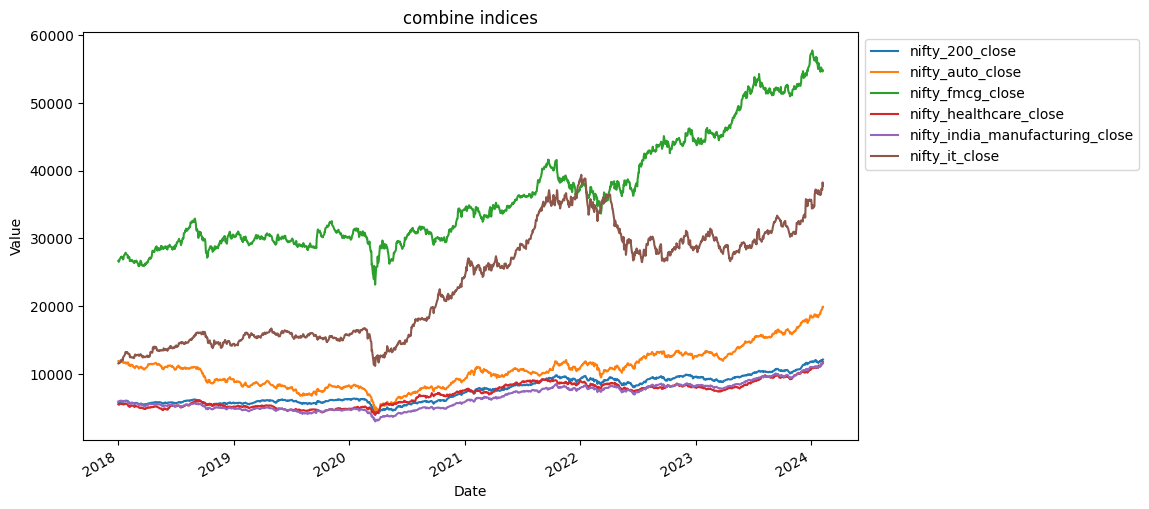

In [13]:
close_columns = ['nifty_200_close', 'nifty_auto_close',
                  'nifty_fmcg_close',
                 'nifty_healthcare_close', 'nifty_india_manufacturing_close',
                 'nifty_it_close']

combined_nifty_df[close_columns]['2018-01-01':].plot(figsize=(10,6),title='combine indices')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [14]:
foriegn_indicator_path = "../Scraper/labels/global_indices.csv"
fi_df = pd.read_csv(foriegn_indicator_path)
fi_df['Date'] = pd.to_datetime(fi_df['Date'])
fi_df.set_index(fi_df['Date'],inplace=True)
fi_df.drop('Date',axis=1,inplace=True)
fi_df

^DJI_open     ^DJI_high      ^DJI_low    ^DJI_close  \
Date                                                                 
2018-01-02  24809.349609  24864.189453  24741.699219  24824.009766   
2018-01-03  24850.449219  24941.919922  24825.550781  24922.679688   
2018-01-04  24964.859375  25105.960938  24963.269531  25075.130859   
2018-01-05  25114.919922  25299.789062  25112.009766  25295.869141   
2018-01-08  25308.400391  25311.990234  25235.410156  25283.000000   
...                  ...           ...           ...           ...   
2024-02-28  38938.078125  38956.460938  38741.679688  38949.019531   
2024-02-29  39013.750000  39074.128906  38809.281250  38996.390625   
2024-03-01  38989.511719  39120.359375  38850.500000  39087.378906   
2024-03-04  38968.769531  39087.859375  38913.300781  38989.828125   
2024-03-05  38906.980469  38906.980469  38457.828125  38585.191406   

            ^DJI_volume  BTC-USD_open  BTC-USD_high   BTC-USD_low  \
Date                                                                
2018-01-02    341130000  13625.000000  15444.599609  13163.599609   
2018-01-03    456790000  14978.200195  15572.799805  14844.500000   
2018-01-04    403280000  15270.700195  15739.700195  14522.200195   
2018-01-05    358020000  15477.200195  17705.199219  15202.799805   
2018-01-08    341390000  16476.199219  16537.900391  14208.200195   
...                 ...           ...           ...           ...   
2024-02-28    272560000  57071.097656  63913.132812  56738.425781   
2024-02-29    519690000  62499.183594  63585.644531  60498.730469   
2024-03-01    331030000  61168.062500  63155.101562  60802.527344   
2024-03-04    386290000  63137.003906  68537.031250  62386.519531   
2024-03-05    393750000  68341.054688  69170.625000  59323.910156   

            BTC-USD_close  BTC-USD_volume  ...   ^GSPC_open   ^GSPC_high  \
Date                                       ...                             
2018-01-02   14982.099609     16846600192  ...  2683.729980  2695.889893   
2018-01-03   15201.000000     16871900160  ...  2697.850098  2714.370117   
2018-01-04   15599.200195     21783199744  ...  2719.310059  2729.290039   
2018-01-05   17429.500000     23840899072  ...  2731.330078  2743.449951   
2018-01-08   15170.099609     18413899776  ...  2742.669922  2748.510010   
...                   ...             ...  ...          ...          ...   
2024-02-28   62504.789062     83239156760  ...  5067.200195  5077.370117   
2024-02-29   61198.382812     65496611844  ...  5085.359863  5104.990234   
2024-03-01   62440.632812     40186368423  ...  5098.509766  5140.330078   
2024-03-04   68330.414062     70670471105  ...  5130.990234  5149.669922   
2024-03-05   63801.199219    102802940877  ...  5110.520020  5114.540039   

              ^GSPC_low  ^GSPC_close  ^GSPC_volume    ^NSEI_open  \
Date                                                               
2018-01-02  2682.360107  2695.810059    3397430000  10477.549805   
2018-01-03  2697.770020  2713.060059    3544030000  10482.650391   
2018-01-04  2719.070068  2723.989990    3697340000  10469.400391   
2018-01-05  2727.919922  2743.149902    3239280000  10534.250000   
2018-01-08  2737.600098  2747.709961    3246160000  10591.700195   
...                 ...          ...           ...           ...   
2024-02-28  5058.350098  5069.759766    3789370000  22214.099609   
2024-02-29  5061.890137  5096.270020    5219740000  21935.199219   
2024-03-01  5094.160156  5137.080078    4748110000  22048.300781   
2024-03-04  5127.180176  5130.950195    4758440000  22403.500000   
2024-03-05  5056.819824  5078.649902    4418410000  22371.250000   

              ^NSEI_high     ^NSEI_low   ^NSEI_close  ^NSEI_volume  
Date                                                                
2018-01-02  10495.200195  10404.650391  10442.200195        153400  
2018-01-03  10503.599609  10429.549805  10443.200195        167300  
2018-01-04  10513.000000  10441.450195  10504.799805    

In [16]:
# Initialize an empty DataFrame to store the combined data
news_data = pd.DataFrame(columns=['date', 'content'])

# Iterate through each CSV file and concatenate the data
for csv_file in money_cont_csv:
    file_path = csv_file
    df = pd.read_csv(csv_file)

    # Check if the DataFrame has 'date time' and 'content' columns, and adjust accordingly
    if 'date time' in df.columns and 'content' in df.columns:
        try:
            df['date'] = pd.to_datetime(df['date time'].str.replace(' IST', ''), format="%B %d, %Y %I:%M %p", errors='coerce')
            df['content'] = df['title'] + ' ' + df['desc'] + ' ' + df['content']
            # Drop rows with NaT in the 'date' column
#             df = df.dropna(subset=['date'])
            news_data = pd.concat([news_data, df[['date', 'content']]])
        except Exception as e:
            print(f"Error processing {csv_file}: {str(e)}")
    elif 'Time' in df.columns and 'Headlines' in df.columns:
        # Concatenate 'Time' and 'Headlines' columns and rename them to 'date' and 'content'
        try:
            df['date'] = pd.to_datetime(df['Time'], errors='coerce')
            df['content'] = df['Headlines']
            # Drop rows with NaT in the 'date' column
            df = df.dropna(subset=['date'])
            news_data = pd.concat([news_data, df[['date', 'content']]])
        except Exception as e:
            print(f"Error processing {csv_file}: {str(e)}")
    else:
        # If columns are different, you may need to adjust this part based on your actual data
        print(f"Columns in {csv_file} are different. Adjust the code accordingly.")

# Set the 'date' column as the index
news_data.set_index('date', inplace=True)

# Sort the DataFrame by date
news_data.sort_index(inplace=True)

# Display the combined DataFrame
news_data

C:\Users\jeetc\AppData\Local\Temp\ipykernel_10476\1348329736.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  news_data = pd.concat([news_data, df[['date', 'content']]])
C:\Users\jeetc\AppData\Local\Temp\ipykernel_10476\1348329736.py:22: FutureWarning: Parsed string " 7:51  PM ET Fri, 17 July 2020" included an un-recognized timezone "ET". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  df['date'] = pd.to_datetime(df['Time'], errors='coerce')
C:\Users\jeetc\AppData\Local\Temp\ipykernel_10476\1348329736.py:22: UserWarning: Could not infer format, so each element will be parsed individually, falling

content
date                                                                  
2017-12-17 00:00:00  The Guardian view on Ryanair’s model: a union-...
2017-12-17 00:00:00  Peter Preston on press and broadcasting  \r\n\...
2017-12-17 00:00:00  Why business could prosper under a Corbyn gove...
2017-12-17 00:00:00  Youngest staff to be given UK workplace pensio...
2017-12-17 00:00:00  Grogonomics  \r\n\r\n\r\n  This year has been ...
...                                                                ...
2024-02-08 00:28:00  Uber expects strong core profit as ride share,...
2024-02-08 06:22:00  India eyes $100 billion investment deal with S...
2024-02-08 08:29:00  RBI hasn't agreed to bring EVs on priority sec...
2024-02-08 08:31:00  Analyst call tracker: HUL, Asian Paints among ...
2024-02-08 09:09:00  Nestle India Q4 show fails to impress. Should ...

[58467 rows x 1 columns]

In [17]:
duplicate_indices = news_data.index[news_data.index.duplicated(keep=False)]

if not duplicate_indices.empty:
    duplicate_rows = news_data[news_data.index.isin(duplicate_indices)]
    print("Rows with duplicate indices:")
    print(duplicate_rows)
else:
    print("No duplicate indices found.")

Rows with duplicate indices:
                                                               content
date                                                                  
2017-12-17 00:00:00  The Guardian view on Ryanair’s model: a union-...
2017-12-17 00:00:00  Peter Preston on press and broadcasting  \r\n\...
2017-12-17 00:00:00  Why business could prosper under a Corbyn gove...
2017-12-17 00:00:00  Youngest staff to be given UK workplace pensio...
2017-12-17 00:00:00  Grogonomics  \r\n\r\n\r\n  This year has been ...
...                                                                ...
2024-02-07 22:16:00  Bulk deals: LIC sells Rs 75.2 crore shares in ...
2024-02-07 22:52:00  Global stocks hit two-year highs, as dollar ea...
2024-02-07 22:52:00  Kinetic Green rolls out E-Luna at Rs 69,990, a...
2024-02-07 23:02:00  India's debt-to-GDP ratio well below emerging ...
2024-02-07 23:02:00  India's debt-to-GDP ratio well below emerging ...

[55081 rows x 1 columns]


In [18]:
start_date = datetime.datetime(2018, 1, 1)
end_date = datetime.datetime(2024, 3, 6)
combined_nifty_df[start_date:end_date]
fi_df[start_date:end_date]
news_data[start_date:end_date]

content
date                                                                  
2018-01-02 00:00:00  Cheltenham house prices rise while Perth sees ...
2018-01-02 00:00:00  Bankers work around the clock to iron out EU f...
2018-01-02 00:00:00  Transport secretary ‘running scared’ as he fli...
2018-01-02 00:00:00  Good for factories, bad for shoppers: a Brexit...
2018-01-02 00:00:00  Business live  UK, US and eurozone manufacturi...
...                                                                ...
2024-02-08 00:28:00  Uber expects strong core profit as ride share,...
2024-02-08 06:22:00  India eyes $100 billion investment deal with S...
2024-02-08 08:29:00  RBI hasn't agreed to bring EVs on priority sec...
2024-02-08 08:31:00  Analyst call tracker: HUL, Asian Paints among ...
2024-02-08 09:09:00  Nestle India Q4 show fails to impress. Should ...

[58222 rows x 1 columns]

In [19]:
def remove_row_with_nan(features,column_name):
  features_filterd = features.dropna(subset=[column_name])
  return features_filterd

features  = remove_row_with_nan(news_data,'content')

In [20]:
features.index = pd.to_datetime(features.index)

# Define the split date
split_date = pd.to_datetime('2022-12-31')

# Filter the DataFrame for training and testing sets
train_df = features[features.index < split_date]
test_df = features[features.index >= split_date]
len(train_df), len(test_df)

(53330, 4191)

In [21]:
pipe = pipeline('text-classification',model='ProsusAI/finbert')
tokenizer = AutoTokenizer.from_pretrained('ProsusAI/finbert')

model = AutoModelForSequenceClassification.from_pretrained('ProsusAI/Finbert')

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

C:\Users\jeetc\miniconda3\envs\fooocus\lib\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\jeetc\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


In [39]:
def analyze_sentiment(dataframe,textlabel):
  sentiments = defaultdict(lambda : {'pos':[],'neg':[],'neu':[]})

  for index, row in tqdm(dataframe.iterrows(),total=len(dataframe)):
    print(row)
    text = [row[textlabel]]

    inputs = tokenizer(text,return_tensors='pt')

    outputs = model(**inputs)

    probs = outputs.logits.softmax(dim=1)

    pos = probs[:,0].tolist()
    neg = probs[:,1].tolist()
    neu = probs[:,2].tolist()

    sentiments[row.name]['pos'].extend(pos)
    sentiments[row.name]['neg'].extend(neg)
    sentiments[row.name]['neu'].extend(neu)
  return sentiments

In [29]:
features.index.to_list

DatetimeIndex(['2017-12-17 00:00:00', '2017-12-17 00:00:00',
               '2017-12-17 00:00:00', '2017-12-17 00:00:00',
               '2017-12-17 00:00:00', '2017-12-17 00:00:00',
               '2017-12-17 00:00:00', '2017-12-17 00:00:00',
               '2017-12-17 00:00:00', '2017-12-17 00:00:00',
               ...
               '2024-02-07 22:55:00', '2024-02-07 23:01:00',
               '2024-02-07 23:02:00', '2024-02-07 23:02:00',
               '2024-02-07 23:39:00', '2024-02-08 00:28:00',
               '2024-02-08 06:22:00', '2024-02-08 08:29:00',
               '2024-02-08 08:31:00', '2024-02-08 09:09:00'],
              dtype='datetime64[ns]', name='date', length=57521, freq=None)

In [ ]:
sentiments = analyze_sentiment(features,'content')
sentiments

  0%|                                                                              | 2/57521 [00:00<1:10:59, 13.51it/s]

content    The Guardian view on Ryanair’s model: a union-...
Name: 2017-12-17 00:00:00, dtype: object
content    Peter Preston on press and broadcasting  \r\n\...
Name: 2017-12-17 00:00:00, dtype: object
content    Why business could prosper under a Corbyn gove...
Name: 2017-12-17 00:00:00, dtype: object


  0%|                                                                              | 6/57521 [00:00<1:03:24, 15.12it/s]

content    Youngest staff to be given UK workplace pensio...
Name: 2017-12-17 00:00:00, dtype: object
content    Grogonomics  \r\n\r\n\r\n  This year has been ...
Name: 2017-12-17 00:00:00, dtype: object
content    Butchers carve out a niche as UK shoppers opt ...
Name: 2017-12-17 00:00:00, dtype: object


  0%|                                                                                | 9/57521 [00:00<53:44, 17.84it/s]

content    David Cameron to lead £750m UK-China investmen...
Name: 2017-12-17 00:00:00, dtype: object
content    US mall operators must buy into e-retail and n...
Name: 2017-12-17 00:00:00, dtype: object
content    Global shopping centre giants go on a Christma...
Name: 2017-12-17 00:00:00, dtype: object
content    Is the global desire to buy British a bad thin...
Name: 2017-12-17 00:00:00, dtype: object
content    Unilever sells household name spreads to KKR f...
Name: 2017-12-17 00:00:00, dtype: object


  0%|                                                                             | 13/57521 [00:00<1:03:07, 15.18it/s]

content    Britons set new gin record after buying 47m bo...
Name: 2017-12-17 00:00:00, dtype: object
content    British Steel pension scheme members ‘preyed o...
Name: 2017-12-17 00:00:00, dtype: object
content    ‘Going to the Furniture Ombudsman about our so...
Name: 2017-12-17 00:00:00, dtype: object


  0%|                                                                             | 15/57521 [00:00<1:07:00, 14.30it/s]

content    Uber stole trade secrets, bribed foreign offic...
Name: 2017-12-17 00:00:00, dtype: object
content    Hundreds to lose jobs as Britvic shuts down No...
Name: 2017-12-17 00:00:00, dtype: object
content    How investing in solar energy can create a bri...
Name: 2017-12-17 00:00:00, dtype: object


  0%|                                                                             | 20/57521 [00:01<1:00:47, 15.76it/s]

content    Poundland suppliers hit by insurance downgrade
Name: 2017-12-17 00:00:00, dtype: object
content    Cryptocurrencies: City watchdog to investigate...
Name: 2017-12-17 00:00:00, dtype: object
content    Alabama unions see Doug Jones's win as a victo...
Name: 2017-12-17 00:00:00, dtype: object
content    Revealed: the government email telling HS2 not...
Name: 2017-12-18 00:00:00, dtype: object
content    Ryanair has recognised unions. Hell must have ...
Name: 2017-12-18 00:00:00, dtype: object


  0%|                                                                               | 26/57521 [00:01<49:54, 19.20it/s]

content    Trump's tax bill has nothing to do with econom...
Name: 2017-12-18 00:00:00, dtype: object
content    EU investigates Ikea after Dutch deals reduce ...
Name: 2017-12-18 00:00:00, dtype: object
content    UK manufacturing order books near three-decade...
Name: 2017-12-18 00:00:00, dtype: object
content    Hermes delivery driver's diary shows flipside ...
Name: 2017-12-18 00:00:00, dtype: object
content    Bumper business Christmas quiz 2017
Name: 2017-12-18 00:00:00, dtype: object


  0%|                                                                               | 31/57521 [00:01<48:26, 19.78it/s]

content    Business live  Bitcoin bubble warnings grow lo...
Name: 2017-12-18 00:00:00, dtype: object
content    Atlanta airport: power restored but flight del...
Name: 2017-12-18 00:00:00, dtype: object
content    Building regulations unfit for purpose, Grenfe...
Name: 2017-12-18 00:00:00, dtype: object
content    Spread-betting firms' shares plunge as EU watc...
Name: 2017-12-18 00:00:00, dtype: object


  0%|                                                                               | 35/57521 [00:01<42:58, 22.29it/s]

content    Christmas tree cutters' labor fight shines lig...
Name: 2017-12-18 00:00:00, dtype: object
content    How the American government slowly became a bu...
Name: 2017-12-18 00:00:00, dtype: object
content    Global coal consumption forecast to slow
Name: 2017-12-18 00:00:00, dtype: object
content    Desperate UK homeowners are cutting prices, sa...
Name: 2017-12-18 00:00:00, dtype: object
content    ‘They stole the soul of the city’: how Warsaw'...
Name: 2017-12-18 00:00:00, dtype: object


  0%|                                                                               | 38/57521 [00:02<48:04, 19.93it/s]

content    Deck the stalls: Christmas markets and pop ups...
Name: 2017-12-18 00:00:00, dtype: object
content    Weak pound boosts English sparkling wine sales...
Name: 2017-12-18 00:00:00, dtype: object
content    France saves Marquis de Sade’s 120 Days of Sod...
Name: 2017-12-18 00:00:00, dtype: object
content    UK banks face fines as immigration checks on a...
Name: 2017-12-18 00:00:00, dtype: object


  0%|                                                                               | 43/57521 [00:02<54:07, 17.70it/s]

content    Brace yourself for the next Brexit faultline: ...
Name: 2017-12-18 00:00:00, dtype: object
content    Boost for fossil fuel divestment as UK eases p...
Name: 2017-12-18 00:00:00, dtype: object
content    Brexit will usher in a dark chapter for new Br...
Name: 2017-12-18 00:00:00, dtype: object
content    Waitrose urged to stop selling Shetland scallo...
Name: 2017-12-18 00:00:00, dtype: object


  0%|                                                                               | 45/57521 [00:02<59:59, 15.97it/s]

content    Adani scraps $2bn deal to outsource Carmichael...
Name: 2017-12-18 00:00:00, dtype: object
content    LSE chairman set to see off activist's attempt...
Name: 2017-12-18 00:00:00, dtype: object
content    Universal basic income is no panacea for us – ...
Name: 2017-12-18 00:00:00, dtype: object


  0%|                                                                             | 49/57521 [00:02<1:04:30, 14.85it/s]

content    UK banks tell May: a Canada-style Brexit deal ...
Name: 2017-12-18 00:00:00, dtype: object
content    Business leader  \r\n\r\n\r\n  The UK jobs eng...
Name: 2017-12-18 00:00:00, dtype: object
content    Amazon Prime could face investigation over del...
Name: 2017-12-18 00:00:00, dtype: object
content    Trump EPA rule change exploits taxpayers for m...
Name: 2017-12-18 00:00:00, dtype: object


  0%|                                                                             | 53/57521 [00:03<1:01:11, 15.65it/s]

content    Ryanair pilots suspend one-day strike in week ...
Name: 2017-12-18 00:00:00, dtype: object
content    Economics viewpoint  \r\n\r\n\r\n  Heretics we...
Name: 2017-12-18 00:00:00, dtype: object
content    Halifax cover: £1,227 if you are loyal, £370 i...
Name: 2017-12-18 00:00:00, dtype: object
content    Is Monzo the Facebook of banking?
Name: 2017-12-18 00:00:00, dtype: object


  0%|                                                                               | 57/57521 [00:03<56:54, 16.83it/s]

content    Venue of last resort: the climate lawsuits thr...
Name: 2017-12-18 00:00:00, dtype: object
content    Old and vulnerable people and financial whiz-k...
Name: 2017-12-18 00:00:00, dtype: object
content    William Keegan's in my view  \r\n\r\n\r\n  The...
Name: 2017-12-18 00:00:00, dtype: object
content    Observer business agenda  \r\n\r\n\r\n  Bring ...
Name: 2017-12-18 00:00:00, dtype: object


  0%|                                                                               | 62/57521 [00:03<51:00, 18.78it/s]

content    Curbs on capitalism in the 21st century
Name: 2017-12-18 00:00:00, dtype: object
content    Business live  World markets driven to record ...
Name: 2017-12-19 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  The Pen...
Name: 2017-12-19 00:00:00, dtype: object
content    UK pensions lifeboat to block Toys R Us surviv...
Name: 2017-12-19 00:00:00, dtype: object
content    Bitcoin not a threat to financial stability, s...
Name: 2017-12-19 00:00:00, dtype: object


  0%|                                                                               | 67/57521 [00:03<45:18, 21.13it/s]

content    Switch your UK mobile network with a text mess...
Name: 2017-12-19 00:00:00, dtype: object
content    When will we see the world's first trillionaire?
Name: 2017-12-19 00:00:00, dtype: object
content    Toys R Us UK faces collapse with loss of all 3...
Name: 2017-12-19 00:00:00, dtype: object
content    Universal Music snaps up UK record labels ZTT ...
Name: 2017-12-19 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Is this...
Name: 2017-12-19 00:00:00, dtype: object
content    House prices to fall in London and south-east ...
Name: 2017-12-19 00:00:00, dtype: object
content    Come to debtors’ court. See how ministers dest...
Name: 2017-12-19 00:00:00, dtype: object


  0%|                                                                               | 74/57521 [00:04<41:02, 23.33it/s]

content    UK cannot have a special deal for the City, sa...
Name: 2017-12-19 00:00:00, dtype: object
content    First pilots, now cabin crew – Ryanair to reco...
Name: 2017-12-19 00:00:00, dtype: object
content    The Guardian view on Theresa May and Brexit: t...
Name: 2017-12-19 00:00:00, dtype: object
content    Undercover in the chicken industry  Tesco foun...
Name: 2017-12-19 00:00:00, dtype: object
content    Delving deeper into an economics Reformation
Name: 2017-12-19 00:00:00, dtype: object
content    Creditors desert Poundland owner amid South Af...
Name: 2017-12-19 00:00:00, dtype: object


  0%|                                                                               | 82/57521 [00:04<34:37, 27.64it/s]

content    Top British firms named and shamed on PM's fat...
Name: 2017-12-19 00:00:00, dtype: object
content    Tenants lose out after landlord pressure halve...
Name: 2017-12-19 00:00:00, dtype: object
content    China aims to drastically cut greenhouse gas e...
Name: 2017-12-19 00:00:00, dtype: object
content    European court rules champagne sorbet can keep...
Name: 2017-12-20 00:00:00, dtype: object
content    A victory for workers over Uber. But beware th...
Name: 2017-12-20 00:00:00, dtype: object
content    Hedge funds fail to stop 'billion-dollar brain...
Name: 2017-12-20 00:00:00, dtype: object
content    Bank of England to allow EU banks to keep UK o...
Name: 2017-12-20 00:00:00, dtype: object


  0%|                                                                               | 89/57521 [00:04<34:17, 27.92it/s]

content    Gloomy Brexit forecasts for UK are coming true...
Name: 2017-12-20 00:00:00, dtype: object
content    Nearly 45,000 UK retailers in financial distre...
Name: 2017-12-20 00:00:00, dtype: object
content    Business live  Bank of England Carney says UK ...
Name: 2017-12-20 00:00:00, dtype: object
content    Thousands of tonnes of dangerous mining waste ...
Name: 2017-12-20 00:00:00, dtype: object
content    Gove: UK would not compromise with US on food ...
Name: 2017-12-20 00:00:00, dtype: object
content    Uber to face stricter EU regulation after ECJ ...
Name: 2017-12-20 00:00:00, dtype: object


  0%|▏                                                                              | 95/57521 [00:04<36:00, 26.58it/s]

content    Ryanair to face select committee investigation...
Name: 2017-12-20 00:00:00, dtype: object
content    France bans fracking and oil extraction in all...
Name: 2017-12-20 00:00:00, dtype: object
content    Marks & Spencer is first supermarket to publis...
Name: 2017-12-20 00:00:00, dtype: object
content    UK's Christmas workers earning less than 10 ye...
Name: 2017-12-20 00:00:00, dtype: object
content    Payments regulator urged to prevent 'ATM deser...
Name: 2017-12-20 00:00:00, dtype: object


  0%|▏                                                                              | 98/57521 [00:04<36:06, 26.50it/s]

content    Parts of UK that voted Brexit are most exposed...
Name: 2017-12-20 00:00:00, dtype: object
content    ‘Drugs are too expensive for the NHS – and peo...
Name: 2017-12-20 00:00:00, dtype: object
content    Could buying Christmas jewellery be funding ge...
Name: 2017-12-20 00:00:00, dtype: object
content    High-speed broadband to be legal right for UK ...
Name: 2017-12-20 00:00:00, dtype: object
content    Senate approves most drastic changes to US tax...
Name: 2017-12-20 00:00:00, dtype: object


  0%|▏                                                                             | 104/57521 [00:05<38:57, 24.57it/s]

content    Eurostar set for busiest December on record
Name: 2017-12-21 00:00:00, dtype: object
content    This land is your land  \r\n\r\n\r\n  Alaska’s...
Name: 2017-12-21 00:00:00, dtype: object
content    Wholesalers set to appeal after Tesco's takeov...
Name: 2017-12-21 00:00:00, dtype: object
content    Building regulations experts who weren’t heard...
Name: 2017-12-21 00:00:00, dtype: object
content    Britain’s broken housing market needs radical ...
Name: 2017-12-21 00:00:00, dtype: object
content    The Guardian view on rape and the police: just...
Name: 2017-12-21 00:00:00, dtype: object


  0%|▏                                                                             | 110/57521 [00:05<39:56, 23.96it/s]

content    Nils Pratley on finance  \r\n\r\n\r\n  Bank's ...
Name: 2017-12-21 00:00:00, dtype: object
content    Sajid Javid promises to liberate leaseholders ...
Name: 2017-12-21 00:00:00, dtype: object
content    Agency staff collectively underpaid by £400m a...
Name: 2017-12-21 00:00:00, dtype: object
content    The long read  Hinkley Point: the ‘dreadful de...
Name: 2017-12-21 00:00:00, dtype: object


  0%|▏                                                                             | 113/57521 [00:05<38:29, 24.86it/s]

content    A small number of farms are responsible for th...
Name: 2017-12-21 00:00:00, dtype: object
content    Last-minute Christmas shopping guide: there is...
Name: 2017-12-21 00:00:00, dtype: object
content    Toys R Us holds last-minute talks with pension...
Name: 2017-12-21 00:00:00, dtype: object
content    'Nut rage': court upholds suspended sentence f...
Name: 2017-12-21 00:00:00, dtype: object
content    Candy brothers win high court battle
Name: 2017-12-21 00:00:00, dtype: object
content    The disruptors  Lab-grown luxuries: cruelty-fr...
Name: 2017-12-21 00:00:00, dtype: object


  0%|▏                                                                             | 119/57521 [00:05<36:31, 26.19it/s]

content    Brexit data snapshot  How has the Brexit vote ...
Name: 2017-12-21 00:00:00, dtype: object
content    Guardian Brexit watch  \r\n\r\n\r\n  Brexit he...
Name: 2017-12-21 00:00:00, dtype: object
content    Fall in demand shrinks UK car making by 4.6%
Name: 2017-12-21 00:00:00, dtype: object
content    Guardian Brexit watch  Brexit economy: a turbu...
Name: 2017-12-21 00:00:00, dtype: object
content    Pick up a bargain with our guide to the UK win...
Name: 2017-12-22 00:00:00, dtype: object
content    Business live  UK car production heads for fir...
Name: 2017-12-22 00:00:00, dtype: object


  0%|▏                                                                             | 125/57521 [00:06<40:00, 23.91it/s]

content    The Entertainer won't let a tough year ruin th...
Name: 2017-12-22 00:00:00, dtype: object
content    The Guardian's Audio Long Reads  From inboxing...
Name: 2017-12-22 00:00:00, dtype: object
content    Ladbrokes Coral agrees £4bn takeover by online...
Name: 2017-12-22 00:00:00, dtype: object
content    UK household spending slows to lowest level in...
Name: 2017-12-22 00:00:00, dtype: object


  0%|▏                                                                             | 128/57521 [00:06<43:29, 21.99it/s]

content    Business made simple  Business Made Simple eve...
Name: 2017-12-22 00:00:00, dtype: object
content    Make supermarkets and drinks firms pay for pla...
Name: 2017-12-22 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Playing...
Name: 2017-12-22 00:00:00, dtype: object
content    Undercover in the chicken industry  Tesco chie...
Name: 2017-12-22 00:00:00, dtype: object


  0%|▏                                                                             | 134/57521 [00:06<41:32, 23.03it/s]

content    Facebook signs deal with Universal to give use...
Name: 2017-12-22 00:00:00, dtype: object
content    Ideas for an economics in which people matter
Name: 2017-12-22 00:00:00, dtype: object
content    Nuclear and renewables provide record share of...
Name: 2017-12-22 00:00:00, dtype: object
content    Tiny US soft drinks firm changes name to cash ...
Name: 2017-12-22 00:00:00, dtype: object
content    Thousands of UK Toys R Us jobs saved after dea...
Name: 2017-12-22 00:00:00, dtype: object
content    Shell to supply energy to UK households after ...
Name: 2017-12-22 00:00:00, dtype: object
content    Hammond gets early Christmas gift as public se...
Name: 2017-12-22 00:00:00, dtype: object


  0%|▏                                                                             | 141/57521 [00:06<37:34, 25.45it/s]

content    Steelworkers face huge pension cuts as Tata co...
Name: 2017-12-22 00:00:00, dtype: object
content    Turntables are golden as UK retailers report b...
Name: 2017-12-22 00:00:00, dtype: object
content    Business live  UK annual growth revised up, bu...
Name: 2017-12-22 00:00:00, dtype: object
content    Cramer: Never buy a stock all at once — you'll...
Name: 2017-12-22 18:52:00, dtype: object
content    Cramer: I helped investors through the 2010 fl...
Name: 2017-12-22 19:07:00, dtype: object
content    Cramer says owning too many stocks and too lit...
Name: 2017-12-22 19:07:00, dtype: object


  0%|▏                                                                             | 147/57521 [00:06<36:01, 26.54it/s]

content    Festive TV is becoming a thing of Christmas past
Name: 2017-12-25 00:00:00, dtype: object
content    Bitcoin loses a quarter of its value in one da...
Name: 2017-12-25 00:00:00, dtype: object
content    Police UK tax havens to help world’s poorest p...
Name: 2017-12-25 00:00:00, dtype: object
content    The Guardian view on rough sleeping: no room a...
Name: 2017-12-25 00:00:00, dtype: object
content    Grosvenor Crescent rated the most expensive st...
Name: 2017-12-25 00:00:00, dtype: object
content    Tesco pledges to end edible food waste by Marc...
Name: 2017-12-25 00:00:00, dtype: object


  0%|▏                                                                             | 150/57521 [00:07<38:04, 25.12it/s]

content    2017: the sequel … seven lessons for Hollywood...
Name: 2017-12-25 00:00:00, dtype: object
content    Complacent regulators have two years to preven...
Name: 2017-12-25 00:00:00, dtype: object
content    Green shoots at BlackBerry? Fallen phone giant...
Name: 2017-12-25 00:00:00, dtype: object
content    Observer business agenda  \r\n\r\n\r\n  Stock ...
Name: 2017-12-25 00:00:00, dtype: object


  0%|▏                                                                             | 156/57521 [00:07<42:19, 22.59it/s]

content    Letters: there’s plenty of good news coming ou...
Name: 2017-12-25 00:00:00, dtype: object
content    New York City's electric bike delivery workers...
Name: 2017-12-25 00:00:00, dtype: object
content    New York's vanishing shops and storefronts: 'I...
Name: 2017-12-25 00:00:00, dtype: object
content    FBI investigates Russian-linked Cyprus bank ac...
Name: 2017-12-25 00:00:00, dtype: object
content    Wagamama apologises over Christmas sick leave ...
Name: 2017-12-25 00:00:00, dtype: object


  0%|▏                                                                             | 160/57521 [00:07<39:07, 24.43it/s]

content    ‘They see the potential’: why J-Lo and Gillett...
Name: 2017-12-25 00:00:00, dtype: object
content    'We're here for the long haul': are independen...
Name: 2017-12-25 00:00:00, dtype: object
content    UK fracking to begin in earnest in 2018 after ...
Name: 2017-12-25 00:00:00, dtype: object
content    UK frackers are running out of time
Name: 2017-12-25 00:00:00, dtype: object
content    Business leader  \r\n\r\n\r\n  Chief executive...
Name: 2017-12-25 00:00:00, dtype: object


  0%|▏                                                                             | 166/57521 [00:07<41:44, 22.90it/s]

content    Markets lack Christmas cheer
Name: 2017-12-26 10:15:00, dtype: object
content    Philip Hammond urged to publish Treasury's Bre...
Name: 2017-12-27 00:00:00, dtype: object
content    The pots of gold at the east edge of London
Name: 2017-12-27 00:00:00, dtype: object
content    Six objects to define the London of 2017
Name: 2017-12-27 00:00:00, dtype: object


  0%|▏                                                                             | 169/57521 [00:07<43:02, 22.21it/s]

content    Campaign launched to return East Coast rail to...
Name: 2017-12-27 00:00:00, dtype: object
content    Britons borrow an average £452 each on credit ...
Name: 2017-12-27 00:00:00, dtype: object
content    Flight from LA to Tokyo turns around after fou...
Name: 2017-12-27 00:00:00, dtype: object
content    Back to front: why switching queues will get y...
Name: 2017-12-27 00:00:00, dtype: object
content    Boxing Day sales: shoppers spend big but footf...
Name: 2017-12-27 00:00:00, dtype: object


  0%|▏                                                                             | 175/57521 [00:08<43:43, 21.86it/s]

content    Zero real wage growth in Britain until end of ...
Name: 2017-12-27 00:00:00, dtype: object
content    Tesco apologises after customers complain of '...
Name: 2017-12-27 00:00:00, dtype: object
content    Innovations in development  Good vibrations: a...
Name: 2017-12-27 00:00:00, dtype: object
content    The Guardian view on capitalism without capital
Name: 2017-12-27 00:00:00, dtype: object
content    Six factors influencing the UK property market...
Name: 2017-12-27 00:00:00, dtype: object


  0%|▏                                                                             | 181/57521 [00:08<43:18, 22.07it/s]

content    UK house price growth to slow dramatically in ...
Name: 2017-12-27 00:00:00, dtype: object
content    Bitcoin bubble inflates again after pre-Christ...
Name: 2017-12-27 00:00:00, dtype: object
content    Boxing Day shoppers expected to flock to high ...
Name: 2017-12-27 00:00:00, dtype: object
content    UK braced for record number of tourists in 2018
Name: 2017-12-27 00:00:00, dtype: object


  0%|▏                                                                             | 184/57521 [00:08<41:32, 23.00it/s]

content    2018 will be the year 4K TV goes big, but HDR ...
Name: 2017-12-27 00:00:00, dtype: object
content    Record numbers of tourists visit UK despite te...
Name: 2017-12-27 00:00:00, dtype: object
content    UK energy cap could have been avoided, lobby g...
Name: 2017-12-27 00:00:00, dtype: object
content    S&P tends to start new year bullish after this...
Name: 2017-12-27 10:13:00, dtype: object
content    Apple's Tim Cook paid $102m this year includin...
Name: 2017-12-28 00:00:00, dtype: object
content    Which big names in business are 2018’s ones to...
Name: 2017-12-28 00:00:00, dtype: object


  0%|▎                                                                             | 190/57521 [00:08<39:54, 23.94it/s]

content    Business live  FTSE 100 hits record high; Bitc...
Name: 2017-12-28 00:00:00, dtype: object
content    UK to sink to the bottom of OECD wage growth i...
Name: 2017-12-28 00:00:00, dtype: object
content    Uber valued at $48bn after consortium secures ...
Name: 2017-12-28 00:00:00, dtype: object
content    Bitcoin falls $1,000 after South Korea promise...
Name: 2017-12-28 00:00:00, dtype: object
content    Councils should have a statutory duty to provi...
Name: 2017-12-28 00:00:00, dtype: object
content    Innovations in development  How the sun's rays...
Name: 2017-12-28 00:00:00, dtype: object


  0%|▎                                                                             | 196/57521 [00:09<40:13, 23.76it/s]

content    Thatcher warned Major about exchange rate risk...
Name: 2017-12-28 00:00:00, dtype: object
content    The year in business: bitcoin boom, Brexit cou...
Name: 2017-12-28 00:00:00, dtype: object
content    The disruptors  Cycling gadgets: the invisible...
Name: 2017-12-28 00:00:00, dtype: object
content    Innovations in development  The magnets and li...
Name: 2017-12-28 00:00:00, dtype: object
content    Barclays says Trump tax changes will knock £1b...
Name: 2017-12-28 00:00:00, dtype: object
content    Boots criticised over failure to cut price of ...
Name: 2017-12-28 00:00:00, dtype: object


  0%|▎                                                                             | 202/57521 [00:09<36:48, 25.95it/s]

content    World's richest 500 see their wealth increase ...
Name: 2017-12-28 00:00:00, dtype: object
content    Gambling-style apps offered on Facebook withou...
Name: 2017-12-28 00:00:00, dtype: object
content    UK economy boosted by wage growth and rising o...
Name: 2017-12-28 00:00:00, dtype: object
content    End of la ZAD? France’s ‘utopian’ anti-airport...
Name: 2017-12-28 00:00:00, dtype: object
content    Electric passenger jet revolution looms as E-F...
Name: 2017-12-28 00:00:00, dtype: object
content    Business live  London stock market hits record...
Name: 2017-12-28 00:00:00, dtype: object


  0%|▎                                                                             | 208/57521 [00:09<40:14, 23.73it/s]

content    Terry Smith – the man who beat the market in 2017
Name: 2017-12-30 00:00:00, dtype: object
content    Holiday firms' 'hurry' deals dupe customers, s...
Name: 2017-12-30 00:00:00, dtype: object
content    Unions blame train firms and ministers for New...
Name: 2017-12-30 00:00:00, dtype: object
content    Millennials set to reap huge rewards of inheri...
Name: 2017-12-30 00:00:00, dtype: object
content    New Year honours: Bussell, a Bee Gee and a Bea...
Name: 2017-12-30 00:00:00, dtype: object
content    2017's top business stories: Whole Foods, hack...
Name: 2017-12-30 00:00:00, dtype: object


  0%|▎                                                                             | 214/57521 [00:09<41:16, 23.14it/s]

content    Global markets end on record high after adding...
Name: 2017-12-30 00:00:00, dtype: object
content    Business live  FTSE 100 ends 2017 at new recor...
Name: 2017-12-30 00:00:00, dtype: object
content    First-ever shipment of Russian gas unlikely to...
Name: 2017-12-30 00:00:00, dtype: object
content    Why 2018 will be a rum year (possibly)
Name: 2017-12-30 00:00:00, dtype: object
content    Tory and DUP MPs criticised for ‘wining and di...
Name: 2017-12-30 00:00:00, dtype: object


  0%|▎                                                                             | 220/57521 [00:10<43:21, 22.03it/s]

content    Charity leadership  Times will be tough for ch...
Name: 2017-12-30 00:00:00, dtype: object
content    Bacon without the guilt? Nitrite-free rashers ...
Name: 2017-12-30 00:00:00, dtype: object
content    Homebase boss opts for three-month time-out ba...
Name: 2017-12-30 00:00:00, dtype: object
content    Crown Resorts agrees to $150m sale of CrownBet
Name: 2017-12-30 00:00:00, dtype: object


  0%|▎                                                                             | 223/57521 [00:10<46:39, 20.47it/s]

content    Rail passengers lost 3.6m hours in delays in 2...
Name: 2017-12-30 00:00:00, dtype: object
content    Is this the future? Dutch plan vast windfarm i...
Name: 2017-12-30 00:00:00, dtype: object
content    The long read  American reams: why a ‘paperles...
Name: 2017-12-30 00:00:00, dtype: object
content    Trump's tax changes to blow a $5bn hole in Gol...
Name: 2017-12-30 00:00:00, dtype: object


  0%|▎                                                                             | 226/57521 [00:10<52:24, 18.22it/s]

content    'It's about our dignity': vintage clothing ban...
Name: 2017-12-30 00:00:00, dtype: object
content    Switching energy supplier: here's what you can...
Name: 2017-12-31 00:00:00, dtype: object
content    A record-breaking year - the global economy in...
Name: 2017-12-31 00:00:00, dtype: object


  0%|▎                                                                             | 228/57521 [00:10<55:28, 17.21it/s]

content    A fraction of Persimmon boss’s £110m bonus cou...
Name: 2017-12-31 00:00:00, dtype: object
content    Brexit is a 'nationalist spasm': Lord Adonis r...
Name: 2017-12-31 00:00:00, dtype: object
content    VW is raising its profits forecast. Has it cle...
Name: 2017-12-31 00:00:00, dtype: object


  0%|▎                                                                           | 232/57521 [00:10<1:01:26, 15.54it/s]

content    Letters: let’s make 2018 the year that Britain...
Name: 2017-12-31 00:00:00, dtype: object
content    Businesses ‘dismayed’ at Brexit division in We...
Name: 2017-12-31 00:00:00, dtype: object
content    Sunday shops, sport and bars … inside the batt...
Name: 2017-12-31 00:00:00, dtype: object
content    William Keegan's in my view  \r\n\r\n\r\n  Eve...
Name: 2017-12-31 00:00:00, dtype: object


  0%|▎                                                                             | 238/57521 [00:11<47:21, 20.16it/s]

content    Observer business agenda  Gaffes, scandals and...
Name: 2017-12-31 00:00:00, dtype: object
content    Business leader  \r\n\r\n\r\n  The EU still re...
Name: 2017-12-31 00:00:00, dtype: object
content    UK housebuilders to prefabricate hundreds of h...
Name: 2017-12-31 00:00:00, dtype: object
content    Donald Trump's jobs promise just about holding...
Name: 2017-12-31 00:00:00, dtype: object
content    Year of the disruptors: bitcoin, Tesla and the...
Name: 2017-12-31 00:00:00, dtype: object
content    China's growth engine stutters as factories sl...
Name: 2017-12-31 00:00:00, dtype: object
content    Tom Watson calls on Chris Grayling to quit ove...
Name: 2017-12-31 00:00:00, dtype: object


  0%|▎                                                                             | 244/57521 [00:11<42:20, 22.55it/s]

content    Hammond relying on household debt to hit targe...
Name: 2017-12-31 00:00:00, dtype: object
content    Our patience is wearing thin. Commerce needs c...
Name: 2017-12-31 00:00:00, dtype: object
content    Adonis on Brexit: ‘No mandarin backs May. Gove...
Name: 2017-12-31 00:00:00, dtype: object
content    Some joy for the business world in 2018: but q...
Name: 2017-12-31 00:00:00, dtype: object
content    Cheltenham house prices rise while Perth sees ...
Name: 2018-01-02 00:00:00, dtype: object
content    Bankers work around the clock to iron out EU f...
Name: 2018-01-02 00:00:00, dtype: object


  0%|▎                                                                             | 251/57521 [00:11<38:53, 24.55it/s]

content    Transport secretary ‘running scared’ as he fli...
Name: 2018-01-02 00:00:00, dtype: object
content    Good for factories, bad for shoppers: a Brexit...
Name: 2018-01-02 00:00:00, dtype: object
content    Business live  UK, US and eurozone manufacturi...
Name: 2018-01-02 00:00:00, dtype: object
content    Trump tax cut to dent BP profits by $1.5bn, co...
Name: 2018-01-02 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  Do...
Name: 2018-01-02 00:00:00, dtype: object
content    Virgin Trains apologises for sexist response t...
Name: 2018-01-02 00:00:00, dtype: object


  0%|▎                                                                             | 257/57521 [00:11<36:29, 26.16it/s]

content    Rail fares: unions and Labour condemn 'stagger...
Name: 2018-01-02 00:00:00, dtype: object
content    Fertility and canapés: why egg freezing partie...
Name: 2018-01-02 00:00:00, dtype: object
content    Former advertising executive reveals junk food...
Name: 2018-01-02 00:00:00, dtype: object
content    Ripple: cryptocurrency enjoys end-of-year surg...
Name: 2018-01-02 00:00:00, dtype: object
content    Vehicles are now America's biggest CO2 source ...
Name: 2018-01-02 00:00:00, dtype: object
content    Tributes paid after five Britons killed in sea...
Name: 2018-01-02 00:00:00, dtype: object


  0%|▎                                                                             | 263/57521 [00:12<39:31, 24.14it/s]

content    The Guardian's share tips for 2018
Name: 2018-01-02 00:00:00, dtype: object
content    Marks & Spencer sells Hong Kong stores as it r...
Name: 2018-01-02 00:00:00, dtype: object
content    Co-op launches £160m expansion plan for 2018
Name: 2018-01-02 00:00:00, dtype: object
content    Your problems, with Anna Tims  The deposit for...
Name: 2018-01-02 00:00:00, dtype: object


  0%|▎                                                                             | 266/57521 [00:12<39:44, 24.01it/s]

content    UK manufacturing growth stays strong at end of...
Name: 2018-01-02 00:00:00, dtype: object
content    Members’ club backed by Lord Ashcroft seeks to...
Name: 2018-01-02 00:00:00, dtype: object
content    The major indexes trade lower in January
Name: 2018-01-02 13:19:00, dtype: object
content    Cramer Remix: Apple's stock won't slow down in...
Name: 2018-01-02 19:02:00, dtype: object
content    Cramer's lightning round: Buy Becton Dickinson...
Name: 2018-01-02 19:07:00, dtype: object
content    Cramer reflects on how Trump's actions are fue...
Name: 2018-01-02 19:20:00, dtype: object


  0%|▎                                                                             | 273/57521 [00:12<35:37, 26.78it/s]

content    Cramer's S&P 500 and Dow charts indicate a str...
Name: 2018-01-02 19:21:00, dtype: object
content    Cramer shares his top energy stock picks as oi...
Name: 2018-01-02 19:22:00, dtype: object
content    Cramer Remix: My prediction for Apple in 2018
Name: 2018-01-02 19:35:00, dtype: object
content    Shortcuts  Why do Easter eggs in January annoy...
Name: 2018-01-03 00:00:00, dtype: object
content    Ryanair applies for UK licence as airline brac...
Name: 2018-01-03 00:00:00, dtype: object
content    Brief letters  Mata may be a very good boy, bu...
Name: 2018-01-03 00:00:00, dtype: object


  0%|▍                                                                             | 280/57521 [00:12<34:43, 27.47it/s]

content    The middle class who got rich on Peps and Isas
Name: 2018-01-03 00:00:00, dtype: object
content    Suspicions over accountable care organisations...
Name: 2018-01-03 00:00:00, dtype: object
content    Digital streaming behind biggest rise in UK mu...
Name: 2018-01-03 00:00:00, dtype: object
content    Apple leads race to become world's first $1tn ...
Name: 2018-01-03 00:00:00, dtype: object
content    Box office analysis: UK  Star Wars battles Bea...
Name: 2018-01-03 00:00:00, dtype: object
content    'I'm going via the wing': fed-up Ryanair passe...
Name: 2018-01-03 00:00:00, dtype: object


  0%|▍                                                                             | 286/57521 [00:13<34:21, 27.77it/s]

content    Britain exploring membership of the TPP to boo...
Name: 2018-01-03 00:00:00, dtype: object
content    Royal Mail releases Game of Thrones stamp set ...
Name: 2018-01-03 00:00:00, dtype: object
content    HS2 contractor Carillion investigated by FCA
Name: 2018-01-03 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Chris G...
Name: 2018-01-03 00:00:00, dtype: object
content    Poundland seals £180m financing deal to reduce...
Name: 2018-01-03 00:00:00, dtype: object
content    The 8p banana that showed Bogotá needed more o...
Name: 2018-01-03 00:00:00, dtype: object


  1%|▍                                                                             | 289/57521 [00:13<36:04, 26.44it/s]

content    Next results signal a good Christmas for UK re...
Name: 2018-01-03 00:00:00, dtype: object
content    Business live  UK construction growth disappoi...
Name: 2018-01-03 00:00:00, dtype: object
content    Are we really ready for self-driving cars?
Name: 2018-01-03 00:00:00, dtype: object
content    Rail passengers must come before profits
Name: 2018-01-03 00:00:00, dtype: object
content    UK construction industry optimism slumps to fi...
Name: 2018-01-03 00:00:00, dtype: object


  1%|▍                                                                             | 295/57521 [00:13<36:39, 26.02it/s]

content    Markets after S&P gains 15% in a year
Name: 2018-01-03 14:02:00, dtype: object
content    Cramer's lightning round: Don't sell the stock...
Name: 2018-01-03 19:19:00, dtype: object
content    Cramer Remix: I've issued more mea culpas on G...
Name: 2018-01-03 19:21:00, dtype: object
content    Cramer: Analyst recommendations are already bo...
Name: 2018-01-03 19:31:00, dtype: object
content    Cramer reviews the Dow's biggest winners and l...
Name: 2018-01-03 19:31:00, dtype: object
content    Cramer dubs Children's Place a 'fabulous' buy ...
Name: 2018-01-03 19:32:00, dtype: object


  1%|▍                                                                             | 301/57521 [00:13<39:16, 24.29it/s]

content    Toby Young appointment adds to the pressure on...
Name: 2018-01-04 00:00:00, dtype: object
content    US drug firm offers cure for blindness – at $4...
Name: 2018-01-04 00:00:00, dtype: object
content    UK leaving single market for TPP could hit wor...
Name: 2018-01-04 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Next is...
Name: 2018-01-04 00:00:00, dtype: object
content    Shares in spread betting firm Plus500 soar tha...
Name: 2018-01-04 00:00:00, dtype: object
content    Kensington Roof Gardens to close after more th...
Name: 2018-01-04 00:00:00, dtype: object


  1%|▍                                                                             | 307/57521 [00:13<37:29, 25.44it/s]

content    Pilots grounded after 'midair fight' on London...
Name: 2018-01-04 00:00:00, dtype: object
content    'Fat Cat Thursday': top bosses earn workers' a...
Name: 2018-01-04 00:00:00, dtype: object
content    Aldi gives pay rise after UK sales exceed £10b...
Name: 2018-01-04 00:00:00, dtype: object
content    Modern-day slavery in focus  Workers held capt...
Name: 2018-01-04 00:00:00, dtype: object
content    Cost of living squeeze dents UK house price gr...
Name: 2018-01-04 00:00:00, dtype: object


  1%|▍                                                                             | 313/57521 [00:14<40:36, 23.48it/s]

content    Inequality is under attack - but what should e...
Name: 2018-01-04 00:00:00, dtype: object
content    Waitrose bans sale of energy drinks to under-16s
Name: 2018-01-04 00:00:00, dtype: object
content    Home and away  Miniature houses for sale – in ...
Name: 2018-01-04 00:00:00, dtype: object
content    US blocks MoneyGram sale to Alibaba boss over ...
Name: 2018-01-04 00:00:00, dtype: object
content    UK services grow faster than forecast despite ...
Name: 2018-01-04 00:00:00, dtype: object


  1%|▍                                                                             | 319/57521 [00:14<38:21, 24.86it/s]

content    Spectre and Meltdown processor security flaws ...
Name: 2018-01-04 00:00:00, dtype: object
content    Fears minimum wage rises will put more jobs at...
Name: 2018-01-04 00:00:00, dtype: object
content    Poor Christmas at Debenhams prompts surprise p...
Name: 2018-01-04 00:00:00, dtype: object
content    Meltdown and Spectre: ‘worst ever’ CPU bugs af...
Name: 2018-01-04 00:00:00, dtype: object
content    Cramer Remix: Even at Dow 25K, this market is ...
Name: 2018-01-04 19:06:00, dtype: object
content    Cramer Remix: Even at Dow 25K, this market is ...
Name: 2018-01-04 19:21:00, dtype: object


  1%|▍                                                                             | 325/57521 [00:14<38:27, 24.78it/s]

content    Cramer's lightning round: Stop talking, start ...
Name: 2018-01-04 19:21:00, dtype: object
content    Cramer pinpoints stocks that are feeding the m...
Name: 2018-01-04 19:27:00, dtype: object
content    Cramer: The US-China 'trade war' could explode...
Name: 2018-01-04 19:30:00, dtype: object
content    Dominion CEO bullish on latest deal: 'We're in...
Name: 2018-01-04 19:36:00, dtype: object
content    Tax cuts may be good for short-term profit pop...
Name: 2018-01-04 19:58:00, dtype: object


  1%|▍                                                                             | 328/57521 [00:14<39:32, 24.11it/s]

content    Nils Pratley on finance  \r\n\r\n\r\n  'Melt-u...
Name: 2018-01-05 00:00:00, dtype: object
content    Virgin Trains treated me with misogynist disda...
Name: 2018-01-05 00:00:00, dtype: object
content    MPs call for 25p charge on takeaway coffee cup...
Name: 2018-01-05 00:00:00, dtype: object
content    Debenhams job cuts and store closures likely a...
Name: 2018-01-05 00:00:00, dtype: object
content    Amazon and cheap TVs: Ruslan Kogan on the new ...
Name: 2018-01-05 00:00:00, dtype: object


  1%|▍                                                                             | 334/57521 [00:15<40:41, 23.42it/s]

content    Trump administration plans to allow oil and ga...
Name: 2018-01-05 00:00:00, dtype: object
content    Dow and FTSE hit record highs as global stock ...
Name: 2018-01-05 00:00:00, dtype: object
content    Unilever to close 160-year-old Colman's Mustar...
Name: 2018-01-05 00:00:00, dtype: object
content    Brief letters  Latte result is an early win in...
Name: 2018-01-05 00:00:00, dtype: object
content    Rail strikes to go ahead after talks over role...
Name: 2018-01-05 00:00:00, dtype: object


  1%|▍                                                                             | 340/57521 [00:15<37:25, 25.46it/s]

content    Takeover frenzy: banks rake in record $104bn i...
Name: 2018-01-05 00:00:00, dtype: object
content    Business live  Dow Jones and FTSE 100 hit fres...
Name: 2018-01-05 00:00:00, dtype: object
content    One female director for every 22 men: Hollywoo...
Name: 2018-01-05 00:00:00, dtype: object
content    Focus on quality not weakened regulation post-...
Name: 2018-01-05 00:00:00, dtype: object
content    Fat Cat Thursday and the changing world of work
Name: 2018-01-05 00:00:00, dtype: object
content    UK productivity jumps at fastest rate for six ...
Name: 2018-01-05 00:00:00, dtype: object


  1%|▍                                                                             | 343/57521 [00:15<42:46, 22.28it/s]

content    Irn-Bru drinkers won't notice halved sugar con...
Name: 2018-01-05 00:00:00, dtype: object
content    Will a 25p charge change Britain's throwaway c...
Name: 2018-01-05 00:00:00, dtype: object
content    The Guardian's Audio Long Reads  Manchester Ci...
Name: 2018-01-05 00:00:00, dtype: object
content    Saudi Aramco takes key step towards $2tn flota...
Name: 2018-01-05 00:00:00, dtype: object


  1%|▍                                                                             | 349/57521 [00:15<42:32, 22.40it/s]

content    Stocks tend to be cold in January
Name: 2018-01-05 12:00:00, dtype: object
content    Under Armour cools off after gains
Name: 2018-01-05 14:12:00, dtype: object
content    Cramer: The S&P 500's winners for 2017 could s...
Name: 2018-01-05 17:18:00, dtype: object
content    Cramer says the S&P 500's biggest 2017 losers ...
Name: 2018-01-05 18:54:00, dtype: object
content    Cramer Remix: Common sense can make you money ...
Name: 2018-01-05 18:59:00, dtype: object


  1%|▍                                                                             | 352/57521 [00:15<44:13, 21.55it/s]

content    Cramer's lightning round: Buy B&G Foods on its...
Name: 2018-01-05 19:03:00, dtype: object
content    Cramer's game plan: Feeding the beast with a b...
Name: 2018-01-05 19:13:00, dtype: object
content    Cramer Remix: Common sense can make you money ...
Name: 2018-01-05 19:18:00, dtype: object
content    Last year's S&P 500 losers could be prime for ...
Name: 2018-01-05 19:24:00, dtype: object


  1%|▍                                                                             | 358/57521 [00:16<46:26, 20.52it/s]

content    Last year's S&P 500 winners could still have r...
Name: 2018-01-05 19:26:00, dtype: object
content    Cramer says the S&P 500's biggest 2017 losers ...
Name: 2018-01-05 19:43:00, dtype: object
content    Cramer: The S&P 500's winners for 2017 could s...
Name: 2018-01-05 19:45:00, dtype: object
content    Five UK online casinos may lose licence over m...
Name: 2018-01-06 00:00:00, dtype: object


  1%|▍                                                                             | 361/57521 [00:16<43:46, 21.76it/s]

content    Richard Branson defends government bailout of ...
Name: 2018-01-06 00:00:00, dtype: object
content    Intel facing class-action lawsuits over Meltdo...
Name: 2018-01-06 00:00:00, dtype: object
content    Tweet and tell: turning Twitter into complaint...
Name: 2018-01-06 00:00:00, dtype: object
content    Is this the best we can do with Britain’s rail...
Name: 2018-01-06 00:00:00, dtype: object
content    UK companies will face huge new VAT burden aft...
Name: 2018-01-06 00:00:00, dtype: object
content    Brexit to swallow £70m meant for developing ca...
Name: 2018-01-06 00:00:00, dtype: object


  1%|▍                                                                             | 367/57521 [00:16<39:33, 24.08it/s]

content    Burberry check makes a casual comeback with Go...
Name: 2018-01-06 00:00:00, dtype: object
content    Shares have gone through the roof: could they ...
Name: 2018-01-06 00:00:00, dtype: object
content    UK government spells out plan to shut down coa...
Name: 2018-01-06 00:00:00, dtype: object
content    Personal debt: how you can shred your borrowin...
Name: 2018-01-06 00:00:00, dtype: object
content    Quiksilver owner buys rival surfing brand Bill...
Name: 2018-01-06 00:00:00, dtype: object
content    Business live  Wall Street and FTSE 100 hit ne...
Name: 2018-01-06 00:00:00, dtype: object


  1%|▌                                                                             | 373/57521 [00:16<38:06, 24.99it/s]

content    House of Fraser seeks to cut store size and re...
Name: 2018-01-06 00:00:00, dtype: object
content    Box office analysis: UK  Cinema box office in ...
Name: 2018-01-06 00:00:00, dtype: object
content    Coca-Cola to sell smaller bottles at higher pr...
Name: 2018-01-06 00:00:00, dtype: object
content    Insurance firm and two senior figures handed r...
Name: 2018-01-06 00:00:00, dtype: object
content    Once more, Iceland has shown it is the best pl...
Name: 2018-01-06 00:00:00, dtype: object
content    How smart speakers stole the show from smartph...
Name: 2018-01-06 00:00:00, dtype: object


  1%|▌                                                                             | 379/57521 [00:16<36:36, 26.02it/s]

content    Stock market extends surge despite slowing US ...
Name: 2018-01-06 00:00:00, dtype: object
content    Observer business agenda  \r\n\r\n\r\n  Will S...
Name: 2018-01-08 00:00:00, dtype: object
content    H&M apologises over image of black child in 'm...
Name: 2018-01-08 00:00:00, dtype: object
content    Mothercare shares dive by more than 30% after ...
Name: 2018-01-08 00:00:00, dtype: object
content    Tesco launches own-brand vegan range amid rise...
Name: 2018-01-08 00:00:00, dtype: object
content    Bike blog  Confessions of a Deliveroo rider: g...
Name: 2018-01-08 00:00:00, dtype: object


  1%|▌                                                                             | 388/57521 [00:17<35:16, 26.99it/s]

content    UK house prices falling for first time since J...
Name: 2018-01-08 00:00:00, dtype: object
content    UK factories optimistic for 2018 despite Brexi...
Name: 2018-01-08 00:00:00, dtype: object
content    Major retailers to reveal festive figures with...
Name: 2018-01-08 00:00:00, dtype: object
content    New Look faces fresh blow as insurer cuts cove...
Name: 2018-01-08 00:00:00, dtype: object
content    ‘Open banking’: radical shake-up, or a threat ...
Name: 2018-01-08 00:00:00, dtype: object
content    Rail disruption expected as RMT prepares for t...
Name: 2018-01-08 00:00:00, dtype: object


  1%|▌                                                                             | 391/57521 [00:17<38:13, 24.91it/s]

content    The disruptors  The new death industry: funera...
Name: 2018-01-08 00:00:00, dtype: object
content    Government urged to ban nuisance calls and tex...
Name: 2018-01-08 00:00:00, dtype: object
content    The Guardian view on cryptocurrencies: a great...
Name: 2018-01-08 00:00:00, dtype: object
content    Theresa May urged to drop auditors KPMG from G...
Name: 2018-01-08 00:00:00, dtype: object
content    Ineos 'misled' public over fracking in Sherwoo...
Name: 2018-01-08 00:00:00, dtype: object


  1%|▌                                                                             | 397/57521 [00:17<39:33, 24.06it/s]

content    Economics viewpoint  \r\n\r\n\r\n  Brexit: why...
Name: 2018-01-08 00:00:00, dtype: object
content    Business leader  \r\n\r\n\r\n  Murky defence o...
Name: 2018-01-08 00:00:00, dtype: object
content    Agricultural policy under Michael Gove
Name: 2018-01-08 00:00:00, dtype: object
content    A new high street can’t save a town – but jobs...
Name: 2018-01-08 00:00:00, dtype: object
content    Markets after Q1 first-week streak
Name: 2018-01-08 15:37:00, dtype: object
content    Cramer Remix: Tesla’s stock is up for one simp...
Name: 2018-01-08 19:02:00, dtype: object


  1%|▌                                                                             | 400/57521 [00:17<39:08, 24.32it/s]

content    Cramer's lightning round: Mercadolibre is even...
Name: 2018-01-08 19:02:00, dtype: object
content    'Best days are still ahead' for top opioid add...
Name: 2018-01-08 19:41:00, dtype: object
content    Cramer: Marijuana, bitcoin and Micron are all ...
Name: 2018-01-08 19:41:00, dtype: object
content    Cramer says 4 things—including the tax overhau...
Name: 2018-01-08 19:42:00, dtype: object


  1%|▌                                                                             | 406/57521 [00:18<45:22, 20.98it/s]

content    Reform, ration, or return to first principles:...
Name: 2018-01-09 00:00:00, dtype: object
content    Fracking firm gets green light to test for oil...
Name: 2018-01-09 00:00:00, dtype: object
content    We can undo privatisation. And it won’t cost u...
Name: 2018-01-09 00:00:00, dtype: object
content    Business live  Stock markets at record levels,...
Name: 2018-01-09 00:00:00, dtype: object


  1%|▌                                                                             | 409/57521 [00:18<50:35, 18.81it/s]

content    Brexit: government urged to stop cost of VAT r...
Name: 2018-01-09 00:00:00, dtype: object
content    Week in geek  Apocalypse now: what happens whe...
Name: 2018-01-09 00:00:00, dtype: object
content    UK shoppers spend £1bn more on groceries at Ch...
Name: 2018-01-09 00:00:00, dtype: object
content    Catch the East Coast line – a fast track to To...
Name: 2018-01-09 00:00:00, dtype: object


  1%|▌                                                                             | 413/57521 [00:18<52:34, 18.10it/s]

content    Cost of living squeeze dents Christmas high st...
Name: 2018-01-09 00:00:00, dtype: object
content    Daily Mail accuses Virgin of censorship after ...
Name: 2018-01-09 00:00:00, dtype: object
content    Ex-BHS owner Dominic Chappell in court over al...
Name: 2018-01-09 00:00:00, dtype: object
content    Jared Kushner's company under renewed scrutiny...
Name: 2018-01-09 00:00:00, dtype: object


  1%|▌                                                                             | 418/57521 [00:18<49:17, 19.30it/s]

content    Nils Pratley on finance  \r\n\r\n\r\n  Motherc...
Name: 2018-01-09 00:00:00, dtype: object
content    Nurses priced out of housing developments on f...
Name: 2018-01-09 00:00:00, dtype: object
content    We medical staff are doing our best despite th...
Name: 2018-01-09 00:00:00, dtype: object
content    The rich benefit most, let them pay more tax
Name: 2018-01-09 00:00:00, dtype: object
content    AA 'astonished' as sacked chairman brings wron...
Name: 2018-01-09 00:00:00, dtype: object
content    Vauxhall axes 250 more jobs at Ellesmere Port ...
Name: 2018-01-09 00:00:00, dtype: object


  1%|▌                                                                             | 424/57521 [00:19<43:33, 21.84it/s]

content    UK consumers trapped in credit card debt for l...
Name: 2018-01-09 00:00:00, dtype: object
content    Brief letters  If you’re going to fall sick, d...
Name: 2018-01-09 00:00:00, dtype: object
content    Cramer Remix: My warning to the market cynics
Name: 2018-01-09 19:01:00, dtype: object
content    Cramer's lightning round: The analysts downgra...
Name: 2018-01-09 19:01:00, dtype: object
content    Children's Place CEO: We have the 'dream custo...
Name: 2018-01-09 19:24:00, dtype: object


  1%|▌                                                                             | 430/57521 [00:19<38:41, 24.60it/s]

content    Cramer lists 6 tailwinds for consumer-related ...
Name: 2018-01-09 19:24:00, dtype: object
content    Three rate hikes by the Fed in 2018 would be p...
Name: 2018-01-09 22:53:00, dtype: object
content    Byron burger chain unveils rescue plan that co...
Name: 2018-01-10 00:00:00, dtype: object
content    Burberry and Gucci help Oxfam to a winning onl...
Name: 2018-01-10 00:00:00, dtype: object
content    Persimmon chief says he deserves £110m bonus
Name: 2018-01-10 00:00:00, dtype: object
content    Business live  FTSE 100 closes at new peak, eu...
Name: 2018-01-10 00:00:00, dtype: object


  1%|▌                                                                             | 436/57521 [00:19<40:13, 23.65it/s]

content    Brussels accuses David Davis of hypocrisy over...
Name: 2018-01-10 00:00:00, dtype: object
content    Record number of lorries using Dover port rais...
Name: 2018-01-10 00:00:00, dtype: object
content    UK must be ready for rise of electric vehicles...
Name: 2018-01-10 00:00:00, dtype: object
content    Sainsbury's warns of challenging market as Arg...
Name: 2018-01-10 00:00:00, dtype: object
content    Regulator sorry for not capping UK consumers' ...
Name: 2018-01-10 00:00:00, dtype: object


  1%|▌                                                                             | 439/57521 [00:19<41:48, 22.75it/s]

content    Carphone Warehouse fined for 'striking' number...
Name: 2018-01-10 00:00:00, dtype: object
content    Spread-betting industry may have put customers...
Name: 2018-01-10 00:00:00, dtype: object
content    Michael Douglas issues surprise pre-emptive de...
Name: 2018-01-10 00:00:00, dtype: object
content    Majestic Wine toasts strong sales of English f...
Name: 2018-01-10 00:00:00, dtype: object
content    Worst delays on rail network: Govia Thameslink...
Name: 2018-01-10 00:00:00, dtype: object


  1%|▌                                                                             | 445/57521 [00:19<40:56, 23.23it/s]

content    Sun makes £24m loss amid print ad slump and ph...
Name: 2018-01-10 00:00:00, dtype: object
content    Winter sales shopping in Oxford Street – stree...
Name: 2018-01-10 00:00:00, dtype: object
content    Cabinet reshuffle could threaten gambling curb...
Name: 2018-01-10 00:00:00, dtype: object
content    Trump to attend Davos despite criticizing foru...
Name: 2018-01-10 00:00:00, dtype: object
content    Trump administration won't allow oil drilling ...
Name: 2018-01-10 00:00:00, dtype: object
content    Davis and Hammond make plea to Germany in purs...
Name: 2018-01-10 00:00:00, dtype: object


  1%|▌                                                                             | 451/57521 [00:20<38:40, 24.59it/s]

content    World Bank issues warnings on interest rates a...
Name: 2018-01-10 00:00:00, dtype: object
content    The strong case for a citizens’ wealth fund
Name: 2018-01-10 00:00:00, dtype: object
content    Business made simple  Bedroom business to worl...
Name: 2018-01-10 00:00:00, dtype: object
content    Business live  UK economy grew by 0.6% in fina...
Name: 2018-01-10 00:00:00, dtype: object
content    Shortcuts  Forget M&S’s £2.50 ‘cauliflower ste...
Name: 2018-01-10 00:00:00, dtype: object


  1%|▌                                                                             | 454/57521 [00:20<44:26, 21.40it/s]

content    Oil price hits three-year high of nearly $70 a...
Name: 2018-01-10 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Persimm...
Name: 2018-01-10 00:00:00, dtype: object
content    Brexit buyer’s remorse? We still don’t know wh...
Name: 2018-01-10 00:00:00, dtype: object
content    Ikea invites customers to 'pee on this ad' to ...
Name: 2018-01-10 00:00:00, dtype: object


  1%|▌                                                                             | 460/57521 [00:20<47:32, 20.01it/s]

content    Nils Pratley on finance  \r\n\r\n\r\n  Just wr...
Name: 2018-01-10 00:00:00, dtype: object
content    John McDonnell to urge Davos elite to rewrite ...
Name: 2018-01-10 00:00:00, dtype: object
content    UK economy grew by 0.6% in final quarter of 20...
Name: 2018-01-10 00:00:00, dtype: object
content    Coastal states to Trump: why is Florida exempt...
Name: 2018-01-10 00:00:00, dtype: object
content    New York City plans to divest $5bn from fossil...
Name: 2018-01-10 00:00:00, dtype: object


  1%|▋                                                                             | 466/57521 [00:20<45:29, 20.91it/s]

content    M&S drops cauliflower 'steak' amid ridicule fr...
Name: 2018-01-10 00:00:00, dtype: object
content    Just Eat 50p surcharge branded a rip-off by cu...
Name: 2018-01-10 00:00:00, dtype: object
content    What a ‘no deal’ Brexit would mean for key UK ...
Name: 2018-01-10 00:00:00, dtype: object
content    Bath revives plan to impose tourist tax
Name: 2018-01-10 00:00:00, dtype: object
content    Minister to meet Vauxhall owner amid Ellesmere...
Name: 2018-01-10 00:00:00, dtype: object
content    Government admits plans in place for Carillion...
Name: 2018-01-10 00:00:00, dtype: object


  1%|▋                                                                             | 469/57521 [00:21<46:23, 20.50it/s]

content    Physical stores are 'critical' no matter where...
Name: 2018-01-10 11:59:00, dtype: object
content    Cramer Remix: Domino’s Pizza proves why stock-...
Name: 2018-01-10 18:59:00, dtype: object
content    Cramer's lightning round: Wait for General Dyn...
Name: 2018-01-10 19:03:00, dtype: object
content    Cramer's charts show video game stocks like Ta...
Name: 2018-01-10 19:32:00, dtype: object


  1%|▋                                                                             | 475/57521 [00:21<43:01, 22.10it/s]

content    'There's a rhythm to these things:' Domino's P...
Name: 2018-01-10 19:32:00, dtype: object
content    Cramer makes the bull case for China's move to...
Name: 2018-01-10 19:33:00, dtype: object
content    Brexit: UK could lose half a million jobs with...
Name: 2018-01-11 00:00:00, dtype: object
content    Former​ BHS owner says workers shredded bin ba...
Name: 2018-01-11 00:00:00, dtype: object
content    We're going to need a bigger boat: UK yacht ma...
Name: 2018-01-11 00:00:00, dtype: object
content    Hardworking Britain  \r\n\r\n\r\n  The Tories’...
Name: 2018-01-11 00:00:00, dtype: object


  1%|▋                                                                             | 481/57521 [00:21<39:17, 24.19it/s]

content    Jeff Bezos: where the $106bn man belongs on th...
Name: 2018-01-11 00:00:00, dtype: object
content    Pounds to shed: the rise of the luxury workout
Name: 2018-01-11 00:00:00, dtype: object
content    Bitcoin and cryptocurrencies 'will come to bad...
Name: 2018-01-11 00:00:00, dtype: object
content    Tough Christmas for retailers as shoppers feel...
Name: 2018-01-11 00:00:00, dtype: object
content    The Guardian UK: Politics Weekly  May's reshuf...
Name: 2018-01-11 00:00:00, dtype: object
content    Queen's bra fitter Rigby & Peller loses royal ...
Name: 2018-01-11 00:00:00, dtype: object


  1%|▋                                                                             | 487/57521 [00:21<36:59, 25.70it/s]

content    Ocado to wheel out C3PO-style robot to lend a ...
Name: 2018-01-11 00:00:00, dtype: object
content    Walmart uses massive Trump tax gain to offer m...
Name: 2018-01-11 00:00:00, dtype: object
content    Housebuyers benefit from profits squeeze on mo...
Name: 2018-01-11 00:00:00, dtype: object
content    Ford-backed self-driving car in crash that sen...
Name: 2018-01-11 00:00:00, dtype: object
content    New York City just declared war on the oil ind...
Name: 2018-01-11 00:00:00, dtype: object
content    Staying in the EU customs union after Brexit w...
Name: 2018-01-11 00:00:00, dtype: object
content    Theresa May proposes plastic-free supermarket ...
Name: 2018-01-11 00:00:00, dtype: object


  1%|▋                                                                             | 494/57521 [00:22<33:40, 28.23it/s]

content    Dementia is too big a problem to walk away fro...
Name: 2018-01-11 00:00:00, dtype: object
content    The UK Christmas retail winners and losers
Name: 2018-01-11 00:00:00, dtype: object
content    Kodak leads surge of companies exploiting bitc...
Name: 2018-01-11 00:00:00, dtype: object
content    Cramer Remix: Boeing is a better bet than bitcoin
Name: 2018-01-11 19:00:00, dtype: object
content    Cramer's lightning round: People might be bail...
Name: 2018-01-11 19:04:00, dtype: object
content    Cramer prepares investors for the big banks' F...
Name: 2018-01-11 19:38:00, dtype: object


  1%|▋                                                                             | 500/57521 [00:22<38:21, 24.77it/s]

content    Cramer explains the nonsensical action in oil ...
Name: 2018-01-11 19:39:00, dtype: object
content    Cramer shares 5 reasons why the retail sector ...
Name: 2018-01-11 19:39:00, dtype: object
content    Bill Gates and Mark Zuckerberg's guide on what...
Name: 2018-01-12 00:00:00, dtype: object
content    GKN rejects £7bn hostile approach from rival M...
Name: 2018-01-12 00:00:00, dtype: object


  1%|▋                                                                             | 503/57521 [00:22<46:23, 20.48it/s]

content    Steelworkers' pensions subjected to 'feeding f...
Name: 2018-01-12 00:00:00, dtype: object
content    Sterling surges against dollar as Spain and Ne...
Name: 2018-01-12 00:00:00, dtype: object
content    Business live  Pound hits highest level since ...
Name: 2018-01-12 00:00:00, dtype: object
content    UK inflation: four in five workers fear cost o...
Name: 2018-01-12 00:00:00, dtype: object


  1%|▋                                                                             | 506/57521 [00:22<50:29, 18.82it/s]

content    Backers of cut-price chain B&M make £1bn profi...
Name: 2018-01-12 00:00:00, dtype: object
content    Trafficking in focus  Food firm Princes linked...
Name: 2018-01-12 00:00:00, dtype: object
content    EU to hold Britain to fishing quotas during Br...
Name: 2018-01-12 00:00:00, dtype: object
content    Four Seasons Health Care rescue talks suffer s...
Name: 2018-01-12 00:00:00, dtype: object


  1%|▋                                                                             | 511/57521 [00:22<53:20, 17.81it/s]

content    'A really big deal': New York City's fossil fu...
Name: 2018-01-12 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  M&S's w...
Name: 2018-01-12 00:00:00, dtype: object
content    Does London mayor Sadiq Khan's Brexit report s...
Name: 2018-01-12 00:00:00, dtype: object
content    Lost in showbiz  Morality’s Richard Branson v ...
Name: 2018-01-12 00:00:00, dtype: object


  1%|▋                                                                             | 516/57521 [00:23<47:12, 20.12it/s]

content    Business live  FTSE 100 closes at new peak but...
Name: 2018-01-12 00:00:00, dtype: object
content    Government indecision leaves £1.3bn Swansea ti...
Name: 2018-01-12 00:00:00, dtype: object
content    UK retailers see rise in sales of reusable cof...
Name: 2018-01-12 00:00:00, dtype: object
content    Online fashion retailer Boohoo doubles sales o...
Name: 2018-01-12 00:00:00, dtype: object
content    Carillion crisis: fears major government contr...
Name: 2018-01-12 00:00:00, dtype: object
content    BHS ex-owner Dominic Chappell guilty of not di...
Name: 2018-01-12 00:00:00, dtype: object


  1%|▋                                                                             | 523/57521 [00:23<37:04, 25.63it/s]

content    Markets after the start of Q4 earnings season
Name: 2018-01-12 14:59:00, dtype: object
content    Cramer Remix: Tuesday's the day to buy Facebook
Name: 2018-01-12 19:00:00, dtype: object
content    Cramer's game plan: JP Morgan set the benchmar...
Name: 2018-01-12 19:05:00, dtype: object
content    Cramer: 'This time it's different' can actuall...
Name: 2018-01-12 19:06:00, dtype: object
content    Cramer gets bullish on casino stocks like Wynn...
Name: 2018-01-12 19:06:00, dtype: object
content    Cramer's lightning round: Estee Lauder's CEO m...
Name: 2018-01-12 19:13:00, dtype: object
content    How Oxfam became the rising star of UK's onlin...
Name: 2018-01-14 00:00:00, dtype: object


  1%|▋                                                                             | 531/57521 [00:23<33:22, 28.46it/s]

content    Carillion crisis: UK government locked in last...
Name: 2018-01-14 00:00:00, dtype: object
content    Detroit's auto giants take fight to big tech a...
Name: 2018-01-14 00:00:00, dtype: object
content    Economics viewpoint  \r\n\r\n\r\n  Are we head...
Name: 2018-01-14 00:00:00, dtype: object
content    Business leader  \r\n\r\n\r\n  If government d...
Name: 2018-01-14 00:00:00, dtype: object
content    Credit cards: is this the end of the great rip...
Name: 2018-01-14 00:00:00, dtype: object
content    Ground rent: ‘We feel like prisoners in our ow...
Name: 2018-01-14 00:00:00, dtype: object
content    Tencent, the $500bn Chinese tech firm you may ...
Name: 2018-01-14 00:00:00, dtype: object


  1%|▋                                                                             | 539/57521 [00:23<31:43, 29.93it/s]

content    Will AT&T’s call to drop Huawei end phone make...
Name: 2018-01-14 00:00:00, dtype: object
content    The US retail industry is hemorrhaging jobs – ...
Name: 2018-01-14 00:00:00, dtype: object
content    Property market braces for shockwaves from lan...
Name: 2018-01-14 00:00:00, dtype: object
content    Carillion in crisis as outsourcing operation c...
Name: 2018-01-14 00:00:00, dtype: object
content    Carillion crisis looms for government as time ...
Name: 2018-01-14 00:00:00, dtype: object
content    Trump row could kill off swift post-Brexit tra...
Name: 2018-01-14 00:00:00, dtype: object


  1%|▋                                                                             | 543/57521 [00:24<30:57, 30.67it/s]

content    Beer-battered ‘tofish’: welcome to London’s fi...
Name: 2018-01-14 00:00:00, dtype: object
content    Molly tries to shuffle the pack
Name: 2018-01-14 00:00:00, dtype: object
content    Trump-Trudeau love-in threatened as Canada att...
Name: 2018-01-14 00:00:00, dtype: object
content    Carillion crisis: hedge funds rake in tens of ...
Name: 2018-01-14 00:00:00, dtype: object
content    Observer business agenda  \r\n\r\n\r\n  Troubl...
Name: 2018-01-14 00:00:00, dtype: object
content    William Keegan's in my view  \r\n\r\n\r\n  We ...
Name: 2018-01-14 00:00:00, dtype: object
content    Labour demands answers on 'high-risk' Carillio...
Name: 2018-01-15 00:00:00, dtype: object


  1%|▋                                                                             | 547/57521 [00:24<31:46, 29.89it/s]

content    Carillion's 'highly inappropriate' pay packets...
Name: 2018-01-15 00:00:00, dtype: object
content    British cars: black overtakes white as most po...
Name: 2018-01-15 00:00:00, dtype: object
content    Jersey Royal potato crop could be hit by short...
Name: 2018-01-15 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  Do...
Name: 2018-01-15 00:00:00, dtype: object
content    British supermarket chickens show record level...
Name: 2018-01-15 00:00:00, dtype: object


  1%|▊                                                                             | 554/57521 [00:24<34:38, 27.41it/s]

content    School of life  \r\n\r\n\r\n  What I learned a...
Name: 2018-01-15 00:00:00, dtype: object
content    South Carolina hospital accused of tarnishing ...
Name: 2018-01-15 00:00:00, dtype: object
content    How are you being affected by the Carillion li...
Name: 2018-01-15 00:00:00, dtype: object
content    Carillion: what went wrong and where does it g...
Name: 2018-01-15 00:00:00, dtype: object
content    Fears fallout from Carillion collapse will spr...
Name: 2018-01-15 00:00:00, dtype: object
content    First thoughts  \r\n\r\n\r\n  I’m not surprise...
Name: 2018-01-15 00:00:00, dtype: object


  1%|▊                                                                             | 560/57521 [00:24<36:09, 26.26it/s]

content    Sir Richard Branson tells Virgin Trains to lif...
Name: 2018-01-15 00:00:00, dtype: object
content    How Michael Gove's waste plans could bring loc...
Name: 2018-01-15 00:00:00, dtype: object
content    Business made simple  Psychotherapist Philippa...
Name: 2018-01-15 00:00:00, dtype: object
content    Average UK property asking price up £2,000, sa...
Name: 2018-01-15 00:00:00, dtype: object
content    Diesel car sales slump puts thousands of jobs ...
Name: 2018-01-15 00:00:00, dtype: object
content    Carillion lenders consider appeal to save firm...
Name: 2018-01-15 00:00:00, dtype: object


  1%|▊                                                                             | 566/57521 [00:24<36:56, 25.70it/s]

content    Ford to invest $11bn and have 40 hybrid and fu...
Name: 2018-01-15 00:00:00, dtype: object
content    So you're thinking about investing in bitcoin?...
Name: 2018-01-15 00:00:00, dtype: object
content    Carillion crisis deepens amid scramble to save...
Name: 2018-01-16 00:00:00, dtype: object
content    Ryanair levies £5 charge to put suitcase in ov...
Name: 2018-01-16 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Blame t...
Name: 2018-01-16 00:00:00, dtype: object
content    Engineering giant GKN battles to hold off £7bn...
Name: 2018-01-16 00:00:00, dtype: object


  1%|▊                                                                             | 572/57521 [00:25<37:19, 25.43it/s]

content    The Guardian view on Carillion: reaping the co...
Name: 2018-01-16 00:00:00, dtype: object
content    Carillion’s collapse exposes failings in tende...
Name: 2018-01-16 00:00:00, dtype: object
content    No-deal Brexit would cost EU economy £100bn, r...
Name: 2018-01-16 00:00:00, dtype: object
content    Brexit is hampering UK productivity, says Bank...
Name: 2018-01-16 00:00:00, dtype: object
content    Tesco revamps Clubcard rewards scheme
Name: 2018-01-16 00:00:00, dtype: object
content    The four contracts that finished Carillion
Name: 2018-01-16 00:00:00, dtype: object


  1%|▊                                                                             | 580/57521 [00:25<33:25, 28.40it/s]

content    Carillion: ministers fast-track inquiry into d...
Name: 2018-01-16 00:00:00, dtype: object
content    Report on UK's reliance on EU workers 'must be...
Name: 2018-01-16 00:00:00, dtype: object
content    Fire services ready to deliver school meals af...
Name: 2018-01-16 00:00:00, dtype: object
content    Iceland supermarket vows to eliminate plastic ...
Name: 2018-01-16 00:00:00, dtype: object
content    Quarter of UK's poorest households are getting...
Name: 2018-01-16 00:00:00, dtype: object
content    MPs demand action on electrical white goods sa...
Name: 2018-01-16 00:00:00, dtype: object
content    UK inflation rate slips to 3%, the first fall ...
Name: 2018-01-16 00:00:00, dtype: object


  1%|▊                                                                             | 584/57521 [00:25<32:09, 29.50it/s]

content    Carillion's collapse shows that we need an urg...
Name: 2018-01-16 00:00:00, dtype: object
content    Co-op launches even quicker online divorce ser...
Name: 2018-01-16 00:00:00, dtype: object
content    Just Eat driver 'sent unwanted messages' to fe...
Name: 2018-01-16 00:00:00, dtype: object
content    UK green energy investment halves after policy...
Name: 2018-01-16 00:00:00, dtype: object
content    Bitcoin and Ethereum tumble after renewed fear...
Name: 2018-01-16 00:00:00, dtype: object
content    Box office analysis: UK  Gary Oldman's Darkest...
Name: 2018-01-16 00:00:00, dtype: object


  1%|▊                                                                             | 591/57521 [00:25<35:08, 27.00it/s]

content    Business live  Carillion liquidation: Jeremy C...
Name: 2018-01-16 00:00:00, dtype: object
content    Arthouse films battle squeeze from Netflix and...
Name: 2018-01-16 00:00:00, dtype: object
content    Provident Financial expects £120m loss at door...
Name: 2018-01-16 00:00:00, dtype: object
content    Six warning signs that the Carillion collapse ...
Name: 2018-01-16 00:00:00, dtype: object
content    Subcontractors lay off staff as Carillion cris...
Name: 2018-01-16 00:00:00, dtype: object


  1%|▊                                                                             | 599/57521 [00:26<32:16, 29.39it/s]

content    The Carillion scandal must bury the rip-off PF...
Name: 2018-01-16 00:00:00, dtype: object
content    BP's Deepwater Horizon bill tops $65bn
Name: 2018-01-16 00:00:00, dtype: object
content    Greggs takes on Burger King and McDonald’s wit...
Name: 2018-01-16 00:00:00, dtype: object
content    'Metal particles splash into eyes': study clai...
Name: 2018-01-16 00:00:00, dtype: object
content    Carillion casualty: landscaper owed £1m that c...
Name: 2018-01-16 00:00:00, dtype: object
content    Natural gas has role in UK energy mix
Name: 2018-01-16 00:00:00, dtype: object


  1%|▊                                                                             | 602/57521 [00:26<32:26, 29.24it/s]

content    Lessons to be learned from Carillion’s collapse
Name: 2018-01-16 00:00:00, dtype: object
content    After Carillion how many firms can the pension...
Name: 2018-01-16 00:00:00, dtype: object
content    Flat fare? Dodgy meter blocks rollout of Londo...
Name: 2018-01-16 00:00:00, dtype: object
content    The Guardian view on Carillion’s collapse: no ...
Name: 2018-01-16 00:00:00, dtype: object
content    Dow Jones tops 26,000 for first time as stock ...
Name: 2018-01-16 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Pension...
Name: 2018-01-16 00:00:00, dtype: object


  1%|▊                                                                             | 608/57521 [00:26<35:46, 26.51it/s]

content    Cramer Remix: The prospect of stock buybacks s...
Name: 2018-01-16 19:01:00, dtype: object
content    Cramer's lightning round: GoPro won't be bough...
Name: 2018-01-16 19:03:00, dtype: object
content    Cramer reveals the biggest winners and losers ...
Name: 2018-01-16 19:34:00, dtype: object
content    Cramer's charts suggest Amazon, Alphabet, Netf...
Name: 2018-01-16 19:34:00, dtype: object
content    Cramer's 5 cardinal rules of engagement with t...
Name: 2018-01-16 19:35:00, dtype: object
content    PMQs verdict: Corbyn taunts May over Carillion
Name: 2018-01-17 00:00:00, dtype: object


  1%|▊                                                                             | 615/57521 [00:26<34:54, 27.17it/s]

content    London libraries assess impact of Carillion co...
Name: 2018-01-17 00:00:00, dtype: object
content    GKN rejects £7.4bn hostile takeover bid from M...
Name: 2018-01-17 00:00:00, dtype: object
content    Burberry UK sales slump as Chinese shopping sp...
Name: 2018-01-17 00:00:00, dtype: object
content    CEO Kaz Hirai on Sony turnaround: 'My job has ...
Name: 2018-01-17 00:00:00, dtype: object
content    Mario Draghi told to drop membership of secret...
Name: 2018-01-17 00:00:00, dtype: object
content    EDF could build second nuclear plant 'for 20% ...
Name: 2018-01-17 00:00:00, dtype: object


  1%|▊                                                                             | 621/57521 [00:26<35:30, 26.70it/s]

content    End of the A380 superjumbo? Airbus warns futur...
Name: 2018-01-17 00:00:00, dtype: object
content    ‘Flimsy’ reassurances anger unions as creditor...
Name: 2018-01-17 00:00:00, dtype: object
content    PMQs: May defends Carillion actions after Corb...
Name: 2018-01-17 00:00:00, dtype: object
content    The IMF has choked Tunisia. No wonder the peop...
Name: 2018-01-17 00:00:00, dtype: object
content    Nearly 1m tonnes every year: supermarkets sham...
Name: 2018-01-17 00:00:00, dtype: object
content    Goldman Sachs profits hit by Trump tax overhau...
Name: 2018-01-17 00:00:00, dtype: object


  1%|▊                                                                             | 627/57521 [00:27<37:53, 25.03it/s]

content    Bitcoin’s energy usage is huge – we can't affo...
Name: 2018-01-17 00:00:00, dtype: object
content    Carillion may have gone bust, but outsourcing ...
Name: 2018-01-17 00:00:00, dtype: object
content    Payday loan rules undergo review by agency hea...
Name: 2018-01-17 00:00:00, dtype: object
content    25 staff laid off at agency key to May's plast...
Name: 2018-01-17 00:00:00, dtype: object
content    The politics sketch  \r\n\r\n\r\n  Where’s The...
Name: 2018-01-17 00:00:00, dtype: object


  1%|▊                                                                             | 630/57521 [00:27<40:23, 23.47it/s]

content    M&S to shut London distribution centre, puttin...
Name: 2018-01-17 00:00:00, dtype: object
content    The Guardian UK: Politics Weekly  Outsourcing ...
Name: 2018-01-17 00:00:00, dtype: object
content    Carillion crisis: Most private customers to ke...
Name: 2018-01-17 00:00:00, dtype: object
content    Tesco delays Clubcard changes after customer b...
Name: 2018-01-17 00:00:00, dtype: object
content    Interserve is not the next Carillion, says UK ...
Name: 2018-01-17 00:00:00, dtype: object


  1%|▊                                                                             | 636/57521 [00:27<37:47, 25.09it/s]

content    Four lessons the Carillion crisis can teach bu...
Name: 2018-01-17 00:00:00, dtype: object
content    Parliament to debate RBS 'hang themselves' com...
Name: 2018-01-17 00:00:00, dtype: object
content    At the sharp end of the Carillion supply chain
Name: 2018-01-17 00:00:00, dtype: object
content    Guardian Opinion cartoon  Steve Bell on Theres...
Name: 2018-01-17 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  GKN sho...
Name: 2018-01-17 00:00:00, dtype: object
content    Why Airbus says the A380 superjumbo's future i...
Name: 2018-01-17 00:00:00, dtype: object


  1%|▊                                                                             | 643/57521 [00:27<36:35, 25.90it/s]

content    Nearly half a million UK firms facing 'signifi...
Name: 2018-01-17 00:00:00, dtype: object
content    Brexit uncertainty prompts employers to cut gr...
Name: 2018-01-17 00:00:00, dtype: object
content    The alternatives  \r\n\r\n\r\n  Britain is bei...
Name: 2018-01-17 00:00:00, dtype: object
content    Carillion: unions demand taskforce to prioriti...
Name: 2018-01-17 00:00:00, dtype: object
content    Justice department asks supreme court to inter...
Name: 2018-01-17 00:00:00, dtype: object
content    Verifone back online after outage on card mach...
Name: 2018-01-17 00:00:00, dtype: object


  1%|▉                                                                             | 649/57521 [00:28<38:29, 24.63it/s]

content    Bath University panel says vice-chancellor mus...
Name: 2018-01-17 00:00:00, dtype: object
content    Heathrow to unveil shorter third runway plan i...
Name: 2018-01-17 00:00:00, dtype: object
content    Business made simple  'Trust your intuition': ...
Name: 2018-01-17 00:00:00, dtype: object
content    Chinese carmaker dumps Trumpchi model name to ...
Name: 2018-01-17 00:00:00, dtype: object


  1%|▉                                                                             | 652/57521 [00:28<41:31, 22.82it/s]

content    Business live  Carillion crisis: Theresa May r...
Name: 2018-01-17 00:00:00, dtype: object
content    Weeden:  What's different in this market today...
Name: 2018-01-17 06:47:00, dtype: object
content    Cramer's lightning round: I prefer Disney to T...
Name: 2018-01-17 18:57:00, dtype: object
content    Cramer remains confident on most major banks a...
Name: 2018-01-17 19:08:00, dtype: object


  1%|▉                                                                             | 655/57521 [00:28<44:52, 21.12it/s]

content    Top energy executive says natural gas industry...
Name: 2018-01-17 19:09:00, dtype: object
content    Cramer calls Apple's $350 billion investment i...
Name: 2018-01-17 20:43:00, dtype: object
content    Pets and package holidays – how over-65s drive...
Name: 2018-01-18 00:00:00, dtype: object
content    Donald Trump is hampering fight against climat...
Name: 2018-01-18 00:00:00, dtype: object
content    First thoughts  \r\n\r\n\r\n  I was an outsour...
Name: 2018-01-18 00:00:00, dtype: object


  1%|▉                                                                             | 661/57521 [00:28<41:51, 22.64it/s]

content    Supermarkets under pressure to reveal amount o...
Name: 2018-01-18 00:00:00, dtype: object
content    Airbus finally secures lifeline for A380 with ...
Name: 2018-01-18 00:00:00, dtype: object
content    Banks extend £225m lifeline to Carillion subco...
Name: 2018-01-18 00:00:00, dtype: object
content    When it comes to estate agents, the future cou...
Name: 2018-01-18 00:00:00, dtype: object
content    Chemring under criminal investigation by UK fr...
Name: 2018-01-18 00:00:00, dtype: object
content    The disruptors  Check me out: the library wher...
Name: 2018-01-18 00:00:00, dtype: object


  1%|▉                                                                             | 668/57521 [00:28<40:03, 23.65it/s]

content    Unions call denial of minimum wage to North Se...
Name: 2018-01-18 00:00:00, dtype: object
content    Planning rules to be strengthened in UK to pro...
Name: 2018-01-18 00:00:00, dtype: object
content    Corbyn on Carillion: we'll end outsourcing 'ra...
Name: 2018-01-18 00:00:00, dtype: object
content    Costa Coffee loses its froth as sales fall
Name: 2018-01-18 00:00:00, dtype: object
content    Asda and Aldi ban sale of energy drinks to und...
Name: 2018-01-18 00:00:00, dtype: object


  1%|▉                                                                             | 674/57521 [00:29<37:29, 25.27it/s]

content    UK's largest estate agent Countrywide issues p...
Name: 2018-01-18 00:00:00, dtype: object
content    The Guardian view on the private finance initi...
Name: 2018-01-18 00:00:00, dtype: object
content    Primark primed to overtake Next as UK's No 2 c...
Name: 2018-01-18 00:00:00, dtype: object
content    Brief letters  The great British Bayeux cover-up
Name: 2018-01-18 00:00:00, dtype: object
content    Vince Cable 'disgusted' with FCA over RBS mist...
Name: 2018-01-18 00:00:00, dtype: object


  1%|▉                                                                             | 677/57521 [00:29<36:31, 25.94it/s]

content    Brexit blow as satellite monitoring centre mov...
Name: 2018-01-18 00:00:00, dtype: object
content    Already thinking positively about economic alt...
Name: 2018-01-18 00:00:00, dtype: object
content    Waterstones' annual profits jump 80% as buyers...
Name: 2018-01-18 00:00:00, dtype: object
content    Battersea Power Station to be sold for £1.6bn
Name: 2018-01-18 00:00:00, dtype: object
content    Pollutionwatch  Pollutionwatch: exhaust emissi...
Name: 2018-01-18 00:00:00, dtype: object


  1%|▉                                                                             | 683/57521 [00:29<38:59, 24.29it/s]

content    Not to be sniffed at: more Norwegians turn fro...
Name: 2018-01-18 00:00:00, dtype: object
content    Business live  Carillion crisis: UK banks offe...
Name: 2018-01-18 00:00:00, dtype: object
content    After Carillion, social enterprises must take ...
Name: 2018-01-18 00:00:00, dtype: object
content    As inflation crushes wage rises, banks turn of...
Name: 2018-01-18 00:00:00, dtype: object
content    From mother's ruin to modern tipple: how the U...
Name: 2018-01-18 00:00:00, dtype: object
content    Bitcoin bubble is bursting and has a long way ...
Name: 2018-01-18 00:00:00, dtype: object


  1%|▉                                                                             | 689/57521 [00:29<39:42, 23.85it/s]

content    Norway aims for all short-haul flights to be 1...
Name: 2018-01-18 00:00:00, dtype: object
content    Taxpayers to foot £200bn bill for PFI contract...
Name: 2018-01-18 00:00:00, dtype: object
content    Turning offices into homes threatens affordabi...
Name: 2018-01-18 00:00:00, dtype: object
content    Arcadia's poor sales blamed for squeeze on sup...
Name: 2018-01-18 00:00:00, dtype: object
content    Social media firms warned of new type of onlin...
Name: 2018-01-18 00:00:00, dtype: object
content    Grogonomics  \r\n\r\n\r\n  Tennis players want...
Name: 2018-01-18 00:00:00, dtype: object


  1%|▉                                                                             | 695/57521 [00:30<37:20, 25.37it/s]

content    May to set timetable to reveal foreign owners ...
Name: 2018-01-18 00:00:00, dtype: object
content    Apple says it will pay $38bn in foreign cash t...
Name: 2018-01-18 00:00:00, dtype: object
content    Not taking the biscuit: MPs decline 'unsolicit...
Name: 2018-01-18 00:00:00, dtype: object
content    Crystals, potions and tarot cards: the mystica...
Name: 2018-01-18 00:00:00, dtype: object
content    Cramer Remix: How I decide which retailers are...
Name: 2018-01-18 18:59:00, dtype: object
content    IBM executive says blockchain 'creates a lot o...
Name: 2018-01-18 19:20:00, dtype: object


  1%|▉                                                                             | 701/57521 [00:30<36:48, 25.73it/s]

content    Cramer tracks 4 growing market discrepancies: ...
Name: 2018-01-18 19:20:00, dtype: object
content    British shoppers reined in Christmas spending,...
Name: 2018-01-19 00:00:00, dtype: object
content    The Guardian view on a caring capitalism: heal...
Name: 2018-01-19 00:00:00, dtype: object
content    Boris Johnson slams UK's infrastructure record...
Name: 2018-01-19 00:00:00, dtype: object
content    Funeral price war prompts Dignity to issue pro...
Name: 2018-01-19 00:00:00, dtype: object
content    Experts, industry and PM pour cold water on Bo...
Name: 2018-01-19 00:00:00, dtype: object


  1%|▉                                                                             | 707/57521 [00:30<35:28, 26.70it/s]

content    Could a Channel bridge be as bold and beautifu...
Name: 2018-01-19 00:00:00, dtype: object
content    UK's live entertainment industry hits new highs
Name: 2018-01-19 00:00:00, dtype: object
content    Davos speakers: from Donald Trump to Malala Yo...
Name: 2018-01-19 00:00:00, dtype: object
content    Davos gathering prompts locals to cash-in and ...
Name: 2018-01-19 00:00:00, dtype: object
content    1m more smart meters which hinder switching co...
Name: 2018-01-19 00:00:00, dtype: object
content    Hundreds of MPs call on supermarkets to scrap ...
Name: 2018-01-19 00:00:00, dtype: object


  1%|▉                                                                             | 711/57521 [00:30<34:26, 27.49it/s]

content    Carillion collapse further delays building at ...
Name: 2018-01-19 00:00:00, dtype: object
content    Project Davos: what's the single best way to c...
Name: 2018-01-19 00:00:00, dtype: object
content    Europe must wake up to the drastic consequence...
Name: 2018-01-19 00:00:00, dtype: object
content    After Carillion we have the chance to build a ...
Name: 2018-01-19 00:00:00, dtype: object
content    Amazon's next top headquarters: US cities stru...
Name: 2018-01-19 00:00:00, dtype: object


  1%|▉                                                                             | 717/57521 [00:30<36:08, 26.19it/s]

content    MPs on both sides back tax break for referendu...
Name: 2018-01-19 00:00:00, dtype: object
content    Macron rebuffs post-Brexit City deal unless UK...
Name: 2018-01-19 00:00:00, dtype: object
content    The long read  Post-work: the radical idea of ...
Name: 2018-01-19 00:00:00, dtype: object
content    Ryanair: HMRC and employment tsar may question...
Name: 2018-01-19 00:00:00, dtype: object
content    Cramer: I've never seen a market like this in ...
Name: 2018-01-19 05:23:00, dtype: object
content    Cramer's lightning round: Hormel's one of the ...
Name: 2018-01-19 11:34:00, dtype: object


  1%|▉                                                                             | 723/57521 [00:31<35:01, 27.03it/s]

content    Cramer Remix: The real ‘wild card’ behind soar...
Name: 2018-01-19 11:36:00, dtype: object
content    Cramer: The Amazon Prime rate bump is a clario...
Name: 2018-01-19 18:47:00, dtype: object
content    Cramer's lightning round: Buy Cisco before its...
Name: 2018-01-19 19:05:00, dtype: object
content    WWE is a 'data powerhouse' thanks to content, ...
Name: 2018-01-19 19:05:00, dtype: object
content    Cramer's game plan: Watch these stocks as earn...
Name: 2018-01-20 04:45:00, dtype: object
content    Capitalism’s new crisis: after Carillion, can ...
Name: 2018-01-21 00:00:00, dtype: object


  1%|▉                                                                             | 729/57521 [00:31<33:47, 28.01it/s]

content    Whistleblower suing Ernst & Young over gold de...
Name: 2018-01-21 00:00:00, dtype: object
content    Whatever he chooses to say at Davos, Trump wil...
Name: 2018-01-21 00:00:00, dtype: object
content    Business leader  \r\n\r\n\r\n  We must hope fo...
Name: 2018-01-21 00:00:00, dtype: object
content    Grogonomics  \r\n\r\n\r\n  The main problem wi...
Name: 2018-01-21 00:00:00, dtype: object
content    Observer business agenda  \r\n\r\n\r\n  Prepar...
Name: 2018-01-21 00:00:00, dtype: object
content    Technology will widen pay gap and hit women ha...
Name: 2018-01-21 00:00:00, dtype: object
content    Boardroom excesses can no longer be tolerated....
Name: 2018-01-21 00:00:00, dtype: object


  1%|▉                                                                             | 737/57521 [00:31<32:04, 29.51it/s]

content    Theresa May: I will fine greedy bosses who bet...
Name: 2018-01-21 00:00:00, dtype: object
content    Britain’s tired old economy isn’t strong enoug...
Name: 2018-01-21 00:00:00, dtype: object
content    Economics viewpoint  \r\n\r\n\r\n  Beyond Davo...
Name: 2018-01-21 00:00:00, dtype: object
content    Customers can go hang at RBS, where profit is ...
Name: 2018-01-21 00:00:00, dtype: object
content    Climate change, AI and harassment – the hottes...
Name: 2018-01-21 00:00:00, dtype: object
content    Donald Trump and Theresa May to meet in Switze...
Name: 2018-01-21 00:00:00, dtype: object
content    Dixons Carphone CEO will step down to run chem...
Name: 2018-01-21 00:00:00, dtype: object


  1%|█                                                                             | 745/57521 [00:31<31:15, 30.28it/s]

content    Why do supermarkets sell organic food wrapped ...
Name: 2018-01-21 00:00:00, dtype: object
content    Frank Field demands answers over 'reckless' ru...
Name: 2018-01-21 00:00:00, dtype: object
content    Guardian Opinion cartoon  Martin Rowson on Bor...
Name: 2018-01-21 00:00:00, dtype: object
content    Business live  UK retail sales fall sharply in...
Name: 2018-01-21 00:00:00, dtype: object
content    Readers' hopes for 2018: what would you like u...
Name: 2018-01-21 00:00:00, dtype: object
content    Think you can spot scammers? Just 9% of Briton...
Name: 2018-01-22 00:00:00, dtype: object
content    iPhone X lifts Dixons Carphone sales
Name: 2018-01-22 00:00:00, dtype: object


  1%|█                                                                             | 749/57521 [00:31<30:57, 30.57it/s]

content    Young people warned: economic focus on short-t...
Name: 2018-01-22 00:00:00, dtype: object
content    CBI chief calls for urgent ‘jobs first’ Brexit...
Name: 2018-01-22 00:00:00, dtype: object
content    We can solve the UK’s housing crisis – with a ...
Name: 2018-01-22 00:00:00, dtype: object
content    Ryanair: passengers fight for expenses if flig...
Name: 2018-01-22 00:00:00, dtype: object
content    Business made simple  Virtual reality and Mr M...
Name: 2018-01-22 00:00:00, dtype: object
content    Amazon's first checkout-free grocery store ope...
Name: 2018-01-22 00:00:00, dtype: object


  1%|█                                                                             | 757/57521 [00:32<31:14, 30.28it/s]

content    'Legalized loan sharking': payday loan custome...
Name: 2018-01-22 00:00:00, dtype: object
content    UK government urged to investigate insurer 'di...
Name: 2018-01-22 00:00:00, dtype: object
content    Unions reach $2.3m settlement on Bangladesh te...
Name: 2018-01-22 00:00:00, dtype: object
content    Fears for future of UK onshore wind power desp...
Name: 2018-01-22 00:00:00, dtype: object
content    Inequality gap widens as 42 people hold same w...
Name: 2018-01-22 00:00:00, dtype: object
content    The Guardian view on Davos and inequality: a d...
Name: 2018-01-22 00:00:00, dtype: object
content    How best to leave the world of work behind
Name: 2018-01-22 00:00:00, dtype: object


  1%|█                                                                             | 764/57521 [00:32<31:42, 29.84it/s]

content    Brief letters  Build a beautiful wall – around...
Name: 2018-01-22 00:00:00, dtype: object
content    Search restarts for area willing to host highl...
Name: 2018-01-22 00:00:00, dtype: object
content    Lloyd's of London to divest from coal over cli...
Name: 2018-01-22 00:00:00, dtype: object
content    It’s not just Carillion. The whole privatisati...
Name: 2018-01-22 00:00:00, dtype: object
content    Labour alleges conflict of interest in oversig...
Name: 2018-01-22 00:00:00, dtype: object
content    The regular investor can now trade the stock m...
Name: 2018-01-22 09:50:00, dtype: object


  1%|█                                                                             | 771/57521 [00:32<31:35, 29.94it/s]

content    Cramer Remix: My advice for Lloyd Blankfein on...
Name: 2018-01-22 13:33:00, dtype: object
content    Cramer Remix: ADT's IPO was the latest insult ...
Name: 2018-01-22 19:05:00, dtype: object
content    Cramer's lightning round: Stick with Splunk fo...
Name: 2018-01-22 19:05:00, dtype: object
content    Cramer: Blink and you'll miss this market's wi...
Name: 2018-01-22 19:39:00, dtype: object
content    'Shark Tank's' Daymond John: Being selfish is ...
Name: 2018-01-22 19:44:00, dtype: object
content    Cramer's guide to investing in the stock marke...
Name: 2018-01-22 19:53:00, dtype: object
content    Palmer & Harvey collapsed with debts of more t...
Name: 2018-01-23 00:00:00, dtype: object


  1%|█                                                                             | 775/57521 [00:32<31:11, 30.32it/s]

content    British-Australian businessman jailed in Mongo...
Name: 2018-01-23 00:00:00, dtype: object
content    Trump imposes steep tariffs on imported solar ...
Name: 2018-01-23 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  Wh...
Name: 2018-01-23 00:00:00, dtype: object
content    OECD chief: We have to make Brexit as smooth a...
Name: 2018-01-23 00:00:00, dtype: object
content    Sainsbury's to axe thousands of store manageme...
Name: 2018-01-23 00:00:00, dtype: object
content    Now Theresa May can stand up to Rupert Murdoch...
Name: 2018-01-23 00:00:00, dtype: object


  1%|█                                                                             | 783/57521 [00:33<31:18, 30.20it/s]

content    UBS chairman warns against bitcoin investment ...
Name: 2018-01-23 00:00:00, dtype: object
content    Number of new antibiotics has fallen sharply s...
Name: 2018-01-23 00:00:00, dtype: object
content    Bringing trousers back to Trouser Town: the sm...
Name: 2018-01-23 00:00:00, dtype: object
content    Rupert Murdoch’s Sky bid is not in public inte...
Name: 2018-01-23 00:00:00, dtype: object
content    Elon Musk lines up $55bn payday – the world's ...
Name: 2018-01-23 00:00:00, dtype: object
content    Gas field earthquakes put Netherlands’ biggest...
Name: 2018-01-23 00:00:00, dtype: object


  1%|█                                                                             | 787/57521 [00:33<31:10, 30.33it/s]

content    London's 65th annual toy fair – in pictures
Name: 2018-01-23 00:00:00, dtype: object
content    Murdoch's Sky bid: what next for the media hea...
Name: 2018-01-23 00:00:00, dtype: object
content    The parallel universe of Davos’s high priests
Name: 2018-01-23 00:00:00, dtype: object
content    Business live  Davos 2018: Justin Trudeau blas...
Name: 2018-01-23 00:00:00, dtype: object
content    More small firms handed right to complain abou...
Name: 2018-01-23 00:00:00, dtype: object
content    Cate Blanchett urges Davos to give refugees mo...
Name: 2018-01-23 00:00:00, dtype: object


  1%|█                                                                             | 795/57521 [00:33<31:25, 30.08it/s]

content    Pets at Home brought to heel as it shuts Barke...
Name: 2018-01-23 00:00:00, dtype: object
content    Box office analysis: UK  Disney's gloriously g...
Name: 2018-01-23 00:00:00, dtype: object
content    Consumer champions  Why was I humiliated by Wa...
Name: 2018-01-23 00:00:00, dtype: object
content    IMF lifts global growth forecast to 3.9%, sayi...
Name: 2018-01-23 00:00:00, dtype: object
content    Was the EU to blame for the switch to PFI?
Name: 2018-01-23 00:00:00, dtype: object
content    Trump tax cuts will bring short-term global gr...
Name: 2018-01-23 00:00:00, dtype: object


  1%|█                                                                             | 799/57521 [00:33<31:09, 30.34it/s]

content    National Grid criticises Ofgem over Hinkley Po...
Name: 2018-01-23 00:00:00, dtype: object
content    Tesco to shed up to 1,700 jobs in new manageme...
Name: 2018-01-23 00:00:00, dtype: object
content    Business leaders push for new campaign to reve...
Name: 2018-01-23 00:00:00, dtype: object
content    Carillion collapse shows need for company reform
Name: 2018-01-23 00:00:00, dtype: object
content    Bossy diet advice won’t save the NHS
Name: 2018-01-23 00:00:00, dtype: object
content    UK firms report 'robust confidence levels' for...
Name: 2018-01-23 00:00:00, dtype: object


  1%|█                                                                             | 807/57521 [00:33<30:26, 31.06it/s]

content    Jaguar Land Rover to cut production at Halewood
Name: 2018-01-23 00:00:00, dtype: object
content    Netflix valuation breaks $100bn for first time
Name: 2018-01-23 00:00:00, dtype: object
content    Snow falling on leaders: 'exceptional' winter ...
Name: 2018-01-23 00:00:00, dtype: object
content    Even at Davos, capitalism’s critics are now ce...
Name: 2018-01-23 00:00:00, dtype: object
content    Wonky desks, giant fig trees and mindfulness c...
Name: 2018-01-23 00:00:00, dtype: object
content    Modern-day slavery in focus  Thai seafood: are...
Name: 2018-01-23 00:00:00, dtype: object
content    Off-peak charging vital for electric car power...
Name: 2018-01-23 00:00:00, dtype: object


  1%|█                                                                             | 815/57521 [00:34<31:28, 30.03it/s]

content    Nils Pratley on finance  \r\n\r\n\r\n  Bookmak...
Name: 2018-01-23 00:00:00, dtype: object
content    Business live  Pope Francis urges Davos to fig...
Name: 2018-01-23 00:00:00, dtype: object
content    Market performance after the government reopens
Name: 2018-01-23 10:13:00, dtype: object
content    Cramer Remix: Netflix's recent run makes me upset
Name: 2018-01-23 19:00:00, dtype: object
content    Cramer: Check your bias at the door with stock...
Name: 2018-01-23 19:03:00, dtype: object
content    Cramer's lightning round: Buy HP Inc. despite ...
Name: 2018-01-23 19:06:00, dtype: object
content    Cramer: With speculators the most bullish in h...
Name: 2018-01-23 19:07:00, dtype: object


  1%|█                                                                             | 819/57521 [00:34<31:20, 30.15it/s]

content    'Rocket fuel' from tax cuts will continue to d...
Name: 2018-01-23 19:51:00, dtype: object
content    World's first electric container barges to sai...
Name: 2018-01-24 00:00:00, dtype: object
content    WH Smith high street sales fall as spoof books...
Name: 2018-01-24 00:00:00, dtype: object
content    The Golf Ball: the next addition to London’s s...
Name: 2018-01-24 00:00:00, dtype: object
content    Qualcomm fined €997m by EU for paying Apple to...
Name: 2018-01-24 00:00:00, dtype: object
content    Facebook should be 'regulated like cigarette i...
Name: 2018-01-24 00:00:00, dtype: object


  1%|█                                                                             | 826/57521 [00:34<33:56, 27.85it/s]

content    GM sued by motorcyclist in first lawsuit to in...
Name: 2018-01-24 00:00:00, dtype: object
content    MPs to question senior Carillion executives ov...
Name: 2018-01-24 00:00:00, dtype: object
content    What is your experience of men-only events in ...
Name: 2018-01-24 00:00:00, dtype: object
content    Meet the Mentor – podcast  'I was told British...
Name: 2018-01-24 00:00:00, dtype: object
content    The video games industry isn’t yet ready for i...
Name: 2018-01-24 00:00:00, dtype: object


  1%|█▏                                                                            | 832/57521 [00:34<38:17, 24.67it/s]

content    Countrywide boss resigns as shares hit new low
Name: 2018-01-24 00:00:00, dtype: object
content    Carlisle Lake District airport to open for com...
Name: 2018-01-24 00:00:00, dtype: object
content    Donald Trump's tariffs on panels will cost US ...
Name: 2018-01-24 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Sky New...
Name: 2018-01-24 00:00:00, dtype: object
content    Want to sell your luxury London home? Then tak...
Name: 2018-01-24 00:00:00, dtype: object


  1%|█▏                                                                            | 838/57521 [00:35<38:20, 24.64it/s]

content    MP calls for tougher laws after women 'groped'...
Name: 2018-01-24 00:00:00, dtype: object
content    Ban credit cards for online gambling, says gov...
Name: 2018-01-24 00:00:00, dtype: object
content    Justin Trudeau tells Davos: tackle inequality ...
Name: 2018-01-24 00:00:00, dtype: object
content    The end of road rage? A car which detects emot...
Name: 2018-01-24 00:00:00, dtype: object
content    New York City sues 'Big Pharma' for $500m for ...
Name: 2018-01-24 00:00:00, dtype: object


  1%|█▏                                                                            | 841/57521 [00:35<39:09, 24.13it/s]

content    Barstool Sports CEO Erika Nardini: There is no...
Name: 2018-01-24 10:50:00, dtype: object
content    Cramer's lightning round: US Concrete could go...
Name: 2018-01-24 19:05:00, dtype: object
content    Cramer unpacks the wild action in a 'new' kind...
Name: 2018-01-24 19:45:00, dtype: object
content    Top consumer tech CEO shares top 3 growth driv...
Name: 2018-01-24 19:45:00, dtype: object
content    Cramer: Contrary to popular belief, now is a g...
Name: 2018-01-24 19:46:00, dtype: object


  1%|█▏                                                                            | 847/57521 [00:35<37:34, 25.14it/s]

content    Britain's debt timebomb  Seven in 10 UK worker...
Name: 2018-01-25 00:00:00, dtype: object
content    As State of the Union nears, is America great ...
Name: 2018-01-25 00:00:00, dtype: object
content    Presidents Club: who was invited to the all-ma...
Name: 2018-01-25 00:00:00, dtype: object
content    Hey Davos, how about a tax on business class a...
Name: 2018-01-25 00:00:00, dtype: object
content    Sky takes on Netflix and Amazon with cheaper s...
Name: 2018-01-25 00:00:00, dtype: object
content    Brexit data snapshot  Sterling hits $1.40 for ...
Name: 2018-01-25 00:00:00, dtype: object


  1%|█▏                                                                            | 853/57521 [00:35<36:52, 25.62it/s]

content    Project Davos: readers' suggestions for tackli...
Name: 2018-01-25 00:00:00, dtype: object
content    Guardian Brexit watch  How has the Brexit vote...
Name: 2018-01-25 00:00:00, dtype: object
content    Protectionism is not the answer, Angela Merkel...
Name: 2018-01-25 00:00:00, dtype: object
content    Landmark leasehold case fails to slash extensi...
Name: 2018-01-25 00:00:00, dtype: object
content    Guardian Brexit watch  \r\n\r\n\r\n  'The sque...
Name: 2018-01-25 00:00:00, dtype: object
content    Arsenal seals cryptocurrency sponsorship deal
Name: 2018-01-25 00:00:00, dtype: object


  1%|█▏                                                                            | 859/57521 [00:35<38:39, 24.43it/s]

content    UK job vacancies and numbers employed both hit...
Name: 2018-01-25 00:00:00, dtype: object
content    Business live  Davos 2018: Macron hails French...
Name: 2018-01-25 00:00:00, dtype: object
content    Google CEO: we're happy to pay more tax
Name: 2018-01-25 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Shindig...
Name: 2018-01-25 00:00:00, dtype: object
content    May calls on social media giants to do more to...
Name: 2018-01-25 00:00:00, dtype: object
content    Unions target Coalition marginal seats in mult...
Name: 2018-01-25 00:00:00, dtype: object


  2%|█▏                                                                            | 865/57521 [00:36<36:55, 25.57it/s]

content    Trans-Pacific Partnership's benefit to Austral...
Name: 2018-01-25 00:00:00, dtype: object
content    Marxism v capitalism is so last century
Name: 2018-01-25 00:00:00, dtype: object
content    Ghost towers: half of new-build luxury London ...
Name: 2018-01-26 00:00:00, dtype: object
content    UK defence secretary is scaremongering about R...
Name: 2018-01-26 00:00:00, dtype: object
content    Trump is booed at Davos as he takes swipe at m...
Name: 2018-01-26 00:00:00, dtype: object
content    Tesla boss Elon Musk pursues his most unlikely...
Name: 2018-01-26 00:00:00, dtype: object


  2%|█▏                                                                            | 871/57521 [00:36<40:10, 23.50it/s]

content    Carillion greed hits other companies’ pensions
Name: 2018-01-26 00:00:00, dtype: object
content    Donald Trump woos business but attacks media a...
Name: 2018-01-26 00:00:00, dtype: object
content    Channel 4 hits sweet spot with Bake Off as it ...
Name: 2018-01-26 00:00:00, dtype: object
content    Business live  Davos 2018: Trump puts North Ko...
Name: 2018-01-26 00:00:00, dtype: object


  2%|█▏                                                                            | 874/57521 [00:36<38:40, 24.41it/s]

content    John Lewis to expand personal stylist service ...
Name: 2018-01-26 00:00:00, dtype: object
content    IMF chief warns Trump's tax cuts could destabi...
Name: 2018-01-26 00:00:00, dtype: object
content    Bombardier wins fight against huge tariffs on ...
Name: 2018-01-26 00:00:00, dtype: object
content    UK insolvencies at highest level since financi...
Name: 2018-01-26 00:00:00, dtype: object
content    Undercover in the chicken industry  Chicken sa...
Name: 2018-01-26 00:00:00, dtype: object
content    Wetherspoons cancels contract with Russell Hum...
Name: 2018-01-26 00:00:00, dtype: object
content    US panel rejects Philip Morris claim iQOS toba...
Name: 2018-01-26 00:00:00, dtype: object


  2%|█▏                                                                            | 881/57521 [00:36<35:01, 26.95it/s]

content    John McDonnell: I'm in Davos to tell the elite...
Name: 2018-01-26 00:00:00, dtype: object
content    MPs call for police to investigate Presidents ...
Name: 2018-01-26 00:00:00, dtype: object
content    Ghost of general election holds back Theresa M...
Name: 2018-01-26 00:00:00, dtype: object
content    Lost in showbiz  Britain’s ghastliest financia...
Name: 2018-01-26 00:00:00, dtype: object
content    Incoherent policies on sugar and alcohol
Name: 2018-01-26 00:00:00, dtype: object
content    Discounted Nutella causes chaos in French supe...
Name: 2018-01-26 00:00:00, dtype: object


  2%|█▏                                                                            | 889/57521 [00:36<32:11, 29.32it/s]

content    Unanswerable case for a land value tax
Name: 2018-01-26 00:00:00, dtype: object
content    Sky News no longer critical to broadcaster, sa...
Name: 2018-01-26 00:00:00, dtype: object
content    First thoughts  \r\n\r\n\r\n  ‘A mistake not a...
Name: 2018-01-26 00:00:00, dtype: object
content    Customers urged not to switch supply after Fut...
Name: 2018-01-26 00:00:00, dtype: object
content    Blow to fracking firms as UK insists on financ...
Name: 2018-01-26 00:00:00, dtype: object
content    Fall in apprenticeships may force 'radical ret...
Name: 2018-01-26 00:00:00, dtype: object
content    Asos 'try before you buy' brings bumper Christ...
Name: 2018-01-26 00:00:00, dtype: object


  2%|█▏                                                                            | 896/57521 [00:37<31:44, 29.74it/s]

content    Bitcoin won't last in world of finance, warns ...
Name: 2018-01-26 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Ministe...
Name: 2018-01-26 00:00:00, dtype: object
content    Rapha founder: 'Cycling now is a bit dull ... ...
Name: 2018-01-26 00:00:00, dtype: object
content    Business live  Davos 2018: Donald Trump, There...
Name: 2018-01-26 00:00:00, dtype: object
content    Guidelines are a start, but sexual harassment ...
Name: 2018-01-26 00:00:00, dtype: object
content    UK health body calls for cigarette-style warni...
Name: 2018-01-26 00:00:00, dtype: object
content    UK GDP beats forecasts but growth remains uneven
Name: 2018-01-26 00:00:00, dtype: object


  2%|█▏                                                                            | 900/57521 [00:37<30:42, 30.73it/s]

content    Passenger's £900 case damaged – but airline re...
Name: 2018-01-26 00:00:00, dtype: object
content    'They are like animals': French shoppers brawl...
Name: 2018-01-26 00:00:00, dtype: object
content    Be afraid, Tories – even the Davos elite now f...
Name: 2018-01-26 00:00:00, dtype: object
content    Theresa May risks unrest by paving way for Don...
Name: 2018-01-26 00:00:00, dtype: object
content    Jamie Oliver and Wetherspoons caught up in mea...
Name: 2018-01-26 00:00:00, dtype: object
content    Cramer Remix: My loneliest defense of Apple yet
Name: 2018-01-26 16:35:00, dtype: object


  2%|█▏                                                                            | 908/57521 [00:37<29:59, 31.45it/s]

content    Head of esports scholarship program is bullish...
Name: 2018-01-26 19:00:00, dtype: object
content    Cramer says the market's other FANG is a great...
Name: 2018-01-26 19:01:00, dtype: object
content    Cramer's lightning round: I would not sell Val...
Name: 2018-01-26 19:05:00, dtype: object
content    Ikea founder Ingvar Kamprad dies aged 91
Name: 2018-01-28 00:00:00, dtype: object
content    Japan cryptocurrency exchange to refund stolen...
Name: 2018-01-28 00:00:00, dtype: object
content    UK accused of hypocrisy on overseas tobacco co...
Name: 2018-01-28 00:00:00, dtype: object
content    The big tech backlash
Name: 2018-01-28 00:00:00, dtype: object


  2%|█▏                                                                            | 916/57521 [00:37<29:47, 31.66it/s]

content    Brexit: cabinet seeks to present united front ...
Name: 2018-01-28 00:00:00, dtype: object
content    Why building more homes will not solve Britain...
Name: 2018-01-28 00:00:00, dtype: object
content    TV review  Dirty Money review – Alex Gibney le...
Name: 2018-01-28 00:00:00, dtype: object
content    Five things we learned at Davos 2018
Name: 2018-01-28 00:00:00, dtype: object
content    After #MeToo  'It takes balls of steel': fight...
Name: 2018-01-28 00:00:00, dtype: object
content    Agents race to depose Zahavi and Mendes in foo...
Name: 2018-01-28 00:00:00, dtype: object
content    Saudi prince Alwaleed bin Talal released from ...
Name: 2018-01-28 00:00:00, dtype: object


  2%|█▎                                                                            | 924/57521 [00:38<30:13, 31.21it/s]

content    Business leader  \r\n\r\n\r\n  Jobs and growth...
Name: 2018-01-28 00:00:00, dtype: object
content    Notebook  \r\n\r\n\r\n  The true essence of a ...
Name: 2018-01-28 00:00:00, dtype: object
content    National Audit Office to investigate East Coas...
Name: 2018-01-28 00:00:00, dtype: object
content    Sex and the City: life as a hostess in London’...
Name: 2018-01-28 00:00:00, dtype: object
content    Trump ally Steve Wynn out as Republican financ...
Name: 2018-01-28 00:00:00, dtype: object
content    Letters: cold facts about foreign languages
Name: 2018-01-28 00:00:00, dtype: object
content    An eco-friendly cuppa? Now teabags are set to ...
Name: 2018-01-28 00:00:00, dtype: object
content    William Keegan's in my view  \r\n\r\n\r\n  Fre...
Name: 2018-01-28 00:00:00, dtype: object
content    Nail-biting drama for Sky and Disney as new ri...
Name: 2018-01-28 00:00:00, dtype: object
content    Brussels prepared for trade war with US if it ...
Name: 2018-01-29 00:00:00, 

  2%|█▎                                                                            | 931/57521 [00:38<41:10, 22.90it/s]

content    KPMG to be investigated over Carillion auditing
Name: 2018-01-29 00:00:00, dtype: object
content    Carillion: MPs accuse company of 'trying to wr...
Name: 2018-01-29 00:00:00, dtype: object
content    First thoughts  \r\n\r\n\r\n  The Carillion pe...
Name: 2018-01-29 00:00:00, dtype: object
content    Ingvar Kamprad obituary
Name: 2018-01-29 00:00:00, dtype: object


  2%|█▎                                                                            | 934/57521 [00:38<42:58, 21.95it/s]

content    A Brexit deal looms - Hammond and May's darkes...
Name: 2018-01-29 00:00:00, dtype: object
content    Presidents Club scandal: property firm loses m...
Name: 2018-01-29 00:00:00, dtype: object
content    Observer business agenda  \r\n\r\n\r\n  A BT p...
Name: 2018-01-29 00:00:00, dtype: object
content    The briefing  Bitcoin and cryptocurrencies – w...
Name: 2018-01-29 00:00:00, dtype: object


  2%|█▎                                                                            | 937/57521 [00:38<45:27, 20.75it/s]

content    Brexit risks energy shortages and bigger bills...
Name: 2018-01-29 00:00:00, dtype: object
content    Automation to take 1 in 3 jobs in UK's norther...
Name: 2018-01-29 00:00:00, dtype: object
content    M&S one of UK retailers yet to renew safety de...
Name: 2018-01-29 00:00:00, dtype: object
content    Gas-fired plants to reap huge subsidies despit...
Name: 2018-01-29 00:00:00, dtype: object


  2%|█▎                                                                            | 943/57521 [00:39<49:12, 19.17it/s]

content    Carillion's collapse should make all councils ...
Name: 2018-01-29 00:00:00, dtype: object
content    Business made simple  Business Made Simple eve...
Name: 2018-01-29 00:00:00, dtype: object
content    UK economic growth expected to slow in first f...
Name: 2018-01-29 00:00:00, dtype: object
content    Towel wars over? Thomas Cook offers sunbed boo...
Name: 2018-01-29 00:00:00, dtype: object


  2%|█▎                                                                            | 946/57521 [00:39<46:05, 20.46it/s]

content    Superdry founder bags £18m after Brexit profit...
Name: 2018-01-29 00:00:00, dtype: object
content    Belgian restaurants accused of selling 'minera...
Name: 2018-01-29 00:00:00, dtype: object
content    Jackpotting: hackers are making ATMs give away...
Name: 2018-01-29 00:00:00, dtype: object
content    Cramer's game plan: Welcome to the Super Bowl ...
Name: 2018-01-29 14:13:00, dtype: object
content    Cramer Remix: The 115-year-old 3M is still get...
Name: 2018-01-29 14:13:00, dtype: object
content    Goldman Sachs sees 'high probability' of a sto...
Name: 2018-01-29 17:00:00, dtype: object


  2%|█▎                                                                            | 954/57521 [00:39<37:00, 25.48it/s]

content    Cramer Remix: Why Apple’s stock has been set u...
Name: 2018-01-29 19:02:00, dtype: object
content    Cramer's lightning round: Prudential's not Met...
Name: 2018-01-29 19:06:00, dtype: object
content    Cramer: Use the earnings 'damage' to your adva...
Name: 2018-01-29 19:25:00, dtype: object
content    Cramer's charts forecast further gains for hea...
Name: 2018-01-29 19:26:00, dtype: object
content    Cramer weighs in on the stock of Wynn Resorts ...
Name: 2018-01-29 19:27:00, dtype: object
content    Daryl Guppy takes a look at the S&P 500
Name: 2018-01-29 23:09:00, dtype: object
content    Amazon and Warren Buffett to create 'reasonabl...
Name: 2018-01-30 00:00:00, dtype: object


  2%|█▎                                                                            | 961/57521 [00:39<33:31, 28.11it/s]

content    Theresa May still too slow on tax avoidance
Name: 2018-01-30 00:00:00, dtype: object
content    Business live  Wall Street falls 1%; Europe ou...
Name: 2018-01-30 00:00:00, dtype: object
content    UN urged to launch global effort to end offsho...
Name: 2018-01-30 00:00:00, dtype: object
content    Quiksilver surfwear boss missing at sea off Fr...
Name: 2018-01-30 00:00:00, dtype: object
content    Calls for more scrutiny of top accounting firm...
Name: 2018-01-30 00:00:00, dtype: object
content    BP to install charging points for electric car...
Name: 2018-01-30 00:00:00, dtype: object
content    The hypocrisy of the Davos set is finally bein...
Name: 2018-01-30 00:00:00, dtype: object


  2%|█▎                                                                            | 969/57521 [00:39<31:07, 30.28it/s]

content    Only a third of rail commuters think fares are...
Name: 2018-01-30 00:00:00, dtype: object
content    Shortcuts  Pie in the sky ideas – how Greggs b...
Name: 2018-01-30 00:00:00, dtype: object
content    Tourists offered night's stay in Mumbai slum
Name: 2018-01-30 00:00:00, dtype: object
content    Meatball mania: the top 10 Ikea products of al...
Name: 2018-01-30 00:00:00, dtype: object
content    Business live  Pound slips amid renewed Brexit...
Name: 2018-01-30 00:00:00, dtype: object
content    New easyJet boss takes salary cut as airline f...
Name: 2018-01-30 00:00:00, dtype: object
content    French fraud officials investigate Nutella dea...
Name: 2018-01-30 00:00:00, dtype: object


  2%|█▎                                                                            | 977/57521 [00:40<29:44, 31.69it/s]

content    VW condemned for testing diesel fumes on human...
Name: 2018-01-30 00:00:00, dtype: object
content    Independent booksellers could join forces to c...
Name: 2018-01-30 00:00:00, dtype: object
content    Elon Musk sells $3.5m worth of flamethrowers i...
Name: 2018-01-30 00:00:00, dtype: object
content    Simple steps to save the planet from plastic
Name: 2018-01-30 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  Ho...
Name: 2018-01-30 00:00:00, dtype: object
content    How to end speculation and squalor in housing
Name: 2018-01-30 00:00:00, dtype: object


  2%|█▎                                                                            | 981/57521 [00:40<29:54, 31.51it/s]

content    The Guardian view on Ikea: furnishing the mode...
Name: 2018-01-30 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  The Pen...
Name: 2018-01-30 00:00:00, dtype: object
content    Guardian Opinion cartoon  Martin Rowson on yet...
Name: 2018-01-30 00:00:00, dtype: object
content    Boots cuts price of morning-after pill across UK
Name: 2018-01-30 00:00:00, dtype: object
content    Thomson Reuters in talks with Blackstone over ...
Name: 2018-01-30 00:00:00, dtype: object
content    Why do we let greedy financiers profit from th...
Name: 2018-01-30 00:00:00, dtype: object
content    Private foster care agencies increasing cost o...
Name: 2018-01-30 00:00:00, dtype: object


  2%|█▎                                                                            | 989/57521 [00:40<29:36, 31.82it/s]

content    'One big pothole’: will Trump fix America’s de...
Name: 2018-01-30 00:00:00, dtype: object
content    Janet Yellen sets interest rates one last time...
Name: 2018-01-30 00:00:00, dtype: object
content    Leaked Brexit impact report: key questions ans...
Name: 2018-01-30 00:00:00, dtype: object
content    Squalid homes: Corbyn says government ‘in pock...
Name: 2018-01-30 00:00:00, dtype: object
content    Pink, Sheryl Crow and more slam Grammys boss f...
Name: 2018-01-30 00:00:00, dtype: object
content    May hoping to kickstart faltering China relati...
Name: 2018-01-30 00:00:00, dtype: object
content    Week in geek  Time's up for James Bond: is 007...
Name: 2018-01-30 00:00:00, dtype: object


  2%|█▎                                                                            | 997/57521 [00:40<30:01, 31.37it/s]

content    UK mortgage lending falls to lowest level sinc...
Name: 2018-01-30 00:00:00, dtype: object
content    Coronation Street signs product placement deal...
Name: 2018-01-30 00:00:00, dtype: object
content    VW suspends media chief amid scandal over fume...
Name: 2018-01-30 00:00:00, dtype: object
content    UK electricity use falls – as rest of EU rises
Name: 2018-01-30 00:00:00, dtype: object
content    Ryanair reaches 'historic' deal with UK pilots...
Name: 2018-01-30 00:00:00, dtype: object
content    Cramer Remix: Amazon knocked Walgreens and Uni...
Name: 2018-01-30 19:01:00, dtype: object


  2%|█▎                                                                           | 1001/57521 [00:40<30:05, 31.30it/s]

content    Cramer's lightning round: AT&T's cash flow cou...
Name: 2018-01-30 19:05:00, dtype: object
content    Cramer says Centene is the way to play the Ama...
Name: 2018-01-30 19:11:00, dtype: object
content    Top steel CEO says US 'desperately' needs new ...
Name: 2018-01-30 19:11:00, dtype: object
content    Cramer bullish on Dr Pepper-Keurig deal despit...
Name: 2018-01-30 19:12:00, dtype: object
content    Inclusion on Forbes rich list 'now seen as tox...
Name: 2018-01-31 00:00:00, dtype: object
content    Business made simple  Worried a robot will rep...
Name: 2018-01-31 00:00:00, dtype: object
content    Meet the Mentor – podcast  'Stay paranoid': Me...
Name: 2018-01-31 00:00:00, dtype: object


  2%|█▎                                                                           | 1005/57521 [00:41<30:53, 30.49it/s]

content    Capita: more than £1bn wiped off value of UK g...
Name: 2018-01-31 00:00:00, dtype: object
content    Noel Edmonds secures funding to pursue £60m Ll...
Name: 2018-01-31 00:00:00, dtype: object
content    Nintendo reports bumper profits as Switch sale...
Name: 2018-01-31 00:00:00, dtype: object
content    M&S store closures put nearly 500 jobs at risk
Name: 2018-01-31 00:00:00, dtype: object
content    All workers need unions – including those in S...
Name: 2018-01-31 00:00:00, dtype: object


  2%|█▎                                                                           | 1012/57521 [00:41<35:40, 26.40it/s]

content    Labor considering options to peg minimum wage ...
Name: 2018-01-31 00:00:00, dtype: object
content    Folic acid: new research is a 'gamechanger' in...
Name: 2018-01-31 00:00:00, dtype: object
content    Brief letters  Donald Trump the pantomime villain
Name: 2018-01-31 00:00:00, dtype: object
content    University staff are right to be striking
Name: 2018-01-31 00:00:00, dtype: object
content    Interest-only borrowers risk losing homes, war...
Name: 2018-01-31 00:00:00, dtype: object
content    Report into misconduct by RBS will be made pub...
Name: 2018-01-31 00:00:00, dtype: object


  2%|█▎                                                                           | 1018/57521 [00:41<37:19, 25.23it/s]

content    The Guardian view on BBC pay: no more excuses
Name: 2018-01-31 00:00:00, dtype: object
content    UK casting sessions may have to display notice...
Name: 2018-01-31 00:00:00, dtype: object
content    Not gonna fly: 'emotional support peacock' tur...
Name: 2018-01-31 00:00:00, dtype: object
content    The alternatives  \r\n\r\n\r\n  In 2011 Presto...
Name: 2018-01-31 00:00:00, dtype: object
content    UK car production falls for first time since 2...
Name: 2018-01-31 00:00:00, dtype: object


  2%|█▎                                                                           | 1024/57521 [00:41<39:53, 23.60it/s]

content    Nils Pratley on finance  \r\n\r\n\r\n  Time to...
Name: 2018-01-31 00:00:00, dtype: object
content    Cramer's lightning round: Take a long-term vie...
Name: 2018-01-31 18:59:00, dtype: object
content    Cramer Remix: AbbVie and Biogen are the best-i...
Name: 2018-01-31 19:00:00, dtype: object
content    Cramer's rigorous guide for investing during m...
Name: 2018-01-31 19:31:00, dtype: object
content    Cramer suggests 6 State of the Union stock picks
Name: 2018-01-31 19:32:00, dtype: object


  2%|█▎                                                                           | 1027/57521 [00:42<39:51, 23.62it/s]

content    Jeff Bezos adds billions to his fortune as Ama...
Name: 2018-02-01 00:00:00, dtype: object
content    VW scandal: emissions cheats could face crimin...
Name: 2018-02-01 00:00:00, dtype: object
content    Coal chiefs mock reporter as critical West Vir...
Name: 2018-02-01 00:00:00, dtype: object
content    Shell doubles profits but faces multibillion-d...
Name: 2018-02-01 00:00:00, dtype: object
content    In Haringey the people have taken over, not th...
Name: 2018-02-01 00:00:00, dtype: object


  2%|█▍                                                                           | 1033/57521 [00:42<41:12, 22.84it/s]

content    Surprise rise in UK house prices as lack of ho...
Name: 2018-02-01 00:00:00, dtype: object
content    Data is the new lifeblood of capitalism – don'...
Name: 2018-02-01 00:00:00, dtype: object
content    Nice approves life-extending drug for patients...
Name: 2018-02-01 00:00:00, dtype: object
content    Michael Gove warns water companies over 'conce...
Name: 2018-02-01 00:00:00, dtype: object
content    Robots will take our jobs. We’d better plan no...
Name: 2018-02-01 00:00:00, dtype: object


  2%|█▍                                                                           | 1039/57521 [00:42<42:42, 22.04it/s]

content    Facebook posts $4.3bn profit as Zuckerberg lam...
Name: 2018-02-01 00:00:00, dtype: object
content    Contingency plans being made for Barnet's cont...
Name: 2018-02-01 00:00:00, dtype: object
content    Capita: the writing was on the wall, but some ...
Name: 2018-02-01 00:00:00, dtype: object
content    BT to hire 3,000 engineers in drive to fill br...
Name: 2018-02-01 00:00:00, dtype: object


  2%|█▍                                                                           | 1042/57521 [00:42<42:29, 22.16it/s]

content    Nils Pratley on finance  \r\n\r\n\r\n  Capita ...
Name: 2018-02-01 00:00:00, dtype: object
content    Industrial landscape should be protected
Name: 2018-02-01 00:00:00, dtype: object
content    Business live  Capita shares hit 15-year low a...
Name: 2018-02-01 00:00:00, dtype: object
content    From Star Wars to Dunkirk: British film and TV...
Name: 2018-02-01 00:00:00, dtype: object
content    Capita marks the beginning of the end for publ...
Name: 2018-02-01 00:00:00, dtype: object


  2%|█▍                                                                           | 1048/57521 [00:43<40:52, 23.02it/s]

content    Have we reached peak Costa Coffee?
Name: 2018-02-01 00:00:00, dtype: object
content    Welcome to Port Talbot – the 'honeypot for sca...
Name: 2018-02-01 00:00:00, dtype: object
content    Ryanair makes pledge to become 'plastic free' ...
Name: 2018-02-01 00:00:00, dtype: object
content    Burger chain Byron to close up to 20 sites und...
Name: 2018-02-01 00:00:00, dtype: object
content    The Guardian view on Capita’s woes: another wa...
Name: 2018-02-01 00:00:00, dtype: object


  2%|█▍                                                                           | 1051/57521 [00:43<40:21, 23.32it/s]

content    UK launches nationwide review of meat processi...
Name: 2018-02-01 00:00:00, dtype: object
content    Nintendo announces new Mario film with Minions...
Name: 2018-02-01 00:00:00, dtype: object
content    First thoughts  \r\n\r\n\r\n  Privatisation is...
Name: 2018-02-01 00:00:00, dtype: object
content    Amazon fulfillment centers don't boost employm...
Name: 2018-02-01 00:00:00, dtype: object
content    Solving the solvable  How can my small busines...
Name: 2018-02-01 00:00:00, dtype: object


  2%|█▍                                                                           | 1057/57521 [00:43<39:46, 23.66it/s]

content    UK manufacturing shows signs of a slowdown
Name: 2018-02-01 00:00:00, dtype: object
content    UK officials met Capita bosses to discuss its ...
Name: 2018-02-01 00:00:00, dtype: object
content    Development of Nazi torture centre into flats ...
Name: 2018-02-01 00:00:00, dtype: object
content    Business live  UK factory growth hits seven-mo...
Name: 2018-02-01 00:00:00, dtype: object
content    Nestlé under fire for marketing claims on baby...
Name: 2018-02-01 00:00:00, dtype: object
content    Ex-BHS boss Dominic Chappell issued with £10m ...
Name: 2018-02-01 00:00:00, dtype: object


  2%|█▍                                                                           | 1063/57521 [00:43<39:46, 23.66it/s]

content    UK hit peak wealth position on eve of Brexit v...
Name: 2018-02-01 00:00:00, dtype: object
content    Morrisons to cut 1,500 management roles
Name: 2018-02-01 00:00:00, dtype: object
content    Atari founder Nolan Bushnell loses award after...
Name: 2018-02-01 00:00:00, dtype: object
content    Tory donor's role at corporate watchdog under ...
Name: 2018-02-01 00:00:00, dtype: object
content    Global demand propels eurozone factories into ...
Name: 2018-02-01 00:00:00, dtype: object


  2%|█▍                                                                           | 1069/57521 [00:43<41:39, 22.59it/s]

content    ADP CEO calls Ackman proxy fight 'water under ...
Name: 2018-02-01 13:41:00, dtype: object
content    Cramer tackles Facebook, Apple, Amazon and Alp...
Name: 2018-02-01 18:45:00, dtype: object
content    Cramer pinpoints 4 stocks 'on a mission' to hi...
Name: 2018-02-01 18:45:00, dtype: object
content    With gasoline exports on the rise, refinery CE...
Name: 2018-02-01 19:00:00, dtype: object


  2%|█▍                                                                           | 1072/57521 [00:44<41:51, 22.47it/s]

content    Cramer Remix: How you should approach Alphabet...
Name: 2018-02-01 19:01:00, dtype: object
content    Cramer's lightning round: S&P Global's stock i...
Name: 2018-02-01 19:03:00, dtype: object
content    Cramer's second take on Apple, Alphabet and Am...
Name: 2018-02-02 18:28:00, dtype: object
content    Cramer's guide to the sell-off: 'It's not the ...
Name: 2018-02-02 18:56:00, dtype: object
content    Cramer's lightning round: Shopify's doing well...
Name: 2018-02-02 19:35:00, dtype: object


  2%|█▍                                                                           | 1075/57521 [00:44<43:34, 21.59it/s]

content    Cramer Remix: The market is about to get harde...
Name: 2018-02-02 19:35:00, dtype: object
content    Cramer on Fed's Wells Fargo move: I don't thin...
Name: 2018-02-02 20:08:00, dtype: object
content    Money talks  \r\n\r\n\r\n  Watch out: interest...
Name: 2018-02-03 00:00:00, dtype: object
content    Dow Jones suffers worst fall in two years amid...
Name: 2018-02-03 00:00:00, dtype: object


  2%|█▍                                                                           | 1081/57521 [00:44<42:28, 22.14it/s]

content    Carillion's collapse rattles building industry
Name: 2018-02-03 00:00:00, dtype: object
content    US job numbers and wage growth are up – but in...
Name: 2018-02-03 00:00:00, dtype: object
content    Yorkshire coal plant to close with loss of 130...
Name: 2018-02-03 00:00:00, dtype: object
content    Brief letters  Nice one Cyril came before Nice...
Name: 2018-02-03 00:00:00, dtype: object
content    Blue Planet gives super-rich their new toys – ...
Name: 2018-02-03 00:00:00, dtype: object


  2%|█▍                                                                           | 1087/57521 [00:44<42:04, 22.36it/s]

content    UK supermarkets report surge in sales of vegan...
Name: 2018-02-03 00:00:00, dtype: object
content    Bitcoin biggest bubble in history, says econom...
Name: 2018-02-03 00:00:00, dtype: object
content    'Ultra-processed' products now half of all UK ...
Name: 2018-02-03 00:00:00, dtype: object
content    BT chief: We don't need Premier League rights
Name: 2018-02-03 00:00:00, dtype: object


  2%|█▍                                                                           | 1090/57521 [00:44<41:47, 22.51it/s]

content    Global smartphone market drops 9% in biggest e...
Name: 2018-02-03 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Melrose...
Name: 2018-02-03 00:00:00, dtype: object
content    At least 377 Carillion staff to be made redundant
Name: 2018-02-03 00:00:00, dtype: object
content    South Africa: more than 950 trapped gold miner...
Name: 2018-02-03 00:00:00, dtype: object
content    Bitcoin's January fall wipes off $44bn in value
Name: 2018-02-03 00:00:00, dtype: object
content    Business live  Dow slides as US stock market s...
Name: 2018-02-03 00:00:00, dtype: object


  2%|█▍                                                                           | 1096/57521 [00:45<41:40, 22.57it/s]

content    Starbucks gets burned by Wall Street analysts ...
Name: 2018-02-03 00:00:00, dtype: object
content    Shortcuts  Five ways to eat yorkshire pudding ...
Name: 2018-02-03 00:00:00, dtype: object
content    Emerging markets: street food booms as investo...
Name: 2018-02-03 00:00:00, dtype: object
content    How Bill Gates aims to clean up the planet
Name: 2018-02-04 00:00:00, dtype: object
content    The networker  \r\n\r\n\r\n  Healthcare is a h...
Name: 2018-02-04 00:00:00, dtype: object


  2%|█▍                                                                           | 1102/57521 [00:45<43:24, 21.66it/s]

content    Observer business agenda  \r\n\r\n\r\n  Ocado ...
Name: 2018-02-04 00:00:00, dtype: object
content    Business leader  \r\n\r\n\r\n  If governments ...
Name: 2018-02-04 00:00:00, dtype: object
content    Anger over glut of ‘posh ghost towers’ planned...
Name: 2018-02-04 00:00:00, dtype: object
content    The Observer view on outsourcing public services
Name: 2018-02-04 00:00:00, dtype: object


  2%|█▍                                                                           | 1105/57521 [00:45<40:47, 23.05it/s]

content    Names in the news  \r\n\r\n\r\n  And the Gramm...
Name: 2018-02-04 00:00:00, dtype: object
content    Cambridge tops the league … as Britain’s most ...
Name: 2018-02-04 00:00:00, dtype: object
content    Adani coalmine won't get federal rail funding,...
Name: 2018-02-04 00:00:00, dtype: object
content    Marx bicentenary to be marked by exhibitions, ...
Name: 2018-02-04 00:00:00, dtype: object
content    Private probation firms fail to cut rates of r...
Name: 2018-02-04 00:00:00, dtype: object
content    Ducking and diving on infrastructure won’t dra...
Name: 2018-02-04 00:00:00, dtype: object


  2%|█▍                                                                           | 1114/57521 [00:45<35:13, 26.69it/s]

content    The good, the bad and the baffling: three big ...
Name: 2018-02-04 00:00:00, dtype: object
content    After Carillion and Capita, is PFI itself on t...
Name: 2018-02-04 00:00:00, dtype: object
content    BlackRock wants to contribute to society. Why ...
Name: 2018-02-04 00:00:00, dtype: object
content    Carillion: government to back loans to firm's ...
Name: 2018-02-04 00:00:00, dtype: object
content    ‘NatWest closed my account with no explanation’
Name: 2018-02-04 00:00:00, dtype: object
content    The balance  Helena Morrissey: ‘We have nine c...
Name: 2018-02-04 00:00:00, dtype: object


  2%|█▍                                                                           | 1117/57521 [00:45<34:42, 27.08it/s]

content    Labor promises to cap health insurance premium...
Name: 2018-02-04 00:00:00, dtype: object
content    Observer New Review Q&A  Alex Gibney: ‘Every b...
Name: 2018-02-04 00:00:00, dtype: object
content    Shortcuts  Free for all: the psychology of pay...
Name: 2018-02-05 00:00:00, dtype: object
content    Ryanair chief: we won't bow to laughable deman...
Name: 2018-02-05 00:00:00, dtype: object
content    UK services sector growth falls to 16-month low
Name: 2018-02-05 00:00:00, dtype: object
content    UK diesel car sales plunge in January
Name: 2018-02-05 00:00:00, dtype: object
content    Office hours  Mothers working part-time hit ha...
Name: 2018-02-05 00:00:00, dtype: object


  2%|█▌                                                                           | 1125/57521 [00:46<32:05, 29.28it/s]

content    Asia Pacific shares pummelled as inflation sha...
Name: 2018-02-05 00:00:00, dtype: object
content    UK gambling regulator calls on industry to sta...
Name: 2018-02-05 00:00:00, dtype: object
content    Lloyds Bank bans customers from buying bitcoin...
Name: 2018-02-05 00:00:00, dtype: object
content    Tax relief has become a gigantic welfare state...
Name: 2018-02-05 00:00:00, dtype: object
content    Australians to pay up to $430 more under uncom...
Name: 2018-02-05 00:00:00, dtype: object
content    South Western Railway faces further industrial...
Name: 2018-02-05 00:00:00, dtype: object
content    Carillion’s fall will bring down more construc...
Name: 2018-02-05 00:00:00, dtype: object


  2%|█▌                                                                           | 1132/57521 [00:46<31:46, 29.57it/s]

content    British Airways owner calls for breaking up He...
Name: 2018-02-05 00:00:00, dtype: object
content    Jared Kushner's property empire had to thrive ...
Name: 2018-02-05 00:00:00, dtype: object
content    Economics viewpoint  \r\n\r\n\r\n  Deja vu? It...
Name: 2018-02-05 00:00:00, dtype: object
content    Studio behind Star Wars and James Bond films c...
Name: 2018-02-05 00:00:00, dtype: object
content    Mexico protesters fear US-owned brewery will d...
Name: 2018-02-05 00:00:00, dtype: object
content    Richard Desmond poised to seal £125m Express n...
Name: 2018-02-05 00:00:00, dtype: object
content    Risks of outsourcing and privatisation laid bare
Name: 2018-02-05 00:00:00, dtype: object


  2%|█▌                                                                           | 1139/57521 [00:46<31:34, 29.76it/s]

content    Janet Yellen disappointed Trump did not propos...
Name: 2018-02-05 00:00:00, dtype: object
content    Traders nervously eyeing retail investors for ...
Name: 2018-02-05 18:15:00, dtype: object
content    Cramer's lightning round: Tableau Software is ...
Name: 2018-02-05 19:20:00, dtype: object
content    Cramer Remix: The 5 events that triggered the ...
Name: 2018-02-05 19:44:00, dtype: object
content    Cramer's 6 reasons for why this sell-off makes...
Name: 2018-02-05 19:53:00, dtype: object
content    Cramer: Stop yourself from panicking and find ...
Name: 2018-02-05 20:03:00, dtype: object
content    Cramer's sell-off strategy: Spotting the marke...
Name: 2018-02-05 20:08:00, dtype: object


  2%|█▌                                                                           | 1146/57521 [00:46<31:21, 29.96it/s]

content    Retailers and services struggle with squeeze o...
Name: 2018-02-06 00:00:00, dtype: object
content    Business live  Australian and Asian stock mark...
Name: 2018-02-06 00:00:00, dtype: object
content    Carillion's ex-bosses face MPs: questions they...
Name: 2018-02-06 00:00:00, dtype: object
content    Pressure grows on DPD and Theresa May after co...
Name: 2018-02-06 00:00:00, dtype: object
content    Network Rail boss Mark Carne to step down this...
Name: 2018-02-06 00:00:00, dtype: object
content    Bitcoin price falls below $6,000 as banker sig...
Name: 2018-02-06 00:00:00, dtype: object
content    Don Lane’s death must be the impetus to clean ...
Name: 2018-02-06 00:00:00, dtype: object


  2%|█▌                                                                           | 1153/57521 [00:47<31:24, 29.92it/s]

content    The long read  Talk is cheap: the myth of the ...
Name: 2018-02-06 00:00:00, dtype: object
content    Stock market fall looks like a correction, not...
Name: 2018-02-06 00:00:00, dtype: object
content    Reserve Bank of Australia leaves interest rate...
Name: 2018-02-06 00:00:00, dtype: object
content    Shortcuts  ‘Lady Doritos’: a solution to a pro...
Name: 2018-02-06 00:00:00, dtype: object
content    Carillion ignored warnings about pensions, doc...
Name: 2018-02-06 00:00:00, dtype: object
content    Waitrose to close part of its loyalty scheme a...
Name: 2018-02-06 00:00:00, dtype: object
content    East Coast could return to public sector, Chri...
Name: 2018-02-06 00:00:00, dtype: object


  2%|█▌                                                                           | 1161/57521 [00:47<30:49, 30.47it/s]

content    Shortcuts  Picasso's 'Annabel' – the rights an...
Name: 2018-02-06 00:00:00, dtype: object
content    The Guardian view on EU trade: first, Britain ...
Name: 2018-02-06 00:00:00, dtype: object
content    Why are global stock markets falling?
Name: 2018-02-06 00:00:00, dtype: object
content    Learn from disabled people to reshape economics
Name: 2018-02-06 00:00:00, dtype: object
content    Asda joins wave of supermarkets pledging to cu...
Name: 2018-02-06 00:00:00, dtype: object
content    Carillion: another 450 jobs axed among former ...
Name: 2018-02-06 00:00:00, dtype: object
content    Brexit immigration paper delay criticised by U...
Name: 2018-02-06 00:00:00, dtype: object


  2%|█▌                                                                           | 1165/57521 [00:47<30:48, 30.49it/s]

content    Aldi customer finds half a rat in packet of fr...
Name: 2018-02-06 00:00:00, dtype: object
content    'Botched' Homebase takeover puts hundreds of j...
Name: 2018-02-06 00:00:00, dtype: object
content    Tesco names Booker boss as new UK chief as it ...
Name: 2018-02-06 00:00:00, dtype: object
content    Dow Jones suffers worst day in over six years ...
Name: 2018-02-06 00:00:00, dtype: object
content    UK built half of Europe's offshore wind power ...
Name: 2018-02-06 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Has Sta...
Name: 2018-02-06 00:00:00, dtype: object


  2%|█▌                                                                           | 1173/57521 [00:47<30:42, 30.59it/s]

content    Christian Louboutin faces setback in fight to ...
Name: 2018-02-06 00:00:00, dtype: object
content    Brexit: EU to have power to punish UK at will ...
Name: 2018-02-06 00:00:00, dtype: object
content    BP aims to invest more in renewables and clean...
Name: 2018-02-06 00:00:00, dtype: object
content    FTSE and European stock markets fall after US ...
Name: 2018-02-06 00:00:00, dtype: object
content    Box office analysis: UK  Big top: The Greatest...
Name: 2018-02-06 00:00:00, dtype: object
content    Money laundering bill offers chance to tackle ...
Name: 2018-02-06 00:00:00, dtype: object


  2%|█▌                                                                           | 1180/57521 [00:48<33:30, 28.02it/s]

content    'I'm really angry about this': readers on the ...
Name: 2018-02-06 00:00:00, dtype: object
content    RBS misled MPs in customer mistreatment scanda...
Name: 2018-02-06 00:00:00, dtype: object
content    Ocado uses £150m from shareholders for warehou...
Name: 2018-02-06 00:00:00, dtype: object
content    Highlights from the Carillion directors' evide...
Name: 2018-02-06 00:00:00, dtype: object
content    Former Carillion directors branded 'delusional...
Name: 2018-02-06 00:00:00, dtype: object


  2%|█▌                                                                           | 1183/57521 [00:48<34:58, 26.84it/s]

content    Shard owners seek to ban protest by Class War ...
Name: 2018-02-06 00:00:00, dtype: object
content    Gold loses its lustre as investors turn to sto...
Name: 2018-02-06 00:00:00, dtype: object
content    Market sell-off is an 'overdue and welcome' co...
Name: 2018-02-06 04:41:00, dtype: object
content    Four things to watch for a market bottom
Name: 2018-02-06 11:35:00, dtype: object
content    Investment strategist: Here's what to buy duri...
Name: 2018-02-06 18:18:00, dtype: object
content    Cramer Remix: Here's the real reason the marke...
Name: 2018-02-06 19:00:00, dtype: object


  2%|█▌                                                                           | 1189/57521 [00:48<36:59, 25.38it/s]

content    Cramer's lightning round: UnitedHealth is my g...
Name: 2018-02-06 19:00:00, dtype: object
content    Cramer's charts show FANG stocks can stabilize...
Name: 2018-02-06 19:48:00, dtype: object
content    Cramer tracks Apple's rebound after lackluster...
Name: 2018-02-06 19:49:00, dtype: object
content    JP Morgan analyst Kolanovic: ‘The worst is over'
Name: 2018-02-06 20:07:00, dtype: object
content    This technical analyst sees a new high for the...
Name: 2018-02-06 21:13:00, dtype: object
content    UK economic growth tipped to rebound thanks to...
Name: 2018-02-07 00:00:00, dtype: object


  2%|█▌                                                                           | 1195/57521 [00:48<36:06, 26.00it/s]

content    Calls for company tax cuts are part of a fabri...
Name: 2018-02-07 00:00:00, dtype: object
content    Organic food and drink sales rise to record le...
Name: 2018-02-07 00:00:00, dtype: object
content    Volatile Dow closes up 567 points on day of sh...
Name: 2018-02-07 00:00:00, dtype: object
content    Gig economy workers angry at lack of bogus sel...
Name: 2018-02-07 00:00:00, dtype: object
content    Business leaders warn May: our patience over B...
Name: 2018-02-07 00:00:00, dtype: object
content    Business live  Wall Street bounces back, but F...
Name: 2018-02-07 00:00:00, dtype: object


  2%|█▌                                                                           | 1201/57521 [00:48<33:57, 27.64it/s]

content    Man, 95, in hospital after being told to pay s...
Name: 2018-02-07 00:00:00, dtype: object
content    UK stocks tumble as concerns grow over febrile...
Name: 2018-02-07 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  A stock...
Name: 2018-02-07 00:00:00, dtype: object
content    Stock market sell-off: five factors that expla...
Name: 2018-02-07 00:00:00, dtype: object
content    Tesco equal pay claim could cost supermarket u...
Name: 2018-02-07 00:00:00, dtype: object
content    Brexit could cut manufacturing exports by a th...
Name: 2018-02-07 00:00:00, dtype: object
content    The politics sketch  \r\n\r\n\r\n  Listening t...
Name: 2018-02-07 00:00:00, dtype: object


  2%|█▌                                                                           | 1209/57521 [00:49<31:39, 29.65it/s]

content    Meet the Mentor – podcast  'A strong brand wil...
Name: 2018-02-07 00:00:00, dtype: object
content    ASA bans Poundland's lewd toy elf ad campaign
Name: 2018-02-07 00:00:00, dtype: object
content    700,000 gig workers paid below national minimu...
Name: 2018-02-07 00:00:00, dtype: object
content    The Guardian view on hostile takeovers: creati...
Name: 2018-02-07 00:00:00, dtype: object
content    New Look stores at risk of closure as sales fa...
Name: 2018-02-07 00:00:00, dtype: object
content    UK house prices fall again as household income...
Name: 2018-02-07 00:00:00, dtype: object
content    Cramer rails against 'reckless' volatility tra...
Name: 2018-02-07 05:21:00, dtype: object


  2%|█▋                                                                           | 1217/57521 [00:49<30:29, 30.78it/s]

content    When the market tanks, it pays to stay invested
Name: 2018-02-07 15:56:00, dtype: object
content    Cramer Remix: I'd recommend Snap over Twitter
Name: 2018-02-07 19:00:00, dtype: object
content    Cramer: Buy Lockheed Martin, Raytheon and Harr...
Name: 2018-02-07 19:14:00, dtype: object
content    Hasbro CEO deflects question on Mattel talks: ...
Name: 2018-02-07 19:15:00, dtype: object
content    Cramer's lightning round: Buy Target on its re...
Name: 2018-02-07 19:18:00, dtype: object
content    Cramer gets bullish on Snap after latest quart...
Name: 2018-02-07 19:38:00, dtype: object
content    Gambling firms defy calls to stamp out sexist ...
Name: 2018-02-08 00:00:00, dtype: object


  2%|█▋                                                                           | 1225/57521 [00:49<29:57, 31.32it/s]

content    George Soros's foundation backs campaign to re...
Name: 2018-02-08 00:00:00, dtype: object
content    Elon Musk's Tesla announces biggest quarterly ...
Name: 2018-02-08 00:00:00, dtype: object
content    Eurostar plans to halve its use of plastics wi...
Name: 2018-02-08 00:00:00, dtype: object
content    Grogonomics  \r\n\r\n\r\n  The big four banks ...
Name: 2018-02-08 00:00:00, dtype: object
content    Churches warn firms over pay, gender and clima...
Name: 2018-02-08 00:00:00, dtype: object
content    Couriers carrying blood for NHS win full emplo...
Name: 2018-02-08 00:00:00, dtype: object


  2%|█▋                                                                           | 1229/57521 [00:49<30:00, 31.27it/s]

content    GSK chief urges government to secure Brexit tr...
Name: 2018-02-08 00:00:00, dtype: object
content    Guardian view on Germany’s grand coalition: co...
Name: 2018-02-08 00:00:00, dtype: object
content    The suffragettes would have a crushing verdict...
Name: 2018-02-08 00:00:00, dtype: object
content    Focus groups fulfil key democratic role
Name: 2018-02-08 00:00:00, dtype: object
content    Hard Brexit would cost public finances £80bn, ...
Name: 2018-02-08 00:00:00, dtype: object
content    Worker productivity in north grew twice as fas...
Name: 2018-02-08 00:00:00, dtype: object
content    Business live  Dow ends lower in volatile trad...
Name: 2018-02-08 00:00:00, dtype: object


  2%|█▋                                                                           | 1237/57521 [00:50<30:26, 30.81it/s]

content    Carillion executives accused of giving mislead...
Name: 2018-02-08 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Everyon...
Name: 2018-02-08 00:00:00, dtype: object
content    Donald Trump says stock market is making a 'bi...
Name: 2018-02-08 00:00:00, dtype: object
content    European stock markets recover after sharp losses
Name: 2018-02-08 00:00:00, dtype: object
content    Redrow chief: huge Persimmon bonuses ‘very, ve...
Name: 2018-02-08 00:00:00, dtype: object
content    Politics live with Andrew Sparrow  David Davis...
Name: 2018-02-08 00:00:00, dtype: object
content    More than 3,000 British jobs at risk as Toys R...
Name: 2018-02-08 00:00:00, dtype: object


  2%|█▋                                                                           | 1244/57521 [00:50<31:52, 29.43it/s]

content    DPD boss admits taking picture on phone while ...
Name: 2018-02-08 00:00:00, dtype: object
content    Paradise Papers: EU parliament votes to launch...
Name: 2018-02-08 00:00:00, dtype: object
content    More must be done to clarify workers’ rights i...
Name: 2018-02-08 00:00:00, dtype: object
content    George Soros: financier, philanthropist – and ...
Name: 2018-02-08 00:00:00, dtype: object
content    Venom: first trailer released for Tom Hardy's ...
Name: 2018-02-08 00:00:00, dtype: object
content    MPs urge ministers to block GKN takeover over ...
Name: 2018-02-08 00:00:00, dtype: object


  2%|█▋                                                                           | 1248/57521 [00:50<30:57, 30.30it/s]

content    Twitter makes first quarterly profit in its hi...
Name: 2018-02-08 00:00:00, dtype: object
content    ECB official backs bitcoin clampdown
Name: 2018-02-08 00:00:00, dtype: object
content    ‘Illegal, I know’: DPD boss admits using phone...
Name: 2018-02-08 00:00:00, dtype: object
content    Laurie Metcalf on Lady Bird and the return of ...
Name: 2018-02-08 00:00:00, dtype: object
content    Rate rise warning is sign tackling inflation i...
Name: 2018-02-08 00:00:00, dtype: object
content    UK housing market gets off to subdued start in...
Name: 2018-02-08 00:00:00, dtype: object
content    Urban eye  Last orders: Ireland's vanishing 'q...
Name: 2018-02-08 00:00:00, dtype: object


  2%|█▋                                                                           | 1256/57521 [00:50<31:06, 30.15it/s]

content    The biggest privatisation you’ve never heard o...
Name: 2018-02-08 00:00:00, dtype: object
content    Aviva under fire for pouring £370m into Polish...
Name: 2018-02-08 00:00:00, dtype: object
content    Australia's Reserve Bank governor urges busine...
Name: 2018-02-08 00:00:00, dtype: object
content    Another 1,200 Carillion workers are told they ...
Name: 2018-02-08 00:00:00, dtype: object
content    UK interest rate rise is coming, Bank of Engla...
Name: 2018-02-08 00:00:00, dtype: object
content    Debenhams to axe 320 store manager roles
Name: 2018-02-08 00:00:00, dtype: object
content    VONG could outperform S&P after 5% drop
Name: 2018-02-08 10:17:00, dtype: object


  2%|█▋                                                                           | 1260/57521 [00:50<30:53, 30.36it/s]

content    As market sell-off intensifies, a search for w...
Name: 2018-02-08 18:50:00, dtype: object
content    Cramer's lightning round: Here's my playbook i...
Name: 2018-02-08 19:15:00, dtype: object
content    Cramer Remix: Your strategy for the stock of N...
Name: 2018-02-08 19:23:00, dtype: object
content    Cramer: This market is seeing 'a similar versi...
Name: 2018-02-08 19:57:00, dtype: object
content    Cramer explains the rapid sell-off: 'When the ...
Name: 2018-02-08 20:01:00, dtype: object


  2%|█▋                                                                           | 1267/57521 [00:51<32:23, 28.94it/s]

content    This technical analyst says the S&P 500 drop w...
Name: 2018-02-08 21:18:00, dtype: object
content    Cramer: 4 volatility trading instruments are t...
Name: 2018-02-08 22:33:00, dtype: object
content    Digested week  \r\n\r\n\r\n  'Marry the right ...
Name: 2018-02-09 00:00:00, dtype: object
content    Trinity Mirror buys Express and Star in £200m ...
Name: 2018-02-09 00:00:00, dtype: object
content    Business live  As it happened – Asian stock ma...
Name: 2018-02-09 00:00:00, dtype: object
content    Stock market slide gathers pace with big sell-...
Name: 2018-02-09 00:00:00, dtype: object


  2%|█▋                                                                           | 1274/57521 [00:51<31:45, 29.52it/s]

content    Why Trinity Mirror bought the Express and Star...
Name: 2018-02-09 00:00:00, dtype: object
content    Eurostar to launch London-Amsterdam direct ser...
Name: 2018-02-09 00:00:00, dtype: object
content    UK trade deficit grows as oil price rise pushe...
Name: 2018-02-09 00:00:00, dtype: object
content    Lack of migrant workers left food rotting in U...
Name: 2018-02-09 00:00:00, dtype: object
content    Big business is hijacking our radical past. We...
Name: 2018-02-09 00:00:00, dtype: object
content    Boeing raises prospect of only one pilot in th...
Name: 2018-02-09 00:00:00, dtype: object
content    Quiz: who said it – Uber's Travis Kalanick or ...
Name: 2018-02-09 00:00:00, dtype: object


  2%|█▋                                                                           | 1281/57521 [00:51<31:40, 29.59it/s]

content    Undercover in the chicken industry  Job cuts l...
Name: 2018-02-09 00:00:00, dtype: object
content    Dow Jones plunges 1,000 points as inflation fe...
Name: 2018-02-09 00:00:00, dtype: object
content    Vogue criticised for unpaid internships
Name: 2018-02-09 00:00:00, dtype: object
content    Facebook, Google and Netflix not ready to ente...
Name: 2018-02-09 00:00:00, dtype: object
content    Initiative to crack down on unpaid internships...
Name: 2018-02-09 00:00:00, dtype: object
content    Lesbian couple to star in McCain TV ad after g...
Name: 2018-02-09 00:00:00, dtype: object
content    Business live  FTSE 100 recovers from worst le...
Name: 2018-02-09 00:00:00, dtype: object


  2%|█▋                                                                           | 1288/57521 [00:51<31:44, 29.53it/s]

content    Nils Pratley on finance  \r\n\r\n\r\n  Melrose...
Name: 2018-02-09 00:00:00, dtype: object
content    No-deal Brexit would trigger wave of red tape ...
Name: 2018-02-09 00:00:00, dtype: object
content    Cramer's lightning round: You're getting an op...
Name: 2018-02-09 18:55:00, dtype: object
content    Cramer Remix: What could trigger a new wave of...
Name: 2018-02-09 19:00:00, dtype: object
content    Cramer Remix: Bonds could trigger a new wave o...
Name: 2018-02-09 19:01:00, dtype: object
content    Cramer's game plan: No common stock is safe un...
Name: 2018-02-09 19:03:00, dtype: object


  2%|█▋                                                                           | 1294/57521 [00:51<32:20, 28.98it/s]

content    3M CEO on how the Scotch Tape maker plans to s...
Name: 2018-02-09 19:17:00, dtype: object
content    Cramer reviews the Dow's 10 biggest losers dur...
Name: 2018-02-09 19:29:00, dtype: object
content    Cramer reviews the Dow's 10 biggest losers dur...
Name: 2018-02-09 23:00:00, dtype: object
content    Dow's 10 biggest sell-off losers
Name: 2018-02-09 23:15:00, dtype: object
content    Power firms win UK subsidies for new electrici...
Name: 2018-02-10 00:00:00, dtype: object
content    1950s prosperity or 1970s crash? Two ways a US...
Name: 2018-02-10 00:00:00, dtype: object
content    Justice in the factory: how Black Lives Matter...
Name: 2018-02-10 00:00:00, dtype: object


  2%|█▋                                                                           | 1300/57521 [00:52<33:01, 28.37it/s]

content    Cigarette companies don't sponsor the Olympics...
Name: 2018-02-10 00:00:00, dtype: object
content    May turns to Chinese billionaire Jack Ma for p...
Name: 2018-02-10 00:00:00, dtype: object
content    East coast line bailout puts rail privatisatio...
Name: 2018-02-10 00:00:00, dtype: object
content    Berger & Wyse  Berger & Wyse on Deliveroo – ca...
Name: 2018-02-10 00:00:00, dtype: object
content    US stocks drop then rise again as wild ride co...
Name: 2018-02-10 00:00:00, dtype: object


  2%|█▋                                                                           | 1306/57521 [00:52<36:36, 25.59it/s]

content    DPD splashed out on black-tie dinner on day af...
Name: 2018-02-10 00:00:00, dtype: object
content    The £3bn rebirth of King's Cross: dictator chi...
Name: 2018-02-10 00:00:00, dtype: object
content    UK has more than 750,000 property millionaires
Name: 2018-02-10 00:00:00, dtype: object
content    Andrew Adonis and the economic line to take on...
Name: 2018-02-10 00:00:00, dtype: object
content    Richard Desmond: a crude, ruthless proprietor ...
Name: 2018-02-10 00:00:00, dtype: object
content    Guardian Opinion cartoon  Martin Rowson on glo...
Name: 2018-02-10 00:00:00, dtype: object


  2%|█▊                                                                           | 1312/57521 [00:52<34:37, 27.06it/s]

content    Making millions from chaos: the fund cashing i...
Name: 2018-02-10 00:00:00, dtype: object
content    MSG Sphere: plans offer glimpse of London’s ne...
Name: 2018-02-10 00:00:00, dtype: object
content    Ladbrokes Coral could lose 1,600 jobs after Fo...
Name: 2018-02-10 00:00:00, dtype: object
content    By betting on calm, did investors worsen the s...
Name: 2018-02-10 00:00:00, dtype: object
content    Money talks  \r\n\r\n\r\n  It is fair to blame...
Name: 2018-02-10 00:00:00, dtype: object
content    Carillion links put fracking firm’s scheme in ...
Name: 2018-02-10 00:00:00, dtype: object
content    William Keegan's in my view  \r\n\r\n\r\n  Bri...
Name: 2018-02-12 00:00:00, dtype: object


  2%|█▊                                                                           | 1318/57521 [00:52<34:13, 27.38it/s]

content    Test of nerve for markets as 10 years of cheap...
Name: 2018-02-12 00:00:00, dtype: object
content    No laptops allowed – the cafes bringing back t...
Name: 2018-02-12 00:00:00, dtype: object
content    Warren Evans jobs at risk as bedmaker calls in...
Name: 2018-02-12 00:00:00, dtype: object
content    Aldi usurps upmarket rival Waitrose as UK's fa...
Name: 2018-02-12 00:00:00, dtype: object
content    Interest rate rise would hit millions in UK wh...
Name: 2018-02-12 00:00:00, dtype: object
content    UK tenants paid record £50bn in rents in 2017
Name: 2018-02-12 00:00:00, dtype: object
content    'Big shakeout coming': markets stem losses as ...
Name: 2018-02-12 00:00:00, dtype: object


  2%|█▊                                                                           | 1326/57521 [00:53<32:11, 29.09it/s]

content    Is Facebook for old people? Over-55s flock in ...
Name: 2018-02-12 00:00:00, dtype: object
content    The Guardian view on childhood obesity: forget...
Name: 2018-02-12 00:00:00, dtype: object
content    Miscalculating the cost of Brexit
Name: 2018-02-12 00:00:00, dtype: object
content    Tesco 'planning' discount chain to take on Ald...
Name: 2018-02-12 00:00:00, dtype: object
content    British farmer moves fruit-growing to China ov...
Name: 2018-02-12 00:00:00, dtype: object
content    Lack of women in energy ‘holding back fight ag...
Name: 2018-02-12 00:00:00, dtype: object
content    George Soros 'proud' of donating £400,000 to a...
Name: 2018-02-12 00:00:00, dtype: object


  2%|█▊                                                                           | 1333/57521 [00:53<31:51, 29.39it/s]

content    Economics viewpoint  \r\n\r\n\r\n  The stock m...
Name: 2018-02-12 00:00:00, dtype: object
content    Private water payouts are a public scandal, sa...
Name: 2018-02-12 00:00:00, dtype: object
content    Observer business agenda  \r\n\r\n\r\n  In spr...
Name: 2018-02-12 00:00:00, dtype: object
content    Business leader  \r\n\r\n\r\n  Virgin Trains a...
Name: 2018-02-12 00:00:00, dtype: object
content    First thoughts  \r\n\r\n\r\n  Diesel is dying ...
Name: 2018-02-12 00:00:00, dtype: object
content    Anger over TGI Fridays plan to share waiters’ ...
Name: 2018-02-12 00:00:00, dtype: object
content    Lloyds becomes first FTSE 100 firm to set ethn...
Name: 2018-02-12 00:00:00, dtype: object


  2%|█▊                                                                           | 1339/57521 [00:53<32:40, 28.66it/s]

content    The upside  Safe, happy and free: does Finland...
Name: 2018-02-12 00:00:00, dtype: object
content    Its needle is pointing to the danger zone. But...
Name: 2018-02-12 00:00:00, dtype: object
content    OxyContin maker will stop marketing opioids to...
Name: 2018-02-12 00:00:00, dtype: object
content    Kendrick Lamar joins stars trying to keep conc...
Name: 2018-02-12 00:00:00, dtype: object
content    Unilever threat 'is #MeToo moment for digital ...
Name: 2018-02-12 00:00:00, dtype: object
content    Carillion: 11,800 wait to learn their fate as ...
Name: 2018-02-12 00:00:00, dtype: object


  2%|█▊                                                                           | 1346/57521 [00:53<31:35, 29.64it/s]

content    Greece rocked by claims drug giant bribed form...
Name: 2018-02-12 00:00:00, dtype: object
content    Barclays Bank charged again by SFO over Qatar ...
Name: 2018-02-12 00:00:00, dtype: object
content    The Guardian view on George Soros: the best of...
Name: 2018-02-12 00:00:00, dtype: object
content    Brief letters  A reminder not to take true lov...
Name: 2018-02-12 00:00:00, dtype: object
content    Marmite maker Unilever threatens to pull ads f...
Name: 2018-02-12 00:00:00, dtype: object
content    Network Rail to install drinking fountains in ...
Name: 2018-02-12 00:00:00, dtype: object
content    Why is the NHS listening to the siren voices o...
Name: 2018-02-12 00:00:00, dtype: object


  2%|█▊                                                                           | 1355/57521 [00:54<32:14, 29.03it/s]

content    OxyContin-maker to stop promoting opioid paink...
Name: 2018-02-12 00:00:00, dtype: object
content    Business live  FTSE 100 moves higher as Dow re...
Name: 2018-02-12 00:00:00, dtype: object
content    The Quorn revolution: the rise of ultra-proces...
Name: 2018-02-12 00:00:00, dtype: object
content    Trump pledges to fix infrastructure but $200bn...
Name: 2018-02-12 00:00:00, dtype: object
content    Grogonomics  \r\n\r\n\r\n  The gender gap in r...
Name: 2018-02-12 00:00:00, dtype: object
content    Janney:  Markets came into 2018 extremely over...
Name: 2018-02-12 07:19:00, dtype: object


  2%|█▊                                                                           | 1359/57521 [00:54<31:53, 29.36it/s]

content    What to expect after the S&P drops 10% in a week
Name: 2018-02-12 09:41:00, dtype: object
content    We thought Boris Johnson would tell us his Bre...
Name: 2018-02-14 00:00:00, dtype: object
content    Sports Direct to launch in-store eSports conce...
Name: 2018-02-14 00:00:00, dtype: object
content    Resist a US trade deal. Your life may depend o...
Name: 2018-02-14 00:00:00, dtype: object
content    UK screen industries unite over eight rules to...
Name: 2018-02-14 00:00:00, dtype: object
content    United Airlines engine disintegrates over Paci...
Name: 2018-02-14 00:00:00, dtype: object
content    Vice sued by ex-employee who alleges pay discr...
Name: 2018-02-14 00:00:00, dtype: object


  2%|█▊                                                                           | 1368/57521 [00:54<31:55, 29.32it/s]

content    Myer chief Richard Umbers quits after third pr...
Name: 2018-02-14 00:00:00, dtype: object
content    Sky and BT Sport retain grip on Premier League...
Name: 2018-02-14 00:00:00, dtype: object
content    Economics viewpoint  \r\n\r\n\r\n  House price...
Name: 2018-02-14 00:00:00, dtype: object
content    Break the cycle  'The Trump slump': Remington ...
Name: 2018-02-14 00:00:00, dtype: object
content    Business live  UK inflation sticks at 3%, as c...
Name: 2018-02-14 00:00:00, dtype: object
content    Shortcuts  Trenches to rainbows: the story of ...
Name: 2018-02-14 00:00:00, dtype: object


  2%|█▊                                                                           | 1372/57521 [00:54<31:05, 30.09it/s]

content    Norwegian plans more flights from London to La...
Name: 2018-02-14 00:00:00, dtype: object
content    UK households under pressure as inflation stic...
Name: 2018-02-14 00:00:00, dtype: object
content    First-time buyers hit 10-year high as buy-to-l...
Name: 2018-02-14 00:00:00, dtype: object
content    UK's biggest car dealer to focus on used ​vehi...
Name: 2018-02-14 00:00:00, dtype: object
content    Box office analysis: UK  Fifty Shades Freed ti...
Name: 2018-02-14 00:00:00, dtype: object
content    Network Rail says it will cut train delays by ...
Name: 2018-02-14 00:00:00, dtype: object
content    Carillion: accountants accused of 'feasting' o...
Name: 2018-02-14 00:00:00, dtype: object


  2%|█▊                                                                           | 1380/57521 [00:54<30:26, 30.74it/s]

content    Confidential report into RBS small business sc...
Name: 2018-02-14 00:00:00, dtype: object
content    Are Barclays’ branches at risk over $3bn Qatar...
Name: 2018-02-14 00:00:00, dtype: object
content    People face surge in household debts in next f...
Name: 2018-02-14 00:00:00, dtype: object
content    Foxy Bingo owner fined £350,000 for misleading...
Name: 2018-02-14 00:00:00, dtype: object
content    Thomas Cook resumes UK flights to Tunisia afte...
Name: 2018-02-14 00:00:00, dtype: object
content    Taylor Swift copyright lawsuit dismissed by US...
Name: 2018-02-14 00:00:00, dtype: object


  2%|█▊                                                                           | 1384/57521 [00:55<30:38, 30.54it/s]

content    German firm to design successor to Land Rover ...
Name: 2018-02-14 00:00:00, dtype: object
content    Carillion: a month on, employees, partners and...
Name: 2018-02-14 00:00:00, dtype: object
content    The Guardian UK: Politics Weekly  The Alternat...
Name: 2018-02-14 00:00:00, dtype: object
content    Economics viewpoint  \r\n\r\n\r\n  Wobble on W...
Name: 2018-02-14 00:00:00, dtype: object
content    Goldman Sachs boss on Trump tax plan: 'Odds of...
Name: 2018-02-14 00:00:00, dtype: object
content    Residents and city councils losing out because...
Name: 2018-02-14 00:00:00, dtype: object


  2%|█▊                                                                           | 1392/57521 [00:55<31:44, 29.47it/s]

content    Persimmon boss to give away part of £110m bonus
Name: 2018-02-14 00:00:00, dtype: object
content    Brief letters  Sad disappearance of UK-owned c...
Name: 2018-02-14 00:00:00, dtype: object
content    Business live  Markets nervous again as US inf...
Name: 2018-02-14 00:00:00, dtype: object
content    Draught includers: how craft beer found its mi...
Name: 2018-02-14 00:00:00, dtype: object
content    Tesco apologises after payment glitch pushes c...
Name: 2018-02-14 00:00:00, dtype: object
content    Construction Week bans use of 'promo girls' af...
Name: 2018-02-14 00:00:00, dtype: object


  2%|█▊                                                                           | 1399/57521 [00:55<30:49, 30.34it/s]

content    UK wages soon to catch up with inflation, Bank...
Name: 2018-02-14 00:00:00, dtype: object
content    Sky bid faces another hurdle as activists win ...
Name: 2018-02-14 00:00:00, dtype: object
content    Sky and BT are paying less but the Premier Lea...
Name: 2018-02-14 00:00:00, dtype: object
content    Banks promote volatility spikes as buying oppo...
Name: 2018-02-14 10:48:00, dtype: object
content    Following big surprises in CPI
Name: 2018-02-14 14:02:00, dtype: object
content    Markets post gains after CPI surprise
Name: 2018-02-15 10:26:00, dtype: object
content    Shoes, sweets, and soap: ONS reveals how teens...
Name: 2018-02-16 00:00:00, dtype: object
content    Cities in the spotlight  Dongguan in the spotl...
Name: 2018-02-16 00:00:00, dtype: object


  2%|█▉                                                                           | 1407/57521 [00:55<30:39, 30.50it/s]

content    Journey to work a daily grind? How to make you...
Name: 2018-02-16 00:00:00, dtype: object
content    Dutch cow poo overload causes an environmental...
Name: 2018-02-16 00:00:00, dtype: object
content    Tax Amazon, Facebook and Apple more for UK uni...
Name: 2018-02-16 00:00:00, dtype: object
content    Prize our public services, but don’t make priv...
Name: 2018-02-16 00:00:00, dtype: object
content    Home ownership among young adults has 'collaps...
Name: 2018-02-16 00:00:00, dtype: object
content    Airbus incurs €1.3bn charge for delay in deliv...
Name: 2018-02-16 00:00:00, dtype: object


  2%|█▉                                                                           | 1411/57521 [00:55<30:26, 30.72it/s]

content    Markets shrug off US inflation worries to make...
Name: 2018-02-16 00:00:00, dtype: object
content    Standard Life Aberdeen hit by Lloyds axing £10...
Name: 2018-02-16 00:00:00, dtype: object
content    Liam Fox: there’s no ‘secrecy’ on UK trade deals
Name: 2018-02-16 00:00:00, dtype: object
content    Economics viewpoint  \r\n\r\n\r\n  For South A...
Name: 2018-02-16 00:00:00, dtype: object
content    Business live  Stock markets rise as investors...
Name: 2018-02-16 00:00:00, dtype: object
content    HMRC wins tax case against BBC presenter
Name: 2018-02-16 00:00:00, dtype: object
content    Laura Ashley issues fresh profit warning as fu...
Name: 2018-02-16 00:00:00, dtype: object


  2%|█▉                                                                           | 1419/57521 [00:56<29:48, 31.37it/s]

content    Project Syndicate economists  \r\n\r\n\r\n  On...
Name: 2018-02-16 00:00:00, dtype: object
content    McDonald's to cut cheeseburgers and chocolate ...
Name: 2018-02-16 00:00:00, dtype: object
content    Business leader warns May against harsh immigr...
Name: 2018-02-16 00:00:00, dtype: object
content    The old £10 note: £2bn worth must be spent in ...
Name: 2018-02-16 00:00:00, dtype: object
content    Businesses are floundering while Whitehall dit...
Name: 2018-02-16 00:00:00, dtype: object
content    Virgin Money hires Irene Dorner to form female...
Name: 2018-02-16 00:00:00, dtype: object
content    Faulty appliances cause 60 UK house fires a we...
Name: 2018-02-16 00:00:00, dtype: object


  2%|█▉                                                                           | 1427/57521 [00:56<29:44, 31.44it/s]

content    For Generation Rent, this housing crisis is fa...
Name: 2018-02-16 00:00:00, dtype: object
content    Steelworkers let down by FCA and Pensions Regu...
Name: 2018-02-16 00:00:00, dtype: object
content    Commerce department presses Trump to impose st...
Name: 2018-02-16 00:00:00, dtype: object
content    Russian oligarchs fight mine battle in London ...
Name: 2018-02-16 00:00:00, dtype: object
content    EDF UK profits hit by fall in sterling and nuc...
Name: 2018-02-16 00:00:00, dtype: object
content    Balfour Beatty to help build new LA airport tr...
Name: 2018-02-16 00:00:00, dtype: object


  2%|█▉                                                                           | 1431/57521 [00:56<29:41, 31.49it/s]

content    Ultra-processed foods may be linked to cancer,...
Name: 2018-02-16 00:00:00, dtype: object
content    For and against students getting the crops in
Name: 2018-02-16 00:00:00, dtype: object
content    How language duped us into austerity
Name: 2018-02-16 00:00:00, dtype: object
content    Steve Wynn not entitled to severance payments,...
Name: 2018-02-16 00:00:00, dtype: object
content    The Sackler family's drug money disgraces muse...
Name: 2018-02-16 00:00:00, dtype: object
content    Business live  UK retail sales much lower than...
Name: 2018-02-16 00:00:00, dtype: object
content    Uber to set up 24-hour hotline for UK customers
Name: 2018-02-16 00:00:00, dtype: object


  3%|█▉                                                                           | 1439/57521 [00:56<30:04, 31.07it/s]

content    UK high street sales stagnant amid January ret...
Name: 2018-02-16 00:00:00, dtype: object
content    Traditional Chinese new year is changing – and...
Name: 2018-02-16 00:00:00, dtype: object
content    Wall Street picks up after early morning losses
Name: 2018-02-16 00:00:00, dtype: object
content    Tui's male employees paid more than double fem...
Name: 2018-02-16 00:00:00, dtype: object
content    The faddy eater  How to eat flowers without po...
Name: 2018-02-16 00:00:00, dtype: object
content    PFI firms to get £4.8bn from schools by 2020, ...
Name: 2018-02-19 00:00:00, dtype: object
content    Average price of newly marketed home rises abo...
Name: 2018-02-19 00:00:00, dtype: object


  3%|█▉                                                                           | 1443/57521 [00:57<30:20, 30.80it/s]

content    Change taxation to build a better society
Name: 2018-02-19 00:00:00, dtype: object
content    Philip Green considers selling Arcadia to Chin...
Name: 2018-02-19 00:00:00, dtype: object
content    Gambling tycoon builds $100m bitcoin-funded An...
Name: 2018-02-19 00:00:00, dtype: object
content    Economics viewpoint  \r\n\r\n\r\n  Unbalanced ...
Name: 2018-02-19 00:00:00, dtype: object
content    Business leader  \r\n\r\n\r\n  Sky netted a sw...
Name: 2018-02-19 00:00:00, dtype: object
content    Observer business agenda  \r\n\r\n\r\n  RBS lo...
Name: 2018-02-19 00:00:00, dtype: object


  3%|█▉                                                                           | 1450/57521 [00:57<34:47, 26.86it/s]

content    As cuts funnel culture into the hands of the f...
Name: 2018-02-19 00:00:00, dtype: object
content    You’ve heard about the north-south divide. How...
Name: 2018-02-19 00:00:00, dtype: object
content    Grogonomics  \r\n\r\n\r\n  Turnbull’s attack o...
Name: 2018-02-19 00:00:00, dtype: object
content    Labour is dreaming if it believes Britain want...
Name: 2018-02-19 00:00:00, dtype: object
content    Apocalypse now for Britain’s retailers as low ...
Name: 2018-02-19 00:00:00, dtype: object


  3%|█▉                                                                           | 1457/57521 [00:57<33:41, 27.73it/s]

content    Warren Evans buyers sleep uneasily as bed firm...
Name: 2018-02-19 00:00:00, dtype: object
content    Weinstein Company fires chief operating office...
Name: 2018-02-19 00:00:00, dtype: object
content    Welcome to Limassolgrad: the city getting rich...
Name: 2018-02-19 00:00:00, dtype: object
content    People in their late 20s have worse credit rat...
Name: 2018-02-19 00:00:00, dtype: object
content    Parent-friendly employers  Tracy Brabin calls ...
Name: 2018-02-19 00:00:00, dtype: object
content    Carillion shareholders considered suing after ...
Name: 2018-02-19 00:00:00, dtype: object
content    Small energy suppliers top uSwitch customer sa...
Name: 2018-02-19 00:00:00, dtype: object


  3%|█▉                                                                           | 1464/57521 [00:57<32:40, 28.59it/s]

content    Number of UK restaurants going bust up by a fi...
Name: 2018-02-19 00:00:00, dtype: object
content    Most KFCs in UK remain closed because of chick...
Name: 2018-02-19 00:00:00, dtype: object
content    Sir Philip Green denies reports of Arcadia sale
Name: 2018-02-19 00:00:00, dtype: object
content    Business live  Stock markets slip as investors...
Name: 2018-02-19 00:00:00, dtype: object
content    Latvian representative at ECB detained in brib...
Name: 2018-02-19 00:00:00, dtype: object
content    Grogonomics  \r\n\r\n\r\n  We can't take on an...
Name: 2018-02-19 00:00:00, dtype: object


  3%|█▉                                                                           | 1470/57521 [00:58<33:50, 27.60it/s]

content    London posh-home lettings hit record high
Name: 2018-02-19 00:00:00, dtype: object
content    Meat supplier Russell Hume collapses with loss...
Name: 2018-02-19 00:00:00, dtype: object
content    Nurofen owner Reckitt misses profit forecast a...
Name: 2018-02-19 00:00:00, dtype: object
content    Great Ormond Street may keep Presidents Club d...
Name: 2018-02-19 00:00:00, dtype: object
content    Carillion job losses rise above 1,000
Name: 2018-02-19 00:00:00, dtype: object
content    'People just don't carry cash nowadays': how B...
Name: 2018-02-19 00:00:00, dtype: object


  3%|█▉                                                                           | 1473/57521 [00:58<34:13, 27.29it/s]

content    UK millennials second worst-hit financially in...
Name: 2018-02-19 00:00:00, dtype: object
content    Fracking row: Treasury 'showing shambolic conf...
Name: 2018-02-19 00:00:00, dtype: object
content    School of life  \r\n\r\n\r\n  Why don’t the Ca...
Name: 2018-02-19 00:00:00, dtype: object
content    Why won’t TV rights company pouring millions i...
Name: 2018-02-19 00:00:00, dtype: object
content    Business made simple  Gardening leave: why are...
Name: 2018-02-19 00:00:00, dtype: object
content    A Good Time to Be a Girl review – Helena Morri...
Name: 2018-02-19 00:00:00, dtype: object


  3%|█▉                                                                           | 1481/57521 [00:58<32:17, 28.93it/s]

content    Not so fresh: why Jamie Oliver’s restaurants l...
Name: 2018-02-19 00:00:00, dtype: object
content    UK savings rates rise, but still lose out to c...
Name: 2018-02-19 00:00:00, dtype: object
content    Top stock exchange CEO urges caution over prof...
Name: 2018-02-19 10:27:00, dtype: object
content    Vegan chocolate truffles voted tastiest Easter...
Name: 2018-02-20 00:00:00, dtype: object
content    KFC was warned about switching UK delivery con...
Name: 2018-02-20 00:00:00, dtype: object
content    MPs publish full unredacted report into RBS sm...
Name: 2018-02-20 00:00:00, dtype: object


  3%|█▉                                                                           | 1488/57521 [00:58<31:53, 29.29it/s]

content    Plastic bans worldwide will dent oil demand gr...
Name: 2018-02-20 00:00:00, dtype: object
content    Murdoch promises to run Sky News for 10 years ...
Name: 2018-02-20 00:00:00, dtype: object
content    Supreme court begins hearing plumber's employm...
Name: 2018-02-20 00:00:00, dtype: object
content    Box office analysis: UK  Black Panther hunts d...
Name: 2018-02-20 00:00:00, dtype: object
content    Jamie Oliver's Barbecoa restaurants go into ad...
Name: 2018-02-20 00:00:00, dtype: object
content    UK will have to have a customs union post-Brex...
Name: 2018-02-20 00:00:00, dtype: object


  3%|█▉                                                                           | 1494/57521 [00:58<32:00, 29.17it/s]

content    Troubled electronics chain Maplin in talks to ...
Name: 2018-02-20 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Deeper ...
Name: 2018-02-20 00:00:00, dtype: object
content    We will prevent hostile takeover bids for UK f...
Name: 2018-02-20 00:00:00, dtype: object
content    Vodafone pilots new software to thwart rogue d...
Name: 2018-02-20 00:00:00, dtype: object
content    Brexit must not lead to fall in farming standa...
Name: 2018-02-20 00:00:00, dtype: object
content    MP accuses British overseas territories of und...
Name: 2018-02-20 00:00:00, dtype: object
content    Ikea joins Big Clean Switch to offer 100% rene...
Name: 2018-02-20 00:00:00, dtype: object


  3%|██                                                                           | 1502/57521 [00:59<31:03, 30.06it/s]

content    HSBC profits more than double to $17.2bn
Name: 2018-02-20 00:00:00, dtype: object
content    Carillion directors ignored pleas to plug pens...
Name: 2018-02-20 00:00:00, dtype: object
content    The upside  'Equality won't happen by itself':...
Name: 2018-02-20 00:00:00, dtype: object
content    William Hill fined £6.2m by Gambling Commission
Name: 2018-02-20 00:00:00, dtype: object
content    The need for an internet sales tax
Name: 2018-02-21 00:00:00, dtype: object
content    British Games Institute cements UK cultural hu...
Name: 2018-02-21 00:00:00, dtype: object


  3%|██                                                                           | 1508/57521 [00:59<31:38, 29.50it/s]

content    Hundreds of KFC shops closed as storage depot ...
Name: 2018-02-21 00:00:00, dtype: object
content    NatWest Bank tests Cora, an AI bot that will a...
Name: 2018-02-21 00:00:00, dtype: object
content    UK employment is up – it’s just a shame the wo...
Name: 2018-02-21 00:00:00, dtype: object
content    Animals farmed  \r\n\r\n\r\n  Red tape in the ...
Name: 2018-02-21 00:00:00, dtype: object
content    AA shares fall by nearly a quarter after profi...
Name: 2018-02-21 00:00:00, dtype: object
content    The outsourcing cock-up that has left KFC cust...
Name: 2018-02-21 00:00:00, dtype: object


  3%|██                                                                           | 1511/57521 [00:59<32:49, 28.43it/s]

content    Important words about Brexit
Name: 2018-02-21 00:00:00, dtype: object
content    UK unemployment rises at fastest rate in almos...
Name: 2018-02-21 00:00:00, dtype: object
content    Drink in the view: BrewDog to open its first U...
Name: 2018-02-21 00:00:00, dtype: object
content    Barratt considers shifting production from Ger...
Name: 2018-02-21 00:00:00, dtype: object
content    Ministers 'close to deal' over Brexit powers w...
Name: 2018-02-21 00:00:00, dtype: object
content    'I don't use contactless': the woman whose nam...
Name: 2018-02-21 00:00:00, dtype: object


  3%|██                                                                           | 1517/57521 [00:59<35:20, 26.41it/s]

content    Airlines sound alarm over 'blank cheque' for H...
Name: 2018-02-21 00:00:00, dtype: object
content    The Guardian view on gambling: a system ripe f...
Name: 2018-02-21 00:00:00, dtype: object
content    Business live  FCA chair-elect admits 'error o...
Name: 2018-02-21 00:00:00, dtype: object
content    Westminster's Robert Davis, the property devel...
Name: 2018-02-21 00:00:00, dtype: object
content    FCA's chair-elect admits error of judgment ove...
Name: 2018-02-21 00:00:00, dtype: object


  3%|██                                                                           | 1523/57521 [00:59<37:08, 25.13it/s]

content    Nils Pratley on finance  \r\n\r\n\r\n  Who pre...
Name: 2018-02-21 00:00:00, dtype: object
content    Market sell-offs 'tend to happen in three wave...
Name: 2018-02-21 07:45:00, dtype: object
content    Greenlight Capital David Einhorn says hedge fu...
Name: 2018-02-21 16:32:00, dtype: object
content    A high concentration of tech stocks in an inde...
Name: 2018-02-21 19:38:00, dtype: object
content    Ousted Weinstein Company executive David Glass...
Name: 2018-02-22 00:00:00, dtype: object


  3%|██                                                                           | 1529/57521 [01:00<37:02, 25.19it/s]

content    Supreme court narrows protections for whistleb...
Name: 2018-02-22 00:00:00, dtype: object
content    Brexit will knock 5% off wage growth, says Mar...
Name: 2018-02-22 00:00:00, dtype: object
content    Westminster council hospitality revelations ra...
Name: 2018-02-22 00:00:00, dtype: object
content    Top Ford executive fired over behavior 'incons...
Name: 2018-02-22 00:00:00, dtype: object
content    Metro bank files first annual profit amid lend...
Name: 2018-02-22 00:00:00, dtype: object


  3%|██                                                                           | 1532/57521 [01:00<38:54, 23.98it/s]

content    Carillion was in trouble by mid-2016, says whi...
Name: 2018-02-22 00:00:00, dtype: object
content    Adani abandons March deadline to secure fundin...
Name: 2018-02-22 00:00:00, dtype: object
content    Grogonomics  \r\n\r\n\r\n  The IMF doesn’t sha...
Name: 2018-02-22 00:00:00, dtype: object
content    Fortescue Metals Group's new CEO earns $500,00...
Name: 2018-02-22 00:00:00, dtype: object
content    German court delays ruling on city bans for he...
Name: 2018-02-22 00:00:00, dtype: object


  3%|██                                                                           | 1538/57521 [01:00<40:41, 22.93it/s]

content    Why is no one exposing our failing firms in ad...
Name: 2018-02-22 00:00:00, dtype: object
content    The casual dining crunch: why are Jamie’s Ital...
Name: 2018-02-22 00:00:00, dtype: object
content    Poorer Britons face three years of income stag...
Name: 2018-02-22 00:00:00, dtype: object
content    MPs launch inquiry into digital currencies ami...
Name: 2018-02-22 00:00:00, dtype: object
content    Your problems, with Anna Tims  Play-it-safe ba...
Name: 2018-02-22 00:00:00, dtype: object


  3%|██                                                                           | 1544/57521 [01:00<39:21, 23.70it/s]

content    Book of the day  Skin in the Game by Nassim Ni...
Name: 2018-02-22 00:00:00, dtype: object
content    Newsweek plunged into chaos by its own reporte...
Name: 2018-02-22 00:00:00, dtype: object
content    British Gas owner to cut 4,000 jobs blaming pr...
Name: 2018-02-22 00:00:00, dtype: object
content    GKN takeover bid to be scrutinised by MPs
Name: 2018-02-22 00:00:00, dtype: object
content    Is this the worst leasehold block in Britain?
Name: 2018-02-22 00:00:00, dtype: object


  3%|██                                                                           | 1547/57521 [01:00<36:55, 25.26it/s]

content    EU27 rule out UK's preferred approach to futur...
Name: 2018-02-22 00:00:00, dtype: object
content    Ex-Carillion director viewed pension fund as '...
Name: 2018-02-22 00:00:00, dtype: object
content    UK economic growth slows to weakest rate in fi...
Name: 2018-02-22 00:00:00, dtype: object
content    Earliest ever British strawberries arrive on s...
Name: 2018-02-22 00:00:00, dtype: object
content    Guardian Brexit watch  How has the Brexit vote...
Name: 2018-02-22 00:00:00, dtype: object
content    Guardian Brexit watch  The Brexit economy: thi...
Name: 2018-02-22 00:00:00, dtype: object
content    KFC struggles to give chicken away as store su...
Name: 2018-02-22 00:00:00, dtype: object


  3%|██                                                                           | 1555/57521 [01:01<32:56, 28.31it/s]

content    Novartis bribery claims: Greek MPs vote to inv...
Name: 2018-02-22 00:00:00, dtype: object
content    Eurostar's direct London-Amsterdam tickets on ...
Name: 2018-02-22 00:00:00, dtype: object
content    Barclays reveals big gender pay gaps across UK...
Name: 2018-02-22 00:00:00, dtype: object
content    Business live  UK economy lags behind G7 rival...
Name: 2018-02-22 00:00:00, dtype: object
content    Barclays reports £1.9bn loss amid Trump tax ch...
Name: 2018-02-22 00:00:00, dtype: object
content    MPs approve new FCA chair despite tax avoidanc...
Name: 2018-02-22 00:00:00, dtype: object
content    Adani mining giant facing renewed claims of $6...
Name: 2018-02-22 00:00:00, dtype: object


  3%|██                                                                           | 1562/57521 [01:01<32:40, 28.55it/s]

content    Business live  Bank of England governor says B...
Name: 2018-02-22 00:00:00, dtype: object
content    Solving the solvable  \r\n\r\n\r\n  Young entr...
Name: 2018-02-22 00:00:00, dtype: object
content    Lloyds to hand £3bn to shareholders as profits...
Name: 2018-02-22 00:00:00, dtype: object
content    94% of women in Hollywood experience sexual ha...
Name: 2018-02-22 00:00:00, dtype: object
content    Combat air strategy to review future UK defenc...
Name: 2018-02-22 00:00:00, dtype: object
content    If the S&P jumps up the run could continue
Name: 2018-02-22 14:43:00, dtype: object
content    RBS posts its first profit in 10 years
Name: 2018-02-23 00:00:00, dtype: object


  3%|██                                                                           | 1570/57521 [01:01<31:02, 30.04it/s]

content    Why we are sceptical of antidepressant analysis
Name: 2018-02-23 00:00:00, dtype: object
content    Heathrow: budget row threatens to further dela...
Name: 2018-02-23 00:00:00, dtype: object
content    Chinese government takes over troubled insuran...
Name: 2018-02-23 00:00:00, dtype: object
content    Business live  RBS shares drop 4% on fears of ...
Name: 2018-02-23 00:00:00, dtype: object
content    Transforming leadership  How extroverts are ta...
Name: 2018-02-23 00:00:00, dtype: object
content    Transforming leadership  Worker-owned business...
Name: 2018-02-23 00:00:00, dtype: object


  3%|██                                                                           | 1574/57521 [01:01<31:13, 29.86it/s]

content    'Here we don't have to hide our ambition': the...
Name: 2018-02-23 00:00:00, dtype: object
content    Treasury targets Facebook and Google with 'fai...
Name: 2018-02-23 00:00:00, dtype: object
content    Big six energy companies routinely overchargin...
Name: 2018-02-23 00:00:00, dtype: object
content    Woolworths first-half profit soars 38% to $969m
Name: 2018-02-23 00:00:00, dtype: object
content    Wine and dine democracy is now on trial – and ...
Name: 2018-02-23 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  British...
Name: 2018-02-23 00:00:00, dtype: object


  3%|██                                                                           | 1580/57521 [01:02<32:05, 29.05it/s]

content    Guardian Brexit watch  \r\n\r\n\r\n  'You don'...
Name: 2018-02-23 00:00:00, dtype: object
content    Persimmon slashes boss's bonus … to just £75m
Name: 2018-02-23 00:00:00, dtype: object
content    Business made simple  Total recall: eight ways...
Name: 2018-02-23 00:00:00, dtype: object
content    Studio 144: why has Southampton hidden its £30...
Name: 2018-02-23 00:00:00, dtype: object
content    Can this man save our high streets?
Name: 2018-02-23 00:00:00, dtype: object
content    Monsanto demands Avaaz hands over all of its c...
Name: 2018-02-23 00:00:00, dtype: object


  3%|██                                                                           | 1586/57521 [01:02<32:52, 28.36it/s]

content    Meet the British CEO of the firm behind the gu...
Name: 2018-02-23 00:00:00, dtype: object
content    Observer business agenda  \r\n\r\n\r\n  Houseb...
Name: 2018-02-25 00:00:00, dtype: object
content    William Keegan's in my view  \r\n\r\n\r\n  A m...
Name: 2018-02-25 00:00:00, dtype: object
content    Cash-strapped restaurants turn up heat on no-s...
Name: 2018-02-25 00:00:00, dtype: object
content    Thanks to Land Rover, you’ll never get lost in...
Name: 2018-02-25 00:00:00, dtype: object
content    Thatcher’s crusade to wipe out council housing...
Name: 2018-02-25 00:00:00, dtype: object


  3%|██▏                                                                          | 1592/57521 [01:02<33:09, 28.12it/s]

content    Business leader  \r\n\r\n\r\n  Carillion halte...
Name: 2018-02-25 00:00:00, dtype: object
content    NRA calls companies' Florida shooting boycott ...
Name: 2018-02-25 00:00:00, dtype: object
content    Clarify Brexit now, Mrs May, so that the UK ca...
Name: 2018-02-25 00:00:00, dtype: object
content    Labour alliance piles pressure on Corbyn over ...
Name: 2018-02-25 00:00:00, dtype: object
content    Warren Buffett says Republican tax cut 'delive...
Name: 2018-02-25 00:00:00, dtype: object
content    Creative industries fear tuition fees will kil...
Name: 2018-02-25 00:00:00, dtype: object


  3%|██▏                                                                          | 1599/57521 [01:02<31:45, 29.35it/s]

content    ‘Lloyds ruined my trip of a lifetime’
Name: 2018-02-25 00:00:00, dtype: object
content    Metro bank refuses to refund scammed customer
Name: 2018-02-25 00:00:00, dtype: object
content    'People have gone chicken crazy': what the KFC...
Name: 2018-02-25 00:00:00, dtype: object
content    'We're watching a company explode': is Snapcha...
Name: 2018-02-25 00:00:00, dtype: object
content    NRA under mounting pressure as companies cut t...
Name: 2018-02-25 00:00:00, dtype: object
content    Jeff Fairburn's tin ear makes Persimmon the ho...
Name: 2018-02-25 00:00:00, dtype: object
content    The Guardian view on Labour and banks: not cas...
Name: 2018-02-25 00:00:00, dtype: object


  3%|██▏                                                                          | 1606/57521 [01:02<31:13, 29.84it/s]

content    Toys R Us faces bankruptcy, putting 3,200 jobs...
Name: 2018-02-25 00:00:00, dtype: object
content    Yes, I might have wandered, but my heart truly...
Name: 2018-02-25 00:00:00, dtype: object
content    Households could save £100 a year as energy pr...
Name: 2018-02-26 00:00:00, dtype: object
content    Philip Green asked HSBC to help find Arcadia b...
Name: 2018-02-26 00:00:00, dtype: object
content    Sewing machinists’ strike at Ford was not abou...
Name: 2018-02-26 00:00:00, dtype: object
content    Cooperation and creativity in the NHS
Name: 2018-02-26 00:00:00, dtype: object
content    The Guardian view on the common good: more Hob...
Name: 2018-02-26 00:00:00, dtype: object


  3%|██▏                                                                          | 1614/57521 [01:03<30:33, 30.49it/s]

content    Ireland pushes for UK TV channels to make post...
Name: 2018-02-26 00:00:00, dtype: object
content    Southern Rail users miss flights after bottlen...
Name: 2018-02-26 00:00:00, dtype: object
content    Ex-Carillion CFO sold £800,000 in shares after...
Name: 2018-02-26 00:00:00, dtype: object
content    Vote Leave donations raise further concern ove...
Name: 2018-02-26 00:00:00, dtype: object
content    UK's small abattoirs struggle as profit margin...
Name: 2018-02-26 00:00:00, dtype: object
content    Time to spend your old tenners – just three sh...
Name: 2018-02-26 00:00:00, dtype: object
content    The briefing  Fracking – the reality, the risk...
Name: 2018-02-26 00:00:00, dtype: object


  3%|██▏                                                                          | 1618/57521 [01:03<33:49, 27.54it/s]

content    Interest rate rise of 1% would cost average UK...
Name: 2018-02-26 00:00:00, dtype: object
content    Starbucks trials 5p takeaway cup charge in att...
Name: 2018-02-26 00:00:00, dtype: object
content    Economics viewpoint  \r\n\r\n\r\n  Generationa...
Name: 2018-02-26 00:00:00, dtype: object
content    Gig economy? Pizza Express dishes up live musi...
Name: 2018-02-26 00:00:00, dtype: object
content    Weinstein film studio expected to file for ban...
Name: 2018-02-26 00:00:00, dtype: object


  3%|██▏                                                                          | 1624/57521 [01:03<34:11, 27.25it/s]

content    Government urged to give those with debt probl...
Name: 2018-02-26 00:00:00, dtype: object
content    Newsquest targets Archant as newspaper consoli...
Name: 2018-02-26 00:00:00, dtype: object
content    Colombia: no guns, no drugs, no atrocities, no...
Name: 2018-02-26 00:00:00, dtype: object
content    Cramer's favorite market indicator is signalin...
Name: 2018-02-26 18:42:00, dtype: object
content    Cramer Remix: It's time to investigate risky V...
Name: 2018-02-26 19:00:00, dtype: object
content    Cramer's lightning round: My biggest worry abo...
Name: 2018-02-26 19:03:00, dtype: object


  3%|██▏                                                                          | 1630/57521 [01:03<34:27, 27.03it/s]

content    Cramer's game plan: Back in action with a reta...
Name: 2018-02-26 19:06:00, dtype: object
content    Cramer's favorite market indicator is signalin...
Name: 2018-02-26 19:09:00, dtype: object
content    Cramer: General Mills was 'unjustly punished' ...
Name: 2018-02-26 19:10:00, dtype: object
content    A potential dip? Cramer's favorite market indi...
Name: 2018-02-26 19:11:00, dtype: object
content    Energy storage leap could slash electric car c...
Name: 2018-02-27 00:00:00, dtype: object
content    UK mortgage lending rises but banks warn on 's...
Name: 2018-02-27 00:00:00, dtype: object


  3%|██▏                                                                          | 1639/57521 [01:04<33:08, 28.11it/s]

content    Overall UK happiness levels given English boos...
Name: 2018-02-27 00:00:00, dtype: object
content    Brexit explained  Where has Liam Fox travelled...
Name: 2018-02-27 00:00:00, dtype: object
content    EU finance head: we will regulate bitcoin if r...
Name: 2018-02-27 00:00:00, dtype: object
content    Marie Claire publisher Time Inc UK sold to pri...
Name: 2018-02-27 00:00:00, dtype: object
content    Guardian Opinion cartoon  Martin Rowson on Jer...
Name: 2018-02-27 00:00:00, dtype: object
content    Lack of models, not charging points, 'holding ...
Name: 2018-02-27 00:00:00, dtype: object


  3%|██▏                                                                          | 1642/57521 [01:04<33:28, 27.82it/s]

content    Business live  UK mortgage approvals rise, as ...
Name: 2018-02-27 00:00:00, dtype: object
content    Step aside, Johnnie! Jane Walker whisky to cel...
Name: 2018-02-27 00:00:00, dtype: object
content    Plans to cap domestic energy bills 'weak and c...
Name: 2018-02-27 00:00:00, dtype: object
content    Trump Organization says it gave back foreign g...
Name: 2018-02-27 00:00:00, dtype: object
content    Grogonomics  \r\n\r\n\r\n  Low wage growth rem...
Name: 2018-02-27 00:00:00, dtype: object
content    Nicky Morgan calls for clarity on Brexit trans...
Name: 2018-02-27 00:00:00, dtype: object


  3%|██▏                                                                          | 1648/57521 [01:04<34:03, 27.35it/s]

content    Whistleblower warned Carillion bosses about ir...
Name: 2018-02-27 00:00:00, dtype: object
content    CO2 emissions from average UK new car rise for...
Name: 2018-02-27 00:00:00, dtype: object
content    The long read  Is the British establishment fi...
Name: 2018-02-27 00:00:00, dtype: object
content    Comcast challenges Murdoch with £22bn bid for Sky
Name: 2018-02-27 00:00:00, dtype: object
content    Labor prepared to revoke Adani coalmine licenc...
Name: 2018-02-27 00:00:00, dtype: object
content    Apple to launch 'technology enabled' healthcar...
Name: 2018-02-27 00:00:00, dtype: object
content    MPs concerned by 'rebranding' of RBS restructu...
Name: 2018-02-27 00:00:00, dtype: object


  3%|██▏                                                                          | 1655/57521 [01:04<33:36, 27.70it/s]

content    Martin Shkreli responsible for $10.5m in secur...
Name: 2018-02-27 00:00:00, dtype: object
content    The disruptors  Not On The High Street founder...
Name: 2018-02-27 00:00:00, dtype: object
content    GKN faces renewed fight with 'asset stripper' ...
Name: 2018-02-27 00:00:00, dtype: object
content    Beat an interest rate rise by locking into a n...
Name: 2018-02-27 00:00:00, dtype: object
content    Undercover in the chicken industry  Chief of 2...
Name: 2018-02-27 00:00:00, dtype: object
content    Northamptonshire adult care services 'on verge...
Name: 2018-02-27 00:00:00, dtype: object


  3%|██▏                                                                          | 1661/57521 [01:04<33:43, 27.61it/s]

content    The Guardian view on public transport: end aus...
Name: 2018-02-27 00:00:00, dtype: object
content    Sheffield residents worry about effects of aus...
Name: 2018-02-27 00:00:00, dtype: object
content    Business live  Sky takeover: bidding war predi...
Name: 2018-02-27 00:00:00, dtype: object
content    Get ready for more energy price rises, warn in...
Name: 2018-02-27 00:00:00, dtype: object
content    Federal Reserve chairman tells Congress US eco...
Name: 2018-02-27 00:00:00, dtype: object
content    German court rules cities can ban diesel cars ...
Name: 2018-02-27 00:00:00, dtype: object


  3%|██▏                                                                          | 1670/57521 [01:05<33:04, 28.14it/s]

content    Project Syndicate economists  \r\n\r\n\r\n  Ha...
Name: 2018-02-27 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  May's e...
Name: 2018-02-27 00:00:00, dtype: object
content    Shortcuts  Can hemlines and divorce rates real...
Name: 2018-02-27 00:00:00, dtype: object
content    Alpha male culture helped cause financial cras...
Name: 2018-02-27 00:00:00, dtype: object
content    A 'latte levy' isn't nearly enough – Starbucks...
Name: 2018-02-27 00:00:00, dtype: object
content    What does Comcast's Sky offer mean for Murdoch...
Name: 2018-02-27 00:00:00, dtype: object


  3%|██▏                                                                          | 1673/57521 [01:05<32:56, 28.25it/s]

content    Struggling credit card holders could save £1.3...
Name: 2018-02-27 00:00:00, dtype: object
content    Cramer's charts reveal that investors' euphori...
Name: 2018-02-27 19:02:00, dtype: object
content    Cramer Remix: Even on down days, HP Inc. and H...
Name: 2018-02-27 19:10:00, dtype: object
content    Cramer's lightning round: Wall Street youngste...
Name: 2018-02-27 19:14:00, dtype: object
content    Cramer's charts reveal that investors' euphori...
Name: 2018-02-27 19:18:00, dtype: object
content    Cramer: Get ready for a bidding war between Di...
Name: 2018-02-27 19:18:00, dtype: object


  3%|██▏                                                                          | 1680/57521 [01:05<32:12, 28.89it/s]

content    Charts: Investor euphoria caused stock market ...
Name: 2018-02-27 19:19:00, dtype: object
content    Cramer: 'Miracle worker' Jeff Gennette will ma...
Name: 2018-02-27 19:19:00, dtype: object
content    Profit-hungry firms are gambling on social car...
Name: 2018-02-28 00:00:00, dtype: object
content    ‘I’m beyond anger’ – why the great pay gap rev...
Name: 2018-02-28 00:00:00, dtype: object
content    Break the cycle  Walmart and Dick's Sporting G...
Name: 2018-02-28 00:00:00, dtype: object
content    Toys R Us and Maplin: what are consumers' rights?
Name: 2018-02-28 00:00:00, dtype: object
content    Bank of America hiring brand safety officer to...
Name: 2018-02-28 00:00:00, dtype: object


  3%|██▎                                                                          | 1688/57521 [01:05<31:00, 30.00it/s]

content    Toyota to build new-generation Auris car in De...
Name: 2018-02-28 00:00:00, dtype: object
content    What compensation can you claim for weather di...
Name: 2018-02-28 00:00:00, dtype: object
content    ITV profits hit by steep fall in TV advertising
Name: 2018-02-28 00:00:00, dtype: object
content    Consumer champions  Ecotricity gave away our p...
Name: 2018-02-28 00:00:00, dtype: object
content    Toys R Us and Maplin fall into administration ...
Name: 2018-02-28 00:00:00, dtype: object
content    It’s futile to think firms like Carillion can ...
Name: 2018-02-28 00:00:00, dtype: object
content    Foxtons profits plunge over London housing mar...
Name: 2018-02-28 00:00:00, dtype: object


  3%|██▎                                                                          | 1694/57521 [01:06<31:10, 29.85it/s]

content    The upside  After the 'sunrush': what comes ne...
Name: 2018-02-28 00:00:00, dtype: object
content    First plastic-free aisle is an example for oth...
Name: 2018-02-28 00:00:00, dtype: object
content    Carillion bosses were fantasists chasing pot o...
Name: 2018-02-28 00:00:00, dtype: object
content    Gun company investors push for change after Fl...
Name: 2018-02-28 00:00:00, dtype: object
content    The Guardian UK: Politics Weekly  The Alternat...
Name: 2018-02-28 00:00:00, dtype: object
content    Business made simple  Work the room: a psychol...
Name: 2018-02-28 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Comcast...
Name: 2018-02-28 00:00:00, dtype: object


  3%|██▎                                                                          | 1700/57521 [01:06<32:51, 28.31it/s]

content    5,500 jobs at risk as Toys R Us and Maplin fac...
Name: 2018-02-28 00:00:00, dtype: object
content    Cramer Remix: Even on down days, HP Inc. and H...
Name: 2018-02-28 10:51:00, dtype: object
content    Cramer Remix: Lowe’s is an underdog, but it co...
Name: 2018-02-28 19:00:00, dtype: object
content    Cramer's lightning round: Nokia has become a g...
Name: 2018-02-28 19:12:00, dtype: object
content    Salesforce CEO Marc Benioff: Our $20 billion r...
Name: 2018-02-28 19:19:00, dtype: object


  3%|██▎                                                                          | 1706/57521 [01:06<33:12, 28.01it/s]

content    Companies that don't value trust will 'pay a t...
Name: 2018-02-28 19:20:00, dtype: object
content    Under Armour CEO: 2018 will be one of the most...
Name: 2018-02-28 19:21:00, dtype: object
content    Cramer: Use declines to buy, not sell, stocks ...
Name: 2018-02-28 19:30:00, dtype: object
content    Wholesale gas prices more than double as freez...
Name: 2018-03-01 00:00:00, dtype: object
content    Spotify files to go public with $1bn US SEC li...
Name: 2018-03-01 00:00:00, dtype: object
content    Editors of Daily Express and Daily Star quit i...
Name: 2018-03-01 00:00:00, dtype: object
content    Google's 'bro-culture' meant routine sexual ha...
Name: 2018-03-01 00:00:00, dtype: object


  3%|██▎                                                                          | 1712/57521 [01:06<32:46, 28.38it/s]

content    Carillion chair planned ‘upbeat’ message befor...
Name: 2018-03-01 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Carilli...
Name: 2018-03-01 00:00:00, dtype: object
content    Unilever chief's pay package rises 51% to £10.3m
Name: 2018-03-01 00:00:00, dtype: object
content    Sky subscribers to get Netflix for the first time
Name: 2018-03-01 00:00:00, dtype: object
content    Martin Sorrell's WPP reports worst year for gr...
Name: 2018-03-01 00:00:00, dtype: object
content    We’re still married to the car – even though w...
Name: 2018-03-01 00:00:00, dtype: object
content    UK house prices fall as incomes squeeze in slo...
Name: 2018-03-01 00:00:00, dtype: object


  3%|██▎                                                                          | 1720/57521 [01:06<31:31, 29.50it/s]

content    UK car industry must be at the heart of Brexit...
Name: 2018-03-01 00:00:00, dtype: object
content    Scottish government to launch national investm...
Name: 2018-03-01 00:00:00, dtype: object
content    Shockwaves in Paris as Riccardo Tisci named ne...
Name: 2018-03-01 00:00:00, dtype: object
content    Business live  Thousands of jobs at risk as Ma...
Name: 2018-03-01 00:00:00, dtype: object
content    Adani asked Coalition to help secure funding f...
Name: 2018-03-01 00:00:00, dtype: object
content    Brief letters  Two wheels bad. Four wheels good
Name: 2018-03-01 00:00:00, dtype: object


  3%|██▎                                                                          | 1724/57521 [01:07<31:04, 29.92it/s]

content    Prezzo restaurant chain to close a third of it...
Name: 2018-03-01 00:00:00, dtype: object
content    Politicised students are a nightmare for the g...
Name: 2018-03-01 00:00:00, dtype: object
content    A visit to Toys R Us or Maplin shows why they ...
Name: 2018-03-01 00:00:00, dtype: object
content    When the S&P declines more than 2% in February
Name: 2018-03-01 14:14:00, dtype: object
content    Cramer Remix: The first stock people will drop...
Name: 2018-03-01 19:00:00, dtype: object
content    Cramer's lightning round: Don't touch the stoc...
Name: 2018-03-01 19:04:00, dtype: object


  3%|██▎                                                                          | 1732/57521 [01:07<30:41, 30.29it/s]

content    Cramer: Worries about the Trump tariffs are fa...
Name: 2018-03-01 19:35:00, dtype: object
content    Cramer's sell-off strategy: This is a great op...
Name: 2018-03-01 19:36:00, dtype: object
content    Cramer: Don't be fooled—retail REITs' stocks a...
Name: 2018-03-01 19:36:00, dtype: object
content    CSX customers will likely bear the burden of h...
Name: 2018-03-01 19:45:00, dtype: object
content    Carillion directors dismissed plan to secure £...
Name: 2018-03-02 00:00:00, dtype: object
content    Weinstein company avoids bankruptcy in 11th-ho...
Name: 2018-03-02 00:00:00, dtype: object


  3%|██▎                                                                          | 1740/57521 [01:07<30:20, 30.63it/s]

content    Bosses at world's most ambitious clean coal pl...
Name: 2018-03-02 00:00:00, dtype: object
content    First sustainable Lego pieces to go on sale
Name: 2018-03-02 00:00:00, dtype: object
content    British governments used to cough up for socia...
Name: 2018-03-02 00:00:00, dtype: object
content    Break the cycle  Will corporate backlash again...
Name: 2018-03-02 00:00:00, dtype: object
content    'I was terrified I was going to be a flash in ...
Name: 2018-03-02 00:00:00, dtype: object
content    Steel and aluminum tariffs trigger sharp stock...
Name: 2018-03-02 00:00:00, dtype: object


  3%|██▎                                                                          | 1744/57521 [01:07<30:25, 30.56it/s]

content    Richest UK households 'should pay more to fund...
Name: 2018-03-02 00:00:00, dtype: object
content    How America's clean coal dream unravelled
Name: 2018-03-02 00:00:00, dtype: object
content    Break the cycle  CEO of gunmaker that produced...
Name: 2018-03-02 00:00:00, dtype: object
content    New Look seeks 60% store rent reduction to tac...
Name: 2018-03-02 00:00:00, dtype: object
content    Antidepressants work – and we are the proof
Name: 2018-03-02 00:00:00, dtype: object
content    Labour’s commitment to the Co-operative cause
Name: 2018-03-02 00:00:00, dtype: object
content    Business live  US unemployment claims hit 48-y...
Name: 2018-03-02 00:00:00, dtype: object


  3%|██▎                                                                          | 1752/57521 [01:07<29:30, 31.51it/s]

content    13 Picasso works bought for £113m by one Londo...
Name: 2018-03-02 00:00:00, dtype: object
content    UK manufacturing growth drops to eight-month low
Name: 2018-03-02 00:00:00, dtype: object
content    UK running out of gas, warns National Grid
Name: 2018-03-02 00:00:00, dtype: object
content    Carpetright warns of annual loss amid UK consu...
Name: 2018-03-02 00:00:00, dtype: object
content    Private equity firms among bidders for Network...
Name: 2018-03-02 00:00:00, dtype: object
content    New tariffs let China get 'off more or less sc...
Name: 2018-03-02 15:54:00, dtype: object
content    Cramer Remix: We’ve already been in a trade wa...
Name: 2018-03-02 19:04:00, dtype: object


  3%|██▎                                                                          | 1760/57521 [01:08<30:28, 30.50it/s]

content    Cramer's lightning round: Now is not the time ...
Name: 2018-03-02 19:06:00, dtype: object
content    Cramer's game plan: Earnings tainted by Trump ...
Name: 2018-03-02 19:11:00, dtype: object
content    Cramer's strategy session: Don't bottom-fish i...
Name: 2018-03-02 19:11:00, dtype: object
content    Cramer parses the numbers behind Trump's steel...
Name: 2018-03-02 19:11:00, dtype: object
content    Commerce secretary says it is 'no big deal' th...
Name: 2018-03-03 00:00:00, dtype: object
content    Business live  Trump tariffs: IMF pleads again...
Name: 2018-03-03 00:00:00, dtype: object


  3%|██▎                                                                          | 1764/57521 [01:08<31:15, 29.73it/s]

content    Politics live with Andrew Sparrow  Brexit: May...
Name: 2018-03-03 00:00:00, dtype: object
content    Fantasy miniatures bring roaring success to UK...
Name: 2018-03-03 00:00:00, dtype: object
content    Caviar care home: retirement complex for 'olig...
Name: 2018-03-03 00:00:00, dtype: object
content    Trump trade tariffs: Europe threatens US bikes...
Name: 2018-03-03 00:00:00, dtype: object
content    Ex-Trump adviser sold $31m in shares days befo...
Name: 2018-03-03 00:00:00, dtype: object
content    Mothercare in rescue talks with banks as UK re...
Name: 2018-03-03 00:00:00, dtype: object


  3%|██▎                                                                          | 1770/57521 [01:08<32:22, 28.70it/s]

content    Elon Musk to open Tesla R&D plant in Greece
Name: 2018-03-03 00:00:00, dtype: object
content    Film blog  Judi Dench, car chases and bad surf...
Name: 2018-03-03 00:00:00, dtype: object
content    Toys R Us slashes prices as closing-down sale ...
Name: 2018-03-03 00:00:00, dtype: object
content    Undercover in the chicken industry  2 Sisters ...
Name: 2018-03-03 00:00:00, dtype: object
content    Business made simple  Business Made Simple eve...
Name: 2018-03-03 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  GKN's d...
Name: 2018-03-03 00:00:00, dtype: object


  3%|██▍                                                                          | 1777/57521 [01:08<31:09, 29.81it/s]

content    Siemens to open train factory in east Yorkshire
Name: 2018-03-03 00:00:00, dtype: object
content    Bitcoin faces regulatory crackdown, Bank of En...
Name: 2018-03-03 00:00:00, dtype: object
content    E.ON hikes bills for 1m customers on coldest s...
Name: 2018-03-03 00:00:00, dtype: object
content    Is Spotify really worth $20bn?
Name: 2018-03-03 00:00:00, dtype: object
content    Freezing Britain and the chill wind of austerity
Name: 2018-03-03 00:00:00, dtype: object
content    UK games sales hit record £5bn thanks to Ninte...
Name: 2018-03-03 00:00:00, dtype: object
content    Economics viewpoint  \r\n\r\n\r\n  Has the tim...
Name: 2018-03-04 00:00:00, dtype: object


  3%|██▍                                                                          | 1783/57521 [01:09<32:05, 28.95it/s]

content    Oil deal corruption trial in Italy is 'wake-up...
Name: 2018-03-04 00:00:00, dtype: object
content    Trump aides defend tariffs move as Europe and ...
Name: 2018-03-04 00:00:00, dtype: object
content    Sky bidder Comcast labelled 'worst company in ...
Name: 2018-03-04 00:00:00, dtype: object
content    From shortbread to the NHS: Scotland fears los...
Name: 2018-03-04 00:00:00, dtype: object
content    'Go tackle Carillion or someone else' – Philip...
Name: 2018-03-04 00:00:00, dtype: object
content    The death of diesel: can struggling industry w...
Name: 2018-03-04 00:00:00, dtype: object
content    The five  Air taxis: we have lift-off…
Name: 2018-03-04 00:00:00, dtype: object


  3%|██▍                                                                          | 1789/57521 [01:09<32:00, 29.02it/s]

content    Observer business agenda  \r\n\r\n\r\n  What f...
Name: 2018-03-04 00:00:00, dtype: object
content    ‘It didn’t feel real’: Fire leaves family £450...
Name: 2018-03-04 00:00:00, dtype: object
content    Why US media giants are eyeing Sky – and what ...
Name: 2018-03-04 00:00:00, dtype: object
content    Trump escalates trade war rhetoric with threat...
Name: 2018-03-04 00:00:00, dtype: object
content    Trade minister talks to US, but still doesn't ...
Name: 2018-03-04 00:00:00, dtype: object
content    A triumph for George Osborne’s austerity plan?...
Name: 2018-03-04 00:00:00, dtype: object


  3%|██▍                                                                          | 1795/57521 [01:09<33:36, 27.63it/s]

content    Freezing weather costs UK economy £1bn a day
Name: 2018-03-04 00:00:00, dtype: object
content    Xi’s wretched turn to despotism is born of fra...
Name: 2018-03-04 00:00:00, dtype: object
content    Revealed: Carillion lenders alerted to concern...
Name: 2018-03-04 00:00:00, dtype: object
content    Observer business agenda  \r\n\r\n\r\n  With m...
Name: 2018-03-04 00:00:00, dtype: object
content    America's costliest house: developer takes $50...
Name: 2018-03-04 00:00:00, dtype: object
content    The Observer view on the collapse of Maplin an...
Name: 2018-03-04 00:00:00, dtype: object


  3%|██▍                                                                          | 1801/57521 [01:09<33:51, 27.42it/s]

content    Disused shops could be used to tackle housing ...
Name: 2018-03-05 00:00:00, dtype: object
content    Airbus may leave UK unless there is urgent cla...
Name: 2018-03-05 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Sky, as...
Name: 2018-03-05 00:00:00, dtype: object
content    Monsanto says its pesticides are safe. Now, a ...
Name: 2018-03-05 00:00:00, dtype: object
content    Ethical fashion is order of the day for Stella...
Name: 2018-03-05 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  Bi...
Name: 2018-03-05 00:00:00, dtype: object


  3%|██▍                                                                          | 1807/57521 [01:09<36:32, 25.42it/s]

content    In a laver: seaweed shuts nuclear reactor agai...
Name: 2018-03-05 00:00:00, dtype: object
content    One in three of UK's top 100 restaurant groups...
Name: 2018-03-05 00:00:00, dtype: object
content    Diesel slide continues as UK car sales fall fo...
Name: 2018-03-05 00:00:00, dtype: object
content    Trinity Mirror to rebrand as Reach after Expre...
Name: 2018-03-05 00:00:00, dtype: object
content    May attacks 'perverse incentive' of housing in...
Name: 2018-03-05 00:00:00, dtype: object
content    Target wealthy baby boomers, says Tory peer
Name: 2018-03-05 00:00:00, dtype: object


  3%|██▍                                                                          | 1813/57521 [01:10<37:07, 25.01it/s]

content    Jubilee Debt Campaign seeks £40bn write-off of...
Name: 2018-03-05 00:00:00, dtype: object
content    Housing crisis: 15,000 new Manchester homes an...
Name: 2018-03-05 00:00:00, dtype: object
content    Government let slip chance to retrieve £364m f...
Name: 2018-03-05 00:00:00, dtype: object
content    Abolish income tax bands to give earners £1,10...
Name: 2018-03-05 00:00:00, dtype: object
content    Energy watchdog to ban back-billing by utility...
Name: 2018-03-05 00:00:00, dtype: object
content    Eliminate the deficit? Eliminate economic hope...
Name: 2018-03-05 00:00:00, dtype: object


  3%|██▍                                                                          | 1819/57521 [01:10<36:45, 25.25it/s]

content    UK manufacturers on course to outpace GDP grow...
Name: 2018-03-05 00:00:00, dtype: object
content    Business must speak up, and save Britain from ...
Name: 2018-03-05 00:00:00, dtype: object
content    Use bitcoin to hedge fears of losses during a ...
Name: 2018-03-05 08:09:00, dtype: object
content    Top performing sectors in March
Name: 2018-03-05 11:00:00, dtype: object
content    Cramer Remix: Triniseo is the unknown stock to...
Name: 2018-03-05 18:59:00, dtype: object
content    Cramer's lightning round: I think Blackberry's...
Name: 2018-03-05 20:12:00, dtype: object


  3%|██▍                                                                          | 1825/57521 [01:10<35:33, 26.10it/s]

content    Cramer: Ride the wave of the PC comeback with ...
Name: 2018-03-05 20:16:00, dtype: object
content    Nucor CEO on Trump tariffs: 'We're treating ot...
Name: 2018-03-05 20:17:00, dtype: object
content    Just Eat sees £600m wiped off stock market val...
Name: 2018-03-06 00:00:00, dtype: object
content    Lego reports first sales fall in 13 years, say...
Name: 2018-03-06 00:00:00, dtype: object
content    Sainsbury's increases staff pay – but axes pai...
Name: 2018-03-06 00:00:00, dtype: object
content    Thousands of UK homes without water as thaw co...
Name: 2018-03-06 00:00:00, dtype: object


  3%|██▍                                                                          | 1831/57521 [01:10<34:13, 27.12it/s]

content    City watchdog bans ex-Co-op bank boss for send...
Name: 2018-03-06 00:00:00, dtype: object
content    Shorten drops threat against Adani licence but...
Name: 2018-03-06 00:00:00, dtype: object
content    Business live  WTO and top Republican urge Don...
Name: 2018-03-06 00:00:00, dtype: object
content    How Manchester developers dodge affordable hou...
Name: 2018-03-06 00:00:00, dtype: object
content    UK airlines urgently need transition deal, war...
Name: 2018-03-06 00:00:00, dtype: object
content    Jaguar Land Rover and Cadbury shut plants so w...
Name: 2018-03-06 00:00:00, dtype: object


  3%|██▍                                                                          | 1838/57521 [01:11<32:22, 28.67it/s]

content    Trevor Baylis obituary
Name: 2018-03-06 00:00:00, dtype: object
content    Global alarm bells sound over full-blown trade...
Name: 2018-03-06 00:00:00, dtype: object
content    A perfect economic storm made Italy ripe for a...
Name: 2018-03-06 00:00:00, dtype: object
content    Trevor Baylis, inventor of the wind-up radio, ...
Name: 2018-03-06 00:00:00, dtype: object
content    Couple who faked holiday sickness ‘rumbled’ on...
Name: 2018-03-06 00:00:00, dtype: object
content    Brief letters  More recognition for Roger Bann...
Name: 2018-03-06 00:00:00, dtype: object
content    Top Republican Paul Ryan splits with Trump ove...
Name: 2018-03-06 00:00:00, dtype: object


  3%|██▍                                                                          | 1846/57521 [01:11<30:41, 30.23it/s]

content    How to prevent a Brexit food crisis? Dig deep ...
Name: 2018-03-06 00:00:00, dtype: object
content    Higher food prices sap British consumer spending
Name: 2018-03-06 00:00:00, dtype: object
content    The sad inevitability of energy price rises
Name: 2018-03-06 00:00:00, dtype: object
content    Cramer: When it comes to China tariffs, Alphab...
Name: 2018-03-06 07:50:00, dtype: object
content    March laggards
Name: 2018-03-06 11:21:00, dtype: object
content    Cramer: Trump tariff that excludes Canada and ...
Name: 2018-03-06 19:12:00, dtype: object
content    Our big move into A.I will help our clients li...
Name: 2018-03-06 19:35:00, dtype: object


  3%|██▍                                                                          | 1850/57521 [01:11<33:14, 27.91it/s]

content    Wolf of Wall Street producers to pay $60m to U...
Name: 2018-03-07 00:00:00, dtype: object
content    My best shot  Yto Barrada's best photograph: t...
Name: 2018-03-07 00:00:00, dtype: object
content    House price growth at lowest level for five years
Name: 2018-03-07 00:00:00, dtype: object
content    Another oil firm seeks sweeping injunction aga...
Name: 2018-03-07 00:00:00, dtype: object
content    Ofgem seeks tougher price controls on energy f...
Name: 2018-03-07 00:00:00, dtype: object


  3%|██▍                                                                          | 1856/57521 [01:11<37:08, 24.98it/s]

content    Shortcuts  Right plaice, right time: the fish ...
Name: 2018-03-07 00:00:00, dtype: object
content    Hammond: UK could reject any Brexit deal exclu...
Name: 2018-03-07 00:00:00, dtype: object
content    Politics live with Andrew Sparrow  Brexit: Ham...
Name: 2018-03-07 00:00:00, dtype: object
content    The Guardian view on EU attitudes to Brexit: t...
Name: 2018-03-07 00:00:00, dtype: object
content    Carillion bosses prioritised pay over company ...
Name: 2018-03-07 00:00:00, dtype: object


  3%|██▍                                                                          | 1864/57521 [01:12<32:25, 28.60it/s]

content    Caring for a suicidal loved one
Name: 2018-03-07 00:00:00, dtype: object
content    Coca-Cola to launch its first alcoholic drink
Name: 2018-03-07 00:00:00, dtype: object
content    Business live  Korean summit plans cheer marke...
Name: 2018-03-07 00:00:00, dtype: object
content    Who can save the post-Brexit economy? Black pr...
Name: 2018-03-07 00:00:00, dtype: object
content    Dyson announces cordless future with end of pl...
Name: 2018-03-07 00:00:00, dtype: object
content    Developing a new way of creating more homes
Name: 2018-03-07 00:00:00, dtype: object


  3%|██▌                                                                          | 1868/57521 [01:12<30:59, 29.93it/s]

content    Melrose's £7bn bid for GKN poses threat to UK ...
Name: 2018-03-07 00:00:00, dtype: object
content    West Virginia teachers' triumph offers fresh h...
Name: 2018-03-07 00:00:00, dtype: object
content    Shortcuts  Inequality at 30,000 feet: is aviat...
Name: 2018-03-07 00:00:00, dtype: object
content    Freezing weather melts sales at John Lewis
Name: 2018-03-07 00:00:00, dtype: object
content    Donald Trump’s wealth has fallen for second ye...
Name: 2018-03-07 00:00:00, dtype: object
content    Brewdog's pink 'beer for girls' criticised as ...
Name: 2018-03-07 00:00:00, dtype: object
content    US investigation into BAE Saudi arms deal wate...
Name: 2018-03-07 00:00:00, dtype: object
content    Government to review law before self-driving c...
Name: 2018-03-07 00:00:00, dtype: object


  3%|██▌                                                                          | 1876/57521 [01:12<30:45, 30.16it/s]

content    Debenhams to rent flagship store space to hot ...
Name: 2018-03-07 00:00:00, dtype: object
content    F1 tycoon Vijay Mallya’s superyacht impounded ...
Name: 2018-03-07 00:00:00, dtype: object
content    Australia and Timor-Leste to sign deal on cont...
Name: 2018-03-07 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Why did...
Name: 2018-03-07 00:00:00, dtype: object
content    Rage against the machine: self-driving cars at...
Name: 2018-03-07 00:00:00, dtype: object
content    Brexit deal: Hammond says financial services w...
Name: 2018-03-07 00:00:00, dtype: object
content    Donald Trump's top economic adviser Gary Cohn ...
Name: 2018-03-07 00:00:00, dtype: object


  3%|██▌                                                                          | 1884/57521 [01:12<30:26, 30.46it/s]

content    'We said it wasn't acceptable': how Bristol is...
Name: 2018-03-07 00:00:00, dtype: object
content    Galeries Lafayette heir joins French tycoons i...
Name: 2018-03-07 00:00:00, dtype: object
content    Business made simple  Women Who founder Otegha...
Name: 2018-03-07 00:00:00, dtype: object
content    Weinstein Company buyers pull out after much m...
Name: 2018-03-07 00:00:00, dtype: object
content    Your problems, with Anna Tims  Why did easyJet...
Name: 2018-03-07 00:00:00, dtype: object
content    Scan and go: Co-op shoppers to avoid tills wit...
Name: 2018-03-07 00:00:00, dtype: object


  3%|██▌                                                                          | 1888/57521 [01:12<30:06, 30.80it/s]

content    Advertising watchdog cracks down on ticket res...
Name: 2018-03-07 00:00:00, dtype: object
content    Elizabeth Warren attacks 'dangerous, wrong' bi...
Name: 2018-03-07 00:00:00, dtype: object
content    RBS to pay New York $500m for deceptions ahead...
Name: 2018-03-07 00:00:00, dtype: object
content    Daryl Guppy talks about downside targets for t...
Name: 2018-03-07 00:57:00, dtype: object
content    Bull markets don’t die of old age – after 9 ye...
Name: 2018-03-07 15:31:00, dtype: object
content    A tariff 'destroys more jobs than it creates,'...
Name: 2018-03-07 16:38:00, dtype: object
content    Cramer Remix: The red flag in the S&P 500
Name: 2018-03-07 19:01:00, dtype: object


  3%|██▌                                                                          | 1896/57521 [01:13<30:06, 30.79it/s]

content    Cramer's lightning round: Microsoft is one of ...
Name: 2018-03-07 19:03:00, dtype: object
content    Cramer: The wrong stocks are going up—here's w...
Name: 2018-03-07 19:37:00, dtype: object
content    Cramer's strategy session: What it'll take for...
Name: 2018-03-07 19:37:00, dtype: object
content    Cramer recommends Nordstrom after bullish post...
Name: 2018-03-07 19:38:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Ofgem's...
Name: 2018-03-08 00:00:00, dtype: object
content    John Lewis cuts staff bonus as profit falls 77%
Name: 2018-03-08 00:00:00, dtype: object
content    Chancellor's spring statement to reveal £11bn ...
Name: 2018-03-08 00:00:00, dtype: object


  3%|██▌                                                                          | 1904/57521 [01:13<29:09, 31.79it/s]

content    Trump tariffs: Canada and Mexico may be exempt...
Name: 2018-03-08 00:00:00, dtype: object
content    Next facing £30m equal pay claim from shop-flo...
Name: 2018-03-08 00:00:00, dtype: object
content    Energy drinks: MPs investigate popularity amon...
Name: 2018-03-08 00:00:00, dtype: object
content    Grogonomics  \r\n\r\n\r\n  Australia isn't in ...
Name: 2018-03-08 00:00:00, dtype: object
content    Ex-Uber CEO Travis Kalanick reveals new projec...
Name: 2018-03-08 00:00:00, dtype: object
content    European clocks lose six minutes after dispute...
Name: 2018-03-08 00:00:00, dtype: object
content    New Look considers shutting 60 UK stores – 1,0...
Name: 2018-03-08 00:00:00, dtype: object


  3%|██▌                                                                          | 1908/57521 [01:13<29:43, 31.18it/s]

content    Hardworking Britain  \r\n\r\n\r\n  For the Tor...
Name: 2018-03-08 00:00:00, dtype: object
content    Record Store Day: why vinyl gimmicks alone won...
Name: 2018-03-08 00:00:00, dtype: object
content    Airbus production cuts put 3,700 jobs at risk
Name: 2018-03-08 00:00:00, dtype: object
content    Consumer champions  Virgin Trains’ ‘automatic ...
Name: 2018-03-08 00:00:00, dtype: object
content    Music industry is still a boys' club, says Bey...
Name: 2018-03-08 00:00:00, dtype: object
content    Finance has a shocking gender pay gap. Shining...
Name: 2018-03-08 00:00:00, dtype: object


  3%|██▌                                                                          | 1915/57521 [01:13<33:29, 27.67it/s]

content    Fracking delayed at North Yorkshire site until...
Name: 2018-03-08 00:00:00, dtype: object
content    EU: We will retaliate to protection with tarif...
Name: 2018-03-08 00:00:00, dtype: object
content    Business live  Europe threatens tariffs on US ...
Name: 2018-03-08 00:00:00, dtype: object
content    Worsening life expectancy drives Legal & Gener...
Name: 2018-03-08 00:00:00, dtype: object
content    Cramer's market outlook improves after Cigna-E...
Name: 2018-03-08 18:47:00, dtype: object
content    Cramer: Ride-sharing is killing car sales—and ...
Name: 2018-03-08 18:50:00, dtype: object


  3%|██▌                                                                          | 1921/57521 [01:13<34:53, 26.56it/s]

content    Cramer Remix: A takeover could be Wynn’s ticke...
Name: 2018-03-08 19:00:00, dtype: object
content    Cramer: Buy Jack Daniels maker Brown-Forman on...
Name: 2018-03-08 19:09:00, dtype: object
content    Cramer's lightning round: I can't find a reaso...
Name: 2018-03-08 19:09:00, dtype: object
content    GKN agrees $6.1bn merger with Dana to repel Me...
Name: 2018-03-09 00:00:00, dtype: object
content    Martin Shkreli jailed: 'Pharma Bro' sentenced ...
Name: 2018-03-09 00:00:00, dtype: object
content    Martin Shkreli pays price for arrogance – and ...
Name: 2018-03-09 00:00:00, dtype: object


  3%|██▌                                                                          | 1927/57521 [01:14<37:42, 24.57it/s]

content    Secrecy over costs in Philip Morris plain pack...
Name: 2018-03-09 00:00:00, dtype: object
content    Barbara Judge resigns from Institute of Direct...
Name: 2018-03-09 00:00:00, dtype: object
content    Saturday interview  Economist Paul Johnson: ‘W...
Name: 2018-03-09 00:00:00, dtype: object
content    Minimum wage: football clubs and Wagamama amon...
Name: 2018-03-09 00:00:00, dtype: object
content    Building a self-help solution to Britain’s hou...
Name: 2018-03-09 00:00:00, dtype: object


  3%|██▌                                                                          | 1933/57521 [01:14<35:59, 25.74it/s]

content    Co-op to be investigated over its treatment of...
Name: 2018-03-09 00:00:00, dtype: object
content    Countrywide goes 'back to basics' as profits p...
Name: 2018-03-09 00:00:00, dtype: object
content    Barbara Judge profile: 'the best-connected wom...
Name: 2018-03-09 00:00:00, dtype: object
content    Carillion contracts deal fails, putting 2,500 ...
Name: 2018-03-09 00:00:00, dtype: object
content    UK fracking backlash: seven of eight plans rej...
Name: 2018-03-09 00:00:00, dtype: object
content    Maplin staff made redundant as hopes of findin...
Name: 2018-03-09 00:00:00, dtype: object
content    EU chiefs acting like gang leaders over Brexit...
Name: 2018-03-09 00:00:00, dtype: object


  3%|██▌                                                                          | 1941/57521 [01:14<33:07, 27.96it/s]

content    The politics sketch  \r\n\r\n\r\n  How shadow ...
Name: 2018-03-09 00:00:00, dtype: object
content    Brief letters  Four-minute mile’s forgotten man
Name: 2018-03-09 00:00:00, dtype: object
content    KFC returns to original supplier after chicken...
Name: 2018-03-09 00:00:00, dtype: object
content    Westminster deputy leader took gifts in 50% of...
Name: 2018-03-09 00:00:00, dtype: object
content    Barbara Judge: Institute of Directors consider...
Name: 2018-03-09 00:00:00, dtype: object
content    UK moves closer to signing Typhoon jet deal wi...
Name: 2018-03-09 00:00:00, dtype: object
content    Donald Trump signs order for metals tariff pla...
Name: 2018-03-09 00:00:00, dtype: object


  3%|██▌                                                                          | 1947/57521 [01:14<32:39, 28.35it/s]

content    Business live  Trump tariffs: president signs ...
Name: 2018-03-09 00:00:00, dtype: object
content    The Guardian view on Trump’s tariffs: more smo...
Name: 2018-03-09 00:00:00, dtype: object
content    Trans-Pacific Partnership: what the deal is an...
Name: 2018-03-09 00:00:00, dtype: object
content    UK construction sector contracts for ninth mon...
Name: 2018-03-09 00:00:00, dtype: object
content    Wine prices to rise as bad weather brings wors...
Name: 2018-03-09 00:00:00, dtype: object
content    Business live  US wage growth slows but jobs s...
Name: 2018-03-09 00:00:00, dtype: object


  3%|██▌                                                                          | 1953/57521 [01:15<32:33, 28.44it/s]

content    Government advising New Jersey town on ferry s...
Name: 2018-03-09 00:00:00, dtype: object
content    Tories lambasted for rejecting 'latte levy' on...
Name: 2018-03-09 00:00:00, dtype: object
content    JCB to create 600 jobs as world orders roll in
Name: 2018-03-09 00:00:00, dtype: object
content    US economy adds 313,000 jobs in strong monthly...
Name: 2018-03-09 00:00:00, dtype: object
content    Minister criticises 'snowflake' artists who op...
Name: 2018-03-09 00:00:00, dtype: object
content    Flyer beware: Ryanair to sell tickets with Bre...
Name: 2018-03-09 00:00:00, dtype: object


  3%|██▌                                                                          | 1959/57521 [01:15<35:45, 25.90it/s]

content    Nils Pratley on finance  \r\n\r\n\r\n  The Ins...
Name: 2018-03-09 00:00:00, dtype: object
content    Why isn't a practical knowledge of opera a 'mu...
Name: 2018-03-09 00:00:00, dtype: object
content    Calais after Brexit 'could be 10 times worse t...
Name: 2018-03-09 00:00:00, dtype: object
content    Trump trade tariffs: what they mean for Austra...
Name: 2018-03-09 00:00:00, dtype: object
content    Tories have cost households £1,000 in energy b...
Name: 2018-03-09 00:00:00, dtype: object


  3%|██▋                                                                          | 1962/57521 [01:15<36:32, 25.34it/s]

content    Profit at Grenfell Tower contractor Rydon rise...
Name: 2018-03-09 00:00:00, dtype: object
content    Cramer's lightning round: I screwed up on Apac...
Name: 2018-03-09 19:00:00, dtype: object
content    Cramer Remix: Surprise! Defense stocks' strugg...
Name: 2018-03-09 19:00:00, dtype: object
content    Cramer's game plan: Stop the hysteria and use ...
Name: 2018-03-09 19:36:00, dtype: object
content    Cramer: Kroger's latest quarter made all the s...
Name: 2018-03-09 19:38:00, dtype: object


  3%|██▋                                                                          | 1968/57521 [01:15<37:22, 24.78it/s]

content    Cramer: The most bullish thing about police te...
Name: 2018-03-09 19:38:00, dtype: object
content    The rich and the right want to dynamite Dodd-F...
Name: 2018-03-11 00:00:00, dtype: object
content    Book of the day  Hired: Six Months Undercover ...
Name: 2018-03-11 00:00:00, dtype: object
content    Trump tariffs: China warns trade war would be ...
Name: 2018-03-11 00:00:00, dtype: object
content    Peter Navarro: the economist shaping Trump's e...
Name: 2018-03-11 00:00:00, dtype: object
content    Philip Hammond: there is light at the end of t...
Name: 2018-03-11 00:00:00, dtype: object


  3%|██▋                                                                          | 1974/57521 [01:15<36:08, 25.62it/s]

content    US steelworkers say Trump tariff plan has appe...
Name: 2018-03-11 00:00:00, dtype: object
content    Artist Nan Goldin stages opioids protest in Me...
Name: 2018-03-11 00:00:00, dtype: object
content    Economics viewpoint  \r\n\r\n\r\n  What will P...
Name: 2018-03-11 00:00:00, dtype: object
content    Top-paid men outstrip women by 4 to 1, shock f...
Name: 2018-03-11 00:00:00, dtype: object
content    Grogonomics  \r\n\r\n\r\n  Trump's tariff plan...
Name: 2018-03-11 00:00:00, dtype: object
content    Don’t look to Len McCluskey and his sorry ilk ...
Name: 2018-03-11 00:00:00, dtype: object


  3%|██▋                                                                          | 1980/57521 [01:16<34:40, 26.69it/s]

content    From Edward III to Alexander Hamilton: history...
Name: 2018-03-11 00:00:00, dtype: object
content    The war over steel: Trump tips global trade in...
Name: 2018-03-11 00:00:00, dtype: object
content    Harley-Davidson: Trump's tariffs pose grave th...
Name: 2018-03-11 00:00:00, dtype: object
content    False emissions ratings cost UK more than £2bn...
Name: 2018-03-11 00:00:00, dtype: object
content    Media stereotype women in financial coverage, ...
Name: 2018-03-11 00:00:00, dtype: object
content    Boring chore? Airtasker or TaskRabbit could he...
Name: 2018-03-11 00:00:00, dtype: object


  3%|██▋                                                                          | 1986/57521 [01:16<36:17, 25.50it/s]

content    The future of the Commonwealth  Empire strikes...
Name: 2018-03-11 00:00:00, dtype: object
content    William Keegan's in my view  \r\n\r\n\r\n  A g...
Name: 2018-03-11 00:00:00, dtype: object
content    Business leader  \r\n\r\n\r\n  Chancellor’s sp...
Name: 2018-03-11 00:00:00, dtype: object
content    London property prices fall as much as 15% as ...
Name: 2018-03-12 00:00:00, dtype: object
content    Normandy advert to seduce UK firms after Brexi...
Name: 2018-03-12 00:00:00, dtype: object
content    Poland's Sunday trading ban takes effect
Name: 2018-03-12 00:00:00, dtype: object


  3%|██▋                                                                          | 1992/57521 [01:16<34:47, 26.60it/s]

content    Will the Labrador energy switcher make you swi...
Name: 2018-03-12 00:00:00, dtype: object
content    Observer business agenda  \r\n\r\n\r\n  After ...
Name: 2018-03-12 00:00:00, dtype: object
content    Revealed: the collapsed UK property schemes lu...
Name: 2018-03-12 00:00:00, dtype: object
content    Poll of Malcolm Turnbull's electorate finds 75...
Name: 2018-03-12 00:00:00, dtype: object
content    Growing crisis for children’s social care
Name: 2018-03-12 00:00:00, dtype: object
content    The Guardian view on the chancellor’s spring s...
Name: 2018-03-12 00:00:00, dtype: object


  3%|██▋                                                                          | 1998/57521 [01:16<35:33, 26.02it/s]

content    Downbeat reports take shine off UK chancellor'...
Name: 2018-03-12 00:00:00, dtype: object
content    Bike wars: Chinese bike-share giants wheel out...
Name: 2018-03-12 00:00:00, dtype: object
content    Promises v reality: how the schemes were sold ...
Name: 2018-03-12 00:00:00, dtype: object
content    Retail tsar restarts taskforce amid high stree...
Name: 2018-03-12 00:00:00, dtype: object
content    Record numbers switch electricity supplier ami...
Name: 2018-03-12 00:00:00, dtype: object


  3%|██▋                                                                          | 2004/57521 [01:17<36:43, 25.19it/s]

content    SSE-npower merger: UK watchdog examines German...
Name: 2018-03-12 00:00:00, dtype: object
content    Out of print: NME’s demise shows pressure on c...
Name: 2018-03-12 00:00:00, dtype: object
content    Dropbox IPO valuation set between $7bn and $8bn
Name: 2018-03-12 00:00:00, dtype: object
content    Shortcuts  Pack it in: which food company has ...
Name: 2018-03-12 00:00:00, dtype: object
content    Farfetch unveils tie-up with Harvey Nichols be...
Name: 2018-03-12 00:00:00, dtype: object


  3%|██▋                                                                          | 2007/57521 [01:17<36:54, 25.07it/s]

content    The disruptors  'Social enterprises go bust al...
Name: 2018-03-12 00:00:00, dtype: object
content    Analyst nearly doubles his price target for Mi...
Name: 2018-03-12 12:56:00, dtype: object
content    Political turmoil won't stop the markets from ...
Name: 2018-03-12 16:01:00, dtype: object
content    Cramer Remix: Kudlow is a good choice for argu...
Name: 2018-03-12 19:02:00, dtype: object
content    Cramer's lightning round: Freeport-McMoRan is ...
Name: 2018-03-12 19:04:00, dtype: object


  3%|██▋                                                                          | 2013/57521 [01:17<36:31, 25.33it/s]

content    Cramer: Micron's strength means Intel is a buy
Name: 2018-03-12 19:23:00, dtype: object
content    Cramer introduces tech's hottest new stock gro...
Name: 2018-03-12 19:24:00, dtype: object
content    'Worlds are being disrupted' by our data-drive...
Name: 2018-03-12 19:25:00, dtype: object
content    Business live  Nasdaq hits fresh record high a...
Name: 2018-03-13 00:00:00, dtype: object
content    Guardian Opinion cartoon  Peter Schrank on Phi...
Name: 2018-03-13 00:00:00, dtype: object
content    There’s no light at the end of this tunnel. Ju...
Name: 2018-03-13 00:00:00, dtype: object


  4%|██▋                                                                          | 2019/57521 [01:17<36:27, 25.37it/s]

content    GKN rejects Melrose's new hostile £8bn bid
Name: 2018-03-13 00:00:00, dtype: object
content    Third Heathrow runway would be bad for the who...
Name: 2018-03-13 00:00:00, dtype: object
content    Persimmon chief's £75m bonus 'almost unfathoma...
Name: 2018-03-13 00:00:00, dtype: object
content    Apple to buy ‘Netflix for magazines’ Texture
Name: 2018-03-13 00:00:00, dtype: object
content    Trump Jr failed to disclose longtime business ...
Name: 2018-03-13 00:00:00, dtype: object
content    Hammond's zingers: the best jokes in the sprin...
Name: 2018-03-13 00:00:00, dtype: object


  4%|██▋                                                                          | 2025/57521 [01:17<35:28, 26.07it/s]

content    Accountability and UK university governance
Name: 2018-03-13 00:00:00, dtype: object
content    CBI head: Labour's nationalisation plans as da...
Name: 2018-03-13 00:00:00, dtype: object
content    China unveils shake-up of bank regulation to r...
Name: 2018-03-13 00:00:00, dtype: object
content    Hotels, restaurants and pubs plan hiring spree...
Name: 2018-03-13 00:00:00, dtype: object
content    Paul Keating backs Labor's plan to axe cash re...
Name: 2018-03-13 00:00:00, dtype: object
content    Edgy urban apartments, lavish promos – and a t...
Name: 2018-03-13 00:00:00, dtype: object


  4%|██▋                                                                          | 2031/57521 [01:18<37:22, 24.74it/s]

content    Spring statement 2018: what to look out for in...
Name: 2018-03-13 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Melrose...
Name: 2018-03-13 00:00:00, dtype: object
content    Qualcomm deal over as Trump blocks Singaporean...
Name: 2018-03-13 00:00:00, dtype: object
content    True cost of Heathrow third runway must be rev...
Name: 2018-03-13 00:00:00, dtype: object
content    ‘People are scared’: Salisbury’s shops feel ef...
Name: 2018-03-13 00:00:00, dtype: object


  4%|██▋                                                                          | 2037/57521 [01:18<38:28, 24.03it/s]

content    Philip Hammond is trying to hide the pain of a...
Name: 2018-03-13 00:00:00, dtype: object
content    Spring statement 2018: the chancellor's key po...
Name: 2018-03-13 00:00:00, dtype: object
content    Quiche in, pork pies out! UK inflation goods b...
Name: 2018-03-13 00:00:00, dtype: object
content    'Fight fire with fire': IMF's Lagarde calls fo...
Name: 2018-03-13 00:00:00, dtype: object
content    Hammond upbeat on growth and spending in sprin...
Name: 2018-03-13 00:00:00, dtype: object


  4%|██▋                                                                          | 2040/57521 [01:18<38:18, 24.14it/s]

content    Goldman Sachs' Harvey Schwartz exits, clearing...
Name: 2018-03-13 00:00:00, dtype: object
content    Brexit weekly briefing  Brexit weekly briefing...
Name: 2018-03-13 00:00:00, dtype: object
content    Business live  Spring statement: Hammond sees ...
Name: 2018-03-13 00:00:00, dtype: object
content    Lawsuit claims sexual harassment rife in Micro...
Name: 2018-03-13 00:00:00, dtype: object
content    Trade war could derail global economic recover...
Name: 2018-03-13 00:00:00, dtype: object


  4%|██▋                                                                          | 2046/57521 [01:18<37:09, 24.88it/s]

content    Smokeless cigarettes not as harmless as claime...
Name: 2018-03-13 00:00:00, dtype: object
content    Accountants and lawyers ‘must report’ aggressi...
Name: 2018-03-13 00:00:00, dtype: object
content    Philip Hammond hints at public spending increa...
Name: 2018-03-13 00:00:00, dtype: object
content    Plastic tax: coffee cups and food packaging co...
Name: 2018-03-13 00:00:00, dtype: object
content    Fever-Tree profits fizz as sales of low-calori...
Name: 2018-03-13 00:00:00, dtype: object
content    All change? Future of 1p and 2p coins in doubt...
Name: 2018-03-13 00:00:00, dtype: object


  4%|██▋                                                                          | 2052/57521 [01:19<38:06, 24.26it/s]

content    UK will save no money from Brexit for next fiv...
Name: 2018-03-13 00:00:00, dtype: object
content    Tower residents told to pay £500,000 to replac...
Name: 2018-03-13 00:00:00, dtype: object
content    'Tigger' Philip Hammond is full of bounce – bu...
Name: 2018-03-13 00:00:00, dtype: object
content    Green Investment Bank sell-off process 'deeply...
Name: 2018-03-13 00:00:00, dtype: object
content    Cramer Remix: How to build a Washington-proof ...
Name: 2018-03-13 18:59:00, dtype: object


  4%|██▊                                                                          | 2058/57521 [01:19<38:13, 24.18it/s]

content    Cramer's lightning round: Investing in Disney ...
Name: 2018-03-13 19:05:00, dtype: object
content    Cramer: If you're investing based on Trump's t...
Name: 2018-03-13 19:25:00, dtype: object
content    Twitter CFO: We have a lot of work to do, but ...
Name: 2018-03-13 19:26:00, dtype: object
content    Twitter CFO: We're creating a subscription pro...
Name: 2018-03-13 19:27:00, dtype: object
content    Cramer: Square's bitcoin-related sell-offs are...
Name: 2018-03-13 19:28:00, dtype: object
content    The Guardian UK: Politics Weekly  The Alternat...
Name: 2018-03-14 00:00:00, dtype: object


  4%|██▊                                                                          | 2064/57521 [01:19<37:22, 24.73it/s]

content    Nils Pratley on finance  \r\n\r\n\r\n  Green I...
Name: 2018-03-14 00:00:00, dtype: object
content    Morrisons delivers 17% rise in profits on back...
Name: 2018-03-14 00:00:00, dtype: object
content    The alternatives  \r\n\r\n\r\n  Want to save y...
Name: 2018-03-14 00:00:00, dtype: object
content    Consumer champions  Could my savings bomb with...
Name: 2018-03-14 00:00:00, dtype: object
content    Dog dies on United Airlines flight after being...
Name: 2018-03-14 00:00:00, dtype: object
content    UK holiday firms urged to warn about risk of p...
Name: 2018-03-14 00:00:00, dtype: object


  4%|██▊                                                                          | 2070/57521 [01:19<37:55, 24.37it/s]

content    I’m a loyal Sainsbury’s worker, but this pay d...
Name: 2018-03-14 00:00:00, dtype: object
content    Debt charity says more than 600,000 people sou...
Name: 2018-03-14 00:00:00, dtype: object
content    UK will need to impose tax rises of £30bn to b...
Name: 2018-03-14 00:00:00, dtype: object
content    App delivery riders say they are paid as littl...
Name: 2018-03-14 00:00:00, dtype: object
content    Keep the pennies – they are worth millions of ...
Name: 2018-03-14 00:00:00, dtype: object


  4%|██▊                                                                          | 2076/57521 [01:20<37:31, 24.63it/s]

content    Dog gone: United Airlines mistakenly flies fam...
Name: 2018-03-14 00:00:00, dtype: object
content    Shortcuts  Is ready-mashed potato Britain's mo...
Name: 2018-03-14 00:00:00, dtype: object
content    Grogonomics  \r\n\r\n\r\n  Why South Australia...
Name: 2018-03-14 00:00:00, dtype: object
content    Former Equifax executive charged with insider ...
Name: 2018-03-14 00:00:00, dtype: object
content    No plans to scrap 1p and 2p coins, Downing Str...
Name: 2018-03-14 00:00:00, dtype: object


  4%|██▊                                                                          | 2079/57521 [01:20<36:46, 25.13it/s]

content    Prudential to split into two companies to targ...
Name: 2018-03-14 00:00:00, dtype: object
content    Toys R Us to shut all UK stores, resulting in ...
Name: 2018-03-14 00:00:00, dtype: object
content    Gender pay gap: what we learned in week three
Name: 2018-03-14 00:00:00, dtype: object
content    Cramer Remix: Blast from the past Akamai is in...
Name: 2018-03-14 19:01:00, dtype: object
content    Cramer's lightning round: Hidden giant Cintas ...
Name: 2018-03-14 19:05:00, dtype: object


  4%|██▊                                                                          | 2085/57521 [01:20<38:43, 23.86it/s]

content    PayPal CEO sees international potential as cou...
Name: 2018-03-14 19:19:00, dtype: object
content    New SoFi CEO Anthony Noto on the 3 things his ...
Name: 2018-03-14 19:20:00, dtype: object
content    Scared of recession, millennials are using Ven...
Name: 2018-03-14 20:11:00, dtype: object
content    The upside  What to do with those divested bil...
Name: 2018-03-15 00:00:00, dtype: object
content    Larry Kudlow: TV pundit to replace Gary Cohn a...
Name: 2018-03-15 00:00:00, dtype: object


  4%|██▊                                                                          | 2091/57521 [01:20<35:57, 25.69it/s]

content    Transforming leadership  Matt manages a team o...
Name: 2018-03-15 00:00:00, dtype: object
content    Money talks  \r\n\r\n\r\n  When will the penny...
Name: 2018-03-15 00:00:00, dtype: object
content    Unilever picks Rotterdam as sole HQ but denies...
Name: 2018-03-15 00:00:00, dtype: object
content    Happy eater  \r\n\r\n\r\n  If you want to eat ...
Name: 2018-03-15 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Kremlin...
Name: 2018-03-15 00:00:00, dtype: object


  4%|██▊                                                                          | 2095/57521 [01:20<33:43, 27.39it/s]

content    We know what’s wrong with the UK economy. Now ...
Name: 2018-03-15 00:00:00, dtype: object
content    European commission rebuked over ex-chief's Go...
Name: 2018-03-15 00:00:00, dtype: object
content    From VR porn to Kidcoin: inside the cryptocurr...
Name: 2018-03-15 00:00:00, dtype: object
content    Business live  Trade war fears weigh on market...
Name: 2018-03-15 00:00:00, dtype: object
content    New oil threat looms over England's national p...
Name: 2018-03-15 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Brexit ...
Name: 2018-03-15 00:00:00, dtype: object
content    If we truly cared about poor people, low-wage ...
Name: 2018-03-15 00:00:00, dtype: object


  4%|██▊                                                                          | 2102/57521 [01:20<31:22, 29.44it/s]

content    London cheapest it has been for overseas visit...
Name: 2018-03-15 00:00:00, dtype: object
content    If business leaders want to regain our trust, ...
Name: 2018-03-15 00:00:00, dtype: object
content    Business live  Britain faces tax rises to elim...
Name: 2018-03-15 00:00:00, dtype: object
content    Crocs loses EU court battle over patent claim
Name: 2018-03-15 00:00:00, dtype: object
content    Unilever expected to pick Rotterdam over Londo...
Name: 2018-03-15 00:00:00, dtype: object
content    'Trump’s agenda is anti-growth': Trump's new e...
Name: 2018-03-15 00:00:00, dtype: object
content    Cramer: At Trump's side, Larry Kudlow will be ...
Name: 2018-03-15 07:15:00, dtype: object


  4%|██▊                                                                          | 2106/57521 [01:21<30:46, 30.02it/s]

content    Cramer Remix: Wall Street can’t expect help fr...
Name: 2018-03-15 19:00:00, dtype: object
content    Cramer's lightning round: Stay out of Radian b...
Name: 2018-03-15 19:04:00, dtype: object
content    Intel CEO bucks Broadcom rumors: 'We're heads ...
Name: 2018-03-15 19:21:00, dtype: object
content    Cramer: Amazon, Walmart and Target sealed the ...
Name: 2018-03-15 19:21:00, dtype: object
content    Cramer says Republican-led Dodd-Frank rollback...
Name: 2018-03-15 19:21:00, dtype: object


  4%|██▊                                                                          | 2113/57521 [01:21<32:07, 28.74it/s]

content    Our Samsung acquisition opened up a $55 billio...
Name: 2018-03-15 19:22:00, dtype: object
content    Topman withdraws T-shirt from sale after Hills...
Name: 2018-03-16 00:00:00, dtype: object
content    Which items can't be recycled?
Name: 2018-03-16 00:00:00, dtype: object
content    Wetherspoons increases price of sugary soft dr...
Name: 2018-03-16 00:00:00, dtype: object
content    Goldman Sachs pay gap reveals men paid twice a...
Name: 2018-03-16 00:00:00, dtype: object
content    Mortgage lenders taking increasing risks, warn...
Name: 2018-03-16 00:00:00, dtype: object


  4%|██▊                                                                          | 2119/57521 [01:21<33:55, 27.22it/s]

content    Conviviality seeks £50m in rights issue after ...
Name: 2018-03-16 00:00:00, dtype: object
content    London slump shrinks north-south divide in hou...
Name: 2018-03-16 00:00:00, dtype: object
content    Regulator urges inquiry into breaking up big f...
Name: 2018-03-16 00:00:00, dtype: object
content    Welcome to Powder Mountain – a utopian club fo...
Name: 2018-03-16 00:00:00, dtype: object
content    Presidents Club scandal casts shade over 'slea...
Name: 2018-03-16 00:00:00, dtype: object


  4%|██▊                                                                          | 2125/57521 [01:21<35:59, 25.65it/s]

content    Make mine a magnum: the rise of supersize wine...
Name: 2018-03-16 00:00:00, dtype: object
content    The Guardian view on schools and austerity: mo...
Name: 2018-03-16 00:00:00, dtype: object
content    Business live  Berkeley crushes hopes of extra...
Name: 2018-03-16 00:00:00, dtype: object
content    Uber accused of silencing women who claim sexu...
Name: 2018-03-16 00:00:00, dtype: object
content    Spotify touts future profitability as it annou...
Name: 2018-03-16 00:00:00, dtype: object


  4%|██▊                                                                          | 2128/57521 [01:21<36:32, 25.26it/s]

content    Mueller subpoenas Trump Organization for docum...
Name: 2018-03-16 00:00:00, dtype: object
content    Uber offers to share journey data with London ...
Name: 2018-03-16 00:00:00, dtype: object
content    Airbus warns over Melrose's £8bn GKN takeover
Name: 2018-03-16 00:00:00, dtype: object
content    HSBC pay gap reveals men being paid twice as m...
Name: 2018-03-16 00:00:00, dtype: object
content    Coles to be spun off into a standalone $18bn c...
Name: 2018-03-16 00:00:00, dtype: object


  4%|██▊                                                                          | 2134/57521 [01:22<37:15, 24.78it/s]

content    Cramer Remix: The magic ingredient sending Net...
Name: 2018-03-16 18:59:00, dtype: object
content    Cramer's lightning round: I've got too many he...
Name: 2018-03-16 19:01:00, dtype: object
content    Cramer's game plan: Navigating 2018's new mark...
Name: 2018-03-16 19:20:00, dtype: object
content    United Technologies CEO: A tit-for-tat tariff ...
Name: 2018-03-16 19:20:00, dtype: object
content    United Technologies CEO: 'We owe investors an ...
Name: 2018-03-16 19:21:00, dtype: object


  4%|██▊                                                                          | 2140/57521 [01:22<38:15, 24.13it/s]

content    Cramer: Betting against Netflix because of its...
Name: 2018-03-16 19:23:00, dtype: object
content    Russian elite must reveal how they paid for UK...
Name: 2018-03-18 00:00:00, dtype: object
content    Mortgages are now the most affordable since th...
Name: 2018-03-18 00:00:00, dtype: object
content    Investors in Bitcoin and other cryptocurrencie...
Name: 2018-03-18 00:00:00, dtype: object
content    Economics viewpoint  \r\n\r\n\r\n  Trump is on...
Name: 2018-03-18 00:00:00, dtype: object


  4%|██▊                                                                          | 2146/57521 [01:22<37:20, 24.72it/s]

content    The great British chef shortage: why eating ou...
Name: 2018-03-18 00:00:00, dtype: object
content    Trump and trade tariffs: big lies founded on s...
Name: 2018-03-18 00:00:00, dtype: object
content    No CEO should earn 1,000 times more than a reg...
Name: 2018-03-18 00:00:00, dtype: object
content    Property firms make millions buying and sellin...
Name: 2018-03-18 00:00:00, dtype: object
content    Observer business agenda  \r\n\r\n\r\n  Simon ...
Name: 2018-03-18 00:00:00, dtype: object


  4%|██▉                                                                          | 2149/57521 [01:22<37:14, 24.78it/s]

content    Russia investigation may turn to Ivanka Trump ...
Name: 2018-03-18 00:00:00, dtype: object
content    May pledges to fine company bosses if they end...
Name: 2018-03-18 00:00:00, dtype: object
content    More and more pubs are closing every day. Here...
Name: 2018-03-18 00:00:00, dtype: object
content    R&D can’t fly against the winds of austerity a...
Name: 2018-03-18 00:00:00, dtype: object
content    Business leader  \r\n\r\n\r\n  Finland’s story...
Name: 2018-03-18 00:00:00, dtype: object


  4%|██▉                                                                          | 2155/57521 [01:23<36:54, 25.00it/s]

content    Can Spotify and Dropbox finally prove that tec...
Name: 2018-03-18 00:00:00, dtype: object
content    Guardian event reviews  The Preston model – ev...
Name: 2018-03-18 00:00:00, dtype: object
content    Former Carillion finance directors expected to...
Name: 2018-03-18 00:00:00, dtype: object
content    Global energy giants forced to adapt to rise o...
Name: 2018-03-18 00:00:00, dtype: object
content    We restaurateurs are all hopeless optimists. B...
Name: 2018-03-18 00:00:00, dtype: object


  4%|██▉                                                                          | 2158/57521 [01:23<38:03, 24.24it/s]

content    Fiona Phillips: I was paid far less on GMTV th...
Name: 2018-03-18 00:00:00, dtype: object
content    Activist investor plans shake-up at Barclays a...
Name: 2018-03-19 00:00:00, dtype: object
content    Of course homelessness is linked to Tory policies
Name: 2018-03-19 00:00:00, dtype: object
content    Claire's: tween jewelry and ear piercing retai...
Name: 2018-03-19 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  Ho...
Name: 2018-03-19 00:00:00, dtype: object


  4%|██▉                                                                          | 2164/57521 [01:23<38:25, 24.01it/s]

content    Persimmon paid three executives a combined £10...
Name: 2018-03-19 00:00:00, dtype: object
content    Gambling nearly took my life: betting terminal...
Name: 2018-03-19 00:00:00, dtype: object
content    Romance so white? Publishers grapple with race...
Name: 2018-03-19 00:00:00, dtype: object
content    Business made simple  How to make better decis...
Name: 2018-03-19 00:00:00, dtype: object
content    FRC investigates ex-Carillion directors over f...
Name: 2018-03-19 00:00:00, dtype: object
content    Shopping mall owner Hammerson rejects French f...
Name: 2018-03-19 00:00:00, dtype: object


  4%|██▉                                                                          | 2170/57521 [01:23<37:41, 24.47it/s]

content    ‘Urgent regulation needed’ to stop abusive pra...
Name: 2018-03-19 00:00:00, dtype: object
content    Yanis Varoufakis: 'Like Theresa May, Macbeth i...
Name: 2018-03-19 00:00:00, dtype: object
content    Micro Focus shares plunge by 46% as CEO departs
Name: 2018-03-19 00:00:00, dtype: object
content    Snapchat's UK ad revenue set to overtake Twitt...
Name: 2018-03-19 00:00:00, dtype: object
content    CBI urges UK to avoid loss of up to €1bn a yea...
Name: 2018-03-19 00:00:00, dtype: object


  4%|██▉                                                                          | 2176/57521 [01:23<38:35, 23.90it/s]

content    Jared Kushner's company routinely filed false ...
Name: 2018-03-19 00:00:00, dtype: object
content    Is Trump right about free trade or is there a ...
Name: 2018-03-19 00:00:00, dtype: object
content    Developing countries at risk from US rate rise...
Name: 2018-03-19 00:00:00, dtype: object
content    Ban new petrol and diesel cars in 2030, not 20...
Name: 2018-03-19 00:00:00, dtype: object
content    High-interest 'doorstep loans' need to be regu...
Name: 2018-03-19 00:00:00, dtype: object
content    January's record highs may have been the marke...
Name: 2018-03-19 16:39:00, dtype: object


  4%|██▉                                                                          | 2182/57521 [01:24<38:23, 24.03it/s]

content    Cramer Remix: It’s not too late to sell and ra...
Name: 2018-03-19 19:01:00, dtype: object
content    Cramer's lightning round: I know people worry ...
Name: 2018-03-19 19:06:00, dtype: object
content    Cramer's playbook for Wednesday's defining Fed...
Name: 2018-03-19 19:46:00, dtype: object
content    Cramer: Etsy is a buy after proving it can sta...
Name: 2018-03-19 19:46:00, dtype: object
content    Cigna CEO on Express Scripts deal: 'This is a ...
Name: 2018-03-19 19:47:00, dtype: object
content    Analyst who called the last pullback says it's...
Name: 2018-03-19 22:09:00, dtype: object


  4%|██▉                                                                          | 2188/57521 [01:24<39:06, 23.58it/s]

content    Gambling watchdog fails to curb fixed-odds bet...
Name: 2018-03-20 00:00:00, dtype: object
content    UK investigates Facebook over data breach, to ...
Name: 2018-03-20 00:00:00, dtype: object
content    Facebook's lead EU regulator 'following up' on...
Name: 2018-03-20 00:00:00, dtype: object
content    BMW searched by German police in emissions swoop
Name: 2018-03-20 00:00:00, dtype: object
content    Exxon eyes Gulf of Mexico plastics plant to me...
Name: 2018-03-20 00:00:00, dtype: object


  4%|██▉                                                                          | 2191/57521 [01:24<38:36, 23.89it/s]

content    Kenya's ruling party says hired firm linked to...
Name: 2018-03-20 00:00:00, dtype: object
content    White House welcomes looks into reports Trump'...
Name: 2018-03-20 00:00:00, dtype: object
content    EU demands 'unilateral' power over UK banks' a...
Name: 2018-03-20 00:00:00, dtype: object
content    Malaysia says never hired British data firm at...
Name: 2018-03-20 00:00:00, dtype: object
content    Prosecutors search Volkswagen headquarters in ...
Name: 2018-03-20 00:00:00, dtype: object


  4%|██▉                                                                          | 2197/57521 [01:24<37:46, 24.41it/s]

content    McDonald's sets greenhouse gas reduction targets
Name: 2018-03-20 00:00:00, dtype: object
content    A bold idea to finally fix the NHS: make it in...
Name: 2018-03-20 00:00:00, dtype: object
content    Business breakthroughs  Waterstones boss James...
Name: 2018-03-20 00:00:00, dtype: object
content    Inflation dips to 2.7% as impact of Brexit vot...
Name: 2018-03-20 00:00:00, dtype: object
content    Survey reveals which Easter eggs use the most ...
Name: 2018-03-20 00:00:00, dtype: object


  4%|██▉                                                                          | 2203/57521 [01:25<38:32, 23.92it/s]

content    Scrapping EU tariffs would do little to cut UK...
Name: 2018-03-20 00:00:00, dtype: object
content    Ellen Barkin tweets accusation against Terry G...
Name: 2018-03-20 00:00:00, dtype: object
content    Business live  Facebook's value slides by $36b...
Name: 2018-03-20 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Barclay...
Name: 2018-03-20 00:00:00, dtype: object
content    Unite says it has no confidence in Melrose's G...
Name: 2018-03-20 00:00:00, dtype: object


  4%|██▉                                                                          | 2209/57521 [01:25<36:59, 24.92it/s]

content    Google launches news initiative to combat fake...
Name: 2018-03-20 00:00:00, dtype: object
content    Jared Kushner's company faces inquiry over fal...
Name: 2018-03-20 00:00:00, dtype: object
content    Britain should protect its last global champions
Name: 2018-03-20 00:00:00, dtype: object
content    Privacy issues emerge as major business risk f...
Name: 2018-03-20 00:00:00, dtype: object
content    New Zealand court rejects Megaupload founder's...
Name: 2018-03-20 00:00:00, dtype: object


  4%|██▉                                                                          | 2212/57521 [01:25<37:13, 24.76it/s]

content    Senators to press automakers, regulators on Ta...
Name: 2018-03-20 00:00:00, dtype: object
content    French scoff at claim burgers are outselling c...
Name: 2018-03-20 00:00:00, dtype: object
content    Subsidy-free renewable energy projects set to ...
Name: 2018-03-20 00:00:00, dtype: object
content    General Electric announces 225 orders for refu...
Name: 2018-03-20 00:00:00, dtype: object
content    Global stocks get lift from oil prices; Fed be...
Name: 2018-03-20 00:00:00, dtype: object
content    Swiss review criminal complaint filed by figur...
Name: 2018-03-20 00:00:00, dtype: object


  4%|██▉                                                                          | 2218/57521 [01:25<36:55, 24.96it/s]

content    Wall Street advances on energy bump; Facebook ...
Name: 2018-03-20 00:00:00, dtype: object
content    Amazon is now second most valuable U.S.-listed...
Name: 2018-03-20 00:00:00, dtype: object
content    On eve of trial on Time Warner deal, AT&T, U.S...
Name: 2018-03-20 00:00:00, dtype: object
content    Spotify CEO eligible to sell up to $2 billion ...
Name: 2018-03-20 00:00:00, dtype: object
content    Mnuchin says U.S. won't start a trade war: Bra...
Name: 2018-03-20 00:00:00, dtype: object


  4%|██▉                                                                          | 2224/57521 [01:25<37:28, 24.59it/s]

content    France's Le Maire blames 'unfair trade' for gl...
Name: 2018-03-20 00:00:00, dtype: object
content    Treasury's Mnuchin says U.S. tariffs 'not abou...
Name: 2018-03-20 00:00:00, dtype: object
content    G20 talks on trade 'constructive,' no concern ...
Name: 2018-03-20 00:00:00, dtype: object
content    Salesforce to buy MuleSoft for $5.9 billion
Name: 2018-03-20 00:00:00, dtype: object
content    Nordstorm ends talks with founding family on t...
Name: 2018-03-20 00:00:00, dtype: object
content    Social media stocks tumble as Wall Street fear...
Name: 2018-03-20 00:00:00, dtype: object


  4%|██▉                                                                          | 2227/57521 [01:26<37:56, 24.29it/s]

content    Japan gets its way at G20 on warning against r...
Name: 2018-03-20 00:00:00, dtype: object
content    Weinstein Co says its bankruptcy filing won't ...
Name: 2018-03-20 00:00:00, dtype: object
content    Expedia's Orbitz says 880,000 payment cards hi...
Name: 2018-03-20 00:00:00, dtype: object
content    Blackstone co-founder Peter Peterson dies, age...
Name: 2018-03-20 00:00:00, dtype: object


  4%|██▉                                                                          | 2233/57521 [01:26<40:37, 22.68it/s]

content    Former PBOC governor: China will continue to a...
Name: 2018-03-20 00:00:00, dtype: object
content    Business live  UK inflation rate hits seven-mo...
Name: 2018-03-20 00:00:00, dtype: object
content    Asian business sentiment edges up to hit seven...
Name: 2018-03-20 00:00:00, dtype: object
content    UK drivers to save £35 after new curbs on whip...
Name: 2018-03-20 00:00:00, dtype: object
content    ITV sets up working group to tackle 11.9% gend...
Name: 2018-03-20 00:00:00, dtype: object


  4%|██▉                                                                          | 2239/57521 [01:26<39:41, 23.22it/s]

content    G20 financial leaders say need more dialogue o...
Name: 2018-03-20 00:00:00, dtype: object
content    Index provider MSCI says it is reviewing Faceb...
Name: 2018-03-20 00:00:00, dtype: object
content    UK's Cambridge University questions Facebook a...
Name: 2018-03-20 00:00:00, dtype: object
content    Exclusive: On Amazon, a quarter of merchants' ...
Name: 2018-03-20 00:00:00, dtype: object
content    IMF's Lagarde urges G20 to avoid 'exceptional'...
Name: 2018-03-20 00:00:00, dtype: object


  4%|███                                                                          | 2242/57521 [01:26<39:00, 23.62it/s]

content    General Dynamics raises bid for sector peer CS...
Name: 2018-03-20 00:00:00, dtype: object
content    Exclusive: Salesforce in advanced talks to buy...
Name: 2018-03-20 00:00:00, dtype: object
content    Tesla denies Musk in talks with Israeli AI vis...
Name: 2018-03-20 00:00:00, dtype: object
content    Toys 'R' Us says 'making every effort' to pay ...
Name: 2018-03-20 00:00:00, dtype: object
content    Former F-Squared CEO must pay $12.4 million in...
Name: 2018-03-20 00:00:00, dtype: object


  4%|███                                                                          | 2248/57521 [01:26<37:12, 24.76it/s]

content    Fatal U.S. self-driving auto accident raises n...
Name: 2018-03-20 00:00:00, dtype: object
content    Massachusetts, New York send letter to Faceboo...
Name: 2018-03-20 00:00:00, dtype: object
content    Facebook to brief U.S. lawmakers' aides on Wed...
Name: 2018-03-20 00:00:00, dtype: object
content    Germany alarmed by Facebook data abuse reports...
Name: 2018-03-20 00:00:00, dtype: object
content    Factbox: Who is Cambridge Analytica and what d...
Name: 2018-03-20 00:00:00, dtype: object
content    Senate Democrat wants Facebook CEO Zuckerberg ...
Name: 2018-03-20 00:00:00, dtype: object


  4%|███                                                                          | 2254/57521 [01:27<36:07, 25.49it/s]

content    Factbox: How United States, others regulate au...
Name: 2018-03-20 00:00:00, dtype: object
content    Cambridge Analytica played key Trump campaign ...
Name: 2018-03-20 00:00:00, dtype: object
content    Start of AT&T-Time Warner trial delayed until ...
Name: 2018-03-20 00:00:00, dtype: object
content    'Beast from the east' knocks £1.5m off Ocado p...
Name: 2018-03-20 00:00:00, dtype: object
content    UK inflation is falling fast – that's good and...
Name: 2018-03-20 00:00:00, dtype: object


  4%|███                                                                          | 2260/57521 [01:27<36:47, 25.03it/s]

content    Stub it out: Netflix criticised for too many s...
Name: 2018-03-20 00:00:00, dtype: object
content    Facebook under pressure as U.S., EU urge probe...
Name: 2018-03-20 00:00:00, dtype: object
content    UK will always consider ways to improve data l...
Name: 2018-03-20 00:00:00, dtype: object
content    Pratt & Whitney to deliver spare A320neo engin...
Name: 2018-03-20 00:00:00, dtype: object
content    Cramer: Trump, the Fed and the cloud can get t...
Name: 2018-03-20 18:50:00, dtype: object
content    Cramer's charts show 'signs of life' for the s...
Name: 2018-03-20 18:51:00, dtype: object


  4%|███                                                                          | 2266/57521 [01:27<36:40, 25.11it/s]

content    Cramer Remix: Here's how Mark Zuckerberg shoul...
Name: 2018-03-20 18:59:00, dtype: object
content    Cramer's lightning round: With so many great b...
Name: 2018-03-20 19:06:00, dtype: object
content    Information is 'the modern-day weapon' and we'...
Name: 2018-03-20 19:06:00, dtype: object
content    UBS in $230 million settlement of New York mor...
Name: 2018-03-21 00:00:00, dtype: object
content    FOMC statement from March 20-21 meeting
Name: 2018-03-21 00:00:00, dtype: object
content    Academic in Facebook storm worked on Russian '...
Name: 2018-03-21 00:00:00, dtype: object


  4%|███                                                                          | 2272/57521 [01:27<35:23, 26.02it/s]

content    EU proposes online turnover tax for big tech f...
Name: 2018-03-21 00:00:00, dtype: object
content    Traders boost bets on more Federal Reserve int...
Name: 2018-03-21 00:00:00, dtype: object
content    Facebook took years to clamp down on developer...
Name: 2018-03-21 00:00:00, dtype: object
content    Chevron says it will not dispute climate scien...
Name: 2018-03-21 00:00:00, dtype: object
content    Fed raises rates, signals confidence in streng...
Name: 2018-03-21 00:00:00, dtype: object
content    What the Federal Reserve rate hike means for U...
Name: 2018-03-21 00:00:00, dtype: object


  4%|███                                                                          | 2278/57521 [01:28<34:46, 26.47it/s]

content    Deere & Co fears hit from Trump tariffs, retal...
Name: 2018-03-21 00:00:00, dtype: object
content    Drillers give tepid response to record U.S. of...
Name: 2018-03-21 00:00:00, dtype: object
content    Airbus to name new CEO at the end of the year
Name: 2018-03-21 00:00:00, dtype: object
content    Stocks end modestly lower after Fed hikes rate...
Name: 2018-03-21 00:00:00, dtype: object
content    Trump will announce trade actions on China on ...
Name: 2018-03-21 00:00:00, dtype: object
content    As Trump stimulus fades, Fed sees tight moneta...
Name: 2018-03-21 00:00:00, dtype: object


  4%|███                                                                          | 2284/57521 [01:28<35:34, 25.88it/s]

content    U.S. dollar slides, yields slip, stocks steady...
Name: 2018-03-21 00:00:00, dtype: object
content    Factbox: Top S&P 500 companies exposed to China
Name: 2018-03-21 00:00:00, dtype: object
content    Powell sets record for shortest quarterly news...
Name: 2018-03-21 00:00:00, dtype: object
content    Zuckerberg says Facebook 'made mistakes' on Ca...
Name: 2018-03-21 00:00:00, dtype: object
content    Germany wants clarity from Facebook after repo...
Name: 2018-03-21 00:00:00, dtype: object


  4%|███                                                                          | 2287/57521 [01:28<36:11, 25.43it/s]

content    Formerly detained Saudi businessmen Alwaleed a...
Name: 2018-03-21 00:00:00, dtype: object
content    Goldman Sachs, Wellcome Trust in joint bid for...
Name: 2018-03-21 00:00:00, dtype: object
content    Arizona says not time to rein in self-driving ...
Name: 2018-03-21 00:00:00, dtype: object
content    G20 sees need for 'dialogue,' fails to defuse ...
Name: 2018-03-21 00:00:00, dtype: object
content    Nordea says its sustainable funds won't buy mo...
Name: 2018-03-21 00:00:00, dtype: object


  4%|███                                                                          | 2293/57521 [01:28<37:11, 24.75it/s]

content    UK PM May's party was approached by Cambridge ...
Name: 2018-03-21 00:00:00, dtype: object
content    Facebook, Cambridge Analytica sued in U.S. by ...
Name: 2018-03-21 00:00:00, dtype: object
content    Deutsche Bank sees $550 million first-quarter ...
Name: 2018-03-21 00:00:00, dtype: object
content    Deutsche Boerse could be fined for not updatin...
Name: 2018-03-21 00:00:00, dtype: object
content    Exclusive: Rosneft, Eni fail to discover oil a...
Name: 2018-03-21 00:00:00, dtype: object
content    China Southern places $3.6 billion Boeing 737 ...
Name: 2018-03-21 00:00:00, dtype: object


  4%|███                                                                          | 2299/57521 [01:28<35:58, 25.58it/s]

content    General Mills cuts profit forecast as freight,...
Name: 2018-03-21 00:00:00, dtype: object
content    Proposed EU online turnover tax 'ill-judged': ...
Name: 2018-03-21 00:00:00, dtype: object
content    GlaxoSmithKline prescribes commercial reboot f...
Name: 2018-03-21 00:00:00, dtype: object
content    U.S. trade actions on China could slip to Frid...
Name: 2018-03-21 00:00:00, dtype: object
content    BMW raises R&D spending for electric, autonomo...
Name: 2018-03-21 00:00:00, dtype: object
content    White House to announce intellectual property ...
Name: 2018-03-21 00:00:00, dtype: object


  4%|███                                                                          | 2306/57521 [01:29<32:25, 28.39it/s]

content    UK had three contracts with Cambridge Analytic...
Name: 2018-03-21 00:00:00, dtype: object
content    U.S. says it is still reviewing Bayer's planne...
Name: 2018-03-21 00:00:00, dtype: object
content    Dropbox raises IPO price range by $2 on strong...
Name: 2018-03-21 00:00:00, dtype: object
content    Brexit campaigner Banks says: Cambridge Analyt...
Name: 2018-03-21 00:00:00, dtype: object
content    Wall Street starts to trim Facebook targets as...
Name: 2018-03-21 00:00:00, dtype: object
content    Brexit campaigner Banks says - Cambridge Analy...
Name: 2018-03-21 00:00:00, dtype: object
content    Australian casino boss Packer quits Crown boar...
Name: 2018-03-21 00:00:00, dtype: object


  4%|███                                                                          | 2312/57521 [01:29<33:25, 27.52it/s]

content    British PM May backs Cambridge Analytica inves...
Name: 2018-03-21 00:00:00, dtype: object
content    In search of higher margins, Canada Goose to m...
Name: 2018-03-21 00:00:00, dtype: object
content    Fed lifts rates, signals tougher stance as eco...
Name: 2018-03-21 00:00:00, dtype: object
content    Cambridge Analytica CEO claims influence on U....
Name: 2018-03-21 00:00:00, dtype: object
content    Trump to sign memo on China trade at 12:30 p.m...
Name: 2018-03-21 00:00:00, dtype: object
content    A tale of two hotels: Italy's bad loan sales h...
Name: 2018-03-21 00:00:00, dtype: object


  4%|███                                                                          | 2319/57521 [01:29<32:53, 27.97it/s]

content    StanChart's head of commercial, private bankin...
Name: 2018-03-21 00:00:00, dtype: object
content    Bayer wins EU approval for $62.5 billion Monsa...
Name: 2018-03-21 00:00:00, dtype: object
content    Elon Musk wins approval for 'staggering' pay d...
Name: 2018-03-21 00:00:00, dtype: object
content    Manchester council to publish files used to by...
Name: 2018-03-21 00:00:00, dtype: object
content    Denying company tax cut to big business 'econo...
Name: 2018-03-21 00:00:00, dtype: object
content    Carpetright, Moss Bros, Kingfisher and New Loo...
Name: 2018-03-21 00:00:00, dtype: object
content    Chiltern Firehouse developer bidding to build ...
Name: 2018-03-21 00:00:00, dtype: object


  4%|███                                                                          | 2327/57521 [01:29<30:44, 29.92it/s]

content    Lloyd’s of London slides to £2bn loss after ma...
Name: 2018-03-21 00:00:00, dtype: object
content    Facebook, Google and Amazon could pay 'fair' t...
Name: 2018-03-21 00:00:00, dtype: object
content    Academic at center of Facebook row says the da...
Name: 2018-03-21 00:00:00, dtype: object
content    PwC charges more than £20m for first eight wee...
Name: 2018-03-21 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Faceboo...
Name: 2018-03-21 00:00:00, dtype: object
content    Bellway on track to build more than 10,000 hom...
Name: 2018-03-21 00:00:00, dtype: object
content    PwC faces MPs over accusations of ‘milking the...
Name: 2018-03-21 00:00:00, dtype: object


  4%|███▏                                                                         | 2335/57521 [01:30<29:14, 31.46it/s]

content    UK surge in housing costs for poorest 'worst i...
Name: 2018-03-21 00:00:00, dtype: object
content    Cities in north and Midlands dominate growth m...
Name: 2018-03-21 00:00:00, dtype: object
content    James Packer resigns as director of Crown Resorts
Name: 2018-03-21 00:00:00, dtype: object
content    Spain refuses to back withdrawal deal over Gib...
Name: 2018-03-21 00:00:00, dtype: object
content    The Guardian view on the gender pay gap: enoug...
Name: 2018-03-21 00:00:00, dtype: object
content    The Guardian view on fishing and Brexit: still...
Name: 2018-03-21 00:00:00, dtype: object


  4%|███▏                                                                         | 2339/57521 [01:30<30:10, 30.49it/s]

content    Brief letters  Bring your brolly if you come t...
Name: 2018-03-21 00:00:00, dtype: object
content    UK earnings growing at fastest rate in more th...
Name: 2018-03-21 00:00:00, dtype: object
content    High speed: China's Geely 2017 net profit soar...
Name: 2018-03-21 00:00:00, dtype: object
content    Brief letters  Diarrhoea simply cannot be forg...
Name: 2018-03-21 00:00:00, dtype: object
content    Factbox: Automakers put pedal to the metal on ...
Name: 2018-03-21 00:00:00, dtype: object
content    Starbucks' mobile order push meets resistance ...
Name: 2018-03-21 00:00:00, dtype: object
content    Germany summons Facebook over user data safety...
Name: 2018-03-21 00:00:00, dtype: object


  4%|███▏                                                                         | 2347/57521 [01:30<31:18, 29.38it/s]

content    Brazil prosecutors open investigation into Cam...
Name: 2018-03-21 00:00:00, dtype: object
content    Tension in information sharing over GM's Korea...
Name: 2018-03-21 00:00:00, dtype: object
content    Exclusive: Kaspersky Lab plans Swiss data cent...
Name: 2018-03-21 00:00:00, dtype: object
content    Academic behind Facebook breach says he is a '...
Name: 2018-03-21 00:00:00, dtype: object
content    Arizona police release video of fatal collisio...
Name: 2018-03-21 00:00:00, dtype: object
content    Cramer Remix: Goldman Sachs is the ideal stock...
Name: 2018-03-21 19:01:00, dtype: object
content    Cramer's lightning round: Watch the technicals...
Name: 2018-03-21 19:13:00, dtype: object


  4%|███▏                                                                         | 2353/57521 [01:30<34:23, 26.73it/s]

content    Cramer: Facebook's troubles shouldn't weigh on...
Name: 2018-03-21 19:22:00, dtype: object
content    Cramer highlights the value of McDonald's: The...
Name: 2018-03-21 19:23:00, dtype: object
content    Cramer: What FedEx's earnings call reveals abo...
Name: 2018-03-21 19:24:00, dtype: object
content    Commerzbank suspends ads on Facebook after dat...
Name: 2018-03-22 00:00:00, dtype: object
content    BMW says electric car mass production not viab...
Name: 2018-03-22 00:00:00, dtype: object
content    House committee to invite Facebook's Zuckerber...
Name: 2018-03-22 00:00:00, dtype: object


  4%|███▏                                                                         | 2359/57521 [01:31<36:01, 25.53it/s]

content    Russian UK ambassador says: we had no links to...
Name: 2018-03-22 00:00:00, dtype: object
content    Trump to hold off steel tariffs for EU, six ot...
Name: 2018-03-22 00:00:00, dtype: object
content    German BGA trade association welcomes US tarif...
Name: 2018-03-22 00:00:00, dtype: object
content    EU to get exemptions from U.S. tariffs on stee...
Name: 2018-03-22 00:00:00, dtype: object
content    Zuckerberg apologizes for Facebook mistakes wi...
Name: 2018-03-22 00:00:00, dtype: object


  4%|███▏                                                                         | 2362/57521 [01:31<36:16, 25.34it/s]

content    GSK advances in Pfizer consumer health auction...
Name: 2018-03-22 00:00:00, dtype: object
content    Exclusive: Emirates NBD closes in on Turkey's ...
Name: 2018-03-22 00:00:00, dtype: object
content    Accenture trims profit margin forecast as spen...
Name: 2018-03-22 00:00:00, dtype: object
content    Four senior UK politicians urge regulator to b...
Name: 2018-03-22 00:00:00, dtype: object
content    Back to the drawing board for Reckitt after dr...
Name: 2018-03-22 00:00:00, dtype: object


  4%|███▏                                                                         | 2368/57521 [01:31<35:37, 25.80it/s]

content    Conagra mitigates inflation hit with fewer dis...
Name: 2018-03-22 00:00:00, dtype: object
content    U.S. weekly jobless claims up slightly; leadin...
Name: 2018-03-22 00:00:00, dtype: object
content    Saudi tycoon's creditor banks weigh multi-bill...
Name: 2018-03-22 00:00:00, dtype: object
content    German justice minister calls in Facebook over...
Name: 2018-03-22 00:00:00, dtype: object
content    Malta freezes Pilatus bank's operations after ...
Name: 2018-03-22 00:00:00, dtype: object
content    Autoliv says CEO Carlson to take the helm at s...
Name: 2018-03-22 00:00:00, dtype: object


  4%|███▏                                                                         | 2374/57521 [01:31<35:08, 26.15it/s]

content    Mozilla suspends ads on Facebook on data priva...
Name: 2018-03-22 00:00:00, dtype: object
content    Derek Jeter's Players' Tribune expands into Eu...
Name: 2018-03-22 00:00:00, dtype: object
content    Janus' Gross says U.S., global economies too l...
Name: 2018-03-22 00:00:00, dtype: object
content    What are the links between Cambridge Analytica...
Name: 2018-03-22 00:00:00, dtype: object
content    Trump set for China tariff announcement on Thu...
Name: 2018-03-22 00:00:00, dtype: object
content    Meredith to cut about 1,200 jobs, sell some Ti...
Name: 2018-03-22 00:00:00, dtype: object


  4%|███▏                                                                         | 2380/57521 [01:31<34:34, 26.58it/s]

content    China says wants win-win solution with U.S. to...
Name: 2018-03-22 00:00:00, dtype: object
content    EU has chance to win exemption from U.S. tarif...
Name: 2018-03-22 00:00:00, dtype: object
content    Best Buy cuts ties with China's Huawei: source
Name: 2018-03-22 00:00:00, dtype: object
content    China says must protect interests in face of U...
Name: 2018-03-22 00:00:00, dtype: object
content    Facebook scandal could push other tech compani...
Name: 2018-03-22 00:00:00, dtype: object
content    United CEO acknowledges airline's mistake in p...
Name: 2018-03-22 00:00:00, dtype: object


  4%|███▏                                                                         | 2388/57521 [01:32<31:35, 29.09it/s]

content    Steve Wynn cuts stake in Wynn Resorts, becomes...
Name: 2018-03-22 00:00:00, dtype: object
content    Suspended Cambridge Analytica CEO recalled by ...
Name: 2018-03-22 00:00:00, dtype: object
content    Morgan Stanley to hire 80 in Paris after Brexi...
Name: 2018-03-22 00:00:00, dtype: object
content    Israel investigating Facebook over privacy con...
Name: 2018-03-22 00:00:00, dtype: object
content    Nike forecasts reversal in North America sales...
Name: 2018-03-22 00:00:00, dtype: object
content    CFTC 'astounded' as Congress prepares to cut b...
Name: 2018-03-22 00:00:00, dtype: object
content    Trump moves toward China tariffs in warning sh...
Name: 2018-03-22 00:00:00, dtype: object


  4%|███▏                                                                         | 2395/57521 [01:32<31:27, 29.20it/s]

content    EU leaders receive positive news on Trump tariffs
Name: 2018-03-22 00:00:00, dtype: object
content    Boeing will not appeal trade case against Bomb...
Name: 2018-03-22 00:00:00, dtype: object
content    Japan's Aso says closely watching U.S. tariff ...
Name: 2018-03-22 00:00:00, dtype: object
content    Cambridge Analytica London search warrant dela...
Name: 2018-03-22 00:00:00, dtype: object
content    Business live  Global markets hit as Trump unv...
Name: 2018-03-22 00:00:00, dtype: object
content    US imposes sanctions on China, stoking fears o...
Name: 2018-03-22 00:00:00, dtype: object
content    Marks & Spencer recruits industry veteran to t...
Name: 2018-03-22 00:00:00, dtype: object


  4%|███▏                                                                         | 2402/57521 [01:32<31:00, 29.62it/s]

content    Spoiler alert: Bank of England's hints of May ...
Name: 2018-03-22 00:00:00, dtype: object
content    Wanting to escape the office grind doesn’t mak...
Name: 2018-03-22 00:00:00, dtype: object
content    De La Rue: what you need to know about firm th...
Name: 2018-03-22 00:00:00, dtype: object
content    Labour urges crackdown on Russian money launde...
Name: 2018-03-22 00:00:00, dtype: object
content    UK interest rates stay on hold but Bank of Eng...
Name: 2018-03-22 00:00:00, dtype: object
content    UK retail sales rise eases pressure on high st...
Name: 2018-03-22 00:00:00, dtype: object
content    Undocumented workers find new ally as unions a...
Name: 2018-03-22 00:00:00, dtype: object


  4%|███▏                                                                         | 2408/57521 [01:32<31:19, 29.33it/s]

content    Turkey to send drill ship to contested gas fie...
Name: 2018-03-22 00:00:00, dtype: object
content    Business made simple  Stuck in meetings all da...
Name: 2018-03-22 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  The UK ...
Name: 2018-03-22 00:00:00, dtype: object
content    The long read  ‘Cows carry flesh, but they car...
Name: 2018-03-22 00:00:00, dtype: object
content    Post-Brexit passports set to be made by Franco...
Name: 2018-03-22 00:00:00, dtype: object
content    Business live  Federal Reserve raises US inter...
Name: 2018-03-22 00:00:00, dtype: object


  4%|███▏                                                                         | 2415/57521 [01:33<32:14, 28.48it/s]

content    Federal Reserve raises interest rates again am...
Name: 2018-03-22 00:00:00, dtype: object
content    Bargain Booze owner Conviviality must raise £1...
Name: 2018-03-22 00:00:00, dtype: object
content    Interserve agrees refinancing deal to ease fea...
Name: 2018-03-22 00:00:00, dtype: object
content    This is just fracking by another name
Name: 2018-03-22 00:00:00, dtype: object
content    Merkel says EU still waiting to hear U.S. plan...
Name: 2018-03-22 00:00:00, dtype: object
content    China urges U.S. against taking trade relation...
Name: 2018-03-22 00:00:00, dtype: object


  4%|███▏                                                                         | 2418/57521 [01:33<33:15, 27.61it/s]

content    Tesla shareholders approve CEO Musk's $2.6 bil...
Name: 2018-03-22 00:00:00, dtype: object
content    Stocks tumble to worst day in six weeks after ...
Name: 2018-03-22 00:00:00, dtype: object
content    Telecom Italia pre-empts Elliott with board re...
Name: 2018-03-22 00:00:00, dtype: object
content    China 'would fight to the end' in any U.S.-lau...
Name: 2018-03-22 00:00:00, dtype: object
content    Samsung Elec expects uncertainty from protecti...
Name: 2018-03-22 00:00:00, dtype: object


  4%|███▏                                                                         | 2424/57521 [01:33<39:07, 23.47it/s]

content    Saudi Arabia's new crown prince to sit down wi...
Name: 2018-03-22 00:00:00, dtype: object
content    Citi sets restrictions on gun sales by retail ...
Name: 2018-03-22 00:00:00, dtype: object
content    U.S. tech companies win changes in bill to lim...
Name: 2018-03-22 00:00:00, dtype: object
content    Self-driving car industry confronts trust issu...
Name: 2018-03-22 00:00:00, dtype: object
content    Equities, commodities hit by trade war worries
Name: 2018-03-22 00:00:00, dtype: object
content    Goldman Sachs CEO says sovereign balance sheet...
Name: 2018-03-22 00:00:00, dtype: object


  4%|███▎                                                                         | 2431/57521 [01:33<34:36, 26.52it/s]

content    Goldman Sachs CEO calls reports of pending ret...
Name: 2018-03-22 00:00:00, dtype: object
content    Senate subcommittee seeks information on Faceb...
Name: 2018-03-22 00:00:00, dtype: object
content    Chipotle wins dismissal of investor lawsuit ov...
Name: 2018-03-22 00:00:00, dtype: object
content    Designed in California, made in China: how the...
Name: 2018-03-22 00:00:00, dtype: object
content    Instant View: U.S. stocks tumble on trade worries
Name: 2018-03-22 00:00:00, dtype: object
content    Ackman exits Nike stake with $100 million in p...
Name: 2018-03-22 00:00:00, dtype: object
content    Exclusive: China to respond to U.S. tariffs, r...
Name: 2018-03-22 00:00:00, dtype: object


  4%|███▎                                                                         | 2438/57521 [01:33<33:03, 27.77it/s]

content    Trump administration eyes tariffs on $50 billi...
Name: 2018-03-22 00:00:00, dtype: object
content    Trump initiates trade action against China
Name: 2018-03-22 00:00:00, dtype: object
content    EU exemptions from U.S. steel tariffs 'possibl...
Name: 2018-03-22 00:00:00, dtype: object
content    In Canada, driverless cars learn to see in the...
Name: 2018-03-22 00:00:00, dtype: object
content    U.S. carmaker Ford, India's Mahindra to develo...
Name: 2018-03-22 00:00:00, dtype: object
content    World's top wealth fund says opposed Musk's $2...
Name: 2018-03-22 00:00:00, dtype: object


  4%|███▎                                                                         | 2444/57521 [01:34<33:23, 27.48it/s]

content    Dropbox IPO priced higher than expected on str...
Name: 2018-03-22 00:00:00, dtype: object
content    EU leaders tell social networks to guarantee u...
Name: 2018-03-22 00:00:00, dtype: object
content    Facebook apology does little to satisfy lawmak...
Name: 2018-03-22 00:00:00, dtype: object
content    S&P 500 futures fall after Trump ousts McMaster
Name: 2018-03-22 00:00:00, dtype: object
content    Boeing loyalist Ryanair to fly first Airbus wi...
Name: 2018-03-22 00:00:00, dtype: object
content    The market fell because of the tariffs: Art Ca...
Name: 2018-03-22 17:35:00, dtype: object


  4%|███▎                                                                         | 2450/57521 [01:34<34:05, 26.92it/s]

content    Cramer Remix: Why you should buy high-growth s...
Name: 2018-03-22 19:02:00, dtype: object
content    Cramer's lightning round: Marijuana stock GW P...
Name: 2018-03-22 19:06:00, dtype: object
content    Cramer says fears of artificial intelligence a...
Name: 2018-03-22 19:40:00, dtype: object
content    Cramer: This decline isn't about the Fed. It's...
Name: 2018-03-22 19:40:00, dtype: object
content    Cramer pits Home Depot against Lowe's and pick...
Name: 2018-03-22 19:41:00, dtype: object
content    JP Morgan: 'Goldilocks' stock conditions ahead...
Name: 2018-03-22 19:47:00, dtype: object


  4%|███▎                                                                         | 2456/57521 [01:34<37:15, 24.63it/s]

content    The Guardian view on rising crime: more police...
Name: 2018-03-23 00:00:00, dtype: object
content    Pineapples set to topple avocados with Britons...
Name: 2018-03-23 00:00:00, dtype: object
content    WeGeneration work, rest and play together in A...
Name: 2018-03-23 00:00:00, dtype: object
content    GKN major shareholder Elliott Advisors backs M...
Name: 2018-03-23 00:00:00, dtype: object


  4%|███▎                                                                         | 2459/57521 [01:34<37:28, 24.49it/s]

content    Prezzo to close almost 100 restaurants with lo...
Name: 2018-03-23 00:00:00, dtype: object
content    Business live  US trade war: Dow recovers in e...
Name: 2018-03-23 00:00:00, dtype: object
content    EasyJet suspends pilots over dancing cartoon c...
Name: 2018-03-23 00:00:00, dtype: object
content    'We have been hijacked': fishermen feel used o...
Name: 2018-03-23 00:00:00, dtype: object
content    Minister cites climate change in rejection of ...
Name: 2018-03-23 00:00:00, dtype: object
content    Fever-Tree co-founder toasts £82.5m payday fro...
Name: 2018-03-23 00:00:00, dtype: object


  4%|███▎                                                                         | 2465/57521 [01:35<40:46, 22.50it/s]

content    MPs demand tougher rules on night flights for ...
Name: 2018-03-23 00:00:00, dtype: object
content    The upside  The rebel bank, printing its own n...
Name: 2018-03-23 00:00:00, dtype: object
content    Australia's exemption from Trump steel tariff ...
Name: 2018-03-23 00:00:00, dtype: object
content    Trump reveals $60bn of fresh tariffs on China ...
Name: 2018-03-23 00:00:00, dtype: object


  4%|███▎                                                                         | 2468/57521 [01:35<43:18, 21.19it/s]

content    Trump's China tariffs risk 'tit-for-tat protec...
Name: 2018-03-23 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  A trade...
Name: 2018-03-23 00:00:00, dtype: object
content    It’s time we listened to people like Mark Boyle
Name: 2018-03-23 00:00:00, dtype: object
content    Global markets plunge as China reacts to Trump...
Name: 2018-03-23 00:00:00, dtype: object


  4%|███▎                                                                         | 2474/57521 [01:35<44:35, 20.57it/s]

content    Brexit explained  Britain's fishing fleet and ...
Name: 2018-03-23 00:00:00, dtype: object
content    'No truth' in report of possible Target-Kroger...
Name: 2018-03-23 00:00:00, dtype: object
content    China urges U.S. away from 'brink' as Trump pi...
Name: 2018-03-23 00:00:00, dtype: object
content    As Toshiba's $18 billion chip unit sale faces ...
Name: 2018-03-23 00:00:00, dtype: object


  4%|███▎                                                                         | 2477/57521 [01:35<45:47, 20.04it/s]

content    AirAsia switches to digital mode as it lighten...
Name: 2018-03-23 00:00:00, dtype: object
content    Tencent loses $24 billion in market cap after ...
Name: 2018-03-23 00:00:00, dtype: object
content    Naspers raises $9.8 billion from Tencent stake...
Name: 2018-03-23 00:00:00, dtype: object
content    China hopes U.S. takes seriously China's posit...
Name: 2018-03-23 00:00:00, dtype: object
content    China says in touch with U.S. after tariff ann...
Name: 2018-03-23 00:00:00, dtype: object


  4%|███▎                                                                         | 2484/57521 [01:35<38:41, 23.70it/s]

content    U.S. Justice Department urges judge to block A...
Name: 2018-03-23 00:00:00, dtype: object
content    Tencent loses $24 billion in market cap after ...
Name: 2018-03-23 00:00:00, dtype: object
content    Steve Wynn sells stake in company he founded, ...
Name: 2018-03-23 00:00:00, dtype: object
content    EU demands permanent exemption from U.S. steel...
Name: 2018-03-23 00:00:00, dtype: object
content    Bank of America pays $42 million fine in New Y...
Name: 2018-03-23 00:00:00, dtype: object
content    U.S. core capital goods orders bolster busines...
Name: 2018-03-23 00:00:00, dtype: object
content    Canada calls end to trade case positive for 'l...
Name: 2018-03-23 00:00:00, dtype: object


  4%|███▎                                                                         | 2491/57521 [01:36<35:04, 26.15it/s]

content    Goldman Sachs CEO Blankfein sees 9 percent pay...
Name: 2018-03-23 00:00:00, dtype: object
content    Success for Uber’s direct loan despite driverl...
Name: 2018-03-23 00:00:00, dtype: object
content    U.S., South Korea on verge of trade deal: Trump
Name: 2018-03-23 00:00:00, dtype: object
content    Russia eyes restrictions on U.S. imports in re...
Name: 2018-03-23 00:00:00, dtype: object
content    Germany welcomes U.S. tariff exemption, wants ...
Name: 2018-03-23 00:00:00, dtype: object
content    Ex-Cambridge Analytica insider says firm worke...
Name: 2018-03-23 00:00:00, dtype: object
content    EU's Moscovici welcomes Trump's decision to su...
Name: 2018-03-23 00:00:00, dtype: object


  4%|███▎                                                                         | 2498/57521 [01:36<32:43, 28.02it/s]

content    Trump temporarily excludes EU, six other allie...
Name: 2018-03-23 00:00:00, dtype: object
content    Nike shares rise after promise of U.S. sales r...
Name: 2018-03-23 00:00:00, dtype: object
content    Canadian dollar rallies as rising inflation bo...
Name: 2018-03-23 00:00:00, dtype: object
content    China's Tencent loses $51 billion in market va...
Name: 2018-03-23 00:00:00, dtype: object
content    Nestle launches new quality assurance lab in B...
Name: 2018-03-23 00:00:00, dtype: object
content    Ted Baker shares tumble after trading conditio...
Name: 2018-03-23 00:00:00, dtype: object
content    France, Germany and Britain praise Trump rethi...
Name: 2018-03-23 00:00:00, dtype: object


  4%|███▎                                                                         | 2506/57521 [01:36<30:41, 29.87it/s]

content    Ireland chooses investment firms to manage App...
Name: 2018-03-23 00:00:00, dtype: object
content    Oh nuts! China shoppers lament tariffs on US a...
Name: 2018-03-23 00:00:00, dtype: object
content    Chemical companies fear toxic consequences of ...
Name: 2018-03-23 00:00:00, dtype: object
content    U.S. pork to feel further chill from China tar...
Name: 2018-03-23 00:00:00, dtype: object
content    Nissan sees electric car sales surging to one ...
Name: 2018-03-23 00:00:00, dtype: object
content    Norway subject to U.S. steel, aluminum tariffs
Name: 2018-03-23 00:00:00, dtype: object


  4%|███▎                                                                         | 2510/57521 [01:36<30:01, 30.53it/s]

content    Thiam's earnings dip as Credit Suisse overhaul...
Name: 2018-03-23 00:00:00, dtype: object
content    Twenty-First Century Fox replaces Bank of Amer...
Name: 2018-03-23 00:00:00, dtype: object
content    Columbia Threadneedle urges Unilever to engage...
Name: 2018-03-23 00:00:00, dtype: object
content    Norway not exempted from U.S. steel and alumin...
Name: 2018-03-23 00:00:00, dtype: object
content    Japan loses out amid China trade threat that s...
Name: 2018-03-23 00:00:00, dtype: object
content    U.S. has not given China a list of trade remed...
Name: 2018-03-23 00:00:00, dtype: object
content    Spotify says about two million users blocked a...
Name: 2018-03-23 00:00:00, dtype: object


  4%|███▎                                                                         | 2517/57521 [01:37<32:30, 28.20it/s]

content    Boeing loses case against Denmark over fighter...
Name: 2018-03-23 00:00:00, dtype: object
content    UK investigators enter Cambridge Analytica off...
Name: 2018-03-23 00:00:00, dtype: object
content    Trade war fears roil equity markets while yen,...
Name: 2018-03-23 00:00:00, dtype: object
content    Globalists buck U.S. index fund trend
Name: 2018-03-23 00:00:00, dtype: object
content    Japan machinery makers with China exposure tak...
Name: 2018-03-23 00:00:00, dtype: object
content    China's oil futures: frazzle or dazzle for for...
Name: 2018-03-23 00:00:00, dtype: object


  4%|███▍                                                                         | 2524/57521 [01:37<31:13, 29.35it/s]

content    Explainer: China aims to challenge Brent, WTI ...
Name: 2018-03-23 00:00:00, dtype: object
content    EU complains of Trump's 'gun to our head' over...
Name: 2018-03-23 00:00:00, dtype: object
content    Dropbox shares close up 35 percent in biggest ...
Name: 2018-03-23 00:00:00, dtype: object
content    Boeing set to win American wide-body jet order...
Name: 2018-03-23 00:00:00, dtype: object
content    GSK pulls out of $20 billion race for Pfizer c...
Name: 2018-03-23 00:00:00, dtype: object
content    Musk deletes Facebook pages of Tesla, SpaceX a...
Name: 2018-03-23 00:00:00, dtype: object


  4%|███▍                                                                         | 2528/57521 [01:37<30:23, 30.16it/s]

content    Qualcomm re-elects board of directors with tep...
Name: 2018-03-23 00:00:00, dtype: object
content    Wall Street nosedives as investors flee on tra...
Name: 2018-03-23 00:00:00, dtype: object
content    Cramer Remix: The one bright spot after a toug...
Name: 2018-03-23 19:02:00, dtype: object
content    Cramer's lightning round: Hold XPO Logistics—i...
Name: 2018-03-23 19:02:00, dtype: object
content    Cramer: Tommy Hilfiger parent PVH is a buy ahe...
Name: 2018-03-23 19:27:00, dtype: object
content    Cramer: Dropbox deserves to trade like a cloud...
Name: 2018-03-23 19:28:00, dtype: object
content    JCDecaux open to bidding for U.S. peers but no...
Name: 2018-03-24 00:00:00, dtype: object


  4%|███▍                                                                         | 2536/57521 [01:37<30:54, 29.65it/s]

content    #DeleteFacebook? Privacy proves hard to protec...
Name: 2018-03-24 00:00:00, dtype: object
content    Waymo CEO says its tech would have handled Ube...
Name: 2018-03-24 00:00:00, dtype: object
content    China should target U.S. soybeans, says former...
Name: 2018-03-24 00:00:00, dtype: object
content    Apple's Tim Cook calls for calm heads on China...
Name: 2018-03-24 00:00:00, dtype: object
content    UK investigators search London office of firm ...
Name: 2018-03-24 00:00:00, dtype: object
content    WTO chief warns of disruption to global econom...
Name: 2018-03-24 00:00:00, dtype: object
content    U.S. steel tariffs meet barrage of criticism a...
Name: 2018-03-24 00:00:00, dtype: object


  4%|███▍                                                                         | 2544/57521 [01:37<30:22, 30.17it/s]

content    China expresses regret at U.S. move to file WT...
Name: 2018-03-24 00:00:00, dtype: object
content    U.S. lawmakers formally ask Facebook CEO to te...
Name: 2018-03-24 00:00:00, dtype: object
content    China warns U.S. it will defend own trade inte...
Name: 2018-03-24 00:00:00, dtype: object
content    Toshiba says regulatory approval pending but a...
Name: 2018-03-25 00:00:00, dtype: object
content    Mexico's Chedraui buys Fiesta Mart to grow U.S...
Name: 2018-03-25 00:00:00, dtype: object
content    EU antitrust chief keeps open threat to break ...
Name: 2018-03-25 00:00:00, dtype: object


  4%|███▍                                                                         | 2548/57521 [01:38<30:04, 30.47it/s]

content    China renews pledges to open economy, protect ...
Name: 2018-03-25 00:00:00, dtype: object
content    Time Warner looks appealing as antitrust trial...
Name: 2018-03-25 00:00:00, dtype: object
content    Take Five: World markets themes for the week a...
Name: 2018-03-25 00:00:00, dtype: object
content    Wall Street's beloved FANG stock quartet may b...
Name: 2018-03-25 00:00:00, dtype: object
content    Shale firms pump up dividends as industry focu...
Name: 2018-03-25 00:00:00, dtype: object
content    China's new central bank chief pledges steady ...
Name: 2018-03-25 00:00:00, dtype: object


  4%|███▍                                                                         | 2556/57521 [01:38<30:18, 30.22it/s]

content    Blackstone's Indiabulls deal includes two Mumb...
Name: 2018-03-25 00:00:00, dtype: object
content    China weighs ending some restrictions on forei...
Name: 2018-03-25 00:00:00, dtype: object
content    China's opening up not forced by external pres...
Name: 2018-03-25 00:00:00, dtype: object
content    Aldi and Lidl dig deeper into Britain's grocer...
Name: 2018-03-25 00:00:00, dtype: object
content    China PBOC governor expects mild consumer infl...
Name: 2018-03-25 00:00:00, dtype: object
content    GM factory worker in South Korea found dead in...
Name: 2018-03-25 00:00:00, dtype: object
content    Uber to sell Southeast Asia business to rival ...
Name: 2018-03-25 00:00:00, dtype: object


  4%|███▍                                                                         | 2560/57521 [01:38<30:09, 30.38it/s]

content    South Korean firms hit by GM plant shutdown to...
Name: 2018-03-25 00:00:00, dtype: object
content    Facebook: call, text history logging requires ...
Name: 2018-03-25 00:00:00, dtype: object
content    Sajid Javid faces battle over 4% affordable ho...
Name: 2018-03-25 00:00:00, dtype: object
content    Markets rattled again by trade war fears after...
Name: 2018-03-25 00:00:00, dtype: object
content    Fears mount for House of Fraser as it holds fu...
Name: 2018-03-25 00:00:00, dtype: object
content    My 17-hour Qantas odyssey in kangaroo pyjamas
Name: 2018-03-25 00:00:00, dtype: object


  4%|███▍                                                                         | 2568/57521 [01:38<30:18, 30.21it/s]

content    Nuclear watchdog raises Hinkley Point C concerns
Name: 2018-03-25 00:00:00, dtype: object
content    Paper tigers? US and China in dispute over tar...
Name: 2018-03-25 00:00:00, dtype: object
content    Dow dreamers show Trump's war on elites is pur...
Name: 2018-03-25 00:00:00, dtype: object
content    Observer business agenda  \r\n\r\n\r\n  Oligar...
Name: 2018-03-25 00:00:00, dtype: object
content    Business leader  \r\n\r\n\r\n  Good news about...
Name: 2018-03-25 00:00:00, dtype: object
content    William Keegan's in my view  \r\n\r\n\r\n  Bre...
Name: 2018-03-25 00:00:00, dtype: object
content    Economics viewpoint  \r\n\r\n\r\n  Is it time ...
Name: 2018-03-25 00:00:00, dtype: object


  4%|███▍                                                                         | 2575/57521 [01:38<30:46, 29.75it/s]

content    Universal credit to slash benefits for the sel...
Name: 2018-03-25 00:00:00, dtype: object
content    Grogonomics  \r\n\r\n\r\n  Business's 'Kumbaya...
Name: 2018-03-25 00:00:00, dtype: object
content    Unprotected GKN left to brave the cold corpora...
Name: 2018-03-25 00:00:00, dtype: object
content    Raider Ed Bramson leaves Barclays to sweat ove...
Name: 2018-03-25 00:00:00, dtype: object
content    Weekend fashion special spring/summer 2018  'I...
Name: 2018-03-25 00:00:00, dtype: object
content    Anton Yelchin's family settle Jeep lawsuit ove...
Name: 2018-03-25 00:00:00, dtype: object


  4%|███▍                                                                         | 2582/57521 [01:39<30:36, 29.91it/s]

content    Sleepy world of retail mattress sales gets rud...
Name: 2018-03-25 00:00:00, dtype: object
content    First non-stop scheduled flight from Australia...
Name: 2018-03-25 00:00:00, dtype: object
content    Next chief calls 2017 'toughest in 25 years' a...
Name: 2018-03-25 00:00:00, dtype: object
content    FCC chief proposes steps to protect U.S. commu...
Name: 2018-03-26 00:00:00, dtype: object
content    Smurfit Kappa rejects raised bid from Internat...
Name: 2018-03-26 00:00:00, dtype: object
content    Citi, Goldman and rivals ramp up Brazil banker...
Name: 2018-03-26 00:00:00, dtype: object
content    NY Fed's Dudley says regulators should increas...
Name: 2018-03-26 00:00:00, dtype: object


  5%|███▍                                                                         | 2589/57521 [01:39<30:13, 30.28it/s]

content    New EU law could make ECB's bad loans rules 'r...
Name: 2018-03-26 00:00:00, dtype: object
content    Daniel Loeb's Third Point seeks stake in Unite...
Name: 2018-03-26 00:00:00, dtype: object
content    U.S., South Korea revise trade deal with quota...
Name: 2018-03-26 00:00:00, dtype: object
content    Exclusive: South Africa investigates $60 milli...
Name: 2018-03-26 00:00:00, dtype: object
content    Facebook CEO among those invited to testify at...
Name: 2018-03-26 00:00:00, dtype: object
content    Twitter to ban cryptocurrency ads from Tuesday...
Name: 2018-03-26 00:00:00, dtype: object
content    Wall Street rebounds on hopes for U.S.-China t...
Name: 2018-03-26 00:00:00, dtype: object


  5%|███▍                                                                         | 2593/57521 [01:39<30:14, 30.28it/s]

content    White House investigating loans to Kushner's b...
Name: 2018-03-26 00:00:00, dtype: object
content    Global stocks bounce on report of U.S.-China t...
Name: 2018-03-26 00:00:00, dtype: object
content    Callidus shares tumble after Reuters report on...
Name: 2018-03-26 00:00:00, dtype: object
content    Home improvement chain Lowe's CEO to retire, s...
Name: 2018-03-26 00:00:00, dtype: object
content    Kinross Gold settles U.S. charges related to b...
Name: 2018-03-26 00:00:00, dtype: object
content    EU presses Facebook on sharing of user data
Name: 2018-03-26 00:00:00, dtype: object


  5%|███▍                                                                         | 2601/57521 [01:39<29:48, 30.71it/s]

content    Wall Street roars back as trade war fears fade
Name: 2018-03-26 00:00:00, dtype: object
content    DISH executive testifies against planned AT&T ...
Name: 2018-03-26 00:00:00, dtype: object
content    Avon calls truce with Barington, nominates CEO...
Name: 2018-03-26 00:00:00, dtype: object
content    Twitter to start ban of most cryptocurrency ad...
Name: 2018-03-26 00:00:00, dtype: object
content    Deutsche Bank seeks to replace CEO with Goldma...
Name: 2018-03-26 00:00:00, dtype: object
content    Cancelling new Mexico airport would cost $6.6 ...
Name: 2018-03-26 00:00:00, dtype: object
content    Hyundai's union says revised trade deal with U...
Name: 2018-03-26 00:00:00, dtype: object


  5%|███▍                                                                         | 2609/57521 [01:40<29:47, 30.72it/s]

content    U.S. banks provide rescue financing for gunmak...
Name: 2018-03-26 00:00:00, dtype: object
content    Saudi Aramco ready for IPO in second half of 2...
Name: 2018-03-26 00:00:00, dtype: object
content    Grab says Uber deal driven independently by fi...
Name: 2018-03-26 00:00:00, dtype: object
content    Facebook must face tighter rules, tougher pena...
Name: 2018-03-26 00:00:00, dtype: object
content    Americans less likely to trust Facebook than r...
Name: 2018-03-26 00:00:00, dtype: object
content    Mercedes to recall 4,419 vehicles in Russia: w...
Name: 2018-03-26 00:00:00, dtype: object
content    Exclusive: S&P Global cuts top sovereign analy...
Name: 2018-03-26 00:00:00, dtype: object


  5%|███▍                                                                         | 2613/57521 [01:40<29:56, 30.56it/s]

content    GKN promises quick cash for investors as takeo...
Name: 2018-03-26 00:00:00, dtype: object
content    Facebook to expand its local news feature beyo...
Name: 2018-03-26 00:00:00, dtype: object
content    China willing to hold talks with U.S. to resol...
Name: 2018-03-26 00:00:00, dtype: object
content    SoftBank mulls $1 billion investment in Chines...
Name: 2018-03-26 00:00:00, dtype: object
content    Chinese premier says China and U.S. should sti...
Name: 2018-03-26 00:00:00, dtype: object
content    LVMH's Vuitton taps Off-White's Virgil Abloh t...
Name: 2018-03-26 00:00:00, dtype: object


  5%|███▌                                                                         | 2621/57521 [01:40<30:33, 29.94it/s]

content    China offers to buy more U.S. semiconductors t...
Name: 2018-03-26 00:00:00, dtype: object
content    English court refuses to hear Dana Gas's appea...
Name: 2018-03-26 00:00:00, dtype: object
content    Boeing completes Dreamliner family with first ...
Name: 2018-03-26 00:00:00, dtype: object
content    U.S., South Korea revise trade deal, Korean st...
Name: 2018-03-26 00:00:00, dtype: object
content    Short visits rise at Whole Foods stores with A...
Name: 2018-03-26 00:00:00, dtype: object
content    Battered by Great Recession, underfunded publi...
Name: 2018-03-26 00:00:00, dtype: object
content    Mnuchin: Trump not afraid of a trade war with ...
Name: 2018-03-26 00:00:00, dtype: object


  5%|███▌                                                                         | 2629/57521 [01:40<29:58, 30.51it/s]

content    Megaupload founder wins battle in ongoing figh...
Name: 2018-03-26 00:00:00, dtype: object
content    Facebook must face stricter regulation: German...
Name: 2018-03-26 00:00:00, dtype: object
content    Wall Street bonuses rise 17 percent in 2017: r...
Name: 2018-03-26 00:00:00, dtype: object
content    White House's Navarro says U.S. in talks with ...
Name: 2018-03-26 00:00:00, dtype: object
content    Goldman Sachs' stock-based pay ratio still muc...
Name: 2018-03-26 00:00:00, dtype: object
content    China urges WTO members: Put U.S. tariff 'beas...
Name: 2018-03-26 00:00:00, dtype: object
content    Supreme Court rejects AIG ex-CEO Greenberg's b...
Name: 2018-03-26 00:00:00, dtype: object


  5%|███▌                                                                         | 2633/57521 [01:40<29:56, 30.55it/s]

content    Hyundai union head fears GM-like crisis; says ...
Name: 2018-03-26 00:00:00, dtype: object
content    South Korea steel shares rise on U.S. steel ta...
Name: 2018-03-26 00:00:00, dtype: object
content    Pep Boys suspends Facebook ads after data secu...
Name: 2018-03-26 00:00:00, dtype: object
content    Advertisers look to online ads for brand growt...
Name: 2018-03-26 00:00:00, dtype: object
content    Jeremy Corbyn puts new focus on inequality but...
Name: 2018-03-26 00:00:00, dtype: object
content    Telegraph Media Group reveals 35% gender pay gap
Name: 2018-03-26 00:00:00, dtype: object


  5%|███▌                                                                         | 2641/57521 [01:41<29:35, 30.91it/s]

content    First self-driving train launches on London Th...
Name: 2018-03-26 00:00:00, dtype: object
content    Remington: US gunmaker files for bankruptcy am...
Name: 2018-03-26 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  Th...
Name: 2018-03-26 00:00:00, dtype: object
content    DPD courier's widow: earlier rule changes coul...
Name: 2018-03-26 00:00:00, dtype: object
content    Business live  Markets edge higher on hopes US...
Name: 2018-03-26 00:00:00, dtype: object
content    DPD to offer couriers sick pay and abolish fin...
Name: 2018-03-26 00:00:00, dtype: object
content    GKN retracts claims of shareholder support aga...
Name: 2018-03-26 00:00:00, dtype: object


  5%|███▌                                                                         | 2649/57521 [01:41<29:32, 30.96it/s]

content    How to boost your business? Let workers sleep
Name: 2018-03-26 00:00:00, dtype: object
content    Embrace smart meter rollout or go bust, big en...
Name: 2018-03-26 00:00:00, dtype: object
content    Pricey periods: how to save money on sanitary ...
Name: 2018-03-26 00:00:00, dtype: object
content    Companies that pay less tax create fewer jobs,...
Name: 2018-03-26 00:00:00, dtype: object
content    Companies could face court over failing to rep...
Name: 2018-03-26 00:00:00, dtype: object
content    Pay is falling behind productivity – with Brex...
Name: 2018-03-26 00:00:00, dtype: object
content    Carillion bosses displayed 'greed on stilts', ...
Name: 2018-03-26 00:00:00, dtype: object


  5%|███▌                                                                         | 2657/57521 [01:41<29:43, 30.77it/s]

content    Smart meters: customers say they can’t get fir...
Name: 2018-03-26 00:00:00, dtype: object
content    Asian shares battered by trade war fears but U...
Name: 2018-03-26 00:00:00, dtype: object
content    After Carillion, outsourcing looks like a dogm...
Name: 2018-03-26 00:00:00, dtype: object
content    UK pensions gender gap widens in past decade, ...
Name: 2018-03-26 00:00:00, dtype: object
content    Cramer's game plan: Be prepared for more White...
Name: 2018-03-26 09:10:00, dtype: object
content    Cramer's lightning round: Buy AT&T—I think it'...
Name: 2018-03-26 19:02:00, dtype: object


  5%|███▌                                                                         | 2661/57521 [01:41<29:58, 30.50it/s]

content    Cramer Remix: Facebook just flashed a classic ...
Name: 2018-03-26 19:06:00, dtype: object
content    Wendy's just released a hip-hop mixtape—here's...
Name: 2018-03-26 19:37:00, dtype: object
content    Cramer: You should be scared if you own natura...
Name: 2018-03-26 19:37:00, dtype: object
content    Lyft co-founder: Fatal Uber crash should have ...
Name: 2018-03-27 00:00:00, dtype: object
content    Saudi Arabia to sign memorandum with Boeing to...
Name: 2018-03-27 00:00:00, dtype: object
content    U.S. tech derails global stock market rally
Name: 2018-03-27 00:00:00, dtype: object
content    Louis Vuitton expands French manufacturing to ...
Name: 2018-03-27 00:00:00, dtype: object


  5%|███▌                                                                         | 2669/57521 [01:42<30:02, 30.43it/s]

content    Chicago can pursue part of Wells Fargo predato...
Name: 2018-03-27 00:00:00, dtype: object
content    Thomson Reuters reports UK gender pay gap of 1...
Name: 2018-03-27 00:00:00, dtype: object
content    Gunmaker Remington gets approval for loan to c...
Name: 2018-03-27 00:00:00, dtype: object
content    China's Huawei sees Europe as stepping stone i...
Name: 2018-03-27 00:00:00, dtype: object
content    Takata whistleblowers to share $1.7 million aw...
Name: 2018-03-27 00:00:00, dtype: object
content    AIG paid new CEO Duperreault $43.1 million in ...
Name: 2018-03-27 00:00:00, dtype: object


  5%|███▌                                                                         | 2673/57521 [01:42<29:50, 30.63it/s]

content    Appeals court revives Oracle's copyright claim...
Name: 2018-03-27 00:00:00, dtype: object
content    Companies clamp down on crypto ads as regulato...
Name: 2018-03-27 00:00:00, dtype: object
content    Three Facebook users sue over collection of ca...
Name: 2018-03-27 00:00:00, dtype: object
content    Facebook's Zuckerberg to testify before Congre...
Name: 2018-03-27 00:00:00, dtype: object
content    At Time Warner trial, Dish executive says AT&T...
Name: 2018-03-27 00:00:00, dtype: object
content    China's BYD warns profit to plunge on electric...
Name: 2018-03-27 00:00:00, dtype: object
content    GM says South Korean unit will file for bankru...
Name: 2018-03-27 00:00:00, dtype: object


  5%|███▌                                                                         | 2681/57521 [01:42<30:07, 30.34it/s]

content    India tax department freezes certain Cognizant...
Name: 2018-03-27 00:00:00, dtype: object
content    Exclusive: OPEC, Russia consider 10- to 20-yea...
Name: 2018-03-27 00:00:00, dtype: object
content    Google defeats lawsuit claiming YouTube censor...
Name: 2018-03-27 00:00:00, dtype: object
content    Akzo Nobel reshapes business with 10 billion e...
Name: 2018-03-27 00:00:00, dtype: object
content    Banks line up €7.3 billion debt for Akzo Nobel...
Name: 2018-03-27 00:00:00, dtype: object
content    Booming online luxury goods sales convert watc...
Name: 2018-03-27 00:00:00, dtype: object
content    South Korea's due diligence on GM's local unit...
Name: 2018-03-27 00:00:00, dtype: object


  5%|███▌                                                                         | 2689/57521 [01:42<30:10, 30.28it/s]

content    China's Li says working towards dialogue with ...
Name: 2018-03-27 00:00:00, dtype: object
content    Nestle's Milkybar targets healthy sweet spot w...
Name: 2018-03-27 00:00:00, dtype: object
content    GM expects South Korea-US's revised trade deal...
Name: 2018-03-27 00:00:00, dtype: object
content    Opel starts voluntary job cut plan, to avoid f...
Name: 2018-03-27 00:00:00, dtype: object
content    GSK says very confident about consumer margin ...
Name: 2018-03-27 00:00:00, dtype: object
content    Amazon, Casino in talks on possible Brazil par...
Name: 2018-03-27 00:00:00, dtype: object
content    Zuckerberg's snub of UK parliament 'astonishin...
Name: 2018-03-27 00:00:00, dtype: object


  5%|███▌                                                                         | 2693/57521 [01:42<29:59, 30.46it/s]

content    GSK buys out Novartis in $13 billion consumer ...
Name: 2018-03-27 00:00:00, dtype: object
content    U.S. regulator, state attorneys look for answe...
Name: 2018-03-27 00:00:00, dtype: object
content    Whistleblower says Canadian company worked on ...
Name: 2018-03-27 00:00:00, dtype: object
content    Exclusive: Traders back local firms to buy Pet...
Name: 2018-03-27 00:00:00, dtype: object
content    BMW shares hit by report of U.S. lawsuit
Name: 2018-03-27 00:00:00, dtype: object
content    U.S. weighing emergency laws to prevent Chines...
Name: 2018-03-27 00:00:00, dtype: object


  5%|███▌                                                                         | 2701/57521 [01:43<29:45, 30.70it/s]

content    Aluminum wrestles with steel over electric veh...
Name: 2018-03-27 00:00:00, dtype: object
content    UK lawmakers still want to question Facebook's...
Name: 2018-03-27 00:00:00, dtype: object
content    In China payment war, Walmart places bet on Te...
Name: 2018-03-27 00:00:00, dtype: object
content    Arizona governor suspends Uber's ability to te...
Name: 2018-03-27 00:00:00, dtype: object
content    Canada privacy commissioner contacted British ...
Name: 2018-03-27 00:00:00, dtype: object
content    Nestle, other food groups likely suitors for G...
Name: 2018-03-27 00:00:00, dtype: object
content    British VW drivers start 'dieselgate' claim in...
Name: 2018-03-27 00:00:00, dtype: object


  5%|███▋                                                                         | 2709/57521 [01:43<30:11, 30.26it/s]

content    Heineken pulls beer ad after Chance the Rapper...
Name: 2018-03-27 00:00:00, dtype: object
content    Facebook CEO plans to testify before U.S. Cong...
Name: 2018-03-27 00:00:00, dtype: object
content    UK's May says she hopes Facebook boss understa...
Name: 2018-03-27 00:00:00, dtype: object
content    Ex-Deutsche Telekom boss favourite to be next ...
Name: 2018-03-27 00:00:00, dtype: object
content    Companies clamp down on crypto ads as regulato...
Name: 2018-03-27 00:00:00, dtype: object
content    Wall Street rethinks blockchain projects as eu...
Name: 2018-03-27 00:00:00, dtype: object


  5%|███▋                                                                         | 2713/57521 [01:43<30:16, 30.17it/s]

content    EU regulators look at Volkswagen's Luxembourg ...
Name: 2018-03-27 00:00:00, dtype: object
content    Amazon targets French grocery market with Mono...
Name: 2018-03-27 00:00:00, dtype: object
content    Deutsche Bank seeks new CEO as it runs out of ...
Name: 2018-03-27 00:00:00, dtype: object
content    U.S. consumer confidence ebbs, house prices surge
Name: 2018-03-27 00:00:00, dtype: object
content    Nissan spins up new plant to give second life ...
Name: 2018-03-27 00:00:00, dtype: object
content    As Uber bows out to Grab, drivers and riders b...
Name: 2018-03-27 00:00:00, dtype: object
content    Amazon in talks with Casino over Brazil electr...
Name: 2018-03-27 00:00:00, dtype: object


  5%|███▋                                                                         | 2721/57521 [01:43<29:11, 31.29it/s]

content    China steel industry adds voice to steel impor...
Name: 2018-03-27 00:00:00, dtype: object
content    BMW faces U.S. lawsuit claiming emissions chea...
Name: 2018-03-27 00:00:00, dtype: object
content    Investment banks promise reform after admittin...
Name: 2018-03-27 00:00:00, dtype: object
content    Uber sells Southeast Asia business to Grab aft...
Name: 2018-03-27 00:00:00, dtype: object
content    Cutting EU migration very likely to hit growth...
Name: 2018-03-27 00:00:00, dtype: object
content    Hydrogen-powered transport key to climate targ...
Name: 2018-03-27 00:00:00, dtype: object
content    House of Fraser owner to inject funding amid f...
Name: 2018-03-27 00:00:00, dtype: object


  5%|███▋                                                                         | 2729/57521 [01:44<29:26, 31.02it/s]

content    Gambling Commission considers ban on credit ca...
Name: 2018-03-27 00:00:00, dtype: object
content    Uber to sell south-east Asia business to compe...
Name: 2018-03-27 00:00:00, dtype: object
content    The Cambridge Analytica Files  Facebook's priv...
Name: 2018-03-27 00:00:00, dtype: object
content    London property slump most widespread since fi...
Name: 2018-03-27 00:00:00, dtype: object
content    Arizona suspends Uber’s self-driving car testi...
Name: 2018-03-27 00:00:00, dtype: object
content    Tax avoiders’ accountants may have to give evi...
Name: 2018-03-27 00:00:00, dtype: object
content    Tax havens are a stain on Britain – the cleanu...
Name: 2018-03-27 00:00:00, dtype: object


  5%|███▋                                                                         | 2733/57521 [01:44<30:27, 29.98it/s]

content    Nils Pratley on finance  \r\n\r\n\r\n  It’s fu...
Name: 2018-03-27 00:00:00, dtype: object
content    Brexit Britain, beware: the supply of European...
Name: 2018-03-27 00:00:00, dtype: object
content    Box office analysis: UK  Peter Rabbit thumps P...
Name: 2018-03-27 00:00:00, dtype: object
content    Business live  FTSE 100 and European markets r...
Name: 2018-03-27 00:00:00, dtype: object
content    National Grid backs plan for earlier petrol an...
Name: 2018-03-27 00:00:00, dtype: object
content    H&M cuts prices after cold snap leads to profi...
Name: 2018-03-27 00:00:00, dtype: object


  5%|███▋                                                                         | 2740/57521 [01:44<32:16, 28.29it/s]

content    Guardian Brexit watch  The Brexit economy: lig...
Name: 2018-03-27 00:00:00, dtype: object
content    Guardian Brexit watch  How has the Brexit vote...
Name: 2018-03-27 00:00:00, dtype: object
content    First thoughts  \r\n\r\n\r\n  The gig economy ...
Name: 2018-03-27 00:00:00, dtype: object
content    Guardian Brexit watch  'There is progress but ...
Name: 2018-03-27 00:00:00, dtype: object
content    Cramer pinpoints what sparked the rally: China...
Name: 2018-03-27 08:28:00, dtype: object
content    JP Morgan: Investors are 'overreacting' so buy...
Name: 2018-03-27 10:53:00, dtype: object


  5%|███▋                                                                         | 2746/57521 [01:44<34:17, 26.63it/s]

content    Cramer's lightning round: Goldman Sachs' stock...
Name: 2018-03-27 18:56:00, dtype: object
content    Cramer: Nvidia and Twitter's stocks are the be...
Name: 2018-03-27 19:32:00, dtype: object
content    Cramer's sell-off strategy: Don't own oil stoc...
Name: 2018-03-27 19:33:00, dtype: object
content    Kohl's CEO says 'big idea' behind Amazon partn...
Name: 2018-03-27 19:33:00, dtype: object
content    Greece's Aegean Air aims higher with $5 billio...
Name: 2018-03-28 00:00:00, dtype: object
content    U.S. March auto sales seen up 0.4 percent: J.D...
Name: 2018-03-28 00:00:00, dtype: object


  5%|███▋                                                                         | 2752/57521 [01:44<35:24, 25.78it/s]

content    Uber’s use of fewer safety sensors prompts que...
Name: 2018-03-28 00:00:00, dtype: object
content    Tencent president sells $55 million worth of c...
Name: 2018-03-28 00:00:00, dtype: object
content    SMA Solar not involved in SoftBank solar proje...
Name: 2018-03-28 00:00:00, dtype: object
content    Facebook to give users more control over perso...
Name: 2018-03-28 00:00:00, dtype: object
content    With Datsun brand, Nissan has another go at Pa...
Name: 2018-03-28 00:00:00, dtype: object
content    German tax office examining ADM over legacy tr...
Name: 2018-03-28 00:00:00, dtype: object


  5%|███▋                                                                         | 2758/57521 [01:45<34:13, 26.66it/s]

content    Hyundai group to streamline ownership structur...
Name: 2018-03-28 00:00:00, dtype: object
content    Apple bid for education market: new software, ...
Name: 2018-03-28 00:00:00, dtype: object
content    China's Anbang says has ample cash flow, opera...
Name: 2018-03-28 00:00:00, dtype: object
content    SoftBank Vision Fund, Saudi Arabia to create w...
Name: 2018-03-28 00:00:00, dtype: object
content    UK watchdog to review Aviva over preference sh...
Name: 2018-03-28 00:00:00, dtype: object


  5%|███▋                                                                         | 2764/57521 [01:45<36:31, 24.99it/s]

content    China preparing list of retaliatory tariffs on...
Name: 2018-03-28 00:00:00, dtype: object
content    Anbang's former chairman contests all charges ...
Name: 2018-03-28 00:00:00, dtype: object
content    Anbang's ex-chairman Wu contests charges as tr...
Name: 2018-03-28 00:00:00, dtype: object
content    NXP Semiconductors sells China JV stake as Qua...
Name: 2018-03-28 00:00:00, dtype: object
content    Academy president John Bailey cleared of sexua...
Name: 2018-03-28 00:00:00, dtype: object
content    Deutsche Bank reviews structure of investment ...
Name: 2018-03-28 00:00:00, dtype: object


  5%|███▋                                                                         | 2771/57521 [01:45<33:24, 27.31it/s]

content    Wall Street closes lower in rocky session on A...
Name: 2018-03-28 00:00:00, dtype: object
content    GameStop tops revenue estimates on robust Nint...
Name: 2018-03-28 00:00:00, dtype: object
content    Uber freight chief, self-driving expert Lior R...
Name: 2018-03-28 00:00:00, dtype: object
content    Barrick Gold founder, philanthropist Peter Mun...
Name: 2018-03-28 00:00:00, dtype: object
content    Automakers, northeast states urge Americans to...
Name: 2018-03-28 00:00:00, dtype: object
content    Nissan launches new Altima into a sputtering U...
Name: 2018-03-28 00:00:00, dtype: object
content    Equifax names former GE executive Mark Begor a...
Name: 2018-03-28 00:00:00, dtype: object


  5%|███▋                                                                         | 2778/57521 [01:45<32:14, 28.30it/s]

content    U.S. auto safety agency to probe fatal Tesla C...
Name: 2018-03-28 00:00:00, dtype: object
content    Tesla shares dive again, stung by fatal crash,...
Name: 2018-03-28 00:00:00, dtype: object
content    AT&T judge warns parties to hurry to make June...
Name: 2018-03-28 00:00:00, dtype: object
content    GM Korea to ask GM to roll over debt, cut inte...
Name: 2018-03-28 00:00:00, dtype: object
content    Brexit and the City: the real estate agent's view
Name: 2018-03-28 00:00:00, dtype: object
content    Brexit and the City: Food for thought from Lon...
Name: 2018-03-28 00:00:00, dtype: object


  5%|███▋                                                                         | 2782/57521 [01:45<30:54, 29.52it/s]

content    Brexit and the City: Tracking the fortunes of ...
Name: 2018-03-28 00:00:00, dtype: object
content    Drugmaker Shire soars as Japan's Takeda consid...
Name: 2018-03-28 00:00:00, dtype: object
content    Shell targets former executive in Nigeria graf...
Name: 2018-03-28 00:00:00, dtype: object
content    Business breakthroughs  'It just went mad' - m...
Name: 2018-03-28 00:00:00, dtype: object
content    Global stock investors call tech support and g...
Name: 2018-03-28 00:00:00, dtype: object
content    Extreme bearish options on Tesla making money ...
Name: 2018-03-28 00:00:00, dtype: object
content    Poland signs $4.75 billion deal for U.S. Patri...
Name: 2018-03-28 00:00:00, dtype: object


  5%|███▋                                                                         | 2790/57521 [01:46<29:45, 30.66it/s]

content    Amazon shares fall after report Trump wants to...
Name: 2018-03-28 00:00:00, dtype: object
content    U.S. pending home sales rise in February
Name: 2018-03-28 00:00:00, dtype: object
content    Shire's shares surge as Japan's Takeda conside...
Name: 2018-03-28 00:00:00, dtype: object
content    UBS begins global wealth management shift by m...
Name: 2018-03-28 00:00:00, dtype: object
content    Walgreens retail sales decline overshadows pha...
Name: 2018-03-28 00:00:00, dtype: object
content    SoftBank Vision Fund, Saudi Arabia to create w...
Name: 2018-03-28 00:00:00, dtype: object
content    On China trade clash, Wall Street embraces Tru...
Name: 2018-03-28 00:00:00, dtype: object


  5%|███▋                                                                         | 2797/57521 [01:46<32:13, 28.31it/s]

content    No U.S. policy changes on Amazon at the moment...
Name: 2018-03-28 00:00:00, dtype: object
content    Exclusive: Uber's Middle East rival Careem in ...
Name: 2018-03-28 00:00:00, dtype: object
content    Berlin declines to comment on reports Deutsche...
Name: 2018-03-28 00:00:00, dtype: object
content    Reckitt Benckiser CEO gets second pay cut in t...
Name: 2018-03-28 00:00:00, dtype: object
content    Wall Street wavers after strong rally, tech st...
Name: 2018-03-28 00:00:00, dtype: object
content    CME Group in advanced talks to buy Britain's N...
Name: 2018-03-28 00:00:00, dtype: object


  5%|███▊                                                                         | 2803/57521 [01:46<32:24, 28.15it/s]

content    BlackBerry beats profit estimates on higher ma...
Name: 2018-03-28 00:00:00, dtype: object
content    U.S. opens probe into fatal Tesla crash, fire ...
Name: 2018-03-28 00:00:00, dtype: object
content    Stella McCartney to buy brand in full from Kering
Name: 2018-03-28 00:00:00, dtype: object
content    Novo Banco posts record loss, remedied by Port...
Name: 2018-03-28 00:00:00, dtype: object
content    U.S. fourth-quarter growth revised up to 2.9 p...
Name: 2018-03-28 00:00:00, dtype: object
content    Toyota, Suzuki to supply each other cars in In...
Name: 2018-03-28 00:00:00, dtype: object


  5%|███▊                                                                         | 2809/57521 [01:46<32:22, 28.17it/s]

content    CEO says committed to Deutsche Bank amid repor...
Name: 2018-03-28 00:00:00, dtype: object
content    Auditors PwC looking to complete Steinhoff inq...
Name: 2018-03-28 00:00:00, dtype: object
content    In South Korea, U.S. cars are rare, and often ...
Name: 2018-03-28 00:00:00, dtype: object
content    Horlicks up for sale as GSK looks to fund $13b...
Name: 2018-03-28 00:00:00, dtype: object
content    Business live  Shire jumps on possible offer f...
Name: 2018-03-28 00:00:00, dtype: object
content    Walmart removes Cosmopolitan from checkouts as...
Name: 2018-03-28 00:00:00, dtype: object
content    MPs urge HMRC chief to investigate shareholder...
Name: 2018-03-28 00:00:00, dtype: object


  5%|███▊                                                                         | 2816/57521 [01:47<31:58, 28.52it/s]

content    High street sales feel chill from 'beast from ...
Name: 2018-03-28 00:00:00, dtype: object
content    May considers banning City of London from sell...
Name: 2018-03-28 00:00:00, dtype: object
content    The UK passport deal was at least transparent....
Name: 2018-03-28 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Melrose...
Name: 2018-03-28 00:00:00, dtype: object
content    EasyJet announces Berlin expansion and new lon...
Name: 2018-03-28 00:00:00, dtype: object
content    The alternatives  \r\n\r\n\r\n  Meet Britain’s...
Name: 2018-03-28 00:00:00, dtype: object
content    The Guardian UK: Politics Weekly  The Alternat...
Name: 2018-03-28 00:00:00, dtype: object


  5%|███▊                                                                         | 2824/57521 [01:47<30:32, 29.85it/s]

content    ​Jaguar to supply 20,000 cars to Google's self...
Name: 2018-03-28 00:00:00, dtype: object
content    Keeping the collapse of civilisation at bay
Name: 2018-03-28 00:00:00, dtype: object
content    Superdry co-founder gives £1.2m to charity as ...
Name: 2018-03-28 00:00:00, dtype: object
content    Philip Green escapes company director ban for ...
Name: 2018-03-28 00:00:00, dtype: object
content    Melrose pledges to keep its HQ in UK after hos...
Name: 2018-03-28 00:00:00, dtype: object
content    Bottle and can deposit return scheme gets gree...
Name: 2018-03-28 00:00:00, dtype: object


  5%|███▊                                                                         | 2830/57521 [01:47<30:39, 29.73it/s]

content    Cramer Remix: Hold the obits — the mall is ali...
Name: 2018-03-28 06:03:00, dtype: object
content    Market analyst Sam Stovall sees 'at least one ...
Name: 2018-03-28 14:05:00, dtype: object
content    Cramer's lightning round: The tariff-plagued D...
Name: 2018-03-28 18:56:00, dtype: object
content    Cramer makes the case for consumer goods stock...
Name: 2018-03-28 18:57:00, dtype: object
content    Cramer: How Facebook's drop compares to other ...
Name: 2018-03-28 18:58:00, dtype: object
content    UnitedHealth Group CEO: In 10 years, tech will...
Name: 2018-03-28 19:00:00, dtype: object
content    Cramer Remix: The stock to get into if you can...
Name: 2018-03-28 19:00:00, dtype: object


  5%|███▊                                                                         | 2836/57521 [01:47<31:07, 29.28it/s]

content    Exclusive: Germany raises fears over capabilit...
Name: 2018-03-29 00:00:00, dtype: object
content    Big Deutsche Bank investors seek clarity on CE...
Name: 2018-03-29 00:00:00, dtype: object
content    Automakers keep wary eye on tariff impact, pos...
Name: 2018-03-29 00:00:00, dtype: object
content    Britain shrugs off Brexit to enjoy boom in dea...
Name: 2018-03-29 00:00:00, dtype: object
content    Tesla shareholder lawsuit against SolarCity de...
Name: 2018-03-29 00:00:00, dtype: object
content    Barclays $2 billion fraud fine resolves major ...
Name: 2018-03-29 00:00:00, dtype: object
content    Bank of America to add Merrill Edge offices, a...
Name: 2018-03-29 00:00:00, dtype: object


  5%|███▊                                                                         | 2842/57521 [01:48<32:52, 27.71it/s]

content    U.S. consumer spending up slightly; jobless cl...
Name: 2018-03-29 00:00:00, dtype: object
content    Malaysian central bank says foiled attempted c...
Name: 2018-03-29 00:00:00, dtype: object
content    Ex-boss of China's Anbang Insurance pleads for...
Name: 2018-03-29 00:00:00, dtype: object
content    Cadillac, Lincoln launch SUVs in New York with...
Name: 2018-03-29 00:00:00, dtype: object
content    Exchange operator CME Group to buy Britain's N...
Name: 2018-03-29 00:00:00, dtype: object
content    Take Five: World markets themes for the week a...
Name: 2018-03-29 00:00:00, dtype: object


  5%|███▊                                                                         | 2848/57521 [01:48<33:32, 27.17it/s]

content    Tesla returned to German subsidies list, endin...
Name: 2018-03-29 00:00:00, dtype: object
content    Saudi's Kingdom Holding proposes fiscal year d...
Name: 2018-03-29 00:00:00, dtype: object
content    BP chief Dudley's 2017 pay rises after previou...
Name: 2018-03-29 00:00:00, dtype: object
content    Volkswagen unveils concept pickup truck at New...
Name: 2018-03-29 00:00:00, dtype: object
content    Volkswagen offers to buy back new diesels if b...
Name: 2018-03-29 00:00:00, dtype: object
content    Toyota, Suzuki to produce cars for each other ...
Name: 2018-03-29 00:00:00, dtype: object


  5%|███▊                                                                         | 2857/57521 [01:48<32:20, 28.18it/s]

content    BMW to recall 1,202 X3 vehicles in Russia: wat...
Name: 2018-03-29 00:00:00, dtype: object
content    Investors back on the defensive, but where to ...
Name: 2018-03-29 00:00:00, dtype: object
content    Constellation Brands results beat on higher de...
Name: 2018-03-29 00:00:00, dtype: object
content    Fed official pushes back on calls for more con...
Name: 2018-03-29 00:00:00, dtype: object
content    Apple unveils new privacy tools ahead of EU law
Name: 2018-03-29 00:00:00, dtype: object
content    Zuckerberg disavows memo saying all user growt...
Name: 2018-03-29 00:00:00, dtype: object


  5%|███▊                                                                         | 2860/57521 [01:48<31:46, 28.67it/s]

content    U.S.-trained engineer takes on Algeria's energ...
Name: 2018-03-29 00:00:00, dtype: object
content    HSBC to pay $100 million to end Libor rigging ...
Name: 2018-03-29 00:00:00, dtype: object
content    U.S. judge dismisses Exxon lawsuit to stop cli...
Name: 2018-03-29 00:00:00, dtype: object
content    Eager for calming news, investors look to earn...
Name: 2018-03-29 00:00:00, dtype: object
content    Lured by rising SUV sales, automakers flood ma...
Name: 2018-03-29 00:00:00, dtype: object
content    U.S. stocks jump in upbeat end to tumultuous q...
Name: 2018-03-29 00:00:00, dtype: object
content    VW storing around 300,000 diesels at 37 facili...
Name: 2018-03-29 00:00:00, dtype: object


  5%|███▊                                                                         | 2868/57521 [01:48<30:12, 30.15it/s]

content    AT&T trial hears of consequences if Turner net...
Name: 2018-03-29 00:00:00, dtype: object
content    Trump escalates attack on Amazon, focusing on ...
Name: 2018-03-29 00:00:00, dtype: object
content    Tesla shares recover as company pushes to hit ...
Name: 2018-03-29 00:00:00, dtype: object
content    GE charge, restatement may help explain cash i...
Name: 2018-03-29 00:00:00, dtype: object
content    Tesla voluntarily recalls early Model S vehicl...
Name: 2018-03-29 00:00:00, dtype: object
content    EPA poised to announce rejection of Obama vehi...
Name: 2018-03-29 00:00:00, dtype: object
content    FirstEnergy seeks emergency lifeline for U.S. ...
Name: 2018-03-29 00:00:00, dtype: object


  5%|███▊                                                                         | 2876/57521 [01:49<29:02, 31.37it/s]

content    Explainer: Spotify listing could be roller coa...
Name: 2018-03-29 00:00:00, dtype: object
content    Poor first quarter ends on a high note as stoc...
Name: 2018-03-29 00:00:00, dtype: object
content    Concerns over Hyundai Motor Group overhaul rat...
Name: 2018-03-29 00:00:00, dtype: object
content    Facebook begins 'fact-checking' photos and videos
Name: 2018-03-29 00:00:00, dtype: object
content    UK lawmakers publish evidence from Cambridge A...
Name: 2018-03-29 00:00:00, dtype: object
content    Melrose wins UK engineer GKN with $11 billion ...
Name: 2018-03-29 00:00:00, dtype: object
content    Melrose’s 'Project Golf' bid for GKN beats eng...
Name: 2018-03-29 00:00:00, dtype: object


  5%|███▊                                                                         | 2884/57521 [01:49<29:06, 31.29it/s]

content    Trump 'has no actions' against Amazon: White H...
Name: 2018-03-29 00:00:00, dtype: object
content    Amazon's Washington influence machine built to...
Name: 2018-03-29 00:00:00, dtype: object
content    Factbox: Amazon is latest Trump target stock: ...
Name: 2018-03-29 00:00:00, dtype: object
content    Ford CEO Jim Hackett earned $16.3 million as p...
Name: 2018-03-29 00:00:00, dtype: object
content    Activist investors say their voices are being ...
Name: 2018-03-29 00:00:00, dtype: object
content    AMC is working with Citi on potential $2 billi...
Name: 2018-03-29 00:00:00, dtype: object


  5%|███▊                                                                         | 2888/57521 [01:49<29:27, 30.90it/s]

content    Exclusive: Firms complain of contaminated crud...
Name: 2018-03-29 00:00:00, dtype: object
content    Cost to fill Panini World Cup sticker book is ...
Name: 2018-03-29 00:00:00, dtype: object
content    Ikea reveals 6.1% gender pay gap for UK retail...
Name: 2018-03-29 00:00:00, dtype: object
content    Bargain Booze owner Conviviality to file for a...
Name: 2018-03-29 00:00:00, dtype: object
content    Business made simple  I work therefore I am: w...
Name: 2018-03-29 00:00:00, dtype: object
content    Parking problem: Volkswagen storing 300,000 di...
Name: 2018-03-29 00:00:00, dtype: object
content    Amazon snaps up Bake Off sponsorship in bigges...
Name: 2018-03-29 00:00:00, dtype: object


  5%|███▉                                                                         | 2896/57521 [01:49<29:26, 30.93it/s]

content    Number of cars built in UK falls for seventh m...
Name: 2018-03-29 00:00:00, dtype: object
content    The upside  How to bring a high street back fr...
Name: 2018-03-29 00:00:00, dtype: object
content    UK businesses told to expect workforce crisis ...
Name: 2018-03-29 00:00:00, dtype: object
content    Stella McCartney buys Kering's 50% stake in he...
Name: 2018-03-29 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Reckitt...
Name: 2018-03-29 00:00:00, dtype: object
content    Bargain Booze owner Conviviality on brink of c...
Name: 2018-03-29 00:00:00, dtype: object
content    UK house prices fall for second month, with Lo...
Name: 2018-03-29 00:00:00, dtype: object


  5%|███▉                                                                         | 2904/57521 [01:50<29:35, 30.77it/s]

content    Bitter takeover battle for GKN comes to a head
Name: 2018-03-29 00:00:00, dtype: object
content    Time to end the disastrous experiment in outso...
Name: 2018-03-29 00:00:00, dtype: object
content    The plastics crisis is more urgent than you kn...
Name: 2018-03-29 00:00:00, dtype: object
content    CEO of firm behind Dettol and Durex has pay cu...
Name: 2018-03-29 00:00:00, dtype: object
content    Harvey Weinstein aide tells of 'morally lackin...
Name: 2018-03-29 00:00:00, dtype: object
content    Bottle and can deposit return scheme could cos...
Name: 2018-03-29 00:00:00, dtype: object


  5%|███▉                                                                         | 2908/57521 [01:50<29:09, 31.22it/s]

content    Merits of any Takeda bid for Shire questioned,...
Name: 2018-03-29 00:00:00, dtype: object
content    Colombia blocks app it says possibly linked to...
Name: 2018-03-29 00:00:00, dtype: object
content    Suspended Cambridge Analytica CEO to appear be...
Name: 2018-03-29 00:00:00, dtype: object
content    Facebook cuts ties to data brokers in blow to ...
Name: 2018-03-29 00:00:00, dtype: object
content    Daimler-BMW mobility venture aims to be global...
Name: 2018-03-29 00:00:00, dtype: object
content    China issues guidelines on transfer of IP righ...
Name: 2018-03-29 00:00:00, dtype: object
content    The Guardian view on Brexit: now is the time t...
Name: 2018-03-29 00:00:00, dtype: object


  5%|███▉                                                                         | 2916/57521 [01:50<30:19, 30.00it/s]

content    Cramer's lightning round: CVS' management is n...
Name: 2018-03-29 19:04:00, dtype: object
content    Cramer's game plan: If you can't take the pain...
Name: 2018-03-29 19:25:00, dtype: object
content    Nvidia CEO Jensen Huang: Uber accident made us...
Name: 2018-03-29 19:26:00, dtype: object
content    Nvidia CEO Jensen Huang: Cryptocurrency is her...
Name: 2018-03-29 19:46:00, dtype: object
content    NYSE in talks to acquire Chicago Stock Exchang...
Name: 2018-03-30 00:00:00, dtype: object
content    KPMG hit by Hong Kong High Court in $400 milli...
Name: 2018-03-30 00:00:00, dtype: object


  5%|███▉                                                                         | 2920/57521 [01:50<29:50, 30.49it/s]

content    Global mergers and acquisitions reach record h...
Name: 2018-03-30 00:00:00, dtype: object
content    Amazon cuts ties with top Washington lobbying ...
Name: 2018-03-30 00:00:00, dtype: object
content    Trade conflict fears to keep markets on edge f...
Name: 2018-03-30 00:00:00, dtype: object
content    Toshiba says unable to meet end-March deadline...
Name: 2018-03-30 00:00:00, dtype: object
content    How Seoul raced to conclude U.S. trade deal ah...
Name: 2018-03-30 00:00:00, dtype: object
content    Businesses, consumers uncertain ahead of China...
Name: 2018-03-30 00:00:00, dtype: object
content    Deutsche Bank eyes ex-UBS manager Zeltner as n...
Name: 2018-03-30 00:00:00, dtype: object


  5%|███▉                                                                         | 2928/57521 [01:50<29:39, 30.68it/s]

content    Uber seen girding for battle with Ola in India...
Name: 2018-03-30 00:00:00, dtype: object
content    Under Armour says 150 million MyFitnessPal acc...
Name: 2018-03-30 00:00:00, dtype: object
content    Foxconn fourth-quarter net profit estimated T$...
Name: 2018-03-30 00:00:00, dtype: object
content    Singapore watchdog says Uber-Grab deal may hav...
Name: 2018-03-30 00:00:00, dtype: object
content    As shale wells grow longer, buyouts attract he...
Name: 2018-03-30 00:00:00, dtype: object
content    Snapchat parent cuts 7 percent of its global w...
Name: 2018-03-30 00:00:00, dtype: object
content    U.S. explores including wage factor in NAFTA a...
Name: 2018-03-30 00:00:00, dtype: object


  5%|███▉                                                                         | 2936/57521 [01:51<29:23, 30.96it/s]

content    Italy's Mediaset signs content-sharing deal wi...
Name: 2018-03-30 00:00:00, dtype: object
content    Exclusive: Google employees organize to fight ...
Name: 2018-03-30 00:00:00, dtype: object
content    Starbucks coffee in California must have cance...
Name: 2018-03-30 00:00:00, dtype: object
content    Break the cycle  Investors push gun companies ...
Name: 2018-03-30 00:00:00, dtype: object
content    California judge rules coffee firms including ...
Name: 2018-03-30 00:00:00, dtype: object
content    Michael Spencer to net £670m from takeover of ...
Name: 2018-03-30 00:00:00, dtype: object
content    Baseball, Latino America's pastime, faces new ...
Name: 2018-03-30 00:00:00, dtype: object


  5%|███▉                                                                         | 2940/57521 [01:51<29:28, 30.86it/s]

content    Barclays to suspend online services while it s...
Name: 2018-03-30 00:00:00, dtype: object
content    Household spending hit six-year low in 2017 am...
Name: 2018-03-30 00:00:00, dtype: object
content    BP chief Bob Dudley's pay jumps by almost 13% ...
Name: 2018-03-30 00:00:00, dtype: object
content    Yoga with Modi: Indian PM stars in cartoon vid...
Name: 2018-03-30 00:00:00, dtype: object
content    ExxonMobil Liberian oil deal went ahead despit...
Name: 2018-03-30 00:00:00, dtype: object
content    Business live  Household spending grows at slo...
Name: 2018-03-30 00:00:00, dtype: object


  5%|███▉                                                                         | 2948/57521 [01:51<29:10, 31.18it/s]

content    Wind and solar make more electricity than nucl...
Name: 2018-03-30 00:00:00, dtype: object
content    Trump lashes out at Amazon and sends stocks tu...
Name: 2018-03-30 00:00:00, dtype: object
content    Melrose trio who sought biggest deal yet with ...
Name: 2018-03-30 00:00:00, dtype: object
content    Barclays agrees to pay $2bn to settle US fraud...
Name: 2018-03-30 00:00:00, dtype: object
content    Gender pay gap: multiple firms submit question...
Name: 2018-03-30 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Melrose...
Name: 2018-03-30 00:00:00, dtype: object
content    What's the controversy over Melrose's hostile ...
Name: 2018-03-30 00:00:00, dtype: object


  5%|███▉                                                                         | 2956/57521 [01:51<30:11, 30.12it/s]

content    Nils Pratley on finance  \r\n\r\n\r\n  Barclay...
Name: 2018-03-30 00:00:00, dtype: object
content    MPs call for government to block Melrose's £8b...
Name: 2018-03-30 00:00:00, dtype: object
content    Women's rights and gender equality  'No women,...
Name: 2018-03-30 00:00:00, dtype: object
content    U.S. judge certifies Goldman Sachs gender bias...
Name: 2018-03-30 00:00:00, dtype: object
content    Walmart talking with Humana on closer ties; ac...
Name: 2018-03-30 00:00:00, dtype: object


  5%|███▉                                                                         | 2960/57521 [01:51<29:50, 30.47it/s]

content    India's electronics ministry moots duties on k...
Name: 2018-03-31 00:00:00, dtype: object
content    Russian tycoon Magomedov to stay in pre-trial ...
Name: 2018-03-31 00:00:00, dtype: object
content    Come for your drugs, leave with more shopping:...
Name: 2018-03-31 00:00:00, dtype: object
content    Russian tycoon Magomedov arrested on embezzlem...
Name: 2018-03-31 00:00:00, dtype: object
content    Russian tycoon Magomedov denies corruption cha...
Name: 2018-03-31 00:00:00, dtype: object
content    Trump attacks Amazon, again, over U.S. postal ...
Name: 2018-04-01 00:00:00, dtype: object
content    Fox's Ingraham taking vacation as advertisers ...
Name: 2018-04-01 00:00:00, dtype: object


  5%|███▉                                                                         | 2968/57521 [01:52<29:44, 30.58it/s]

content    Volkswagen shareholder against reelection of W...
Name: 2018-04-01 00:00:00, dtype: object
content    As corporate-government tax pacts falter, Coca...
Name: 2018-04-01 00:00:00, dtype: object
content    GE Healthcare to sell IT unit to Veritas for $...
Name: 2018-04-02 00:00:00, dtype: object
content    Tesla making 2,000 Model 3s per week: report
Name: 2018-04-02 00:00:00, dtype: object
content    Hudson's Bay shares drop after security breach...
Name: 2018-04-02 00:00:00, dtype: object
content    Amazon shares fall 6 percent as Trump renews a...
Name: 2018-04-02 00:00:00, dtype: object
content    Indonesia says Go-Jek, Grab need to register a...
Name: 2018-04-02 00:00:00, dtype: object


  5%|███▉                                                                         | 2976/57521 [01:52<30:25, 29.88it/s]

content    Latin American nations compete for capital in ...
Name: 2018-04-02 00:00:00, dtype: object
content    The great pay gap debate: does gender still de...
Name: 2018-04-02 00:00:00, dtype: object
content    Factbox - Latin America holding record number ...
Name: 2018-04-02 00:00:00, dtype: object
content    White House criticizes China for trade practic...
Name: 2018-04-02 00:00:00, dtype: object
content    China tariffs on U.S. ethanol to cut off impor...
Name: 2018-04-02 00:00:00, dtype: object
content    Oil inches up, but rising Russian output still...
Name: 2018-04-02 00:00:00, dtype: object


  5%|███▉                                                                         | 2979/57521 [01:52<30:52, 29.45it/s]

content    Philippines, Malaysia put Uber-Grab deal under...
Name: 2018-04-02 00:00:00, dtype: object
content    Wall Street tumbles on tech sector, trade war ...
Name: 2018-04-02 00:00:00, dtype: object
content    Alibaba files trademark lawsuit against Dubai ...
Name: 2018-04-02 00:00:00, dtype: object
content    Tesla shares fall on worries about Model 3 pro...
Name: 2018-04-02 00:00:00, dtype: object
content    China hits U.S. goods with tariffs as 'sparks'...
Name: 2018-04-02 00:00:00, dtype: object
content    Ukraine's PrivatBank files $3 billion lawsuit ...
Name: 2018-04-02 00:00:00, dtype: object


  5%|███▉                                                                         | 2985/57521 [01:52<34:26, 26.39it/s]

content    Retail slump has put 21,000 jobs at risk in 20...
Name: 2018-04-02 00:00:00, dtype: object
content    Trump to unveil China tariff list this week, t...
Name: 2018-04-02 00:00:00, dtype: object
content    Dollar slips on China tariffs, U.S. stocks tumble
Name: 2018-04-02 00:00:00, dtype: object
content    DoubleLine's Gundlach says bitcoin leads stock...
Name: 2018-04-02 00:00:00, dtype: object
content    Blockchain executive Amber Baldet to leave JPM...
Name: 2018-04-02 00:00:00, dtype: object
content    Instant View: Stocks tumble, led by tech pullb...
Name: 2018-04-02 00:00:00, dtype: object


  5%|████                                                                         | 2993/57521 [01:53<31:04, 29.25it/s]

content    Transcontinental beefs up packaging business w...
Name: 2018-04-02 00:00:00, dtype: object
content    Apple plans to replace Intel chips in Macs wit...
Name: 2018-04-02 00:00:00, dtype: object
content    Trump, Abe to discuss trade after U.S. aluminu...
Name: 2018-04-02 00:00:00, dtype: object
content    GM Korea's March sales dive; seeks to halt one...
Name: 2018-04-02 00:00:00, dtype: object
content    China metals group eyeing new counter-measures...
Name: 2018-04-02 00:00:00, dtype: object
content    Robot heads for North Sea oil rigs in 'world f...
Name: 2018-04-02 00:00:00, dtype: object
content    China retaliates against Trump tariffs with le...
Name: 2018-04-02 00:00:00, dtype: object


  5%|████                                                                         | 3001/57521 [01:53<29:31, 30.78it/s]

content    Time to stockpile Irn-Bru? How the sugar tax w...
Name: 2018-04-02 00:00:00, dtype: object
content    Millions of UK workers at risk of being cheate...
Name: 2018-04-02 00:00:00, dtype: object
content    'Shocking' disparity in pension income reveale...
Name: 2018-04-02 00:00:00, dtype: object
content    Social media ad spend to overtake TV's in spit...
Name: 2018-04-02 00:00:00, dtype: object
content    From sofa to sunbed: holidaymakers can see Bri...
Name: 2018-04-02 00:00:00, dtype: object
content    Civil liberties groups pressure tech companies...
Name: 2018-04-02 00:00:00, dtype: object


  5%|████                                                                         | 3005/57521 [01:53<28:59, 31.34it/s]

content    How did we let modern slavery become part of o...
Name: 2018-04-02 00:00:00, dtype: object
content    Up to 5m Saks and Lord & Taylor customers at r...
Name: 2018-04-02 00:00:00, dtype: object
content    Bahrain strikes its biggest oil field, dwarfin...
Name: 2018-04-02 00:00:00, dtype: object
content    Strike-hit Air France expects 75 percent of fl...
Name: 2018-04-02 00:00:00, dtype: object
content    Trans equality will come, but it won’t be an e...
Name: 2018-04-02 00:00:00, dtype: object
content    Economics viewpoint  \r\n\r\n\r\n  Government'...
Name: 2018-04-02 00:00:00, dtype: object
content    Trouble for big tech as consumers sour on Amaz...
Name: 2018-04-02 00:00:00, dtype: object


  5%|████                                                                         | 3013/57521 [01:53<28:30, 31.86it/s]

content    Observer business agenda  \r\n\r\n\r\n  Have y...
Name: 2018-04-02 00:00:00, dtype: object
content    Business leader  \r\n\r\n\r\n  The weakness of...
Name: 2018-04-02 00:00:00, dtype: object
content    GM Korea proposes halting one shift at No.2 pl...
Name: 2018-04-02 00:00:00, dtype: object
content    Alibaba to buy remaining shares in food delive...
Name: 2018-04-02 00:00:00, dtype: object
content    Philippines competition watchdog says examinin...
Name: 2018-04-02 00:00:00, dtype: object
content    Audi aims to double China sales over six years...
Name: 2018-04-02 00:00:00, dtype: object
content    Rare Japanese unicorn Mercari targets rapid U....
Name: 2018-04-02 00:00:00, dtype: object


  5%|████                                                                         | 3021/57521 [01:53<27:40, 32.82it/s]

content    Saks, Lord & Taylor hit by payment card data b...
Name: 2018-04-02 00:00:00, dtype: object
content    Shares in assets of Russia's Summa group fall ...
Name: 2018-04-02 00:00:00, dtype: object
content    Craft beer makers hope to crack new markets wi...
Name: 2018-04-02 00:00:00, dtype: object
content    U.S. fights AT&T deal by citing Time Warner's ...
Name: 2018-04-02 00:00:00, dtype: object
content    Trump trade adviser does not see U.S.-China ta...
Name: 2018-04-02 00:00:00, dtype: object
content    Swansea tidal lagoon project faces job cuts an...
Name: 2018-04-02 00:00:00, dtype: object


  5%|████                                                                         | 3025/57521 [01:54<27:40, 32.82it/s]

content    As 2Q begins, strong profits seen overcoming c...
Name: 2018-04-02 09:03:00, dtype: object
content    Market plunges on first day of second-quarter ...
Name: 2018-04-02 18:16:00, dtype: object
content    Tesla's stock is falling for two reasons: UBS ...
Name: 2018-04-02 18:55:00, dtype: object
content    China commerce ministry condemns U.S. tariffs,...
Name: 2018-04-03 00:00:00, dtype: object
content    Exclusive: EPA gives giant refiner a 'hardship...
Name: 2018-04-03 00:00:00, dtype: object
content    Spotify listing to land $986 million windfall ...
Name: 2018-04-03 00:00:00, dtype: object
content    Short-sellers sink teeth into succulent FANG s...
Name: 2018-04-03 00:00:00, dtype: object


  5%|████                                                                         | 3033/57521 [01:54<28:24, 31.97it/s]

content    Nils Pratley on finance  \r\n\r\n\r\n  Spotify...
Name: 2018-04-03 00:00:00, dtype: object
content    Wall Street closes higher as S&P rises above k...
Name: 2018-04-03 00:00:00, dtype: object
content    Samsung's first quarter profit seen at $13.7 b...
Name: 2018-04-03 00:00:00, dtype: object
content    Amazon finishes higher despite Trump's new thr...
Name: 2018-04-03 00:00:00, dtype: object
content    Any NAFTA deal in principle would focus on aut...
Name: 2018-04-03 00:00:00, dtype: object
content    California wine and nut growers call China tar...
Name: 2018-04-03 00:00:00, dtype: object
content    Australia's Santos to open books to Harbour En...
Name: 2018-04-03 00:00:00, dtype: object


  5%|████                                                                         | 3041/57521 [01:54<28:12, 32.19it/s]

content    No White House action on Amazon at this time, ...
Name: 2018-04-03 00:00:00, dtype: object
content    China ready for proportionate response to U.S....
Name: 2018-04-03 00:00:00, dtype: object
content    China slams U.S. trade action, to retaliate on...
Name: 2018-04-03 00:00:00, dtype: object
content    China formally notifies the WTO of retaliatory...
Name: 2018-04-03 00:00:00, dtype: object
content    Struggling Tesla speeds up production of Model...
Name: 2018-04-03 00:00:00, dtype: object
content    Widespread delays to European flights due to c...
Name: 2018-04-03 00:00:00, dtype: object


  5%|████                                                                         | 3045/57521 [01:54<28:52, 31.45it/s]

content    Easter shoppers desert UK high streets, spread...
Name: 2018-04-03 00:00:00, dtype: object
content    Spotify poised to be a $25bn company on eve of...
Name: 2018-04-03 00:00:00, dtype: object
content    Trump defends rightwing TV network Sinclair af...
Name: 2018-04-03 00:00:00, dtype: object
content    The Guardian view on automation: put human nee...
Name: 2018-04-03 00:00:00, dtype: object
content    US stock market slides as China retaliates aga...
Name: 2018-04-03 00:00:00, dtype: object
content    Post-Brexit passports contract: De La Rue to a...
Name: 2018-04-03 00:00:00, dtype: object
content    Disney offers to buy Sky News to ease Murdoch'...
Name: 2018-04-03 00:00:00, dtype: object


  5%|████                                                                         | 3053/57521 [01:54<28:02, 32.37it/s]

content    Toymaker Hornby to seek new finance deal after...
Name: 2018-04-03 00:00:00, dtype: object
content    Chips are down: Apple to stop using Intel proc...
Name: 2018-04-03 00:00:00, dtype: object
content    Ryanair reveals worst gender pay gap in airlin...
Name: 2018-04-03 00:00:00, dtype: object
content    Spotify's stock market debut: everything you n...
Name: 2018-04-03 00:00:00, dtype: object
content    Final decision on post-Brexit passport contrac...
Name: 2018-04-03 00:00:00, dtype: object
content    Fracking firm says first horizontal well at La...
Name: 2018-04-03 00:00:00, dtype: object
content    Workers at risk as robots set to replace 66m j...
Name: 2018-04-03 00:00:00, dtype: object


  5%|████                                                                         | 3061/57521 [01:55<27:07, 33.46it/s]

content    Spotify goes public with a bang after flag sna...
Name: 2018-04-03 00:00:00, dtype: object
content    RAC facing refund costs over breakdown cover r...
Name: 2018-04-03 00:00:00, dtype: object
content    Britain's factories report rise in production ...
Name: 2018-04-03 00:00:00, dtype: object
content    After attacks on Amazon, U.S. Chamber criticiz...
Name: 2018-04-03 00:00:00, dtype: object
content    Supermarket retailers Casino, Auchan enter pur...
Name: 2018-04-03 00:00:00, dtype: object
content    Spotify ends first session below opening price
Name: 2018-04-03 00:00:00, dtype: object
content    Steven Cohen wins dismissal of $8 billion Fair...
Name: 2018-04-03 00:00:00, dtype: object
content    NYSE sets Spotify reference price at $132
Name: 2018-04-03 00:00:00, dtype: object


  5%|████                                                                         | 3069/57521 [01:55<27:01, 33.58it/s]

content    Silicon Valley, Wall Street taking notes on Sp...
Name: 2018-04-03 00:00:00, dtype: object
content    New York Fed launches U.S. Libor contender, sl...
Name: 2018-04-03 00:00:00, dtype: object
content    British passport maker to appeal loss of 'Brex...
Name: 2018-04-03 00:00:00, dtype: object
content    Timeline: Spotify's winding road from outsider...
Name: 2018-04-03 00:00:00, dtype: object
content    Ryanair's 67 percent UK gender pay gap widest ...
Name: 2018-04-03 00:00:00, dtype: object
content    Murdoch's Fox could sell Sky News to Disney to...
Name: 2018-04-03 00:00:00, dtype: object


  5%|████                                                                         | 3073/57521 [01:55<27:33, 32.93it/s]

content    Britain gives De La Rue more time to appeal bl...
Name: 2018-04-03 00:00:00, dtype: object
content    Toshiba won't cancel $18 billion chip deal unl...
Name: 2018-04-03 00:00:00, dtype: object
content    Ford could make electric cars in Germany after...
Name: 2018-04-03 00:00:00, dtype: object
content    U.S. seeks China trade moves on autos, financi...
Name: 2018-04-03 00:00:00, dtype: object
content    China's premier pledges market opening in bid ...
Name: 2018-04-03 00:00:00, dtype: object
content    China warns U.S. not to open Pandora's Box, un...
Name: 2018-04-03 00:00:00, dtype: object
content    What is SOFR? The new U.S. Libor alternative
Name: 2018-04-03 00:00:00, dtype: object


  5%|████                                                                         | 3081/57521 [01:55<27:36, 32.87it/s]

content    As Wall Street sinks, Trump is his own worst e...
Name: 2018-04-03 00:00:00, dtype: object
content    Mexico expects meeting of ministers to decide ...
Name: 2018-04-03 00:00:00, dtype: object
content    UBS nominates two new board members at upcomin...
Name: 2018-04-03 00:00:00, dtype: object
content    China imposed tariffs on U.S. products to 'bal...
Name: 2018-04-03 00:00:00, dtype: object
content    Exclusive: CBS plans all-stock bid for Viacom ...
Name: 2018-04-03 00:00:00, dtype: object
content    Stocks rally on Amazon's rebound, dollar gains
Name: 2018-04-03 00:00:00, dtype: object
content    NYSE, Spotify's market debut, and the Swiss miss
Name: 2018-04-03 00:00:00, dtype: object


  5%|████▏                                                                        | 3089/57521 [01:56<26:54, 33.70it/s]

content    Trump says U.S. subsidizes Amazon for shipping
Name: 2018-04-03 00:00:00, dtype: object
content    Pfizer in talks with P&G for consumer health u...
Name: 2018-04-03 00:00:00, dtype: object
content    General Dynamics completes deal for peer CSRA
Name: 2018-04-03 00:00:00, dtype: object
content    Spotify shares open for trading at $165.90
Name: 2018-04-03 00:00:00, dtype: object
content    Tesla says no need for capital raise as Model ...
Name: 2018-04-03 00:00:00, dtype: object
content    Investors raise bets against Tesla shares - S3...
Name: 2018-04-03 00:00:00, dtype: object
content    Spotify shares open at $165.90 in unusual debu...
Name: 2018-04-03 00:00:00, dtype: object
content    FACTBOX - Spotify spike follows a mixed bag fo...
Name: 2018-04-03 00:00:00, dtype: object


  5%|████▏                                                                        | 3093/57521 [01:56<27:23, 33.11it/s]

content    U.S. biofuel credits fall on refiner exemption...
Name: 2018-04-03 00:00:00, dtype: object
content    Exclusive: Gazprom set to gain EU antitrust ap...
Name: 2018-04-03 00:00:00, dtype: object
content    Blackstone offers peek into private equity's U...
Name: 2018-04-03 00:00:00, dtype: object
content    Strong economy, discounts boost automakers U.S...
Name: 2018-04-03 00:00:00, dtype: object
content    Marriott aims to cut commissions for online ag...
Name: 2018-04-03 00:00:00, dtype: object
content    Apple discloses gender pay gap at UK operations
Name: 2018-04-03 00:00:00, dtype: object


  5%|████▏                                                                        | 3101/57521 [01:56<27:47, 32.64it/s]

content    Canada auto sales dip as economy shows signs o...
Name: 2018-04-03 00:00:00, dtype: object
content    Indian court orders tax dept to lift freeze on...
Name: 2018-04-03 00:00:00, dtype: object
content    Tech stock prices were ‘not real life’ — and t...
Name: 2018-04-03 07:16:00, dtype: object
content    The market may test more lows soon as it seeks...
Name: 2018-04-03 16:17:00, dtype: object
content    Watch Trump's Twitter feed for buying opportun...
Name: 2018-04-03 16:38:00, dtype: object
content    Trump's tax cut windfall lifts stock dividends...
Name: 2018-04-03 17:41:00, dtype: object
content    China announces additional tariffs on $50 bill...
Name: 2018-04-04 00:00:00, dtype: object


  5%|████▏                                                                        | 3109/57521 [01:56<27:29, 33.00it/s]

content    Sears Holding, Delta Air hit by customer data ...
Name: 2018-04-04 00:00:00, dtype: object
content    Factbox: U.S. winners and losers from trade ti...
Name: 2018-04-04 00:00:00, dtype: object
content    South Korea watching U.S.-China trade issue cl...
Name: 2018-04-04 00:00:00, dtype: object
content    VW's Skoda unions raise stakes in wage hike de...
Name: 2018-04-04 00:00:00, dtype: object
content    Final warning issued to firms to report gender...
Name: 2018-04-04 00:00:00, dtype: object
content    Business live  China fuels trade war fears wit...
Name: 2018-04-04 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  City kn...
Name: 2018-04-04 00:00:00, dtype: object


  5%|████▏                                                                        | 3117/57521 [01:56<27:42, 32.73it/s]

content    Gender pay gap figures reveal eight in 10 UK f...
Name: 2018-04-04 00:00:00, dtype: object
content    Why are unions so keen on nuclear jobs?
Name: 2018-04-04 00:00:00, dtype: object
content    BHP says to quit global coal lobby group, stic...
Name: 2018-04-04 00:00:00, dtype: object
content    Trump tariffs: China retaliates with new levie...
Name: 2018-04-04 00:00:00, dtype: object
content    Apple poaches Google's AI chief in push to sav...
Name: 2018-04-04 00:00:00, dtype: object
content    Vauxhall’s Luton plant to increase production ...
Name: 2018-04-04 00:00:00, dtype: object
content    Gender pay gap: when does your company stop pa...
Name: 2018-04-04 00:00:00, dtype: object
content    Would you drink Danny DeVito’s limoncello? The...
Name: 2018-04-04 00:00:00, dtype: object


  5%|████▏                                                                        | 3125/57521 [01:57<27:13, 33.30it/s]

content    US and China playing a gigantic game of chicke...
Name: 2018-04-04 00:00:00, dtype: object
content    Construction industry frozen by 'beast from th...
Name: 2018-04-04 00:00:00, dtype: object
content    Shell threatened with legal action over climat...
Name: 2018-04-04 00:00:00, dtype: object
content    Magners cider owner, C&C Group, to buy wholesa...
Name: 2018-04-04 00:00:00, dtype: object
content    Mothercare replaces CEO with former Kmart boss
Name: 2018-04-04 00:00:00, dtype: object
content    Spotify's public listing shows its ambition – ...
Name: 2018-04-04 00:00:00, dtype: object
content    'Beast from the east' cost UK supermarkets £22m
Name: 2018-04-04 00:00:00, dtype: object


  5%|████▏                                                                        | 3129/57521 [01:57<27:15, 33.25it/s]

content    Martin Sorrell's WPP role in doubt after misco...
Name: 2018-04-04 00:00:00, dtype: object
content    US plans tariffs on $50bn in Chinese imports t...
Name: 2018-04-04 00:00:00, dtype: object
content    Business live  Markets volatile amid trade war...
Name: 2018-04-04 00:00:00, dtype: object
content    Massachusetts can sue Equifax over data breach...
Name: 2018-04-04 00:00:00, dtype: object
content    Boeing says India's Jet Airways signs firm ord...
Name: 2018-04-04 00:00:00, dtype: object
content    Philadelphia Energy Solutions gets court nod o...
Name: 2018-04-04 00:00:00, dtype: object


  5%|████▏                                                                        | 3137/57521 [01:57<26:46, 33.85it/s]

content    GM to drop monthly U.S. vehicle sale reports
Name: 2018-04-04 00:00:00, dtype: object
content    Deutsche Bank nominates U.S. banker Thain to s...
Name: 2018-04-04 00:00:00, dtype: object
content    Peugeot to decide on future of UK Vauxhall car...
Name: 2018-04-04 00:00:00, dtype: object
content    Brexit not a barrier to UK van investment: Peu...
Name: 2018-04-04 00:00:00, dtype: object
content    Chinese companies react to U.S. tariffs announ...
Name: 2018-04-04 00:00:00, dtype: object
content    Trump says 'we are not in a trade war with Chi...
Name: 2018-04-04 00:00:00, dtype: object
content    U.S.-China trade tariff tensions 'very worriso...
Name: 2018-04-04 00:00:00, dtype: object
content    Walmart opens first small high-tech supermarke...
Name: 2018-04-04 00:00:00, dtype: object


  5%|████▏                                                                        | 3145/57521 [01:57<27:07, 33.40it/s]

content    WPP investigates CEO Sorrell for alleged misco...
Name: 2018-04-04 00:00:00, dtype: object
content    China says it initiates WTO dispute procedure ...
Name: 2018-04-04 00:00:00, dtype: object
content    Boeing shares fall after China announces tarif...
Name: 2018-04-04 00:00:00, dtype: object
content    China tariff on U.S. soybeans 'regrettable', s...
Name: 2018-04-04 00:00:00, dtype: object
content    Germany: Must engage in dialogue with U.S. to ...
Name: 2018-04-04 00:00:00, dtype: object
content    GE to restate two years of earnings by April 13
Name: 2018-04-04 00:00:00, dtype: object
content    Elliott boosts hopes for change at South Korea...
Name: 2018-04-04 00:00:00, dtype: object


  5%|████▏                                                                        | 3153/57521 [01:57<27:11, 33.32it/s]

content    India's Vistara orders two more A320neo aircra...
Name: 2018-04-04 00:00:00, dtype: object
content    Chinese official says U.S. charge on forced te...
Name: 2018-04-04 00:00:00, dtype: object
content    Hyundai confident reorganization will benefit ...
Name: 2018-04-04 00:00:00, dtype: object
content    China to impose tariffs on soybeans, autos amo...
Name: 2018-04-04 00:00:00, dtype: object
content    Japan braces for Trump assault on trade, yen p...
Name: 2018-04-04 00:00:00, dtype: object
content    China state media journalist says on Twitter B...
Name: 2018-04-04 00:00:00, dtype: object


  5%|████▏                                                                        | 3157/57521 [01:58<27:20, 33.14it/s]

content    China says U.S. has repeatedly missed best opp...
Name: 2018-04-04 00:00:00, dtype: object
content    Partners to rivals: Air New Zealand, Virgin Au...
Name: 2018-04-04 00:00:00, dtype: object
content    China, holding Treasuries, keeps 'nuclear opti...
Name: 2018-04-04 00:00:00, dtype: object
content    Merger architect Schmidheiny to exit LafargeHo...
Name: 2018-04-04 00:00:00, dtype: object
content    Chinese trade body says U.S. investigation has...
Name: 2018-04-04 00:00:00, dtype: object
content    China raises anti-dumping tariffs on ethylene ...
Name: 2018-04-04 00:00:00, dtype: object
content    China diplomat says latest U.S. tariffs a furt...
Name: 2018-04-04 00:00:00, dtype: object


  6%|████▏                                                                        | 3165/57521 [01:58<29:04, 31.16it/s]

content    China has never given in to external pressure:...
Name: 2018-04-04 00:00:00, dtype: object
content    China-U.S. trade frictions must be resolved vi...
Name: 2018-04-04 00:00:00, dtype: object
content    China deploys soybeans in trade war, but may h...
Name: 2018-04-04 00:00:00, dtype: object
content    Spotify shares jump in record-setting direct l...
Name: 2018-04-04 00:00:00, dtype: object
content    Trade tension may pare U.S. growth 0.1-0.2 per...
Name: 2018-04-04 00:00:00, dtype: object
content    Wall Street closes higher as China tariff fear...
Name: 2018-04-04 00:00:00, dtype: object


  6%|████▏                                                                        | 3169/57521 [01:58<30:13, 29.97it/s]

content    Brazil soy exporters set to win big from U.S.-...
Name: 2018-04-04 00:00:00, dtype: object
content    Trade tensions stoke worries of anti-U.S. back...
Name: 2018-04-04 00:00:00, dtype: object
content    GM urges 'constructive' U.S.-China dialogue
Name: 2018-04-04 00:00:00, dtype: object
content    Kudlow says U.S. trade actions intended to uph...
Name: 2018-04-04 00:00:00, dtype: object
content    China retaliates, slaps duties on U.S. soybean...
Name: 2018-04-04 00:00:00, dtype: object


  6%|████▎                                                                        | 3176/57521 [01:58<32:00, 28.29it/s]

content    U.S. escalates China trade showdown with tarif...
Name: 2018-04-04 00:00:00, dtype: object
content    GM to stop production of Chevrolet Sonic Subco...
Name: 2018-04-04 00:00:00, dtype: object
content    Viacom preparing counterproposal to CBS offer:...
Name: 2018-04-04 00:00:00, dtype: object
content    VW bets on Brazil rebound with SUV, Honda rema...
Name: 2018-04-04 00:00:00, dtype: object
content    Oil giants stay in their own backyards in U.S....
Name: 2018-04-04 00:00:00, dtype: object


  6%|████▎                                                                        | 3179/57521 [01:58<32:39, 27.74it/s]

content    In boost for Britain, Peugeot to build new van...
Name: 2018-04-04 00:00:00, dtype: object
content    Trump wants 'level playing field' on Amazon, t...
Name: 2018-04-04 00:00:00, dtype: object
content    Siemens seeks to end Siemens Gamesa stand-off ...
Name: 2018-04-04 00:00:00, dtype: object
content    DowDuPont says U.S.-China conflict could hit i...
Name: 2018-04-04 00:00:00, dtype: object
content    U.S. must 'mitigate' trade damage on American ...
Name: 2018-04-04 00:00:00, dtype: object
content    Tariffs not the solution for intellectual prop...
Name: 2018-04-04 00:00:00, dtype: object


  6%|████▎                                                                        | 3185/57521 [01:59<32:51, 27.56it/s]

content    White House not planning new big trade initiat...
Name: 2018-04-04 00:00:00, dtype: object
content    Monte dei Paschi's bosses confident about turn...
Name: 2018-04-04 00:00:00, dtype: object
content    U.S.-China trade war could hit German automake...
Name: 2018-04-04 00:00:00, dtype: object
content    China trade retaliation puts stocks of U.S. ex...
Name: 2018-04-04 00:00:00, dtype: object
content    White House says hopes China changes trade pra...
Name: 2018-04-04 00:00:00, dtype: object
content    U.S. says China's WTO objection to steel, alum...
Name: 2018-04-04 00:00:00, dtype: object


  6%|████▎                                                                        | 3191/57521 [01:59<33:33, 26.98it/s]

content    Chinese ambassador arrives at U.S. State Depar...
Name: 2018-04-04 00:00:00, dtype: object
content    Dollar, shares recovered as China retaliates i...
Name: 2018-04-04 00:00:00, dtype: object
content    White House adviser says expects China to 'pla...
Name: 2018-04-04 00:00:00, dtype: object
content    U.S., China may pursue talks over trade differ...
Name: 2018-04-04 00:00:00, dtype: object
content    China tariffs on soy, sorghum spread fear in U...
Name: 2018-04-04 00:00:00, dtype: object
content    U.S. tariffs on China may simply widen door to...
Name: 2018-04-04 00:00:00, dtype: object


  6%|████▎                                                                        | 3197/57521 [01:59<34:27, 26.27it/s]

content    Deere says assessing impact of Beijing's new t...
Name: 2018-04-04 00:00:00, dtype: object
content    U.S. meat groups fear China beef tariff hike r...
Name: 2018-04-04 00:00:00, dtype: object
content    Ford Motor urges U.S., China to resolve trade ...
Name: 2018-04-04 00:00:00, dtype: object
content    Cargill 'deeply concerned' over trade tensions...
Name: 2018-04-04 00:00:00, dtype: object
content    Starboard pushes ahead with proxy fight at New...
Name: 2018-04-04 00:00:00, dtype: object
content    Broadcom completes move to U.S. from Singapore
Name: 2018-04-04 00:00:00, dtype: object


  6%|████▎                                                                        | 3203/57521 [01:59<34:11, 26.48it/s]

content    U.S. Commerce chief Ross: trade talks likely w...
Name: 2018-04-04 00:00:00, dtype: object
content    China envoy says prefers to resolve trade disp...
Name: 2018-04-04 00:00:00, dtype: object
content    Macy's long-time CFO Karen Hoguet to retire ne...
Name: 2018-04-04 00:00:00, dtype: object
content    J.M. Smucker to buy Ainsworth Pet Nutrition fo...
Name: 2018-04-04 00:00:00, dtype: object
content    Peering over the cliff: U.S. equity market fra...
Name: 2018-04-04 00:00:00, dtype: object
content    Cramer Remix: This discourages investors more ...
Name: 2018-04-04 11:14:00, dtype: object


  6%|████▎                                                                        | 3209/57521 [02:00<35:35, 25.44it/s]

content    Wall Street is not yet shaking in its boots ov...
Name: 2018-04-04 12:17:00, dtype: object
content    Sales of new cars in UK slumped in March
Name: 2018-04-05 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Faceboo...
Name: 2018-04-05 00:00:00, dtype: object
content    China and US jockey for tariff concessions in ...
Name: 2018-04-05 00:00:00, dtype: object
content    Foyles points to higher business rates and sho...
Name: 2018-04-05 00:00:00, dtype: object
content    1,500 UK firms miss deadline to report gender ...
Name: 2018-04-05 00:00:00, dtype: object


  6%|████▎                                                                        | 3215/57521 [02:00<37:06, 24.39it/s]

content    Saying women don’t want the highest-paid jobs ...
Name: 2018-04-05 00:00:00, dtype: object
content    Rank shares tumble 15% to three-year low after...
Name: 2018-04-05 00:00:00, dtype: object
content    Facebook among 30 organisations in UK politica...
Name: 2018-04-05 00:00:00, dtype: object
content    UK mobile operators pay close to £1.4bn for 5G...
Name: 2018-04-05 00:00:00, dtype: object
content    How a US-China trade war would hurt us all
Name: 2018-04-05 00:00:00, dtype: object


  6%|████▎                                                                        | 3221/57521 [02:00<37:57, 23.85it/s]

content    Severe cold snap hits UK service sector
Name: 2018-04-05 00:00:00, dtype: object
content    HSBC whistleblower Hervé Falciani facing extra...
Name: 2018-04-05 00:00:00, dtype: object
content    Why we need social housing in the US
Name: 2018-04-05 00:00:00, dtype: object
content    IEA accused of undermining global shift from f...
Name: 2018-04-05 00:00:00, dtype: object
content    Lights, camera but no action figures: are movi...
Name: 2018-04-05 00:00:00, dtype: object


  6%|████▎                                                                        | 3224/57521 [02:00<43:35, 20.76it/s]

content    Jersey Royal potatoes delayed by 'beast from t...
Name: 2018-04-05 00:00:00, dtype: object
content    Trump adviser: Trade moves not intended to hur...
Name: 2018-04-05 00:00:00, dtype: object
content    Nike executive says company needs to step up p...
Name: 2018-04-05 00:00:00, dtype: object
content    Fiat Chrysler prepares to part with Magneti Ma...
Name: 2018-04-05 00:00:00, dtype: object
content    Peugeot boss says CO2 fines will create Chines...
Name: 2018-04-05 00:00:00, dtype: object


  6%|████▎                                                                        | 3230/57521 [02:00<41:25, 21.85it/s]

content    China says it never backs down in the face of ...
Name: 2018-04-05 00:00:00, dtype: object
content    Trump economic adviser says U.S., China trade ...
Name: 2018-04-05 00:00:00, dtype: object
content    China seeks WTO dispute resolution with U.S. o...
Name: 2018-04-05 00:00:00, dtype: object
content    Jet weight puzzle to determine China tariff im...
Name: 2018-04-05 00:00:00, dtype: object
content    Business made simple  Secret Millionaire star ...
Name: 2018-04-05 00:00:00, dtype: object
content    Glass Lewis backs Credit Suisse management pay...
Name: 2018-04-05 00:00:00, dtype: object


  6%|████▎                                                                        | 3236/57521 [02:01<39:15, 23.05it/s]

content    Spanish judge prevents Swiss bank leaker Falci...
Name: 2018-04-05 00:00:00, dtype: object
content    Dolce & Gabbana has rejected offers, sets up t...
Name: 2018-04-05 00:00:00, dtype: object
content    South Korea declares industrial crisis in city...
Name: 2018-04-05 00:00:00, dtype: object
content    Uber to suspend service in Greece after new le...
Name: 2018-04-05 00:00:00, dtype: object
content    U.S. expects talks with China as trade fight e...
Name: 2018-04-05 00:00:00, dtype: object


  6%|████▎                                                                        | 3242/57521 [02:01<38:28, 23.51it/s]

content    Clariant expects sales of about $2 billion in ...
Name: 2018-04-05 00:00:00, dtype: object
content    China tariffs on U.S. business jets seen a boo...
Name: 2018-04-05 00:00:00, dtype: object
content    Which? names 250 fridges and freezers that pos...
Name: 2018-04-05 00:00:00, dtype: object
content    Echo Falls winemaker sold to private equity fi...
Name: 2018-04-05 00:00:00, dtype: object
content    German justice minister to press Facebook on i...
Name: 2018-04-05 00:00:00, dtype: object


  6%|████▎                                                                        | 3245/57521 [02:01<38:34, 23.45it/s]

content    Exclusive: Yellen gets post-Fed payday in priv...
Name: 2018-04-05 00:00:00, dtype: object
content    China launches WTO complaint on U.S. tariffs l...
Name: 2018-04-05 00:00:00, dtype: object
content    Brazil unclear on benefits of U.S.-China trade...
Name: 2018-04-05 00:00:00, dtype: object
content    As S&P 500 recovers, most components remain in...
Name: 2018-04-05 00:00:00, dtype: object
content    Trump proposes $100 billion more in tariffs on...
Name: 2018-04-05 00:00:00, dtype: object


  6%|████▎                                                                        | 3251/57521 [02:01<36:52, 24.53it/s]

content    Investors scope out potential European wins fr...
Name: 2018-04-05 00:00:00, dtype: object
content    JPMorgan's Dimon praises Trump's deregulatory ...
Name: 2018-04-05 00:00:00, dtype: object
content    Target settles claims it screened blacks, Hisp...
Name: 2018-04-05 00:00:00, dtype: object
content    U.S., China rivalry poses risks, benefits for ...
Name: 2018-04-05 00:00:00, dtype: object
content    Trump to urge Latam to look to U.S., not China...
Name: 2018-04-05 00:00:00, dtype: object
content    Trump says taking a serious look at policy opt...
Name: 2018-04-05 00:00:00, dtype: object


  6%|████▎                                                                        | 3257/57521 [02:02<35:56, 25.17it/s]

content    Facebook says data leak hits 87 million users,...
Name: 2018-04-05 00:00:00, dtype: object
content    National lottery profits surge as good causes ...
Name: 2018-04-05 00:00:00, dtype: object
content    Pratt & Whitney wins JetBlue engine order
Name: 2018-04-05 00:00:00, dtype: object
content    Dollar, stocks climb in relief rally over trad...
Name: 2018-04-05 00:00:00, dtype: object
content    U.S. says tool chests from China, Vietnam are ...
Name: 2018-04-05 00:00:00, dtype: object
content    U.S. says AT&T wants Time Warner deal to save ...
Name: 2018-04-05 00:00:00, dtype: object


  6%|████▎                                                                        | 3263/57521 [02:02<37:10, 24.32it/s]

content    Trump taking 'serious look' at policy options ...
Name: 2018-04-05 00:00:00, dtype: object
content    Trump trade adviser says administration will h...
Name: 2018-04-05 00:00:00, dtype: object
content    Campbell Soup gives COO Mignini more control o...
Name: 2018-04-05 00:00:00, dtype: object
content    Monsanto misses profit estimates as corn disap...
Name: 2018-04-05 00:00:00, dtype: object
content    Wells Fargo to integrate corporate and investm...
Name: 2018-04-05 00:00:00, dtype: object


  6%|████▍                                                                        | 3269/57521 [02:02<36:15, 24.93it/s]

content    Chinese state media slams latest U.S. tariff c...
Name: 2018-04-05 00:00:00, dtype: object
content    NAFTA nations 'moving forward in significant w...
Name: 2018-04-05 00:00:00, dtype: object
content    USDA looking for ways to protect farmers in Ch...
Name: 2018-04-05 00:00:00, dtype: object
content    Spotify shares attract all ages, not just Mill...
Name: 2018-04-05 00:00:00, dtype: object
content    Facebook shares rise as Zuckerberg soothes inv...
Name: 2018-04-05 00:00:00, dtype: object
content    China's HNA to sell some or all of $6.3 billio...
Name: 2018-04-05 00:00:00, dtype: object


  6%|████▍                                                                        | 3275/57521 [02:02<34:50, 25.94it/s]

content    Stock futures fall after Trump proposes $100 b...
Name: 2018-04-05 00:00:00, dtype: object
content    Proxy adviser ISS recommends against GE keepin...
Name: 2018-04-05 00:00:00, dtype: object
content    Exclusive: U.S. willing to talk trade with Chi...
Name: 2018-04-05 00:00:00, dtype: object
content    Trade war or not, weak dollar trades here to s...
Name: 2018-04-05 00:00:00, dtype: object
content    Key events in rapid escalation of U.S.-China t...
Name: 2018-04-05 00:00:00, dtype: object
content    Before the start of Q1 earnings season
Name: 2018-04-05 09:59:00, dtype: object


  6%|████▍                                                                        | 3281/57521 [02:03<35:32, 25.43it/s]

content    JP Morgan strategist sees stocks up 10% by the...
Name: 2018-04-05 10:33:00, dtype: object
content    Market volatility is reminiscent of the 1987 c...
Name: 2018-04-05 18:55:00, dtype: object
content    Cramer Remix: If the jobs report is strong, it...
Name: 2018-04-05 19:00:00, dtype: object
content    Cramer's lightning round: You're getting an op...
Name: 2018-04-05 19:20:00, dtype: object
content    Cramer: Trump's 'onslaught against Amazon' cre...
Name: 2018-04-05 19:29:00, dtype: object


  6%|████▍                                                                        | 3284/57521 [02:03<35:26, 25.50it/s]

content    Cramer talks Spotify, the 'anti-IPO' joining t...
Name: 2018-04-05 19:29:00, dtype: object
content    Toys R Us bankruptcy created 'the perfect stor...
Name: 2018-04-05 19:30:00, dtype: object
content    China threatens 'Trump country' with retaliato...
Name: 2018-04-06 00:00:00, dtype: object
content    Fight the power of the frackers by changing en...
Name: 2018-04-06 00:00:00, dtype: object
content    Mark Carney warns of climate change threat to ...
Name: 2018-04-06 00:00:00, dtype: object


  6%|████▍                                                                        | 3290/57521 [02:03<34:30, 26.19it/s]

content    What's life like for a female easyJet pilot?
Name: 2018-04-06 00:00:00, dtype: object
content    Deadly oil spill devastates Borneo port city –...
Name: 2018-04-06 00:00:00, dtype: object
content    South Korea urges GM, union to reach wage deal...
Name: 2018-04-06 00:00:00, dtype: object
content    Co-op plans to take over failing schools in no...
Name: 2018-04-06 00:00:00, dtype: object
content    South Korea notifies WTO of plans to suspend t...
Name: 2018-04-06 00:00:00, dtype: object
content    South Korean prosecutors raid Samsung Elec ove...
Name: 2018-04-06 00:00:00, dtype: object


  6%|████▍                                                                        | 3296/57521 [02:03<34:21, 26.30it/s]

content    Trade dispute escalates as Trump threatens $10...
Name: 2018-04-06 00:00:00, dtype: object
content    China says will take new measures if U.S. stic...
Name: 2018-04-06 00:00:00, dtype: object
content    U.S. job growth seen slowing in March, jobless...
Name: 2018-04-06 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  Ho...
Name: 2018-04-06 00:00:00, dtype: object
content    Business live  US jobs report disappoints as t...
Name: 2018-04-06 00:00:00, dtype: object
content    Poor choices, bad sums: Conviviality’s recipe ...
Name: 2018-04-06 00:00:00, dtype: object


  6%|████▍                                                                        | 3302/57521 [02:03<35:39, 25.34it/s]

content    Family of British-Australian jailed in Mongoli...
Name: 2018-04-06 00:00:00, dtype: object
content    Transforming leadership  Robot managers: the f...
Name: 2018-04-06 00:00:00, dtype: object
content    Cities in the spotlight  Rotterdam in the spot...
Name: 2018-04-06 00:00:00, dtype: object
content    Ukip is wrong: British fishing answers to West...
Name: 2018-04-06 00:00:00, dtype: object
content    UK labour productivity increases at fastest ra...
Name: 2018-04-06 00:00:00, dtype: object
content    US adds 103,000 jobs in March as unemployment ...
Name: 2018-04-06 00:00:00, dtype: object


  6%|████▍                                                                        | 3308/57521 [02:04<35:05, 25.74it/s]

content    Business live  Markets rally as White House pl...
Name: 2018-04-06 00:00:00, dtype: object
content    Saturday interview  David Lammy: ‘Kids are get...
Name: 2018-04-06 00:00:00, dtype: object
content    China says prepared, won't hesitate to respond...
Name: 2018-04-06 00:00:00, dtype: object
content    China and US exchange further threats over tra...
Name: 2018-04-06 00:00:00, dtype: object
content    Rival banks applauded U.S. watchdog on 2016 We...
Name: 2018-04-06 00:00:00, dtype: object
content    Facebook backs political ad bill, sets limits ...
Name: 2018-04-06 00:00:00, dtype: object


  6%|████▍                                                                        | 3314/57521 [02:04<36:02, 25.07it/s]

content    Netflix offering more than $300 million for bi...
Name: 2018-04-06 00:00:00, dtype: object
content    NAFTA teams to continue meeting in coming days...
Name: 2018-04-06 00:00:00, dtype: object
content    Levi Strauss sues LVMH's Kenzo over jeans pock...
Name: 2018-04-06 00:00:00, dtype: object
content    Morgan Stanley CEO James Gorman pay up 20 perc...
Name: 2018-04-06 00:00:00, dtype: object
content    CBS nominates former Time Warner CEO to its bo...
Name: 2018-04-06 00:00:00, dtype: object


  6%|████▍                                                                        | 3320/57521 [02:04<35:09, 25.69it/s]

content    Fed chair vague on trade risks; his next No. 2...
Name: 2018-04-06 00:00:00, dtype: object
content    Boeing wins American Airlines' widebody jet order
Name: 2018-04-06 00:00:00, dtype: object
content    Saudi Aramco eyes new petrochemical plant in T...
Name: 2018-04-06 00:00:00, dtype: object
content    U.S. lawmakers skeptical of promises to shield...
Name: 2018-04-06 00:00:00, dtype: object
content    Oil, stocks slide on Trump's new trade salvo
Name: 2018-04-06 00:00:00, dtype: object
content    Wall Street ends down 2 percent as U.S.-China ...
Name: 2018-04-06 00:00:00, dtype: object


  6%|████▍                                                                        | 3326/57521 [02:04<34:52, 25.90it/s]

content    ISS recommends against Goldman pay plan, worri...
Name: 2018-04-06 00:00:00, dtype: object
content    No breakthrough at NAFTA talks, U.S. timeline ...
Name: 2018-04-06 00:00:00, dtype: object
content    'We can't just trust': The thinking behind Tru...
Name: 2018-04-06 00:00:00, dtype: object
content    NAFTA deal within reach soon: senior Mexican o...
Name: 2018-04-06 00:00:00, dtype: object
content    SoftBank's first lithium deal raises prospects...
Name: 2018-04-06 00:00:00, dtype: object
content    India asks Hong Kong to arrest jeweler Nirav M...
Name: 2018-04-06 00:00:00, dtype: object


  6%|████▍                                                                        | 3332/57521 [02:04<34:02, 26.53it/s]

content    Italy Antitrust opens probe into Facebook's co...
Name: 2018-04-06 00:00:00, dtype: object
content    Instant view: U.S. job gains smallest in six m...
Name: 2018-04-06 00:00:00, dtype: object
content    Supermarkets Edeka and Coop expand Nestle boyc...
Name: 2018-04-06 00:00:00, dtype: object
content    Texas oil output surge clogs pipelines, depres...
Name: 2018-04-06 00:00:00, dtype: object
content    Trump says U.S. treated unfairly vs China at W...
Name: 2018-04-06 00:00:00, dtype: object
content    Kudlow says U.S.-China trade talks are ongoing...
Name: 2018-04-06 00:00:00, dtype: object


  6%|████▍                                                                        | 3338/57521 [02:05<35:05, 25.74it/s]

content    Union at Volkswagen's Skoda Auto accepts 12 pe...
Name: 2018-04-06 00:00:00, dtype: object
content    China trade dispute could slam U.S. retailers
Name: 2018-04-06 00:00:00, dtype: object
content    Exclusive: Ukraine's largest airline may sue a...
Name: 2018-04-06 00:00:00, dtype: object
content    EU says Facebook confirmed data of 2.7 million...
Name: 2018-04-06 00:00:00, dtype: object
content    Court approves procedures for auctioning Weins...
Name: 2018-04-06 00:00:00, dtype: object
content    Fed's Powell: Too early to say how tariffs wou...
Name: 2018-04-06 00:00:00, dtype: object


  6%|████▍                                                                        | 3344/57521 [02:05<34:22, 26.27it/s]

content    White House's Kudlow: China dispute could be r...
Name: 2018-04-06 00:00:00, dtype: object
content    U.S. job gains smallest in six months, wage gr...
Name: 2018-04-06 00:00:00, dtype: object
content    Instant View: Fed's Powell sees more gradual r...
Name: 2018-04-06 00:00:00, dtype: object
content    Indian police quiz ex-central bank official in...
Name: 2018-04-06 00:00:00, dtype: object
content    Treasury's Mnuchin: U.S. talking to China, wil...
Name: 2018-04-06 00:00:00, dtype: object
content    Facebook suspends Canadian firm AggregateIQ ov...
Name: 2018-04-06 00:00:00, dtype: object


  6%|████▍                                                                        | 3350/57521 [02:05<34:13, 26.37it/s]

content    China's state media says U.S. tariff action wi...
Name: 2018-04-06 00:00:00, dtype: object
content    Trump threatens more China tariffs, Beijing re...
Name: 2018-04-06 00:00:00, dtype: object
content    Fresh blow for Airbus as Boeing wins $12bn jet...
Name: 2018-04-06 00:00:00, dtype: object
content    ABB hopes for U.S. concessions on tariffs on C...
Name: 2018-04-06 00:00:00, dtype: object
content    Grab's Uber deal still has some obstacles to n...
Name: 2018-04-06 00:00:00, dtype: object
content    Russia files lawsuit to block Telegram messagi...
Name: 2018-04-06 00:00:00, dtype: object


  6%|████▍                                                                        | 3356/57521 [02:05<33:11, 27.20it/s]

content    IKEA partners with mall operator SM Prime for ...
Name: 2018-04-06 00:00:00, dtype: object
content    Birkin bag maker Hermes expands manufacturing ...
Name: 2018-04-06 00:00:00, dtype: object
content    Trump says 'we've already lost the trade war'
Name: 2018-04-06 00:00:00, dtype: object
content    Trade war fears already hurting the economy, E...
Name: 2018-04-06 00:00:00, dtype: object
content    Beer sales growth still seen elusive in Russia...
Name: 2018-04-06 00:00:00, dtype: object
content    Samsung Electronics tips record first quarter ...
Name: 2018-04-06 00:00:00, dtype: object


  6%|████▌                                                                        | 3362/57521 [02:06<34:00, 26.54it/s]

content    US stock markets sink on China trade war fears
Name: 2018-04-06 00:00:00, dtype: object
content    Russia to discuss response to U.S. steel, alum...
Name: 2018-04-06 00:00:00, dtype: object
content    Proxy adviser ISS recommends vote for all Well...
Name: 2018-04-06 00:00:00, dtype: object
content    Cramer Remix: Don’t let fear keep you away fro...
Name: 2018-04-06 19:01:00, dtype: object
content    Cramer: Watch these risky trades to track prog...
Name: 2018-04-06 19:03:00, dtype: object
content    Cramer's lightning round: BlackBerry's CEO doe...
Name: 2018-04-06 19:03:00, dtype: object


  6%|████▌                                                                        | 3368/57521 [02:06<34:46, 25.96it/s]

content    Cramer: The market's fear gauge is showing sig...
Name: 2018-04-06 19:03:00, dtype: object
content    Trump administration mulls stiffer rules for i...
Name: 2018-04-07 00:00:00, dtype: object
content    German carmakers caught in crossfire of U.S.-C...
Name: 2018-04-07 00:00:00, dtype: object
content    Philippines regulator orders pushback in Uber'...
Name: 2018-04-07 00:00:00, dtype: object
content    Sberbank to own biggest single stake in Croati...
Name: 2018-04-07 00:00:00, dtype: object
content    China's state media urges U.S. industry to ral...
Name: 2018-04-07 00:00:00, dtype: object


  6%|████▌                                                                        | 3374/57521 [02:06<35:26, 25.46it/s]

content    Deutsche Post says its freight unit needs to i...
Name: 2018-04-07 00:00:00, dtype: object
content    Panic! Don't panic! Navigating the trade talk ...
Name: 2018-04-07 00:00:00, dtype: object
content    Air France strike hits flights as French brace...
Name: 2018-04-07 00:00:00, dtype: object
content    Deutsche Bank board to discuss CEO and make de...
Name: 2018-04-07 00:00:00, dtype: object
content    Fed's Evans says he's optimistic on inflation,...
Name: 2018-04-07 00:00:00, dtype: object
content    Dubai cryptocurrency firm denies Alibaba trade...
Name: 2018-04-08 00:00:00, dtype: object


  6%|████▌                                                                        | 3381/57521 [02:06<32:31, 27.74it/s]

content    Kinder Morgan halts most work on disputed Cana...
Name: 2018-04-08 00:00:00, dtype: object
content    No NAFTA deal in principle to be announced at ...
Name: 2018-04-08 00:00:00, dtype: object
content    Deutsche Bank plans to continue a co-deputy st...
Name: 2018-04-08 00:00:00, dtype: object
content    High stakes, high expectations as earnings sea...
Name: 2018-04-08 00:00:00, dtype: object
content    Saudi exchange counting on foreign funds to ai...
Name: 2018-04-08 00:00:00, dtype: object
content    Indian special court issues warrants against t...
Name: 2018-04-08 00:00:00, dtype: object
content    As U.S. and China trade tariff barbs, others s...
Name: 2018-04-08 00:00:00, dtype: object


  6%|████▌                                                                        | 3387/57521 [02:07<32:52, 27.45it/s]

content    Proxy adviser Glass Lewis tells Telecom Italia...
Name: 2018-04-08 00:00:00, dtype: object
content    Aramco takes step to integrating petrochems in...
Name: 2018-04-08 00:00:00, dtype: object
content    Adidas to close stores in online push: CEO in ...
Name: 2018-04-08 00:00:00, dtype: object
content    Money talks  \r\n\r\n\r\n  Retirement – can yo...
Name: 2018-04-09 00:00:00, dtype: object
content    Bestway saves 2,000 jobs with Conviviality deal
Name: 2018-04-09 00:00:00, dtype: object
content    Deutsche Bank ousts British CEO after two-week...
Name: 2018-04-09 00:00:00, dtype: object


  6%|████▌                                                                        | 3393/57521 [02:07<33:01, 27.31it/s]

content    Ask the experts: homebuying  Housing associati...
Name: 2018-04-09 00:00:00, dtype: object
content    For British bosses a bigger headache than Brex...
Name: 2018-04-09 00:00:00, dtype: object
content    Trade war fears fail to dent boom in IPOs
Name: 2018-04-09 00:00:00, dtype: object
content    Women who gave Bristol a university
Name: 2018-04-09 00:00:00, dtype: object
content    Firms touted as 'top employers' for women pay ...
Name: 2018-04-09 00:00:00, dtype: object
content    Homebase's Australian boss flies in to tour tr...
Name: 2018-04-09 00:00:00, dtype: object


  6%|████▌                                                                        | 3399/57521 [02:07<33:11, 27.18it/s]

content    East End artists and businesses driven out as ...
Name: 2018-04-09 00:00:00, dtype: object
content    Former Tiger partner ready to launch new kids ...
Name: 2018-04-09 00:00:00, dtype: object
content    UK living rooms have shrunk by a third, survey...
Name: 2018-04-09 00:00:00, dtype: object
content    Economics viewpoint  \r\n\r\n\r\n  Why the UK ...
Name: 2018-04-09 00:00:00, dtype: object
content    Observer business agenda  \r\n\r\n\r\n  Fashio...
Name: 2018-04-09 00:00:00, dtype: object
content    William Keegan's in my view  \r\n\r\n\r\n  The...
Name: 2018-04-09 00:00:00, dtype: object


  6%|████▌                                                                        | 3405/57521 [02:07<33:34, 26.87it/s]

content    Business leader  \r\n\r\n\r\n  The stakes aren...
Name: 2018-04-09 00:00:00, dtype: object
content    Canary Wharf: life in the shadow of the towers
Name: 2018-04-09 00:00:00, dtype: object
content    Staff ownership ensures organic veg firm River...
Name: 2018-04-09 00:00:00, dtype: object
content    Billy Bragg to lecture central bankers on how ...
Name: 2018-04-09 00:00:00, dtype: object
content    Wall St star approached to be Trump budget chi...
Name: 2018-04-09 00:00:00, dtype: object
content    China blames U.S for trade frictions, says neg...
Name: 2018-04-09 00:00:00, dtype: object


  6%|████▌                                                                        | 3411/57521 [02:07<34:07, 26.43it/s]

content    Teva Pharm to close plant in Israel after no b...
Name: 2018-04-09 00:00:00, dtype: object
content    ECB should be cautious not to derail inflation...
Name: 2018-04-09 00:00:00, dtype: object
content    Lufthansa cancels half Tuesday's flights due t...
Name: 2018-04-09 00:00:00, dtype: object
content    Rio Tinto stands to win from Rusal sanctions; ...
Name: 2018-04-09 00:00:00, dtype: object
content    German government declines comment on new Deut...
Name: 2018-04-09 00:00:00, dtype: object
content    Libyan sovereign wealth fund files lawsuit aga...
Name: 2018-04-09 00:00:00, dtype: object


  6%|████▌                                                                        | 3417/57521 [02:08<34:31, 26.12it/s]

content    Russia's Rusal debt removed from MarketAxess b...
Name: 2018-04-09 00:00:00, dtype: object
content    Italian fund association will not present slat...
Name: 2018-04-09 00:00:00, dtype: object
content    Noble Group gets more support for restructurin...
Name: 2018-04-09 00:00:00, dtype: object
content    Dubai-based Abraaj hires Houlihan Lokey for he...
Name: 2018-04-09 00:00:00, dtype: object
content    SIG Combibloc picks banks for Zurich flotation...
Name: 2018-04-09 00:00:00, dtype: object
content    Merck's Keytruda helps lung cancer patients li...
Name: 2018-04-09 00:00:00, dtype: object


  6%|████▌                                                                        | 3423/57521 [02:08<36:24, 24.76it/s]

content    Singapore PM says China, U.S. should not incre...
Name: 2018-04-09 00:00:00, dtype: object
content    Chinese real estate firms boost apartment rent...
Name: 2018-04-09 00:00:00, dtype: object
content    Canada explores options as Kinder Morgan halts...
Name: 2018-04-09 00:00:00, dtype: object
content    China blames U.S for trade frictions, but Trum...
Name: 2018-04-09 00:00:00, dtype: object
content    Viacom asks CBS to raise its bid by $2.8 billi...
Name: 2018-04-09 00:00:00, dtype: object


  6%|████▌                                                                        | 3426/57521 [02:08<36:49, 24.49it/s]

content    Zuckerberg ditches T-shirt, apologizes for Fac...
Name: 2018-04-09 00:00:00, dtype: object
content    U.S. airline industry boasts overall improveme...
Name: 2018-04-09 00:00:00, dtype: object
content    Tesla to recall 8,898 vehicles in China from J...
Name: 2018-04-09 00:00:00, dtype: object
content    Stocks and oil up, but US dollar slips amid on...
Name: 2018-04-09 00:00:00, dtype: object
content    Colombia's Nutresa to open 50 new restaurants ...
Name: 2018-04-09 00:00:00, dtype: object


  6%|████▌                                                                        | 3432/57521 [02:08<37:12, 24.23it/s]

content    Wall Street rises but pares gains late after r...
Name: 2018-04-09 00:00:00, dtype: object
content    Telecom Italia vows legal action to stall Elli...
Name: 2018-04-09 00:00:00, dtype: object
content    From silkworms to software, France's LVMH back...
Name: 2018-04-09 00:00:00, dtype: object
content    Canada's options on pipeline as Kinder Morgan ...
Name: 2018-04-09 00:00:00, dtype: object
content    Factbox: Deutsche Bank's 30 years of twists an...
Name: 2018-04-09 00:00:00, dtype: object


  6%|████▌                                                                        | 3438/57521 [02:09<37:04, 24.31it/s]

content    Deutsche Bank picks retail specialist Christia...
Name: 2018-04-09 00:00:00, dtype: object
content    Novartis bets big on gene therapy with $8.7 bi...
Name: 2018-04-09 00:00:00, dtype: object
content    GM Korea says it may drop Spark, replace with ...
Name: 2018-04-09 00:00:00, dtype: object
content    China's HNA to sell Hilton stake in secondary ...
Name: 2018-04-09 00:00:00, dtype: object
content    Uber agrees to buy electric cycle-sharing star...
Name: 2018-04-09 00:00:00, dtype: object
content    Deutsche Bank's new CEO faces familiar questio...
Name: 2018-04-09 00:00:00, dtype: object


  6%|████▌                                                                        | 3444/57521 [02:09<35:56, 25.08it/s]

content    WPP CEO Sorrell could learn his fate next week
Name: 2018-04-09 00:00:00, dtype: object
content    FANG stocks' bite has U.S. fund managers looki...
Name: 2018-04-09 00:00:00, dtype: object
content    Alibaba's Jack Ma urges Facebook to fix privac...
Name: 2018-04-09 00:00:00, dtype: object
content    No new NAFTA deal this week, but 80 percent ch...
Name: 2018-04-09 00:00:00, dtype: object
content    White House adviser says 'good progress' is be...
Name: 2018-04-09 00:00:00, dtype: object
content    Saudi Aramco signs deals with French companies...
Name: 2018-04-09 00:00:00, dtype: object


  6%|████▌                                                                        | 3450/57521 [02:09<36:37, 24.61it/s]

content    Spain may step up stake sales in Bankia privat...
Name: 2018-04-09 00:00:00, dtype: object
content    SandRidge says to evaluate buyout offers, incl...
Name: 2018-04-09 00:00:00, dtype: object
content    Temasek stake values 'Salt Bae' Turkish restau...
Name: 2018-04-09 00:00:00, dtype: object
content    Proxy adviser ISS says Vivendi 'more of a liab...
Name: 2018-04-09 00:00:00, dtype: object
content    Euro zone inflation disconnected from growth: ...
Name: 2018-04-09 00:00:00, dtype: object


  6%|████▋                                                                        | 3456/57521 [02:09<34:47, 25.90it/s]

content    Deutsche Bank's new CEO takes sober look at 'u...
Name: 2018-04-09 00:00:00, dtype: object
content    ECB needs way of financing banks during wind-d...
Name: 2018-04-09 00:00:00, dtype: object
content    China joins HK-U.S. battle for Chinese tech li...
Name: 2018-04-09 00:00:00, dtype: object
content    China's premier says need to oppose unilateral...
Name: 2018-04-09 00:00:00, dtype: object
content    White House adviser says Trump could seek coal...
Name: 2018-04-09 00:00:00, dtype: object
content    Russia's En+ says U.S. sanctions highly likely...
Name: 2018-04-09 00:00:00, dtype: object


  6%|████▋                                                                        | 3459/57521 [02:09<36:31, 24.66it/s]

content    No need for ECB to adapt policy after recent w...
Name: 2018-04-09 00:00:00, dtype: object
content    Tech group urges U.S. to recruit allies to tak...
Name: 2018-04-09 00:00:00, dtype: object
content    Rusal shares plunge over 40 percent on U.S. sa...
Name: 2018-04-09 00:00:00, dtype: object
content    UBS suspends access to research data for some ...
Name: 2018-04-09 00:00:00, dtype: object
content    As GM union faces big job losses, South Korean...
Name: 2018-04-09 00:00:00, dtype: object


  6%|████▋                                                                        | 3465/57521 [02:10<36:53, 24.42it/s]

content    Daryl Guppy: 'Very bearish' on S&P 500, Nasdaq...
Name: 2018-04-09 03:08:00, dtype: object
content    Cramer's game plan: Be on your toes and carry ...
Name: 2018-04-09 07:03:00, dtype: object
content    Cramer's lightning round: AMD's bitcoin-driven...
Name: 2018-04-09 19:00:00, dtype: object
content    Cramer: We got too negative on Friday—there's ...
Name: 2018-04-09 19:19:00, dtype: object
content    Cramer spots a 'burgeoning bull market' in the...
Name: 2018-04-09 19:20:00, dtype: object
content    Cramer lists 15 sectors unaffected by Trump's ...
Name: 2018-04-09 19:20:00, dtype: object


  6%|████▋                                                                        | 3471/57521 [02:10<38:16, 23.54it/s]

content    Fiat Chrysler, U.S. Justice Department in dies...
Name: 2018-04-10 00:00:00, dtype: object
content    Starboard seeks four board seats at Newell: fi...
Name: 2018-04-10 00:00:00, dtype: object
content    Chevron's new CEO gets $1.5 million salary, st...
Name: 2018-04-10 00:00:00, dtype: object
content    Exclusive: Sinopec USA turns copper buyer to s...
Name: 2018-04-10 00:00:00, dtype: object
content    Cement industry urged to reduce 'invisible' gl...
Name: 2018-04-10 00:00:00, dtype: object


  6%|████▋                                                                        | 3474/57521 [02:10<41:18, 21.81it/s]

content    Costly medicines and pus in milk: a Brexit tra...
Name: 2018-04-10 00:00:00, dtype: object
content    Netflix v Cannes: what the film festival feud ...
Name: 2018-04-10 00:00:00, dtype: object
content    Glencore starts cutting ties with Russian olig...
Name: 2018-04-10 00:00:00, dtype: object
content    Customers face above-inflation price hike as B...
Name: 2018-04-10 00:00:00, dtype: object


  6%|████▋                                                                        | 3480/57521 [02:10<40:50, 22.05it/s]

content    Waitrose to remove all disposable coffee cups ...
Name: 2018-04-10 00:00:00, dtype: object
content    Iceland to be first UK supermarket to cut palm...
Name: 2018-04-10 00:00:00, dtype: object
content    Keep close trade ties with EU post-Brexit, UK ...
Name: 2018-04-10 00:00:00, dtype: object
content    UK businesses face growing threat from cyber-a...
Name: 2018-04-10 00:00:00, dtype: object
content    Viewpoint column  \r\n\r\n\r\n  Ready players?...
Name: 2018-04-10 00:00:00, dtype: object
content    FCA sets aside £30m to smooth out Brexit proce...
Name: 2018-04-10 00:00:00, dtype: object


  6%|████▋                                                                        | 3488/57521 [02:11<34:09, 26.36it/s]

content    More migrant workers needed to offset ageing p...
Name: 2018-04-10 00:00:00, dtype: object
content    Russian firms and rouble hit heavily by Trump ...
Name: 2018-04-10 00:00:00, dtype: object
content    UK house prices post biggest monthly increase ...
Name: 2018-04-10 00:00:00, dtype: object
content    Heathrow third runway noise would affect 2.2m ...
Name: 2018-04-10 00:00:00, dtype: object
content    WPP's Martin Sorrell could know his fate as so...
Name: 2018-04-10 00:00:00, dtype: object
content    Business live  Markets wary as trade war fears...
Name: 2018-04-10 00:00:00, dtype: object


  6%|████▋                                                                        | 3491/57521 [02:11<37:19, 24.13it/s]

content    Nigel Farage is no fisherman’s friend: he’s be...
Name: 2018-04-10 00:00:00, dtype: object
content    Film blog  From The Accountant to Idiocracy: t...
Name: 2018-04-10 00:00:00, dtype: object
content    Steve Rose on film  Video lame: has Hollywood’...
Name: 2018-04-10 00:00:00, dtype: object
content    Exclusive: Airbus suspends A320 revamp study a...
Name: 2018-04-10 00:00:00, dtype: object
content    Rusal bonds slump, customers review contracts ...
Name: 2018-04-10 00:00:00, dtype: object


  6%|████▋                                                                        | 3497/57521 [02:11<36:18, 24.79it/s]

content    BofA to stop lending to some makers of militar...
Name: 2018-04-10 00:00:00, dtype: object
content    Trump welcomes Xi's vow to further open China'...
Name: 2018-04-10 00:00:00, dtype: object
content    Rusal non-executive directors exit board after...
Name: 2018-04-10 00:00:00, dtype: object
content    Moscow Exchange plans to offer access to globa...
Name: 2018-04-10 00:00:00, dtype: object
content    Russia's Alrosa says diamonds sales at $559.5 ...
Name: 2018-04-10 00:00:00, dtype: object
content    TSX futures rise as trade dispute fears ease
Name: 2018-04-10 00:00:00, dtype: object


  6%|████▋                                                                        | 3503/57521 [02:11<35:36, 25.28it/s]

content    Kroger to hire 11,000 employees to its superma...
Name: 2018-04-10 00:00:00, dtype: object
content    BMW manager set to join E.ON supervisory board...
Name: 2018-04-10 00:00:00, dtype: object
content    Deutsche Post workers vote in favor of accepti...
Name: 2018-04-10 00:00:00, dtype: object
content    NTSB chairman, Tesla CEO talk after fatal 'Aut...
Name: 2018-04-10 00:00:00, dtype: object
content    Oil major Total and Aramco sign $5 billion dea...
Name: 2018-04-10 00:00:00, dtype: object


  6%|████▋                                                                        | 3509/57521 [02:12<39:01, 23.06it/s]

content    Volkswagen supervisory board to meet Friday to...
Name: 2018-04-10 00:00:00, dtype: object
content    Saudi Arabia and France sign deals worth $18 b...
Name: 2018-04-10 00:00:00, dtype: object
content    Bayer shares jump on report of U.S. antitrust ...
Name: 2018-04-10 00:00:00, dtype: object
content    Walmart partners with Postmates to expand onli...
Name: 2018-04-10 00:00:00, dtype: object


  6%|████▋                                                                        | 3512/57521 [02:12<37:12, 24.19it/s]

content    Jeweler De Grisogono to cut jobs amid weak sales
Name: 2018-04-10 00:00:00, dtype: object
content    U.S. wholesale inventories increase solidly in...
Name: 2018-04-10 00:00:00, dtype: object
content    Uber loses EU court case in fight against Fren...
Name: 2018-04-10 00:00:00, dtype: object
content    Millionaire bankers on the rise in Europe in d...
Name: 2018-04-10 00:00:00, dtype: object
content    McDonald's to expand Nordic business with new ...
Name: 2018-04-10 00:00:00, dtype: object
content    Exxon, Qatar in talks for potential U.S. shale...
Name: 2018-04-10 00:00:00, dtype: object


  6%|████▋                                                                        | 3518/57521 [02:12<38:47, 23.20it/s]

content    Elliott packs Telecom Italia slate with big na...
Name: 2018-04-10 00:00:00, dtype: object
content    Malaysia Airlines indicates interest in 20-30 ...
Name: 2018-04-10 00:00:00, dtype: object
content    Canada cabinet to discuss troubled Kinder Morg...
Name: 2018-04-10 00:00:00, dtype: object
content    Cost-cutter Diess seen driving change as Volks...
Name: 2018-04-10 00:00:00, dtype: object
content    Scotiabank CEO optimistic NAFTA deal will be r...
Name: 2018-04-10 00:00:00, dtype: object
content    Air France raises pay offer in bid to end strikes
Name: 2018-04-10 00:00:00, dtype: object


  6%|████▋                                                                        | 3524/57521 [02:12<35:49, 25.12it/s]

content    Facebook launches bounty program for reports o...
Name: 2018-04-10 00:00:00, dtype: object
content    U.S. senate panel plans to repeal auto lending...
Name: 2018-04-10 00:00:00, dtype: object
content    Uber launches new app for drivers
Name: 2018-04-10 00:00:00, dtype: object
content    Boeing beats Airbus on first quarter jetliner ...
Name: 2018-04-10 00:00:00, dtype: object
content    Fed's Kaplan optimistic very few U.S., China t...
Name: 2018-04-10 00:00:00, dtype: object
content    Indonesia's Lion Air confirms $6.2 billion dea...
Name: 2018-04-10 00:00:00, dtype: object


  6%|████▋                                                                        | 3530/57521 [02:12<36:31, 24.64it/s]

content    French competitiveness decline halted but not ...
Name: 2018-04-10 00:00:00, dtype: object
content    Facebook's Zuckerberg faces Senate hearing but...
Name: 2018-04-10 00:00:00, dtype: object
content    Samsung Sec 'fat finger' debacle deepens as pe...
Name: 2018-04-10 00:00:00, dtype: object
content    Facebook attempts to turn its cheek on the charts
Name: 2018-04-10 00:00:00, dtype: object
content    Theranos lays off most of its remaining workfo...
Name: 2018-04-10 00:00:00, dtype: object
content    China Baowu Steel president: impact of U.S. ta...
Name: 2018-04-10 00:00:00, dtype: object


  6%|████▋                                                                        | 3539/57521 [02:13<33:53, 26.54it/s]

content    Healthcare, food boost U.S. producer prices in...
Name: 2018-04-10 00:00:00, dtype: object
content    Volkswagen to replace HR chief with Gunnar Kil...
Name: 2018-04-10 00:00:00, dtype: object
content    Volkswagen to replace CEO with VW brand chief:...
Name: 2018-04-10 00:00:00, dtype: object
content    Analyst View: China's Xi promises to open econ...
Name: 2018-04-10 00:00:00, dtype: object
content    White House says China's words encouraging, bu...
Name: 2018-04-10 00:00:00, dtype: object
content    Exclusive: Rusal triggers Iran-style defense a...
Name: 2018-04-10 00:00:00, dtype: object


  6%|████▋                                                                        | 3542/57521 [02:13<34:07, 26.36it/s]

content    Sanctions expected to prevent Rusal from servi...
Name: 2018-04-10 00:00:00, dtype: object
content    Investors back Kinder Morgan Canada's Trans Mo...
Name: 2018-04-10 00:00:00, dtype: object
content    Global stocks up as Xi calms U.S.-China trade ...
Name: 2018-04-10 00:00:00, dtype: object
content    Dubai's Alibabacoin says Alibaba has no monopo...
Name: 2018-04-10 00:00:00, dtype: object
content    Sprint to pay $10 million in FCC settlement af...
Name: 2018-04-10 00:00:00, dtype: object
content    Wall Street rises as Chinese president eases t...
Name: 2018-04-10 00:00:00, dtype: object


  6%|████▋                                                                        | 3548/57521 [02:13<35:06, 25.62it/s]

content    Icahn to sell Federal-Mogul to Tenneco for $5....
Name: 2018-04-10 00:00:00, dtype: object
content    Factbox: 'I know we can do better': Zuckerberg...
Name: 2018-04-10 00:00:00, dtype: object
content    Former Barclays trader Moryoussef to be tried ...
Name: 2018-04-10 00:00:00, dtype: object
content    Google appeals Indian antitrust watchdog's 'se...
Name: 2018-04-10 00:00:00, dtype: object
content    HSBC to expand further in China, cut red tape ...
Name: 2018-04-10 00:00:00, dtype: object
content    Exclusive: U.S. watchdog seeks record fine aga...
Name: 2018-04-10 00:00:00, dtype: object


  6%|████▊                                                                        | 3554/57521 [02:13<35:07, 25.60it/s]

content    Nestle to launch ruby chocolate KitKat in Euro...
Name: 2018-04-10 00:00:00, dtype: object
content    Cryptocurrency miners seek cheap energy in Nor...
Name: 2018-04-10 00:00:00, dtype: object
content    Travel industry eyes blockchain potential for ...
Name: 2018-04-10 00:00:00, dtype: object
content    Petra Diamonds secures new debt agreements wit...
Name: 2018-04-10 00:00:00, dtype: object
content    MUFG to book $470 million writedown on branch ...
Name: 2018-04-10 00:00:00, dtype: object
content    Doubts over U.S. bank capital payouts may clou...
Name: 2018-04-10 00:00:00, dtype: object


  6%|████▊                                                                        | 3560/57521 [02:14<35:33, 25.29it/s]

content    Exclusive: Odebrecht puts Brazil real estate p...
Name: 2018-04-10 00:00:00, dtype: object
content    Ford to launch five new, redesigned car models...
Name: 2018-04-10 00:00:00, dtype: object
content    National Grid sees low UK electricity demand t...
Name: 2018-04-10 00:00:00, dtype: object
content    Cramer Remix: Ignoring Washington negatives co...
Name: 2018-04-10 10:13:00, dtype: object
content    Socially responsible investing is gaining in p...
Name: 2018-04-10 17:23:00, dtype: object
content    Cramer's lightning round: Buy Paychex's stock ...
Name: 2018-04-10 19:15:00, dtype: object


  6%|████▊                                                                        | 3566/57521 [02:14<36:02, 24.95it/s]

content    Cramer Remix: Amazon’s punishment isn’t warran...
Name: 2018-04-10 19:16:00, dtype: object
content    Cramer: Trump has to play nice with China for ...
Name: 2018-04-10 19:41:00, dtype: object
content    Cramer: Top oil and solar stocks may have more...
Name: 2018-04-10 19:42:00, dtype: object
content    Cramer assesses the damage in Facebook, Tesla ...
Name: 2018-04-10 19:42:00, dtype: object
content    Investors look to exit the S&P 500 on rallies ...
Name: 2018-04-10 20:49:00, dtype: object
content    Bitcoin's soaring value was down to 'infected'...
Name: 2018-04-11 00:00:00, dtype: object


  6%|████▊                                                                        | 3572/57521 [02:14<37:10, 24.19it/s]

content    Business live  UK interest rates should be rai...
Name: 2018-04-11 00:00:00, dtype: object
content    EDF warns of delays at Flamanville nuclear pow...
Name: 2018-04-11 00:00:00, dtype: object
content    A rosy future: Nestlé launches pink KitKats wi...
Name: 2018-04-11 00:00:00, dtype: object
content    British publishing can still lead the world af...
Name: 2018-04-11 00:00:00, dtype: object
content    China does not want a trade war with the US, b...
Name: 2018-04-11 00:00:00, dtype: object


  6%|████▊                                                                        | 3578/57521 [02:14<35:44, 25.15it/s]

content    Berlin tops the world as city with the fastest...
Name: 2018-04-11 00:00:00, dtype: object
content    Shortcuts  Booze bargain hunt: the best budget...
Name: 2018-04-11 00:00:00, dtype: object
content    Dow Jones rallies strongly after China promise...
Name: 2018-04-11 00:00:00, dtype: object
content    Viewpoint column  \r\n\r\n\r\n  Wall Street si...
Name: 2018-04-11 00:00:00, dtype: object
content    Airbus to put sleeping berths in cargo holds
Name: 2018-04-11 00:00:00, dtype: object
content    Brief letters  How come Aussies escape deporta...
Name: 2018-04-11 00:00:00, dtype: object
content    The Guardian UK: Politics Weekly  The Alternat...
Name: 2018-04-11 00:00:00, dtype: object


  6%|████▊                                                                        | 3584/57521 [02:14<35:08, 25.58it/s]

content    Princess Yachts motors to record profit amid b...
Name: 2018-04-11 00:00:00, dtype: object
content    Mining company tax payments will fall and then...
Name: 2018-04-11 00:00:00, dtype: object
content    Backpage.com co-founder likely to be released ...
Name: 2018-04-11 00:00:00, dtype: object
content    South Korea to complete due diligence on GM Ko...
Name: 2018-04-11 00:00:00, dtype: object
content    JP Morgan's Dimon says U.S. economy still look...
Name: 2018-04-11 00:00:00, dtype: object
content    Barnes & Noble must face renewed data breach l...
Name: 2018-04-11 00:00:00, dtype: object


  6%|████▊                                                                        | 3590/57521 [02:15<36:12, 24.82it/s]

content    SoftBank CEO running out of time to clinch Spr...
Name: 2018-04-11 00:00:00, dtype: object
content    Exclusive: Pentagon stops accepting Lockheed F...
Name: 2018-04-11 00:00:00, dtype: object
content    Redstone weighs CBS-Viacom merger with or with...
Name: 2018-04-11 00:00:00, dtype: object
content    Australian cities week  Holden on: can Adelaid...
Name: 2018-04-11 00:00:00, dtype: object
content    Deutsche Bank's kingmaker loses his touch
Name: 2018-04-11 00:00:00, dtype: object
content    IMF boss says world trade system in danger of ...
Name: 2018-04-11 00:00:00, dtype: object


  6%|████▊                                                                        | 3596/57521 [02:15<34:42, 25.90it/s]

content    Wall Street falls on Syria concerns, interest ...
Name: 2018-04-11 00:00:00, dtype: object
content    Exclusive: Tesla targets November 2019 for sta...
Name: 2018-04-11 00:00:00, dtype: object
content    Stocks fall, oil up as Mideast tensions rise
Name: 2018-04-11 00:00:00, dtype: object
content    Federal Reserve policymakers all saw strengthe...
Name: 2018-04-11 00:00:00, dtype: object
content    Despite trade worries, Fed officials see risks...
Name: 2018-04-11 00:00:00, dtype: object
content    JPMorgan sued over fees for cryptocurrency pur...
Name: 2018-04-11 00:00:00, dtype: object


  6%|████▊                                                                        | 3602/57521 [02:15<34:22, 26.15it/s]

content    Business made simple  Jo Malone: 'My nose is l...
Name: 2018-04-11 00:00:00, dtype: object
content    Tesco beats forecast with 28% rise in annual p...
Name: 2018-04-11 00:00:00, dtype: object
content    Xi strikes conciliatory tone on trade but offe...
Name: 2018-04-11 00:00:00, dtype: object
content    Trinity Mirror deal for Express and Star faces...
Name: 2018-04-11 00:00:00, dtype: object
content    UK record labels' revenue grows at fastest rat...
Name: 2018-04-11 00:00:00, dtype: object
content    British Airways to offer new basic fare on som...
Name: 2018-04-11 00:00:00, dtype: object


  6%|████▊                                                                        | 3608/57521 [02:15<33:30, 26.82it/s]

content    Many reasons to be grateful to Bristol’s tobac...
Name: 2018-04-11 00:00:00, dtype: object
content    Competition and collaboration to cut the price...
Name: 2018-04-11 00:00:00, dtype: object
content    Brief letters  Will Self should have a paws fo...
Name: 2018-04-11 00:00:00, dtype: object
content    Shortcuts  Shhh … Alexa might be listening
Name: 2018-04-11 00:00:00, dtype: object
content    Former Tory MP Andrew Tyrie to head competitio...
Name: 2018-04-11 00:00:00, dtype: object
content    House of Fraser to push luxury Chinese product...
Name: 2018-04-11 00:00:00, dtype: object


  6%|████▊                                                                        | 3614/57521 [02:16<34:10, 26.29it/s]

content    U.S. crude hits highest since 2014 on missile ...
Name: 2018-04-11 00:00:00, dtype: object
content    Shortcuts  'It smells like a Lush store': tast...
Name: 2018-04-11 00:00:00, dtype: object
content    Business live  Surprise falls in UK manufactur...
Name: 2018-04-11 00:00:00, dtype: object
content    UK supermarkets stock first homegrown asparagu...
Name: 2018-04-11 00:00:00, dtype: object
content    EU moves to ban sale of lower-quality branded ...
Name: 2018-04-11 00:00:00, dtype: object
content    Littlewoods owner to close three sites putting...
Name: 2018-04-11 00:00:00, dtype: object


  6%|████▊                                                                        | 3620/57521 [02:16<34:01, 26.41it/s]

content    World’s largest brewer develops greener way to...
Name: 2018-04-11 00:00:00, dtype: object
content    6,000 shops close in tough year for UK's high ...
Name: 2018-04-11 00:00:00, dtype: object
content    UK economic growth has fallen by half, forecas...
Name: 2018-04-11 00:00:00, dtype: object
content    Business breakthroughs  'Airbnb is forcing eve...
Name: 2018-04-11 00:00:00, dtype: object
content    Resolve cartels inquiry before clearing Fox bi...
Name: 2018-04-11 00:00:00, dtype: object
content    Toys 'R' Us gets $1 billion bids for 85 percen...
Name: 2018-04-11 00:00:00, dtype: object


  6%|████▊                                                                        | 3626/57521 [02:16<38:22, 23.41it/s]

content    Economist tells U.S. judge AT&T-Time Warner de...
Name: 2018-04-11 00:00:00, dtype: object
content    Uber still believes autonomous vehicles have a...
Name: 2018-04-11 00:00:00, dtype: object
content    Monsanto loses Indian legal battle over GM cot...
Name: 2018-04-11 00:00:00, dtype: object
content    Emirates to exercise Airbus A380 options 'soon...
Name: 2018-04-11 00:00:00, dtype: object


  6%|████▊                                                                        | 3633/57521 [02:16<33:43, 26.64it/s]

content    Bayer to sell digital farming business to clea...
Name: 2018-04-11 00:00:00, dtype: object
content    Bombardier delivered five CSeries in first qua...
Name: 2018-04-11 00:00:00, dtype: object
content    Airbus sees backloaded deliveries in 2018, rea...
Name: 2018-04-11 00:00:00, dtype: object
content    European shares rise after China's Xi backs aw...
Name: 2018-04-11 00:00:00, dtype: object
content    VW's Diess to retain brand duties as group CEO...
Name: 2018-04-11 00:00:00, dtype: object
content    China's Xi renews vow to open economy, cut tar...
Name: 2018-04-11 00:00:00, dtype: object


  6%|████▊                                                                        | 3637/57521 [02:16<31:18, 28.68it/s]

content    Mitsubishi recalls 86,620 Outlander cars in Ru...
Name: 2018-04-11 00:00:00, dtype: object
content    European Commission raids offices in sports br...
Name: 2018-04-11 00:00:00, dtype: object
content    EU carries out antitrust raid at firms dealing...
Name: 2018-04-11 00:00:00, dtype: object
content    Sprint-T-Mobile merger talks back on, control ...
Name: 2018-04-11 00:00:00, dtype: object
content    Airbus CEO warns Britain over Brexit uncertainty
Name: 2018-04-11 00:00:00, dtype: object
content    Negotiations still best tool in U.S.-China tra...
Name: 2018-04-11 00:00:00, dtype: object
content    IPO of Volkswagen truck unit planned for first...
Name: 2018-04-11 00:00:00, dtype: object


  6%|████▉                                                                        | 3644/57521 [02:17<30:30, 29.44it/s]

content    Factbox: Fed staff forecasts from FOMC minutes
Name: 2018-04-11 00:00:00, dtype: object
content    U.S. consumer prices drop, but core inflation ...
Name: 2018-04-11 00:00:00, dtype: object
content    Instant View: Minutes from March FOMC meeting
Name: 2018-04-11 00:00:00, dtype: object
content    Volkswagen supervisory board to elect new CEO ...
Name: 2018-04-11 00:00:00, dtype: object
content    Uber wants to do it all: ride-share, car-share...
Name: 2018-04-11 00:00:00, dtype: object
content    VW CEO Mueller's removal has been planned for ...
Name: 2018-04-11 00:00:00, dtype: object
content    Hedge fund Paulson & Co takes stake in Viacom
Name: 2018-04-11 00:00:00, dtype: object


  6%|████▉                                                                        | 3650/57521 [02:17<31:56, 28.11it/s]

content    Volkswagen to give workers a management seat t...
Name: 2018-04-11 00:00:00, dtype: object
content    China's Ant ups fundraising target, valuation ...
Name: 2018-04-11 00:00:00, dtype: object
content    Abu Dhabi's Etihad drops more flights as revie...
Name: 2018-04-11 00:00:00, dtype: object
content    Moody's, Fitch see limited impact of U.S. tari...
Name: 2018-04-11 00:00:00, dtype: object
content    U.S. companies found ways to avoid taxes befor...
Name: 2018-04-11 00:00:00, dtype: object
content    Federal Reserve proposes new capital rules for...
Name: 2018-04-11 00:00:00, dtype: object


  6%|████▉                                                                        | 3657/57521 [02:17<30:38, 29.29it/s]

content    The alternatives  \r\n\r\n\r\n  Post-industria...
Name: 2018-04-11 00:00:00, dtype: object
content    U.S. TIPS breakeven rates hold steady after Ma...
Name: 2018-04-11 00:00:00, dtype: object
content    Euroclear suspends automated settlement of sec...
Name: 2018-04-11 00:00:00, dtype: object
content    Equity markets are looking good on fundamental...
Name: 2018-04-11 06:06:00, dtype: object
content    Cramer's lightning round: My playbook for buyi...
Name: 2018-04-11 18:59:00, dtype: object
content    Cramer: My trust is selling Facebook—you just ...
Name: 2018-04-11 18:59:00, dtype: object
content    Cramer: This is the most important earnings se...
Name: 2018-04-11 19:43:00, dtype: object


  6%|████▉                                                                        | 3664/57521 [02:17<29:38, 30.28it/s]

content    Cramer Remix: The fundamental problem with FANG
Name: 2018-04-11 19:53:00, dtype: object
content    Backstory: Putting a spotlight on Facebook
Name: 2018-04-12 00:00:00, dtype: object
content    Business live  Global stock markets rise as Mi...
Name: 2018-04-12 00:00:00, dtype: object
content    Ring: Amazon aids smart home push by closing v...
Name: 2018-04-12 00:00:00, dtype: object
content    Google poised to emerge unscathed from Europea...
Name: 2018-04-12 00:00:00, dtype: object
content    Rolls-Royce and Boeing back UK minnow's rocket...
Name: 2018-04-12 00:00:00, dtype: object
content    Exclusive: Walmart close to buying majority of...
Name: 2018-04-12 00:00:00, dtype: object


  6%|████▉                                                                        | 3671/57521 [02:18<31:50, 28.18it/s]

content    Pentagon confirms delivery suspension of Lockh...
Name: 2018-04-12 00:00:00, dtype: object
content    Factbox: Volkswagen's warring stakeholders to ...
Name: 2018-04-12 00:00:00, dtype: object
content    Facebook's Zuckerberg unscathed by congression...
Name: 2018-04-12 00:00:00, dtype: object
content    New satellite to spot planet-warming industria...
Name: 2018-04-12 00:00:00, dtype: object
content    Use inheritance tax to tackle inequality of we...
Name: 2018-04-12 00:00:00, dtype: object
content    The upside  World's first electrified road for...
Name: 2018-04-12 00:00:00, dtype: object


  6%|████▉                                                                        | 3677/57521 [02:18<33:08, 27.07it/s]

content    Brief letters  Who made Britain the world police?
Name: 2018-04-12 00:00:00, dtype: object
content    Family of Tesla crash driver hires law firm, q...
Name: 2018-04-12 00:00:00, dtype: object
content    Key Safety Systems completes deal to acquire a...
Name: 2018-04-12 00:00:00, dtype: object
content    WeWork snapping up China-based rival Naked Hub
Name: 2018-04-12 00:00:00, dtype: object
content    Russian tycoon Deripaska withdraws from Nornic...
Name: 2018-04-12 00:00:00, dtype: object
content    Myanmar activists welcome Zuckerberg's 24-hour...
Name: 2018-04-12 00:00:00, dtype: object


  6%|████▉                                                                        | 3683/57521 [02:18<35:29, 25.28it/s]

content    Zuckerberg resists effort by U.S. senators to ...
Name: 2018-04-12 00:00:00, dtype: object
content    Deutsche Bank bets on continuity at investment...
Name: 2018-04-12 00:00:00, dtype: object
content    Takeda sounds out banks for loans as it moves ...
Name: 2018-04-12 00:00:00, dtype: object
content    SoftBank among investors for $25 billion FIFA ...
Name: 2018-04-12 00:00:00, dtype: object
content    Toyota's Hino, VW's truck unit tie up to reduc...
Name: 2018-04-12 00:00:00, dtype: object


  6%|████▉                                                                        | 3689/57521 [02:18<36:06, 24.85it/s]

content    Ford to ramp up Lincoln rollout in China in bi...
Name: 2018-04-12 00:00:00, dtype: object
content    VW board due to meet at 1400 GMT to discuss ne...
Name: 2018-04-12 00:00:00, dtype: object
content    VW's Diess to become head of volume brand divi...
Name: 2018-04-12 00:00:00, dtype: object
content    EDF Energy announces 1.4% bill increase
Name: 2018-04-12 00:00:00, dtype: object
content    British Airways owner considering bid for tran...
Name: 2018-04-12 00:00:00, dtype: object


  6%|████▉                                                                        | 3692/57521 [02:19<37:16, 24.07it/s]

content    Netflix sued over allegations of 'rigged' bonu...
Name: 2018-04-12 00:00:00, dtype: object
content    London house prices falling at fastest rate in...
Name: 2018-04-12 00:00:00, dtype: object
content    Exclusive: Chevron, Exxon seek 'small refinery...
Name: 2018-04-12 00:00:00, dtype: object
content    Tesla, NTSB clash over Autopilot investigation
Name: 2018-04-12 00:00:00, dtype: object
content    Spotify buys 'cover song' licensing firm to ta...
Name: 2018-04-12 00:00:00, dtype: object


  6%|████▉                                                                        | 3698/57521 [02:19<36:25, 24.62it/s]

content    Bombardier to bid on New Jersey rail contract:...
Name: 2018-04-12 00:00:00, dtype: object
content    SpaceX looks to raise $507 million in a new fu...
Name: 2018-04-12 00:00:00, dtype: object
content    Broadcom to buy back up to $12 billion of shares
Name: 2018-04-12 00:00:00, dtype: object
content    Volkswagen rushed revamp triggers labor concer...
Name: 2018-04-12 00:00:00, dtype: object
content    AT&T economist argues Time Warner merger is go...
Name: 2018-04-12 00:00:00, dtype: object
content    China vows to fight back if U.S. escalates tra...
Name: 2018-04-12 00:00:00, dtype: object


  6%|████▉                                                                        | 3704/57521 [02:19<34:23, 26.08it/s]

content    Norway's Wideroe says may increase Embraer jet...
Name: 2018-04-12 00:00:00, dtype: object
content    BlackRock snags more assets in market rout, bo...
Name: 2018-04-12 00:00:00, dtype: object
content    Stocks, U.S. dollar rise as Trump amends previ...
Name: 2018-04-12 00:00:00, dtype: object
content    Wall Street gains on earnings optimism, waning...
Name: 2018-04-12 00:00:00, dtype: object
content    Auto industry lawyers warn automated driving h...
Name: 2018-04-12 00:00:00, dtype: object
content    Embraer and Boeing discussing a commercial avi...
Name: 2018-04-12 00:00:00, dtype: object


  6%|████▉                                                                        | 3710/57521 [02:19<38:37, 23.22it/s]

content    Buffett's Berkshire will oppose USG board nomi...
Name: 2018-04-12 00:00:00, dtype: object
content    VW names new boss to steer sweeping overhaul
Name: 2018-04-12 00:00:00, dtype: object
content    Twelve senators seek FCC probe of Sinclair new...
Name: 2018-04-12 00:00:00, dtype: object
content    Trump touts effect of his call with China's Xi...
Name: 2018-04-12 00:00:00, dtype: object


  6%|████▉                                                                        | 3713/57521 [02:19<39:12, 22.87it/s]

content    EU Justice Commissioner held 'constructive' ta...
Name: 2018-04-12 00:00:00, dtype: object
content    Carpetright to close 92 outlets, shedding hund...
Name: 2018-04-12 00:00:00, dtype: object
content    Why smart horror is putting the fear into sequ...
Name: 2018-04-12 00:00:00, dtype: object
content    Puma 'glamorising drug dealing' with event fea...
Name: 2018-04-12 00:00:00, dtype: object
content    Stamp duty and Brexit 'have killed London mark...
Name: 2018-04-12 00:00:00, dtype: object


  6%|████▉                                                                        | 3719/57521 [02:20<38:03, 23.56it/s]

content    New safeguards for British holidaymakers who b...
Name: 2018-04-12 00:00:00, dtype: object
content    Susan Fowler's plan after Uber? Tear down the ...
Name: 2018-04-12 00:00:00, dtype: object
content    FirstGroup rejects takeover bid from US equity...
Name: 2018-04-12 00:00:00, dtype: object
content    First UK strike action over restaurant tips lo...
Name: 2018-04-12 00:00:00, dtype: object
content    Viewpoint column  \r\n\r\n\r\n  Slow UK econom...
Name: 2018-04-12 00:00:00, dtype: object
content    ESPN+ streaming service launches Disney's digi...
Name: 2018-04-12 00:00:00, dtype: object


  6%|████▉                                                                        | 3725/57521 [02:20<40:13, 22.29it/s]

content    Disney must offer to buy all of Sky, Britain's...
Name: 2018-04-12 00:00:00, dtype: object
content    Spotify puts bank IPO paydays under fund manag...
Name: 2018-04-12 00:00:00, dtype: object
content    Uber expands settlement with FTC related to cy...
Name: 2018-04-12 00:00:00, dtype: object
content    Opel's new boss to seek concessions from union...
Name: 2018-04-12 00:00:00, dtype: object


  6%|████▉                                                                        | 3728/57521 [02:20<42:02, 21.32it/s]

content    Exxon Mobil boosted CEO pay to $17.5 million f...
Name: 2018-04-12 00:00:00, dtype: object
content    Audi brand to be excluded from VW sportscar br...
Name: 2018-04-12 00:00:00, dtype: object
content    Boeing-Embraer proposal brings tie-up closer, ...
Name: 2018-04-12 00:00:00, dtype: object
content    China to remove tariffs on imported cancer dru...
Name: 2018-04-12 00:00:00, dtype: object
content    Disney must bid for Sky even if Murdoch offer ...
Name: 2018-04-12 00:00:00, dtype: object


  6%|████▉                                                                        | 3735/57521 [02:20<35:51, 25.00it/s]

content    Gap CEO Art Peck: Big data gives us major adva...
Name: 2018-04-12 14:10:00, dtype: object
content    Cramer Remix: Amazon is the stock to own when ...
Name: 2018-04-12 19:00:00, dtype: object
content    Cramer's lightning round: Don't sell Valeant h...
Name: 2018-04-12 19:02:00, dtype: object
content    Cramer talks Trump: 'Absence of fiery tweets' ...
Name: 2018-04-12 19:33:00, dtype: object
content    Cramer: If you haven't invested yet, wait for ...
Name: 2018-04-12 19:33:00, dtype: object
content    Cramer: Buy United Rentals over Caterpillar as...
Name: 2018-04-12 19:34:00, dtype: object


  7%|█████                                                                        | 3741/57521 [02:21<33:11, 27.01it/s]

content    Volkswagen's new CEO says to consider asset sales
Name: 2018-04-13 00:00:00, dtype: object
content    Fiat chairman says working with Marchionne to ...
Name: 2018-04-13 00:00:00, dtype: object
content    'Urban mining' in South Korea pulls rare batte...
Name: 2018-04-13 00:00:00, dtype: object
content    Regulators eye new measures after Rolls-Royce ...
Name: 2018-04-13 00:00:00, dtype: object
content    Aramco is world's most profitable oil company:...
Name: 2018-04-13 00:00:00, dtype: object
content    Jaguar Land Rover to cut output and jobs due t...
Name: 2018-04-13 00:00:00, dtype: object
content    British fashion house Burberry appoints new ch...
Name: 2018-04-13 00:00:00, dtype: object


  7%|█████                                                                        | 3748/57521 [02:21<32:24, 27.66it/s]

content    Rolls-Royce and airlines grapple with further ...
Name: 2018-04-13 00:00:00, dtype: object
content    Airline SAS gauging U.S. sanctions impact on R...
Name: 2018-04-13 00:00:00, dtype: object
content    Bratz maker's CEO bids $890 million for Toys '...
Name: 2018-04-13 00:00:00, dtype: object
content    BlackRock hiked CEO Larry Fink's pay by 9 perc...
Name: 2018-04-13 00:00:00, dtype: object
content    Volkswagen CEO concerned Russia-U.S. sanctions...
Name: 2018-04-13 00:00:00, dtype: object
content    Trump orders review of U.S. Postal Service fol...
Name: 2018-04-13 00:00:00, dtype: object


  7%|█████                                                                        | 3754/57521 [02:21<31:39, 28.30it/s]

content    Volkswagen's new CEO treads carefully on road ...
Name: 2018-04-13 00:00:00, dtype: object
content    Dassault eyes lead role in new European fighte...
Name: 2018-04-13 00:00:00, dtype: object
content    WPP's Sorrell to attend board meeting as inves...
Name: 2018-04-13 00:00:00, dtype: object
content    Citigroup profit beats on strength in consumer...
Name: 2018-04-13 00:00:00, dtype: object
content    Mylan seeks deal for German Merck's consumer p...
Name: 2018-04-13 00:00:00, dtype: object
content    Unilever remuneration under fire from investor...
Name: 2018-04-13 00:00:00, dtype: object


  7%|█████                                                                        | 3760/57521 [02:21<34:42, 25.82it/s]

content    Volkswagen trucks IPO to bring in up to 7 bill...
Name: 2018-04-13 00:00:00, dtype: object
content    JPMorgan profit just below estimates on weak i...
Name: 2018-04-13 00:00:00, dtype: object
content    Goldman's Schwimmer to steer London Stock Exch...
Name: 2018-04-13 00:00:00, dtype: object
content    Volkswagen open to alliances in areas like aut...
Name: 2018-04-13 00:00:00, dtype: object
content    Wells Fargo faces $1 billion fine from loan ab...
Name: 2018-04-13 00:00:00, dtype: object


  7%|█████                                                                        | 3763/57521 [02:21<33:40, 26.61it/s]

content    U.S. lowers NAFTA key auto content demand: aut...
Name: 2018-04-13 00:00:00, dtype: object
content    Stocks dip, oil gains as Syria fears go on; U....
Name: 2018-04-13 00:00:00, dtype: object
content    Fed proposes capital rule change to soften imp...
Name: 2018-04-13 00:00:00, dtype: object
content    Wall Street falls as bank stocks, Syria confli...
Name: 2018-04-13 00:00:00, dtype: object
content    Facebook CEO's compensation jumps to $8.9 mill...
Name: 2018-04-13 00:00:00, dtype: object
content    GE books $4.2 billion charge, restates earning...
Name: 2018-04-13 00:00:00, dtype: object
content    Trump says would only join TPP if deal were su...
Name: 2018-04-13 00:00:00, dtype: object


  7%|█████                                                                        | 3773/57521 [02:22<31:14, 28.67it/s]

content    U.S. judge says Uber drivers are not company's...
Name: 2018-04-13 00:00:00, dtype: object
content    More delays in GE power plants a worry for Pak...
Name: 2018-04-13 00:00:00, dtype: object
content    Deal-making spike seen as positive sign for U....
Name: 2018-04-13 00:00:00, dtype: object
content    Deutsche Bank's S&P rating put on credit watch...
Name: 2018-04-13 00:00:00, dtype: object
content    GM's troubled Korea unit says annual net loss ...
Name: 2018-04-13 00:00:00, dtype: object
content    U.S. trade war fears ripple through China's 'w...
Name: 2018-04-13 00:00:00, dtype: object


  7%|█████                                                                        | 3776/57521 [02:22<31:22, 28.54it/s]

content    Russia's deputy PM calls Siemens an unreliable...
Name: 2018-04-13 00:00:00, dtype: object
content    Volkswagen has no plans to cede control of tru...
Name: 2018-04-13 00:00:00, dtype: object
content    GM sticks to April 20 deadline for Korea restr...
Name: 2018-04-13 00:00:00, dtype: object
content    Ford's slow China run persists, sales skid aga...
Name: 2018-04-13 00:00:00, dtype: object
content    Singapore watchdog sets interim measures for U...
Name: 2018-04-13 00:00:00, dtype: object
content    Trade war backfire: Steel tariff shrapnel hits...
Name: 2018-04-13 00:00:00, dtype: object


  7%|█████                                                                        | 3783/57521 [02:22<29:55, 29.92it/s]

content    Wells Fargo CFO says government, not banks, sh...
Name: 2018-04-13 00:00:00, dtype: object
content    U.S. bank executives see delayed boost from ta...
Name: 2018-04-13 00:00:00, dtype: object
content    Viewpoint column  \r\n\r\n\r\n  Don't tell gen...
Name: 2018-04-13 00:00:00, dtype: object
content    Lending falls at fastest rate since credit cru...
Name: 2018-04-13 00:00:00, dtype: object
content    Labour warns Apollo against pursuing interest ...
Name: 2018-04-13 00:00:00, dtype: object
content    Guy Lodge's streaming and DVDs  Stream or silv...
Name: 2018-04-13 00:00:00, dtype: object
content    Trump said to be reviewing Trans-Pacific Partn...
Name: 2018-04-13 00:00:00, dtype: object


  7%|█████                                                                        | 3791/57521 [02:22<28:44, 31.16it/s]

content    Hundreds of jobs to go as 2 Sisters plans Scot...
Name: 2018-04-13 00:00:00, dtype: object
content    Volkswagen announces Herbert Diess as new CEO
Name: 2018-04-13 00:00:00, dtype: object
content    Trump says he would rejoin TPP if offered bett...
Name: 2018-04-13 00:00:00, dtype: object
content    Fantasy house hunt  Homes with an annexe – in ...
Name: 2018-04-13 00:00:00, dtype: object
content    The disruptors  Storm in a teacup: could insta...
Name: 2018-04-13 00:00:00, dtype: object
content    Klépierre walks away from £5bn offer for Hamme...
Name: 2018-04-13 00:00:00, dtype: object
content    Sainsbury's recalls beetroot over fears it may...
Name: 2018-04-13 00:00:00, dtype: object


  7%|█████                                                                        | 3795/57521 [02:22<28:15, 31.69it/s]

content    Jeremy Hunt referred to MPs' standards watchdo...
Name: 2018-04-13 00:00:00, dtype: object
content    National lottery results show moves from BBC t...
Name: 2018-04-13 00:00:00, dtype: object
content    MPs to pressure government on backing for Swan...
Name: 2018-04-13 00:00:00, dtype: object
content    Jaguar Land Rover to cut 1,000 jobs due to Bre...
Name: 2018-04-13 00:00:00, dtype: object
content    The role of apprenticeships in the UK economy
Name: 2018-04-13 00:00:00, dtype: object
content    Business live  Jaguar Land Rover to cut produc...
Name: 2018-04-13 00:00:00, dtype: object


  7%|█████                                                                        | 3803/57521 [02:23<27:55, 32.07it/s]

content    Extra Rolls-Royce plane engine checks to disru...
Name: 2018-04-13 00:00:00, dtype: object
content    Social enterprises and the failures of Friedma...
Name: 2018-04-13 00:00:00, dtype: object
content    Cramer Remix: Weekend jitters, not earnings, d...
Name: 2018-04-13 19:04:00, dtype: object
content    Cramer's lightning round: I think FMC is botto...
Name: 2018-04-13 19:04:00, dtype: object
content    Cramer vets under-the-radar cybersecurity play...
Name: 2018-04-13 19:42:00, dtype: object
content    Cramer's game plan: Washington headwinds could...
Name: 2018-04-13 19:42:00, dtype: object
content    Cramer: Watch out—Micron's stock may not be as...
Name: 2018-04-13 19:43:00, dtype: object


  7%|█████                                                                        | 3811/57521 [02:23<30:05, 29.75it/s]

content    Trump says U.S. will only rejoin Pacific trade...
Name: 2018-04-14 00:00:00, dtype: object
content    Musk insists Tesla does not need more capital,...
Name: 2018-04-14 00:00:00, dtype: object
content    Sulzer gets second license unblocking assets f...
Name: 2018-04-14 00:00:00, dtype: object
content    German interior minister rejects union's six p...
Name: 2018-04-14 00:00:00, dtype: object
content    KPMG South Africa says two partners resign aft...
Name: 2018-04-14 00:00:00, dtype: object
content    EU could expand ban to poultry from Brazil's B...
Name: 2018-04-14 00:00:00, dtype: object
content    China slows review of chip company mergers ami...
Name: 2018-04-14 00:00:00, dtype: object


  7%|█████                                                                        | 3817/57521 [02:23<31:26, 28.47it/s]

content    Venezuela empowers oil minister Quevedo to ref...
Name: 2018-04-14 00:00:00, dtype: object
content    Canada's Trudeau ready to offer aid to ensure ...
Name: 2018-04-15 00:00:00, dtype: object
content    Wall Street futures rise, shrug off allied mis...
Name: 2018-04-15 00:00:00, dtype: object
content    Oil, gold open lower despite Syria strikes; Ru...
Name: 2018-04-15 00:00:00, dtype: object
content    ECB asks Deutsche Bank to gauge investment ban...
Name: 2018-04-15 00:00:00, dtype: object
content    Martin Sorrell quits as head of world's bigges...
Name: 2018-04-15 00:00:00, dtype: object


  7%|█████                                                                        | 3823/57521 [02:23<31:45, 28.18it/s]

content    Ad king Sorrell's abdication leaves WPP at cro...
Name: 2018-04-15 00:00:00, dtype: object
content    Proxy adviser ISS recommends against five Equi...
Name: 2018-04-15 00:00:00, dtype: object
content    Philip Green defends his record on BHS
Name: 2018-04-15 00:00:00, dtype: object
content    Goldman Sachs buys personal finance start-up C...
Name: 2018-04-15 00:00:00, dtype: object
content    Starbucks chief executive apologizes for arres...
Name: 2018-04-15 00:00:00, dtype: object
content    Lawsuit alleges Xerox CEO disregarded board in...
Name: 2018-04-15 00:00:00, dtype: object
content    South Korea minister says GM Korea needs to be...
Name: 2018-04-15 00:00:00, dtype: object


  7%|█████▏                                                                       | 3830/57521 [02:24<31:35, 28.33it/s]

content    Guggenheim says it is cooperating with SEC inv...
Name: 2018-04-15 00:00:00, dtype: object
content    Observer business agenda  \r\n\r\n\r\n  Fund m...
Name: 2018-04-15 00:00:00, dtype: object
content    The right and left have both signed up to the ...
Name: 2018-04-15 00:00:00, dtype: object
content    Business leader  \r\n\r\n\r\n  The government ...
Name: 2018-04-15 00:00:00, dtype: object
content    Spring selling season stalls, as the housing m...
Name: 2018-04-15 00:00:00, dtype: object
content    Beware bribery and corruption in Brexit’s new ...
Name: 2018-04-15 00:00:00, dtype: object


  7%|█████▏                                                                       | 3836/57521 [02:24<33:02, 27.08it/s]

content    Unions, employers cite progress in German publ...
Name: 2018-04-15 00:00:00, dtype: object
content    Trade war and real war haunt the World Bank an...
Name: 2018-04-15 00:00:00, dtype: object
content    The IMF senses that not all is well with this ...
Name: 2018-04-15 00:00:00, dtype: object
content    Martin Sorrell steps down as head of WPP adver...
Name: 2018-04-15 00:00:00, dtype: object
content    Love Island and other shows 'encourage teenage...
Name: 2018-04-15 00:00:00, dtype: object
content    Raise UK household incomes by ending austerity...
Name: 2018-04-15 00:00:00, dtype: object


  7%|█████▏                                                                       | 3842/57521 [02:24<34:09, 26.19it/s]

content    Martin Sorrell stands to pick up £20m as WPP f...
Name: 2018-04-15 00:00:00, dtype: object
content    U.S., Mexico and Canada hasten NAFTA talks as ...
Name: 2018-04-15 00:00:00, dtype: object
content    KPMG South Africa reviewing work done by its p...
Name: 2018-04-15 00:00:00, dtype: object
content    Facebook fuels broad privacy debate by trackin...
Name: 2018-04-15 00:00:00, dtype: object
content    Israeli unions warn Teva Pharm over plan to cl...
Name: 2018-04-15 00:00:00, dtype: object
content    Jessops clicks with selfie market through inst...
Name: 2018-04-15 00:00:00, dtype: object


  7%|█████▏                                                                       | 3848/57521 [02:24<34:05, 26.24it/s]

content    Glasgow's retailers struggling to compete with...
Name: 2018-04-15 00:00:00, dtype: object
content    Goldman Sachs banker appointed London Stock Ex...
Name: 2018-04-15 00:00:00, dtype: object
content    Jeremy Hunt's luxury flats error gets mixed re...
Name: 2018-04-15 00:00:00, dtype: object
content    Supermarkets using cheaper ingredients in own-...
Name: 2018-04-15 00:00:00, dtype: object
content    Tougher MOT tests from May will put diesel dri...
Name: 2018-04-15 00:00:00, dtype: object
content    Smart systems key to future of cheaper and cle...
Name: 2018-04-15 00:00:00, dtype: object


  7%|█████▏                                                                       | 3854/57521 [02:25<33:35, 26.63it/s]

content    Burberry hires former Kingfisher boss Gerry Mu...
Name: 2018-04-15 00:00:00, dtype: object
content    Pentagon revises request for cloud computing s...
Name: 2018-04-16 00:00:00, dtype: object
content    UK's NCSC says national security risk from equ...
Name: 2018-04-16 00:00:00, dtype: object
content    ZTE ban hits shares of U.S. optical component ...
Name: 2018-04-16 00:00:00, dtype: object
content    PSA, German union in standoff over Opel's Eise...
Name: 2018-04-16 00:00:00, dtype: object
content    Toyota to launch 'talking' vehicles in United ...
Name: 2018-04-16 00:00:00, dtype: object


  7%|█████▏                                                                       | 3860/57521 [02:25<36:30, 24.50it/s]

content    Icahn nominates five to replace entire SandRid...
Name: 2018-04-16 00:00:00, dtype: object
content    Fed's Kaplan says he has no problem with being...
Name: 2018-04-16 00:00:00, dtype: object
content    Domino's unveils pizza delivery 'hotspots' as ...
Name: 2018-04-16 00:00:00, dtype: object
content    Wall Street rises, focus turns to earnings fro...
Name: 2018-04-16 00:00:00, dtype: object
content    Trump to nominate Clarida, Bowman to Fed's Boa...
Name: 2018-04-16 00:00:00, dtype: object


  7%|█████▏                                                                       | 3863/57521 [02:25<37:40, 23.73it/s]

content    Drug suppliers' shares rise as looming Amazon ...
Name: 2018-04-16 00:00:00, dtype: object
content    Oil drops as Syria risk seen muted after weeke...
Name: 2018-04-16 00:00:00, dtype: object
content    U.S. stocks rise as Syria fears ease; yield cu...
Name: 2018-04-16 00:00:00, dtype: object
content    Athletic apparel maker Lululemon names Patrick...
Name: 2018-04-16 00:00:00, dtype: object
content    Big activist investors have first-quarter loss...
Name: 2018-04-16 00:00:00, dtype: object


  7%|█████▏                                                                       | 3869/57521 [02:25<36:37, 24.41it/s]

content    Schlumberger fights to boost patent damages at...
Name: 2018-04-16 00:00:00, dtype: object
content    Exclusive: BlackRock's biggest stock-picking f...
Name: 2018-04-16 00:00:00, dtype: object
content    Allegiant Air faces scrutiny on safety, stock ...
Name: 2018-04-16 00:00:00, dtype: object
content    Hong Kong-listed shares of China's ZTE suspended
Name: 2018-04-16 00:00:00, dtype: object
content    China's ZTE says assessing implications of U.S...
Name: 2018-04-16 00:00:00, dtype: object
content    Netflix shares dip as Wall Street braces for q...
Name: 2018-04-16 00:00:00, dtype: object


  7%|█████▏                                                                       | 3875/57521 [02:25<34:44, 25.73it/s]

content    Opel-Vauxhall to scrap dealerships as Peugeot ...
Name: 2018-04-16 00:00:00, dtype: object
content    Elliott adds voice to calls for Whitbread brea...
Name: 2018-04-16 00:00:00, dtype: object
content    'Boiled frog syndrome': Germany's China problem
Name: 2018-04-16 00:00:00, dtype: object
content    Elon Musk's Boring Co raises $112.5 million in...
Name: 2018-04-16 00:00:00, dtype: object
content    WPP shares fall 4 percent as founder Sorrell q...
Name: 2018-04-16 00:00:00, dtype: object
content    Qualcomm to refile China antitrust application...
Name: 2018-04-16 00:00:00, dtype: object


  7%|█████▏                                                                       | 3881/57521 [02:26<35:16, 25.35it/s]

content    Jaguar Land Rover to cut UK staff, output as d...
Name: 2018-04-16 00:00:00, dtype: object
content    AirAsia X won't buy 'too expensive' Airbus A35...
Name: 2018-04-16 00:00:00, dtype: object
content    Wall Street eyes earnings stabilizer after FAA...
Name: 2018-04-16 00:00:00, dtype: object
content    China tariffs on U.S. business jets no clear b...
Name: 2018-04-16 00:00:00, dtype: object
content    Warburg Pincus in talks to invest in Ant's $8 ...
Name: 2018-04-16 00:00:00, dtype: object


  7%|█████▏                                                                       | 3884/57521 [02:26<38:09, 23.43it/s]

content    VW Trucks could pursue listing or issue debt: CEO
Name: 2018-04-16 00:00:00, dtype: object
content    Shire sells cancer drugs to Servier for $2.4 b...
Name: 2018-04-16 00:00:00, dtype: object
content    Milan court suspends Serie A TV rights tender ...
Name: 2018-04-16 00:00:00, dtype: object
content    Exclusive: Investor Gatemore pushes for break-...
Name: 2018-04-16 00:00:00, dtype: object


  7%|█████▏                                                                       | 3890/57521 [02:26<45:51, 19.49it/s]

content    VW's trucks division open to buying majority o...
Name: 2018-04-16 00:00:00, dtype: object
content    South Dakota e-commerce sale tax fight reaches...
Name: 2018-04-16 00:00:00, dtype: object
content    J&J Baby Powder litigation takes new focus wit...
Name: 2018-04-16 00:00:00, dtype: object
content    Factbox: Activist Elliott's European holdings ...
Name: 2018-04-16 00:00:00, dtype: object
content    France builds WhatsApp rival due to surveillan...
Name: 2018-04-16 00:00:00, dtype: object


  7%|█████▏                                                                       | 3897/57521 [02:26<36:32, 24.46it/s]

content    Carl Icahn sells Tropicana casinos in $1.85 bi...
Name: 2018-04-16 00:00:00, dtype: object
content    Exclusive: Google unveils vetting process for ...
Name: 2018-04-16 00:00:00, dtype: object
content    BofA profit beats estimates on higher interest...
Name: 2018-04-16 00:00:00, dtype: object
content    Commerce Department bars U.S. companies from s...
Name: 2018-04-16 00:00:00, dtype: object
content    NAFTA meeting on tap; Mexico doesn't want to b...
Name: 2018-04-16 00:00:00, dtype: object
content    Britain's WPP, investors adjust to life withou...
Name: 2018-04-16 00:00:00, dtype: object
content    Australia's AMP misled corporate watchdog for ...
Name: 2018-04-16 00:00:00, dtype: object


  7%|█████▏                                                                       | 3904/57521 [02:27<33:39, 26.55it/s]

content    China commerce ministry says hopes U.S. can ap...
Name: 2018-04-16 00:00:00, dtype: object
content    One in three UK millennials will never own a h...
Name: 2018-04-16 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Martin ...
Name: 2018-04-16 00:00:00, dtype: object
content    EU moves to bring in whistleblower protection law
Name: 2018-04-16 00:00:00, dtype: object
content    Bitcoin tools could make finance system safer,...
Name: 2018-04-16 00:00:00, dtype: object
content    WPP: breaking up world's top advertising group...
Name: 2018-04-16 00:00:00, dtype: object


  7%|█████▏                                                                       | 3910/57521 [02:27<32:24, 27.58it/s]

content    Business live  Pound climbs to second-highest ...
Name: 2018-04-16 00:00:00, dtype: object
content    'Lightweight PR and greenwash' – BP's low-carb...
Name: 2018-04-16 00:00:00, dtype: object
content    Arrest of two black men at Starbucks for 'tres...
Name: 2018-04-16 00:00:00, dtype: object
content    Striking a new chord: musicians diversify to e...
Name: 2018-04-16 00:00:00, dtype: object
content    Martin Sorrell's resignation triggers 6.5% sli...
Name: 2018-04-16 00:00:00, dtype: object
content    Wetherspoon founder denies social media accoun...
Name: 2018-04-16 00:00:00, dtype: object
content    IMF sees strong growth for New Zealand, flags ...
Name: 2018-04-16 00:00:00, dtype: object


  7%|█████▏                                                                       | 3917/57521 [02:27<30:56, 28.87it/s]

content    Elon Musk drafts in humans after robots slow d...
Name: 2018-04-16 00:00:00, dtype: object
content    Channel 4 kicks off bids for new headquarters
Name: 2018-04-16 00:00:00, dtype: object
content    UK government criticised for 'shocking' inacti...
Name: 2018-04-16 00:00:00, dtype: object
content    Martin Sorrell's departure from WPP marks the ...
Name: 2018-04-16 00:00:00, dtype: object
content    The Guardian view on QE: the economy needs mor...
Name: 2018-04-16 00:00:00, dtype: object
content    UK retailers see 6% drop in shopper numbers in...
Name: 2018-04-16 00:00:00, dtype: object
content    Hedge funds pressure Whitbread to spin off Cos...
Name: 2018-04-16 00:00:00, dtype: object


  7%|█████▎                                                                       | 3924/57521 [02:27<30:33, 29.23it/s]

content    Business made simple  Ghost in the machine: th...
Name: 2018-04-16 00:00:00, dtype: object
content    Value of London flats slashed by Grenfell-styl...
Name: 2018-04-16 00:00:00, dtype: object
content    Cramer Remix: Get used to this weekly market-m...
Name: 2018-04-16 19:00:00, dtype: object
content    Cramer's lightning round: Take a long-term vie...
Name: 2018-04-16 19:02:00, dtype: object
content    Cramer unpacks the bank stocks' weakness after...
Name: 2018-04-16 19:23:00, dtype: object
content    Cramer points to 3 political problems threaten...
Name: 2018-04-16 19:24:00, dtype: object
content    Cramer: The proxy fight in Newell Brands has v...
Name: 2018-04-16 19:24:00, dtype: object


  7%|█████▎                                                                       | 3932/57521 [02:28<29:15, 30.52it/s]

content    Coal is on its way out, says Vistra Energy CEO...
Name: 2018-04-16 19:24:00, dtype: object
content    ZTE may lose Android software license under U....
Name: 2018-04-17 00:00:00, dtype: object
content    Fed's Evans says 2.25 percent inflation would ...
Name: 2018-04-17 00:00:00, dtype: object
content    Wall Street rises on earnings hopes, Netflix s...
Name: 2018-04-17 00:00:00, dtype: object
content    U.S., Europe shares climb as dollar recovers o...
Name: 2018-04-17 00:00:00, dtype: object
content    United Airlines profit rises with higher fares
Name: 2018-04-17 00:00:00, dtype: object


  7%|█████▎                                                                       | 3936/57521 [02:28<28:59, 30.80it/s]

content    U.S. to announce new weapons export policy on ...
Name: 2018-04-17 00:00:00, dtype: object
content    Fed can keep rate hikes gradual without riskin...
Name: 2018-04-17 00:00:00, dtype: object
content    Goldman's faith in roaring markets met with sk...
Name: 2018-04-17 00:00:00, dtype: object
content    Twitter surges after Morgan Stanley raises fro...
Name: 2018-04-17 00:00:00, dtype: object
content    China currency moves hang in the balance in U....
Name: 2018-04-17 00:00:00, dtype: object
content    M&S to close distribution centre, putting 450 ...
Name: 2018-04-17 00:00:00, dtype: object


  7%|█████▎                                                                       | 3940/57521 [02:28<31:27, 28.38it/s]

content    Uncovered losses hurt U.S. small business in w...
Name: 2018-04-17 00:00:00, dtype: object
content    Tesla production pause adds to Model 3 concerns
Name: 2018-04-17 00:00:00, dtype: object
content    Exclusive: China seeks trade firewall with U.S...
Name: 2018-04-17 00:00:00, dtype: object
content    Germany watchdog investigating Volkswagen shar...
Name: 2018-04-17 00:00:00, dtype: object
content    Tech firms, including Microsoft, Facebook, vow...
Name: 2018-04-17 00:00:00, dtype: object


  7%|█████▎                                                                       | 3946/57521 [02:28<36:00, 24.79it/s]

content    Tesla aiming to build 6,000 Model 3 cars per w...
Name: 2018-04-17 00:00:00, dtype: object
content    Who's next? Investors seek to purge 'oligarch ...
Name: 2018-04-17 00:00:00, dtype: object
content    U.S. suppliers to ZTE may find more demand fro...
Name: 2018-04-17 00:00:00, dtype: object
content    The IMF has a simple message: the global recov...
Name: 2018-04-17 00:00:00, dtype: object
content    Chinese papers warn against politicizing econo...
Name: 2018-04-17 00:00:00, dtype: object


  7%|█████▎                                                                       | 3952/57521 [02:28<34:49, 25.63it/s]

content    Jamie Oliver’s Australian restaurant group goe...
Name: 2018-04-17 00:00:00, dtype: object
content    Why high streets don't need shops to survive
Name: 2018-04-17 00:00:00, dtype: object
content    China's ZTE deemed a 'national security risk' ...
Name: 2018-04-17 00:00:00, dtype: object
content    Tesla halts Model 3 production as firm scrambl...
Name: 2018-04-17 00:00:00, dtype: object
content    Ousted AA boss launches £225m claim after sacking
Name: 2018-04-17 00:00:00, dtype: object
content    Netflix shares hit record as more subscribers ...
Name: 2018-04-17 00:00:00, dtype: object


  7%|█████▎                                                                       | 3958/57521 [02:29<33:13, 26.86it/s]

content    Morrissey denounces halal meat as 'evil', and ...
Name: 2018-04-17 00:00:00, dtype: object
content    World trade system in danger of being torn apa...
Name: 2018-04-17 00:00:00, dtype: object
content    Trade spat to dull expected tax cut boost to U...
Name: 2018-04-17 00:00:00, dtype: object
content    UK pay growth outpaces inflation for first tim...
Name: 2018-04-17 00:00:00, dtype: object
content    Primark says there's life in the UK high stree...
Name: 2018-04-17 00:00:00, dtype: object
content    Other lives  Lawrence Brown obituary
Name: 2018-04-17 00:00:00, dtype: object
content    Business live  Britain's cost of living squeez...
Name: 2018-04-17 00:00:00, dtype: object


  7%|█████▎                                                                       | 3964/57521 [02:29<33:25, 26.70it/s]

content    Starbucks to close 8,000 U.S. stores for one a...
Name: 2018-04-17 00:00:00, dtype: object
content    AT&T subsidiary DirecTV asks to be dropped fro...
Name: 2018-04-17 00:00:00, dtype: object
content    Arming the world: Inside Trump's 'Buy American...
Name: 2018-04-17 00:00:00, dtype: object
content    Toys 'R' Us turns down bid for stores from toy...
Name: 2018-04-17 00:00:00, dtype: object
content    IBM first-quarter margins miss estimates, shar...
Name: 2018-04-17 00:00:00, dtype: object


  7%|█████▎                                                                       | 3967/57521 [02:29<38:32, 23.15it/s]

content    Warming climate to nearly double demand for co...
Name: 2018-04-17 00:00:00, dtype: object
content    China's Huawei Tech retrenches in U.S. after y...
Name: 2018-04-17 00:00:00, dtype: object
content    You can buy anything on the black market – inc...
Name: 2018-04-17 00:00:00, dtype: object
content    U.S. top court rules that Microsoft email priv...
Name: 2018-04-17 00:00:00, dtype: object


  7%|█████▎                                                                       | 3973/57521 [02:29<44:44, 19.95it/s]

content    Nestle, retailers make progress in talks to en...
Name: 2018-04-17 00:00:00, dtype: object
content    Investors cut exposure to tech stocks: BAML su...
Name: 2018-04-17 00:00:00, dtype: object
content    RBS to pay $5 billion into pension scheme
Name: 2018-04-17 00:00:00, dtype: object
content    U.S. ban on sales to China's ZTE opens fresh f...
Name: 2018-04-17 00:00:00, dtype: object


  7%|█████▎                                                                       | 3979/57521 [02:30<41:18, 21.60it/s]

content    Tech companies to be forced to give police ove...
Name: 2018-04-17 00:00:00, dtype: object
content    Don’t call all landlords parasites
Name: 2018-04-17 00:00:00, dtype: object
content    WPP hires recruitment firm to help find Martin...
Name: 2018-04-17 00:00:00, dtype: object
content    Exclusive: Russia's drive to replace Western p...
Name: 2018-04-17 00:00:00, dtype: object
content    J&J raises sales forecast but keeps profit out...
Name: 2018-04-17 00:00:00, dtype: object


  7%|█████▎                                                                       | 3982/57521 [02:30<40:29, 22.04it/s]

content    UnitedHealth 2018 outlook based in part on med...
Name: 2018-04-17 00:00:00, dtype: object
content    UnitedHealth earnings ease investor worries ov...
Name: 2018-04-17 00:00:00, dtype: object
content    Wells Fargo loses steam in commercial lending ...
Name: 2018-04-17 00:00:00, dtype: object
content    Cryptocurrency: New York launches inquiry, say...
Name: 2018-04-17 00:00:00, dtype: object
content    Starbucks to close 8,000 US stores for racial-...
Name: 2018-04-17 00:00:00, dtype: object


  7%|█████▎                                                                       | 3988/57521 [02:30<39:54, 22.36it/s]

content    Top UK companies under fire over lack of women...
Name: 2018-04-17 00:00:00, dtype: object
content    China's property investment fastest in three-y...
Name: 2018-04-17 00:00:00, dtype: object
content    China March refinery runs hit record; crude ou...
Name: 2018-04-17 00:00:00, dtype: object
content    Trade frictions with U.S. won't change stable ...
Name: 2018-04-17 00:00:00, dtype: object
content    China March industrial output up 6.0 percent, ...
Name: 2018-04-17 00:00:00, dtype: object
content    Factbox: U.S. bans sales to major Chinese telc...
Name: 2018-04-17 00:00:00, dtype: object


  7%|█████▎                                                                       | 3994/57521 [02:30<36:38, 24.35it/s]

content    Exclusive: South Korea's KDB, GM Korea may sig...
Name: 2018-04-17 00:00:00, dtype: object
content    Netflix programming binge pays off with subscr...
Name: 2018-04-17 00:00:00, dtype: object
content    China posts strong growth despite trade concerns
Name: 2018-04-17 00:00:00, dtype: object
content    Exclusive: Chinese exporters concerned about U...
Name: 2018-04-17 00:00:00, dtype: object
content    Exclusive: Amazon in talks with airline Azul f...
Name: 2018-04-17 00:00:00, dtype: object
content    U.S. strike on China's ZTE another blow for Qu...
Name: 2018-04-17 00:00:00, dtype: object


  7%|█████▎                                                                       | 3997/57521 [02:30<40:15, 22.16it/s]

content    Tesla says Model 3 production shut down tempor...
Name: 2018-04-17 00:00:00, dtype: object
content    Airlines must compensate for delays during wil...
Name: 2018-04-17 00:00:00, dtype: object
content    Cramer Remix: Why Netflix is the best-performi...
Name: 2018-04-17 19:00:00, dtype: object


  7%|█████▎                                                                       | 4000/57521 [02:31<48:11, 18.51it/s]

content    Cramer's lightning round: Don't buy Dr. Pepper...
Name: 2018-04-17 19:03:00, dtype: object
content    Cramer says Snap's stock is too expensive and ...
Name: 2018-04-17 19:53:00, dtype: object
content    Cramer's charts show political worries can boo...
Name: 2018-04-17 19:53:00, dtype: object
content    Top retail analyst reveals his playbook for th...
Name: 2018-04-17 19:54:00, dtype: object


  7%|█████▎                                                                       | 4005/57521 [02:31<53:54, 16.55it/s]

content    Fox News gives Sean Hannity 'full support' ove...
Name: 2018-04-18 00:00:00, dtype: object
content    Pret a Manger censured over natural sandwich i...
Name: 2018-04-18 00:00:00, dtype: object
content    Each Brexit scenario will leave Britain worse ...
Name: 2018-04-18 00:00:00, dtype: object


  7%|█████▎                                                                       | 4007/57521 [02:31<57:02, 15.63it/s]

content    Zuckerberg under pressure to face EU lawmakers...
Name: 2018-04-18 00:00:00, dtype: object
content    Investor urges Facebook to set up risk oversig...
Name: 2018-04-18 00:00:00, dtype: object
content    Credit Suisse gets license for wealth manageme...
Name: 2018-04-18 00:00:00, dtype: object


  7%|█████▎                                                                       | 4011/57521 [02:31<58:17, 15.30it/s]

content    California agency probing Tesla on occupationa...
Name: 2018-04-18 00:00:00, dtype: object
content    Qualcomm begins layoffs as part of cost cuts
Name: 2018-04-18 00:00:00, dtype: object
content    Facebook says users must accept targeted ads e...
Name: 2018-04-18 00:00:00, dtype: object


  7%|█████▎                                                                       | 4013/57521 [02:31<59:02, 15.11it/s]

content    SEC proposes rule to combat conflicted investm...
Name: 2018-04-18 00:00:00, dtype: object
content    Starbucks' Schultz steps in as outrage over ca...
Name: 2018-04-18 00:00:00, dtype: object
content    AmEx profit tops estimates as record splurge o...
Name: 2018-04-18 00:00:00, dtype: object


  7%|█████▏                                                                     | 4017/57521 [02:32<1:02:24, 14.29it/s]

content    U.S. economic growth on track despite tariff c...
Name: 2018-04-18 00:00:00, dtype: object
content    Factbox: Tariff talk looms large in Federal Re...
Name: 2018-04-18 00:00:00, dtype: object
content    Haley fires back at Kudlow over Russia: 'I don...
Name: 2018-04-18 00:00:00, dtype: object


  7%|█████▏                                                                     | 4019/57521 [02:32<1:03:03, 14.14it/s]

content    Energy, transport stocks lift Wall Street, IBM...
Name: 2018-04-18 00:00:00, dtype: object
content    China's ZTE delays earnings amid confusion ove...
Name: 2018-04-18 00:00:00, dtype: object
content    Corporate earnings boost most stocks, oil surg...
Name: 2018-04-18 00:00:00, dtype: object


  7%|█████▏                                                                     | 4023/57521 [02:32<1:02:24, 14.29it/s]

content    SunPower buys U.S. rival SolarWorld to head of...
Name: 2018-04-18 00:00:00, dtype: object
content    San Francisco's scooter war: city hits back as...
Name: 2018-04-18 00:00:00, dtype: object
content    Morgan Stanley executives tamp down enthusiasm...
Name: 2018-04-18 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Is Prim...
Name: 2018-04-18 00:00:00, dtype: object


  7%|█████▎                                                                     | 4027/57521 [02:32<1:02:51, 14.18it/s]

content    Explainer: Ant Financial's $150 billion valuat...
Name: 2018-04-18 00:00:00, dtype: object
content    Costa Coffee to recycle equivalent of all its ...
Name: 2018-04-18 00:00:00, dtype: object
content    Lockheed teams up with more German firms on mi...
Name: 2018-04-18 00:00:00, dtype: object


  7%|█████▍                                                                       | 4031/57521 [02:33<59:26, 15.00it/s]

content    Australia says banking executives responsible ...
Name: 2018-04-18 00:00:00, dtype: object
content    Senior banking regulator Wang Zhanfeng to be n...
Name: 2018-04-18 00:00:00, dtype: object
content    Nissan, Ford, FCA lead European car sales decline
Name: 2018-04-18 00:00:00, dtype: object


  7%|█████▍                                                                       | 4033/57521 [02:33<55:17, 16.12it/s]

content    Carl Icahn buys stake in software provider VMw...
Name: 2018-04-18 00:00:00, dtype: object
content    China's ZTE may lose Android license as U.S. m...
Name: 2018-04-18 00:00:00, dtype: object
content    More people choosing premium funerals, says un...
Name: 2018-04-18 00:00:00, dtype: object
content    Global debt now worse than before financial cr...
Name: 2018-04-18 00:00:00, dtype: object
content    Clean energy projects stifled by Tory reforms,...
Name: 2018-04-18 00:00:00, dtype: object
content    Business live  UK inflation drops to one-year ...
Name: 2018-04-18 00:00:00, dtype: object


  7%|█████▍                                                                       | 4040/57521 [02:33<39:58, 22.30it/s]

content    Other lives  Phil Hay obituary
Name: 2018-04-18 00:00:00, dtype: object
content    UK inflation falls to 2.5%, its lowest level f...
Name: 2018-04-18 00:00:00, dtype: object
content    Patrick Bousquet-Chevanne departs in latest M&...
Name: 2018-04-18 00:00:00, dtype: object
content    London house prices post first annual fall sin...
Name: 2018-04-18 00:00:00, dtype: object
content    Here’s another job for migrants in Britain – t...
Name: 2018-04-18 00:00:00, dtype: object
content    Shire faces criticism on CEO pay policy as cru...
Name: 2018-04-18 00:00:00, dtype: object


  7%|█████▍                                                                       | 4046/57521 [02:33<35:10, 25.34it/s]

content    Deutsche Bank names institutional client group...
Name: 2018-04-18 00:00:00, dtype: object
content    Ford expands U.S. medical ride business built ...
Name: 2018-04-18 00:00:00, dtype: object
content    Whiskey sour? China importers fret over U.S. t...
Name: 2018-04-18 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  De La R...
Name: 2018-04-18 00:00:00, dtype: object
content    GM abruptly replaces head of Cadillac brand
Name: 2018-04-18 00:00:00, dtype: object
content    Amazon launches new app feature targeting inte...
Name: 2018-04-18 00:00:00, dtype: object


  7%|█████▍                                                                       | 4052/57521 [02:33<32:40, 27.27it/s]

content    Abbott sticks to earlier forecasts, disappoint...
Name: 2018-04-18 00:00:00, dtype: object
content    Exclusive: OPEC's new price hawk Saudi Arabia ...
Name: 2018-04-18 00:00:00, dtype: object
content    De La Rue drops passport appeal and issues pro...
Name: 2018-04-18 00:00:00, dtype: object
content    VW's Electrify America to install EV chargers ...
Name: 2018-04-18 00:00:00, dtype: object
content    Senior bank regulatory official to be named Ch...
Name: 2018-04-18 00:00:00, dtype: object
content    Aldi named as best British supermarket for sus...
Name: 2018-04-18 00:00:00, dtype: object


  7%|█████▍                                                                       | 4058/57521 [02:34<35:44, 24.93it/s]

content    Southwest passenger dies after being partially...
Name: 2018-04-18 00:00:00, dtype: object
content    Hammerson abandons planned £3.4bn buyout of ri...
Name: 2018-04-18 00:00:00, dtype: object
content    Ackman says he supports ADP but puts managemen...
Name: 2018-04-18 00:00:00, dtype: object
content    ICE Europe says could make Brexit changes quickly
Name: 2018-04-18 00:00:00, dtype: object
content    Morgan Stanley profit helped by 'flattering fa...
Name: 2018-04-18 00:00:00, dtype: object


  7%|█████▍                                                                       | 4064/57521 [02:34<37:04, 24.03it/s]

content    German prosecutors investigate Porsche board m...
Name: 2018-04-18 00:00:00, dtype: object
content    Porsche AG CEO not targeted in German emission...
Name: 2018-04-18 00:00:00, dtype: object
content    Cramer Remix: Wall Street’s big problem with I...
Name: 2018-04-18 18:59:00, dtype: object
content    Cramer's lightning round: Qualcomm needs to re...
Name: 2018-04-18 19:02:00, dtype: object
content    Cramer: Investors should've seen Acacia Commun...
Name: 2018-04-18 20:05:00, dtype: object
content    Cramer rebels against Wall Street's 'downbeat'...
Name: 2018-04-18 20:06:00, dtype: object
content    European utilities retrench as cross-border de...
Name: 2018-04-19 00:00:00, dtype: object


  7%|█████▍                                                                       | 4072/57521 [02:34<32:04, 27.77it/s]

content    Time Warner CEO says AT&T merger needed to com...
Name: 2018-04-19 00:00:00, dtype: object
content    BlackRock wants regulators to address unequal ...
Name: 2018-04-19 00:00:00, dtype: object
content    Morgan Stanley seeks new court in Italian deri...
Name: 2018-04-19 00:00:00, dtype: object
content    Peugeot boss faces toughest adversary yet in I...
Name: 2018-04-19 00:00:00, dtype: object
content    TSMC's smartphone warning points squarely at A...
Name: 2018-04-19 00:00:00, dtype: object
content    GM Korea, union fail to reach agreement before...
Name: 2018-04-19 00:00:00, dtype: object
content    Nike's vice president of Express Lane Footwear...
Name: 2018-04-19 00:00:00, dtype: object


  7%|█████▍                                                                       | 4076/57521 [02:34<30:38, 29.06it/s]

content    The great Russian oil game in Iraqi Kurdistan
Name: 2018-04-19 00:00:00, dtype: object
content    Exclusive: Allergan in talks to acquire Shire,...
Name: 2018-04-19 00:00:00, dtype: object
content    ZTE woes may boost network rivals Ericsson and...
Name: 2018-04-19 00:00:00, dtype: object
content    Lyft to offset emissions from rides with proje...
Name: 2018-04-19 00:00:00, dtype: object
content    Takeda makes $61 billion bid for drugmaker Shi...
Name: 2018-04-19 00:00:00, dtype: object
content    Venture capital firm Fort Ross aims to bring m...
Name: 2018-04-19 00:00:00, dtype: object


  7%|█████▍                                                                       | 4083/57521 [02:35<30:17, 29.40it/s]

content    U.S. ban on sales to ZTE triggers patriotic rh...
Name: 2018-04-19 00:00:00, dtype: object
content    Exclusive: Facebook to put 1.5 billion users o...
Name: 2018-04-19 00:00:00, dtype: object
content    Opel labor leaders fear Eisenach plant workfor...
Name: 2018-04-19 00:00:00, dtype: object
content    Wells Fargo nears $1 billion settlement for lo...
Name: 2018-04-19 00:00:00, dtype: object
content    Trudeau says recognizes NAFTA timeline, will s...
Name: 2018-04-19 00:00:00, dtype: object
content    Trade tensions with U.S. testing resolve of Ch...
Name: 2018-04-19 00:00:00, dtype: object


  7%|█████▍                                                                       | 4090/57521 [02:35<29:48, 29.87it/s]

content    As GM mulls options for unit, how does bankrup...
Name: 2018-04-19 00:00:00, dtype: object
content    BRF shareholders with 1/3 stake agree on next ...
Name: 2018-04-19 00:00:00, dtype: object
content    Consumer activists, experts advise against buy...
Name: 2018-04-19 00:00:00, dtype: object
content    Exclusive: China nears first Americas refining...
Name: 2018-04-19 00:00:00, dtype: object
content    Shire rejects $63 billion Takeda bid as Allerg...
Name: 2018-04-19 00:00:00, dtype: object
content    Wall Street regulator sanctions Tezos cryptocu...
Name: 2018-04-19 00:00:00, dtype: object
content    Canada hails progress on crucial autos file at...
Name: 2018-04-19 00:00:00, dtype: object


  7%|█████▍                                                                       | 4098/57521 [02:35<28:48, 30.91it/s]

content    Exclusive: China looks to speed up chip plans ...
Name: 2018-04-19 00:00:00, dtype: object
content    Mattel names former Maker Studios executive as...
Name: 2018-04-19 00:00:00, dtype: object
content    AT&T CEO Stephenson says Time Warner deal need...
Name: 2018-04-19 00:00:00, dtype: object
content    Amazon says it has more than 100 million Prime...
Name: 2018-04-19 00:00:00, dtype: object
content    Qualcomm cutting 1,500 jobs at its California ...
Name: 2018-04-19 00:00:00, dtype: object
content    Wall Street tumbles on tobacco and tech, commo...
Name: 2018-04-19 00:00:00, dtype: object
content    New York's 'Fearless Girl' to stare down the S...
Name: 2018-04-19 00:00:00, dtype: object


  7%|█████▍                                                                       | 4106/57521 [02:35<28:23, 31.36it/s]

content    Tobacco and tech drag on Wall Street; yields b...
Name: 2018-04-19 00:00:00, dtype: object
content    Oil pulls back from gains; OPEC says glut near...
Name: 2018-04-19 00:00:00, dtype: object
content    Trump launches effort to boost U.S. weapons sa...
Name: 2018-04-19 00:00:00, dtype: object
content    Daimler open to buying small stake in Volvo ca...
Name: 2018-04-19 00:00:00, dtype: object
content    WPP contacted by FCA to check if it is in brea...
Name: 2018-04-19 00:00:00, dtype: object
content    Qualcomm to refile China application to get NX...
Name: 2018-04-19 00:00:00, dtype: object


  7%|█████▌                                                                       | 4110/57521 [02:35<29:02, 30.66it/s]

content    Market power wielded by US tech giants concern...
Name: 2018-04-19 00:00:00, dtype: object
content    London's skyline soars with record 510 tall bu...
Name: 2018-04-19 00:00:00, dtype: object
content    Government too slow to protect low-paid worker...
Name: 2018-04-19 00:00:00, dtype: object
content    Qualcomm concessions insufficient to clinch NX...
Name: 2018-04-19 00:00:00, dtype: object
content    Commonwealth Bank charged fees to dead clients...
Name: 2018-04-19 00:00:00, dtype: object
content    A recent history of Australia's banking scandals
Name: 2018-04-19 00:00:00, dtype: object


  7%|█████▌                                                                       | 4114/57521 [02:36<33:08, 26.85it/s]

content    The long read  Fake it till you make it: meet ...
Name: 2018-04-19 00:00:00, dtype: object
content    Debenhams profits slump 85% after being bitten...
Name: 2018-04-19 00:00:00, dtype: object
content    Subaru shares fall after NHK report of mileage...
Name: 2018-04-19 00:00:00, dtype: object
content    Nissan premium brand Infiniti aims to triple C...
Name: 2018-04-19 00:00:00, dtype: object
content    Fox chose Disney over Comcast on regulatory, s...
Name: 2018-04-19 00:00:00, dtype: object


  7%|█████▌                                                                       | 4120/57521 [02:36<38:52, 22.89it/s]

content    Exxon faces setback in Iraq as oil and water mix
Name: 2018-04-19 00:00:00, dtype: object
content    Tesla factory to be investigated over safety c...
Name: 2018-04-19 00:00:00, dtype: object
content    Centenarian club: wealthiest investors expect ...
Name: 2018-04-19 00:00:00, dtype: object
content    Rogue landlords should have properties confisc...
Name: 2018-04-19 00:00:00, dtype: object


  7%|█████▌                                                                       | 4123/57521 [02:36<39:02, 22.80it/s]

content    Snow joke: March retail sales fell 1.2% amid b...
Name: 2018-04-19 00:00:00, dtype: object
content    Choc horror: four-fingered KitKat set to lose ...
Name: 2018-04-19 00:00:00, dtype: object
content    Lost home, fees for the dead - Australia banki...
Name: 2018-04-19 00:00:00, dtype: object
content    Sky reports strong quarter before bid battle s...
Name: 2018-04-19 00:00:00, dtype: object
content    EU court adviser snubs Nestle KitKat trademark...
Name: 2018-04-19 00:00:00, dtype: object
content    Head of Publicis stays tight-lipped over peer WPP
Name: 2018-04-19 00:00:00, dtype: object


  7%|█████▌                                                                       | 4130/57521 [02:36<34:13, 26.01it/s]

content    Sky CEO Darroch: 'I have no interest in runnin...
Name: 2018-04-19 00:00:00, dtype: object
content    Uber picks VMware's Zane Rowe as CFO: Bloomberg
Name: 2018-04-19 00:00:00, dtype: object
content    Commonwealth summit: can Britain still shape t...
Name: 2018-04-19 00:00:00, dtype: object
content    Victory over Pret a Manger means the fight aga...
Name: 2018-04-19 00:00:00, dtype: object
content    Shire rebuffs Takeda takeover bid as Allergan ...
Name: 2018-04-19 00:00:00, dtype: object
content    Business live  Shire takeover battle intensifi...
Name: 2018-04-19 00:00:00, dtype: object


  7%|█████▌                                                                       | 4139/57521 [02:37<32:22, 27.48it/s]

content    Amazon buys exclusive UK rights to US Open ten...
Name: 2018-04-19 00:00:00, dtype: object
content    Animatronic Arnie pushes PPI complaints to fou...
Name: 2018-04-19 00:00:00, dtype: object
content    Black men arrested at Philadelphia Starbucks f...
Name: 2018-04-19 00:00:00, dtype: object
content    Cramer: Netflix's meteoric rise is helping the...
Name: 2018-04-19 11:01:00, dtype: object
content    Cramer applauds Home Depot's tech-centered pus...
Name: 2018-04-19 13:50:00, dtype: object
content    Cramer Remix: The trade war with China has shi...
Name: 2018-04-19 19:02:00, dtype: object


  7%|█████▌                                                                       | 4142/57521 [02:37<32:01, 27.78it/s]

content    Cramer's lightning round: International Paper ...
Name: 2018-04-19 19:04:00, dtype: object
content    Cramer: A trade war with China produces a lot ...
Name: 2018-04-19 19:15:00, dtype: object
content    Cramer tracks the 'very close' race to $1 tril...
Name: 2018-04-19 19:16:00, dtype: object
content    Cramer points to 'China's ultimate weapon' in ...
Name: 2018-04-19 19:18:00, dtype: object
content    GM Korea's board delays decision on bankruptcy...
Name: 2018-04-20 00:00:00, dtype: object
content    Exclusive: Lockheed Martin to propose stealthy...
Name: 2018-04-20 00:00:00, dtype: object


  7%|█████▌                                                                       | 4148/57521 [02:37<33:49, 26.30it/s]

content    Facebook's damage limitation drive hits troubl...
Name: 2018-04-20 00:00:00, dtype: object
content    U.S. companies upbeat about business in German...
Name: 2018-04-20 00:00:00, dtype: object
content    South Korea's antitrust chief says expects cha...
Name: 2018-04-20 00:00:00, dtype: object
content    In Vietnam, a mega casino rises with the help ...
Name: 2018-04-20 00:00:00, dtype: object
content    Barclays chief Staley survives whistleblowing ...
Name: 2018-04-20 00:00:00, dtype: object


  7%|█████▌                                                                       | 4151/57521 [02:37<37:17, 23.85it/s]

content    Asian oil demand to hit record, but industry c...
Name: 2018-04-20 00:00:00, dtype: object
content    Daimler recalls 24,763 Mercedes-Benz cars in R...
Name: 2018-04-20 00:00:00, dtype: object
content    U.S. Treasury weighs emergency powers to curb ...
Name: 2018-04-20 00:00:00, dtype: object
content    Russia gives green light to Bayer's takeover o...
Name: 2018-04-20 00:00:00, dtype: object


  7%|█████▌                                                                       | 4157/57521 [02:38<44:47, 19.85it/s]

content    Porsche's head of powertrain development arres...
Name: 2018-04-20 00:00:00, dtype: object
content    JPMorgan, National Bank of Canada, others test...
Name: 2018-04-20 00:00:00, dtype: object
content    China trade body urges tighter corporate compl...
Name: 2018-04-20 00:00:00, dtype: object


  7%|█████▌                                                                       | 4160/57521 [02:38<46:15, 19.23it/s]

content    China Huarong confirms chairman departs after ...
Name: 2018-04-20 00:00:00, dtype: object
content    Air France launches new talks to end strike, w...
Name: 2018-04-20 00:00:00, dtype: object
content    U.S. said to investigate AT&T, Verizon over wi...
Name: 2018-04-20 00:00:00, dtype: object
content    Joseph Stiglitz: 2018 Sydney Peace prize winne...
Name: 2018-04-20 00:00:00, dtype: object


  7%|█████▌                                                                       | 4166/57521 [02:38<40:52, 21.76it/s]

content    Toxic neighbour: Monsanto and the poisoned town
Name: 2018-04-20 00:00:00, dtype: object
content    Barclays CEO Jes Staley faces fine over whistl...
Name: 2018-04-20 00:00:00, dtype: object
content    Scottish Power raises energy bills for nearly ...
Name: 2018-04-20 00:00:00, dtype: object
content    American Apparel returns – with a focus on emp...
Name: 2018-04-20 00:00:00, dtype: object
content    Moya Greene to step down as Royal Mail’s chief...
Name: 2018-04-20 00:00:00, dtype: object


  7%|█████▌                                                                       | 4169/57521 [02:38<40:26, 21.99it/s]

content    Tower residents spared £2m bill to replace Gre...
Name: 2018-04-20 00:00:00, dtype: object
content    Sainsbury's accused of breaking pledge on chic...
Name: 2018-04-20 00:00:00, dtype: object
content    The tech titans must have their monopoly broke...
Name: 2018-04-20 00:00:00, dtype: object
content    US grain ships diverted at sea hours after Chi...
Name: 2018-04-20 00:00:00, dtype: object
content    Taxi firms face claims over drivers' rights in...
Name: 2018-04-20 00:00:00, dtype: object


  7%|█████▌                                                                       | 4175/57521 [02:38<37:01, 24.01it/s]

content    World Bank recommends fewer regulations protec...
Name: 2018-04-20 00:00:00, dtype: object
content    AMP's chief executive to stand down immediatel...
Name: 2018-04-20 00:00:00, dtype: object
content    UK interest rates rise not a foregone conclusi...
Name: 2018-04-20 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Shire s...
Name: 2018-04-20 00:00:00, dtype: object
content    Vince Cable calls for break-up of Google, Face...
Name: 2018-04-20 00:00:00, dtype: object
content    Leaseholders of flats face £40,000 bills over ...
Name: 2018-04-20 00:00:00, dtype: object


  7%|█████▌                                                                       | 4181/57521 [02:39<35:57, 24.72it/s]

content    The Guardian view on the IMF: practise what yo...
Name: 2018-04-20 00:00:00, dtype: object
content    Oil price hits three-year high of $74 a barrel
Name: 2018-04-20 00:00:00, dtype: object
content    P&G earnings beat as struggling retailers, cos...
Name: 2018-04-20 00:00:00, dtype: object
content    Trump rails against high oil prices, OPEC push...
Name: 2018-04-20 00:00:00, dtype: object
content    Oil recovers after sliding on Trump tweet crit...
Name: 2018-04-20 00:00:00, dtype: object


  7%|█████▌                                                                       | 4184/57521 [02:39<36:38, 24.26it/s]

content    Wall Street falls on investor nerves about int...
Name: 2018-04-20 00:00:00, dtype: object
content    U.S. yield hits four-year high; stocks fall on...
Name: 2018-04-20 00:00:00, dtype: object
content    A U.S. recession ahead? Fed policymakers say n...
Name: 2018-04-20 00:00:00, dtype: object
content    Trade tensions set for brighter U.S. corporate...
Name: 2018-04-20 00:00:00, dtype: object
content    U.S., Europe order emergency checks on engine ...
Name: 2018-04-20 00:00:00, dtype: object


  7%|█████▌                                                                       | 4190/57521 [02:39<36:57, 24.06it/s]

content    South Korea will consider injecting funds into...
Name: 2018-04-20 00:00:00, dtype: object
content    Apple offers battery replacement for some MacB...
Name: 2018-04-20 00:00:00, dtype: object
content    Tech tumbles ahead of crucial week for quarter...
Name: 2018-04-20 00:00:00, dtype: object
content    U.S. questions COSCO's takeover of California ...
Name: 2018-04-20 00:00:00, dtype: object
content    Growing pains: how Oregon wound up with way mo...
Name: 2018-04-20 00:00:00, dtype: object


  7%|█████▌                                                                       | 4196/57521 [02:39<38:25, 23.13it/s]

content    China's ZTE slams U.S. ban, says company's sur...
Name: 2018-04-20 00:00:00, dtype: object
content    WPP says no follow-up requests from UK watchdo...
Name: 2018-04-20 00:00:00, dtype: object
content    End of Sorrell's reign heralds change for big ...
Name: 2018-04-20 00:00:00, dtype: object
content    Takeda weighs raising Shire bid to more than 4...
Name: 2018-04-20 00:00:00, dtype: object


  7%|█████▌                                                                       | 4199/57521 [02:39<37:51, 23.48it/s]

content    Nissan to cut hundreds of jobs at UK plant as ...
Name: 2018-04-20 00:00:00, dtype: object
content    Exclusive: U.S. sorghum armada U-turns at sea ...
Name: 2018-04-20 00:00:00, dtype: object
content    GM Korea delays vote on bankruptcy protection ...
Name: 2018-04-20 00:00:00, dtype: object
content    Schlumberger profit barely tops Street, says o...
Name: 2018-04-20 00:00:00, dtype: object
content    Factbox: Made in China 2025: Beijing's big amb...
Name: 2018-04-20 00:00:00, dtype: object
content    Chips down: China aims to boost semiconductors...
Name: 2018-04-20 00:00:00, dtype: object


  7%|█████▋                                                                       | 4205/57521 [02:40<34:25, 25.82it/s]

content    Biogen boosts investment in neurology with $1 ...
Name: 2018-04-20 00:00:00, dtype: object
content    Boeing, Brazil's Embraer close to tie-up: report
Name: 2018-04-20 00:00:00, dtype: object
content    Comcast, Charter partner for mobile services b...
Name: 2018-04-20 00:00:00, dtype: object
content    P&G's vitamin boost could signal more to come
Name: 2018-04-20 00:00:00, dtype: object
content    OPEC's Barkindo says OPEC, non-OPEC agreement ...
Name: 2018-04-20 00:00:00, dtype: object
content    Iraq oil minister says oil prices are not very...
Name: 2018-04-20 00:00:00, dtype: object


  7%|█████▋                                                                       | 4211/57521 [02:40<35:55, 24.73it/s]

content    Uber CEO and transport boss had second meeting...
Name: 2018-04-20 00:00:00, dtype: object
content    GE profit tops estimates as cost-cutting kicks in
Name: 2018-04-20 00:00:00, dtype: object
content    German prosecutors may widen Bosch emissions p...
Name: 2018-04-20 00:00:00, dtype: object
content    Australia vows crackdown on corporate miscondu...
Name: 2018-04-20 00:00:00, dtype: object
content    PSA union solidarity frays as Opel workers res...
Name: 2018-04-20 00:00:00, dtype: object


  7%|█████▋                                                                       | 4217/57521 [02:40<37:21, 23.78it/s]

content    Japan's Takeda sweetens $62 billion Shire offer
Name: 2018-04-20 00:00:00, dtype: object
content    Walmart could buy controlling stake in Flipkar...
Name: 2018-04-20 00:00:00, dtype: object
content    EU suspects tax fraud at China's new gateway t...
Name: 2018-04-20 00:00:00, dtype: object
content    Trump's tweet gatecrashes OPEC's celebration
Name: 2018-04-20 00:00:00, dtype: object
content    Wells Fargo agrees to pay $1 billion to settle...
Name: 2018-04-20 00:00:00, dtype: object
content    Cramer Remix: The most eagerly anticipated rep...
Name: 2018-04-20 19:02:00, dtype: object


  7%|█████▋                                                                       | 4223/57521 [02:40<35:36, 24.95it/s]

content    Cramer's lightning round: Edwards Lifesciences...
Name: 2018-04-20 19:04:00, dtype: object
content    Cramer's game plan: Earnings could push stocks...
Name: 2018-04-20 19:22:00, dtype: object
content    Cramer: Trump shouldn't be calling on OPEC for...
Name: 2018-04-20 19:23:00, dtype: object
content    Cramer: Legalization is bad for marijuana pric...
Name: 2018-04-20 19:24:00, dtype: object
content    Ford tells WPP it will take bids from other ad...
Name: 2018-04-21 00:00:00, dtype: object
content    U.S. sanctions on Vekselberg have $1.5-$2 bill...
Name: 2018-04-21 00:00:00, dtype: object


  7%|█████▋                                                                       | 4226/57521 [02:40<36:28, 24.35it/s]

content    Telecom standards group puts new technology on...
Name: 2018-04-21 00:00:00, dtype: object
content    U.S. regulator permits China's ZTE to submit m...
Name: 2018-04-21 00:00:00, dtype: object
content    Japan may soften trade stance as U.S. keeps up...
Name: 2018-04-21 00:00:00, dtype: object
content    World Bank shareholders back $13 billion capit...
Name: 2018-04-21 00:00:00, dtype: object


  7%|█████▋                                                                       | 4232/57521 [02:41<39:06, 22.71it/s]

content    U.S. banks push mortgage apps as home lending ...
Name: 2018-04-21 00:00:00, dtype: object
content    Toshiba still aiming to complete sale of memor...
Name: 2018-04-22 00:00:00, dtype: object
content    Southwest cancels about 40 flights for engine ...
Name: 2018-04-22 00:00:00, dtype: object
content    Fresenius pulls out of Akorn takeover over dat...
Name: 2018-04-22 00:00:00, dtype: object
content    Trump's next $100 billion tariff dilemma: hit ...
Name: 2018-04-22 00:00:00, dtype: object
content    Amazon to double down on groceries; foray deep...
Name: 2018-04-22 00:00:00, dtype: object


  7%|█████▋                                                                       | 4238/57521 [02:41<35:55, 24.71it/s]

content    HNA cuts stake in Deutsche Bank: filing
Name: 2018-04-22 00:00:00, dtype: object
content    China's ZTE seeks resolution of U.S. export ban
Name: 2018-04-22 00:00:00, dtype: object
content    Mexican president says optimistic about rework...
Name: 2018-04-22 00:00:00, dtype: object
content    Air France says 25 percent of flights will be ...
Name: 2018-04-22 00:00:00, dtype: object
content    As chairman investigated over graft, China's H...
Name: 2018-04-22 00:00:00, dtype: object
content    Treasury chief may visit China as trade tensio...
Name: 2018-04-22 00:00:00, dtype: object


  7%|█████▋                                                                       | 4244/57521 [02:41<37:52, 23.45it/s]

content    China welcomes U.S. to visit China to discuss ...
Name: 2018-04-22 00:00:00, dtype: object
content    China opposes all forms of protectionism, comm...
Name: 2018-04-22 00:00:00, dtype: object
content    Michael Bloomberg to write $4.5 million check ...
Name: 2018-04-22 00:00:00, dtype: object
content    In Japan, new rules may leave home-sharing ind...
Name: 2018-04-22 00:00:00, dtype: object
content    Wells Fargo to pay $1bn in largest fine levied...
Name: 2018-04-22 00:00:00, dtype: object
content    Kelly O'Dwyer forced to admit banks royal comm...
Name: 2018-04-22 00:00:00, dtype: object


  7%|█████▋                                                                       | 4250/57521 [02:41<38:10, 23.26it/s]

content    What happens to the global publicity titans if...
Name: 2018-04-22 00:00:00, dtype: object
content    Dieselgate leaves UK’s car industry in crisis
Name: 2018-04-22 00:00:00, dtype: object
content    This much I know  Dave Stewart: ‘I was an alie...
Name: 2018-04-22 00:00:00, dtype: object
content    Aviation agencies order engine checks after So...
Name: 2018-04-22 00:00:00, dtype: object
content    'It's about expanding Earth': could we build c...
Name: 2018-04-22 00:00:00, dtype: object


  7%|█████▋                                                                       | 4253/57521 [02:42<39:11, 22.65it/s]

content    Renting property: how does it compare around t...
Name: 2018-04-22 00:00:00, dtype: object
content    Care for 13,000 Britons at risk as provider se...
Name: 2018-04-22 00:00:00, dtype: object
content    Business leader  \r\n\r\n\r\n  Abellio, NS and...
Name: 2018-04-22 00:00:00, dtype: object
content    Business live  Bank of England gives mixed sig...
Name: 2018-04-22 00:00:00, dtype: object


  7%|█████▋                                                                       | 4259/57521 [02:42<41:27, 21.41it/s]

content    Hammond: Brexit transition deal has averted Ci...
Name: 2018-04-22 00:00:00, dtype: object
content    Alarm bells ringing at the IMF
Name: 2018-04-22 00:00:00, dtype: object
content    What would a base rate rise to 2% mean for you...
Name: 2018-04-22 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Why sho...
Name: 2018-04-22 00:00:00, dtype: object
content    March snowfall won't chill UK economy, Bank po...
Name: 2018-04-22 00:00:00, dtype: object
content    Observer business agenda  \r\n\r\n\r\n  Constr...
Name: 2018-04-22 00:00:00, dtype: object


  7%|█████▋                                                                       | 4265/57521 [02:42<37:59, 23.36it/s]

content    Will Sean Hannity's ties to Michael Cohen be h...
Name: 2018-04-22 00:00:00, dtype: object
content    Nissan to cut hundreds of jobs at Sunderland p...
Name: 2018-04-22 00:00:00, dtype: object
content    Canadian gambling firm buys Sky Betting and Ga...
Name: 2018-04-22 00:00:00, dtype: object
content    South Korea says to join forces to normalize G...
Name: 2018-04-23 00:00:00, dtype: object
content    Meet the anti-plastic warriors: the pioneers w...
Name: 2018-04-23 00:00:00, dtype: object
content    Ryanair recognizes German union to represent c...
Name: 2018-04-23 00:00:00, dtype: object


  7%|█████▋                                                                       | 4271/57521 [02:42<34:53, 25.43it/s]

content    Martin Lewis sues Facebook over fake adverts w...
Name: 2018-04-23 00:00:00, dtype: object
content    Media blog  \r\n\r\n\r\n  Newsagents are suffe...
Name: 2018-04-23 00:00:00, dtype: object
content    UK economy grew slower in first quarter of 201...
Name: 2018-04-23 00:00:00, dtype: object
content    Propaganda delivered the Brexit vote but it ca...
Name: 2018-04-23 00:00:00, dtype: object
content    Britain needs gender equality quotas now, Fawc...
Name: 2018-04-23 00:00:00, dtype: object
content    Why The Communist Manifesto and Marx are still...
Name: 2018-04-23 00:00:00, dtype: object


  7%|█████▋                                                                       | 4277/57521 [02:43<36:47, 24.11it/s]

content    Starbucks needs more than racial bias training...
Name: 2018-04-23 00:00:00, dtype: object
content    Whitbread results may hold clues to future of ...
Name: 2018-04-23 00:00:00, dtype: object
content    Head of EBRD hopes to expand into sub-Saharan ...
Name: 2018-04-23 00:00:00, dtype: object
content    Banking royal commission: Labor asks Turnbull ...
Name: 2018-04-23 00:00:00, dtype: object
content    Labour to seek local support for £250bn 'regio...
Name: 2018-04-23 00:00:00, dtype: object


  7%|█████▋                                                                       | 4284/57521 [02:43<35:12, 25.20it/s]

content    City faces corruption crackdown as IMF investi...
Name: 2018-04-23 00:00:00, dtype: object
content    The Sunday essay  \r\n\r\n\r\n  Britain, headq...
Name: 2018-04-23 00:00:00, dtype: object
content    Could Donald Trump's lone ranger approach prov...
Name: 2018-04-23 00:00:00, dtype: object
content    The US is entering a golden age of corporate m...
Name: 2018-04-23 00:00:00, dtype: object
content    Bank of England 'dangerously ill-equipped' for...
Name: 2018-04-23 00:00:00, dtype: object
content    William Keegan's in my view  \r\n\r\n\r\n  Sha...
Name: 2018-04-23 00:00:00, dtype: object


  7%|█████▋                                                                       | 4287/57521 [02:43<35:15, 25.17it/s]

content    Corbyn to announce four new bank holidays in S...
Name: 2018-04-23 00:00:00, dtype: object
content    Southwest cancels more U.S. flights as it insp...
Name: 2018-04-23 00:00:00, dtype: object
content    Exclusive: China's Lishen plans first European...
Name: 2018-04-23 00:00:00, dtype: object
content    German region ready to help Opel, but won't be...
Name: 2018-04-23 00:00:00, dtype: object
content    GM Korea drops bankruptcy vote plan after last...
Name: 2018-04-23 00:00:00, dtype: object


  7%|█████▋                                                                       | 4293/57521 [02:43<33:42, 26.32it/s]

content    China may backslide on deleveraging if trade w...
Name: 2018-04-23 00:00:00, dtype: object
content    Low profile hedge funds post high returns in y...
Name: 2018-04-23 00:00:00, dtype: object
content    Libya examines Total-Marathon purchase, castin...
Name: 2018-04-23 00:00:00, dtype: object
content    Hyundai Motor says to continue communications ...
Name: 2018-04-23 00:00:00, dtype: object
content    U.S. fund managers brace for trade war with fo...
Name: 2018-04-23 00:00:00, dtype: object
content    German engineering trade body calls for new EU...
Name: 2018-04-23 00:00:00, dtype: object


  7%|█████▊                                                                       | 4299/57521 [02:43<33:41, 26.33it/s]

content    China fund managers slash ZTE valuation after ...
Name: 2018-04-23 00:00:00, dtype: object
content    Air France KLM shares fall amid more strike di...
Name: 2018-04-23 00:00:00, dtype: object
content    China's HNA Group to remain a 'major investor'...
Name: 2018-04-23 00:00:00, dtype: object
content    'People will revolt': workers say Russia must ...
Name: 2018-04-23 00:00:00, dtype: object
content    French strikers press on with attempt to derai...
Name: 2018-04-23 00:00:00, dtype: object
content    Graphic: The long goodbye to easy money - Five...
Name: 2018-04-23 00:00:00, dtype: object


  7%|█████▊                                                                       | 4305/57521 [02:44<32:48, 27.03it/s]

content    P&G to buy German Merck's consumer health unit...
Name: 2018-04-23 00:00:00, dtype: object
content    Activist fund Elliott ramps up pressure on Sou...
Name: 2018-04-23 00:00:00, dtype: object
content    Newell, Starboard end proxy fight with Icahn's...
Name: 2018-04-23 00:00:00, dtype: object
content    Hyundai Motor Group shares gain after Elliott ...
Name: 2018-04-23 00:00:00, dtype: object
content    Glenview's Robbins says talk of Amazon's enter...
Name: 2018-04-23 00:00:00, dtype: object
content    E-cigarette firm cashes in on vaping boom with...
Name: 2018-04-23 00:00:00, dtype: object


  7%|█████▊                                                                       | 4314/57521 [02:44<31:23, 28.25it/s]

content    Wall Street ends mixed as investors eye earnings
Name: 2018-04-23 00:00:00, dtype: object
content    Nasdaq proposes letting companies decide where...
Name: 2018-04-23 00:00:00, dtype: object
content    Stocks fall as U.S. yields rise, commodities t...
Name: 2018-04-23 00:00:00, dtype: object
content    Ruling delays Telecom Italia board showdown wi...
Name: 2018-04-23 00:00:00, dtype: object
content    EU seeks to join U.S.-China steel dispute at WTO
Name: 2018-04-23 00:00:00, dtype: object
content    Hasbro blames Toys 'R' Us for poor first quarter
Name: 2018-04-23 00:00:00, dtype: object


  8%|█████▊                                                                       | 4317/57521 [02:44<31:35, 28.07it/s]

content    U.S. home sales increase strongly; inventory r...
Name: 2018-04-23 00:00:00, dtype: object
content    U.S. 'constructive' over allies' concerns on R...
Name: 2018-04-23 00:00:00, dtype: object
content    Halliburton revenue jumps on higher North Amer...
Name: 2018-04-23 00:00:00, dtype: object
content    Wells Fargo CEO's pay details spark pushback b...
Name: 2018-04-23 00:00:00, dtype: object
content    Volvo Trucks plans to share electric truck bat...
Name: 2018-04-23 00:00:00, dtype: object
content    Lloyd's of London aims to ditch most paper tra...
Name: 2018-04-23 00:00:00, dtype: object


  8%|█████▊                                                                       | 4323/57521 [02:44<31:58, 27.73it/s]

content    Pier 1 shares slump to eight-year low after an...
Name: 2018-04-23 00:00:00, dtype: object
content    Car of the future: Electrified and autonomous,...
Name: 2018-04-23 00:00:00, dtype: object
content    Cramer Remix: How you should focus on Hasbro
Name: 2018-04-23 19:00:00, dtype: object
content    Cramer's lightning round: Ingersoll-Rand is th...
Name: 2018-04-23 19:03:00, dtype: object
content    Cramer argues the trade war is more worrisome ...
Name: 2018-04-23 19:19:00, dtype: object
content    Cramer walks back negative Newell call after p...
Name: 2018-04-23 19:20:00, dtype: object


  8%|█████▊                                                                       | 4329/57521 [02:45<33:28, 26.48it/s]

content    Cramer: Vaping is decimating the cigarette ind...
Name: 2018-04-23 19:21:00, dtype: object
content    Flickr bought by SmugMug as Yahoo breakup begins
Name: 2018-04-24 00:00:00, dtype: object
content    Shire receives new bid from Takeda as takeover...
Name: 2018-04-24 00:00:00, dtype: object
content    Deutsche Bank's supervisory board voices suppo...
Name: 2018-04-24 00:00:00, dtype: object
content    Airbus CEO says post-Brexit production shift o...
Name: 2018-04-24 00:00:00, dtype: object
content    Citi chairman says all options being considere...
Name: 2018-04-24 00:00:00, dtype: object


  8%|█████▊                                                                       | 4335/57521 [02:45<34:56, 25.37it/s]

content    Greenlight's Einhorn says shorting shares of A...
Name: 2018-04-24 00:00:00, dtype: object
content    High-profile investors bet on stocks tied to m...
Name: 2018-04-24 00:00:00, dtype: object
content    Shire chairwoman says talks with Takeda ongoing
Name: 2018-04-24 00:00:00, dtype: object
content    "Very good chance" of a U.S.-China trade deal:...
Name: 2018-04-24 00:00:00, dtype: object
content    Music streaming revenues surge and investors l...
Name: 2018-04-24 00:00:00, dtype: object
content    Audi recalling 1.16 million vehicles worldwide...
Name: 2018-04-24 00:00:00, dtype: object


  8%|█████▊                                                                       | 4341/57521 [02:45<33:25, 26.52it/s]

content    World wine output falls to 60-year low
Name: 2018-04-24 00:00:00, dtype: object
content    Herbalife prepared secret report to get into A...
Name: 2018-04-24 00:00:00, dtype: object
content    Express Scripts targets Amgen, Lilly migraine ...
Name: 2018-04-24 00:00:00, dtype: object
content    Verizon first-quarter results beat estimates
Name: 2018-04-24 00:00:00, dtype: object
content    Softbank, Google join $1.9 billion investment ...
Name: 2018-04-24 00:00:00, dtype: object
content    Citi chairman says all options open to find hi...
Name: 2018-04-24 00:00:00, dtype: object


  8%|█████▊                                                                       | 4347/57521 [02:45<32:55, 26.91it/s]

content    Deutsche Bank's April 8 meeting to elect new m...
Name: 2018-04-24 00:00:00, dtype: object
content    Facebook releases long-secret rules on how it ...
Name: 2018-04-24 00:00:00, dtype: object
content    Air France unions to have until May 4 to decid...
Name: 2018-04-24 00:00:00, dtype: object
content    Trump's revenge: U.S. oil floods Europe, hurti...
Name: 2018-04-24 00:00:00, dtype: object
content    Whirlpool to sell Embraco compressor business ...
Name: 2018-04-24 00:00:00, dtype: object
content    China's Didi in talks for IPO as early as this...
Name: 2018-04-24 00:00:00, dtype: object


  8%|█████▊                                                                       | 4353/57521 [02:45<35:03, 25.28it/s]

content    One in five financial institutions consider cr...
Name: 2018-04-24 00:00:00, dtype: object
content    Volkswagen CEO says China tax hike on U.S. veh...
Name: 2018-04-24 00:00:00, dtype: object
content    Salesforce announces $2.2 billion French inves...
Name: 2018-04-24 00:00:00, dtype: object
content    Ryanair agrees to buy 25 more Boeing 737 MAX p...
Name: 2018-04-24 00:00:00, dtype: object
content    SAP bullish on outlook as it beats path from b...
Name: 2018-04-24 00:00:00, dtype: object
content    Deutsche Bank may reveal investment bank revam...
Name: 2018-04-24 00:00:00, dtype: object


  8%|█████▊                                                                       | 4360/57521 [02:46<33:11, 26.69it/s]

content    GM Korea averts bankruptcy but how long will i...
Name: 2018-04-24 00:00:00, dtype: object
content    Ad sales surge at Google parent Alphabet, but ...
Name: 2018-04-24 00:00:00, dtype: object
content    VW sales momentum positive in all regions, say...
Name: 2018-04-24 00:00:00, dtype: object
content    Exclusive: China's HNA Group seeks up to $1.5 ...
Name: 2018-04-24 00:00:00, dtype: object
content    BP has 'very strong' partnership with Rosneft ...
Name: 2018-04-24 00:00:00, dtype: object
content    United Airlines CEO forgoes 2017 bonus, board ...
Name: 2018-04-24 00:00:00, dtype: object


  8%|█████▊                                                                       | 4363/57521 [02:46<33:45, 26.25it/s]

content    U.S. consumer confidence, housing data highlig...
Name: 2018-04-24 00:00:00, dtype: object
content    Apple shares drop on more warnings from iPhone...
Name: 2018-04-24 00:00:00, dtype: object
content    Vodafone named UK's worst mobile phone provide...
Name: 2018-04-24 00:00:00, dtype: object
content    Business live  TSB hit by online banking chaos...
Name: 2018-04-24 00:00:00, dtype: object


  8%|█████▊                                                                       | 4369/57521 [02:46<39:20, 22.52it/s]

content    TSB online banking failure prompts complaints
Name: 2018-04-24 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Capita ...
Name: 2018-04-24 00:00:00, dtype: object
content    Mirror takeover of Express and Star faces fres...
Name: 2018-04-24 00:00:00, dtype: object
content    Labour MP Rushanara Ali: 'Rana Plaza was a man...
Name: 2018-04-24 00:00:00, dtype: object
content    Transforming leadership  Meet the women challe...
Name: 2018-04-24 00:00:00, dtype: object


  8%|█████▊                                                                       | 4375/57521 [02:46<36:18, 24.40it/s]

content    The Guardian view on ad tech: a tangled web
Name: 2018-04-24 00:00:00, dtype: object
content    The Daphne Project  Azeri ruling families link...
Name: 2018-04-24 00:00:00, dtype: object
content    EU officials dismiss City minister's notion of...
Name: 2018-04-24 00:00:00, dtype: object
content    The upside  Graphene 'a game-changer' in makin...
Name: 2018-04-24 00:00:00, dtype: object
content    'Utter greed': Bolton Ryder Cup plan runs into...
Name: 2018-04-24 00:00:00, dtype: object
content    Some call it outsourcing. I call it spivvery
Name: 2018-04-24 00:00:00, dtype: object


  8%|█████▊                                                                       | 4381/57521 [02:47<35:48, 24.74it/s]

content    Number of zero-hours contracts in UK rose by 1...
Name: 2018-04-24 00:00:00, dtype: object
content    Capita seeks to raise £700m as losses deepen
Name: 2018-04-24 00:00:00, dtype: object
content    UK runs without coal power for three days in a...
Name: 2018-04-24 00:00:00, dtype: object
content    Have you been affected by the TSB online banki...
Name: 2018-04-24 00:00:00, dtype: object
content    Takeda shares slide 5 percent after revised pr...
Name: 2018-04-24 00:00:00, dtype: object
content    Toys 'R' Us sets up $156 million fund for trad...
Name: 2018-04-24 00:00:00, dtype: object


  8%|█████▊                                                                       | 4387/57521 [02:47<36:51, 24.03it/s]

content    Coke warns of pain from UK sugar tax, U.S. fre...
Name: 2018-04-24 00:00:00, dtype: object
content    Bitcoin climbs to six-week high as market sent...
Name: 2018-04-24 00:00:00, dtype: object
content    Amazon boss Bezos supports scrutiny of big com...
Name: 2018-04-24 00:00:00, dtype: object
content    Protesters greet Amazon's Jeff Bezos in Germany
Name: 2018-04-24 00:00:00, dtype: object


  8%|█████▉                                                                       | 4390/57521 [02:47<40:50, 21.68it/s]

content    Lockheed Martin shares fall as cash flow outlo...
Name: 2018-04-24 00:00:00, dtype: object
content    Stocks drop on cost worry; U.S. 10-year yields...
Name: 2018-04-24 00:00:00, dtype: object
content    Lockheed lauds U.S. arms sales push, sees fore...
Name: 2018-04-24 00:00:00, dtype: object
content    Google-owner Alphabet's shares fall on rise in...
Name: 2018-04-24 00:00:00, dtype: object


  8%|█████▉                                                                       | 4393/57521 [02:47<41:52, 21.14it/s]

content    Wall Street slides as high bond yields fan cos...
Name: 2018-04-24 00:00:00, dtype: object
content    Dutch government memos: Tax cut was 'decisive'...
Name: 2018-04-24 00:00:00, dtype: object
content    Wells Fargo investors back leaders despite pro...
Name: 2018-04-24 00:00:00, dtype: object
content    DoubleLine's Gundlach says U.S. Treasuries 'no...
Name: 2018-04-24 00:00:00, dtype: object
content    Mexico minister says NAFTA deal will depend on...
Name: 2018-04-24 00:00:00, dtype: object


  8%|█████▉                                                                       | 4399/57521 [02:47<42:53, 20.64it/s]

content    Trump says NAFTA talks going 'nicely,' Canada ...
Name: 2018-04-24 00:00:00, dtype: object
content    'I love tech boys': Chinese job ads mirror sex...
Name: 2018-04-24 00:00:00, dtype: object
content    Abolish all bank holidays, Corbyn: and let wor...
Name: 2018-04-24 00:00:00, dtype: object
content    U.S. extends deadline for Rusal sanctions, alu...
Name: 2018-04-24 00:00:00, dtype: object


  8%|█████▉                                                                       | 4402/57521 [02:48<46:30, 19.03it/s]

content    Rusal sanctions seen risk to Kazakh coal ventu...
Name: 2018-04-24 00:00:00, dtype: object
content    Zurich court backs Julius Baer in East German ...
Name: 2018-04-24 00:00:00, dtype: object
content    PSA first-quarter sales jump 42 percent on Ope...
Name: 2018-04-24 00:00:00, dtype: object
content    Cramer's lightning round: Wait for Take Two's ...
Name: 2018-04-24 19:21:00, dtype: object


  8%|█████▉                                                                       | 4406/57521 [02:48<48:24, 18.29it/s]

content    Cramer Remix: Navigating buying opportunities ...
Name: 2018-04-24 19:23:00, dtype: object
content    Cramer: Be careful what you say – even red-hot...
Name: 2018-04-24 19:28:00, dtype: object
content    Cramer says Alphabet's recent declines are a b...
Name: 2018-04-24 19:29:00, dtype: object
content    Cramer's charts could signal trouble in the ma...
Name: 2018-04-24 19:29:00, dtype: object


  8%|█████▉                                                                       | 4410/57521 [02:48<52:21, 16.91it/s]

content    Nasdaq open to cryptocurrency exchange in futu...
Name: 2018-04-25 00:00:00, dtype: object
content    Boost for Hammond as budget deficit hits lowes...
Name: 2018-04-25 00:00:00, dtype: object
content    China carmaker GAC says trade war could hurt p...
Name: 2018-04-25 00:00:00, dtype: object
content    Kobe Steel says under investigation over data ...
Name: 2018-04-25 00:00:00, dtype: object


  8%|█████▉                                                                       | 4414/57521 [02:48<59:46, 14.81it/s]

content    Audi aims to double China production with part...
Name: 2018-04-25 00:00:00, dtype: object
content    SoftBank to move ride-hailing stakes worth $20...
Name: 2018-04-25 00:00:00, dtype: object
content    Whitbread CEO says Costa, Premier Inn able to ...
Name: 2018-04-25 00:00:00, dtype: object


  8%|█████▉                                                                       | 4418/57521 [02:49<57:59, 15.26it/s]

content    Hostile takeover? Daimler CEO says no fears ab...
Name: 2018-04-25 00:00:00, dtype: object
content    BMW sees slower growth in China this year; loc...
Name: 2018-04-25 00:00:00, dtype: object
content    Boeing adds German partners for heavy-lift hel...
Name: 2018-04-25 00:00:00, dtype: object
content    GM may raise investment plan for South Korean ...
Name: 2018-04-25 00:00:00, dtype: object


  8%|█████▉                                                                       | 4420/57521 [02:49<56:10, 15.76it/s]

content    China banking, insurance regulator warns of ri...
Name: 2018-04-25 00:00:00, dtype: object
content    Shortcuts  Amber Rudd's LK Bennett comment sho...
Name: 2018-04-25 00:00:00, dtype: object
content    Slipping discs: music streaming revenues of $6...
Name: 2018-04-25 00:00:00, dtype: object


  8%|█████▉                                                                       | 4427/57521 [02:49<44:11, 20.02it/s]

content    TSB online banking meltdown – the key question...
Name: 2018-04-25 00:00:00, dtype: object
content    Amazon now delivers packages straight to car b...
Name: 2018-04-25 00:00:00, dtype: object
content    Costa Coffee to spin off from Whitbread
Name: 2018-04-25 00:00:00, dtype: object
content    Lloyds bank cheers rising profit despite new P...
Name: 2018-04-25 00:00:00, dtype: object
content    Inside Nintendo's secretive creative process
Name: 2018-04-25 00:00:00, dtype: object


  8%|█████▉                                                                       | 4433/57521 [02:49<36:34, 24.20it/s]

content    The alternatives  \r\n\r\n\r\n  The school tha...
Name: 2018-04-25 00:00:00, dtype: object
content    Tech and the city  Are ride-share electric sco...
Name: 2018-04-25 00:00:00, dtype: object
content    Trump sending treasury secretary to China as t...
Name: 2018-04-25 00:00:00, dtype: object
content    TSB bank faces large compensation bill and fin...
Name: 2018-04-25 00:00:00, dtype: object
content    Business live  TSB battles to fix online banki...
Name: 2018-04-25 00:00:00, dtype: object
content    Daily Express editor calls its front pages 'do...
Name: 2018-04-25 00:00:00, dtype: object


  8%|█████▉                                                                       | 4436/57521 [02:49<36:25, 24.29it/s]

content    Global banks fear China will limit JV control ...
Name: 2018-04-25 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Did hig...
Name: 2018-04-25 00:00:00, dtype: object
content    Ireland expects Apple EU tax appeal to be hear...
Name: 2018-04-25 00:00:00, dtype: object
content    Demise of Toys R Us and fashion chain East bri...
Name: 2018-04-25 00:00:00, dtype: object
content    Metro Bank founder Vernon Hill sees off shareh...
Name: 2018-04-25 00:00:00, dtype: object
content    The age of Amazon  Bezos's empire: how Amazon ...
Name: 2018-04-25 00:00:00, dtype: object


  8%|█████▉                                                                       | 4442/57521 [02:50<35:32, 24.89it/s]

content    The age of Amazon  Jeff Bezos v the world: why...
Name: 2018-04-25 00:00:00, dtype: object
content    The age of Amazon  The two-pizza rule and the ...
Name: 2018-04-25 00:00:00, dtype: object
content    The age of Amazon  The age of Amazon: a closeu...
Name: 2018-04-25 00:00:00, dtype: object
content    Cheesed off: Spain's manchego makers vow to fi...
Name: 2018-04-25 00:00:00, dtype: object
content    BP chief urges Cambridge University to keep fo...
Name: 2018-04-25 00:00:00, dtype: object


  8%|█████▉                                                                       | 4445/57521 [02:50<38:02, 23.25it/s]

content    Newsagents’ problems are another threat to the...
Name: 2018-04-25 00:00:00, dtype: object
content    Help-to-buy agency writes down loan on flat ov...
Name: 2018-04-25 00:00:00, dtype: object
content    China invites overseas investors to propel loc...
Name: 2018-04-25 00:00:00, dtype: object
content    Ford hopes China easing will speed up Zotye ve...
Name: 2018-04-25 00:00:00, dtype: object


  8%|█████▉                                                                       | 4451/57521 [02:50<45:43, 19.34it/s]

content    Safran says higher first-quarter revenue bolst...
Name: 2018-04-25 00:00:00, dtype: object
content    Wall Street ekes out small gain as earnings of...
Name: 2018-04-25 00:00:00, dtype: object
content    Trump, top aides talk trade with Apple CEO Coo...
Name: 2018-04-25 00:00:00, dtype: object
content    Chevron evacuates Venezuela executives followi...
Name: 2018-04-25 00:00:00, dtype: object


  8%|█████▉                                                                       | 4454/57521 [02:50<47:32, 18.60it/s]

content    General Electric workers, shareholders protest...
Name: 2018-04-25 00:00:00, dtype: object
content    Big data aids Sikorsky in improving helicopter...
Name: 2018-04-25 00:00:00, dtype: object
content    Canada's Freeland sees progress in NAFTA talks...
Name: 2018-04-25 00:00:00, dtype: object
content    AT&T profit misses Wall Street forecasts as pa...
Name: 2018-04-25 00:00:00, dtype: object


  8%|█████▉                                                                       | 4458/57521 [02:51<50:37, 17.47it/s]

content    Proxy adviser ISS backs call for gun safety re...
Name: 2018-04-25 00:00:00, dtype: object
content    Boeing defers Iran deliveries, eases output co...
Name: 2018-04-25 00:00:00, dtype: object
content    Boeing cruises past forecasts, sees no sign of...
Name: 2018-04-25 00:00:00, dtype: object
content    Ford accelerates cost-cutting plan, will drop ...
Name: 2018-04-25 00:00:00, dtype: object


  8%|█████▉                                                                       | 4463/57521 [02:51<48:11, 18.35it/s]

content    Barclays and Paypal announce tie-up as banks m...
Name: 2018-04-25 00:00:00, dtype: object
content    Qualcomm chip sales indicate some smartphone s...
Name: 2018-04-25 00:00:00, dtype: object
content    Visa tops profit estimates, raises full-year e...
Name: 2018-04-25 00:00:00, dtype: object
content    Steven Cohen's Point72 is sued over use of Cal...
Name: 2018-04-25 00:00:00, dtype: object
content    Canada sees progress on NAFTA auto rules; stee...
Name: 2018-04-25 00:00:00, dtype: object


  8%|█████▉                                                                       | 4469/57521 [02:51<40:47, 21.67it/s]

content    Canada sees progress on NAFTA auto rules; stee...
Name: 2018-04-25 00:00:00, dtype: object
content    Facebook's rise in profits, users shows resili...
Name: 2018-04-25 00:00:00, dtype: object
content    Stocks weaker for fifth day as U.S. 10-year de...
Name: 2018-04-25 00:00:00, dtype: object
content    Twitter shares fall on outlook of slower growt...
Name: 2018-04-25 00:00:00, dtype: object
content    Volkswagen reaches $33.5 million diesel emissi...
Name: 2018-04-25 00:00:00, dtype: object
content    Chipotle rallies ahead of debut report from ne...
Name: 2018-04-25 00:00:00, dtype: object


  8%|█████▉                                                                       | 4475/57521 [02:51<35:16, 25.06it/s]

content    Porsche appeals against seizure of files in em...
Name: 2018-04-25 00:00:00, dtype: object
content    Chinese tech giants, government under fire for...
Name: 2018-04-25 00:00:00, dtype: object
content    Rolls-Royce, Airbus to collaborate on new Ultr...
Name: 2018-04-25 00:00:00, dtype: object
content    Sky withdraws recommendation for Fox bid after...
Name: 2018-04-25 00:00:00, dtype: object
content    Credit Suisse fully compliant on sanctions: CEO
Name: 2018-04-25 00:00:00, dtype: object
content    China's ZTE will take 'certain actions' agains...
Name: 2018-04-25 00:00:00, dtype: object
content    Basel tells big banks that simple might be better
Name: 2018-04-25 00:00:00, dtype: object


  8%|█████▉                                                                       | 4482/57521 [02:52<35:42, 24.76it/s]

content    Airbus, Dassault to team up for new fighter je...
Name: 2018-04-25 00:00:00, dtype: object
content    Glass Lewis urges vote against Deutsche Boerse...
Name: 2018-04-25 00:00:00, dtype: object
content    Shire bid marks Takeda's latest - and biggest ...
Name: 2018-04-25 00:00:00, dtype: object
content    Credit Suisse delivers best quarter since Thia...
Name: 2018-04-25 00:00:00, dtype: object
content    Bud brewer hopeful that aluminum tariffs won't...
Name: 2018-04-25 00:00:00, dtype: object


  8%|██████                                                                       | 4485/57521 [02:52<36:08, 24.46it/s]

content    Comcast backs Sky bid with 23 billion pounds o...
Name: 2018-04-25 00:00:00, dtype: object
content    Qatar Airways confirms "substantial" annual lo...
Name: 2018-04-25 00:00:00, dtype: object
content    Peak or pause? Global economy's hesitation unn...
Name: 2018-04-25 00:00:00, dtype: object
content    Costa Coffee break brewing after Whitbread inv...
Name: 2018-04-25 00:00:00, dtype: object
content    Uber suspending Vienna operations after court ...
Name: 2018-04-25 00:00:00, dtype: object


  8%|██████                                                                       | 4491/57521 [02:52<39:45, 22.23it/s]

content    Deutsche Bank gets permission to use Postbank ...
Name: 2018-04-25 00:00:00, dtype: object
content    Shire willing to back $64 billion Takeda bid, ...
Name: 2018-04-25 00:00:00, dtype: object
content    Comcast confirms $31 billion bid for Sky, spar...
Name: 2018-04-25 00:00:00, dtype: object
content    Amazon.com plays catch-up in Brazil as local r...
Name: 2018-04-25 00:00:00, dtype: object
content    Viagogo faces court for failing to protect UK ...
Name: 2018-04-25 00:00:00, dtype: object
content    Google overhauls Gmail to lure businesses away...
Name: 2018-04-25 00:00:00, dtype: object


  8%|██████                                                                       | 4497/57521 [02:52<36:38, 24.12it/s]

content    TSB customers share their experiences of IT cr...
Name: 2018-04-25 00:00:00, dtype: object
content    Pass notes  Royal Mail’s Shakespeare mix up tu...
Name: 2018-04-25 00:00:00, dtype: object
content    Twitter reports profit for second quarter in a...
Name: 2018-04-25 00:00:00, dtype: object
content    Tech has no moral code. It is everyone’s job n...
Name: 2018-04-25 00:00:00, dtype: object
content    The age of Amazon  Jeff Bezos: the boy who wan...
Name: 2018-04-25 00:00:00, dtype: object


  8%|██████                                                                       | 4503/57521 [02:53<35:49, 24.66it/s]

content    The age of Amazon  From Seattle to Luxembourg:...
Name: 2018-04-25 00:00:00, dtype: object
content    Persimmon investors revolt against chief's 'ex...
Name: 2018-04-25 00:00:00, dtype: object
content    Comcast launches rival £22bn Sky takeover bid
Name: 2018-04-25 00:00:00, dtype: object
content    Westminster, not the EU, is to blame for the s...
Name: 2018-04-25 00:00:00, dtype: object
content    The unsustainability of free-market economics
Name: 2018-04-25 00:00:00, dtype: object
content    The Daphne Project  Malta losing money 'hand o...
Name: 2018-04-25 00:00:00, dtype: object


  8%|██████                                                                       | 4509/57521 [02:53<35:17, 25.04it/s]

content    Resistance to joint proposal to WTO leaves UK ...
Name: 2018-04-25 00:00:00, dtype: object
content    IMG and Leeds United owner's agency raided in ...
Name: 2018-04-25 00:00:00, dtype: object
content    Cramer: Don't panic over the rising 10-year Tr...
Name: 2018-04-25 19:16:00, dtype: object
content    Bill Ackman's bet against Herbalife was 'dange...
Name: 2018-04-25 19:17:00, dtype: object
content    Airbus heads for dogfight with UTC over CSerie...
Name: 2018-04-26 00:00:00, dtype: object
content    China's top court rules for Dior in IP case, r...
Name: 2018-04-26 00:00:00, dtype: object


  8%|██████                                                                       | 4512/57521 [02:53<37:39, 23.46it/s]

content    Asia a bright spot for Japan carmakers facing ...
Name: 2018-04-26 00:00:00, dtype: object
content    MetLife trims compensation for CEO, CFO in yea...
Name: 2018-04-26 00:00:00, dtype: object
content    No Doomsday scenario for Facebook as EU privac...
Name: 2018-04-26 00:00:00, dtype: object
content    Volatile ruble encourages McDonald's to cook u...
Name: 2018-04-26 00:00:00, dtype: object


  8%|██████                                                                       | 4518/57521 [02:53<39:26, 22.40it/s]

content    Chipotle restaurant sales beat Street, CEO cit...
Name: 2018-04-26 00:00:00, dtype: object
content    Deutsche Bank calls time on Wall Street in ret...
Name: 2018-04-26 00:00:00, dtype: object
content    Under U.S. gaze, Latvia votes to dismantle ban...
Name: 2018-04-26 00:00:00, dtype: object
content    Starbucks' promotions struggle to attract U.S....
Name: 2018-04-26 00:00:00, dtype: object
content    Ex-HSBC executive sentenced to two years for f...
Name: 2018-04-26 00:00:00, dtype: object


  8%|██████                                                                       | 4524/57521 [02:53<35:51, 24.64it/s]

content    Musk's 'no new capital' promise faces scrutiny...
Name: 2018-04-26 00:00:00, dtype: object
content    ConocoPhillips profit tops estimates on rising...
Name: 2018-04-26 00:00:00, dtype: object
content    Southwest Airlines expects bookings to drop af...
Name: 2018-04-26 00:00:00, dtype: object
content    Wall Street seeks rule changes to encourage IP...
Name: 2018-04-26 00:00:00, dtype: object
content    GM results dented by pickup truck changeover
Name: 2018-04-26 00:00:00, dtype: object
content    Microsoft tops estimates as Azure, Office prod...
Name: 2018-04-26 00:00:00, dtype: object


  8%|██████                                                                       | 4530/57521 [02:54<36:29, 24.20it/s]

content    Canada's WestJet CEO faces labor headwinds as ...
Name: 2018-04-26 00:00:00, dtype: object
content    Qualcomm easing licensing terms in bid to stri...
Name: 2018-04-26 00:00:00, dtype: object
content    Wall Street gains on strong earnings, tech res...
Name: 2018-04-26 00:00:00, dtype: object
content    Wall Street much quicker to applaud Facebook t...
Name: 2018-04-26 00:00:00, dtype: object
content    Exclusive: T-Mobile, Sprint make progress in t...
Name: 2018-04-26 00:00:00, dtype: object
content    Earnings lift global stocks as U.S. yields dip...
Name: 2018-04-26 00:00:00, dtype: object


  8%|██████                                                                       | 4536/57521 [02:54<39:21, 22.44it/s]

content    Toyota to invest $170 million in Mississippi p...
Name: 2018-04-26 00:00:00, dtype: object
content    U.S. probing Huawei for possible Iran sanction...
Name: 2018-04-26 00:00:00, dtype: object
content    ZTE tells suppliers China trade row may be fac...
Name: 2018-04-26 00:00:00, dtype: object
content    EU strikes deal forcing Netflix, Amazon to fun...
Name: 2018-04-26 00:00:00, dtype: object


  8%|██████                                                                       | 4539/57521 [02:54<38:01, 23.23it/s]

content    Pepsi tops estimates, promises more investment...
Name: 2018-04-26 00:00:00, dtype: object
content    New York Times names company veteran Roland Ca...
Name: 2018-04-26 00:00:00, dtype: object
content    Fiat Chrysler cuts debt by more than expected
Name: 2018-04-26 00:00:00, dtype: object
content    New CEO declares Volkswagen on right path desp...
Name: 2018-04-26 00:00:00, dtype: object
content    More parcels, higher prices lift UPS profit bu...
Name: 2018-04-26 00:00:00, dtype: object


  8%|██████                                                                       | 4542/57521 [02:54<38:42, 22.81it/s]

content    Palma in Spain's Balearic Islands bans almost ...
Name: 2018-04-26 00:00:00, dtype: object
content    Results soothe nerves over scandal-hit Facebook
Name: 2018-04-26 00:00:00, dtype: object
content    GM, South Korea agree $4.35 billion lifeline f...
Name: 2018-04-26 00:00:00, dtype: object
content    VW second-quarter profit to at least match yea...
Name: 2018-04-26 00:00:00, dtype: object


  8%|██████                                                                       | 4548/57521 [02:54<41:22, 21.34it/s]

content    Time Warner revenue beats on strong growth in ...
Name: 2018-04-26 00:00:00, dtype: object
content    'Small-town kids' shape future of China's cons...
Name: 2018-04-26 00:00:00, dtype: object
content    Shell, Total start 2018 on a high thanks to ri...
Name: 2018-04-26 00:00:00, dtype: object
content    Shell profit soars on higher oil prices, cash ...
Name: 2018-04-26 00:00:00, dtype: object


  8%|██████                                                                       | 4551/57521 [02:55<42:21, 20.84it/s]

content    South Korea antitrust chief says activist Elli...
Name: 2018-04-26 00:00:00, dtype: object
content    Bayer, Monsanto deal on track for U.S. approva...
Name: 2018-04-26 00:00:00, dtype: object
content    Exclusive: Chip wars - China closing in on sec...
Name: 2018-04-26 00:00:00, dtype: object
content    GM agrees to provide $3.6 billion funding to S...
Name: 2018-04-26 00:00:00, dtype: object
content    Disney plays up local ties in China amid trade...
Name: 2018-04-26 00:00:00, dtype: object


  8%|██████                                                                       | 4556/57521 [02:55<48:36, 18.16it/s]

content    EU moves to regulate tech giants' business pra...
Name: 2018-04-26 00:00:00, dtype: object
content    South Korea to inject $750 million into GM's S...
Name: 2018-04-26 00:00:00, dtype: object
content    Conoco sues to enforce $2 billion award that V...
Name: 2018-04-26 00:00:00, dtype: object
content    Teva to reduce size of board after June shareh...
Name: 2018-04-26 00:00:00, dtype: object


  8%|██████                                                                       | 4561/57521 [02:55<44:30, 19.83it/s]

content    China says opposes countries imposing their ow...
Name: 2018-04-26 00:00:00, dtype: object
content    Samsung Electronics flags mobile weakness as c...
Name: 2018-04-26 00:00:00, dtype: object
content    China considering cutting duty on imported car...
Name: 2018-04-26 00:00:00, dtype: object
content    Tesla Autopilot chief leaves to join Intel
Name: 2018-04-26 00:00:00, dtype: object
content    Deutsche Bank fired 300 U.S.-based investment ...
Name: 2018-04-26 00:00:00, dtype: object


  8%|██████                                                                       | 4565/57521 [02:55<52:24, 16.84it/s]

content    Homebase sales plunge 20% after 'beast from th...
Name: 2018-04-26 00:00:00, dtype: object
content    Guardian Brexit watch  \r\n\r\n\r\n  Is it tim...
Name: 2018-04-26 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  It...
Name: 2018-04-26 00:00:00, dtype: object


  8%|██████                                                                       | 4570/57521 [02:56<47:24, 18.61it/s]

content    The disruptors  Ask the experts: how can your ...
Name: 2018-04-26 00:00:00, dtype: object
content    'Facebook is a morality-free zone’: tech chief...
Name: 2018-04-26 00:00:00, dtype: object
content    Guardian Brexit watch  How has the Brexit vote...
Name: 2018-04-26 00:00:00, dtype: object
content    Waterstones bookshops bought by hedge fund Ell...
Name: 2018-04-26 00:00:00, dtype: object


  8%|██████                                                                       | 4573/57521 [02:56<41:45, 21.14it/s]

content    UK retailers 'will not suffer financial losses...
Name: 2018-04-26 00:00:00, dtype: object
content    The long read  From Game of Thrones to The Cro...
Name: 2018-04-26 00:00:00, dtype: object
content    Some praise our gig economy flexibility. I cal...
Name: 2018-04-26 00:00:00, dtype: object
content    Guardian Brexit watch  The Brexit economy: loo...
Name: 2018-04-26 00:00:00, dtype: object
content    Adani builds coal-fired power plant in India t...
Name: 2018-04-26 00:00:00, dtype: object
content    Bank economist calls for counselling for prima...
Name: 2018-04-26 00:00:00, dtype: object


  8%|██████▏                                                                      | 4579/57521 [02:56<37:02, 23.82it/s]

content    UK car production falls on Brexit fears and di...
Name: 2018-04-26 00:00:00, dtype: object
content    TSB chief forced to backtrack as online chaos ...
Name: 2018-04-26 00:00:00, dtype: object
content    UK supermarkets launch voluntary pledge to cut...
Name: 2018-04-26 00:00:00, dtype: object
content    Facebook posts record revenues for first quart...
Name: 2018-04-26 00:00:00, dtype: object
content    Northern Ireland papers: no simple solution to...
Name: 2018-04-26 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Persimm...
Name: 2018-04-26 00:00:00, dtype: object


  8%|██████▏                                                                      | 4585/57521 [02:56<37:34, 23.48it/s]

content    Business live  TSB crisis: customers count cos...
Name: 2018-04-26 00:00:00, dtype: object
content    Cramer: Reevaluate your portfolio during marke...
Name: 2018-04-26 04:58:00, dtype: object
content    Market by midterms when President's approval b...
Name: 2018-04-26 09:45:00, dtype: object
content    Cramer’s strategy for dealing with market vola...
Name: 2018-04-26 10:56:00, dtype: object
content    Cramer's lightning round: Teva Pharmaceuticals...
Name: 2018-04-26 11:10:00, dtype: object


  8%|██████▏                                                                      | 4588/57521 [02:56<37:43, 23.38it/s]

content    Cramer Remix: These tech titans aren’t breakin...
Name: 2018-04-26 11:20:00, dtype: object
content    When 10Y/2Y spread get under 40 basis points
Name: 2018-04-26 13:25:00, dtype: object
content    Cramer's lightning round: Now is the time to b...
Name: 2018-04-26 18:59:00, dtype: object
content    Cramer: Domino's Pizza might have the best ear...
Name: 2018-04-26 19:07:00, dtype: object


  8%|██████▏                                                                      | 4594/57521 [02:57<44:39, 19.75it/s]

content    Cramer Remix: Why Whirlpool’s stock is not wor...
Name: 2018-04-26 19:24:00, dtype: object
content    Cramer: Advanced Micro Devices is a good buy f...
Name: 2018-04-26 19:35:00, dtype: object
content    From Volkswagen to Bunge, concession holders i...
Name: 2018-04-27 00:00:00, dtype: object
content    Rising costs, inflation on radar as U.S. earni...
Name: 2018-04-27 00:00:00, dtype: object
content    Nasdaq asks regulators to let companies decide...
Name: 2018-04-27 00:00:00, dtype: object


  8%|██████▏                                                                      | 4597/57521 [02:57<43:45, 20.16it/s]

content    Canada stock markets, abruptly shut by technic...
Name: 2018-04-27 00:00:00, dtype: object
content    Passenger sues Southwest Airlines over fatal e...
Name: 2018-04-27 00:00:00, dtype: object
content    In victory for Elliott, Hyundai Motor to cance...
Name: 2018-04-27 00:00:00, dtype: object
content    Alphabet's Sergey Brin says company must assum...
Name: 2018-04-27 00:00:00, dtype: object


  8%|██████▏                                                                      | 4602/57521 [02:57<47:14, 18.67it/s]

content    Southwest Airlines orders 40 Boeing 737 MAX je...
Name: 2018-04-27 00:00:00, dtype: object
content    TSMC to invest $14 billion in R&D at Hsinchu f...
Name: 2018-04-27 00:00:00, dtype: object
content    China's Hollywood romance sours amid trade war...
Name: 2018-04-27 00:00:00, dtype: object
content    Volkswagen eyes further productivity gains in ...
Name: 2018-04-27 00:00:00, dtype: object


  8%|██████▏                                                                      | 4606/57521 [02:57<51:51, 17.01it/s]

content    Airbus gets first European export credit since...
Name: 2018-04-27 00:00:00, dtype: object
content    Airbus says aims to cut CSeries costs, sell 'b...
Name: 2018-04-27 00:00:00, dtype: object
content    Weak consumer spending seen restraining U.S. g...
Name: 2018-04-27 00:00:00, dtype: object


  8%|██████▏                                                                      | 4610/57521 [02:58<52:59, 16.64it/s]

content    Airbus CFO sees 'surge capacity' of 63 A320 pl...
Name: 2018-04-27 00:00:00, dtype: object
content    No read-across to Airbus from Rolls engine pro...
Name: 2018-04-27 00:00:00, dtype: object
content    From Disney to Dior, Norway wealth fund challe...
Name: 2018-04-27 00:00:00, dtype: object


  8%|██████▏                                                                      | 4612/57521 [02:58<54:00, 16.33it/s]

content    Exxon first quarter profit misses estimates on...
Name: 2018-04-27 00:00:00, dtype: object
content    Chevron first-quarter profit beats expectation...
Name: 2018-04-27 00:00:00, dtype: object
content    Chevron first-quarter profit beats expectation...
Name: 2018-04-27 00:00:00, dtype: object
content    Investors demand more changes at Thyssenkrupp ...
Name: 2018-04-27 00:00:00, dtype: object


  8%|██████▏                                                                      | 4617/57521 [02:58<48:19, 18.25it/s]

content    China's Baidu beats forecasts as it sidesteps ...
Name: 2018-04-27 00:00:00, dtype: object
content    Amazon delivers dazzling profits, as well as $...
Name: 2018-04-27 00:00:00, dtype: object
content    First brokerages predict Amazon will top $1 tr...
Name: 2018-04-27 00:00:00, dtype: object
content    WPP digital boss Read prepares to step into So...
Name: 2018-04-27 00:00:00, dtype: object
content    Wall Street flat as earnings offset inflation ...
Name: 2018-04-27 00:00:00, dtype: object


  8%|██████▏                                                                      | 4623/57521 [02:58<39:16, 22.45it/s]

content    Prime hike gives Amazon warchest for fight ove...
Name: 2018-04-27 00:00:00, dtype: object
content    Toys "R" Us Canada gets court nod for assets sale
Name: 2018-04-27 00:00:00, dtype: object
content    Exclusive: Rusal seeks sanctions relief via bo...
Name: 2018-04-27 00:00:00, dtype: object
content    Amazon boosts stocks as U.S. 10-year Treasury ...
Name: 2018-04-27 00:00:00, dtype: object
content    Exclusive: U.S. considers tightening grip on C...
Name: 2018-04-27 00:00:00, dtype: object
content    Refining margins hurt Exxon, Chevron quarterly...
Name: 2018-04-27 00:00:00, dtype: object
content    American Airlines is sued by family of woman w...
Name: 2018-04-27 00:00:00, dtype: object


  8%|██████▏                                                                      | 4629/57521 [02:59<41:54, 21.04it/s]

content    Deutsche Bank likely to axe 1,000 U.S. investm...
Name: 2018-04-27 00:00:00, dtype: object
content    Imperial Oil hikes dividend, buyback after pro...
Name: 2018-04-27 00:00:00, dtype: object
content    Better battery packaging on planes overlooks o...
Name: 2018-04-27 00:00:00, dtype: object
content    Amazon ad sale boom could challenge Google-Fac...
Name: 2018-04-27 00:00:00, dtype: object


  8%|██████▏                                                                      | 4635/57521 [02:59<39:14, 22.46it/s]

content    Refiner Phillips 66 profit beats as chemicals ...
Name: 2018-04-27 00:00:00, dtype: object
content    Phillips 66 to run refineries up to mid-90 per...
Name: 2018-04-27 00:00:00, dtype: object
content    U.S. economy slows in first quarter, but wage ...
Name: 2018-04-27 00:00:00, dtype: object
content    Colgate's sales disappoint on tepid Latin Amer...
Name: 2018-04-27 00:00:00, dtype: object
content    Jeffrey Ubben steps down from Fox board
Name: 2018-04-27 00:00:00, dtype: object


  8%|██████▏                                                                      | 4639/57521 [02:59<35:20, 24.94it/s]

content    T-Mobile, Sprint finalizing merger terms: sources
Name: 2018-04-27 00:00:00, dtype: object
content    Sprint, T-Mobile deal may cast shadow over tow...
Name: 2018-04-27 00:00:00, dtype: object
content    EU doesn't need the City of London, says chief...
Name: 2018-04-27 00:00:00, dtype: object
content    RBS profits treble to £792m in first quarter a...
Name: 2018-04-27 00:00:00, dtype: object
content    The battle for Sky: what next for Murdoch, Com...
Name: 2018-04-27 00:00:00, dtype: object
content    UK economy suffers weakest period of GDP growt...
Name: 2018-04-27 00:00:00, dtype: object


  8%|██████▏                                                                      | 4642/57521 [02:59<35:26, 24.87it/s]

content    Money talks  \r\n\r\n\r\n  What does the TSB f...
Name: 2018-04-27 00:00:00, dtype: object
content    The long read  Why we should bulldoze the busi...
Name: 2018-04-27 00:00:00, dtype: object
content    Rail passengers pay price for broken franchisi...
Name: 2018-04-27 00:00:00, dtype: object
content    Amazon doubles quarterly profits to $1.6bn – a...
Name: 2018-04-27 00:00:00, dtype: object


  8%|██████▏                                                                      | 4648/57521 [02:59<38:46, 22.73it/s]

content    Business live  TSB crisis: Customers get compe...
Name: 2018-04-27 00:00:00, dtype: object
content    'We're on our knees,' says TSB boss as IT cris...
Name: 2018-04-27 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Will th...
Name: 2018-04-27 00:00:00, dtype: object
content    FA holds talks to sell Wembley to Fulham owner...
Name: 2018-04-27 00:00:00, dtype: object
content    npower-SSE merger could lead to higher prices,...
Name: 2018-04-27 00:00:00, dtype: object
content    Online streaming services face '30% made in Eu...
Name: 2018-04-27 00:00:00, dtype: object


  8%|██████▏                                                                      | 4651/57521 [03:00<36:44, 23.98it/s]

content    TSB crisis could drag into next week as bank t...
Name: 2018-04-27 00:00:00, dtype: object
content    Snapchat hopes for second time lucky with new ...
Name: 2018-04-27 00:00:00, dtype: object
content    Carpetright, Poundworld and Fenwick set to axe...
Name: 2018-04-27 00:00:00, dtype: object


  8%|██████▏                                                                      | 4657/57521 [03:00<46:12, 19.07it/s]

content    Brief letters  Memo to TSB: try turning it off...
Name: 2018-04-27 00:00:00, dtype: object
content    High street retail sales continue to disappoin...
Name: 2018-04-27 00:00:00, dtype: object
content    Poundworld to close about 100 stores, with 1,5...
Name: 2018-04-27 00:00:00, dtype: object


  8%|██████▏                                                                      | 4660/57521 [03:00<47:02, 18.73it/s]

content    Cramer: Big tech is behind the market rally
Name: 2018-04-27 05:31:00, dtype: object
content    Cramer Remix: Microsoft and Intel could rule t...
Name: 2018-04-27 18:59:00, dtype: object
content    Cramer: Apple has the most to lose from a trad...
Name: 2018-04-27 19:11:00, dtype: object
content    Cramer's game plan: This market lacks clarity....
Name: 2018-04-27 19:11:00, dtype: object


  8%|██████▏                                                                      | 4665/57521 [03:00<45:56, 19.18it/s]

content    Is Philip Hammond right to be so Tiggerish ove...
Name: 2018-04-28 00:00:00, dtype: object
content    Business made simple  Meet the startup on a mi...
Name: 2018-04-28 00:00:00, dtype: object
content    Legal & General aims to offer 3,000 affordable...
Name: 2018-04-28 00:00:00, dtype: object
content    The age of Amazon  Amazon site awash with coun...
Name: 2018-04-28 00:00:00, dtype: object


  8%|██████▏                                                                      | 4667/57521 [03:00<47:06, 18.70it/s]

content    Rotterdam reveals Brexit fears over port capac...
Name: 2018-04-28 00:00:00, dtype: object
content    Martin Sorrell's WPP pay plunged to £13.9m for...
Name: 2018-04-28 00:00:00, dtype: object
content    US economy slowed in first quarter after Trump...
Name: 2018-04-28 00:00:00, dtype: object
content    Brief letters  Who will stand up for Homer Sim...
Name: 2018-04-28 00:00:00, dtype: object
content    Ex-Wynn Resorts CEO files defamation lawsuit a...
Name: 2018-04-28 00:00:00, dtype: object


  8%|██████▎                                                                      | 4672/57521 [03:01<45:44, 19.26it/s]

content    Canadian exchange operator TMX blames hardware...
Name: 2018-04-28 00:00:00, dtype: object
content    Emboldened by Trump, banks push to throw off o...
Name: 2018-04-28 00:00:00, dtype: object
content    Outrage breaks out after Whole Foods partners ...
Name: 2018-04-28 00:00:00, dtype: object
content    Russia gives tentative nod to Schlumberger's a...
Name: 2018-04-28 00:00:00, dtype: object
content    German business leaders fear U.S. tariffs afte...
Name: 2018-04-28 00:00:00, dtype: object


  8%|██████▎                                                                      | 4678/57521 [03:01<39:41, 22.19it/s]

content    Competition regulator likely to choke on Sains...
Name: 2018-04-28 00:00:00, dtype: object
content    China Fosun dials up tourism push with $1.74 b...
Name: 2018-04-28 00:00:00, dtype: object
content    Paul Singer: the secretive wizard casting a sp...
Name: 2018-04-28 00:00:00, dtype: object
content    Sainsbury's and Asda in shock talks over £10bn...
Name: 2018-04-28 00:00:00, dtype: object
content    Oleg Deripaska agrees to cede control of firms...
Name: 2018-04-28 00:00:00, dtype: object
content    Warning signs for TSB's IT meltdown were clear...
Name: 2018-04-28 00:00:00, dtype: object


  8%|██████▎                                                                      | 4684/57521 [03:01<38:04, 23.13it/s]

content    Banking royal commission quiz: what incredibly...
Name: 2018-04-28 00:00:00, dtype: object
content    Bank of England and ECB set up group to addres...
Name: 2018-04-28 00:00:00, dtype: object
content    May faces cross-party push for public company ...
Name: 2018-04-28 00:00:00, dtype: object
content    Lord Price: 'UK has up to five years of bumps ...
Name: 2018-04-28 00:00:00, dtype: object
content    Business live  Pound slides as UK growth slows...
Name: 2018-04-28 00:00:00, dtype: object
content    Sean Hannity: 400% rise in eviction orders sin...
Name: 2018-04-28 00:00:00, dtype: object


  8%|██████▎                                                                      | 4690/57521 [03:01<37:14, 23.65it/s]

content    TSB customers vent anger as IT meltdown continues
Name: 2018-04-28 00:00:00, dtype: object
content    Bitcoin frenzy settles down as big players mus...
Name: 2018-04-29 00:00:00, dtype: object
content    China eases restrictions on foreign ownership ...
Name: 2018-04-29 00:00:00, dtype: object
content    Top Sainsbury's shareholder QIA backs Asda tak...
Name: 2018-04-29 00:00:00, dtype: object
content    Saudi Aramco appoints first woman to the board
Name: 2018-04-29 00:00:00, dtype: object
content    Top Sainsbury's shareholder QIA backs Asda tak...
Name: 2018-04-29 00:00:00, dtype: object


  8%|██████▎                                                                      | 4696/57521 [03:02<35:18, 24.93it/s]

content    Sainsbury's, Walmart's Asda to create UK super...
Name: 2018-04-29 00:00:00, dtype: object
content    Deutsche Telekom leverage to increase on T-Mob...
Name: 2018-04-29 00:00:00, dtype: object
content    Logistics leader Prologis to acquire DCT Indus...
Name: 2018-04-29 00:00:00, dtype: object
content    Hong Kong scrambles for talent in battle for N...
Name: 2018-04-29 00:00:00, dtype: object
content    Canada stock market shutdown pushes investors ...
Name: 2018-04-29 00:00:00, dtype: object


  8%|██████▎                                                                      | 4699/57521 [03:02<39:46, 22.13it/s]

content    SoftBank's CEO clinches his biggest deal by le...
Name: 2018-04-29 00:00:00, dtype: object
content    IMF Bentham proposes to fund class action agai...
Name: 2018-04-29 00:00:00, dtype: object
content    Australia banking scandal claims more AMP scal...
Name: 2018-04-29 00:00:00, dtype: object
content    Factbox - Who are Hong Kong's top biotech IPO ...
Name: 2018-04-29 00:00:00, dtype: object


  8%|██████▎                                                                      | 4705/57521 [03:02<41:00, 21.47it/s]

content    Saudi Aramco appoints first woman to the board
Name: 2018-04-29 00:00:00, dtype: object
content    The time for the Bank to raise interest rates ...
Name: 2018-04-30 00:00:00, dtype: object
content    OPEC April oil output hits year low on Venezue...
Name: 2018-04-30 00:00:00, dtype: object
content    TMX working with hardware maker to implement p...
Name: 2018-04-30 00:00:00, dtype: object
content    Airbus keeps plane pricing secrets just a litt...
Name: 2018-04-30 00:00:00, dtype: object


  8%|██████▎                                                                      | 4711/57521 [03:02<35:59, 24.45it/s]

content    Airbus cuts A330 output, profit capped by engi...
Name: 2018-04-30 00:00:00, dtype: object
content    Planets finally align for Sainsbury’s to land ...
Name: 2018-04-30 00:00:00, dtype: object
content    Airbus cuts A330 output, profit capped by engi...
Name: 2018-04-30 00:00:00, dtype: object
content    Planets finally align for Sainsbury’s to land ...
Name: 2018-04-30 00:00:00, dtype: object
content    Deutsche Telekom bullish on U.S. deal clearing...
Name: 2018-04-30 00:00:00, dtype: object
content    McDonald's serves up quarterly beat on higher ...
Name: 2018-04-30 00:00:00, dtype: object


  8%|██████▎                                                                      | 4717/57521 [03:03<35:15, 24.97it/s]

content    EU trade chief makes final bid to ward off U.S...
Name: 2018-04-30 00:00:00, dtype: object
content    Germany wants wider trade talks with U.S. even...
Name: 2018-04-30 00:00:00, dtype: object
content    Sainsbury's to top Britain's Tesco with $10 bi...
Name: 2018-04-30 00:00:00, dtype: object
content    Allergan CEO opposes fundamental shift in stra...
Name: 2018-04-30 00:00:00, dtype: object
content    Exclusive: U.S. EPA grants biofuels waiver to ...
Name: 2018-04-30 00:00:00, dtype: object
content    U.S. treasury chief: 'Cautiously optimistic' o...
Name: 2018-04-30 00:00:00, dtype: object


  8%|██████▎                                                                      | 4723/57521 [03:03<32:58, 26.69it/s]

content    Wall Street slides as healthcare drags but man...
Name: 2018-04-30 00:00:00, dtype: object
content    VW's Skoda shifts some SUV production to Germany
Name: 2018-04-30 00:00:00, dtype: object
content    Regulatory uncertainty overshadows T-Mobile's ...
Name: 2018-04-30 00:00:00, dtype: object
content    T-Mobile, Sprint say $26 billion deal would gi...
Name: 2018-04-30 00:00:00, dtype: object
content    Oil prices climb after Netanyahu announcement;...
Name: 2018-04-30 00:00:00, dtype: object
content    U.S. judge mulling compromise decision on AT&T...
Name: 2018-04-30 00:00:00, dtype: object


  8%|██████▎                                                                      | 4729/57521 [03:03<31:50, 27.63it/s]

content    Chipotle partners with DoorDash for food delivery
Name: 2018-04-30 00:00:00, dtype: object
content    Marathon to become top U.S. refiner with $23 b...
Name: 2018-04-30 00:00:00, dtype: object
content    Sainsbury's Asda buy could make UK tougher gro...
Name: 2018-04-30 00:00:00, dtype: object
content    Highlights: Goldman's shrinking equity trading...
Name: 2018-04-30 00:00:00, dtype: object
content    Benefit of Trump tax cuts overshadowed by tech...
Name: 2018-04-30 00:00:00, dtype: object
content    Canada stock market back in business after rar...
Name: 2018-04-30 00:00:00, dtype: object


  8%|██████▎                                                                      | 4735/57521 [03:03<31:48, 27.66it/s]

content    Morgan Stanley to boost junior banker pay by u...
Name: 2018-04-30 00:00:00, dtype: object
content    Publishers rebuke Google's interpretation of E...
Name: 2018-04-30 00:00:00, dtype: object
content    UK grocery merger will help consumers, must be...
Name: 2018-04-30 00:00:00, dtype: object
content    TMX says Friday's outage caused by hardware fa...
Name: 2018-04-30 00:00:00, dtype: object
content    The silent recovery: how much longer can Ameri...
Name: 2018-04-30 00:00:00, dtype: object
content    Letters: beat fraud: follow the money
Name: 2018-04-30 00:00:00, dtype: object


  8%|██████▎                                                                      | 4741/57521 [03:03<34:24, 25.57it/s]

content    Observer business agenda  \r\n\r\n\r\n  Sell i...
Name: 2018-04-30 00:00:00, dtype: object
content    Business leader  \r\n\r\n\r\n  Don’t let TSB’s...
Name: 2018-04-30 00:00:00, dtype: object
content    Economics viewpoint  \r\n\r\n\r\n  Want to res...
Name: 2018-04-30 00:00:00, dtype: object
content    Britain's bookmakers jockey for position in US...
Name: 2018-04-30 00:00:00, dtype: object
content    The G2 interview  ‘Does the criticism affect m...
Name: 2018-04-30 00:00:00, dtype: object


  8%|██████▎                                                                      | 4747/57521 [03:04<34:36, 25.42it/s]

content    London-centric department weakens Greg Clark's...
Name: 2018-04-30 00:00:00, dtype: object
content    Saudi Aramco appoints first woman to board
Name: 2018-04-30 00:00:00, dtype: object
content    Sainsbury's and Asda play seismic supermarket ...
Name: 2018-04-30 00:00:00, dtype: object
content    End financial secrecy in UK’s overseas territo...
Name: 2018-04-30 00:00:00, dtype: object
content    Australian-backed gas project fails to deliver...
Name: 2018-04-30 00:00:00, dtype: object


  8%|██████▎                                                                      | 4750/57521 [03:04<36:46, 23.91it/s]

content    T-Mobile and Sprint agree merger that could co...
Name: 2018-04-30 00:00:00, dtype: object
content    Australia corporate watchdog expands legal act...
Name: 2018-04-30 00:00:00, dtype: object
content    Sainsbury's and Asda to reveal details of shoc...
Name: 2018-04-30 00:00:00, dtype: object
content    AMP chair Catherine Brenner resigns after scan...
Name: 2018-04-30 00:00:00, dtype: object
content    Hermes faces legal fight with some drivers ove...
Name: 2018-04-30 00:00:00, dtype: object


  8%|██████▎                                                                      | 4756/57521 [03:04<36:48, 23.89it/s]

content    Property  Revolving door between councils and ...
Name: 2018-04-30 00:00:00, dtype: object
content    Ten million British jobs could be gone in 15 y...
Name: 2018-04-30 00:00:00, dtype: object
content    U.S. fast-food price war flares as consumer sp...
Name: 2018-04-30 00:00:00, dtype: object
content    Fed faces new challenge: A world without labor...
Name: 2018-04-30 00:00:00, dtype: object
content    Prince Alwaleed's firm sells Movenpick Hotels ...
Name: 2018-04-30 00:00:00, dtype: object


  8%|██████▎                                                                      | 4759/57521 [03:04<36:45, 23.92it/s]

content    Walmart attempts international turnaround with...
Name: 2018-04-30 00:00:00, dtype: object
content    Sainsbury's says Asda merger could result in s...
Name: 2018-04-30 00:00:00, dtype: object
content    China's Baidu to sell majority of financial se...
Name: 2018-04-30 00:00:00, dtype: object
content    Sprint, T-Mobile merger backed with $38 billio...
Name: 2018-04-30 00:00:00, dtype: object
content    U.S. judge blocks Fujifilm, Xerox merger tempo...
Name: 2018-04-30 00:00:00, dtype: object


  8%|██████▍                                                                      | 4765/57521 [03:04<35:10, 25.00it/s]

content    Allergan CEO: large deal would be an unlikely ...
Name: 2018-04-30 00:00:00, dtype: object
content    Nearly 100 London councillors have links to pr...
Name: 2018-04-30 00:00:00, dtype: object
content    Faltering voice, head down, Korean Air daughte...
Name: 2018-04-30 00:00:00, dtype: object
content    CFTC fines Glencore Agriculture, Glencore Ltd ...
Name: 2018-04-30 00:00:00, dtype: object
content    Cramer: T-Mobile's John Legere could be the ti...
Name: 2018-04-30 18:59:00, dtype: object
content    Cramer Remix: The world has turned on this sector
Name: 2018-04-30 19:01:00, dtype: object


  8%|██████▍                                                                      | 4771/57521 [03:05<35:39, 24.66it/s]

content    Cramer: Mergers, value and earnings surprises ...
Name: 2018-04-30 19:02:00, dtype: object
content    Cramer's lightning round: Corning's stock is a...
Name: 2018-04-30 19:02:00, dtype: object
content    Allergan CEO says Botox maker's new depression...
Name: 2018-04-30 22:36:00, dtype: object
content    Merger partners Sainsbury's and Asda lag rival...
Name: 2018-05-01 00:00:00, dtype: object
content    Germany wants permanent U.S. tariffs exemption...
Name: 2018-05-01 00:00:00, dtype: object


  8%|██████▍                                                                      | 4777/57521 [03:05<37:19, 23.55it/s]

content    Australia steel tariff deal will be finalised ...
Name: 2018-05-01 00:00:00, dtype: object
content    UK trade minister delighted over Trump steel t...
Name: 2018-05-01 00:00:00, dtype: object
content    BP says still sees oil at $50-$60/bbl in 2018 ...
Name: 2018-05-01 00:00:00, dtype: object
content    Swiss trader Trafigura bulks up management com...
Name: 2018-05-01 00:00:00, dtype: object
content    Boeing to buy aerospace parts maker KLX for ab...
Name: 2018-05-01 00:00:00, dtype: object


  8%|██████▍                                                                      | 4783/57521 [03:05<36:29, 24.08it/s]

content    Exclusive: Hasbro to acquire Power Rangers, ot...
Name: 2018-05-01 00:00:00, dtype: object
content    Trump delays metal tariffs on Canada, EU, Mexi...
Name: 2018-05-01 00:00:00, dtype: object
content    MetLife CFO John Hele retires, treasurer to su...
Name: 2018-05-01 00:00:00, dtype: object
content    China's HNA drops bid to buy Scaramucci's SkyB...
Name: 2018-05-01 00:00:00, dtype: object
content    Britain to rule on Murdoch's Sky bid by June 13
Name: 2018-05-01 00:00:00, dtype: object


  8%|██████▍                                                                      | 4786/57521 [03:05<35:18, 24.89it/s]

content    U.S. agency to probe Nintendo systems after ri...
Name: 2018-05-01 00:00:00, dtype: object
content    BP flags possible dividend boost as profits surge
Name: 2018-05-01 00:00:00, dtype: object
content    RBS to cut 792 jobs, close 162 branches in Wil...
Name: 2018-05-01 00:00:00, dtype: object
content    Keytruda sales power Merck to quarterly beat
Name: 2018-05-01 00:00:00, dtype: object
content    Pfizer first-quarter results miss estimates as...
Name: 2018-05-01 00:00:00, dtype: object
content    Johnston Press chief Ashley Highfield quits af...
Name: 2018-05-01 00:00:00, dtype: object


  8%|██████▍                                                                      | 4793/57521 [03:06<33:45, 26.03it/s]

content    EU demands permanent exemption from U.S. steel...
Name: 2018-05-01 00:00:00, dtype: object
content    'We're in the Money': Sainsbury's CEO filmed s...
Name: 2018-05-01 00:00:00, dtype: object
content    BP CFO flags possible dividend boost this year
Name: 2018-05-01 00:00:00, dtype: object
content    Transforming leadership  The Apprentice​ is ju...
Name: 2018-05-01 00:00:00, dtype: object
content    It's time to end the workplace taboo around me...
Name: 2018-05-01 00:00:00, dtype: object
content    'McStrike': McDonald’s workers walk out over z...
Name: 2018-05-01 00:00:00, dtype: object


  8%|██████▍                                                                      | 4799/57521 [03:06<32:19, 27.18it/s]

content    BP profits leap by 71% as oil prices rebound
Name: 2018-05-01 00:00:00, dtype: object
content    Bank of England under pressure to shelve inter...
Name: 2018-05-01 00:00:00, dtype: object
content    Spotify trends could help us gauge the public ...
Name: 2018-05-01 00:00:00, dtype: object
content    Ofcom to investigate Trinity Mirror deal to bu...
Name: 2018-05-01 00:00:00, dtype: object
content    Sainsbury’s CEO is singing – but ordinary peop...
Name: 2018-05-01 00:00:00, dtype: object
content    Never felt more like singing the blues: Gibson...
Name: 2018-05-01 00:00:00, dtype: object


  8%|██████▍                                                                      | 4805/57521 [03:06<38:45, 22.67it/s]

content    Climate change protesters disrupt Barclays AGM
Name: 2018-05-01 00:00:00, dtype: object
content    TSB crisis: key questions MPs will ask bank bo...
Name: 2018-05-01 00:00:00, dtype: object
content    What do business schools do for society?
Name: 2018-05-01 00:00:00, dtype: object
content    Cheltenham tops growth league as £1m+ sales sp...
Name: 2018-05-01 00:00:00, dtype: object


  8%|██████▍                                                                      | 4808/57521 [03:06<38:13, 22.98it/s]

content    The Guardian view on UK tax havens: MPs are ri...
Name: 2018-05-01 00:00:00, dtype: object
content    RBS to close 162 branches with loss of 800 jobs
Name: 2018-05-01 00:00:00, dtype: object
content    How Labour and Tory duo teamed up to win tax h...
Name: 2018-05-01 00:00:00, dtype: object
content    Business live  Pound tumbles as UK factory gro...
Name: 2018-05-01 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Asda-Sa...
Name: 2018-05-01 00:00:00, dtype: object


  8%|██████▍                                                                      | 4814/57521 [03:06<34:59, 25.10it/s]

content    California ruling in favor of gig workers coul...
Name: 2018-05-01 00:00:00, dtype: object
content    Fed likely to keep rates steady; investors bet...
Name: 2018-05-01 00:00:00, dtype: object
content    Elliott begins dispute against South Korea ove...
Name: 2018-05-01 00:00:00, dtype: object
content    Apple in charts before second-quarter earnings
Name: 2018-05-01 00:00:00, dtype: object
content    Atlanta Fed leaves U.S. second-quarter GDP gro...
Name: 2018-05-01 00:00:00, dtype: object
content    U.S. factory activity slows further, tariff co...
Name: 2018-05-01 00:00:00, dtype: object


  8%|██████▍                                                                      | 4817/57521 [03:07<39:09, 22.43it/s]

content    Bill McKibben: 'There’s clearly money to be ma...
Name: 2018-05-01 00:00:00, dtype: object
content    Quentin Tarantino: Weinstein Company owes me o...
Name: 2018-05-01 00:00:00, dtype: object
content    Sainsbury's chief sings 'We're in the Money' a...
Name: 2018-05-01 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Sainsbu...
Name: 2018-05-01 00:00:00, dtype: object


  8%|██████▍                                                                      | 4824/57521 [03:07<34:56, 25.13it/s]

content    Investors look to Apple's cash, services as iP...
Name: 2018-05-01 00:00:00, dtype: object
content    Why Amazon is driving force behind Asda-Sainsb...
Name: 2018-05-01 00:00:00, dtype: object
content    Hostile environments go way beyond immigration
Name: 2018-05-01 00:00:00, dtype: object
content    Trump postpones decision over EU tariffs, stav...
Name: 2018-05-01 00:00:00, dtype: object
content    Brief letters  Time for a better definition of...
Name: 2018-05-01 00:00:00, dtype: object
content    Business live  Sainsbury and Asda agree merger...
Name: 2018-05-01 00:00:00, dtype: object
content    Experts have their say on the Sainsbury's and ...
Name: 2018-05-01 00:00:00, dtype: object


  8%|██████▍                                                                      | 4830/57521 [03:07<35:05, 25.02it/s]

content    EU says it is ready to wage trade war with US
Name: 2018-05-01 00:00:00, dtype: object
content    WPP could sell stakes worth billions in Vice a...
Name: 2018-05-01 00:00:00, dtype: object
content    Carpetright warns losses will be double those ...
Name: 2018-05-01 00:00:00, dtype: object
content    Avengers: Infinity War blasts Star Wars: The F...
Name: 2018-05-01 00:00:00, dtype: object
content    TSB online banking meltdown drags into second ...
Name: 2018-05-01 00:00:00, dtype: object


  8%|██████▍                                                                      | 4836/57521 [03:07<36:45, 23.89it/s]

content    TSB CEO and chair to face grilling by MPs over...
Name: 2018-05-01 00:00:00, dtype: object
content    Gay marriage cake row reaches UK's supreme cou...
Name: 2018-05-01 00:00:00, dtype: object
content    Sainsbury's vows to slash prices after Asda me...
Name: 2018-05-01 00:00:00, dtype: object
content    Apple surprises with solid iPhone sales, annou...
Name: 2018-05-01 00:00:00, dtype: object
content    Incoming BASF boss rules out DowDuPont-style b...
Name: 2018-05-01 00:00:00, dtype: object


  8%|██████▍                                                                      | 4842/57521 [03:08<36:15, 24.22it/s]

content    Glencore wins temporary injunction against bil...
Name: 2018-05-01 00:00:00, dtype: object
content    No more #Euroboom? No problem, say investors
Name: 2018-05-01 00:00:00, dtype: object
content    Cold snap for U.S. April auto sales instead of...
Name: 2018-05-01 00:00:00, dtype: object
content    U.S. commerce secretary says 5G priority for T...
Name: 2018-05-01 00:00:00, dtype: object
content    Weinstein Co selects Lantern Capital as winnin...
Name: 2018-05-01 00:00:00, dtype: object


  8%|██████▍                                                                      | 4845/57521 [03:08<35:41, 24.60it/s]

content    S&P 500 climbs on trade talk optimism, dollar ...
Name: 2018-05-01 00:00:00, dtype: object
content    Wall Street rises on optimism on NAFTA deal an...
Name: 2018-05-01 00:00:00, dtype: object
content    The big comeback: Hedge fund managers at Milke...
Name: 2018-05-01 00:00:00, dtype: object
content    Trump trade chief wants to open China, not cha...
Name: 2018-05-01 00:00:00, dtype: object
content    Sainsbury’s growth lags behind major rivals as...
Name: 2018-05-01 00:00:00, dtype: object
content    Trump trade chief wants to open China, not cha...
Name: 2018-05-01 00:00:00, dtype: object


  8%|██████▍                                                                      | 4855/57521 [03:08<30:48, 28.49it/s]

content    Apple plows U.S. tax cuts into record share bu...
Name: 2018-05-01 00:00:00, dtype: object
content    T-Mobile's quarterly revenue beats estimates
Name: 2018-05-01 00:00:00, dtype: object
content    White House says expects to complete tariff ta...
Name: 2018-05-01 00:00:00, dtype: object
content    U.S. mulls quotas on steel, aluminum after ext...
Name: 2018-05-01 00:00:00, dtype: object
content    Canada pushes for permanent tariff exemption; ...
Name: 2018-05-01 00:00:00, dtype: object
content    Snap shares sink 16 percent as redesign weighs...
Name: 2018-05-01 00:00:00, dtype: object
content    Cramer Remix: Great expectations are the bane ...
Name: 2018-05-01 19:02:00, dtype: object


  8%|██████▌                                                                      | 4858/57521 [03:08<32:45, 26.79it/s]

content    Cramer reflects on Apple earnings after speaki...
Name: 2018-05-01 19:16:00, dtype: object
content    Cramer: The selling has gone too far, especial...
Name: 2018-05-01 19:17:00, dtype: object
content    Cramer's charts signal strength ahead for ener...
Name: 2018-05-01 19:18:00, dtype: object
content    Mnuchin says 'thrilled to be here' as he arriv...
Name: 2018-05-02 00:00:00, dtype: object
content    South Korea looking into Elliott over disclosu...
Name: 2018-05-02 00:00:00, dtype: object
content    Spotify hits wrong note with new customer fore...
Name: 2018-05-02 00:00:00, dtype: object


  8%|██████▌                                                                      | 4864/57521 [03:08<32:11, 27.27it/s]

content    U.S. judge approves gun maker Remington's bank...
Name: 2018-05-02 00:00:00, dtype: object
content    U.S. investment house backs changes at Austral...
Name: 2018-05-02 00:00:00, dtype: object
content    Jaguar appoints new manufacturing chief to tra...
Name: 2018-05-02 00:00:00, dtype: object
content    Sprint reports quarterly profit, appoints new CEO
Name: 2018-05-02 00:00:00, dtype: object
content    Goldman's Waldron says U.S. tax reform boosts ...
Name: 2018-05-02 00:00:00, dtype: object
content    Trade rows spell gain, and pain, for U.S. grai...
Name: 2018-05-02 00:00:00, dtype: object


  8%|██████▌                                                                      | 4870/57521 [03:09<34:16, 25.60it/s]

content    Exclusive: UPS weighs strategy to deliver bulk...
Name: 2018-05-02 00:00:00, dtype: object
content    Australia's largest bank forced to reveal it l...
Name: 2018-05-02 00:00:00, dtype: object
content    Exclusive: UTC set to win EU approval for $23 ...
Name: 2018-05-02 00:00:00, dtype: object
content    A dark hour for traders as rare outage cripple...
Name: 2018-05-02 00:00:00, dtype: object
content    EU will not negotiate U.S. tariffs under threa...
Name: 2018-05-02 00:00:00, dtype: object


  8%|██████▌                                                                      | 4876/57521 [03:09<39:28, 22.23it/s]

content    Merkel: Europe must get long-term exemption fr...
Name: 2018-05-02 00:00:00, dtype: object
content    Buffett draws them in even as Berkshire comes ...
Name: 2018-05-02 00:00:00, dtype: object
content    Factbox: Warren Buffett, Berkshire Hathaway at...
Name: 2018-05-02 00:00:00, dtype: object
content    Goldman Sachs vote backs pay, shows less suppo...
Name: 2018-05-02 00:00:00, dtype: object


  8%|██████▌                                                                      | 4879/57521 [03:09<37:09, 23.61it/s]

content    GM to provide loans to Korean unit, state-run ...
Name: 2018-05-02 00:00:00, dtype: object
content    Ultimate frontier market? Amid thaw, Chinese e...
Name: 2018-05-02 00:00:00, dtype: object
content    Cyberwarfare, populism top 'black swan' events...
Name: 2018-05-02 00:00:00, dtype: object
content    U.S. mortgage applications fall as loan rates ...
Name: 2018-05-02 00:00:00, dtype: object
content    Apple shares rise after sales quell iPhone wor...
Name: 2018-05-02 00:00:00, dtype: object


  8%|██████▌                                                                      | 4885/57521 [03:09<40:45, 21.52it/s]

content    StanChart still faces long haul on road to rec...
Name: 2018-05-02 00:00:00, dtype: object
content    Saudi bourse to ensure Aramco's weighting in i...
Name: 2018-05-02 00:00:00, dtype: object
content    Chesapeake beats on profit as combined costs fall
Name: 2018-05-02 00:00:00, dtype: object
content    Volkswagen in talks to manage Didi fleet, co-d...
Name: 2018-05-02 00:00:00, dtype: object


  8%|██████▌                                                                      | 4889/57521 [03:10<36:06, 24.29it/s]

content    Fujifilm says to file objection against Xerox ...
Name: 2018-05-02 00:00:00, dtype: object
content    Nestle settles months-long pricing scrap with ...
Name: 2018-05-02 00:00:00, dtype: object
content    HSBC mandated on several privatizations in Sau...
Name: 2018-05-02 00:00:00, dtype: object
content    Hermes urges Volkswagen investors to oppose bo...
Name: 2018-05-02 00:00:00, dtype: object
content    Hermes EOS opposes election of Volkswagen supe...
Name: 2018-05-02 00:00:00, dtype: object
content    China says constructive trade talks are possib...
Name: 2018-05-02 00:00:00, dtype: object
content    OC Oerlikon says banks need explanations over ...
Name: 2018-05-02 00:00:00, dtype: object


  9%|██████▌                                                                      | 4897/57521 [03:10<31:56, 27.45it/s]

content    Nikola Motor sues Tesla alleging design patent...
Name: 2018-05-02 00:00:00, dtype: object
content    As Stanley Ho prepares to cash in his chips, a...
Name: 2018-05-02 00:00:00, dtype: object
content    Two U.S. coal miners see growth amid sector's ...
Name: 2018-05-02 00:00:00, dtype: object
content    How Samsung fell behind Sony and LG in the pre...
Name: 2018-05-02 00:00:00, dtype: object
content    Exclusive: Apollo Global approaches Xerox abou...
Name: 2018-05-02 00:00:00, dtype: object
content    China won't accept preconditions in U.S. trade...
Name: 2018-05-02 00:00:00, dtype: object


  9%|██████▌                                                                      | 4903/57521 [03:10<31:29, 27.85it/s]

content    Unilever given investor roasting on pay at Lon...
Name: 2018-05-02 00:00:00, dtype: object
content    Highlights: Speaker Ryan at Milken warns of gr...
Name: 2018-05-02 00:00:00, dtype: object
content    Wall Street loses gains from Fed decision on C...
Name: 2018-05-02 00:00:00, dtype: object
content    U.S. dollar off day's highs, Treasury yields f...
Name: 2018-05-02 00:00:00, dtype: object
content    MetLife quarterly profit rises 8 percent, help...
Name: 2018-05-02 00:00:00, dtype: object
content    Three members of U.S. Federal Trade Commission...
Name: 2018-05-02 00:00:00, dtype: object


  9%|██████▌                                                                      | 4906/57521 [03:10<31:50, 27.54it/s]

content    Societe Generale ready to pay up to $1 billion...
Name: 2018-05-02 00:00:00, dtype: object
content    Fresenius alleges 'blatant fraud' at U.S. drug...
Name: 2018-05-02 00:00:00, dtype: object
content    Fed leaves interest rates unchanged, says infl...
Name: 2018-05-02 00:00:00, dtype: object
content    Icahn and Deason oust Xerox CEO; deal with Fuj...
Name: 2018-05-02 00:00:00, dtype: object
content    App redesign haunts Snap as investors flee
Name: 2018-05-02 00:00:00, dtype: object


  9%|██████▌                                                                      | 4912/57521 [03:10<33:32, 26.14it/s]

content    Amazon makes bid to spoil Walmart-Flipkart dea...
Name: 2018-05-02 00:00:00, dtype: object
content    CSeries bosses named as Airbus-Bombardier deal...
Name: 2018-05-02 00:00:00, dtype: object
content    Cramer's lightning round: Get out of Hi-Crush ...
Name: 2018-05-02 11:45:00, dtype: object
content    Cramer Remix: Apple could have just signaled t...
Name: 2018-05-02 19:03:00, dtype: object
content    Cramer's lightning round: Danaher is one of my...
Name: 2018-05-02 19:03:00, dtype: object
content    Cramer: You'll miss out if you ignore these gi...
Name: 2018-05-02 19:28:00, dtype: object


  9%|██████▌                                                                      | 4918/57521 [03:11<33:59, 25.79it/s]

content    Cramer pinpoints the 4 things that saved Faceb...
Name: 2018-05-02 19:28:00, dtype: object
content    China says talks with U.S. trade delegation ha...
Name: 2018-05-03 00:00:00, dtype: object
content    Trump praises China's Xi as trade talks begin ...
Name: 2018-05-03 00:00:00, dtype: object
content    AT&T says selling DirecTV, Turner would 'destr...
Name: 2018-05-03 00:00:00, dtype: object
content    Ping An Healthcare opens up 4.6 percent in Hon...
Name: 2018-05-03 00:00:00, dtype: object
content    GM bets on 3D printers for cheaper and lighter...
Name: 2018-05-03 00:00:00, dtype: object


  9%|██████▌                                                                      | 4924/57521 [03:11<37:06, 23.62it/s]

content    Nisa shopkeepers try last attempt to stop Co-o...
Name: 2018-05-03 00:00:00, dtype: object
content    Trump tweets about trade delegation in China
Name: 2018-05-03 00:00:00, dtype: object
content    'Dirty money': U-turn as Tories back plans to ...
Name: 2018-05-03 00:00:00, dtype: object
content    Apple delivers best-ever second quarter despit...
Name: 2018-05-03 00:00:00, dtype: object
content    Bookmaker blames bad weather and Arsenal for p...
Name: 2018-05-03 00:00:00, dtype: object


  9%|██████▌                                                                      | 4930/57521 [03:11<35:58, 24.37it/s]

content    UK construction sector bounces back after 'bea...
Name: 2018-05-03 00:00:00, dtype: object
content    Casual dining crunch slices Pizza Express profits
Name: 2018-05-03 00:00:00, dtype: object
content    LeoVegas fined for accepting bets from problem...
Name: 2018-05-03 00:00:00, dtype: object
content    Poorest U.S. consumers seen hit hard by T-Mobi...
Name: 2018-05-03 00:00:00, dtype: object
content    Shares in Snapchat owner plummet as redesign h...
Name: 2018-05-03 00:00:00, dtype: object
content    Business live  MPs slam TSB boss's complacency...
Name: 2018-05-03 00:00:00, dtype: object


  9%|██████▌                                                                      | 4936/57521 [03:11<35:10, 24.92it/s]

content    Black men arrested in Starbucks settle for $1 ...
Name: 2018-05-03 00:00:00, dtype: object
content    House of Fraser to close stores as part of res...
Name: 2018-05-03 00:00:00, dtype: object
content    TSB chief Paul Pester to forfeit £2m bonus in ...
Name: 2018-05-03 00:00:00, dtype: object
content    Mike Ashley reignites row over Sports Direct's...
Name: 2018-05-03 00:00:00, dtype: object
content    £250m spent but no starter homes yet built und...
Name: 2018-05-03 00:00:00, dtype: object
content    Co-op offers 'no frills' cremation service
Name: 2018-05-03 00:00:00, dtype: object


  9%|██████▌                                                                      | 4942/57521 [03:12<33:15, 26.34it/s]

content    TalkTalk and Vodafone dishing up 'worst UK cus...
Name: 2018-05-03 00:00:00, dtype: object
content    Tesla posts record $710m net loss as it strugg...
Name: 2018-05-03 00:00:00, dtype: object
content    Gold demand at weakest in first quarter since ...
Name: 2018-05-03 00:00:00, dtype: object
content    Lidl offers locally grown cannabis to Swiss sh...
Name: 2018-05-03 00:00:00, dtype: object
content    Down and out: CEFC staff go unpaid as once-hig...
Name: 2018-05-03 00:00:00, dtype: object
content    Tesla shares, bonds drop as CEO Musk bites han...
Name: 2018-05-03 00:00:00, dtype: object


  9%|██████▌                                                                      | 4948/57521 [03:12<34:04, 25.72it/s]

content    EDF plan for tallest UK onshore wind turbines ...
Name: 2018-05-03 00:00:00, dtype: object
content    CBS tops estimates on healthy ad sales
Name: 2018-05-03 00:00:00, dtype: object
content    SoftBank's Son 'not involved' in Sprint, T-Mob...
Name: 2018-05-03 00:00:00, dtype: object
content    ECB making 'substantial' inflation progress: P...
Name: 2018-05-03 00:00:00, dtype: object
content    China's Xiaomi picks Hong Kong for $10 billion...
Name: 2018-05-03 00:00:00, dtype: object


  9%|██████▋                                                                      | 4951/57521 [03:12<40:08, 21.82it/s]

content    Fresenius sees Akorn lawsuit dragging on into ...
Name: 2018-05-03 00:00:00, dtype: object
content    Last man standing: lonely Fed tightening spurs...
Name: 2018-05-03 00:00:00, dtype: object
content    U.S. factory orders rise, but business equipme...
Name: 2018-05-03 00:00:00, dtype: object
content    Fund says Wells Fargo unit worsened 'vol-maged...
Name: 2018-05-03 00:00:00, dtype: object
content    The price of Musk cutting off analysts? For Te...
Name: 2018-05-03 00:00:00, dtype: object


  9%|██████▋                                                                      | 4957/57521 [03:12<36:52, 23.76it/s]

content    S&P drops as weak earnings offset strong econo...
Name: 2018-05-03 00:00:00, dtype: object
content    Rolls-Royce says working quickly to fix Trent ...
Name: 2018-05-03 00:00:00, dtype: object
content    Spotify shares skid as inaugural results under...
Name: 2018-05-03 00:00:00, dtype: object
content    Bombardier commits to aero program after CSeri...
Name: 2018-05-03 00:00:00, dtype: object
content    New VW CEO vows integrity drive but investors ...
Name: 2018-05-03 00:00:00, dtype: object
content    Canadian coffee chain Tim Hortons' U.S. franch...
Name: 2018-05-03 00:00:00, dtype: object


  9%|██████▋                                                                      | 4963/57521 [03:12<36:46, 23.82it/s]

content    Chances for U.S.-China trade breakthrough seen...
Name: 2018-05-03 00:00:00, dtype: object
content    U.S. trade deficit narrows on exports; jobs ma...
Name: 2018-05-03 00:00:00, dtype: object
content    Bank of America to shift 125 British jobs to I...
Name: 2018-05-03 00:00:00, dtype: object
content    Investors not convinced by AIG strategy; share...
Name: 2018-05-03 00:00:00, dtype: object
content    At Milken, Wall Street touts itself as force f...
Name: 2018-05-03 00:00:00, dtype: object
content    Musk's conduct, Tesla stock slide make $700 mi...
Name: 2018-05-03 00:00:00, dtype: object


  9%|██████▋                                                                      | 4969/57521 [03:13<41:35, 21.06it/s]

content    Last-minute Weinstein Co bidder returns with h...
Name: 2018-05-03 00:00:00, dtype: object
content    U.S. trade delegation to China divided on tari...
Name: 2018-05-03 00:00:00, dtype: object
content    Key sticking points in the U.S.-China trade di...
Name: 2018-05-03 00:00:00, dtype: object


  9%|██████▋                                                                      | 4972/57521 [03:13<43:08, 20.30it/s]

content    Amazon halts plan for office tower in Seattle ...
Name: 2018-05-03 00:00:00, dtype: object
content    Aerospace suppliers look to blockchain for par...
Name: 2018-05-03 00:00:00, dtype: object
content    UBS CEO says investors may be expecting too much
Name: 2018-05-03 00:00:00, dtype: object
content    Sprouts ended Amazon Prime Now delivery partne...
Name: 2018-05-03 00:00:00, dtype: object


  9%|██████▋                                                                      | 4975/57521 [03:13<45:58, 19.05it/s]

content    Hedge fund heaps criticism on Tesla after Musk...
Name: 2018-05-03 00:00:00, dtype: object
content    S&P 500 ends slightly lower on earnings disapp...
Name: 2018-05-03 00:00:00, dtype: object
content    U.S. lifts Keystone oil pipeline pressure rest...
Name: 2018-05-03 00:00:00, dtype: object
content    TransCanada to start work on Keystone XL in Mo...
Name: 2018-05-03 00:00:00, dtype: object


  9%|██████▋                                                                      | 4980/57521 [03:13<46:14, 18.94it/s]

content    Cramer applauds Apple's emerging razor-razorbl...
Name: 2018-05-03 07:25:00, dtype: object
content    RBC market analyst: Tech is an area of risk in...
Name: 2018-05-03 13:48:00, dtype: object
content    A big trade deal 'unlikely to happen' with Tru...
Name: 2018-05-03 16:42:00, dtype: object
content    Market volatility is not over: Wall Street str...
Name: 2018-05-03 18:39:00, dtype: object
content    Cramer Remix: Elon Musk’s conference call was ...
Name: 2018-05-03 19:00:00, dtype: object


  9%|██████▋                                                                      | 4984/57521 [03:14<45:27, 19.26it/s]

content    Cramer's lightning round: Don't buy Monster Be...
Name: 2018-05-03 19:04:00, dtype: object
content    Cramer: Buy MGM Resorts despite the casino sto...
Name: 2018-05-03 19:17:00, dtype: object
content    Cramer thanks Tesla CEO Elon Musk 'for telling...
Name: 2018-05-03 19:17:00, dtype: object
content    Hermes 'trained managers to mislead tax inspec...
Name: 2018-05-04 00:00:00, dtype: object
content    Qantas planes in near miss as takeoff aborted ...
Name: 2018-05-04 00:00:00, dtype: object


  9%|██████▋                                                                      | 4990/57521 [03:14<40:26, 21.65it/s]

content    UK growth prediction for 2018 scaled back to 1...
Name: 2018-05-04 00:00:00, dtype: object
content    VW emissions scandal: US charges ex-CEO with c...
Name: 2018-05-04 00:00:00, dtype: object
content    Prospect of UK interest rate rise dims as serv...
Name: 2018-05-04 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Unileve...
Name: 2018-05-04 00:00:00, dtype: object
content    House of Fraser may have to pay millions into ...
Name: 2018-05-04 00:00:00, dtype: object
content    The Guardian view on a job guarantee: a policy...
Name: 2018-05-04 00:00:00, dtype: object


  9%|██████▋                                                                      | 4996/57521 [03:14<36:35, 23.93it/s]

content    More than 1,000 economists warn Trump his trad...
Name: 2018-05-04 00:00:00, dtype: object
content    Investor criticises chiefs of lossmaking Gloo ...
Name: 2018-05-04 00:00:00, dtype: object
content    Universities and identity checks
Name: 2018-05-04 00:00:00, dtype: object
content    Business live  Markets slide as US-China trade...
Name: 2018-05-04 00:00:00, dtype: object
content    Tesla shares fall more than 7% after company r...
Name: 2018-05-04 00:00:00, dtype: object
content    Post-Brexit port checks could disrupt fresh fo...
Name: 2018-05-04 00:00:00, dtype: object


  9%|██████▋                                                                      | 5002/57521 [03:14<38:19, 22.84it/s]

content    Guy Lodge's streaming and DVDs  Amazon Prime V...
Name: 2018-05-04 00:00:00, dtype: object
content    Asda-Sainsbury's merger: MPs fear squeeze on s...
Name: 2018-05-04 00:00:00, dtype: object
content    Both options on future customs relationship re...
Name: 2018-05-04 00:00:00, dtype: object
content    Xiaomi to sell smartphones in UK through Three
Name: 2018-05-04 00:00:00, dtype: object
content    Motor Mouths: an audiovisual guide to the UK c...
Name: 2018-05-04 00:00:00, dtype: object


  9%|██████▋                                                                      | 5008/57521 [03:15<37:12, 23.53it/s]

content    More than 1,500 jobs at risk at Virgin Media a...
Name: 2018-05-04 00:00:00, dtype: object
content    China offers to increase U.S. imports, cut tar...
Name: 2018-05-04 00:00:00, dtype: object
content    When the U.S. goes it alone, what does the res...
Name: 2018-05-04 00:00:00, dtype: object
content    Glare on Southwest highlights tense relationsh...
Name: 2018-05-04 00:00:00, dtype: object
content    Wall St. rallies as inflation fears ebb; Apple...
Name: 2018-05-04 00:00:00, dtype: object
content    Alibaba tops revenue forecasts as investments ...
Name: 2018-05-04 00:00:00, dtype: object


  9%|██████▋                                                                      | 5014/57521 [03:15<37:20, 23.44it/s]

content    U.S. stocks gain 1 percent led by tech gains; ...
Name: 2018-05-04 00:00:00, dtype: object
content    Free to play, expensive to love: 'Fortnite' ch...
Name: 2018-05-04 00:00:00, dtype: object
content    Insurers hit shift button despite Brexit grace...
Name: 2018-05-04 00:00:00, dtype: object
content    Flipkart yet to finalize stake sale deal with ...
Name: 2018-05-04 00:00:00, dtype: object


  9%|██████▋                                                                      | 5017/57521 [03:15<38:55, 22.48it/s]

content    Hospital operator HCA spends big to keep nurse...
Name: 2018-05-04 00:00:00, dtype: object
content    UTC gains EU antitrust approval to buy Rockwel...
Name: 2018-05-04 00:00:00, dtype: object
content    China asks U.S. to amend ZTE business ban - so...
Name: 2018-05-04 00:00:00, dtype: object
content    U.S. issues arrest warrant for former Volkswag...
Name: 2018-05-04 00:00:00, dtype: object
content    Germany declines to comment on U.S. indictment...
Name: 2018-05-04 00:00:00, dtype: object


  9%|██████▋                                                                      | 5023/57521 [03:15<36:56, 23.68it/s]

content    U.S. trade delegation leaves Beijing: U.S. off...
Name: 2018-05-04 00:00:00, dtype: object
content    Braunschweig probe of ex-VW CEO unaffected by ...
Name: 2018-05-04 00:00:00, dtype: object
content    Exclusive: Redstone makes concessions on Viaco...
Name: 2018-05-04 00:00:00, dtype: object
content    Instant View: China media say some progress ma...
Name: 2018-05-04 00:00:00, dtype: object
content    HSBC's $2 billion buyback fails to cheer inves...
Name: 2018-05-04 00:00:00, dtype: object
content    India's Flipkart approves $15 billion stake sa...
Name: 2018-05-04 00:00:00, dtype: object


  9%|██████▋                                                                      | 5030/57521 [03:15<34:33, 25.32it/s]

content    Qualcomm to depose Apple services chief Eddy Cue
Name: 2018-05-04 00:00:00, dtype: object
content    China says trade talks with U.S. continuing
Name: 2018-05-04 00:00:00, dtype: object
content    Norway's $1 trillion fund says high return is ...
Name: 2018-05-04 00:00:00, dtype: object
content    U.S. asks China to reduce trade imbalance imme...
Name: 2018-05-04 00:00:00, dtype: object
content    Tinker, tailor, robot maker: In China, trade w...
Name: 2018-05-04 00:00:00, dtype: object
content    BNP Paribas first-quarter profit falls on back...
Name: 2018-05-04 00:00:00, dtype: object
content    SandRidge expands board to allow two Icahn nom...
Name: 2018-05-04 00:00:00, dtype: object


  9%|██████▋                                                                      | 5036/57521 [03:16<33:59, 25.73it/s]

content    Wells Fargo to pay $480 million to resolve law...
Name: 2018-05-04 00:00:00, dtype: object
content    U.S. job growth picks up, unemployment rate fa...
Name: 2018-05-04 00:00:00, dtype: object
content    Colgate names company veteran as chief financi...
Name: 2018-05-04 00:00:00, dtype: object
content    Air France-KLM CEO to quit after staff reject ...
Name: 2018-05-04 00:00:00, dtype: object
content    Factbox: Musk seeks to soothe Wall Street nerv...
Name: 2018-05-04 00:00:00, dtype: object
content    Deutsche Bank to move NY headquarters from Wal...
Name: 2018-05-04 00:00:00, dtype: object


  9%|██████▋                                                                      | 5042/57521 [03:16<36:32, 23.94it/s]

content    Trump to decide next steps after 'frank' U.S.-...
Name: 2018-05-04 00:00:00, dtype: object
content    Nestle close to deal for Starbucks bagged coff...
Name: 2018-05-04 00:00:00, dtype: object
content    Clayton Homes mimics Buffett approach as it grows
Name: 2018-05-04 00:00:00, dtype: object
content    Factbox - VW's ex-CEO indicted: Who else is un...
Name: 2018-05-04 00:00:00, dtype: object
content    U.S. hedge fund Elliott defeats Vivendi in boa...
Name: 2018-05-04 00:00:00, dtype: object


  9%|██████▊                                                                      | 5048/57521 [03:16<35:14, 24.81it/s]

content    U.S., China commit to solve trade dispute thro...
Name: 2018-05-04 00:00:00, dtype: object
content    As Trump's tariffs bite, small U.S. manufactur...
Name: 2018-05-04 00:00:00, dtype: object
content    Fidelity fires more than 200 over alleged misu...
Name: 2018-05-04 00:00:00, dtype: object
content    Trump team demands China slash U.S. trade surp...
Name: 2018-05-04 00:00:00, dtype: object
content    Ex-Volkswagen CEO Winterkorn charged in U.S. o...
Name: 2018-05-04 00:00:00, dtype: object


  9%|██████▊                                                                      | 5051/57521 [03:16<36:12, 24.15it/s]

content    Cramer on trade: China could wait out Trump's ...
Name: 2018-05-04 12:38:00, dtype: object
content    Cramer's lightning round: Kentucky Derby racet...
Name: 2018-05-04 19:04:00, dtype: object
content    Cramer Remix: Why Apple is a better version of...
Name: 2018-05-04 19:05:00, dtype: object
content    Cramer's game plan: This China-led strength co...
Name: 2018-05-04 19:06:00, dtype: object
content    Fresh off a key acquisition, Axon CEO touts be...
Name: 2018-05-04 19:15:00, dtype: object


  9%|██████▊                                                                      | 5057/57521 [03:17<36:16, 24.10it/s]

content    Bitcoin's 'been a problem for us,' says CEO of...
Name: 2018-05-04 19:16:00, dtype: object
content    Cramer reviews Berkshire Hathaway's top 5 stoc...
Name: 2018-05-04 19:16:00, dtype: object
content    The wit and wisdom of Warren Buffett, 'Oracle ...
Name: 2018-05-05 00:00:00, dtype: object
content    UK buyers need more help to find cheaper mortg...
Name: 2018-05-05 00:00:00, dtype: object
content    Venezuela brings Zerpa, sanctioned by U.S., ba...
Name: 2018-05-05 00:00:00, dtype: object
content    Surprise UK rise in new car sales but diesel c...
Name: 2018-05-05 00:00:00, dtype: object


  9%|██████▊                                                                      | 5063/57521 [03:17<35:49, 24.40it/s]

content    Buffett targets CEO for Berkshire-Amazon-JPMor...
Name: 2018-05-05 00:00:00, dtype: object
content    Buffett defends doing business with gun manufa...
Name: 2018-05-05 00:00:00, dtype: object
content    Berkshire Hathaway shareholders reject two pro...
Name: 2018-05-05 00:00:00, dtype: object
content    Buffett owns 5 percent of Apple. He'd like to ...
Name: 2018-05-05 00:00:00, dtype: object
content    Xerox appeals decision blocking Fujifilm deal ...
Name: 2018-05-05 00:00:00, dtype: object


  9%|██████▊                                                                      | 5069/57521 [03:17<34:30, 25.33it/s]

content    Amazon unsuccessfully approached UK supermarke...
Name: 2018-05-05 00:00:00, dtype: object
content    Buffett's Berkshire swings to rare loss but pe...
Name: 2018-05-05 00:00:00, dtype: object
content    Air France-KLM to decide on management plan on...
Name: 2018-05-05 00:00:00, dtype: object
content    Buffett says Berkshire's results do not repres...
Name: 2018-05-05 00:00:00, dtype: object
content    House of Fraser shareholder Sports Direct sues...
Name: 2018-05-05 00:00:00, dtype: object


  9%|██████▊                                                                      | 5072/57521 [03:17<34:08, 25.61it/s]

content    Tesla's Musk calls Wall Street snub 'foolish' ...
Name: 2018-05-05 00:00:00, dtype: object
content    Apple hits record high after Buffett's Berkshi...
Name: 2018-05-05 00:00:00, dtype: object
content    A new reality: could VR revive the amusement a...
Name: 2018-05-05 00:00:00, dtype: object
content    The Upside weekly report  How technology can m...
Name: 2018-05-05 00:00:00, dtype: object
content    Build your own Adjaye: starchitects design cat...
Name: 2018-05-05 00:00:00, dtype: object
content    British cheese boom driven by stilton – and mo...
Name: 2018-05-05 00:00:00, dtype: object


  9%|██████▊                                                                      | 5078/57521 [03:17<35:22, 24.71it/s]

content    Royal wedding could give £80m lift to Britain'...
Name: 2018-05-05 00:00:00, dtype: object
content    California's economy passes UK's to become wor...
Name: 2018-05-05 00:00:00, dtype: object
content    Michael Gove leading plan to ban sale of new h...
Name: 2018-05-05 00:00:00, dtype: object
content    Business live  US trade mission ends with limi...
Name: 2018-05-05 00:00:00, dtype: object
content    Argentina pushes interest rates to 40% to defe...
Name: 2018-05-05 00:00:00, dtype: object


  9%|██████▊                                                                      | 5084/57521 [03:18<37:23, 23.38it/s]

content    TGI Fridays staff to hold UK’s first strike ov...
Name: 2018-05-05 00:00:00, dtype: object
content    US unemployment falls to 17-year low of 3.9% a...
Name: 2018-05-05 00:00:00, dtype: object
content    Jacques Vert and Windsmoor owner in administra...
Name: 2018-05-05 00:00:00, dtype: object
content    BT expected to cut 6,000 jobs
Name: 2018-05-05 00:00:00, dtype: object


  9%|██████▊                                                                      | 5087/57521 [03:18<37:19, 23.42it/s]

content    US-China talks end in increased tension and de...
Name: 2018-05-05 00:00:00, dtype: object
content    Sports Direct says parliamentary witch-hunt le...
Name: 2018-05-05 00:00:00, dtype: object
content    Ex-BHS owner unable to afford lawyers in pensi...
Name: 2018-05-05 00:00:00, dtype: object
content    You're the expert  Should I get rid of my Isa ...
Name: 2018-05-05 00:00:00, dtype: object
content    Balearic Islands turn to sunshine in shift to ...
Name: 2018-05-05 00:00:00, dtype: object


  9%|██████▊                                                                      | 5090/57521 [03:18<42:00, 20.80it/s]

content    Here's why Kentucky Derby owner Churchill Down...
Name: 2018-05-05 08:00:00, dtype: object
content    Exclusive: Conoco moves to take over Venezuela...
Name: 2018-05-06 00:00:00, dtype: object
content    Fed's Quarles says paying 'a lot' of attention...
Name: 2018-05-06 00:00:00, dtype: object
content    French government urges Air France to pursue r...
Name: 2018-05-06 00:00:00, dtype: object


  9%|██████▊                                                                      | 5095/57521 [03:18<45:39, 19.14it/s]

content    Spain's Caixabank aims to de-list Portugal's BPI
Name: 2018-05-06 00:00:00, dtype: object
content    South Africa's KPMG arm welcomes review and ow...
Name: 2018-05-06 00:00:00, dtype: object
content    Talks between Swiss Re and SoftBank close to c...
Name: 2018-05-06 00:00:00, dtype: object
content    Planemakers risk order disruption as Etihad re...
Name: 2018-05-06 00:00:00, dtype: object


  9%|██████▊                                                                      | 5099/57521 [03:19<45:10, 19.34it/s]

content    Air France says likely to run 85 pct of flight...
Name: 2018-05-06 00:00:00, dtype: object
content    Apple and Buffett saw value, and acted
Name: 2018-05-06 00:00:00, dtype: object
content    How a trade row may split the fortunes of two ...
Name: 2018-05-06 00:00:00, dtype: object
content    Buffett craves more Apple shares, endorses its...
Name: 2018-05-06 00:00:00, dtype: object


  9%|██████▊                                                                      | 5104/57521 [03:19<44:02, 19.84it/s]

content    Shunned by corporations, U.S. gun entrepreneur...
Name: 2018-05-06 00:00:00, dtype: object
content    Bank of England to keep rates steady after mar...
Name: 2018-05-06 00:00:00, dtype: object
content    Take Five: World markets themes for the week a...
Name: 2018-05-06 00:00:00, dtype: object
content    Activist investment rising in Asia, led by loc...
Name: 2018-05-06 00:00:00, dtype: object
content    New law to tackle electric cars’ silent menace...
Name: 2018-05-07 00:00:00, dtype: object


  9%|██████▊                                                                      | 5108/57521 [03:19<47:26, 18.41it/s]

content    BBC, ITV and Channel 4 in talks to create UK s...
Name: 2018-05-07 00:00:00, dtype: object
content    What lies beneath: the subterranean secrets of...
Name: 2018-05-07 00:00:00, dtype: object
content    Nestlé pays Starbucks $7.15bn for rights to se...
Name: 2018-05-07 00:00:00, dtype: object
content    TSB crisis: IT meltdown enters third week 'but...
Name: 2018-05-07 00:00:00, dtype: object


  9%|██████▊                                                                      | 5112/57521 [03:19<50:14, 17.39it/s]

content    Future of Air France 'in doubt' after boss qui...
Name: 2018-05-07 00:00:00, dtype: object
content    May bank holiday sun heats up sales of paddlin...
Name: 2018-05-07 00:00:00, dtype: object
content    Rotten results: Sainsbury's drops project to h...
Name: 2018-05-07 00:00:00, dtype: object
content    Cracks in nuclear reactor will hit EDF Energy ...
Name: 2018-05-07 00:00:00, dtype: object


  9%|██████▊                                                                      | 5118/57521 [03:20<49:07, 17.78it/s]

content    HMRC accused of ignoring online VAT fraud wort...
Name: 2018-05-07 00:00:00, dtype: object
content    Sainsbury's-Asda merger could lead to 'monopol...
Name: 2018-05-07 00:00:00, dtype: object
content    John Lewis denies Waitrose takeover approach b...
Name: 2018-05-07 00:00:00, dtype: object
content    Macron’s reforming zeal will be a test of Fran...
Name: 2018-05-07 00:00:00, dtype: object


  9%|██████▊                                                                      | 5120/57521 [03:20<49:04, 17.79it/s]

content    Trump White House accuses China of 'Orwellian ...
Name: 2018-05-07 00:00:00, dtype: object
content    Fish and chip shops battered by soaring costs ...
Name: 2018-05-07 00:00:00, dtype: object
content    As the interest-only mortgage crisis hits, her...
Name: 2018-05-07 00:00:00, dtype: object
content    Economics viewpoint  \r\n\r\n\r\n  UK interest...
Name: 2018-05-07 00:00:00, dtype: object


  9%|██████▊                                                                      | 5124/57521 [03:20<48:36, 17.97it/s]

content    William Keegan's in my view  \r\n\r\n\r\n  Har...
Name: 2018-05-07 00:00:00, dtype: object
content    Business leader  \r\n\r\n\r\n  Will UK interes...
Name: 2018-05-07 00:00:00, dtype: object
content    Observer business agenda  \r\n\r\n\r\n  Bookie...
Name: 2018-05-07 00:00:00, dtype: object
content    Australia's ANZ cuts financial planner bonuses...
Name: 2018-05-07 00:00:00, dtype: object
content    Dollar surge bringing emerging market rate cut...
Name: 2018-05-07 00:00:00, dtype: object


  9%|██████▊                                                                      | 5131/57521 [03:20<36:34, 23.88it/s]

content    ValueAct takes $1.2 billion stake in Citigroup...
Name: 2018-05-07 00:00:00, dtype: object
content    Walmart likely to announce Flipkart deal befor...
Name: 2018-05-07 00:00:00, dtype: object
content    Apple leads Wall Street higher; energy rally f...
Name: 2018-05-07 00:00:00, dtype: object
content    Nestle and Starbucks strike $7.15 billion coff...
Name: 2018-05-07 00:00:00, dtype: object
content    Comcast formally notifies Brussels of intentio...
Name: 2018-05-07 00:00:00, dtype: object
content    Lockheed resumes F-35 jet deliveries to Pentagon
Name: 2018-05-07 00:00:00, dtype: object
content    U.S. oil surges past $70, dollar hits fresh 20...
Name: 2018-05-07 00:00:00, dtype: object


  9%|██████▉                                                                      | 5137/57521 [03:20<34:02, 25.64it/s]

content    Democratic lawmakers express 'serious concerns...
Name: 2018-05-07 00:00:00, dtype: object
content    In Omaha, preparing for change at Berkshire Ha...
Name: 2018-05-07 00:00:00, dtype: object
content    Oil surges on Venezuela-Conoco dispute, Iran s...
Name: 2018-05-07 00:00:00, dtype: object
content    New TIM governance does not change Vivendi's o...
Name: 2018-05-07 00:00:00, dtype: object
content    Telecom Italia reappoints Genish as CEO after ...
Name: 2018-05-07 00:00:00, dtype: object
content    'Facebook effect' turns Swedish steel town int...
Name: 2018-05-07 00:00:00, dtype: object


  9%|██████▉                                                                      | 5143/57521 [03:21<35:09, 24.83it/s]

content    Buffett bashes bitcoin as thriving on mystique...
Name: 2018-05-07 00:00:00, dtype: object
content    Memory boost: How chipmakers are weathering sl...
Name: 2018-05-07 00:00:00, dtype: object
content    Telecom Italia reappoints CEO Genish
Name: 2018-05-07 00:00:00, dtype: object
content    Walmart to restrict opioid dispensing at its p...
Name: 2018-05-07 00:00:00, dtype: object
content    Investor Carl Icahn sells stake in AIG: sources
Name: 2018-05-07 00:00:00, dtype: object


  9%|██████▉                                                                      | 5149/57521 [03:21<38:19, 22.77it/s]

content    Bank of America's loan to Remington tests its ...
Name: 2018-05-07 00:00:00, dtype: object
content    Pressure rises on Air France as strike forces ...
Name: 2018-05-07 00:00:00, dtype: object
content    Air France unions hold back on calling new strike
Name: 2018-05-07 00:00:00, dtype: object
content    Blackstone to buy Gramercy Property in $7.6 bi...
Name: 2018-05-07 00:00:00, dtype: object


  9%|██████▉                                                                      | 5152/57521 [03:21<39:38, 22.01it/s]

content    Cognizant cuts profit forecast due to tax hit
Name: 2018-05-07 00:00:00, dtype: object
content    Exclusive: Hudson's Bay, RioCan agree to sell ...
Name: 2018-05-07 00:00:00, dtype: object
content    Fasten your seatbelts: WTO prepares to land Ai...
Name: 2018-05-07 00:00:00, dtype: object
content    Nissan to gradually withdraw from diesel vehic...
Name: 2018-05-07 00:00:00, dtype: object
content    U.S. condemns China for 'Orwellian nonsense' o...
Name: 2018-05-07 00:00:00, dtype: object


  9%|██████▉                                                                      | 5158/57521 [03:21<36:35, 23.85it/s]

content    Carlyle set to close new Asia fund at $6.5 bil...
Name: 2018-05-07 00:00:00, dtype: object
content    After a year of Macron, start-up hum grows at ...
Name: 2018-05-07 00:00:00, dtype: object
content    ZTE asks U.S. Commerce Department to suspend b...
Name: 2018-05-07 00:00:00, dtype: object
content    Go to Omaha, young man: Chinese investors floc...
Name: 2018-05-07 00:00:00, dtype: object
content    Snap hires Amazon veteran Tim Stone as CFO
Name: 2018-05-07 00:00:00, dtype: object
content    Wynn Resorts allowed to drop Wynn from Massach...
Name: 2018-05-07 00:00:00, dtype: object


  9%|██████▉                                                                      | 5164/57521 [03:22<36:16, 24.05it/s]

content    Cramer's lightning round: If you own stock in ...
Name: 2018-05-07 19:06:00, dtype: object
content    Cramer: Warren Buffett's aversion to iPhones m...
Name: 2018-05-07 19:20:00, dtype: object
content    Cramer commends Estee Lauder's CEO, advises bu...
Name: 2018-05-07 19:20:00, dtype: object
content    Cramer: Wall Street got Spotify's quarter all ...
Name: 2018-05-07 19:21:00, dtype: object
content    'We want to get cash out of the system' with m...
Name: 2018-05-07 19:21:00, dtype: object
content    Exclusive: United Airlines in talks to buy wid...
Name: 2018-05-08 00:00:00, dtype: object


  9%|██████▉                                                                      | 5170/57521 [03:22<34:06, 25.59it/s]

content    U.S. Treasury's Mnuchin: Revoking Boeing, Airb...
Name: 2018-05-08 00:00:00, dtype: object
content    Airbus says needs time to study U.S. decision ...
Name: 2018-05-08 00:00:00, dtype: object
content    Parks, 'Black Panther' propel Disney earnings ...
Name: 2018-05-08 00:00:00, dtype: object
content    MetLife to provide pension benefits to 41,000 ...
Name: 2018-05-08 00:00:00, dtype: object
content    Wall Street erases losses after Trump quits Ir...
Name: 2018-05-08 00:00:00, dtype: object
content    Oil pares losses after U.S. exits Iran deal, d...
Name: 2018-05-08 00:00:00, dtype: object


  9%|██████▉                                                                      | 5176/57521 [03:22<35:40, 24.46it/s]

content    Trump says may move to count ethanol exports t...
Name: 2018-05-08 00:00:00, dtype: object
content    Weinstein Co sale approved; funds for abuse cl...
Name: 2018-05-08 00:00:00, dtype: object
content    Canadian dollar hits 7-week low as oil falls, ...
Name: 2018-05-08 00:00:00, dtype: object
content    Deutsche Bank denies planning to cut U.S. work...
Name: 2018-05-08 00:00:00, dtype: object
content    U.S. job openings hit record high, more worker...
Name: 2018-05-08 00:00:00, dtype: object


  9%|██████▉                                                                      | 5179/57521 [03:22<36:16, 24.05it/s]

content    FCC chairman meets Sprint, T-Mobile CEOs on me...
Name: 2018-05-08 00:00:00, dtype: object
content    AT&T says it hired firm linked to Cohen for ad...
Name: 2018-05-08 00:00:00, dtype: object
content    Exclusive: China ramps up checks on U.S. pork ...
Name: 2018-05-08 00:00:00, dtype: object
content    Argentina seeks IMF loan to rescue peso from d...
Name: 2018-05-08 00:00:00, dtype: object
content    Tax-haven transparency won’t stop money launde...
Name: 2018-05-08 00:00:00, dtype: object


  9%|██████▉                                                                      | 5185/57521 [03:22<37:01, 23.56it/s]

content    The long read  How the chicken nugget became t...
Name: 2018-05-08 00:00:00, dtype: object
content    Rail industry prepares for season ticket cull ...
Name: 2018-05-08 00:00:00, dtype: object
content    Sainsbury's-Asda deal risks environmental harm...
Name: 2018-05-08 00:00:00, dtype: object
content    'Urgent' plan needed to improve productivity, ...
Name: 2018-05-08 00:00:00, dtype: object
content    Halifax dismisses fears of housing market cras...
Name: 2018-05-08 00:00:00, dtype: object


  9%|██████▉                                                                      | 5191/57521 [03:23<36:03, 24.19it/s]

content    Cash payment crackdown to counter tax evasion ...
Name: 2018-05-08 00:00:00, dtype: object
content    SSE-npower merger faces full investigation ami...
Name: 2018-05-08 00:00:00, dtype: object
content    Gold-sprinkled pizzas and billionaire philanth...
Name: 2018-05-08 00:00:00, dtype: object
content    DPD raises pay and scraps fines after driver's...
Name: 2018-05-08 00:00:00, dtype: object
content    Richard Branson set for large profit if CYBG a...
Name: 2018-05-08 00:00:00, dtype: object
content    Phones 4u founder John Caudwell ordered to pay...
Name: 2018-05-08 00:00:00, dtype: object


  9%|██████▉                                                                      | 5197/57521 [03:23<36:50, 23.67it/s]

content    Business live  UK house prices fall; Takeover ...
Name: 2018-05-08 00:00:00, dtype: object
content    Italians to wake up and smell Starbucks coffee...
Name: 2018-05-08 00:00:00, dtype: object
content    The Guardian view on 100-ball cricket: the sac...
Name: 2018-05-08 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Challen...
Name: 2018-05-08 00:00:00, dtype: object
content    Google's robot assistant now makes eerily life...
Name: 2018-05-08 00:00:00, dtype: object


  9%|██████▉                                                                      | 5200/57521 [03:23<38:25, 22.69it/s]

content    U.S. to reveal winners of drone program that h...
Name: 2018-05-08 00:00:00, dtype: object
content    Founder of Worms maker Team17 in line for £50m...
Name: 2018-05-08 00:00:00, dtype: object
content    Slack adds 1 million paying users amid increas...
Name: 2018-05-08 00:00:00, dtype: object
content    Audi eyes 800,000 electric and hybrid car sale...
Name: 2018-05-08 00:00:00, dtype: object
content    Germany probes Audi for potential new illegal ...
Name: 2018-05-08 00:00:00, dtype: object


  9%|██████▉                                                                      | 5206/57521 [03:23<36:46, 23.71it/s]

content    VW's Audi finds emissions problem with another...
Name: 2018-05-08 00:00:00, dtype: object
content    Exclusive: Comcast prepares all-cash bid to ga...
Name: 2018-05-08 00:00:00, dtype: object
content    Fox shares rise 3 percent on potential Comcast...
Name: 2018-05-08 00:00:00, dtype: object
content    Comcast races to secure regulatory, political ...
Name: 2018-05-08 00:00:00, dtype: object
content    Exclusive: Walmart's grocery delivery partners...
Name: 2018-05-08 00:00:00, dtype: object


  9%|██████▉                                                                      | 5209/57521 [03:23<38:46, 22.48it/s]

content    Trump complains of biased courts, but they oft...
Name: 2018-05-08 00:00:00, dtype: object
content    Factbox: The court scorebox for Trump and his ...
Name: 2018-05-08 00:00:00, dtype: object
content    Icahn, Deason want bid of at least $40 per sha...
Name: 2018-05-08 00:00:00, dtype: object
content    Audi says no cars in U.S. affected by latest e...
Name: 2018-05-08 00:00:00, dtype: object


  9%|██████▉                                                                      | 5215/57521 [03:24<44:45, 19.48it/s]

content    New VW CEO testified in United States on emiss...
Name: 2018-05-08 00:00:00, dtype: object
content    Australia budget sees early return to surplus,...
Name: 2018-05-08 00:00:00, dtype: object
content    Siemens strikes deal with German unions over j...
Name: 2018-05-08 00:00:00, dtype: object


  9%|██████▉                                                                      | 5217/57521 [03:24<46:26, 18.77it/s]

content    Factbox: Europe's new data protection law - wh...
Name: 2018-05-08 00:00:00, dtype: object
content    Elliott backing request to appoint special aud...
Name: 2018-05-08 00:00:00, dtype: object
content    Exclusive: Qatar Petroleum CEO says pushing ah...
Name: 2018-05-08 00:00:00, dtype: object
content    Siemens makes deal with German unions on job cuts
Name: 2018-05-08 00:00:00, dtype: object
content    Twitter urges all users to change passwords af...
Name: 2018-05-08 00:00:00, dtype: object


  9%|██████▉                                                                      | 5223/57521 [03:24<41:05, 21.21it/s]

content    Trump, China's Xi discuss trade ahead of talks...
Name: 2018-05-08 00:00:00, dtype: object
content    Adderall maker Shire agrees £46bn takeover by ...
Name: 2018-05-08 00:00:00, dtype: object
content    China accuses US of hostage-taking at the WTO
Name: 2018-05-08 00:00:00, dtype: object
content    U.S. urges judge to force AT&T to scrap deal o...
Name: 2018-05-08 00:00:00, dtype: object


  9%|██████▉                                                                      | 5226/57521 [03:24<47:43, 18.26it/s]

content    U.S. and China each say the other is wrecking ...
Name: 2018-05-08 00:00:00, dtype: object
content    Cambridge Analytica shouldn't escape scrutiny ...
Name: 2018-05-08 00:00:00, dtype: object
content    Cambridge Analytica and British parent shut do...
Name: 2018-05-08 00:00:00, dtype: object
content    Exclusive: Emirates facing cabin crew shortage...
Name: 2018-05-08 00:00:00, dtype: object


  9%|███████                                                                      | 5230/57521 [03:25<49:15, 17.69it/s]

content    Exclusive: Hudson's Bay seeks to revive Lord &...
Name: 2018-05-08 00:00:00, dtype: object
content    European regulators: We're not ready for new p...
Name: 2018-05-08 00:00:00, dtype: object
content    RBS rules out further Scottish branch cuts unt...
Name: 2018-05-08 00:00:00, dtype: object
content    Cramer Remix: Spotify delivered on earnings—he...
Name: 2018-05-08 11:26:00, dtype: object
content    Cramer's lightning round: Philip Morris could ...
Name: 2018-05-08 19:04:00, dtype: object


  9%|███████                                                                      | 5235/57521 [03:25<47:20, 18.41it/s]

content    Cramer Remix: GE just got a huge break—the sto...
Name: 2018-05-08 19:10:00, dtype: object
content    Cramer: Charts flash bullish signs in shares o...
Name: 2018-05-08 19:26:00, dtype: object
content    For the first time since 2015, we're seeing or...
Name: 2018-05-08 19:26:00, dtype: object
content    Cramer: Trump's Iran deal announcement showed ...
Name: 2018-05-08 19:27:00, dtype: object
content    Ford chairman says 'fairly large' changes in s...
Name: 2018-05-09 00:00:00, dtype: object


  9%|███████                                                                      | 5240/57521 [03:25<46:57, 18.56it/s]

content    Japan's Takeda clinches $62 billion Shire deal...
Name: 2018-05-09 00:00:00, dtype: object
content    Kraft Heinz seeks buzz for big brands as rival...
Name: 2018-05-09 00:00:00, dtype: object
content    Boeing CEO says end of Iran deal won't hurt 73...
Name: 2018-05-09 00:00:00, dtype: object
content    U.S. producer prices rise slightly on weak hot...
Name: 2018-05-09 00:00:00, dtype: object


  9%|███████                                                                      | 5244/57521 [03:25<46:51, 18.59it/s]

content    Novartis calls $1.2 million deal with Trump la...
Name: 2018-05-09 00:00:00, dtype: object
content    Twenty-First Century Fox revenue beats as cabl...
Name: 2018-05-09 00:00:00, dtype: object
content    Walmart to pay $16 billion for control of Indi...
Name: 2018-05-09 00:00:00, dtype: object
content    U.S. exit from Iran deal puts pressure on Euro...
Name: 2018-05-09 00:00:00, dtype: object


  9%|███████                                                                      | 5248/57521 [03:26<54:26, 16.00it/s]

content    Elon Musk wants to put tunnels under LA – but ...
Name: 2018-05-09 00:00:00, dtype: object
content    Sunrise care homes group to pay £2m compensati...
Name: 2018-05-09 00:00:00, dtype: object
content    How Trump's Iran deal exit could hit aviation,...
Name: 2018-05-09 00:00:00, dtype: object


  9%|███████                                                                      | 5252/57521 [03:26<55:55, 15.58it/s]

content    Greggs blames 'beast from the east' for weaker...
Name: 2018-05-09 00:00:00, dtype: object
content    Jay-Z ordered to testify in SEC investigation ...
Name: 2018-05-09 00:00:00, dtype: object
content    Airbus space contract will move from UK to con...
Name: 2018-05-09 00:00:00, dtype: object


  9%|███████                                                                      | 5254/57521 [03:26<56:35, 15.40it/s]

content    Oil prices hit three-and-a-half-year high afte...
Name: 2018-05-09 00:00:00, dtype: object
content    AIG shareholders approve $43 million pay packa...
Name: 2018-05-09 00:00:00, dtype: object
content    Ford working to relocate truck parts productio...
Name: 2018-05-09 00:00:00, dtype: object


  9%|██████▊                                                                    | 5256/57521 [03:26<1:00:47, 14.33it/s]

content    Starbucks deal gives Nestle more punch in figh...
Name: 2018-05-09 00:00:00, dtype: object
content    Rolls-Royce operations chief to leave in strea...
Name: 2018-05-09 00:00:00, dtype: object
content    Sears shares soar on Amazon tie-up; CEO says s...
Name: 2018-05-09 00:00:00, dtype: object


  9%|██████▊                                                                    | 5260/57521 [03:26<1:02:43, 13.89it/s]

content    Ex-Wall Street law clerk gets 37 months prison...
Name: 2018-05-09 00:00:00, dtype: object
content    BMW to recall more than 300,000 cars in UK ove...
Name: 2018-05-09 00:00:00, dtype: object
content    Oil soars after Trump nixes Iran nuclear deal,...
Name: 2018-05-09 00:00:00, dtype: object


  9%|██████▊                                                                    | 5264/57521 [03:27<1:00:27, 14.41it/s]

content    Wall Street surges on higher oil after U.S. qu...
Name: 2018-05-09 00:00:00, dtype: object
content    China's ZTE says main business operations ceas...
Name: 2018-05-09 00:00:00, dtype: object
content    Senators ask billionaire Icahn for refinery wa...
Name: 2018-05-09 00:00:00, dtype: object


  9%|██████▊                                                                    | 5266/57521 [03:27<1:00:09, 14.48it/s]

content    Factbox: Walmart notches biggest foreign inves...
Name: 2018-05-09 00:00:00, dtype: object
content    Google eases tech stress with app controls, ta...
Name: 2018-05-09 00:00:00, dtype: object
content    Deutsche Telekom voices Vodafone-Liberty compe...
Name: 2018-05-09 00:00:00, dtype: object
content    Japan's Recruit to buy Glassdoor for $1.2 bill...
Name: 2018-05-09 00:00:00, dtype: object


  9%|███████                                                                      | 5270/57521 [03:27<56:09, 15.51it/s]

content    French carmaker PSA hopes EU will take common ...
Name: 2018-05-09 00:00:00, dtype: object
content    South Korean prosecutors raid LG's head office...
Name: 2018-05-09 00:00:00, dtype: object
content    South Korea's Jin Air shares slide on concerns...
Name: 2018-05-09 00:00:00, dtype: object
content    MTN says U.S decision on Iran may limit its ab...
Name: 2018-05-09 00:00:00, dtype: object


  9%|███████                                                                      | 5276/57521 [03:27<49:39, 17.54it/s]

content    South Korea says GM deal to ensure it remains ...
Name: 2018-05-09 00:00:00, dtype: object
content    UBS poaches investment banker Illy from Credit...
Name: 2018-05-09 00:00:00, dtype: object
content    Air France KLM raises estimate of impact from ...
Name: 2018-05-09 00:00:00, dtype: object
content    Adidas sees ongoing sourcing shift from China ...
Name: 2018-05-09 00:00:00, dtype: object


  9%|███████                                                                      | 5279/57521 [03:28<45:41, 19.06it/s]

content    Guardian Selects  How do you move mountains of...
Name: 2018-05-09 00:00:00, dtype: object
content    Walmart buys controlling stake in India's Flip...
Name: 2018-05-09 00:00:00, dtype: object
content    Hot U.S. jobs market spurs push to reach those...
Name: 2018-05-09 00:00:00, dtype: object
content    Vodafone challenges Deutsche Telekom with $21....
Name: 2018-05-09 00:00:00, dtype: object
content    Red light: Ford facing hold-ups at China ports...
Name: 2018-05-09 00:00:00, dtype: object


  9%|███████                                                                      | 5283/57521 [03:28<45:40, 19.06it/s]

content    Fox to buy seven TV stations from Sinclair for...
Name: 2018-05-09 00:00:00, dtype: object
content    Lloyd's underwriters told to stop insurance li...
Name: 2018-05-09 00:00:00, dtype: object
content    Toyota bets on cost cuts to drive record-high ...
Name: 2018-05-09 00:00:00, dtype: object
content    SoftBank to transfer ride-sharing stakes to Vi...
Name: 2018-05-09 00:00:00, dtype: object
content    South Korea's KAI says paid firm of Trump's la...
Name: 2018-05-09 00:00:00, dtype: object


  9%|███████                                                                      | 5289/57521 [03:28<45:24, 19.17it/s]

content    Vodafone-Liberty deal would create cable monop...
Name: 2018-05-09 00:00:00, dtype: object
content    Lack of Wall St back-office deters mainstream ...
Name: 2018-05-09 00:00:00, dtype: object
content    Wall Street opens higher as oil lifts energy s...
Name: 2018-05-09 00:00:00, dtype: object


  9%|███████                                                                      | 5291/57521 [03:28<47:22, 18.38it/s]

content    U.S. March wholesale inventories revised lower
Name: 2018-05-09 00:00:00, dtype: object
content    EU defense of Iran deal brings companies littl...
Name: 2018-05-09 00:00:00, dtype: object
content    SocGen poaches head of equities trading from B...
Name: 2018-05-09 00:00:00, dtype: object
content    Three-quarters Facebook users as active or mor...
Name: 2018-05-09 00:00:00, dtype: object


  9%|███████                                                                      | 5295/57521 [03:29<52:53, 16.45it/s]

content    South Africa's Naspers sells Flipkart stake to...
Name: 2018-05-09 00:00:00, dtype: object
content    Railway stations should be for catching trains...
Name: 2018-05-09 00:00:00, dtype: object
content    Revealed: Network Rail draws up option to remo...
Name: 2018-05-09 00:00:00, dtype: object
content    Why are oil prices soaring as US exits Iran nu...
Name: 2018-05-09 00:00:00, dtype: object


  9%|███████                                                                      | 5299/57521 [03:29<55:33, 15.66it/s]

content    Vodafone strikes €18bn deal for Liberty Global...
Name: 2018-05-09 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  Sh...
Name: 2018-05-09 00:00:00, dtype: object
content    Business made simple  How bereaved parents bec...
Name: 2018-05-09 00:00:00, dtype: object


  9%|███████                                                                      | 5301/57521 [03:29<56:13, 15.48it/s]

content    Box office analysis: UK  Avengers: Infinity Wa...
Name: 2018-05-09 00:00:00, dtype: object
content    The Daphne Project  Malta 'fuelling Libya inst...
Name: 2018-05-09 00:00:00, dtype: object
content    The alternatives  \r\n\r\n\r\n  The shopping c...
Name: 2018-05-09 00:00:00, dtype: object
content    UK retailers suffer sharpest sales drop for 22...
Name: 2018-05-09 00:00:00, dtype: object


  9%|███████                                                                      | 5307/57521 [03:29<46:17, 18.80it/s]

content    Use excess wind and solar power to produce hyd...
Name: 2018-05-09 00:00:00, dtype: object
content    Cramer's lightning round: The market's wrong o...
Name: 2018-05-09 19:04:00, dtype: object
content    Cramer Remix: Higher interest rates could crea...
Name: 2018-05-09 19:04:00, dtype: object
content    Cramer defends Disney and Walmart's 'bold' inv...
Name: 2018-05-09 19:51:00, dtype: object
content    GM sees custom designs, personal ownership for...
Name: 2018-05-10 00:00:00, dtype: object


  9%|███████                                                                      | 5311/57521 [03:29<46:19, 18.79it/s]

content    Bank of America affirms gun pledge, hints at R...
Name: 2018-05-10 00:00:00, dtype: object
content    Ford says lost truck production will hit secon...
Name: 2018-05-10 00:00:00, dtype: object
content    RBS reaches $4.9 billion deal to settle U.S. m...
Name: 2018-05-10 00:00:00, dtype: object
content    How Trump's steel tariffs kick the can business
Name: 2018-05-10 00:00:00, dtype: object


  9%|███████                                                                      | 5315/57521 [03:30<47:52, 18.18it/s]

content    Dollar, yields slide on soft U.S. inflation, s...
Name: 2018-05-10 00:00:00, dtype: object
content    Trump drug-pricing speech adds dose of uncerta...
Name: 2018-05-10 00:00:00, dtype: object
content    Majority of Sturm Ruger investors vote for gun...
Name: 2018-05-10 00:00:00, dtype: object
content    Symantec says annual report may be delayed due...
Name: 2018-05-10 00:00:00, dtype: object


  9%|███████                                                                      | 5319/57521 [03:30<49:56, 17.42it/s]

content    Exclusive: Hedge fund Third Point seeks to lau...
Name: 2018-05-10 00:00:00, dtype: object
content    Wall Street rallies and Apple approaches $1 tr...
Name: 2018-05-10 00:00:00, dtype: object
content    Wells Fargo trims expected hit from regulatory...
Name: 2018-05-10 00:00:00, dtype: object
content    Tax cut helping turn U.S. small caps into unli...
Name: 2018-05-10 00:00:00, dtype: object


  9%|███████▏                                                                     | 5323/57521 [03:30<51:52, 16.77it/s]

content    Embraer breakup complications are delaying its...
Name: 2018-05-10 00:00:00, dtype: object
content    News Corp revenue beats as digital push pays off
Name: 2018-05-10 00:00:00, dtype: object
content    Oil edges up at settlement as supply questions...
Name: 2018-05-10 00:00:00, dtype: object
content    Big Gulf Arab economies may be winners as U.S....
Name: 2018-05-10 00:00:00, dtype: object


  9%|███████▏                                                                     | 5327/57521 [03:30<52:07, 16.69it/s]

content    Roku shares jump after co posts smaller-than-e...
Name: 2018-05-10 00:00:00, dtype: object
content    Goldman Sachs, Apple to launch joint credit ca...
Name: 2018-05-10 00:00:00, dtype: object
content    China sentences Anbang's ex-boss to 18 years i...
Name: 2018-05-10 00:00:00, dtype: object
content    U.S. East Coast refiners look to Texas crude f...
Name: 2018-05-10 00:00:00, dtype: object


  9%|███████▏                                                                     | 5331/57521 [03:31<54:36, 15.93it/s]

content    Timeline: Xerox's complex relationship with to...
Name: 2018-05-10 00:00:00, dtype: object
content    Xerox board seeks better terms from Fujifilm, ...
Name: 2018-05-10 00:00:00, dtype: object
content    GM's commitment to South Korea is long-term an...
Name: 2018-05-10 00:00:00, dtype: object


  9%|███████▏                                                                     | 5333/57521 [03:31<59:38, 14.58it/s]

content    Australia's AMP feels shareholder wrath over m...
Name: 2018-05-10 00:00:00, dtype: object
content    GM to locate new Asia-Pacific headquarters in ...
Name: 2018-05-10 00:00:00, dtype: object
content    Balancing act: software giant SAP navigates Ru...
Name: 2018-05-10 00:00:00, dtype: object


  9%|███████▏                                                                     | 5337/57521 [03:31<57:31, 15.12it/s]

content    GM agrees to stake lock-in, make South Korea r...
Name: 2018-05-10 00:00:00, dtype: object
content    Apple scraps $1 billion Irish data center over...
Name: 2018-05-10 00:00:00, dtype: object
content    Korean Air chairman steps down as CEO of budge...
Name: 2018-05-10 00:00:00, dtype: object
content    Walmart Go Back! Some Indian trader, farmer gr...
Name: 2018-05-10 00:00:00, dtype: object


  9%|███████▏                                                                     | 5341/57521 [03:31<56:57, 15.27it/s]

content    Dropbox tops estimates in first results since IPO
Name: 2018-05-10 00:00:00, dtype: object
content    BT to cut 13,000 jobs as it tackles bloated le...
Name: 2018-05-10 00:00:00, dtype: object
content    RBS to consider appeals for indirect losses to...
Name: 2018-05-10 00:00:00, dtype: object
content    'Humbling' U.S. settlement clears crisis-era h...
Name: 2018-05-10 00:00:00, dtype: object


  9%|███████▏                                                                     | 5345/57521 [03:32<56:00, 15.53it/s]

content    South Korea regulators step up pressure on Sam...
Name: 2018-05-10 00:00:00, dtype: object
content    Australia's AMP at risk of hemorrhaging wealth...
Name: 2018-05-10 00:00:00, dtype: object
content    U.S. consumer prices rise slightly; labor mark...
Name: 2018-05-10 00:00:00, dtype: object
content    Men should work less to close gender pay gap, ...
Name: 2018-05-10 00:00:00, dtype: object


  9%|███████▏                                                                     | 5349/57521 [03:32<58:47, 14.79it/s]

content    China's ZTE may be first major casualty of tra...
Name: 2018-05-10 00:00:00, dtype: object
content    The long read  The spectacular power of Big Lens
Name: 2018-05-10 00:00:00, dtype: object
content    RBS settles US Department of Justice investiga...
Name: 2018-05-10 00:00:00, dtype: object


  9%|███████▏                                                                     | 5353/57521 [03:32<57:06, 15.23it/s]

content    Nils Pratley on finance  \r\n\r\n\r\n  BT v DT...
Name: 2018-05-10 00:00:00, dtype: object
content    BT to axe 13,000 jobs and move out of central ...
Name: 2018-05-10 00:00:00, dtype: object
content    Apple scraps €850m Irish data centre after pla...
Name: 2018-05-10 00:00:00, dtype: object


  9%|██████▉                                                                    | 5355/57521 [03:32<1:02:03, 14.01it/s]

content    Steakhouse chain Cau may close putting 700 UK ...
Name: 2018-05-10 00:00:00, dtype: object
content    Google wants to cure our phone addiction. How ...
Name: 2018-05-10 00:00:00, dtype: object
content    Robert Mueller investigating payments to Micha...
Name: 2018-05-10 00:00:00, dtype: object


  9%|██████▉                                                                    | 5357/57521 [03:32<1:05:42, 13.23it/s]

content    Failure to seal EU free trade deal will mean h...
Name: 2018-05-10 00:00:00, dtype: object
content    Business live  Oil hits $77 but Iranian rial t...
Name: 2018-05-10 00:00:00, dtype: object
content    Firms could be named and shamed over abuse of ...
Name: 2018-05-10 00:00:00, dtype: object


  9%|██████▉                                                                    | 5361/57521 [03:33<1:00:43, 14.32it/s]

content    EU rushes to arrange crisis meeting with Iran ...
Name: 2018-05-10 00:00:00, dtype: object
content    Fear and loathing in Buenos Aires: will Argent...
Name: 2018-05-10 00:00:00, dtype: object
content    Millennials need a fairer society, not a £10k ...
Name: 2018-05-10 00:00:00, dtype: object
content    French family's last three bottles of 1774 win...
Name: 2018-05-10 00:00:00, dtype: object


  9%|███████▏                                                                     | 5365/57521 [03:33<53:29, 16.25it/s]

content    House of Fraser slides to £44m loss ahead of C...
Name: 2018-05-10 00:00:00, dtype: object
content    UK petrol prices to rise after Trump ditches I...
Name: 2018-05-10 00:00:00, dtype: object
content    Fox to press on with Disney merger despite lik...
Name: 2018-05-10 00:00:00, dtype: object
content    Etsy CEO: We're in a different business than A...
Name: 2018-05-10 11:00:00, dtype: object


  9%|███████▏                                                                     | 5369/57521 [03:33<55:43, 15.60it/s]

content    Cramer's lightning round: Unfortunately, now i...
Name: 2018-05-10 19:02:00, dtype: object
content    Cramer Remix: The one thing that’s keeping the...
Name: 2018-05-10 19:02:00, dtype: object
content    Cramer: Facebook, Amazon and Apple's quarters ...
Name: 2018-05-10 19:27:00, dtype: object
content    Cramer vets biotech giants Biogen, Celgene, Gi...
Name: 2018-05-10 19:28:00, dtype: object


  9%|███████▏                                                                     | 5373/57521 [03:33<52:49, 16.45it/s]

content    Cramer: Investors are waking up to the 'terrib...
Name: 2018-05-10 19:29:00, dtype: object
content    Melrose shareholders revolt against directors'...
Name: 2018-05-11 00:00:00, dtype: object
content    Implications of the property price fall
Name: 2018-05-11 00:00:00, dtype: object
content    Bank of England holds UK interest rates at 0.5%
Name: 2018-05-11 00:00:00, dtype: object


  9%|███████▏                                                                     | 5377/57521 [03:34<57:27, 15.12it/s]

content    Zoopla, PrimeLocation and uSwitch owner ZPG so...
Name: 2018-05-11 00:00:00, dtype: object
content    Next sales bask in April sunshine as Superdry ...
Name: 2018-05-11 00:00:00, dtype: object
content    Fat may feel like a personal issue – but polic...
Name: 2018-05-11 00:00:00, dtype: object


  9%|███████▏                                                                     | 5381/57521 [03:34<55:24, 15.68it/s]

content    No ticket to ride: Japanese bus drivers strike...
Name: 2018-05-11 00:00:00, dtype: object
content    Man changed address of UPS headquarters to his...
Name: 2018-05-11 00:00:00, dtype: object
content    Concerns after potentially lethal fault found ...
Name: 2018-05-11 00:00:00, dtype: object
content    Customs union only way to prevent hard border ...
Name: 2018-05-11 00:00:00, dtype: object


  9%|███████▏                                                                     | 5383/57521 [03:34<52:51, 16.44it/s]

content    Not tickled pink: wine experts warn of rosé dr...
Name: 2018-05-11 00:00:00, dtype: object
content    Whirlpool should be made to recall tumble drye...
Name: 2018-05-11 00:00:00, dtype: object
content    Chris Grayling defends expensive last-minute r...
Name: 2018-05-11 00:00:00, dtype: object
content    Business live  Bank of England governor Mark C...
Name: 2018-05-11 00:00:00, dtype: object


  9%|███████▏                                                                     | 5388/57521 [03:34<48:34, 17.89it/s]

content    Police investigate gold panning in Welsh river
Name: 2018-05-11 00:00:00, dtype: object
content    MPs launch inquiry into high streets facing th...
Name: 2018-05-11 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  BT's cr...
Name: 2018-05-11 00:00:00, dtype: object
content    Local council issues tree preservation orders ...
Name: 2018-05-11 00:00:00, dtype: object


  9%|███████▏                                                                     | 5392/57521 [03:35<53:30, 16.23it/s]

content    Nude Modigliani painting expected to fetch $15...
Name: 2018-05-11 00:00:00, dtype: object
content    Whole lotta debt: can Gibson guitars strike a ...
Name: 2018-05-11 00:00:00, dtype: object
content    Trading in Portugal's EDP suspended after repo...
Name: 2018-05-11 00:00:00, dtype: object


  9%|███████▏                                                                     | 5394/57521 [03:35<55:34, 15.63it/s]

content    Fiat Chrysler CEO says company may 'redirect' ...
Name: 2018-05-11 00:00:00, dtype: object
content    Fed to put Wells Fargo remediation plan to pub...
Name: 2018-05-11 00:00:00, dtype: object
content    VMware CFO likely to turn down Uber finance ch...
Name: 2018-05-11 00:00:00, dtype: object


  9%|███████▏                                                                     | 5398/57521 [03:35<58:50, 14.76it/s]

content    Crypto concerns push Nvidia shares lower
Name: 2018-05-11 00:00:00, dtype: object
content    Thomson Reuters expects higher 2018 costs, sha...
Name: 2018-05-11 00:00:00, dtype: object
content    Symantec tumbles on disclosure of whistleblowe...
Name: 2018-05-11 00:00:00, dtype: object
content    Oil prices fall as Iran nuclear deal retains s...
Name: 2018-05-11 00:00:00, dtype: object


  9%|███████▏                                                                     | 5403/57521 [03:35<49:36, 17.51it/s]

content    USTR Lighthizer says ready to continue working...
Name: 2018-05-11 00:00:00, dtype: object
content    Canada sees long NAFTA 'to-do' list but 'solid...
Name: 2018-05-11 00:00:00, dtype: object
content    Icahn adds more nominees to SandRidge slate af...
Name: 2018-05-11 00:00:00, dtype: object
content    Dollar eases, stocks climb amid benign U.S. in...
Name: 2018-05-11 00:00:00, dtype: object
content    Sober in Sin City: Hedge funds focus on work a...
Name: 2018-05-11 00:00:00, dtype: object


  9%|███████▏                                                                     | 5408/57521 [03:35<45:58, 18.89it/s]

content    Negotiators fail to reach NAFTA deal, Trump la...
Name: 2018-05-11 00:00:00, dtype: object
content    Takata's defective air bags linked to 278 inju...
Name: 2018-05-11 00:00:00, dtype: object
content    U.S. and UAE sign pact to resolve airline comp...
Name: 2018-05-11 00:00:00, dtype: object
content    Wall Street rises with healthcare rally after ...
Name: 2018-05-11 00:00:00, dtype: object


  9%|███████▏                                                                     | 5412/57521 [03:36<47:24, 18.32it/s]

content    Trump urges automakers to build more vehicles ...
Name: 2018-05-11 00:00:00, dtype: object
content    Nestle falls behind as millennials warm up to ...
Name: 2018-05-11 00:00:00, dtype: object
content    Options traders' caution pays off as Symantec ...
Name: 2018-05-11 00:00:00, dtype: object
content    China's multi-story hog hotels elevate industr...
Name: 2018-05-11 00:00:00, dtype: object


  9%|███████▎                                                                     | 5416/57521 [03:36<50:49, 17.09it/s]

content    U.S. import prices, surveys point to moderate ...
Name: 2018-05-11 00:00:00, dtype: object
content    China's ZTE paid over $2.3 billion to U.S. exp...
Name: 2018-05-11 00:00:00, dtype: object
content    AT&T CEO: We made 'big mistake' hiring Cohen, ...
Name: 2018-05-11 00:00:00, dtype: object


  9%|███████▎                                                                     | 5418/57521 [03:36<51:53, 16.73it/s]

content    Ford could reopen two U.S. truck plants next F...
Name: 2018-05-11 00:00:00, dtype: object
content    South Korea takes more cautious view on GM Kor...
Name: 2018-05-11 00:00:00, dtype: object
content    Exclusive: North Korean traders offering cheap...
Name: 2018-05-11 00:00:00, dtype: object


  9%|███████▎                                                                     | 5420/57521 [03:36<55:32, 15.63it/s]

content    U.S. activist fund Elliott to vote against Hyu...
Name: 2018-05-11 00:00:00, dtype: object
content    RBS boss plans to stay to oversee return to pr...
Name: 2018-05-11 00:00:00, dtype: object
content    Iran aims to buy Airbus jets before sanctions ...
Name: 2018-05-11 00:00:00, dtype: object


  9%|███████                                                                    | 5424/57521 [03:37<1:03:09, 13.75it/s]

content    China Three Gorges launches $10.8 billion bid ...
Name: 2018-05-11 00:00:00, dtype: object
content    Mazda taps Americas head as CEO to raise game ...
Name: 2018-05-11 00:00:00, dtype: object
content    Air France KLM shares rebound as higher load f...
Name: 2018-05-11 00:00:00, dtype: object


  9%|███████▎                                                                     | 5428/57521 [03:37<58:33, 14.83it/s]

content    Iran expects word from Airbus on plane deal so...
Name: 2018-05-11 00:00:00, dtype: object
content    Fed's Bullard: Trade debate poses risks, but c...
Name: 2018-05-11 00:00:00, dtype: object
content    St. Louis Fed's Bullard says rates already nea...
Name: 2018-05-11 00:00:00, dtype: object
content    GM Korea to turn a profit in 2019; plans SUV, ...
Name: 2018-05-11 00:00:00, dtype: object


  9%|███████▎                                                                     | 5431/57521 [03:37<52:46, 16.45it/s]

content    Britain's Zoopla, PrimeLocation bought by Silv...
Name: 2018-05-11 00:00:00, dtype: object
content    Britain's HSBC joins the fintech fray with mul...
Name: 2018-05-11 00:00:00, dtype: object
content    Exclusive: Banks to seek special exemptions fo...
Name: 2018-05-11 00:00:00, dtype: object
content    RBC to provide financing for £2.2 billion ZPG ...
Name: 2018-05-11 00:00:00, dtype: object


  9%|███████▎                                                                     | 5434/57521 [03:37<50:07, 17.32it/s]

content    Foreign investment bill targeting China heads ...
Name: 2018-05-11 00:00:00, dtype: object
content    Cramer's lightning round: Sell Priceline paren...
Name: 2018-05-11 19:02:00, dtype: object
content    Cramer's game plan: Strong consumer spending c...
Name: 2018-05-11 19:53:00, dtype: object


  9%|███████▎                                                                     | 5438/57521 [03:37<57:20, 15.14it/s]

content    Cramer: Forget Nvidia's slowing crypto franchi...
Name: 2018-05-11 19:54:00, dtype: object
content    Cramer compares Michael Kors and Molson Coors ...
Name: 2018-05-11 19:54:00, dtype: object
content    Donald Trump and health secretary outline 'blu...
Name: 2018-05-12 00:00:00, dtype: object


  9%|███████                                                                    | 5440/57521 [03:38<1:00:01, 14.46it/s]

content    For Brexit Tories, the hard border is too hard...
Name: 2018-05-12 00:00:00, dtype: object
content    Lenovo, the Chinese giant that plays by the ru...
Name: 2018-05-12 00:00:00, dtype: object
content    Rise of robots threatens to terminate the UK c...
Name: 2018-05-12 00:00:00, dtype: object


  9%|███████                                                                    | 5444/57521 [03:38<1:01:04, 14.21it/s]

content    ‘Was I blocked from a Ryanair flight because o...
Name: 2018-05-12 00:00:00, dtype: object
content    Walmart may launch IPO for Flipkart in as earl...
Name: 2018-05-12 00:00:00, dtype: object
content    House prices are on the slide – where will the...
Name: 2018-05-12 00:00:00, dtype: object
content    Conoco authorized to seize $636 million in Ven...
Name: 2018-05-12 00:00:00, dtype: object


  9%|███████▎                                                                     | 5448/57521 [03:38<58:34, 14.82it/s]

content    Difficult to shield German firms after U.S. wi...
Name: 2018-05-12 00:00:00, dtype: object
content    BlackRock may keep fees despite executive's U....
Name: 2018-05-12 00:00:00, dtype: object
content    Chemicals boss Ratcliffe tops Sunday Times Ric...
Name: 2018-05-12 00:00:00, dtype: object
content    Sunday Times Rich List: UK's wealthiest hedge ...
Name: 2018-05-12 00:00:00, dtype: object


  9%|███████▎                                                                     | 5452/57521 [03:38<58:02, 14.95it/s]

content    Chocolate wars: Waitrose faces copycat claim f...
Name: 2018-05-12 00:00:00, dtype: object
content    Money talks  \r\n\r\n\r\n  Six ways to prove r...
Name: 2018-05-12 00:00:00, dtype: object
content    Live  Barclays boss fined £642,430 over whistl...
Name: 2018-05-12 00:00:00, dtype: object
content    Embarrassed AT&T says hiring Trump fixer Micha...
Name: 2018-05-12 00:00:00, dtype: object


  9%|███████▎                                                                     | 5456/57521 [03:39<54:55, 15.80it/s]

content    Barclays boss Jes Staley fined £642,000 over w...
Name: 2018-05-12 00:00:00, dtype: object
content    Open up rail ticket booking to third parties
Name: 2018-05-12 00:00:00, dtype: object
content    Bayer CFO sees lower Monsanto synergies after ...
Name: 2018-05-12 00:00:00, dtype: object
content    Ex-Deutsche Bank broker told to pay £1m over i...
Name: 2018-05-12 00:00:00, dtype: object


  9%|███████▎                                                                     | 5460/57521 [03:39<50:03, 17.33it/s]

content    Npower price rise sparks widespread criticism
Name: 2018-05-12 00:00:00, dtype: object
content    WH Smith apologises after outcry over hospital...
Name: 2018-05-12 00:00:00, dtype: object
content    Rory McIlroy tops list of Britain’s richest sp...
Name: 2018-05-12 00:00:00, dtype: object
content    'Just four citizens': the Australians who conf...
Name: 2018-05-12 00:00:00, dtype: object


  9%|███████▎                                                                     | 5464/57521 [03:39<51:43, 16.77it/s]

content    Barnes & Noble: why it could soon be the books...
Name: 2018-05-12 00:00:00, dtype: object
content    Sunset at Persepolis: Iranians fear Trump has ...
Name: 2018-05-12 00:00:00, dtype: object
content    Australia's Commonwealth Bank CFO steps down a...
Name: 2018-05-13 00:00:00, dtype: object
content    Brexit seen threatening UK links in EU supply ...
Name: 2018-05-13 00:00:00, dtype: object


 10%|███████▎                                                                     | 5469/57521 [03:39<47:41, 18.19it/s]

content    Ryanair target Laudamotion dumps Zurich flight...
Name: 2018-05-13 00:00:00, dtype: object
content    Conoco has seized Venezuela PDVSA products fro...
Name: 2018-05-13 00:00:00, dtype: object
content    Cadence agrees to buy State Bank in $1.4 billi...
Name: 2018-05-13 00:00:00, dtype: object
content    GM Korea cancels news briefing as temporary wo...
Name: 2018-05-13 00:00:00, dtype: object
content    Xerox abandons planned deal with Fujifilm in v...
Name: 2018-05-14 00:00:00, dtype: object


 10%|███████▎                                                                     | 5473/57521 [03:40<48:34, 17.86it/s]

content    CBS sues controlling Redstone family in bid fo...
Name: 2018-05-14 00:00:00, dtype: object
content    Wynn Resorts says Hagenbuch will not stand for...
Name: 2018-05-14 00:00:00, dtype: object
content    Fiat Chrysler CEO reprimands colleague for com...
Name: 2018-05-14 00:00:00, dtype: object
content    Trump defends intervention to help China telec...
Name: 2018-05-14 00:00:00, dtype: object


 10%|███████▎                                                                     | 5477/57521 [03:40<49:07, 17.66it/s]

content    Wall St. ekes out gains as trade optimism pres...
Name: 2018-05-14 00:00:00, dtype: object
content    NAFTA 'hot topics' unresolved as deal deadline...
Name: 2018-05-14 00:00:00, dtype: object
content    Trudeau, Trump discussed bringing NAFTA talks ...
Name: 2018-05-14 00:00:00, dtype: object
content    New Jersey's long bet on sports wagering final...
Name: 2018-05-14 00:00:00, dtype: object


 10%|███████▎                                                                     | 5481/57521 [03:40<50:04, 17.32it/s]

content    Toys 'R' Us to sell Geoffrey the Giraffe, and ...
Name: 2018-05-14 00:00:00, dtype: object
content    U.S. says Centra Tech co-founders indicted for...
Name: 2018-05-14 00:00:00, dtype: object
content    J&J defends itself in trial over baby powder a...
Name: 2018-05-14 00:00:00, dtype: object
content    Despite gun debate, Sturm Ruger board faced li...
Name: 2018-05-14 00:00:00, dtype: object
content    China says appreciates U.S. position on ZTE
Name: 2018-05-14 00:00:00, dtype: object


 10%|███████▎                                                                     | 5486/57521 [03:40<47:44, 18.17it/s]

content    Xerox shares down after board cans Fujifilm deal
Name: 2018-05-14 00:00:00, dtype: object
content    Gap apologizes for selling T-shirt with 'incor...
Name: 2018-05-14 00:00:00, dtype: object
content    Gaming investors eye jackpot from U.S. sports ...
Name: 2018-05-14 00:00:00, dtype: object
content    Study finds Uber's growth slows after year of ...
Name: 2018-05-14 00:00:00, dtype: object


 10%|███████▎                                                                     | 5490/57521 [03:41<52:28, 16.53it/s]

content    Musk says 'thorough reorganization' underway a...
Name: 2018-05-14 00:00:00, dtype: object
content    Oil gains while U.S. crude's discount to Brent...
Name: 2018-05-14 00:00:00, dtype: object
content    World stocks rise amid U.S.-China trade hopes;...
Name: 2018-05-14 00:00:00, dtype: object


 10%|███████▎                                                                     | 5492/57521 [03:41<53:49, 16.11it/s]

content    Uber names new UK boss as it battles to keep L...
Name: 2018-05-14 00:00:00, dtype: object
content    JPMorgan poaches Wells Fargo banker for entert...
Name: 2018-05-14 00:00:00, dtype: object
content    Exclusive: Conoco moves to sell North Sea oilf...
Name: 2018-05-14 00:00:00, dtype: object
content    Britain's Burberry takes Italian leather goods...
Name: 2018-05-14 00:00:00, dtype: object


 10%|███████▎                                                                     | 5497/57521 [03:41<48:12, 17.99it/s]

content    Xerox shares down after board cans Fujifilm deal
Name: 2018-05-14 00:00:00, dtype: object
content    AirAsia looks to win back trust after supporti...
Name: 2018-05-14 00:00:00, dtype: object
content    SoftBank, PIF in early funding talks with bank...
Name: 2018-05-14 00:00:00, dtype: object
content    Tesla registers Shanghai electric car firm ahe...
Name: 2018-05-14 00:00:00, dtype: object


 10%|███████▎                                                                     | 5501/57521 [03:41<51:37, 16.80it/s]

content    HSBC says performs first trade finance deal us...
Name: 2018-05-14 00:00:00, dtype: object
content    Shell, Eni trial on Nigeria corruption re-adjo...
Name: 2018-05-14 00:00:00, dtype: object
content    Global banks signal pragmatism over EU access ...
Name: 2018-05-14 00:00:00, dtype: object
content    KLM CEO says unrealistic Dutch business could ...
Name: 2018-05-14 00:00:00, dtype: object


 10%|███████▎                                                                     | 5505/57521 [03:41<54:29, 15.91it/s]

content    Sears forms committee for sale of Kenmore, hom...
Name: 2018-05-14 00:00:00, dtype: object
content    In concession, Trump will help China's ZTE 'ge...
Name: 2018-05-14 00:00:00, dtype: object
content    U.S. to consider expanding Medicare drug price...
Name: 2018-05-14 00:00:00, dtype: object
content    U.S. optical stocks jump as Trump softens on C...
Name: 2018-05-14 00:00:00, dtype: object


 10%|███████▍                                                                     | 5511/57521 [03:42<42:41, 20.31it/s]

content    UPS to create over 500 jobs with new UK delive...
Name: 2018-05-14 00:00:00, dtype: object
content    Apple is almost a $1 trillion company, but wat...
Name: 2018-05-14 00:00:00, dtype: object
content    Timeline: Xerox's complex relationship with to...
Name: 2018-05-14 00:00:00, dtype: object
content    Couderc to become Air France-KLM temporary cha...
Name: 2018-05-14 00:00:00, dtype: object
content    Aiming for clearer skies: Air France-KLM to na...
Name: 2018-05-14 00:00:00, dtype: object
content    EU antitrust regulators to announce deal with ...
Name: 2018-05-14 00:00:00, dtype: object


 10%|███████▍                                                                     | 5516/57521 [03:42<45:58, 18.86it/s]

content    Goldman Sachs securities chiefs to leave firm:...
Name: 2018-05-14 00:00:00, dtype: object
content    Under-fire BT boss pins hopes on EE reboot to ...
Name: 2018-05-14 00:00:00, dtype: object
content    Russia's Renova gets credit line from Promsvya...
Name: 2018-05-14 00:00:00, dtype: object
content    U.S. safety agency demands meetings with autom...
Name: 2018-05-14 00:00:00, dtype: object


 10%|███████▍                                                                     | 5518/57521 [03:42<46:44, 18.55it/s]

content    U.S. Commerce's Ross says exploring alternativ...
Name: 2018-05-14 00:00:00, dtype: object
content    Russian billionaires take boardroom battle to ...
Name: 2018-05-14 00:00:00, dtype: object
content    U.S. small caps near record highs, outperform ...
Name: 2018-05-14 00:00:00, dtype: object
content    Home Depot well placed to withstand 'Amazon ef...
Name: 2018-05-14 00:00:00, dtype: object


 10%|███████▍                                                                     | 5523/57521 [03:42<44:55, 19.29it/s]

content    Beiersdorf to cooperate with Chinese e-commerc...
Name: 2018-05-14 00:00:00, dtype: object
content    Trump asked Commerce chief to look into limits...
Name: 2018-05-14 00:00:00, dtype: object
content    ZTE employees in China cheer Trump tweet
Name: 2018-05-14 00:00:00, dtype: object
content    NAFTA math may not add up to more U.S. auto jobs
Name: 2018-05-14 00:00:00, dtype: object


 10%|███████▍                                                                     | 5527/57521 [03:43<54:11, 15.99it/s]

content    Cornish tin mining moves closer to revival as ...
Name: 2018-05-14 00:00:00, dtype: object
content    Inside Shanghai's robot bank: China opens worl...
Name: 2018-05-14 00:00:00, dtype: object
content    When society’s safety net is shredded, the pre...
Name: 2018-05-14 00:00:00, dtype: object


 10%|███████▍                                                                     | 5529/57521 [03:43<54:58, 15.76it/s]

content    Shortcuts  New graduates want to be their own ...
Name: 2018-05-14 00:00:00, dtype: object
content    Carillion displayed utter contempt for supplie...
Name: 2018-05-14 00:00:00, dtype: object
content    Morrisons offers boost to 'honesty' fridge net...
Name: 2018-05-14 00:00:00, dtype: object
content    HMRC spending on debt collectors up by more th...
Name: 2018-05-14 00:00:00, dtype: object


 10%|███████▍                                                                     | 5535/57521 [03:43<45:07, 19.20it/s]

content    Why parents should fear childcare going the wa...
Name: 2018-05-14 00:00:00, dtype: object
content    Trump 'working' with Xi Jinping to save jobs a...
Name: 2018-05-14 00:00:00, dtype: object
content    A simple solution to the MoD’s budget shortfall
Name: 2018-05-14 00:00:00, dtype: object
content    IMF to launch global public and private borrow...
Name: 2018-05-14 00:00:00, dtype: object
content    'From coal to clean' – UK does not need to tur...
Name: 2018-05-14 00:00:00, dtype: object


 10%|███████▍                                                                     | 5540/57521 [03:43<46:24, 18.67it/s]

content    Bigger mortgages for greener homes? Yep, that'...
Name: 2018-05-14 00:00:00, dtype: object
content    Shoppers desert UK high streets, putting more ...
Name: 2018-05-14 00:00:00, dtype: object
content    Consumer champions  First Direct offers seven-...
Name: 2018-05-14 00:00:00, dtype: object


 10%|███████▍                                                                     | 5542/57521 [03:43<45:46, 18.93it/s]

content    Fracking mogul Jim Ratcliffe becomes UK’s rich...
Name: 2018-05-14 00:00:00, dtype: object
content    JPMorgan applies to set up majority-owned secu...
Name: 2018-05-14 00:00:00, dtype: object
content    China's night-owl retail investors leverage up...
Name: 2018-05-14 00:00:00, dtype: object
content    Flights grounded as Brussels Airlines pilots b...
Name: 2018-05-14 00:00:00, dtype: object
content    Moscow may provide some support for Deripaska'...
Name: 2018-05-14 00:00:00, dtype: object


 10%|███████▍                                                                     | 5548/57521 [03:44<37:51, 22.88it/s]

content    Japan Airlines to set up low-cost carrier, tar...
Name: 2018-05-14 00:00:00, dtype: object
content    Britain awards $3.3 billion in submarine work ...
Name: 2018-05-14 00:00:00, dtype: object
content    Defence department accused of locking Australi...
Name: 2018-05-14 00:00:00, dtype: object
content    The shifting patterns of English  \r\n\r\n\r\n...
Name: 2018-05-14 00:00:00, dtype: object
content    Business leader  \r\n\r\n\r\n  The UK economy’...
Name: 2018-05-14 00:00:00, dtype: object
content    Observer business agenda  \r\n\r\n\r\n  Has Ro...
Name: 2018-05-14 00:00:00, dtype: object


 10%|███████▍                                                                     | 5554/57521 [03:44<44:10, 19.61it/s]

content    Credit raters put pressure on Deutsche Bank ov...
Name: 2018-05-14 00:00:00, dtype: object
content    Cramer Remix: The most beaten-down group in th...
Name: 2018-05-14 10:55:00, dtype: object
content    Cramer: 3 reasons why this market rally should...
Name: 2018-05-14 19:45:00, dtype: object


 10%|███████▍                                                                     | 5557/57521 [03:44<45:59, 18.83it/s]

content    Triumvirate to run strike-hit Air France-KLM f...
Name: 2018-05-15 00:00:00, dtype: object
content    New Air France-KLM CEO must avert slow descent...
Name: 2018-05-15 00:00:00, dtype: object
content    Samsung in talks with ZTE, others to supply mo...
Name: 2018-05-15 00:00:00, dtype: object
content    Facebook says posts with graphic violence rose...
Name: 2018-05-15 00:00:00, dtype: object


 10%|███████▍                                                                     | 5560/57521 [03:44<45:10, 19.17it/s]

content    Facebook has not fully answered questions on d...
Name: 2018-05-15 00:00:00, dtype: object
content    Iceland's Wow Air to launch low cost, long hau...
Name: 2018-05-15 00:00:00, dtype: object
content    ConocoPhillips shareholders reject executive p...
Name: 2018-05-15 00:00:00, dtype: object
content    Homeland Security unveils new cyber security s...
Name: 2018-05-15 00:00:00, dtype: object
content    End of an era as Vodafone boss Colao hands ove...
Name: 2018-05-15 00:00:00, dtype: object


 10%|███████▍                                                                     | 5565/57521 [03:45<49:58, 17.33it/s]

content    Home Depot posts rare sales miss as delayed sp...
Name: 2018-05-15 00:00:00, dtype: object
content    WhatsApp rolls out new group chat features
Name: 2018-05-15 00:00:00, dtype: object
content    White House's Kudlow: Not certain what U.S. wi...
Name: 2018-05-15 00:00:00, dtype: object


 10%|███████▍                                                                     | 5569/57521 [03:45<51:35, 16.78it/s]

content    Facebook suspends 200 apps over data misuse in...
Name: 2018-05-15 00:00:00, dtype: object
content    JPMorgan shareholders vote to back board, exec...
Name: 2018-05-15 00:00:00, dtype: object
content    Turkey's lira hammered after Erdogan says want...
Name: 2018-05-15 00:00:00, dtype: object
content    Taiwan seeks 'correction' after Air Canada lis...
Name: 2018-05-15 00:00:00, dtype: object


 10%|███████▍                                                                     | 5571/57521 [03:45<51:40, 16.76it/s]

content    Thomson Reuters to move forex derivatives to D...
Name: 2018-05-15 00:00:00, dtype: object
content    U.S. chipmaker Intel submits plans for $5 bill...
Name: 2018-05-15 00:00:00, dtype: object
content    U.S., Japan to 'move rapidly' on trade deal: H...
Name: 2018-05-15 00:00:00, dtype: object


 10%|███████▎                                                                   | 5575/57521 [03:45<1:00:24, 14.33it/s]

content    SoftBank's Son says new Vision Fund to be set ...
Name: 2018-05-15 00:00:00, dtype: object
content    China says will work with U.S. for positive ou...
Name: 2018-05-15 00:00:00, dtype: object
content    China's customs says has stepped up inspection...
Name: 2018-05-15 00:00:00, dtype: object


 10%|███████▍                                                                     | 5579/57521 [03:46<57:19, 15.10it/s]

content    China says differences with U.S. should settle...
Name: 2018-05-15 00:00:00, dtype: object
content    TSX futures higher as oil prices climb
Name: 2018-05-15 00:00:00, dtype: object
content    A bid to save $300 million at HCR ManorCare, a...
Name: 2018-05-15 00:00:00, dtype: object
content    U.S. consumer spending picking up, gasoline pr...
Name: 2018-05-15 00:00:00, dtype: object


 10%|███████▍                                                                     | 5583/57521 [03:46<52:58, 16.34it/s]

content    Qualcomm-NXP deal still on hold in China, trad...
Name: 2018-05-15 00:00:00, dtype: object
content    Porsche SE executives, board members are safe ...
Name: 2018-05-15 00:00:00, dtype: object
content    AirAsia CEO says talks about opening Myanmar a...
Name: 2018-05-15 00:00:00, dtype: object
content    Hermes EOS calls for clarity on new Deutsche B...
Name: 2018-05-15 00:00:00, dtype: object


 10%|███████▍                                                                     | 5587/57521 [03:46<51:50, 16.70it/s]

content    Soros university says will stay in Budapest af...
Name: 2018-05-15 00:00:00, dtype: object
content    Swiss seek quick talks with Malaysia on 1MDB i...
Name: 2018-05-15 00:00:00, dtype: object
content    Toshiba upbeat about Chinese review of $18 bil...
Name: 2018-05-15 00:00:00, dtype: object
content    Investors see big oil surge, but physical mark...
Name: 2018-05-15 00:00:00, dtype: object


 10%|███████▍                                                                     | 5591/57521 [03:46<49:38, 17.43it/s]

content    Soft China April investment, retail sales sugg...
Name: 2018-05-15 00:00:00, dtype: object
content    Statoil to become Equinor, dropping 'oil' to a...
Name: 2018-05-15 00:00:00, dtype: object
content    Shipping's financiers turning the tide on ship...
Name: 2018-05-15 00:00:00, dtype: object
content    Comcast's all-cash bid could pit Murdoch again...
Name: 2018-05-15 00:00:00, dtype: object


 10%|███████▍                                                                     | 5595/57521 [03:46<48:19, 17.91it/s]

content    Tesla plans six-day stoppage at factory for as...
Name: 2018-05-15 00:00:00, dtype: object
content    U.S. agencies moving forward with proposing fu...
Name: 2018-05-15 00:00:00, dtype: object
content    NAFTA nations 'very close' to agreeing deal: C...
Name: 2018-05-15 00:00:00, dtype: object
content    Capita staff used ‘excessive’ restraint on asy...
Name: 2018-05-15 00:00:00, dtype: object


 10%|███████▍                                                                     | 5597/57521 [03:47<51:33, 16.79it/s]

content    East Coast rail franchise 'to be scrapped' by ...
Name: 2018-05-15 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  UK book...
Name: 2018-05-15 00:00:00, dtype: object
content    British Gas loses 100,000 customer accounts si...
Name: 2018-05-15 00:00:00, dtype: object


 10%|███████▍                                                                     | 5601/57521 [03:47<49:31, 17.47it/s]

content    Business live  Markets shrug off prospect of n...
Name: 2018-05-15 00:00:00, dtype: object
content    UK bookmaker values rise by over £1.5bn as spo...
Name: 2018-05-15 00:00:00, dtype: object
content    Elon Musk says Tesla planning 'thorough reorga...
Name: 2018-05-15 00:00:00, dtype: object
content    Why is David Miliband talking about Brexit in ...
Name: 2018-05-15 00:00:00, dtype: object


 10%|███████▌                                                                     | 5605/57521 [03:47<48:30, 17.84it/s]

content    Airline dynasty crashes to earth in latest sca...
Name: 2018-05-15 00:00:00, dtype: object
content    Construction of central London new-build flats...
Name: 2018-05-15 00:00:00, dtype: object
content    Npower owner warns staff they will be first to...
Name: 2018-05-15 00:00:00, dtype: object
content    Mothercare close to rescue plan that will spee...
Name: 2018-05-15 00:00:00, dtype: object


 10%|███████▌                                                                     | 5609/57521 [03:47<54:04, 16.00it/s]

content    The decline of Club 18-30 isn’t all about sex,...
Name: 2018-05-15 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  Wh...
Name: 2018-05-15 00:00:00, dtype: object
content    Hard Brexit could force part of Tilda's Essex ...
Name: 2018-05-15 00:00:00, dtype: object


 10%|███████▌                                                                     | 5613/57521 [03:48<56:21, 15.35it/s]

content    WPP chairman faces investor revolt over unpubl...
Name: 2018-05-15 00:00:00, dtype: object
content    Dipton opencast mine protesters dig in ahead o...
Name: 2018-05-15 00:00:00, dtype: object
content    Economics viewpoint  \r\n\r\n\r\n  With or wit...
Name: 2018-05-15 00:00:00, dtype: object


 10%|███████▌                                                                     | 5615/57521 [03:48<58:29, 14.79it/s]

content    Waterstones accused of breaking pledge not to ...
Name: 2018-05-15 00:00:00, dtype: object
content    BMW targets group pre-tax margins of more than...
Name: 2018-05-15 00:00:00, dtype: object
content    The long read  Has wine gone bad?
Name: 2018-05-15 00:00:00, dtype: object


 10%|███████▌                                                                     | 5621/57521 [03:48<43:26, 19.91it/s]

content    Soros foundation to shut its office in 'repres...
Name: 2018-05-15 00:00:00, dtype: object
content    Uber, Lyft scrap mandatory arbitration for sex...
Name: 2018-05-15 00:00:00, dtype: object
content    Germany's ex-foreign minister to join board of...
Name: 2018-05-15 00:00:00, dtype: object
content    Mexico says NAFTA deal unlikely this week, Can...
Name: 2018-05-15 00:00:00, dtype: object
content    Factbox: Tesla executive departures since 2016
Name: 2018-05-15 00:00:00, dtype: object


 10%|███████▌                                                                     | 5624/57521 [03:48<41:25, 20.88it/s]

content    Tesla to produce more than 500 Model 3s per da...
Name: 2018-05-15 00:00:00, dtype: object
content    U.S. bond yield hits 7-year high, lifting doll...
Name: 2018-05-15 00:00:00, dtype: object
content    Twitter changes strategy in battle against int...
Name: 2018-05-15 00:00:00, dtype: object
content    Amazon to open checkout-free stores in Chicago...
Name: 2018-05-15 00:00:00, dtype: object
content    Maduro seizes Kellogg plant after it leaves Ve...
Name: 2018-05-15 00:00:00, dtype: object
content    Wall St. drops as Treasury yields surge
Name: 2018-05-15 00:00:00, dtype: object


 10%|███████▌                                                                     | 5630/57521 [03:48<37:09, 23.28it/s]

content    Japan's SoftBank to open Saudi Arabian office:...
Name: 2018-05-15 00:00:00, dtype: object
content    Russia's Rosneft looks to Vietnam experience t...
Name: 2018-05-15 00:00:00, dtype: object
content    Carillion bosses' personal greed and recklessn...
Name: 2018-05-15 00:00:00, dtype: object
content    Highlights: Hedge funds chomped on FAANGs duri...
Name: 2018-05-15 00:00:00, dtype: object
content    Brazilian prosecutors charge JBS shareholder w...
Name: 2018-05-15 00:00:00, dtype: object


 10%|███████▌                                                                     | 5636/57521 [03:49<37:01, 23.35it/s]

content    Exclusive: China's Tianqi nears $4.3 billion d...
Name: 2018-05-15 00:00:00, dtype: object
content    Proxy adviser Glass Lewis opposes Tesla board ...
Name: 2018-05-15 00:00:00, dtype: object
content    Tesla loses two top executives at energy unit:...
Name: 2018-05-15 00:00:00, dtype: object
content    ConocoPhillips 'not close' to recouping $2 bln...
Name: 2018-05-15 00:00:00, dtype: object
content    Starbucks says aims to triple China revenue by...
Name: 2018-05-15 00:00:00, dtype: object


 10%|███████▌                                                                     | 5642/57521 [03:49<35:17, 24.50it/s]

content    Cramer's lightning round: Take a pass on Brist...
Name: 2018-05-15 19:00:00, dtype: object
content    Cramer Remix: The one stock that is being unju...
Name: 2018-05-15 19:01:00, dtype: object
content    Cramer: FANG isn't dead, just giving the marke...
Name: 2018-05-15 19:24:00, dtype: object
content    Cramer calls on investors to give Home Depot t...
Name: 2018-05-15 19:25:00, dtype: object
content    Cramer: Disney's chart just flashed the scarie...
Name: 2018-05-15 19:26:00, dtype: object


 10%|███████▌                                                                     | 5645/57521 [03:49<35:32, 24.33it/s]

content    The UK government wants to put a price on natu...
Name: 2018-05-16 00:00:00, dtype: object
content    Shortcuts  What are your chances of being suck...
Name: 2018-05-16 00:00:00, dtype: object
content    Ryanair cuts check-in time for passengers with...
Name: 2018-05-16 00:00:00, dtype: object
content    Box office analysis: UK  Is Avengers: Infinity...
Name: 2018-05-16 00:00:00, dtype: object
content    TSB rejected help from Lloyds at start of IT m...
Name: 2018-05-16 00:00:00, dtype: object
content    Billionaire Christopher Chandler denies spy cl...
Name: 2018-05-16 00:00:00, dtype: object


 10%|███████▌                                                                     | 5651/57521 [03:49<33:49, 25.56it/s]

content    We can’t keep chopping down trees without harm...
Name: 2018-05-16 00:00:00, dtype: object
content    Australia's trade minister says China ties a p...
Name: 2018-05-16 00:00:00, dtype: object
content    Rio Tinto CEO calls for 'United Nations of the...
Name: 2018-05-16 00:00:00, dtype: object
content    Russian watchdog says around 7,600 Lexus, Toyo...
Name: 2018-05-16 00:00:00, dtype: object
content    Germany's MAN to speed cost cuts to back Volks...
Name: 2018-05-16 00:00:00, dtype: object
content    Volkswagen's trucks CFO quits for personal rea...
Name: 2018-05-16 00:00:00, dtype: object


 10%|███████▌                                                                     | 5657/57521 [03:49<33:45, 25.60it/s]

content    Britain's BT fights back with new consumer str...
Name: 2018-05-16 00:00:00, dtype: object
content    India's Infosys sets up blockchain-based trade...
Name: 2018-05-16 00:00:00, dtype: object
content    UK record employment increases likelihood of i...
Name: 2018-05-16 00:00:00, dtype: object
content    Frankfurt airport system failure fixed after f...
Name: 2018-05-16 00:00:00, dtype: object
content    Exclusive: Norway not happy with Gazprom-OMV a...
Name: 2018-05-16 00:00:00, dtype: object
content    Netflix's next act: feeding the service with i...
Name: 2018-05-16 00:00:00, dtype: object


 10%|███████▌                                                                     | 5663/57521 [03:50<35:03, 24.66it/s]

content    Circle raises $110 million, plans to create do...
Name: 2018-05-16 00:00:00, dtype: object
content    Deutsche Boerse's chairman signals may not ser...
Name: 2018-05-16 00:00:00, dtype: object
content    Fannie Mae sells $1.5 billion bills at higher ...
Name: 2018-05-16 00:00:00, dtype: object
content    Novartis ex-CEO says regrets hiring, not firin...
Name: 2018-05-16 00:00:00, dtype: object
content    For Big Oil, reserve size matters less than ever
Name: 2018-05-16 00:00:00, dtype: object
content    Evolus investors frown as FDA declines to appr...
Name: 2018-05-16 00:00:00, dtype: object


 10%|███████▌                                                                     | 5669/57521 [03:50<33:27, 25.84it/s]

content    Meet Tesla's new bondholder: Billionaire Georg...
Name: 2018-05-16 00:00:00, dtype: object
content    Berkshire doubles Teva stake, adds to Apple, e...
Name: 2018-05-16 00:00:00, dtype: object
content    Swiss prosecutors investigate fatal Tesla crash
Name: 2018-05-16 00:00:00, dtype: object
content    Novartis top lawyer exits over Trump attorney ...
Name: 2018-05-16 00:00:00, dtype: object
content    Australia's banks face year of reckoning as in...
Name: 2018-05-16 00:00:00, dtype: object
content    Swiss watchmaker Richemont launches lower pric...
Name: 2018-05-16 00:00:00, dtype: object


 10%|███████▌                                                                     | 5675/57521 [03:50<36:15, 23.84it/s]

content    U.S. lawmakers push back on Trump talk of help...
Name: 2018-05-16 00:00:00, dtype: object
content    Home Capital gets new funding to replace Berks...
Name: 2018-05-16 00:00:00, dtype: object
content    Business live  UK real wages rise, but drop in...
Name: 2018-05-16 00:00:00, dtype: object
content    Batteries included in energy storage ideas
Name: 2018-05-16 00:00:00, dtype: object
content    Theresa May pledges £400m to remove Grenfell-s...
Name: 2018-05-16 00:00:00, dtype: object


 10%|███████▌                                                                     | 5681/57521 [03:50<36:28, 23.68it/s]

content    Deliveroo to give staff £10m share pot – but c...
Name: 2018-05-16 00:00:00, dtype: object
content    Deputy Bank governor apologises for 'menopausa...
Name: 2018-05-16 00:00:00, dtype: object
content    Pass notes  Menopausal: how an ill-advised ana...
Name: 2018-05-16 00:00:00, dtype: object
content    No new cameras on Irish border after Brexit, K...
Name: 2018-05-16 00:00:00, dtype: object
content    New Look’s ‘fat tax’ is wrong – where’s the lo...
Name: 2018-05-16 00:00:00, dtype: object


 10%|███████▌                                                                     | 5684/57521 [03:51<36:07, 23.91it/s]

content    Gordon Ramsay’s restaurant group hit by £3.8m ...
Name: 2018-05-16 00:00:00, dtype: object
content    Jeremy Corbyn mocks Theresa May over Brexit di...
Name: 2018-05-16 00:00:00, dtype: object
content    Top Novartis lawyer steps down over Michael Co...
Name: 2018-05-16 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Bank de...
Name: 2018-05-16 00:00:00, dtype: object
content    Waterstones U-turns over unbranded bookshop in...
Name: 2018-05-16 00:00:00, dtype: object


 10%|███████▌                                                                     | 5690/57521 [03:51<38:02, 22.71it/s]

content    UK must secure billions in investment to meet ...
Name: 2018-05-16 00:00:00, dtype: object
content    Topshop owner Arcadia's turnover falls as web ...
Name: 2018-05-16 00:00:00, dtype: object
content    EasyJet to expand holiday business as it reduc...
Name: 2018-05-16 00:00:00, dtype: object
content    Carmichael rail line: engineering firm says it...
Name: 2018-05-16 00:00:00, dtype: object
content    New labelling helps UK shoppers avoid plastic ...
Name: 2018-05-16 00:00:00, dtype: object


 10%|███████▌                                                                     | 5696/57521 [03:51<37:26, 23.07it/s]

content    'CEOs don't want this released': US study lays...
Name: 2018-05-16 00:00:00, dtype: object
content    Carillion: 10 most shocking quotes from the re...
Name: 2018-05-16 00:00:00, dtype: object
content    Gig economy union seeks to raise £50,000 to fu...
Name: 2018-05-16 00:00:00, dtype: object
content    Wind power overtakes nuclear for first time in...
Name: 2018-05-16 00:00:00, dtype: object
content    Average person will need £260,000 for retireme...
Name: 2018-05-16 00:00:00, dtype: object
content    People want fat cats stopped. Labour must prov...
Name: 2018-05-16 00:00:00, dtype: object


 10%|███████▋                                                                     | 5702/57521 [03:51<36:56, 23.38it/s]

content    Apprentices and owners at the sharp end of Car...
Name: 2018-05-16 00:00:00, dtype: object
content    'Recklessness, hubris and greed' – Carillion s...
Name: 2018-05-16 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Entire ...
Name: 2018-05-16 00:00:00, dtype: object
content    Key findings from the MPs' report into Carilli...
Name: 2018-05-16 00:00:00, dtype: object
content    The Guardian view on Carillion’s collapse: a q...
Name: 2018-05-16 00:00:00, dtype: object


 10%|███████▋                                                                     | 5705/57521 [03:51<37:41, 22.91it/s]

content    Uber to allow sexual assault and harassment vi...
Name: 2018-05-16 00:00:00, dtype: object
content    Number of billionaires worldwide surged to 2,7...
Name: 2018-05-16 00:00:00, dtype: object
content    Grenfell Tower: lives remembered, but fire saf...
Name: 2018-05-16 00:00:00, dtype: object
content    Britain to renationalize rail line sparking ne...
Name: 2018-05-16 00:00:00, dtype: object
content    Russia's Alrosa sees rosy prospects from color...
Name: 2018-05-16 00:00:00, dtype: object


 10%|███████▋                                                                     | 5711/57521 [03:52<40:41, 21.22it/s]

content    How Rusal escaped the noose of U.S. sanctions
Name: 2018-05-16 00:00:00, dtype: object
content    Canada ready to cover Kinder Morgan loss, sees...
Name: 2018-05-16 00:00:00, dtype: object
content    Big proxy adviser ISS does not support Faceboo...
Name: 2018-05-16 00:00:00, dtype: object
content    Amazon cuts Whole Foods prices for Prime membe...
Name: 2018-05-16 00:00:00, dtype: object


 10%|███████▋                                                                     | 5714/57521 [03:52<43:09, 20.01it/s]

content    George Soros' bet on Tesla could see other inv...
Name: 2018-05-16 00:00:00, dtype: object
content    Xerox names John Visentin as CEO after scrappi...
Name: 2018-05-16 00:00:00, dtype: object
content    U.S., China to launch trade talks; China hawk ...
Name: 2018-05-16 00:00:00, dtype: object
content    FBI chief says agency 'deeply concerned' about...
Name: 2018-05-16 00:00:00, dtype: object


 10%|███████▋                                                                     | 5717/57521 [03:52<46:01, 18.76it/s]

content    Cisco's tepid forecast clouds quarterly beat, ...
Name: 2018-05-16 00:00:00, dtype: object
content    Judge halts spiraling Redstone-CBS dispute, to...
Name: 2018-05-16 00:00:00, dtype: object
content    ADM, Bunge say they can navigate U.S.-China tr...
Name: 2018-05-16 00:00:00, dtype: object
content    OPEC sees oil rally towards $80 as short-term ...
Name: 2018-05-16 00:00:00, dtype: object


 10%|███████▋                                                                     | 5722/57521 [03:52<47:17, 18.26it/s]

content    Walgreen, Kroger, Albertsons, HEB sue Allergan...
Name: 2018-05-16 00:00:00, dtype: object
content    Mothercare to close 50 stores, reappoint Newto...
Name: 2018-05-16 00:00:00, dtype: object
content    Industrial production rises strongly; homebuil...
Name: 2018-05-16 00:00:00, dtype: object
content    Venezuela reactivates Kellogg plant after comp...
Name: 2018-05-16 00:00:00, dtype: object


 10%|███████▋                                                                     | 5726/57521 [03:53<50:22, 17.13it/s]

content    Lachlan Murdoch to replace brother James as Fo...
Name: 2018-05-16 00:00:00, dtype: object
content    Macy's lifts forecast, says 'every week was go...
Name: 2018-05-16 00:00:00, dtype: object
content    Square's bitcoin move has caused internal disa...
Name: 2018-05-16 00:00:00, dtype: object
content    Toys 'R' Us demise could spur merger boom in U...
Name: 2018-05-16 00:00:00, dtype: object


 10%|███████▋                                                                     | 5730/57521 [03:53<49:18, 17.51it/s]

content    Goldman aims to preserve pre-IPO culture, even...
Name: 2018-05-16 00:00:00, dtype: object
content    NAFTA deal still possible from end-May onwards...
Name: 2018-05-16 00:00:00, dtype: object
content    Wall St. gains as small-cap Russell 2000 hits ...
Name: 2018-05-16 00:00:00, dtype: object
content    U.S. pushing for NAFTA deal as Thursday deadli...
Name: 2018-05-16 00:00:00, dtype: object


 10%|███████▋                                                                     | 5736/57521 [03:53<48:04, 17.95it/s]

content    Ford resuming production of lucrative F-150 tr...
Name: 2018-05-16 00:00:00, dtype: object
content    Dollar extends rally, euro weak; political ris...
Name: 2018-05-16 00:00:00, dtype: object
content    Cramer: Shake Shack shares are too expensive r...
Name: 2018-05-16 05:20:00, dtype: object
content    Solid economy may not stay that way, says fina...
Name: 2018-05-16 06:41:00, dtype: object


 10%|███████▋                                                                     | 5738/57521 [03:53<51:10, 16.86it/s]

content    Cramer Remix: A lot of the negativity in the m...
Name: 2018-05-16 19:03:00, dtype: object
content    Cramer's lightning round: Don't buy Apple supp...
Name: 2018-05-16 19:03:00, dtype: object
content    Cramer explains how Micron and Macy's stocks s...
Name: 2018-05-16 19:29:00, dtype: object
content    PayPal CFO: Our merchants aren't interested in...
Name: 2018-05-16 19:30:00, dtype: object


 10%|███████▋                                                                     | 5742/57521 [03:54<53:35, 16.10it/s]

content    PayPal CFO sees opportunity in consumers who h...
Name: 2018-05-16 19:31:00, dtype: object
content    CBS board approves special dividend, decision ...
Name: 2018-05-17 00:00:00, dtype: object
content    U.S. President Donald Trump meets China's Liu ...
Name: 2018-05-17 00:00:00, dtype: object
content    NAFTA nations 'nowhere near' a deal: USTR Ligh...
Name: 2018-05-17 00:00:00, dtype: object


 10%|███████▋                                                                     | 5746/57521 [03:54<53:10, 16.23it/s]

content    Appaloosa gets permission for activist stance ...
Name: 2018-05-17 00:00:00, dtype: object
content    U.S. trade chief says NAFTA countries 'nowhere...
Name: 2018-05-17 00:00:00, dtype: object
content    Asia oil bill to top $1 trillion a year as cru...
Name: 2018-05-17 00:00:00, dtype: object


 10%|███████▋                                                                     | 5748/57521 [03:54<58:18, 14.80it/s]

content    United Airlines' chief financial officer resigns
Name: 2018-05-17 00:00:00, dtype: object
content    China said to offer $200 billion U.S. trade de...
Name: 2018-05-17 00:00:00, dtype: object
content    Brookfield in talks to acquire stake in Kushne...
Name: 2018-05-17 00:00:00, dtype: object


 10%|███████▋                                                                     | 5753/57521 [03:54<54:41, 15.78it/s]

content    Kroger inks Ocado grocery delivery deal to bat...
Name: 2018-05-17 00:00:00, dtype: object
content    Icahn takes stake in insurer AmTrust, opposes ...
Name: 2018-05-17 00:00:00, dtype: object
content    U.S. 10-year bond yield rises higher, oil tops...
Name: 2018-05-17 00:00:00, dtype: object
content    Wall St. ends down slightly on trade, oil pric...
Name: 2018-05-17 00:00:00, dtype: object


 10%|███████▋                                                                     | 5757/57521 [03:55<53:35, 16.10it/s]

content    As oil rises, warnings emerge from U.S. retailers
Name: 2018-05-17 00:00:00, dtype: object
content    Silicon Valley startup peddles 3D-printed bike
Name: 2018-05-17 00:00:00, dtype: object
content    Trump: China, other nations have become 'spoil...
Name: 2018-05-17 00:00:00, dtype: object
content    North American pipeline operators restructure ...
Name: 2018-05-17 00:00:00, dtype: object


 10%|███████▋                                                                     | 5759/57521 [03:55<54:42, 15.77it/s]

content    Ethereum is top public blockchain, bitcoin No....
Name: 2018-05-17 00:00:00, dtype: object
content    Canada minister eyes pension funds for Kinder ...
Name: 2018-05-17 00:00:00, dtype: object
content    U.S.-China trade talks to continue on Friday: ...
Name: 2018-05-17 00:00:00, dtype: object


 10%|███████▋                                                                     | 5763/57521 [03:55<56:02, 15.39it/s]

content    Actually, a ‘menopausal’ economy would be more...
Name: 2018-05-17 00:00:00, dtype: object
content    Brief letters  Suffer hay fever? Don’t blow yo...
Name: 2018-05-17 00:00:00, dtype: object
content    The Bank of England’s view of menopausal women...
Name: 2018-05-17 00:00:00, dtype: object
content    Canada says it will cover losses in bid to fin...
Name: 2018-05-17 00:00:00, dtype: object


 10%|███████▋                                                                     | 5769/57521 [03:55<44:05, 19.57it/s]

content    Business live  TUC, CBI and MPs blast Bank of ...
Name: 2018-05-17 00:00:00, dtype: object
content    The Guardian view on the Bank of England: keep...
Name: 2018-05-17 00:00:00, dtype: object
content    The Guardian view on renationalising rail: giv...
Name: 2018-05-17 00:00:00, dtype: object
content    Carillion is no one-off scandal. Neoliberalism...
Name: 2018-05-17 00:00:00, dtype: object
content    From royal table to bust: asparagus farmer cou...
Name: 2018-05-17 00:00:00, dtype: object


 10%|███████▋                                                                     | 5773/57521 [03:55<50:29, 17.08it/s]

content    London Boat Show 2019 cancelled amid waning in...
Name: 2018-05-17 00:00:00, dtype: object
content    Australia's Westpac hires complaints head amid...
Name: 2018-05-17 00:00:00, dtype: object
content    State takes back control of east coast mainline
Name: 2018-05-17 00:00:00, dtype: object


 10%|███████▋                                                                     | 5775/57521 [03:56<51:53, 16.62it/s]

content    Co-op to fight food waste with pre-closing tim...
Name: 2018-05-17 00:00:00, dtype: object
content    Maximum stake for fixed-odds betting terminals...
Name: 2018-05-17 00:00:00, dtype: object
content    Suzanne Scott to head Fox News
Name: 2018-05-17 00:00:00, dtype: object
content    People don’t want railways to be political tot...
Name: 2018-05-17 00:00:00, dtype: object


 10%|███████▋                                                                     | 5779/57521 [03:56<56:30, 15.26it/s]

content    Paddy Power Betfair in talks to buy FanDuel af...
Name: 2018-05-17 00:00:00, dtype: object
content    Home Office suspends immigration checks on UK ...
Name: 2018-05-17 00:00:00, dtype: object
content    YouTube to launch new music streaming service
Name: 2018-05-17 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Nationa...
Name: 2018-05-17 00:00:00, dtype: object


 10%|███████▋                                                                     | 5783/57521 [03:56<53:19, 16.17it/s]

content    Capita put NHS England patients at risk, says ...
Name: 2018-05-17 00:00:00, dtype: object
content    British gaming firm enlists army of players to...
Name: 2018-05-17 00:00:00, dtype: object
content    Tata Steel unions urge benefits to be restored...
Name: 2018-05-17 00:00:00, dtype: object
content    Ryanair COO says pilot staffing situation has ...
Name: 2018-05-17 00:00:00, dtype: object


 10%|███████▋                                                                     | 5787/57521 [03:56<52:48, 16.33it/s]

content    Britain cuts top stake on gambling machines on...
Name: 2018-05-17 00:00:00, dtype: object
content    No time frame for UK's cut in gambling machine...
Name: 2018-05-17 00:00:00, dtype: object
content    Diesel fallout is responsibility of carmakers:...
Name: 2018-05-17 00:00:00, dtype: object


 10%|███████▊                                                                     | 5791/57521 [03:57<50:14, 17.16it/s]

content    Takeda CEO prescribes surgical R&D cuts after ...
Name: 2018-05-17 00:00:00, dtype: object
content    Japan plans retaliatory tariffs against United...
Name: 2018-05-17 00:00:00, dtype: object
content    Japan Display aims to double automotive sales ...
Name: 2018-05-17 00:00:00, dtype: object
content    Mercedes to restart Alabama SUV plant next wee...
Name: 2018-05-17 00:00:00, dtype: object
content    Former Cambridge Analytica boss to appear befo...
Name: 2018-05-17 00:00:00, dtype: object


 10%|███████▊                                                                     | 5795/57521 [03:57<50:29, 17.07it/s]

content    SAP goal remains to triple market cap, but giv...
Name: 2018-05-17 00:00:00, dtype: object
content    Japan buys 3 vessels of sorghum amid China-U.S...
Name: 2018-05-17 00:00:00, dtype: object
content    Rosneft says South China Sea drilling is withi...
Name: 2018-05-17 00:00:00, dtype: object
content    Vivendi under pressure to float music 'jewel' ...
Name: 2018-05-17 00:00:00, dtype: object


 10%|███████▊                                                                     | 5799/57521 [03:57<49:46, 17.32it/s]

content    China says no one can carry out oil, gas activ...
Name: 2018-05-17 00:00:00, dtype: object
content    Factbox: Vivendi's 5 billion euro bet on Italy
Name: 2018-05-17 00:00:00, dtype: object
content    Airbnb to report homeowners' income to Danish ...
Name: 2018-05-17 00:00:00, dtype: object
content    Telecom Italia seeks temporary layoffs for 4,0...
Name: 2018-05-17 00:00:00, dtype: object


 10%|███████▊                                                                     | 5803/57521 [03:57<48:11, 17.89it/s]

content    Thyssenkrupp, Voestalpine subsidiaries seek U....
Name: 2018-05-17 00:00:00, dtype: object
content    Factbox: Bookmakers spell out impact of new UK...
Name: 2018-05-17 00:00:00, dtype: object
content    At Germany's SAP, employee mindfulness leads t...
Name: 2018-05-17 00:00:00, dtype: object
content    China vice premier says proactively seeking re...
Name: 2018-05-17 00:00:00, dtype: object


 10%|███████▊                                                                     | 5807/57521 [03:57<47:52, 18.00it/s]

content    Toyota, Hyundai, Ford lead 9.6 percent Europea...
Name: 2018-05-17 00:00:00, dtype: object
content    In Silicon Valley, Chinese 'accelerators' aim ...
Name: 2018-05-17 00:00:00, dtype: object
content    Tencent's market value soars as much as $34 bi...
Name: 2018-05-17 00:00:00, dtype: object
content    Exclusive: RBS lawyers ask ex-staffer to destr...
Name: 2018-05-17 00:00:00, dtype: object


 10%|███████▊                                                                     | 5811/57521 [03:58<49:58, 17.24it/s]

content    Blood but not much treasure: Vivendi's Europea...
Name: 2018-05-17 00:00:00, dtype: object
content    Vietnam says conducts maritime oil operations ...
Name: 2018-05-17 00:00:00, dtype: object
content    Egypt's Banque Misr hires Citi for $500 millio...
Name: 2018-05-17 00:00:00, dtype: object
content    U.S. re-examining penalties on China's ZTE: Wh...
Name: 2018-05-17 00:00:00, dtype: object
content    Exclusive: As Rosneft's Vietnam unit drills in...
Name: 2018-05-17 00:00:00, dtype: object


 10%|███████▊                                                                     | 5818/57521 [03:58<37:18, 23.10it/s]

content    Exclusive: Intel's Mobileye gets self-driving ...
Name: 2018-05-17 00:00:00, dtype: object
content    Wells Fargo employees altered business custome...
Name: 2018-05-17 00:00:00, dtype: object
content    China approves Toshiba's sale of $18 billion c...
Name: 2018-05-17 00:00:00, dtype: object
content    China does not want to see escalation in Sino-...
Name: 2018-05-17 00:00:00, dtype: object
content    SAP's CEO hints to investors more margin gains...
Name: 2018-05-17 00:00:00, dtype: object
content    British government offers $18 billion to Hitac...
Name: 2018-05-17 00:00:00, dtype: object
content    Volkswagen's biggest brand to by-pass Paris au...
Name: 2018-05-17 00:00:00, dtype: object


 10%|███████▊                                                                     | 5825/57521 [03:58<32:40, 26.37it/s]

content    Maersk latest company to shun Iran as EU scram...
Name: 2018-05-17 00:00:00, dtype: object
content    U.S. labor market tightening; mid-Atlantic fac...
Name: 2018-05-17 00:00:00, dtype: object
content    Exclusive: Vitol, Glencore, Shell in running f...
Name: 2018-05-17 00:00:00, dtype: object
content    Exclusive: Barclays activist urges trading shu...
Name: 2018-05-17 00:00:00, dtype: object
content    Exclusive: Dubai Aerospace in talks to place h...
Name: 2018-05-17 00:00:00, dtype: object
content    CBS to challenge National Amusements' move to ...
Name: 2018-05-17 00:00:00, dtype: object
content    Walmart's first quarter margins under pressure...
Name: 2018-05-17 00:00:00, dtype: object


 10%|███████▊                                                                     | 5832/57521 [03:58<30:19, 28.41it/s]

content    White House adviser expects China to bring pro...
Name: 2018-05-17 00:00:00, dtype: object
content    Canada's Trudeau says feeling positive about N...
Name: 2018-05-17 00:00:00, dtype: object
content    U.S. gunmaker Remington exits bankruptcy in to...
Name: 2018-05-17 00:00:00, dtype: object
content    Russia's Alrosa may buy diamond polisher Krist...
Name: 2018-05-17 00:00:00, dtype: object
content    A year after Myanmar madrassas shuttered, stre...
Name: 2018-05-17 00:00:00, dtype: object
content    Ex-Barclays trader tells court being a bank VP...
Name: 2018-05-17 00:00:00, dtype: object


 10%|███████▊                                                                     | 5835/57521 [03:59<35:22, 24.35it/s]

content    Cramer fears Fed raising rates too quickly wil...
Name: 2018-05-17 18:46:00, dtype: object
content    CEO of cannabis company says legal weed could ...
Name: 2018-05-17 19:10:00, dtype: object
content    Grenfell-style cladding could be banned on tow...
Name: 2018-05-18 00:00:00, dtype: object
content    What are the factors driving up the price of c...
Name: 2018-05-18 00:00:00, dtype: object


 10%|███████▊                                                                     | 5841/57521 [03:59<36:47, 23.41it/s]

content    Financial giant's £50m 'Girl Fund' to back fir...
Name: 2018-05-18 00:00:00, dtype: object
content    Mothercare to close 50 outlets and reinstate o...
Name: 2018-05-18 00:00:00, dtype: object
content    Burberry profits from 'belt bag' and Christoph...
Name: 2018-05-18 00:00:00, dtype: object
content    All aboard for the railway hokey cokey
Name: 2018-05-18 00:00:00, dtype: object
content    Carillion and Britain’s modern kleptocracy
Name: 2018-05-18 00:00:00, dtype: object
content    The private sector and childcare
Name: 2018-05-18 00:00:00, dtype: object


 10%|███████▊                                                                     | 5848/57521 [03:59<32:12, 26.75it/s]

content    Fast-track fracking plan by the government pro...
Name: 2018-05-18 00:00:00, dtype: object
content    Business live  Brent crude oil hits $80 per ba...
Name: 2018-05-18 00:00:00, dtype: object
content    Months after Grenfell, where's the ban on comb...
Name: 2018-05-18 00:00:00, dtype: object
content    'It's money I'll never get back': the insidiou...
Name: 2018-05-18 00:00:00, dtype: object
content    Dollars galore! Rare bottles of whisky sell fo...
Name: 2018-05-18 00:00:00, dtype: object
content    Stationery chain Smiggle: 'In some stores kids...
Name: 2018-05-18 00:00:00, dtype: object
content    AstraZeneca rocked by shareholder revolt over ...
Name: 2018-05-18 00:00:00, dtype: object


 10%|███████▊                                                                     | 5854/57521 [03:59<33:11, 25.95it/s]

content    Business live  Trade war fears push oil back b...
Name: 2018-05-18 00:00:00, dtype: object
content    Regulator unconvinced by industry problem-gamb...
Name: 2018-05-18 00:00:00, dtype: object
content    China: we have not bowed to Trump's call to cu...
Name: 2018-05-18 00:00:00, dtype: object
content    NHS privately planning to develop Royal Free n...
Name: 2018-05-18 00:00:00, dtype: object
content    The bad bet at the heart of the East Coast rai...
Name: 2018-05-18 00:00:00, dtype: object
content    Lloyds faces shareholder revolt as CEO's pay i...
Name: 2018-05-18 00:00:00, dtype: object


 10%|███████▊                                                                     | 5862/57521 [04:00<29:17, 29.39it/s]

content    Ikea halts new Preston store as UK profits fall
Name: 2018-05-18 00:00:00, dtype: object
content    Hotel Chocolat fires new salvo at Waitrose in ...
Name: 2018-05-18 00:00:00, dtype: object
content    US deal boosts Ocado's stock market value to £...
Name: 2018-05-18 00:00:00, dtype: object
content    Hydrogen is the energy future
Name: 2018-05-18 00:00:00, dtype: object
content    TGI Fridays staff go on strike in UK's first d...
Name: 2018-05-18 00:00:00, dtype: object
content    WPP investor backs chairman over unpublished M...
Name: 2018-05-18 00:00:00, dtype: object
content    UK railways prove less profitable than private...
Name: 2018-05-18 00:00:00, dtype: object


 10%|███████▊                                                                     | 5866/57521 [04:00<28:45, 29.94it/s]

content    Cartier owner destroys more than £400m of watc...
Name: 2018-05-18 00:00:00, dtype: object
content    Culture secretary deserves credit for cutting ...
Name: 2018-05-18 00:00:00, dtype: object
content    Princes sets 50% recycling target for plastic ...
Name: 2018-05-18 00:00:00, dtype: object
content    The crypto-future is female: bitcoin innovator...
Name: 2018-05-18 00:00:00, dtype: object
content    Women's rights and gender equality  Bank faces...
Name: 2018-05-18 00:00:00, dtype: object


 10%|███████▊                                                                     | 5874/57521 [04:00<30:58, 27.79it/s]

content    Number of low-paid UK workers falls to lowest ...
Name: 2018-05-18 00:00:00, dtype: object
content    FTSE 100 soars to record closing high, with oi...
Name: 2018-05-18 00:00:00, dtype: object
content    EU sets course for US clash with law blocking ...
Name: 2018-05-18 00:00:00, dtype: object
content    Open to new ideas on the railways
Name: 2018-05-18 00:00:00, dtype: object
content    Follow California’s blueprint to abolish explo...
Name: 2018-05-18 00:00:00, dtype: object
content    U.S. could take 'very harsh' changes in case o...
Name: 2018-05-18 00:00:00, dtype: object


 10%|███████▊                                                                     | 5877/57521 [04:00<31:30, 27.32it/s]

content    Sanctions-hit Deripaska quits Russia's EN+ board
Name: 2018-05-18 00:00:00, dtype: object
content    Paddy Power Betfair welcomes UK decision, says...
Name: 2018-05-18 00:00:00, dtype: object
content    Apple pays Ireland first tranche of disputed t...
Name: 2018-05-18 00:00:00, dtype: object
content    Airbus loses ground in bid to sell jets to Uni...
Name: 2018-05-18 00:00:00, dtype: object
content    Cambridge Analytica files for bankruptcy in U....
Name: 2018-05-18 00:00:00, dtype: object
content    Mercedes-Benz to make Tesla-rivalling electric...
Name: 2018-05-18 00:00:00, dtype: object


 10%|███████▉                                                                     | 5885/57521 [04:00<29:07, 29.55it/s]

content    Engie CEO says will work closely with new chai...
Name: 2018-05-18 00:00:00, dtype: object
content    Elon Musk brings high-tech charm offensive to ...
Name: 2018-05-18 00:00:00, dtype: object
content    Blackstone to end its stay at Hilton after 11 ...
Name: 2018-05-18 00:00:00, dtype: object
content    Glencore declines comment on report of UK brib...
Name: 2018-05-18 00:00:00, dtype: object
content    Trump's bonfire of the treaties sweeps towards...
Name: 2018-05-18 00:00:00, dtype: object
content    Exclusive: BP chief sees shale, OPEC cooling o...
Name: 2018-05-18 00:00:00, dtype: object
content    Goldman, World Bank fund for women entrepreneu...
Name: 2018-05-18 00:00:00, dtype: object


 10%|███████▉                                                                     | 5891/57521 [04:01<31:25, 27.39it/s]

content    IKEA pushes into South America with partner Fa...
Name: 2018-05-18 00:00:00, dtype: object
content    China's buyers balk at U.S. corn on trade fear...
Name: 2018-05-18 00:00:00, dtype: object
content    Exclusive: Toyota plans to roll into China's E...
Name: 2018-05-18 00:00:00, dtype: object
content    Chinese bank staff offered dinner and photos w...
Name: 2018-05-18 00:00:00, dtype: object
content    Porsche to recall 60,000 SUVs for emissions pr...
Name: 2018-05-18 00:00:00, dtype: object


 10%|███████▉                                                                     | 5898/57521 [04:01<31:24, 27.39it/s]

content    Exclusive: Korea's Mirae puts towers up for sa...
Name: 2018-05-18 00:00:00, dtype: object
content    Clock ticking on post-Brexit flights - EU offi...
Name: 2018-05-18 00:00:00, dtype: object
content    Thai snails kept 'happy' and healthy for their...
Name: 2018-05-18 00:00:00, dtype: object
content    Berenberg downgrades Telecom Italia, citing 't...
Name: 2018-05-18 00:00:00, dtype: object
content    China says has not offered to cut U.S. trade s...
Name: 2018-05-18 00:00:00, dtype: object
content    China offering Trump package to slash U.S. tra...
Name: 2018-05-18 00:00:00, dtype: object
content    Private equity firms bet on stock market's fix...
Name: 2018-05-18 00:00:00, dtype: object


 10%|███████▉                                                                     | 5902/57521 [04:01<30:03, 28.61it/s]

content    U.S. bank stock gains may stall after two-year...
Name: 2018-05-18 00:00:00, dtype: object
content    Uber chief product officer to leave in latest ...
Name: 2018-05-18 00:00:00, dtype: object
content    Vietnam launches in-depth probe into Grab-Uber...
Name: 2018-05-18 00:00:00, dtype: object
content    Staying close to home, Infineon to build new c...
Name: 2018-05-18 00:00:00, dtype: object
content    Boris Johnson to lay Falklands wreath in Argen...
Name: 2018-05-18 00:00:00, dtype: object
content    Trump economic adviser Kudlow says China 'meet...
Name: 2018-05-18 00:00:00, dtype: object


 10%|███████▉                                                                     | 5909/57521 [04:01<30:47, 27.94it/s]

content    U.S., China talks focus on cutting trade gap, ...
Name: 2018-05-18 00:00:00, dtype: object
content    Argentina forced to seek IMF aid over fears fo...
Name: 2018-05-18 00:00:00, dtype: object
content    China retreats from U.S. sorghum probe amid gl...
Name: 2018-05-18 00:00:00, dtype: object
content    Wall Street posts weekly loss as banks, chipma...
Name: 2018-05-18 00:00:00, dtype: object
content    Campbell Soup CEO quits; company cuts forecast...
Name: 2018-05-18 00:00:00, dtype: object
content    Boeing's foldable wingtip for new 777s gets ap...
Name: 2018-05-18 00:00:00, dtype: object


 10%|███████▉                                                                     | 5915/57521 [04:02<31:38, 27.18it/s]

content    CBS votes to end Redstone control but must tak...
Name: 2018-05-18 00:00:00, dtype: object
content    Wall Street wobbles as trade concerns loom, U....
Name: 2018-05-18 00:00:00, dtype: object
content    Sanctioned Russian oligarch Vekselberg cuts Sw...
Name: 2018-05-18 00:00:00, dtype: object
content    Uber files appeal against licence loss in UK c...
Name: 2018-05-18 00:00:00, dtype: object
content    ADM has resold most U.S. sorghum shipments tha...
Name: 2018-05-18 00:00:00, dtype: object
content    Trump urged U.S. Postal Service to double pack...
Name: 2018-05-18 00:00:00, dtype: object
content    Oil prices fall, Brent set for sixth week of g...
Name: 2018-05-18 00:00:00, dtype: object


 10%|███████▉                                                                     | 5922/57521 [04:02<29:46, 28.89it/s]

content    Exclusive: En+ set to ask U.S. for more time f...
Name: 2018-05-18 00:00:00, dtype: object
content    Fiat Chrysler shares fall on latest diesel emi...
Name: 2018-05-18 00:00:00, dtype: object
content    AstraZeneca pay report rejected by 35 percent ...
Name: 2018-05-18 00:00:00, dtype: object
content    Beijing official says Qualcomm-NXP deal lookin...
Name: 2018-05-18 00:00:00, dtype: object
content    Snail cream, smelly fruit: Thai cosmetics, foo...
Name: 2018-05-18 00:00:00, dtype: object
content    BMW expands UK vehicle recall to 390,000 cars
Name: 2018-05-18 00:00:00, dtype: object


 10%|███████▉                                                                     | 5928/57521 [04:02<33:16, 25.85it/s]

content    French business chief in Iran sees bleak prosp...
Name: 2018-05-18 00:00:00, dtype: object
content    U.S. companies seen investing more in business...
Name: 2018-05-18 00:00:00, dtype: object
content    Big Ag turns to peas to meet soaring global pr...
Name: 2018-05-18 00:00:00, dtype: object
content    Engie says to end engineering contracts in Ira...
Name: 2018-05-18 00:00:00, dtype: object
content    Goldman CEO Blankfein likely to step down by D...
Name: 2018-05-18 00:00:00, dtype: object
content    U.S. gun lobby takes aim at 'gun-hating' banks...
Name: 2018-05-19 00:00:00, dtype: object


 10%|███████▉                                                                     | 5934/57521 [04:02<34:13, 25.12it/s]

content    ISS sides against two Tesla directors, backs s...
Name: 2018-05-19 00:00:00, dtype: object
content    China agrees to import more from U.S., no sign...
Name: 2018-05-19 00:00:00, dtype: object
content    Top executive behind Baidu's artificial intell...
Name: 2018-05-19 00:00:00, dtype: object
content    Deutsche Boerse to include tech stocks in MDAX...
Name: 2018-05-19 00:00:00, dtype: object
content    Wall Street's 'Sell in May' could be fading away
Name: 2018-05-19 00:00:00, dtype: object
content    EU could compensate firms hit by U.S. sanction...
Name: 2018-05-20 00:00:00, dtype: object


 10%|███████▉                                                                     | 5942/57521 [04:02<30:29, 28.20it/s]

content    Harbour Energy says $10.8 billion offer for Sa...
Name: 2018-05-20 00:00:00, dtype: object
content    U.S. sanctions on Iran threaten vital Afghanis...
Name: 2018-05-20 00:00:00, dtype: object
content    South Korea's LG Group chairman dies from illn...
Name: 2018-05-20 00:00:00, dtype: object
content    German companies worry Trump moving toward 'Am...
Name: 2018-05-20 00:00:00, dtype: object
content    U.S. stocks futures open higher with possible ...
Name: 2018-05-20 00:00:00, dtype: object
content    U.S., China putting trade war on hold, Treasur...
Name: 2018-05-20 00:00:00, dtype: object
content    Don't neglect to pay the middleman: How Shell ...
Name: 2018-05-20 00:00:00, dtype: object


 10%|███████▉                                                                     | 5948/57521 [04:03<30:16, 28.40it/s]

content    U.S. underscores importance of concluding new ...
Name: 2018-05-20 00:00:00, dtype: object
content    Australia's Santos gets final sweetened $10.8 ...
Name: 2018-05-20 00:00:00, dtype: object
content    Exclusive: GE nears deal to merge transportati...
Name: 2018-05-20 00:00:00, dtype: object
content    Companies win big at U.S. top court on worker ...
Name: 2018-05-21 00:00:00, dtype: object
content    France to absorb 35 billion euros rail operato...
Name: 2018-05-21 00:00:00, dtype: object
content    The briefing  Breaking Bad to the Paradise Pap...
Name: 2018-05-21 00:00:00, dtype: object
content    Fifth Third Bancorp pays $4.7 billion for MB F...
Name: 2018-05-21 00:00:00, dtype: object


 10%|███████▉                                                                     | 5957/57521 [04:03<29:32, 29.09it/s]

content    Wall St. rises on trade war truce; industrials...
Name: 2018-05-21 00:00:00, dtype: object
content    Rising oil prices help ground U.S. airline sto...
Name: 2018-05-21 00:00:00, dtype: object
content    GE to merge transportation unit with Wabtec in...
Name: 2018-05-21 00:00:00, dtype: object
content    U.S. DOJ says pursuing investigations related ...
Name: 2018-05-21 00:00:00, dtype: object
content    U.S. commodity exports to China to rise amid t...
Name: 2018-05-21 00:00:00, dtype: object
content    Tesla Model 3 fails to get Consumer Reports no...
Name: 2018-05-21 00:00:00, dtype: object


 10%|███████▉                                                                     | 5960/57521 [04:03<29:47, 28.84it/s]

content    Trade war fears ebb as U.S., China agree to co...
Name: 2018-05-21 00:00:00, dtype: object
content    U.S. and Canadian regulators open probes into ...
Name: 2018-05-21 00:00:00, dtype: object
content    Exclusive: Ousted MGM CEO explores bid for the...
Name: 2018-05-21 00:00:00, dtype: object
content    U.S. Treasury says updates Trump on Chinese in...
Name: 2018-05-21 00:00:00, dtype: object
content    Tesla's Model 3 review falls short of Consumer...
Name: 2018-05-21 00:00:00, dtype: object
content    Aston Martin gears up for more growth ahead of...
Name: 2018-05-21 00:00:00, dtype: object
content    Socially responsible funds dump or rethink Fac...
Name: 2018-05-21 00:00:00, dtype: object


 10%|███████▉                                                                     | 5967/57521 [04:03<31:47, 27.02it/s]

content    Trump says China to buy more U.S. farm product...
Name: 2018-05-21 00:00:00, dtype: object
content    U.S. Commerce chief to travel to China next we...
Name: 2018-05-21 00:00:00, dtype: object
content    U.S.'s Mnuchin: 'Significant' issues remain ov...
Name: 2018-05-21 00:00:00, dtype: object
content    Russian 'dirty money' is damaging UK security,...
Name: 2018-05-21 00:00:00, dtype: object
content    British court dismisses charges against Barcla...
Name: 2018-05-21 00:00:00, dtype: object
content    Exclusive: BP back on its feet but CEO senses ...
Name: 2018-05-21 00:00:00, dtype: object


 10%|███████▉                                                                     | 5975/57521 [04:04<29:13, 29.40it/s]

content    BP shareholders approve CEO's pay
Name: 2018-05-21 00:00:00, dtype: object
content    Britain unlikely to investigate Comcast bid fo...
Name: 2018-05-21 00:00:00, dtype: object
content    EU parliament to broadcast Zuckerberg hearing
Name: 2018-05-21 00:00:00, dtype: object
content    PayPal expands retail payments with $2.2 billi...
Name: 2018-05-21 00:00:00, dtype: object
content    China says it does not want trade tensions wit...
Name: 2018-05-21 00:00:00, dtype: object
content    Rusal says Deripaska has not formally resigned...
Name: 2018-05-21 00:00:00, dtype: object
content    Italy must present Monte dei Paschi exit plan ...
Name: 2018-05-21 00:00:00, dtype: object


 10%|████████                                                                     | 5981/57521 [04:04<32:28, 26.45it/s]

content    Carl Icahn files lawsuit against AmTrust, cont...
Name: 2018-05-21 00:00:00, dtype: object
content    New Starbucks policy allows non-paying guests ...
Name: 2018-05-21 00:00:00, dtype: object
content    Boeing technicians in South Carolina to vote o...
Name: 2018-05-21 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  Cr...
Name: 2018-05-21 00:00:00, dtype: object
content    The Guardian's Audio Long Reads  Why we should...
Name: 2018-05-21 00:00:00, dtype: object


 10%|████████                                                                     | 5988/57521 [04:04<31:23, 27.36it/s]

content    Russian activity in City of London faces furth...
Name: 2018-05-21 00:00:00, dtype: object
content    Ryanair: rising number of bags at gate may pro...
Name: 2018-05-21 00:00:00, dtype: object
content    Drax power station to lead fresh carbon captur...
Name: 2018-05-21 00:00:00, dtype: object
content    Brexit blamed for dramatic fall in UK business...
Name: 2018-05-21 00:00:00, dtype: object
content    Chris Grayling thinks nostalgia can fix the ea...
Name: 2018-05-21 00:00:00, dtype: object
content    Off the rails: Train timetable shake-up sparks...
Name: 2018-05-21 00:00:00, dtype: object


 10%|████████                                                                     | 5992/57521 [04:04<29:57, 28.67it/s]

content    Economics viewpoint  \r\n\r\n\r\n  Italy’s pol...
Name: 2018-05-21 00:00:00, dtype: object
content    Monzo is ‘one of the best’ ethical current acc...
Name: 2018-05-21 00:00:00, dtype: object
content    Art prices at ‘obscene’ levels as Chinese join...
Name: 2018-05-21 00:00:00, dtype: object
content    Former Tory minister plans EU customs union re...
Name: 2018-05-21 00:00:00, dtype: object
content    Vegan burgers: now juicy, pink and bloody
Name: 2018-05-21 00:00:00, dtype: object
content    A new low in mansplaining – menopause as a met...
Name: 2018-05-21 00:00:00, dtype: object
content    William Keegan's in my view  \r\n\r\n\r\n  It’...
Name: 2018-05-21 00:00:00, dtype: object


 10%|████████                                                                     | 5998/57521 [04:04<31:47, 27.02it/s]

content    Business leader  \r\n\r\n\r\n  Oil price keeps...
Name: 2018-05-21 00:00:00, dtype: object
content    Observer business agenda  \r\n\r\n\r\n  BP bos...
Name: 2018-05-21 00:00:00, dtype: object
content    Should Africa let Silicon Valley in?
Name: 2018-05-21 00:00:00, dtype: object
content    You're the expert  Which is the best reusable ...
Name: 2018-05-21 00:00:00, dtype: object
content    TSB customers still unable to access accounts ...
Name: 2018-05-21 00:00:00, dtype: object
content    Barclays bank fraud charges over $3bn Qatar lo...
Name: 2018-05-21 00:00:00, dtype: object


 10%|████████                                                                     | 6006/57521 [04:05<30:07, 28.50it/s]

content    The Guardian view on the Grenfell Tower inquir...
Name: 2018-05-21 00:00:00, dtype: object
content    Australia and UK urged to strike free-trade de...
Name: 2018-05-21 00:00:00, dtype: object
content    Shell faces shareholder challenge over climate...
Name: 2018-05-21 00:00:00, dtype: object
content    Outcry over mass train cancellations as new Th...
Name: 2018-05-21 00:00:00, dtype: object
content    Power station boss warns against reliance on e...
Name: 2018-05-21 00:00:00, dtype: object
content    Marks & Spencer to reveal dozens of store clos...
Name: 2018-05-21 00:00:00, dtype: object


 10%|████████                                                                     | 6012/57521 [04:05<30:31, 28.13it/s]

content    US and China put trade war 'on hold'
Name: 2018-05-21 00:00:00, dtype: object
content    Don’t like a natural wine? Try another one
Name: 2018-05-21 00:00:00, dtype: object
content    Cancellations and delays as new rail timetable...
Name: 2018-05-21 00:00:00, dtype: object
content    Network Rail appoints new chief – with smaller...
Name: 2018-05-21 00:00:00, dtype: object
content    Business live  FTSE 100 at record high after t...
Name: 2018-05-21 00:00:00, dtype: object
content    US stocks surge after US-China trade war truce
Name: 2018-05-21 00:00:00, dtype: object


 10%|████████                                                                     | 6018/57521 [04:05<31:05, 27.62it/s]

content    Culture secretary raises Comcast's hopes in ba...
Name: 2018-05-21 00:00:00, dtype: object
content    Tesco to axe 'confusing' best before dates on ...
Name: 2018-05-21 00:00:00, dtype: object
content    Elon Musk announces $78,000 high-performance v...
Name: 2018-05-21 00:00:00, dtype: object
content    FTSE 100 hits record high as markets digest US...
Name: 2018-05-21 00:00:00, dtype: object
content    Cramer's lightning round: The bears are wrong ...
Name: 2018-05-21 19:06:00, dtype: object


 10%|████████                                                                     | 6021/57521 [04:05<34:28, 24.90it/s]

content    Cramer: This trade-led rally makes sense—just ...
Name: 2018-05-21 19:11:00, dtype: object
content    Fortnite may draw younger consumers to gaming ...
Name: 2018-05-21 19:12:00, dtype: object
content    Zillow's move into flipping homes is like Netf...
Name: 2018-05-21 19:16:00, dtype: object
content    Nationwide's mortgage lending slumps by a third
Name: 2018-05-22 00:00:00, dtype: object
content    Sony buys EMI Music Publishing for $2.3bn
Name: 2018-05-22 00:00:00, dtype: object


 10%|████████                                                                     | 6027/57521 [04:06<32:36, 26.32it/s]

content    Rudy Giuliani won deal for OxyContin maker to ...
Name: 2018-05-22 00:00:00, dtype: object
content    Landmark lawsuit claims Monsanto hid cancer da...
Name: 2018-05-22 00:00:00, dtype: object
content    Big tech companies are trying to rewrite the r...
Name: 2018-05-22 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Ryanair...
Name: 2018-05-22 00:00:00, dtype: object
content    Is anyone really desperate to see Solo: A Star...
Name: 2018-05-22 00:00:00, dtype: object
content    Business leaders say economic nationalism is b...
Name: 2018-05-22 00:00:00, dtype: object


 10%|████████                                                                     | 6033/57521 [04:06<32:28, 26.43it/s]

content    Marks & Spencer to close 100-plus stores by 20...
Name: 2018-05-22 00:00:00, dtype: object
content    Italian president in talks as populist parties...
Name: 2018-05-22 00:00:00, dtype: object
content    Airbus confirms amendments to comply with WTO ...
Name: 2018-05-22 00:00:00, dtype: object
content    Boris Johnson joins US in criticising Russia t...
Name: 2018-05-22 00:00:00, dtype: object
content    Facebook director to start after annual meetin...
Name: 2018-05-22 00:00:00, dtype: object
content    Treasury chief says any ZTE penalty changes wo...
Name: 2018-05-22 00:00:00, dtype: object


 10%|████████                                                                     | 6036/57521 [04:06<34:07, 25.14it/s]

content    Americans report stronger finances in Trump's ...
Name: 2018-05-22 00:00:00, dtype: object
content    China, U.S. near deal on ZTE reprieve; Beijing...
Name: 2018-05-22 00:00:00, dtype: object
content    Highlights: Facebook's Zuckerberg faces EU Par...
Name: 2018-05-22 00:00:00, dtype: object
content    Facebook not done enough to prevent misuse: Zu...
Name: 2018-05-22 00:00:00, dtype: object


 11%|████████                                                                     | 6042/57521 [04:06<34:18, 25.01it/s]

content    Exclusive: GE seeking to shed troubled insuran...
Name: 2018-05-22 00:00:00, dtype: object
content    In bipartisan effort, two U.S. lawmakers ask T...
Name: 2018-05-22 00:00:00, dtype: object
content    Canada says top NAFTA officials in constant co...
Name: 2018-05-22 00:00:00, dtype: object
content    GE stock recovers from lows as key CEO present...
Name: 2018-05-22 00:00:00, dtype: object
content    Russia's Shuvalov picked to head state develop...
Name: 2018-05-22 00:00:00, dtype: object
content    Civil rights groups warn Amazon about govt use...
Name: 2018-05-22 00:00:00, dtype: object


 11%|████████                                                                     | 6048/57521 [04:06<32:30, 26.40it/s]

content    Wall St. dips on latest U.S.-China comments, E...
Name: 2018-05-22 00:00:00, dtype: object
content    OPEC may decide to ease oil supply curbs in Ju...
Name: 2018-05-22 00:00:00, dtype: object
content    Facebook face-off: EU gets little news from Zu...
Name: 2018-05-22 00:00:00, dtype: object
content    Wall St. slips on U.S.-China trade talk uncert...
Name: 2018-05-22 00:00:00, dtype: object
content    Workers hit McDonald's with new sexual harassm...
Name: 2018-05-22 00:00:00, dtype: object


 11%|████████                                                                     | 6051/57521 [04:07<37:48, 22.69it/s]

content    EU must push hard to secure U.S. tariff exempt...
Name: 2018-05-22 00:00:00, dtype: object
content    EU doubts if offer can prevent Trump tariffs o...
Name: 2018-05-22 00:00:00, dtype: object
content    EU's Malmstrom says thinks U.S. considers EU t...
Name: 2018-05-22 00:00:00, dtype: object
content    Clarks shoes made in Britain after 12-year hiatus
Name: 2018-05-22 00:00:00, dtype: object


 11%|████████                                                                     | 6057/57521 [04:07<38:59, 22.00it/s]

content    Consumer Reports to retest Tesla Model 3 after...
Name: 2018-05-22 00:00:00, dtype: object
content    Ex-Valeant, Philidor executives convicted of k...
Name: 2018-05-22 00:00:00, dtype: object
content    China's ZTE estimates at least $3.1 billion lo...
Name: 2018-05-22 00:00:00, dtype: object
content    J.C. Penney CEO Ellison jumps ship to Lowe's; ...
Name: 2018-05-22 00:00:00, dtype: object
content    BP to cut 3 percent of upstream jobs by year-end
Name: 2018-05-22 00:00:00, dtype: object
content    As Zuckerberg heads to Brussels, British lawma...
Name: 2018-05-22 00:00:00, dtype: object


 11%|████████                                                                     | 6063/57521 [04:07<36:20, 23.60it/s]

content    Beer maker AB InBev pumps up the volume in Africa
Name: 2018-05-22 00:00:00, dtype: object
content    LaSalle Hotel accepts Blackstone's $3.7 billio...
Name: 2018-05-22 00:00:00, dtype: object
content    VW recalls 11,000 Audi cars in Russia: watchdog
Name: 2018-05-22 00:00:00, dtype: object
content    Uber pulls up in Japan with taxi-hailing service
Name: 2018-05-22 00:00:00, dtype: object
content    AccorHotels to decide on Huazhu board seat aft...
Name: 2018-05-22 00:00:00, dtype: object
content    Rio Tinto presses Mongolia to shore up copper ...
Name: 2018-05-22 00:00:00, dtype: object


 11%|████████                                                                     | 6069/57521 [04:07<39:04, 21.95it/s]

content    Lufthansa to offer Economy 'Light' fare on Nor...
Name: 2018-05-22 00:00:00, dtype: object
content    U.S. farmers plow ahead with plantings as Chin...
Name: 2018-05-22 00:00:00, dtype: object
content    Deutsche Bank chairman Achleitner to feel inve...
Name: 2018-05-22 00:00:00, dtype: object
content    Trump says there is no deal with China to lift...
Name: 2018-05-22 00:00:00, dtype: object


 11%|████████▏                                                                    | 6075/57521 [04:08<37:06, 23.11it/s]

content    Shell shareholders adopt CEO pay by 75 percent...
Name: 2018-05-22 00:00:00, dtype: object
content    European shares eye four-month high, Italy sel...
Name: 2018-05-22 00:00:00, dtype: object
content    Activists turn tables on companies as EU priva...
Name: 2018-05-22 00:00:00, dtype: object
content    Germany says up to U.S. to avoid damaging trad...
Name: 2018-05-22 00:00:00, dtype: object
content    Northern rail disruption continues amid driver...
Name: 2018-05-22 00:00:00, dtype: object


 11%|████████▏                                                                    | 6078/57521 [04:08<36:00, 23.81it/s]

content    Airbus says obeying WTO subsidy verdict as san...
Name: 2018-05-22 00:00:00, dtype: object
content    EU antitrust official sees more scrutiny for F...
Name: 2018-05-22 00:00:00, dtype: object
content    U.S. Senate's top Democrat warns on relaxation...
Name: 2018-05-22 00:00:00, dtype: object
content    Sony in $2.3 billion deal for EMI, becomes wor...
Name: 2018-05-22 00:00:00, dtype: object
content    Tesco closure of non-food website puts 500 job...
Name: 2018-05-22 00:00:00, dtype: object
content    Japan, Russia, Turkey bring potential U.S. tar...
Name: 2018-05-22 00:00:00, dtype: object


 11%|████████▏                                                                    | 6084/57521 [04:08<34:39, 24.74it/s]

content    Renault-Nissan-Mitsubishi VC invests first $50...
Name: 2018-05-22 00:00:00, dtype: object
content    Attorney general defies call to give £400m win...
Name: 2018-05-22 00:00:00, dtype: object
content    M&S store closures: full list of shops to shut...
Name: 2018-05-22 00:00:00, dtype: object
content    Shell investors revolt over pay and maintain p...
Name: 2018-05-22 00:00:00, dtype: object
content    Tesco shuts its non-food website, Tesco Direct
Name: 2018-05-22 00:00:00, dtype: object
content    Food industry in England fails to meet sugar r...
Name: 2018-05-22 00:00:00, dtype: object
content    Nine people killed as Indian police open fire ...
Name: 2018-05-22 00:00:00, dtype: object


 11%|████████▏                                                                    | 6091/57521 [04:08<36:02, 23.78it/s]

content    Harry Potter and Tom Kerridge fuel Bloomsbury'...
Name: 2018-05-22 00:00:00, dtype: object
content    Other lives  Graham Corbett obituary
Name: 2018-05-22 00:00:00, dtype: object
content    Markets are failing to appreciate how much fur...
Name: 2018-05-22 09:58:00, dtype: object
content    Cramer Remix: Joint ventures in China may be a...
Name: 2018-05-22 13:24:00, dtype: object
content    Cramer Remix: If we see another pullback, buy ...
Name: 2018-05-22 19:04:00, dtype: object


 11%|████████▏                                                                    | 6097/57521 [04:09<34:04, 25.16it/s]

content    Cramer's lightning round: Accounting issues at...
Name: 2018-05-22 19:13:00, dtype: object
content    'I am worried about NAFTA,' says CEO of major ...
Name: 2018-05-22 19:35:00, dtype: object
content    Rent the Runway CEO: People should think about...
Name: 2018-05-22 19:36:00, dtype: object
content    Trump floats management changes instead of san...
Name: 2018-05-23 00:00:00, dtype: object
content    Government was too slow to spot Carillion's tr...
Name: 2018-05-23 00:00:00, dtype: object
content    The alternatives  \r\n\r\n\r\n  You don’t need...
Name: 2018-05-23 00:00:00, dtype: object


 11%|████████▏                                                                    | 6103/57521 [04:09<36:44, 23.33it/s]

content    US Congress passes partial Dodd-Frank rollback...
Name: 2018-05-23 00:00:00, dtype: object
content    Stock markets drop after Trump signals dissati...
Name: 2018-05-23 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  M&S's l...
Name: 2018-05-23 00:00:00, dtype: object
content    UK needs big digital upgrade to thrive after B...
Name: 2018-05-23 00:00:00, dtype: object


 11%|████████▏                                                                    | 6106/57521 [04:09<36:57, 23.19it/s]

content    Galliford Try warns of extra costs for Aberdee...
Name: 2018-05-23 00:00:00, dtype: object
content    EU braced for trade war as US tariffs exemptio...
Name: 2018-05-23 00:00:00, dtype: object
content    Is the railway timetable change on the right t...
Name: 2018-05-23 00:00:00, dtype: object
content    Robbie Williams to 'party like a Russian' with...
Name: 2018-05-23 00:00:00, dtype: object
content    Brexit vote has cost each UK household £900, s...
Name: 2018-05-23 00:00:00, dtype: object


 11%|████████▏                                                                    | 6112/57521 [04:09<39:12, 21.86it/s]

content    Business live  UK households £900 worse off si...
Name: 2018-05-23 00:00:00, dtype: object
content    German cabinet agrees compensation for utiliti...
Name: 2018-05-23 00:00:00, dtype: object
content    Small banks trump Wall Street on Dodd-Frank re...
Name: 2018-05-23 00:00:00, dtype: object
content    Uber widens health cover in Europe as new CEO ...
Name: 2018-05-23 00:00:00, dtype: object


 11%|████████▏                                                                    | 6115/57521 [04:09<38:43, 22.13it/s]

content    IBM announces new hiring in France as CEOs mee...
Name: 2018-05-23 00:00:00, dtype: object
content    Tesla trims up to $14,000 off Model X in China...
Name: 2018-05-23 00:00:00, dtype: object
content    Alitalia nationalisation would be tricky, sale...
Name: 2018-05-23 00:00:00, dtype: object
content    Eight women allege sexual harassment at XPO Lo...
Name: 2018-05-23 00:00:00, dtype: object
content    Pompeo says no final decision made yet on Chin...
Name: 2018-05-23 00:00:00, dtype: object


 11%|████████▏                                                                    | 6121/57521 [04:10<37:12, 23.02it/s]

content    Seven reasons why Marks & Spencer is in trouble
Name: 2018-05-23 00:00:00, dtype: object
content    UK calls for special EU deal on data-sharing l...
Name: 2018-05-23 00:00:00, dtype: object
content    Consumer groups ask U.S. agency to probe Tesla...
Name: 2018-05-23 00:00:00, dtype: object
content    UK's Vedanta core profit, revenue beat; says w...
Name: 2018-05-23 00:00:00, dtype: object
content    India court halts expansion of Vedanta's coppe...
Name: 2018-05-23 00:00:00, dtype: object


 11%|████████▏                                                                    | 6124/57521 [04:10<37:11, 23.03it/s]

content    Facebook users unite! 'Data Labour Union' laun...
Name: 2018-05-23 00:00:00, dtype: object
content    U.S. Senate panel to hold hearing on Sprint T-...
Name: 2018-05-23 00:00:00, dtype: object
content    China's Sinopec to boost U.S. crude imports to...
Name: 2018-05-23 00:00:00, dtype: object
content    UPS hits customers with new fees for oversized...
Name: 2018-05-23 00:00:00, dtype: object
content    Target's profit miss overshadows sales growth,...
Name: 2018-05-23 00:00:00, dtype: object


 11%|████████▏                                                                    | 6130/57521 [04:10<35:58, 23.81it/s]

content    Thyssenkrupp CEO feels heat after investor vot...
Name: 2018-05-23 00:00:00, dtype: object
content    Deutsche Bank looks to cut 10,000 jobs to redu...
Name: 2018-05-23 00:00:00, dtype: object
content    GE cannot guarantee dividend, still fixing som...
Name: 2018-05-23 00:00:00, dtype: object
content    Oil falls on shock U.S. stock builds, OPEC sup...
Name: 2018-05-23 00:00:00, dtype: object
content    China signals to state giants: 'Buy American' ...
Name: 2018-05-23 00:00:00, dtype: object
content    Equities pare losses, dollar gains cut after F...
Name: 2018-05-23 00:00:00, dtype: object


 11%|████████▏                                                                    | 6136/57521 [04:10<36:01, 23.78it/s]

content    Tesla shares seen rising despite 'fever pitch'...
Name: 2018-05-23 00:00:00, dtype: object
content    Tesla Model 3 registrations zip past rivals in...
Name: 2018-05-23 00:00:00, dtype: object
content    House prices tumble in London against rises ac...
Name: 2018-05-23 00:00:00, dtype: object
content    UK inflation falls unexpectedly to lowest leve...
Name: 2018-05-23 00:00:00, dtype: object
content    Fox told to engage with Comcast despite rival ...
Name: 2018-05-23 00:00:00, dtype: object
content    Dairy Crest invests £85m in cheese factory as ...
Name: 2018-05-23 00:00:00, dtype: object


 11%|████████▏                                                                    | 6143/57521 [04:10<31:56, 26.81it/s]

content    Barclays reported to be exploring merger with ...
Name: 2018-05-23 00:00:00, dtype: object
content    Russia's VTB Bank says no longer lending to De...
Name: 2018-05-23 00:00:00, dtype: object
content    Macron tells global tech CEOs: 'There is no fr...
Name: 2018-05-23 00:00:00, dtype: object
content    France's rail unions say workers overwhelmingl...
Name: 2018-05-23 00:00:00, dtype: object
content    Wynn shareholders reject executive compensatio...
Name: 2018-05-23 00:00:00, dtype: object
content    Staff reject Macron rail reform in 'referendum...
Name: 2018-05-23 00:00:00, dtype: object
content    China fines Muji for packaging that lists Taiw...
Name: 2018-05-23 00:00:00, dtype: object


 11%|████████▏                                                                    | 6150/57521 [04:11<32:20, 26.47it/s]

content    United Air CEO grilled over NRA discount, work...
Name: 2018-05-23 00:00:00, dtype: object
content    Why Caterpillar can't keep up with a boom in d...
Name: 2018-05-23 00:00:00, dtype: object
content    Uber shuts Arizona self-driving program two mo...
Name: 2018-05-23 00:00:00, dtype: object
content    U.S. Commerce Dept will probe whether auto imp...
Name: 2018-05-23 00:00:00, dtype: object
content    Trump administration weighs new tariffs on imp...
Name: 2018-05-23 00:00:00, dtype: object


 11%|████████▏                                                                    | 6153/57521 [04:11<35:45, 23.95it/s]

content    J&J hit with $21.7 million verdict in another ...
Name: 2018-05-23 00:00:00, dtype: object
content    Comcast prepares to top Disney's $50 billion o...
Name: 2018-05-23 00:00:00, dtype: object
content    Wall St. ends up as Fed seen keeping gradual a...
Name: 2018-05-23 00:00:00, dtype: object
content    Ackman makes roughly $1 billion bet on Lowe's
Name: 2018-05-23 00:00:00, dtype: object
content    Trump mulling probe of auto imports on nationa...
Name: 2018-05-23 00:00:00, dtype: object


 11%|████████▏                                                                    | 6159/57521 [04:11<36:34, 23.40it/s]

content    Wall Street dominance over Europe's struggling...
Name: 2018-05-23 00:00:00, dtype: object
content    Starbucks calls anti-bias training part of 'lo...
Name: 2018-05-23 00:00:00, dtype: object
content    Uber trims losses and grows business, plans ne...
Name: 2018-05-23 00:00:00, dtype: object
content    Cramer: If you want bigger gains, buy stocks t...
Name: 2018-05-23 10:51:00, dtype: object
content    Cramer Remix: Prepare yourself for more pain i...
Name: 2018-05-23 19:00:00, dtype: object
content    Cramer's lightning round: I don't have a thesi...
Name: 2018-05-23 19:02:00, dtype: object


 11%|████████▎                                                                    | 6166/57521 [04:11<35:35, 24.05it/s]

content    Cramer credits Tiffany's staggering post-earni...
Name: 2018-05-23 19:55:00, dtype: object
content    Cramer's charts suggest investors buy Akamai a...
Name: 2018-05-23 19:57:00, dtype: object
content    China will someday be the largest cruise marke...
Name: 2018-05-23 19:57:00, dtype: object
content    Car imports probe gives GM, Ford shares tiny lift
Name: 2018-05-24 00:00:00, dtype: object
content    Fashion and sport brands clash in luxury sneak...
Name: 2018-05-24 00:00:00, dtype: object


 11%|████████▎                                                                    | 6169/57521 [04:12<40:35, 21.08it/s]

content    Kroger's meal kit deal reheats Blue Apron shares
Name: 2018-05-24 00:00:00, dtype: object
content    Sanctions-hit tycoon Deripaska asks Kremlin to...
Name: 2018-05-24 00:00:00, dtype: object
content    German regulator orders recall of Daimler dies...
Name: 2018-05-24 00:00:00, dtype: object
content    Tariffs on auto imports could hurt U.S. jobs, ...
Name: 2018-05-24 00:00:00, dtype: object


 11%|████████▎                                                                    | 6175/57521 [04:12<39:38, 21.59it/s]

content    Deutsche Bank mistakenly transferred $24 billi...
Name: 2018-05-24 00:00:00, dtype: object
content    Oleg Deripaska asks Russian state to buy alumi...
Name: 2018-05-24 00:00:00, dtype: object
content    Deutsche Bank says revenue environment in seco...
Name: 2018-05-24 00:00:00, dtype: object
content    About $1.2 billion in cryptocurrency stolen si...
Name: 2018-05-24 00:00:00, dtype: object
content    Indian state seeks permanent closure of Vedant...
Name: 2018-05-24 00:00:00, dtype: object
content    Uber will soon detail plan to stop using diese...
Name: 2018-05-24 00:00:00, dtype: object


 11%|████████▎                                                                    | 6181/57521 [04:12<36:14, 23.62it/s]

content    Deutsche Bank's chairman defends abrupt change...
Name: 2018-05-24 00:00:00, dtype: object
content    Republicans in Congress slam Trump probe of au...
Name: 2018-05-24 00:00:00, dtype: object
content    U.S. launches criminal probe into bitcoin pric...
Name: 2018-05-24 00:00:00, dtype: object
content    BNP Paribas CEO rules out big deals when asked...
Name: 2018-05-24 00:00:00, dtype: object
content    U.S. auto import probe borders on 'provocation...
Name: 2018-05-24 00:00:00, dtype: object
content    U.S. Senate finance committee chairman blasts ...
Name: 2018-05-24 00:00:00, dtype: object


 11%|████████▎                                                                    | 6184/57521 [04:12<35:54, 23.83it/s]

content    Merkel woos China as Trump poses new trade cha...
Name: 2018-05-24 00:00:00, dtype: object
content    Deutsche Bank axes at least 7,000 jobs in trad...
Name: 2018-05-24 00:00:00, dtype: object
content    UAW accuses Musk of threatening Tesla workers ...
Name: 2018-05-24 00:00:00, dtype: object
content    Mexico's Pena Nieto 'optimistic' on NAFTA as c...
Name: 2018-05-24 00:00:00, dtype: object


 11%|████████▎                                                                    | 6190/57521 [04:13<44:42, 19.13it/s]

content    U.S. Commerce's Ross to visit China for trade ...
Name: 2018-05-24 00:00:00, dtype: object
content    Uber disabled emergency braking in self-drivin...
Name: 2018-05-24 00:00:00, dtype: object
content    Google tries to ease tensions on eve of new EU...
Name: 2018-05-24 00:00:00, dtype: object


 11%|████████▎                                                                    | 6193/57521 [04:13<44:56, 19.03it/s]

content    Stock market value of Netflix eclipses Disney ...
Name: 2018-05-24 00:00:00, dtype: object
content    Oil slips further below $80/bbl on talk OPEC m...
Name: 2018-05-24 00:00:00, dtype: object
content    Wall Street dips after Trump cancels North Kor...
Name: 2018-05-24 00:00:00, dtype: object
content    Pfizer to pay $23.85 million to settle U.S. co...
Name: 2018-05-24 00:00:00, dtype: object


 11%|████████▎                                                                    | 6195/57521 [04:13<45:11, 18.93it/s]

content    General Electric's power unit fights for growt...
Name: 2018-05-24 00:00:00, dtype: object
content    Tesla's Musk bashes media, proposes credibilit...
Name: 2018-05-24 00:00:00, dtype: object
content    U.S. launches auto import probe, China says wi...
Name: 2018-05-24 00:00:00, dtype: object


 11%|████████▎                                                                    | 6199/57521 [04:13<50:07, 17.07it/s]

content    Factbox: Big U.S. auto dealers have significan...
Name: 2018-05-24 00:00:00, dtype: object
content    J&J must pay $4 million in punitive damages in...
Name: 2018-05-24 00:00:00, dtype: object
content    Facebook launches searchable archive of U.S. p...
Name: 2018-05-24 00:00:00, dtype: object
content    Electric vehicles seen driving cobalt crunch b...
Name: 2018-05-24 00:00:00, dtype: object


 11%|████████▎                                                                    | 6203/57521 [04:13<49:49, 17.16it/s]

content    Olympics: Taxi! Tokyo tackles tourist boom wit...
Name: 2018-05-24 00:00:00, dtype: object
content    Tight supply weighs on U.S. home sales; job ma...
Name: 2018-05-24 00:00:00, dtype: object
content    U.S. auto import probe fans tariff fears, rile...
Name: 2018-05-24 00:00:00, dtype: object
content    Nixed U.S.-North Korea meeting, trade fears si...
Name: 2018-05-24 00:00:00, dtype: object


 11%|████████▎                                                                    | 6207/57521 [04:14<50:18, 17.00it/s]

content    U.S. could seek American compliance officers a...
Name: 2018-05-24 00:00:00, dtype: object
content    'We can't see a future': group takes EU to cou...
Name: 2018-05-24 00:00:00, dtype: object
content    Trump says China trade deal is 'too hard to ge...
Name: 2018-05-24 00:00:00, dtype: object
content    Brief letters  Cooking for one isn’t so easy w...
Name: 2018-05-24 00:00:00, dtype: object
content    Business live  UK inflation falls to 13-month ...
Name: 2018-05-24 00:00:00, dtype: object


 11%|████████▎                                                                    | 6212/57521 [04:14<51:30, 16.60it/s]

content    Arcadia owner Tina Green was paid £25m by Tave...
Name: 2018-05-24 00:00:00, dtype: object
content    Brexiters' customs model 'could cost £20bn for...
Name: 2018-05-24 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Barclay...
Name: 2018-05-24 00:00:00, dtype: object


 11%|████████▎                                                                    | 6216/57521 [04:14<53:39, 15.93it/s]

content    Tiffany's regains its lustre as focus on young...
Name: 2018-05-24 00:00:00, dtype: object
content    Uber shuts down self-driving operation in Ariz...
Name: 2018-05-24 00:00:00, dtype: object
content    Politics live with Andrew Sparrow  HMRC says '...
Name: 2018-05-24 00:00:00, dtype: object


 11%|████████▎                                                                    | 6218/57521 [04:14<54:10, 15.79it/s]

content    Trump investigation of auto imports raises fea...
Name: 2018-05-24 00:00:00, dtype: object
content    Enough of Carillion culture. Make bosses pay f...
Name: 2018-05-24 00:00:00, dtype: object
content    The long read  The trouble with charitable bil...
Name: 2018-05-24 00:00:00, dtype: object
content    Stop Brexit blather and face reality on trade,...
Name: 2018-05-24 00:00:00, dtype: object


 11%|████████▎                                                                    | 6222/57521 [04:15<52:01, 16.43it/s]

content    Bovis Homes hit by shareholder revolt over pay...
Name: 2018-05-24 00:00:00, dtype: object
content    Ask Jack  OneNote or Evernote: which is best f...
Name: 2018-05-24 00:00:00, dtype: object
content    The answer to Britain’s productivity crisis? M...
Name: 2018-05-24 00:00:00, dtype: object
content    Marks & Spencer reports sharp drop in annual p...
Name: 2018-05-24 00:00:00, dtype: object
content    Uber to give drivers and couriers sickness and...
Name: 2018-05-24 00:00:00, dtype: object


 11%|████████▎                                                                    | 6228/57521 [04:15<44:43, 19.12it/s]

content    EU parliament gets Facebook answers after Zuck...
Name: 2018-05-24 00:00:00, dtype: object
content    China says has not promised to cut trade surpl...
Name: 2018-05-24 00:00:00, dtype: object
content    China says hopes to work with Japan, South Kor...
Name: 2018-05-24 00:00:00, dtype: object
content    China says has good potential in cooperation w...
Name: 2018-05-24 00:00:00, dtype: object
content    Spotify to pay out $112m in royalties to songw...
Name: 2018-05-24 00:00:00, dtype: object


 11%|████████▎                                                                    | 6234/57521 [04:15<40:29, 21.11it/s]

content    Deadly protests land a blow to Indian resource...
Name: 2018-05-24 00:00:00, dtype: object
content    Qantas says has been given more time to clarif...
Name: 2018-05-24 00:00:00, dtype: object
content    Trump urges a new 'structure' for U.S.-China t...
Name: 2018-05-24 00:00:00, dtype: object
content    Toyota to ramp up hydrogen fuel cell vehicle s...
Name: 2018-05-24 00:00:00, dtype: object
content    Procter & Gamble commits to Russia despite ris...
Name: 2018-05-24 00:00:00, dtype: object


 11%|████████▎                                                                    | 6237/57521 [04:15<40:03, 21.34it/s]

content    Investor Elliott's stake raises pressure on Th...
Name: 2018-05-24 00:00:00, dtype: object
content    China's Premier Li says China and Germany upho...
Name: 2018-05-24 00:00:00, dtype: object
content    UK's Sainsbury's tweaks pay proposals after st...
Name: 2018-05-24 00:00:00, dtype: object
content    EU competition chief Vestager to announce anti...
Name: 2018-05-24 00:00:00, dtype: object
content    Cramer Remix: Don’t let this buying opportunit...
Name: 2018-05-24 19:01:00, dtype: object


 11%|████████▎                                                                    | 6243/57521 [04:15<39:31, 21.62it/s]

content    Cramer's lightning round: I was wrong about Ro...
Name: 2018-05-24 19:05:00, dtype: object
content    Cramer: The Netflix-Disney comparison reminds ...
Name: 2018-05-24 19:23:00, dtype: object
content    Cramer: Inflation is a real worry, but it's 'f...
Name: 2018-05-24 19:24:00, dtype: object
content    Secondary ticketing: how it works, the law, pi...
Name: 2018-05-25 00:00:00, dtype: object
content    Touts using football resale sites rip off fans...
Name: 2018-05-25 00:00:00, dtype: object


 11%|████████▎                                                                    | 6249/57521 [04:16<39:08, 21.83it/s]

content    Nottingham has lowest household disposable inc...
Name: 2018-05-25 00:00:00, dtype: object
content    Scourge of philanthrocapitalism
Name: 2018-05-25 00:00:00, dtype: object
content    Hotel Chocolat triumphs in chocolate dispute w...
Name: 2018-05-25 00:00:00, dtype: object
content    UK nuclear plans 'risk collapse if Hitachi tal...
Name: 2018-05-25 00:00:00, dtype: object


 11%|████████▎                                                                    | 6252/57521 [04:16<43:23, 19.69it/s]

content    Netflix puts content above costs but is the po...
Name: 2018-05-25 00:00:00, dtype: object
content    True North  Doug Ford isn’t “for the little gu...
Name: 2018-05-25 00:00:00, dtype: object
content    Business live  UK growth hits five-year low of...
Name: 2018-05-25 00:00:00, dtype: object


 11%|████████▎                                                                    | 6255/57521 [04:16<47:54, 17.83it/s]

content    Time's up for best-before dates. Which fresh f...
Name: 2018-05-25 00:00:00, dtype: object
content    SNP says Scotland should delay launching own c...
Name: 2018-05-25 00:00:00, dtype: object
content    The Guardian's Audio Long Reads  The spectacul...
Name: 2018-05-25 00:00:00, dtype: object


 11%|████████▍                                                                    | 6257/57521 [04:16<47:41, 17.92it/s]

content    Iran lists demands for staying in nuclear deal
Name: 2018-05-25 00:00:00, dtype: object
content    The long read  How Britain let Russia hide its...
Name: 2018-05-25 00:00:00, dtype: object
content    Guardian Selects  Bye, Spotify: can this new s...
Name: 2018-05-25 00:00:00, dtype: object
content    New York stock exchange has its first female l...
Name: 2018-05-25 00:00:00, dtype: object


 11%|████████▍                                                                    | 6261/57521 [04:16<50:46, 16.82it/s]

content    Whatever happened to that $35,000 Tesla Model ...
Name: 2018-05-25 00:00:00, dtype: object
content    Football tickets: how resale sites rip off fan...
Name: 2018-05-25 00:00:00, dtype: object
content    Why are middle-aged women invisible on book co...
Name: 2018-05-25 00:00:00, dtype: object


 11%|████████▍                                                                    | 6263/57521 [04:17<54:41, 15.62it/s]

content    Rotten teeth health warning on sugary drinks c...
Name: 2018-05-25 00:00:00, dtype: object
content    Business live  Deutsche Bank to slash more tha...
Name: 2018-05-25 00:00:00, dtype: object
content    Better ways to fund the NHS
Name: 2018-05-25 00:00:00, dtype: object


 11%|████████▏                                                                  | 6267/57521 [04:17<1:06:02, 12.93it/s]

content    First thoughts  \r\n\r\n\r\n  Stop scrimping, ...
Name: 2018-05-25 00:00:00, dtype: object
content    Louis Vuitton owner LVMH invests in fashion se...
Name: 2018-05-25 00:00:00, dtype: object


 11%|████████▏                                                                  | 6269/57521 [04:17<1:05:57, 12.95it/s]

content    Mail Online's falling traffic blamed on Facebo...
Name: 2018-05-25 00:00:00, dtype: object
content    BT paid chief £2.3m shortly after revealing 13...
Name: 2018-05-25 00:00:00, dtype: object
content    EU settles seven-year Gazprom dispute without ...
Name: 2018-05-25 00:00:00, dtype: object


 11%|████████▏                                                                  | 6271/57521 [04:17<1:02:55, 13.57it/s]

content    Sainsbury's to cut pay by £400 a year on avera...
Name: 2018-05-25 00:00:00, dtype: object
content    Canada blocks Chinese takeover of Aecon over n...
Name: 2018-05-25 00:00:00, dtype: object
content    UK retail sales come in from the cold with a 1...
Name: 2018-05-25 00:00:00, dtype: object


 11%|████████▏                                                                  | 6275/57521 [04:18<1:09:40, 12.26it/s]

content    ‘Max-fac’ is an idiotic idea that will bankrup...
Name: 2018-05-25 00:00:00, dtype: object
content    Lloyds investors rebel against bank's executiv...
Name: 2018-05-25 00:00:00, dtype: object


 11%|████████▏                                                                  | 6277/57521 [04:18<1:10:12, 12.17it/s]

content    Netflix overtakes Disney to become most valuab...
Name: 2018-05-25 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Is BT r...
Name: 2018-05-25 00:00:00, dtype: object
content    Parkland students stage supermarket 'die-ins' ...
Name: 2018-05-25 00:00:00, dtype: object


 11%|████████▏                                                                  | 6279/57521 [04:18<1:08:40, 12.43it/s]

content    Homebase sold to Hilco for £1 putting jobs and...
Name: 2018-05-25 00:00:00, dtype: object
content    £75bn flotation of Saudi oil giant likely to b...
Name: 2018-05-25 00:00:00, dtype: object
content    UK fashion sales slide as women spend on gym a...
Name: 2018-05-25 00:00:00, dtype: object


 11%|████████▏                                                                  | 6283/57521 [04:18<1:10:46, 12.07it/s]

content    Deutsche Bank slashes 7,000 jobs, with City li...
Name: 2018-05-25 00:00:00, dtype: object
content    UK economy posts worst quarterly GDP figures f...
Name: 2018-05-25 00:00:00, dtype: object
content    Oil prices slump as OPEC and Russia consider o...
Name: 2018-05-25 00:00:00, dtype: object


 11%|████████▏                                                                  | 6285/57521 [04:18<1:10:33, 12.10it/s]

content    S&P, Dow fall as oil drop hurts energy; chipma...
Name: 2018-05-25 00:00:00, dtype: object
content    Audi CEO says diesel crisis not over and vows ...
Name: 2018-05-25 00:00:00, dtype: object
content    U.S. reaches deal to keep China's ZTE in busin...
Name: 2018-05-25 00:00:00, dtype: object


 11%|████████▏                                                                  | 6289/57521 [04:19<1:11:52, 11.88it/s]

content    Tesla seeks to dismiss securities fraud lawsui...
Name: 2018-05-25 00:00:00, dtype: object
content    U.S. jury fails to reach verdict in latest J&J...
Name: 2018-05-25 00:00:00, dtype: object
content    Mexico minister: 40 percent chance of NAFTA de...
Name: 2018-05-25 00:00:00, dtype: object


 11%|████████▏                                                                  | 6291/57521 [04:19<1:10:03, 12.19it/s]

content    Canada's Trudeau raises U.S. auto import probe...
Name: 2018-05-25 00:00:00, dtype: object
content    S&P 500 companies return $1 trillion to shareh...
Name: 2018-05-25 00:00:00, dtype: object
content    Exclusive: Tesla flies in new battery producti...
Name: 2018-05-25 00:00:00, dtype: object


 11%|████████▍                                                                    | 6295/57521 [04:19<59:57, 14.24it/s]

content    Tesla agrees to settle class action over Autop...
Name: 2018-05-25 00:00:00, dtype: object
content    Fiat Chrysler recalls 5.3 million vehicles for...
Name: 2018-05-25 00:00:00, dtype: object
content    Oil price fall hits energy shares, dollar rises
Name: 2018-05-25 00:00:00, dtype: object
content    T-Mobile says ex-Trump campaign manager advisi...
Name: 2018-05-25 00:00:00, dtype: object


 11%|████████▍                                                                    | 6300/57521 [04:19<50:12, 17.00it/s]

content    Meghan Markle makes gold sales sparkle
Name: 2018-05-25 00:00:00, dtype: object
content    Bayer cuts Monsanto synergy target by $300 mil...
Name: 2018-05-25 00:00:00, dtype: object
content    Tesla hires new chief financial officer for China
Name: 2018-05-25 00:00:00, dtype: object
content    FBI warns Russians hacked hundreds of thousand...
Name: 2018-05-25 00:00:00, dtype: object


 11%|████████▍                                                                    | 6304/57521 [04:20<47:59, 17.79it/s]

content    Exclusive: Total's Saft plans over 200 million...
Name: 2018-05-25 00:00:00, dtype: object
content    Russia's standards agency says informed about ...
Name: 2018-05-25 00:00:00, dtype: object
content    Siemens backs Northvolt's $5 billion Swedish b...
Name: 2018-05-25 00:00:00, dtype: object
content    EU states agree rules to make search engines p...
Name: 2018-05-25 00:00:00, dtype: object
content    Saudi minister Falih says Aramco IPO likely in...
Name: 2018-05-25 00:00:00, dtype: object


 11%|████████▍                                                                    | 6307/57521 [04:20<45:48, 18.64it/s]

content    Exclusive: China Inc tightens reins on debt, r...
Name: 2018-05-25 00:00:00, dtype: object
content    Daimler threatened with recall of over 600,000...
Name: 2018-05-25 00:00:00, dtype: object
content    Leonardo shares rise on Canada helicopter flee...
Name: 2018-05-25 00:00:00, dtype: object


 11%|████████▍                                                                    | 6311/57521 [04:20<51:26, 16.59it/s]

content    U.S. jury awards Apple $539 million in Samsung...
Name: 2018-05-25 00:00:00, dtype: object
content    Half of Walmart's workforce are part-time work...
Name: 2018-05-25 00:00:00, dtype: object
content    Nestle, under pressure, combines key R&D units
Name: 2018-05-25 00:00:00, dtype: object
content    Icahn sells some of his Herbalife shares, rema...
Name: 2018-05-25 00:00:00, dtype: object


 11%|████████▍                                                                    | 6315/57521 [04:20<51:58, 16.42it/s]

content    LafargeHolcim to close Paris, Zurich head offi...
Name: 2018-05-25 00:00:00, dtype: object
content    New privacy law forces some U.S. media offline...
Name: 2018-05-25 00:00:00, dtype: object
content    Tax-dodge strategists probe loopholes in new U...
Name: 2018-05-25 00:00:00, dtype: object
content    Daimler faces scrutiny of 120,000 Vito, C-Clas...
Name: 2018-05-26 00:00:00, dtype: object


 11%|████████▍                                                                    | 6319/57521 [04:21<51:44, 16.49it/s]

content    Oil output could return to October 2016 level,...
Name: 2018-05-26 00:00:00, dtype: object
content    Trump metals tariffs make Granite City great a...
Name: 2018-05-26 00:00:00, dtype: object
content    Miner Grupo Mexico blames freight train derail...
Name: 2018-05-26 00:00:00, dtype: object
content    Observer business agenda  \r\n\r\n\r\n  RBS’s ...
Name: 2018-05-27 00:00:00, dtype: object


 11%|████████▍                                                                    | 6323/57521 [04:21<50:39, 16.84it/s]

content    Six reasons why Britain’s retailers can’t make...
Name: 2018-05-27 00:00:00, dtype: object
content    Tax evasion isn’t just for the west: it conspi...
Name: 2018-05-27 00:00:00, dtype: object
content    The Mediterranean diet is in retreat even in I...
Name: 2018-05-27 00:00:00, dtype: object
content    Has it all gone Pete Tong for electronic dance...
Name: 2018-05-27 00:00:00, dtype: object
content    STV is making a profit. So why take the axe to...
Name: 2018-05-27 00:00:00, dtype: object


 11%|████████▍                                                                    | 6328/57521 [04:21<46:21, 18.41it/s]

content    Starbucks to tell staff 'prejudice is deeply r...
Name: 2018-05-27 00:00:00, dtype: object
content    Business leader  \r\n\r\n\r\n  Two years after...
Name: 2018-05-27 00:00:00, dtype: object
content    Qualcomm to meet China regulators in push to c...
Name: 2018-05-27 00:00:00, dtype: object
content    M&S boss turns to hi-fi entrepreneur to amp up...
Name: 2018-05-27 00:00:00, dtype: object
content    Doorstep lending crackdown to save vulnerable ...
Name: 2018-05-27 00:00:00, dtype: object


 11%|████████▍                                                                    | 6334/57521 [04:21<40:15, 21.19it/s]

content    Red alert: UK farmers warn of soft fruit shortage
Name: 2018-05-27 00:00:00, dtype: object
content    Half of UK's big energy firms still have all-m...
Name: 2018-05-27 00:00:00, dtype: object
content    FCA urged to extend cap on payday loan fees to...
Name: 2018-05-27 00:00:00, dtype: object
content    Economics viewpoint  \r\n\r\n\r\n  The Rochdal...
Name: 2018-05-27 00:00:00, dtype: object
content    Money talks  \r\n\r\n\r\n  US tech giants don’...
Name: 2018-05-27 00:00:00, dtype: object


 11%|████████▍                                                                    | 6340/57521 [04:22<39:32, 21.58it/s]

content    Media blog  \r\n\r\n\r\n  What Elon Musk and G...
Name: 2018-05-27 00:00:00, dtype: object
content    Richer Sounds boss launches crusade to expose ...
Name: 2018-05-27 00:00:00, dtype: object
content    ‘Ridiculously complex’: Top financier blasts U...
Name: 2018-05-27 00:00:00, dtype: object
content    Landlords to fight use of CVAs by retailers se...
Name: 2018-05-27 00:00:00, dtype: object


 11%|████████▍                                                                    | 6343/57521 [04:22<42:56, 19.87it/s]

content    Tencent chairman pledges to advance China chip...
Name: 2018-05-27 00:00:00, dtype: object
content    Cyclone shuts Sembcorp Salalah water productio...
Name: 2018-05-27 00:00:00, dtype: object
content    GVC faces shareholder rebellion over £67m paid...
Name: 2018-05-27 00:00:00, dtype: object
content    Bombardier launches longer-range variants of G...
Name: 2018-05-27 00:00:00, dtype: object


 11%|████████▍                                                                    | 6348/57521 [04:22<44:45, 19.06it/s]

content    As clock ticks, doubts grow over Kinder Morgan...
Name: 2018-05-27 00:00:00, dtype: object
content    German carmakers morally obliged to refit dirt...
Name: 2018-05-27 00:00:00, dtype: object
content    Australia increases Takata air bags recall to ...
Name: 2018-05-27 00:00:00, dtype: object
content    Trading in Samsonite shares halted, pending st...
Name: 2018-05-27 00:00:00, dtype: object


 11%|████████▌                                                                    | 6350/57521 [04:22<45:31, 18.73it/s]

content    Japan's PM defends its automakers against U.S....
Name: 2018-05-27 00:00:00, dtype: object
content    Oil hits multi-week lows on fears of growing s...
Name: 2018-05-28 00:00:00, dtype: object
content    EU trade chief to meet U.S. peers Ross, Lighth...
Name: 2018-05-28 00:00:00, dtype: object
content    Blackstone bets big on Australian offices with...
Name: 2018-05-28 00:00:00, dtype: object


 11%|████████▌                                                                    | 6354/57521 [04:22<46:27, 18.36it/s]

content    U.S. record oil exports bite into Russia, OPEC...
Name: 2018-05-28 00:00:00, dtype: object
content    China's Anbang says investor selection work un...
Name: 2018-05-28 00:00:00, dtype: object
content    Indian trader group objects to Walmart-Flipkar...
Name: 2018-05-28 00:00:00, dtype: object
content    Britain could sell 10 percent stake in RBS as ...
Name: 2018-05-28 00:00:00, dtype: object


 11%|████████▌                                                                    | 6358/57521 [04:23<51:47, 16.47it/s]

content    Germany grills Daimler boss over extent of Vit...
Name: 2018-05-28 00:00:00, dtype: object
content    Italian concerns knock stocks, euro off early ...
Name: 2018-05-28 00:00:00, dtype: object
content    Olympics: Sporting events put Japan businesses...
Name: 2018-05-28 00:00:00, dtype: object
content    U.S. and EU again at odds over Airbus subsidie...
Name: 2018-05-28 00:00:00, dtype: object


 11%|████████▌                                                                    | 6363/57521 [04:23<44:44, 19.05it/s]

content    Germany seeking deal to end EU-U.S. trade dispute
Name: 2018-05-28 00:00:00, dtype: object
content    French industrialist Serge Dassault dies at 93
Name: 2018-05-28 00:00:00, dtype: object
content    U.S. and China clash over 'technology transfer...
Name: 2018-05-29 00:00:00, dtype: object
content    Swiss watch exports rise in April as Hong Kong...
Name: 2018-05-29 00:00:00, dtype: object
content    Starbucks shuts 8,000 stores for anti-bias tra...
Name: 2018-05-29 00:00:00, dtype: object
content    Facebook's size no barrier to deals in new are...
Name: 2018-05-29 00:00:00, dtype: object


 11%|████████▌                                                                    | 6369/57521 [04:23<41:27, 20.56it/s]

content    WH Smith rated UK's worst high street shop by ...
Name: 2018-05-29 00:00:00, dtype: object
content    China surprised at White House trade statement...
Name: 2018-05-29 00:00:00, dtype: object
content    Not enough time for tech customs solution to B...
Name: 2018-05-29 00:00:00, dtype: object
content    Alibaba leads consortium in $1.4 billion deal ...
Name: 2018-05-29 00:00:00, dtype: object
content    Vienna Airport woos low-cost carriers to secur...
Name: 2018-05-29 00:00:00, dtype: object


 11%|████████▌                                                                    | 6375/57521 [04:23<38:03, 22.40it/s]

content    BlaBlaCar and AXA launch car insurance product
Name: 2018-05-29 00:00:00, dtype: object
content    U.S. May auto sales expected to dip 1 percent:...
Name: 2018-05-29 00:00:00, dtype: object
content    Deutsche bank says Moscow restructuring done, ...
Name: 2018-05-29 00:00:00, dtype: object
content    Exclusive: Mexico central bank ready for elect...
Name: 2018-05-29 00:00:00, dtype: object
content    France's Iliad ventures into Italy with low-pr...
Name: 2018-05-29 00:00:00, dtype: object
content    UK watchdog says most clients will get all cas...
Name: 2018-05-29 00:00:00, dtype: object


 11%|████████▌                                                                    | 6381/57521 [04:24<35:08, 24.26it/s]

content    Danish dairy group Arla says to cut 350 jobs
Name: 2018-05-29 00:00:00, dtype: object
content    RBS to stop financing new coal plants, oil san...
Name: 2018-05-29 00:00:00, dtype: object
content    In Portugal, trust in China is the art of the ...
Name: 2018-05-29 00:00:00, dtype: object
content    Sixt CEO says efforts to push electric cars ar...
Name: 2018-05-29 00:00:00, dtype: object
content    No antitrust probe for Lufthansa over fares af...
Name: 2018-05-29 00:00:00, dtype: object
content    How the world's biggest private equity oil and...
Name: 2018-05-29 00:00:00, dtype: object


 11%|████████▌                                                                    | 6387/57521 [04:24<33:27, 25.48it/s]

content    Canada likely to buy Trans Mountain pipeline p...
Name: 2018-05-29 00:00:00, dtype: object
content    SandRidge fights back against Icahn over board...
Name: 2018-05-29 00:00:00, dtype: object
content    U.S. sets public hearings on auto import tarif...
Name: 2018-05-29 00:00:00, dtype: object
content    U.S. consumer confidence rebounds, house price...
Name: 2018-05-29 00:00:00, dtype: object
content    Wall Street falls on Italy worries; bank share...
Name: 2018-05-29 00:00:00, dtype: object
content    Canada to buy Kinder Morgan oil pipeline in bi...
Name: 2018-05-29 00:00:00, dtype: object


 11%|████████▌                                                                    | 6390/57521 [04:24<36:24, 23.41it/s]

content    Civil rights advisers hope Starbucks' anti-bia...
Name: 2018-05-29 00:00:00, dtype: object
content    HP Inc tops revenue estimates, raises forecast...
Name: 2018-05-29 00:00:00, dtype: object
content    Wall Street shares slide with Italy in focus
Name: 2018-05-29 00:00:00, dtype: object
content    Delays and 'poison pills': team Trump runs out...
Name: 2018-05-29 00:00:00, dtype: object


 11%|████████▌                                                                    | 6396/57521 [04:24<36:59, 23.04it/s]

content    Worsening Italian crisis batters stock markets
Name: 2018-05-29 00:00:00, dtype: object
content    San Francisco subpoenas Uber, Lyft on driver c...
Name: 2018-05-29 00:00:00, dtype: object
content    Opel agrees job guarantees, investments at Ger...
Name: 2018-05-29 00:00:00, dtype: object
content    Coca-Cola Co to increase investments in Argentina
Name: 2018-05-29 00:00:00, dtype: object
content    Canada pension funds may be long-term buyers o...
Name: 2018-05-29 00:00:00, dtype: object
content    Time is right for RBS share sale, bankers and ...
Name: 2018-05-29 00:00:00, dtype: object


 11%|████████▌                                                                    | 6402/57521 [04:25<36:05, 23.60it/s]

content    The Guardian view on Corbynomics: more creativ...
Name: 2018-05-29 00:00:00, dtype: object
content    Factbox: Fiat Chrysler's track record and chal...
Name: 2018-05-29 00:00:00, dtype: object
content    Bayer says EU approves BASF as buyer of antitr...
Name: 2018-05-29 00:00:00, dtype: object
content    Singapore Exchange postpones launch of Indian ...
Name: 2018-05-29 00:00:00, dtype: object
content    Vedanta prepares legal challenge to India copp...
Name: 2018-05-29 00:00:00, dtype: object
content    Nestle plans to cut up to 500 IT jobs in Switz...
Name: 2018-05-29 00:00:00, dtype: object


 11%|████████▌                                                                    | 6409/57521 [04:25<32:45, 26.01it/s]

content    Investors find little appetite for consumer st...
Name: 2018-05-29 00:00:00, dtype: object
content    Fiat Chrysler investors want electric road map...
Name: 2018-05-29 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Italy's...
Name: 2018-05-29 00:00:00, dtype: object
content    Solo: A Star Wars Story disappoints with $100m...
Name: 2018-05-29 00:00:00, dtype: object
content    ‘Worst store’ in Britain? Here’s why I still l...
Name: 2018-05-29 00:00:00, dtype: object
content    More of UK stake in RBS could be sold off this...
Name: 2018-05-29 00:00:00, dtype: object


 11%|████████▌                                                                    | 6415/57521 [04:25<36:32, 23.30it/s]

content    They promised us …  Maglev trains: why aren't ...
Name: 2018-05-29 00:00:00, dtype: object
content    The long read  The financial scandal no one is...
Name: 2018-05-29 00:00:00, dtype: object
content    Skyscrapers wreck cities – yet still Britain b...
Name: 2018-05-29 00:00:00, dtype: object
content    Country diary  Country diary: the hedgerows ar...
Name: 2018-05-29 00:00:00, dtype: object
content    First thoughts  \r\n\r\n\r\n  Training Starbuc...
Name: 2018-05-29 00:00:00, dtype: object


 11%|████████▌                                                                    | 6418/57521 [04:25<37:56, 22.45it/s]

content    Fears of bad Brexit deal raise tension between...
Name: 2018-05-29 00:00:00, dtype: object
content    Ivanka Trump won China trademarks days before ...
Name: 2018-05-29 00:00:00, dtype: object
content    Time to take more action on sugar
Name: 2018-05-29 00:00:00, dtype: object
content    KPMG abandons controversial lending of researc...
Name: 2018-05-29 00:00:00, dtype: object
content    England: 1.75m private renters believe they wi...
Name: 2018-05-29 00:00:00, dtype: object


 11%|████████▌                                                                    | 6424/57521 [04:25<40:19, 21.12it/s]

content    'Digital wallet’ of Ant Financial captivates C...
Name: 2018-05-29 00:00:00, dtype: object
content    Ocado set to join FTSE 100 elite in quarterly ...
Name: 2018-05-29 00:00:00, dtype: object
content    Coffee shop racism: where America's racial div...
Name: 2018-05-29 00:00:00, dtype: object
content    Drones predicted to give British economy a £42...
Name: 2018-05-29 00:00:00, dtype: object


 11%|████████▌                                                                    | 6427/57521 [04:26<46:23, 18.36it/s]

content    Guardian Brexit watch  UK economy feels chill ...
Name: 2018-05-29 00:00:00, dtype: object
content    Discovery to shut European TV hub as it mulls ...
Name: 2018-05-29 00:00:00, dtype: object
content    Guardian Brexit watch  How has the Brexit vote...
Name: 2018-05-29 00:00:00, dtype: object


 11%|████████▌                                                                    | 6429/57521 [04:26<49:05, 17.35it/s]

content    Guardian Opinion cartoon  Steve Bell on EU fea...
Name: 2018-05-29 00:00:00, dtype: object
content    John Lewis revamp to form part of £1.4bn Brent...
Name: 2018-05-29 00:00:00, dtype: object
content    Guardian Brexit watch  'Brexit is a disaster' ...
Name: 2018-05-29 00:00:00, dtype: object


 11%|████████▌                                                                    | 6433/57521 [04:26<54:49, 15.53it/s]

content    Brain cancer vaccine could extend lives of pat...
Name: 2018-05-29 00:00:00, dtype: object
content    Worst of both worlds in the gig economy
Name: 2018-05-29 00:00:00, dtype: object
content    Box office analysis: UK  How did Han Solo fly ...
Name: 2018-05-29 00:00:00, dtype: object
content    Economics viewpoint  \r\n\r\n\r\n  Italy's Mr ...
Name: 2018-05-29 00:00:00, dtype: object


 11%|████████▌                                                                    | 6437/57521 [04:26<55:47, 15.26it/s]

content    Enemy of nationalists: George Soros and his li...
Name: 2018-05-29 00:00:00, dtype: object
content    The Guardian view on high street woes: time fo...
Name: 2018-05-29 00:00:00, dtype: object
content    Sterling’s dip leaves Londoners worse off – UB...
Name: 2018-05-29 00:00:00, dtype: object
content    Kinder Morgan pipeline: Canadian government to...
Name: 2018-05-29 00:00:00, dtype: object


 11%|████████▌                                                                    | 6443/57521 [04:27<43:53, 19.40it/s]

content    Carphone Warehouse to shut 92 stores amid prof...
Name: 2018-05-29 00:00:00, dtype: object
content    RBS cuts lending to new coal and Arctic oil pr...
Name: 2018-05-29 00:00:00, dtype: object
content    All 12,000 Pret a Manger staff to get £1,000 e...
Name: 2018-05-29 00:00:00, dtype: object
content    De Beers to sell diamonds 'grown' in Berkshire...
Name: 2018-05-29 00:00:00, dtype: object
content    Business live  Markets rattled by Italian and ...
Name: 2018-05-29 00:00:00, dtype: object
content    Soros-backed campaign to push for new Brexit v...
Name: 2018-05-29 00:00:00, dtype: object


 11%|████████▋                                                                    | 6449/57521 [04:27<40:37, 20.95it/s]

content    Stock market plunge is a buying opportunity: A...
Name: 2018-05-29 15:48:00, dtype: object
content    Fed slow to raise interest rates amid politica...
Name: 2018-05-29 19:02:00, dtype: object
content    Cramer: Market panic will turn out to be buyin...
Name: 2018-05-29 19:23:00, dtype: object
content    Salesforce CEO Marc Benioff: The economy is re...
Name: 2018-05-29 19:34:00, dtype: object
content    Bitcoin is the market's new fear gauge, invest...
Name: 2018-05-29 21:28:00, dtype: object


 11%|████████▋                                                                    | 6452/57521 [04:27<38:03, 22.37it/s]

content    How Kinder Morgan won a billion-dollar bailout...
Name: 2018-05-30 00:00:00, dtype: object
content    Greek workers strike against belt-tightening, ...
Name: 2018-05-30 00:00:00, dtype: object
content    Sorrell plots comeback with new listed company...
Name: 2018-05-30 00:00:00, dtype: object
content    Wells Fargo CFO says sales practices review 'v...
Name: 2018-05-30 00:00:00, dtype: object
content    U.S. first-quarter growth trimmed on weak cons...
Name: 2018-05-30 00:00:00, dtype: object


 11%|████████▋                                                                    | 6458/57521 [04:27<36:21, 23.40it/s]

content    Moncler aspires to give its puffer jackets a m...
Name: 2018-05-30 00:00:00, dtype: object
content    Uber seeks to cut pricing on $1.13 billion ter...
Name: 2018-05-30 00:00:00, dtype: object
content    Canada vows to 'respond appropriately' to any ...
Name: 2018-05-30 00:00:00, dtype: object
content    Mapbox partners with Microsoft, Intel to provi...
Name: 2018-05-30 00:00:00, dtype: object
content    Blackstone sees scope for Italian deals despit...
Name: 2018-05-30 00:00:00, dtype: object


 11%|████████▋                                                                    | 6461/57521 [04:27<37:15, 22.84it/s]

content    Exclusive: U.S. bill would force tech companie...
Name: 2018-05-30 00:00:00, dtype: object
content    India's RCom plans $2.68 billion asset sale to...
Name: 2018-05-30 00:00:00, dtype: object
content    Global stocks rebound as Italian risk ebbs
Name: 2018-05-30 00:00:00, dtype: object
content    Exxon CEO urges New York prosecutor to rethink...
Name: 2018-05-30 00:00:00, dtype: object


 11%|████████▋                                                                    | 6467/57521 [04:28<37:01, 22.98it/s]

content    Oil climbs over 2 percent, shrugs off API's U....
Name: 2018-05-30 00:00:00, dtype: object
content    Bank of America CEO sees second-quarter market...
Name: 2018-05-30 00:00:00, dtype: object
content    Consumer Reports recommends Tesla's Model 3 af...
Name: 2018-05-30 00:00:00, dtype: object
content    Allergan to sell women's health, infectious di...
Name: 2018-05-30 00:00:00, dtype: object
content    Wall Street rebounds as Italy worries ease; en...
Name: 2018-05-30 00:00:00, dtype: object
content    MSCI drops ZTE, four other companies from MSCI...
Name: 2018-05-30 00:00:00, dtype: object


 11%|████████▋                                                                    | 6473/57521 [04:28<35:11, 24.18it/s]

content    Samsung Life sells $ 1 billion worth of shares...
Name: 2018-05-30 00:00:00, dtype: object
content    Exxon shareholders reject proposal to split CE...
Name: 2018-05-30 00:00:00, dtype: object
content    RBS finance chief in surprise exit ahead of Br...
Name: 2018-05-30 00:00:00, dtype: object
content    China says does not want trade war but is not ...
Name: 2018-05-30 00:00:00, dtype: object
content    China vows to protect its interests from 'reck...
Name: 2018-05-30 00:00:00, dtype: object
content    Buffett proposed to invest $3 billion in Uber,...
Name: 2018-05-30 00:00:00, dtype: object


 11%|████████▋                                                                    | 6479/57521 [04:28<36:29, 23.32it/s]

content    Singapore Airlines to launch world's longest c...
Name: 2018-05-30 00:00:00, dtype: object
content    India's e-commerce wars to be reshaped by priv...
Name: 2018-05-30 00:00:00, dtype: object
content    Trump's auto tariff plan threatens GM's $7 bil...
Name: 2018-05-30 00:00:00, dtype: object
content    Trump giving Japan's Abe a hard time on trade ...
Name: 2018-05-30 00:00:00, dtype: object
content    IMF official says trade frictions pose risk fo...
Name: 2018-05-30 00:00:00, dtype: object


 11%|████████▋                                                                    | 6485/57521 [04:28<37:11, 22.87it/s]

content    Panasonic plans to develop cobalt-free car bat...
Name: 2018-05-30 00:00:00, dtype: object
content    China's Wanda Group, Tencent team up for 'smar...
Name: 2018-05-30 00:00:00, dtype: object
content    Indian police launch probe against AirAsia bos...
Name: 2018-05-30 00:00:00, dtype: object
content    Aerospace group Safran sticks to LEAP engine t...
Name: 2018-05-30 00:00:00, dtype: object


 11%|████████▋                                                                    | 6488/57521 [04:29<35:58, 23.65it/s]

content    OMV pulls out of electricity generation in Turkey
Name: 2018-05-30 00:00:00, dtype: object
content    Lufthansa to query German cartel office over p...
Name: 2018-05-30 00:00:00, dtype: object
content    Copper prices to rise for Indian manufacturers...
Name: 2018-05-30 00:00:00, dtype: object
content    PSA production move wins deal with German unio...
Name: 2018-05-30 00:00:00, dtype: object
content    Rolls-Royce says tripling capacity to fix Tren...
Name: 2018-05-30 00:00:00, dtype: object
content    China slams surprise U.S. trade announcement, ...
Name: 2018-05-30 00:00:00, dtype: object


 11%|████████▋                                                                    | 6494/57521 [04:29<33:45, 25.19it/s]

content    AirAsia shares tumble as India probe threatens...
Name: 2018-05-30 00:00:00, dtype: object
content    'They blocked the truck!' Cargo bandits disrup...
Name: 2018-05-30 00:00:00, dtype: object
content    Uniper supervisory board rejects calls for Ell...
Name: 2018-05-30 00:00:00, dtype: object
content    Ryanair's UK pilot union threatens strike acti...
Name: 2018-05-30 00:00:00, dtype: object
content    China's commerce ministry says U.S. trade dele...
Name: 2018-05-30 00:00:00, dtype: object
content    Bayer wins U.S. nod for Monsanto deal to creat...
Name: 2018-05-30 00:00:00, dtype: object


 11%|████████▋                                                                    | 6500/57521 [04:29<36:16, 23.44it/s]

content    Deutsche Post says Streetscooter flotation pos...
Name: 2018-05-30 00:00:00, dtype: object
content    Fox sets Disney deal vote for July 10
Name: 2018-05-30 00:00:00, dtype: object
content    China says reserves right to retaliate to U.S....
Name: 2018-05-30 00:00:00, dtype: object
content    NXP shares fall as China's warning revives con...
Name: 2018-05-30 00:00:00, dtype: object
content    Transport for London bidding to run Buenos Air...
Name: 2018-05-30 00:00:00, dtype: object


 11%|████████▋                                                                    | 6506/57521 [04:29<37:44, 22.53it/s]

content    Martin Sorrell plots his comeback weeks after ...
Name: 2018-05-30 00:00:00, dtype: object
content    Global growth too dependent on cheap borrowing...
Name: 2018-05-30 00:00:00, dtype: object
content    Animals farmed  Meat and fish multinationals '...
Name: 2018-05-30 00:00:00, dtype: object
content    It might now belong to billionaires, but I lau...
Name: 2018-05-30 00:00:00, dtype: object
content    UK worker strike total falls to lowest level s...
Name: 2018-05-30 00:00:00, dtype: object


 11%|████████▋                                                                    | 6509/57521 [04:29<36:29, 23.30it/s]

content    Channel 4 reveals shortlisted cities for new n...
Name: 2018-05-30 00:00:00, dtype: object
content    Royal wedding and FA Cup drive bumper UK super...
Name: 2018-05-30 00:00:00, dtype: object
content    Italy can't blame Brussels for its descent int...
Name: 2018-05-30 00:00:00, dtype: object
content    Viagogo faces investigation as minister urges ...
Name: 2018-05-30 00:00:00, dtype: object
content    Gambling website adverts for games based on fa...
Name: 2018-05-30 00:00:00, dtype: object


 11%|████████▋                                                                    | 6515/57521 [04:30<41:28, 20.50it/s]

content    Britain’s high streets can thrive again – if w...
Name: 2018-05-30 00:00:00, dtype: object
content    Life after boybands: how singers from Westlife...
Name: 2018-05-30 00:00:00, dtype: object
content    ‘What good is advanced surgery if we can’t eve...
Name: 2018-05-30 00:00:00, dtype: object
content    Other Russia  'We’ve lost all hope': the inves...
Name: 2018-05-30 00:00:00, dtype: object


 11%|████████▋                                                                    | 6521/57521 [04:30<36:59, 22.98it/s]

content    Nuisance call bosses could be personally liabl...
Name: 2018-05-30 00:00:00, dtype: object
content    Ex-WPP boss Martin Sorrell to build 'next-gene...
Name: 2018-05-30 00:00:00, dtype: object
content    Starbucks closes more than 8,000 US cafes for ...
Name: 2018-05-30 00:00:00, dtype: object
content    Government urged to use RBS majority stake to ...
Name: 2018-05-30 00:00:00, dtype: object
content    Italy crisis: Asian shares and euro fall sharp...
Name: 2018-05-30 00:00:00, dtype: object


 11%|████████▋                                                                    | 6524/57521 [04:30<37:01, 22.95it/s]

content    Cramer's charts show there could be more pain ...
Name: 2018-05-30 14:09:00, dtype: object
content    Cramer: 5 reasons the stock market rebounded
Name: 2018-05-30 19:03:00, dtype: object
content    PVH CEO on China tariff threats: ‘Cooler heads...
Name: 2018-05-30 19:05:00, dtype: object
content    Treasury chooses only man on shortlist of five...
Name: 2018-05-31 00:00:00, dtype: object
content    Emirates airline to offer premium economy from...
Name: 2018-05-31 00:00:00, dtype: object
content    Deutsche Bank says it will defend itself again...
Name: 2018-05-31 00:00:00, dtype: object


 11%|████████▋                                                                    | 6530/57521 [04:30<37:06, 22.91it/s]

content    Citigroup denies criminal cartel allegations e...
Name: 2018-05-31 00:00:00, dtype: object
content    Australian regulator says 'extensive' investig...
Name: 2018-05-31 00:00:00, dtype: object
content    Samsonite's shares set to rise 7.8 percent as ...
Name: 2018-05-31 00:00:00, dtype: object
content    U.S. tariff move breaks international law: Ger...
Name: 2018-05-31 00:00:00, dtype: object
content    Telegram messaging says Apple has prevented it...
Name: 2018-05-31 00:00:00, dtype: object


 11%|████████▋                                                                    | 6536/57521 [04:31<37:09, 22.87it/s]

content    Nokia sells digital health venture, executive ...
Name: 2018-05-31 00:00:00, dtype: object
content    Business live  European markets edgy on Italia...
Name: 2018-05-31 00:00:00, dtype: object
content    First thoughts  \r\n\r\n\r\n  From lack of wom...
Name: 2018-05-31 00:00:00, dtype: object
content    Why can't the UK cap overdraft fees? Some US s...
Name: 2018-05-31 00:00:00, dtype: object
content    Rail firm Thameslink apologises for Poundland ...
Name: 2018-05-31 00:00:00, dtype: object


 11%|████████▊                                                                    | 6539/57521 [04:31<40:53, 20.78it/s]

content    Pensions Regulator chief steps down after lamb...
Name: 2018-05-31 00:00:00, dtype: object
content    Ask Jack  How can I get faster broadband in a ...
Name: 2018-05-31 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Martin ...
Name: 2018-05-31 00:00:00, dtype: object
content    FirstGroup dumps chief executive as firm repor...
Name: 2018-05-31 00:00:00, dtype: object
content    UK house prices fall in May as pressure on hou...
Name: 2018-05-31 00:00:00, dtype: object


 11%|████████▊                                                                    | 6545/57521 [04:31<40:55, 20.76it/s]

content    Boeing workers vote for 'micro-union' at South...
Name: 2018-05-31 00:00:00, dtype: object
content    Belgium sheds a chocolate tear as another manu...
Name: 2018-05-31 00:00:00, dtype: object
content    Fed proposes changes to rule limiting risky tr...
Name: 2018-05-31 00:00:00, dtype: object
content    RBS cautions against a restart of sale of taxp...
Name: 2018-05-31 00:00:00, dtype: object
content    World's longest flight to be launched by Singa...
Name: 2018-05-31 00:00:00, dtype: object


 11%|████████▊                                                                    | 6548/57521 [04:31<41:40, 20.38it/s]

content    The Guardian view on eurozone reform: correct ...
Name: 2018-05-31 00:00:00, dtype: object
content    I was arrested for protesting against Canada's...
Name: 2018-05-31 00:00:00, dtype: object
content    Closure of Vedanta copper plant in India must ...
Name: 2018-05-31 00:00:00, dtype: object
content    Govia Thameslink rail chaos: ministers urged t...
Name: 2018-05-31 00:00:00, dtype: object


 11%|████████▊                                                                    | 6553/57521 [04:32<46:10, 18.40it/s]

content    Is Viagogo one of the worst businesses in Brit...
Name: 2018-05-31 00:00:00, dtype: object
content    FTSE firms' excuses for lack of women in board...
Name: 2018-05-31 00:00:00, dtype: object
content    SoftBank joins GM in self-driving car race; GM...
Name: 2018-05-31 00:00:00, dtype: object
content    Trump tariffs hitting 'wrong target': leading ...
Name: 2018-05-31 00:00:00, dtype: object


 11%|████████▊                                                                    | 6557/57521 [04:32<47:54, 17.73it/s]

content    Deutsche Bank's U.S. ops deemed "troubled" by ...
Name: 2018-05-31 00:00:00, dtype: object
content    German business groups call for firm EU respon...
Name: 2018-05-31 00:00:00, dtype: object
content    UK 'deeply disappointed' by U.S. tariff decisi...
Name: 2018-05-31 00:00:00, dtype: object
content    U.S. justification of steel tariffs is 'grotes...
Name: 2018-05-31 00:00:00, dtype: object


 11%|████████▊                                                                    | 6563/57521 [04:32<39:32, 21.48it/s]

content    U.S. stocks on defense as White House looks se...
Name: 2018-05-31 00:00:00, dtype: object
content    U.S. Commerce chief: Any reprisals over metals...
Name: 2018-05-31 00:00:00, dtype: object
content    French Finance Minister warns Washington again...
Name: 2018-05-31 00:00:00, dtype: object
content    Cost of insurance against Deutsche Bank defaul...
Name: 2018-05-31 00:00:00, dtype: object
content    As Trump talks of trade losses, China is a win...
Name: 2018-05-31 00:00:00, dtype: object
content    Etihad seeks funding for more than $1 billion ...
Name: 2018-05-31 00:00:00, dtype: object


 11%|████████▊                                                                    | 6569/57521 [04:32<34:12, 24.83it/s]

content    Germany's Maas says our response to America Fi...
Name: 2018-05-31 00:00:00, dtype: object
content    Steel, aluminum stocks gain as U.S. moves ahea...
Name: 2018-05-31 00:00:00, dtype: object
content    EU to open WTO case against U.S. tariffs: Malm...
Name: 2018-05-31 00:00:00, dtype: object
content    BNP Paribas to cut international retail bankin...
Name: 2018-05-31 00:00:00, dtype: object
content    China-backed Mediapro has no intention to rese...
Name: 2018-05-31 00:00:00, dtype: object
content    Mexico says will continue NAFTA talks with US ...
Name: 2018-05-31 00:00:00, dtype: object
content    U.S. Treasury extends time to divest from EN+,...
Name: 2018-05-31 00:00:00, dtype: object


 11%|████████▊                                                                    | 6575/57521 [04:32<31:55, 26.60it/s]

content    France's Macron says U.S. tariffs are illegal ...
Name: 2018-05-31 00:00:00, dtype: object
content    Walmart launches order-by-text service to chal...
Name: 2018-05-31 00:00:00, dtype: object
content    U.S. crude tumbles, widening Brent's premium t...
Name: 2018-05-31 00:00:00, dtype: object
content    Facebook says all directors elected, sharehold...
Name: 2018-05-31 00:00:00, dtype: object
content    Goldman says market activity ebbs in second qu...
Name: 2018-05-31 00:00:00, dtype: object
content    Exclusive: Russia's Deripaska empire bets on m...
Name: 2018-05-31 00:00:00, dtype: object


 11%|████████▊                                                                    | 6582/57521 [04:33<34:27, 24.63it/s]

content    EU to impose measures against 'unacceptable' U...
Name: 2018-05-31 00:00:00, dtype: object
content    Icahn sells 10.5 million Herbalife shares back...
Name: 2018-05-31 00:00:00, dtype: object
content    Factbox: SoftBank backing more than a dozen mo...
Name: 2018-05-31 00:00:00, dtype: object
content    Air India sale gets no bid, exposes hurdles fo...
Name: 2018-05-31 00:00:00, dtype: object


 11%|████████▊                                                                    | 6585/57521 [04:33<38:50, 21.86it/s]

content    NAFTA deal very difficult before Mexico electi...
Name: 2018-05-31 00:00:00, dtype: object
content    Saudi housing crisis tests Crown Prince's refo...
Name: 2018-05-31 00:00:00, dtype: object
content    Trump's "muscle-flexing" with allies will cost...
Name: 2018-05-31 00:00:00, dtype: object
content    Wall St. slips on renewed trade-war worries bu...
Name: 2018-05-31 00:00:00, dtype: object


 11%|████████▊                                                                    | 6591/57521 [04:33<35:29, 23.91it/s]

content    Mexico aims tariffs at Trump country, sees NAF...
Name: 2018-05-31 00:00:00, dtype: object
content    EU has no choice but to defend itself: EU Parl...
Name: 2018-05-31 00:00:00, dtype: object
content    UK trade minister does not rule out counter-me...
Name: 2018-05-31 00:00:00, dtype: object
content    U.S. tariffs decision harmful to U.S. and EU: ...
Name: 2018-05-31 00:00:00, dtype: object
content    German carmakers hit by report Trump threatens...
Name: 2018-05-31 00:00:00, dtype: object
content    Exclusive: Late to teapot party, ExxonMobil br...
Name: 2018-05-31 00:00:00, dtype: object


 11%|████████▊                                                                    | 6597/57521 [04:33<32:46, 25.89it/s]

content    Dutch Tata Steel urges EU to shield European m...
Name: 2018-05-31 00:00:00, dtype: object
content    No signs of de-escalation in trade dispute wit...
Name: 2018-05-31 00:00:00, dtype: object
content    Unilever CEO in no rush to quit, prefers inter...
Name: 2018-05-31 00:00:00, dtype: object
content    Japan Tobacco to cut heated tobacco prices in ...
Name: 2018-05-31 00:00:00, dtype: object
content    Sony's push into entertainment aims for stabil...
Name: 2018-05-31 00:00:00, dtype: object
content    Uber, Waymo in talks about self-driving partne...
Name: 2018-05-31 00:00:00, dtype: object
content    United States deeply concerned about EU's new ...
Name: 2018-05-31 00:00:00, dtype: object


 11%|████████▊                                                                    | 6603/57521 [04:34<34:09, 24.84it/s]

content    U.S. trade envoy Ross says up to EU whether th...
Name: 2018-05-31 00:00:00, dtype: object
content    Airline profits this year unlikely at December...
Name: 2018-05-31 00:00:00, dtype: object
content    U.S. hits EU, Canada and Mexico with steel, al...
Name: 2018-05-31 00:00:00, dtype: object
content    India receives no bids for Air India stake sale
Name: 2018-05-31 00:00:00, dtype: object


 11%|████████▊                                                                    | 6606/57521 [04:34<35:38, 23.81it/s]

content    U.S. Commerce Department to announce section 2...
Name: 2018-05-31 00:00:00, dtype: object
content    The rise of the apprentice: a European traditi...
Name: 2018-05-31 00:00:00, dtype: object
content    Trade conflict undermines investor confidence
Name: 2018-05-31 00:00:00, dtype: object
content    Canada to impose tariffs on U.S., challenge at...
Name: 2018-05-31 00:00:00, dtype: object
content    The US is the hottest market for trading, anal...
Name: 2018-05-31 01:21:00, dtype: object


 11%|████████▊                                                                    | 6612/57521 [04:34<34:57, 24.27it/s]

content    Cramer: Steel producer Nucor the biggest winne...
Name: 2018-05-31 19:14:00, dtype: object
content    Cramer: We blew it on 3M, but it’s too late to...
Name: 2018-05-31 19:14:00, dtype: object
content    Brazil says U.S. tariffs and quotas unjust, st...
Name: 2018-06-01 00:00:00, dtype: object
content    Tech leads Wall Street's advance after strong ...
Name: 2018-06-01 00:00:00, dtype: object
content    Deere sues Precision Planting, AGCO claiming p...
Name: 2018-06-01 00:00:00, dtype: object
content    GM settles lawsuit with motorcyclist hit by se...
Name: 2018-06-01 00:00:00, dtype: object


 12%|████████▊                                                                    | 6618/57521 [04:34<36:29, 23.25it/s]

content    Direct impact of U.S. tariffs on EU 'limited':...
Name: 2018-06-01 00:00:00, dtype: object
content    Trump throws ailing U.S. coal, nuke plants a l...
Name: 2018-06-01 00:00:00, dtype: object
content    Canada auto sales fall marginally in May
Name: 2018-06-01 00:00:00, dtype: object
content    U.S. jobs report brightens prospects for stock...
Name: 2018-06-01 00:00:00, dtype: object


 12%|████████▊                                                                    | 6621/57521 [04:34<34:31, 24.57it/s]

content    Deutsche Bank faces another challenge with Fed...
Name: 2018-06-01 00:00:00, dtype: object
content    Exclusive: U.S. may soon claim up to $1.7 bill...
Name: 2018-06-01 00:00:00, dtype: object
content    Facebook to pull plug on 'Trending' topics fea...
Name: 2018-06-01 00:00:00, dtype: object
content    Trump orders Energy Department to help ailing ...
Name: 2018-06-01 00:00:00, dtype: object
content    Apple to debut phone-to-phone augmented realit...
Name: 2018-06-01 00:00:00, dtype: object
content    Australia threatens ANZ, Deutsche and Citi wit...
Name: 2018-06-01 00:00:00, dtype: object
content    Apple declines invite to EU hearing, cites app...
Name: 2018-06-01 00:00:00, dtype: object


 12%|████████▊                                                                    | 6628/57521 [04:35<33:25, 25.38it/s]

content    Tencent sues Toutiao for alleged defamation, d...
Name: 2018-06-01 00:00:00, dtype: object
content    Toyota sheds some manufacturing to focus on ne...
Name: 2018-06-01 00:00:00, dtype: object
content    Nomura gets trading licence for new Frankfurt ...
Name: 2018-06-01 00:00:00, dtype: object
content    U.S. allies hit back at Washington's steel, al...
Name: 2018-06-01 00:00:00, dtype: object
content    Billionaire Bollore says Vivendi will keep its...
Name: 2018-06-01 00:00:00, dtype: object


 12%|████████▉                                                                    | 6635/57521 [04:35<30:50, 27.50it/s]

content    Deutsche Bank making progress on turnaround: E...
Name: 2018-06-01 00:00:00, dtype: object
content    Airlines take aim at Australia's airport priva...
Name: 2018-06-01 00:00:00, dtype: object
content    China hopes Chinese and U.S. consumers benefit...
Name: 2018-06-01 00:00:00, dtype: object
content    U.S. May payrolls gains higher than expected
Name: 2018-06-01 00:00:00, dtype: object
content    Head of ArcelorMittal France calls for quotas ...
Name: 2018-06-01 00:00:00, dtype: object
content    Airline executives brace for oil price turbule...
Name: 2018-06-01 00:00:00, dtype: object
content    BMW says may source more U.S. steel its auto p...
Name: 2018-06-01 00:00:00, dtype: object


 12%|████████▉                                                                    | 6641/57521 [04:35<32:18, 26.24it/s]

content    Fiat Chrysler to be in net cash position by en...
Name: 2018-06-01 00:00:00, dtype: object
content    Germany hopes U.S. will rethink tariffs after ...
Name: 2018-06-01 00:00:00, dtype: object
content    Volkswagen concerned by U.S. steel and aluminu...
Name: 2018-06-01 00:00:00, dtype: object
content    Salzgitter sees limited impact from U.S. steel...
Name: 2018-06-01 00:00:00, dtype: object
content    Moody's says cartel charges facing ANZ are cre...
Name: 2018-06-01 00:00:00, dtype: object
content    India's ICICI Bank says CEO Kochhar on planned...
Name: 2018-06-01 00:00:00, dtype: object


 12%|████████▉                                                                    | 6647/57521 [04:35<32:41, 25.94it/s]

content    New Airbus chief says challenging to meet deli...
Name: 2018-06-01 00:00:00, dtype: object
content    Airbus 'not paralyzed' by wait for new CEO: pl...
Name: 2018-06-01 00:00:00, dtype: object
content    Voestalpine says impact of U.S. tariffs manage...
Name: 2018-06-01 00:00:00, dtype: object
content    Porsche denies has halted sale of new vehicles...
Name: 2018-06-01 00:00:00, dtype: object
content    And the kitchen sink: EU to hit back at U.S. t...
Name: 2018-06-01 00:00:00, dtype: object
content    EU to take action against U.S., China at WTO, ...
Name: 2018-06-01 00:00:00, dtype: object


 12%|████████▉                                                                    | 6653/57521 [04:36<31:28, 26.94it/s]

content    Marchionne ramps up SUVs as prepares to hand o...
Name: 2018-06-01 00:00:00, dtype: object
content    U.S. Commerce chief set for China trade talks ...
Name: 2018-06-01 00:00:00, dtype: object
content    Honda confirms Takata air bag rupture in fatal...
Name: 2018-06-01 00:00:00, dtype: object
content    U.S. job growth surges, unemployment rate fall...
Name: 2018-06-01 00:00:00, dtype: object
content    Trump tweet before U.S. payrolls report raises...
Name: 2018-06-01 00:00:00, dtype: object
content    Harley warns of hit from EU reprisal against T...
Name: 2018-06-01 00:00:00, dtype: object
content    COFCO buys U.S. soybeans but new Trump threats...
Name: 2018-06-01 00:00:00, dtype: object


 12%|████████▉                                                                    | 6656/57521 [04:36<31:20, 27.05it/s]

content    U.S. Commerce chief proceeding with China trad...
Name: 2018-06-01 00:00:00, dtype: object
content    UK PM May 'deeply disappointed' at U.S. tariff...
Name: 2018-06-01 00:00:00, dtype: object
content    UK PM May 'deeply disappointed' at U.S. tariff...
Name: 2018-06-01 00:00:00, dtype: object


 12%|████████▉                                                                    | 6662/57521 [04:36<39:54, 21.24it/s]

content    Coal lobby fights black-lung tax as disease ra...
Name: 2018-06-01 00:00:00, dtype: object
content    Imerys unit settles talc claims for at least $...
Name: 2018-06-01 00:00:00, dtype: object
content    ECB's Deutsche Bank defense shows concern and ...
Name: 2018-06-01 00:00:00, dtype: object
content    Crude retreats on trade concerns as dollar str...
Name: 2018-06-01 00:00:00, dtype: object
content    Lululemon hits record high on revamped stores
Name: 2018-06-01 00:00:00, dtype: object


 12%|████████▉                                                                    | 6668/57521 [04:36<37:30, 22.60it/s]

content    Exclusive: Sorrell tells investor his new vent...
Name: 2018-06-01 00:00:00, dtype: object
content    EU initiates WTO case against U.S. steel, alum...
Name: 2018-06-01 00:00:00, dtype: object
content    Germany threatens Daimler with 3.75 billion eu...
Name: 2018-06-01 00:00:00, dtype: object
content    Daimler agrees to clear up complex emissions i...
Name: 2018-06-01 00:00:00, dtype: object
content    Trump discussed rebalancing trade with France'...
Name: 2018-06-01 00:00:00, dtype: object


 12%|████████▉                                                                    | 6671/57521 [04:36<39:46, 21.30it/s]

content    Deutsche Bank gets ECB, key investor support a...
Name: 2018-06-01 00:00:00, dtype: object
content    Trump blasts Canada over trade, hints at lumbe...
Name: 2018-06-01 00:00:00, dtype: object
content    Lufthansa to firm up details of staff shake-up...
Name: 2018-06-01 00:00:00, dtype: object
content    Volkswagen lowers 2018 car sales outlook in Ar...
Name: 2018-06-01 00:00:00, dtype: object
content    Where's the data? Angst for commods traders as...
Name: 2018-06-01 00:00:00, dtype: object


 12%|████████▉                                                                    | 6677/57521 [04:37<36:38, 23.13it/s]

content    Amazon accused of treating UK warehouse staff ...
Name: 2018-06-01 00:00:00, dtype: object
content    Credit card holders warned spending could be ‘...
Name: 2018-06-01 00:00:00, dtype: object
content    This is what the Tories’ ‘northern powerhouse’...
Name: 2018-06-01 00:00:00, dtype: object
content    Canadians and Americans are family. Donald Tru...
Name: 2018-06-01 00:00:00, dtype: object
content    Animals farmed  Antibiotic apocalypse: EU scra...
Name: 2018-06-01 00:00:00, dtype: object


 12%|████████▉                                                                    | 6680/57521 [04:37<42:55, 19.74it/s]

content    Watchdog to investigate price rises in £2bn fu...
Name: 2018-06-01 00:00:00, dtype: object
content    Capita and FDM Group face legal action from fo...
Name: 2018-06-01 00:00:00, dtype: object
content    Franchisees advised to steal workers' wages, i...
Name: 2018-06-01 00:00:00, dtype: object
content    Business live  World leaders hit back at Trump...
Name: 2018-06-01 00:00:00, dtype: object


 12%|████████▉                                                                    | 6685/57521 [04:37<45:26, 18.65it/s]

content    Pre-paid funeral providers face stricter regul...
Name: 2018-06-01 00:00:00, dtype: object
content    US on brink of trade war with EU, Canada and M...
Name: 2018-06-01 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Treasur...
Name: 2018-06-01 00:00:00, dtype: object
content    Transport secretary may face grilling by MPs o...
Name: 2018-06-01 00:00:00, dtype: object


 12%|████████▉                                                                    | 6689/57521 [04:37<51:02, 16.60it/s]

content    Carluccio’s could close 30-plus restaurants as...
Name: 2018-06-01 00:00:00, dtype: object
content    Trade war? What you need to know about US stee...
Name: 2018-06-01 00:00:00, dtype: object
content    Carillion collapse has left our school in a so...
Name: 2018-06-01 00:00:00, dtype: object


 12%|████████▉                                                                    | 6691/57521 [04:38<53:56, 15.71it/s]

content    Brief letters  Let’s have three strikes at the...
Name: 2018-06-01 00:00:00, dtype: object
content    Watchdog criticised over 'disappointing' actio...
Name: 2018-06-01 00:00:00, dtype: object
content    Male bosses' 'pitiful excuses' for lack of wom...
Name: 2018-06-01 00:00:00, dtype: object


 12%|████████▉                                                                    | 6695/57521 [04:38<55:55, 15.15it/s]

content    EU opens WTO case against Trump's steel and al...
Name: 2018-06-01 00:00:00, dtype: object
content    Trump’s tariffs spell it out: Brexit Britain c...
Name: 2018-06-01 00:00:00, dtype: object
content    Asda profits fell by 10% last year after price...
Name: 2018-06-01 00:00:00, dtype: object
content    Greenpeace protesters abseil into oil firm Tot...
Name: 2018-06-01 00:00:00, dtype: object


 12%|████████▉                                                                    | 6699/57521 [04:38<54:09, 15.64it/s]

content    Trade war: Canadians horrified to learn some m...
Name: 2018-06-01 00:00:00, dtype: object
content    No wonder people on benefits live in fear. Sup...
Name: 2018-06-01 00:00:00, dtype: object
content    Northern axes trains as RMT calls for transpor...
Name: 2018-06-01 00:00:00, dtype: object


 12%|████████▉                                                                    | 6701/57521 [04:38<59:50, 14.15it/s]

content    Theresa May attacks Donald Trump's 'unjustifie...
Name: 2018-06-01 00:00:00, dtype: object
content    UK manufacturing bounces back in May but masks...
Name: 2018-06-01 00:00:00, dtype: object
content    Trump’s trade war threatens global peace
Name: 2018-06-01 00:00:00, dtype: object


 12%|████████▋                                                                  | 6705/57521 [04:39<1:02:13, 13.61it/s]

content    Visa outage: payment chaos after card network ...
Name: 2018-06-01 00:00:00, dtype: object
content    Brief letters  The worst job one could ever have?
Name: 2018-06-01 00:00:00, dtype: object
content    Businesses will act on climate despite Trump, ...
Name: 2018-06-01 00:00:00, dtype: object


 12%|████████▉                                                                    | 6709/57521 [04:39<55:14, 15.33it/s]

content    Sugary drinks: panel advising WHO stops short ...
Name: 2018-06-01 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  It...
Name: 2018-06-01 00:00:00, dtype: object
content    Mothercare to close 50 stores as part of rescu...
Name: 2018-06-01 00:00:00, dtype: object
content    Business live  Markets shrug off trade war fea...
Name: 2018-06-01 00:00:00, dtype: object


 12%|████████▉                                                                    | 6714/57521 [04:39<44:55, 18.85it/s]

content    'Troubled' Deutsche Bank backed by key investo...
Name: 2018-06-01 00:00:00, dtype: object
content    Trump appears to comment on jobs report before...
Name: 2018-06-01 00:00:00, dtype: object
content    Cosmetics retailer Lush criticised by police o...
Name: 2018-06-01 00:00:00, dtype: object
content    Chinese firms pile in to sponsor World Cup 201...
Name: 2018-06-01 00:00:00, dtype: object
content    Cramer Remix: This weak jobs number doesn’t re...
Name: 2018-06-01 19:01:00, dtype: object


 12%|████████▉                                                                    | 6716/57521 [04:39<44:42, 18.94it/s]

content    Cramer's lightning round: I think GE's shares ...
Name: 2018-06-01 19:08:00, dtype: object
content    Cramer's game plan: Take on more risk as the j...
Name: 2018-06-01 19:44:00, dtype: object
content    Cramer: This jobs report shows we have the 'pe...
Name: 2018-06-01 19:44:00, dtype: object
content    Cramer offers 'cloud prince' Coupa Software as...
Name: 2018-06-01 19:44:00, dtype: object


 12%|████████▉                                                                    | 6722/57521 [04:39<37:31, 22.56it/s]

content    U.S. trade mission seeking structural changes ...
Name: 2018-06-02 00:00:00, dtype: object
content    U.S. commerce secretary says China meetings fr...
Name: 2018-06-02 00:00:00, dtype: object
content    G7 finance chiefs kick trade dispute to leader...
Name: 2018-06-02 00:00:00, dtype: object
content    BOJ's Kuroda concedes 'some weaknesses' in Jap...
Name: 2018-06-02 00:00:00, dtype: object
content    U.S. trade mission seeks structural changes to...
Name: 2018-06-02 00:00:00, dtype: object
content    Bank of Canada data-dependent amid trade tensi...
Name: 2018-06-02 00:00:00, dtype: object


 12%|█████████                                                                    | 6728/57521 [04:40<33:58, 24.92it/s]

content    French-German deal on euro zone 'fiscal capaci...
Name: 2018-06-02 00:00:00, dtype: object
content    Italy's euroskeptics and their currency ideas ...
Name: 2018-06-02 00:00:00, dtype: object
content    China's HNA, COMAC sign deal for 200 C919, 100...
Name: 2018-06-02 00:00:00, dtype: object
content    U.S. trade conflict will speed up EU reforms: ...
Name: 2018-06-02 00:00:00, dtype: object
content    U.S. commerce secretary, Chinese vice premier ...
Name: 2018-06-02 00:00:00, dtype: object


 12%|█████████                                                                    | 6734/57521 [04:40<39:05, 21.66it/s]

content    Adidas takes 12-10 lead over Nike in World Cup...
Name: 2018-06-02 00:00:00, dtype: object
content    U.S. might have to exempt some German steels f...
Name: 2018-06-02 00:00:00, dtype: object
content    Britain won't sign any U.S. trade deal if it's...
Name: 2018-06-02 00:00:00, dtype: object
content    Visa says systems operating at 'close to norma...
Name: 2018-06-02 00:00:00, dtype: object


 12%|█████████                                                                    | 6737/57521 [04:40<38:22, 22.06it/s]

content    U.S. isolated at G7 meeting as tariffs prompt ...
Name: 2018-06-02 00:00:00, dtype: object
content    Allies in G7 vow to fight U.S. tariffs, see th...
Name: 2018-06-02 00:00:00, dtype: object
content    Uber's 'business is finished' in Turkey, Erdog...
Name: 2018-06-02 00:00:00, dtype: object
content    Global airlines issue warning over trade tensions
Name: 2018-06-03 00:00:00, dtype: object
content    American Airlines warns of fare increases if o...
Name: 2018-06-03 00:00:00, dtype: object
content    Jetmakers race to meet Sydney-London non-stop ...
Name: 2018-06-03 00:00:00, dtype: object


 12%|█████████                                                                    | 6741/57521 [04:40<34:51, 24.28it/s]

content    Airbus chief says automation to revamp jet man...
Name: 2018-06-03 00:00:00, dtype: object
content    China warns U.S. trade benefits hinge on stopp...
Name: 2018-06-03 00:00:00, dtype: object
content    Airbus chief looks to automation to meet stron...
Name: 2018-06-03 00:00:00, dtype: object
content    Exclusive: After deadly Indian smelter protest...
Name: 2018-06-03 00:00:00, dtype: object


 12%|█████████                                                                    | 6747/57521 [04:41<42:59, 19.68it/s]

content    Global airlines issue warning over trade tensions
Name: 2018-06-03 00:00:00, dtype: object
content    Boeing dampens talk of redesign for potential ...
Name: 2018-06-03 00:00:00, dtype: object
content    Software and stealth: how carmakers hike spare...
Name: 2018-06-03 00:00:00, dtype: object
content    Arab oil ministers stress need for continued O...
Name: 2018-06-03 00:00:00, dtype: object


 12%|█████████                                                                    | 6750/57521 [04:41<45:06, 18.76it/s]

content    Bayer set to close Monsanto takeover on Thursd...
Name: 2018-06-03 00:00:00, dtype: object
content    With Trump tensions high, Merkel reaches out t...
Name: 2018-06-03 00:00:00, dtype: object
content    Trump aide says Canada's Trudeau overreacting ...
Name: 2018-06-03 00:00:00, dtype: object
content    Highlights of Merkel interview on Europe
Name: 2018-06-03 00:00:00, dtype: object


 12%|█████████                                                                    | 6753/57521 [04:41<42:31, 19.89it/s]

content    Bayer launches $7 billion cash call to fund Mo...
Name: 2018-06-03 00:00:00, dtype: object
content    Talks end with China warning trade benefits at...
Name: 2018-06-03 00:00:00, dtype: object
content    Kenya Airways eyes CSeries for short-haul order
Name: 2018-06-03 00:00:00, dtype: object
content    Air NZ to lease two Boeing 777s to cover for 7...
Name: 2018-06-03 00:00:00, dtype: object


 12%|█████████                                                                    | 6759/57521 [04:41<42:20, 19.98it/s]

content    Former State Street executive faces U.S. fraud...
Name: 2018-06-04 00:00:00, dtype: object
content    Legg Mason to pay $64 million to resolve U.S. ...
Name: 2018-06-04 00:00:00, dtype: object
content    Oil falls 2 percent, U.S. crude hits lowest si...
Name: 2018-06-04 00:00:00, dtype: object
content    Microsoft to take on Amazon with $7.5 billion ...
Name: 2018-06-04 00:00:00, dtype: object
content    SEC fines New York firm deVere $8 million over...
Name: 2018-06-04 00:00:00, dtype: object


 12%|█████████                                                                    | 6765/57521 [04:41<42:19, 19.99it/s]

content    Qualcomm asks EU court to scrap $1.2 billion a...
Name: 2018-06-04 00:00:00, dtype: object
content    Daimler says electric cars on target after rep...
Name: 2018-06-04 00:00:00, dtype: object
content    Canada faces significant risks from U.S. tax, ...
Name: 2018-06-04 00:00:00, dtype: object
content    SocGen says to pay $1.3 billion to settle U.S....
Name: 2018-06-04 00:00:00, dtype: object


 12%|█████████                                                                    | 6768/57521 [04:42<39:06, 21.63it/s]

content    CFTC orders French bank Societe Generale to pa...
Name: 2018-06-04 00:00:00, dtype: object
content    With maple syrup tariff, Canada-U.S. trade dis...
Name: 2018-06-04 00:00:00, dtype: object
content    Twitter Inc to join the S&P 500, replacing Mon...
Name: 2018-06-04 00:00:00, dtype: object
content    Dollar falls, U.S. yields rise, political fear...
Name: 2018-06-04 00:00:00, dtype: object
content    Tech rally helps Wall Street push higher, Nasd...
Name: 2018-06-04 00:00:00, dtype: object
content    With deal to close this week, Bayer to retire ...
Name: 2018-06-04 00:00:00, dtype: object


 12%|█████████                                                                    | 6774/57521 [04:42<44:28, 19.02it/s]

content    Total virtual currency sales jump in 2018 but ...
Name: 2018-06-04 00:00:00, dtype: object
content    Ex-Goldman Sachs programer seeks to overturn c...
Name: 2018-06-04 00:00:00, dtype: object
content    SocGen to pay $1.3 billion to settle Libya, Li...
Name: 2018-06-04 00:00:00, dtype: object


 12%|█████████                                                                    | 6776/57521 [04:42<44:52, 18.85it/s]

content    Apple focuses on speed, parental controls in s...
Name: 2018-06-04 00:00:00, dtype: object
content    Apple issues new App Store rules aimed at stre...
Name: 2018-06-04 00:00:00, dtype: object
content    Exclusive: ConocoPhillips prepares to sell sta...
Name: 2018-06-04 00:00:00, dtype: object
content    Starbucks executive Schultz to step aside, mul...
Name: 2018-06-04 00:00:00, dtype: object


 12%|█████████                                                                    | 6780/57521 [04:42<48:29, 17.44it/s]

content    Exclusive: Mexico set to impose 20 percent tar...
Name: 2018-06-04 00:00:00, dtype: object
content    Japan's Sharp says to buy Toshiba's PC business
Name: 2018-06-04 00:00:00, dtype: object
content    Chinese airlines apply fuel surcharge after th...
Name: 2018-06-04 00:00:00, dtype: object
content    Thomson Reuters names joint operating chiefs; ...
Name: 2018-06-04 00:00:00, dtype: object


 12%|█████████                                                                    | 6784/57521 [04:43<48:44, 17.35it/s]

content    Most Americans oppose businesses refusing to s...
Name: 2018-06-04 00:00:00, dtype: object
content    Walmart sells majority of Brazil unit, takes $...
Name: 2018-06-04 00:00:00, dtype: object
content    LVMH boss Arnault taps son for top communicati...
Name: 2018-06-04 00:00:00, dtype: object
content    U.S. CFTC proposes rule to keep higher thresho...
Name: 2018-06-04 00:00:00, dtype: object


 12%|█████████                                                                    | 6788/57521 [04:43<50:38, 16.69it/s]

content    Weak demand for aircraft hurts U.S. factory or...
Name: 2018-06-04 00:00:00, dtype: object
content    BHP process to unload U.S. shale operations co...
Name: 2018-06-04 00:00:00, dtype: object
content    China says in principle door is open to trade ...
Name: 2018-06-04 00:00:00, dtype: object
content    Honda's China sales slump for 4th month amid q...
Name: 2018-06-04 00:00:00, dtype: object


 12%|█████████                                                                    | 6794/57521 [04:43<41:52, 20.19it/s]

content    Metro will correct Russia situation soon: CEO
Name: 2018-06-04 00:00:00, dtype: object
content    En+ president Sokov resigns in bid to see U.S....
Name: 2018-06-04 00:00:00, dtype: object
content    Bain says will help Toshiba Memory pursue big ...
Name: 2018-06-04 00:00:00, dtype: object
content    Hyundai Motor says reviews investing in contra...
Name: 2018-06-04 00:00:00, dtype: object
content    Mercedes-Benz recalls 1,426 Sprinter vans in R...
Name: 2018-06-04 00:00:00, dtype: object


 12%|█████████                                                                    | 6800/57521 [04:43<35:42, 23.68it/s]

content    Summer of discontent? Events in June that coul...
Name: 2018-06-04 00:00:00, dtype: object
content    Global trade skirmish puts factories, recovery...
Name: 2018-06-04 00:00:00, dtype: object
content    Australia's CBA seeks redemption with record s...
Name: 2018-06-04 00:00:00, dtype: object
content    Hyundai Motor says reviews investing in contra...
Name: 2018-06-04 00:00:00, dtype: object
content    Airbus sales chief defiant on A330neo demand a...
Name: 2018-06-04 00:00:00, dtype: object
content    China's Xiaomi plans $3 billion CDRs in blockb...
Name: 2018-06-04 00:00:00, dtype: object


 12%|█████████                                                                    | 6806/57521 [04:43<33:08, 25.50it/s]

content    Japan Airlines to expand budget carrier's flee...
Name: 2018-06-04 00:00:00, dtype: object
content    KLM CEO says more restructuring needed at Air ...
Name: 2018-06-04 00:00:00, dtype: object
content    Qantas plans to change Taiwan website referenc...
Name: 2018-06-04 00:00:00, dtype: object
content    Airlines adjusting hedges, fares, capacity and...
Name: 2018-06-04 00:00:00, dtype: object
content    Big Tesla investors look like firewall for Elo...
Name: 2018-06-04 00:00:00, dtype: object
content    Britain's small banks ripe for takeover as CYB...
Name: 2018-06-04 00:00:00, dtype: object
content    KPMG to layoff 400 employees in South Africa i...
Name: 2018-06-04 00:00:00, dtype: object
content    Saudi Aramco restructures non-oil assets ahead...
Name: 2018-06-04 00:00:00, dtype: object


 12%|█████████                                                                    | 6812/57521 [04:44<45:19, 18.65it/s]

content    Trade war turns Canada's G7 summit into six-pl...
Name: 2018-06-04 00:00:00, dtype: object
content    Global airlines slash profit outlook as fuel c...
Name: 2018-06-04 00:00:00, dtype: object
content    Societe Generale to pay over $860 million to r...
Name: 2018-06-04 00:00:00, dtype: object


 12%|█████████                                                                    | 6815/57521 [04:44<40:38, 20.80it/s]

content    Southwest Airlines bookings drop after fatal e...
Name: 2018-06-04 00:00:00, dtype: object
content    France's PSA suspends joint ventures in Iran t...
Name: 2018-06-04 00:00:00, dtype: object
content    Boeing ties up with Safran to push into aircra...
Name: 2018-06-04 00:00:00, dtype: object
content    Lufthansa eyes another record summer, but stic...
Name: 2018-06-04 00:00:00, dtype: object
content    Visa card payments system returns to full capa...
Name: 2018-06-04 00:00:00, dtype: object
content    UK construction industry dealt blow by high st...
Name: 2018-06-04 00:00:00, dtype: object
content    Microsoft is buying code-sharing site GitHub f...
Name: 2018-06-04 00:00:00, dtype: object


 12%|█████████▏                                                                   | 6822/57521 [04:44<36:34, 23.10it/s]

content    MPs and lawyers defend Lush against 'spycops' ...
Name: 2018-06-04 00:00:00, dtype: object
content    Monsanto to ditch its infamous name after sale...
Name: 2018-06-04 00:00:00, dtype: object
content    Children's World setback puts 300 Mothercare j...
Name: 2018-06-04 00:00:00, dtype: object
content    'Carbon bubble' could spark global financial c...
Name: 2018-06-04 00:00:00, dtype: object
content    BT chief executive Gavin Patterson faces share...
Name: 2018-06-04 00:00:00, dtype: object


 12%|█████████▏                                                                   | 6828/57521 [04:45<39:49, 21.22it/s]

content    Virgin Money receives improved offer from Clyd...
Name: 2018-06-04 00:00:00, dtype: object
content    Aunt Bessie’s to be sold to Birds Eye owner in...
Name: 2018-06-04 00:00:00, dtype: object
content    UK government to sell 7.7% stake in RBS worth ...
Name: 2018-06-04 00:00:00, dtype: object
content    Undercover in the chicken industry  Chicken sa...
Name: 2018-06-04 00:00:00, dtype: object


 12%|█████████▏                                                                   | 6831/57521 [04:45<42:06, 20.06it/s]

content    Sky faces battle to keep golf rights as PGA To...
Name: 2018-06-04 00:00:00, dtype: object
content    Business live  UK government to sell £2.6bn of...
Name: 2018-06-04 00:00:00, dtype: object
content    The railway arch sell-off and timetable chaos
Name: 2018-06-04 00:00:00, dtype: object
content    The Guardian view on Chris Grayling: part of t...
Name: 2018-06-04 00:00:00, dtype: object


 12%|█████████▏                                                                   | 6834/57521 [04:45<49:52, 16.94it/s]

content    The Guardian view on free software: big compan...
Name: 2018-06-04 00:00:00, dtype: object
content    I don’t like Lush’s #spycops campaign, but shu...
Name: 2018-06-04 00:00:00, dtype: object
content    RIP Britain's high streets. Stop bewailing the...
Name: 2018-06-04 00:00:00, dtype: object


 12%|█████████▏                                                                   | 6836/57521 [04:45<53:23, 15.82it/s]

content    UK manufacturing has lost 600,000 jobs in a de...
Name: 2018-06-04 00:00:00, dtype: object
content    Rail fares could be simplified under ticketing...
Name: 2018-06-04 00:00:00, dtype: object
content    In an age of political turmoil, corporate Amer...
Name: 2018-06-04 00:00:00, dtype: object


 12%|████████▉                                                                  | 6840/57521 [04:45<1:00:57, 13.86it/s]

content    Ragbag of tax and spending policies risks melt...
Name: 2018-06-04 00:00:00, dtype: object
content    Retirement doesn’t suit Sir Martin Sorrell, bu...
Name: 2018-06-04 00:00:00, dtype: object
content    Liverpool Lime Street station closes for major...
Name: 2018-06-04 00:00:00, dtype: object


 12%|████████▉                                                                  | 6842/57521 [04:46<1:03:13, 13.36it/s]

content    Unions are too vital to democracy to be allowe...
Name: 2018-06-04 00:00:00, dtype: object
content    American farmers worry they'll pay the price o...
Name: 2018-06-04 00:00:00, dtype: object
content    Observer business agenda  \r\n\r\n\r\n  GVC in...
Name: 2018-06-04 00:00:00, dtype: object


 12%|████████▉                                                                  | 6846/57521 [04:46<1:04:15, 13.14it/s]

content    William Keegan's in my view  \r\n\r\n\r\n  The...
Name: 2018-06-04 00:00:00, dtype: object
content    Business leader  \r\n\r\n\r\n  Europe wants to...
Name: 2018-06-04 00:00:00, dtype: object
content    Economics viewpoint  \r\n\r\n\r\n  The rust be...
Name: 2018-06-04 00:00:00, dtype: object


 12%|████████▉                                                                  | 6848/57521 [04:46<1:05:42, 12.85it/s]

content    Anger as wheelchair users left unable to ride ...
Name: 2018-06-04 00:00:00, dtype: object
content    FCA chief: 'mutual recognition' would suit eve...
Name: 2018-06-04 00:00:00, dtype: object
content    Greece relaxes capital controls to prove worst...
Name: 2018-06-04 00:00:00, dtype: object
content    George Soros says EU should compensate Italy o...
Name: 2018-06-04 00:00:00, dtype: object


 12%|█████████▏                                                                   | 6854/57521 [04:46<46:04, 18.33it/s]

content    House of Fraser's future hangs in balance amid...
Name: 2018-06-04 00:00:00, dtype: object
content    Amazon delivery firms face legal action over w...
Name: 2018-06-04 00:00:00, dtype: object
content    No strong business case for ditching EU rules,...
Name: 2018-06-04 00:00:00, dtype: object
content    UK takes £5bn stake in Welsh nuclear power sta...
Name: 2018-06-04 00:00:00, dtype: object
content    Small firms face 'extermination' due to Networ...
Name: 2018-06-04 00:00:00, dtype: object
content    Cramer Remix: What critics were missing about ...
Name: 2018-06-04 19:03:00, dtype: object


 12%|█████████▏                                                                   | 6860/57521 [04:47<39:48, 21.21it/s]

content    Cramer's lightning round: I don't like Monster...
Name: 2018-06-04 19:06:00, dtype: object
content    Cramer's charts of Chipotle, Del Taco and El P...
Name: 2018-06-04 19:14:00, dtype: object
content    Cramer: It's not just FANG—here are the other ...
Name: 2018-06-04 19:14:00, dtype: object
content    Cramer reflects on Italy panic: 'A little cont...
Name: 2018-06-04 19:15:00, dtype: object
content    Morocco's Centrale Danone workers protest job ...
Name: 2018-06-05 00:00:00, dtype: object


 12%|█████████▏                                                                   | 6863/57521 [04:47<44:34, 18.94it/s]

content    Ex-State Street executive cheated clients with...
Name: 2018-06-05 00:00:00, dtype: object
content    StanChart plans to bring Asian operations unde...
Name: 2018-06-05 00:00:00, dtype: object
content    Short sellers and options traders bet on more ...
Name: 2018-06-05 00:00:00, dtype: object


 12%|█████████▏                                                                   | 6868/57521 [04:47<51:53, 16.27it/s]

content    Russian regulator says 19,696 Peugeot and Citr...
Name: 2018-06-05 00:00:00, dtype: object
content    A decade after debut, first A380 jumbos to be ...
Name: 2018-06-05 00:00:00, dtype: object
content    China launches DRAM chip price probe into Sams...
Name: 2018-06-05 00:00:00, dtype: object


 12%|█████████▏                                                                   | 6871/57521 [04:47<48:14, 17.50it/s]

content    Britain takes $2.68 billion loss on RBS share ...
Name: 2018-06-05 00:00:00, dtype: object
content    Airline boss stirs gender debate with provocat...
Name: 2018-06-05 00:00:00, dtype: object
content    Australia charges former local heads of Citi, ...
Name: 2018-06-05 00:00:00, dtype: object
content    Voestalpine CEO to step down in 2019
Name: 2018-06-05 00:00:00, dtype: object


 12%|█████████▏                                                                   | 6875/57521 [04:48<51:12, 16.48it/s]

content    Air traffic strikes bigger threat than fuel pr...
Name: 2018-06-05 00:00:00, dtype: object
content    U.S. services sector activity picks up; job op...
Name: 2018-06-05 00:00:00, dtype: object
content    Australia charges investment banks with allege...
Name: 2018-06-05 00:00:00, dtype: object


 12%|█████████▏                                                                   | 6877/57521 [04:48<53:55, 15.65it/s]

content    Japan regulators raid Kobe Steel over data tam...
Name: 2018-06-05 00:00:00, dtype: object
content    Europe up against Asian juggernaut in electric...
Name: 2018-06-05 00:00:00, dtype: object
content    Factbox: Plans for electric car battery produc...
Name: 2018-06-05 00:00:00, dtype: object


 12%|█████████▏                                                                   | 6881/57521 [04:48<52:58, 15.93it/s]

content    Toyota's May China vehicle sales +8.6 Percent ...
Name: 2018-06-05 00:00:00, dtype: object
content    Mexico firms eye workaround on U.S. metals tar...
Name: 2018-06-05 00:00:00, dtype: object
content    Qatar Airways could face 2nd straight annual l...
Name: 2018-06-05 00:00:00, dtype: object
content    GM China raises new-energy vehicle target to 2...
Name: 2018-06-05 00:00:00, dtype: object


 12%|█████████▏                                                                   | 6885/57521 [04:48<50:20, 16.77it/s]

content    Emirates sees oil, dollar 'double whammy', but...
Name: 2018-06-05 00:00:00, dtype: object
content    Japan's Sharp to issue new shares worth about ...
Name: 2018-06-05 00:00:00, dtype: object
content    Twitter shares jump 5 percent as they win new ...
Name: 2018-06-05 00:00:00, dtype: object
content    Airlines hope flashier content for travel agen...
Name: 2018-06-05 00:00:00, dtype: object


 12%|█████████▏                                                                   | 6888/57521 [04:48<44:19, 19.04it/s]

content    Trump may seek separate trade deals with Canad...
Name: 2018-06-05 00:00:00, dtype: object
content    Outside investors rebuke Facebook vote structu...
Name: 2018-06-05 00:00:00, dtype: object
content    Microsoft expands program for women returning ...
Name: 2018-06-05 00:00:00, dtype: object
content    Northrop Grumman wins U.S. antitrust approval ...
Name: 2018-06-05 00:00:00, dtype: object
content    Tronc's top shareholder terminates sale of sta...
Name: 2018-06-05 00:00:00, dtype: object
content    Advent plans conversion, not expansion of Walm...
Name: 2018-06-05 00:00:00, dtype: object


 12%|█████████▏                                                                   | 6895/57521 [04:49<34:24, 24.52it/s]

content    U.S. retailers, restaurants say tax law 'draft...
Name: 2018-06-05 00:00:00, dtype: object
content    HP sees up to 5,000 job cuts as part of restru...
Name: 2018-06-05 00:00:00, dtype: object
content    Britain clears way for Murdoch to battle Comca...
Name: 2018-06-05 00:00:00, dtype: object
content    Brent gains after touching one-month low on su...
Name: 2018-06-05 00:00:00, dtype: object
content    Nasdaq ends at record close, S&P edges higher ...
Name: 2018-06-05 00:00:00, dtype: object
content    BlackRock promises selective fee cuts to captu...
Name: 2018-06-05 00:00:00, dtype: object


 12%|█████████▏                                                                   | 6901/57521 [04:49<32:29, 25.96it/s]

content    Tesla 'quite likely' to meet Model 3 goal; Mus...
Name: 2018-06-05 00:00:00, dtype: object
content    America Movil to launch new U.S. unit for busi...
Name: 2018-06-05 00:00:00, dtype: object
content    Starbucks investors mourn end of an era as Sch...
Name: 2018-06-05 00:00:00, dtype: object
content    UBS hires Solon Kentas to lead U.S. consumer a...
Name: 2018-06-05 00:00:00, dtype: object
content    Wells Fargo pulls back from U.S. Midwest, sell...
Name: 2018-06-05 00:00:00, dtype: object
content    G7 to pledge joint defense of democracies from...
Name: 2018-06-05 00:00:00, dtype: object


 12%|█████████▏                                                                   | 6907/57521 [04:49<33:19, 25.31it/s]

content    G7 to uphold Russia sanctions: senior EU official
Name: 2018-06-05 00:00:00, dtype: object
content    G7 to call on North Korea to get rid of nuclea...
Name: 2018-06-05 00:00:00, dtype: object
content    Two Allergan shareholders call for split of ch...
Name: 2018-06-05 00:00:00, dtype: object
content    U.S. companies continued stock buyback frenzy ...
Name: 2018-06-05 00:00:00, dtype: object
content    David Koch to retire from Koch Industries due ...
Name: 2018-06-05 00:00:00, dtype: object
content    Want to extend the bull market by $6 trillion?...
Name: 2018-06-05 00:00:00, dtype: object


 12%|█████████▎                                                                   | 6913/57521 [04:49<31:49, 26.50it/s]

content    Saudi Aramco names new head of finance after g...
Name: 2018-06-05 00:00:00, dtype: object
content    Expect disagreements over tariffs at G7 summit...
Name: 2018-06-05 00:00:00, dtype: object
content    Nasdaq hits record closing high again; euro re...
Name: 2018-06-05 00:00:00, dtype: object
content    Sharp to buy Toshiba PC business, issue $1.8 b...
Name: 2018-06-05 00:00:00, dtype: object
content    First thoughts  \r\n\r\n\r\n  If Chris Graylin...
Name: 2018-06-05 00:00:00, dtype: object
content    The politics sketch  \r\n\r\n\r\n  Failing Chr...
Name: 2018-06-05 00:00:00, dtype: object


 12%|█████████▎                                                                   | 6919/57521 [04:49<30:40, 27.50it/s]

content    Clarity on Brexit plan now urgent, business bo...
Name: 2018-06-05 00:00:00, dtype: object
content    Starbucks chairman Howard Schultz to quit amid...
Name: 2018-06-05 00:00:00, dtype: object
content    Heathrow: Grayling to confirm final plan for t...
Name: 2018-06-05 00:00:00, dtype: object
content    Water bosses' £58m pay over last five years a ...
Name: 2018-06-05 00:00:00, dtype: object
content    Pioneering 'liquid air' project can help store...
Name: 2018-06-05 00:00:00, dtype: object
content    Sunshine and a royal wedding spark British spe...
Name: 2018-06-05 00:00:00, dtype: object


 12%|█████████▎                                                                   | 6925/57521 [04:50<30:39, 27.50it/s]

content    The tech giants’ empire must fall – but they w...
Name: 2018-06-05 00:00:00, dtype: object
content    SFO names ex-FBI lawyer Lisa Osofsky as new di...
Name: 2018-06-05 00:00:00, dtype: object
content    Australian watchdog charges ANZ, Citigroup and...
Name: 2018-06-05 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Water c...
Name: 2018-06-05 00:00:00, dtype: object
content    Sales of hybrid cars soar as diesels plunge by...
Name: 2018-06-05 00:00:00, dtype: object
content    Hammond defends RBS shares sale after £2bn los...
Name: 2018-06-05 00:00:00, dtype: object


 12%|█████████▎                                                                   | 6931/57521 [04:50<32:04, 26.28it/s]

content    Sky takeover: Murdoch must offload Sky News to...
Name: 2018-06-05 00:00:00, dtype: object
content    MPs demand answers over 'catastrophic' Visa ca...
Name: 2018-06-05 00:00:00, dtype: object
content    Shortcuts  Vacation, vacation, vacation: why K...
Name: 2018-06-05 00:00:00, dtype: object
content    Box office analysis: UK  Solo keeps airborne, ...
Name: 2018-06-05 00:00:00, dtype: object
content    Simon Cowell giving up his phone is the ultima...
Name: 2018-06-05 00:00:00, dtype: object
content    May tells Trump that US tariffs on EU steel ar...
Name: 2018-06-05 00:00:00, dtype: object


 12%|█████████▎                                                                   | 6937/57521 [04:50<32:08, 26.23it/s]

content    Cramer's lightning round: 'I beg you' to hold ...
Name: 2018-06-05 19:02:00, dtype: object
content    Cramer Remix: What the bullish moves in retail...
Name: 2018-06-05 19:04:00, dtype: object
content    Cramer issues a warning to the bulls: Too many...
Name: 2018-06-05 19:38:00, dtype: object
content    Cramer: Twitter's move into the S&P 500 is a m...
Name: 2018-06-05 19:39:00, dtype: object
content    Brown-Forman upped Jack Daniel's shipments as ...
Name: 2018-06-06 00:00:00, dtype: object


 12%|█████████▎                                                                   | 6943/57521 [04:50<33:57, 24.82it/s]

content    Online shopping boom keeps hopes high for air ...
Name: 2018-06-06 00:00:00, dtype: object
content    Honda to start selling Hondajet in Japan next ...
Name: 2018-06-06 00:00:00, dtype: object
content    Volatility may hit Wall Street as Alphabet, Fa...
Name: 2018-06-06 00:00:00, dtype: object
content    Mexico minister sees more than 50 percent chan...
Name: 2018-06-06 00:00:00, dtype: object
content    French group Thales targets more sales and pro...
Name: 2018-06-06 00:00:00, dtype: object
content    Oil falls on U.S. crude build; global supply s...
Name: 2018-06-06 00:00:00, dtype: object


 12%|█████████▎                                                                   | 6946/57521 [04:50<33:31, 25.15it/s]

content    Facebook confirms data sharing with Chinese co...
Name: 2018-06-06 00:00:00, dtype: object
content    CP Rail deal will give workers 9 percent raise...
Name: 2018-06-06 00:00:00, dtype: object
content    Drugmaker Lundbeck to settle U.S. charity prob...
Name: 2018-06-06 00:00:00, dtype: object
content    Wal-Mart settles discrimination lawsuit by tra...
Name: 2018-06-06 00:00:00, dtype: object


 12%|█████████▎                                                                   | 6952/57521 [04:51<40:06, 21.01it/s]

content    Mexico's Walmex says same-store sales up 7.2 p...
Name: 2018-06-06 00:00:00, dtype: object
content    Exclusive: China's ZTE signed preliminary agre...
Name: 2018-06-06 00:00:00, dtype: object
content    Euro rises to near two-week high, yields jump ...
Name: 2018-06-06 00:00:00, dtype: object
content    Trump's move to please farmers on biofuels ref...
Name: 2018-06-06 00:00:00, dtype: object
content    Wall Street rises on economic data, easing tra...
Name: 2018-06-06 00:00:00, dtype: object


 12%|█████████▎                                                                   | 6955/57521 [04:51<38:00, 22.17it/s]

content    Congress has few options to stop Trump from sa...
Name: 2018-06-06 00:00:00, dtype: object
content    U.S. lawmakers press Facebook over Chinese dat...
Name: 2018-06-06 00:00:00, dtype: object
content    Icahn buys small stake in drugmaker Allergan: ...
Name: 2018-06-06 00:00:00, dtype: object
content    Macau clamps down on use of UnionPay cards to ...
Name: 2018-06-06 00:00:00, dtype: object


 12%|█████████▎                                                                   | 6961/57521 [04:51<40:54, 20.60it/s]

content    China says it does not want U.S. trade frictio...
Name: 2018-06-06 00:00:00, dtype: object
content    Paul Dacre, editor of the UK's Daily Mail, to ...
Name: 2018-06-06 00:00:00, dtype: object
content    Alibaba's Cainiao JV to invest $1.53 billion i...
Name: 2018-06-06 00:00:00, dtype: object
content    Fresenius transfers inpatient rehabilitation b...
Name: 2018-06-06 00:00:00, dtype: object
content    Siemens signs pacts to deepen ties to China's ...
Name: 2018-06-06 00:00:00, dtype: object


 12%|█████████▎                                                                   | 6964/57521 [04:51<41:02, 20.53it/s]

content    Alphabet shareholders reject diversity proposa...
Name: 2018-06-06 00:00:00, dtype: object
content    UBS cuts at least 100 jobs in asset management...
Name: 2018-06-06 00:00:00, dtype: object
content    Oil vs wild rice: Enbridge, opponents gear up ...
Name: 2018-06-06 00:00:00, dtype: object
content    VW sees production stoppages due to new testin...
Name: 2018-06-06 00:00:00, dtype: object


 12%|█████████▎                                                                   | 6969/57521 [04:52<46:19, 18.19it/s]

content    Delta Air shares slip as rising fuel costs wei...
Name: 2018-06-06 00:00:00, dtype: object
content    Uber jumps into Europe's crowded bike-sharing ...
Name: 2018-06-06 00:00:00, dtype: object
content    Germany's E.ON puts fate of Uniper management ...
Name: 2018-06-06 00:00:00, dtype: object
content    Rising exports push U.S. trade deficit to seve...
Name: 2018-06-06 00:00:00, dtype: object


 12%|█████████▎                                                                   | 6973/57521 [04:52<49:22, 17.06it/s]

content    Property investors in Austria give Starwood th...
Name: 2018-06-06 00:00:00, dtype: object
content    Athenahealth CEO steps down; company considers...
Name: 2018-06-06 00:00:00, dtype: object
content    World's top wealth fund opposed Musk's double ...
Name: 2018-06-06 00:00:00, dtype: object
content    PetSmart taps advisers to trim $8 billion debt...
Name: 2018-06-06 00:00:00, dtype: object


 12%|█████████▎                                                                   | 6979/57521 [04:52<42:23, 19.87it/s]

content    U.S. dollar-store shares marked down but speci...
Name: 2018-06-06 00:00:00, dtype: object
content    Foxconn looks for its next act but faces risks...
Name: 2018-06-06 00:00:00, dtype: object
content    Swiss prosecutors will not pursue Novartis ove...
Name: 2018-06-06 00:00:00, dtype: object
content    Pfizer pumps $600 million into venture capital...
Name: 2018-06-06 00:00:00, dtype: object
content    Airlines warned against complacency after drea...
Name: 2018-06-06 00:00:00, dtype: object
content    U.S. house prices to rise at twice the speed o...
Name: 2018-06-06 00:00:00, dtype: object


 12%|█████████▎                                                                   | 6982/57521 [04:52<41:34, 20.26it/s]

content    Airlines struggle with global pilot shortage
Name: 2018-06-06 00:00:00, dtype: object
content    G7 likely to discuss global economy, concerns ...
Name: 2018-06-06 00:00:00, dtype: object
content    Japan PM Abe: no countries benefit from trade ...
Name: 2018-06-06 00:00:00, dtype: object
content    Tesla shares rise as Musk says Model 3 set to ...
Name: 2018-06-06 00:00:00, dtype: object


 12%|█████████▎                                                                   | 6988/57521 [04:53<42:54, 19.63it/s]

content    Qatar Airways boss apologizes for remarks on w...
Name: 2018-06-06 00:00:00, dtype: object
content    Indian police source says still seeking to qui...
Name: 2018-06-06 00:00:00, dtype: object
content    Air Baltic's hurry for Bombardier CSeries deal...
Name: 2018-06-06 00:00:00, dtype: object
content    Is Uber's PR offensive a cynical corporate whi...
Name: 2018-06-06 00:00:00, dtype: object
content    TSB chief receives stinging rebuke from City w...
Name: 2018-06-06 00:00:00, dtype: object


 12%|█████████▎                                                                   | 6994/57521 [04:53<40:22, 20.86it/s]

content    Australia's GDP growth jumps to 3.1% on back o...
Name: 2018-06-06 00:00:00, dtype: object
content    World Bank warns trade tensions could cause 20...
Name: 2018-06-06 00:00:00, dtype: object
content    Elizabeth Warren: Trump's regulatory cuts are ...
Name: 2018-06-06 00:00:00, dtype: object
content    H&M to change UK women's clothing sizes after ...
Name: 2018-06-06 00:00:00, dtype: object


 12%|█████████▎                                                                   | 6997/57521 [04:53<41:31, 20.28it/s]

content    The politics sketch  \r\n\r\n\r\n  Grayling's ...
Name: 2018-06-06 00:00:00, dtype: object
content    Grenfell cladding firm denies responsibility f...
Name: 2018-06-06 00:00:00, dtype: object
content    Heathrow's third runway: the crucial battlegro...
Name: 2018-06-06 00:00:00, dtype: object
content    The Guardian view on Amazon: not a normal mono...
Name: 2018-06-06 00:00:00, dtype: object
content    Heathrow's third runway gets go-ahead from Chr...
Name: 2018-06-06 00:00:00, dtype: object


 12%|█████████▍                                                                   | 7004/57521 [04:53<35:34, 23.66it/s]

content    Business live  UK government clears Comcast an...
Name: 2018-06-06 00:00:00, dtype: object
content    Theresa May faces dilemma over NHS cash boost,...
Name: 2018-06-06 00:00:00, dtype: object
content    How to get good women on boards
Name: 2018-06-06 00:00:00, dtype: object
content    Gordon Brown calls for tougher controls on mig...
Name: 2018-06-06 00:00:00, dtype: object
content    Qatar Airways chief says only a man could do h...
Name: 2018-06-06 00:00:00, dtype: object


 12%|█████████▍                                                                   | 7008/57521 [04:54<32:22, 26.00it/s]

content    Tesco bank customers temporarily shut out from...
Name: 2018-06-06 00:00:00, dtype: object
content    Trump may seek separate Nafta talks with Canad...
Name: 2018-06-06 00:00:00, dtype: object
content    UK services sector recovers but Brexit fears c...
Name: 2018-06-06 00:00:00, dtype: object
content    The Guardian view on Heathrow expansion: bette...
Name: 2018-06-06 00:00:00, dtype: object
content    Former SoftBank and Google exec Nikesh Arora t...
Name: 2018-06-06 02:31:00, dtype: object
content    Cramer Remix: Millennials aren’t swaying the m...
Name: 2018-06-06 18:59:00, dtype: object


 12%|█████████▍                                                                   | 7011/57521 [04:54<33:40, 25.00it/s]

content    Cramer's lightning round: Auto weakness should...
Name: 2018-06-06 19:02:00, dtype: object
content    Cramer: Boeing's rally is a 'terrific sign' th...
Name: 2018-06-06 19:14:00, dtype: object
content    Camping World CEO Marcus Lemonis: People misun...
Name: 2018-06-06 19:15:00, dtype: object
content    Deutsche Bank says chairman sees no need to br...
Name: 2018-06-07 00:00:00, dtype: object


 12%|█████████▍                                                                   | 7020/57521 [04:54<32:46, 25.68it/s]

content    UK lawmakers have 'lost confidence' in TSB bos...
Name: 2018-06-07 00:00:00, dtype: object
content    Phony bank accounts not a 'systemic' issue: U....
Name: 2018-06-07 00:00:00, dtype: object
content    Ex-Volkswagen CEO summoned to testify in emiss...
Name: 2018-06-07 00:00:00, dtype: object
content    Italy's Illycaffe launches cold coffee as Star...
Name: 2018-06-07 00:00:00, dtype: object
content    Some fund managers are avoiding Amazon as it l...
Name: 2018-06-07 00:00:00, dtype: object
content    Deutsche Bank sounds out investors about Comme...
Name: 2018-06-07 00:00:00, dtype: object


 12%|█████████▍                                                                   | 7023/57521 [04:54<33:58, 24.78it/s]

content    Billions in U.S. solar projects shelved after ...
Name: 2018-06-07 00:00:00, dtype: object
content    U.S. senator queries Alphabet, Twitter on ties...
Name: 2018-06-07 00:00:00, dtype: object
content    U.S. lawmakers scramble for way to block Trump...
Name: 2018-06-07 00:00:00, dtype: object
content    Chinese phone maker ZTE saved from brink after...
Name: 2018-06-07 00:00:00, dtype: object
content    Euro extends rally on ECB comments, yields fal...
Name: 2018-06-07 00:00:00, dtype: object


 12%|█████████▍                                                                   | 7026/57521 [04:54<37:01, 22.73it/s]

content    Broadcom profit beats; expects wireless to rem...
Name: 2018-06-07 00:00:00, dtype: object
content    Walmart sues to bar former tax executive from ...
Name: 2018-06-07 00:00:00, dtype: object
content    New Zealand allows fired NBC host Matt Lauer t...
Name: 2018-06-07 00:00:00, dtype: object
content    Fujifilm could walk away from Xerox deal if no...
Name: 2018-06-07 00:00:00, dtype: object


 12%|█████████▍                                                                   | 7032/57521 [04:55<41:11, 20.43it/s]

content    U.S. antitrust official says worries over limi...
Name: 2018-06-07 00:00:00, dtype: object
content    Thai Airways to undertake maintenance of Rolls...
Name: 2018-06-07 00:00:00, dtype: object
content    Ford plans to close Bordeaux plant if no buyer...
Name: 2018-06-07 00:00:00, dtype: object
content    S&P, Nasdaq fall as tech rally loses steam; Do...
Name: 2018-06-07 00:00:00, dtype: object


 12%|█████████▍                                                                   | 7035/57521 [04:55<42:16, 19.90it/s]

content    TSB chairman says embattled CEO has 'full supp...
Name: 2018-06-07 00:00:00, dtype: object
content    Elliott's Singer agrees with Buffett, Dimon on...
Name: 2018-06-07 00:00:00, dtype: object
content    Yahoo's EU regulator orders privacy changes ov...
Name: 2018-06-07 00:00:00, dtype: object
content    Tight security to keep protesters far from G7 ...
Name: 2018-06-07 00:00:00, dtype: object
content    Kering's Gucci aims to hit 10 billion euro rev...
Name: 2018-06-07 00:00:00, dtype: object


 12%|█████████▍                                                                   | 7041/57521 [04:55<41:17, 20.37it/s]

content    UK's House of Fraser to shut 31 stores, 6,000 ...
Name: 2018-06-07 00:00:00, dtype: object
content    College pay-off seems elusive for many U.S. yo...
Name: 2018-06-07 00:00:00, dtype: object
content    Trump sticks with hard line on trade as showdo...
Name: 2018-06-07 00:00:00, dtype: object
content    Top French banks appoint graduate school conte...
Name: 2018-06-07 00:00:00, dtype: object
content    Google faces EU antitrust fine over Android ca...
Name: 2018-06-07 00:00:00, dtype: object


 12%|█████████▍                                                                   | 7044/57521 [04:55<40:31, 20.76it/s]

content    Qualcomm CEO hopes ZTE deal will clear acquisi...
Name: 2018-06-07 00:00:00, dtype: object
content    AmTrust agrees to sweetened $2.95 billion buyo...
Name: 2018-06-07 00:00:00, dtype: object
content    Kering's Gucci aims to steal luxury crown from...
Name: 2018-06-07 00:00:00, dtype: object
content    IKEA to use only renewable and recycled materi...
Name: 2018-06-07 00:00:00, dtype: object


 12%|█████████▍                                                                   | 7050/57521 [04:56<41:15, 20.39it/s]

content    GM to sell new electric car batteries to Honda...
Name: 2018-06-07 00:00:00, dtype: object
content    Exclusive: U.S. Justice Department probes T-Mo...
Name: 2018-06-07 00:00:00, dtype: object
content    U.S. ITC says probing Toyota, others in patent...
Name: 2018-06-07 00:00:00, dtype: object
content    Fed clambers back to positive real rates, now ...
Name: 2018-06-07 00:00:00, dtype: object
content    U.S. weekly jobless claims drop as labor marke...
Name: 2018-06-07 00:00:00, dtype: object


 12%|█████████▍                                                                   | 7053/57521 [04:56<41:16, 20.38it/s]

content    CEO to be named soon for Berkshire, Amazon, JP...
Name: 2018-06-07 00:00:00, dtype: object
content    Bank of America raises planned Paris job moves...
Name: 2018-06-07 00:00:00, dtype: object
content    Disney, Fox carved out assets 'surgically': U....
Name: 2018-06-07 00:00:00, dtype: object
content    Geordie Greig named as new editor of Daily Mail
Name: 2018-06-07 00:00:00, dtype: object


 12%|█████████▍                                                                   | 7059/57521 [04:56<40:39, 20.69it/s]

content    McDonald's plans fresh round of layoffs: WSJ
Name: 2018-06-07 00:00:00, dtype: object
content    ExxonMobil sees Russian LNG plant's capacity a...
Name: 2018-06-07 00:00:00, dtype: object
content    Thames Water to pay back £65m to customers as ...
Name: 2018-06-07 00:00:00, dtype: object
content    Honolulu lawmakers pass 'surge pricing' cap fo...
Name: 2018-06-07 00:00:00, dtype: object
content    Japan's home-sharing offerings evaporate ahead...
Name: 2018-06-07 00:00:00, dtype: object


 12%|█████████▍                                                                   | 7062/57521 [04:56<39:39, 21.21it/s]

content    Economics and medicine graduates earn most, fi...
Name: 2018-06-07 00:00:00, dtype: object
content    Firm behind 'piegate' scandal set to pull out ...
Name: 2018-06-07 00:00:00, dtype: object
content    China's ZTE to pay US $1bn fine in new deal to...
Name: 2018-06-07 00:00:00, dtype: object
content    Business live  House of Fraser to shut half it...
Name: 2018-06-07 00:00:00, dtype: object


 12%|█████████▍                                                                   | 7068/57521 [04:56<40:10, 20.93it/s]

content    Bank of England interest rate setter hints at ...
Name: 2018-06-07 00:00:00, dtype: object
content    The politics sketch  \r\n\r\n\r\n  Don't worry...
Name: 2018-06-07 00:00:00, dtype: object
content    Why Macron’s joke about sausage diplomacy cuts...
Name: 2018-06-07 00:00:00, dtype: object
content    US gig economy: data shows 16m people in 'cont...
Name: 2018-06-07 00:00:00, dtype: object
content    Pesticide use in the UK’s intensive agriculture
Name: 2018-06-07 00:00:00, dtype: object


 12%|█████████▍                                                                   | 7074/57521 [04:57<36:55, 22.77it/s]

content    Poundworld prepares to appoint administrators ...
Name: 2018-06-07 00:00:00, dtype: object
content    House prices rise by 1.5% in May – Halifax
Name: 2018-06-07 00:00:00, dtype: object
content    Ikea commits to phase out single-use plastic p...
Name: 2018-06-07 00:00:00, dtype: object
content    SSE fined £1m for sending inaccurate customer ...
Name: 2018-06-07 00:00:00, dtype: object
content    Amazon breaks Premier League hold of Sky and B...
Name: 2018-06-07 00:00:00, dtype: object


 12%|█████████▍                                                                   | 7080/57521 [04:57<36:12, 23.22it/s]

content    Premier League’s top six win battle for larger...
Name: 2018-06-07 00:00:00, dtype: object
content    The G7 minus one: Trump packs wrecking ball fo...
Name: 2018-06-07 00:00:00, dtype: object
content    House of Fraser: full list of 31 stores under ...
Name: 2018-06-07 00:00:00, dtype: object
content    House of Fraser to close more than half its UK...
Name: 2018-06-07 00:00:00, dtype: object
content    Pay revolt at Ladbrokes owner GVC forces direc...
Name: 2018-06-07 00:00:00, dtype: object


 12%|█████████▍                                                                   | 7083/57521 [04:57<36:47, 22.84it/s]

content    High street 2018: a tale of lost shops and at ...
Name: 2018-06-07 00:00:00, dtype: object
content    Italy court suspends fine on Telecom Italia ov...
Name: 2018-06-07 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  TSB apo...
Name: 2018-06-07 00:00:00, dtype: object
content    TSB admits 1,300 customers lost money from acc...
Name: 2018-06-07 00:00:00, dtype: object
content    Twitter to offer $1 billion convertible note a...
Name: 2018-06-07 00:00:00, dtype: object
content    Australia's AMP slapped with fourth lawsuit, s...
Name: 2018-06-07 00:00:00, dtype: object


 12%|█████████▍                                                                   | 7090/57521 [04:57<31:56, 26.32it/s]

content    Buffett, Dimon say quarterly profit forecasts ...
Name: 2018-06-07 00:00:00, dtype: object
content    Daimler fights Tesla, VW with new electric big...
Name: 2018-06-07 00:00:00, dtype: object
content    Carillion's accountants and lawyers will get £...
Name: 2018-06-07 00:00:00, dtype: object
content    Brands including Ikea shun new safety accord a...
Name: 2018-06-07 00:00:00, dtype: object
content    Timeline of trouble: how the TSB IT meltdown u...
Name: 2018-06-07 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Philip ...
Name: 2018-06-07 00:00:00, dtype: object
content    Qatar Airways CEO apologises for suggesting a ...
Name: 2018-06-07 00:00:00, dtype: object


 12%|█████████▍                                                                   | 7096/57521 [04:57<31:38, 26.55it/s]

content    Poundworld faces administration as it struggle...
Name: 2018-06-07 00:00:00, dtype: object
content    People: how the National and Bon Iver's stream...
Name: 2018-06-07 00:00:00, dtype: object
content    Dangerous fake electric goods sold on Amazon a...
Name: 2018-06-07 00:00:00, dtype: object
content    EU to impose tariffs on US imports from July
Name: 2018-06-07 00:00:00, dtype: object
content    Theresa May faces Israeli pressure over Iran n...
Name: 2018-06-07 00:00:00, dtype: object


 12%|█████████▌                                                                   | 7102/57521 [04:58<33:54, 24.78it/s]

content    Persimmon pay panel chief unable to tell MPs f...
Name: 2018-06-07 00:00:00, dtype: object
content    Amazon committed to post-Brexit Britain and pl...
Name: 2018-06-07 00:00:00, dtype: object
content    ‘Spycop’ ex-wives: we support the Lush campaign
Name: 2018-06-07 00:00:00, dtype: object
content    Flying improbable kites – and boats – over Hea...
Name: 2018-06-07 00:00:00, dtype: object
content    Business live  TSB says 1,300 people lost mone...
Name: 2018-06-07 00:00:00, dtype: object
content    Ihop becomes Ihob in desperate blea for attention
Name: 2018-06-07 00:00:00, dtype: object


 12%|█████████▌                                                                   | 7108/57521 [04:58<35:57, 23.37it/s]

content    The best thing Germany could do for Europe is ...
Name: 2018-06-07 00:00:00, dtype: object
content    China Huarong to refocus on bad loans amid pro...
Name: 2018-06-07 00:00:00, dtype: object
content    Oil gains on Venezuela export cuts, OPEC produ...
Name: 2018-06-07 00:00:00, dtype: object
content    Qualcomm CEO on 'hostile' Broadcom bid: You ha...
Name: 2018-06-07 13:51:00, dtype: object


 12%|█████████▌                                                                   | 7111/57521 [04:58<36:23, 23.08it/s]

content    U.S. dollar gains, yields dip as G7 summit in ...
Name: 2018-06-08 00:00:00, dtype: object
content    Ant Financial raises $14 billion in world's la...
Name: 2018-06-08 00:00:00, dtype: object
content    Italy's luxury brand Prada paves way for famil...
Name: 2018-06-08 00:00:00, dtype: object
content    Exclusive: Malaysia considering seeking return...
Name: 2018-06-08 00:00:00, dtype: object
content    VW says 250,000 cars could be delayed by new t...
Name: 2018-06-08 00:00:00, dtype: object


 12%|█████████▌                                                                   | 7117/57521 [04:58<36:52, 22.78it/s]

content    BT boss Patterson steps down after investors l...
Name: 2018-06-08 00:00:00, dtype: object
content    UK, U.S. are good friends despite trade row: P...
Name: 2018-06-08 00:00:00, dtype: object
content    EU's Tusk anticipates tough G7 talks, sees Eur...
Name: 2018-06-08 00:00:00, dtype: object
content    Italy's new PM says to take 'moderate' line on...
Name: 2018-06-08 00:00:00, dtype: object


 12%|█████████▌                                                                   | 7120/57521 [04:59<36:25, 23.06it/s]

content    Why Canada's pot legalization won't stop black...
Name: 2018-06-08 00:00:00, dtype: object
content    China's ZTE apologizes after paying 'disastrou...
Name: 2018-06-08 00:00:00, dtype: object
content    Italy's new PM backs Trump on re-admitting Rus...
Name: 2018-06-08 00:00:00, dtype: object
content    Kremlin, responding to Trump, says attending G...
Name: 2018-06-08 00:00:00, dtype: object
content    Germany urges European unity in face of trade ...
Name: 2018-06-08 00:00:00, dtype: object


 12%|█████████▌                                                                   | 7123/57521 [04:59<35:25, 23.71it/s]

content    Goal! Investors line up World Cup winners off ...
Name: 2018-06-08 00:00:00, dtype: object
content    Production ramp-up first priority in CSeries t...
Name: 2018-06-08 00:00:00, dtype: object
content    Britain's FCA goes ahead with disputed 'Aramco...
Name: 2018-06-08 00:00:00, dtype: object
content    UK's May not snubbed by Trump at G7 summit: PM...
Name: 2018-06-08 00:00:00, dtype: object


 12%|█████████▌                                                                   | 7129/57521 [04:59<39:58, 21.01it/s]

content    Mitsubishi Materials finds fresh cases of misc...
Name: 2018-06-08 00:00:00, dtype: object
content    Standard Chartered  compliance chief leaves ba...
Name: 2018-06-08 00:00:00, dtype: object
content    EU regulators to rule on Ryanair, Laudamotion ...
Name: 2018-06-08 00:00:00, dtype: object
content    Volkswagen labour boss says will block sale of...
Name: 2018-06-08 00:00:00, dtype: object
content    Dollar near 3-week trough, lower U.S. yields a...
Name: 2018-06-08 00:00:00, dtype: object


 12%|█████████▌                                                                   | 7135/57521 [04:59<37:17, 22.52it/s]

content    Bilderberg 2018: new tech helps oil the wheels...
Name: 2018-06-08 00:00:00, dtype: object
content    M&S cancels board bonuses amid profits plunge ...
Name: 2018-06-08 00:00:00, dtype: object
content    Tesla must fix 'flaws' in Autopilot after fata...
Name: 2018-06-08 00:00:00, dtype: object
content    Comcast to win unconditional EU okay for Sky b...
Name: 2018-06-08 00:00:00, dtype: object
content    Porsche to name all-electric model Taycan
Name: 2018-06-08 00:00:00, dtype: object


 12%|█████████▌                                                                   | 7138/57521 [04:59<42:20, 19.83it/s]

content    G7 communique unlikely due to lack of consensu...
Name: 2018-06-08 00:00:00, dtype: object
content    Investors focusing on profit margins as rising...
Name: 2018-06-08 00:00:00, dtype: object
content    U.S., EU take small step on trade, but no brea...
Name: 2018-06-08 00:00:00, dtype: object
content    Trump, Macron cool down the buddy act at Canad...
Name: 2018-06-08 00:00:00, dtype: object


 12%|█████████▌                                                                   | 7144/57521 [05:00<40:07, 20.92it/s]

content    Kia recalls 507,000 vehicles in U.S. for air b...
Name: 2018-06-08 00:00:00, dtype: object
content    Disney animation chief, Pixar co-founder Lasse...
Name: 2018-06-08 00:00:00, dtype: object
content    France's Macron sees way forward on trade, Tru...
Name: 2018-06-08 00:00:00, dtype: object
content    U.S. can sell pork to Mexico through import qu...
Name: 2018-06-08 00:00:00, dtype: object


 12%|█████████▌                                                                   | 7147/57521 [05:00<38:52, 21.59it/s]

content    U.S. Justice Department, AT&T await nail-biter...
Name: 2018-06-08 00:00:00, dtype: object
content    EU Commission head offers joint EU-U.S. trade ...
Name: 2018-06-08 00:00:00, dtype: object
content    Verizon names tech chief CEO, prioritizes 5G n...
Name: 2018-06-08 00:00:00, dtype: object
content    Wall Street rises, investors eye Fed decision,...
Name: 2018-06-08 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Landlor...
Name: 2018-06-08 00:00:00, dtype: object
content    Shareholder lawsuit attacks Musk's pay, seeks ...
Name: 2018-06-08 00:00:00, dtype: object


 12%|█████████▌                                                                   | 7153/57521 [05:00<35:11, 23.86it/s]

content    OPEC likely to reject Iran request for discuss...
Name: 2018-06-08 00:00:00, dtype: object
content    Oil falls on concerns over rising supply, weak...
Name: 2018-06-08 00:00:00, dtype: object
content    Airbus nails down Bombardier CSeries deal in b...
Name: 2018-06-08 00:00:00, dtype: object
content    Airbus to seek CSeries efficiencies across the...
Name: 2018-06-08 00:00:00, dtype: object
content    EU will stand united at G7, Italy included: Tusk
Name: 2018-06-08 00:00:00, dtype: object
content    EU appeals at G7 for support for jailed Ukrain...
Name: 2018-06-08 00:00:00, dtype: object


 12%|█████████▌                                                                   | 7159/57521 [05:00<33:54, 24.76it/s]

content    France's Macron, Trump talk trade, North Korea...
Name: 2018-06-08 00:00:00, dtype: object
content    UK steps into G7 trade dispute, warns of tit-f...
Name: 2018-06-08 00:00:00, dtype: object
content    Canada's Freeland holds firm on tariff retalia...
Name: 2018-06-08 00:00:00, dtype: object
content    Trump says Russia should be at G7 meeting, Mos...
Name: 2018-06-08 00:00:00, dtype: object
content    Apple to make 20 percent fewer new model iPhon...
Name: 2018-06-08 00:00:00, dtype: object
content    Exclusive: Iran slams U.S. for seeking Saudi o...
Name: 2018-06-08 00:00:00, dtype: object


 12%|█████████▌                                                                   | 7165/57521 [05:01<34:46, 24.14it/s]

content    TSB chief under pressure to quit after rebuke ...
Name: 2018-06-08 00:00:00, dtype: object
content    G7 to cooperate against malign interference in...
Name: 2018-06-08 00:00:00, dtype: object
content    May refuses to give 'cast iron guarantee' over...
Name: 2018-06-08 00:00:00, dtype: object
content    Proof that excellent bus services are still po...
Name: 2018-06-08 00:00:00, dtype: object
content    House of Fraser landlords up in arms over CVA ...
Name: 2018-06-08 00:00:00, dtype: object


 12%|█████████▌                                                                   | 7171/57521 [05:01<34:38, 24.23it/s]

content    FCA's rule change to lure Saudi Aramco prompts...
Name: 2018-06-08 00:00:00, dtype: object
content    BT chief executive Gavin Patterson to leave th...
Name: 2018-06-08 00:00:00, dtype: object
content    EU tech czar Margrethe Vestager: 'Social media...
Name: 2018-06-08 00:00:00, dtype: object
content    BMW and DVSA rebuked over Gurkha veteran's roa...
Name: 2018-06-08 00:00:00, dtype: object
content    Britain’s nuclear U-turn puts us in a very lon...
Name: 2018-06-08 00:00:00, dtype: object
content    What does Heathrow expansion mean for northern...
Name: 2018-06-08 00:00:00, dtype: object


 12%|█████████▌                                                                   | 7177/57521 [05:01<34:14, 24.50it/s]

content    Heathrow third runway protesters vow to step u...
Name: 2018-06-08 00:00:00, dtype: object
content    Argentina agrees to $50bn loan from IMF amid n...
Name: 2018-06-08 00:00:00, dtype: object
content    Northern rail under fire for asking to extend ...
Name: 2018-06-08 00:00:00, dtype: object
content    CBI cuts forecast for UK economic growth as Br...
Name: 2018-06-08 00:00:00, dtype: object
content    Public sector pension funds put millions in ta...
Name: 2018-06-08 00:00:00, dtype: object
content    Coal comfort: Queensland budget to benefit fro...
Name: 2018-06-08 00:00:00, dtype: object


 12%|█████████▌                                                                   | 7183/57521 [05:01<35:12, 23.83it/s]

content    Macron calls on G7 members to confront Trump o...
Name: 2018-06-08 00:00:00, dtype: object
content    Cramer's game plan: Worry doesn't pay off in t...
Name: 2018-06-08 19:02:00, dtype: object
content    Oath CEO Tim Armstrong: Verizon's CEO shift is...
Name: 2018-06-08 19:03:00, dtype: object
content    Cramer's lightning round: The smart money migh...
Name: 2018-06-08 19:04:00, dtype: object
content    Canadian PM open to compromise on disputed NAF...
Name: 2018-06-09 00:00:00, dtype: object


 12%|█████████▌                                                                   | 7189/57521 [05:02<33:43, 24.88it/s]

content    After a year of nice, Trump brings Trudeau to ...
Name: 2018-06-09 00:00:00, dtype: object
content    Trump says United States needs fair access to ...
Name: 2018-06-09 00:00:00, dtype: object
content    Italy's Conte wants G8 with Russia, not quick ...
Name: 2018-06-09 00:00:00, dtype: object
content    G7 leaders on track for joint communique: Fren...
Name: 2018-06-09 00:00:00, dtype: object
content    Merkel says differences on trade remain despit...
Name: 2018-06-09 00:00:00, dtype: object


 13%|█████████▋                                                                   | 7192/57521 [05:02<33:10, 25.28it/s]

content    France's Macron: G7 statement on trade only fi...
Name: 2018-06-09 00:00:00, dtype: object
content    With sales boom in mind, Gucci tightens grip o...
Name: 2018-06-09 00:00:00, dtype: object
content    In battle of tweets, Canada's Trudeau dismisse...
Name: 2018-06-09 00:00:00, dtype: object
content    After G7, Japan's Abe says no country benefits...
Name: 2018-06-09 00:00:00, dtype: object
content    Heavy security quells scattered protests at Ca...
Name: 2018-06-09 00:00:00, dtype: object
content    UK's May: welcomes G7 agreeing to maintain Rus...
Name: 2018-06-09 00:00:00, dtype: object


 13%|█████████▋                                                                   | 7198/57521 [05:02<39:49, 21.06it/s]

content    German regulator found defeat devices in Daiml...
Name: 2018-06-09 00:00:00, dtype: object
content    One 'rant,' rough talks sour G7 mood in confro...
Name: 2018-06-09 00:00:00, dtype: object
content    The Charlevoix G7 Summit Communique
Name: 2018-06-09 00:00:00, dtype: object


 13%|█████████▋                                                                   | 7201/57521 [05:02<40:30, 20.71it/s]

content    G7 leaders urge Russia to stop undermining dem...
Name: 2018-06-09 00:00:00, dtype: object
content    Trump says does not endorse G7 communique, aft...
Name: 2018-06-09 00:00:00, dtype: object
content    G7 leaders commit to fighting trade protection...
Name: 2018-06-09 00:00:00, dtype: object
content    UK to force big companies to publish worker to...
Name: 2018-06-09 00:00:00, dtype: object


 13%|█████████▋                                                                   | 7204/57521 [05:02<43:26, 19.30it/s]

content    Italy's anti-elite prime minister plays by rul...
Name: 2018-06-09 00:00:00, dtype: object
content    Germany, France blast Trump over Group of Seve...
Name: 2018-06-10 00:00:00, dtype: object
content    The high street fights back: 'I believe Darlin...
Name: 2018-06-10 00:00:00, dtype: object
content    Watchdog examines claims meat was found in veg...
Name: 2018-06-10 00:00:00, dtype: object


 13%|█████████▋                                                                   | 7209/57521 [05:03<48:11, 17.40it/s]

content    Australia's banks dodged the financial crisis....
Name: 2018-06-10 00:00:00, dtype: object
content    Appetite grows for vegan products at UK superm...
Name: 2018-06-10 00:00:00, dtype: object
content    SNP delegates rebuke ministers with vote for s...
Name: 2018-06-10 00:00:00, dtype: object


 13%|█████████▋                                                                   | 7211/57521 [05:03<50:56, 16.46it/s]

content    Business live  Inmarsat rejects takeover appro...
Name: 2018-06-10 00:00:00, dtype: object
content    Love Island becomes ITV2's most-watched show ever
Name: 2018-06-10 00:00:00, dtype: object
content    Sainsbury's chief 'in the money' with £3.4m pa...
Name: 2018-06-10 00:00:00, dtype: object


 13%|█████████▋                                                                   | 7215/57521 [05:03<52:00, 16.12it/s]

content    Chaos on the railways entirely predictable
Name: 2018-06-10 00:00:00, dtype: object
content    World Cup 2018: which companies will be winner...
Name: 2018-06-10 00:00:00, dtype: object
content    Heathrow and the ‘aviation mafia’
Name: 2018-06-10 00:00:00, dtype: object
content    Germany stands by jointly agreed G7 communique...
Name: 2018-06-10 00:00:00, dtype: object


 13%|█████████▋                                                                   | 7218/57521 [05:03<49:13, 17.03it/s]

content    Trump's G7 U-turn destroys trust, Europe must ...
Name: 2018-06-10 00:00:00, dtype: object
content    Trump torpedoes G7 effort to ease trade spat, ...
Name: 2018-06-10 00:00:00, dtype: object
content    White House's Navarro says 'three strikes you'...
Name: 2018-06-10 00:00:00, dtype: object
content    Southwest Airlines shares could recover from r...
Name: 2018-06-10 00:00:00, dtype: object


 13%|█████████▋                                                                   | 7222/57521 [05:03<55:47, 15.02it/s]

content    White House adviser says Canada's Trudeau 'sta...
Name: 2018-06-10 00:00:00, dtype: object
content    EU will act against U.S. tariffs on steel, alu...
Name: 2018-06-10 00:00:00, dtype: object
content    'Fair trade now fool trade', Trump vents anger...
Name: 2018-06-10 00:00:00, dtype: object


 13%|█████████▋                                                                   | 7226/57521 [05:04<54:48, 15.30it/s]

content    U.S.-Canada dispute escalates after tense G7; ...
Name: 2018-06-10 00:00:00, dtype: object
content    France, Europe stand by G7 statement after Tru...
Name: 2018-06-10 00:00:00, dtype: object
content    Apple inches closer to $1tn mark as Wall Stree...
Name: 2018-06-10 00:00:00, dtype: object


 13%|█████████▋                                                                   | 7228/57521 [05:04<52:11, 16.06it/s]

content    UK's Inmarsat rejects takeover approach from U...
Name: 2018-06-10 00:00:00, dtype: object
content    Even after the crash, voters still don’t want ...
Name: 2018-06-10 00:00:00, dtype: object
content    The asteroid rush sending 21st-century prospec...
Name: 2018-06-10 00:00:00, dtype: object
content    Trump's trade tirade casts Canada in unfamilia...
Name: 2018-06-10 00:00:00, dtype: object


 13%|█████████▋                                                                   | 7232/57521 [05:04<48:00, 17.46it/s]

content    Observer business agenda  \r\n\r\n\r\n  For WP...
Name: 2018-06-10 00:00:00, dtype: object
content    House of Fraser’s survival bid creates anger a...
Name: 2018-06-10 00:00:00, dtype: object
content    The great timetable fiasco: what’s gone wrong ...
Name: 2018-06-10 00:00:00, dtype: object
content    Bad weather delayed a rate rise. Now the polit...
Name: 2018-06-10 00:00:00, dtype: object


 13%|█████████▋                                                                   | 7236/57521 [05:04<49:35, 16.90it/s]

content    U.S. reveals ZTE settlement details, ban still...
Name: 2018-06-11 00:00:00, dtype: object
content    Mexico judge signs arrest warrant for local JP...
Name: 2018-06-11 00:00:00, dtype: object
content    Fed up with rising costs, big U.S. firms dig i...
Name: 2018-06-11 00:00:00, dtype: object
content    Carrefour takes on French rivals in e-commerce...
Name: 2018-06-11 00:00:00, dtype: object


 13%|█████████▋                                                                   | 7240/57521 [05:05<48:44, 17.19it/s]

content    Audi CEO named as suspect in German emissions ...
Name: 2018-06-11 00:00:00, dtype: object
content    Rolls-Royce, preparing to cut thousands of job...
Name: 2018-06-11 00:00:00, dtype: object
content    Two ex-Penn West executives must face U.S. SEC...
Name: 2018-06-11 00:00:00, dtype: object
content    Automation could thin Citigroup's investment b...
Name: 2018-06-11 00:00:00, dtype: object


 13%|█████████▋                                                                   | 7244/57521 [05:05<49:10, 17.04it/s]

content    Norwegian Air says Rolls-Royce engine problem ...
Name: 2018-06-11 00:00:00, dtype: object
content    Daimler shares drop on report up to one millio...
Name: 2018-06-11 00:00:00, dtype: object
content    Germany to determine number of Daimler cars fi...
Name: 2018-06-11 00:00:00, dtype: object
content    USG takes $7 billion offer from Knauf after sp...
Name: 2018-06-11 00:00:00, dtype: object


 13%|█████████▋                                                                   | 7248/57521 [05:05<50:25, 16.62it/s]

content    AT&T leads telecom stocks higher ahead of Time...
Name: 2018-06-11 00:00:00, dtype: object
content    Tesla's Autopilot to get 'full self-driving fe...
Name: 2018-06-11 00:00:00, dtype: object
content    U.S. stocks rise ahead of North Korea summit, ...
Name: 2018-06-11 00:00:00, dtype: object
content    VW's Skoda says might outsource production to ...
Name: 2018-06-11 00:00:00, dtype: object


 13%|█████████▋                                                                   | 7252/57521 [05:05<53:39, 15.61it/s]

content    'Fair trade, fool trade', Trump's tweets spew ...
Name: 2018-06-11 00:00:00, dtype: object
content    G7 summit 'fiasco' creates huge uncertainty am...
Name: 2018-06-11 00:00:00, dtype: object
content    Investors ready to resuscitate Johnson & Johns...
Name: 2018-06-11 00:00:00, dtype: object


 13%|█████████▋                                                                   | 7256/57521 [05:06<53:32, 15.65it/s]

content    After 'difficult' G7 summit, UK's May warns ag...
Name: 2018-06-11 00:00:00, dtype: object
content    UK's May says Russia must change before it ret...
Name: 2018-06-11 00:00:00, dtype: object
content    Clouds over global economy have darkened since...
Name: 2018-06-11 00:00:00, dtype: object


 13%|█████████▋                                                                   | 7260/57521 [05:06<48:24, 17.31it/s]

content    More than 25 percent of WPP investors oppose S...
Name: 2018-06-11 00:00:00, dtype: object
content    Oil near flat as OPEC supply hike appears less...
Name: 2018-06-11 00:00:00, dtype: object
content    KKR to take Envision private for $5.57 billion...
Name: 2018-06-11 00:00:00, dtype: object
content    Trump, Trudeau swap jokes but hold firm in tra...
Name: 2018-06-11 00:00:00, dtype: object


 13%|█████████▋                                                                   | 7262/57521 [05:06<47:57, 17.47it/s]

content    Wall Street ekes out gains ahead of Singapore ...
Name: 2018-06-11 00:00:00, dtype: object
content    Takeda shareholder group aims to block $62 bil...
Name: 2018-06-11 00:00:00, dtype: object
content    Opposing onshore UK windfarms 'means higher en...
Name: 2018-06-11 00:00:00, dtype: object
content    Biotech's Soon-Shiong hiring bankers for Nant ...
Name: 2018-06-11 00:00:00, dtype: object
content    Media blog  \r\n\r\n\r\n  Daily Mail’s Paul Da...
Name: 2018-06-11 00:00:00, dtype: object


 13%|█████████▋                                                                   | 7268/57521 [05:06<37:37, 22.26it/s]

content    Labour denies toning down water industry natio...
Name: 2018-06-11 00:00:00, dtype: object
content    Inequality breeds stress and anxiety. No wonde...
Name: 2018-06-11 00:00:00, dtype: object
content    The Swansea Bay tidal power lagoon would bring...
Name: 2018-06-11 00:00:00, dtype: object
content    As the son of an undercover cop, I support wha...
Name: 2018-06-11 00:00:00, dtype: object
content    Nationalisation isn’t enough. For better trans...
Name: 2018-06-11 00:00:00, dtype: object
content    Rolls-Royce set to announce more than 4,000 jo...
Name: 2018-06-11 00:00:00, dtype: object


 13%|█████████▋                                                                   | 7274/57521 [05:06<45:27, 18.42it/s]

content    Martin Sorrell denies paying for sex worker us...
Name: 2018-06-11 00:00:00, dtype: object
content    Cost of government rises when local newspaper ...
Name: 2018-06-11 00:00:00, dtype: object
content    Businesses warn that Brexit is delaying indust...
Name: 2018-06-11 00:00:00, dtype: object


 13%|█████████▋                                                                   | 7276/57521 [05:07<47:26, 17.65it/s]

content    TSB report raises further questions over parli...
Name: 2018-06-11 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  Ar...
Name: 2018-06-11 00:00:00, dtype: object
content    HSBC to invest $15-17 billion by 2020 in push ...
Name: 2018-06-11 00:00:00, dtype: object
content    Why a little French surrealism (not big chains...
Name: 2018-06-11 00:00:00, dtype: object


 13%|█████████▋                                                                   | 7280/57521 [05:07<50:34, 16.55it/s]

content    Worker testifies that Tesla stopped him from o...
Name: 2018-06-11 00:00:00, dtype: object
content    Germany and France close gap on UK for foreign...
Name: 2018-06-11 00:00:00, dtype: object
content    Full list of Poundworld stores as it goes into...
Name: 2018-06-11 00:00:00, dtype: object
content    Economics viewpoint  \r\n\r\n\r\n  Theresa May...
Name: 2018-06-11 00:00:00, dtype: object


 13%|█████████▊                                                                   | 7285/57521 [05:07<41:36, 20.12it/s]

content    Mitsubishi Materials unveils boardroom shake-u...
Name: 2018-06-11 00:00:00, dtype: object
content    Foxconn says investigating labor conditions at...
Name: 2018-06-11 00:00:00, dtype: object
content    G7 summit 'commotion' has brought EU closer to...
Name: 2018-06-11 00:00:00, dtype: object
content    KPMG fined $4.3 million in Britain over audit ...
Name: 2018-06-11 00:00:00, dtype: object
content    China's Xiaomi books $1 billion quarterly loss...
Name: 2018-06-11 00:00:00, dtype: object
content    Pompeo says confident G7 ties will move forwar...
Name: 2018-06-11 00:00:00, dtype: object
content    Bombardier JV wins $4.9 billion Los Angeles Ai...
Name: 2018-06-11 00:00:00, dtype: object


 13%|█████████▊                                                                   | 7295/57521 [05:07<32:14, 25.96it/s]

content    Bitcoin tumbles as hackers hit South Korean ex...
Name: 2018-06-11 00:00:00, dtype: object
content    World trade has fought its way back to health....
Name: 2018-06-11 00:00:00, dtype: object
content    Rolls-Royce faces more engine problems as it p...
Name: 2018-06-11 00:00:00, dtype: object
content    Women in technology  Starling Bank founder: im...
Name: 2018-06-11 00:00:00, dtype: object
content    Cramer: Eli Lilly's share price recovery symbo...
Name: 2018-06-11 18:50:00, dtype: object
content    Cramer's lightning round: Both Discovery and V...
Name: 2018-06-11 19:04:00, dtype: object


 13%|█████████▊                                                                   | 7298/57521 [05:08<34:16, 24.42it/s]

content    Cramer Remix: What Trump’s endgame with China ...
Name: 2018-06-11 19:04:00, dtype: object
content    The tech sector now is reminiscent of the 1990...
Name: 2018-06-11 19:24:00, dtype: object
content    Bank of America executive sees consumer unit's...
Name: 2018-06-12 00:00:00, dtype: object
content    BMW says May sales of BMW, Mini vehicles dip d...
Name: 2018-06-12 00:00:00, dtype: object
content    U.S. SEC charges Bank of America subsidiary $1...
Name: 2018-06-12 00:00:00, dtype: object


 13%|█████████▊                                                                   | 7304/57521 [05:08<32:09, 26.03it/s]

content    VW board to discuss prosecutors' probe into Au...
Name: 2018-06-12 00:00:00, dtype: object
content    Louboutin wins EU court battle over distinctiv...
Name: 2018-06-12 00:00:00, dtype: object
content    AT&T, Justice Department await decision that c...
Name: 2018-06-12 00:00:00, dtype: object
content    GM has no projects underway with Lyft, CEO Bar...
Name: 2018-06-12 00:00:00, dtype: object
content    With assembly team and samosas, IKEA lays grou...
Name: 2018-06-12 00:00:00, dtype: object
content    McDonald's to post $80-$90 million charges for...
Name: 2018-06-12 00:00:00, dtype: object


 13%|█████████▊                                                                   | 7307/57521 [05:08<37:42, 22.20it/s]

content    Trump, in trade feud with allies, say won't le...
Name: 2018-06-12 00:00:00, dtype: object
content    IMF's Lagarde says global economic outlook dar...
Name: 2018-06-12 00:00:00, dtype: object
content    Top WPP shareholder says to back re-election o...
Name: 2018-06-12 00:00:00, dtype: object
content    VW's Skoda Auto May deliveries rise 13 percent
Name: 2018-06-12 00:00:00, dtype: object


 13%|█████████▊                                                                   | 7313/57521 [05:08<42:00, 19.92it/s]

content    L'Oreal to appeal after UK setback in haircare...
Name: 2018-06-12 00:00:00, dtype: object
content    Malaysia's attorney general says received 1MDB...
Name: 2018-06-12 00:00:00, dtype: object
content    Financial crime task force eyeing binding cryp...
Name: 2018-06-12 00:00:00, dtype: object


 13%|█████████▊                                                                   | 7316/57521 [05:08<42:41, 19.60it/s]

content    Rio Tinto hires CFO from Danish shipper Maersk
Name: 2018-06-12 00:00:00, dtype: object
content    Ericsson doubles its 2023 forecast for IoT con...
Name: 2018-06-12 00:00:00, dtype: object
content    Malaysia says U.S. to monetize and return asse...
Name: 2018-06-12 00:00:00, dtype: object
content    Telecom Italia agrees measures with unions equ...
Name: 2018-06-12 00:00:00, dtype: object
content    Domino's Pizza says CFO leaves, outlook on track
Name: 2018-06-12 00:00:00, dtype: object


 13%|█████████▊                                                                   | 7322/57521 [05:09<40:41, 20.56it/s]

content    New UK business visa will accept people withou...
Name: 2018-06-12 00:00:00, dtype: object
content    Huawei patent case shows Chinese courts' risin...
Name: 2018-06-12 00:00:00, dtype: object
content    China's ZTE to resume trading after $1.4 billi...
Name: 2018-06-12 00:00:00, dtype: object
content    Wells Fargo workers push for more board access...
Name: 2018-06-12 00:00:00, dtype: object


 13%|█████████▊                                                                   | 7325/57521 [05:09<45:04, 18.56it/s]

content    Exclusive: Exxon Mobil breaks with past, bulks...
Name: 2018-06-12 00:00:00, dtype: object
content    Blackstone in agreement to acquire Australia's...
Name: 2018-06-12 00:00:00, dtype: object
content    Qualcomm will not exit data center business, c...
Name: 2018-06-12 00:00:00, dtype: object


 13%|█████████▊                                                                   | 7327/57521 [05:09<47:53, 17.47it/s]

content    Tesla cuts 9 percent of workforce in search fo...
Name: 2018-06-12 00:00:00, dtype: object
content    Global stocks steady after Trump-Kim summit, i...
Name: 2018-06-12 00:00:00, dtype: object
content    S&P 500 ends up; Time Warner shares jump after...
Name: 2018-06-12 00:00:00, dtype: object
content    Guess Chairman Paul Marciano resigns after pro...
Name: 2018-06-12 00:00:00, dtype: object


 13%|█████████▊                                                                   | 7332/57521 [05:09<44:06, 18.97it/s]

content    Gundlach says 'excellent time' to shift into e...
Name: 2018-06-12 00:00:00, dtype: object
content    Trial begins in $20 million insider trading ca...
Name: 2018-06-12 00:00:00, dtype: object
content    With rate hike in the bag, focus turns to Fed'...
Name: 2018-06-12 00:00:00, dtype: object
content    Morgan Stanley's fixed-income business has gre...
Name: 2018-06-12 00:00:00, dtype: object
content    Hurt in past by false dawns, Chinese businessm...
Name: 2018-06-12 00:00:00, dtype: object


 13%|█████████▊                                                                   | 7337/57521 [05:10<45:36, 18.34it/s]

content    AT&T to close Time Warner purchase by June 20:...
Name: 2018-06-12 00:00:00, dtype: object
content    As millennials age, more U.S. companies look a...
Name: 2018-06-12 00:00:00, dtype: object
content    Bitcoin sinks to two-month low as downtrend pe...
Name: 2018-06-12 00:00:00, dtype: object


 13%|█████████▊                                                                   | 7340/57521 [05:10<42:36, 19.63it/s]

content    Oil mixed as OPEC cites uncertain market outlo...
Name: 2018-06-12 00:00:00, dtype: object
content    JPMorgan is sued over Mexican property transfer
Name: 2018-06-12 00:00:00, dtype: object
content    Tesla short sellers $2 billion in the red for ...
Name: 2018-06-12 00:00:00, dtype: object
content    New York top court narrows Martin Act in $11 b...
Name: 2018-06-12 00:00:00, dtype: object
content    U.S. government posts $147 billion deficit in May
Name: 2018-06-12 00:00:00, dtype: object


 13%|█████████▊                                                                   | 7343/57521 [05:10<44:52, 18.64it/s]

content    Union leaders to meet General Electric in bid ...
Name: 2018-06-12 00:00:00, dtype: object
content    Farewell package for WPP's Sorrell faces inves...
Name: 2018-06-12 00:00:00, dtype: object
content    Deliveroo chases Just Eat with plan to sign up...
Name: 2018-06-12 00:00:00, dtype: object


 13%|█████████▊                                                                   | 7347/57521 [05:10<52:56, 15.79it/s]

content    Dissident doyen set to rejoin Fed's rate-setti...
Name: 2018-06-12 00:00:00, dtype: object
content    AT&T $85.4bn takeover of Time Warner approved ...
Name: 2018-06-12 00:00:00, dtype: object
content    OPEC will squeeze oil buffer to historic lows ...
Name: 2018-06-12 00:00:00, dtype: object


 13%|█████████▊                                                                   | 7349/57521 [05:10<56:25, 14.82it/s]

content    Trade row: Trump doubles down on Trudeau as an...
Name: 2018-06-12 00:00:00, dtype: object
content    Motorists 'are being misled by autonomous driv...
Name: 2018-06-12 00:00:00, dtype: object
content    Just look at housing to see the true cost of p...
Name: 2018-06-12 00:00:00, dtype: object


 13%|█████████▊                                                                   | 7353/57521 [05:11<56:55, 14.69it/s]

content    Foodora delivery firm faces legal action from ...
Name: 2018-06-12 00:00:00, dtype: object
content    Chuka Umunna, there’s no excuse for unpaid ‘st...
Name: 2018-06-12 00:00:00, dtype: object
content    Startup scenes  What's fuelling Athens' burgeo...
Name: 2018-06-12 00:00:00, dtype: object
content    New Look fashion chain slumps to massive annua...
Name: 2018-06-12 00:00:00, dtype: object


 13%|█████████▊                                                                   | 7357/57521 [05:11<56:17, 14.85it/s]

content    Martin Sorrell's WPP exit came amid bullying a...
Name: 2018-06-12 00:00:00, dtype: object
content    WPP boss tells staff to 'expect respect' as gr...
Name: 2018-06-12 00:00:00, dtype: object
content    Ben & Jerry's joins the campaign to support on...
Name: 2018-06-12 00:00:00, dtype: object
content    Fall in UK wage growth reduces pressure for in...
Name: 2018-06-12 00:00:00, dtype: object


 13%|█████████▊                                                                   | 7361/57521 [05:11<57:57, 14.42it/s]

content    The allegations against WPP's former chief, Ma...
Name: 2018-06-12 00:00:00, dtype: object
content    Christian Louboutin wins ECJ ruling over red-s...
Name: 2018-06-12 00:00:00, dtype: object
content    Pay ratios on their own are not enough
Name: 2018-06-12 00:00:00, dtype: object
content    Cut out meat, pets and kids to save the Earth
Name: 2018-06-12 00:00:00, dtype: object


 13%|█████████▊                                                                   | 7365/57521 [05:11<55:03, 15.18it/s]

content    Business live  US inflation hits six-year high...
Name: 2018-06-12 00:00:00, dtype: object
content    Domino's branded potholes appear after pizza c...
Name: 2018-06-12 00:00:00, dtype: object
content    Malaysia to investigate Battersea Power Statio...
Name: 2018-06-12 00:00:00, dtype: object
content    Brief letters  Mary Wilson upset by undressed ...
Name: 2018-06-12 00:00:00, dtype: object


 13%|█████████▊                                                                   | 7369/57521 [05:12<52:43, 15.85it/s]

content    Tesla to cut 9% of staff as Elon Musk's electr...
Name: 2018-06-12 00:00:00, dtype: object
content    Poundworld falls into administration, putting ...
Name: 2018-06-12 00:00:00, dtype: object
content    UK manufacturing has largest monthly fall in o...
Name: 2018-06-12 00:00:00, dtype: object
content    KPMG fined more than £3m over Quindell audit
Name: 2018-06-12 00:00:00, dtype: object


 13%|█████████▊                                                                   | 7373/57521 [05:12<53:38, 15.58it/s]

content    Tesco sells green lemons as Spanish supply sours
Name: 2018-06-12 00:00:00, dtype: object
content    Brexit is a red herring when it comes to the p...
Name: 2018-06-12 00:00:00, dtype: object
content    Let’s replace the HS2 project with local trans...
Name: 2018-06-12 00:00:00, dtype: object


 13%|█████████▉                                                                   | 7378/57521 [05:12<44:28, 18.79it/s]

content    No excuses: slump in UK manufacturing is disma...
Name: 2018-06-12 00:00:00, dtype: object
content    Tell us: how could the high street be saved?
Name: 2018-06-12 00:00:00, dtype: object
content    Film critics overwhelmingly white and male, sa...
Name: 2018-06-12 00:00:00, dtype: object
content    Business live  UK manufacturing output shrinks...
Name: 2018-06-12 00:00:00, dtype: object
content    Schools with more poor students less likely to...
Name: 2018-06-12 00:00:00, dtype: object
content    Ryanair's UK cabin crew to be represented by u...
Name: 2018-06-12 00:00:00, dtype: object


 13%|█████████▉                                                                   | 7384/57521 [05:12<35:13, 23.73it/s]

content    Ofgem could make it harder for new firms to en...
Name: 2018-06-12 00:00:00, dtype: object
content    Jaguar Land Rover to move UK production of Dis...
Name: 2018-06-12 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  WPP won...
Name: 2018-06-12 00:00:00, dtype: object
content    UK economy shows greatest signs of stress sinc...
Name: 2018-06-12 00:00:00, dtype: object
content    Senior PwC auditor of BHS accounts faces 15-ye...
Name: 2018-06-12 00:00:00, dtype: object
content    Cramer: I was wrong about Jack Dorsey—the Twit...
Name: 2018-06-12 10:27:00, dtype: object


 13%|█████████▉                                                                   | 7390/57521 [05:13<33:40, 24.81it/s]

content    Cramer tries to decode Trump's trade strategie...
Name: 2018-06-12 13:38:00, dtype: object
content    Cramer on AT&T-Time Warner ruling: 'I thought ...
Name: 2018-06-12 18:53:00, dtype: object
content    Cisco CEO says new Google Cloud partnership 'p...
Name: 2018-06-12 18:53:00, dtype: object
content    Cramer Remix: Chasing this stock’s high may be...
Name: 2018-06-12 18:59:00, dtype: object
content    Cramer's lightning round: I can't get people t...
Name: 2018-06-12 19:00:00, dtype: object
content    Cramer: Edwards Lifesciences' stock chart just...
Name: 2018-06-12 19:00:00, dtype: object


 13%|█████████▉                                                                   | 7396/57521 [05:13<34:16, 24.37it/s]

content    Aerion signs up supersonic business jet custom...
Name: 2018-06-13 00:00:00, dtype: object
content    Toyota pumps $1 billion in Grab in auto indust...
Name: 2018-06-13 00:00:00, dtype: object
content    Property agents abandon China's resort island ...
Name: 2018-06-13 00:00:00, dtype: object
content    Blackstone raises $9.4 billion for Asia real e...
Name: 2018-06-13 00:00:00, dtype: object
content    UAW elects new leader to face contract talks, ...
Name: 2018-06-13 00:00:00, dtype: object


 13%|█████████▉                                                                   | 7399/57521 [05:13<36:47, 22.71it/s]

content    Nissan doubles down on emerging markets as U.S...
Name: 2018-06-13 00:00:00, dtype: object
content    Madoff customers' recovery tops 75 percent wit...
Name: 2018-06-13 00:00:00, dtype: object
content    Instant View: Fed raises rates again, sees two...
Name: 2018-06-13 00:00:00, dtype: object
content    Traders see fourth Fed interest rate hike this...
Name: 2018-06-13 00:00:00, dtype: object
content    Renault-Nissan-Mitsubishi alliance says on tra...
Name: 2018-06-13 00:00:00, dtype: object


 13%|█████████▉                                                                   | 7405/57521 [05:13<34:55, 23.91it/s]

content    WPP says four month net sales show improvement
Name: 2018-06-13 00:00:00, dtype: object
content    Hunt for new WPP CEO after Sorrell is 'well ad...
Name: 2018-06-13 00:00:00, dtype: object
content    WPP says 30 percent of shareholder votes fail ...
Name: 2018-06-13 00:00:00, dtype: object
content    Trump, Iran spar over oil prices ahead of OPEC...
Name: 2018-06-13 00:00:00, dtype: object
content    Renault boss Ghosn faces tight shareholder vot...
Name: 2018-06-13 00:00:00, dtype: object
content    Facebook releases new privacy safeguards after...
Name: 2018-06-13 00:00:00, dtype: object


 13%|█████████▉                                                                   | 7411/57521 [05:13<35:01, 23.85it/s]

content    Sorrell haunts WPP as shareholders rebel over ...
Name: 2018-06-13 00:00:00, dtype: object
content    Exclusive: Etihad Airways in talks to cancel, ...
Name: 2018-06-13 00:00:00, dtype: object
content    Volkswagen CEO says still trying to overcome d...
Name: 2018-06-13 00:00:00, dtype: object
content    Linde-Praxair deal gets Brazil antitrust nod
Name: 2018-06-13 00:00:00, dtype: object
content    U.S. automaker GM names Suryadevara CFO to suc...
Name: 2018-06-13 00:00:00, dtype: object


 13%|█████████▉                                                                   | 7417/57521 [05:14<34:46, 24.02it/s]

content    U.S. accuses Fiat Chrysler, union of conspirin...
Name: 2018-06-13 00:00:00, dtype: object
content    Citigroup CFO sees flat second-quarter markets...
Name: 2018-06-13 00:00:00, dtype: object
content    Investors wipe $3 billion off China's ZTE as U...
Name: 2018-06-13 00:00:00, dtype: object
content    Iran rebukes Trump for latest attack on OPEC
Name: 2018-06-13 00:00:00, dtype: object
content    Instant View: Federal judge OKs AT&T takeover ...
Name: 2018-06-13 00:00:00, dtype: object


 13%|█████████▉                                                                   | 7420/57521 [05:14<39:38, 21.07it/s]

content    AT&T wins court approval to buy Time Warner ov...
Name: 2018-06-13 00:00:00, dtype: object
content    M&A gates open with judge's blessing on AT&T-T...
Name: 2018-06-13 00:00:00, dtype: object
content    AT&T legal win could spur another jumbo bond; ...
Name: 2018-06-13 00:00:00, dtype: object
content    Breakingviews - New ZTE regime could climb out...
Name: 2018-06-13 00:00:00, dtype: object


 13%|█████████▉                                                                   | 7426/57521 [05:14<37:30, 22.26it/s]

content    Oil rises as U.S. inventories fall on strong d...
Name: 2018-06-13 00:00:00, dtype: object
content    Elon Musk buys 72,500 of Tesla shares
Name: 2018-06-13 00:00:00, dtype: object
content    Radio industry needs to reflect UK's diversity...
Name: 2018-06-13 00:00:00, dtype: object
content    Can M&S be saved by a teddy bear coat? A guide...
Name: 2018-06-13 00:00:00, dtype: object
content    Gasoline leads broad increase in U.S. producer...
Name: 2018-06-13 00:00:00, dtype: object


 13%|█████████▉                                                                   | 7429/57521 [05:14<38:00, 21.97it/s]

content    Facebook used less for news as youngsters turn...
Name: 2018-06-13 00:00:00, dtype: object
content    Comcast offers $65 billion to lure Fox from Di...
Name: 2018-06-13 00:00:00, dtype: object
content    Mexico judge cancels arrest warrant for JPMorg...
Name: 2018-06-13 00:00:00, dtype: object
content    Comcast prepares financing for 21st Century Fo...
Name: 2018-06-13 00:00:00, dtype: object
content    Senate, White House gear up for battle over Ch...
Name: 2018-06-13 00:00:00, dtype: object


 13%|█████████▉                                                                   | 7435/57521 [05:14<35:39, 23.41it/s]

content    Exclusive: Venezuela eyes first-ever refining ...
Name: 2018-06-13 00:00:00, dtype: object
content    After nine years of U.S. recovery, Fed sheds a...
Name: 2018-06-13 00:00:00, dtype: object
content    Wall Street sees two more Fed hikes in 2018, t...
Name: 2018-06-13 00:00:00, dtype: object
content    Treasury yields jump, Wall Street falls after ...
Name: 2018-06-13 00:00:00, dtype: object
content    Ford says fuel cell venture with Daimler will ...
Name: 2018-06-13 00:00:00, dtype: object
content    Volkswagen fined one billlion euros by German ...
Name: 2018-06-13 00:00:00, dtype: object


 13%|█████████▉                                                                   | 7441/57521 [05:15<36:17, 23.00it/s]

content    Fox shares pop ahead of expected Comcast bid
Name: 2018-06-13 00:00:00, dtype: object
content    M&A gates open with judge's blessing on AT&T-T...
Name: 2018-06-13 00:00:00, dtype: object
content    Uber hires Facebook's product director as its ...
Name: 2018-06-13 00:00:00, dtype: object
content    Brazil watchdog fines Morgan Stanley, Royal Ba...
Name: 2018-06-13 00:00:00, dtype: object
content    Wall Street falls as Fed signals two more hike...
Name: 2018-06-13 00:00:00, dtype: object


 13%|█████████▉                                                                   | 7444/57521 [05:15<36:40, 22.76it/s]

content    Fed lifts rates amid stronger inflation, drops...
Name: 2018-06-13 00:00:00, dtype: object
content    Apple to undercut popular law-enforcement tool...
Name: 2018-06-13 00:00:00, dtype: object
content    Michelin-starred chef Atul Kochhar sacked over...
Name: 2018-06-13 00:00:00, dtype: object
content    MPs urge banks to end 'alpha male culture' to ...
Name: 2018-06-13 00:00:00, dtype: object


 13%|█████████▉                                                                   | 7450/57521 [05:15<40:28, 20.62it/s]

content    Australia's bank chief warns low wages growth ...
Name: 2018-06-13 00:00:00, dtype: object
content    Wetherspoon to ditch champagne and German beer...
Name: 2018-06-13 00:00:00, dtype: object
content    Brexit: parts of UK manufacturing 'at risk of ...
Name: 2018-06-13 00:00:00, dtype: object
content    The questions WPP's board can expect to face o...
Name: 2018-06-13 00:00:00, dtype: object
content    Asda cuts fuel prices after big drop in wholes...
Name: 2018-06-13 00:00:00, dtype: object


 13%|█████████▉                                                                   | 7456/57521 [05:15<37:18, 22.36it/s]

content    Gig economy: heating engineer wins claim again...
Name: 2018-06-13 00:00:00, dtype: object
content    Mega-mergers like AT&T and Time Warner crush A...
Name: 2018-06-13 00:00:00, dtype: object
content    UK inflation defies expectations by remaining ...
Name: 2018-06-13 00:00:00, dtype: object
content    First thoughts  \r\n\r\n\r\n  The failure of a...
Name: 2018-06-13 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  Th...
Name: 2018-06-13 00:00:00, dtype: object


 13%|█████████▉                                                                   | 7459/57521 [05:16<39:33, 21.09it/s]

content    Iran coach Queiroz demands apology as Nike ref...
Name: 2018-06-13 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  Th...
Name: 2018-06-13 00:00:00, dtype: object
content    Amazon launches its assault on sport coverage ...
Name: 2018-06-13 00:00:00, dtype: object
content    Mulberry's sales of luxury goods fall sharply ...
Name: 2018-06-13 00:00:00, dtype: object
content    Exclusive: Saudi Aramco eyes partnerships as i...
Name: 2018-06-13 00:00:00, dtype: object


 13%|█████████▉                                                                   | 7465/57521 [05:16<38:43, 21.54it/s]

content    Rise in global carbon emissions a 'big step ba...
Name: 2018-06-13 00:00:00, dtype: object
content    MP seeks stronger FoI powers after Grenfell fi...
Name: 2018-06-13 00:00:00, dtype: object
content    British lawmakers press regulator over PwC's B...
Name: 2018-06-13 00:00:00, dtype: object
content    Cramer's lightning round: I was wrong to sell ...
Name: 2018-06-13 19:15:00, dtype: object
content    Cramer Remix: Traditional media is on a collis...
Name: 2018-06-13 19:16:00, dtype: object


 13%|██████████                                                                   | 7471/57521 [05:16<38:18, 21.77it/s]

content    Cramer on Fed rate hike: 'Owning stocks just g...
Name: 2018-06-13 19:18:00, dtype: object
content    People missed 'exactly what we told them' abou...
Name: 2018-06-13 19:19:00, dtype: object
content    Cramer introduces the market's newest high-qua...
Name: 2018-06-13 19:32:00, dtype: object
content    Business live  WPP shareholders revolt over pa...
Name: 2018-06-14 00:00:00, dtype: object


 13%|██████████                                                                   | 7474/57521 [05:16<38:18, 21.78it/s]

content    Renault's Ghosn likely to step down as CEO bef...
Name: 2018-06-14 00:00:00, dtype: object
content    U.S. energy firms chasing oil price rally stum...
Name: 2018-06-14 00:00:00, dtype: object
content    Didi Chuxing tightens car-pooling rules after ...
Name: 2018-06-14 00:00:00, dtype: object
content    Rolls-Royce CEO says job cuts unconnected to t...
Name: 2018-06-14 00:00:00, dtype: object
content    Embattled ZTE seeks $10.7 billion credit line,...
Name: 2018-06-14 00:00:00, dtype: object


 13%|██████████                                                                   | 7480/57521 [05:17<34:12, 24.38it/s]

content    France urges GE to stick to Alstom job commitm...
Name: 2018-06-14 00:00:00, dtype: object
content    Trump to meet with top trade advisers on activ...
Name: 2018-06-14 00:00:00, dtype: object
content    Musk's Boring Company wins bid to build high-s...
Name: 2018-06-14 00:00:00, dtype: object
content    Wall Street wants more female traders, but old...
Name: 2018-06-14 00:00:00, dtype: object
content    Gloves back on, OPEC and U.S. shale producers ...
Name: 2018-06-14 00:00:00, dtype: object
content    Unilever signals likely FTSE exit as Brazil st...
Name: 2018-06-14 00:00:00, dtype: object


 13%|██████████                                                                   | 7483/57521 [05:17<35:59, 23.18it/s]

content    Allergan appoints former Abbott executive to i...
Name: 2018-06-14 00:00:00, dtype: object
content    Dollar extends rise after robust U.S. retail s...
Name: 2018-06-14 00:00:00, dtype: object
content    Rolls-Royce cuts 4,600 jobs at 'pivotal moment...
Name: 2018-06-14 00:00:00, dtype: object
content    VW could face further fines from German author...
Name: 2018-06-14 00:00:00, dtype: object


 13%|██████████                                                                   | 7489/57521 [05:17<35:29, 23.50it/s]

content    UK's N Brown looks to close all 20 stores and ...
Name: 2018-06-14 00:00:00, dtype: object
content    GCHQ cybersecurity experts investigate Dixons ...
Name: 2018-06-14 00:00:00, dtype: object
content    MPs call for scrutiny of PwC auditing of Phili...
Name: 2018-06-14 00:00:00, dtype: object
content    The high price of New Look’s low-cost strategy
Name: 2018-06-14 00:00:00, dtype: object
content    Hong Kong market could open cash flood gates f...
Name: 2018-06-14 00:00:00, dtype: object


 13%|██████████                                                                   | 7495/57521 [05:17<34:08, 24.42it/s]

content    Royal wedding and warm weather boost May retai...
Name: 2018-06-14 00:00:00, dtype: object
content    EU raises renewable energy targets to 32% by 2030
Name: 2018-06-14 00:00:00, dtype: object
content    Rolls-Royce to cut 3,000 jobs in UK
Name: 2018-06-14 00:00:00, dtype: object
content    Royal Mail bans flags on delivery vehicles dur...
Name: 2018-06-14 00:00:00, dtype: object
content    Tesla workers say they pay the price for Elon ...
Name: 2018-06-14 00:00:00, dtype: object
content    When will 'gig economy' companies admit that t...
Name: 2018-06-14 00:00:00, dtype: object


 13%|██████████                                                                   | 7498/57521 [05:17<32:34, 25.59it/s]

content    Ryanair to open new base at London Southend ai...
Name: 2018-06-14 00:00:00, dtype: object
content    The Tories’ chaotic Brexit has lost the trust ...
Name: 2018-06-14 00:00:00, dtype: object
content    Comcast launches $65bn bid to steal Murdoch's ...
Name: 2018-06-14 00:00:00, dtype: object
content    Federal Reserve raises US interest rates again...
Name: 2018-06-14 00:00:00, dtype: object


 13%|██████████                                                                   | 7504/57521 [05:18<36:31, 22.82it/s]

content    WPP chair suggests execs have done little else...
Name: 2018-06-14 00:00:00, dtype: object
content    WPP chairman defends handling of Sir Martin So...
Name: 2018-06-14 00:00:00, dtype: object
content    VW fined €1bn by German prosecutors over diese...
Name: 2018-06-14 00:00:00, dtype: object
content    How WPP's chairman responded to investors' que...
Name: 2018-06-14 00:00:00, dtype: object
content    Fishermen warn against carve-up of UK waters i...
Name: 2018-06-14 00:00:00, dtype: object


 13%|██████████                                                                   | 7510/57521 [05:18<37:01, 22.51it/s]

content    Brexit warning from investment firm co-founded...
Name: 2018-06-14 00:00:00, dtype: object
content    Engine makers on track with recovery plan for ...
Name: 2018-06-14 00:00:00, dtype: object
content    Robots Luise, Renate join Airbus A320 producti...
Name: 2018-06-14 00:00:00, dtype: object
content    Malaysia to seek return of 1MDB money from ban...
Name: 2018-06-14 00:00:00, dtype: object


 13%|██████████                                                                   | 7513/57521 [05:18<39:26, 21.13it/s]

content    EU nations back retaliating against U.S. steel...
Name: 2018-06-14 00:00:00, dtype: object
content    How Reuters reported the AT&T-Time Warner ruli...
Name: 2018-06-14 00:00:00, dtype: object
content    Broadcom lays off 1,100 employees after Brocad...
Name: 2018-06-14 00:00:00, dtype: object
content    Dollar soars and Wall Street gains as ECB hold...
Name: 2018-06-14 00:00:00, dtype: object


 13%|██████████                                                                   | 7519/57521 [05:18<34:40, 24.04it/s]

content    Exclusive: Amazon to tap Brazil beauty obsessi...
Name: 2018-06-14 00:00:00, dtype: object
content    U.S. consumer spending accelerating; labor mar...
Name: 2018-06-14 00:00:00, dtype: object
content    Elon Musk's Boring Co to build high-speed airp...
Name: 2018-06-14 00:00:00, dtype: object
content    Adobe tops estimates on digital media business...
Name: 2018-06-14 00:00:00, dtype: object
content    Nasdaq hits new closing high, S&P 500 gains af...
Name: 2018-06-14 00:00:00, dtype: object
content    AT&T closes $85 billion deal for Time Warner
Name: 2018-06-14 00:00:00, dtype: object
content    Facebook's public relations chief to step down
Name: 2018-06-14 00:00:00, dtype: object


 13%|██████████                                                                   | 7522/57521 [05:18<35:06, 23.73it/s]

content    Oil mixed as dollar gains and key OPEC meeting...
Name: 2018-06-14 00:00:00, dtype: object
content    Euro falls most since Brexit as ECB delays rat...
Name: 2018-06-14 00:00:00, dtype: object
content    Deutsche Bank sells $1 billion non-performing ...
Name: 2018-06-14 00:00:00, dtype: object
content    Canada says agreed with U.S. to keep NAFTA ali...
Name: 2018-06-14 00:00:00, dtype: object


 13%|██████████                                                                   | 7528/57521 [05:19<35:35, 23.41it/s]

content    Cryptocurrency tether used to boost bitcoin pr...
Name: 2018-06-14 00:00:00, dtype: object
content    Atlanta Fed raises U.S. second quarter GDP vie...
Name: 2018-06-14 00:00:00, dtype: object
content    Exclusive: Microsoft takes aim at Amazon with ...
Name: 2018-06-14 00:00:00, dtype: object
content    CEO of RH was inspired by Warren Buffett durin...
Name: 2018-06-14 16:11:00, dtype: object
content    Cramer: No matter who wins the Fox battle, Dis...
Name: 2018-06-14 19:08:00, dtype: object


 13%|██████████                                                                   | 7531/57521 [05:19<37:15, 22.36it/s]

content    Adobe CEO: We want to have the only 'end-to-en...
Name: 2018-06-14 19:09:00, dtype: object
content    Cramer's lightning round: Skechers is in the '...
Name: 2018-06-14 19:09:00, dtype: object
content    Theranos founder Holmes, President Balwani ind...
Name: 2018-06-15 00:00:00, dtype: object
content    AT&T CEO says ready to invest, WarnerMedia reb...
Name: 2018-06-15 00:00:00, dtype: object


 13%|██████████                                                                   | 7537/57521 [05:19<43:39, 19.08it/s]

content    Wall Street ends high-volume session lower on ...
Name: 2018-06-15 00:00:00, dtype: object
content    U.S.-China trade fight leads stocks lower, oil...
Name: 2018-06-15 00:00:00, dtype: object
content    Saudi Arabia plans leaders' summit this year f...
Name: 2018-06-15 00:00:00, dtype: object


 13%|██████████                                                                   | 7539/57521 [05:19<46:41, 17.84it/s]

content    At odds with Trump over trade, Canadians say t...
Name: 2018-06-15 00:00:00, dtype: object
content    Boeing creates one-stop shop for jets and serv...
Name: 2018-06-15 00:00:00, dtype: object
content    Apple, Qualcomm battle over possible ban on so...
Name: 2018-06-15 00:00:00, dtype: object
content    China announces anti-dumping measures on some ...
Name: 2018-06-15 00:00:00, dtype: object


 13%|██████████                                                                   | 7544/57521 [05:19<43:27, 19.17it/s]

content    Wall Street builds immunity to trade war rhetoric
Name: 2018-06-15 00:00:00, dtype: object
content    SandRidge approached by 17 suitors, Icahn says...
Name: 2018-06-15 00:00:00, dtype: object
content    China to impose 25 percent tariffs on 659 U.S....
Name: 2018-06-15 00:00:00, dtype: object
content    Oil slumps 3 percent on OPEC supply, China's t...
Name: 2018-06-15 00:00:00, dtype: object
content    U.S. steel stocks fall as trade war intensifies
Name: 2018-06-15 00:00:00, dtype: object


 13%|██████████                                                                   | 7547/57521 [05:20<40:14, 20.69it/s]

content    U.S., China trade fight 'will lead to serious ...
Name: 2018-06-15 00:00:00, dtype: object
content    Business live  ECB to end QE in December, but ...
Name: 2018-06-15 00:00:00, dtype: object
content    Simply Be and High & Mighty owner to close all...
Name: 2018-06-15 00:00:00, dtype: object
content    Bank of England's senior staff diversity goes ...
Name: 2018-06-15 00:00:00, dtype: object


 13%|██████████                                                                   | 7553/57521 [05:20<40:04, 20.78it/s]

content    MPs threaten to publish internal Lloyds report...
Name: 2018-06-15 00:00:00, dtype: object
content    Tesco posts highest growth in seven years
Name: 2018-06-15 00:00:00, dtype: object
content    EDF Energy to pay £350,000 smart-meter penalty
Name: 2018-06-15 00:00:00, dtype: object
content    McDonald's to switch to paper straws in UK aft...
Name: 2018-06-15 00:00:00, dtype: object
content    Labour blasts government for delays to fixed-o...
Name: 2018-06-15 00:00:00, dtype: object


 13%|██████████                                                                   | 7559/57521 [05:20<36:46, 22.64it/s]

content    What if Canada had spent $200bn on wind energy...
Name: 2018-06-15 00:00:00, dtype: object
content    Union wins first round in Deliveroo high court...
Name: 2018-06-15 00:00:00, dtype: object
content    Stobart fires former boss Andrew Tinkler from ...
Name: 2018-06-15 00:00:00, dtype: object
content    'Ethical grocer' Farmdrop raises £10m to expan...
Name: 2018-06-15 00:00:00, dtype: object
content    The private-public model is still the best opt...
Name: 2018-06-15 00:00:00, dtype: object


 13%|██████████                                                                   | 7562/57521 [05:20<42:04, 19.79it/s]

content    Britain's Tesco pledges to end all-white board
Name: 2018-06-15 00:00:00, dtype: object
content    No more Wetherspoons champagne after Brexit. I...
Name: 2018-06-15 00:00:00, dtype: object
content    ECB calls halt to quantitative easing, despite...
Name: 2018-06-15 00:00:00, dtype: object
content    US's olive tariffs already hurting Spanish pro...
Name: 2018-06-15 00:00:00, dtype: object


 13%|██████████▏                                                                  | 7567/57521 [05:21<45:33, 18.27it/s]

content    Fall in UK rail passenger numbers casts doubt ...
Name: 2018-06-15 00:00:00, dtype: object
content    British consumers develop taste for east Europ...
Name: 2018-06-15 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Rupert ...
Name: 2018-06-15 00:00:00, dtype: object


 13%|██████████▏                                                                  | 7569/57521 [05:21<45:53, 18.14it/s]

content    Dollar shaky as China trade worries weigh
Name: 2018-06-15 00:00:00, dtype: object
content    Steve Bannon backs bitcoin and eyes his own 'd...
Name: 2018-06-15 00:00:00, dtype: object
content    FedEx calls U.S. tariffs on Chinese goods 'cou...
Name: 2018-06-15 00:00:00, dtype: object
content    Kering's Bottega Veneta hires Lee from Celine ...
Name: 2018-06-15 00:00:00, dtype: object
content    As trade war with China looms, U.S. readies se...
Name: 2018-06-15 00:00:00, dtype: object


 13%|██████████▏                                                                  | 7575/57521 [05:21<41:06, 20.25it/s]

content    ZTE's shares slide on trade war jitters, lost ...
Name: 2018-06-15 00:00:00, dtype: object
content    Zara looks to technology to keep up with faste...
Name: 2018-06-15 00:00:00, dtype: object
content    Volkswagen names M&A expert Christian Schulz a...
Name: 2018-06-15 00:00:00, dtype: object
content    German court says investors can seek redress f...
Name: 2018-06-15 00:00:00, dtype: object


 13%|██████████▏                                                                  | 7578/57521 [05:21<45:53, 18.14it/s]

content    McDonald's to replace plastic straws with pape...
Name: 2018-06-15 00:00:00, dtype: object
content    Ford's China struggle continues as May vehicle...
Name: 2018-06-15 00:00:00, dtype: object
content    Airbus warns governments not to interfere in E...
Name: 2018-06-15 00:00:00, dtype: object
content    Fitbit's six current, ex-staff indicted in Jaw...
Name: 2018-06-15 00:00:00, dtype: object


 13%|██████████▏                                                                  | 7585/57521 [05:21<36:23, 22.87it/s]

content    Central bank withdrawal means tighter times ah...
Name: 2018-06-15 00:00:00, dtype: object
content    Qualcomm extends cash tender offer to buy NXP ...
Name: 2018-06-15 00:00:00, dtype: object
content    Chinese ride-sharing giant Didi picks Australi...
Name: 2018-06-15 00:00:00, dtype: object
content    Trump announces 25 percent tariff on Chinese t...
Name: 2018-06-15 00:00:00, dtype: object
content    Trump sets $50 billion in China tariffs with B...
Name: 2018-06-15 00:00:00, dtype: object
content    Russian state reinsurer shoulders more risk af...
Name: 2018-06-15 00:00:00, dtype: object
content    Comcast’s record all-cash Fox bid signals aggr...
Name: 2018-06-15 00:00:00, dtype: object


 13%|██████████▏                                                                  | 7591/57521 [05:22<35:17, 23.58it/s]

content    USTR says tariffs on revised China product lis...
Name: 2018-06-15 00:00:00, dtype: object
content    U.S. industrial output dips in May as manufact...
Name: 2018-06-15 00:00:00, dtype: object
content    Italy court rules it cannot hear Morgan Stanle...
Name: 2018-06-15 00:00:00, dtype: object
content    Qualcomm-NXP deal still waiting for China nod:...
Name: 2018-06-15 00:00:00, dtype: object
content    Pipe dream? Chevron, Woodside vie to shape Aus...
Name: 2018-06-15 00:00:00, dtype: object


 13%|██████████▏                                                                  | 7594/57521 [05:22<39:02, 21.32it/s]

content    Chinese sportswear firms reject allegations of...
Name: 2018-06-15 00:00:00, dtype: object
content    HSBC battles entrenched locals, past mistakes ...
Name: 2018-06-15 00:00:00, dtype: object
content    In SandRidge proxy fight, Icahn's reputation f...
Name: 2018-06-15 00:00:00, dtype: object
content    Dollar index rises to highest since Nov 2017 a...
Name: 2018-06-15 00:00:00, dtype: object


 13%|██████████▏                                                                  | 7600/57521 [05:22<35:44, 23.28it/s]

content    Wells Fargo receives final approval to settle ...
Name: 2018-06-15 00:00:00, dtype: object
content    HNA to get China state support for fundraising...
Name: 2018-06-15 00:00:00, dtype: object
content    Bank of America picks ex Macron adviser Mourad...
Name: 2018-06-15 00:00:00, dtype: object
content    British M&A booms two years on from Brexit vote
Name: 2018-06-15 00:00:00, dtype: object
content    Boeing says assessing possible impact of U.S. ...
Name: 2018-06-15 00:00:00, dtype: object
content    Citigroup to pay $100 million to settle U.S. L...
Name: 2018-06-15 00:00:00, dtype: object


 13%|██████████▏                                                                  | 7603/57521 [05:22<36:52, 22.57it/s]

content    Comcast gains unconditional EU antitrust appro...
Name: 2018-06-15 00:00:00, dtype: object
content    Trump tariffs a rounding error for U.S. econom...
Name: 2018-06-15 00:00:00, dtype: object
content    Factbox: Trump's tariffs - Where they fall, wh...
Name: 2018-06-15 00:00:00, dtype: object
content    China vows to retaliate in response to latest ...
Name: 2018-06-15 00:00:00, dtype: object


 13%|██████████▏                                                                  | 7609/57521 [05:23<39:53, 20.86it/s]

content    Russia, Saudi Arabia agree OPEC+ format should...
Name: 2018-06-15 00:00:00, dtype: object
content    Boeing sales chief says Rolls setbacks not imp...
Name: 2018-06-15 00:00:00, dtype: object
content    Sprint, T-Mobile plan to file deal application...
Name: 2018-06-15 00:00:00, dtype: object
content    Cramer Remix: If the economy slows down, this ...
Name: 2018-06-15 10:28:00, dtype: object
content    Cramer Remix: After this stock’s monster move,...
Name: 2018-06-15 17:21:00, dtype: object


 13%|██████████▏                                                                  | 7615/57521 [05:23<37:54, 21.94it/s]

content    'This is not a pretend trade war,' analyst says
Name: 2018-06-15 17:35:00, dtype: object
content    Dow closes lower for fourth day in a row
Name: 2018-06-15 18:48:00, dtype: object
content    Cramer pinpoints the 'best secular trend' in t...
Name: 2018-06-15 18:55:00, dtype: object
content    Cramer Remix: The Qualcomm-NXP deal could sign...
Name: 2018-06-15 19:01:00, dtype: object
content    Cramer's lightning round: Tandem Diabetes is o...
Name: 2018-06-15 19:02:00, dtype: object


 13%|██████████▏                                                                  | 7618/57521 [05:23<38:54, 21.37it/s]

content    Cramer: Bitcoin and PayPal are putting pressur...
Name: 2018-06-15 19:03:00, dtype: object
content    Volcker 'fix' may cause new headaches for Wall...
Name: 2018-06-16 00:00:00, dtype: object
content    Theranos founder Holmes, former president indi...
Name: 2018-06-16 00:00:00, dtype: object
content    Siemens wins $2 billion contract to build new ...
Name: 2018-06-16 00:00:00, dtype: object
content    Orange, former executives to stand trial over ...
Name: 2018-06-16 00:00:00, dtype: object


 13%|██████████▏                                                                  | 7625/57521 [05:23<34:18, 24.24it/s]

content    International fund managers turn to financials...
Name: 2018-06-16 00:00:00, dtype: object
content    Singapore Exchange to continue SGX Nifty trade...
Name: 2018-06-16 00:00:00, dtype: object
content    Foxconn announces North American headquarters ...
Name: 2018-06-16 00:00:00, dtype: object
content    China state media attack U.S. tariffs, leave s...
Name: 2018-06-16 00:00:00, dtype: object
content    Trump sets tariffs on $50 billion in Chinese g...
Name: 2018-06-16 00:00:00, dtype: object
content    Saturday interview  Caroline Lucas on Heathrow...
Name: 2018-06-17 00:00:00, dtype: object
content    Ten years on, how countries that crashed are f...
Name: 2018-06-17 00:00:00, dtype: object


 13%|██████████▏                                                                  | 7631/57521 [05:23<32:18, 25.73it/s]

content    Tourists and tech bring resilient Iceland back...
Name: 2018-06-17 00:00:00, dtype: object
content    'Furious' locals lose bid to buy Hastings pier...
Name: 2018-06-17 00:00:00, dtype: object
content    The case for Glass-Steagall Act, the Depressio...
Name: 2018-06-17 00:00:00, dtype: object
content    World Cup expected to boost UK sales of big-sc...
Name: 2018-06-17 00:00:00, dtype: object
content    Liverpool community launderette honours the Sa...
Name: 2018-06-17 00:00:00, dtype: object
content    Alpha males? Surely there is a better term – h...
Name: 2018-06-17 00:00:00, dtype: object


 13%|██████████▏                                                                  | 7637/57521 [05:24<38:18, 21.71it/s]

content    'Dubai in Paris': French climate protesters fi...
Name: 2018-06-17 00:00:00, dtype: object
content    Government urged to investigate Capita and FDM...
Name: 2018-06-17 00:00:00, dtype: object
content    GE should be fined if French job pledges not m...
Name: 2018-06-17 00:00:00, dtype: object


 13%|██████████▏                                                                  | 7640/57521 [05:24<38:37, 21.52it/s]

content    Tech leaders say visa cap removal may not solv...
Name: 2018-06-17 00:00:00, dtype: object
content    China retaliates against Trump's $50bn in tari...
Name: 2018-06-17 00:00:00, dtype: object
content    Equitable Life to shut down with surprise £1.8...
Name: 2018-06-17 00:00:00, dtype: object
content    Now Waitrose is being shamed for food waste. Y...
Name: 2018-06-17 00:00:00, dtype: object
content    BFI criticised for naming trans activist Munro...
Name: 2018-06-17 00:00:00, dtype: object


 13%|██████████▏                                                                  | 7643/57521 [05:24<44:59, 18.48it/s]

content    Govia Thameslink Railway boss quits over timet...
Name: 2018-06-17 00:00:00, dtype: object
content    Rise of the machines: has technology evolved b...
Name: 2018-06-17 00:00:00, dtype: object
content    Exclusive: Mellanox nears truce with Starboard...
Name: 2018-06-17 00:00:00, dtype: object


 13%|██████████▏                                                                  | 7647/57521 [05:24<49:22, 16.83it/s]

content    Chevron names Brazil chief to lead Venezuela o...
Name: 2018-06-17 00:00:00, dtype: object
content    Business live  US-China trade tensions escalat...
Name: 2018-06-17 00:00:00, dtype: object
content    China's BYD recalls cars with Takata airbag in...
Name: 2018-06-17 00:00:00, dtype: object
content    Social mobility in richest countries 'has stal...
Name: 2018-06-17 00:00:00, dtype: object


 13%|██████████▏                                                                  | 7652/57521 [05:25<41:55, 19.83it/s]

content    Independent Scotland would face 'extended aust...
Name: 2018-06-17 00:00:00, dtype: object
content    French air traffic control 'causes third of Eu...
Name: 2018-06-18 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  Gl...
Name: 2018-06-18 00:00:00, dtype: object
content    UK pension funds get green light to dump fossi...
Name: 2018-06-18 00:00:00, dtype: object
content    Eurozone braces for row with Greece over bailo...
Name: 2018-06-18 00:00:00, dtype: object
content    UK debit cards transactions overtake cash for ...
Name: 2018-06-18 00:00:00, dtype: object


 13%|██████████▎                                                                  | 7658/57521 [05:25<37:59, 21.87it/s]

content    Deliveroo's hiring conditions to face scrutiny...
Name: 2018-06-18 00:00:00, dtype: object
content    Port Talbot workers on Trump steel tariffs: 'T...
Name: 2018-06-18 00:00:00, dtype: object
content    Global stocks fall on U.S.-China trade spat, o...
Name: 2018-06-18 00:00:00, dtype: object
content    Shell hits back at criticism of tax structure
Name: 2018-06-18 00:00:00, dtype: object
content    Intel has paths around Trump's China tariffs, ...
Name: 2018-06-18 00:00:00, dtype: object


 13%|██████████▎                                                                  | 7661/57521 [05:25<39:46, 20.90it/s]

content    Ex-Japan Asian shares hit four-month low as Si...
Name: 2018-06-18 00:00:00, dtype: object
content    Trump told Apple CEO iPhones will be spared fr...
Name: 2018-06-18 00:00:00, dtype: object
content    JP Morgan Australia chairman resigns from bour...
Name: 2018-06-18 00:00:00, dtype: object
content    Wells Fargo mulls combining wealth management ...
Name: 2018-06-18 00:00:00, dtype: object


 13%|██████████▎                                                                  | 7667/57521 [05:25<44:59, 18.47it/s]

content    Senate passes defense bill, battle looms with ...
Name: 2018-06-18 00:00:00, dtype: object
content    Wendy's under fire after employee films mouse ...
Name: 2018-06-18 00:00:00, dtype: object
content    AT&T promises fewer ads, tailored programing a...
Name: 2018-06-18 00:00:00, dtype: object


 13%|██████████▎                                                                  | 7669/57521 [05:25<45:19, 18.33it/s]

content    Fujifilm sues Xerox for well over $1 billion a...
Name: 2018-06-18 00:00:00, dtype: object
content    U.S. top court mulls Apple's App Store commiss...
Name: 2018-06-18 00:00:00, dtype: object
content    Google to invest $550 million in China e-comme...
Name: 2018-06-18 00:00:00, dtype: object
content    Wall Street ends modestly lower but energy sha...
Name: 2018-06-18 00:00:00, dtype: object


 13%|██████████▎                                                                  | 7675/57521 [05:26<40:12, 20.66it/s]

content    Money for old socks: John Lewis to buy back cl...
Name: 2018-06-18 00:00:00, dtype: object
content    Pompeo says China trade policies 'predatory'
Name: 2018-06-18 00:00:00, dtype: object
content    'The fool builds walls': China takes aim at Tr...
Name: 2018-06-18 00:00:00, dtype: object
content    It's easy to see why populists do well in an a...
Name: 2018-06-18 00:00:00, dtype: object
content    Siemens pilots the use of ammonia for green en...
Name: 2018-06-18 00:00:00, dtype: object


 13%|██████████▎                                                                  | 7678/57521 [05:26<39:37, 20.97it/s]

content    VW to announce interim Audi leader on Monday: ...
Name: 2018-06-18 00:00:00, dtype: object
content    VW names Bram Schot as interim Audi CEO: Suedd...
Name: 2018-06-18 00:00:00, dtype: object
content    EU sees signs of improvement after Google anti...
Name: 2018-06-18 00:00:00, dtype: object
content    Square obtains NY State cryptocurrency license
Name: 2018-06-18 00:00:00, dtype: object
content    Lufthansa in contact with Norwegian as airline...
Name: 2018-06-18 00:00:00, dtype: object


 13%|██████████▎                                                                  | 7684/57521 [05:26<40:34, 20.47it/s]

content    GM plans $175 million retooling of Michigan pl...
Name: 2018-06-18 00:00:00, dtype: object
content    WestJet founder to start new U.S. budget airli...
Name: 2018-06-18 00:00:00, dtype: object
content    EU antitrust regulators to rule on Blackstone'...
Name: 2018-06-18 00:00:00, dtype: object
content    How U.S. tax reform rewards companies that shi...
Name: 2018-06-18 00:00:00, dtype: object
content    U.S. Supreme Court to review scope of investor...
Name: 2018-06-18 00:00:00, dtype: object


 13%|██████████▎                                                                  | 7690/57521 [05:26<37:30, 22.15it/s]

content    Air France unions suspend four-day strike from...
Name: 2018-06-18 00:00:00, dtype: object
content    Exclusive: GameStop in talks with buyout firms...
Name: 2018-06-18 00:00:00, dtype: object
content    U.S. regulator to send observer for Tesla prob...
Name: 2018-06-18 00:00:00, dtype: object
content    Exclusive: KKR close to signing deal for Altic...
Name: 2018-06-18 00:00:00, dtype: object
content    CFTC orders JPMorgan to pay $65 million to set...
Name: 2018-06-18 00:00:00, dtype: object
content    Canada's Magna partners with BAIC unit to make...
Name: 2018-06-18 00:00:00, dtype: object


 13%|██████████▎                                                                  | 7696/57521 [05:27<38:29, 21.57it/s]

content    General Electric to cut 1,200 jobs in Switzerland
Name: 2018-06-18 00:00:00, dtype: object
content    Exclusive: Airbus weighs new long-range A321 v...
Name: 2018-06-18 00:00:00, dtype: object
content    Goldman sees slightly easier China monetary po...
Name: 2018-06-18 00:00:00, dtype: object
content    'It was heartbreaking': can a town survive whe...
Name: 2018-06-18 00:00:00, dtype: object


 13%|██████████▎                                                                  | 7699/57521 [05:27<37:04, 22.39it/s]

content    Paper straw factory to open in Britain as rest...
Name: 2018-06-18 00:00:00, dtype: object
content    Opec: Saudis keen to pump more oil but cartel'...
Name: 2018-06-18 00:00:00, dtype: object
content    AT&T-Time Warner is Godzilla v Rodan: citizens...
Name: 2018-06-18 00:00:00, dtype: object
content    William Keegan's in my view  \r\n\r\n\r\n  Now...
Name: 2018-06-18 00:00:00, dtype: object
content    Business leader  \r\n\r\n\r\n  How safe are sa...
Name: 2018-06-18 00:00:00, dtype: object
content    Observer business agenda  \r\n\r\n\r\n  Singin...
Name: 2018-06-18 00:00:00, dtype: object


 13%|██████████▎                                                                  | 7708/57521 [05:27<33:05, 25.09it/s]

content    Volvo sets goal of 25 percent recycled plastic...
Name: 2018-06-18 00:00:00, dtype: object
content    Rail privatisation has been a disaster for tax...
Name: 2018-06-18 00:00:00, dtype: object
content    Munich prosecutors say Audi CEO arrested on ri...
Name: 2018-06-18 00:00:00, dtype: object
content    Arrested Audi CEO to be questioned by Wednesda...
Name: 2018-06-18 00:00:00, dtype: object
content    Billionaire Slim, America Movil, could profit ...
Name: 2018-06-18 00:00:00, dtype: object
content    Behind flashy IPO of Japan's Mercari lies a th...
Name: 2018-06-18 00:00:00, dtype: object


 13%|██████████▎                                                                  | 7711/57521 [05:27<32:38, 25.43it/s]

content    Unilever takes stand against digital media's f...
Name: 2018-06-18 00:00:00, dtype: object
content    Select few emerging Asian economies comfortabl...
Name: 2018-06-18 00:00:00, dtype: object
content    Laudamotion in talks with Airbus, lessors over...
Name: 2018-06-18 00:00:00, dtype: object
content    Audi to name interim CEO after Stadler arreste...
Name: 2018-06-18 00:00:00, dtype: object
content    The bigger cryptocurrencies get, the worse the...
Name: 2018-06-18 00:00:00, dtype: object
content    Cramer's game plan: With tariffs and rising ra...
Name: 2018-06-18 05:39:00, dtype: object


 13%|██████████▎                                                                  | 7717/57521 [05:28<33:42, 24.62it/s]

content    Market in 'earnings void right now,' but it wi...
Name: 2018-06-18 16:58:00, dtype: object
content    Cramer's warning on recent tech IPOs: Be caref...
Name: 2018-06-18 18:54:00, dtype: object
content    Cramer's lightning round: Medical device stock...
Name: 2018-06-18 18:59:00, dtype: object
content    Roche pays $2.4 billion for rest of cancer exp...
Name: 2018-06-19 00:00:00, dtype: object
content    Iran says Trump seeks high oil price to suppor...
Name: 2018-06-19 00:00:00, dtype: object
content    Fender revamps its electric guitars amid sales...
Name: 2018-06-19 00:00:00, dtype: object


 13%|██████████▎                                                                  | 7726/57521 [05:28<30:49, 26.92it/s]

content    Airbus seeks China deal after diplomatic gaffe...
Name: 2018-06-19 00:00:00, dtype: object
content    White House's Navarro: no progress after trade...
Name: 2018-06-19 00:00:00, dtype: object
content    Britain happy with Murdoch's Sky News guarantees
Name: 2018-06-19 00:00:00, dtype: object
content    Apple CEO to advocate end to 'inhumane' immigr...
Name: 2018-06-19 00:00:00, dtype: object
content    Italian prosecutor appeals against Morgan Stan...
Name: 2018-06-19 00:00:00, dtype: object
content    Audi CEO crisis threatens fragile truce among ...
Name: 2018-06-19 00:00:00, dtype: object


 13%|██████████▎                                                                  | 7729/57521 [05:28<31:46, 26.12it/s]

content    VW names interim Audi boss, seeking to steady ...
Name: 2018-06-19 00:00:00, dtype: object
content    Facebook expands offerings for video creators ...
Name: 2018-06-19 00:00:00, dtype: object
content    Ferragamo family holding to sell 3.5 percent i...
Name: 2018-06-19 00:00:00, dtype: object
content    Trump's China trade threat a risky negotiating...
Name: 2018-06-19 00:00:00, dtype: object
content    CEO Musk emails staff alleging employee 'sabot...
Name: 2018-06-19 00:00:00, dtype: object
content    Iranian oil minister says expects no agreement...
Name: 2018-06-19 00:00:00, dtype: object


 13%|██████████▎                                                                  | 7735/57521 [05:28<33:12, 24.98it/s]

content    BofA's Merrill admits misleading customers, to...
Name: 2018-06-19 00:00:00, dtype: object
content    ZTE and U.S. still working on escrow agreement...
Name: 2018-06-19 00:00:00, dtype: object
content    Trade fears hit global stocks, commodities as ...
Name: 2018-06-19 00:00:00, dtype: object
content    Walt Disney names creative heads of animation ...
Name: 2018-06-19 00:00:00, dtype: object
content    Senate backers of ZTE measure will battle Trum...
Name: 2018-06-19 00:00:00, dtype: object


 13%|██████████▎                                                                  | 7741/57521 [05:28<31:34, 26.27it/s]

content    ZTE, U.S. suppliers shares tank after Senate p...
Name: 2018-06-19 00:00:00, dtype: object
content    VW, Ford confirm talks on possible commercial ...
Name: 2018-06-19 00:00:00, dtype: object
content    Trade fears rattle Wall Street, Dow gives up 2...
Name: 2018-06-19 00:00:00, dtype: object
content    What can Beijing do if China-U.S. trade row wo...
Name: 2018-06-19 00:00:00, dtype: object
content    Iran oil minister says problems in oil market ...
Name: 2018-06-19 00:00:00, dtype: object
content    Iran says will try to keep its share in OPEC p...
Name: 2018-06-19 00:00:00, dtype: object


 13%|██████████▎                                                                  | 7747/57521 [05:29<29:50, 27.80it/s]

content    UPS to spend $130 million on new natural gas v...
Name: 2018-06-19 00:00:00, dtype: object
content    Norwegian Air says size matters when it comes ...
Name: 2018-06-19 00:00:00, dtype: object
content    Audi supervisory board suspends CEO, installs ...
Name: 2018-06-19 00:00:00, dtype: object
content    Young at heart? Mercedes cultivates its aging ...
Name: 2018-06-19 00:00:00, dtype: object
content    Volkswagen Group's steering committee has met ...
Name: 2018-06-19 00:00:00, dtype: object
content    Exclusive: China's Xiaomi cuts valuation after...
Name: 2018-06-19 00:00:00, dtype: object


 13%|██████████▍                                                                  | 7753/57521 [05:29<31:48, 26.08it/s]

content    China's Xiaomi cuts valuation to $55 billion-$...
Name: 2018-06-19 00:00:00, dtype: object
content    China urges U.S. to stop damaging words and de...
Name: 2018-06-19 00:00:00, dtype: object
content    China stocks sink as Trump's fresh trade threa...
Name: 2018-06-19 00:00:00, dtype: object
content    Head of Volkswagen's Audi arrested in Germany ...
Name: 2018-06-19 00:00:00, dtype: object
content    Asian business sentiment edges up to hit seven...
Name: 2018-06-19 00:00:00, dtype: object


 13%|██████████▍                                                                  | 7756/57521 [05:29<32:23, 25.61it/s]

content    China says will 'fight back firmly' if U.S. pu...
Name: 2018-06-19 00:00:00, dtype: object
content    Ford to redevelop symbol of Detroit decline to...
Name: 2018-06-19 00:00:00, dtype: object
content    FedEx orders Boeing freighters for $6.6 billion
Name: 2018-06-19 00:00:00, dtype: object
content    FedEx profit tops Wall Street estimates amid t...
Name: 2018-06-19 00:00:00, dtype: object
content    New head of FDIC plans to review financial hea...
Name: 2018-06-19 00:00:00, dtype: object


 13%|██████████▍                                                                  | 7762/57521 [05:29<32:41, 25.37it/s]

content    Activist Icahn gains control of board in proxy...
Name: 2018-06-19 00:00:00, dtype: object
content    Starbucks closing cafes; CEO calls performance...
Name: 2018-06-19 00:00:00, dtype: object
content    Goldman Sachs hires Cai Wei as co-head of Chin...
Name: 2018-06-19 00:00:00, dtype: object
content    Goldman Sachs to invest $500 million in women-...
Name: 2018-06-19 00:00:00, dtype: object
content    White House piles pressure on China after Trum...
Name: 2018-06-19 00:00:00, dtype: object
content    Asia business sentiment slips from seven-year ...
Name: 2018-06-19 00:00:00, dtype: object


 14%|██████████▍                                                                  | 7768/57521 [05:29<32:03, 25.87it/s]

content    Audi appoints Abraham Schot as interim CEO to ...
Name: 2018-06-19 00:00:00, dtype: object
content    U.S. oil pipeline companies, producers seek re...
Name: 2018-06-19 00:00:00, dtype: object
content    Australian court fines Apple $6.7 million over...
Name: 2018-06-19 00:00:00, dtype: object
content    Oracle's forecast miss overshadows cloud growt...
Name: 2018-06-19 00:00:00, dtype: object
content    Sanofi poaches former PSA finance boss Chassel...
Name: 2018-06-19 00:00:00, dtype: object
content    British fruit-growers say they are short of pi...
Name: 2018-06-19 00:00:00, dtype: object


 14%|██████████▍                                                                  | 7775/57521 [05:30<31:22, 26.43it/s]

content    UK solar power growth halves for second year r...
Name: 2018-06-19 00:00:00, dtype: object
content    Asos pledge to ban mohair, cashmere and silk f...
Name: 2018-06-19 00:00:00, dtype: object
content    Electrification of north-west railways delayed...
Name: 2018-06-19 00:00:00, dtype: object
content    Business live  Markets slide as Trump threaten...
Name: 2018-06-19 00:00:00, dtype: object
content    Public libraries are life-affirming
Name: 2018-06-19 00:00:00, dtype: object
content    Debenhams considers asset sale as it battles r...
Name: 2018-06-19 00:00:00, dtype: object


 14%|██████████▍                                                                  | 7778/57521 [05:30<34:02, 24.35it/s]

content    Murdoch 'must increase Sky News budget to £100m'
Name: 2018-06-19 00:00:00, dtype: object
content    Half of workers think Britain has a 'class cei...
Name: 2018-06-19 00:00:00, dtype: object
content    Box office analysis: UK  Hereditary takes adva...
Name: 2018-06-19 00:00:00, dtype: object
content    Enough Brexit fairytales. In the real world sp...
Name: 2018-06-19 00:00:00, dtype: object


 14%|██████████▍                                                                  | 7784/57521 [05:30<36:15, 22.86it/s]

content    E.ON to increase prices for 1.8m customers in ...
Name: 2018-06-19 00:00:00, dtype: object
content    Visa admits 5m payments failed over a broken s...
Name: 2018-06-19 00:00:00, dtype: object
content    The Guardian view on the NHS cash plan: the Br...
Name: 2018-06-19 00:00:00, dtype: object
content    Why is Donald Trump threatening more tariffs –...
Name: 2018-06-19 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  Th...
Name: 2018-06-19 00:00:00, dtype: object
content    Lloyds under pressure as HBOS fraud report is ...
Name: 2018-06-19 00:00:00, dtype: object


 14%|██████████▍                                                                  | 7790/57521 [05:30<36:11, 22.90it/s]

content    Northern rail strike brings fresh disruption f...
Name: 2018-06-19 00:00:00, dtype: object
content    Like many gay Muslim people, I have no faith i...
Name: 2018-06-19 00:00:00, dtype: object
content    ‘Huge mistake’: Britain throwing away lead in ...
Name: 2018-06-19 00:00:00, dtype: object
content    They promised us …  Flying cars: why haven't t...
Name: 2018-06-19 00:00:00, dtype: object
content    Trump threatens new tariffs on $200bn in Chine...
Name: 2018-06-19 00:00:00, dtype: object


 14%|██████████▍                                                                  | 7796/57521 [05:31<33:50, 24.49it/s]

content    University chiefs to be forced to justify pay
Name: 2018-06-19 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  No surp...
Name: 2018-06-19 00:00:00, dtype: object
content    Regulator condemns ‘beast from the east’ water...
Name: 2018-06-19 00:00:00, dtype: object
content    Daily Mail poaches new MailOnline editor from ...
Name: 2018-06-19 00:00:00, dtype: object
content    Tronc to change name back to Tribune Publishin...
Name: 2018-06-19 00:00:00, dtype: object
content    Multinationals move $16bn from Australia to ta...
Name: 2018-06-19 00:00:00, dtype: object


 14%|██████████▍                                                                  | 7802/57521 [05:31<32:42, 25.34it/s]

content    Northern trains operator asked for timetable c...
Name: 2018-06-19 00:00:00, dtype: object
content    UK summer barbecues threatened by shortage of ...
Name: 2018-06-19 00:00:00, dtype: object
content    Labour to propose Bank of England remit to boo...
Name: 2018-06-19 00:00:00, dtype: object
content    Capita awarded £500m MoD contract despite 'hig...
Name: 2018-06-19 00:00:00, dtype: object
content    Audi chief arrested in Germany over diesel sca...
Name: 2018-06-19 00:00:00, dtype: object
content    'Ripe for disruption': female film-makers rall...
Name: 2018-06-19 00:00:00, dtype: object


 14%|██████████▍                                                                  | 7808/57521 [05:31<32:52, 25.21it/s]

content    NHS Brexit dividend: questions posed by Theres...
Name: 2018-06-19 00:00:00, dtype: object
content    KPMG singled out in critical report on audit i...
Name: 2018-06-19 00:00:00, dtype: object
content    Business live  UK facing weakest growth since ...
Name: 2018-06-19 00:00:00, dtype: object
content    Clydesdale and Yorkshire bank brands to go in ...
Name: 2018-06-19 00:00:00, dtype: object
content    Stock markets roiled as US-China trade dispute...
Name: 2018-06-19 00:00:00, dtype: object
content    Aviation industry: EU blocks talks to avert 'n...
Name: 2018-06-19 00:00:00, dtype: object


 14%|██████████▍                                                                  | 7814/57521 [05:31<33:58, 24.38it/s]

content    Cramer floats idea for 'gloomy' ETF with Wall ...
Name: 2018-06-19 10:59:00, dtype: object
content    Economy still strong despite trade war fears: ...
Name: 2018-06-19 16:56:00, dtype: object
content    Cramer: Tesla's stock still has more upside—ju...
Name: 2018-06-19 18:53:00, dtype: object
content    Cramer points to the trillion-dollar question ...
Name: 2018-06-19 18:53:00, dtype: object
content    CEO of US oil and gas play Carrizo flags an un...
Name: 2018-06-19 18:53:00, dtype: object
content    Cramer Remix: Go ahead, China—sell your U.S. T...
Name: 2018-06-19 18:59:00, dtype: object


 14%|██████████▍                                                                  | 7817/57521 [05:32<37:17, 22.21it/s]

content    Cramer's lightning round: GE's CEO was dealt '...
Name: 2018-06-19 19:03:00, dtype: object
content    Exclusive: Taiyo Nippon, Carlyle frontrunners ...
Name: 2018-06-20 00:00:00, dtype: object
content    SoftBank's Son to prioritize unicorn hunting a...
Name: 2018-06-20 00:00:00, dtype: object
content    Volkswagen Truck & Bus to be renamed Traton
Name: 2018-06-20 00:00:00, dtype: object


 14%|██████████▍                                                                  | 7823/57521 [05:32<37:24, 22.14it/s]

content    Global stocks rise after sell-off; yields up o...
Name: 2018-06-20 00:00:00, dtype: object
content    Daimler issues profit warning, blames U.S.-Chi...
Name: 2018-06-20 00:00:00, dtype: object
content    Former Puma Biotech executive gets U.S. prison...
Name: 2018-06-20 00:00:00, dtype: object
content    What trade war? FAANGs scale new highs
Name: 2018-06-20 00:00:00, dtype: object
content    U.S. court revives Dr Pepper challenge to Coca...
Name: 2018-06-20 00:00:00, dtype: object
content    Banks to fatten wallets as Disney, Comcast com...
Name: 2018-06-20 00:00:00, dtype: object


 14%|██████████▍                                                                  | 7829/57521 [05:32<33:59, 24.37it/s]

content    Trump, U.S. lawmakers meet to discuss 'problem...
Name: 2018-06-20 00:00:00, dtype: object
content    Disney hikes bid for Fox assets to $71.3 billi...
Name: 2018-06-20 00:00:00, dtype: object
content    General Electric loses place in elite Dow Jone...
Name: 2018-06-20 00:00:00, dtype: object
content    London court chides FCA as it rejects former U...
Name: 2018-06-20 00:00:00, dtype: object
content    Teradata sues Germany's SAP, alleging it stole...
Name: 2018-06-20 00:00:00, dtype: object
content    Tesla accuses former employee of hacking and t...
Name: 2018-06-20 00:00:00, dtype: object


 14%|██████████▍                                                                  | 7835/57521 [05:32<31:06, 26.61it/s]

content    Teradata sues Germany's SAP, alleging it stole...
Name: 2018-06-20 00:00:00, dtype: object
content    Saudi energy minister says market demands more...
Name: 2018-06-20 00:00:00, dtype: object
content    Latecomer Sanofi looks to catch next wave of c...
Name: 2018-06-20 00:00:00, dtype: object
content    For OPEC, oil tariff spat is short-term gain, ...
Name: 2018-06-20 00:00:00, dtype: object
content    Audi's detained CEO questioned by prosecutors ...
Name: 2018-06-20 00:00:00, dtype: object
content    Looking for another Nasdaq? Try Europe's aeros...
Name: 2018-06-20 00:00:00, dtype: object


 14%|██████████▍                                                                  | 7841/57521 [05:33<38:11, 21.68it/s]

content    OxyContin maker Purdue Pharma cuts remaining s...
Name: 2018-06-20 00:00:00, dtype: object
content    Iran rules out OPEC deal as Russia, Saudi push...
Name: 2018-06-20 00:00:00, dtype: object
content    Oman says thinks Iran will agree to an OPEC oi...
Name: 2018-06-20 00:00:00, dtype: object


 14%|██████████▌                                                                  | 7844/57521 [05:33<36:33, 22.64it/s]

content    Sorrell's heir apparent flags need for radical...
Name: 2018-06-20 00:00:00, dtype: object
content    Equity Office embraces flexible workspace, ado...
Name: 2018-06-20 00:00:00, dtype: object
content    Air India stake sale plan shelved, alternative...
Name: 2018-06-20 00:00:00, dtype: object
content    Tesla's Musk says Germany a front runner for E...
Name: 2018-06-20 00:00:00, dtype: object
content    After surrendering CSeries, Bombardier pushes ...
Name: 2018-06-20 00:00:00, dtype: object
content    Bombardier to sell 20 regional jets with new c...
Name: 2018-06-20 00:00:00, dtype: object


 14%|██████████▌                                                                  | 7850/57521 [05:33<37:41, 21.97it/s]

content    Top central banks see growing gloom global tra...
Name: 2018-06-20 00:00:00, dtype: object
content    Boeing targets 2025 for new jet but won't rush...
Name: 2018-06-20 00:00:00, dtype: object
content    Factbox: OPEC history of oil output changes
Name: 2018-06-20 00:00:00, dtype: object
content    OPEC's challenge - to pump more oil while keep...
Name: 2018-06-20 00:00:00, dtype: object
content    Iran signals compromise for modest rise in OPE...
Name: 2018-06-20 00:00:00, dtype: object


 14%|██████████▌                                                                  | 7853/57521 [05:33<38:53, 21.28it/s]

content    Disney nears U.S. nod for Fox deal: Bloomberg
Name: 2018-06-20 00:00:00, dtype: object
content    Iran says Trump responsible for high oil price...
Name: 2018-06-20 00:00:00, dtype: object
content    Chinese media denounces Trump trade moves as B...
Name: 2018-06-20 00:00:00, dtype: object
content    Deutsche Bank to pay $205 million to settle NY...
Name: 2018-06-20 00:00:00, dtype: object


 14%|██████████▌                                                                  | 7859/57521 [05:33<44:08, 18.75it/s]

content    Toyota captures data goldmine in $1 billion Gr...
Name: 2018-06-20 00:00:00, dtype: object
content    Fox to craft script for M&A summer blockbuster
Name: 2018-06-20 00:00:00, dtype: object
content    Boeing says Export-Import Bank vital to U.S. g...
Name: 2018-06-20 00:00:00, dtype: object


 14%|██████████▌                                                                  | 7861/57521 [05:34<46:23, 17.84it/s]

content    Volvo Cars CEO says auto tariffs threaten jobs...
Name: 2018-06-20 00:00:00, dtype: object
content    Oil traders ready for musical chairs as China ...
Name: 2018-06-20 00:00:00, dtype: object
content    EU to impose duties on U.S. imports Friday aft...
Name: 2018-06-20 00:00:00, dtype: object
content    Carlyle raises $6.55 billion for new Asia fund
Name: 2018-06-20 00:00:00, dtype: object


 14%|██████████▌                                                                  | 7865/57521 [05:34<49:13, 16.82it/s]

content    The alternatives  \r\n\r\n\r\n  What happens w...
Name: 2018-06-20 00:00:00, dtype: object
content    UK could lose £10bn a year in City-related tax...
Name: 2018-06-20 00:00:00, dtype: object
content    Animals farmed  How can you support farmers wh...
Name: 2018-06-20 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Keep yo...
Name: 2018-06-20 00:00:00, dtype: object


 14%|██████████▌                                                                  | 7869/57521 [05:34<48:37, 17.02it/s]

content    South Korea's Bithumb loses $31.5m in cryptocu...
Name: 2018-06-20 00:00:00, dtype: object
content    Clare Smyth named best female chef in the world
Name: 2018-06-20 00:00:00, dtype: object
content    Exclusive: Toyota, pressed to innovate, is cut...
Name: 2018-06-20 00:00:00, dtype: object
content    Don’t panic – the debating robots aren’t comin...
Name: 2018-06-20 00:00:00, dtype: object


 14%|██████████▌                                                                  | 7874/57521 [05:34<41:50, 19.78it/s]

content    EU votes for copyright law that would make int...
Name: 2018-06-20 00:00:00, dtype: object
content    YouTube faces paying billions to music stars a...
Name: 2018-06-20 00:00:00, dtype: object
content    Middle income households faring best since the...
Name: 2018-06-20 00:00:00, dtype: object
content    CO2 shortage could hit UK beer and chicken sup...
Name: 2018-06-20 00:00:00, dtype: object
content    Disney raises offer for 21st Century Fox to $7...
Name: 2018-06-20 00:00:00, dtype: object
content    Port of Dover warns of 'regular gridlock' in e...
Name: 2018-06-20 00:00:00, dtype: object


 14%|██████████▌                                                                  | 7880/57521 [05:35<34:40, 23.86it/s]

content    Sir Terence Conran’s restaurant group calls in...
Name: 2018-06-20 00:00:00, dtype: object
content    Dubbel-edged sword: Belgians drink less of the...
Name: 2018-06-20 00:00:00, dtype: object
content    MPs tell Asda and Sainsbury's merger was 'fina...
Name: 2018-06-20 00:00:00, dtype: object
content    Berkeley hits peak profits as it warns of Lond...
Name: 2018-06-20 00:00:00, dtype: object
content    Get impregnated by World Cup stars and win fre...
Name: 2018-06-20 00:00:00, dtype: object
content    Ex-Anglo Irish Bank chief David Drumm sentence...
Name: 2018-06-20 00:00:00, dtype: object


 14%|██████████▌                                                                  | 7886/57521 [05:35<31:26, 26.31it/s]

content    Online casino 32Red fined £2m for failing prob...
Name: 2018-06-20 00:00:00, dtype: object
content    Amazon, Berkshire, JPMorgan name Atul Gawande ...
Name: 2018-06-20 00:00:00, dtype: object
content    U.S. Commerce Dept probing steel 'profiteering...
Name: 2018-06-20 00:00:00, dtype: object
content    Nasdaq climbs to record; Dow capped by trade c...
Name: 2018-06-20 00:00:00, dtype: object
content    Short-sellers sense an opportunity as China tr...
Name: 2018-06-20 00:00:00, dtype: object
content    Dow-ned but not out: Expulsion no body blow fo...
Name: 2018-06-20 00:00:00, dtype: object


 14%|██████████▌                                                                  | 7895/57521 [05:35<29:34, 27.97it/s]

content    U.S. shale producers warn Chinese tariffs woul...
Name: 2018-06-20 00:00:00, dtype: object
content    Noble Group wins over key shareholder in major...
Name: 2018-06-20 00:00:00, dtype: object
content    Micron's quarterly results, forecasts beat on ...
Name: 2018-06-20 00:00:00, dtype: object
content    ZTE's Hong Kong shares rise after clarificatio...
Name: 2018-06-20 00:00:00, dtype: object
content    Maersk poaches new finance chief from Assa Abloy
Name: 2018-06-20 00:00:00, dtype: object
content    Hyundai teams up with Volkswagen's Audi to boo...
Name: 2018-06-20 00:00:00, dtype: object


 14%|██████████▌                                                                  | 7898/57521 [05:35<29:32, 28.00it/s]

content    Cramer Remix: Tariff headlines have investors ...
Name: 2018-06-20 11:23:00, dtype: object
content    CEO of country's largest RV maker says company...
Name: 2018-06-20 15:30:00, dtype: object
content    Cramer's lightning round: The pecking order fo...
Name: 2018-06-20 19:01:00, dtype: object
content    Cramer Remix: The battle between these stocks ...
Name: 2018-06-20 19:04:00, dtype: object
content    The right sees opportunity in a crisis. Why ca...
Name: 2018-06-21 00:00:00, dtype: object
content    May risks row with Brexiters over plan for sin...
Name: 2018-06-21 00:00:00, dtype: object


 14%|██████████▌                                                                  | 7904/57521 [05:35<29:38, 27.90it/s]

content    UK regional airports will be hit hard by Heath...
Name: 2018-06-21 00:00:00, dtype: object
content    Dixons Carphone profits fall 24% amid warning ...
Name: 2018-06-21 00:00:00, dtype: object
content    The Guardian view on EU diplomacy: May must de...
Name: 2018-06-21 00:00:00, dtype: object
content    Grogonomics  \r\n\r\n\r\n  It's clear who real...
Name: 2018-06-21 00:00:00, dtype: object
content    Business live  Markets recover but remain nerv...
Name: 2018-06-21 00:00:00, dtype: object
content    Daimler issues profit warning on back of US-Ch...
Name: 2018-06-21 00:00:00, dtype: object


 14%|██████████▌                                                                  | 7911/57521 [05:36<29:14, 28.28it/s]

content    New divides over oil prices as Opec heads for ...
Name: 2018-06-21 00:00:00, dtype: object
content    Care for our children is in crisis. We must gi...
Name: 2018-06-21 00:00:00, dtype: object
content    Bank of England moves closer to August interes...
Name: 2018-06-21 00:00:00, dtype: object
content    Star Wars spin-offs put on hold after Solo cra...
Name: 2018-06-21 00:00:00, dtype: object
content    Trader's €1bn deals voided after 'demo' platfo...
Name: 2018-06-21 00:00:00, dtype: object
content    St Albans commuters kick at train station gate...
Name: 2018-06-21 00:00:00, dtype: object


 14%|██████████▌                                                                  | 7917/57521 [05:36<33:38, 24.57it/s]

content    Supreme court rules states can collect sales t...
Name: 2018-06-21 00:00:00, dtype: object
content    Martin Sorrell criticises WPP over its handlin...
Name: 2018-06-21 00:00:00, dtype: object
content    Netflix paid no UK corporate tax last year – a...
Name: 2018-06-21 00:00:00, dtype: object
content    China's Xi says has honored word on opening up...
Name: 2018-06-21 00:00:00, dtype: object
content    'Trump slump': gunmaker American Outdoor Brand...
Name: 2018-06-21 00:00:00, dtype: object


 14%|██████████▌                                                                  | 7920/57521 [05:36<33:46, 24.48it/s]

content    Nils Pratley on finance  \r\n\r\n\r\n  Sainsbu...
Name: 2018-06-21 00:00:00, dtype: object
content    Chancellor to promise a series of post-Brexit ...
Name: 2018-06-21 00:00:00, dtype: object
content    Linde, Praxair offer concessions in bid to win...
Name: 2018-06-21 00:00:00, dtype: object
content    Intel CEO resigns after probe of relationship ...
Name: 2018-06-21 00:00:00, dtype: object
content    EU Parliament committee votes for tougher EU c...
Name: 2018-06-21 00:00:00, dtype: object


 14%|██████████▌                                                                  | 7926/57521 [05:36<32:40, 25.30it/s]

content    Supreme Court lets states force online retaile...
Name: 2018-06-21 00:00:00, dtype: object
content    Dow drops eighth straight session on trade wor...
Name: 2018-06-21 00:00:00, dtype: object
content    Index provider MSCI delays decision on unequal...
Name: 2018-06-21 00:00:00, dtype: object
content    Higher oil supply acceptable if justified by d...
Name: 2018-06-21 00:00:00, dtype: object
content    Cartel charges may mean share sales will becom...
Name: 2018-06-21 00:00:00, dtype: object
content    Credit Suisse prevails in lawsuit seeking $300...
Name: 2018-06-21 00:00:00, dtype: object


 14%|██████████▌                                                                  | 7932/57521 [05:36<31:22, 26.35it/s]

content    Disney willing to divest more Fox assets for d...
Name: 2018-06-21 00:00:00, dtype: object
content    How a powerful inquiry upended one of Australi...
Name: 2018-06-21 00:00:00, dtype: object
content    PayPal to acquire fraud prevention company Sim...
Name: 2018-06-21 00:00:00, dtype: object
content    China slaps anti-dumping tariffs on styrene fr...
Name: 2018-06-21 00:00:00, dtype: object
content    Noble Group secures $100 million in financing ...
Name: 2018-06-21 00:00:00, dtype: object
content    China could strike back at Dow-listed firms ov...
Name: 2018-06-21 00:00:00, dtype: object


 14%|██████████▋                                                                  | 7938/57521 [05:37<32:27, 25.47it/s]

content    U.S. lawmakers want Google to reconsider links...
Name: 2018-06-21 00:00:00, dtype: object
content    China's Xiaomi secures seven cornerstone inves...
Name: 2018-06-21 00:00:00, dtype: object
content    Ex-Airbus boss urges UK-French defense industr...
Name: 2018-06-21 00:00:00, dtype: object
content    Double whammy: U.S. pork, fruit producers brac...
Name: 2018-06-21 00:00:00, dtype: object
content    China to reduce U.S. oil imports post-Septembe...
Name: 2018-06-21 00:00:00, dtype: object
content    Talks before main OPEC meeting to debate 1 mil...
Name: 2018-06-21 00:00:00, dtype: object


 14%|██████████▋                                                                  | 7944/57521 [05:37<33:12, 24.88it/s]

content    Companies need older workers: here is why
Name: 2018-06-21 00:00:00, dtype: object
content    GM to build Chevrolet Blazer in Mexico
Name: 2018-06-21 00:00:00, dtype: object
content    Global stocks fall with U.S. dollar; oil slips...
Name: 2018-06-21 00:00:00, dtype: object
content    OPEC strives for deal to raise oil output as I...
Name: 2018-06-21 00:00:00, dtype: object
content    Bombardier sees 50 percent market share with r...
Name: 2018-06-21 00:00:00, dtype: object
content    Fiat slams EU regulators for acting as suprana...
Name: 2018-06-21 00:00:00, dtype: object


 14%|██████████▋                                                                  | 7950/57521 [05:37<35:49, 23.07it/s]

content    Singapore Airlines to shift planes from SilkAi...
Name: 2018-06-21 00:00:00, dtype: object
content    Starbucks blames slower China growth on drop i...
Name: 2018-06-21 00:00:00, dtype: object
content    Aston Martin to open Silverstone test center
Name: 2018-06-21 00:00:00, dtype: object
content    Ross says U.S. must create 'more painful' envi...
Name: 2018-06-21 00:00:00, dtype: object


 14%|██████████▋                                                                  | 7953/57521 [05:37<39:40, 20.82it/s]

content    Investor Odey says Sky could be worth as much ...
Name: 2018-06-21 00:00:00, dtype: object
content    Bank investors await U.S. stress test results ...
Name: 2018-06-21 00:00:00, dtype: object
content    Tech, healthcare to get bumped up in Russell i...
Name: 2018-06-21 00:00:00, dtype: object
content    EU's Juncker says U.S. tariffs go against 'all...
Name: 2018-06-21 00:00:00, dtype: object


 14%|██████████▋                                                                  | 7956/57521 [05:38<43:18, 19.08it/s]

content    Trade pressures deepen as Daimler warns on sales
Name: 2018-06-21 00:00:00, dtype: object
content    Siemens to merge industrial units in overhaul:...
Name: 2018-06-21 00:00:00, dtype: object
content    OPEC's challenge - to pump more oil and keep d...
Name: 2018-06-21 00:00:00, dtype: object


 14%|██████████▋                                                                  | 7963/57521 [05:38<40:17, 20.50it/s]

content    Activist investor Land & Buildings resumes cri...
Name: 2018-06-21 00:00:00, dtype: object
content    AT&T to launch wireless plans bundled with vid...
Name: 2018-06-21 00:00:00, dtype: object
content    Volkswagen Truck & Bus says no decision yet on...
Name: 2018-06-21 00:00:00, dtype: object
content    China-U.S. trade war hits Daimler profit, may ...
Name: 2018-06-21 00:00:00, dtype: object
content    Exclusive: Canada could make it harder for U.S...
Name: 2018-06-21 00:00:00, dtype: object


 14%|██████████▋                                                                  | 7966/57521 [05:38<37:19, 22.13it/s]

content    Secondary loan prices of U.S. agribusinesses f...
Name: 2018-06-21 00:00:00, dtype: object
content    Kroger profit beats as online investments pay ...
Name: 2018-06-21 00:00:00, dtype: object
content    Silicon Valley-style coding boot camp seeks to...
Name: 2018-06-21 00:00:00, dtype: object
content    U.S. labor market tightening; mid-Atlantic man...
Name: 2018-06-21 00:00:00, dtype: object
content    Online retailers slide after U.S. court ruling...
Name: 2018-06-21 00:00:00, dtype: object
content    Ad man Sorrell takes aim at WPP over his exit ...
Name: 2018-06-21 00:00:00, dtype: object


 14%|██████████▋                                                                  | 7973/57521 [05:38<32:40, 25.27it/s]

content    Cramer: The market is saying there's no real l...
Name: 2018-06-21 11:35:00, dtype: object
content    Cramer: It's hard to believe this is bottom fo...
Name: 2018-06-21 11:35:00, dtype: object
content    Williams-Sonoma CEO: Even Amazon sees the bene...
Name: 2018-06-21 11:36:00, dtype: object
content    Cramer: CEO change aside, Intel's stock is too...
Name: 2018-06-21 18:52:00, dtype: object
content    Okta CEO explains why his cybersecurity compan...
Name: 2018-06-21 18:54:00, dtype: object
content    Cramer goes out on a limb in support of chipma...
Name: 2018-06-21 19:00:00, dtype: object


 14%|██████████▋                                                                  | 7979/57521 [05:39<32:38, 25.29it/s]

content    Cramer Remix: It was the hottest group in the ...
Name: 2018-06-21 19:00:00, dtype: object
content    Cramer's lightning round: The key level for se...
Name: 2018-06-21 19:01:00, dtype: object
content    US banks are 'among the better values' in the ...
Name: 2018-06-21 21:16:00, dtype: object
content    Heineken takes minority stake in UK's Beaverto...
Name: 2018-06-22 00:00:00, dtype: object
content    Former WPP boss Sorrell denies prostitute alle...
Name: 2018-06-22 00:00:00, dtype: object


 14%|██████████▋                                                                  | 7985/57521 [05:39<31:41, 26.05it/s]

content    Lufthansa's Eurowings says Air Berlin plane tr...
Name: 2018-06-22 00:00:00, dtype: object
content    Intel CEO Brian Krzanich quits over relationsh...
Name: 2018-06-22 00:00:00, dtype: object
content    Favorable U.S. tax ruling gives limited boost ...
Name: 2018-06-22 00:00:00, dtype: object
content    Why OPEC's new supply deal will add little oil...
Name: 2018-06-22 00:00:00, dtype: object
content    Instant View: OPEC agrees modest hike in oil s...
Name: 2018-06-22 00:00:00, dtype: object


 14%|██████████▋                                                                  | 7988/57521 [05:39<33:25, 24.70it/s]

content    'Zero' chance of Renault taking over Nissan, M...
Name: 2018-06-22 00:00:00, dtype: object
content    Schlumberger oil services wins in U.S. Supreme...
Name: 2018-06-22 00:00:00, dtype: object
content    European and U.S. autos stocks fall on Trump's...
Name: 2018-06-22 00:00:00, dtype: object
content    U.S. unveils new veto threat against WTO rulings
Name: 2018-06-22 00:00:00, dtype: object
content    Renewable energy seeks demand, investment to s...
Name: 2018-06-22 00:00:00, dtype: object


 14%|██████████▋                                                                  | 7994/57521 [05:39<32:21, 25.51it/s]

content    Business live  Pound rallies after Bank of Eng...
Name: 2018-06-22 00:00:00, dtype: object
content    Trump calls on OPEC to increase output
Name: 2018-06-22 00:00:00, dtype: object
content    Sir Philip Green launches legal bid to gag BHS...
Name: 2018-06-22 00:00:00, dtype: object
content    Airbus has delivered a body blow to Brexit Bri...
Name: 2018-06-22 00:00:00, dtype: object
content    Philip Hammond hands Bank of England new powers
Name: 2018-06-22 00:00:00, dtype: object
content    The Guardian view of Philip Hammond and Airbus...
Name: 2018-06-22 00:00:00, dtype: object


 14%|██████████▋                                                                  | 8000/57521 [05:39<30:24, 27.14it/s]

content    NHS trusts win legal fight over Virgin Care ch...
Name: 2018-06-22 00:00:00, dtype: object
content    Airbus raises range of fears in brutal Brexit ...
Name: 2018-06-22 00:00:00, dtype: object
content    Trump threatens car tariffs after EU sets up £...
Name: 2018-06-22 00:00:00, dtype: object
content    Oil output to rise by 1m barrels a day as Opec...
Name: 2018-06-22 00:00:00, dtype: object
content    SNP, vote no to Heathrow expansion – or betray...
Name: 2018-06-22 00:00:00, dtype: object
content    Tesla downsizing residential solar business bo...
Name: 2018-06-22 00:00:00, dtype: object


 14%|██████████▋                                                                  | 8006/57521 [05:40<32:07, 25.69it/s]

content    Uber car's 'safety' driver streamed TV show be...
Name: 2018-06-22 00:00:00, dtype: object
content    Asda cuts petrol and diesel prices for second ...
Name: 2018-06-22 00:00:00, dtype: object
content    Roland Rudd's driver questioned in insider dea...
Name: 2018-06-22 00:00:00, dtype: object
content    Greg Clark: securing free movement for UK work...
Name: 2018-06-22 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  The Ban...
Name: 2018-06-22 00:00:00, dtype: object


 14%|██████████▋                                                                  | 8009/57521 [05:40<35:56, 22.96it/s]

content    Tesla whistleblower claims company is 'doing e...
Name: 2018-06-22 00:00:00, dtype: object
content    Big Oil eyes U.S. minority groups to build off...
Name: 2018-06-22 00:00:00, dtype: object
content    Airbus plans UK job cuts amid fears of hard Br...
Name: 2018-06-22 00:00:00, dtype: object
content    Exclusive: Tesla to close a dozen solar facili...
Name: 2018-06-22 00:00:00, dtype: object


 14%|██████████▋                                                                  | 8012/57521 [05:40<41:55, 19.68it/s]

content    Chinese media says U.S. has 'delusions' as imp...
Name: 2018-06-22 00:00:00, dtype: object
content    Satellite operator Echostar unveils stake in b...
Name: 2018-06-22 00:00:00, dtype: object
content    Walmart-Advent deal gets Brazil antitrust nod
Name: 2018-06-22 00:00:00, dtype: object
content    UK confident of good Brexit deal after Airbus ...
Name: 2018-06-22 00:00:00, dtype: object


 14%|██████████▋                                                                  | 8017/57521 [05:40<46:11, 17.86it/s]

content    Volkswagen hands over regional responsibility ...
Name: 2018-06-22 00:00:00, dtype: object
content    German carmakers join American farmers on fron...
Name: 2018-06-22 00:00:00, dtype: object
content    eBay and Amazon delist faulty carbon monoxide ...
Name: 2018-06-22 00:00:00, dtype: object
content    Taiwan's Foxconn calls Sino-U.S. trade spat a ...
Name: 2018-06-22 00:00:00, dtype: object


 14%|██████████▋                                                                  | 8021/57521 [05:41<48:12, 17.11it/s]

content    VW may seek damages from ex-CEO Winterkorn ove...
Name: 2018-06-22 00:00:00, dtype: object
content    Iraqi oil ministry says OPEC should be careful...
Name: 2018-06-22 00:00:00, dtype: object
content    China's ZTE expected to take last step to lift...
Name: 2018-06-22 00:00:00, dtype: object
content    Dow snaps losing streak on energy lift
Name: 2018-06-22 00:00:00, dtype: object


 14%|██████████▋                                                                  | 8025/57521 [05:41<51:45, 15.94it/s]

content    Casino and L'Oreal team up to launch new beaut...
Name: 2018-06-22 00:00:00, dtype: object
content    Trump car tariffs could run European convertib...
Name: 2018-06-22 00:00:00, dtype: object
content    Shares in Russia's Sistema drop 9 percent on U...
Name: 2018-06-22 00:00:00, dtype: object


 14%|██████████▋                                                                  | 8029/57521 [05:41<53:47, 15.33it/s]

content    British lawmakers call for probe of Lloyds, KP...
Name: 2018-06-22 00:00:00, dtype: object
content    Bitcoin falls to four-month low in persistent ...
Name: 2018-06-22 00:00:00, dtype: object
content    Tesla recycling machine catches fire at Fremon...
Name: 2018-06-22 00:00:00, dtype: object


 14%|██████████▊                                                                  | 8032/57521 [05:41<45:20, 18.19it/s]

content    Trump greets EU trade reprisals with threat of...
Name: 2018-06-22 00:00:00, dtype: object
content    OPEC agrees modest hike in oil supply after Sa...
Name: 2018-06-22 00:00:00, dtype: object
content    OPEC reaches deal to raise oil output from Jul...
Name: 2018-06-22 00:00:00, dtype: object
content    Harley says EU duties could prompt price hikes
Name: 2018-06-22 00:00:00, dtype: object
content    Global shares rise, oil prices jump on OPEC news
Name: 2018-06-22 00:00:00, dtype: object
content    Airbus warns of threat to UK jobs from no-deal...
Name: 2018-06-22 00:00:00, dtype: object


 14%|██████████▊                                                                  | 8039/57521 [05:41<38:00, 21.70it/s]

content    Netflix communication head quits over 'insensi...
Name: 2018-06-22 00:00:00, dtype: object
content    Oil jumps as OPEC agrees to modest output hikes
Name: 2018-06-22 00:00:00, dtype: object
content    Cramer's game plan: If you can't handle more c...
Name: 2018-06-22 18:51:00, dtype: object
content    Red Hat CEO on earnings-led stock drop: 'I wou...
Name: 2018-06-22 18:55:00, dtype: object


 14%|██████████▊                                                                  | 8042/57521 [05:42<37:28, 22.00it/s]

content    Cramer flags the market's 3 'most worrisome co...
Name: 2018-06-22 19:04:00, dtype: object
content    Cramer's lightning round: I don't like Snap's ...
Name: 2018-06-22 19:06:00, dtype: object
content    Bombardier, Toronto union reach agreement ahea...
Name: 2018-06-23 00:00:00, dtype: object
content    EU to respond to any U.S. auto tariff move: re...
Name: 2018-06-23 00:00:00, dtype: object
content    South Korean steelmaker POSCO names head of Po...
Name: 2018-06-23 00:00:00, dtype: object
content    Xiaomi puts indefinite delay on CDRs in blow t...
Name: 2018-06-23 00:00:00, dtype: object


 14%|██████████▊                                                                  | 8048/57521 [05:42<37:35, 21.93it/s]

content    Waiting for Peter Thiel: big tech directors mi...
Name: 2018-06-24 00:00:00, dtype: object
content    Half of EU business leaders cut UK investment ...
Name: 2018-06-24 00:00:00, dtype: object
content    GE nearing deal to sell industrial engines uni...
Name: 2018-06-24 00:00:00, dtype: object
content    UK ministers take aim at business over Brexit ...
Name: 2018-06-24 00:00:00, dtype: object
content    Bombardier, Toronto union reach new agreement,...
Name: 2018-06-24 00:00:00, dtype: object


 14%|██████████▊                                                                  | 8054/57521 [05:42<36:13, 22.75it/s]

content    Wall Street Week Ahead: Supercharged telecom s...
Name: 2018-06-24 00:00:00, dtype: object
content    Enough already: in the national interest, we m...
Name: 2018-06-24 00:00:00, dtype: object
content    The death of the department store, a place out...
Name: 2018-06-24 00:00:00, dtype: object
content    UK faces risk from slump in China, warns Bank ...
Name: 2018-06-24 00:00:00, dtype: object
content    Business leader  \r\n\r\n\r\n  There’s no pani...
Name: 2018-06-24 00:00:00, dtype: object


 14%|██████████▊                                                                  | 8057/57521 [05:42<39:40, 20.78it/s]

content    Observer business agenda  \r\n\r\n\r\n  Analys...
Name: 2018-06-24 00:00:00, dtype: object
content    U.S. plans limits on Chinese investment in U.S...
Name: 2018-06-24 00:00:00, dtype: object
content    Hello guv’nor: who’s in the running to take ov...
Name: 2018-06-24 00:00:00, dtype: object
content    After Brexit, the Bank of England will have a ...
Name: 2018-06-24 00:00:00, dtype: object
content    ‘Aloof and academic’ Blackwell’s comes off cam...
Name: 2018-06-24 00:00:00, dtype: object


 14%|██████████▊                                                                  | 8063/57521 [05:43<37:35, 21.92it/s]

content    Netflix boss apologises to staff after executi...
Name: 2018-06-24 00:00:00, dtype: object
content    Siemens UK boss joins business leaders' critic...
Name: 2018-06-24 00:00:00, dtype: object
content    Don’t wait for worried workers to call the sho...
Name: 2018-06-24 00:00:00, dtype: object
content    Money talks  \r\n\r\n\r\n  In 2010 we stopped ...
Name: 2018-06-24 00:00:00, dtype: object
content    Switch energy providers now to escape price rises
Name: 2018-06-24 00:00:00, dtype: object
content    Greece 'turning a page' as eurozone agrees dea...
Name: 2018-06-24 00:00:00, dtype: object


 14%|██████████▊                                                                  | 8069/57521 [05:43<36:48, 22.39it/s]

content    Era ends as House of Fraser to axe 31 stores a...
Name: 2018-06-24 00:00:00, dtype: object
content    Guardian Opinion cartoon  Martin Rowson on Air...
Name: 2018-06-24 00:00:00, dtype: object
content    More firms may follow Airbus in Brexit threat,...
Name: 2018-06-24 00:00:00, dtype: object
content    Business live  Trump threatens tariff on Europ...
Name: 2018-06-24 00:00:00, dtype: object
content    Forbidden fruit: berry growers warn Brexit cou...
Name: 2018-06-24 00:00:00, dtype: object


 14%|██████████▊                                                                  | 8075/57521 [05:43<36:08, 22.80it/s]

content    Broughton, the town in fear after Brexit warni...
Name: 2018-06-24 00:00:00, dtype: object
content    Sir Philip Green came close to acquiring M&S i...
Name: 2018-06-25 00:00:00, dtype: object
content    London still the most desirable city for overs...
Name: 2018-06-25 00:00:00, dtype: object
content    Tobacco: a deadly business  Child labour rampa...
Name: 2018-06-25 00:00:00, dtype: object
content    Tobacco: a deadly business  Special report: th...
Name: 2018-06-25 00:00:00, dtype: object


 14%|██████████▊                                                                  | 8078/57521 [05:43<36:59, 22.28it/s]

content    Tobacco: a deadly business  Tobacco: activist ...
Name: 2018-06-25 00:00:00, dtype: object
content    Worlds Adrift: can its billion-dollar tech mak...
Name: 2018-06-25 00:00:00, dtype: object
content    Little green bag: Morrisons revives paper in w...
Name: 2018-06-25 00:00:00, dtype: object
content    High time: a grownup's guide to the cannabis r...
Name: 2018-06-25 00:00:00, dtype: object
content    Countrywide seeks fresh funding as property sa...
Name: 2018-06-25 00:00:00, dtype: object


 14%|██████████▊                                                                  | 8084/57521 [05:43<36:22, 22.65it/s]

content    Jeremy Hunt hits back at Airbus over Brexit wa...
Name: 2018-06-25 00:00:00, dtype: object
content    Crying foul: footballer told he could lose his...
Name: 2018-06-25 00:00:00, dtype: object
content    Len McCluskey at odds with Corbyn over Heathro...
Name: 2018-06-25 00:00:00, dtype: object
content    Chinese retaliatory tariffs aim to hit Trump i...
Name: 2018-06-25 00:00:00, dtype: object
content    Ministers shake up contract bidding rules
Name: 2018-06-25 00:00:00, dtype: object
content    UK-focused firms have struggled since Brexit v...
Name: 2018-06-25 00:00:00, dtype: object


 14%|██████████▊                                                                  | 8091/57521 [05:44<32:07, 25.65it/s]

content    Single first-time buyer in London needs 17 yea...
Name: 2018-06-25 00:00:00, dtype: object
content    Guardian Opinion cartoon  Ben Jennings on the ...
Name: 2018-06-25 00:00:00, dtype: object
content    The Guardian view on hyper-populism: it’s infe...
Name: 2018-06-25 00:00:00, dtype: object
content    ‘Cash is just grief’: why shops and bars want ...
Name: 2018-06-25 00:00:00, dtype: object
content    Economics viewpoint  \r\n\r\n\r\n  Theresa May...
Name: 2018-06-25 00:00:00, dtype: object
content    Is buying healthcare in groups the best option...
Name: 2018-06-25 00:00:00, dtype: object


 14%|██████████▊                                                                  | 8097/57521 [05:44<33:27, 24.61it/s]

content    Tit-for-tat tariff battle could spark downturn...
Name: 2018-06-25 00:00:00, dtype: object
content    Energy minister faces questions as Swansea tid...
Name: 2018-06-25 00:00:00, dtype: object
content    Nathan Myhrvold: ‘Nasa doesn’t want to admit i...
Name: 2018-06-25 00:00:00, dtype: object
content    Ofgem appoints economist Martin Cave as chairman
Name: 2018-06-25 00:00:00, dtype: object
content    Toshiba says SEC completes accounting probe, n...
Name: 2018-06-25 00:00:00, dtype: object
content    Escalating trade fight weighs on global stocks...
Name: 2018-06-25 00:00:00, dtype: object


 14%|██████████▊                                                                  | 8103/57521 [05:44<33:48, 24.36it/s]

content    Malaysia arrests Najib ex-aide in 1MDB probe: ...
Name: 2018-06-25 00:00:00, dtype: object
content    Trump slams Harley-Davidson plan to move some ...
Name: 2018-06-25 00:00:00, dtype: object
content    Exclusive: Hudson's Bay in talks with Signa fo...
Name: 2018-06-25 00:00:00, dtype: object
content    Trump tariffs force companies to rework supply...
Name: 2018-06-25 00:00:00, dtype: object
content    Oil drops as market braces for more OPEC crude...
Name: 2018-06-25 00:00:00, dtype: object


 14%|██████████▊                                                                  | 8106/57521 [05:44<34:20, 23.98it/s]

content    Trump officials send mixed signals on China in...
Name: 2018-06-25 00:00:00, dtype: object
content    France's Total sees natural gas demand far out...
Name: 2018-06-25 00:00:00, dtype: object
content    New Zealand's Synlait Milk appoints Leon Cleme...
Name: 2018-06-25 00:00:00, dtype: object
content    Wall Street pummeled by escalating trade threats
Name: 2018-06-25 00:00:00, dtype: object
content    Scaramucci's SkyBridge sues Premium Point Inve...
Name: 2018-06-25 00:00:00, dtype: object


 14%|██████████▊                                                                  | 8112/57521 [05:45<36:29, 22.57it/s]

content    Video makers want YouTube to change subscripti...
Name: 2018-06-25 00:00:00, dtype: object
content    Hermes couriers are workers, not self-employed...
Name: 2018-06-25 00:00:00, dtype: object
content    David Cameron's schoolmate to receive millions...
Name: 2018-06-25 00:00:00, dtype: object
content    Telefonica pays 2.94 billion euros for Spanish...
Name: 2018-06-25 00:00:00, dtype: object
content    Oil firm headed by Tory donor refused to pay £...
Name: 2018-06-25 00:00:00, dtype: object


 14%|██████████▊                                                                  | 8115/57521 [05:45<37:22, 22.03it/s]

content    Morrisons' paper bag switch is bad for global ...
Name: 2018-06-25 00:00:00, dtype: object
content    Supermarket watchdog's oversight may extend to...
Name: 2018-06-25 00:00:00, dtype: object
content    Foreign businesses to UK: solve Brexit or risk...
Name: 2018-06-25 00:00:00, dtype: object
content    Uber says it has changed as London licence ban...
Name: 2018-06-25 00:00:00, dtype: object


 14%|██████████▊                                                                  | 8121/57521 [05:45<36:58, 22.26it/s]

content    At last, a sound plan to tackle obesity. The f...
Name: 2018-06-25 00:00:00, dtype: object
content    KLM, Delta opposed to Capron as head of Air Fr...
Name: 2018-06-25 00:00:00, dtype: object
content    Business live  EU tariffs force Harley-Davidso...
Name: 2018-06-25 00:00:00, dtype: object
content    What UK stands to lose if Airbus pulls out the...
Name: 2018-06-25 00:00:00, dtype: object
content    Wishing the NHS an even longer life as it turn...
Name: 2018-06-25 00:00:00, dtype: object


 14%|██████████▉                                                                  | 8124/57521 [05:45<37:47, 21.79it/s]

content    EU banking regulator calls City's Brexit plans...
Name: 2018-06-25 00:00:00, dtype: object
content    Government rejects plan for £1.3bn tidal lagoo...
Name: 2018-06-25 00:00:00, dtype: object
content    BMW will shut UK sites if customs delays clog ...
Name: 2018-06-25 00:00:00, dtype: object
content    Government cautiously optimistic on Heathrow v...
Name: 2018-06-25 00:00:00, dtype: object


 14%|██████████▉                                                                  | 8130/57521 [05:45<40:42, 20.22it/s]

content    Advent takes over GE distributed power unit fo...
Name: 2018-06-25 00:00:00, dtype: object
content    Rebound in South powers U.S. new home sales, d...
Name: 2018-06-25 00:00:00, dtype: object
content    U.S. top court rejects Nomura and RBS appeal i...
Name: 2018-06-25 00:00:00, dtype: object
content    India's Jet Airways says to buy additional 75 ...
Name: 2018-06-25 00:00:00, dtype: object
content    Telecom Italia board still backs CEO after reg...
Name: 2018-06-25 00:00:00, dtype: object


 14%|██████████▉                                                                  | 8136/57521 [05:46<38:19, 21.47it/s]

content    Ruling on Uber's London license likely to come...
Name: 2018-06-25 00:00:00, dtype: object
content    AT&T to buy online ad exchange firm AppNexus
Name: 2018-06-25 00:00:00, dtype: object
content    U.S. Treasury's Mnuchin says new investment cu...
Name: 2018-06-25 00:00:00, dtype: object
content    U.S. coal miners worry Trump-China trade dispu...
Name: 2018-06-25 00:00:00, dtype: object
content    China tells France an Airbus deal is still alive
Name: 2018-06-25 00:00:00, dtype: object


 14%|██████████▉                                                                  | 8139/57521 [05:46<41:26, 19.86it/s]

content    China's Premier Li says willing to talk about ...
Name: 2018-06-25 00:00:00, dtype: object
content    We've changed, Uber tells court in London lice...
Name: 2018-06-25 00:00:00, dtype: object
content    Swiss private bank UBP hires top banker to att...
Name: 2018-06-25 00:00:00, dtype: object
content    Global energy players converge on Washington a...
Name: 2018-06-25 00:00:00, dtype: object


 14%|██████████▉                                                                  | 8144/57521 [05:46<44:11, 18.62it/s]

content    Exclusive: Facing U.S. blowback, Beijing softe...
Name: 2018-06-25 00:00:00, dtype: object
content    South Korea picks Boeing P-8 for $1.7 billion ...
Name: 2018-06-25 00:00:00, dtype: object
content    Wells Fargo jumps into credit card rewards race
Name: 2018-06-25 00:00:00, dtype: object
content    Exclusive: North American, UK, Asian regulator...
Name: 2018-06-25 00:00:00, dtype: object


 14%|██████████▉                                                                  | 8148/57521 [05:46<44:49, 18.36it/s]

content    Blackstone starts marketing huge F&R buyout loan
Name: 2018-06-25 00:00:00, dtype: object
content    Fox spirits and demons: China's tech giants sp...
Name: 2018-06-25 00:00:00, dtype: object
content    CBS expands NFL streaming rights to include mo...
Name: 2018-06-25 00:00:00, dtype: object
content    Bank of Canada caught between rate hike and tr...
Name: 2018-06-25 00:00:00, dtype: object
content    Ex-State Street executive pulled 'bait-and-swi...
Name: 2018-06-25 00:00:00, dtype: object


 14%|██████████▉                                                                  | 8154/57521 [05:47<39:30, 20.83it/s]

content    Vietnam's Bamboo Airways commits to 20 Boeing ...
Name: 2018-06-25 00:00:00, dtype: object
content    Volkswagen electric car sets Pikes Peak record
Name: 2018-06-25 00:00:00, dtype: object
content    U.S. Supreme Court backs American Express in m...
Name: 2018-06-25 00:00:00, dtype: object
content    BMW executive says would shut UK plants if Bre...
Name: 2018-06-25 00:00:00, dtype: object
content    Wells Fargo fined by SEC over investment sales...
Name: 2018-06-25 00:00:00, dtype: object
content    U.S. rate-rigging payouts top $500 million as ...
Name: 2018-06-25 00:00:00, dtype: object


 14%|██████████▉                                                                  | 8160/57521 [05:47<33:58, 24.21it/s]

content    RBS's Stevenson to become finance chief at HSBC
Name: 2018-06-25 00:00:00, dtype: object
content    MPs back Heathrow third runway project as John...
Name: 2018-06-26 00:00:00, dtype: object
content    The politics sketch  \r\n\r\n\r\n  Boris Johns...
Name: 2018-06-26 00:00:00, dtype: object
content    Trump criticizes Harley-Davidson for 'waving w...
Name: 2018-06-26 00:00:00, dtype: object
content    Ailing cities advised to replace shops with of...
Name: 2018-06-26 00:00:00, dtype: object
content    London, Birmingham and Aberdeen now cost more ...
Name: 2018-06-26 00:00:00, dtype: object
content    Exclusive: Ackman makes fresh layoffs at Persh...
Name: 2018-06-26 00:00:00, dtype: object


 14%|██████████▉                                                                  | 8166/57521 [05:47<31:06, 26.44it/s]

content    Chinese telco Huawei lobbies hard to allay Aus...
Name: 2018-06-26 00:00:00, dtype: object
content    Guardian Opinion cartoon  Martin Rowson on Hea...
Name: 2018-06-26 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Delay o...
Name: 2018-06-26 00:00:00, dtype: object
content    'Wonky' fruit and veg sales put Morrisons on s...
Name: 2018-06-26 00:00:00, dtype: object
content    UK epilepsy drug to become first cannabis-base...
Name: 2018-06-26 00:00:00, dtype: object
content    Nigel Farage denies shorting value of sterling...
Name: 2018-06-26 00:00:00, dtype: object


 14%|██████████▉                                                                  | 8172/57521 [05:47<39:01, 21.08it/s]

content    Child labour is never OK. But for multinationa...
Name: 2018-06-26 00:00:00, dtype: object
content    Grayling to face legal action over Heathrow ex...
Name: 2018-06-26 00:00:00, dtype: object
content    Tobacco: a deadly business  'I've been sick in...
Name: 2018-06-26 00:00:00, dtype: object


 14%|██████████▉                                                                  | 8175/57521 [05:48<40:09, 20.48it/s]

content    Carpetright tumbles to £70m loss as it closes ...
Name: 2018-06-26 00:00:00, dtype: object
content    Women in technology  Give women a platform: me...
Name: 2018-06-26 00:00:00, dtype: object
content    Why did Nigel Farage tell the world he thought...
Name: 2018-06-26 00:00:00, dtype: object
content    Ex-Akebia employee jailed for night as insider...
Name: 2018-06-26 00:00:00, dtype: object
content    Greg Clark says Airbus should be 'listened to ...
Name: 2018-06-26 00:00:00, dtype: object


 14%|██████████▉                                                                  | 8181/57521 [05:48<39:55, 20.60it/s]

content    Battery in fatal Florida Tesla crash reignited...
Name: 2018-06-26 00:00:00, dtype: object
content    150 trucks a day: auto manufacturers contempla...
Name: 2018-06-26 00:00:00, dtype: object
content    Chevron, Exxon CEOs worry global trade conflic...
Name: 2018-06-26 00:00:00, dtype: object
content    Who is making money from struggling U.S. malls?
Name: 2018-06-26 00:00:00, dtype: object


 14%|██████████▉                                                                  | 8184/57521 [05:48<37:20, 22.02it/s]

content    Ad infinitum? Mad Men seek new pitch for digit...
Name: 2018-06-26 00:00:00, dtype: object
content    BMW talks up UK commitment but quietly expands...
Name: 2018-06-26 00:00:00, dtype: object
content    Toyota gives Corolla a sporty makeover to draw...
Name: 2018-06-26 00:00:00, dtype: object
content    U.S. June auto sales seen up 2.5 percent: J.D....
Name: 2018-06-26 00:00:00, dtype: object
content    Blackstone launches $5.5 billion F&R bridge loan
Name: 2018-06-26 00:00:00, dtype: object
content    Former Audi executive Hatz to be released from...
Name: 2018-06-26 00:00:00, dtype: object


 14%|██████████▉                                                                  | 8190/57521 [05:48<40:18, 20.40it/s]

content    Audi partners with Israel's autonomous vehicle...
Name: 2018-06-26 00:00:00, dtype: object
content    UK's Hammond says trade war would be "disaster...
Name: 2018-06-26 00:00:00, dtype: object
content    BMW not considering moving production out of B...
Name: 2018-06-26 00:00:00, dtype: object
content    UK's Sainsbury's falls behind rivals with dip ...
Name: 2018-06-26 00:00:00, dtype: object


 14%|██████████▉                                                                  | 8193/57521 [05:48<40:03, 20.53it/s]

content    China's Huawei top sponsor of Australian polit...
Name: 2018-06-26 00:00:00, dtype: object
content    Trump blasts Harley plan to shift U.S. product...
Name: 2018-06-26 00:00:00, dtype: object
content    Guardian Brexit watch  How has the Brexit vote...
Name: 2018-06-26 00:00:00, dtype: object
content    From Heathrow to Brexit, showmen have taken ov...
Name: 2018-06-26 00:00:00, dtype: object
content    Buffett taps Lee Enterprises to manage many Be...
Name: 2018-06-26 00:00:00, dtype: object


 14%|██████████▉                                                                  | 8199/57521 [05:49<38:06, 21.57it/s]

content    U.S. seeks to export its 'energy miracle' even...
Name: 2018-06-26 00:00:00, dtype: object
content    U.S. tariffs funnel Asian steel to Canada's oi...
Name: 2018-06-26 00:00:00, dtype: object
content    Automakers to warn Trump of $45 billion higher...
Name: 2018-06-26 00:00:00, dtype: object
content    British politicians step up pressure on Lloyds...
Name: 2018-06-26 00:00:00, dtype: object
content    GE breakup leaves it with best and worst perfo...
Name: 2018-06-26 00:00:00, dtype: object
content    GE's determined makeover could dim deal prospects
Name: 2018-06-26 00:00:00, dtype: object


 14%|██████████▉                                                                  | 8205/57521 [05:49<35:25, 23.21it/s]

content    Trump says security panel can protect U.S. tec...
Name: 2018-06-26 00:00:00, dtype: object
content    Put on probation, Uber wins London license to ...
Name: 2018-06-26 00:00:00, dtype: object
content    The culture clash behind GE's quick exit from ...
Name: 2018-06-26 00:00:00, dtype: object
content    Energy leads Wall Street rebound as trade worr...
Name: 2018-06-26 00:00:00, dtype: object
content    U.S. senators want Trump to reconsider lifting...
Name: 2018-06-26 00:00:00, dtype: object


 14%|██████████▉                                                                  | 8208/57521 [05:49<39:44, 20.68it/s]

content    Global stocks, oil rise on U.S. pressure to sn...
Name: 2018-06-26 00:00:00, dtype: object
content    Oil surges as U.S. pushes allies to halt impor...
Name: 2018-06-26 00:00:00, dtype: object
content    Dollar rebounds as trade worries hurt high-yie...
Name: 2018-06-26 00:00:00, dtype: object
content    U.S. charges S&P analyst, 2 others with inside...
Name: 2018-06-26 00:00:00, dtype: object


 14%|██████████▉                                                                  | 8214/57521 [05:49<39:07, 21.01it/s]

content    Ex-State Street executive convicted in U.S. of...
Name: 2018-06-26 00:00:00, dtype: object
content    Facebook eases ban on cryptocurrency related ads
Name: 2018-06-26 00:00:00, dtype: object
content    Trump says finishing U.S. study on tariffs on ...
Name: 2018-06-26 00:00:00, dtype: object
content    U.S. consumer confidence slips, house price ga...
Name: 2018-06-26 00:00:00, dtype: object
content    Guardian Brexit watch  Brexit economy: UK cons...
Name: 2018-06-26 00:00:00, dtype: object
content    The environmental impact of a third runway at ...
Name: 2018-06-27 00:00:00, dtype: object


 14%|███████████                                                                  | 8220/57521 [05:50<44:29, 18.47it/s]

content    Trump threatens Harley-Davidson with 'big tax'...
Name: 2018-06-27 00:00:00, dtype: object
content    UK house prices in June grow at slowest rate f...
Name: 2018-06-27 00:00:00, dtype: object
content    Tobacco: a deadly business  \r\n\r\n\r\n  How ...
Name: 2018-06-27 00:00:00, dtype: object


 14%|███████████                                                                  | 8222/57521 [05:50<44:45, 18.36it/s]

content    Tobacco: a deadly business  Mexico: children t...
Name: 2018-06-27 00:00:00, dtype: object
content    Consumers 'need more protection from energy fi...
Name: 2018-06-27 00:00:00, dtype: object
content    Unions join business leaders to demand urgency...
Name: 2018-06-27 00:00:00, dtype: object
content    Guardian Brexit watch  \r\n\r\n\r\n  'Brexit i...
Name: 2018-06-27 00:00:00, dtype: object
content    The supreme court's online sales tax ruling is...
Name: 2018-06-27 00:00:00, dtype: object


 14%|███████████                                                                  | 8228/57521 [05:50<38:32, 21.31it/s]

content    Biggest US trade groups warn Trump of 'serious...
Name: 2018-06-27 00:00:00, dtype: object
content    Beer rationed as UK's food-grade carbon dioxid...
Name: 2018-06-27 00:00:00, dtype: object
content    Brexit ministers need to put facts before ideo...
Name: 2018-06-27 00:00:00, dtype: object
content    Brexit uncertainty puts thousands of jobs at r...
Name: 2018-06-27 00:00:00, dtype: object
content    Lyft valued at $15 billion in latest funding r...
Name: 2018-06-27 00:00:00, dtype: object
content    Worsening trade row deepens chill felt by Chin...
Name: 2018-06-27 00:00:00, dtype: object


 14%|███████████                                                                  | 8234/57521 [05:50<35:47, 22.95it/s]

content    U.S. gives Disney approval to buy Fox amid bid...
Name: 2018-06-27 00:00:00, dtype: object
content    SFO to prosecute Monaco-based Unaoil on corrup...
Name: 2018-06-27 00:00:00, dtype: object
content    Facebook scraps plans to build drone to delive...
Name: 2018-06-27 00:00:00, dtype: object
content    The Guardian’s Brexit Means ...  Big business,...
Name: 2018-06-27 00:00:00, dtype: object
content    Brexit: bank contracts worth trillions at risk...
Name: 2018-06-27 00:00:00, dtype: object
content    Fastjet shares nosedive as cash crisis threate...
Name: 2018-06-27 00:00:00, dtype: object


 14%|███████████                                                                  | 8240/57521 [05:51<34:25, 23.86it/s]

content    UK home solar power faces cloudy outlook as su...
Name: 2018-06-27 00:00:00, dtype: object
content    Probation service sacrificed on altar of Tory ...
Name: 2018-06-27 00:00:00, dtype: object
content    FTSE 350 firms falling short of female board m...
Name: 2018-06-27 00:00:00, dtype: object
content    Business live  Markets jump on easing China te...
Name: 2018-06-27 00:00:00, dtype: object
content    China’s social credit system ‘could interfere ...
Name: 2018-06-27 00:00:00, dtype: object


 14%|███████████                                                                  | 8243/57521 [05:51<40:35, 20.23it/s]

content    Mark Carney defends 'staggering' Bank of Engla...
Name: 2018-06-27 00:00:00, dtype: object
content    Thames Water drains chief's bonus over missed ...
Name: 2018-06-27 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Is the ...
Name: 2018-06-27 00:00:00, dtype: object
content    FCA investigates allegations of insider tradin...
Name: 2018-06-27 00:00:00, dtype: object


 14%|███████████                                                                  | 8249/57521 [05:51<37:05, 22.14it/s]

content    Teach primary school pupils about finance, say...
Name: 2018-06-27 00:00:00, dtype: object
content    Philip Hammond under fire over sale of Lloyds ...
Name: 2018-06-27 00:00:00, dtype: object
content    JD Wetherspoon stops serving John Smith's due ...
Name: 2018-06-27 00:00:00, dtype: object
content    Costa owner blames falling sales on high stree...
Name: 2018-06-27 00:00:00, dtype: object
content    Five Waitrose stores to close after John Lewis...
Name: 2018-06-27 00:00:00, dtype: object
content    Edinburgh pushes for legal powers to impose to...
Name: 2018-06-27 00:00:00, dtype: object


 14%|███████████                                                                  | 8255/57521 [05:51<38:47, 21.16it/s]

content    UK watchdog may expand probe to include inside...
Name: 2018-06-27 00:00:00, dtype: object
content    Chipotle CEO plans marketing blitz, closing up...
Name: 2018-06-27 00:00:00, dtype: object
content    Automakers warn U.S. tariffs will cost hundred...
Name: 2018-06-27 00:00:00, dtype: object
content    U.S. business spending on equipment cooling; t...
Name: 2018-06-27 00:00:00, dtype: object


 14%|███████████                                                                  | 8258/57521 [05:52<42:07, 19.49it/s]

content    Market rate rise may thwart Fed's balance shee...
Name: 2018-06-27 00:00:00, dtype: object
content    Manulife plans to free up $3.8 billion in capi...
Name: 2018-06-27 00:00:00, dtype: object
content    Largest banks clear U.S. Fed's toughest annual...
Name: 2018-06-27 00:00:00, dtype: object
content    Mnuchin says new investment controls needed to...
Name: 2018-06-27 00:00:00, dtype: object


 14%|███████████                                                                  | 8263/57521 [05:52<42:59, 19.09it/s]

content    Fujifilm threatens to compete against Xerox if...
Name: 2018-06-27 00:00:00, dtype: object
content    Surprises lurk in Trump's China tariff list, f...
Name: 2018-06-27 00:00:00, dtype: object
content    Google retires DoubleClick, AdWords brand names
Name: 2018-06-27 00:00:00, dtype: object
content    Short on workers, German companies offer more ...
Name: 2018-06-27 00:00:00, dtype: object
content    Business live  Bank of England challenged over...
Name: 2018-06-27 00:00:00, dtype: object


 14%|███████████                                                                  | 8266/57521 [05:52<40:32, 20.25it/s]

content    Ferrovial to move international HQ out of UK b...
Name: 2018-06-27 00:00:00, dtype: object
content    Uber wins 15-month probationary licence to wor...
Name: 2018-06-27 00:00:00, dtype: object
content    MPs question Bank of England expenses over £39...
Name: 2018-06-27 00:00:00, dtype: object
content    Car industry leaders blame Brexit for UK colla...
Name: 2018-06-27 00:00:00, dtype: object


 14%|███████████                                                                  | 8272/57521 [05:52<39:34, 20.74it/s]

content    Ban on junk food TV ads may backfire, says Cha...
Name: 2018-06-27 00:00:00, dtype: object
content    Volvo, FedEx test truck 'platooning' on public...
Name: 2018-06-27 00:00:00, dtype: object
content    After bankruptcy, Gibson plots return to basic...
Name: 2018-06-27 00:00:00, dtype: object
content    Conagra to buy Pinnacle for $8.1 billion, crea...
Name: 2018-06-27 00:00:00, dtype: object
content    Canada cannot start work on Trans Mountain pip...
Name: 2018-06-27 00:00:00, dtype: object
content    Canada lobbies Big Three U.S. carmakers to fig...
Name: 2018-06-27 00:00:00, dtype: object


 14%|███████████                                                                  | 8278/57521 [05:53<38:21, 21.39it/s]

content    Equifax avoids fines in deal with U.S. states ...
Name: 2018-06-27 00:00:00, dtype: object
content    Trump to use U.S. security review panel to cur...
Name: 2018-06-27 00:00:00, dtype: object
content    Chevron renewal of Rokan block not assured: In...
Name: 2018-06-27 00:00:00, dtype: object
content    Deutsche Bank's U.S. brokerage fined $1.4 mill...
Name: 2018-06-27 00:00:00, dtype: object
content    Boeing's engine proposal deadline looms for ne...
Name: 2018-06-27 00:00:00, dtype: object


 14%|███████████                                                                  | 8281/57521 [05:53<39:15, 20.90it/s]

content    Apple, Samsung settle U.S. patent dispute
Name: 2018-06-27 00:00:00, dtype: object
content    Boeing wins $1.5 billion U.S. defense contract...
Name: 2018-06-27 00:00:00, dtype: object
content    Exclusive: Bahrain Steel says Anglo declared f...
Name: 2018-06-27 00:00:00, dtype: object
content    General Mills to cut 625 jobs by 2019 amid ris...
Name: 2018-06-27 00:00:00, dtype: object


 14%|███████████                                                                  | 8287/57521 [05:53<40:52, 20.07it/s]

content    Sprint, T-Mobile defend proposed tie-up before...
Name: 2018-06-27 00:00:00, dtype: object
content    Oil rallies as supply disruptions seen from Ca...
Name: 2018-06-27 00:00:00, dtype: object
content    Stocks sputter globally as investors shed opti...
Name: 2018-06-27 00:00:00, dtype: object
content    Wall Street tumbles on renewed U.S.-China trad...
Name: 2018-06-27 00:00:00, dtype: object


 14%|███████████                                                                  | 8293/57521 [05:53<37:27, 21.91it/s]

content    Let them eat steak: butchers fight back in Fre...
Name: 2018-06-27 00:00:00, dtype: object
content    Cramer Remix: The best way to play the stress ...
Name: 2018-06-27 11:18:00, dtype: object
content    CEO of US marijuana company MedMen says Oregon...
Name: 2018-06-27 12:20:00, dtype: object
content    Amazon, H&M and other multinationals pressing ...
Name: 2018-06-28 00:00:00, dtype: object
content    Bank of England expert: World Cup feelgood fac...
Name: 2018-06-28 00:00:00, dtype: object


 14%|███████████                                                                  | 8296/57521 [05:53<36:56, 22.21it/s]

content    Brexit Britain’s dash for growth will be a dis...
Name: 2018-06-28 00:00:00, dtype: object
content    UBS rogue trader denied appeal against deporta...
Name: 2018-06-28 00:00:00, dtype: object
content    Deliveroo couriers win six-figure payout in em...
Name: 2018-06-28 00:00:00, dtype: object
content    CO2 shortage spreads to crumpets as Warburtons...
Name: 2018-06-28 00:00:00, dtype: object
content    Tesco trials 'shop and go' app in till-free store
Name: 2018-06-28 00:00:00, dtype: object
content    UK restaurant numbers drop for first time in e...
Name: 2018-06-28 00:00:00, dtype: object


 14%|███████████                                                                  | 8303/57521 [05:54<31:45, 25.83it/s]

content    Lafarge charged with complicity in Syria crime...
Name: 2018-06-28 00:00:00, dtype: object
content    Business live  UK firms more pessimistic about...
Name: 2018-06-28 00:00:00, dtype: object
content    Heatwave forces UK farmers into desperate meas...
Name: 2018-06-28 00:00:00, dtype: object
content    UN: spend an extra £5tn by 2030 to tackle glob...
Name: 2018-06-28 00:00:00, dtype: object
content    Homebase cuts 300 jobs as more store closures ...
Name: 2018-06-28 00:00:00, dtype: object
content    Manners or morals? The choice is easy when the...
Name: 2018-06-28 00:00:00, dtype: object
content    BP buys UK's biggest electric car charger netw...
Name: 2018-06-28 00:00:00, dtype: object


 14%|███████████                                                                  | 8309/57521 [05:54<34:35, 23.71it/s]

content    Hotel booking sites could be forced to stop cl...
Name: 2018-06-28 00:00:00, dtype: object
content    Greene King sells more beer through England's ...
Name: 2018-06-28 00:00:00, dtype: object
content    Steppe change: how Gareth Southgate became a m...
Name: 2018-06-28 00:00:00, dtype: object
content    Housing and car industries should be ‘ashamed’...
Name: 2018-06-28 00:00:00, dtype: object
content    The long read  How to get away with financial ...
Name: 2018-06-28 00:00:00, dtype: object


 14%|███████████▏                                                                 | 8312/57521 [05:54<37:35, 21.82it/s]

content    Optus Sport chaos: SBS to broadcast rest of Wo...
Name: 2018-06-28 00:00:00, dtype: object
content    China's penetration of Silicon Valley creates ...
Name: 2018-06-28 00:00:00, dtype: object
content    Icahn cuts stake in Cheniere Energy, says conf...
Name: 2018-06-28 00:00:00, dtype: object
content    Trump lauds Taiwan's Foxconn, threatens Harley...
Name: 2018-06-28 00:00:00, dtype: object


 14%|███████████▏                                                                 | 8318/57521 [05:54<37:36, 21.80it/s]

content    Russian tycoon Magomedov steps down from Virgi...
Name: 2018-06-28 00:00:00, dtype: object
content    Bitter pill for U.S. drug supply chains as Ama...
Name: 2018-06-28 00:00:00, dtype: object
content    Twitter product head Ed Ho to step down
Name: 2018-06-28 00:00:00, dtype: object
content    Fox shareholder urges Murdoch to give Comcast ...
Name: 2018-06-28 00:00:00, dtype: object
content    U.S. fines CVS for failing to report opioid th...
Name: 2018-06-28 00:00:00, dtype: object


 14%|███████████▏                                                                 | 8324/57521 [05:55<38:14, 21.44it/s]

content    Twitter, Facebook launch tools to track advert...
Name: 2018-06-28 00:00:00, dtype: object
content    Canada to aid steel, aluminum industries hit b...
Name: 2018-06-28 00:00:00, dtype: object
content    Ray Dalio's Bridgewater plans to become partne...
Name: 2018-06-28 00:00:00, dtype: object
content    Rusal elects new board of directors in bid to ...
Name: 2018-06-28 00:00:00, dtype: object
content    Britain's Tesco tests checkout-free shopping
Name: 2018-06-28 00:00:00, dtype: object


 14%|███████████▏                                                                 | 8327/57521 [05:55<39:31, 20.75it/s]

content    Trump threatens Harley-Davidson over European ...
Name: 2018-06-28 00:00:00, dtype: object
content    Saudi-Russian axis rules oil markets as Trump ...
Name: 2018-06-28 00:00:00, dtype: object
content    Walgreens plays down Amazon pharmacy entry, bu...
Name: 2018-06-28 00:00:00, dtype: object
content    LVMH cuts ties with Bono's ethical fashion bra...
Name: 2018-06-28 00:00:00, dtype: object


 14%|███████████▏                                                                 | 8333/57521 [05:55<41:31, 19.74it/s]

content    UK takeover panel to review impact of Disney b...
Name: 2018-06-28 00:00:00, dtype: object
content    Trump says SoftBank Son's U.S. investment hitt...
Name: 2018-06-28 00:00:00, dtype: object
content    U.S. government watchdog examines oversight of...
Name: 2018-06-28 00:00:00, dtype: object
content    AT&T to pay $5.25 million to settle U.S. probe...
Name: 2018-06-28 00:00:00, dtype: object


 14%|███████████▏                                                                 | 8336/57521 [05:55<40:48, 20.09it/s]

content    Verizon to shut down award-winning go90 mobile...
Name: 2018-06-28 00:00:00, dtype: object
content    China's ZTE still in limbo over U.S. Commerce ban
Name: 2018-06-28 00:00:00, dtype: object
content    BHP pays out $211 million towards Samarco dam ...
Name: 2018-06-28 00:00:00, dtype: object
content    Brazil's Vale to pay 557.7 million reais for S...
Name: 2018-06-28 00:00:00, dtype: object
content    Deutsche Bank fails Fed stress test while thre...
Name: 2018-06-28 00:00:00, dtype: object


 15%|███████████▏                                                                 | 8341/57521 [05:55<41:28, 19.76it/s]

content    U.S. manufacturers, steel makers battle over t...
Name: 2018-06-28 00:00:00, dtype: object
content    U.S. securities regulator unveils proposal to ...
Name: 2018-06-28 00:00:00, dtype: object
content    U.S. gas pipeline industry wants help beating ...
Name: 2018-06-28 00:00:00, dtype: object
content    Ex-Morgan Stanley adviser sentenced to U.S. pr...
Name: 2018-06-28 00:00:00, dtype: object
content    Amazon to buy PillPack in potentially disrupti...
Name: 2018-06-28 00:00:00, dtype: object


 15%|███████████▏                                                                 | 8347/57521 [05:56<38:39, 21.20it/s]

content    Fox shareholders to vote on Disney's offer on ...
Name: 2018-06-28 00:00:00, dtype: object
content    Starbucks CFO Maw to retire, shares tumble
Name: 2018-06-28 00:00:00, dtype: object
content    Wall Street advances with help from technology...
Name: 2018-06-28 00:00:00, dtype: object
content    World shares inch up on Wall Street; trade wor...
Name: 2018-06-28 00:00:00, dtype: object
content    California lawmakers approve data-privacy bill...
Name: 2018-06-28 00:00:00, dtype: object


 15%|███████████▏                                                                 | 8350/57521 [05:56<39:01, 21.00it/s]

content    Visa, Mastercard close to settling issues over...
Name: 2018-06-28 00:00:00, dtype: object
content    U.S. first-quarter GDP growth trimmed; labor m...
Name: 2018-06-28 00:00:00, dtype: object
content    Ex-Fed's Yellen sees meager pick-up from Trump...
Name: 2018-06-28 00:00:00, dtype: object
content    Panasonic flags battery cell shortages as Tesl...
Name: 2018-06-28 00:00:00, dtype: object
content    Walmart rolls out 3D virtual online shopping
Name: 2018-06-28 00:00:00, dtype: object


 15%|███████████▏                                                                 | 8356/57521 [05:56<39:19, 20.83it/s]

content    UK accounts watchdog probes Deloitte's audit o...
Name: 2018-06-28 00:00:00, dtype: object
content    Takeda shareholders bin proposal from anti-Shi...
Name: 2018-06-28 00:00:00, dtype: object
content    Trade war or not, China Inc already reining in...
Name: 2018-06-28 00:00:00, dtype: object
content    Mulvaney-led U.S. CFPB slashes payday lender p...
Name: 2018-06-28 00:00:00, dtype: object


 15%|███████████▏                                                                 | 8359/57521 [05:56<39:27, 20.77it/s]

content    GM to transfer Vietnam operation to Vingroup's...
Name: 2018-06-28 00:00:00, dtype: object
content    Legal battles, education sessions and firings:...
Name: 2018-06-28 00:00:00, dtype: object
content    Factbox: Crossfire of tariffs as Trump rattles...
Name: 2018-06-28 00:00:00, dtype: object
content    China says carefully monitoring U.S. policies ...
Name: 2018-06-28 00:00:00, dtype: object
content    Exclusive: Generali to start exclusive talks t...
Name: 2018-06-28 00:00:00, dtype: object


 15%|███████████▏                                                                 | 8365/57521 [05:57<35:12, 23.26it/s]

content    Amazon wants to foster small independent deliv...
Name: 2018-06-28 00:00:00, dtype: object
content    Workers can shield German conglomerates from G...
Name: 2018-06-28 00:00:00, dtype: object
content    Madison Square Garden shares rise after compan...
Name: 2018-06-28 00:00:00, dtype: object
content    Exclusive: China shuns U.S. request for talks ...
Name: 2018-06-28 00:00:00, dtype: object
content    With food allergies on the rise, biotech Aimmu...
Name: 2018-06-28 18:34:00, dtype: object
content    UK economic growth revised higher in first qua...
Name: 2018-06-29 00:00:00, dtype: object


 15%|███████████▏                                                                 | 8371/57521 [05:57<34:10, 23.97it/s]

content    Japan's Sharp ditches $2 billion share issue p...
Name: 2018-06-29 00:00:00, dtype: object
content    Mirror publisher tops up funds to deal with ph...
Name: 2018-06-29 00:00:00, dtype: object
content    Business live  Pound rises as UK growth is rev...
Name: 2018-06-29 00:00:00, dtype: object
content    From G&T to Earl Grey tea: a new wave of ice l...
Name: 2018-06-29 00:00:00, dtype: object
content    UK households urged to conserve water as heatw...
Name: 2018-06-29 00:00:00, dtype: object


 15%|███████████▏                                                                 | 8374/57521 [05:57<39:13, 20.89it/s]

content    Ex-Anglo Irish Bank chief admits to unlawful l...
Name: 2018-06-29 00:00:00, dtype: object
content    Quit the EU for better trade deal, Trump repor...
Name: 2018-06-29 00:00:00, dtype: object
content    Hundreds of cash machines close as UK turns to...
Name: 2018-06-29 00:00:00, dtype: object
content    The upside  Can millennials save unions in Ame...
Name: 2018-06-29 00:00:00, dtype: object


 15%|███████████▏                                                                 | 8380/57521 [05:57<44:15, 18.50it/s]

content    Nils Pratley on finance  \r\n\r\n\r\n  Stageco...
Name: 2018-06-29 00:00:00, dtype: object
content    MP warns Bank of England over lack of diversit...
Name: 2018-06-29 00:00:00, dtype: object
content    A visit to the Red Hen restaurant, where death...
Name: 2018-06-29 00:00:00, dtype: object
content    Lord Ashcroft praises Malta as base for UK bus...
Name: 2018-06-29 00:00:00, dtype: object


 15%|███████████▏                                                                 | 8382/57521 [05:57<45:38, 17.94it/s]

content    Poorer areas of England have more fast-food sh...
Name: 2018-06-29 00:00:00, dtype: object
content    Legalising cannabis could be ‘win-win-win’ for...
Name: 2018-06-29 00:00:00, dtype: object
content    UBS rogue trader denied appeal against deporta...
Name: 2018-06-29 00:00:00, dtype: object


 15%|███████████▏                                                                 | 8386/57521 [05:58<48:26, 16.91it/s]

content    Deliveroo couriers win six-figure payout in em...
Name: 2018-06-29 00:00:00, dtype: object
content    Plus-size superhero Faith to get own movie
Name: 2018-06-29 00:00:00, dtype: object
content    London house price growth at nine-year low ami...
Name: 2018-06-29 00:00:00, dtype: object
content    BMW signs battery order with China's CATL
Name: 2018-06-29 00:00:00, dtype: object


 15%|███████████▏                                                                 | 8390/57521 [05:58<47:28, 17.25it/s]

content    Morgan Stanley pays $3.6 million fine for weak...
Name: 2018-06-29 00:00:00, dtype: object
content    Oil gains on anticipation of sanctions on Iran
Name: 2018-06-29 00:00:00, dtype: object
content    German court orders Volkswagen to pay MAN mino...
Name: 2018-06-29 00:00:00, dtype: object
content    Tesla lagging on Model 3 production, workers say
Name: 2018-06-29 00:00:00, dtype: object


 15%|███████████▏                                                                 | 8395/57521 [05:58<42:51, 19.10it/s]

content    Citi avoids fine for overcharging interest to ...
Name: 2018-06-29 00:00:00, dtype: object
content    Lawsuit targets 'hidden fees' in Wells Fargo f...
Name: 2018-06-29 00:00:00, dtype: object
content    Nike shares hit record as investors cheer Nort...
Name: 2018-06-29 00:00:00, dtype: object
content    After stellar run, smallcaps may see some turb...
Name: 2018-06-29 00:00:00, dtype: object
content    Canada hits back at U.S. on tariffs, says it w...
Name: 2018-06-29 00:00:00, dtype: object


 15%|███████████▏                                                                 | 8399/57521 [05:58<44:16, 18.49it/s]

content    World stocks up slightly Friday, but down for ...
Name: 2018-06-29 00:00:00, dtype: object
content    Canada hits back on U.S. tariffs; Mnuchin deni...
Name: 2018-06-29 00:00:00, dtype: object
content    Wall Street ekes out gain as Nike surges
Name: 2018-06-29 00:00:00, dtype: object
content    Apple rebuilds mapping app, but will still tap...
Name: 2018-06-29 00:00:00, dtype: object


 15%|███████████▏                                                                 | 8403/57521 [05:59<47:30, 17.23it/s]

content    Treasury chief Mnuchin slams report that Trump...
Name: 2018-06-29 00:00:00, dtype: object
content    Trump says auto tariff probe will be completed...
Name: 2018-06-29 00:00:00, dtype: object
content    General Electric wins $437 million U.S. defens...
Name: 2018-06-29 00:00:00, dtype: object
content    Comcast says services being restored after outage
Name: 2018-06-29 00:00:00, dtype: object


 15%|███████████▎                                                                 | 8408/57521 [05:59<46:11, 17.72it/s]

content    GM says U.S. import tariffs could mean 'smalle...
Name: 2018-06-29 00:00:00, dtype: object
content    In farewell to U.S. shoppers, Toys 'R' Us urge...
Name: 2018-06-29 00:00:00, dtype: object
content    Stress test results signal more flexible new-l...
Name: 2018-06-29 00:00:00, dtype: object
content    U.S. bank shares rise on capital return plans ...
Name: 2018-06-29 00:00:00, dtype: object


 15%|███████████▎                                                                 | 8410/57521 [05:59<48:23, 16.92it/s]

content    AbbVie, AndroGel partner owe $448 million in a...
Name: 2018-06-29 00:00:00, dtype: object
content    Japan's SoftBank hires Ford's chief lobbyist a...
Name: 2018-06-29 00:00:00, dtype: object
content    JPMorgan Chase takes smartphone account 'Finn'...
Name: 2018-06-29 00:00:00, dtype: object


 15%|███████████▎                                                                 | 8414/57521 [05:59<50:54, 16.08it/s]

content    China Tower wins approval for Hong Kong IPO of...
Name: 2018-06-29 00:00:00, dtype: object
content    China's Xiaomi raises $4.72 billion after pric...
Name: 2018-06-29 00:00:00, dtype: object
content    Bitcoin skids below $6,000, hits lowest level ...
Name: 2018-06-29 00:00:00, dtype: object
content    Global funds cut stocks to 11-month lows, eye ...
Name: 2018-06-29 00:00:00, dtype: object


 15%|███████████▎                                                                 | 8419/57521 [06:00<45:37, 17.94it/s]

content    China says U.S. should tell airlines to change...
Name: 2018-06-29 00:00:00, dtype: object
content    China's CATL battery factory plan for Germany ...
Name: 2018-06-29 00:00:00, dtype: object
content    CATL to build electric car battery cell factor...
Name: 2018-06-29 00:00:00, dtype: object
content    U.S. funds remain cautious faced with trade wa...
Name: 2018-06-29 00:00:00, dtype: object
content    Lloyd's of London's first female CEO to leave ...
Name: 2018-06-29 00:00:00, dtype: object


 15%|███████████▎                                                                 | 8425/57521 [06:00<40:09, 20.38it/s]

content    Nike returns to growth in North America, tops ...
Name: 2018-06-29 00:00:00, dtype: object
content    Spooked by Trump, Europe's Iranian oil purchas...
Name: 2018-06-29 00:00:00, dtype: object
content    Blackstone selling two jumbo loans for F&R buyout
Name: 2018-06-29 00:00:00, dtype: object
content    Deutsche Bank investors unshaken by U.S. stres...
Name: 2018-06-29 00:00:00, dtype: object
content    Oasis raises heat on Britain's Premier Foods o...
Name: 2018-06-29 00:00:00, dtype: object


 15%|███████████▎                                                                 | 8428/57521 [06:00<45:36, 17.94it/s]

content    Qualcomm extends NXP tender offer yet again
Name: 2018-06-29 00:00:00, dtype: object
content    China's ZTE shakes up board in bid for U.S. ba...
Name: 2018-06-29 00:00:00, dtype: object
content    Novartis hands investors Alcon spin-off, $5 bi...
Name: 2018-06-29 00:00:00, dtype: object


 15%|███████████▎                                                                 | 8430/57521 [06:00<49:31, 16.52it/s]

content    German data, not politics key for trade war wa...
Name: 2018-06-29 00:00:00, dtype: object
content    Sprint names Andrew Davies CFO
Name: 2018-06-29 00:00:00, dtype: object
content    U.S. core PCE price index hits 2 percent; spen...
Name: 2018-06-29 00:00:00, dtype: object


 15%|███████████▎                                                                 | 8434/57521 [06:00<49:10, 16.64it/s]

content    Missouri appeals court tosses $55 million J&J ...
Name: 2018-06-29 00:00:00, dtype: object
content    Oxford buses turn to Uber-style apps in on-dem...
Name: 2018-06-29 00:00:00, dtype: object
content    Saudi Arabia pledged to expand oil capacity if...
Name: 2018-06-30 00:00:00, dtype: object
content    VW CEO says arrest of Audi's Stadler hard to c...
Name: 2018-06-30 00:00:00, dtype: object


 15%|███████████▎                                                                 | 8438/57521 [06:01<51:15, 15.96it/s]

content    Trump, Trudeau discuss trade, economic issues ...
Name: 2018-06-30 00:00:00, dtype: object
content    BMW says U.S. tariffs on EU cars may hit inves...
Name: 2018-06-30 00:00:00, dtype: object
content    Trump, Saudi king discuss oil markets, no ment...
Name: 2018-06-30 00:00:00, dtype: object
content    China factory growth slows in June as trade te...
Name: 2018-06-30 00:00:00, dtype: object


 15%|███████████▎                                                                 | 8442/57521 [06:01<49:07, 16.65it/s]

content    China further eases foreign investment curbs i...
Name: 2018-06-30 00:00:00, dtype: object
content    Novartis chairman says Alcon worth $20 billion...
Name: 2018-06-30 00:00:00, dtype: object
content    Trump sends high-level team to push exports at...
Name: 2018-07-01 00:00:00, dtype: object
content    Germany not ruling out further car recalls: tr...
Name: 2018-07-01 00:00:00, dtype: object


 15%|███████████▎                                                                 | 8446/57521 [06:01<49:26, 16.54it/s]

content    South Korea's Hyundai says U.S. car tariffs wo...
Name: 2018-07-01 00:00:00, dtype: object
content    KKR seeks to woo investors with corporate rejig
Name: 2018-07-01 00:00:00, dtype: object
content    Loeb pressures Nestle for more sales, restruct...
Name: 2018-07-01 00:00:00, dtype: object
content    Japan June manufacturing PMI shows growth but ...
Name: 2018-07-01 00:00:00, dtype: object


 15%|███████████▎                                                                 | 8451/57521 [06:01<43:51, 18.65it/s]

content    Three quarters of big UK firms downbeat on Bre...
Name: 2018-07-01 00:00:00, dtype: object
content    China commerce minister says will significantl...
Name: 2018-07-01 00:00:00, dtype: object
content    Dell near deal to swap out DVMT tracking share...
Name: 2018-07-01 00:00:00, dtype: object
content    Saudi king said will boost oil output if neede...
Name: 2018-07-01 00:00:00, dtype: object
content    Can Saudi Arabia pump much more oil?
Name: 2018-07-01 00:00:00, dtype: object


 15%|███████████▎                                                                 | 8457/57521 [06:02<39:08, 20.89it/s]

content    Trump blasts OPEC, warns European companies ag...
Name: 2018-07-01 00:00:00, dtype: object
content    China's ChemChina, Sinochem set to merge: Caixin
Name: 2018-07-01 00:00:00, dtype: object
content    Dell nears deal buy out VMWare tracking stock ...
Name: 2018-07-01 00:00:00, dtype: object
content    Iran eyes private oil exports to help beat U.S...
Name: 2018-07-01 00:00:00, dtype: object
content    Big tech, desperate cities  How much does a te...
Name: 2018-07-02 00:00:00, dtype: object


 15%|███████████▎                                                                 | 8460/57521 [06:02<39:24, 20.75it/s]

content    Big tech, desperate cities  'It's a huge subsi...
Name: 2018-07-02 00:00:00, dtype: object
content    Wetherspoon backs campaign against Traveller a...
Name: 2018-07-02 00:00:00, dtype: object
content    Tesla finally hits weekly production target fo...
Name: 2018-07-02 00:00:00, dtype: object
content    UK heatwave helps solar power to record weekly...
Name: 2018-07-02 00:00:00, dtype: object
content    CO2 supply issues may trigger meat shortage, p...
Name: 2018-07-02 00:00:00, dtype: object


 15%|███████████▎                                                                 | 8466/57521 [06:02<38:04, 21.47it/s]

content    Oil company's 'draconian and anti-democratic' ...
Name: 2018-07-02 00:00:00, dtype: object
content    UK nuclear cleanup contract back in public han...
Name: 2018-07-02 00:00:00, dtype: object
content    Barclays to move UK jobs to Frankfurt ahead of...
Name: 2018-07-02 00:00:00, dtype: object
content    Scottish government plans restrictions on suga...
Name: 2018-07-02 00:00:00, dtype: object
content    Tesco and Carrefour plan 'strategic alliance' ...
Name: 2018-07-02 00:00:00, dtype: object


 15%|███████████▎                                                                 | 8469/57521 [06:02<37:51, 21.59it/s]

content    Chicken farmer given suspended sentence for fr...
Name: 2018-07-02 00:00:00, dtype: object
content    Business live  Trade war fears drag markets do...
Name: 2018-07-02 00:00:00, dtype: object
content    Big tech, desperate cities  US cities and stat...
Name: 2018-07-02 00:00:00, dtype: object
content    EU says Trump car tariffs 'will put a tax on t...
Name: 2018-07-02 00:00:00, dtype: object


 15%|███████████▎                                                                 | 8475/57521 [06:03<40:24, 20.23it/s]

content    Box office analysis: US  Incredibles 2 powers ...
Name: 2018-07-02 00:00:00, dtype: object
content    Waistcoat sales up as Gareth Southgate sets tr...
Name: 2018-07-02 00:00:00, dtype: object
content    May to float third Brexit customs model at Che...
Name: 2018-07-02 00:00:00, dtype: object
content    Observer business agenda  \r\n\r\n\r\n  Primar...
Name: 2018-07-02 00:00:00, dtype: object
content    The tiny union beating the gig economy giants
Name: 2018-07-02 00:00:00, dtype: object


 15%|███████████▎                                                                 | 8481/57521 [06:03<36:00, 22.70it/s]

content    Landlords react with fury to three-year tenanc...
Name: 2018-07-02 00:00:00, dtype: object
content    NHS preparing for disruption to supplies from ...
Name: 2018-07-02 00:00:00, dtype: object
content    Trump will soon find that winning a trade war ...
Name: 2018-07-02 00:00:00, dtype: object
content    Thameslink operator stands to lose franchise i...
Name: 2018-07-02 00:00:00, dtype: object
content    Brexit transition could be extended to help fi...
Name: 2018-07-02 00:00:00, dtype: object
content    Matt Canavan's optimistic coal forecast contra...
Name: 2018-07-02 00:00:00, dtype: object


 15%|███████████▎                                                                 | 8484/57521 [06:03<39:23, 20.75it/s]

content    How the EU can make the internet play fair wit...
Name: 2018-07-02 00:00:00, dtype: object
content    Warnings of 'anger and outrage' if Transpennin...
Name: 2018-07-02 00:00:00, dtype: object
content    Revealed: $39m cost of defending Australia's t...
Name: 2018-07-02 00:00:00, dtype: object


 15%|███████████▎                                                                 | 8489/57521 [06:03<48:06, 16.99it/s]

content    BBC in talks with Channel 4 to launch £500m bi...
Name: 2018-07-02 00:00:00, dtype: object
content    Scottish Power owner: ditch 'moonshot' green t...
Name: 2018-07-02 00:00:00, dtype: object
content    Book of the day  Damaged Goods: The Inside Sto...
Name: 2018-07-02 00:00:00, dtype: object


 15%|███████████▎                                                                 | 8491/57521 [06:03<47:51, 17.07it/s]

content    Consumer champions  BA’s refund offer for trav...
Name: 2018-07-02 00:00:00, dtype: object
content    7,000 estate agents at risk of going to the wa...
Name: 2018-07-02 00:00:00, dtype: object
content    'We're righting a wrong,' say the artists taki...
Name: 2018-07-02 00:00:00, dtype: object
content    Trump's EU trade war costing manufacturers in ...
Name: 2018-07-02 00:00:00, dtype: object


 15%|███████████▎                                                                 | 8495/57521 [06:04<48:11, 16.95it/s]

content    Tesla shares fall after automaker hits product...
Name: 2018-07-02 00:00:00, dtype: object
content    May close to lifting fuel duty freeze to help ...
Name: 2018-07-02 00:00:00, dtype: object
content    Boeing and Embraer close to final agreement: r...
Name: 2018-07-02 00:00:00, dtype: object
content    Top U.S. business group assails Trump's handli...
Name: 2018-07-02 00:00:00, dtype: object


 15%|███████████▍                                                                 | 8500/57521 [06:04<43:22, 18.83it/s]

content    ADM to buy French animal nutrition business Ne...
Name: 2018-07-02 00:00:00, dtype: object
content    Trump makes veiled WTO threat after EU warning...
Name: 2018-07-02 00:00:00, dtype: object
content    Probe into Facebook's data breach broadens: Wa...
Name: 2018-07-02 00:00:00, dtype: object
content    Loeb's Third Point takes new approach in battl...
Name: 2018-07-02 00:00:00, dtype: object
content    U.S. fund managers zero in on software as tari...
Name: 2018-07-02 00:00:00, dtype: object


 15%|███████████▍                                                                 | 8505/57521 [06:04<44:22, 18.41it/s]

content    Australia's Fairfax Media spinoff Domain names...
Name: 2018-07-02 00:00:00, dtype: object
content    Tesla's all-nighter to hit production goal fai...
Name: 2018-07-02 00:00:00, dtype: object
content    Nissan calls off potential $1 billion sale of ...
Name: 2018-07-02 00:00:00, dtype: object
content    Business leader  \r\n\r\n\r\n  Brexit will mak...
Name: 2018-07-02 00:00:00, dtype: object
content    Investors seek cover as trade battles rattle w...
Name: 2018-07-02 00:00:00, dtype: object


 15%|███████████▍                                                                 | 8509/57521 [06:04<44:12, 18.48it/s]

content    Airbus shares fall on report of missing A320ne...
Name: 2018-07-02 00:00:00, dtype: object
content    Panasonic to consider more investment in Tesla...
Name: 2018-07-02 00:00:00, dtype: object
content    Solid capital spending plans a bright spot in ...
Name: 2018-07-02 00:00:00, dtype: object
content    Dollar rises as trade tensions attract safe-ha...
Name: 2018-07-02 00:00:00, dtype: object


 15%|███████████▍                                                                 | 8513/57521 [06:05<47:31, 17.18it/s]

content    Study backs pay rise for New York City's Uber,...
Name: 2018-07-02 00:00:00, dtype: object
content    Wall Street ends higher, helped by tech rally
Name: 2018-07-02 00:00:00, dtype: object
content    Tesla engineering head Doug Field steps down
Name: 2018-07-02 00:00:00, dtype: object
content    High sugar content in cereals next target in b...
Name: 2018-07-02 00:00:00, dtype: object
content    Exclusive: Tesla hits Model 3 manufacturing mi...
Name: 2018-07-02 00:00:00, dtype: object


 15%|███████████▍                                                                 | 8519/57521 [06:05<38:35, 21.16it/s]

content    Asian shares post worst first-half performance...
Name: 2018-07-02 00:00:00, dtype: object
content    Halfway through, 2018 delivers little to S&P 5...
Name: 2018-07-02 00:00:00, dtype: object
content    Nestle says it is delivering results after act...
Name: 2018-07-02 00:00:00, dtype: object
content    EU warns U.S. of boomerang effect if Trump imp...
Name: 2018-07-02 00:00:00, dtype: object
content    New salvo from activist investor turns up heat...
Name: 2018-07-02 00:00:00, dtype: object


 15%|███████████▍                                                                 | 8525/57521 [06:05<33:54, 24.08it/s]

content    UK banks could face new multibillion-pound cla...
Name: 2018-07-02 00:00:00, dtype: object
content    Volkswagen components business to become indep...
Name: 2018-07-02 00:00:00, dtype: object
content    Jet financier Amedeo in tie-up with Intrepid A...
Name: 2018-07-02 00:00:00, dtype: object
content    Walmart creates new executive role aimed at se...
Name: 2018-07-02 00:00:00, dtype: object
content    Oil falls as OPEC output rises, more productio...
Name: 2018-07-02 00:00:00, dtype: object
content    Trump threatens action on WTO after reports he...
Name: 2018-07-02 00:00:00, dtype: object


 15%|███████████▍                                                                 | 8531/57521 [06:05<31:56, 25.56it/s]

content    Report of Trump bill rejecting WTO seen by tra...
Name: 2018-07-02 00:00:00, dtype: object
content    Trade worries extend equities' slide into new ...
Name: 2018-07-02 00:00:00, dtype: object
content    Dell moves to go public, spurns IPO
Name: 2018-07-02 00:00:00, dtype: object
content    Ryanair, German union eye further talks during...
Name: 2018-07-02 00:00:00, dtype: object
content    Trump says Saudis must compensate for drop in ...
Name: 2018-07-02 00:00:00, dtype: object
content    PSA seeks partial sale of Opel R&D unit - Le M...
Name: 2018-07-03 00:00:00, dtype: object


 15%|███████████▍                                                                 | 8537/57521 [06:06<32:55, 24.80it/s]

content    UK single-breadwinner families need 27% boost ...
Name: 2018-07-03 00:00:00, dtype: object
content    Wall Street set to open higher as oil prices rise
Name: 2018-07-03 00:00:00, dtype: object
content    Qatar to buy New York's Plaza Hotel for $600 m...
Name: 2018-07-03 00:00:00, dtype: object
content    Trump moves to block China Mobile's U.S. entry...
Name: 2018-07-03 00:00:00, dtype: object
content    Alibaba, Tencent lead $1.5 billion investment ...
Name: 2018-07-03 00:00:00, dtype: object


 15%|███████████▍                                                                 | 8540/57521 [06:06<37:22, 21.85it/s]

content    U.S. fund claims $175 million from South Korea...
Name: 2018-07-03 00:00:00, dtype: object
content    China urges the United States to be fair to Ch...
Name: 2018-07-03 00:00:00, dtype: object
content    Hyundai Motor's union votes to strike after wa...
Name: 2018-07-03 00:00:00, dtype: object
content    China's Xiaomi says American ties to smooth U....
Name: 2018-07-03 00:00:00, dtype: object


 15%|███████████▍                                                                 | 8543/57521 [06:06<40:30, 20.15it/s]

content    Hong Kong's craft beer sector grows, but real ...
Name: 2018-07-03 00:00:00, dtype: object
content    Top U.S. automakers report higher vehicle sale...
Name: 2018-07-03 00:00:00, dtype: object
content    Shouting CEO, changing rules: inside Tesla's M...
Name: 2018-07-03 00:00:00, dtype: object
content    Barnes & Noble boots out CEO for policy violat...
Name: 2018-07-03 00:00:00, dtype: object


 15%|███████████▍                                                                 | 8548/57521 [06:06<43:57, 18.56it/s]

content    Kinder Morgan to restart construction on Trans...
Name: 2018-07-03 00:00:00, dtype: object
content    Chile's Pinera to meet CEOs of Amazon, Alphabe...
Name: 2018-07-03 00:00:00, dtype: object
content    Google delay on ads standard for EU privacy la...
Name: 2018-07-03 00:00:00, dtype: object
content    AirAsia heaps pressure on Airbus over A330neo ...
Name: 2018-07-03 00:00:00, dtype: object


 15%|███████████▍                                                                 | 8552/57521 [06:06<44:35, 18.30it/s]

content    Amsterdam adds to exchange Brexit spoils with ...
Name: 2018-07-03 00:00:00, dtype: object
content    New 3M CEO seeks to develop or buy way to high...
Name: 2018-07-03 00:00:00, dtype: object
content    U.S. slaps Glencore with subpoena as part of m...
Name: 2018-07-03 00:00:00, dtype: object
content    Tesla shares skid further on concern over Mode...
Name: 2018-07-03 00:00:00, dtype: object


 15%|███████████▍                                                                 | 8556/57521 [06:07<43:30, 18.76it/s]

content    Dips in Facebook and Apple leave Wall Street l...
Name: 2018-07-03 00:00:00, dtype: object
content    Trump supporters urge Walmart boycott over 'Im...
Name: 2018-07-03 00:00:00, dtype: object
content    Dow Chemical settles SEC charges for failing t...
Name: 2018-07-03 00:00:00, dtype: object
content    Nestle, Hershey at odds with farmers over U.S....
Name: 2018-07-03 00:00:00, dtype: object


 15%|███████████▍                                                                 | 8560/57521 [06:07<45:25, 17.96it/s]

content    After Harley spat, Trump says other motorcycle...
Name: 2018-07-03 00:00:00, dtype: object
content    Over 40 countries object at WTO to U.S. car ta...
Name: 2018-07-03 00:00:00, dtype: object
content    Global stocks edge lower as trade worries over...
Name: 2018-07-03 00:00:00, dtype: object
content    Carrefour, Tesco deal to squeeze suppliers, bi...
Name: 2018-07-03 00:00:00, dtype: object


 15%|███████████▍                                                                 | 8564/57521 [06:07<46:26, 17.57it/s]

content    U.S. manufacturing strengthening; trade tensio...
Name: 2018-07-03 00:00:00, dtype: object
content    Ex-Intel executive departs Google as chipmaker...
Name: 2018-07-03 00:00:00, dtype: object
content    PSA, Renault vying for car-sharing scheme in P...
Name: 2018-07-03 00:00:00, dtype: object
content    Firing fake pineapples, Pernod uses 'influence...
Name: 2018-07-03 00:00:00, dtype: object


 15%|███████████▍                                                                 | 8568/57521 [06:07<48:42, 16.75it/s]

content    Union Unite sues collapsed Carillion on behalf...
Name: 2018-07-03 00:00:00, dtype: object
content    Facebook shares drop on report of widened prob...
Name: 2018-07-03 00:00:00, dtype: object
content    Trump defends tariffs despite signs of trouble...
Name: 2018-07-03 00:00:00, dtype: object
content    Germany's Thyssenkrupp restructuring to contin...
Name: 2018-07-03 00:00:00, dtype: object


 15%|███████████▍                                                                 | 8572/57521 [06:08<48:41, 16.75it/s]

content    Huddersfield home to the finest worsted
Name: 2018-07-03 00:00:00, dtype: object
content    Politics live with Andrew Sparrow  Unite says ...
Name: 2018-07-03 00:00:00, dtype: object
content    UK housing means high rents and low standards
Name: 2018-07-03 00:00:00, dtype: object
content    UK construction posts better than expected Jun...
Name: 2018-07-03 00:00:00, dtype: object


 15%|███████████▍                                                                 | 8577/57521 [06:08<42:40, 19.12it/s]

content    Business live  UK construction strengthens; Ch...
Name: 2018-07-03 00:00:00, dtype: object
content    Tell us how bus service cuts are affecting you
Name: 2018-07-03 00:00:00, dtype: object
content    KPMG faces investigation over Conviviality audit
Name: 2018-07-03 00:00:00, dtype: object
content    Water company bosses' bonuses have damaged tru...
Name: 2018-07-03 00:00:00, dtype: object
content    Business running out of patience on Brexit, wa...
Name: 2018-07-03 00:00:00, dtype: object


 15%|███████████▍                                                                 | 8581/57521 [06:08<43:48, 18.62it/s]

content    Glencore hit with US subpoena over alleged mon...
Name: 2018-07-03 00:00:00, dtype: object
content    'Bleeding' vegan burger to get UK launch in Te...
Name: 2018-07-03 00:00:00, dtype: object
content    Big tech, desperate cities  'All humanity has ...
Name: 2018-07-03 00:00:00, dtype: object
content    Startup scenes  Bengaluru: what's next for Ind...
Name: 2018-07-03 00:00:00, dtype: object


 15%|███████████▍                                                                 | 8586/57521 [06:08<42:58, 18.98it/s]

content    Nils Pratley on finance  \r\n\r\n\r\n  Tesco a...
Name: 2018-07-03 00:00:00, dtype: object
content    Consumer champions  Why did BA take off with m...
Name: 2018-07-03 00:00:00, dtype: object
content    The long read  ‘Nothing to worry about. The wa...
Name: 2018-07-03 00:00:00, dtype: object
content    Council cuts are putting the vulnerable at ris...
Name: 2018-07-03 00:00:00, dtype: object
content    Sir Martin Sorrell battles WPP in bid to buy f...
Name: 2018-07-03 00:00:00, dtype: object
content    Exclusive: Dubai regulator probes Abraaj over ...
Name: 2018-07-04 00:00:00, dtype: object


 15%|███████████▌                                                                 | 8592/57521 [06:09<35:50, 22.76it/s]

content    Exclusive: China presses Europe for anti-U.S. ...
Name: 2018-07-04 00:00:00, dtype: object
content    Blame 'superstar' tech firms for slow wage gro...
Name: 2018-07-04 00:00:00, dtype: object
content    Fish for flour? Barter is the new currency in ...
Name: 2018-07-04 00:00:00, dtype: object
content    Berlin aims to keep Opel R&D in Germany: minis...
Name: 2018-07-04 00:00:00, dtype: object
content    Samsung's second quarter profit may flag as sm...
Name: 2018-07-04 00:00:00, dtype: object


 15%|███████████▌                                                                 | 8595/57521 [06:09<38:09, 21.37it/s]

content    VW to launch carsharing with electric vehicles...
Name: 2018-07-04 00:00:00, dtype: object
content    Norman Godman obituary
Name: 2018-07-04 00:00:00, dtype: object
content    China says no tariffs on U.S. goods before U.S...
Name: 2018-07-04 00:00:00, dtype: object
content    Nike favored to beat soccer juggernaut Adidas ...
Name: 2018-07-04 00:00:00, dtype: object


 15%|███████████▌                                                                 | 8601/57521 [06:09<39:46, 20.50it/s]

content    ZTE given temporary reprieve from U.S.; remove...
Name: 2018-07-04 00:00:00, dtype: object
content    British Supreme Court rejects Goldman Sachs ap...
Name: 2018-07-04 00:00:00, dtype: object
content    Content-hungry bidders circle 'Big Brother' ma...
Name: 2018-07-04 00:00:00, dtype: object
content    Japan's ANA to cancel 113 domestic flights to ...
Name: 2018-07-04 00:00:00, dtype: object
content    Trade worries dent stocks, yuan steadies
Name: 2018-07-04 00:00:00, dtype: object


 15%|███████████▌                                                                 | 8604/57521 [06:09<37:23, 21.81it/s]

content    General Motors's China vehicle sales growth ra...
Name: 2018-07-04 00:00:00, dtype: object
content    Women's rights and gender equality  'Our finge...
Name: 2018-07-04 00:00:00, dtype: object
content    UK economic growth bounces back as services se...
Name: 2018-07-04 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  US just...
Name: 2018-07-04 00:00:00, dtype: object


 15%|███████████▌                                                                 | 8609/57521 [06:10<50:02, 16.29it/s]

content    Hammond to warn cabinet of risks of Canada-sty...
Name: 2018-07-04 00:00:00, dtype: object
content    The alternatives  \r\n\r\n\r\n  How philanthro...
Name: 2018-07-04 00:00:00, dtype: object
content    The upside  Does the moon hold the key to the ...
Name: 2018-07-04 00:00:00, dtype: object


 15%|███████████▌                                                                 | 8611/57521 [06:10<53:54, 15.12it/s]

content    High streets must stop relying on retail, says...
Name: 2018-07-04 00:00:00, dtype: object
content    Consumer champions  Why didn’t Opodo refund me...
Name: 2018-07-04 00:00:00, dtype: object
content    Uber in talks with Dubai's Careem to merge in ...
Name: 2018-07-04 00:00:00, dtype: object


 15%|███████████▌                                                                 | 8615/57521 [06:10<59:23, 13.73it/s]

content    Brent crude firms on drop in U.S. oil inventor...
Name: 2018-07-04 00:00:00, dtype: object
content    Pay rising faster for top 1% of earners in ric...
Name: 2018-07-04 00:00:00, dtype: object
content    Telegraph Media Group profits fall 50% after s...
Name: 2018-07-04 00:00:00, dtype: object


 15%|███████████▏                                                               | 8617/57521 [06:10<1:01:43, 13.20it/s]

content    UK car buyers face ‘lottery’ with both ultra-c...
Name: 2018-07-04 00:00:00, dtype: object
content    Big tech, desperate cities  'It's like the dea...
Name: 2018-07-04 00:00:00, dtype: object
content    Chinese tycoon Wang Jian dies from fall in France
Name: 2018-07-04 00:00:00, dtype: object


 15%|███████████▏                                                               | 8621/57521 [06:11<1:05:29, 12.44it/s]

content    China denies it will be first to impose tariff...
Name: 2018-07-04 00:00:00, dtype: object
content    Oxford Street at risk if pedestrianisation blo...
Name: 2018-07-04 00:00:00, dtype: object
content    Science Museum under pressure to shun big oil ...
Name: 2018-07-04 00:00:00, dtype: object


 15%|███████████▌                                                                 | 8625/57521 [06:11<58:15, 13.99it/s]

content    WPP warns Sorrell he could lose payout over M&...
Name: 2018-07-04 00:00:00, dtype: object
content    Airbus CEO says expects results from CSeries d...
Name: 2018-07-04 00:00:00, dtype: object
content    Brazil police arrest GE Latin America head, 21...
Name: 2018-07-04 00:00:00, dtype: object
content    Business live  UK economy picks up speed as se...
Name: 2018-07-04 00:00:00, dtype: object


 15%|███████████▌                                                                 | 8627/57521 [06:11<57:12, 14.24it/s]

content    World Cup and hot weather bolster supermarkets...
Name: 2018-07-04 00:00:00, dtype: object
content    China's HNA Chairman Wang dies in France after...
Name: 2018-07-04 00:00:00, dtype: object
content    Hifood Group slumps 11 percent, leading slide ...
Name: 2018-07-04 00:00:00, dtype: object


 15%|███████████▎                                                               | 8631/57521 [06:11<1:01:04, 13.34it/s]

content    Crumpets back on menu at Warburtons after CO2 ...
Name: 2018-07-04 00:00:00, dtype: object
content    Netflix turns to Bollywood to script India gro...
Name: 2018-07-04 00:00:00, dtype: object
content    Britain's Lloyds offers $100 million so far to...
Name: 2018-07-04 00:00:00, dtype: object


 15%|███████████▎                                                               | 8633/57521 [06:11<1:03:57, 12.74it/s]

content    China says will not fire first shot in trade w...
Name: 2018-07-04 00:00:00, dtype: object
content    Woes deepen at Cuba's flagship airline
Name: 2018-07-04 00:00:00, dtype: object
content    Embraer CEO says talks with Boeing are in fina...
Name: 2018-07-04 00:00:00, dtype: object


 15%|███████████▌                                                                 | 8637/57521 [06:12<58:00, 14.05it/s]

content    Preparations for listing Aramco stalled: WSJ
Name: 2018-07-05 00:00:00, dtype: object
content    Minutes from Federal Reserve's June FOMC meeting
Name: 2018-07-05 00:00:00, dtype: object
content    Thyssenkrupp CEO says resignation offer aims t...
Name: 2018-07-05 00:00:00, dtype: object
content    Thyssenkrupp CEO offers resignation, opening w...
Name: 2018-07-05 00:00:00, dtype: object


 15%|███████████▌                                                                 | 8642/57521 [06:12<52:05, 15.64it/s]

content    U.S., European shares rise on hints of tariff ...
Name: 2018-07-05 00:00:00, dtype: object
content    Boeing to take over $4.75 billion Embraer unit...
Name: 2018-07-05 00:00:00, dtype: object
content    'Sacred Games' marks Netflix debut into Indian...
Name: 2018-07-05 00:00:00, dtype: object
content    China's ZTE names new top executives in step t...
Name: 2018-07-05 00:00:00, dtype: object


 15%|███████████▌                                                                 | 8646/57521 [06:12<54:53, 14.84it/s]

content    Global automakers hail more ships as trade bat...
Name: 2018-07-05 00:00:00, dtype: object
content    China foreign minister  slams trade protection...
Name: 2018-07-05 00:00:00, dtype: object
content    Conoco to depose Citgo in hunt for PDVSA's Car...
Name: 2018-07-05 00:00:00, dtype: object


 15%|███████████▌                                                                 | 8648/57521 [06:12<57:24, 14.19it/s]

content    Factbox: Fed staff forecasts from FOMC minutes
Name: 2018-07-05 00:00:00, dtype: object
content    BHP, workers at Escondida mine in Chile 'far f...
Name: 2018-07-05 00:00:00, dtype: object
content    China's central bank adviser says U.S. tariffs...
Name: 2018-07-05 00:00:00, dtype: object


 15%|███████████▎                                                               | 8650/57521 [06:13<1:01:01, 13.35it/s]

content    Samsung Electronics profit growth slows on sma...
Name: 2018-07-05 00:00:00, dtype: object
content    Airbus fails to break deadlock on AirAsia A330...
Name: 2018-07-05 00:00:00, dtype: object
content    Wall Street rises on U.S.-EU trade relations o...
Name: 2018-07-05 00:00:00, dtype: object


 15%|███████████▌                                                                 | 8654/57521 [06:13<55:33, 14.66it/s]

content    Trump to OPEC: 'Reduce pricing now!'
Name: 2018-07-05 00:00:00, dtype: object
content    Carmaker Jaguar says 'bad Brexit' would mean i...
Name: 2018-07-05 00:00:00, dtype: object
content    Ford says not planning China price hikes despi...
Name: 2018-07-05 00:00:00, dtype: object
content    Ghost ships no more: Explorers resume oil, gas...
Name: 2018-07-05 00:00:00, dtype: object


 15%|███████████▌                                                                 | 8658/57521 [06:13<53:28, 15.23it/s]

content    Bar by bar, Heineken battles AB Inbev in Brazil
Name: 2018-07-05 00:00:00, dtype: object
content    Linde says in talks on more sales after Praxai...
Name: 2018-07-05 00:00:00, dtype: object
content    China says no one wants a trade war
Name: 2018-07-05 00:00:00, dtype: object
content    Linde, Praxair eye merger close this year afte...
Name: 2018-07-05 00:00:00, dtype: object


 15%|███████████▌                                                                 | 8662/57521 [06:13<56:16, 14.47it/s]

content    China keeps LNG off tariff list for now, could...
Name: 2018-07-05 00:00:00, dtype: object
content    Glencore gives shares $1 billion buyback lift ...
Name: 2018-07-05 00:00:00, dtype: object
content    As Zozotown suits up, Japan's online fashion r...
Name: 2018-07-05 00:00:00, dtype: object


 15%|███████████▌                                                                 | 8664/57521 [06:14<58:21, 13.95it/s]

content    Iran to Trump: oil will cost $100 per barrel, ...
Name: 2018-07-05 00:00:00, dtype: object
content    In China, importers of U.S. goods prepare for ...
Name: 2018-07-05 00:00:00, dtype: object
content    Trade war could hurt these economies far more ...
Name: 2018-07-05 00:00:00, dtype: object


 15%|███████████▎                                                               | 8668/57521 [06:14<1:02:41, 12.99it/s]

content    Singapore proposes fines on Grab, Uber, says m...
Name: 2018-07-05 00:00:00, dtype: object
content    EU states back measures to limit steel imports...
Name: 2018-07-05 00:00:00, dtype: object
content    Trump effort to lift U.S. offshore wind sector...
Name: 2018-07-05 00:00:00, dtype: object


 15%|███████████▎                                                               | 8670/57521 [06:14<1:03:01, 12.92it/s]

content    Exclusive: JPMorgan triggers EU talent transfe...
Name: 2018-07-05 00:00:00, dtype: object
content    Embraer CEO sees $1 billion boost to cash posi...
Name: 2018-07-05 00:00:00, dtype: object
content    U.S. services sector activity picks up; jobles...
Name: 2018-07-05 00:00:00, dtype: object


 15%|███████████▎                                                               | 8674/57521 [06:14<1:05:45, 12.38it/s]

content    Credit Suisse pays U.S. $77 million to settle ...
Name: 2018-07-05 00:00:00, dtype: object
content    Iran's OPEC boss says Trump's tweets have adde...
Name: 2018-07-05 00:00:00, dtype: object
content    China's ethanol push in doubt as U.S. trade di...
Name: 2018-07-05 00:00:00, dtype: object


 15%|███████████▌                                                                 | 8678/57521 [06:15<59:22, 13.71it/s]

content    Fed on lookout for recession but still sees st...
Name: 2018-07-05 00:00:00, dtype: object
content    WPP tells Sir Martin Sorrell it will block fut...
Name: 2018-07-05 00:00:00, dtype: object
content    The best 70th birthday presents we could give ...
Name: 2018-07-05 00:00:00, dtype: object
content    Calvetron Brands winds down with loss of 600 U...
Name: 2018-07-05 00:00:00, dtype: object


 15%|███████████▌                                                                 | 8682/57521 [06:15<54:45, 14.87it/s]

content    Tidal power to the people
Name: 2018-07-05 00:00:00, dtype: object
content    Jaguar Land Rover's £80bn UK investment plan a...
Name: 2018-07-05 00:00:00, dtype: object
content    Bank outages should be limited to two days, sa...
Name: 2018-07-05 00:00:00, dtype: object


 15%|███████████▌                                                                 | 8684/57521 [06:15<50:59, 15.96it/s]

content    Martin Sorrell's move for MediaMonks is unlawf...
Name: 2018-07-05 00:00:00, dtype: object
content    Hardworking Britain  \r\n\r\n\r\n  When is a c...
Name: 2018-07-05 00:00:00, dtype: object
content    How would a no-deal or hard Brexit affect Jagu...
Name: 2018-07-05 00:00:00, dtype: object
content    Shell would support UK bringing forward petrol...
Name: 2018-07-05 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Food fi...
Name: 2018-07-05 00:00:00, dtype: object


 15%|███████████▋                                                                 | 8690/57521 [06:15<42:00, 19.38it/s]

content    Solihull's Land Rover workers react to boss's ...
Name: 2018-07-05 00:00:00, dtype: object
content    Ryanair cabin and ground crew to strike this m...
Name: 2018-07-05 00:00:00, dtype: object
content    German businesses 'reluctant' to invest in UK ...
Name: 2018-07-05 00:00:00, dtype: object
content    Adani coal port faces possible 'stop order' af...
Name: 2018-07-05 00:00:00, dtype: object
content    Signal failure causes severe disruption at Lon...
Name: 2018-07-05 00:00:00, dtype: object
content    The upside  Wireless in Gaza: the whizz-kids m...
Name: 2018-07-05 00:00:00, dtype: object


 15%|███████████▋                                                                 | 8696/57521 [06:15<36:48, 22.10it/s]

content    Ryanair crew could join pilots' strike action ...
Name: 2018-07-05 00:00:00, dtype: object
content    UK sales of new cars fell in June as drivers s...
Name: 2018-07-05 00:00:00, dtype: object
content    Swimsuits and stripes lift Primark’s UK sales
Name: 2018-07-05 00:00:00, dtype: object
content    Consumer spending may dangerously weaken and h...
Name: 2018-07-05 07:00:00, dtype: object
content    Cramer's lightning round: Don't sell your stak...
Name: 2018-07-05 19:01:00, dtype: object


 15%|███████████▋                                                                 | 8699/57521 [06:16<36:09, 22.50it/s]

content    Cramer Remix: The Netflix of China still needs...
Name: 2018-07-05 19:01:00, dtype: object
content    As inflation soars, Facebook drives trading in...
Name: 2018-07-06 00:00:00, dtype: object
content    Germany denies Merkel discussed health of Deut...
Name: 2018-07-06 00:00:00, dtype: object
content    Cultural mix a hidden weapon in Nestle CEO's a...
Name: 2018-07-06 00:00:00, dtype: object


 15%|███████████▋                                                                 | 8705/57521 [06:16<43:35, 18.67it/s]

content    The fallout in commodities from the U.S.-China...
Name: 2018-07-06 00:00:00, dtype: object
content    China says has begun implementing some retalia...
Name: 2018-07-06 00:00:00, dtype: object
content    China says retaliatory tariffs on U.S. goods t...
Name: 2018-07-06 00:00:00, dtype: object


 15%|███████████▋                                                                 | 8707/57521 [06:16<44:11, 18.41it/s]

content    China says forced to fight back against U.S. t...
Name: 2018-07-06 00:00:00, dtype: object
content    China Daily changes its report, now says China...
Name: 2018-07-06 00:00:00, dtype: object
content    Chen to become sole chairman of debt-laden HNA...
Name: 2018-07-06 00:00:00, dtype: object
content    China has imposed counter tariffs on U.S. good...
Name: 2018-07-06 00:00:00, dtype: object


 15%|███████████▋                                                                 | 8711/57521 [06:16<54:31, 14.92it/s]

content    Trump says U.S. tariffs could be applied to Ch...
Name: 2018-07-06 00:00:00, dtype: object
content    How trade war with U.S. can hurt growth in Chi...
Name: 2018-07-06 00:00:00, dtype: object
content    Confusion as China ports delay U.S. cargoes, d...
Name: 2018-07-06 00:00:00, dtype: object


 15%|███████████▋                                                                 | 8713/57521 [06:17<58:57, 13.80it/s]

content    Hitting cancer early: AstraZeneca's bid to out...
Name: 2018-07-06 00:00:00, dtype: object
content    What are trade tariffs and who will they affect?
Name: 2018-07-06 00:00:00, dtype: object
content    No one gains in a trade war, China's premier says
Name: 2018-07-06 00:00:00, dtype: object


 15%|███████████▋                                                                 | 8717/57521 [06:17<58:51, 13.82it/s]

content    Come on, England! The nation (and economy) dep...
Name: 2018-07-06 00:00:00, dtype: object
content    UK supermarkets recall frozen vegetables over ...
Name: 2018-07-06 00:00:00, dtype: object
content    Business live  US job creation beats forecasts...
Name: 2018-07-06 00:00:00, dtype: object


 15%|███████████▋                                                                 | 8721/57521 [06:17<55:57, 14.53it/s]

content    U.S. job growth underscores economy's strength...
Name: 2018-07-06 00:00:00, dtype: object
content    Who has Fed Chair Powell's ear? Lawmakers and ...
Name: 2018-07-06 00:00:00, dtype: object
content    Twitter suspends over 70 million accounts in t...
Name: 2018-07-06 00:00:00, dtype: object


 15%|███████████▋                                                                 | 8723/57521 [06:17<54:17, 14.98it/s]

content    BP in lead to acquire BHP's U.S. onshore shale...
Name: 2018-07-06 00:00:00, dtype: object
content    U.S. jobs growth lifts Wall Street, offsetting...
Name: 2018-07-06 00:00:00, dtype: object
content    Ford slides deeper into China rut after worst ...
Name: 2018-07-06 00:00:00, dtype: object
content    Curbs on Chinese investment could hit Detroit ...
Name: 2018-07-06 00:00:00, dtype: object


 15%|███████████▋                                                                 | 8727/57521 [06:18<54:50, 14.83it/s]

content    World stock markets edge higher as U.S.-China ...
Name: 2018-07-06 00:00:00, dtype: object
content    Tariffs on U.S.-made models will mean pricier ...
Name: 2018-07-06 00:00:00, dtype: object
content    Investors to tune in for trade impact this pro...
Name: 2018-07-06 00:00:00, dtype: object
content    Dollar slumps after U.S. nonfarm payrolls data...
Name: 2018-07-06 00:00:00, dtype: object


 15%|███████████▋                                                                 | 8731/57521 [06:18<52:49, 15.39it/s]

content    Go ship, Go! China roots for last U.S. soybean...
Name: 2018-07-06 00:00:00, dtype: object
content    German government, JPMorgan deny report on Deu...
Name: 2018-07-06 00:00:00, dtype: object
content    Airbus raises demand forecast, predicts worst ...
Name: 2018-07-06 00:00:00, dtype: object
content    EchoStar drops $3.2 billion bid for British ri...
Name: 2018-07-06 00:00:00, dtype: object


 15%|███████████▋                                                                 | 8737/57521 [06:18<48:20, 16.82it/s]

content    Oil mixed as investors short-cover and Saudi b...
Name: 2018-07-06 00:00:00, dtype: object
content    Thyssenkrupp board to seek new CEO after Hiesi...
Name: 2018-07-06 00:00:00, dtype: object
content    Thyssenkrupp to refine strategy only after new...
Name: 2018-07-06 00:00:00, dtype: object
content    Instant View: U.S. June payrolls gain more tha...
Name: 2018-07-06 00:00:00, dtype: object


 15%|███████████▋                                                                 | 8740/57521 [06:18<43:15, 18.80it/s]

content    Volkswagen loses bid to block investigators ex...
Name: 2018-07-06 00:00:00, dtype: object
content    JPMorgan denies report of interest in Deutsche...
Name: 2018-07-06 00:00:00, dtype: object
content    Opel and employees agree on German investments...
Name: 2018-07-06 00:00:00, dtype: object
content    Airbus upbeat on prospect for A400M export con...
Name: 2018-07-06 00:00:00, dtype: object
content    Trump's $500 billion trade threat makes China'...
Name: 2018-07-06 00:00:00, dtype: object


 15%|███████████▋                                                                 | 8745/57521 [06:19<42:45, 19.02it/s]

content    Acid attack manager rushed back to work to dea...
Name: 2018-07-06 00:00:00, dtype: object
content    Exclusive: Credit Suisse creates new anti-sexu...
Name: 2018-07-06 00:00:00, dtype: object
content    Airbus says over the worst in A320neo delivery...
Name: 2018-07-06 00:00:00, dtype: object
content    California agency opens third probe into Tesla...
Name: 2018-07-06 00:00:00, dtype: object


 15%|███████████▋                                                                 | 8749/57521 [06:19<45:39, 17.80it/s]

content    EU says U.S.-China tariff hikes damaging, trad...
Name: 2018-07-06 00:00:00, dtype: object
content    Government has no clue how to execute Brexit w...
Name: 2018-07-06 00:00:00, dtype: object
content    Escalation of trade war will hurt US most, Mar...
Name: 2018-07-06 00:00:00, dtype: object
content    Decline of the British high street
Name: 2018-07-06 00:00:00, dtype: object


 15%|███████████▋                                                                 | 8752/57521 [06:19<43:38, 18.62it/s]

content    Tesco targets growing number of Britons who ea...
Name: 2018-07-06 00:00:00, dtype: object
content    UK house prices rise for second month running,...
Name: 2018-07-06 00:00:00, dtype: object
content    UK worker productivity falls as Brexit concern...
Name: 2018-07-06 00:00:00, dtype: object
content    Trump’s trade war could mean bottoms up for sm...
Name: 2018-07-06 00:00:00, dtype: object


 15%|███████████▋                                                                 | 8756/57521 [06:19<46:00, 17.66it/s]

content    China retaliates with tariffs after US begins ...
Name: 2018-07-06 00:00:00, dtype: object
content    'Tarnished goods?' Sir Martin Sorrell returns ...
Name: 2018-07-06 00:00:00, dtype: object
content    UK high street sales fall for fifth month running
Name: 2018-07-06 00:00:00, dtype: object
content    The long read  The George Soros philosophy – a...
Name: 2018-07-06 00:00:00, dtype: object


 15%|███████████▋                                                                 | 8760/57521 [06:19<47:15, 17.19it/s]

content    Back pay worth £1.44m owed to thousands of UK ...
Name: 2018-07-06 00:00:00, dtype: object
content    Business live  UK car sales fall, as Jaguar La...
Name: 2018-07-06 00:00:00, dtype: object
content    The rise of 'pseudo-AI': how tech firms quietl...
Name: 2018-07-06 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Ministe...
Name: 2018-07-06 00:00:00, dtype: object


 15%|███████████▋                                                                 | 8765/57521 [06:20<43:58, 18.48it/s]

content    Stormzy launches publishing imprint, #Merky Bo...
Name: 2018-07-06 00:00:00, dtype: object
content    Cramer's lightning round: Buy Merck on its sup...
Name: 2018-07-06 19:03:00, dtype: object
content    Cramer Remix: Forget Alcoa—this stock will set...
Name: 2018-07-06 19:03:00, dtype: object
content    Venezuela's domestic airline industry suffers ...
Name: 2018-07-07 00:00:00, dtype: object
content    Departing ZTE executive describes 'deep humili...
Name: 2018-07-07 00:00:00, dtype: object
content    Huawei says does not expect U.S. sanctions: press
Name: 2018-07-07 00:00:00, dtype: object


 15%|███████████▋                                                                 | 8771/57521 [06:20<37:56, 21.41it/s]

content    Dueling tariffs raise fears of long U.S.-China...
Name: 2018-07-07 00:00:00, dtype: object
content    Euro zone budget could be conditional on disci...
Name: 2018-07-07 00:00:00, dtype: object
content    Instant View: U.S. triggers China tariffs, fue...
Name: 2018-07-07 00:00:00, dtype: object
content    USTR sets 90-day deadline for China tariff exc...
Name: 2018-07-07 00:00:00, dtype: object
content    China to keep on path of reform, opening marke...
Name: 2018-07-07 00:00:00, dtype: object


 15%|███████████▋                                                                 | 8777/57521 [06:20<37:01, 21.94it/s]

content    Orange says open to French telecom tie-up talk...
Name: 2018-07-07 00:00:00, dtype: object
content    Paypal to spend $3 billion a year on M&A: CEO ...
Name: 2018-07-08 00:00:00, dtype: object
content    France says Europe united against U.S. tariffs...
Name: 2018-07-08 00:00:00, dtype: object
content    China looking to buy stake in UK nuclear plant...
Name: 2018-07-08 00:00:00, dtype: object


 15%|███████████▊                                                                 | 8783/57521 [06:20<32:38, 24.88it/s]

content    China's COSCO Shipping wins U.S. security clea...
Name: 2018-07-08 00:00:00, dtype: object
content    Brief letters  Terrible Thameslink needs no in...
Name: 2018-07-08 00:00:00, dtype: object
content    First Utility says newer energy firms will go ...
Name: 2018-07-08 00:00:00, dtype: object
content    Premier Foods CEO could be forced out by share...
Name: 2018-07-08 00:00:00, dtype: object
content    EchoStar walks away from offer for Inmarsat ju...
Name: 2018-07-08 00:00:00, dtype: object
content    June jobs report: trade wars yet to have impac...
Name: 2018-07-08 00:00:00, dtype: object


 15%|███████████▊                                                                 | 8786/57521 [06:20<34:06, 23.82it/s]

content    Fraud: here's how scammers get away with it
Name: 2018-07-08 00:00:00, dtype: object
content    How I spend it  ‘I earn £10,000 and I’m a chil...
Name: 2018-07-08 00:00:00, dtype: object
content    Lionel Richie ticket error made problems all n...
Name: 2018-07-08 00:00:00, dtype: object
content    Ryanair strikes: 'Their brand is built on bein...
Name: 2018-07-08 00:00:00, dtype: object
content    Ideas for America  \r\n\r\n\r\n  How to fix bi...
Name: 2018-07-08 00:00:00, dtype: object


 15%|███████████▊                                                                 | 8792/57521 [06:21<34:46, 23.35it/s]

content    The truth about black unemployment in America
Name: 2018-07-08 00:00:00, dtype: object
content    Trump’s trade war: what is it and which produc...
Name: 2018-07-08 00:00:00, dtype: object
content    Business leader  \r\n\r\n\r\n  High streets wi...
Name: 2018-07-08 00:00:00, dtype: object
content    Observer business agenda  \r\n\r\n\r\n  BT bid...
Name: 2018-07-08 00:00:00, dtype: object
content    When coffee isn't enough: startups aim to brin...
Name: 2018-07-08 00:00:00, dtype: object


 15%|███████████▊                                                                 | 8795/57521 [06:21<42:09, 19.26it/s]

content    Shortcuts  Socket to ’em! Why we must resist t...
Name: 2018-07-08 00:00:00, dtype: object
content    Economics viewpoint  \r\n\r\n\r\n  Carney shou...
Name: 2018-07-08 00:00:00, dtype: object
content    UK GDP data to be published monthly for 'highe...
Name: 2018-07-08 00:00:00, dtype: object


 15%|███████████▊                                                                 | 8798/57521 [06:21<41:57, 19.35it/s]

content    Rupert Murdoch set to receive clearance in bid...
Name: 2018-07-08 00:00:00, dtype: object
content    HPE could mitigate impact of future U.S. tarif...
Name: 2018-07-09 00:00:00, dtype: object
content    Martin Sorrell on verge of £266m MediaMonks ta...
Name: 2018-07-09 00:00:00, dtype: object
content    From trains to buses, we need to rethink UK tr...
Name: 2018-07-09 00:00:00, dtype: object


 15%|███████████▊                                                                 | 8803/57521 [06:21<43:15, 18.77it/s]

content    Do not blame OPEC, oil producer group says of ...
Name: 2018-07-09 00:00:00, dtype: object
content    Sterling slides as foreign minister's resignat...
Name: 2018-07-09 00:00:00, dtype: object
content    Siemens, Alstom deal faces full-scale EU antit...
Name: 2018-07-09 00:00:00, dtype: object
content    Fox preparing to top Comcast offer for Sky: FT
Name: 2018-07-09 00:00:00, dtype: object


 15%|███████████▊                                                                 | 8807/57521 [06:22<47:52, 16.96it/s]

content    Uber, Alphabet invest in bike sharing service ...
Name: 2018-07-09 00:00:00, dtype: object
content    Stocks hit 2-week high, led by banks ahead of ...
Name: 2018-07-09 00:00:00, dtype: object
content    U.S. states probe fast-food franchise deals no...
Name: 2018-07-09 00:00:00, dtype: object


 15%|███████████▊                                                                 | 8809/57521 [06:22<48:28, 16.75it/s]

content    Dow, S&P 500 post best session in over a month...
Name: 2018-07-09 00:00:00, dtype: object
content    House Republicans query Apple, Alphabet on pri...
Name: 2018-07-09 00:00:00, dtype: object
content    Rail firms forced to abandon winter timetable ...
Name: 2018-07-09 00:00:00, dtype: object
content    BlackRock expands in Paris with new hires ahea...
Name: 2018-07-09 00:00:00, dtype: object


 15%|███████████▊                                                                 | 8816/57521 [06:22<39:55, 20.33it/s]

content    Hybrid cars to be exempt from 2040 petrol and ...
Name: 2018-07-09 00:00:00, dtype: object
content    Death under the arches: the businesses at risk...
Name: 2018-07-09 00:00:00, dtype: object
content    Pass notes  Brexit wines: who’s for a glass of...
Name: 2018-07-09 00:00:00, dtype: object
content    Hard Brexit could force Dutch electronics firm...
Name: 2018-07-09 00:00:00, dtype: object
content    Electric avenues: UK streets to get more car c...
Name: 2018-07-09 00:00:00, dtype: object


 15%|███████████▊                                                                 | 8819/57521 [06:22<38:07, 21.29it/s]

content    Carillion collapse exposed government outsourc...
Name: 2018-07-09 00:00:00, dtype: object
content    Lost rivers could heat London to cut capital's...
Name: 2018-07-09 00:00:00, dtype: object
content    Why America’s cheese capital is at the center ...
Name: 2018-07-09 00:00:00, dtype: object
content    Mothercare to close 60 stores, putting 900 job...
Name: 2018-07-09 00:00:00, dtype: object
content    No way rosé: 10m bottles of Spanish wine passe...
Name: 2018-07-09 00:00:00, dtype: object


 15%|███████████▊                                                                 | 8822/57521 [06:22<39:43, 20.43it/s]

content    U.S. mergers help bank fees spike to record highs
Name: 2018-07-09 00:00:00, dtype: object
content    Rail passengers in timetable chaos face compen...
Name: 2018-07-09 00:00:00, dtype: object
content    Starbucks to ditch plastic straws globally by ...
Name: 2018-07-09 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  Co...
Name: 2018-07-09 00:00:00, dtype: object


 15%|███████████▊                                                                 | 8828/57521 [06:23<39:23, 20.60it/s]

content    Business live  European stock markets rise as ...
Name: 2018-07-09 00:00:00, dtype: object
content    Nicolas Winding Refn: 'Cinema is dead. And now...
Name: 2018-07-09 00:00:00, dtype: object
content    Banks court buyers for 49% stake in UK nuclear...
Name: 2018-07-09 00:00:00, dtype: object
content    Nissan says emissions and fuel economy tests w...
Name: 2018-07-09 00:00:00, dtype: object
content    China's CATL to build its first European EV ba...
Name: 2018-07-09 00:00:00, dtype: object


 15%|███████████▊                                                                 | 8831/57521 [06:23<40:32, 20.01it/s]

content    Renault shares fall on concerns over Nissan's ...
Name: 2018-07-09 00:00:00, dtype: object
content    U.S. appeals court upholds Volkswagen's $10 bi...
Name: 2018-07-09 00:00:00, dtype: object
content    Comcast lining up buyers for Fox sports assets...
Name: 2018-07-09 00:00:00, dtype: object
content    Aramco more resilient to oil slump than listed...
Name: 2018-07-09 00:00:00, dtype: object


 15%|███████████▊                                                                 | 8837/57521 [06:23<37:59, 21.35it/s]

content    BOJ keeps upbeat view on regional Japan, labor...
Name: 2018-07-09 00:00:00, dtype: object
content    Higher oil prices to spur Farnborough jet orde...
Name: 2018-07-09 00:00:00, dtype: object
content    Third of sovereign funds plan to cut equity ho...
Name: 2018-07-09 00:00:00, dtype: object
content    Citi bolsters Paris hub ahead of Brexit
Name: 2018-07-09 00:00:00, dtype: object
content    Starbucks' departing chairman backs China pros...
Name: 2018-07-09 00:00:00, dtype: object
content    Nissan shares tumble ahead of emissions briefing
Name: 2018-07-09 00:00:00, dtype: object
content    U.S. metal tariffs could hurt output in wester...
Name: 2018-07-09 00:00:00, dtype: object


 15%|███████████▊                                                                 | 8844/57521 [06:23<32:53, 24.67it/s]

content    China says tariffs on U.S. goods to be used to...
Name: 2018-07-09 00:00:00, dtype: object
content    The Foxconns of fast beauty propel South Korea...
Name: 2018-07-09 00:00:00, dtype: object
content    Nissan admits to more testing misconduct for c...
Name: 2018-07-09 00:00:00, dtype: object
content    Air France KLM's traffic rises, sources coy on...
Name: 2018-07-09 00:00:00, dtype: object
content    Twitter shares fall after report says account ...
Name: 2018-07-09 00:00:00, dtype: object
content    Embraer shareholder files complaint against Bo...
Name: 2018-07-09 00:00:00, dtype: object


 15%|███████████▊                                                                 | 8850/57521 [06:24<34:44, 23.35it/s]

content    Citigroup, with limited options, hopes to lure...
Name: 2018-07-09 00:00:00, dtype: object
content    Norway denies holding up Tesla move to improve...
Name: 2018-07-09 00:00:00, dtype: object
content    Chinese customs clears some U.S. goods as new ...
Name: 2018-07-09 00:00:00, dtype: object
content    Xiaomi's weak debut signals trouble for upcomi...
Name: 2018-07-09 00:00:00, dtype: object


 15%|███████████▊                                                                 | 8853/57521 [06:24<38:24, 21.11it/s]

content    Saudi Arabian Airlines in Boeing 777X order ta...
Name: 2018-07-09 00:00:00, dtype: object
content    Sea of red in Treasury market may signal bond ...
Name: 2018-07-09 00:00:00, dtype: object
content    Carillion collapse exposed flaws in UK governm...
Name: 2018-07-09 00:00:00, dtype: object
content    Cramer translates what US bonds are saying, an...
Name: 2018-07-09 15:24:00, dtype: object


 15%|███████████▊                                                                 | 8859/57521 [06:24<37:41, 21.51it/s]

content    Cramer says 'accidentally anti-Chinese' FANG s...
Name: 2018-07-09 15:25:00, dtype: object
content    Cramer: I'm wary of even the hottest Chinese IPOs
Name: 2018-07-09 15:25:00, dtype: object
content    Cramer: GE's stock is finally a buy
Name: 2018-07-09 18:29:00, dtype: object
content    Cramer's game plan: Earnings will determine a ...
Name: 2018-07-09 18:29:00, dtype: object
content    Cramer: The biggest problem in the oil space i...
Name: 2018-07-09 18:30:00, dtype: object


 15%|███████████▊                                                                 | 8865/57521 [06:24<34:14, 23.69it/s]

content    Cramer advises using Toys R Us-related weaknes...
Name: 2018-07-09 18:57:00, dtype: object
content    Cramer's lightning round: Calling bottom in So...
Name: 2018-07-09 19:01:00, dtype: object
content    Cramer Remix: Why Hasbro is the Nike of the to...
Name: 2018-07-09 19:01:00, dtype: object
content    Warm weather and royal wedding help UK return ...
Name: 2018-07-10 00:00:00, dtype: object
content    Tesco UK chief steps down after cancer treatment
Name: 2018-07-10 00:00:00, dtype: object


 15%|███████████▊                                                                 | 8868/57521 [06:24<34:39, 23.39it/s]

content    Starbucks introduces 'latte levy' of 5p on sin...
Name: 2018-07-10 00:00:00, dtype: object
content    Martin Sorrell beats WPP to £266m MediaMonks deal
Name: 2018-07-10 00:00:00, dtype: object
content    Richard and Judy under fire from Book Club cre...
Name: 2018-07-10 00:00:00, dtype: object
content    Bank of England should aim to freeze house pri...
Name: 2018-07-10 00:00:00, dtype: object
content    The long read  The staggering rise of India’s ...
Name: 2018-07-10 00:00:00, dtype: object


 15%|███████████▉                                                                 | 8874/57521 [06:25<36:24, 22.27it/s]

content    Former Putin adviser has secret investment in ...
Name: 2018-07-10 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Governm...
Name: 2018-07-10 00:00:00, dtype: object
content    Cool down nuclear plan because renewables are ...
Name: 2018-07-10 00:00:00, dtype: object
content    Government criticised as Chinese bid for North...
Name: 2018-07-10 00:00:00, dtype: object


 15%|███████████▉                                                                 | 8877/57521 [06:25<35:56, 22.55it/s]

content    Brexit developments – or not
Name: 2018-07-10 00:00:00, dtype: object
content    Tesla to open Shanghai electric car factory, d...
Name: 2018-07-10 00:00:00, dtype: object
content    City of London's third tallest skyscraper, The...
Name: 2018-07-10 00:00:00, dtype: object
content    Business live  UK economic growth rises to 0.3...
Name: 2018-07-10 00:00:00, dtype: object
content    Film director Luc Besson faces new allegations...
Name: 2018-07-10 00:00:00, dtype: object


 15%|███████████▉                                                                 | 8883/57521 [06:25<37:49, 21.43it/s]

content    Monsanto 'bullied scientists' and hid weedkill...
Name: 2018-07-10 00:00:00, dtype: object
content    Box office analysis: UK  First Purge pays pena...
Name: 2018-07-10 00:00:00, dtype: object
content    UK retailers benefit from England World Cup ru...
Name: 2018-07-10 00:00:00, dtype: object
content    Criminal case sheds light on Apple self-drivin...
Name: 2018-07-10 00:00:00, dtype: object


 15%|███████████▉                                                                 | 8886/57521 [06:25<37:07, 21.83it/s]

content    U.S. job quits rate hits 17-year high; labor m...
Name: 2018-07-10 00:00:00, dtype: object
content    U.S. job quits rate hits 17-year high; labor m...
Name: 2018-07-10 00:00:00, dtype: object
content    Morgan Stanley's Pick promoted to head of inst...
Name: 2018-07-10 00:00:00, dtype: object
content    Air France-KLM CEO hunt signals industry strat...
Name: 2018-07-10 00:00:00, dtype: object
content    Stability needed after CEO exit, say Thyssenkr...
Name: 2018-07-10 00:00:00, dtype: object


 15%|███████████▉                                                                 | 8892/57521 [06:26<33:46, 24.00it/s]

content    PepsiCo beverage sales signal gradual recovery...
Name: 2018-07-10 00:00:00, dtype: object
content    Airbus renames Canadian jet as A220, seen near...
Name: 2018-07-10 00:00:00, dtype: object
content    First Poundworld store closures to claim 242 j...
Name: 2018-07-10 00:00:00, dtype: object
content    Tesla moves first to hike prices in China as t...
Name: 2018-07-10 00:00:00, dtype: object
content    VW agrees Chinese cooperation on e-mobility, a...
Name: 2018-07-10 00:00:00, dtype: object
content    SoftBank tightens grip on Yahoo Japan via $2 b...
Name: 2018-07-10 00:00:00, dtype: object


 15%|███████████▉                                                                 | 8895/57521 [06:26<34:59, 23.16it/s]

content    Japan's Takeda gains U.S. approval for $62 bil...
Name: 2018-07-10 00:00:00, dtype: object
content    VW names Sedran as head of commercial vehicles
Name: 2018-07-10 00:00:00, dtype: object
content    China raises tariff rates for some U.S. optica...
Name: 2018-07-10 00:00:00, dtype: object
content    Former Goldman Sachs banker in 1MDB plea talks...
Name: 2018-07-10 00:00:00, dtype: object


 15%|███████████▉                                                                 | 8901/57521 [06:26<37:32, 21.59it/s]

content    Bike-share schemes battle for Paris turf, but ...
Name: 2018-07-10 00:00:00, dtype: object
content    RSA's Martin Scicluna lined up to chair Sainsb...
Name: 2018-07-10 00:00:00, dtype: object
content    Success with Snap helps venture firm Lightspee...
Name: 2018-07-10 00:00:00, dtype: object
content    SEC charges ex-Heartland Payment CEO with insi...
Name: 2018-07-10 00:00:00, dtype: object
content    SoftBank's Son says to carry on with deals des...
Name: 2018-07-10 00:00:00, dtype: object


 15%|███████████▉                                                                 | 8907/57521 [06:26<35:16, 22.97it/s]

content    U.S. says to slap tariffs on extra $200 billio...
Name: 2018-07-10 00:00:00, dtype: object
content    China commerce ministry official says new U.S....
Name: 2018-07-10 00:00:00, dtype: object
content    Old fashion: Vintage boom buoys RealReal and j...
Name: 2018-07-10 00:00:00, dtype: object
content    Pfizer delays drug price hikes after talking w...
Name: 2018-07-10 00:00:00, dtype: object
content    Tesla goes big in China with Shanghai plant
Name: 2018-07-10 00:00:00, dtype: object


 15%|███████████▉                                                                 | 8910/57521 [06:26<34:16, 23.63it/s]

content    Dow Jones futures extend fall, down one percen...
Name: 2018-07-10 00:00:00, dtype: object
content    Offshore yuan falls more than 0.5 percent afte...
Name: 2018-07-10 00:00:00, dtype: object
content    S&P 500 posts highest close since February; fu...
Name: 2018-07-10 00:00:00, dtype: object
content    Fuji Xerox chief sees no breakup of Fujifilm-X...
Name: 2018-07-10 00:00:00, dtype: object
content    Daimler, Bosch to deploy self-driving taxis in...
Name: 2018-07-10 00:00:00, dtype: object


 16%|███████████▉                                                                 | 8916/57521 [06:27<35:31, 22.80it/s]

content    Boeing's first-half deliveries up seven percen...
Name: 2018-07-10 00:00:00, dtype: object
content    Raytheon, Lockheed, Northrop Grumman win $4.1 ...
Name: 2018-07-10 00:00:00, dtype: object
content    Airbus wins JetBlue order for its newly rebran...
Name: 2018-07-10 00:00:00, dtype: object
content    U.S. judge allows lawsuits over Monsanto's Rou...
Name: 2018-07-10 00:00:00, dtype: object
content    U.S. stocks rise on earnings optimism; dollar ...
Name: 2018-07-10 00:00:00, dtype: object


 16%|███████████▉                                                                 | 8922/57521 [06:27<36:17, 22.32it/s]

content    U.S. may list tariffs on $200 billion more Chi...
Name: 2018-07-10 00:00:00, dtype: object
content    Oil rises on supply disruptions, large U.S. cr...
Name: 2018-07-10 00:00:00, dtype: object
content    Cramer: The real cause of the bank stocks' wea...
Name: 2018-07-10 06:29:00, dtype: object
content    Cramer's lightning round: It's time to buy int...
Name: 2018-07-10 19:05:00, dtype: object
content    Tesco faces £4bn equal pay bill as claimant nu...
Name: 2018-07-11 00:00:00, dtype: object


 16%|███████████▉                                                                 | 8928/57521 [06:27<34:04, 23.77it/s]

content    Business live  Markets rattled as Trump escala...
Name: 2018-07-11 00:00:00, dtype: object
content    Comcast parries Rupert Murdoch's Sky bid with ...
Name: 2018-07-11 00:00:00, dtype: object
content    Pound's unexpected robustness may point to und...
Name: 2018-07-11 00:00:00, dtype: object
content    Rupert Murdoch ups his offer for takeover of S...
Name: 2018-07-11 00:00:00, dtype: object
content    Global investors rattled as all-out trade war ...
Name: 2018-07-11 00:00:00, dtype: object


 16%|███████████▉                                                                 | 8931/57521 [06:27<32:41, 24.77it/s]

content    Canada's Tim Hortons to open 1,500 coffee shop...
Name: 2018-07-11 00:00:00, dtype: object
content    Germany and Russia gas links: Trump is not onl...
Name: 2018-07-11 00:00:00, dtype: object
content    BT hit by shareholder revolt over outgoing chi...
Name: 2018-07-11 00:00:00, dtype: object
content    From eels to anvils: Trump's new China tariffs...
Name: 2018-07-11 00:00:00, dtype: object
content    Burberry blames falling sales in UK and Europe...
Name: 2018-07-11 00:00:00, dtype: object
content    'Microsoft of retail': Ocado plots move into c...
Name: 2018-07-11 00:00:00, dtype: object


 16%|███████████▉                                                                 | 8937/57521 [06:28<35:43, 22.67it/s]

content    End coal mining in the UK, environmentalists u...
Name: 2018-07-11 00:00:00, dtype: object
content    Small Changes  The cashless taxi system that's...
Name: 2018-07-11 00:00:00, dtype: object
content    China vows to retaliate as US threatens tariff...
Name: 2018-07-11 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Ocado's...
Name: 2018-07-11 00:00:00, dtype: object


 16%|███████████▉                                                                 | 8940/57521 [06:28<36:56, 21.91it/s]

content    UK economy gets a kick from World Cup and heat...
Name: 2018-07-11 00:00:00, dtype: object
content    Marks & Spencer chair to shareholders: 'We're ...
Name: 2018-07-11 00:00:00, dtype: object
content    Alan Sugar and Martha Lane Fox among business ...
Name: 2018-07-11 00:00:00, dtype: object
content    Spread-betting firm to lose £30,000 after open...
Name: 2018-07-11 00:00:00, dtype: object
content    After Tesla deal, Shanghai to speed up cancell...
Name: 2018-07-11 00:00:00, dtype: object


 16%|███████████▉                                                                 | 8946/57521 [06:28<35:58, 22.51it/s]

content    Facebook faces small but symbolic UK fine over...
Name: 2018-07-11 00:00:00, dtype: object
content    Comcast makes higher offer for Sky, tops Fox bid
Name: 2018-07-11 00:00:00, dtype: object
content    Wall Street snaps four-day rally; latest trade...
Name: 2018-07-11 00:00:00, dtype: object
content    Papa John's drops after report alleges chairma...
Name: 2018-07-11 00:00:00, dtype: object
content    U.S. producer inflation rises on strong servic...
Name: 2018-07-11 00:00:00, dtype: object
content    Pfizer separates consumer health unit in busin...
Name: 2018-07-11 00:00:00, dtype: object


 16%|███████████▉                                                                 | 8952/57521 [06:28<35:02, 23.10it/s]

content    Brazil prosecutors allege jailed GE executive ...
Name: 2018-07-11 00:00:00, dtype: object
content    Uber executive Hornsey resigns in email to sta...
Name: 2018-07-11 00:00:00, dtype: object
content    Trump told Pfizer CEO price hikes hurt his dru...
Name: 2018-07-11 00:00:00, dtype: object
content    Exclusive: Airbus faces A330 delivery delays a...
Name: 2018-07-11 00:00:00, dtype: object
content    China says plans by U.S. for additional tariff...
Name: 2018-07-11 00:00:00, dtype: object


 16%|███████████▉                                                                 | 8958/57521 [06:28<37:01, 21.86it/s]

content    Citi readies for Asia investment surge with ne...
Name: 2018-07-11 00:00:00, dtype: object
content    Japan watchdog: Apple may have breached antitr...
Name: 2018-07-11 00:00:00, dtype: object
content    China says it stands on the right side of hist...
Name: 2018-07-11 00:00:00, dtype: object
content    Australia prepares to ban Huawei from 5G proje...
Name: 2018-07-11 00:00:00, dtype: object


 16%|███████████▉                                                                 | 8961/57521 [06:29<37:08, 21.79it/s]

content    Glencore to cooperate with U.S. corruption inv...
Name: 2018-07-11 00:00:00, dtype: object
content    Malaysia reviews monopoly risk in ride-hailing...
Name: 2018-07-11 00:00:00, dtype: object
content    India's Vistara orders Boeing, Airbus jets wor...
Name: 2018-07-11 00:00:00, dtype: object
content    Ex-Apple worker charged with stealing self-dri...
Name: 2018-07-11 00:00:00, dtype: object
content    China to its state media: keep calm, don't inf...
Name: 2018-07-11 00:00:00, dtype: object


 16%|████████████                                                                 | 8967/57521 [06:29<36:10, 22.37it/s]

content    China's CIC sovereign fund says trade war woul...
Name: 2018-07-11 00:00:00, dtype: object
content    U.S. home refinancing requests drop to lowest ...
Name: 2018-07-11 00:00:00, dtype: object
content    Credit Suisse nears $360 million deadline in f...
Name: 2018-07-11 00:00:00, dtype: object
content    U.S. May wholesale inventories revised higher
Name: 2018-07-11 00:00:00, dtype: object
content    Morgan Stanley manager steps down amid complai...
Name: 2018-07-11 00:00:00, dtype: object
content    BlackRock plans its largest ever alternative i...
Name: 2018-07-11 00:00:00, dtype: object


 16%|████████████                                                                 | 8973/57521 [06:29<34:11, 23.66it/s]

content    U.S. House Speaker Ryan: tariffs not the way t...
Name: 2018-07-11 00:00:00, dtype: object
content    U.S. House Speaker Ryan: tariffs not the way t...
Name: 2018-07-11 00:00:00, dtype: object
content    Twitter says removal of fake accounts does not...
Name: 2018-07-11 00:00:00, dtype: object
content    Glencore faces lawsuits over U.S. subpoena, st...
Name: 2018-07-11 00:00:00, dtype: object
content    Stocks, oil prices slide on trade war worries
Name: 2018-07-11 00:00:00, dtype: object


 16%|████████████                                                                 | 8979/57521 [06:29<32:49, 24.64it/s]

content    Dollar hits six-month high against yen on stro...
Name: 2018-07-11 00:00:00, dtype: object
content    Embraer counts on Brazil's public-sector funds...
Name: 2018-07-11 00:00:00, dtype: object
content    JD.com's finance affiliate raises $2 billion, ...
Name: 2018-07-11 00:00:00, dtype: object
content    Comcast raises bid for Sky to $34 billion, top...
Name: 2018-07-11 00:00:00, dtype: object
content    NBA's Silver sees win-win in bidding war for Fox
Name: 2018-07-11 00:00:00, dtype: object


 16%|████████████                                                                 | 8982/57521 [06:29<34:07, 23.71it/s]

content    Canada's Tim Hortons to enter China as it batt...
Name: 2018-07-11 00:00:00, dtype: object
content    Walmex's new e-commerce VP eyes groceries to p...
Name: 2018-07-11 00:00:00, dtype: object
content    China vows to hit back over U.S. proposal for ...
Name: 2018-07-11 00:00:00, dtype: object
content    U.S. says the 'reckoning' over China trade is ...
Name: 2018-07-11 00:00:00, dtype: object
content    Walmart looks to exit Japan with Seiyu superma...
Name: 2018-07-11 00:00:00, dtype: object


 16%|████████████                                                                 | 8985/57521 [06:30<37:48, 21.40it/s]

content    ZTE shares soar after clearing last hurdle to ...
Name: 2018-07-11 00:00:00, dtype: object
content    Not even strong earnings can prevent a 10 perc...
Name: 2018-07-11 08:31:00, dtype: object
content    Cramer opines on Trump's Supreme Court pick: H...
Name: 2018-07-11 11:06:00, dtype: object
content    Cramer pinpoints the single best thing about P...
Name: 2018-07-11 11:07:00, dtype: object


 16%|████████████                                                                 | 8990/57521 [06:30<43:53, 18.43it/s]

content    I'm worried oil could go above $100 by 2020, s...
Name: 2018-07-11 11:07:00, dtype: object
content    Cramer: Don't get your hopes up with the stock...
Name: 2018-07-11 11:14:00, dtype: object
content    Cramer's new call on Stitch Fix: Seize on pull...
Name: 2018-07-11 11:19:00, dtype: object
content    Cramer Remix: Jack Henry's stock has great lon...
Name: 2018-07-11 14:10:00, dtype: object


 16%|████████████                                                                 | 8994/57521 [06:30<45:31, 17.77it/s]

content    Cramer flags Mastercard and Visa's 'unbeatable...
Name: 2018-07-11 19:07:00, dtype: object
content    Bluestone Lane CEO and key investor explain ho...
Name: 2018-07-11 19:08:00, dtype: object
content    Cramer's lightning round: Amazon doesn't alway...
Name: 2018-07-11 19:08:00, dtype: object
content    Cramer Remix: After Trump’s NATO comments, the...
Name: 2018-07-11 19:14:00, dtype: object


 16%|████████████                                                                 | 8999/57521 [06:30<41:29, 19.49it/s]

content    Tesla hits 200,000 cars, meaning lower tax cre...
Name: 2018-07-12 00:00:00, dtype: object
content    Glencore shares under cloud after U.S demands ...
Name: 2018-07-12 00:00:00, dtype: object
content    Goldman Sachs, Prysmian, others lose challenge...
Name: 2018-07-12 00:00:00, dtype: object
content    Main Fiat Chrysler unions dismiss Ronaldo stri...
Name: 2018-07-12 00:00:00, dtype: object
content    China says industrial policies mainly serve as...
Name: 2018-07-12 00:00:00, dtype: object


 16%|████████████                                                                 | 9006/57521 [06:31<34:26, 23.48it/s]

content    Papa John's Chairman John Schnatter resigns
Name: 2018-07-12 00:00:00, dtype: object
content    China's ZTE clears hurdle to lifting U.S. ban
Name: 2018-07-12 00:00:00, dtype: object
content    Britain finally clears Murdoch's Fox to bid fo...
Name: 2018-07-12 00:00:00, dtype: object
content    Chipmaker Broadcom inks $19 billion deal to bu...
Name: 2018-07-12 00:00:00, dtype: object
content    China does not need U.S. soybeans for state re...
Name: 2018-07-12 00:00:00, dtype: object
content    China says hopes U.S. firms will lobby Washing...
Name: 2018-07-12 00:00:00, dtype: object
content    Panasonic plans to halve cobalt content of car...
Name: 2018-07-12 00:00:00, dtype: object


 16%|████████████                                                                 | 9012/57521 [06:31<32:46, 24.66it/s]

content    U.S. companies in China mostly oppose tariffs,...
Name: 2018-07-12 00:00:00, dtype: object
content    Goodbye inverted yield curve? Fed looks for al...
Name: 2018-07-12 00:00:00, dtype: object
content    U.S. companies in China mostly oppose tariffs,...
Name: 2018-07-12 00:00:00, dtype: object
content    BMW says developing joint venture with China's...
Name: 2018-07-12 00:00:00, dtype: object
content    China says has not been in touch with U.S. abo...
Name: 2018-07-12 00:00:00, dtype: object
content    Japan's ANA cancels more flights for engine in...
Name: 2018-07-12 00:00:00, dtype: object


 16%|████████████                                                                 | 9019/57521 [06:31<30:17, 26.68it/s]

content    As Trump amps up trade war, China plays nice w...
Name: 2018-07-12 00:00:00, dtype: object
content    Goodbye inverted yield curve? Fed looks for al...
Name: 2018-07-12 00:00:00, dtype: object
content    Rising fares push Delta past profit estimates
Name: 2018-07-12 00:00:00, dtype: object
content    Ryanair Irish pilot union announces two more o...
Name: 2018-07-12 00:00:00, dtype: object
content    Tech stocks touch record highs, dollar steadie...
Name: 2018-07-12 00:00:00, dtype: object
content    France's La Poste plans to buy stake in insure...
Name: 2018-07-12 00:00:00, dtype: object


 16%|████████████                                                                 | 9022/57521 [06:31<30:05, 26.87it/s]

content    Broadcom's ambitious deal history under CEO Ho...
Name: 2018-07-12 00:00:00, dtype: object
content    House Speaker casts doubt on Congress acting t...
Name: 2018-07-12 00:00:00, dtype: object
content    German state premier opposes breakup of Thysse...
Name: 2018-07-12 00:00:00, dtype: object
content    Dollar gains sustained by trade war risk, risi...
Name: 2018-07-12 00:00:00, dtype: object
content    Fed's escape from crisis holdings could hit de...
Name: 2018-07-12 00:00:00, dtype: object
content    Intel acquires small chipmaker to bolster effo...
Name: 2018-07-12 00:00:00, dtype: object


 16%|████████████                                                                 | 9029/57521 [06:32<31:39, 25.52it/s]

content    Importers snap up cheap U.S. soybeans as China...
Name: 2018-07-12 00:00:00, dtype: object
content    U.S. would re-open trade talks if China makes ...
Name: 2018-07-12 00:00:00, dtype: object
content    EU unconditionally approves Ryanair purchase o...
Name: 2018-07-12 00:00:00, dtype: object
content    U.S. DoJ will not challenge Aetna-CVS deal: re...
Name: 2018-07-12 00:00:00, dtype: object
content    Microsoft debuts free tier in competitive work...
Name: 2018-07-12 00:00:00, dtype: object


 16%|████████████                                                                 | 9035/57521 [06:32<33:19, 24.25it/s]

content    Trade war may steer tax cuts' windfall to even...
Name: 2018-07-12 00:00:00, dtype: object
content    Sky shares leap as Comcast and Fox lock horns ...
Name: 2018-07-12 00:00:00, dtype: object
content    Exclusive: Linde and Praxair to win EU antitru...
Name: 2018-07-12 00:00:00, dtype: object
content    U.S. inflation steadily firming; labor market ...
Name: 2018-07-12 00:00:00, dtype: object
content    China says 'bully' United States started a tra...
Name: 2018-07-12 00:00:00, dtype: object


 16%|████████████                                                                 | 9038/57521 [06:32<35:54, 22.51it/s]

content    Beijing urges U.S. firms in China to lobby Was...
Name: 2018-07-12 00:00:00, dtype: object
content    Broadcom loses $19 billion in market value aft...
Name: 2018-07-12 00:00:00, dtype: object
content    Singapore's GIC flags lower long-term returns ...
Name: 2018-07-12 00:00:00, dtype: object
content    Apollo Global, CEO Leon Black sued by Caldera ...
Name: 2018-07-12 00:00:00, dtype: object


 16%|████████████                                                                 | 9041/57521 [06:32<40:25, 19.99it/s]

content    A decade on, pre-crisis mortgages linger for b...
Name: 2018-07-12 00:00:00, dtype: object
content    Top Twitter users lose 2 percent of followers ...
Name: 2018-07-12 00:00:00, dtype: object
content    U.S. stock futures hit five-month high
Name: 2018-07-12 00:00:00, dtype: object
content    Walmart says no decision to sell Japan Seiyu s...
Name: 2018-07-12 00:00:00, dtype: object


 16%|████████████                                                                 | 9046/57521 [06:33<45:19, 17.83it/s]

content    Jury orders J&J to pay $4.7 billion in Missour...
Name: 2018-07-12 00:00:00, dtype: object
content    Apple launches $300 million green energy fund ...
Name: 2018-07-12 00:00:00, dtype: object
content    P&G says Canada denies tariff exemptions, many...
Name: 2018-07-12 00:00:00, dtype: object
content    Beef, eggs, animal feed fatten Cargill's profits
Name: 2018-07-12 00:00:00, dtype: object


 16%|████████████                                                                 | 9050/57521 [06:33<47:04, 17.16it/s]

content    Brent oil rises on concerns about spare capacity
Name: 2018-07-12 00:00:00, dtype: object
content    EU, Mexico, Volkswagen among those to testify ...
Name: 2018-07-12 00:00:00, dtype: object
content    UK nears decision to buy Boeing AWACS planes: ...
Name: 2018-07-12 00:00:00, dtype: object
content    Wall Street bounces back; technology, industri...
Name: 2018-07-12 00:00:00, dtype: object


 16%|████████████                                                                 | 9054/57521 [06:33<47:59, 16.83it/s]

content    Earnings will turn the market positive even af...
Name: 2018-07-12 07:57:00, dtype: object
content    ‘Scarred' generation of investors looking at y...
Name: 2018-07-12 08:53:00, dtype: object
content    'Tweed and tonic' marijuana drinks could be co...
Name: 2018-07-12 13:12:00, dtype: object
content    The S&P 500 should pass 2,800 after Friday's e...
Name: 2018-07-12 18:26:00, dtype: object


 16%|████████████▏                                                                | 9058/57521 [06:33<49:02, 16.47it/s]

content    Justice department to appeal against AT&T's $8...
Name: 2018-07-13 00:00:00, dtype: object
content    Thameslink commuters have had enough. We need ...
Name: 2018-07-13 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  Ju...
Name: 2018-07-13 00:00:00, dtype: object
content    Johnson & Johnson ordered to pay $4.7bn over t...
Name: 2018-07-13 00:00:00, dtype: object


 16%|████████████▏                                                                | 9062/57521 [06:34<50:26, 16.01it/s]

content    UK passes 1,000 hours without coal as energy s...
Name: 2018-07-13 00:00:00, dtype: object
content    Disabled passengers 'treated unacceptably' at ...
Name: 2018-07-13 00:00:00, dtype: object
content    British MPs outraged at 'repulsive' Trump broa...
Name: 2018-07-13 00:00:00, dtype: object
content    MoD property deal 'could cost taxpayer up to £...
Name: 2018-07-13 00:00:00, dtype: object


 16%|████████████▏                                                                | 9066/57521 [06:34<47:43, 16.92it/s]

content    Hard cheese: Italy vows to scupper EU free tra...
Name: 2018-07-13 00:00:00, dtype: object
content    Bargain teddy bear offer sparks violent scenes...
Name: 2018-07-13 00:00:00, dtype: object
content    Papa John's founder John Schnatter resigns ove...
Name: 2018-07-13 00:00:00, dtype: object
content    Business hails Brexit white paper as a 'massiv...
Name: 2018-07-13 00:00:00, dtype: object
content    First-time buyers on the rise as buy-to-let mo...
Name: 2018-07-13 00:00:00, dtype: object


 16%|████████████▏                                                                | 9072/57521 [06:34<36:26, 22.15it/s]

content    Wimbledon catering workers paid day rate for n...
Name: 2018-07-13 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Sky's i...
Name: 2018-07-13 00:00:00, dtype: object
content    Business live  EC cuts growth forecasts as tra...
Name: 2018-07-13 00:00:00, dtype: object
content    Rupert Murdoch wins government clearance for S...
Name: 2018-07-13 00:00:00, dtype: object
content    Risky business: China's snake farmers cash in ...
Name: 2018-07-13 00:00:00, dtype: object
content    DFS and Dunelm blame hot weather for shock pro...
Name: 2018-07-13 00:00:00, dtype: object


 16%|████████████▏                                                                | 9078/57521 [06:34<34:24, 23.47it/s]

content    The Lehman Trilogy review – Mendes is on the m...
Name: 2018-07-13 00:00:00, dtype: object
content    Ministers urged to up public spending on rail,...
Name: 2018-07-13 00:00:00, dtype: object
content    Call for apprentice scheme revamp as training ...
Name: 2018-07-13 00:00:00, dtype: object
content    UK imports salad from US, Spain and Poland as ...
Name: 2018-07-13 00:00:00, dtype: object
content    WeWork will no longer serve meat at events or ...
Name: 2018-07-13 00:00:00, dtype: object


 16%|████████████▏                                                                | 9084/57521 [06:34<31:32, 25.59it/s]

content    Business live  Markets shrug off trade fears b...
Name: 2018-07-13 00:00:00, dtype: object
content    Donald Trump meets Britain's Queen Elizabeth a...
Name: 2018-07-13 00:00:00, dtype: object
content    Comcast to pay advisers as much as 243 million...
Name: 2018-07-13 00:00:00, dtype: object
content    U.S. banks gain from Washington policy changes...
Name: 2018-07-13 00:00:00, dtype: object
content    Boeing to incur charge related to sale of prod...
Name: 2018-07-13 00:00:00, dtype: object
content    U.S. sanctions seen barring IT platform of ins...
Name: 2018-07-13 00:00:00, dtype: object


 16%|████████████▏                                                                | 9087/57521 [06:35<33:17, 24.24it/s]

content    Dollar fades from two-week high tied to trade ...
Name: 2018-07-13 00:00:00, dtype: object
content    China's trade surplus with U.S. hits record as...
Name: 2018-07-13 00:00:00, dtype: object
content    China's imports to U.S. ports start peaking ea...
Name: 2018-07-13 00:00:00, dtype: object
content    Fed emphasizes 'solid' U.S economic growth, re...
Name: 2018-07-13 00:00:00, dtype: object


 16%|████████████▏                                                                | 9093/57521 [06:35<32:39, 24.72it/s]

content    Oil rises but declines for the week as supply ...
Name: 2018-07-13 00:00:00, dtype: object
content    Wells Fargo CFO says reputation issues a chall...
Name: 2018-07-13 00:00:00, dtype: object
content    Wells Fargo's loan book shrinks, profit misses...
Name: 2018-07-13 00:00:00, dtype: object
content    U.S. stocks rise on industrials; dollar flattens
Name: 2018-07-13 00:00:00, dtype: object
content    Citigroup executives see better growth ahead, ...
Name: 2018-07-13 00:00:00, dtype: object
content    Papa John's to remove founder from promotions;...
Name: 2018-07-13 00:00:00, dtype: object
content    Republican Senator Rubio slams lifting of U.S....
Name: 2018-07-13 00:00:00, dtype: object


 16%|████████████▏                                                                | 9100/57521 [06:35<32:08, 25.11it/s]

content    'Together Against Trump', thousands protest pe...
Name: 2018-07-13 00:00:00, dtype: object
content    Trump vows 'great' trade deal with UK, abruptl...
Name: 2018-07-13 00:00:00, dtype: object
content    S&P 500 at five-month high, but banks weigh af...
Name: 2018-07-13 00:00:00, dtype: object
content    Stoke is debt capital of England and Wales – f...
Name: 2018-07-13 00:00:00, dtype: object
content    Build-A-Bear CEO apologizes after 'heartbreaki...
Name: 2018-07-13 00:00:00, dtype: object


 16%|████████████▏                                                                | 9103/57521 [06:35<32:43, 24.66it/s]

content    Trump to talk to Russia's Putin about substant...
Name: 2018-07-13 00:00:00, dtype: object
content    Snarling orange 'Trump baby' blimp flies outsi...
Name: 2018-07-13 00:00:00, dtype: object
content    Lufthansa, Ryanair dispute over planes for Aus...
Name: 2018-07-13 00:00:00, dtype: object
content    JPMorgan profit beats on better-than-expected ...
Name: 2018-07-13 00:00:00, dtype: object


 16%|████████████▏                                                                | 9109/57521 [06:36<40:13, 20.06it/s]

content    China says U.S. should not use IP to suppress ...
Name: 2018-07-13 00:00:00, dtype: object
content    Silicon Valley employees flex newfound politic...
Name: 2018-07-13 00:00:00, dtype: object
content    May and Trump will have positive trade discuss...
Name: 2018-07-13 00:00:00, dtype: object
content    British PM May could change her mind on Brexit...
Name: 2018-07-13 00:00:00, dtype: object


 16%|████████████▏                                                                | 9112/57521 [06:36<42:49, 18.84it/s]

content    London mayor says preposterous for Trump to bl...
Name: 2018-07-13 00:00:00, dtype: object
content    'Where are your manners, Mr President?' asks U...
Name: 2018-07-13 00:00:00, dtype: object
content    U.S. President Trump arrives at British PM May...
Name: 2018-07-13 00:00:00, dtype: object
content    Late HNA chairman's stake in conglomerate to g...
Name: 2018-07-13 00:00:00, dtype: object


 16%|████████████▏                                                                | 9116/57521 [06:36<44:17, 18.21it/s]

content    UK PM May has good relationship with Trump, co...
Name: 2018-07-13 00:00:00, dtype: object
content    Trump says he and May 'probably never develope...
Name: 2018-07-13 00:00:00, dtype: object
content    Exclusive: Jeff Bezos plans to charge at least...
Name: 2018-07-13 00:00:00, dtype: object
content    Chinese hotel denies raising rates for America...
Name: 2018-07-13 00:00:00, dtype: object


 16%|████████████▏                                                                | 9120/57521 [06:36<46:00, 17.54it/s]

content    U.S. President Trump says relationship with UK...
Name: 2018-07-13 00:00:00, dtype: object
content    Justice Department to appeal approval of AT&T ...
Name: 2018-07-13 00:00:00, dtype: object
content    British regulator sets 14 pound floor under Sk...
Name: 2018-07-13 00:00:00, dtype: object
content    Bosch must hand over e-mails in VW emissions s...
Name: 2018-07-13 00:00:00, dtype: object


 16%|████████████▏                                                                | 9123/57521 [06:36<43:34, 18.51it/s]

content    Air France-KLM chairman blames Accor over CEO ...
Name: 2018-07-13 00:00:00, dtype: object
content    Goldman sees 60 percent chance of more U.S. ta...
Name: 2018-07-13 00:00:00, dtype: object
content    China's ZTE sees heavy losses in first half du...
Name: 2018-07-13 00:00:00, dtype: object
content    Thyssenkrupp names finance chief Kerkhoff as i...
Name: 2018-07-13 00:00:00, dtype: object


 16%|████████████▏                                                                | 9129/57521 [06:37<38:51, 20.76it/s]

content    SEC bribery lawsuit against Och-Ziff executive...
Name: 2018-07-13 00:00:00, dtype: object
content    U.S. import prices post biggest drop in over t...
Name: 2018-07-13 00:00:00, dtype: object
content    Factbox: U.S. President Trump's views on UK's ...
Name: 2018-07-13 00:00:00, dtype: object
content    AT&T CEO confident Time Warner deal on solid g...
Name: 2018-07-13 00:00:00, dtype: object
content    J&J vows to overturn $4.7 billion talc verdict...
Name: 2018-07-13 00:00:00, dtype: object


 16%|████████████▏                                                                | 9132/57521 [06:37<39:26, 20.45it/s]

content    Facebook, Twitter, Alphabet to testify at U.S....
Name: 2018-07-13 00:00:00, dtype: object
content    Poundworld to cut a further 1,000 jobs as it c...
Name: 2018-07-13 00:00:00, dtype: object
content    Huge demand for Gareth Southgate – as after-di...
Name: 2018-07-13 00:00:00, dtype: object
content    Build-a-Bear boss apologizes after pay-your-ag...
Name: 2018-07-13 00:00:00, dtype: object


 16%|████████████▏                                                                | 9138/57521 [06:37<37:23, 21.57it/s]

content    George Soros: I’m a passionate critic of marke...
Name: 2018-07-13 00:00:00, dtype: object
content    High street stalwarts turn their backs on 'mus...
Name: 2018-07-13 00:00:00, dtype: object
content    Bank of England deputy urges caution on intere...
Name: 2018-07-13 00:00:00, dtype: object
content    Ryanair pilots announce two further strikes fo...
Name: 2018-07-13 00:00:00, dtype: object
content    Retail chain The Works plans £100m stock marke...
Name: 2018-07-13 00:00:00, dtype: object
content    Gaucho restaurant group races to secure rescue...
Name: 2018-07-13 00:00:00, dtype: object


 16%|████████████▏                                                                | 9144/57521 [06:37<40:14, 20.03it/s]

content    The Build-A-Bear bargain fiasco spells more ba...
Name: 2018-07-13 00:00:00, dtype: object
content    China trade surplus with US hits record $29bn ...
Name: 2018-07-13 00:00:00, dtype: object
content    Straight from the lip: how Kylie Jenner is clo...
Name: 2018-07-13 00:00:00, dtype: object
content    It’s not wage rises that are a problem for the...
Name: 2018-07-13 00:00:00, dtype: object


 16%|████████████▏                                                                | 9147/57521 [06:38<43:29, 18.54it/s]

content    U.S. lifts ban on suppliers selling to China's...
Name: 2018-07-13 00:00:00, dtype: object
content    The long read  Nevis: how the world’s most sec...
Name: 2018-07-13 00:00:00, dtype: object
content    This CEO is watching out for the 2,800 level o...
Name: 2018-07-13 01:16:00, dtype: object
content    Cramer argues that this rally is 'all about Ch...
Name: 2018-07-13 12:54:00, dtype: object


 16%|████████████▏                                                                | 9151/57521 [06:38<44:59, 17.92it/s]

content    Cramer Remix: Why you shouldn't fear the Fed
Name: 2018-07-13 18:54:00, dtype: object
content    Cramer's lightning round: Cigna's stock is und...
Name: 2018-07-13 18:54:00, dtype: object
content    Cramer suggests investing in regional gambling...
Name: 2018-07-13 18:55:00, dtype: object
content    Cramer: Most market-watchers are wrong. Stocks...
Name: 2018-07-13 18:55:00, dtype: object


 16%|████████████▎                                                                | 9156/57521 [06:38<41:55, 19.22it/s]

content    People are 'numb' to Trump's behavior, says Wa...
Name: 2018-07-13 19:05:00, dtype: object
content    Iowa, Illinois investigating infections linked...
Name: 2018-07-14 00:00:00, dtype: object
content    AirAsia mulls dual Airbus jet order but how mu...
Name: 2018-07-14 00:00:00, dtype: object
content    Boeing concerned about tariff talk, but no bus...
Name: 2018-07-15 00:00:00, dtype: object
content    Planemakers plot course through trade, Brexit ...
Name: 2018-07-15 00:00:00, dtype: object


 16%|████████████▎                                                                | 9159/57521 [06:38<38:15, 21.07it/s]

content    Airbus near deal to sell A350s to Taiwan's Sta...
Name: 2018-07-15 00:00:00, dtype: object
content    German transport ministry confirms official he...
Name: 2018-07-15 00:00:00, dtype: object
content    Brazil's Embraer sees demand for 10,550 smalle...
Name: 2018-07-15 00:00:00, dtype: object
content    Embraer pushes E2 jet's low maintenance, fuel ...
Name: 2018-07-15 00:00:00, dtype: object


 16%|████████████▎                                                                | 9164/57521 [06:38<45:04, 17.88it/s]

content    Rolls-Royce plans for take-off in flying taxi ...
Name: 2018-07-15 00:00:00, dtype: object
content    Airbus in talks for new Viva Aerobus jet order...
Name: 2018-07-15 00:00:00, dtype: object
content    Thyssen and Kone owners held merger talks on e...
Name: 2018-07-15 00:00:00, dtype: object
content    Top House Republican urges Trump, China's Xi t...
Name: 2018-07-15 00:00:00, dtype: object


 16%|████████████▎                                                                | 9168/57521 [06:39<49:10, 16.39it/s]

content    U.S. oil boom delivers surprise for traders - ...
Name: 2018-07-15 00:00:00, dtype: object
content    Consumer champions  Why won’t Barclays let me ...
Name: 2018-07-16 00:00:00, dtype: object
content    Why is it so hard for banks to stop the frauds...
Name: 2018-07-16 00:00:00, dtype: object


 16%|████████████▎                                                                | 9170/57521 [06:39<50:02, 16.10it/s]

content    UK in strong position to be leader in crypto e...
Name: 2018-07-16 00:00:00, dtype: object
content    Car insurance costs fall as fears over payout ...
Name: 2018-07-16 00:00:00, dtype: object
content    UK house price slump blamed on surge in sellers
Name: 2018-07-16 00:00:00, dtype: object


 16%|████████████▎                                                                | 9174/57521 [06:39<52:02, 15.48it/s]

content    Waste incineration set to overtake recycling i...
Name: 2018-07-16 00:00:00, dtype: object
content    Sharp rise in number of super-rich prepared to...
Name: 2018-07-16 00:00:00, dtype: object
content    Ask the experts: homebuying  I'm 65 and my int...
Name: 2018-07-16 00:00:00, dtype: object


 16%|████████████▎                                                                | 9176/57521 [06:39<53:31, 15.05it/s]

content    Hundreds of train cancellations blamed on Worl...
Name: 2018-07-16 00:00:00, dtype: object
content    Insurance firms heap pressure on troubled Debe...
Name: 2018-07-16 00:00:00, dtype: object
content    IBM seeks $167 million from Groupon in dispute...
Name: 2018-07-16 00:00:00, dtype: object


 16%|████████████▎                                                                | 9180/57521 [06:40<55:31, 14.51it/s]

content    Economics viewpoint  \r\n\r\n\r\n  Cambridge d...
Name: 2018-07-16 00:00:00, dtype: object
content    Has Greece finally escaped the grip of catastr...
Name: 2018-07-16 00:00:00, dtype: object
content    Amazon workers strike in Germany, joining acti...
Name: 2018-07-16 00:00:00, dtype: object


 16%|████████████▎                                                                | 9182/57521 [06:40<56:35, 14.24it/s]

content    Business leader  \r\n\r\n\r\n  Trump’s trade w...
Name: 2018-07-16 00:00:00, dtype: object
content    Airbus ‘in a holding pattern’ waiting for the ...
Name: 2018-07-16 00:00:00, dtype: object
content    Falling orders fail to calm Boeing and Airbus’...
Name: 2018-07-16 00:00:00, dtype: object


 16%|████████████▎                                                                | 9186/57521 [06:40<57:24, 14.03it/s]

content    Gillian Flynn should carry on creating ‘bad wo...
Name: 2018-07-16 00:00:00, dtype: object
content    Investment banks thought they were smart enoug...
Name: 2018-07-16 00:00:00, dtype: object
content    Rented property licensing: crackdown on rogue ...
Name: 2018-07-16 00:00:00, dtype: object
content    Why going cashless is discriminatory – and wha...
Name: 2018-07-16 00:00:00, dtype: object


 16%|████████████▎                                                                | 9190/57521 [06:40<52:49, 15.25it/s]

content    Observer business agenda  \r\n\r\n\r\n  Invest...
Name: 2018-07-16 00:00:00, dtype: object
content    Bank of America profit beats on consumer loan ...
Name: 2018-07-16 00:00:00, dtype: object
content    Jetmakers see brisk start to air show as UK tr...
Name: 2018-07-16 00:00:00, dtype: object
content    Spicejet in talks with planemakers over long-h...
Name: 2018-07-16 00:00:00, dtype: object


 16%|████████████▎                                                                | 9196/57521 [06:40<41:26, 19.43it/s]

content    Macquarie Finance orders 20 Airbus A320neo jets
Name: 2018-07-16 00:00:00, dtype: object
content    Brazil's Embraer snags $1.1 billion order from...
Name: 2018-07-16 00:00:00, dtype: object
content    Linde sells assets for $3.3 billion to help ge...
Name: 2018-07-16 00:00:00, dtype: object
content    UK PM May promises to protect planemakers' sup...
Name: 2018-07-16 00:00:00, dtype: object
content    Boeing, United announce order for four 787 dre...
Name: 2018-07-16 00:00:00, dtype: object


 16%|████████████▎                                                                | 9198/57521 [06:41<41:42, 19.31it/s]

content    Airbus signs preliminary deal for 80 A320neo j...
Name: 2018-07-16 00:00:00, dtype: object
content    Romanian airline Tarom, Boeing announce 737 pu...
Name: 2018-07-16 00:00:00, dtype: object
content    Deutsche surprises market with earnings foreca...
Name: 2018-07-16 00:00:00, dtype: object


 16%|████████████▎                                                                | 9202/57521 [06:41<46:38, 17.27it/s]

content    Airbus welcomes UK fighter funding vow; aims t...
Name: 2018-07-16 00:00:00, dtype: object
content    Laudamotion rejects Lufthansa allegations of l...
Name: 2018-07-16 00:00:00, dtype: object
content    FANG surge leads stock market recovery, puttin...
Name: 2018-07-16 00:00:00, dtype: object
content    Airbnb breaches EU consumer rules, must fall i...
Name: 2018-07-16 00:00:00, dtype: object


 16%|████████████▎                                                                | 9206/57521 [06:41<54:23, 14.80it/s]

content    Qatar Airways finalizes order for five Boeing ...
Name: 2018-07-16 00:00:00, dtype: object
content    Palm oil sustainability group reinstates Nestl...
Name: 2018-07-16 00:00:00, dtype: object
content    Qatar Airways orders flight simulators from CA...
Name: 2018-07-16 00:00:00, dtype: object


 16%|████████████▎                                                                | 9210/57521 [06:41<51:28, 15.64it/s]

content    GE Aviation CEO says changes at GE no constrai...
Name: 2018-07-16 00:00:00, dtype: object
content    Goldman to formally name David Solomon next CE...
Name: 2018-07-16 00:00:00, dtype: object
content    Britain backs Scottish spaceport plan with $40...
Name: 2018-07-16 00:00:00, dtype: object
content    Boeing kickstarts air show with order for jets...
Name: 2018-07-16 00:00:00, dtype: object


 16%|████████████▎                                                                | 9212/57521 [06:41<51:18, 15.69it/s]

content    Boeing, Jackson Square reach firm agreement fo...
Name: 2018-07-16 00:00:00, dtype: object
content    Goshawk Aviation near deal to order around 20 ...
Name: 2018-07-16 00:00:00, dtype: object
content    Hong Kong's bourse brushes off Chinese snub ov...
Name: 2018-07-16 00:00:00, dtype: object


 16%|████████████▎                                                                | 9216/57521 [06:42<51:25, 15.66it/s]

content    Typhoon order outlook as good as it's been for...
Name: 2018-07-16 00:00:00, dtype: object
content    ZTE stock surges as U.S. supplier ban lifted t...
Name: 2018-07-16 00:00:00, dtype: object
content    Rebates protect Canada's auto industry from re...
Name: 2018-07-16 00:00:00, dtype: object
content    Golden Falcon confirms order for 25 A320neos f...
Name: 2018-07-16 00:00:00, dtype: object


 16%|████████████▎                                                                | 9220/57521 [06:42<51:21, 15.68it/s]

content    What's not to like? Boeing, Embraer defend pla...
Name: 2018-07-16 00:00:00, dtype: object
content    Fox shares drop as prospects of new Comcast bi...
Name: 2018-07-16 00:00:00, dtype: object
content    Uber being probed for gender discrimination: s...
Name: 2018-07-16 00:00:00, dtype: object
content    Pratt & Whitney promises to meet engine produc...
Name: 2018-07-16 00:00:00, dtype: object


 16%|████████████▎                                                                | 9225/57521 [06:42<43:41, 18.42it/s]

content    FCC raises concerns about Sinclair-Tribune dea...
Name: 2018-07-16 00:00:00, dtype: object
content    Netflix shares tank after big miss on subscrib...
Name: 2018-07-16 00:00:00, dtype: object
content    Fast-growing e-cigarette maker Juul to launch ...
Name: 2018-07-16 00:00:00, dtype: object
content    S&P 500 dips as energy shares fall; Netflix tu...
Name: 2018-07-16 00:00:00, dtype: object
content    Lockheed wins $451 million U.S. defense contra...
Name: 2018-07-16 00:00:00, dtype: object


 16%|████████████▎                                                                | 9229/57521 [06:42<44:48, 17.96it/s]

content    Warren Buffett donates $3.4 billion to Gates' ...
Name: 2018-07-16 00:00:00, dtype: object
content    Oil's 4 percent tumble weighs on energy shares...
Name: 2018-07-16 00:00:00, dtype: object
content    U.S. arms makers praise new U.S. weapons expor...
Name: 2018-07-16 00:00:00, dtype: object
content    Brent oil falls 4 percent to three-month low a...
Name: 2018-07-16 00:00:00, dtype: object


 16%|████████████▎                                                                | 9234/57521 [06:43<39:34, 20.33it/s]

content    Exclusive: Brazil to delay auction for five of...
Name: 2018-07-16 00:00:00, dtype: object
content    Thyssenkrupp in leadership turmoil as chairman...
Name: 2018-07-16 00:00:00, dtype: object
content    Britain unveils fighter jet model to rival Fra...
Name: 2018-07-16 00:00:00, dtype: object
content    Air France-KLM creates single joint venture wi...
Name: 2018-07-16 00:00:00, dtype: object
content    Ford agrees to $299.1 million U.S. Takata air ...
Name: 2018-07-16 00:00:00, dtype: object
content    Exclusive: FCC order says Sinclair request on ...
Name: 2018-07-16 00:00:00, dtype: object


 16%|████████████▎                                                                | 9240/57521 [06:43<34:56, 23.03it/s]

content    Strong U.S. retail sales lift second-quarter G...
Name: 2018-07-16 00:00:00, dtype: object
content    IMF warns of growing damage from trade fight, ...
Name: 2018-07-16 00:00:00, dtype: object
content    Qatar Airways adapts to blockade, may avoid ma...
Name: 2018-07-16 00:00:00, dtype: object
content    Northrop Grumman upbeat on talks for German dr...
Name: 2018-07-16 00:00:00, dtype: object
content    Moment of truth for Google as record EU antitr...
Name: 2018-07-16 00:00:00, dtype: object
content    BlackRock reports weaker demand for index fund...
Name: 2018-07-16 00:00:00, dtype: object


 16%|████████████▍                                                                | 9246/57521 [06:43<33:53, 23.74it/s]

content    BlackRock is evaluating cryptocurrencies, CEO ...
Name: 2018-07-16 00:00:00, dtype: object
content    Airbus says Europe, UK should work together on...
Name: 2018-07-16 00:00:00, dtype: object
content    Britain's M&S to cut 351 store jobs
Name: 2018-07-16 00:00:00, dtype: object
content    UK to invest two billion pounds in new fighter...
Name: 2018-07-16 00:00:00, dtype: object
content    UK looking to Sweden, Japan in search for part...
Name: 2018-07-16 00:00:00, dtype: object
content    Boeing says Goshawk Aviation Limited orders 20...
Name: 2018-07-16 00:00:00, dtype: object


 16%|████████████▍                                                                | 9252/57521 [06:43<34:46, 23.13it/s]

content    FCC has enough votes for Sinclair draft order:...
Name: 2018-07-16 00:00:00, dtype: object
content    Cramer flags opportunity in FANG after Netflix...
Name: 2018-07-16 18:47:00, dtype: object
content    Cramer: One analyst report caused spice maker ...
Name: 2018-07-16 18:48:00, dtype: object
content    Bank of America CEO: Our mobile banking streng...
Name: 2018-07-16 18:53:00, dtype: object


 16%|████████████▍                                                                | 9255/57521 [06:44<38:15, 21.02it/s]

content    Cramer's lightning round: The best way to add ...
Name: 2018-07-16 19:04:00, dtype: object
content    Cramer Remix: You should be buying the oil sto...
Name: 2018-07-16 19:04:00, dtype: object
content    AirAsia's Fernandes undecided on plane order, ...
Name: 2018-07-17 00:00:00, dtype: object
content    UPS tests 'smart lock' technology in New York ...
Name: 2018-07-17 00:00:00, dtype: object
content    UnitedHealth CFO sees 2018 medical costs in li...
Name: 2018-07-17 00:00:00, dtype: object


 16%|████████████▍                                                                | 9261/57521 [06:44<36:05, 22.28it/s]

content    TUI likely to plump for larger variant of 737 ...
Name: 2018-07-17 00:00:00, dtype: object
content    After delays, Japan's regional jet faces dogfi...
Name: 2018-07-17 00:00:00, dtype: object
content    Goldman Sachs names David Solomon as CEO to re...
Name: 2018-07-17 00:00:00, dtype: object
content    Start-up backed by JetBlue founder commits to ...
Name: 2018-07-17 00:00:00, dtype: object
content    Fed's Powell: 'Several years' of strong jobs, ...
Name: 2018-07-17 00:00:00, dtype: object


 16%|████████████▍                                                                | 9264/57521 [06:44<39:25, 20.40it/s]

content    Japan's regional jet not flying so high after ...
Name: 2018-07-17 00:00:00, dtype: object
content    U.S. lawmakers urge Google, Facebook to resist...
Name: 2018-07-17 00:00:00, dtype: object
content    Thyssenkrupp's foundation to steer conglomerat...
Name: 2018-07-17 00:00:00, dtype: object
content    Thyssenkrupp searches for new chairman as acti...
Name: 2018-07-17 00:00:00, dtype: object


 16%|████████████▍                                                                | 9270/57521 [06:44<42:51, 18.76it/s]

content    Tesla Model 3 is most profitable electric car:...
Name: 2018-07-17 00:00:00, dtype: object
content    Russia's Novak says gas talks to continue with...
Name: 2018-07-17 00:00:00, dtype: object
content    Exclusive: Kenya's Safaricom taking M-Pesa to ...
Name: 2018-07-17 00:00:00, dtype: object
content    Factbox: Timeline of Goldman Sachs leaders
Name: 2018-07-17 00:00:00, dtype: object


 16%|████████████▍                                                                | 9272/57521 [06:45<46:00, 17.48it/s]

content    IAG's Level airline plans budget long-haul fli...
Name: 2018-07-17 00:00:00, dtype: object
content    UnitedHealth second quarter medical costs miss...
Name: 2018-07-17 00:00:00, dtype: object
content    Fears of UK cashpoint 'deserts' lead to scalin...
Name: 2018-07-17 00:00:00, dtype: object


 16%|████████████▍                                                                | 9276/57521 [06:45<53:21, 15.07it/s]

content    China files complaint to WTO over Trump's $200...
Name: 2018-07-17 00:00:00, dtype: object
content    Skyscraper collapses in dramatic fashion at bo...
Name: 2018-07-17 00:00:00, dtype: object
content    UK unveils new Tempest fighter jet to replace ...
Name: 2018-07-17 00:00:00, dtype: object


 16%|████████████▍                                                                | 9280/57521 [06:45<52:31, 15.31it/s]

content    Senior executives face clampdown on selling sh...
Name: 2018-07-17 00:00:00, dtype: object
content    Businesses must address impact of next industr...
Name: 2018-07-17 00:00:00, dtype: object
content    IAG adds two more long-haul planes for budget ...
Name: 2018-07-17 00:00:00, dtype: object


 16%|████████████▍                                                                | 9282/57521 [06:45<51:16, 15.68it/s]

content    Tesla shares fall after CEO Musk abuses Britis...
Name: 2018-07-17 00:00:00, dtype: object
content    U.S. ban on China’s ZTE forces telecoms to ret...
Name: 2018-07-17 00:00:00, dtype: object
content    ICBC behind 'unidentified' provisional $9 bill...
Name: 2018-07-17 00:00:00, dtype: object
content    EU says Volkswagen yet to guarantee emission f...
Name: 2018-07-17 00:00:00, dtype: object


 16%|████████████▍                                                                | 9287/57521 [06:45<43:33, 18.45it/s]

content    Airbus aims to triple commercial aircraft serv...
Name: 2018-07-17 00:00:00, dtype: object
content    AirAsia chairman, asked about possible Airbus ...
Name: 2018-07-17 00:00:00, dtype: object
content    Air Lease, Boeing strike $9.6 billion deal for...
Name: 2018-07-17 00:00:00, dtype: object
content    Moonwalking: South Korea's wage, hours policie...
Name: 2018-07-17 00:00:00, dtype: object
content    Amazon, MLB add machine-learned stats to cloud...
Name: 2018-07-17 00:00:00, dtype: object


 16%|████████████▍                                                                | 9292/57521 [06:46<40:48, 19.70it/s]

content    Asda proposes closure of London distribution c...
Name: 2018-07-17 00:00:00, dtype: object
content    Airbnb warned it breaches EU rules over pricin...
Name: 2018-07-17 00:00:00, dtype: object
content    Buffett's Berkshire Hathaway loosens policy on...
Name: 2018-07-17 00:00:00, dtype: object
content    Australia's Fairfax to share print costs with ...
Name: 2018-07-17 00:00:00, dtype: object
content    CSX profit tops Wall St target on cost cuts, p...
Name: 2018-07-17 00:00:00, dtype: object


 16%|████████████▍                                                                | 9298/57521 [06:46<36:11, 22.20it/s]

content    Trade war puts the hoof into U.S. pig part exp...
Name: 2018-07-17 00:00:00, dtype: object
content    Netflix shares take hit as subscriber slip hin...
Name: 2018-07-17 00:00:00, dtype: object
content    Wall St. climbs on Powell comments, earnings
Name: 2018-07-17 00:00:00, dtype: object
content    Fed's Powell: Years of strong jobs, low inflat...
Name: 2018-07-17 00:00:00, dtype: object
content    U.S. labor board judge rejects McDonald's bid ...
Name: 2018-07-17 00:00:00, dtype: object


 16%|████████████▍                                                                | 9301/57521 [06:46<38:53, 20.67it/s]

content    Boeing CEO says Embraer deal offers thrifty su...
Name: 2018-07-17 00:00:00, dtype: object
content    Dollar firms after Fed chair's upbeat remarks,...
Name: 2018-07-17 00:00:00, dtype: object
content    UK PM May narrowly avoids defeat in parliament...
Name: 2018-07-17 00:00:00, dtype: object
content    'Fanatical' pro-Brexit lawmakers pushing UK to...
Name: 2018-07-17 00:00:00, dtype: object


 16%|████████████▍                                                                | 9307/57521 [06:46<40:00, 20.09it/s]

content    Social media companies defend filtering practi...
Name: 2018-07-17 00:00:00, dtype: object
content    Boeing lifts industry demand forecast as air s...
Name: 2018-07-17 00:00:00, dtype: object
content    U.S. airline Republic Airways to buy 100 Embra...
Name: 2018-07-17 00:00:00, dtype: object
content    General Atomics to provide drones to the Nethe...
Name: 2018-07-17 00:00:00, dtype: object


 16%|████████████▍                                                                | 9310/57521 [06:47<41:33, 19.33it/s]

content    Next Goldman CEO to take on old problems, new ...
Name: 2018-07-17 00:00:00, dtype: object
content    J&J beats quarterly expectations on drug sales...
Name: 2018-07-17 00:00:00, dtype: object
content    Manufacturing, mining power U.S. industrial pr...
Name: 2018-07-17 00:00:00, dtype: object
content    Rolls-Royce, frustrated at Brexit process, say...
Name: 2018-07-17 00:00:00, dtype: object


 16%|████████████▍                                                                | 9315/57521 [06:47<38:52, 20.66it/s]

content    BAE says international partners to join UK fig...
Name: 2018-07-17 00:00:00, dtype: object
content    EU chief to visit Trump on July 25 for trade t...
Name: 2018-07-17 00:00:00, dtype: object
content    JPMorgan Chase invests in artificial intellige...
Name: 2018-07-17 00:00:00, dtype: object
content    Fannie, Freddie shares dip after Fed's Powell ...
Name: 2018-07-17 00:00:00, dtype: object
content    UK Brexit amendments won't change Ireland's po...
Name: 2018-07-17 00:00:00, dtype: object


 16%|████████████▍                                                                | 9321/57521 [06:47<33:19, 24.10it/s]

content    UK PM May defeats rebels over plans to remain ...
Name: 2018-07-17 00:00:00, dtype: object
content    UK PM May suffers parliament defeat over plans...
Name: 2018-07-17 00:00:00, dtype: object
content    Ryanair cancels 1 percent of flights on Friday...
Name: 2018-07-17 00:00:00, dtype: object
content    Eurofighter buy would help Belgium secure role...
Name: 2018-07-17 00:00:00, dtype: object
content    UK government wins approval for Brexit trade l...
Name: 2018-07-17 00:00:00, dtype: object
content    Goldman Sachs pressed on strategy as new CEO c...
Name: 2018-07-17 00:00:00, dtype: object


 16%|████████████▍                                                                | 9327/57521 [06:47<31:40, 25.35it/s]

content    U.S. judge questions scope of indictment again...
Name: 2018-07-17 00:00:00, dtype: object
content    IMF warns Trump trade war could cost global ec...
Name: 2018-07-17 00:00:00, dtype: object
content    Marks & Spencer has plans for further 300 job ...
Name: 2018-07-17 00:00:00, dtype: object
content    Love Island did not breach rules showing Dani ...
Name: 2018-07-17 00:00:00, dtype: object
content    A hotline to Satan: why is the ex-CEO of Vodaf...
Name: 2018-07-17 00:00:00, dtype: object


 16%|████████████▍                                                                | 9330/57521 [06:47<30:47, 26.08it/s]

content    IEA warns of 'worrying trend' as global invest...
Name: 2018-07-17 00:00:00, dtype: object
content    Failure to enforce law means older workers fac...
Name: 2018-07-17 00:00:00, dtype: object
content    Alarm for Netflix as shares plummet on worse-t...
Name: 2018-07-17 00:00:00, dtype: object
content    Business live  IMF warns on trade wars; China'...
Name: 2018-07-17 00:00:00, dtype: object
content    Venmo: how the payment app exposes our private...
Name: 2018-07-17 00:00:00, dtype: object
content    The Guardian view on Elon Musk: a billionaire ...
Name: 2018-07-17 00:00:00, dtype: object


 16%|████████████▍                                                                | 9336/57521 [06:48<32:29, 24.72it/s]

content    The expensive disaster that is bus privatisation
Name: 2018-07-17 00:00:00, dtype: object
content    A closer look at the small island of Nevis
Name: 2018-07-17 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Who's a...
Name: 2018-07-17 00:00:00, dtype: object
content    GDP could rise to 4 percent in Q2 thanks to bu...
Name: 2018-07-17 12:43:00, dtype: object
content    Cramer explains how Netflix's stock managed to...
Name: 2018-07-17 18:54:00, dtype: object


 16%|████████████▌                                                                | 9339/57521 [06:48<36:10, 22.20it/s]

content    Cramer: Top retail plays Canada Goose, Lululem...
Name: 2018-07-17 18:55:00, dtype: object
content    Cramer's charts suggest big-name biotech stock...
Name: 2018-07-17 19:04:00, dtype: object
content    Cramer's lightning round: Business at Illinois...
Name: 2018-07-17 19:04:00, dtype: object
content    Cramer Remix: Make yourself at home in this stock
Name: 2018-07-17 19:04:00, dtype: object


 16%|████████████▌                                                                | 9345/57521 [06:48<41:04, 19.54it/s]

content    EBay revenue misses as weak U.S. sporting seas...
Name: 2018-07-18 00:00:00, dtype: object
content    Canadian temporary tattoo start-up gets $10 mi...
Name: 2018-07-18 00:00:00, dtype: object
content    Audit faults U.S. oversight of auto safety rec...
Name: 2018-07-18 00:00:00, dtype: object
content    U.S. proposes expedited appeal in fight with A...
Name: 2018-07-18 00:00:00, dtype: object


 16%|████████████▌                                                                | 9348/57521 [06:48<43:01, 18.66it/s]

content    U.S. tariffs may raise cost of insurance, part...
Name: 2018-07-18 00:00:00, dtype: object
content    Microsoft's focus on cloud, partnerships payin...
Name: 2018-07-18 00:00:00, dtype: object
content    S&P 500 climbs to over five-month high on stro...
Name: 2018-07-18 00:00:00, dtype: object
content    Fed walks careful line on trade, but downside ...
Name: 2018-07-18 00:00:00, dtype: object
content    Uber names new privacy chief, data protection ...
Name: 2018-07-18 00:00:00, dtype: object
content    U.S. regulatory panel gives Zions Bancorp gree...
Name: 2018-07-18 00:00:00, dtype: object


 16%|████████████▌                                                                | 9358/57521 [06:49<32:08, 24.97it/s]

content    IBM gets boost from new businesses, tops estim...
Name: 2018-07-18 00:00:00, dtype: object
content    Billionaire James Packer quits 22 boards, deep...
Name: 2018-07-18 00:00:00, dtype: object
content    CITGO says CEO's U.S. visa has been revoked
Name: 2018-07-18 00:00:00, dtype: object
content    Factbox: Airbus and Boeing aircraft deals at F...
Name: 2018-07-18 00:00:00, dtype: object
content    Alibaba to buy minority stake in Focus Media t...
Name: 2018-07-18 00:00:00, dtype: object
content    Trump says EU officials want to negotiate trad...
Name: 2018-07-18 00:00:00, dtype: object


 16%|████████████▌                                                                | 9361/57521 [06:49<33:19, 24.08it/s]

content    EU's Moscovici warns of hit to markets if trad...
Name: 2018-07-18 00:00:00, dtype: object
content    AmEx rewards program costs cloud strong quarte...
Name: 2018-07-18 00:00:00, dtype: object
content    Speakers, TVs, Kleenex in demand on Amazon Pri...
Name: 2018-07-18 00:00:00, dtype: object
content    Google says will appeal EU fine
Name: 2018-07-18 00:00:00, dtype: object
content    After record Google fine, EU's Vestager says s...
Name: 2018-07-18 00:00:00, dtype: object


 16%|████████████▌                                                                | 9367/57521 [06:49<33:06, 24.25it/s]

content    Airbus says activating Brexit contingency plan...
Name: 2018-07-18 00:00:00, dtype: object
content    Keep ThyssenKrupp whole, German minister urges
Name: 2018-07-18 00:00:00, dtype: object
content    In response to Boeing jet plan, Airbus CEO say...
Name: 2018-07-18 00:00:00, dtype: object
content    FCC votes to refer Sinclair Tribune merger to ...
Name: 2018-07-18 00:00:00, dtype: object
content    World stocks climb to month peak, U.S. dollar ...
Name: 2018-07-18 00:00:00, dtype: object
content    U.S. home refinancing recovers from 17-1/2 yea...
Name: 2018-07-18 00:00:00, dtype: object


 16%|████████████▌                                                                | 9373/57521 [06:49<30:35, 26.23it/s]

content    Exclusive: Investment firms fight to inject ca...
Name: 2018-07-18 00:00:00, dtype: object
content    Exclusive: Canada housing agency pushes for be...
Name: 2018-07-18 00:00:00, dtype: object
content    Aston Martin unveils 'sports car for the skies...
Name: 2018-07-18 00:00:00, dtype: object
content    Uber hires former adviser to David Cameron to ...
Name: 2018-07-18 00:00:00, dtype: object
content    UBS appoints new head of Luxembourg wealth man...
Name: 2018-07-18 00:00:00, dtype: object
content    EU's Juncker 'upbeat and relaxed' ahead of Tru...
Name: 2018-07-18 00:00:00, dtype: object
content    Germany forces 1,050 Tesla owners to forgo ele...
Name: 2018-07-18 00:00:00, dtype: object


 16%|████████████▌                                                                | 9380/57521 [06:49<28:48, 27.85it/s]

content    Rolls-Royce looks to robot snakes and beetles ...
Name: 2018-07-18 00:00:00, dtype: object
content    Exclusive: Saudi Aramco mulls stake in world's...
Name: 2018-07-18 00:00:00, dtype: object
content    British M&A regulator to review level of possi...
Name: 2018-07-18 00:00:00, dtype: object
content    EU's fine on Google is 'excellent decision': F...
Name: 2018-07-18 00:00:00, dtype: object
content    Google's antitrust cases in Europe
Name: 2018-07-18 00:00:00, dtype: object
content    Goldman sees U.S. two-month bill introduced in...
Name: 2018-07-18 00:00:00, dtype: object


 16%|████████████▌                                                                | 9386/57521 [06:50<29:56, 26.79it/s]

content    Thyssenkrupp CEO says company needs to hike pr...
Name: 2018-07-18 00:00:00, dtype: object
content    Ryanair says biggest-ever strike to ground 600...
Name: 2018-07-18 00:00:00, dtype: object
content    Boeing in talks with Airbus, others for German...
Name: 2018-07-18 00:00:00, dtype: object
content    Novartis hints at 2018 outlook hike despite dr...
Name: 2018-07-18 00:00:00, dtype: object
content    Morgan Stanley CEO declares broker recruiting ...
Name: 2018-07-18 00:00:00, dtype: object


 16%|████████████▌                                                                | 9389/57521 [06:50<33:24, 24.01it/s]

content    Morgan Stanley boss Gorman hits out at Fed str...
Name: 2018-07-18 00:00:00, dtype: object
content    Two become one? Planemakers work on tech to cu...
Name: 2018-07-18 00:00:00, dtype: object
content    Hyundai sets up showroom on Amazon
Name: 2018-07-18 00:00:00, dtype: object
content    Berkshire shares surge as Buffett wins more po...
Name: 2018-07-18 00:00:00, dtype: object


 16%|████████████▌                                                                | 9392/57521 [06:50<36:52, 21.75it/s]

content    U.S. tech enforcer says will read 'closely' EU...
Name: 2018-07-18 00:00:00, dtype: object
content    Wall Street traders set for best year since af...
Name: 2018-07-18 00:00:00, dtype: object
content    Airbus inks deal to sell passenger planes to U...
Name: 2018-07-18 00:00:00, dtype: object
content    U.S. housing starts hit nine-month low; permit...
Name: 2018-07-18 00:00:00, dtype: object


 16%|████████████▌                                                                | 9398/57521 [06:50<38:49, 20.66it/s]

content    Farnborough rolls out stealth orders for comme...
Name: 2018-07-18 00:00:00, dtype: object
content    Amazon.com's stock market value hits $900 bill...
Name: 2018-07-18 00:00:00, dtype: object
content    United Airlines raises profit forecast, trims ...
Name: 2018-07-18 00:00:00, dtype: object
content    Trump says U.S. may pursue separate trade deal...
Name: 2018-07-18 00:00:00, dtype: object
content    Europe hits Google with record $5 billion anti...
Name: 2018-07-18 00:00:00, dtype: object
content    Toshiba may face renewed shareholder accountin...
Name: 2018-07-18 00:00:00, dtype: object


 16%|████████████▌                                                                | 9404/57521 [06:51<32:47, 24.45it/s]

content    Greece prepares to fly solo on bond markets
Name: 2018-07-18 00:00:00, dtype: object
content    China says U.S.-led trade war has become bigge...
Name: 2018-07-18 00:00:00, dtype: object
content    EasyJet has flexibility to convert more of A32...
Name: 2018-07-18 00:00:00, dtype: object
content    Business leaders attack PM's surrender to Rees...
Name: 2018-07-18 00:00:00, dtype: object
content    The alternatives  \r\n\r\n\r\n  The cleaners w...
Name: 2018-07-18 00:00:00, dtype: object
content    Netflix and Amazon become more popular than pa...
Name: 2018-07-18 00:00:00, dtype: object
content    Papa John's founder says resigning over N-word...
Name: 2018-07-18 00:00:00, dtype: object


 16%|████████████▌                                                                | 9411/57521 [06:51<29:57, 26.77it/s]

content    Nils Pratley on finance  \r\n\r\n\r\n  French ...
Name: 2018-07-18 00:00:00, dtype: object
content    Netflix subscriber slowdown could mark streami...
Name: 2018-07-18 00:00:00, dtype: object
content    New York's 'Taxi King' ordered to pay $1.3m in...
Name: 2018-07-18 00:00:00, dtype: object
content    No-deal Brexit would have big economic consequ...
Name: 2018-07-18 00:00:00, dtype: object
content    Goldman Sachs: David Solomon, veteran banker a...
Name: 2018-07-18 00:00:00, dtype: object
content    Hosepipe ban firm loses 133 litres of water in...
Name: 2018-07-18 00:00:00, dtype: object


 16%|████████████▌                                                                | 9417/57521 [06:51<34:03, 23.54it/s]

content    As a transgender woman working in the gig econ...
Name: 2018-07-18 00:00:00, dtype: object
content    Business live  UK wages growth slips, as Bank ...
Name: 2018-07-18 00:00:00, dtype: object
content    Dairy products 'may become luxuries' after UK ...
Name: 2018-07-18 00:00:00, dtype: object
content    Pancho Lewis: ‘We refused to accept that the W...
Name: 2018-07-18 00:00:00, dtype: object


 16%|████████████▌                                                                | 9420/57521 [06:51<34:12, 23.44it/s]

content    Texas Instruments CEO resigns on code of condu...
Name: 2018-07-18 00:00:00, dtype: object
content    Number of women in top boardroom positions fal...
Name: 2018-07-18 00:00:00, dtype: object
content    China clips Air China's wings after descent scare
Name: 2018-07-18 00:00:00, dtype: object
content    Boeing gets $3.9 billion contract for new Air ...
Name: 2018-07-18 00:00:00, dtype: object
content    Uber says it has invested $500 million in Mexi...
Name: 2018-07-18 00:00:00, dtype: object
content    EU's Vestager to brief Google CEO ahead of rec...
Name: 2018-07-18 00:00:00, dtype: object


 16%|████████████▌                                                                | 9427/57521 [06:51<29:58, 26.74it/s]

content    Royal Mail delivers fewer letters as new law r...
Name: 2018-07-18 00:00:00, dtype: object
content    UK wage growth slides to lowest rate in six mo...
Name: 2018-07-18 00:00:00, dtype: object
content    Bitmoji: the emoji avatar app taking on Apple ...
Name: 2018-07-18 00:00:00, dtype: object
content    Energy price cap is likely to go ahead after l...
Name: 2018-07-18 00:00:00, dtype: object
content    Box office analysis: UK  Incredibles 2's super...
Name: 2018-07-18 00:00:00, dtype: object
content    Big banks like Deutsche choose IBM to run thei...
Name: 2018-07-18 18:55:00, dtype: object


 16%|████████████▋                                                                | 9433/57521 [06:52<35:31, 22.56it/s]

content    Cramer's take on retail REIT stocks: Their 're...
Name: 2018-07-18 18:57:00, dtype: object
content    Cramer Remix: Don’t despair about the transpor...
Name: 2018-07-18 19:06:00, dtype: object
content    Cramer's lightning round: The turn in Advanced...
Name: 2018-07-18 19:06:00, dtype: object
content    Blackstone seeks to boost assets with new fund...
Name: 2018-07-19 00:00:00, dtype: object


 16%|████████████▋                                                                | 9436/57521 [06:52<36:31, 21.94it/s]

content    Alcoa cuts adjusted EBITDA forecast citing tar...
Name: 2018-07-19 00:00:00, dtype: object
content    Dollar pares back after Trump comments; world ...
Name: 2018-07-19 00:00:00, dtype: object
content    Trump slams EU over $5 billion fine on Google
Name: 2018-07-19 00:00:00, dtype: object
content    Comcast concedes to Disney in bidding war for ...
Name: 2018-07-19 00:00:00, dtype: object
content    Kimberly-Clark weighs sale of European tissues...
Name: 2018-07-19 00:00:00, dtype: object


 16%|████████████▋                                                                | 9442/57521 [06:52<39:10, 20.45it/s]

content    BlackRock replaces Americas corporate governan...
Name: 2018-07-19 00:00:00, dtype: object
content    Sinclair 'did not fully disclose facts' on Tri...
Name: 2018-07-19 00:00:00, dtype: object
content    Boeing says sold 528 planes at Farnborough
Name: 2018-07-19 00:00:00, dtype: object
content    U.S. court OKs speedy appeal of AT&T-Time Warn...
Name: 2018-07-19 00:00:00, dtype: object


 16%|████████████▋                                                                | 9445/57521 [06:52<36:39, 21.86it/s]

content    Microsoft beats Wall Street targets on cloud s...
Name: 2018-07-19 00:00:00, dtype: object
content    At patent trial, Groupon casts IBM as shaking ...
Name: 2018-07-19 00:00:00, dtype: object
content    'Medical check-ups': Japan firms tap banks for...
Name: 2018-07-19 00:00:00, dtype: object
content    Exclusive: Tesla's battery maker suspends coba...
Name: 2018-07-19 00:00:00, dtype: object
content    Airbus says Farnborough orders reach 431 aircraft
Name: 2018-07-19 00:00:00, dtype: object


 16%|████████████▋                                                                | 9451/57521 [06:53<36:59, 21.66it/s]

content    Boeing wins air show as Airbus gets boost from...
Name: 2018-07-19 00:00:00, dtype: object
content    EU readies new trade retaliation list before T...
Name: 2018-07-19 00:00:00, dtype: object
content    U.S. stocks fall on sour earnings, trade fears
Name: 2018-07-19 00:00:00, dtype: object
content    All Britain's Poundworld stores to close: admi...
Name: 2018-07-19 00:00:00, dtype: object
content    China says U.S. blaming Xi for blocking trade ...
Name: 2018-07-19 00:00:00, dtype: object
content    Exclusive: Britain says Huawei 'shortcomings' ...
Name: 2018-07-19 00:00:00, dtype: object


 16%|████████████▋                                                                | 9457/57521 [06:53<33:51, 23.66it/s]

content    Audi CEO Stadler presses for release from Germ...
Name: 2018-07-19 00:00:00, dtype: object
content    Comcast scraps Fox bid amid takeover battle wi...
Name: 2018-07-19 00:00:00, dtype: object
content    VW CEO Diess pushes for margin improvements: M...
Name: 2018-07-19 00:00:00, dtype: object
content    Danaher sees one cent per quarter impact from ...
Name: 2018-07-19 00:00:00, dtype: object
content    U.S. trade official downplays effects of new t...
Name: 2018-07-19 00:00:00, dtype: object


 16%|████████████▋                                                                | 9463/57521 [06:53<34:27, 23.25it/s]

content    Blackstone still analyzing merits of possible ...
Name: 2018-07-19 00:00:00, dtype: object
content    Qualcomm disappointed with continuing EU probe...
Name: 2018-07-19 00:00:00, dtype: object
content    EU regulators charge Qualcomm with additional ...
Name: 2018-07-19 00:00:00, dtype: object
content    U.S. tariffs could raise auto prices by $83 bi...
Name: 2018-07-19 00:00:00, dtype: object
content    SoftBank's Son says Japan is 'stupid' to disal...
Name: 2018-07-19 00:00:00, dtype: object


 16%|████████████▋                                                                | 9466/57521 [06:53<34:36, 23.14it/s]

content    Domino's international same-store sales fail t...
Name: 2018-07-19 00:00:00, dtype: object
content    Wells Fargo in process of refunding customers ...
Name: 2018-07-19 00:00:00, dtype: object
content    Boeing sees foreign orders making 40 percent o...
Name: 2018-07-19 00:00:00, dtype: object
content    Car share operators jump in as Paris Autolib s...
Name: 2018-07-19 00:00:00, dtype: object
content    U.S. weekly jobless claims hit more than 48-an...
Name: 2018-07-19 00:00:00, dtype: object


 16%|████████████▋                                                                | 9472/57521 [06:53<34:29, 23.22it/s]

content    Aviation industry urged to hire more women as ...
Name: 2018-07-19 00:00:00, dtype: object
content    Huawei 'shortcomings' expose new security risk...
Name: 2018-07-19 00:00:00, dtype: object
content    Tesla says Model 3 refunds not outpacing deposits
Name: 2018-07-19 00:00:00, dtype: object
content    Saudi Aramco in talks to buy stake in world's ...
Name: 2018-07-19 00:00:00, dtype: object
content    France's Dassault calls for UK-EU to agree pos...
Name: 2018-07-19 00:00:00, dtype: object


 16%|████████████▋                                                                | 9478/57521 [06:54<34:30, 23.20it/s]

content    AirAsia expands Airbus A330neo order
Name: 2018-07-19 00:00:00, dtype: object
content    What future for Britain as the EU strikes a tr...
Name: 2018-07-19 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  The les...
Name: 2018-07-19 00:00:00, dtype: object
content    Our wide brown land  \r\n\r\n\r\n  Recycling: ...
Name: 2018-07-19 00:00:00, dtype: object
content    Radical plans to end huge costs of buying a fr...
Name: 2018-07-19 00:00:00, dtype: object


 16%|████████████▋                                                                | 9481/57521 [06:54<34:26, 23.25it/s]

content    The cashless society is a con – and big financ...
Name: 2018-07-19 00:00:00, dtype: object
content    The long read  How to Spend It: the shopping l...
Name: 2018-07-19 00:00:00, dtype: object
content    One-third of UK supermarket plastic is not eas...
Name: 2018-07-19 00:00:00, dtype: object
content    World's biggest tobacco firm under fire over '...
Name: 2018-07-19 00:00:00, dtype: object
content    No plan for surge in driving permits after no-...
Name: 2018-07-19 00:00:00, dtype: object


 16%|████████████▋                                                                | 9487/57521 [06:54<34:28, 23.22it/s]

content    US watchdog uncovers violence against pro-unio...
Name: 2018-07-19 00:00:00, dtype: object
content    Clothing and non-food stores hit by surprise d...
Name: 2018-07-19 00:00:00, dtype: object
content    Don’t give Manchester town hall project to cla...
Name: 2018-07-19 00:00:00, dtype: object
content    Luxury … chickens? Why businesses are flocking...
Name: 2018-07-19 00:00:00, dtype: object
content    Boeing, Hawaiian Airlines finalize deal on 787s
Name: 2018-07-19 00:00:00, dtype: object


 16%|████████████▋                                                                | 9490/57521 [06:54<34:25, 23.26it/s]

content    More than 500 Gaucho workers lose jobs as rest...
Name: 2018-07-19 00:00:00, dtype: object
content    No-deal Brexit would harm EU countries as well...
Name: 2018-07-19 00:00:00, dtype: object
content    Donald Trump lambasts EU over $5.1bn fine for ...
Name: 2018-07-19 00:00:00, dtype: object
content    Burberry destroys £28m of stock to guard again...
Name: 2018-07-19 00:00:00, dtype: object


 17%|████████████▋                                                                | 9496/57521 [06:55<34:54, 22.93it/s]

content    Comcast turns focus to Sky after exiting battl...
Name: 2018-07-19 00:00:00, dtype: object
content    Northern Ireland close to recession, CBI warns...
Name: 2018-07-19 00:00:00, dtype: object
content    Business live  Pound hits 10-month low as Worl...
Name: 2018-07-19 00:00:00, dtype: object
content    Deutsche Bank trader jailed for five years for...
Name: 2018-07-19 00:00:00, dtype: object
content    Sports Direct profits plunge by 72% after £85m...
Name: 2018-07-19 00:00:00, dtype: object


 17%|████████████▋                                                                | 9499/57521 [06:55<37:04, 21.59it/s]

content    Investor revolt over Royal Mail boss's pay dea...
Name: 2018-07-19 00:00:00, dtype: object
content    The Guardian view on Google’s mammoth fine: ta...
Name: 2018-07-19 00:00:00, dtype: object
content    Billionaire casino owner James Packer quits bu...
Name: 2018-07-19 00:00:00, dtype: object
content    Cadbury to launch Dairy Milk bar with 30% less...
Name: 2018-07-19 00:00:00, dtype: object


 17%|████████████▋                                                                | 9505/57521 [06:55<33:52, 23.63it/s]

content    Business live  Google to appeal after EC fines...
Name: 2018-07-19 00:00:00, dtype: object
content    EasyJet raises profits forecast as spring reve...
Name: 2018-07-19 00:00:00, dtype: object
content    Helena Morrissey attended Trump dinner 'to eng...
Name: 2018-07-19 00:00:00, dtype: object
content    Why Brexit is 'no big deal' for BAE Systems
Name: 2018-07-19 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  Do...
Name: 2018-07-19 00:00:00, dtype: object
content    Air France-KLM and China Eastern Airlines broa...
Name: 2018-07-19 00:00:00, dtype: object


 17%|████████████▋                                                                | 9511/57521 [06:55<31:16, 25.59it/s]

content    Norway wealth fund buys logistics real estate ...
Name: 2018-07-19 00:00:00, dtype: object
content    Big crude oil margins should boost U.S. refine...
Name: 2018-07-19 00:00:00, dtype: object
content    Japan exports to U.S. fall, business mood sour...
Name: 2018-07-19 00:00:00, dtype: object
content    Kobe Steel says Tokyo prosecutors have indicte...
Name: 2018-07-19 00:00:00, dtype: object
content    Forcing China on trade with illegal action wil...
Name: 2018-07-19 00:00:00, dtype: object
content    Thyssenkrupp investor Elliott demands appointm...
Name: 2018-07-19 00:00:00, dtype: object
content    Fiat Chrysler CEO could miss second quarter pr...
Name: 2018-07-19 00:00:00, dtype: object


 17%|████████████▋                                                                | 9519/57521 [06:55<28:16, 28.30it/s]

content    Amazon hands goodwill to eBay with move to shu...
Name: 2018-07-19 00:00:00, dtype: object
content    Premier Foods may sell brands to calm sharehol...
Name: 2018-07-19 00:00:00, dtype: object
content    UK interest rate rise in doubt as inflation st...
Name: 2018-07-19 00:00:00, dtype: object
content    68% rotten: female critics outnumbered two to ...
Name: 2018-07-19 00:00:00, dtype: object
content    EU mulls coal, pharma, chemicals tariffs if U....
Name: 2018-07-19 00:00:00, dtype: object
content    Gaucho to file for administration, with 1,500 ...
Name: 2018-07-19 00:00:00, dtype: object


 17%|████████████▊                                                                | 9526/57521 [06:56<27:14, 29.37it/s]

content    UK annual house prices rising at slowest rate ...
Name: 2018-07-19 00:00:00, dtype: object
content    Google fined £3.8bn by EU over Android antitru...
Name: 2018-07-19 00:00:00, dtype: object
content    Women in top jobs not a priority for sharehold...
Name: 2018-07-19 00:00:00, dtype: object
content    Premier Foods chief clings on despite mass sha...
Name: 2018-07-19 00:00:00, dtype: object
content    V&A's 'less scary' entrance drives up visitor ...
Name: 2018-07-19 00:00:00, dtype: object
content    Cramer: If you own shares in companies with bu...
Name: 2018-07-19 12:24:00, dtype: object
content    UBS's Erin Browne: S&P 500 is going to end hig...
Name: 2018-07-19 12:58:00, dtype: object


 17%|████████████▊                                                                | 9532/57521 [06:56<28:26, 28.12it/s]

content    Microsoft's 17 percent revenue growth is not s...
Name: 2018-07-19 18:11:00, dtype: object
content    Cramer expects 'total revaluation' of Comcast ...
Name: 2018-07-19 18:36:00, dtype: object
content    New Domino's Pizza CEO describes 'fortressing ...
Name: 2018-07-19 18:49:00, dtype: object
content    Cramer's lightning round: Take advantage of Bl...
Name: 2018-07-19 18:59:00, dtype: object
content    Cramer Remix: The most worshiped group in this...
Name: 2018-07-19 19:03:00, dtype: object
content    Nucor CEO touts second-best quarter in steelma...
Name: 2018-07-19 23:03:00, dtype: object


 17%|████████████▊                                                                | 9539/57521 [06:56<27:25, 29.16it/s]

content    GE beats on EPS but trims cash flow target; sh...
Name: 2018-07-20 00:00:00, dtype: object
content    GE CEO says China tariffs' 'gross cost' could ...
Name: 2018-07-20 00:00:00, dtype: object
content    Lufthansa, Laudamotion court proceedings to st...
Name: 2018-07-20 00:00:00, dtype: object
content    Baker Hughes second quarter profit misses esti...
Name: 2018-07-20 00:00:00, dtype: object
content    Factbox: Impact of U.S-China trade tariffs on ...
Name: 2018-07-20 00:00:00, dtype: object
content    Deutsche to pay $75 million to settle ADRs abu...
Name: 2018-07-20 00:00:00, dtype: object
content    U.S. dollar drops, yields rise after Trump com...
Name: 2018-07-20 00:00:00, dtype: object


 17%|████████████▊                                                                | 9546/57521 [06:56<26:32, 30.13it/s]

content    Luxembourg police deploy Tesla cars to help na...
Name: 2018-07-20 00:00:00, dtype: object
content    GlaxoSmithKline considers splitting up the gro...
Name: 2018-07-20 00:00:00, dtype: object
content    Microsoft shares at all-time high after bumper...
Name: 2018-07-20 00:00:00, dtype: object
content    Trump threatens tariffs on all $500 billion of...
Name: 2018-07-20 00:00:00, dtype: object
content    RBS to close small firms redress scheme to new...
Name: 2018-07-20 00:00:00, dtype: object
content    Wall Street slips as trade worries dampen upbe...
Name: 2018-07-20 00:00:00, dtype: object
content    U.S. carmakers expected to warn of tariff pain...
Name: 2018-07-20 00:00:00, dtype: object


 17%|████████████▊                                                                | 9550/57521 [06:56<26:33, 30.10it/s]

content    AT&T reveals three more cities for 5G launch b...
Name: 2018-07-20 00:00:00, dtype: object
content    Firmer U.S. dollar boosts corporate interest i...
Name: 2018-07-20 00:00:00, dtype: object
content    Factbox: Impact of trade tariffs on European c...
Name: 2018-07-20 00:00:00, dtype: object
content    U.S. lawmakers cut anti-ZTE measure from defen...
Name: 2018-07-20 00:00:00, dtype: object
content    SoftBank's Vision Fund to invest $1 billion in...
Name: 2018-07-20 00:00:00, dtype: object
content    Swiss regulator: Rothschild Bank AG broke anti...
Name: 2018-07-20 00:00:00, dtype: object


 17%|████████████▊                                                                | 9558/57521 [06:57<26:09, 30.55it/s]

content    Boeing would be 'thrilled' with role on new UK...
Name: 2018-07-20 00:00:00, dtype: object
content    Merkel says ThyssenKrupp structure is a commer...
Name: 2018-07-20 00:00:00, dtype: object
content    VietJet provisionally orders 100 Boeing 737 jets
Name: 2018-07-20 00:00:00, dtype: object
content    Japan's Abe says Japanese auto imports are no ...
Name: 2018-07-20 00:00:00, dtype: object
content    Airbus says Pratt & Whitney catching up on eng...
Name: 2018-07-20 00:00:00, dtype: object
content    U.S., euro zone growth readings to tell story ...
Name: 2018-07-20 00:00:00, dtype: object
content    IT firm Wipro to buy U.S.-based Alight's India...
Name: 2018-07-20 00:00:00, dtype: object


 17%|████████████▊                                                                | 9562/57521 [06:57<26:15, 30.45it/s]

content    White House adviser: China offering 'no option...
Name: 2018-07-20 00:00:00, dtype: object
content    HSBC account freezes still hurting customers, ...
Name: 2018-07-20 00:00:00, dtype: object
content    Apple Watch, FitBit could feel cost of U.S. ta...
Name: 2018-07-20 00:00:00, dtype: object
content    Hyundai Motor reaches a tentative wage deal wi...
Name: 2018-07-20 00:00:00, dtype: object
content    Merkel says U.S. auto tariffs a threat to the ...
Name: 2018-07-20 00:00:00, dtype: object


 17%|████████████▊                                                                | 9569/57521 [06:57<28:20, 28.20it/s]

content    Over sorghum salad, U.S. farmers and Chinese b...
Name: 2018-07-20 00:00:00, dtype: object
content    Days of MRJ regional jet delays are over, manu...
Name: 2018-07-20 00:00:00, dtype: object
content    One-piece wonders: why swimsuits have put biki...
Name: 2018-07-21 00:00:00, dtype: object
content    Weak pound helps lure record number of oversea...
Name: 2018-07-21 00:00:00, dtype: object
content    Japan Inc to chase casino stakes as key law pa...
Name: 2018-07-21 00:00:00, dtype: object
content    Amazon, Toyota, Alcoa and others working to co...
Name: 2018-07-21 00:00:00, dtype: object


 17%|████████████▊                                                                | 9575/57521 [06:57<27:53, 28.65it/s]

content    U.S. tariffs to cost Germans up to 20 billion ...
Name: 2018-07-21 00:00:00, dtype: object
content    Fiat Chrysler to name Jeep's Manley to replace...
Name: 2018-07-21 00:00:00, dtype: object
content    Marchionne exits Fiat Chrysler, Ferrari amid h...
Name: 2018-07-21 00:00:00, dtype: object
content    Netflix has forever changed the way we consume...
Name: 2018-07-21 00:00:00, dtype: object
content    Fiat says Marchionne's health worsens, names J...
Name: 2018-07-21 00:00:00, dtype: object
content    New Fiat Chrysler boss transformed Jeep brand ...
Name: 2018-07-21 00:00:00, dtype: object


 17%|████████████▊                                                                | 9582/57521 [06:58<27:17, 29.27it/s]

content    Illness ends career of Sergio Marchionne, the ...
Name: 2018-07-21 00:00:00, dtype: object
content    Factbox: The executives replacing Marchionne a...
Name: 2018-07-21 00:00:00, dtype: object
content    Fiat Chrysler names Jeep boss to replace stric...
Name: 2018-07-21 00:00:00, dtype: object
content    Japan official urges caution over Trump's comp...
Name: 2018-07-21 00:00:00, dtype: object
content    U.S. courts allies with free trade offers at G...
Name: 2018-07-21 00:00:00, dtype: object
content    Airbus CEO says eyes merger of its, BAE's jet ...
Name: 2018-07-21 00:00:00, dtype: object


 17%|████████████▊                                                                | 9588/57521 [06:58<27:22, 29.18it/s]

content    Money talks  \r\n\r\n\r\n  We should follow Ro...
Name: 2018-07-21 00:00:00, dtype: object
content    Ferrari picks Louis Camilleri as CEO, Elkann a...
Name: 2018-07-21 00:00:00, dtype: object
content    Trump threatens to hit all $505bn of Chinese i...
Name: 2018-07-21 00:00:00, dtype: object
content    Business live  Trump threatens to put tariffs ...
Name: 2018-07-21 00:00:00, dtype: object
content    House of Fraser landlords take action over sto...
Name: 2018-07-21 00:00:00, dtype: object
content    Trump's tariffs threaten global prosperity, wa...
Name: 2018-07-21 00:00:00, dtype: object


 17%|████████████▊                                                                | 9595/57521 [06:58<27:11, 29.38it/s]

content    Toblerone to revert to original shape but with...
Name: 2018-07-21 00:00:00, dtype: object
content    Community venues breathe life into the UK's le...
Name: 2018-07-21 00:00:00, dtype: object
content    Claim sunken warship has 200 tons of gold on b...
Name: 2018-07-21 00:00:00, dtype: object
content    Amazon must be forced to change, for the sake ...
Name: 2018-07-21 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Royal M...
Name: 2018-07-21 00:00:00, dtype: object
content    Digested week  \r\n\r\n\r\n  When would means ...
Name: 2018-07-21 00:00:00, dtype: object


 17%|████████████▊                                                                | 9598/57521 [06:58<30:48, 25.93it/s]

content    Why does Burberry destroy its products and how...
Name: 2018-07-21 00:00:00, dtype: object
content    Weak UK growth and tax revenues put the squeez...
Name: 2018-07-21 00:00:00, dtype: object
content    Saturday interview  'We need a call to action'...
Name: 2018-07-21 00:00:00, dtype: object
content    Gina Rinehart company revealed as $4.5m donor ...
Name: 2018-07-21 00:00:00, dtype: object


 17%|████████████▊                                                                | 9601/57521 [06:58<37:53, 21.08it/s]

content    UK water firm asks for more water from Lake Di...
Name: 2018-07-21 00:00:00, dtype: object
content    Success in Ashford stands as a model for attra...
Name: 2018-07-21 00:00:00, dtype: object
content    VW to temporarily park cars due to new emissio...
Name: 2018-07-22 00:00:00, dtype: object
content    Fiat Chrysler's Marchionne being treated in Zu...
Name: 2018-07-22 00:00:00, dtype: object


 17%|████████████▊                                                                | 9604/57521 [06:59<43:46, 18.24it/s]

content    EU's Moscovici says trade differences persist ...
Name: 2018-07-22 00:00:00, dtype: object
content    Tariffs removal not needed for E.U., U.S. talk...
Name: 2018-07-22 00:00:00, dtype: object
content    G20 calls for stepped-up trade dialogue; no ag...
Name: 2018-07-22 00:00:00, dtype: object


 17%|████████████▊                                                                | 9609/57521 [06:59<49:58, 15.98it/s]

content    BHP served with class action over Samarco dam ...
Name: 2018-07-22 00:00:00, dtype: object
content    BOC Aviation to buy 17 Airbus aircraft worth $...
Name: 2018-07-22 00:00:00, dtype: object
content    German industry groups warn U.S. on tariffs be...
Name: 2018-07-22 00:00:00, dtype: object
content    SABIC deal lets Saudi Arabia delay Aramco IPO,...
Name: 2018-07-23 00:00:00, dtype: object


 17%|████████████▊                                                                | 9613/57521 [06:59<49:41, 16.07it/s]

content    Fiat Chrysler's head of Europe business steps ...
Name: 2018-07-23 00:00:00, dtype: object
content    Energy giants opening natural gas spigots, fue...
Name: 2018-07-23 00:00:00, dtype: object
content    France's Atos boosts U.S. presence with Syntel...
Name: 2018-07-23 00:00:00, dtype: object
content    Honeywell eyes supplier shift to avoid tariff hit
Name: 2018-07-23 00:00:00, dtype: object


 17%|████████████▉                                                                | 9618/57521 [06:59<46:26, 17.19it/s]

content    Mondelez voluntarily recalls some U.S. Ritz cr...
Name: 2018-07-23 00:00:00, dtype: object
content    China says it won't devalue currency to bolste...
Name: 2018-07-23 00:00:00, dtype: object
content    Exclusive: China Huarong trying to recall some...
Name: 2018-07-23 00:00:00, dtype: object
content    Wall Street braces for tariff fallout as S&P 5...
Name: 2018-07-23 00:00:00, dtype: object


 17%|████████████▉                                                                | 9622/57521 [07:00<44:14, 18.04it/s]

content    Netflix has revolutionised television. But is ...
Name: 2018-07-23 00:00:00, dtype: object
content    Observer business agenda  \r\n\r\n\r\n  Good r...
Name: 2018-07-23 00:00:00, dtype: object
content    Business leader  \r\n\r\n\r\n  The IMF is righ...
Name: 2018-07-23 00:00:00, dtype: object
content    Arts experts tell of ‘heartache’ over legal ac...
Name: 2018-07-23 00:00:00, dtype: object
content    Clipped wings: Victoria's Secret sales slip as...
Name: 2018-07-23 00:00:00, dtype: object


 17%|████████████▉                                                                | 9628/57521 [07:00<42:39, 18.71it/s]

content    Businesses claim it's hard to hire 'good peopl...
Name: 2018-07-23 00:00:00, dtype: object
content    UK cinema attendances hit by World Cup and war...
Name: 2018-07-23 00:00:00, dtype: object
content    Economics viewpoint  \r\n\r\n\r\n  Why the UK ...
Name: 2018-07-23 00:00:00, dtype: object
content    Nike to raise wages for thousands of employees
Name: 2018-07-23 00:00:00, dtype: object


 17%|████████████▉                                                                | 9630/57521 [07:00<44:53, 17.78it/s]

content    Magna-BAIC deal raises prospects for an 'autom...
Name: 2018-07-23 00:00:00, dtype: object
content    U.S., European allies map out larger role for ...
Name: 2018-07-23 00:00:00, dtype: object
content    Facebook to double office presence in London
Name: 2018-07-23 00:00:00, dtype: object
content    Papa John's adopts rights plan to limit founde...
Name: 2018-07-23 00:00:00, dtype: object


 17%|████████████▉                                                                | 9634/57521 [07:00<46:07, 17.30it/s]

content    Mortgage, Groupon and card debt: how the botto...
Name: 2018-07-23 00:00:00, dtype: object
content    Halliburton shares plunge on Permian growth wo...
Name: 2018-07-23 00:00:00, dtype: object
content    Papa John's shares fall as board adopts 'poiso...
Name: 2018-07-23 00:00:00, dtype: object
content    Bond yields rise worldwide on stimulus concern...
Name: 2018-07-23 00:00:00, dtype: object


 17%|████████████▉                                                                | 9638/57521 [07:01<48:25, 16.48it/s]

content    Crude pulls back as focus returns to oversupply
Name: 2018-07-23 00:00:00, dtype: object
content    Tesla says supplier discount request was for o...
Name: 2018-07-23 00:00:00, dtype: object
content    Exclusive: General Electric's power unit faces...
Name: 2018-07-23 00:00:00, dtype: object
content    Veolia says Laruelle to become CFO, Brachliano...
Name: 2018-07-23 00:00:00, dtype: object


 17%|████████████▉                                                                | 9643/57521 [07:01<44:00, 18.13it/s]

content    U.S. home sales sag as prices race to record high
Name: 2018-07-23 00:00:00, dtype: object
content    JPMorgan, Morgan Stanley picked to advise on A...
Name: 2018-07-23 00:00:00, dtype: object
content    Storied tabloid N.Y. Daily News slashes half i...
Name: 2018-07-23 00:00:00, dtype: object
content    Fiat Chrysler loses another executive after Ma...
Name: 2018-07-23 00:00:00, dtype: object
content    Marvel sales help Hasbro soothe Toys 'R' Us he...
Name: 2018-07-23 00:00:00, dtype: object


 17%|████████████▉                                                                | 9649/57521 [07:01<36:30, 21.86it/s]

content    PNB fraud defendant Choksi fears 'mob lynching...
Name: 2018-07-23 00:00:00, dtype: object
content    China probes stainless steel imports from Indo...
Name: 2018-07-23 00:00:00, dtype: object
content    JPMorgan, Morgan Stanley picked to advise on A...
Name: 2018-07-23 00:00:00, dtype: object
content    Exxon expects more oil from Guyana's offshore ...
Name: 2018-07-23 00:00:00, dtype: object
content    Blackstone wins EU approval to buy Thomson Reu...
Name: 2018-07-23 00:00:00, dtype: object
content    Trade tariffs seen hurting Harley-Davidson's e...
Name: 2018-07-23 00:00:00, dtype: object


 17%|████████████▉                                                                | 9655/57521 [07:01<33:38, 23.71it/s]

content    S&P 500 index rises as climbing yields boost f...
Name: 2018-07-23 00:00:00, dtype: object
content    Fluffed it! The truth about Build-A-Bear's day...
Name: 2018-07-23 00:00:00, dtype: object
content    Barclays to create up to 2,500 jobs at new Gla...
Name: 2018-07-23 00:00:00, dtype: object
content    Ryanair profits fall by a fifth as it warns of...
Name: 2018-07-23 00:00:00, dtype: object
content    No-deal Brexit risks 'civil unrest', warns Ama...
Name: 2018-07-23 00:00:00, dtype: object
content    Quorn invests £7m into R&D on back of veganism...
Name: 2018-07-23 00:00:00, dtype: object


 17%|████████████▉                                                                | 9661/57521 [07:02<32:29, 24.55it/s]

content    Beware tobacco firm’s Trojan horses
Name: 2018-07-23 00:00:00, dtype: object
content    UK's plastic waste may be dumped overseas inst...
Name: 2018-07-23 00:00:00, dtype: object
content    Skye tourism workers complain of low pay and p...
Name: 2018-07-23 00:00:00, dtype: object
content    Cashless future far from certain
Name: 2018-07-23 00:00:00, dtype: object
content    New Tesco discount chain could launch as early...
Name: 2018-07-23 00:00:00, dtype: object
content    Burberry’s bonfire of the vanities is brazen a...
Name: 2018-07-23 00:00:00, dtype: object


 17%|████████████▉                                                                | 9667/57521 [07:02<33:29, 23.82it/s]

content    United Utilities to pay out almost £181m in di...
Name: 2018-07-23 00:00:00, dtype: object
content    Cramer: Stocks could 'go much higher' if the E...
Name: 2018-07-23 18:48:00, dtype: object
content    No longer 'trapped at a non-food company,' Fra...
Name: 2018-07-23 18:58:00, dtype: object
content    Cramer Remix: Alphabet has broken this troubli...
Name: 2018-07-23 19:04:00, dtype: object
content    Cramer's lightning round: Sell half of your po...
Name: 2018-07-23 19:05:00, dtype: object


 17%|████████████▉                                                                | 9670/57521 [07:02<33:23, 23.89it/s]

content    Citron's Left reiterates belief AbbVie shares ...
Name: 2018-07-24 00:00:00, dtype: object
content    U.S. to narrow opioid bribe case against Insys...
Name: 2018-07-24 00:00:00, dtype: object
content    World stocks hit one-month high on U.S. earnin...
Name: 2018-07-24 00:00:00, dtype: object
content    Lululemon names Calvin McDonald as new CEO
Name: 2018-07-24 00:00:00, dtype: object
content    Texas Instruments third-quarter profit forecas...
Name: 2018-07-24 00:00:00, dtype: object


 17%|████████████▉                                                                | 9676/57521 [07:02<31:49, 25.06it/s]

content    Threading the needle: Boeing's cost challenge ...
Name: 2018-07-24 00:00:00, dtype: object
content    Scooter companies ride high on hope and hype
Name: 2018-07-24 00:00:00, dtype: object
content    Bitcoin breaks above $8,300 to two-month peak
Name: 2018-07-24 00:00:00, dtype: object
content    Brussels, Greece among EU Brexit options for L...
Name: 2018-07-24 00:00:00, dtype: object
content    Ford follows GM's Cruise move with self-drivin...
Name: 2018-07-24 00:00:00, dtype: object
content    Asian chipmakers' production plans in focus as...
Name: 2018-07-24 00:00:00, dtype: object


 17%|████████████▉                                                                | 9682/57521 [07:02<31:55, 24.97it/s]

content    Ivanka Trump closes fashion line to focus on h...
Name: 2018-07-24 00:00:00, dtype: object
content    Harley-Davidson's profit beats estimates, shar...
Name: 2018-07-24 00:00:00, dtype: object
content    AT&T revenue misses Wall Street estimates, sha...
Name: 2018-07-24 00:00:00, dtype: object
content    German utility E.ON to announce about 500 UK j...
Name: 2018-07-24 00:00:00, dtype: object
content    China-owned Syngenta plots growth in challengi...
Name: 2018-07-24 00:00:00, dtype: object


 17%|████████████▉                                                                | 9688/57521 [07:03<32:32, 24.50it/s]

content    S&P reaches highest level since February as Al...
Name: 2018-07-24 00:00:00, dtype: object
content    Exclusive: Occidental Petroleum explores sale ...
Name: 2018-07-24 00:00:00, dtype: object
content    Philips, Asus, Pioneer and D&M hit with e-comm...
Name: 2018-07-24 00:00:00, dtype: object
content    Italy government delays, amends reform of smal...
Name: 2018-07-24 00:00:00, dtype: object
content    Eli Lilly to take animal health unit public
Name: 2018-07-24 00:00:00, dtype: object
content    Cost to insure Tesla's debt rises on growing d...
Name: 2018-07-24 00:00:00, dtype: object


 17%|████████████▉                                                                | 9691/57521 [07:03<37:15, 21.39it/s]

content    Four airlines submit complaint against France ...
Name: 2018-07-24 00:00:00, dtype: object
content    U.S. firms face off with Indian rival in lobby...
Name: 2018-07-24 00:00:00, dtype: object
content    Global airfares, hotel rates to rise in 2019: ...
Name: 2018-07-24 00:00:00, dtype: object
content    Malaysia Airlines taps lenders for first jet f...
Name: 2018-07-24 00:00:00, dtype: object


 17%|████████████▉                                                                | 9697/57521 [07:03<42:18, 18.84it/s]

content    UK prosecutor seeks to restore criminal case a...
Name: 2018-07-24 00:00:00, dtype: object
content    Volkswagen poaches BMW engine development expe...
Name: 2018-07-24 00:00:00, dtype: object
content    IMF says dollar over-valued, Chinese yuan in l...
Name: 2018-07-24 00:00:00, dtype: object


 17%|████████████▉                                                                | 9699/57521 [07:03<44:18, 17.99it/s]

content    Buy yen in crisis? Not this year
Name: 2018-07-24 00:00:00, dtype: object
content    London taxi drivers mull class action suit aga...
Name: 2018-07-24 00:00:00, dtype: object
content    Factbox: Strong U.S. dollar hurts U.S. firms a...
Name: 2018-07-24 00:00:00, dtype: object
content    China’s caffeine war: Fast-growing Luckin brew...
Name: 2018-07-24 00:00:00, dtype: object


 17%|████████████▉                                                                | 9703/57521 [07:04<48:05, 16.57it/s]

content    Lilly plans Elanco IPO, posts quarterly profit...
Name: 2018-07-24 00:00:00, dtype: object
content    Verizon beats profit, revenue estimates, misse...
Name: 2018-07-24 00:00:00, dtype: object
content    U.S. safety board to hold hearing on fatal Sou...
Name: 2018-07-24 00:00:00, dtype: object
content    Trump, Mexico expect progress in stalled NAFTA...
Name: 2018-07-24 00:00:00, dtype: object


 17%|████████████▉                                                                | 9707/57521 [07:04<46:58, 16.97it/s]

content    Will a no-deal Brexit make most of us poorer –...
Name: 2018-07-24 00:00:00, dtype: object
content    UK employers to get 'toolkit' to help them reg...
Name: 2018-07-24 00:00:00, dtype: object
content    Ministers selling out UK exporters, Corbyn to say
Name: 2018-07-24 00:00:00, dtype: object
content    Monsanto's 'cancer-causing' weedkiller destroy...
Name: 2018-07-24 00:00:00, dtype: object
content    Global trade system under WTO 'has failed', Au...
Name: 2018-07-24 00:00:00, dtype: object


 17%|█████████████                                                                | 9713/57521 [07:04<35:28, 22.46it/s]

content    Meet the real-life farmers who play Farming Si...
Name: 2018-07-24 00:00:00, dtype: object
content    ‘Their jobs are disappearing’: how the demise ...
Name: 2018-07-24 00:00:00, dtype: object
content    Superfast broadband could get cheaper as BT cu...
Name: 2018-07-24 00:00:00, dtype: object
content    Bullring owner Hammerson to sell off £1.1bn of...
Name: 2018-07-24 00:00:00, dtype: object
content    Most overcrowded trains in England and Wales r...
Name: 2018-07-24 00:00:00, dtype: object
content    SFO applies to reinstate charges against Barcl...
Name: 2018-07-24 00:00:00, dtype: object
content    Box office analysis: UK  Mamma Mia! Here We Go...
Name: 2018-07-24 00:00:00, dtype: object


 17%|█████████████                                                                | 9720/57521 [07:04<32:52, 24.24it/s]

content    Manufacturers cutting back on spending amid fe...
Name: 2018-07-24 00:00:00, dtype: object
content    Guardian Brexit watch  Brexit economy: rate ri...
Name: 2018-07-24 00:00:00, dtype: object
content    Guardian Brexit watch  \r\n\r\n\r\n  Brexit is...
Name: 2018-07-24 00:00:00, dtype: object
content    Guardian Brexit watch  How has the Brexit vote...
Name: 2018-07-24 00:00:00, dtype: object
content    Public contracts should go to UK firms, says J...
Name: 2018-07-24 00:00:00, dtype: object


 17%|█████████████                                                                | 9726/57521 [07:05<33:44, 23.61it/s]

content    Heathrow boss demands Americans be allowed to ...
Name: 2018-07-24 00:00:00, dtype: object
content    Venezuela: inflation could top 1 million perce...
Name: 2018-07-24 00:00:00, dtype: object
content    Poorest 30% of UK households 'worse off by £50...
Name: 2018-07-24 00:00:00, dtype: object
content    Cuadrilla gets go-ahead to start fracking at L...
Name: 2018-07-24 00:00:00, dtype: object
content    Google owner Alphabet's profits drop after $5b...
Name: 2018-07-24 00:00:00, dtype: object


 17%|█████████████                                                                | 9729/57521 [07:05<38:32, 20.66it/s]

content    Nils Pratley on finance  \r\n\r\n\r\n  The Cit...
Name: 2018-07-24 00:00:00, dtype: object
content    Ivanka Trump to close fashion brand amid consu...
Name: 2018-07-24 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Hammers...
Name: 2018-07-24 00:00:00, dtype: object
content    Corbyn’s Build it in Britain plan isn’t radica...
Name: 2018-07-24 00:00:00, dtype: object


 17%|█████████████                                                                | 9734/57521 [07:05<45:37, 17.46it/s]

content    Trump calls FCC decision on Sinclair-Tribune m...
Name: 2018-07-24 00:00:00, dtype: object
content    In support of Goldsmiths cleaners and Prof Jam...
Name: 2018-07-24 00:00:00, dtype: object
content    Politics live with Andrew Sparrow  Brexit depa...
Name: 2018-07-24 00:00:00, dtype: object


 17%|█████████████                                                                | 9736/57521 [07:05<49:22, 16.13it/s]

content    Trump administration to provide $12bn in aid t...
Name: 2018-07-24 00:00:00, dtype: object
content    Business live  Google results and Chinese stim...
Name: 2018-07-24 00:00:00, dtype: object
content    Fever-Tree's value fizzes to £4.5bn on back of...
Name: 2018-07-24 00:00:00, dtype: object


 17%|█████████████                                                                | 9741/57521 [07:05<43:32, 18.29it/s]

content    Starbucks is banning straws – but is it really...
Name: 2018-07-24 00:00:00, dtype: object
content    UK electric car drivers face paying more to ch...
Name: 2018-07-24 00:00:00, dtype: object
content    Stagecoach gives trial to UK's first full-size...
Name: 2018-07-24 00:00:00, dtype: object
content    Business live  Markets edgy as G20 warns that ...
Name: 2018-07-24 00:00:00, dtype: object


 17%|█████████████                                                                | 9743/57521 [07:06<42:48, 18.60it/s]

content    Tesla shares drop after embarrassing memo leaks
Name: 2018-07-24 00:00:00, dtype: object
content    Orchards face being bulldozed as Heineken ends...
Name: 2018-07-24 00:00:00, dtype: object
content    The Guardian view on Trump’s trade wars: makin...
Name: 2018-07-24 00:00:00, dtype: object
content    Trump calls Washington Post ‘expensive lobbyis...
Name: 2018-07-24 00:00:00, dtype: object


 17%|█████████████                                                                | 9747/57521 [07:06<43:28, 18.31it/s]

content    Ministers set to be given new powers to block ...
Name: 2018-07-24 00:00:00, dtype: object
content    Satellites and blogs: BlackRock to raise game ...
Name: 2018-07-24 00:00:00, dtype: object
content    Alphabet trounces profit estimates as Google r...
Name: 2018-07-24 00:00:00, dtype: object
content    Markets ready to hit new highs?
Name: 2018-07-24 11:01:00, dtype: object
content    David Rosenberg issues bubble warning in credi...
Name: 2018-07-24 17:03:00, dtype: object


 17%|█████████████                                                                | 9753/57521 [07:06<38:45, 20.54it/s]

content    Cramer: 'If I had to sum up this market in a w...
Name: 2018-07-24 18:35:00, dtype: object
content    Cramer: Charts suggest S&P 500 could make new ...
Name: 2018-07-24 18:41:00, dtype: object
content    Cramer says FANG stocks could still have room ...
Name: 2018-07-24 18:54:00, dtype: object
content    Cramer Remix: This former market darling has a...
Name: 2018-07-24 19:02:00, dtype: object


 17%|█████████████                                                                | 9756/57521 [07:06<41:54, 18.99it/s]

content    Cramer's lightning round: You haven't missed y...
Name: 2018-07-24 19:02:00, dtype: object
content    PepsiCo taking century-old MSG contract from C...
Name: 2018-07-24 19:30:00, dtype: object
content    Wall Street bull says a near-term pullback is ...
Name: 2018-07-24 23:54:00, dtype: object
content    Fear factor: China steel exporters delay shipm...
Name: 2018-07-25 00:00:00, dtype: object


 17%|█████████████                                                                | 9760/57521 [07:07<46:11, 17.23it/s]

content    UK theme parks to offer half-price entry in ex...
Name: 2018-07-25 00:00:00, dtype: object
content    Factbox: Tributes paid to former Fiat Chrysler...
Name: 2018-07-25 00:00:00, dtype: object
content    Fiat Chrysler's Marchionne dies, shares dive o...
Name: 2018-07-25 00:00:00, dtype: object
content    Former Fiat Chrysler CEO Marchionne dies
Name: 2018-07-25 00:00:00, dtype: object


 17%|█████████████                                                                | 9764/57521 [07:07<46:14, 17.21it/s]

content    Tariffs ding Detroit automakers' profit foreca...
Name: 2018-07-25 00:00:00, dtype: object
content    PayPal quarterly profit beats estimates; forec...
Name: 2018-07-25 00:00:00, dtype: object
content    Biogen easily tops Street estimates on Spinraz...
Name: 2018-07-25 00:00:00, dtype: object
content    Ford cuts 2018 profit forecast; tariffs, China...
Name: 2018-07-25 00:00:00, dtype: object
content    Facebook stocks plummet more than 20% amid con...
Name: 2018-07-25 00:00:00, dtype: object


 17%|█████████████                                                                | 9769/57521 [07:07<44:05, 18.05it/s]

content    Trump and EU officials agree to work toward 'z...
Name: 2018-07-25 00:00:00, dtype: object
content    Dick Smith accuses Aldi of being secretive and...
Name: 2018-07-25 00:00:00, dtype: object
content    Love Island and World Cup drive ITV advertisin...
Name: 2018-07-25 00:00:00, dtype: object
content    Ryanair warns of job losses after cutting Dubl...
Name: 2018-07-25 00:00:00, dtype: object


 17%|█████████████                                                                | 9775/57521 [07:07<38:27, 20.70it/s]

content    KitKat does not merit trademark protection, EU...
Name: 2018-07-25 00:00:00, dtype: object
content    Sergio Marchionne, 'saviour' of Fiat and Chrys...
Name: 2018-07-25 00:00:00, dtype: object
content    ITV to review use of plastic surgery and diet ...
Name: 2018-07-25 00:00:00, dtype: object
content    UK pensioners' income growth outstrips wage ri...
Name: 2018-07-25 00:00:00, dtype: object
content    Made in China: Trump re-election flags may get...
Name: 2018-07-25 00:00:00, dtype: object
content    Why can’t we just produce less waste?
Name: 2018-07-25 00:00:00, dtype: object


 17%|█████████████                                                                | 9782/57521 [07:07<32:29, 24.49it/s]

content    UK regulators could enforce minimum interest r...
Name: 2018-07-25 00:00:00, dtype: object
content    Facebook's free food banned as Silicon Valley ...
Name: 2018-07-25 00:00:00, dtype: object
content    The Guardian view on Jeremy Corbyn and industr...
Name: 2018-07-25 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  GlaxoSm...
Name: 2018-07-25 00:00:00, dtype: object
content    Guardian Opinion cartoon  Martin Rowson on Jac...
Name: 2018-07-25 00:00:00, dtype: object
content    Trump and Juncker appear amiable at meeting ai...
Name: 2018-07-25 00:00:00, dtype: object
content    Business live  US and EU reach deal to calm tr...
Name: 2018-07-25 00:00:00, dtype: object


 17%|█████████████                                                                | 9785/57521 [07:08<36:11, 21.99it/s]

content    Wall St. rises as Trump touts EU trade concess...
Name: 2018-07-25 00:00:00, dtype: object
content    Arron Banks denies payment to Lesotho minister...
Name: 2018-07-25 00:00:00, dtype: object
content    AMD second-quarter revenue, profit boosted by ...
Name: 2018-07-25 00:00:00, dtype: object
content    Coca-Cola results pop as consumers turn to Die...
Name: 2018-07-25 00:00:00, dtype: object


 17%|█████████████                                                                | 9791/57521 [07:08<38:38, 20.58it/s]

content    Fiat Chrysler cuts 2018 outlook, shares tumble
Name: 2018-07-25 00:00:00, dtype: object
content    Strike-hit Ryanair warns of job losses as cuts...
Name: 2018-07-25 00:00:00, dtype: object
content    Deutsche Bank cites progress on overhaul despi...
Name: 2018-07-25 00:00:00, dtype: object
content    Qualcomm reports 4 percent rise in quarterly r...
Name: 2018-07-25 00:00:00, dtype: object
content    Mondelez profit tops on higher confectionary s...
Name: 2018-07-25 00:00:00, dtype: object


 17%|█████████████                                                                | 9794/57521 [07:08<36:34, 21.75it/s]

content    Trump says he hopes to strike trade deal with ...
Name: 2018-07-25 00:00:00, dtype: object
content    Trump secures concessions from EU to avoid tra...
Name: 2018-07-25 00:00:00, dtype: object
content    Trump, Juncker expected to speak at White Hous...
Name: 2018-07-25 00:00:00, dtype: object
content    FCC chairman stands by Sinclair Tribune merger...
Name: 2018-07-25 00:00:00, dtype: object


 17%|█████████████                                                                | 9800/57521 [07:08<39:19, 20.22it/s]

content    EU court sends the KitKat case back to tradema...
Name: 2018-07-25 00:00:00, dtype: object
content    Options traders on edge as Qualcomm-NXP deal d...
Name: 2018-07-25 00:00:00, dtype: object
content    Boeing's refueling tanker woes obscure profit ...
Name: 2018-07-25 00:00:00, dtype: object
content    Insurer Anthem profit beats estimates on lower...
Name: 2018-07-25 00:00:00, dtype: object
content    Visa tops profit estimates on higher consumer ...
Name: 2018-07-25 00:00:00, dtype: object


 17%|█████████████▏                                                               | 9807/57521 [07:09<32:30, 24.46it/s]

content    Apple supplier LG Display slashes investment p...
Name: 2018-07-25 00:00:00, dtype: object
content    Fiat Chrysler CEO's health crisis forced succe...
Name: 2018-07-25 00:00:00, dtype: object
content    Study warns of rising hacker threats to SAP, O...
Name: 2018-07-25 00:00:00, dtype: object
content    Sergio Marchionne, the Fiat Chrysler boss who ...
Name: 2018-07-25 00:00:00, dtype: object
content    Nasdaq futures drop as Facebook tumbles
Name: 2018-07-25 00:00:00, dtype: object
content    U.S. Commerce chief says EU trade talks to inc...
Name: 2018-07-25 00:00:00, dtype: object
content    Mattel disappoints with second-quarter results...
Name: 2018-07-25 00:00:00, dtype: object


 17%|█████████████▏                                                               | 9810/57521 [07:09<34:07, 23.30it/s]

content    Sinclair, Tribune shares jump after Trump knoc...
Name: 2018-07-25 00:00:00, dtype: object
content    Facebook's disappointing report hits rest of FANG
Name: 2018-07-25 00:00:00, dtype: object
content    Waymo self-driving cars to ferry Walmart shopp...
Name: 2018-07-25 00:00:00, dtype: object
content    Crown Resorts' Australian tax dispute headed f...
Name: 2018-07-25 00:00:00, dtype: object


 17%|█████████████▏                                                               | 9816/57521 [07:09<36:04, 22.04it/s]

content    Daimler and China's Baidu deepen automated dri...
Name: 2018-07-25 00:00:00, dtype: object
content    U.S.-EU trade deal pushes stock rally to fourt...
Name: 2018-07-25 00:00:00, dtype: object
content    EU commissioner suggests broad cuts to tariffs...
Name: 2018-07-25 00:00:00, dtype: object
content    Deutsche Bank to redeploy capital to trading o...
Name: 2018-07-25 00:00:00, dtype: object
content    Nokia's profit expected to drop ahead of 5G fi...
Name: 2018-07-25 00:00:00, dtype: object
content    EDF's Flamanville reactor start again delayed ...
Name: 2018-07-25 00:00:00, dtype: object


 17%|█████████████▏                                                               | 9822/57521 [07:09<36:14, 21.93it/s]

content    Daimler's workers to defend jobs if tariffs fo...
Name: 2018-07-25 00:00:00, dtype: object
content    Facebook plans innovation hub in China despite...
Name: 2018-07-25 00:00:00, dtype: object
content    EU readying tariffs on $20 billion of U.S. goo...
Name: 2018-07-25 00:00:00, dtype: object
content    Rising rates likely to shake stocks to core, v...
Name: 2018-07-25 08:31:00, dtype: object


 17%|█████████████▏                                                               | 9825/57521 [07:10<41:48, 19.02it/s]

content    Does Facebook's plummeting stock spell disaste...
Name: 2018-07-26 00:00:00, dtype: object
content    Amazon posts record $2.5bn profit fueled by ad...
Name: 2018-07-26 00:00:00, dtype: object
content    Business live  Facebook suffers biggest one-da...
Name: 2018-07-26 00:00:00, dtype: object


 17%|█████████████▏                                                               | 9828/57521 [07:10<41:31, 19.14it/s]

content    'Papa John' files lawsuit against Papa John's ...
Name: 2018-07-26 00:00:00, dtype: object
content    Starbucks worker wins lawsuit over 13 hours of...
Name: 2018-07-26 00:00:00, dtype: object
content    Discounts for churchgoers may not be illegal –...
Name: 2018-07-26 00:00:00, dtype: object
content    House of Fraser rescue deal faces delay while ...
Name: 2018-07-26 00:00:00, dtype: object


 17%|█████████████▏                                                               | 9832/57521 [07:10<44:14, 17.96it/s]

content    Virgin Media v ITV: state of play in the battle
Name: 2018-07-26 00:00:00, dtype: object
content    Sky posts forecast-beating annual results as b...
Name: 2018-07-26 00:00:00, dtype: object
content    Household debt in UK 'worse than at any time o...
Name: 2018-07-26 00:00:00, dtype: object


 17%|█████████████▏                                                               | 9837/57521 [07:10<40:34, 19.58it/s]

content    Spotify beats expectations by reaching 83m sub...
Name: 2018-07-26 00:00:00, dtype: object
content    China's long game to dominate nuclear power re...
Name: 2018-07-26 00:00:00, dtype: object
content    Gin craze boosts sales by 22% across Europe fo...
Name: 2018-07-26 00:00:00, dtype: object
content    UK university accused of giving platform to No...
Name: 2018-07-26 00:00:00, dtype: object
content    Virgin Media invites bids for UKTV channel slo...
Name: 2018-07-26 00:00:00, dtype: object
content    Papa John's founder says successor not right f...
Name: 2018-07-26 00:00:00, dtype: object


 17%|█████████████▏                                                               | 9840/57521 [07:10<39:27, 20.14it/s]

content    Stockpile food in the event of a no-deal Brexi...
Name: 2018-07-26 00:00:00, dtype: object
content    Virgin Media could lose ITV programmes in long...
Name: 2018-07-26 00:00:00, dtype: object
content    Moves to clean up chocolate industry are racin...
Name: 2018-07-26 00:00:00, dtype: object
content    Fifth of UK high street retailers aim to cut s...
Name: 2018-07-26 00:00:00, dtype: object


 17%|█████████████▏                                                               | 9846/57521 [07:11<37:27, 21.21it/s]

content    Over $119bn wiped off Facebook's market cap af...
Name: 2018-07-26 00:00:00, dtype: object
content    Amazon earnings skyrocket on cloud computing, ...
Name: 2018-07-26 00:00:00, dtype: object
content    Fiat Chrysler says it did not know about March...
Name: 2018-07-26 00:00:00, dtype: object
content    Game publisher EA's revenue forecast misses es...
Name: 2018-07-26 00:00:00, dtype: object
content    Ex-assistant chairman of China's banking regul...
Name: 2018-07-26 00:00:00, dtype: object
content    Raytheon earnings beat, but cash flow concerns...
Name: 2018-07-26 00:00:00, dtype: object
content    U.S. Treasury chief: 'Disappointed' Qualcomm d...
Name: 2018-07-26 00:00:00, dtype: object


 17%|█████████████▏                                                               | 9853/57521 [07:11<35:08, 22.60it/s]

content    Mercedes-Benz mulls production shift away from...
Name: 2018-07-26 00:00:00, dtype: object
content    Sky expands against backdrop of takeover battl...
Name: 2018-07-26 00:00:00, dtype: object
content    Nestle CEO says is in full agreement with chai...
Name: 2018-07-26 00:00:00, dtype: object
content    Nokia's IP routing business hit by component s...
Name: 2018-07-26 00:00:00, dtype: object


 17%|█████████████▏                                                               | 9856/57521 [07:11<37:13, 21.34it/s]

content    Facebook's grim forecast: privacy push will er...
Name: 2018-07-26 00:00:00, dtype: object
content    U.S. jobless claims rebound from more than 48-...
Name: 2018-07-26 00:00:00, dtype: object
content    Retailers set sights on Facebook, Google ad re...
Name: 2018-07-26 00:00:00, dtype: object
content    3M to pay $9.1 million over defective military...
Name: 2018-07-26 00:00:00, dtype: object


 17%|█████████████▏                                                               | 9862/57521 [07:11<37:13, 21.34it/s]

content    Trump relents on EU car tariffs, as U.S.-China...
Name: 2018-07-26 00:00:00, dtype: object
content    Daimler to split business into cars, trucks, m...
Name: 2018-07-26 00:00:00, dtype: object
content    NXP to repurchase $5 billion shares after Qual...
Name: 2018-07-26 00:00:00, dtype: object
content    France says any U.S. trade deal should be reci...
Name: 2018-07-26 00:00:00, dtype: object


 17%|█████████████▏                                                               | 9865/57521 [07:12<40:03, 19.83it/s]

content    German Economy Minister optimistic on EU-U.S. ...
Name: 2018-07-26 00:00:00, dtype: object
content    Britain welcomes U.S.-EU pledge to lower trade...
Name: 2018-07-26 00:00:00, dtype: object
content    Germany's VDA says U.S.-EU trade progress is a...
Name: 2018-07-26 00:00:00, dtype: object
content    Exclusive: Mexico's Banorte lays off more than...
Name: 2018-07-26 00:00:00, dtype: object


 17%|█████████████▏                                                               | 9868/57521 [07:12<43:13, 18.37it/s]

content    China commerce ministry declines to comment on...
Name: 2018-07-26 00:00:00, dtype: object
content    German industry group: Deeds must follow words...
Name: 2018-07-26 00:00:00, dtype: object
content    German industry warns U.S. auto tariffs not co...
Name: 2018-07-26 00:00:00, dtype: object
content    Germany welcomes U.S.-EU trade reprieve as ste...
Name: 2018-07-26 00:00:00, dtype: object


 17%|█████████████▏                                                               | 9871/57521 [07:12<42:17, 18.78it/s]

content    Daimler CEO says weaker Mercedes prices tied t...
Name: 2018-07-26 00:00:00, dtype: object
content    NXP launches $5 billion buyback after Qualcomm...
Name: 2018-07-26 00:00:00, dtype: object
content    Daimler braced for emissions-test impact as pr...
Name: 2018-07-26 00:00:00, dtype: object


 17%|█████████████▏                                                               | 9875/57521 [07:12<45:57, 17.28it/s]

content    Amgen profit beats Street view, will not raise...
Name: 2018-07-26 00:00:00, dtype: object
content    Zuckerberg loses more than $15 billion in reco...
Name: 2018-07-26 00:00:00, dtype: object
content    Intel data center results, margin outlook disa...
Name: 2018-07-26 00:00:00, dtype: object
content    Chesapeake Energy plans to sell Utica shale st...
Name: 2018-07-26 00:00:00, dtype: object


 17%|█████████████▏                                                               | 9881/57521 [07:12<40:14, 19.73it/s]

content    Starbucks, others must pay California workers ...
Name: 2018-07-26 00:00:00, dtype: object
content    Chipotle price hikes, queso cheese boost sales...
Name: 2018-07-26 00:00:00, dtype: object
content    Trade deal with EU trade greater in scope than...
Name: 2018-07-26 00:00:00, dtype: object
content    Facebook sends Nasdaq tumbling, but trade opti...
Name: 2018-07-26 00:00:00, dtype: object


 17%|█████████████▏                                                               | 9884/57521 [07:13<38:16, 20.75it/s]

content    Amazon beats estimates, Wall St. breathes sigh...
Name: 2018-07-26 00:00:00, dtype: object
content    Walmart chooses Capital One Financial for cred...
Name: 2018-07-26 00:00:00, dtype: object
content    Amgen CEO says will not raise drug prices agai...
Name: 2018-07-26 00:00:00, dtype: object
content    Fonterra Chairman resigns on health concerns
Name: 2018-07-26 00:00:00, dtype: object
content    Global stocks fail to hold four-month peak as ...
Name: 2018-07-26 00:00:00, dtype: object


 17%|█████████████▏                                                               | 9887/57521 [07:13<42:58, 18.47it/s]

content    Republican lawmakers remain skeptical after Tr...
Name: 2018-07-26 00:00:00, dtype: object
content    Northrop CEO grilled by U.S. lawmakers over sp...
Name: 2018-07-26 00:00:00, dtype: object
content    China's Pinduoduo prices U.S. IPO at top of ra...
Name: 2018-07-26 00:00:00, dtype: object


 17%|█████████████▏                                                               | 9891/57521 [07:13<50:54, 15.59it/s]

content    Comcast shares rise on internet customer, prof...
Name: 2018-07-26 00:00:00, dtype: object
content    McDonald's U.S. same-store sales miss estimate...
Name: 2018-07-26 00:00:00, dtype: object
content    White House's Kudlow says EU will help Trump c...
Name: 2018-07-26 00:00:00, dtype: object


 17%|█████████████▏                                                               | 9895/57521 [07:13<52:55, 15.00it/s]

content    Qualcomm ends $44 billion NXP bid after failin...
Name: 2018-07-26 00:00:00, dtype: object
content    Stock market newbie Spotify hits targets, play...
Name: 2018-07-26 00:00:00, dtype: object
content    It started with a kiss: how Juncker wooed Trump
Name: 2018-07-26 00:00:00, dtype: object


 17%|█████████████▏                                                               | 9897/57521 [07:13<49:31, 16.03it/s]

content    U.S. business spending on equipment strong; tr...
Name: 2018-07-26 00:00:00, dtype: object
content    Starbucks reports cooling quarterly growth and...
Name: 2018-07-26 00:00:00, dtype: object
content    Hedge funds hit by Qualcomm-NXP deal collapse
Name: 2018-07-26 00:00:00, dtype: object
content    Twitter warns fake account purge to keep erasi...
Name: 2018-07-27 00:00:00, dtype: object


 17%|█████████████▎                                                               | 9903/57521 [07:14<40:57, 19.38it/s]

content    Fox and Disney shareholders approve deal for e...
Name: 2018-07-27 00:00:00, dtype: object
content    Thomson Reuters unit to be renamed Refinitiv a...
Name: 2018-07-27 00:00:00, dtype: object
content    Merck profit beats, but Keytruda sales fail to...
Name: 2018-07-27 00:00:00, dtype: object
content    Amazon shares hit record high as profit tops $...
Name: 2018-07-27 00:00:00, dtype: object
content    BP pays $10.5 billion for BHP shale assets to ...
Name: 2018-07-27 00:00:00, dtype: object


 17%|█████████████▎                                                               | 9905/57521 [07:14<44:00, 18.04it/s]

content    Qualcomm CEO in the ring alone after U.S.-Chin...
Name: 2018-07-27 00:00:00, dtype: object
content    U.S. Senate quietly votes to cut tariffs on hu...
Name: 2018-07-27 00:00:00, dtype: object
content    Factbox: Impact of trade tariffs on European c...
Name: 2018-07-27 00:00:00, dtype: object


 17%|█████████████▎                                                               | 9909/57521 [07:14<47:00, 16.88it/s]

content    U.S. touts EU trade truce, attention now turns...
Name: 2018-07-27 00:00:00, dtype: object
content    Exxon quarterly profit misses due to refinery ...
Name: 2018-07-27 00:00:00, dtype: object
content    Trump to speak about economy after strong report
Name: 2018-07-27 00:00:00, dtype: object
content    U.S. says has addressed residual seasonality i...
Name: 2018-07-27 00:00:00, dtype: object


 17%|█████████████▎                                                               | 9914/57521 [07:14<42:24, 18.71it/s]

content    Dollar index trims gain after robust U.S. GDP ...
Name: 2018-07-27 00:00:00, dtype: object
content    China's ZTE revises down first-quarter profit ...
Name: 2018-07-27 00:00:00, dtype: object
content    Instagram not an instant fix for ailing Facebook
Name: 2018-07-27 00:00:00, dtype: object
content    Thyssenkrupp to invest up to $250 million in U...
Name: 2018-07-27 00:00:00, dtype: object
content    WeWork's China unit gets $500 million funding ...
Name: 2018-07-27 00:00:00, dtype: object


 17%|█████████████▎                                                               | 9919/57521 [07:15<42:28, 18.68it/s]

content    Luxury group Kering's shares fall, Gucci seen ...
Name: 2018-07-27 00:00:00, dtype: object
content    As Hyundai struggles, its labor union shows si...
Name: 2018-07-27 00:00:00, dtype: object
content    U.S. regulator stands by decision to block Win...
Name: 2018-07-27 00:00:00, dtype: object
content    Mastercard reiterates FY expenses outlook
Name: 2018-07-27 00:00:00, dtype: object


 17%|█████████████▎                                                               | 9921/57521 [07:15<42:49, 18.52it/s]

content    Sell long-in-the-tooth FAANGs, build up BRICs,...
Name: 2018-07-27 00:00:00, dtype: object
content    Bayer hits back at new Netflix medical device ...
Name: 2018-07-27 00:00:00, dtype: object
content    Intel shares slip on fears of AMD data center ...
Name: 2018-07-27 00:00:00, dtype: object
content    China says it is still open to talks on scrapp...
Name: 2018-07-27 00:00:00, dtype: object


 17%|█████████████▎                                                               | 9927/57521 [07:15<37:47, 20.99it/s]

content    Interactive Brokers increases margin requireme...
Name: 2018-07-27 00:00:00, dtype: object
content    City Council aims to make New York first U.S. ...
Name: 2018-07-27 00:00:00, dtype: object
content    Caterpillar results likely to shed light on ta...
Name: 2018-07-27 00:00:00, dtype: object
content    Higher U.S. soy imports won't harm EU farmers:...
Name: 2018-07-27 00:00:00, dtype: object
content    Tech stocks weigh on Wall Street
Name: 2018-07-27 00:00:00, dtype: object
content    Facebook is sued after stock plunge 'shocked' ...
Name: 2018-07-27 00:00:00, dtype: object


 17%|█████████████▎                                                               | 9933/57521 [07:15<40:41, 19.49it/s]

content    BlackRock's Rieder halved fund's emerging mark...
Name: 2018-07-27 00:00:00, dtype: object
content    Trump hails growth as one-offs and consumers b...
Name: 2018-07-27 00:00:00, dtype: object
content    Advisory firm ISS recommends against Rite Aid ...
Name: 2018-07-27 00:00:00, dtype: object


 17%|█████████████▎                                                               | 9936/57521 [07:15<39:27, 20.10it/s]

content    Wells Fargo apologizes to customers for recent...
Name: 2018-07-27 00:00:00, dtype: object
content    Exclusive: China eyes infrastructure boost to ...
Name: 2018-07-27 00:00:00, dtype: object
content    New York state revokes approval of Charter-Tim...
Name: 2018-07-27 00:00:00, dtype: object
content    U.S. appeals court to reconsider Hyundai-Kia g...
Name: 2018-07-27 00:00:00, dtype: object
content    Sanctions blamed as Silicon Valley firms won't...
Name: 2018-07-27 00:00:00, dtype: object


 17%|█████████████▎                                                               | 9942/57521 [07:16<34:39, 22.88it/s]

content    IBM wins $83 million from Groupon in internet ...
Name: 2018-07-27 00:00:00, dtype: object
content    Global stocks end fourth week of gains on sour...
Name: 2018-07-27 00:00:00, dtype: object
content    Factbox: Trump touts strong economy; facts are...
Name: 2018-07-27 00:00:00, dtype: object
content    Elon Musk: the volatile visionary at risk of s...
Name: 2018-07-28 00:00:00, dtype: object
content    As Brexit looms, stockpiling food seems the on...
Name: 2018-07-28 00:00:00, dtype: object


 17%|█████████████▎                                                               | 9945/57521 [07:16<40:51, 19.41it/s]

content    Disneyland hikes some wages to $15 an hour aft...
Name: 2018-07-28 00:00:00, dtype: object
content    Drunk passengers warned of hefty fines in UK a...
Name: 2018-07-28 00:00:00, dtype: object
content    Virgin Media reaches deal with ITV to retain a...
Name: 2018-07-28 00:00:00, dtype: object
content    One man and his Tesla: an electric car's journ...
Name: 2018-07-28 00:00:00, dtype: object


 17%|█████████████▎                                                               | 9950/57521 [07:16<45:16, 17.51it/s]

content    A play to the super-rich: production firm offe...
Name: 2018-07-28 00:00:00, dtype: object
content    Business live  Trump hails US economy as GDP r...
Name: 2018-07-28 00:00:00, dtype: object
content    Twitter stock plunges 20% in wake of 1m user d...
Name: 2018-07-28 00:00:00, dtype: object


 17%|█████████████▎                                                               | 9952/57521 [07:16<46:12, 17.16it/s]

content    US growth figures won’t get any better than th...
Name: 2018-07-28 00:00:00, dtype: object
content    Heatwave pushes up UK fruit and vegetable pric...
Name: 2018-07-28 00:00:00, dtype: object
content    UK's Thomas Cook mulling airline sale: Sunday ...
Name: 2018-07-28 00:00:00, dtype: object
content    UK insolvencies hit six-year high as finances ...
Name: 2018-07-28 00:00:00, dtype: object


 17%|█████████████▎                                                               | 9956/57521 [07:17<49:10, 16.12it/s]

content    US economy growing at annual rate of 4.1%, fas...
Name: 2018-07-28 00:00:00, dtype: object
content    G20 agriculture ministers slam protectionism, ...
Name: 2018-07-28 00:00:00, dtype: object
content    Bank Leumi, Azrieli agree to sell credit card ...
Name: 2018-07-28 00:00:00, dtype: object
content    CBS probes misconduct allegations against CEO ...
Name: 2018-07-28 00:00:00, dtype: object


 17%|█████████████▎                                                               | 9960/57521 [07:17<48:53, 16.21it/s]

content    G20 agriculture ministers had 'frank discussio...
Name: 2018-07-28 00:00:00, dtype: object
content    Germany says U.S.-Europe trade tensions ease, ...
Name: 2018-07-28 00:00:00, dtype: object
content    BP to buy BHP's US shale oil and gas assets fo...
Name: 2018-07-28 00:00:00, dtype: object
content    The panic over Facebook's stock is absurd. It'...
Name: 2018-07-28 00:00:00, dtype: object


 17%|█████████████▎                                                               | 9964/57521 [07:17<48:28, 16.35it/s]

content    Nils Pratley on finance  \r\n\r\n\r\n  Faceboo...
Name: 2018-07-28 00:00:00, dtype: object
content    TSB plunges to £107.4m loss as bill for IT cha...
Name: 2018-07-28 00:00:00, dtype: object
content    Iran woos local investors as U.S. sanctions lo...
Name: 2018-07-28 00:00:00, dtype: object
content    BT blames human error as it reveals £500m pens...
Name: 2018-07-28 00:00:00, dtype: object


 17%|█████████████▎                                                               | 9968/57521 [07:17<46:34, 17.02it/s]

content    Energy supplier Iresa collapses after record n...
Name: 2018-07-28 00:00:00, dtype: object
content    'It's a dump': why Thurrock was voted England’...
Name: 2018-07-28 00:00:00, dtype: object
content    Kanye West beat the market by more than 40 per...
Name: 2018-07-28 10:50:00, dtype: object
content    U.S. Treasury's Mnuchin says he sees at least ...
Name: 2018-07-29 00:00:00, dtype: object


 17%|█████████████▎                                                               | 9972/57521 [07:18<47:36, 16.65it/s]

content    Singapore's offshore industry recovering, but ...
Name: 2018-07-29 00:00:00, dtype: object
content    U.S. stock index futures dip ahead of big earn...
Name: 2018-07-29 00:00:00, dtype: object
content    California farmers and Mexican cheese sales, U...
Name: 2018-07-29 00:00:00, dtype: object
content    Economy, dollar, trade key to U.S. stocks' glo...
Name: 2018-07-29 00:00:00, dtype: object


 17%|█████████████▎                                                               | 9976/57521 [07:18<47:05, 16.83it/s]

content    Economics viewpoint  \r\n\r\n\r\n  Most capita...
Name: 2018-07-30 00:00:00, dtype: object
content    Discount grocer Lidl plans to build 3,000 home...
Name: 2018-07-30 00:00:00, dtype: object
content    Fate of new Moorside nuclear power station in ...
Name: 2018-07-30 00:00:00, dtype: object
content    Trademarks for spirits and liqueurs up 41% as ...
Name: 2018-07-30 00:00:00, dtype: object


 17%|█████████████▎                                                               | 9981/57521 [07:18<43:05, 18.38it/s]

content    Beware China’s role in UK nuclear industry
Name: 2018-07-30 00:00:00, dtype: object
content    Dizzying array of recycling symbols 'is confus...
Name: 2018-07-30 00:00:00, dtype: object
content    The Sunday essay  \r\n\r\n\r\n  Beyond the crash
Name: 2018-07-30 00:00:00, dtype: object
content    Once a city of powerful journalism, New York l...
Name: 2018-07-30 00:00:00, dtype: object
content    Almost 80% of US workers live from paycheck to...
Name: 2018-07-30 00:00:00, dtype: object


 17%|█████████████▎                                                               | 9985/57521 [07:18<45:54, 17.26it/s]

content    ‘I lost my cash in a solar project, but after ...
Name: 2018-07-30 00:00:00, dtype: object
content    Brexit provides the perfect ingredients for a ...
Name: 2018-07-30 00:00:00, dtype: object
content    Observer business agenda  \r\n\r\n\r\n  Is out...
Name: 2018-07-30 00:00:00, dtype: object
content    Business leader  \r\n\r\n\r\n  Facebook’s resu...
Name: 2018-07-30 00:00:00, dtype: object


 17%|█████████████▎                                                               | 9989/57521 [07:19<46:28, 17.05it/s]

content    William Keegan's in my view  \r\n\r\n\r\n  If ...
Name: 2018-07-30 00:00:00, dtype: object
content    Is this the week when UK interest rates might ...
Name: 2018-07-30 00:00:00, dtype: object
content    What to do about our ageing population? Give ’...
Name: 2018-07-30 00:00:00, dtype: object
content    Eleven Sports: who is the new player in the ba...
Name: 2018-07-30 00:00:00, dtype: object


 17%|█████████████▍                                                               | 9993/57521 [07:19<46:26, 17.06it/s]

content    The balance  Richard Branson: ‘I’m well-behave...
Name: 2018-07-30 00:00:00, dtype: object
content    Ladbrokes owner agrees $200m deal with MGM Res...
Name: 2018-07-30 00:00:00, dtype: object
content    Republicans tout their massive tax cut – but i...
Name: 2018-07-30 00:00:00, dtype: object
content    U.S. seeks to end criminal fraud case against ...
Name: 2018-07-30 00:00:00, dtype: object
content    Nokia, T-Mobile US agree $3.5 billion deal, wo...
Name: 2018-07-30 00:00:00, dtype: object


 17%|█████████████▍                                                               | 9999/57521 [07:19<36:21, 21.78it/s]

content    Tech stocks pull down equity markets, euro gains
Name: 2018-07-30 00:00:00, dtype: object
content    China offers to open discussions on post-Brexi...
Name: 2018-07-30 00:00:00, dtype: object
content    How BP found shale profits with 'crystal ball'...
Name: 2018-07-30 00:00:00, dtype: object
content    China tempts Britain with free trade, says doo...
Name: 2018-07-30 00:00:00, dtype: object
content    Widespread tech sell-off drags Wall St. down
Name: 2018-07-30 00:00:00, dtype: object
content    With nimbler bikes, Harley sharpens Asia focus...
Name: 2018-07-30 00:00:00, dtype: object


 17%|█████████████▏                                                              | 10005/57521 [07:19<38:43, 20.45it/s]

content    Uber to stop developing self-driving trucks
Name: 2018-07-30 00:00:00, dtype: object
content    Chipotle shuts Ohio restaurant after reports o...
Name: 2018-07-30 00:00:00, dtype: object
content    Brazil's Embraer to fight bid by leftist lawma...
Name: 2018-07-30 00:00:00, dtype: object
content    German prosecutors investigate VW ex-CEO's fin...
Name: 2018-07-30 00:00:00, dtype: object


 17%|█████████████▏                                                              | 10008/57521 [07:19<39:50, 19.87it/s]

content    U.S. plans $113 million 'down payment on a new...
Name: 2018-07-30 00:00:00, dtype: object
content    Exclusive: BMW to raise prices of two U.S.-mad...
Name: 2018-07-30 00:00:00, dtype: object
content    Global auto powers plotting response to Trump ...
Name: 2018-07-30 00:00:00, dtype: object
content    Exclusive: Russian steelmaker MMK changes tack...
Name: 2018-07-30 00:00:00, dtype: object


 17%|█████████████▏                                                              | 10014/57521 [07:20<36:43, 21.56it/s]

content    US Foods to buy SGA's Food Group for $1.8 billion
Name: 2018-07-30 00:00:00, dtype: object
content    Meat processor Tyson Foods cuts profit forecas...
Name: 2018-07-30 00:00:00, dtype: object
content    CBS board to discuss CEO Moonves investigation...
Name: 2018-07-30 00:00:00, dtype: object
content    GE hires bankers to mull sale of digital asset...
Name: 2018-07-30 00:00:00, dtype: object
content    Bitcoin slips below $8,000 as investors step a...
Name: 2018-07-30 00:00:00, dtype: object
content    Starbucks and China's Alibaba to partner on de...
Name: 2018-07-30 00:00:00, dtype: object


 17%|█████████████▏                                                              | 10017/57521 [07:20<40:02, 19.77it/s]

content    Caterpillar paints upbeat picture of global ec...
Name: 2018-07-30 00:00:00, dtype: object
content    Wary of China's rise, Pompeo announces U.S. in...
Name: 2018-07-30 00:00:00, dtype: object
content    Walmart stumbles with its 'last mile' package ...
Name: 2018-07-30 00:00:00, dtype: object
content    Ferrari bets on tobacco veteran in post-Marchi...
Name: 2018-07-30 00:00:00, dtype: object


 17%|█████████████▏                                                              | 10022/57521 [07:20<41:37, 19.02it/s]

content    AmEx raised currency prices for business clien...
Name: 2018-07-30 00:00:00, dtype: object
content    Air India seeks additional equity from governm...
Name: 2018-07-30 00:00:00, dtype: object
content    Tesla explores building Gigafactory in Europe:...
Name: 2018-07-30 00:00:00, dtype: object
content    Toyota plans to expand production, shrink cost...
Name: 2018-07-30 00:00:00, dtype: object


 17%|█████████████▏                                                              | 10026/57521 [07:20<42:42, 18.54it/s]

content    Review of Toshiba’s delayed British nuclear pl...
Name: 2018-07-30 00:00:00, dtype: object
content    Exxon Mobil, Chevron earnings miss Wall Street...
Name: 2018-07-30 00:00:00, dtype: object
content    Deutsche Bank shifts euro clearing as post-Bre...
Name: 2018-07-30 00:00:00, dtype: object
content    Nokia reiterates outlook after announcing $3.5...
Name: 2018-07-30 00:00:00, dtype: object


 17%|█████████████▎                                                              | 10030/57521 [07:21<45:41, 17.32it/s]

content    Cramer flags the 'clear winners' of earnings s...
Name: 2018-07-30 18:57:00, dtype: object
content    Cramer: Facebook's 'collateral damage' could b...
Name: 2018-07-30 18:57:00, dtype: object
content    Cramer's lightning round: Buy into Allergan's ...
Name: 2018-07-30 19:06:00, dtype: object
content    Cramer says NXP Semiconductors is a buy despit...
Name: 2018-07-30 19:06:00, dtype: object


 17%|█████████████▎                                                              | 10034/57521 [07:21<49:23, 16.03it/s]

content    Cramer Remix: Panic could help investors catch...
Name: 2018-07-30 19:07:00, dtype: object
content    Fed set to hold rates steady, remain on track ...
Name: 2018-07-31 00:00:00, dtype: object
content    BMW to build 1 billion euro car factory in Hun...
Name: 2018-07-31 00:00:00, dtype: object
content    Brookfield to buy Forest City Realty Trust in ...
Name: 2018-07-31 00:00:00, dtype: object


 17%|█████████████▎                                                              | 10038/57521 [07:21<52:31, 15.07it/s]

content    Samsung Electronics profit growth slows as Gal...
Name: 2018-07-31 00:00:00, dtype: object
content    CBS CEO Moonves survives board meeting amid mi...
Name: 2018-07-31 00:00:00, dtype: object
content    Procter & Gamble sales disappoint after prices...
Name: 2018-07-31 00:00:00, dtype: object


 17%|█████████████▎                                                              | 10040/57521 [07:21<55:47, 14.19it/s]

content    UPS partners with LA-based startup to develop ...
Name: 2018-07-31 00:00:00, dtype: object
content    Exclusive: Lloyd's of London reviews operation...
Name: 2018-07-31 00:00:00, dtype: object
content    BOJ seeks to make its ammunition last longer a...
Name: 2018-07-31 00:00:00, dtype: object


 17%|█████████████▎                                                              | 10044/57521 [07:22<57:29, 13.77it/s]

content    Honda resists U.S. tariff hit for now, first-q...
Name: 2018-07-31 00:00:00, dtype: object
content    Panasonic expects Tesla battery biz to contrib...
Name: 2018-07-31 00:00:00, dtype: object
content    U.S. labor costs post largest annual gain sinc...
Name: 2018-07-31 00:00:00, dtype: object
content    Britain's car industry cautions: No-deal Brexi...
Name: 2018-07-31 00:00:00, dtype: object


 17%|█████████████▎                                                              | 10048/57521 [07:22<50:39, 15.62it/s]

content    L.A. prosecutors decline to pursue sex abuse c...
Name: 2018-07-31 00:00:00, dtype: object
content    Siemens thinks big with small-batch production
Name: 2018-07-31 00:00:00, dtype: object
content    U.S. insurers grilled on exposure to $4.7 bill...
Name: 2018-07-31 00:00:00, dtype: object
content    Buffett's Berkshire offers loan to owner of fo...
Name: 2018-07-31 00:00:00, dtype: object


 17%|█████████████▎                                                              | 10053/57521 [07:22<43:34, 18.16it/s]

content    Apple's pricey iPhone X, subscriptions deliver...
Name: 2018-07-31 00:00:00, dtype: object
content    Carlyle Group signs lease at One Vanderbilt in...
Name: 2018-07-31 00:00:00, dtype: object
content    Dialog Semiconductor ends talks to buy Synaptics
Name: 2018-07-31 00:00:00, dtype: object
content    Devon Energy misses profit estimates as costs,...
Name: 2018-07-31 00:00:00, dtype: object
content    Apple buybacks eclipse value of most S&P 500 c...
Name: 2018-07-31 00:00:00, dtype: object
content    Third Point seeks allies to put pressure on Ca...
Name: 2018-07-31 00:00:00, dtype: object


 17%|█████████████▎                                                              | 10058/57521 [07:22<41:24, 19.10it/s]

content    Credit Suisse charged with rigging foreign exc...
Name: 2018-07-31 00:00:00, dtype: object
content    DoubleLine's Gundlach: Short-maturity U.S. Tre...
Name: 2018-07-31 00:00:00, dtype: object
content    GE wins $631 million U.S. defense contract: Pe...
Name: 2018-07-31 00:00:00, dtype: object
content    Sanofi has been stockpiling drugs for no-deal ...
Name: 2018-07-31 00:00:00, dtype: object


 17%|█████████████▎                                                              | 10063/57521 [07:23<38:56, 20.31it/s]

content    Mexico president-elect Lopez Obrador sees NAFT...
Name: 2018-07-31 00:00:00, dtype: object
content    Mexico says dispute resolution, autos and suns...
Name: 2018-07-31 00:00:00, dtype: object
content    Equities inch higher on U.S.-China talks report
Name: 2018-07-31 00:00:00, dtype: object
content    Chipotle slumps 9 percent after Ohio outlet li...
Name: 2018-07-31 00:00:00, dtype: object
content    Volkswagen names company veteran as VW brand COO
Name: 2018-07-31 00:00:00, dtype: object
content    MGM Resorts signs sports betting agreement wit...
Name: 2018-07-31 00:00:00, dtype: object


 18%|█████████████▎                                                              | 10069/57521 [07:23<35:40, 22.17it/s]

content    China will strive to hit growth target despite...
Name: 2018-07-31 00:00:00, dtype: object
content    Cummins to recall 500,000 U.S. trucks over fau...
Name: 2018-07-31 00:00:00, dtype: object
content    Pfizer CEO expects Trump to eliminate drug reb...
Name: 2018-07-31 00:00:00, dtype: object
content    Pfizer CEO believes U.S. will eliminate rebate...
Name: 2018-07-31 00:00:00, dtype: object
content    Pulp problems: Why shoppers may pay more for t...
Name: 2018-07-31 00:00:00, dtype: object


 18%|█████████████▎                                                              | 10072/57521 [07:23<36:17, 21.79it/s]

content    Parent of MoviePass raises prices, cuts servic...
Name: 2018-07-31 00:00:00, dtype: object
content    UK lawmakers call for new powers for watchdog ...
Name: 2018-07-31 00:00:00, dtype: object
content    U.S. consumer spending rises; wage growth slow...
Name: 2018-07-31 00:00:00, dtype: object
content    U.S., Japan to hold first bilateral trade talk...
Name: 2018-07-31 00:00:00, dtype: object


 18%|█████████████▎                                                              | 10078/57521 [07:23<39:54, 19.81it/s]

content    Wall St. bounces back, led by industrials
Name: 2018-07-31 00:00:00, dtype: object
content    How U.S. tariffs on China minerals could hurt ...
Name: 2018-07-31 00:00:00, dtype: object
content    Mike Ashley in talks on emergency funding for ...
Name: 2018-07-31 00:00:00, dtype: object
content    UK firm PwC criticised over bid for major Saud...
Name: 2018-07-31 00:00:00, dtype: object


 18%|█████████████▎                                                              | 10081/57521 [07:24<43:32, 18.16it/s]

content    British Gas owner hints bills could rise for s...
Name: 2018-07-31 00:00:00, dtype: object
content    Presidents Club scandal: hostess agent promise...
Name: 2018-07-31 00:00:00, dtype: object
content    Love Island final attracts more than 4 million...
Name: 2018-07-31 00:00:00, dtype: object


 18%|█████████████▎                                                              | 10085/57521 [07:24<43:53, 18.01it/s]

content    Ryanair boss threatens to move jobs to Poland ...
Name: 2018-07-31 00:00:00, dtype: object
content    Take a prescription drug? Here’s how Brexit co...
Name: 2018-07-31 00:00:00, dtype: object
content    UK rail companies urged to provide vegan food ...
Name: 2018-07-31 00:00:00, dtype: object
content    Business live  City watchdog to take no action...
Name: 2018-07-31 00:00:00, dtype: object
content    Former HSBC banker wins appeal against extradi...
Name: 2018-07-31 00:00:00, dtype: object


 18%|█████████████▎                                                              | 10090/57521 [07:24<39:32, 19.99it/s]

content    Project Syndicate economists  \r\n\r\n\r\n  Is...
Name: 2018-07-31 00:00:00, dtype: object
content    Calls to put a stop to the academisation of sc...
Name: 2018-07-31 00:00:00, dtype: object
content    Debenhams could seek up to £250m for Danish ch...
Name: 2018-07-31 00:00:00, dtype: object
content    FCA proves to be a paper tiger in case of RBS ...
Name: 2018-07-31 00:00:00, dtype: object
content    Anger as Carillion lays off 340 apprentices
Name: 2018-07-31 00:00:00, dtype: object


 18%|█████████████▎                                                              | 10093/57521 [07:24<46:27, 17.02it/s]

content    House of Fraser judged to be in technical defa...
Name: 2018-07-31 00:00:00, dtype: object
content    Jersey Finance paid for IEA report rubbishing ...
Name: 2018-07-31 00:00:00, dtype: object
content    No FCA action against RBS after mistreatment o...
Name: 2018-07-31 00:00:00, dtype: object


 18%|█████████████▎                                                              | 10097/57521 [07:24<50:25, 15.68it/s]

content    Eight of 18 water firms fail to meet targets o...
Name: 2018-07-31 00:00:00, dtype: object
content    Apple reports new sales record for third quart...
Name: 2018-07-31 00:00:00, dtype: object
content    Theresa May must push for even softer Brexit, ...
Name: 2018-07-31 00:00:00, dtype: object


 18%|█████████████▎                                                              | 10099/57521 [07:25<54:34, 14.48it/s]

content    Advertising watchdog rules against Gatwick Exp...
Name: 2018-07-31 00:00:00, dtype: object
content    Ryanair boss gives up bonus after 2017 flight ...
Name: 2018-07-31 00:00:00, dtype: object
content    StanChart sees 'minimal' hit from U.S.-China s...
Name: 2018-07-31 00:00:00, dtype: object


 18%|█████████████▎                                                              | 10103/57521 [07:25<53:18, 14.83it/s]

content    Dixons Carphone: 10m customers hit by data bre...
Name: 2018-07-31 00:00:00, dtype: object
content    Scott Morrison says Coalition won't run from c...
Name: 2018-07-31 00:00:00, dtype: object
content    This thinktank scandal is another sign that ou...
Name: 2018-07-31 00:00:00, dtype: object
content    Factbox: Key changes made to BOJ's policy fram...
Name: 2018-07-31 00:00:00, dtype: object


 18%|█████████████▎                                                              | 10107/57521 [07:25<48:19, 16.35it/s]

content    Japan's Denso sees 70-80 billion yen hit from ...
Name: 2018-07-31 00:00:00, dtype: object
content    BOJ adopts forward guidance on rates, makes fr...
Name: 2018-07-31 00:00:00, dtype: object
content    BOJ adopts forward guidance on rates, makes fr...
Name: 2018-07-31 00:00:00, dtype: object
content    Rail chaos in north of England cost economy £3...
Name: 2018-07-31 00:00:00, dtype: object
content    Mirror parent slashes value of local newspaper...
Name: 2018-07-31 00:00:00, dtype: object


 18%|█████████████▎                                                              | 10114/57521 [07:25<35:21, 22.35it/s]

content    No bosses, no managers: the truth behind the ‘...
Name: 2018-07-31 00:00:00, dtype: object
content    Cities of the New Silk Road  Follow the New Si...
Name: 2018-07-31 00:00:00, dtype: object
content    Deutsche Bank moves euro clearing from London ...
Name: 2018-07-31 00:00:00, dtype: object
content    Cities of the New Silk Road  'No Cambodia left...
Name: 2018-07-31 00:00:00, dtype: object
content    First thoughts  \r\n\r\n\r\n  The railways are...
Name: 2018-07-31 00:00:00, dtype: object
content    Trump's next target? The endangered species th...
Name: 2018-07-31 00:00:00, dtype: object
content    Brexit: UK warns EU of tit-for-tat measures ov...
Name: 2018-07-31 00:00:00, dtype: object


 18%|█████████████▎                                                              | 10120/57521 [07:26<33:13, 23.78it/s]

content    Business live  Markets cautious after tech sel...
Name: 2018-07-31 00:00:00, dtype: object
content    Foxtons slips to £2.5m loss amid weak London p...
Name: 2018-07-31 00:00:00, dtype: object
content    There is no real reason for Bank of England to...
Name: 2018-07-31 00:00:00, dtype: object
content    Carmakers not ready for Brexit, says SMMT as U...
Name: 2018-07-31 00:00:00, dtype: object
content    Samuel Smith brewery fined for failing to hand...
Name: 2018-07-31 00:00:00, dtype: object


 18%|█████████████▍                                                              | 10123/57521 [07:26<34:17, 23.04it/s]

content    Cramer's charts suggest gold could be nearing ...
Name: 2018-07-31 18:31:00, dtype: object
content    Cramer says Apple's stock could have a $300 pr...
Name: 2018-07-31 18:50:00, dtype: object
content    Cramer: If you're worried about the economy, j...
Name: 2018-07-31 18:51:00, dtype: object
content    Cramer Remix: Apple is the greatest consumer p...
Name: 2018-07-31 19:06:00, dtype: object


 18%|█████████████▍                                                              | 10129/57521 [07:26<42:52, 18.42it/s]

content    Cramer's lightning round: The case for buying ...
Name: 2018-07-31 19:07:00, dtype: object
content    China Baidu's second quarter exceeds expectati...
Name: 2018-08-01 00:00:00, dtype: object
content    Trump defends trade and tariff policies at Tam...
Name: 2018-08-01 00:00:00, dtype: object


 18%|█████████████▍                                                              | 10131/57521 [07:26<45:12, 17.47it/s]

content    Mexican officials optimistic about NAFTA news ...
Name: 2018-08-01 00:00:00, dtype: object
content    China says it will retaliate if U.S. takes fur...
Name: 2018-08-01 00:00:00, dtype: object
content    JPMorgan says it is a subject of SEC probe of ...
Name: 2018-08-01 00:00:00, dtype: object
content    Volkswagen mulls own production of battery cel...
Name: 2018-08-01 00:00:00, dtype: object


 18%|█████████████▍                                                              | 10135/57521 [07:27<51:02, 15.47it/s]

content    Iran MPs summon Rouhani as U.S. pressure squee...
Name: 2018-08-01 00:00:00, dtype: object
content    WhatsApp to start charging business users
Name: 2018-08-01 00:00:00, dtype: object
content    Sprint beats profit estimates, says higher pri...
Name: 2018-08-01 00:00:00, dtype: object


 18%|█████████████▍                                                              | 10137/57521 [07:27<54:50, 14.40it/s]

content    More drugmakers build Brexit stockpiles as EU ...
Name: 2018-08-01 00:00:00, dtype: object
content    Tesla second-quarter report could be an $850 m...
Name: 2018-08-01 00:00:00, dtype: object
content    Wells Fargo finds efficiency target elusive as...
Name: 2018-08-01 00:00:00, dtype: object


 18%|█████████████▍                                                              | 10141/57521 [07:27<56:05, 14.08it/s]

content    GM taps former Trump aide to head lobbying eff...
Name: 2018-08-01 00:00:00, dtype: object
content    U.S. new vehicle sales drop in July
Name: 2018-08-01 00:00:00, dtype: object
content    China vows retaliation if Trump slaps 25 perce...
Name: 2018-08-01 00:00:00, dtype: object


 18%|█████████████▍                                                              | 10143/57521 [07:27<56:49, 13.90it/s]

content    Ferrari CEO calls Marchionne's goals to 2022 '...
Name: 2018-08-01 00:00:00, dtype: object
content    Fed leaves rates unchanged, stays on course fo...
Name: 2018-08-01 00:00:00, dtype: object
content    Volkswagen says WLTP could cause burden of mor...
Name: 2018-08-01 00:00:00, dtype: object


 18%|█████████████▍                                                              | 10147/57521 [07:27<56:25, 13.99it/s]

content    VW CEO says anti-pollution rules may hit profi...
Name: 2018-08-01 00:00:00, dtype: object
content    Skills shortage makes it harder for VW to meet...
Name: 2018-08-01 00:00:00, dtype: object
content    Siemens lifts profit goals under new Vision 20...
Name: 2018-08-01 00:00:00, dtype: object
content    Wells Fargo to pay $2.09 billion fine over dec...
Name: 2018-08-01 00:00:00, dtype: object


 18%|█████████████▍                                                              | 10152/57521 [07:28<45:59, 17.16it/s]

content    Trade tensions, labor shortages loom over U.S....
Name: 2018-08-01 00:00:00, dtype: object
content    Global factory growth slowing; China-U.S. trad...
Name: 2018-08-01 00:00:00, dtype: object
content    Scolding from Chinese state media dampens Appl...
Name: 2018-08-01 00:00:00, dtype: object
content    Exclusive: Insurtech firm wefox in talks with ...
Name: 2018-08-01 00:00:00, dtype: object
content    Stocks sink amid trade war fears but Apple res...
Name: 2018-08-01 00:00:00, dtype: object


 18%|█████████████▍                                                              | 10158/57521 [07:28<37:01, 21.32it/s]

content    Apple's ride to $1 trillion: The magic number ...
Name: 2018-08-01 00:00:00, dtype: object
content    S&P, Dow edge down after Fed decision; tech bo...
Name: 2018-08-01 00:00:00, dtype: object
content    Icahn, with sizable stake in Cigna, to oppose ...
Name: 2018-08-01 00:00:00, dtype: object
content    Amazon forms U.S. Postal Service lobby group w...
Name: 2018-08-01 00:00:00, dtype: object
content    T-Mobile adds wireless subscribers; awaits Spr...
Name: 2018-08-01 00:00:00, dtype: object
content    Tesla will tap local debt to fund $2 billion S...
Name: 2018-08-01 00:00:00, dtype: object


 18%|█████████████▍                                                              | 10164/57521 [07:28<32:43, 24.12it/s]

content    Deal with U.S. on key NAFTA rule closer, Mexic...
Name: 2018-08-01 00:00:00, dtype: object
content    Lawsuit claims Walmart stole technology to kee...
Name: 2018-08-01 00:00:00, dtype: object
content    Tesla plans to raise funds for its China facto...
Name: 2018-08-01 00:00:00, dtype: object
content    NBA strikes sports betting deal with MGM as of...
Name: 2018-08-01 00:00:00, dtype: object
content    Apple nears $1 trillion as bright forecast hig...
Name: 2018-08-01 00:00:00, dtype: object
content    Auto suppliers retool to chase electric vehicl...
Name: 2018-08-01 00:00:00, dtype: object
content    Greenlight's bet against Tesla crashes fund's ...
Name: 2018-08-01 00:00:00, dtype: object


 18%|█████████████▍                                                              | 10168/57521 [07:28<30:39, 25.74it/s]

content    Google plans censored version of search engine...
Name: 2018-08-01 00:00:00, dtype: object
content    Huawei overtakes Apple as world No. 2 smartpho...
Name: 2018-08-01 00:00:00, dtype: object
content    Samsung borrows from Chinese playbook in battl...
Name: 2018-08-01 00:00:00, dtype: object
content    CEO to take break from running Germany's Unipe...
Name: 2018-08-01 00:00:00, dtype: object


 18%|█████████████▍                                                              | 10174/57521 [07:29<36:24, 21.67it/s]

content    Activists renew call for structural change as ...
Name: 2018-08-01 00:00:00, dtype: object
content    Exclusive: Nissan close to settling dispute wi...
Name: 2018-08-01 00:00:00, dtype: object
content    Tesla flags promise of profit as Model 3 produ...
Name: 2018-08-01 00:00:00, dtype: object
content    Cramer points to the market's 'endless buying ...
Name: 2018-08-01 18:43:00, dtype: object
content    Cramer makes the case for valuing Apple's stoc...
Name: 2018-08-01 18:58:00, dtype: object


 18%|█████████████▍                                                              | 10180/57521 [07:29<35:39, 22.13it/s]

content    Cramer finds new ways to play the 'stay-at-hom...
Name: 2018-08-01 19:06:00, dtype: object
content    Cramer's lightning round: Buy some Dropbox sto...
Name: 2018-08-01 19:06:00, dtype: object
content    Cramer Remix: Why Amazon’s latest quarter was ...
Name: 2018-08-01 19:06:00, dtype: object
content    Tessa Tennant obituary
Name: 2018-08-02 00:00:00, dtype: object
content    Lloyds profits jump 23% despite fresh PPI hit ...
Name: 2018-08-02 00:00:00, dtype: object
content    E.ON to cut 500 UK jobs as it prepares for ene...
Name: 2018-08-02 00:00:00, dtype: object


 18%|█████████████▍                                                              | 10183/57521 [07:29<36:02, 21.89it/s]

content    Warm weather spurs sales rise at Next to offse...
Name: 2018-08-02 00:00:00, dtype: object
content    Business live  Apple shares open 4.4% higher a...
Name: 2018-08-02 00:00:00, dtype: object
content    Debenhams' credit rating downgraded in further...
Name: 2018-08-02 00:00:00, dtype: object
content    UK will act alone against tech firm tax avoida...
Name: 2018-08-02 00:00:00, dtype: object


 18%|█████████████▍                                                              | 10189/57521 [07:29<39:53, 19.78it/s]

content    Politics live with Andrew Sparrow  Brexit: 'At...
Name: 2018-08-02 00:00:00, dtype: object
content    Insulin maker Sanofi stockpiles medicines ahea...
Name: 2018-08-02 00:00:00, dtype: object
content    Blow for House of Fraser as Chinese firm drops...
Name: 2018-08-02 00:00:00, dtype: object
content    The high cost, not supply, of housing is the p...
Name: 2018-08-02 00:00:00, dtype: object
content    Sales of smartwatches and wearable tech boost ...
Name: 2018-08-02 00:00:00, dtype: object


 18%|█████████████▍                                                              | 10192/57521 [07:30<43:16, 18.23it/s]

content    Can Apple pip others to be first with trillion...
Name: 2018-08-02 00:00:00, dtype: object
content    Tesla stock surges despite record loss as Elon...
Name: 2018-08-02 00:00:00, dtype: object
content    Bank of England poised to raise interest rates
Name: 2018-08-02 00:00:00, dtype: object
content    Cities of the New Silk Road  Sri Lanka's 'new ...
Name: 2018-08-02 00:00:00, dtype: object


 18%|█████████████▍                                                              | 10198/57521 [07:30<38:58, 20.24it/s]

content    Barclays half-year profits fall 29% following ...
Name: 2018-08-02 00:00:00, dtype: object
content    Retailers likely to face backlash for failing ...
Name: 2018-08-02 00:00:00, dtype: object
content    People taking fewer sick days in Britain means...
Name: 2018-08-02 00:00:00, dtype: object
content    The upside  The startup making shirts out of c...
Name: 2018-08-02 00:00:00, dtype: object
content    UK betting firms face complaints deadline and ...
Name: 2018-08-02 00:00:00, dtype: object
content    How will interest rate rise affect mortgages, ...
Name: 2018-08-02 00:00:00, dtype: object
content    Interest rate rise: lack of dissenting voices ...
Name: 2018-08-02 00:00:00, dtype: object


 18%|█████████████▍                                                              | 10206/57521 [07:30<31:40, 24.90it/s]

content    Gold demand slumps to lowest level since 2009
Name: 2018-08-02 00:00:00, dtype: object
content    North-west England's hosepipe ban rained off
Name: 2018-08-02 00:00:00, dtype: object
content    Alarm among Glasgow's asylum seekers as Serco ...
Name: 2018-08-02 00:00:00, dtype: object
content    From Macs to iPods and apps: how Apple revolut...
Name: 2018-08-02 00:00:00, dtype: object
content    Stonewall and Primark criticised for Pride T-s...
Name: 2018-08-02 00:00:00, dtype: object


 18%|█████████████▍                                                              | 10209/57521 [07:30<38:17, 20.59it/s]

content    Apple becomes world's first trillion-dollar co...
Name: 2018-08-02 00:00:00, dtype: object
content    Bank of England raises interest rates to 0.75%
Name: 2018-08-02 00:00:00, dtype: object
content    Startup scenes  Sun, sand, sea and ... unicorn...
Name: 2018-08-02 00:00:00, dtype: object
content    BA unfit to sponsor Pride while deporting gay ...
Name: 2018-08-02 00:00:00, dtype: object


 18%|█████████████▍                                                              | 10212/57521 [07:31<40:44, 19.35it/s]

content    British Airways criticised by LGBT groups over...
Name: 2018-08-02 00:00:00, dtype: object
content    California vows to 'fight this stupidity' as E...
Name: 2018-08-02 00:00:00, dtype: object
content    Rolls-Royce jet engine problems prompt £1.3bn ...
Name: 2018-08-02 00:00:00, dtype: object
content    Foodora condemned for closing Australian opera...
Name: 2018-08-02 00:00:00, dtype: object


 18%|█████████████▍                                                              | 10217/57521 [07:31<43:37, 18.07it/s]

content    The Guardian view on councils in crisis: payin...
Name: 2018-08-02 00:00:00, dtype: object
content    Countrywide shares plunge 60% after emergency ...
Name: 2018-08-02 00:00:00, dtype: object
content    Han Solo’s jacket could fetch £1m in auction o...
Name: 2018-08-02 00:00:00, dtype: object
content    London Stock Exchange rolls out no-deal Brexit...
Name: 2018-08-02 00:00:00, dtype: object


 18%|█████████████▌                                                              | 10221/57521 [07:31<48:17, 16.32it/s]

content    Trade fight drags, but Apple's $1 trillion mil...
Name: 2018-08-02 00:00:00, dtype: object
content    Run your dishwasher when the sun shines: dynam...
Name: 2018-08-02 00:00:00, dtype: object
content    Instant view: Apple hits $1 trillion stock mar...
Name: 2018-08-02 00:00:00, dtype: object
content    Patience pays off for decades-long Apple share...
Name: 2018-08-02 00:00:00, dtype: object


 18%|█████████████▌                                                              | 10225/57521 [07:31<50:34, 15.58it/s]

content    Possible new U.S. tariffs on Chinese goods not...
Name: 2018-08-02 00:00:00, dtype: object
content    China stands its ground after Trump amps up ta...
Name: 2018-08-02 00:00:00, dtype: object
content    Cisco to buy cyber-security company Duo for $2...
Name: 2018-08-02 00:00:00, dtype: object
content    Tesla shares surge as investors embrace cash c...
Name: 2018-08-02 00:00:00, dtype: object


 18%|█████████████▌                                                              | 10230/57521 [07:32<42:28, 18.56it/s]

content    CBS hires law firms to probe CEO Moonves misco...
Name: 2018-08-02 00:00:00, dtype: object
content    Allergan sues Pfizer over costs of opioid liti...
Name: 2018-08-02 00:00:00, dtype: object
content    FCC chairman Pai says Trump has not contacted ...
Name: 2018-08-02 00:00:00, dtype: object
content    Tesla shares spike, dealing short-sellers a $1...
Name: 2018-08-02 00:00:00, dtype: object
content    AIG quarterly profit falls 17 percent as gener...
Name: 2018-08-02 00:00:00, dtype: object


 18%|█████████████▌                                                              | 10234/57521 [07:32<45:37, 17.27it/s]

content    Shake Shack's delayed restaurant openings weig...
Name: 2018-08-02 00:00:00, dtype: object
content    Mexico touts progress in NAFTA talks with U.S....
Name: 2018-08-02 00:00:00, dtype: object
content    Apple says it has paid two-thirds of $15 billi...
Name: 2018-08-02 00:00:00, dtype: object
content    S&P 500, Nasdaq rise as Apple hits $1 trillion...
Name: 2018-08-02 00:00:00, dtype: object


 18%|█████████████▌                                                              | 10238/57521 [07:32<47:41, 16.52it/s]

content    Apple CEO calls $1 trillion value a 'milestone...
Name: 2018-08-02 00:00:00, dtype: object
content    Hong Kong insurance market lures well-educated...
Name: 2018-08-02 00:00:00, dtype: object
content    Trump administration adds to China trade press...
Name: 2018-08-02 00:00:00, dtype: object
content    Blue Apron shares sink as customers ditch its ...
Name: 2018-08-02 00:00:00, dtype: object
content    U.S. jobless claims up slightly; factory order...
Name: 2018-08-02 00:00:00, dtype: object


 18%|█████████████▌                                                              | 10243/57521 [07:32<43:27, 18.13it/s]

content    Yum Brands comparable sales miss as Pizza Hut,...
Name: 2018-08-02 00:00:00, dtype: object
content    U.S. factory orders rise for second straight m...
Name: 2018-08-02 00:00:00, dtype: object
content    Kellogg margins hurt by cuts to snack prices, ...
Name: 2018-08-02 00:00:00, dtype: object
content    BMW builds X5 in Thailand to counteract U.S. C...
Name: 2018-08-02 00:00:00, dtype: object


 18%|█████████████▌                                                              | 10250/57521 [07:33<39:09, 20.12it/s]

content    Delivered hot: Starbucks bets on Alibaba tie-u...
Name: 2018-08-02 00:00:00, dtype: object
content    Trump's overture to emerging Asia drowned out ...
Name: 2018-08-02 00:00:00, dtype: object
content    China says fully prepared for U.S. threats on ...
Name: 2018-08-02 00:00:00, dtype: object
content    Apple in touch with Chinese telcos on ways to ...
Name: 2018-08-02 00:00:00, dtype: object
content    Qualcomm expects $1 billion from chips for wat...
Name: 2018-08-02 00:00:00, dtype: object


 18%|█████████████▌                                                              | 10253/57521 [07:33<36:12, 21.76it/s]

content    BMW sees 5-10 percent sales growth in China de...
Name: 2018-08-02 00:00:00, dtype: object
content    U.S. utilities balk at expanded carbon-capture...
Name: 2018-08-02 00:00:00, dtype: object
content    China Eastern, Japan Airlines team up to tap C...
Name: 2018-08-02 00:00:00, dtype: object
content    No new Air France-KLM leadership before end-Au...
Name: 2018-08-02 00:00:00, dtype: object
content    Apple breaches $1 trillion stock market valuation
Name: 2018-08-02 00:00:00, dtype: object


 18%|█████████████▌                                                              | 10259/57521 [07:33<34:20, 22.94it/s]

content    CBS beats Wall St. estimate, Moonves silent on...
Name: 2018-08-02 00:00:00, dtype: object
content    BMW beats second-quarter forecasts as new anti...
Name: 2018-08-02 00:00:00, dtype: object
content    Cramer: 10 reasons why Apple hitting $1 trilli...
Name: 2018-08-02 18:52:00, dtype: object
content    Cramer: Don't own the stocks of companies fend...
Name: 2018-08-02 18:56:00, dtype: object
content    Starbucks CEO confirms Alibaba partnership, pl...
Name: 2018-08-02 18:57:00, dtype: object
content    Cramer's lightning round: Things are looking u...
Name: 2018-08-02 19:03:00, dtype: object


 18%|█████████████▌                                                              | 10265/57521 [07:33<30:49, 25.55it/s]

content    Dow Chemical CEO: 'I've never seen the industr...
Name: 2018-08-02 19:06:00, dtype: object
content    Cramer Remix: Apple won’t be the only company ...
Name: 2018-08-02 19:06:00, dtype: object
content    For investors in Russia, U.S. sanctions will n...
Name: 2018-08-03 00:00:00, dtype: object
content    Kraft Heinz tops estimates with higher pricing...
Name: 2018-08-03 00:00:00, dtype: object
content    Atlanta Fed pares U.S. third quarter GDP growt...
Name: 2018-08-03 00:00:00, dtype: object
content    U.S. job growth slows in July, unemployment ra...
Name: 2018-08-03 00:00:00, dtype: object


 18%|█████████████▌                                                              | 10271/57521 [07:34<32:30, 24.23it/s]

content    Bezos throws cash, engineers at rocket program...
Name: 2018-08-03 00:00:00, dtype: object
content    White House: Open to further talks with China ...
Name: 2018-08-03 00:00:00, dtype: object
content    GM seeks to exclude China-made Buick SUV from ...
Name: 2018-08-03 00:00:00, dtype: object
content    U.S. tax cuts prompt rethink by some 'inverted...
Name: 2018-08-03 00:00:00, dtype: object
content    Democratic candidates told not to use ZTE, Hua...
Name: 2018-08-03 00:00:00, dtype: object


 18%|█████████████▌                                                              | 10274/57521 [07:34<31:50, 24.73it/s]

content    U.S. court allows release of bench transcripts...
Name: 2018-08-03 00:00:00, dtype: object
content    Wells Fargo faces tax credit probes, new probl...
Name: 2018-08-03 00:00:00, dtype: object
content    China plans tariffs on $60 billion of U.S. goo...
Name: 2018-08-03 00:00:00, dtype: object
content    Race is on for second place after Apple's $1 t...
Name: 2018-08-03 00:00:00, dtype: object
content    China tariffs on LNG, oil aim at U.S. energy d...
Name: 2018-08-03 00:00:00, dtype: object


 18%|█████████████▌                                                              | 10280/57521 [07:34<35:31, 22.16it/s]

content    Upbeat earnings lift stocks as trade fears cap...
Name: 2018-08-03 00:00:00, dtype: object
content    Exclusive: Deutsche Bank reports show chinks i...
Name: 2018-08-03 00:00:00, dtype: object
content    White House says Trump's resolve is firm on Ch...
Name: 2018-08-03 00:00:00, dtype: object
content    U.S. TIPS breakeven rate pares gains after Jul...
Name: 2018-08-03 00:00:00, dtype: object
content    Opel to slow production at two German plants: ...
Name: 2018-08-03 00:00:00, dtype: object


 18%|█████████████▌                                                              | 10286/57521 [07:34<35:29, 22.18it/s]

content    China's Didi, Ant Financial weigh joint $2 bln...
Name: 2018-08-03 00:00:00, dtype: object
content    Audi steps up production ahead of new pollutio...
Name: 2018-08-03 00:00:00, dtype: object
content    Facing U.S. tariff threat, Toyota warns car co...
Name: 2018-08-03 00:00:00, dtype: object
content    Amazon reports 1.7 million pound UK tax bill d...
Name: 2018-08-03 00:00:00, dtype: object
content    Heineken toasts $3.1 billion China Resources B...
Name: 2018-08-03 00:00:00, dtype: object


 18%|█████████████▌                                                              | 10289/57521 [07:34<35:02, 22.47it/s]

content    U.S. June trade deficit posts biggest rise in ...
Name: 2018-08-03 00:00:00, dtype: object
content    UK regulator confirms Disney must offer at lea...
Name: 2018-08-03 00:00:00, dtype: object
content    U.S. July payrolls rise less than expected
Name: 2018-08-03 00:00:00, dtype: object
content    AIG shares slide 3 percent after executives do...
Name: 2018-08-03 00:00:00, dtype: object
content    China's Unipec suspends U.S. oil imports as tr...
Name: 2018-08-03 00:00:00, dtype: object


 18%|█████████████▌                                                              | 10295/57521 [07:35<32:27, 24.25it/s]

content    Some FT reporters call on CEO Ridding to give ...
Name: 2018-08-03 00:00:00, dtype: object
content    Cashing in on DNA: race on to unlock value in ...
Name: 2018-08-03 00:00:00, dtype: object
content    Czech leader's planned spending spree has some...
Name: 2018-08-03 00:00:00, dtype: object
content    Traders see two more U.S. rate hikes in 2018 a...
Name: 2018-08-03 00:00:00, dtype: object
content    FedEx to not charge extra for most peak-season...
Name: 2018-08-03 00:00:00, dtype: object
content    Japan weighs sovereign wealth fund for U.S inf...
Name: 2018-08-03 00:00:00, dtype: object


 18%|█████████████▌                                                              | 10301/57521 [07:35<30:56, 25.43it/s]

content    Wall Street gains as upbeat earnings trump tra...
Name: 2018-08-03 00:00:00, dtype: object
content    Wall Street eyes more gains from Apple, its $1...
Name: 2018-08-03 00:00:00, dtype: object
content    Dish results beat estimates, shares jump 14.5 ...
Name: 2018-08-03 00:00:00, dtype: object
content    Cramer's game plan: 'Stick to your knitting' a...
Name: 2018-08-03 18:40:00, dtype: object
content    ECB's Lautenschlaeger says worried about banki...
Name: 2018-08-04 00:00:00, dtype: object
content    China won't accept U.S. trade 'blackmail': sta...
Name: 2018-08-04 00:00:00, dtype: object


 18%|█████████████▌                                                              | 10307/57521 [07:35<30:59, 25.40it/s]

content    Berkshire Hathaway profit surges as economy gi...
Name: 2018-08-04 00:00:00, dtype: object
content    Canada 'very keen' on wrapping up year-old NAF...
Name: 2018-08-04 00:00:00, dtype: object
content    Indonesia to hand over yacht linked to 1MDB to...
Name: 2018-08-04 00:00:00, dtype: object
content    Facebook fakers get better at covering tracks,...
Name: 2018-08-04 00:00:00, dtype: object
content    Speaker maker Sonos goes public, but acknowled...
Name: 2018-08-04 00:00:00, dtype: object
content    China warns of tariffs on imported US goods wo...
Name: 2018-08-04 00:00:00, dtype: object


 18%|█████████████▋                                                              | 10313/57521 [07:35<33:17, 23.63it/s]

content    Business live  US trade war with China steps u...
Name: 2018-08-04 00:00:00, dtype: object
content    Heatwave in Europe set to push up UK food prices
Name: 2018-08-04 00:00:00, dtype: object
content    William Hill could close up to 900 betting sho...
Name: 2018-08-04 00:00:00, dtype: object
content    Early years education must involve parents too
Name: 2018-08-04 00:00:00, dtype: object
content    Holland & Barrett to offer beauty products in ...
Name: 2018-08-04 00:00:00, dtype: object
content    The Guardian view on creative workers: Britain...
Name: 2018-08-04 00:00:00, dtype: object


 18%|█████████████▋                                                              | 10319/57521 [07:36<34:14, 22.98it/s]

content    Raising interest rates is a big mistake. This ...
Name: 2018-08-04 00:00:00, dtype: object
content    Ding! Alibaba office app fuels backlash among ...
Name: 2018-08-04 00:00:00, dtype: object
content    US jobs report: July disappoints with only 157...
Name: 2018-08-04 00:00:00, dtype: object
content    Business live  Apple hits $1trn stock market v...
Name: 2018-08-04 00:00:00, dtype: object
content    Private rents have risen faster than pay since...
Name: 2018-08-04 00:00:00, dtype: object


 18%|█████████████▋                                                              | 10325/57521 [07:36<32:28, 24.22it/s]

content    The crisis in Northants reveals a Britain head...
Name: 2018-08-04 00:00:00, dtype: object
content    Cities of the New Silk Road  'All-weather frie...
Name: 2018-08-04 00:00:00, dtype: object
content    Date set for legal challenge by House of Frase...
Name: 2018-08-04 00:00:00, dtype: object
content    George Soros-backed firm unveils superfast bro...
Name: 2018-08-04 00:00:00, dtype: object
content    Amazon halved corporation tax bill despite UK ...
Name: 2018-08-04 00:00:00, dtype: object
content    Mark Carney says risk of a no-deal Brexit is '...
Name: 2018-08-04 00:00:00, dtype: object


 18%|█████████████▋                                                              | 10331/57521 [07:36<33:03, 23.79it/s]

content    Tourists warned about risks of hiring mopeds a...
Name: 2018-08-04 00:00:00, dtype: object
content    RBS to pay its first dividend since 2008 bailout
Name: 2018-08-04 00:00:00, dtype: object
content    One of market’s biggest bulls takes a ‘few chi...
Name: 2018-08-04 14:06:00, dtype: object
content    How Virgin became one of the UK's leading heal...
Name: 2018-08-05 00:00:00, dtype: object
content    Iceland to open at The Range outlets
Name: 2018-08-05 00:00:00, dtype: object


 18%|█████████████▋                                                              | 10334/57521 [07:36<34:29, 22.80it/s]

content    Huawei in British spotlight over use of U.S. f...
Name: 2018-08-05 00:00:00, dtype: object
content    Indonesia lobbies U.S. to maintain special tar...
Name: 2018-08-05 00:00:00, dtype: object
content    Munich Re to back away from coal-related busin...
Name: 2018-08-05 00:00:00, dtype: object
content    CBS entertainment chief defends network amid M...
Name: 2018-08-05 00:00:00, dtype: object
content    China state media attacks Trump on trade in un...
Name: 2018-08-05 00:00:00, dtype: object


 18%|█████████████▋                                                              | 10340/57521 [07:37<36:35, 21.49it/s]

content    House of Fraser's hopes of rescue boosted as l...
Name: 2018-08-05 00:00:00, dtype: object
content    Virgin awarded almost £2bn of NHS contracts in...
Name: 2018-08-05 00:00:00, dtype: object
content    Serco to pause plans to evict asylum seekers a...
Name: 2018-08-05 00:00:00, dtype: object
content    The Guardian view on Apple’s valuation: a digi...
Name: 2018-08-05 00:00:00, dtype: object
content    Compensation: don’t let Ryanair fob you off
Name: 2018-08-05 00:00:00, dtype: object


 18%|█████████████▋                                                              | 10346/57521 [07:37<34:17, 22.93it/s]

content    Grenfell was a foreseeable, entirely preventab...
Name: 2018-08-05 00:00:00, dtype: object
content    Theresa May confident of reaching Brexit deal,...
Name: 2018-08-05 00:00:00, dtype: object
content    Northern rail cancels 80 Sunday services
Name: 2018-08-05 00:00:00, dtype: object
content    The trillion-dollar question: can the tech gia...
Name: 2018-08-05 00:00:00, dtype: object
content    Wonga investors stump up £10m to save payday l...
Name: 2018-08-05 00:00:00, dtype: object


 18%|█████████████▋                                                              | 10352/57521 [07:37<33:16, 23.63it/s]

content    £63m for a five-bed London home? It’s a snip a...
Name: 2018-08-05 00:00:00, dtype: object
content    Business leader  \r\n\r\n\r\n  Fears of a ‘car...
Name: 2018-08-05 00:00:00, dtype: object
content    Observer business agenda  \r\n\r\n\r\n  Cinewo...
Name: 2018-08-05 00:00:00, dtype: object
content    Crunch time for Walkers over non-recyclable cr...
Name: 2018-08-05 00:00:00, dtype: object
content    Economics viewpoint  \r\n\r\n\r\n  In another ...
Name: 2018-08-05 00:00:00, dtype: object


 18%|█████████████▋                                                              | 10355/57521 [07:37<33:53, 23.19it/s]

content    Rupert Murdoch must make £26bn-plus Sky bid to...
Name: 2018-08-05 00:00:00, dtype: object
content    Viewers turn to Freeview after Virgin Media-UK...
Name: 2018-08-05 00:00:00, dtype: object
content    Britain’s economics students are dangerously p...
Name: 2018-08-05 00:00:00, dtype: object
content    Amazon’s tax is not transparent – but politici...
Name: 2018-08-06 00:00:00, dtype: object
content    HSBC to pay $765m over toxic bond sales in run...
Name: 2018-08-06 00:00:00, dtype: object


 18%|█████████████▋                                                              | 10361/57521 [07:37<35:20, 22.24it/s]

content    Camra: more than half of UK adults struggle to...
Name: 2018-08-06 00:00:00, dtype: object
content    New green belt housing applications push total...
Name: 2018-08-06 00:00:00, dtype: object
content    More than 6m workers fear being replaced by ma...
Name: 2018-08-06 00:00:00, dtype: object
content    Business confidence falls amid Brexit uncertai...
Name: 2018-08-06 00:00:00, dtype: object


 18%|█████████████▋                                                              | 10364/57521 [07:38<38:28, 20.43it/s]

content    'Five years ago there was nothing': inside Duq...
Name: 2018-08-06 00:00:00, dtype: object
content    Wizz Air was least punctual airline flying fro...
Name: 2018-08-06 00:00:00, dtype: object
content    Care worker shortage after Brexit 'will force ...
Name: 2018-08-06 00:00:00, dtype: object
content    Five reasons why Trump’s new tax cut plan woul...
Name: 2018-08-06 00:00:00, dtype: object


 18%|█████████████▋                                                              | 10367/57521 [07:38<41:07, 19.11it/s]

content    Haier sees costs spike at GE arm amid steel ta...
Name: 2018-08-06 00:00:00, dtype: object
content    Tyson Foods beats profit estimates on strong b...
Name: 2018-08-06 00:00:00, dtype: object
content    U.S. argues judge failed to take its arguments...
Name: 2018-08-06 00:00:00, dtype: object
content    Global stocks lift on strong earnings as trade...
Name: 2018-08-06 00:00:00, dtype: object
content    S&P buybacks brisk in second-quarter, may set ...
Name: 2018-08-06 00:00:00, dtype: object


 18%|█████████████▋                                                              | 10373/57521 [07:38<36:14, 21.68it/s]

content    Wall Street closes higher as strong earnings c...
Name: 2018-08-06 00:00:00, dtype: object
content    Harley seeks alliance for lightweight bikes to...
Name: 2018-08-06 00:00:00, dtype: object
content    Marriott sees revenue weakness in third quarte...
Name: 2018-08-06 00:00:00, dtype: object
content    Sempra Energy CEO 'very optimistic' about talk...
Name: 2018-08-06 00:00:00, dtype: object
content    Facebook in talks with banks to expand custome...
Name: 2018-08-06 00:00:00, dtype: object
content    Oil rises after OPEC sources say Saudi crude o...
Name: 2018-08-06 00:00:00, dtype: object


 18%|█████████████▋                                                              | 10377/57521 [07:38<33:56, 23.15it/s]

content    Icahn to send letter to oppose Cigna-Express S...
Name: 2018-08-06 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  The les...
Name: 2018-08-06 00:00:00, dtype: object
content    Former directors face questioning over Carilli...
Name: 2018-08-06 00:00:00, dtype: object
content    PepsiCo chief executive Indra Nooyi to step do...
Name: 2018-08-06 00:00:00, dtype: object


 18%|█████████████▋                                                              | 10383/57521 [07:38<35:43, 22.00it/s]

content    EU acts to protect firms from Donald Trump's s...
Name: 2018-08-06 00:00:00, dtype: object
content    Press Amazon on corporate tax
Name: 2018-08-06 00:00:00, dtype: object
content    Nationwide will not pass on full 0.25% interes...
Name: 2018-08-06 00:00:00, dtype: object
content    Brief letters  World history seen via a shop w...
Name: 2018-08-06 00:00:00, dtype: object
content    Business live  German factory orders slump; Br...
Name: 2018-08-06 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  Ar...
Name: 2018-08-06 00:00:00, dtype: object


 18%|█████████████▋                                                              | 10389/57521 [07:39<32:32, 24.14it/s]

content    Engineers accused of botching £27m Blackpool s...
Name: 2018-08-06 00:00:00, dtype: object
content    Sprint, T-Mobile in early stages of regulatory...
Name: 2018-08-06 00:00:00, dtype: object
content    Rising costs and U.S. settlement crimp HSBC's ...
Name: 2018-08-06 00:00:00, dtype: object
content    Mexico and U.S. studying NAFTA rules of origin...
Name: 2018-08-06 00:00:00, dtype: object
content    Analysts stick with CBS as Moonves allegations...
Name: 2018-08-06 00:00:00, dtype: object
content    Honda to recall 96,900 SUVs in China, runs che...
Name: 2018-08-06 00:00:00, dtype: object


 18%|█████████████▋                                                              | 10395/57521 [07:39<32:09, 24.43it/s]

content    Vietnam jails former bankers in graft crackdown
Name: 2018-08-06 00:00:00, dtype: object
content    Japan's Universal says former chairman Okada a...
Name: 2018-08-06 00:00:00, dtype: object
content    China's Didi to invest $1 billion in its auto ...
Name: 2018-08-06 00:00:00, dtype: object
content    Linde shares drop as Praxair merger hits U.S. ...
Name: 2018-08-06 00:00:00, dtype: object
content    BOJ's architect of 'shock and awe' plots retre...
Name: 2018-08-06 00:00:00, dtype: object
content    U.S. bond market takes looming Treasuries delu...
Name: 2018-08-06 00:00:00, dtype: object


 18%|█████████████▋                                                              | 10401/57521 [07:39<36:28, 21.54it/s]

content    Trump's trade 'extortion' won't work, China st...
Name: 2018-08-06 00:00:00, dtype: object
content    EU asks WTO to certify it has removed Airbus s...
Name: 2018-08-06 00:00:00, dtype: object
content    Indonesia hands yacht linked to 1MDB over to M...
Name: 2018-08-06 00:00:00, dtype: object
content    Linde shares drop as Praxair merger hits U.S. ...
Name: 2018-08-06 00:00:00, dtype: object
content    Exclusive: Russia's Gazprom suspends external ...
Name: 2018-08-06 00:00:00, dtype: object
content    Goldman Sachs names Jim Esposito co-head of tr...
Name: 2018-08-06 00:00:00, dtype: object


 18%|█████████████▋                                                              | 10406/57521 [07:40<46:36, 16.85it/s]

content    Wynn Resorts settles with Elaine Wynn, names i...
Name: 2018-08-06 00:00:00, dtype: object
content    BMW Korea apologizes as 27 vehicles catch fire...
Name: 2018-08-06 00:00:00, dtype: object
content    Arista to pay $400 million to Cisco to resolve...
Name: 2018-08-06 00:00:00, dtype: object


 18%|█████████████▊                                                              | 10410/57521 [07:40<49:43, 15.79it/s]

content    Berkshire shares surge as U.S. economy fuels b...
Name: 2018-08-06 00:00:00, dtype: object
content    U.S. banks further eased business loan standar...
Name: 2018-08-06 00:00:00, dtype: object
content    Friendship no more: how Russian gas is a probl...
Name: 2018-08-06 00:00:00, dtype: object


 18%|█████████████▊                                                              | 10412/57521 [07:40<49:34, 15.84it/s]

content    PepsiCo veteran Ramon Laguarta to replace Indr...
Name: 2018-08-06 00:00:00, dtype: object
content    China fines Alipay for violating payment servi...
Name: 2018-08-06 00:00:00, dtype: object
content    Cramer: Facebook's reported discussions with b...
Name: 2018-08-06 18:56:00, dtype: object
content    Cramer reviews Expedia's breakout quarter
Name: 2018-08-06 18:58:00, dtype: object


 18%|█████████████▊                                                              | 10417/57521 [07:40<43:02, 18.24it/s]

content    Asic to embed staff in big banks to enforce co...
Name: 2018-08-07 00:00:00, dtype: object
content    Superyacht linked to 1MDB probe arrives at Mal...
Name: 2018-08-07 00:00:00, dtype: object
content    UK could run out of food a year from now with ...
Name: 2018-08-07 00:00:00, dtype: object
content    Toshiba posts record quarterly profit on chip ...
Name: 2018-08-07 00:00:00, dtype: object
content    Faux-rizo: Iceland to sell 13 vegan-friendly f...
Name: 2018-08-07 00:00:00, dtype: object


 18%|█████████████▊                                                              | 10423/57521 [07:41<35:58, 21.82it/s]

content    Indian ride-hailing firm Ola to take on Uber w...
Name: 2018-08-07 00:00:00, dtype: object
content    Weight Watchers adds 1m subscribers in a year
Name: 2018-08-07 00:00:00, dtype: object
content    Brief letters  Hoping for rain to lessen the load
Name: 2018-08-07 00:00:00, dtype: object
content    UK should support mini nuclear reactor project...
Name: 2018-08-07 00:00:00, dtype: object
content    What does Stan Kroenke's takeover of Arsenal m...
Name: 2018-08-07 00:00:00, dtype: object
content    Shortcuts  \r\n\r\n\r\n  The Wetherspoon ‘ban’...
Name: 2018-08-07 00:00:00, dtype: object


 18%|█████████████▊                                                              | 10429/57521 [07:41<36:57, 21.24it/s]

content    ITV joins Hollywood giants to back video strea...
Name: 2018-08-07 00:00:00, dtype: object
content    Stan Kroenke’s £550m offer to buy outright own...
Name: 2018-08-07 00:00:00, dtype: object
content    Britain's hot summer brings best July in five ...
Name: 2018-08-07 00:00:00, dtype: object
content    Why Stan Kroenke’s sole ownership of Arsenal i...
Name: 2018-08-07 00:00:00, dtype: object
content    UK house prices rising faster than wage increa...
Name: 2018-08-07 00:00:00, dtype: object
content    Box office analysis: UK  Ant-Man and the Wasp ...
Name: 2018-08-07 00:00:00, dtype: object


 18%|█████████████▊                                                              | 10435/57521 [07:41<34:51, 22.51it/s]

content    Vulnerable customers to pay more for energy af...
Name: 2018-08-07 00:00:00, dtype: object
content    Not so penny-wise: the last days of Poundworld
Name: 2018-08-07 00:00:00, dtype: object
content    Virgin Care must be kept away from the NHS
Name: 2018-08-07 00:00:00, dtype: object
content    Where did it all go wrong for Wonga?
Name: 2018-08-07 00:00:00, dtype: object
content    Business live  Pound edges higher against the ...
Name: 2018-08-07 00:00:00, dtype: object


 18%|█████████████▊                                                              | 10438/57521 [07:41<37:02, 21.18it/s]

content    Apple tells lawmakers iPhones are not listenin...
Name: 2018-08-07 00:00:00, dtype: object
content    Tesla call options soar on Musk tweet, short-s...
Name: 2018-08-07 00:00:00, dtype: object
content    Snap's strategy shifts win over advertisers mo...
Name: 2018-08-07 00:00:00, dtype: object
content    Fox posts offer document for Sky deal
Name: 2018-08-07 00:00:00, dtype: object


 18%|█████████████▊                                                              | 10441/57521 [07:41<42:09, 18.62it/s]

content    Consultation prize: U.S.-China trade war fires...
Name: 2018-08-07 00:00:00, dtype: object
content    Saudi sovereign fund PIF has bought a below 5 ...
Name: 2018-08-07 00:00:00, dtype: object
content    Saudi sovereign fund builds 3 to 5 percent sta...
Name: 2018-08-07 00:00:00, dtype: object


 18%|█████████████▊                                                              | 10445/57521 [07:42<45:48, 17.13it/s]

content    BMW recalls 324,000 cars in Europe after Korea...
Name: 2018-08-07 00:00:00, dtype: object
content    Elon Musk says taking Tesla private is 'best p...
Name: 2018-08-07 00:00:00, dtype: object
content    China's HNA to sell over $2 billion Avolon sta...
Name: 2018-08-07 00:00:00, dtype: object
content    UniCredit has stopped using Facebook for adver...
Name: 2018-08-07 00:00:00, dtype: object


 18%|█████████████▊                                                              | 10449/57521 [07:42<49:25, 15.88it/s]

content    Tesla starts hiring for new $2 billion Shangha...
Name: 2018-08-07 00:00:00, dtype: object
content    Alibaba merging China food delivery units to c...
Name: 2018-08-07 00:00:00, dtype: object
content    Nestle sees no direct implications on business...
Name: 2018-08-07 00:00:00, dtype: object
content    India doubles import tax on textile products, ...
Name: 2018-08-07 00:00:00, dtype: object


 18%|█████████████▊                                                              | 10454/57521 [07:42<42:43, 18.36it/s]

content    Overseas costs drag on profits at Domino's Piz...
Name: 2018-08-07 00:00:00, dtype: object
content    Exclusive: Mattress Firm explores U.S. bankrup...
Name: 2018-08-07 00:00:00, dtype: object
content    Baidu ready to beat Google if U.S. firm return...
Name: 2018-08-07 00:00:00, dtype: object
content    GlaxoSmithKline appoints HSBC's Iain Mackay as...
Name: 2018-08-07 00:00:00, dtype: object


 18%|█████████████▊                                                              | 10458/57521 [07:42<43:34, 18.00it/s]

content    Daimler abandons Iran expansion plans as sanct...
Name: 2018-08-07 00:00:00, dtype: object
content    Chinese newspaper mocks Trump's claim of winni...
Name: 2018-08-07 00:00:00, dtype: object
content    Factbox: European companies respond to latest ...
Name: 2018-08-07 00:00:00, dtype: object
content    U.S. safety regulator probes fires in some For...
Name: 2018-08-07 00:00:00, dtype: object


 18%|█████████████▊                                                              | 10461/57521 [07:43<38:13, 20.52it/s]

content    U.S. job openings hover at record highs in June
Name: 2018-08-07 00:00:00, dtype: object
content    Tesla shares halted after Musk tweet about goi...
Name: 2018-08-07 00:00:00, dtype: object
content    Musk says no final decision on taking Tesla pr...
Name: 2018-08-07 00:00:00, dtype: object
content    Tesla statement on potential deal to go private
Name: 2018-08-07 00:00:00, dtype: object
content    Wendy's North America same-restaurant sales to...
Name: 2018-08-07 00:00:00, dtype: object


 18%|█████████████▊                                                              | 10467/57521 [07:43<39:55, 19.64it/s]

content    Global stocks rise on China boost, S&P 500 nea...
Name: 2018-08-07 00:00:00, dtype: object
content    Icahn urges Cigna shareholders to vote against...
Name: 2018-08-07 00:00:00, dtype: object
content    Amazon and Microsoft nudge S&P 500 closer to r...
Name: 2018-08-07 00:00:00, dtype: object
content    Tesla buyout would add to year of pain for sho...
Name: 2018-08-07 00:00:00, dtype: object


 18%|█████████████▊                                                              | 10470/57521 [07:43<42:16, 18.55it/s]

content    Papa John's cuts earnings forecast on public s...
Name: 2018-08-07 00:00:00, dtype: object
content    U.S. prosecutors target Goldman Sachs in 1MDB ...
Name: 2018-08-07 00:00:00, dtype: object
content    Musk plan to privatize Tesla pushes $2.3 billi...
Name: 2018-08-07 00:00:00, dtype: object
content    U.S. think tank's tiny lab helps Facebook batt...
Name: 2018-08-07 00:00:00, dtype: object


 18%|█████████████▊                                                              | 10475/57521 [07:43<40:10, 19.51it/s]

content    Disney quarterly profit falls short as streami...
Name: 2018-08-07 00:00:00, dtype: object
content    Cramer's lightning round: Don't buy US Steel b...
Name: 2018-08-07 12:39:00, dtype: object
content    Cramer: Outgoing PepsiCo CEO 'saw the future c...
Name: 2018-08-07 13:35:00, dtype: object
content    Cramer says index fund buying and buybacks are...
Name: 2018-08-07 18:50:00, dtype: object
content    It's 'inevitable' that esports will be part of...
Name: 2018-08-07 18:51:00, dtype: object


 18%|█████████████▊                                                              | 10481/57521 [07:44<36:18, 21.60it/s]

content    Cramer's charts say Costco and Target are read...
Name: 2018-08-07 18:57:00, dtype: object
content    Cramer's lightning round: 'I don't want to be ...
Name: 2018-08-07 18:59:00, dtype: object
content    Cramer Remix: Tesla news sends bond prices higher
Name: 2018-08-07 18:59:00, dtype: object
content    Austerity kills: this week’s figures show its ...
Name: 2018-08-08 00:00:00, dtype: object
content    Elon Musk – the charismatic capitalist putting...
Name: 2018-08-08 00:00:00, dtype: object


 18%|█████████████▊                                                              | 10484/57521 [07:44<36:18, 21.59it/s]

content    Shortcuts  Posh tonic: what Fever-Tree’s succe...
Name: 2018-08-08 00:00:00, dtype: object
content    Brexit uncertainty chills senior staff job mar...
Name: 2018-08-08 00:00:00, dtype: object
content    Musicians in US receive just 12% of industry r...
Name: 2018-08-08 00:00:00, dtype: object
content    British Gas puts up bills by £44 in second inc...
Name: 2018-08-08 00:00:00, dtype: object
content    Romford and Ilford top UK car theft league
Name: 2018-08-08 00:00:00, dtype: object


 18%|█████████████▊                                                              | 10490/57521 [07:44<36:04, 21.73it/s]

content    'Hipster kryptonite': will CDs ever have a res...
Name: 2018-08-08 00:00:00, dtype: object
content    How the Oprah effect helped Weight Watchers re...
Name: 2018-08-08 00:00:00, dtype: object
content    Tesla shares soar after Elon Musk floats plan ...
Name: 2018-08-08 00:00:00, dtype: object
content    Snapchat daily users fall for first time after...
Name: 2018-08-08 00:00:00, dtype: object
content    Watchdog backs ‘healthy’ McDonald’s Happy Meal...
Name: 2018-08-08 00:00:00, dtype: object


 18%|█████████████▊                                                              | 10496/57521 [07:44<36:09, 21.68it/s]

content    Nils Pratley on finance  \r\n\r\n\r\n  Rothsch...
Name: 2018-08-08 00:00:00, dtype: object
content    UniCredit cuts ties with Facebook over data br...
Name: 2018-08-08 00:00:00, dtype: object
content    Virgin isn’t looking to take a penny out of th...
Name: 2018-08-08 00:00:00, dtype: object
content    How about a Feast for Lidl shoppers?
Name: 2018-08-08 00:00:00, dtype: object


 18%|█████████████▊                                                              | 10499/57521 [07:44<37:20, 20.99it/s]

content    Telford at 50: Could new towns offer a fresh s...
Name: 2018-08-08 00:00:00, dtype: object
content    Giant shipload of soya beans circles off China...
Name: 2018-08-08 00:00:00, dtype: object
content    Mazda, Suzuki, Yamaha Motor submit reports on ...
Name: 2018-08-08 00:00:00, dtype: object
content    New York City votes to cap Uber, Lyft vehicle ...
Name: 2018-08-08 00:00:00, dtype: object
content    New York Times' digital subscriber growth slow...
Name: 2018-08-08 00:00:00, dtype: object


 18%|█████████████▉                                                              | 10505/57521 [07:45<34:36, 22.64it/s]

content    Impact of trade tariffs on European companies
Name: 2018-08-08 00:00:00, dtype: object
content    European stocks falter as pharma sector falls
Name: 2018-08-08 00:00:00, dtype: object
content    Indian regulator clears Walmart's $16 billion ...
Name: 2018-08-08 00:00:00, dtype: object
content    American Medical Association opposes merger of...
Name: 2018-08-08 00:00:00, dtype: object
content    Factbox: Impact of U.S.-China trade tariffs on...
Name: 2018-08-08 00:00:00, dtype: object
content    IKEA strives to keep prices low as it opens fi...
Name: 2018-08-08 00:00:00, dtype: object
content    Tariffs on Chinese goods could batter the U.S....
Name: 2018-08-08 00:00:00, dtype: object


 18%|█████████████▉                                                              | 10511/57521 [07:45<33:07, 23.66it/s]

content    Factbox: European companies respond to latest ...
Name: 2018-08-08 00:00:00, dtype: object
content    Beer drinkers lose U.S. appeal over Anheuser-S...
Name: 2018-08-08 00:00:00, dtype: object
content    CVS Health beats profit estimates, defends PBM...
Name: 2018-08-08 00:00:00, dtype: object
content    Tronc weighing offer to sell newspaper busines...
Name: 2018-08-08 00:00:00, dtype: object
content    Ford executive says baby offroader in product ...
Name: 2018-08-08 00:00:00, dtype: object


 18%|█████████████▉                                                              | 10514/57521 [07:45<33:48, 23.17it/s]

content    Fox's formal bid opens final chapter of Sky ba...
Name: 2018-08-08 00:00:00, dtype: object
content    Oil drops on China import data, weighing on eq...
Name: 2018-08-08 00:00:00, dtype: object
content    S&P 500, Dow edge down as oil prices, trade wo...
Name: 2018-08-08 00:00:00, dtype: object
content    SEC examining Musk's tweets on taking Tesla pr...
Name: 2018-08-08 00:00:00, dtype: object


 18%|█████████████▉                                                              | 10520/57521 [07:45<34:05, 22.98it/s]

content    Khamenei says Iran does not have anything to b...
Name: 2018-08-08 00:00:00, dtype: object
content    Roku's platform drives quarterly revenue beat,...
Name: 2018-08-08 00:00:00, dtype: object
content    Fox tops estimates as 'Deadpool 2,' cable earn...
Name: 2018-08-08 00:00:00, dtype: object
content    Video of Redstone patriarch to be reviewed in ...
Name: 2018-08-08 00:00:00, dtype: object
content    China to slap additional tariffs on $16 billio...
Name: 2018-08-08 00:00:00, dtype: object
content    A look at Tesla's nine-member board
Name: 2018-08-08 00:00:00, dtype: object


 18%|█████████████▉                                                              | 10527/57521 [07:46<30:58, 25.28it/s]

content    Damaging rigidity of universal credit
Name: 2018-08-08 00:00:00, dtype: object
content    Old-line Kroger shows new moves in grocery del...
Name: 2018-08-08 00:00:00, dtype: object
content    Boeing sees more narrowbody delivery delays in...
Name: 2018-08-08 00:00:00, dtype: object
content    Amazon launches curbside pickup at Whole Foods...
Name: 2018-08-08 00:00:00, dtype: object
content    China crude imports rise, but capped by weak '...
Name: 2018-08-08 00:00:00, dtype: object
content    Chinese media warns against 'wantonly' rising ...
Name: 2018-08-08 00:00:00, dtype: object


 18%|█████████████▉                                                              | 10533/57521 [07:46<32:33, 24.05it/s]

content    China July coal imports highest in years as he...
Name: 2018-08-08 00:00:00, dtype: object
content    Instant View: China's copper, coal, oil and ir...
Name: 2018-08-08 00:00:00, dtype: object
content    China's iron ore imports rise in July despite ...
Name: 2018-08-08 00:00:00, dtype: object
content    China's commerce ministry losing staff as trad...
Name: 2018-08-08 00:00:00, dtype: object
content    U.S. finalizes next China tariff list targetin...
Name: 2018-08-08 00:00:00, dtype: object


 18%|█████████████▉                                                              | 10536/57521 [07:46<33:21, 23.48it/s]

content    Seeking new growth drivers, Samsung plans $22 ...
Name: 2018-08-08 00:00:00, dtype: object
content    Lead candidate to head Air France-KLM is Air C...
Name: 2018-08-08 00:00:00, dtype: object
content    Thomson Reuters on offense as Blackstone deal ...
Name: 2018-08-08 00:00:00, dtype: object
content    Ford to launch new basic SUV as part of China ...
Name: 2018-08-08 00:00:00, dtype: object
content    China's July exports rise more than expected d...
Name: 2018-08-08 00:00:00, dtype: object


 18%|█████████████▉                                                              | 10542/57521 [07:46<37:35, 20.83it/s]

content    China soybean prices spike as trade war worrie...
Name: 2018-08-08 00:00:00, dtype: object
content    China Tower joins growing list of subdued Hong...
Name: 2018-08-08 00:00:00, dtype: object
content    HSBC shifts European branches to French unit c...
Name: 2018-08-08 00:00:00, dtype: object
content    Inside Tesla's troubled New York solar factory
Name: 2018-08-08 00:00:00, dtype: object
content    Elon Musk's Tesla buyout would reengineer take...
Name: 2018-08-08 00:00:00, dtype: object


 18%|█████████████▉                                                              | 10548/57521 [07:46<35:18, 22.18it/s]

content    Wall Street sees funding hurdle to Musk's plan...
Name: 2018-08-08 00:00:00, dtype: object
content    Papa John's growing rift with founder casts do...
Name: 2018-08-08 00:00:00, dtype: object
content    Glencore looks to buybacks, not dealmaking
Name: 2018-08-08 00:00:00, dtype: object
content    Chinese exports accelerate even as Trump escal...
Name: 2018-08-08 00:00:00, dtype: object
content    Toyota recalls 20,702 cars in Russia over airb...
Name: 2018-08-08 00:00:00, dtype: object
content    Homebase set to announce closure of up to 80 s...
Name: 2018-08-08 00:00:00, dtype: object


 18%|█████████████▉                                                              | 10554/57521 [07:47<34:58, 22.39it/s]

content    Rouble slides towards two-year low on U.S. san...
Name: 2018-08-08 00:00:00, dtype: object
content    Cramer: Disney's Bob Iger deserves the benefit...
Name: 2018-08-08 18:55:00, dtype: object
content    Cramer says newly public Sonos reminds him of ...
Name: 2018-08-08 18:55:00, dtype: object
content    Cramer's lightning round: If Zuora's stock dip...
Name: 2018-08-08 18:59:00, dtype: object


 18%|█████████████▉                                                              | 10557/57521 [07:47<34:29, 22.69it/s]

content    Cramer's 4 reasons for why Tesla's shorts are ...
Name: 2018-08-08 19:06:00, dtype: object
content    Cramer Remix: Even the Death Star can’t wipe o...
Name: 2018-08-08 19:06:00, dtype: object
content    Glenview backs Cigna-Express Scripts deal afte...
Name: 2018-08-09 00:00:00, dtype: object
content    Grove concern: Trump tariffs take toll on Span...
Name: 2018-08-09 00:00:00, dtype: object
content    Crown windfall driven by $450m in losses from ...
Name: 2018-08-09 00:00:00, dtype: object
content    Rents in UK will rise for next five years, exp...
Name: 2018-08-09 00:00:00, dtype: object


 18%|█████████████▉                                                              | 10563/57521 [07:47<34:29, 22.69it/s]

content    'Brexit isn't helping' – profits dive 18% at S...
Name: 2018-08-09 00:00:00, dtype: object
content    Chicken meatballs and masala boxes: Ikea comes...
Name: 2018-08-09 00:00:00, dtype: object
content    Tribune scraps $3.9bn buyout by Sinclair and s...
Name: 2018-08-09 00:00:00, dtype: object
content    Britain's richest person to leave UK for tax-f...
Name: 2018-08-09 00:00:00, dtype: object
content    The Guardian view on the Tories and civil soci...
Name: 2018-08-09 00:00:00, dtype: object


 18%|█████████████▉                                                              | 10569/57521 [07:47<32:27, 24.10it/s]

content    From Virgin to Tesla: why companies go cool on...
Name: 2018-08-09 00:00:00, dtype: object
content    Oscars' new 'popular film' category sparks Hol...
Name: 2018-08-09 00:00:00, dtype: object
content    Pension firms profit from slowdown in life exp...
Name: 2018-08-09 00:00:00, dtype: object
content    Tui profits slide as European heatwave spurs s...
Name: 2018-08-09 00:00:00, dtype: object
content    Love Island goes stateside as ITV sells rights...
Name: 2018-08-09 00:00:00, dtype: object
content    Business live  China hits back against latest ...
Name: 2018-08-09 00:00:00, dtype: object


 18%|█████████████▉                                                              | 10575/57521 [07:48<35:15, 22.19it/s]

content    Nils Pratley on finance  \r\n\r\n\r\n  Elon Mu...
Name: 2018-08-09 00:00:00, dtype: object
content    How we can save some of the jobs destroyed by ...
Name: 2018-08-09 00:00:00, dtype: object
content    Ryanair cancels 250 German flights due to pilo...
Name: 2018-08-09 00:00:00, dtype: object
content    Tesla directors say they knew of Elon Musk's s...
Name: 2018-08-09 00:00:00, dtype: object


 18%|█████████████▉                                                              | 10578/57521 [07:48<35:27, 22.06it/s]

content    Tesla shares fall 5 percent on Wall Street ske...
Name: 2018-08-09 00:00:00, dtype: object
content    S&P 500, Dow end lower with energy, financials...
Name: 2018-08-09 00:00:00, dtype: object
content    Loeb's Third Point calls for Campbell Soup sal...
Name: 2018-08-09 00:00:00, dtype: object
content    American Tower feud 'not positive' for Mexico'...
Name: 2018-08-09 00:00:00, dtype: object
content    Dropbox results top estimates on higher subscr...
Name: 2018-08-09 00:00:00, dtype: object


 18%|█████████████▉                                                              | 10584/57521 [07:48<36:12, 21.60it/s]

content    News Corp tops estimates as Foxtel, books unit...
Name: 2018-08-09 00:00:00, dtype: object
content    Rangers hold advantage but Gerrard preaches ca...
Name: 2018-08-09 00:00:00, dtype: object
content    Samsung eyes young buyers with gaming, music-f...
Name: 2018-08-09 00:00:00, dtype: object
content    Tribune Media ends merger deal with Sinclair, ...
Name: 2018-08-09 00:00:00, dtype: object


 18%|█████████████▉                                                              | 10587/57521 [07:48<38:11, 20.48it/s]

content    Sterling falls against dollar and euro amid fe...
Name: 2018-08-09 00:00:00, dtype: object
content    U.S. sanctions slam Russian ruble, Turkey's li...
Name: 2018-08-09 00:00:00, dtype: object
content    Arcadia parts company with Chinese franchise p...
Name: 2018-08-09 00:00:00, dtype: object
content    Goldman Sachs sued by ex-managing director who...
Name: 2018-08-09 00:00:00, dtype: object


 18%|█████████████▉                                                              | 10590/57521 [07:48<38:23, 20.37it/s]

content    Is SpaceX the model for a private Tesla?
Name: 2018-08-09 00:00:00, dtype: object
content    Viacom shares gain as 'Mission Impossible' pow...
Name: 2018-08-09 00:00:00, dtype: object
content    Dutch court rejects Ryanair attempt to prevent...
Name: 2018-08-09 00:00:00, dtype: object
content    U.S. built Mercedes-Benz SUV's held up by Chin...
Name: 2018-08-09 00:00:00, dtype: object
content    GM squeezes pounds and pennies to attack Ford'...
Name: 2018-08-09 00:00:00, dtype: object


 18%|██████████████                                                              | 10596/57521 [07:49<34:16, 22.81it/s]

content    Perrigo plans to separate prescription pharma ...
Name: 2018-08-09 00:00:00, dtype: object
content    J.C. Penney eyes Babies 'R' Us customers with ...
Name: 2018-08-09 00:00:00, dtype: object
content    Global trade losing momentum in third quarter,...
Name: 2018-08-09 00:00:00, dtype: object
content    The 'Friends' trend: '90s fashion revival for ...
Name: 2018-08-09 00:00:00, dtype: object
content    Musk's Tesla buyout plan could test Wall Stree...
Name: 2018-08-09 00:00:00, dtype: object


 18%|██████████████                                                              | 10599/57521 [07:49<36:04, 21.68it/s]

content    Maersk, IBM say 94 organizations have joined b...
Name: 2018-08-09 00:00:00, dtype: object
content    Tesla shares fall as investors await Musk's fu...
Name: 2018-08-09 00:00:00, dtype: object
content    Mazda, Suzuki, Yamaha Motor apologize for impr...
Name: 2018-08-09 00:00:00, dtype: object
content    Hungry for growth, food makers seek new flavor...
Name: 2018-08-09 00:00:00, dtype: object


 18%|██████████████                                                              | 10605/57521 [07:49<36:51, 21.22it/s]

content    Honda recalls another 69,000 vehicles in China
Name: 2018-08-09 00:00:00, dtype: object
content    Chinese state media accuse U.S. of 'mobster me...
Name: 2018-08-09 00:00:00, dtype: object
content    Factbox: China tariffs on revised list of $16 ...
Name: 2018-08-09 00:00:00, dtype: object
content    Apple's mettle in India tested in squabble ove...
Name: 2018-08-09 00:00:00, dtype: object
content    Aldi takes on U.S. rivals with scores of new p...
Name: 2018-08-09 00:00:00, dtype: object


 18%|██████████████                                                              | 10611/57521 [07:49<33:30, 23.34it/s]

content    Thyssenkrupp CEO sees job cuts as part of over...
Name: 2018-08-09 00:00:00, dtype: object
content    Exclusive: Donerail Group in talks to buy Chic...
Name: 2018-08-09 00:00:00, dtype: object
content    Rite Aid and Albertsons terminate merger amid ...
Name: 2018-08-09 00:00:00, dtype: object
content    L'Oreal adds to Facebook sales push with virtu...
Name: 2018-08-09 00:00:00, dtype: object
content    Cramer Remix: Why buyers are forgiving Disney ...
Name: 2018-08-09 11:02:00, dtype: object
content    Cramer: I'd rather own the 'given-up-on' stock...
Name: 2018-08-09 19:03:00, dtype: object


 18%|██████████████                                                              | 10617/57521 [07:50<32:08, 24.33it/s]

content    Top auto supplier Magna takes $60 million hit ...
Name: 2018-08-09 19:03:00, dtype: object
content    Cramer praises WWE's growth story, says invest...
Name: 2018-08-09 19:04:00, dtype: object
content    Cramer Remix: Trade sanctions are hurting hedg...
Name: 2018-08-09 19:05:00, dtype: object
content    Cramer's lightning round: Coal may be in a ren...
Name: 2018-08-09 19:18:00, dtype: object
content    BMW delays Chinese deliveries of X4 vehicles t...
Name: 2018-08-10 00:00:00, dtype: object
content    Saudi Aramco appoints al-Dabbagh as senior VP ...
Name: 2018-08-10 00:00:00, dtype: object


 18%|██████████████                                                              | 10623/57521 [07:50<33:58, 23.01it/s]

content    Ryanair strike hits 55,000 passengers across E...
Name: 2018-08-10 00:00:00, dtype: object
content    Tesla short-sellers back in force as shares re...
Name: 2018-08-10 00:00:00, dtype: object
content    Packager SIG Combibloc on track to announce li...
Name: 2018-08-10 00:00:00, dtype: object
content    Federal Reserve fines Citigroup $8.6 million f...
Name: 2018-08-10 00:00:00, dtype: object


 18%|██████████████                                                              | 10626/57521 [07:50<32:35, 23.98it/s]

content    Trade war threatens reign of luxury stocks
Name: 2018-08-10 00:00:00, dtype: object
content    Gene-editing startups ignite the next 'Franken...
Name: 2018-08-10 00:00:00, dtype: object
content    Dish Network CFO to step down, join Brookdale ...
Name: 2018-08-10 00:00:00, dtype: object
content    Ericsson to add 300 U.S. jobs as 5G demand pic...
Name: 2018-08-10 00:00:00, dtype: object
content    Timeline: Ryanair struggles with widespread st...
Name: 2018-08-10 00:00:00, dtype: object
content    Qualcomm settles anti-trust case with Taiwan r...
Name: 2018-08-10 00:00:00, dtype: object


 18%|██████████████                                                              | 10632/57521 [07:50<35:15, 22.16it/s]

content    Heineken considers closing Brazilian factories...
Name: 2018-08-10 00:00:00, dtype: object
content    U.S. inflation pressures rise in July; Fed on ...
Name: 2018-08-10 00:00:00, dtype: object
content    Doug Field, former Tesla engineering chief, re...
Name: 2018-08-10 00:00:00, dtype: object
content    China paper rebuts trade war criticism, says '...
Name: 2018-08-10 00:00:00, dtype: object


 18%|██████████████                                                              | 10638/57521 [07:50<34:46, 22.47it/s]

content    Emirates expects single-digit U.S. capacity ri...
Name: 2018-08-10 00:00:00, dtype: object
content    Interest rates will stay low for 20 years, say...
Name: 2018-08-10 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Time ru...
Name: 2018-08-10 00:00:00, dtype: object
content    House of Fraser days away from collapse withou...
Name: 2018-08-10 00:00:00, dtype: object
content    CBI urges government to drop 'blunt target' on...
Name: 2018-08-10 00:00:00, dtype: object


 18%|██████████████                                                              | 10641/57521 [07:51<38:00, 20.56it/s]

content    DNA ancestry tests may look cheap. But your da...
Name: 2018-08-10 00:00:00, dtype: object
content    'I don’t care if I’m called a one-legged basta...
Name: 2018-08-10 00:00:00, dtype: object
content    Ryanair strike: unions accuse airline of breac...
Name: 2018-08-10 00:00:00, dtype: object
content    New York is making Uber pay a living wage – UK...
Name: 2018-08-10 00:00:00, dtype: object


 19%|██████████████                                                              | 10644/57521 [07:51<42:20, 18.45it/s]

content    Energy executives lament Trump tariffs as cost...
Name: 2018-08-10 00:00:00, dtype: object
content    Ryanair pilot strike grounds nearly 400 flights
Name: 2018-08-10 00:00:00, dtype: object
content    Gambling in a theatre-casino won't help us und...
Name: 2018-08-10 00:00:00, dtype: object
content    UK manufacturing in recession despite faster G...
Name: 2018-08-10 00:00:00, dtype: object


 19%|██████████████                                                              | 10649/57521 [07:51<39:38, 19.71it/s]

content    Chancellor hints at tax measures to help high ...
Name: 2018-08-10 00:00:00, dtype: object
content    Race storm batters Sky News in land of Murdoch...
Name: 2018-08-10 00:00:00, dtype: object
content    Ryanair cancellations: what are my rights?
Name: 2018-08-10 00:00:00, dtype: object
content    Brexit risks: food insecurity and a weak pound
Name: 2018-08-10 00:00:00, dtype: object
content    What does House of Fraser deal mean for my exi...
Name: 2018-08-10 00:00:00, dtype: object
content    Business live  Trump doubles Turkish tariffs a...
Name: 2018-08-10 00:00:00, dtype: object


 19%|██████████████                                                              | 10655/57521 [07:51<35:17, 22.14it/s]

content    Butlin's data hack: up to 34,000 guest details...
Name: 2018-08-10 00:00:00, dtype: object
content    Business live  Pound steadies but Brexit fears...
Name: 2018-08-10 00:00:00, dtype: object
content    The Guardian view on the Brexit debate: time t...
Name: 2018-08-10 00:00:00, dtype: object
content    Papa John's cuts costs for North America franc...
Name: 2018-08-10 00:00:00, dtype: object
content    Lee, Wrangler owner VF Corp looks to exit deni...
Name: 2018-08-10 00:00:00, dtype: object


 19%|██████████████                                                              | 10661/57521 [07:52<36:20, 21.49it/s]

content    Timeline: Main events in Tesla's history as a ...
Name: 2018-08-10 00:00:00, dtype: object
content    Automakers balk at U.S. request for confidenti...
Name: 2018-08-10 00:00:00, dtype: object
content    Exclusive: Tesla's board seeking more informat...
Name: 2018-08-10 00:00:00, dtype: object
content    Turkish currency's freefall rocks world equity...
Name: 2018-08-10 00:00:00, dtype: object


 19%|██████████████                                                              | 10664/57521 [07:52<34:48, 22.43it/s]

content    Wall Street ends lower as Turkey woes hit banks
Name: 2018-08-10 00:00:00, dtype: object
content    Verizon union workers approve new four-year co...
Name: 2018-08-10 00:00:00, dtype: object
content    Lawsuits accuse Tesla's Musk of fraud over twe...
Name: 2018-08-10 00:00:00, dtype: object
content    Take Five: World markets themes for the week a...
Name: 2018-08-10 00:00:00, dtype: object
content    Cramer's game plan: Take time to study your st...
Name: 2018-08-10 18:29:00, dtype: object
content    U.S. tells China's HNA to sell stake in NYC bu...
Name: 2018-08-11 00:00:00, dtype: object


 19%|██████████████                                                              | 10670/57521 [07:52<34:01, 22.95it/s]

content    Thyssenkrupp needs new strategy, targets not e...
Name: 2018-08-11 00:00:00, dtype: object
content    Iran official says gas field contract with Tot...
Name: 2018-08-11 00:00:00, dtype: object
content    Chinese media keep up drumbeat of criticism of...
Name: 2018-08-11 00:00:00, dtype: object
content    Elon Musk and Tesla sued over 'fraudulent sche...
Name: 2018-08-12 00:00:00, dtype: object
content    Amazon to be told to ditch 'guaranteed next-da...
Name: 2018-08-12 00:00:00, dtype: object
content    Super-commuters: a London salary, with lower l...
Name: 2018-08-12 00:00:00, dtype: object


 19%|██████████████                                                              | 10676/57521 [07:52<31:46, 24.57it/s]

content    Turkey's economic crisis deepens as Trump doub...
Name: 2018-08-12 00:00:00, dtype: object
content    Nike hit with lawsuit from four women who alle...
Name: 2018-08-12 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Harrods...
Name: 2018-08-12 00:00:00, dtype: object
content    Exclusive: Saudi Arabia's PIF has shown no int...
Name: 2018-08-12 00:00:00, dtype: object
content    Israel seeks early re-tender of mining rights ...
Name: 2018-08-12 00:00:00, dtype: object


 19%|██████████████                                                              | 10682/57521 [07:53<34:26, 22.66it/s]

content    Alaska seafood industry braces for China tarif...
Name: 2018-08-12 00:00:00, dtype: object
content    U.S. soybean cargo docks in Chinese port after...
Name: 2018-08-12 00:00:00, dtype: object
content    Collapsed UK retailer BHS pension scheme secur...
Name: 2018-08-12 00:00:00, dtype: object
content    UKTV channels to return to Virgin Media
Name: 2018-08-12 00:00:00, dtype: object
content    Seven more M&S stores close as restructuring c...
Name: 2018-08-12 00:00:00, dtype: object
content    One man's suffering exposed Monsanto's secrets...
Name: 2018-08-12 00:00:00, dtype: object


 19%|██████████████                                                              | 10688/57521 [07:53<34:26, 22.66it/s]

content    House of Fraser customers react to Sports Dire...
Name: 2018-08-12 00:00:00, dtype: object
content    No more Mr Tracksuit: the rise and rise of the...
Name: 2018-08-12 00:00:00, dtype: object
content    Monsanto ordered to pay $289m as jury rules we...
Name: 2018-08-12 00:00:00, dtype: object
content    William Keegan's in my view  \r\n\r\n\r\n  Har...
Name: 2018-08-12 00:00:00, dtype: object
content    Observer business agenda  \r\n\r\n\r\n  Econom...
Name: 2018-08-12 00:00:00, dtype: object


 19%|██████████████▏                                                             | 10691/57521 [07:53<37:14, 20.96it/s]

content    Business leader  \r\n\r\n\r\n  A decade after ...
Name: 2018-08-12 00:00:00, dtype: object
content    There’s curry – and there’s M&S curry: Indian ...
Name: 2018-08-12 00:00:00, dtype: object
content    Why do these high-flying City types think they...
Name: 2018-08-12 00:00:00, dtype: object
content    Homebase to review sale of Monsanto weedkiller...
Name: 2018-08-12 00:00:00, dtype: object
content    A son-in-law with big plans to take Sports Dir...
Name: 2018-08-12 00:00:00, dtype: object


 19%|██████████████▏                                                             | 10697/57521 [07:53<35:26, 22.02it/s]

content    The shifting patterns of English  \r\n\r\n\r\n...
Name: 2018-08-12 00:00:00, dtype: object
content    Roundup cancer verdict sends Bayer shares sliding
Name: 2018-08-13 00:00:00, dtype: object
content    VF to spin off Lee and Wrangler jeans into pub...
Name: 2018-08-13 00:00:00, dtype: object
content    Independent labels urge EU to block Sony's $2....
Name: 2018-08-13 00:00:00, dtype: object
content    European bank stocks lose more ground as conce...
Name: 2018-08-13 00:00:00, dtype: object


 19%|██████████████▏                                                             | 10703/57521 [07:53<35:35, 21.92it/s]

content    Factbox: European banks' exposure to Turkey
Name: 2018-08-13 00:00:00, dtype: object
content    NRF lifts 2018 U.S. retail sales forecast on s...
Name: 2018-08-13 00:00:00, dtype: object
content    Germany aims to end use of glyphosate in this ...
Name: 2018-08-13 00:00:00, dtype: object
content    Barclays shifting ownership of European branch...
Name: 2018-08-13 00:00:00, dtype: object
content    Netflix finance chief David Wells to step down
Name: 2018-08-13 00:00:00, dtype: object


 19%|██████████████▏                                                             | 10706/57521 [07:54<33:53, 23.02it/s]

content    Former Audi CEO Stadler's request to be freed ...
Name: 2018-08-13 00:00:00, dtype: object
content    Brazil's Congress should weigh in on Embraer-B...
Name: 2018-08-13 00:00:00, dtype: object
content    U.S. bank shares fall on Turkey contagion fears
Name: 2018-08-13 00:00:00, dtype: object
content    Exclusive: Shell global refining boss Ryerkerk...
Name: 2018-08-13 00:00:00, dtype: object
content    Empty shipyard and suicides as 'Hyundai Town' ...
Name: 2018-08-13 00:00:00, dtype: object


 19%|██████████████▏                                                             | 10712/57521 [07:54<33:35, 23.23it/s]

content    Turkish Isbank CEO says Turkey facing serious ...
Name: 2018-08-13 00:00:00, dtype: object
content    Beijing struggles to defuse anger over China's...
Name: 2018-08-13 00:00:00, dtype: object
content    Tourists find silver lining in Turkey's lira c...
Name: 2018-08-13 00:00:00, dtype: object
content    Turkish lira pulls back from record low, marke...
Name: 2018-08-13 00:00:00, dtype: object
content    WPP to quit London headquarters in break with ...
Name: 2018-08-13 00:00:00, dtype: object
content    Trump backs boycott of Harley Davidson in stee...
Name: 2018-08-13 00:00:00, dtype: object


 19%|██████████████▏                                                             | 10718/57521 [07:54<31:11, 25.01it/s]

content    Tesla short sellers trim exposure but stay the...
Name: 2018-08-13 00:00:00, dtype: object
content    Keeping Tesla shares may not be an option for ...
Name: 2018-08-13 00:00:00, dtype: object
content    Musk says working with Silver Lake, Goldman on...
Name: 2018-08-13 00:00:00, dtype: object
content    Venezuela gasoline prices should rise to inter...
Name: 2018-08-13 00:00:00, dtype: object
content    Icahn reverses position on Cigna-Express Scrip...
Name: 2018-08-13 00:00:00, dtype: object


 19%|██████████████▏                                                             | 10721/57521 [07:54<40:52, 19.08it/s]

content    Credit Suisse divides international wealth uni...
Name: 2018-08-13 00:00:00, dtype: object
content    Wall Street dragged down by fall out from Turk...
Name: 2018-08-13 00:00:00, dtype: object
content    U.S. economy seen strong in 2018, to slow in 2...
Name: 2018-08-13 00:00:00, dtype: object


 19%|██████████████▏                                                             | 10724/57521 [07:55<48:34, 16.06it/s]

content    Citigroup shakes up consumer bank and card chi...
Name: 2018-08-13 00:00:00, dtype: object
content    Lockheed Martin wins $480 million U.S. defense...
Name: 2018-08-13 00:00:00, dtype: object
content    Tesla's slow disclosure raises governance, soc...
Name: 2018-08-13 00:00:00, dtype: object


 19%|██████████████▏                                                             | 10728/57521 [07:55<47:28, 16.42it/s]

content    Turkish interior ministry to investigate socia...
Name: 2018-08-13 00:00:00, dtype: object
content    White House adviser Hassett: U.S. monitoring T...
Name: 2018-08-13 00:00:00, dtype: object
content    World equities slip on Turkey currency woes
Name: 2018-08-13 00:00:00, dtype: object
content    Turkey must ensure independence of central ban...
Name: 2018-08-13 00:00:00, dtype: object


 19%|██████████████▏                                                             | 10732/57521 [07:55<44:50, 17.39it/s]

content    Japan's labor crunch is reshaping how companie...
Name: 2018-08-13 00:00:00, dtype: object
content    Major Tesla owner Fidelity trimmed stake last ...
Name: 2018-08-13 00:00:00, dtype: object
content    Locals decry 'tortuous' exclusion after Glasgo...
Name: 2018-08-13 00:00:00, dtype: object
content    These councils smashed themselves to bits. Who...
Name: 2018-08-13 00:00:00, dtype: object
content    Border queue times at Heathrow fail to meet ta...
Name: 2018-08-13 00:00:00, dtype: object


 19%|██████████████▏                                                             | 10738/57521 [07:55<37:21, 20.87it/s]

content    Tobacco: a deadly business  Council pension fu...
Name: 2018-08-13 00:00:00, dtype: object
content    Ticketmaster to shut Seatwave and GetMeIn resa...
Name: 2018-08-13 00:00:00, dtype: object
content    The rise and fall of MoviePass: how 'Netflix f...
Name: 2018-08-13 00:00:00, dtype: object
content    High street spending dips in UK after two mont...
Name: 2018-08-13 00:00:00, dtype: object
content    Passengers face fare rises despite waves of tr...
Name: 2018-08-13 00:00:00, dtype: object
content    Global markets braced for hectic trading as Tu...
Name: 2018-08-13 00:00:00, dtype: object


 19%|██████████████▏                                                             | 10745/57521 [07:56<35:01, 22.25it/s]

content    Q&A: Why is the Turkish lira in freefall and s...
Name: 2018-08-13 00:00:00, dtype: object
content    Taxing solutions to revive the high street in ...
Name: 2018-08-13 00:00:00, dtype: object
content    Rail passengers should get automatic compensat...
Name: 2018-08-13 00:00:00, dtype: object
content    High street job losses mount with Homebase nex...
Name: 2018-08-13 00:00:00, dtype: object


 19%|██████████████▏                                                             | 10748/57521 [07:56<39:44, 19.61it/s]

content    Greek bailout drama 'in last throes' but the h...
Name: 2018-08-13 00:00:00, dtype: object
content    Landmark Caspian Sea deal signed by five coast...
Name: 2018-08-13 00:00:00, dtype: object
content    Heatwave brings early harvest for German and F...
Name: 2018-08-13 00:00:00, dtype: object
content    Economics viewpoint  \r\n\r\n\r\n  Turkey's cr...
Name: 2018-08-13 00:00:00, dtype: object
content    Interview relaunch proves there's life yet in ...
Name: 2018-08-13 00:00:00, dtype: object
content    Idris Elba appears to dismiss James Bond rumou...
Name: 2018-08-13 00:00:00, dtype: object


 19%|██████████████▏                                                             | 10753/57521 [07:56<50:51, 15.33it/s]

content    Companies in Brexit 'supply shock' as fewer EU...
Name: 2018-08-13 00:00:00, dtype: object
content    Cramer: ‘Stay away’ from banks, other contamin...
Name: 2018-08-13 18:45:00, dtype: object
content    Cramer's lightning round: Bet on Norwegian Cru...
Name: 2018-08-13 18:59:00, dtype: object


 19%|██████████████▏                                                             | 10755/57521 [07:56<53:28, 14.58it/s]

content    Uber names Matt Olsen as chief security officer
Name: 2018-08-14 00:00:00, dtype: object
content    German union to start pay talks for Ryanair ca...
Name: 2018-08-14 00:00:00, dtype: object
content    Kate Spade sales drive strong Tapestry forecas...
Name: 2018-08-14 00:00:00, dtype: object


 19%|██████████████▏                                                             | 10759/57521 [07:57<55:45, 13.98it/s]

content    Amazon to open Colombia service center, employ...
Name: 2018-08-14 00:00:00, dtype: object
content    Ford recalls 3,968 cars over clutch pressure p...
Name: 2018-08-14 00:00:00, dtype: object
content    Mike Ashley says he aims to keep 47 House of F...
Name: 2018-08-14 00:00:00, dtype: object


 19%|██████████████▏                                                             | 10764/57521 [07:57<43:42, 17.83it/s]

content    Home Depot second-quarter sales bounce back, r...
Name: 2018-08-14 00:00:00, dtype: object
content    Soros Fund Management adds popular tech names,...
Name: 2018-08-14 00:00:00, dtype: object
content    Major Tesla shareholders trimmed stakes last q...
Name: 2018-08-14 00:00:00, dtype: object
content    Goldman shareholders can again pursue class ac...
Name: 2018-08-14 00:00:00, dtype: object
content    Lockheed wins $2.9 billion contract for U.S. m...
Name: 2018-08-14 00:00:00, dtype: object


 19%|██████████████▏                                                             | 10767/57521 [07:57<40:01, 19.47it/s]

content    Tribune executives will get bonuses after Sinc...
Name: 2018-08-14 00:00:00, dtype: object
content    Wall St. rises on earnings optimism, lira rebound
Name: 2018-08-14 00:00:00, dtype: object
content    Berkshire boosts Goldman, Teva stakes; buys mo...
Name: 2018-08-14 00:00:00, dtype: object
content    South Korea to ban about 20,000 BMW vehicles a...
Name: 2018-08-14 00:00:00, dtype: object


 19%|██████████████▏                                                             | 10773/57521 [07:57<38:54, 20.03it/s]

content    Kroger partners with Alibaba in China grocery ...
Name: 2018-08-14 00:00:00, dtype: object
content    U.S. hedge funds bet on retail, tech in second...
Name: 2018-08-14 00:00:00, dtype: object
content    Venezuela crisis: Maduro to raise fuel prices ...
Name: 2018-08-14 00:00:00, dtype: object
content    Sprint partners with LG to launch 5G smartphon...
Name: 2018-08-14 00:00:00, dtype: object


 19%|██████████████▏                                                             | 10776/57521 [07:57<37:50, 20.59it/s]

content    The Chinese street's view of the trade war: so...
Name: 2018-08-14 00:00:00, dtype: object
content    Nasdaq, FINRA to boost reporting fees for dark...
Name: 2018-08-14 00:00:00, dtype: object
content    IATA still pursuing complaint against Honeywel...
Name: 2018-08-14 00:00:00, dtype: object
content    Tinder founders sue parent IAC, saying it owes...
Name: 2018-08-14 00:00:00, dtype: object
content    Monsanto Roundup appeal has uphill climb on 'j...
Name: 2018-08-14 00:00:00, dtype: object


 19%|██████████████▏                                                             | 10782/57521 [07:58<36:06, 21.57it/s]

content    Dutch superyacht builders propelled by rising ...
Name: 2018-08-14 00:00:00, dtype: object
content    Shares rebound as Turkish lira pulls out of dive
Name: 2018-08-14 00:00:00, dtype: object
content    Novartis recruits new compliance head from Sie...
Name: 2018-08-14 00:00:00, dtype: object
content    Is there really such a thing as 'Amish Uber'?
Name: 2018-08-14 00:00:00, dtype: object


 19%|██████████████▏                                                             | 10785/57521 [07:58<36:19, 21.45it/s]

content    Tech still all the rage while bears prowl emer...
Name: 2018-08-14 00:00:00, dtype: object
content    UK regulators launch ad campaign to warn again...
Name: 2018-08-14 00:00:00, dtype: object
content    Business live  Turkish financial crisis: Erdoğ...
Name: 2018-08-14 00:00:00, dtype: object
content    Turkish lira crash ripples through global curr...
Name: 2018-08-14 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Erdoğan...
Name: 2018-08-14 00:00:00, dtype: object


 19%|██████████████▎                                                             | 10791/57521 [07:58<35:37, 21.86it/s]

content    The Guardian view on Britain’s railways: a sys...
Name: 2018-08-14 00:00:00, dtype: object
content    Austerity, outsourcing and English councils in...
Name: 2018-08-14 00:00:00, dtype: object
content    Brief letters  Gardening with the red trousers...
Name: 2018-08-14 00:00:00, dtype: object
content    Blow for coal power as EU carbon emissions pri...
Name: 2018-08-14 00:00:00, dtype: object


 19%|██████████████▎                                                             | 10794/57521 [07:58<35:40, 21.83it/s]

content    Elon Musk says Saudi fund has offered to help ...
Name: 2018-08-14 00:00:00, dtype: object
content    'We can just pray to God': Turks struggle as l...
Name: 2018-08-14 00:00:00, dtype: object
content    A look at Tesla's nine-member board
Name: 2018-08-14 00:00:00, dtype: object
content    Artificial intelligence tool 'as good as exper...
Name: 2018-08-14 00:00:00, dtype: object
content    Lira crisis: action by Turkey's central bank f...
Name: 2018-08-14 00:00:00, dtype: object


 19%|██████████████▎                                                             | 10800/57521 [07:58<34:14, 22.74it/s]

content    Defence firm Chemring issues profit warning af...
Name: 2018-08-14 00:00:00, dtype: object
content    Good riddance to GetMeIn and Seatwave. But fan...
Name: 2018-08-14 00:00:00, dtype: object
content    The briefing  Is free trade always the answer?
Name: 2018-08-14 00:00:00, dtype: object
content    Where even Walmart won't go: how Dollar Genera...
Name: 2018-08-14 00:00:00, dtype: object
content    Musk says Silver Lake, Goldman advising on tak...
Name: 2018-08-14 00:00:00, dtype: object
content    Brazil's farmers dump sugar for soy as trade w...
Name: 2018-08-14 00:00:00, dtype: object


 19%|██████████████▎                                                             | 10806/57521 [07:59<33:57, 22.92it/s]

content    How serious is Turkey's lira crisis and what a...
Name: 2018-08-14 00:00:00, dtype: object
content    Japan's Don Quijote rides high on rule-breakin...
Name: 2018-08-14 00:00:00, dtype: object
content    DAMAC Properties 'holds its nerve' amid Dubai ...
Name: 2018-08-14 00:00:00, dtype: object
content    Exclusive: Carlyle starts preparations for $5 ...
Name: 2018-08-14 00:00:00, dtype: object
content    Cramer: Booking Holdings needs to decide wheth...
Name: 2018-08-14 11:06:00, dtype: object


 19%|██████████████▎                                                             | 10809/57521 [07:59<33:11, 23.46it/s]

content    Cramer Remix: Don’t worry about this stock’s p...
Name: 2018-08-14 11:53:00, dtype: object
content    Cramer's lightning round: Avoid stocks related...
Name: 2018-08-14 19:08:00, dtype: object
content    Cramer: These companies’ earnings show that mi...
Name: 2018-08-14 19:09:00, dtype: object
content    Cramer’s charts suggest it’s still worth inves...
Name: 2018-08-14 19:10:00, dtype: object
content    Cramer: Tesla bears should think twice before ...
Name: 2018-08-14 19:18:00, dtype: object


 19%|██████████████▎                                                             | 10815/57521 [07:59<40:58, 18.99it/s]

content    Brinks CEO: We’re ‘ready’ for Canadian marijua...
Name: 2018-08-14 19:22:00, dtype: object
content    Fare rises enrage rail commuters 'in this terr...
Name: 2018-08-15 00:00:00, dtype: object
content    Brief letters  Hamsters and the chocolate tort...
Name: 2018-08-15 00:00:00, dtype: object
content    Boris Johnson trip on day of Heathrow vote cos...
Name: 2018-08-15 00:00:00, dtype: object


 19%|██████████████▎                                                             | 10819/57521 [07:59<44:15, 17.58it/s]

content    We must support not sue our doctors
Name: 2018-08-15 00:00:00, dtype: object
content    The Guardian view on social housing: warm word...
Name: 2018-08-15 00:00:00, dtype: object
content    Elon Musk's tweets investigated for possibly b...
Name: 2018-08-15 00:00:00, dtype: object


 19%|██████████████▎                                                             | 10821/57521 [08:00<46:53, 16.60it/s]

content    The soaraway super-rich shame British politics...
Name: 2018-08-15 00:00:00, dtype: object
content    Business live  Turkish lira rallies as Qatar i...
Name: 2018-08-15 00:00:00, dtype: object
content    First thoughts  \r\n\r\n\r\n  The Tories’ hous...
Name: 2018-08-15 00:00:00, dtype: object


 19%|██████████████▎                                                             | 10823/57521 [08:00<49:48, 15.63it/s]

content    Nils Pratley on finance  \r\n\r\n\r\n  PwC got...
Name: 2018-08-15 00:00:00, dtype: object
content    Guardian Opinion cartoon  Steve Bell on Chris ...
Name: 2018-08-15 00:00:00, dtype: object
content    Elizabeth Warren unveils bold new plan to resh...
Name: 2018-08-15 00:00:00, dtype: object


 19%|██████████████▎                                                             | 10827/57521 [08:00<53:12, 14.63it/s]

content    Watchdog berates PwC over 'misleading' BHS acc...
Name: 2018-08-15 00:00:00, dtype: object
content    Turkish lira rallies as Qatar makes $15bn loan...
Name: 2018-08-15 00:00:00, dtype: object
content    Financial Times boss returns pay rise after st...
Name: 2018-08-15 00:00:00, dtype: object


 19%|██████████████▎                                                             | 10829/57521 [08:00<54:50, 14.19it/s]

content    Oil firms use secretive court hearing in bid t...
Name: 2018-08-15 00:00:00, dtype: object
content    RBS bankers joked about destroying the US hous...
Name: 2018-08-15 00:00:00, dtype: object
content    Google’s snooping proves big tech will not cha...
Name: 2018-08-15 00:00:00, dtype: object


 19%|██████████████▎                                                             | 10833/57521 [08:00<54:52, 14.18it/s]

content    Eurozone grows faster than expected despite tr...
Name: 2018-08-15 00:00:00, dtype: object
content    Homebase to close 42 stores, putting 1,500 job...
Name: 2018-08-15 00:00:00, dtype: object
content    Pay growth slows to weakest in a year despite ...
Name: 2018-08-15 00:00:00, dtype: object
content    Turkish lira rebounds as finance minister vows...
Name: 2018-08-15 00:00:00, dtype: object


 19%|██████████████▎                                                             | 10837/57521 [08:01<51:35, 15.08it/s]

content    Female roles vastly outnumbered by male in Hol...
Name: 2018-08-15 00:00:00, dtype: object
content    Former Co-op director says she was sacked afte...
Name: 2018-08-15 00:00:00, dtype: object
content    Full list of Homebase stores that are due to c...
Name: 2018-08-15 00:00:00, dtype: object
content    Lord Thomas of Macclesfield obituary
Name: 2018-08-15 00:00:00, dtype: object
content    The CBI, freedom of movement and exploiting mi...
Name: 2018-08-15 00:00:00, dtype: object


 19%|██████████████▎                                                             | 10843/57521 [08:01<38:51, 20.02it/s]

content    Better safe than sorry on chemicals used in ag...
Name: 2018-08-15 00:00:00, dtype: object
content    Royal Mail fined record £50m for breaking comp...
Name: 2018-08-15 00:00:00, dtype: object
content    The Guardian view on record employment: Not th...
Name: 2018-08-15 00:00:00, dtype: object
content    Gordon Brown to attack Britain's failure to ta...
Name: 2018-08-15 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  The fat...
Name: 2018-08-15 00:00:00, dtype: object


 19%|██████████████▎                                                             | 10848/57521 [08:01<43:38, 17.82it/s]

content    Top pay in UK up by 11% as workers’ wages fail...
Name: 2018-08-15 00:00:00, dtype: object
content    Berat Albayrak: the Jared Kushner of Turkey ta...
Name: 2018-08-15 00:00:00, dtype: object
content    Country diary  Country diary: mine stacks punc...
Name: 2018-08-15 00:00:00, dtype: object


 19%|██████████████▎                                                             | 10850/57521 [08:01<48:53, 15.91it/s]

content    We’re in a new age of obesity. How did it happ...
Name: 2018-08-15 00:00:00, dtype: object
content    UK rail fares could rise by 3.2% as commuters ...
Name: 2018-08-15 00:00:00, dtype: object
content    London property slump puts brake on UK house p...
Name: 2018-08-15 00:00:00, dtype: object


 19%|██████████████▎                                                             | 10855/57521 [08:02<42:37, 18.25it/s]

content    Rising fuel prices push up UK inflation for fi...
Name: 2018-08-15 00:00:00, dtype: object
content    Business live  Turkey pledges lira support as ...
Name: 2018-08-15 00:00:00, dtype: object
content    From blue lipstick to Facebook Live, home shop...
Name: 2018-08-15 00:00:00, dtype: object
content    Investment firms explore buyout of Yum China: ...
Name: 2018-08-15 00:00:00, dtype: object
content    Turkey's doubling tariffs on U.S. products wil...
Name: 2018-08-15 00:00:00, dtype: object


 19%|██████████████▎                                                             | 10859/57521 [08:02<47:21, 16.42it/s]

content    Blackstone invests $400 million in HEC Pharm v...
Name: 2018-08-15 00:00:00, dtype: object
content    Musk bid for Tesla: no formal offer, no firm d...
Name: 2018-08-15 00:00:00, dtype: object
content    Brazil may probe Google over its cell phone sy...
Name: 2018-08-15 00:00:00, dtype: object


 19%|██████████████▎                                                             | 10861/57521 [08:02<53:22, 14.57it/s]

content    PwC failed to flag BHS risks ahead of retailer...
Name: 2018-08-15 00:00:00, dtype: object
content    China says U.S. solar tariffs violate trade ru...
Name: 2018-08-15 00:00:00, dtype: object
content    Long-acting injection a shot in the arm for GS...
Name: 2018-08-15 00:00:00, dtype: object


 19%|██████████████▎                                                             | 10865/57521 [08:02<50:40, 15.35it/s]

content    Turkish lira undershooting fair value: global ...
Name: 2018-08-15 00:00:00, dtype: object
content    U.S. business inventories edge up in June
Name: 2018-08-15 00:00:00, dtype: object
content    Coca-Cola bets on Kobe sports drink in fight w...
Name: 2018-08-15 00:00:00, dtype: object
content    Uber told by investors to sell self-driving un...
Name: 2018-08-15 00:00:00, dtype: object


 19%|██████████████▎                                                             | 10870/57521 [08:03<44:18, 17.55it/s]

content    Margin worries send Macy's shares tumbling aft...
Name: 2018-08-15 00:00:00, dtype: object
content    Trump says his steel tariffs will save the U.S...
Name: 2018-08-15 00:00:00, dtype: object
content    Express Scripts staking out million-dollar gen...
Name: 2018-08-15 00:00:00, dtype: object
content    Exclusive: In Chinese port city, Japan's Toyot...
Name: 2018-08-15 00:00:00, dtype: object


 19%|██████████████▎                                                             | 10873/57521 [08:03<38:23, 20.25it/s]

content    Cisco's software push fuels quarterly beat, st...
Name: 2018-08-15 00:00:00, dtype: object
content    U.S. stocks drop on downbeat earnings, trade t...
Name: 2018-08-15 00:00:00, dtype: object
content    Emerging markets lead global stocks lower, com...
Name: 2018-08-15 00:00:00, dtype: object
content    White House condemns Turkey's tariffs on U.S. ...
Name: 2018-08-15 00:00:00, dtype: object
content    Google provides data on U.S. political adverti...
Name: 2018-08-15 00:00:00, dtype: object
content    Turkish finance minister says Turkey-Qatar wil...
Name: 2018-08-15 00:00:00, dtype: object


 19%|██████████████▎                                                             | 10876/57521 [08:03<35:17, 22.03it/s]

content    U.S. says EU stalling on Airbus, blocks reques...
Name: 2018-08-15 00:00:00, dtype: object
content    Air France-KLM unions bristle as Air Canada ex...
Name: 2018-08-15 00:00:00, dtype: object
content    Corona owner invests another $4 billion in can...
Name: 2018-08-15 00:00:00, dtype: object


 19%|██████████████▍                                                             | 10882/57521 [08:03<42:15, 18.40it/s]

content    U.S. judge rules securities suit against Exxon...
Name: 2018-08-15 00:00:00, dtype: object
content    Financial Times boss to return some of $3.3 mi...
Name: 2018-08-15 00:00:00, dtype: object
content    Swiss ban some Mercedes, Porsche models over e...
Name: 2018-08-15 00:00:00, dtype: object
content    Turkey, trade worries hit Wall Street
Name: 2018-08-15 00:00:00, dtype: object


 19%|██████████████▍                                                             | 10886/57521 [08:03<42:22, 18.34it/s]

content    U.S. investor sues AT&T for $224 million over ...
Name: 2018-08-15 00:00:00, dtype: object
content    Express Scripts staking out million dollar gen...
Name: 2018-08-15 00:00:00, dtype: object
content    Flight rights group takes Ryanair to court ove...
Name: 2018-08-15 00:00:00, dtype: object
content    Erdogan spokesman says problems with U.S. will...
Name: 2018-08-15 00:00:00, dtype: object
content    Walmart teams up with Ellen DeGeneres to launc...
Name: 2018-08-15 00:00:00, dtype: object


 19%|██████████████▍                                                             | 10892/57521 [08:04<36:47, 21.12it/s]

content    Saudi fund may only play minor part in Musk's ...
Name: 2018-08-15 00:00:00, dtype: object
content    Royal Bank of Scotland pays $4.9 billion for c...
Name: 2018-08-15 00:00:00, dtype: object
content    Chinese oil importers shun U.S. crude despite ...
Name: 2018-08-15 00:00:00, dtype: object
content    U.S. retail sales, manufacturing data bolster ...
Name: 2018-08-15 00:00:00, dtype: object
content    Tapestry CEO: Accessories has seen 'terrific' ...
Name: 2018-08-15 11:30:00, dtype: object


 19%|██████████████▍                                                             | 10895/57521 [08:04<38:51, 20.00it/s]

content    Cramer Remix: Why this stock could be red hot
Name: 2018-08-15 11:34:00, dtype: object
content    Cramer: Global sell-off isn't 'as special as i...
Name: 2018-08-15 18:41:00, dtype: object
content    Cramer Remix: The bull market is still alive a...
Name: 2018-08-15 19:01:00, dtype: object
content    Cramer's lightning round: Gamble on Pinnacle E...
Name: 2018-08-15 19:03:00, dtype: object


 19%|██████████████▍                                                             | 10900/57521 [08:04<45:14, 17.17it/s]

content    Sen. Elizabeth Warren: Trade deals help compan...
Name: 2018-08-15 20:16:00, dtype: object
content    House of Fraser cancels online orders and refu...
Name: 2018-08-16 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Turkey ...
Name: 2018-08-16 00:00:00, dtype: object


 19%|██████████████▍                                                             | 10902/57521 [08:04<47:10, 16.47it/s]

content    Most-polluting wood burner fuels due to get th...
Name: 2018-08-16 00:00:00, dtype: object
content    Business live  Turkish lira crisis: US threate...
Name: 2018-08-16 00:00:00, dtype: object
content    Lira rallies as Turkey pledges spending cuts t...
Name: 2018-08-16 00:00:00, dtype: object


 19%|██████████████▍                                                             | 10904/57521 [08:05<49:56, 15.56it/s]

content    The Guardian view on the Genoa bridge collapse...
Name: 2018-08-16 00:00:00, dtype: object
content    Housing association tenants in Midlands to be ...
Name: 2018-08-16 00:00:00, dtype: object
content    Cooper Car Company site honoured with blue plaque
Name: 2018-08-16 00:00:00, dtype: object
content    There’s no need for New Zealand-style xenophob...
Name: 2018-08-16 00:00:00, dtype: object


 19%|██████████████▍                                                             | 10910/57521 [08:05<40:43, 19.08it/s]

content    Up to 200 Debenhams head office jobs at risk i...
Name: 2018-08-16 00:00:00, dtype: object
content    First thoughts  \r\n\r\n\r\n  These rail fare ...
Name: 2018-08-16 00:00:00, dtype: object
content    Turkish lira recovers as finance chief bids to...
Name: 2018-08-16 00:00:00, dtype: object
content    Social media celebrities under investigation b...
Name: 2018-08-16 00:00:00, dtype: object
content    US bosses now earn 312 times the average worke...
Name: 2018-08-16 00:00:00, dtype: object
content    China to send delegation for US talks to avert...
Name: 2018-08-16 00:00:00, dtype: object


 19%|██████████████▍                                                             | 10916/57521 [08:05<37:00, 20.98it/s]

content    Amazon 'considers' setting up insurance compar...
Name: 2018-08-16 00:00:00, dtype: object
content    Capitalism can crack climate change. But only ...
Name: 2018-08-16 00:00:00, dtype: object
content    UK government drops fracking question from pub...
Name: 2018-08-16 00:00:00, dtype: object
content    Tractor on line stops train services in Yorkshire
Name: 2018-08-16 00:00:00, dtype: object
content    Royal Mail changes course on 'outdated' redire...
Name: 2018-08-16 00:00:00, dtype: object


 19%|██████████████▍                                                             | 10922/57521 [08:05<34:27, 22.54it/s]

content    Turkey must commit to policies to promote stab...
Name: 2018-08-16 00:00:00, dtype: object
content    Air France KLM names Air Canada executive Smit...
Name: 2018-08-16 00:00:00, dtype: object
content    Turkey does not wish to have problems with U.S...
Name: 2018-08-16 00:00:00, dtype: object
content    Turkey will emerge stronger from lira crisis d...
Name: 2018-08-16 00:00:00, dtype: object
content    Air France-KLM appoints first foreign CEO over...
Name: 2018-08-16 00:00:00, dtype: object


 19%|██████████████▍                                                             | 10925/57521 [08:05<33:44, 23.02it/s]

content    SEC pressing Tesla directors for details on co...
Name: 2018-08-16 00:00:00, dtype: object
content    First crack at Musk could give top Tesla funds...
Name: 2018-08-16 00:00:00, dtype: object
content    Lanxess CEO not a candidate for Thyssenkrupp C...
Name: 2018-08-16 00:00:00, dtype: object
content    USTR Lighthizer eyes NAFTA 'breakthrough,' Mex...
Name: 2018-08-16 00:00:00, dtype: object
content    Encouraged by online sales, Nordstrom raises f...
Name: 2018-08-16 00:00:00, dtype: object


 19%|██████████████▍                                                             | 10931/57521 [08:06<32:30, 23.88it/s]

content    Exclusive: OxyContin maker Purdue taps financi...
Name: 2018-08-16 00:00:00, dtype: object
content    Wall St. rallies on solid earnings, U.S.-China...
Name: 2018-08-16 00:00:00, dtype: object
content    As Nvidia expands in artificial intelligence, ...
Name: 2018-08-16 00:00:00, dtype: object
content    Whistleblower accuses Tesla of spying on emplo...
Name: 2018-08-16 00:00:00, dtype: object
content    SEC scrutiny of Tesla grows as Goldman hints a...
Name: 2018-08-16 00:00:00, dtype: object


 19%|██████████████▍                                                             | 10934/57521 [08:06<34:45, 22.34it/s]

content    White House counsel asked FCC chair about Sinc...
Name: 2018-08-16 00:00:00, dtype: object
content    Walmart posts biggest U.S. sales rise in a dec...
Name: 2018-08-16 00:00:00, dtype: object
content    Stocks, emerging market currencies rise on pla...
Name: 2018-08-16 00:00:00, dtype: object
content    Trump's latest boost to the dollar: U.S.-Turke...
Name: 2018-08-16 00:00:00, dtype: object


 19%|██████████████▍                                                             | 10940/57521 [08:06<33:51, 22.93it/s]

content    UK regulator sticks to 14 pounds a share floor...
Name: 2018-08-16 00:00:00, dtype: object
content    In eye of the storm, Turkey's new finance chie...
Name: 2018-08-16 00:00:00, dtype: object
content    Uber narrows loss but is a long way from findi...
Name: 2018-08-16 00:00:00, dtype: object
content    Trump pushes U.S. lawsuit against drug compani...
Name: 2018-08-16 00:00:00, dtype: object
content    Citi settles SEC charges over bad controls, su...
Name: 2018-08-16 00:00:00, dtype: object
content    Turkey's Albayrak tells investors the country ...
Name: 2018-08-16 00:00:00, dtype: object


 19%|██████████████▍                                                             | 10946/57521 [08:06<31:17, 24.81it/s]

content    J.C. Penney sinks 27 percent on forecast cut, ...
Name: 2018-08-16 00:00:00, dtype: object
content    Bayer says can begin integration of Monsanto
Name: 2018-08-16 00:00:00, dtype: object
content    Tesla on track to make 8,000 Model 3s per week...
Name: 2018-08-16 00:00:00, dtype: object
content    Kroger begins tests of driverless grocery deli...
Name: 2018-08-16 00:00:00, dtype: object
content    Erdogan, Macron vow to boost economic ties: Tu...
Name: 2018-08-16 00:00:00, dtype: object
content    U.S. tariffs to stay on Turkey, Qatar offers A...
Name: 2018-08-16 00:00:00, dtype: object


 19%|██████████████▍                                                             | 10952/57521 [08:07<31:21, 24.75it/s]

content    Exclusive: Amazon considering UK insurance com...
Name: 2018-08-16 00:00:00, dtype: object
content    Cramer: Post Holdings' portfolio gives stock '...
Name: 2018-08-16 11:15:00, dtype: object
content    Cramer Remix: The secret to Walmart’s blowout ...
Name: 2018-08-16 19:00:00, dtype: object
content    Cramer's lightning round: It's a good time to ...
Name: 2018-08-16 19:01:00, dtype: object
content    Cramer: Forget FANG, the market loves WANG
Name: 2018-08-16 19:14:00, dtype: object
content    Cramer swipes right on IAC stock after Tinder ...
Name: 2018-08-16 19:15:00, dtype: object


 19%|██████████████▍                                                             | 10958/57521 [08:07<32:30, 23.87it/s]

content    Cramer: Don’t dismiss Sen. Elizabeth Warren’s ...
Name: 2018-08-16 19:16:00, dtype: object
content    Nvidia forecast lags Wall Street as crypto dem...
Name: 2018-08-17 00:00:00, dtype: object
content    Global stocks edge higher as Turkey worries of...
Name: 2018-08-17 00:00:00, dtype: object
content    Trump asks SEC to mull half-year corporate fil...
Name: 2018-08-17 00:00:00, dtype: object
content    It will be tough for Trump's SEC to overhaul r...
Name: 2018-08-17 00:00:00, dtype: object


 19%|██████████████▍                                                             | 10961/57521 [08:07<36:12, 21.44it/s]

content    SEC says it continues to study frequency of co...
Name: 2018-08-17 00:00:00, dtype: object
content    SEC moves to ease information disclosure requi...
Name: 2018-08-17 00:00:00, dtype: object
content    Musk's tunnel-boring firm seeks U.S. tariff ex...
Name: 2018-08-17 00:00:00, dtype: object
content    Tesla stock sinks after Musk gives tearful NYT...
Name: 2018-08-17 00:00:00, dtype: object


 19%|██████████████▍                                                             | 10967/57521 [08:07<32:57, 23.55it/s]

content    Britain's 'Aramco' listing category attracts i...
Name: 2018-08-17 00:00:00, dtype: object
content    Moody's downgrades Turkey to Ba3, assigns nega...
Name: 2018-08-17 00:00:00, dtype: object
content    M&A lending to U.S. blue-chip firms on summer ...
Name: 2018-08-17 00:00:00, dtype: object
content    Brazil mall executives shrug off looming Amazo...
Name: 2018-08-17 00:00:00, dtype: object
content    Malaysian financier wanted in 1MDB probe says ...
Name: 2018-08-17 00:00:00, dtype: object
content    Musk's SpaceX could help fund take-private dea...
Name: 2018-08-17 00:00:00, dtype: object


 19%|██████████████▍                                                             | 10973/57521 [08:07<34:51, 22.25it/s]

content    U.S. value stocks capitalize on 'FANG' stumble...
Name: 2018-08-17 00:00:00, dtype: object
content    Investors query funding costs at a private Tesla
Name: 2018-08-17 00:00:00, dtype: object
content    Goldman faces U.K. probe over reporting practi...
Name: 2018-08-17 00:00:00, dtype: object
content    Oil rises in session, but has weekly loss on t...
Name: 2018-08-17 00:00:00, dtype: object


 19%|██████████████▌                                                             | 10979/57521 [08:08<33:06, 23.43it/s]

content    S&P lowers Turkey's credit rating deeper into ...
Name: 2018-08-17 00:00:00, dtype: object
content    Google employees demand more oversight of Chin...
Name: 2018-08-17 00:00:00, dtype: object
content    Venezuelans rush to shop, fill tanks before mo...
Name: 2018-08-17 00:00:00, dtype: object
content    Rusal says board backs change of domicile to R...
Name: 2018-08-17 00:00:00, dtype: object
content    Kill quarterly reporting? Some investors ring ...
Name: 2018-08-17 00:00:00, dtype: object


 19%|██████████████▌                                                             | 10982/57521 [08:08<36:30, 21.24it/s]

content    Toyota to increase production capacity in Chin...
Name: 2018-08-17 00:00:00, dtype: object
content    Exclusive: U.S. seed sellers push for limits o...
Name: 2018-08-17 00:00:00, dtype: object
content    Russian oil industry would weather U.S. 'bill ...
Name: 2018-08-17 00:00:00, dtype: object
content    Air France-KLM shares fall, Dutch pilots threa...
Name: 2018-08-17 00:00:00, dtype: object


 19%|██████████████▌                                                             | 10989/57521 [08:08<32:01, 24.22it/s]

content    As Greek bailout draws to close, central Athen...
Name: 2018-08-17 00:00:00, dtype: object
content    Investors flee risk as bear markets multiply: ...
Name: 2018-08-17 00:00:00, dtype: object
content    Wall Street rises on upbeat trade news
Name: 2018-08-17 00:00:00, dtype: object
content    Nordstrom shares climb as e-commerce sales boo...
Name: 2018-08-17 00:00:00, dtype: object
content    Exclusive: U.S. government seeks Facebook help...
Name: 2018-08-17 00:00:00, dtype: object
content    Walmart asks some beauty suppliers to consider...
Name: 2018-08-17 00:00:00, dtype: object


 19%|██████████████▌                                                             | 10992/57521 [08:08<31:09, 24.89it/s]

content    Turkey's lira falls 3 percent, Trump won't tak...
Name: 2018-08-17 00:00:00, dtype: object
content    Trump backs CEOs, proposes easing corporate re...
Name: 2018-08-17 00:00:00, dtype: object
content    Thyssenkrupp's interim chairman says structure...
Name: 2018-08-17 00:00:00, dtype: object
content    Currency shocks knock platinum to 10-year lows
Name: 2018-08-17 00:00:00, dtype: object
content    Brazil's Marfrig to sell U.S. unit to Tyson fo...
Name: 2018-08-17 00:00:00, dtype: object
content    Cramer's game plan: Get ready for a packed ear...
Name: 2018-08-17 18:31:00, dtype: object


 19%|██████████████▌                                                             | 10998/57521 [08:09<36:39, 21.15it/s]

content    VW's CEO was told about emissions software mon...
Name: 2018-08-18 00:00:00, dtype: object
content    China's Geely in deal to let Malaysia's Proton...
Name: 2018-08-18 00:00:00, dtype: object
content    Chinese internet stock sell-off may shake fait...
Name: 2018-08-18 00:00:00, dtype: object
content    With Brexit looming, energy sector builds new ...
Name: 2018-08-18 00:00:00, dtype: object


 19%|██████████████▌                                                             | 11001/57521 [08:09<40:52, 18.97it/s]

content    Ideas for America  \r\n\r\n\r\n  We must hold ...
Name: 2018-08-18 00:00:00, dtype: object
content    Italy's crumbling infrastructure under scrutin...
Name: 2018-08-18 00:00:00, dtype: object
content    The long read  How TripAdvisor changed travel
Name: 2018-08-18 00:00:00, dtype: object
content    UK heatwave and World Cup boost retail sales
Name: 2018-08-18 00:00:00, dtype: object
content    Former UBS trader Kweku Adoboli vows to fight ...
Name: 2018-08-18 00:00:00, dtype: object


 19%|██████████████▌                                                             | 11007/57521 [08:09<36:19, 21.34it/s]

content    US multinational buys into UK rehab centres as...
Name: 2018-08-18 00:00:00, dtype: object
content    Smartphone-only bank Monzo eyes billion-pound ...
Name: 2018-08-18 00:00:00, dtype: object
content    Business live  Turkish lira weakens after US t...
Name: 2018-08-18 00:00:00, dtype: object
content    Well done Ticketmaster for closing resale site...
Name: 2018-08-18 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  Ca...
Name: 2018-08-18 00:00:00, dtype: object
content    The Guardian view on Brexit and trade: the WTO...
Name: 2018-08-18 00:00:00, dtype: object


 19%|██████████████▌                                                             | 11013/57521 [08:09<35:36, 21.77it/s]

content    Cracking summer: UK insurers expect rise in su...
Name: 2018-08-18 00:00:00, dtype: object
content    The future of business - events  Guardian even...
Name: 2018-08-18 00:00:00, dtype: object
content    Italy’s populist government is failing its fir...
Name: 2018-08-18 00:00:00, dtype: object
content    House of Fraser owed creditors close to £1bn w...
Name: 2018-08-18 00:00:00, dtype: object
content    Property buyers dive in as Turkey’s lira plunges
Name: 2018-08-18 00:00:00, dtype: object


 19%|██████████████▌                                                             | 11019/57521 [08:10<32:40, 23.72it/s]

content    Emerging markets: who's taking the biggest hit...
Name: 2018-08-18 00:00:00, dtype: object
content    Workers pay the price as big British companies...
Name: 2018-08-18 00:00:00, dtype: object
content    Trump pushes for SEC to end quarterly earnings...
Name: 2018-08-18 00:00:00, dtype: object
content    Noble Group founder declines executive directo...
Name: 2018-08-19 00:00:00, dtype: object
content    Exclusive: Saudi PIF in talks to invest in asp...
Name: 2018-08-19 00:00:00, dtype: object
content    Iran says it is seeking solution to sell oil a...
Name: 2018-08-19 00:00:00, dtype: object


 19%|██████████████▌                                                             | 11022/57521 [08:10<32:43, 23.69it/s]

content    Iran says no OPEC member can take over its sha...
Name: 2018-08-19 00:00:00, dtype: object
content    Sky expects to pay advisers on Fox deal up to ...
Name: 2018-08-20 00:00:00, dtype: object
content    PepsiCo puts fizz into healthy drinks with $3....
Name: 2018-08-20 00:00:00, dtype: object
content    U.S. firms warn next China tariffs to cost Ame...
Name: 2018-08-20 00:00:00, dtype: object


 19%|██████████████▌                                                             | 11028/57521 [08:10<36:43, 21.10it/s]

content    Tesla nears three-month low as JPMorgan adds t...
Name: 2018-08-20 00:00:00, dtype: object
content    U.S.-China trade talks optimism lifts shares, ...
Name: 2018-08-20 00:00:00, dtype: object
content    Wall St. rises on trade optimism, pares gains ...
Name: 2018-08-20 00:00:00, dtype: object
content    Foreign automakers oppose Trump NAFTA plan as ...
Name: 2018-08-20 00:00:00, dtype: object
content    Exclusive: Trump says it is 'dangerous' for Tw...
Name: 2018-08-20 00:00:00, dtype: object


 19%|██████████████▌                                                             | 11031/57521 [08:10<35:14, 21.99it/s]

content    U.S. appeals court revives case against CBS ov...
Name: 2018-08-20 00:00:00, dtype: object
content    Key quotes from Reuters interview with Trump
Name: 2018-08-20 00:00:00, dtype: object
content    ConocoPhillips and Venezuela's PDVSA reach $2 ...
Name: 2018-08-20 00:00:00, dtype: object
content    Paul Allen's space firm details plans for rock...
Name: 2018-08-20 00:00:00, dtype: object


 19%|██████████████▌                                                             | 11037/57521 [08:10<37:35, 20.61it/s]

content    With record in view, aging U.S. bull market ma...
Name: 2018-08-20 00:00:00, dtype: object
content    FINRA fines Interactive Brokers $5.5 million f...
Name: 2018-08-20 00:00:00, dtype: object
content    Exclusive: Standard Chartered sells principal ...
Name: 2018-08-20 00:00:00, dtype: object
content    China, U.S. to hold lower-level trade talks in...
Name: 2018-08-20 00:00:00, dtype: object


 19%|██████████████▌                                                             | 11040/57521 [08:11<44:07, 17.56it/s]

content    Bull market beliefs: Stock experts differ on m...
Name: 2018-08-20 00:00:00, dtype: object
content    Nissan to boost China production capacity by 4...
Name: 2018-08-20 00:00:00, dtype: object
content    Thyssenkrupp needs a new chairman by September...
Name: 2018-08-20 00:00:00, dtype: object


 19%|██████████████▌                                                             | 11045/57521 [08:11<39:48, 19.46it/s]

content    Volkswagen to recall 700,000 cars over roof li...
Name: 2018-08-20 00:00:00, dtype: object
content    Anthem ties-up with Walmart for over-the-count...
Name: 2018-08-20 00:00:00, dtype: object
content    Standard Chartered says approval for Frankfurt...
Name: 2018-08-20 00:00:00, dtype: object
content    T-Mobile runs behind-the-scenes PR push to sup...
Name: 2018-08-20 00:00:00, dtype: object
content    Trade war puts new strains on America Inc's fa...
Name: 2018-08-20 00:00:00, dtype: object


 19%|██████████████▌                                                             | 11048/57521 [08:11<37:17, 20.77it/s]

content    Nissan to invest $900 million on new assembly ...
Name: 2018-08-20 00:00:00, dtype: object
content    Exclusive: China shifts to Iranian tankers to ...
Name: 2018-08-20 00:00:00, dtype: object
content    Greece set to exit bailout, still faces daunti...
Name: 2018-08-20 00:00:00, dtype: object
content    For Greece's austerity-hit elderly, bailout "w...
Name: 2018-08-20 00:00:00, dtype: object
content    UK regulator fines KPMG for misconduct on Ted ...
Name: 2018-08-20 00:00:00, dtype: object


 19%|██████████████▌                                                             | 11053/57521 [08:11<45:16, 17.10it/s]

content    Exclusive: Trump worries that Mueller intervie...
Name: 2018-08-20 00:00:00, dtype: object
content    Linde, Praxair get EU approval for $82 billion...
Name: 2018-08-20 00:00:00, dtype: object
content    Japan's Daikin, thriving in Asia and India, se...
Name: 2018-08-20 00:00:00, dtype: object


 19%|██████████████▌                                                             | 11055/57521 [08:11<46:50, 16.53it/s]

content    Activists call for Salesforce boycott over US ...
Name: 2018-08-20 00:00:00, dtype: object
content    Pepsi to buy SodaStream for $3.2bn in shift to...
Name: 2018-08-20 00:00:00, dtype: object
content    Billionaire racehorse owner launches court cas...
Name: 2018-08-20 00:00:00, dtype: object
content    Rise in energy bills expected despite governme...
Name: 2018-08-20 00:00:00, dtype: object


 19%|██████████████▌                                                             | 11060/57521 [08:12<42:15, 18.33it/s]

content    Violence, drugs and squalor: catalogue of prob...
Name: 2018-08-20 00:00:00, dtype: object
content    Gig economy demands raise risk of crashing for...
Name: 2018-08-20 00:00:00, dtype: object
content    It’ll take more than shopping to save our debt...
Name: 2018-08-20 00:00:00, dtype: object
content    Simplifying energy switch process boosts savin...
Name: 2018-08-20 00:00:00, dtype: object


 19%|██████████████▌                                                             | 11065/57521 [08:12<41:09, 18.81it/s]

content    Greece emerges from eurozone bailout after yea...
Name: 2018-08-20 00:00:00, dtype: object
content    Majority of UK public want to install solar pa...
Name: 2018-08-20 00:00:00, dtype: object
content    Mulberry warns House of Fraser collapse will d...
Name: 2018-08-20 00:00:00, dtype: object
content    Countrywide scraps bosses' £20m pay plan after...
Name: 2018-08-20 00:00:00, dtype: object
content    Birmingham prison riot 'should have been stopp...
Name: 2018-08-20 00:00:00, dtype: object


 19%|██████████████▌                                                             | 11069/57521 [08:12<46:42, 16.58it/s]

content    Jamie Oliver jerk dish a mistake, says Jamaica...
Name: 2018-08-20 00:00:00, dtype: object
content    EU says Greece can 'finally turn the page' as ...
Name: 2018-08-20 00:00:00, dtype: object
content    Why do American CEOs get paid so much?
Name: 2018-08-20 00:00:00, dtype: object


 19%|██████████████▋                                                             | 11071/57521 [08:12<50:34, 15.31it/s]

content    Labour condemns 'sickening' Lehman Brothers re...
Name: 2018-08-20 00:00:00, dtype: object
content    Business live  Greeks must reap benefits after...
Name: 2018-08-20 00:00:00, dtype: object
content    Online fashion retailer Farfetch plans stock m...
Name: 2018-08-20 00:00:00, dtype: object


 19%|██████████████▋                                                             | 11075/57521 [08:13<56:36, 13.68it/s]

content    Deal to sell non-stun-slaughtered lambs to Sau...
Name: 2018-08-20 00:00:00, dtype: object
content    14m bolivars for a chicken: Venezuela hyperinf...
Name: 2018-08-20 00:00:00, dtype: object
content    Venezuela's plan to fight runaway inflation la...
Name: 2018-08-20 00:00:00, dtype: object


 19%|██████████████▋                                                             | 11080/57521 [08:13<46:42, 16.57it/s]

content    Anti-pollution activists stage protest at Volk...
Name: 2018-08-20 00:00:00, dtype: object
content    Venezuela devalues currency and raises minimum...
Name: 2018-08-20 00:00:00, dtype: object
content    Nike under fire for marketing of 'menacing' ba...
Name: 2018-08-20 00:00:00, dtype: object
content    Failings at Birmingham prison reflect broader ...
Name: 2018-08-20 00:00:00, dtype: object


 19%|██████████████▋                                                             | 11083/57521 [08:13<41:59, 18.43it/s]

content    Liam Fox to offer UK firms help to export more...
Name: 2018-08-20 00:00:00, dtype: object
content    Our obesity crisis and its many different causes
Name: 2018-08-20 00:00:00, dtype: object
content    Economics viewpoint  \r\n\r\n\r\n  Greece's ba...
Name: 2018-08-20 00:00:00, dtype: object
content    British manufacturing output slips to ninth gl...
Name: 2018-08-20 00:00:00, dtype: object
content    Brexit: Superdry founder gives £1m boost to Pe...
Name: 2018-08-20 00:00:00, dtype: object
content    Treasury's plan to legitimize online lenders i...
Name: 2018-08-20 00:00:00, dtype: object


 19%|██████████████▋                                                             | 11089/57521 [08:13<33:50, 22.87it/s]

content    Are holiday homes ruining the British seaside?
Name: 2018-08-20 00:00:00, dtype: object
content    Business leader  \r\n\r\n\r\n  Stop whining ab...
Name: 2018-08-20 00:00:00, dtype: object
content    Observer business agenda  \r\n\r\n\r\n  Is the...
Name: 2018-08-20 00:00:00, dtype: object
content    Timeline: Elon Musk's 'difficult and painful' ...
Name: 2018-08-20 00:00:00, dtype: object
content    The strange saga of Elon Musk: inside his 'exc...
Name: 2018-08-20 00:00:00, dtype: object
content    The Eva Wiseman column  \r\n\r\n\r\n  Poundwor...
Name: 2018-08-20 00:00:00, dtype: object


 19%|██████████████▋                                                             | 11095/57521 [08:14<30:57, 25.00it/s]

content    Julian Dunkerton: the man who gave £1m to the ...
Name: 2018-08-20 00:00:00, dtype: object
content    EU may force banking jobs away from UK after B...
Name: 2018-08-20 00:00:00, dtype: object
content    Cramer: PepsiCo, Constellation Brands should g...
Name: 2018-08-20 18:47:00, dtype: object
content    Cramer: Nordstrom is the latest 'retail resurr...
Name: 2018-08-20 18:57:00, dtype: object
content    Cramer: It’s not too late to buy Walmart
Name: 2018-08-20 19:00:00, dtype: object
content    Cramer's lightning round: Buy Twitter despite ...
Name: 2018-08-20 19:05:00, dtype: object


 19%|██████████████▋                                                             | 11101/57521 [08:14<31:39, 24.44it/s]

content    Cramer Remix: Cannabis could put this company ...
Name: 2018-08-20 19:06:00, dtype: object
content    Exclusive: Trump says 'most likely' to meet No...
Name: 2018-08-21 00:00:00, dtype: object
content    Instant View: Trump takes Fed to task for rate...
Name: 2018-08-21 00:00:00, dtype: object
content    U.S. tariffs cast a cloud over Huawei's solar ...
Name: 2018-08-21 00:00:00, dtype: object
content    Lyft surpasses 5,000 self-driving rides with A...
Name: 2018-08-21 00:00:00, dtype: object


 19%|██████████████▋                                                             | 11107/57521 [08:14<32:17, 23.95it/s]

content    Few thrills ahead for Trump from a Fed on a mi...
Name: 2018-08-21 00:00:00, dtype: object
content    U.S. airline Hawaiian to suspend its Beijing f...
Name: 2018-08-21 00:00:00, dtype: object
content    Fed's solo act faces tremors in Turkey and a s...
Name: 2018-08-21 00:00:00, dtype: object
content    S&P 500 touches record high, equals longest-ev...
Name: 2018-08-21 00:00:00, dtype: object
content    British outsourcer Capita poaches Go-Ahead CFO...
Name: 2018-08-21 00:00:00, dtype: object
content    S&P 500 sets record high, dollar slips after T...
Name: 2018-08-21 00:00:00, dtype: object


 19%|██████████████▋                                                             | 11110/57521 [08:14<36:16, 21.32it/s]

content    U.S. buyback announcements slow, but on track ...
Name: 2018-08-21 00:00:00, dtype: object
content    Uber hires CFO after lengthy search, paving wa...
Name: 2018-08-21 00:00:00, dtype: object
content    Instant View: S&P 500 trades above January hig...
Name: 2018-08-21 00:00:00, dtype: object
content    Facebook moves to rate users on trustworthines...
Name: 2018-08-21 00:00:00, dtype: object


 19%|██████████████▋                                                             | 11116/57521 [08:15<39:14, 19.71it/s]

content    Morgan Stanley halts research coverage of Tesl...
Name: 2018-08-21 00:00:00, dtype: object
content    BHP warns protectionism will stoke U.S. costs
Name: 2018-08-21 00:00:00, dtype: object
content    Exclusive: Trump demands Fed help on economy, ...
Name: 2018-08-21 00:00:00, dtype: object
content    U.S. stock futures open lower after Cohen plea...
Name: 2018-08-21 00:00:00, dtype: object


 19%|██████████████▋                                                             | 11119/57521 [08:15<38:36, 20.03it/s]

content    Britain can't afford to close door to EU banks...
Name: 2018-08-21 00:00:00, dtype: object
content    Norway wealth fund allowed to stay on as inves...
Name: 2018-08-21 00:00:00, dtype: object
content    At T. Rowe Price, top Tesla funds offer split ...
Name: 2018-08-21 00:00:00, dtype: object
content    Exclusive: Trump vows 'no concessions' with Tu...
Name: 2018-08-21 00:00:00, dtype: object
content    Business groups urge Trump, Erdogan to meet as...
Name: 2018-08-21 00:00:00, dtype: object


 19%|██████████████▋                                                             | 11125/57521 [08:15<33:07, 23.35it/s]

content    Exclusive: Trump doesn't expect much from Chin...
Name: 2018-08-21 00:00:00, dtype: object
content    The bull that will not die: S&P 500 back at a ...
Name: 2018-08-21 00:00:00, dtype: object
content    United Airlines sees deal soon on Latin Americ...
Name: 2018-08-21 00:00:00, dtype: object
content    Cramer Remix: Forget recession, this is simply...
Name: 2018-08-21 19:03:00, dtype: object
content    Wall Street's sector shakeup will let more tec...
Name: 2018-08-22 00:00:00, dtype: object
content    Wall St. end mixed as S&P marks longest bull run
Name: 2018-08-22 00:00:00, dtype: object


 19%|██████████████▋                                                             | 11131/57521 [08:15<30:55, 25.00it/s]

content    Dollar, bond yields fall as investors weigh Tr...
Name: 2018-08-22 00:00:00, dtype: object
content    Proxy adviser recommends Sports Direct shareho...
Name: 2018-08-22 00:00:00, dtype: object
content    Credit Suisse freezes $5 billion of Russian mo...
Name: 2018-08-22 00:00:00, dtype: object
content    S&P 500 bull market now arguably the oldest ever
Name: 2018-08-22 00:00:00, dtype: object
content    JPMorgan extends Sapphire card brand to checki...
Name: 2018-08-22 00:00:00, dtype: object
content    Bombardier names Danny Di Perna as aerospace COO
Name: 2018-08-22 00:00:00, dtype: object


 19%|██████████████▋                                                             | 11137/57521 [08:15<32:59, 23.43it/s]

content    U.S. and China officials meet as Thursday tari...
Name: 2018-08-22 00:00:00, dtype: object
content    Saudi energy minister denies Aramco IPO will b...
Name: 2018-08-22 00:00:00, dtype: object
content    Investors in Tesla bonds, options show skeptic...
Name: 2018-08-22 00:00:00, dtype: object
content    Foreign casino operators go all in as they vie...
Name: 2018-08-22 00:00:00, dtype: object


 19%|██████████████▋                                                             | 11140/57521 [08:16<35:59, 21.48it/s]

content    Fed officials suggest rates likely to rise soo...
Name: 2018-08-22 00:00:00, dtype: object
content    Fiat Chrysler pressing on with Magneti Marelli...
Name: 2018-08-22 00:00:00, dtype: object
content    Nike stores closed in South Africa amid outcry...
Name: 2018-08-22 00:00:00, dtype: object
content    Comcast gets valid acceptances for less than 1...
Name: 2018-08-22 00:00:00, dtype: object
content    U.S. job gains in year through March likely to...
Name: 2018-08-22 00:00:00, dtype: object


 19%|██████████████▋                                                             | 11146/57521 [08:16<32:29, 23.79it/s]

content    In Kenmore sale, Sears' pension liabilities co...
Name: 2018-08-22 00:00:00, dtype: object
content    Italy's state lender could take control of Aut...
Name: 2018-08-22 00:00:00, dtype: object
content    Global luxury brands again chase China's young...
Name: 2018-08-22 00:00:00, dtype: object
content    Linde-Praxair try to save $83 billion merger a...
Name: 2018-08-22 00:00:00, dtype: object
content    New Air France-KLM boss meets minister ahead o...
Name: 2018-08-22 00:00:00, dtype: object
content    Missouri judge affirms $4.69 billion talc verd...
Name: 2018-08-22 00:00:00, dtype: object


 19%|██████████████▋                                                             | 11152/57521 [08:16<33:35, 23.00it/s]

content    Chinese traders ditch cheap U.S. coal for dome...
Name: 2018-08-22 00:00:00, dtype: object
content    Two U.S. airlines cut China routes as state-ba...
Name: 2018-08-22 00:00:00, dtype: object
content    Lowe's new chief shuts Orchard stores, promise...
Name: 2018-08-22 00:00:00, dtype: object
content    Amazon starts selling fashion, sportswear in B...
Name: 2018-08-22 00:00:00, dtype: object
content    Goldman Sachs secures $1.5 billion sale, lease...
Name: 2018-08-22 00:00:00, dtype: object


 19%|██████████████▋                                                             | 11158/57521 [08:16<31:43, 24.36it/s]

content    Target posts best comparable sales growth in 1...
Name: 2018-08-22 00:00:00, dtype: object
content    Apple to gain unconditional EU approval for Sh...
Name: 2018-08-22 00:00:00, dtype: object
content    Deal-hungry investment bankers walk Tesla tigh...
Name: 2018-08-22 00:00:00, dtype: object
content    FOMC minutes: More hikes coming soon; trade a ...
Name: 2018-08-22 00:00:00, dtype: object
content    Call for two years further freedom of movement...
Name: 2018-08-22 00:00:00, dtype: object


 19%|██████████████▋                                                             | 11161/57521 [08:16<31:38, 24.42it/s]

content    Jeremy Hunt calls for fresh EU sanctions again...
Name: 2018-08-22 00:00:00, dtype: object
content    Liam Fox's target for post-Brexit exports is w...
Name: 2018-08-22 00:00:00, dtype: object
content    UK households face hidden debt of almost £19bn...
Name: 2018-08-22 00:00:00, dtype: object
content    Investors betting against Tesla made $1.09bn s...
Name: 2018-08-22 00:00:00, dtype: object
content    House of Fraser's Oxford Street store saved fr...
Name: 2018-08-22 00:00:00, dtype: object


 19%|██████████████▊                                                             | 11167/57521 [08:17<31:24, 24.60it/s]

content    The undertakers of Silicon Valley: how failure...
Name: 2018-08-22 00:00:00, dtype: object
content    Love Island helps drive surge in sales of men'...
Name: 2018-08-22 00:00:00, dtype: object
content    Business live  UK records biggest July budget ...
Name: 2018-08-22 00:00:00, dtype: object
content    Greece may still be Europe’s sick patient, but...
Name: 2018-08-22 00:00:00, dtype: object
content    UK reports biggest July budget surplus for 18 ...
Name: 2018-08-22 00:00:00, dtype: object


 19%|██████████████▊                                                             | 11170/57521 [08:17<33:32, 23.03it/s]

content    ‘Amazon tax’ on revenues would help to level t...
Name: 2018-08-22 00:00:00, dtype: object
content    Chancellor finds extra wriggle room in time fo...
Name: 2018-08-22 00:00:00, dtype: object
content    Specieswatch  Specieswatch: black soldier fly ...
Name: 2018-08-22 00:00:00, dtype: object
content    The Guardian view on Venezuela’s hyperinflatio...
Name: 2018-08-22 00:00:00, dtype: object


 19%|██████████████▊                                                             | 11173/57521 [08:17<37:56, 20.36it/s]

content    Hold the nuggets: children and adults should b...
Name: 2018-08-22 00:00:00, dtype: object
content    The heat is on for fans of publicly owned ener...
Name: 2018-08-22 00:00:00, dtype: object
content    Green energy tariffs 'no longer an expensive l...
Name: 2018-08-22 00:00:00, dtype: object


 19%|██████████████▊                                                             | 11178/57521 [08:17<42:37, 18.12it/s]

content    AMP's new chief could earn $8.3m in first year...
Name: 2018-08-22 00:00:00, dtype: object
content    Superdrug targeted by hackers who claim to hav...
Name: 2018-08-22 00:00:00, dtype: object
content    The bull market is ‘fake news’ but America wil...
Name: 2018-08-22 08:30:00, dtype: object
content    Global corrections to spread to US and ruin hi...
Name: 2018-08-22 09:31:00, dtype: object
content    Cramer: Cisco's latest quarter proves shift to...
Name: 2018-08-22 11:07:00, dtype: object


 19%|██████████████▊                                                             | 11184/57521 [08:18<35:18, 21.88it/s]

content    Cramer: The longest-ever bull market overcame ...
Name: 2018-08-22 11:09:00, dtype: object
content    Cramer: Charts show pumpkin spice lattes could...
Name: 2018-08-22 11:10:00, dtype: object
content    Cramer's lightning round: Buy this stock as a ...
Name: 2018-08-22 11:10:00, dtype: object
content    Cramer's lightning round: Pick this stock for ...
Name: 2018-08-22 19:00:00, dtype: object
content    Cramer Remix: Investors should stop worrying a...
Name: 2018-08-22 19:02:00, dtype: object
content    Cramer: Michael Cohen plea and Paul Manafort v...
Name: 2018-08-22 19:15:00, dtype: object


 19%|██████████████▊                                                             | 11190/57521 [08:18<31:58, 24.15it/s]

content    Cramer: Analysts have been 'dead wrong' about ...
Name: 2018-08-22 19:15:00, dtype: object
content    Ex-Theranos CEO Elizabeth Holmes believed she ...
Name: 2018-08-22 19:25:00, dtype: object
content    UK food exports to EU may be stalled by 'no de...
Name: 2018-08-23 00:00:00, dtype: object
content    Britons living in EU could lose access to UK b...
Name: 2018-08-23 00:00:00, dtype: object
content    Mizuho's new leader tackles makeover of megabank
Name: 2018-08-23 00:00:00, dtype: object


 19%|██████████████▊                                                             | 11196/57521 [08:18<32:45, 23.57it/s]

content    Japan's Mizuho to take on more lending risk to...
Name: 2018-08-23 00:00:00, dtype: object
content    Bayer's Monsanto faces 8,000 lawsuits on glyph...
Name: 2018-08-23 00:00:00, dtype: object
content    Credit Suisse says committed to Russia after U...
Name: 2018-08-23 00:00:00, dtype: object
content    U.S. economy expected to slow, damaged by trad...
Name: 2018-08-23 00:00:00, dtype: object
content    NAFTA autos rules to keep Detroit carmakers co...
Name: 2018-08-23 00:00:00, dtype: object


 19%|██████████████▊                                                             | 11199/57521 [08:18<36:12, 21.33it/s]

content    Honeywell raises 2018 profit forecast, to get ...
Name: 2018-08-23 00:00:00, dtype: object
content    No-deal Brexit will bring tangle of red tape, ...
Name: 2018-08-23 00:00:00, dtype: object
content    U.S. says Facebook fugitive Paul Ceglia arrest...
Name: 2018-08-23 00:00:00, dtype: object
content    British Airways, Air France halting flights to...
Name: 2018-08-23 00:00:00, dtype: object


 19%|██████████████▊                                                             | 11202/57521 [08:18<39:51, 19.37it/s]

content    Fidelity fund votes backed Tesla, potential si...
Name: 2018-08-23 00:00:00, dtype: object
content    Oil, copper slip as U.S.-China trade fight esc...
Name: 2018-08-23 00:00:00, dtype: object
content    Microsoft faces U.S. bribery probe over sales ...
Name: 2018-08-23 00:00:00, dtype: object
content    Wall St. weighed by new round of U.S.-China ta...
Name: 2018-08-23 00:00:00, dtype: object


 19%|██████████████▊                                                             | 11207/57521 [08:19<42:12, 18.29it/s]

content    General Mills changing Nature Valley labels af...
Name: 2018-08-23 00:00:00, dtype: object
content    White House says U.S. discussed economic fairn...
Name: 2018-08-23 00:00:00, dtype: object
content    HP Inc tops estimates, raises full-year adjust...
Name: 2018-08-23 00:00:00, dtype: object
content    Iran's envoy to UK regrets British Airways dec...
Name: 2018-08-23 00:00:00, dtype: object


 19%|██████████████▊                                                             | 11211/57521 [08:19<52:11, 14.79it/s]

content    Jaguar Land Rover approves launch of electric ...
Name: 2018-08-23 00:00:00, dtype: object
content    JPMorgan undercuts discount brokerages on trades
Name: 2018-08-23 00:00:00, dtype: object
content    Air France to end flights to Tehran in Septemb...
Name: 2018-08-23 00:00:00, dtype: object


 19%|██████████████▊                                                             | 11215/57521 [08:19<53:19, 14.47it/s]

content    British universities criticised over pursuit o...
Name: 2018-08-23 00:00:00, dtype: object
content    UK calls for extra six weeks of Brexit drug st...
Name: 2018-08-23 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  Ho...
Name: 2018-08-23 00:00:00, dtype: object


 20%|██████████████▊                                                             | 11217/57521 [08:19<52:23, 14.73it/s]

content    The Lehman Brothers party is a red herring – i...
Name: 2018-08-23 00:00:00, dtype: object
content    Help-to-buy pushes Persimmon profits up by 13%
Name: 2018-08-23 00:00:00, dtype: object
content    Ryanair apologises after compensation cheques ...
Name: 2018-08-23 00:00:00, dtype: object
content    Business live  European markets cautious despi...
Name: 2018-08-23 00:00:00, dtype: object


 20%|██████████████▊                                                             | 11221/57521 [08:20<48:09, 16.03it/s]

content    Risk of scrapping 1p and 2p coins 'unfounded'
Name: 2018-08-23 00:00:00, dtype: object
content    Scotland cuts its deficit, but is still outspe...
Name: 2018-08-23 00:00:00, dtype: object
content    Sales at Gap brand stores worsen, shares fall
Name: 2018-08-23 00:00:00, dtype: object
content    China says will continue to fight back against...
Name: 2018-08-23 00:00:00, dtype: object


 20%|██████████████▊                                                             | 11225/57521 [08:20<50:18, 15.34it/s]

content    Europe's new data law upends global online adv...
Name: 2018-08-23 00:00:00, dtype: object
content    Saudi Arabia to apply for $12 billion loan aft...
Name: 2018-08-23 00:00:00, dtype: object
content    Siemens could cut 20,000 jobs as part of 'Visi...
Name: 2018-08-23 00:00:00, dtype: object


 20%|██████████████▊                                                             | 11230/57521 [08:20<40:34, 19.02it/s]

content    Brief letters  Ban offers of three for the pri...
Name: 2018-08-23 00:00:00, dtype: object
content    Volkswagen to invest $4 billion to build digit...
Name: 2018-08-23 00:00:00, dtype: object
content    Factbox: Britain sets out plans for 'no-deal' ...
Name: 2018-08-23 00:00:00, dtype: object
content    Factbox: Reaction to the British government's ...
Name: 2018-08-23 00:00:00, dtype: object
content    Credit Suisse fires two after sexual assault i...
Name: 2018-08-23 00:00:00, dtype: object
content    Exclusive: Aramco IPO halted, oil giant disban...
Name: 2018-08-23 00:00:00, dtype: object


 20%|██████████████▊                                                             | 11233/57521 [08:20<37:21, 20.65it/s]

content    China files complaint to WTO against U.S. tariffs
Name: 2018-08-23 00:00:00, dtype: object
content    British businesses relieved at no-deal Brexit ...
Name: 2018-08-23 00:00:00, dtype: object
content    Drop in U.S. jobless claims points to labor ma...
Name: 2018-08-23 00:00:00, dtype: object


 20%|██████████████▊                                                             | 11236/57521 [08:21<46:24, 16.62it/s]

content    L Brands slides on weaker demand for Pink ling...
Name: 2018-08-23 00:00:00, dtype: object
content    BOC Aviation to buy eight Airbus A330neo jets,...
Name: 2018-08-23 00:00:00, dtype: object
content    Fiat Chrysler, Volkswagen issue recalls for ca...
Name: 2018-08-23 00:00:00, dtype: object


 20%|██████████████▊                                                             | 11240/57521 [08:21<51:27, 14.99it/s]

content    Bayer sees no reason to re-evaluate Monsanto l...
Name: 2018-08-23 00:00:00, dtype: object
content    China commerce ministry says constructive exch...
Name: 2018-08-23 00:00:00, dtype: object
content    Fed policymakers see rate hikes, blurring dove...
Name: 2018-08-23 00:00:00, dtype: object


 20%|██████████████▊                                                             | 11244/57521 [08:21<52:39, 14.65it/s]

content    Europe to ban halogen lightbulbs
Name: 2018-08-23 00:00:00, dtype: object
content    Verizon under fire for 'throttling' firefighte...
Name: 2018-08-23 00:00:00, dtype: object
content    Biggest public listing in history put on hold ...
Name: 2018-08-23 00:00:00, dtype: object


 20%|██████████████▊                                                             | 11246/57521 [08:21<52:01, 14.82it/s]

content    Wall Street sets record for longest bull run i...
Name: 2018-08-23 00:00:00, dtype: object
content    How a Wall Street bull run that smashed all th...
Name: 2018-08-23 00:00:00, dtype: object
content    Scotland's public finances limit its independe...
Name: 2018-08-23 00:00:00, dtype: object
content    The Guardian view on the Edinburgh festivals: ...
Name: 2018-08-23 00:00:00, dtype: object


 20%|██████████████▊                                                             | 11250/57521 [08:22<51:48, 14.89it/s]

content    Don't phase out solar panel subsidies, Sadiq K...
Name: 2018-08-23 00:00:00, dtype: object
content    Free at last: Animals Crackers change design a...
Name: 2018-08-23 00:00:00, dtype: object
content    US ready to drive Iranian oil exports to zero,...
Name: 2018-08-23 00:00:00, dtype: object
content    Alcohol firms would lose £13bn if drinkers in ...
Name: 2018-08-23 00:00:00, dtype: object


 20%|██████████████▊                                                             | 11254/57521 [08:22<49:54, 15.45it/s]

content    China official says U.S. tariffs will impact h...
Name: 2018-08-23 00:00:00, dtype: object
content    Obscure market statistic could point to record...
Name: 2018-08-23 09:10:00, dtype: object
content    Cramer: The market missed the mark on these st...
Name: 2018-08-23 18:40:00, dtype: object
content    Cramer: Williams-Sonoma shows how retail can win
Name: 2018-08-23 18:47:00, dtype: object


 20%|██████████████▊                                                             | 11258/57521 [08:22<50:39, 15.22it/s]

content    Cramer Remix: Pessimism is weighing on this stock
Name: 2018-08-23 19:00:00, dtype: object
content    Cramer's lightning round: Watch this company's...
Name: 2018-08-23 19:02:00, dtype: object
content    Chinese tariffs are 'no big deal' for natural ...
Name: 2018-08-23 19:02:00, dtype: object
content    Yorkshire chippy's Mandarin menu proves popula...
Name: 2018-08-24 00:00:00, dtype: object


 20%|██████████████▉                                                             | 11262/57521 [08:22<48:33, 15.88it/s]

content    Four Toyota group firms to form JV for self-dr...
Name: 2018-08-24 00:00:00, dtype: object
content    China's Huawei slams Australia 5G mobile netwo...
Name: 2018-08-24 00:00:00, dtype: object
content    U.S.-China trade talks end with no breakthroug...
Name: 2018-08-24 00:00:00, dtype: object
content    Trade tensions may power down China's robot in...
Name: 2018-08-24 00:00:00, dtype: object


 20%|██████████████▉                                                             | 11266/57521 [08:23<56:52, 13.56it/s]

content    Tipping point? Inflation creep at Australia's ...
Name: 2018-08-24 00:00:00, dtype: object
content    Waymo sets up subsidiary in Shanghai as Google...
Name: 2018-08-24 00:00:00, dtype: object
content    Fighting to survive: Noble Group's fate hangs ...
Name: 2018-08-24 00:00:00, dtype: object


 20%|██████████████▉                                                             | 11270/57521 [08:23<54:04, 14.26it/s]

content    Alibaba's revenue jumps but investments to pro...
Name: 2018-08-24 00:00:00, dtype: object
content    Exclusive: China's Unipec to resume U.S. oil p...
Name: 2018-08-24 00:00:00, dtype: object
content    How Turkey’s lira crisis was written in Istanb...
Name: 2018-08-24 00:00:00, dtype: object


 20%|██████████████▉                                                             | 11272/57521 [08:23<54:54, 14.04it/s]

content    Oil giant Aramco's $2tn flotation is still on,...
Name: 2018-08-24 00:00:00, dtype: object
content    US and China escalate trade war as total sum l...
Name: 2018-08-24 00:00:00, dtype: object
content    Pentagon cafeteria company subject of Departme...
Name: 2018-08-24 00:00:00, dtype: object


 20%|██████████████▉                                                             | 11276/57521 [08:23<52:21, 14.72it/s]

content    BLT will survive no-deal Brexit – but it is li...
Name: 2018-08-24 00:00:00, dtype: object
content    UniCredit, SocGen decline to comment on tie-up...
Name: 2018-08-24 00:00:00, dtype: object
content    Nearly half of tenants who make complaint face...
Name: 2018-08-24 00:00:00, dtype: object


 20%|██████████████▉                                                             | 11278/57521 [08:23<52:39, 14.64it/s]

content    Volkswagen and Seat accused of selling cars wi...
Name: 2018-08-24 00:00:00, dtype: object
content    SEC to review decision rejecting bitcoin ETFs
Name: 2018-08-24 00:00:00, dtype: object
content    'Pay a living wage': Bernie Sanders accuses Di...
Name: 2018-08-24 00:00:00, dtype: object
content    Look, no beard: Goldman Sachs' Marcus subverts...
Name: 2018-08-24 00:00:00, dtype: object


 20%|██████████████▉                                                             | 11282/57521 [08:24<47:12, 16.33it/s]

content    No-deal Brexit: Britons in EU could lose acces...
Name: 2018-08-24 00:00:00, dtype: object
content    Competition watchdog to scrutinise merger of S...
Name: 2018-08-24 00:00:00, dtype: object
content    Ryanair deal with Irish pilots union looks to ...
Name: 2018-08-24 00:00:00, dtype: object
content    Bounced cheques, cancelled flights – why do we...
Name: 2018-08-24 00:00:00, dtype: object
content    Business live  Markets nervous amid new US-Chi...
Name: 2018-08-24 00:00:00, dtype: object


 20%|██████████████▉                                                             | 11287/57521 [08:24<45:25, 16.96it/s]

content    Ban diesel cars from cities, say half of UK dr...
Name: 2018-08-24 00:00:00, dtype: object
content    Saudi modernisation drive is reflected in Aram...
Name: 2018-08-24 00:00:00, dtype: object
content    Goldman Sachs to tempt Britain's savers with M...
Name: 2018-08-24 00:00:00, dtype: object
content    Are teachers’ pitiful salaries driving many to...
Name: 2018-08-24 00:00:00, dtype: object


 20%|██████████████▉                                                             | 11291/57521 [08:24<54:38, 14.10it/s]

content    Exclusive: China to keep hitting back at U.S. ...
Name: 2018-08-24 00:00:00, dtype: object
content    Britain can’t wait any longer for a post-Brexi...
Name: 2018-08-24 00:00:00, dtype: object
content    Gap shares tumble as flagship brand shows no s...
Name: 2018-08-24 00:00:00, dtype: object


 20%|██████████████▉                                                             | 11296/57521 [08:25<44:50, 17.18it/s]

content    S&P 500 ends at record high, bull market label...
Name: 2018-08-24 00:00:00, dtype: object
content    Fed's Powell: more rate hikes likely if econom...
Name: 2018-08-24 00:00:00, dtype: object
content    S&P 500 reaches new high to clinch record bull...
Name: 2018-08-24 00:00:00, dtype: object
content    Fed's Powell defends policy of gradual interes...
Name: 2018-08-24 00:00:00, dtype: object


 20%|██████████████▉                                                             | 11299/57521 [08:25<39:52, 19.32it/s]

content    Canada to rejoin NAFTA talks once U.S., Mexico...
Name: 2018-08-24 00:00:00, dtype: object
content    Enbridge to buy Spectra Energy for $3.3 billion
Name: 2018-08-24 00:00:00, dtype: object
content    Comcast to continue offering Fox's Big Ten Net...
Name: 2018-08-24 00:00:00, dtype: object
content    U.S. calls foreign mail system unfair in surpr...
Name: 2018-08-24 00:00:00, dtype: object
content    Fed's Bullard warns of recession risk in raisi...
Name: 2018-08-24 00:00:00, dtype: object
content    Papa John’s taps investment banks amid pressur...
Name: 2018-08-24 00:00:00, dtype: object


 20%|██████████████▉                                                             | 11305/57521 [08:25<38:56, 19.78it/s]

content    Volkswagen CEO received memorandum about emiss...
Name: 2018-08-24 00:00:00, dtype: object
content    UK auditors, watchdog to discuss curbs on Big ...
Name: 2018-08-24 00:00:00, dtype: object
content    As big firms get bigger, rate cuts may pack le...
Name: 2018-08-24 00:00:00, dtype: object
content    Cigna, Express Scripts shareholders approve $5...
Name: 2018-08-24 00:00:00, dtype: object


 20%|██████████████▉                                                             | 11308/57521 [08:25<43:09, 17.84it/s]

content    Exclusive: U.S. Commerce's Ross picks ZTE moni...
Name: 2018-08-24 00:00:00, dtype: object
content    Nike stores in South Africa reopen following b...
Name: 2018-08-24 00:00:00, dtype: object
content    Shelved Aramco IPO hits at heart of Saudi prin...
Name: 2018-08-24 00:00:00, dtype: object
content    UK says Brexit could hit banks' stock of 'risk...
Name: 2018-08-24 00:00:00, dtype: object


 20%|██████████████▉                                                             | 11312/57521 [08:25<45:35, 16.89it/s]

content    Traders keep bets on Fed interest rate rises a...
Name: 2018-08-24 00:00:00, dtype: object
content    'Old' bull market sputters on while tech inflo...
Name: 2018-08-24 00:00:00, dtype: object
content    Siemens denies report it may cut 20,000 jobs
Name: 2018-08-24 00:00:00, dtype: object
content    Wells Fargo lays off more than 600 mortgage wo...
Name: 2018-08-24 00:00:00, dtype: object


 20%|██████████████▉                                                             | 11318/57521 [08:26<38:55, 19.78it/s]

content    Global stocks rally after speech by Fed's Powe...
Name: 2018-08-24 00:00:00, dtype: object
content    ThirdLove CEO explains how the start-up is thr...
Name: 2018-08-24 15:15:00, dtype: object
content    Stocks hit all-time highs — these experts brea...
Name: 2018-08-24 16:39:00, dtype: object
content    It will take Intel years to fix its chipmaking...
Name: 2018-08-24 17:04:00, dtype: object
content    Cramer’s game plan: The end of earnings season...
Name: 2018-08-24 19:37:00, dtype: object


 20%|██████████████▉                                                             | 11321/57521 [08:26<38:25, 20.04it/s]

content    'Amazon effect' could have impact on inflation...
Name: 2018-08-25 00:00:00, dtype: object
content    Didi woman passenger killed amid China ride-ha...
Name: 2018-08-25 00:00:00, dtype: object
content    U.S. softens stance on NAFTA sunset clause: Me...
Name: 2018-08-25 00:00:00, dtype: object
content    Tesla CEO Musk drops pursuit of $72 billion ta...
Name: 2018-08-25 00:00:00, dtype: object


 20%|██████████████▉                                                             | 11327/57521 [08:26<34:41, 22.19it/s]

content    U.S. stock fund investors show no fear of King...
Name: 2018-08-25 00:00:00, dtype: object
content    Much detail, little progress in U.S.-China tal...
Name: 2018-08-25 00:00:00, dtype: object
content    Business live  Markets wary as US-China trade ...
Name: 2018-08-26 00:00:00, dtype: object
content    ‘I went on holiday – so how was £600 spent on ...
Name: 2018-08-26 00:00:00, dtype: object
content    Can Amazon ace it in the brutal arena of live ...
Name: 2018-08-26 00:00:00, dtype: object
content    Money talks  \r\n\r\n\r\n  Will victims of ban...
Name: 2018-08-26 00:00:00, dtype: object


 20%|██████████████▉                                                             | 11330/57521 [08:26<33:17, 23.12it/s]

content    A perturbing case: the economics behind Ryanai...
Name: 2018-08-26 00:00:00, dtype: object
content    Tourists return early from Egyptian hotel wher...
Name: 2018-08-26 00:00:00, dtype: object
content    Observer dispatch  Tokyo fears losing a part o...
Name: 2018-08-26 00:00:00, dtype: object
content    Greece was never bailed out – it remains locke...
Name: 2018-08-26 00:00:00, dtype: object


 20%|██████████████▉                                                             | 11336/57521 [08:27<41:00, 18.77it/s]

content    Crackdown to safeguard pensions when firms go ...
Name: 2018-08-26 00:00:00, dtype: object
content    Tesla stays public after investors tell Musk: ...
Name: 2018-08-26 00:00:00, dtype: object
content    Carry the cost: plastic bag levy 'to rise to 1...
Name: 2018-08-26 00:00:00, dtype: object


 20%|██████████████▉                                                             | 11338/57521 [08:27<42:37, 18.06it/s]

content    Procter & Gamble bids to trademark LOL, WTF an...
Name: 2018-08-26 00:00:00, dtype: object
content    Fed chairman defends rate rise policy after at...
Name: 2018-08-26 00:00:00, dtype: object
content    Leggings race ahead of fashion field as sales ...
Name: 2018-08-26 00:00:00, dtype: object
content    Mexico minister says can't declare NAFTA victo...
Name: 2018-08-26 00:00:00, dtype: object


 20%|██████████████▉                                                             | 11342/57521 [08:27<43:38, 17.64it/s]

content    Bargain wedding dresses, TVs and antiques: Joh...
Name: 2018-08-26 00:00:00, dtype: object
content    Powell sets Fed's course with data-based judgment
Name: 2018-08-26 00:00:00, dtype: object
content    U.S. stock futures hit record high following s...
Name: 2018-08-26 00:00:00, dtype: object
content    Trump says Mexico trade deal near; NAFTA hurdl...
Name: 2018-08-26 00:00:00, dtype: object
content    BHS collapse: ex-owner was victim of political...
Name: 2018-08-26 00:00:00, dtype: object


 20%|██████████████▉                                                             | 11348/57521 [08:27<36:08, 21.29it/s]

content    Venezuela's PDVSA files appeal against Crystal...
Name: 2018-08-26 00:00:00, dtype: object
content    Chinese authorities say Didi bears 'unshirkabl...
Name: 2018-08-26 00:00:00, dtype: object
content    U.S.-Mexico NAFTA talks to continue Monday: mi...
Name: 2018-08-26 00:00:00, dtype: object
content    Ryanair: cabin baggage rule change means small...
Name: 2018-08-26 00:00:00, dtype: object
content    Norway's $1tn wealth fund urged to keep oil an...
Name: 2018-08-26 00:00:00, dtype: object
content    Choose a side: the battle to keep French isle ...
Name: 2018-08-26 00:00:00, dtype: object


 20%|███████████████                                                             | 11354/57521 [08:27<40:09, 19.16it/s]

content    Mortgage lending fell in July before rise in i...
Name: 2018-08-26 00:00:00, dtype: object
content    China considers measures to curb workplace har...
Name: 2018-08-27 00:00:00, dtype: object
content    Paying employees to volunteer could be key to ...
Name: 2018-08-27 00:00:00, dtype: object


 20%|███████████████                                                             | 11356/57521 [08:28<41:06, 18.72it/s]

content    Observer business agenda  \r\n\r\n\r\n  Homeba...
Name: 2018-08-27 00:00:00, dtype: object
content    Business leader  \r\n\r\n\r\n  Trump says impe...
Name: 2018-08-27 00:00:00, dtype: object
content    Trump sees win with push to reform quarterly e...
Name: 2018-08-27 00:00:00, dtype: object
content    New York gig economy under threat as city crac...
Name: 2018-08-27 00:00:00, dtype: object


 20%|███████████████                                                             | 11360/57521 [08:28<43:02, 17.88it/s]

content    Britons seem relatively relaxed in the face of...
Name: 2018-08-27 00:00:00, dtype: object
content    Mexico minister says would tweak bilateral U.S...
Name: 2018-08-27 00:00:00, dtype: object
content    Fishing for business: how Angling Direct tackl...
Name: 2018-08-27 00:00:00, dtype: object
content    William Keegan's in my view  \r\n\r\n\r\n  The...
Name: 2018-08-27 00:00:00, dtype: object


 20%|███████████████                                                             | 11363/57521 [08:28<40:08, 19.16it/s]

content    UK's biggest payday lender Wonga 'on the brink...
Name: 2018-08-27 00:00:00, dtype: object
content    Legg Mason to pay $34 million to resolve charg...
Name: 2018-08-27 00:00:00, dtype: object
content    U.S. monitor seeks more transparency from VW o...
Name: 2018-08-27 00:00:00, dtype: object
content    Mexican official says agreed with U.S. to incl...
Name: 2018-08-27 00:00:00, dtype: object
content    Factbox: Five key takeaways from Trump's U.S.-...
Name: 2018-08-27 00:00:00, dtype: object


 20%|███████████████                                                             | 11370/57521 [08:28<33:08, 23.21it/s]

content    FCC report found no 'favoritism' on proposed S...
Name: 2018-08-27 00:00:00, dtype: object
content    Mexico's next leader says NAFTA deal preserves...
Name: 2018-08-27 00:00:00, dtype: object
content    Most Mexican auto exports can meet new NAFTA r...
Name: 2018-08-27 00:00:00, dtype: object
content    Fidelity's Danoff backs Facebook's response to...
Name: 2018-08-27 00:00:00, dtype: object
content    Tesla, Elon Musk win dismissal of lawsuit over...
Name: 2018-08-27 00:00:00, dtype: object


 20%|███████████████                                                             | 11376/57521 [08:29<34:11, 22.49it/s]

content    U.S. says China's steel wheels subsidized, wil...
Name: 2018-08-27 00:00:00, dtype: object
content    U.S. government to pay $4.7 billion in tariff-...
Name: 2018-08-27 00:00:00, dtype: object
content    S&P 500, Nasdaq hit new highs on U.S.-Mexico t...
Name: 2018-08-27 00:00:00, dtype: object
content    World stock index at highest in over five mont...
Name: 2018-08-27 00:00:00, dtype: object
content    Markets may be signaling rising recession risk...
Name: 2018-08-27 00:00:00, dtype: object
content    Aegon, Transamerica in $97.6 million SEC settl...
Name: 2018-08-27 00:00:00, dtype: object


 20%|███████████████                                                             | 11379/57521 [08:29<32:47, 23.45it/s]

content    Bank of Spain's website hit by cyber attack
Name: 2018-08-27 00:00:00, dtype: object
content    Tesla shares dip 3 percent after Musk abandons...
Name: 2018-08-27 00:00:00, dtype: object
content    Mexico's future foreign minister says Canada '...
Name: 2018-08-27 00:00:00, dtype: object
content    Top U.S. trade lawmaker wants Canada in three-...
Name: 2018-08-27 00:00:00, dtype: object


 20%|███████████████                                                             | 11385/57521 [08:29<35:46, 21.49it/s]

content    U.S.-Mexico trade deal has six year reviews, n...
Name: 2018-08-27 00:00:00, dtype: object
content    U.S-Mexico trade deal stands even if Canada le...
Name: 2018-08-27 00:00:00, dtype: object
content    Canada's Freeland to travel to Washington Tues...
Name: 2018-08-27 00:00:00, dtype: object
content    Electric cars exceed 1m in Europe as sales soa...
Name: 2018-08-27 00:00:00, dtype: object
content    Turkey says U.S. trade sanctions could destabi...
Name: 2018-08-27 00:00:00, dtype: object


 20%|███████████████                                                             | 11391/57521 [08:29<32:03, 23.98it/s]

content    Turkey says wants to take relations with EU to...
Name: 2018-08-27 00:00:00, dtype: object
content    Musk's U-turn on Tesla deal could intensify hi...
Name: 2018-08-27 00:00:00, dtype: object
content    Mexico president repeats he hopes Canada will ...
Name: 2018-08-27 00:00:00, dtype: object
content    Viagogo to move UK staff to New York as Europe...
Name: 2018-08-27 00:00:00, dtype: object
content    Multiple complaints made to Thomas Cook about ...
Name: 2018-08-27 00:00:00, dtype: object
content    One in five vanilla ice-creams have no vanilla...
Name: 2018-08-27 00:00:00, dtype: object


 20%|███████████████                                                             | 11397/57521 [08:29<32:35, 23.59it/s]

content    Flight times extended by major airlines to avo...
Name: 2018-08-27 00:00:00, dtype: object
content    Fall of the 'Frack Master': apostle who briefe...
Name: 2018-08-27 00:00:00, dtype: object
content    Tesla's German shares fall after CEO Musk drop...
Name: 2018-08-27 00:00:00, dtype: object
content    Record proportion of Londoners selling up to m...
Name: 2018-08-27 00:00:00, dtype: object


 20%|███████████████                                                             | 11400/57521 [08:30<30:58, 24.81it/s]

content    Canada PM agreed with Mexico in phone call on ...
Name: 2018-08-27 00:00:00, dtype: object
content    Facebook is being eclipsed by its youthful riv...
Name: 2018-08-27 00:00:00, dtype: object
content    Uber to diversify into electric bikes and scoo...
Name: 2018-08-27 00:00:00, dtype: object
content    UK summer 'wind drought' puts green revolution...
Name: 2018-08-27 00:00:00, dtype: object
content    Yuan hits four-week high as China signals supp...
Name: 2018-08-27 00:00:00, dtype: object
content    Marise Payne defends 5G ban on Chinese telcos ...
Name: 2018-08-27 00:00:00, dtype: object


 20%|███████████████                                                             | 11406/57521 [08:30<31:39, 24.27it/s]

content    Turkish lira weakens 3 percent as markets reop...
Name: 2018-08-27 00:00:00, dtype: object
content    Murder of Didi passenger prompts China clampdo...
Name: 2018-08-27 00:00:00, dtype: object
content    Mexico, U.S. closing in on NAFTA deal, talks t...
Name: 2018-08-27 00:00:00, dtype: object
content    Trump says 'big deal looking good with Mexico'
Name: 2018-08-27 00:00:00, dtype: object


 20%|███████████████                                                             | 11409/57521 [08:30<39:37, 19.39it/s]

content    Trump to make trade announcement Monday mornin...
Name: 2018-08-27 00:00:00, dtype: object
content    Take Five: World markets themes for the week a...
Name: 2018-08-27 00:00:00, dtype: object
content    Advent to invest $485 million in Walmart opera...
Name: 2018-08-27 00:00:00, dtype: object
content    U.S. and Mexico reach trade agreement, discuss...
Name: 2018-08-27 00:00:00, dtype: object


 20%|███████████████                                                             | 11412/57521 [08:30<44:15, 17.36it/s]

content    Mexico's President says to speak with Trump on...
Name: 2018-08-27 00:00:00, dtype: object
content    Canada says will continue to work for new NAFT...
Name: 2018-08-27 00:00:00, dtype: object
content    Turkey's economic pain felt as far as Tennessee
Name: 2018-08-27 00:00:00, dtype: object


 20%|███████████████                                                             | 11416/57521 [08:30<46:24, 16.56it/s]

content    Ex-CEO sues Barnes & Noble over ouster linked ...
Name: 2018-08-28 00:00:00, dtype: object
content    U.S. energy companies fume over rejected steel...
Name: 2018-08-28 00:00:00, dtype: object
content    U.S. banking regulator kicks off low-income le...
Name: 2018-08-28 00:00:00, dtype: object
content    Wall Street ekes out gains as Canada takes tra...
Name: 2018-08-28 00:00:00, dtype: object


 20%|███████████████                                                             | 11420/57521 [08:31<47:22, 16.22it/s]

content    Canada rejoins NAFTA talks as U.S. autos tarif...
Name: 2018-08-28 00:00:00, dtype: object
content    Britain's O2 allows customers to choose smartp...
Name: 2018-08-28 00:00:00, dtype: object
content    Papa John's founder accuses CEO's team of misc...
Name: 2018-08-28 00:00:00, dtype: object
content    Canadian NAFTA negotiator says 'encouraged' by...
Name: 2018-08-28 00:00:00, dtype: object
content    Altice, Dish urge U.S. to intervene in T-Mobil...
Name: 2018-08-28 00:00:00, dtype: object


 20%|███████████████                                                             | 11426/57521 [08:31<38:44, 19.83it/s]

content    U.S. Congress skeptical of Trump's Mexico trad...
Name: 2018-08-28 00:00:00, dtype: object
content    Global stocks climb; markets hail U.S.-Mexico ...
Name: 2018-08-28 00:00:00, dtype: object
content    Mexico auto group AMIA says will work to inclu...
Name: 2018-08-28 00:00:00, dtype: object
content    Canada's Trudeau says he will defend dairy far...
Name: 2018-08-28 00:00:00, dtype: object
content    Swiss drugmaker Roche's diagnostics head exits
Name: 2018-08-28 00:00:00, dtype: object
content    Watch brand IWC opens new factory, expands eco...
Name: 2018-08-28 00:00:00, dtype: object


 20%|███████████████                                                             | 11432/57521 [08:31<34:01, 22.57it/s]

content    U.S., Mexico reach NAFTA deal, turn up pressur...
Name: 2018-08-28 00:00:00, dtype: object
content    Tesla wins court case against Ontario governme...
Name: 2018-08-28 00:00:00, dtype: object
content    Good riddance to our cold, soggy BLT sandwich
Name: 2018-08-28 00:00:00, dtype: object
content    High-cost credit firms exploiting Wonga's woes...
Name: 2018-08-28 00:00:00, dtype: object
content    Sports Direct blames 'greedy landlords' for an...
Name: 2018-08-28 00:00:00, dtype: object
content    Almost one in five FTSE-100 firms listed on fa...
Name: 2018-08-28 00:00:00, dtype: object


 20%|███████████████                                                             | 11438/57521 [08:31<34:25, 22.31it/s]

content    Home Office offered bonuses to Windrush firm, ...
Name: 2018-08-28 00:00:00, dtype: object
content    Treasury plays down reports Mark Carney has be...
Name: 2018-08-28 00:00:00, dtype: object
content    Business live  Markets welcome Trump's new US-...
Name: 2018-08-28 00:00:00, dtype: object
content    Apollo Global Management funds to buy Aspen In...
Name: 2018-08-28 00:00:00, dtype: object
content    First thoughts  \r\n\r\n\r\n  The housing cris...
Name: 2018-08-28 00:00:00, dtype: object


 20%|███████████████                                                             | 11444/57521 [08:32<33:45, 22.75it/s]

content    'They're liquidating us': AT&T continues layof...
Name: 2018-08-28 00:00:00, dtype: object
content    Toyota to invest $500m in Uber for self-drivin...
Name: 2018-08-28 00:00:00, dtype: object
content    Call to stop UK landowners making huge profits...
Name: 2018-08-28 00:00:00, dtype: object
content    Guardian Brexit watch  \r\n\r\n\r\n  Talk of n...
Name: 2018-08-28 00:00:00, dtype: object
content    Guardian Brexit watch  Brexit economy: turning...
Name: 2018-08-28 00:00:00, dtype: object


 20%|███████████████                                                             | 11447/57521 [08:32<40:52, 18.79it/s]

content    Guardian Brexit watch  How has Brexit vote aff...
Name: 2018-08-28 00:00:00, dtype: object
content    Trump announces US-Mexico trade deal, setting ...
Name: 2018-08-28 00:00:00, dtype: object
content    Top US student loans official resigns over 'op...
Name: 2018-08-28 00:00:00, dtype: object
content    Egypt hotel deaths: UK couple's room had unusu...
Name: 2018-08-28 00:00:00, dtype: object


 20%|███████████████▏                                                            | 11452/57521 [08:32<45:04, 17.04it/s]

content    Live Nation's grip on music festivals 'stiflin...
Name: 2018-08-28 00:00:00, dtype: object
content    Risk of no-deal Brexit grows every day, says G...
Name: 2018-08-28 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  US...
Name: 2018-08-28 00:00:00, dtype: object


 20%|███████████████▏                                                            | 11454/57521 [08:32<44:58, 17.07it/s]

content    EU clears $3.9 billion P&G deal for German Mer...
Name: 2018-08-28 00:00:00, dtype: object
content    Tesla's U-turn puts it back at square one on cash
Name: 2018-08-28 00:00:00, dtype: object
content    Chipotle launches delivery service with DoorDash
Name: 2018-08-28 00:00:00, dtype: object
content    Google ties up with Indian lenders in bid to w...
Name: 2018-08-28 00:00:00, dtype: object


 20%|███████████████▏                                                            | 11460/57521 [08:33<36:00, 21.32it/s]

content    Coke adds Moxie to beverage lineup
Name: 2018-08-28 00:00:00, dtype: object
content    Thomson Reuters launches $9 billion buyback, s...
Name: 2018-08-28 00:00:00, dtype: object
content    Slowing online sales hurt Best Buy's second qu...
Name: 2018-08-28 00:00:00, dtype: object
content    Exclusive: Saudi king tipped the scale against...
Name: 2018-08-28 00:00:00, dtype: object
content    U.S. consumer confidence races to near 18-year...
Name: 2018-08-28 00:00:00, dtype: object
content    Tiffany's results beat estimates, profit outlo...
Name: 2018-08-28 00:00:00, dtype: object


 20%|███████████████▏                                                            | 11466/57521 [08:33<32:25, 23.67it/s]

content    U.S. goods trade deficit rises as exports fall
Name: 2018-08-28 00:00:00, dtype: object
content    German, U.S. companies concerned despite EU tr...
Name: 2018-08-28 00:00:00, dtype: object
content    Nestle, Starbucks wrap up $7.15 billion licens...
Name: 2018-08-28 00:00:00, dtype: object
content    See which stocks are underappreciated during t...
Name: 2018-08-28 15:25:00, dtype: object
content    Canada's Trudeau says NAFTA deal possible by F...
Name: 2018-08-29 00:00:00, dtype: object
content    Canada's Freeland says NAFTA trade talks with ...
Name: 2018-08-29 00:00:00, dtype: object


 20%|███████████████▏                                                            | 11472/57521 [08:33<32:35, 23.55it/s]

content    Japan's Panasonic to move European headquarter...
Name: 2018-08-29 00:00:00, dtype: object
content    Calvin Klein owner PVH profit up 38 percent, f...
Name: 2018-08-29 00:00:00, dtype: object
content    Trump says NAFTA talks with Canada likely to m...
Name: 2018-08-29 00:00:00, dtype: object
content    Mexico's Pena Nieto 'optimistic' on trilateral...
Name: 2018-08-29 00:00:00, dtype: object
content    Mexico should seek tariff exclusion before clo...
Name: 2018-08-29 00:00:00, dtype: object
content    USITC to investigate whether AB InBev dispensi...
Name: 2018-08-29 00:00:00, dtype: object


 20%|███████████████▏                                                            | 11478/57521 [08:33<30:06, 25.49it/s]

content    World stock index at five-and-a-half-month hig...
Name: 2018-08-29 00:00:00, dtype: object
content    Sinclair countersues Tribune Media over failed...
Name: 2018-08-29 00:00:00, dtype: object
content    U.S. CFTC orders BNP Paribas to pay $90 millio...
Name: 2018-08-29 00:00:00, dtype: object
content    Mexico-U.S. accords include Mexican auto expor...
Name: 2018-08-29 00:00:00, dtype: object
content    Chinese soy buyers leave U.S. exporters show e...
Name: 2018-08-29 00:00:00, dtype: object
content    Big banks win dismissal in U.S. of bond riggin...
Name: 2018-08-29 00:00:00, dtype: object
content    U.S. goes to WTO to challenge Russian response...
Name: 2018-08-29 00:00:00, dtype: object


 20%|███████████████▏                                                            | 11486/57521 [08:34<27:17, 28.12it/s]

content    Gun policy, Under Armour weakness hit Dick's S...
Name: 2018-08-29 00:00:00, dtype: object
content    Aston Martin plans to go public as turnaround ...
Name: 2018-08-29 00:00:00, dtype: object
content    IKEA to shut Norwegian in-town service and pic...
Name: 2018-08-29 00:00:00, dtype: object
content    U.S. pending home sales fall in July amid supp...
Name: 2018-08-29 00:00:00, dtype: object
content    Canada's Freeland says optimistic about NAFTA ...
Name: 2018-08-29 00:00:00, dtype: object
content    'Huge amount of work to do' in NAFTA talks: Ca...
Name: 2018-08-29 00:00:00, dtype: object
content    Proxy fight looms as new investors ramp up pre...
Name: 2018-08-29 00:00:00, dtype: object


 20%|███████████████▏                                                            | 11492/57521 [08:34<27:15, 28.14it/s]

content    Restaurant operator Yum China rejects $17.6 bi...
Name: 2018-08-29 00:00:00, dtype: object
content    Deutsche Bank CEO stands by global ambitions
Name: 2018-08-29 00:00:00, dtype: object
content    Toyota to invest $500 million in Uber for self...
Name: 2018-08-29 00:00:00, dtype: object
content    Indian panel wants Johnson & Johnson to pay co...
Name: 2018-08-29 00:00:00, dtype: object
content    China's Geely building new plant to make 250,0...
Name: 2018-08-29 00:00:00, dtype: object
content    Carlsberg to expand France brewery, its larges...
Name: 2018-08-29 00:00:00, dtype: object


 20%|███████████████▏                                                            | 11495/57521 [08:34<29:43, 25.81it/s]

content    India's Mahindra says Fiat Chrysler files pate...
Name: 2018-08-29 00:00:00, dtype: object
content    Trump allows targeted relief on steel, aluminu...
Name: 2018-08-29 00:00:00, dtype: object
content    U.S. second-quarter GDP growth raised to 4.2 p...
Name: 2018-08-29 00:00:00, dtype: object
content    Keep Carney and carry on for Brexit Britain
Name: 2018-08-29 00:00:00, dtype: object


 20%|███████████████▏                                                            | 11501/57521 [08:34<37:05, 20.67it/s]

content    'British to our core' Aston Martin brushes off...
Name: 2018-08-29 00:00:00, dtype: object
content    US consumer confidence surges in August to 18-...
Name: 2018-08-29 00:00:00, dtype: object
content    Elon Musk doubles down on 'pedo' claims agains...
Name: 2018-08-29 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  We...
Name: 2018-08-29 00:00:00, dtype: object


 20%|███████████████▏                                                            | 11504/57521 [08:34<39:41, 19.32it/s]

content    The France v Britain scallop war goes much dee...
Name: 2018-08-29 00:00:00, dtype: object
content    Drawing money: images of Bank print workers go...
Name: 2018-08-29 00:00:00, dtype: object
content    Adani Group files plea in India high court to ...
Name: 2018-08-29 00:00:00, dtype: object
content    Business live  US economy grows more strongly ...
Name: 2018-08-29 00:00:00, dtype: object


 20%|███████████████▏                                                            | 11509/57521 [08:35<41:04, 18.67it/s]

content    Aston Martin's journey from Bond favourite to ...
Name: 2018-08-29 00:00:00, dtype: object
content    Aston Martin unveils London Stock Exchange flo...
Name: 2018-08-29 00:00:00, dtype: object
content    British Gas pays out £2.65m for overcharging
Name: 2018-08-29 00:00:00, dtype: object
content    Amundi sees Wall Street's bull run continuing ...
Name: 2018-08-29 00:00:00, dtype: object


 20%|███████████████▏                                                            | 11513/57521 [08:35<42:56, 17.86it/s]

content    Global stocks soar on US-Mexico trade breakthr...
Name: 2018-08-29 00:00:00, dtype: object
content    Study finds extreme CEO-worker pay disparity a...
Name: 2018-08-29 00:00:00, dtype: object
content    Move tax relief for entrepreneurs to NHS, thin...
Name: 2018-08-29 00:00:00, dtype: object
content    Lego’s mini people turn 40 – video
Name: 2018-08-29 00:00:00, dtype: object


 20%|███████████████▏                                                            | 11517/57521 [08:35<43:21, 17.69it/s]

content    Westpac lifts interest rates; other banks expe...
Name: 2018-08-29 00:00:00, dtype: object
content    How to help homeless people – without feeding ...
Name: 2018-08-29 00:00:00, dtype: object
content    One-in-three chance of London house price cras...
Name: 2018-08-29 00:00:00, dtype: object
content    UK shop prices rise for the first time in more...
Name: 2018-08-29 00:00:00, dtype: object


 20%|███████████████▏                                                            | 11521/57521 [08:35<43:56, 17.45it/s]

content    Auction battle looms for Comcast and Fox as Sk...
Name: 2018-08-30 00:00:00, dtype: object
content    Merrill Lynch does about face on fiduciary-era...
Name: 2018-08-30 00:00:00, dtype: object
content    China's ZTE sees third-quarter profit after fi...
Name: 2018-08-30 00:00:00, dtype: object
content    Atlanta Fed lowers U.S. third-quarter GDP view...
Name: 2018-08-30 00:00:00, dtype: object


 20%|███████████████▏                                                            | 11525/57521 [08:36<45:44, 16.76it/s]

content    Wells Fargo fires bankers after probe into doc...
Name: 2018-08-30 00:00:00, dtype: object
content    Abercrombie sales miss as Hollister runs out o...
Name: 2018-08-30 00:00:00, dtype: object
content    U.S. consumer spending, inflation data point t...
Name: 2018-08-30 00:00:00, dtype: object


 20%|███████████████▏                                                            | 11528/57521 [08:36<40:39, 18.85it/s]

content    Dollar Tree misses comparable sales estimates ...
Name: 2018-08-30 00:00:00, dtype: object
content    WPP set to name internal favorite Mark Read as...
Name: 2018-08-30 00:00:00, dtype: object
content    Now you see it, now you don't: oil surplus van...
Name: 2018-08-30 00:00:00, dtype: object
content    Mattel hires Saban Brands chief to head new fr...
Name: 2018-08-30 00:00:00, dtype: object
content    Buffett says Berkshire buying own stock, more ...
Name: 2018-08-30 00:00:00, dtype: object
content    Campbell to sell fresh, international units, c...
Name: 2018-08-30 00:00:00, dtype: object


 20%|███████████████▏                                                            | 11534/57521 [08:36<33:55, 22.59it/s]

content    Wall St. rally ends as risk-selling grows on r...
Name: 2018-08-30 00:00:00, dtype: object
content    U.S. stocks drop on fear of escalated trade sp...
Name: 2018-08-30 00:00:00, dtype: object
content    U.S. weekly jobless claims rise, labor market ...
Name: 2018-08-30 00:00:00, dtype: object
content    Apple buys startup focused on lenses for AR gl...
Name: 2018-08-30 00:00:00, dtype: object
content    Walmart adds toys and shelf space for holidays...
Name: 2018-08-30 00:00:00, dtype: object
content    Boeing wins U.S. contract for carrier-based re...
Name: 2018-08-30 00:00:00, dtype: object


 20%|███████████████▏                                                            | 11540/57521 [08:36<31:33, 24.29it/s]

content    Wall Street extends rally, tech leads S&P, Nas...
Name: 2018-08-30 00:00:00, dtype: object
content    As Tesla shares fall, Amazon takes over as mos...
Name: 2018-08-30 00:00:00, dtype: object
content    U.S.-Mexico trade talks may pivot from metals ...
Name: 2018-08-30 00:00:00, dtype: object
content    Canada's Freeland says NAFTA talks with U.S. t...
Name: 2018-08-30 00:00:00, dtype: object
content    BlackRock voted to replace Tesla's Musk with i...
Name: 2018-08-30 00:00:00, dtype: object
content    Papa John's criticizes founder for restaurant ...
Name: 2018-08-30 00:00:00, dtype: object


 20%|███████████████▎                                                            | 11546/57521 [08:37<29:30, 25.97it/s]

content    Half of VW models in Germany not compliant wit...
Name: 2018-08-30 00:00:00, dtype: object
content    U.S. closely following Danske Bank money laund...
Name: 2018-08-30 00:00:00, dtype: object
content    Drones and stakeouts: how Tesla 'haters' put p...
Name: 2018-08-30 00:00:00, dtype: object
content    Aston Martin races to become player as global ...
Name: 2018-08-30 00:00:00, dtype: object
content    UK's wealth rises as land values soar by £450b...
Name: 2018-08-30 00:00:00, dtype: object
content    Supporters of a London house price crash are m...
Name: 2018-08-30 00:00:00, dtype: object


 20%|███████████████▎                                                            | 11555/57521 [08:37<28:20, 27.04it/s]

content    Thomas Cook sued over illness at Egyptian hote...
Name: 2018-08-30 00:00:00, dtype: object
content    Energy drinks: why it is high time their wings...
Name: 2018-08-30 00:00:00, dtype: object
content    Government to ban energy drink sales to childr...
Name: 2018-08-30 00:00:00, dtype: object
content    Trump accuses Google of promoting Obama's spee...
Name: 2018-08-30 00:00:00, dtype: object
content    Argentina seeks emergency release of $50bn in ...
Name: 2018-08-30 00:00:00, dtype: object
content    Water companies criticised as amount lost from...
Name: 2018-08-30 00:00:00, dtype: object


 20%|███████████████▎                                                            | 11558/57521 [08:37<29:53, 25.62it/s]

content    Dyson to expand Wiltshire facility to boost el...
Name: 2018-08-30 00:00:00, dtype: object
content    Ten years after the financial crash, the timid...
Name: 2018-08-30 00:00:00, dtype: object
content    Car manufacturing in Britain fell by 11% in Ju...
Name: 2018-08-30 00:00:00, dtype: object
content    The long read  How America's 'most reckless' b...
Name: 2018-08-30 00:00:00, dtype: object
content    Demonetisation drive that cost India 1.5m jobs...
Name: 2018-08-30 00:00:00, dtype: object


 20%|███████████████▎                                                            | 11564/57521 [08:37<29:58, 25.55it/s]

content    Project Syndicate economists  \r\n\r\n\r\n  Wa...
Name: 2018-08-30 00:00:00, dtype: object
content    Wonga: payday lender stops offering new loans
Name: 2018-08-30 00:00:00, dtype: object
content    I won’t cheer if Wonga fails. I was grateful i...
Name: 2018-08-30 00:00:00, dtype: object
content    Former Enron CEO released from prison to halfw...
Name: 2018-08-30 00:00:00, dtype: object
content    'Profiteering' Viagogo called to face MPs afte...
Name: 2018-08-30 00:00:00, dtype: object
content    Amazon suspends reviews of US Open coverage af...
Name: 2018-08-30 00:00:00, dtype: object


 20%|███████████████▎                                                            | 11570/57521 [08:37<28:11, 27.16it/s]

content    Exclusive: Hyundai to ship China-made cars to ...
Name: 2018-08-30 00:00:00, dtype: object
content    Trump and Trudeau upbeat about prospects for N...
Name: 2018-08-30 00:00:00, dtype: object
content    Activist Elliott argues Sky is worth over $34 ...
Name: 2018-08-30 00:00:00, dtype: object
content    Nestle to cut fewer tech workers in Switzerland
Name: 2018-08-30 00:00:00, dtype: object
content    United Airlines eyes business travelers as it ...
Name: 2018-08-30 00:00:00, dtype: object
content    Dollar Tree same-store sales miss estimates, s...
Name: 2018-08-30 00:00:00, dtype: object
content    Npower-SSE merger wins go-ahead from competiti...
Name: 2018-08-30 00:00:00, dtype: object


 20%|███████████████▎                                                            | 11577/57521 [08:38<26:56, 28.43it/s]

content    Pressures on Didi intensify after latest passe...
Name: 2018-08-30 00:00:00, dtype: object
content    EU will respond in kind if U.S. imposes car ta...
Name: 2018-08-31 00:00:00, dtype: object
content    Global shares extend fall on Trump trade threats
Name: 2018-08-31 00:00:00, dtype: object
content    U.S. trade pact with Mexico will be 'fast-trac...
Name: 2018-08-31 00:00:00, dtype: object
content    Canada's Freeland says 'win-win-win' trade dea...
Name: 2018-08-31 00:00:00, dtype: object
content    Mexico calls U.S. notification to Congress on ...
Name: 2018-08-31 00:00:00, dtype: object
content    UK consumer loans in July dip to slowest growt...
Name: 2018-08-31 00:00:00, dtype: object


 20%|███████████████▎                                                            | 11583/57521 [08:38<27:45, 27.58it/s]

content    China says putting pressure on Beijing won't w...
Name: 2018-08-31 00:00:00, dtype: object
content    Wall Street mixed as U.S.-Canada trade talks end
Name: 2018-08-31 00:00:00, dtype: object
content    Ontario to include Tesla in rebate program aft...
Name: 2018-08-31 00:00:00, dtype: object
content    Dispute resolution in focus as NAFTA talks drag
Name: 2018-08-31 00:00:00, dtype: object
content    Disney World workers reach tentative agreement...
Name: 2018-08-31 00:00:00, dtype: object
content    U.S. to move ahead with Mexico trade pact, kee...
Name: 2018-08-31 00:00:00, dtype: object


 20%|███████████████▎                                                            | 11589/57521 [08:38<29:39, 25.82it/s]

content    Arla Foods to pay its 2018 profit to Europe's ...
Name: 2018-08-31 00:00:00, dtype: object
content    Are you a Wonga customer? Share your experienc...
Name: 2018-08-31 00:00:00, dtype: object
content    Business live  Pound boosted by Barnier's Brex...
Name: 2018-08-31 00:00:00, dtype: object
content    Senate cancels postal service hearing; Trump's...
Name: 2018-08-31 00:00:00, dtype: object
content    Nafta betrayal points to bleak future for US-C...
Name: 2018-08-31 00:00:00, dtype: object
content    What does payday lender Wonga's collapse mean ...
Name: 2018-08-31 00:00:00, dtype: object


 20%|███████████████▎                                                            | 11595/57521 [08:38<31:56, 23.96it/s]

content    Brief letters  Stretchy gloves offer handy pro...
Name: 2018-08-31 00:00:00, dtype: object
content    The European left’s struggle to advance progre...
Name: 2018-08-31 00:00:00, dtype: object
content    Nafta: what is it and why is Trump trying to r...
Name: 2018-08-31 00:00:00, dtype: object
content    Markets are all about the timing – and Argenti...
Name: 2018-08-31 00:00:00, dtype: object
content    Guardian Opinion cartoon  Steve Bell on Wonga ...
Name: 2018-08-31 00:00:00, dtype: object


 20%|███████████████▎                                                            | 11601/57521 [08:39<30:21, 25.22it/s]

content    WPP to appoint company insider Mark Read as ch...
Name: 2018-08-31 00:00:00, dtype: object
content    Argentina raises interest rates to 60% to shor...
Name: 2018-08-31 00:00:00, dtype: object
content    Wonga collapses into administration
Name: 2018-08-31 00:00:00, dtype: object
content    Trump: US will quit World Trade Organization u...
Name: 2018-08-31 00:00:00, dtype: object
content    Wonga made borrowing too easy – none of us wil...
Name: 2018-08-31 00:00:00, dtype: object
content    UK house prices record biggest month-on-month ...
Name: 2018-08-31 00:00:00, dtype: object


 20%|███████████████▎                                                            | 11608/57521 [08:39<28:04, 27.26it/s]

content    Viagogo to be taken to court by regulator over...
Name: 2018-08-31 00:00:00, dtype: object
content    What is happening with Crossrail?
Name: 2018-08-31 00:00:00, dtype: object
content    Jamie Oliver spent £13m to save Italian chain ...
Name: 2018-08-31 00:00:00, dtype: object
content    U.S. says to move ahead with Mexico trade pact...
Name: 2018-08-31 00:00:00, dtype: object
content    Ford kills plan to sell Chinese-made vehicle i...
Name: 2018-08-31 00:00:00, dtype: object
content    U.S.-Canada trade talks conclude with no deal:...
Name: 2018-08-31 00:00:00, dtype: object
content    EU deeply disagrees with U.S. on trade despite...
Name: 2018-08-31 00:00:00, dtype: object


 20%|███████████████▎                                                            | 11614/57521 [08:39<27:01, 28.31it/s]

content    Lyft in talks to hire advisor for 2019 IPO: Bl...
Name: 2018-08-31 00:00:00, dtype: object
content    Canadian trade minister says need 'right deal,...
Name: 2018-08-31 00:00:00, dtype: object
content    Bruised bankers seek consolation prizes after ...
Name: 2018-08-31 00:00:00, dtype: object
content    Danger to oil demand from trade wars may offse...
Name: 2018-08-31 00:00:00, dtype: object
content    Factbox: Winners and losers from the new NAFTA...
Name: 2018-08-31 00:00:00, dtype: object
content    U.S., Canada make late-night push for NAFTA; n...
Name: 2018-08-31 00:00:00, dtype: object
content    Ackman says plans to stick with Chipotle after...
Name: 2018-08-31 00:00:00, dtype: object


 20%|███████████████▎                                                            | 11623/57521 [08:39<26:24, 28.97it/s]

content    Limited engagement: Top funds backed gunmaker ...
Name: 2018-08-31 00:00:00, dtype: object
content    Juncker pledges to boost auto tariffs if Trump...
Name: 2018-08-31 00:00:00, dtype: object
content    CEO: Credit Suisse saw client activity drop si...
Name: 2018-08-31 00:00:00, dtype: object
content    Canada, U.S. may not reach NAFTA deal within d...
Name: 2018-08-31 00:00:00, dtype: object
content    Trump ready to ratchet up China trade war with...
Name: 2018-08-31 00:00:00, dtype: object
content    No Canadian agriculture concessions in U.S. tr...
Name: 2018-08-31 00:00:00, dtype: object


 20%|███████████████▎                                                            | 11626/57521 [08:39<26:17, 29.09it/s]

content    Casino shares sink, Muddy Waters tweet stirs f...
Name: 2018-08-31 00:00:00, dtype: object
content    From Unilever to Ford, companies in Venezuela ...
Name: 2018-08-31 00:00:00, dtype: object
content    Trump's reported off-the-record remarks hit U....
Name: 2018-08-31 00:00:00, dtype: object
content    U.S., Canadian teams 'not there yet' on NAFTA ...
Name: 2018-08-31 00:00:00, dtype: object
content    Trump says Canada has been taking advantage of...
Name: 2018-08-31 00:00:00, dtype: object
content    U.S.-Canada trade talks conclude: Canadian off...
Name: 2018-08-31 00:00:00, dtype: object
content    Exclusive: Third Point seeks to tap Campbell S...
Name: 2018-08-31 00:00:00, dtype: object


 20%|███████████████▎                                                            | 11634/57521 [08:40<25:49, 29.61it/s]

content    United Continental raises fees for checked bag...
Name: 2018-08-31 00:00:00, dtype: object
content    Trump confirms off-record comments on U.S.-Can...
Name: 2018-08-31 00:00:00, dtype: object
content    Apple expected to unveil new iPhone models on ...
Name: 2018-08-31 00:00:00, dtype: object
content    U.S. hedge fund King Street seeks board shake-...
Name: 2018-08-31 00:00:00, dtype: object
content    Coca-Cola quickly brews up Costa 'Del Sol' dea...
Name: 2018-08-31 00:00:00, dtype: object
content    California hospital chain with ties to billion...
Name: 2018-08-31 00:00:00, dtype: object
content    On Canadian dairy farms, fear and frustration ...
Name: 2018-08-31 00:00:00, dtype: object


 20%|███████████████▍                                                            | 11640/57521 [08:40<26:11, 29.19it/s]

content    Coca-Cola takes plunge into coffee with $5.1 b...
Name: 2018-08-31 00:00:00, dtype: object
content    Predicting Trump: Chinese turn to fortune tell...
Name: 2018-08-31 00:00:00, dtype: object
content    Founder sues Papa John's board to stop 'irrepa...
Name: 2018-08-31 00:00:00, dtype: object
content    Take five: World markets themes for the week a...
Name: 2018-08-31 00:00:00, dtype: object
content    UK tax avoiders face being blocked from honour...
Name: 2018-09-01 00:00:00, dtype: object
content    Experts voice concern that corporate windfall ...
Name: 2018-09-01 00:00:00, dtype: object
content    Scallop wars show British seas exposed after B...
Name: 2018-09-01 00:00:00, dtype: object


 20%|███████████████▍                                                            | 11647/57521 [08:40<25:59, 29.42it/s]

content    American farmers fear being caught up in Trump...
Name: 2018-09-01 00:00:00, dtype: object
content    Wonga administrators plan 'an orderly wind dow...
Name: 2018-09-01 00:00:00, dtype: object
content    Coca-Cola buys Costa Coffee from Whitbread for...
Name: 2018-09-01 00:00:00, dtype: object
content    Credit unions on the rise as membership passes...
Name: 2018-09-01 00:00:00, dtype: object
content    'It snowballed … I took out more and more' – a...
Name: 2018-09-01 00:00:00, dtype: object
content    Brief letters  Wonga spells timber for magic m...
Name: 2018-09-01 00:00:00, dtype: object
content    Households 'will still turn to payday lenders ...
Name: 2018-09-01 00:00:00, dtype: object


 20%|███████████████▍                                                            | 11654/57521 [08:40<26:23, 28.96it/s]

content    Homebase rescued from collapse but 1,500 jobs ...
Name: 2018-09-01 00:00:00, dtype: object
content    Business live  Trade fears weigh on markets, a...
Name: 2018-09-01 00:00:00, dtype: object
content    High time: Coca-Cola needs Costa as drinkers s...
Name: 2018-09-01 00:00:00, dtype: object
content    London Crossrail opening postponed until autum...
Name: 2018-09-01 00:00:00, dtype: object
content    Shaken-up Aston Martin hopes to stir investors...
Name: 2018-09-01 00:00:00, dtype: object
content    Yes, Wonga has gone, but the money sharks stil...
Name: 2018-09-01 00:00:00, dtype: object


 20%|███████████████▍                                                            | 11661/57521 [08:41<25:48, 29.61it/s]

content    Tax relief on pensions serves to enrich the we...
Name: 2018-09-01 00:00:00, dtype: object
content    Who are the British business leaders still bac...
Name: 2018-09-01 00:00:00, dtype: object
content    HNA Group trims debt nearly 11 percent, or $11...
Name: 2018-09-01 00:00:00, dtype: object
content    Out of Sorrell's shadow, Mark Read poised for ...
Name: 2018-09-01 00:00:00, dtype: object
content    Novartis to streamline production in response ...
Name: 2018-09-01 00:00:00, dtype: object
content    U.S. fund managers trim bank stocks on profit ...
Name: 2018-09-01 00:00:00, dtype: object


 20%|███████████████▍                                                            | 11668/57521 [08:41<25:43, 29.70it/s]

content    Trump says Canada not needed in NAFTA deal, wa...
Name: 2018-09-01 00:00:00, dtype: object
content    UK's Sky to invest in Israeli VC fund and open...
Name: 2018-09-01 00:00:00, dtype: object
content    Arms industry spends millions to promote brand...
Name: 2018-09-01 00:00:00, dtype: object
content    The Observer view on Britain’s shamefully inad...
Name: 2018-09-01 00:00:00, dtype: object
content    Indonesia to work with Alibaba's Jack Ma to in...
Name: 2018-09-02 00:00:00, dtype: object
content    Global stocks still hooked on buybacks; trade ...
Name: 2018-09-02 00:00:00, dtype: object


 20%|███████████████▍                                                            | 11671/57521 [08:41<25:55, 29.47it/s]

content    Brazil's Petrobras to meet with presidential c...
Name: 2018-09-02 00:00:00, dtype: object
content    Ford to cut car models as part of restructurin...
Name: 2018-09-02 00:00:00, dtype: object
content    Hellenic Petroleum sees 2018 EBITDA topping 1 ...
Name: 2018-09-02 00:00:00, dtype: object
content    Summer is over for investors as global worries...
Name: 2018-09-02 00:00:00, dtype: object
content    Wipro wins biggest ever contract, over $1.5 bi...
Name: 2018-09-02 00:00:00, dtype: object
content    South African farmers play chicken with Trump ...
Name: 2018-09-02 00:00:00, dtype: object


 20%|███████████████▍                                                            | 11679/57521 [08:41<25:33, 29.89it/s]

content    Saudi sovereign fund appoints ex-CEO of Dow Ch...
Name: 2018-09-02 00:00:00, dtype: object
content    Germany dismisses Bild report on VW petrol car...
Name: 2018-09-02 00:00:00, dtype: object
content    Qatar plans to invest billions of dollars in G...
Name: 2018-09-02 00:00:00, dtype: object
content    World stocks slip for third day as trade, emer...
Name: 2018-09-03 00:00:00, dtype: object
content    Lawyer for JD.com CEO says does not expect cha...
Name: 2018-09-03 00:00:00, dtype: object
content    JD.com CEO returns to China after arrest in U....
Name: 2018-09-03 00:00:00, dtype: object
content    Britain's TSB hit by another IT glitch, angeri...
Name: 2018-09-03 00:00:00, dtype: object


 20%|███████████████▍                                                            | 11686/57521 [08:41<25:21, 30.13it/s]

content    Retailer TFG's London business may face hit fr...
Name: 2018-09-03 00:00:00, dtype: object
content    Danone CEO to sit on Carrefour's healthy food ...
Name: 2018-09-03 00:00:00, dtype: object
content    Oil prices higher as U.S. sanctions limit Iran...
Name: 2018-09-03 00:00:00, dtype: object
content    Brazil Uber driver accused of kicking out blin...
Name: 2018-09-03 00:00:00, dtype: object
content    Starbucks gets new NZ partner in struggle to w...
Name: 2018-09-03 00:00:00, dtype: object
content    Mother of Pearl: 'I struggled coming into the ...
Name: 2018-09-03 00:00:00, dtype: object
content    Observer business agenda  \r\n\r\n\r\n  Spectr...
Name: 2018-09-03 00:00:00, dtype: object


 20%|███████████████▍                                                            | 11693/57521 [08:42<26:01, 29.34it/s]

content    Business leader  \r\n\r\n\r\n  Wonga has gone,...
Name: 2018-09-03 00:00:00, dtype: object
content    Arthouse v blockbuster: will superheroes wipe ...
Name: 2018-09-03 00:00:00, dtype: object
content    The US-Mexico trade deal leaves out one import...
Name: 2018-09-03 00:00:00, dtype: object
content    WPP understood to be in talks with Mark Read a...
Name: 2018-09-03 00:00:00, dtype: object
content    Economics viewpoint  \r\n\r\n\r\n  Trump's WTO...
Name: 2018-09-03 00:00:00, dtype: object
content    Manchester science festival partners withdraw ...
Name: 2018-09-03 00:00:00, dtype: object
content    Michel Barnier says he strongly opposes May's ...
Name: 2018-09-03 00:00:00, dtype: object


 20%|███████████████▍                                                            | 11699/57521 [08:42<26:54, 28.38it/s]

content    Britain loses medicines contracts as EU body a...
Name: 2018-09-03 00:00:00, dtype: object
content    Ashley faces potential revolt at Sports Direct...
Name: 2018-09-03 00:00:00, dtype: object
content    The Guardian view on education: some things mo...
Name: 2018-09-03 00:00:00, dtype: object
content    Charlotte Valeur succeeds Barbara Judge as IoD...
Name: 2018-09-03 00:00:00, dtype: object
content    Women still hold tiny minority of senior roles...
Name: 2018-09-03 00:00:00, dtype: object
content    Higher minimum wage will boost economy of citi...
Name: 2018-09-03 00:00:00, dtype: object
content    Chinese billionaire CEO Richard Liu arrested i...
Name: 2018-09-03 00:00:00, dtype: object


 20%|███████████████▍                                                            | 11706/57521 [08:42<26:16, 29.07it/s]

content    Harley-Davidson lovers in Milwaukee discuss Tr...
Name: 2018-09-03 00:00:00, dtype: object
content    Berkeley calls affordable housing targets 'unv...
Name: 2018-09-03 00:00:00, dtype: object
content    Ten years on, the Fed’s failings on Lehman Bro...
Name: 2018-09-03 00:00:00, dtype: object
content    Energy bills: 10m customers to find out if the...
Name: 2018-09-03 00:00:00, dtype: object
content    Russia's VTB bank apologizes for CEO who calle...
Name: 2018-09-03 00:00:00, dtype: object
content    On Labor Day, Trump hits back at largest union...
Name: 2018-09-03 00:00:00, dtype: object
content    JD.com CEO returns to China after arrest in U....
Name: 2018-09-03 00:00:00, dtype: object


 20%|███████████████▍                                                            | 11714/57521 [08:42<25:26, 30.01it/s]

content    Richard Liu, high-flying CEO of JD.com, has fo...
Name: 2018-09-03 00:00:00, dtype: object
content    Children in care are being failed – thanks to ...
Name: 2018-09-04 00:00:00, dtype: object
content    TSB chief Paul Pester steps down after IT melt...
Name: 2018-09-04 00:00:00, dtype: object
content    Peer-to-peer lender Funding Circle plans £2bn ...
Name: 2018-09-04 00:00:00, dtype: object
content    Supermarket sales of organic food and drink co...
Name: 2018-09-04 00:00:00, dtype: object
content    Brexit could drive up energy bills, say power ...
Name: 2018-09-04 00:00:00, dtype: object
content    Argentina launches fresh austerity measures to...
Name: 2018-09-04 00:00:00, dtype: object


 20%|███████████████▍                                                            | 11722/57521 [08:43<24:53, 30.66it/s]

content    Trader guilty of UK's biggest fraud detained p...
Name: 2018-09-04 00:00:00, dtype: object
content    Fighting for the rights of London’s renters
Name: 2018-09-04 00:00:00, dtype: object
content    Brief letters  Clean your fox with running wat...
Name: 2018-09-04 00:00:00, dtype: object
content    UK manufacturing growth hits 25-month low amid...
Name: 2018-09-04 00:00:00, dtype: object
content    Business live  Pound falls as UK factory growt...
Name: 2018-09-04 00:00:00, dtype: object
content    English water firms vow to cut bills by up to ...
Name: 2018-09-04 00:00:00, dtype: object


 20%|███████████████▍                                                            | 11726/57521 [08:43<24:58, 30.57it/s]

content    Mark Carney to face MPs' questions over future...
Name: 2018-09-04 00:00:00, dtype: object
content    TSB apologises for fresh disruption to online ...
Name: 2018-09-04 00:00:00, dtype: object
content    WPP confirms Mark Read as chief executive
Name: 2018-09-04 00:00:00, dtype: object
content    Reuters poll: No-deal Brexit odds hold at one ...
Name: 2018-09-04 00:00:00, dtype: object
content    Shortcuts  Naan, piada and chickpeas: how to l...
Name: 2018-09-04 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  South W...
Name: 2018-09-04 00:00:00, dtype: object


 20%|███████████████▌                                                            | 11733/57521 [08:43<26:06, 29.23it/s]

content    SocGen expects around $1.27 billion in U.S. sa...
Name: 2018-09-04 00:00:00, dtype: object
content    U.S. apple farmers afraid they will be hurt by...
Name: 2018-09-04 00:00:00, dtype: object
content    Oil steady ahead of Storm Gordon; weighed by d...
Name: 2018-09-04 00:00:00, dtype: object
content    ING penalty puts Europe's money laundering con...
Name: 2018-09-04 00:00:00, dtype: object
content    U.S. factory activity hits 14-year high; suppl...
Name: 2018-09-04 00:00:00, dtype: object
content    Atlanta Fed lifts U.S. third-quarter GDP view ...
Name: 2018-09-04 00:00:00, dtype: object
content    Citigroup CFO Gerspach to retire, be replaced ...
Name: 2018-09-04 00:00:00, dtype: object


 20%|███████████████▌                                                            | 11739/57521 [08:43<26:11, 29.13it/s]

content    U.S. SUV sales jump again in August
Name: 2018-09-04 00:00:00, dtype: object
content    Sanofi to pay more than $25 million to resolve...
Name: 2018-09-04 00:00:00, dtype: object
content    Deutsche Bank to exit Eurostoxx 50 in blow to ...
Name: 2018-09-04 00:00:00, dtype: object
content    VW floods German market ahead of tougher emiss...
Name: 2018-09-04 00:00:00, dtype: object
content    U.S. arbitration court can rule on Vattenfall'...
Name: 2018-09-04 00:00:00, dtype: object
content    Electric Mercedes opens German assault on Tesla
Name: 2018-09-04 00:00:00, dtype: object


 20%|███████████████▌                                                            | 11746/57521 [08:44<25:34, 29.82it/s]

content    China lures chip talent from Taiwan with fat s...
Name: 2018-09-04 00:00:00, dtype: object
content    Factbox: Challenges facing German pharmaceutic...
Name: 2018-09-04 00:00:00, dtype: object
content    Finnair hires Nordea banker as new boss
Name: 2018-09-04 00:00:00, dtype: object
content    Automakers fret as China clamps down on capaci...
Name: 2018-09-04 00:00:00, dtype: object
content    Air France-KLM in deal with Dutch pilots, aver...
Name: 2018-09-04 00:00:00, dtype: object
content    Alcoa braces for alumina strike vote in Wester...
Name: 2018-09-04 00:00:00, dtype: object
content    Ryanair passenger numbers up 9 percent in stri...
Name: 2018-09-04 00:00:00, dtype: object


 20%|███████████████▌                                                            | 11754/57521 [08:44<26:17, 29.02it/s]

content    Lego dinosaurs and sports car help toymaker bu...
Name: 2018-09-04 00:00:00, dtype: object
content    Lockheed to make wings for F-16 jet in India w...
Name: 2018-09-04 00:00:00, dtype: object
content    Box office analysis: UK  Christopher Robin hug...
Name: 2018-09-04 00:00:00, dtype: object
content    Marston's will be first UK pub chain to sell '...
Name: 2018-09-04 00:00:00, dtype: object
content    Mercedes unveils electric car in direct German...
Name: 2018-09-04 00:00:00, dtype: object
content    Economists see deeper Argentina contraction: c...
Name: 2018-09-04 00:00:00, dtype: object


 20%|███████████████▌                                                            | 11757/57521 [08:44<26:37, 28.65it/s]

content    Progress made toward strengthening Argentina p...
Name: 2018-09-04 00:00:00, dtype: object
content    Kaepernick ads spark boycott calls, but Nike i...
Name: 2018-09-04 00:00:00, dtype: object
content    NFL releases statement on Kaepernick
Name: 2018-09-04 00:00:00, dtype: object
content    Canada PM indicates he will not bend on key NA...
Name: 2018-09-04 00:00:00, dtype: object
content    Facebook, Twitter face U.S. Congress over poli...
Name: 2018-09-04 00:00:00, dtype: object
content    Top U.S. regulator calls for 'reset' in relati...
Name: 2018-09-04 00:00:00, dtype: object


 20%|███████████████▌                                                            | 11765/57521 [08:44<25:57, 29.37it/s]

content    CDC reports 30 more cases of illnesses linked ...
Name: 2018-09-04 00:00:00, dtype: object
content    Facebook, Nike drag Wall Street lower; trade c...
Name: 2018-09-04 00:00:00, dtype: object
content    Air Baltic CEO says on track for A220 deliveri...
Name: 2018-09-04 00:00:00, dtype: object
content    Trump says Nike sending 'terrible message' wit...
Name: 2018-09-04 00:00:00, dtype: object
content    Getty family to regain control of photo agency
Name: 2018-09-04 00:00:00, dtype: object
content    With drugs pipeline in focus, Bayer considers ...
Name: 2018-09-04 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  TSB's c...
Name: 2018-09-04 00:00:00, dtype: object


 20%|███████████████▌                                                            | 11772/57521 [08:44<25:35, 29.80it/s]

content    Dollar climbs, emerging markets under pressure
Name: 2018-09-04 00:00:00, dtype: object
content    Amazon, Berkshire, JPMorgan's healthcare ventu...
Name: 2018-09-04 00:00:00, dtype: object
content    Amazon touches $1 trillion, on pace to overtak...
Name: 2018-09-04 00:00:00, dtype: object
content    Cramer: Amazon's $1 trillion landmark is about...
Name: 2018-09-04 18:38:00, dtype: object
content    Cramer: Put the cloud kings on your shopping l...
Name: 2018-09-04 18:55:00, dtype: object
content    Cramer's lightning round: Don't give up on the...
Name: 2018-09-04 19:05:00, dtype: object
content    Cramer apologizes for his Autodesk call: It wa...
Name: 2018-09-04 19:06:00, dtype: object


 20%|███████████████▌                                                            | 11778/57521 [08:45<26:23, 28.89it/s]

content    Cramer Remix: Amazon's trillion-dollar valuati...
Name: 2018-09-04 19:06:00, dtype: object
content    Superheroes swoop to boost Hollywood but Netfl...
Name: 2018-09-05 00:00:00, dtype: object
content    Dublin's homelessness crisis jars with narrati...
Name: 2018-09-05 00:00:00, dtype: object
content    UK services sector struggling to find workers ...
Name: 2018-09-05 00:00:00, dtype: object
content    RBS to close 54 more branches with 258 job losses
Name: 2018-09-05 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  UK...
Name: 2018-09-05 00:00:00, dtype: object


 20%|███████████████▌                                                            | 11786/57521 [08:45<25:47, 29.56it/s]

content    Fresh wave of shares and currency sell-offs hi...
Name: 2018-09-05 00:00:00, dtype: object
content    We can and must rebalance the economy. Here’s how
Name: 2018-09-05 00:00:00, dtype: object
content    Campaigners celebrate as oil drilling at Surre...
Name: 2018-09-05 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  Ve...
Name: 2018-09-05 00:00:00, dtype: object
content    Shortcuts  Sensible idea or snobbery: is Flore...
Name: 2018-09-05 00:00:00, dtype: object
content    Gaucho buyout saves 700 jobs as creditors resc...
Name: 2018-09-05 00:00:00, dtype: object


 21%|███████████████▌                                                            | 11792/57521 [08:45<26:22, 28.89it/s]

content    Rich overseas parents buy £2bn of property to ...
Name: 2018-09-05 00:00:00, dtype: object
content    High level of E coli and bacteria found at Egy...
Name: 2018-09-05 00:00:00, dtype: object
content    Viagogo's refusal to talk to MPs over secondar...
Name: 2018-09-05 00:00:00, dtype: object
content    LeBron James backs Nike's Kaepernick advert as...
Name: 2018-09-05 00:00:00, dtype: object
content    'If it was Lehman Sisters, it would be a diffe...
Name: 2018-09-05 00:00:00, dtype: object
content    Ten years after Lehmans, it’s as if we’ve lear...
Name: 2018-09-05 00:00:00, dtype: object


 21%|███████████████▌                                                            | 11795/57521 [08:45<26:46, 28.47it/s]

content    Tony Blair has 'friendly, positive meeting' wi...
Name: 2018-09-05 00:00:00, dtype: object
content    Helena Morrissey: 'discussing radical proposal...
Name: 2018-09-05 00:00:00, dtype: object
content    How unequal is Britain and are the poor gettin...
Name: 2018-09-05 00:00:00, dtype: object
content    Case study: how anyone can fall into debt desp...
Name: 2018-09-05 00:00:00, dtype: object
content    Ten points for a better Britain – Institute fo...
Name: 2018-09-05 00:00:00, dtype: object
content    Thinktank calls for major overhaul of Britain'...
Name: 2018-09-05 00:00:00, dtype: object


 21%|███████████████▌                                                            | 11805/57521 [08:46<26:05, 29.21it/s]

content    Colin Kaepernick is out of the NFL but he is m...
Name: 2018-09-05 00:00:00, dtype: object
content    The scramble for Africa has moved on, but Brit...
Name: 2018-09-05 00:00:00, dtype: object
content    Business live  Government urged to act on Mark...
Name: 2018-09-05 00:00:00, dtype: object
content    Viagogo sues Ed Sheeran’s promotion company fo...
Name: 2018-09-05 00:00:00, dtype: object
content    Amazon becomes world's second company to be va...
Name: 2018-09-05 00:00:00, dtype: object
content    Mark Carney hints he is willing to stay on at ...
Name: 2018-09-05 00:00:00, dtype: object


 21%|███████████████▌                                                            | 11808/57521 [08:46<26:13, 29.06it/s]

content    John Lewis department store cuts 270 jobs as i...
Name: 2018-09-05 00:00:00, dtype: object
content    'Scallop wars': UK offers olive branch as Fren...
Name: 2018-09-05 00:00:00, dtype: object
content    Brief letters  ‘Farty Hans’ and Roman Tony
Name: 2018-09-05 00:00:00, dtype: object
content    Capitalists’ magical thinking
Name: 2018-09-05 00:00:00, dtype: object
content    Nike's Colin Kaepernick ad campaign sends 'ter...
Name: 2018-09-05 00:00:00, dtype: object
content    The Guardian view on reforming capitalism: fro...
Name: 2018-09-05 00:00:00, dtype: object


 21%|███████████████▌                                                            | 11817/57521 [08:46<26:18, 28.96it/s]

content    Facebook, Twitter fall as they face U.S. Congress
Name: 2018-09-05 00:00:00, dtype: object
content    Conoco waiting for Venezuela to pay $2 billion...
Name: 2018-09-05 00:00:00, dtype: object
content    Canada's Freeland says looks forward to 'const...
Name: 2018-09-05 00:00:00, dtype: object
content    AIG CEO sees 'huge potential' in investor mark...
Name: 2018-09-05 00:00:00, dtype: object
content    Senate votes to advance Trump's pick for SEC c...
Name: 2018-09-05 00:00:00, dtype: object
content    Canada's Freeland says trade talks with U.S. s...
Name: 2018-09-05 00:00:00, dtype: object


 21%|███████████████▌                                                            | 11820/57521 [08:46<26:45, 28.46it/s]

content    Unilever confronts the 'chairdrobe' as consume...
Name: 2018-09-05 00:00:00, dtype: object
content    Atlanta Fed pares U.S. third-quarter GDP growt...
Name: 2018-09-05 00:00:00, dtype: object
content    Exclusive: China's Dalian Wanda seeks to reduc...
Name: 2018-09-05 00:00:00, dtype: object
content    Trump says we have to make a fair trade deal w...
Name: 2018-09-05 00:00:00, dtype: object
content    Justice Department, state AGs to meet Sept. 25...
Name: 2018-09-05 00:00:00, dtype: object
content    Trump says outcome in Canada trade talks to be...
Name: 2018-09-05 00:00:00, dtype: object


 21%|███████████████▋                                                            | 11827/57521 [08:46<25:55, 29.37it/s]

content    Emerging market woes weigh on stocks, China de...
Name: 2018-09-05 00:00:00, dtype: object
content    Goldman drops bitcoin trading plans for now: B...
Name: 2018-09-05 00:00:00, dtype: object
content    Trump says not ready to make trade deal with C...
Name: 2018-09-05 00:00:00, dtype: object
content    Embattled blood-testing firm Theranos to disso...
Name: 2018-09-05 00:00:00, dtype: object
content    Exclusive: Tribune Media in new sale talks aft...
Name: 2018-09-05 00:00:00, dtype: object
content    AmEx's forex unit being probed by FBI over pri...
Name: 2018-09-05 00:00:00, dtype: object


 21%|███████████████▋                                                            | 11834/57521 [08:47<26:21, 28.89it/s]

content    Nasdaq falls as U.S. lawmakers grill Facebook,...
Name: 2018-09-05 00:00:00, dtype: object
content    Drugmaker GSK to eliminate 650 U.S. jobs
Name: 2018-09-05 00:00:00, dtype: object
content    Freddie Mac CEO to retire in second half of 2019
Name: 2018-09-05 00:00:00, dtype: object
content    'Don't touch me,' Senator Rubio tells conspira...
Name: 2018-09-05 00:00:00, dtype: object
content    U.S.-Canada NAFTA negotiators to work Wednesda...
Name: 2018-09-05 00:00:00, dtype: object
content    Virgin Australia strategy, CEO search complica...
Name: 2018-09-05 00:00:00, dtype: object
content    Uber 'on track' for IPO in 2019, no plans to s...
Name: 2018-09-05 00:00:00, dtype: object


 21%|███████████████▋                                                            | 11840/57521 [08:47<26:14, 29.02it/s]

content    CBS and National Amusements in talks to settle...
Name: 2018-09-05 00:00:00, dtype: object
content    Justice Department probes whether social media...
Name: 2018-09-05 00:00:00, dtype: object
content    Key House of Fraser supplier pulls Jaeger and ...
Name: 2018-09-05 00:00:00, dtype: object
content    Justice Department says probing social media c...
Name: 2018-09-05 00:00:00, dtype: object
content    Walmart trials grocery delivery to rival Amazo...
Name: 2018-09-05 00:00:00, dtype: object
content    U.S. trade deficit surges to five-month high a...
Name: 2018-09-05 00:00:00, dtype: object
content    Fox invests $100 million in broadcasting platf...
Name: 2018-09-05 00:00:00, dtype: object


 21%|███████████████▋                                                            | 11847/57521 [08:47<26:04, 29.19it/s]

content    Booming global stock markets swell ranks of th...
Name: 2018-09-05 00:00:00, dtype: object
content    France and UK announce agreement to end 'scall...
Name: 2018-09-05 00:00:00, dtype: object
content    Business live  US trade deficit hits five-mont...
Name: 2018-09-05 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Putting...
Name: 2018-09-05 00:00:00, dtype: object
content    Exclusive: Cargill hedge fund CarVal says reje...
Name: 2018-09-05 00:00:00, dtype: object
content    Exclusive: Big Australian fund manager divests...
Name: 2018-09-05 00:00:00, dtype: object


 21%|███████████████▋                                                            | 11853/57521 [08:47<26:39, 28.56it/s]

content    Boeing's KC-46 program completes FAA certifica...
Name: 2018-09-05 00:00:00, dtype: object
content    Investa to weigh $2.4 billion bid from Oxford,...
Name: 2018-09-05 00:00:00, dtype: object
content    India soars above global average in hiring fem...
Name: 2018-09-05 00:00:00, dtype: object
content    In India, Google races to parry the rise of Fa...
Name: 2018-09-05 00:00:00, dtype: object
content    JD.com's CEO was arrested on allegation of rap...
Name: 2018-09-05 00:00:00, dtype: object
content    Saudi Aramco to hold joint event with South Ko...
Name: 2018-09-05 00:00:00, dtype: object


 21%|███████████████▋                                                            | 11859/57521 [08:47<27:32, 27.63it/s]

content    Greener growth could add $26 trillion to world...
Name: 2018-09-05 00:00:00, dtype: object
content    EU, U.S. trade chiefs to mend ties after Trump...
Name: 2018-09-05 00:00:00, dtype: object
content    Congress should act on foreign interference in...
Name: 2018-09-05 00:00:00, dtype: object
content    Steinhoff's former CEO says not aware of accou...
Name: 2018-09-05 00:00:00, dtype: object
content    Bayer cuts forecasts on Monsanto delay as laws...
Name: 2018-09-05 00:00:00, dtype: object
content    Bayer open for drug licensing deals, cutting d...
Name: 2018-09-05 00:00:00, dtype: object
content    American Airlines president sees growth in hig...
Name: 2018-09-05 00:00:00, dtype: object


 21%|███████████████▋                                                            | 11866/57521 [08:48<26:20, 28.89it/s]

content    Crisis-hit Argentina hopes for improved IMF de...
Name: 2018-09-05 00:00:00, dtype: object
content    Steinhoff's former CEO says not aware of accou...
Name: 2018-09-05 00:00:00, dtype: object
content    U.S. Senate Intelligence chairman says threat ...
Name: 2018-09-05 00:00:00, dtype: object
content    Toyota plans to recall 1 million hybrid models...
Name: 2018-09-05 00:00:00, dtype: object
content    Steinhoff's former CEO rues joint venture with...
Name: 2018-09-05 00:00:00, dtype: object
content    Cramer breaks down market rotations and what t...
Name: 2018-09-05 18:57:00, dtype: object


 21%|███████████████▋                                                            | 11872/57521 [08:48<28:32, 26.65it/s]

content    This will be seen as 'the lost decade of retai...
Name: 2018-09-05 18:57:00, dtype: object
content    Amazon is boosting Honeywell's business 'at th...
Name: 2018-09-05 19:03:00, dtype: object
content    Cramer's lightning round: Coupa Software is a ...
Name: 2018-09-05 19:03:00, dtype: object
content    Cramer Remix: Lululemon still has more room to...
Name: 2018-09-05 19:03:00, dtype: object
content    Burberry ends bonfire of the luxuries after wa...
Name: 2018-09-06 00:00:00, dtype: object
content    China warns of retaliation if U.S. slaps new t...
Name: 2018-09-06 00:00:00, dtype: object


 21%|███████████████▋                                                            | 11878/57521 [08:48<30:12, 25.18it/s]

content    Lilly's Elanco unit expects IPO to raise up to...
Name: 2018-09-06 00:00:00, dtype: object
content    Italian consumer group files complaint over St...
Name: 2018-09-06 00:00:00, dtype: object
content    Barcelona hotel income falls 14 percent in sum...
Name: 2018-09-06 00:00:00, dtype: object
content    UK, U.S. urge EU not to lock out foreign banks
Name: 2018-09-06 00:00:00, dtype: object
content    Novartis unloads U.S. assets at loss to bargai...
Name: 2018-09-06 00:00:00, dtype: object


 21%|███████████████▋                                                            | 11884/57521 [08:48<30:33, 24.89it/s]

content    Barnes & Noble to begin new CEO search after O...
Name: 2018-09-06 00:00:00, dtype: object
content    Canada's Freeland says NAFTA talks 'positive a...
Name: 2018-09-06 00:00:00, dtype: object
content    Trump targets Nike as Kaepernick ads spark boy...
Name: 2018-09-06 00:00:00, dtype: object
content    As next round of U.S. tariffs on China looms, ...
Name: 2018-09-06 00:00:00, dtype: object
content    U.S. weekly jobless claims drop to near 49-yea...
Name: 2018-09-06 00:00:00, dtype: object


 21%|███████████████▋                                                            | 11887/57521 [08:49<31:04, 24.48it/s]

content    Starbucks' Italian dream comes true, but it is...
Name: 2018-09-06 00:00:00, dtype: object
content    U.S. factory orders fall in July on weak aircr...
Name: 2018-09-06 00:00:00, dtype: object
content    U.S. second-quarter productivity growth unrevi...
Name: 2018-09-06 00:00:00, dtype: object
content    Factbox: At JD.com, CEO Richard Liu has an iro...
Name: 2018-09-06 00:00:00, dtype: object
content    Facebook to invest $1 billion in first Asian d...
Name: 2018-09-06 00:00:00, dtype: object


 21%|███████████████▋                                                            | 11893/57521 [08:49<32:23, 23.48it/s]

content    Uber launches taxi-hailing app in Japan's Nagoya
Name: 2018-09-06 00:00:00, dtype: object
content    NAFTA talks make progress; U.S., Canadian offi...
Name: 2018-09-06 00:00:00, dtype: object
content    Tesla bond hits record low, stock slips as inv...
Name: 2018-09-06 00:00:00, dtype: object
content    Exclusive: Customers to shun Rusal at Berlin '...
Name: 2018-09-06 00:00:00, dtype: object


 21%|███████████████▋                                                            | 11896/57521 [08:49<32:07, 23.67it/s]

content    Nissan redraws India strategy, to focus on pre...
Name: 2018-09-06 00:00:00, dtype: object
content    Citigroup to overhaul its investment bank
Name: 2018-09-06 00:00:00, dtype: object
content    Canada's Freeland cites NAFTA progress, but sl...
Name: 2018-09-06 00:00:00, dtype: object
content    Global soft drink firms back plan to eliminate...
Name: 2018-09-06 00:00:00, dtype: object
content    NHS boss calls on Superdrug to screen Botox cu...
Name: 2018-09-06 00:00:00, dtype: object


 21%|███████████████▋                                                            | 11902/57521 [08:49<31:35, 24.07it/s]

content    CBS board reportedly offering CEO Les Moonves ...
Name: 2018-09-06 00:00:00, dtype: object
content    Ryanair amends controversial new baggage policy
Name: 2018-09-06 00:00:00, dtype: object
content    China 'will retaliate' if US imposes new tarif...
Name: 2018-09-06 00:00:00, dtype: object
content    Grande opening: Milan gets Italy's first Starb...
Name: 2018-09-06 00:00:00, dtype: object
content    The new Skripal revelations have made the Krem...
Name: 2018-09-06 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  Wh...
Name: 2018-09-06 00:00:00, dtype: object


 21%|███████████████▋                                                            | 11908/57521 [08:49<30:22, 25.03it/s]

content    Facebook removes Burmese translation feature a...
Name: 2018-09-06 00:00:00, dtype: object
content    Carlsberg to replace plastic ring can holders ...
Name: 2018-09-06 00:00:00, dtype: object
content    Burberry to stop burning unsold items after gr...
Name: 2018-09-06 00:00:00, dtype: object
content    The John Lewis Bohemian Rhapsody ad: more fand...
Name: 2018-09-06 00:00:00, dtype: object
content    Energy bills to be cut by around £75 for more ...
Name: 2018-09-06 00:00:00, dtype: object
content    Why is the curriculum so white in business sch...
Name: 2018-09-06 00:00:00, dtype: object


 21%|███████████████▋                                                            | 11914/57521 [08:50<30:44, 24.73it/s]

content    'We don't want carrot fluff': UK pubs urged to...
Name: 2018-09-06 00:00:00, dtype: object
content    Record £400m UK music sales abroad, but Brexit...
Name: 2018-09-06 00:00:00, dtype: object
content    Personal debts 'shear almost £900m off British...
Name: 2018-09-06 00:00:00, dtype: object
content    Once-heralded blood-testing startup Theranos i...
Name: 2018-09-06 00:00:00, dtype: object
content    Asda to scrap price guarantee scheme next month
Name: 2018-09-06 00:00:00, dtype: object
content    House of Fraser website set to reopen after di...
Name: 2018-09-06 00:00:00, dtype: object


 21%|███████████████▋                                                            | 11920/57521 [08:50<31:32, 24.09it/s]

content    UK booksellers call for Amazon to pay 'proper ...
Name: 2018-09-06 00:00:00, dtype: object
content    Smith & Wesson parent company defends director...
Name: 2018-09-06 00:00:00, dtype: object
content    CBS negotiating Moonves' exit and Viacom merge...
Name: 2018-09-06 00:00:00, dtype: object
content    Japan's Nidec sees electric vehicles driving p...
Name: 2018-09-06 00:00:00, dtype: object
content    Broadcom sees fourth-quarter boost from data c...
Name: 2018-09-06 00:00:00, dtype: object


 21%|███████████████▊                                                            | 11923/57521 [08:50<32:38, 23.28it/s]

content    U.S. probing Wells Fargo's wholesale banking u...
Name: 2018-09-06 00:00:00, dtype: object
content    Apple to provide online tool for police to req...
Name: 2018-09-06 00:00:00, dtype: object
content    Mexico wants steel dispute ended before new NA...
Name: 2018-09-06 00:00:00, dtype: object
content    Ford recalls two million trucks over seat belt...
Name: 2018-09-06 00:00:00, dtype: object
content    Trade jitters and tech woes weigh on S&P, Nasdaq
Name: 2018-09-06 00:00:00, dtype: object


 21%|███████████████▊                                                            | 11929/57521 [08:50<30:56, 24.55it/s]

content    Fed likely to need to hike rates 'a bit beyond...
Name: 2018-09-06 00:00:00, dtype: object
content    Trade war uncertainty drags on global stock ma...
Name: 2018-09-06 00:00:00, dtype: object
content    Tesla, Musk sought to 'burn' Citron, other sho...
Name: 2018-09-06 00:00:00, dtype: object
content    Cramer on what's causing the tech sell-off: It...
Name: 2018-09-06 18:53:00, dtype: object
content    Cramer's top stock picks for his 'fantasy port...
Name: 2018-09-06 19:01:00, dtype: object
content    Comcast CEO's biggest disappointment on Fox de...
Name: 2018-09-06 19:01:00, dtype: object


 21%|███████████████▊                                                            | 11935/57521 [08:51<32:29, 23.39it/s]

content    Cramer's lightning round: Anheuser Busch doesn...
Name: 2018-09-06 19:02:00, dtype: object
content    Cramer Remix: The critics predicting the death...
Name: 2018-09-06 19:02:00, dtype: object
content    Factbox: Tesla executive departures since 2016
Name: 2018-09-07 00:00:00, dtype: object
content    Verizon's media and advertising head Tim Armst...
Name: 2018-09-07 00:00:00, dtype: object
content    Premier hopes U.S. firms will boost China inve...
Name: 2018-09-07 00:00:00, dtype: object


 21%|███████████████▊                                                            | 11941/57521 [08:51<30:56, 24.56it/s]

content    Autostrade CEO feels responsible, but not guil...
Name: 2018-09-07 00:00:00, dtype: object
content    U.S.-Canada trade talks grind on, but 'final' ...
Name: 2018-09-07 00:00:00, dtype: object
content    Fiat Chrysler new CEO will announce plans for ...
Name: 2018-09-07 00:00:00, dtype: object
content    J&J to work with India on compensation for rec...
Name: 2018-09-07 00:00:00, dtype: object
content    Banks turn to espressos, dancing robots to hel...
Name: 2018-09-07 00:00:00, dtype: object
content    Change Ahoy: Mondelez's new strategy weighs on...
Name: 2018-09-07 00:00:00, dtype: object


 21%|███████████████▊                                                            | 11947/57521 [08:51<32:04, 23.68it/s]

content    Canada's Freeland sees 'very good progress' in...
Name: 2018-09-07 00:00:00, dtype: object
content    No more neutral rate? The shine comes off the ...
Name: 2018-09-07 00:00:00, dtype: object
content    Kraft Heinz sees rising costs, still weighing ...
Name: 2018-09-07 00:00:00, dtype: object
content    World stock markets fall on trade fears and ra...
Name: 2018-09-07 00:00:00, dtype: object


 21%|███████████████▊                                                            | 11950/57521 [08:51<31:38, 24.00it/s]

content    Fed's Kaplan sees 2019 as decision time on rat...
Name: 2018-09-07 00:00:00, dtype: object
content    Proxy adviser ISS backs call for safety report...
Name: 2018-09-07 00:00:00, dtype: object
content    Wall Street drops on tariff worries, with Appl...
Name: 2018-09-07 00:00:00, dtype: object
content    BA says notified customers as soon as possible...
Name: 2018-09-07 00:00:00, dtype: object
content    Strong U.S. sales could ease profit worries in...
Name: 2018-09-07 00:00:00, dtype: object
content    Apple says U.S. tariffs on China would hit 'wi...
Name: 2018-09-07 00:00:00, dtype: object


 21%|███████████████▊                                                            | 11957/57521 [08:51<28:51, 26.32it/s]

content    Tire maker Pirelli abandons Venezuela, adding ...
Name: 2018-09-07 00:00:00, dtype: object
content    Ferrari to build a future as good as its past ...
Name: 2018-09-07 00:00:00, dtype: object
content    SEC charges microcap investors in 'pump-and-du...
Name: 2018-09-07 00:00:00, dtype: object
content    UK authorities working to better understand BA...
Name: 2018-09-07 00:00:00, dtype: object
content    HNA plans to sell Deutsche Bank stake: WSJ
Name: 2018-09-07 00:00:00, dtype: object
content    U.S. job growth surges; annual wage gain large...
Name: 2018-09-07 00:00:00, dtype: object


 21%|███████████████▊                                                            | 11963/57521 [08:52<32:20, 23.47it/s]

content    Barnes & Noble shares soar after investor disc...
Name: 2018-09-07 00:00:00, dtype: object
content    U.S. services data suggests upward revision to...
Name: 2018-09-07 00:00:00, dtype: object
content    Trump says has tariffs ready for further $267 ...
Name: 2018-09-07 00:00:00, dtype: object
content    Walmart unit asked to explain India business m...
Name: 2018-09-07 00:00:00, dtype: object


 21%|███████████████▊                                                            | 11966/57521 [08:52<32:49, 23.13it/s]

content    Carlyle hires Broadbent for new debt financing...
Name: 2018-09-07 00:00:00, dtype: object
content    BA customers' credit card details 'probably al...
Name: 2018-09-07 00:00:00, dtype: object
content    Ryanair cabin crew unions threaten major strik...
Name: 2018-09-07 00:00:00, dtype: object
content    BA apologizes after 380,000 customers hit in c...
Name: 2018-09-07 00:00:00, dtype: object
content    China, ExxonMobil discuss $10 billion investme...
Name: 2018-09-07 00:00:00, dtype: object


 21%|███████████████▊                                                            | 11973/57521 [08:52<30:59, 24.50it/s]

content    White House adviser Kudlow says dairy still bl...
Name: 2018-09-07 00:00:00, dtype: object
content    Interest rate futures traders see more Fed hik...
Name: 2018-09-07 00:00:00, dtype: object
content    JD.com investors spooked by 'key man risk' aft...
Name: 2018-09-07 00:00:00, dtype: object
content    Instant View: U.S. August job growth surges
Name: 2018-09-07 00:00:00, dtype: object
content    JD.com says CEO will cooperate further with U....
Name: 2018-09-07 00:00:00, dtype: object
content    Starbucks pulls in crowds at first Italian cafe
Name: 2018-09-07 00:00:00, dtype: object


 21%|███████████████▊                                                            | 11976/57521 [08:52<31:11, 24.34it/s]

content    Weinstein scandal film to follow day in the li...
Name: 2018-09-07 00:00:00, dtype: object
content    Hedge fund Elliott calls for fresh revamp at H...
Name: 2018-09-07 00:00:00, dtype: object
content    ‘Rogue trader’ appeals to May and Javid to ‘sh...
Name: 2018-09-07 00:00:00, dtype: object
content    Pasty wars: disquiet in Cornwall as Greggs sto...
Name: 2018-09-07 00:00:00, dtype: object
content    House prices rose at fastest rate in almost a ...
Name: 2018-09-07 00:00:00, dtype: object


 21%|███████████████▊                                                            | 11983/57521 [08:52<28:05, 27.01it/s]

content    US economy adds 201,000 jobs as unemployment r...
Name: 2018-09-07 00:00:00, dtype: object
content    How Great Western Railway shunted forward call...
Name: 2018-09-07 00:00:00, dtype: object
content    How did hackers manage to lift the details of ...
Name: 2018-09-07 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Energy ...
Name: 2018-09-07 00:00:00, dtype: object
content    Nike releases full ad featuring Colin Kaeperni...
Name: 2018-09-07 00:00:00, dtype: object
content    Waterstones buys Foyles 'in face of Amazon's s...
Name: 2018-09-07 00:00:00, dtype: object
content    Tell us: have you been affected by the British...
Name: 2018-09-07 00:00:00, dtype: object


 21%|███████████████▊                                                            | 11990/57521 [08:53<26:04, 29.09it/s]

content    BA chief pledges to compensate customers after...
Name: 2018-09-07 00:00:00, dtype: object
content    British Airways data breach: what to do if you...
Name: 2018-09-07 00:00:00, dtype: object
content    Horrible boss? UK workers to reveal all in job...
Name: 2018-09-07 00:00:00, dtype: object
content    UK high streets suffer worst August sales in t...
Name: 2018-09-07 00:00:00, dtype: object
content    British Airways customer data stolen from its ...
Name: 2018-09-07 00:00:00, dtype: object
content    Business live  China warns US over tariffs, as...
Name: 2018-09-07 00:00:00, dtype: object
content    Tesla shares crash after Elon Musk smokes join...
Name: 2018-09-07 00:00:00, dtype: object


 21%|███████████████▊                                                            | 11996/57521 [08:53<28:22, 26.74it/s]

content    Reshaping the economy a decade after the crash
Name: 2018-09-07 00:00:00, dtype: object
content    10 years after recession, here's how fintech g...
Name: 2018-09-07 18:58:00, dtype: object
content    Cramer's lightning round: Buy Urban Outfitters...
Name: 2018-09-07 19:06:00, dtype: object
content    Cramer Remix: Don't own this entire sector, ju...
Name: 2018-09-07 19:06:00, dtype: object
content    Alibaba co-founder Jack Ma to retire: New York...
Name: 2018-09-08 00:00:00, dtype: object


 21%|███████████████▊                                                            | 12002/57521 [08:53<28:14, 26.87it/s]

content    China's August trade surplus with U.S. widens ...
Name: 2018-09-08 00:00:00, dtype: object
content    China's record trade surplus with U.S. adds fu...
Name: 2018-09-08 00:00:00, dtype: object
content    Trump ups ante on China, threatens duties on n...
Name: 2018-09-08 00:00:00, dtype: object
content    Germany's diesel working group recommends hard...
Name: 2018-09-08 00:00:00, dtype: object
content    Trump tells Apple to make products in U.S. to ...
Name: 2018-09-08 00:00:00, dtype: object
content    Toyota says parts plant preparing to resume ou...
Name: 2018-09-09 00:00:00, dtype: object


 21%|███████████████▊                                                            | 12008/57521 [08:53<27:39, 27.43it/s]

content    Alibaba's Jack Ma to unveil succession plan ne...
Name: 2018-09-09 00:00:00, dtype: object
content    Chequers plan is only deal on the table with E...
Name: 2018-09-09 00:00:00, dtype: object
content    CBS settles lawsuit over company control; Moon...
Name: 2018-09-09 00:00:00, dtype: object
content    Reports that Musk security clearance under rev...
Name: 2018-09-09 00:00:00, dtype: object
content    Tesla shares reel as executives quit and CEO s...
Name: 2018-09-09 00:00:00, dtype: object
content    CBS CEO Moonves accused of sexual misconduct b...
Name: 2018-09-09 00:00:00, dtype: object
content    Viacom shares could rise even without a CBS me...
Name: 2018-09-09 00:00:00, dtype: object


 21%|███████████████▊                                                            | 12015/57521 [08:54<26:23, 28.74it/s]

content    Australia's Investa sets September 17 to decid...
Name: 2018-09-09 00:00:00, dtype: object
content    May wraps 'suicide vest' around UK over Brexit...
Name: 2018-09-09 00:00:00, dtype: object
content    Britain must focus on moving ahead with May's ...
Name: 2018-09-09 00:00:00, dtype: object
content    Roche faces UK pricing row over multiple scler...
Name: 2018-09-09 00:00:00, dtype: object
content    Business leader  \r\n\r\n\r\n  A secret weapon...
Name: 2018-09-09 00:00:00, dtype: object
content    Nike sales surge 31% in days after Colin Kaepe...
Name: 2018-09-09 00:00:00, dtype: object
content    Argentina, Turkey, Mexico ... fear of contagio...
Name: 2018-09-09 00:00:00, dtype: object


 21%|███████████████▉                                                            | 12021/57521 [08:54<26:15, 28.88it/s]

content    Donald Trump: Apple should make products in th...
Name: 2018-09-09 00:00:00, dtype: object
content    Money talks  \r\n\r\n\r\n  Is Terry Smith the ...
Name: 2018-09-09 00:00:00, dtype: object
content    Observer business agenda  \r\n\r\n\r\n  The in...
Name: 2018-09-09 00:00:00, dtype: object
content    William Keegan's in my view  \r\n\r\n\r\n  It’...
Name: 2018-09-09 00:00:00, dtype: object
content    Bonus bonanza at university campus in strip-cl...
Name: 2018-09-09 00:00:00, dtype: object
content    Ten years on, capitalism might not survive the...
Name: 2018-09-09 00:00:00, dtype: object


 21%|███████████████▉                                                            | 12028/57521 [08:54<25:42, 29.49it/s]

content    Moneyland: Why Thieves and Crooks Now Rule the...
Name: 2018-09-09 00:00:00, dtype: object
content    Businesses are confident in Trump's economy – ...
Name: 2018-09-09 00:00:00, dtype: object
content    Have the 'too big to fail' banks really met th...
Name: 2018-09-09 00:00:00, dtype: object
content    Energy bills: keep up the heat even though the...
Name: 2018-09-09 00:00:00, dtype: object
content    Alibaba co-founder Jack Ma to retire, say reports
Name: 2018-09-09 00:00:00, dtype: object
content    Lithuania urges Walmart to drop Soviet-themed ...
Name: 2018-09-09 00:00:00, dtype: object
content    UK and French fishermen fail to agree 'scallop...
Name: 2018-09-09 00:00:00, dtype: object


 21%|███████████████▉                                                            | 12035/57521 [08:54<26:57, 28.13it/s]

content    Ryanair crew consider biggest strikes in compa...
Name: 2018-09-09 00:00:00, dtype: object
content    Guardian Opinion cartoon  Ben Jennings on Brit...
Name: 2018-09-09 00:00:00, dtype: object
content    Trump threatens new tariffs on $267bn of Chine...
Name: 2018-09-09 00:00:00, dtype: object
content    You're the expert  Am I right to object to sma...
Name: 2018-09-09 00:00:00, dtype: object
content    State Street opens Abu Dhabi office, eyes regi...
Name: 2018-09-10 00:00:00, dtype: object
content    Take Five: World markets themes for the week a...
Name: 2018-09-10 00:00:00, dtype: object


 21%|███████████████▉                                                            | 12041/57521 [08:55<27:44, 27.33it/s]

content    Aston Martin adds FTSE experience to its board...
Name: 2018-09-10 00:00:00, dtype: object
content    Richemont chairman says group has ample liquid...
Name: 2018-09-10 00:00:00, dtype: object
content    Cartier maker Richemont hands Lambert reins fo...
Name: 2018-09-10 00:00:00, dtype: object
content    SEC halts trading in two cryptocurrency produc...
Name: 2018-09-10 00:00:00, dtype: object
content    After its near-death, AIG CEO plots revival by...
Name: 2018-09-10 00:00:00, dtype: object
content    Elliott hits back at Vivendi over Telecom Ital...
Name: 2018-09-10 00:00:00, dtype: object


 21%|███████████████▉                                                            | 12047/57521 [08:55<27:09, 27.91it/s]

content    Exclusive: Campbell Soup steps up CEO search, ...
Name: 2018-09-10 00:00:00, dtype: object
content    Apple supplier shares slide after Trump tells ...
Name: 2018-09-10 00:00:00, dtype: object
content    VW investors sue for billions of dollars over ...
Name: 2018-09-10 00:00:00, dtype: object
content    VW faces about $10.7 billion investor suit ove...
Name: 2018-09-10 00:00:00, dtype: object
content    A decade after Lehman, Europe remains on econo...
Name: 2018-09-10 00:00:00, dtype: object
content    Spotlight on Alibaba CEO Zhang as Jack Ma star...
Name: 2018-09-10 00:00:00, dtype: object
content    Ryanair's German pilots to strike on Wednesday
Name: 2018-09-10 00:00:00, dtype: object


 21%|███████████████▉                                                            | 12053/57521 [08:55<26:49, 28.25it/s]

content    Robert Maxwell was to meet Bank official the d...
Name: 2018-09-10 00:00:00, dtype: object
content    Italian retailers warn of 50,000 job losses if...
Name: 2018-09-10 00:00:00, dtype: object
content    CBS could pay ex-CEO Les Moonves $120m despite...
Name: 2018-09-10 00:00:00, dtype: object
content    Masked gunmen attack Libyan oil corporation HQ...
Name: 2018-09-10 00:00:00, dtype: object
content    Debenhams battles to calm investors amid store...
Name: 2018-09-10 00:00:00, dtype: object
content    Tesla workers speak out: 'Anything pro-union i...
Name: 2018-09-10 00:00:00, dtype: object


 21%|███████████████▉                                                            | 12059/57521 [08:55<26:24, 28.70it/s]

content    Business live  UK growth picks up to 0.6% afte...
Name: 2018-09-10 00:00:00, dtype: object
content    Four-day working week for all is a realistic g...
Name: 2018-09-10 00:00:00, dtype: object
content    Aston Martin names first female chair as it pr...
Name: 2018-09-10 00:00:00, dtype: object
content    UK growth will slow to 1.3% amid Brexit uncert...
Name: 2018-09-10 00:00:00, dtype: object
content    Ask the experts: homebuying  I think an estate...
Name: 2018-09-10 00:00:00, dtype: object
content    Nearly 19,000 UK earners now on more than £1m ...
Name: 2018-09-10 00:00:00, dtype: object


 21%|███████████████▉                                                            | 12065/57521 [08:55<26:23, 28.70it/s]

content    Google under pressure to refuse Viagogo advert...
Name: 2018-09-10 00:00:00, dtype: object
content    Ford will not build new Focus cars in US, desp...
Name: 2018-09-10 00:00:00, dtype: object
content    John Lewis Partnership made 1,800 redundancies...
Name: 2018-09-10 00:00:00, dtype: object
content    Greek PM promises relief measures after years ...
Name: 2018-09-10 00:00:00, dtype: object
content    London councils accused of holding up rollout ...
Name: 2018-09-10 00:00:00, dtype: object
content    Entertainment One faces shareholder revolt ove...
Name: 2018-09-10 00:00:00, dtype: object


 21%|███████████████▉                                                            | 12072/57521 [08:56<25:25, 29.80it/s]

content    Digested read  21 Lessons for the 21st Century...
Name: 2018-09-10 00:00:00, dtype: object
content    Battle over EU copyright law heads for showdown
Name: 2018-09-10 00:00:00, dtype: object
content    Hedge fund Tiger Global ups stake in Fiat Chry...
Name: 2018-09-10 00:00:00, dtype: object
content    Volvo Cars drops IPO due to trade tensions and...
Name: 2018-09-10 00:00:00, dtype: object
content    Alibaba's Jack Ma to step down in one year, ha...
Name: 2018-09-10 00:00:00, dtype: object
content    Golden Knights acquire Pacioretty from Canadiens
Name: 2018-09-10 00:00:00, dtype: object
content    European F-35 fighter jet users push to drive ...
Name: 2018-09-10 00:00:00, dtype: object


 21%|███████████████▉                                                            | 12078/57521 [08:56<25:40, 29.49it/s]

content    Fuel shippers ask FERC to expedite hearing on ...
Name: 2018-09-10 00:00:00, dtype: object
content    CBS sets Moonves payoff at $120 million pendin...
Name: 2018-09-10 00:00:00, dtype: object
content    New York regulator approves Winklevoss, Paxos ...
Name: 2018-09-10 00:00:00, dtype: object
content    S&P, Nasdaq edge higher after recent losses bu...
Name: 2018-09-10 00:00:00, dtype: object
content    Oil steadies as U.S. inventory concerns curb g...
Name: 2018-09-10 00:00:00, dtype: object
content    Snap chief strategy officer leaves in latest e...
Name: 2018-09-10 00:00:00, dtype: object


 21%|███████████████▉                                                            | 12087/57521 [08:56<26:57, 28.09it/s]

content    U.S., Europe optimism helps global stock index...
Name: 2018-09-10 00:00:00, dtype: object
content    Where Trump flipped counties, worker incomes g...
Name: 2018-09-10 00:00:00, dtype: object
content    U.S. approves possible $3.1 billion sale of E-...
Name: 2018-09-10 00:00:00, dtype: object
content    Orexo soars after winning opioid drug appeal a...
Name: 2018-09-10 00:00:00, dtype: object
content    Ryanair bars journalists from AGM as pilot dis...
Name: 2018-09-10 00:00:00, dtype: object
content    Julie Chen, wife of departed CBS CEO, takes ti...
Name: 2018-09-10 00:00:00, dtype: object


 21%|███████████████▉                                                            | 12091/57521 [08:56<26:09, 28.94it/s]

content    CBS CEO Moonves resigns amid new allegations o...
Name: 2018-09-10 00:00:00, dtype: object
content    Cramer's game plan: Be ready for another Trump...
Name: 2018-09-10 10:44:00, dtype: object
content    UK GDP growth lifted by hot weather and World Cup
Name: 2018-09-11 00:00:00, dtype: object
content    U.S. securities law can cover cryptocurrencies...
Name: 2018-09-11 00:00:00, dtype: object
content    Slim's America Movil challenges Pemex contract...
Name: 2018-09-11 00:00:00, dtype: object
content    Exclusive: Carlyle Group in talks to buy Sedgw...
Name: 2018-09-11 00:00:00, dtype: object


 21%|███████████████▉                                                            | 12097/57521 [08:56<27:14, 27.79it/s]

content    Supermarket chain Morrisons faces equal pay cl...
Name: 2018-09-11 00:00:00, dtype: object
content    Sports Direct's Ashley faces investor revolt i...
Name: 2018-09-11 00:00:00, dtype: object
content    Judge blocks U.S. fund's lawsuit against Wells...
Name: 2018-09-11 00:00:00, dtype: object
content    HSBC to bolster Asia private banking headcount...
Name: 2018-09-11 00:00:00, dtype: object
content    NXP shares drop after executives outline post-...
Name: 2018-09-11 00:00:00, dtype: object
content    Network Rail sells railway arches to investors...
Name: 2018-09-11 00:00:00, dtype: object


 21%|███████████████▉                                                            | 12103/57521 [08:57<28:37, 26.44it/s]

content    FCC pauses review of T-Mobile, Sprint merger
Name: 2018-09-11 00:00:00, dtype: object
content    Wall Street gains as Apple, tech rebound; oil ...
Name: 2018-09-11 00:00:00, dtype: object
content    Holly Willoughby unveiled as new face of M&S f...
Name: 2018-09-11 00:00:00, dtype: object
content    The City from the street, a decade after the c...
Name: 2018-09-11 00:00:00, dtype: object
content    The Guardian view on tenants and landlords: pr...
Name: 2018-09-11 00:00:00, dtype: object


 21%|███████████████▉                                                            | 12106/57521 [08:57<32:15, 23.47it/s]

content    Nils Pratley on finance  \r\n\r\n\r\n  Debenha...
Name: 2018-09-11 00:00:00, dtype: object
content    Morality is the new profit – banks must learn ...
Name: 2018-09-11 00:00:00, dtype: object
content    May to meet car industry chiefs in Birmingham ...
Name: 2018-09-11 00:00:00, dtype: object
content    England's employers more optimistic over Brexi...
Name: 2018-09-11 00:00:00, dtype: object
content    Lehman Brothers collapse: where are the key fi...
Name: 2018-09-11 00:00:00, dtype: object


 21%|████████████████                                                            | 12112/57521 [08:57<34:17, 22.07it/s]

content    U.S. to probe India's Mahindra over Fiat Chrys...
Name: 2018-09-11 00:00:00, dtype: object
content    Green energy firm on course to challenge big s...
Name: 2018-09-11 00:00:00, dtype: object
content    Labor drops opposition to Trans-Pacific Partne...
Name: 2018-09-11 00:00:00, dtype: object
content    Global demand for fossil fuels will peak in 20...
Name: 2018-09-11 00:00:00, dtype: object
content    Cadbury stockpiles ingredients in case of hard...
Name: 2018-09-11 00:00:00, dtype: object


 21%|████████████████                                                            | 12118/57521 [08:57<33:12, 22.79it/s]

content    UK wages rise faster than expected amid lowest...
Name: 2018-09-11 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  Wh...
Name: 2018-09-11 00:00:00, dtype: object
content    Mark Carney agrees to stay at Bank of England ...
Name: 2018-09-11 00:00:00, dtype: object
content    Bread prices to keep rising after reduced whea...
Name: 2018-09-11 00:00:00, dtype: object
content    Boeing 737 production rebounds as planemaker e...
Name: 2018-09-11 00:00:00, dtype: object


 21%|████████████████                                                            | 12121/57521 [08:58<36:05, 20.96it/s]

content    Trump says trade talks with Canada going well
Name: 2018-09-11 00:00:00, dtype: object
content    Exclusive: U.S. regulators reject Wells Fargo'...
Name: 2018-09-11 00:00:00, dtype: object
content    Business live  Bank of England governor Carney...
Name: 2018-09-11 00:00:00, dtype: object
content    Japanese firms dealing with Russia feel little...
Name: 2018-09-11 00:00:00, dtype: object


 21%|████████████████                                                            | 12127/57521 [08:58<35:47, 21.14it/s]

content    Oil services group CGG to delist U.S. shares
Name: 2018-09-11 00:00:00, dtype: object
content    McDonald's buns maker Aryzta strikes deal with...
Name: 2018-09-11 00:00:00, dtype: object
content    ING CFO steps down as backlash grows after $90...
Name: 2018-09-11 00:00:00, dtype: object
content    JPMorgan to create wealth management unit in L...
Name: 2018-09-11 00:00:00, dtype: object
content    Ten years after Lehman, spotting the next cris...
Name: 2018-09-11 00:00:00, dtype: object


 21%|████████████████                                                            | 12130/57521 [08:58<36:02, 20.99it/s]

content    HSBC whistleblower defends tax leak as he figh...
Name: 2018-09-11 00:00:00, dtype: object
content    Renesas in $6.7 billion deal for IDT to boost ...
Name: 2018-09-11 00:00:00, dtype: object
content    Goldman banker had raised ethics concerns: NYT
Name: 2018-09-11 00:00:00, dtype: object
content    Boeing calling back retirees to fix 737 produc...
Name: 2018-09-11 00:00:00, dtype: object
content    Unilever has plan B if Dutch retain dividend tax
Name: 2018-09-11 00:00:00, dtype: object


 21%|████████████████                                                            | 12136/57521 [08:58<35:04, 21.57it/s]

content    Ericsson inks $3.5 billion 5G deal with T-Mobi...
Name: 2018-09-11 00:00:00, dtype: object
content    Third Point launches proxy fight for full Camp...
Name: 2018-09-11 00:00:00, dtype: object
content    Las Vegas is booming again, and bracing itself...
Name: 2018-09-11 00:00:00, dtype: object
content    Boeing ups forecast Chinese new plane purchase...
Name: 2018-09-11 00:00:00, dtype: object
content    Unilever details plans for December listing of...
Name: 2018-09-11 00:00:00, dtype: object


 21%|████████████████                                                            | 12139/57521 [08:58<37:50, 19.98it/s]

content    Cadbury owner Mondelez builds Brexit chocolate...
Name: 2018-09-11 00:00:00, dtype: object
content    German consumer body to present class action a...
Name: 2018-09-11 00:00:00, dtype: object
content    Former Volkswagen boss dragged feet in emissio...
Name: 2018-09-11 00:00:00, dtype: object
content    German ministry seeks data on quicker fighter ...
Name: 2018-09-11 00:00:00, dtype: object


 21%|████████████████                                                            | 12144/57521 [08:59<41:10, 18.37it/s]

content    Tesla to drop some color options for cars to s...
Name: 2018-09-11 00:00:00, dtype: object
content    On NAFTA, Nissan U.S. chief says: 'We're heavi...
Name: 2018-09-11 00:00:00, dtype: object
content    Canada ready to allow U.S. dairy access in NAF...
Name: 2018-09-11 00:00:00, dtype: object
content    U.S. shares lifted by tech and energy; trade w...
Name: 2018-09-11 00:00:00, dtype: object


 21%|████████████████                                                            | 12148/57521 [08:59<41:51, 18.06it/s]

content    Oil up over 2 percent on concerns over Iran, s...
Name: 2018-09-11 00:00:00, dtype: object
content    China's steel heartland tests mills' mettle wi...
Name: 2018-09-11 00:00:00, dtype: object
content    Wall Street regulators take multiple actions a...
Name: 2018-09-11 00:00:00, dtype: object
content    China seeks WTO backing for $7 billion sanctio...
Name: 2018-09-11 00:00:00, dtype: object


 21%|████████████████                                                            | 12153/57521 [08:59<39:43, 19.03it/s]

content    Plans for new Cumbria nuclear power station on...
Name: 2018-09-11 00:00:00, dtype: object
content    Canada's Freeland says U.S. NAFTA talks still ...
Name: 2018-09-11 00:00:00, dtype: object
content    Cramer pinpoints the key to AMD's success: Its...
Name: 2018-09-11 19:00:00, dtype: object
content    Cramer: Stocks heavily tied to China may be si...
Name: 2018-09-11 19:01:00, dtype: object
content    Millennials are marrying later, but that's not...
Name: 2018-09-11 19:01:00, dtype: object


 21%|████████████████                                                            | 12157/57521 [08:59<40:32, 18.65it/s]

content    Cramer's lightning round: Don't block the 'fre...
Name: 2018-09-11 19:05:00, dtype: object
content    Cramer Remix: It's unclear why the auto sector...
Name: 2018-09-11 19:05:00, dtype: object
content    Trustees of British Airways-sponsored retireme...
Name: 2018-09-12 00:00:00, dtype: object
content    Dow, S&P 500 end up slightly after trade talk ...
Name: 2018-09-12 00:00:00, dtype: object


 21%|████████████████                                                            | 12163/57521 [09:00<39:28, 19.15it/s]

content    Tesla customers may face longer response time ...
Name: 2018-09-12 00:00:00, dtype: object
content    Fed has room to raise interest rates for some ...
Name: 2018-09-12 00:00:00, dtype: object
content    Fitbit falls, Garmin shed gains on new Apple w...
Name: 2018-09-12 00:00:00, dtype: object
content    Owning Tesla shares about the riskiest it has ...
Name: 2018-09-12 00:00:00, dtype: object


 21%|████████████████                                                            | 12165/57521 [09:00<40:48, 18.53it/s]

content    Hershey to buy cheese puffs maker Pirate Brand...
Name: 2018-09-12 00:00:00, dtype: object
content    LG Display struggles for footing after LCD for...
Name: 2018-09-12 00:00:00, dtype: object
content    U.S. invites China to trade talks as tariffs l...
Name: 2018-09-12 00:00:00, dtype: object
content    Canada foreign minister briefing PM for second...
Name: 2018-09-12 00:00:00, dtype: object


 21%|████████████████                                                            | 12172/57521 [09:00<36:57, 20.45it/s]

content    Canada's Freeland won't hold NAFTA talks, says...
Name: 2018-09-12 00:00:00, dtype: object
content    Amazon, Apple, others to testify before U.S. S...
Name: 2018-09-12 00:00:00, dtype: object
content    VW brand must become significantly more effici...
Name: 2018-09-12 00:00:00, dtype: object
content    Debenhams confirms store closures but denies i...
Name: 2018-09-12 00:00:00, dtype: object
content    North Sea oil and gas drilling falls to lowest...
Name: 2018-09-12 00:00:00, dtype: object


 21%|████████████████                                                            | 12175/57521 [09:00<36:23, 20.77it/s]

content    Lehman Brothers went bust 10 years ago – can i...
Name: 2018-09-12 00:00:00, dtype: object
content    Politics live with Andrew Sparrow  Hammond say...
Name: 2018-09-12 00:00:00, dtype: object
content    Beer prices set to rise after heatwave hits ba...
Name: 2018-09-12 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Unileve...
Name: 2018-09-12 00:00:00, dtype: object


 21%|████████████████                                                            | 12178/57521 [09:01<37:02, 20.40it/s]

content    Morrisons faces employment tribunal claim over...
Name: 2018-09-12 00:00:00, dtype: object
content    Tesco to launch new discount chain Jack's next...
Name: 2018-09-12 00:00:00, dtype: object
content    Costs of Brexit: is there 'nothing to fear' fr...
Name: 2018-09-12 00:00:00, dtype: object
content    Labour promises to restore boss-worker balance
Name: 2018-09-12 00:00:00, dtype: object
content    'Tens of thousands' of jobs at risk, Jaguar La...
Name: 2018-09-12 00:00:00, dtype: object


 21%|████████████████                                                            | 12184/57521 [09:01<37:42, 20.04it/s]

content    Ten years on from the financial crash, we need...
Name: 2018-09-12 00:00:00, dtype: object
content    CashEuroNet UK: payday lender faces complaints...
Name: 2018-09-12 00:00:00, dtype: object
content    Global stocks look for direction in trade stri...
Name: 2018-09-12 00:00:00, dtype: object
content    60 Minutes Jeff Fager leaving CBS after report...
Name: 2018-09-12 00:00:00, dtype: object
content    As Trump embraces more tariffs, U.S. business ...
Name: 2018-09-12 00:00:00, dtype: object


 21%|████████████████                                                            | 12190/57521 [09:01<35:06, 21.52it/s]

content    Brent reaches $80 a barrel after fall in U.S. ...
Name: 2018-09-12 00:00:00, dtype: object
content    IKEA to open first store in Ukraine next year
Name: 2018-09-12 00:00:00, dtype: object
content    German Ryanair pilots threaten more walkouts
Name: 2018-09-12 00:00:00, dtype: object
content    JPMorgan looks abroad as it commits $500 milli...
Name: 2018-09-12 00:00:00, dtype: object
content    FTSE confirms new Unilever not eligible for UK...
Name: 2018-09-12 00:00:00, dtype: object
content    German consumer body to file VW class action s...
Name: 2018-09-12 00:00:00, dtype: object


 21%|████████████████                                                            | 12196/57521 [09:01<32:57, 22.92it/s]

content    U.S. home refinancing falls to lowest since De...
Name: 2018-09-12 00:00:00, dtype: object
content    Citigroup boosts guidance to reflect improved ...
Name: 2018-09-12 00:00:00, dtype: object
content    In Tesla's shadow, China's NIO raises $1 billi...
Name: 2018-09-12 00:00:00, dtype: object
content    FedEx to hire 55,000 workers, raise hours for ...
Name: 2018-09-12 00:00:00, dtype: object
content    Takeda to pack up Illinois HQ, nearly 1,000 wo...
Name: 2018-09-12 00:00:00, dtype: object


 21%|████████████████                                                            | 12199/57521 [09:01<31:48, 23.75it/s]

content    London loses top spot to New York in financial...
Name: 2018-09-12 00:00:00, dtype: object
content    U.S. producer prices post first drop in one-an...
Name: 2018-09-12 00:00:00, dtype: object
content    VW ex-CEO, Bosch CEO won't testify in Stuttgar...
Name: 2018-09-12 00:00:00, dtype: object
content    Blackstone, Centerbridge consider joint bid fo...
Name: 2018-09-12 00:00:00, dtype: object
content    Macy's to hire 80,000 for holiday rush, boost ...
Name: 2018-09-12 00:00:00, dtype: object


 21%|████████████████▏                                                           | 12205/57521 [09:02<31:44, 23.80it/s]

content    United Tech to pay $14 million for illegal for...
Name: 2018-09-12 00:00:00, dtype: object
content    Tech, media shares find new home in sector ove...
Name: 2018-09-12 00:00:00, dtype: object
content    Volvo shows off self-driving, electric truck w...
Name: 2018-09-12 00:00:00, dtype: object
content    Tesla investor says SEC asked it about 'fundin...
Name: 2018-09-12 00:00:00, dtype: object
content    U.S. incomes rose but inequality widened in 20...
Name: 2018-09-12 00:00:00, dtype: object


 21%|████████████████▏                                                           | 12211/57521 [09:02<32:45, 23.05it/s]

content    JPMorgan's Dimon backtracks after saying he co...
Name: 2018-09-12 00:00:00, dtype: object
content    Chinese electric carmaker NIO shares rev up af...
Name: 2018-09-12 00:00:00, dtype: object
content    Verizon names new CEO for Oath
Name: 2018-09-12 00:00:00, dtype: object
content    What became of the G20 leaders who met in 2008...
Name: 2018-09-12 00:00:00, dtype: object
content    Some U.S. businesses postponing investment due...
Name: 2018-09-12 00:00:00, dtype: object


 21%|████████████████▏                                                           | 12217/57521 [09:02<31:47, 23.75it/s]

content    Canada's Freeland plans NAFTA talks Thurs, muc...
Name: 2018-09-12 00:00:00, dtype: object
content    Comcast says Sky shareholders have until Octob...
Name: 2018-09-12 00:00:00, dtype: object
content    Ryanair defiant as strike grounds flights in G...
Name: 2018-09-12 00:00:00, dtype: object
content    Online firms to risk EU fine if extremist post...
Name: 2018-09-12 00:00:00, dtype: object
content    Exclusive: Deutsche Bank weighs overhaul that ...
Name: 2018-09-12 00:00:00, dtype: object


 21%|████████████████▏                                                           | 12220/57521 [09:02<31:47, 23.75it/s]

content    Boeing 737 recovery plan 'taking hold' amid fa...
Name: 2018-09-12 00:00:00, dtype: object
content    Thyssen interim CEO plans shake-up of engineer...
Name: 2018-09-12 00:00:00, dtype: object
content    Revealed: London council took on financial ris...
Name: 2018-09-12 00:00:00, dtype: object
content    How tech jobs helped Rust Belt become house-fl...
Name: 2018-09-12 00:00:00, dtype: object
content    SSE blames price cap and hot weather as it iss...
Name: 2018-09-12 00:00:00, dtype: object


 21%|████████████████▏                                                           | 12226/57521 [09:03<31:15, 24.15it/s]

content    The railway arch economy is a British success ...
Name: 2018-09-12 00:00:00, dtype: object
content    Publisher of Mirror and Express newspapers to ...
Name: 2018-09-12 00:00:00, dtype: object
content    The Lib Dems can heal Britain's economic divid...
Name: 2018-09-12 00:00:00, dtype: object
content    Public must tell Network Rail to stop tree fel...
Name: 2018-09-12 00:00:00, dtype: object
content    Cramer: The surge in oil prices could reverse ...
Name: 2018-09-12 18:47:00, dtype: object


 21%|████████████████▏                                                           | 12229/57521 [09:03<31:18, 24.11it/s]

content    Cramer introduces 'cloud princes,' the riskier...
Name: 2018-09-12 19:01:00, dtype: object
content    Cramer's lightning round: I'm not the call on ...
Name: 2018-09-12 19:02:00, dtype: object
content    Cramer finds ways to invest in the rise of sma...
Name: 2018-09-12 19:04:00, dtype: object
content    Cramer Remix: This Fortnite play is not worth ...
Name: 2018-09-12 19:04:00, dtype: object
content    SEC rescinds guidance that bolstered proxy adv...
Name: 2018-09-13 00:00:00, dtype: object


 21%|████████████████▏                                                           | 12235/57521 [09:03<29:14, 25.81it/s]

content    China says world trade system not perfect, nee...
Name: 2018-09-13 00:00:00, dtype: object
content    Trade hopes and Turkey rate hike feed the bulls
Name: 2018-09-13 00:00:00, dtype: object
content    IKEA targets home delivery by electric vehicle...
Name: 2018-09-13 00:00:00, dtype: object
content    Sears' same-store sales losses narrow but warn...
Name: 2018-09-13 00:00:00, dtype: object
content    Google's China plan spurs inquiry from U.S. la...
Name: 2018-09-13 00:00:00, dtype: object
content    FDA move on e-cigarettes means new risks for F...
Name: 2018-09-13 00:00:00, dtype: object


 21%|████████████████▏                                                           | 12241/57521 [09:03<30:37, 24.64it/s]

content    Wall Street rises with Apple, easing trade con...
Name: 2018-09-13 00:00:00, dtype: object
content    Christian Scherer appointed Airbus chief comme...
Name: 2018-09-13 00:00:00, dtype: object
content    Canada's maturing Big Weed hits up Europe hopi...
Name: 2018-09-13 00:00:00, dtype: object
content    Target to hire 120,000 workers to meet holiday...
Name: 2018-09-13 00:00:00, dtype: object
content    Trump denies pressure for trade deal as China ...
Name: 2018-09-13 00:00:00, dtype: object
content    Peugeot's DS brand adds mini-SUV to bolster re...
Name: 2018-09-13 00:00:00, dtype: object


 21%|████████████████▏                                                           | 12247/57521 [09:04<32:36, 23.13it/s]

content    UPS plan to boost business shipping falls shor...
Name: 2018-09-13 00:00:00, dtype: object
content    'The world is sleepwalking into a financial cr...
Name: 2018-09-13 00:00:00, dtype: object
content    New Apple watch could take bite out of Swiss m...
Name: 2018-09-13 00:00:00, dtype: object
content    Tennis star Osaka named Nissan ambassador, giv...
Name: 2018-09-13 00:00:00, dtype: object
content    U.S. consumer prices increase less than expect...
Name: 2018-09-13 00:00:00, dtype: object


 21%|████████████████▏                                                           | 12253/57521 [09:04<33:25, 22.58it/s]

content    U.S. consumer regulator sues pension lender fo...
Name: 2018-09-13 00:00:00, dtype: object
content    Canada PM says he wants a good NAFTA deal soon...
Name: 2018-09-13 00:00:00, dtype: object
content    GM to recall about 1.2 million vehicles worldwide
Name: 2018-09-13 00:00:00, dtype: object
content    Walmart's Jet.com to offer Nike products in bi...
Name: 2018-09-13 00:00:00, dtype: object


 21%|████████████████▏                                                           | 12256/57521 [09:04<33:45, 22.34it/s]

content    Debenhams comment by Sports Direct forces watc...
Name: 2018-09-13 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Keith H...
Name: 2018-09-13 00:00:00, dtype: object
content    Viral publisher Unilad faces insolvency action...
Name: 2018-09-13 00:00:00, dtype: object
content    Goldman names new operating chief, finance hea...
Name: 2018-09-13 00:00:00, dtype: object
content    Roche steps up efficiency drive to take sting ...
Name: 2018-09-13 00:00:00, dtype: object


 21%|████████████████▏                                                           | 12259/57521 [09:04<34:08, 22.09it/s]

content    Ryanair faces one-day strike in five countries...
Name: 2018-09-13 00:00:00, dtype: object
content    U.S. consumer prices rise slowly; jobless clai...
Name: 2018-09-13 00:00:00, dtype: object
content    Kroger misses same-store sales estimates, shar...
Name: 2018-09-13 00:00:00, dtype: object
content    Three Italy cabin crew unions reach labor agre...
Name: 2018-09-13 00:00:00, dtype: object


 21%|████████████████▏                                                           | 12265/57521 [09:04<33:49, 22.29it/s]

content    U.S. labor board to ease companies’ liability ...
Name: 2018-09-13 00:00:00, dtype: object
content    Fidelity Investments winds down $3.5 billion i...
Name: 2018-09-13 00:00:00, dtype: object
content    VW's Skoda unions object to renewed talks on p...
Name: 2018-09-13 00:00:00, dtype: object
content    Exclusive: Hedge fund Diamondback founders Sch...
Name: 2018-09-13 00:00:00, dtype: object
content    Ex-Deerfield partners get prison in case over ...
Name: 2018-09-13 00:00:00, dtype: object


 21%|████████████████▏                                                           | 12271/57521 [09:05<32:25, 23.26it/s]

content    Second round of tariff-related aid to farmers ...
Name: 2018-09-13 00:00:00, dtype: object
content    JPMorgan sees small drop in third-quarter mark...
Name: 2018-09-13 00:00:00, dtype: object
content    U.S. weekly jobless claims drop to near 49-yea...
Name: 2018-09-13 00:00:00, dtype: object
content    Trump's antitrust enforcer considers shifting ...
Name: 2018-09-13 00:00:00, dtype: object
content    Company veteran named Airbus sales chief after...
Name: 2018-09-13 00:00:00, dtype: object


 21%|████████████████▏                                                           | 12274/57521 [09:05<32:27, 23.24it/s]

content    Atlanta Fed's Bostic: Rate hikes can continue ...
Name: 2018-09-13 00:00:00, dtype: object
content    Singapore's ST Engineering to buy aircraft par...
Name: 2018-09-13 00:00:00, dtype: object
content    BlackRock gets regulatory approval to set up n...
Name: 2018-09-13 00:00:00, dtype: object
content    Bayer's pharma unit head Weinand quits to join...
Name: 2018-09-13 00:00:00, dtype: object
content    Are robots coming for your lawyer?
Name: 2018-09-13 00:00:00, dtype: object


 21%|████████████████▏                                                           | 12280/57521 [09:05<36:22, 20.73it/s]

content    Homebuilders' lobbyist pushed council leader t...
Name: 2018-09-13 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  We...
Name: 2018-09-13 00:00:00, dtype: object
content    No-deal Brexit could tip UK into recession, wa...
Name: 2018-09-13 00:00:00, dtype: object
content    Trump derides JP Morgan CEO as a ‘nervous mess...
Name: 2018-09-13 00:00:00, dtype: object


 21%|████████████████▏                                                           | 12283/57521 [09:05<36:53, 20.44it/s]

content    No 10 dismisses Gordon Brown's warning of UK '...
Name: 2018-09-13 00:00:00, dtype: object
content    Turkey raises interest rates to 24% in startli...
Name: 2018-09-13 00:00:00, dtype: object
content    Business live  Turkey hikes interest rates; Ba...
Name: 2018-09-13 00:00:00, dtype: object
content    John Lewis profits dive by 99% as Brexit row e...
Name: 2018-09-13 00:00:00, dtype: object
content    Morrisons taps into meat-free tastes with vega...
Name: 2018-09-13 00:00:00, dtype: object


 21%|████████████████▏                                                           | 12289/57521 [09:05<33:10, 22.72it/s]

content    Dominic Raab and business leaders clash after ...
Name: 2018-09-13 00:00:00, dtype: object
content    SNCF to launch driverless trains in mainland F...
Name: 2018-09-13 00:00:00, dtype: object
content    US household income back to pre-recession leve...
Name: 2018-09-13 00:00:00, dtype: object
content    Ex-Treasury mandarin warns Labour over its RBS...
Name: 2018-09-13 00:00:00, dtype: object
content    Brief letters  Richard Luce wasn’t so bad for ...
Name: 2018-09-13 00:00:00, dtype: object
content    UBS ‘rogue trader’ moved to Heathrow removal c...
Name: 2018-09-13 00:00:00, dtype: object


 21%|████████████████▏                                                           | 12295/57521 [09:06<30:07, 25.02it/s]

content    US government considers ban on flavored e-ciga...
Name: 2018-09-13 00:00:00, dtype: object
content    McDonald’s workers set to strike over sexual h...
Name: 2018-09-13 00:00:00, dtype: object
content    Lehman collapse: what has happened to the mark...
Name: 2018-09-13 00:00:00, dtype: object
content    Children used as 'bargaining chips' in foster ...
Name: 2018-09-13 00:00:00, dtype: object
content    Crazy Rich Asians is no racial triumph. It's a...
Name: 2018-09-13 00:00:00, dtype: object
content    Oil prices could spiral higher in the coming m...
Name: 2018-09-13 00:00:00, dtype: object


 21%|████████████████▎                                                           | 12301/57521 [09:06<31:49, 23.69it/s]

content    Business live  Chinese stock market hits 31-mo...
Name: 2018-09-13 00:00:00, dtype: object
content    British Airways discharges £4.4bn in pension l...
Name: 2018-09-13 00:00:00, dtype: object
content    Five reasons why John Lewis profits have dived
Name: 2018-09-13 00:00:00, dtype: object
content    Sonny's roadshow: How Trump's Ag chief sells a...
Name: 2018-09-13 00:00:00, dtype: object
content    Apple iPhones get bigger and pricier, Watch tu...
Name: 2018-09-13 00:00:00, dtype: object


 21%|████████████████▎                                                           | 12307/57521 [09:06<30:29, 24.71it/s]

content    Rebuilding lives, 10 years after Lehman's fall
Name: 2018-09-13 00:00:00, dtype: object
content    Ryanair cabin crew to strike September 28 in f...
Name: 2018-09-13 00:00:00, dtype: object
content    Qualcomm targets $16 billion in share buyback
Name: 2018-09-13 00:00:00, dtype: object
content    U.S. firms in China feeling 'clear and far rea...
Name: 2018-09-13 00:00:00, dtype: object
content    Pilots in Italy to join Ryanair cabin crew str...
Name: 2018-09-13 00:00:00, dtype: object
content    Takeda weighs sale of Shire's eye care busines...
Name: 2018-09-13 00:00:00, dtype: object


 21%|████████████████▎                                                           | 12313/57521 [09:06<31:25, 23.98it/s]

content    China says Beijing, Washington do not want to ...
Name: 2018-09-13 00:00:00, dtype: object
content    China to parade aviation prowess at November e...
Name: 2018-09-13 00:00:00, dtype: object
content    Occupy Venice: 'We are the alternative to the ...
Name: 2018-09-13 00:00:00, dtype: object
content    China welcomes U.S. invitation for trade talks
Name: 2018-09-13 00:00:00, dtype: object


 21%|████████████████▎                                                           | 12316/57521 [09:07<34:47, 21.65it/s]

content    Asia Inc second-quarter profits grow at slowes...
Name: 2018-09-13 00:00:00, dtype: object
content    Ryanair boss tells Chris Grayling to 'get off ...
Name: 2018-09-13 00:00:00, dtype: object
content    Manchester's building boom has left poorer fam...
Name: 2018-09-13 00:00:00, dtype: object
content    America's favorite Mexican restaurant is Taco ...
Name: 2018-09-13 00:00:00, dtype: object


 21%|████████████████▎                                                           | 12319/57521 [09:07<34:32, 21.81it/s]

content    CommInsure rejected woman's breast cancer clai...
Name: 2018-09-13 00:00:00, dtype: object
content    PHE urged to rethink campaign linked to alcoho...
Name: 2018-09-13 00:00:00, dtype: object
content    IFS: UK wages have not recovered to pre-crisis...
Name: 2018-09-13 00:00:00, dtype: object
content    Brussels plans new money-laundering crackdown
Name: 2018-09-13 00:00:00, dtype: object
content    Tell us: how would a no-deal Brexit impact you...
Name: 2018-09-13 00:00:00, dtype: object


 21%|████████████████▎                                                           | 12325/57521 [09:07<31:10, 24.16it/s]

content    A road full of bottlenecks: Dutch cycle path i...
Name: 2018-09-13 00:00:00, dtype: object
content    Exclusive: Adobe in talks to buy marketing sof...
Name: 2018-09-13 00:00:00, dtype: object
content    Universal credit: one in six not paid on time,...
Name: 2018-09-13 00:00:00, dtype: object
content    Cramer: The Apple Watch is like 'the gateway d...
Name: 2018-09-13 19:07:00, dtype: object
content    A 'super cell tower' in the stratosphere: Aero...
Name: 2018-09-13 19:08:00, dtype: object
content    Cramer's lightning round: GE may have bottomed...
Name: 2018-09-13 19:08:00, dtype: object


 21%|████████████████▎                                                           | 12331/57521 [09:07<30:08, 24.98it/s]

content    The Guardian view on the Lib Dems: missing the...
Name: 2018-09-14 00:00:00, dtype: object
content    Campbell, Third Point urge shareholders to vot...
Name: 2018-09-14 00:00:00, dtype: object
content    Brazil space station open for small satellite ...
Name: 2018-09-14 00:00:00, dtype: object
content    Oil mixed as China tariff talk scotches early ...
Name: 2018-09-14 00:00:00, dtype: object
content    Lockheed wins contract for U.S. Air Force GPS ...
Name: 2018-09-14 00:00:00, dtype: object
content    Trump readies tariffs on $200 billion more Chi...
Name: 2018-09-14 00:00:00, dtype: object


 21%|████████████████▎                                                           | 12337/57521 [09:07<28:47, 26.16it/s]

content    Volkswagen to end production of the Beetle nex...
Name: 2018-09-14 00:00:00, dtype: object
content    Volvo Cars seeks U.S. tariff exemption for Chi...
Name: 2018-09-14 00:00:00, dtype: object
content    Trade conflict looms but higher rates, oil pri...
Name: 2018-09-14 00:00:00, dtype: object
content    Wall Street flat as looming tariffs offset gai...
Name: 2018-09-14 00:00:00, dtype: object
content    Yellen: Fed should commit to future 'booms' to...
Name: 2018-09-14 00:00:00, dtype: object
content    Fed faces 'quite challenging' period keeping r...
Name: 2018-09-14 00:00:00, dtype: object


 21%|████████████████▎                                                           | 12343/57521 [09:08<29:15, 25.73it/s]

content    Daly appointment shows diversity gap between r...
Name: 2018-09-14 00:00:00, dtype: object
content    Mary Daly, labor expert, picked to run San Fra...
Name: 2018-09-14 00:00:00, dtype: object
content    U.S. House Democratic leader: NAFTA should sta...
Name: 2018-09-14 00:00:00, dtype: object
content    Politics live with Andrew Sparrow  Government ...
Name: 2018-09-14 00:00:00, dtype: object
content    The home of Fiat says 'ciao' to Sergio Marchionne
Name: 2018-09-14 00:00:00, dtype: object
content    Bank warns over no-deal Brexit and holds inter...
Name: 2018-09-14 00:00:00, dtype: object


 21%|████████████████▎                                                           | 12349/57521 [09:08<28:25, 26.49it/s]

content    Widow sues DPD over courier husband's death
Name: 2018-09-14 00:00:00, dtype: object
content    Netflix hunts long-term UK production base ami...
Name: 2018-09-14 00:00:00, dtype: object
content    The panel  \r\n\r\n\r\n  Ten years after the c...
Name: 2018-09-14 00:00:00, dtype: object
content    Yuval Noah Harari: the myth of freedom
Name: 2018-09-14 00:00:00, dtype: object
content    Jaguar Land Rover is right on Brexit. But cars...
Name: 2018-09-14 00:00:00, dtype: object
content    British Steel to axe almost 1 in 10 jobs
Name: 2018-09-14 00:00:00, dtype: object


 21%|████████████████▎                                                           | 12355/57521 [09:08<27:15, 27.62it/s]

content    Veteran 007 writers Purvis and Wade rehired to...
Name: 2018-09-14 00:00:00, dtype: object
content    Justin Welby under fire over C of E's zero-hou...
Name: 2018-09-14 00:00:00, dtype: object
content    RBS boss accused of withholding information fr...
Name: 2018-09-14 00:00:00, dtype: object
content    A history of Herbie: the VW Beetle over the ye...
Name: 2018-09-14 00:00:00, dtype: object
content    Volkswagen to stop making its classic Beetle n...
Name: 2018-09-14 00:00:00, dtype: object
content    Calorie labelling could be extended to eating ...
Name: 2018-09-14 00:00:00, dtype: object
content    No-deal Brexit could be as bad as 2008 financi...
Name: 2018-09-14 00:00:00, dtype: object


 21%|████████████████▎                                                           | 12362/57521 [09:08<26:31, 28.37it/s]

content    Jeff Bezos to fund schools where 'child will b...
Name: 2018-09-14 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  John Le...
Name: 2018-09-14 00:00:00, dtype: object
content    France may stop trains and planes from UK unde...
Name: 2018-09-14 00:00:00, dtype: object
content    House of Fraser customers furious as Sports Di...
Name: 2018-09-14 00:00:00, dtype: object
content    U.S. union urges states to look into T-Mobile ...
Name: 2018-09-14 00:00:00, dtype: object
content    Allergan says revenue from aesthetics unit may...
Name: 2018-09-14 00:00:00, dtype: object
content    Borrowers branch out
Name: 2018-09-14 00:00:00, dtype: object


 22%|████████████████▎                                                           | 12370/57521 [09:09<25:11, 29.87it/s]

content    Amazon's Jeff Bezos commits $2 billion to help...
Name: 2018-09-14 00:00:00, dtype: object
content    Xiaomi creates new management jobs aimed at CE...
Name: 2018-09-14 00:00:00, dtype: object
content    Leading Carige investors told to seek regulato...
Name: 2018-09-14 00:00:00, dtype: object
content    America Movil cuts stake in KPN to 16 percent
Name: 2018-09-14 00:00:00, dtype: object
content    Australia watchdog files civil suit against AN...
Name: 2018-09-14 00:00:00, dtype: object
content    U.S. sanctions Russian, Chinese tech firms ove...
Name: 2018-09-14 00:00:00, dtype: object
content    Hyundai Motor Group promotes heir apparent Chu...
Name: 2018-09-14 00:00:00, dtype: object


 22%|████████████████▎                                                           | 12377/57521 [09:09<25:12, 29.84it/s]

content    Deutsche Bank's retreat to Germany gets tepid ...
Name: 2018-09-14 00:00:00, dtype: object
content    VW board to discuss future of Audi CEO Stadler...
Name: 2018-09-14 00:00:00, dtype: object
content    Wells Fargo sees total expenses dropping by $3...
Name: 2018-09-14 00:00:00, dtype: object
content    U.S. retail sales post smallest gain in six mo...
Name: 2018-09-14 00:00:00, dtype: object
content    Britain's FCA bans ex-Deutsche Bank trader aft...
Name: 2018-09-14 00:00:00, dtype: object
content    U.S. auto sector output boosts industrial prod...
Name: 2018-09-14 00:00:00, dtype: object


 22%|████████████████▎                                                           | 12383/57521 [09:09<25:46, 29.19it/s]

content    China's export-dependent provinces scramble fo...
Name: 2018-09-14 00:00:00, dtype: object
content    China to ask Wall Street for ideas on improvin...
Name: 2018-09-14 00:00:00, dtype: object
content    U.S. import prices post largest drop in more t...
Name: 2018-09-14 00:00:00, dtype: object
content    Metro puts struggling Real hypermarket chain o...
Name: 2018-09-14 00:00:00, dtype: object
content    U.S. retail sales slow, but exhibit underlying...
Name: 2018-09-14 00:00:00, dtype: object
content    Airbus says worst-case Brexit would hit its si...
Name: 2018-09-14 00:00:00, dtype: object


 22%|████████████████▎                                                           | 12390/57521 [09:09<25:03, 30.02it/s]

content    Citigroup pays $12 million to settle dark pool...
Name: 2018-09-14 00:00:00, dtype: object
content    U.S. business inventories increase solidly in ...
Name: 2018-09-14 00:00:00, dtype: object
content    U.S. House Democratic leader says NAFTA should...
Name: 2018-09-14 00:00:00, dtype: object
content    L Brands to close all Henri Bendel stores, web...
Name: 2018-09-14 00:00:00, dtype: object
content    Fed policy to turn mildly restrictive in 2019,...
Name: 2018-09-14 00:00:00, dtype: object
content    Takeda gets China's approval for $62 billion S...
Name: 2018-09-14 00:00:00, dtype: object
content    Fed's Evans sees one or two more rate hikes th...
Name: 2018-09-14 00:00:00, dtype: object


 22%|████████████████▍                                                           | 12397/57521 [09:09<24:48, 30.31it/s]

content    U.S. imposes sanctions on Thai company it accu...
Name: 2018-09-14 00:00:00, dtype: object
content    UK public pension group to oppose Ryanair at AGM
Name: 2018-09-14 00:00:00, dtype: object
content    Brexit endgame nears as series of summits begins
Name: 2018-09-14 00:00:00, dtype: object
content    Amazon's Bezos says Trump should be 'glad' of ...
Name: 2018-09-14 00:00:00, dtype: object
content    U.S. health secretary backs proposed FDA crack...
Name: 2018-09-14 00:00:00, dtype: object
content    Fed's Evans says premature to read much into y...
Name: 2018-09-14 00:00:00, dtype: object


 22%|████████████████▍                                                           | 12401/57521 [09:10<25:00, 30.07it/s]

content    Cramer Remix: Apple's new products prove its t...
Name: 2018-09-14 14:44:00, dtype: object
content    Barstool Sports founder and CEO discuss compan...
Name: 2018-09-14 14:46:00, dtype: object
content    Cramer's game plan: In a controversial week, l...
Name: 2018-09-14 18:54:00, dtype: object
content    Cramer Remix: When it comes to trade, ignore T...
Name: 2018-09-14 19:05:00, dtype: object
content    Cramer's lightning round: Out 3 to 5 years, 'w...
Name: 2018-09-14 19:05:00, dtype: object
content    Cramer: Wingstop's 'world domination' plan mak...
Name: 2018-09-14 19:05:00, dtype: object
content    'Lost for words': Somerset cuts £28m of help f...
Name: 2018-09-15 00:00:00, dtype: object


 22%|████████████████▍                                                           | 12408/57521 [09:10<26:20, 28.55it/s]

content    Credit Suisse CEO targets annual profit of 5-6...
Name: 2018-09-15 00:00:00, dtype: object
content    BMW drives to cut battery costs, share costs o...
Name: 2018-09-15 00:00:00, dtype: object
content    Iran says Saudi Arabia and Russia have taken o...
Name: 2018-09-15 00:00:00, dtype: object
content    Myrtle Beach's rapid growth means more people ...
Name: 2018-09-15 00:00:00, dtype: object
content    Archbishop of Canterbury to lead Wonga rescue ...
Name: 2018-09-15 00:00:00, dtype: object
content    UK’s smart meter revolution at risk of being s...
Name: 2018-09-15 00:00:00, dtype: object


 22%|████████████████▍                                                           | 12414/57521 [09:10<26:50, 28.01it/s]

content    Money talks  \r\n\r\n\r\n  A loan at less than...
Name: 2018-09-15 00:00:00, dtype: object
content    You're the expert  We're buying a house – shou...
Name: 2018-09-15 00:00:00, dtype: object
content    Fraud victim: ‘I’m deaf but the bank refused t...
Name: 2018-09-15 00:00:00, dtype: object
content    ‘TSB cut my credit card limit by 95% over a mi...
Name: 2018-09-15 00:00:00, dtype: object
content    Big banks must never again be 'master of the e...
Name: 2018-09-15 00:00:00, dtype: object
content    Business live  British Steel plans 400 job cut...
Name: 2018-09-15 00:00:00, dtype: object


 22%|████████████████▍                                                           | 12420/57521 [09:10<30:40, 24.51it/s]

content    Bank not predicting no-deal house price slump,...
Name: 2018-09-15 00:00:00, dtype: object
content    A model figure? £5,000 for a front-row seat at...
Name: 2018-09-15 00:00:00, dtype: object
content    Rising prices set to hit traditional British F...
Name: 2018-09-15 00:00:00, dtype: object
content    The Guardian view on the great financial crash...
Name: 2018-09-15 00:00:00, dtype: object
content    How Gordon Brown contributed to Tory austerity...
Name: 2018-09-15 00:00:00, dtype: object
content    UK pension fund will oppose Ryanair at annual ...
Name: 2018-09-15 00:00:00, dtype: object


 22%|████████████████▍                                                           | 12427/57521 [09:11<27:27, 27.37it/s]

content    Affordable vaping for smokers in poor countrie...
Name: 2018-09-15 00:00:00, dtype: object
content    Waitrose steps up action to remove plastic bags
Name: 2018-09-15 00:00:00, dtype: object
content    Mike Ashley launches tirade against Sports Dir...
Name: 2018-09-15 00:00:00, dtype: object
content    Lehman sticky notes for $500, anyone? Bust ban...
Name: 2018-09-15 00:00:00, dtype: object
content    UK market towns embrace foodie wave to revive ...
Name: 2018-09-16 00:00:00, dtype: object
content    Economic justice is the very bedrock of Christ...
Name: 2018-09-16 00:00:00, dtype: object
content    The EU needs a stability and wellbeing pact, n...
Name: 2018-09-16 00:00:00, dtype: object


 22%|████████████████▍                                                           | 12433/57521 [09:11<29:47, 25.22it/s]

content    UBS 'rogue trader' in last-ditch attempt to av...
Name: 2018-09-16 00:00:00, dtype: object
content    Labour is divided over its proposed fracking b...
Name: 2018-09-16 00:00:00, dtype: object
content    UK Netflix rival looms as BBC and Discovery ey...
Name: 2018-09-16 00:00:00, dtype: object
content    Mark Carney’s stress tests reinvent project fe...
Name: 2018-09-16 00:00:00, dtype: object
content    On the minimum wage one thing is clear: you ge...
Name: 2018-09-16 00:00:00, dtype: object


 22%|████████████████▍                                                           | 12436/57521 [09:11<32:08, 23.38it/s]

content    How the florals and frills of Laura Ashley cam...
Name: 2018-09-16 00:00:00, dtype: object
content    Francis Fukuyama: ‘Trump instinctively picks r...
Name: 2018-09-16 00:00:00, dtype: object
content    Observer business agenda  \r\n\r\n\r\n  Michae...
Name: 2018-09-16 00:00:00, dtype: object
content    Business leader  \r\n\r\n\r\n  A decade after ...
Name: 2018-09-16 00:00:00, dtype: object


 22%|████████████████▍                                                           | 12442/57521 [09:11<35:21, 21.25it/s]

content    The networker  \r\n\r\n\r\n  Wanted in the dig...
Name: 2018-09-16 00:00:00, dtype: object
content    Paperchase under pressure as an insurer reduce...
Name: 2018-09-16 00:00:00, dtype: object
content    Gordon Brown is wrong to say British banking i...
Name: 2018-09-16 00:00:00, dtype: object
content    Woke business: have big brands found a conscie...
Name: 2018-09-16 00:00:00, dtype: object
content    Take Five: World markets themes for the week a...
Name: 2018-09-16 00:00:00, dtype: object
content    Tesla to bring most collision repairs in-house...
Name: 2018-09-16 00:00:00, dtype: object


 22%|████████████████▍                                                           | 12449/57521 [09:12<31:35, 23.78it/s]

content    Meredith Corp to sell Time media brand to Marc...
Name: 2018-09-16 00:00:00, dtype: object
content    Fire contained at Tesla Gigafactory in Nevada
Name: 2018-09-16 00:00:00, dtype: object
content    Deutsche to shift more assets to Frankfurt, ri...
Name: 2018-09-16 00:00:00, dtype: object
content    Carmakers must offer customers incentives to r...
Name: 2018-09-16 00:00:00, dtype: object
content    British Chambers of Commerce downgrades UK gro...
Name: 2018-09-16 00:00:00, dtype: object
content    China may reject new trade talks if more tarif...
Name: 2018-09-16 00:00:00, dtype: object


 22%|████████████████▍                                                           | 12455/57521 [09:12<29:51, 25.16it/s]

content    'Illusion' to think states can completely prev...
Name: 2018-09-16 00:00:00, dtype: object
content    Tariffs threaten market-leading tech, consumer...
Name: 2018-09-16 00:00:00, dtype: object
content    JP Morgan chief Dimon says shouldn't have made...
Name: 2018-09-16 00:00:00, dtype: object
content    Trump 'likely' to announce new China tariffs a...
Name: 2018-09-16 00:00:00, dtype: object
content    Exclusive: Saudi Arabia to auction detained ty...
Name: 2018-09-16 00:00:00, dtype: object
content    BMW to recall more than 139,000 of its 3-serie...
Name: 2018-09-16 00:00:00, dtype: object


 22%|████████████████▍                                                           | 12461/57521 [09:12<29:49, 25.18it/s]

content    Low prices and no frills: can Tesco’s secret p...
Name: 2018-09-16 00:00:00, dtype: object
content    Robots in workplace 'could create double the j...
Name: 2018-09-16 00:00:00, dtype: object
content    Economics viewpoint  \r\n\r\n\r\n  An economic...
Name: 2018-09-16 00:00:00, dtype: object
content    Trump economic adviser says U.S. wants serious...
Name: 2018-09-17 00:00:00, dtype: object
content    Most U.S. states lack reserves to weather next...
Name: 2018-09-17 00:00:00, dtype: object
content    FedEx quarterly profit misses Wall Street esti...
Name: 2018-09-17 00:00:00, dtype: object


 22%|████████████████▍                                                           | 12467/57521 [09:12<30:02, 25.00it/s]

content    U.S. stock futures fall after Trump announces ...
Name: 2018-09-17 00:00:00, dtype: object
content    China set to convene meeting on Tuesday to dis...
Name: 2018-09-17 00:00:00, dtype: object
content    U.S. duties spare Apple gadgets but hit cloud ...
Name: 2018-09-17 00:00:00, dtype: object
content    China commerce minister says U.S. unilateralis...
Name: 2018-09-17 00:00:00, dtype: object
content    IMF boss: it should be politically incorrect f...
Name: 2018-09-17 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Unileve...
Name: 2018-09-17 00:00:00, dtype: object


 22%|████████████████▍                                                           | 12473/57521 [09:12<29:36, 25.36it/s]

content    UBS 'rogue trader' gets last-minute reprieve f...
Name: 2018-09-17 00:00:00, dtype: object
content    Why does the government want to punish Kweku A...
Name: 2018-09-17 00:00:00, dtype: object
content    Towards an economy that works for everyone
Name: 2018-09-17 00:00:00, dtype: object
content    Train punctuality at 12-year low amid weather ...
Name: 2018-09-17 00:00:00, dtype: object
content    Joint venture: Coca-Cola considers cannabis-in...
Name: 2018-09-17 00:00:00, dtype: object
content    Jaguar Land Rover says about 2,000 staff will ...
Name: 2018-09-17 00:00:00, dtype: object


 22%|████████████████▍                                                           | 12480/57521 [09:13<27:52, 26.93it/s]

content    Business live  IMF warns against no-deal Brexi...
Name: 2018-09-17 00:00:00, dtype: object
content    Ex-BHS owner trying to rewrite history, court ...
Name: 2018-09-17 00:00:00, dtype: object
content    Coal comeback could drive up UK energy emissio...
Name: 2018-09-17 00:00:00, dtype: object
content    Ofgem exploited national security law to silen...
Name: 2018-09-17 00:00:00, dtype: object
content    Marmite firm's plan to move HQ out of UK rejec...
Name: 2018-09-17 00:00:00, dtype: object
content    Boohoo boss in line for £50m bonus if share pr...
Name: 2018-09-17 00:00:00, dtype: object
content    Strawberry needle sabotage scare spreads to al...
Name: 2018-09-17 00:00:00, dtype: object


 22%|████████████████▍                                                           | 12483/57521 [09:13<27:46, 27.02it/s]

content    IMF chief highlights recession risk of no-deal...
Name: 2018-09-17 00:00:00, dtype: object
content    Herbie the Toxic Bug? How the fun went out of ...
Name: 2018-09-17 00:00:00, dtype: object
content    'They treat us like mules': Nashville construc...
Name: 2018-09-17 00:00:00, dtype: object
content    Amazon investigates claims staff are leaking d...
Name: 2018-09-17 00:00:00, dtype: object


 22%|████████████████▌                                                           | 12489/57521 [09:13<36:47, 20.40it/s]

content    Jaguar Land Rover boss 'scaremongering' on no-...
Name: 2018-09-17 00:00:00, dtype: object
content    New U.S. trade action 'poisons' atmosphere, wo...
Name: 2018-09-17 00:00:00, dtype: object
content    China unlikely to send trade delegation to U.S...
Name: 2018-09-17 00:00:00, dtype: object


 22%|████████████████▌                                                           | 12492/57521 [09:13<38:49, 19.33it/s]

content    Oil near flat as market weighs U.S.-China trad...
Name: 2018-09-17 00:00:00, dtype: object
content    Tech group chief says some consumer devices dr...
Name: 2018-09-17 00:00:00, dtype: object
content    Oracle first-quarter revenue misses estimates,...
Name: 2018-09-17 00:00:00, dtype: object
content    ADB ramps up Pacific presence as aid donors jo...
Name: 2018-09-17 00:00:00, dtype: object


 22%|████████████████▌                                                           | 12495/57521 [09:14<40:12, 18.67it/s]

content    Amazon investigating claims of employees leaki...
Name: 2018-09-17 00:00:00, dtype: object
content    UPS to hire 100,000 for holiday season, up 5 p...
Name: 2018-09-17 00:00:00, dtype: object
content    Activist ValueAct raises stake in Horizon Disc...
Name: 2018-09-17 00:00:00, dtype: object
content    Tyson Foods CEO steps down for personal reasons
Name: 2018-09-17 00:00:00, dtype: object


 22%|████████████████▌                                                           | 12499/57521 [09:14<39:24, 19.04it/s]

content    JD.com CEO, under investigation for rape alleg...
Name: 2018-09-17 00:00:00, dtype: object
content    Musk says Tesla now in 'delivery logistics hell'
Name: 2018-09-17 00:00:00, dtype: object
content    DowDuPont CEO Breen takes executive chair role...
Name: 2018-09-17 00:00:00, dtype: object
content    Citigroup hires three software investment bankers
Name: 2018-09-17 00:00:00, dtype: object
content    Ferrari investors want assurance on targets an...
Name: 2018-09-17 00:00:00, dtype: object


 22%|████████████████▌                                                           | 12505/57521 [09:14<35:44, 20.99it/s]

content    EU regulators to rule on Disney's $71 billion ...
Name: 2018-09-17 00:00:00, dtype: object
content    How JPMorgan's CFO became the top prospect to ...
Name: 2018-09-17 00:00:00, dtype: object
content    EU antitrust ruling on Microsoft buy of GitHub...
Name: 2018-09-17 00:00:00, dtype: object
content    Fox says Sky shareholders have until October 6...
Name: 2018-09-17 00:00:00, dtype: object
content    As its trading debut looms, China's Meituan lo...
Name: 2018-09-17 00:00:00, dtype: object


 22%|████████████████▌                                                           | 12511/57521 [09:14<31:20, 23.93it/s]

content    U.S. review of CVS deal for Aetna may end soon...
Name: 2018-09-17 00:00:00, dtype: object
content    Saudi's PIF invests more than $1 billion in el...
Name: 2018-09-17 00:00:00, dtype: object
content    Trump says he will announce decision on China ...
Name: 2018-09-17 00:00:00, dtype: object
content    New U.S. tariff threat on Chinese goods hits s...
Name: 2018-09-17 00:00:00, dtype: object
content    Symantec names three Starboard nominees to board
Name: 2018-09-17 00:00:00, dtype: object
content    Bombardier expects Global 7500 jet certificati...
Name: 2018-09-17 00:00:00, dtype: object
content    Qualcomm, Apple kick off second trial seeking ...
Name: 2018-09-17 00:00:00, dtype: object


 22%|████████████████▌                                                           | 12518/57521 [09:14<28:00, 26.77it/s]

content    Hearings in Volkswagen investor lawsuit on hol...
Name: 2018-09-17 00:00:00, dtype: object
content    Goldman names Tim O'Neill as vice-chairman: memo
Name: 2018-09-17 00:00:00, dtype: object
content    Cigna deal gets antitrust nod, positive sign f...
Name: 2018-09-17 00:00:00, dtype: object
content    Trump adviser eyes entitlement cuts to plug U....
Name: 2018-09-17 00:00:00, dtype: object
content    High U.S. stock valuations hinge on inflation,...
Name: 2018-09-17 00:00:00, dtype: object
content    Novartis links bonuses to ethics in bid to reb...
Name: 2018-09-17 00:00:00, dtype: object


 22%|████████████████▌                                                           | 12524/57521 [09:15<29:54, 25.08it/s]

content    Cramer Remix: A pullback in these stocks is a ...
Name: 2018-09-17 19:08:00, dtype: object
content    Cramer's lightning round: I prefer the stock o...
Name: 2018-09-17 19:08:00, dtype: object
content    Cramer: China's stock market wouldn't be tumbl...
Name: 2018-09-17 19:13:00, dtype: object
content    Lemonis doubles down on long-term view for Cam...
Name: 2018-09-17 19:13:00, dtype: object
content    U.S.'s Ross says China must decide on trade ta...
Name: 2018-09-18 00:00:00, dtype: object


 22%|████████████████▌                                                           | 12530/57521 [09:15<28:03, 26.72it/s]

content    U.S. tech giants eye AI key to unlock China push
Name: 2018-09-18 00:00:00, dtype: object
content    New U.S. tariffs on China are unfortunate: EU ...
Name: 2018-09-18 00:00:00, dtype: object
content    China says U.S. has not been sincere, talks on...
Name: 2018-09-18 00:00:00, dtype: object
content    TomTom shares crash as carmakers opt for Googl...
Name: 2018-09-18 00:00:00, dtype: object
content    Ferrari looks to iconic past designs with new ...
Name: 2018-09-18 00:00:00, dtype: object
content    Aldi expands U.S. Instacart delivery tie-up in...
Name: 2018-09-18 00:00:00, dtype: object
content    China says has no choice but to retaliate agai...
Name: 2018-09-18 00:00:00, dtype: object


 22%|████████████████▌                                                           | 12536/57521 [09:15<28:12, 26.58it/s]

content    Trade war impact on China's economy not big, b...
Name: 2018-09-18 00:00:00, dtype: object
content    U.S. senators seek punishment if China's ZTE v...
Name: 2018-09-18 00:00:00, dtype: object
content    Headwinds before takeoff for new Thai Airways ...
Name: 2018-09-18 00:00:00, dtype: object
content    Japan calls for early solution to U.S.-China t...
Name: 2018-09-18 00:00:00, dtype: object
content    Ryanair aims for union agreement in Germany be...
Name: 2018-09-18 00:00:00, dtype: object
content    Apple CEO says optimistic on U.S.-China trade ...
Name: 2018-09-18 00:00:00, dtype: object


 22%|████████████████▌                                                           | 12539/57521 [09:15<29:10, 25.70it/s]

content    U.S. Justice Department probes Musk statement ...
Name: 2018-09-18 00:00:00, dtype: object
content    Escalation in U.S.-Chinese trade conflict hits...
Name: 2018-09-18 00:00:00, dtype: object
content    The Guardian picture essay  Strictly analogue:...
Name: 2018-09-18 00:00:00, dtype: object
content    Gulf petrodollars are a destructive addiction ...
Name: 2018-09-18 00:00:00, dtype: object


 22%|████████████████▌                                                           | 12545/57521 [09:16<31:13, 24.00it/s]

content    Project Syndicate economists  \r\n\r\n\r\n  A ...
Name: 2018-09-18 00:00:00, dtype: object
content    Honda warns no-deal Brexit would cost it tens ...
Name: 2018-09-18 00:00:00, dtype: object
content    Trump hits China with $200bn of new tariffs as...
Name: 2018-09-18 00:00:00, dtype: object
content    Donald Trump's reliance on Chinese restraint i...
Name: 2018-09-18 00:00:00, dtype: object
content    Two directors quit key fracking firm amid 'Tor...
Name: 2018-09-18 00:00:00, dtype: object
content    Spain rejects extraditing HSBC whistleblower t...
Name: 2018-09-18 00:00:00, dtype: object


 22%|████████████████▌                                                           | 12551/57521 [09:16<31:13, 24.01it/s]

content    German carmakers face EU anti-trust inquiry ov...
Name: 2018-09-18 00:00:00, dtype: object
content    China hits back at US with $60bn of new tariffs
Name: 2018-09-18 00:00:00, dtype: object
content    BMW plans to shut Mini plant for a month after...
Name: 2018-09-18 00:00:00, dtype: object
content    Ferrari pre-sells entire new supercar model de...
Name: 2018-09-18 00:00:00, dtype: object
content    Business live  Trade war: Trump accuses Beijin...
Name: 2018-09-18 00:00:00, dtype: object


 22%|████████████████▌                                                           | 12557/57521 [09:16<32:20, 23.17it/s]

content    Politics live with Andrew Sparrow  Migration r...
Name: 2018-09-18 00:00:00, dtype: object
content    Tesla under investigation by US justice depart...
Name: 2018-09-18 00:00:00, dtype: object
content    Ferrari plans 15 new models, SUV to deliver ea...
Name: 2018-09-18 00:00:00, dtype: object
content    SeaWorld, ex-CEO settle SEC charges they hid '...
Name: 2018-09-18 00:00:00, dtype: object
content    Cryptocurrency exchanges at risk of manipulati...
Name: 2018-09-18 00:00:00, dtype: object


 22%|████████████████▌                                                           | 12560/57521 [09:16<31:33, 23.75it/s]

content    China LNG tariff casts shadow over new U.S. ex...
Name: 2018-09-18 00:00:00, dtype: object
content    Global stocks rise as no harm seen in trade ro...
Name: 2018-09-18 00:00:00, dtype: object
content    Exclusive: Nestle, Unilever, Coke make bids in...
Name: 2018-09-18 00:00:00, dtype: object
content    WeWork tops JPMorgan as No. 1 New York tenant ...
Name: 2018-09-18 00:00:00, dtype: object
content    Exclusive: Indian police scrutinize major law ...
Name: 2018-09-18 00:00:00, dtype: object


 22%|████████████████▌                                                           | 12566/57521 [09:16<32:23, 23.13it/s]

content    McDonald's workers walk out in 10 US cities ov...
Name: 2018-09-18 00:00:00, dtype: object
content    Trump says U.S. may make a trade deal with Chi...
Name: 2018-09-18 00:00:00, dtype: object
content    Canada, U.S. to hold fresh top-level NAFTA tal...
Name: 2018-09-18 00:00:00, dtype: object
content    Exclusive: Qualcomm prepares to add new board ...
Name: 2018-09-18 00:00:00, dtype: object
content    Danske Bank set to shed light on Russian money...
Name: 2018-09-18 00:00:00, dtype: object


 22%|████████████████▌                                                           | 12572/57521 [09:17<30:41, 24.41it/s]

content    EU to scrap lawsuit against Ireland after Appl...
Name: 2018-09-18 00:00:00, dtype: object
content    Ireland collects disputed Apple taxes in full ...
Name: 2018-09-18 00:00:00, dtype: object
content    Coke eyes cannabis-infused drink market
Name: 2018-09-18 00:00:00, dtype: object
content    Apple's new iPhones a slight notch above the X...
Name: 2018-09-18 00:00:00, dtype: object
content    China says filed complaint to WTO against late...
Name: 2018-09-18 00:00:00, dtype: object
content    EU probes VW, BMW, Daimler over alleged emissi...
Name: 2018-09-18 00:00:00, dtype: object


 22%|████████████████▌                                                           | 12578/57521 [09:17<30:06, 24.88it/s]

content    Visa, Mastercard reach $6.2 billion settlement...
Name: 2018-09-18 00:00:00, dtype: object
content    Investors raise cash buffers as gloom gathers ...
Name: 2018-09-18 00:00:00, dtype: object
content    SunPower receives exemption from Trump tariffs...
Name: 2018-09-18 00:00:00, dtype: object
content    Ofcom to push for regulation of social networks
Name: 2018-09-18 00:00:00, dtype: object
content    Delays to FOBT curbs will cost Treasury more t...
Name: 2018-09-18 00:00:00, dtype: object
content    Pharmaceutical companies avoiding $215m a year...
Name: 2018-09-18 00:00:00, dtype: object


 22%|████████████████▋                                                           | 12584/57521 [09:17<31:58, 23.43it/s]

content    Wall Street bounces back as investors shrug of...
Name: 2018-09-18 00:00:00, dtype: object
content    China's Premier Li says unilateral trade actio...
Name: 2018-09-18 00:00:00, dtype: object
content    U.S. gives rare earths reprieve in revised $20...
Name: 2018-09-18 00:00:00, dtype: object
content    Audi launches electric SUV in Tesla's backyard...
Name: 2018-09-18 00:00:00, dtype: object
content    Alibaba's Jack Ma says U.S.-China trade fricti...
Name: 2018-09-18 00:00:00, dtype: object


 22%|████████████████▋                                                           | 12587/57521 [09:17<32:39, 22.93it/s]

content    Number of dirty diesels on road still growing,...
Name: 2018-09-18 00:00:00, dtype: object
content    China says Trump forces its hand, will retalia...
Name: 2018-09-18 00:00:00, dtype: object
content    Expect the US dollar to strengthen further, sa...
Name: 2018-09-18 02:52:00, dtype: object
content    Cramer: Vans could be the next major 'lifestyl...
Name: 2018-09-18 11:39:00, dtype: object
content    Cramer: Wall Street short-sellers are losing b...
Name: 2018-09-18 18:53:00, dtype: object


 22%|████████████████▋                                                           | 12593/57521 [09:18<34:23, 21.77it/s]

content    With Caviar, Square is trying to bring the 'om...
Name: 2018-09-18 19:00:00, dtype: object
content    Cramer's lightning round: With those fundament...
Name: 2018-09-18 19:03:00, dtype: object
content    Cramer Remix: Why China has much more to lose ...
Name: 2018-09-18 19:03:00, dtype: object
content    Australia's economic growth at risk as US-Chin...
Name: 2018-09-19 00:00:00, dtype: object
content    Trump intends to nominate ex-Fed economist Lia...
Name: 2018-09-19 00:00:00, dtype: object


 22%|████████████████▋                                                           | 12596/57521 [09:18<36:07, 20.72it/s]

content    AstraZeneca plots China robot offensive to cou...
Name: 2018-09-19 00:00:00, dtype: object
content    Renault, VW and Fiat Chrysler sales surged bef...
Name: 2018-09-19 00:00:00, dtype: object
content    Inside China's strategy in the soybean trade war
Name: 2018-09-19 00:00:00, dtype: object
content    Factbox: China's low-soy pig diet and the impa...
Name: 2018-09-19 00:00:00, dtype: object


 22%|████████████████▋                                                           | 12602/57521 [09:18<41:40, 17.96it/s]

content    Asian firms' confidence sinks to near three-ye...
Name: 2018-09-19 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Aldi an...
Name: 2018-09-19 00:00:00, dtype: object
content    Guardian Selects  The hazardous waste beneath ...
Name: 2018-09-19 00:00:00, dtype: object


 22%|████████████████▋                                                           | 12604/57521 [09:18<41:44, 17.94it/s]

content    'Queen of prints' Orla Kiely's fashion brand s...
Name: 2018-09-19 00:00:00, dtype: object
content    Spotify sued for gender discrimination and equ...
Name: 2018-09-19 00:00:00, dtype: object
content    UK households face squeeze after surprise infl...
Name: 2018-09-19 00:00:00, dtype: object
content    A year after Hurricane Harvey, some cleanup wo...
Name: 2018-09-19 00:00:00, dtype: object
content    SAP, Alibaba team up on cloud services
Name: 2018-09-19 00:00:00, dtype: object


 22%|████████████████▋                                                           | 12610/57521 [09:19<37:22, 20.02it/s]

content    No-deal Brexit to fuel £1,500 rise in cost of ...
Name: 2018-09-19 00:00:00, dtype: object
content    Time to regulate bitcoin, says Treasury commit...
Name: 2018-09-19 00:00:00, dtype: object
content    Forecasters unanimous: U.S.-China trade war ba...
Name: 2018-09-19 00:00:00, dtype: object
content    Tom Watson: Labour would ban gambling with cre...
Name: 2018-09-19 00:00:00, dtype: object
content    Netflix picks up BBC's Bodyguard – and ITV cas...
Name: 2018-09-19 00:00:00, dtype: object


 22%|████████████████▋                                                           | 12613/57521 [09:19<36:11, 20.68it/s]

content    The Guardian view on US-China trade wars: care...
Name: 2018-09-19 00:00:00, dtype: object
content    Ireland collects more than €14bn in taxes and ...
Name: 2018-09-19 00:00:00, dtype: object
content    Politics, pinstripes and soft power at London ...
Name: 2018-09-19 00:00:00, dtype: object
content    Guardian Opinion cartoon  Ben Jennings on the ...
Name: 2018-09-19 00:00:00, dtype: object


 22%|████████████████▋                                                           | 12619/57521 [09:19<35:49, 20.89it/s]

content    'I'm not on the menu': McDonald's workers stri...
Name: 2018-09-19 00:00:00, dtype: object
content    Websites of Kinder chocolate banned over ads t...
Name: 2018-09-19 00:00:00, dtype: object
content    Tech companies unclear over stance on potentia...
Name: 2018-09-19 00:00:00, dtype: object
content    Only 20% of rich Britons hold ethical assets, ...
Name: 2018-09-19 00:00:00, dtype: object
content    Volkswagen pulls out of Iran, according to U.S...
Name: 2018-09-19 00:00:00, dtype: object


 22%|████████████████▋                                                           | 12625/57521 [09:19<31:53, 23.46it/s]

content    China's Alibaba doubles down on chips amid clo...
Name: 2018-09-19 00:00:00, dtype: object
content    China to penalize $60 billion of U.S. imports ...
Name: 2018-09-19 00:00:00, dtype: object
content    Canada PM urges some U.S. flexibility in NAFTA...
Name: 2018-09-19 00:00:00, dtype: object
content    British American Tobacco has candidate to repl...
Name: 2018-09-19 00:00:00, dtype: object
content    U.S. judge dismisses GM ignition switch crimin...
Name: 2018-09-19 00:00:00, dtype: object
content    S&P 500, Dow up as rising treasury yields boos...
Name: 2018-09-19 00:00:00, dtype: object


 22%|████████████████▋                                                           | 12631/57521 [09:19<28:40, 26.09it/s]

content    Goldman names Dan Dees as new investment banki...
Name: 2018-09-19 00:00:00, dtype: object
content    Mars aims to tackle "broken" cocoa model with ...
Name: 2018-09-19 00:00:00, dtype: object
content    Stocks rally for a second day, setting aside t...
Name: 2018-09-19 00:00:00, dtype: object
content    Amazon considering opening up to 3,000 cashier...
Name: 2018-09-19 00:00:00, dtype: object
content    Delta joins United, JetBlue in hiking U.S. bag...
Name: 2018-09-19 00:00:00, dtype: object
content    SEC sues U.S. breast-implant company's ex-CEO ...
Name: 2018-09-19 00:00:00, dtype: object
content    DoubleLine's Gundlach warns U.S. Treasury yiel...
Name: 2018-09-19 00:00:00, dtype: object


 22%|████████████████▋                                                           | 12637/57521 [09:20<29:35, 25.28it/s]

content    KPMG admits misconduct on BNY Mellon reports, ...
Name: 2018-09-19 00:00:00, dtype: object
content    U.S., China have lots of 'ammunition' and trad...
Name: 2018-09-19 00:00:00, dtype: object
content    Renault-Nissan adopts Android in coup for Google
Name: 2018-09-19 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  The US-...
Name: 2018-09-19 00:00:00, dtype: object
content    BALPA union sees Ryanair industrial unrest con...
Name: 2018-09-19 00:00:00, dtype: object
content    U.S. prosecutors charge three men in $364 mill...
Name: 2018-09-19 00:00:00, dtype: object


 22%|████████████████▋                                                           | 12643/57521 [09:20<28:27, 26.28it/s]

content    Goldman names Dan Dees as new investment-banki...
Name: 2018-09-19 00:00:00, dtype: object
content    Goldman Sachs nears deal to sell its fintech a...
Name: 2018-09-19 00:00:00, dtype: object
content    Strap on the Fitbit: John Hancock to sell only...
Name: 2018-09-19 00:00:00, dtype: object
content    China's Tencent Music seeks $2 billion in U.S....
Name: 2018-09-19 00:00:00, dtype: object
content    China says won't weaken currency to boost expo...
Name: 2018-09-19 00:00:00, dtype: object
content    Luxembourg welcomes EU ruling on McDonald's taxes
Name: 2018-09-19 00:00:00, dtype: object


 22%|████████████████▋                                                           | 12649/57521 [09:20<28:44, 26.02it/s]

content    AutoNation's Mike Jackson to step down as CEO ...
Name: 2018-09-19 00:00:00, dtype: object
content    Toshiba Memory chief shrugs off price concerns...
Name: 2018-09-19 00:00:00, dtype: object
content    Bank of America to pay $30 million 'manipulati...
Name: 2018-09-19 00:00:00, dtype: object
content    Amazon's use of merchant data under EU microscope
Name: 2018-09-19 00:00:00, dtype: object
content    Investing in cannabis is 'a great hedge' for a...
Name: 2018-09-19 12:15:00, dtype: object
content    Cramer: 'Don't get ahead of yourself' with red...
Name: 2018-09-19 14:43:00, dtype: object


 22%|████████████████▋                                                           | 12655/57521 [09:20<30:06, 24.84it/s]

content    Industrials lead Dow to record high; tech boos...
Name: 2018-09-20 00:00:00, dtype: object
content    Japan clothing magnate Maezawa chases spot in ...
Name: 2018-09-20 00:00:00, dtype: object
content    S&P sector reshuffle may do little for telecom...
Name: 2018-09-20 00:00:00, dtype: object
content    Nike's Kaepernick ad spurs spike in sold-out i...
Name: 2018-09-20 00:00:00, dtype: object
content    Minneapolis prosecutors weighing evidence in J...
Name: 2018-09-20 00:00:00, dtype: object


 22%|████████████████▋                                                           | 12661/57521 [09:21<30:21, 24.62it/s]

content    Aston Martin aims to steer round Brexit to $6....
Name: 2018-09-20 00:00:00, dtype: object
content    Animal health firm Elanco surges 41 percent on...
Name: 2018-09-20 00:00:00, dtype: object
content    Trump says OPEC 'monopoly' must get prices down
Name: 2018-09-20 00:00:00, dtype: object
content    Opel to further scale back production at Ruess...
Name: 2018-09-20 00:00:00, dtype: object
content    BlackRock's Fink: U.S. a short-term 'big winne...
Name: 2018-09-20 00:00:00, dtype: object


 22%|████████████████▋                                                           | 12664/57521 [09:21<34:18, 21.79it/s]

content    AT&T asks U.S. appeals court to uphold approva...
Name: 2018-09-20 00:00:00, dtype: object
content    Vista Global sees higher demand for Bombardier...
Name: 2018-09-20 00:00:00, dtype: object
content    Amazon adds Echo devices for home and car in b...
Name: 2018-09-20 00:00:00, dtype: object
content    Stocks hit new highs as trade worries ease, do...
Name: 2018-09-20 00:00:00, dtype: object
content    NY court overturns $115 million patent judgmen...
Name: 2018-09-20 00:00:00, dtype: object


 22%|████████████████▋                                                           | 12670/57521 [09:21<35:53, 20.82it/s]

content    Barrett Business Services settles accounting f...
Name: 2018-09-20 00:00:00, dtype: object
content    American Airlines joins rivals in hiking U.S. ...
Name: 2018-09-20 00:00:00, dtype: object
content    NAFTA deal not yet in sight, Canada stands fir...
Name: 2018-09-20 00:00:00, dtype: object
content    Four General Electric power turbines shut down...
Name: 2018-09-20 00:00:00, dtype: object


 22%|████████████████▋                                                           | 12673/57521 [09:21<35:31, 21.04it/s]

content    Emirates, Etihad airlines deny report they may...
Name: 2018-09-20 00:00:00, dtype: object
content    GE says four HA turbines in U.S. shut down due...
Name: 2018-09-20 00:00:00, dtype: object
content    Under Armour to cut 400 more jobs in turnaroun...
Name: 2018-09-20 00:00:00, dtype: object
content    EU says McDonald's, Luxembourg tax deal not il...
Name: 2018-09-20 00:00:00, dtype: object
content    Lime's next stop in scooter global expansion: ...
Name: 2018-09-20 00:00:00, dtype: object


 22%|████████████████▊                                                           | 12679/57521 [09:21<31:24, 23.79it/s]

content    LVMH watches head Biver to drop operations role
Name: 2018-09-20 00:00:00, dtype: object
content    Facebook and Twitter must comply with EU consu...
Name: 2018-09-20 00:00:00, dtype: object
content    Nestle aims to shed skin unit to focus on food...
Name: 2018-09-20 00:00:00, dtype: object
content    Under fire Danske Bank faces fresh money laund...
Name: 2018-09-20 00:00:00, dtype: object
content    Factbox: How the auction process for Sky will ...
Name: 2018-09-20 00:00:00, dtype: object
content    Japan fashion guru Maezawa lands first SpaceX ...
Name: 2018-09-20 00:00:00, dtype: object


 22%|████████████████▊                                                           | 12685/57521 [09:22<31:05, 24.03it/s]

content    U.S. weekly jobless claims fall as labor marke...
Name: 2018-09-20 00:00:00, dtype: object
content    Alibaba's Jack Ma says people should prepare f...
Name: 2018-09-20 00:00:00, dtype: object
content    Alibaba's Jack Ma says U.S.-China trade war en...
Name: 2018-09-20 00:00:00, dtype: object
content    China urges U.S. to show sincerity, correct be...
Name: 2018-09-20 00:00:00, dtype: object
content    What sector overhaul means for tech stocks, Wa...
Name: 2018-09-20 00:00:00, dtype: object


 22%|████████████████▊                                                           | 12691/57521 [09:22<31:16, 23.89it/s]

content    Tesla Model 3 gets 5-star rating from U.S. saf...
Name: 2018-09-20 00:00:00, dtype: object
content    U.S. existing home sales unchanged in August
Name: 2018-09-20 00:00:00, dtype: object
content    VW rejects Trump envoy's take on Iran pullout
Name: 2018-09-20 00:00:00, dtype: object
content    Morgan Stanley sues six Illinois brokers who l...
Name: 2018-09-20 00:00:00, dtype: object
content    Adobe to buy marketing software firm Marketo f...
Name: 2018-09-20 00:00:00, dtype: object


 22%|████████████████▊                                                           | 12697/57521 [09:22<30:58, 24.12it/s]

content    China paper warns it won't play defense on tra...
Name: 2018-09-20 00:00:00, dtype: object
content    The Guardian UK: Politics Weekly  The great cr...
Name: 2018-09-20 00:00:00, dtype: object
content    Tesla VP of global supply management resigns: ...
Name: 2018-09-20 00:00:00, dtype: object
content    French Connection to shut more stores as House...
Name: 2018-09-20 00:00:00, dtype: object
content    Cary Fukunaga can refresh James Bond with stre...
Name: 2018-09-20 00:00:00, dtype: object


 22%|████████████████▊                                                           | 12700/57521 [09:22<30:05, 24.82it/s]

content    Britain lets Putin move his dark money with im...
Name: 2018-09-20 00:00:00, dtype: object
content    EU warns Facebook it faces sanctions over 'mis...
Name: 2018-09-20 00:00:00, dtype: object
content    Like shopping 30 years ago: first Jack’s custo...
Name: 2018-09-20 00:00:00, dtype: object
content    Student buildings still covered in Grenfell-st...
Name: 2018-09-20 00:00:00, dtype: object
content    Ryanair chair survives shareholder revolt but ...
Name: 2018-09-20 00:00:00, dtype: object
content    ExxonMobil agrees to join oil and gas climate ...
Name: 2018-09-20 00:00:00, dtype: object


 22%|████████████████▊                                                           | 12709/57521 [09:23<28:07, 26.56it/s]

content    Trump hails economy and tells workers: 'start ...
Name: 2018-09-20 00:00:00, dtype: object
content    Danske Bank money laundering 'is biggest scand...
Name: 2018-09-20 00:00:00, dtype: object
content    Rail chaos: key points on official review of B...
Name: 2018-09-20 00:00:00, dtype: object
content    London only has one home on sale for £100,000 ...
Name: 2018-09-20 00:00:00, dtype: object
content    Sky takeover battle must go to auction, orders...
Name: 2018-09-20 00:00:00, dtype: object
content    Evans Cycles seeks buyer after failing to moun...
Name: 2018-09-20 00:00:00, dtype: object


 22%|████████████████▊                                                           | 12712/57521 [09:23<28:09, 26.52it/s]

content    Whoops – there go the railways, says Westminst...
Name: 2018-09-20 00:00:00, dtype: object
content    Restaurant tries marijuana for lobsters to tak...
Name: 2018-09-20 00:00:00, dtype: object
content    Business live  Donald Trump tells Opec to lowe...
Name: 2018-09-20 00:00:00, dtype: object
content    French police seize 20 tonnes of mini Eiffel T...
Name: 2018-09-20 00:00:00, dtype: object
content    Women in technology  'Money is not the goal': ...
Name: 2018-09-20 00:00:00, dtype: object
content    Sales of household goods in August defy UK's h...
Name: 2018-09-20 00:00:00, dtype: object


 22%|████████████████▊                                                           | 12718/57521 [09:23<29:01, 25.73it/s]

content    This land is your land  Private firefighters a...
Name: 2018-09-20 00:00:00, dtype: object
content    World Bank reports slower progress on extreme ...
Name: 2018-09-20 00:00:00, dtype: object
content    Cathay Pacific spells its name wrong on side o...
Name: 2018-09-20 00:00:00, dtype: object
content    Business live  Real wage squeeze deepens as UK...
Name: 2018-09-20 00:00:00, dtype: object
content    'Arrogant diners': villagers angry at Michelin...
Name: 2018-09-20 00:00:00, dtype: object


 22%|████████████████▊                                                           | 12724/57521 [09:23<34:06, 21.89it/s]

content    Hoarding cocoa makes sense – but it will hurt ...
Name: 2018-09-20 00:00:00, dtype: object
content    Royal Mail chair resigns after shareholder pay...
Name: 2018-09-20 00:00:00, dtype: object
content    Tesco opens discount store Jack's to take on L...
Name: 2018-09-20 00:00:00, dtype: object
content    The Guardian view on EU migration: a mutual ad...
Name: 2018-09-20 00:00:00, dtype: object


 22%|████████████████▊                                                           | 12727/57521 [09:23<33:37, 22.20it/s]

content    China plans import tariff cuts as soon as Octo...
Name: 2018-09-20 00:00:00, dtype: object
content    WTO head offers to mediate between China and U...
Name: 2018-09-20 00:00:00, dtype: object
content    Labour pledges ban on TV gambling adverts duri...
Name: 2018-09-20 00:00:00, dtype: object
content    Danske Bank chief resigns over €200bn money-la...
Name: 2018-09-20 00:00:00, dtype: object
content    Wetherspoon's and McDonald's staff to strike t...
Name: 2018-09-20 00:00:00, dtype: object


 22%|████████████████▊                                                           | 12730/57521 [09:24<35:51, 20.82it/s]

content    Brussels urged to investigate Czech PM over bu...
Name: 2018-09-20 00:00:00, dtype: object
content    EU must end new petrol and diesel car sales by...
Name: 2018-09-20 00:00:00, dtype: object
content    Nosebleeds on Indian flight after crew forget ...
Name: 2018-09-20 00:00:00, dtype: object


 22%|████████████████▊                                                           | 12733/57521 [09:24<43:12, 17.27it/s]

content    Chris Grayling refuses to take blame for rail ...
Name: 2018-09-20 00:00:00, dtype: object
content    Global economic growth has peaked, warns OECD
Name: 2018-09-20 00:00:00, dtype: object
content    'No one took charge': rail industry and Whiteh...
Name: 2018-09-20 00:00:00, dtype: object


 22%|████████████████▊                                                           | 12737/57521 [09:24<46:36, 16.01it/s]

content    Facebook to drop on-site support for political...
Name: 2018-09-20 00:00:00, dtype: object
content    Cramer Remix: The biggest mistake you can make...
Name: 2018-09-20 11:12:00, dtype: object
content    Cramer says it's 'highly unlikely' tariff cost...
Name: 2018-09-20 18:41:00, dtype: object


 22%|████████████████▊                                                           | 12739/57521 [09:24<49:25, 15.10it/s]

content    Cramer: 'People are too excited' about pot sto...
Name: 2018-09-20 18:50:00, dtype: object
content    'We're ahead of the pack' in the cannabinoid d...
Name: 2018-09-20 18:53:00, dtype: object
content    Cramer Remix: This rally could be 'built to last'
Name: 2018-09-20 19:03:00, dtype: object


 22%|████████████████▊                                                           | 12743/57521 [09:24<49:10, 15.18it/s]

content    Cramer's lightning round: Snap 'really screwed...
Name: 2018-09-20 19:03:00, dtype: object
content    Barclays internet banking restored after techn...
Name: 2018-09-21 00:00:00, dtype: object
content    Those who caused the financial crisis still ha...
Name: 2018-09-21 00:00:00, dtype: object
content    Aston Martin boss in line for £7.2m package as...
Name: 2018-09-21 00:00:00, dtype: object


 22%|████████████████▊                                                           | 12747/57521 [09:25<50:40, 14.72it/s]

content    Nils Pratley on finance  \r\n\r\n\r\n  Bets ar...
Name: 2018-09-21 00:00:00, dtype: object
content    Fragmented railways will never work, public or...
Name: 2018-09-21 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  Do...
Name: 2018-09-21 00:00:00, dtype: object
content    Northern is a disaster. Why have commuters bee...
Name: 2018-09-21 00:00:00, dtype: object


 22%|████████████████▊                                                           | 12751/57521 [09:25<48:47, 15.29it/s]

content    'Too much, too fast': Disney to scale back pro...
Name: 2018-09-21 00:00:00, dtype: object
content    Walking the city  Picnics on the motorway: the...
Name: 2018-09-21 00:00:00, dtype: object
content    UK government deficit widens unexpectedly in A...
Name: 2018-09-21 00:00:00, dtype: object
content    NHS wins legal fight against pharma firms over...
Name: 2018-09-21 00:00:00, dtype: object


 22%|████████████████▊                                                           | 12755/57521 [09:25<44:09, 16.89it/s]

content    Church of England pulls out of Wonga rescue ef...
Name: 2018-09-21 00:00:00, dtype: object
content    First thoughts  \r\n\r\n\r\n  The Tories used ...
Name: 2018-09-21 00:00:00, dtype: object
content    Money for nothing? Dire Straits back-catalogue...
Name: 2018-09-21 00:00:00, dtype: object
content    Lidl to stop using black plastic fruit and veg...
Name: 2018-09-21 00:00:00, dtype: object


 22%|████████████████▊                                                           | 12759/57521 [09:25<45:33, 16.37it/s]

content    Jack's Little Englandism is about as convincin...
Name: 2018-09-21 00:00:00, dtype: object
content    Ex-BHS owner Dominic Chappell loses appeal aga...
Name: 2018-09-21 00:00:00, dtype: object
content    Idris Elba's Parrot bar adds shot of celebrity...
Name: 2018-09-21 00:00:00, dtype: object
content    Should cashless retail stores be banned?
Name: 2018-09-21 00:00:00, dtype: object


 22%|████████████████▊                                                           | 12763/57521 [09:26<48:01, 15.53it/s]

content    Mexico will seek deal with Canada if NAFTA tal...
Name: 2018-09-21 00:00:00, dtype: object
content    Adviser says U.S. close to Mexico-only NAFTA d...
Name: 2018-09-21 00:00:00, dtype: object
content    United Airlines pilots resist contract changes...
Name: 2018-09-21 00:00:00, dtype: object


 22%|████████████████▊                                                           | 12765/57521 [09:26<49:23, 15.10it/s]

content    Wells Fargo to cut headcount by 5-10 percent i...
Name: 2018-09-21 00:00:00, dtype: object
content    French minister optimistic over buyer for Ford...
Name: 2018-09-21 00:00:00, dtype: object
content    Google defends Gmail data sharing, gives few d...
Name: 2018-09-21 00:00:00, dtype: object


 22%|████████████████▊                                                           | 12769/57521 [09:26<52:17, 14.26it/s]

content    SandRidge says interim CEO not in race for top...
Name: 2018-09-21 00:00:00, dtype: object
content    Finnish financial watchdog looks into Danske B...
Name: 2018-09-21 00:00:00, dtype: object
content    Rare auction showdown could decide fate of bro...
Name: 2018-09-21 00:00:00, dtype: object


 22%|████████████████▊                                                           | 12771/57521 [09:26<53:41, 13.89it/s]

content    Exclusive: AB InBev faces EU antitrust fine in...
Name: 2018-09-21 00:00:00, dtype: object
content    KKR-backed Calsonic lines up 5 billion euro fi...
Name: 2018-09-21 00:00:00, dtype: object
content    Uber in talks to buy food delivery firm Delive...
Name: 2018-09-21 00:00:00, dtype: object


 22%|████████████████▉                                                           | 12775/57521 [09:27<56:51, 13.12it/s]

content    British inquiry intensifies Danske Bank money ...
Name: 2018-09-21 00:00:00, dtype: object
content    Comcast and Fox take $34 billion battle for Br...
Name: 2018-09-21 00:00:00, dtype: object
content    French handbag maker Longchamp to invest in Ch...
Name: 2018-09-21 00:00:00, dtype: object


 22%|████████████████▉                                                           | 12777/57521 [09:27<57:35, 12.95it/s]

content    U.S. agency accuses Walmart of pregnancy discr...
Name: 2018-09-21 00:00:00, dtype: object
content    Farfetch tops price range in IPO in boon to lu...
Name: 2018-09-21 00:00:00, dtype: object
content    Nasdaq says Nordic trader whose deals went sou...
Name: 2018-09-21 00:00:00, dtype: object


 22%|████████████████▉                                                           | 12782/57521 [09:27<45:47, 16.28it/s]

content    Blackstone looks to manage $1 trillion by 2026
Name: 2018-09-21 00:00:00, dtype: object
content    General Electric says blade problem affects mo...
Name: 2018-09-21 00:00:00, dtype: object
content    Walmart warns Trump tariffs may force price hi...
Name: 2018-09-21 00:00:00, dtype: object
content    Receding trade fears propel stocks to six-mont...
Name: 2018-09-21 00:00:00, dtype: object
content    As new iPhones go on sale, studies reveal chip...
Name: 2018-09-21 00:00:00, dtype: object
content    Lehman Brothers workers share memories 10 year...
Name: 2018-09-21 00:00:00, dtype: object


 22%|████████████████▉                                                           | 12788/57521 [09:27<35:06, 21.23it/s]

content    Dow hits new closing high ahead of index reshu...
Name: 2018-09-21 00:00:00, dtype: object
content    Caterpillar leans on old playbook to cope with...
Name: 2018-09-21 00:00:00, dtype: object
content    Business live  Pound falls on renewed fears of...
Name: 2018-09-21 00:00:00, dtype: object
content    Cramer's game plan: Internalizing tariffs and ...
Name: 2018-09-21 18:55:00, dtype: object
content    Red Hat CEO: 'We expect this is the bottom' in...
Name: 2018-09-21 19:05:00, dtype: object
content    'We've got to wake up' to the very real threat...
Name: 2018-09-21 19:05:00, dtype: object


 22%|████████████████▉                                                           | 12794/57521 [09:28<31:34, 23.61it/s]

content    Cramer's lightning round: Don't get speculativ...
Name: 2018-09-21 19:05:00, dtype: object
content    Cramer Remix: These two factors could be enorm...
Name: 2018-09-21 19:05:00, dtype: object
content    China cancels trade talks with U.S. as tariff ...
Name: 2018-09-22 00:00:00, dtype: object
content    White House optimistic on China trade; no date...
Name: 2018-09-22 00:00:00, dtype: object
content    BT approaches Worldpay's Philip Jansen to be n...
Name: 2018-09-22 00:00:00, dtype: object
content    U.S. airlines score win as Congress drops 'rea...
Name: 2018-09-22 00:00:00, dtype: object


 22%|████████████████▉                                                           | 12800/57521 [09:28<28:47, 25.89it/s]

content    Fox plans to concede defeat in Sky battle, rev...
Name: 2018-09-22 00:00:00, dtype: object
content    From cricket to Chris Evans: Rupert Murdoch in...
Name: 2018-09-23 00:00:00, dtype: object
content    Global advertising expenditure to grow 4.5 per...
Name: 2018-09-23 00:00:00, dtype: object
content    Observer business agenda  \r\n\r\n\r\n  Dresse...
Name: 2018-09-23 00:00:00, dtype: object
content    I fear for shopping when it’s Goop for glitz –...
Name: 2018-09-23 00:00:00, dtype: object
content    Mike Ashley to close three House of Fraser stores
Name: 2018-09-23 00:00:00, dtype: object


 22%|████████████████▉                                                           | 12806/57521 [09:28<27:55, 26.69it/s]

content    Comcast outbids Rupert Murdoch’s Fox to win co...
Name: 2018-09-23 00:00:00, dtype: object
content    Rotterdam prepared for worst when Britain cras...
Name: 2018-09-23 00:00:00, dtype: object
content    Co-op to replace single-use carrier bags with ...
Name: 2018-09-23 00:00:00, dtype: object
content    Voice recognition: is it really as secure as i...
Name: 2018-09-23 00:00:00, dtype: object
content    Money talks  \r\n\r\n\r\n  How did we allow ou...
Name: 2018-09-23 00:00:00, dtype: object
content    Jack's wins round one of the discount supermar...
Name: 2018-09-23 00:00:00, dtype: object
content    No thanks, Jack's: we do have actual taste buds
Name: 2018-09-23 00:00:00, dtype: object


 22%|████████████████▉                                                           | 12814/57521 [09:28<25:36, 29.09it/s]

content    Victoria calls inquiry into gig economy, inclu...
Name: 2018-09-23 00:00:00, dtype: object
content    Ministers urged to get tough on minimum wage o...
Name: 2018-09-23 00:00:00, dtype: object
content    Owners of Manchester flats face huge losses ov...
Name: 2018-09-23 00:00:00, dtype: object
content    Is money-laundering scandal at Danske Bank the...
Name: 2018-09-23 00:00:00, dtype: object
content    Uber bid to buy Deliveroo could give founder £...
Name: 2018-09-23 00:00:00, dtype: object
content    Kweku Adoboli case is an example of Tories’ cr...
Name: 2018-09-23 00:00:00, dtype: object
content    RBS and Barclays asked to explain 'addition to...
Name: 2018-09-23 00:00:00, dtype: object


 22%|████████████████▉                                                           | 12820/57521 [09:28<25:36, 29.10it/s]

content    Tobacco display ban linked to drop in children...
Name: 2018-09-23 00:00:00, dtype: object
content    Time: how the digital age became the iconic ma...
Name: 2018-09-23 00:00:00, dtype: object
content    WPP preparing to merge Young & Rubicam and dig...
Name: 2018-09-23 00:00:00, dtype: object
content    Low interest rates spawn rise in number of zom...
Name: 2018-09-23 00:00:00, dtype: object
content    AstraZeneca CEO warns of medicine shortages af...
Name: 2018-09-23 00:00:00, dtype: object
content    Siemens CEO pushes plans to boost Iraqi power ...
Name: 2018-09-23 00:00:00, dtype: object
content    Timeline: Shell's operations in Nigeria
Name: 2018-09-23 00:00:00, dtype: object


 22%|████████████████▉                                                           | 12828/57521 [09:29<24:15, 30.70it/s]

content    Global spending on digital marketing nears $10...
Name: 2018-09-23 00:00:00, dtype: object
content    European Banking Authority is asked to investi...
Name: 2018-09-23 00:00:00, dtype: object
content    Key companies to attend White House quantum co...
Name: 2018-09-23 00:00:00, dtype: object
content    Comcast demonstrates Sky-high ambition in glob...
Name: 2018-09-23 00:00:00, dtype: object
content    Volkswagen's Porsche drops diesel in electric ...
Name: 2018-09-23 00:00:00, dtype: object
content    Fed's Powell between a rock and hard place: Ig...
Name: 2018-09-23 00:00:00, dtype: object
content    Volume spikes on sector reshuffle, quadruple w...
Name: 2018-09-23 00:00:00, dtype: object


 22%|████████████████▉                                                           | 12836/57521 [09:29<24:18, 30.63it/s]

content    Comcast outbids Fox with $40 billion winning o...
Name: 2018-09-23 00:00:00, dtype: object
content    'We specialised in the freakish': the glory da...
Name: 2018-09-24 00:00:00, dtype: object
content    New tariffs take effect as China accuses US of...
Name: 2018-09-24 00:00:00, dtype: object
content    Graduates of Imperial College beat Oxbridge on...
Name: 2018-09-24 00:00:00, dtype: object
content    Barclays chair condemned after claiming many P...
Name: 2018-09-24 00:00:00, dtype: object
content    Opec predicts massive rise in oil production o...
Name: 2018-09-24 00:00:00, dtype: object
content    Economics viewpoint  \r\n\r\n\r\n  For Labour'...
Name: 2018-09-24 00:00:00, dtype: object


 22%|████████████████▉                                                           | 12844/57521 [09:29<24:22, 30.55it/s]

content    The upside  Germany launches world's first aut...
Name: 2018-09-24 00:00:00, dtype: object
content    The US Census Bureau says there are 32m small ...
Name: 2018-09-24 00:00:00, dtype: object
content    Business leader  \r\n\r\n\r\n  A long trade wa...
Name: 2018-09-24 00:00:00, dtype: object
content    Volvo halts Iran truck assembly due to U.S. sa...
Name: 2018-09-24 00:00:00, dtype: object
content    T-Mobile revamps prepaid brand to spruce up image
Name: 2018-09-24 00:00:00, dtype: object
content    Danske Bank board close to appointing new CEO:...
Name: 2018-09-24 00:00:00, dtype: object


 22%|████████████████▉                                                           | 12848/57521 [09:29<24:23, 30.53it/s]

content    Asian firms shuffle production around the regi...
Name: 2018-09-24 00:00:00, dtype: object
content    Iran says oil to rise as Saudi, Russia do 'lit...
Name: 2018-09-24 00:00:00, dtype: object
content    Take Five: World markets themes for the week a...
Name: 2018-09-24 00:00:00, dtype: object
content    Tech index refresh could give under-the-radar ...
Name: 2018-09-24 00:00:00, dtype: object
content    Canada PM says informal NAFTA talks likely in ...
Name: 2018-09-24 00:00:00, dtype: object
content    China to issue white paper on U.S. trade frict...
Name: 2018-09-24 00:00:00, dtype: object


 22%|████████████████▉                                                           | 12856/57521 [09:30<23:47, 31.29it/s]

content    US companies take advantage of weak pound to b...
Name: 2018-09-24 00:00:00, dtype: object
content    Weight Watchers plans tech rebrand to take on ...
Name: 2018-09-24 00:00:00, dtype: object
content    'This behaviour must stop': California may soo...
Name: 2018-09-24 00:00:00, dtype: object
content    Starbucks plans changes to company structure, ...
Name: 2018-09-24 00:00:00, dtype: object
content    Sears CEO Lampert offers new deals to avert ba...
Name: 2018-09-24 00:00:00, dtype: object
content    The night a Chinese billionaire was accused of...
Name: 2018-09-24 00:00:00, dtype: object


 22%|████████████████▉                                                           | 12860/57521 [09:30<24:38, 30.20it/s]

content    Amazon made two moves for Deliveroo, one nine ...
Name: 2018-09-24 00:00:00, dtype: object
content    Boeing wins first leg of $2.4 billion helicopt...
Name: 2018-09-24 00:00:00, dtype: object
content    Canada's Barrick Gold to buy Randgold for $6.5...
Name: 2018-09-24 00:00:00, dtype: object
content    Wall Street falls as U.S.-China tariffs kick in
Name: 2018-09-24 00:00:00, dtype: object
content    Citigroup settles U.S. robo-signing case tied ...
Name: 2018-09-24 00:00:00, dtype: object
content    Global stock markets fall on trade war pessimi...
Name: 2018-09-24 00:00:00, dtype: object


 22%|████████████████▉                                                           | 12864/57521 [09:30<26:58, 27.58it/s]

content    Wall Street's S&P communication sector starts ...
Name: 2018-09-24 00:00:00, dtype: object
content    Walmart, Sam's Club to put food products on bl...
Name: 2018-09-24 00:00:00, dtype: object
content    China says U.S. trying to force it to submit o...
Name: 2018-09-24 00:00:00, dtype: object
content    UK's Debenhams can grow again, says boss
Name: 2018-09-24 00:00:00, dtype: object
content    Michael Kors set to snap up Italy's Versace: s...
Name: 2018-09-24 00:00:00, dtype: object


 22%|█████████████████                                                           | 12870/57521 [09:30<29:46, 25.00it/s]

content    Thomas Cook issues profits warning after UK he...
Name: 2018-09-24 00:00:00, dtype: object
content    U.S., European Union still in 'exploratory' ta...
Name: 2018-09-24 00:00:00, dtype: object
content    Sirius XM to buy Pandora in $3.5 billion strea...
Name: 2018-09-24 00:00:00, dtype: object
content    United Technologies explores sale of Chubb Fir...
Name: 2018-09-24 00:00:00, dtype: object
content    Sky's shares jump after Comcast wins auction w...
Name: 2018-09-24 00:00:00, dtype: object


 22%|█████████████████                                                           | 12876/57521 [09:30<31:22, 23.71it/s]

content    Singapore fines Grab and Uber, imposes measure...
Name: 2018-09-24 00:00:00, dtype: object
content    Home modems, routers hit by U.S. China tariffs...
Name: 2018-09-24 00:00:00, dtype: object
content    Politics live with Andrew Sparrow  Government ...
Name: 2018-09-24 00:00:00, dtype: object
content    How would Labour plan to give workers 10% stak...
Name: 2018-09-24 00:00:00, dtype: object
content    Versace close to being sold to US label Michae...
Name: 2018-09-24 00:00:00, dtype: object


 22%|█████████████████                                                           | 12882/57521 [09:31<29:47, 24.97it/s]

content    John McDonnell targets water bosses in renatio...
Name: 2018-09-24 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  Ar...
Name: 2018-09-24 00:00:00, dtype: object
content    Business live  Pound bounces back as Raab talk...
Name: 2018-09-24 00:00:00, dtype: object
content    Fears of no-deal Brexit push British export or...
Name: 2018-09-24 00:00:00, dtype: object
content    Symantec ends accounting probe without major r...
Name: 2018-09-24 00:00:00, dtype: object


 22%|█████████████████                                                           | 12885/57521 [09:31<31:15, 23.80it/s]

content    Jamie Dimon on 2020 rumors: 'I don't think I w...
Name: 2018-09-24 18:47:00, dtype: object
content    Cramer: 'Call me a buyer' of Comcast's stock d...
Name: 2018-09-24 18:47:00, dtype: object
content    Cramer advises staying away from animal health...
Name: 2018-09-24 18:55:00, dtype: object
content    Cramer's lightning round: Oil refiner Total is...
Name: 2018-09-24 19:06:00, dtype: object
content    Cramer Remix: Patience is key in today's market
Name: 2018-09-24 19:06:00, dtype: object


 22%|█████████████████                                                           | 12891/57521 [09:31<29:23, 25.30it/s]

content    Post offices offer a first-class experience
Name: 2018-09-25 00:00:00, dtype: object
content    Argentina's central bank boss quits after thre...
Name: 2018-09-25 00:00:00, dtype: object
content    Fears hundreds of jobs could be axed as Novart...
Name: 2018-09-25 00:00:00, dtype: object
content    Pret a Manger sued in US for labelling product...
Name: 2018-09-25 00:00:00, dtype: object
content    Outclassed: the secret life of inequality  #Me...
Name: 2018-09-25 00:00:00, dtype: object
content    Versace takeover makes business sense and fash...
Name: 2018-09-25 00:00:00, dtype: object


 22%|█████████████████                                                           | 12897/57521 [09:31<28:17, 26.29it/s]

content    Business live  Oil prices hit fresh four-year ...
Name: 2018-09-25 00:00:00, dtype: object
content    Former UBS trader to remain in detention as he...
Name: 2018-09-25 00:00:00, dtype: object
content    Michael Kors buys Versace in $2.1bn deal
Name: 2018-09-25 00:00:00, dtype: object
content    Arby's owner to buy drive-in chain Sonic for $...
Name: 2018-09-25 00:00:00, dtype: object
content    Rising oil prices fuel fears of damage to glob...
Name: 2018-09-25 00:00:00, dtype: object
content    Next warns of Brexit port delays and higher pr...
Name: 2018-09-25 00:00:00, dtype: object


 22%|█████████████████                                                           | 12903/57521 [09:31<28:54, 25.72it/s]

content    TPP-11: divisions within Labor continue over s...
Name: 2018-09-25 00:00:00, dtype: object
content    UK grocers pledge to halve food waste from 'fa...
Name: 2018-09-25 00:00:00, dtype: object
content    Labour wants green energy to power most UK hom...
Name: 2018-09-25 00:00:00, dtype: object
content    Monsanto's global weedkiller harms honeybees, ...
Name: 2018-09-25 00:00:00, dtype: object
content    No-deal Brexit could hit UK-EU flights, says W...
Name: 2018-09-25 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  John Mc...
Name: 2018-09-25 00:00:00, dtype: object


 22%|█████████████████                                                           | 12909/57521 [09:32<30:16, 24.56it/s]

content    How will a no-deal Brexit affect UK's travel a...
Name: 2018-09-25 00:00:00, dtype: object
content    Deutsche Bank warned over money-laundering as ...
Name: 2018-09-25 00:00:00, dtype: object
content    Weetabix wars: New Zealand to destroy 108 boxe...
Name: 2018-09-25 00:00:00, dtype: object
content    Verizon offers separation plans to thousands o...
Name: 2018-09-25 00:00:00, dtype: object
content    Senior China diplomat says confrontation with ...
Name: 2018-09-25 00:00:00, dtype: object


 22%|█████████████████                                                           | 12912/57521 [09:32<31:30, 23.60it/s]

content    Spotify, Deezer and others call for stronger E...
Name: 2018-09-25 00:00:00, dtype: object
content    Nike profit tops targets but margins disappoin...
Name: 2018-09-25 00:00:00, dtype: object
content    New GM-built 'Beast' presidential limo makes T...
Name: 2018-09-25 00:00:00, dtype: object
content    No class action for unhappy Uber drivers: U.S....
Name: 2018-09-25 00:00:00, dtype: object
content    Full-blown trade war would cost jobs, growth a...
Name: 2018-09-25 00:00:00, dtype: object


 22%|█████████████████                                                           | 12918/57521 [09:32<32:01, 23.22it/s]

content    China says U.S. putting 'knife to its neck', h...
Name: 2018-09-25 00:00:00, dtype: object
content    Qualcomm accuses Apple of stealing its secrets...
Name: 2018-09-25 00:00:00, dtype: object
content    Versace sale turns up heat on fashion's indepe...
Name: 2018-09-25 00:00:00, dtype: object
content    Michael Kors makes high-end fashion statement ...
Name: 2018-09-25 00:00:00, dtype: object
content    Oil jumps, then pares gains as Trump pressures...
Name: 2018-09-25 00:00:00, dtype: object


 22%|█████████████████                                                           | 12924/57521 [09:32<33:27, 22.22it/s]

content    Energy shares rise on higher oil; dollar slips...
Name: 2018-09-25 00:00:00, dtype: object
content    Tesla is making its own car carriers
Name: 2018-09-25 00:00:00, dtype: object
content    China says trade war to 'certainly' hurt U.S. ...
Name: 2018-09-25 00:00:00, dtype: object
content    Out of fashion? H&M tests new store to get bac...
Name: 2018-09-25 00:00:00, dtype: object
content    Comcast crosses 30 percent Sky threshold after...
Name: 2018-09-25 00:00:00, dtype: object


 22%|█████████████████                                                           | 12927/57521 [09:33<32:50, 22.63it/s]

content    How Trump split Mexico and Canada in NAFTA talks
Name: 2018-09-25 00:00:00, dtype: object
content    In Nigeria, Shell’s onshore roots still run deep
Name: 2018-09-25 00:00:00, dtype: object
content    Instagram co-founders resign in latest Faceboo...
Name: 2018-09-25 00:00:00, dtype: object
content    Raytheon Co wins $1.5 billion U.S. defense con...
Name: 2018-09-25 00:00:00, dtype: object
content    Independent BMW car dealers loath to agree new...
Name: 2018-09-25 00:00:00, dtype: object


 22%|█████████████████                                                           | 12933/57521 [09:33<33:17, 22.32it/s]

content    S&P 500 dips as chip stocks and utilities tumble
Name: 2018-09-25 00:00:00, dtype: object
content    Dunkin's rebranding leaves hole in heart of do...
Name: 2018-09-25 00:00:00, dtype: object
content    Dunkin' drops 'Donuts' from name in shift to c...
Name: 2018-09-25 00:00:00, dtype: object
content    U.S. says Canada not making concessions needed...
Name: 2018-09-25 00:00:00, dtype: object
content    Fiat Chrysler says regulators get 'wake-up cal...
Name: 2018-09-25 00:00:00, dtype: object


 22%|█████████████████                                                           | 12939/57521 [09:33<31:54, 23.29it/s]

content    Facebook shares slip after Instagram founders ...
Name: 2018-09-25 00:00:00, dtype: object
content    Delta lifts U.S. groundstop after restoring co...
Name: 2018-09-25 00:00:00, dtype: object
content    U.S. trade chief says China policy change 'not...
Name: 2018-09-25 00:00:00, dtype: object
content    Google to allow certain cryptocurrency ads in ...
Name: 2018-09-25 00:00:00, dtype: object
content    Canada's PM sees possibility to build on U.S.-...
Name: 2018-09-25 00:00:00, dtype: object
content    Uber's strongest growth comes in depressed Arg...
Name: 2018-09-25 00:00:00, dtype: object


 23%|█████████████████                                                           | 12945/57521 [09:33<30:03, 24.72it/s]

content    Denmark bolsters defenses against wider Danske...
Name: 2018-09-25 00:00:00, dtype: object
content    Japan-U.S. shared broad understanding over tra...
Name: 2018-09-25 00:00:00, dtype: object
content    Goldman trading executive Bash-Polley to depar...
Name: 2018-09-25 00:00:00, dtype: object
content    U.S. consumer confidence hits 18-year high; ho...
Name: 2018-09-25 00:00:00, dtype: object
content    Cramer: Right now, chipmakers represent the do...
Name: 2018-09-25 19:05:00, dtype: object
content    Marc Benioff: We bought Time Magazine because ...
Name: 2018-09-25 19:06:00, dtype: object


 23%|█████████████████                                                           | 12951/57521 [09:34<29:45, 24.96it/s]

content    'Every cyberattack is related to geopolitical ...
Name: 2018-09-25 19:06:00, dtype: object
content    Cramer Remix: Don't overthink—the oil rally is...
Name: 2018-09-25 19:07:00, dtype: object
content    Cramer's lightning round: Tesla's stock is too...
Name: 2018-09-25 19:07:00, dtype: object
content    Carillion taxpayer bill likely to top £150m
Name: 2018-09-26 00:00:00, dtype: object
content    Air pollution fears fuel fight against new Lon...
Name: 2018-09-26 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Unileve...
Name: 2018-09-26 00:00:00, dtype: object


 23%|█████████████████                                                           | 12957/57521 [09:34<29:55, 24.82it/s]

content    Don't post crisp packets, Royal Mail begs anti...
Name: 2018-09-26 00:00:00, dtype: object
content    Mobile phone firms could be forced to switch c...
Name: 2018-09-26 00:00:00, dtype: object
content    Harassment is just one of the unfair obstacles...
Name: 2018-09-26 00:00:00, dtype: object
content    May to sell 'post-Brexit, pro-business' Britai...
Name: 2018-09-26 00:00:00, dtype: object
content    Trump urges world to reject globalism in UN sp...
Name: 2018-09-26 00:00:00, dtype: object
content    While economic growth continues we’ll never ki...
Name: 2018-09-26 00:00:00, dtype: object


 23%|█████████████████▏                                                          | 12963/57521 [09:34<29:16, 25.37it/s]

content    Satellite images show 'runaway' expansion of c...
Name: 2018-09-26 00:00:00, dtype: object
content    The man who beat Monsanto: 'They have to pay f...
Name: 2018-09-26 00:00:00, dtype: object
content    Customs delays of 30 minutes will bankrupt one...
Name: 2018-09-26 00:00:00, dtype: object
content    'It’ll always be Dunks to me': New England rea...
Name: 2018-09-26 00:00:00, dtype: object
content    The transparency project  Corporate sponsorshi...
Name: 2018-09-26 00:00:00, dtype: object
content    Big money  About Big Money – a Guardian series
Name: 2018-09-26 00:00:00, dtype: object


 23%|█████████████████▏                                                          | 12970/57521 [09:34<26:51, 27.64it/s]

content    'Sorry I'm scuba diving': Salesforce CEO criti...
Name: 2018-09-26 00:00:00, dtype: object
content    Ryanair to cancel nearly 200 flights in latest...
Name: 2018-09-26 00:00:00, dtype: object
content    Big money  Is America an oligarchy dominated b...
Name: 2018-09-26 00:00:00, dtype: object
content    Merck's Frazier to remain CEO of the U.S. drug...
Name: 2018-09-26 00:00:00, dtype: object
content    Brexit at breaking point? Diary dates for Brit...
Name: 2018-09-26 00:00:00, dtype: object
content    Versace takeover will bring jobs to Italy, its...
Name: 2018-09-26 00:00:00, dtype: object
content    Lyft revenue more than doubled in first half o...
Name: 2018-09-26 00:00:00, dtype: object


 23%|█████████████████▏                                                          | 12977/57521 [09:35<28:24, 26.13it/s]

content    U.S. new home sales rebound, but trend weakening
Name: 2018-09-26 00:00:00, dtype: object
content    Oil eases, but Iran sanctions keep Brent above...
Name: 2018-09-26 00:00:00, dtype: object
content    Trump metals tariffs will cost Ford $1 billion...
Name: 2018-09-26 00:00:00, dtype: object
content    Uber to pay $148 million to settle data breach...
Name: 2018-09-26 00:00:00, dtype: object
content    Nike shares dip after forecast disappoints
Name: 2018-09-26 00:00:00, dtype: object


 23%|█████████████████▏                                                          | 12980/57521 [09:35<28:11, 26.34it/s]

content    Tech companies back U.S. privacy law if it pre...
Name: 2018-09-26 00:00:00, dtype: object
content    GM's Cadillac to leave Big Apple, return to Mi...
Name: 2018-09-26 00:00:00, dtype: object
content    BlackRock's Rieder differs from 'consensus' on...
Name: 2018-09-26 00:00:00, dtype: object
content    Chile government approves construction of Walm...
Name: 2018-09-26 00:00:00, dtype: object
content    Fed lifts U.S. rates by quarter percentage point
Name: 2018-09-26 00:00:00, dtype: object
content    Trump not happy about Federal Reserve raising ...
Name: 2018-09-26 00:00:00, dtype: object


 23%|█████████████████▏                                                          | 12986/57521 [09:35<29:00, 25.59it/s]

content    Rupert Murdoch's Fox to sell Sky stake to Comcast
Name: 2018-09-26 00:00:00, dtype: object
content    Apple, Salesforce team up to bring Siri to mor...
Name: 2018-09-26 00:00:00, dtype: object
content    Papa John's asks potential acquirers to submit...
Name: 2018-09-26 00:00:00, dtype: object
content    U.S. union seeks raises, three-year contract f...
Name: 2018-09-26 00:00:00, dtype: object
content    Fed raises U.S. interest rates, sees at least ...
Name: 2018-09-26 00:00:00, dtype: object
content    Nine state attorneys general back AT&T in Time...
Name: 2018-09-26 00:00:00, dtype: object


 23%|█████████████████▏                                                          | 12992/57521 [09:35<30:55, 24.00it/s]

content    Wall Street rally disintegrates shortly before...
Name: 2018-09-26 00:00:00, dtype: object
content    Trump slams Canada over NAFTA, says rejected T...
Name: 2018-09-26 00:00:00, dtype: object
content    Wall Street rally fizzles, U.S. dollar rises, ...
Name: 2018-09-26 00:00:00, dtype: object
content    Facebook unveils new VR headset 'Oculus Quest'...
Name: 2018-09-26 00:00:00, dtype: object
content    Exclusive: JPMorgan in talks to lead Lyft's IP...
Name: 2018-09-26 00:00:00, dtype: object


 23%|█████████████████▏                                                          | 12999/57521 [09:35<28:04, 26.43it/s]

content    Daimler's new CEO adds international flair to ...
Name: 2018-09-26 00:00:00, dtype: object
content    Foreign airlines to face new rivals on popular...
Name: 2018-09-26 00:00:00, dtype: object
content    Deutsche Bank comfortable with consensus forec...
Name: 2018-09-26 00:00:00, dtype: object
content    Nissan blames latest improper tests on 'low aw...
Name: 2018-09-26 00:00:00, dtype: object
content    Factbox: Reuters surveys UK financial services...
Name: 2018-09-26 00:00:00, dtype: object
content    Traders keep bets on U.S. Fed's 2019 interest ...
Name: 2018-09-26 00:00:00, dtype: object
content    Anbang in talks to sell Japan real estate to B...
Name: 2018-09-26 00:00:00, dtype: object


 23%|█████████████████▏                                                          | 13005/57521 [09:36<28:09, 26.34it/s]

content    Brexit and the City: A barometer for London's ...
Name: 2018-09-26 00:00:00, dtype: object
content    AA blames profits fall on callout surge fuelle...
Name: 2018-09-26 00:00:00, dtype: object
content    Deutsche Bank dismisses merger reports as 'fic...
Name: 2018-09-26 00:00:00, dtype: object
content    EU negotiator seeks orderly Brexit, new partne...
Name: 2018-09-26 00:00:00, dtype: object
content    Hyatt Hotels to more than double its Africa ho...
Name: 2018-09-26 00:00:00, dtype: object
content    Deal-making spree keeps investors upbeat about...
Name: 2018-09-26 00:00:00, dtype: object


 23%|█████████████████▏                                                          | 13008/57521 [09:36<30:23, 24.41it/s]

content    Daimler names R&D head as next CEO, Zetsche to...
Name: 2018-09-26 00:00:00, dtype: object
content    UK faces permanent debate over financial rules...
Name: 2018-09-26 00:00:00, dtype: object
content    U.S. business asks British PM May: how bad can...
Name: 2018-09-26 00:00:00, dtype: object
content    World trade's top court close to breakdown as ...
Name: 2018-09-26 00:00:00, dtype: object


 23%|█████████████████▏                                                          | 13014/57521 [09:36<31:35, 23.48it/s]

content    Dearth of equity keeps stock market bull alive
Name: 2018-09-26 00:00:00, dtype: object
content    JPMorgan steps up push for women executives an...
Name: 2018-09-26 00:00:00, dtype: object
content    Ford expands partnership talks with VW and Mah...
Name: 2018-09-26 00:00:00, dtype: object
content    Airbus board meets in China amid jet sale hopes
Name: 2018-09-26 00:00:00, dtype: object
content    Nestle CEO expects to hike prices in coming years
Name: 2018-09-26 00:00:00, dtype: object
content    Talks on Air India bailout package at 'advance...
Name: 2018-09-26 00:00:00, dtype: object


 23%|█████████████████▏                                                          | 13020/57521 [09:36<36:41, 20.21it/s]

content    Pret a Manger: coroner in teen allergy inquest...
Name: 2018-09-26 00:00:00, dtype: object
content    Germany's deputy finance minister urges insure...
Name: 2018-09-26 00:00:00, dtype: object
content    Salesforce CEO on Apple partnership: 'I have A...
Name: 2018-09-26 08:35:00, dtype: object


 23%|█████████████████▏                                                          | 13023/57521 [09:36<34:57, 21.21it/s]

content    Cramer cautions against trading stocks every t...
Name: 2018-09-26 19:16:00, dtype: object
content    Cramer: Winterwear maker Canada Goose is 'best...
Name: 2018-09-26 19:16:00, dtype: object
content    'We need to de-stress the travel lifestyle,' s...
Name: 2018-09-26 19:17:00, dtype: object
content    Fed's Powell says short-term U.S. recession ri...
Name: 2018-09-27 00:00:00, dtype: object
content    Fed chief Powell signals central bank is done ...
Name: 2018-09-27 00:00:00, dtype: object
content    Communication services stocks elevate Wall Street
Name: 2018-09-27 00:00:00, dtype: object


 23%|█████████████████▏                                                          | 13029/57521 [09:37<30:44, 24.12it/s]

content    U.S. dollar rises on weaker euro, Fed policy; ...
Name: 2018-09-27 00:00:00, dtype: object
content    Abandoning nuclear power plans 'would push up ...
Name: 2018-09-27 00:00:00, dtype: object
content    Google CEO meeting with lawmakers amid Republi...
Name: 2018-09-27 00:00:00, dtype: object
content    J.C. Penney CFO Jeffrey Davis to step down
Name: 2018-09-27 00:00:00, dtype: object
content    Amazon turns to toys, home goods in latest bri...
Name: 2018-09-27 00:00:00, dtype: object
content    Goldman, JPMorgan, four others must face stock...
Name: 2018-09-27 00:00:00, dtype: object
content    Rolls-Royce facing fresh issues on Trent 1000 ...
Name: 2018-09-27 00:00:00, dtype: object


 23%|█████████████████▏                                                          | 13036/57521 [09:37<28:56, 25.62it/s]

content    WITHDRAWAL: Apple shaves cost from displays in...
Name: 2018-09-27 00:00:00, dtype: object
content    U.S. economy not facing high chance of recessi...
Name: 2018-09-27 00:00:00, dtype: object
content    Oil rises as investors fret over Iranian suppl...
Name: 2018-09-27 00:00:00, dtype: object
content    Brazil's Petrobras to pay $853 million U.S. fi...
Name: 2018-09-27 00:00:00, dtype: object
content    Canada sticks to plan to stay at NAFTA talks d...
Name: 2018-09-27 00:00:00, dtype: object


 23%|█████████████████▏                                                          | 13042/57521 [09:37<28:54, 25.65it/s]

content    Alibaba and other China heavyweights eye Turke...
Name: 2018-09-27 00:00:00, dtype: object
content    U.S. September auto sales seen down 6 percent:...
Name: 2018-09-27 00:00:00, dtype: object
content    Saudi Arabia's legal revamp offers hope for ca...
Name: 2018-09-27 00:00:00, dtype: object
content    Tencent Music, bound for U.S. IPO, profits fro...
Name: 2018-09-27 00:00:00, dtype: object
content    Minister to Air France-KLM boss: Fix airline b...
Name: 2018-09-27 00:00:00, dtype: object
content    Tencent & Alibaba chase remittances in battle ...
Name: 2018-09-27 00:00:00, dtype: object


 23%|█████████████████▏                                                          | 13048/57521 [09:37<28:41, 25.83it/s]

content    Comcast to stop buying Sky shares in the market
Name: 2018-09-27 00:00:00, dtype: object
content    French finance minister says no plans to sell ...
Name: 2018-09-27 00:00:00, dtype: object
content    Trump rejects Canada leader's request to meet,...
Name: 2018-09-27 00:00:00, dtype: object
content    Unions accuse IKEA of undermining workers' rig...
Name: 2018-09-27 00:00:00, dtype: object
content    Harris Corp to build core processor for Lockhe...
Name: 2018-09-27 00:00:00, dtype: object
content    Saudi Arabia in short-term oil fix, fears extr...
Name: 2018-09-27 00:00:00, dtype: object


 23%|█████████████████▏                                                          | 13051/57521 [09:38<30:04, 24.65it/s]

content    Corporations behind increase in developing-wor...
Name: 2018-09-27 00:00:00, dtype: object
content    U.S. capital goods orders, trade data temper t...
Name: 2018-09-27 00:00:00, dtype: object
content    Business groups ask U.S. court to not undo AT&...
Name: 2018-09-27 00:00:00, dtype: object
content    Ford wants 'certainty' in any U.S. trade deals...
Name: 2018-09-27 00:00:00, dtype: object


 23%|█████████████████▎                                                          | 13057/57521 [09:38<31:49, 23.29it/s]

content    Jeff Bezos' Blue Origin to supply engines for ...
Name: 2018-09-27 00:00:00, dtype: object
content    H&M boosted by reassurance on pricing, new col...
Name: 2018-09-27 00:00:00, dtype: object
content    Accenture profit forecast falls short of estim...
Name: 2018-09-27 00:00:00, dtype: object
content    UK appoints food supplies minister amid fears ...
Name: 2018-09-27 00:00:00, dtype: object
content    Online fashion retailer Boohoo sees first-half...
Name: 2018-09-27 00:00:00, dtype: object
content    No-deal Brexit 'would stop British farming exp...
Name: 2018-09-27 00:00:00, dtype: object


 23%|█████████████████▎                                                          | 13063/57521 [09:38<31:37, 23.43it/s]

content    Rupert Murdoch's Sky reign to end as Fox sells...
Name: 2018-09-27 00:00:00, dtype: object
content    'How bad can things get?' Wall Street chief pu...
Name: 2018-09-27 00:00:00, dtype: object
content    US Federal Reserve raises short-term interest ...
Name: 2018-09-27 00:00:00, dtype: object
content    Uber and CitySprint among gig economy firms to...
Name: 2018-09-27 00:00:00, dtype: object
content    Bestival music events firm bought for £1.1m
Name: 2018-09-27 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Big bus...
Name: 2018-09-27 00:00:00, dtype: object


 23%|█████████████████▎                                                          | 13069/57521 [09:38<28:54, 25.63it/s]

content    Business live  US Federal Reserve raises rates...
Name: 2018-09-27 00:00:00, dtype: object
content    Argentina gets biggest loan in IMF's history a...
Name: 2018-09-27 00:00:00, dtype: object
content    Now generation  Ethiopia to Mauritius: how wil...
Name: 2018-09-27 00:00:00, dtype: object
content    Wall Street v high street: Goldman Sachs launc...
Name: 2018-09-27 00:00:00, dtype: object
content    Employer health insurance costs are expected t...
Name: 2018-09-27 00:00:00, dtype: object
content    Guardian Brexit watch  Brexit economy remains ...
Name: 2018-09-27 00:00:00, dtype: object


 23%|█████████████████▎                                                          | 13075/57521 [09:39<32:49, 22.57it/s]

content    Guardian Brexit watch  How has Brexit vote aff...
Name: 2018-09-27 00:00:00, dtype: object
content    Guardian Brexit watch  \r\n\r\n\r\n  'Things d...
Name: 2018-09-27 00:00:00, dtype: object
content    Business live  Markets digest Fed rate hike as...
Name: 2018-09-27 00:00:00, dtype: object
content    Cramer's lightning round: If you're going to o...
Name: 2018-09-27 19:04:00, dtype: object


 23%|█████████████████▎                                                          | 13081/57521 [09:39<30:40, 24.15it/s]

content    Cramer: This year's 'investable theme' is prod...
Name: 2018-09-27 19:22:00, dtype: object
content    CEO of cloud company Box says tech industry ne...
Name: 2018-09-27 19:23:00, dtype: object
content    Cisco CEO says Silicon Valley companies 'have ...
Name: 2018-09-27 19:24:00, dtype: object
content    Cramer Remix: This auto retailer is missing th...
Name: 2018-09-27 19:28:00, dtype: object
content    Fast food fashion: Yum China's plan to get Piz...
Name: 2018-09-28 00:00:00, dtype: object
content    Global M&A volume drops in third-quarter as tr...
Name: 2018-09-28 00:00:00, dtype: object


 23%|█████████████████▎                                                          | 13084/57521 [09:39<29:37, 25.00it/s]

content    Musk would not give up chairman role to settle...
Name: 2018-09-28 00:00:00, dtype: object
content    In a U.S. manufacturing hub, no illusions abou...
Name: 2018-09-28 00:00:00, dtype: object
content    Split marks only first step in Thyssenkrupp re...
Name: 2018-09-28 00:00:00, dtype: object
content    VW board delays decision on Audi CEO Stadler's...
Name: 2018-09-28 00:00:00, dtype: object
content    U.S. stock options volume on pace for a record...
Name: 2018-09-28 00:00:00, dtype: object


 23%|█████████████████▎                                                          | 13090/57521 [09:39<33:43, 21.95it/s]

content    Dollar gains on euro woes, Fed rate outlook
Name: 2018-09-28 00:00:00, dtype: object
content    Professional queuers left out in the cold at M...
Name: 2018-09-28 00:00:00, dtype: object
content    Germany inches toward diesel fix, solution see...
Name: 2018-09-28 00:00:00, dtype: object
content    CBS faces New York probe tied to ex-CEO Leslie...
Name: 2018-09-28 00:00:00, dtype: object


 23%|█████████████████▎                                                          | 13096/57521 [09:39<30:51, 23.99it/s]

content    'We'll know in 48 hours': Mexico sees new hope...
Name: 2018-09-28 00:00:00, dtype: object
content    Google CEO will testify before U.S. House on b...
Name: 2018-09-28 00:00:00, dtype: object
content    Courting Canada, U.S. and Mexico cancel plans ...
Name: 2018-09-28 00:00:00, dtype: object
content    Tesla's Musk may settle SEC lawsuit but ready ...
Name: 2018-09-28 00:00:00, dtype: object
content    Wall Street flat; Italy budget woes hit Europe...
Name: 2018-09-28 00:00:00, dtype: object


 23%|█████████████████▎                                                          | 13099/57521 [09:40<30:32, 24.24it/s]

content    Mexico's president-elect says still time for C...
Name: 2018-09-28 00:00:00, dtype: object
content    U.S. trade judge declines to block iPhone imports
Name: 2018-09-28 00:00:00, dtype: object
content    Facebook says big breach exposed 50 million ac...
Name: 2018-09-28 00:00:00, dtype: object
content    Point72 sexism case to be arbitrated, lawsuit ...
Name: 2018-09-28 00:00:00, dtype: object
content    Facebook's slide stalls Intel-led advance on W...
Name: 2018-09-28 00:00:00, dtype: object
content    Icahn, CVR lose malpractice case against Wacht...
Name: 2018-09-28 00:00:00, dtype: object


 23%|█████████████████▎                                                          | 13105/57521 [09:40<30:34, 24.22it/s]

content    Global funds raise U.S. stock holdings to thre...
Name: 2018-09-28 00:00:00, dtype: object
content    UK regulator to enquire if Facebook data breac...
Name: 2018-09-28 00:00:00, dtype: object
content    Exclusive: With six months to go before Brexit...
Name: 2018-09-28 00:00:00, dtype: object
content    U.S. consumer spending rises, monthly inflatio...
Name: 2018-09-28 00:00:00, dtype: object
content    Credit Suisse is fined $10 million in U.S. ove...
Name: 2018-09-28 00:00:00, dtype: object


 23%|█████████████████▎                                                          | 13111/57521 [09:40<34:13, 21.63it/s]

content    EU regulators want to know if merchants hurt b...
Name: 2018-09-28 00:00:00, dtype: object
content    Cost to insure Tesla debt spikes to record high
Name: 2018-09-28 00:00:00, dtype: object
content    Bausch Health unit moves to settle charges it ...
Name: 2018-09-28 00:00:00, dtype: object
content    BMW's independent German dealers agree to sign...
Name: 2018-09-28 00:00:00, dtype: object


 23%|█████████████████▎                                                          | 13114/57521 [09:40<34:07, 21.69it/s]

content    Wall Street and oil take third quarter spoils ...
Name: 2018-09-28 00:00:00, dtype: object
content    Takeda's $62 billion Shire bid faces November ...
Name: 2018-09-28 00:00:00, dtype: object
content    Audi names Rothenpieler as new technical director
Name: 2018-09-28 00:00:00, dtype: object
content    Atlanta Fed pares U.S. third-quarter GDP growt...
Name: 2018-09-28 00:00:00, dtype: object
content    Lockheed agrees to cut price for new F-35 figh...
Name: 2018-09-28 00:00:00, dtype: object


 23%|█████████████████▎                                                          | 13120/57521 [09:41<33:11, 22.30it/s]

content    Top German automakers halt sales of some plug-...
Name: 2018-09-28 00:00:00, dtype: object
content    Bank of America restricts trading in penny stocks
Name: 2018-09-28 00:00:00, dtype: object
content    Exclusive: Europe to tell G20 rising trade ten...
Name: 2018-09-28 00:00:00, dtype: object
content    Ryanair strikes disrupt 40,000 passengers acro...
Name: 2018-09-28 00:00:00, dtype: object
content    Exclusive: Insider favored as Airbus speeds up...
Name: 2018-09-28 00:00:00, dtype: object
content    'Brexit fatigue' leaves British businesses unp...
Name: 2018-09-28 00:00:00, dtype: object


 23%|█████████████████▎                                                          | 13126/57521 [09:41<30:13, 24.48it/s]

content    Yes we must take back control, not from Brusse...
Name: 2018-09-28 00:00:00, dtype: object
content    Loyal customers being 'ripped off' by £877 a y...
Name: 2018-09-28 00:00:00, dtype: object
content    TUC wants clampdown on 'poverty pay' in gig ec...
Name: 2018-09-28 00:00:00, dtype: object
content    Italy agrees high public spending reforms in p...
Name: 2018-09-28 00:00:00, dtype: object
content    Ban fur? Proposal gets under skin of Los Angel...
Name: 2018-09-28 00:00:00, dtype: object
content    Kentucky bourbon production at highest level i...
Name: 2018-09-28 00:00:00, dtype: object


 23%|█████████████████▎                                                          | 13132/57521 [09:41<29:26, 25.12it/s]

content    Nils Pratley on finance  \r\n\r\n\r\n  McDonne...
Name: 2018-09-28 00:00:00, dtype: object
content    Is Goldman Sachs’ new fund really just greenwa...
Name: 2018-09-28 00:00:00, dtype: object
content    Jamie Oliver's business empire to post £20m lo...
Name: 2018-09-28 00:00:00, dtype: object
content    The Guardian view on big data and insurance: k...
Name: 2018-09-28 00:00:00, dtype: object
content    Scottish government told to be more transparen...
Name: 2018-09-28 00:00:00, dtype: object
content    Damien Hirst to close Ilfracombe restaurant th...
Name: 2018-09-28 00:00:00, dtype: object


 23%|█████████████████▎                                                          | 13135/57521 [09:41<30:39, 24.13it/s]

content    Other lives  David Coates obituary
Name: 2018-09-28 00:00:00, dtype: object
content    Sainsbury's and Asda may have to offload 460 s...
Name: 2018-09-28 00:00:00, dtype: object
content    Amazon training videos coach Whole Foods staff...
Name: 2018-09-28 00:00:00, dtype: object
content    Halfords focuses on electric bikes and cars to...
Name: 2018-09-28 00:00:00, dtype: object


 23%|█████████████████▎                                                          | 13138/57521 [09:41<37:39, 19.64it/s]

content    Take Five: World markets themes for the week a...
Name: 2018-09-28 00:00:00, dtype: object
content    Jeremy Corbyn’s Labour party isn’t so radical
Name: 2018-09-28 00:00:00, dtype: object
content    Banking royal commission condemns greed of fin...
Name: 2018-09-28 00:00:00, dtype: object


 23%|█████████████████▎                                                          | 13143/57521 [09:42<43:04, 17.17it/s]

content    Hedge funds' purchase of Brexit vote polling d...
Name: 2018-09-28 00:00:00, dtype: object
content    U.S. regulator sues Musk for fraud, seeks to r...
Name: 2018-09-28 00:00:00, dtype: object
content    U.S.-China trade war triggers seafood supply c...
Name: 2018-09-28 00:00:00, dtype: object
content    Belgium to sue Google for not blurring images ...
Name: 2018-09-28 00:00:00, dtype: object


 23%|█████████████████▎                                                          | 13147/57521 [09:42<47:06, 15.70it/s]

content    Novo Nordisk to cut 250 jobs in the United States
Name: 2018-09-28 00:00:00, dtype: object
content    Factbox - 'Funding secured': SEC gives timelin...
Name: 2018-09-28 00:00:00, dtype: object
content    Boeing wins $9.2 billion contract for new Air ...
Name: 2018-09-28 00:00:00, dtype: object


 23%|█████████████████▎                                                          | 13149/57521 [09:42<51:15, 14.43it/s]

content    VW will support retrofitting of older diesel c...
Name: 2018-09-28 00:00:00, dtype: object
content    E.ON targets innovations for smart energy future
Name: 2018-09-28 00:00:00, dtype: object
content    Cramer's game plan: A busy week ahead of a mak...
Name: 2018-09-28 18:58:00, dtype: object


 23%|█████████████████▍                                                          | 13153/57521 [09:42<49:34, 14.91it/s]

content    Cramer: What stands out in Elon Musk's SEC con...
Name: 2018-09-28 19:02:00, dtype: object
content    Cramer Remix: This stock is like Tesla, except...
Name: 2018-09-28 19:12:00, dtype: object
content    ServiceNow CEO: We want work technology to be ...
Name: 2018-09-28 19:12:00, dtype: object
content    Cramer's lightning round: 'I've been wrong' on...
Name: 2018-09-28 19:12:00, dtype: object


 23%|█████████████████▍                                                          | 13157/57521 [09:43<52:21, 14.12it/s]

content    Musk to resign as Tesla chairman, remain as CE...
Name: 2018-09-29 00:00:00, dtype: object
content    Did the Kavanaugh hearing just cost US employe...
Name: 2018-09-29 00:00:00, dtype: object
content    Business live  Italian markets suffer heavy lo...
Name: 2018-09-29 00:00:00, dtype: object


 23%|█████████████████▍                                                          | 13161/57521 [09:43<50:56, 14.51it/s]

content    TSB, HSBC and Barclays customers hit by IT pro...
Name: 2018-09-29 00:00:00, dtype: object
content    Ethical investing: how you can do a power of good
Name: 2018-09-29 00:00:00, dtype: object
content    SEC chairman says Tesla settlement in 'best in...
Name: 2018-09-29 00:00:00, dtype: object


 23%|█████████████████▍                                                          | 13163/57521 [09:43<54:00, 13.69it/s]

content    Canada, U.S. make progress in bid to save NAFT...
Name: 2018-09-29 00:00:00, dtype: object
content    Knorr-Bremse discloses dispute with Bosch in I...
Name: 2018-09-29 00:00:00, dtype: object
content    Italy's budget drama – all you need to know
Name: 2018-09-29 00:00:00, dtype: object


 23%|█████████████████▍                                                          | 13165/57521 [09:43<56:01, 13.20it/s]

content    Unilever's Dutch move faces further shareholde...
Name: 2018-09-29 00:00:00, dtype: object
content    UK government urged not to bury nuclear waste ...
Name: 2018-09-29 00:00:00, dtype: object
content    Weak investment for entire year as UK firms sh...
Name: 2018-09-29 00:00:00, dtype: object


 23%|█████████████████▍                                                          | 13169/57521 [09:44<54:59, 13.44it/s]

content    'It's not like Trinny and Susannah' – John Lew...
Name: 2018-09-29 00:00:00, dtype: object
content    Why Kenneth Hayne's banking royal commission r...
Name: 2018-09-29 00:00:00, dtype: object
content    GM will recall more than 3.3 million vehicles ...
Name: 2018-09-29 00:00:00, dtype: object


 23%|█████████████████▍                                                          | 13173/57521 [09:44<48:02, 15.38it/s]

content    Mulberry: how to sell British heritage to a gl...
Name: 2018-09-29 00:00:00, dtype: object
content    Food supplier proposes vegetarian dishes in ca...
Name: 2018-09-29 00:00:00, dtype: object
content    The time has come for economic alternatives
Name: 2018-09-29 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Unileve...
Name: 2018-09-29 00:00:00, dtype: object


 23%|█████████████████▍                                                          | 13177/57521 [09:44<45:10, 16.36it/s]

content    Tesla shares drop as analysts divided on Musk’...
Name: 2018-09-29 00:00:00, dtype: object
content    European markets fall after Italy's deficit-wi...
Name: 2018-09-29 00:00:00, dtype: object
content    I nearly died because of an allergic reaction....
Name: 2018-09-29 00:00:00, dtype: object
content    No-deal Brexit 'could halt production at UK To...
Name: 2018-09-29 00:00:00, dtype: object


 23%|█████████████████▍                                                          | 13183/57521 [09:44<35:28, 20.83it/s]

content    Ideas for America  \r\n\r\n\r\n  What if emplo...
Name: 2018-09-29 00:00:00, dtype: object
content    Polyamory in the context of capitalist culture
Name: 2018-09-29 00:00:00, dtype: object
content    New U.S.-Mexico-Canada trade deal to be signed...
Name: 2018-09-30 00:00:00, dtype: object
content    U.S., Canada confirm they have reached new tra...
Name: 2018-09-30 00:00:00, dtype: object
content    Trump has approved deal with Canada to update ...
Name: 2018-09-30 00:00:00, dtype: object


 23%|█████████████████▍                                                          | 13186/57521 [09:44<32:46, 22.55it/s]

content    Canada, U.S. reach framework deal on NAFTA: so...
Name: 2018-09-30 00:00:00, dtype: object
content    Saudi shelves $200 billion SoftBank Solar proj...
Name: 2018-09-30 00:00:00, dtype: object
content    U.S., Canada 'very close' to reaching NAFTA de...
Name: 2018-09-30 00:00:00, dtype: object
content    California state law mandates female board dir...
Name: 2018-09-30 00:00:00, dtype: object
content    Healthcare momentum rides on defensive appeal,...
Name: 2018-09-30 00:00:00, dtype: object
content    Chinese regulator signs off on Linde-Praxair m...
Name: 2018-09-30 00:00:00, dtype: object


 23%|█████████████████▍                                                          | 13192/57521 [09:45<32:10, 22.96it/s]

content    Trump to be briefed on NAFTA talks progress on...
Name: 2018-09-30 00:00:00, dtype: object
content    Germany's Thyssenkrupp ends leadership vacuum,...
Name: 2018-09-30 00:00:00, dtype: object
content    StanChart braces for possible new Iran fine of...
Name: 2018-10-01 00:00:00, dtype: object
content    U.S. factory activity slows; construction spen...
Name: 2018-10-01 00:00:00, dtype: object
content    USTR predicts new trade deal with Canada, Mexi...
Name: 2018-10-01 00:00:00, dtype: object


 23%|█████████████████▍                                                          | 13198/57521 [09:45<34:26, 21.45it/s]

content    Husky sees MEG as potential 'hand-in-glove' Ca...
Name: 2018-10-01 00:00:00, dtype: object
content    Thomson Reuters closes deal with Blackstone
Name: 2018-10-01 00:00:00, dtype: object
content    Pfizer to replace longtime CEO Read with veter...
Name: 2018-10-01 00:00:00, dtype: object
content    Traders boost Canada interest rate bets as tra...
Name: 2018-10-01 00:00:00, dtype: object


 23%|█████████████████▍                                                          | 13201/57521 [09:45<32:46, 22.54it/s]

content    Vedanta shareholders back London delisting ami...
Name: 2018-10-01 00:00:00, dtype: object
content    Cash, cuts and confusion; Trade deal spurs Can...
Name: 2018-10-01 00:00:00, dtype: object
content    Canada, buoyed by trade deal, to push U.S. on ...
Name: 2018-10-01 00:00:00, dtype: object
content    DaVita unit to pay $270 million to resolve Med...
Name: 2018-10-01 00:00:00, dtype: object
content    Factbox: Details of the new North America free...
Name: 2018-10-01 00:00:00, dtype: object
content    Ford to stop building Focus cars in Argentina ...
Name: 2018-10-01 00:00:00, dtype: object


 23%|█████████████████▍                                                          | 13207/57521 [09:45<31:26, 23.48it/s]

content    New U.S. FAA rules on airplane seat size may n...
Name: 2018-10-01 00:00:00, dtype: object
content    NAFTA replacement deal lifts Dow, S&P Nasdaq n...
Name: 2018-10-01 00:00:00, dtype: object
content    Trump was 'tolerant' in trade talks: Mexico pr...
Name: 2018-10-01 00:00:00, dtype: object
content    Tesla shares jump on Model 3 numbers, Musk deal
Name: 2018-10-01 00:00:00, dtype: object
content    Tesla's SEC deal provides ammunition for U.S. ...
Name: 2018-10-01 00:00:00, dtype: object


 23%|█████████████████▍                                                          | 13213/57521 [09:46<30:55, 23.88it/s]

content    Global stocks, Canadian dollar up on NAFTA dea...
Name: 2018-10-01 00:00:00, dtype: object
content    In Trump win, Canada, U.S. deal saves NAFTA as...
Name: 2018-10-01 00:00:00, dtype: object
content    General Electric replaces CEO with outsider; s...
Name: 2018-10-01 00:00:00, dtype: object
content    PwC says more tech is solution for higher audi...
Name: 2018-10-01 00:00:00, dtype: object
content    Mexican auto parts makers see new trade deal b...
Name: 2018-10-01 00:00:00, dtype: object
content    Trump administration says trade pact will brin...
Name: 2018-10-01 00:00:00, dtype: object


 23%|█████████████████▍                                                          | 13219/57521 [09:46<29:34, 24.96it/s]

content    GE's long share price decline claims another c...
Name: 2018-10-01 00:00:00, dtype: object
content    Renault electrifies core line-up in hybrid push
Name: 2018-10-01 00:00:00, dtype: object
content    OPEC oil output boost in September limited by ...
Name: 2018-10-01 00:00:00, dtype: object
content    Electric cars cast growing shadow on profits
Name: 2018-10-01 00:00:00, dtype: object
content    Trade deal largely spares Canada, Mexico from ...
Name: 2018-10-01 00:00:00, dtype: object
content    Canada's Husky Energy offers to buy MEG Energy...
Name: 2018-10-01 00:00:00, dtype: object


 23%|█████████████████▍                                                          | 13225/57521 [09:46<30:37, 24.10it/s]

content    Flying on one engine, global growth exposed to...
Name: 2018-10-01 00:00:00, dtype: object
content    SEC’s focus on U.S. corporate bosses pays off ...
Name: 2018-10-01 00:00:00, dtype: object
content    Qatar Airways upgrades part of A350 order to b...
Name: 2018-10-01 00:00:00, dtype: object
content    BlackRock co-founder sees U.S. stock rally con...
Name: 2018-10-01 00:00:00, dtype: object
content    U.S. housing market faces '5-percent' test
Name: 2018-10-01 00:00:00, dtype: object


 23%|█████████████████▍                                                          | 13231/57521 [09:46<30:35, 24.14it/s]

content    Netflix to let viewers pick how TV episodes an...
Name: 2018-10-01 00:00:00, dtype: object
content    Philip Morris sues South Korea over e-cigarett...
Name: 2018-10-01 00:00:00, dtype: object
content    Trump to hold news conference on new NAFTA dea...
Name: 2018-10-01 00:00:00, dtype: object
content    Mexico eyes end to steel dispute with U.S. bef...
Name: 2018-10-01 00:00:00, dtype: object
content    Ex-Apple engineers show their startup's self-d...
Name: 2018-10-01 00:00:00, dtype: object


 23%|█████████████████▍                                                          | 13234/57521 [09:46<30:22, 24.30it/s]

content    Mexico president calls trade agreement a 'win-...
Name: 2018-10-01 00:00:00, dtype: object
content    Volvo not considering diesel car retrofits in ...
Name: 2018-10-01 00:00:00, dtype: object
content    USMCA pact could take effect in second half of...
Name: 2018-10-01 00:00:00, dtype: object
content    Tesla produced 53,000 Model 3s in third quarte...
Name: 2018-10-01 00:00:00, dtype: object
content    Factbox: Thyssenkrupp breaks into two
Name: 2018-10-01 00:00:00, dtype: object


 23%|█████████████████▍                                                          | 13240/57521 [09:47<30:27, 24.23it/s]

content    New Fiat Chrysler boss picks team to tackle in...
Name: 2018-10-01 00:00:00, dtype: object
content    Thyssenkrupp defends landmark split as sceptic...
Name: 2018-10-01 00:00:00, dtype: object
content    Mexico readies 'industrial policy' to adapt to...
Name: 2018-10-01 00:00:00, dtype: object
content    Aston Martin narrows $6 billion IPO range afte...
Name: 2018-10-01 00:00:00, dtype: object
content    Trump says new trade pact to support 'hundreds...
Name: 2018-10-01 00:00:00, dtype: object


 23%|█████████████████▍                                                          | 13243/57521 [09:47<30:26, 24.25it/s]

content    European, Asian factory growth sputters on wea...
Name: 2018-10-01 00:00:00, dtype: object
content    Ford says it is 'very encouraged' by new trade...
Name: 2018-10-01 00:00:00, dtype: object
content    Analyst View: In Trump win, Canada, U.S. deal ...
Name: 2018-10-01 00:00:00, dtype: object
content    easyJet founder sues Netflix over 'Easy'
Name: 2018-10-01 00:00:00, dtype: object
content    Marriott International to increase its Africa ...
Name: 2018-10-01 00:00:00, dtype: object


 23%|█████████████████▌                                                          | 13249/57521 [09:47<30:45, 23.99it/s]

content    Three new cars in Paris tell the story of an i...
Name: 2018-10-01 00:00:00, dtype: object
content    Can Labour’s five-point plan rescue Britain’s ...
Name: 2018-10-01 00:00:00, dtype: object
content    Big UK manufacturers cut jobs amid Brexit unce...
Name: 2018-10-01 00:00:00, dtype: object
content    Aldi vows to take on Jack's as UK sales top £1...
Name: 2018-10-01 00:00:00, dtype: object
content    Netflix is not alone – five brazen bids to mak...
Name: 2018-10-01 00:00:00, dtype: object
content    Deliveroo's sales rise to £277m but losses soar
Name: 2018-10-01 00:00:00, dtype: object


 23%|█████████████████▌                                                          | 13255/57521 [09:47<30:08, 24.47it/s]

content    Co-op extends price guarantee in funeral battl...
Name: 2018-10-01 00:00:00, dtype: object
content    IMF chief warns of economic slowdown on back o...
Name: 2018-10-01 00:00:00, dtype: object
content    Developer casts doubt on Bolton Ryder Cup plan
Name: 2018-10-01 00:00:00, dtype: object
content    German energy secretary backs forest clearance...
Name: 2018-10-01 00:00:00, dtype: object
content    Royal Mail shares plunge after profit warning
Name: 2018-10-01 00:00:00, dtype: object
content    Philip Hammond: party must offer solutions to ...
Name: 2018-10-01 00:00:00, dtype: object


 23%|█████████████████▌                                                          | 13261/57521 [09:48<31:36, 23.34it/s]

content    Guardian Opinion cartoon  Martin Rowson on Bre...
Name: 2018-10-01 00:00:00, dtype: object
content    Business live  Markets rally as Trump hails 'b...
Name: 2018-10-01 00:00:00, dtype: object
content    Trump hails 'wonderful new trade deal' with Me...
Name: 2018-10-01 00:00:00, dtype: object
content    Tin-eared, blockheaded: Theresa May’s party is...
Name: 2018-10-01 00:00:00, dtype: object
content    Sports Direct sacks House of Fraser's senior m...
Name: 2018-10-01 00:00:00, dtype: object


 23%|█████████████████▌                                                          | 13264/57521 [09:48<33:55, 21.75it/s]

content    Nils Pratley on finance  \r\n\r\n\r\n  Royal M...
Name: 2018-10-01 00:00:00, dtype: object
content    ‘First M&S closed, then Woolies …’ The slow de...
Name: 2018-10-01 00:00:00, dtype: object
content    'They want us to be robots': Whole Foods worke...
Name: 2018-10-01 00:00:00, dtype: object
content    Tesco Bank fined £16.4m by watchdog over cyber...
Name: 2018-10-01 00:00:00, dtype: object


 23%|█████████████████▌                                                          | 13270/57521 [09:48<38:44, 19.03it/s]

content    The leftwing case for Brexit has its flaws
Name: 2018-10-01 00:00:00, dtype: object
content    The rise of cashless Britain: the poor suffer ...
Name: 2018-10-01 00:00:00, dtype: object
content    Elon Musk and Tesla to pay $40m to settle SEC ...
Name: 2018-10-01 00:00:00, dtype: object
content    Business leader  \r\n\r\n\r\n  Zuckerberg now ...
Name: 2018-10-01 00:00:00, dtype: object


 23%|█████████████████▌                                                          | 13275/57521 [09:48<38:11, 19.31it/s]

content    Observer business agenda  \r\n\r\n\r\n  Tesco’...
Name: 2018-10-01 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  Ho...
Name: 2018-10-01 00:00:00, dtype: object
content    Secret filming reveals hidden cruelty of licen...
Name: 2018-10-01 00:00:00, dtype: object
content    Economics viewpoint  \r\n\r\n\r\n  Leftwing Br...
Name: 2018-10-01 00:00:00, dtype: object


 23%|█████████████████▌                                                          | 13278/57521 [09:48<35:08, 20.98it/s]

content    Audit sector faces inquiry as minister points ...
Name: 2018-10-01 00:00:00, dtype: object
content    Netflix sued by easyJet founder in trademark d...
Name: 2018-10-01 00:00:00, dtype: object
content    Fifty years of the jumbo jet – in pictures
Name: 2018-10-01 00:00:00, dtype: object
content    Sainsbury's plans push into UK beauty market
Name: 2018-10-01 00:00:00, dtype: object
content    Energy firms demand billions from UK taxpayer ...
Name: 2018-10-01 00:00:00, dtype: object
content    Climate change and the true cost of economic g...
Name: 2018-10-01 00:00:00, dtype: object


 23%|█████████████████▌                                                          | 13284/57521 [09:49<34:38, 21.28it/s]

content    Politics live with Andrew Sparrow  Tory confer...
Name: 2018-10-01 00:00:00, dtype: object
content    Activists call for halt to 'nuclear mud' dumpi...
Name: 2018-10-01 00:00:00, dtype: object
content    Insolvencies in UK building firms rise 20% aft...
Name: 2018-10-01 00:00:00, dtype: object
content    UK manufacturers cut spending plans as Brexit ...
Name: 2018-10-01 00:00:00, dtype: object
content    Shortcuts  ‘A fiver is the new quid’ – can the...
Name: 2018-10-01 00:00:00, dtype: object


 23%|█████████████████▌                                                          | 13290/57521 [09:49<32:18, 22.81it/s]

content    Ryanair warns over profits as strikes and oil ...
Name: 2018-10-01 00:00:00, dtype: object
content    Cramer: GE's CEO change could mean the company...
Name: 2018-10-01 18:54:00, dtype: object
content    Cramer Remix: The upcoming election may impact...
Name: 2018-10-01 19:04:00, dtype: object
content    Cramer on SurveyMonkey IPO: 'I worry that it m...
Name: 2018-10-01 19:11:00, dtype: object
content    Cramer's lightning round: Under Armour has bot...
Name: 2018-10-01 19:38:00, dtype: object


 23%|█████████████████▌                                                          | 13293/57521 [09:49<32:02, 23.00it/s]

content    Cramer: 'Think twice before you sell' shares o...
Name: 2018-10-01 19:38:00, dtype: object
content    Mazda aims for all of its vehicles to be elect...
Name: 2018-10-02 00:00:00, dtype: object
content    TomTom shares lifted by BMW, Peugeot contract ...
Name: 2018-10-02 00:00:00, dtype: object
content    Regulator says South Africa's Eskom can recove...
Name: 2018-10-02 00:00:00, dtype: object
content    Citigroup plans to grow offshore booking cente...
Name: 2018-10-02 00:00:00, dtype: object


 23%|█████████████████▌                                                          | 13299/57521 [09:49<29:45, 24.77it/s]

content    Italy's Enel names Nicola Cotugno chief of Bra...
Name: 2018-10-02 00:00:00, dtype: object
content    Kroger to test grocery pick-up program at Walg...
Name: 2018-10-02 00:00:00, dtype: object
content    Bill allowing U.S. to sue OPEC drawing renewed...
Name: 2018-10-02 00:00:00, dtype: object
content    Carmakers step up warnings over disorderly Brexit
Name: 2018-10-02 00:00:00, dtype: object
content    Ryanair says willing to reach deals with union...
Name: 2018-10-02 00:00:00, dtype: object
content    Volkswagen not prepared to cover full costs of...
Name: 2018-10-02 00:00:00, dtype: object


 23%|█████████████████▌                                                          | 13305/57521 [09:50<30:02, 24.53it/s]

content    PepsiCo margin slip clouds profit beat, North ...
Name: 2018-10-02 00:00:00, dtype: object
content    Germany welcomes U.S., Canada and Mexico trade...
Name: 2018-10-02 00:00:00, dtype: object
content    Too much oil? Texas boom outpaces supply, tran...
Name: 2018-10-02 00:00:00, dtype: object
content    VW will help with diesel retrofits but BMW is ...
Name: 2018-10-02 00:00:00, dtype: object
content    BMW would up Dutch production in hard Brexit s...
Name: 2018-10-02 00:00:00, dtype: object


 23%|█████████████████▌                                                          | 13311/57521 [09:50<30:41, 24.01it/s]

content    Radisson joins rivals with hotel expansion in ...
Name: 2018-10-02 00:00:00, dtype: object
content    Making cars separately for UK and EU would imp...
Name: 2018-10-02 00:00:00, dtype: object
content    Samsung Electronics third-quarter profit seen ...
Name: 2018-10-02 00:00:00, dtype: object
content    Ghosn turns to Japanese to deflect Renault-Nis...
Name: 2018-10-02 00:00:00, dtype: object
content    LVMH watch brands to attend Baselworld 2019, c...
Name: 2018-10-02 00:00:00, dtype: object


 23%|█████████████████▌                                                          | 13317/57521 [09:50<29:01, 25.39it/s]

content    U.S. tech sector getting by without Facebook a...
Name: 2018-10-02 00:00:00, dtype: object
content    Peugeot open to new deals as turnaround draws ...
Name: 2018-10-02 00:00:00, dtype: object
content    Hilton to double hotels in Africa in next five...
Name: 2018-10-02 00:00:00, dtype: object
content    Mexican, Canadian steel lobbies urge fix to U....
Name: 2018-10-02 00:00:00, dtype: object
content    Trade pact clause seen deterring China trade d...
Name: 2018-10-02 00:00:00, dtype: object


 23%|█████████████████▌                                                          | 13320/57521 [09:50<28:35, 25.76it/s]

content    Wells Fargo has not done enough to refund chea...
Name: 2018-10-02 00:00:00, dtype: object
content    Sharp makes long-awaited OLED foray, wary of b...
Name: 2018-10-02 00:00:00, dtype: object
content    J. C. Penney names retail veteran, Joann Store...
Name: 2018-10-02 00:00:00, dtype: object
content    How Trump's son-in-law helped salvage the Nort...
Name: 2018-10-02 00:00:00, dtype: object
content    AMD needs perfection to justify share price ra...
Name: 2018-10-02 00:00:00, dtype: object
content    Exclusive: Exxon explores sale of U.S. Gulf of...
Name: 2018-10-02 00:00:00, dtype: object


 23%|█████████████████▌                                                          | 13326/57521 [09:50<29:10, 25.24it/s]

content    Dow closes at record but Facebook drags on S&P...
Name: 2018-10-02 00:00:00, dtype: object
content    'A tale of two hurricanes' for September U.S. ...
Name: 2018-10-02 00:00:00, dtype: object
content    Italy weighs on global stocks, but Dow bucks t...
Name: 2018-10-02 00:00:00, dtype: object
content    Canada PM takes Quebec dairy gamble to preserv...
Name: 2018-10-02 00:00:00, dtype: object
content    Tesla worried by China tariffs even as deliver...
Name: 2018-10-02 00:00:00, dtype: object


 23%|█████████████████▌                                                          | 13332/57521 [09:51<31:28, 23.40it/s]

content    Fed's Powell says U.S. outlook 'remarkably pos...
Name: 2018-10-02 00:00:00, dtype: object
content    Brexit uncertainty weighs on Jaguar's electric...
Name: 2018-10-02 00:00:00, dtype: object
content    Toys 'R' Us lenders cancel auction, plan to re...
Name: 2018-10-02 00:00:00, dtype: object
content    Britain in talks with Boeing for multi-billion...
Name: 2018-10-02 00:00:00, dtype: object
content    Trump hails Canada, Mexico trade pact as win f...
Name: 2018-10-02 00:00:00, dtype: object


 23%|█████████████████▌                                                          | 13335/57521 [09:51<31:40, 23.25it/s]

content    Fed regulator says midsize bank relief 'highes...
Name: 2018-10-02 00:00:00, dtype: object
content    Tariffs could lift U.S. prices but no sign yet...
Name: 2018-10-02 00:00:00, dtype: object
content    Euro weakens to six-week low as Italian concer...
Name: 2018-10-02 00:00:00, dtype: object
content    S&P downgrades GE's credit rating, Moody's, Fi...
Name: 2018-10-02 00:00:00, dtype: object
content    Senator Bernie Sanders applauds Amazon for wag...
Name: 2018-10-02 00:00:00, dtype: object


 23%|█████████████████▋                                                          | 13341/57521 [09:51<30:33, 24.10it/s]

content    Japan car makers welcome North America trade d...
Name: 2018-10-02 00:00:00, dtype: object
content    Walmart acquires plus-sized clothing startup E...
Name: 2018-10-02 00:00:00, dtype: object
content    Volkswagen terminates Audi CEO's contract amid...
Name: 2018-10-02 00:00:00, dtype: object
content    Amazon raises minimum wage rates in Britain
Name: 2018-10-02 00:00:00, dtype: object
content    Oil eases below four-year highs; U.S. inventor...
Name: 2018-10-02 00:00:00, dtype: object
content    Amazon raises minimum wage to $15, urges rival...
Name: 2018-10-02 00:00:00, dtype: object


 23%|█████████████████▋                                                          | 13348/57521 [09:51<29:51, 24.66it/s]

content    BMW says rivals are interested in joining forc...
Name: 2018-10-02 00:00:00, dtype: object
content    Cramer explains why GE's board really booted f...
Name: 2018-10-02 18:58:00, dtype: object
content    Cramer: Charts show 'old-school' chip stocks l...
Name: 2018-10-02 18:58:00, dtype: object
content    Cramer flags the two tailwinds sending the sto...
Name: 2018-10-02 18:58:00, dtype: object
content    Cramer's lightning round: Now is not the time ...
Name: 2018-10-02 19:04:00, dtype: object


 23%|█████████████████▋                                                          | 13351/57521 [09:51<31:11, 23.61it/s]

content    Cramer Remix: Worrying about these stocks is a...
Name: 2018-10-02 19:04:00, dtype: object
content    Fed can hold rates 'relatively indefinitely' w...
Name: 2018-10-03 00:00:00, dtype: object
content    Goldman Sachs raises stake in Spain's DIA to m...
Name: 2018-10-03 00:00:00, dtype: object
content    VW's Skoda needs to boost annual capacity by 4...
Name: 2018-10-03 00:00:00, dtype: object
content    Merger talks started in spring between Canadia...
Name: 2018-10-03 00:00:00, dtype: object


 23%|█████████████████▋                                                          | 13357/57521 [09:52<32:49, 22.43it/s]

content    North American orders for semi-trucks surge in...
Name: 2018-10-03 00:00:00, dtype: object
content    France to press General Electric on job pledge...
Name: 2018-10-03 00:00:00, dtype: object
content    Global energy bosses send Trump a message: wor...
Name: 2018-10-03 00:00:00, dtype: object
content    With rates on the rise, Fed must plan for next...
Name: 2018-10-03 00:00:00, dtype: object
content    Inflation expectations haven't gone up as much...
Name: 2018-10-03 00:00:00, dtype: object


 23%|█████████████████▋                                                          | 13363/57521 [09:52<30:16, 24.31it/s]

content    Vedanta gets interim relief as Indian court st...
Name: 2018-10-03 00:00:00, dtype: object
content    Fast and serious: Vietnam's first domestic car...
Name: 2018-10-03 00:00:00, dtype: object
content    Dell exploring IPO option if tracking stock bi...
Name: 2018-10-03 00:00:00, dtype: object
content    Facebook's lead EU regulator opens probe into ...
Name: 2018-10-03 00:00:00, dtype: object
content    Instagram back up after worldwide outage
Name: 2018-10-03 00:00:00, dtype: object
content    U.S. retailer group sees 2018 holiday sales up...
Name: 2018-10-03 00:00:00, dtype: object
content    Brent hits new four-year high on Iran supply w...
Name: 2018-10-03 00:00:00, dtype: object


 23%|█████████████████▋                                                          | 13369/57521 [09:52<28:42, 25.63it/s]

content    Global stocks firm, U.S. Treasury yields soar,...
Name: 2018-10-03 00:00:00, dtype: object
content    Dollar hits six-week highs on hawkish Fed
Name: 2018-10-03 00:00:00, dtype: object
content    Barnes & Noble opts for strategic review after...
Name: 2018-10-03 00:00:00, dtype: object
content    Financials lift Wall Street, but rate worry ca...
Name: 2018-10-03 00:00:00, dtype: object
content    CBS executive placed on leave after accusation...
Name: 2018-10-03 00:00:00, dtype: object


 23%|█████████████████▋                                                          | 13372/57521 [09:52<34:14, 21.48it/s]

content    U.S. hedge fund King Street urges Toshiba to s...
Name: 2018-10-03 00:00:00, dtype: object
content    U.S. judge says China's ZTE violated probation...
Name: 2018-10-03 00:00:00, dtype: object
content    Federal Reserve prepares for next crisis, bets...
Name: 2018-10-03 00:00:00, dtype: object
content    U.S. services sector activity hits 21-year hig...
Name: 2018-10-03 00:00:00, dtype: object


 23%|█████████████████▋                                                          | 13378/57521 [09:53<34:50, 21.12it/s]

content    Tencent Music files for U.S. IPO, first-half r...
Name: 2018-10-03 00:00:00, dtype: object
content    Amazon raises minimum wage for US and UK emplo...
Name: 2018-10-03 00:00:00, dtype: object
content    Aston Martin shares open flat at 19 pounds per...
Name: 2018-10-03 00:00:00, dtype: object
content    Even Amazon isn't immune to political and econ...
Name: 2018-10-03 00:00:00, dtype: object
content    Pret a Manger to bring in full labelling after...
Name: 2018-10-03 00:00:00, dtype: object


 23%|█████████████████▋                                                          | 13384/57521 [09:53<34:29, 21.33it/s]

content    Aston Martin IPO disappoints as luxury carmake...
Name: 2018-10-03 00:00:00, dtype: object
content    San Marino plans to ask for IMF bailout to bol...
Name: 2018-10-03 00:00:00, dtype: object
content    High stakes: cannabis capitalists seek funds t...
Name: 2018-10-03 00:00:00, dtype: object
content    It is greed that has led Australian banks to s...
Name: 2018-10-03 00:00:00, dtype: object


 23%|█████████████████▋                                                          | 13387/57521 [09:53<37:15, 19.74it/s]

content    Noel Edmonds fails to get Lloyds Bank’s black ...
Name: 2018-10-03 00:00:00, dtype: object
content    Italian deputy PM threatens to sue EU boss ove...
Name: 2018-10-03 00:00:00, dtype: object
content    Business live  Euro hit by Italian budget row;...
Name: 2018-10-03 00:00:00, dtype: object
content    Number of US companies disclosing political do...
Name: 2018-10-03 00:00:00, dtype: object


 23%|█████████████████▋                                                          | 13390/57521 [09:53<39:52, 18.44it/s]

content    Boris Johnson – take aid from people and give ...
Name: 2018-10-03 00:00:00, dtype: object
content    Renault-Nissan, Daimler mull extending allianc...
Name: 2018-10-03 00:00:00, dtype: object
content    Royal Mail share price sinks further after pro...
Name: 2018-10-03 00:00:00, dtype: object
content    Star Wars: The Last Jedi abuse blamed on Russi...
Name: 2018-10-03 00:00:00, dtype: object


 23%|█████████████████▋                                                          | 13394/57521 [09:54<40:24, 18.20it/s]

content    Ikea says goodbye to plastic straws with displ...
Name: 2018-10-03 00:00:00, dtype: object
content    Primera Air collapse: what are my rights and c...
Name: 2018-10-03 00:00:00, dtype: object
content    Toyota says hard Brexit would halt UK plant as...
Name: 2018-10-03 00:00:00, dtype: object
content    Primera Air collapse: CAA will not rescue stra...
Name: 2018-10-03 00:00:00, dtype: object
content    London house prices fall again as stamp duty a...
Name: 2018-10-03 00:00:00, dtype: object


 23%|█████████████████▋                                                          | 13400/57521 [09:54<36:40, 20.05it/s]

content    After lean years, Big Oil is under pressure to...
Name: 2018-10-03 00:00:00, dtype: object
content    Looming large: Shell's LNG Canada seen as tip ...
Name: 2018-10-03 00:00:00, dtype: object
content    Tech giants allied against proposed Australia ...
Name: 2018-10-03 00:00:00, dtype: object
content    With Hemlibra, Roche seeks to break into tight...
Name: 2018-10-03 00:00:00, dtype: object
content    Exxon Mobil eyes multi-billion dollar investme...
Name: 2018-10-03 00:00:00, dtype: object


 23%|█████████████████▋                                                          | 13406/57521 [09:54<35:09, 20.91it/s]

content    Shell approves $12bn liquefied natural gas pro...
Name: 2018-10-03 00:00:00, dtype: object
content    Fed's Evans says comfortable with a December r...
Name: 2018-10-03 00:00:00, dtype: object
content    Exclusive: Saudi Arabia, Russia agreed in Sept...
Name: 2018-10-03 00:00:00, dtype: object
content    Cramer: Between Western Digital and Micron, Mi...
Name: 2018-10-03 18:55:00, dtype: object
content    Cramer says 'Fed should be careful what it wis...
Name: 2018-10-03 18:59:00, dtype: object


 23%|█████████████████▋                                                          | 13409/57521 [09:54<34:01, 21.61it/s]

content    Cramer: Beware the bears' warnings on global m...
Name: 2018-10-03 19:04:00, dtype: object
content    Cramer Remix: Amazon is still one of the most ...
Name: 2018-10-03 19:04:00, dtype: object
content    Costco barely beats sales estimates, gross mar...
Name: 2018-10-04 00:00:00, dtype: object
content    Wealth managers count cost of U.S.-Chinese tra...
Name: 2018-10-04 00:00:00, dtype: object
content    Honda to invest $2.75 billion in GM's self-dri...
Name: 2018-10-04 00:00:00, dtype: object


 23%|█████████████████▋                                                          | 13415/57521 [09:55<34:16, 21.45it/s]

content    Gucci boss reassures staff over looming era of...
Name: 2018-10-04 00:00:00, dtype: object
content    Wells Fargo planning its first post-crisis mor...
Name: 2018-10-04 00:00:00, dtype: object
content    Cannabis capitalism: who is making money in th...
Name: 2018-10-04 00:00:00, dtype: object
content    Tesco could stockpile food after Christmas to ...
Name: 2018-10-04 00:00:00, dtype: object
content    First commercial flight partly fuelled by recy...
Name: 2018-10-04 00:00:00, dtype: object


 23%|█████████████████▋                                                          | 13418/57521 [09:55<35:04, 20.96it/s]

content    New York tax authorities investigating Trump f...
Name: 2018-10-04 00:00:00, dtype: object
content    World economy at risk of another financial cra...
Name: 2018-10-04 00:00:00, dtype: object
content    Telegraph to put politics, business and rugby ...
Name: 2018-10-04 00:00:00, dtype: object
content    Unilad: Facebook viral publisher goes into adm...
Name: 2018-10-04 00:00:00, dtype: object


 23%|█████████████████▋                                                          | 13424/57521 [09:55<34:23, 21.37it/s]

content    Zalando expands beauty offer to men, and two n...
Name: 2018-10-04 00:00:00, dtype: object
content    Thomas Cook rules out compensation for no-deal...
Name: 2018-10-04 00:00:00, dtype: object
content    Nicholas Faith obituary
Name: 2018-10-04 00:00:00, dtype: object
content    This is insecurity Britain. Labour and the Tor...
Name: 2018-10-04 00:00:00, dtype: object
content    Government paying lip service to industrial st...
Name: 2018-10-04 00:00:00, dtype: object


 23%|█████████████████▋                                                          | 13427/57521 [09:55<38:09, 19.26it/s]

content    Theresa May’s ideas on austerity and acting in...
Name: 2018-10-04 00:00:00, dtype: object
content    O2 apologises for major network outage across UK
Name: 2018-10-04 00:00:00, dtype: object
content    Britain's summer heatwave hits profits at DFS ...
Name: 2018-10-04 00:00:00, dtype: object
content    Robin Hood of the Alps pays for costly mistake...
Name: 2018-10-04 00:00:00, dtype: object


 23%|█████████████████▋                                                          | 13433/57521 [09:55<35:00, 20.99it/s]

content    Nils Pratley on finance  \r\n\r\n\r\n  BlackRo...
Name: 2018-10-04 00:00:00, dtype: object
content    Business live  UK car sales tumble 20%; market...
Name: 2018-10-04 00:00:00, dtype: object
content    'Robolawyers' among futuristic ideas backed by...
Name: 2018-10-04 00:00:00, dtype: object
content    MEPs vote for 40% cut in car emissions by 2030
Name: 2018-10-04 00:00:00, dtype: object
content    Watchdog criticises HMRC delay in advising sma...
Name: 2018-10-04 00:00:00, dtype: object
content    Closing the entrepreneurship gender gap would ...
Name: 2018-10-04 00:00:00, dtype: object


 23%|█████████████████▊                                                          | 13439/57521 [09:56<30:42, 23.93it/s]

content    Swedbank says its anti-money laundering proced...
Name: 2018-10-04 00:00:00, dtype: object
content    Tronc renames itself back to Tribune Publishing
Name: 2018-10-04 00:00:00, dtype: object
content    DoubleLine's Gundlach: 30-year U.S. Treasury s...
Name: 2018-10-04 00:00:00, dtype: object
content    E-cigarette maker Juul files complaints agains...
Name: 2018-10-04 00:00:00, dtype: object
content    Wall Street stumbles as bond yield climb conti...
Name: 2018-10-04 00:00:00, dtype: object
content    Tesla's Musk appears to mock SEC on Twitter af...
Name: 2018-10-04 00:00:00, dtype: object
content    U.S. Treasuries sell-off has ripple effect acr...
Name: 2018-10-04 00:00:00, dtype: object


 23%|█████████████████▊                                                          | 13446/57521 [09:56<28:54, 25.41it/s]

content    Oil falls from four-year highs; Wall Street we...
Name: 2018-10-04 00:00:00, dtype: object
content    Cadillac edges Tesla in semi-automated driving...
Name: 2018-10-04 00:00:00, dtype: object
content    Lilly's diabetes drug data impresses, hurts ri...
Name: 2018-10-04 00:00:00, dtype: object
content    U.S inquiry deepens Danske money-laundering cr...
Name: 2018-10-04 00:00:00, dtype: object
content    Danske money laundering scandal widens with DO...
Name: 2018-10-04 00:00:00, dtype: object


 23%|█████████████████▊                                                          | 13452/57521 [09:56<28:57, 25.36it/s]

content    Amazon offsetting pay rise by removing bonuses...
Name: 2018-10-04 00:00:00, dtype: object
content    Exclusive: Third Point demands Campbell Soup b...
Name: 2018-10-04 00:00:00, dtype: object
content    Casino gambles on Amazon-style checkout free C...
Name: 2018-10-04 00:00:00, dtype: object
content    HSBC bolsters infrastructure, power and real e...
Name: 2018-10-04 00:00:00, dtype: object
content    J&J, Arrowhead in gene-silencing drug deal wor...
Name: 2018-10-04 00:00:00, dtype: object
content    Ahead of holidays, FedEx leans on special bonu...
Name: 2018-10-04 00:00:00, dtype: object


 23%|█████████████████▊                                                          | 13458/57521 [09:56<27:29, 26.71it/s]

content    Facebook, responding to lawsuit, says sex traf...
Name: 2018-10-04 00:00:00, dtype: object
content    Race bias lawsuit against Morgan Stanley sent ...
Name: 2018-10-04 00:00:00, dtype: object
content    Ebay alleges Amazon poached sellers from its p...
Name: 2018-10-04 00:00:00, dtype: object
content    Tesla must defend lawsuit alleging abuse of fo...
Name: 2018-10-04 00:00:00, dtype: object
content    Some Tesla directors proposed James Murdoch to...
Name: 2018-10-04 00:00:00, dtype: object
content    Britain's CMA toughens action against Lloyds B...
Name: 2018-10-04 00:00:00, dtype: object


 23%|█████████████████▊                                                          | 13461/57521 [09:56<28:50, 25.46it/s]

content    Aston Martin skids on market debut
Name: 2018-10-04 00:00:00, dtype: object
content    U.S. weekly jobless claims near 49-year low; f...
Name: 2018-10-04 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Aston M...
Name: 2018-10-04 00:00:00, dtype: object
content    Snap to bet on older users, revamped marketing...
Name: 2018-10-04 00:00:00, dtype: object


 23%|█████████████████▊                                                          | 13467/57521 [09:57<35:08, 20.89it/s]

content    Peer-to-peer lender Funding Circle's shares pl...
Name: 2018-10-04 00:00:00, dtype: object
content    Business live  Markets rally as Italy 'backs d...
Name: 2018-10-04 00:00:00, dtype: object
content    Wetherspoons dishes out poverty wages. That’s ...
Name: 2018-10-04 00:00:00, dtype: object
content    Labour is 100% behind McStrike, John McDonnell...
Name: 2018-10-04 00:00:00, dtype: object


 23%|█████████████████▊                                                          | 13470/57521 [09:57<35:26, 20.72it/s]

content    Women in technology  'Get Dot to do a PhD': St...
Name: 2018-10-04 00:00:00, dtype: object
content    Tell us: are you planning to sell your Royal M...
Name: 2018-10-04 00:00:00, dtype: object
content    First thoughts  \r\n\r\n\r\n  Be honest, There...
Name: 2018-10-04 00:00:00, dtype: object
content    Danske Bank faces US investigation into money ...
Name: 2018-10-04 00:00:00, dtype: object
content    Car sales fall in UK with industry's worst Sep...
Name: 2018-10-04 00:00:00, dtype: object


 23%|█████████████████▊                                                          | 13476/57521 [09:57<36:33, 20.08it/s]

content    If Ted Cruz comes to dine at your restaurant, ...
Name: 2018-10-04 00:00:00, dtype: object
content    RBS boss says 'bad Brexit' could tip UK into r...
Name: 2018-10-04 00:00:00, dtype: object
content    Soaring US dollar threatens trouble for emergi...
Name: 2018-10-04 00:00:00, dtype: object
content    Nissan becomes latest manufacturer to warn aga...
Name: 2018-10-04 00:00:00, dtype: object
content    Grogonomics  \r\n\r\n\r\n  CEOs should reveal ...
Name: 2018-10-04 00:00:00, dtype: object


 23%|█████████████████▊                                                          | 13482/57521 [09:58<32:16, 22.74it/s]

content    Young people are rewiring capitalism with thei...
Name: 2018-10-04 00:00:00, dtype: object
content    More regular work wanted by almost half those ...
Name: 2018-10-04 00:00:00, dtype: object
content    Apple, Google and Amazon named as most valuabl...
Name: 2018-10-04 00:00:00, dtype: object
content    Comcast secures over 75 percent of Sky shares
Name: 2018-10-04 00:00:00, dtype: object
content    Cramer's lightning round: The sweet spot for b...
Name: 2018-10-04 08:39:00, dtype: object
content    Cramer on Trump's Canada jab: This is no longe...
Name: 2018-10-04 12:39:00, dtype: object


 23%|█████████████████▊                                                          | 13485/57521 [09:58<32:55, 22.29it/s]

content    Cramer's lightning round: Kratos' stock rally ...
Name: 2018-10-04 19:04:00, dtype: object
content    Canopy investment 'has nothing to do with' our...
Name: 2018-10-04 19:05:00, dtype: object
content    Cramer Remix: This group of stocks could signa...
Name: 2018-10-04 19:05:00, dtype: object
content    Cramer reveals the 10 'telltale signs' that co...
Name: 2018-10-04 19:05:00, dtype: object


 23%|█████████████████▊                                                          | 13491/57521 [09:58<39:51, 18.41it/s]

content    Chipotle CEO and CFO: 'We're back on our front...
Name: 2018-10-04 21:00:00, dtype: object
content    Oil prices mark weekly gain ahead of Iran sanc...
Name: 2018-10-05 00:00:00, dtype: object
content    Daimler starts building electric car batteries...
Name: 2018-10-05 00:00:00, dtype: object


 23%|█████████████████▊                                                          | 13494/57521 [09:58<37:21, 19.64it/s]

content    N.Y. Fed lowers U.S. Q3, Q4 GDP growth view
Name: 2018-10-05 00:00:00, dtype: object
content    J.P. Morgan to settle allegations of violating...
Name: 2018-10-05 00:00:00, dtype: object
content    Atlanta Fed keeps U.S. third-quarter GDP growt...
Name: 2018-10-05 00:00:00, dtype: object
content    U.S. job growth slows; unemployment rate falls...
Name: 2018-10-05 00:00:00, dtype: object
content    Danske shares slide as U.S. criminal inquiry s...
Name: 2018-10-05 00:00:00, dtype: object


 23%|█████████████████▊                                                          | 13500/57521 [09:58<35:04, 20.91it/s]

content    Danske CFO says U.S. inquiry differs from one ...
Name: 2018-10-05 00:00:00, dtype: object
content    Are transportation stocks the market's canary ...
Name: 2018-10-05 00:00:00, dtype: object
content    Exclusive: U.S. Commerce's Ross eyes anti-Chin...
Name: 2018-10-05 00:00:00, dtype: object
content    A decade of U.S. economic sluggishness may hav...
Name: 2018-10-05 00:00:00, dtype: object
content    Scooter company Bird enters Latin America with...
Name: 2018-10-05 00:00:00, dtype: object


 23%|█████████████████▊                                                          | 13506/57521 [09:59<32:05, 22.86it/s]

content    Wall Street falls as solid jobs report boosts ...
Name: 2018-10-05 00:00:00, dtype: object
content    U.S. plans to rewrite rules that impede self-d...
Name: 2018-10-05 00:00:00, dtype: object
content    Greenlight comment adds to Tesla losses from M...
Name: 2018-10-05 00:00:00, dtype: object
content    Oil markets could witness modest surplus into ...
Name: 2018-10-05 00:00:00, dtype: object
content    Under fire from Musk, top fund firms defend se...
Name: 2018-10-05 00:00:00, dtype: object


 23%|█████████████████▊                                                          | 13509/57521 [09:59<32:50, 22.34it/s]

content    U.S. job growth cools; unemployment rate drops...
Name: 2018-10-05 00:00:00, dtype: object
content    Russia's major state banks see forex outflow a...
Name: 2018-10-05 00:00:00, dtype: object
content    Saudi crown prince pledges Aramco IPO by early...
Name: 2018-10-05 00:00:00, dtype: object
content    Fidelity's asset management chief Morrison to ...
Name: 2018-10-05 00:00:00, dtype: object
content    Buybacks to top use of S&P 500 companies' cash...
Name: 2018-10-05 00:00:00, dtype: object


 23%|█████████████████▊                                                          | 13515/57521 [09:59<31:25, 23.34it/s]

content    'Despondent' Musk's Tesla resembles Lehman, Gr...
Name: 2018-10-05 00:00:00, dtype: object
content    Stocks fall globally after U.S. jobs data, Tre...
Name: 2018-10-05 00:00:00, dtype: object
content    German minister presses for swift EU trade acc...
Name: 2018-10-05 00:00:00, dtype: object
content    America First is hurting China's business
Name: 2018-10-05 00:00:00, dtype: object
content    Tesla's Musk mocks SEC as judge demands they j...
Name: 2018-10-05 00:00:00, dtype: object


 24%|█████████████████▊                                                          | 13518/57521 [09:59<30:48, 23.81it/s]

content    Walkers answers critics with launch of UK cris...
Name: 2018-10-05 00:00:00, dtype: object
content    Crunch time for forests and plastic pollution ...
Name: 2018-10-05 00:00:00, dtype: object
content    CEO’s rose-tinted view of post offices
Name: 2018-10-05 00:00:00, dtype: object
content    Using their loaf: baker reuses leftovers to ma...
Name: 2018-10-05 00:00:00, dtype: object
content    NHS in outsourcing talks with Mitie after body...
Name: 2018-10-05 00:00:00, dtype: object


 24%|█████████████████▊                                                          | 13524/57521 [09:59<32:02, 22.89it/s]

content    Viral publisher Unilad blames arch-rival LadBi...
Name: 2018-10-05 00:00:00, dtype: object
content    Business live  Unilever abandons plans to move...
Name: 2018-10-05 00:00:00, dtype: object
content    Man who got swagger back for Aston Martin is r...
Name: 2018-10-05 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Unileve...
Name: 2018-10-05 00:00:00, dtype: object
content    UK house prices fall sharply in September amid...
Name: 2018-10-05 00:00:00, dtype: object


 24%|█████████████████▉                                                          | 13530/57521 [10:00<32:01, 22.90it/s]

content    Whole Foods v vegans: Berkeley store gets rest...
Name: 2018-10-05 00:00:00, dtype: object
content    Cuadrilla to revive UK fracking drive within d...
Name: 2018-10-05 00:00:00, dtype: object
content    Unilever scraps plan to move HQ from London to...
Name: 2018-10-05 00:00:00, dtype: object
content    Pop it in the fridge? Waitrose trials 'in-home...
Name: 2018-10-05 00:00:00, dtype: object
content    South Korea's appeals court suspends Lotte Gro...
Name: 2018-10-05 00:00:00, dtype: object


 24%|█████████████████▉                                                          | 13533/57521 [10:00<36:08, 20.29it/s]

content    World markets rattled by US inflation concerns
Name: 2018-10-05 00:00:00, dtype: object
content    The long read  The finance curse: how the outs...
Name: 2018-10-05 00:00:00, dtype: object
content    I’m an ex-Tory minister: only Labour grasps Br...
Name: 2018-10-05 00:00:00, dtype: object
content    Musk mocks 'Shortseller Enrichment Commission'...
Name: 2018-10-05 00:00:00, dtype: object


 24%|█████████████████▉                                                          | 13539/57521 [10:00<35:13, 20.81it/s]

content    U.S. seen likely to win in effort to shut down...
Name: 2018-10-05 00:00:00, dtype: object
content    Tariff deal with U.S. not yet even in 'pre-wor...
Name: 2018-10-05 00:00:00, dtype: object
content    Abandoned by Unilever, Dutch prime minister fo...
Name: 2018-10-05 00:00:00, dtype: object
content    Unilever drops Dutch HQ move after British inv...
Name: 2018-10-05 00:00:00, dtype: object
content    U.S. trade deficit jumps to six-month high in ...
Name: 2018-10-05 00:00:00, dtype: object


 24%|█████████████████▉                                                          | 13542/57521 [10:00<33:16, 22.03it/s]

content    Toyota, sensing an opening, debates building L...
Name: 2018-10-05 00:00:00, dtype: object
content    Samsung flags third-quarter profit jump to rec...
Name: 2018-10-05 00:00:00, dtype: object
content    Era of bank secrecy ends as Swiss start sharin...
Name: 2018-10-05 00:00:00, dtype: object
content    Audi warns of sales fluctuation after 56 perce...
Name: 2018-10-05 00:00:00, dtype: object
content    Exclusive: SoftBank deepening ties to ride-hai...
Name: 2018-10-05 00:00:00, dtype: object


 24%|█████████████████▉                                                          | 13548/57521 [10:01<29:54, 24.51it/s]

content    Men with few qualifications 'most exposed to B...
Name: 2018-10-05 00:00:00, dtype: object
content    Fracking activists to appeal against prison se...
Name: 2018-10-05 00:00:00, dtype: object
content    It's inevitable that marijuana will be decrimi...
Name: 2018-10-05 11:11:00, dtype: object
content    Cramer's game plan: Finding bottom in an overs...
Name: 2018-10-05 18:45:00, dtype: object
content    Cloudera CEO on Hortonworks merger: People exp...
Name: 2018-10-05 18:49:00, dtype: object
content    Cramer Remix: How this drug stock put the bear...
Name: 2018-10-05 19:04:00, dtype: object


 24%|█████████████████▉                                                          | 13554/57521 [10:01<27:28, 26.66it/s]

content    Cramer's lightning round: Watch out—momentum s...
Name: 2018-10-05 19:04:00, dtype: object
content    Cramer tracks the 'perfect storm' taking down ...
Name: 2018-10-05 19:07:00, dtype: object
content    Vivendi reaffirms support for TIM CEO, decries...
Name: 2018-10-06 00:00:00, dtype: object
content    Italy works on extending Alitalia loan deadlin...
Name: 2018-10-06 00:00:00, dtype: object
content    Banks back Democrats in bid to rebuild biparti...
Name: 2018-10-06 00:00:00, dtype: object
content    Are bank ATMs guilty of daylight robbery?
Name: 2018-10-07 00:00:00, dtype: object


 24%|█████████████████▉                                                          | 13560/57521 [10:01<28:47, 25.45it/s]

content    Critics fear Amazon's minimum wage hike will d...
Name: 2018-10-07 00:00:00, dtype: object
content    The frackers are back: but will there ever be ...
Name: 2018-10-07 00:00:00, dtype: object
content    Name that killer tune: why today’s TV dramas t...
Name: 2018-10-07 00:00:00, dtype: object
content    Labour voters should look afresh at the Conser...
Name: 2018-10-07 00:00:00, dtype: object
content    Private health firms squeeze out GP-run extend...
Name: 2018-10-07 00:00:00, dtype: object
content    William Keegan's in my view  \r\n\r\n\r\n  The...
Name: 2018-10-07 00:00:00, dtype: object


 24%|█████████████████▉                                                          | 13566/57521 [10:01<34:13, 21.40it/s]

content    Business leader  \r\n\r\n\r\n  An end to auste...
Name: 2018-10-07 00:00:00, dtype: object
content    Would £125 tempt you to switch bank current ac...
Name: 2018-10-07 00:00:00, dtype: object
content    The Simone Lia cartoon  Simone Lia on wrap rage
Name: 2018-10-07 00:00:00, dtype: object
content    China pumps $109bn into economy as trade war b...
Name: 2018-10-07 00:00:00, dtype: object


 24%|█████████████████▉                                                          | 13569/57521 [10:01<37:57, 19.30it/s]

content    Is Amazon’s $15 minimum wage raise ‘bad’ for s...
Name: 2018-10-07 00:00:00, dtype: object
content    Schroders Plc and Lloyds Banking Group in talk...
Name: 2018-10-07 00:00:00, dtype: object
content    Observer business agenda  \r\n\r\n\r\n  Shadow...
Name: 2018-10-07 00:00:00, dtype: object
content    easyJet passengers voice anger over unpaid com...
Name: 2018-10-07 00:00:00, dtype: object


 24%|█████████████████▉                                                          | 13574/57521 [10:02<42:16, 17.32it/s]

content    Why are investment banks nervous about Austral...
Name: 2018-10-07 00:00:00, dtype: object
content    Rail firms face fines over May timetable chang...
Name: 2018-10-07 00:00:00, dtype: object
content    Daimler CFO won't renew his term when it ends ...
Name: 2018-10-07 00:00:00, dtype: object


 24%|█████████████████▉                                                          | 13576/57521 [10:02<44:25, 16.49it/s]

content    Barnes & Noble shares could have more upside: ...
Name: 2018-10-07 00:00:00, dtype: object
content    Telecom Italia CEO says board situation proble...
Name: 2018-10-07 00:00:00, dtype: object
content    Slump in Royal Mail shares hits workers planni...
Name: 2018-10-07 00:00:00, dtype: object
content    Italy keen to keep 15 percent stake in Alitali...
Name: 2018-10-07 00:00:00, dtype: object


 24%|█████████████████▉                                                          | 13580/57521 [10:02<48:03, 15.24it/s]

content    UK seeks additional reassurances from Comcast ...
Name: 2018-10-07 00:00:00, dtype: object
content    Cheap fashion sales threaten the planet. Could...
Name: 2018-10-07 00:00:00, dtype: object
content    US unemployment rate falls to lowest level sin...
Name: 2018-10-07 00:00:00, dtype: object
content    Intu shares soar as Peel Group and Brookfield ...
Name: 2018-10-07 00:00:00, dtype: object


 24%|█████████████████▉                                                          | 13584/57521 [10:02<46:58, 15.59it/s]

content    Demand for Baby Shark toys mirrors Crazy Frog ...
Name: 2018-10-07 00:00:00, dtype: object
content    U.S. data 'looking good' ahead of December rat...
Name: 2018-10-08 00:00:00, dtype: object
content    Global shares slip on China growth fears, doll...
Name: 2018-10-08 00:00:00, dtype: object
content    Nasdaq drops for third day on global growth wo...
Name: 2018-10-08 00:00:00, dtype: object


 24%|█████████████████▉                                                          | 13588/57521 [10:03<45:31, 16.08it/s]

content    Facebook debuts smart speaker for Messenger vi...
Name: 2018-10-08 00:00:00, dtype: object
content    Apple tells Congress it found no signs of hack...
Name: 2018-10-08 00:00:00, dtype: object
content    Stada, buyout funds in race for Bristol-Myers'...
Name: 2018-10-08 00:00:00, dtype: object
content    Volkswagen furloughs workers in Brazil as dema...
Name: 2018-10-08 00:00:00, dtype: object
content    Volkswagen set to hire four banks for truck un...
Name: 2018-10-08 00:00:00, dtype: object


 24%|█████████████████▉                                                          | 13593/57521 [10:03<41:25, 17.67it/s]

content    Former Tesco executives encouraged profit over...
Name: 2018-10-08 00:00:00, dtype: object
content    Swiss bank UBS on trial in France over alleged...
Name: 2018-10-08 00:00:00, dtype: object
content    Chickens and eggs: Retailer Carrefour adopts b...
Name: 2018-10-08 00:00:00, dtype: object
content    Airbus picks planes boss Faury as next CEO to ...
Name: 2018-10-08 00:00:00, dtype: object


 24%|█████████████████▉                                                          | 13597/57521 [10:03<41:28, 17.65it/s]

content    Walmart partners with MGM to boost video-on-de...
Name: 2018-10-08 00:00:00, dtype: object
content    Amazon India denies it gives select sellers pr...
Name: 2018-10-08 00:00:00, dtype: object
content    EU bank watchdog examining Danish handling of ...
Name: 2018-10-08 00:00:00, dtype: object
content    Bain Capital to buy majority stake in Rocket S...
Name: 2018-10-08 00:00:00, dtype: object
content    Czechs join Ireland, Nordic countries in oppos...
Name: 2018-10-08 00:00:00, dtype: object


 24%|█████████████████▉                                                          | 13603/57521 [10:03<32:53, 22.25it/s]

content    Starbucks taps Hyatt financial chief to be its...
Name: 2018-10-08 00:00:00, dtype: object
content    General Motors China sales go into reverse as ...
Name: 2018-10-08 00:00:00, dtype: object
content    Schroders targets British wealth boost with Ll...
Name: 2018-10-08 00:00:00, dtype: object
content    Fiat Chrysler prepares to produce plug-in hybr...
Name: 2018-10-08 00:00:00, dtype: object
content    Emerging market stocks' descent to 17 month lo...
Name: 2018-10-08 00:00:00, dtype: object


 24%|█████████████████▉                                                          | 13606/57521 [10:04<36:00, 20.33it/s]

content    Turkey puts import quotas on steel: WTO filing
Name: 2018-10-08 00:00:00, dtype: object
content    Exclusive: Codelco in talks to sell copper to ...
Name: 2018-10-08 00:00:00, dtype: object
content    Rocked by Trump's sanctions, Iranian oil expor...
Name: 2018-10-08 00:00:00, dtype: object


 24%|█████████████████▉                                                          | 13611/57521 [10:04<41:58, 17.44it/s]

content    Emerging markets 'as prepared as they can be' ...
Name: 2018-10-08 00:00:00, dtype: object
content    UK union calls on its Uber drivers to strike o...
Name: 2018-10-08 00:00:00, dtype: object
content    US economists win Nobel prize for work on clim...
Name: 2018-10-08 00:00:00, dtype: object
content    Trian Fund evaluates takeover bid for Papa Joh...
Name: 2018-10-08 00:00:00, dtype: object


 24%|█████████████████▉                                                          | 13613/57521 [10:04<44:01, 16.62it/s]

content    Economics viewpoint  \r\n\r\n\r\n  Austerity i...
Name: 2018-10-08 00:00:00, dtype: object
content    'Fog of Brexit has had massive bearing on ener...
Name: 2018-10-08 00:00:00, dtype: object
content    Google drops out of bidding for $10 billion Pe...
Name: 2018-10-08 00:00:00, dtype: object


 24%|█████████████████▉                                                          | 13617/57521 [10:04<45:58, 15.91it/s]

content    Tesco chief calls for 'Amazon tax' on goods so...
Name: 2018-10-08 00:00:00, dtype: object
content    Bank of England’s Andy Haldane to chair indust...
Name: 2018-10-08 00:00:00, dtype: object
content    Treasury weighs up tax break for landlords who...
Name: 2018-10-08 00:00:00, dtype: object
content    Brexit anxiety for businesses 'at highest sinc...
Name: 2018-10-08 00:00:00, dtype: object


 24%|█████████████████▉                                                          | 13621/57521 [10:05<43:58, 16.64it/s]

content    Energy sector's carbon emissions to grow for s...
Name: 2018-10-08 00:00:00, dtype: object
content    'The world is against them': new era of cancer...
Name: 2018-10-08 00:00:00, dtype: object
content    The Guardian picture essay  Women in construct...
Name: 2018-10-08 00:00:00, dtype: object
content    #MeToo and Hollywood: what's changed in the in...
Name: 2018-10-08 00:00:00, dtype: object


 24%|██████████████████                                                          | 13626/57521 [10:05<38:39, 18.93it/s]

content    The party's over for Club 18-30 as Thomas Cook...
Name: 2018-10-08 00:00:00, dtype: object
content    Big promises for a thriving urban core in Detr...
Name: 2018-10-08 00:00:00, dtype: object
content    French Connection confirms it may be up for sale
Name: 2018-10-08 00:00:00, dtype: object
content    Exclusive: Microsoft's $7.5 billion GitHub dea...
Name: 2018-10-08 00:00:00, dtype: object
content    Family of second Pret a Manger allergy victim ...
Name: 2018-10-08 00:00:00, dtype: object


 24%|██████████████████                                                          | 13630/57521 [10:05<38:11, 19.16it/s]

content    Hope Hicks joins Fox as chief communications o...
Name: 2018-10-08 00:00:00, dtype: object
content    Business live  Nobel prize in economics won by...
Name: 2018-10-08 00:00:00, dtype: object
content    The future of business - events  'It came from...
Name: 2018-10-08 00:00:00, dtype: object
content    Accounting watchdog could ban auditors from co...
Name: 2018-10-08 00:00:00, dtype: object


 24%|██████████████████                                                          | 13634/57521 [10:05<46:13, 15.82it/s]

content    Facebook's UK tax bill rises to £15.8m – but i...
Name: 2018-10-08 00:00:00, dtype: object
content    Cramer Remix: Zillow's risky move has not paid...
Name: 2018-10-08 19:04:00, dtype: object
content    Cramer's lightning round: 'Don't run from' the...
Name: 2018-10-08 19:04:00, dtype: object


 24%|██████████████████                                                          | 13638/57521 [10:06<48:34, 15.06it/s]

content    Cramer outlines the less obvious reasons for t...
Name: 2018-10-08 19:04:00, dtype: object
content    Nigeria's central bank head to meet MTN and ba...
Name: 2018-10-09 00:00:00, dtype: object
content    Ryanair's O'Leary 'optimistic' union strife wo...
Name: 2018-10-09 00:00:00, dtype: object


 24%|██████████████████                                                          | 13640/57521 [10:06<47:35, 15.37it/s]

content    Exclusive: EU set to clear start of talks to b...
Name: 2018-10-09 00:00:00, dtype: object
content    Proxy firm Glass Lewis had endorsed Unilever's...
Name: 2018-10-09 00:00:00, dtype: object
content    U.S. investigating possible StanChart Iran bre...
Name: 2018-10-09 00:00:00, dtype: object
content    CBS to look for potential buyers after Moonves...
Name: 2018-10-09 00:00:00, dtype: object


 24%|██████████████████                                                          | 13644/57521 [10:06<45:03, 16.23it/s]

content    Microsoft expands cloud service in push for $1...
Name: 2018-10-09 00:00:00, dtype: object
content    Qualcomm adds two new members to its board
Name: 2018-10-09 00:00:00, dtype: object
content    Daimler eyes joint venture with China's Geely:...
Name: 2018-10-09 00:00:00, dtype: object
content    Britain's Aviva splits with CEO Wilson over sh...
Name: 2018-10-09 00:00:00, dtype: object


 24%|██████████████████                                                          | 13648/57521 [10:06<43:02, 16.99it/s]

content    Perrigo replaces CEO Roehrhoff with consumer g...
Name: 2018-10-09 00:00:00, dtype: object
content    EU's Vestager wants to hear critics of Siemens...
Name: 2018-10-09 00:00:00, dtype: object
content    Ford picks BBDO as lead creative agency in blo...
Name: 2018-10-09 00:00:00, dtype: object
content    U.S. grants most of Voestalpine's requests for...
Name: 2018-10-09 00:00:00, dtype: object


 24%|██████████████████                                                          | 13652/57521 [10:06<41:14, 17.73it/s]

content    Glastonbury 2019 proves to be a hit for Vivend...
Name: 2018-10-09 00:00:00, dtype: object
content    PIMCO's Amey says Britain to avoid disorderly ...
Name: 2018-10-09 00:00:00, dtype: object
content    China's HNA lists property assets worth $11 bi...
Name: 2018-10-09 00:00:00, dtype: object
content    Bank of England warns EU over Brexit risk to f...
Name: 2018-10-09 00:00:00, dtype: object


 24%|██████████████████                                                          | 13656/57521 [10:07<42:27, 17.22it/s]

content    Bain Capital Specialty Finance files for IPO, ...
Name: 2018-10-09 00:00:00, dtype: object
content    Business live  FTSE 100 hits six-month low as ...
Name: 2018-10-09 00:00:00, dtype: object
content    Alphabet to shut Google+ social site after use...
Name: 2018-10-09 00:00:00, dtype: object
content    UK’s most expensive home valued at £160m
Name: 2018-10-09 00:00:00, dtype: object


 24%|██████████████████                                                          | 13660/57521 [10:07<41:11, 17.74it/s]

content    HSBC to pay $765 million to settle U.S. mortga...
Name: 2018-10-09 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  As Face...
Name: 2018-10-09 00:00:00, dtype: object
content    Jaguar Land Rover to shut Solihull plant for t...
Name: 2018-10-09 00:00:00, dtype: object
content    Boeing surprises with jump in September plane ...
Name: 2018-10-09 00:00:00, dtype: object


 24%|██████████████████                                                          | 13665/57521 [10:07<38:31, 18.97it/s]

content    Google challenges record $5 billion EU antitru...
Name: 2018-10-09 00:00:00, dtype: object
content    Comcast's $40 billion Sky takeover becomes unc...
Name: 2018-10-09 00:00:00, dtype: object
content    Exclusive: EU privacy chief expects first roun...
Name: 2018-10-09 00:00:00, dtype: object
content    Google unveils new Pixel phone, adds tablet in...
Name: 2018-10-09 00:00:00, dtype: object
content    P&G gets steel tariff exemption for Gillette, ...
Name: 2018-10-09 00:00:00, dtype: object


 24%|██████████████████                                                          | 13670/57521 [10:07<38:37, 18.92it/s]

content    Self-driving cars may hit U.S. roads in pilot ...
Name: 2018-10-09 00:00:00, dtype: object
content    Wall Street edges lower on global worries desp...
Name: 2018-10-09 00:00:00, dtype: object
content    Dollar weakens as bond yields retreat after ra...
Name: 2018-10-09 00:00:00, dtype: object
content    EU nations agree to seek 35 percent CO2 cut on...
Name: 2018-10-09 00:00:00, dtype: object


 24%|██████████████████                                                          | 13672/57521 [10:08<41:02, 17.81it/s]

content    Dyson targets hair beauty market with $500 sty...
Name: 2018-10-09 00:00:00, dtype: object
content    Walmart Canada exploring possible sale of cann...
Name: 2018-10-09 00:00:00, dtype: object
content    Stock markets stage sharp sell-off amid fear o...
Name: 2018-10-09 00:00:00, dtype: object


 24%|██████████████████                                                          | 13676/57521 [10:08<46:17, 15.79it/s]

content    Natural gas here to stay beyond energy transit...
Name: 2018-10-09 00:00:00, dtype: object
content    Chile's Codelco plans to raise $1 billion in 2019
Name: 2018-10-09 00:00:00, dtype: object
content    'It's as if we’ve never seen a doughnut': Dubl...
Name: 2018-10-09 00:00:00, dtype: object


 24%|██████████████████                                                          | 13678/57521 [10:08<50:06, 14.58it/s]

content    Product innovation  Parkinson's disease: how a...
Name: 2018-10-09 00:00:00, dtype: object
content    Ford plugs in to electric vans in Germany as d...
Name: 2018-10-09 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  Tr...
Name: 2018-10-09 00:00:00, dtype: object


 24%|██████████████████                                                          | 13682/57521 [10:08<51:23, 14.22it/s]

content    UK fracking rules on earthquakes could be rela...
Name: 2018-10-09 00:00:00, dtype: object
content    Greggs to 'ramp up' labelling after Pret a Man...
Name: 2018-10-09 00:00:00, dtype: object
content    Unions accuse Chevron of 'massive' tax avoidan...
Name: 2018-10-09 00:00:00, dtype: object
content    Aviva chief steps down as insurance firm says ...
Name: 2018-10-09 00:00:00, dtype: object


 24%|██████████████████                                                          | 13686/57521 [10:08<49:18, 14.81it/s]

content    CBI demands £2bn boost for business in Philip ...
Name: 2018-10-09 00:00:00, dtype: object
content    Even Tory councils are now calling on minister...
Name: 2018-10-09 00:00:00, dtype: object
content    The rich say they fear Labour. It’s Brexit the...
Name: 2018-10-09 00:00:00, dtype: object
content    Are dark kitchens the satanic mills of our era?
Name: 2018-10-09 00:00:00, dtype: object


 24%|██████████████████                                                          | 13691/57521 [10:09<41:16, 17.70it/s]

content    Microsoft to invest in Southeast Asian ride-ha...
Name: 2018-10-09 00:00:00, dtype: object
content    Sharp slowdown in consumer spending cools UK r...
Name: 2018-10-09 00:00:00, dtype: object
content    China slashes U.S. LPG imports amid trade war
Name: 2018-10-09 00:00:00, dtype: object
content    Average wage in UK may not double until end of...
Name: 2018-10-09 00:00:00, dtype: object
content    Trump's trade war with China and Europe will h...
Name: 2018-10-09 00:00:00, dtype: object


 24%|██████████████████                                                          | 13696/57521 [10:09<43:30, 16.79it/s]

content    The rural New York town fighting to keep Amazo...
Name: 2018-10-09 00:00:00, dtype: object
content    Florida medical cannabis producer seeing 'huge...
Name: 2018-10-09 14:35:00, dtype: object
content    Cramer admits he's getting 'a little cautious'...
Name: 2018-10-09 19:04:00, dtype: object


 24%|██████████████████                                                          | 13698/57521 [10:09<44:22, 16.46it/s]

content    Cramer's lightning round: Buy Express Scripts ...
Name: 2018-10-09 19:05:00, dtype: object
content    World's top traders divided on oil outlook as ...
Name: 2018-10-10 00:00:00, dtype: object
content    Swiss top court knocks down bid to extend bank...
Name: 2018-10-10 00:00:00, dtype: object
content    GM appoints former CIA official Jami Miscik to...
Name: 2018-10-10 00:00:00, dtype: object


 24%|██████████████████                                                          | 13702/57521 [10:09<44:03, 16.58it/s]

content    Aging Japan: Built for young families, minicar...
Name: 2018-10-10 00:00:00, dtype: object
content    Global financial stability risks rising with t...
Name: 2018-10-10 00:00:00, dtype: object
content    Russia says Denmark has not asked for help in ...
Name: 2018-10-10 00:00:00, dtype: object
content    CVS, Aetna win U.S. approval for $69 billion deal
Name: 2018-10-10 00:00:00, dtype: object


 24%|██████████████████                                                          | 13707/57521 [10:10<38:35, 18.92it/s]

content    U.S. wholesale inventories rise slightly more ...
Name: 2018-10-10 00:00:00, dtype: object
content    Third Point tells Campbell Soup not to hire ne...
Name: 2018-10-10 00:00:00, dtype: object
content    Tighter U.S. foreign investment rules aimed at...
Name: 2018-10-10 00:00:00, dtype: object
content    Instant View: Wall Street shares slide, tech l...
Name: 2018-10-10 00:00:00, dtype: object
content    Apple plans to give original content for free ...
Name: 2018-10-10 00:00:00, dtype: object
content    Ackman's Pershing Square unveils $900 million ...
Name: 2018-10-10 00:00:00, dtype: object


 24%|██████████████████                                                          | 13713/57521 [10:10<34:41, 21.04it/s]

content    Indian employers under pressure to respond to ...
Name: 2018-10-10 00:00:00, dtype: object
content    Trump briefed on stock market sell-off: CNBC
Name: 2018-10-10 00:00:00, dtype: object
content    Exclusive: Brazil's Bolsonaro would not sell P...
Name: 2018-10-10 00:00:00, dtype: object
content    Amazon scraps secret AI recruiting tool that s...
Name: 2018-10-10 00:00:00, dtype: object
content    Global stocks slide to three-month low on tech...
Name: 2018-10-10 00:00:00, dtype: object


 24%|██████████████████▏                                                         | 13719/57521 [10:10<31:22, 23.27it/s]

content    Sears prepares to file for bankruptcy in comin...
Name: 2018-10-10 00:00:00, dtype: object
content    Exclusive: Citigroup may face fair lending pen...
Name: 2018-10-10 00:00:00, dtype: object
content    U.S. stock index futures down as trading resumes
Name: 2018-10-10 00:00:00, dtype: object
content    Bezos' Blue Origin and others get $2.3 billion...
Name: 2018-10-10 00:00:00, dtype: object
content    T. Rowe Price raises bet on Tesla in vote of c...
Name: 2018-10-10 00:00:00, dtype: object
content    IMF warns Italy not to breach EU spending rule...
Name: 2018-10-10 00:00:00, dtype: object


 24%|██████████████████▏                                                         | 13725/57521 [10:10<30:31, 23.92it/s]

content    Cryptocurrency theft hits nearly $1 billion in...
Name: 2018-10-10 00:00:00, dtype: object
content    Pentagon says memo asking for Broadcom-CA deal...
Name: 2018-10-10 00:00:00, dtype: object
content    Chinese slowdown fears hit LVMH shares and lux...
Name: 2018-10-10 00:00:00, dtype: object
content    U.S. agency says Tesla safety claim goes beyon...
Name: 2018-10-10 00:00:00, dtype: object
content    Volkswagen names new America group CEO
Name: 2018-10-10 00:00:00, dtype: object


 24%|██████████████████▏                                                         | 13728/57521 [10:11<31:35, 23.10it/s]

content    U.S. producer prices rebound, wholesale invent...
Name: 2018-10-10 00:00:00, dtype: object
content    France's Monoprix says grocery alliance with A...
Name: 2018-10-10 00:00:00, dtype: object
content    SoftBank upping bet on loss-making WeWork with...
Name: 2018-10-10 00:00:00, dtype: object
content    U.S., European regulators investigating Google...
Name: 2018-10-10 00:00:00, dtype: object


 24%|██████████████████▏                                                         | 13731/57521 [10:11<34:56, 20.89it/s]

content    UK competition watchdog investigates scandal-h...
Name: 2018-10-10 00:00:00, dtype: object
content    Snapchat announces new scripted shows to win o...
Name: 2018-10-10 00:00:00, dtype: object
content    Nationalising our water could make us the dirt...
Name: 2018-10-10 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  Cr...
Name: 2018-10-10 00:00:00, dtype: object


 24%|██████████████████▏                                                         | 13734/57521 [10:11<36:50, 19.81it/s]

content    UK public finances are among weakest in the wo...
Name: 2018-10-10 00:00:00, dtype: object
content    Darling and Howard back call for post-Brexit c...
Name: 2018-10-10 00:00:00, dtype: object
content    Nissan censured by ad watchdog over electric c...
Name: 2018-10-10 00:00:00, dtype: object


 24%|██████████████████▏                                                         | 13739/57521 [10:11<42:13, 17.28it/s]

content    Australian shares hit four-month low as IMF wa...
Name: 2018-10-10 00:00:00, dtype: object
content    Gig economy fuelled 'lost decade' in wage grow...
Name: 2018-10-10 00:00:00, dtype: object
content    Body parts scandal: serious questions remain, ...
Name: 2018-10-10 00:00:00, dtype: object
content    Uber UK strike: users urged not to cross 'digi...
Name: 2018-10-10 00:00:00, dtype: object


 24%|██████████████████▏                                                         | 13743/57521 [10:11<43:23, 16.82it/s]

content    Pret has power to stop more food allergy death...
Name: 2018-10-10 00:00:00, dtype: object
content    Shell boss says mass reforestation needed to l...
Name: 2018-10-10 00:00:00, dtype: object
content    Credit union in wealthy London borough collapses
Name: 2018-10-10 00:00:00, dtype: object
content    Exclusive: German government cuts growth forec...
Name: 2018-10-10 00:00:00, dtype: object


 24%|██████████████████▏                                                         | 13747/57521 [10:12<42:42, 17.08it/s]

content    ITV to sell South Bank studios
Name: 2018-10-10 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Bank of...
Name: 2018-10-10 00:00:00, dtype: object
content    The Uber strike is just the start, if unions l...
Name: 2018-10-10 00:00:00, dtype: object
content    Convicted former UBS trader to be freed from U...
Name: 2018-10-10 00:00:00, dtype: object


 24%|██████████████████▏                                                         | 13751/57521 [10:12<44:06, 16.54it/s]

content    In it together  Am I right to use my influence...
Name: 2018-10-10 00:00:00, dtype: object
content    Business live  UK economy flatlines in August ...
Name: 2018-10-10 00:00:00, dtype: object
content    Chinese finance ministry official says 'optimi...
Name: 2018-10-10 00:00:00, dtype: object
content    Gangnam style: KKR to invest in office propert...
Name: 2018-10-10 00:00:00, dtype: object


 24%|██████████████████▏                                                         | 13755/57521 [10:12<44:19, 16.46it/s]

content    Fat profits: Asian traders cash in as Europe t...
Name: 2018-10-10 00:00:00, dtype: object
content    Trump says China not ready to reach trade deal...
Name: 2018-10-10 00:00:00, dtype: object
content    Sears hires advisers for bankruptcy filing ahe...
Name: 2018-10-10 00:00:00, dtype: object
content    Fed policymaker says clarity key to avoiding g...
Name: 2018-10-10 00:00:00, dtype: object


 24%|██████████████████▏                                                         | 13760/57521 [10:12<39:44, 18.35it/s]

content    Audi's Schot would like to be long-term CEO: M...
Name: 2018-10-10 00:00:00, dtype: object
content    Cramer Remix: PPG just turned whole swaths of ...
Name: 2018-10-10 11:23:00, dtype: object
content    Two-thirds of the S&P 500 is already in a corr...
Name: 2018-10-10 17:28:00, dtype: object
content    Cramer's sell-off strategy: 'The time to start...
Name: 2018-10-10 19:24:00, dtype: object
content    There's been an unlikely winning group of stoc...
Name: 2018-10-10 19:24:00, dtype: object


 24%|██████████████████▏                                                         | 13765/57521 [10:13<38:18, 19.03it/s]

content    Cramer vets the activist stakes in Starbucks, ...
Name: 2018-10-10 19:24:00, dtype: object
content    Cramer's lightning round: Buy shares of this b...
Name: 2018-10-10 19:25:00, dtype: object
content    U.S. banks need more than in-line third quarte...
Name: 2018-10-11 00:00:00, dtype: object
content    SEC in no rush to change quarterly reporting: ...
Name: 2018-10-11 00:00:00, dtype: object
content    Sears skips payments to vendors amid bankruptc...
Name: 2018-10-11 00:00:00, dtype: object


 24%|██████████████████▏                                                         | 13770/57521 [10:13<34:19, 21.25it/s]

content    Trump calls 'loco' Federal Reserve 'too aggres...
Name: 2018-10-11 00:00:00, dtype: object
content    Wells Fargo touts good deeds to get back in la...
Name: 2018-10-11 00:00:00, dtype: object
content    Call 'em crazy, but Fed officials likely to ke...
Name: 2018-10-11 00:00:00, dtype: object
content    Rising U.S. bond yields bring back Wall Street...
Name: 2018-10-11 00:00:00, dtype: object
content    U.S. senators asks Google to explain delay in ...
Name: 2018-10-11 00:00:00, dtype: object
content    Lockheed, Rheinmetall to make joint bid to sup...
Name: 2018-10-11 00:00:00, dtype: object


 24%|██████████████████▏                                                         | 13776/57521 [10:13<33:13, 21.95it/s]

content    Instant View: U.S. share tumble continues, Nas...
Name: 2018-10-11 00:00:00, dtype: object
content    Canada sees little chance of quick end to U.S....
Name: 2018-10-11 00:00:00, dtype: object
content    Canada to impose steel safeguards after U.S. t...
Name: 2018-10-11 00:00:00, dtype: object
content    Exclusive: Shell seeks to sell Venezuela JV st...
Name: 2018-10-11 00:00:00, dtype: object
content    Mexico to protect steel exporters from Canadia...
Name: 2018-10-11 00:00:00, dtype: object
content    Wall St. extends slide with trade and rates in...
Name: 2018-10-11 00:00:00, dtype: object


 24%|██████████████████▏                                                         | 13782/57521 [10:13<30:36, 23.81it/s]

content    Exclusive: Sears CEO Lampert explores bidding ...
Name: 2018-10-11 00:00:00, dtype: object
content    Explainer: What are risk-parity funds?
Name: 2018-10-11 00:00:00, dtype: object
content    Machines take the blame as U.S. stock market s...
Name: 2018-10-11 00:00:00, dtype: object
content    BMW to buy control of China venture in 'new er...
Name: 2018-10-11 00:00:00, dtype: object
content    U.S. business group says Trump China tariffs c...
Name: 2018-10-11 00:00:00, dtype: object


 24%|██████████████████▏                                                         | 13788/57521 [10:14<29:48, 24.45it/s]

content    Australia's ANZ fired senior executives due to...
Name: 2018-10-11 00:00:00, dtype: object
content    U.S. safety agency OKs advanced headlights for...
Name: 2018-10-11 00:00:00, dtype: object
content    FT says James Murdoch in line for Tesla chair....
Name: 2018-10-11 00:00:00, dtype: object
content    IMF chief defends Powell after Trump slams 'cr...
Name: 2018-10-11 00:00:00, dtype: object
content    Exclusive: Top brewers raided by Indian watchd...
Name: 2018-10-11 00:00:00, dtype: object


 24%|██████████████████▏                                                         | 13794/57521 [10:14<29:43, 24.52it/s]

content    Oil prices rise, but still set for weekly fall...
Name: 2018-10-11 00:00:00, dtype: object
content    Toyota, SoftBank in first-ever alliance, targe...
Name: 2018-10-11 00:00:00, dtype: object
content    German coalition parties spat over diesel car ...
Name: 2018-10-11 00:00:00, dtype: object
content    Steinhoff's shares plunge after global rout, r...
Name: 2018-10-11 00:00:00, dtype: object
content    Exclusive: Reverse gear - China car dealers pu...
Name: 2018-10-11 00:00:00, dtype: object


 24%|██████████████████▏                                                         | 13797/57521 [10:14<29:56, 24.34it/s]

content    SEC, Tesla support approval of settlement
Name: 2018-10-11 00:00:00, dtype: object
content    Competition watchdog to study British Airways ...
Name: 2018-10-11 00:00:00, dtype: object
content    Foxconn's Sept revenue jumps, buoys hopes for ...
Name: 2018-10-11 00:00:00, dtype: object
content    Chairman and CEO together or separate? Citigro...
Name: 2018-10-11 00:00:00, dtype: object
content    Mounting costs add to worries about 2019 U.S. ...
Name: 2018-10-11 00:00:00, dtype: object


 24%|██████████████████▏                                                         | 13800/57521 [10:14<32:14, 22.60it/s]

content    Bayer lifted by likely new trial in $250 milli...
Name: 2018-10-11 00:00:00, dtype: object
content    Safran CEO holds off on Airbus jet output talk...
Name: 2018-10-11 00:00:00, dtype: object
content    Walmart to invest $250 million in joint ventur...
Name: 2018-10-11 00:00:00, dtype: object
content    Rattled Wall Street stock investors fret about...
Name: 2018-10-11 00:00:00, dtype: object


 24%|██████████████████▏                                                         | 13806/57521 [10:14<33:10, 21.97it/s]

content    U.S. jobless claims rise unexpectedly in lates...
Name: 2018-10-11 00:00:00, dtype: object
content    OPEC says oil market well supplied, wary of 20...
Name: 2018-10-11 00:00:00, dtype: object
content    At IMF-World Bank meetings, Powell praised as ...
Name: 2018-10-11 00:00:00, dtype: object
content    Goldman Sachs to open new office in Britain fo...
Name: 2018-10-11 00:00:00, dtype: object
content    French court refuses UBS request to drop money...
Name: 2018-10-11 00:00:00, dtype: object


 24%|██████████████████▏                                                         | 13809/57521 [10:15<35:17, 20.64it/s]

content    Delta profit tops estimates as cost controls h...
Name: 2018-10-11 00:00:00, dtype: object
content    Apple gets critical iPhone technology in $600 ...
Name: 2018-10-11 00:00:00, dtype: object
content    U.S. inflation slows in September, weekly jobl...
Name: 2018-10-11 00:00:00, dtype: object
content    Puma commemorates 'black power' salute in U.S....
Name: 2018-10-11 00:00:00, dtype: object


 24%|██████████████████▎                                                         | 13815/57521 [10:15<37:28, 19.44it/s]

content    Lift off: Singapore Airlines to boost U.S. pre...
Name: 2018-10-11 00:00:00, dtype: object
content    Wall Street tumbles again, world equities at o...
Name: 2018-10-11 00:00:00, dtype: object
content    Sears shares at record low as retailer prepare...
Name: 2018-10-11 00:00:00, dtype: object
content    UK growth flatlines in August but quarterly pi...
Name: 2018-10-11 00:00:00, dtype: object


 24%|██████████████████▎                                                         | 13817/57521 [10:15<40:06, 18.16it/s]

content    Brief letters  Why I like Taylor Swift 100% more
Name: 2018-10-11 00:00:00, dtype: object
content    Sharing rather than building is the answer to ...
Name: 2018-10-11 00:00:00, dtype: object
content    Acropolis to close in one-day strike over priv...
Name: 2018-10-11 00:00:00, dtype: object
content    Brexit deal within reach if May agrees on cust...
Name: 2018-10-11 00:00:00, dtype: object


 24%|██████████████████▎                                                         | 13823/57521 [10:15<35:51, 20.31it/s]

content    Patisserie Valerie faces '£20m accounting hole...
Name: 2018-10-11 00:00:00, dtype: object
content    James Murdoch favorite to replace Elon Musk as...
Name: 2018-10-11 00:00:00, dtype: object
content    Dow Jones slides more than 800 points in worst...
Name: 2018-10-11 00:00:00, dtype: object
content    Donald Trump says the Fed has 'gone crazy' – v...
Name: 2018-10-11 00:00:00, dtype: object
content    Climate change will make the next global crash...
Name: 2018-10-11 00:00:00, dtype: object


 24%|██████████████████▎                                                         | 13826/57521 [10:15<36:31, 19.94it/s]

content    Colin Kaepernick files trademark for image of ...
Name: 2018-10-11 00:00:00, dtype: object
content    Amazon v the high street – how Doncaster is fi...
Name: 2018-10-11 00:00:00, dtype: object
content    Ten years after its near-collapse, RBS is stil...
Name: 2018-10-11 00:00:00, dtype: object
content    Johnston Press, owner of i newspaper, puts its...
Name: 2018-10-11 00:00:00, dtype: object


 24%|██████████████████▎                                                         | 13832/57521 [10:16<34:39, 21.01it/s]

content    My time in an immigration detention centre nea...
Name: 2018-10-11 00:00:00, dtype: object
content    The EEOC has been busier than ever. Can you gu...
Name: 2018-10-11 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  SoftBan...
Name: 2018-10-11 00:00:00, dtype: object
content    World stock markets dive as Trump attacks 'cra...
Name: 2018-10-11 00:00:00, dtype: object
content    Leading film industry figures join forces to l...
Name: 2018-10-11 00:00:00, dtype: object


 24%|██████████████████▎                                                         | 13835/57521 [10:16<34:21, 21.19it/s]

content    Mounting costs add to worries about 2019 US pr...
Name: 2018-10-11 09:45:00, dtype: object
content    Cramer rips the current Fed, but stops short o...
Name: 2018-10-11 10:58:00, dtype: object
content    Cramer's sell-off handbook: 4 things need to h...
Name: 2018-10-11 12:52:00, dtype: object
content    Cramer's sell-off strategy: Instead of consume...
Name: 2018-10-11 19:27:00, dtype: object


 24%|██████████████████▎                                                         | 13841/57521 [10:16<33:33, 21.70it/s]

content    Cramer Remix: The retail reality could be good...
Name: 2018-10-11 19:27:00, dtype: object
content    Cramer finds beaten-down tech stocks ripe for ...
Name: 2018-10-11 19:27:00, dtype: object
content    Tesla says orders placed by Oct 15 eligible fo...
Name: 2018-10-12 00:00:00, dtype: object
content    Sports Direct to turn Glasgow Frasers into 'Ha...
Name: 2018-10-12 00:00:00, dtype: object
content    Patisserie Valerie chairman pumps in £20m to s...
Name: 2018-10-12 00:00:00, dtype: object


 24%|██████████████████▎                                                         | 13847/57521 [10:16<31:15, 23.29it/s]

content    Tencent Music delays $2 billion U.S. IPO due t...
Name: 2018-10-12 00:00:00, dtype: object
content    Intel reduces stake in ASML to below 3 percent
Name: 2018-10-12 00:00:00, dtype: object
content    Trump says he could do 'a lot more' on China t...
Name: 2018-10-12 00:00:00, dtype: object
content    FTSE 100 falls in second day of global market ...
Name: 2018-10-12 00:00:00, dtype: object
content    Canada's Air Transat says airline deal with Th...
Name: 2018-10-12 00:00:00, dtype: object
content    Berlin welcomes carmakers' trade-in offers
Name: 2018-10-12 00:00:00, dtype: object
content    Door opens for UBS to take majority ownership ...
Name: 2018-10-12 00:00:00, dtype: object


 24%|██████████████████▎                                                         | 13853/57521 [10:17<28:12, 25.80it/s]

content    China auto sales post biggest drop in 7 years ...
Name: 2018-10-12 00:00:00, dtype: object
content    SoftBank picks Nomura, Goldman, three others t...
Name: 2018-10-12 00:00:00, dtype: object
content    BMW says trade war could hit 2019 results by u...
Name: 2018-10-12 00:00:00, dtype: object
content    Walmart to pay $65 million to settle lawsuit o...
Name: 2018-10-12 00:00:00, dtype: object
content    Pfizer settles New York probe into 'deceptive'...
Name: 2018-10-12 00:00:00, dtype: object
content    Jury clears J&J of liability in New Jersey tal...
Name: 2018-10-12 00:00:00, dtype: object


 24%|██████████████████▎                                                         | 13859/57521 [10:17<30:15, 24.05it/s]

content    Abbvie settles Humira patent disputes with Nov...
Name: 2018-10-12 00:00:00, dtype: object
content    U.S. Justice official says lawyer vowed 'perso...
Name: 2018-10-12 00:00:00, dtype: object
content    Exclusive: Sears aims to close up to 150 store...
Name: 2018-10-12 00:00:00, dtype: object
content    U.S. lawmakers urge Canada to snub China's Hua...
Name: 2018-10-12 00:00:00, dtype: object
content    Tesla makes 7,400 Model 3s so far in October: ...
Name: 2018-10-12 00:00:00, dtype: object


 24%|██████████████████▎                                                         | 13865/57521 [10:17<33:29, 21.73it/s]

content    Citigroup profit beats on higher bond trading,...
Name: 2018-10-12 00:00:00, dtype: object
content    Trump's ethanol plan: Hype now, legal fights l...
Name: 2018-10-12 00:00:00, dtype: object
content    Britain's recovering RBS delivers first divide...
Name: 2018-10-12 00:00:00, dtype: object
content    From rail safety to Spotify access: the key no...
Name: 2018-10-12 00:00:00, dtype: object


 24%|██████████████████▎                                                         | 13868/57521 [10:17<34:02, 21.38it/s]

content    Virgin's Branson halts talks on $1 billion Sau...
Name: 2018-10-12 00:00:00, dtype: object
content    Cokes, smokes and clicks: How Oxxo corner stor...
Name: 2018-10-12 00:00:00, dtype: object
content    GE delays third-quarter earnings by a week
Name: 2018-10-12 00:00:00, dtype: object
content    A tech boom in Pittsburgh brings hope and angst
Name: 2018-10-12 00:00:00, dtype: object
content    ArcelorMittal sells assets to Liberty House to...
Name: 2018-10-12 00:00:00, dtype: object


 24%|██████████████████▎                                                         | 13874/57521 [10:18<32:00, 22.73it/s]

content    Take Five: World markets themes for the week a...
Name: 2018-10-12 00:00:00, dtype: object
content    German justice minister committed to tougher s...
Name: 2018-10-12 00:00:00, dtype: object
content    U.S.-China trade talks must cover currency, U....
Name: 2018-10-12 00:00:00, dtype: object
content    Sky chief executive receives £37m after Comcas...
Name: 2018-10-12 00:00:00, dtype: object
content    Frictionless Brexit trade deal would bolster b...
Name: 2018-10-12 00:00:00, dtype: object
content    UK consumers could lose EU legal rights in eve...
Name: 2018-10-12 00:00:00, dtype: object


 24%|██████████████████▎                                                         | 13880/57521 [10:18<30:40, 23.71it/s]

content    Coast fashion chain closes high street stores
Name: 2018-10-12 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Patisse...
Name: 2018-10-12 00:00:00, dtype: object
content    Patisserie Valerie to close down without 'imme...
Name: 2018-10-12 00:00:00, dtype: object
content    Why are markets plunging and which stocks are ...
Name: 2018-10-12 00:00:00, dtype: object
content    They Don’t Pay? We Won’t Pay! review – Dario F...
Name: 2018-10-12 00:00:00, dtype: object


 24%|██████████████████▎                                                         | 13883/57521 [10:18<31:57, 22.75it/s]

content    IMF boss defends Federal Reserve after Trump c...
Name: 2018-10-12 00:00:00, dtype: object
content    Sir Richard Branson suspends Saudi business ta...
Name: 2018-10-12 00:00:00, dtype: object
content    Profits slide at big six energy firms as 1.4m ...
Name: 2018-10-12 00:00:00, dtype: object
content    UK's public spending watchdog warns of severe ...
Name: 2018-10-12 00:00:00, dtype: object
content    Mini Ikea spin-off store opens in central London
Name: 2018-10-12 00:00:00, dtype: object


 24%|██████████████████▎                                                         | 13889/57521 [10:18<31:54, 22.79it/s]

content    London remains a safe haven for the world’s di...
Name: 2018-10-12 00:00:00, dtype: object
content    Patisserie Valerie crisis rocks Luke Johnson's...
Name: 2018-10-12 00:00:00, dtype: object
content    WH Smith to close six stores and 24 Cardmarket...
Name: 2018-10-12 00:00:00, dtype: object
content    Irish cheesemaker stockpiling cheddar in case ...
Name: 2018-10-12 00:00:00, dtype: object
content    Women's retirement age rising faster than men'...
Name: 2018-10-12 00:00:00, dtype: object


 24%|██████████████████▎                                                         | 13895/57521 [10:18<30:43, 23.66it/s]

content    JPMorgan's consumer banking strength offsets b...
Name: 2018-10-12 00:00:00, dtype: object
content    Business live  Asian markets bounce back after...
Name: 2018-10-12 00:00:00, dtype: object
content    Hear Here  How Halloween and Jamie Lee Curtis ...
Name: 2018-10-12 00:00:00, dtype: object
content    Tech suffers from lack of humanities, says Moz...
Name: 2018-10-12 00:00:00, dtype: object
content    Why has the UK stopped producing pop superstars?
Name: 2018-10-12 00:00:00, dtype: object


 24%|██████████████████▎                                                         | 13901/57521 [10:19<29:55, 24.29it/s]

content    LadBible moves closer to acquiring fellow vira...
Name: 2018-10-12 00:00:00, dtype: object
content    We all enjoy a bit of monarchy magic – but do ...
Name: 2018-10-12 00:00:00, dtype: object
content    Supercuts owner Regis asks landlords to waive ...
Name: 2018-10-12 00:00:00, dtype: object
content    Fracking to restart in England after last-minu...
Name: 2018-10-12 00:00:00, dtype: object
content    The brilliant Pret a Manger marketing con we w...
Name: 2018-10-12 00:00:00, dtype: object


 24%|██████████████████▎                                                         | 13904/57521 [10:19<29:49, 24.37it/s]

content    Pret a Manger: from high street darling to ind...
Name: 2018-10-12 00:00:00, dtype: object
content    RBS pays its first dividend since £45.5bn bail...
Name: 2018-10-12 00:00:00, dtype: object
content    $100 a barrel? Will Iran sanctions and Venezue...
Name: 2018-10-12 00:00:00, dtype: object
content    Louisiana's undocumented seafood workers unite...
Name: 2018-10-12 00:00:00, dtype: object
content    This commitment to race pay gap reporting is a...
Name: 2018-10-12 00:00:00, dtype: object


 24%|██████████████████▍                                                         | 13910/57521 [10:19<32:38, 22.27it/s]

content    Trump 'disappointed' in Fed chief as Asian mar...
Name: 2018-10-12 00:00:00, dtype: object
content    Top firms failing to increase number of ethnic...
Name: 2018-10-12 00:00:00, dtype: object
content    First thoughts  \r\n\r\n\r\n  With ‘food deser...
Name: 2018-10-12 00:00:00, dtype: object
content    Wells Fargo profit rises, cost cuts paying off
Name: 2018-10-12 00:00:00, dtype: object


 24%|██████████████████▍                                                         | 13913/57521 [10:19<32:33, 22.33it/s]

content    Why are stock markets falling and how far will...
Name: 2018-10-12 00:00:00, dtype: object
content    Empty shelves, poor customer service speed Sea...
Name: 2018-10-12 00:00:00, dtype: object
content    New communication sector's shine could soon we...
Name: 2018-10-12 00:00:00, dtype: object
content    Crunch time for Italy, Brexit as leaders conve...
Name: 2018-10-12 00:00:00, dtype: object
content    Most S&P 500 stocks are deep in correction ter...
Name: 2018-10-12 00:00:00, dtype: object


 24%|██████████████████▍                                                         | 13916/57521 [10:19<34:15, 21.21it/s]

content    Wall St. rebounds with technology stocks leadi...
Name: 2018-10-12 00:00:00, dtype: object
content    Facebook now says data breach affected 29 mill...
Name: 2018-10-12 00:00:00, dtype: object
content    Exclusive: Key EU lawmaker's plan to rein in o...
Name: 2018-10-12 00:00:00, dtype: object
content    U.S. weapons makers rattled over Saudi Arabia ...
Name: 2018-10-12 00:00:00, dtype: object


 24%|██████████████████▍                                                         | 13922/57521 [10:20<38:32, 18.86it/s]

content    U.S. banks profit from higher rates, more loan...
Name: 2018-10-12 00:00:00, dtype: object
content    Graphic: U.S. banks enjoy benefits of a growin...
Name: 2018-10-12 00:00:00, dtype: object
content    Global stocks rebound but S&P 500 posts bigges...
Name: 2018-10-12 00:00:00, dtype: object


 24%|██████████████████▍                                                         | 13926/57521 [10:20<38:11, 19.02it/s]

content    Broadcom gets EU antitrust nod for CA Technolo...
Name: 2018-10-12 00:00:00, dtype: object
content    With risky bets back in play, stock selloff re...
Name: 2018-10-12 00:00:00, dtype: object
content    Google tells U.S. lawmakers it is mulling opti...
Name: 2018-10-12 00:00:00, dtype: object
content    Walmart acquires online lingerie retailer Bare...
Name: 2018-10-12 00:00:00, dtype: object


 24%|██████████████████▍                                                         | 13929/57521 [10:20<33:57, 21.39it/s]

content    Cramer's lightning round: Waving the red flag ...
Name: 2018-10-12 07:12:00, dtype: object
content    Cramer: I agree with Trump, but the Fed hasn't...
Name: 2018-10-12 12:00:00, dtype: object
content    Cramer Remix: Friday's rally may not be sustai...
Name: 2018-10-12 19:05:00, dtype: object
content    Cramer's lightning round: Don't buy shares of ...
Name: 2018-10-12 19:05:00, dtype: object
content    Cramer: JP Morgan's stock is 'still best of br...
Name: 2018-10-12 19:05:00, dtype: object


 24%|██████████████████▍                                                         | 13935/57521 [10:20<33:54, 21.42it/s]

content    Cramer says the Fed could cause a 2019 slowdow...
Name: 2018-10-12 19:05:00, dtype: object
content    Cramer's game plan: Increased volatility could...
Name: 2018-10-12 19:05:00, dtype: object
content    Cannabis could disrupt a $500 billion market, ...
Name: 2018-10-12 19:06:00, dtype: object
content    StanChart CEO says 'actively working' on Indon...
Name: 2018-10-13 00:00:00, dtype: object


 24%|██████████████████▍                                                         | 13938/57521 [10:21<33:10, 21.90it/s]

content    U.S. draws China FX into trade dispute as IMF ...
Name: 2018-10-13 00:00:00, dtype: object
content    World's central bankers feel the heat as popul...
Name: 2018-10-13 00:00:00, dtype: object
content    Trade war won't trigger Asian credit ratings d...
Name: 2018-10-13 00:00:00, dtype: object
content    Italy budget debacle puts Europe back in globa...
Name: 2018-10-13 00:00:00, dtype: object
content    BOJ's Kuroda says Fed rate hikes good for glob...
Name: 2018-10-13 00:00:00, dtype: object
content    Bundesbank chief sees reducing chance that U.S...
Name: 2018-10-13 00:00:00, dtype: object


 24%|██████████████████▍                                                         | 13944/57521 [10:21<33:42, 21.55it/s]

content    China views yuan depreciation not in its inter...
Name: 2018-10-13 00:00:00, dtype: object
content    ECB should keep policy options open regardless...
Name: 2018-10-13 00:00:00, dtype: object
content    We let finance rip and flogged our assets. Aus...
Name: 2018-10-14 00:00:00, dtype: object
content    Business leader  \r\n\r\n\r\n  Time for an aud...
Name: 2018-10-14 00:00:00, dtype: object


 24%|██████████████████▍                                                         | 13947/57521 [10:21<36:27, 19.92it/s]

content    ‘New’ House of Fraser brings new problems for ...
Name: 2018-10-14 00:00:00, dtype: object
content    Observer business agenda  \r\n\r\n\r\n  Dutch ...
Name: 2018-10-14 00:00:00, dtype: object
content    Streaming’s greatest hits: the best TV shows f...
Name: 2018-10-14 00:00:00, dtype: object
content    What price the wisdom of Luke Johnson, when hi...
Name: 2018-10-14 00:00:00, dtype: object


 24%|██████████████████▍                                                         | 13950/57521 [10:21<35:21, 20.54it/s]

content    Observer comment cartoon  Nightmare on Downing...
Name: 2018-10-14 00:00:00, dtype: object
content    May could yet leave the Brexit rebels high and...
Name: 2018-10-14 00:00:00, dtype: object
content    Elon Musk says 'Teslaquila' is 'coming soon' a...
Name: 2018-10-14 00:00:00, dtype: object
content    It survived a Nazi air raid, but now Patisseri...
Name: 2018-10-14 00:00:00, dtype: object


 24%|██████████████████▍                                                         | 13956/57521 [10:21<34:51, 20.83it/s]

content    Saudi summit in crisis as Khashoggi case promp...
Name: 2018-10-14 00:00:00, dtype: object
content    Financial abuse: will a new code bring change?
Name: 2018-10-14 00:00:00, dtype: object
content    Ideas for America  \r\n\r\n\r\n  It's time to ...
Name: 2018-10-14 00:00:00, dtype: object
content    Business live  Wall Street rebounds, but suffe...
Name: 2018-10-14 00:00:00, dtype: object
content    Police investigate fraud allegations at 3aaa a...
Name: 2018-10-14 00:00:00, dtype: object
content    FTSE 100 falls to six-month low as fears grow ...
Name: 2018-10-14 00:00:00, dtype: object


 24%|██████████████████▍                                                         | 13962/57521 [10:22<30:22, 23.91it/s]

content    Oxfam criticises World Bank for backing deregu...
Name: 2018-10-14 00:00:00, dtype: object
content    Battle rejoins between TV’s two biggest stars:...
Name: 2018-10-14 00:00:00, dtype: object
content    Saudi shares tumble after journalist's disappe...
Name: 2018-10-14 00:00:00, dtype: object
content    Climate change has an unlikely beneficiary: th...
Name: 2018-10-14 00:00:00, dtype: object
content    Mexico says new U.S. trade deal won't block ot...
Name: 2018-10-14 00:00:00, dtype: object
content    U.S. to seek currency chapters in trade talks ...
Name: 2018-10-14 00:00:00, dtype: object


 24%|██████████████████▍                                                         | 13968/57521 [10:22<32:40, 22.21it/s]

content    Exclusive: Sears CEO steps in for bankruptcy f...
Name: 2018-10-14 00:00:00, dtype: object
content    Apple buys music analytics company Asaii: Axios
Name: 2018-10-14 00:00:00, dtype: object
content    Embraer launches longer-range private jets in ...
Name: 2018-10-14 00:00:00, dtype: object
content    Barclays to challenge Goldman in digital-only ...
Name: 2018-10-14 00:00:00, dtype: object
content    India's IndiGo eyes wide-bodied aircraft from ...
Name: 2018-10-14 00:00:00, dtype: object


 24%|██████████████████▍                                                         | 13971/57521 [10:22<32:51, 22.09it/s]

content    Superdry issues profit warning after sales fal...
Name: 2018-10-15 00:00:00, dtype: object
content    Google and Orange building cable between US an...
Name: 2018-10-15 00:00:00, dtype: object
content    Offshore wealth: loopholes found in EU anti-ta...
Name: 2018-10-15 00:00:00, dtype: object
content    Bank of England to print plastic £50 notes
Name: 2018-10-15 00:00:00, dtype: object


 24%|██████████████████▍                                                         | 13976/57521 [10:22<38:00, 19.10it/s]

content    Linde says FTC's Commissioners looking into me...
Name: 2018-10-15 00:00:00, dtype: object
content    Aerion's supersonic business jet to meet U.S. ...
Name: 2018-10-15 00:00:00, dtype: object
content    Disney offers EU antitrust concessions over $7...
Name: 2018-10-15 00:00:00, dtype: object
content    Bank of America's lagging loan growth overshad...
Name: 2018-10-15 00:00:00, dtype: object
content    Burberry joins luxury sector's race to refresh...
Name: 2018-10-15 00:00:00, dtype: object
content    Unwelcome guest: U.S. tariffs loom at China's ...
Name: 2018-10-15 00:00:00, dtype: object


 24%|██████████████████▍                                                         | 13983/57521 [10:23<33:35, 21.60it/s]

content    Project Syndicate economists  \r\n\r\n\r\n  Bl...
Name: 2018-10-15 00:00:00, dtype: object
content    Dassault will raise production rates on certai...
Name: 2018-10-15 00:00:00, dtype: object
content    Around 100,000 Opel vehicles to be recalled in...
Name: 2018-10-15 00:00:00, dtype: object
content    U.S. retail sales increase modestly; consumer ...
Name: 2018-10-15 00:00:00, dtype: object
content    Ford unveils new China SUV, eyes sales boost n...
Name: 2018-10-15 00:00:00, dtype: object


 24%|██████████████████▍                                                         | 13989/57521 [10:23<32:29, 22.33it/s]

content    United States seeking Mexican steel export quo...
Name: 2018-10-15 00:00:00, dtype: object
content    Google latest to withdraw from Saudi conference
Name: 2018-10-15 00:00:00, dtype: object
content    Cloud software firm Twilio to buy SendGrid in ...
Name: 2018-10-15 00:00:00, dtype: object
content    Bankruptcy judge approves financing to keep Se...
Name: 2018-10-15 00:00:00, dtype: object
content    Bear or bull? Five reasons to claw or thunder
Name: 2018-10-15 00:00:00, dtype: object
content    Brazilian police refer ex-BRF executives to pr...
Name: 2018-10-15 00:00:00, dtype: object


 24%|██████████████████▍                                                         | 13995/57521 [10:23<31:36, 22.95it/s]

content    Fidelity launches new company for trading and ...
Name: 2018-10-15 00:00:00, dtype: object
content    Microsoft co-founder Paul Allen dies at 65
Name: 2018-10-15 00:00:00, dtype: object
content    JP Morgan and Ford cancel plans for Saudi inve...
Name: 2018-10-15 00:00:00, dtype: object
content    Airbnb bill may limit short-term rentals in U....
Name: 2018-10-15 00:00:00, dtype: object
content    France's Safran improves Silvercrest engine de...
Name: 2018-10-15 00:00:00, dtype: object
content    Many U.S. mall owners say good riddance to Sears
Name: 2018-10-15 00:00:00, dtype: object


 24%|██████████████████▍                                                         | 14001/57521 [10:23<34:49, 20.83it/s]

content    Bahrain minister backs boycott of Uber over Kh...
Name: 2018-10-15 00:00:00, dtype: object
content    Safe havens rise on West-Saudi tension; world ...
Name: 2018-10-15 00:00:00, dtype: object
content    Carl Icahn boosts stake in Dell IPO standoff
Name: 2018-10-15 00:00:00, dtype: object
content    Tech stocks drag down Wall St. as earnings wor...
Name: 2018-10-15 00:00:00, dtype: object


 24%|██████████████████▌                                                         | 14004/57521 [10:24<34:21, 21.11it/s]

content    AstraZeneca will keep UK investment freeze if ...
Name: 2018-10-15 00:00:00, dtype: object
content    Novo Nordisk hires AstraZeneca executive to re...
Name: 2018-10-15 00:00:00, dtype: object
content    Credit Suisse downgrades U.S. steel sector cit...
Name: 2018-10-15 00:00:00, dtype: object
content    Economics viewpoint  \r\n\r\n\r\n  Don't belie...
Name: 2018-10-15 00:00:00, dtype: object
content    Patisserie Valerie boss says £20m black hole i...
Name: 2018-10-15 00:00:00, dtype: object


 24%|██████████████████▌                                                         | 14007/57521 [10:24<34:20, 21.12it/s]

content    Focaccia and financial meltdown: can a Wall St...
Name: 2018-10-15 00:00:00, dtype: object
content    Ford demands millions from taxpayers to rehab ...
Name: 2018-10-15 00:00:00, dtype: object
content    US retailer Sears files for bankruptcy
Name: 2018-10-15 00:00:00, dtype: object
content    Royal Mail staff lose out after profit warning...
Name: 2018-10-15 00:00:00, dtype: object


 24%|██████████████████▌                                                         | 14013/57521 [10:24<35:09, 20.62it/s]

content    Is Tom Hardy's Venom the new Greatest Showman?
Name: 2018-10-15 00:00:00, dtype: object
content    UK economy heading for worst year since crash,...
Name: 2018-10-15 00:00:00, dtype: object
content    Payday lenders told to offer compensation for ...
Name: 2018-10-15 00:00:00, dtype: object
content    Around 100,000 Opel vehicles to be recalled in...
Name: 2018-10-15 00:00:00, dtype: object
content    UK scientists turn coffee industry waste into ...
Name: 2018-10-15 00:00:00, dtype: object


 24%|██████████████████▌                                                         | 14019/57521 [10:24<35:48, 20.24it/s]

content    Folic acid to be added to UK flour in effort t...
Name: 2018-10-15 00:00:00, dtype: object
content    Johnston Press falls prey to capitalism and greed
Name: 2018-10-15 00:00:00, dtype: object
content    Simone Biles upset over USA Gymnastics CEO's a...
Name: 2018-10-15 00:00:00, dtype: object
content    Keep us at top of TV listings, say public serv...
Name: 2018-10-15 00:00:00, dtype: object


 24%|██████████████████▌                                                         | 14022/57521 [10:24<35:42, 20.30it/s]

content    Higher U.S. tariffs on Japanese cars less like...
Name: 2018-10-15 00:00:00, dtype: object
content    Exclusive: HNA held talks with Ant, others as ...
Name: 2018-10-15 00:00:00, dtype: object
content    Chinese electric carmaker NIO delivers 3,268 S...
Name: 2018-10-15 00:00:00, dtype: object
content    Labor strife in India's manufacturing hubs may...
Name: 2018-10-15 00:00:00, dtype: object
content    Korean Air chief indicted on embezzlement, oth...
Name: 2018-10-15 00:00:00, dtype: object


 24%|██████████████████▌                                                         | 14025/57521 [10:25<34:48, 20.82it/s]

content    Bayer may outsource some drug research - works...
Name: 2018-10-15 00:00:00, dtype: object
content    Kuwait Airways signs agreement to buy eight Ai...
Name: 2018-10-15 00:00:00, dtype: object
content    SoftBank's Saudi ties unnerve investors as sha...
Name: 2018-10-15 00:00:00, dtype: object
content    Weaker buy-to-let market gives hope to first-t...
Name: 2018-10-15 00:00:00, dtype: object


 24%|██████████████████▌                                                         | 14031/57521 [10:25<35:22, 20.49it/s]

content    Cramer's No. 1 fear in this market? The rally ...
Name: 2018-10-15 18:54:00, dtype: object
content    'Retail is the place to be' in cannabis, says ...
Name: 2018-10-15 19:02:00, dtype: object
content    Cramer's lightning round: Cisco's stock is a b...
Name: 2018-10-15 19:02:00, dtype: object
content    Cramer Remix: Investors should take a bite of ...
Name: 2018-10-15 19:02:00, dtype: object
content    German prosecutors fine Audi 800 million euros...
Name: 2018-10-16 00:00:00, dtype: object
content    U.S. Fed says terminates 2013 enforcement acti...
Name: 2018-10-16 00:00:00, dtype: object


 24%|██████████████████▌                                                         | 14037/57521 [10:25<32:26, 22.34it/s]

content    Huawei launches new flagship phones in bid to ...
Name: 2018-10-16 00:00:00, dtype: object
content    Nomura to pay $480 million to U.S. over 'fraud...
Name: 2018-10-16 00:00:00, dtype: object
content    Equity trading strength boosts profits at Morg...
Name: 2018-10-16 00:00:00, dtype: object
content    Lost in transmission: China's small firms get ...
Name: 2018-10-16 00:00:00, dtype: object
content    Activist investor Icahn takes stake in Dollar ...
Name: 2018-10-16 00:00:00, dtype: object


 24%|██████████████████▌                                                         | 14043/57521 [10:25<29:51, 24.26it/s]

content    Wells Fargo to shift European investment banki...
Name: 2018-10-16 00:00:00, dtype: object
content    Wall St. rallies over 2 percent with earnings,...
Name: 2018-10-16 00:00:00, dtype: object
content    U.S. seen likely to relieve Prudential of 'sys...
Name: 2018-10-16 00:00:00, dtype: object
content    Walmart CEO points to new company culture, cut...
Name: 2018-10-16 00:00:00, dtype: object
content    Microsoft co-founder Paul Allen dies of cancer...
Name: 2018-10-16 00:00:00, dtype: object
content    EU regulators ask Sony's rivals and users how ...
Name: 2018-10-16 00:00:00, dtype: object


 24%|██████████████████▌                                                         | 14050/57521 [10:26<26:47, 27.04it/s]

content    Iran says Trump cannot bring oil prices down b...
Name: 2018-10-16 00:00:00, dtype: object
content    U.S. judge approves SEC settlement with Tesla,...
Name: 2018-10-16 00:00:00, dtype: object
content    Global stocks rebound with earnings in focus; ...
Name: 2018-10-16 00:00:00, dtype: object
content    Goldman Sachs will slow consumer loan growth i...
Name: 2018-10-16 00:00:00, dtype: object
content    United lifts 2018 target as network growth boo...
Name: 2018-10-16 00:00:00, dtype: object
content    Tough markets hit BlackRock results; shares sl...
Name: 2018-10-16 00:00:00, dtype: object
content    Target adds new space, more toys for holiday s...
Name: 2018-10-16 00:00:00, dtype: object


 24%|██████████████████▌                                                         | 14053/57521 [10:26<29:41, 24.40it/s]

content    IBM revenue misses as server, software sales slow
Name: 2018-10-16 00:00:00, dtype: object
content    German carmakers have 50:50 chance of facing D...
Name: 2018-10-16 00:00:00, dtype: object
content    HSBC UK hit with another IT glitch
Name: 2018-10-16 00:00:00, dtype: object
content    Softbank pushes link-ups as insurance strategy...
Name: 2018-10-16 00:00:00, dtype: object


 24%|██████████████████▌                                                         | 14059/57521 [10:26<33:29, 21.63it/s]

content    Tod's chairman denies speculation of group's p...
Name: 2018-10-16 00:00:00, dtype: object
content    Standard Chartered sees increased China-Africa...
Name: 2018-10-16 00:00:00, dtype: object
content    Volvo warns some vehicle engines may exceed em...
Name: 2018-10-16 00:00:00, dtype: object
content    Daimler, BMW offer concessions to ease EU conc...
Name: 2018-10-16 00:00:00, dtype: object


 24%|██████████████████▌                                                         | 14062/57521 [10:26<35:18, 20.51it/s]

content    Credit Suisse CEO will not attend Saudi invest...
Name: 2018-10-16 00:00:00, dtype: object
content    SoftBank 'anxiously' monitoring Saudi Arabia s...
Name: 2018-10-16 00:00:00, dtype: object
content    Uber IPO proposals value company at $120 billi...
Name: 2018-10-16 00:00:00, dtype: object
content    Netflix record subscriber growth dispels Wall ...
Name: 2018-10-16 00:00:00, dtype: object
content    Big U.S. banks end third quarter on high note
Name: 2018-10-16 00:00:00, dtype: object


 24%|██████████████████▌                                                         | 14068/57521 [10:27<32:23, 22.36it/s]

content    Railroad operator CSX's quarterly profit tops ...
Name: 2018-10-16 00:00:00, dtype: object
content    U.S. Senate bill could give Tesla, GM electric...
Name: 2018-10-16 00:00:00, dtype: object
content    Lyft selects JPMorgan, Credit Suisse for IPO i...
Name: 2018-10-16 00:00:00, dtype: object
content    Trade war cost: China's third quarter GDP grow...
Name: 2018-10-16 00:00:00, dtype: object
content    Dell maintains plans to go public despite Icah...
Name: 2018-10-16 00:00:00, dtype: object
content    WPP in talks to buy FT's London HQ in £90m-plu...
Name: 2018-10-16 00:00:00, dtype: object


 24%|██████████████████▌                                                         | 14074/57521 [10:27<31:37, 22.90it/s]

content    A shared passion for post offices
Name: 2018-10-16 00:00:00, dtype: object
content    Sears, once the world's largest retailer, face...
Name: 2018-10-16 00:00:00, dtype: object
content    Fracking in the UK: what is it and why is it c...
Name: 2018-10-16 00:00:00, dtype: object
content    Banks will not be forced to reveal climate cha...
Name: 2018-10-16 00:00:00, dtype: object
content    Bloodhound 1,000mph car hits skids as project ...
Name: 2018-10-16 00:00:00, dtype: object


 24%|██████████████████▌                                                         | 14080/57521 [10:27<29:23, 24.64it/s]

content    Claire's weighs up store closures, putting hun...
Name: 2018-10-16 00:00:00, dtype: object
content    Gatwick accused of making second runway 'by th...
Name: 2018-10-16 00:00:00, dtype: object
content    Musk says new autopilot chip to be available i...
Name: 2018-10-16 00:00:00, dtype: object
content    Morgan Stanley profit beats on strength in equ...
Name: 2018-10-16 00:00:00, dtype: object
content    Unilever to engage more with shareholders
Name: 2018-10-16 00:00:00, dtype: object
content    U.S. government posts widest deficit since 2012
Name: 2018-10-16 00:00:00, dtype: object


 24%|██████████████████▌                                                         | 14086/57521 [10:27<29:16, 24.72it/s]

content    VW targets online sales, over-the-air updates ...
Name: 2018-10-16 00:00:00, dtype: object
content    Sears faces tough foe: an unforgiving bankrupt...
Name: 2018-10-16 00:00:00, dtype: object
content    U.S. job openings hit record high of 7.14 million
Name: 2018-10-16 00:00:00, dtype: object
content    Qualcomm, FTC ask judge to delay ruling to pur...
Name: 2018-10-16 00:00:00, dtype: object
content    UK restaurants and cafes bin 320m fresh meals ...
Name: 2018-10-16 00:00:00, dtype: object


 24%|██████████████████▌                                                         | 14089/57521 [10:27<32:02, 22.59it/s]

content    Honda Aircraft expects higher light jet delive...
Name: 2018-10-16 00:00:00, dtype: object
content    U.S. industrial output rises; job openings at ...
Name: 2018-10-16 00:00:00, dtype: object
content    John Lewis to launch £10,000 'private shopping...
Name: 2018-10-16 00:00:00, dtype: object
content    Box office analysis: UK  A Star Is Born outshi...
Name: 2018-10-16 00:00:00, dtype: object


 25%|██████████████████▌                                                         | 14095/57521 [10:28<30:18, 23.88it/s]

content    Ford U-turn: no-deal Brexit could force carmak...
Name: 2018-10-16 00:00:00, dtype: object
content    Business live  Wall Street closes lower amid f...
Name: 2018-10-16 00:00:00, dtype: object
content    Hammond 'would need £19bn a year to meet May's...
Name: 2018-10-16 00:00:00, dtype: object
content    UK in-store contactless payments overtake chip...
Name: 2018-10-16 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Labour'...
Name: 2018-10-16 00:00:00, dtype: object
content    Taxes on buy-to-let landlords have not pushed ...
Name: 2018-10-16 00:00:00, dtype: object


 25%|██████████████████▋                                                         | 14102/57521 [10:28<27:40, 26.15it/s]

content    Grant Thornton chief resigns after anonymous a...
Name: 2018-10-16 00:00:00, dtype: object
content    Paddy Power Betfair fined £2.2m for failing to...
Name: 2018-10-16 00:00:00, dtype: object
content    Scottish Power shifts to 100% wind generation ...
Name: 2018-10-16 00:00:00, dtype: object
content    Cramer's lightning round: 'I can't countenance...
Name: 2018-10-16 19:16:00, dtype: object
content    Cramer Remix: The Netflix naysayers were wrong
Name: 2018-10-16 19:16:00, dtype: object
content    Cramer: As long as the Fed doesn't keep pushin...
Name: 2018-10-16 19:18:00, dtype: object
content    Cramer reveals 5 health-care stocks he likes r...
Name: 2018-10-16 19:18:00, dtype: object


 25%|██████████████████▋                                                         | 14108/57521 [10:28<26:59, 26.81it/s]

content    Cramer: Cannabis 'might be the most disruptive...
Name: 2018-10-16 19:18:00, dtype: object
content    Business live  Wall Street posts biggest gains...
Name: 2018-10-17 00:00:00, dtype: object
content    The upstarts  Dalston's Soda: 'It's a great ti...
Name: 2018-10-17 00:00:00, dtype: object
content    Sylvester Stallone's Chaos pen trailer: the mo...
Name: 2018-10-17 00:00:00, dtype: object
content    All sewn up: online fashion platform Thread sc...
Name: 2018-10-17 00:00:00, dtype: object
content    UK pay growth rises to 3.1%, the highest in al...
Name: 2018-10-17 00:00:00, dtype: object


 25%|██████████████████▋                                                         | 14114/57521 [10:28<26:10, 27.64it/s]

content    Sainsbury’s-Asda inquiry to examine sale of pe...
Name: 2018-10-17 00:00:00, dtype: object
content    'It was like hell': California hotel workers b...
Name: 2018-10-17 00:00:00, dtype: object
content    City female boss quits, chaps sigh relief. The...
Name: 2018-10-17 00:00:00, dtype: object
content    Neoliberalism has caused 'misery and division'...
Name: 2018-10-17 00:00:00, dtype: object
content    Crest Nicholson issues profit warning as house...
Name: 2018-10-17 00:00:00, dtype: object
content    Gold Ferrari and 24-carat bedding go up for au...
Name: 2018-10-17 00:00:00, dtype: object


 25%|██████████████████▋                                                         | 14120/57521 [10:29<29:03, 24.89it/s]

content    Uber targets $120bn valuation for 2019 flotati...
Name: 2018-10-17 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Be brav...
Name: 2018-10-17 00:00:00, dtype: object
content    Netflix shares soar as it announces 6.96m new ...
Name: 2018-10-17 00:00:00, dtype: object
content    Britain falls to eighth place in WEF global co...
Name: 2018-10-17 00:00:00, dtype: object


 25%|██████████████████▋                                                         | 14123/57521 [10:29<28:32, 25.34it/s]

content    Open coalmine near Africa's first nature reser...
Name: 2018-10-17 00:00:00, dtype: object
content    Britain fell for a neoliberal con trick – even...
Name: 2018-10-17 00:00:00, dtype: object
content    Another report on a no-deal Brexit; another ex...
Name: 2018-10-17 00:00:00, dtype: object
content    Shareholder pay revolt 'embarrassed' Royal Mai...
Name: 2018-10-17 00:00:00, dtype: object
content    Bellway to replace Grenfell-style cladding on ...
Name: 2018-10-17 00:00:00, dtype: object
content    Exclusive: Don't mention the oil price - U.S. ...
Name: 2018-10-17 00:00:00, dtype: object


 25%|██████████████████▋                                                         | 14129/57521 [10:29<30:56, 23.37it/s]

content    Pfizer to cut around 2 percent of jobs through...
Name: 2018-10-17 00:00:00, dtype: object
content    U.S. pushes EU for rapid trade results, says p...
Name: 2018-10-17 00:00:00, dtype: object
content    U.S. regains crown as most competitive economy...
Name: 2018-10-17 00:00:00, dtype: object
content    SoftBank lines up $9 billion in loans for Visi...
Name: 2018-10-17 00:00:00, dtype: object
content    Fujifilm wins appeal in battle with Xerox over...
Name: 2018-10-17 00:00:00, dtype: object


 25%|██████████████████▋                                                         | 14135/57521 [10:29<30:52, 23.43it/s]

content    U.S. holiday hiring hits highest since 2014 as...
Name: 2018-10-17 00:00:00, dtype: object
content    Hard Brexit could ground UK flights for three ...
Name: 2018-10-17 00:00:00, dtype: object
content    Gulfstream expects market growth in 2019 on ne...
Name: 2018-10-17 00:00:00, dtype: object
content    U.S. watchdog threatens retaliation over EU cl...
Name: 2018-10-17 00:00:00, dtype: object
content    Trump administration says to open trade talks ...
Name: 2018-10-17 00:00:00, dtype: object
content    Danske Bank forced to resume CEO search after ...
Name: 2018-10-17 00:00:00, dtype: object


 25%|██████████████████▋                                                         | 14141/57521 [10:29<29:23, 24.60it/s]

content    Netflix shares jump as Wall Street applauds re...
Name: 2018-10-17 00:00:00, dtype: object
content    Campbell heirs to vote for own board, Third Po...
Name: 2018-10-17 00:00:00, dtype: object
content    Rising rates knock U.S. mortgage activity to l...
Name: 2018-10-17 00:00:00, dtype: object
content    Siemens may have to share big Iraq power contr...
Name: 2018-10-17 00:00:00, dtype: object
content    Iran calls U.S. efforts to cut its oil exports...
Name: 2018-10-17 00:00:00, dtype: object
content    Boeing signs maintenance deals with El Al Airl...
Name: 2018-10-17 00:00:00, dtype: object


 25%|██████████████████▋                                                         | 14147/57521 [10:30<30:34, 23.64it/s]

content    SocGen CEO cancels attendance at Saudi Arabia ...
Name: 2018-10-17 00:00:00, dtype: object
content    Timeline: Regulator rejects Danske Bank's choi...
Name: 2018-10-17 00:00:00, dtype: object
content    Sprint sells mobile advertising unit to InMobi
Name: 2018-10-17 00:00:00, dtype: object
content    Cheap and unloved: Europe Inc can't afford thi...
Name: 2018-10-17 00:00:00, dtype: object


 25%|██████████████████▋                                                         | 14150/57521 [10:30<33:03, 21.87it/s]

content    Factbox: Potential candidates to become Danske...
Name: 2018-10-17 00:00:00, dtype: object
content    Weaker China demand, regulation spell tough qu...
Name: 2018-10-17 00:00:00, dtype: object
content    VW, FCA and Renault lead emissions-driven Euro...
Name: 2018-10-17 00:00:00, dtype: object
content    Search engine Baidu becomes first China firm t...
Name: 2018-10-17 00:00:00, dtype: object
content    Netflix: Top analyst downgrades citing limited...
Name: 2018-10-17 00:00:00, dtype: object


 25%|██████████████████▋                                                         | 14156/57521 [10:30<31:17, 23.10it/s]

content    White House's Kudlow says Trump not demanding ...
Name: 2018-10-17 00:00:00, dtype: object
content    U.S. oil service firms face tough quarter desp...
Name: 2018-10-17 00:00:00, dtype: object
content    Factbox: Tesla executive departures since 2016
Name: 2018-10-17 00:00:00, dtype: object
content    U.S. Senate panel wants to question Hyundai, K...
Name: 2018-10-17 00:00:00, dtype: object
content    Story on Zhoushan in talks with Exxon Mobil on...
Name: 2018-10-17 00:00:00, dtype: object


 25%|██████████████████▋                                                         | 14159/57521 [10:30<33:29, 21.58it/s]

content    China's Geely 'corrects' rumors about presiden...
Name: 2018-10-17 00:00:00, dtype: object
content    Facebook tentatively concludes spammers were b...
Name: 2018-10-17 00:00:00, dtype: object
content    Alcoa's profit beat fueled by rising alumina p...
Name: 2018-10-17 00:00:00, dtype: object
content    At Facebook, public funds join push to remove ...
Name: 2018-10-17 00:00:00, dtype: object
content    Corona maker's CEO Rob Sands to step down, ins...
Name: 2018-10-17 00:00:00, dtype: object


 25%|██████████████████▋                                                         | 14165/57521 [10:31<33:13, 21.75it/s]

content    Wall St. falls as investors eye a united hawki...
Name: 2018-10-17 00:00:00, dtype: object
content    Musk to buy $20 million in Tesla stock
Name: 2018-10-17 00:00:00, dtype: object
content    Exclusive: Amazon zooms in on central Mexico f...
Name: 2018-10-17 00:00:00, dtype: object
content    Northrop Grumman wins $697 million U.S. defens...
Name: 2018-10-17 00:00:00, dtype: object
content    Spotify takes minor stake in music distributor...
Name: 2018-10-17 00:00:00, dtype: object


 25%|██████████████████▋                                                         | 14168/57521 [10:31<35:08, 20.56it/s]

content    U.S. environmental agency says in talks with V...
Name: 2018-10-17 00:00:00, dtype: object
content    U.S. data drags oil lower; dollar up after Fed...
Name: 2018-10-17 00:00:00, dtype: object
content    Despite Trump criticism, Fed sees need for mor...
Name: 2018-10-17 00:00:00, dtype: object
content    Appeals court to hear U.S. Justice Department ...
Name: 2018-10-17 00:00:00, dtype: object


 25%|██████████████████▋                                                         | 14173/57521 [10:31<42:03, 17.18it/s]

content    Hurricane Florence, rising mortgage rates hurt...
Name: 2018-10-17 00:00:00, dtype: object
content    SEC mulls consultation on easing quarterly rep...
Name: 2018-10-17 00:00:00, dtype: object
content    Fed downplays policy headaches from drop in ba...
Name: 2018-10-17 00:00:00, dtype: object


 25%|██████████████████▋                                                         | 14175/57521 [10:31<44:19, 16.30it/s]

content    Tesla's vice president of manufacturing depart...
Name: 2018-10-17 00:00:00, dtype: object
content    GE to pay penalty if falls short of French job...
Name: 2018-10-17 00:00:00, dtype: object
content    Indian regulator asks Fortis Healthcare to rec...
Name: 2018-10-17 00:00:00, dtype: object


 25%|██████████████████▋                                                         | 14179/57521 [10:31<47:33, 15.19it/s]

content    Express Scripts covers Amgen, Lilly migraine d...
Name: 2018-10-17 00:00:00, dtype: object
content    Trade off: China soybean imports set for bigge...
Name: 2018-10-17 00:00:00, dtype: object
content    Cramer's lightning round: For growth and yield...
Name: 2018-10-17 19:06:00, dtype: object


 25%|██████████████████▋                                                         | 14181/57521 [10:32<48:06, 15.01it/s]

content    Cramer: The Fed may already be winning the war...
Name: 2018-10-17 19:06:00, dtype: object
content    Cramer Remix: I'm calling out the Fed as lazy ...
Name: 2018-10-17 19:07:00, dtype: object
content    Cramer flags 5 industrial stocks he likes righ...
Name: 2018-10-17 19:07:00, dtype: object


 25%|██████████████████▋                                                         | 14185/57521 [10:32<51:37, 13.99it/s]

content    Blackstone waves off concerns over Saudi funding
Name: 2018-10-18 00:00:00, dtype: object
content    Blackstone concedes defeat to Canada's Oxford ...
Name: 2018-10-18 00:00:00, dtype: object
content    Danske Bank's choice of CEO blocked by Danish ...
Name: 2018-10-18 00:00:00, dtype: object


 25%|██████████████████▋                                                         | 14187/57521 [10:32<55:55, 12.91it/s]

content    China September coal output hits nine-month hi...
Name: 2018-10-18 00:00:00, dtype: object
content    Instant View: China's third quarter GDP rises ...
Name: 2018-10-18 00:00:00, dtype: object
content    China September industrial output weakens; inv...
Name: 2018-10-18 00:00:00, dtype: object


 25%|██████████████████▋                                                         | 14191/57521 [10:32<55:49, 12.94it/s]

content    China third quarter GDP growth slows to 6.5 pe...
Name: 2018-10-18 00:00:00, dtype: object
content    Exclusive: U.S. asks for WTO panel over metals...
Name: 2018-10-18 00:00:00, dtype: object
content    China asks WTO to set up panel to discuss U.S....
Name: 2018-10-18 00:00:00, dtype: object


 25%|██████████████████▊                                                         | 14195/57521 [10:33<51:23, 14.05it/s]

content    Wall St. slides as Saudi Arabia, Italy add to ...
Name: 2018-10-18 00:00:00, dtype: object
content    Mexico's Walmex third-quarter profit driven by...
Name: 2018-10-18 00:00:00, dtype: object
content    Micron to buy Intel's stake in joint venture I...
Name: 2018-10-18 00:00:00, dtype: object


 25%|██████████████████▊                                                         | 14197/57521 [10:33<48:29, 14.89it/s]

content    Goldman Sachs joins growing band of businesses...
Name: 2018-10-18 00:00:00, dtype: object
content    Amazon to open Manchester office as it adds 1,...
Name: 2018-10-18 00:00:00, dtype: object
content    PayPal quarterly profit beats estimates, share...
Name: 2018-10-18 00:00:00, dtype: object
content    AIG sees third-quarter catastrophe losses of $...
Name: 2018-10-18 00:00:00, dtype: object


 25%|██████████████████▊                                                         | 14202/57521 [10:33<40:38, 17.77it/s]

content    Internet provider groups sue Vermont over net ...
Name: 2018-10-18 00:00:00, dtype: object
content    Bank of England raises alarm over surge in hig...
Name: 2018-10-18 00:00:00, dtype: object
content    Banks urge U.S. regulators to reconsider 'Volc...
Name: 2018-10-18 00:00:00, dtype: object
content    Flybe profits warning wipes 40% off regional a...
Name: 2018-10-18 00:00:00, dtype: object
content    UK house prices rise at their lowest annual ra...
Name: 2018-10-18 00:00:00, dtype: object
content    Rees-Mogg promises cheap food after Brexit but...
Name: 2018-10-18 00:00:00, dtype: object


 25%|██████████████████▊                                                         | 14208/57521 [10:33<36:02, 20.03it/s]

content    New Look to pull out of China with closure of ...
Name: 2018-10-18 00:00:00, dtype: object
content    Gatwick plans using emergency runway to increa...
Name: 2018-10-18 00:00:00, dtype: object
content    Kleenex drops Mansize branding after complaints
Name: 2018-10-18 00:00:00, dtype: object
content    Thatcher, Noor Inayat Khan ... or Del Boy? Bat...
Name: 2018-10-18 00:00:00, dtype: object
content    Unilever reports sales boost after HQ row but ...
Name: 2018-10-18 00:00:00, dtype: object


 25%|██████████████████▊                                                         | 14214/57521 [10:34<33:03, 21.84it/s]

content    First thoughts  \r\n\r\n\r\n  When council lea...
Name: 2018-10-18 00:00:00, dtype: object
content    Boxes within boxes: share your examples of exc...
Name: 2018-10-18 00:00:00, dtype: object
content    UK retail sales fall in September as shoppers ...
Name: 2018-10-18 00:00:00, dtype: object
content    Trump pulls US out of UN postal scheme on Chin...
Name: 2018-10-18 00:00:00, dtype: object
content    Business live  Fed defies Trump by indicating ...
Name: 2018-10-18 00:00:00, dtype: object
content    The Daphne Project  'Golden passports' firm wa...
Name: 2018-10-18 00:00:00, dtype: object


 25%|██████████████████▊                                                         | 14220/57521 [10:34<31:18, 23.05it/s]

content    Nils Pratley on finance  \r\n\r\n\r\n  It's ti...
Name: 2018-10-18 00:00:00, dtype: object
content    Half of beginner guitarists in US and UK are f...
Name: 2018-10-18 00:00:00, dtype: object
content    Fix business rates says Asos amid threat of di...
Name: 2018-10-18 00:00:00, dtype: object
content    Cheaper chocolate and meat drive down UK infla...
Name: 2018-10-18 00:00:00, dtype: object
content    Global stocks tumble on souring sentiment; oil...
Name: 2018-10-18 00:00:00, dtype: object
content    China able to reach 2018 growth target: stats ...
Name: 2018-10-18 00:00:00, dtype: object


 25%|██████████████████▊                                                         | 14226/57521 [10:34<30:00, 24.05it/s]

content    AmEx tops profit estimates on higher consumer ...
Name: 2018-10-18 00:00:00, dtype: object
content    SAP plays down margin fears, prioritizes growt...
Name: 2018-10-18 00:00:00, dtype: object
content    Brazil court denies Monsanto bid to halt seed ...
Name: 2018-10-18 00:00:00, dtype: object
content    Motor racing: McLaren sign short-term partners...
Name: 2018-10-18 00:00:00, dtype: object
content    Pricing boost helps Philip Morris quarterly re...
Name: 2018-10-18 00:00:00, dtype: object


 25%|██████████████████▊                                                         | 14229/57521 [10:34<31:40, 22.78it/s]

content    Ryanair makes no concessions to Polish union d...
Name: 2018-10-18 00:00:00, dtype: object
content    Campbell, Third Point battle heats up, no conc...
Name: 2018-10-18 00:00:00, dtype: object
content    Primark sharpens ethical focus in bid for Germ...
Name: 2018-10-18 00:00:00, dtype: object
content    Price increases underpin sales growth at Nestl...
Name: 2018-10-18 00:00:00, dtype: object
content    Factbox: Trade-in incentives in Germany to rep...
Name: 2018-10-18 00:00:00, dtype: object


 25%|██████████████████▊                                                         | 14235/57521 [10:34<29:22, 24.56it/s]

content    Ericsson has dismissed 50 employees following ...
Name: 2018-10-18 00:00:00, dtype: object
content    Air France KLM shares rise on hopes of union p...
Name: 2018-10-18 00:00:00, dtype: object
content    Indonesia raids home of Lippo Group deputy cha...
Name: 2018-10-18 00:00:00, dtype: object
content    'Enough excuses!' France's Le Maire grows impa...
Name: 2018-10-18 00:00:00, dtype: object
content    Google to charge smartphone makers for Google ...
Name: 2018-10-18 00:00:00, dtype: object
content    Exxon Mobil bets big on China LNG, sidesteps t...
Name: 2018-10-18 00:00:00, dtype: object


 25%|██████████████████▊                                                         | 14241/57521 [10:35<27:43, 26.01it/s]

content    Hacked, scammed and on your own: navigating cr...
Name: 2018-10-18 00:00:00, dtype: object
content    Takeda gets Japanese approval for $62 billion ...
Name: 2018-10-18 00:00:00, dtype: object
content    UK fashion retailer New Look to exit China, cl...
Name: 2018-10-18 00:00:00, dtype: object
content    Tesla secures Shanghai site for $2 billion Chi...
Name: 2018-10-18 00:00:00, dtype: object
content    VW to offer buyer incentive for scrapping olde...
Name: 2018-10-18 00:00:00, dtype: object
content    Macau billionaire revives dormant theme park p...
Name: 2018-10-18 00:00:00, dtype: object


 25%|██████████████████▊                                                         | 14248/57521 [10:35<26:17, 27.44it/s]

content    De Beers eyes tech markets for synthetic diamo...
Name: 2018-10-18 00:00:00, dtype: object
content    Senator Warren urges Fed to require removal of...
Name: 2018-10-18 00:00:00, dtype: object
content    Goldman Sachs sees five more Fed rate hikes th...
Name: 2018-10-18 00:00:00, dtype: object
content    Colgate halts Venezuela detergent plant for la...
Name: 2018-10-18 00:00:00, dtype: object
content    VW's Porsche expects to repeat record vehicle ...
Name: 2018-10-18 00:00:00, dtype: object
content    Campbell Soup CEO sees no room for concessions...
Name: 2018-10-18 00:00:00, dtype: object
content    Casino confident on disposal plan, third-quart...
Name: 2018-10-18 00:00:00, dtype: object


 25%|██████████████████▊                                                         | 14254/57521 [10:35<26:29, 27.22it/s]

content    Busy as a Jollibee: Asia's fast-food giant exp...
Name: 2018-10-18 00:00:00, dtype: object
content    Michelin cuts market forecasts on EU emissions...
Name: 2018-10-18 00:00:00, dtype: object
content    Starbucks to let Mexico's Alsea operate stores...
Name: 2018-10-18 00:00:00, dtype: object
content    U.S. probes 54,400 Ford trucks over tailgate c...
Name: 2018-10-18 00:00:00, dtype: object
content    Dividend windfall: Santander latest target in ...
Name: 2018-10-18 00:00:00, dtype: object
content    Square introduces new payment terminal for sma...
Name: 2018-10-18 00:00:00, dtype: object


 25%|██████████████████▊                                                         | 14260/57521 [10:35<26:27, 27.25it/s]

content    Coca-Cola names company veteran Brian Smith ch...
Name: 2018-10-18 00:00:00, dtype: object
content    Cramer shares the 5 energy stocks he likes rig...
Name: 2018-10-18 11:05:00, dtype: object
content    Cramer on 5 consumer staples stocks he likes r...
Name: 2018-10-18 11:06:00, dtype: object
content    Cramer reveals the 5 communication services st...
Name: 2018-10-18 11:08:00, dtype: object
content    Cramer flags the 5 consumer discretionary stoc...
Name: 2018-10-18 11:09:00, dtype: object
content    Cramer: Shares of Alphabet and Amazon can stil...
Name: 2018-10-18 12:30:00, dtype: object


 25%|██████████████████▊                                                         | 14266/57521 [10:36<27:17, 26.41it/s]

content    Cramer: Use the sell-off to start 'nibbling' a...
Name: 2018-10-18 18:57:00, dtype: object
content    Cramer's 5 favorite tech stocks right now, inc...
Name: 2018-10-18 18:58:00, dtype: object
content    Cramer Remix: How investors can use earnings t...
Name: 2018-10-18 19:08:00, dtype: object
content    Cramer's lightning round: Don't be like the Fe...
Name: 2018-10-18 19:08:00, dtype: object
content    Stop kidding yourself if you think all the bad...
Name: 2018-10-18 20:24:00, dtype: object
content    Persimmon CEO walks away from interview when a...
Name: 2018-10-19 00:00:00, dtype: object


 25%|██████████████████▊                                                         | 14272/57521 [10:36<29:13, 24.67it/s]

content    Facebook hires Nick Clegg as head of global af...
Name: 2018-10-19 00:00:00, dtype: object
content    Shell ends National Gallery sponsorship – to d...
Name: 2018-10-19 00:00:00, dtype: object
content    UK government borrowing target back on track
Name: 2018-10-19 00:00:00, dtype: object
content    Manchester police couldn’t stop the bike mugge...
Name: 2018-10-19 00:00:00, dtype: object
content    No-deal Brexit must be avoided at all costs, s...
Name: 2018-10-19 00:00:00, dtype: object


 25%|██████████████████▊                                                         | 14278/57521 [10:36<32:02, 22.49it/s]

content    Civil servants acted to stop watchdog's checks...
Name: 2018-10-19 00:00:00, dtype: object
content    MPs call for ban on petrol and diesel car sale...
Name: 2018-10-19 00:00:00, dtype: object
content    After Cobalt, will any more European airlines ...
Name: 2018-10-19 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  The Fed...
Name: 2018-10-19 00:00:00, dtype: object


 25%|██████████████████▊                                                         | 14281/57521 [10:36<33:08, 21.75it/s]

content    Leading lights in business and music: Sacha Ro...
Name: 2018-10-19 00:00:00, dtype: object
content    Rockstar Games defends itself over working con...
Name: 2018-10-19 00:00:00, dtype: object
content    Sky warns Disney and Discovery of no-deal Brex...
Name: 2018-10-19 00:00:00, dtype: object
content    Business live  China growth slowest since fina...
Name: 2018-10-19 00:00:00, dtype: object
content    UK and US pull out of Saudi event over alleged...
Name: 2018-10-19 00:00:00, dtype: object


 25%|██████████████████▊                                                         | 14284/57521 [10:36<32:19, 22.30it/s]

content    Business live  UK retail sales drop; China fea...
Name: 2018-10-19 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  Eu...
Name: 2018-10-19 00:00:00, dtype: object
content    Cobalt Air warns passengers that all flights a...
Name: 2018-10-19 00:00:00, dtype: object
content    Banks to check account names to beat transfer ...
Name: 2018-10-19 00:00:00, dtype: object


 25%|██████████████████▉                                                         | 14290/57521 [10:37<36:06, 19.96it/s]

content    Hundreds join growing list of Britain's ultra-...
Name: 2018-10-19 00:00:00, dtype: object
content    Trump to meet heads of Boeing, Lockheed, North...
Name: 2018-10-19 00:00:00, dtype: object
content    U.S. extends deadline for investors to divest ...
Name: 2018-10-19 00:00:00, dtype: object
content    Daimler's diesel troubles trigger new profit w...
Name: 2018-10-19 00:00:00, dtype: object
content    Fed's Kaplan sees two-three more rate hikes to...
Name: 2018-10-19 00:00:00, dtype: object


 25%|██████████████████▉                                                         | 14296/57521 [10:37<32:08, 22.42it/s]

content    Frustrated GM investors ask what more CEO Barr...
Name: 2018-10-19 00:00:00, dtype: object
content    Apple CEO urges Bloomberg to retract spy chip ...
Name: 2018-10-19 00:00:00, dtype: object
content    S&P falls on interest rate, trade concerns; P&...
Name: 2018-10-19 00:00:00, dtype: object
content    Euro, pound rally on Brexit concession; global...
Name: 2018-10-19 00:00:00, dtype: object
content    SolarWinds shares rise 3.2 percent in downsize...
Name: 2018-10-19 00:00:00, dtype: object
content    Tesla launches new $45,000 Model 3
Name: 2018-10-19 00:00:00, dtype: object


 25%|██████████████████▉                                                         | 14302/57521 [10:37<30:25, 23.67it/s]

content    U.S. landlords copy hotel model to cut risk as...
Name: 2018-10-19 00:00:00, dtype: object
content    SEC investigates Honeywell for asbetos-related...
Name: 2018-10-19 00:00:00, dtype: object
content    AbbVie CFO Chase to retire by mid-year 2019
Name: 2018-10-19 00:00:00, dtype: object
content    JPMorgan to build Silicon Valley fintech office
Name: 2018-10-19 00:00:00, dtype: object
content    Canada gives Lockheed Martin first chance to b...
Name: 2018-10-19 00:00:00, dtype: object


 25%|██████████████████▉                                                         | 14305/57521 [10:37<33:52, 21.26it/s]

content    Wanda Ferragamo, matriarch of famed shoemaker,...
Name: 2018-10-19 00:00:00, dtype: object
content    Switzerland, Victorinox settle legal fight ove...
Name: 2018-10-19 00:00:00, dtype: object
content    P&G shares surge on strong results, higher pro...
Name: 2018-10-19 00:00:00, dtype: object
content    U.S. frees Prudential Financial from more rigo...
Name: 2018-10-19 00:00:00, dtype: object


 25%|██████████████████▉                                                         | 14308/57521 [10:37<33:54, 21.24it/s]

content    Facebook hires former UK deputy prime minister...
Name: 2018-10-19 00:00:00, dtype: object
content    Air France inks pay deal in milestone for new CEO
Name: 2018-10-19 00:00:00, dtype: object
content    Schlumberger reports slight profit beat, warns...
Name: 2018-10-19 00:00:00, dtype: object
content    EU signs Singapore trade deal, urges China to ...
Name: 2018-10-19 00:00:00, dtype: object


 25%|██████████████████▉                                                         | 14313/57521 [10:38<40:23, 17.83it/s]

content    Australia's NAB cuts 300 staff over wrongdoing
Name: 2018-10-19 00:00:00, dtype: object
content    U.S. existing home sales fall for sixth straig...
Name: 2018-10-19 00:00:00, dtype: object
content    China's real estate investment slows in Septem...
Name: 2018-10-19 00:00:00, dtype: object
content    Asia air cargo market gets e-commerce boost as...
Name: 2018-10-19 00:00:00, dtype: object


 25%|██████████████████▉                                                         | 14317/57521 [10:38<42:09, 17.08it/s]

content    Italy's Armani will remain independent: paper
Name: 2018-10-19 00:00:00, dtype: object
content    SAIC VW starts work on $2.5 billion China plan...
Name: 2018-10-19 00:00:00, dtype: object
content    Vivendi CEO denies company wants to call Telec...
Name: 2018-10-19 00:00:00, dtype: object
content    China's regulators rush to rally market confid...
Name: 2018-10-19 00:00:00, dtype: object


 25%|██████████████████▉                                                         | 14321/57521 [10:38<44:29, 16.18it/s]

content    Ford CEO seeks to rally dealers as shares sink...
Name: 2018-10-19 00:00:00, dtype: object
content    Europe-Asia statement to avoid China subsidies...
Name: 2018-10-19 00:00:00, dtype: object
content    No room at the inn: Central Europe student hou...
Name: 2018-10-19 00:00:00, dtype: object
content    UK should bring forward new petrol and diesel ...
Name: 2018-10-19 00:00:00, dtype: object


 25%|██████████████████▉                                                         | 14325/57521 [10:39<42:31, 16.93it/s]

content    Clash over Trump tariffs heats up with barrage...
Name: 2018-10-19 00:00:00, dtype: object
content    EU Commission approves Microsoft's acquisition...
Name: 2018-10-19 00:00:00, dtype: object
content    Dell to take $21.7 billion tracking stock offe...
Name: 2018-10-19 00:00:00, dtype: object
content    Exclusive: OPEC, allies struggle to fully deli...
Name: 2018-10-19 00:00:00, dtype: object


 25%|██████████████████▉                                                         | 14330/57521 [10:39<40:01, 17.98it/s]

content    China moves to lift confidence as economic gro...
Name: 2018-10-19 00:00:00, dtype: object
content    Honeywell says tariff-related costs to weigh o...
Name: 2018-10-19 00:00:00, dtype: object
content    Tesla rises after co launches new Model 3 for ...
Name: 2018-10-19 00:00:00, dtype: object
content    Honeywell says China growth slowing, tariffs t...
Name: 2018-10-19 00:00:00, dtype: object


 25%|██████████████████▉                                                         | 14334/57521 [10:39<43:14, 16.64it/s]

content    Cramer's game plan: Companies tied to China or...
Name: 2018-10-19 18:45:00, dtype: object
content    1 in 4 Venmo users' actions on the app can be ...
Name: 2018-10-19 18:47:00, dtype: object
content    Cramer's lightning round: GoPro's stock could ...
Name: 2018-10-19 19:08:00, dtype: object


 25%|██████████████████▉                                                         | 14336/57521 [10:39<43:52, 16.41it/s]

content    Cramer Remix: It's not a good time to be a com...
Name: 2018-10-19 19:08:00, dtype: object
content    Cramer's memo to the Fed: Consider the jobs be...
Name: 2018-10-19 19:08:00, dtype: object
content    UBS warns staff over China travel after banker...
Name: 2018-10-20 00:00:00, dtype: object
content    Google to charge Android partners up to $40 pe...
Name: 2018-10-20 00:00:00, dtype: object


 25%|██████████████████▉                                                         | 14340/57521 [10:39<43:52, 16.41it/s]

content    Exclusive: CrowdStrike hires Goldman Sachs to ...
Name: 2018-10-20 00:00:00, dtype: object
content    Ryanair accused of inaction over racist incide...
Name: 2018-10-21 00:00:00, dtype: object
content    Economics viewpoint  \r\n\r\n\r\n  Saudi Arabi...
Name: 2018-10-21 00:00:00, dtype: object
content    Is your business streaming music for customers...
Name: 2018-10-21 00:00:00, dtype: object
content    William Keegan's in my view  \r\n\r\n\r\n  Bre...
Name: 2018-10-21 00:00:00, dtype: object


 25%|██████████████████▉                                                         | 14345/57521 [10:40<42:24, 16.97it/s]

content    Business titans fight shy of Saudi’s trillion-...
Name: 2018-10-21 00:00:00, dtype: object
content    Business leader  \r\n\r\n\r\n  Firms are party...
Name: 2018-10-21 00:00:00, dtype: object
content    Migrants building £2.6bn windfarm paid fractio...
Name: 2018-10-21 00:00:00, dtype: object
content    Austerity harms hunt for sexual abuse gangs, s...
Name: 2018-10-21 00:00:00, dtype: object


 25%|██████████████████▉                                                         | 14349/57521 [10:40<42:45, 16.83it/s]

content    Elon Musk says first tunnel is almost done, op...
Name: 2018-10-21 00:00:00, dtype: object
content    Exclusive: China Evergrande seeks $1.5 billion...
Name: 2018-10-21 00:00:00, dtype: object
content    Global growth outlook for 2019 dims for first ...
Name: 2018-10-21 00:00:00, dtype: object
content    Brexit could kill off entire industries, says ...
Name: 2018-10-21 00:00:00, dtype: object


 25%|██████████████████▉                                                         | 14353/57521 [10:40<40:03, 17.96it/s]

content    Shopping malls' desperate decline comes to pri...
Name: 2018-10-21 00:00:00, dtype: object
content    'Everyone I know buys vintage': the Depop sell...
Name: 2018-10-21 00:00:00, dtype: object
content    Institutional investors turn their backs on Au...
Name: 2018-10-21 00:00:00, dtype: object
content    How do Deliveroo and Uber workers cope with pr...
Name: 2018-10-21 00:00:00, dtype: object


 25%|██████████████████▉                                                         | 14358/57521 [10:40<40:44, 17.66it/s]

content    China moves quickly in bid to counter sharp sl...
Name: 2018-10-21 00:00:00, dtype: object
content    WPP no longer world's most valuable ad firm as...
Name: 2018-10-21 00:00:00, dtype: object
content    Post Office boss receives 7% pay rise as postm...
Name: 2018-10-21 00:00:00, dtype: object


 25%|██████████████████▉                                                         | 14360/57521 [10:41<45:11, 15.92it/s]

content    Other lives  Tony Turvey obituary
Name: 2018-10-21 00:00:00, dtype: object
content    Why you should give up power for the social good
Name: 2018-10-21 00:00:00, dtype: object
content    Sports Direct to close House of Fraser's Manch...
Name: 2018-10-21 00:00:00, dtype: object


 25%|██████████████████▉                                                         | 14362/57521 [10:41<48:50, 14.73it/s]

content    Scottish Power to invest in solar energy for t...
Name: 2018-10-21 00:00:00, dtype: object
content    MUFG says bank's CEO will not attend Saudi con...
Name: 2018-10-21 00:00:00, dtype: object
content    Audi's electric SUV faces four-week delay beca...
Name: 2018-10-21 00:00:00, dtype: object


 25%|██████████████████▉                                                         | 14366/57521 [10:41<55:07, 13.05it/s]

content    China says must balance stable growth and risk...
Name: 2018-10-21 00:00:00, dtype: object
content    Observer business agenda  \r\n\r\n\r\n  After ...
Name: 2018-10-21 00:00:00, dtype: object
content    With market on edge, investors look to tech trio
Name: 2018-10-21 00:00:00, dtype: object


 25%|██████████████████▉                                                         | 14368/57521 [10:41<56:26, 12.74it/s]

content    CBS interim chairman resigns from board becaus...
Name: 2018-10-21 00:00:00, dtype: object
content    Hasbro results dented by lingering Toys 'R' Us...
Name: 2018-10-22 00:00:00, dtype: object
content    Exclusive: Corona brewer Constellation seeks t...
Name: 2018-10-22 00:00:00, dtype: object


 25%|██████████████████▉                                                         | 14372/57521 [10:42<59:04, 12.17it/s]

content    EU expected to seek revision of Italy's draft ...
Name: 2018-10-22 00:00:00, dtype: object
content    Woman 'shocked and depressed' by racist attack...
Name: 2018-10-22 00:00:00, dtype: object
content    Business live  Italian PM pledges to avoid Ita...
Name: 2018-10-22 00:00:00, dtype: object


 25%|██████████████████▍                                                       | 14374/57521 [10:42<1:03:27, 11.33it/s]

content    Nils Pratley on finance  \r\n\r\n\r\n  Ryanair...
Name: 2018-10-22 00:00:00, dtype: object
content    Netflix plans to raise $2bn as it invests in n...
Name: 2018-10-22 00:00:00, dtype: object
content    Global banks curb China travel after UBS banke...
Name: 2018-10-22 00:00:00, dtype: object


 25%|██████████████████▍                                                       | 14378/57521 [10:42<1:01:21, 11.72it/s]

content    Hasbro sees no impact from Sears bankruptcy
Name: 2018-10-22 00:00:00, dtype: object
content    Belgium chooses Lockheed's F-35 over Eurofight...
Name: 2018-10-22 00:00:00, dtype: object
content    Exclusive: Aston Martin considers flying in co...
Name: 2018-10-22 00:00:00, dtype: object


 25%|██████████████████▍                                                       | 14380/57521 [10:42<1:00:29, 11.89it/s]

content    Linde-Praxair deal clears final hurdle with U....
Name: 2018-10-22 00:00:00, dtype: object
content    Philip Morris stop-smoking campaign attacked a...
Name: 2018-10-22 00:00:00, dtype: object
content    Amazon.com, Qualcomm to put Alexa assistant in...
Name: 2018-10-22 00:00:00, dtype: object


 25%|███████████████████                                                         | 14384/57521 [10:43<53:54, 13.34it/s]

content    Uber's dealmaking chief Poetzscher resigns
Name: 2018-10-22 00:00:00, dtype: object
content    Dow, S&P 500 fall as dollar rises, yield curve...
Name: 2018-10-22 00:00:00, dtype: object
content    Dow, S&P fall as earnings season picks up; tec...
Name: 2018-10-22 00:00:00, dtype: object
content    Benetton founder, who took family business bey...
Name: 2018-10-22 00:00:00, dtype: object


 25%|███████████████████                                                         | 14388/57521 [10:43<48:14, 14.90it/s]

content    KKR's Calsonic buys Fiat Chrysler parts firm M...
Name: 2018-10-22 00:00:00, dtype: object
content    Oil little changed despite Saudi pledge to boo...
Name: 2018-10-22 00:00:00, dtype: object
content    Branson steps down from role as chairman of Vi...
Name: 2018-10-22 00:00:00, dtype: object
content    Republican U.S. election sweep would boost sho...
Name: 2018-10-22 00:00:00, dtype: object


 25%|███████████████████                                                         | 14392/57521 [10:43<46:30, 15.46it/s]

content    Arm CEO pulls out of Saudi conference: source
Name: 2018-10-22 00:00:00, dtype: object
content    Aegean picks Pratt & Whitney engines for its A...
Name: 2018-10-22 00:00:00, dtype: object
content    Aptoide wins court battle against Google in la...
Name: 2018-10-22 00:00:00, dtype: object
content    Staff in line for payouts after Morrisons lose...
Name: 2018-10-22 00:00:00, dtype: object


 25%|███████████████████                                                         | 14396/57521 [10:43<44:20, 16.21it/s]

content    Danone bets on healthy eating business to boos...
Name: 2018-10-22 00:00:00, dtype: object
content    Vue puts Saudi cinema deal on hold after Khash...
Name: 2018-10-22 00:00:00, dtype: object
content    Premier Inn unveils no-frills hotel brand with...
Name: 2018-10-22 00:00:00, dtype: object
content    New trade pact leaves most U.S. industry at me...
Name: 2018-10-22 00:00:00, dtype: object


 25%|███████████████████                                                         | 14400/57521 [10:44<46:54, 15.32it/s]

content    Goldman Sachs changes Asia investment banking ...
Name: 2018-10-22 00:00:00, dtype: object
content    Factbox: Manufacturers' plans for electric big...
Name: 2018-10-22 00:00:00, dtype: object
content    Japan tells Facebook to improve data protection
Name: 2018-10-22 00:00:00, dtype: object
content    Philips CEO says Brexit putting Britain at ris...
Name: 2018-10-22 00:00:00, dtype: object


 25%|███████████████████                                                         | 14404/57521 [10:44<50:54, 14.12it/s]

content    Sony makes no concessions to EU regulators in ...
Name: 2018-10-22 00:00:00, dtype: object
content    SoftBank COO pulls out of Saudi Arabia confere...
Name: 2018-10-22 00:00:00, dtype: object
content    Truck makers rev up for rollout of electric bi...
Name: 2018-10-22 00:00:00, dtype: object


 25%|███████████████████                                                         | 14406/57521 [10:44<51:20, 14.00it/s]

content    Telefonica Deutschland calls for regulators to...
Name: 2018-10-22 00:00:00, dtype: object
content    Exclusive: Sears chairman Lampert seeks partne...
Name: 2018-10-22 00:00:00, dtype: object
content    PayPal backs emerging markets lender Tala
Name: 2018-10-22 00:00:00, dtype: object


 25%|███████████████████                                                         | 14410/57521 [10:44<53:47, 13.36it/s]

content    The future of business - events  'Northern pow...
Name: 2018-10-22 00:00:00, dtype: object
content    Bombardier sues Mitsubishi jet program over tr...
Name: 2018-10-22 00:00:00, dtype: object
content    Channel 4’s future lies in young, diverse and ...
Name: 2018-10-22 00:00:00, dtype: object


 25%|███████████████████                                                         | 14412/57521 [10:45<54:09, 13.27it/s]

content    ITV chief: now is last chance to build British...
Name: 2018-10-22 00:00:00, dtype: object
content    Siemens boss expected to pull out of Saudi con...
Name: 2018-10-22 00:00:00, dtype: object
content    Italian bank fears expected to grow after debt...
Name: 2018-10-22 00:00:00, dtype: object


 25%|███████████████████                                                         | 14416/57521 [10:45<54:37, 13.15it/s]

content    Most buy-to-let lenders refuse loans when tena...
Name: 2018-10-22 00:00:00, dtype: object
content    A third of dual fuel tariffs will exceed gover...
Name: 2018-10-22 00:00:00, dtype: object
content    Philip Hammond urged to make moves to end aust...
Name: 2018-10-22 00:00:00, dtype: object


 25%|███████████████████                                                         | 14418/57521 [10:45<55:14, 13.00it/s]

content    Addison Lee aims to deploy self-driving cars i...
Name: 2018-10-22 00:00:00, dtype: object
content    Ryanair profits fall as CEO predicts grim wint...
Name: 2018-10-22 00:00:00, dtype: object
content    Barred from flying from a British airport – ov...
Name: 2018-10-22 00:00:00, dtype: object


 25%|███████████████████                                                         | 14422/57521 [10:45<55:01, 13.05it/s]

content    Dr Martens stomps to strong profit on back of ...
Name: 2018-10-22 00:00:00, dtype: object
content    Ford sees higher metal costs, hopes China and ...
Name: 2018-10-22 00:00:00, dtype: object
content    Cramer's lightning round: I think Dropbox's st...
Name: 2018-10-22 19:04:00, dtype: object


 25%|███████████████████                                                         | 14424/57521 [10:45<55:28, 12.95it/s]

content    Cramer's charts suggest shares of the downtrod...
Name: 2018-10-22 19:14:00, dtype: object
content    Cramer: Fed Chair Powell is 'like a racehorse ...
Name: 2018-10-22 19:14:00, dtype: object
content    Cramer: We could be facing a cold war with Chi...
Name: 2018-10-22 19:16:00, dtype: object


 25%|███████████████████                                                         | 14428/57521 [10:46<51:49, 13.86it/s]

content    Fortnite-themed Monopoly is No. 1 new game for...
Name: 2018-10-22 19:17:00, dtype: object
content    Hasbro CEO doesn't expect 'major tariff situat...
Name: 2018-10-22 19:17:00, dtype: object
content    Cramer Remix: VF Corp is poised for a breakout...
Name: 2018-10-22 19:17:00, dtype: object


 25%|███████████████████                                                         | 14432/57521 [10:46<49:15, 14.58it/s]

content    'Meaningful impact' of Toys R Us closure will ...
Name: 2018-10-22 22:19:00, dtype: object
content    Dyson to build electric cars in Singapore – wi...
Name: 2018-10-23 00:00:00, dtype: object
content    Man in Ryanair racism incident identified, pol...
Name: 2018-10-23 00:00:00, dtype: object


 25%|███████████████████                                                         | 14434/57521 [10:46<48:39, 14.76it/s]

content    Rogue landlords  Rogue landlord hides in toile...
Name: 2018-10-23 00:00:00, dtype: object
content    Rogue landlords  Government's rogue landlord l...
Name: 2018-10-23 00:00:00, dtype: object
content    Hard Brexit could cripple UK science, say Nobe...
Name: 2018-10-23 00:00:00, dtype: object


 25%|███████████████████                                                         | 14438/57521 [10:46<46:12, 15.54it/s]

content    Rogue landlords  The rogue landlord's loophole...
Name: 2018-10-23 00:00:00, dtype: object
content    Rogue landlords  From Westminster to Wirral: E...
Name: 2018-10-23 00:00:00, dtype: object
content    Rogue landlords  Mould, evictions, vermin: sto...
Name: 2018-10-23 00:00:00, dtype: object
content    Rogue landlords  Banned but still in business:...
Name: 2018-10-23 00:00:00, dtype: object


 25%|███████████████████                                                         | 14444/57521 [10:47<34:11, 21.00it/s]

content    'Tech tax' necessary to avoid dystopia, says l...
Name: 2018-10-23 00:00:00, dtype: object
content    JK Rowling's Harry Potter fuels Bloomsbury pro...
Name: 2018-10-23 00:00:00, dtype: object
content    DVDs have had their day as shoppers go skimpy ...
Name: 2018-10-23 00:00:00, dtype: object
content    Monsanto trial: judge rejects bid to overturn ...
Name: 2018-10-23 00:00:00, dtype: object
content    A budget to end austerity? Only if Hammond mak...
Name: 2018-10-23 00:00:00, dtype: object
content    Thinktank urges chancellor to end austerity in...
Name: 2018-10-23 00:00:00, dtype: object
content    Book of the day  The Finance Curse: How Global...
Name: 2018-10-23 00:00:00, dtype: object


 25%|███████████████████                                                         | 14450/57521 [10:47<31:37, 22.70it/s]

content    Brief letters  Self-driving taxis – a dystopia...
Name: 2018-10-23 00:00:00, dtype: object
content    'Investors are mostly concerned about politica...
Name: 2018-10-23 00:00:00, dtype: object
content    Whitbread to expand Premier Inn portfolio in G...
Name: 2018-10-23 00:00:00, dtype: object
content    Netflix adds to growing debt pile with $2 bill...
Name: 2018-10-23 00:00:00, dtype: object
content    Wall St. extends recent fall but ends well off...
Name: 2018-10-23 00:00:00, dtype: object


 25%|███████████████████                                                         | 14453/57521 [10:47<31:15, 22.96it/s]

content    Lockheed Martin profit beats, downplays Saudi ...
Name: 2018-10-23 00:00:00, dtype: object
content    McDonald's overseas strength counters U.S. sal...
Name: 2018-10-23 00:00:00, dtype: object
content    Capital One Bank fined $100 million over money...
Name: 2018-10-23 00:00:00, dtype: object
content    Uber to go all-electric in London, awaits Khas...
Name: 2018-10-23 00:00:00, dtype: object
content    Apple's Cook set to back strong privacy laws i...
Name: 2018-10-23 00:00:00, dtype: object


 25%|███████████████████                                                         | 14459/57521 [10:47<31:43, 22.62it/s]

content    Johnson & Johnson makes $2.1 billion offer to ...
Name: 2018-10-23 00:00:00, dtype: object
content    Union Pacific to cut 475 jobs in first wave of...
Name: 2018-10-23 00:00:00, dtype: object
content    This week's earnings shine spotlight on China ...
Name: 2018-10-23 00:00:00, dtype: object
content    Instant View: Wall Street shares resume tumble
Name: 2018-10-23 00:00:00, dtype: object
content    Mood is subdued at Saudi forum under shadow of...
Name: 2018-10-23 00:00:00, dtype: object
content    Saudi Arabia reassures on oil supply, says wil...
Name: 2018-10-23 00:00:00, dtype: object


 25%|███████████████████                                                         | 14465/57521 [10:47<28:58, 24.76it/s]

content    SoftBank's Son cancels Saudi conference speech...
Name: 2018-10-23 00:00:00, dtype: object
content    The task: design a high school for 21st centur...
Name: 2018-10-23 00:00:00, dtype: object
content    Texas Instruments forecasts lower-than-expecte...
Name: 2018-10-23 00:00:00, dtype: object
content    Tariffs begin to take bite out of U.S. corpora...
Name: 2018-10-23 00:00:00, dtype: object
content    DoJ probing AmEx's foreign exchange internatio...
Name: 2018-10-23 00:00:00, dtype: object
content    Saudi crown prince proclaims investment confer...
Name: 2018-10-23 00:00:00, dtype: object


 25%|███████████████████                                                         | 14471/57521 [10:48<27:23, 26.20it/s]

content    Caterpillar tries to allay earnings concerns a...
Name: 2018-10-23 00:00:00, dtype: object
content    Target's two-day holiday shipping option beats...
Name: 2018-10-23 00:00:00, dtype: object
content    Saudi Aramco to sign 15 deals worth more than ...
Name: 2018-10-23 00:00:00, dtype: object
content    Verizon beats Wall Street estimates, shares hi...
Name: 2018-10-23 00:00:00, dtype: object
content    UTC confident of Chinese nod for Rockwell deal...
Name: 2018-10-23 00:00:00, dtype: object
content    Exclusive: Justice Department demands details ...
Name: 2018-10-23 00:00:00, dtype: object


 25%|███████████████████▏                                                        | 14477/57521 [10:48<26:52, 26.69it/s]

content    UBS says it allows staff to travel 'freely' to...
Name: 2018-10-23 00:00:00, dtype: object
content    Philip Morris aims to revive Japan sales with ...
Name: 2018-10-23 00:00:00, dtype: object
content    Mitsubishi Heavy's struggling aircraft unit to...
Name: 2018-10-23 00:00:00, dtype: object
content    Elon Musk says Twitter had locked his account ...
Name: 2018-10-23 00:00:00, dtype: object
content    South Korea's Lotte seeks fresh start with rev...
Name: 2018-10-23 00:00:00, dtype: object
content    Ford in Spain to halt car production for nine ...
Name: 2018-10-23 00:00:00, dtype: object


 25%|███████████████████▏                                                        | 14483/57521 [10:48<28:41, 25.00it/s]

content    Saudi Aramco to sign 15 deals worth more than ...
Name: 2018-10-23 00:00:00, dtype: object
content    Saudi crown prince says satisfied with investm...
Name: 2018-10-23 00:00:00, dtype: object
content    Wells Fargo pays $65 million to settle 'cross-...
Name: 2018-10-23 00:00:00, dtype: object
content    Exclusive: As U.S. sanctions loom, China's Ban...
Name: 2018-10-23 00:00:00, dtype: object
content    SoftBank CEO cancels speaking role at Saudi co...
Name: 2018-10-23 00:00:00, dtype: object
content    Total to announce retail network in Saudi Arab...
Name: 2018-10-23 00:00:00, dtype: object


 25%|███████████████████▏                                                        | 14489/57521 [10:48<27:31, 26.06it/s]

content    Saudi signs deals worth $50 billion in oil, ga...
Name: 2018-10-23 00:00:00, dtype: object
content    Exclusive: Exxon, Rosneft to build LNG plant w...
Name: 2018-10-23 00:00:00, dtype: object
content    Exclusive: China's Huawei opens up to German s...
Name: 2018-10-23 00:00:00, dtype: object
content    Saudi Aramco CEO says bankers have not raised ...
Name: 2018-10-23 00:00:00, dtype: object
content    Saudi's PIF invested in 50-60 firms via SoftBa...
Name: 2018-10-23 00:00:00, dtype: object


 25%|███████████████████▏                                                        | 14492/57521 [10:49<29:42, 24.14it/s]

content    Russian fund CEO says Saudi economic drive imp...
Name: 2018-10-23 00:00:00, dtype: object
content    United Technologies expects higher cost in 201...
Name: 2018-10-23 00:00:00, dtype: object
content    Exclusive: Airbus faces new jet delays at Hamb...
Name: 2018-10-23 00:00:00, dtype: object
content    U.S. judge affirms Monsanto weed-killer verdic...
Name: 2018-10-23 00:00:00, dtype: object


 25%|███████████████████▏                                                        | 14498/57521 [10:49<29:27, 24.34it/s]

content    Wall St. ends down while oil tumbles on demand...
Name: 2018-10-23 00:00:00, dtype: object
content    The fear gauge and strong earnings tell Jim Cr...
Name: 2018-10-23 18:57:00, dtype: object
content    Investors have a 'two-fold reason' to buy give...
Name: 2018-10-23 18:58:00, dtype: object
content    Cramer: Housing stocks are finally bottoming, ...
Name: 2018-10-23 18:58:00, dtype: object
content    Cramer Remix: With oil down, this stock could ...
Name: 2018-10-23 19:02:00, dtype: object
content    Cramer's lightning round: If you want to inves...
Name: 2018-10-23 19:03:00, dtype: object


 25%|███████████████████▏                                                        | 14504/57521 [10:49<29:42, 24.13it/s]

content    Workday disrupted Adaptive Insights' IPO and b...
Name: 2018-10-23 19:05:00, dtype: object
content    GM's driverless car bet faces long road ahead
Name: 2018-10-24 00:00:00, dtype: object
content    Saudi Arabia reassures boycotting banks, princ...
Name: 2018-10-24 00:00:00, dtype: object
content    Saudi crown prince expects economic growth of ...
Name: 2018-10-24 00:00:00, dtype: object
content    Senators question Google's tardy disclosure of...
Name: 2018-10-24 00:00:00, dtype: object
content    UPS profit gain overshadowed by trade war worr...
Name: 2018-10-24 00:00:00, dtype: object


 25%|███████████████████▏                                                        | 14510/57521 [10:49<29:56, 23.94it/s]

content    BlackRock talks on Intesa asset management tie...
Name: 2018-10-24 00:00:00, dtype: object
content    Citron's Tesla U-turn dealt short sellers a $1...
Name: 2018-10-24 00:00:00, dtype: object
content    German court orders top VW investor to pay dam...
Name: 2018-10-24 00:00:00, dtype: object
content    Europe hit by steel import surge from U.S. tar...
Name: 2018-10-24 00:00:00, dtype: object
content    Tesla's Shanghai factory to produce two models...
Name: 2018-10-24 00:00:00, dtype: object


 25%|███████████████████▏                                                        | 14516/57521 [10:50<30:20, 23.63it/s]

content    Danske Bank whistleblower to testify before Eu...
Name: 2018-10-24 00:00:00, dtype: object
content    Chip stocks fall after Texas Instruments, STMi...
Name: 2018-10-24 00:00:00, dtype: object
content    Daimler and Geely in ride-hailing tie-up in China
Name: 2018-10-24 00:00:00, dtype: object
content    Boeing raises profit and sales forecast; share...
Name: 2018-10-24 00:00:00, dtype: object
content    A banker's woe: Chinese wealth may get harder ...
Name: 2018-10-24 00:00:00, dtype: object


 25%|███████████████████▏                                                        | 14519/57521 [10:50<29:33, 24.25it/s]

content    Tesla hikes new Model 3 price by $1,000
Name: 2018-10-24 00:00:00, dtype: object
content    Saudi Arabia will not penalize banks that boyc...
Name: 2018-10-24 00:00:00, dtype: object
content    Trump threats, demands spark 'existential cris...
Name: 2018-10-24 00:00:00, dtype: object
content    Ford hires new China chief to tackle daunting ...
Name: 2018-10-24 00:00:00, dtype: object
content    Deutsche Bank to hold more liquidity in securi...
Name: 2018-10-24 00:00:00, dtype: object


 25%|███████████████████▏                                                        | 14525/57521 [10:50<30:02, 23.85it/s]

content    Slump persists, China fails to stimulate marke...
Name: 2018-10-24 00:00:00, dtype: object
content    Exclusive: UK to remain BlackRock's EMEA HQ af...
Name: 2018-10-24 00:00:00, dtype: object
content    Inside S&P 500, most stocks in correction or b...
Name: 2018-10-24 00:00:00, dtype: object
content    For Fed, sell-off could point to fading Trump ...
Name: 2018-10-24 00:00:00, dtype: object
content    Exclusive: Billionaire family behind Tetra Pak...
Name: 2018-10-24 00:00:00, dtype: object


 25%|███████████████████▏                                                        | 14528/57521 [10:50<30:48, 23.25it/s]

content    South Korea's LG Display says trade wars weigh...
Name: 2018-10-24 00:00:00, dtype: object
content    U.S. appeals court revives Nestle child slaver...
Name: 2018-10-24 00:00:00, dtype: object
content    AT&T satellite TV numbers disappoint, shares fall
Name: 2018-10-24 00:00:00, dtype: object
content    Factbox: Foreign investment in Saudi Arabia
Name: 2018-10-24 00:00:00, dtype: object


 25%|███████████████████▏                                                        | 14534/57521 [10:50<32:33, 22.00it/s]

content    Apple boss takes aim at 'weaponization' of cus...
Name: 2018-10-24 00:00:00, dtype: object
content    Tesla shares jump as Musk delivers quarterly p...
Name: 2018-10-24 00:00:00, dtype: object
content    Guardian Brexit watch  \r\n\r\n\r\n  Britain's...
Name: 2018-10-24 00:00:00, dtype: object
content    Guardian Brexit watch  Brexit economy: UK goes...
Name: 2018-10-24 00:00:00, dtype: object


 25%|███████████████████▏                                                        | 14537/57521 [10:51<40:50, 17.54it/s]

content    Shortcuts  Put it away, Britain! Why the natio...
Name: 2018-10-24 00:00:00, dtype: object
content    English winemakers raise a glass to bumper gra...
Name: 2018-10-24 00:00:00, dtype: object
content    Gourmet Burger Kitchen to close one in five UK...
Name: 2018-10-24 00:00:00, dtype: object


 25%|███████████████████▏                                                        | 14539/57521 [10:51<46:59, 15.25it/s]

content    Patisserie Valerie: court dismisses winding-up...
Name: 2018-10-24 00:00:00, dtype: object
content    Mortgage approvals by British banks fall to se...
Name: 2018-10-24 00:00:00, dtype: object
content    Barcelona to report Ryanair racist incident as...
Name: 2018-10-24 00:00:00, dtype: object


 25%|███████████████████▏                                                        | 14543/57521 [10:51<45:07, 15.87it/s]

content    Caterpillar investors fearful as US-China trad...
Name: 2018-10-24 00:00:00, dtype: object
content    Barclays '100% prepared' for hard Brexit but p...
Name: 2018-10-24 00:00:00, dtype: object
content    CBI warns that Brexit uncertainty will bring o...
Name: 2018-10-24 00:00:00, dtype: object
content    Global markets take fright at cocktail of geop...
Name: 2018-10-24 00:00:00, dtype: object


 25%|███████████████████▏                                                        | 14548/57521 [10:51<39:41, 18.04it/s]

content    Fracking at Lancashire site paused after seism...
Name: 2018-10-24 00:00:00, dtype: object
content    Business live  FTSE 100 slides to seven-month ...
Name: 2018-10-24 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Stock m...
Name: 2018-10-24 00:00:00, dtype: object
content    EU and Italy face off over populist government...
Name: 2018-10-24 00:00:00, dtype: object
content    Duchess of Sussex in Powerlist of top 100 blac...
Name: 2018-10-24 00:00:00, dtype: object


 25%|███████████████████▏                                                        | 14553/57521 [10:51<38:37, 18.54it/s]

content    Amazon opens pop-up fashion shop in central Lo...
Name: 2018-10-24 00:00:00, dtype: object
content    Hong Kong privacy commission expresses serious...
Name: 2018-10-24 00:00:00, dtype: object
content    Deutsche Bank stumbles on path to profit as re...
Name: 2018-10-24 00:00:00, dtype: object
content    Broadcom facing EU antitrust scrutiny over mar...
Name: 2018-10-24 00:00:00, dtype: object


 25%|███████████████████▏                                                        | 14557/57521 [10:52<41:24, 17.29it/s]

content    New York sues Exxon for misleading investors o...
Name: 2018-10-24 00:00:00, dtype: object
content    Exclusive: Sinopec, CNPC to skip Iran oil book...
Name: 2018-10-24 00:00:00, dtype: object
content    U.S. new home sales near two-year low as mortg...
Name: 2018-10-24 00:00:00, dtype: object


 25%|███████████████████▏                                                        | 14559/57521 [10:52<45:08, 15.86it/s]

content    Guardian Brexit watch  How has Brexit vote aff...
Name: 2018-10-24 00:00:00, dtype: object
content    Odebrecht offered Mexico $18 million to resolv...
Name: 2018-10-24 00:00:00, dtype: object
content    Italian watchdog fines Apple, Samsung over sof...
Name: 2018-10-24 00:00:00, dtype: object


 25%|███████████████████▏                                                        | 14563/57521 [10:52<44:24, 16.12it/s]

content    Southeast Asia's Grab inks prepaid card deal w...
Name: 2018-10-24 00:00:00, dtype: object
content    U.S. tech funds turn to Visa, Paypal as FANGs ...
Name: 2018-10-24 00:00:00, dtype: object
content    U.S. consumer watchdog dilutes penalty against...
Name: 2018-10-24 00:00:00, dtype: object


 25%|███████████████████▏                                                        | 14565/57521 [10:52<43:13, 16.56it/s]

content    Visa tops profit estimates as consumer spendin...
Name: 2018-10-24 00:00:00, dtype: object
content    How bears are taking over world stock markets
Name: 2018-10-24 00:00:00, dtype: object
content    Airbus eyes A220 jet cost cuts ahead of Montre...
Name: 2018-10-24 00:00:00, dtype: object
content    Analyst View: Nasdaq confirms correction while...
Name: 2018-10-24 00:00:00, dtype: object


 25%|███████████████████▏                                                        | 14569/57521 [10:52<42:07, 16.99it/s]

content    Whirlpool counters tariff hit with price hikes...
Name: 2018-10-24 00:00:00, dtype: object
content    Tesla hits near bottom in Consumer Reports rel...
Name: 2018-10-24 00:00:00, dtype: object
content    Verizon to spend $25 million to upgrade Florid...
Name: 2018-10-24 00:00:00, dtype: object
content    Nasdaq confirms correction while S&P 500 and D...
Name: 2018-10-24 00:00:00, dtype: object


 25%|███████████████████▎                                                        | 14573/57521 [10:53<44:22, 16.13it/s]

content    Exclusive: BofA top brass tries to soothe disg...
Name: 2018-10-24 00:00:00, dtype: object
content    AMD revenue forecast disappoints as crypto dem...
Name: 2018-10-24 00:00:00, dtype: object
content    Microsoft sales and profit beat estimates on c...
Name: 2018-10-24 00:00:00, dtype: object
content    Ford third-quarter profit beats estimates, sha...
Name: 2018-10-24 00:00:00, dtype: object


 25%|███████████████████▎                                                        | 14579/57521 [10:53<34:59, 20.45it/s]

content    Investors flee stocks on global worries, Treas...
Name: 2018-10-24 00:00:00, dtype: object
content    Coalition could indemnify new coal projects ag...
Name: 2018-10-24 00:00:00, dtype: object
content    Trump and the Fed are creating 'a totally dest...
Name: 2018-10-24 19:08:00, dtype: object
content    This Warren Buffett quote 'is the perfect tagl...
Name: 2018-10-24 19:08:00, dtype: object
content    Cramer: 'Even in 2009,' investors started cari...
Name: 2018-10-24 19:08:00, dtype: object


 25%|███████████████████▎                                                        | 14585/57521 [10:53<31:08, 22.97it/s]

content    Cramer's lightning round: McDonald's stock cou...
Name: 2018-10-24 19:09:00, dtype: object
content    Cramer Remix: One line in AMD's earnings repor...
Name: 2018-10-24 19:10:00, dtype: object
content    Rogue landlords  Revealed: the landlords hit w...
Name: 2018-10-25 00:00:00, dtype: object
content    Rogue landlords  Why a Liverpool tower block w...
Name: 2018-10-25 00:00:00, dtype: object
content    Rogue landlords  Freezing UK tower block was c...
Name: 2018-10-25 00:00:00, dtype: object


 25%|███████████████████▎                                                        | 14588/57521 [10:53<31:13, 22.91it/s]

content    Labour preparing anti-austerity budget to win ...
Name: 2018-10-25 00:00:00, dtype: object
content    Deliveroo kitchens are a luxury for our teams
Name: 2018-10-25 00:00:00, dtype: object
content    No-deal Brexit would halt most UK-Spain flight...
Name: 2018-10-25 00:00:00, dtype: object
content    Incalculable harm to special needs education
Name: 2018-10-25 00:00:00, dtype: object
content    Rogue landlords  Tenants will get access to ro...
Name: 2018-10-25 00:00:00, dtype: object


 25%|███████████████████▎                                                        | 14594/57521 [10:54<29:19, 24.40it/s]

content    Cathay Pacific hit by data leak affecting up t...
Name: 2018-10-25 00:00:00, dtype: object
content    Tim Cook calls for US federal privacy law to t...
Name: 2018-10-25 00:00:00, dtype: object
content    Liverpool landlord with 18 houses on one stree...
Name: 2018-10-25 00:00:00, dtype: object
content    Business live  Dow Jones falls 600 points as m...
Name: 2018-10-25 00:00:00, dtype: object
content    Car production in UK falls year-on-year for fo...
Name: 2018-10-25 00:00:00, dtype: object
content    Tesla announces high profits in quarter where ...
Name: 2018-10-25 00:00:00, dtype: object


 25%|███████████████████▎                                                        | 14597/57521 [10:54<29:29, 24.26it/s]

content    To trust each other again, we need to become m...
Name: 2018-10-25 00:00:00, dtype: object
content    Saudi conference shunned by west secures £39bn...
Name: 2018-10-25 00:00:00, dtype: object
content    Animatronic Arnie has helped public pursue PPI...
Name: 2018-10-25 00:00:00, dtype: object
content    Rogue landlords  53 councils have not prosecut...
Name: 2018-10-25 00:00:00, dtype: object


 25%|███████████████████▎                                                        | 14603/57521 [10:54<31:05, 23.01it/s]

content    British Airways: 185,000 more passengers may h...
Name: 2018-10-25 00:00:00, dtype: object
content    Shell starts rollout of ultrafast electric car...
Name: 2018-10-25 00:00:00, dtype: object
content    Debenhams to close up to 50 stores, putting 4,...
Name: 2018-10-25 00:00:00, dtype: object
content    Observer Food Monthly Awards 2018  OFM Awards ...
Name: 2018-10-25 00:00:00, dtype: object
content    AMP loses nearly one-quarter of its value amid...
Name: 2018-10-25 00:00:00, dtype: object
content    WPP 'will not sugarcoat reality' of sales slum...
Name: 2018-10-25 00:00:00, dtype: object


 25%|███████████████████▎                                                        | 14609/57521 [10:54<30:33, 23.40it/s]

content    Rogue landlords  Rules for landlords not fit f...
Name: 2018-10-25 00:00:00, dtype: object
content    Guardian Atlanta week  'This is Wakanda': the ...
Name: 2018-10-25 00:00:00, dtype: object
content    The US labor department's healthcare plan is a...
Name: 2018-10-25 00:00:00, dtype: object
content    Uproar over fresh delay to £2 cap for bets on ...
Name: 2018-10-25 00:00:00, dtype: object
content    House of Fraser: ScS to close all concessions ...
Name: 2018-10-25 00:00:00, dtype: object


 25%|███████████████████▎                                                        | 14615/57521 [10:54<29:26, 24.29it/s]

content    Worldpay's Philip Jansen named BT chief executive
Name: 2018-10-25 00:00:00, dtype: object
content    Twitter shares leap after revenue and profit b...
Name: 2018-10-25 00:00:00, dtype: object
content    Debenhams in decline: what has gone wrong?
Name: 2018-10-25 00:00:00, dtype: object
content    John McDonnell says Labour will reverse cuts a...
Name: 2018-10-25 00:00:00, dtype: object
content    Rogue landlords  \r\n\r\n\r\n  We’re in a new ...
Name: 2018-10-25 00:00:00, dtype: object


 25%|███████████████████▎                                                        | 14618/57521 [10:55<31:56, 22.39it/s]

content    Politics live with Andrew Sparrow  Sir Philip ...
Name: 2018-10-25 00:00:00, dtype: object
content    Gender pay gap in Europe is stagnant, says com...
Name: 2018-10-25 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Patisse...
Name: 2018-10-25 00:00:00, dtype: object
content    Asia Pacific shares plunge into bear territory...
Name: 2018-10-25 00:00:00, dtype: object
content    ScS Group abandons tie-up with UK's House of F...
Name: 2018-10-25 00:00:00, dtype: object


 25%|███████████████████▎                                                        | 14624/57521 [10:55<32:13, 22.19it/s]

content    KKR preps for dealmaking in wake of stock mark...
Name: 2018-10-25 00:00:00, dtype: object
content    ConocoPhillips tops profit estimates, raises 2...
Name: 2018-10-25 00:00:00, dtype: object
content    American Airlines' profit margin forecast help...
Name: 2018-10-25 00:00:00, dtype: object
content    Merck, Bristol-Myers profits rise on cancer dr...
Name: 2018-10-25 00:00:00, dtype: object
content    Exclusive: Toshiba considers liquidating UK nu...
Name: 2018-10-25 00:00:00, dtype: object


 25%|███████████████████▎                                                        | 14627/57521 [10:55<35:17, 20.26it/s]

content    AB InBev told Indian authorities about cartel,...
Name: 2018-10-25 00:00:00, dtype: object
content    Hyundai Motor posts big profit miss on U.S. re...
Name: 2018-10-25 00:00:00, dtype: object
content    Ford recalls nearly 1.5 million vehicles for e...
Name: 2018-10-25 00:00:00, dtype: object
content    Factbox: European fighter jet competitions and...
Name: 2018-10-25 00:00:00, dtype: object


 25%|███████████████████▎                                                        | 14632/57521 [10:55<40:50, 17.50it/s]

content    WPP shares plunge as ad group falls behind in ...
Name: 2018-10-25 00:00:00, dtype: object
content    UBS targets American wealth for growth as inve...
Name: 2018-10-25 00:00:00, dtype: object
content    BlackRock-owned Mexican prison opens in Coahuila
Name: 2018-10-25 00:00:00, dtype: object


 25%|███████████████████▎                                                        | 14636/57521 [10:56<41:58, 17.03it/s]

content    Exclusive: Continental AG sees third-quarter a...
Name: 2018-10-25 00:00:00, dtype: object
content    Cathay Pacific shares slide to nine-year low a...
Name: 2018-10-25 00:00:00, dtype: object
content    UBS signs U.S. deal with Broadridge for cost-s...
Name: 2018-10-25 00:00:00, dtype: object
content    Chevron settles claims it violated Clean Air A...
Name: 2018-10-25 00:00:00, dtype: object


 25%|███████████████████▎                                                        | 14638/57521 [10:56<44:42, 15.99it/s]

content    Two Wells Fargo executives go on leave of abse...
Name: 2018-10-25 00:00:00, dtype: object
content    Saudi Arabia still moving ahead with three maj...
Name: 2018-10-25 00:00:00, dtype: object
content    'It could do with a facelift': the verdict on ...
Name: 2018-10-25 00:00:00, dtype: object


 25%|███████████████████▎                                                        | 14642/57521 [10:56<46:22, 15.41it/s]

content    Daimler says is reviewing production footprint...
Name: 2018-10-25 00:00:00, dtype: object
content    Exclusive: 2-DEER: China's HNA Group seeks buy...
Name: 2018-10-25 00:00:00, dtype: object
content    UK regulator upholds Facebook fine in Cambridg...
Name: 2018-10-25 00:00:00, dtype: object
content    Jaguar launches Slovak plant, sees output hitt...
Name: 2018-10-25 00:00:00, dtype: object


 25%|███████████████████▎                                                        | 14647/57521 [10:56<40:28, 17.65it/s]

content    One trillion yuan: China state carmaker FAW ga...
Name: 2018-10-25 00:00:00, dtype: object
content    High-speed data boom drives Comcast profit beat
Name: 2018-10-25 00:00:00, dtype: object
content    UBS sees wealth management inflows of at least...
Name: 2018-10-25 00:00:00, dtype: object
content    China says 'hard to understand' U.S. skipping ...
Name: 2018-10-25 00:00:00, dtype: object
content    Saudi says companies 'apologized' for missing ...
Name: 2018-10-25 00:00:00, dtype: object


 25%|███████████████████▎                                                        | 14651/57521 [10:57<40:12, 17.77it/s]

content    Saudi hopes to attract $427 billion in investm...
Name: 2018-10-25 00:00:00, dtype: object
content    Saudi announces $4.4 billion of construction a...
Name: 2018-10-25 00:00:00, dtype: object
content    Saudi says it will offer series of privatizati...
Name: 2018-10-25 00:00:00, dtype: object
content    Saudi Energy Minister expects SABIC's stake pu...
Name: 2018-10-25 00:00:00, dtype: object


 25%|███████████████████▎                                                        | 14655/57521 [10:57<39:52, 17.92it/s]

content    U.S to stay 'key part' of Saudi economy despit...
Name: 2018-10-25 00:00:00, dtype: object
content    Raytheon beats profit estimates, raises full-y...
Name: 2018-10-25 00:00:00, dtype: object
content    The People’s March, Waitrose and Lidl
Name: 2018-10-25 00:00:00, dtype: object
content    Mattel reports surprise rise in North America ...
Name: 2018-10-25 00:00:00, dtype: object
content    Tech stocks battered after disappointing Amazo...
Name: 2018-10-25 00:00:00, dtype: object


 25%|███████████████████▎                                                        | 14661/57521 [10:57<32:40, 21.86it/s]

content    Third Point sues Campbell Soup, accuses it of ...
Name: 2018-10-25 00:00:00, dtype: object
content    Wells Fargo says aware about issues with ATM a...
Name: 2018-10-25 00:00:00, dtype: object
content    Wall St. rebounds after upbeat earnings, barga...
Name: 2018-10-25 00:00:00, dtype: object
content    Amazon's holiday season sales outlook misses v...
Name: 2018-10-25 00:00:00, dtype: object
content    Oil settles higher as stock markets gain, Saud...
Name: 2018-10-25 00:00:00, dtype: object


 25%|███████████████████▍                                                        | 14667/57521 [10:57<30:44, 23.24it/s]

content    Alphabet misses Wall Street revenue estimates;...
Name: 2018-10-25 00:00:00, dtype: object
content    Republican senator decries USDA aid for Smithf...
Name: 2018-10-25 00:00:00, dtype: object
content    Snap expects to lose more users, shares plunge
Name: 2018-10-25 00:00:00, dtype: object
content    Chipotle tops profit estimates as turnaround t...
Name: 2018-10-25 00:00:00, dtype: object
content    Google's Sundar Pichai says 48 employees were ...
Name: 2018-10-25 00:00:00, dtype: object


 26%|███████████████████▍                                                        | 14670/57521 [10:57<29:41, 24.05it/s]

content    Saudis trumpet $56 billion deals as conference...
Name: 2018-10-25 00:00:00, dtype: object
content    U.S. dairy farmers get little help from Canada...
Name: 2018-10-25 00:00:00, dtype: object
content    Wall St. rebounds, dollar gains as euro swoons...
Name: 2018-10-25 00:00:00, dtype: object
content    Pershing Square checks into Hilton again with ...
Name: 2018-10-25 00:00:00, dtype: object
content    Elon Musk's SpaceX seeks $500 million loan via...
Name: 2018-10-25 00:00:00, dtype: object


 26%|███████████████████▍                                                        | 14673/57521 [10:58<29:57, 23.84it/s]

content    Twitter shares hit biggest one-day gain as ad ...
Name: 2018-10-25 00:00:00, dtype: object
content    Trian calls for PPG Industries CEO ouster, wan...
Name: 2018-10-25 00:00:00, dtype: object
content    Daimler hit by Germany slump, CEO forecasts hi...
Name: 2018-10-25 00:00:00, dtype: object


 26%|███████████████████▍                                                        | 14679/57521 [10:58<39:44, 17.96it/s]

content    Vivendi's Canal+ backs African TV dramas as Eu...
Name: 2018-10-25 00:00:00, dtype: object
content    U.S. business spending on equipment cooling; g...
Name: 2018-10-25 00:00:00, dtype: object
content    Exclusive: Chevron in talks to buy Brazilian o...
Name: 2018-10-25 00:00:00, dtype: object


 26%|███████████████████▍                                                        | 14681/57521 [10:58<41:47, 17.08it/s]

content    UPS gears up for heavy-duty eBike delivery tes...
Name: 2018-10-25 00:00:00, dtype: object
content    Tesla third-quarter profit quiets critics, sha...
Name: 2018-10-25 00:00:00, dtype: object
content    Few see Trump-friendly U.S. stock recovery bef...
Name: 2018-10-25 00:00:00, dtype: object
content    Five things to know about Trump's war (of word...
Name: 2018-10-25 00:00:00, dtype: object


 26%|███████████████████▍                                                        | 14685/57521 [10:58<44:32, 16.03it/s]

content    U.S. shale producers eye global pricing as exp...
Name: 2018-10-25 00:00:00, dtype: object
content    Back to the future: Saudi investor forum saved...
Name: 2018-10-25 00:00:00, dtype: object
content    Cramer explains why the sell-off is happening ...
Name: 2018-10-25 11:10:00, dtype: object


 26%|███████████████████▍                                                        | 14687/57521 [10:58<46:44, 15.28it/s]

content    Cramer breaks down why Trump's tariffs aren't ...
Name: 2018-10-25 18:58:00, dtype: object
content    Cramer explains the market volatility and why ...
Name: 2018-10-25 18:58:00, dtype: object
content    Visa CEO: Cryptocurrencies are not a big threa...
Name: 2018-10-25 18:58:00, dtype: object


 26%|███████████████████▍                                                        | 14691/57521 [10:59<47:35, 15.00it/s]

content    Cramer Remix: Here's how investors will know t...
Name: 2018-10-25 19:06:00, dtype: object
content    Cramer's lightning round: 'Take the money and ...
Name: 2018-10-25 19:06:00, dtype: object
content    Drastic measures are fine, but Debenhams also ...
Name: 2018-10-26 00:00:00, dtype: object
content    Debenhams boss calls for end to 'preferential'...
Name: 2018-10-26 00:00:00, dtype: object


 26%|███████████████████▍                                                        | 14695/57521 [10:59<47:40, 14.97it/s]

content    Soothing words from Fed as rate hits ceiling f...
Name: 2018-10-26 00:00:00, dtype: object
content    Volkswagen has held kick-off meeting for 2019 ...
Name: 2018-10-26 00:00:00, dtype: object
content    Asked about Green knighthood, UK PM's spokeswo...
Name: 2018-10-26 00:00:00, dtype: object


 26%|███████████████████▍                                                        | 14697/57521 [10:59<48:44, 14.64it/s]

content    British tycoon Green named over alleged sexual...
Name: 2018-10-26 00:00:00, dtype: object
content    Almost two-thirds of world stocks in bear terr...
Name: 2018-10-26 00:00:00, dtype: object
content    Trade retaliations against the U.S. hit Canada...
Name: 2018-10-26 00:00:00, dtype: object


 26%|███████████████████▍                                                        | 14701/57521 [10:59<46:26, 15.37it/s]

content    Exclusive: China's Wanda Group explores Legend...
Name: 2018-10-26 00:00:00, dtype: object
content    Exclusive: Guarding stability, China likely to...
Name: 2018-10-26 00:00:00, dtype: object
content    Unilever adjourns meetings where Dutch move wo...
Name: 2018-10-26 00:00:00, dtype: object
content    Snap shares sink as two million users move on
Name: 2018-10-26 00:00:00, dtype: object


 26%|███████████████████▍                                                        | 14705/57521 [11:00<43:53, 16.26it/s]

content    UK supermarket Asda to consult on up to 2,500 ...
Name: 2018-10-26 00:00:00, dtype: object
content    Belgium picks Lockheed's F-35 over Eurofighter...
Name: 2018-10-26 00:00:00, dtype: object
content    Long-term care policies loom over U.S. life in...
Name: 2018-10-26 00:00:00, dtype: object
content    High as a kite? Danish cannabis firm StenoCare...
Name: 2018-10-26 00:00:00, dtype: object


 26%|███████████████████▍                                                        | 14710/57521 [11:00<36:29, 19.55it/s]

content    EU clears Sony to take full control of EMI Music
Name: 2018-10-26 00:00:00, dtype: object
content    China's Wanda Group says stake sales report 'i...
Name: 2018-10-26 00:00:00, dtype: object
content    ECB's Draghi defends his independence amid att...
Name: 2018-10-26 00:00:00, dtype: object
content    McDonald's to invest $205 million in South Afr...
Name: 2018-10-26 00:00:00, dtype: object
content    Britain's SFO denied permission to charge Barc...
Name: 2018-10-26 00:00:00, dtype: object
content    Hog industry worldwide getting slaughtered in ...
Name: 2018-10-26 00:00:00, dtype: object


 26%|███████████████████▍                                                        | 14716/57521 [11:00<32:06, 22.22it/s]

content    Sears directors tap Evercore to examine former...
Name: 2018-10-26 00:00:00, dtype: object
content    Tesla critic Citron makes U-turn ahead of results
Name: 2018-10-26 00:00:00, dtype: object
content    Exclusive: Airbus to name outsider after board...
Name: 2018-10-26 00:00:00, dtype: object
content    Wells Fargo hit with lawsuit over robocalls to...
Name: 2018-10-26 00:00:00, dtype: object
content    U.S. economic growth slows slightly in third q...
Name: 2018-10-26 00:00:00, dtype: object
content    Brazil will leave fate of Boeing-Embraer deal ...
Name: 2018-10-26 00:00:00, dtype: object


 26%|███████████████████▍                                                        | 14722/57521 [11:00<30:49, 23.15it/s]

content    Microsoft overtakes Amazon as second most valu...
Name: 2018-10-26 00:00:00, dtype: object
content    GM wants Trump administration to back national...
Name: 2018-10-26 00:00:00, dtype: object
content    'Fortnite' creator Epic Games raises $1.25 bln...
Name: 2018-10-26 00:00:00, dtype: object
content    Weak Amazon, Alphabet results ignite growth wo...
Name: 2018-10-26 00:00:00, dtype: object
content    Equities' slide sends bonds higher, dents gree...
Name: 2018-10-26 00:00:00, dtype: object


 26%|███████████████████▍                                                        | 14728/57521 [11:01<32:21, 22.05it/s]

content    Euro zone to discuss Italy budget, despite Rom...
Name: 2018-10-26 00:00:00, dtype: object
content    Global oil pricing worries hit U.S. energy sha...
Name: 2018-10-26 00:00:00, dtype: object
content    Danske Bank drops to last place in private ban...
Name: 2018-10-26 00:00:00, dtype: object
content    Global stock markets suffer worst losing strea...
Name: 2018-10-26 00:00:00, dtype: object
content    Qualcomm says Apple $7 billion behind in royal...
Name: 2018-10-26 00:00:00, dtype: object


 26%|███████████████████▍                                                        | 14731/57521 [11:01<33:09, 21.50it/s]

content    Delta Air Lines happy with pilot contract rule...
Name: 2018-10-26 00:00:00, dtype: object
content    Lloyds faces bill of up to £150m in pensions d...
Name: 2018-10-26 00:00:00, dtype: object
content    Patisserie Valerie's finance director resigns ...
Name: 2018-10-26 00:00:00, dtype: object
content    Tycoon fond of parties and expletives: Sir Phi...
Name: 2018-10-26 00:00:00, dtype: object
content    Millennials may lose up to £108k over 30 years...
Name: 2018-10-26 00:00:00, dtype: object


 26%|███████████████████▍                                                        | 14737/57521 [11:01<34:48, 20.49it/s]

content    Amazon shares sink despite record profit of ne...
Name: 2018-10-26 00:00:00, dtype: object
content    Business live  Dow surges by 400 points as Wal...
Name: 2018-10-26 00:00:00, dtype: object
content    Developers hog land for record 130,000 homes, ...
Name: 2018-10-26 00:00:00, dtype: object
content    No 10 refuses to back calls for Philip Green t...
Name: 2018-10-26 00:00:00, dtype: object


 26%|███████████████████▍                                                        | 14740/57521 [11:01<36:38, 19.45it/s]

content    Naming of Philip Green will reopen issue of pa...
Name: 2018-10-26 00:00:00, dtype: object
content    Alphabet reports $33.7bn in revenue as sexual ...
Name: 2018-10-26 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  Wh...
Name: 2018-10-26 00:00:00, dtype: object
content    Russia’s trade intervention is just the start ...
Name: 2018-10-26 00:00:00, dtype: object


 26%|███████████████████▍                                                        | 14745/57521 [11:01<35:21, 20.16it/s]

content    London's former Stock Exchange Tower sold to S...
Name: 2018-10-26 00:00:00, dtype: object
content    S&P 500 ends at lowest since May as tech, inte...
Name: 2018-10-26 00:00:00, dtype: object
content    Sir Philip Green named as man at heart of 'UK ...
Name: 2018-10-26 00:00:00, dtype: object
content    World's billionaires became 20% richer in 2017...
Name: 2018-10-26 00:00:00, dtype: object
content    The long read  Dulwich Hamlet: the improbable ...
Name: 2018-10-26 00:00:00, dtype: object


 26%|███████████████████▍                                                        | 14751/57521 [11:02<31:03, 22.95it/s]

content    Volatility dogs trading in Australian and Asia...
Name: 2018-10-26 00:00:00, dtype: object
content    What to do with your 401(k) as the market gyrates
Name: 2018-10-26 18:26:00, dtype: object
content    Tesla says has not received subpoena on Model ...
Name: 2018-10-27 00:00:00, dtype: object
content    Tesla's Elon Musk says tweet that led to $20 m...
Name: 2018-10-27 00:00:00, dtype: object
content    France will ask auto makers to fund new car tr...
Name: 2018-10-28 00:00:00, dtype: object
content    UBS may seek clearance to sell more products t...
Name: 2018-10-28 00:00:00, dtype: object


 26%|███████████████████▍                                                        | 14757/57521 [11:02<28:32, 24.97it/s]

content    Ryanair shareholder calls for chairman's ouster
Name: 2018-10-28 00:00:00, dtype: object
content    U.S. equity index futures start weekly trading...
Name: 2018-10-28 00:00:00, dtype: object
content    IBM to acquire software company Red Hat for $3...
Name: 2018-10-28 00:00:00, dtype: object
content    Top tipples: experts favour supermarket gins i...
Name: 2018-10-28 00:00:00, dtype: object
content    Ten ways the chancellor could budget for a big...
Name: 2018-10-28 00:00:00, dtype: object
content    UK air travellers waste £175m a year on alloca...
Name: 2018-10-28 00:00:00, dtype: object
content    Damn Philip Green. Damn also the rotten cultur...
Name: 2018-10-28 00:00:00, dtype: object


 26%|███████████████████▌                                                        | 14763/57521 [11:02<28:18, 25.17it/s]

content    Budget to offer business rates relief for smal...
Name: 2018-10-28 00:00:00, dtype: object
content    Energy minister had private meeting with frack...
Name: 2018-10-28 00:00:00, dtype: object
content    Business live  FTSE 100 hits seven-month closi...
Name: 2018-10-28 00:00:00, dtype: object
content    Philip Green: from a £1.2bn payout to fighting...
Name: 2018-10-28 00:00:00, dtype: object
content    Revealed: Philip Green paid seven-figure sums ...
Name: 2018-10-28 00:00:00, dtype: object


 26%|███████████████████▌                                                        | 14769/57521 [11:02<27:33, 25.86it/s]

content    Dry eyes and an absent A-list as the new zeitg...
Name: 2018-10-28 00:00:00, dtype: object
content    Work was once the way to a better life. Not an...
Name: 2018-10-28 00:00:00, dtype: object
content    Strip Philip Green of his knighthood
Name: 2018-10-28 00:00:00, dtype: object
content    Even if austerity is ‘over’, it will be a long...
Name: 2018-10-28 00:00:00, dtype: object
content    Don't trust the courts to fight monopolies. Th...
Name: 2018-10-28 00:00:00, dtype: object
content    Johnny Hallyday's posthumous album hits No 1
Name: 2018-10-28 00:00:00, dtype: object


 26%|███████████████████▌                                                        | 14772/57521 [11:03<27:48, 25.62it/s]

content    Barclays avoids trial over £6bn Qatar rescue p...
Name: 2018-10-28 00:00:00, dtype: object
content    EU must prepare to delay Brexit, Sadiq Khan te...
Name: 2018-10-28 00:00:00, dtype: object
content    Asda says 2,500 jobs at risk before Sainsbury'...
Name: 2018-10-28 00:00:00, dtype: object
content    Grosvenor's £1bn build-to-rent plan could fail...
Name: 2018-10-28 00:00:00, dtype: object


 26%|███████████████████▌                                                        | 14778/57521 [11:03<31:26, 22.66it/s]

content    Your chance to be lord of a medieval manor – f...
Name: 2018-10-28 00:00:00, dtype: object
content    Death of chairman adds to King Power uncertain...
Name: 2018-10-29 00:00:00, dtype: object
content    Intel says more women, African-Americans in wo...
Name: 2018-10-29 00:00:00, dtype: object
content    In two sessions, $200 billion of FANG market c...
Name: 2018-10-29 00:00:00, dtype: object
content    Singapore Airlines-backed Vistara bets on upma...
Name: 2018-10-29 00:00:00, dtype: object


 26%|███████████████████▌                                                        | 14784/57521 [11:03<30:55, 23.03it/s]

content    Elon Musk says deleted his Tesla titles
Name: 2018-10-29 00:00:00, dtype: object
content    Troubled Greek jewelry maker Folli appoints ne...
Name: 2018-10-29 00:00:00, dtype: object
content    Google seeks to grant $25 million to AI for 'g...
Name: 2018-10-29 00:00:00, dtype: object
content    Global stocks slide as investors fret over new...
Name: 2018-10-29 00:00:00, dtype: object
content    GM says it favors fuel-efficiency rules based ...
Name: 2018-10-29 00:00:00, dtype: object


 26%|███████████████████▌                                                        | 14787/57521 [11:03<30:31, 23.33it/s]

content    China's OnePlus, backed by Qualcomm and T-Mobi...
Name: 2018-10-29 00:00:00, dtype: object
content    Oil dips as Russia signals output will stay high
Name: 2018-10-29 00:00:00, dtype: object
content    Airbus 2018 delivery goal questioned by analys...
Name: 2018-10-29 00:00:00, dtype: object
content    U.S. autos rise on report China proposes slash...
Name: 2018-10-29 00:00:00, dtype: object
content    Many U.S. firms in China eyeing relocation as ...
Name: 2018-10-29 00:00:00, dtype: object


 26%|███████████████████▌                                                        | 14793/57521 [11:03<29:35, 24.06it/s]

content    Pot firm Curaleaf shares fall on debut after r...
Name: 2018-10-29 00:00:00, dtype: object
content    Trump’s sanctions on Iran tested by oil-thirst...
Name: 2018-10-29 00:00:00, dtype: object
content    Hitachi agrees to buy Elliott's stake in Italy...
Name: 2018-10-29 00:00:00, dtype: object
content    U.S. October auto sales seen down slightly: co...
Name: 2018-10-29 00:00:00, dtype: object
content    Baillie Gifford willing to invest more in Tesl...
Name: 2018-10-29 00:00:00, dtype: object
content    Daimler doesn't rule out future cooperation wi...
Name: 2018-10-29 00:00:00, dtype: object


 26%|███████████████████▌                                                        | 14799/57521 [11:04<27:43, 25.68it/s]

content    Germany's ProSieben buys U.S. online dating si...
Name: 2018-10-29 00:00:00, dtype: object
content    After years of global success, India's Relianc...
Name: 2018-10-29 00:00:00, dtype: object
content    Exclusive: BOJ eyes tweaks to bond-buying prog...
Name: 2018-10-29 00:00:00, dtype: object
content    Red Hat jumps, IBM shares dip on cloud mega-me...
Name: 2018-10-29 00:00:00, dtype: object
content    U.S. consumer spending solid; income gain smal...
Name: 2018-10-29 00:00:00, dtype: object
content    Intel's Mobileye, Volkswagen plan Israel's fir...
Name: 2018-10-29 00:00:00, dtype: object


 26%|███████████████████▌                                                        | 14805/57521 [11:04<30:37, 23.24it/s]

content    Brief letters  Don’t judge a Waitrose customer...
Name: 2018-10-29 00:00:00, dtype: object
content    Car industry shares rally after reports of Chi...
Name: 2018-10-29 00:00:00, dtype: object
content    Hammond's budget giveaways highlight May's wea...
Name: 2018-10-29 00:00:00, dtype: object
content    Britain’s last budget in the EU is a sticking ...
Name: 2018-10-29 00:00:00, dtype: object
content    The Guardian view on the 2018 budget: austerit...
Name: 2018-10-29 00:00:00, dtype: object


 26%|███████████████████▌                                                        | 14811/57521 [11:04<27:53, 25.52it/s]

content    Hammond targets US tech giants with 'digital s...
Name: 2018-10-29 00:00:00, dtype: object
content    UK to consult on plastic packaging tax, chance...
Name: 2018-10-29 00:00:00, dtype: object
content    Hammond says end of austerity is in sight as h...
Name: 2018-10-29 00:00:00, dtype: object
content    Business live  Markets surge after worst month...
Name: 2018-10-29 00:00:00, dtype: object
content    Budget dilemma: can the chancellor ‘spray arou...
Name: 2018-10-29 00:00:00, dtype: object
content    Observer business agenda  \r\n\r\n\r\n  Reboun...
Name: 2018-10-29 00:00:00, dtype: object
content    Philip Morris’ cigarette ad – a classic case o...
Name: 2018-10-29 00:00:00, dtype: object


 26%|███████████████████▌                                                        | 14817/57521 [11:04<26:23, 26.96it/s]

content    Fight for $15 campaign is a comeback for labor...
Name: 2018-10-29 00:00:00, dtype: object
content    New York City has changed and small businesses...
Name: 2018-10-29 00:00:00, dtype: object
content    Philip Green: 'There was banter but I meant no...
Name: 2018-10-29 00:00:00, dtype: object
content    Philip Hammond: no-deal Brexit will jeopardise...
Name: 2018-10-29 00:00:00, dtype: object
content    Fracking risks turning country against Tories,...
Name: 2018-10-29 00:00:00, dtype: object
content    Economics viewpoint  \r\n\r\n\r\n  A highly po...
Name: 2018-10-29 00:00:00, dtype: object


 26%|███████████████████▌                                                        | 14823/57521 [11:05<26:04, 27.30it/s]

content    Ryanair investors call for chairman to stand d...
Name: 2018-10-29 00:00:00, dtype: object
content    Elon Musk says $40m tweet was 'worth it' after...
Name: 2018-10-29 00:00:00, dtype: object
content    The Guardian view on the 2018 budget: end aust...
Name: 2018-10-29 00:00:00, dtype: object
content    Fortnite company Epic Games valued at nearly $...
Name: 2018-10-29 00:00:00, dtype: object
content    Interest-free loans: Hammond's plan to solve p...
Name: 2018-10-29 00:00:00, dtype: object
content    Budget: more cash for NHS but crackdown on tec...
Name: 2018-10-29 00:00:00, dtype: object


 26%|███████████████████▌                                                        | 14829/57521 [11:05<26:43, 26.63it/s]

content    HSBC chief: it is hard to disengage from Saudi...
Name: 2018-10-29 00:00:00, dtype: object
content    Warpaint London says pre-Christmas slump has d...
Name: 2018-10-29 00:00:00, dtype: object
content    US hedge fund puts Britain's biggest care home...
Name: 2018-10-29 00:00:00, dtype: object
content    Take-up of car finance deals slows as appetite...
Name: 2018-10-29 00:00:00, dtype: object
content    Flights could be disrupted after Brexit, Chris...
Name: 2018-10-29 00:00:00, dtype: object
content    Key points from budget 2018 – at a glance
Name: 2018-10-29 00:00:00, dtype: object


 26%|███████████████████▌                                                        | 14835/57521 [11:05<27:14, 26.12it/s]

content    'Why do those at the top get a tax cut?': Mans...
Name: 2018-10-29 00:00:00, dtype: object
content    'All Hammond can do is take a punt': readers r...
Name: 2018-10-29 00:00:00, dtype: object
content    Politics live with Andrew Sparrow  Budget 2018...
Name: 2018-10-29 00:00:00, dtype: object
content    Hammond sets out £1.5bn high street regenerati...
Name: 2018-10-29 00:00:00, dtype: object
content    From click to chic: Amazon trials real-world f...
Name: 2018-10-29 00:00:00, dtype: object
content    Is austerity in the UK really over after 2018'...
Name: 2018-10-29 00:00:00, dtype: object


 26%|███████████████████▌                                                        | 14841/57521 [11:05<27:05, 26.25it/s]

content    Business leader  \r\n\r\n\r\n  It’s still the ...
Name: 2018-10-29 00:00:00, dtype: object
content    From potholes to Brexit: an at-a-glance guide ...
Name: 2018-10-29 00:00:00, dtype: object
content    Hammond abolishes PFI contracts for new infras...
Name: 2018-10-29 00:00:00, dtype: object
content    IR35 tax clampdown is budget's biggest new rev...
Name: 2018-10-29 00:00:00, dtype: object
content    This market reminds Jim Cramer of some of the ...
Name: 2018-10-29 19:04:00, dtype: object
content    IBM CEO: Red Hat deal is a 'game-changer' that...
Name: 2018-10-29 19:05:00, dtype: object


 26%|███████████████████▌                                                        | 14847/57521 [11:06<27:54, 25.49it/s]

content    Higher tariffs and higher interest rates are s...
Name: 2018-10-29 19:05:00, dtype: object
content    Cramer's lightning round: In this market, inex...
Name: 2018-10-29 19:06:00, dtype: object
content    Cramer Remix: This market is telling you its n...
Name: 2018-10-29 19:18:00, dtype: object
content    Hammond delivers budget of tax cuts and spendi...
Name: 2018-10-30 00:00:00, dtype: object
content    Pluses and minuses in the pre-Brexit budget
Name: 2018-10-30 00:00:00, dtype: object


 26%|███████████████████▌                                                        | 14850/57521 [11:06<30:31, 23.30it/s]

content    Hammond's digital tax faces opposition from bi...
Name: 2018-10-30 00:00:00, dtype: object
content    Wagamama noodle chain sold to Frankie and Benn...
Name: 2018-10-30 00:00:00, dtype: object
content    Eurozone growth slumps to lowest level in more...
Name: 2018-10-30 00:00:00, dtype: object
content    Labor plans crackdown on deductions for travel...
Name: 2018-10-30 00:00:00, dtype: object


 26%|███████████████████▋                                                        | 14856/57521 [11:06<32:38, 21.78it/s]

content    Fears for hundreds of jobs as Sports Direct bu...
Name: 2018-10-30 00:00:00, dtype: object
content    Politics live with Andrew Sparrow  McDonnell d...
Name: 2018-10-30 00:00:00, dtype: object
content    Business live  Eurozone growth rate slumps to ...
Name: 2018-10-30 00:00:00, dtype: object
content    Hammond's budget is gambling with public finan...
Name: 2018-10-30 00:00:00, dtype: object
content    Bentley becomes latest carmaker to warn of no-...
Name: 2018-10-30 00:00:00, dtype: object
content    Box office analysis: UK  Bohemian Rhapsody cha...
Name: 2018-10-30 00:00:00, dtype: object


 26%|███████████████████▋                                                        | 14862/57521 [11:06<30:07, 23.60it/s]

content    First thoughts  \r\n\r\n\r\n  Why is Hammond d...
Name: 2018-10-30 00:00:00, dtype: object
content    Retail sales growth cools after summer spendin...
Name: 2018-10-30 00:00:00, dtype: object
content    Budget income tax cuts 'to overwhelmingly bene...
Name: 2018-10-30 00:00:00, dtype: object
content    What does the 2018 budget mean for you?
Name: 2018-10-30 00:00:00, dtype: object
content    Hammond no longer on track to balance budget, ...
Name: 2018-10-30 00:00:00, dtype: object


 26%|███████████████████▋                                                        | 14868/57521 [11:06<30:11, 23.55it/s]

content    Huawei poses security threat to Australia's in...
Name: 2018-10-30 00:00:00, dtype: object
content    Product innovation  Need for speed: who will w...
Name: 2018-10-30 00:00:00, dtype: object
content    Apple event: 'greenest ever' MacBook Air and n...
Name: 2018-10-30 00:00:00, dtype: object
content    Trump says he expects 'great deal' with China,...
Name: 2018-10-30 00:00:00, dtype: object
content    Walmart kicks off U.S. holiday season with fas...
Name: 2018-10-30 00:00:00, dtype: object
content    Mastercard shares slide as quality of revenue ...
Name: 2018-10-30 00:00:00, dtype: object


 26%|███████████████████▋                                                        | 14874/57521 [11:07<28:33, 24.88it/s]

content    Pfizer revenue worse than expected as generic ...
Name: 2018-10-30 00:00:00, dtype: object
content    Fiat Chrysler's lower cash forecast overshadow...
Name: 2018-10-30 00:00:00, dtype: object
content    Third Point, Campbell spar over plans for comp...
Name: 2018-10-30 00:00:00, dtype: object
content    U.S. leads equities higher on hopes of U.S.-Ch...
Name: 2018-10-30 00:00:00, dtype: object
content    Wall St. rebounds as chip, transport shares surge
Name: 2018-10-30 00:00:00, dtype: object
content    Exclusive: Buyout firms Bain, CVC compete to a...
Name: 2018-10-30 00:00:00, dtype: object


 26%|███████████████████▋                                                        | 14880/57521 [11:07<29:02, 24.47it/s]

content    Ex-Valeant, Philidor executives get prison for...
Name: 2018-10-30 00:00:00, dtype: object
content    Wall Street drops on trade worries, S&P 500 ne...
Name: 2018-10-30 00:00:00, dtype: object
content    U.S. go-go growth stock days are gone, value b...
Name: 2018-10-30 00:00:00, dtype: object
content    T-Mobile exceeds expectations for phone subscr...
Name: 2018-10-30 00:00:00, dtype: object
content    Apple spruces up Macs, iPad Pros and raises pr...
Name: 2018-10-30 00:00:00, dtype: object


 26%|███████████████████▋                                                        | 14886/57521 [11:07<28:53, 24.59it/s]

content    GE's demolished dividend shreds shareholders' ...
Name: 2018-10-30 00:00:00, dtype: object
content    General Electric reveals deeper regulatory pro...
Name: 2018-10-30 00:00:00, dtype: object
content    Yields steady, volume low with spate of data a...
Name: 2018-10-30 00:00:00, dtype: object
content    Global insurance first-half M&A value hits hig...
Name: 2018-10-30 00:00:00, dtype: object
content    Facebook expects rising costs to combat scanda...
Name: 2018-10-30 00:00:00, dtype: object


 26%|███████████████████▋                                                        | 14889/57521 [11:07<28:55, 24.57it/s]

content    Uber defends its business model over UK worker...
Name: 2018-10-30 00:00:00, dtype: object
content    Exclusive: Defense firms see only hundreds of ...
Name: 2018-10-30 00:00:00, dtype: object
content    U.S. presence at Cuba trade fair dwindles give...
Name: 2018-10-30 00:00:00, dtype: object
content    U.S. consumer confidence at 18-year high; hous...
Name: 2018-10-30 00:00:00, dtype: object
content    Citi granted license to set up Citibank branch...
Name: 2018-10-30 00:00:00, dtype: object
content    High oil prices hurt consumers, dent fuel dema...
Name: 2018-10-30 00:00:00, dtype: object


 26%|███████████████████▋                                                        | 14895/57521 [11:08<29:41, 23.93it/s]

content    Julius Baer expects ex-banker's sentence to ha...
Name: 2018-10-30 00:00:00, dtype: object
content    Malaysia seeks payment relief by challenging 1...
Name: 2018-10-30 00:00:00, dtype: object
content    Exclusive: Bentley warns worst case no deal Br...
Name: 2018-10-30 00:00:00, dtype: object
content    Under Armour shares surge as turnaround effort...
Name: 2018-10-30 00:00:00, dtype: object
content    Kroger set to place warehouse order with partn...
Name: 2018-10-30 00:00:00, dtype: object


 26%|███████████████████▋                                                        | 14901/57521 [11:08<29:53, 23.77it/s]

content    General Electric says regulators expand probe ...
Name: 2018-10-30 00:00:00, dtype: object
content    U.S. restricts exports to Chinese semiconducto...
Name: 2018-10-30 00:00:00, dtype: object
content    Oil prices down more than 1 percent on rising ...
Name: 2018-10-30 00:00:00, dtype: object
content    Exclusive: Wells Fargo says auto insurance rem...
Name: 2018-10-30 00:00:00, dtype: object
content    Chesapeake Energy shares tumble on $4-billion ...
Name: 2018-10-30 00:00:00, dtype: object
content    Israel, Boeing sign reciprocal spending deal: ...
Name: 2018-10-30 00:00:00, dtype: object


 26%|███████████████████▋                                                        | 14907/57521 [11:08<30:18, 23.43it/s]

content    VW rides out impact of new pollution rules on ...
Name: 2018-10-30 00:00:00, dtype: object
content    VW reviewing autonomous car alliances, Waymo s...
Name: 2018-10-30 00:00:00, dtype: object
content    Whirlpool to continue production in its Turkey...
Name: 2018-10-30 00:00:00, dtype: object
content    Coke profits get health kick in third quarter
Name: 2018-10-30 00:00:00, dtype: object
content    Exclusive: Higher revenues, restrained spendin...
Name: 2018-10-30 00:00:00, dtype: object


 26%|███████████████████▋                                                        | 14910/57521 [11:08<38:43, 18.34it/s]

content    Baker Hughes to halt buybacks, awaits GE plans
Name: 2018-10-30 00:00:00, dtype: object
content    These 5 signs tell Jim Cramer that Tuesday's m...
Name: 2018-10-30 19:16:00, dtype: object
content    Cramer: Charts of the major averages suggest s...
Name: 2018-10-30 19:21:00, dtype: object


 26%|███████████████████▋                                                        | 14913/57521 [11:09<42:27, 16.73it/s]

content    The best thing for this market would be more b...
Name: 2018-10-30 19:21:00, dtype: object
content    Cramer's lightning round: Buy BP, my charitabl...
Name: 2018-10-30 19:23:00, dtype: object
content    Cramer Remix: Facebook stock moves don't inspi...
Name: 2018-10-30 21:46:00, dtype: object


 26%|███████████████████▋                                                        | 14917/57521 [11:09<43:59, 16.14it/s]

content    Insurance industry faces scrutiny over possibl...
Name: 2018-10-31 00:00:00, dtype: object
content    A decent home should be the right of every cit...
Name: 2018-10-31 00:00:00, dtype: object
content    Harrods unveils jewel-encrusted champagne at £...
Name: 2018-10-31 00:00:00, dtype: object


 26%|███████████████████▋                                                        | 14919/57521 [11:09<42:59, 16.51it/s]

content    Tax system overhaul will be needed to fund NHS...
Name: 2018-10-31 00:00:00, dtype: object
content    New Zealand is best place to do business but U...
Name: 2018-10-31 00:00:00, dtype: object
content    Big money  What billionaires want: the secret ...
Name: 2018-10-31 00:00:00, dtype: object
content    Philip Hammond's budget may just be too good t...
Name: 2018-10-31 00:00:00, dtype: object


 26%|███████████████████▋                                                        | 14925/57521 [11:09<37:17, 19.03it/s]

content    Labour backlash after McDonnell refuses to opp...
Name: 2018-10-31 00:00:00, dtype: object
content    No-deal Brexit would trigger lengthy UK recess...
Name: 2018-10-31 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  A no-de...
Name: 2018-10-31 00:00:00, dtype: object
content    Waitrose magazine editor quits after joke abou...
Name: 2018-10-31 00:00:00, dtype: object
content    EU prepares for a no-deal Brexit amid lack of ...
Name: 2018-10-31 00:00:00, dtype: object


 26%|███████████████████▋                                                        | 14929/57521 [11:09<38:17, 18.54it/s]

content    Crawshaw chain of butchers is put into adminis...
Name: 2018-10-31 00:00:00, dtype: object
content    Fastjet warns it could go bust within days
Name: 2018-10-31 00:00:00, dtype: object
content    Facebook growth slows as Zuckerberg says devel...
Name: 2018-10-31 00:00:00, dtype: object
content    Brutalist market: flats at London's Centre Poi...
Name: 2018-10-31 00:00:00, dtype: object
content    China reveals trade war strain as yuan slides ...
Name: 2018-10-31 00:00:00, dtype: object


 26%|███████████████████▋                                                        | 14935/57521 [11:10<31:58, 22.20it/s]

content    'It's great to be niche. It also sucks': insid...
Name: 2018-10-31 00:00:00, dtype: object
content    BBC and Sky call for EU crackdown on Saudi pir...
Name: 2018-10-31 00:00:00, dtype: object
content    Factbox: Ten years of bitcoin
Name: 2018-10-31 00:00:00, dtype: object
content    Mike Leigh protests against takeover of one of...
Name: 2018-10-31 00:00:00, dtype: object
content    Birthday blues for bitcoin as investors face y...
Name: 2018-10-31 00:00:00, dtype: object
content    Insurer AIG's quarterly loss narrows on reinsu...
Name: 2018-10-31 00:00:00, dtype: object


 26%|███████████████████▋                                                        | 14938/57521 [11:10<36:24, 19.50it/s]

content    Robust earnings boost equity markets after bru...
Name: 2018-10-31 00:00:00, dtype: object
content    Wall St. ends last day of haunted October in t...
Name: 2018-10-31 00:00:00, dtype: object
content    Federal Reserve unveils proposal to ease regul...
Name: 2018-10-31 00:00:00, dtype: object


 26%|███████████████████▋                                                        | 14941/57521 [11:10<41:07, 17.26it/s]

content    Hyundai, Kia Motors to develop new solar charg...
Name: 2018-10-31 00:00:00, dtype: object
content    Countering global protectionism, Pacific trade...
Name: 2018-10-31 00:00:00, dtype: object
content    GM offers buyouts to cut costs after strong qu...
Name: 2018-10-31 00:00:00, dtype: object


 26%|███████████████████▋                                                        | 14945/57521 [11:10<44:53, 15.81it/s]

content    U.S. Supreme Court divided over Google privacy...
Name: 2018-10-31 00:00:00, dtype: object
content    Airbus says tougher to meet jet delivery goal ...
Name: 2018-10-31 00:00:00, dtype: object
content    Private payrolls rise in October; wages surge ...
Name: 2018-10-31 00:00:00, dtype: object
content    Carlyle misses earnings forecasts on sluggish ...
Name: 2018-10-31 00:00:00, dtype: object


 26%|███████████████████▊                                                        | 14949/57521 [11:11<48:05, 14.75it/s]

content    EU makes new offer to reluctant states on digi...
Name: 2018-10-31 00:00:00, dtype: object
content    VW and Ford in talks on self-driving and elect...
Name: 2018-10-31 00:00:00, dtype: object
content    Anthem predicts better 2019 than Wall Street f...
Name: 2018-10-31 00:00:00, dtype: object


 26%|███████████████████▊                                                        | 14953/57521 [11:11<48:06, 14.75it/s]

content    Taco Bell, KFC power Yum Brands quarterly results
Name: 2018-10-31 00:00:00, dtype: object
content    Ford, Baidu to start self-driving road tests i...
Name: 2018-10-31 00:00:00, dtype: object
content    Ailing EV maker Faraday Future co-founder Nick...
Name: 2018-10-31 00:00:00, dtype: object


 26%|███████████████████▊                                                        | 14955/57521 [11:11<47:35, 14.91it/s]

content    Early bitcoin investors count winnings after v...
Name: 2018-10-31 00:00:00, dtype: object
content    SoftBank hires Time Warner executive as global...
Name: 2018-10-31 00:00:00, dtype: object
content    Honda and GAC Group to build $430 million Chin...
Name: 2018-10-31 00:00:00, dtype: object
content    Barnes & Noble countersues ex-CEO it fired aft...
Name: 2018-10-31 00:00:00, dtype: object


 26%|███████████████████▊                                                        | 14960/57521 [11:11<38:37, 18.37it/s]

content    Siemens goes back to its roots with 600 millio...
Name: 2018-10-31 00:00:00, dtype: object
content    GM offering buyouts to cut North American sala...
Name: 2018-10-31 00:00:00, dtype: object
content    Sprint beats revenue and profit forecasts, sha...
Name: 2018-10-31 00:00:00, dtype: object
content    Samsung slashes capex, calls end to chip boom ...
Name: 2018-10-31 00:00:00, dtype: object
content    Barrick, Randgold sweeten dividend ahead of ta...
Name: 2018-10-31 00:00:00, dtype: object


 26%|███████████████████▊                                                        | 14966/57521 [11:11<34:50, 20.36it/s]

content    Airbus in talks to unjam some HNA, Emirates de...
Name: 2018-10-31 00:00:00, dtype: object
content    How the U.S. midterm elections could ripple th...
Name: 2018-10-31 00:00:00, dtype: object
content    'It's a mistake' to write off FANG even as the...
Name: 2018-10-31 19:07:00, dtype: object
content    A quarter of Wingstop's revenue comes from dig...
Name: 2018-10-31 19:07:00, dtype: object


 26%|███████████████████▊                                                        | 14969/57521 [11:12<34:18, 20.67it/s]

content    Cramer Remix: Facebook's not back yet, but it'...
Name: 2018-10-31 19:10:00, dtype: object
content    The stock of Masco managing to soar on weak ea...
Name: 2018-10-31 19:10:00, dtype: object
content    Cramer's lightning round: Costco's stock 'fits...
Name: 2018-10-31 19:10:00, dtype: object
content    Wall Street climbs for third day, Apple falls ...
Name: 2018-11-01 00:00:00, dtype: object
content    Fox's Murdoch mulls buying back regional sport...
Name: 2018-11-01 00:00:00, dtype: object
content    Sir Philip Green was a bully alleges former se...
Name: 2018-11-01 00:00:00, dtype: object


 26%|███████████████████▊                                                        | 14975/57521 [11:12<31:38, 22.42it/s]

content    Global stocks begin November stronger, lifted ...
Name: 2018-11-01 00:00:00, dtype: object
content    CBS third-quarter revenue, profit tops estimates
Name: 2018-11-01 00:00:00, dtype: object
content    Activist investor Icahn sues Dell over IPO plans
Name: 2018-11-01 00:00:00, dtype: object
content    JP Morgan CEO says has no interest in buying D...
Name: 2018-11-01 00:00:00, dtype: object
content    U.S. House finance chair still hopeful for vot...
Name: 2018-11-01 00:00:00, dtype: object


 26%|███████████████████▊                                                        | 14978/57521 [11:12<32:10, 22.03it/s]

content    Google's '#metoo' moment: Workers walk out ove...
Name: 2018-11-01 00:00:00, dtype: object
content    Exclusive: France's Perenco, Russia's Gazpromb...
Name: 2018-11-01 00:00:00, dtype: object
content    Barclays picks Rothschild veteran Nigel Higgin...
Name: 2018-11-01 00:00:00, dtype: object
content    Starbucks same-store sales boosted by U.S., Ch...
Name: 2018-11-01 00:00:00, dtype: object


 26%|███████████████████▊                                                        | 14984/57521 [11:12<31:55, 22.20it/s]

content    U.S. judge shreds main claim in Parmesan chees...
Name: 2018-11-01 00:00:00, dtype: object
content    U.S. Appeals Court rules against Sunoco in exc...
Name: 2018-11-01 00:00:00, dtype: object
content    Jaguar Land Rover to open technical engineerin...
Name: 2018-11-01 00:00:00, dtype: object
content    BMW expands car-sharing service DriveNow in Lo...
Name: 2018-11-01 00:00:00, dtype: object
content    UPS to halt pickups for heavy items before vot...
Name: 2018-11-01 00:00:00, dtype: object
content    Ex-JPMorgan CFO's activist fund takes stake in...
Name: 2018-11-01 00:00:00, dtype: object


 26%|███████████████████▊                                                        | 14990/57521 [11:13<29:59, 23.64it/s]

content    Canada October auto sales slide 1.9 percent
Name: 2018-11-01 00:00:00, dtype: object
content    Father of Web says tech giants may have to be ...
Name: 2018-11-01 00:00:00, dtype: object
content    Cigna says Express Scripts deal to close by en...
Name: 2018-11-01 00:00:00, dtype: object
content    Apple held talks to take stake in iHeartMedia: FT
Name: 2018-11-01 00:00:00, dtype: object
content    Malaysian financier's private jet linked to 1M...
Name: 2018-11-01 00:00:00, dtype: object


 26%|███████████████████▊                                                        | 14996/57521 [11:13<29:18, 24.19it/s]

content    Uber begins accepting cash in Mexico City, tap...
Name: 2018-11-01 00:00:00, dtype: object
content    Tesla auto-park upgrade to be ready in six wee...
Name: 2018-11-01 00:00:00, dtype: object
content    Japanese carmakers' weapon of choice in Trump ...
Name: 2018-11-01 00:00:00, dtype: object
content    Testy talks, tangled taxes: Amazon's slow push...
Name: 2018-11-01 00:00:00, dtype: object
content    Signs of relief emerge for battered U.S. homeb...
Name: 2018-11-01 00:00:00, dtype: object
content    Vietjet to finalize $6.5 billion Airbus order:...
Name: 2018-11-01 00:00:00, dtype: object


 26%|███████████████████▊                                                        | 15002/57521 [11:13<28:10, 25.16it/s]

content    AirAsia X names new CEO to take over from co-f...
Name: 2018-11-01 00:00:00, dtype: object
content    German consumer group files class action suit ...
Name: 2018-11-01 00:00:00, dtype: object
content    From pharma to prisons, election-sensitive sto...
Name: 2018-11-01 00:00:00, dtype: object
content    Sears to license out manufacturing of some Ken...
Name: 2018-11-01 00:00:00, dtype: object
content    Trump, Xi upbeat on U.S.-China trade disputes ...
Name: 2018-11-01 00:00:00, dtype: object
content    U.S. online spending set to rise 14.8 percent ...
Name: 2018-11-01 00:00:00, dtype: object


 26%|███████████████████▊                                                        | 15008/57521 [11:13<29:42, 23.85it/s]

content    Cigna boosts 2018 forecast after third quarter...
Name: 2018-11-01 00:00:00, dtype: object
content    BlackRock's Fink says U.S., China on path to f...
Name: 2018-11-01 00:00:00, dtype: object
content    Spotify faults itself for margin gains; stock ...
Name: 2018-11-01 00:00:00, dtype: object
content    Exclusive: Mastercard lodged U.S. protest over...
Name: 2018-11-01 00:00:00, dtype: object
content    GM CEO expects Tesla to be around in the next ...
Name: 2018-11-01 00:00:00, dtype: object


 26%|███████████████████▊                                                        | 15014/57521 [11:13<28:26, 24.91it/s]

content    UBS to ramp up training, set up sexual miscond...
Name: 2018-11-01 00:00:00, dtype: object
content    New York regulator grants virtual license to b...
Name: 2018-11-01 00:00:00, dtype: object
content    Volvo Cars taps Baidu tech to develop robotaxi...
Name: 2018-11-01 00:00:00, dtype: object
content    Musk shakes up SpaceX in race to make satellit...
Name: 2018-11-01 00:00:00, dtype: object
content    TransCanada eyes joint ventures, sales to fund...
Name: 2018-11-01 00:00:00, dtype: object
content    Rising interest rates pinch U.S. auto sales, c...
Name: 2018-11-01 00:00:00, dtype: object


 26%|███████████████████▊                                                        | 15020/57521 [11:14<27:17, 25.95it/s]

content    U.S. labor market tightening; manufacturing sl...
Name: 2018-11-01 00:00:00, dtype: object
content    Third of Britons have stopped or reduced eatin...
Name: 2018-11-01 00:00:00, dtype: object
content    Failing? No, says New York Times after online ...
Name: 2018-11-01 00:00:00, dtype: object
content    Jaguar Land Rover workers face job cut fears a...
Name: 2018-11-01 00:00:00, dtype: object
content    Babcock International to close historic Appled...
Name: 2018-11-01 00:00:00, dtype: object


 26%|███████████████████▊                                                        | 15023/57521 [11:14<28:39, 24.71it/s]

content    Oscar-hungry Netflix gives cinema premieres to...
Name: 2018-11-01 00:00:00, dtype: object
content    Brexit: No 10 denies financial services deal h...
Name: 2018-11-01 00:00:00, dtype: object
content    First thoughts  \r\n\r\n\r\n  Austerity isn’t ...
Name: 2018-11-01 00:00:00, dtype: object
content    Brexit: EU fishing row threatens to snag May’s...
Name: 2018-11-01 00:00:00, dtype: object
content    Patisserie Valerie shareholder says bosses 'pu...
Name: 2018-11-01 00:00:00, dtype: object


 26%|███████████████████▊                                                        | 15029/57521 [11:14<28:18, 25.02it/s]

content    Walmart joins the cashless game – but can smal...
Name: 2018-11-01 00:00:00, dtype: object
content    Minor earthquakes emerge as major threat to UK...
Name: 2018-11-01 00:00:00, dtype: object
content    Ryanair's new hand luggage rules – and the bag...
Name: 2018-11-01 00:00:00, dtype: object
content    UK house price growth at lowest annual rate si...
Name: 2018-11-01 00:00:00, dtype: object
content    Tech giants may have to be broken up, says Tim...
Name: 2018-11-01 00:00:00, dtype: object
content    On yer way, Pinochet! The factory workers who ...
Name: 2018-11-01 00:00:00, dtype: object


 26%|███████████████████▊                                                        | 15035/57521 [11:14<27:21, 25.88it/s]

content    Money-laundering crackdown on public schools a...
Name: 2018-11-01 00:00:00, dtype: object
content    Preston named as most improved city in UK
Name: 2018-11-01 00:00:00, dtype: object
content    No UK interest rate rise but plenty of no-deal...
Name: 2018-11-01 00:00:00, dtype: object
content    Business live  Halloween rally drives markets ...
Name: 2018-11-01 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Radical...
Name: 2018-11-01 00:00:00, dtype: object
content    Cramer's lightning round: The key level for bu...
Name: 2018-11-01 19:17:00, dtype: object


 26%|███████████████████▊                                                        | 15041/57521 [11:15<27:45, 25.51it/s]

content    Cramer: A 'thaw' in US-China relations and wea...
Name: 2018-11-01 19:20:00, dtype: object
content    Drug stocks are 'no longer' reliable safety ne...
Name: 2018-11-01 19:21:00, dtype: object
content    GW Pharma CEO: It's 'important to distinguish ...
Name: 2018-11-01 19:27:00, dtype: object
content    Cramer Remix: Apple's earnings might stall the...
Name: 2018-11-01 19:27:00, dtype: object
content    Boeing's China plant to start operations in De...
Name: 2018-11-02 00:00:00, dtype: object


 26%|███████████████████▉                                                        | 15044/57521 [11:15<27:38, 25.60it/s]

content    Apple warns on holiday sales, sending value be...
Name: 2018-11-02 00:00:00, dtype: object
content    AT&T's WarnerMedia accuses DOJ with 'collabora...
Name: 2018-11-02 00:00:00, dtype: object
content    GM halts two renovation projects as it looks t...
Name: 2018-11-02 00:00:00, dtype: object
content    Shares soar as Trump hints at possible US-Chin...
Name: 2018-11-02 00:00:00, dtype: object
content    Lovelace and Hawking among contenders to be ne...
Name: 2018-11-02 00:00:00, dtype: object


 26%|███████████████████▉                                                        | 15050/57521 [11:15<28:15, 25.05it/s]

content    Investors bristle as Apple's iPhone data goes ...
Name: 2018-11-02 00:00:00, dtype: object
content    US jobs report: wages grow at fastest rate in ...
Name: 2018-11-02 00:00:00, dtype: object
content    U.S. job growth soars; annual wage gain larges...
Name: 2018-11-02 00:00:00, dtype: object
content    Tesla discloses more regulatory credits helped...
Name: 2018-11-02 00:00:00, dtype: object
content    Deutsche edges up in EU stress tests, still am...
Name: 2018-11-02 00:00:00, dtype: object


 26%|███████████████████▉                                                        | 15056/57521 [11:15<28:49, 24.55it/s]

content    Italy's Banco BPM says one-off costs weighed o...
Name: 2018-11-02 00:00:00, dtype: object
content    NordLB owner Lower Saxony reviewing measures t...
Name: 2018-11-02 00:00:00, dtype: object
content    Northern England house prices to rise at faste...
Name: 2018-11-02 00:00:00, dtype: object
content    Boeing eyes services M&A, small or big, in tus...
Name: 2018-11-02 00:00:00, dtype: object
content    AbbVie expects double-digit earnings growth in...
Name: 2018-11-02 00:00:00, dtype: object
content    At Telematics crossroads, TomTom CEO plots nex...
Name: 2018-11-02 00:00:00, dtype: object


 26%|███████████████████▉                                                        | 15062/57521 [11:15<28:39, 24.70it/s]

content    Broadcom makes $1 billion patent claim against...
Name: 2018-11-02 00:00:00, dtype: object
content    Economy glides, but fading 'Trump bump' may ca...
Name: 2018-11-02 00:00:00, dtype: object
content    Exxon Mobil profit tops estimates but producti...
Name: 2018-11-02 00:00:00, dtype: object
content    Apple loses $1 trillion status after soft holi...
Name: 2018-11-02 00:00:00, dtype: object
content    Chevron profit doubles as U.S. oil production ...
Name: 2018-11-02 00:00:00, dtype: object
content    Iranian oil: 40 years of revolution, war, sanc...
Name: 2018-11-02 00:00:00, dtype: object


 26%|███████████████████▉                                                        | 15065/57521 [11:16<28:57, 24.43it/s]

content    Trump's latest tariffs undercut his first trad...
Name: 2018-11-02 00:00:00, dtype: object
content    VW may sideline Audi, link with rivals in new ...
Name: 2018-11-02 00:00:00, dtype: object
content    U.S. SEC collects nearly $4 billion in fines, ...
Name: 2018-11-02 00:00:00, dtype: object
content    Bayer CEO says would consider glyphosate settl...
Name: 2018-11-02 00:00:00, dtype: object


 26%|███████████████████▉                                                        | 15071/57521 [11:16<31:23, 22.53it/s]

content    After tragedies and big losses, Hyundai looks ...
Name: 2018-11-02 00:00:00, dtype: object
content    Humira biosimilars available at up to 80 perce...
Name: 2018-11-02 00:00:00, dtype: object
content    Alibaba cuts sales forecast on economic uncert...
Name: 2018-11-02 00:00:00, dtype: object
content    Tesla develops plan to make 3,000 Model 3s per...
Name: 2018-11-02 00:00:00, dtype: object
content    Uber seeks OK to resume self-driving tests in ...
Name: 2018-11-02 00:00:00, dtype: object


 26%|███████████████████▉                                                        | 15077/57521 [11:16<30:26, 23.23it/s]

content    Stock gains curtailed, with U.S. lower, on rep...
Name: 2018-11-02 00:00:00, dtype: object
content    Summers could be entirely powered by clean ene...
Name: 2018-11-02 00:00:00, dtype: object
content    Britain's Barclays, Lloyds shock in EU bank st...
Name: 2018-11-02 00:00:00, dtype: object
content    Bank may not cut interest rates in support of ...
Name: 2018-11-02 00:00:00, dtype: object
content    63% of gains from the income tax giveaway in b...
Name: 2018-11-02 00:00:00, dtype: object


 26%|███████████████████▉                                                        | 15080/57521 [11:16<29:20, 24.10it/s]

content    Sports minister resigns over delay to gambling...
Name: 2018-11-02 00:00:00, dtype: object
content    Vegan ‘joke’ is no laughing matter
Name: 2018-11-02 00:00:00, dtype: object
content    The Guardian view on vegans: a dietary challenge
Name: 2018-11-02 00:00:00, dtype: object
content    US charges Chinese companies with stealing tra...
Name: 2018-11-02 00:00:00, dtype: object
content    Austrian banking supervisors call on lenders t...
Name: 2018-11-02 00:00:00, dtype: object


 26%|███████████████████▉                                                        | 15086/57521 [11:17<33:18, 21.23it/s]

content    US justice department charges former Goldman b...
Name: 2018-11-02 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  The Cit...
Name: 2018-11-02 00:00:00, dtype: object
content    Rogue landlords  MPs ask for clarity on plans ...
Name: 2018-11-02 00:00:00, dtype: object
content    Business live  Bank of England's no-deal Brexi...
Name: 2018-11-02 00:00:00, dtype: object


 26%|███████████████████▉                                                        | 15089/57521 [11:17<32:31, 21.74it/s]

content    Luvvies are not enough: the north needs more t...
Name: 2018-11-02 00:00:00, dtype: object
content    Grimsby named unhealthiest high street in UK b...
Name: 2018-11-02 00:00:00, dtype: object
content    Apple sees record-breaking quarter with $62.9b...
Name: 2018-11-02 00:00:00, dtype: object
content    Goldman says 1MDB dealings may still result in...
Name: 2018-11-02 00:00:00, dtype: object
content    Wall Street snaps three-day rally as Apple fal...
Name: 2018-11-02 00:00:00, dtype: object


 26%|███████████████████▉                                                        | 15095/57521 [11:17<31:27, 22.47it/s]

content    U.S. charges financier, former Goldman bankers...
Name: 2018-11-02 00:00:00, dtype: object
content    Consumer companies try price hikes as U.S. wag...
Name: 2018-11-02 00:00:00, dtype: object
content    Exclusive: Twitter deletes over 10,000 account...
Name: 2018-11-02 00:00:00, dtype: object
content    Number of UK households in energy debt rises b...
Name: 2018-11-02 00:00:00, dtype: object
content    AbbVie sees hit to Humira sales from European ...
Name: 2018-11-02 00:00:00, dtype: object


 26%|███████████████████▉                                                        | 15101/57521 [11:17<30:56, 22.85it/s]

content    Public service broadcasters' shows need protec...
Name: 2018-11-02 00:00:00, dtype: object
content    China says willing to meet U.S. over trade iss...
Name: 2018-11-02 00:00:00, dtype: object
content    As China soy demand wavers, U.S. farmers turn ...
Name: 2018-11-02 00:00:00, dtype: object
content    Cramer: I would still own Apple's stock even t...
Name: 2018-11-02 07:12:00, dtype: object
content    Paul Tudor Jones: Rising rates typically cause...
Name: 2018-11-02 20:11:00, dtype: object


 26%|███████████████████▉                                                        | 15104/57521 [11:17<30:39, 23.06it/s]

content    Cramer's game plan: Stay on your toes as marke...
Name: 2018-11-02 20:11:00, dtype: object
content    Let Apple's stock 'settle down' before you sta...
Name: 2018-11-02 20:11:00, dtype: object
content    Cramer's lightning round: It's time to buy the...
Name: 2018-11-02 20:11:00, dtype: object
content    Only Google and Facebook rival Foursquare in t...
Name: 2018-11-02 20:11:00, dtype: object
content    Cramer Remix: McDonald's is on fire with no en...
Name: 2018-11-02 20:11:00, dtype: object


 26%|███████████████████▉                                                        | 15110/57521 [11:18<32:22, 21.84it/s]

content    Trump says 'I think we'll make a deal with Chi...
Name: 2018-11-03 00:00:00, dtype: object
content    Google's top Washington lobbyist stepping down
Name: 2018-11-03 00:00:00, dtype: object
content    U.S. allows eight importers to keep buying Ira...
Name: 2018-11-03 00:00:00, dtype: object
content    Philip Green allegations: 'It's not banter, it...
Name: 2018-11-03 00:00:00, dtype: object


 26%|███████████████████▉                                                        | 15113/57521 [11:18<34:57, 20.22it/s]

content    Business live  US economy smashes forecasts wi...
Name: 2018-11-03 00:00:00, dtype: object
content    US-China trade deal fears and rising rates put...
Name: 2018-11-03 00:00:00, dtype: object
content    Head of UK accounting watchdog to quit amid cr...
Name: 2018-11-03 00:00:00, dtype: object
content    Adani yet to sign royalties deal despite claim...
Name: 2018-11-03 00:00:00, dtype: object


 26%|███████████████████▉                                                        | 15118/57521 [11:18<39:54, 17.71it/s]

content    British icons to throw off the white cliffs: w...
Name: 2018-11-03 00:00:00, dtype: object
content    Too lazy to switch energy provider? This could...
Name: 2018-11-03 00:00:00, dtype: object
content    Why does Norwegian Airlines get so many compla...
Name: 2018-11-03 00:00:00, dtype: object


 26%|███████████████████▉                                                        | 15120/57521 [11:18<41:10, 17.16it/s]

content    Protests prompt Phoenix cinema to drop Curzon ...
Name: 2018-11-03 00:00:00, dtype: object
content    One-third of UK workers got pay rise of 1% or ...
Name: 2018-11-03 00:00:00, dtype: object
content    Thomas Heatherwick’s Coal Drops Yard – shoppin...
Name: 2018-11-03 00:00:00, dtype: object
content    Business leaders join call for second vote on ...
Name: 2018-11-03 00:00:00, dtype: object


 26%|███████████████████▉                                                        | 15124/57521 [11:18<42:20, 16.69it/s]

content    Business figures call for vote on Brexit terms...
Name: 2018-11-03 00:00:00, dtype: object
content    Housebuilding slowdown dampens construction in...
Name: 2018-11-03 00:00:00, dtype: object
content    Crossrail boss steps down after project delays
Name: 2018-11-03 00:00:00, dtype: object
content    Top US companies stand up to oppose Trump effo...
Name: 2018-11-03 00:00:00, dtype: object


 26%|███████████████████▉                                                        | 15128/57521 [11:19<43:14, 16.34it/s]

content    Comparethemarket may have broken competition l...
Name: 2018-11-03 00:00:00, dtype: object
content    Bollywood's #MeToo reckoning: 'We thought it w...
Name: 2018-11-03 00:00:00, dtype: object
content    Sainsbury’s in a stew over mash-up of ‘Persian...
Name: 2018-11-03 00:00:00, dtype: object
content    Trump administration to reimpose sanctions on ...
Name: 2018-11-03 00:00:00, dtype: object


 26%|███████████████████▉                                                        | 15132/57521 [11:19<43:12, 16.35it/s]

content    Apple's value dips below $1tn amid fears of iP...
Name: 2018-11-03 00:00:00, dtype: object
content    To make more Ram trucks, Fiat Chrysler reconsi...
Name: 2018-11-04 00:00:00, dtype: object
content    Amazon in late-stage talks with U.S. cities fo...
Name: 2018-11-04 00:00:00, dtype: object
content    Europe focuses on growth, Fed to follow mid-terms
Name: 2018-11-04 00:00:00, dtype: object


 26%|███████████████████▉                                                        | 15136/57521 [11:19<47:06, 14.99it/s]

content    Emirates seeks Rolls-Royce A380 engine deal, n...
Name: 2018-11-04 00:00:00, dtype: object
content    All-UK customs Brexit deal report is 'speculat...
Name: 2018-11-04 00:00:00, dtype: object
content    India iPhone sales to fall for first time in f...
Name: 2018-11-04 00:00:00, dtype: object
content    Buffett's Berkshire doubles profit, repurchase...
Name: 2018-11-04 00:00:00, dtype: object


 26%|████████████████████                                                        | 15140/57521 [11:19<46:45, 15.11it/s]

content    JPMorgan spreads its urban development money t...
Name: 2018-11-04 00:00:00, dtype: object
content    Trade war, spy claims cloud horizon for China ...
Name: 2018-11-04 00:00:00, dtype: object
content    Oil rally faces tidal wave of supply
Name: 2018-11-04 00:00:00, dtype: object
content    Trump administration unveils full extent of US...
Name: 2018-11-05 00:00:00, dtype: object


 26%|████████████████████                                                        | 15144/57521 [11:20<46:22, 15.23it/s]

content    Amazon to split second headquarters into two l...
Name: 2018-11-05 00:00:00, dtype: object
content    Give tax breaks to more diverse production fir...
Name: 2018-11-05 00:00:00, dtype: object
content    Lloyds Banking Group to add 2,000 jobs in digi...
Name: 2018-11-05 00:00:00, dtype: object


 26%|████████████████████                                                        | 15148/57521 [11:20<45:41, 15.45it/s]

content    Nils Pratley on finance  \r\n\r\n\r\n  Heathro...
Name: 2018-11-05 00:00:00, dtype: object
content    Malta's Pilatus Bank has European licence with...
Name: 2018-11-05 00:00:00, dtype: object
content    Amazon drops free-shipping minimum in race for...
Name: 2018-11-05 00:00:00, dtype: object
content    From GoSkippy to diamond mines: the web of Arr...
Name: 2018-11-05 00:00:00, dtype: object


 26%|████████████████████                                                        | 15152/57521 [11:20<46:15, 15.26it/s]

content    U.S. regulator demands companies take action t...
Name: 2018-11-05 00:00:00, dtype: object
content    Iran says actions taken to continue trade afte...
Name: 2018-11-05 00:00:00, dtype: object
content    U.S. stocks edge higher ahead of midterms, Fed...
Name: 2018-11-05 00:00:00, dtype: object


 26%|████████████████████                                                        | 15154/57521 [11:20<44:56, 15.71it/s]

content    Traidcraft has an outstanding legacy
Name: 2018-11-05 00:00:00, dtype: object
content    Toymaker Lego wins court case against Chinese ...
Name: 2018-11-05 00:00:00, dtype: object
content    Amazon hiring thousands of delivery drivers fo...
Name: 2018-11-05 00:00:00, dtype: object
content    Wall Street boosted by financials, energy, def...
Name: 2018-11-05 00:00:00, dtype: object


 26%|████████████████████                                                        | 15158/57521 [11:21<46:25, 15.21it/s]

content    Marriott cuts current-quarter forecast on weak...
Name: 2018-11-05 00:00:00, dtype: object
content    Third-quarter U.S. profit growth on track to b...
Name: 2018-11-05 00:00:00, dtype: object
content    GE dismisses talk that it may owe billions of ...
Name: 2018-11-05 00:00:00, dtype: object
content    Vying for Vuitton: China's e-commerce rivals s...
Name: 2018-11-05 00:00:00, dtype: object


 26%|████████████████████                                                        | 15162/57521 [11:21<49:47, 14.18it/s]

content    GE in talks to sell commercial lighting unit t...
Name: 2018-11-05 00:00:00, dtype: object
content    Brief letters  Did Paul Dacre miss the point o...
Name: 2018-11-05 00:00:00, dtype: object
content    FOBTs: Hammond is 'placing bookmakers' jobs ov...
Name: 2018-11-05 00:00:00, dtype: object


 26%|████████████████████                                                        | 15164/57521 [11:21<52:46, 13.38it/s]

content    Business live  UK service sector growth hits s...
Name: 2018-11-05 00:00:00, dtype: object
content    Virgin Australia announces US-style plan to ho...
Name: 2018-11-05 00:00:00, dtype: object
content    William Keegan's in my view  \r\n\r\n\r\n  Unl...
Name: 2018-11-05 00:00:00, dtype: object


 26%|████████████████████                                                        | 15168/57521 [11:21<56:22, 12.52it/s]

content    Business leader  \r\n\r\n\r\n  Tory NHS tax do...
Name: 2018-11-05 00:00:00, dtype: object
content    We were abandoned and ignored by our package h...
Name: 2018-11-05 00:00:00, dtype: object
content    Observer business agenda  \r\n\r\n\r\n  M&S st...
Name: 2018-11-05 00:00:00, dtype: object


 26%|████████████████████                                                        | 15170/57521 [11:22<55:43, 12.67it/s]

content    Big money  Why has Nike's founder given a reco...
Name: 2018-11-05 00:00:00, dtype: object
content    Should businesses give their employees time of...
Name: 2018-11-05 00:00:00, dtype: object
content    Economics viewpoint  \r\n\r\n\r\n  Despite rap...
Name: 2018-11-05 00:00:00, dtype: object


 26%|████████████████████                                                        | 15174/57521 [11:22<48:51, 14.45it/s]

content    Iran braces for fresh US sanctions including o...
Name: 2018-11-05 00:00:00, dtype: object
content    Turkey warns oil companies against drilling ne...
Name: 2018-11-05 00:00:00, dtype: object
content    Government faces new legal challenge over plan...
Name: 2018-11-05 00:00:00, dtype: object
content    Joseph Stiglitz: 'America should be a warning ...
Name: 2018-11-05 00:00:00, dtype: object
content    Patisserie Valerie chair waives pay after chai...
Name: 2018-11-05 00:00:00, dtype: object


 26%|████████████████████                                                        | 15180/57521 [11:22<38:13, 18.46it/s]

content    Wonga compensation claimants may lose out due ...
Name: 2018-11-05 00:00:00, dtype: object
content    Brief letters  Don’t fear the reaper, it’s a w...
Name: 2018-11-05 00:00:00, dtype: object
content    No-deal fears over drug supplies
Name: 2018-11-05 00:00:00, dtype: object
content    Keys to prosperity in the north’s great cities
Name: 2018-11-05 00:00:00, dtype: object
content    BA passengers forced to sleep on airport floor...
Name: 2018-11-05 00:00:00, dtype: object
content    Traidcraft eyes young ethical consumers with r...
Name: 2018-11-05 00:00:00, dtype: object


 26%|████████████████████                                                        | 15186/57521 [11:22<35:42, 19.76it/s]

content    UK living wage rises above inflation rate for ...
Name: 2018-11-05 00:00:00, dtype: object
content    Xi Jinping promises to open Chinese markets in...
Name: 2018-11-05 00:00:00, dtype: object
content    Steve Bell's If ...  Steve Bell's If ... move ...
Name: 2018-11-05 00:00:00, dtype: object
content    Butchers chain Crawshaw cuts 350 jobs after fa...
Name: 2018-11-05 00:00:00, dtype: object


 26%|████████████████████                                                        | 15189/57521 [11:23<36:08, 19.52it/s]

content    Sky faces tough Disney content talks as it lea...
Name: 2018-11-05 00:00:00, dtype: object
content    More landlords to be forced to improve energy ...
Name: 2018-11-05 00:00:00, dtype: object
content    UK services growth hits seven-month low amid B...
Name: 2018-11-05 00:00:00, dtype: object
content    Resilient cities  'The wrong type of developme...
Name: 2018-11-05 00:00:00, dtype: object


 26%|████████████████████                                                        | 15193/57521 [11:23<38:56, 18.12it/s]

content    Ryanair was 'woeful', say lawyers for racially...
Name: 2018-11-05 00:00:00, dtype: object
content    Eurozone ministers line up behind EU in Italy ...
Name: 2018-11-05 00:00:00, dtype: object
content    U.S. reimposes Iran sanctions, Tehran decries ...
Name: 2018-11-05 00:00:00, dtype: object
content    U.S. renews Iran sanctions, grants oil waivers...
Name: 2018-11-05 00:00:00, dtype: object


 26%|████████████████████                                                        | 15198/57521 [11:23<37:43, 18.70it/s]

content    Verizon to reorganize business segments
Name: 2018-11-05 00:00:00, dtype: object
content    Luxottica founder to propose Milleri as Essilo...
Name: 2018-11-05 00:00:00, dtype: object
content    Citigroup appoints Philip Drury head of EMEA i...
Name: 2018-11-05 00:00:00, dtype: object
content    Goldman Sachs, mega-M&A purveyor, looks for sm...
Name: 2018-11-05 00:00:00, dtype: object
content    U.S. will allow three Iranian civil nuclear pr...
Name: 2018-11-05 00:00:00, dtype: object


 26%|████████████████████                                                        | 15204/57521 [11:23<32:16, 21.86it/s]

content    Cracks emerge in global aviation finance boom
Name: 2018-11-05 00:00:00, dtype: object
content    Goldman downgrade overshadows Italian bank Int...
Name: 2018-11-05 00:00:00, dtype: object
content    How Hyundai Motor, once a rising star, lost it...
Name: 2018-11-05 00:00:00, dtype: object
content    Forget gridlock, Republican win may be better ...
Name: 2018-11-05 00:00:00, dtype: object
content    Britain regrets imposition of U.S. sanctions o...
Name: 2018-11-05 00:00:00, dtype: object
content    Iran's Zarif says sanctions 'backfiring', isol...
Name: 2018-11-05 00:00:00, dtype: object


 26%|████████████████████                                                        | 15207/57521 [11:23<32:03, 22.00it/s]

content    Swiss talk with U.S., Iran about humanitarian ...
Name: 2018-11-05 00:00:00, dtype: object
content    Germany says legal business relations with Ira...
Name: 2018-11-05 00:00:00, dtype: object
content    Brazil's Embraer sells jets worth $705 million...
Name: 2018-11-05 00:00:00, dtype: object
content    Rouhani says Iran to sell oil, defy U.S. sanct...
Name: 2018-11-05 00:00:00, dtype: object


 26%|████████████████████                                                        | 15213/57521 [11:24<31:11, 22.61it/s]

content    China says its lawful trade with Iran should b...
Name: 2018-11-05 00:00:00, dtype: object
content    Iran says U.S. economic pressure 'futile' and ...
Name: 2018-11-05 00:00:00, dtype: object
content    Eni to look at sanctions measures to see if it...
Name: 2018-11-05 00:00:00, dtype: object
content    EU opposed to U.S. resumption of sanctions on ...
Name: 2018-11-05 00:00:00, dtype: object
content    Netanyahu says Trump made courageous decision ...
Name: 2018-11-05 00:00:00, dtype: object


 26%|████████████████████                                                        | 15219/57521 [11:24<32:48, 21.49it/s]

content    Turkey told it will receive waiver from U.S. s...
Name: 2018-11-05 00:00:00, dtype: object
content    U.S. targets Iran with fresh round of oil, eco...
Name: 2018-11-05 00:00:00, dtype: object
content    U.S. grants temporary Iran oil waivers to eigh...
Name: 2018-11-05 00:00:00, dtype: object
content    Oil sanctions already costing Iran billions si...
Name: 2018-11-05 00:00:00, dtype: object


 26%|████████████████████                                                        | 15222/57521 [11:24<35:36, 19.80it/s]

content    Goldman tracking ahead of $5 billion revenue g...
Name: 2018-11-05 00:00:00, dtype: object
content    Apple cancels production boost for iPhone XR: ...
Name: 2018-11-05 00:00:00, dtype: object
content    Ex-Wall Street banker's insider trading convic...
Name: 2018-11-05 00:00:00, dtype: object
content    SoftBank's Son defends Saudi ties as kingdom-b...
Name: 2018-11-05 00:00:00, dtype: object


 26%|████████████████████                                                        | 15225/57521 [11:24<38:43, 18.21it/s]

content    European shares dip on rate, trade worries
Name: 2018-11-05 00:00:00, dtype: object
content    Exclusive: Sears nears bankruptcy financing de...
Name: 2018-11-05 00:00:00, dtype: object
content    U.S. securities regulator subpoenas Tesla on M...
Name: 2018-11-05 00:00:00, dtype: object
content    Lowe's shuts 51 stores in U.S. and Canada
Name: 2018-11-05 00:00:00, dtype: object


 26%|████████████████████                                                        | 15229/57521 [11:25<42:11, 16.71it/s]

content    U.S. ratchets up pressure on Iran with resumpt...
Name: 2018-11-05 00:00:00, dtype: object
content    Iran tells U.N. chief: U.S. should be held acc...
Name: 2018-11-05 00:00:00, dtype: object
content    Sears, chairman, lenders seek bankruptcy loan ...
Name: 2018-11-05 00:00:00, dtype: object


 26%|████████████████████▏                                                       | 15233/57521 [11:25<44:15, 15.92it/s]

content    Takeda CEO confident of investor backing for $...
Name: 2018-11-05 00:00:00, dtype: object
content    U.S.'s Bolton says more sanctions on Iran comi...
Name: 2018-11-05 00:00:00, dtype: object
content    Senior official says Iran not concerned about ...
Name: 2018-11-05 00:00:00, dtype: object


 26%|████████████████████▏                                                       | 15235/57521 [11:25<42:41, 16.51it/s]

content    Senior Official says Iran not concerned about ...
Name: 2018-11-05 00:00:00, dtype: object
content    SWIFT says suspending some Iranian banks' acce...
Name: 2018-11-05 00:00:00, dtype: object
content    Buy, sell or hold: Ten ways to trade the U.S. ...
Name: 2018-11-05 00:00:00, dtype: object
content    EU, France, Germany and UK regret U.S. decisio...
Name: 2018-11-05 00:00:00, dtype: object


 26%|████████████████████▏                                                       | 15239/57521 [11:25<44:15, 15.92it/s]

content    Iran in contact with other signatories of nucl...
Name: 2018-11-05 00:00:00, dtype: object
content    Trump says he wants to go slower on sanctions ...
Name: 2018-11-05 00:00:00, dtype: object
content    Oil mixed as U.S. imposes sanctions on Iran, T...
Name: 2018-11-05 00:00:00, dtype: object
content    Softbank's Son says to carry out responsibilit...
Name: 2018-11-05 00:00:00, dtype: object


 26%|████████████████████▏                                                       | 15243/57521 [11:26<44:56, 15.68it/s]

content    Citigroup names new chairman, keeps post separ...
Name: 2018-11-05 00:00:00, dtype: object
content    Third Point says buybacks allowed Campbell hei...
Name: 2018-11-05 00:00:00, dtype: object
content    Lloyds to axe 6,000 jobs, create 8,000 new rol...
Name: 2018-11-05 00:00:00, dtype: object
content    Underwriter Hiscox reports higher gross writte...
Name: 2018-11-05 00:00:00, dtype: object


 27%|████████████████████▏                                                       | 15247/57521 [11:26<43:45, 16.10it/s]

content    Evelyn Davis, known as corporate gadfly, dies ...
Name: 2018-11-05 00:00:00, dtype: object
content    Take Five: World markets themes for the week a...
Name: 2018-11-05 00:00:00, dtype: object
content    Japan's Subaru recalls more cars, slashes guid...
Name: 2018-11-05 00:00:00, dtype: object
content    Goldman Sachs names Americas activism defense ...
Name: 2018-11-05 00:00:00, dtype: object


 27%|████████████████████▏                                                       | 15251/57521 [11:26<42:21, 16.63it/s]

content    David Stockman believes the 40% market downtur...
Name: 2018-11-05 09:19:00, dtype: object
content    Paul Tudor Jones: The $19 trillion private sec...
Name: 2018-11-05 11:23:00, dtype: object
content    China says ready for U.S. talks, sees no winne...
Name: 2018-11-06 00:00:00, dtype: object
content    Exclusive: Chinese upstart Luckin Coffee seeks...
Name: 2018-11-06 00:00:00, dtype: object


 27%|████████████████████▏                                                       | 15255/57521 [11:26<41:36, 16.93it/s]

content    China grants more trademark approvals for Ivan...
Name: 2018-11-06 00:00:00, dtype: object
content    Boeing optimistic about speedy resolution to U...
Name: 2018-11-06 00:00:00, dtype: object
content    Royal Jordanian CEO says manufacturers in 'hea...
Name: 2018-11-06 00:00:00, dtype: object
content    Stocks gain, dollar flat as U.S. elections pro...
Name: 2018-11-06 00:00:00, dtype: object


 27%|████████████████████▏                                                       | 15259/57521 [11:26<41:00, 17.17it/s]

content    Wells Fargo's wealth management head to retire
Name: 2018-11-06 00:00:00, dtype: object
content    Wendy's surprise same-restaurant sales drop bu...
Name: 2018-11-06 00:00:00, dtype: object
content    Papa John's new advertising blitz helps North ...
Name: 2018-11-06 00:00:00, dtype: object
content    Wells Fargo executives knew auto insurance pro...
Name: 2018-11-06 00:00:00, dtype: object


 27%|████████████████████▏                                                       | 15263/57521 [11:27<43:11, 16.30it/s]

content    Hyundai raises Southeast Asia bet with second ...
Name: 2018-11-06 00:00:00, dtype: object
content    S&P 500 futures drop as U.S. election results ...
Name: 2018-11-06 00:00:00, dtype: object
content    China's Tencent builds self-driving car team i...
Name: 2018-11-06 00:00:00, dtype: object
content    Thomson Reuters eyes 'substantive' purchases a...
Name: 2018-11-06 00:00:00, dtype: object


 27%|████████████████████▏                                                       | 15267/57521 [11:27<43:49, 16.07it/s]

content    Ford goes local in India, aims for bigger slic...
Name: 2018-11-06 00:00:00, dtype: object
content    European automakers BMW, Volvo to trial new LM...
Name: 2018-11-06 00:00:00, dtype: object
content    Chairman of BlackRock's German arm orders inve...
Name: 2018-11-06 00:00:00, dtype: object
content    Amazon plans to split second headquarters in t...
Name: 2018-11-06 00:00:00, dtype: object


 27%|████████████████████▏                                                       | 15271/57521 [11:27<41:45, 16.87it/s]

content    Wells Fargo says internal error caused more ho...
Name: 2018-11-06 00:00:00, dtype: object
content    SpaceX seeks $750 million leveraged loan
Name: 2018-11-06 00:00:00, dtype: object
content    German prosecutors search BlackRock in dividen...
Name: 2018-11-06 00:00:00, dtype: object
content    Frost thaws in U.S.-China ties ahead of G20 me...
Name: 2018-11-06 00:00:00, dtype: object


 27%|████████████████████▏                                                       | 15276/57521 [11:27<37:57, 18.55it/s]

content    Boeing, Airbus fret over trade war as China di...
Name: 2018-11-06 00:00:00, dtype: object
content    Judges named to hear government's appeal of AT...
Name: 2018-11-06 00:00:00, dtype: object
content    EU approves Disney buy from Fox if makes TV di...
Name: 2018-11-06 00:00:00, dtype: object
content    Caution grips European stocks ahead of U.S. mi...
Name: 2018-11-06 00:00:00, dtype: object
content    KKR, Allianz among four contenders for Altice ...
Name: 2018-11-06 00:00:00, dtype: object


 27%|████████████████████▏                                                       | 15282/57521 [11:28<33:38, 20.92it/s]

content    Germany says EU should revise, delay digital t...
Name: 2018-11-06 00:00:00, dtype: object
content    Iran oil exports to plummet in November, then ...
Name: 2018-11-06 00:00:00, dtype: object
content    Apple's Asia suppliers fall on report iPhone X...
Name: 2018-11-06 00:00:00, dtype: object
content    U.S. ends safety probe into nearly 50,000 U.S....
Name: 2018-11-06 00:00:00, dtype: object
content    Trulicity leads mixed third quarter for Lilly;...
Name: 2018-11-06 00:00:00, dtype: object


 27%|████████████████████▏                                                       | 15285/57521 [11:28<34:31, 20.39it/s]

content    HSBC discloses customer accounts hacked at its...
Name: 2018-11-06 00:00:00, dtype: object
content    Bitcoin volatility sinks to lowest in nearly t...
Name: 2018-11-06 00:00:00, dtype: object
content    CVS quarterly profit beats; expects to close A...
Name: 2018-11-06 00:00:00, dtype: object
content    Iran says it is selling the oil it needs to, d...
Name: 2018-11-06 00:00:00, dtype: object


 27%|████████████████████▏                                                       | 15291/57521 [11:28<34:47, 20.23it/s]

content    Two years in, Trump holds stock market braggin...
Name: 2018-11-06 00:00:00, dtype: object
content    Airbus stages maiden flight of upgraded A330-800
Name: 2018-11-06 00:00:00, dtype: object
content    EU digital tax plan flounders as states ready ...
Name: 2018-11-06 00:00:00, dtype: object
content    Lilly to consider more acquisitions like $1.6 ...
Name: 2018-11-06 00:00:00, dtype: object


 27%|████████████████████▏                                                       | 15294/57521 [11:28<33:29, 21.01it/s]

content    Iran predicts 'difficult days' for oil consume...
Name: 2018-11-06 00:00:00, dtype: object
content    VW brand warns 2018 operating return on sales ...
Name: 2018-11-06 00:00:00, dtype: object
content    U.S. renews Iran sanctions, grants oil waivers...
Name: 2018-11-06 00:00:00, dtype: object
content    Rise in women’s state pension age prompts pove...
Name: 2018-11-06 00:00:00, dtype: object
content    Elderly 'at risk' as home care regulator warns...
Name: 2018-11-06 00:00:00, dtype: object
content    Qatari firm buys London's Grosvenor House hotel
Name: 2018-11-06 00:00:00, dtype: object


 27%|████████████████████▏                                                       | 15300/57521 [11:29<33:50, 20.80it/s]

content    BHP Billiton facing £5bn lawsuit from Brazilia...
Name: 2018-11-06 00:00:00, dtype: object
content    EU stumbles in plan to levy 3% digital tax on ...
Name: 2018-11-06 00:00:00, dtype: object
content    New blow for UK car industry as European parts...
Name: 2018-11-06 00:00:00, dtype: object
content    Primark heralds 'striking' sales figures but N...
Name: 2018-11-06 00:00:00, dtype: object


 27%|████████████████████▏                                                       | 15306/57521 [11:29<31:21, 22.43it/s]

content    Drilling starts to tap geothermal power from C...
Name: 2018-11-06 00:00:00, dtype: object
content    This isn’t pension equality. This is a clear i...
Name: 2018-11-06 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  William...
Name: 2018-11-06 00:00:00, dtype: object
content    We won't bail out failing universities, says h...
Name: 2018-11-06 00:00:00, dtype: object
content    What does energy price cap mean for households...
Name: 2018-11-06 00:00:00, dtype: object


 27%|████████████████████▏                                                       | 15309/57521 [11:29<29:22, 23.95it/s]

content    Scooter hire firm Bird launches UK trial – on ...
Name: 2018-11-06 00:00:00, dtype: object
content    William Hill warns gambling crackdown will hit...
Name: 2018-11-06 00:00:00, dtype: object
content    Energy bills likely to rise next year despite ...
Name: 2018-11-06 00:00:00, dtype: object
content    BHP suspends WA rail operations after train tr...
Name: 2018-11-06 00:00:00, dtype: object
content    UK renewable energy capacity surpasses fossil ...
Name: 2018-11-06 00:00:00, dtype: object
content    Asda, Morrisons and Sainsbury’s cut petrol pri...
Name: 2018-11-06 00:00:00, dtype: object


 27%|████████████████████▏                                                       | 15315/57521 [11:29<28:07, 25.01it/s]

content    Business live  Pound hits two-week high after ...
Name: 2018-11-06 00:00:00, dtype: object
content    Restaurants fail for many reasons – don’t try ...
Name: 2018-11-06 00:00:00, dtype: object
content    Cramer's lightning round: Buy WWE as a subscri...
Name: 2018-11-06 10:09:00, dtype: object
content    Cramer Remix: The future looks bright for this...
Name: 2018-11-06 10:22:00, dtype: object
content    Cramer: Betting on oil stocks could be a 'bad ...
Name: 2018-11-06 10:24:00, dtype: object
content    Cramer: Despite his criticisms, President Trum...
Name: 2018-11-06 10:24:00, dtype: object


 27%|████████████████████▏                                                       | 15321/57521 [11:29<28:05, 25.03it/s]

content    Cramer: Pay attention to recent insider buying...
Name: 2018-11-06 10:25:00, dtype: object
content    Jim Cramer predicts what the midterm election'...
Name: 2018-11-06 18:53:00, dtype: object
content    Cramer: Charts suggest Apple's stock could bot...
Name: 2018-11-06 19:02:00, dtype: object
content    Cramer's lightning round: This stock could rec...
Name: 2018-11-06 19:02:00, dtype: object
content    Cramer Remix: Apple's not a forbidden fruit—it...
Name: 2018-11-06 19:02:00, dtype: object
content    SpaceX circulates price guidance on $750 milli...
Name: 2018-11-07 00:00:00, dtype: object


 27%|████████████████████▎                                                       | 15327/57521 [11:30<25:56, 27.11it/s]

content    U.S. issues directive after Boeing alerts pilo...
Name: 2018-11-07 00:00:00, dtype: object
content    Strong car sales lift spirits at Brazil auto show
Name: 2018-11-07 00:00:00, dtype: object
content    Tableau, Twilio, New Relic reports send cloud ...
Name: 2018-11-07 00:00:00, dtype: object
content    Italy's antitrust opens probe into Ryanair's, ...
Name: 2018-11-07 00:00:00, dtype: object
content    Trump would consider regulating social media b...
Name: 2018-11-07 00:00:00, dtype: object
content    Dish beats profit estimates, expects more subs...
Name: 2018-11-07 00:00:00, dtype: object


 27%|████████████████████▎                                                       | 15333/57521 [11:30<26:24, 26.63it/s]

content    U.S. political gridlock may create investment ...
Name: 2018-11-07 00:00:00, dtype: object
content    Michigan vote to legalize pot fires up investo...
Name: 2018-11-07 00:00:00, dtype: object
content    Cannabis shares light up as U.S. voter support...
Name: 2018-11-07 00:00:00, dtype: object
content    Global stocks rise after U.S. vote splits powe...
Name: 2018-11-07 00:00:00, dtype: object
content    Garnier goes organic in L'Oreal bid to lift ma...
Name: 2018-11-07 00:00:00, dtype: object
content    Qualcomm forecast falls short as Apple sales d...
Name: 2018-11-07 00:00:00, dtype: object


 27%|████████████████████▎                                                       | 15339/57521 [11:30<25:36, 27.46it/s]

content    Comcast plans to roll out new video-streaming ...
Name: 2018-11-07 00:00:00, dtype: object
content    Self-driving car industry needs standards and ...
Name: 2018-11-07 00:00:00, dtype: object
content    Roku forecasts surprise loss for holiday quart...
Name: 2018-11-07 00:00:00, dtype: object
content    China, Russia unveil life-size model of planne...
Name: 2018-11-07 00:00:00, dtype: object
content    Google plans to expand office space in New Yor...
Name: 2018-11-07 00:00:00, dtype: object
content    UBS expects to be sued by U.S. Justice Departm...
Name: 2018-11-07 00:00:00, dtype: object


 27%|████████████████████▎                                                       | 15345/57521 [11:30<25:53, 27.15it/s]

content    China's Sinopec signs purchase agreements wort...
Name: 2018-11-07 00:00:00, dtype: object
content    Boeing to report lower 737 deliveries amid sup...
Name: 2018-11-07 00:00:00, dtype: object
content    SEC fines Citibank more than $38 million for m...
Name: 2018-11-07 00:00:00, dtype: object
content    U.S. agency probes 1.7 million GM SUVs over wi...
Name: 2018-11-07 00:00:00, dtype: object
content    Health stocks up on U.S. vote; insurers hit re...
Name: 2018-11-07 00:00:00, dtype: object
content    Ahold Delhaize CEO says robots to speed up U.S...
Name: 2018-11-07 00:00:00, dtype: object


 27%|████████████████████▎                                                       | 15351/57521 [11:31<25:37, 27.42it/s]

content    Goldman Sachs CEO: I feel horrible ex-bankers ...
Name: 2018-11-07 00:00:00, dtype: object
content    Firepower for U.S. stocks may lose spark as De...
Name: 2018-11-07 00:00:00, dtype: object
content    GE and Rolls Royce finalists for Chinese-Russi...
Name: 2018-11-07 00:00:00, dtype: object
content    U.S. companies team up with hospitals to reduc...
Name: 2018-11-07 00:00:00, dtype: object
content    German prosecutors search BlackRock in sham tr...
Name: 2018-11-07 00:00:00, dtype: object
content    BMW dented by upfront expenditure for new car ...
Name: 2018-11-07 00:00:00, dtype: object
content    How Apple is losing its grip on India
Name: 2018-11-07 00:00:00, dtype: object


 27%|████████████████████▎                                                       | 15358/57521 [11:31<25:25, 27.64it/s]

content    Bombardier to sell Q400 Turboprop aircraft pro...
Name: 2018-11-07 00:00:00, dtype: object
content    EU executive conditionally approves Daimler, B...
Name: 2018-11-07 00:00:00, dtype: object
content    Ahold ups stakes in U.S. grocery war with mini...
Name: 2018-11-07 00:00:00, dtype: object
content    No blockbuster from Fox results before Disney ...
Name: 2018-11-07 00:00:00, dtype: object
content    Norwegian Air: all our 737 MAX 8 operate as no...
Name: 2018-11-07 00:00:00, dtype: object
content    Apple not in settlement talks 'at any level' w...
Name: 2018-11-07 00:00:00, dtype: object


 27%|████████████████████▎                                                       | 15364/57521 [11:31<25:30, 27.55it/s]

content    Former Intel CEO Brian Krzanich to head CDK Gl...
Name: 2018-11-07 00:00:00, dtype: object
content    EU's Vestager says probe into Google AdSense c...
Name: 2018-11-07 00:00:00, dtype: object
content    Adidas slips in Europe as Stan Smiths, Superst...
Name: 2018-11-07 00:00:00, dtype: object
content    Michael Kors shares slide 16 percent as Europe...
Name: 2018-11-07 00:00:00, dtype: object
content    Ryanair, CEO are sued in U.S. over stock price...
Name: 2018-11-07 00:00:00, dtype: object
content    Regulators warn Wells Fargo over technology ov...
Name: 2018-11-07 00:00:00, dtype: object


 27%|████████████████████▎                                                       | 15373/57521 [11:31<25:09, 27.92it/s]

content    U.S. agency to mandate Boeing bulletin issued ...
Name: 2018-11-07 00:00:00, dtype: object
content    Starbucks partners with UberEats in Japan
Name: 2018-11-07 00:00:00, dtype: object
content    Indian government set to turn up heat on centr...
Name: 2018-11-07 00:00:00, dtype: object
content    Telecom network maker Nokia wins $2.3 billion ...
Name: 2018-11-07 00:00:00, dtype: object
content    Tax reform, deregulation and energy—not tariff...
Name: 2018-11-07 11:27:00, dtype: object
content    Cramer's lightning round: Cisco's stock is a b...
Name: 2018-11-07 19:08:00, dtype: object


 27%|████████████████████▎                                                       | 15376/57521 [11:31<25:14, 27.84it/s]

content    Cloud plays may be 'best tech stocks to own' a...
Name: 2018-11-07 19:08:00, dtype: object
content    Cramer's advice on investing during Washington...
Name: 2018-11-07 19:08:00, dtype: object
content    Securities lending boom sparks concerns on ret...
Name: 2018-11-08 00:00:00, dtype: object
content    Wells Fargo to combine private bank with ultra...
Name: 2018-11-08 00:00:00, dtype: object
content    Volkswagen, Daimler agree to pay for diesel fixes
Name: 2018-11-08 00:00:00, dtype: object
content    French prosecutors call for 3.7 billion euro f...
Name: 2018-11-08 00:00:00, dtype: object


 27%|████████████████████▎                                                       | 15382/57521 [11:32<24:59, 28.10it/s]

content    Coca-Cola proposes energy drinks in clash with...
Name: 2018-11-08 00:00:00, dtype: object
content    A changing New York neighborhood wonders how A...
Name: 2018-11-08 00:00:00, dtype: object
content    Traders keep bets on U.S. Fed's 2019 interest ...
Name: 2018-11-08 00:00:00, dtype: object
content    Virgin Atlantic could face pilots' strike over...
Name: 2018-11-08 00:00:00, dtype: object
content    Virgin Atlantic could face pilots' strike over...
Name: 2018-11-08 00:00:00, dtype: object
content    Equities fall after Fed keeps rates on hold, d...
Name: 2018-11-08 00:00:00, dtype: object


 27%|████████████████████▎                                                       | 15388/57521 [11:32<26:13, 26.78it/s]

content    Fed leaves rates unchanged, says U.S. economy ...
Name: 2018-11-08 00:00:00, dtype: object
content    Wall Street rallies on U.S. elections; tech, h...
Name: 2018-11-08 00:00:00, dtype: object
content    Canada at odds with U.S. changes to text of tr...
Name: 2018-11-08 00:00:00, dtype: object
content    Tesla names director Denholm to replace Musk a...
Name: 2018-11-08 00:00:00, dtype: object
content    Google hears protesters, changes sexual harass...
Name: 2018-11-08 00:00:00, dtype: object
content    Wall Street falls after Fed statement, energy ...
Name: 2018-11-08 00:00:00, dtype: object


 27%|████████████████████▎                                                       | 15395/57521 [11:32<25:37, 27.40it/s]

content    Japanese firms see U.S. trade talks boosting e...
Name: 2018-11-08 00:00:00, dtype: object
content    VW plans to sell electric Tesla rival for less...
Name: 2018-11-08 00:00:00, dtype: object
content    Disney profit boosted by fans flocking to park...
Name: 2018-11-08 00:00:00, dtype: object
content    Fed holds rates steady, sees economy on track
Name: 2018-11-08 00:00:00, dtype: object
content    U.S. Senate hearing over Hyundai, Kia engine f...
Name: 2018-11-08 00:00:00, dtype: object
content    Factbox: German cities ban older diesel cars
Name: 2018-11-08 00:00:00, dtype: object


 27%|████████████████████▎                                                       | 15401/57521 [11:32<25:28, 27.56it/s]

content    Toshiba sheds more assets, cuts jobs to regain...
Name: 2018-11-08 00:00:00, dtype: object
content    Premium PC business boosts Lenovo's quarterly ...
Name: 2018-11-08 00:00:00, dtype: object
content    Australian wealth giant AMP, under pressure, s...
Name: 2018-11-08 00:00:00, dtype: object
content    Alibaba's on-demand online services unit value...
Name: 2018-11-08 00:00:00, dtype: object
content    Walmart will offer Black Friday deals earlier ...
Name: 2018-11-08 00:00:00, dtype: object
content    Ford buying San Francisco-area e-scooter start...
Name: 2018-11-08 00:00:00, dtype: object
content    Senior China diplomat says U.S., China can res...
Name: 2018-11-08 00:00:00, dtype: object


 27%|████████████████████▎                                                       | 15407/57521 [11:33<25:47, 27.22it/s]

content    Exclusive: Saudi makes $1 billion bid for part...
Name: 2018-11-08 00:00:00, dtype: object
content    Russia's Rostec says aiming for aviation indep...
Name: 2018-11-08 00:00:00, dtype: object
content    China October exports surprisingly strong in r...
Name: 2018-11-08 00:00:00, dtype: object
content    UBS faces new legal battle in U.S. over mortga...
Name: 2018-11-08 00:00:00, dtype: object
content    China seat supplier looks for way into stretch...
Name: 2018-11-08 00:00:00, dtype: object
content    India's finance minister says Mastercard, Visa...
Name: 2018-11-08 00:00:00, dtype: object


 27%|████████████████████▎                                                       | 15413/57521 [11:33<29:54, 23.46it/s]

content    VW denies report it has offered to fully cover...
Name: 2018-11-08 00:00:00, dtype: object
content    Democrat-led House seen backing Trump’s China ...
Name: 2018-11-08 00:00:00, dtype: object
content    Used private jets from China are landing with ...
Name: 2018-11-08 00:00:00, dtype: object
content    Toshiba to pay ENN more than $800 million to e...
Name: 2018-11-08 00:00:00, dtype: object


 27%|████████████████████▎                                                       | 15419/57521 [11:33<27:13, 25.77it/s]

content    Renault-Nissan boosts French investment with n...
Name: 2018-11-08 00:00:00, dtype: object
content    Samsung gives first glimpse of foldable phone
Name: 2018-11-08 00:00:00, dtype: object
content    U.S. weekly jobless claims fall slightly in la...
Name: 2018-11-08 00:00:00, dtype: object
content    D.R. Horton forecasts first-quarter 2019 home ...
Name: 2018-11-08 00:00:00, dtype: object
content    VW, Daimler willing to pay for diesel retrofit...
Name: 2018-11-08 00:00:00, dtype: object
content    VW denies report it may cover full cost of die...
Name: 2018-11-08 00:00:00, dtype: object


 27%|████████████████████▍                                                       | 15422/57521 [11:33<27:43, 25.31it/s]

content    D.R. Horton forecasts weak home sales, shares ...
Name: 2018-11-08 00:00:00, dtype: object
content    Mazda to recall 640,000 vehicles globally over...
Name: 2018-11-08 00:00:00, dtype: object
content    Respect our choices, China's Xi says ahead of ...
Name: 2018-11-08 00:00:00, dtype: object
content    U.S. sues UBS, alleges crisis-era mortgage sec...
Name: 2018-11-08 00:00:00, dtype: object
content    Lion Air crash: Boeing tells pilots how to dea...
Name: 2018-11-08 00:00:00, dtype: object


 27%|████████████████████▍                                                       | 15428/57521 [11:33<27:43, 25.31it/s]

content    The government is dealing out gagging clauses ...
Name: 2018-11-08 00:00:00, dtype: object
content    UK nuclear power station plans scrapped as Tos...
Name: 2018-11-08 00:00:00, dtype: object
content    Happy holidays for retailers but a loyal custo...
Name: 2018-11-08 00:00:00, dtype: object
content    Michelle Obama event ticket touted for £70k on...
Name: 2018-11-08 00:00:00, dtype: object
content    One in 10 rental homes advertised as excluding...
Name: 2018-11-08 00:00:00, dtype: object
content    Sainsbury's blames staff cuts and UK heatwave ...
Name: 2018-11-08 00:00:00, dtype: object
content    Empire Cinemas rejects first world war short f...
Name: 2018-11-08 00:00:00, dtype: object


 27%|████████████████████▍                                                       | 15435/57521 [11:34<26:17, 26.67it/s]

content    Business live  UK tipped to fall to bottom of ...
Name: 2018-11-08 00:00:00, dtype: object
content    UBS will 'vigorously' defend DoJ lawsuit over ...
Name: 2018-11-08 00:00:00, dtype: object
content    Oil trading firms with ties to UK named in Bra...
Name: 2018-11-08 00:00:00, dtype: object
content    KPMG to drop non-audit services for its FTSE 3...
Name: 2018-11-08 00:00:00, dtype: object
content    Lib Dems needed now more than ever
Name: 2018-11-08 00:00:00, dtype: object
content    In search of a fairer system of taxation
Name: 2018-11-08 00:00:00, dtype: object


 27%|████████████████████▍                                                       | 15441/57521 [11:34<27:27, 25.54it/s]

content    UK economic growth tipped to be slowest in Eur...
Name: 2018-11-08 00:00:00, dtype: object
content    The Guardian view on executive pay: a policy o...
Name: 2018-11-08 00:00:00, dtype: object
content    Higher education reform is our priority
Name: 2018-11-08 00:00:00, dtype: object
content    Burberry hails response to new designer Riccar...
Name: 2018-11-08 00:00:00, dtype: object
content    Rogue landlords  Ministers pledge £2m to help ...
Name: 2018-11-08 00:00:00, dtype: object
content    Tesla: Robyn Denholm named as new chair to rep...
Name: 2018-11-08 00:00:00, dtype: object


 27%|████████████████████▍                                                       | 15447/57521 [11:34<26:54, 26.06it/s]

content    Marks & Spencer boss: business overhaul will l...
Name: 2018-11-08 00:00:00, dtype: object
content    Caught, gutted, sold: the final days of Dakar'...
Name: 2018-11-08 00:00:00, dtype: object
content    Business leaders call for second Brexit refere...
Name: 2018-11-08 00:00:00, dtype: object
content    UK property market at its weakest for six year...
Name: 2018-11-08 00:00:00, dtype: object
content    Wanted: radical economist to boost UK economy....
Name: 2018-11-08 00:00:00, dtype: object
content    Disruptions at Heathrow airport as runway ligh...
Name: 2018-11-08 00:00:00, dtype: object


 27%|████████████████████▍                                                       | 15453/57521 [11:34<26:25, 26.53it/s]

content    Persimmon boss asked to leave amid outrage ove...
Name: 2018-11-08 00:00:00, dtype: object
content    House price growth at its slowest for five yea...
Name: 2018-11-08 00:00:00, dtype: object
content    Wetherspoon may raise drink prices to absorb h...
Name: 2018-11-08 00:00:00, dtype: object
content    Human rights in focus  \r\n\r\n\r\n  Samsung s...
Name: 2018-11-08 00:00:00, dtype: object
content    Retailers roll back traditional Christmas TV a...
Name: 2018-11-08 00:00:00, dtype: object
content    Sir Charlie Mayfield to leave John Lewis Partn...
Name: 2018-11-08 00:00:00, dtype: object


 27%|████████████████████▍                                                       | 15459/57521 [11:35<26:17, 26.66it/s]

content    Ryanair sacks six cabin crew after 'staged' ph...
Name: 2018-11-08 00:00:00, dtype: object
content    CBI dismisses link to PR plan for Theresa May ...
Name: 2018-11-08 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  A ...
Name: 2018-11-08 00:00:00, dtype: object
content    Business live  Dollar falls and Wall Street ra...
Name: 2018-11-08 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Persimm...
Name: 2018-11-08 00:00:00, dtype: object


 27%|████████████████████▍                                                       | 15465/57521 [11:35<27:11, 25.78it/s]

content    What do midterms mean for … climate change, th...
Name: 2018-11-08 00:00:00, dtype: object
content    Mulberry blames high street crisis and House o...
Name: 2018-11-08 00:00:00, dtype: object
content    Childcare constraints forcing more women to wo...
Name: 2018-11-08 00:00:00, dtype: object
content    Cramer Remix: With Jeff Sessions out, this sto...
Name: 2018-11-08 09:55:00, dtype: object
content    'Free shipping is pretty much table stakes' in...
Name: 2018-11-08 12:18:00, dtype: object
content    'Red Dead Redemption 2' has already outpaced p...
Name: 2018-11-08 19:04:00, dtype: object


 27%|████████████████████▍                                                       | 15471/57521 [11:35<26:46, 26.18it/s]

content    DowDuPont CEO says split will generate nearly ...
Name: 2018-11-08 19:04:00, dtype: object
content    October's meltdown may have been the best thin...
Name: 2018-11-08 19:04:00, dtype: object
content    Australia's Westpac fined $2.4 million in rate...
Name: 2018-11-09 00:00:00, dtype: object
content    Spenders or thrifters: As Singles' Day nears, ...
Name: 2018-11-09 00:00:00, dtype: object
content    In China, response to pledged share meltdown s...
Name: 2018-11-09 00:00:00, dtype: object
content    AirAsia X considering switching part of Airbus...
Name: 2018-11-09 00:00:00, dtype: object


 27%|████████████████████▍                                                       | 15477/57521 [11:35<26:04, 26.87it/s]

content    Build it and they will come: Thai developers p...
Name: 2018-11-09 00:00:00, dtype: object
content    EU Commission seeks input on Disney pledges in...
Name: 2018-11-09 00:00:00, dtype: object
content    China's choreographed trade expo more 'theater...
Name: 2018-11-09 00:00:00, dtype: object
content    British firms hitch onto China's aerospace boo...
Name: 2018-11-09 00:00:00, dtype: object
content    U.S., Mexico, Canada ministers to sign trade p...
Name: 2018-11-09 00:00:00, dtype: object
content    Factbox: Plans for electric vehicle battery pr...
Name: 2018-11-09 00:00:00, dtype: object


 27%|████████████████████▍                                                       | 15483/57521 [11:35<25:05, 27.92it/s]

content    Stung by Asian dominance, Germany pours cash i...
Name: 2018-11-09 00:00:00, dtype: object
content    Exclusive: Russian state bank secretly finance...
Name: 2018-11-09 00:00:00, dtype: object
content    SEC to review corporate democracy rules riskin...
Name: 2018-11-09 00:00:00, dtype: object
content    With Russian support, China broadcasts export ...
Name: 2018-11-09 00:00:00, dtype: object
content    India's Royal Enfield targets tripling of U.S....
Name: 2018-11-09 00:00:00, dtype: object
content    Iceland’s Christmas ad was brave and necessary...
Name: 2018-11-09 00:00:00, dtype: object


 27%|████████████████████▍                                                       | 15489/57521 [11:36<25:23, 27.59it/s]

content    Pass notes  Pop a few corks! Why Essex’s viney...
Name: 2018-11-09 00:00:00, dtype: object
content    Your problems, with Anna Tims  Why is Barclays...
Name: 2018-11-09 00:00:00, dtype: object
content    Justin Levene’s Luton airport protest is a wat...
Name: 2018-11-09 00:00:00, dtype: object
content    Merger of SSE and npower is hanging in the bal...
Name: 2018-11-09 00:00:00, dtype: object
content    Gig economy workers' rights to be given boost ...
Name: 2018-11-09 00:00:00, dtype: object
content    M&S to air low-key Christmas ad in attempt to ...
Name: 2018-11-09 00:00:00, dtype: object


 27%|████████████████████▍                                                       | 15495/57521 [11:36<25:24, 27.57it/s]

content    Toshiba's failure shows business can't deliver...
Name: 2018-11-09 00:00:00, dtype: object
content    Councils urged to take control of regenerating...
Name: 2018-11-09 00:00:00, dtype: object
content    'More charity shops than anything else': Tamwo...
Name: 2018-11-09 00:00:00, dtype: object
content    Embattled high street retailers call for help ...
Name: 2018-11-09 00:00:00, dtype: object
content    Bank of England stages day of war games to com...
Name: 2018-11-09 00:00:00, dtype: object
content    Iceland's Christmas TV advert rejected for bei...
Name: 2018-11-09 00:00:00, dtype: object


 27%|████████████████████▍                                                       | 15501/57521 [11:36<26:19, 26.61it/s]

content    UK economic growth hits two-year high but slow...
Name: 2018-11-09 00:00:00, dtype: object
content    First thoughts  \r\n\r\n\r\n  Britain is chron...
Name: 2018-11-09 00:00:00, dtype: object
content    Injured on the job, then fired: postal workers...
Name: 2018-11-09 00:00:00, dtype: object
content    Philip Hammond claims strong growth, but it's ...
Name: 2018-11-09 00:00:00, dtype: object
content    Business live  UK GDP: growth hits near two-ye...
Name: 2018-11-09 00:00:00, dtype: object


 27%|████████████████████▍                                                       | 15504/57521 [11:36<27:07, 25.82it/s]

content    Salsify: Waitrose brings back 'forgotten' Vict...
Name: 2018-11-09 00:00:00, dtype: object
content    Ryanair plane impounded in France in row over ...
Name: 2018-11-09 00:00:00, dtype: object
content    Trump calls court decision on Keystone pipelin...
Name: 2018-11-09 00:00:00, dtype: object
content    AmEx wins China approval to clear card payments
Name: 2018-11-09 00:00:00, dtype: object
content    U.S. judge halts construction of Keystone XL o...
Name: 2018-11-09 00:00:00, dtype: object


 27%|████████████████████▍                                                       | 15510/57521 [11:37<32:08, 21.79it/s]

content    Daniel Loeb's Third Point takes stake in Ameri...
Name: 2018-11-09 00:00:00, dtype: object
content    Exclusive: Russia clashes with Western oil buy...
Name: 2018-11-09 00:00:00, dtype: object
content    Campbell Soup offers to add two Third Point no...
Name: 2018-11-09 00:00:00, dtype: object
content    Oil slide, China worries send Wall Street tumb...
Name: 2018-11-09 00:00:00, dtype: object


 27%|████████████████████▍                                                       | 15513/57521 [11:37<35:24, 19.77it/s]

content    Oil falls 1 percent, U.S. crude on longest los...
Name: 2018-11-09 00:00:00, dtype: object
content    Slump in oil prices and China data weighs on s...
Name: 2018-11-09 00:00:00, dtype: object
content    White House adviser Navarro to Wall Street: St...
Name: 2018-11-09 00:00:00, dtype: object
content    Microsoft made $1.3 billion in cash payments i...
Name: 2018-11-09 00:00:00, dtype: object
content    Twitter cuts suspect users from follower count...
Name: 2018-11-09 00:00:00, dtype: object


 27%|████████████████████▌                                                       | 15519/57521 [11:37<34:35, 20.23it/s]

content    Take Five: Trump to Italy, world markets theme...
Name: 2018-11-09 00:00:00, dtype: object
content    GE shares tumble below $9 as JP Morgan analyst...
Name: 2018-11-09 00:00:00, dtype: object
content    Exclusive: Softbank's Saudi-backed Vision Fund...
Name: 2018-11-09 00:00:00, dtype: object
content    Exclusive: Agribusiness giant ADM made buyout ...
Name: 2018-11-09 00:00:00, dtype: object
content    Japan's corporate image hit by falsification s...
Name: 2018-11-09 00:00:00, dtype: object


 27%|████████████████████▌                                                       | 15525/57521 [11:37<31:12, 22.43it/s]

content    Energy, services fuel jump in U.S. producer pr...
Name: 2018-11-09 00:00:00, dtype: object
content    U.S. Fed to reconsider 'stress capital buffer'...
Name: 2018-11-09 00:00:00, dtype: object
content    Just a growth wobble or the beginning of the end?
Name: 2018-11-09 00:00:00, dtype: object
content    Exclusive: Takeda to win EU approval for $62 b...
Name: 2018-11-09 00:00:00, dtype: object
content    Amazon strikes deal with Apple to sell iPhones...
Name: 2018-11-09 00:00:00, dtype: object
content    Cramer Remix: Why ETFs can be dangerous for st...
Name: 2018-11-09 16:59:00, dtype: object


 27%|████████████████████▌                                                       | 15531/57521 [11:38<33:10, 21.09it/s]

content    Cramer's lightning round: Foot Locker's stock ...
Name: 2018-11-09 16:59:00, dtype: object
content    Cramer's game plan: Let the market fret over o...
Name: 2018-11-09 18:59:00, dtype: object
content    'I wouldn't buy' the risky stock of Crocs, but...
Name: 2018-11-09 19:00:00, dtype: object
content    Cramer Remix: Next week's earnings could make ...
Name: 2018-11-09 19:04:00, dtype: object


 27%|████████████████████▌                                                       | 15534/57521 [11:38<32:09, 21.76it/s]

content    Cramer's lightning round: A tale of two Squares
Name: 2018-11-09 19:04:00, dtype: object
content    Funko CEO touts 'competitive advantage' with F...
Name: 2018-11-09 19:04:00, dtype: object
content    Argentine recession seen bottoming out in firs...
Name: 2018-11-10 00:00:00, dtype: object
content    China's import expo logs $57.8 billion of deal...
Name: 2018-11-10 00:00:00, dtype: object
content    Netflix CEO Hastings says no plans for cheaper...
Name: 2018-11-10 00:00:00, dtype: object


 27%|████████████████████▌                                                       | 15540/57521 [11:38<30:45, 22.74it/s]

content    Alibaba nets record $30 billion in Singles' Da...
Name: 2018-11-11 00:00:00, dtype: object
content    Retailers to pay up to £1bn for recycling unde...
Name: 2018-11-11 00:00:00, dtype: object
content    Oil pucks and pellets; Canada eyes new ways to...
Name: 2018-11-11 00:00:00, dtype: object
content    Veritas Capital, Elliott clinch $5.5 billion a...
Name: 2018-11-11 00:00:00, dtype: object
content    Dollar Tree stock is a bargain, down 18 percen...
Name: 2018-11-11 00:00:00, dtype: object
content    Iran sells more oil to private exporters to by...
Name: 2018-11-11 00:00:00, dtype: object


 27%|████████████████████▌                                                       | 15546/57521 [11:38<27:55, 25.05it/s]

content    Apple finds quality problems in some iPhone X ...
Name: 2018-11-11 00:00:00, dtype: object
content    Let the good times roll: why US construction l...
Name: 2018-11-11 00:00:00, dtype: object
content    Business leader  \r\n\r\n\r\n  Moorside’s atom...
Name: 2018-11-11 00:00:00, dtype: object
content    Investors focus on retailers as wages rise
Name: 2018-11-11 00:00:00, dtype: object
content    This Christmas, the Advent surprise is ... you...
Name: 2018-11-11 00:00:00, dtype: object
content    'It hasn't benefited us a dime': Georgia steel...
Name: 2018-11-11 00:00:00, dtype: object


 27%|████████████████████▌                                                       | 15552/57521 [11:38<26:52, 26.03it/s]

content    Economics viewpoint  \r\n\r\n\r\n  John McDonn...
Name: 2018-11-11 00:00:00, dtype: object
content    Why Silicon Valley is worried about US plan to...
Name: 2018-11-11 00:00:00, dtype: object
content    The ‘nudge unit’: the experts that became a pr...
Name: 2018-11-11 00:00:00, dtype: object
content    Conflicted Italy hovers on the brink of renewe...
Name: 2018-11-11 00:00:00, dtype: object
content    Remember when the unions could take on a dicta...
Name: 2018-11-11 00:00:00, dtype: object
content    85,000 jobs lost from Britain’s high streets a...
Name: 2018-11-11 00:00:00, dtype: object


 27%|████████████████████▌                                                       | 15558/57521 [11:39<26:35, 26.29it/s]

content    UK 'Mamils' targeted in virtual spin class Pel...
Name: 2018-11-11 00:00:00, dtype: object
content    Wallace & Gromit producers hand stake in busin...
Name: 2018-11-11 00:00:00, dtype: object
content    New Goldman Sachs boss faces 1MDB fallout
Name: 2018-11-11 00:00:00, dtype: object
content    EU clamps down on Isle of Man tax loophole for...
Name: 2018-11-11 00:00:00, dtype: object
content    Aviation body accused of forcing out staff who...
Name: 2018-11-11 00:00:00, dtype: object
content    Supermarkets win ruling against HMRC over bank...
Name: 2018-11-11 00:00:00, dtype: object


 27%|████████████████████▌                                                       | 15564/57521 [11:39<26:51, 26.04it/s]

content    Red Dead Redemption 2 maker sells 17m games in...
Name: 2018-11-11 00:00:00, dtype: object
content    Observer business agenda  \r\n\r\n\r\n  Boardr...
Name: 2018-11-11 00:00:00, dtype: object
content    NatWest customers dumped and left unable to pa...
Name: 2018-11-11 00:00:00, dtype: object
content    Apple shares drop on iPhone suppliers' warnings
Name: 2018-11-12 00:00:00, dtype: object
content    Cable group urges antitrust probe of Comcast a...
Name: 2018-11-12 00:00:00, dtype: object
content    U.S. crude ends lower for record eleventh cons...
Name: 2018-11-12 00:00:00, dtype: object


 27%|████████████████████▌                                                       | 15570/57521 [11:39<26:10, 26.71it/s]

content    Apple, Goldman Sachs send Wall Street tumbling
Name: 2018-11-12 00:00:00, dtype: object
content    Wall Street tumbles, S&P falls as much as 2 pe...
Name: 2018-11-12 00:00:00, dtype: object
content    General Electric seeks urgent asset sales as b...
Name: 2018-11-12 00:00:00, dtype: object
content    Cosmetics giant Coty replaces CEO, chairman
Name: 2018-11-12 00:00:00, dtype: object
content    Australian court rejects regulator's record fi...
Name: 2018-11-12 00:00:00, dtype: object
content    Veritas Capital, Elliott to buy Athenahealth f...
Name: 2018-11-12 00:00:00, dtype: object


 27%|████████████████████▌                                                       | 15576/57521 [11:39<26:54, 25.98it/s]

content    Rabobank explores sale of U.S. retail, wealth ...
Name: 2018-11-12 00:00:00, dtype: object
content    U.S. movie theater chains fear Justice Departm...
Name: 2018-11-12 00:00:00, dtype: object
content    Wall Street equity traders to get biggest bonu...
Name: 2018-11-12 00:00:00, dtype: object
content    Apptio to go private in $1.94 billion with Vis...
Name: 2018-11-12 00:00:00, dtype: object
content    Russian cybersecurity firm Group IB to open gl...
Name: 2018-11-12 00:00:00, dtype: object


 27%|████████████████████▌                                                       | 15579/57521 [11:40<29:26, 23.74it/s]

content    Disappointing third-quarter earnings another b...
Name: 2018-11-12 00:00:00, dtype: object
content    Takeda sets vote date, aims to close $62 billi...
Name: 2018-11-12 00:00:00, dtype: object
content    China's Ruyi, pretender to LVMH's throne, plot...
Name: 2018-11-12 00:00:00, dtype: object
content    Democrats to probe Trump actions on AT&T, Amaz...
Name: 2018-11-12 00:00:00, dtype: object
content    Takeda's Shire takeover to bring $963 million ...
Name: 2018-11-12 00:00:00, dtype: object


 27%|████████████████████▌                                                       | 15585/57521 [11:40<29:22, 23.80it/s]

content    Big Oil spent 1 percent on green energy in 2018
Name: 2018-11-12 00:00:00, dtype: object
content    U.S. equity markets not taking their cues from...
Name: 2018-11-12 00:00:00, dtype: object
content    SAP snatches sentiment tracker Qualtrics from ...
Name: 2018-11-12 00:00:00, dtype: object
content    Goldman's Marcus jolts British banks out of sa...
Name: 2018-11-12 00:00:00, dtype: object
content    Icahn says VMWare should be worth $300 per sha...
Name: 2018-11-12 00:00:00, dtype: object


 27%|████████████████████▌                                                       | 15588/57521 [11:40<31:24, 22.25it/s]

content    Japan's SoftBank steps closer to transformatio...
Name: 2018-11-12 00:00:00, dtype: object
content    Noble Group to name former Morgan Stanley bank...
Name: 2018-11-12 00:00:00, dtype: object
content    SoftBank seeks hard cash in Japan telco IPO
Name: 2018-11-12 00:00:00, dtype: object
content    In race to fill LNG supply gap, project goalpo...
Name: 2018-11-12 00:00:00, dtype: object


 27%|████████████████████▌                                                       | 15594/57521 [11:40<36:32, 19.12it/s]

content    VW could build up to 50 million electric cars:...
Name: 2018-11-12 00:00:00, dtype: object
content    Fracking firm boss says it didn't expect to ca...
Name: 2018-11-12 00:00:00, dtype: object
content    New UK gas power station 'would breach climate...
Name: 2018-11-12 00:00:00, dtype: object


 27%|████████████████████▌                                                       | 15596/57521 [11:40<38:23, 18.20it/s]

content    Black Panther and Avengers: Infinity War take ...
Name: 2018-11-12 00:00:00, dtype: object
content    BA owner seeks support from Spain in case of n...
Name: 2018-11-12 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  Po...
Name: 2018-11-12 00:00:00, dtype: object
content    A Corbyn government, unlike New Labour, would ...
Name: 2018-11-12 00:00:00, dtype: object


 27%|████████████████████▌                                                       | 15600/57521 [11:41<41:15, 16.93it/s]

content    MoD supplier Babcock insists finances are heal...
Name: 2018-11-12 00:00:00, dtype: object
content    This land is your land  The Zinke effect: how ...
Name: 2018-11-12 00:00:00, dtype: object
content    Artisan UK chocolate-maker Montezuma's hits sw...
Name: 2018-11-12 00:00:00, dtype: object
content    Brexit plan 'complete shambles', UK boss of Th...
Name: 2018-11-12 00:00:00, dtype: object


 27%|████████████████████▌                                                       | 15604/57521 [11:41<40:49, 17.11it/s]

content    Tobacco shares go up in smoke amid US crackdow...
Name: 2018-11-12 00:00:00, dtype: object
content    Survey of British manufacturing shows slump in...
Name: 2018-11-12 00:00:00, dtype: object
content    Deja vu: Sainsbury's Christmas ad smacks of Jo...
Name: 2018-11-12 00:00:00, dtype: object
content    Alarm over talks to implant UK employees with ...
Name: 2018-11-12 00:00:00, dtype: object


 27%|████████████████████▌                                                       | 15608/57521 [11:41<42:08, 16.58it/s]

content    What future for Britain’s high streets?
Name: 2018-11-12 00:00:00, dtype: object
content    Failure to get to grips with UK’s housing crisis
Name: 2018-11-12 00:00:00, dtype: object
content    Addison Lee drivers challenge clients to uphol...
Name: 2018-11-12 00:00:00, dtype: object
content    Adani faces questions over who will pay for Au...
Name: 2018-11-12 00:00:00, dtype: object


 27%|████████████████████▋                                                       | 15613/57521 [11:41<38:59, 17.92it/s]

content    Without a fair tax on tech, it could be the en...
Name: 2018-11-12 00:00:00, dtype: object
content    Government's FOBT decision influenced by 'disc...
Name: 2018-11-12 00:00:00, dtype: object
content    Starbucks CEO: 'We're not immune' to the trade...
Name: 2018-11-12 19:03:00, dtype: object
content    Cramer explains the Apple-led sell-off and wha...
Name: 2018-11-12 19:03:00, dtype: object
content    Cramer's guide to knowing when a stock's divid...
Name: 2018-11-12 19:04:00, dtype: object


 27%|████████████████████▋                                                       | 15617/57521 [11:42<38:14, 18.26it/s]

content    Cramer's lightning round: How investors should...
Name: 2018-11-12 19:04:00, dtype: object
content    Cramer Remix: Alphabet is FANG's biggest conun...
Name: 2018-11-12 19:07:00, dtype: object
content    Amazon to announce investments in NY, Virginia...
Name: 2018-11-13 00:00:00, dtype: object
content    Walmart, Home Depot adopt health insurer tacti...
Name: 2018-11-13 00:00:00, dtype: object


 27%|████████████████████▋                                                       | 15621/57521 [11:42<37:02, 18.85it/s]

content    Johnson Controls sells its power business to B...
Name: 2018-11-13 00:00:00, dtype: object
content    Fears of peak iPhone rattle Asian Apple suppliers
Name: 2018-11-13 00:00:00, dtype: object
content    Trump's steel tariffs create big profits but f...
Name: 2018-11-13 00:00:00, dtype: object
content    Risking Trump ire, OPEC builds case for oil su...
Name: 2018-11-13 00:00:00, dtype: object
content    Credit Suisse investigated by Geneva prosecuto...
Name: 2018-11-13 00:00:00, dtype: object
content    China says U.S. controls on semiconductor firm...
Name: 2018-11-13 00:00:00, dtype: object


 27%|████████████████████▋                                                       | 15628/57521 [11:42<28:32, 24.47it/s]

content    Franklin Templeton taps into Israel's $67 bill...
Name: 2018-11-13 00:00:00, dtype: object
content    Amazon to pick NYC, Northern Virginia for spli...
Name: 2018-11-13 00:00:00, dtype: object
content    You can't copyright taste, EU court says in se...
Name: 2018-11-13 00:00:00, dtype: object
content    Still a 'lot of work to do' for VW after diese...
Name: 2018-11-13 00:00:00, dtype: object
content    U.S. judge halts Keystone XL oil pipeline in b...
Name: 2018-11-13 00:00:00, dtype: object
content    What is at stake in the Keystone XL pipeline r...
Name: 2018-11-13 00:00:00, dtype: object


 27%|████████████████████▋                                                       | 15634/57521 [11:42<27:00, 25.85it/s]

content    Oil majors spending 'sweet spot' to last to 20...
Name: 2018-11-13 00:00:00, dtype: object
content    Malaysia says it wants to reclaim fees, conseq...
Name: 2018-11-13 00:00:00, dtype: object
content    Malaysia PM says U.S. DOJ will help return mon...
Name: 2018-11-13 00:00:00, dtype: object
content    New Vodafone boss to cut costs, make more of m...
Name: 2018-11-13 00:00:00, dtype: object
content    Trade war and censors blow chill wind through ...
Name: 2018-11-13 00:00:00, dtype: object
content    Asian shares pare losses on U.S.-China trade o...
Name: 2018-11-13 00:00:00, dtype: object


 27%|████████████████████▋                                                       | 15640/57521 [11:43<28:44, 24.29it/s]

content    Exclusive: Juul sounds out Indonesia for expan...
Name: 2018-11-13 00:00:00, dtype: object
content    Flipkart CEO Bansal resigned after sexual misc...
Name: 2018-11-13 00:00:00, dtype: object
content    WeWork gets $3 billion in new funding from Sof...
Name: 2018-11-13 00:00:00, dtype: object
content    Zotye, Ford's China partner, set to sell SUVs ...
Name: 2018-11-13 00:00:00, dtype: object
content    Impact of U.S. court ruling on Keystone XL tim...
Name: 2018-11-13 00:00:00, dtype: object
content    Cathay Pacific executives grilled over data br...
Name: 2018-11-13 00:00:00, dtype: object


 27%|████████████████████▋                                                       | 15646/57521 [11:43<28:19, 24.64it/s]

content    Goldman Sachs bankers 'cheated' Malaysia over ...
Name: 2018-11-13 00:00:00, dtype: object
content    Oil slumps 7 percent to one-year low as rout e...
Name: 2018-11-13 00:00:00, dtype: object
content    Nike hires former Coca-Cola executive as Jorda...
Name: 2018-11-13 00:00:00, dtype: object
content    Starbucks to lay off 350 global corporate empl...
Name: 2018-11-13 00:00:00, dtype: object
content    S&P, Dow lose ground as crude plunge punishes ...
Name: 2018-11-13 00:00:00, dtype: object
content    Blue Apron cuts headcount by 4 percent; posts ...
Name: 2018-11-13 00:00:00, dtype: object


 27%|████████████████████▋                                                       | 15652/57521 [11:43<26:52, 25.97it/s]

content    Juul Labs to pull sweet e-cig flavors to curb ...
Name: 2018-11-13 00:00:00, dtype: object
content    Oil plummets on global demand concerns; U.S. s...
Name: 2018-11-13 00:00:00, dtype: object
content    Former IDG Communications CEO Friedenberg name...
Name: 2018-11-13 00:00:00, dtype: object
content    German officials sound China alarm as 5G aucti...
Name: 2018-11-13 00:00:00, dtype: object
content    Home Depot signals U.S. housing demand slowing
Name: 2018-11-13 00:00:00, dtype: object
content    Danske money laundering scandal is 'tip of ice...
Name: 2018-11-13 00:00:00, dtype: object
content    GE speeds plan to raise $4 billion cash, lifts...
Name: 2018-11-13 00:00:00, dtype: object


 27%|████████████████████▋                                                       | 15659/57521 [11:43<27:24, 25.46it/s]

content    U.S. settles antitrust charges with six broadc...
Name: 2018-11-13 00:00:00, dtype: object
content    U.S. in China trade talks again, demands 'chan...
Name: 2018-11-13 00:00:00, dtype: object
content    In another push, Elliott calls on Hyundai to b...
Name: 2018-11-13 00:00:00, dtype: object
content    U.S. antitrust chief says evidence, not tweets...
Name: 2018-11-13 00:00:00, dtype: object
content    Exclusive: Dell taps banks to raise more cash ...
Name: 2018-11-13 00:00:00, dtype: object


 27%|████████████████████▋                                                       | 15665/57521 [11:43<26:28, 26.35it/s]

content    U.S. pigs out on bacon, ribs as trade wars cut...
Name: 2018-11-13 00:00:00, dtype: object
content    Pentagon expects next big F-35 contract in spr...
Name: 2018-11-13 00:00:00, dtype: object
content    Tyson Foods quarterly sales miss estimates, sh...
Name: 2018-11-13 00:00:00, dtype: object
content    Global share markets tumble amid fears the ris...
Name: 2018-11-13 00:00:00, dtype: object
content    Foxtons closes six London branches in 'challen...
Name: 2018-11-13 00:00:00, dtype: object
content    Mr Kipling maker in talks to sell Ambrosia ric...
Name: 2018-11-13 00:00:00, dtype: object


 27%|████████████████████▋                                                       | 15672/57521 [11:44<24:34, 28.39it/s]

content    Daily Mail owners reportedly interested in buy...
Name: 2018-11-13 00:00:00, dtype: object
content    Could piped music in shops cause customers to ...
Name: 2018-11-13 00:00:00, dtype: object
content    Oil prices rise as Saudi Arabia signals produc...
Name: 2018-11-13 00:00:00, dtype: object
content    Interserve shares dip to lowest level in 30 ye...
Name: 2018-11-13 00:00:00, dtype: object
content    Poldark producers buy rights to damning Sir Ph...
Name: 2018-11-13 00:00:00, dtype: object
content    World has no capacity to absorb new fossil fue...
Name: 2018-11-13 00:00:00, dtype: object


 27%|████████████████████▋                                                       | 15675/57521 [11:44<25:43, 27.12it/s]

content    Business live  Oil price rises as Saudi Arabia...
Name: 2018-11-13 00:00:00, dtype: object
content    Business live  UK unemployment: Vacancies at r...
Name: 2018-11-13 00:00:00, dtype: object
content    From the agencies  Saffron harvest in Greece –...
Name: 2018-11-13 00:00:00, dtype: object
content    FirstGroup's new boss to bid for more UK rail ...
Name: 2018-11-13 00:00:00, dtype: object
content    John Lewis blames weather for clothing and hom...
Name: 2018-11-13 00:00:00, dtype: object
content    Top law firm linked to subject of UK's first u...
Name: 2018-11-13 00:00:00, dtype: object


 27%|████████████████████▋                                                       | 15683/57521 [11:44<23:47, 29.32it/s]

content    Pabst Blue Ribbon may be no more as battle bre...
Name: 2018-11-13 00:00:00, dtype: object
content    Skills shortages harming UK business, employer...
Name: 2018-11-13 00:00:00, dtype: object
content    Westminster council to ban supersize new homes
Name: 2018-11-13 00:00:00, dtype: object
content    Call for boycott of FTSE 350 firms without a w...
Name: 2018-11-13 00:00:00, dtype: object
content    'Purple Tuesday' to highlight needs of disable...
Name: 2018-11-13 00:00:00, dtype: object
content    Cramer shares 'chart master' Larry Williams' t...
Name: 2018-11-13 19:21:00, dtype: object
content    Cramer's lightning round: Dropbox's stock is a...
Name: 2018-11-13 19:21:00, dtype: object


 27%|████████████████████▋                                                       | 15689/57521 [11:44<24:15, 28.74it/s]

content    Cramer Remix: This stock has engineered the gr...
Name: 2018-11-13 19:21:00, dtype: object
content    'It would be crazy' for the Fed to ignore thes...
Name: 2018-11-13 19:21:00, dtype: object
content    Analysts are missing the mark on shares of App...
Name: 2018-11-13 19:21:00, dtype: object
content    Publicis' chief sees consultancy and ad group ...
Name: 2018-11-14 00:00:00, dtype: object
content    Sterling extends losses on report of possible ...
Name: 2018-11-14 00:00:00, dtype: object
content    Ericsson doesn't see sales lift after security...
Name: 2018-11-14 00:00:00, dtype: object
content    Dialog Semi says not seeing hit to demand from...
Name: 2018-11-14 00:00:00, dtype: object


 27%|████████████████████▋                                                       | 15697/57521 [11:45<22:57, 30.37it/s]

content    Vodafone may replicate elements of UK tower sh...
Name: 2018-11-14 00:00:00, dtype: object
content    Blue Apron warns on revenue growth, shares tumble
Name: 2018-11-14 00:00:00, dtype: object
content    Victoria's Secret CEO to step down: WSJ
Name: 2018-11-14 00:00:00, dtype: object
content    U.S. consumer inflation rises; oil prices may ...
Name: 2018-11-14 00:00:00, dtype: object
content    Exclusive: Sears finalizing $350 million bankr...
Name: 2018-11-14 00:00:00, dtype: object
content    Macy's raises profit forecast before key holid...
Name: 2018-11-14 00:00:00, dtype: object
content    Exclusive: Saudi Arabia's PIF eyes stake in U....
Name: 2018-11-14 00:00:00, dtype: object


 27%|████████████████████▊                                                       | 15705/57521 [11:45<22:38, 30.78it/s]

content    Bain Capital Ventures closes $1 billion fund a...
Name: 2018-11-14 00:00:00, dtype: object
content    Several high-profile funds raised stakes in GE...
Name: 2018-11-14 00:00:00, dtype: object
content    PG&E shares and bonds plunge as California wil...
Name: 2018-11-14 00:00:00, dtype: object
content    U.S. farmers scramble to contain trade-war dam...
Name: 2018-11-14 00:00:00, dtype: object
content    Airbus likely sold 10 A330neo jets to Delta: s...
Name: 2018-11-14 00:00:00, dtype: object
content    CEO of Walmart's India venture resigns after s...
Name: 2018-11-14 00:00:00, dtype: object
content    Exclusive: Snap reveals U.S. subpoenas on IPO ...
Name: 2018-11-14 00:00:00, dtype: object


 27%|████████████████████▊                                                       | 15709/57521 [11:45<22:42, 30.69it/s]

content    Levi Strauss is planning to go public: CNBC
Name: 2018-11-14 00:00:00, dtype: object
content    Sterling pares losses after UK cabinet backs B...
Name: 2018-11-14 00:00:00, dtype: object
content    Pfizer loses drug patent fight in UK top court...
Name: 2018-11-14 00:00:00, dtype: object
content    Ackman's Pershing Square exits Mondelez in fav...
Name: 2018-11-14 00:00:00, dtype: object
content    Jury clears J&J of liability in California tal...
Name: 2018-11-14 00:00:00, dtype: object
content    FCC launches first U.S. high-band 5G spectrum ...
Name: 2018-11-14 00:00:00, dtype: object


 27%|████████████████████▊                                                       | 15717/57521 [11:45<22:24, 31.09it/s]

content    Oil claws back after plunge, sterling rises on...
Name: 2018-11-14 00:00:00, dtype: object
content    Uber posts $1 billion loss in quarter as growt...
Name: 2018-11-14 00:00:00, dtype: object
content    Suncor CEO to retire next year, be replaced by...
Name: 2018-11-14 00:00:00, dtype: object
content    Prominent managers loaded up on Apple before r...
Name: 2018-11-14 00:00:00, dtype: object
content    Oil rebounds from steep sell-off as OPEC, part...
Name: 2018-11-14 00:00:00, dtype: object
content    S&P 500 falls for fifth day as financials drag
Name: 2018-11-14 00:00:00, dtype: object
content    Lockheed gets interim payment for first multiy...
Name: 2018-11-14 00:00:00, dtype: object


 27%|████████████████████▊                                                       | 15725/57521 [11:45<22:17, 31.26it/s]

content    Walmart's LatAm delivery app Cornershop eyeing...
Name: 2018-11-14 00:00:00, dtype: object
content    A matter of volume: threat from ascendant Chin...
Name: 2018-11-14 00:00:00, dtype: object
content    Berkshire invests in JPMorgan, Oracle as Buffe...
Name: 2018-11-14 00:00:00, dtype: object
content    General Electric pulls out of Nigeria rail con...
Name: 2018-11-14 00:00:00, dtype: object
content    U.S. lawmaker says Facebook cannot be trusted ...
Name: 2018-11-14 00:00:00, dtype: object
content    PG&E rout may be hitting hedge funds after rai...
Name: 2018-11-14 00:00:00, dtype: object
content    Singapore Airlines finds premium economy a tou...
Name: 2018-11-14 00:00:00, dtype: object


 27%|████████████████████▊                                                       | 15729/57521 [11:46<22:34, 30.84it/s]

content    U.S. safety board holds hearing on fatal South...
Name: 2018-11-14 00:00:00, dtype: object
content    BMW, Vodafone, Ericsson urge EU to consider 5G...
Name: 2018-11-14 00:00:00, dtype: object
content    PG&E shares dive after utility flags impact fr...
Name: 2018-11-14 00:00:00, dtype: object
content    Twelve leading Tory MPs join calls to accelera...
Name: 2018-11-14 00:00:00, dtype: object
content    Purple Tuesday: 'Shopping with a disability ca...
Name: 2018-11-14 00:00:00, dtype: object
content    Italy defies EU request to present revised budget
Name: 2018-11-14 00:00:00, dtype: object


 27%|████████████████████▊                                                       | 15737/57521 [11:46<24:07, 28.86it/s]

content    Less than half of rail complainants happy with...
Name: 2018-11-14 00:00:00, dtype: object
content    Festive advertisers dump TV for online media
Name: 2018-11-14 00:00:00, dtype: object
content    'Worrying' lack of diversity in Britain's tech...
Name: 2018-11-14 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Darby's...
Name: 2018-11-14 00:00:00, dtype: object
content    IMF says governments could set up their own cr...
Name: 2018-11-14 00:00:00, dtype: object
content    The Earth is in a death spiral. It will take r...
Name: 2018-11-14 00:00:00, dtype: object


 27%|████████████████████▊                                                       | 15743/57521 [11:46<25:05, 27.74it/s]

content    It took a UN envoy to hear how austerity is de...
Name: 2018-11-14 00:00:00, dtype: object
content    UK inflation steady at 2.4% in October after f...
Name: 2018-11-14 00:00:00, dtype: object
content    Court rules Addison Lee drivers are workers, n...
Name: 2018-11-14 00:00:00, dtype: object
content    The future of business - events  Can the tech ...
Name: 2018-11-14 00:00:00, dtype: object
content    FAA, Boeing study need for 737 MAX software ch...
Name: 2018-11-14 00:00:00, dtype: object
content    Coca-Cola scales back UK Christmas truck tour ...
Name: 2018-11-14 00:00:00, dtype: object


 27%|████████████████████▊                                                       | 15749/57521 [11:46<25:35, 27.20it/s]

content    Bahraini royal sued for failing to pay £27m to...
Name: 2018-11-14 00:00:00, dtype: object
content    Iceland to let loose animatronic orangutan aft...
Name: 2018-11-14 00:00:00, dtype: object
content    Troubled npower sheds 500,000 customer account...
Name: 2018-11-14 00:00:00, dtype: object
content    The upstarts  Sleep sells: how mattress compan...
Name: 2018-11-14 00:00:00, dtype: object
content    Overhaul of UK's poor banking culture is slow,...
Name: 2018-11-14 00:00:00, dtype: object
content    FAA denies report on new probe of Boeing's saf...
Name: 2018-11-14 00:00:00, dtype: object
content    Weaker retail sales loom over China's economy ...
Name: 2018-11-14 00:00:00, dtype: object


 27%|████████████████████▊                                                       | 15755/57521 [11:47<26:10, 26.59it/s]

content    U.S. most-favored equity region, tech allocati...
Name: 2018-11-14 00:00:00, dtype: object
content    Daimler to open new R&D center in China to acc...
Name: 2018-11-14 00:00:00, dtype: object
content    Blackrock reports ownership of 5 percent of Pe...
Name: 2018-11-14 00:00:00, dtype: object
content    VW's Skoda Auto says October deliveries down 7...
Name: 2018-11-14 00:00:00, dtype: object
content    Credit bureau TransUnion CEO to retire in May ...
Name: 2018-11-14 00:00:00, dtype: object


 27%|████████████████████▊                                                       | 15761/57521 [11:47<28:01, 24.83it/s]

content    Samsung BioLogics' listing under review after ...
Name: 2018-11-14 00:00:00, dtype: object
content    Elon Musk's 'Teslaquila' drink faces clash wit...
Name: 2018-11-14 00:00:00, dtype: object
content    Ford, Walmart to collaborate on designing auto...
Name: 2018-11-14 00:00:00, dtype: object
content    U.S. Energy Secretary Perry says oil supply fl...
Name: 2018-11-14 00:00:00, dtype: object
content    Worried by oil slump, OPEC and partners discus...
Name: 2018-11-14 00:00:00, dtype: object


 27%|████████████████████▊                                                       | 15764/57521 [11:47<30:27, 22.85it/s]

content    Interserve says finances on track amid specula...
Name: 2018-11-14 00:00:00, dtype: object
content    We need to put Santa on a 'milk carton' for no...
Name: 2018-11-14 17:20:00, dtype: object
content    Cramer's lightning round: I endorse buying sha...
Name: 2018-11-14 19:25:00, dtype: object
content    Cramer's 3 cardinal rules for investing during...
Name: 2018-11-14 19:25:00, dtype: object
content    Cramer Remix: This tech play can withstand Wal...
Name: 2018-11-14 19:26:00, dtype: object


 27%|████████████████████▊                                                       | 15770/57521 [11:47<28:26, 24.47it/s]

content    Cisco CEO 'optimistic that we'll get some reso...
Name: 2018-11-14 19:27:00, dtype: object
content    Cramer: For the first time, Powell seems conce...
Name: 2018-11-14 20:01:00, dtype: object
content    Beyoncé cuts ties with Sir Philip Green and bu...
Name: 2018-11-15 00:00:00, dtype: object
content    Got access for people with disabilities covere...
Name: 2018-11-15 00:00:00, dtype: object
content    It’ll be lonely this Christmas without the Coc...
Name: 2018-11-15 00:00:00, dtype: object
content    Supermarkets still produce thousands of tonnes...
Name: 2018-11-15 00:00:00, dtype: object


 27%|████████████████████▊                                                       | 15776/57521 [11:47<26:52, 25.88it/s]

content    Asda beats Waitrose and Harrods in Which? minc...
Name: 2018-11-15 00:00:00, dtype: object
content    Women's rights and gender equality  World Bank...
Name: 2018-11-15 00:00:00, dtype: object
content    Politics live with Andrew Sparrow  Critics lin...
Name: 2018-11-15 00:00:00, dtype: object
content    Elton John brings star quality to John Lewis C...
Name: 2018-11-15 00:00:00, dtype: object
content    China's U-turn on market curbs brings back the...
Name: 2018-11-15 00:00:00, dtype: object
content    Weatherwatch  Weatherwatch: F-35 fighter's wor...
Name: 2018-11-15 00:00:00, dtype: object


 27%|████████████████████▊                                                       | 15782/57521 [11:48<26:08, 26.61it/s]

content    Australia's bank chiefs to face the music as m...
Name: 2018-11-15 00:00:00, dtype: object
content    Canadian regulator asks Bombardier to halt exe...
Name: 2018-11-15 00:00:00, dtype: object
content    New jury fails to reach verdict in J&J South C...
Name: 2018-11-15 00:00:00, dtype: object
content    Facebook defends Russia response, updates plan...
Name: 2018-11-15 00:00:00, dtype: object
content    Bankrupt Sears wins court approval for plans t...
Name: 2018-11-15 00:00:00, dtype: object
content    Uber losses top $1bn in run-up to IPO
Name: 2018-11-15 00:00:00, dtype: object


 27%|████████████████████▊                                                       | 15788/57521 [11:48<26:36, 26.13it/s]

content    World stocks rebound, Brexit blow-up levels st...
Name: 2018-11-15 00:00:00, dtype: object
content    Diesel pollution stunts children’s lung growth...
Name: 2018-11-15 00:00:00, dtype: object
content    Advert review  Elton John's John Lewis Christm...
Name: 2018-11-15 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  What re...
Name: 2018-11-15 00:00:00, dtype: object
content    UK's backup power subsidies are illegal, Europ...
Name: 2018-11-15 00:00:00, dtype: object
content    Business leaders welcome cabinet Brexit approv...
Name: 2018-11-15 00:00:00, dtype: object


 27%|████████████████████▊                                                       | 15795/57521 [11:48<25:42, 27.05it/s]

content    Ford CEO open to investors in autonomous vehic...
Name: 2018-11-15 00:00:00, dtype: object
content    Philip Hammond's claim of economic 'bounce' ba...
Name: 2018-11-15 00:00:00, dtype: object
content    Debenhams shares fall by 21%
Name: 2018-11-15 00:00:00, dtype: object
content    Flybe – buffeted by fuel prices and weak pound...
Name: 2018-11-15 00:00:00, dtype: object
content    Deliveroo riders denied rights to collective b...
Name: 2018-11-15 00:00:00, dtype: object
content    Toilets are essential for disabled shoppers
Name: 2018-11-15 00:00:00, dtype: object
content    Brief letters  Coca-Cola’s journey on the road...
Name: 2018-11-15 00:00:00, dtype: object


 27%|████████████████████▉                                                       | 15803/57521 [11:48<24:00, 28.95it/s]

content    Lion Air crash victim's family files lawsuit a...
Name: 2018-11-15 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Markets...
Name: 2018-11-15 00:00:00, dtype: object
content    Pound tumbles as UK markets suffer Brexit deal...
Name: 2018-11-15 00:00:00, dtype: object
content    Rage against the cruelty of so-called austerity
Name: 2018-11-15 00:00:00, dtype: object
content    Retail sales slide as shoppers tighten purse s...
Name: 2018-11-15 00:00:00, dtype: object
content    Royal Mail promises to 'pull all the levers' a...
Name: 2018-11-15 00:00:00, dtype: object


 27%|████████████████████▉                                                       | 15806/57521 [11:49<25:10, 27.61it/s]

content    Lost in showbiz  Simon Cowell bids farewell to...
Name: 2018-11-15 00:00:00, dtype: object
content    Business live  Pound falls sharply as May face...
Name: 2018-11-15 00:00:00, dtype: object
content    Patisserie Valerie boss quits and turnaround s...
Name: 2018-11-15 00:00:00, dtype: object
content    Aston Martin ready to fly car parts to UK if B...
Name: 2018-11-15 00:00:00, dtype: object
content    Banking sector cautiously backs May's Brexit deal
Name: 2018-11-15 00:00:00, dtype: object
content    Nine out of 10 pubs in England fail to stop un...
Name: 2018-11-15 00:00:00, dtype: object


 27%|████████████████████▉                                                       | 15813/57521 [11:49<27:41, 25.10it/s]

content    Wall Street climbs on hopes of easing trade te...
Name: 2018-11-15 00:00:00, dtype: object
content    Pentagon report on Turkey's F-35 program deliv...
Name: 2018-11-15 00:00:00, dtype: object
content    Exit of Flipkart CEO adds to fears in Corporat...
Name: 2018-11-15 00:00:00, dtype: object
content    U.S. retail sales rebound sharply in October
Name: 2018-11-15 00:00:00, dtype: object
content    J.C. Penney gives gloomy outlook before holidays
Name: 2018-11-15 00:00:00, dtype: object


 28%|████████████████████▉                                                       | 15819/57521 [11:49<27:33, 25.21it/s]

content    Adecco chief calls for life-long learning to d...
Name: 2018-11-15 00:00:00, dtype: object
content    Explainer: Unraveling the Boeing 737 MAX Lion ...
Name: 2018-11-15 00:00:00, dtype: object
content    Carmakers lure ride-hailer, delivery drivers i...
Name: 2018-11-15 00:00:00, dtype: object
content    Strong U.S. economy boosts Walmart's third-qua...
Name: 2018-11-15 00:00:00, dtype: object
content    Third Point gains ISS, Glass Lewis support in ...
Name: 2018-11-15 00:00:00, dtype: object


 28%|████████████████████▉                                                       | 15822/57521 [11:49<29:50, 23.28it/s]

content    Upset by Trump's Iran waivers, Saudis push for...
Name: 2018-11-15 00:00:00, dtype: object
content    Automaker groups warn U.S. tariffs will underm...
Name: 2018-11-15 00:00:00, dtype: object
content    Government makes U-turn over delay to £2 FOBT ...
Name: 2018-11-15 00:00:00, dtype: object
content    Spanish train firm to create 1,000 jobs at new...
Name: 2018-11-15 00:00:00, dtype: object
content    Four more House of Fraser stores to close as r...
Name: 2018-11-15 00:00:00, dtype: object


 28%|████████████████████▉                                                       | 15829/57521 [11:49<26:59, 25.74it/s]

content    Capita’s cancer screening blunder hits 50,000 ...
Name: 2018-11-15 00:00:00, dtype: object
content    Berketex wedding firm collapses leaving brides...
Name: 2018-11-15 00:00:00, dtype: object
content    German economy shrinks for first time since 2015
Name: 2018-11-15 00:00:00, dtype: object
content    American Airlines 'unaware' of some Boeing 737...
Name: 2018-11-15 00:00:00, dtype: object
content    California wildfire victims sue utility PG&E a...
Name: 2018-11-15 00:00:00, dtype: object
content    Liberty Global 'not desperate' to sell Swiss b...
Name: 2018-11-15 00:00:00, dtype: object
content    Apple supplier AMS cuts forecast, indicating p...
Name: 2018-11-15 00:00:00, dtype: object


 28%|████████████████████▉                                                       | 15836/57521 [11:50<26:12, 26.52it/s]

content    China's stay-at-home shoppers propel luxury sa...
Name: 2018-11-15 00:00:00, dtype: object
content    U.S. import prices increase more than expected...
Name: 2018-11-15 00:00:00, dtype: object
content    U.S. Postal Service posts loss, even as packag...
Name: 2018-11-15 00:00:00, dtype: object
content    U.S. retail sales rebound, but consumer spendi...
Name: 2018-11-15 00:00:00, dtype: object
content    Swiss watchdog investigates banks over alleged...
Name: 2018-11-15 00:00:00, dtype: object
content    Ocado sees deal opportunities in Europe, Asia,...
Name: 2018-11-15 00:00:00, dtype: object


 28%|████████████████████▉                                                       | 15842/57521 [11:50<26:20, 26.37it/s]

content    Dell sweetens tracking stock offer, Icahn drop...
Name: 2018-11-15 00:00:00, dtype: object
content    Tesla slashes prices on home solar systems to ...
Name: 2018-11-15 00:00:00, dtype: object
content    U.S. senator to query Facebook about report on...
Name: 2018-11-15 00:00:00, dtype: object
content    Apple partners with Oscar-winning movie studio...
Name: 2018-11-15 00:00:00, dtype: object
content    Intel adds $15 billion to its buyback program
Name: 2018-11-15 00:00:00, dtype: object
content    SpaceX, TeleSat Canada bids get U.S. nod to ex...
Name: 2018-11-15 00:00:00, dtype: object
content    U.S. Justice Department to curb bid-rigging in...
Name: 2018-11-15 00:00:00, dtype: object


 28%|████████████████████▉                                                       | 15848/57521 [11:50<26:32, 26.17it/s]

content    Ready, set, shop: More than a third of America...
Name: 2018-11-15 00:00:00, dtype: object
content    Goldman CEO 'personally outraged' by Malaysia'...
Name: 2018-11-15 00:00:00, dtype: object
content    Brexit fears pummel sterling; lift yen, dollar
Name: 2018-11-15 00:00:00, dtype: object
content    JetBlue wants U.S., European regulators to rev...
Name: 2018-11-15 00:00:00, dtype: object
content    Tele2 says Dutch business not viable before EU...
Name: 2018-11-15 00:00:00, dtype: object
content    Erich Hampel to step down as chair of UniCredi...
Name: 2018-11-15 00:00:00, dtype: object


 28%|████████████████████▉                                                       | 15854/57521 [11:50<27:07, 25.60it/s]

content    Wells Fargo plans 1,000 U.S. job cuts
Name: 2018-11-15 00:00:00, dtype: object
content    USTR Lighthizer denies he said China tariffs o...
Name: 2018-11-15 00:00:00, dtype: object
content    Troubled Greek jeweler Folli Follie seeks prot...
Name: 2018-11-15 00:00:00, dtype: object
content    SSE-npower merger at risk over price cap and l...
Name: 2018-11-15 00:00:00, dtype: object
content    Pound dives as UK PM May fights for survival
Name: 2018-11-15 00:00:00, dtype: object
content    U.S. pilots union warns of possible 'safety de...
Name: 2018-11-15 00:00:00, dtype: object


 28%|████████████████████▉                                                       | 15860/57521 [11:51<25:43, 26.99it/s]

content    Tesla to deliver new Model 3 orders by year end
Name: 2018-11-15 00:00:00, dtype: object
content    French court to rule on $6 billion UBS trial o...
Name: 2018-11-15 00:00:00, dtype: object
content    USTR Lighthizer denies he said China tariffs o...
Name: 2018-11-15 00:00:00, dtype: object
content    Dollar index holds rise after U.S. October ret...
Name: 2018-11-15 00:00:00, dtype: object
content    SAP-Qualtrics deal 'validated just how big thi...
Name: 2018-11-15 14:17:00, dtype: object
content    Fed's Powell still has a chance to save the ec...
Name: 2018-11-15 19:11:00, dtype: object


 28%|████████████████████▉                                                       | 15866/57521 [11:51<26:01, 26.67it/s]

content    Cramer says CEOs are telling him off the recor...
Name: 2018-11-15 19:11:00, dtype: object
content    Cramer's GE retrospective: The analysts that g...
Name: 2018-11-15 19:25:00, dtype: object
content    Cramer's lightning round: This biotech has the...
Name: 2018-11-15 19:29:00, dtype: object
content    UK austerity has inflicted 'great misery' on c...
Name: 2018-11-16 00:00:00, dtype: object
content    Amazon and high street chains kick off Black F...
Name: 2018-11-16 00:00:00, dtype: object
content    UK banks urged to justify 'staggering' level o...
Name: 2018-11-16 00:00:00, dtype: object


 28%|████████████████████▉                                                       | 15872/57521 [11:51<25:25, 27.30it/s]

content    Facebook's pretensions have turned it into a u...
Name: 2018-11-16 00:00:00, dtype: object
content    Green energy subsidies fuel rise of Northern I...
Name: 2018-11-16 00:00:00, dtype: object
content    'Gilets jaunes' protesters threaten to bring F...
Name: 2018-11-16 00:00:00, dtype: object
content    Tesla starts taking Model 3 orders in China
Name: 2018-11-16 00:00:00, dtype: object
content    Kweku Adoboli had served his time. Deporting h...
Name: 2018-11-16 00:00:00, dtype: object
content    Facebook told us it wasn't a typical big, bad ...
Name: 2018-11-16 00:00:00, dtype: object


 28%|████████████████████▉                                                       | 15881/57521 [11:51<24:31, 28.31it/s]

content    CBI backs May's Brexit deal and says no deal w...
Name: 2018-11-16 00:00:00, dtype: object
content    Former Co-op executive wins her equal pay and ...
Name: 2018-11-16 00:00:00, dtype: object
content    Justin Bieber remix of Despacito part of £200m...
Name: 2018-11-16 00:00:00, dtype: object
content    Business live  Pound recovers ground after Bre...
Name: 2018-11-16 00:00:00, dtype: object
content    Does Apple's sales slump mean the firm has fin...
Name: 2018-11-16 00:00:00, dtype: object
content    Lancashire fracking has stopped since small ea...
Name: 2018-11-16 00:00:00, dtype: object


 28%|████████████████████▉                                                       | 15884/57521 [11:51<24:48, 27.98it/s]

content    The upstarts  Subscription suds: can a deterge...
Name: 2018-11-16 00:00:00, dtype: object
content    Jeff Bezos tells employees 'one day Amazon wil...
Name: 2018-11-16 00:00:00, dtype: object
content    Whiplash bill is ruse to harm workers’ rights
Name: 2018-11-16 00:00:00, dtype: object
content    Key points from UN envoy's report on poverty i...
Name: 2018-11-16 00:00:00, dtype: object
content    Man sues British Airways for 'sitting him next...
Name: 2018-11-16 00:00:00, dtype: object
content    EE and Virgin Media fined £13.3m for overcharg...
Name: 2018-11-16 00:00:00, dtype: object


 28%|████████████████████▉                                                       | 15890/57521 [11:52<24:49, 27.94it/s]

content    UBS lures more money from U.S. super rich to S...
Name: 2018-11-16 00:00:00, dtype: object
content    Viacom sets Netflix deal that augurs future st...
Name: 2018-11-16 00:00:00, dtype: object
content    Burke to replace Dungey as ABC Entertainment c...
Name: 2018-11-16 00:00:00, dtype: object
content    Trump says U.S. may not impose more tariffs on...
Name: 2018-11-16 00:00:00, dtype: object
content    Regulator 'stunned and terrified' after causin...
Name: 2018-11-16 00:00:00, dtype: object
content    PG&E shares surge 40 percent on report regulat...
Name: 2018-11-16 00:00:00, dtype: object


 28%|█████████████████████                                                       | 15896/57521 [11:52<25:27, 27.24it/s]

content    Bombardier CEO meets investors as stock dives ...
Name: 2018-11-16 00:00:00, dtype: object
content    Gubitosi seen as favorite to become Telecom It...
Name: 2018-11-16 00:00:00, dtype: object
content    Oil edges up in volatile session but falls for...
Name: 2018-11-16 00:00:00, dtype: object
content    Dollar falls as Fed officials ring note of cau...
Name: 2018-11-16 00:00:00, dtype: object
content    Delta adds 10 A330neo in boost to Airbus' slow...
Name: 2018-11-16 00:00:00, dtype: object
content    Google Cloud names Thomas Kurian to replace CE...
Name: 2018-11-16 00:00:00, dtype: object


 28%|█████████████████████                                                       | 15902/57521 [11:52<25:27, 27.25it/s]

content    Dollar, U.S. yields slide on Fed official rate...
Name: 2018-11-16 00:00:00, dtype: object
content    U.S. manufacturing production increases; headw...
Name: 2018-11-16 00:00:00, dtype: object
content    VW embarks on $50 billion electrification plan
Name: 2018-11-16 00:00:00, dtype: object
content    Airbus, Dassault finalizing bid for early work...
Name: 2018-11-16 00:00:00, dtype: object
content    PG&E options traders bet stock not out of the ...
Name: 2018-11-16 00:00:00, dtype: object
content    S&P 500 buybacks set another quarterly record:...
Name: 2018-11-16 00:00:00, dtype: object


 28%|█████████████████████                                                       | 15908/57521 [11:52<26:23, 26.29it/s]

content    Volkswagen CEO to take responsibility for Chin...
Name: 2018-11-16 00:00:00, dtype: object
content    U.S. envoy to Japan defends trade policies, sa...
Name: 2018-11-16 00:00:00, dtype: object
content    Tractor maker Deere aims to ride green revolut...
Name: 2018-11-16 00:00:00, dtype: object
content    T-Mobile says Sprint deal may close as early a...
Name: 2018-11-16 00:00:00, dtype: object
content    SAP defends $8 billion Qualtrics deal
Name: 2018-11-16 00:00:00, dtype: object
content    U.S. investigators approach Deutsche Bank, Bof...
Name: 2018-11-16 00:00:00, dtype: object


 28%|█████████████████████                                                       | 15914/57521 [11:53<28:27, 24.37it/s]

content    California judge orders next Monsanto weed-kil...
Name: 2018-11-16 00:00:00, dtype: object
content    BlackBerry to buy cybersecurity firm Cylance f...
Name: 2018-11-16 00:00:00, dtype: object
content    The egos disbanded? Bridging the great adverti...
Name: 2018-11-16 00:00:00, dtype: object
content    Delta confirms new A330neo order, defers deliv...
Name: 2018-11-16 00:00:00, dtype: object
content    Volkswagen expects to be the most profitable m...
Name: 2018-11-16 00:00:00, dtype: object
content    Dollar index hits one-week low on Fed official...
Name: 2018-11-16 00:00:00, dtype: object


 28%|█████████████████████                                                       | 15920/57521 [11:53<27:11, 25.50it/s]

content    Weak credit growth raises odds of first China ...
Name: 2018-11-16 00:00:00, dtype: object
content    Supply glut mars Turing effect for Nvidia shares
Name: 2018-11-16 00:00:00, dtype: object
content    Take Five: Black Friday shoppers to Brexit wre...
Name: 2018-11-16 00:00:00, dtype: object
content    Cramer Remix: If you want a long-term cannabis...
Name: 2018-11-16 10:24:00, dtype: object
content    Cramer's game plan: Focus on opportunity as ma...
Name: 2018-11-16 18:40:00, dtype: object
content    Coca-Cola CEO on coffee strategy: We're not go...
Name: 2018-11-16 18:59:00, dtype: object


 28%|█████████████████████                                                       | 15926/57521 [11:53<29:04, 23.84it/s]

content    Cramer Remix: When the market brings this sect...
Name: 2018-11-16 19:03:00, dtype: object
content    Cramer's lightning round: Don't buy shares of ...
Name: 2018-11-16 19:08:00, dtype: object
content    Cramer: Don't buy shares of Nvidia—the chipmak...
Name: 2018-11-16 19:08:00, dtype: object
content    J.Crew CEO James Brett steps down after short ...
Name: 2018-11-17 00:00:00, dtype: object
content    S&P, Dow advance on trade optimism; Nvidia sin...
Name: 2018-11-17 00:00:00, dtype: object
content    Investors eye holiday sales for market salve
Name: 2018-11-17 00:00:00, dtype: object


 28%|█████████████████████                                                       | 15932/57521 [11:53<26:59, 25.68it/s]

content    German transport minister wants to welcome Ube...
Name: 2018-11-17 00:00:00, dtype: object
content    Is there a crisis of quality in new-build homes?
Name: 2018-11-18 00:00:00, dtype: object
content    DP World chairman says trade tensions will mak...
Name: 2018-11-18 00:00:00, dtype: object
content    Rio Tinto, Nespresso join forces to make coffe...
Name: 2018-11-18 00:00:00, dtype: object
content    Brexit front and middle in light week for data
Name: 2018-11-18 00:00:00, dtype: object
content    PG&E reports another outage on morning when Ca...
Name: 2018-11-18 00:00:00, dtype: object


 28%|█████████████████████                                                       | 15938/57521 [11:54<25:39, 27.02it/s]

content    With new CEO, Telecom Italia 'opera' edges tow...
Name: 2018-11-18 00:00:00, dtype: object
content    Nearly half of German firms expect growing tra...
Name: 2018-11-18 00:00:00, dtype: object
content    Bovis Homes: some buyers say their problems co...
Name: 2018-11-18 00:00:00, dtype: object
content    Productivity woes? Why giving staff an extra d...
Name: 2018-11-18 00:00:00, dtype: object
content    The Resistance Now  Bernie Sanders targets Wal...
Name: 2018-11-18 00:00:00, dtype: object
content    Forever in blue jeans? Levi's shakes off its t...
Name: 2018-11-18 00:00:00, dtype: object


 28%|█████████████████████                                                       | 15944/57521 [11:54<28:56, 23.94it/s]

content    Klarna: 'buy now, pay later' system that is se...
Name: 2018-11-18 00:00:00, dtype: object
content    Butcher, baker and revenue-maker: Crickhowell ...
Name: 2018-11-18 00:00:00, dtype: object
content    Apec summit fails to agree on statement amid U...
Name: 2018-11-18 00:00:00, dtype: object
content    Observer business agenda  \r\n\r\n\r\n  Shops ...
Name: 2018-11-18 00:00:00, dtype: object


 28%|█████████████████████                                                       | 15947/57521 [11:54<31:27, 22.03it/s]

content    Scott Morrison at Apec summit insists end in s...
Name: 2018-11-18 00:00:00, dtype: object
content    Low-cost, long-haul flights take off … but is ...
Name: 2018-11-18 00:00:00, dtype: object
content    New questions over fall of Berketex Brides wed...
Name: 2018-11-18 00:00:00, dtype: object
content    Rail strikes to hit England rugby fans and Chr...
Name: 2018-11-18 00:00:00, dtype: object
content    Britain's worst landlord to take nine years to...
Name: 2018-11-18 00:00:00, dtype: object


 28%|█████████████████████                                                       | 15953/57521 [11:54<28:14, 24.54it/s]

content    Patisserie Valerie chair hires former SFO inve...
Name: 2018-11-18 00:00:00, dtype: object
content    Owner of the Scotsman and i newspapers enters ...
Name: 2018-11-18 00:00:00, dtype: object
content    Co-op own-brand champagne better than Moët, sa...
Name: 2018-11-18 00:00:00, dtype: object
content    Bug grub: Sainsbury's to stock edible insects ...
Name: 2018-11-18 00:00:00, dtype: object
content    William Goldman obituary
Name: 2018-11-18 00:00:00, dtype: object
content    Gift cards for Christmas: it's time to kick th...
Name: 2018-11-18 00:00:00, dtype: object


 28%|█████████████████████                                                       | 15961/57521 [11:54<24:43, 28.02it/s]

content    Tim Cook: tech firms should prepare for 'inevi...
Name: 2018-11-19 00:00:00, dtype: object
content    Body that rejected Iceland Christmas ad 'faced...
Name: 2018-11-19 00:00:00, dtype: object
content    Rugeley coal plant to be transformed into a su...
Name: 2018-11-19 00:00:00, dtype: object
content    Man named John Lewis stars in Twitter UK's Chr...
Name: 2018-11-19 00:00:00, dtype: object
content    Kroger and Ocado to build first robotic wareho...
Name: 2018-11-19 00:00:00, dtype: object
content    TSB appoints Debbie Crosbie as new chief in wa...
Name: 2018-11-19 00:00:00, dtype: object
content    Northrop Grumman wins $490 million U.S. defens...
Name: 2018-11-19 00:00:00, dtype: object


 28%|█████████████████████                                                       | 15968/57521 [11:55<23:36, 29.33it/s]

content    Carlos Ghosn: Nissan scandal slams brakes on c...
Name: 2018-11-19 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  Wh...
Name: 2018-11-19 00:00:00, dtype: object
content    Nissan boss Carlos Ghosn's arrest in Japan sho...
Name: 2018-11-19 00:00:00, dtype: object
content    Wall Street tumbles as Apple, internet stocks ...
Name: 2018-11-19 00:00:00, dtype: object
content    Boeing to hold airline call on 737 MAX systems...
Name: 2018-11-19 00:00:00, dtype: object
content    U.S. recession chances edge up, risk Fed deliv...
Name: 2018-11-19 00:00:00, dtype: object
content    Bitcoin may hover above $4,795
Name: 2018-11-19 00:00:00, dtype: object


 28%|█████████████████████                                                       | 15975/57521 [11:55<23:05, 29.99it/s]

content    APEC fails to live up to its name amid U.S., C...
Name: 2018-11-19 00:00:00, dtype: object
content    New Petrobras CEO rules out privatization, wan...
Name: 2018-11-19 00:00:00, dtype: object
content    Nissan to oust Ghosn after arrest for alleged ...
Name: 2018-11-19 00:00:00, dtype: object
content    Theresa May defies Tory rebels to press on wit...
Name: 2018-11-19 00:00:00, dtype: object
content    I'm a champion of small business – but I hate ...
Name: 2018-11-19 00:00:00, dtype: object
content    National Trust has £30m invested in fossil fuels
Name: 2018-11-19 00:00:00, dtype: object


 28%|█████████████████████                                                       | 15978/57521 [11:55<23:32, 29.41it/s]

content    Want to enjoy a longer, happier life? Just kee...
Name: 2018-11-19 00:00:00, dtype: object
content    Will Generation Z buy into high streets’ lates...
Name: 2018-11-19 00:00:00, dtype: object
content    Business leader  \r\n\r\n\r\n  The tumbling oi...
Name: 2018-11-19 00:00:00, dtype: object
content    William Keegan's in my view  \r\n\r\n\r\n  Bre...
Name: 2018-11-19 00:00:00, dtype: object
content    All eyes on the Bank's response to the threat ...
Name: 2018-11-19 00:00:00, dtype: object


 28%|█████████████████████                                                       | 15984/57521 [11:55<25:52, 26.75it/s]

content    A key Fed official stays the course on U.S. ra...
Name: 2018-11-19 00:00:00, dtype: object
content    Make mental health as important as first aid, ...
Name: 2018-11-19 00:00:00, dtype: object
content    UK running out of food warehouse space as no-d...
Name: 2018-11-19 00:00:00, dtype: object
content    Noel Edmonds likely to file £60m Lloyds lawsui...
Name: 2018-11-19 00:00:00, dtype: object
content    Small retailers stand up to Black Friday with ...
Name: 2018-11-19 00:00:00, dtype: object
content    Brief letters  Spending a penny during Welsh w...
Name: 2018-11-19 00:00:00, dtype: object


 28%|█████████████████████▏                                                      | 15992/57521 [11:56<23:58, 28.87it/s]

content    Jeremy Corbyn to set out Labour alternative to...
Name: 2018-11-19 00:00:00, dtype: object
content    Jo Johnson backs bid to force Treasury to reve...
Name: 2018-11-19 00:00:00, dtype: object
content    Black Friday will shift sales online and cut p...
Name: 2018-11-19 00:00:00, dtype: object
content    Thousands of UK workers denied toilet access, ...
Name: 2018-11-19 00:00:00, dtype: object
content    Set age ban on sale of energy drinks at 18, go...
Name: 2018-11-19 00:00:00, dtype: object
content    UK house prices fall by £5,000 on average, wit...
Name: 2018-11-19 00:00:00, dtype: object
content    CBI president to endorse Theresa May's draft B...
Name: 2018-11-19 00:00:00, dtype: object


 28%|█████████████████████▏                                                      | 15998/57521 [11:56<23:54, 28.95it/s]

content    Regulators who presided over this banking mess...
Name: 2018-11-19 00:00:00, dtype: object
content    Apple, trade woes sink stocks; growth worries ...
Name: 2018-11-19 00:00:00, dtype: object
content    Two men jailed for involvement in TalkTalk hac...
Name: 2018-11-19 00:00:00, dtype: object
content    Danske whistleblower says big European bank ha...
Name: 2018-11-19 00:00:00, dtype: object
content    'These walls have seen many things': Annabel’s...
Name: 2018-11-19 00:00:00, dtype: object
content    Nissan CEO to propose board oust Ghosn on Thur...
Name: 2018-11-19 00:00:00, dtype: object


 28%|█████████████████████▏                                                      | 16005/57521 [11:56<23:36, 29.30it/s]

content    Public service providers will have to draw up ...
Name: 2018-11-19 00:00:00, dtype: object
content    Crude rises slightly despite oversupply fears
Name: 2018-11-19 00:00:00, dtype: object
content    Bitcoin breaches $5,000, plumbs fresh 13-month...
Name: 2018-11-19 00:00:00, dtype: object
content    Disney's Fox deal gets China's approval
Name: 2018-11-19 00:00:00, dtype: object
content    Timeline: How Danske Bank's Estonian money lau...
Name: 2018-11-19 00:00:00, dtype: object
content    France says Ghosn case not problem for Renault...
Name: 2018-11-19 00:00:00, dtype: object
content    Politics live with Andrew Sparrow  Corbyn clai...
Name: 2018-11-19 00:00:00, dtype: object


 28%|█████████████████████▏                                                      | 16012/57521 [11:56<23:52, 28.97it/s]

content    France committed to Renault stability after Gh...
Name: 2018-11-19 00:00:00, dtype: object
content    Bitcoin sinks to new 13-month low
Name: 2018-11-19 00:00:00, dtype: object
content    Nissan: Ghosn used company money for personal use
Name: 2018-11-19 00:00:00, dtype: object
content    Nissan chairman Ghosn has been arrested: Yomiuri
Name: 2018-11-19 00:00:00, dtype: object
content    Exclusive: U.S. shale firms offer $100 million...
Name: 2018-11-19 00:00:00, dtype: object
content    Ghosn under-reported nearly 10 billion yen in ...
Name: 2018-11-19 00:00:00, dtype: object
content    Carlos Ghosn, the cost cutter with a big price...
Name: 2018-11-19 00:00:00, dtype: object


 28%|█████████████████████▏                                                      | 16018/57521 [11:56<24:33, 28.16it/s]

content    France's Macron vows to maintain Renault-Nissa...
Name: 2018-11-19 00:00:00, dtype: object
content    Explainer: Danske Bank's 200 billion euro mone...
Name: 2018-11-19 00:00:00, dtype: object
content    Asia's cash-rich firms more resilient in this ...
Name: 2018-11-19 00:00:00, dtype: object
content    Business live  Nissan to sack chairman Carlos ...
Name: 2018-11-19 00:00:00, dtype: object
content    Whistleblower reveals more players in £178bn D...
Name: 2018-11-19 00:00:00, dtype: object
content    Angered by the damage that austerity does to t...
Name: 2018-11-19 00:00:00, dtype: object
content    Deutsche Bank was correspondent bank for Dansk...
Name: 2018-11-19 00:00:00, dtype: object


 28%|█████████████████████▏                                                      | 16027/57521 [11:57<24:49, 27.85it/s]

content    GE shakes up power unit leadership, taps retir...
Name: 2018-11-19 00:00:00, dtype: object
content    Apple cuts production orders for all three new...
Name: 2018-11-19 00:00:00, dtype: object
content    American Airlines pilots seek new contract neg...
Name: 2018-11-19 00:00:00, dtype: object
content    Societe Generale to pay $1.4 billion to settle...
Name: 2018-11-19 00:00:00, dtype: object
content    Instant View: Wall Street stocks tumble, S&P f...
Name: 2018-11-19 00:00:00, dtype: object
content    Petrobras should focus on oil exploration and ...
Name: 2018-11-19 00:00:00, dtype: object


 28%|█████████████████████▏                                                      | 16030/57521 [11:57<25:40, 26.93it/s]

content    SocGen says $1.3 billion U.S. penalties will n...
Name: 2018-11-19 00:00:00, dtype: object
content    Barclays not liable to buyers of U.S. IPO befo...
Name: 2018-11-19 00:00:00, dtype: object
content    Musk hints at Tesla interest in Daimler van
Name: 2018-11-19 00:00:00, dtype: object
content    Shortcuts  Will shrinking aeroplane toilets st...
Name: 2018-11-19 00:00:00, dtype: object
content    The Guardian view on toilet breaks: stop all t...
Name: 2018-11-19 00:00:00, dtype: object
content    U.S. home builder sentiment posts biggest drop...
Name: 2018-11-19 00:00:00, dtype: object


 28%|█████████████████████▏                                                      | 16036/57521 [11:57<25:15, 27.37it/s]

content    People are our greatest asset. Wanna buy them?
Name: 2018-11-19 00:00:00, dtype: object
content    PM tells CBI: Brexit deal will set UK on path ...
Name: 2018-11-19 00:00:00, dtype: object
content    Post-Brexit immigration plan would damage UK e...
Name: 2018-11-19 00:00:00, dtype: object
content    Cramer: The bear thesis holds in beer stock Mo...
Name: 2018-11-19 18:59:00, dtype: object
content    Cramer Remix: This market can't stabilize unti...
Name: 2018-11-19 19:04:00, dtype: object
content    Cramer's lightning round: Business at these tw...
Name: 2018-11-19 19:04:00, dtype: object


 28%|█████████████████████▏                                                      | 16042/57521 [11:57<27:10, 25.44it/s]

content    The odds that the US and China don't reach a t...
Name: 2018-11-19 19:05:00, dtype: object
content    In Britain’s boardrooms, Brexit is already her...
Name: 2018-11-20 00:00:00, dtype: object
content    Ghosn's arrest casts doubt on fate of three-ca...
Name: 2018-11-20 00:00:00, dtype: object
content    If Sark’s lights go off, blame its government
Name: 2018-11-20 00:00:00, dtype: object
content    MPs blast banks for discriminating against ten...
Name: 2018-11-20 00:00:00, dtype: object


 28%|█████████████████████▏                                                      | 16049/57521 [11:58<24:57, 27.70it/s]

content    US stock markets continue to fall, erasing 201...
Name: 2018-11-20 00:00:00, dtype: object
content    'Greenwash': oil giant under fire over plan to...
Name: 2018-11-20 00:00:00, dtype: object
content    The long read  High score, low pay: why the gi...
Name: 2018-11-20 00:00:00, dtype: object
content    Mark Carney backs Theresa May's Brexit deal
Name: 2018-11-20 00:00:00, dtype: object
content    Big pharma 'failing to develop urgent drugs fo...
Name: 2018-11-20 00:00:00, dtype: object
content    Most Black Friday 'deals' cheaper at other tim...
Name: 2018-11-20 00:00:00, dtype: object


 28%|█████████████████████▏                                                      | 16052/57521 [11:58<25:07, 27.52it/s]

content    Philip Lowe calls for stiffer penalties as CBA...
Name: 2018-11-20 00:00:00, dtype: object
content    Bitcoin price plunges below $4,500 mark in new...
Name: 2018-11-20 00:00:00, dtype: object
content    DPD couriers in Glasgow plan two-day walkout o...
Name: 2018-11-20 00:00:00, dtype: object
content    MPs call for tribunal to bring 'misbehaving ba...
Name: 2018-11-20 00:00:00, dtype: object
content    For hard-right revolutionaries, Brexit is cove...
Name: 2018-11-20 00:00:00, dtype: object


 28%|█████████████████████▏                                                      | 16059/57521 [11:58<24:14, 28.50it/s]

content    Bleak Christmas looms for non-food retailers
Name: 2018-11-20 00:00:00, dtype: object
content    US stock markets drop as tech companies lead l...
Name: 2018-11-20 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Carlos ...
Name: 2018-11-20 00:00:00, dtype: object
content    Product innovation  Diabetes: the inventor try...
Name: 2018-11-20 00:00:00, dtype: object
content    Crunch time for Tencent Music's 2018 $2 billio...
Name: 2018-11-20 00:00:00, dtype: object
content    Transport spending in London still twice north...
Name: 2018-11-20 00:00:00, dtype: object
content    Japan government calls for stable alliance amo...
Name: 2018-11-20 00:00:00, dtype: object


 28%|█████████████████████▏                                                      | 16067/57521 [11:58<22:48, 30.28it/s]

content    Goldman Sachs sees 'modest' emerging market re...
Name: 2018-11-20 00:00:00, dtype: object
content    Deutsche Bank handled $150 billion of potentia...
Name: 2018-11-20 00:00:00, dtype: object
content    Denmark aims to improve whistleblower protecti...
Name: 2018-11-20 00:00:00, dtype: object
content    Lowe's to get rid of Mexico stores in further ...
Name: 2018-11-20 00:00:00, dtype: object
content    Agrokor founder freed on bail as fraud investi...
Name: 2018-11-20 00:00:00, dtype: object
content    Amazon, Blackstone among bidders for 22 Disney...
Name: 2018-11-20 00:00:00, dtype: object
content    Nvidia shares turn positive after Citron buys ...
Name: 2018-11-20 00:00:00, dtype: object


 28%|█████████████████████▏                                                      | 16075/57521 [11:58<22:03, 31.31it/s]

content    Boeing cancels airline call on 737 MAX systems...
Name: 2018-11-20 00:00:00, dtype: object
content    German watchdog asks Deutsche for information ...
Name: 2018-11-20 00:00:00, dtype: object
content    Kohl's profit forecast misses estimates, share...
Name: 2018-11-20 00:00:00, dtype: object
content    Exclusive: Nissan expands Ghosn probe to inclu...
Name: 2018-11-20 00:00:00, dtype: object
content    Sainsbury's-Asda deal could hurt farmers, says...
Name: 2018-11-20 00:00:00, dtype: object
content    eBay polishes plans for online second-hand lux...
Name: 2018-11-20 00:00:00, dtype: object
content    Noble Group hit by regulatory probe, days befo...
Name: 2018-11-20 00:00:00, dtype: object
content    Nippon Steel braces for weaker prices amid fea...
Name: 2018-11-20 00:00:00, dtype: object


 28%|█████████████████████▏                                                      | 16083/57521 [11:59<21:46, 31.70it/s]

content    China bars actress Zhao Wei from holding key p...
Name: 2018-11-20 00:00:00, dtype: object
content    EU approves Takeda buying Shire, on divestment...
Name: 2018-11-20 00:00:00, dtype: object
content    Campbell Soup quarterly profit beats estimates...
Name: 2018-11-20 00:00:00, dtype: object
content    Warburg Pincus plans to raise up to $4 billion...
Name: 2018-11-20 00:00:00, dtype: object
content    KKR expands Asia infrastructure business with ...
Name: 2018-11-20 00:00:00, dtype: object
content    Nissan shares slump as global alliance rocked ...
Name: 2018-11-20 00:00:00, dtype: object
content    Renault board to discuss interim replacement f...
Name: 2018-11-20 00:00:00, dtype: object


 28%|█████████████████████▎                                                      | 16087/57521 [11:59<22:27, 30.74it/s]

content    Ghosn in no position to lead Renault, says Fre...
Name: 2018-11-20 00:00:00, dtype: object
content    South Korea's Jeju Air orders 40 Boeing planes...
Name: 2018-11-20 00:00:00, dtype: object
content    Google invests $700 million in Danish data cen...
Name: 2018-11-20 00:00:00, dtype: object
content    Lebanese foreign ministry: will stand by Carlo...
Name: 2018-11-20 00:00:00, dtype: object
content    Japan's Mitsubishi CEO says tough to manage ca...
Name: 2018-11-20 00:00:00, dtype: object
content    Bitcoin for payments a distant dream as usage ...
Name: 2018-11-20 00:00:00, dtype: object


 28%|█████████████████████▎                                                      | 16094/57521 [11:59<25:46, 26.78it/s]

content    Explainer: What misconduct is Nissan's Ghosn a...
Name: 2018-11-20 00:00:00, dtype: object
content    FedEx expands fleet to add 1,000 Chanje electr...
Name: 2018-11-20 00:00:00, dtype: object
content    UK Plc prepares for messy Brexit as clock tick...
Name: 2018-11-20 00:00:00, dtype: object
content    Pakistan, IMF extend bailout talks: finance mi...
Name: 2018-11-20 00:00:00, dtype: object
content    Investor advisory firms back Takeda's $62 bill...
Name: 2018-11-20 00:00:00, dtype: object


 28%|█████████████████████▎                                                      | 16097/57521 [11:59<26:23, 26.16it/s]

content    Walmart, Target, Best Buy take steps to curb g...
Name: 2018-11-20 00:00:00, dtype: object
content    Target shares tumble after profit miss, big ju...
Name: 2018-11-20 00:00:00, dtype: object
content    Airbus to unveil top finance, operational exec...
Name: 2018-11-20 00:00:00, dtype: object
content    U.S. banking sector reports $62 billion profit...
Name: 2018-11-20 00:00:00, dtype: object
content    Renault names Ghosn stand-ins amid tension ove...
Name: 2018-11-20 00:00:00, dtype: object


 28%|█████████████████████▎                                                      | 16103/57521 [12:00<26:37, 25.93it/s]

content    NASA to review workplace safety culture at Spa...
Name: 2018-11-20 00:00:00, dtype: object
content    Sears investors claim hedge fund Cyrus imprope...
Name: 2018-11-20 00:00:00, dtype: object
content    Oil slumps 6 percent as equities slide feeds d...
Name: 2018-11-20 00:00:00, dtype: object
content    Bitcoin crashes to lowest this year, losses to...
Name: 2018-11-20 00:00:00, dtype: object
content    Wall Street sells off again as retail, energy ...
Name: 2018-11-20 00:00:00, dtype: object
content    Canada's Bombardier leads bids for 999-car New...
Name: 2018-11-20 00:00:00, dtype: object


 28%|█████████████████████▎                                                      | 16110/57521 [12:00<25:45, 26.79it/s]

content    DoubleLine's Gundlach: Now is the time for cap...
Name: 2018-11-20 00:00:00, dtype: object
content    World stocks, oil plunge as global growth pros...
Name: 2018-11-20 00:00:00, dtype: object
content    Renault taps interim chairman, COO to replace ...
Name: 2018-11-20 00:00:00, dtype: object
content    Nikkei ends at three-week low after Ghosn arre...
Name: 2018-11-20 00:00:00, dtype: object
content    CVS now expects Aetna deal to close after Than...
Name: 2018-11-20 00:00:00, dtype: object
content    Instant View: Wall Street indexes close down s...
Name: 2018-11-20 00:00:00, dtype: object


 28%|█████████████████████▎                                                      | 16116/57521 [12:00<28:05, 24.57it/s]

content    Exclusive: Chevron granted waiver from U.S. bi...
Name: 2018-11-20 00:00:00, dtype: object
content    U.S. judge selects first case in federal Monsa...
Name: 2018-11-20 00:00:00, dtype: object
content    Cramer: Powell now has 8 reasons to pause the ...
Name: 2018-11-20 19:01:00, dtype: object
content    Cramer: Charts forecast further declines for o...
Name: 2018-11-20 19:01:00, dtype: object


 28%|█████████████████████▎                                                      | 16119/57521 [12:00<30:41, 22.48it/s]

content    Siri creator says Apple 'dropped the ball' on ...
Name: 2018-11-20 19:01:00, dtype: object
content    Cramer's lightning round: Five Below is far to...
Name: 2018-11-20 19:02:00, dtype: object
content    Cramer Remix: The new narratives that sent tec...
Name: 2018-11-20 19:02:00, dtype: object
content    UK must forge 'closest possible' relationship ...
Name: 2018-11-21 00:00:00, dtype: object


 28%|█████████████████████▎                                                      | 16122/57521 [12:00<33:10, 20.80it/s]

content    Ikea to cut 350 UK jobs as it refocuses on sma...
Name: 2018-11-21 00:00:00, dtype: object
content    B&Q owner to pull out of Russia, Spain and Por...
Name: 2018-11-21 00:00:00, dtype: object
content    Bombardier to axe almost 500 jobs in Northern ...
Name: 2018-11-21 00:00:00, dtype: object
content    Amazon diaries  About Amazon Diaries – a Guard...
Name: 2018-11-21 00:00:00, dtype: object


 28%|█████████████████████▎                                                      | 16127/57521 [12:01<36:32, 18.88it/s]

content    Bet365 founder paid herself an 'obscene' £265m...
Name: 2018-11-21 00:00:00, dtype: object
content    'No other way to fight back': Philippines call...
Name: 2018-11-21 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Wall St...
Name: 2018-11-21 00:00:00, dtype: object
content    Business live  Stocks slide and oil tumbles as...
Name: 2018-11-21 00:00:00, dtype: object


 28%|█████████████████████▎                                                      | 16131/57521 [12:01<38:07, 18.09it/s]

content    Renault refuses to remove Carlos Ghosn despite...
Name: 2018-11-21 00:00:00, dtype: object
content    TalkTalk moves HQ to Salford, joining media’s ...
Name: 2018-11-21 00:00:00, dtype: object
content    Free TV's Harold Mitchell resigns, vowing to f...
Name: 2018-11-21 00:00:00, dtype: object
content    US-China trade war could accelerate global dow...
Name: 2018-11-21 00:00:00, dtype: object


 28%|█████████████████████▎                                                      | 16135/57521 [12:01<39:36, 17.41it/s]

content    Cinema release – a twist in the tale as Netfli...
Name: 2018-11-21 00:00:00, dtype: object
content    Triathlons, ultramarathons and ambitious bakin...
Name: 2018-11-21 00:00:00, dtype: object
content    Amazon diaries  Our new column from inside Ama...
Name: 2018-11-21 00:00:00, dtype: object
content    Marks & Spencer accused of sexism over 'fancy ...
Name: 2018-11-21 00:00:00, dtype: object


 28%|█████████████████████▎                                                      | 16139/57521 [12:01<38:15, 18.03it/s]

content    Patisserie Valerie accountants face 'black hol...
Name: 2018-11-21 00:00:00, dtype: object
content    Taxpayers' Alliance received over £223k in for...
Name: 2018-11-21 00:00:00, dtype: object
content    UK ban on Kellogg's Coco Pops children's TV ad...
Name: 2018-11-21 00:00:00, dtype: object
content    Deutsche Bank had limited need to know details...
Name: 2018-11-21 00:00:00, dtype: object


 28%|█████████████████████▎                                                      | 16143/57521 [12:02<39:18, 17.54it/s]

content    Bombardier cuts 490 jobs at Belfast plant
Name: 2018-11-21 00:00:00, dtype: object
content    French Finance Minister spoke to Renault execu...
Name: 2018-11-21 00:00:00, dtype: object
content    IKEA Group plans to cut 7,500 administrative jobs
Name: 2018-11-21 00:00:00, dtype: object
content    U.S. chipmaker Nvidia to provide AI platform f...
Name: 2018-11-21 00:00:00, dtype: object


 28%|█████████████████████▎                                                      | 16147/57521 [12:02<38:40, 17.83it/s]

content    Airbus names finance, operations chiefs amid m...
Name: 2018-11-21 00:00:00, dtype: object
content    Wells Fargo fights to leave customers out of a...
Name: 2018-11-21 00:00:00, dtype: object
content    Danske money laundering whistleblower labels U...
Name: 2018-11-21 00:00:00, dtype: object
content    Amazon opens Spanish pop-up store to showcase ...
Name: 2018-11-21 00:00:00, dtype: object
content    Holiday wish list: U.S. states count on extra ...
Name: 2018-11-21 00:00:00, dtype: object


 28%|█████████████████████▎                                                      | 16153/57521 [12:02<30:42, 22.45it/s]

content    Lloyd's of London COO Shirine Khoury-Haq to leave
Name: 2018-11-21 00:00:00, dtype: object
content    Google reveals new policy for election ads ahe...
Name: 2018-11-21 00:00:00, dtype: object
content    S&P 500 gains with energy, tech but ends near ...
Name: 2018-11-21 00:00:00, dtype: object
content    U.S. prosecutors are said to be investigating ...
Name: 2018-11-21 00:00:00, dtype: object
content    Timeline: JD.com CEO's fateful journey to Minn...
Name: 2018-11-21 00:00:00, dtype: object
content    Harvesting in a trade war: U.S. crops rot as s...
Name: 2018-11-21 00:00:00, dtype: object


 28%|█████████████████████▎                                                      | 16159/57521 [12:02<27:36, 24.97it/s]

content    Technology, energy stocks rally; oil bounces b...
Name: 2018-11-21 00:00:00, dtype: object
content    RCS Mediagroup believes Blackstone paid too li...
Name: 2018-11-21 00:00:00, dtype: object
content    Oil rebounds after prior session's slide; glut...
Name: 2018-11-21 00:00:00, dtype: object
content    France and Japan want to pursue Renault-Nissan...
Name: 2018-11-21 00:00:00, dtype: object
content    Foot Locker shares soar after Air Max boost
Name: 2018-11-21 00:00:00, dtype: object
content    USTR says China has failed to alter 'unfair, u...
Name: 2018-11-21 00:00:00, dtype: object
content    Tokyo court decides to keep Ghosn detained for...
Name: 2018-11-21 00:00:00, dtype: object


 28%|█████████████████████▎                                                      | 16168/57521 [12:03<24:57, 27.61it/s]

content    Nissan seeks more power in Renault alliance; g...
Name: 2018-11-21 00:00:00, dtype: object
content    Volkswagen strikes deal with Broadcom to end p...
Name: 2018-11-21 00:00:00, dtype: object
content    U.S. business spending slowing; housing market...
Name: 2018-11-21 00:00:00, dtype: object
content    Atlanta Fed leaves U.S. fourth-quarter GDP gro...
Name: 2018-11-21 00:00:00, dtype: object
content    Alibaba suffers rare 'down round' investment a...
Name: 2018-11-21 00:00:00, dtype: object
content    New York regulator to end supervision of Stand...
Name: 2018-11-21 00:00:00, dtype: object


 28%|█████████████████████▎                                                      | 16171/57521 [12:03<24:37, 27.98it/s]

content    Stock market volatility: Options traders expec...
Name: 2018-11-21 00:00:00, dtype: object
content    China hits back at U.S. 'hypocrisy' at WTO mee...
Name: 2018-11-21 00:00:00, dtype: object
content    Apple supplier Foxconn seeks to cut costs in 2...
Name: 2018-11-21 00:00:00, dtype: object
content    Ryanair says not seeing any Brexit impact, wel...
Name: 2018-11-21 00:00:00, dtype: object
content    LATAM Airlines posts steep third-quarter profi...
Name: 2018-11-21 00:00:00, dtype: object
content    Jar wars: the Italian plot to weaken Nutella
Name: 2018-11-21 00:00:00, dtype: object


 28%|█████████████████████▎                                                      | 16177/57521 [12:03<24:48, 27.77it/s]

content    U.S. home refinancing requests fall near 18-ye...
Name: 2018-11-21 00:00:00, dtype: object
content    China and U.S. accuse each other of hypocrisy ...
Name: 2018-11-21 00:00:00, dtype: object
content    BMW to offer ride hailing services in China fr...
Name: 2018-11-21 00:00:00, dtype: object
content    The sell-off can't end until these 10 problems...
Name: 2018-11-21 15:05:00, dtype: object
content    Stamp duty revenue in England down 10% on a ye...
Name: 2018-11-22 00:00:00, dtype: object
content    Poor families could take in lodger to beat ben...
Name: 2018-11-22 00:00:00, dtype: object


 28%|█████████████████████▍                                                      | 16183/57521 [12:03<24:56, 27.63it/s]

content    'Thank you is enough': parents discourage fest...
Name: 2018-11-22 00:00:00, dtype: object
content    Guardian Brexit watch  \r\n\r\n\r\n  UK econom...
Name: 2018-11-22 00:00:00, dtype: object
content    Nissan board sacks chairman Carlos Ghosn after...
Name: 2018-11-22 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  British...
Name: 2018-11-22 00:00:00, dtype: object
content    George Soros makes £10.5m stock market bet aga...
Name: 2018-11-22 00:00:00, dtype: object
content    Don’t cheer Tory remainers – all of this cruel...
Name: 2018-11-22 00:00:00, dtype: object


 28%|█████████████████████▍                                                      | 16189/57521 [12:03<26:32, 25.96it/s]

content    Brief letters  Shrinking aeroplane loos will m...
Name: 2018-11-22 00:00:00, dtype: object
content    Centrica shares sink to near 15-year low as cu...
Name: 2018-11-22 00:00:00, dtype: object
content    Buses and taxis to lead UK self-driving public...
Name: 2018-11-22 00:00:00, dtype: object
content    Mental illness costs UK £94bn a year, OECD rep...
Name: 2018-11-22 00:00:00, dtype: object
content    High street saviour? Mike Ashley demands meeti...
Name: 2018-11-22 00:00:00, dtype: object
content    Construction of homes for social rent drops 80...
Name: 2018-11-22 00:00:00, dtype: object


 28%|█████████████████████▍                                                      | 16195/57521 [12:04<25:29, 27.01it/s]

content    For people suffering under austerity Corbyn is...
Name: 2018-11-22 00:00:00, dtype: object
content    Union drops support for DPD courier walkout af...
Name: 2018-11-22 00:00:00, dtype: object
content    Goldman Sachs offers London staff emergency na...
Name: 2018-11-22 00:00:00, dtype: object
content    Business live  Nissan board fires chairman Car...
Name: 2018-11-22 00:00:00, dtype: object
content    We Need to Talk About...  Contribute to a podc...
Name: 2018-11-22 00:00:00, dtype: object
content    Majestic Wine to stockpile 1m extra bottles fo...
Name: 2018-11-22 00:00:00, dtype: object


 28%|█████████████████████▍                                                      | 16204/57521 [12:04<25:16, 27.24it/s]

content    Guardian Brexit watch  How has Brexit vote aff...
Name: 2018-11-22 00:00:00, dtype: object
content    Hyundai shares skid as U.S. prosecutors probe ...
Name: 2018-11-22 00:00:00, dtype: object
content    Abu Dhabi's IPIC files lawsuit against Goldman...
Name: 2018-11-22 00:00:00, dtype: object
content    Nissan board votes to oust Ghosn as chairman: NHK
Name: 2018-11-22 00:00:00, dtype: object
content    Renault board urged Nissan to postpone Ghosn r...
Name: 2018-11-22 00:00:00, dtype: object
content    Guardian Brexit watch  Business investment in ...
Name: 2018-11-22 00:00:00, dtype: object


 28%|█████████████████████▍                                                      | 16207/57521 [12:04<25:39, 26.84it/s]

content    Austere Japan detention quarters contrast with...
Name: 2018-11-22 00:00:00, dtype: object
content    Service? Don't rely on Venezuela's state telec...
Name: 2018-11-22 00:00:00, dtype: object
content    Tesla cuts China car prices to absorb hit from...
Name: 2018-11-22 00:00:00, dtype: object
content    Brexit race to stockpile pushes some of UK's a...
Name: 2018-11-22 00:00:00, dtype: object
content    Nissan's Saikawa, a hard-nosed leader, takes c...
Name: 2018-11-22 00:00:00, dtype: object
content    Nokia reshuffles management with focus on 5G m...
Name: 2018-11-22 00:00:00, dtype: object


 28%|█████████████████████▍                                                      | 16216/57521 [12:04<25:33, 26.94it/s]

content    Failed tech reboot hits stocks, pound cheers B...
Name: 2018-11-22 00:00:00, dtype: object
content    Explainer: The Ghosn affair and Renault-Nissan...
Name: 2018-11-22 00:00:00, dtype: object
content    France, Japan reaffirm support for Renault-Nis...
Name: 2018-11-22 00:00:00, dtype: object
content    Nissan ends Ghosn's two-decade reign with last...
Name: 2018-11-22 00:00:00, dtype: object
content    Chinese online shopping sites ditch Dolce & Ga...
Name: 2018-11-22 00:00:00, dtype: object
content    German car bosses willing to attend White Hous...
Name: 2018-11-22 00:00:00, dtype: object


 28%|█████████████████████▍                                                      | 16219/57521 [12:04<25:38, 26.85it/s]

content    China says U.S. accusations of unfair trade pr...
Name: 2018-11-22 00:00:00, dtype: object
content    Oil falls on rising U.S. inventories, OPEC tal...
Name: 2018-11-22 00:00:00, dtype: object
content    Airbnb faces Israeli class-action lawsuit for ...
Name: 2018-11-22 00:00:00, dtype: object
content    Ghosn's exit not the time to alter Renault-Nis...
Name: 2018-11-22 00:00:00, dtype: object
content    Tokyo prosecutor: can't comment on whether Gho...
Name: 2018-11-22 00:00:00, dtype: object
content    Indonesia's Lion Air to meet Boeing next week ...
Name: 2018-11-22 00:00:00, dtype: object


 28%|█████████████████████▍                                                      | 16228/57521 [12:05<24:45, 27.81it/s]

content    Exclusive: Prosecutors weigh competing account...
Name: 2018-11-22 00:00:00, dtype: object
content    Noel Edmonds’ jungle debut to coincide with Ll...
Name: 2018-11-22 00:00:00, dtype: object
content    Apple supplier to slash expenses amid concern ...
Name: 2018-11-22 00:00:00, dtype: object
content    Ryanair reports record number of bookings desp...
Name: 2018-11-22 00:00:00, dtype: object
content    Amazon hit with major data breach days before ...
Name: 2018-11-22 00:00:00, dtype: object
content    Matteo Salvini ready to ‘confront EU’ after It...
Name: 2018-11-22 00:00:00, dtype: object


 28%|█████████████████████▍                                                      | 16231/57521 [12:05<24:57, 27.58it/s]

content    UK budget deficit hits three-year high in blow...
Name: 2018-11-22 00:00:00, dtype: object
content    Berkeley Group bosses were accused of engaging...
Name: 2018-11-22 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Are Chi...
Name: 2018-11-22 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  Eu...
Name: 2018-11-22 00:00:00, dtype: object
content    Business live  Markets bounce back; Italy dema...
Name: 2018-11-22 00:00:00, dtype: object
content    Amazon reopens global store to Australians in ...
Name: 2018-11-22 00:00:00, dtype: object


 28%|█████████████████████▍                                                      | 16237/57521 [12:05<25:17, 27.20it/s]

content    FTSE companies warned to follow pay guidelines...
Name: 2018-11-22 00:00:00, dtype: object
content    We overdo our respect for the EU. Britain can ...
Name: 2018-11-22 00:00:00, dtype: object
content    Children 'bombarded' with gambling adverts on ...
Name: 2018-11-22 00:00:00, dtype: object
content    Business education helps create a culture wher...
Name: 2018-11-22 00:00:00, dtype: object
content    Thank heavens for the tact and delicacy of cal...
Name: 2018-11-22 00:00:00, dtype: object
content    New price cap plan to stop excessive rent-to-o...
Name: 2018-11-22 00:00:00, dtype: object


 28%|█████████████████████▍                                                      | 16243/57521 [12:05<25:29, 26.99it/s]

content    Swap gas boilers for hydrogen or miss emission...
Name: 2018-11-22 00:00:00, dtype: object
content    Exclusive: HNA in talks with bad debt firm Cin...
Name: 2018-11-22 00:00:00, dtype: object
content    Steinhoff's U.S. unit Mattress Firm exits bank...
Name: 2018-11-22 00:00:00, dtype: object
content    English sparkling wine tops Which? taste test ...
Name: 2018-11-23 00:00:00, dtype: object
content    The biggest banking scandal is that everyone k...
Name: 2018-11-23 00:00:00, dtype: object
content    Has the backlash to Black Friday already started?
Name: 2018-11-23 00:00:00, dtype: object
content    Business live  Oil price slumps to 2018 lows; ...
Name: 2018-11-23 00:00:00, dtype: object


 28%|█████████████████████▍                                                      | 16250/57521 [12:06<24:38, 27.91it/s]

content    Black Friday: shoppers take to their mobile in...
Name: 2018-11-23 00:00:00, dtype: object
content    Virgin Atlantic in talks over possible takeove...
Name: 2018-11-23 00:00:00, dtype: object
content    The Brexiteers’ ‘take back our waters’ pledge ...
Name: 2018-11-23 00:00:00, dtype: object
content    HSBC mobile banking fails on day MPs launch in...
Name: 2018-11-23 00:00:00, dtype: object
content    'Pls entertain me': shortage of Black Friday b...
Name: 2018-11-23 00:00:00, dtype: object
content    Value of Scotsman news titles collapses from £...
Name: 2018-11-23 00:00:00, dtype: object


 28%|█████████████████████▍                                                      | 16256/57521 [12:06<24:51, 27.66it/s]

content    Oil price plummets to low not seen since Octob...
Name: 2018-11-23 00:00:00, dtype: object
content    Spark Energy goes bust and leaves 290,000 with...
Name: 2018-11-23 00:00:00, dtype: object
content    Interserve shares fall as growing debt sparks ...
Name: 2018-11-23 00:00:00, dtype: object
content    Where to get the best UK Black Friday deals an...
Name: 2018-11-23 00:00:00, dtype: object
content    Volvo Cars delays plan to build Lynk & Co vehi...
Name: 2018-11-23 00:00:00, dtype: object
content    Peugeot's UK Vauxhall to cut more jobs at Elle...
Name: 2018-11-23 00:00:00, dtype: object


 28%|█████████████████████▍                                                      | 16262/57521 [12:06<24:10, 28.44it/s]

content    Would market shock force UK parliament's hand ...
Name: 2018-11-23 00:00:00, dtype: object
content    Japan prosecutors likely to build new criminal...
Name: 2018-11-23 00:00:00, dtype: object
content    Factbox: How Carlos Ghosn's pay compares with ...
Name: 2018-11-23 00:00:00, dtype: object
content    China says WTO faces 'profound crisis', urges ...
Name: 2018-11-23 00:00:00, dtype: object
content    Take Five: Trade to tech wrecks - World market...
Name: 2018-11-23 00:00:00, dtype: object
content    A cold, misty and lonely Black Friday 5am star...
Name: 2018-11-23 00:00:00, dtype: object


 28%|█████████████████████▍                                                      | 16268/57521 [12:06<24:04, 28.55it/s]

content    China wants trade talks with United States to ...
Name: 2018-11-23 00:00:00, dtype: object
content    APEC host urges greater WTO participation amid...
Name: 2018-11-23 00:00:00, dtype: object
content    German court rules Volkswagen must reimburse o...
Name: 2018-11-23 00:00:00, dtype: object
content    Flybe in talks with Virgin Atlantic for possib...
Name: 2018-11-23 00:00:00, dtype: object
content    British banks await stress-test trigger for sh...
Name: 2018-11-23 00:00:00, dtype: object
content    Exclusive: A10 Networks explores potential sal...
Name: 2018-11-23 00:00:00, dtype: object
content    Organic wine market growing fast but to remain...
Name: 2018-11-23 00:00:00, dtype: object


 28%|█████████████████████▌                                                      | 16275/57521 [12:06<23:29, 29.26it/s]

content    Interim Renault boss: I'll protect our interes...
Name: 2018-11-23 00:00:00, dtype: object
content    Dolce & Gabbana founders seek 'forgiveness' in...
Name: 2018-11-23 00:00:00, dtype: object
content    U.S. asks allies to shun Huawei equipment, WSJ...
Name: 2018-11-23 00:00:00, dtype: object
content    Mazda recalls 62,357 cars in Russia over airba...
Name: 2018-11-23 00:00:00, dtype: object
content    China hopes countries can provide fair environ...
Name: 2018-11-23 00:00:00, dtype: object
content    Nissan aims to nominate new chairman by around...
Name: 2018-11-23 00:00:00, dtype: object


 28%|█████████████████████▌                                                      | 16282/57521 [12:07<23:22, 29.40it/s]

content    Samsung Electronics vows to pay compensation f...
Name: 2018-11-23 00:00:00, dtype: object
content    William Hill in goodwill gesture after punter’...
Name: 2018-11-23 00:00:00, dtype: object
content    Smart meters rollout labelled a 'fiasco' as co...
Name: 2018-11-23 00:00:00, dtype: object
content    The upside  Ukraine bank offers 21% interest r...
Name: 2018-11-23 00:00:00, dtype: object
content    US retail workers face long hours, poor pay an...
Name: 2018-11-23 00:00:00, dtype: object
content    Lion Air crash: pilot fought to keep plane in ...
Name: 2018-11-23 00:00:00, dtype: object
content    Ethiopian Airlines steps up hunt for African c...
Name: 2018-11-23 00:00:00, dtype: object


 28%|█████████████████████▌                                                      | 16290/57521 [12:07<22:40, 30.30it/s]

content    Discontent with Danske Bank high, but poll sho...
Name: 2018-11-23 00:00:00, dtype: object
content    Amazon workers strike in Germany, Spain on Bla...
Name: 2018-11-23 00:00:00, dtype: object
content    Citigroup, JPMorgan to pay $182.5 million to s...
Name: 2018-11-23 00:00:00, dtype: object
content    Travel ticket agents Amadeus and Sabre face EU...
Name: 2018-11-23 00:00:00, dtype: object
content    UTC gets Chinese nod for Rockwell Collins purc...
Name: 2018-11-23 00:00:00, dtype: object
content    U.S. officials, German car firms prep for Whit...
Name: 2018-11-23 00:00:00, dtype: object


 28%|█████████████████████▌                                                      | 16294/57521 [12:07<23:00, 29.87it/s]

content    Buffett-backed Chinese automaker BYD suspends ...
Name: 2018-11-23 00:00:00, dtype: object
content    Oil tumbles on oversupply concerns, sinking wo...
Name: 2018-11-23 00:00:00, dtype: object
content    Oil plunges nearly 8 percent despite talk of o...
Name: 2018-11-23 00:00:00, dtype: object
content    Wall Street drops, S&P 500 confirms correction
Name: 2018-11-23 00:00:00, dtype: object
content    Oil's Black Friday drop could hit drilling bud...
Name: 2018-11-23 00:00:00, dtype: object
content    A slippery trade: oil slump proves bears right
Name: 2018-11-23 00:00:00, dtype: object
content    Exclusive: Logitech in talks to acquire headph...
Name: 2018-11-23 00:00:00, dtype: object


 28%|█████████████████████▌                                                      | 16301/57521 [12:07<23:33, 29.17it/s]

content    Exclusive: Visa, Mastercard offer tourist card...
Name: 2018-11-23 00:00:00, dtype: object
content    On Black Friday, more U.S. shoppers chose the ...
Name: 2018-11-24 00:00:00, dtype: object
content    Exclusive: Rosneft's Sechin flies to Venezuela...
Name: 2018-11-24 00:00:00, dtype: object
content    Black Friday deals lure U.S. shoppers, biggest...
Name: 2018-11-24 00:00:00, dtype: object
content    Investors caught in crossfire of fight for hol...
Name: 2018-11-24 00:00:00, dtype: object
content    Arrested Nissan executive Kelly says Ghosn pai...
Name: 2018-11-24 00:00:00, dtype: object


 28%|█████████████████████▌                                                      | 16307/57521 [12:08<24:40, 27.84it/s]

content    Egypt says U.S. oil firms showing appetite for...
Name: 2018-11-24 00:00:00, dtype: object
content    Conveyancing: now movers can compare prices an...
Name: 2018-11-25 00:00:00, dtype: object
content    The implant files  From orange bags to Essure:...
Name: 2018-11-25 00:00:00, dtype: object
content    The implant files  'I had pain all the time': ...
Name: 2018-11-25 00:00:00, dtype: object
content    After Black Friday, it’s Giving Tuesday
Name: 2018-11-25 00:00:00, dtype: object
content    Brief letters  Taking pride in the magic of th...
Name: 2018-11-25 00:00:00, dtype: object


 28%|█████████████████████▌                                                      | 16313/57521 [12:08<24:52, 27.61it/s]

content    McDonnell calls for check on council loans tha...
Name: 2018-11-25 00:00:00, dtype: object
content    Economics viewpoint  \r\n\r\n\r\n  Tories need...
Name: 2018-11-25 00:00:00, dtype: object
content    Fishermen ‘betrayed’ after Brexit talks on pol...
Name: 2018-11-25 00:00:00, dtype: object
content    Business leader  \r\n\r\n\r\n  The property ta...
Name: 2018-11-25 00:00:00, dtype: object
content    Observer business agenda  \r\n\r\n\r\n  Invest...
Name: 2018-11-25 00:00:00, dtype: object
content    NatWest close branches after housing-benefit p...
Name: 2018-11-25 00:00:00, dtype: object


 28%|█████████████████████▌                                                      | 16319/57521 [12:08<26:07, 26.28it/s]

content    Taylor Swift strikes a blow for fellow artists...
Name: 2018-11-25 00:00:00, dtype: object
content    New mortgage deal offers a massive six times i...
Name: 2018-11-25 00:00:00, dtype: object
content    Nissan crisis sheds new light on Japan Inc’s a...
Name: 2018-11-25 00:00:00, dtype: object
content    Money talks  \r\n\r\n\r\n  The truth about inv...
Name: 2018-11-25 00:00:00, dtype: object
content    General Motors plans to close Canadian assembl...
Name: 2018-11-25 00:00:00, dtype: object


 28%|█████████████████████▌                                                      | 16325/57521 [12:08<27:56, 24.57it/s]

content    Meet Denise Coates, the best paid woman in the...
Name: 2018-11-25 00:00:00, dtype: object
content    Rise in gambling ad spend fuels fears over imp...
Name: 2018-11-25 00:00:00, dtype: object
content    The implant files  Revealed: faulty medical im...
Name: 2018-11-25 00:00:00, dtype: object
content    France's Le Maire wants information on allegat...
Name: 2018-11-25 00:00:00, dtype: object
content    Former Nissan chairman Carlos Ghosn denies all...
Name: 2018-11-25 00:00:00, dtype: object


 28%|█████████████████████▌                                                      | 16331/57521 [12:08<26:59, 25.44it/s]

content    ABB, Siemens CEOs to visit Saudi Arabia for su...
Name: 2018-11-25 00:00:00, dtype: object
content    Aston Martin to more than double production by...
Name: 2018-11-25 00:00:00, dtype: object
content    Malaysia says former PM Najib's office ordered...
Name: 2018-11-25 00:00:00, dtype: object
content    Renault-Nissan leaders to meet amid tensions o...
Name: 2018-11-25 00:00:00, dtype: object
content    How much for that app? U.S. top court hears Ap...
Name: 2018-11-25 00:00:00, dtype: object


 28%|█████████████████████▌                                                      | 16334/57521 [12:09<28:25, 24.15it/s]

content    Breakthrough or breakdown: G20 sets trade war ...
Name: 2018-11-25 00:00:00, dtype: object
content    Venezuela settles $1.2 billion creditor claim ...
Name: 2018-11-25 00:00:00, dtype: object
content    Logitech ends negotiations to acquire Plantronics
Name: 2018-11-25 00:00:00, dtype: object
content    Campbell Soup nears deal with Third Point to e...
Name: 2018-11-25 00:00:00, dtype: object
content    The smartphone apps that will change the way y...
Name: 2018-11-25 00:00:00, dtype: object


 28%|█████████████████████▌                                                      | 16340/57521 [12:09<29:20, 23.39it/s]

content    The implant files  Not a drug: why EU rules on...
Name: 2018-11-25 00:00:00, dtype: object
content    Airbus delivers first A330neo in Boeing 787 do...
Name: 2018-11-26 00:00:00, dtype: object
content    The implant files  Hernia mesh implants cost t...
Name: 2018-11-26 00:00:00, dtype: object
content    GM plans major announcement on global operatio...
Name: 2018-11-26 00:00:00, dtype: object
content    Aramco eyes bigger market share in Asia ahead ...
Name: 2018-11-26 00:00:00, dtype: object


 28%|█████████████████████▌                                                      | 16343/57521 [12:09<28:14, 24.29it/s]

content    Esprit to cut jobs, products as part of turnar...
Name: 2018-11-26 00:00:00, dtype: object
content    Fiat Chrysler aims to boost margins, keep jobs...
Name: 2018-11-26 00:00:00, dtype: object
content    Campbell ends proxy fight with Third Point, ad...
Name: 2018-11-26 00:00:00, dtype: object
content    U.S. top court leans towards allowing Apple Ap...
Name: 2018-11-26 00:00:00, dtype: object
content    Exclusive: Venezuela rejected BP bid to buy To...
Name: 2018-11-26 00:00:00, dtype: object


 28%|█████████████████████▌                                                      | 16349/57521 [12:09<29:05, 23.58it/s]

content    Kering takes e-commerce in-house in online lux...
Name: 2018-11-26 00:00:00, dtype: object
content    Bitcoin sinks as cryptocurrency sell-off gathe...
Name: 2018-11-26 00:00:00, dtype: object
content    Factbox: GM North America plant shutdowns coul...
Name: 2018-11-26 00:00:00, dtype: object
content    GM CEO to meet with White House adviser after ...
Name: 2018-11-26 00:00:00, dtype: object
content    StanChart planning to simplify structure to cu...
Name: 2018-11-26 00:00:00, dtype: object


 28%|█████████████████████▌                                                      | 16355/57521 [12:10<28:25, 24.14it/s]

content    South Korea's SK Innovation to build its first...
Name: 2018-11-26 00:00:00, dtype: object
content    Airbus hints at decision on new A321 version n...
Name: 2018-11-26 00:00:00, dtype: object
content    Thousands moved out for a new GM factory; now ...
Name: 2018-11-26 00:00:00, dtype: object
content    Airbus to resume deliveries to HNA Group after...
Name: 2018-11-26 00:00:00, dtype: object
content    World stock markets rise on politics and holid...
Name: 2018-11-26 00:00:00, dtype: object
content    Oil breaks above $60/bbl, but doubts about gro...
Name: 2018-11-26 00:00:00, dtype: object


 28%|█████████████████████▌                                                      | 16361/57521 [12:10<27:43, 24.75it/s]

content    Disney, Fox sued in U.S. for $1 billion over M...
Name: 2018-11-26 00:00:00, dtype: object
content    Ford Canada CEO says firm has no plans for GM-...
Name: 2018-11-26 00:00:00, dtype: object
content    Wall Street rallies as Cyber Monday shoppers l...
Name: 2018-11-26 00:00:00, dtype: object
content    Exclusive: Deutsche Telekom to win EU nod for ...
Name: 2018-11-26 00:00:00, dtype: object
content    Canada blindsided by GM closure, workers walk ...
Name: 2018-11-26 00:00:00, dtype: object
content    GM to slash jobs and production, drawing Trump...
Name: 2018-11-26 00:00:00, dtype: object


 28%|█████████████████████▋                                                      | 16367/57521 [12:10<28:50, 23.78it/s]

content    Airbnb hires Amazon veteran as CFO ahead of po...
Name: 2018-11-26 00:00:00, dtype: object
content    Cyber Monday on track for U.S. online shopping...
Name: 2018-11-26 00:00:00, dtype: object
content    Trump says GM 'better' add new facility in Ohi...
Name: 2018-11-26 00:00:00, dtype: object
content    VW, Ford alliance borne out of need to adapt t...
Name: 2018-11-26 00:00:00, dtype: object
content    GM says no plans at the moment to announce pla...
Name: 2018-11-26 00:00:00, dtype: object


 28%|█████████████████████▋                                                      | 16370/57521 [12:10<29:52, 22.96it/s]

content    Total has 'Uber-like' ambitions to shake up Fr...
Name: 2018-11-26 00:00:00, dtype: object
content    Factbox: Auto industry megamergers and alliances
Name: 2018-11-26 00:00:00, dtype: object
content    Carlos Ghosn denies using company money for lu...
Name: 2018-11-26 00:00:00, dtype: object
content    Moore Stephens and BDO merger could pile press...
Name: 2018-11-26 00:00:00, dtype: object
content    May to warn MPs that rejecting Brexit deal wou...
Name: 2018-11-26 00:00:00, dtype: object


 28%|█████████████████████▋                                                      | 16376/57521 [12:10<29:59, 22.86it/s]

content    New ombudsman gives rail commuters a fast trac...
Name: 2018-11-26 00:00:00, dtype: object
content    Sainsbury's launches scheme labelling items us...
Name: 2018-11-26 00:00:00, dtype: object
content    Royal Mail delivers surprise Christmas gift: m...
Name: 2018-11-26 00:00:00, dtype: object
content    Disney, Huawei and EY among worst offenders in...
Name: 2018-11-26 00:00:00, dtype: object
content    Cyber Monday to take UK's weekend sales splurg...
Name: 2018-11-26 00:00:00, dtype: object
content    Business leaders rally behind May's Brexit dea...
Name: 2018-11-26 00:00:00, dtype: object


 28%|█████████████████████▋                                                      | 16382/57521 [12:11<30:21, 22.58it/s]

content    Project Syndicate economists  \r\n\r\n\r\n  Br...
Name: 2018-11-26 00:00:00, dtype: object
content    Carlos Ghosn sacked as Mitsubishi Motors chairman
Name: 2018-11-26 00:00:00, dtype: object
content    Cyber Monday 2018: guide to the best UK deals ...
Name: 2018-11-26 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  Do...
Name: 2018-11-26 00:00:00, dtype: object
content    The implant files  Contraceptive implant surgi...
Name: 2018-11-26 00:00:00, dtype: object


 28%|█████████████████████▋                                                      | 16385/57521 [12:11<30:01, 22.83it/s]

content    Seeing the bigger picture: oil price slump is ...
Name: 2018-11-26 00:00:00, dtype: object
content    The upstarts  How one insurer is prepping for ...
Name: 2018-11-26 00:00:00, dtype: object
content    UK has weakest wage growth in advanced G20 nat...
Name: 2018-11-26 00:00:00, dtype: object
content    Arsenal leads charge into battery power at Emi...
Name: 2018-11-26 00:00:00, dtype: object


 28%|█████████████████████▋                                                      | 16391/57521 [12:11<33:53, 20.23it/s]

content    Parent company of Smallbone of Devizes on brin...
Name: 2018-11-26 00:00:00, dtype: object
content    Revealed: Restricting breaks keeps poultry ind...
Name: 2018-11-26 00:00:00, dtype: object
content    In China's hinterland, car market growth engin...
Name: 2018-11-26 00:00:00, dtype: object
content    Nissan says CEO did not mention need to review...
Name: 2018-11-26 00:00:00, dtype: object
content    PNG upholds deal with Huawei to lay internet c...
Name: 2018-11-26 00:00:00, dtype: object


 29%|█████████████████████▋                                                      | 16397/57521 [12:11<31:22, 21.84it/s]

content    Cramer: 'You can't own United Technologies in ...
Name: 2018-11-26 19:05:00, dtype: object
content    Cramer flags 'bargain' retail stocks: Macy's, ...
Name: 2018-11-26 19:06:00, dtype: object
content    Cramer's lightning round: This oil-refining st...
Name: 2018-11-26 19:15:00, dtype: object
content    Cramer Remix: Most money managers haven't seen...
Name: 2018-11-26 19:18:00, dtype: object
content    Microsoft's stock market value catches up with...
Name: 2018-11-27 00:00:00, dtype: object


 29%|█████████████████████▋                                                      | 16400/57521 [12:12<30:14, 22.67it/s]

content    Russia's Potanin to appeal UK court decision i...
Name: 2018-11-27 00:00:00, dtype: object
content    Trump is right, jobs for black Americans aboun...
Name: 2018-11-27 00:00:00, dtype: object
content    Exclusive: Argentina says it is close to inkin...
Name: 2018-11-27 00:00:00, dtype: object
content    Wary whistleblower casts light on dark Danish ...
Name: 2018-11-27 00:00:00, dtype: object
content    Party's over: As margins tumble, China steel m...
Name: 2018-11-27 00:00:00, dtype: object


 29%|█████████████████████▋                                                      | 16406/57521 [12:12<28:46, 23.81it/s]

content    White House adviser says China-U.S. trade deal...
Name: 2018-11-27 00:00:00, dtype: object
content    Exclusive: EPA will not reallocate waived biof...
Name: 2018-11-27 00:00:00, dtype: object
content    Fewer Americans shopped during Thanksgiving we...
Name: 2018-11-27 00:00:00, dtype: object
content    Fed urged to get more serious about U.S. corpo...
Name: 2018-11-27 00:00:00, dtype: object
content    Milan prosecutors wrap up Gucci tax probe, tri...
Name: 2018-11-27 00:00:00, dtype: object


 29%|█████████████████████▋                                                      | 16412/57521 [12:12<27:52, 24.58it/s]

content    Norwegian Air unveils London-Rio flight, chall...
Name: 2018-11-27 00:00:00, dtype: object
content    Auto group says Tesla's China sales plunge; co...
Name: 2018-11-27 00:00:00, dtype: object
content    Trump may impose tariffs on imported cars from...
Name: 2018-11-27 00:00:00, dtype: object
content    Alibaba's Jack Ma is a Communist Party member,...
Name: 2018-11-27 00:00:00, dtype: object
content    U.S. SEC chairman says Tesla case is 'settled'...
Name: 2018-11-27 00:00:00, dtype: object
content    Mitsubishi Motors says Nissan-Renault alliance...
Name: 2018-11-27 00:00:00, dtype: object


 29%|█████████████████████▋                                                      | 16415/57521 [12:12<29:12, 23.46it/s]

content    Fed's Bullard: 'cracks' in growth may shape Fe...
Name: 2018-11-27 00:00:00, dtype: object
content    Special Report: Little known to many investors...
Name: 2018-11-27 00:00:00, dtype: object
content    Fed wants smallest possible portfolio, says Vi...
Name: 2018-11-27 00:00:00, dtype: object
content    EU trade chief urges U.S. to join talks on WTO...
Name: 2018-11-27 00:00:00, dtype: object


 29%|█████████████████████▋                                                      | 16421/57521 [12:12<30:20, 22.58it/s]

content    H&M to close down its struggling Cheap Monday ...
Name: 2018-11-27 00:00:00, dtype: object
content    Lufthansa sees three Europe carriers in global...
Name: 2018-11-27 00:00:00, dtype: object
content    DBS to almost double staff, triple revenue of ...
Name: 2018-11-27 00:00:00, dtype: object
content    Trump says he expects to raise China tariffs: ...
Name: 2018-11-27 00:00:00, dtype: object
content    Japan's Line partners Mizuho, Tencent in finte...
Name: 2018-11-27 00:00:00, dtype: object


 29%|█████████████████████▋                                                      | 16424/57521 [12:13<32:53, 20.82it/s]

content    British and Dutch regulators fine Uber for 201...
Name: 2018-11-27 00:00:00, dtype: object
content    Fed's Clarida more sensitive to data, still ba...
Name: 2018-11-27 00:00:00, dtype: object
content    Mitsubishi Motors executive stresses importanc...
Name: 2018-11-27 00:00:00, dtype: object
content    United Technologies to separate into three com...
Name: 2018-11-27 00:00:00, dtype: object


 29%|█████████████████████▋                                                      | 16429/57521 [12:13<37:04, 18.47it/s]

content    White House adviser says Trump may announce GM...
Name: 2018-11-27 00:00:00, dtype: object
content    Downing Street hits back at Macron threat over...
Name: 2018-11-27 00:00:00, dtype: object
content    Cyber Monday: Amazon, Argos, eBay, John Lewis ...
Name: 2018-11-27 00:00:00, dtype: object
content    Theresa May's Brexit deal could cost UK £100bn...
Name: 2018-11-27 00:00:00, dtype: object


 29%|█████████████████████▋                                                      | 16433/57521 [12:13<41:43, 16.41it/s]

content    Opening on Thanksgiving hurts retailers more t...
Name: 2018-11-27 00:00:00, dtype: object
content    Trump says he isn't happy with General Motors'...
Name: 2018-11-27 00:00:00, dtype: object
content    The implant files  Australian database seeks t...
Name: 2018-11-27 00:00:00, dtype: object
content    The implant files  Rare cancer linked to breas...
Name: 2018-11-27 00:00:00, dtype: object


 29%|█████████████████████▋                                                      | 16437/57521 [12:13<41:14, 16.61it/s]

content    The implant files  Breast implants study revea...
Name: 2018-11-27 00:00:00, dtype: object
content    George Soros's Open Society Foundations to pul...
Name: 2018-11-27 00:00:00, dtype: object
content    Greggs profits on the rise as it bucks high st...
Name: 2018-11-27 00:00:00, dtype: object
content    Party time: Mother of Pearl's sustainable even...
Name: 2018-11-27 00:00:00, dtype: object


 29%|█████████████████████▋                                                      | 16441/57521 [12:14<43:25, 15.77it/s]

content    Nils Pratley on finance  \r\n\r\n\r\n  £559m W...
Name: 2018-11-27 00:00:00, dtype: object
content    Fox Nation: the streaming service for those wh...
Name: 2018-11-27 00:00:00, dtype: object
content    Health effects of diesel 'cost European taxpay...
Name: 2018-11-27 00:00:00, dtype: object
content    Today in Focus  Untested and unsafe: the medic...
Name: 2018-11-27 00:00:00, dtype: object


 29%|█████████████████████▋                                                      | 16445/57521 [12:14<42:24, 16.14it/s]

content    Shares rally as Italy edges away from Brussels...
Name: 2018-11-27 00:00:00, dtype: object
content    The implant files  The Guardian view on medica...
Name: 2018-11-27 00:00:00, dtype: object
content    Business live  Carlos Ghosn ousted as Mitsubis...
Name: 2018-11-27 00:00:00, dtype: object
content    Thomas Cook in new profits warning after 'disa...
Name: 2018-11-27 00:00:00, dtype: object


 29%|█████████████████████▋                                                      | 16449/57521 [12:14<41:41, 16.42it/s]

content    Margaret Thatcher eligible to be scientist on ...
Name: 2018-11-27 00:00:00, dtype: object
content    Property downturn could reduce number of affor...
Name: 2018-11-27 00:00:00, dtype: object
content    Trump threatens to cut GM subsidies in retalia...
Name: 2018-11-27 00:00:00, dtype: object
content    Amazon adds antenna service for satellite data...
Name: 2018-11-27 00:00:00, dtype: object


 29%|█████████████████████▋                                                      | 16453/57521 [12:14<41:53, 16.34it/s]

content    Wall Street reverses losses after White House ...
Name: 2018-11-27 00:00:00, dtype: object
content    Oshkosh wins $1.7 billion U.S. defense contrac...
Name: 2018-11-27 00:00:00, dtype: object
content    Workers return to GM's Canada plant; union to ...
Name: 2018-11-27 00:00:00, dtype: object


 29%|█████████████████████▋                                                      | 16455/57521 [12:15<43:05, 15.88it/s]

content    Exclusive: China not seriously considering U.S...
Name: 2018-11-27 00:00:00, dtype: object
content    Oil prices edge lower ahead of G20, OPEC meetings
Name: 2018-11-27 00:00:00, dtype: object
content    Deutsche Bank mulls shake-up of high-level exe...
Name: 2018-11-27 00:00:00, dtype: object


 29%|█████████████████████▋                                                      | 16459/57521 [12:15<44:02, 15.54it/s]

content    Hong Kong's finance sector M&A deals fall prey...
Name: 2018-11-27 00:00:00, dtype: object
content    World stocks finish higher on China trade-deal...
Name: 2018-11-27 00:00:00, dtype: object
content    Trump says 'not even a little bit happy' with ...
Name: 2018-11-27 00:00:00, dtype: object
content    TransCanada asks Montana court to allow prelim...
Name: 2018-11-27 00:00:00, dtype: object


 29%|█████████████████████▊                                                      | 16463/57521 [12:15<43:04, 15.88it/s]

content    Former Facebook worker says firm not doing eno...
Name: 2018-11-27 00:00:00, dtype: object
content    Trump open to deal with Xi at dinner but with ...
Name: 2018-11-27 00:00:00, dtype: object
content    Fed official frets over risks to Apple Pay, ot...
Name: 2018-11-27 00:00:00, dtype: object
content    Single word keeps some farmers from getting Tr...
Name: 2018-11-27 00:00:00, dtype: object


 29%|█████████████████████▊                                                      | 16467/57521 [12:15<41:58, 16.30it/s]

content    U.S. court revives Mattress Firm defamation ca...
Name: 2018-11-27 00:00:00, dtype: object
content    Disney, Fox deny claims in $1 billion Malaysia...
Name: 2018-11-27 00:00:00, dtype: object
content    Sears secures court approval for additional $3...
Name: 2018-11-27 00:00:00, dtype: object
content    Cramer's charts of the fear gauge suggest the ...
Name: 2018-11-27 13:34:00, dtype: object


 29%|█████████████████████▊                                                      | 16471/57521 [12:16<41:33, 16.46it/s]

content    Cramer's lightning round: Citigroup and JP Mor...
Name: 2018-11-27 19:28:00, dtype: object
content    Cramer Remix: I'm taking a stand against 'caut...
Name: 2018-11-27 19:28:00, dtype: object
content    Cramer: Volatility charts suggest now is the t...
Name: 2018-11-27 19:28:00, dtype: object
content    Marc Benioff says employees leaving big tech i...
Name: 2018-11-27 19:28:00, dtype: object


 29%|█████████████████████▊                                                      | 16475/57521 [12:16<43:59, 15.55it/s]

content    Apple's stock holds the key to the end of the ...
Name: 2018-11-27 19:28:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Labour'...
Name: 2018-11-28 00:00:00, dtype: object
content    Florida: seafood industry struggles to recover...
Name: 2018-11-28 00:00:00, dtype: object
content    Women in technology  Can software bring women'...
Name: 2018-11-28 00:00:00, dtype: object


 29%|█████████████████████▊                                                      | 16479/57521 [12:16<42:47, 15.98it/s]

content    Chancellor says UK will be worse off under all...
Name: 2018-11-28 00:00:00, dtype: object
content    Watchdog hangs up on excessive directory inqui...
Name: 2018-11-28 00:00:00, dtype: object
content    Animals farmed  One in six pints of milk throw...
Name: 2018-11-28 00:00:00, dtype: object
content    'No jobs on the horizon': workers respond to G...
Name: 2018-11-28 00:00:00, dtype: object


 29%|█████████████████████▊                                                      | 16483/57521 [12:16<42:09, 16.22it/s]

content    Revealed: how ANZ executives can earn 300% bon...
Name: 2018-11-28 00:00:00, dtype: object
content    High street chains gave out wrong information ...
Name: 2018-11-28 00:00:00, dtype: object
content    Labour plans to give customers of big firms vo...
Name: 2018-11-28 00:00:00, dtype: object
content    Wagamama takeover approved despite shareholder...
Name: 2018-11-28 00:00:00, dtype: object


 29%|█████████████████████▊                                                      | 16487/57521 [12:17<41:38, 16.43it/s]

content    UK car industry and Airbus cautiously back PM’...
Name: 2018-11-28 00:00:00, dtype: object
content    No-deal Brexit: Amazon blamed for lack of food...
Name: 2018-11-28 00:00:00, dtype: object
content    Bus firm fined £2.3m after fatal supermarket c...
Name: 2018-11-28 00:00:00, dtype: object
content    Northern rail plan to remove guards faces stat...
Name: 2018-11-28 00:00:00, dtype: object


 29%|█████████████████████▊                                                      | 16491/57521 [12:17<40:53, 16.72it/s]

content    Is the Chinese billionaire Jack Ma using AI to...
Name: 2018-11-28 00:00:00, dtype: object
content    Builders criticised for lobbying against acces...
Name: 2018-11-28 00:00:00, dtype: object
content    Ikea profits plunge as revamp takes toll
Name: 2018-11-28 00:00:00, dtype: object
content    This Brexit deal would be a disaster for innov...
Name: 2018-11-28 00:00:00, dtype: object


 29%|█████████████████████▊                                                      | 16495/57521 [12:17<42:12, 16.20it/s]

content    There can be no doubt any more: Brexit will ma...
Name: 2018-11-28 00:00:00, dtype: object
content    'British Netflix' may fail competition checks,...
Name: 2018-11-28 00:00:00, dtype: object
content    Bank of England says no-deal Brexit would be w...
Name: 2018-11-28 00:00:00, dtype: object
content    UK banks can survive a disorderly Brexit, says...
Name: 2018-11-28 00:00:00, dtype: object


 29%|█████████████████████▊                                                      | 16499/57521 [12:17<42:14, 16.18it/s]

content    The problem with neoliberalism
Name: 2018-11-28 00:00:00, dtype: object
content    The Guardian view on Zuckerberg’s Facebook: re...
Name: 2018-11-28 00:00:00, dtype: object
content    New Zealand blocks Huawei imports over ‘signif...
Name: 2018-11-28 00:00:00, dtype: object
content    Carney's pessimistic Brexit prophecies look li...
Name: 2018-11-28 00:00:00, dtype: object


 29%|█████████████████████▊                                                      | 16503/57521 [12:18<43:53, 15.58it/s]

content    Fed chair Jerome Powell softens line on intere...
Name: 2018-11-28 00:00:00, dtype: object
content    Business live  Bank of England warns no-deal B...
Name: 2018-11-28 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Wagamam...
Name: 2018-11-28 00:00:00, dtype: object


 29%|█████████████████████▊                                                      | 16507/57521 [12:18<43:23, 15.75it/s]

content    New York: Fearless Girl who faced down Wall St...
Name: 2018-11-28 00:00:00, dtype: object
content    Donald Trump warns China he won't back down on...
Name: 2018-11-28 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  Tr...
Name: 2018-11-28 00:00:00, dtype: object
content    One in four UK workers covered by national liv...
Name: 2018-11-28 00:00:00, dtype: object


 29%|█████████████████████▊                                                      | 16509/57521 [12:18<42:05, 16.24it/s]

content    Missing the point in graduate pay report
Name: 2018-11-28 00:00:00, dtype: object
content    From lichen to kelp jerky: how did food become...
Name: 2018-11-28 00:00:00, dtype: object
content    John Lewis reports record sales in Black Frida...
Name: 2018-11-28 00:00:00, dtype: object


 29%|█████████████████████▊                                                      | 16513/57521 [12:18<42:58, 15.91it/s]

content    Viagogo to be forced to tell ticket buyers ide...
Name: 2018-11-28 00:00:00, dtype: object
content    Exclusive: Brazil oil tanker collision reveals...
Name: 2018-11-28 00:00:00, dtype: object
content    MPs criticise high street fashion's throwaway ...
Name: 2018-11-28 00:00:00, dtype: object
content    Car market collapse outruns GM moves to keep up
Name: 2018-11-28 00:00:00, dtype: object


 29%|█████████████████████▊                                                      | 16517/57521 [12:18<46:08, 14.81it/s]

content    Insurer AXA raises profit targets in wake of $...
Name: 2018-11-28 00:00:00, dtype: object
content    Danske Bank charged over alleged violations of...
Name: 2018-11-28 00:00:00, dtype: object
content    Fed's Powell: Financial risks 'moderate' despi...
Name: 2018-11-28 00:00:00, dtype: object


 29%|█████████████████████▊                                                      | 16519/57521 [12:19<47:26, 14.41it/s]

content    State-owned Israel Aerospace to partner with B...
Name: 2018-11-28 00:00:00, dtype: object
content    Instant View: Fed's gradual rate hikes balance...
Name: 2018-11-28 00:00:00, dtype: object
content    Ford reshuffles U.S. plants to beef up SUV, tr...
Name: 2018-11-28 00:00:00, dtype: object


 29%|█████████████████████▊                                                      | 16523/57521 [12:19<48:11, 14.18it/s]

content    Trump retweets item saying GM should pay back ...
Name: 2018-11-28 00:00:00, dtype: object
content    Detroit Three narrowing car production in Nort...
Name: 2018-11-28 00:00:00, dtype: object
content    Microsoft's stock market value pulls ahead of ...
Name: 2018-11-28 00:00:00, dtype: object


 29%|█████████████████████▊                                                      | 16525/57521 [12:19<49:10, 13.90it/s]

content    Lampert's hedge fund and Cyrus Capital to team...
Name: 2018-11-28 00:00:00, dtype: object
content    U.S. third-quarter growth unrevised, headwinds...
Name: 2018-11-28 00:00:00, dtype: object
content    Pimco buys all of $3 billion UniCredit bond: s...
Name: 2018-11-28 00:00:00, dtype: object


 29%|█████████████████████▊                                                      | 16529/57521 [12:19<50:17, 13.59it/s]

content    Volkswagen planning new North America factory ...
Name: 2018-11-28 00:00:00, dtype: object
content    Two U.S. pipelines rack up violations, threate...
Name: 2018-11-28 00:00:00, dtype: object
content    Microsoft wins $479.2 million contract from U....
Name: 2018-11-28 00:00:00, dtype: object


 29%|█████████████████████▊                                                      | 16531/57521 [12:20<50:08, 13.62it/s]

content    Altria in talks to take minority stake in Juul...
Name: 2018-11-28 00:00:00, dtype: object
content    Exclusive: U.S. senators ask White House to pr...
Name: 2018-11-28 00:00:00, dtype: object
content    Tiffany sales to Chinese tourists disappoint, ...
Name: 2018-11-28 00:00:00, dtype: object


 29%|█████████████████████▊                                                      | 16535/57521 [12:20<50:01, 13.65it/s]

content    Fed's Powell, in apparent dovish shift, says r...
Name: 2018-11-28 00:00:00, dtype: object
content    Saudi Arabia inks deal for Lockheed's missile ...
Name: 2018-11-28 00:00:00, dtype: object
content    Wall Street jumps as Powell hints interest rat...
Name: 2018-11-28 00:00:00, dtype: object


 29%|█████████████████████▊                                                      | 16537/57521 [12:20<49:14, 13.87it/s]

content    Jewish Americans sue Airbnb over West Bank lis...
Name: 2018-11-28 00:00:00, dtype: object
content    Apple's iPhone XR is company's best-selling mo...
Name: 2018-11-28 00:00:00, dtype: object
content    U.S. new home sales drop to more than 2-1/2-ye...
Name: 2018-11-28 00:00:00, dtype: object


 29%|█████████████████████▊                                                      | 16541/57521 [12:20<47:44, 14.30it/s]

content    Judge orders new talks in Fiat Chrysler diesel...
Name: 2018-11-28 00:00:00, dtype: object
content    Wall Street surges on hints of fewer rate hike...
Name: 2018-11-28 00:00:00, dtype: object
content    NBA strikes betting data deals with Sportradar...
Name: 2018-11-28 00:00:00, dtype: object
content    Daimler to start making electric cars in China...
Name: 2018-11-28 00:00:00, dtype: object


 29%|█████████████████████▊                                                      | 16545/57521 [12:20<46:21, 14.73it/s]

content    Wall Street grows cautious but still optimisti...
Name: 2018-11-28 00:00:00, dtype: object
content    BMW chief says considering second U.S. manufac...
Name: 2018-11-28 00:00:00, dtype: object
content    Seeds of Renault-Nissan crisis sown in Macron'...
Name: 2018-11-28 00:00:00, dtype: object


 29%|█████████████████████▊                                                      | 16547/57521 [12:21<46:14, 14.77it/s]

content    Dismantling the oil industry: rough North Sea ...
Name: 2018-11-28 00:00:00, dtype: object
content    Deutsche Bank Americas head expected to leave:...
Name: 2018-11-28 00:00:00, dtype: object
content    Bangladesh factory safety group seeks to delay...
Name: 2018-11-28 00:00:00, dtype: object


 29%|█████████████████████▊                                                      | 16551/57521 [12:21<46:06, 14.81it/s]

content    Bitcoin gains 6 percent as it heads for best d...
Name: 2018-11-28 00:00:00, dtype: object
content    Cryptocurrencies to survive sell-off - Allianz...
Name: 2018-11-28 00:00:00, dtype: object
content    Exclusive: Russia plans stiffer fines for tech...
Name: 2018-11-28 00:00:00, dtype: object
content    New Zealand rejects Huawei's first 5G bid citi...
Name: 2018-11-28 00:00:00, dtype: object


 29%|█████████████████████▊                                                      | 16555/57521 [12:21<46:04, 14.82it/s]

content    'Out of control': Chinese authorities slam rid...
Name: 2018-11-28 00:00:00, dtype: object
content    Auditor had questioned Nissan on payments to G...
Name: 2018-11-28 00:00:00, dtype: object
content    Business live  Trump blasts GM over job cuts, ...
Name: 2018-11-28 00:00:00, dtype: object
content    Bitcoin up 10 percent, on course for its bigge...
Name: 2018-11-28 00:00:00, dtype: object


 29%|█████████████████████▉                                                      | 16559/57521 [12:21<47:08, 14.48it/s]

content    Siemens CEO received pay rise in 2018: annual ...
Name: 2018-11-28 00:00:00, dtype: object
content    Salesforce has never been stronger or in a bet...
Name: 2018-11-28 12:05:00, dtype: object
content    Stocks still have one more hurdle before the '...
Name: 2018-11-28 19:00:00, dtype: object
content    Cramer Remix: The Praxair-Linde deal is a doub...
Name: 2018-11-28 19:07:00, dtype: object


 29%|█████████████████████▉                                                      | 16563/57521 [12:22<48:24, 14.10it/s]

content    Cramer's lightning round: Buy Acadia Pharmaceu...
Name: 2018-11-28 19:07:00, dtype: object
content    Non-bank lenders like Quicken Loans are 'the b...
Name: 2018-11-28 19:08:00, dtype: object
content    Ancient drink of mead revived by new fanbase o...
Name: 2018-11-29 00:00:00, dtype: object


 29%|█████████████████████▉                                                      | 16567/57521 [12:22<47:02, 14.51it/s]

content    Politics live with Andrew Sparrow  Brexit: The...
Name: 2018-11-29 00:00:00, dtype: object
content    'Project Hysteria': How the papers covered Mar...
Name: 2018-11-29 00:00:00, dtype: object
content    Adani to begin work 'immediately' on self-fina...
Name: 2018-11-29 00:00:00, dtype: object


 29%|█████████████████████▉                                                      | 16569/57521 [12:22<44:47, 15.24it/s]

content    NSW government dropped a bomb on us, Sydney li...
Name: 2018-11-29 00:00:00, dtype: object
content    Online casinos to pay out £14m as watchdog cra...
Name: 2018-11-29 00:00:00, dtype: object
content    London to lose €800bn to Frankfurt as banks pr...
Name: 2018-11-29 00:00:00, dtype: object
content    Viagogo may have to pay back millions of pound...
Name: 2018-11-29 00:00:00, dtype: object


 29%|█████████████████████▉                                                      | 16573/57521 [12:22<42:52, 15.92it/s]

content    Network Rail faces fines after worst performan...
Name: 2018-11-29 00:00:00, dtype: object
content    FT journalists pass vote of no confidence in C...
Name: 2018-11-29 00:00:00, dtype: object
content    New York to consider banning shops from going ...
Name: 2018-11-29 00:00:00, dtype: object
content    Alan Jope: from judge on Trump's Apprentice to...
Name: 2018-11-29 00:00:00, dtype: object


 29%|█████████████████████▉                                                      | 16577/57521 [12:23<43:45, 15.59it/s]

content    'It was like working in a mill, but with drugs...
Name: 2018-11-29 00:00:00, dtype: object
content    Business live  Gloom about economic prospects ...
Name: 2018-11-29 00:00:00, dtype: object
content    Most UK businesses unprepared for no-deal Brex...
Name: 2018-11-29 00:00:00, dtype: object
content    Carmakers not planning to replace Carlos Ghosn...
Name: 2018-11-29 00:00:00, dtype: object


 29%|█████████████████████▉                                                      | 16581/57521 [12:23<44:52, 15.20it/s]

content    Deutsche Bank offices raided in connection wit...
Name: 2018-11-29 00:00:00, dtype: object
content    Rogue landlords: 90% of local authorities fail...
Name: 2018-11-29 00:00:00, dtype: object
content    Lab-grown meat of the future is here – and may...
Name: 2018-11-29 00:00:00, dtype: object
content    Nio, China rival to Tesla, says U.S. head to s...
Name: 2018-11-29 00:00:00, dtype: object


 29%|█████████████████████▉                                                      | 16586/57521 [12:23<35:09, 19.41it/s]

content    Huawei seeks clarification after New Zealand i...
Name: 2018-11-29 00:00:00, dtype: object
content    U.S., China exploring deal to delay more tarif...
Name: 2018-11-29 00:00:00, dtype: object
content    Mitsubishi Motors ousts Ghosn as chairman, day...
Name: 2018-11-29 00:00:00, dtype: object
content    GM President Ammann will take over Cruise self...
Name: 2018-11-29 00:00:00, dtype: object
content    Exclusive: Elliott steps in to boost Arconic's...
Name: 2018-11-29 00:00:00, dtype: object
content    Twitter tumbles on fear of conservative backlash
Name: 2018-11-29 00:00:00, dtype: object


 29%|█████████████████████▉                                                      | 16592/57521 [12:23<28:26, 23.98it/s]

content    Trump coy on China trade deal before meeting Xi
Name: 2018-11-29 00:00:00, dtype: object
content    U.S. consumer spending rises strongly, inflati...
Name: 2018-11-29 00:00:00, dtype: object
content    Bayer to sell businesses, cut jobs after Monsa...
Name: 2018-11-29 00:00:00, dtype: object
content    Amazon's treatment of sellers comes under scru...
Name: 2018-11-29 00:00:00, dtype: object
content    U.S. trade restrictions have hit $369 billion ...
Name: 2018-11-29 00:00:00, dtype: object
content    Exclusive: Burger chain Jack in the Box explor...
Name: 2018-11-29 00:00:00, dtype: object


 29%|█████████████████████▉                                                      | 16598/57521 [12:24<26:52, 25.38it/s]

content    Unilever CEO retires after headquarters row, r...
Name: 2018-11-29 00:00:00, dtype: object
content    Oil rises as Russia indicates open to cuts wit...
Name: 2018-11-29 00:00:00, dtype: object
content    German car bosses finalizing White House meeti...
Name: 2018-11-29 00:00:00, dtype: object
content    Fed retunes message for 2019, opening door to ...
Name: 2018-11-29 00:00:00, dtype: object
content    Wall Street edges down as tech, bank stocks weigh
Name: 2018-11-29 00:00:00, dtype: object
content    Japan brokers readying for new client surge ah...
Name: 2018-11-29 00:00:00, dtype: object
content    Fed may tweak excess reserves rate again soon:...
Name: 2018-11-29 00:00:00, dtype: object


 29%|█████████████████████▉                                                      | 16602/57521 [12:24<25:23, 26.86it/s]

content    Fed minutes: Further hike 'warranted soon,' de...
Name: 2018-11-29 00:00:00, dtype: object
content    AT&T commits to cutting up to $20 billion in d...
Name: 2018-11-29 00:00:00, dtype: object
content    Dell posts revenue jump ahead of voting on VMw...
Name: 2018-11-29 00:00:00, dtype: object


 29%|█████████████████████▉                                                      | 16608/57521 [12:24<35:36, 19.15it/s]

content    HP Inc revenue tops estimates on personal syst...
Name: 2018-11-29 00:00:00, dtype: object
content    Samsung Elec says it will cancel $4.4 billion ...
Name: 2018-11-29 00:00:00, dtype: object
content    Financial wrongdoing allegations against Carlo...
Name: 2018-11-29 00:00:00, dtype: object


 29%|█████████████████████▉                                                      | 16611/57521 [12:24<37:59, 17.95it/s]

content    World shares mixed as markets consider Fed, Tr...
Name: 2018-11-29 00:00:00, dtype: object
content    Renault-Nissan crisis meeting fails to name in...
Name: 2018-11-29 00:00:00, dtype: object
content    Trump says 'long way to go' on tariffs and China
Name: 2018-11-29 00:00:00, dtype: object


 29%|█████████████████████▉                                                      | 16613/57521 [12:24<39:10, 17.41it/s]

content    Volvo Cars has no current plans for stockmarke...
Name: 2018-11-29 00:00:00, dtype: object
content    Japan central banker mum on alleged involvemen...
Name: 2018-11-29 00:00:00, dtype: object
content    Trump administration to study tools to raise U...
Name: 2018-11-29 00:00:00, dtype: object
content    Indonesia's Go-Jek starts trial launch in Sing...
Name: 2018-11-29 00:00:00, dtype: object


 29%|█████████████████████▉                                                      | 16617/57521 [12:25<42:47, 15.93it/s]

content    Tokyo prosecutors plan to seek extension of Gh...
Name: 2018-11-29 00:00:00, dtype: object
content    Supply chain reaction: trade war refugees race...
Name: 2018-11-29 00:00:00, dtype: object
content    South Korea indicts group for leaking Samsung ...
Name: 2018-11-29 00:00:00, dtype: object


 29%|█████████████████████▉                                                      | 16621/57521 [12:25<43:42, 15.59it/s]

content    Unilever CEO change not connected to HQ climbd...
Name: 2018-11-29 00:00:00, dtype: object
content    Ad buyers skeptical as Snap looks beyond teens...
Name: 2018-11-29 00:00:00, dtype: object
content    Bull run finale for global stocks not far off ...
Name: 2018-11-29 00:00:00, dtype: object


 29%|█████████████████████▉                                                      | 16623/57521 [12:25<44:37, 15.28it/s]

content    BMW mulls converting hybrids to electric only ...
Name: 2018-11-29 00:00:00, dtype: object
content    Factbox: Amazon to get billions in breaks for ...
Name: 2018-11-29 00:00:00, dtype: object
content    Amazon picks New York City, Washington D.C. ar...
Name: 2018-11-29 00:00:00, dtype: object
content    Factbox: Unilever names beauty unit head Alan ...
Name: 2018-11-29 00:00:00, dtype: object


 29%|█████████████████████▉                                                      | 16628/57521 [12:25<38:43, 17.60it/s]

content    Abercrombie & Fitch forecasts upbeat holiday q...
Name: 2018-11-29 00:00:00, dtype: object
content    Jaguar Land Rover to lay off staff temporarily...
Name: 2018-11-29 00:00:00, dtype: object
content    Goldman names co-chief operating officers for ...
Name: 2018-11-29 00:00:00, dtype: object
content    Marriott to open nearly 30 business hotels in ...
Name: 2018-11-29 00:00:00, dtype: object
content    France's Safran aims to topple U.S. rival as n...
Name: 2018-11-29 00:00:00, dtype: object
content    Elon Musk ducks out of one Los Angeles tunnel ...
Name: 2018-11-29 00:00:00, dtype: object


 29%|█████████████████████▉                                                      | 16633/57521 [12:26<36:05, 18.88it/s]

content    Ford backs PM May's Brexit plan to avoid no-de...
Name: 2018-11-29 00:00:00, dtype: object
content    UK funerals industry under investigation for h...
Name: 2018-11-29 00:00:00, dtype: object
content    Fiat Chrysler to spend 5 billion euros in Ital...
Name: 2018-11-29 00:00:00, dtype: object
content    Trump studying new auto tariffs after GM restr...
Name: 2018-11-29 00:00:00, dtype: object


 29%|█████████████████████▉                                                      | 16637/57521 [12:26<35:34, 19.15it/s]

content    Former Nissan executive Kelly denies financial...
Name: 2018-11-29 00:00:00, dtype: object
content    Barry Callebaut, Dutch partners launch sustain...
Name: 2018-11-29 00:00:00, dtype: object
content    Deutsche Bank offices raided in money launderi...
Name: 2018-11-29 00:00:00, dtype: object
content    Nissan-Renault-Mitsubishi alliance won't appoi...
Name: 2018-11-29 00:00:00, dtype: object
content    We have the first-mover advantage in 5G, Qualc...
Name: 2018-11-29 12:06:00, dtype: object


 29%|█████████████████████▉                                                      | 16643/57521 [12:26<29:41, 22.94it/s]

content    Cramer says market could rally another 4% befo...
Name: 2018-11-29 12:26:00, dtype: object
content    Cramer's lightning round: Buy DowDuPont—the br...
Name: 2018-11-29 19:15:00, dtype: object
content    'We have to raise prices' if tariffs go to 25%...
Name: 2018-11-29 19:15:00, dtype: object
content    Cramer flags four stocks to buy if US-China tr...
Name: 2018-11-29 19:15:00, dtype: object
content    Qualcomm CEO: We're 'on the doorstep' of a res...
Name: 2018-11-29 19:28:00, dtype: object
content    Cramer Remix: What needs to happen to avert a ...
Name: 2018-11-29 19:38:00, dtype: object


 29%|█████████████████████▉                                                      | 16649/57521 [12:26<27:09, 25.09it/s]

content    Sanctions-hit En+ proposes moving registered o...
Name: 2018-11-30 00:00:00, dtype: object
content    Brexit is all at sea, but what course is worth...
Name: 2018-11-30 00:00:00, dtype: object
content    Tesla achieves Model 3 production of 1,000 car...
Name: 2018-11-30 00:00:00, dtype: object
content    Russian and Saudi energy ministers to meet at ...
Name: 2018-11-30 00:00:00, dtype: object
content    Trump says some good signs on talks with China
Name: 2018-11-30 00:00:00, dtype: object
content    Saudi-owned TV says Trump and Saudi crown prin...
Name: 2018-11-30 00:00:00, dtype: object
content    SKF settles last carmaker lawsuit over ball be...
Name: 2018-11-30 00:00:00, dtype: object


 29%|██████████████████████                                                      | 16656/57521 [12:26<25:16, 26.94it/s]

content    France's Macron urges Renault-Nissan stability...
Name: 2018-11-30 00:00:00, dtype: object
content    Police search offices of Deutsche Bank board m...
Name: 2018-11-30 00:00:00, dtype: object
content    Does Google harm local search rivals? EU antit...
Name: 2018-11-30 00:00:00, dtype: object
content    Factbox: Tariff wars - duties imposed by Trump...
Name: 2018-11-30 00:00:00, dtype: object
content    Progress made on trade component of G20 statem...
Name: 2018-11-30 00:00:00, dtype: object
content    GM's CEO to meet U.S. lawmakers next week over...
Name: 2018-11-30 00:00:00, dtype: object


 29%|██████████████████████                                                      | 16662/57521 [12:27<24:40, 27.59it/s]

content    Former Autonomy boss Lynch to fight U.S. fraud...
Name: 2018-11-30 00:00:00, dtype: object
content    PVH plans fixes for Calvin Klein, sees strong ...
Name: 2018-11-30 00:00:00, dtype: object
content    Trump: 'something could very well come out' of...
Name: 2018-11-30 00:00:00, dtype: object
content    U.S. judge gives preliminary OK to $48 million...
Name: 2018-11-30 00:00:00, dtype: object
content    Oil tumbles on supply glut; Wall Street up on ...
Name: 2018-11-30 00:00:00, dtype: object


 29%|██████████████████████                                                      | 16665/57521 [12:27<28:49, 23.63it/s]

content    Abe tells Macron Renault-Nissan's future up to...
Name: 2018-11-30 00:00:00, dtype: object
content    U.S., Canada, Mexico sign trade deal, Trump sh...
Name: 2018-11-30 00:00:00, dtype: object
content    Fed's grades slip in Wall Street's latest repo...
Name: 2018-11-30 00:00:00, dtype: object
content    Macron and Abe seek to avert Renault-Nissan row
Name: 2018-11-30 00:00:00, dtype: object


 29%|██████████████████████                                                      | 16671/57521 [12:27<33:39, 20.23it/s]

content    U.S. to conduct additional Keystone XL pipelin...
Name: 2018-11-30 00:00:00, dtype: object
content    Wall Street rises on trade hopes; S&P, Nasdaq ...
Name: 2018-11-30 00:00:00, dtype: object
content    United moves deeper into Latin America with Av...
Name: 2018-11-30 00:00:00, dtype: object
content    Microsoft's market value overtakes Apple's to ...
Name: 2018-11-30 00:00:00, dtype: object


 29%|██████████████████████                                                      | 16674/57521 [12:27<35:21, 19.26it/s]

content    Losses at Einhorn's hedge fund Greenlight grow...
Name: 2018-11-30 00:00:00, dtype: object
content    Buenos Aires locked down for G20 summit, prote...
Name: 2018-11-30 00:00:00, dtype: object
content    Oil drops; losses limited by hopes of OPEC, Ru...
Name: 2018-11-30 00:00:00, dtype: object
content    Exclusive: Vodafone, Liberty Global deal faces...
Name: 2018-11-30 00:00:00, dtype: object


 29%|██████████████████████                                                      | 16678/57521 [12:28<38:26, 17.71it/s]

content    Honeywell to shift global headquarters to Char...
Name: 2018-11-30 00:00:00, dtype: object
content    Eni in talks to grow presence in the Gulf: source
Name: 2018-11-30 00:00:00, dtype: object
content    Chinese sneeze could give Europe Inc. a nasty flu
Name: 2018-11-30 00:00:00, dtype: object
content    China says it hopes U.S. can show sincerity on...
Name: 2018-11-30 00:00:00, dtype: object


 29%|██████████████████████                                                      | 16682/57521 [12:28<40:03, 16.99it/s]

content    Optional warning light could have aided Lion A...
Name: 2018-11-30 00:00:00, dtype: object
content    Tokyo authorities extend Ghosn's detention by ...
Name: 2018-11-30 00:00:00, dtype: object
content    China hopes U.S. shows sincerity at G20 trade ...
Name: 2018-11-30 00:00:00, dtype: object
content    Air France weighs Joon closure as new CEO seek...
Name: 2018-11-30 00:00:00, dtype: object


 29%|██████████████████████                                                      | 16686/57521 [12:28<40:09, 16.95it/s]

content    Toyota to buy out PSA stake in joint Czech fac...
Name: 2018-11-30 00:00:00, dtype: object
content    German Air Force says Merkel plane landed earl...
Name: 2018-11-30 00:00:00, dtype: object
content    Russia thinks Trump canceled Putin meeting for...
Name: 2018-11-30 00:00:00, dtype: object
content    France's Macron to discuss Renault-Nissan with...
Name: 2018-11-30 00:00:00, dtype: object


 29%|██████████████████████                                                      | 16690/57521 [12:28<40:10, 16.94it/s]

content    Bitcoin falls over 7 percent, heads towards on...
Name: 2018-11-30 00:00:00, dtype: object
content    IKEA targets big cut in greenhouse gas emissio...
Name: 2018-11-30 00:00:00, dtype: object
content    SoftBank becomes first Japan firm to forgo IPO...
Name: 2018-11-30 00:00:00, dtype: object
content    Exclusive: Boeing eyes Lion Air crash software...
Name: 2018-11-30 00:00:00, dtype: object


 29%|██████████████████████                                                      | 16694/57521 [12:29<42:29, 16.01it/s]

content    Canada, Mexico, U.S. sign new trade deal
Name: 2018-11-30 00:00:00, dtype: object
content    Former GE employees say insurance risks were i...
Name: 2018-11-30 00:00:00, dtype: object
content    U.S. Trade Representative says any U.S.-China ...
Name: 2018-11-30 00:00:00, dtype: object
content    U.S. judge raises prospect of not approving CV...
Name: 2018-11-30 00:00:00, dtype: object


 29%|██████████████████████                                                      | 16698/57521 [12:29<40:46, 16.69it/s]

content    Gucci to add sparkle with high-end jewels, Ker...
Name: 2018-11-30 00:00:00, dtype: object
content    UK banks push on with dispute system for wrong...
Name: 2018-11-30 00:00:00, dtype: object
content    Toyota to shake up management structure
Name: 2018-11-30 00:00:00, dtype: object
content    U.S. appeals court upholds Sprint patent verdi...
Name: 2018-11-30 00:00:00, dtype: object


 29%|██████████████████████                                                      | 16705/57521 [12:29<32:22, 21.01it/s]

content    Don't undermine EU trade stance, Merkel ally w...
Name: 2018-11-30 00:00:00, dtype: object
content    Saudi crown prince met Macron, other leaders, ...
Name: 2018-11-30 00:00:00, dtype: object
content    Tesco, Volkswagen to develop UK electric vehic...
Name: 2018-11-30 00:00:00, dtype: object
content    Saudi crown prince meets South Korean and Mexi...
Name: 2018-11-30 00:00:00, dtype: object
content    Saudi Crown Prince sidelined in G20 family photo
Name: 2018-11-30 00:00:00, dtype: object


 29%|██████████████████████                                                      | 16708/57521 [12:29<30:46, 22.10it/s]

content    BRICS slam protectionism as China-U.S. spat ov...
Name: 2018-11-30 00:00:00, dtype: object
content    Spoils of trade war: Argentina loads up on che...
Name: 2018-11-30 00:00:00, dtype: object
content    China reports weakest factory growth in over t...
Name: 2018-11-30 00:00:00, dtype: object
content    Calming cuppa lifts fortunes for Fortnum & Mason
Name: 2018-11-30 00:00:00, dtype: object
content    Business live  UK house price growth moves off...
Name: 2018-11-30 00:00:00, dtype: object
content    UK rail fares to rise 3.1% in new year
Name: 2018-11-30 00:00:00, dtype: object


 29%|██████████████████████                                                      | 16715/57521 [12:30<26:14, 25.92it/s]

content    Sark agrees deal with power supplier to avert ...
Name: 2018-11-30 00:00:00, dtype: object
content    UK house prices pick up amid 'subdued' market
Name: 2018-11-30 00:00:00, dtype: object
content    UK entrepreneur to face charges in US over Hew...
Name: 2018-11-30 00:00:00, dtype: object
content    Bike blog  Who's behind the bid to get London'...
Name: 2018-11-30 00:00:00, dtype: object
content    Nine in 10 firms say Brexit affecting recruitm...
Name: 2018-11-30 00:00:00, dtype: object
content    Unilever boss quits after botched plan to move...
Name: 2018-11-30 00:00:00, dtype: object
content    Fees-for-no-service is systemic in super indus...
Name: 2018-11-30 00:00:00, dtype: object


 29%|██████████████████████                                                      | 16721/57521 [12:30<25:28, 26.69it/s]

content    Product innovation  Could 3D printed microscop...
Name: 2018-11-30 00:00:00, dtype: object
content    Floyd Mayweather and DJ Khaled fined over cryp...
Name: 2018-11-30 00:00:00, dtype: object
content    Millennial news site Mic sacks most of its sta...
Name: 2018-11-30 00:00:00, dtype: object
content    Bernie Madoff scam victims receive $695m from ...
Name: 2018-11-30 00:00:00, dtype: object
content    British G4S employee killed in Kabul attack na...
Name: 2018-11-30 00:00:00, dtype: object
content    Collapsed Intu bid reveals bricks-and mortar r...
Name: 2018-11-30 00:00:00, dtype: object


 29%|██████████████████████                                                      | 16727/57521 [12:30<27:32, 24.69it/s]

content    Nils Pratley on finance  \r\n\r\n\r\n  Unileve...
Name: 2018-11-30 00:00:00, dtype: object
content    Brexit jitters put paid to £2.9bn takeover bid...
Name: 2018-11-30 00:00:00, dtype: object
content    'UK housebuilding revolution': £65,000 prefab ...
Name: 2018-11-30 00:00:00, dtype: object
content    Cramer's game plan: A week defined by trade ta...
Name: 2018-11-30 19:03:00, dtype: object
content    Cramer Remix: This company's earnings could si...
Name: 2018-11-30 19:03:00, dtype: object
content    Even at $6, Snap's stock still isn't a bargain...
Name: 2018-11-30 19:03:00, dtype: object


 29%|██████████████████████                                                      | 16733/57521 [12:30<27:57, 24.32it/s]

content    Cramer's lightning round: I'm not a fan of Net...
Name: 2018-11-30 19:03:00, dtype: object
content    Cramer on how to play the possible outcomes of...
Name: 2018-11-30 19:29:00, dtype: object
content    After the retail apocalypse, what next for the...
Name: 2018-12-01 00:00:00, dtype: object
content    G20 to negotiate communique 'until last minute...
Name: 2018-12-01 00:00:00, dtype: object
content    G20 nations agree on reforming WTO: European o...
Name: 2018-12-01 00:00:00, dtype: object


 29%|██████████████████████                                                      | 16739/57521 [12:31<28:32, 23.81it/s]

content    Turkey's Erdogan tells Putin he wants new summ...
Name: 2018-12-01 00:00:00, dtype: object
content    Putin, Trump briefly met on sidelines of G20 s...
Name: 2018-12-01 00:00:00, dtype: object
content    New G20 chair Japan wants trade imbalances, ag...
Name: 2018-12-01 00:00:00, dtype: object
content    Trump calls off G20 news conference: tweet
Name: 2018-12-01 00:00:00, dtype: object
content    Trump says he has 'incredible relationship' wi...
Name: 2018-12-01 00:00:00, dtype: object


 29%|██████████████████████                                                      | 16745/57521 [12:31<28:35, 23.77it/s]

content    Saudi Crown Prince meets U.N. chief, other lea...
Name: 2018-12-01 00:00:00, dtype: object
content    Blockchain platform goes live for North Sea cr...
Name: 2018-12-01 00:00:00, dtype: object
content    France's Macron says G20 nations want 'clarity...
Name: 2018-12-01 00:00:00, dtype: object
content    Merkel, Putin agree to more four-way talks on ...
Name: 2018-12-01 00:00:00, dtype: object
content    Lagarde warns G20 leaders that trade tensions ...
Name: 2018-12-01 00:00:00, dtype: object


 29%|██████████████████████▏                                                     | 16748/57521 [12:31<27:41, 24.54it/s]

content    G20 leaders skirt trade tensions, back WTO ref...
Name: 2018-12-01 00:00:00, dtype: object
content    Trump confirms meeting with China's Xi on Satu...
Name: 2018-12-01 00:00:00, dtype: object
content    Merkel, Macron press Putin to free Ukrainian s...
Name: 2018-12-01 00:00:00, dtype: object
content    Saudi Crown Prince meets Russia's President Pu...
Name: 2018-12-01 00:00:00, dtype: object
content    Saudi Crown Prince meets Italy's Prime Ministe...
Name: 2018-12-01 00:00:00, dtype: object
content    Train British workers to fill labour gaps, May...
Name: 2018-12-01 00:00:00, dtype: object


 29%|██████████████████████▏                                                     | 16754/57521 [12:31<28:46, 23.61it/s]

content    Laid-off Sears workers left with nothing – and...
Name: 2018-12-01 00:00:00, dtype: object
content    Bank of England defends £100,000 summer party
Name: 2018-12-01 00:00:00, dtype: object
content    Bingo for hipsters? The modern revival of a gr...
Name: 2018-12-01 00:00:00, dtype: object
content    Pass notes  This means war: why cheesy churros...
Name: 2018-12-01 00:00:00, dtype: object
content    UK agency workers lose out on £500m a year in ...
Name: 2018-12-01 00:00:00, dtype: object


 29%|██████████████████████▏                                                     | 16760/57521 [12:31<27:49, 24.41it/s]

content    No-deal Brexit would 'devastate' UK gaming ind...
Name: 2018-12-01 00:00:00, dtype: object
content    Mattress firm tells customers beds do not reco...
Name: 2018-12-01 00:00:00, dtype: object
content    Trump signs trade pact with Canada and Mexico ...
Name: 2018-12-01 00:00:00, dtype: object
content    Kier construction shares lose 30% on plan to r...
Name: 2018-12-01 00:00:00, dtype: object
content    The Guardian view of ultracheap clothes: costl...
Name: 2018-12-01 00:00:00, dtype: object
content    Landmark Manchester House of Fraser store save...
Name: 2018-12-01 00:00:00, dtype: object


 29%|██████████████████████▏                                                     | 16766/57521 [12:32<27:28, 24.72it/s]

content    HS2 rail chief Terry Morgan faces sack over sp...
Name: 2018-12-01 00:00:00, dtype: object
content    'It's not even scratched the surface': bank vi...
Name: 2018-12-01 00:00:00, dtype: object
content    Merkel lauds G20 agreement on need for reform ...
Name: 2018-12-01 00:00:00, dtype: object
content    Digital bank Monzo becomes Britain’s best-rate...
Name: 2018-12-01 00:00:00, dtype: object
content    UK shoppers face most expensive Christmas dinn...
Name: 2018-12-01 00:00:00, dtype: object
content    Lloyds customer loses £5,200 in email scam – b...
Name: 2018-12-01 00:00:00, dtype: object


 29%|██████████████████████▏                                                     | 16772/57521 [12:32<27:50, 24.39it/s]

content    Ethical Christmas: seven gifts that tread ligh...
Name: 2018-12-01 00:00:00, dtype: object
content    Once an American powerhouse, can General Elect...
Name: 2018-12-01 00:00:00, dtype: object
content    Saudi Crown Prince meets Argentinian president...
Name: 2018-12-01 00:00:00, dtype: object
content    G20 sealed landmark deal on WTO reform by duck...
Name: 2018-12-02 00:00:00, dtype: object
content    Several European countries to impose diesel re...
Name: 2018-12-02 00:00:00, dtype: object
content    Trump-Xi meet, a turning point in global trade...
Name: 2018-12-02 00:00:00, dtype: object


 29%|██████████████████████▏                                                     | 16778/57521 [12:32<26:21, 25.76it/s]

content    China, U.S. declare 90-day halt to new tariffs...
Name: 2018-12-02 00:00:00, dtype: object
content    U.S., China agree on trade war ceasefire after...
Name: 2018-12-02 00:00:00, dtype: object
content    Exclusive: Nexstar clinches $4.1 billion deal ...
Name: 2018-12-02 00:00:00, dtype: object
content    Amazon tests cashierless tech for stores with ...
Name: 2018-12-02 00:00:00, dtype: object
content    Omani oil minister says he believes there is c...
Name: 2018-12-02 00:00:00, dtype: object
content    U.S. stock futures jump after Trump-Xi trade a...
Name: 2018-12-02 00:00:00, dtype: object


 29%|██████████████████████▏                                                     | 16784/57521 [12:32<27:07, 25.04it/s]

content    Trump-Xi trade armistice clears way for more m...
Name: 2018-12-02 00:00:00, dtype: object
content    Deutsche Bank chief dismisses takeover specula...
Name: 2018-12-02 00:00:00, dtype: object
content    White House seeks to end subsidies for electri...
Name: 2018-12-03 00:00:00, dtype: object
content    China Development Bank to finance eight Airbus...
Name: 2018-12-03 00:00:00, dtype: object
content    Tesla changes plans to start Model Y productio...
Name: 2018-12-03 00:00:00, dtype: object
content    As Fed says on track, narrowing yield curve co...
Name: 2018-12-03 00:00:00, dtype: object


 29%|██████████████████████▏                                                     | 16790/57521 [12:33<25:36, 26.51it/s]

content    Ernst & Young CEO Weinberger to step down
Name: 2018-12-03 00:00:00, dtype: object
content    Qualcomm says China comment will not revive NX...
Name: 2018-12-03 00:00:00, dtype: object
content    Uber hires former U.S. safety official for sel...
Name: 2018-12-03 00:00:00, dtype: object
content    Unilever swallows GSK's Indian Horlicks busine...
Name: 2018-12-03 00:00:00, dtype: object
content    UAE says Qatar's decision to leave OPEC admiss...
Name: 2018-12-03 00:00:00, dtype: object
content    German government welcomes U.S.-China truce ha...
Name: 2018-12-03 00:00:00, dtype: object


 29%|██████████████████████▏                                                     | 16796/57521 [12:33<26:24, 25.71it/s]

content    Factbox: Contrasting Chinese, U.S. statements ...
Name: 2018-12-03 00:00:00, dtype: object
content    Glencore appoints new industrial mining chief,...
Name: 2018-12-03 00:00:00, dtype: object
content    Verizon, Samsung to release 5G smartphones in ...
Name: 2018-12-03 00:00:00, dtype: object
content    BMW says faces currency, tariff and raw materi...
Name: 2018-12-03 00:00:00, dtype: object
content    Canada's construction steel buyers face tariff...
Name: 2018-12-03 00:00:00, dtype: object
content    U.S. credit demand declines, rejection rates r...
Name: 2018-12-03 00:00:00, dtype: object


 29%|██████████████████████▏                                                     | 16802/57521 [12:33<27:51, 24.36it/s]

content    Moscow Exchange launches dollar vs. yuan, yen ...
Name: 2018-12-03 00:00:00, dtype: object
content    Gas-focused Qatar to exit OPEC in swipe at Sau...
Name: 2018-12-03 00:00:00, dtype: object
content    Trump appoints trade negotiator Lighthizer to ...
Name: 2018-12-03 00:00:00, dtype: object
content    U.S. construction spending slows, factory grow...
Name: 2018-12-03 00:00:00, dtype: object
content    China vowed to move immediately on new trade c...
Name: 2018-12-03 00:00:00, dtype: object


 29%|██████████████████████▏                                                     | 16808/57521 [12:33<27:31, 24.65it/s]

content    Trump tweets China to cut tax on U.S.-made car...
Name: 2018-12-03 00:00:00, dtype: object
content    U.S. Trade Representative Lighthizer to lead t...
Name: 2018-12-03 00:00:00, dtype: object
content    U.S. November car sales surprise on upside
Name: 2018-12-03 00:00:00, dtype: object
content    Exclusive: Ace Hardware, Centerbridge eye Sear...
Name: 2018-12-03 00:00:00, dtype: object
content    Kudlow: China openness on Qualcomm a sign of c...
Name: 2018-12-03 00:00:00, dtype: object


 29%|██████████████████████▏                                                     | 16811/57521 [12:33<27:27, 24.70it/s]

content    U.S. judge says may order halt to integration ...
Name: 2018-12-03 00:00:00, dtype: object
content    Glencore says cobalt contract "non-performance...
Name: 2018-12-03 00:00:00, dtype: object
content    Turkey's Erdogan slams Venezuela sanctions, Ma...
Name: 2018-12-03 00:00:00, dtype: object
content    Nissan's external board to meet Tuesday, discu...
Name: 2018-12-03 00:00:00, dtype: object
content    Jet Airways to stop free meals for most domest...
Name: 2018-12-03 00:00:00, dtype: object
content    Amazon briefly edges out Apple for most valuab...
Name: 2018-12-03 00:00:00, dtype: object


 29%|██████████████████████▏                                                     | 16817/57521 [12:34<25:50, 26.26it/s]

content    Relief rally boosts Wall Street on U.S.-China ...
Name: 2018-12-03 00:00:00, dtype: object
content    Disney amends CEO Iger's pay package
Name: 2018-12-03 00:00:00, dtype: object
content    Brazil antitrust body raises concerns over Dis...
Name: 2018-12-03 00:00:00, dtype: object
content    White House adviser expects China's tariffs on...
Name: 2018-12-03 00:00:00, dtype: object
content    World stocks rally on China-U.S. trade war tru...
Name: 2018-12-03 00:00:00, dtype: object
content    Senators, union press GM CEO on plant closings...
Name: 2018-12-03 00:00:00, dtype: object


 29%|██████████████████████▏                                                     | 16823/57521 [12:34<26:37, 25.47it/s]

content    GSK slides after buying cancer firm Tesaro for...
Name: 2018-12-03 00:00:00, dtype: object
content    U.S. top court signals it will buttress anti-f...
Name: 2018-12-03 00:00:00, dtype: object
content    Trump to notify Congress in 'near future' he w...
Name: 2018-12-03 00:00:00, dtype: object
content    Nestle says L'Oreal stake is 'active on the bo...
Name: 2018-12-03 00:00:00, dtype: object
content    Bank of America completes Brexit switch to Dublin
Name: 2018-12-03 00:00:00, dtype: object
content    Dealmaker Albert Frere, Belgium's richest man,...
Name: 2018-12-03 00:00:00, dtype: object


 29%|██████████████████████▏                                                     | 16829/57521 [12:34<25:01, 27.10it/s]

content    Oil surges almost 4 percent on trade truce, ex...
Name: 2018-12-03 00:00:00, dtype: object
content    South Africa court paves way for class action ...
Name: 2018-12-03 00:00:00, dtype: object
content    Macron to call on U.S. funds to build French s...
Name: 2018-12-03 00:00:00, dtype: object
content    World outlook darkens as factory activity slip...
Name: 2018-12-03 00:00:00, dtype: object
content    China says U.S., China working toward removing...
Name: 2018-12-03 00:00:00, dtype: object
content    UK retailer Ted Baker to investigate company c...
Name: 2018-12-03 00:00:00, dtype: object
content    Tencent Music presses play on $1.2 billion U.S...
Name: 2018-12-03 00:00:00, dtype: object


 29%|██████████████████████▏                                                     | 16839/57521 [12:34<23:42, 28.59it/s]

content    Trump calls trade truce with China a big step ...
Name: 2018-12-03 00:00:00, dtype: object
content    U.S. Treasury's Mnuchin says Trump to lead Chi...
Name: 2018-12-03 00:00:00, dtype: object
content    Take Five: Powell, payrolls, oil production - ...
Name: 2018-12-03 00:00:00, dtype: object
content    U.S. broadcaster Nexstar to buy Tribune Media ...
Name: 2018-12-03 00:00:00, dtype: object
content    British Gas engineers rebel against pension ch...
Name: 2018-12-03 00:00:00, dtype: object
content    Bar on low-skilled immigrants will hurt UK, sa...
Name: 2018-12-03 00:00:00, dtype: object


 29%|██████████████████████▎                                                     | 16842/57521 [12:35<23:26, 28.92it/s]

content    Business leader  \r\n\r\n\r\n  Attack on the F...
Name: 2018-12-03 00:00:00, dtype: object
content    Ted Baker staff complain of ‘forced hugs’ by c...
Name: 2018-12-03 00:00:00, dtype: object
content    Economics viewpoint  \r\n\r\n\r\n  The WTO cou...
Name: 2018-12-03 00:00:00, dtype: object
content    US farmers' troubles over tariffs show the val...
Name: 2018-12-03 00:00:00, dtype: object
content    ‘People don’t go out’: the town where half the...
Name: 2018-12-03 00:00:00, dtype: object
content    Post Office workers protest against franchisin...
Name: 2018-12-03 00:00:00, dtype: object
content    HS2 chair expects to be sacked – less than fiv...
Name: 2018-12-03 00:00:00, dtype: object


 29%|██████████████████████▎                                                     | 16849/57521 [12:35<23:42, 28.60it/s]

content    William Keegan's in my view  \r\n\r\n\r\n  The...
Name: 2018-12-03 00:00:00, dtype: object
content    'The candles sell very well': the quest to be ...
Name: 2018-12-03 00:00:00, dtype: object
content    AI and drones turn an eye towards UK's energy ...
Name: 2018-12-03 00:00:00, dtype: object
content    Insurers in UK and US lagging behind in divest...
Name: 2018-12-03 00:00:00, dtype: object
content    Christmas shoppers warned over safety as fake ...
Name: 2018-12-03 00:00:00, dtype: object
content    UK manufacturers stockpile goods ahead of Brexit
Name: 2018-12-03 00:00:00, dtype: object


 29%|██████████████████████▎                                                     | 16855/57521 [12:35<24:36, 27.55it/s]

content    Opec summit: cut expected to balance price fal...
Name: 2018-12-03 00:00:00, dtype: object
content    Qatar pulls out of Opec to focus on gas produc...
Name: 2018-12-03 00:00:00, dtype: object
content    Trade war truce: markets jump as Trump says Ch...
Name: 2018-12-03 00:00:00, dtype: object
content    Supermarket ban sees '80% drop' in plastic bag...
Name: 2018-12-03 00:00:00, dtype: object
content    Observer business agenda  \r\n\r\n\r\n  Live a...
Name: 2018-12-03 00:00:00, dtype: object


 29%|██████████████████████▎                                                     | 16861/57521 [12:35<26:31, 25.55it/s]

content    Groupon CEO on AMC partnership, transforming h...
Name: 2018-12-03 19:06:00, dtype: object
content    Cramer explains how to profit from China's tra...
Name: 2018-12-03 19:06:00, dtype: object
content    Cramer's lightning round: My playbook for Okta...
Name: 2018-12-03 19:06:00, dtype: object
content    Cramer Remix: These recession-proof stocks are...
Name: 2018-12-03 19:06:00, dtype: object
content    Cramer: Caterpillar stock charts show high-ris...
Name: 2018-12-03 19:42:00, dtype: object


 29%|██████████████████████▎                                                     | 16867/57521 [12:36<28:09, 24.06it/s]

content    JPMorgan CEO Dimon: Buybacks are for times whe...
Name: 2018-12-04 00:00:00, dtype: object
content    Daimler raises prospect of boosting stake in C...
Name: 2018-12-04 00:00:00, dtype: object
content    Keysberg becomes CEO of Thyssenkrupp's materia...
Name: 2018-12-04 00:00:00, dtype: object
content    Fidelity, Nasdaq Ventures invest in cryptocurr...
Name: 2018-12-04 00:00:00, dtype: object
content    Thomas Cook debt-holders scramble for protecti...
Name: 2018-12-04 00:00:00, dtype: object


 29%|██████████████████████▎                                                     | 16870/57521 [12:36<27:46, 24.40it/s]

content    Ryanair sidesteps unions by ramping up ultra-l...
Name: 2018-12-04 00:00:00, dtype: object
content    U.S. Commerce chief says timing of auto tariff...
Name: 2018-12-04 00:00:00, dtype: object
content    New UPS navigation tool aims to save time and ...
Name: 2018-12-04 00:00:00, dtype: object
content    Siemens looks for faster growth in 'smart' bui...
Name: 2018-12-04 00:00:00, dtype: object
content    Toll Brothers orders slump for first time in m...
Name: 2018-12-04 00:00:00, dtype: object


 29%|██████████████████████▎                                                     | 16876/57521 [12:36<28:33, 23.72it/s]

content    Mercedes Benz to hire 600 contractors in Brazi...
Name: 2018-12-04 00:00:00, dtype: object
content    Brazil's Azul could join Avianca-United Airlin...
Name: 2018-12-04 00:00:00, dtype: object
content    Exclusive: Exxon, Chevron seek to exit Azerbai...
Name: 2018-12-04 00:00:00, dtype: object
content    Thomson Reuters to cut 3,200 jobs in next two ...
Name: 2018-12-04 00:00:00, dtype: object
content    Visa, Mastercard offer to cap tourist card fee...
Name: 2018-12-04 00:00:00, dtype: object


 29%|██████████████████████▎                                                     | 16879/57521 [12:36<30:42, 22.06it/s]

content    Rolls-Royce partners with AI software maker to...
Name: 2018-12-04 00:00:00, dtype: object
content    As Trump touts trade war truce, China holds it...
Name: 2018-12-04 00:00:00, dtype: object
content    Las Vegas gambler Walters loses insider tradin...
Name: 2018-12-04 00:00:00, dtype: object
content    WTO warns of trade crisis as German car bosses...
Name: 2018-12-04 00:00:00, dtype: object
content    Volkswagen says last generation of combustion ...
Name: 2018-12-04 00:00:00, dtype: object


 29%|██████████████████████▎                                                     | 16885/57521 [12:36<31:24, 21.56it/s]

content    EU ministers fail to break digital tax deadlock
Name: 2018-12-04 00:00:00, dtype: object
content    Ireland still concerned about EU digital tax d...
Name: 2018-12-04 00:00:00, dtype: object
content    U.S. judge concerned over government nod for C...
Name: 2018-12-04 00:00:00, dtype: object
content    Unilever's incoming CEO sticks with 2020 margi...
Name: 2018-12-04 00:00:00, dtype: object
content    If Iran can't export oil from Gulf, no other c...
Name: 2018-12-04 00:00:00, dtype: object


 29%|██████████████████████▎                                                     | 16891/57521 [12:37<29:34, 22.90it/s]

content    Airbus joins forces with Lockheed for U.S. tan...
Name: 2018-12-04 00:00:00, dtype: object
content    Tech giants in spotlight as EU lawmakers consi...
Name: 2018-12-04 00:00:00, dtype: object
content    New Beiersdorf CEO poaches from rivals in mana...
Name: 2018-12-04 00:00:00, dtype: object
content    Nissan committee fails to nominate chairman to...
Name: 2018-12-04 00:00:00, dtype: object
content    Quarter of shop space in England and Wales los...
Name: 2018-12-04 00:00:00, dtype: object
content    Box office analysis: UK  Ralph Breaks the Inte...
Name: 2018-12-04 00:00:00, dtype: object


 29%|██████████████████████▎                                                     | 16897/57521 [12:37<26:49, 25.24it/s]

content    Mastercard sees EU antitrust cases resolved in...
Name: 2018-12-04 00:00:00, dtype: object
content    GM moves to challenge Ford in U.S. commercial ...
Name: 2018-12-04 00:00:00, dtype: object
content    Audi to invest 14 billion euros in e-mobility,...
Name: 2018-12-04 00:00:00, dtype: object
content    Nissan premium brand Infiniti's global sales r...
Name: 2018-12-04 00:00:00, dtype: object
content    Exclusive: Lion Air ponders cancelling Boeing ...
Name: 2018-12-04 00:00:00, dtype: object
content    Sharp contractors axe 3,000 staff as iPhone se...
Name: 2018-12-04 00:00:00, dtype: object


 29%|██████████████████████▎                                                     | 16904/57521 [12:37<24:44, 27.36it/s]

content    U.S. expects immediate action from China on tr...
Name: 2018-12-04 00:00:00, dtype: object
content    Digital newcomers out to disrupt South African...
Name: 2018-12-04 00:00:00, dtype: object
content    Factbox: Contrasting Chinese, U.S. statements ...
Name: 2018-12-04 00:00:00, dtype: object
content    World Bank to invest $200bn to combat climate ...
Name: 2018-12-04 00:00:00, dtype: object
content    Trump takes on General Motors (guess who wins?)
Name: 2018-12-04 00:00:00, dtype: object
content    ITV looks to lure new £3.5m Love Island sponsor
Name: 2018-12-04 00:00:00, dtype: object
content    Ted Baker share price falls after 'forced hugg...
Name: 2018-12-04 00:00:00, dtype: object


 29%|██████████████████████▎                                                     | 16910/57521 [12:37<26:11, 25.84it/s]

content    Saudi energy minister says OPEC's deal to cut ...
Name: 2018-12-04 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  GD...
Name: 2018-12-04 00:00:00, dtype: object
content    'Dark day for freedom': Soros-affiliated unive...
Name: 2018-12-04 00:00:00, dtype: object
content    Is this the best way to curb boardroom pay?
Name: 2018-12-04 00:00:00, dtype: object
content    Mike Ashley wants tax on retailers with online...
Name: 2018-12-04 00:00:00, dtype: object
content    Instant View: Stocks slammed, yield curve flat...
Name: 2018-12-04 00:00:00, dtype: object


 29%|██████████████████████▎                                                     | 16916/57521 [12:38<26:34, 25.46it/s]

content    Nils Pratley on finance  \r\n\r\n\r\n  Trump’s...
Name: 2018-12-04 00:00:00, dtype: object
content    Business live  Sports Direct's Mike Ashley cal...
Name: 2018-12-04 00:00:00, dtype: object
content    Four million British workers live in poverty, ...
Name: 2018-12-04 00:00:00, dtype: object
content    MPs call for fare freeze for those most affect...
Name: 2018-12-04 00:00:00, dtype: object
content    Europe's tech startups suffer from 'diversity ...
Name: 2018-12-04 00:00:00, dtype: object
content    Govia Thameslink keeps franchise but must pay ...
Name: 2018-12-04 00:00:00, dtype: object
content    Martin Sorrell's S4 buys ad firm MightyHive in...
Name: 2018-12-04 00:00:00, dtype: object


 29%|██████████████████████▎                                                     | 16922/57521 [12:38<26:01, 26.00it/s]

content    Toyota: no-deal Brexit may cost up to £10m a d...
Name: 2018-12-04 00:00:00, dtype: object
content    First thoughts  \r\n\r\n\r\n  We need a compet...
Name: 2018-12-04 00:00:00, dtype: object
content    Are the French hit especially hard by fuel taxes?
Name: 2018-12-04 00:00:00, dtype: object
content    Global stocks dive on growth concerns, doubts ...
Name: 2018-12-04 00:00:00, dtype: object
content    Cut in China tariffs on cars a 'litmus test' f...
Name: 2018-12-04 00:00:00, dtype: object


 29%|██████████████████████▎                                                     | 16928/57521 [12:38<27:03, 25.01it/s]

content    White House presses German automakers to expan...
Name: 2018-12-04 00:00:00, dtype: object
content    Oil curbs gains amid trade, output cut uncerta...
Name: 2018-12-04 00:00:00, dtype: object
content    Nissan panel puts off selection of nominee to ...
Name: 2018-12-04 00:00:00, dtype: object
content    Apple assembler Foxconn considering iPhone fac...
Name: 2018-12-04 00:00:00, dtype: object
content    Gymboree explores sale of some brands, store c...
Name: 2018-12-04 00:00:00, dtype: object
content    As markets turn, Fed says it is not fazed
Name: 2018-12-04 00:00:00, dtype: object


 29%|██████████████████████▎                                                     | 16931/57521 [12:38<26:46, 25.27it/s]

content    Bank of America names two executives to replac...
Name: 2018-12-04 00:00:00, dtype: object
content    Post-bankruptcy Detroit returns to yield-hungr...
Name: 2018-12-04 00:00:00, dtype: object
content    Two key Canada-to-U.S. oil pipelines hit by di...
Name: 2018-12-04 00:00:00, dtype: object
content    UAE says all must be on board in adjusting oil...
Name: 2018-12-04 00:00:00, dtype: object


 29%|██████████████████████▍                                                     | 16937/57521 [12:38<30:00, 22.54it/s]

content    Volkswagen may use Ford's U.S. plants to build...
Name: 2018-12-04 00:00:00, dtype: object
content    Trump threatens tariffs if can't reach 'real d...
Name: 2018-12-04 00:00:00, dtype: object
content    SoftBank's Vision Fund to hire China team, set...
Name: 2018-12-04 00:00:00, dtype: object
content    Wall Street tumbles, spooked by growth and tra...
Name: 2018-12-04 00:00:00, dtype: object
content    Mastercard to incur $650 million fourth-quarte...
Name: 2018-12-04 00:00:00, dtype: object
content    U.S. Treasury secretary says investors on edge...
Name: 2018-12-04 00:00:00, dtype: object


 29%|██████████████████████▍                                                     | 16943/57521 [12:39<29:43, 22.75it/s]

content    Trump says if no China trade deal possible, 'I...
Name: 2018-12-04 00:00:00, dtype: object
content    DoubleLine's Gundlach says Treasuries point to...
Name: 2018-12-04 00:00:00, dtype: object
content    Money managers are realizing that Trump isn't ...
Name: 2018-12-04 19:00:00, dtype: object
content    US is well on its way to Trump's goal of 'ener...
Name: 2018-12-04 19:00:00, dtype: object
content    This sell-off was caused by a computer-driven ...
Name: 2018-12-04 19:01:00, dtype: object


 29%|██████████████████████▍                                                     | 16949/57521 [12:39<28:10, 24.00it/s]

content    Cramer's lightning round: Barnes & Noble's sto...
Name: 2018-12-04 19:02:00, dtype: object
content    Cramer Remix: Federal Reserve officials have t...
Name: 2018-12-04 22:57:00, dtype: object
content    Waymo unveils self-driving taxi service in Ari...
Name: 2018-12-05 00:00:00, dtype: object
content    An OPEC return to 2016 oil quotas could mean a...
Name: 2018-12-05 00:00:00, dtype: object
content    Stocks battered by Wall Street, fears of U.S. ...
Name: 2018-12-05 00:00:00, dtype: object
content    Petrobras unveils plan to boost asset sales, d...
Name: 2018-12-05 00:00:00, dtype: object


 29%|██████████████████████▍                                                     | 16955/57521 [12:39<26:11, 25.81it/s]

content    Wells Fargo firing around three dozen district...
Name: 2018-12-05 00:00:00, dtype: object
content    Volkswagen brand seeks 6-billion-euro cost, ef...
Name: 2018-12-05 00:00:00, dtype: object
content    Goldman Sachs likely to boost legal reserves f...
Name: 2018-12-05 00:00:00, dtype: object
content    Tariff effects broaden across U.S., wage growt...
Name: 2018-12-05 00:00:00, dtype: object
content    New Yorkers overwhelmingly support Amazon camp...
Name: 2018-12-05 00:00:00, dtype: object
content    CBS internal report finds Moonves obstructed p...
Name: 2018-12-05 00:00:00, dtype: object


 29%|██████████████████████▍                                                     | 16961/57521 [12:39<26:32, 25.48it/s]

content    Ford's Venezuela unit offers buyouts as output...
Name: 2018-12-05 00:00:00, dtype: object
content    Oil edges lower ahead of OPEC meeting
Name: 2018-12-05 00:00:00, dtype: object
content    U.S. confirms its Iran envoy met Saudi energy ...
Name: 2018-12-05 00:00:00, dtype: object
content    World's biggest oil traders paid bribes in Bra...
Name: 2018-12-05 00:00:00, dtype: object
content    AIG hit with $750 million to $800 million in f...
Name: 2018-12-05 00:00:00, dtype: object
content    Bloomberg could sell his company if he runs fo...
Name: 2018-12-05 00:00:00, dtype: object


 29%|██████████████████████▍                                                     | 16967/57521 [12:40<25:42, 26.30it/s]

content    Yum Brands to reduce Pizza Hut's dine-in opera...
Name: 2018-12-05 00:00:00, dtype: object
content    Exclusive: Blackstone plans IPO of U.S. benefi...
Name: 2018-12-05 00:00:00, dtype: object
content    Facebook gave data on user's friends to certai...
Name: 2018-12-05 00:00:00, dtype: object
content    Chinese embassy demands release of Huawei CFO ...
Name: 2018-12-05 00:00:00, dtype: object
content    Uber plans smaller, more cautious self-driving...
Name: 2018-12-05 00:00:00, dtype: object
content    Nissan finds more improper testing, considers ...
Name: 2018-12-05 00:00:00, dtype: object


 30%|██████████████████████▍                                                     | 16973/57521 [12:40<25:08, 26.88it/s]

content    Citi CFO forecasts lower markets revenue for f...
Name: 2018-12-05 00:00:00, dtype: object
content    Trump panel wants to give USPS right to hike p...
Name: 2018-12-05 00:00:00, dtype: object
content    OPEC, Russia moving closer to agreeing oil cut...
Name: 2018-12-05 00:00:00, dtype: object
content    Sanofi plans 670 job cuts in France by end 2020
Name: 2018-12-05 00:00:00, dtype: object
content    Malaysian fugitive Jho Low, four others hit wi...
Name: 2018-12-05 00:00:00, dtype: object
content    China's BAIC stock sinks on report Daimler may...
Name: 2018-12-05 00:00:00, dtype: object


 30%|██████████████████████▍                                                     | 16979/57521 [12:40<26:59, 25.03it/s]

content    Nissan board 'should have known' about Ghosn i...
Name: 2018-12-05 00:00:00, dtype: object
content    China's Didi announces reorganization plan to ...
Name: 2018-12-05 00:00:00, dtype: object
content    OPEC has problems with some oil producers, rea...
Name: 2018-12-05 00:00:00, dtype: object
content    Iran won't discuss its OPEC quota while under ...
Name: 2018-12-05 00:00:00, dtype: object
content    Exclusive: China's Unipec to buy U.S. oil afte...
Name: 2018-12-05 00:00:00, dtype: object


 30%|██████████████████████▍                                                     | 16985/57521 [12:40<26:06, 25.88it/s]

content    German auto bosses did not discuss trade issue...
Name: 2018-12-05 00:00:00, dtype: object
content    Berlin: German automakers' meeting with Trump ...
Name: 2018-12-05 00:00:00, dtype: object
content    Hyundai, South Korea talks on low-cost carmaki...
Name: 2018-12-05 00:00:00, dtype: object
content    Lower drug sales potential at Bayer underscore...
Name: 2018-12-05 00:00:00, dtype: object
content    Thomas Cook shares climb 45 percent but bonds ...
Name: 2018-12-05 00:00:00, dtype: object
content    Thyssenkrupp's top shareholder appoints ex-Vol...
Name: 2018-12-05 00:00:00, dtype: object


 30%|██████████████████████▍                                                     | 16991/57521 [12:41<25:22, 26.63it/s]

content    BT to strip China's Huawei from core networks,...
Name: 2018-12-05 00:00:00, dtype: object
content    Executives of big oil trading firms knew of Pe...
Name: 2018-12-05 00:00:00, dtype: object
content    CVS offers 'guaranteed net cost' for pharmacy ...
Name: 2018-12-05 00:00:00, dtype: object
content    Factbox: What happens if the U.S. terminates N...
Name: 2018-12-05 00:00:00, dtype: object
content    How Waymo compares to U.S. rivals in the race ...
Name: 2018-12-05 00:00:00, dtype: object
content    Trump says he believes China's Xi is sincere o...
Name: 2018-12-05 00:00:00, dtype: object


 30%|██████████████████████▍                                                     | 16997/57521 [12:41<24:48, 27.23it/s]

content    China confident on U.S. trade pact, Trump cite...
Name: 2018-12-05 00:00:00, dtype: object
content    Thyssenkrupp must decide on steel JV leadershi...
Name: 2018-12-05 00:00:00, dtype: object
content    OPEC, allies could cut oil output by reverting...
Name: 2018-12-05 00:00:00, dtype: object
content    Russia's Gazprom Neft sticking with plan to ra...
Name: 2018-12-05 00:00:00, dtype: object
content    Takeda clears key hurdle as investors back $59...
Name: 2018-12-05 00:00:00, dtype: object
content    Unilever's Polman calls for trust in farewell ...
Name: 2018-12-05 00:00:00, dtype: object
content    Barclays to keep Swiss private banking growth ...
Name: 2018-12-05 00:00:00, dtype: object


 30%|██████████████████████▍                                                     | 17003/57521 [12:41<24:40, 27.36it/s]

content    Ahead of OPEC meeting, Trump urges producers t...
Name: 2018-12-05 00:00:00, dtype: object
content    Exclusive: Venezuela's refinery woes send fuel...
Name: 2018-12-05 00:00:00, dtype: object
content    JP Morgan targets mid-sized firms in challenge...
Name: 2018-12-05 00:00:00, dtype: object
content    Danske investors bank on Maersk clan to chart ...
Name: 2018-12-05 00:00:00, dtype: object
content    Business live  Bank of England governor slams ...
Name: 2018-12-05 00:00:00, dtype: object
content    Mervyn King: Theresa May's Brexit deal is like...
Name: 2018-12-05 00:00:00, dtype: object


 30%|██████████████████████▍                                                     | 17009/57521 [12:41<24:42, 27.33it/s]

content    Donald Trump and Xi Jinping have brokered peac...
Name: 2018-12-05 00:00:00, dtype: object
content    Ryanair faces legal action over refusal to com...
Name: 2018-12-05 00:00:00, dtype: object
content    No-deal Brexit fears prompt UK economy to flat...
Name: 2018-12-05 00:00:00, dtype: object
content    The £40 cinema ticket – is any film worth the ...
Name: 2018-12-05 00:00:00, dtype: object
content    Beef-eating 'must fall drastically' as world p...
Name: 2018-12-05 00:00:00, dtype: object
content    Amazon diaries  Hate lugging cat litter? Don't...
Name: 2018-12-05 00:00:00, dtype: object
content    China confident of agreeing US trade deal desp...
Name: 2018-12-05 00:00:00, dtype: object


 30%|██████████████████████▍                                                     | 17015/57521 [12:41<24:16, 27.82it/s]

content    Australian mining giants 'may be breaking law'...
Name: 2018-12-05 00:00:00, dtype: object
content    Hyundai Motor's South Korean workers to strike...
Name: 2018-12-05 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Mervyn ...
Name: 2018-12-05 00:00:00, dtype: object
content    Indian multimillionaire ordered to give back p...
Name: 2018-12-05 00:00:00, dtype: object
content    Spending at UK department stores falls for 13t...
Name: 2018-12-05 00:00:00, dtype: object
content    BT loses appeal to change method of pensions c...
Name: 2018-12-05 00:00:00, dtype: object


 30%|██████████████████████▍                                                     | 17021/57521 [12:42<24:00, 28.11it/s]

content    Marlboro maker in takeover talks with cannabis...
Name: 2018-12-05 00:00:00, dtype: object
content    Thomas Cook shares plunge amid fears over £389...
Name: 2018-12-05 00:00:00, dtype: object
content    The Prince musical shows anything goes in Holl...
Name: 2018-12-05 00:00:00, dtype: object
content    Thomas Cook to slip out of FTSE 250 index in q...
Name: 2018-12-05 00:00:00, dtype: object
content    Norway option is worst of all Brexit outcomes ...
Name: 2018-12-05 00:00:00, dtype: object
content    US stock markets slide after Trump warns China...
Name: 2018-12-05 00:00:00, dtype: object


 30%|██████████████████████▍                                                     | 17027/57521 [12:42<24:27, 27.59it/s]

content    Lion Air CEO says possible will cancel Boeing ...
Name: 2018-12-06 00:00:00, dtype: object
content    Walgreens to link up with FedEx on next-day dr...
Name: 2018-12-06 00:00:00, dtype: object
content    France fines washing machine makers $214 milli...
Name: 2018-12-06 00:00:00, dtype: object
content    Barrick Gold to sell assets, reduce head-offic...
Name: 2018-12-06 00:00:00, dtype: object
content    U.S. trade deficit hits 10-year high; job grow...
Name: 2018-12-06 00:00:00, dtype: object
content    Italy's Barilla challenges Nutella with 'Pan d...
Name: 2018-12-06 00:00:00, dtype: object


 30%|██████████████████████▌                                                     | 17033/57521 [12:42<24:10, 27.92it/s]

content    Wells Fargo reform plans fail to satisfy Fed a...
Name: 2018-12-06 00:00:00, dtype: object
content    U.S. factory orders post largest drop in more ...
Name: 2018-12-06 00:00:00, dtype: object
content    Ericsson says has identified software glitch c...
Name: 2018-12-06 00:00:00, dtype: object
content    France will tax digital giants from 2019 even ...
Name: 2018-12-06 00:00:00, dtype: object
content    Fed up with Facebook, U.S. fund managers look ...
Name: 2018-12-06 00:00:00, dtype: object
content    Collapse of Tesco re-trial casts cloud over Br...
Name: 2018-12-06 00:00:00, dtype: object


 30%|██████████████████████▌                                                     | 17039/57521 [12:42<25:05, 26.89it/s]

content    Former Tesco directors cleared of fraud over 2...
Name: 2018-12-06 00:00:00, dtype: object
content    Daimler confirms 2018 group EBIT outlook despi...
Name: 2018-12-06 00:00:00, dtype: object
content    China says Canada, U.S. have not explained Hua...
Name: 2018-12-06 00:00:00, dtype: object
content    OPEC agrees oil output cut, no final figure ye...
Name: 2018-12-06 00:00:00, dtype: object
content    Kroger quarterly same-store sales fall short o...
Name: 2018-12-06 00:00:00, dtype: object
content    One part of the U.S. yield curve just inverted...
Name: 2018-12-06 00:00:00, dtype: object


 30%|██████████████████████▌                                                     | 17045/57521 [12:43<25:58, 25.97it/s]

content    East European energy firms charge into EV market
Name: 2018-12-06 00:00:00, dtype: object
content    China commerce ministry says goal in trade tal...
Name: 2018-12-06 00:00:00, dtype: object
content    Exclusive: Tesla, smarting from trade war, see...
Name: 2018-12-06 00:00:00, dtype: object
content    GM CEO will keep 'open mind' on plant closings...
Name: 2018-12-06 00:00:00, dtype: object
content    Russia says it's harder for us to cut oil outp...
Name: 2018-12-06 00:00:00, dtype: object
content    Exclusive: Albemarle pushes Chile to reverse l...
Name: 2018-12-06 00:00:00, dtype: object


 30%|██████████████████████▌                                                     | 17051/57521 [12:43<25:04, 26.89it/s]

content    Australia passes bill to force tech firms to h...
Name: 2018-12-06 00:00:00, dtype: object
content    SoftBank mobile services disrupted ahead of bu...
Name: 2018-12-06 00:00:00, dtype: object
content    China hails Trump-Xi summit, says 'very confid...
Name: 2018-12-06 00:00:00, dtype: object
content    Volkswagen to seek 3 billion euro savings betw...
Name: 2018-12-06 00:00:00, dtype: object
content    Facebook CEO backed sharing customer data desp...
Name: 2018-12-06 00:00:00, dtype: object
content    Volkswagen to cut another $3.4 billion in cost...
Name: 2018-12-06 00:00:00, dtype: object
content    Shell reviews deals involving ex-executive acc...
Name: 2018-12-06 00:00:00, dtype: object


 30%|██████████████████████▌                                                     | 17058/57521 [12:43<24:01, 28.07it/s]

content    U.S. third-quarter unit labor costs revised lower
Name: 2018-12-06 00:00:00, dtype: object
content    Auto supplier Bosch sees car market stagnating...
Name: 2018-12-06 00:00:00, dtype: object
content    Unilever Chief Marketing Officer Weed to retire
Name: 2018-12-06 00:00:00, dtype: object
content    U.S. appeals court hears arguments on stopping...
Name: 2018-12-06 00:00:00, dtype: object
content    Ericsson sorry for software glitch that hits m...
Name: 2018-12-06 00:00:00, dtype: object
content    J&J unit to pay $360 million to U.S. to resolv...
Name: 2018-12-06 00:00:00, dtype: object


 30%|██████████████████████▌                                                     | 17064/57521 [12:43<25:40, 26.26it/s]

content    Northrop Grumman wins $450 million U.S. defens...
Name: 2018-12-06 00:00:00, dtype: object
content    GM CEO faces harsh criticism from U.S. lawmake...
Name: 2018-12-06 00:00:00, dtype: object
content    Tesla plans to use stock-cash mix to pay off M...
Name: 2018-12-06 00:00:00, dtype: object
content    Ride-hail firm Lyft races to leave Uber behind...
Name: 2018-12-06 00:00:00, dtype: object
content    S&P 500, Dow slip on trade worries, but end of...
Name: 2018-12-06 00:00:00, dtype: object


 30%|██████████████████████▌                                                     | 17070/57521 [12:43<25:29, 26.45it/s]

content    Texas and New Mexico shale basins hold 49 year...
Name: 2018-12-06 00:00:00, dtype: object
content    Broadcom earnings beat on strong demand for da...
Name: 2018-12-06 00:00:00, dtype: object
content    Chevron sets first capital spending budget inc...
Name: 2018-12-06 00:00:00, dtype: object
content    Birchbox eyes 'casual beauty customers' with W...
Name: 2018-12-06 00:00:00, dtype: object
content    Bombardier expects increased business jet deli...
Name: 2018-12-06 00:00:00, dtype: object
content    Chinese state media says U.S. trying to 'stifl...
Name: 2018-12-06 00:00:00, dtype: object


 30%|██████████████████████▌                                                     | 17076/57521 [12:44<25:46, 26.15it/s]

content    Fiat Chrysler to add second Jeep assembly plan...
Name: 2018-12-06 00:00:00, dtype: object
content    Carlos Ghosn, Nissan Motor to be indicted Mond...
Name: 2018-12-06 00:00:00, dtype: object
content    Noble Group's $3.5 billion restructuring at ri...
Name: 2018-12-06 00:00:00, dtype: object
content    Embraer-Boeing aviation deal blocked by Brazil...
Name: 2018-12-06 00:00:00, dtype: object
content    World stocks down on China exec arrest; oil sl...
Name: 2018-12-06 00:00:00, dtype: object


 30%|██████████████████████▌                                                     | 17082/57521 [12:44<26:10, 25.75it/s]

content    Oil dives nearly 3 percent after OPEC delays o...
Name: 2018-12-06 00:00:00, dtype: object
content    Hoarding for Brexit sparks race for warehouse ...
Name: 2018-12-06 00:00:00, dtype: object
content    Explainer: What is an inverted yield curve?
Name: 2018-12-06 00:00:00, dtype: object
content    Deutsche Bank hit by new laundering report; sh...
Name: 2018-12-06 00:00:00, dtype: object
content    BlackRock's Rieder buying longer-term bonds as...
Name: 2018-12-06 00:00:00, dtype: object


 30%|██████████████████████▌                                                     | 17085/57521 [12:44<25:45, 26.16it/s]

content    Employee rights group says Wells Fargo decline...
Name: 2018-12-06 00:00:00, dtype: object
content    Madison Square Garden CEO to settle U.S. secur...
Name: 2018-12-06 00:00:00, dtype: object
content    Oil's sharp price drop fuels questions for sto...
Name: 2018-12-06 00:00:00, dtype: object
content    OPEC tentatively agrees to oil cut, waits for ...
Name: 2018-12-06 00:00:00, dtype: object
content    U.S. crude oil exports surge to record 3.2 mil...
Name: 2018-12-06 00:00:00, dtype: object
content    In major shift, U.S. now exports more oil than...
Name: 2018-12-06 00:00:00, dtype: object


 30%|██████████████████████▌                                                     | 17091/57521 [12:44<26:00, 25.90it/s]

content    Taking aim at Intel, Qualcomm launches chip fo...
Name: 2018-12-06 00:00:00, dtype: object
content    Top Huawei executive arrested on U.S. request,...
Name: 2018-12-06 00:00:00, dtype: object
content    Canada PM says government played no role in Hu...
Name: 2018-12-06 00:00:00, dtype: object
content    Boeing CEO says hopeful U.S.-China on course t...
Name: 2018-12-06 00:00:00, dtype: object
content    Sears Chairman Lampert makes $4.6 billion bid ...
Name: 2018-12-06 00:00:00, dtype: object
content    Coca-Cola CEO Quincey to take on chairman role...
Name: 2018-12-06 00:00:00, dtype: object


 30%|██████████████████████▌                                                     | 17097/57521 [12:45<26:52, 25.06it/s]

content    OPEC, Russia move closer to cutting oil output
Name: 2018-12-06 00:00:00, dtype: object
content    Trump aide Bolton says he knew in advance abou...
Name: 2018-12-06 00:00:00, dtype: object
content    U.S. securities regulator should demand more v...
Name: 2018-12-06 00:00:00, dtype: object
content    China to 'immediately' apply measures agreed i...
Name: 2018-12-06 00:00:00, dtype: object
content    Pink gin is booming – but here's why many puri...
Name: 2018-12-06 00:00:00, dtype: object
content    Joules stocks up for 2019 amid no-deal Brexit ...
Name: 2018-12-06 00:00:00, dtype: object


 30%|██████████████████████▌                                                     | 17103/57521 [12:45<26:04, 25.84it/s]

content    UK betting firms back live sports advertising ban
Name: 2018-12-06 00:00:00, dtype: object
content    O2 outage: more than 30m mobile customers unab...
Name: 2018-12-06 00:00:00, dtype: object
content    Is the gig economy all it's cracked up to be?
Name: 2018-12-06 00:00:00, dtype: object
content    Hot and cold: Thames Water blames problem leak...
Name: 2018-12-06 00:00:00, dtype: object
content    China demands release of Huawei executive arre...
Name: 2018-12-06 00:00:00, dtype: object
content    Huawei faces catastrophe in the technology col...
Name: 2018-12-06 00:00:00, dtype: object


 30%|██████████████████████▌                                                     | 17110/57521 [12:45<24:55, 27.03it/s]

content    Pizza Express founder Peter Boizot dies aged 89
Name: 2018-12-06 00:00:00, dtype: object
content    Oil prices plunge as Opec delays decision on c...
Name: 2018-12-06 00:00:00, dtype: object
content    Peter Boizot obituary
Name: 2018-12-06 00:00:00, dtype: object
content    Two Tesco directors cleared of fraud as judge ...
Name: 2018-12-06 00:00:00, dtype: object
content    £56bn wiped off FTSE 100 in biggest market fal...
Name: 2018-12-06 00:00:00, dtype: object
content    Lyft sets itself up to be one of first large t...
Name: 2018-12-06 00:00:00, dtype: object


 30%|██████████████████████▌                                                     | 17116/57521 [12:45<27:50, 24.19it/s]

content    Nils Pratley on finance  \r\n\r\n\r\n  Panic a...
Name: 2018-12-06 00:00:00, dtype: object
content    I worked for Ray Kelvin at Ted Baker. I wish I...
Name: 2018-12-06 00:00:00, dtype: object
content    Don't restrict lending too much in downturn, R...
Name: 2018-12-06 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  Ce...
Name: 2018-12-06 00:00:00, dtype: object


 30%|██████████████████████▌                                                     | 17119/57521 [12:45<29:08, 23.10it/s]

content    Macron’s politics look to Blair and Clinton. T...
Name: 2018-12-06 00:00:00, dtype: object
content    Iceland's banned palm oil advert should have a...
Name: 2018-12-06 00:00:00, dtype: object
content    KPMG partners receive bumper payouts despite C...
Name: 2018-12-06 00:00:00, dtype: object
content    Deliveroo riders lose high court battle to gai...
Name: 2018-12-06 00:00:00, dtype: object
content    Barclays customers in switch threat over tar s...
Name: 2018-12-06 00:00:00, dtype: object


 30%|██████████████████████▋                                                     | 17125/57521 [12:46<28:26, 23.68it/s]

content    Les Moonves destroyed evidence in sexual misco...
Name: 2018-12-06 00:00:00, dtype: object
content    EU’s dependence on dollar to be reduced under ...
Name: 2018-12-06 00:00:00, dtype: object
content    Business live  Chancellor Philip Hammond says ...
Name: 2018-12-06 00:00:00, dtype: object
content    Talks to avert Northern train strikes collapse
Name: 2018-12-06 00:00:00, dtype: object
content    Funding Nemo: £600m power cable connects UK an...
Name: 2018-12-06 00:00:00, dtype: object
content    'Axe the reading tax': book industry demands e...
Name: 2018-12-06 00:00:00, dtype: object


 30%|██████████████████████▋                                                     | 17131/57521 [12:46<28:40, 23.47it/s]

content    Brazilian Car Wash scandal draws in Glencore a...
Name: 2018-12-06 00:00:00, dtype: object
content    Sir Terry Morgan resigns as chairman of Crossr...
Name: 2018-12-06 00:00:00, dtype: object
content    Ted Baker vows swift investigation into 'force...
Name: 2018-12-06 00:00:00, dtype: object
content    TSB staff to get £1,500 each as reward for han...
Name: 2018-12-06 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  KPMG ca...
Name: 2018-12-06 00:00:00, dtype: object


 30%|██████████████████████▋                                                     | 17134/57521 [12:46<28:38, 23.50it/s]

content    Conflicts and poverty drive big jump in global...
Name: 2018-12-06 00:00:00, dtype: object
content    BT removing Huawei equipment from parts of 4G ...
Name: 2018-12-06 00:00:00, dtype: object
content    Business live  Stock market turmoil wipes £56b...
Name: 2018-12-06 00:00:00, dtype: object
content    Huawei: Chinese media accuses US of 'hooligani...
Name: 2018-12-06 00:00:00, dtype: object
content    Kent 'facing gridlocked and rubbish-strewn str...
Name: 2018-12-06 00:00:00, dtype: object


 30%|██████████████████████▋                                                     | 17140/57521 [12:46<27:39, 24.34it/s]

content    The Fed is fighting 4 inflationary trends it c...
Name: 2018-12-06 19:56:00, dtype: object
content    Cramer Remix: If China is serious about loweri...
Name: 2018-12-06 19:59:00, dtype: object
content    CEO of world's largest restaurant company talk...
Name: 2018-12-06 20:06:00, dtype: object
content    Huawei arrest just made companies like Apple l...
Name: 2018-12-06 20:06:00, dtype: object
content    US Concrete CEO sees path to infrastructure bi...
Name: 2018-12-06 20:25:00, dtype: object
content    Cramer's lightning round: Take a long-term vie...
Name: 2018-12-06 20:25:00, dtype: object


 30%|██████████████████████▋                                                     | 17146/57521 [12:47<26:10, 25.71it/s]

content    Global shares mixed as trade worries loom; oil...
Name: 2018-12-07 00:00:00, dtype: object
content    Exclusive: Chat-service firm Slack taps Goldma...
Name: 2018-12-07 00:00:00, dtype: object
content    Exclusive: Amazon targets airports for checkou...
Name: 2018-12-07 00:00:00, dtype: object
content    Exclusive: GE's push to fix power turbine prob...
Name: 2018-12-07 00:00:00, dtype: object
content    Facebook to buy back additional $9 billion of ...
Name: 2018-12-07 00:00:00, dtype: object
content    Canadian court bail hearing for Huawei CFO adj...
Name: 2018-12-07 00:00:00, dtype: object


 30%|██████████████████████▋                                                     | 17152/57521 [12:47<25:39, 26.22it/s]

content    Airbus wins December deliveries some breathing...
Name: 2018-12-07 00:00:00, dtype: object
content    U.S. court issued Huawei CFO arrest warrant in...
Name: 2018-12-07 00:00:00, dtype: object
content    U.S. accuses Huawei CFO of Iran sanctions cove...
Name: 2018-12-07 00:00:00, dtype: object
content    OPEC gets Iran green light to cut oil output b...
Name: 2018-12-07 00:00:00, dtype: object
content    Fed policymakers signal turning point on U.S. ...
Name: 2018-12-07 00:00:00, dtype: object
content    Huawei welcome in France, sensitive investment...
Name: 2018-12-07 00:00:00, dtype: object


 30%|██████████████████████▋                                                     | 17158/57521 [12:47<24:19, 27.66it/s]

content    Volkswagen says can build up to 15 million car...
Name: 2018-12-07 00:00:00, dtype: object
content    Nissan blamed Ghosn probe for CEO no-show in A...
Name: 2018-12-07 00:00:00, dtype: object
content    Japan government to halt buying Huawei, ZTE eq...
Name: 2018-12-07 00:00:00, dtype: object
content    China's Anta Sports-led group buying Finland's...
Name: 2018-12-07 00:00:00, dtype: object
content    Russia's Putin, Novak discussed meeting with O...
Name: 2018-12-07 00:00:00, dtype: object
content    Nissan to recall 150,000 more vehicles in Japa...
Name: 2018-12-07 00:00:00, dtype: object
content    Explainer: How does extradition to the U.S. work?
Name: 2018-12-07 00:00:00, dtype: object


 30%|██████████████████████▋                                                     | 17166/57521 [12:47<22:50, 29.45it/s]

content    Trump: 'China talks are going very well'
Name: 2018-12-07 00:00:00, dtype: object
content    Bullard: U.S. monetary policy at a 'crossroads...
Name: 2018-12-07 00:00:00, dtype: object
content    Europe should be wary of Huawei, EU tech offic...
Name: 2018-12-07 00:00:00, dtype: object
content    Bayer's German workers mostly spared from Mons...
Name: 2018-12-07 00:00:00, dtype: object
content    Former Nissan chairman Ghosn, CEO Saikawa sign...
Name: 2018-12-07 00:00:00, dtype: object
content    Explainer: What will happen to Ghosn when his ...
Name: 2018-12-07 00:00:00, dtype: object


 30%|██████████████████████▋                                                     | 17172/57521 [12:47<24:40, 27.25it/s]

content    Instant View: U.S. November payrolls lower tha...
Name: 2018-12-07 00:00:00, dtype: object
content    Russia's Novak to meet Saudi, Iran ministers b...
Name: 2018-12-07 00:00:00, dtype: object
content    Kudlow says does not see Huawei issue spilling...
Name: 2018-12-07 00:00:00, dtype: object
content    Virgin Atlantic pilots hold Christmas strike, ...
Name: 2018-12-07 00:00:00, dtype: object
content    Top shareholder's candidate for chairman elect...
Name: 2018-12-07 00:00:00, dtype: object
content    Sleeping bags and mini golf as traders brace f...
Name: 2018-12-07 00:00:00, dtype: object


 30%|██████████████████████▋                                                     | 17179/57521 [12:48<23:56, 28.08it/s]

content    Brazil government to appeal injunction blockin...
Name: 2018-12-07 00:00:00, dtype: object
content    Ted Baker CEO to take leave of absence
Name: 2018-12-07 00:00:00, dtype: object
content    Brazil's government joins Embraer in challengi...
Name: 2018-12-07 00:00:00, dtype: object
content    Investors flee bonds and stocks in turbulent w...
Name: 2018-12-07 00:00:00, dtype: object
content    Analyst View: OPEC, allied exporters to cut cr...
Name: 2018-12-07 00:00:00, dtype: object
content    U.S. job growth slows in November, monthly wag...
Name: 2018-12-07 00:00:00, dtype: object


 30%|██████████████████████▋                                                     | 17182/57521 [12:48<24:25, 27.52it/s]

content    OPEC, Russia agree to slash oil output despite...
Name: 2018-12-07 00:00:00, dtype: object
content    Oil prices climb on OPEC-led cuts, but off ses...
Name: 2018-12-07 00:00:00, dtype: object
content    Exclusive: Activist investor Elliott has stake...
Name: 2018-12-07 00:00:00, dtype: object
content    Trump upbeat on China talks; aides downplay Hu...
Name: 2018-12-07 00:00:00, dtype: object
content    Danske Bank elects new chairman to steer bank ...
Name: 2018-12-07 00:00:00, dtype: object


 30%|██████████████████████▋                                                     | 17188/57521 [12:48<24:17, 27.67it/s]

content    White House adviser: U.S.-China trade talks, H...
Name: 2018-12-07 00:00:00, dtype: object
content    Huawei denies it poses security threat after E...
Name: 2018-12-07 00:00:00, dtype: object
content    Russia says detention of China's Huawei CFO sh...
Name: 2018-12-07 00:00:00, dtype: object
content    Fed's Bullard says 'real risk' of yield curve ...
Name: 2018-12-07 00:00:00, dtype: object
content    China's Iran oil imports to rebound in Decembe...
Name: 2018-12-07 00:00:00, dtype: object
content    Once mighty Noble Group faces insolvency prote...
Name: 2018-12-07 00:00:00, dtype: object


 30%|██████████████████████▋                                                     | 17194/57521 [12:48<24:52, 27.03it/s]

content    Exclusive: U.S. probe of China's Huawei includ...
Name: 2018-12-07 00:00:00, dtype: object
content    Business live  Wall Street suffers worst week ...
Name: 2018-12-07 00:00:00, dtype: object
content    Ted Baker's Ray Kelvin: 'I can be hard work wh...
Name: 2018-12-07 00:00:00, dtype: object
content    UK 'will need to cut taxes or boost spending a...
Name: 2018-12-07 00:00:00, dtype: object
content    Christopher Grayling may back 'flawed' TransPe...
Name: 2018-12-07 00:00:00, dtype: object
content    Sluggish US jobs growth prompts another Wall S...
Name: 2018-12-07 00:00:00, dtype: object


 30%|██████████████████████▋                                                     | 17200/57521 [12:48<24:19, 27.63it/s]

content    Ted Baker founder Ray Kelvin to take leave of ...
Name: 2018-12-07 00:00:00, dtype: object
content    Oil prices recover as Opec and allies agree to...
Name: 2018-12-07 00:00:00, dtype: object
content    Further education sector has been failed acros...
Name: 2018-12-07 00:00:00, dtype: object
content    Brexit will hurt low-paid workers. Freedom of ...
Name: 2018-12-07 00:00:00, dtype: object
content    Broadband users overpaying up to £220 a year b...
Name: 2018-12-07 00:00:00, dtype: object
content    Primark warning sends shivers through high str...
Name: 2018-12-07 00:00:00, dtype: object


 30%|██████████████████████▋                                                     | 17206/57521 [12:49<24:19, 27.62it/s]

content    Adios, sombreros and Pie Ella. The age of the ...
Name: 2018-12-07 00:00:00, dtype: object
content    Paul Dacre paid almost £2.7m in final year as ...
Name: 2018-12-07 00:00:00, dtype: object
content    The Guardian view on women’s rights: do not ta...
Name: 2018-12-07 00:00:00, dtype: object
content    Ted Baker boss was given formal warning for sh...
Name: 2018-12-07 00:00:00, dtype: object
content    O2 announces goodwill gestures after millions ...
Name: 2018-12-07 00:00:00, dtype: object
content    UK immigration crackdown 'could send companies...
Name: 2018-12-07 00:00:00, dtype: object
content    Financial regulator seeks to disqualify IOOF d...
Name: 2018-12-07 00:00:00, dtype: object


 30%|██████████████████████▋                                                     | 17213/57521 [12:49<23:42, 28.33it/s]

content    Africa cocoa industry failing on deforestation...
Name: 2018-12-07 00:00:00, dtype: object
content    White House huddles with tech executives on fu...
Name: 2018-12-07 00:00:00, dtype: object
content    Tesla hires Washington trial lawyer as new gen...
Name: 2018-12-07 00:00:00, dtype: object
content    UK house price growth slips to six-year low am...
Name: 2018-12-07 00:00:00, dtype: object
content    Factbox: Power plants with GE turbines shuttin...
Name: 2018-12-07 00:00:00, dtype: object
content    White House, Trudeau seek to distance themselv...
Name: 2018-12-07 00:00:00, dtype: object


 30%|██████████████████████▊                                                     | 17219/57521 [12:49<24:08, 27.82it/s]

content    Arrest of Huawei 'heiress' throws rare spotlig...
Name: 2018-12-07 00:00:00, dtype: object
content    Explainer: What is China's Huawei Technologies...
Name: 2018-12-07 00:00:00, dtype: object
content    China expresses concern over reported Japan go...
Name: 2018-12-07 00:00:00, dtype: object
content    China's Huawei appoints chairman as acting CFO...
Name: 2018-12-07 00:00:00, dtype: object
content    The market is 'scratching at the bottom' and w...
Name: 2018-12-07 12:36:00, dtype: object
content    Cramer Remix: The trade war isn't about trade—...
Name: 2018-12-07 19:41:00, dtype: object


 30%|██████████████████████▊                                                     | 17225/57521 [12:49<26:46, 25.09it/s]

content    Cramer's game plan: Between the Fed, China and...
Name: 2018-12-07 19:42:00, dtype: object
content    If the Fed doesn't raise rates this month, the...
Name: 2018-12-07 19:42:00, dtype: object
content    Cramer: Buy shares in cloud plays Salesforce, ...
Name: 2018-12-07 19:42:00, dtype: object
content    Cramer's lightning round: There are better dru...
Name: 2018-12-07 19:42:00, dtype: object
content    Uber makes confidential filing for long-awaite...
Name: 2018-12-08 00:00:00, dtype: object


 30%|██████████████████████▊                                                     | 17231/57521 [12:50<26:17, 25.53it/s]

content    Julius Baer in talks with Santander over Venez...
Name: 2018-12-08 00:00:00, dtype: object
content    BMW names Vukotich as new head of autonomous d...
Name: 2018-12-08 00:00:00, dtype: object
content    Licking their wounds, fund managers prep for r...
Name: 2018-12-08 00:00:00, dtype: object
content    China's November export, import growth shrinks...
Name: 2018-12-08 00:00:00, dtype: object
content    Huawei arrest stokes fears of China reprisals ...
Name: 2018-12-08 00:00:00, dtype: object
content    Exclusive: Odebrecht Peru agrees to plea deal ...
Name: 2018-12-08 00:00:00, dtype: object


 30%|██████████████████████▊                                                     | 17237/57521 [12:50<26:46, 25.08it/s]

content    Wall Street tumbles, indexes post biggest week...
Name: 2018-12-08 00:00:00, dtype: object
content    If Democrats want to seek the truth, they must...
Name: 2018-12-09 00:00:00, dtype: object
content    Volkswagen denies allegations chairman knew ea...
Name: 2018-12-09 00:00:00, dtype: object
content    Alibaba takes control of film group in $160 mi...
Name: 2018-12-09 00:00:00, dtype: object
content    Hong Kong on track for global IPO crown but ma...
Name: 2018-12-09 00:00:00, dtype: object
content    Nissan seeks to block Ghosn's access to apartm...
Name: 2018-12-09 00:00:00, dtype: object


 30%|██████████████████████▊                                                     | 17243/57521 [12:50<25:51, 25.97it/s]

content    Huawei CFO seeks bail on health concerns; Cana...
Name: 2018-12-09 00:00:00, dtype: object
content    Centrica's motion tracker service aims to assi...
Name: 2018-12-09 00:00:00, dtype: object
content    Interserve in rescue talks as Labour calls for...
Name: 2018-12-09 00:00:00, dtype: object
content    Nissan tries to bar Carlos Ghosn from Rio prop...
Name: 2018-12-09 00:00:00, dtype: object
content    The Guardian view on the EU: come together
Name: 2018-12-09 00:00:00, dtype: object
content    O2 poised to receive millions from Ericsson ov...
Name: 2018-12-09 00:00:00, dtype: object


 30%|██████████████████████▊                                                     | 17249/57521 [12:50<27:08, 24.73it/s]

content    Red-hot U.S. jobs market drives some to seek c...
Name: 2018-12-09 00:00:00, dtype: object
content    Volkswagen denies allegations chairman knew ea...
Name: 2018-12-09 00:00:00, dtype: object
content    Businesses can’t afford to be stingy – or they...
Name: 2018-12-09 00:00:00, dtype: object
content    Economics viewpoint  \r\n\r\n\r\n  Never mind ...
Name: 2018-12-09 00:00:00, dtype: object
content    Virgin Atlantic pilots to strike in run-up to ...
Name: 2018-12-09 00:00:00, dtype: object


 30%|██████████████████████▊                                                     | 17255/57521 [12:51<26:46, 25.06it/s]

content    Huawei CFO committed fraud in breach of US san...
Name: 2018-12-09 00:00:00, dtype: object
content    Rail firms add extra services and pledge to av...
Name: 2018-12-09 00:00:00, dtype: object
content    Turkey reprieve: one in 12 dream of meat-free ...
Name: 2018-12-09 00:00:00, dtype: object
content    Inside the Guardian  Exposing rogue landlords:...
Name: 2018-12-09 00:00:00, dtype: object
content    Huge queue as new Primark opens in Belfast aft...
Name: 2018-12-09 00:00:00, dtype: object


 30%|██████████████████████▊                                                     | 17258/57521 [12:51<25:41, 26.12it/s]

content    The giant that no one trusts: why Huawei’s his...
Name: 2018-12-09 00:00:00, dtype: object
content    China urges Canada to free Huawei CFO or face ...
Name: 2018-12-09 00:00:00, dtype: object
content    Why are so many UK businesses just barely mana...
Name: 2018-12-09 00:00:00, dtype: object
content    China threatens Canada with 'grave consequence...
Name: 2018-12-09 00:00:00, dtype: object
content    Observer business agenda  \r\n\r\n\r\n  Superd...
Name: 2018-12-09 00:00:00, dtype: object
content    Huawei, sanctions and software: everything you...
Name: 2018-12-09 00:00:00, dtype: object


 30%|██████████████████████▊                                                     | 17264/57521 [12:51<26:11, 25.62it/s]

content    Business leader  \r\n\r\n\r\n  Delays and depa...
Name: 2018-12-09 00:00:00, dtype: object
content    U.S. says March 1 'hard deadline' for trade de...
Name: 2018-12-10 00:00:00, dtype: object
content    Art and cash-filled Rio apartment the new batt...
Name: 2018-12-10 00:00:00, dtype: object
content    China's Huawei executive bail hearing adjourne...
Name: 2018-12-10 00:00:00, dtype: object
content    Chinese province pledges billions to drive tec...
Name: 2018-12-10 00:00:00, dtype: object
content    Wall St. ends choppy day higher; tech helps, B...
Name: 2018-12-10 00:00:00, dtype: object


 30%|██████████████████████▊                                                     | 17270/57521 [12:51<24:49, 27.03it/s]

content    Google CEO defends 'integrity' of products ahe...
Name: 2018-12-10 00:00:00, dtype: object
content    Almost half of S&P 500 stocks in a bear market
Name: 2018-12-10 00:00:00, dtype: object
content    Lockheed Martin names Kenneth Possenriede chie...
Name: 2018-12-10 00:00:00, dtype: object
content    Wells Fargo won't be allowed to grow unless pr...
Name: 2018-12-10 00:00:00, dtype: object
content    GoPro to move U.S.-bound camera production out...
Name: 2018-12-10 00:00:00, dtype: object
content    Avianca seeks to cut Airbus order as much as h...
Name: 2018-12-10 00:00:00, dtype: object
content    Ghosn, Nissan formally charged in financial mi...
Name: 2018-12-10 00:00:00, dtype: object


 30%|██████████████████████▊                                                     | 17277/57521 [12:51<25:31, 26.27it/s]

content    Google+ shutdown speeds up, new privacy bug af...
Name: 2018-12-10 00:00:00, dtype: object
content    Nutella maker Ferrero in race to buy Campbell'...
Name: 2018-12-10 00:00:00, dtype: object
content    Huawei CFO seeks bail, cites health fears behi...
Name: 2018-12-10 00:00:00, dtype: object
content    SoftBank's record IPO reaches $23.5 billion af...
Name: 2018-12-10 00:00:00, dtype: object
content    Japan's top three telcos to exclude Huawei, ZT...
Name: 2018-12-10 00:00:00, dtype: object


 30%|██████████████████████▊                                                     | 17283/57521 [12:52<27:22, 24.49it/s]

content    China says it has never heard of any country h...
Name: 2018-12-10 00:00:00, dtype: object
content    Bayer CEO says has not had contact with activi...
Name: 2018-12-10 00:00:00, dtype: object
content    NZ's Restaurant Brands signs deal to expand Ta...
Name: 2018-12-10 00:00:00, dtype: object
content    Global stock decline on growth, Brexit worries...
Name: 2018-12-10 00:00:00, dtype: object
content    Fed seen slowing, or even stopping, rate hikes...
Name: 2018-12-10 00:00:00, dtype: object
content    Verizon says to shed 10,400 jobs by mid next year
Name: 2018-12-10 00:00:00, dtype: object


 30%|██████████████████████▊                                                     | 17286/57521 [12:52<29:08, 23.01it/s]

content    Australian shares tumble to two-year low over ...
Name: 2018-12-10 00:00:00, dtype: object
content    Watchdog targets 'anti-competitive' ports deal...
Name: 2018-12-10 00:00:00, dtype: object
content    Outsourcing firm Interserve's shares dive desp...
Name: 2018-12-10 00:00:00, dtype: object
content    Former Nissan chair Carlos Ghosn charged with ...
Name: 2018-12-10 00:00:00, dtype: object


 30%|██████████████████████▊                                                     | 17292/57521 [12:52<34:03, 19.69it/s]

content    Trump's China tariffs are a regressive tax on ...
Name: 2018-12-10 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  Cr...
Name: 2018-12-10 00:00:00, dtype: object
content    UK economy slows as car sales slide
Name: 2018-12-10 00:00:00, dtype: object


 30%|██████████████████████▊                                                     | 17295/57521 [12:52<36:08, 18.55it/s]

content    UK’s nuclear plans in doubt after report Welsh...
Name: 2018-12-10 00:00:00, dtype: object
content    Global super-rich bought 153 homes for at leas...
Name: 2018-12-10 00:00:00, dtype: object
content    Tycoon Vijay Mallya can be extradited to India...
Name: 2018-12-10 00:00:00, dtype: object
content    Mayor Sadiq Khan to look at imposing rent cont...
Name: 2018-12-10 00:00:00, dtype: object


 30%|██████████████████████▊                                                     | 17299/57521 [12:53<37:44, 17.76it/s]

content    Hedge funds make big bets against post-Brexit ...
Name: 2018-12-10 00:00:00, dtype: object
content    Australian Tax Office contractors accused of l...
Name: 2018-12-10 00:00:00, dtype: object
content    Facebook and Google face crackdown on market p...
Name: 2018-12-10 00:00:00, dtype: object
content    Canadian court weighs bail for jailed CFO of C...
Name: 2018-12-10 00:00:00, dtype: object


 30%|██████████████████████▊                                                     | 17304/57521 [12:53<33:11, 20.20it/s]

content    UK high streets face quietest Christmas since ...
Name: 2018-12-10 00:00:00, dtype: object
content    City investors call on listed companies to pay...
Name: 2018-12-10 00:00:00, dtype: object
content    BP faces shareholder challenge over carbon tar...
Name: 2018-12-10 00:00:00, dtype: object
content    Crossrail may not open next year despite moote...
Name: 2018-12-10 00:00:00, dtype: object
content    San Francisco's foodie scene suffers as its wo...
Name: 2018-12-10 00:00:00, dtype: object


 30%|██████████████████████▊                                                     | 17310/57521 [12:53<28:24, 23.59it/s]

content    Standard Chartered cuts jobs in UAE retail ban...
Name: 2018-12-10 00:00:00, dtype: object
content    Hitachi shares rise after report it is conside...
Name: 2018-12-10 00:00:00, dtype: object
content    Onset of recession may take longer than expect...
Name: 2018-12-10 00:00:00, dtype: object
content    Gilead Sciences snares Roche veteran O'Day as CEO
Name: 2018-12-10 00:00:00, dtype: object
content    Tackle climate or face financial crash, say wo...
Name: 2018-12-10 00:00:00, dtype: object
content    The action in Apple's stock tells you everythi...
Name: 2018-12-10 19:05:00, dtype: object


 30%|██████████████████████▉                                                     | 17316/57521 [12:53<26:26, 25.35it/s]

content    Cramer Remix: This is a good stock in a bad ma...
Name: 2018-12-10 19:05:00, dtype: object
content    Cramer's lightning round: Cisco is currently t...
Name: 2018-12-10 19:05:00, dtype: object
content    Don't judge early-stage biotech Moderna on its...
Name: 2018-12-10 19:05:00, dtype: object
content    Splunk CEO talks data analytics company's new ...
Name: 2018-12-10 19:05:00, dtype: object
content    McDonald's to curb antibiotic use in its beef ...
Name: 2018-12-11 00:00:00, dtype: object


 30%|██████████████████████▉                                                     | 17320/57521 [12:53<25:00, 26.79it/s]

content    Gambler's victims to sue bookmakers where he s...
Name: 2018-12-11 00:00:00, dtype: object
content    Three broker-dealers settle SEC charges over i...
Name: 2018-12-11 00:00:00, dtype: object
content    Siemens to shut Texas turbines service facilit...
Name: 2018-12-11 00:00:00, dtype: object
content    Two lawmakers want GM to commit to producing a...
Name: 2018-12-11 00:00:00, dtype: object
content    China, U.S. discuss road map for next stage of...
Name: 2018-12-11 00:00:00, dtype: object
content    S&P 500, Dow edge lower as U.S. shutdown threa...
Name: 2018-12-11 00:00:00, dtype: object
content    S&P 500, Dow edge lower as U.S. shutdown threa...
Name: 2018-12-11 00:00:00, dtype: object


 30%|██████████████████████▉                                                     | 17326/57521 [12:54<24:16, 27.60it/s]

content    Colombia's Grupo Aval says will cooperate with...
Name: 2018-12-11 00:00:00, dtype: object
content    UK to continue to grant contracts to embattled...
Name: 2018-12-11 00:00:00, dtype: object
content    Dell gets shareholder approval for VMware deal
Name: 2018-12-11 00:00:00, dtype: object
content    NJ Transit to decide on Bombardier order worth...
Name: 2018-12-11 00:00:00, dtype: object
content    Exclusive: Trump says he could intervene in U....
Name: 2018-12-11 00:00:00, dtype: object
content    SoftBank plans Nvidia stake sale soon, could m...
Name: 2018-12-11 00:00:00, dtype: object


 30%|██████████████████████▉                                                     | 17332/57521 [12:54<24:27, 27.39it/s]

content    Avianca Brasil files for bankruptcy, citing je...
Name: 2018-12-11 00:00:00, dtype: object
content    DoubleLine's Gundlach says S&P 500 likely to g...
Name: 2018-12-11 00:00:00, dtype: object
content    France claims ignorance as Nissan's Ghosn doss...
Name: 2018-12-11 00:00:00, dtype: object
content    U.S. fund Castlelake to buy planes from AirAsi...
Name: 2018-12-11 00:00:00, dtype: object
content    U.S. weighs China travel warning over Huawei c...
Name: 2018-12-11 00:00:00, dtype: object
content    Vivendi seeks shareholders meeting to change T...
Name: 2018-12-11 00:00:00, dtype: object


 30%|██████████████████████▉                                                     | 17338/57521 [12:54<24:04, 27.82it/s]

content    Exclusive: Hyundai Motor's two R&D vice chairm...
Name: 2018-12-11 00:00:00, dtype: object
content    Global stocks choppy on political sparring, oi...
Name: 2018-12-11 00:00:00, dtype: object
content    U.S. voices concern about detention of Canadia...
Name: 2018-12-11 00:00:00, dtype: object
content    Defunct startup Sidecar sues Uber: 'hell-bent ...
Name: 2018-12-11 00:00:00, dtype: object
content    China to cut tariffs on U.S. autos; documentat...
Name: 2018-12-11 00:00:00, dtype: object
content    EU opens $22 billion Vodafone, Liberty Global ...
Name: 2018-12-11 00:00:00, dtype: object


 30%|██████████████████████▉                                                     | 17344/57521 [12:54<24:55, 26.87it/s]

content    Hyundai readies Palisade large SUV in another ...
Name: 2018-12-11 00:00:00, dtype: object
content    White House expects China to cut car tariffs a...
Name: 2018-12-11 00:00:00, dtype: object
content    Verizon takes billions in charges for Oath, vo...
Name: 2018-12-11 00:00:00, dtype: object
content    Morrisons shares rise on takeover chatter
Name: 2018-12-11 00:00:00, dtype: object
content    China court bans sales of older iPhone models ...
Name: 2018-12-11 00:00:00, dtype: object
content    China's Huawei fights U.S. spying allegations ...
Name: 2018-12-11 00:00:00, dtype: object


 30%|██████████████████████▉                                                     | 17350/57521 [12:54<25:48, 25.94it/s]

content    Uber's dominant size may rob smaller Lyft of i...
Name: 2018-12-11 00:00:00, dtype: object
content    Court rejects Nissan ex-chairman Ghosn's appea...
Name: 2018-12-11 00:00:00, dtype: object
content    Automakers rise on report of China moving to c...
Name: 2018-12-11 00:00:00, dtype: object
content    Ford in talks with German workers about potent...
Name: 2018-12-11 00:00:00, dtype: object
content    Daimler to buy $23 billion of battery cells fo...
Name: 2018-12-11 00:00:00, dtype: object


 30%|██████████████████████▉                                                     | 17356/57521 [12:55<26:48, 24.97it/s]

content    Boeing needs a surge to hit year-end delivery ...
Name: 2018-12-11 00:00:00, dtype: object
content    Venezuela's deals to shield Citgo from credito...
Name: 2018-12-11 00:00:00, dtype: object
content    The labour market is thriving – but interest r...
Name: 2018-12-11 00:00:00, dtype: object
content    Fracking paused in Blackpool after biggest tre...
Name: 2018-12-11 00:00:00, dtype: object
content    Retail data suggests UK political turmoil taki...
Name: 2018-12-11 00:00:00, dtype: object


 30%|██████████████████████▉                                                     | 17359/57521 [12:55<29:42, 22.53it/s]

content    Box office analysis: UK  Ralph Breaks the Inte...
Name: 2018-12-11 00:00:00, dtype: object
content    UK workers get biggest pay rise in a decade
Name: 2018-12-11 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  Ge...
Name: 2018-12-11 00:00:00, dtype: object
content    Delayed Crossrail could cost almost £3bn more ...
Name: 2018-12-11 00:00:00, dtype: object
content    WPP advertising group to cut 3,500 jobs in £30...
Name: 2018-12-11 00:00:00, dtype: object


 30%|██████████████████████▉                                                     | 17365/57521 [12:55<29:55, 22.36it/s]

content    Barclays lets mobile banking users block gambl...
Name: 2018-12-11 00:00:00, dtype: object
content    IMF warns storm clouds are gathering for next ...
Name: 2018-12-11 00:00:00, dtype: object
content    E-receipts from leading retailers 'may break d...
Name: 2018-12-11 00:00:00, dtype: object
content    Interserve's government-backed waste into ener...
Name: 2018-12-11 00:00:00, dtype: object
content    Co-founder takes a swipe at Superdry business ...
Name: 2018-12-11 00:00:00, dtype: object


 30%|██████████████████████▉                                                     | 17371/57521 [12:55<28:42, 23.31it/s]

content    Business live  Pound hits 20-month low against...
Name: 2018-12-11 00:00:00, dtype: object
content    Pound falls to lowest in almost two years amid...
Name: 2018-12-11 00:00:00, dtype: object
content    Obsession with grammar schools just leaves poo...
Name: 2018-12-11 00:00:00, dtype: object
content    Shire railways are losing out to London
Name: 2018-12-11 00:00:00, dtype: object
content    Bandit capitalism is still flourishing
Name: 2018-12-11 00:00:00, dtype: object
content    North-south economic divide set to narrow as B...
Name: 2018-12-11 00:00:00, dtype: object


 30%|██████████████████████▉                                                     | 17377/57521 [12:56<28:27, 23.51it/s]

content    Cramer's charts put recent volatility into per...
Name: 2018-12-11 19:04:00, dtype: object
content    Canopy Growth still best way to play Canadian ...
Name: 2018-12-11 19:04:00, dtype: object
content    Cramer: Pick individual stocks with long-term ...
Name: 2018-12-11 19:04:00, dtype: object
content    Cramer Remix: Don't waste your time with secto...
Name: 2018-12-11 19:05:00, dtype: object
content    Cramer's lightning round: You may end up regre...
Name: 2018-12-11 19:05:00, dtype: object
content    U.S. tribunal to review ruling on Qualcomm req...
Name: 2018-12-12 00:00:00, dtype: object


 30%|██████████████████████▉                                                     | 17384/57521 [12:56<25:07, 26.63it/s]

content    Nissan says ex-boss Ghosn still has no access ...
Name: 2018-12-12 00:00:00, dtype: object
content    FCC considers ending merger ban among broadcas...
Name: 2018-12-12 00:00:00, dtype: object
content    Japan rules out asking private firms to avoid ...
Name: 2018-12-12 00:00:00, dtype: object
content    Trading Trump: Wall Street stresses over White...
Name: 2018-12-12 00:00:00, dtype: object
content    Hyundai Motor Group to provide suppliers with ...
Name: 2018-12-12 00:00:00, dtype: object
content    Trade thaw lifts stocks, sterling rises on May...
Name: 2018-12-12 00:00:00, dtype: object
content    Canada frees CFO of China's Huawei on bail; Tr...
Name: 2018-12-12 00:00:00, dtype: object


 30%|██████████████████████▉                                                     | 17391/57521 [12:56<23:51, 28.04it/s]

content    China's Zhoushan to go after Singapore marine ...
Name: 2018-12-12 00:00:00, dtype: object
content    Norfolk Southern moves headquarters to Atlanta
Name: 2018-12-12 00:00:00, dtype: object
content    Toyota advances plans to replace Takata airbag...
Name: 2018-12-12 00:00:00, dtype: object
content    Intel plans 'stacked' circuits in bid to regai...
Name: 2018-12-12 00:00:00, dtype: object
content    Exclusive: Airbus staff error led to fatal Mal...
Name: 2018-12-12 00:00:00, dtype: object
content    United Airlines to add international routes fr...
Name: 2018-12-12 00:00:00, dtype: object
content    U.S. consumer prices flat; underlying inflatio...
Name: 2018-12-12 00:00:00, dtype: object


 30%|██████████████████████▉                                                     | 17398/57521 [12:56<22:22, 29.89it/s]

content    Amazon aims at office workers with compact cas...
Name: 2018-12-12 00:00:00, dtype: object
content    Amazon aims at office workers with compact cas...
Name: 2018-12-12 00:00:00, dtype: object
content    U.S. not swayed by WTO reform proposals
Name: 2018-12-12 00:00:00, dtype: object
content    China preparing plan to increase access for fo...
Name: 2018-12-12 00:00:00, dtype: object
content    Germany seeks to assist potential bank merger:...
Name: 2018-12-12 00:00:00, dtype: object
content    Crypto startup AriseBank settles fraud accusat...
Name: 2018-12-12 00:00:00, dtype: object
content    Incoming Thyssenkrupp board member Merz favori...
Name: 2018-12-12 00:00:00, dtype: object


 30%|██████████████████████▉                                                     | 17405/57521 [12:57<21:58, 30.42it/s]

content    North America to weigh on Under Armour's 2019 ...
Name: 2018-12-12 00:00:00, dtype: object
content    China's Tencent Music raises nearly $1.1 billi...
Name: 2018-12-12 00:00:00, dtype: object
content    Highlights: Key quotes from the Reuters interv...
Name: 2018-12-12 00:00:00, dtype: object
content    China welcomes any effort to move Huawei case ...
Name: 2018-12-12 00:00:00, dtype: object
content    Washington takes center stage in bank branch b...
Name: 2018-12-12 00:00:00, dtype: object
content    Samsung to shut mobile phone plant in China's ...
Name: 2018-12-12 00:00:00, dtype: object
content    Exclusive: Don't contact our board members, Re...
Name: 2018-12-12 00:00:00, dtype: object


 30%|███████████████████████                                                     | 17412/57521 [12:57<23:02, 29.00it/s]

content    Hyundai Motor unveils sweeping executive reshu...
Name: 2018-12-12 00:00:00, dtype: object
content    Exclusive: Trump says Fed shouldn't hike rates...
Name: 2018-12-12 00:00:00, dtype: object
content    Exclusive: Trump says China 'back in the marke...
Name: 2018-12-12 00:00:00, dtype: object
content    Rolls-Royce expects 2018 profit, free cash flo...
Name: 2018-12-12 00:00:00, dtype: object
content    Former Malaysian PM Najib, 1MDB ex-CEO face fr...
Name: 2018-12-12 00:00:00, dtype: object
content    Wall Street closes up, investors optimistic on...
Name: 2018-12-12 00:00:00, dtype: object
content    Nissan to boost external board seats, set up c...
Name: 2018-12-12 00:00:00, dtype: object


 30%|███████████████████████                                                     | 17418/57521 [12:57<22:58, 29.10it/s]

content    United Airlines CEO doubles down on growth str...
Name: 2018-12-12 00:00:00, dtype: object
content    Trump says would intervene in arrest of Chines...
Name: 2018-12-12 00:00:00, dtype: object
content    Zara owner Inditex hit by FX swings and warm w...
Name: 2018-12-12 00:00:00, dtype: object
content    After Trump comment on Huawei, official says J...
Name: 2018-12-12 00:00:00, dtype: object
content    Rogue landlords  Landlord fined £25,000 over l...
Name: 2018-12-12 00:00:00, dtype: object
content    Disgruntled Westpac shareholders vote down exe...
Name: 2018-12-12 00:00:00, dtype: object


 30%|███████████████████████                                                     | 17424/57521 [12:57<24:46, 26.97it/s]

content    Uber pushed for UK congestion charges that wou...
Name: 2018-12-12 00:00:00, dtype: object
content    TUC calls for 1m manufacturing and hi-tech job...
Name: 2018-12-12 00:00:00, dtype: object
content    Dixons Carphone loses £440m in six months
Name: 2018-12-12 00:00:00, dtype: object
content    Box office analysis: global  Women-led films d...
Name: 2018-12-12 00:00:00, dtype: object
content    Business leaders urge MPs to end infighting af...
Name: 2018-12-12 00:00:00, dtype: object
content    McDonald's to curb use of antibiotics in its b...
Name: 2018-12-12 00:00:00, dtype: object


 30%|███████████████████████                                                     | 17430/57521 [12:58<26:04, 25.63it/s]

content    Business live  Markets jump on trade war break...
Name: 2018-12-12 00:00:00, dtype: object
content    Major tube upgrades shelved as TfL struggles t...
Name: 2018-12-12 00:00:00, dtype: object
content    M&S appoints former Sainsbury's chief Justin K...
Name: 2018-12-12 00:00:00, dtype: object
content    We Need to Talk About...  Guardian podcast: We...
Name: 2018-12-12 00:00:00, dtype: object
content    The need to speed up rail electrification
Name: 2018-12-12 00:00:00, dtype: object
content    Facebook among firms named on Myanmar human ri...
Name: 2018-12-12 00:00:00, dtype: object


 30%|███████████████████████                                                     | 17436/57521 [12:58<27:07, 24.63it/s]

content    Capita failure over cervical screening letters...
Name: 2018-12-12 00:00:00, dtype: object
content    Neil Young claims victory in protest against B...
Name: 2018-12-12 00:00:00, dtype: object
content    Rolls-Royce to stockpile parts in case of hard...
Name: 2018-12-12 00:00:00, dtype: object
content    Business live  Markets rally as China 'rewrite...
Name: 2018-12-12 00:00:00, dtype: object
content    MySale shares plunge by more than 50% after pr...
Name: 2018-12-12 00:00:00, dtype: object


 30%|███████████████████████                                                     | 17439/57521 [12:58<29:10, 22.89it/s]

content    Broadband too slow in more than a quarter of U...
Name: 2018-12-12 00:00:00, dtype: object
content    Here are the stocks that will get the biggest ...
Name: 2018-12-12 19:15:00, dtype: object
content    'The rules of engagement have broken' in cyber...
Name: 2018-12-12 19:15:00, dtype: object
content    Cramer's lightning round: 'It's too nightmaris...
Name: 2018-12-12 19:15:00, dtype: object


 30%|███████████████████████                                                     | 17445/57521 [12:58<31:39, 21.10it/s]

content    'Facebook's stock is bottoming here' as Instag...
Name: 2018-12-12 19:15:00, dtype: object
content    Cramer Remix: To ignore this trend is to miss ...
Name: 2018-12-12 19:16:00, dtype: object
content    Delta Air Lines shares drop on weak revenue ou...
Name: 2018-12-13 00:00:00, dtype: object
content    Wall Street ends flat as nervous investors flo...
Name: 2018-12-13 00:00:00, dtype: object


 30%|███████████████████████                                                     | 17448/57521 [12:58<31:34, 21.16it/s]

content    Exclusive: Carlsberg, United Breweries plead l...
Name: 2018-12-13 00:00:00, dtype: object
content    Group forms to oppose tie-up of U.S. telecom f...
Name: 2018-12-13 00:00:00, dtype: object
content    Ford set to end production at Blanquefort in F...
Name: 2018-12-13 00:00:00, dtype: object
content    Ford's rejection of deal for Blanquefort was '...
Name: 2018-12-13 00:00:00, dtype: object
content    Bombardier's venture in China gets $453 millio...
Name: 2018-12-13 00:00:00, dtype: object


 30%|███████████████████████                                                     | 17454/57521 [12:59<29:40, 22.50it/s]

content    Airbus strategy review augurs clean break unde...
Name: 2018-12-13 00:00:00, dtype: object
content    ECB still sees balanced economic outlook, but ...
Name: 2018-12-13 00:00:00, dtype: object
content    Draghi comments at ECB press conference
Name: 2018-12-13 00:00:00, dtype: object
content    Text: ECB statement after policy meeting
Name: 2018-12-13 00:00:00, dtype: object
content    U.S. labor market tightening; inflation pressu...
Name: 2018-12-13 00:00:00, dtype: object
content    Huawei $2 billion security pledge followed wal...
Name: 2018-12-13 00:00:00, dtype: object


 30%|███████████████████████                                                     | 17460/57521 [12:59<26:46, 24.93it/s]

content    U.S. confirms China soybean sale, but size dis...
Name: 2018-12-13 00:00:00, dtype: object
content    Vitol, rival oil traders in spotlight of Brazi...
Name: 2018-12-13 00:00:00, dtype: object
content    Japan's business mood, capex steady but outloo...
Name: 2018-12-13 00:00:00, dtype: object
content    Oil prices edge up on hopes global supplies wi...
Name: 2018-12-13 00:00:00, dtype: object
content    New York sues Target, Walmart over lead-contam...
Name: 2018-12-13 00:00:00, dtype: object
content    GE's digital unit to sell majority stake in Se...
Name: 2018-12-13 00:00:00, dtype: object


 30%|███████████████████████                                                     | 17466/57521 [12:59<25:29, 26.19it/s]

content    Costco margin dip overshadows sales beat, shar...
Name: 2018-12-13 00:00:00, dtype: object
content    Evidence of Apple switch ruled inadmissible in...
Name: 2018-12-13 00:00:00, dtype: object
content    Instacart, Amazon's Whole Foods relationship t...
Name: 2018-12-13 00:00:00, dtype: object
content    Long-time GE bear ditches negative view, share...
Name: 2018-12-13 00:00:00, dtype: object
content    Apple plans new $1 billion campus for Austin, ...
Name: 2018-12-13 00:00:00, dtype: object


 30%|███████████████████████                                                     | 17469/57521 [12:59<29:01, 23.00it/s]

content    Renault finds no irregularities in Ghosn pay a...
Name: 2018-12-13 00:00:00, dtype: object
content    Japan Post to invest $2.6 billion in U.S. insu...
Name: 2018-12-13 00:00:00, dtype: object
content    Trump says GM shift to electric vehicles is 'n...
Name: 2018-12-13 00:00:00, dtype: object
content    Caterpillar CEO Jim Umpleby adds chairman role
Name: 2018-12-13 00:00:00, dtype: object
content    Global stocks lose steam as nerves persist, eu...
Name: 2018-12-13 00:00:00, dtype: object


 30%|███████████████████████                                                     | 17475/57521 [12:59<26:24, 25.27it/s]

content    Adobe's quarterly revenue surges 23 percent
Name: 2018-12-13 00:00:00, dtype: object
content    Brazil judge allows ousted Nissan chairman acc...
Name: 2018-12-13 00:00:00, dtype: object
content    Goldman Sachs, JPMorgan and others back risk m...
Name: 2018-12-13 00:00:00, dtype: object
content    Enel-BYD say Chile electric bus roll-out heral...
Name: 2018-12-13 00:00:00, dtype: object
content    U.S. auto sales expected to dip in 2019, says ...
Name: 2018-12-13 00:00:00, dtype: object
content    WPP hires Publicis executive as chief marketin...
Name: 2018-12-13 00:00:00, dtype: object


 30%|███████████████████████                                                     | 17481/57521 [13:00<28:27, 23.45it/s]

content    YouTube, under pressure for problem content, t...
Name: 2018-12-13 00:00:00, dtype: object
content    What comes after the ECB's money presses stop?
Name: 2018-12-13 00:00:00, dtype: object
content    Standard Chartered axes over 200 jobs in India...
Name: 2018-12-13 00:00:00, dtype: object
content    Qualcomm to file suits in Chinese courts to ba...
Name: 2018-12-13 00:00:00, dtype: object
content    ECB ends crisis-fighting bond buys but eyes in...
Name: 2018-12-13 00:00:00, dtype: object


 30%|███████████████████████                                                     | 17487/57521 [13:00<26:32, 25.13it/s]

content    Factbox: The trading firms under investigation...
Name: 2018-12-13 00:00:00, dtype: object
content    ECB formally ends QE, keeps reinvestments open...
Name: 2018-12-13 00:00:00, dtype: object
content    Exclusive: China makes first big U.S. soybean ...
Name: 2018-12-13 00:00:00, dtype: object
content    Twitter ordered to reveal user behind parody J...
Name: 2018-12-13 00:00:00, dtype: object
content    First-half losses double at Purplebricks as ho...
Name: 2018-12-13 00:00:00, dtype: object
content    UK's Nissan Brexit letter still too confidenti...
Name: 2018-12-13 00:00:00, dtype: object
content    Business live  ECB halts QE bond-buying progra...
Name: 2018-12-13 00:00:00, dtype: object


 30%|███████████████████████                                                     | 17493/57521 [13:00<25:12, 26.46it/s]

content    Viewpoint column  \r\n\r\n\r\n  Retailers don'...
Name: 2018-12-13 00:00:00, dtype: object
content    Car lobby opposes EU safety bid that 'would sa...
Name: 2018-12-13 00:00:00, dtype: object
content    Our plan to revive Europe can succeed where Ma...
Name: 2018-12-13 00:00:00, dtype: object
content    Italy cuts deficit target for 2019 to 2.04% to...
Name: 2018-12-13 00:00:00, dtype: object
content    Will Africa’s first high-speed train be a £1.5...
Name: 2018-12-13 00:00:00, dtype: object
content    Bonmarché warns high street trading worse than...
Name: 2018-12-13 00:00:00, dtype: object


 30%|███████████████████████                                                     | 17502/57521 [13:00<23:44, 28.10it/s]

content    Pound largely holds on to gains after May surv...
Name: 2018-12-13 00:00:00, dtype: object
content    Six slime and putty toys sold in UK fail to me...
Name: 2018-12-13 00:00:00, dtype: object
content    UK property market at weakest since 2012 as Br...
Name: 2018-12-13 00:00:00, dtype: object
content    New Jersey urged to enforce ‘code of conduct’ ...
Name: 2018-12-13 00:00:00, dtype: object
content    Markets rally as hopes for breakthrough in US-...
Name: 2018-12-13 00:00:00, dtype: object
content    Canada Goose shares slide amid Beijing-Ottawa ...
Name: 2018-12-13 00:00:00, dtype: object


 30%|███████████████████████▏                                                    | 17508/57521 [13:01<23:35, 28.28it/s]

content    Nydia Velázquez: 'Helping Americans develop sk...
Name: 2018-12-13 00:00:00, dtype: object
content    Sainsbury’s and Asda challenge CMA over merger
Name: 2018-12-13 00:00:00, dtype: object
content    Superdry co-founder ramps up comeback campaign...
Name: 2018-12-13 00:00:00, dtype: object
content    China's auto sales in 2019 to roughly match 20...
Name: 2018-12-13 00:00:00, dtype: object
content    Top German court rules Uber limousine service ...
Name: 2018-12-13 00:00:00, dtype: object
content    VW's Skoda deliveries drop in November on Chin...
Name: 2018-12-13 00:00:00, dtype: object


 30%|███████████████████████▏                                                    | 17511/57521 [13:01<23:24, 28.48it/s]

content    IEA sees global oil supply tightening more qui...
Name: 2018-12-13 00:00:00, dtype: object
content    U.S. solar takes hit from Trump tariffs but is...
Name: 2018-12-13 00:00:00, dtype: object
content    OPEC exit frees Qatar from U.S. legal concerns
Name: 2018-12-13 00:00:00, dtype: object
content    Fiat Chrysler may review $5.7 billion plan if ...
Name: 2018-12-13 00:00:00, dtype: object
content    Japan's SoftBank to shun Huawei in favor of Er...
Name: 2018-12-13 00:00:00, dtype: object
content    Canada warns U.S. not to politicize extraditio...
Name: 2018-12-13 00:00:00, dtype: object
content    Chinese state media urges Canada to defy U.S.,...
Name: 2018-12-13 00:00:00, dtype: object


 30%|███████████████████████▏                                                    | 17518/57521 [13:01<23:21, 28.55it/s]

content    Any boost to sterling after Theresa May's surv...
Name: 2018-12-13 00:00:00, dtype: object
content    Yahoo parent Verizon cuts value of media brand...
Name: 2018-12-13 00:00:00, dtype: object
content    Autostrade could challenge government decree o...
Name: 2018-12-13 00:00:00, dtype: object
content    Adobe CEO on Magento, Marketo deals making 'on...
Name: 2018-12-13 19:07:00, dtype: object
content    After a hike next week, the Fed would be 'nuts...
Name: 2018-12-13 19:07:00, dtype: object


 30%|███████████████████████▏                                                    | 17524/57521 [13:01<24:54, 26.76it/s]

content    Newly public Tencent Music 'would be a screami...
Name: 2018-12-13 19:08:00, dtype: object
content    Cramer's lightning round: I see Walmart's stoc...
Name: 2018-12-13 19:08:00, dtype: object
content    Cramer Remix: While these stocks represent goo...
Name: 2018-12-13 19:09:00, dtype: object
content    Canada says it agrees with U.S. on need to kee...
Name: 2018-12-14 00:00:00, dtype: object
content    Colombia court fines Odebrecht consortium $250...
Name: 2018-12-14 00:00:00, dtype: object
content    Starbucks sales growth to be steady despite Ub...
Name: 2018-12-14 00:00:00, dtype: object


 30%|███████████████████████▏                                                    | 17531/57521 [13:02<23:44, 28.07it/s]

content    LVMH splashes out on luxury hotels with $3.2 b...
Name: 2018-12-14 00:00:00, dtype: object
content    Volkswagen says talks on cooperation with Ford...
Name: 2018-12-14 00:00:00, dtype: object
content    PG&E seeks 6.4 percent rate hike in 2020
Name: 2018-12-14 00:00:00, dtype: object
content    U.S. consumer spending strengthening in boost ...
Name: 2018-12-14 00:00:00, dtype: object
content    Ousted Nissan boss' daughter takes documents, ...
Name: 2018-12-14 00:00:00, dtype: object
content    N.Y. Fed's U.S. fourth-quarter GDP growth hold...
Name: 2018-12-14 00:00:00, dtype: object


 30%|███████████████████████▏                                                    | 17534/57521 [13:02<24:21, 27.36it/s]

content    Atlanta Fed raises U.S. fourth-quarter GDP gro...
Name: 2018-12-14 00:00:00, dtype: object
content    Facebook's lead EU regulator opens probe into ...
Name: 2018-12-14 00:00:00, dtype: object
content    Air Berlin's administrator sues Etihad for up ...
Name: 2018-12-14 00:00:00, dtype: object
content    Trump praises China move on autos, says trade ...
Name: 2018-12-14 00:00:00, dtype: object
content    J&J shares nosedive on report it knew of asbes...
Name: 2018-12-14 00:00:00, dtype: object


 30%|███████████████████████▏                                                    | 17540/57521 [13:02<27:52, 23.91it/s]

content    Small-cap S&P 600 index confirms bear market
Name: 2018-12-14 00:00:00, dtype: object
content    Intel, TPG in early talks to sell McAfee to Th...
Name: 2018-12-14 00:00:00, dtype: object
content    Wall St. tumbles on global growth worries, J&J...
Name: 2018-12-14 00:00:00, dtype: object
content    Anti-harassment groups share $20 million CBS h...
Name: 2018-12-14 00:00:00, dtype: object
content    U.S. sets new March 2 date for China tariff in...
Name: 2018-12-14 00:00:00, dtype: object


 31%|███████████████████████▏                                                    | 17546/57521 [13:02<26:36, 25.04it/s]

content    CVS defends settlement that allowed Aetna merg...
Name: 2018-12-14 00:00:00, dtype: object
content    Global growth worry hits stocks, but U.S. data...
Name: 2018-12-14 00:00:00, dtype: object
content    China should free Canadians held after Huawei ...
Name: 2018-12-14 00:00:00, dtype: object
content    China to halt added tariffs on U.S.-made cars ...
Name: 2018-12-14 00:00:00, dtype: object
content    California regulator opens case against PG&E f...
Name: 2018-12-14 00:00:00, dtype: object
content    Tesla cuts China prices after tariff drop on U...
Name: 2018-12-14 00:00:00, dtype: object


 31%|███████████████████████▏                                                    | 17552/57521 [13:02<25:00, 26.63it/s]

content    Irish regulator investigates Facebook over pri...
Name: 2018-12-14 00:00:00, dtype: object
content    Macron calls Ford's decision over Bordeaux pla...
Name: 2018-12-14 00:00:00, dtype: object
content    Bank of England to cut staff expenses after £3...
Name: 2018-12-14 00:00:00, dtype: object
content    Scale of theft at Shell's Singapore refinery m...
Name: 2018-12-14 00:00:00, dtype: object
content    Renault keeps Carlos Ghosn at helm despite fin...
Name: 2018-12-14 00:00:00, dtype: object
content    'Despairing' businesses triggering no-deal Bre...
Name: 2018-12-14 00:00:00, dtype: object


 31%|███████████████████████▏                                                    | 17558/57521 [13:03<24:01, 27.71it/s]

content    The Guardian view on China and the US: unlucky...
Name: 2018-12-14 00:00:00, dtype: object
content    Waitrose to ban glitter from own-brand product...
Name: 2018-12-14 00:00:00, dtype: object
content    Business live  Pound falls after May's Brexit ...
Name: 2018-12-14 00:00:00, dtype: object
content    Deutsche Telekom reviews Huawei ties; Orange s...
Name: 2018-12-14 00:00:00, dtype: object
content    Supermarket shoppers urged to serve ‘wonky’ Ch...
Name: 2018-12-14 00:00:00, dtype: object
content    Venice Simplon Orient-Express sold to owner of...
Name: 2018-12-14 00:00:00, dtype: object
content    At last, we get a local bookshop. But I fear t...
Name: 2018-12-14 00:00:00, dtype: object


 31%|███████████████████████▏                                                    | 17565/57521 [13:03<22:34, 29.50it/s]

content    Beat the 'crunch': new union for video games w...
Name: 2018-12-14 00:00:00, dtype: object
content    Nine jobs George: Osborne adds new role at ven...
Name: 2018-12-14 00:00:00, dtype: object
content    The bumper business Christmas quiz 2018
Name: 2018-12-14 00:00:00, dtype: object
content    Why do so few university graduates start their...
Name: 2018-12-14 00:00:00, dtype: object
content    Charities warn this Christmas will be tough fo...
Name: 2018-12-14 00:00:00, dtype: object
content    £495m contract led to army recruitment shortfa...
Name: 2018-12-14 00:00:00, dtype: object
content    Pacific nations under climate threat urge Aust...
Name: 2018-12-14 00:00:00, dtype: object


 31%|███████████████████████▏                                                    | 17571/57521 [13:03<22:48, 29.20it/s]

content    High street at risk of being 'smashed' by weak...
Name: 2018-12-14 00:00:00, dtype: object
content    Wimbledon to expand after golf club members vo...
Name: 2018-12-14 00:00:00, dtype: object
content    Big-screen boom: UK cinemas on track for best ...
Name: 2018-12-14 00:00:00, dtype: object
content    Ahead of China anniversary, trade war fans cal...
Name: 2018-12-14 00:00:00, dtype: object
content    New 10% royalty put forward as a fix for 'brok...
Name: 2018-12-14 00:00:00, dtype: object
content    Nissan board unlikely to select new chairman o...
Name: 2018-12-14 00:00:00, dtype: object


 31%|███████████████████████▏                                                    | 17577/57521 [13:03<23:17, 28.58it/s]

content    GM to begin U.S. layoff notices as it offers j...
Name: 2018-12-14 00:00:00, dtype: object
content    LSE names Experian's Donald Robert as next cha...
Name: 2018-12-14 00:00:00, dtype: object
content    U.S. business inventories increase strongly in...
Name: 2018-12-14 00:00:00, dtype: object
content    U.S. industrial output up 0.6 percent in Novem...
Name: 2018-12-14 00:00:00, dtype: object
content    Apple to push software update in China as Qual...
Name: 2018-12-14 00:00:00, dtype: object
content    Exclusive: France plans Renault CEO hunt as bo...
Name: 2018-12-14 00:00:00, dtype: object


 31%|███████████████████████▏                                                    | 17583/57521 [13:03<23:59, 27.75it/s]

content    Merck bolsters animal health unit with $2.4 bi...
Name: 2018-12-14 00:00:00, dtype: object
content    Renault board did not consider replacing Ghosn...
Name: 2018-12-14 00:00:00, dtype: object
content    Exclusive: China Development Bank supervising ...
Name: 2018-12-14 00:00:00, dtype: object
content    SoftBank telco IPO sees strong demand despite ...
Name: 2018-12-14 00:00:00, dtype: object
content    Thyssenkrupp fills key management posts after ...
Name: 2018-12-14 00:00:00, dtype: object
content    Explainer: Ex-Nissan chief Ghosn affair raises...
Name: 2018-12-14 00:00:00, dtype: object


 31%|███████████████████████▏                                                    | 17589/57521 [13:04<26:30, 25.11it/s]

content    Exclusive: Chinese battery firm halts purchase...
Name: 2018-12-14 00:00:00, dtype: object
content    Exclusive: India's Motherson Sumi in early-sta...
Name: 2018-12-14 00:00:00, dtype: object
content    Barclays promotes 85 in investment bank to man...
Name: 2018-12-14 00:00:00, dtype: object
content    Thyssenkrupp appoints Walker as new boss of el...
Name: 2018-12-14 00:00:00, dtype: object
content    Airbus names Mhun as next programs chief
Name: 2018-12-14 00:00:00, dtype: object


 31%|███████████████████████▏                                                    | 17595/57521 [13:04<26:26, 25.16it/s]

content    U.S. recession risks jump, Fed rate hike expec...
Name: 2018-12-14 00:00:00, dtype: object
content    Nissan files claim against Ghosn's sister in B...
Name: 2018-12-14 00:00:00, dtype: object
content    Jet Airways' survival may rest on founder Goya...
Name: 2018-12-14 00:00:00, dtype: object
content    UBS predicts a S&P 500 rally next year that's ...
Name: 2018-12-14 07:59:00, dtype: object
content    This is the most volatile year on record, and ...
Name: 2018-12-14 12:56:00, dtype: object
content    A 10% rally for the S&P 500 is possible by yea...
Name: 2018-12-14 18:13:00, dtype: object


 31%|███████████████████████▎                                                    | 17601/57521 [13:04<25:08, 26.47it/s]

content    Cramer's game plan: Bargains may not be enough...
Name: 2018-12-14 18:50:00, dtype: object
content    Cramer on the sell-off: Negativity shouldn't s...
Name: 2018-12-14 18:50:00, dtype: object
content    Starbucks, Uber CEOs talk new partnership, emp...
Name: 2018-12-14 18:58:00, dtype: object
content    Cramer Remix: Adobe and Costco are broken stoc...
Name: 2018-12-14 18:59:00, dtype: object
content    Cramer's lightning round: Slim pickings as var...
Name: 2018-12-14 19:04:00, dtype: object
content    Exclusive: T-Mobile, Sprint see Huawei shun cl...
Name: 2018-12-15 00:00:00, dtype: object


 31%|███████████████████████▎                                                    | 17607/57521 [13:04<24:40, 26.96it/s]

content    OPEC has shown it can reach deal despite split...
Name: 2018-12-15 00:00:00, dtype: object
content    Motiva preliminarily picked to run Curacao ref...
Name: 2018-12-15 00:00:00, dtype: object
content    Boeing opens first 737 plant in China amid U.S...
Name: 2018-12-15 00:00:00, dtype: object
content    Renault seeks Nissan shareholder meeting as Gh...
Name: 2018-12-16 00:00:00, dtype: object
content    2018: The year volatility came home to roost
Name: 2018-12-16 00:00:00, dtype: object
content    Germany plans to lower threshold for probes of...
Name: 2018-12-16 00:00:00, dtype: object


 31%|███████████████████████▎                                                    | 17614/57521 [13:05<23:32, 28.24it/s]

content    Indonesia, EFTA sign long delayed free trade deal
Name: 2018-12-16 00:00:00, dtype: object
content    Wall Street looks to Fed outlook Wednesday for...
Name: 2018-12-16 00:00:00, dtype: object
content    Qatar considering increasing its stake in Deut...
Name: 2018-12-16 00:00:00, dtype: object
content    Renault calls for Nissan shareholder meeting: WSJ
Name: 2018-12-16 00:00:00, dtype: object
content    Will landing be soft or 'chaotic' as Fed begin...
Name: 2018-12-16 00:00:00, dtype: object
content    French government may back Michelin CEO for Re...
Name: 2018-12-16 00:00:00, dtype: object


 31%|███████████████████████▎                                                    | 17620/57521 [13:05<23:19, 28.52it/s]

content    Nord Stream 2 can be justified if Ukraine's in...
Name: 2018-12-16 00:00:00, dtype: object
content    Regulators need joined up thinking to spot der...
Name: 2018-12-16 00:00:00, dtype: object
content    Recent market 'jolt' will be first of many as ...
Name: 2018-12-16 00:00:00, dtype: object
content    Shareholders call on ExxonMobil to set greenho...
Name: 2018-12-16 00:00:00, dtype: object
content    EQT's board to seek talks with Rice brothers: ...
Name: 2018-12-16 00:00:00, dtype: object
content    Qatar Petroleum to invest $20 billion in U.S. ...
Name: 2018-12-16 00:00:00, dtype: object
content    Pemex aims for splash in shallow waters, retre...
Name: 2018-12-16 00:00:00, dtype: object


 31%|███████████████████████▎                                                    | 17626/57521 [13:05<25:43, 25.85it/s]

content    Sports Direct's Mike Ashley considers bid to b...
Name: 2018-12-16 00:00:00, dtype: object
content    Change in student loan accounting could add £1...
Name: 2018-12-16 00:00:00, dtype: object
content    UK households pick up £80m bill left over from...
Name: 2018-12-16 00:00:00, dtype: object
content    Questions over energy firms’ £58m debt to rene...
Name: 2018-12-16 00:00:00, dtype: object
content    'Brexit is a business bankrupter': small firms...
Name: 2018-12-16 00:00:00, dtype: object
content    Economics viewpoint  \r\n\r\n\r\n  Brexit hasn...
Name: 2018-12-16 00:00:00, dtype: object


 31%|███████████████████████▎                                                    | 17632/57521 [13:05<25:31, 26.05it/s]

content    UK fracking policy faces court challenges
Name: 2018-12-16 00:00:00, dtype: object
content    Observer business agenda  \r\n\r\n\r\n  Fed ch...
Name: 2018-12-16 00:00:00, dtype: object
content    Why 2m kilos of Christmas cheese will end up i...
Name: 2018-12-16 00:00:00, dtype: object
content    William Keegan's in my view  \r\n\r\n\r\n  Nor...
Name: 2018-12-16 00:00:00, dtype: object
content    The Observer view on the baleful distraction o...
Name: 2018-12-16 00:00:00, dtype: object
content    ‘It’s essential to life’: Ofwat’s Rachel Fletc...
Name: 2018-12-16 00:00:00, dtype: object


 31%|███████████████████████▎                                                    | 17638/57521 [13:06<27:50, 23.87it/s]

content    Sellafield, former star of the nuclear age, sc...
Name: 2018-12-16 00:00:00, dtype: object
content    Royal Mail queues lengthen as depots close acr...
Name: 2018-12-16 00:00:00, dtype: object
content    Storm ahead? Here’s how to prepare for a finan...
Name: 2018-12-16 00:00:00, dtype: object
content    Business leader  \r\n\r\n\r\n  Bleak midwinter...
Name: 2018-12-16 00:00:00, dtype: object
content    Global economy fears rise as manufacturing gro...
Name: 2018-12-16 00:00:00, dtype: object


 31%|███████████████████████▎                                                    | 17644/57521 [13:06<27:30, 24.16it/s]

content    Sainsbury’s and Asda get extra time over CMA m...
Name: 2018-12-16 00:00:00, dtype: object
content    UK airport travellers receiving less than $1 f...
Name: 2018-12-16 00:00:00, dtype: object
content    Crossrail reveals the depth of England’s north...
Name: 2018-12-16 00:00:00, dtype: object
content    The music business I knew was a sexist hell. B...
Name: 2018-12-17 00:00:00, dtype: object
content    Asos shares crash 38% after shock profit warning
Name: 2018-12-17 00:00:00, dtype: object


 31%|███████████████████████▎                                                    | 17647/57521 [13:06<27:22, 24.27it/s]

content    Housing market: average UK asking price dips £...
Name: 2018-12-17 00:00:00, dtype: object
content    Competition rages as growers and sellers prepa...
Name: 2018-12-17 00:00:00, dtype: object
content    Britain's goods exports 'collapse' to three-ye...
Name: 2018-12-17 00:00:00, dtype: object
content    Ladbrokes wooed problem gambler – then paid vi...
Name: 2018-12-17 00:00:00, dtype: object
content    Why are the Tories still seen as strong on the...
Name: 2018-12-17 00:00:00, dtype: object
content    Grogonomics  \r\n\r\n\r\n  Frydenberg presents...
Name: 2018-12-17 00:00:00, dtype: object


 31%|███████████████████████▎                                                    | 17653/57521 [13:06<25:26, 26.12it/s]

content    Workers get new rights in overhaul but zero-ho...
Name: 2018-12-17 00:00:00, dtype: object
content    At last, divestment is hitting the fossil fuel...
Name: 2018-12-17 00:00:00, dtype: object
content    T-Mobile, Sprint win U.S. security approvals f...
Name: 2018-12-17 00:00:00, dtype: object
content    South Korea to provide $3 billion in financial...
Name: 2018-12-17 00:00:00, dtype: object
content    T-Mobile, Sprint get CFIUS approval for propos...
Name: 2018-12-17 00:00:00, dtype: object
content    Qualcomm says Apple violating Chinese court or...
Name: 2018-12-17 00:00:00, dtype: object
content    S&P 500 hits 14-month low on economic jitters ...
Name: 2018-12-17 00:00:00, dtype: object


 31%|███████████████████████▎                                                    | 17663/57521 [13:07<23:14, 28.59it/s]

content    Oracle sees strong third quarter on cloud stre...
Name: 2018-12-17 00:00:00, dtype: object
content    Google to spend $1 billion on new campus in Ne...
Name: 2018-12-17 00:00:00, dtype: object
content    Embraer's net proceeds from Boeing deal the sa...
Name: 2018-12-17 00:00:00, dtype: object
content    SSE and npower scrap merger plan amid 'challen...
Name: 2018-12-17 00:00:00, dtype: object
content    DoubleLine's Gundlach says U.S. equities are i...
Name: 2018-12-17 00:00:00, dtype: object
content    J&J announces $5 billion share buyback after s...
Name: 2018-12-17 00:00:00, dtype: object


 31%|███████████████████████▎                                                    | 17667/57521 [13:07<22:30, 29.52it/s]

content    Jaguar Land Rover to 'axe up to 5,000 jobs'
Name: 2018-12-17 00:00:00, dtype: object
content    1MDB scandal: Malaysia files charges against G...
Name: 2018-12-17 00:00:00, dtype: object
content    Brexit worries and bad weather cloud the Chris...
Name: 2018-12-17 00:00:00, dtype: object
content    Laura Ashley to close 40 stores, putting hundr...
Name: 2018-12-17 00:00:00, dtype: object
content    German union calls strike at Amazon warehouses
Name: 2018-12-17 00:00:00, dtype: object
content    ABB to sell Power Grids to Hitachi, revamp bus...
Name: 2018-12-17 00:00:00, dtype: object
content    Foxconn not in settlement talks with Qualcomm ...
Name: 2018-12-17 00:00:00, dtype: object


 31%|███████████████████████▎                                                    | 17674/57521 [13:07<22:14, 29.86it/s]

content    As bitcoin trading shifts shape, big money sta...
Name: 2018-12-17 00:00:00, dtype: object
content    Ten years on, Fed's long, strange, trip to zer...
Name: 2018-12-17 00:00:00, dtype: object
content    Amazon faces boycott ahead of holidays as publ...
Name: 2018-12-17 00:00:00, dtype: object
content    Nissan hopes Renault will listen about Ghosn m...
Name: 2018-12-17 00:00:00, dtype: object
content    Eni, Shell knew of 'sharks' in Nigeria graft c...
Name: 2018-12-17 00:00:00, dtype: object
content    German regional state to sue VW over diesel sc...
Name: 2018-12-17 00:00:00, dtype: object
content    Canadian regulator to fine Glencore-controlled...
Name: 2018-12-17 00:00:00, dtype: object


 31%|███████████████████████▎                                                    | 17680/57521 [13:07<23:45, 27.94it/s]

content    Uber welcomes, unions criticize UK plan to mai...
Name: 2018-12-17 00:00:00, dtype: object
content    ABB relents to activist shareholder and unload...
Name: 2018-12-17 00:00:00, dtype: object
content    Canada gets consular access to second man deta...
Name: 2018-12-17 00:00:00, dtype: object
content    Exclusive: Nissan probe into Ghosn trains lens...
Name: 2018-12-17 00:00:00, dtype: object
content    Australia bank NAB's CEO to take long holiday ...
Name: 2018-12-17 00:00:00, dtype: object
content    Taisho said to near $1.6 billion deal for Bris...
Name: 2018-12-17 00:00:00, dtype: object


 31%|███████████████████████▎                                                    | 17686/57521 [13:07<24:32, 27.06it/s]

content    Nestle to cut about 380 jobs at four locations...
Name: 2018-12-17 00:00:00, dtype: object
content    China says U.S. has brought back 'the ghost of...
Name: 2018-12-17 00:00:00, dtype: object
content    Mercedes-Benz cuts China prices after tariff o...
Name: 2018-12-17 00:00:00, dtype: object
content    Nissan CEO calls on Renault to listen to detai...
Name: 2018-12-17 00:00:00, dtype: object
content    Business leaders warn against plan to slash EU...
Name: 2018-12-17 00:00:00, dtype: object
content    Women in technology  'I felt like I had to lea...
Name: 2018-12-17 00:00:00, dtype: object


 31%|███████████████████████▍                                                    | 17692/57521 [13:08<26:54, 24.67it/s]

content    Pass notes  Trumpy Bear: the perfect Christmas...
Name: 2018-12-17 00:00:00, dtype: object
content    Student loan shake-up puts £12bn hole in publi...
Name: 2018-12-17 00:00:00, dtype: object
content    Oil falls, U.S. crude dips below $50 on oversu...
Name: 2018-12-17 00:00:00, dtype: object
content    J&J announces $5 billion share repurchase plan
Name: 2018-12-17 00:00:00, dtype: object
content    General Dynamics warns Canada: Canceling Saudi...
Name: 2018-12-17 00:00:00, dtype: object


 31%|███████████████████████▍                                                    | 17698/57521 [13:08<27:32, 24.10it/s]

content    China, EU lambast United States for miring WTO...
Name: 2018-12-17 00:00:00, dtype: object
content    Global stocks drop, where is 'Santa Claus rally'?
Name: 2018-12-17 00:00:00, dtype: object
content    U.S. healthcare stocks drop after judge rules ...
Name: 2018-12-17 00:00:00, dtype: object
content    Carlyle nearing deal to buy StandardAero for m...
Name: 2018-12-17 00:00:00, dtype: object
content    Siemens, Alstom offer to sell high-speed train...
Name: 2018-12-17 00:00:00, dtype: object


 31%|███████████████████████▍                                                    | 17704/57521 [13:08<28:26, 23.34it/s]

content    U.S. ethanol producers seek pricing reform as ...
Name: 2018-12-17 00:00:00, dtype: object
content    BNY Mellon to pay more than $54 million for im...
Name: 2018-12-17 00:00:00, dtype: object
content    Czech cyber watchdog calls Huawei, ZTE product...
Name: 2018-12-17 00:00:00, dtype: object
content    Goldman, Morgan Stanley gain clout in Brazil a...
Name: 2018-12-17 00:00:00, dtype: object
content    Goldman Sachs fires back after Malaysia charge...
Name: 2018-12-17 00:00:00, dtype: object


 31%|███████████████████████▍                                                    | 17707/57521 [13:08<27:55, 23.76it/s]

content    February lows are the key levels to watch, say...
Name: 2018-12-17 16:53:00, dtype: object
content    Johnson & Johnson CEO: 'We unequivocally belie...
Name: 2018-12-17 19:28:00, dtype: object
content    Cramer's lightning round: 'Yield will protect ...
Name: 2018-12-17 19:28:00, dtype: object
content    Four things need to happen for the stock marke...
Name: 2018-12-17 19:28:00, dtype: object
content    Stocks dip ahead of Fed news; oil prices drop
Name: 2018-12-18 00:00:00, dtype: object
content    S&P flat as government shutdown threat, Fed de...
Name: 2018-12-18 00:00:00, dtype: object


 31%|███████████████████████▍                                                    | 17713/57521 [13:08<25:55, 25.59it/s]

content    High taxes could hasten bank moves from Britai...
Name: 2018-12-18 00:00:00, dtype: object
content    FedEx sees global trade slowdown, says U.S. ec...
Name: 2018-12-18 00:00:00, dtype: object
content    Oil drops over 5 percent on economic slowdown ...
Name: 2018-12-18 00:00:00, dtype: object
content    Sears to take $443 million in charges arising ...
Name: 2018-12-18 00:00:00, dtype: object
content    J&J moves to limit impact of Reuters report on...
Name: 2018-12-18 00:00:00, dtype: object
content    Lockheed Martin wins $585 million U.S. defense...
Name: 2018-12-18 00:00:00, dtype: object
content    Judge mulls using monitor to oversee CVS durin...
Name: 2018-12-18 00:00:00, dtype: object


 31%|███████████████████████▍                                                    | 17721/57521 [13:09<23:28, 28.26it/s]

content    Yelp, Consumer Watchdog lose Google interventi...
Name: 2018-12-18 00:00:00, dtype: object
content    Uber gets approval from Pennsylvania to resume...
Name: 2018-12-18 00:00:00, dtype: object
content    Trump pressures Fed before meeting, warns agai...
Name: 2018-12-18 00:00:00, dtype: object
content    Glencore's Katanga pays $22 million to settle ...
Name: 2018-12-18 00:00:00, dtype: object
content    Shortcuts  ‘I’d love to scream at them’: how s...
Name: 2018-12-18 00:00:00, dtype: object
content    Kinder Morgan faces proposed class action laws...
Name: 2018-12-18 00:00:00, dtype: object
content    British economy forecast to fall in GDP rankings
Name: 2018-12-18 00:00:00, dtype: object


 31%|███████████████████████▍                                                    | 17729/57521 [13:09<22:18, 29.73it/s]

content    Business live  Growth fears drive FTSE 100 to ...
Name: 2018-12-18 00:00:00, dtype: object
content    Barclays hit with $15m fine over attempts to u...
Name: 2018-12-18 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Trump h...
Name: 2018-12-18 00:00:00, dtype: object
content    Trump heaps pressure on Federal Reserve over i...
Name: 2018-12-18 00:00:00, dtype: object
content    Global pay gap will take 202 years to close, s...
Name: 2018-12-18 00:00:00, dtype: object
content    José Mourinho thought he could buy success – n...
Name: 2018-12-18 00:00:00, dtype: object
content    Advertisers recoil as Tucker Carlson says immi...
Name: 2018-12-18 00:00:00, dtype: object


 31%|███████████████████████▍                                                    | 17736/57521 [13:09<21:42, 30.54it/s]

content    Why are markets falling, and are we heading fo...
Name: 2018-12-18 00:00:00, dtype: object
content    Christmas shoppers warned to avoid plastic toy...
Name: 2018-12-18 00:00:00, dtype: object
content    UK banks will have to publish 'living wills' t...
Name: 2018-12-18 00:00:00, dtype: object
content    Private health insurance to rise after governm...
Name: 2018-12-18 00:00:00, dtype: object
content    Excessive bank fees for unarranged overdrafts ...
Name: 2018-12-18 00:00:00, dtype: object
content    Box office analysis: UK  Aquaman sinks Spider-...
Name: 2018-12-18 00:00:00, dtype: object
content    Solar households expected to give away power t...
Name: 2018-12-18 00:00:00, dtype: object


 31%|███████████████████████▍                                                    | 17744/57521 [13:09<21:42, 30.55it/s]

content    John Lewis sales rebound as it cuts clothing p...
Name: 2018-12-18 00:00:00, dtype: object
content    Washington took a stand for working families. ...
Name: 2018-12-18 00:00:00, dtype: object
content    Huawei arrest may dash Canada's hopes for 'ess...
Name: 2018-12-18 00:00:00, dtype: object
content    Energy shakeup could cut bills by £45 a year
Name: 2018-12-18 00:00:00, dtype: object
content    Asos shock shows UK's economic problems extend...
Name: 2018-12-18 00:00:00, dtype: object
content    Plain packaging led to rise in price of cigare...
Name: 2018-12-18 00:00:00, dtype: object


 31%|███████████████████████▍                                                    | 17748/57521 [13:10<21:33, 30.75it/s]

content    House prices will stagnate in 2019 as sales fa...
Name: 2018-12-18 00:00:00, dtype: object
content    Big four accounting groups escape breakup thre...
Name: 2018-12-18 00:00:00, dtype: object
content    Packaging producers to pay full recycling cost...
Name: 2018-12-18 00:00:00, dtype: object
content    Carmakers criticise 'unrealistic' EU plan to s...
Name: 2018-12-18 00:00:00, dtype: object
content    Business 'watching in horror' as PM plans for ...
Name: 2018-12-18 00:00:00, dtype: object
content    Visionary tunnel or over-hyped hole? Elon Musk...
Name: 2018-12-18 00:00:00, dtype: object
content    Asos: the seesaw history of a global online fa...
Name: 2018-12-18 00:00:00, dtype: object


 31%|███████████████████████▍                                                    | 17752/57521 [13:10<23:30, 28.20it/s]

content    CBS fires CEO Leslie Moonves and denies $120 m...
Name: 2018-12-18 00:00:00, dtype: object
content    Citi reorganizes prime brokerage unit
Name: 2018-12-18 00:00:00, dtype: object
content    IPO activity next year could dampen if markets...
Name: 2018-12-18 00:00:00, dtype: object
content    Treasury's Mnuchin says expects January trade ...
Name: 2018-12-18 00:00:00, dtype: object


 31%|███████████████████████▍                                                    | 17758/57521 [13:10<26:47, 24.74it/s]

content    U.S. agency to speed reviews of automaker self...
Name: 2018-12-18 00:00:00, dtype: object
content    Musk's SpaceX to raise $500 million in funding...
Name: 2018-12-18 00:00:00, dtype: object
content    GM cutting 50 jobs at U.S. battery plant tied ...
Name: 2018-12-18 00:00:00, dtype: object
content    Facebook's Sandberg cites need to do more afte...
Name: 2018-12-18 00:00:00, dtype: object
content    Burnout, stress lead more companies to try a f...
Name: 2018-12-18 00:00:00, dtype: object
content    Volkswagen may have to step up electric car pl...
Name: 2018-12-18 00:00:00, dtype: object


 31%|███████████████████████▍                                                    | 17764/57521 [13:10<26:53, 24.64it/s]

content    Twitter tumbles on concerns about hacking acti...
Name: 2018-12-18 00:00:00, dtype: object
content    Kroger starts use of unmanned vehicles for del...
Name: 2018-12-18 00:00:00, dtype: object
content    Indian regulator says Reuters report on J&J ba...
Name: 2018-12-18 00:00:00, dtype: object
content    Malaysia says Goldman Sachs failed to disclose...
Name: 2018-12-18 00:00:00, dtype: object
content    Cash-strapped South African Airways expands Em...
Name: 2018-12-18 00:00:00, dtype: object
content    Micron sales, profit miss estimates as chip gl...
Name: 2018-12-18 00:00:00, dtype: object


 31%|███████████████████████▍                                                    | 17770/57521 [13:11<25:38, 25.84it/s]

content    'Peak stuff', interest rates and a dollop of B...
Name: 2018-12-18 00:00:00, dtype: object
content    BEIS faces strike over low pay for outsourced ...
Name: 2018-12-18 00:00:00, dtype: object
content    France pushes forward alone with new tax on bi...
Name: 2018-12-18 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  It’s lo...
Name: 2018-12-18 00:00:00, dtype: object
content    Business live  Asos shares plunge by 40% as pr...
Name: 2018-12-18 00:00:00, dtype: object
content    Prada to set up diversity council after racism...
Name: 2018-12-18 00:00:00, dtype: object


 31%|███████████████████████▍                                                    | 17776/57521 [13:11<26:37, 24.88it/s]

content    Johnson & Johnson shares slip after talc asbes...
Name: 2018-12-18 00:00:00, dtype: object
content    UK aerospace firms apply for EU regulation bef...
Name: 2018-12-18 00:00:00, dtype: object
content    MEPs to scrutinise ExxonMobil's alleged role i...
Name: 2018-12-18 00:00:00, dtype: object
content    China embarks on second round of soy buying po...
Name: 2018-12-18 00:00:00, dtype: object
content    Investors revolt against executive pay plans a...
Name: 2018-12-18 00:00:00, dtype: object


 31%|███████████████████████▍                                                    | 17782/57521 [13:11<28:18, 23.39it/s]

content    Losses mount at Victoria Beckham's fashion label
Name: 2018-12-18 00:00:00, dtype: object
content    Italy's UniCredit settles dispute with Caius
Name: 2018-12-18 00:00:00, dtype: object
content    Twitter shares tumble on concerns about hackin...
Name: 2018-12-18 00:00:00, dtype: object
content    Cramer Remix: Johnson & Johnson has to stop dr...
Name: 2018-12-18 07:35:00, dtype: object
content    Boeing CFO cites strong demand for planes and ...
Name: 2018-12-18 18:58:00, dtype: object
content    Food delivered 'right into your fridge' is the...
Name: 2018-12-18 19:00:00, dtype: object


 31%|███████████████████████▌                                                    | 17788/57521 [13:11<25:55, 25.55it/s]

content    Cramer Remix: In the economic blame game, the ...
Name: 2018-12-18 19:03:00, dtype: object
content    Cramer's lightning round: 'You should be a buy...
Name: 2018-12-18 19:03:00, dtype: object
content    Fed needs to take 'wait-and-see' approach to r...
Name: 2018-12-18 19:27:00, dtype: object
content    Nissan, Renault bosses met one-on-one in Amste...
Name: 2018-12-19 00:00:00, dtype: object
content    Exclusive: Renault, Nissan executives sought o...
Name: 2018-12-19 00:00:00, dtype: object
content    SoftBank Corp shares recover from early fall, ...
Name: 2018-12-19 00:00:00, dtype: object


 31%|███████████████████████▌                                                    | 17794/57521 [13:11<24:24, 27.12it/s]

content    Heard on the grapevine: How Pacific trade pact...
Name: 2018-12-19 00:00:00, dtype: object
content    Nissan says CEO had one-on-one meeting with Re...
Name: 2018-12-19 00:00:00, dtype: object
content    Oil rebounds from rout on signs of strong prod...
Name: 2018-12-19 00:00:00, dtype: object
content    Thyssenkrupp to propose Merz as chairwoman as ...
Name: 2018-12-19 00:00:00, dtype: object
content    Facebook shares drop as data privacy fallout s...
Name: 2018-12-19 00:00:00, dtype: object
content    Noble Group completes $3.5 billion restructuri...
Name: 2018-12-19 00:00:00, dtype: object


 31%|███████████████████████▌                                                    | 17801/57521 [13:12<23:16, 28.44it/s]

content    Elon Musk unveils his first Los Angeles-area t...
Name: 2018-12-19 00:00:00, dtype: object
content    U.S. imposes fresh Russia sanctions for electi...
Name: 2018-12-19 00:00:00, dtype: object
content    A Fed tally: Nearing normal, central bank won ...
Name: 2018-12-19 00:00:00, dtype: object
content    Wall St. tumbles as investors fret over Fed po...
Name: 2018-12-19 00:00:00, dtype: object
content    Japan's Nidec to expand electric-car motor pro...
Name: 2018-12-19 00:00:00, dtype: object
content    Pier 1 CEO steps down after turnaround efforts...
Name: 2018-12-19 00:00:00, dtype: object


 31%|███████████████████████▌                                                    | 17807/57521 [13:12<24:40, 26.82it/s]

content    China's Sinograin confirms U.S. soybean purchases
Name: 2018-12-19 00:00:00, dtype: object
content    After Fed selloff, is a U.S. bear market next?
Name: 2018-12-19 00:00:00, dtype: object
content    Huawei to spend $2 billion over five years in ...
Name: 2018-12-19 00:00:00, dtype: object
content    China bike-sharing firm Ofo faces 'immense' ca...
Name: 2018-12-19 00:00:00, dtype: object
content    NAB and ANZ face shareholder revolt over execu...
Name: 2018-12-19 00:00:00, dtype: object


 31%|███████████████████████▌                                                    | 17811/57521 [13:12<23:26, 28.24it/s]

content    Bank of England must reform to meet spending t...
Name: 2018-12-19 00:00:00, dtype: object
content    Failure to reduce nation's salt intake has kil...
Name: 2018-12-19 00:00:00, dtype: object
content    White paper to set out tough UK immigration re...
Name: 2018-12-19 00:00:00, dtype: object
content    The Society interview  Richard Murray: ‘Relax ...
Name: 2018-12-19 00:00:00, dtype: object
content    The Brexiteers’ idea of how WTO rules would wo...
Name: 2018-12-19 00:00:00, dtype: object
content    The people can prevent a no-deal Brexit – with...
Name: 2018-12-19 00:00:00, dtype: object
content    Why the battle to fix Europe's fisheries polic...
Name: 2018-12-19 00:00:00, dtype: object


 31%|███████████████████████▌                                                    | 17818/57521 [13:12<22:22, 29.58it/s]

content    Martin Sorrell named in US lawsuit against Gre...
Name: 2018-12-19 00:00:00, dtype: object
content    Fed raises interest rates, signals more hikes ...
Name: 2018-12-19 00:00:00, dtype: object
content    London property slump drags back UK house pric...
Name: 2018-12-19 00:00:00, dtype: object
content    Watchdog plans price caps to stop £4bn loyal c...
Name: 2018-12-19 00:00:00, dtype: object
content    Unilever buys meat-free food company The Veget...
Name: 2018-12-19 00:00:00, dtype: object
content    Post-Brexit migration system ‘will be sucker p...
Name: 2018-12-19 00:00:00, dtype: object
content    Germany passes immigration law to lure non-EU ...
Name: 2018-12-19 00:00:00, dtype: object


 31%|███████████████████████▌                                                    | 17826/57521 [13:13<21:49, 30.31it/s]

content    Italy avoids EU sanctions after reaching 2019 ...
Name: 2018-12-19 00:00:00, dtype: object
content    Engaged workers might be busy – pretending, re...
Name: 2018-12-19 00:00:00, dtype: object
content    Northern Rail asks Acas to intervene in row wi...
Name: 2018-12-19 00:00:00, dtype: object
content    GSK plans break-up after £10bn Pfizer deal
Name: 2018-12-19 00:00:00, dtype: object
content    Retail gloom is good news for the environment
Name: 2018-12-19 00:00:00, dtype: object
content    Santander fined for keeping dead customers' money
Name: 2018-12-19 00:00:00, dtype: object
content    U.S. Congress will not pass self-driving car b...
Name: 2018-12-19 00:00:00, dtype: object


 31%|███████████████████████▌                                                    | 17830/57521 [13:13<22:01, 30.04it/s]

content    In Asia, nascent men's make-up market starts d...
Name: 2018-12-19 00:00:00, dtype: object
content    Facebook's lead EU regulator 'assessing' NYT r...
Name: 2018-12-19 00:00:00, dtype: object
content    General Mills second-quarter profit jumps on t...
Name: 2018-12-19 00:00:00, dtype: object
content    Daimler told regulators about coolant-related ...
Name: 2018-12-19 00:00:00, dtype: object
content    Travel agents seek EU antitrust probe into Luf...
Name: 2018-12-19 00:00:00, dtype: object
content    Drugmaker GSK to split after striking Pfizer c...
Name: 2018-12-19 00:00:00, dtype: object


 31%|███████████████████████▌                                                    | 17837/57521 [13:13<22:35, 29.27it/s]

content    Morgan Stanley moves to speed up collaboration...
Name: 2018-12-19 00:00:00, dtype: object
content    MetLife settles Massachusetts case over unpaid...
Name: 2018-12-19 00:00:00, dtype: object
content    Chip gear makers take a beating after Micron's...
Name: 2018-12-19 00:00:00, dtype: object
content    Estonia arrests ten in Danske Bank money laund...
Name: 2018-12-19 00:00:00, dtype: object
content    Facebook says companies got access to data onl...
Name: 2018-12-19 00:00:00, dtype: object
content    Indian regulator to test samples of Johnson & ...
Name: 2018-12-19 00:00:00, dtype: object


 31%|███████████████████████▌                                                    | 17843/57521 [13:13<24:22, 27.13it/s]

content    Asian business confidence wallows near three-y...
Name: 2018-12-19 00:00:00, dtype: object
content    Boeing says Indian airfares unsustainably low;...
Name: 2018-12-19 00:00:00, dtype: object
content    Bristol-Myers gets $1.6 billion offer for Fren...
Name: 2018-12-19 00:00:00, dtype: object
content    J&J says Indian drug regulators visited facili...
Name: 2018-12-19 00:00:00, dtype: object
content    BP launches $3 billion sale of U.S. onshore as...
Name: 2018-12-19 00:00:00, dtype: object
content    Renault-Nissan leaders to meet amid alliance c...
Name: 2018-12-19 00:00:00, dtype: object


 31%|███████████████████████▌                                                    | 17849/57521 [13:13<24:45, 26.71it/s]

content    Exxon Mobil opposes weakening Obama-era emissi...
Name: 2018-12-19 00:00:00, dtype: object
content    German auto supplier to plead guilty, pay $35 ...
Name: 2018-12-19 00:00:00, dtype: object
content    Italy's transport minister says he would like ...
Name: 2018-12-19 00:00:00, dtype: object
content    FedEx shares drop as economic slowdown prompts...
Name: 2018-12-19 00:00:00, dtype: object
content    Volkswagen buys Volvo's connected car unit for...
Name: 2018-12-19 00:00:00, dtype: object
content    Data problems complicate U.S. regulator's watc...
Name: 2018-12-19 00:00:00, dtype: object


 31%|███████████████████████▌                                                    | 17855/57521 [13:14<24:31, 26.96it/s]

content    Another technical tweak as Fed wrestles to con...
Name: 2018-12-19 00:00:00, dtype: object
content    U.S. existing home sales rise, trend weak
Name: 2018-12-19 00:00:00, dtype: object
content    Uber loses latest UK legal bid to block worker...
Name: 2018-12-19 00:00:00, dtype: object
content    Shell forms joint venture to produce offshore ...
Name: 2018-12-19 00:00:00, dtype: object
content    Brazil court ruling casts doubt over Petrobras...
Name: 2018-12-19 00:00:00, dtype: object
content    Payments company Square to re-apply for a bank...
Name: 2018-12-19 00:00:00, dtype: object


 31%|███████████████████████▌                                                    | 17861/57521 [13:14<26:36, 24.84it/s]

content    Altria nears Juul stake deal, valuing it at $3...
Name: 2018-12-19 00:00:00, dtype: object
content    Exclusive: Exxon Mobil secured U.S. hardship w...
Name: 2018-12-19 00:00:00, dtype: object
content    Instant View: Stocks sink after Fed raises rat...
Name: 2018-12-19 00:00:00, dtype: object
content    SoftBank telco suffers $9 billion slump on deb...
Name: 2018-12-19 00:00:00, dtype: object
content    Buffett profits as venture in Canadian mortgag...
Name: 2018-12-19 00:00:00, dtype: object


 31%|███████████████████████▌                                                    | 17867/57521 [13:14<26:43, 24.72it/s]

content    Brewer AB InBev partners with Tilray to tap ca...
Name: 2018-12-19 00:00:00, dtype: object
content    Global stocks sink after Fed hike, bonds rally
Name: 2018-12-19 00:00:00, dtype: object
content    LME to remove suspension on Rusal metal if san...
Name: 2018-12-19 00:00:00, dtype: object
content    El Sharara oilfield to reopen, Libyan governme...
Name: 2018-12-19 00:00:00, dtype: object
content    Malaysia charges another ex-Goldman Sachs bank...
Name: 2018-12-19 00:00:00, dtype: object
content    Exclusive: Russia's Deripaska prepares to cede...
Name: 2018-12-19 00:00:00, dtype: object


 31%|███████████████████████▌                                                    | 17873/57521 [13:14<28:50, 22.92it/s]

content    Eli Lilly CEO on winning in migraine treatment...
Name: 2018-12-19 19:12:00, dtype: object
content    Cramer's lightning round: Sell Teva—debt is no...
Name: 2018-12-19 19:12:00, dtype: object
content    Cramer Remix: If you can handle the allegation...
Name: 2018-12-19 19:12:00, dtype: object
content    Micron CEO touts 'vibrant' demand for key prod...
Name: 2018-12-19 19:12:00, dtype: object


 31%|███████████████████████▌                                                    | 17876/57521 [13:15<28:04, 23.54it/s]

content    Cramer: Dow could have 'easily' been down 1,00...
Name: 2018-12-19 19:12:00, dtype: object
content    J&J loses bid to have $4.7 billion talc verdic...
Name: 2018-12-20 00:00:00, dtype: object
content    Signs of trouble so far just noise to a Fed th...
Name: 2018-12-20 00:00:00, dtype: object
content    Lockheed Martin reaches 2018 F-35 delivery tar...
Name: 2018-12-20 00:00:00, dtype: object
content    Amazon to lower some fees for third-party sellers
Name: 2018-12-20 00:00:00, dtype: object
content    Brazil judge again blocks Boeing-Embraer tie-u...
Name: 2018-12-20 00:00:00, dtype: object


 31%|███████████████████████▋                                                    | 17882/57521 [13:15<26:47, 24.65it/s]

content    ETFs, major supporter of U.S. stock market, st...
Name: 2018-12-20 00:00:00, dtype: object
content    ExxonMobil shelves Canada LNG export project
Name: 2018-12-20 00:00:00, dtype: object
content    Oil prices tumble to lowest in more than a yea...
Name: 2018-12-20 00:00:00, dtype: object
content    U.S. senators write to regulators on Robinhood...
Name: 2018-12-20 00:00:00, dtype: object
content    Treasury chief calls market reaction to Fed 'o...
Name: 2018-12-20 00:00:00, dtype: object
content    Equities slide as Fed heightens worry over gro...
Name: 2018-12-20 00:00:00, dtype: object


 31%|███████████████████████▋                                                    | 17888/57521 [13:15<27:13, 24.27it/s]

content    Russian tycoon in GAZ sanctions talks; investo...
Name: 2018-12-20 00:00:00, dtype: object
content    U.S. bank regulators sign off on 'living wills...
Name: 2018-12-20 00:00:00, dtype: object
content    GM to respond by January 7 to Canada union eff...
Name: 2018-12-20 00:00:00, dtype: object
content    Musk, GM weigh fate of Ohio plant Trump wants ...
Name: 2018-12-20 00:00:00, dtype: object
content    Nasdaq drop leaves it just shy of bear market
Name: 2018-12-20 00:00:00, dtype: object


 31%|███████████████████████▋                                                    | 17894/57521 [13:15<28:35, 23.10it/s]

content    Trump tariff war with China sends U.S. retaile...
Name: 2018-12-20 00:00:00, dtype: object
content    Nissan to lay off 1,000 Mexican workers, cites...
Name: 2018-12-20 00:00:00, dtype: object
content    Raytheon wins $568 million U.S. defense contra...
Name: 2018-12-20 00:00:00, dtype: object
content    Lockheed Martin wins $997 million U.S. defense...
Name: 2018-12-20 00:00:00, dtype: object


 31%|███████████████████████▋                                                    | 17897/57521 [13:15<28:05, 23.51it/s]

content    Boeing, Sikorsky wins $1.1 billion U.S. defens...
Name: 2018-12-20 00:00:00, dtype: object
content    Twitter Inc: Falls on short-seller Citron Rese...
Name: 2018-12-20 00:00:00, dtype: object
content    Airbus shares fall after report of U.S. joinin...
Name: 2018-12-20 00:00:00, dtype: object
content    U.S. weekly jobless claims rise less than expe...
Name: 2018-12-20 00:00:00, dtype: object
content    Walgreens' cost-cut plans aim to save more tha...
Name: 2018-12-20 00:00:00, dtype: object
content    Spooked global funds drive up cash and bond ho...
Name: 2018-12-20 00:00:00, dtype: object


 31%|███████████████████████▋                                                    | 17903/57521 [13:16<27:00, 24.45it/s]

content    Campbell Soup names industry veteran Mark Clou...
Name: 2018-12-20 00:00:00, dtype: object
content    Embraer to pay out $1.6-1.7 billion in extraor...
Name: 2018-12-20 00:00:00, dtype: object
content    Tokyo court's ruling clears way for possible r...
Name: 2018-12-20 00:00:00, dtype: object
content    Uber resuming self-driving car testing in Penn...
Name: 2018-12-20 00:00:00, dtype: object
content    Investors association asks for tender offer in...
Name: 2018-12-20 00:00:00, dtype: object


 31%|███████████████████████▋                                                    | 17909/57521 [13:16<28:25, 23.23it/s]

content    China says more trade talks with U.S. planned ...
Name: 2018-12-20 00:00:00, dtype: object
content    U.S. aims to present figures on impact of tari...
Name: 2018-12-20 00:00:00, dtype: object
content    Film studios and Sky offer to end anti-competi...
Name: 2018-12-20 00:00:00, dtype: object
content    Exclusive: Big Pharma returning to U.S. price ...
Name: 2018-12-20 00:00:00, dtype: object
content    U.S. weekly jobless claims rise; mid-Atlantic ...
Name: 2018-12-20 00:00:00, dtype: object
content    J&J says Indian drug regulators visited facili...
Name: 2018-12-20 00:00:00, dtype: object


 31%|███████████████████████▋                                                    | 17912/57521 [13:16<29:40, 22.25it/s]

content    Airbus tests market for A321XLR jet launch by ...
Name: 2018-12-20 00:00:00, dtype: object
content    Truckmaker Volvo builds safety stockpiles to p...
Name: 2018-12-20 00:00:00, dtype: object
content    Exclusive: U.S. Air Force to take delivery of ...
Name: 2018-12-20 00:00:00, dtype: object
content    Ten years on, Belgium drops case against Forti...
Name: 2018-12-20 00:00:00, dtype: object


 31%|███████████████████████▋                                                    | 17918/57521 [13:16<29:05, 22.69it/s]

content    Asia's central banks have almost no reasons to...
Name: 2018-12-20 00:00:00, dtype: object
content    Recharge: LG and Samsung take heart as China f...
Name: 2018-12-20 00:00:00, dtype: object
content    Aluminum plunges, Rusal shares soar as U.S. to...
Name: 2018-12-20 00:00:00, dtype: object
content    Novartis appoints Susanne Schaffert to lead on...
Name: 2018-12-20 00:00:00, dtype: object
content    Bombardier delivers Global 7500 jet as corpora...
Name: 2018-12-20 00:00:00, dtype: object
content    Tokyo court rejects prosecutors' appeal agains...
Name: 2018-12-20 00:00:00, dtype: object


 31%|███████████████████████▋                                                    | 17924/57521 [13:17<27:49, 23.71it/s]

content    Amazon error allowed Alexa user to eavesdrop o...
Name: 2018-12-20 00:00:00, dtype: object
content    German court rules Apple infringed Qualcomm pa...
Name: 2018-12-20 00:00:00, dtype: object
content    Business live  US stock market hits one-year l...
Name: 2018-12-20 00:00:00, dtype: object
content    UK and German immigration: a tale of two very ...
Name: 2018-12-20 00:00:00, dtype: object
content    Evelyn Berezin obituary
Name: 2018-12-20 00:00:00, dtype: object
content    Dealmakers brace for slowdown after third-stro...
Name: 2018-12-20 00:00:00, dtype: object


 31%|███████████████████████▋                                                    | 17930/57521 [13:17<26:32, 24.85it/s]

content    Mitsubishi seeks dismissal of Bombardier trade...
Name: 2018-12-20 00:00:00, dtype: object
content    Hyundai to open car plant in Indonesia, to bui...
Name: 2018-12-20 00:00:00, dtype: object
content    Exclusive: China hacked HPE, IBM and then atta...
Name: 2018-12-20 00:00:00, dtype: object
content    Nissan's Ghosn re-arrested: media
Name: 2018-12-20 00:00:00, dtype: object
content    Nasdaq goes bear as momentum plays run out of gas
Name: 2018-12-20 00:00:00, dtype: object
content    Apple changes how it reports U.S. national sec...
Name: 2018-12-20 00:00:00, dtype: object


 31%|███████████████████████▋                                                    | 17936/57521 [13:17<27:04, 24.37it/s]

content    Asia M&A clocks second best on record, strengt...
Name: 2018-12-20 00:00:00, dtype: object
content    Hong Kong takes global IPO crown, looks to a q...
Name: 2018-12-20 00:00:00, dtype: object
content    North America, online sales power Nike's quart...
Name: 2018-12-20 00:00:00, dtype: object
content    Altria to buy $12.8 billion minority stake in ...
Name: 2018-12-20 00:00:00, dtype: object
content    Global banks chase Asia techs transaction busi...
Name: 2018-12-20 00:00:00, dtype: object


 31%|███████████████████████▋                                                    | 17942/57521 [13:17<27:16, 24.19it/s]

content    Marlboro company buys 35% stake in Juul e-ciga...
Name: 2018-12-20 00:00:00, dtype: object
content    Business live  Bank of England leaves interest...
Name: 2018-12-20 00:00:00, dtype: object
content    Wall St. slides on Fed plans; Nasdaq flirts wi...
Name: 2018-12-20 00:00:00, dtype: object
content    New offshore windfarms push UK renewables to r...
Name: 2018-12-20 00:00:00, dtype: object
content    Black Friday fuels UK sales rise
Name: 2018-12-20 00:00:00, dtype: object
content    KPMG to fine staff £100 for late time sheets
Name: 2018-12-20 00:00:00, dtype: object


 31%|███████████████████████▋                                                    | 17948/57521 [13:18<26:42, 24.69it/s]

content    Carlos Ghosn: Japanese court rejects request t...
Name: 2018-12-20 00:00:00, dtype: object
content    Asian shares battered after Fed raises rates f...
Name: 2018-12-20 00:00:00, dtype: object
content    Adani ordered to pay almost $12m for work on s...
Name: 2018-12-20 00:00:00, dtype: object
content    Rowdy with a chance of meatballs: New Zealand ...
Name: 2018-12-20 00:00:00, dtype: object
content    Uber loses appeal over driver employment rights
Name: 2018-12-20 00:00:00, dtype: object


 31%|███████████████████████▋                                                    | 17954/57521 [13:18<27:25, 24.05it/s]

content    Federal Reserve raises interest rates despite ...
Name: 2018-12-20 00:00:00, dtype: object
content    FCC fines Swarm $900,000 for unauthorized sate...
Name: 2018-12-20 00:00:00, dtype: object
content    Why the Federal Reserve is unbowed by Donald T...
Name: 2018-12-20 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  GSK's P...
Name: 2018-12-20 00:00:00, dtype: object
content    Bitcoin could be overseen by UK's financial re...
Name: 2018-12-20 00:00:00, dtype: object


 31%|███████████████████████▋                                                    | 17957/57521 [13:18<28:35, 23.07it/s]

content    ‘A dirty deal’: wave of Siemens plant closures...
Name: 2018-12-20 00:00:00, dtype: object
content    Wagamama workers to share £4m Christmas bonus ...
Name: 2018-12-20 00:00:00, dtype: object
content    Was a 'sexy cow' logo the real downfall of a N...
Name: 2018-12-20 00:00:00, dtype: object
content    Cramer feels 'powerless' after Fed hike, tells...
Name: 2018-12-20 18:56:00, dtype: object
content    Cramer: GE 'deserved to rebound' on Tusa upgra...
Name: 2018-12-20 18:59:00, dtype: object


 31%|███████████████████████▋                                                    | 17963/57521 [13:18<30:15, 21.79it/s]

content    Cramer Remix: This market is being too picky
Name: 2018-12-20 19:14:00, dtype: object
content    Cramer's lightning round: These cybersecurity ...
Name: 2018-12-20 19:14:00, dtype: object
content    SoftBank's Vision Fund nearing $1.5 billion in...
Name: 2018-12-21 00:00:00, dtype: object
content    Explainer: Arrested again: What are the new al...
Name: 2018-12-21 00:00:00, dtype: object


 31%|███████████████████████▋                                                    | 17969/57521 [13:18<27:05, 24.33it/s]

content    Massages and free fish help east Europe tackle...
Name: 2018-12-21 00:00:00, dtype: object
content    Toshiba has no immediate plans to sell memory ...
Name: 2018-12-21 00:00:00, dtype: object
content    Goldman Sachs CEO to employees: our compliance...
Name: 2018-12-21 00:00:00, dtype: object
content    China poised to buy more U.S. soybeans: sources
Name: 2018-12-21 00:00:00, dtype: object
content    Exclusive: Bangladesh says to collect, test sa...
Name: 2018-12-21 00:00:00, dtype: object
content    Factbox: How man-made diamonds have grown to t...
Name: 2018-12-21 00:00:00, dtype: object


 31%|███████████████████████▋                                                    | 17975/57521 [13:19<25:12, 26.14it/s]

content    Keeping on truckin': DHL seeks to counter driv...
Name: 2018-12-21 00:00:00, dtype: object
content    Automakers boost Takata air bag recall complet...
Name: 2018-12-21 00:00:00, dtype: object
content    Boeing heads for expected 2018 plane order vic...
Name: 2018-12-21 00:00:00, dtype: object
content    Japan Inc exit from nuclear exports would leav...
Name: 2018-12-21 00:00:00, dtype: object
content    Wells Fargo moves jobs abroad after U.S. layof...
Name: 2018-12-21 00:00:00, dtype: object
content    Factbox: Past Nasdaq bear markets lasted long ...
Name: 2018-12-21 00:00:00, dtype: object


 31%|███████████████████████▊                                                    | 17978/57521 [13:19<25:16, 26.07it/s]

content    China's HNA in talks to sell Ingram Micro to A...
Name: 2018-12-21 00:00:00, dtype: object
content    Nasdaq in bear market, first of the three majo...
Name: 2018-12-21 00:00:00, dtype: object
content    Incoming Campbell Soup CEO Clouse to be paid u...
Name: 2018-12-21 00:00:00, dtype: object
content    Nasdaq confirms bear market; economic worries ...
Name: 2018-12-21 00:00:00, dtype: object
content    JD.com CEO will not face assault charges in Mi...
Name: 2018-12-21 00:00:00, dtype: object
content    Indian regulator orders J&J to stop using raw ...
Name: 2018-12-21 00:00:00, dtype: object


 31%|███████████████████████▊                                                    | 17985/57521 [13:19<24:39, 26.73it/s]

content    Ghosn re-arrested on fresh allegations, likely...
Name: 2018-12-21 00:00:00, dtype: object
content    German retailer Kaufland drops Unilever produc...
Name: 2018-12-21 00:00:00, dtype: object
content    Williams soothes markets, says Fed listening a...
Name: 2018-12-21 00:00:00, dtype: object
content    Biotech swoon adds to Nasdaq's pain as bear ma...
Name: 2018-12-21 00:00:00, dtype: object
content    U.S. third-quarter growth trimmed; business sp...
Name: 2018-12-21 00:00:00, dtype: object
content    Global stock indexes slide as U.S. government ...
Name: 2018-12-21 00:00:00, dtype: object


 31%|███████████████████████▊                                                    | 17991/57521 [13:19<25:12, 26.13it/s]

content    Exclusive: Mitsui, Saudi Aramco, Russia's RDIF...
Name: 2018-12-21 00:00:00, dtype: object
content    EU watchdog to rule on data exchange among mar...
Name: 2018-12-21 00:00:00, dtype: object
content    Nike shares rise as strong quarterly results a...
Name: 2018-12-21 00:00:00, dtype: object
content    French court fines oil group Total in Iran bri...
Name: 2018-12-21 00:00:00, dtype: object
content    Zynga buys Empires & Puzzles gamemaker in larg...
Name: 2018-12-21 00:00:00, dtype: object
content    Lab-grown diamond prices slide as De Beers fig...
Name: 2018-12-21 00:00:00, dtype: object


 31%|███████████████████████▊                                                    | 17997/57521 [13:19<25:07, 26.21it/s]

content    Want to sue Venezuela for millions? These firm...
Name: 2018-12-21 00:00:00, dtype: object
content    Exclusive: Global traders halt new Iran food d...
Name: 2018-12-21 00:00:00, dtype: object
content    U.S. third-quarter economic growth revised dow...
Name: 2018-12-21 00:00:00, dtype: object
content    Take Five: Bear-y Christmas! World markets the...
Name: 2018-12-21 00:00:00, dtype: object
content    Citi regional executives get new responsibilit...
Name: 2018-12-21 00:00:00, dtype: object
content    Exclusive: Nigerian energy sector's crippling ...
Name: 2018-12-21 00:00:00, dtype: object


 31%|███████████████████████▊                                                    | 18003/57521 [13:20<25:16, 26.07it/s]

content    Volkswagen to write off Gett investment - Spiegel
Name: 2018-12-21 00:00:00, dtype: object
content    Ford recalling 874,000 pickup trucks in North ...
Name: 2018-12-21 00:00:00, dtype: object
content    Tencent shares spike as China watchdog flags v...
Name: 2018-12-21 00:00:00, dtype: object
content    Futures extend slide on growth fears, governme...
Name: 2018-12-21 00:00:00, dtype: object
content    Dollar rallies from post-Fed losses as U.S. sh...
Name: 2018-12-21 00:00:00, dtype: object


 31%|███████████████████████▊                                                    | 18009/57521 [13:20<26:07, 25.21it/s]

content    U.S. auto sales seen falling 1 percent in Dec ...
Name: 2018-12-21 00:00:00, dtype: object
content    Political stumbles, savvy activists knock Cana...
Name: 2018-12-21 00:00:00, dtype: object
content    Foxconn to build $9 billion chip plant in Chin...
Name: 2018-12-21 00:00:00, dtype: object
content    What are my rights if my flight from Gatwick i...
Name: 2018-12-21 00:00:00, dtype: object
content    What to buy the super-rich this Christmas? A l...
Name: 2018-12-21 00:00:00, dtype: object


 31%|███████████████████████▊                                                    | 18012/57521 [13:20<25:30, 25.82it/s]

content    Ex-Persimmon chief fails to set up charity aft...
Name: 2018-12-21 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  EU...
Name: 2018-12-21 00:00:00, dtype: object
content    British Gas owner challenges energy price cap
Name: 2018-12-21 00:00:00, dtype: object
content    Malaysia seeks $7.5bn damages from Goldman ove...
Name: 2018-12-21 00:00:00, dtype: object
content    Former Nissan chairman Carlos Ghosn re-arreste...
Name: 2018-12-21 00:00:00, dtype: object
content    Chief medic calls for food taxes to cut salt a...
Name: 2018-12-21 00:00:00, dtype: object


 31%|███████████████████████▊                                                    | 18018/57521 [13:20<24:32, 26.83it/s]

content    UK car manufacturing output falls by a fifth a...
Name: 2018-12-21 00:00:00, dtype: object
content    US stock markets drop amid interest rates hike...
Name: 2018-12-21 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Kier's ...
Name: 2018-12-21 00:00:00, dtype: object
content    Virgin Atlantic pilots' strikes blocked by hig...
Name: 2018-12-21 00:00:00, dtype: object
content    The Guardian view on drones: effective regulat...
Name: 2018-12-21 00:00:00, dtype: object
content    Pantomime politics and the real world
Name: 2018-12-21 00:00:00, dtype: object
content    Bank of England keeps interest rates on hold a...
Name: 2018-12-21 00:00:00, dtype: object


 31%|███████████████████████▊                                                    | 18025/57521 [13:21<24:00, 27.42it/s]

content    The Bank's decision to hold interest rates was...
Name: 2018-12-21 00:00:00, dtype: object
content    Kier investors shun efforts to raise £264m in ...
Name: 2018-12-21 00:00:00, dtype: object
content    National clean-up day recommended to bolster U...
Name: 2018-12-21 00:00:00, dtype: object
content    Sadiq Khan denies he was told earlier about Cr...
Name: 2018-12-21 00:00:00, dtype: object
content    Value of Debenhams slips below fishing equipme...
Name: 2018-12-21 00:00:00, dtype: object
content    Crude refusal: China shuns U.S. oil despite tr...
Name: 2018-12-21 00:00:00, dtype: object


 31%|███████████████████████▊                                                    | 18031/57521 [13:21<23:40, 27.79it/s]

content    CEO of Boehner-backed cannabis company sees bi...
Name: 2018-12-21 17:53:00, dtype: object
content    Credit Suisse chairman says on track to boost ...
Name: 2018-12-22 00:00:00, dtype: object
content    Online clothing retailers hunt for better fit ...
Name: 2018-12-22 00:00:00, dtype: object
content    Brazil judge overturns injunction that blocked...
Name: 2018-12-22 00:00:00, dtype: object
content    VW says diesel scandal cleanup to cost 2 billi...
Name: 2018-12-22 00:00:00, dtype: object
content    Judge accepts CVS offer on Aetna while reviewi...
Name: 2018-12-22 00:00:00, dtype: object


 31%|███████████████████████▊                                                    | 18037/57521 [13:21<23:24, 28.11it/s]

content    Mnuchin says Trump told him he 'never suggeste...
Name: 2018-12-22 00:00:00, dtype: object
content    Trump has discussed firing Fed Chairman Powell...
Name: 2018-12-22 00:00:00, dtype: object
content    Malaysia seeks $7.5 billion in reparations fro...
Name: 2018-12-22 00:00:00, dtype: object
content    As FAANG stocks falter, fund managers make bet...
Name: 2018-12-22 00:00:00, dtype: object
content    Kraft Heinz, Mondelez make the cut in Campbell...
Name: 2018-12-23 00:00:00, dtype: object
content    Elon Musk says Tesla to pay customers for miss...
Name: 2018-12-23 00:00:00, dtype: object


 31%|███████████████████████▊                                                    | 18043/57521 [13:21<23:15, 28.30it/s]

content    Australia's MYOB recommends KKR's lower buyout...
Name: 2018-12-23 00:00:00, dtype: object
content    The Observer view on Donald Trump’s uncontroll...
Name: 2018-12-23 00:00:00, dtype: object
content    Venezuela navy confronts Exxon oil ship in Guy...
Name: 2018-12-23 00:00:00, dtype: object
content    Trump advisers have discussed arranging meetin...
Name: 2018-12-23 00:00:00, dtype: object
content    Index futures little changed ahead of holiday-...
Name: 2018-12-23 00:00:00, dtype: object
content    Asian markets a reluctant spectator to U.S. po...
Name: 2018-12-23 00:00:00, dtype: object


 31%|███████████████████████▊                                                    | 18049/57521 [13:21<23:13, 28.32it/s]

content    Tesla cuts Model 3 prices in China
Name: 2018-12-23 00:00:00, dtype: object
content    Apple to pull some iPhones in Germany as Qualc...
Name: 2018-12-23 00:00:00, dtype: object
content    The US is on the edge of the economic precipic...
Name: 2018-12-23 00:00:00, dtype: object
content    Brexit backer Arron Banks faces questions over...
Name: 2018-12-23 00:00:00, dtype: object
content    Cash-strapped Britons keep spending but firms ...
Name: 2018-12-23 00:00:00, dtype: object
content    Business live  Jittery markets steady as Fed g...
Name: 2018-12-23 00:00:00, dtype: object


 31%|███████████████████████▊                                                    | 18055/57521 [13:22<23:04, 28.50it/s]

content    Judge fines Thames Water £2m over river pollution
Name: 2018-12-23 00:00:00, dtype: object
content    Super Saturday: retailers hope for £1.4bn surg...
Name: 2018-12-23 00:00:00, dtype: object
content    Interserve unveils plan to improve finances an...
Name: 2018-12-23 00:00:00, dtype: object
content    Goldman Sachs facing class action lawsuits ove...
Name: 2018-12-23 00:00:00, dtype: object
content    Sale signs greet shoppers on busiest retail da...
Name: 2018-12-23 00:00:00, dtype: object
content    Wall Street stocks suffer worst week in a decade
Name: 2018-12-23 00:00:00, dtype: object
content    Money talks  \r\n\r\n\r\n  Is Lithuania anothe...
Name: 2018-12-23 00:00:00, dtype: object


 31%|███████████████████████▊                                                    | 18062/57521 [13:22<23:57, 27.44it/s]

content    Snapchat changes specs to look past the iPhone...
Name: 2018-12-23 00:00:00, dtype: object
content    Why Sheryl Sandberg, Facebook’s ‘adult in the ...
Name: 2018-12-23 00:00:00, dtype: object
content    The fuel tax wars can’t be won without a green...
Name: 2018-12-23 00:00:00, dtype: object
content    Trump has discussed firing Federal Reserve cha...
Name: 2018-12-23 00:00:00, dtype: object
content    A disorderly no-deal Brexit will drive busines...
Name: 2018-12-23 00:00:00, dtype: object
content    Wall Street trader reaches bottom of Atlantic ...
Name: 2018-12-23 00:00:00, dtype: object


 31%|███████████████████████▊                                                    | 18068/57521 [13:22<24:02, 27.35it/s]

content    Trump's 'Merry Christmas' pledge fails to mani...
Name: 2018-12-23 00:00:00, dtype: object
content    Business as usual isn’t an option – we only ha...
Name: 2018-12-23 00:00:00, dtype: object
content    U.S. Treasury was not concerned on liquidity a...
Name: 2018-12-24 00:00:00, dtype: object
content    Hyundai sees Russia auto market growth slowing...
Name: 2018-12-24 00:00:00, dtype: object
content    Japan court extends Ghosn detention by 10 days
Name: 2018-12-24 00:00:00, dtype: object
content    AXA's Swiss employees mistakenly get double De...
Name: 2018-12-24 00:00:00, dtype: object


 31%|███████████████████████▉                                                    | 18074/57521 [13:22<25:32, 25.74it/s]

content    Bike-sharing firm Ofo's dramatic fall a warnin...
Name: 2018-12-24 00:00:00, dtype: object
content    South Korea to file complaint against BMW for ...
Name: 2018-12-24 00:00:00, dtype: object
content    Top Trump official calls bankers, will convene...
Name: 2018-12-24 00:00:00, dtype: object
content    Trump says: 'The only problem our economy has ...
Name: 2018-12-24 00:00:00, dtype: object
content    Guyana, Exxon in talks after Venezuela dispute...
Name: 2018-12-24 00:00:00, dtype: object


 31%|███████████████████████▉                                                    | 18080/57521 [13:23<26:48, 24.52it/s]

content    Norwegian Air shores up its balance sheet
Name: 2018-12-24 00:00:00, dtype: object
content    China trade steps seen as good start but leave...
Name: 2018-12-24 00:00:00, dtype: object
content    Oil plunges 6 percent as economic slowdown fea...
Name: 2018-12-24 00:00:00, dtype: object
content    Wall Street selloff worsens on Mnuchin move, W...
Name: 2018-12-24 00:00:00, dtype: object


 31%|███████████████████████▉                                                    | 18083/57521 [13:23<25:39, 25.61it/s]

content    Rate futures market says Fed is all but done w...
Name: 2018-12-24 00:00:00, dtype: object
content    Markets not merry as stock losses extend into ...
Name: 2018-12-24 00:00:00, dtype: object
content    U.S. regional bank Cadence offers more shares ...
Name: 2018-12-24 00:00:00, dtype: object
content    Explainer: 'Plunge Protection Team' to convene...
Name: 2018-12-24 00:00:00, dtype: object
content    U.S. financial regulators tell Treasury nothin...
Name: 2018-12-24 00:00:00, dtype: object
content    Trump calls Fed 'only problem' in U.S. economy...
Name: 2018-12-24 00:00:00, dtype: object


 31%|███████████████████████▉                                                    | 18089/57521 [13:23<25:51, 25.42it/s]

content    Talks to get Russian automaker GAZ off U.S. sa...
Name: 2018-12-25 00:00:00, dtype: object
content    Tokyo court OKs release of Nissan's Kelly, rej...
Name: 2018-12-25 00:00:00, dtype: object
content    Russia's energy minister sees oil prices stabi...
Name: 2018-12-25 00:00:00, dtype: object
content    Nissan's Kelly released on bail as Tokyo court...
Name: 2018-12-25 00:00:00, dtype: object
content    Nissan's Kelly examined at Japanese hospital a...
Name: 2018-12-25 00:00:00, dtype: object
content    Intel to get 700 million shekel grant for Isra...
Name: 2018-12-25 00:00:00, dtype: object


 31%|███████████████████████▉                                                    | 18098/57521 [13:23<24:04, 27.29it/s]

content    Observer business agenda  \r\n\r\n\r\n  Global...
Name: 2018-12-25 00:00:00, dtype: object
content    Trump links Federal Reserve to 'a powerful gol...
Name: 2018-12-25 00:00:00, dtype: object
content    Economics viewpoint  \r\n\r\n\r\n  Downton Abb...
Name: 2018-12-25 00:00:00, dtype: object
content    Will there be a recession? What small business...
Name: 2018-12-25 00:00:00, dtype: object
content    The new immigration proposals are economic and...
Name: 2018-12-25 00:00:00, dtype: object
content    Netflix to overtake Sky's satellite TV subscri...
Name: 2018-12-25 00:00:00, dtype: object


 31%|███████████████████████▉                                                    | 18104/57521 [13:23<23:51, 27.53it/s]

content    Business leader  \r\n\r\n\r\n  US prepares to ...
Name: 2018-12-25 00:00:00, dtype: object
content    Drug firms preparing for no-deal Brexit told t...
Name: 2018-12-25 00:00:00, dtype: object
content    White House attacks on Fed chair fuel fears of...
Name: 2018-12-25 00:00:00, dtype: object
content    Deliveroo criticised for sacking 100 couriers ...
Name: 2018-12-25 00:00:00, dtype: object
content    More than 30,000 UK retailers in 'significant'...
Name: 2018-12-25 00:00:00, dtype: object
content    Virgin Trains gets one-year extension to run w...
Name: 2018-12-25 00:00:00, dtype: object


 31%|███████████████████████▉                                                    | 18107/57521 [13:24<23:56, 27.43it/s]

content    Mulvaney: Trump 'now' realizes he cannot fire ...
Name: 2018-12-25 00:00:00, dtype: object
content    Liqueur sales boom thanks to social media cock...
Name: 2018-12-25 00:00:00, dtype: object
content    Tokyo stocks plunge in Christmas rout amid fea...
Name: 2018-12-25 00:00:00, dtype: object
content    US markets: Mnuchin to convene crisis team ami...
Name: 2018-12-25 00:00:00, dtype: object
content    David and Victoria Beckham paid £30m despite f...
Name: 2018-12-25 00:00:00, dtype: object
content    Business live  FTSE 100 hits two-year closing ...
Name: 2018-12-25 00:00:00, dtype: object


 31%|███████████████████████▉                                                    | 18113/57521 [13:24<24:39, 26.64it/s]

content    Newcross Healthcare worker: 'I left my job due...
Name: 2018-12-25 00:00:00, dtype: object
content    John Lewis and M&S begin Boxing Day sales on w...
Name: 2018-12-25 00:00:00, dtype: object
content    Former Sinochem chief sentenced to 12 years fo...
Name: 2018-12-26 00:00:00, dtype: object
content    German industry views Brexit, Trump as biggest...
Name: 2018-12-26 00:00:00, dtype: object
content    Buying and holding volatility usually hurts; t...
Name: 2018-12-26 00:00:00, dtype: object
content    Trump praises Treasury Secretary Mnuchin but h...
Name: 2018-12-26 00:00:00, dtype: object


 31%|███████████████████████▉                                                    | 18119/57521 [13:24<24:12, 27.12it/s]

content    Iran says private exporters had no problem sel...
Name: 2018-12-26 00:00:00, dtype: object
content    Rusal board chairman quits as part of U.S. san...
Name: 2018-12-26 00:00:00, dtype: object
content    U.S. trade delegation to travel to China week ...
Name: 2018-12-26 00:00:00, dtype: object
content    JPMorgan to pay more than $135 million for imp...
Name: 2018-12-26 00:00:00, dtype: object
content    South Korea's SK Innovation bets on Europe, Ch...
Name: 2018-12-26 00:00:00, dtype: object
content    General Dynamics among those winning Pentagon ...
Name: 2018-12-26 00:00:00, dtype: object


 32%|███████████████████████▉                                                    | 18126/57521 [13:24<23:19, 28.14it/s]

content    Exxon continues drilling offshore Guyana as Ve...
Name: 2018-12-26 00:00:00, dtype: object
content    In Japan, a scramble for new workers disrupts ...
Name: 2018-12-26 00:00:00, dtype: object
content    Dow notches record point surge in dramatic reb...
Name: 2018-12-26 00:00:00, dtype: object
content    Ex-Insys CEO to plead guilty to opioid kickbac...
Name: 2018-12-26 00:00:00, dtype: object
content    Most shorted stocks log record gain as Wall St...
Name: 2018-12-26 00:00:00, dtype: object
content    Facebook shares could hit $160 in 2019: Citron
Name: 2018-12-26 00:00:00, dtype: object
content    Global stocks and oil rebound after pre-holida...
Name: 2018-12-26 00:00:00, dtype: object


 32%|███████████████████████▉                                                    | 18132/57521 [13:24<23:07, 28.38it/s]

content    India tightens e-commerce rules, likely to hit...
Name: 2018-12-26 00:00:00, dtype: object
content    Oil surges 8 percent after steep slide; growth...
Name: 2018-12-26 00:00:00, dtype: object
content    Special Report: Oil output goes AWOL in Venezu...
Name: 2018-12-26 00:00:00, dtype: object
content    U.S. holiday shopping season best in six years...
Name: 2018-12-26 00:00:00, dtype: object
content    Morgan Stanley unit to pay $10 million fine fo...
Name: 2018-12-26 00:00:00, dtype: object
content    Lawsuit against Boeing over Lion Air crash dem...
Name: 2018-12-26 00:00:00, dtype: object


 32%|███████████████████████▉                                                    | 18138/57521 [13:25<24:07, 27.20it/s]

content    Strategist: I expect a 'very rough' 2019 that ...
Name: 2018-12-26 03:17:00, dtype: object
content    Peter Tuchman: rollercoaster ride is written o...
Name: 2018-12-27 00:00:00, dtype: object
content    Woodside seeks approval for gas project near W...
Name: 2018-12-27 00:00:00, dtype: object
content    'I like to get my hands on things': Boxing Day...
Name: 2018-12-27 00:00:00, dtype: object
content    Boxing Day sales draw fewer UK shoppers
Name: 2018-12-27 00:00:00, dtype: object
content    Councils to bid for share of £675m fund to inv...
Name: 2018-12-27 00:00:00, dtype: object


 32%|███████████████████████▉                                                    | 18144/57521 [13:25<24:11, 27.14it/s]

content    FDA chief to meet e-cigarette makers amid crac...
Name: 2018-12-27 00:00:00, dtype: object
content    Renault union calls for more transparency over...
Name: 2018-12-27 00:00:00, dtype: object
content    Venezuela cocoa growers fear new pest: the gov...
Name: 2018-12-27 00:00:00, dtype: object
content    New Mexico oil producers brace for tighter reg...
Name: 2018-12-27 00:00:00, dtype: object
content    Business confidence in UK at lowest ebb since ...
Name: 2018-12-27 00:00:00, dtype: object
content    Exclusive: Foxconn to begin assembling top-end...
Name: 2018-12-27 00:00:00, dtype: object


 32%|███████████████████████▉                                                    | 18150/57521 [13:25<23:59, 27.35it/s]

content    Second dramatic day for global stocks ends on ...
Name: 2018-12-27 00:00:00, dtype: object
content    Sir Martin Sorrell: Facebook row hasn't deterr...
Name: 2018-12-27 00:00:00, dtype: object
content    Lockheed Martin wins $712 million U.S. defense...
Name: 2018-12-27 00:00:00, dtype: object
content    Wall Street roars back late to keep rally going
Name: 2018-12-27 00:00:00, dtype: object
content    Fed survey points to a scaling back of bets on...
Name: 2018-12-27 00:00:00, dtype: object
content    Green Growth to launch hostile bid for pot pro...
Name: 2018-12-27 00:00:00, dtype: object


 32%|███████████████████████▉                                                    | 18156/57521 [13:25<23:17, 28.16it/s]

content    Exclusive: White House mulls new year executiv...
Name: 2018-12-27 00:00:00, dtype: object
content    Mexico says military to play larger role in fi...
Name: 2018-12-27 00:00:00, dtype: object
content    Race and money  £3.2bn UK pay gap for black, A...
Name: 2018-12-27 00:00:00, dtype: object
content    Exclusive: Chile to delay arbitration with top...
Name: 2018-12-27 00:00:00, dtype: object
content    France's Vinci in $3.7 billion swoop on UK's G...
Name: 2018-12-27 00:00:00, dtype: object
content    Chris Grayling under fire as promise to boost ...
Name: 2018-12-27 00:00:00, dtype: object


 32%|███████████████████████▉                                                    | 18162/57521 [13:26<23:58, 27.35it/s]

content    U.S. government advises workers on staving off...
Name: 2018-12-27 00:00:00, dtype: object
content    Dow up more than 1,000 points in biggest one-d...
Name: 2018-12-27 00:00:00, dtype: object
content    'A kick in the stomach': massive GM layoffs le...
Name: 2018-12-27 00:00:00, dtype: object
content    Rail punctuality plunges to 13-year low
Name: 2018-12-27 00:00:00, dtype: object
content    Gatwick drone chaos should be wake-up call to ...
Name: 2018-12-27 00:00:00, dtype: object
content    Labour MP urges care firm to scrap charge for ...
Name: 2018-12-27 00:00:00, dtype: object


 32%|████████████████████████                                                    | 18168/57521 [13:26<25:03, 26.18it/s]

content    Brexit has made the UK a global joke. How will...
Name: 2018-12-27 00:00:00, dtype: object
content    Bumper Boxing Day crowds expected on UK’s aili...
Name: 2018-12-27 00:00:00, dtype: object
content    Wonga collapse clears decks for US payday loan...
Name: 2018-12-27 00:00:00, dtype: object
content    Drop in U.S. consumer confidence stokes fears ...
Name: 2018-12-27 00:00:00, dtype: object
content    Treasury urged to hire woman as Bank of Englan...
Name: 2018-12-27 00:00:00, dtype: object
content    Top Amazon boss privately advised US governmen...
Name: 2018-12-27 00:00:00, dtype: object


 32%|████████████████████████                                                    | 18174/57521 [13:26<26:33, 24.70it/s]

content    'Absolute revolution': UK biotech firms thrive...
Name: 2018-12-27 00:00:00, dtype: object
content    Activist fund Argyle asks Toshiba to exit TEC ...
Name: 2018-12-27 00:00:00, dtype: object
content    Japan's Nomura aims for increased deal-related...
Name: 2018-12-27 00:00:00, dtype: object
content    No Uber or Airbnb in South Korea: Red tape, ri...
Name: 2018-12-27 00:00:00, dtype: object
content    China's draft foreign investment law bans forc...
Name: 2018-12-27 00:00:00, dtype: object


 32%|████████████████████████                                                    | 18180/57521 [13:26<27:38, 23.72it/s]

content    China says direct trade talks with U.S. in Jan...
Name: 2018-12-27 00:00:00, dtype: object
content    Tesla sets up Shanghai financial leasing unit ...
Name: 2018-12-27 00:00:00, dtype: object
content    China's Sinopec suspends top officials at trad...
Name: 2018-12-27 00:00:00, dtype: object
content    U.S. regulator SEC to operate on partial basis...
Name: 2018-12-27 00:00:00, dtype: object
content    Exclusive: New allegations against Ghosn conce...
Name: 2018-12-27 00:00:00, dtype: object


 32%|████████████████████████                                                    | 18183/57521 [13:26<28:29, 23.01it/s]

content    U.S. Commerce Department won't publish economi...
Name: 2018-12-27 00:00:00, dtype: object
content    Germany paves way for upgrading exhaust system...
Name: 2018-12-28 00:00:00, dtype: object
content    Rusal appoints independent director as new boa...
Name: 2018-12-28 00:00:00, dtype: object
content    Third prototype of China's C919 jet completes ...
Name: 2018-12-28 00:00:00, dtype: object
content    Rosneft to buy at least 6 million tonnes of oi...
Name: 2018-12-28 00:00:00, dtype: object


 32%|████████████████████████                                                    | 18189/57521 [13:27<29:31, 22.21it/s]

content    Tough to stop Nord Stream 2 now it's being bui...
Name: 2018-12-28 00:00:00, dtype: object
content    Nissan to make fewer cars in China in months a...
Name: 2018-12-28 00:00:00, dtype: object
content    Oil prices steady near year-and-a-half lows ah...
Name: 2018-12-28 00:00:00, dtype: object
content    HKMA fines JPMorgan Hong Kong branch over anti...
Name: 2018-12-28 00:00:00, dtype: object
content    Royal Mail in stamp blunder after confusing D-...
Name: 2018-12-28 00:00:00, dtype: object


 32%|████████████████████████                                                    | 18192/57521 [13:27<29:00, 22.59it/s]

content    Job fears for npower staff, with ownership tra...
Name: 2018-12-28 00:00:00, dtype: object
content    New brew: the Native American women upending c...
Name: 2018-12-28 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  Br...
Name: 2018-12-28 00:00:00, dtype: object
content    Exoskeleton suits: can 'superhuman' frames cro...
Name: 2018-12-28 00:00:00, dtype: object


 32%|████████████████████████                                                    | 18198/57521 [13:27<30:32, 21.46it/s]

content    How to save our high streets? The answer is in...
Name: 2018-12-28 00:00:00, dtype: object
content    UK hit by 57 energy price rises in 2018 as cap...
Name: 2018-12-28 00:00:00, dtype: object
content    US stocks follow record-breaking rise with day...
Name: 2018-12-28 00:00:00, dtype: object
content    The Guardian view on Donald Trump in 2019: the...
Name: 2018-12-28 00:00:00, dtype: object
content    Ryde and Smethwick are top UK towns for house ...
Name: 2018-12-28 00:00:00, dtype: object


 32%|████████████████████████                                                    | 18204/57521 [13:27<31:00, 21.13it/s]

content    Brief letters  House of Commons pantomime? Oh ...
Name: 2018-12-28 00:00:00, dtype: object
content    Business live  World stocks volatile as Wall S...
Name: 2018-12-28 00:00:00, dtype: object
content    Gatwick airport: majority stake sold to French...
Name: 2018-12-28 00:00:00, dtype: object
content    Guardian Brexit watch  \r\n\r\n\r\n  'Brexit e...
Name: 2018-12-28 00:00:00, dtype: object


 32%|████████████████████████                                                    | 18207/57521 [13:28<30:26, 21.52it/s]

content    Guardian Brexit watch  Brexit: the UK economy ...
Name: 2018-12-28 00:00:00, dtype: object
content    Guardian Brexit watch  How has Brexit vote aff...
Name: 2018-12-28 00:00:00, dtype: object
content    The most-read Guardian Business stories of 2018
Name: 2018-12-28 00:00:00, dtype: object
content    With China, we don’t need a trade war but a tr...
Name: 2018-12-28 00:00:00, dtype: object
content    U.S. pending home sales fall unexpectedly in N...
Name: 2018-12-28 00:00:00, dtype: object
content    Business live  European shares power ahead as ...
Name: 2018-12-28 00:00:00, dtype: object


 32%|████████████████████████                                                    | 18213/57521 [13:28<32:10, 20.36it/s]

content    Wall Street rally pauses, but stocks mint week...
Name: 2018-12-28 00:00:00, dtype: object
content    Citi cuts Q1 iPhone production estimates on we...
Name: 2018-12-28 00:00:00, dtype: object
content    Take Five: The Year of the Bear! World markets...
Name: 2018-12-28 00:00:00, dtype: object
content    Dell returns to market with NYSE listing
Name: 2018-12-28 00:00:00, dtype: object


 32%|████████████████████████                                                    | 18219/57521 [13:28<29:39, 22.09it/s]

content    Yankees in talks with Amazon, Sinclair to bid ...
Name: 2018-12-28 00:00:00, dtype: object
content    Wells Fargo to pay $575 million in settlement ...
Name: 2018-12-28 00:00:00, dtype: object
content    Equities markets limp to finish line after vol...
Name: 2018-12-28 00:00:00, dtype: object
content    Tesla names close Musk friend Larry Ellison to...
Name: 2018-12-28 00:00:00, dtype: object
content    Is China buying U.S. soy? Washington shutdown ...
Name: 2018-12-28 00:00:00, dtype: object


 32%|████████████████████████                                                    | 18222/57521 [13:28<28:00, 23.39it/s]

content    U.S. retirees try to keep cool as stocks tumble
Name: 2018-12-28 00:00:00, dtype: object
content    Britain's HMV faces the music as retailer call...
Name: 2018-12-28 00:00:00, dtype: object
content    Dick's Sporting Goods to end U.S. Olympic spon...
Name: 2018-12-28 00:00:00, dtype: object
content    Sears Chair Lampert makes $4.4 billion bid to ...
Name: 2018-12-28 00:00:00, dtype: object
content    Thank you for the music, HMV, but we don’t nee...
Name: 2018-12-28 00:00:00, dtype: object
content    Pacific trade pact takes off with tariffs cut ...
Name: 2018-12-29 00:00:00, dtype: object


 32%|████████████████████████                                                    | 18229/57521 [13:29<24:36, 26.60it/s]

content    China willing to work with U.S. to implement A...
Name: 2018-12-30 00:00:00, dtype: object
content    Defensive stocks top 2019 playbooks
Name: 2018-12-30 00:00:00, dtype: object
content    Deutsche Bank is strong, has no need for state...
Name: 2018-12-30 00:00:00, dtype: object
content    Wall Street may gain Monday but unlikely to mu...
Name: 2018-12-30 00:00:00, dtype: object
content    Amazon to expand Whole Foods stores: Wall Stre...
Name: 2018-12-30 00:00:00, dtype: object
content    Markets in Europe and Asia rally to stem some ...
Name: 2018-12-30 00:00:00, dtype: object
content    No end in sight to UK high street retailers' t...
Name: 2018-12-30 00:00:00, dtype: object


 32%|████████████████████████                                                    | 18236/57521 [13:29<24:09, 27.11it/s]

content    HMV is a bedrock of the British music industry...
Name: 2018-12-30 00:00:00, dtype: object
content    Ten things to worry about in 2019
Name: 2018-12-30 00:00:00, dtype: object
content    China's Xi Jinping calls on Donald Trump for t...
Name: 2018-12-30 00:00:00, dtype: object
content    Employers must prepare for an ageing workforce...
Name: 2018-12-30 00:00:00, dtype: object
content    Economics viewpoint  \r\n\r\n\r\n  Things to w...
Name: 2018-12-30 00:00:00, dtype: object
content    Brexit page-turners are flying off the shelves
Name: 2018-12-30 00:00:00, dtype: object


 32%|████████████████████████                                                    | 18242/57521 [13:29<24:46, 26.42it/s]

content    Festive financial hangover? Get your spending ...
Name: 2018-12-30 00:00:00, dtype: object
content    Sportblog  \r\n\r\n\r\n  No longer At The Race...
Name: 2018-12-30 00:00:00, dtype: object
content    The year in business: who were the winners and...
Name: 2018-12-30 00:00:00, dtype: object
content    We can hardly mourn the demise of HMV when we ...
Name: 2018-12-30 00:00:00, dtype: object
content    Brexiter hedge fund chief's bets against UK ec...
Name: 2018-12-30 00:00:00, dtype: object
content    Wells Fargo to pay $575m settlement for settin...
Name: 2018-12-30 00:00:00, dtype: object


 32%|████████████████████████                                                    | 18248/57521 [13:29<24:30, 26.72it/s]

content    HMV collapses into administration, putting 2,2...
Name: 2018-12-30 00:00:00, dtype: object
content    Business leader  \r\n\r\n\r\n  The UK’s house ...
Name: 2018-12-30 00:00:00, dtype: object
content    Bougie nights: Sussex vineyard makes a show of...
Name: 2018-12-30 00:00:00, dtype: object
content    In a new year of economic uncertainty, gold is...
Name: 2018-12-30 00:00:00, dtype: object
content    Is fast fashion giving way to the sustainable ...
Name: 2018-12-30 00:00:00, dtype: object
content    Britons buy record 164m bottles of sparkling w...
Name: 2018-12-30 00:00:00, dtype: object


 32%|████████████████████████                                                    | 18254/57521 [13:29<24:26, 26.78it/s]

content    Wall Street rises, limps across the finish lin...
Name: 2018-12-31 00:00:00, dtype: object
content    After damaging Reuters report, J&J doubles dow...
Name: 2018-12-31 00:00:00, dtype: object
content    Trade wars cost U.S., China billions of dollar...
Name: 2018-12-31 00:00:00, dtype: object
content    China's services activity picks up in December...
Name: 2018-12-31 00:00:00, dtype: object
content    China factory activity shrinks for first time ...
Name: 2018-12-31 00:00:00, dtype: object
content    Tokyo court says extends detention of Nissan's...
Name: 2018-12-31 00:00:00, dtype: object


 32%|████████████████████████▏                                                   | 18260/57521 [13:30<24:27, 26.76it/s]

content    U.S. companies repatriate over half a trillion...
Name: 2018-12-31 00:00:00, dtype: object
content    Trump says 'big progress' on possible China tr...
Name: 2018-12-31 00:00:00, dtype: object
content    'Pooey Puitton' purse said to irk Louis Vuitto...
Name: 2018-12-31 00:00:00, dtype: object
content    Tesla has over 3,000 Model 3s left in U.S. inv...
Name: 2018-12-31 00:00:00, dtype: object
content    Oil posts first year of losses since 2015
Name: 2018-12-31 00:00:00, dtype: object
content    Trade optimism lifts stocks, but 2018 ends in red
Name: 2018-12-31 00:00:00, dtype: object


 32%|████████████████████████▏                                                   | 18263/57521 [13:30<25:43, 25.44it/s]

content    Canada Goose's first China store draws eager c...
Name: 2018-12-31 00:00:00, dtype: object
content    Fed Chair Powell's unscripted approach sets up...
Name: 2018-12-31 00:00:00, dtype: object
content    Hertz Global to pay $16 million fine to settle...
Name: 2018-12-31 00:00:00, dtype: object
content    Ex-employee describes 'cut-throat' culture at ...
Name: 2019-01-01 00:00:00, dtype: object


 32%|████████████████████████▏                                                   | 18269/57521 [13:30<25:28, 25.68it/s]

content    The briefing  Hello 2019 – what are you likely...
Name: 2019-01-01 00:00:00, dtype: object
content    China December factory activity shrinks for fi...
Name: 2019-01-01 00:00:00, dtype: object
content    Fatalities on commercial passenger aircraft ri...
Name: 2019-01-01 00:00:00, dtype: object
content    Big banks look to cut back, alter credit card ...
Name: 2019-01-01 00:00:00, dtype: object
content    Exclusive: Netflix poaches CFO from Activision...
Name: 2019-01-01 00:00:00, dtype: object
content    Business live  FTSE 100 suffers worst year in ...
Name: 2019-01-01 00:00:00, dtype: object


 32%|████████████████████████▏                                                   | 18275/57521 [13:30<24:13, 27.00it/s]

content    2018 highs and lows: five markets that have su...
Name: 2019-01-01 00:00:00, dtype: object
content    Upmarket slipper brand Mahabis calls in admini...
Name: 2019-01-01 00:00:00, dtype: object
content    No-deal Brexit ferries: who gets funds and how...
Name: 2019-01-01 00:00:00, dtype: object
content    FTSE 100 tumbles by 12.5% in 2018 – its bigges...
Name: 2019-01-01 00:00:00, dtype: object
content    Millions to see annual energy bills drop as pr...
Name: 2019-01-01 00:00:00, dtype: object
content    Bright future? Fashion's watershed year as it ...
Name: 2019-01-01 00:00:00, dtype: object
content    Wall Street's tumultuous 2018 ends with a mode...
Name: 2019-01-01 00:00:00, dtype: object


 32%|████████████████████████▏                                                   | 18285/57521 [13:31<22:41, 28.81it/s]

content    Brexit ferry firm says it will be up and runni...
Name: 2019-01-01 00:00:00, dtype: object
content    Australian shares have worst year since 2011 a...
Name: 2019-01-01 00:00:00, dtype: object
content    Carlos Ghosn: Japanese court detains ex-Nissan...
Name: 2019-01-01 00:00:00, dtype: object
content    Retailers' Christmas woes to become clearer th...
Name: 2019-01-01 00:00:00, dtype: object
content    Food prices to finance: what a no-deal Brexit ...
Name: 2019-01-01 00:00:00, dtype: object
content    Observer business agenda  Business own goals: ...
Name: 2019-01-01 00:00:00, dtype: object


 32%|████████████████████████▏                                                   | 18288/57521 [13:31<22:39, 28.85it/s]

content    Top UK firms to reveal executive-worker pay ga...
Name: 2019-01-01 00:00:00, dtype: object
content    Gender pay gap: companies under pressure to ac...
Name: 2019-01-01 00:00:00, dtype: object
content    The Guardian's share tips for 2019
Name: 2019-01-01 00:00:00, dtype: object
content    Innovations in development  Turning air into d...
Name: 2019-01-01 00:00:00, dtype: object
content    Markets start the way they ended
Name: 2019-01-02 00:00:00, dtype: object
content    South Koreans seek Nippon Steel asset seizure ...
Name: 2019-01-02 00:00:00, dtype: object
content    Bill Gates' nuclear venture hits snag amid U.S...
Name: 2019-01-02 00:00:00, dtype: object


 32%|████████████████████████▏                                                   | 18295/57521 [13:31<23:14, 28.13it/s]

content    Big claims strain senior living market for U.S...
Name: 2019-01-02 00:00:00, dtype: object
content    For Warren Buffett, sinking Apple shares a wis...
Name: 2019-01-02 00:00:00, dtype: object
content    Teva, Amgen end dispute over generic Cinacalce...
Name: 2019-01-02 00:00:00, dtype: object
content    Cathay Pacific makes good on first-class ticke...
Name: 2019-01-02 00:00:00, dtype: object
content    Wall Street ekes out gain, Apple cuts revenue ...
Name: 2019-01-02 00:00:00, dtype: object
content    Latin America stockpicker at BlackRock is leav...
Name: 2019-01-02 00:00:00, dtype: object


 32%|████████████████████████▏                                                   | 18301/57521 [13:31<24:00, 27.22it/s]

content    S&P 500 futures fall sharply after Apple cuts ...
Name: 2019-01-02 00:00:00, dtype: object
content    Global growth worries, higher oil flatten yiel...
Name: 2019-01-02 00:00:00, dtype: object
content    GM sold 200,000 electric vehicles in U.S. by 2...
Name: 2019-01-02 00:00:00, dtype: object
content    Economic concerns boost bonds, yen; Wall Stree...
Name: 2019-01-02 00:00:00, dtype: object
content    GE drags premier U.S. corporate debt, which po...
Name: 2019-01-02 00:00:00, dtype: object
content    Oil volatile, ends up 2 percent but demand con...
Name: 2019-01-02 00:00:00, dtype: object


 32%|████████████████████████▏                                                   | 18308/57521 [13:31<22:53, 28.56it/s]

content    Google wins U.S. approval for new radar-based ...
Name: 2019-01-02 00:00:00, dtype: object
content    Netflix poaches Activision's Neumann for CFO role
Name: 2019-01-02 00:00:00, dtype: object
content    Prosecutor drops insider trading case against ...
Name: 2019-01-02 00:00:00, dtype: object
content    Hyundai flags tough 2019 as U.S., China demand...
Name: 2019-01-02 00:00:00, dtype: object
content    U.S.-China trade war takes toll on global manu...
Name: 2019-01-02 00:00:00, dtype: object
content    UK minister defends giving Brexit ferry contra...
Name: 2019-01-02 00:00:00, dtype: object
content    China's Didi launches credit, crowdfunding ser...
Name: 2019-01-02 00:00:00, dtype: object


 32%|████████████████████████▏                                                   | 18314/57521 [13:32<23:43, 27.54it/s]

content    U.S. fund investors yank most cash from stocks...
Name: 2019-01-02 00:00:00, dtype: object
content    Roku to launch subscription video channels bus...
Name: 2019-01-02 00:00:00, dtype: object
content    Markets dive as China manufacturing weakens in...
Name: 2019-01-02 00:00:00, dtype: object
content    Topshop's decline marks the end of the high st...
Name: 2019-01-02 00:00:00, dtype: object
content    Gadgets: the hardest thing to make now is a pr...
Name: 2019-01-02 00:00:00, dtype: object
content    New highs, old lows – things to watch out for ...
Name: 2019-01-02 00:00:00, dtype: object


 32%|████████████████████████▏                                                   | 18320/57521 [13:32<26:12, 24.93it/s]

content    City braced for bad news over Christmas retail...
Name: 2019-01-02 00:00:00, dtype: object
content    Plane crash deaths jump sharply in 2018 – but ...
Name: 2019-01-02 00:00:00, dtype: object
content    Bestjet collapse leaves angry customers thousa...
Name: 2019-01-02 00:00:00, dtype: object
content    Four reasons why Guardian readers hate taking ...
Name: 2019-01-02 00:00:00, dtype: object
content    What is the energy price cap and how does it w...
Name: 2019-01-02 00:00:00, dtype: object


 32%|████████████████████████▏                                                   | 18327/57521 [13:32<25:10, 25.94it/s]

content    Grayling defends giving Brexit ferry contract ...
Name: 2019-01-02 00:00:00, dtype: object
content    Factory output jumps as stockpiling increases ...
Name: 2019-01-02 00:00:00, dtype: object
content    Greggs launches vegan sausage roll
Name: 2019-01-02 00:00:00, dtype: object
content    John Lewis sales benefit from late Christmas rush
Name: 2019-01-02 00:00:00, dtype: object
content    Box office analysis: UK  Mary Poppins Returns ...
Name: 2019-01-02 00:00:00, dtype: object
content    Cathay Pacific error sees $16,000 flights sold...
Name: 2019-01-02 00:00:00, dtype: object


 32%|████████████████████████▏                                                   | 18330/57521 [13:32<24:44, 26.40it/s]

content    Plastic bottle deposit scheme in UK proving hi...
Name: 2019-01-02 00:00:00, dtype: object
content    UK housing market is a ‘goldmine’ for wealthy ...
Name: 2019-01-02 00:00:00, dtype: object
content    Methodist fund wrote to Ted Baker about harass...
Name: 2019-01-02 00:00:00, dtype: object
content    'We are not robots': Amazon warehouse employee...
Name: 2019-01-02 00:00:00, dtype: object
content    Tesla triples deliveries of electric cars but ...
Name: 2019-01-02 00:00:00, dtype: object
content    U.S. judge limits evidence in trial over Round...
Name: 2019-01-03 00:00:00, dtype: object


 32%|████████████████████████▏                                                   | 18337/57521 [13:33<23:53, 27.34it/s]

content    Detroit Three ready for 2019 rumble over lucra...
Name: 2019-01-03 00:00:00, dtype: object
content    Reuss, 35-year GM veteran, to succeed Ammann a...
Name: 2019-01-03 00:00:00, dtype: object
content    Father and son advised on opposite sides of Br...
Name: 2019-01-03 00:00:00, dtype: object
content    Petrobras, Brazil government expect to resolve...
Name: 2019-01-03 00:00:00, dtype: object
content    Oil rises in choppy trade as OPEC supply cuts ...
Name: 2019-01-03 00:00:00, dtype: object
content    Wall Street plunges as factory data, Apple war...
Name: 2019-01-03 00:00:00, dtype: object


 32%|████████████████████████▏                                                   | 18343/57521 [13:33<24:21, 26.81it/s]

content    At Brazil's Petrobras, a 'Chicago Boy' takes t...
Name: 2019-01-03 00:00:00, dtype: object
content    Delta shares fall 10 percent on lowered outloo...
Name: 2019-01-03 00:00:00, dtype: object
content    Instant view: Stocks slammed, Treasury yields ...
Name: 2019-01-03 00:00:00, dtype: object
content    Apple shares dive; rare revenue warning drags ...
Name: 2019-01-03 00:00:00, dtype: object
content    Apple plunge deepens Warren Buffett's book val...
Name: 2019-01-03 00:00:00, dtype: object
content    iPhone slump: the rivals taking a bite out of ...
Name: 2019-01-03 00:00:00, dtype: object


 32%|████████████████████████▏                                                   | 18349/57521 [13:33<25:06, 26.00it/s]

content    Apple’s shock downgrade rattles global stock m...
Name: 2019-01-03 00:00:00, dtype: object
content    Former head of failed Air Australia was involv...
Name: 2019-01-03 00:00:00, dtype: object
content    Vogue publisher Condé Nast reports annual loss...
Name: 2019-01-03 00:00:00, dtype: object
content    Ethical questions for ad industry and academia
Name: 2019-01-03 00:00:00, dtype: object
content    Let’s make 2019 the year of a green new deal
Name: 2019-01-03 00:00:00, dtype: object
content    Drug firm Bristol-Myers Squibb buys US rival C...
Name: 2019-01-03 00:00:00, dtype: object


 32%|████████████████████████▎                                                   | 18355/57521 [13:33<25:18, 25.79it/s]

content    Apple's woes go far beyond the slowdown in the...
Name: 2019-01-03 00:00:00, dtype: object
content    Ryanair secures guarantee from CAA for post-Br...
Name: 2019-01-03 00:00:00, dtype: object
content    UK construction firms suffer slowdown amid Bre...
Name: 2019-01-03 00:00:00, dtype: object
content    'Leading the entertainment pack': UK print boo...
Name: 2019-01-03 00:00:00, dtype: object
content    Treasury appoints two women to senior roles at...
Name: 2019-01-03 00:00:00, dtype: object


 32%|████████████████████████▎                                                   | 18361/57521 [13:33<26:20, 24.78it/s]

content    U.S. retail vacancies rise marginally in fourt...
Name: 2019-01-03 00:00:00, dtype: object
content    Truckmaker Volvo to take $778 million emission...
Name: 2019-01-03 00:00:00, dtype: object
content    FDIC chair says no concerns about U.S. bank he...
Name: 2019-01-03 00:00:00, dtype: object
content    UAW sues GM over temporary workers, escalating...
Name: 2019-01-03 00:00:00, dtype: object
content    Cost to insure Bristol-Myers debt jumps as lev...
Name: 2019-01-03 00:00:00, dtype: object


 32%|████████████████████████▎                                                   | 18364/57521 [13:34<27:01, 24.15it/s]

content    US markets start 2019 with a whimper as Trump ...
Name: 2019-01-03 00:00:00, dtype: object
content    Australian dollar hits 10-year low after dippi...
Name: 2019-01-03 00:00:00, dtype: object
content    'Christmas from hell' caps bad year for high s...
Name: 2019-01-03 00:00:00, dtype: object
content    UK power stations' electricity output lowest s...
Name: 2019-01-03 00:00:00, dtype: object
content    Falling dollar reflects global concern all is ...
Name: 2019-01-03 00:00:00, dtype: object


 32%|████████████████████████▎                                                   | 18370/57521 [13:34<28:10, 23.15it/s]

content    Apple stocks tumble after company cuts forecas...
Name: 2019-01-03 00:00:00, dtype: object
content    UK manufacturers facing biggest worker shortag...
Name: 2019-01-03 00:00:00, dtype: object
content    New lithium hydroxide factory in Western Austr...
Name: 2019-01-03 00:00:00, dtype: object
content    Coffee startup Luckin plans to overtake Starbu...
Name: 2019-01-03 00:00:00, dtype: object
content    Tesla cuts U.S. prices on all vehicles, shares...
Name: 2019-01-03 00:00:00, dtype: object


 32%|████████████████████████▎                                                   | 18376/57521 [13:34<26:20, 24.77it/s]

content    Apple cuts sales forecast as China sales weake...
Name: 2019-01-03 00:00:00, dtype: object
content    Nestle welcomes Indian court ruling in Maggi case
Name: 2019-01-03 00:00:00, dtype: object
content    Nordstrom heir Blake Nordstrom dies at 58
Name: 2019-01-03 00:00:00, dtype: object
content    Cargill net drops 20 percent, revenues fall as...
Name: 2019-01-03 00:00:00, dtype: object
content    OPEC oil output posts biggest drop since 2017 ...
Name: 2019-01-03 00:00:00, dtype: object
content    Airbus bags new orders as delivery target doub...
Name: 2019-01-03 00:00:00, dtype: object


 32%|████████████████████████▎                                                   | 18382/57521 [13:34<26:49, 24.32it/s]

content    Apple warning shakes European shares as tech s...
Name: 2019-01-03 00:00:00, dtype: object
content    Apple's warning a bad omen for Wall Street bulls
Name: 2019-01-03 00:00:00, dtype: object
content    Apple sales should pick up when U.S.-China str...
Name: 2019-01-03 00:00:00, dtype: object
content    Major automakers bullish on U.S. market despit...
Name: 2019-01-03 00:00:00, dtype: object
content    U.S. factory activity hits two-year low, casts...
Name: 2019-01-03 00:00:00, dtype: object


 32%|████████████████████████▎                                                   | 18385/57521 [13:34<26:31, 24.59it/s]

content    Google shifted $23 billion to tax haven Bermud...
Name: 2019-01-03 00:00:00, dtype: object
content    Paying the price: China shoppers, stung by slo...
Name: 2019-01-03 00:00:00, dtype: object
content    U.S. drugmaker J&J's India sales dip 3 percent...
Name: 2019-01-03 00:00:00, dtype: object
content    Cramer: Time to buy recession-proof stocks lik...
Name: 2019-01-03 18:57:00, dtype: object
content    Cramer finds pockets of opportunity in the bes...
Name: 2019-01-03 19:01:00, dtype: object


 32%|████████████████████████▎                                                   | 18391/57521 [13:35<26:41, 24.43it/s]

content    Cramer Remix: The monumental deal you might've...
Name: 2019-01-03 19:02:00, dtype: object
content    AMN Healthcare Services CEO: Aging population ...
Name: 2019-01-03 19:07:00, dtype: object
content    Cramer's lightning round: AT&T's stock is an o...
Name: 2019-01-03 19:07:00, dtype: object
content    First thoughts  \r\n\r\n\r\n  Fat Cat Friday s...
Name: 2019-01-04 00:00:00, dtype: object
content    Coalition's majority faces test as Nationals M...
Name: 2019-01-04 00:00:00, dtype: object
content    Brexit anxiety drags UK economy almost to stan...
Name: 2019-01-04 00:00:00, dtype: object


 32%|████████████████████████▎                                                   | 18397/57521 [13:35<26:00, 25.07it/s]

content    Ex-Credit Suisse bankers arrested in $2bn frau...
Name: 2019-01-04 00:00:00, dtype: object
content    Brexit stockpiling and the bullwhip effect
Name: 2019-01-04 00:00:00, dtype: object
content    Bitcoin: after 10 wild years, what next for cr...
Name: 2019-01-04 00:00:00, dtype: object
content    Monarch's engineering arm collapses with loss ...
Name: 2019-01-04 00:00:00, dtype: object
content    Brexit ferry firm: the lawyer, the submariner ...
Name: 2019-01-04 00:00:00, dtype: object
content    US adds 312,000 jobs in December, far surpassi...
Name: 2019-01-04 00:00:00, dtype: object


 32%|████████████████████████▎                                                   | 18403/57521 [13:35<26:25, 24.67it/s]

content    'Low and no' to extreme craft: the drink trend...
Name: 2019-01-04 00:00:00, dtype: object
content    Body parts scandal: boss vows to fight for fir...
Name: 2019-01-04 00:00:00, dtype: object
content    UK house prices take pre-Brexit hit, says Nati...
Name: 2019-01-04 00:00:00, dtype: object
content    Herb Kelleher, pioneer of low-cost air travel,...
Name: 2019-01-04 00:00:00, dtype: object
content    Next's Christmas saved by late splurge from sh...
Name: 2019-01-04 00:00:00, dtype: object
content    UK CEOs make more in first three days of 2019 ...
Name: 2019-01-04 00:00:00, dtype: object


 32%|████████████████████████▎                                                   | 18409/57521 [13:35<26:36, 24.50it/s]

content    The long read  Protein mania: the rich world’s...
Name: 2019-01-04 00:00:00, dtype: object
content    Eurostar expands London-Amsterdam service to t...
Name: 2019-01-04 00:00:00, dtype: object
content    Cheap rail fares would mainly benefit the rich...
Name: 2019-01-04 00:00:00, dtype: object
content    Wells Fargo employees say little has changed s...
Name: 2019-01-04 00:00:00, dtype: object
content    All aboard Chris Grayling’s Brexit pizza ferry...
Name: 2019-01-04 00:00:00, dtype: object
content    Nissan's Ghosn to make first public appearance...
Name: 2019-01-04 00:00:00, dtype: object


 32%|████████████████████████▎                                                   | 18415/57521 [13:36<25:30, 25.55it/s]

content    Powell tells markets Fed is flexible and aware...
Name: 2019-01-04 00:00:00, dtype: object
content    Court battle, trade war and 5G spell tough 201...
Name: 2019-01-04 00:00:00, dtype: object
content    Marriott cuts estimate on size of massive Star...
Name: 2019-01-04 00:00:00, dtype: object
content    Supreme Court to weigh Broadcom bid to end sha...
Name: 2019-01-04 00:00:00, dtype: object
content    Instant View: Powell pledges patience; says wo...
Name: 2019-01-04 00:00:00, dtype: object
content    Take Five: Be careful out there! World markets...
Name: 2019-01-04 00:00:00, dtype: object


 32%|████████████████████████▎                                                   | 18421/57521 [13:36<25:03, 26.01it/s]

content    U.S. jobs data, dovish Fed comments boost equi...
Name: 2019-01-04 00:00:00, dtype: object
content    UK pay gap between CEOs and staff widens -lobb...
Name: 2019-01-04 00:00:00, dtype: object
content    PG&E seeks to make changes to its board
Name: 2019-01-04 00:00:00, dtype: object
content    China warnings signal Trump's trade war finall...
Name: 2019-01-04 00:00:00, dtype: object
content    Upbeat employment report underscores U.S. econ...
Name: 2019-01-04 00:00:00, dtype: object
content    Samsung, Huawei supply majority of own modem c...
Name: 2019-01-04 00:00:00, dtype: object


 32%|████████████████████████▎                                                   | 18427/57521 [13:36<24:47, 26.27it/s]

content    Tesla urges tariff exemption for Chinese-made ...
Name: 2019-01-04 00:00:00, dtype: object
content    Trump says China woes help U.S. in trade talks...
Name: 2019-01-04 00:00:00, dtype: object
content    Wall St. rebounds on robust jobs report, dovis...
Name: 2019-01-04 00:00:00, dtype: object
content    Nissan's executive Munoz takes leave of absenc...
Name: 2019-01-04 00:00:00, dtype: object
content    U.S. judge stands by ruling to limit evidence ...
Name: 2019-01-04 00:00:00, dtype: object
content    Fed Chair Powell says he would not resign if T...
Name: 2019-01-04 00:00:00, dtype: object


 32%|████████████████████████▎                                                   | 18433/57521 [13:36<24:22, 26.72it/s]

content    Oil rises on China-U.S. talks, gains capped by...
Name: 2019-01-04 00:00:00, dtype: object
content    Brazil's Bolsonaro: worried Boeing could own a...
Name: 2019-01-04 00:00:00, dtype: object
content    Offices grow 'brains' as companies seek to att...
Name: 2019-01-04 00:00:00, dtype: object
content    Bristol-Myers to buy Celgene for $74 billion i...
Name: 2019-01-04 00:00:00, dtype: object
content    Yen's surge is a red flag for world markets
Name: 2019-01-04 00:00:00, dtype: object
content    German Apple reseller Gravis says still sellin...
Name: 2019-01-04 00:00:00, dtype: object


 32%|████████████████████████▎                                                   | 18439/57521 [13:37<23:45, 27.42it/s]

content    UK consumer lending growth slows to near four-...
Name: 2019-01-04 00:00:00, dtype: object
content    Pioneering Southwest Airlines co-founder Herb ...
Name: 2019-01-04 00:00:00, dtype: object
content    Qualcomm kicks off crucial fight with U.S. ant...
Name: 2019-01-04 00:00:00, dtype: object
content    China slashes banks' reserve requirements agai...
Name: 2019-01-04 00:00:00, dtype: object
content    Audits reveal Deutsche Bank's links to tax tra...
Name: 2019-01-04 00:00:00, dtype: object
content    Chinese phone maker Huawei punishes employees ...
Name: 2019-01-04 00:00:00, dtype: object


 32%|████████████████████████▎                                                   | 18448/57521 [13:37<23:25, 27.80it/s]

content    Celgene, Bristol-Myers set $2.2 billion termin...
Name: 2019-01-04 00:00:00, dtype: object
content    Ex-Credit Suisse bankers arrested on U.S. char...
Name: 2019-01-04 00:00:00, dtype: object
content    Instant View: U.S. December payrolls surprise ...
Name: 2019-01-04 00:00:00, dtype: object
content    Airbus chases aircraft lessors as order race t...
Name: 2019-01-04 00:00:00, dtype: object
content    Tesla to start delivering Model 3 to China buy...
Name: 2019-01-04 00:00:00, dtype: object
content    Qualcomm enforces ban to halt some Apple iPhon...
Name: 2019-01-04 00:00:00, dtype: object


 32%|████████████████████████▍                                                   | 18451/57521 [13:37<23:54, 27.24it/s]

content    Cramer's game plan: Health care, economic data...
Name: 2019-01-04 18:43:00, dtype: object
content    The Fed may have just set the Trump rally back...
Name: 2019-01-04 18:50:00, dtype: object
content    Cramer reveals some of his favorite Dow stocks...
Name: 2019-01-04 18:56:00, dtype: object
content    Cramer's lightning round: 'Do some trimming' i...
Name: 2019-01-04 19:02:00, dtype: object
content    Cramer Remix: Fed Chair Jay Powell—this messag...
Name: 2019-01-04 19:02:00, dtype: object
content    German state of Baden-Wuerttemberg sues VW for...
Name: 2019-01-05 00:00:00, dtype: object


 32%|████████████████████████▍                                                   | 18457/57521 [13:37<23:59, 27.14it/s]

content    South Korea's Celltrion aims to set up China J...
Name: 2019-01-05 00:00:00, dtype: object
content    Japanese prosecutors want Ghosn to sign confes...
Name: 2019-01-05 00:00:00, dtype: object
content    Southeast Asia wary of China's Belt and Road p...
Name: 2019-01-06 00:00:00, dtype: object
content    Economics viewpoint  \r\n\r\n\r\n  China's moo...
Name: 2019-01-06 00:00:00, dtype: object
content    The 11-year-old who started a business to help...
Name: 2019-01-06 00:00:00, dtype: object
content    Observer special report  The death of Venice? ...
Name: 2019-01-06 00:00:00, dtype: object


 32%|████████████████████████▍                                                   | 18463/57521 [13:37<24:46, 26.28it/s]

content    Business leader  \r\n\r\n\r\n  To woo China, A...
Name: 2019-01-06 00:00:00, dtype: object
content    Observer business agenda  \r\n\r\n\r\n  M&S: a...
Name: 2019-01-06 00:00:00, dtype: object
content    High Street’s big names on alert for crucial s...
Name: 2019-01-06 00:00:00, dtype: object
content    Pessimists are predicting a global crash in 20...
Name: 2019-01-06 00:00:00, dtype: object
content    Seven ways technology will change in 2019
Name: 2019-01-06 00:00:00, dtype: object
content    As China feels US tariffs bite, a chill spread...
Name: 2019-01-06 00:00:00, dtype: object


 32%|████████████████████████▍                                                   | 18469/57521 [13:38<24:14, 26.85it/s]

content    Fears grow in Africa that the flood of funds f...
Name: 2019-01-06 00:00:00, dtype: object
content    Ryanair ranked 'worst airline' for sixth year ...
Name: 2019-01-06 00:00:00, dtype: object
content    China's faltering economy gives US stronger ha...
Name: 2019-01-06 00:00:00, dtype: object
content    Britons hang up the landline as call volumes h...
Name: 2019-01-06 00:00:00, dtype: object
content    No-deal Brexit: plan to use airfield as lorry ...
Name: 2019-01-06 00:00:00, dtype: object
content    Starboard buys stake in Dollar Tree, seeks sal...
Name: 2019-01-06 00:00:00, dtype: object


 32%|████████████████████████▍                                                   | 18475/57521 [13:38<25:23, 25.63it/s]

content    Apple inks deal with Samsung to distribute iTu...
Name: 2019-01-06 00:00:00, dtype: object
content    Samsung Electronics braces for profit drop as ...
Name: 2019-01-06 00:00:00, dtype: object
content    Fund managers hoping for stock rally look to e...
Name: 2019-01-06 00:00:00, dtype: object
content    Super-rich sabbatical: the boom in luxury long...
Name: 2019-01-06 00:00:00, dtype: object
content    France presses Renault over executive compensa...
Name: 2019-01-06 00:00:00, dtype: object
content    The battle of Hastings pier heats up as owner ...
Name: 2019-01-06 00:00:00, dtype: object


 32%|████████████████████████▍                                                   | 18481/57521 [13:38<27:15, 23.87it/s]

content    Disney spent £100m making the new Mary Poppins...
Name: 2019-01-06 00:00:00, dtype: object
content    RBS critic pays £20,000 for billboard criticis...
Name: 2019-01-06 00:00:00, dtype: object
content    Mercedes aims to be among top two players to s...
Name: 2019-01-06 00:00:00, dtype: object
content    Average UK household debt now stands at record...
Name: 2019-01-06 00:00:00, dtype: object
content    Morrisons slashes prices as supermarkets vie f...
Name: 2019-01-06 00:00:00, dtype: object


 32%|████████████████████████▍                                                   | 18487/57521 [13:38<26:56, 24.14it/s]

content    Diesel decline and Brexit uncertainty push dow...
Name: 2019-01-07 00:00:00, dtype: object
content    Barclays threatened with boardroom shake-up as...
Name: 2019-01-07 00:00:00, dtype: object
content    Canada: indigenous anti-pipeline protesters ca...
Name: 2019-01-07 00:00:00, dtype: object
content    City firms prepare to shift £800bn out of UK a...
Name: 2019-01-07 00:00:00, dtype: object
content    Brexit to slash farmland prices by up to a fif...
Name: 2019-01-07 00:00:00, dtype: object
content    Why private schools are opting out of GCSE and...
Name: 2019-01-07 00:00:00, dtype: object


 32%|████████████████████████▍                                                   | 18493/57521 [13:39<26:53, 24.19it/s]

content    Excellent education in Leicester and Hull
Name: 2019-01-07 00:00:00, dtype: object
content    Workers need a voice to enforce their rights
Name: 2019-01-07 00:00:00, dtype: object
content    Half-baked: what Greggs’ vegan sausage roll sa...
Name: 2019-01-07 00:00:00, dtype: object
content    'Europe's Silicon Valley': Denmark plans nine ...
Name: 2019-01-07 00:00:00, dtype: object
content    Business live  Brexit blamed as UK car sales s...
Name: 2019-01-07 00:00:00, dtype: object


 32%|████████████████████████▍                                                   | 18499/57521 [13:39<26:42, 24.35it/s]

content    Dutch eco initiative halves energy bills in fi...
Name: 2019-01-07 00:00:00, dtype: object
content    Brompton stockpiles £1m of bike parts in case ...
Name: 2019-01-07 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  Ho...
Name: 2019-01-07 00:00:00, dtype: object
content    Dunelm's festive sales rise as unicorn-themed ...
Name: 2019-01-07 00:00:00, dtype: object
content    US and China resume trade talks with both eage...
Name: 2019-01-07 00:00:00, dtype: object


 32%|████████████████████████▍                                                   | 18502/57521 [13:39<25:27, 25.54it/s]

content    Aldi UK reports record Christmas week amid ris...
Name: 2019-01-07 00:00:00, dtype: object
content    Jim Yong Kim resigns as World Bank president
Name: 2019-01-07 00:00:00, dtype: object
content    Venezuela's PDVSA in oil deal with firm part-o...
Name: 2019-01-07 00:00:00, dtype: object
content    Huawei launches server chipset as China pushes...
Name: 2019-01-07 00:00:00, dtype: object
content    Activist Starboard seeks Dollar Tree board cha...
Name: 2019-01-07 00:00:00, dtype: object
content    ICBC leads Asian jet lessor buying spree: sources
Name: 2019-01-07 00:00:00, dtype: object


 32%|████████████████████████▍                                                   | 18508/57521 [13:39<26:20, 24.68it/s]

content    Canada auto union head to meet with GM on Tuesday
Name: 2019-01-07 00:00:00, dtype: object
content    Oil rises; lifted by OPEC cuts, steadying stoc...
Name: 2019-01-07 00:00:00, dtype: object
content    Sears picks liquidator should rescue talks fal...
Name: 2019-01-07 00:00:00, dtype: object
content    Stocks rise on trade talk optimism; rate outlo...
Name: 2019-01-07 00:00:00, dtype: object
content    Karen Peetz to retire from Wells Fargo board
Name: 2019-01-07 00:00:00, dtype: object


 32%|████████████████████████▍                                                   | 18514/57521 [13:40<25:45, 25.25it/s]

content    Amazon and Netflix push Wall Street higher
Name: 2019-01-07 00:00:00, dtype: object
content    PG&E shares and bonds plunge on bankruptcy wor...
Name: 2019-01-07 00:00:00, dtype: object
content    U.S., China can reach trade deal 'we can live ...
Name: 2019-01-07 00:00:00, dtype: object
content    Nvidia says new self-driving platform to hit s...
Name: 2019-01-07 00:00:00, dtype: object
content    Major Wall Street players plan exchange to cha...
Name: 2019-01-07 00:00:00, dtype: object
content    Lilly makes $8 billion bet on drugs for rare c...
Name: 2019-01-07 00:00:00, dtype: object


 32%|████████████████████████▍                                                   | 18520/57521 [13:40<24:24, 26.62it/s]

content    Statement by ex-Nissan chairman Carlos Ghosn i...
Name: 2019-01-07 00:00:00, dtype: object
content    SoftBank to invest additional $2 billion in We...
Name: 2019-01-07 00:00:00, dtype: object
content    U.S. top court declines to take up Fiat Chrysl...
Name: 2019-01-07 00:00:00, dtype: object
content    Dassault business jet deliveries down, Rafale ...
Name: 2019-01-07 00:00:00, dtype: object
content    U.S. top court rejects Amgen over cholesterol ...
Name: 2019-01-07 00:00:00, dtype: object
content    Nucor to set up plate mill in U.S. Midwest for...
Name: 2019-01-07 00:00:00, dtype: object


 32%|████████████████████████▍                                                   | 18526/57521 [13:40<24:43, 26.28it/s]

content    Ex-Nissan chairman Ghosn's lawyers to give new...
Name: 2019-01-07 00:00:00, dtype: object
content    Assets worth $1 trillion to shift from UK to E...
Name: 2019-01-07 00:00:00, dtype: object
content    Trump: Weakness in China economy gives Beijing...
Name: 2019-01-07 00:00:00, dtype: object
content    Chinese tech investors flee Silicon Valley as ...
Name: 2019-01-07 00:00:00, dtype: object
content    China's Geely sees sales growth evaporating as...
Name: 2019-01-07 00:00:00, dtype: object
content    U.S., China could settle immediate trade issue...
Name: 2019-01-07 00:00:00, dtype: object


 32%|████████████████████████▍                                                   | 18532/57521 [13:40<24:37, 26.39it/s]

content    Viewpoint column  \r\n\r\n\r\n  Car sales chuf...
Name: 2019-01-07 00:00:00, dtype: object
content    Tesla CEO Musk breaks ground at Shanghai Gigaf...
Name: 2019-01-07 00:00:00, dtype: object
content    Exclusive: Aston Martin triggers contingency p...
Name: 2019-01-07 00:00:00, dtype: object
content    Ford plans new wireless tech for cars starting...
Name: 2019-01-07 00:00:00, dtype: object
content    Ex-Goldman Sachs banker denied bail in Malaysi...
Name: 2019-01-07 00:00:00, dtype: object
content    Credit Suisse settles New York state RMBS lawsuit
Name: 2019-01-07 00:00:00, dtype: object
content    Brazil studying if Boeing-Embraer deal is in i...
Name: 2019-01-07 00:00:00, dtype: object


 32%|████████████████████████▍                                                   | 18538/57521 [13:40<26:11, 24.81it/s]

content    Merck loses bid to revive $200 million Gilead ...
Name: 2019-01-07 00:00:00, dtype: object
content    Daimler to invest $573 million in autonomous t...
Name: 2019-01-07 00:00:00, dtype: object
content    Huawei sues U.S. firm InterDigital in China ov...
Name: 2019-01-07 00:00:00, dtype: object
content    Would Alexandria Ocasio-Cortez’s 70% tax propo...
Name: 2019-01-07 00:00:00, dtype: object
content    Cramer: Drug stocks are an even better way tha...
Name: 2019-01-07 18:47:00, dtype: object


 32%|████████████████████████▌                                                   | 18544/57521 [13:41<26:49, 24.21it/s]

content    Amgen CEO on cholesterol drug price cut: 'Too ...
Name: 2019-01-07 18:57:00, dtype: object
content    Cramer's lightning round: Be 'very careful' wi...
Name: 2019-01-07 19:02:00, dtype: object
content    Cramer Remix: This chipmaker could have anothe...
Name: 2019-01-07 19:03:00, dtype: object
content    India to issue new safety rules for A320neos w...
Name: 2019-01-08 00:00:00, dtype: object
content    Union Pacific jumps 8 percent after company pi...
Name: 2019-01-08 00:00:00, dtype: object
content    Verizon adds more phone subscribers than expec...
Name: 2019-01-08 00:00:00, dtype: object


 32%|████████████████████████▌                                                   | 18550/57521 [13:41<24:13, 26.81it/s]

content    World stocks rise on U.S.-China trade talk hopes
Name: 2019-01-08 00:00:00, dtype: object
content    Boeing delivers record 806 aircraft in 2018, s...
Name: 2019-01-08 00:00:00, dtype: object
content    Nissan's Ghosn claims innocence in first appea...
Name: 2019-01-08 00:00:00, dtype: object
content    Prospect of U.S. profit drop rises for investors
Name: 2019-01-08 00:00:00, dtype: object
content    PG&E falls further after S&P cuts credit ratin...
Name: 2019-01-08 00:00:00, dtype: object
content    GM did not heed call to keep Oshawa, Ontario p...
Name: 2019-01-08 00:00:00, dtype: object
content    Mercedes claims luxury car crown as analysts e...
Name: 2019-01-08 00:00:00, dtype: object


 32%|████████████████████████▌                                                   | 18557/57521 [13:41<22:52, 28.38it/s]

content    Sears workers demand hardship fund after Toys ...
Name: 2019-01-08 00:00:00, dtype: object
content    U.S. delegation member says trade talks with C...
Name: 2019-01-08 00:00:00, dtype: object
content    Kroger plans $1.2 billion debt offering
Name: 2019-01-08 00:00:00, dtype: object
content    On brink of demise, Sears to reconsider billio...
Name: 2019-01-08 00:00:00, dtype: object
content    Apple, Facebook propel Wall Street to three-we...
Name: 2019-01-08 00:00:00, dtype: object
content    Factbox: China approves new GMO soybean, corn ...
Name: 2019-01-08 00:00:00, dtype: object


 32%|████████████████████████▌                                                   | 18563/57521 [13:41<23:18, 27.85it/s]

content    China gives long-awaited GM crop approvals ami...
Name: 2019-01-08 00:00:00, dtype: object
content    LG Electronics sees 80 percent drop in fourth-...
Name: 2019-01-08 00:00:00, dtype: object
content    Venezuela congress slams oil deals with U.S., ...
Name: 2019-01-08 00:00:00, dtype: object
content    U.S.-China trade talks extended amid some sign...
Name: 2019-01-08 00:00:00, dtype: object
content    U.S. government official says trade talks with...
Name: 2019-01-08 00:00:00, dtype: object
content    World Bank's Kim to join Global Infrastructure...
Name: 2019-01-08 00:00:00, dtype: object


 32%|████████████████████████▌                                                   | 18570/57521 [13:42<24:17, 26.73it/s]

content    Factbox: What can the state of California do a...
Name: 2019-01-08 00:00:00, dtype: object
content    Airbus delivered 800 jets in 2018, pushing sha...
Name: 2019-01-08 00:00:00, dtype: object
content    U.S. job openings drop, but still at lofty levels
Name: 2019-01-08 00:00:00, dtype: object
content    U.S. retail imports level off after China tari...
Name: 2019-01-08 00:00:00, dtype: object
content    Latest trial in J&J talc litigations gets unde...
Name: 2019-01-08 00:00:00, dtype: object


 32%|████████████████████████▌                                                   | 18573/57521 [13:42<25:10, 25.79it/s]

content    U.S. initiative warns firms of hacking by Chin...
Name: 2019-01-08 00:00:00, dtype: object
content    Group close to India's ruling party seeks chan...
Name: 2019-01-08 00:00:00, dtype: object
content    Exclusive: China's HNA touts assets for sale a...
Name: 2019-01-08 00:00:00, dtype: object
content    BMW says sold 2.49 million BMW, Mini and Rolls...
Name: 2019-01-08 00:00:00, dtype: object
content    More U.S. regions see job openings outnumberin...
Name: 2019-01-08 00:00:00, dtype: object


 32%|████████████████████████▌                                                   | 18579/57521 [13:42<25:06, 25.85it/s]

content    Ryanair's Spanish cabin crew unions call off T...
Name: 2019-01-08 00:00:00, dtype: object
content    Samsung Electronics says weak chip demand sent...
Name: 2019-01-08 00:00:00, dtype: object
content    Ghosn's lawyer: Nissan agreed on transfer of c...
Name: 2019-01-08 00:00:00, dtype: object
content    'We are down, but not out': Sears gets feisty ...
Name: 2019-01-08 00:00:00, dtype: object
content    Forest fire insurance costs soar
Name: 2019-01-08 00:00:00, dtype: object
content    MetLife names Khalaf CEO, Kandarian to retire
Name: 2019-01-08 00:00:00, dtype: object


 32%|████████████████████████▌                                                   | 18585/57521 [13:42<25:51, 25.10it/s]

content    American Express suspends a director in foreig...
Name: 2019-01-08 00:00:00, dtype: object
content    Monsanto patent victory seen as a boost for bi...
Name: 2019-01-08 00:00:00, dtype: object
content    Eli Lilly to cut 250 jobs at France plant, thr...
Name: 2019-01-08 00:00:00, dtype: object
content    Scant relief for U.S. aluminum users from remo...
Name: 2019-01-08 00:00:00, dtype: object
content    Trump renews dig at Fed, expresses longing for...
Name: 2019-01-08 00:00:00, dtype: object
content    Novartis CEO talks chasing cures over profitab...
Name: 2019-01-08 10:21:00, dtype: object


 32%|████████████████████████▌                                                   | 18591/57521 [13:42<27:14, 23.82it/s]

content    Cramer: It's not too late to buy into Facebook...
Name: 2019-01-08 19:03:00, dtype: object
content    Cramer's lightning round: I prefer cannabis st...
Name: 2019-01-08 19:07:00, dtype: object
content    Apple's wearables revenue is already exceeding...
Name: 2019-01-08 19:26:00, dtype: object
content    Cramer Remix: Not so fast—the Fed might not be...
Name: 2019-01-08 19:27:00, dtype: object
content    Tim Cook to Apple naysayers: 'The ecosystem ha...
Name: 2019-01-08 19:27:00, dtype: object


 32%|████████████████████████▌                                                   | 18597/57521 [13:43<26:02, 24.92it/s]

content    Apple CEO Tim Cook rips into Qualcomm, leaves ...
Name: 2019-01-08 23:11:00, dtype: object
content    U.S. government says shutdown may slow resolut...
Name: 2019-01-09 00:00:00, dtype: object
content    Lennar sees housing demand rebounding, shares ...
Name: 2019-01-09 00:00:00, dtype: object
content    BlackRock elevates executive behind fast-growi...
Name: 2019-01-09 00:00:00, dtype: object
content    Danske Bank, ex-CEO are sued in U.S. over mone...
Name: 2019-01-09 00:00:00, dtype: object


 32%|████████████████████████▌                                                   | 18601/57521 [13:43<24:09, 26.85it/s]

content    Fed may be open to changes to balance sheet pl...
Name: 2019-01-09 00:00:00, dtype: object
content    Fed may still need to hike rates twice this ye...
Name: 2019-01-09 00:00:00, dtype: object
content    State Street plans to lay off 15 percent of se...
Name: 2019-01-09 00:00:00, dtype: object
content    Toyota recalls 1.7 million vehicles worldwide ...
Name: 2019-01-09 00:00:00, dtype: object
content    Oil up more than 4 percent on U.S.-China trade...
Name: 2019-01-09 00:00:00, dtype: object
content    China pledges to buy 'substantial amount' of U...
Name: 2019-01-09 00:00:00, dtype: object
content    GM workers protest at Oshawa plant in Canada, ...
Name: 2019-01-09 00:00:00, dtype: object


 32%|████████████████████████▌                                                   | 18608/57521 [13:43<22:45, 28.50it/s]

content    Tesla sued for passenger death due to defectiv...
Name: 2019-01-09 00:00:00, dtype: object
content    China's approval of DowDuPont soy poses challe...
Name: 2019-01-09 00:00:00, dtype: object
content    Britain's ICO fines Cambridge Analytica for fa...
Name: 2019-01-09 00:00:00, dtype: object
content    Evans still sees U.S. rate hikes but cites ris...
Name: 2019-01-09 00:00:00, dtype: object
content    Fed's Evans sees three U.S. rate hikes in 2019
Name: 2019-01-09 00:00:00, dtype: object
content    Bostic: Fed needs to be patient, seek 'greater...
Name: 2019-01-09 00:00:00, dtype: object
content    Bostic: Fed should let economy run for 'a whil...
Name: 2019-01-09 00:00:00, dtype: object


 32%|████████████████████████▌                                                   | 18617/57521 [13:43<22:14, 29.16it/s]

content    Exclusive: Top suspect in Vitol, Glencore Braz...
Name: 2019-01-09 00:00:00, dtype: object
content    Exclusive: Fiat Chrysler nearing U.S. diesel e...
Name: 2019-01-09 00:00:00, dtype: object
content    Exclusive: New documents link Huawei to suspec...
Name: 2019-01-09 00:00:00, dtype: object
content    Move aside, backseat driver! New tech at CES m...
Name: 2019-01-09 00:00:00, dtype: object
content    HNA sells majority stake in Manhattan building...
Name: 2019-01-09 00:00:00, dtype: object
content    U.S. top court rejects Exxon in climate change...
Name: 2019-01-09 00:00:00, dtype: object


 32%|████████████████████████▌                                                   | 18620/57521 [13:43<22:07, 29.31it/s]

content    Lennar sees improvement in buyer traffic in fi...
Name: 2019-01-09 00:00:00, dtype: object
content    CBS News head David Rhodes steps down, Susan Z...
Name: 2019-01-09 00:00:00, dtype: object
content    VW, Ford to reveal deeper alliance next week: ...
Name: 2019-01-09 00:00:00, dtype: object
content    Traders keep bets against further Fed rate hikes
Name: 2019-01-09 00:00:00, dtype: object
content    Economy Energy collapse leaves 235,000 in the ...
Name: 2019-01-09 00:00:00, dtype: object
content    BT could lose millions of pounds of EU contrac...
Name: 2019-01-09 00:00:00, dtype: object
content    Fall of the iCurtain: Apple brings iTunes to S...
Name: 2019-01-09 00:00:00, dtype: object


 32%|████████████████████████▌                                                   | 18628/57521 [13:44<21:38, 29.95it/s]

content    Ed Miliband urges Corbyn to do more to solve h...
Name: 2019-01-09 00:00:00, dtype: object
content    Sears liquidation looms after $4.4bn takeover ...
Name: 2019-01-09 00:00:00, dtype: object
content    Clothing chain Joules defies retail gloom with...
Name: 2019-01-09 00:00:00, dtype: object
content    Viewpoint column  \r\n\r\n\r\n  It's not Brexi...
Name: 2019-01-09 00:00:00, dtype: object
content    BA flies in to gambling storm with casino winn...
Name: 2019-01-09 00:00:00, dtype: object
content    Loss-making WeWork rebrands to The We Company
Name: 2019-01-09 00:00:00, dtype: object


 32%|████████████████████████▌                                                   | 18634/57521 [13:44<22:46, 28.45it/s]

content    World Bank warns of wider no-deal Brexit fallout
Name: 2019-01-09 00:00:00, dtype: object
content    Business live  Germany recession fears grow, b...
Name: 2019-01-09 00:00:00, dtype: object
content    Payday loan firm accused over 'cynical Christm...
Name: 2019-01-09 00:00:00, dtype: object
content    Toxic fumes threaten our children. We have to ...
Name: 2019-01-09 00:00:00, dtype: object
content    Apple, Qualcomm spar over CEOs' comments on se...
Name: 2019-01-09 00:00:00, dtype: object
content    Fiat Chrysler to pay more than $700 million ov...
Name: 2019-01-09 00:00:00, dtype: object


 32%|████████████████████████▋                                                   | 18640/57521 [13:44<23:09, 27.99it/s]

content    California utility PG&E explores bankruptcy fi...
Name: 2019-01-09 00:00:00, dtype: object
content    Exclusive: Sears chairman submits new roughly ...
Name: 2019-01-09 00:00:00, dtype: object
content    Box office analysis: UK  The Favourite begins ...
Name: 2019-01-09 00:00:00, dtype: object
content    UK house prices rise at fastest rate in almost...
Name: 2019-01-09 00:00:00, dtype: object
content    Airbus plane-making chief says factory problem...
Name: 2019-01-09 00:00:00, dtype: object
content    Two-thirds of UK shoppers visited Aldi or Lidl...
Name: 2019-01-09 00:00:00, dtype: object


 32%|████████████████████████▋                                                   | 18646/57521 [13:44<24:01, 26.97it/s]

content    Fed policymakers say U.S. rate hikes can wait,...
Name: 2019-01-09 00:00:00, dtype: object
content    Former Insys CEO pleads guilty to opioid kickb...
Name: 2019-01-09 00:00:00, dtype: object
content    Volkswagen hires Apple executive for autonomou...
Name: 2019-01-09 00:00:00, dtype: object
content    Amazon and the homeless: a tale of two Long Is...
Name: 2019-01-09 00:00:00, dtype: object
content    Renault's CEO moved tax domicile to Netherland...
Name: 2019-01-09 00:00:00, dtype: object
content    Amazon CEO Jeff Bezos and wife MacKenzie to di...
Name: 2019-01-09 00:00:00, dtype: object


 32%|████████████████████████▋                                                   | 18652/57521 [13:45<23:40, 27.37it/s]

content    Wall Street extends rally as chipmakers rebound
Name: 2019-01-09 00:00:00, dtype: object
content    Skydance hires ousted Disney animation head Jo...
Name: 2019-01-09 00:00:00, dtype: object
content    New York's iconic Chrysler Building put up for...
Name: 2019-01-09 00:00:00, dtype: object
content    Bed Bath & Beyond forecasts 2019 profit ahead ...
Name: 2019-01-09 00:00:00, dtype: object
content    Watchdog orders Deutsche Bank to re-examine 20...
Name: 2019-01-09 00:00:00, dtype: object
content    Mexico fuel shortage worries industry as lines...
Name: 2019-01-09 00:00:00, dtype: object


 32%|████████████████████████▋                                                   | 18658/57521 [13:45<23:44, 27.29it/s]

content    Judge proposes PG&E power restrictions for nex...
Name: 2019-01-09 00:00:00, dtype: object
content    Snoozing on the job: Japanese firms tackle epi...
Name: 2019-01-09 00:00:00, dtype: object
content    'I always acted with integrity', Carlos Ghosn ...
Name: 2019-01-09 00:00:00, dtype: object
content    Heathrow may add 25,000 flights a year before ...
Name: 2019-01-09 00:00:00, dtype: object
content    Judge proposes PG&E power restrictions for nex...
Name: 2019-01-09 00:00:00, dtype: object
content    Tokyo court rejects request to end Ghosn's det...
Name: 2019-01-09 00:00:00, dtype: object


 32%|████████████████████████▋                                                   | 18664/57521 [13:45<24:41, 26.22it/s]

content    Apple CEO Tim Cook: 'I'm very optimistic' abou...
Name: 2019-01-09 07:16:00, dtype: object
content    $100 billion beyond the iPhone: Apple CEO Tim ...
Name: 2019-01-09 10:36:00, dtype: object
content    Apple CEO Tim Cook speaks with CNBC's Jim Cram...
Name: 2019-01-09 10:37:00, dtype: object
content    Cramer on chip stocks' reversal: 'You can't wa...
Name: 2019-01-09 18:50:00, dtype: object
content    Apple's stock will continue to struggle until ...
Name: 2019-01-09 18:57:00, dtype: object
content    Cramer's lightning round: Autozone has the 'be...
Name: 2019-01-09 19:02:00, dtype: object


 32%|████████████████████████▋                                                   | 18670/57521 [13:45<23:59, 26.99it/s]

content    Cramer Remix: These two factors could restart ...
Name: 2019-01-09 19:02:00, dtype: object
content    Former official condemns NSW government for fa...
Name: 2019-01-10 00:00:00, dtype: object
content    Big rise in UK energy bills likely this spring...
Name: 2019-01-10 00:00:00, dtype: object
content    BA pulls advert showing couple winning on slot...
Name: 2019-01-10 00:00:00, dtype: object
content    Graphics dispute plunges British gaming compan...
Name: 2019-01-10 00:00:00, dtype: object
content    Women in technology  'People here look after e...
Name: 2019-01-10 00:00:00, dtype: object
content    Viewpoint column  \r\n\r\n\r\n  Don't blame jo...
Name: 2019-01-10 00:00:00, dtype: object


 32%|████████████████████████▋                                                   | 18676/57521 [13:46<23:36, 27.42it/s]

content    UK train firms named and shamed over late comp...
Name: 2019-01-10 00:00:00, dtype: object
content    Ofo cycle hire firm pulls out of London
Name: 2019-01-10 00:00:00, dtype: object
content    The big cheese mountain: America's stockpile n...
Name: 2019-01-10 00:00:00, dtype: object
content    Brighton Pier owner issues profit warning
Name: 2019-01-10 00:00:00, dtype: object
content    The new Congress will do nothing for small bus...
Name: 2019-01-10 00:00:00, dtype: object
content    Tesco beats Christmas retail blues with strong...
Name: 2019-01-10 00:00:00, dtype: object
content    One perfect shot: the unsung power of cinemato...
Name: 2019-01-10 00:00:00, dtype: object


 32%|████████████████████████▋                                                   | 18683/57521 [13:46<23:21, 27.71it/s]

content    Shops suffer worst December in a decade as Bre...
Name: 2019-01-10 00:00:00, dtype: object
content    Ted Baker beats festive sales slump despite 'f...
Name: 2019-01-10 00:00:00, dtype: object
content    Retailers broke rules by listing real fur item...
Name: 2019-01-10 00:00:00, dtype: object
content    Hargreaves Lansdown under fire over Wealth 150...
Name: 2019-01-10 00:00:00, dtype: object
content    Brexit utopia is a receding dream – instead Br...
Name: 2019-01-10 00:00:00, dtype: object
content    Mothercare woes deepen after Christmas sales p...
Name: 2019-01-10 00:00:00, dtype: object


 32%|████████████████████████▋                                                   | 18689/57521 [13:46<23:20, 27.73it/s]

content    Shutdown hits American farmers already hurt by...
Name: 2019-01-10 00:00:00, dtype: object
content    Businesses to demand emergency measures if MPs...
Name: 2019-01-10 00:00:00, dtype: object
content    UK worker productivity growth falls to two-yea...
Name: 2019-01-10 00:00:00, dtype: object
content    Shortcuts  Naked lunch: why diners couldn't st...
Name: 2019-01-10 00:00:00, dtype: object
content    Bestjet director claims collapse caused by $3....
Name: 2019-01-10 00:00:00, dtype: object
content    Sainsbury's Christmas sales hit by struggles a...
Name: 2019-01-10 00:00:00, dtype: object


 33%|████████████████████████▋                                                   | 18695/57521 [13:46<23:48, 27.18it/s]

content    Amazon confirms it pays UK business rates of o...
Name: 2019-01-10 00:00:00, dtype: object
content    Hardy Amies fashion house falls into administr...
Name: 2019-01-10 00:00:00, dtype: object
content    Chinese car sales fall for first time in more ...
Name: 2019-01-10 00:00:00, dtype: object
content    Business live  US 'plans next steps' after tra...
Name: 2019-01-10 00:00:00, dtype: object
content    TV review  Cleaning Up review: Sheridan Smith’...
Name: 2019-01-10 00:00:00, dtype: object
content    Viewpoint column  \r\n\r\n\r\n  US-China trade...
Name: 2019-01-10 00:00:00, dtype: object


 33%|████████████████████████▋                                                   | 18701/57521 [13:46<24:07, 26.81it/s]

content    Labor rejects call to freeze superannuation ra...
Name: 2019-01-10 00:00:00, dtype: object
content    Dog food made from insects to go on sale in UK...
Name: 2019-01-10 00:00:00, dtype: object
content    Jaguar Land Rover may cut up to 5,000 jobs
Name: 2019-01-10 00:00:00, dtype: object
content    Halfords blames mild weather and weak demand f...
Name: 2019-01-10 00:00:00, dtype: object
content    Business live  Debenhams chairman out; JLR and...
Name: 2019-01-10 00:00:00, dtype: object


 33%|████████████████████████▋                                                   | 18707/57521 [13:47<24:40, 26.22it/s]

content    Jaguar Land Rover and Ford to axe thousands of...
Name: 2019-01-10 00:00:00, dtype: object
content    Greggs struggles to keep up with demand for ve...
Name: 2019-01-10 00:00:00, dtype: object
content    Debenhams chairman and its CEO ousted from boa...
Name: 2019-01-10 00:00:00, dtype: object
content    Moody's lowers PG&E's credit rating to junk, j...
Name: 2019-01-10 00:00:00, dtype: object
content    HSBC to pay $30 million to settle bond rigging...
Name: 2019-01-10 00:00:00, dtype: object
content    VW seeks damages from ex-managers for emission...
Name: 2019-01-10 00:00:00, dtype: object


 33%|████████████████████████▋                                                   | 18713/57521 [13:47<24:15, 26.67it/s]

content    Factbox: High-profile corporate chieftain's di...
Name: 2019-01-10 00:00:00, dtype: object
content    Investor Browder asks France to investigate Da...
Name: 2019-01-10 00:00:00, dtype: object
content    Exclusive: Brazil telecom Oi hires BofA Merril...
Name: 2019-01-10 00:00:00, dtype: object
content    Court says Amazon 'Dash' buttons violate Germa...
Name: 2019-01-10 00:00:00, dtype: object
content    Germany's Bosch to pay $131 million to settle ...
Name: 2019-01-10 00:00:00, dtype: object
content    Renault, Nissan boards get investigation updat...
Name: 2019-01-10 00:00:00, dtype: object


 33%|████████████████████████▋                                                   | 18719/57521 [13:47<24:24, 26.50it/s]

content    Prosecutors set to indict Nissan's Ghosn again...
Name: 2019-01-10 00:00:00, dtype: object
content    Sears chairman confirms new $5 billion bid to ...
Name: 2019-01-10 00:00:00, dtype: object
content    Macy's shares plunge as weak holiday sales pro...
Name: 2019-01-10 00:00:00, dtype: object
content    Fiat Chrysler agrees to $800 million U.S. dies...
Name: 2019-01-10 00:00:00, dtype: object
content    Stocks rise for fifth straight day as the Fed ...
Name: 2019-01-10 00:00:00, dtype: object
content    Pacific trade deal spurs Canadian farm sales t...
Name: 2019-01-10 00:00:00, dtype: object


 33%|████████████████████████▋                                                   | 18725/57521 [13:47<24:25, 26.48it/s]

content    Brazil approves Boeing-Embraer tie-up with new...
Name: 2019-01-10 00:00:00, dtype: object
content    Wall Street shrugs off Macy's, rallies for fif...
Name: 2019-01-10 00:00:00, dtype: object
content    Ford's ride-share service Chariot to shut oper...
Name: 2019-01-10 00:00:00, dtype: object
content    Investors ask how the Bezos divorce will affec...
Name: 2019-01-10 00:00:00, dtype: object
content    Chinese official 'most likely' to visit in Jan...
Name: 2019-01-10 00:00:00, dtype: object
content    Trump says U.S. is having tremendous success w...
Name: 2019-01-10 00:00:00, dtype: object


 33%|████████████████████████▋                                                   | 18731/57521 [13:48<24:12, 26.71it/s]

content    Macy's cuts profit, sales forecast after weak ...
Name: 2019-01-10 00:00:00, dtype: object
content    U.S. expects China's top trade negotiator to v...
Name: 2019-01-10 00:00:00, dtype: object
content    Ford, Jaguar slash thousands of jobs across Eu...
Name: 2019-01-10 00:00:00, dtype: object
content    Investment bank Perella Weinberg plans to name...
Name: 2019-01-10 00:00:00, dtype: object
content    U.S. judge lets Buffett's Dairy Queen sue W.B....
Name: 2019-01-10 00:00:00, dtype: object
content    J&J raises U.S. prices on around two dozen drugs
Name: 2019-01-10 00:00:00, dtype: object


 33%|████████████████████████▊                                                   | 18737/57521 [13:48<24:06, 26.81it/s]

content    Trump's attorney general nominee to recuse fro...
Name: 2019-01-10 00:00:00, dtype: object
content    Four in 10 UK first-time buyers will retire wi...
Name: 2019-01-10 00:00:00, dtype: object
content    JPMorgan Chase boosting employee bonus pool 3 ...
Name: 2019-01-10 00:00:00, dtype: object
content    Sen. Sanders, Rep. Cummings introduce bill to ...
Name: 2019-01-10 00:00:00, dtype: object
content    Carmaker Rolls-Royce urges UK's May to avoid a...
Name: 2019-01-10 00:00:00, dtype: object
content    Ford does not rule out plant closures in Europ...
Name: 2019-01-10 00:00:00, dtype: object


 33%|████████████████████████▊                                                   | 18743/57521 [13:48<24:09, 26.75it/s]

content    Exclusive: VW, China spearhead $300 billion gl...
Name: 2019-01-10 00:00:00, dtype: object
content    China says trade talks with U.S. made progress...
Name: 2019-01-10 00:00:00, dtype: object
content    Stocks boosted by U.S.-China trade hope, oil p...
Name: 2019-01-10 00:00:00, dtype: object
content    Vodafone plans to cut up to 1,200 jobs from it...
Name: 2019-01-10 00:00:00, dtype: object
content    U.S. oil export boom sparks a battle to build ...
Name: 2019-01-10 00:00:00, dtype: object
content    Volkswagen sells record 6.24 million VW vehicl...
Name: 2019-01-10 00:00:00, dtype: object


 33%|████████████████████████▊                                                   | 18749/57521 [13:48<23:22, 27.65it/s]

content    AXA moves international risk to Ireland from U...
Name: 2019-01-10 00:00:00, dtype: object
content    China vice president urges dialogue for stable...
Name: 2019-01-10 00:00:00, dtype: object
content    Jaguar Land Rover clear they regard UK as home...
Name: 2019-01-10 00:00:00, dtype: object
content    Exclusive: Saudi private jet industry stalls a...
Name: 2019-01-10 00:00:00, dtype: object
content    Dutch government says it will cooperate with E...
Name: 2019-01-10 00:00:00, dtype: object
content    U.S. buyback market support may wane in 2019
Name: 2019-01-10 00:00:00, dtype: object


 33%|████████████████████████▊                                                   | 18755/57521 [13:48<23:43, 27.23it/s]

content    M.M. Warburg sues Deutsche Bank over share tra...
Name: 2019-01-10 00:00:00, dtype: object
content    Looking past Khashoggi, investors flock to Sau...
Name: 2019-01-10 00:00:00, dtype: object
content    Jaguar Land Rover to cut 4,500 jobs, mainly in...
Name: 2019-01-10 00:00:00, dtype: object
content    At China port, tariff drop a salve for hard-hi...
Name: 2019-01-10 00:00:00, dtype: object
content    Airbus loses to Boeing in annual jet order race
Name: 2019-01-10 00:00:00, dtype: object
content    American Airlines shares fall on dour fourth q...
Name: 2019-01-10 00:00:00, dtype: object


 33%|████████████████████████▊                                                   | 18761/57521 [13:49<24:19, 26.56it/s]

content    U.S. weekly jobless claims showcase economy's ...
Name: 2019-01-10 00:00:00, dtype: object
content    Exclusive: Modi's 'Make in India' a casualty a...
Name: 2019-01-10 00:00:00, dtype: object
content    Jaguar Land Rover to slash UK jobs after China...
Name: 2019-01-10 00:00:00, dtype: object
content    Starboard building stake in MGM Resorts: sources
Name: 2019-01-10 00:00:00, dtype: object
content    In Beijing talks, U.S. seeks details on Chines...
Name: 2019-01-10 00:00:00, dtype: object
content    Apple cuts current-quarter production plan for...
Name: 2019-01-10 00:00:00, dtype: object


 33%|████████████████████████▊                                                   | 18767/57521 [13:49<25:45, 25.08it/s]

content    Nissan board reaffirms commitment to alliance ...
Name: 2019-01-10 00:00:00, dtype: object
content    Target posts strong holiday sales, maintains o...
Name: 2019-01-10 00:00:00, dtype: object
content    Nike's Dutch tax status investigated by EU reg...
Name: 2019-01-10 00:00:00, dtype: object
content    Jaguar Land Rover to cut 4,500 jobs, mainly in...
Name: 2019-01-10 00:00:00, dtype: object
content    Exclusive: Glencore loses exclusive rights to ...
Name: 2019-01-10 00:00:00, dtype: object


 33%|████████████████████████▊                                                   | 18770/57521 [13:49<28:12, 22.89it/s]

content    Nike's Dutch tax status investigated by EU reg...
Name: 2019-01-10 00:00:00, dtype: object
content    Constellation Brands CEO casts stock drop as '...
Name: 2019-01-10 12:03:00, dtype: object
content    Intel has the biggest addressable market it's ...
Name: 2019-01-10 18:50:00, dtype: object
content    Stocks are rallying on days they should drop a...
Name: 2019-01-10 18:50:00, dtype: object


 33%|████████████████████████▊                                                   | 18776/57521 [13:49<27:56, 23.11it/s]

content    Cramer picks his favorites in the race back to...
Name: 2019-01-10 18:53:00, dtype: object
content    Cramer Remix: Retailers are facing a new, hars...
Name: 2019-01-10 19:04:00, dtype: object
content    Cramer's lightning round: The Fed makes me ner...
Name: 2019-01-10 19:04:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  Wh...
Name: 2019-01-11 00:00:00, dtype: object
content    Business live  UK growth hits six-month low as...
Name: 2019-01-11 00:00:00, dtype: object
content    Sportswear brands expand men's yoga ranges
Name: 2019-01-11 00:00:00, dtype: object


 33%|████████████████████████▊                                                   | 18782/57521 [13:50<26:15, 24.59it/s]

content    Hitachi set to cancel plans for £16bn nuclear ...
Name: 2019-01-11 00:00:00, dtype: object
content    Pemex's New York roadshow spooks investors, yi...
Name: 2019-01-11 00:00:00, dtype: object
content    Huawei Canada executive leaves post as scrutin...
Name: 2019-01-11 00:00:00, dtype: object
content    Apple demanded $1 billion for chance to win iP...
Name: 2019-01-11 00:00:00, dtype: object
content    Slashed profit expectations may set stage for ...
Name: 2019-01-11 00:00:00, dtype: object
content    Take Five: May Day, May Day! World markets the...
Name: 2019-01-11 00:00:00, dtype: object


 33%|████████████████████████▊                                                   | 18788/57521 [13:50<28:34, 22.59it/s]

content    Disney CEO stock award worth as much as $149.6...
Name: 2019-01-11 00:00:00, dtype: object
content    Christmas retail: winners and losers on the UK...
Name: 2019-01-11 00:00:00, dtype: object
content    U.S. shutdown sends grain traders, farmers hun...
Name: 2019-01-11 00:00:00, dtype: object
content    CES 2019: from beer tech to a banned sex toy –...
Name: 2019-01-11 00:00:00, dtype: object


 33%|████████████████████████▊                                                   | 18791/57521 [13:50<29:00, 22.25it/s]

content    Wall Street's five-day rally flickers out as e...
Name: 2019-01-11 00:00:00, dtype: object
content    Japanese bank blames Brexit for move to Amsterdam
Name: 2019-01-11 00:00:00, dtype: object
content    Car industry malaise drags down UK GDP growth ...
Name: 2019-01-11 00:00:00, dtype: object
content    Fashion chain Quiz issues profit warning after...
Name: 2019-01-11 00:00:00, dtype: object
content    Virgin Atlantic swoops on troubled Flybe with ...
Name: 2019-01-11 00:00:00, dtype: object


 33%|████████████████████████▊                                                   | 18797/57521 [13:50<25:39, 25.15it/s]

content    When life gives you lemons – and then charges ...
Name: 2019-01-11 00:00:00, dtype: object
content    Carlos Ghosn indicted on fresh financial misco...
Name: 2019-01-11 00:00:00, dtype: object
content    Ministers 'betraying British businesses' over ...
Name: 2019-01-11 00:00:00, dtype: object
content    Ikea in New Zealand: build-up falls flat with ...
Name: 2019-01-11 00:00:00, dtype: object
content    No-deal Brexit would put thousands of UK jobs ...
Name: 2019-01-11 00:00:00, dtype: object
content    Renault finds no illegal payments to Carlos Gh...
Name: 2019-01-11 00:00:00, dtype: object


 33%|████████████████████████▊                                                   | 18804/57521 [13:50<23:13, 27.78it/s]

content    John Lewis may suspend staff bonus as retail s...
Name: 2019-01-11 00:00:00, dtype: object
content    EU investigates Nike's tax status in the Nethe...
Name: 2019-01-11 00:00:00, dtype: object
content    Tesco and M&S stockpile tinned food to prepare...
Name: 2019-01-11 00:00:00, dtype: object
content    U.S. stocks pause after five-day rally; dollar...
Name: 2019-01-11 00:00:00, dtype: object
content    Poland arrests Huawei worker on allegations of...
Name: 2019-01-11 00:00:00, dtype: object
content    Microsoft wins $1.76 billion defense contract:...
Name: 2019-01-11 00:00:00, dtype: object
content    Volkswagen delivered 10.8 million vehicles in ...
Name: 2019-01-11 00:00:00, dtype: object


 33%|████████████████████████▊                                                   | 18811/57521 [13:51<23:22, 27.60it/s]

content    Apple considered Samsung, MediaTek to supply 5...
Name: 2019-01-11 00:00:00, dtype: object
content    Fox says no plans to bid for sports networks D...
Name: 2019-01-11 00:00:00, dtype: object
content    Cheaper gasoline weighs on U.S. consumer price...
Name: 2019-01-11 00:00:00, dtype: object
content    Autostrade executives guilty of manslaughter i...
Name: 2019-01-11 00:00:00, dtype: object
content    Ford plans to cut 1,150 jobs in Britain, Unite...
Name: 2019-01-11 00:00:00, dtype: object


 33%|████████████████████████▊                                                   | 18814/57521 [13:51<24:16, 26.58it/s]

content    As world economy stumbles into 2019, eyes turn...
Name: 2019-01-11 00:00:00, dtype: object
content    Exclusive: GM's Cadillac will introduce EV in ...
Name: 2019-01-11 00:00:00, dtype: object
content    After Monsanto patent ruling, Indian farmers h...
Name: 2019-01-11 00:00:00, dtype: object
content    Exclusive: Lessors to India's troubled Jet Air...
Name: 2019-01-11 00:00:00, dtype: object
content    Timeline: Debt-laden Jet Airways' rocky ride
Name: 2019-01-11 00:00:00, dtype: object


 33%|████████████████████████▊                                                   | 18820/57521 [13:51<24:18, 26.53it/s]

content    China retailers slash iPhone prices after Appl...
Name: 2019-01-11 00:00:00, dtype: object
content    Nissan ex-chief Ghosn seeks bail after indictm...
Name: 2019-01-11 00:00:00, dtype: object
content    Ghosn's Renault lieutenant drew extra salary v...
Name: 2019-01-11 00:00:00, dtype: object
content    France's 'yellow vest' protests could shake up...
Name: 2019-01-11 00:00:00, dtype: object
content    Geely cuts its Daimler stake by more than half...
Name: 2019-01-11 00:00:00, dtype: object
content    China's Geely says it has not sold Daimler sha...
Name: 2019-01-11 00:00:00, dtype: object


 33%|████████████████████████▊                                                   | 18826/57521 [13:51<27:30, 23.45it/s]

content    Exclusive: China to set lower GDP growth targe...
Name: 2019-01-11 00:00:00, dtype: object
content    China banks' bad loan ratio climbs to 10-year ...
Name: 2019-01-11 00:00:00, dtype: object
content    China's Wanda files for U.S. IPO of sports uni...
Name: 2019-01-11 00:00:00, dtype: object
content    BMW says group sales up 1.1 percent in 2018
Name: 2019-01-11 00:00:00, dtype: object


 33%|████████████████████████▉                                                   | 18829/57521 [13:51<26:32, 24.29it/s]

content    Indonesia's plans to regulate ride-hailing rat...
Name: 2019-01-11 00:00:00, dtype: object
content    How Santander's Brazil unit is driving growth ...
Name: 2019-01-11 00:00:00, dtype: object
content    China and slow growth may keep the punchbowl b...
Name: 2019-01-11 00:00:00, dtype: object
content    Nissan cancels lease on Ghosn's Tokyo apartment
Name: 2019-01-11 00:00:00, dtype: object
content    Exclusive: Goldman Sachs on course to launch c...
Name: 2019-01-11 00:00:00, dtype: object
content    Impact of 'Yellow Vests' protests on French an...
Name: 2019-01-11 00:00:00, dtype: object


 33%|████████████████████████▉                                                   | 18836/57521 [13:52<24:02, 26.81it/s]

content    GE unit wins $450 million U.S. defense contrac...
Name: 2019-01-11 00:00:00, dtype: object
content    Autostrade to pay 439 million euros for Genoa ...
Name: 2019-01-11 00:00:00, dtype: object
content    Square's payments chief joins Visa as head of ...
Name: 2019-01-11 00:00:00, dtype: object
content    Alphabet board sued on allegations of sexual m...
Name: 2019-01-11 00:00:00, dtype: object
content    GM bucks gloomy earnings forecast trend, share...
Name: 2019-01-11 00:00:00, dtype: object
content    New Petrobras CEO pushes to oust board members...
Name: 2019-01-11 00:00:00, dtype: object
content    Exclusive: Trafigura refuses to hand over emai...
Name: 2019-01-11 00:00:00, dtype: object


 33%|████████████████████████▉                                                   | 18842/57521 [13:52<23:35, 27.33it/s]

content    Citigroup allows hedge fund ValueAct more access
Name: 2019-01-11 00:00:00, dtype: object
content    U.S. government shutdown may depress January j...
Name: 2019-01-11 00:00:00, dtype: object
content    Battered U.S. bank stocks may get a boost this...
Name: 2019-01-11 00:00:00, dtype: object
content    Strategist Tom Lee: 'Buy the dip' because the ...
Name: 2019-01-11 14:25:00, dtype: object
content    Cramer's game plan: Entering earnings season w...
Name: 2019-01-11 18:41:00, dtype: object
content    If you're worried about stocks, invest in gold...
Name: 2019-01-11 18:48:00, dtype: object


 33%|████████████████████████▉                                                   | 18848/57521 [13:52<25:17, 25.48it/s]

content    Cramer's lightning round: The defense stocks a...
Name: 2019-01-11 19:04:00, dtype: object
content    Cramer Remix: The bull is fighting back thanks...
Name: 2019-01-11 19:04:00, dtype: object
content    Chinese consumers are taking sides in the trad...
Name: 2019-01-11 19:23:00, dtype: object
content    Nissan expands Ghosn probe to more countries, ...
Name: 2019-01-12 00:00:00, dtype: object
content    Nissan top executive Munoz resigns amid broade...
Name: 2019-01-12 00:00:00, dtype: object
content    China's premier says tax cuts support employme...
Name: 2019-01-12 00:00:00, dtype: object


 33%|████████████████████████▉                                                   | 18854/57521 [13:52<24:56, 25.85it/s]

content    India's online sellers to appeal against compe...
Name: 2019-01-12 00:00:00, dtype: object
content    SpaceX to lay off 10 percent of workforce
Name: 2019-01-12 00:00:00, dtype: object
content    OPEC is not the enemy of the U.S., UAE energy ...
Name: 2019-01-12 00:00:00, dtype: object
content    Sports Direct hits out at Debenhams for reject...
Name: 2019-01-13 00:00:00, dtype: object
content    The Entertainer retailer stockpiles summer toy...
Name: 2019-01-13 00:00:00, dtype: object
content    Ford cost-cutting could lead to 1,000 job loss...
Name: 2019-01-13 00:00:00, dtype: object


 33%|████████████████████████▉                                                   | 18860/57521 [13:53<24:55, 25.86it/s]

content    MPs attack ministers over delay to tax havens'...
Name: 2019-01-13 00:00:00, dtype: object
content    Morrisons cheapest supermarket for online shop...
Name: 2019-01-13 00:00:00, dtype: object
content    Small energy firms' customers warned over cred...
Name: 2019-01-13 00:00:00, dtype: object
content    No-deal Brexit will kill startups, say eco-cof...
Name: 2019-01-13 00:00:00, dtype: object
content    The sub-prime timebomb is back – this time com...
Name: 2019-01-13 00:00:00, dtype: object
content    The Great Boston Molasses Flood: why the stran...
Name: 2019-01-13 00:00:00, dtype: object


 33%|████████████████████████▉                                                   | 18869/57521 [13:53<24:32, 26.25it/s]

content    William Keegan's in my view  \r\n\r\n\r\n  On ...
Name: 2019-01-13 00:00:00, dtype: object
content    Brexit brings surprise boost for Bulgarian res...
Name: 2019-01-13 00:00:00, dtype: object
content    Carmakers gather for last winter in Detroit as...
Name: 2019-01-13 00:00:00, dtype: object
content    Closing down sale: is this the end of Sears?
Name: 2019-01-13 00:00:00, dtype: object
content    'Ridiculous': report Ivanka Trump could lead W...
Name: 2019-01-13 00:00:00, dtype: object
content    Stricken carmakers stall at the crossroads of ...
Name: 2019-01-13 00:00:00, dtype: object


 33%|████████████████████████▉                                                   | 18875/57521 [13:53<23:09, 27.81it/s]

content    Observer business agenda  \r\n\r\n\r\n  Can Pe...
Name: 2019-01-13 00:00:00, dtype: object
content    Beneath the bonnet of the UK economy, there ar...
Name: 2019-01-13 00:00:00, dtype: object
content    Gambling on credit cards could be banned in ov...
Name: 2019-01-13 00:00:00, dtype: object
content    Immigration curbs after Brexit will 'pull rug'...
Name: 2019-01-13 00:00:00, dtype: object
content    CEO exits as PG&E faces fire liabilities, bank...
Name: 2019-01-13 00:00:00, dtype: object
content    Renault-Nissan's Ghosn received 7 million euro...
Name: 2019-01-13 00:00:00, dtype: object


 33%|████████████████████████▉                                                   | 18879/57521 [13:53<22:16, 28.90it/s]

content    Chinese FDI into North America, Europe falls 7...
Name: 2019-01-13 00:00:00, dtype: object
content    Samsung to launch India-first smartphones to c...
Name: 2019-01-13 00:00:00, dtype: object
content    U.S. warns German companies of possible sancti...
Name: 2019-01-13 00:00:00, dtype: object
content    German railway to propose sale of Arriva subsi...
Name: 2019-01-13 00:00:00, dtype: object
content    VW could face recall of more cars over emissio...
Name: 2019-01-13 00:00:00, dtype: object
content    German antitrust body opposes Siemens-Alstom m...
Name: 2019-01-13 00:00:00, dtype: object
content    Bank of China to enable payment in yuan on U.S...
Name: 2019-01-13 00:00:00, dtype: object


 33%|████████████████████████▉                                                   | 18886/57521 [13:54<21:41, 29.68it/s]

content    Saudi energy minister says oil market on 'righ...
Name: 2019-01-13 00:00:00, dtype: object
content    Saudi energy minister says no need for extraor...
Name: 2019-01-13 00:00:00, dtype: object
content    Saudi Aramco's bond will probably be in 10 bil...
Name: 2019-01-13 00:00:00, dtype: object
content    Huawei sacks employee arrested in Poland on sp...
Name: 2019-01-13 00:00:00, dtype: object
content    DP World signs acquisition agreement for Chile...
Name: 2019-01-13 00:00:00, dtype: object
content    How millennials have put a spoke in the wheels...
Name: 2019-01-13 00:00:00, dtype: object
content    Israel drone maker Aeronautics gets $232 milli...
Name: 2019-01-13 00:00:00, dtype: object


 33%|████████████████████████▉                                                   | 18892/57521 [13:54<22:46, 28.27it/s]

content    China car sales hit reverse for first time sin...
Name: 2019-01-14 00:00:00, dtype: object
content    Airbus steps up pressure on suppliers over Can...
Name: 2019-01-14 00:00:00, dtype: object
content    Japan's Okada asks Manila bourse to block list...
Name: 2019-01-14 00:00:00, dtype: object
content    Gannett gets hostile bid from hedge fund-backe...
Name: 2019-01-14 00:00:00, dtype: object
content    Citigroup sees $2 billion more revenue from le...
Name: 2019-01-14 00:00:00, dtype: object
content    CapitaLand bets on new markets with $4.4 billi...
Name: 2019-01-14 00:00:00, dtype: object


 33%|████████████████████████▉                                                   | 18898/57521 [13:54<23:27, 27.44it/s]

content    U.S. healthcare stocks seen maintaining moment...
Name: 2019-01-14 00:00:00, dtype: object
content    Nissan CEO calls for Renault board to review G...
Name: 2019-01-14 00:00:00, dtype: object
content    Pernod Ricard to meet activist Elliott ahead o...
Name: 2019-01-14 00:00:00, dtype: object
content    FedEx pays $35.4 million to end NY lawsuit ove...
Name: 2019-01-14 00:00:00, dtype: object
content    HSBC settles forex deals worth $250 billion on...
Name: 2019-01-14 00:00:00, dtype: object
content    Wells Fargo settles SEC lawsuit over Curt Schi...
Name: 2019-01-14 00:00:00, dtype: object


 33%|████████████████████████▉                                                   | 18904/57521 [13:54<23:47, 27.05it/s]

content    Trump predicts U.S. will reach trade deal with...
Name: 2019-01-14 00:00:00, dtype: object
content    Sears bankruptcy raises old questions about co...
Name: 2019-01-14 00:00:00, dtype: object
content    China's exports shrink most in two years, rais...
Name: 2019-01-14 00:00:00, dtype: object
content    China says countries should end 'fabrications'...
Name: 2019-01-14 00:00:00, dtype: object
content    Fintech firms want to shake up banking, and th...
Name: 2019-01-14 00:00:00, dtype: object
content    Exclusive: PG&E talking to banks on multibilli...
Name: 2019-01-14 00:00:00, dtype: object


 33%|████████████████████████▉                                                   | 18910/57521 [13:54<23:24, 27.50it/s]

content    ACWA considers supporting solar panel manufact...
Name: 2019-01-14 00:00:00, dtype: object
content    Brazil government nominates three new Petrobra...
Name: 2019-01-14 00:00:00, dtype: object
content    Former Nissan boss Ghosn suffers 'harsh' treat...
Name: 2019-01-14 00:00:00, dtype: object
content    Key dates in the investigation of Nissan ex-Ch...
Name: 2019-01-14 00:00:00, dtype: object
content    Saudi Arabia plans $2 billion solar and carbon...
Name: 2019-01-14 00:00:00, dtype: object
content    Embraer says cash position from Boeing deal st...
Name: 2019-01-14 00:00:00, dtype: object


 33%|████████████████████████▉                                                   | 18916/57521 [13:55<24:02, 26.76it/s]

content    Factbox: Huawei's challenges in Europe mount a...
Name: 2019-01-14 00:00:00, dtype: object
content    China says biggest trade worries this year are...
Name: 2019-01-14 00:00:00, dtype: object
content    U.S. government shutdown holds up FAA approval...
Name: 2019-01-14 00:00:00, dtype: object
content    The government shutdown's latest victim? Craft...
Name: 2019-01-14 00:00:00, dtype: object
content    Air Canada would study Airbus, Boeing for tran...
Name: 2019-01-14 00:00:00, dtype: object
content    Business leader  \r\n\r\n\r\n  UK manufacturer...
Name: 2019-01-14 00:00:00, dtype: object


 33%|█████████████████████████                                                   | 18922/57521 [13:55<25:05, 25.64it/s]

content    Alaska officials probing BP oil, gas wells at ...
Name: 2019-01-14 00:00:00, dtype: object
content    Eyes on Newcrest as gold dealmaking heats up
Name: 2019-01-14 00:00:00, dtype: object
content    Volkswagen to invest $800 million, build new e...
Name: 2019-01-14 00:00:00, dtype: object
content    PG&E prepares bankruptcy filing after Californ...
Name: 2019-01-14 00:00:00, dtype: object
content    Cathay Pacific sells $16,000 tickets at econom...
Name: 2019-01-14 00:00:00, dtype: object
content    Weak China trade weighs on stocks; risk-off tr...
Name: 2019-01-14 00:00:00, dtype: object


 33%|█████████████████████████                                                   | 18928/57521 [13:55<26:02, 24.70it/s]

content    Doing a Buffett? Bet on S&P 500 causes flap on...
Name: 2019-01-14 00:00:00, dtype: object
content    VW CEO says hopes U.S. investments help avoid ...
Name: 2019-01-14 00:00:00, dtype: object
content    GM electric vehicle strategy last chance for C...
Name: 2019-01-14 00:00:00, dtype: object
content    FCA reviewing Italy plan after new taxes for p...
Name: 2019-01-14 00:00:00, dtype: object
content    PG&E bond prices fall, spreads widen on bankru...
Name: 2019-01-14 00:00:00, dtype: object
content    Newmont takes top gold producer spot with $10 ...
Name: 2019-01-14 00:00:00, dtype: object


 33%|█████████████████████████                                                   | 18934/57521 [13:55<25:17, 25.44it/s]

content    China worries weigh on Wall Street, earnings e...
Name: 2019-01-14 00:00:00, dtype: object
content    UK advertising market faces recession under no...
Name: 2019-01-14 00:00:00, dtype: object
content    China's 2018 trade surplus with U.S. highest o...
Name: 2019-01-14 00:00:00, dtype: object
content    German CDU leader criticises anti-diesel 'crus...
Name: 2019-01-14 00:00:00, dtype: object
content    SSE hits out after Bulb claims big energy firm...
Name: 2019-01-14 00:00:00, dtype: object
content    Global economy fears grow as China and eurozon...
Name: 2019-01-14 00:00:00, dtype: object


 33%|█████████████████████████                                                   | 18940/57521 [13:56<24:02, 26.74it/s]

content    The briefing  Ion age: why the future will be ...
Name: 2019-01-14 00:00:00, dtype: object
content    Consumer champions  An unpaid Three mobile bil...
Name: 2019-01-14 00:00:00, dtype: object
content    Pessimism clouds UK banking as demand for serv...
Name: 2019-01-14 00:00:00, dtype: object
content    UK jobs boom strongest in South Yorkshire and ...
Name: 2019-01-14 00:00:00, dtype: object
content    Former Nissan chief Carlos Ghosn suffering 'dr...
Name: 2019-01-14 00:00:00, dtype: object
content    Bangladesh strikes: thousands of garment worke...
Name: 2019-01-14 00:00:00, dtype: object


 33%|█████████████████████████                                                   | 18946/57521 [13:56<26:08, 24.59it/s]

content    Just Eat under fire over allergens found in ta...
Name: 2019-01-14 00:00:00, dtype: object
content    JD Sports sales race ahead despite high street...
Name: 2019-01-14 00:00:00, dtype: object
content    Javid and Hammond team up to tackle £14bn of e...
Name: 2019-01-14 00:00:00, dtype: object
content    Potential HMV buyers given until Tuesday to ma...
Name: 2019-01-14 00:00:00, dtype: object
content    Salt caverns double as UK gas stores to beat c...
Name: 2019-01-14 00:00:00, dtype: object


 33%|█████████████████████████                                                   | 18952/57521 [13:56<25:58, 24.75it/s]

content    HS2 may run fewer, slower trains to stay on bu...
Name: 2019-01-14 00:00:00, dtype: object
content    Economics viewpoint  \r\n\r\n\r\n  Is it time ...
Name: 2019-01-14 00:00:00, dtype: object
content    Citi's rally after earnings means we're too wo...
Name: 2019-01-14 18:46:00, dtype: object
content    Investors are getting a 'win-win' trade in thi...
Name: 2019-01-14 19:05:00, dtype: object
content    Tech execs tell Cramer behind closed doors the...
Name: 2019-01-14 19:07:00, dtype: object
content    Cramer's lightning round: The way to play Gold...
Name: 2019-01-14 19:07:00, dtype: object


 33%|█████████████████████████                                                   | 18959/57521 [13:56<24:18, 26.44it/s]

content    Delaware judge orders Papa John's to turn over...
Name: 2019-01-15 00:00:00, dtype: object
content    Sears chairman's takeover proposal faces momen...
Name: 2019-01-15 00:00:00, dtype: object
content    Walgreens and Microsoft partner to develop dig...
Name: 2019-01-15 00:00:00, dtype: object
content    PG&E misses interest payment; bonds, shares dive
Name: 2019-01-15 00:00:00, dtype: object
content    Best U.S. fund managers of '18 buying healthca...
Name: 2019-01-15 00:00:00, dtype: object
content    Exclusive: Brazil's Odebrecht offers debt-for-...
Name: 2019-01-15 00:00:00, dtype: object


 33%|█████████████████████████                                                   | 18965/57521 [13:57<24:03, 26.70it/s]

content    Drug companies greet 2019 with U.S. price hikes
Name: 2019-01-15 00:00:00, dtype: object
content    U.S. charges hackers, traders with stealing SE...
Name: 2019-01-15 00:00:00, dtype: object
content    Delta, United profit beats encourage sector, b...
Name: 2019-01-15 00:00:00, dtype: object
content    Ex-Barclays trio 'cheated global financial sys...
Name: 2019-01-15 00:00:00, dtype: object
content    Fiat Chrysler looking at options to plug hole ...
Name: 2019-01-15 00:00:00, dtype: object


 33%|█████████████████████████                                                   | 18968/57521 [13:57<23:23, 27.47it/s]

content    Airbnb says profitable for two straight years ...
Name: 2019-01-15 00:00:00, dtype: object
content    Exclusive: Jana liquidates two hedge funds, to...
Name: 2019-01-15 00:00:00, dtype: object
content    Tokyo court denies Nissan Ghosn's latest bail ...
Name: 2019-01-15 00:00:00, dtype: object
content    Apollo Global nears deal to buy Arconic for mo...
Name: 2019-01-15 00:00:00, dtype: object
content    French court cancels Monsanto weedkiller permi...
Name: 2019-01-15 00:00:00, dtype: object
content    Ex-employee of proxy solicitor Georgeson convi...
Name: 2019-01-15 00:00:00, dtype: object
content    Verizon deepens ties with Apple, offers free A...
Name: 2019-01-15 00:00:00, dtype: object


 33%|█████████████████████████                                                   | 18976/57521 [13:57<21:49, 29.43it/s]

content    Shoe retailer Payless to explore options, incl...
Name: 2019-01-15 00:00:00, dtype: object
content    France seeks Renault board meeting to replace ...
Name: 2019-01-15 00:00:00, dtype: object
content    Snap CFO Tim Stone to resign, shares drop 8 pe...
Name: 2019-01-15 00:00:00, dtype: object
content    Netflix raises prices for U.S. subscribers
Name: 2019-01-15 00:00:00, dtype: object
content    As loans and revenue shrink, Wells Fargo leans...
Name: 2019-01-15 00:00:00, dtype: object
content    Industry must rein in spend on electric, self-...
Name: 2019-01-15 00:00:00, dtype: object
content    JPMorgan misses fourth-quarter profit estimate...
Name: 2019-01-15 00:00:00, dtype: object


 33%|█████████████████████████                                                   | 18984/57521 [13:57<21:17, 30.17it/s]

content    Ralph Winter office to invest $300 million in ...
Name: 2019-01-15 00:00:00, dtype: object
content    Stocks rise on China hopes; sterling rebounds ...
Name: 2019-01-15 00:00:00, dtype: object
content    UnitedHealth profit beats expectations, shares...
Name: 2019-01-15 00:00:00, dtype: object
content    Netflix, China boost Wall Street as investors ...
Name: 2019-01-15 00:00:00, dtype: object
content    PG&E plunges for second day after step toward ...
Name: 2019-01-15 00:00:00, dtype: object
content    United profit beats forecasts as new flights f...
Name: 2019-01-15 00:00:00, dtype: object
content    Citi says chance of delay to Brexit now 'very ...
Name: 2019-01-15 00:00:00, dtype: object


 33%|█████████████████████████                                                   | 18992/57521 [13:57<20:56, 30.67it/s]

content    VW, Ford team up on trucks, eye deals on EVs, ...
Name: 2019-01-15 00:00:00, dtype: object
content    White House considering former PepsiCo CEO, Tr...
Name: 2019-01-15 00:00:00, dtype: object
content    Oil rises about 3 percent on economic stabilit...
Name: 2019-01-15 00:00:00, dtype: object
content    USTR promises exclusion process for higher tar...
Name: 2019-01-15 00:00:00, dtype: object
content    Weak U.S. producer prices support tame inflati...
Name: 2019-01-15 00:00:00, dtype: object
content    Brighter future for sterling seen if no-deal B...
Name: 2019-01-15 00:00:00, dtype: object


 33%|█████████████████████████                                                   | 18996/57521 [13:58<21:25, 29.97it/s]

content    Seascape: the state of our oceans  'One fish a...
Name: 2019-01-15 00:00:00, dtype: object
content    Ford and Volkswagen announce alliance to cut c...
Name: 2019-01-15 00:00:00, dtype: object
content    Theresa May will need more than warm words to ...
Name: 2019-01-15 00:00:00, dtype: object
content    Box office analysis: UK  Stan & Ollie laugh it...
Name: 2019-01-15 00:00:00, dtype: object
content    Business live  Recession fears grow as eurozon...
Name: 2019-01-15 00:00:00, dtype: object
content    Barclays on wrong side of history with climate...
Name: 2019-01-15 00:00:00, dtype: object


 33%|█████████████████████████                                                   | 19003/57521 [13:58<23:19, 27.53it/s]

content    Walmart opts to leave CVS partnerships over pr...
Name: 2019-01-15 00:00:00, dtype: object
content    Scandalous increase in school exclusions
Name: 2019-01-15 00:00:00, dtype: object
content    A Boogie Wit Da Hoodie tops US album chart wit...
Name: 2019-01-15 00:00:00, dtype: object
content    Consumer champions  Why has PayPal frozen £2,0...
Name: 2019-01-15 00:00:00, dtype: object
content    Surge in outsourcing after Carillion collapse ...
Name: 2019-01-15 00:00:00, dtype: object


 33%|█████████████████████████                                                   | 19009/57521 [13:58<22:48, 28.15it/s]

content    California utility firm suspected of starting ...
Name: 2019-01-15 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  As Spor...
Name: 2019-01-15 00:00:00, dtype: object
content    Azerbaijani banker’s £1m diamond ring seized i...
Name: 2019-01-15 00:00:00, dtype: object
content    Magistrates and short jail sentences
Name: 2019-01-15 00:00:00, dtype: object
content    Persimmon expects higher profits as help-to-bu...
Name: 2019-01-15 00:00:00, dtype: object
content    Classical music streaming is up. Good news, bu...
Name: 2019-01-15 00:00:00, dtype: object


 33%|█████████████████████████                                                   | 19012/57521 [13:58<24:14, 26.48it/s]

content    Flybe to stay in air as Virgin Atlantic-led gr...
Name: 2019-01-15 00:00:00, dtype: object
content    The primacy of climate change
Name: 2019-01-15 00:00:00, dtype: object
content    Facebook to invest $300 million to help local ...
Name: 2019-01-15 00:00:00, dtype: object
content    Corporate investors pile into electric vehicle...
Name: 2019-01-15 00:00:00, dtype: object
content    Factbox: Corporate investments in EV startups
Name: 2019-01-15 00:00:00, dtype: object


 33%|█████████████████████████▏                                                  | 19018/57521 [13:58<24:54, 25.77it/s]

content    Petrobras board nominee fined in 2016 for insi...
Name: 2019-01-15 00:00:00, dtype: object
content    U.S. holiday shoppers spend record $126 billio...
Name: 2019-01-15 00:00:00, dtype: object
content    UnitedHealth says performing better than first...
Name: 2019-01-15 00:00:00, dtype: object
content    German court throws out Qualcomm's latest pate...
Name: 2019-01-15 00:00:00, dtype: object
content    PG&E restructuring highlights arcane Californi...
Name: 2019-01-15 00:00:00, dtype: object
content    No clear path for California as massive PG&E u...
Name: 2019-01-15 00:00:00, dtype: object
content    Rothschild vice chairman resigns from PG&E board
Name: 2019-01-15 00:00:00, dtype: object


 33%|█████████████████████████▏                                                  | 19025/57521 [13:59<23:12, 27.64it/s]

content    Living the tech dream, thanks to a novel appre...
Name: 2019-01-15 00:00:00, dtype: object
content    First U.S. crude cargoes head to China since t...
Name: 2019-01-15 00:00:00, dtype: object
content    China signals more stimulus as economic slowdo...
Name: 2019-01-15 00:00:00, dtype: object
content    UK gambling stocks drop after U.S. DOJ reverse...
Name: 2019-01-15 00:00:00, dtype: object
content    McDonald's loses Big Mac trademark after legal...
Name: 2019-01-15 00:00:00, dtype: object
content    Boris Johnson dismisses Brexit claims of Jagua...
Name: 2019-01-15 00:00:00, dtype: object


 33%|█████████████████████████▏                                                  | 19031/57521 [13:59<26:01, 24.65it/s]

content    Cramer Remix: PVH just changed the retail narr...
Name: 2019-01-15 13:13:00, dtype: object
content    Cramer: Netflix's price bump means Amazon, App...
Name: 2019-01-15 18:39:00, dtype: object
content    Cramer's charts suggest lower volatility, high...
Name: 2019-01-15 18:46:00, dtype: object
content    Cramer Remix: Don't take your cue on all of re...
Name: 2019-01-15 19:06:00, dtype: object


 33%|█████████████████████████▏                                                  | 19034/57521 [13:59<25:18, 25.34it/s]

content    Cramer's lightning round: Exxon Mobil's stock ...
Name: 2019-01-15 19:06:00, dtype: object
content    Guggenheim's Scott Minerd says Fed will pause ...
Name: 2019-01-16 00:00:00, dtype: object
content    U.S. start-up CommonGrounds raises $100 millio...
Name: 2019-01-16 00:00:00, dtype: object
content    McDonald's loses 'Big Mac' trademark case to I...
Name: 2019-01-16 00:00:00, dtype: object
content    EU court paves way for $2 billion UPS claim as...
Name: 2019-01-16 00:00:00, dtype: object
content    Ryanair pilot unions in 'several countries' su...
Name: 2019-01-16 00:00:00, dtype: object


 33%|█████████████████████████▏                                                  | 19040/57521 [13:59<24:41, 25.98it/s]

content    Marriott looks to reboot loyalty plan after cy...
Name: 2019-01-16 00:00:00, dtype: object
content    Ferrari chairman reiterates support for CEO Ca...
Name: 2019-01-16 00:00:00, dtype: object
content    China central bank's record $83 billion inject...
Name: 2019-01-16 00:00:00, dtype: object
content    China must prepare for economic difficulties i...
Name: 2019-01-16 00:00:00, dtype: object
content    China posts scant rise in outbound investment ...
Name: 2019-01-16 00:00:00, dtype: object
content    BOJ to cut price forecasts, keep bright view o...
Name: 2019-01-16 00:00:00, dtype: object


 33%|█████████████████████████▏                                                  | 19046/57521 [14:00<28:07, 22.80it/s]

content    Salesforce in talks to buy ClickSoftware for $...
Name: 2019-01-16 00:00:00, dtype: object
content    On the autofarm: China turns to driverless tra...
Name: 2019-01-16 00:00:00, dtype: object
content    Huawei founder says firm does not spy for China
Name: 2019-01-16 00:00:00, dtype: object
content    London taxi maker names former Audi executive ...
Name: 2019-01-16 00:00:00, dtype: object
content    Yelp investor SQN says shares could surge to $...
Name: 2019-01-16 00:00:00, dtype: object


 33%|█████████████████████████▏                                                  | 19052/57521 [14:00<26:59, 23.75it/s]

content    Nordstrom's full-price comparable sales for ho...
Name: 2019-01-16 00:00:00, dtype: object
content    In Papua New Guinea, Exxon's giant LNG project...
Name: 2019-01-16 00:00:00, dtype: object
content    Boeing-Lockheed's Vulcan rocket design 'nearly...
Name: 2019-01-16 00:00:00, dtype: object
content    S&P cuts rating on PG&E unit in third such cut...
Name: 2019-01-16 00:00:00, dtype: object
content    BofA's loan growth drives better-than-expected...
Name: 2019-01-16 00:00:00, dtype: object
content    Business leaders warn of 'supertanker GB' head...
Name: 2019-01-16 00:00:00, dtype: object


 33%|█████████████████████████▏                                                  | 19058/57521 [14:00<25:31, 25.12it/s]

content    Sears to stay open after chairman wins $5bn ba...
Name: 2019-01-16 00:00:00, dtype: object
content    'We're about to be thrown under a Boris bus': ...
Name: 2019-01-16 00:00:00, dtype: object
content    Crumbs! Judge deems brownie a cake and free fr...
Name: 2019-01-16 00:00:00, dtype: object
content    Paperchase considers closing stores amid high ...
Name: 2019-01-16 00:00:00, dtype: object
content    No 10 rules out customs union before cross-par...
Name: 2019-01-16 00:00:00, dtype: object
content    M&S to start selling loose fruit and veg in sh...
Name: 2019-01-16 00:00:00, dtype: object


 33%|█████████████████████████▏                                                  | 19064/57521 [14:00<24:15, 26.42it/s]

content    Sears chairman prevails in bankruptcy auction ...
Name: 2019-01-16 00:00:00, dtype: object
content    Asos rival Boohoo draws strong sales from youn...
Name: 2019-01-16 00:00:00, dtype: object
content    'It's union busting 101': documents reveal Ver...
Name: 2019-01-16 00:00:00, dtype: object
content    Global tensions holding back climate change fi...
Name: 2019-01-16 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Flybe's...
Name: 2019-01-16 00:00:00, dtype: object
content    Asia markets subdued and sterling volatile as ...
Name: 2019-01-16 00:00:00, dtype: object


 33%|█████████████████████████▏                                                  | 19071/57521 [14:01<22:58, 27.89it/s]

content    Ex-California utility CEO to receive $2.5m sev...
Name: 2019-01-16 00:00:00, dtype: object
content    Business live  China pledges economic stimulus...
Name: 2019-01-16 00:00:00, dtype: object
content    Hedge fund use of private exit polls attracts ...
Name: 2019-01-16 00:00:00, dtype: object
content    Nestlé targets the last of the Smarties plasti...
Name: 2019-01-16 00:00:00, dtype: object
content    Netflix to raise US prices for first time sinc...
Name: 2019-01-16 00:00:00, dtype: object
content    Marks & Spencer closes 17 more stores in new b...
Name: 2019-01-16 00:00:00, dtype: object
content    China unleashes tax cuts in bid to halt econom...
Name: 2019-01-16 00:00:00, dtype: object


 33%|█████████████████████████▏                                                  | 19077/57521 [14:01<22:32, 28.43it/s]

content    How much? Santander's choice of new boss deeme...
Name: 2019-01-16 00:00:00, dtype: object
content    Trump 'inclined' to impose new U.S. auto tarif...
Name: 2019-01-16 00:00:00, dtype: object
content    Sterling up after May wins confidence vote; st...
Name: 2019-01-16 00:00:00, dtype: object
content    Upbeat bank earnings send Wall Street to one-m...
Name: 2019-01-16 00:00:00, dtype: object
content    French government calls for Renault board meet...
Name: 2019-01-16 00:00:00, dtype: object
content    Oil gains with Wall Street, but rising U.S. fu...
Name: 2019-01-16 00:00:00, dtype: object
content    Snap shares hit by second CFO exit in a year
Name: 2019-01-16 00:00:00, dtype: object


 33%|█████████████████████████▏                                                  | 19085/57521 [14:01<21:24, 29.93it/s]

content    IAC sues Tinder co-founder, escalating fight o...
Name: 2019-01-16 00:00:00, dtype: object
content    Goldman dealmakers shine in Solomon's maiden q...
Name: 2019-01-16 00:00:00, dtype: object
content    Exclusive: ADM CEO says wrong time for 'monste...
Name: 2019-01-16 00:00:00, dtype: object
content    U.S. automakers push for deal on fuel efficien...
Name: 2019-01-16 00:00:00, dtype: object
content    Embraer warns of little or no profit in next t...
Name: 2019-01-16 00:00:00, dtype: object
content    Hyundai, Kia issue new U.S. recall of 168,000 ...
Name: 2019-01-16 00:00:00, dtype: object
content    Ford and IBM among quartet in Congo cobalt blo...
Name: 2019-01-16 00:00:00, dtype: object


 33%|█████████████████████████▏                                                  | 19091/57521 [14:01<22:11, 28.86it/s]

content    Market turmoil hits BlackRock's bottom line in...
Name: 2019-01-16 00:00:00, dtype: object
content    PG&E to get pulled out of S&P 500, shares near...
Name: 2019-01-16 00:00:00, dtype: object
content    Goldman Sachs CEO apologises for ex-banker's r...
Name: 2019-01-16 00:00:00, dtype: object
content    Carmaker JLR urges UK lawmakers to prevent a n...
Name: 2019-01-16 00:00:00, dtype: object
content    Better later: FX options signal more pound str...
Name: 2019-01-16 00:00:00, dtype: object
content    Ford sees weaker-than-expected fourth quarter,...
Name: 2019-01-16 00:00:00, dtype: object


 33%|█████████████████████████▏                                                  | 19097/57521 [14:01<22:13, 28.82it/s]

content    U.S. import prices fall; year-on-year drop lar...
Name: 2019-01-16 00:00:00, dtype: object
content    Nissan plans to file for damages against Ghosn...
Name: 2019-01-16 00:00:00, dtype: object
content    GM's Washington charm offensive sidelined by W...
Name: 2019-01-16 00:00:00, dtype: object
content    U.S. investigating Huawei for alleged trade se...
Name: 2019-01-16 00:00:00, dtype: object
content    Bombardier CEO sees decision on loss-making CR...
Name: 2019-01-16 00:00:00, dtype: object
content    Global auto leaders urge Trump administration ...
Name: 2019-01-16 00:00:00, dtype: object
content    Apple plans some hiring reductions after selli...
Name: 2019-01-16 00:00:00, dtype: object


 33%|█████████████████████████▏                                                  | 19104/57521 [14:02<22:17, 28.71it/s]

content    Airbus spends $300 million on new Alabama plan...
Name: 2019-01-16 00:00:00, dtype: object
content    Airbus says ministers signal optimism Britain ...
Name: 2019-01-16 00:00:00, dtype: object
content    Businesses cry out for Brexit clarity, warn of...
Name: 2019-01-16 00:00:00, dtype: object
content    S&P 500 can rally 15% this year despite the sh...
Name: 2019-01-16 09:23:00, dtype: object
content    Apple should buy private digital health record...
Name: 2019-01-16 10:56:00, dtype: object
content    The bank stocks are leading stocks out of thei...
Name: 2019-01-16 18:52:00, dtype: object


 33%|█████████████████████████▏                                                  | 19107/57521 [14:02<23:42, 27.01it/s]

content    Cramer: Not all of retail is struggling—just l...
Name: 2019-01-16 18:59:00, dtype: object
content    Cramer Remix: You'll want to own this stock wh...
Name: 2019-01-16 19:06:00, dtype: object
content    Dealmaking surge confirms the stock market got...
Name: 2019-01-16 19:08:00, dtype: object
content    Cramer's lightning round: Twitter is one of th...
Name: 2019-01-16 19:08:00, dtype: object


 33%|█████████████████████████▎                                                  | 19113/57521 [14:02<26:28, 24.17it/s]

content    Markets expect Brexit to be delayed, Bank of E...
Name: 2019-01-17 00:00:00, dtype: object
content    Demand for credit cards and mortgages in UK fa...
Name: 2019-01-17 00:00:00, dtype: object
content    What role does nuclear power play in UK and wh...
Name: 2019-01-17 00:00:00, dtype: object
content    Premier Inn owner says bookings are falling ou...
Name: 2019-01-17 00:00:00, dtype: object
content    Does Hitachi decision mean the end of UK's nuc...
Name: 2019-01-17 00:00:00, dtype: object


 33%|█████████████████████████▎                                                  | 19119/57521 [14:02<26:20, 24.29it/s]

content    Why ‘Slutty Vegan’ became a hit in Atlanta – a...
Name: 2019-01-17 00:00:00, dtype: object
content    China accuses US of suppressing its high-tech ...
Name: 2019-01-17 00:00:00, dtype: object
content    Hitachi scraps £16bn nuclear power station in ...
Name: 2019-01-17 00:00:00, dtype: object
content    The long read  How a deluge of money nearly br...
Name: 2019-01-17 00:00:00, dtype: object
content    More than 170 business leaders join call for s...
Name: 2019-01-17 00:00:00, dtype: object
content    UK house prices fall at fastest rate in six ye...
Name: 2019-01-17 00:00:00, dtype: object


 33%|█████████████████████████▎                                                  | 19125/57521 [14:03<24:04, 26.59it/s]

content    Business live  Mark Carney: Financial markets ...
Name: 2019-01-17 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Santand...
Name: 2019-01-17 00:00:00, dtype: object
content    Viagogo briefly discloses details of touts bef...
Name: 2019-01-17 00:00:00, dtype: object
content    Industry alliance sets out $1bn to tackle ocea...
Name: 2019-01-17 00:00:00, dtype: object
content    Patisserie Valerie says its accounts were 'sig...
Name: 2019-01-17 00:00:00, dtype: object
content    Goldman chief says sorry over ex-banker's role...
Name: 2019-01-17 00:00:00, dtype: object
content    UK inflation falls to lowest level in two years
Name: 2019-01-17 00:00:00, dtype: object


 33%|█████████████████████████▎                                                  | 19132/57521 [14:03<22:49, 28.02it/s]

content    Durex owner’s £100m chief Rakesh Kapoor to ste...
Name: 2019-01-17 00:00:00, dtype: object
content    Checks on both sides of Irish border ‘mandator...
Name: 2019-01-17 00:00:00, dtype: object
content    Shutdown is starting to hurt Trump's financial...
Name: 2019-01-17 00:00:00, dtype: object
content    Citigroup names David Livingstone EMEA head
Name: 2019-01-17 00:00:00, dtype: object
content    China calls proposed U.S. legislation against ...
Name: 2019-01-17 00:00:00, dtype: object
content    Siemens rules out further concessions to get A...
Name: 2019-01-17 00:00:00, dtype: object


 33%|█████████████████████████▎                                                  | 19138/57521 [14:03<23:38, 27.05it/s]

content    Renault executives, French government official...
Name: 2019-01-17 00:00:00, dtype: object
content    UK committed to nuclear power after Hitachi de...
Name: 2019-01-17 00:00:00, dtype: object
content    U.S. legislation steps up pressure on Huawei a...
Name: 2019-01-17 00:00:00, dtype: object
content    Exclusive: British Lotus cars to be 'Made in C...
Name: 2019-01-17 00:00:00, dtype: object
content    Musk tweets Tesla to end customer referral pla...
Name: 2019-01-17 00:00:00, dtype: object
content    Trading operations stung banks in fourth quart...
Name: 2019-01-17 00:00:00, dtype: object


 33%|█████████████████████████▎                                                  | 19144/57521 [14:03<24:33, 26.05it/s]

content    Renault says it is considering new governance,...
Name: 2019-01-17 00:00:00, dtype: object
content    In Argentina crisis, firms do everything to cu...
Name: 2019-01-17 00:00:00, dtype: object
content    U.S. grand jury indicts four Audi managers in ...
Name: 2019-01-17 00:00:00, dtype: object
content    Germany considers barring Huawei from 5G networks
Name: 2019-01-17 00:00:00, dtype: object
content    Factbox: Some rule changes now on go-slow due ...
Name: 2019-01-17 00:00:00, dtype: object
content    Audemars Piguet and Swiss watch rivals hasten ...
Name: 2019-01-17 00:00:00, dtype: object


 33%|█████████████████████████▎                                                  | 19150/57521 [14:03<25:00, 25.57it/s]

content    Explainer: Why Siemens-Alstom rail merger is c...
Name: 2019-01-17 00:00:00, dtype: object
content    U.S. labor market strong; mid-Atlantic factory...
Name: 2019-01-17 00:00:00, dtype: object
content    Leslie Moonves challenges $120 million severan...
Name: 2019-01-17 00:00:00, dtype: object
content    Hitachi halts UK nuclear project as energy sup...
Name: 2019-01-17 00:00:00, dtype: object
content    Trade war shifts feed for U.S. hogs away from ...
Name: 2019-01-17 00:00:00, dtype: object
content    Britain's RBS seeks investor backing for share...
Name: 2019-01-17 00:00:00, dtype: object


 33%|█████████████████████████▎                                                  | 19156/57521 [14:04<27:06, 23.59it/s]

content    Before start of new oil pact, OPEC made progre...
Name: 2019-01-17 00:00:00, dtype: object
content    China's growth set to slow to 6.3 percent in 2...
Name: 2019-01-17 00:00:00, dtype: object
content    ECB concerned by reports Spanish bank BBVA hir...
Name: 2019-01-17 00:00:00, dtype: object
content    Apple, Amazon called out for 'incorrect' Taiwa...
Name: 2019-01-17 00:00:00, dtype: object


 33%|█████████████████████████▎                                                  | 19159/57521 [14:04<27:41, 23.09it/s]

content    John Bogle, Vanguard founder and low-cost inve...
Name: 2019-01-17 00:00:00, dtype: object
content    MGM hands board seat to activist hedge fund Co...
Name: 2019-01-17 00:00:00, dtype: object
content    Fossil to sell smartwatch technology worth $40...
Name: 2019-01-17 00:00:00, dtype: object
content    American Express misses estimates on slowing c...
Name: 2019-01-17 00:00:00, dtype: object
content    Consumer giants spurn risks to chase online su...
Name: 2019-01-17 00:00:00, dtype: object
content    Volatile market hits Morgan Stanley's trading,...
Name: 2019-01-17 00:00:00, dtype: object


 33%|█████████████████████████▎                                                  | 19165/57521 [14:04<25:15, 25.31it/s]

content    Strap yourself in: Netflix is about to report
Name: 2019-01-17 00:00:00, dtype: object
content    Gulfport pledges share buybacks after hedge fu...
Name: 2019-01-17 00:00:00, dtype: object
content    Hitachi debacle strengthens Franco-Chinese han...
Name: 2019-01-17 00:00:00, dtype: object
content    Netflix: Down after co misses fourth-quarter r...
Name: 2019-01-17 00:00:00, dtype: object
content    Indian air safety watchdog orders extra checks...
Name: 2019-01-17 00:00:00, dtype: object
content    Wall Street advances as industrials jump on tr...
Name: 2019-01-17 00:00:00, dtype: object


 33%|█████████████████████████▎                                                  | 19171/57521 [14:04<26:24, 24.20it/s]

content    JPMorgan board raises Dimon's compensation to ...
Name: 2019-01-17 00:00:00, dtype: object
content    Stocks rise on trade optimism, pound strengthens
Name: 2019-01-17 00:00:00, dtype: object
content    Audi Hungary workers to hold warning strike on...
Name: 2019-01-17 00:00:00, dtype: object
content    Slack's product chief to step down
Name: 2019-01-17 00:00:00, dtype: object
content    Nissan to lay off 700 contract workers in Miss...
Name: 2019-01-17 00:00:00, dtype: object


 33%|█████████████████████████▎                                                  | 19177/57521 [14:05<24:56, 25.62it/s]

content    Fitch says PG&E's bankruptcy will not hurt Cal...
Name: 2019-01-17 00:00:00, dtype: object
content    Bogle's legacy: Booming index funds with perha...
Name: 2019-01-17 00:00:00, dtype: object
content    Walmart partners with four more grocery delive...
Name: 2019-01-17 00:00:00, dtype: object
content    Trump tariffs force tough choices at U.S. auto...
Name: 2019-01-17 00:00:00, dtype: object
content    Lampert wins Sears bankruptcy auction with $5....
Name: 2019-01-17 00:00:00, dtype: object
content    Banca Carige questions Fitch's downgrade
Name: 2019-01-17 00:00:00, dtype: object


 33%|█████████████████████████▎                                                  | 19183/57521 [14:05<25:30, 25.05it/s]

content    Leuthold's Jim Paulsen: Economy could see sub-...
Name: 2019-01-17 16:05:00, dtype: object
content    Here's the real reason why stocks popped on Ch...
Name: 2019-01-17 18:51:00, dtype: object
content    Gold mining CEO addresses recent industry merg...
Name: 2019-01-17 18:51:00, dtype: object
content    Cramer on how to protect your portfolio from W...
Name: 2019-01-17 18:51:00, dtype: object
content    Cramer's lightning round: 'I'm not endorsing' ...
Name: 2019-01-17 19:03:00, dtype: object


 33%|█████████████████████████▎                                                  | 19189/57521 [14:05<26:01, 24.55it/s]

content    Cramer Remix: There's 'incredible value' in th...
Name: 2019-01-17 19:03:00, dtype: object
content    Primark sales defy UK high street gloom
Name: 2019-01-18 00:00:00, dtype: object
content    Tesla to cut more than 3,000 jobs because cars...
Name: 2019-01-18 00:00:00, dtype: object
content    Gold prices gleam amid Brexit and US shutdown ...
Name: 2019-01-18 00:00:00, dtype: object
content    Carlos Ghosn received £6.9m in 'improper' paym...
Name: 2019-01-18 00:00:00, dtype: object


 33%|█████████████████████████▎                                                  | 19192/57521 [14:05<25:41, 24.86it/s]

content    UK shoppers rein in spending as fears grow ove...
Name: 2019-01-18 00:00:00, dtype: object
content    UK manufacturers set cash aside in case of no-...
Name: 2019-01-18 00:00:00, dtype: object
content    La Caixa collection review – Whitechapel's tap...
Name: 2019-01-18 00:00:00, dtype: object
content    Netflix adds 8.8 million subscribers as its st...
Name: 2019-01-18 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  The gov...
Name: 2019-01-18 00:00:00, dtype: object
content    RBS seeks to buy government shares worth up to...
Name: 2019-01-18 00:00:00, dtype: object


 33%|█████████████████████████▎                                                  | 19198/57521 [14:05<25:59, 24.58it/s]

content    The Guardian view on nuclear power: expensive ...
Name: 2019-01-18 00:00:00, dtype: object
content    Philips to close last UK manufacturing plant, ...
Name: 2019-01-18 00:00:00, dtype: object
content    Oxford places ban on donations and research gr...
Name: 2019-01-18 00:00:00, dtype: object
content    Debenhams rating cut raises fears of creditors...
Name: 2019-01-18 00:00:00, dtype: object
content    Business live  Credit card demand faces record...
Name: 2019-01-18 00:00:00, dtype: object


 33%|█████████████████████████▎                                                  | 19204/57521 [14:06<27:20, 23.35it/s]

content    ITV shares fall as broadcasters are warned not...
Name: 2019-01-18 00:00:00, dtype: object
content    Brexit department uses seven 'gagging orders' ...
Name: 2019-01-18 00:00:00, dtype: object
content    Scottish shopping centre up for sale with rese...
Name: 2019-01-18 00:00:00, dtype: object
content    After billion-barrel bonanza, BP goes global w...
Name: 2019-01-18 00:00:00, dtype: object
content    Trian to skip PPG board challenge after new co...
Name: 2019-01-18 00:00:00, dtype: object


 33%|█████████████████████████▍                                                  | 19207/57521 [14:06<31:06, 20.53it/s]

content    Three named to En+ voting trust as Deripaska l...
Name: 2019-01-18 00:00:00, dtype: object
content    U.S. consumer sentiment at two-year low, manuf...
Name: 2019-01-18 00:00:00, dtype: object
content    Shutdown clouds outlook for consumer-driven U....
Name: 2019-01-18 00:00:00, dtype: object
content    Facebook sheds gains after report on potential...
Name: 2019-01-18 00:00:00, dtype: object


 33%|█████████████████████████▍                                                  | 19213/57521 [14:06<28:17, 22.57it/s]

content    Netflix shares fall as weak forecast dampens i...
Name: 2019-01-18 00:00:00, dtype: object
content    U.S. regulators discuss fining Facebook for pr...
Name: 2019-01-18 00:00:00, dtype: object
content    Avianca Brasil's legal fight with plane leasin...
Name: 2019-01-18 00:00:00, dtype: object
content    Canada dismisses China's warning of repercussi...
Name: 2019-01-18 00:00:00, dtype: object
content    Bombardier says on track to solve Swiss train ...
Name: 2019-01-18 00:00:00, dtype: object
content    Stocks rally on trade hopes, dollar has first ...
Name: 2019-01-18 00:00:00, dtype: object


 33%|█████████████████████████▍                                                  | 19216/57521 [14:06<29:23, 21.72it/s]

content    Brazil aviation regulator will no longer groun...
Name: 2019-01-18 00:00:00, dtype: object
content    Luxury online reseller The RealReal in talks w...
Name: 2019-01-18 00:00:00, dtype: object
content    FedEx to take up to $575 million charge as it ...
Name: 2019-01-18 00:00:00, dtype: object
content    Fed's Brainard sees mounting negative risks fo...
Name: 2019-01-18 00:00:00, dtype: object


 33%|█████████████████████████▍                                                  | 19222/57521 [14:07<31:24, 20.32it/s]

content    Fed policymakers leave little doubt: Rate hike...
Name: 2019-01-18 00:00:00, dtype: object
content    Exclusive: BlackRock, Goldman to move some fun...
Name: 2019-01-18 00:00:00, dtype: object
content    Apple ordered to pull part of press release in...
Name: 2019-01-18 00:00:00, dtype: object
content    PBGC steps in to oversee Sears' two pension plans
Name: 2019-01-18 00:00:00, dtype: object
content    White House adviser Kudlow says making progres...
Name: 2019-01-18 00:00:00, dtype: object


 33%|█████████████████████████▍                                                  | 19228/57521 [14:07<28:20, 22.51it/s]

content    Explainer: How U.S.-China talks differ from an...
Name: 2019-01-18 00:00:00, dtype: object
content    LJM Partners sues unnamed 'manipulators' it bl...
Name: 2019-01-18 00:00:00, dtype: object
content    Wall Street extends rally on U.S.-China trade ...
Name: 2019-01-18 00:00:00, dtype: object
content    Tesla cuts jobs as it looks to make Model 3 mo...
Name: 2019-01-18 00:00:00, dtype: object
content    Morgan Stanley CEO James Gorman pay rises 7 pe...
Name: 2019-01-18 00:00:00, dtype: object


 33%|█████████████████████████▍                                                  | 19234/57521 [14:07<25:51, 24.68it/s]

content    Tiffany holiday sales fall as dollar crimps Ch...
Name: 2019-01-18 00:00:00, dtype: object
content    Citi says female employees earn 29 percent les...
Name: 2019-01-18 00:00:00, dtype: object
content    Foxconn cuts 50,000 contract jobs in China: Ni...
Name: 2019-01-18 00:00:00, dtype: object
content    India's Sun Pharma asks regulator to examine m...
Name: 2019-01-18 00:00:00, dtype: object
content    India's Sun Pharma tumbles on reports of fresh...
Name: 2019-01-18 00:00:00, dtype: object
content    Ghosn received $9 million improperly from Niss...
Name: 2019-01-18 00:00:00, dtype: object
content    Consumer giants spurn risks to chase online su...
Name: 2019-01-18 00:00:00, dtype: object


 33%|█████████████████████████▍                                                  | 19240/57521 [14:07<25:18, 25.21it/s]

content    Elliott-target Pernod pledges to further impro...
Name: 2019-01-18 00:00:00, dtype: object
content    AT&T ads returning to YouTube, two years after...
Name: 2019-01-18 00:00:00, dtype: object
content    Gripped by Ghosn crisis, Renault expects sligh...
Name: 2019-01-18 00:00:00, dtype: object
content    A.J. Gallagher’s 'clean coal' business draws i...
Name: 2019-01-18 00:00:00, dtype: object
content    Ryanair issues profit warning as winter fares ...
Name: 2019-01-18 00:00:00, dtype: object
content    Malaysia open to talks if Goldman pays $7.5 bi...
Name: 2019-01-18 00:00:00, dtype: object


 33%|█████████████████████████▍                                                  | 19246/57521 [14:08<24:10, 26.38it/s]

content    Netflix forecast misses Wall Street view, shar...
Name: 2019-01-18 00:00:00, dtype: object
content    Testing times from Beijing to Wall Street
Name: 2019-01-18 00:00:00, dtype: object
content    Daily bitcoin transactions on darknet markets ...
Name: 2019-01-18 00:00:00, dtype: object
content    Oil jumps 3 percent on OPEC plan details, U.S....
Name: 2019-01-18 00:00:00, dtype: object
content    Volkswagen mulls extending diesel incentives a...
Name: 2019-01-18 00:00:00, dtype: object
content    No-deal Brexit could stem the supply of Mother...
Name: 2019-01-18 00:00:00, dtype: object


 33%|█████████████████████████▍                                                  | 19252/57521 [14:08<24:20, 26.20it/s]

content    Murdoch seeks permission to merge UK's Times a...
Name: 2019-01-18 00:00:00, dtype: object
content    Trump-Deutsche Bank links in sights of U.S. Ho...
Name: 2019-01-18 00:00:00, dtype: object
content    U.S. crude gains, slowing global economy chall...
Name: 2019-01-18 00:00:00, dtype: object
content    CVS, Walmart resolve pharmacy contract impasse
Name: 2019-01-18 00:00:00, dtype: object
content    Schlumberger shares rise on lower 2019 capex, ...
Name: 2019-01-18 00:00:00, dtype: object
content    Cramer's game plan: This week, forecasts are m...
Name: 2019-01-18 18:43:00, dtype: object


 33%|█████████████████████████▍                                                  | 19258/57521 [14:08<26:41, 23.89it/s]

content    Whatever happens to Kelly O'Dwyer's seat, the ...
Name: 2019-01-19 00:00:00, dtype: object
content    All stations to regeneration? Work on HS2 begi...
Name: 2019-01-19 00:00:00, dtype: object
content    Davos 2019: do the global elite have the will ...
Name: 2019-01-19 00:00:00, dtype: object
content    Can Britain’s butchers survive the vegan boom?
Name: 2019-01-19 00:00:00, dtype: object


 33%|█████████████████████████▍                                                  | 19261/57521 [14:08<29:26, 21.66it/s]

content    Viagogo releases data showing huge scale of ti...
Name: 2019-01-19 00:00:00, dtype: object
content    You're the expert  Should I volunteer to be a ...
Name: 2019-01-19 00:00:00, dtype: object
content    Could renting without huge deposits become the...
Name: 2019-01-19 00:00:00, dtype: object
content    ‘We have always had a Marks & Spencer here. It...
Name: 2019-01-19 00:00:00, dtype: object


 33%|█████████████████████████▍                                                  | 19264/57521 [14:08<29:47, 21.40it/s]

content    Patisserie Valerie locked in talks over bankin...
Name: 2019-01-19 00:00:00, dtype: object
content    Slipper maker Mahabis rescued by Simba Sleep f...
Name: 2019-01-19 00:00:00, dtype: object
content    Business live  Stock markets rally on trade ho...
Name: 2019-01-19 00:00:00, dtype: object
content    Windfarm industry urges UK to lift onshore sub...
Name: 2019-01-19 00:00:00, dtype: object
content    Post-Brexit trade deals are a priority
Name: 2019-01-19 00:00:00, dtype: object


 34%|█████████████████████████▍                                                  | 19270/57521 [14:09<26:31, 24.04it/s]

content    Wellcome Trust could become first big employer...
Name: 2019-01-19 00:00:00, dtype: object
content    Climate change threat to Germans’ need for spe...
Name: 2019-01-19 00:00:00, dtype: object
content    Showboat: billionaire NFL team owner installs ...
Name: 2019-01-19 00:00:00, dtype: object
content    Grimes and Azealia Banks subpoenaed in Elon Mu...
Name: 2019-01-19 00:00:00, dtype: object
content    Cautious consumers feel the pinch as Chinese e...
Name: 2019-01-19 00:00:00, dtype: object
content    Scrapping of nuclear plant should see UK renew...
Name: 2019-01-19 00:00:00, dtype: object


 34%|█████████████████████████▍                                                  | 19277/57521 [14:09<23:53, 26.69it/s]

content    RAC accused of hiding 37% rise in cost of brea...
Name: 2019-01-19 00:00:00, dtype: object
content    Supermarket retailer Casino to sell six stores...
Name: 2019-01-19 00:00:00, dtype: object
content    Qatar emir to attend Beirut's Arab economic su...
Name: 2019-01-19 00:00:00, dtype: object
content    Trump says deal 'could very well happen' with ...
Name: 2019-01-19 00:00:00, dtype: object
content    GM warns workers in Brazil on losses, tough tu...
Name: 2019-01-19 00:00:00, dtype: object
content    EU must approve Siemens/Alstom deal, says Fren...
Name: 2019-01-19 00:00:00, dtype: object


 34%|█████████████████████████▍                                                  | 19284/57521 [14:09<22:31, 28.30it/s]

content    EU tax on big digital companies could be struc...
Name: 2019-01-19 00:00:00, dtype: object
content    Paris informs Tokyo it wants Renault and Nissa...
Name: 2019-01-19 00:00:00, dtype: object
content    Malaysia court rules in favor of Wynn Macau in...
Name: 2019-01-19 00:00:00, dtype: object
content    Mike Ashley in talks over rescue bid for strug...
Name: 2019-01-20 00:00:00, dtype: object
content    McDonald's, fancy dress and a VW? Britons are ...
Name: 2019-01-20 00:00:00, dtype: object
content    World's 26 richest people own as much as poore...
Name: 2019-01-20 00:00:00, dtype: object


 34%|█████████████████████████▍                                                  | 19287/57521 [14:09<22:37, 28.17it/s]

content    Up to 25% wiped off house prices in some of UK...
Name: 2019-01-20 00:00:00, dtype: object
content    Over 23,000 shops and 175,000 high street jobs...
Name: 2019-01-20 00:00:00, dtype: object
content    Shareholders received record dividends of almo...
Name: 2019-01-20 00:00:00, dtype: object
content    Record numbers switched energy provider last y...
Name: 2019-01-20 00:00:00, dtype: object
content    China's economic growth slowest since 1990 ami...
Name: 2019-01-20 00:00:00, dtype: object
content    China has ample room for macro policy support ...
Name: 2019-01-20 00:00:00, dtype: object


 34%|█████████████████████████▍                                                  | 19295/57521 [14:09<21:31, 29.59it/s]

content    China December aluminum production surges to r...
Name: 2019-01-20 00:00:00, dtype: object
content    China should boost banks' active support for e...
Name: 2019-01-20 00:00:00, dtype: object
content    Striving for pay parity for ethnic minorities
Name: 2019-01-20 00:00:00, dtype: object
content    China's economy cools in fourth quarter, 2018 ...
Name: 2019-01-20 00:00:00, dtype: object
content    China December coal output rises about 2 perce...
Name: 2019-01-20 00:00:00, dtype: object
content    China's 2018 oil refinery output, December gas...
Name: 2019-01-20 00:00:00, dtype: object
content    Toyota, Panasonic setting up EV battery JV ami...
Name: 2019-01-20 00:00:00, dtype: object


 34%|█████████████████████████▌                                                  | 19302/57521 [14:10<21:29, 29.64it/s]

content    China December daily crude steel output at low...
Name: 2019-01-20 00:00:00, dtype: object
content    China's survey-based jobless rate up to 4.9 pe...
Name: 2019-01-20 00:00:00, dtype: object
content    China's December property investment slows in ...
Name: 2019-01-20 00:00:00, dtype: object
content    Carmakers ramp up preparations for a no-deal B...
Name: 2019-01-20 00:00:00, dtype: object
content    Patisserie Valerie could collapse this week if...
Name: 2019-01-20 00:00:00, dtype: object
content    Rogue landlords  Council pays rogue landlord £...
Name: 2019-01-20 00:00:00, dtype: object


 34%|█████████████████████████▌                                                  | 19308/57521 [14:10<22:59, 27.71it/s]

content    Eurotunnel boss says a second referendum would...
Name: 2019-01-20 00:00:00, dtype: object
content    China set to post slowest growth in 28 years i...
Name: 2019-01-20 00:00:00, dtype: object
content    India's SBI says lenders awaiting SEBI decisio...
Name: 2019-01-20 00:00:00, dtype: object
content    Sorrell's S4 Capital seeks more deals in digit...
Name: 2019-01-20 00:00:00, dtype: object
content    ProSieben sees pressure easing as Netflix rais...
Name: 2019-01-20 00:00:00, dtype: object
content    Italy regulator gives TIM's network separation...
Name: 2019-01-20 00:00:00, dtype: object


 34%|█████████████████████████▌                                                  | 19315/57521 [14:10<22:59, 27.69it/s]

content    Ghosn may have had questionable ethics, co-cha...
Name: 2019-01-20 00:00:00, dtype: object
content    Small electric cars may be unaffordable for so...
Name: 2019-01-20 00:00:00, dtype: object
content    U.S. chipmakers may give clues on China hazard
Name: 2019-01-20 00:00:00, dtype: object
content    Australian economy to be slowed, not sunk, by ...
Name: 2019-01-20 00:00:00, dtype: object
content    Berkshire denies media report on accord to ext...
Name: 2019-01-20 00:00:00, dtype: object


 34%|█████████████████████████▌                                                  | 19318/57521 [14:10<26:32, 23.99it/s]

content    Exclusive: U.S. demands regular review of Chin...
Name: 2019-01-20 00:00:00, dtype: object
content    The Observer view: the Hitachi fiasco confirms...
Name: 2019-01-20 00:00:00, dtype: object
content    The shutdown has exposed the disaster that is ...
Name: 2019-01-20 00:00:00, dtype: object
content    Business leader  \r\n\r\n\r\n  One thing to be...
Name: 2019-01-20 00:00:00, dtype: object


 34%|█████████████████████████▌                                                  | 19324/57521 [14:11<26:24, 24.11it/s]

content    'The goal is to automate us': welcome to the a...
Name: 2019-01-20 00:00:00, dtype: object
content    Observer business agenda  \r\n\r\n\r\n  Britis...
Name: 2019-01-20 00:00:00, dtype: object
content    HSBC tells Welsh customer not to complain in '...
Name: 2019-01-20 00:00:00, dtype: object
content    Economics viewpoint  \r\n\r\n\r\n  Action not ...
Name: 2019-01-20 00:00:00, dtype: object
content    Plan to redirect inner-city funds to Tory shir...
Name: 2019-01-20 00:00:00, dtype: object


 34%|█████████████████████████▌                                                  | 19327/57521 [14:11<25:43, 24.75it/s]

content    Xi keeps China on high alert for 'black swan' ...
Name: 2019-01-21 00:00:00, dtype: object
content    Sparkling Australian wine exports lose their f...
Name: 2019-01-21 00:00:00, dtype: object
content    Lockheed sees potential exports of 200 F-16 je...
Name: 2019-01-21 00:00:00, dtype: object
content    German economy minister: Must do everything to...
Name: 2019-01-21 00:00:00, dtype: object
content    Take Five: World markets themes for the week a...
Name: 2019-01-21 00:00:00, dtype: object


 34%|█████████████████████████▌                                                  | 19330/57521 [14:11<27:34, 23.09it/s]

content    Global FDI skids 19 percent on Trump tax refor...
Name: 2019-01-21 00:00:00, dtype: object
content    Germany: Siemens/Alstom deal could increase co...
Name: 2019-01-21 00:00:00, dtype: object
content    Canadian railways ration space as commodity co...
Name: 2019-01-21 00:00:00, dtype: object
content    France, Germany step up pressure over Alstom-S...
Name: 2019-01-21 00:00:00, dtype: object


 34%|█████████████████████████▌                                                  | 19336/57521 [14:11<27:29, 23.16it/s]

content    SMBC urges jetmakers to erase production snags...
Name: 2019-01-21 00:00:00, dtype: object
content    European power firms aim to harness electric c...
Name: 2019-01-21 00:00:00, dtype: object
content    Japan firms wary of boosting investment amid i...
Name: 2019-01-21 00:00:00, dtype: object
content    China's 2018 growth slows to 28-year low, more...
Name: 2019-01-21 00:00:00, dtype: object
content    France considers bill amendment to target Huaw...
Name: 2019-01-21 00:00:00, dtype: object
content    Oil edges up as investors latch on to OPEC cut...
Name: 2019-01-21 00:00:00, dtype: object


 34%|█████████████████████████▌                                                  | 19342/57521 [14:11<24:57, 25.49it/s]

content    IMF, CEOs sound warnings as leaders gather in ...
Name: 2019-01-21 00:00:00, dtype: object
content    Apollo nears $3.8 billion-plus deal for packag...
Name: 2019-01-21 00:00:00, dtype: object
content    Siemens: Key to have dialogue based on trust w...
Name: 2019-01-21 00:00:00, dtype: object
content    France fines Google $57 million for European p...
Name: 2019-01-21 00:00:00, dtype: object
content    Global stock markets falter after China data c...
Name: 2019-01-21 00:00:00, dtype: object
content    Ex-Swiss banker convicted for selling secret t...
Name: 2019-01-21 00:00:00, dtype: object
content    IMF fears trade war and weak Europe could trig...
Name: 2019-01-21 00:00:00, dtype: object


 34%|█████████████████████████▌                                                  | 19350/57521 [14:12<22:12, 28.65it/s]

content    Nissan's Ghosn offers to wear electronic ankle...
Name: 2019-01-21 00:00:00, dtype: object
content    Exclusive: Private equity firms circling Nestl...
Name: 2019-01-21 00:00:00, dtype: object
content    As outlook darkens, central banks think hard a...
Name: 2019-01-21 00:00:00, dtype: object
content    Asset managers brace for more job cuts amid ma...
Name: 2019-01-21 00:00:00, dtype: object
content    Tesla's Model 3 gets green light in Europe
Name: 2019-01-21 00:00:00, dtype: object
content    Trade worries sour CEOs' mood as leaders conve...
Name: 2019-01-21 00:00:00, dtype: object
content    Detained ex-Nissan chairman Ghosn offers stock...
Name: 2019-01-21 00:00:00, dtype: object


 34%|█████████████████████████▌                                                  | 19357/57521 [14:12<21:31, 29.54it/s]

content    China's Huawei in unprecedented media blitz as...
Name: 2019-01-21 00:00:00, dtype: object
content    France's Casino sells stores to Fortress, hits...
Name: 2019-01-21 00:00:00, dtype: object
content    Nissan's Ghosn offers to wear electronic ankle...
Name: 2019-01-21 00:00:00, dtype: object
content    UK warehouse space nears capacity as firms sto...
Name: 2019-01-21 00:00:00, dtype: object
content    England’s rebel spirit is rising – and it want...
Name: 2019-01-21 00:00:00, dtype: object
content    Founders of plastic waste alliance ‘investing ...
Name: 2019-01-21 00:00:00, dtype: object


 34%|█████████████████████████▌                                                  | 19363/57521 [14:12<21:52, 29.08it/s]

content    Just Eat chief executive Peter Plumb makes sur...
Name: 2019-01-21 00:00:00, dtype: object
content    Carlos Ghosn offers to wear ankle tag if he is...
Name: 2019-01-21 00:00:00, dtype: object
content    Brexit bites: more than 200 products subject t...
Name: 2019-01-21 00:00:00, dtype: object
content    IMF: no-deal Brexit and Chinese slump are bigg...
Name: 2019-01-21 00:00:00, dtype: object
content    Council urges ban on housing benefit being pai...
Name: 2019-01-21 00:00:00, dtype: object
content    ‘Heroin for middle-class nerds’: how Warhammer...
Name: 2019-01-21 00:00:00, dtype: object
content    Second thoughts: the rise of the celebrity sid...
Name: 2019-01-21 00:00:00, dtype: object


 34%|█████████████████████████▌                                                  | 19370/57521 [14:12<21:28, 29.60it/s]

content    Human rights in focus  Tesco, Mothercare and M...
Name: 2019-01-21 00:00:00, dtype: object
content    Human rights in focus  Why are wages so low fo...
Name: 2019-01-21 00:00:00, dtype: object
content    Roma and The Favourite triumph at the London F...
Name: 2019-01-21 00:00:00, dtype: object
content    IMF reminds US that a China slowdown is a drag...
Name: 2019-01-21 00:00:00, dtype: object
content    Pre-Davos survey shows sixfold rise in global ...
Name: 2019-01-21 00:00:00, dtype: object
content    Nissan, Renault not ready to discuss new capit...
Name: 2019-01-21 00:00:00, dtype: object
content    GSK Chairman Hampton to step down ahead of split
Name: 2019-01-21 00:00:00, dtype: object


 34%|█████████████████████████▌                                                  | 19378/57521 [14:12<21:29, 29.58it/s]

content    Sainsbury's-Asda tie-up not a done deal yet, e...
Name: 2019-01-21 00:00:00, dtype: object
content    Nippon Life president says actively exploring ...
Name: 2019-01-21 00:00:00, dtype: object
content    Western Australia claims BHP owes up to $215 m...
Name: 2019-01-21 00:00:00, dtype: object
content    Data dependent? Five questions for the ECB
Name: 2019-01-21 00:00:00, dtype: object
content    Eve-of-Davos survey shows people place trust i...
Name: 2019-01-21 00:00:00, dtype: object
content    May claims EU second referendum would threaten...
Name: 2019-01-21 00:00:00, dtype: object
content    Business live  Davos 2019: Attenborough warns ...
Name: 2019-01-21 00:00:00, dtype: object


 34%|█████████████████████████▌                                                  | 19385/57521 [14:13<21:27, 29.61it/s]

content    Patisserie Valerie shareholders frustrated by ...
Name: 2019-01-21 00:00:00, dtype: object
content    David Attenborough tells Davos: ‘The Garden of...
Name: 2019-01-21 00:00:00, dtype: object
content    North-east England will be hit hardest by no-d...
Name: 2019-01-21 00:00:00, dtype: object
content    BlackRock plans environmentally conscious mone...
Name: 2019-01-22 00:00:00, dtype: object
content    Renault convenes board to turn page on Ghosn era
Name: 2019-01-22 00:00:00, dtype: object
content    U.S. home sales hit three-year low, prices ris...
Name: 2019-01-22 00:00:00, dtype: object
content    Wall Street drops as economic outlook, corpora...
Name: 2019-01-22 00:00:00, dtype: object


 34%|█████████████████████████▌                                                  | 19392/57521 [14:13<21:07, 30.09it/s]

content    BAE Systems wins $474 million U.S. defense con...
Name: 2019-01-22 00:00:00, dtype: object
content    Explainer: What happens next in Huawei CFO Men...
Name: 2019-01-22 00:00:00, dtype: object
content    Viacom will buy Pluto TV streaming service for...
Name: 2019-01-22 00:00:00, dtype: object
content    J&J, U.S. states settle hip implant claims for...
Name: 2019-01-22 00:00:00, dtype: object
content    J&J forecasts disappointing 2019 sales, defend...
Name: 2019-01-22 00:00:00, dtype: object
content    Equities slump on growth, trade worries
Name: 2019-01-22 00:00:00, dtype: object
content    PG&E shares surge as company secures $5.5 bill...
Name: 2019-01-22 00:00:00, dtype: object


 34%|█████████████████████████▋                                                  | 19399/57521 [14:13<21:36, 29.41it/s]

content    Lockheed Martin wins $542 million U.S. defense...
Name: 2019-01-22 00:00:00, dtype: object
content    GM, facing losses in Brazil, seeks tax breaks ...
Name: 2019-01-22 00:00:00, dtype: object
content    Saudi Aramco eyes multi-billion-dollar U.S. ga...
Name: 2019-01-22 00:00:00, dtype: object
content    Carrefour confident over overhaul despite four...
Name: 2019-01-22 00:00:00, dtype: object
content    Brexit backer Dyson moves vacuum giant's HQ to...
Name: 2019-01-22 00:00:00, dtype: object
content    Oil drops nearly 3 percent on rising supplies,...
Name: 2019-01-22 00:00:00, dtype: object


 34%|█████████████████████████▋                                                  | 19406/57521 [14:13<21:35, 29.43it/s]

content    Huawei calls for swift end to case of executiv...
Name: 2019-01-22 00:00:00, dtype: object
content    U.S. to pursue extradition of Huawei CFO from ...
Name: 2019-01-22 00:00:00, dtype: object
content    Canada has not asked U.S. to drop case of Huaw...
Name: 2019-01-22 00:00:00, dtype: object
content    BMW and Daimler to name ride-hailing venture '...
Name: 2019-01-22 00:00:00, dtype: object
content    Pompeo voices optimism for good outcome on U.S...
Name: 2019-01-22 00:00:00, dtype: object
content    Exclusive: No-deal Brexit puts Bentley's retur...
Name: 2019-01-22 00:00:00, dtype: object


 34%|█████████████████████████▋                                                  | 19410/57521 [14:14<21:29, 29.55it/s]

content    Explainer: The shareholder puzzle facing airli...
Name: 2019-01-22 00:00:00, dtype: object
content    Halliburton shares fall as North America lags
Name: 2019-01-22 00:00:00, dtype: object
content    Exclusive: Colfax picks Goldman to sell Howden...
Name: 2019-01-22 00:00:00, dtype: object
content    Brazil's Bolsonaro uses Davos speech to appeal...
Name: 2019-01-22 00:00:00, dtype: object
content    P&O to change flag of UK ships to Cyprus ahead...
Name: 2019-01-22 00:00:00, dtype: object
content    Hedge funds push for overhaul at eBay
Name: 2019-01-22 00:00:00, dtype: object
content    Bayer asks California judge to limit evidence ...
Name: 2019-01-22 00:00:00, dtype: object


 34%|█████████████████████████▋                                                  | 19417/57521 [14:14<21:30, 29.53it/s]

content    Preferred bidders for Elior's Areas arm to be ...
Name: 2019-01-22 00:00:00, dtype: object
content    Cloud, services fuel IBM's profit beat, robust...
Name: 2019-01-22 00:00:00, dtype: object
content    Swiss Railways will not take new Bombardier tr...
Name: 2019-01-22 00:00:00, dtype: object
content    As China's economy falters, some fund managers...
Name: 2019-01-22 00:00:00, dtype: object
content    Tesla says it has no agreement with Chinese ba...
Name: 2019-01-22 00:00:00, dtype: object
content    Canada should ban Huawei from 5G networks, say...
Name: 2019-01-22 00:00:00, dtype: object


 34%|█████████████████████████▋                                                  | 19424/57521 [14:14<21:26, 29.62it/s]

content    China's Lishen says has not signed agreement w...
Name: 2019-01-22 00:00:00, dtype: object
content    KPMG subject of second UK investigation over C...
Name: 2019-01-22 00:00:00, dtype: object
content    Toyota, Panasonic announce battery venture to ...
Name: 2019-01-22 00:00:00, dtype: object
content    'A List' climate change firms outperform on st...
Name: 2019-01-22 00:00:00, dtype: object
content    Foxconn says trying to hire 50,000 people in f...
Name: 2019-01-22 00:00:00, dtype: object
content    Credit Suisse CEO sees conditions improving af...
Name: 2019-01-22 00:00:00, dtype: object
content    Tokyo court denies latest bail request of Niss...
Name: 2019-01-22 00:00:00, dtype: object


 34%|█████████████████████████▋                                                  | 19428/57521 [14:14<20:59, 30.24it/s]

content    Danske faces new investor lawsuit threat
Name: 2019-01-22 00:00:00, dtype: object
content    Exclusive: Tesla holds battery supply talks wi...
Name: 2019-01-22 00:00:00, dtype: object
content    China's growth slowed by service, farm sectors...
Name: 2019-01-22 00:00:00, dtype: object
content    Japan firms have no plans to strengthen govern...
Name: 2019-01-22 00:00:00, dtype: object
content    UBS won't take lead in consolidating European ...
Name: 2019-01-22 00:00:00, dtype: object
content    'Fill or kill': the three weeks that saved Sears
Name: 2019-01-22 00:00:00, dtype: object


 34%|█████████████████████████▋                                                  | 19435/57521 [14:14<23:01, 27.57it/s]

content    Exclusive: Autogrill submitted a bid for Elior...
Name: 2019-01-22 00:00:00, dtype: object
content    UBS CEO says succession 'years away'
Name: 2019-01-22 00:00:00, dtype: object
content    Verdi union speaks out against any Deutsche Ba...
Name: 2019-01-22 00:00:00, dtype: object
content    EU fines Mastercard 570 million euros over cro...
Name: 2019-01-22 00:00:00, dtype: object
content    In Versailles, Macron vows to reform to avoid ...
Name: 2019-01-22 00:00:00, dtype: object
content    Barclays weighs 280 redundancies, relocations ...
Name: 2019-01-22 00:00:00, dtype: object


 34%|█████████████████████████▋                                                  | 19441/57521 [14:15<23:42, 26.77it/s]

content    Brazil investor group to file lawsuit against ...
Name: 2019-01-22 00:00:00, dtype: object
content    UBS sets gloomy tone for Europe's banks
Name: 2019-01-22 00:00:00, dtype: object
content    Taco Bell's first Thailand outlet to serve spi...
Name: 2019-01-22 00:00:00, dtype: object
content    Electric guitar maker Fender launches U.S.-mad...
Name: 2019-01-22 00:00:00, dtype: object
content    U.S. will seek extradition of Huawei CFO from ...
Name: 2019-01-22 00:00:00, dtype: object
content    Google, Facebook spend big on U.S. lobbying am...
Name: 2019-01-22 00:00:00, dtype: object


 34%|█████████████████████████▋                                                  | 19447/57521 [14:15<24:48, 25.57it/s]

content    Trump won't soften hardline on China to make t...
Name: 2019-01-22 00:00:00, dtype: object
content    Mastercard: EU fine of 570 million euros to be...
Name: 2019-01-22 00:00:00, dtype: object
content    Saudi Aramco talking to credit rating agencies...
Name: 2019-01-22 00:00:00, dtype: object
content    Human rights in focus  Factory that supplied T...
Name: 2019-01-22 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Come on...
Name: 2019-01-22 00:00:00, dtype: object
content    Business live  Davos 2019: Jacinda Ardern call...
Name: 2019-01-22 00:00:00, dtype: object


 34%|█████████████████████████▋                                                  | 19453/57521 [14:15<26:56, 23.56it/s]

content    Brexit goes glossy in Wetherspoon’s pubs
Name: 2019-01-22 00:00:00, dtype: object
content    Councils need more tools to cut off rogue land...
Name: 2019-01-22 00:00:00, dtype: object
content    Jair Bolsonaro alarms climate activists with p...
Name: 2019-01-22 00:00:00, dtype: object
content    UK pay growth surges as employment hits record...
Name: 2019-01-22 00:00:00, dtype: object
content    Shrinkflation: for those struggling, it's abou...
Name: 2019-01-22 00:00:00, dtype: object


 34%|█████████████████████████▋                                                  | 19459/57521 [14:15<27:09, 23.36it/s]

content    David Attenborough and Prince William take wor...
Name: 2019-01-22 00:00:00, dtype: object
content    The long read  The new elite’s phoney crusade ...
Name: 2019-01-22 00:00:00, dtype: object
content    Police to interview man after digger smashed i...
Name: 2019-01-22 00:00:00, dtype: object
content    Oscar nominations 2019: Roma and The Favourite...
Name: 2019-01-22 00:00:00, dtype: object
content    Dyson to move company HQ to Singapore
Name: 2019-01-22 00:00:00, dtype: object
content    Online sales slow as UK shoppers rein in Chris...
Name: 2019-01-22 00:00:00, dtype: object


 34%|█████████████████████████▋                                                  | 19465/57521 [14:16<25:41, 24.68it/s]

content    Pollution at fracking protest site rises despi...
Name: 2019-01-22 00:00:00, dtype: object
content    Taking no deal off the table would leave us at...
Name: 2019-01-22 00:00:00, dtype: object
content    EasyJet says Gatwick drone chaos cost it £15m
Name: 2019-01-22 00:00:00, dtype: object
content    Backlog of financial ombudsman cases grows to ...
Name: 2019-01-22 00:00:00, dtype: object
content    Sports Direct deal saves four House of Fraser ...
Name: 2019-01-22 00:00:00, dtype: object


 34%|█████████████████████████▋                                                  | 19468/57521 [14:16<26:27, 23.97it/s]

content    Patisserie Valerie falls into administration a...
Name: 2019-01-22 00:00:00, dtype: object
content    'Be careful about how much you sell' at these ...
Name: 2019-01-22 18:48:00, dtype: object
content    China's slowing growth improves the chances fo...
Name: 2019-01-22 18:50:00, dtype: object
content    Cramer: Charts reveal buying opportunities in ...
Name: 2019-01-22 18:53:00, dtype: object
content    Cramer's lightning round: I'm blessing a small...
Name: 2019-01-22 19:02:00, dtype: object


 34%|█████████████████████████▋                                                  | 19475/57521 [14:16<25:24, 24.96it/s]

content    Cramer Remix: This stock's revival is too chea...
Name: 2019-01-22 19:02:00, dtype: object
content    Prince William makes Davos appeal to break men...
Name: 2019-01-23 00:00:00, dtype: object
content    David Davis trousering £96,000 for part-time r...
Name: 2019-01-23 00:00:00, dtype: object
content    Patisserie Valerie chair cashed out £40m from ...
Name: 2019-01-23 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Tesco t...
Name: 2019-01-23 00:00:00, dtype: object
content    PG&E puts cost of judge's wildfire plan at up ...
Name: 2019-01-23 00:00:00, dtype: object
content    Citadel's Griffin buys New York condo for reco...
Name: 2019-01-23 00:00:00, dtype: object


 34%|█████████████████████████▋                                                  | 19482/57521 [14:16<23:54, 26.52it/s]

content    Microsoft says Bing inaccessible in China
Name: 2019-01-23 00:00:00, dtype: object
content    CEOs sour on Trump policies, warn they hurt bu...
Name: 2019-01-23 00:00:00, dtype: object
content    Ford fourth-quarter results weighed down by lo...
Name: 2019-01-23 00:00:00, dtype: object
content    JPMorgan's private bank expands business in Me...
Name: 2019-01-23 00:00:00, dtype: object
content    Wall Street edges higher as upbeat earnings da...
Name: 2019-01-23 00:00:00, dtype: object
content    Boeing says prolonged government shutdown coul...
Name: 2019-01-23 00:00:00, dtype: object
content    Procter & Gamble bets on demand for high-end f...
Name: 2019-01-23 00:00:00, dtype: object


 34%|█████████████████████████▋                                                  | 19488/57521 [14:17<23:28, 27.00it/s]

content    Tesla to cut production hours for Model S and X
Name: 2019-01-23 00:00:00, dtype: object
content    Verizon cuts 7 percent of jobs in media unit
Name: 2019-01-23 00:00:00, dtype: object
content    Renault board meets to choose successor to Ghosn
Name: 2019-01-23 00:00:00, dtype: object
content    Business live  Davos 2019: Prince William says...
Name: 2019-01-23 00:00:00, dtype: object
content    Bono: western world turning its back on HIV fight
Name: 2019-01-23 00:00:00, dtype: object
content    The Guardian view on Davos: elites without ans...
Name: 2019-01-23 00:00:00, dtype: object


 34%|█████████████████████████▊                                                  | 19494/57521 [14:17<23:41, 26.76it/s]

content    Robot era shouldn't mean end to workers' right...
Name: 2019-01-23 00:00:00, dtype: object
content    Santander to close 140 branches, putting more ...
Name: 2019-01-23 00:00:00, dtype: object
content    Tobacco: a deadly business  How tobacco indust...
Name: 2019-01-23 00:00:00, dtype: object
content    Tobacco: a deadly business  Free-market groups...
Name: 2019-01-23 00:00:00, dtype: object
content    Tobacco: a deadly business  Revealed: the free...
Name: 2019-01-23 00:00:00, dtype: object
content    Financing is improving for female-led startups...
Name: 2019-01-23 00:00:00, dtype: object


 34%|█████████████████████████▊                                                  | 19500/57521 [14:17<24:37, 25.73it/s]

content    Project Syndicate economists  \r\n\r\n\r\n  Th...
Name: 2019-01-23 00:00:00, dtype: object
content    Lawyers suing Fiat Chrysler in U.S. diesel cas...
Name: 2019-01-23 00:00:00, dtype: object
content    First thoughts  \r\n\r\n\r\n  Wealthy Brexitee...
Name: 2019-01-23 00:00:00, dtype: object
content    What should Davos fear most? Consumers’ deep d...
Name: 2019-01-23 00:00:00, dtype: object
content    Bohemian Rhapsody director Bryan Singer says s...
Name: 2019-01-23 00:00:00, dtype: object
content    CBS refuses to run Super Bowl ad for medical m...
Name: 2019-01-23 00:00:00, dtype: object


 34%|█████████████████████████▊                                                  | 19506/57521 [14:17<23:51, 26.55it/s]

content    Let us condemn the heresy of workspaces in chu...
Name: 2019-01-23 00:00:00, dtype: object
content    Florida: Republican 'green governor' seeks to ...
Name: 2019-01-23 00:00:00, dtype: object
content    Brief letters  Better way to be a bean-counter
Name: 2019-01-23 00:00:00, dtype: object
content    The real impact of proposed cuts to HS2 rail s...
Name: 2019-01-23 00:00:00, dtype: object
content    Metro Bank shares crash after loans blunder re...
Name: 2019-01-23 00:00:00, dtype: object
content    UK retail sector shed 70,000 jobs in final mon...
Name: 2019-01-23 00:00:00, dtype: object


 34%|█████████████████████████▊                                                  | 19512/57521 [14:17<23:29, 26.97it/s]

content    Facebook takes steps to prevent removed pages ...
Name: 2019-01-23 00:00:00, dtype: object
content    Stocks seesaw, dollar off; global, U.S. worrie...
Name: 2019-01-23 00:00:00, dtype: object
content    Amazon spends company record on U.S. lobbying ...
Name: 2019-01-23 00:00:00, dtype: object
content    Russia says oil price war with U.S. would be t...
Name: 2019-01-23 00:00:00, dtype: object
content    Madrid taxis block access to tourist fair in a...
Name: 2019-01-23 00:00:00, dtype: object
content    U.S. bank Citi to shrink Russia branch network...
Name: 2019-01-23 00:00:00, dtype: object


 34%|█████████████████████████▊                                                  | 19518/57521 [14:18<23:05, 27.43it/s]

content    Subaru halts bulk of global car output over pa...
Name: 2019-01-23 00:00:00, dtype: object
content    Johnson & Johnson eyeing surgical robotics fir...
Name: 2019-01-23 00:00:00, dtype: object
content    BOJ maintains massive stimulus as Kuroda warns...
Name: 2019-01-23 00:00:00, dtype: object
content    Etihad files lawsuit in Britain against Air Be...
Name: 2019-01-23 00:00:00, dtype: object
content    PG&E expects capital spending of about $6.6 bi...
Name: 2019-01-23 00:00:00, dtype: object
content    JPMorgan AM turns more constructive on global ...
Name: 2019-01-23 00:00:00, dtype: object


 34%|█████████████████████████▊                                                  | 19524/57521 [14:18<23:05, 27.42it/s]

content    Volvo recalls over 200,000 cars to fix fuel le...
Name: 2019-01-23 00:00:00, dtype: object
content    Deutsche received information requests from au...
Name: 2019-01-23 00:00:00, dtype: object
content    China says will step up fiscal spending this y...
Name: 2019-01-23 00:00:00, dtype: object
content    Former Tesco executive Carl Rogberg cleared of...
Name: 2019-01-23 00:00:00, dtype: object
content    Blank-check company IPOs moving ahead despite ...
Name: 2019-01-23 00:00:00, dtype: object
content    Celebrity social media influencers pledge to c...
Name: 2019-01-23 00:00:00, dtype: object


 34%|█████████████████████████▊                                                  | 19530/57521 [14:18<23:08, 27.37it/s]

content    UK rents fall for first time in a decade
Name: 2019-01-23 00:00:00, dtype: object
content    Britain ‘could triple state aid for industry u...
Name: 2019-01-23 00:00:00, dtype: object
content    Panic is on the agenda at Davos – but it’s too...
Name: 2019-01-23 00:00:00, dtype: object
content    Marks & Spencer aims for simplicity in womenswear
Name: 2019-01-23 00:00:00, dtype: object
content    'They couldn’t do more for you': small details...
Name: 2019-01-23 00:00:00, dtype: object


 34%|█████████████████████████▊                                                  | 19533/57521 [14:18<26:24, 23.98it/s]

content    Torquay B&B tops UK-dominated list of world's ...
Name: 2019-01-23 00:00:00, dtype: object
content    Union calls for Uber drivers and Airbnb hosts ...
Name: 2019-01-23 00:00:00, dtype: object
content    Amazon knocked off top of UK consumer poll onc...
Name: 2019-01-23 00:00:00, dtype: object
content    Cash machine firms to be paid more in effort t...
Name: 2019-01-23 00:00:00, dtype: object


 34%|█████████████████████████▊                                                  | 19539/57521 [14:19<28:29, 22.21it/s]

content    Companies press Brexit panic button in further...
Name: 2019-01-23 00:00:00, dtype: object
content    Stock markets slip amid signs global economy i...
Name: 2019-01-23 00:00:00, dtype: object
content    Forget Netflix - UK cinemas report best year a...
Name: 2019-01-23 00:00:00, dtype: object
content    Luke Johnson: from Pizza Express to Patisserie...
Name: 2019-01-23 00:00:00, dtype: object
content    Bestjet: directors of collapsed travel company...
Name: 2019-01-23 00:00:00, dtype: object


 34%|█████████████████████████▊                                                  | 19542/57521 [14:19<28:30, 22.21it/s]

content    Einhorn's Greenlight sells some positions, cov...
Name: 2019-01-23 00:00:00, dtype: object
content    Kerrisdale says Qualcomm's stock could shrink ...
Name: 2019-01-23 00:00:00, dtype: object
content    Deutsche faces questions from authorities inve...
Name: 2019-01-23 00:00:00, dtype: object
content    Greenlight's Einhorn tweaks portfolio, says CF...
Name: 2019-01-23 00:00:00, dtype: object


 34%|█████████████████████████▊                                                  | 19548/57521 [14:19<28:25, 22.27it/s]

content    United Tech profit beats forecasts on aerospac...
Name: 2019-01-23 00:00:00, dtype: object
content    EnBW open to partnerships in U.S. offshore win...
Name: 2019-01-23 00:00:00, dtype: object
content    As Google races ahead, German carmakers look t...
Name: 2019-01-23 00:00:00, dtype: object
content    U.S. airlines tap army helicopter pilots to ea...
Name: 2019-01-23 00:00:00, dtype: object
content    Taco Bell eyes Asia-Pacific to drive overseas ...
Name: 2019-01-23 00:00:00, dtype: object
content    General Electric to cut close to 470 jobs in F...
Name: 2019-01-23 00:00:00, dtype: object


 34%|█████████████████████████▊                                                  | 19554/57521 [14:19<27:13, 23.24it/s]

content    Third former Tesco director cleared of fraud o...
Name: 2019-01-23 00:00:00, dtype: object
content    Deutsche Bank CEO says bank cooperating with G...
Name: 2019-01-23 00:00:00, dtype: object
content    Exclusive: Petrobras rejects latest EIG-backed...
Name: 2019-01-23 00:00:00, dtype: object
content    France aware of Huawei risks, will act when ti...
Name: 2019-01-23 00:00:00, dtype: object
content    Comcast tops profit forecasts as broadband bus...
Name: 2019-01-23 00:00:00, dtype: object
content    Stocks would have to drop nearly 50% for the m...
Name: 2019-01-23 16:28:00, dtype: object


 34%|█████████████████████████▊                                                  | 19560/57521 [14:19<27:08, 23.31it/s]

content    Cramer: Oil prices are taking too much control...
Name: 2019-01-23 18:39:00, dtype: object
content    Wall Street regulators should've investigated ...
Name: 2019-01-23 18:47:00, dtype: object
content    Cramer: If Apple doesn't buy Epic Systems, her...
Name: 2019-01-23 18:59:00, dtype: object
content    Cramer's lightning round: This sector is the m...
Name: 2019-01-23 19:01:00, dtype: object
content    Cramer Remix: 'It's too soon' to buy even this...
Name: 2019-01-23 19:03:00, dtype: object


 34%|█████████████████████████▊                                                  | 19566/57521 [14:20<26:20, 24.02it/s]

content    Tencent shares jump 3 percent after Chinese re...
Name: 2019-01-24 00:00:00, dtype: object
content    Brexit frontline  'No deal would be horrific':...
Name: 2019-01-24 00:00:00, dtype: object
content    Davos: head of IMF warns against rising fat-ca...
Name: 2019-01-24 00:00:00, dtype: object
content    Flying 'cars': Boeing lifts off in race to rev...
Name: 2019-01-24 00:00:00, dtype: object
content    Spirit of the ‘ginaissance’: revival of gin fu...
Name: 2019-01-24 00:00:00, dtype: object
content    No-deal Brexit 'poses threat to global stabili...
Name: 2019-01-24 00:00:00, dtype: object


 34%|█████████████████████████▊                                                  | 19572/57521 [14:20<28:42, 22.03it/s]

content    BuzzFeed to lay off 200 staff in latest round ...
Name: 2019-01-24 00:00:00, dtype: object
content    Heathrow trials digital control tower for thir...
Name: 2019-01-24 00:00:00, dtype: object
content    Airbus brands UK government handling of Brexit...
Name: 2019-01-24 00:00:00, dtype: object
content    Coalition of major companies trial reusable pa...
Name: 2019-01-24 00:00:00, dtype: object


 34%|█████████████████████████▊                                                  | 19575/57521 [14:20<29:10, 21.67it/s]

content    A quarter of the UK cabinet went to Davos: wha...
Name: 2019-01-24 00:00:00, dtype: object
content    'It was like a public execution': American ret...
Name: 2019-01-24 00:00:00, dtype: object
content    JCB paid Boris Johnson £10,000 three days befo...
Name: 2019-01-24 00:00:00, dtype: object
content    Teenage activist takes School Strikes 4 Climat...
Name: 2019-01-24 00:00:00, dtype: object


 34%|█████████████████████████▊                                                  | 19578/57521 [14:20<30:35, 20.67it/s]

content    Renault names new chairman and CEO after Carlo...
Name: 2019-01-24 00:00:00, dtype: object
content    BBC considers setting up international base in...
Name: 2019-01-24 00:00:00, dtype: object
content    Minister backs Airbus Brexit remarks and dares...
Name: 2019-01-24 00:00:00, dtype: object
content    Rise in UK household bills pushes spending up ...
Name: 2019-01-24 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Take th...
Name: 2019-01-24 00:00:00, dtype: object


 34%|█████████████████████████▉                                                  | 19584/57521 [14:21<28:56, 21.84it/s]

content    Ford says no-deal Brexit would mean costs of $...
Name: 2019-01-24 00:00:00, dtype: object
content    Tobacco: a deadly business  How diplomatic mis...
Name: 2019-01-24 00:00:00, dtype: object
content    Ford CEO tells employees: 'Time to bury' 2018,...
Name: 2019-01-24 00:00:00, dtype: object
content    MGM Resorts forms committee to evaluate real e...
Name: 2019-01-24 00:00:00, dtype: object
content    Google asks U.S. Supreme Court to end Oracle c...
Name: 2019-01-24 00:00:00, dtype: object


 34%|█████████████████████████▉                                                  | 19587/57521 [14:21<30:17, 20.87it/s]

content    U.S. sanctions on Venezuela would reroute crud...
Name: 2019-01-24 00:00:00, dtype: object
content    Canada's envoy to China says 'misspoke' on Hua...
Name: 2019-01-24 00:00:00, dtype: object
content    Turnaround to integration: Ghosn's tenure at R...
Name: 2019-01-24 00:00:00, dtype: object
content    Activist Elliott has doubts about Thyssenkrupp...
Name: 2019-01-24 00:00:00, dtype: object


 34%|█████████████████████████▉                                                  | 19592/57521 [14:21<34:27, 18.35it/s]

content    U.S. shutdown 'extremely negative' for IPO mar...
Name: 2019-01-24 00:00:00, dtype: object
content    China's Huawei eyes smartphone supremacy this ...
Name: 2019-01-24 00:00:00, dtype: object
content    Nissan CEO welcomes Renault's appointment of S...
Name: 2019-01-24 00:00:00, dtype: object
content    American Airlines profit and forecast beat on ...
Name: 2019-01-24 00:00:00, dtype: object


 34%|█████████████████████████▉                                                  | 19596/57521 [14:21<36:56, 17.11it/s]

content    'AI' to hit hardest in U.S. heartland and amon...
Name: 2019-01-24 00:00:00, dtype: object
content    Exclusive: U.S. voices concern as India's e-co...
Name: 2019-01-24 00:00:00, dtype: object
content    New Renault chairman Senard to focus on allian...
Name: 2019-01-24 00:00:00, dtype: object
content    Chip results augur more tech gloom as slowing ...
Name: 2019-01-24 00:00:00, dtype: object


 34%|█████████████████████████▉                                                  | 19600/57521 [14:22<39:27, 16.02it/s]

content    Bayer AG unit head sees no merit in breaking u...
Name: 2019-01-24 00:00:00, dtype: object
content    Saudis to Davos: Move on from Khashoggi, let's...
Name: 2019-01-24 00:00:00, dtype: object
content    Southwest Airlines flags government shutdown i...
Name: 2019-01-24 00:00:00, dtype: object
content    U.S. copper projects gain steam thanks to elec...
Name: 2019-01-24 00:00:00, dtype: object


 34%|█████████████████████████▉                                                  | 19604/57521 [14:22<37:46, 16.73it/s]

content    Siemens CEO declined offer for support from ac...
Name: 2019-01-24 00:00:00, dtype: object
content    Bombardier to buy Global jet wing-making unit ...
Name: 2019-01-24 00:00:00, dtype: object
content    Activist target Pernod boosts board independen...
Name: 2019-01-24 00:00:00, dtype: object
content    Aramco seeks advisers for SABIC debt financing...
Name: 2019-01-24 00:00:00, dtype: object


 34%|█████████████████████████▉                                                  | 19610/57521 [14:22<30:07, 20.97it/s]

content    New Zealand PM says country is not discriminat...
Name: 2019-01-24 00:00:00, dtype: object
content    Renault to name new leaders as scandal-hit Gho...
Name: 2019-01-24 00:00:00, dtype: object
content    Huawei executive has strong case to fight extr...
Name: 2019-01-24 00:00:00, dtype: object
content    Microsoft says Bing search engine blocked in C...
Name: 2019-01-24 00:00:00, dtype: object
content    Nissan plans April shareholders meeting to ous...
Name: 2019-01-24 00:00:00, dtype: object


 34%|█████████████████████████▉                                                  | 19613/57521 [14:22<31:54, 19.80it/s]

content    China's Huawei unveils 5G modem Balong 5000, '...
Name: 2019-01-24 00:00:00, dtype: object
content    Renault board asked to appoint Senard, Bollore...
Name: 2019-01-24 00:00:00, dtype: object
content    Macau casino queen Pansy Ho tightens grip over...
Name: 2019-01-24 00:00:00, dtype: object
content    Global auto deals doubled in 2018: PwC
Name: 2019-01-24 00:00:00, dtype: object
content    Draghi comments at ECB press conference
Name: 2019-01-24 00:00:00, dtype: object


 34%|█████████████████████████▉                                                  | 19619/57521 [14:22<29:21, 21.51it/s]

content    Poland set to exclude China's Huawei from 5G p...
Name: 2019-01-24 00:00:00, dtype: object
content    Boeing's flying car lifts off in race to revol...
Name: 2019-01-24 00:00:00, dtype: object
content    Union Pacific profit beats, boosted by volume ...
Name: 2019-01-24 00:00:00, dtype: object
content    U.S. universities unplug from China's Huawei u...
Name: 2019-01-24 00:00:00, dtype: object
content    'Maddening' U.S. shutdown hangs over airlines ...
Name: 2019-01-24 00:00:00, dtype: object


 34%|█████████████████████████▉                                                  | 19622/57521 [14:23<30:19, 20.83it/s]

content    Embraer signs papers for Boeing tie-up, calls ...
Name: 2019-01-24 00:00:00, dtype: object
content    Hedge fund prepares proxy fight to oust embatt...
Name: 2019-01-24 00:00:00, dtype: object
content    Audi to cut $17 billion from costs by 2022: Ma...
Name: 2019-01-24 00:00:00, dtype: object
content    Canada set to provide Nokia C$40 million for 5...
Name: 2019-01-24 00:00:00, dtype: object


 34%|█████████████████████████▉                                                  | 19628/57521 [14:23<29:35, 21.35it/s]

content    Starbucks top sales forecasts as holiday drink...
Name: 2019-01-24 00:00:00, dtype: object
content    Weak Intel outlook stokes fears of a chip slow...
Name: 2019-01-24 00:00:00, dtype: object
content    U.S. oil up 1 percent on Venezuela turmoil, bu...
Name: 2019-01-24 00:00:00, dtype: object
content    No-deal Brexit would cost Ford up to $1 billion
Name: 2019-01-24 00:00:00, dtype: object
content    Nasdaq boosted by chip rally, Dow, S&P 500 stall
Name: 2019-01-24 00:00:00, dtype: object


 34%|█████████████████████████▉                                                  | 19634/57521 [14:23<27:22, 23.07it/s]

content    U.S. government shutdown threatens rollout of ...
Name: 2019-01-24 00:00:00, dtype: object
content    Harvard, Levi Strauss, U.S. think tank in bloc...
Name: 2019-01-24 00:00:00, dtype: object
content    GM to invest $22 million in Tennessee plant
Name: 2019-01-24 00:00:00, dtype: object
content    Airbus threatens to shift work if Britain leav...
Name: 2019-01-24 00:00:00, dtype: object
content    Deutsche Bank queried by U.S. House panels on ...
Name: 2019-01-24 00:00:00, dtype: object
content    Exclusive: NYC Transit stops Bombardier delive...
Name: 2019-01-24 00:00:00, dtype: object


 34%|█████████████████████████▉                                                  | 19640/57521 [14:23<27:03, 23.33it/s]

content    U.S., China 'miles and miles' from trade deal:...
Name: 2019-01-24 00:00:00, dtype: object
content    Renault names new leaders as scandal-hit Ghosn...
Name: 2019-01-24 00:00:00, dtype: object
content    U.S. labor market remains strong, economy slowing
Name: 2019-01-24 00:00:00, dtype: object
content    ECB's Draghi warns of weaker growth ahead
Name: 2019-01-24 00:00:00, dtype: object
content    TEXT-Statement from the ECB following policy m...
Name: 2019-01-24 00:00:00, dtype: object


 34%|█████████████████████████▉                                                  | 19643/57521 [14:24<28:02, 22.51it/s]

content    J.P. Morgan pares U.S. first quarter GDP view ...
Name: 2019-01-24 00:00:00, dtype: object
content    Mercedes-Benz to ramp up business with China a...
Name: 2019-01-24 00:00:00, dtype: object
content    Credit Suisse strategist shares his top concer...
Name: 2019-01-24 12:04:00, dtype: object
content    It's not too late for investors to take advant...
Name: 2019-01-24 18:58:00, dtype: object
content    Cramer Remix: If the government shutdown conti...
Name: 2019-01-24 19:14:00, dtype: object


 34%|█████████████████████████▉                                                  | 19649/57521 [14:24<27:45, 22.74it/s]

content    Cramer's lightning round: If you want to play ...
Name: 2019-01-24 19:22:00, dtype: object
content    Cramer: Here are 7 shutdown-proof investing th...
Name: 2019-01-24 19:23:00, dtype: object
content    Okta now has over 100 million registered users...
Name: 2019-01-24 19:26:00, dtype: object
content    Guardian Opinion cartoon  Steve Bell on the Ai...
Name: 2019-01-25 00:00:00, dtype: object
content    Be still my eating heart: Sweethearts won't be...
Name: 2019-01-25 00:00:00, dtype: object
content    Politics live with Andrew Sparrow  Brexit: Rud...
Name: 2019-01-25 00:00:00, dtype: object


 34%|█████████████████████████▉                                                  | 19655/57521 [14:24<26:12, 24.08it/s]

content    New Look may have to put itself up for sale as...
Name: 2019-01-25 00:00:00, dtype: object
content    Philip Hammond urges business leaders to accep...
Name: 2019-01-25 00:00:00, dtype: object
content    UN executions expert to visit Turkey to lead K...
Name: 2019-01-25 00:00:00, dtype: object
content    Business live  George Soros blasts China over ...
Name: 2019-01-25 00:00:00, dtype: object
content    U.S. bank trade group, Accenture and others ba...
Name: 2019-01-25 00:00:00, dtype: object
content    British taxpayers face £24bn bill for tax reli...
Name: 2019-01-25 00:00:00, dtype: object


 34%|█████████████████████████▉                                                  | 19661/57521 [14:24<25:38, 24.60it/s]

content    Emerging markets brought the bears, now they h...
Name: 2019-01-25 00:00:00, dtype: object
content    Siemens, Alstom sweeten EU antitrust concessio...
Name: 2019-01-25 00:00:00, dtype: object
content    GE urges speedy fix for power turbine blades, ...
Name: 2019-01-25 00:00:00, dtype: object
content    Visa's European arm pays 13.2 million euros to...
Name: 2019-01-25 00:00:00, dtype: object
content    Delta postpones Airbus A220 launch due to U.S....
Name: 2019-01-25 00:00:00, dtype: object
content    Homebuilder Horton hopes for better spring as ...
Name: 2019-01-25 00:00:00, dtype: object


 34%|█████████████████████████▉                                                  | 19667/57521 [14:24<24:06, 26.18it/s]

content    George Soros: China is using tech advances to ...
Name: 2019-01-25 00:00:00, dtype: object
content    Exclusive: Naspers in talks to up stake in Rus...
Name: 2019-01-25 00:00:00, dtype: object
content    China and U.S. among 76 WTO members pushing fo...
Name: 2019-01-25 00:00:00, dtype: object
content    As government shutdown drags on, shares of sub...
Name: 2019-01-25 00:00:00, dtype: object
content    China to step up economic stimulus in slowdown...
Name: 2019-01-25 00:00:00, dtype: object
content    Smartphone makers seek export incentives to gr...
Name: 2019-01-25 00:00:00, dtype: object


 34%|█████████████████████████▉                                                  | 19674/57521 [14:25<23:55, 26.36it/s]

content    Vodafone holds off deploying Huawei in core ne...
Name: 2019-01-25 00:00:00, dtype: object
content    Factbox: China rolls out fiscal, monetary stim...
Name: 2019-01-25 00:00:00, dtype: object
content    Timely trade in PG&E Corp options reaps millions
Name: 2019-01-25 00:00:00, dtype: object
content    'Under siege', oil industry mulls raising retu...
Name: 2019-01-25 00:00:00, dtype: object
content    Exclusive: Etihad hires turnaround expert Alva...
Name: 2019-01-25 00:00:00, dtype: object


 34%|██████████████████████████                                                  | 19680/57521 [14:25<24:50, 25.38it/s]

content    Global shipping rates slump in latest sign of ...
Name: 2019-01-25 00:00:00, dtype: object
content    Apple dismisses over 200 staff from autonomous...
Name: 2019-01-25 00:00:00, dtype: object
content    Sandberg says Facebook must earn back trust
Name: 2019-01-25 00:00:00, dtype: object
content    Hyundai Motor to cut China jobs after sales slump
Name: 2019-01-25 00:00:00, dtype: object
content    Guns and corsets: Firearms industry strikes go...
Name: 2019-01-25 00:00:00, dtype: object


 34%|██████████████████████████                                                  | 19683/57521 [14:25<25:14, 24.99it/s]

content    Exclusive: Hindu group RSS urges India's Modi ...
Name: 2019-01-25 00:00:00, dtype: object
content    U.S. government shutdown gives banks rare publ...
Name: 2019-01-25 00:00:00, dtype: object
content    Deutsche Bank board members not pushing for Co...
Name: 2019-01-25 00:00:00, dtype: object
content    Nestle chairman defends long-term strategy in ...
Name: 2019-01-25 00:00:00, dtype: object
content    Subaru probe finds 3,400 staff were not paid f...
Name: 2019-01-25 00:00:00, dtype: object
content    Global stocks gain on earnings, euro rebounds ...
Name: 2019-01-25 00:00:00, dtype: object


 34%|██████████████████████████                                                  | 19689/57521 [14:25<24:14, 26.02it/s]

content    Exclusive: Kazakhstan urgently looking for ban...
Name: 2019-01-25 00:00:00, dtype: object
content    L'Oreal hoards cosmetics in Britain as Brexit ...
Name: 2019-01-25 00:00:00, dtype: object
content    Toyota Motor aims to boost sales in China by 8...
Name: 2019-01-25 00:00:00, dtype: object
content    Market rout overshadows business growth for U....
Name: 2019-01-25 00:00:00, dtype: object
content    Irish data watchdog investigates Twitter over ...
Name: 2019-01-25 00:00:00, dtype: object
content    Alibaba slams U.S. treatment of Huawei, effort...
Name: 2019-01-25 00:00:00, dtype: object


 34%|██████████████████████████                                                  | 19695/57521 [14:26<23:55, 26.35it/s]

content    WestJet facing flight delays, cancellations, f...
Name: 2019-01-25 00:00:00, dtype: object
content    Venezuela's political tug-of-war sparks fears ...
Name: 2019-01-25 00:00:00, dtype: object
content    Pret a Manger allergy victim's parents call fo...
Name: 2019-01-25 00:00:00, dtype: object
content    Swiss get five offers to replace aging jet fig...
Name: 2019-01-25 00:00:00, dtype: object
content    No-deal Brexit will disrupt UK economy, says P...
Name: 2019-01-25 00:00:00, dtype: object
content    Carlos Ghosn exit must not affect Nissan-Renau...
Name: 2019-01-25 00:00:00, dtype: object


 34%|██████████████████████████                                                  | 19701/57521 [14:26<24:14, 25.99it/s]

content    Police investigate human bone found in Primark...
Name: 2019-01-25 00:00:00, dtype: object
content    Guardian Brexit watch  \r\n\r\n\r\n  Prospect ...
Name: 2019-01-25 00:00:00, dtype: object
content    Guardian Brexit watch  How has Brexit vote aff...
Name: 2019-01-25 00:00:00, dtype: object
content    Guardian Brexit watch  Global slowdown threate...
Name: 2019-01-25 00:00:00, dtype: object
content    First thoughts  \r\n\r\n\r\n  Britain is doing...
Name: 2019-01-25 00:00:00, dtype: object


 34%|██████████████████████████                                                  | 19707/57521 [14:26<25:47, 24.43it/s]

content    The long read  The business of kidnapping: ins...
Name: 2019-01-25 00:00:00, dtype: object
content    Mastercard says plans to apply for China licen...
Name: 2019-01-25 00:00:00, dtype: object
content    Consumer confidence in focus as shutdown fears...
Name: 2019-01-25 00:00:00, dtype: object
content    Global recession? Brexit? Don't fret, get a ch...
Name: 2019-01-25 00:00:00, dtype: object
content    Wells Fargo CEO defends his stewardship, in re...
Name: 2019-01-25 00:00:00, dtype: object


 34%|██████████████████████████                                                  | 19713/57521 [14:26<25:19, 24.89it/s]

content    Exclusive: CVS to cover migraine drugs from Te...
Name: 2019-01-25 00:00:00, dtype: object
content    Stocks, yields rise after deal announced to en...
Name: 2019-01-25 00:00:00, dtype: object
content    China confident of keeping 2019 growth within ...
Name: 2019-01-25 00:00:00, dtype: object
content    Exclusive: MoneyGram exploring options, includ...
Name: 2019-01-25 00:00:00, dtype: object
content    Wall Street advances on Washington temporary s...
Name: 2019-01-25 00:00:00, dtype: object


 34%|██████████████████████████                                                  | 19716/57521 [14:26<24:26, 25.78it/s]

content    Boeing wins $2.46 billion U.S. defense contrac...
Name: 2019-01-25 00:00:00, dtype: object
content    Flights snarled at U.S. East Coast airports as...
Name: 2019-01-25 00:00:00, dtype: object
content    Canada union calls for boycott of GM Mexico-ma...
Name: 2019-01-25 00:00:00, dtype: object
content    Take Five: Time for a break? World markets the...
Name: 2019-01-25 00:00:00, dtype: object
content    U.S. economy lost at least $6 billion to gover...
Name: 2019-01-25 00:00:00, dtype: object
content    Democrats warn U.S. aviation system is jeopard...
Name: 2019-01-25 00:00:00, dtype: object


 34%|██████████████████████████                                                  | 19722/57521 [14:27<25:06, 25.09it/s]

content    Oil climbs on Venezuelan crisis despite surgin...
Name: 2019-01-25 00:00:00, dtype: object
content    These US stocks are most vulnerable to the Bre...
Name: 2019-01-25 09:00:00, dtype: object
content    Cramer's game plan: We may be coming in 'too h...
Name: 2019-01-25 18:53:00, dtype: object
content    Wells Fargo CEO on how bank is helping custome...
Name: 2019-01-25 18:55:00, dtype: object
content    Cramer's favorite ways to invest in the rise o...
Name: 2019-01-25 19:04:00, dtype: object
content    Cramer Remix: This unlikely subscription servi...
Name: 2019-01-25 19:07:00, dtype: object


 34%|██████████████████████████                                                  | 19728/57521 [14:27<24:13, 26.00it/s]

content    Cramer's lightning round: Cannabis stock Crono...
Name: 2019-01-25 19:07:00, dtype: object
content    Small energy suppliers get a growth boost as t...
Name: 2019-01-26 00:00:00, dtype: object
content    The supermarket in Wales owned by a small coun...
Name: 2019-01-26 00:00:00, dtype: object
content    Vodafone 'pauses' use of Huawei equipment over...
Name: 2019-01-26 00:00:00, dtype: object
content    Germany agrees to end reliance on coal station...
Name: 2019-01-26 00:00:00, dtype: object
content    Facebook let children run up huge bills, court...
Name: 2019-01-26 00:00:00, dtype: object


 34%|██████████████████████████                                                  | 19734/57521 [14:27<23:50, 26.42it/s]

content    Living with a food allergy is difficult enough...
Name: 2019-01-26 00:00:00, dtype: object
content    Cod stocks on course to crash if ocean warming...
Name: 2019-01-26 00:00:00, dtype: object
content    Hebden Bridge: how a thriving town lost its la...
Name: 2019-01-26 00:00:00, dtype: object
content    Letting fees ban is good news for tenants – bu...
Name: 2019-01-26 00:00:00, dtype: object
content    The best investment of the past 35 years? Sadl...
Name: 2019-01-26 00:00:00, dtype: object
content    Davos 2019: 10 things we learned at the World ...
Name: 2019-01-26 00:00:00, dtype: object


 34%|██████████████████████████                                                  | 19740/57521 [14:27<24:03, 26.16it/s]

content    Orkney rated Britain's best place to live in t...
Name: 2019-01-26 00:00:00, dtype: object
content    Drug firm Novartis fears no-deal Brexit could ...
Name: 2019-01-26 00:00:00, dtype: object
content    Cabinet Office compares no-deal Brexit to Icel...
Name: 2019-01-26 00:00:00, dtype: object
content    Who is the Brexit-supporting Lord Bamford of J...
Name: 2019-01-26 00:00:00, dtype: object
content    London Pride maker Fuller's sells beer busines...
Name: 2019-01-26 00:00:00, dtype: object


 34%|██████████████████████████                                                  | 19746/57521 [14:28<24:40, 25.52it/s]

content    'I want you to panic': 16-year-old issues clim...
Name: 2019-01-26 00:00:00, dtype: object
content    Brexit stockpiling by UK retailers and wholesa...
Name: 2019-01-26 00:00:00, dtype: object
content    Stemming the loss of small businesses
Name: 2019-01-26 00:00:00, dtype: object
content    Brexit may lead to a slow-motion crash for Bri...
Name: 2019-01-26 00:00:00, dtype: object
content    Malaysia probing audit firms' conduct in 1MDB ...
Name: 2019-01-26 00:00:00, dtype: object
content    Zuckerberg to integrate WhatsApp, Instagram an...
Name: 2019-01-26 00:00:00, dtype: object


 34%|██████████████████████████                                                  | 19752/57521 [14:28<26:44, 23.54it/s]

content    Take on food industry to beat malnutrition and...
Name: 2019-01-27 00:00:00, dtype: object
content    What’s a chap to do if he can’t be beastly to ...
Name: 2019-01-27 00:00:00, dtype: object
content    Future of digital journalism in question as Bu...
Name: 2019-01-27 00:00:00, dtype: object
content    William Keegan's in my view  \r\n\r\n\r\n  For...
Name: 2019-01-27 00:00:00, dtype: object


 34%|██████████████████████████                                                  | 19755/57521 [14:28<29:48, 21.12it/s]

content    Deprived northern regions worst hit by UK aust...
Name: 2019-01-27 00:00:00, dtype: object
content    'Desperation and despair': Barnsley's long bat...
Name: 2019-01-27 00:00:00, dtype: object
content    No-deal Brexit: UK firms 'praying' for article...
Name: 2019-01-27 00:00:00, dtype: object
content    The networker  \r\n\r\n\r\n  WhatsApp is now f...
Name: 2019-01-27 00:00:00, dtype: object


 34%|██████████████████████████                                                  | 19761/57521 [14:28<28:18, 22.23it/s]

content    UK cannot simply trade on WTO terms after no-d...
Name: 2019-01-27 00:00:00, dtype: object
content    Stephen Rubin, owner of JD Sports, paid most t...
Name: 2019-01-27 00:00:00, dtype: object
content    Ocado's secret talks with M&S could spell the ...
Name: 2019-01-27 00:00:00, dtype: object
content    Huawei's problems deepen as western suspicions...
Name: 2019-01-27 00:00:00, dtype: object
content    Thousands of Tesco jobs at risk as bosses look...
Name: 2019-01-27 00:00:00, dtype: object


 34%|██████████████████████████                                                  | 19764/57521 [14:28<28:32, 22.05it/s]

content    Economics viewpoint  \r\n\r\n\r\n  Davos 2019:...
Name: 2019-01-27 00:00:00, dtype: object
content    Need to track down a dog poo-petrator? There’s...
Name: 2019-01-27 00:00:00, dtype: object
content    More means less when it comes to a great cafe
Name: 2019-01-27 00:00:00, dtype: object
content    Finally, a Tory MP is shocked by austerity
Name: 2019-01-27 00:00:00, dtype: object
content    UK firms plan mass exodus if May allows no-dea...
Name: 2019-01-27 00:00:00, dtype: object


 34%|██████████████████████████                                                  | 19770/57521 [14:29<27:33, 22.84it/s]

content    Business leader  \r\n\r\n\r\n  Brexit warnings...
Name: 2019-01-27 00:00:00, dtype: object
content    Three years later, India's bankruptcy reform l...
Name: 2019-01-27 00:00:00, dtype: object
content    Tesco may cut thousands of fresh food counter ...
Name: 2019-01-27 00:00:00, dtype: object
content    Macron says concerned about conditions of Ghos...
Name: 2019-01-27 00:00:00, dtype: object
content    France warns against 'exorbitant' payoff for e...
Name: 2019-01-27 00:00:00, dtype: object


 34%|██████████████████████████▏                                                 | 19773/57521 [14:29<27:58, 22.49it/s]

content    Excluding Huawei could hurt 5G network develop...
Name: 2019-01-27 00:00:00, dtype: object
content    Qantas customers request exercise bikes, virtu...
Name: 2019-01-27 00:00:00, dtype: object
content    Rusal chairman resigns as part of deal to lift...
Name: 2019-01-27 00:00:00, dtype: object
content    Observer business agenda  \r\n\r\n\r\n  Apple ...
Name: 2019-01-27 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Tesco's...
Name: 2019-01-28 00:00:00, dtype: object


 34%|██████████████████████████▏                                                 | 19779/57521 [14:29<25:44, 24.44it/s]

content    Exclusive: Snapchat weighs what was once unthi...
Name: 2019-01-28 00:00:00, dtype: object
content    Wynn to settle with Nevada regulators after fo...
Name: 2019-01-28 00:00:00, dtype: object
content    Phillips 66 expects no disruption to crude sup...
Name: 2019-01-28 00:00:00, dtype: object
content    Exclusive: PG&E to tap restructuring chief in ...
Name: 2019-01-28 00:00:00, dtype: object
content    Facebook's Instagram back up after partial outage
Name: 2019-01-28 00:00:00, dtype: object
content    Japan's ANA considers order of Boeing jets
Name: 2019-01-28 00:00:00, dtype: object


 34%|██████████████████████████▏                                                 | 19786/57521 [14:29<23:22, 26.90it/s]

content    U.S. judge to allow controversial evidence in ...
Name: 2019-01-28 00:00:00, dtype: object
content    China trade delegation arrives in Washington f...
Name: 2019-01-28 00:00:00, dtype: object
content    U.S.' Mnuchin expects progress in 'complicated...
Name: 2019-01-28 00:00:00, dtype: object
content    'Total shock': PDVSA workers take stock of U.S...
Name: 2019-01-28 00:00:00, dtype: object
content    Factbox: U.S. refiners revisiting crude suppli...
Name: 2019-01-28 00:00:00, dtype: object
content    Pension scams: some victims have lost more tha...
Name: 2019-01-28 00:00:00, dtype: object


 34%|██████████████████████████▏                                                 | 19792/57521 [14:30<23:43, 26.51it/s]

content    Lloyds unveils 100% mortgage for first-time bu...
Name: 2019-01-28 00:00:00, dtype: object
content    The politics sketch  \r\n\r\n\r\n  MPs pooh-po...
Name: 2019-01-28 00:00:00, dtype: object
content    Tesco confirms 9,000 jobs at risk as it axes f...
Name: 2019-01-28 00:00:00, dtype: object
content    The Guardian view on teacher shortages: the tr...
Name: 2019-01-28 00:00:00, dtype: object
content    Brief letters  Con or cop, they’re all in the ...
Name: 2019-01-28 00:00:00, dtype: object
content    Mortgages without Mum and Dad’s help
Name: 2019-01-28 00:00:00, dtype: object


 34%|██████████████████████████▏                                                 | 19798/57521 [14:30<24:08, 26.05it/s]

content    Government shutdown cost US economy $11bn
Name: 2019-01-28 00:00:00, dtype: object
content    Shortcuts  The 100% mortgage is back – is it w...
Name: 2019-01-28 00:00:00, dtype: object
content    Exclusive: Venezuela's PDVSA orders prepayment...
Name: 2019-01-28 00:00:00, dtype: object
content    Business live  European shares drift lower ahe...
Name: 2019-01-28 00:00:00, dtype: object
content    Labour report urges investment to revive strug...
Name: 2019-01-28 00:00:00, dtype: object
content    Nissan investigated by SEC after Carlos Ghosn ...
Name: 2019-01-28 00:00:00, dtype: object


 34%|██████████████████████████▏                                                 | 19804/57521 [14:30<24:24, 25.75it/s]

content    Looking on the bright side of climate change, ...
Name: 2019-01-28 00:00:00, dtype: object
content    Jack Lear review – Shakespeare, shanties and a...
Name: 2019-01-28 00:00:00, dtype: object
content    UK corporation tax cut to cost billions more t...
Name: 2019-01-28 00:00:00, dtype: object
content    Virginia students learn in trailers while stat...
Name: 2019-01-28 00:00:00, dtype: object
content    Morrisons to trial paper bags for groceries an...
Name: 2019-01-28 00:00:00, dtype: object
content    No-deal Brexit would mean shortages and price ...
Name: 2019-01-28 00:00:00, dtype: object


 34%|██████████████████████████▏                                                 | 19810/57521 [14:30<24:04, 26.10it/s]

content    Mitsubishi Aircraft accuses Bombardier of tryi...
Name: 2019-01-28 00:00:00, dtype: object
content    China expresses serious concern about U.S. cha...
Name: 2019-01-28 00:00:00, dtype: object
content    Vale stock plunges after Brazil disaster; $19 ...
Name: 2019-01-28 00:00:00, dtype: object
content    Guess CEO Victor Herrero to step down
Name: 2019-01-28 00:00:00, dtype: object
content    Gloomy forecast for Davos: crises aplenty, but...
Name: 2019-01-28 00:00:00, dtype: object
content    Europe must act as one on Huawei, says French ...
Name: 2019-01-28 00:00:00, dtype: object


 34%|██████████████████████████▏                                                 | 19816/57521 [14:30<24:37, 25.52it/s]

content    China brings U.S. tariff dispute to WTO, berat...
Name: 2019-01-28 00:00:00, dtype: object
content    Caterpillar expects price increases to be offs...
Name: 2019-01-28 00:00:00, dtype: object
content    Volkswagen to cut staff in Slovakia for first ...
Name: 2019-01-28 00:00:00, dtype: object
content    UK union seeks urgent talks with Tesco over jo...
Name: 2019-01-28 00:00:00, dtype: object
content    Tesco cost cuts put 9,000 UK jobs at risk
Name: 2019-01-28 00:00:00, dtype: object
content    Shares of PG&E jump on report of investor grou...
Name: 2019-01-28 00:00:00, dtype: object


 34%|██████████████████████████▏                                                 | 19822/57521 [14:31<23:45, 26.46it/s]

content    Volvo's self-driving car venture gets nod to t...
Name: 2019-01-28 00:00:00, dtype: object
content    $1.5 trillion U.S. tax cut has no major impact...
Name: 2019-01-28 00:00:00, dtype: object
content    U.S tariffs will slow GDP growth: Congressiona...
Name: 2019-01-28 00:00:00, dtype: object
content    Bombardier resumes deliveries of subway cars t...
Name: 2019-01-28 00:00:00, dtype: object
content    Oil falls 3 percent on rising U.S. production,...
Name: 2019-01-28 00:00:00, dtype: object
content    U.S. GDP report likely released next week: Whi...
Name: 2019-01-28 00:00:00, dtype: object


 34%|██████████████████████████▏                                                 | 19828/57521 [14:31<23:34, 26.65it/s]

content    U.S. fourth-quarter GDP, December income spend...
Name: 2019-01-28 00:00:00, dtype: object
content    Exclusive: JSW Steel, Duferco in talks on land...
Name: 2019-01-28 00:00:00, dtype: object
content    General Electric stock buyers preach patience,...
Name: 2019-01-28 00:00:00, dtype: object
content    Apple says spent $60 billion with U.S. supplie...
Name: 2019-01-28 00:00:00, dtype: object
content    Partial U.S. government shutdown cost economy ...
Name: 2019-01-28 00:00:00, dtype: object
content    China's industrial profits shrink again in Dec...
Name: 2019-01-28 00:00:00, dtype: object


 34%|██████████████████████████▏                                                 | 19834/57521 [14:31<23:44, 26.45it/s]

content    Explainer: Key Issues, implications of U.S.-Ch...
Name: 2019-01-28 00:00:00, dtype: object
content    Long winter's nap? Global slowdown, market fea...
Name: 2019-01-28 00:00:00, dtype: object
content    Aramco amps up in South Korea with $1.6 billio...
Name: 2019-01-28 00:00:00, dtype: object
content    New dam disaster puts Vale CEO, deals and divi...
Name: 2019-01-28 00:00:00, dtype: object
content    Chipmaker Xilinx's 5G orders kick off race to ...
Name: 2019-01-28 00:00:00, dtype: object
content    EU to challenge U.S. duties on Spanish olives
Name: 2019-01-28 00:00:00, dtype: object


 34%|██████████████████████████▏                                                 | 19840/57521 [14:31<23:15, 26.99it/s]

content    Alstom, Siemens merger concessions may not sav...
Name: 2019-01-28 00:00:00, dtype: object
content    Jet Airways seeks shareholder approval for deb...
Name: 2019-01-28 00:00:00, dtype: object
content    LSE lifts halt on En+'s London-listed GDRs ava...
Name: 2019-01-28 00:00:00, dtype: object
content    Ex-NRG CEO David Crane to exercise voting righ...
Name: 2019-01-28 00:00:00, dtype: object
content    Rusal shares soar, aluminum falls as U.S. lift...
Name: 2019-01-28 00:00:00, dtype: object
content    Aramco's rating ambitions face Saudi economic ...
Name: 2019-01-28 00:00:00, dtype: object


 35%|██████████████████████████▏                                                 | 19846/57521 [14:32<25:33, 24.57it/s]

content    Nissan says it's target of SEC inquiry after r...
Name: 2019-01-28 00:00:00, dtype: object
content    Tesla seen forecasting first-quarter loss afte...
Name: 2019-01-28 00:00:00, dtype: object
content    In the new lithium 'Great Game,' Germany edges...
Name: 2019-01-28 00:00:00, dtype: object
content    Russia to check P&G's compliance with local da...
Name: 2019-01-28 00:00:00, dtype: object


 35%|██████████████████████████▏                                                 | 19849/57521 [14:32<25:10, 24.94it/s]

content    Huawei CFO to appear in Canada court on Tuesday
Name: 2019-01-28 00:00:00, dtype: object
content    Philip Green ends ‘gagging order’ action again...
Name: 2019-01-28 00:00:00, dtype: object
content    Facebook plans content oversight board, tighte...
Name: 2019-01-28 00:00:00, dtype: object
content    Whirlpool says costs, strong dollar to hit 201...
Name: 2019-01-28 00:00:00, dtype: object
content    AT&T to cut jobs in weaker business units
Name: 2019-01-28 00:00:00, dtype: object
content    Saudi Arabia's PIF slashes exposure to Tesla: FT
Name: 2019-01-28 00:00:00, dtype: object


 35%|██████████████████████████▏                                                 | 19855/57521 [14:32<25:00, 25.11it/s]

content    House panels to hold joint hearing on Sprint, ...
Name: 2019-01-28 00:00:00, dtype: object
content    Citi sees stronger China wealthy client base i...
Name: 2019-01-28 00:00:00, dtype: object
content    Citi sees stronger China wealthy client base i...
Name: 2019-01-28 00:00:00, dtype: object
content    Shutdown costs pegged at $3 billion as governm...
Name: 2019-01-28 00:00:00, dtype: object
content    Caterpillar and Nvidia warnings send Wall Stre...
Name: 2019-01-28 00:00:00, dtype: object
content    Snap names Lara Sweet as interim CFO
Name: 2019-01-28 00:00:00, dtype: object


 35%|██████████████████████████▏                                                 | 19861/57521 [14:32<24:20, 25.78it/s]

content    U.S. unseals indictments against China's Huawe...
Name: 2019-01-28 00:00:00, dtype: object
content    China worries slam stocks, rising supply hits oil
Name: 2019-01-28 00:00:00, dtype: object
content    Caterpillar stock slides on profit miss, China...
Name: 2019-01-28 00:00:00, dtype: object
content    Wells Fargo CEO responds to Elizabeth Warren's...
Name: 2019-01-28 11:50:00, dtype: object
content    A key market sector is signaling that the Fed ...
Name: 2019-01-28 19:05:00, dtype: object
content    RBN Energy's Rusty Braziel: Here's the most im...
Name: 2019-01-28 19:06:00, dtype: object


 35%|██████████████████████████▏                                                 | 19867/57521 [14:32<25:21, 24.74it/s]

content    Cramer's lightning round: CVS is 'one of the a...
Name: 2019-01-28 19:06:00, dtype: object
content    Cramer Remix: If you absolutely have to dabble...
Name: 2019-01-28 19:07:00, dtype: object
content    How Venezuela got here: a timeline of the poli...
Name: 2019-01-29 00:00:00, dtype: object
content    Japan's ANA poised to order 18 Airbus A320neos...
Name: 2019-01-29 00:00:00, dtype: object
content    Intel to get state grant of around $1 billion ...
Name: 2019-01-29 00:00:00, dtype: object


 35%|██████████████████████████▎                                                 | 19873/57521 [14:33<24:43, 25.38it/s]

content    Madrid taxis block major road in biggest anti-...
Name: 2019-01-29 00:00:00, dtype: object
content    Exclusive: Walmart's Flipkart warns of major '...
Name: 2019-01-29 00:00:00, dtype: object
content    Deutsche Telekom reviews procurement plans ami...
Name: 2019-01-29 00:00:00, dtype: object
content    Verizon sees no increase in 2019 profit, misse...
Name: 2019-01-29 00:00:00, dtype: object
content    Guaido versus Maduro: Who is backing Venezuela...
Name: 2019-01-29 00:00:00, dtype: object
content    VW's Traton trucks pursues growth with China, ...
Name: 2019-01-29 00:00:00, dtype: object


 35%|██████████████████████████▎                                                 | 19879/57521 [14:33<25:27, 24.64it/s]

content    Russia's Lavrov says U.S. sanctions on Venezue...
Name: 2019-01-29 00:00:00, dtype: object
content    U.S. judge rejects Yahoo data breach settlement
Name: 2019-01-29 00:00:00, dtype: object
content    Investors say banks have halted PDVSA trading ...
Name: 2019-01-29 00:00:00, dtype: object
content    U.S. consumer morale at one-and-a-half year-lo...
Name: 2019-01-29 00:00:00, dtype: object
content    Cryptocurrency thefts, scams hit $1.7 billion ...
Name: 2019-01-29 00:00:00, dtype: object
content    Traton says will be a strong contributor towar...
Name: 2019-01-29 00:00:00, dtype: object


 35%|██████████████████████████▎                                                 | 19885/57521 [14:33<25:13, 24.87it/s]

content    New York's financial watchdog fines StanChart ...
Name: 2019-01-29 00:00:00, dtype: object
content    Pfizer quarterly profit in line, touts pipelin...
Name: 2019-01-29 00:00:00, dtype: object
content    U.S. sanctions Venezuela state oil firm, escal...
Name: 2019-01-29 00:00:00, dtype: object
content    Huawei's CFO Meng requests change in sureties ...
Name: 2019-01-29 00:00:00, dtype: object
content    Sainsbury's-Asda deal could live with upwards ...
Name: 2019-01-29 00:00:00, dtype: object
content    Mnuchin says Huawei case 'separate' from U.S.-...
Name: 2019-01-29 00:00:00, dtype: object


 35%|██████████████████████████▎                                                 | 19891/57521 [14:33<25:49, 24.28it/s]

content    U.S. auto sales seen down in January: J.D. Pow...
Name: 2019-01-29 00:00:00, dtype: object
content    Intel to get $1 billion state grant for $11 bi...
Name: 2019-01-29 00:00:00, dtype: object
content    Three Abu Dhabi lenders agree to create $114 b...
Name: 2019-01-29 00:00:00, dtype: object
content    British lawmakers tell banks that no deal Brex...
Name: 2019-01-29 00:00:00, dtype: object
content    Xerox profit, forecast beat estimates; shares ...
Name: 2019-01-29 00:00:00, dtype: object


 35%|██████████████████████████▎                                                 | 19894/57521 [14:34<25:54, 24.21it/s]

content    Huawei lawyer says CFO Meng a 'hostage' after ...
Name: 2019-01-29 00:00:00, dtype: object
content    China's industry ministry says Huawei indictme...
Name: 2019-01-29 00:00:00, dtype: object
content    Apple to patch privacy bug in video-calling fe...
Name: 2019-01-29 00:00:00, dtype: object
content    Powell faces early reckoning on Fed's $4-trill...
Name: 2019-01-29 00:00:00, dtype: object
content    Google, Facebook, Twitter must do more against...
Name: 2019-01-29 00:00:00, dtype: object


 35%|██████████████████████████▎                                                 | 19900/57521 [14:34<28:09, 22.27it/s]

content    Lockheed to offload $1.8 billion in pension ri...
Name: 2019-01-29 00:00:00, dtype: object
content    U.S. State Department approves possible $2.1 b...
Name: 2019-01-29 00:00:00, dtype: object
content    Insects worm their way into Selfridges food ha...
Name: 2019-01-29 00:00:00, dtype: object
content    Huawei units to be arraigned on U.S. criminal ...
Name: 2019-01-29 00:00:00, dtype: object


 35%|██████████████████████████▎                                                 | 19903/57521 [14:34<31:26, 19.94it/s]

content    Factbox: Tariff wars - duties imposed by Trump...
Name: 2019-01-29 00:00:00, dtype: object
content    Insys executive gave doctor lap dance while pr...
Name: 2019-01-29 00:00:00, dtype: object
content    Gold hits eight-month high, stocks mixed amid ...
Name: 2019-01-29 00:00:00, dtype: object
content    EBay's poor revenue outlook overshadows first-...
Name: 2019-01-29 00:00:00, dtype: object


 35%|██████████████████████████▎                                                 | 19908/57521 [14:34<34:51, 17.98it/s]

content    iPhone suppliers rise after Apple's quarterly ...
Name: 2019-01-29 00:00:00, dtype: object
content    Amgen 2019 forecast falls short of expectation...
Name: 2019-01-29 00:00:00, dtype: object
content    Harley sees 2019 shipments slump, shares drop;...
Name: 2019-01-29 00:00:00, dtype: object


 35%|██████████████████████████▎                                                 | 19910/57521 [14:34<36:49, 17.03it/s]

content    Another shutdown spells deeper pain for U.S. e...
Name: 2019-01-29 00:00:00, dtype: object
content    Wall Street wavers as tech gives ground and in...
Name: 2019-01-29 00:00:00, dtype: object
content    Lockheed forecasts 2019 profit below view, but...
Name: 2019-01-29 00:00:00, dtype: object


 35%|██████████████████████████▎                                                 | 19912/57521 [14:35<38:43, 16.19it/s]

content    Huawei units to be arraigned on U.S. criminal ...
Name: 2019-01-29 00:00:00, dtype: object
content    GE falls after JP Morgan's Tusa brings back fo...
Name: 2019-01-29 00:00:00, dtype: object
content    U.S. senator asks J&J for documents on talc, b...
Name: 2019-01-29 00:00:00, dtype: object


 35%|██████████████████████████▎                                                 | 19916/57521 [14:35<40:11, 15.60it/s]

content    U.S. FTC approves Staples' acquisition of Esse...
Name: 2019-01-29 00:00:00, dtype: object
content    Factbox: U.S. energy companies respond to sanc...
Name: 2019-01-29 00:00:00, dtype: object
content    Fiat Chrysler receives U.S. approval to sell n...
Name: 2019-01-29 00:00:00, dtype: object


 35%|██████████████████████████▎                                                 | 19920/57521 [14:35<40:28, 15.49it/s]

content    Huawei's Meng appears in court as Canada mulls...
Name: 2019-01-29 00:00:00, dtype: object
content    Off-licence firm Oddbins warns of job losses
Name: 2019-01-29 00:00:00, dtype: object
content    Japan's ANA orders passenger jets worth $4.3 b...
Name: 2019-01-29 00:00:00, dtype: object


 35%|██████████████████████████▎                                                 | 19922/57521 [14:35<40:36, 15.43it/s]

content    Kendall Jenner and Bella Hadid facing possible...
Name: 2019-01-29 00:00:00, dtype: object
content    Business live  UK personal insolvencies hit se...
Name: 2019-01-29 00:00:00, dtype: object
content    UK personal insolvencies hit seven-year high
Name: 2019-01-29 00:00:00, dtype: object
content    Business chiefs call for dramatic overhaul of ...
Name: 2019-01-29 00:00:00, dtype: object


 35%|██████████████████████████▎                                                 | 19926/57521 [14:35<39:03, 16.04it/s]

content    Here in Liverpool, we know what northern auste...
Name: 2019-01-29 00:00:00, dtype: object
content    Discovery of biggest UK gasfield in a decade r...
Name: 2019-01-29 00:00:00, dtype: object
content    Royal Mail shares plunge to record low as it d...
Name: 2019-01-29 00:00:00, dtype: object
content    Norwegian launches £270m rights issue after re...
Name: 2019-01-29 00:00:00, dtype: object


 35%|██████████████████████████▎                                                 | 19930/57521 [14:36<37:17, 16.80it/s]

content    Animals farmed  Investors urge KFC, McDonald's...
Name: 2019-01-29 00:00:00, dtype: object
content    Why I won't miss Tesco's fake 'posh' deli, fis...
Name: 2019-01-29 00:00:00, dtype: object
content    California hotel workers ‘on the brink’ of joi...
Name: 2019-01-29 00:00:00, dtype: object
content    Bill Gates says poverty is decreasing. He coul...
Name: 2019-01-29 00:00:00, dtype: object


 35%|██████████████████████████▎                                                 | 19935/57521 [14:36<31:55, 19.62it/s]

content    Domino's sells more than 500,000 pizzas in rec...
Name: 2019-01-29 00:00:00, dtype: object
content    Huawei: China calls US charges 'immoral' as ma...
Name: 2019-01-29 00:00:00, dtype: object
content    Brexit weekly briefing  Brexit weekly briefing...
Name: 2019-01-29 00:00:00, dtype: object
content    The Brexit threat hanging over startups in the...
Name: 2019-01-29 00:00:00, dtype: object
content    Scott Morrison offers small business tax relie...
Name: 2019-01-29 00:00:00, dtype: object
content    UK rail passenger satisfaction falls to lowest...
Name: 2019-01-29 00:00:00, dtype: object
content    Cramer's pot predictions for 2019: Legalizatio...
Name: 2019-01-29 14:32:00, dtype: object


 35%|██████████████████████████▎                                                 | 19942/57521 [14:36<28:52, 21.69it/s]

content    Tariffs enabled top US steelmaker Nucor to bui...
Name: 2019-01-29 19:12:00, dtype: object
content    Cramer Remix: Don't jump the gun—Nvidia's stoc...
Name: 2019-01-29 19:12:00, dtype: object
content    Here's when an earnings miss isn't really a mi...
Name: 2019-01-29 19:12:00, dtype: object
content    Cramer on Apple earnings: The haters have 'no ...
Name: 2019-01-29 19:12:00, dtype: object


 35%|██████████████████████████▎                                                 | 19945/57521 [14:36<28:54, 21.66it/s]

content    Cramer: Charts reveal 'serious' hurdles facing...
Name: 2019-01-29 19:12:00, dtype: object
content    Cramer's lightning round: AbbVie needs to make...
Name: 2019-01-29 19:12:00, dtype: object
content    Siemens steels itself for EU rejection of rail...
Name: 2019-01-30 00:00:00, dtype: object
content    FOMC statement from January 29-30 meeting
Name: 2019-01-30 00:00:00, dtype: object
content    Luxury stocks may yet lose luster despite Chin...
Name: 2019-01-30 00:00:00, dtype: object
content    Boeing to decide in 2020 whether it will launc...
Name: 2019-01-30 00:00:00, dtype: object


 35%|██████████████████████████▎                                                 | 19953/57521 [14:37<23:49, 26.27it/s]

content    McDonald's warns of headaches in 2019 as overs...
Name: 2019-01-30 00:00:00, dtype: object
content    Exclusive: EU considers proposals to exclude C...
Name: 2019-01-30 00:00:00, dtype: object
content    Traders add to bets against further Fed rate h...
Name: 2019-01-30 00:00:00, dtype: object
content    The Guardian view on the US case against Huawe...
Name: 2019-01-30 00:00:00, dtype: object
content    U.S. private payrolls rise strongly; housing m...
Name: 2019-01-30 00:00:00, dtype: object
content    JPMorgan CEO: 'No problem' paying higher taxes...
Name: 2019-01-30 00:00:00, dtype: object
content    Wisconsin governor's office says evaluating sh...
Name: 2019-01-30 00:00:00, dtype: object


 35%|██████████████████████████▎                                                 | 19959/57521 [14:37<23:20, 26.81it/s]

content    Oil gains on tighter U.S. supply, Venezuela sa...
Name: 2019-01-30 00:00:00, dtype: object
content    Instant View: Fed holds rates steady
Name: 2019-01-30 00:00:00, dtype: object
content    Big thumbs-up from Wall Street after Fed signa...
Name: 2019-01-30 00:00:00, dtype: object
content    Stocks surge on Fed pledge to pause, dollar slips
Name: 2019-01-30 00:00:00, dtype: object
content    Apple bans Facebook from tech tools for tracki...
Name: 2019-01-30 00:00:00, dtype: object
content    Lockheed Martin wins $560 million U.S. defense...
Name: 2019-01-30 00:00:00, dtype: object


 35%|██████████████████████████▍                                                 | 19965/57521 [14:37<23:58, 26.10it/s]

content    U.S., China launch high-level trade talks amid...
Name: 2019-01-30 00:00:00, dtype: object
content    Fed could soon stop trimming $4.1 trillion por...
Name: 2019-01-30 00:00:00, dtype: object
content    Boeing shares soar on profit, aircraft forecast
Name: 2019-01-30 00:00:00, dtype: object
content    Visa profit beats estimates on higher transact...
Name: 2019-01-30 00:00:00, dtype: object
content    Apple services business grows; CEO Cook says C...
Name: 2019-01-30 00:00:00, dtype: object
content    McDonald's expects labor costs, strong dollar ...
Name: 2019-01-30 00:00:00, dtype: object


 35%|██████████████████████████▍                                                 | 19971/57521 [14:37<23:40, 26.44it/s]

content    Apple lowers some iPhone prices outside U.S. t...
Name: 2019-01-30 00:00:00, dtype: object
content    Trade wars: We're next, European investors fear
Name: 2019-01-30 00:00:00, dtype: object
content    Undeterred by Sanofi's stumble, Takeda takes s...
Name: 2019-01-30 00:00:00, dtype: object
content    Malaysia fines Deloitte for breaches linked to...
Name: 2019-01-30 00:00:00, dtype: object
content    China fast tracks new foreign investment law a...
Name: 2019-01-30 00:00:00, dtype: object


 35%|██████████████████████████▍                                                 | 19977/57521 [14:38<24:07, 25.94it/s]

content    BlackRock cuts stake in scandal-hit Danske Ban...
Name: 2019-01-30 00:00:00, dtype: object
content    Siemens CEO calls on Europe to approve Alstom ...
Name: 2019-01-30 00:00:00, dtype: object
content    Nissan CEO eyes first talks with new Renault c...
Name: 2019-01-30 00:00:00, dtype: object
content    Ghosn says Nissan executives used 'plot and tr...
Name: 2019-01-30 00:00:00, dtype: object
content    Israel, Intel agree to reciprocal spending dea...
Name: 2019-01-30 00:00:00, dtype: object
content    Siemens 'unlikely' to make second attempt to g...
Name: 2019-01-30 00:00:00, dtype: object


 35%|██████████████████████████▍                                                 | 19983/57521 [14:38<26:18, 23.79it/s]

content    Exclusive: U.S. regulator drops fine against C...
Name: 2019-01-30 00:00:00, dtype: object
content    U.S., China face deep trade, IP differences in...
Name: 2019-01-30 00:00:00, dtype: object
content    Petrobras says deal to sell Pasadena refinery ...
Name: 2019-01-30 00:00:00, dtype: object
content    U.S. sends 70 questions to WTO about China's s...
Name: 2019-01-30 00:00:00, dtype: object
content    Exclusive: Juul plans India e-cigarette entry ...
Name: 2019-01-30 00:00:00, dtype: object
content    Subject to contract: German firms set own Brex...
Name: 2019-01-30 00:00:00, dtype: object


 35%|██████████████████████████▍                                                 | 19989/57521 [14:38<25:00, 25.01it/s]

content    Exclusive: Foxconn reconsidering plans to make...
Name: 2019-01-30 00:00:00, dtype: object
content    Renault-Nissan group sold most cars last year,...
Name: 2019-01-30 00:00:00, dtype: object
content    GE to combine renewable, grid assets into sing...
Name: 2019-01-30 00:00:00, dtype: object
content    Bankrupted by deadly wildfires, PG&E vows to k...
Name: 2019-01-30 00:00:00, dtype: object
content    Boeing speeds 787 line to prepare for output o...
Name: 2019-01-30 00:00:00, dtype: object
content    AT&T's wireless customer growth slows, revenue...
Name: 2019-01-30 00:00:00, dtype: object


 35%|██████████████████████████▍                                                 | 19995/57521 [14:38<23:49, 26.26it/s]

content    J.P. Morgan sees Fed leaving $1 trillion in ba...
Name: 2019-01-30 00:00:00, dtype: object
content    NY AG, governor probing Apple's response to Fa...
Name: 2019-01-30 00:00:00, dtype: object
content    United Natural Foods sues Goldman Sachs, Bank ...
Name: 2019-01-30 00:00:00, dtype: object
content    Microsoft's Azure revenue growth slows, shares...
Name: 2019-01-30 00:00:00, dtype: object
content    UK shoppers rein in credit card use amid fears...
Name: 2019-01-30 00:00:00, dtype: object
content    Vodafone tops most-complained about broadband ...
Name: 2019-01-30 00:00:00, dtype: object


 35%|██████████████████████████▍                                                 | 20001/57521 [14:39<24:41, 25.32it/s]

content    IoD chief steps down just two months before Br...
Name: 2019-01-30 00:00:00, dtype: object
content    Sorry, Howard Schultz – America doesn't want a...
Name: 2019-01-30 00:00:00, dtype: object
content    Ex-Patisserie Valerie auditor says 'not his ro...
Name: 2019-01-30 00:00:00, dtype: object
content    Currency hit to North American companies' thir...
Name: 2019-01-30 00:00:00, dtype: object
content    When courts are closed in numbers like this, p...
Name: 2019-01-30 00:00:00, dtype: object
content    Teen activist’s strong words for world leaders...
Name: 2019-01-30 00:00:00, dtype: object


 35%|██████████████████████████▍                                                 | 20008/57521 [14:39<23:33, 26.53it/s]

content    Pound falls after Commons vote spurs no-deal B...
Name: 2019-01-30 00:00:00, dtype: object
content    'How do they expect to run without us?' Tesla ...
Name: 2019-01-30 00:00:00, dtype: object
content    Historian berates billionaires at Davos over t...
Name: 2019-01-30 00:00:00, dtype: object
content    UK house prices grow fastest in north of Engla...
Name: 2019-01-30 00:00:00, dtype: object
content    Apple reports first decline in revenues and pr...
Name: 2019-01-30 00:00:00, dtype: object


 35%|██████████████████████████▍                                                 | 20011/57521 [14:39<23:13, 26.91it/s]

content    PG&E: California utility firm files for bankru...
Name: 2019-01-30 00:00:00, dtype: object
content    Libya's oil chief calls for national force to ...
Name: 2019-01-30 00:00:00, dtype: object
content    Mike Ashley sets sights on struggling furnitur...
Name: 2019-01-30 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Is Roya...
Name: 2019-01-30 00:00:00, dtype: object
content    Facebook keeps attracting digital ads, shares ...
Name: 2019-01-30 00:00:00, dtype: object
content    Patisserie Valerie accounts 'unreliable back t...
Name: 2019-01-30 00:00:00, dtype: object


 35%|██████████████████████████▍                                                 | 20017/57521 [14:39<24:08, 25.89it/s]

content    In a shift, Fed says will be 'patient' on futu...
Name: 2019-01-30 00:00:00, dtype: object
content    'This is not rocket science': Rutger Bregman t...
Name: 2019-01-30 00:00:00, dtype: object
content    High street crisis deepens: 1 in 12 shops clos...
Name: 2019-01-30 00:00:00, dtype: object
content    Art Cashin: It's 'pretty obvious' the Fed is m...
Name: 2019-01-30 18:22:00, dtype: object
content    Fed's Powell didn't 'cave'—he made the right c...
Name: 2019-01-30 18:41:00, dtype: object


 35%|██████████████████████████▍                                                 | 20023/57521 [14:39<27:36, 22.64it/s]

content    Domino's plans to grow its customer base and '...
Name: 2019-01-30 18:42:00, dtype: object
content    Cramer: The strong US dollar hurts companies l...
Name: 2019-01-30 18:46:00, dtype: object
content    Cramer's lightning round: Ford Motor has becom...
Name: 2019-01-30 18:51:00, dtype: object
content    Cramer Remix: Today's Fed decision was a victo...
Name: 2019-01-30 19:03:00, dtype: object


 35%|██████████████████████████▍                                                 | 20026/57521 [14:40<26:24, 23.66it/s]

content    Staffline begins inquiry over concerns about i...
Name: 2019-01-31 00:00:00, dtype: object
content    Foxconn backtracks over promised factory jobs ...
Name: 2019-01-31 00:00:00, dtype: object
content    Deloitte fined £400,000 over company linked to...
Name: 2019-01-31 00:00:00, dtype: object
content    Grogonomics  \r\n\r\n\r\n  Inflation growth re...
Name: 2019-01-31 00:00:00, dtype: object
content    Carlos Ghosn says fellow executives plotted to...
Name: 2019-01-31 00:00:00, dtype: object
content    Taxpayers face £4bn annual pension bill after ...
Name: 2019-01-31 00:00:00, dtype: object


 35%|██████████████████████████▍                                                 | 20032/57521 [14:40<26:14, 23.81it/s]

content    Barclays to move £170bn to Dublin over no-deal...
Name: 2019-01-31 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  So just...
Name: 2019-01-31 00:00:00, dtype: object
content    Business live  Stocks surge as Fed leaves US i...
Name: 2019-01-31 00:00:00, dtype: object
content    Morrison defends $36m for two ads before elect...
Name: 2019-01-31 00:00:00, dtype: object
content    British car production slumps to five-year low
Name: 2019-01-31 00:00:00, dtype: object


 35%|██████████████████████████▍                                                 | 20038/57521 [14:40<25:04, 24.92it/s]

content    UK house price growth stagnates on back of Bre...
Name: 2019-01-31 00:00:00, dtype: object
content    We shouldn't declare Trump's $1tn tax cut a fa...
Name: 2019-01-31 00:00:00, dtype: object
content    ITV's Love Island lands record sponsorship dea...
Name: 2019-01-31 00:00:00, dtype: object
content    Overcrowding in social housing in England soar...
Name: 2019-01-31 00:00:00, dtype: object
content    Uber and Cabify to suspend operations in Barce...
Name: 2019-01-31 00:00:00, dtype: object
content    Asda shopworkers win landmark ruling in equal ...
Name: 2019-01-31 00:00:00, dtype: object


 35%|██████████████████████████▍                                                 | 20044/57521 [14:40<23:48, 26.23it/s]

content    First thoughts  \r\n\r\n\r\n  The UK isn’t rea...
Name: 2019-01-31 00:00:00, dtype: object
content    Seven UK councils sue Barclays over high-cost ...
Name: 2019-01-31 00:00:00, dtype: object
content    Italy slips into recession for third time in a...
Name: 2019-01-31 00:00:00, dtype: object
content    Gambling regulator warns firms over use of gag...
Name: 2019-01-31 00:00:00, dtype: object
content    The World Bank and IMF are in crisis. It's tim...
Name: 2019-01-31 00:00:00, dtype: object
content    Unilever stockpiles Magnum ice-cream in case o...
Name: 2019-01-31 00:00:00, dtype: object


 35%|██████████████████████████▍                                                 | 20051/57521 [14:40<22:51, 27.32it/s]

content    Whistleblower Christopher Wylie joins fashion ...
Name: 2019-01-31 00:00:00, dtype: object
content    UK wages worth up to a third less than in 2008...
Name: 2019-01-31 00:00:00, dtype: object
content    Siemens UK warns of government industrial stra...
Name: 2019-01-31 00:00:00, dtype: object
content    Regulator criticises Thames Water over lack of...
Name: 2019-01-31 00:00:00, dtype: object
content    Labour councils, Tory cuts and a century of fi...
Name: 2019-01-31 00:00:00, dtype: object
content    Tax relief 'giveaways' to wealthy cost Britain...
Name: 2019-01-31 00:00:00, dtype: object
content    Npower to cut 900 jobs as it predicts marked f...
Name: 2019-01-31 00:00:00, dtype: object


 35%|██████████████████████████▌                                                 | 20057/57521 [14:41<22:33, 27.67it/s]

content    Nils Pratley on finance  \r\n\r\n\r\n  Metro B...
Name: 2019-01-31 00:00:00, dtype: object
content    Six UK fashion retailers fail to cotton on to ...
Name: 2019-01-31 00:00:00, dtype: object
content    The long read  The Money Saving Expert: how Ma...
Name: 2019-01-31 00:00:00, dtype: object
content    Markets surge on positive earnings from tech f...
Name: 2019-01-31 00:00:00, dtype: object
content    Veganuary ends on record high with 250,000 par...
Name: 2019-01-31 00:00:00, dtype: object
content    UK broadcasters face advertising tipping point...
Name: 2019-01-31 00:00:00, dtype: object


 35%|██████████████████████████▌                                                 | 20063/57521 [14:41<23:16, 26.83it/s]

content    Facebook posts record profit despite year of s...
Name: 2019-01-31 00:00:00, dtype: object
content    Business live  Italy falls into recession as e...
Name: 2019-01-31 00:00:00, dtype: object
content    Samsung Electronics forecasts weaker 2019 earn...
Name: 2019-01-31 00:00:00, dtype: object
content    Trump says he thinks U.S. will be able to do t...
Name: 2019-01-31 00:00:00, dtype: object
content    Crude trading propels Shell's fourth quarter r...
Name: 2019-01-31 00:00:00, dtype: object
content    Altria says Juul sales skyrocket to $1 billion...
Name: 2019-01-31 00:00:00, dtype: object


 35%|██████████████████████████▌                                                 | 20069/57521 [14:41<24:26, 25.54it/s]

content    Shell sticking with spending discipline as 201...
Name: 2019-01-31 00:00:00, dtype: object
content    Raytheon's mixed quarter, modest forecast hurt...
Name: 2019-01-31 00:00:00, dtype: object
content    General Electric CEO sees 2019 industrial reve...
Name: 2019-01-31 00:00:00, dtype: object
content    U.S. weekly jobless claims jump to near one-an...
Name: 2019-01-31 00:00:00, dtype: object
content    Not all Huawei's materials come from China, co...
Name: 2019-01-31 00:00:00, dtype: object
content    GM halts operations at 11 Michigan plants afte...
Name: 2019-01-31 00:00:00, dtype: object


 35%|██████████████████████████▌                                                 | 20075/57521 [14:41<24:58, 24.99it/s]

content    U.S. wants Western tech to be used instead of ...
Name: 2019-01-31 00:00:00, dtype: object
content    Sprint beats on revenue, loses fewer phone sub...
Name: 2019-01-31 00:00:00, dtype: object
content    Unilever preps for no-sweat Brexit with Magnum...
Name: 2019-01-31 00:00:00, dtype: object
content    New Unilever CEO inherits disappointing sales ...
Name: 2019-01-31 00:00:00, dtype: object
content    UPS revamp bolsters profit in holiday quarter,...
Name: 2019-01-31 00:00:00, dtype: object
content    Chinese trade deal 'unacceptable' unless Beiji...
Name: 2019-01-31 00:00:00, dtype: object


 35%|██████████████████████████▌                                                 | 20081/57521 [14:42<25:10, 24.79it/s]

content    Germany to give fighter jet order to Airbus or...
Name: 2019-01-31 00:00:00, dtype: object
content    U.S., China made 'some progress' on structural...
Name: 2019-01-31 00:00:00, dtype: object
content    Trump says wants big trade deal with China or ...
Name: 2019-01-31 00:00:00, dtype: object
content    Time is running out for Deutsche Bank to turn ...
Name: 2019-01-31 00:00:00, dtype: object
content    Facebook removes more accounts tied to Iran
Name: 2019-01-31 00:00:00, dtype: object
content    General Electric's modest gains, candor spark ...
Name: 2019-01-31 00:00:00, dtype: object


 35%|██████████████████████████▌                                                 | 20085/57521 [14:42<23:45, 26.27it/s]

content    Jeff Bezos' Blue Origin signs launch deal with...
Name: 2019-01-31 00:00:00, dtype: object
content    ConocoPhillips beats profit estimates on highe...
Name: 2019-01-31 00:00:00, dtype: object
content    VW's Porsche informs authorities of possible i...
Name: 2019-01-31 00:00:00, dtype: object
content    Planemaker Embraer signs firm order for 9 E175...
Name: 2019-01-31 00:00:00, dtype: object
content    S&P 500's best month since 2015 ends on a high...
Name: 2019-01-31 00:00:00, dtype: object
content    Germany drops F-35 from fighter tender; Boeing...
Name: 2019-01-31 00:00:00, dtype: object


 35%|██████████████████████████▌                                                 | 20093/57521 [14:42<22:04, 28.27it/s]

content    Musk not worried about Tesla Model 3 demand, W...
Name: 2019-01-31 00:00:00, dtype: object
content    World stocks post best January on record, yiel...
Name: 2019-01-31 00:00:00, dtype: object
content    Blackstone earnings sink 42 percent on lower f...
Name: 2019-01-31 00:00:00, dtype: object
content    U.S., China take the lead in race for artifici...
Name: 2019-01-31 00:00:00, dtype: object
content    OPEC oil output drops on Saudi cut, outages an...
Name: 2019-01-31 00:00:00, dtype: object
content    Blackstone to take controlling stake in Tallgr...
Name: 2019-01-31 00:00:00, dtype: object
content    Russia's Gazprom raises $1.06 billion in loans...
Name: 2019-01-31 00:00:00, dtype: object


 35%|██████████████████████████▌                                                 | 20099/57521 [14:42<22:00, 28.35it/s]

content    Chinese EV carmaker NIO raises $650 million vi...
Name: 2019-01-31 00:00:00, dtype: object
content    Exclusive: Sri Lanka halts imports of Johnson ...
Name: 2019-01-31 00:00:00, dtype: object
content    Ousted car boss Ghosn says he is facing 'army ...
Name: 2019-01-31 00:00:00, dtype: object
content    Ghosn still in 'very difficult' conditions in ...
Name: 2019-01-31 00:00:00, dtype: object
content    South Korean city OKs revised plan for low-wag...
Name: 2019-01-31 00:00:00, dtype: object
content    Nokia sees bumpy 2019 growth due to timing of ...
Name: 2019-01-31 00:00:00, dtype: object
content    South Korea's Netmarble to form consortium for...
Name: 2019-01-31 00:00:00, dtype: object


 35%|██████████████████████████▌                                                 | 20106/57521 [14:43<22:10, 28.12it/s]

content    South Korea's KDB signs conditional deal with ...
Name: 2019-01-31 00:00:00, dtype: object
content    South Korea to combine world's two biggest shi...
Name: 2019-01-31 00:00:00, dtype: object
content    Japan's Nintendo slashes Switch hardware forec...
Name: 2019-01-31 00:00:00, dtype: object
content    Asian slowdown spoils the picture for Swatch G...
Name: 2019-01-31 00:00:00, dtype: object
content    Qatar Airways upgrades Airbus A321 order to in...
Name: 2019-01-31 00:00:00, dtype: object


 35%|██████████████████████████▌                                                 | 20112/57521 [14:43<23:59, 25.98it/s]

content    H&M blames online investment for latest profit...
Name: 2019-01-31 00:00:00, dtype: object
content    Exclusive: PetroChina to drop PDVSA as partner...
Name: 2019-01-31 00:00:00, dtype: object
content    A flood of profit warnings from Chinese firms ...
Name: 2019-01-31 00:00:00, dtype: object
content    Alibaba stock rallies on handsome profit beat,...
Name: 2019-01-31 00:00:00, dtype: object
content    Deutsche Bank focused on sustainable profitabi...
Name: 2019-01-31 00:00:00, dtype: object
content    Ride-hailing companies suspend Barcelona servi...
Name: 2019-01-31 00:00:00, dtype: object


 35%|██████████████████████████▌                                                 | 20118/57521 [14:43<24:58, 24.96it/s]

content    Factbox: Tesla executive departures since 2016
Name: 2019-01-31 00:00:00, dtype: object
content    Tesla CFO leaves as automaker promises profits...
Name: 2019-01-31 00:00:00, dtype: object
content    Internet users help Charter beat revenue estim...
Name: 2019-01-31 00:00:00, dtype: object
content    UK fish and chip shops are selling endangered ...
Name: 2019-01-31 00:00:00, dtype: object
content    UBS bets on investment banking, wealth tie-up ...
Name: 2019-01-31 00:00:00, dtype: object


 35%|██████████████████████████▌                                                 | 20121/57521 [14:43<26:00, 23.97it/s]

content    Watchdog fight erupts in Danske Bank scandal b...
Name: 2019-01-31 00:00:00, dtype: object
content    China offers Xi meeting with Trump in China ne...
Name: 2019-01-31 00:00:00, dtype: object
content    Facebook shares rise as products back in focus...
Name: 2019-01-31 00:00:00, dtype: object
content    Explainer: What are India's new foreign direct...
Name: 2019-01-31 00:00:00, dtype: object
content    Walmart, Amazon scrambling to comply with Indi...
Name: 2019-01-31 00:00:00, dtype: object


 35%|██████████████████████████▌                                                 | 20127/57521 [14:43<28:11, 22.10it/s]

content    China's Xi wants to meet U.S. halfway on trade...
Name: 2019-01-31 00:00:00, dtype: object
content    Airbus A380 under threat as Emirates weighs re...
Name: 2019-01-31 00:00:00, dtype: object
content    Hospitality abuse: new website to encourage wo...
Name: 2019-01-31 00:00:00, dtype: object
content    Facebook likely to face two more state probes ...
Name: 2019-01-31 00:00:00, dtype: object
content    GM, Fiat Chrysler to resume normal operations ...
Name: 2019-01-31 00:00:00, dtype: object


 35%|██████████████████████████▌                                                 | 20130/57521 [14:44<29:32, 21.10it/s]

content    China says trade talks with U.S. made 'importa...
Name: 2019-01-31 00:00:00, dtype: object
content    Amazon sales outlook falls short after record ...
Name: 2019-01-31 00:00:00, dtype: object
content    Trump says U.S. trade delegation to visit Chin...
Name: 2019-01-31 00:00:00, dtype: object
content    French regulator orders Google to review ads p...
Name: 2019-01-31 00:00:00, dtype: object


 35%|██████████████████████████▌                                                 | 20136/57521 [14:44<31:42, 19.65it/s]

content    Former Australian lawmaker retires from board ...
Name: 2019-01-31 00:00:00, dtype: object
content    White House says March 1 is hard deadline for ...
Name: 2019-01-31 00:00:00, dtype: object
content    How Facebook, GE and Apple turned their strugg...
Name: 2019-01-31 19:06:00, dtype: object
content    PayPal CFO addresses 3 pain points in earnings...
Name: 2019-01-31 19:08:00, dtype: object


 35%|██████████████████████████▌                                                 | 20140/57521 [14:44<34:36, 18.00it/s]

content    Elizabeth Warren says she wants billionaires t...
Name: 2019-01-31 19:09:00, dtype: object
content    Cramer's lightning round: I've been wrong on G...
Name: 2019-01-31 19:12:00, dtype: object
content    Cramer Remix: Forget FANG—these are the real t...
Name: 2019-01-31 19:21:00, dtype: object
content    'Alexa was very busy': Amazon reports record p...
Name: 2019-02-01 00:00:00, dtype: object


 35%|██████████████████████████▌                                                 | 20144/57521 [14:44<35:47, 17.40it/s]

content    FCC faces tough questions from court on net ne...
Name: 2019-02-01 00:00:00, dtype: object
content    Goldman Sachs says 1MDB scandal could hit pay ...
Name: 2019-02-01 00:00:00, dtype: object
content    Fed pause validates market fears about U.S. gr...
Name: 2019-02-01 00:00:00, dtype: object
content    Democratic lawmaker re-introduces bills to str...
Name: 2019-02-01 00:00:00, dtype: object


 35%|██████████████████████████▌                                                 | 20149/57521 [14:45<33:58, 18.33it/s]

content    U.S. agency seeks approval to take over Sears ...
Name: 2019-02-01 00:00:00, dtype: object
content    GM meets with lawmakers over racism allegation...
Name: 2019-02-01 00:00:00, dtype: object
content    Foxconn vows to build Wisconsin plant after ta...
Name: 2019-02-01 00:00:00, dtype: object
content    Focused on Powell, markets missed signs Fed wo...
Name: 2019-02-01 00:00:00, dtype: object


 35%|██████████████████████████▌                                                 | 20151/57521 [14:45<34:31, 18.04it/s]

content    One in three UK firms plan for Brexit relocati...
Name: 2019-02-01 00:00:00, dtype: object
content    'Flawed genius' Mike Ashley adds Sofa.com to h...
Name: 2019-02-01 00:00:00, dtype: object
content    Foxconn makes U-turn on $10bn Wisconsin factor...
Name: 2019-02-01 00:00:00, dtype: object
content    TSB computer meltdown bill rises to £330m
Name: 2019-02-01 00:00:00, dtype: object


 35%|██████████████████████████▋                                                 | 20156/57521 [14:45<32:45, 19.01it/s]

content    BP to explain how business chimes with Paris c...
Name: 2019-02-01 00:00:00, dtype: object
content    US voter suppression  \r\n\r\n\r\n  Racist vot...
Name: 2019-02-01 00:00:00, dtype: object
content    Bike blog  Scrapped HS2 bike path 'five times ...
Name: 2019-02-01 00:00:00, dtype: object
content    Off-licence chain Oddbins calls in administrators
Name: 2019-02-01 00:00:00, dtype: object
content    UK manufacturers' stockpiling for no-deal Brex...
Name: 2019-02-01 00:00:00, dtype: object


 35%|██████████████████████████▋                                                 | 20161/57521 [14:45<29:32, 21.07it/s]

content    Trump hails China trade talks progress and say...
Name: 2019-02-01 00:00:00, dtype: object
content    Redundant Patisserie Valerie staff have not be...
Name: 2019-02-01 00:00:00, dtype: object
content    'Everything’s leaving': Sheffield's high stree...
Name: 2019-02-01 00:00:00, dtype: object
content    US economy adds jobs for record 100th consecut...
Name: 2019-02-01 00:00:00, dtype: object
content    Business live  US jobs growth smashes expectat...
Name: 2019-02-01 00:00:00, dtype: object
content    Work isn’t working – but a four-day week would...
Name: 2019-02-01 00:00:00, dtype: object


 35%|██████████████████████████▋                                                 | 20167/57521 [14:45<27:42, 22.47it/s]

content    These Tories won’t fix the rough sleeping cris...
Name: 2019-02-01 00:00:00, dtype: object
content    Fed's Kaplan says he has had concerns on risks...
Name: 2019-02-01 00:00:00, dtype: object
content    'This is about saving capitalism': the Dutch h...
Name: 2019-02-01 00:00:00, dtype: object
content    Co-founder of Canadian coffee chain Tim Horton...
Name: 2019-02-01 00:00:00, dtype: object
content    Amazon jitters offset upbeat jobs data on Wall...
Name: 2019-02-01 00:00:00, dtype: object


 35%|██████████████████████████▋                                                 | 20174/57521 [14:46<24:41, 25.21it/s]

content    'Decline in quality': auditors face scrutiny o...
Name: 2019-02-01 00:00:00, dtype: object
content    Renault-Nissan payments to political advisers ...
Name: 2019-02-01 00:00:00, dtype: object
content    Instant View: U.S. January payrolls rise much ...
Name: 2019-02-01 00:00:00, dtype: object
content    Sony's profit disappoints as weaker games biz ...
Name: 2019-02-01 00:00:00, dtype: object
content    Disappointing factory activity threatens globa...
Name: 2019-02-01 00:00:00, dtype: object
content    GM and Sao Paulo in talks to invest $2.5 billi...
Name: 2019-02-01 00:00:00, dtype: object


 35%|██████████████████████████▋                                                 | 20180/57521 [14:46<24:59, 24.90it/s]

content    Honda plans to front-load UK production ahead ...
Name: 2019-02-01 00:00:00, dtype: object
content    Trump to meet China's Xi to try to seal trade ...
Name: 2019-02-01 00:00:00, dtype: object
content    Go-Jek raises $1 billion in round led by Googl...
Name: 2019-02-01 00:00:00, dtype: object
content    Aeroplane parts maker FACC scouts for takeover...
Name: 2019-02-01 00:00:00, dtype: object
content    New e-commerce rules jolt Amazon.com in India ...
Name: 2019-02-01 00:00:00, dtype: object


 35%|██████████████████████████▋                                                 | 20183/57521 [14:46<25:39, 24.26it/s]

content    Some U.S. metals importers resigned to higher ...
Name: 2019-02-01 00:00:00, dtype: object
content    Drill, China, drill: State majors step on the ...
Name: 2019-02-01 00:00:00, dtype: object
content    Factbox: China's oil majors tap new discoverie...
Name: 2019-02-01 00:00:00, dtype: object
content    Fed policy turn not good news for Trump as ris...
Name: 2019-02-01 00:00:00, dtype: object
content    Budweiser spends big on Super Bowl, targets sm...
Name: 2019-02-01 00:00:00, dtype: object


 35%|██████████████████████████▋                                                 | 20189/57521 [14:46<26:38, 23.36it/s]

content    Exclusive: Papa John's seeks investment after ...
Name: 2019-02-01 00:00:00, dtype: object
content    Boeing goes bionic to roll out more Dreamliners
Name: 2019-02-01 00:00:00, dtype: object
content    IAG's Walsh to Airbus: drop A380 price to boos...
Name: 2019-02-01 00:00:00, dtype: object
content    U.S. cracks down on foreigners dealing in Vene...
Name: 2019-02-01 00:00:00, dtype: object


 35%|██████████████████████████▋                                                 | 20192/57521 [14:47<26:38, 23.35it/s]

content    Exxon Mobil profit tops estimates as productio...
Name: 2019-02-01 00:00:00, dtype: object
content    U.S. job gains largest in 11 months; unemploym...
Name: 2019-02-01 00:00:00, dtype: object
content    Bombardier faces penalties over late deliverie...
Name: 2019-02-01 00:00:00, dtype: object
content    GE wins $517 million U.S. defense contract: Pe...
Name: 2019-02-01 00:00:00, dtype: object
content    Chevron's profit rises on higher oil prices an...
Name: 2019-02-01 00:00:00, dtype: object
content    Stock rally flags after strong U.S. data, bond...
Name: 2019-02-01 00:00:00, dtype: object


 35%|██████████████████████████▋                                                 | 20198/57521 [14:47<24:44, 25.15it/s]

content    U.S. corporate earnings trend stokes concern a...
Name: 2019-02-01 00:00:00, dtype: object
content    Potential Fed pick Cain says deflation bigger ...
Name: 2019-02-01 00:00:00, dtype: object
content    Exclusive: China buys U.S. soybeans a day afte...
Name: 2019-02-01 00:00:00, dtype: object
content    Tesla begins sales of cheaper Model 3 car vari...
Name: 2019-02-01 00:00:00, dtype: object
content    Exclusive: Qatar, Exxon to proceed with $10 bi...
Name: 2019-02-01 00:00:00, dtype: object
content    Shell open to carmaker partners in EV charging...
Name: 2019-02-01 00:00:00, dtype: object


 35%|██████████████████████████▋                                                 | 20205/57521 [14:47<23:38, 26.31it/s]

content    Exclusive: Delta trying to unload East Coast r...
Name: 2019-02-01 00:00:00, dtype: object
content    'Like a Big Mac But Juicier': Burger King rena...
Name: 2019-02-01 00:00:00, dtype: object
content    Here's the real reason the stock market had su...
Name: 2019-02-01 18:51:00, dtype: object
content    Cramer Remix: This was the real creator of Dec...
Name: 2019-02-01 19:07:00, dtype: object
content    Cramer's game plan: Be ready to 'buy the next ...
Name: 2019-02-01 19:08:00, dtype: object
content    Cramer calls on eBay to work with activist inv...
Name: 2019-02-01 19:08:00, dtype: object


 35%|██████████████████████████▋                                                 | 20211/57521 [14:47<23:18, 26.67it/s]

content    Cramer's lightning round: Bank of America's st...
Name: 2019-02-01 19:08:00, dtype: object
content    General Motors says in talks to invest $2.73 b...
Name: 2019-02-02 00:00:00, dtype: object
content    Nissan to cancel plans to make X-Trail SUV in ...
Name: 2019-02-02 00:00:00, dtype: object
content    Exclusive: Mobile network operator's body GSMA...
Name: 2019-02-02 00:00:00, dtype: object
content    ‘It isn't just Nissan, it’s all the jobs’: how...
Name: 2019-02-03 00:00:00, dtype: object
content    The Guardian view on new drugs: high hopes, hi...
Name: 2019-02-03 00:00:00, dtype: object


 35%|██████████████████████████▋                                                 | 20217/57521 [14:47<24:07, 25.76it/s]

content    Nissan warns of Brexit concerns as U-turn at S...
Name: 2019-02-03 00:00:00, dtype: object
content    Cystic fibrosis: the patients facing shorter l...
Name: 2019-02-03 00:00:00, dtype: object
content    Fate of UK’s nuclear plants in doubt over agei...
Name: 2019-02-03 00:00:00, dtype: object
content    Economics viewpoint  \r\n\r\n\r\n  Economic be...
Name: 2019-02-03 00:00:00, dtype: object
content    Is Huawei a friend or foe in the battle for 5G...
Name: 2019-02-03 00:00:00, dtype: object
content    Business leader  \r\n\r\n\r\n  The tech giants...
Name: 2019-02-03 00:00:00, dtype: object


 35%|██████████████████████████▋                                                 | 20223/57521 [14:48<24:00, 25.89it/s]

content    Nissan scraps plan to build new X-Trail model ...
Name: 2019-02-03 00:00:00, dtype: object
content    China's services sector moderates in January b...
Name: 2019-02-03 00:00:00, dtype: object
content    Oldies are pampered. We should offer a new dea...
Name: 2019-02-03 00:00:00, dtype: object
content    Observer business agenda  \r\n\r\n\r\n  Disney...
Name: 2019-02-03 00:00:00, dtype: object
content    We must rule out a hard exit. Business is at b...
Name: 2019-02-03 00:00:00, dtype: object
content    Forget philanthropy. The super-rich should be ...
Name: 2019-02-03 00:00:00, dtype: object


 35%|██████████████████████████▋                                                 | 20229/57521 [14:48<24:11, 25.69it/s]

content    What 2,000 job cuts tell us: the free market k...
Name: 2019-02-03 00:00:00, dtype: object
content    La dolce vita slips away again as Italy tumble...
Name: 2019-02-03 00:00:00, dtype: object
content    Eurozone economies: as Italy struggles how are...
Name: 2019-02-03 00:00:00, dtype: object
content    Why record job growth in America hides a troub...
Name: 2019-02-03 00:00:00, dtype: object
content    New-build homes: why some owners are left feel...
Name: 2019-02-03 00:00:00, dtype: object
content    Energy bills: will these sites save you a flip...
Name: 2019-02-03 00:00:00, dtype: object


 35%|██████████████████████████▋                                                 | 20232/57521 [14:48<25:10, 24.69it/s]

content    North to south, the seeds of division in Brexi...
Name: 2019-02-03 00:00:00, dtype: object
content    Will Venezuela oil sanctions be the silver bul...
Name: 2019-02-03 00:00:00, dtype: object
content    GM cutting 4,000 workers in latest round of re...
Name: 2019-02-04 00:00:00, dtype: object
content    Canadian music store mogul Doug Putman joins b...
Name: 2019-02-04 00:00:00, dtype: object


 35%|██████████████████████████▋                                                 | 20238/57521 [14:48<27:51, 22.31it/s]

content    U.S.-China tariff hike would trigger downturn,...
Name: 2019-02-04 00:00:00, dtype: object
content    DSV's $4 billion Panalpina offer given shareho...
Name: 2019-02-04 00:00:00, dtype: object
content    U.S. factory orders fall; core capital goods u...
Name: 2019-02-04 00:00:00, dtype: object
content    Two Huawei staff expelled from Denmark after w...
Name: 2019-02-04 00:00:00, dtype: object
content    Boosting profitability is biggest challenge fo...
Name: 2019-02-04 00:00:00, dtype: object
content    Volkswagen's Electrify America buys Tesla devi...
Name: 2019-02-04 00:00:00, dtype: object


 35%|██████████████████████████▋                                                 | 20245/57521 [14:49<24:09, 25.71it/s]

content    Papa John's rejects investment offer by founde...
Name: 2019-02-04 00:00:00, dtype: object
content    UK promised Nissan 80 million pounds of suppor...
Name: 2019-02-04 00:00:00, dtype: object
content    Germany facing big budget hole as economy slow...
Name: 2019-02-04 00:00:00, dtype: object
content    Merger partners need to look closer to home to...
Name: 2019-02-04 00:00:00, dtype: object
content    DNB maintains support for Nasdaq's bid for Osl...
Name: 2019-02-04 00:00:00, dtype: object
content    From cars to quakes: Italy's banks take on ins...
Name: 2019-02-04 00:00:00, dtype: object


 35%|██████████████████████████▊                                                 | 20251/57521 [14:49<22:57, 27.06it/s]

content    Toyota reports fall in U.S. auto sales in January
Name: 2019-02-04 00:00:00, dtype: object
content    Australia vows to clean up financial sector af...
Name: 2019-02-04 00:00:00, dtype: object
content    Julius Baer to cut jobs as profitability lags
Name: 2019-02-04 00:00:00, dtype: object
content    Oslo Bors says Nasdaq's bid superior to Eurone...
Name: 2019-02-04 00:00:00, dtype: object
content    Take Five: Dogs and Pigs. World markets themes...
Name: 2019-02-04 00:00:00, dtype: object
content    Four senior executives leave AutoNation amid r...
Name: 2019-02-04 00:00:00, dtype: object


 35%|██████████████████████████▊                                                 | 20257/57521 [14:49<22:47, 27.25it/s]

content    Euronext may sweeten offer for Oslo Bors as Na...
Name: 2019-02-04 00:00:00, dtype: object
content    Questions linger over Deripaska's Rusal influe...
Name: 2019-02-04 00:00:00, dtype: object
content    Exclusive: Food retailer Smart & Final explore...
Name: 2019-02-04 00:00:00, dtype: object
content    UK offered Nissan Brexit assurances, 80 millio...
Name: 2019-02-04 00:00:00, dtype: object
content    Falling diesel sales more than Brexit behind N...
Name: 2019-02-04 00:00:00, dtype: object
content    U.S. trade agency sees negotiating new WTO rul...
Name: 2019-02-04 00:00:00, dtype: object


 35%|██████████████████████████▊                                                 | 20263/57521 [14:49<22:56, 27.06it/s]

content    Millions in cryptocurrencies frozen after Cana...
Name: 2019-02-04 00:00:00, dtype: object
content    J&J, plaintiffs 'close' to deal on Pinnacle hi...
Name: 2019-02-04 00:00:00, dtype: object
content    Trump to choose Treasury's Malpass to lead Wor...
Name: 2019-02-04 00:00:00, dtype: object
content    Huawei CFO may fight extradition by claiming U...
Name: 2019-02-04 00:00:00, dtype: object
content    Exclusive: Boeing aims to speed 737 jet produc...
Name: 2019-02-04 00:00:00, dtype: object
content    Citi says prosecution delay hampers defense in...
Name: 2019-02-04 00:00:00, dtype: object


 35%|██████████████████████████▊                                                 | 20269/57521 [14:50<25:41, 24.17it/s]

content    Nissan will have to reapply for UK government ...
Name: 2019-02-04 00:00:00, dtype: object
content    GE to complete spin off of transportation unit...
Name: 2019-02-04 00:00:00, dtype: object
content    Symantec appoints Debora Beachner Tomlin as ne...
Name: 2019-02-04 00:00:00, dtype: object
content    Bill Gross, once Wall Street's 'Bond King,' re...
Name: 2019-02-04 00:00:00, dtype: object


 35%|██████████████████████████▊                                                 | 20272/57521 [14:50<24:39, 25.18it/s]

content    Apple briefly regains title as most valuable U...
Name: 2019-02-04 00:00:00, dtype: object
content    World stocks hit fresh two-month high, dollar ...
Name: 2019-02-04 00:00:00, dtype: object
content    Sears makes case to judge for rescue deal with...
Name: 2019-02-04 00:00:00, dtype: object
content    Papa John's picks hedge fund Starboard over fo...
Name: 2019-02-04 00:00:00, dtype: object
content    Tesla to buy battery tech maker Maxwell Techno...
Name: 2019-02-04 00:00:00, dtype: object
content    Some U.S. funds waiting for earnings to buy sh...
Name: 2019-02-04 00:00:00, dtype: object


 35%|██████████████████████████▊                                                 | 20278/57521 [14:50<25:33, 24.28it/s]

content    T-Mobile pledges three-year price clampdown if...
Name: 2019-02-04 00:00:00, dtype: object
content    Australian Treasurer says bank inquiry to end ...
Name: 2019-02-04 00:00:00, dtype: object
content    Boost in tech shares sends Wall Street higher
Name: 2019-02-04 00:00:00, dtype: object
content    Australia bank inquiry does not recommend indi...
Name: 2019-02-04 00:00:00, dtype: object
content    The politics sketch  \r\n\r\n\r\n  Nissan leav...
Name: 2019-02-04 00:00:00, dtype: object


 35%|██████████████████████████▊                                                 | 20285/57521 [14:50<24:26, 25.39it/s]

content    Nils Pratley on finance  \r\n\r\n\r\n  Promise...
Name: 2019-02-04 00:00:00, dtype: object
content    North-east England will pay the price for deca...
Name: 2019-02-04 00:00:00, dtype: object
content    Japan's EU deal 'threatens post-Brexit UK indu...
Name: 2019-02-04 00:00:00, dtype: object
content    Lambeth cutting family centre funds
Name: 2019-02-04 00:00:00, dtype: object
content    UK households lose feelgood factor amid rising...
Name: 2019-02-04 00:00:00, dtype: object


 35%|██████████████████████████▊                                                 | 20288/57521 [14:50<25:56, 23.92it/s]

content    Business live  Brexit angst drags UK construct...
Name: 2019-02-04 00:00:00, dtype: object
content    Nissan was offered secret state aid to cope wi...
Name: 2019-02-04 00:00:00, dtype: object
content    Brexit frontline  Brexit: what are carmakers' ...
Name: 2019-02-04 00:00:00, dtype: object
content    Michael O’Leary to step back from day-to-day r...
Name: 2019-02-04 00:00:00, dtype: object
content    Kitchen for rent? Ikea to trial leasing of fur...
Name: 2019-02-04 00:00:00, dtype: object


 35%|██████████████████████████▊                                                 | 20294/57521 [14:51<25:26, 24.39it/s]

content    UK construction growth close to stalling as Br...
Name: 2019-02-04 00:00:00, dtype: object
content    My son’s life depends on this cystic fibrosis ...
Name: 2019-02-04 00:00:00, dtype: object
content    Swansea tidal lagoon plan revived – without go...
Name: 2019-02-04 00:00:00, dtype: object
content    Billions of UK aid failing to reduce poverty, ...
Name: 2019-02-04 00:00:00, dtype: object
content    Goldman Sachs invests in HSBC-backed fintech a...
Name: 2019-02-04 00:00:00, dtype: object
content    Government's fracking policy will cause energy...
Name: 2019-02-04 00:00:00, dtype: object


 35%|██████████████████████████▊                                                 | 20300/57521 [14:51<24:02, 25.81it/s]

content    Hermes to offer gig economy drivers better rig...
Name: 2019-02-04 00:00:00, dtype: object
content    Politics live with Andrew Sparrow  Brexit: Bar...
Name: 2019-02-04 00:00:00, dtype: object
content    Australian banking inquiry recommends new watc...
Name: 2019-02-04 00:00:00, dtype: object
content    Wirecard says law firm found no findings of cr...
Name: 2019-02-04 00:00:00, dtype: object
content    Japan insurers to target China M&A in new phas...
Name: 2019-02-04 00:00:00, dtype: object
content    If you're investing in big tech, 'don't be dis...
Name: 2019-02-04 18:47:00, dtype: object


 35%|██████████████████████████▊                                                 | 20306/57521 [14:51<25:21, 24.47it/s]

content    When you're picking stocks, consider the CEOs ...
Name: 2019-02-04 18:58:00, dtype: object
content    Cramer's lightning round: Boeing's stock is ge...
Name: 2019-02-04 19:05:00, dtype: object
content    Cramer breaks down an odd trend emerging in th...
Name: 2019-02-04 19:05:00, dtype: object
content    Cramer Remix: Apple's next move in health care...
Name: 2019-02-04 19:05:00, dtype: object
content    U.S. services sector activity at six-month low...
Name: 2019-02-05 00:00:00, dtype: object
content    Huge, pricey trucks haul jobs and profits for ...
Name: 2019-02-05 00:00:00, dtype: object


 35%|██████████████████████████▊                                                 | 20312/57521 [14:51<23:32, 26.35it/s]

content    Goldman Sachs plans cuts in commodities tradin...
Name: 2019-02-05 00:00:00, dtype: object
content    Growing field of activist investors pushes com...
Name: 2019-02-05 00:00:00, dtype: object
content    GSK pays up to $4.2 billion for Merck KGaA can...
Name: 2019-02-05 00:00:00, dtype: object
content    Renault-Nissan alliance, Google to partner on ...
Name: 2019-02-05 00:00:00, dtype: object
content    General Electric to pay $57 million for missin...
Name: 2019-02-05 00:00:00, dtype: object
content    German state ready to buy company stakes to pr...
Name: 2019-02-05 00:00:00, dtype: object


 35%|██████████████████████████▊                                                 | 20318/57521 [14:51<22:48, 27.19it/s]

content    Amazon grocery service slowly returns in India...
Name: 2019-02-05 00:00:00, dtype: object
content    Britain may intervene to get more women in top...
Name: 2019-02-05 00:00:00, dtype: object
content    GM pickup truck plant in Flint, Michigan, to a...
Name: 2019-02-05 00:00:00, dtype: object
content    Volkswagen courting Swedish investors to ancho...
Name: 2019-02-05 00:00:00, dtype: object
content    UK music retailer HMV sold to Canada's Sunrise...
Name: 2019-02-05 00:00:00, dtype: object
content    Fish help fuel bumper cannabis crops for Canad...
Name: 2019-02-05 00:00:00, dtype: object


 35%|██████████████████████████▊                                                 | 20324/57521 [14:52<24:35, 25.21it/s]

content    U.S. corporate enthusiasm for France cools, su...
Name: 2019-02-05 00:00:00, dtype: object
content    U.S. jury orders Takeda to pay Bayer $155 mill...
Name: 2019-02-05 00:00:00, dtype: object
content    Canadian canola runs into Chinese delays after...
Name: 2019-02-05 00:00:00, dtype: object
content    Appaloosa steps up pressure on Allergan to spl...
Name: 2019-02-05 00:00:00, dtype: object
content    HSBC cuts dozens of investment banking jobs: s...
Name: 2019-02-05 00:00:00, dtype: object
content    Small-cap stocks shrug off debt concerns, for ...
Name: 2019-02-05 00:00:00, dtype: object


 35%|██████████████████████████▊                                                 | 20330/57521 [14:52<24:04, 25.74it/s]

content    Viacom's Netflix deal highlights content strat...
Name: 2019-02-05 00:00:00, dtype: object
content    Fiat Chrysler recalls 882,000 pickup trucks fo...
Name: 2019-02-05 00:00:00, dtype: object
content    Chevron CEO Wirth set to earn $19 million in a...
Name: 2019-02-05 00:00:00, dtype: object
content    Apple agrees to pay back-taxes to French autho...
Name: 2019-02-05 00:00:00, dtype: object
content    ADM fourth-quarter profit misses as U.S.-China...
Name: 2019-02-05 00:00:00, dtype: object
content    Ralph Lauren steps up Instagram game, tops hol...
Name: 2019-02-05 00:00:00, dtype: object


 35%|██████████████████████████▊                                                 | 20336/57521 [14:52<23:18, 26.59it/s]

content    In squeezed oil industry, some rethink hunt fo...
Name: 2019-02-05 00:00:00, dtype: object
content    1970s-era musicians sue Sony, UMG to reclaim s...
Name: 2019-02-05 00:00:00, dtype: object
content    Apple retail chief Angela Ahrendts to depart i...
Name: 2019-02-05 00:00:00, dtype: object
content    Snap user number beats Wall Street estimate, s...
Name: 2019-02-05 00:00:00, dtype: object
content    ABC and parks boost Disney profit above forecasts
Name: 2019-02-05 00:00:00, dtype: object
content    EA cuts revenue outlook after 'Battlefield' di...
Name: 2019-02-05 00:00:00, dtype: object
content    Earnings send Wall St higher as investors eye ...
Name: 2019-02-05 00:00:00, dtype: object


 35%|██████████████████████████▉                                                 | 20345/57521 [14:52<22:29, 27.54it/s]

content    World shares hit two-month high, dollar firms ...
Name: 2019-02-05 00:00:00, dtype: object
content    Judge pauses lawsuits against cryptocurrency c...
Name: 2019-02-05 00:00:00, dtype: object
content    Exclusive: Indian steel firms seek higher duti...
Name: 2019-02-05 00:00:00, dtype: object
content    Boeing makes 'significant investment' in super...
Name: 2019-02-05 00:00:00, dtype: object
content    Merkel sets out condition for Huawei's partici...
Name: 2019-02-05 00:00:00, dtype: object
content    Doug Putman: the vinyl fan aiming to put a new...
Name: 2019-02-05 00:00:00, dtype: object


 35%|██████████████████████████▉                                                 | 20348/57521 [14:53<22:48, 27.16it/s]

content    Project Syndicate economists  \r\n\r\n\r\n  Th...
Name: 2019-02-05 00:00:00, dtype: object
content    Business live  UK economy slumps into stagnati...
Name: 2019-02-05 00:00:00, dtype: object
content    Box office analysis: UK  How to Train Your Dra...
Name: 2019-02-05 00:00:00, dtype: object
content    Renting furniture from Ikea? I’m not buying th...
Name: 2019-02-05 00:00:00, dtype: object
content    HMV reveals which 27 stores have closed after ...
Name: 2019-02-05 00:00:00, dtype: object
content    Apple to pay 10 years of back taxes to France
Name: 2019-02-05 00:00:00, dtype: object


 35%|██████████████████████████▉                                                 | 20354/57521 [14:53<22:47, 27.18it/s]

content    UK services sector flatlines as Brexit fears s...
Name: 2019-02-05 00:00:00, dtype: object
content    Scottish shopping centre sold for close to ave...
Name: 2019-02-05 00:00:00, dtype: object
content    Ladbrokes staff told to sign gamblers to onlin...
Name: 2019-02-05 00:00:00, dtype: object
content    My daughter’s life is priceless, but the NHS m...
Name: 2019-02-05 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Is Barc...
Name: 2019-02-05 00:00:00, dtype: object
content    Cabinet Office voices concern over Interserve ...
Name: 2019-02-05 00:00:00, dtype: object


 35%|██████████████████████████▉                                                 | 20360/57521 [14:53<22:59, 26.94it/s]

content    UK carmakers allotted £150m in state aid in at...
Name: 2019-02-05 00:00:00, dtype: object
content    UK can avoid no-deal Brexit recession, says ec...
Name: 2019-02-05 00:00:00, dtype: object
content    Hermes is now delivering on workers’ rights. I...
Name: 2019-02-05 00:00:00, dtype: object
content    Campaigners call for transport overhaul to tac...
Name: 2019-02-05 00:00:00, dtype: object
content    UK home secretary approves extradition of Vija...
Name: 2019-02-05 00:00:00, dtype: object
content    NAB boss says his attitude 'polar opposite' to...
Name: 2019-02-05 00:00:00, dtype: object


 35%|██████████████████████████▉                                                 | 20366/57521 [14:53<23:13, 26.67it/s]

content    Alphabet shares sink despite making $8.9bn pro...
Name: 2019-02-05 00:00:00, dtype: object
content    Merck CEO Frazier to testify at Senate drug pr...
Name: 2019-02-05 00:00:00, dtype: object
content    Panasonic shares plunge after profit warning, ...
Name: 2019-02-05 00:00:00, dtype: object
content    Loose money era leaves trail of U.S. corporate...
Name: 2019-02-05 00:00:00, dtype: object
content    U.S. judge lets most emissions claims against ...
Name: 2019-02-05 00:00:00, dtype: object
content    German minister: Clear rules apply to all prov...
Name: 2019-02-05 00:00:00, dtype: object


 35%|██████████████████████████▉                                                 | 20372/57521 [14:53<23:07, 26.77it/s]

content    Alphabet's higher spending worries investors, ...
Name: 2019-02-05 00:00:00, dtype: object
content    Exclusive: Fed could raise rates as much as tw...
Name: 2019-02-05 00:00:00, dtype: object
content    Nissan to hold extraordinary shareholders meet...
Name: 2019-02-05 00:00:00, dtype: object
content    Slack makes confidential filing to go public
Name: 2019-02-05 00:00:00, dtype: object
content    Amazon adds Starbucks' Rosalind Brewer to board
Name: 2019-02-05 00:00:00, dtype: object
content    Cramer's lightning round: I'm finally making t...
Name: 2019-02-05 18:49:00, dtype: object


 35%|██████████████████████████▉                                                 | 20378/57521 [14:54<23:06, 26.79it/s]

content    Cramer: Why companies like Alphabet get 'littl...
Name: 2019-02-05 18:51:00, dtype: object
content    Cramer: You can make a ton of money over the l...
Name: 2019-02-05 18:53:00, dtype: object
content    Cramer: Charts suggest investors 'can afford t...
Name: 2019-02-05 19:04:00, dtype: object
content    Investors 'can afford to be cautiously optimis...
Name: 2019-02-05 19:05:00, dtype: object
content    Cramer: Charts suggest investors 'can afford t...
Name: 2019-02-05 19:06:00, dtype: object
content    Cramer Remix: I've never seen a CEO pull off t...
Name: 2019-02-05 19:06:00, dtype: object


 35%|██████████████████████████▉                                                 | 20384/57521 [14:54<23:33, 26.27it/s]

content    Nippon Steel cuts full-year profit forecast by...
Name: 2019-02-06 00:00:00, dtype: object
content    Bet everything on electric: Inside Volkswagen'...
Name: 2019-02-06 00:00:00, dtype: object
content    Stocks recede from two-month highs; Aussie dol...
Name: 2019-02-06 00:00:00, dtype: object
content    Scoot over Microsoft: Apple again the most val...
Name: 2019-02-06 00:00:00, dtype: object
content    Wall Street rally pauses after underwhelming r...
Name: 2019-02-06 00:00:00, dtype: object
content    At least four pharma CEOs to testify at Senate...
Name: 2019-02-06 00:00:00, dtype: object


 35%|██████████████████████████▉                                                 | 20390/57521 [14:54<23:35, 26.24it/s]

content    GoPro tops revenue estimates, posts first prof...
Name: 2019-02-06 00:00:00, dtype: object
content    Chipotle's fresh food campaign drives profit b...
Name: 2019-02-06 00:00:00, dtype: object
content    German ministers meeting to discuss how to dea...
Name: 2019-02-06 00:00:00, dtype: object
content    Weak U.S. profit picture may not be so bad: Cr...
Name: 2019-02-06 00:00:00, dtype: object
content    GM's incentive plan for Cruise chief points to...
Name: 2019-02-06 00:00:00, dtype: object
content    SoftBank Group adds $14 billion to market valu...
Name: 2019-02-06 00:00:00, dtype: object


 35%|██████████████████████████▉                                                 | 20396/57521 [14:54<23:00, 26.89it/s]

content    Northern Rail industrial action called off aft...
Name: 2019-02-06 00:00:00, dtype: object
content    RBS sued by Newham council over the terms of £...
Name: 2019-02-06 00:00:00, dtype: object
content    The transparency project  Liberal candidate he...
Name: 2019-02-06 00:00:00, dtype: object
content    Self-regulation by the pharmaceutical industry...
Name: 2019-02-06 00:00:00, dtype: object
content    High-margin pickup trucks drive GM profit, sha...
Name: 2019-02-06 00:00:00, dtype: object
content    Business live  German factory orders tumble; U...
Name: 2019-02-06 00:00:00, dtype: object


 35%|██████████████████████████▉                                                 | 20402/57521 [14:55<23:08, 26.73it/s]

content    Spotify buys podcast firms Gimlet and Anchor
Name: 2019-02-06 00:00:00, dtype: object
content    ‘In the 80s it had life and energy’: readers r...
Name: 2019-02-06 00:00:00, dtype: object
content    Business secretary suggests ministers could qu...
Name: 2019-02-06 00:00:00, dtype: object
content    Don't call Howard Schultz a billionaire. He's ...
Name: 2019-02-06 00:00:00, dtype: object
content    Fracking firm Cuadrilla says earthquake rules ...
Name: 2019-02-06 00:00:00, dtype: object
content    Angela Ahrendts quits as head of Apple retail
Name: 2019-02-06 00:00:00, dtype: object


 35%|██████████████████████████▉                                                 | 20408/57521 [14:55<23:06, 26.77it/s]

content    House of Palestine: the architectural wonder b...
Name: 2019-02-06 00:00:00, dtype: object
content    Hotel booking sites forced to end misleading s...
Name: 2019-02-06 00:00:00, dtype: object
content    Huge fire at Ocado's Hampshire warehouse broug...
Name: 2019-02-06 00:00:00, dtype: object
content    The banks' most dangerous foe is not the royal...
Name: 2019-02-06 00:00:00, dtype: object
content    UK rail tsar says stop taking customers for gr...
Name: 2019-02-06 00:00:00, dtype: object
content    Tobacco firms not paying fair share of UK corp...
Name: 2019-02-06 00:00:00, dtype: object


 35%|██████████████████████████▉                                                 | 20414/57521 [14:55<22:55, 26.99it/s]

content    I'm a Celebrity … app maker forced to pull gam...
Name: 2019-02-06 00:00:00, dtype: object
content    Fine tech companies that fail to protect child...
Name: 2019-02-06 00:00:00, dtype: object
content    Troubled government contractor Interserve agre...
Name: 2019-02-06 00:00:00, dtype: object
content    Zynga bookings beat estimates as turnaround ta...
Name: 2019-02-06 00:00:00, dtype: object
content    Spotify posts first ever operating profit, but...
Name: 2019-02-06 00:00:00, dtype: object


 36%|██████████████████████████▉                                                 | 20420/57521 [14:55<27:01, 22.88it/s]

content    Carlyle expects 26 percent jump in 2019 fee ea...
Name: 2019-02-06 00:00:00, dtype: object
content    Eli Lilly backs U.S. proposal on drug rebates ...
Name: 2019-02-06 00:00:00, dtype: object
content    Reviving M&A hopes, Uniper starts open-minded ...
Name: 2019-02-06 00:00:00, dtype: object
content    Volvo to recall 167,000 cars due to possible t...
Name: 2019-02-06 00:00:00, dtype: object


 36%|██████████████████████████▉                                                 | 20423/57521 [14:55<28:22, 21.78it/s]

content    Bouygues confident about Alstom prospects desp...
Name: 2019-02-06 00:00:00, dtype: object
content    Germany presses for changes in EU competition ...
Name: 2019-02-06 00:00:00, dtype: object
content    Exclusive: Huawei needs 3-5 years to resolve B...
Name: 2019-02-06 00:00:00, dtype: object
content    Brazil's Azul to replace more E-Jets with Airb...
Name: 2019-02-06 00:00:00, dtype: object


 36%|██████████████████████████▉                                                 | 20426/57521 [14:56<29:20, 21.07it/s]

content    Etihad approaches banks for over $500 million ...
Name: 2019-02-06 00:00:00, dtype: object
content    SoftBank's Son unveils $5.5 billion buyback, l...
Name: 2019-02-06 00:00:00, dtype: object
content    German ministers meet as U.S. urges Huawei exc...
Name: 2019-02-06 00:00:00, dtype: object
content    Return of French farmer's case keeps Monsanto ...
Name: 2019-02-06 00:00:00, dtype: object
content    China sales buoy Toyota's profit, but U.S. wea...
Name: 2019-02-06 00:00:00, dtype: object


 36%|██████████████████████████▉                                                 | 20432/57521 [14:56<28:59, 21.32it/s]

content    Snap shares soar as Android app shows promise
Name: 2019-02-06 00:00:00, dtype: object
content    UBS gets approval to shift 32 billion euros of...
Name: 2019-02-06 00:00:00, dtype: object
content    Boeing says aircraft demand supports even fast...
Name: 2019-02-06 00:00:00, dtype: object
content    Exclusive: Facing crackdown in Canada, drugmak...
Name: 2019-02-06 00:00:00, dtype: object
content    Daimler cuts dividend as downturn, R&D costs h...
Name: 2019-02-06 00:00:00, dtype: object


 36%|██████████████████████████▉                                                 | 20435/57521 [14:56<29:13, 21.15it/s]

content    United to add premium seats on regional and ma...
Name: 2019-02-06 00:00:00, dtype: object
content    U.S. warns European allies not to use Chinese ...
Name: 2019-02-06 00:00:00, dtype: object
content    Factbox: Franco-German mergers: a difficult hi...
Name: 2019-02-06 00:00:00, dtype: object
content    French Senate rejects tougher telecoms control...
Name: 2019-02-06 00:00:00, dtype: object


 36%|███████████████████████████                                                 | 20441/57521 [14:56<32:17, 19.13it/s]

content    Sunshine and soccer helped Carlsberg return to...
Name: 2019-02-06 00:00:00, dtype: object
content    U.S. trade deficit narrows in November as impo...
Name: 2019-02-06 00:00:00, dtype: object
content    Germany to seek antitrust reform in 2020 EU pr...
Name: 2019-02-06 00:00:00, dtype: object
content    Siemens deal collapse fuels Alstom-Bombardier ...
Name: 2019-02-06 00:00:00, dtype: object


 36%|███████████████████████████                                                 | 20446/57521 [14:57<29:12, 21.16it/s]

content    EU antitrust policy under fire after Siemens-A...
Name: 2019-02-06 00:00:00, dtype: object
content    Credit Suisse warns of higher tax rate under n...
Name: 2019-02-06 00:00:00, dtype: object
content    Roche, joining rivals, donates hemophilia drug...
Name: 2019-02-06 00:00:00, dtype: object
content    Winter storms, U.S. shutdown boost demand for ...
Name: 2019-02-06 00:00:00, dtype: object
content    Daimler, Geely in talks to expand cooperation ...
Name: 2019-02-06 00:00:00, dtype: object
content    Siemens regrets European decision to block rai...
Name: 2019-02-06 00:00:00, dtype: object


 36%|███████████████████████████                                                 | 20452/57521 [14:57<26:28, 23.33it/s]

content    Here's how 4 beaten-down stocks managed to sta...
Name: 2019-02-06 19:04:00, dtype: object
content    Cramer's lightning round: 'I'm surprised' Cana...
Name: 2019-02-06 19:17:00, dtype: object
content    Here are the 5 biggest beneficiaries of the 5G...
Name: 2019-02-06 19:17:00, dtype: object
content    Cramer Remix: After a 20-year hiatus, this sto...
Name: 2019-02-06 19:17:00, dtype: object
content    These 2 telecom stocks could be major winners ...
Name: 2019-02-06 19:17:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Interse...
Name: 2019-02-07 00:00:00, dtype: object


 36%|███████████████████████████                                                 | 20459/57521 [14:57<23:31, 26.25it/s]

content    Huawei security issues will take five years to...
Name: 2019-02-07 00:00:00, dtype: object
content    We must fight to save our dying high streets
Name: 2019-02-07 00:00:00, dtype: object
content    Scandal of homeless deaths by austerity
Name: 2019-02-07 00:00:00, dtype: object
content    Brief letters  Margaret Thatcher deserves furt...
Name: 2019-02-07 00:00:00, dtype: object
content    Water bills to rise by 2% with £8bn investment...
Name: 2019-02-07 00:00:00, dtype: object
content    Geoff Wilson told investors Labor's franking c...
Name: 2019-02-07 00:00:00, dtype: object


 36%|███████████████████████████                                                 | 20465/57521 [14:57<22:28, 27.47it/s]

content    All bling, no sting: Poundland sells 20,000 £1...
Name: 2019-02-07 00:00:00, dtype: object
content    Houses and industrial estate evacuated due to ...
Name: 2019-02-07 00:00:00, dtype: object
content    ‘Don't be fooled’: JetBlue president warned wo...
Name: 2019-02-07 00:00:00, dtype: object
content    The Poundland engagement ring is perfect – I'm...
Name: 2019-02-07 00:00:00, dtype: object
content    Brexit, ‘spineless’ Labour and a grannies’ revolt
Name: 2019-02-07 00:00:00, dtype: object
content    No-deal Brexit: UK exporters risk being locked...
Name: 2019-02-07 00:00:00, dtype: object


 36%|███████████████████████████                                                 | 20471/57521 [14:58<22:28, 27.48it/s]

content    Jaguar Land Rover posts biggest quarterly loss...
Name: 2019-02-07 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Financi...
Name: 2019-02-07 00:00:00, dtype: object
content    Business live  Bank of England governor warns ...
Name: 2019-02-07 00:00:00, dtype: object
content    NAB's bosses Andrew Thorburn and Ken Henry hav...
Name: 2019-02-07 00:00:00, dtype: object
content    Plastic waste: UK should not pass buck to worl...
Name: 2019-02-07 00:00:00, dtype: object
content    Court orders son of Moldova's former PM to pay...
Name: 2019-02-07 00:00:00, dtype: object


 36%|███████████████████████████                                                 | 20477/57521 [14:58<22:06, 27.93it/s]

content    Forget new trade deals – Britain’s struggling ...
Name: 2019-02-07 00:00:00, dtype: object
content    Fightback against the billionaires: the radica...
Name: 2019-02-07 00:00:00, dtype: object
content    Twitter shares fall amid concern over falling ...
Name: 2019-02-07 00:00:00, dtype: object
content    Donald Trump's New York childhood home listed ...
Name: 2019-02-07 00:00:00, dtype: object
content    Brexit jitters hit London housing market as ne...
Name: 2019-02-07 00:00:00, dtype: object
content    One of UK's last coal power stations to close ...
Name: 2019-02-07 00:00:00, dtype: object


 36%|███████████████████████████                                                 | 20483/57521 [14:58<23:27, 26.32it/s]

content    Universities can work with businesses to regen...
Name: 2019-02-07 00:00:00, dtype: object
content    Gucci withdraws $890 jumper after blackface ba...
Name: 2019-02-07 00:00:00, dtype: object
content    UK house prices fall in January as Brexit puts...
Name: 2019-02-07 00:00:00, dtype: object
content    Kid Rock's Made in Detroit restaurant sued ove...
Name: 2019-02-07 00:00:00, dtype: object
content    Washington hair stylists proved independent co...
Name: 2019-02-07 00:00:00, dtype: object


 36%|███████████████████████████                                                 | 20486/57521 [14:58<25:00, 24.68it/s]

content    Ikea to sell refurbished furniture to boost cu...
Name: 2019-02-07 00:00:00, dtype: object
content    Fracking firms denied permission to relax eart...
Name: 2019-02-07 00:00:00, dtype: object
content    A no-deal Brexit won’t result in a siege. The ...
Name: 2019-02-07 00:00:00, dtype: object
content    UKTV CEO quits as BBC prepares to take full co...
Name: 2019-02-07 00:00:00, dtype: object
content    Hardworking Britain  \r\n\r\n\r\n  Only a smal...
Name: 2019-02-07 00:00:00, dtype: object


 36%|███████████████████████████                                                 | 20492/57521 [14:58<24:43, 24.97it/s]

content    Book of the week  Zucked by Roger McNamee revi...
Name: 2019-02-07 00:00:00, dtype: object
content    Energy bills to rise by more than £100 for 15m...
Name: 2019-02-07 00:00:00, dtype: object
content    No-deal Brexit could revive mobile roaming fee...
Name: 2019-02-07 00:00:00, dtype: object
content    British Airways told 'do better' as maternity ...
Name: 2019-02-07 00:00:00, dtype: object
content    UK economy set for worst year since financial ...
Name: 2019-02-07 00:00:00, dtype: object
content    Ford investing $1 billion, adding 500 jobs in ...
Name: 2019-02-07 00:00:00, dtype: object


 36%|███████████████████████████                                                 | 20498/57521 [14:59<25:05, 24.59it/s]

content    France 'categorically denies' Nikkei report on...
Name: 2019-02-07 00:00:00, dtype: object
content    Huawei open to European supervision: executive...
Name: 2019-02-07 00:00:00, dtype: object
content    Airbus hit by jet cancellations as A380 shutdo...
Name: 2019-02-07 00:00:00, dtype: object
content    Apple to contribute to U.S. teen's education f...
Name: 2019-02-07 00:00:00, dtype: object
content    Trump confirms he won't meet with China's Xi b...
Name: 2019-02-07 00:00:00, dtype: object


 36%|███████████████████████████                                                 | 20501/57521 [14:59<25:51, 23.86it/s]

content    New Zealand PM says exporters could suffer due...
Name: 2019-02-07 00:00:00, dtype: object
content    Shares stumble on fresh fears about global gro...
Name: 2019-02-07 00:00:00, dtype: object
content    Barclays hires internet banker from Deutsche Bank
Name: 2019-02-07 00:00:00, dtype: object
content    Wall Street slides on renewed U.S.-China trade...
Name: 2019-02-07 00:00:00, dtype: object
content    BB&T to buy SunTrust in biggest U.S. bank deal...
Name: 2019-02-07 00:00:00, dtype: object


 36%|███████████████████████████                                                 | 20510/57521 [14:59<23:21, 26.41it/s]

content    Exclusive: Dell explores sale of cybersecurity...
Name: 2019-02-07 00:00:00, dtype: object
content    Chevron ties executive pay to methane and flar...
Name: 2019-02-07 00:00:00, dtype: object
content    Mattel posts surprise profit as Barbie makeove...
Name: 2019-02-07 00:00:00, dtype: object
content    J&J becomes first drugmaker to add prices to t...
Name: 2019-02-07 00:00:00, dtype: object
content    Renault to alert prosecutors over ex-CEO Ghosn...
Name: 2019-02-07 00:00:00, dtype: object
content    Fed's Bullard considers current U.S. rate sett...
Name: 2019-02-07 00:00:00, dtype: object


 36%|███████████████████████████                                                 | 20513/57521 [14:59<23:29, 26.26it/s]

content    Fed's Bullard: 'Restrictive' U.S. policy likel...
Name: 2019-02-07 00:00:00, dtype: object
content    U.S. bankruptcy judge approves sale of Sears t...
Name: 2019-02-07 00:00:00, dtype: object
content    Fiat Chrysler paid $77 million in U.S. fuel ec...
Name: 2019-02-07 00:00:00, dtype: object
content    Twitter shares tumble on forecasts for weaker ...
Name: 2019-02-07 00:00:00, dtype: object
content    Volvo Cars feels margin pressure from U.S.-Chi...
Name: 2019-02-07 00:00:00, dtype: object
content    Fiat Chrysler shares tumble as 2019 guidance d...
Name: 2019-02-07 00:00:00, dtype: object


 36%|███████████████████████████                                                 | 20519/57521 [14:59<23:44, 25.98it/s]

content    Democratic Senators renew call for Deutsche Ba...
Name: 2019-02-07 00:00:00, dtype: object
content    California utility PG&E vows more power shutdo...
Name: 2019-02-07 00:00:00, dtype: object
content    Long, strange trip: How U.S. ethanol reaches C...
Name: 2019-02-07 00:00:00, dtype: object
content    Qantas cancels order for 8 Airbus A380s amid d...
Name: 2019-02-07 00:00:00, dtype: object
content    Pernod CEO hopes new strategy plan will please...
Name: 2019-02-07 00:00:00, dtype: object
content    WeWork picks South Africa for first African foray
Name: 2019-02-07 00:00:00, dtype: object


 36%|███████████████████████████                                                 | 20525/57521 [15:00<24:04, 25.61it/s]

content    Renault needs to show 'total transparency': Fr...
Name: 2019-02-07 00:00:00, dtype: object
content    Fiat Chrysler, Bosch agree to pay $66 million ...
Name: 2019-02-07 00:00:00, dtype: object
content    Volvo Cars courts investors to raise cash for ...
Name: 2019-02-07 00:00:00, dtype: object
content    Amazon changes business structures in India to...
Name: 2019-02-07 00:00:00, dtype: object
content    Bankers suggest Russian firms delist as sancti...
Name: 2019-02-07 00:00:00, dtype: object
content    German cartel office concerned by reports Face...
Name: 2019-02-07 00:00:00, dtype: object


 36%|███████████████████████████▏                                                | 20531/57521 [15:00<23:41, 26.02it/s]

content    German minister welcomes cartel office's clamp...
Name: 2019-02-07 00:00:00, dtype: object
content    Cannabis craze weeds out junior mining field
Name: 2019-02-07 00:00:00, dtype: object
content    Thomas Cook might sell airline to raise cash, ...
Name: 2019-02-07 00:00:00, dtype: object
content    Danish pension giant seeks active Danske Bank ...
Name: 2019-02-07 00:00:00, dtype: object
content    Germany to restrict Facebook's data gathering ...
Name: 2019-02-07 00:00:00, dtype: object
content    U.S. weekly jobless claims retreat from one-an...
Name: 2019-02-07 00:00:00, dtype: object


 36%|███████████████████████████▏                                                | 20537/57521 [15:00<23:36, 26.11it/s]

content    Italy denies it will ban Huawei, ZTE from its ...
Name: 2019-02-07 00:00:00, dtype: object
content    Bank branches lose influence in battle for U.S...
Name: 2019-02-07 00:00:00, dtype: object
content    Novartis CEO lauds Trump administration plan t...
Name: 2019-02-07 00:00:00, dtype: object
content    CEO of holding company behind Vimeo, Daily Bea...
Name: 2019-02-07 19:03:00, dtype: object
content    Leadership changes and time helped drive Chipo...
Name: 2019-02-07 19:03:00, dtype: object
content    Cramer: Don't rush to buy this dip—there are l...
Name: 2019-02-07 19:03:00, dtype: object


 36%|███████████████████████████▏                                                | 20543/57521 [15:00<22:56, 26.86it/s]

content    Cramer's lightning round: Morgan Stanley has g...
Name: 2019-02-07 19:21:00, dtype: object
content    U.S. sues Lockheed, others for alleged kickbac...
Name: 2019-02-08 00:00:00, dtype: object
content    Staff wanted: pensioners welcome, but anyone, ...
Name: 2019-02-08 00:00:00, dtype: object
content    German banks maneuver in Washington to temper ...
Name: 2019-02-08 00:00:00, dtype: object
content    GM Canada says Oshawa production stopped due t...
Name: 2019-02-08 00:00:00, dtype: object
content    Ryanair CEO's new share option scheme targets ...
Name: 2019-02-08 00:00:00, dtype: object


 36%|███████████████████████████▏                                                | 20549/57521 [15:01<22:34, 27.30it/s]

content    Barclays to shift some credit and equity deriv...
Name: 2019-02-08 00:00:00, dtype: object
content    Tesla cuts Model 3 price for second time this ...
Name: 2019-02-08 00:00:00, dtype: object
content    Amazon exploring potential alternatives to New...
Name: 2019-02-08 00:00:00, dtype: object
content    Boeing's tanker program records $2.31 billion ...
Name: 2019-02-08 00:00:00, dtype: object
content    World stocks post weekly loss; dollar keeps st...
Name: 2019-02-08 00:00:00, dtype: object
content    S&P, Nasdaq edge higher as earnings offset tra...
Name: 2019-02-08 00:00:00, dtype: object


 36%|███████████████████████████▏                                                | 20555/57521 [15:01<22:27, 27.44it/s]

content    GM Oshawa plant resumes production, supplier s...
Name: 2019-02-08 00:00:00, dtype: object
content    New UK laws will block China's Huawei from sen...
Name: 2019-02-08 00:00:00, dtype: object
content    National Enquirer owner defends reporting on A...
Name: 2019-02-08 00:00:00, dtype: object
content    U.S. court throws out BlackRock fund fees lawsuit
Name: 2019-02-08 00:00:00, dtype: object
content    Trump official slams cartels as U.S. lawmakers...
Name: 2019-02-08 00:00:00, dtype: object
content    Exclusive: Russia's Sechin raises pressure on ...
Name: 2019-02-08 00:00:00, dtype: object


 36%|███████████████████████████▏                                                | 20561/57521 [15:01<21:58, 28.03it/s]

content    U.S. prosecutors weigh if American Media viola...
Name: 2019-02-08 00:00:00, dtype: object
content    Short seller Carson Block targets medical devi...
Name: 2019-02-08 00:00:00, dtype: object
content    Starbucks 'unlikely' to be overtaken in China ...
Name: 2019-02-08 00:00:00, dtype: object
content    Australia's bruised big banks offered respite ...
Name: 2019-02-08 00:00:00, dtype: object
content    Explainer: Why Shanghai's new Nasdaq-style tec...
Name: 2019-02-08 00:00:00, dtype: object
content    Pernod defends its performance in light of new...
Name: 2019-02-08 00:00:00, dtype: object


 36%|███████████████████████████▏                                                | 20567/57521 [15:01<21:50, 28.20it/s]

content    No talks between Trump and China's Xi before t...
Name: 2019-02-08 00:00:00, dtype: object
content    Amazon's Bezos says National Enquirer owner tr...
Name: 2019-02-08 00:00:00, dtype: object
content    Sony stock jumps after first-ever share buybac...
Name: 2019-02-08 00:00:00, dtype: object
content    Bank of America appoints head of new EU unit i...
Name: 2019-02-08 00:00:00, dtype: object
content    Brookfield in talks with India's Reliance Indu...
Name: 2019-02-08 00:00:00, dtype: object
content    Crypto bear market threatens to last as potent...
Name: 2019-02-08 00:00:00, dtype: object


 36%|███████████████████████████▏                                                | 20574/57521 [15:01<21:21, 28.82it/s]

content    Deutsche Bank, Commerzbank merger talk 'specul...
Name: 2019-02-08 00:00:00, dtype: object
content    Shell leads cash race but Exxon catching up
Name: 2019-02-08 00:00:00, dtype: object
content    Activist Elliott tells Pernod there is still w...
Name: 2019-02-08 00:00:00, dtype: object
content    Exclusive: U.S. considers withdrawal of zero t...
Name: 2019-02-08 00:00:00, dtype: object
content    To guide or not to guide? Fed 'dots' complicat...
Name: 2019-02-08 00:00:00, dtype: object
content    Explainer: Germany, France face hurdles in pus...
Name: 2019-02-08 00:00:00, dtype: object
content    Sprint sues AT&T over 5G branding
Name: 2019-02-08 00:00:00, dtype: object


 36%|███████████████████████████▏                                                | 20583/57521 [15:02<21:56, 28.05it/s]

content    Fifty years on, Boeing's 747 clings to life as...
Name: 2019-02-08 00:00:00, dtype: object
content    German prosecutors mull dieselgate fine for au...
Name: 2019-02-08 00:00:00, dtype: object
content    Cramer Remix: If the market drops tomorrow, bu...
Name: 2019-02-08 11:34:00, dtype: object
content    Cramer's game plan: Next week's action hinges ...
Name: 2019-02-08 18:43:00, dtype: object
content    Cramer: Wake up and hear the music—Spotify is ...
Name: 2019-02-08 19:02:00, dtype: object
content    Cramer: What Wall Street doesn't get about the...
Name: 2019-02-08 19:03:00, dtype: object


 36%|███████████████████████████▏                                                | 20586/57521 [15:02<22:57, 26.82it/s]

content    Cramer's lightning round: I think you can buy ...
Name: 2019-02-08 19:03:00, dtype: object
content    Philip Green accused of racial, physical and s...
Name: 2019-02-09 00:00:00, dtype: object
content    Philip Green faces £3m legal bill as new abuse...
Name: 2019-02-09 00:00:00, dtype: object
content    Goldman Sachs plans to cut bonuses as 1MDB sca...
Name: 2019-02-09 00:00:00, dtype: object
content    Mike Ashley makes surprise bid for Patisserie ...
Name: 2019-02-09 00:00:00, dtype: object
content    How ministers will try to protect UK economy i...
Name: 2019-02-09 00:00:00, dtype: object


 36%|███████████████████████████▏                                                | 20592/57521 [15:02<22:53, 26.88it/s]

content    HMV's new voice is relishing the fight to save...
Name: 2019-02-09 00:00:00, dtype: object
content    Business live  Trade war fears mount as Trump ...
Name: 2019-02-09 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  Ri...
Name: 2019-02-09 00:00:00, dtype: object
content    Recognition at last: how the Baftas are reward...
Name: 2019-02-09 00:00:00, dtype: object
content    Ladbrokes accused of conflict of interest over...
Name: 2019-02-09 00:00:00, dtype: object
content    UK trawlers ignoring ban on discarding edible ...
Name: 2019-02-09 00:00:00, dtype: object


 36%|███████████████████████████▏                                                | 20601/57521 [15:02<22:16, 27.63it/s]

content    Satirical news website the Daily Mash sold for...
Name: 2019-02-09 00:00:00, dtype: object
content    Jeff Bezos: the Amazon billionaire and Trump b...
Name: 2019-02-09 00:00:00, dtype: object
content    Conflict erupts for control of Libya's largest...
Name: 2019-02-09 00:00:00, dtype: object
content    Pret a Manger charity to invest in homeless ho...
Name: 2019-02-09 00:00:00, dtype: object
content    TV review  Ryanair: Britain's Most Hated Airli...
Name: 2019-02-09 00:00:00, dtype: object
content    Heathrow stockpiling rubber gloves from EU for...
Name: 2019-02-09 00:00:00, dtype: object


 36%|███████████████████████████▏                                                | 20604/57521 [15:03<23:09, 26.57it/s]

content    US billionaire's London property splurge spurs...
Name: 2019-02-09 00:00:00, dtype: object
content    Brexit: Netherlands talking to 250 firms about...
Name: 2019-02-09 00:00:00, dtype: object
content    IMF's Lagarde says oil exporters have not full...
Name: 2019-02-09 00:00:00, dtype: object
content    Exclusive: Tesla's delivery team gutted in rec...
Name: 2019-02-09 00:00:00, dtype: object
content    Credit Suisse investment bank won't shrink mor...
Name: 2019-02-09 00:00:00, dtype: object
content    Marriott teams up with Kuwait Projects on St. ...
Name: 2019-02-09 00:00:00, dtype: object


 36%|███████████████████████████▏                                                | 20613/57521 [15:03<22:46, 27.01it/s]

content    Exclusive: Venezuela moves to replace U.S. exe...
Name: 2019-02-09 00:00:00, dtype: object
content    I’ve covered nine financial crises since the 1...
Name: 2019-02-09 00:00:00, dtype: object
content    U.S. fund managers brace for consumer slowdown
Name: 2019-02-10 00:00:00, dtype: object
content    Australian sovereign fund criticizes NAB's lea...
Name: 2019-02-10 00:00:00, dtype: object
content    UBS overhauls pay policy for 10,000 employees:...
Name: 2019-02-10 00:00:00, dtype: object
content    Paris seeks $14 million from Airbnb for illega...
Name: 2019-02-10 00:00:00, dtype: object


 36%|███████████████████████████▏                                                | 20616/57521 [15:03<22:51, 26.91it/s]

content    Exclusive: Venezuela shifts oil ventures' acco...
Name: 2019-02-10 00:00:00, dtype: object
content    U.S.-China trade talks resume next week, focus...
Name: 2019-02-10 00:00:00, dtype: object
content    Saudi Arabia says has 'nothing to do' with Bez...
Name: 2019-02-10 00:00:00, dtype: object
content    Russia's Gazprombank says Venezuela's PDVSA ha...
Name: 2019-02-10 00:00:00, dtype: object
content    U.S. Steel wins tax breaks from one of America...
Name: 2019-02-10 00:00:00, dtype: object
content    Labour calls for contactless payment across ra...
Name: 2019-02-11 00:00:00, dtype: object


 36%|███████████████████████████▏                                                | 20622/57521 [15:03<23:06, 26.61it/s]

content    Fire-risk fridges still on sale in UK, says Wh...
Name: 2019-02-11 00:00:00, dtype: object
content    UK's carmakers face twin concerns of global up...
Name: 2019-02-11 00:00:00, dtype: object
content    Mike Ashley withdraws his surprise bid for Pat...
Name: 2019-02-11 00:00:00, dtype: object
content    Shopping, songs, TV, transport … new tech has ...
Name: 2019-02-11 00:00:00, dtype: object
content    Japan seeking big concessions from Britain in ...
Name: 2019-02-11 00:00:00, dtype: object
content    Ocado prays warehouse blaze won’t douse its ho...
Name: 2019-02-11 00:00:00, dtype: object


 36%|███████████████████████████▎                                                | 20628/57521 [15:03<23:30, 26.16it/s]

content    Observer business agenda  \r\n\r\n\r\n  Has th...
Name: 2019-02-11 00:00:00, dtype: object
content    William Keegan's in my view  \r\n\r\n\r\n  A L...
Name: 2019-02-11 00:00:00, dtype: object
content    Business leader  \r\n\r\n\r\n  Government’s se...
Name: 2019-02-11 00:00:00, dtype: object
content    Economics viewpoint  \r\n\r\n\r\n  A hundred y...
Name: 2019-02-11 00:00:00, dtype: object
content    The Final Days of EMI: Selling the Pig by Eamo...
Name: 2019-02-11 00:00:00, dtype: object
content    Seven-year jail terms unveiled for pension fun...
Name: 2019-02-11 00:00:00, dtype: object


 36%|███████████████████████████▎                                                | 20634/57521 [15:04<23:11, 26.51it/s]

content    Facing up to global challenges at Davos
Name: 2019-02-11 00:00:00, dtype: object
content    Hammond £5bn short of 'austerity is ending' ta...
Name: 2019-02-11 00:00:00, dtype: object
content    UK economic growth expected to halve in final ...
Name: 2019-02-11 00:00:00, dtype: object
content    May rejects Corbyn's offer as businesses warn ...
Name: 2019-02-11 00:00:00, dtype: object
content    Economist Ian Harper warns government energy '...
Name: 2019-02-11 00:00:00, dtype: object
content    How did Netflix get away with not paying incom...
Name: 2019-02-11 00:00:00, dtype: object


 36%|███████████████████████████▎                                                | 20640/57521 [15:04<23:56, 25.68it/s]

content    The country I walked through deserves better t...
Name: 2019-02-11 00:00:00, dtype: object
content    IKEA accelerates services drive as competition...
Name: 2019-02-11 00:00:00, dtype: object
content    Traders expect Cushing builds as refinery issu...
Name: 2019-02-11 00:00:00, dtype: object
content    World stocks edge higher ahead of trade talks,...
Name: 2019-02-11 00:00:00, dtype: object
content    Home services site Handy has furniture assembl...
Name: 2019-02-11 00:00:00, dtype: object
content    With Iran squeezed out, U.S. oil takes on new ...
Name: 2019-02-11 00:00:00, dtype: object


 36%|███████████████████████████▎                                                | 20646/57521 [15:04<24:09, 25.44it/s]

content    Reddit valued at $3 billion after raising $300...
Name: 2019-02-11 00:00:00, dtype: object
content    Public confidence in inflation policy key to c...
Name: 2019-02-11 00:00:00, dtype: object
content    Exclusive: Bayer's Monsanto wins arbitration r...
Name: 2019-02-11 00:00:00, dtype: object
content    Exclusive: International development banks cri...
Name: 2019-02-11 00:00:00, dtype: object
content    Altria to tap European bond market to help fun...
Name: 2019-02-11 00:00:00, dtype: object
content    T. Rowe Price nearly halves stake in Tesla to ...
Name: 2019-02-11 00:00:00, dtype: object


 36%|███████████████████████████▎                                                | 20652/57521 [15:04<24:00, 25.60it/s]

content    Driverless delivery startup Nuro gets $940 mil...
Name: 2019-02-11 00:00:00, dtype: object
content    Five PG&E directors to remain in revamped board
Name: 2019-02-11 00:00:00, dtype: object
content    Swiss say Bombardier trains still fall short o...
Name: 2019-02-11 00:00:00, dtype: object
content    Investors' cash buildup comes at a cost
Name: 2019-02-11 00:00:00, dtype: object
content    Iraq still at odds with Exxon, Petrochina over...
Name: 2019-02-11 00:00:00, dtype: object
content    Brazil securities watchdog probes Embraer CFO ...
Name: 2019-02-11 00:00:00, dtype: object


 36%|███████████████████████████▎                                                | 20658/57521 [15:05<24:05, 25.51it/s]

content    Google extends chip-making efforts to design h...
Name: 2019-02-11 00:00:00, dtype: object
content    Sanctions, OPEC cuts push Asia's sour crude oi...
Name: 2019-02-11 00:00:00, dtype: object
content    First U.S. tax filings under Trump's overhaul ...
Name: 2019-02-11 00:00:00, dtype: object
content    Rolex backs Ellison's SailGP with long-term pa...
Name: 2019-02-11 00:00:00, dtype: object
content    Airopack's debt revamp collapses, cites accoun...
Name: 2019-02-11 00:00:00, dtype: object


 36%|███████████████████████████▎                                                | 20664/57521 [15:05<24:52, 24.70it/s]

content    Take Five: When doves coo - World markets them...
Name: 2019-02-11 00:00:00, dtype: object
content    UK financial lobby group TheCityUk names HSBC'...
Name: 2019-02-11 00:00:00, dtype: object
content    Al Jazeera partners with Bloomberg to expand b...
Name: 2019-02-11 00:00:00, dtype: object
content    Credit Suisse investment bank won't shrink mor...
Name: 2019-02-11 00:00:00, dtype: object
content    U.S., China upbeat on trade talks, but South C...
Name: 2019-02-11 00:00:00, dtype: object


 36%|███████████████████████████▎                                                | 20670/57521 [15:05<23:58, 25.62it/s]

content    Canadian dollar dips as oil falls, investors d...
Name: 2019-02-11 00:00:00, dtype: object
content    UBS revamps compensation scheme for 10,000 staff
Name: 2019-02-11 00:00:00, dtype: object
content    Wall Street wavers as investors eye trade talk...
Name: 2019-02-11 00:00:00, dtype: object
content    EA's 'Fortnite' rival wins 10 million gamers i...
Name: 2019-02-11 00:00:00, dtype: object
content    U.S. judge keeps documents secret in Facebook ...
Name: 2019-02-11 00:00:00, dtype: object
content    Apple iPhone sales in China fell by a fifth in...
Name: 2019-02-11 00:00:00, dtype: object


 36%|███████████████████████████▎                                                | 20673/57521 [15:05<24:07, 25.46it/s]

content    Cramer Remix: What Jeff Bezos' private life me...
Name: 2019-02-11 10:55:00, dtype: object
content    Cramer: This earnings period revealed 'brutal ...
Name: 2019-02-11 19:17:00, dtype: object
content    Hasbro CEO: Toys R Us debacle was 'a disruptio...
Name: 2019-02-11 19:17:00, dtype: object
content    Women could give the US economy a $1.6 trillio...
Name: 2019-02-11 19:17:00, dtype: object
content    Cramer's lightning round: Sell some Cronos sha...
Name: 2019-02-11 19:17:00, dtype: object


 36%|███████████████████████████▎                                                | 20679/57521 [15:05<25:01, 24.54it/s]

content    Cramer Remix: I'm worried about a lot of thing...
Name: 2019-02-11 19:17:00, dtype: object
content    The Guardian view on the UK economy: before Br...
Name: 2019-02-12 00:00:00, dtype: object
content    Hammond’s Brexit ‘dividend’ claim rejected as ...
Name: 2019-02-12 00:00:00, dtype: object
content    Calls for regulator to ensure access to cash a...
Name: 2019-02-12 00:00:00, dtype: object
content    The long read  Heineken claims its business he...
Name: 2019-02-12 00:00:00, dtype: object
content    The trade war with China is top strand in the ...
Name: 2019-02-12 00:00:00, dtype: object


 36%|███████████████████████████▎                                                | 20685/57521 [15:06<23:25, 26.20it/s]

content    UK signs Brexit trade continuity deal with Swi...
Name: 2019-02-12 00:00:00, dtype: object
content    Biggest offshore windfarm to start UK supply t...
Name: 2019-02-12 00:00:00, dtype: object
content    Surely British business can do better than Mik...
Name: 2019-02-12 00:00:00, dtype: object
content    Businesses swamped by Brexit urge Gove to dela...
Name: 2019-02-12 00:00:00, dtype: object
content    Business live  UK economy contracts in Decembe...
Name: 2019-02-12 00:00:00, dtype: object
content    E.ON is first big six firm to raise energy bil...
Name: 2019-02-12 00:00:00, dtype: object


 36%|███████████████████████████▎                                                | 20691/57521 [15:06<24:00, 25.58it/s]

content    Manufacturing slump puts UK economy into rever...
Name: 2019-02-12 00:00:00, dtype: object
content    Just Eat shareholder wants merger with rival i...
Name: 2019-02-12 00:00:00, dtype: object
content    If Howard Schultz wins in 2020, would he be a ...
Name: 2019-02-12 00:00:00, dtype: object
content    Debenhams secures £40m lifeline as it battles ...
Name: 2019-02-12 00:00:00, dtype: object
content    Solar energy sector lost 8,000 jobs in US last...
Name: 2019-02-12 00:00:00, dtype: object
content    Nissan cuts profit forecast as it takes £65m C...
Name: 2019-02-12 00:00:00, dtype: object


 36%|███████████████████████████▎                                                | 20697/57521 [15:06<25:45, 23.82it/s]

content    Academy reveals which Oscar categories won't b...
Name: 2019-02-12 00:00:00, dtype: object
content    Britain's Brexit slump will be quietly cheered...
Name: 2019-02-12 00:00:00, dtype: object
content    Lloyds apologises after customers hit by onlin...
Name: 2019-02-12 00:00:00, dtype: object
content    Citigroup sees Saudi, UAE as top Mideast marke...
Name: 2019-02-12 00:00:00, dtype: object
content    Overseas tariffs sour U.S. whiskey exports
Name: 2019-02-12 00:00:00, dtype: object
content    EA's 'Apex Legends' tops 'Fortnite' record wit...
Name: 2019-02-12 00:00:00, dtype: object


 36%|███████████████████████████▎                                                | 20703/57521 [15:06<25:41, 23.89it/s]

content    Exclusive: Venezuela's self-declared president...
Name: 2019-02-12 00:00:00, dtype: object
content    Goldman Sachs to boost number of mid-sized cor...
Name: 2019-02-12 00:00:00, dtype: object
content    Altria now taps U.S. bond market after Europe ...
Name: 2019-02-12 00:00:00, dtype: object
content    Pompeo calls for open, fair competition betwee...
Name: 2019-02-12 00:00:00, dtype: object
content    Under Armour expects current-quarter North Ame...
Name: 2019-02-12 00:00:00, dtype: object
content    U.S. solar jobs down for second year as Trump ...
Name: 2019-02-12 00:00:00, dtype: object


 36%|███████████████████████████▎                                                | 20709/57521 [15:07<26:24, 23.24it/s]

content    BoE's Carney says UK would suffer hit without ...
Name: 2019-02-12 00:00:00, dtype: object
content    Lyft founders to tighten grip with supervoting...
Name: 2019-02-12 00:00:00, dtype: object
content    DHL hires hundreds of customs staff to prepare...
Name: 2019-02-12 00:00:00, dtype: object
content    Rough ride: Nissan slashes outlook, unveils Gh...
Name: 2019-02-12 00:00:00, dtype: object
content    TechnipFMC shares fall on report of French cor...
Name: 2019-02-12 00:00:00, dtype: object


 36%|███████████████████████████▎                                                | 20715/57521 [15:07<26:13, 23.40it/s]

content    Exclusive: U.S. EPA may issue E15 gasoline pla...
Name: 2019-02-12 00:00:00, dtype: object
content    Mnuchin, in China, looks forward to trade talks
Name: 2019-02-12 00:00:00, dtype: object
content    Israel's El Al to launch Orlando route amid No...
Name: 2019-02-12 00:00:00, dtype: object
content    Exclusive: India watchdog probes accusations t...
Name: 2019-02-12 00:00:00, dtype: object
content    Few tears shed by French workers after Macron'...
Name: 2019-02-12 00:00:00, dtype: object
content    CalSTRS backs new activist hedge fund Impactiv...
Name: 2019-02-12 00:00:00, dtype: object


 36%|███████████████████████████▍                                                | 20721/57521 [15:07<24:01, 25.54it/s]

content    Gaming firm Supercell's 2018 profit falls as h...
Name: 2019-02-12 00:00:00, dtype: object
content    Credit Suisse cuts global stocks to neutral
Name: 2019-02-12 00:00:00, dtype: object
content    Renault: Ghosn remains director of Renault, Bo...
Name: 2019-02-12 00:00:00, dtype: object
content    Exclusive: Russia expects to recover far less ...
Name: 2019-02-12 00:00:00, dtype: object
content    Renault's Senard to meet Nissan CEO Saikawa in...
Name: 2019-02-12 00:00:00, dtype: object
content    Venture capital firm uses AI to seek out start...
Name: 2019-02-12 00:00:00, dtype: object


 36%|███████████████████████████▍                                                | 20727/57521 [15:07<24:42, 24.82it/s]

content    Venezuela pressures foreign partners on oil ve...
Name: 2019-02-12 00:00:00, dtype: object
content    U.S. small business confidence falls to more t...
Name: 2019-02-12 00:00:00, dtype: object
content    German minister backs tougher rules on telecom...
Name: 2019-02-12 00:00:00, dtype: object
content    OPEC cuts oil supply steeply but sees growing ...
Name: 2019-02-12 00:00:00, dtype: object
content    Fed to finalize plans to end balance sheet run...
Name: 2019-02-12 00:00:00, dtype: object


 36%|███████████████████████████▍                                                | 20730/57521 [15:08<25:16, 24.26it/s]

content    No evidence that Fed's balance sheet is behind...
Name: 2019-02-12 00:00:00, dtype: object
content    Exclusive: Walmart, Google-backed Deliv end on...
Name: 2019-02-12 00:00:00, dtype: object
content    Vale CFO says miner's top managers were unawar...
Name: 2019-02-12 00:00:00, dtype: object
content    GE wins most 2018 gas turbine orders; Mitsubis...
Name: 2019-02-12 00:00:00, dtype: object
content    World stock markets rally on hopes for U.S.-Ch...
Name: 2019-02-12 00:00:00, dtype: object


 36%|███████████████████████████▍                                                | 20736/57521 [15:08<26:29, 23.15it/s]

content    Wall Street advances on trade hopes, deal to a...
Name: 2019-02-12 00:00:00, dtype: object
content    Oil gains 1 percent after Saudi Arabia pledges...
Name: 2019-02-12 00:00:00, dtype: object
content    One of the oldest U.S. refineries in trouble a...
Name: 2019-02-12 00:00:00, dtype: object
content    Under Armour beats holiday-quarter profit on f...
Name: 2019-02-12 00:00:00, dtype: object
content    Blackstone to back ex-Eton Park partner with $...
Name: 2019-02-12 00:00:00, dtype: object


 36%|███████████████████████████▍                                                | 20742/57521 [15:08<25:55, 23.65it/s]

content    Pernod CEO pursues change and engages activist...
Name: 2019-02-12 00:00:00, dtype: object
content    Democratic senators urge administration to rej...
Name: 2019-02-12 00:00:00, dtype: object
content    Trump says could let March 1 deadline for Chin...
Name: 2019-02-12 00:00:00, dtype: object
content    Credit Agricole appoints new top investment ba...
Name: 2019-02-12 00:00:00, dtype: object
content    Fidelity, Schwab expand commission-free ETFs t...
Name: 2019-02-12 00:00:00, dtype: object
content    Boeing delivers 46 jets in January
Name: 2019-02-12 00:00:00, dtype: object


 36%|███████████████████████████▍                                                | 20748/57521 [15:08<23:30, 26.07it/s]

content    Red flags emerge as Americans' debt load hits ...
Name: 2019-02-12 00:00:00, dtype: object
content    EU clears Air France-KLM, Delta, Virgin group ...
Name: 2019-02-12 00:00:00, dtype: object
content    Wells Fargo's 2019 net interest income depende...
Name: 2019-02-12 00:00:00, dtype: object
content    Shopify profit forecast misses on higher spend...
Name: 2019-02-12 00:00:00, dtype: object
content    Bank of England's Carney spells out no-deal Br...
Name: 2019-02-12 00:00:00, dtype: object
content    Sodexo's sport and leisure business targets Ch...
Name: 2019-02-12 00:00:00, dtype: object


 36%|███████████████████████████▍                                                | 20755/57521 [15:09<21:44, 28.19it/s]

content    U.S. job openings hit record high; workers mor...
Name: 2019-02-12 00:00:00, dtype: object
content    EU court to rule on legality of Belgian tax br...
Name: 2019-02-12 00:00:00, dtype: object
content    Pentagon to review certification of Elon Musk'...
Name: 2019-02-12 00:00:00, dtype: object
content    Cramer's 5 fundamental reasons to stay in the ...
Name: 2019-02-12 18:53:00, dtype: object
content    Charts show investor optimism, more upside for...
Name: 2019-02-12 18:58:00, dtype: object
content    Cramer: Charts show steady investor optimism, ...
Name: 2019-02-12 19:03:00, dtype: object


 36%|███████████████████████████▍                                                | 20761/57521 [15:09<21:56, 27.92it/s]

content    Cramer: Charts show steady investor optimism, ...
Name: 2019-02-12 19:11:00, dtype: object
content    Cramer's lightning round: I'm sticking with Do...
Name: 2019-02-12 19:12:00, dtype: object
content    Cramer Remix: Don't let Wall Street convince y...
Name: 2019-02-12 19:12:00, dtype: object
content    'A legacy of plastic waste': Coles launches ne...
Name: 2019-02-13 00:00:00, dtype: object
content    Fracking firm Cuadrilla loses planning appeal ...
Name: 2019-02-13 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Spread ...
Name: 2019-02-13 00:00:00, dtype: object


 36%|███████████████████████████▍                                                | 20767/57521 [15:09<22:22, 27.39it/s]

content    Liberty London department store could be sold ...
Name: 2019-02-13 00:00:00, dtype: object
content    Debenhams hopes rise as major supplier adds su...
Name: 2019-02-13 00:00:00, dtype: object
content    Hollywood diversity has improved, study shows
Name: 2019-02-13 00:00:00, dtype: object
content    Brexit: UK has rolled over just £16bn out of £...
Name: 2019-02-13 00:00:00, dtype: object
content    Business live  Mark Carney says Brexit is 'aci...
Name: 2019-02-13 00:00:00, dtype: object


 36%|███████████████████████████▍                                                | 20770/57521 [15:09<22:40, 27.01it/s]

content    MPs and peers press Treasury to abandon 'absur...
Name: 2019-02-13 00:00:00, dtype: object
content    Mark Carney: Brexit is the first test of a new...
Name: 2019-02-13 00:00:00, dtype: object
content    Bryan Singer's Red Sonja remake shelved in wak...
Name: 2019-02-13 00:00:00, dtype: object
content    Digital ad market under fresh scrutiny amid co...
Name: 2019-02-13 00:00:00, dtype: object
content    What are the different measures of inflation, ...
Name: 2019-02-13 00:00:00, dtype: object
content    Business leaders demand May answers 20 questio...
Name: 2019-02-13 00:00:00, dtype: object


 36%|███████████████████████████▍                                                | 20777/57521 [15:09<22:27, 27.28it/s]

content    Hollywood outraged by plan to present Oscars i...
Name: 2019-02-13 00:00:00, dtype: object
content    Ghosn confirms has replaced lawyer Otsuru with...
Name: 2019-02-13 00:00:00, dtype: object
content    Shares of Slim's America Movil hammered after ...
Name: 2019-02-13 00:00:00, dtype: object
content    Pence praises Poland's actions on Huawei as U....
Name: 2019-02-13 00:00:00, dtype: object
content    Hilton's better-than-feared forecast drives sh...
Name: 2019-02-13 00:00:00, dtype: object
content    Nestle set to sell first Starbucks coffee unde...
Name: 2019-02-13 00:00:00, dtype: object


 36%|███████████████████████████▍                                                | 20783/57521 [15:10<24:20, 25.16it/s]

content    Google to spend over $13 billion on U.S. data ...
Name: 2019-02-13 00:00:00, dtype: object
content    Exclusive: BT executives knew of accounting fr...
Name: 2019-02-13 00:00:00, dtype: object
content    EU brings industry together to tackle dollar d...
Name: 2019-02-13 00:00:00, dtype: object
content    Fall in energy prices drags UK inflation to tw...
Name: 2019-02-13 00:00:00, dtype: object
content    Renault scraps Ghosn's 30 million euro parachu...
Name: 2019-02-13 00:00:00, dtype: object


 36%|███████████████████████████▍                                                | 20786/57521 [15:10<24:52, 24.62it/s]

content    USDA official hopes year-round E15 gas approve...
Name: 2019-02-13 00:00:00, dtype: object
content    U.S. charges former top Apple lawyer with insi...
Name: 2019-02-13 00:00:00, dtype: object
content    Apple ramps up self-driving program as Waymo s...
Name: 2019-02-13 00:00:00, dtype: object
content    Trump, Xi expected to meet 'sometime in March'...
Name: 2019-02-13 00:00:00, dtype: object
content    Exclusive: Volkswagen, Ford far apart on inves...
Name: 2019-02-13 00:00:00, dtype: object


 36%|███████████████████████████▍                                                | 20792/57521 [15:10<25:38, 23.87it/s]

content    Ford told UK PM May it is preparing alternativ...
Name: 2019-02-13 00:00:00, dtype: object
content    Deutsche Bank to cut 1,950 jobs in Postbank in...
Name: 2019-02-13 00:00:00, dtype: object
content    Jeans maker Levi Strauss files for stock marke...
Name: 2019-02-13 00:00:00, dtype: object
content    Trump says trade negotiations with China going...
Name: 2019-02-13 00:00:00, dtype: object
content    Dish misses profit estimates on bigger subscri...
Name: 2019-02-13 00:00:00, dtype: object
content    Apple, Walmart, IBM CEOs join White House advi...
Name: 2019-02-13 00:00:00, dtype: object


 36%|███████████████████████████▍                                                | 20798/57521 [15:10<25:34, 23.93it/s]

content    Daimler appoints Airbus CFO Harald Wilhelm to ...
Name: 2019-02-13 00:00:00, dtype: object
content    Ackman's hedge fund gains nearly 25 percent in...
Name: 2019-02-13 00:00:00, dtype: object
content    Carlsberg rolls out the smart barrel
Name: 2019-02-13 00:00:00, dtype: object
content    BlackRock hires former Fed official Fischer as...
Name: 2019-02-13 00:00:00, dtype: object
content    Fed's Mester sees limited inflation risk from ...
Name: 2019-02-13 00:00:00, dtype: object


 36%|███████████████████████████▍                                                | 20804/57521 [15:11<27:19, 22.40it/s]

content    Flexport in talks to raise $500 million in Sof...
Name: 2019-02-13 00:00:00, dtype: object
content    Airbus poised to ax A380 as Emirates reviews d...
Name: 2019-02-13 00:00:00, dtype: object
content    Bain, Carlyle in bid talks with German lightma...
Name: 2019-02-13 00:00:00, dtype: object
content    Venezuela turns to India for oil exports as U....
Name: 2019-02-13 00:00:00, dtype: object


 36%|███████████████████████████▍                                                | 20807/57521 [15:11<26:42, 22.90it/s]

content    India's IndiGo to cut number of flights in Feb...
Name: 2019-02-13 00:00:00, dtype: object
content    Johnson & Johnson to buy surgical robotics fir...
Name: 2019-02-13 00:00:00, dtype: object
content    Lower gasoline prices restrain U.S. consumer i...
Name: 2019-02-13 00:00:00, dtype: object
content    Ford recalls 1.48 million F-150 pickups in Nor...
Name: 2019-02-13 00:00:00, dtype: object
content    President Macron to unveil plan to give Europe...
Name: 2019-02-13 00:00:00, dtype: object


 36%|███████████████████████████▍                                                | 20813/57521 [15:11<24:44, 24.73it/s]

content    Exclusive: FBI investigating top Vitol executi...
Name: 2019-02-13 00:00:00, dtype: object
content    Senate Democrats press Trump for China IP, tec...
Name: 2019-02-13 00:00:00, dtype: object
content    U.S. posts another budget deficit as tax reven...
Name: 2019-02-13 00:00:00, dtype: object
content    Barclays says has spent up to 200 million poun...
Name: 2019-02-13 00:00:00, dtype: object
content    Renault scraps parts of Ghosn's pay deal
Name: 2019-02-13 00:00:00, dtype: object
content    Mastercard CFO Martina Hund-Mejean to retire, ...
Name: 2019-02-13 00:00:00, dtype: object


 36%|███████████████████████████▌                                                | 20819/57521 [15:11<24:50, 24.62it/s]

content    Ghosn changes lawyer team, adds hotshot attorn...
Name: 2019-02-13 00:00:00, dtype: object
content    Investors taking stock of whether AIG will hit...
Name: 2019-02-13 00:00:00, dtype: object
content    Lexus tops 2019 dependability rankings, Fiat s...
Name: 2019-02-13 00:00:00, dtype: object
content    Ford told UK PM May it could move business ove...
Name: 2019-02-13 00:00:00, dtype: object
content    Nissan agrees joint venture to build Algerian ...
Name: 2019-02-13 00:00:00, dtype: object
content    Mnuchin says trade talks in China are 'so far,...
Name: 2019-02-13 00:00:00, dtype: object


 36%|███████████████████████████▌                                                | 20825/57521 [15:11<24:15, 25.21it/s]

content    Thyssenkrupp employees will not support Tata J...
Name: 2019-02-13 00:00:00, dtype: object
content    Qatar revamps investment strategy after Kushne...
Name: 2019-02-13 00:00:00, dtype: object
content    Huawei sees no sales slowdown in Poland: official
Name: 2019-02-13 00:00:00, dtype: object
content    Amazon, GM in talks to invest in electric pick...
Name: 2019-02-13 00:00:00, dtype: object
content    China's Huawei says ready to work with Poland ...
Name: 2019-02-13 00:00:00, dtype: object
content    Trump says he could let China trade deal deadl...
Name: 2019-02-13 00:00:00, dtype: object


 36%|███████████████████████████▌                                                | 20831/57521 [15:12<24:16, 25.19it/s]

content    Hard Brexit would doom future merger of UK, Fr...
Name: 2019-02-13 00:00:00, dtype: object
content    Lampert reveals plans for Sears after bankrupt...
Name: 2019-02-13 00:00:00, dtype: object
content    Netflix has more than 5 million subscribers in...
Name: 2019-02-13 00:00:00, dtype: object
content    Twitter CEO says his and other tech firms have...
Name: 2019-02-13 00:00:00, dtype: object
content    Stewart Adams obituary
Name: 2019-02-13 00:00:00, dtype: object
content    Oil gains on Saudi output cuts; rally limited ...
Name: 2019-02-13 00:00:00, dtype: object


 36%|███████████████████████████▌                                                | 20837/57521 [15:12<24:15, 25.20it/s]

content    Democratic lawmakers say U.S. military action ...
Name: 2019-02-13 00:00:00, dtype: object
content    AIG swings to loss, hit by catastrophes and vo...
Name: 2019-02-13 00:00:00, dtype: object
content    Apple aims for April launch of TV service with...
Name: 2019-02-13 00:00:00, dtype: object
content    Cities shunned by Amazon revive hopes for HQ g...
Name: 2019-02-13 00:00:00, dtype: object
content    Wall Street advances on trade hopes, tame infl...
Name: 2019-02-13 00:00:00, dtype: object
content    Optimism over U.S.-China trade deal lifts equi...
Name: 2019-02-13 00:00:00, dtype: object


 36%|███████████████████████████▌                                                | 20840/57521 [15:12<25:01, 24.43it/s]

content    Diversity in the 'man cave': Boardrooms gain w...
Name: 2019-02-13 00:00:00, dtype: object
content    Newer businesses drive Cisco's earnings beat; ...
Name: 2019-02-13 00:00:00, dtype: object
content    EU clinches copyright overhaul deal, tech gian...
Name: 2019-02-13 00:00:00, dtype: object
content    China, U.S. start high-level trade talks in Be...
Name: 2019-02-13 00:00:00, dtype: object


 36%|███████████████████████████▌                                                | 20846/57521 [15:12<28:58, 21.10it/s]

content    Trump: China trade talks going 'very well' bef...
Name: 2019-02-13 00:00:00, dtype: object
content    Brexit delaying public and private projects, s...
Name: 2019-02-13 00:00:00, dtype: object
content    Business live  Inflation drops in UK and US th...
Name: 2019-02-13 00:00:00, dtype: object
content    Ex-BT bosses named in investigation into alleg...
Name: 2019-02-13 00:00:00, dtype: object


 36%|███████████████████████████▌                                                | 20852/57521 [15:12<25:39, 23.83it/s]

content    Johnson & Johnson supplier seeks bankruptcy ov...
Name: 2019-02-13 00:00:00, dtype: object
content    The company that helps Kylie Jenner sell her p...
Name: 2019-02-13 10:17:00, dtype: object
content    There's a looming threat for the stock market ...
Name: 2019-02-13 18:55:00, dtype: object
content    The bulls win out in the bull-bear battle over...
Name: 2019-02-13 18:55:00, dtype: object
content    Cramer Remix: The market may not be able to ha...
Name: 2019-02-13 19:07:00, dtype: object
content    Cramer's lightning round: These are the two po...
Name: 2019-02-13 19:07:00, dtype: object
content    Cramer unveils his latest investing theme: Emp...
Name: 2019-02-13 19:07:00, dtype: object


 36%|███████████████████████████▌                                                | 20859/57521 [15:13<22:55, 26.65it/s]

content    Patisserie Valerie saved in buyout backed by I...
Name: 2019-02-14 00:00:00, dtype: object
content    Optimism turns into harsh reality for small bu...
Name: 2019-02-14 00:00:00, dtype: object
content    A380: Airbus to stop making superjumbo as orde...
Name: 2019-02-14 00:00:00, dtype: object
content    'Dignity and respect': Dominican factory vows ...
Name: 2019-02-14 00:00:00, dtype: object
content    One in 10 support quick sale of government's R...
Name: 2019-02-14 00:00:00, dtype: object
content    German economy just avoids recession but weake...
Name: 2019-02-14 00:00:00, dtype: object
content    Passengers loved it but the Airbus A380 never ...
Name: 2019-02-14 00:00:00, dtype: object


 36%|███████████████████████████▌                                                | 20866/57521 [15:13<21:23, 28.55it/s]

content    Book of the day  Winners Take All by Anand Gir...
Name: 2019-02-14 00:00:00, dtype: object
content    UK estate agents at their gloomiest for 10 yea...
Name: 2019-02-14 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  Ho...
Name: 2019-02-14 00:00:00, dtype: object
content    Council tax to rise across England as austerit...
Name: 2019-02-14 00:00:00, dtype: object
content    ‘Living in poverty’: workers at business minis...
Name: 2019-02-14 00:00:00, dtype: object
content    Blow for Carlos Ghosn as Renault votes unanimo...
Name: 2019-02-14 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Interse...
Name: 2019-02-14 00:00:00, dtype: object


 36%|███████████████████████████▌                                                | 20872/57521 [15:13<21:20, 28.62it/s]

content    Post-Brexit trade partners ask UK to lower hum...
Name: 2019-02-14 00:00:00, dtype: object
content    Banks close thousands of ‘money mule’ accounts...
Name: 2019-02-14 00:00:00, dtype: object
content    To avoid environmental catastrophe, everything...
Name: 2019-02-14 00:00:00, dtype: object
content    Grogonomics  \r\n\r\n\r\n  There is little con...
Name: 2019-02-14 00:00:00, dtype: object
content    Greg Clark accused of misleading MPs over £61m...
Name: 2019-02-14 00:00:00, dtype: object
content    Trump's unseemly haste shows World Bank must n...
Name: 2019-02-14 00:00:00, dtype: object
content    Trump to get U.S. Commerce Department recommen...
Name: 2019-02-14 00:00:00, dtype: object


 36%|███████████████████████████▌                                                | 20880/57521 [15:13<20:39, 29.56it/s]

content    Explainer: What's at stake in U.S.-China trade...
Name: 2019-02-14 00:00:00, dtype: object
content    Mexico's Pemex, after downgrade, will make all...
Name: 2019-02-14 00:00:00, dtype: object
content    Prominent investors stock up on eBay, then act...
Name: 2019-02-14 00:00:00, dtype: object
content    Nvidia full-year sales outlook tops analyst vi...
Name: 2019-02-14 00:00:00, dtype: object
content    Chance of a U.S. recession up, number of Fed r...
Name: 2019-02-14 00:00:00, dtype: object
content    Big hedge funds dumped China stocks, Apple as ...
Name: 2019-02-14 00:00:00, dtype: object
content    U.S. shale executives predict oil production c...
Name: 2019-02-14 00:00:00, dtype: object


 36%|███████████████████████████▌                                                | 20886/57521 [15:14<21:54, 27.87it/s]

content    CBS misses on profit, revenue but network hits...
Name: 2019-02-14 00:00:00, dtype: object
content    U.S. trade envoys to meet China's Xi, no decis...
Name: 2019-02-14 00:00:00, dtype: object
content    S&P 500 slips as grim retail sales data oversh...
Name: 2019-02-14 00:00:00, dtype: object
content    Icahn to lobby Caesars Entertainment managemen...
Name: 2019-02-14 00:00:00, dtype: object
content    Berkshire trims Apple stake, adds Suncor and R...
Name: 2019-02-14 00:00:00, dtype: object
content    U.S. negotiating multibillion-dollar fine with...
Name: 2019-02-14 00:00:00, dtype: object


 36%|███████████████████████████▌                                                | 20892/57521 [15:14<22:37, 26.98it/s]

content    Eddie Lampert steps down as chairman of Sears'...
Name: 2019-02-14 00:00:00, dtype: object
content    Charlie Munger targets active managers, Elon M...
Name: 2019-02-14 00:00:00, dtype: object
content    Retailer Payless ShoeSource set to shutter its...
Name: 2019-02-14 00:00:00, dtype: object
content    Bollore to hand over Vivendi to sons as Univer...
Name: 2019-02-14 00:00:00, dtype: object
content    U.S. tax refunds down nearly 9 percent vs year...
Name: 2019-02-14 00:00:00, dtype: object
content    T-Mobile, Sprint executives face skeptical Hou...
Name: 2019-02-14 00:00:00, dtype: object


 36%|███████████████████████████▌                                                | 20898/57521 [15:14<23:42, 25.75it/s]

content    Alibaba takes 8 percent stake in Chinese video...
Name: 2019-02-14 00:00:00, dtype: object
content    KLM workers petition Air France to keep Dutch ...
Name: 2019-02-14 00:00:00, dtype: object
content    'Robo-adviser' Wealthfront launches cash account
Name: 2019-02-14 00:00:00, dtype: object
content    Renault embarks on post-Ghosn era with lower p...
Name: 2019-02-14 00:00:00, dtype: object
content    Xcelerate to sell third-party warranties for E...
Name: 2019-02-14 00:00:00, dtype: object


 36%|███████████████████████████▌                                                | 20904/57521 [15:14<24:03, 25.37it/s]

content    Airbus A380 production halt to fuel transatlan...
Name: 2019-02-14 00:00:00, dtype: object
content    Eskom split to minimize risks to South Africa,...
Name: 2019-02-14 00:00:00, dtype: object
content    Airbus A380: from European dream to white elep...
Name: 2019-02-14 00:00:00, dtype: object
content    Barclays, J.P. Morgan cut U.S. fourth-quarter ...
Name: 2019-02-14 00:00:00, dtype: object
content    New York mayor: Amazon 'threw away opportunity'
Name: 2019-02-14 00:00:00, dtype: object


 36%|███████████████████████████▌                                                | 20907/57521 [15:14<23:54, 25.53it/s]

content    Weakest U.S. retail sales since 2009 cast pall...
Name: 2019-02-14 00:00:00, dtype: object
content    Ford CFO to retire: CNBC
Name: 2019-02-14 00:00:00, dtype: object
content    Vale's safety measures have not worked, CEO sa...
Name: 2019-02-14 00:00:00, dtype: object
content    Why Walmart farms out same-day grocery deliver...
Name: 2019-02-14 00:00:00, dtype: object
content    Apple to ship iPhones with only Qualcomm chips...
Name: 2019-02-14 00:00:00, dtype: object


 36%|███████████████████████████▋                                                | 20913/57521 [15:15<24:09, 25.26it/s]

content    Amazon's NY exit spurs reactions on money save...
Name: 2019-02-14 00:00:00, dtype: object
content    Starbucks launches all-day dining cafe in China
Name: 2019-02-14 00:00:00, dtype: object
content    Emirates agrees with Airbus to reduce A380 ord...
Name: 2019-02-14 00:00:00, dtype: object
content    Abu Dhabi's Etihad Airways restructures Airbus...
Name: 2019-02-14 00:00:00, dtype: object
content    Renault Chairman: not time to discuss Nissan c...
Name: 2019-02-14 00:00:00, dtype: object
content    Software pirates use Apple tech to put hacked ...
Name: 2019-02-14 00:00:00, dtype: object


 36%|███████████████████████████▋                                                | 20919/57521 [15:15<27:23, 22.27it/s]

content    Nestle's overhaul starts to pay off as growth ...
Name: 2019-02-14 00:00:00, dtype: object
content    Skoda Auto's January deliveries down 1.1 perce...
Name: 2019-02-14 00:00:00, dtype: object
content    U.S. group says Trump trade tariffs cost busin...
Name: 2019-02-14 00:00:00, dtype: object
content    Britain's RBS one of eight banks in EU bond ca...
Name: 2019-02-14 00:00:00, dtype: object


 36%|███████████████████████████▋                                                | 20922/57521 [15:15<27:43, 22.00it/s]

content    With eyes on China, EU lawmakers back investme...
Name: 2019-02-14 00:00:00, dtype: object
content    Belgium tax break for BP, others, upheld by EU...
Name: 2019-02-14 00:00:00, dtype: object
content    Bottler Coca-Cola HBC warns of higher finance ...
Name: 2019-02-14 00:00:00, dtype: object
content    Amazon faces probe into treatment of sellers i...
Name: 2019-02-14 00:00:00, dtype: object
content    Airbus's A380 decision won't cause major job l...
Name: 2019-02-14 00:00:00, dtype: object


 36%|███████████████████████████▋                                                | 20928/57521 [15:15<27:28, 22.20it/s]

content    Airbus to scrap A380 superjumbo production as ...
Name: 2019-02-14 00:00:00, dtype: object
content    Google, Amazon among those targeted in EU unfa...
Name: 2019-02-14 00:00:00, dtype: object
content    U.S. jobless claims rise; four-week average at...
Name: 2019-02-14 00:00:00, dtype: object
content    Laptop 'for him', vacuum 'for her'? HSBC draws...
Name: 2019-02-14 00:00:00, dtype: object
content    #FedValentines is back; roses, rates and job m...
Name: 2019-02-14 00:00:00, dtype: object


 36%|███████████████████████████▋                                                | 20934/57521 [15:16<26:19, 23.17it/s]

content    GE shrinks Boston headquarters plan; state to ...
Name: 2019-02-14 00:00:00, dtype: object
content    U.S.-owned utility to close two coal plants, i...
Name: 2019-02-14 00:00:00, dtype: object
content    HSBC forex trading costs cut sharply by blockc...
Name: 2019-02-14 00:00:00, dtype: object
content    Nissan and Renault reaffirm alliance, but avoi...
Name: 2019-02-14 00:00:00, dtype: object
content    JPMorgan Chase to create digital coins using b...
Name: 2019-02-14 00:00:00, dtype: object


 36%|███████████████████████████▋                                                | 20937/57521 [15:16<25:42, 23.72it/s]

content    Feeling unwelcome, Amazon ditches plans for Ne...
Name: 2019-02-14 00:00:00, dtype: object
content    No decision yet on whether to push back China ...
Name: 2019-02-14 00:00:00, dtype: object
content    Nissan, Renault and Mitsubishi executives reaf...
Name: 2019-02-14 00:00:00, dtype: object
content    German govt adviser proposes broader view of E...
Name: 2019-02-14 00:00:00, dtype: object
content    U.S. producer prices drop for second straight ...
Name: 2019-02-14 00:00:00, dtype: object


 36%|███████████████████████████▋                                                | 20943/57521 [15:16<24:24, 24.97it/s]

content    Deutsche CEO faces investor pressure on invest...
Name: 2019-02-14 00:00:00, dtype: object
content    The market's 'safe' stocks might not be so saf...
Name: 2019-02-14 19:02:00, dtype: object
content    Twilio and SendGrid CEOs explain how deal will...
Name: 2019-02-14 19:03:00, dtype: object
content    Cramer's lightning round: I didn't expect Six ...
Name: 2019-02-14 19:06:00, dtype: object
content    Cramer Remix: CenturyLink's slashed dividend i...
Name: 2019-02-14 19:06:00, dtype: object
content    Trump says may extend March 1 deadline for Chi...
Name: 2019-02-15 00:00:00, dtype: object


 36%|███████████████████████████▋                                                | 20949/57521 [15:16<23:56, 25.46it/s]

content    Brazil dam disaster: police arrest eight emplo...
Name: 2019-02-15 00:00:00, dtype: object
content    Oil firm aims to extend Dorset coast drilling ...
Name: 2019-02-15 00:00:00, dtype: object
content    Ryanair says air traffic control problems will...
Name: 2019-02-15 00:00:00, dtype: object
content    Renewable energy will be world's main power so...
Name: 2019-02-15 00:00:00, dtype: object
content    Weedkiller 'raises risk of non-Hodgkin lymphom...
Name: 2019-02-15 00:00:00, dtype: object
content    Business live  Germany narrowly avoids recessi...
Name: 2019-02-15 00:00:00, dtype: object


 36%|███████████████████████████▋                                                | 20955/57521 [15:17<24:31, 24.85it/s]

content    A380: a comfortable, eerily quiet cruise ship ...
Name: 2019-02-15 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Phew, t...
Name: 2019-02-15 00:00:00, dtype: object
content    Sports store that boycotted Nike over Colin Ka...
Name: 2019-02-15 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  An...
Name: 2019-02-15 00:00:00, dtype: object
content    Fired for not smiling enough? US fast-food wor...
Name: 2019-02-15 00:00:00, dtype: object
content    RBS warns of Brexit damage despite profits mor...
Name: 2019-02-15 00:00:00, dtype: object


 36%|███████████████████████████▋                                                | 20961/57521 [15:17<23:12, 26.25it/s]

content    I swallowed the Brexit lies. Now I regret tell...
Name: 2019-02-15 00:00:00, dtype: object
content    Business live  UK retail sales rebound as shop...
Name: 2019-02-15 00:00:00, dtype: object
content    Space, the final frontier for those hoping to ...
Name: 2019-02-15 00:00:00, dtype: object
content    Cost of Brexit to UK economy running at £40bn ...
Name: 2019-02-15 00:00:00, dtype: object
content    High street discounts boost struggling retaile...
Name: 2019-02-15 00:00:00, dtype: object
content    Pret a Manger to add full ingredients list to ...
Name: 2019-02-15 00:00:00, dtype: object


 36%|███████████████████████████▋                                                | 20967/57521 [15:17<23:04, 26.41it/s]

content    How Film4 became a pint-sized Oscars powerhouse
Name: 2019-02-15 00:00:00, dtype: object
content    London bankers will need 'chaperones' for EU c...
Name: 2019-02-15 00:00:00, dtype: object
content    Betting firms may be forced to provide free se...
Name: 2019-02-15 00:00:00, dtype: object
content    Amazon invites Ocasio-Cortez for tour, calls w...
Name: 2019-02-15 00:00:00, dtype: object
content    Exclusive: China offers to end market-distorti...
Name: 2019-02-15 00:00:00, dtype: object
content    Hong Kong company sorry after 'vacuum cleaner ...
Name: 2019-02-15 00:00:00, dtype: object


 36%|███████████████████████████▋                                                | 20974/57521 [15:17<22:00, 27.68it/s]

content    Lyft to woo investors with fast U.S. growth in...
Name: 2019-02-15 00:00:00, dtype: object
content    Venezuela opposition to leave Citgo funds, man...
Name: 2019-02-15 00:00:00, dtype: object
content    Take Five: The R-word - World markets themes f...
Name: 2019-02-15 00:00:00, dtype: object
content    How Amazon scrapped its plans for a New York h...
Name: 2019-02-15 00:00:00, dtype: object
content    Exclusive: Alibaba in talks on stake in China ...
Name: 2019-02-15 00:00:00, dtype: object
content    Fed policymakers see one U.S. rate hike, or no...
Name: 2019-02-15 00:00:00, dtype: object


 36%|███████████████████████████▋                                                | 20977/57521 [15:17<22:24, 27.17it/s]

content    Mattel warns of weak 2019, shares drop most in...
Name: 2019-02-15 00:00:00, dtype: object
content    Analyst View: Investors divided over Mexico's ...
Name: 2019-02-15 00:00:00, dtype: object
content    Mexico to inject $3.9 billion in Pemex, seeks ...
Name: 2019-02-15 00:00:00, dtype: object
content    Starboard gauges Bristol-Myers shareholder sup...
Name: 2019-02-15 00:00:00, dtype: object
content    Big U.S. exchanges to sue SEC over 'overreachi...
Name: 2019-02-15 00:00:00, dtype: object


 36%|███████████████████████████▋                                                | 20983/57521 [15:18<22:13, 27.40it/s]

content    Payless ShoeSource to start liquidation sales ...
Name: 2019-02-15 00:00:00, dtype: object
content    Wall Street Week Ahead: Profit estimates may b...
Name: 2019-02-15 00:00:00, dtype: object
content    Automakers brace for U.S. government report on...
Name: 2019-02-15 00:00:00, dtype: object
content    Malaysian court allows ex-Goldman banker to re...
Name: 2019-02-15 00:00:00, dtype: object
content    Risk of U.S. corporate recession rises as earn...
Name: 2019-02-15 00:00:00, dtype: object
content    Wall Street rallies on trade optimism
Name: 2019-02-15 00:00:00, dtype: object


 36%|███████████████████████████▋                                                | 20989/57521 [15:18<21:57, 27.73it/s]

content    Citigroup CEO gets $24 million as compensation...
Name: 2019-02-15 00:00:00, dtype: object
content    Amazon places big bet on aspiring Tesla rival ...
Name: 2019-02-15 00:00:00, dtype: object
content    Progress in U.S.-China trade talks sparks worl...
Name: 2019-02-15 00:00:00, dtype: object
content    Oil rises over 2 percent to 2019 highs on tigh...
Name: 2019-02-15 00:00:00, dtype: object
content    After strong 2019 start for U.S. stocks, trade...
Name: 2019-02-15 00:00:00, dtype: object
content    As Amazon drops New York City project, progres...
Name: 2019-02-15 00:00:00, dtype: object


 36%|███████████████████████████▋                                                | 20995/57521 [15:18<21:38, 28.14it/s]

content    Alphabet unit seeks share of property taxes fo...
Name: 2019-02-15 00:00:00, dtype: object
content    Visa, Mastercard mull increasing fees for proc...
Name: 2019-02-15 00:00:00, dtype: object
content    Uber posts $50 billion in annual bookings as p...
Name: 2019-02-15 00:00:00, dtype: object
content    U.S. drafts WTO reform to halt handouts for bi...
Name: 2019-02-15 00:00:00, dtype: object
content    Citgo Petroleum to dismiss workers in Aruba ov...
Name: 2019-02-15 00:00:00, dtype: object
content    Trust in tailings? Vale dam disaster spurs inv...
Name: 2019-02-15 00:00:00, dtype: object


 37%|███████████████████████████▋                                                | 21001/57521 [15:18<22:21, 27.23it/s]

content    Sputtering auto production sinks U.S. manufact...
Name: 2019-02-15 00:00:00, dtype: object
content    Hundreds of Chinese protest against BBVA in Ma...
Name: 2019-02-15 00:00:00, dtype: object
content    China-U.S. trade talks 'making a final sprint'...
Name: 2019-02-15 00:00:00, dtype: object
content    TSX rises 0.91 percent
Name: 2019-02-15 00:00:00, dtype: object
content    Nvidia forecasts demand rebound, Wall Street n...
Name: 2019-02-15 00:00:00, dtype: object
content    China's President Xi meets top U.S. trade dele...
Name: 2019-02-15 00:00:00, dtype: object


 37%|███████████████████████████▊                                                | 21007/57521 [15:18<22:18, 27.28it/s]

content    China's Xi: trade talks with U.S. to continue ...
Name: 2019-02-15 00:00:00, dtype: object
content    U.S., Chinese officials to meet next week in W...
Name: 2019-02-15 00:00:00, dtype: object
content    Exclusive: Trafigura halts oil trade with Vene...
Name: 2019-02-15 00:00:00, dtype: object
content    European shares recover after weak data wobble
Name: 2019-02-15 00:00:00, dtype: object
content    German watchdog widens Deutsche monitor mandat...
Name: 2019-02-15 00:00:00, dtype: object
content    Lloyds Bank hires Morgan Stanley banker Chalme...
Name: 2019-02-15 00:00:00, dtype: object


 37%|███████████████████████████▊                                                | 21013/57521 [15:19<23:12, 26.22it/s]

content    Euronext confident 'dual-listed' trading to co...
Name: 2019-02-15 00:00:00, dtype: object
content    Factories to test world's 'delicate equilibrium'
Name: 2019-02-15 00:00:00, dtype: object
content    Air France CEO meets Dutch politicians on KLM ...
Name: 2019-02-15 00:00:00, dtype: object
content    U.S.-China trade talks to resume next week, Tr...
Name: 2019-02-15 00:00:00, dtype: object
content    U.S. factory output drops, autos fall the most...
Name: 2019-02-15 00:00:00, dtype: object


 37%|███████████████████████████▊                                                | 21019/57521 [15:19<24:28, 24.85it/s]

content    PepsiCo says investments to drive sales will d...
Name: 2019-02-15 00:00:00, dtype: object
content    Wells Fargo's Tim Sloan set to appear twice be...
Name: 2019-02-15 00:00:00, dtype: object
content    China says reached consensus on some key issue...
Name: 2019-02-15 00:00:00, dtype: object
content    Seizing on Huawei's troubles, Samsung bets big...
Name: 2019-02-15 00:00:00, dtype: object
content    Cramer's apparel stock review counts Ralph Lau...
Name: 2019-02-15 11:11:00, dtype: object
content    Cramer's game plan: Investors shouldn't undere...
Name: 2019-02-15 19:04:00, dtype: object


 37%|███████████████████████████▊                                                | 21025/57521 [15:19<25:39, 23.71it/s]

content    Johnson & Johnson CEO on Apple Watch collabora...
Name: 2019-02-15 19:28:00, dtype: object
content    Cramer's lightning round: Don't sell Disney ye...
Name: 2019-02-15 19:28:00, dtype: object
content    Cramer: Why investors can trust that Nvidia's ...
Name: 2019-02-15 19:28:00, dtype: object
content    Cramer Remix: This single statement by Nvidia ...
Name: 2019-02-15 19:36:00, dtype: object


 37%|███████████████████████████▊                                                | 21028/57521 [15:19<26:08, 23.26it/s]

content    HNA cuts stake in Deutsche Bank to 6.3 percent...
Name: 2019-02-16 00:00:00, dtype: object
content    Nissan panel to recommend outside director to ...
Name: 2019-02-16 00:00:00, dtype: object
content    Canada's Freeland pushes end of steel, aluminu...
Name: 2019-02-16 00:00:00, dtype: object
content    Russian court extends custody of Baring Vostok...
Name: 2019-02-16 00:00:00, dtype: object
content    Russian court orders Baring Vostok's Calvey to...
Name: 2019-02-16 00:00:00, dtype: object


 37%|███████████████████████████▊                                                | 21034/57521 [15:20<26:06, 23.29it/s]

content    Exclusive: China ride-hailing giant Didi plans...
Name: 2019-02-16 00:00:00, dtype: object
content    Airbus warns of no-deal Brexit, says has spent...
Name: 2019-02-17 00:00:00, dtype: object
content    The Direct approach: why ailing UK retailers a...
Name: 2019-02-17 00:00:00, dtype: object
content    Angela Merkel criticises US isolationism, urgi...
Name: 2019-02-17 00:00:00, dtype: object
content    To survive, councils need more money. But coun...
Name: 2019-02-17 00:00:00, dtype: object
content    Thousands of workers hit with massive tax avoi...
Name: 2019-02-17 00:00:00, dtype: object


 37%|███████████████████████████▊                                                | 21040/57521 [15:20<25:04, 24.25it/s]

content    Ryanair passengers get double the time to alte...
Name: 2019-02-17 00:00:00, dtype: object
content    The Guardian view on Disney’s Frozen sequel: w...
Name: 2019-02-17 00:00:00, dtype: object
content    Donald Trump hints at extension to China trade...
Name: 2019-02-17 00:00:00, dtype: object
content    UK fracking industry pushes for review of eart...
Name: 2019-02-17 00:00:00, dtype: object
content    Porsche asks UK buyers to commit to 10% no-dea...
Name: 2019-02-17 00:00:00, dtype: object
content    Famed Cullinan mine banks on big diamonds to d...
Name: 2019-02-17 00:00:00, dtype: object


 37%|███████████████████████████▊                                                | 21046/57521 [15:20<26:55, 22.57it/s]

content    Are banks guilty of faking signatures on Briti...
Name: 2019-02-17 00:00:00, dtype: object
content    Florists: Fresh blooms could become preserve o...
Name: 2019-02-17 00:00:00, dtype: object
content    Oscars reverses plan for ad-break presentation...
Name: 2019-02-17 00:00:00, dtype: object
content    Regional airline Flybmi collapses, blaming Bre...
Name: 2019-02-17 00:00:00, dtype: object


 37%|███████████████████████████▊                                                | 21049/57521 [15:20<25:45, 23.60it/s]

content    Qatar aims to build $20 billion sports sector ...
Name: 2019-02-17 00:00:00, dtype: object
content    Observer business agenda  \r\n\r\n\r\n  Banks ...
Name: 2019-02-17 00:00:00, dtype: object
content    Business leader  \r\n\r\n\r\n  The A380 proves...
Name: 2019-02-17 00:00:00, dtype: object
content    Climate protesters disrupt London fashion week...
Name: 2019-02-17 00:00:00, dtype: object
content    Race and money  \r\n\r\n\r\n  African American...
Name: 2019-02-17 00:00:00, dtype: object
content    Economics viewpoint  \r\n\r\n\r\n  Can Trump's...
Name: 2019-02-17 00:00:00, dtype: object


 37%|███████████████████████████▊                                                | 21055/57521 [15:20<24:14, 25.07it/s]

content    Chemicals companies shift to EU regulation in ...
Name: 2019-02-17 00:00:00, dtype: object
content    New Zealand to target online giants with digit...
Name: 2019-02-17 00:00:00, dtype: object
content    Russia's Gazprombank freezes accounts of Venez...
Name: 2019-02-17 00:00:00, dtype: object
content    Qatar's real estate market faces reality check...
Name: 2019-02-17 00:00:00, dtype: object
content    Leavers are discovering the difficult truth ab...
Name: 2019-02-17 00:00:00, dtype: object
content    Alabama jury awards $152 million in Ford Explo...
Name: 2019-02-17 00:00:00, dtype: object


 37%|███████████████████████████▊                                                | 21061/57521 [15:21<22:44, 26.72it/s]

content    Heineken’s aim to have a positive impact in Af...
Name: 2019-02-18 00:00:00, dtype: object
content    Problem gamblers are using PayPal to spend up ...
Name: 2019-02-18 00:00:00, dtype: object
content    Petrofac co-founder accused posthumously of pa...
Name: 2019-02-18 00:00:00, dtype: object
content    Citi in talks to buy Canary Wharf office build...
Name: 2019-02-18 00:00:00, dtype: object
content    Britain's FT says allegations over Wirecard re...
Name: 2019-02-18 00:00:00, dtype: object
content    Huawei founder says Huawei CFO arrest was poli...
Name: 2019-02-18 00:00:00, dtype: object


 37%|███████████████████████████▊                                                | 21067/57521 [15:21<23:22, 26.00it/s]

content    Britain does not support total Huawei network ...
Name: 2019-02-18 00:00:00, dtype: object
content    U.S. FAA investigates Southwest over baggage w...
Name: 2019-02-18 00:00:00, dtype: object
content    SoftBank invests in Mubadala's new $400 millio...
Name: 2019-02-18 00:00:00, dtype: object
content    Auto industry lines up against possible U.S. t...
Name: 2019-02-18 00:00:00, dtype: object
content    EU's Juncker expects Trump to refrain from imp...
Name: 2019-02-18 00:00:00, dtype: object


 37%|███████████████████████████▊                                                | 21073/57521 [15:21<25:35, 23.73it/s]

content    U.S. tariffs on EU cars could mean EU buying l...
Name: 2019-02-18 00:00:00, dtype: object
content    Papa John's founder Schnatter says he welcomes...
Name: 2019-02-18 00:00:00, dtype: object
content    Germany bans Wirecard 'shorting' as prosecutor...
Name: 2019-02-18 00:00:00, dtype: object
content    Honda plan to close UK plant is not due to Bre...
Name: 2019-02-18 00:00:00, dtype: object


 37%|███████████████████████████▊                                                | 21076/57521 [15:21<24:55, 24.37it/s]

content    Citi expects privatization to bolster revenue ...
Name: 2019-02-18 00:00:00, dtype: object
content    U.S. agency submits auto tariff probe report t...
Name: 2019-02-18 00:00:00, dtype: object
content    New Zealand will conduct own assessment of Hua...
Name: 2019-02-18 00:00:00, dtype: object
content    Once-in-a-generation rail fare reform? More li...
Name: 2019-02-18 00:00:00, dtype: object
content    Brexit frontline  What are Brexit contingency ...
Name: 2019-02-18 00:00:00, dtype: object


 37%|███████████████████████████▊                                                | 21082/57521 [15:22<25:27, 23.85it/s]

content    UK's richest man moves to Monaco to 'save £4bn...
Name: 2019-02-18 00:00:00, dtype: object
content    Flybmi passengers: what rights do they have?
Name: 2019-02-18 00:00:00, dtype: object
content    Scottish couple who moved to Denmark lament lo...
Name: 2019-02-18 00:00:00, dtype: object
content    Flybmi tells customers to seek refunds from cr...
Name: 2019-02-18 00:00:00, dtype: object
content    UK security chiefs: Huawei risk in 5G can be c...
Name: 2019-02-18 00:00:00, dtype: object
content    Skills shortages in UK pushing up workers' pay...
Name: 2019-02-18 00:00:00, dtype: object


 37%|███████████████████████████▊                                                | 21088/57521 [15:22<24:28, 24.80it/s]

content    Maintain EU electrical safety standards after ...
Name: 2019-02-18 00:00:00, dtype: object
content    Jobless suffering under 'punitive' Jobactive p...
Name: 2019-02-18 00:00:00, dtype: object
content    Chasing rainbows: inside the battle between Ra...
Name: 2019-02-18 00:00:00, dtype: object
content    Footasylum shares soar as JD Sports buys stake
Name: 2019-02-18 00:00:00, dtype: object
content    Facebook needs regulation to combat fake news,...
Name: 2019-02-18 00:00:00, dtype: object
content    Walmart facing gender discrimination lawsuits ...
Name: 2019-02-18 00:00:00, dtype: object


 37%|███████████████████████████▊                                                | 21094/57521 [15:22<23:53, 25.41it/s]

content    First thoughts  \r\n\r\n\r\n  Facebook is out ...
Name: 2019-02-18 00:00:00, dtype: object
content    UK house prices raised age of ownership by eig...
Name: 2019-02-18 00:00:00, dtype: object
content    Business live  World markets hit 2019 high ami...
Name: 2019-02-18 00:00:00, dtype: object
content    Russia's Rusal is in talks to resume reinsuran...
Name: 2019-02-18 00:00:00, dtype: object
content    World stocks lifted to 2 1/2-month highs by tr...
Name: 2019-02-18 00:00:00, dtype: object
content    Honda CEO says decision to end production in U...
Name: 2019-02-19 00:00:00, dtype: object


 37%|███████████████████████████▉                                                | 21100/57521 [15:22<22:58, 26.42it/s]

content    Britain's Cobham takes $206 million charge to ...
Name: 2019-02-19 00:00:00, dtype: object
content    Honda UK plant closure not related to Brexit: ...
Name: 2019-02-19 00:00:00, dtype: object
content    UK deeply disappointed by Honda's decision to ...
Name: 2019-02-19 00:00:00, dtype: object
content    Goldman Sachs Asia Pacific CEO to retire: Bloo...
Name: 2019-02-19 00:00:00, dtype: object
content    Elliott takes 6.1 percent stake in Dutch Inter...
Name: 2019-02-19 00:00:00, dtype: object
content    Chinese government doesn't get involved in Hua...
Name: 2019-02-19 00:00:00, dtype: object


 37%|███████████████████████████▉                                                | 21106/57521 [15:22<22:39, 26.79it/s]

content    ‘Shattering body blow’ as Honda plans to close...
Name: 2019-02-19 00:00:00, dtype: object
content    Netflix Toronto production hub to create 1,850...
Name: 2019-02-19 00:00:00, dtype: object
content    Google to buy data migration company Alooma in...
Name: 2019-02-19 00:00:00, dtype: object
content    Barclays hoped 2008 cash call would drive inte...
Name: 2019-02-19 00:00:00, dtype: object
content    U.S. seeking stable yuan pledge in China trade...
Name: 2019-02-19 00:00:00, dtype: object
content    U.S., McKinsey & Co reach $15 million settleme...
Name: 2019-02-19 00:00:00, dtype: object
content    Honeywell-Pratt venture protests GE's Army hel...
Name: 2019-02-19 00:00:00, dtype: object


 37%|███████████████████████████▉                                                | 21112/57521 [15:23<22:26, 27.04it/s]

content    Trump says March 1 deadline for China trade ta...
Name: 2019-02-19 00:00:00, dtype: object
content    Brent dips as demand worries weigh, U.S. oil p...
Name: 2019-02-19 00:00:00, dtype: object
content    Trump says March 1 deadline for China trade ta...
Name: 2019-02-19 00:00:00, dtype: object
content    Allergan should explore selling itself: Appalo...
Name: 2019-02-19 00:00:00, dtype: object
content    Gold hits 10-month peak on growth worries; dol...
Name: 2019-02-19 00:00:00, dtype: object
content    U.S. watchdog proposes 'testing waters' before...
Name: 2019-02-19 00:00:00, dtype: object


 37%|███████████████████████████▉                                                | 21118/57521 [15:23<23:06, 26.25it/s]

content    Wall Street rises modestly on Walmart bump
Name: 2019-02-19 00:00:00, dtype: object
content    Kellogg, Mondelez stock up on Pringles, Milka ...
Name: 2019-02-19 00:00:00, dtype: object
content    Walmart holiday-quarter sales jump, says consu...
Name: 2019-02-19 00:00:00, dtype: object
content    Exclusive: Fed's Williams says new economic ou...
Name: 2019-02-19 00:00:00, dtype: object
content    U.S. settles with Teva over keeping generic dr...
Name: 2019-02-19 00:00:00, dtype: object
content    Ford to close oldest Brazil plant, exit South ...
Name: 2019-02-19 00:00:00, dtype: object


 37%|███████████████████████████▉                                                | 21124/57521 [15:23<23:11, 26.15it/s]

content    Honda to shut UK car plant in 2022 with the lo...
Name: 2019-02-19 00:00:00, dtype: object
content    Tesla prepares to offer Model 3 leasing to boo...
Name: 2019-02-19 00:00:00, dtype: object
content    South Korean prosecutors raid Hyundai's office...
Name: 2019-02-19 00:00:00, dtype: object
content    Southwest vows investigation into grounded pla...
Name: 2019-02-19 00:00:00, dtype: object
content    Tokyo's drive to expel zombie stocks hits smal...
Name: 2019-02-19 00:00:00, dtype: object
content    JD Sports raises its stake in Footasylum to mo...
Name: 2019-02-19 00:00:00, dtype: object


 37%|███████████████████████████▉                                                | 21130/57521 [15:23<23:29, 25.81it/s]

content    Nissan to oppose having same chair as Renault: FT
Name: 2019-02-19 00:00:00, dtype: object
content    Honda to close British car plant as Brexit looms
Name: 2019-02-19 00:00:00, dtype: object
content    BAE Systems wins funding from U.S. Army to sta...
Name: 2019-02-19 00:00:00, dtype: object
content    Germany sees 'most difficult part' in EU-U.S. ...
Name: 2019-02-19 00:00:00, dtype: object
content    China's Fosun makes bid for German fashion cha...
Name: 2019-02-19 00:00:00, dtype: object


 37%|███████████████████████████▉                                                | 21136/57521 [15:24<23:53, 25.37it/s]

content    China's JD.com to lay off 10 percent of senior...
Name: 2019-02-19 00:00:00, dtype: object
content    Payless ShoeSource seeks bankruptcy protection...
Name: 2019-02-19 00:00:00, dtype: object
content    British supermarkets battle to secure stocks a...
Name: 2019-02-19 00:00:00, dtype: object
content    Volkswagen customer plans to take diesel case ...
Name: 2019-02-19 00:00:00, dtype: object
content    UK business secretary skips conference to upda...
Name: 2019-02-19 00:00:00, dtype: object
content    Nestle says it is now well positioned in confe...
Name: 2019-02-19 00:00:00, dtype: object


 37%|███████████████████████████▉                                                | 21142/57521 [15:24<25:21, 23.90it/s]

content    Alibaba boosts stake in investment bank CICC f...
Name: 2019-02-19 00:00:00, dtype: object
content    VW's Audi mulls cutting night shifts at Ingols...
Name: 2019-02-19 00:00:00, dtype: object
content    Saab proposes to make 96 Gripen jets in India ...
Name: 2019-02-19 00:00:00, dtype: object
content    Activist Bramson's unlikely Barclays board sea...
Name: 2019-02-19 00:00:00, dtype: object


 37%|███████████████████████████▉                                                | 21145/57521 [15:24<28:23, 21.35it/s]

content    Get Brexit sorted out, UK business minister sa...
Name: 2019-02-19 00:00:00, dtype: object
content    Huawei founder says will not share data with C...
Name: 2019-02-19 00:00:00, dtype: object
content    UK PM May told Honda president she was disappo...
Name: 2019-02-19 00:00:00, dtype: object
content    Glencore to cut output, jobs at copper, cobalt...
Name: 2019-02-19 00:00:00, dtype: object


 37%|███████████████████████████▉                                                | 21148/57521 [15:24<31:15, 19.40it/s]

content    HSBC warns on China, UK slowdowns as 2018 prof...
Name: 2019-02-19 00:00:00, dtype: object
content    BHP CEO staying around to deal with tailings a...
Name: 2019-02-19 00:00:00, dtype: object
content    Mexico pushes mobile payments to help unbanked...
Name: 2019-02-19 00:00:00, dtype: object
content    U.S. consumers forecast more spending than a y...
Name: 2019-02-19 00:00:00, dtype: object


 37%|███████████████████████████▉                                                | 21154/57521 [15:24<29:21, 20.64it/s]

content    Germany still in talks on Huawei 5G network ro...
Name: 2019-02-19 00:00:00, dtype: object
content    German government unlikely to make quick decis...
Name: 2019-02-19 00:00:00, dtype: object
content    Aviva, NatWest to join 'Brexodus' of business ...
Name: 2019-02-19 00:00:00, dtype: object
content    Medtronic quarterly profit beats on strength i...
Name: 2019-02-19 00:00:00, dtype: object
content    Mongolia to suspend KFC outlets for inquiry af...
Name: 2019-02-19 00:00:00, dtype: object


 37%|███████████████████████████▉                                                | 21157/57521 [15:25<27:41, 21.88it/s]

content    U.S. approves Fresenius purchase of NxStage
Name: 2019-02-19 00:00:00, dtype: object
content    Majority of European firms have no CO2 reducti...
Name: 2019-02-19 00:00:00, dtype: object
content    Brexit weekly briefing  Brexit weekly briefing...
Name: 2019-02-19 00:00:00, dtype: object
content    Huawei founder: US cannot crush technology firm
Name: 2019-02-19 00:00:00, dtype: object
content    Workers blame Brexit for demise of Honda's Swi...
Name: 2019-02-19 00:00:00, dtype: object


 37%|███████████████████████████▉                                                | 21163/57521 [15:25<28:29, 21.26it/s]

content    Nearly 400 jobs lost after Flybmi appoints adm...
Name: 2019-02-19 00:00:00, dtype: object
content    Honda’s exit is based on many factors, but Bre...
Name: 2019-02-19 00:00:00, dtype: object
content    Adani's 'legal intimidation' tactics against c...
Name: 2019-02-19 00:00:00, dtype: object
content    Success of vegan sausage roll gives Greggs sur...
Name: 2019-02-19 00:00:00, dtype: object


 37%|███████████████████████████▉                                                | 21166/57521 [15:25<30:24, 19.92it/s]

content    Honda's Swindon plant closure could lead to 7,...
Name: 2019-02-19 00:00:00, dtype: object
content    Employers squeezed as job vacancies grow to re...
Name: 2019-02-19 00:00:00, dtype: object
content    At last, a Brexit dividend – shame it’s for th...
Name: 2019-02-19 00:00:00, dtype: object


 37%|███████████████████████████▉                                                | 21169/57521 [15:25<31:42, 19.11it/s]

content    UK will apply food tariffs in case of no deal,...
Name: 2019-02-19 00:00:00, dtype: object
content    HSBC warns of weak global economic outlook
Name: 2019-02-19 00:00:00, dtype: object
content    Leave to remain? The voters who have changed t...
Name: 2019-02-19 00:00:00, dtype: object
content    Britain's EU workforce in decline as numbers f...
Name: 2019-02-19 00:00:00, dtype: object
content    Most shoppers say Brexit has not affected spen...
Name: 2019-02-19 00:00:00, dtype: object


 37%|███████████████████████████▉                                                | 21178/57521 [15:26<25:32, 23.71it/s]

content    Deal or no deal, UK jobs will remain hard to fill
Name: 2019-02-19 00:00:00, dtype: object
content    Brexit frontline  What are Brexit contingency ...
Name: 2019-02-19 00:00:00, dtype: object
content    MPs call for 1p clothing tax and darning class...
Name: 2019-02-19 00:00:00, dtype: object
content    Cramer: Don't be afraid to pay up for best-of-...
Name: 2019-02-19 18:23:00, dtype: object
content    Cramer: To be a good investor, you have to und...
Name: 2019-02-19 18:24:00, dtype: object
content    Cramer's investing rule for when company execu...
Name: 2019-02-19 18:24:00, dtype: object


 37%|███████████████████████████▉                                                | 21181/57521 [15:26<25:02, 24.19it/s]

content    Cramer Remix: When stock bargains are be too g...
Name: 2019-02-19 19:01:00, dtype: object
content    India's top court finds Anil Ambani guilty of ...
Name: 2019-02-20 00:00:00, dtype: object
content    Bristol-Myers says Starboard nominated five di...
Name: 2019-02-20 00:00:00, dtype: object
content    Sainsbury's-Asda deal in jeopardy as UK regula...
Name: 2019-02-20 00:00:00, dtype: object
content    Bombardier to deliver handful of Global 7500 j...
Name: 2019-02-20 00:00:00, dtype: object


 37%|███████████████████████████▉                                                | 21187/57521 [15:26<26:35, 22.77it/s]

content    Danske Bank pulls out of Russia, Baltics after...
Name: 2019-02-20 00:00:00, dtype: object
content    Exclusive: Kinder Morgan to expand Chicago eth...
Name: 2019-02-20 00:00:00, dtype: object
content    Estonia investigates alleged Swedbank link to ...
Name: 2019-02-20 00:00:00, dtype: object
content    Volvo Cars raises $215 million in bond issue m...
Name: 2019-02-20 00:00:00, dtype: object
content    Renault's outlook cut to 'negative' by rating ...
Name: 2019-02-20 00:00:00, dtype: object


 37%|███████████████████████████▉                                                | 21190/57521 [15:26<25:44, 23.52it/s]

content    Sainsbury's must accept its Asda merger has be...
Name: 2019-02-20 00:00:00, dtype: object
content    Exclusive: Brazil's Odebrecht to propose bondh...
Name: 2019-02-20 00:00:00, dtype: object
content    Governance panel opposed to Renault chairman b...
Name: 2019-02-20 00:00:00, dtype: object
content    Saudi Aramco in talks on further Indian invest...
Name: 2019-02-20 00:00:00, dtype: object
content    Revenue at Nutella maker Ferrero reaches $12 b...
Name: 2019-02-20 00:00:00, dtype: object


 37%|████████████████████████████                                                | 21196/57521 [15:26<25:29, 23.74it/s]

content    Amid trade talks, China urges U.S. to respect ...
Name: 2019-02-20 00:00:00, dtype: object
content    U.S. trade representative to testify on China ...
Name: 2019-02-20 00:00:00, dtype: object
content    Norwegian Air aims to fly stranded plane out o...
Name: 2019-02-20 00:00:00, dtype: object
content    Britain managing Huawei risks, has no evidence...
Name: 2019-02-20 00:00:00, dtype: object
content    Steve Cohen's venture firm invests in U.S. cyb...
Name: 2019-02-20 00:00:00, dtype: object
content    Alitalia will not be nationalized, needs marke...
Name: 2019-02-20 00:00:00, dtype: object


 37%|████████████████████████████                                                | 21202/57521 [15:27<23:32, 25.72it/s]

content    Factbox: Tesla executive departures since 2016
Name: 2019-02-20 00:00:00, dtype: object
content    UBS slams French verdict in tax evasion trial
Name: 2019-02-20 00:00:00, dtype: object
content    UBS to appeal against French court ruling
Name: 2019-02-20 00:00:00, dtype: object
content    Seeking value for money on the UK’s railways
Name: 2019-02-20 00:00:00, dtype: object
content    UBS ordered by court to pay French state 800 m...
Name: 2019-02-20 00:00:00, dtype: object
content    Former Barclays chairman 'not aware' of Qatar ...
Name: 2019-02-20 00:00:00, dtype: object


 37%|████████████████████████████                                                | 21208/57521 [15:27<26:07, 23.17it/s]

content    Qualcomm urges U.S. regulators to reverse cour...
Name: 2019-02-20 00:00:00, dtype: object
content    Airbus says A320neo India deliveries back on t...
Name: 2019-02-20 00:00:00, dtype: object
content    British PM May says Honda plant closure can't ...
Name: 2019-02-20 00:00:00, dtype: object
content    VW South Africa targets record production in 2...
Name: 2019-02-20 00:00:00, dtype: object
content    Caesars says continues to look at options afte...
Name: 2019-02-20 00:00:00, dtype: object


 37%|████████████████████████████                                                | 21214/57521 [15:27<27:31, 21.99it/s]

content    EU medicines agency loses bid to end London le...
Name: 2019-02-20 00:00:00, dtype: object
content    Lockheed unveils new F-21 fighter jet configur...
Name: 2019-02-20 00:00:00, dtype: object
content    U.S. ambassador to Italy visits Telecom Italia...
Name: 2019-02-20 00:00:00, dtype: object
content    Ghosn's new lawyer, 'the Razor', takes aim at ...
Name: 2019-02-20 00:00:00, dtype: object


 37%|████████████████████████████                                                | 21217/57521 [15:27<30:11, 20.04it/s]

content    FMC expects NxStage deal to close in next coup...
Name: 2019-02-20 00:00:00, dtype: object
content    Saudi Aramco to decide in first half on financ...
Name: 2019-02-20 00:00:00, dtype: object
content    Much to fear from post-Brexit trade deals with...
Name: 2019-02-20 00:00:00, dtype: object
content    Sainsbury's-Asda merger in doubt over 'extensi...
Name: 2019-02-20 00:00:00, dtype: object


 37%|████████████████████████████                                                | 21220/57521 [15:27<31:22, 19.29it/s]

content    European Medicines Agency loses battle to end ...
Name: 2019-02-20 00:00:00, dtype: object
content    Southwest shares drop as mechanics dispute esc...
Name: 2019-02-20 00:00:00, dtype: object
content    Wall Street ends up slightly as Fed minutes su...
Name: 2019-02-20 00:00:00, dtype: object
content    Fed flags end to balance sheet runoff, patienc...
Name: 2019-02-20 00:00:00, dtype: object


 37%|████████████████████████████                                                | 21224/57521 [15:28<31:40, 19.10it/s]

content    Global stocks rise on U.S.-China trade hopes; ...
Name: 2019-02-20 00:00:00, dtype: object
content    Microsoft says discovers hacking targeting dem...
Name: 2019-02-20 00:00:00, dtype: object
content    CVS profit miss, rebate questions send shares ...
Name: 2019-02-20 00:00:00, dtype: object
content    Canada to release federal budget on March 19: ...
Name: 2019-02-20 00:00:00, dtype: object
content    January FOMC minutes: Little risk in pause
Name: 2019-02-20 00:00:00, dtype: object


 37%|████████████████████████████                                                | 21230/57521 [15:28<30:26, 19.87it/s]

content    Oil settles 1 percent higher on hopes of marke...
Name: 2019-02-20 00:00:00, dtype: object
content    Brexit frontline  What are Brexit contingency ...
Name: 2019-02-20 00:00:00, dtype: object
content    UBS to appeal after fined 4.5 billion euros in...
Name: 2019-02-20 00:00:00, dtype: object
content    UBS CEO says French appeals process to take 's...
Name: 2019-02-20 00:00:00, dtype: object
content    Volkswagen's Audi to cut 10 percent of managem...
Name: 2019-02-20 00:00:00, dtype: object


 37%|████████████████████████████                                                | 21233/57521 [15:28<30:16, 19.98it/s]

content    Buffett's Suncor bet to revive investor intere...
Name: 2019-02-20 00:00:00, dtype: object
content    Carmakers quitting Britain won't blame Brexit ...
Name: 2019-02-20 00:00:00, dtype: object
content    Business jet deliveries rise 3.8 percent in 20...
Name: 2019-02-20 00:00:00, dtype: object
content    The Guardian view on Honda’s closure: of cours...
Name: 2019-02-20 00:00:00, dtype: object


 37%|████████████████████████████                                                | 21239/57521 [15:28<30:43, 19.68it/s]

content    EU raids salmon farmers in Scotland in price-f...
Name: 2019-02-20 00:00:00, dtype: object
content    Glencore to limit coal production after pressu...
Name: 2019-02-20 00:00:00, dtype: object
content    Fear of Barclays executive pay cuts prompted Q...
Name: 2019-02-20 00:00:00, dtype: object
content    Government should butt out of a business's dre...
Name: 2019-02-20 00:00:00, dtype: object
content    Lloyds bullish over Brexit as £4bn payout to i...
Name: 2019-02-20 00:00:00, dtype: object


 37%|████████████████████████████                                                | 21245/57521 [15:29<27:30, 21.98it/s]

content    Vue cinemas threaten Bafta boycott over Roma's...
Name: 2019-02-20 00:00:00, dtype: object
content    Tesla's top lawyer leaves two months into the job
Name: 2019-02-20 00:00:00, dtype: object
content    CBI pushing hard for UK and EU to find Brexit ...
Name: 2019-02-20 00:00:00, dtype: object
content    Avoiding a no-deal crash-out won’t stop Brexit...
Name: 2019-02-20 00:00:00, dtype: object
content    Asic boss James Shipton faces questions over f...
Name: 2019-02-20 00:00:00, dtype: object


 37%|████████████████████████████                                                | 21248/57521 [15:29<30:27, 19.85it/s]

content    Honda's decision is a vote of no confidence in...
Name: 2019-02-20 00:00:00, dtype: object
content    Daimler risks fine as German prosecutors launc...
Name: 2019-02-20 00:00:00, dtype: object
content    'Fanciful' to say Honda didn't consider Brexit...
Name: 2019-02-20 00:00:00, dtype: object
content    'It was insensitive': Burberry apologises for ...
Name: 2019-02-20 00:00:00, dtype: object


 37%|████████████████████████████                                                | 21253/57521 [15:29<35:35, 16.99it/s]

content    Bank of America Merrill Lynch: A strong China ...
Name: 2019-02-20 07:35:00, dtype: object
content    US economic momentum can hold the cycle for a ...
Name: 2019-02-20 19:26:00, dtype: object
content    Credit Suisse loses bid to dismiss lawsuit in ...
Name: 2019-02-21 00:00:00, dtype: object


 37%|████████████████████████████                                                | 21255/57521 [15:29<35:59, 16.80it/s]

content    U.S. weekly jobless claims fall, but trend wea...
Name: 2019-02-21 00:00:00, dtype: object
content    Apple, Goldman Sachs to jointly launch credit ...
Name: 2019-02-21 00:00:00, dtype: object
content    U.S. won't partner with countries that use Hua...
Name: 2019-02-21 00:00:00, dtype: object
content    Brazil's Vale to pay $3,200 to residents to co...
Name: 2019-02-21 00:00:00, dtype: object


 37%|████████████████████████████                                                | 21259/57521 [15:30<34:18, 17.61it/s]

content    EU countries back copyright reforms aimed at G...
Name: 2019-02-21 00:00:00, dtype: object
content    EU governments endorse copyright reform - stat...
Name: 2019-02-21 00:00:00, dtype: object
content    Danske bolsters board as U.S. expands money la...
Name: 2019-02-21 00:00:00, dtype: object
content    Exclusive: China central bank sees benchmark r...
Name: 2019-02-21 00:00:00, dtype: object


 37%|████████████████████████████                                                | 21263/57521 [15:30<33:14, 18.18it/s]

content    China's central bank to keep yuan stable, main...
Name: 2019-02-21 00:00:00, dtype: object
content    Huawei to open first flagship store outside Ch...
Name: 2019-02-21 00:00:00, dtype: object
content    Swedbank initiates external review of money la...
Name: 2019-02-21 00:00:00, dtype: object
content    Swedish watchdog calls Swedbank money launderi...
Name: 2019-02-21 00:00:00, dtype: object


 37%|████████████████████████████                                                | 21267/57521 [15:30<34:10, 17.68it/s]

content    Philadelphia sues seven big banks, alleges mun...
Name: 2019-02-21 00:00:00, dtype: object
content    Ford's Brazil shutdown highlights automakers' ...
Name: 2019-02-21 00:00:00, dtype: object
content    U.S. stocks sag on poor economic outlook; oil,...
Name: 2019-02-21 00:00:00, dtype: object
content    Pinterest confidentially files for IPO: WSJ
Name: 2019-02-21 00:00:00, dtype: object


 37%|████████████████████████████                                                | 21272/57521 [15:30<32:27, 18.61it/s]

content    Wall St. breaks run of gains as economic data ...
Name: 2019-02-21 00:00:00, dtype: object
content    Johnson & Johnson receives federal subpoenas r...
Name: 2019-02-21 00:00:00, dtype: object
content    Former Enron CEO Jeffrey Skilling released fro...
Name: 2019-02-21 00:00:00, dtype: object
content    GM CEO will not appear before Canada legislato...
Name: 2019-02-21 00:00:00, dtype: object
content    Exclusive: SpaceX, Boeing design risks threate...
Name: 2019-02-21 00:00:00, dtype: object


 37%|████████████████████████████                                                | 21277/57521 [15:31<31:17, 19.31it/s]

content    U.S. carriers compete for new slots at Tokyo's...
Name: 2019-02-21 00:00:00, dtype: object
content    Trump to meet Chinese Vice Premier Liu He on F...
Name: 2019-02-21 00:00:00, dtype: object
content    Nike stumbles into social media storm after ba...
Name: 2019-02-21 00:00:00, dtype: object
content    Consumer Reports yanks recommendation for Tesl...
Name: 2019-02-21 00:00:00, dtype: object
content    Hammond will keep his powder dry over pre-Brex...
Name: 2019-02-21 00:00:00, dtype: object


 37%|████████████████████████████                                                | 21281/57521 [15:31<32:58, 18.31it/s]

content    We cannot allow Liam Fox’s post-Brexit trade p...
Name: 2019-02-21 00:00:00, dtype: object
content    U.S. banks record $59.1 billion in profits in ...
Name: 2019-02-21 00:00:00, dtype: object
content    Airbus pencils in orders for new A321XLR jet: ...
Name: 2019-02-21 00:00:00, dtype: object
content    Exclusive: U.S., China sketch outlines of deal...
Name: 2019-02-21 00:00:00, dtype: object


 37%|████████████████████████████                                                | 21285/57521 [15:31<35:30, 17.01it/s]

content    Weak U.S. data underscore growing headwinds to...
Name: 2019-02-21 00:00:00, dtype: object
content    Trump urges U.S. telecommunications companies ...
Name: 2019-02-21 00:00:00, dtype: object
content    U.S. Agriculture Secretary says hopes U.S. wil...
Name: 2019-02-21 00:00:00, dtype: object
content    Canadian auto union faces Catch-22 in General ...
Name: 2019-02-21 00:00:00, dtype: object


 37%|████████████████████████████▏                                               | 21289/57521 [15:31<40:22, 14.95it/s]

content    Apple car may be an electric van: Manager Magazin
Name: 2019-02-21 00:00:00, dtype: object
content    Huawei plan to fix British security fears due ...
Name: 2019-02-21 00:00:00, dtype: object
content    U.S. leading economic indicators fall in Janua...
Name: 2019-02-21 00:00:00, dtype: object


 37%|████████████████████████████▏                                               | 21291/57521 [15:31<41:48, 14.45it/s]

content    U..S can quickly recover lost farm trade to Ch...
Name: 2019-02-21 00:00:00, dtype: object
content    Sweden, Estonia to jointly probe Swedbank over...
Name: 2019-02-21 00:00:00, dtype: object
content    De Beers says lab-grown diamond wholesale pric...
Name: 2019-02-21 00:00:00, dtype: object


 37%|████████████████████████████▏                                               | 21295/57521 [15:32<41:13, 14.65it/s]

content    Mexico president says no more Pemex oil joint ...
Name: 2019-02-21 00:00:00, dtype: object
content    Swedish and Estonian watchdogs open joint Swed...
Name: 2019-02-21 00:00:00, dtype: object
content    Exclusive: Lyft plans to launch its IPO roadsh...
Name: 2019-02-21 00:00:00, dtype: object
content    Nestle investing $115 million to expand Purina...
Name: 2019-02-21 00:00:00, dtype: object


 37%|████████████████████████████▏                                               | 21299/57521 [15:32<41:51, 14.42it/s]

content    Ariane 6 rocket sees first commercial deals in...
Name: 2019-02-21 00:00:00, dtype: object
content    For Sainsbury and Asda, watchdog's analysis le...
Name: 2019-02-21 00:00:00, dtype: object
content    Oil off 2019 highs as U.S. crude stocks build,...
Name: 2019-02-21 00:00:00, dtype: object
content    Remain or leave? Carmakers confront hard Brexi...
Name: 2019-02-21 00:00:00, dtype: object


 37%|████████████████████████████▏                                               | 21303/57521 [15:32<41:16, 14.62it/s]

content    PG&E extends deadline for board nominations
Name: 2019-02-21 00:00:00, dtype: object
content    Business live  UK public finances hit record s...
Name: 2019-02-21 00:00:00, dtype: object
content    Exclusive: RWE to win EU okay to buy E.ON, Inn...
Name: 2019-02-21 00:00:00, dtype: object
content    Centrica's profits may not be the only casualt...
Name: 2019-02-21 00:00:00, dtype: object


 37%|████████████████████████████▏                                               | 21308/57521 [15:32<33:21, 18.09it/s]

content    Just Eat shares slide as rival Uber Eats deliv...
Name: 2019-02-21 00:00:00, dtype: object
content    Honda's 2018 briefing undermines claim plant c...
Name: 2019-02-21 00:00:00, dtype: object
content    Investor Browder to file criminal complaint ag...
Name: 2019-02-21 00:00:00, dtype: object
content    UBS ordered to pay £3.9bn by French court over...
Name: 2019-02-21 00:00:00, dtype: object
content    Australian government security contractor Pala...
Name: 2019-02-21 00:00:00, dtype: object


 37%|████████████████████████████▏                                               | 21312/57521 [15:33<32:07, 18.78it/s]

content    BAE Systems shares fall over Germany's ban on ...
Name: 2019-02-21 00:00:00, dtype: object
content    UK and Ireland retailers warn of 40% tariffs o...
Name: 2019-02-21 00:00:00, dtype: object
content    UK economy £100bn smaller because of austerity...
Name: 2019-02-21 00:00:00, dtype: object
content    Chinese port bans imports of Australian coal, ...
Name: 2019-02-21 00:00:00, dtype: object
content    Barclays pledges to return more money to share...
Name: 2019-02-21 00:00:00, dtype: object


 37%|████████████████████████████▏                                               | 21318/57521 [15:33<28:33, 21.13it/s]

content    British Gas owner loses 742,000 customers and ...
Name: 2019-02-21 00:00:00, dtype: object
content    UK public finances hit record surplus to give ...
Name: 2019-02-21 00:00:00, dtype: object
content    Purplebricks shares plunge 40% on lower revenu...
Name: 2019-02-21 00:00:00, dtype: object
content    Ministers urged to provide rescue package for ...
Name: 2019-02-21 00:00:00, dtype: object
content    MPs turn heat on ministers amid boiler install...
Name: 2019-02-21 00:00:00, dtype: object


 37%|████████████████████████████▏                                               | 21324/57521 [15:33<27:51, 21.65it/s]

content    Exclusive: Nigeria hits oil majors with billio...
Name: 2019-02-21 00:00:00, dtype: object
content    Google fails to disclose microphone in Nest Se...
Name: 2019-02-21 00:00:00, dtype: object
content    Factbox: U.S., China drafting memorandums for ...
Name: 2019-02-21 00:00:00, dtype: object
content    Standard Chartered sets aside $900 million to ...
Name: 2019-02-21 00:00:00, dtype: object


 37%|████████████████████████████▏                                               | 21327/57521 [15:33<29:26, 20.49it/s]

content    Samsung's $2,000 Galaxy Fold changes the smart...
Name: 2019-02-21 00:00:00, dtype: object
content    Banning Huawei from 5G would cause difficultie...
Name: 2019-02-21 00:00:00, dtype: object
content    No-deal Brexit 'could disrupt London commuter ...
Name: 2019-02-21 00:00:00, dtype: object
content    Blown away by innovation or price? Samsung's f...
Name: 2019-02-21 00:00:00, dtype: object
content    Google's new cloud boss has big task to catch ...
Name: 2019-02-21 00:00:00, dtype: object


 37%|████████████████████████████▏                                               | 21333/57521 [15:34<28:11, 21.39it/s]

content    Volkswagen boss says U.S. tariffs could cost u...
Name: 2019-02-21 00:00:00, dtype: object
content    Sony to beef up chip business with new engineers
Name: 2019-02-21 00:00:00, dtype: object
content    Samsung announces folding phone with 5G at nea...
Name: 2019-02-21 00:00:00, dtype: object
content    SK Hynix plans to spend $107 billion building ...
Name: 2019-02-21 00:00:00, dtype: object


 37%|████████████████████████████▏                                               | 21336/57521 [15:34<29:11, 20.65it/s]

content    EU drafting retaliatory tariff list hitting Ca...
Name: 2019-02-22 00:00:00, dtype: object
content    Equifax says U.S. regulators seek damages rela...
Name: 2019-02-22 00:00:00, dtype: object
content    GM extends production at Detroit factory until...
Name: 2019-02-22 00:00:00, dtype: object
content    GM extends production at Detroit factory until...
Name: 2019-02-22 00:00:00, dtype: object
content    Daimler, BMW to invest 1 billion euros in vent...
Name: 2019-02-22 00:00:00, dtype: object


 37%|████████████████████████████▏                                               | 21342/57521 [15:34<28:38, 21.05it/s]

content    UBS sticks to dividend, capital return plans a...
Name: 2019-02-22 00:00:00, dtype: object
content    U.S. judge will not block Amazon-Berkshire-JPM...
Name: 2019-02-22 00:00:00, dtype: object
content    Fed to keep open mind in review of strategy, t...
Name: 2019-02-22 00:00:00, dtype: object
content    British fraud office abandons Rolls-Royce, GSK...
Name: 2019-02-22 00:00:00, dtype: object


 37%|████████████████████████████▏                                               | 21345/57521 [15:34<29:15, 20.61it/s]

content    U.S. farmers receive $7.7 billion in trade aid...
Name: 2019-02-22 00:00:00, dtype: object
content    Exxon, Microsoft strike cloud computing agreem...
Name: 2019-02-22 00:00:00, dtype: object
content    Madoff customer payout tops $12 billion
Name: 2019-02-22 00:00:00, dtype: object
content    France wants agriculture kept out of a EU-U.S....
Name: 2019-02-22 00:00:00, dtype: object
content    UBS ignored whistleblower warnings in French t...
Name: 2019-02-22 00:00:00, dtype: object


 37%|████████████████████████████▏                                               | 21348/57521 [15:34<30:03, 20.05it/s]

content    France holds out over start of EU trade talks ...
Name: 2019-02-22 00:00:00, dtype: object
content    Twitter co-founder Evan Williams steps down fr...
Name: 2019-02-22 00:00:00, dtype: object
content    Volkswagen warns of challenges, to redouble ef...
Name: 2019-02-22 00:00:00, dtype: object
content    Trump says could include Huawei and ZTE in tra...
Name: 2019-02-22 00:00:00, dtype: object


 37%|████████████████████████████▏                                               | 21353/57521 [15:35<30:39, 19.66it/s]

content    No more MOUs! USTR Lighthizer tweaks trade ter...
Name: 2019-02-22 00:00:00, dtype: object
content    Fed's policy pause sets stage for broad overhaul
Name: 2019-02-22 00:00:00, dtype: object
content    Flattening U.S. yield curve in late 2018 'flas...
Name: 2019-02-22 00:00:00, dtype: object
content    FCA sets $14 million annual target compensatio...
Name: 2019-02-22 00:00:00, dtype: object
content    S&P 500 posts highest close since November 8 o...
Name: 2019-02-22 00:00:00, dtype: object


 37%|████████████████████████████▏                                               | 21359/57521 [15:35<29:31, 20.42it/s]

content    Trump's economy 'a little under' 3 percent gro...
Name: 2019-02-22 00:00:00, dtype: object
content    Canada's Barrick considers buyout of rival New...
Name: 2019-02-22 00:00:00, dtype: object
content    U.S.-China trade hopes lift stocks; oil hits t...
Name: 2019-02-22 00:00:00, dtype: object
content    Newmont says aware of Barrick's buyout talk bu...
Name: 2019-02-22 00:00:00, dtype: object
content    Oil hits 2019 highs on U.S.-China trade hopes,...
Name: 2019-02-22 00:00:00, dtype: object


 37%|████████████████████████████▏                                               | 21365/57521 [15:35<27:56, 21.56it/s]

content    Intel says its 5G modem chips will not appear ...
Name: 2019-02-22 00:00:00, dtype: object
content    A Fed pivot, born of volatility, missteps, and...
Name: 2019-02-22 00:00:00, dtype: object
content    Trump says he expects to meet China's Xi soon ...
Name: 2019-02-22 00:00:00, dtype: object
content    Wild cats, boas are obstacles in Mexican presi...
Name: 2019-02-22 00:00:00, dtype: object
content    Kraft Heinz' problems shine light on controver...
Name: 2019-02-22 00:00:00, dtype: object


 37%|████████████████████████████▏                                               | 21368/57521 [15:35<26:32, 22.71it/s]

content    China has agreed to buy up to $1.2 trillion in...
Name: 2019-02-22 00:00:00, dtype: object
content    AutoNation names new CEO as slowing auto sales...
Name: 2019-02-22 00:00:00, dtype: object
content    Kraft Heinz discloses SEC probe, $15 billion w...
Name: 2019-02-22 00:00:00, dtype: object
content    FATF says EU dirty money list risks underminin...
Name: 2019-02-22 00:00:00, dtype: object
content    No clarity yet from Beijing on intellectual pr...
Name: 2019-02-22 00:00:00, dtype: object


 37%|████████████████████████████▏                                               | 21374/57521 [15:36<25:53, 23.26it/s]

content    Kraft Heinz shares fall 28 percent after write...
Name: 2019-02-22 00:00:00, dtype: object
content    U.S., China haggle over toughest issues in tra...
Name: 2019-02-22 00:00:00, dtype: object
content    Alibaba CEO rules out layoffs this year
Name: 2019-02-22 00:00:00, dtype: object
content    Puma goes up-market to join forces with Porsch...
Name: 2019-02-22 00:00:00, dtype: object
content    Italian ruling-party lawmakers push for Huawei...
Name: 2019-02-22 00:00:00, dtype: object
content    Societe General plans to cut thousands of jobs...
Name: 2019-02-22 00:00:00, dtype: object


 37%|████████████████████████████▏                                               | 21380/57521 [15:36<26:00, 23.16it/s]

content    Apple teams with Ant Financial, banks for inte...
Name: 2019-02-22 00:00:00, dtype: object
content    Tesla rolls out Model 3 in China ahead of sche...
Name: 2019-02-22 00:00:00, dtype: object
content    Brazil judge suspends Embraer-Boeing tie-up ne...
Name: 2019-02-22 00:00:00, dtype: object
content    VietJet to sign major Boeing deal during Trump...
Name: 2019-02-22 00:00:00, dtype: object
content    JPMorgan trades banker offices for shared desks
Name: 2019-02-22 00:00:00, dtype: object


 37%|████████████████████████████▎                                               | 21386/57521 [15:36<25:43, 23.42it/s]

content    Ford probing possible problems with fuel econo...
Name: 2019-02-22 00:00:00, dtype: object
content    EU trade chief sees EU decision soon to start ...
Name: 2019-02-22 00:00:00, dtype: object
content    AT&T pulls ads from YouTube over videos exploi...
Name: 2019-02-22 00:00:00, dtype: object
content    Goldman Sachs backs U.S. construction finance ...
Name: 2019-02-22 00:00:00, dtype: object
content    Euro zone core inflation edges higher in Jan
Name: 2019-02-22 00:00:00, dtype: object


 37%|████████████████████████████▎                                               | 21389/57521 [15:36<26:16, 22.91it/s]

content    Cryptocurrency companies use 'backdoor' listin...
Name: 2019-02-22 00:00:00, dtype: object
content    'It's a bit selfish': neighbours angry as Jim ...
Name: 2019-02-23 00:00:00, dtype: object
content    New York's dance with Amazon shows us how to f...
Name: 2019-02-23 00:00:00, dtype: object
content    U.S., China sprint to seal deal ahead of Trump...
Name: 2019-02-23 00:00:00, dtype: object
content    Roche nearing $5 billion deal to acquire Spark...
Name: 2019-02-23 00:00:00, dtype: object


 37%|████████████████████████████▎                                               | 21395/57521 [15:37<27:21, 22.01it/s]

content    Microsoft workers demand it drop $480 million ...
Name: 2019-02-23 00:00:00, dtype: object
content    Trump says he's inclined to extend China trade...
Name: 2019-02-23 00:00:00, dtype: object
content    UK food imports from EU face '£9bn tariff bill...
Name: 2019-02-23 00:00:00, dtype: object
content    NY governor orders probe into Facebook access ...
Name: 2019-02-23 00:00:00, dtype: object
content    Egypt's top administrative court lifts ban on ...
Name: 2019-02-23 00:00:00, dtype: object


 37%|████████████████████████████▎                                               | 21398/57521 [15:37<27:12, 22.13it/s]

content    Wall St. Week Ahead: May be time for growth to...
Name: 2019-02-23 00:00:00, dtype: object
content    Southwest CEO says mechanics deserve new contr...
Name: 2019-02-23 00:00:00, dtype: object
content    EU offers lucrative tax breaks to firm of bill...
Name: 2019-02-23 00:00:00, dtype: object
content    Kraft Heinz share plunge loses Warren Buffett ...
Name: 2019-02-23 00:00:00, dtype: object


 37%|████████████████████████████▎                                               | 21404/57521 [15:37<27:48, 21.64it/s]

content    Campaigners condemn closure of Rolls-Royce bri...
Name: 2019-02-23 00:00:00, dtype: object
content    Interserve lenders line up EY as administrator...
Name: 2019-02-23 00:00:00, dtype: object
content    Don’t pretend car plant closures have nothing ...
Name: 2019-02-23 00:00:00, dtype: object
content    Trump, the EU and capitalist greed
Name: 2019-02-23 00:00:00, dtype: object
content    Business live  Pound dips as Brexit deal hopes...
Name: 2019-02-23 00:00:00, dtype: object


 37%|████████████████████████████▎                                               | 21410/57521 [15:37<27:31, 21.87it/s]

content    Time's Up confirms CEO resigned over sexual as...
Name: 2019-02-23 00:00:00, dtype: object
content    Just how ethical is ethical investment?
Name: 2019-02-23 00:00:00, dtype: object
content    Shatterhand: new James Bond film's working tit...
Name: 2019-02-23 00:00:00, dtype: object
content    Canada's Saputo to buy Dairy Crest in near-£1b...
Name: 2019-02-23 00:00:00, dtype: object
content    Metro Bank wins lion's share of RBS-funded com...
Name: 2019-02-23 00:00:00, dtype: object


 37%|████████████████████████████▎                                               | 21413/57521 [15:37<28:56, 20.80it/s]

content    US company to stop selling China equipment to ...
Name: 2019-02-23 00:00:00, dtype: object
content    Datablog  Amazon paid no federal tax for 2018 ...
Name: 2019-02-23 00:00:00, dtype: object
content    Ireland steps up effort to shelter economy fro...
Name: 2019-02-23 00:00:00, dtype: object
content    Royal Mail to donate £60,000 to charity after ...
Name: 2019-02-23 00:00:00, dtype: object
content    Doorstep lender Provident Financial receives £...
Name: 2019-02-23 00:00:00, dtype: object


 37%|████████████████████████████▎                                               | 21419/57521 [15:38<30:37, 19.65it/s]

content    Trump sees 'very big news' in China trade talk...
Name: 2019-02-24 00:00:00, dtype: object
content    Falling stocks, Kraft Heinz trigger huge Berks...
Name: 2019-02-24 00:00:00, dtype: object
content    Warren Buffett says prospects poor for 'elepha...
Name: 2019-02-24 00:00:00, dtype: object
content    Premier League race 'worth hundreds of million...
Name: 2019-02-24 00:00:00, dtype: object


 37%|████████████████████████████▎                                               | 21424/57521 [15:38<30:32, 19.70it/s]

content    Brussels’ failings on eurozone and Brexit
Name: 2019-02-24 00:00:00, dtype: object
content    Huawei unveils Mate X folding phone to rival S...
Name: 2019-02-24 00:00:00, dtype: object
content    Gambling trade bodies plan to merge to create ...
Name: 2019-02-24 00:00:00, dtype: object
content    Metro Bank needs to win back City's trust afte...
Name: 2019-02-24 00:00:00, dtype: object


 37%|████████████████████████████▎                                               | 21426/57521 [15:38<30:28, 19.74it/s]

content    Shortcuts  The matcha moment: why even KitKats...
Name: 2019-02-24 00:00:00, dtype: object
content    Economics viewpoint  \r\n\r\n\r\n  Poles will ...
Name: 2019-02-24 00:00:00, dtype: object
content    Businesses refusing to sell to Trump supporter...
Name: 2019-02-24 00:00:00, dtype: object
content    Aston Martin to publish first full-year figure...
Name: 2019-02-24 00:00:00, dtype: object
content    Business leader  \r\n\r\n\r\n  Fairtrade was g...
Name: 2019-02-24 00:00:00, dtype: object


 37%|████████████████████████████▎                                               | 21432/57521 [15:38<29:00, 20.74it/s]

content    William Keegan's in my view  \r\n\r\n\r\n  It’...
Name: 2019-02-24 00:00:00, dtype: object
content    Observer business agenda  \r\n\r\n\r\n  Fear g...
Name: 2019-02-24 00:00:00, dtype: object
content    Observer special report  From bean to bar in I...
Name: 2019-02-24 00:00:00, dtype: object
content    Are you being scanned? How facial recognition ...
Name: 2019-02-24 00:00:00, dtype: object
content    Child welfare hit by lack of legal aid in fami...
Name: 2019-02-24 00:00:00, dtype: object


 37%|████████████████████████████▎                                               | 21435/57521 [15:38<28:57, 20.76it/s]

content    Labor won't prejudge Adani as it could harm fu...
Name: 2019-02-24 00:00:00, dtype: object
content    Australia's trade minister raises concerns abo...
Name: 2019-02-24 00:00:00, dtype: object
content    UAE's ADNOC seals $4 billion pipeline infrastr...
Name: 2019-02-24 00:00:00, dtype: object
content    Vietnam's Bamboo Airways to buy 10 Boeing plan...
Name: 2019-02-24 00:00:00, dtype: object


 37%|████████████████████████████▎                                               | 21441/57521 [15:39<30:54, 19.46it/s]

content    China's Xiaomi unveils $680 5G smartphone, see...
Name: 2019-02-24 00:00:00, dtype: object
content    Microsoft hails revamped goggles as more immer...
Name: 2019-02-24 00:00:00, dtype: object
content    LG unveils dual-screen 5G smartphone and touts...
Name: 2019-02-24 00:00:00, dtype: object
content    Nokia says 5G would not be delayed by ban on C...
Name: 2019-02-24 00:00:00, dtype: object


 37%|████████████████████████████▎                                               | 21444/57521 [15:39<29:59, 20.04it/s]

content    China, U.S. make 'substantial progress' in tra...
Name: 2019-02-24 00:00:00, dtype: object
content    Grogonomics  \r\n\r\n\r\n  We can no longer re...
Name: 2019-02-24 00:00:00, dtype: object
content    U.S., Chinese negotiators discuss enforcement ...
Name: 2019-02-24 00:00:00, dtype: object
content    The global economy is slowing down. What can g...
Name: 2019-02-24 00:00:00, dtype: object
content    Warren Buffett takes swipe at Trump in shareho...
Name: 2019-02-24 00:00:00, dtype: object


 37%|████████████████████████████▎                                               | 21450/57521 [15:39<29:01, 20.71it/s]

content    Two bodies recovered after Amazon cargo plane ...
Name: 2019-02-24 00:00:00, dtype: object
content    Caesars in talks with Icahn about new CEO as p...
Name: 2019-02-24 00:00:00, dtype: object
content    FTC loses Shire appeal, losing round in fight ...
Name: 2019-02-25 00:00:00, dtype: object
content    Group of Walmart Mexico workers threatens stri...
Name: 2019-02-25 00:00:00, dtype: object
content    Boeing targets global sales of T-X training je...
Name: 2019-02-25 00:00:00, dtype: object


 37%|████████████████████████████▎                                               | 21456/57521 [15:39<28:03, 21.42it/s]

content    Beny Steinmetz settles dispute with Guinea ove...
Name: 2019-02-25 00:00:00, dtype: object
content    Analysts urge caution over hopes for US-China ...
Name: 2019-02-25 00:00:00, dtype: object
content    Our wide brown land  Rio Tinto gets $2m from e...
Name: 2019-02-25 00:00:00, dtype: object
content    Business live  Markets surge on trade war opti...
Name: 2019-02-25 00:00:00, dtype: object
content    Guardian concrete week  \r\n\r\n\r\n  Concrete...
Name: 2019-02-25 00:00:00, dtype: object


 37%|████████████████████████████▎                                               | 21459/57521 [15:40<27:41, 21.70it/s]

content    'Proper old-school glamour': Guardian Oscar no...
Name: 2019-02-25 00:00:00, dtype: object
content    Southern rail staff filmed pouring water on ho...
Name: 2019-02-25 00:00:00, dtype: object
content    Karren Brady: first lady of football has risen...
Name: 2019-02-25 00:00:00, dtype: object
content    Cyprus: likely gas field find raises prospect ...
Name: 2019-02-25 00:00:00, dtype: object
content    As a Labour candidate, I know we are the real ...
Name: 2019-02-25 00:00:00, dtype: object


 37%|████████████████████████████▎                                               | 21465/57521 [15:40<28:00, 21.46it/s]

content    UK insurers say no-deal Brexit would be 'act o...
Name: 2019-02-25 00:00:00, dtype: object
content    UK and US agree post-Brexit derivatives tradin...
Name: 2019-02-25 00:00:00, dtype: object
content    How big tobacco keeps cancer rates high in cou...
Name: 2019-02-25 00:00:00, dtype: object
content    Mirror owner warns over Brexit as it makes £20...
Name: 2019-02-25 00:00:00, dtype: object
content    Bullring owner targets £900m-plus sell-off as ...
Name: 2019-02-25 00:00:00, dtype: object


 37%|████████████████████████████▎                                               | 21471/57521 [15:40<27:34, 21.79it/s]

content    Karren Brady quits as chair of Philip Green’s ...
Name: 2019-02-25 00:00:00, dtype: object
content    Labor given new legal advice that it could rev...
Name: 2019-02-25 00:00:00, dtype: object
content    Donald Trump delays tariff hike on Chinese goo...
Name: 2019-02-25 00:00:00, dtype: object
content    Memo of misunderstanding: Trump clashes with t...
Name: 2019-02-25 00:00:00, dtype: object
content    U.S. asks judge to give final approval to sett...
Name: 2019-02-25 00:00:00, dtype: object


 37%|████████████████████████████▎                                               | 21474/57521 [15:40<29:16, 20.52it/s]

content    Nord Stream 2 Russian gas pipeline likely to g...
Name: 2019-02-25 00:00:00, dtype: object
content    U.S. housing outlook stuck in a lull as econom...
Name: 2019-02-25 00:00:00, dtype: object
content    U.S. auto sales seen falling in February: J.D....
Name: 2019-02-25 00:00:00, dtype: object
content    Warren Buffett says Berkshire overpaid for Kra...
Name: 2019-02-25 00:00:00, dtype: object
content    Brazil oil regulator to investigate Petrobras ...
Name: 2019-02-25 00:00:00, dtype: object


 37%|████████████████████████████▍                                               | 21480/57521 [15:41<27:06, 22.15it/s]

content    Volkswagen could sell smaller trucks stake if ...
Name: 2019-02-25 00:00:00, dtype: object
content    U.S. senators press for Huawei to be excluded ...
Name: 2019-02-25 00:00:00, dtype: object
content    Volkswagen shuffles management responsibilitie...
Name: 2019-02-25 00:00:00, dtype: object
content    Sony revitalizes smartphone franchise with mov...
Name: 2019-02-25 00:00:00, dtype: object
content    How U.S. retailers turn their bane into boon w...
Name: 2019-02-25 00:00:00, dtype: object


 37%|████████████████████████████▍                                               | 21483/57521 [15:41<27:45, 21.63it/s]

content    Gazprom exports chief Medvedev and another dep...
Name: 2019-02-25 00:00:00, dtype: object
content    Nestle hires Rothschild to run Herta sale: sou...
Name: 2019-02-25 00:00:00, dtype: object
content    Newmont CEO says shareholders do not see value...
Name: 2019-02-25 00:00:00, dtype: object
content    Freeport investing to mitigate risk from taili...
Name: 2019-02-25 00:00:00, dtype: object


 37%|████████████████████████████▍                                               | 21489/57521 [15:41<28:41, 20.93it/s]

content    Fed's Powell heads to Congress amid shifting l...
Name: 2019-02-25 00:00:00, dtype: object
content    GE inks $21 billion biopharma sale to Danaher ...
Name: 2019-02-25 00:00:00, dtype: object
content    Madoff trustee can pursue lawsuits against Koc...
Name: 2019-02-25 00:00:00, dtype: object
content    U.S. trial tests claims Roundup weed killer ca...
Name: 2019-02-25 00:00:00, dtype: object


 37%|████████████████████████████▍                                               | 21492/57521 [15:41<30:35, 19.62it/s]

content    Barrick CEO defends $18 billion hostile Newmon...
Name: 2019-02-25 00:00:00, dtype: object
content    Factbox: Pharma company executives to testify ...
Name: 2019-02-25 00:00:00, dtype: object
content    Pharma stocks could see turbulence from U.S. S...
Name: 2019-02-25 00:00:00, dtype: object
content    Bank of America drops 'Merrill Lynch' name in ...
Name: 2019-02-25 00:00:00, dtype: object


 37%|████████████████████████████▍                                               | 21496/57521 [15:41<33:03, 18.16it/s]

content    Wall Street rises after Trump stirs China trad...
Name: 2019-02-25 00:00:00, dtype: object
content    Oil falls more than 3 percent as Trump blames ...
Name: 2019-02-25 00:00:00, dtype: object
content    GE debt rallies, bond insurance price drops on...
Name: 2019-02-25 00:00:00, dtype: object
content    World shares climb after Trump delays tariffs ...
Name: 2019-02-25 00:00:00, dtype: object


 37%|████████████████████████████▍                                               | 21500/57521 [15:42<38:15, 15.70it/s]

content    Barrick CEO: Newmont deal 'logical' for shareh...
Name: 2019-02-25 00:00:00, dtype: object
content    Buffett says wealthy Americans are 'definitely...
Name: 2019-02-25 00:00:00, dtype: object
content    Trump delays tariff hike on Chinese goods, cit...
Name: 2019-02-25 00:00:00, dtype: object


 37%|████████████████████████████▍                                               | 21504/57521 [15:42<40:26, 14.84it/s]

content    Banks losing battle to be no-deal Brexit ready
Name: 2019-02-25 00:00:00, dtype: object
content    Amazon adds former PepsiCo CEO Indra Nooyi to ...
Name: 2019-02-25 00:00:00, dtype: object
content    Car industry will be big 5G customer down the ...
Name: 2019-02-25 00:00:00, dtype: object


 37%|████████████████████████████▍                                               | 21506/57521 [15:42<41:20, 14.52it/s]

content    Intel aims to push beyond phones with 5G infra...
Name: 2019-02-25 00:00:00, dtype: object
content    Berkshire Hathaway Inc reports results for the...
Name: 2019-02-25 00:00:00, dtype: object
content    Huawei seeks solution to Czech security warnin...
Name: 2019-02-25 00:00:00, dtype: object
content    Qualcomm rolls out 5G chips for cars, PCs and ...
Name: 2019-02-25 00:00:00, dtype: object


 37%|████████████████████████████▍                                               | 21510/57521 [15:42<36:47, 16.31it/s]

content    In a shift, Buffett says focus on Berkshire's ...
Name: 2019-02-25 00:00:00, dtype: object
content    Buffett appears to fault Trump, laments deals ...
Name: 2019-02-25 00:00:00, dtype: object
content    Thirty years on, U.S.-China politics and tech ...
Name: 2019-02-25 00:00:00, dtype: object
content    Munich prosecutors fine BMW $9.65 million for ...
Name: 2019-02-25 00:00:00, dtype: object


 37%|████████████████████████████▍                                               | 21514/57521 [15:43<36:24, 16.49it/s]

content    Weak investment climate main 5G risk, not secu...
Name: 2019-02-25 00:00:00, dtype: object
content    Huawei security row overshadows annual telecom...
Name: 2019-02-25 00:00:00, dtype: object
content    Trump calls on OPEC to 'relax,' says oil price...
Name: 2019-02-25 00:00:00, dtype: object
content    RTL sells Universum Film to U.S. firm KKR
Name: 2019-02-25 00:00:00, dtype: object


 37%|████████████████████████████▍                                               | 21518/57521 [15:43<37:11, 16.13it/s]

content    Court ruling could help J&J defeat St. Louis t...
Name: 2019-02-25 00:00:00, dtype: object
content    Huawei breaks price ceiling with $2,600 foldin...
Name: 2019-02-25 00:00:00, dtype: object
content    Huawei says Trump 'clear and correct' on 5G as...
Name: 2019-02-25 00:00:00, dtype: object
content    China's technology challenge is bigger than ju...
Name: 2019-02-25 00:00:00, dtype: object


 37%|████████████████████████████▍                                               | 21522/57521 [15:43<39:25, 15.22it/s]

content    Baring Vostok asks Putin to intervene after U....
Name: 2019-02-25 00:00:00, dtype: object
content    Warren Buffett says if you invested $10,000 in...
Name: 2019-02-25 16:02:00, dtype: object
content    Cramer: 'Solid evidence' shows that investors ...
Name: 2019-02-25 19:37:00, dtype: object
content    Unpalatable news? UK faces pallet crisis if th...
Name: 2019-02-26 00:00:00, dtype: object


 37%|████████████████████████████▍                                               | 21526/57521 [15:43<37:05, 16.17it/s]

content    Stranded Amtrak train finally arrives at stati...
Name: 2019-02-26 00:00:00, dtype: object
content    BMW says piecemeal Brexit delays 'not good' fo...
Name: 2019-02-26 00:00:00, dtype: object
content    'Centuries of entitlement': Emma Thompson on w...
Name: 2019-02-26 00:00:00, dtype: object
content    Banks given extra funds to calm nerves if UK c...
Name: 2019-02-26 00:00:00, dtype: object


 37%|████████████████████████████▍                                               | 21530/57521 [15:44<35:19, 16.98it/s]

content    Vauxhall says it won't shy away from the 'dark...
Name: 2019-02-26 00:00:00, dtype: object
content    Saudi Aramco says oil industry faces 'crisis o...
Name: 2019-02-26 00:00:00, dtype: object
content    Box office analysis: UK  Lego Movie 2 keeps Ho...
Name: 2019-02-26 00:00:00, dtype: object
content    UK income inequality increasing as benefits cu...
Name: 2019-02-26 00:00:00, dtype: object


 37%|████████████████████████████▍                                               | 21534/57521 [15:44<34:24, 17.43it/s]

content    Nils Pratley on finance  \r\n\r\n\r\n  For the...
Name: 2019-02-26 00:00:00, dtype: object
content    Guardian Brexit watch  Brexit uncertainty slow...
Name: 2019-02-26 00:00:00, dtype: object
content    Guardian Brexit watch  How has Brexit vote aff...
Name: 2019-02-26 00:00:00, dtype: object
content    Payday lenders preying on borrowers escape cra...
Name: 2019-02-26 00:00:00, dtype: object


 37%|████████████████████████████▍                                               | 21539/57521 [15:44<30:41, 19.54it/s]

content    Elon Musk could face contempt charge over 'ina...
Name: 2019-02-26 00:00:00, dtype: object
content    Monsanto: judge threatens to 'shut down' cance...
Name: 2019-02-26 00:00:00, dtype: object
content    Britons face five-hour airport queues in Spain...
Name: 2019-02-26 00:00:00, dtype: object
content    Karren Brady faces questions over Philip Green...
Name: 2019-02-26 00:00:00, dtype: object
content    Rising level of corporate debt a risk to globa...
Name: 2019-02-26 00:00:00, dtype: object


 37%|████████████████████████████▍                                               | 21544/57521 [15:44<31:10, 19.23it/s]

content    US hypocrisy on Venezuela sanctions
Name: 2019-02-26 00:00:00, dtype: object
content    Guardian Brexit watch  \r\n\r\n\r\n  Experts d...
Name: 2019-02-26 00:00:00, dtype: object
content    Lockheed expects F-35 flying costs will take t...
Name: 2019-02-26 00:00:00, dtype: object
content    With OPEC likely to ignore Trump, oil prices e...
Name: 2019-02-26 00:00:00, dtype: object


 37%|████████████████████████████▍                                               | 21548/57521 [15:45<32:08, 18.65it/s]

content    Citgo formally cuts ties with Venezuela-based ...
Name: 2019-02-26 00:00:00, dtype: object
content    U.S. consumer regulator forms task force to mo...
Name: 2019-02-26 00:00:00, dtype: object
content    EBay offers concessions to avert fight with El...
Name: 2019-02-26 00:00:00, dtype: object
content    Manager at Brazil's Vale told executives of da...
Name: 2019-02-26 00:00:00, dtype: object


 37%|████████████████████████████▍                                               | 21552/57521 [15:45<33:14, 18.03it/s]

content    Why some U.S. fund managers like China regardl...
Name: 2019-02-26 00:00:00, dtype: object
content    Instant View: Powell - Fed remains patient dec...
Name: 2019-02-26 00:00:00, dtype: object
content    JPMorgan keeps key profit goal, cautious on U....
Name: 2019-02-26 00:00:00, dtype: object
content    Exclusive: HSBC probe helped lead to U.S. char...
Name: 2019-02-26 00:00:00, dtype: object


 37%|████████████████████████████▍                                               | 21554/57521 [15:45<32:45, 18.30it/s]

content    Europe calls for facts not fears in Huawei sec...
Name: 2019-02-26 00:00:00, dtype: object
content    Fed's Bullard says not ready to call for a rat...
Name: 2019-02-26 00:00:00, dtype: object
content    Fed says U.S. economy ended 2018 with solid bu...
Name: 2019-02-26 00:00:00, dtype: object
content    Fiat Chrysler to invest $4.5 billion in Michig...
Name: 2019-02-26 00:00:00, dtype: object


 37%|████████████████████████████▍                                               | 21559/57521 [15:45<33:21, 17.97it/s]

content    U.S. senators tell drug company executives pri...
Name: 2019-02-26 00:00:00, dtype: object
content    Fiat Chrysler to cut nearly 1,400 jobs at Illi...
Name: 2019-02-26 00:00:00, dtype: object
content    Walmart seeks ad business boost in fight with ...
Name: 2019-02-26 00:00:00, dtype: object
content    Macy's new restructuring to cut 100 senior job...
Name: 2019-02-26 00:00:00, dtype: object


 37%|████████████████████████████▍                                               | 21562/57521 [15:45<31:29, 19.03it/s]

content    Senators say will support Judiciary panel if i...
Name: 2019-02-26 00:00:00, dtype: object
content    Exclusive: Brazil's state bank Caixa close to ...
Name: 2019-02-26 00:00:00, dtype: object
content    UAW sues GM over decision to end production at...
Name: 2019-02-26 00:00:00, dtype: object
content    Mexico president seeks investigation of losses...
Name: 2019-02-26 00:00:00, dtype: object


 37%|████████████████████████████▍                                               | 21568/57521 [15:46<27:55, 21.46it/s]

content    Dutch shell firms used to pay millions in Braz...
Name: 2019-02-26 00:00:00, dtype: object
content    Ferrero re-starts production at biggest Nutell...
Name: 2019-02-26 00:00:00, dtype: object
content    StanChart gets approval to open unit in Saudi ...
Name: 2019-02-26 00:00:00, dtype: object
content    Hapag-Lloyd says U.S. shipping probe closed, f...
Name: 2019-02-26 00:00:00, dtype: object
content    Thomson Reuters posts earnings beat, hunts for...
Name: 2019-02-26 00:00:00, dtype: object
content    Exclusive: Glencore complains to LME about acc...
Name: 2019-02-26 00:00:00, dtype: object


 38%|████████████████████████████▌                                               | 21574/57521 [15:46<26:29, 22.61it/s]

content    'Cold, snowy, wet': Home Depot suffers as wint...
Name: 2019-02-26 00:00:00, dtype: object
content    M&S in tie-up talks with Ocado to take its foo...
Name: 2019-02-26 00:00:00, dtype: object
content    Standard Chartered resets growth targets with ...
Name: 2019-02-26 00:00:00, dtype: object
content    PSA picks Peugeot for U.S. return as rides rec...
Name: 2019-02-26 00:00:00, dtype: object
content    JPMorgan absolved by U.S. judge in former top ...
Name: 2019-02-26 00:00:00, dtype: object


 38%|████████████████████████████▌                                               | 21580/57521 [15:46<25:18, 23.68it/s]

content    Tesla's Musk ordered to respond to SEC contemp...
Name: 2019-02-26 00:00:00, dtype: object
content    Embraer shareholders OK sale of commercial jet...
Name: 2019-02-26 00:00:00, dtype: object
content    Wall St. edges lower in choppy session
Name: 2019-02-26 00:00:00, dtype: object
content    U.S. lawmakers, industry fret over Trump's Chi...
Name: 2019-02-26 00:00:00, dtype: object
content    Trump says 'signing summit' with Xi for U.S.-C...
Name: 2019-02-26 00:00:00, dtype: object
content    Boeing shifting spare parts in preparation for...
Name: 2019-02-26 00:00:00, dtype: object


 38%|████████████████████████████▌                                               | 21586/57521 [15:46<24:36, 24.33it/s]

content    'Loser' vs 'Anemic': Barrick's Newmont bid sta...
Name: 2019-02-26 00:00:00, dtype: object
content    SEC seeks contempt charge against Tesla's Musk...
Name: 2019-02-26 00:00:00, dtype: object
content    Exclusive: Energy trader Gunvor mulls asset sa...
Name: 2019-02-26 00:00:00, dtype: object
content    Aramco CEO says oil industry facing 'a crisis ...
Name: 2019-02-26 00:00:00, dtype: object
content    Nevada regulators fine Wynn Resorts $20 millio...
Name: 2019-02-26 00:00:00, dtype: object
content    Telecoms industry sees need to tighten network...
Name: 2019-02-26 00:00:00, dtype: object


 38%|████████████████████████████▌                                               | 21592/57521 [15:47<24:21, 24.59it/s]

content    U.S. business lobby says most firms favor tari...
Name: 2019-02-26 00:00:00, dtype: object
content    Chinese firm behind the 'Amazon Coat' hits jac...
Name: 2019-02-26 00:00:00, dtype: object
content    Platinum Partners' Nordlicht, others face $1 b...
Name: 2019-02-26 00:00:00, dtype: object
content    VW creates entry-level JETTA brand to capture ...
Name: 2019-02-26 00:00:00, dtype: object
content    Embraer shareholders approve $4.2 billion deal...
Name: 2019-02-26 00:00:00, dtype: object
content    Goldman says legal losses could be up to $1.9 ...
Name: 2019-02-26 00:00:00, dtype: object


 38%|████████████████████████████▌                                               | 21598/57521 [15:47<25:22, 23.60it/s]

content    Short seller Andrew Left loses appeal against ...
Name: 2019-02-26 00:00:00, dtype: object
content    Papa John's gives upbeat full-year forecast af...
Name: 2019-02-26 00:00:00, dtype: object
content    Putin won't intervene over detained U.S. inves...
Name: 2019-02-26 00:00:00, dtype: object
content    Pound leaps on Brexit hopes, shares take breather
Name: 2019-02-26 00:00:00, dtype: object


 38%|████████████████████████████▌                                               | 21601/57521 [15:47<25:48, 23.20it/s]

content    U.S. Justice Department: no plans to appeal AT...
Name: 2019-02-26 00:00:00, dtype: object
content    Tesla's Musk calls SEC 'broken' in new Twitter...
Name: 2019-02-26 00:00:00, dtype: object
content    Hyundai rejects Elliott's payout call, shares ...
Name: 2019-02-26 00:00:00, dtype: object
content    Boeing unveils unmanned combat jet developed i...
Name: 2019-02-26 00:00:00, dtype: object
content    Fed's Powell says 'no rush' to hike rates in '...
Name: 2019-02-26 00:00:00, dtype: object
content    PSA Group may start production of Opel cars in...
Name: 2019-02-26 00:00:00, dtype: object


 38%|████████████████████████████▌                                               | 21607/57521 [15:47<25:57, 23.05it/s]

content    GE CEO says company needs to reduce debt 'thou...
Name: 2019-02-26 00:00:00, dtype: object
content    Brazil's CAOA in talks to buy Ford factory: so...
Name: 2019-02-26 00:00:00, dtype: object
content    U.S. opens anti-dumping probe into steel impor...
Name: 2019-02-26 00:00:00, dtype: object
content    U.S. Justice Department will not appeal AT&T, ...
Name: 2019-02-26 00:00:00, dtype: object
content    Boeing nominates former U.N. ambassador Haley ...
Name: 2019-02-26 00:00:00, dtype: object
content    Cramer's lightning round: I like Foot Locker, ...
Name: 2019-02-26 14:39:00, dtype: object


 38%|████████████████████████████▌                                               | 21613/57521 [15:47<26:06, 22.92it/s]

content    Cramer Remix: Kraft Heinz's double-digit dive ...
Name: 2019-02-26 15:12:00, dtype: object
content    Cramer: Home Depot got hit by bad weather and ...
Name: 2019-02-26 19:49:00, dtype: object
content    Cramer: Buy names like Caterpillar and Home De...
Name: 2019-02-26 19:52:00, dtype: object
content    Interserve's biggest shareholder says rescue p...
Name: 2019-02-27 00:00:00, dtype: object
content    Business live  Pound hits 21-month high as Bre...
Name: 2019-02-27 00:00:00, dtype: object


 38%|████████████████████████████▌                                               | 21619/57521 [15:48<25:46, 23.21it/s]

content    Taylor Wimpey reports £811m in profits boosted...
Name: 2019-02-27 00:00:00, dtype: object
content    France fumes as Dutch government takes stake i...
Name: 2019-02-27 00:00:00, dtype: object
content    The Tory plan for no-deal medical shortages is...
Name: 2019-02-27 00:00:00, dtype: object
content    Bohemian Rhapsody's visual effects team 'owed ...
Name: 2019-02-27 00:00:00, dtype: object
content    Ted Baker issues profit warning after writing ...
Name: 2019-02-27 00:00:00, dtype: object
content    BBC and ITV team up to launch Netflix rival Br...
Name: 2019-02-27 00:00:00, dtype: object


 38%|████████████████████████████▌                                               | 21625/57521 [15:48<25:41, 23.29it/s]

content    Flat wine bottles could cut costs and emission...
Name: 2019-02-27 00:00:00, dtype: object
content    I went through my own Fyre festival working in...
Name: 2019-02-27 00:00:00, dtype: object
content    Not so special agent: FBI struggles to attract...
Name: 2019-02-27 00:00:00, dtype: object
content    No bonus for Metro Bank boss after loans blunder
Name: 2019-02-27 00:00:00, dtype: object
content    Economy could be 9% weaker under no-deal Brexi...
Name: 2019-02-27 00:00:00, dtype: object
content    M&S confirms talks with Ocado on food delivery...
Name: 2019-02-27 00:00:00, dtype: object


 38%|████████████████████████████▌                                               | 21631/57521 [15:48<26:54, 22.23it/s]

content    Nils Pratley on finance  \r\n\r\n\r\n  Help-to...
Name: 2019-02-27 00:00:00, dtype: object
content    Outrage as help-to-buy boosts Persimmon profit...
Name: 2019-02-27 00:00:00, dtype: object
content    Project Loud France: Rihanna's new fashion lab...
Name: 2019-02-27 00:00:00, dtype: object
content    Delay to Brexit could mean a 'damaging double ...
Name: 2019-02-27 00:00:00, dtype: object


 38%|████████████████████████████▌                                               | 21634/57521 [15:48<26:04, 22.94it/s]

content    AT&T-Time Warner deal: justice department lose...
Name: 2019-02-27 00:00:00, dtype: object
content    Retail workers facing high unemployment, think...
Name: 2019-02-27 00:00:00, dtype: object
content    Huawei, Samsung agree to settle patent dispute...
Name: 2019-02-27 00:00:00, dtype: object
content    Credit reporting agencies face pressure from s...
Name: 2019-02-27 00:00:00, dtype: object
content    Saudi Aramco adds Goldman Sachs as bookrunner ...
Name: 2019-02-27 00:00:00, dtype: object
content    U.S. wants regular meetings to ensure trade de...
Name: 2019-02-27 00:00:00, dtype: object


 38%|████████████████████████████▌                                               | 21640/57521 [15:49<25:06, 23.82it/s]

content    Investor Cerberus open to Deutsche Bank merger...
Name: 2019-02-27 00:00:00, dtype: object
content    StanChart hiring Chinese-speaking bankers to c...
Name: 2019-02-27 00:00:00, dtype: object
content    Bayer reaps profit lift from Monsanto seeds, c...
Name: 2019-02-27 00:00:00, dtype: object
content    FedEx partners with Walmart, Pizza Hut to test...
Name: 2019-02-27 00:00:00, dtype: object
content    Germany's Merck makes $5.9 billion counterbid ...
Name: 2019-02-27 00:00:00, dtype: object


 38%|████████████████████████████▌                                               | 21646/57521 [15:49<24:58, 23.95it/s]

content    Global stocks slip after U.S. trade official's...
Name: 2019-02-27 00:00:00, dtype: object
content    Disney in talks with AT&T to buy WarnerMedia's...
Name: 2019-02-27 00:00:00, dtype: object
content    Wall Street steadies after Lighthizer, Powell,...
Name: 2019-02-27 00:00:00, dtype: object
content    Southwest Airlines wins U.S. approval for Hawa...
Name: 2019-02-27 00:00:00, dtype: object
content    Wells Fargo starts settlement talks with Justi...
Name: 2019-02-27 00:00:00, dtype: object
content    Tesla's Musk must address SEC contempt bid as ...
Name: 2019-02-27 00:00:00, dtype: object


 38%|████████████████████████████▌                                               | 21649/57521 [15:49<24:50, 24.07it/s]

content    Ahold says on course to meet U.S. online sales...
Name: 2019-02-27 00:00:00, dtype: object
content    Elliott pushes for Hyundai shareholder support...
Name: 2019-02-27 00:00:00, dtype: object
content    Wingardium Leviosa! Harry Potter magic helps L...
Name: 2019-02-27 00:00:00, dtype: object
content    China's CDH targets raising $1 billion in vent...
Name: 2019-02-27 00:00:00, dtype: object


 38%|████████████████████████████▌                                               | 21655/57521 [15:49<26:14, 22.78it/s]

content    Disney agrees to sell Fox Sports in Brazil to ...
Name: 2019-02-27 00:00:00, dtype: object
content    Vietnamese carriers VietJet, Bamboo unveil Boe...
Name: 2019-02-27 00:00:00, dtype: object
content    Hyundai Motor says to lift auto operating marg...
Name: 2019-02-27 00:00:00, dtype: object
content    Hot-rolled mess: China's steelmakers hit the s...
Name: 2019-02-27 00:00:00, dtype: object
content    Sunrise in advanced talks for Liberty Global's...
Name: 2019-02-27 00:00:00, dtype: object
content    U.S.-China trade: tariff and non-tariff barriers
Name: 2019-02-27 00:00:00, dtype: object


 38%|████████████████████████████▌                                               | 21661/57521 [15:50<25:30, 23.43it/s]

content    Volvo's Polestar joins electric car race with ...
Name: 2019-02-27 00:00:00, dtype: object
content    You don't need a PhD anymore to read Fed's sta...
Name: 2019-02-27 00:00:00, dtype: object
content    Volkswagen deepens cloud computing partnership...
Name: 2019-02-27 00:00:00, dtype: object
content    TJX holiday quarter same-stores sales beat est...
Name: 2019-02-27 00:00:00, dtype: object
content    WeWork aims for the middle with expanded 'HQ' ...
Name: 2019-02-27 00:00:00, dtype: object
content    Amazon, Comcast, Electronic Arts submit bids f...
Name: 2019-02-27 00:00:00, dtype: object


 38%|████████████████████████████▋                                               | 21667/57521 [15:50<25:47, 23.17it/s]

content    Exclusive: Exxon adds veteran traders to bulk ...
Name: 2019-02-27 00:00:00, dtype: object
content    Air France-KLM shares slump on surprise Dutch ...
Name: 2019-02-27 00:00:00, dtype: object
content    Factbox: Dutch state builds 14 percent stake i...
Name: 2019-02-27 00:00:00, dtype: object
content    Dutch state's Air France-KLM raid shows interv...
Name: 2019-02-27 00:00:00, dtype: object
content    Airbus eyes warplane with no German parts afte...
Name: 2019-02-27 00:00:00, dtype: object


 38%|████████████████████████████▋                                               | 21673/57521 [15:50<25:08, 23.76it/s]

content    J.C. Penney pulls plug on clothing subscriptio...
Name: 2019-02-27 00:00:00, dtype: object
content    U.S. goods trade deficit deteriorates; factory...
Name: 2019-02-27 00:00:00, dtype: object
content    Factbox: U.S. Commerce Department to publish f...
Name: 2019-02-27 00:00:00, dtype: object
content    Best Buy shares surge 16 percent on upbeat pro...
Name: 2019-02-27 00:00:00, dtype: object
content    Rattled by Vale disaster, mining CEOs move to ...
Name: 2019-02-27 00:00:00, dtype: object
content    Qatar, China, Japan sought 'extras' after Barc...
Name: 2019-02-27 00:00:00, dtype: object


 38%|████████████████████████████▋                                               | 21679/57521 [15:50<24:39, 24.22it/s]

content    U.S. aims to combat Chinese currency manipulat...
Name: 2019-02-27 00:00:00, dtype: object
content    Lowe's predicts more home renovations this yea...
Name: 2019-02-27 00:00:00, dtype: object
content    Air France KLM: will look to ensure new Dutch ...
Name: 2019-02-27 00:00:00, dtype: object
content    French Finance Minister: Dutch move on Air Fra...
Name: 2019-02-27 00:00:00, dtype: object
content    Campbell Soup beats earnings estimates, shares...
Name: 2019-02-27 00:00:00, dtype: object
content    Mylan shares sink as bleak profit outlook spar...
Name: 2019-02-27 00:00:00, dtype: object


 38%|████████████████████████████▋                                               | 21685/57521 [15:51<25:31, 23.40it/s]

content    U.S. goods trade deficit widens sharply in Dec...
Name: 2019-02-27 00:00:00, dtype: object
content    Boeing seeks UK decision on Wedgetail jet buy ...
Name: 2019-02-27 00:00:00, dtype: object
content    Ford's China JV ends some contracts with job a...
Name: 2019-02-27 00:00:00, dtype: object
content    VW praises Ford's autonomous tech as partnersh...
Name: 2019-02-27 00:00:00, dtype: object


 38%|████████████████████████████▋                                               | 21688/57521 [15:51<25:38, 23.28it/s]

content    EU needs financial police, money-laundering wa...
Name: 2019-02-27 00:00:00, dtype: object
content    Qatar Airways suspended some destinations plan...
Name: 2019-02-27 00:00:00, dtype: object
content    Oil rises 2 percent as U.S. crude stocks plung...
Name: 2019-02-27 00:00:00, dtype: object
content    Apple self-driving car layoffs give hints to d...
Name: 2019-02-27 00:00:00, dtype: object
content    JPMorgan hires commercial bankers, leaders acr...
Name: 2019-02-27 00:00:00, dtype: object


 38%|████████████████████████████▋                                               | 21694/57521 [15:51<26:19, 22.68it/s]

content    Cramer Remix: This tech stock is worth buying ...
Name: 2019-02-27 11:28:00, dtype: object
content    Cramer Remix: GE's CEO has breathed new life i...
Name: 2019-02-27 19:43:00, dtype: object
content    Cramer: GE CEO Larry Culp could have what it t...
Name: 2019-02-27 20:40:00, dtype: object
content    Cramer explains the six things going right in ...
Name: 2019-02-27 20:41:00, dtype: object
content    Mozambique files case against Credit Suisse in...
Name: 2019-02-28 00:00:00, dtype: object


 38%|████████████████████████████▋                                               | 21697/57521 [15:51<26:35, 22.46it/s]

content    U.S. offers up to 6 million barrels of oil fro...
Name: 2019-02-28 00:00:00, dtype: object
content    J.C. Penney fourth-quarter results beat estima...
Name: 2019-02-28 00:00:00, dtype: object
content    After Saudi king's letter, EU states move to b...
Name: 2019-02-28 00:00:00, dtype: object
content    Martha Stewart, Canadian pot business in joint...
Name: 2019-02-28 00:00:00, dtype: object
content    Uber, Lyft to offer some drivers shares in sto...
Name: 2019-02-28 00:00:00, dtype: object


 38%|████████████████████████████▋                                               | 21703/57521 [15:51<26:16, 22.72it/s]

content    U.S. Embassy seeks meeting with Swedish watchd...
Name: 2019-02-28 00:00:00, dtype: object
content    Kia, Hyundai expand U.S. engine fire recalls b...
Name: 2019-02-28 00:00:00, dtype: object
content    U.S. companies put record number of robots to ...
Name: 2019-02-28 00:00:00, dtype: object
content    Venezuela's oil exports drop 40 percent after ...
Name: 2019-02-28 00:00:00, dtype: object
content    Allergan shareholder Chevedden backs Appaloosa...
Name: 2019-02-28 00:00:00, dtype: object


 38%|████████████████████████████▋                                               | 21709/57521 [15:52<26:11, 22.79it/s]

content    U.S. economic growth in 2018 misses Trump's 3 ...
Name: 2019-02-28 00:00:00, dtype: object
content    Global stocks fall on China weakness, tempered...
Name: 2019-02-28 00:00:00, dtype: object
content    Huawei units plead not guilty to U.S. trade se...
Name: 2019-02-28 00:00:00, dtype: object
content    Starboard joins opposition to Bristol-Myers' $...
Name: 2019-02-28 00:00:00, dtype: object
content    Trump warns he could abandon China trade deal ...
Name: 2019-02-28 00:00:00, dtype: object
content    U.S. stocks edge downward as Wall Street takes...
Name: 2019-02-28 00:00:00, dtype: object


 38%|████████████████████████████▋                                               | 21712/57521 [15:52<26:46, 22.29it/s]

content    In U.S. charm offensive, China's Huawei launch...
Name: 2019-02-28 00:00:00, dtype: object
content    Exclusive: KKR, China's Tencent eyeing bids fo...
Name: 2019-02-28 00:00:00, dtype: object
content    HBO Chief Executive Richard Plepler to resign ...
Name: 2019-02-28 00:00:00, dtype: object
content    Marriott revenue, FY forecast miss estimates o...
Name: 2019-02-28 00:00:00, dtype: object


 38%|████████████████████████████▋                                               | 21718/57521 [15:52<28:55, 20.63it/s]

content    Kraft Heinz lawsuit targets 3G stock transfer,...
Name: 2019-02-28 00:00:00, dtype: object
content    Google workers support proposed U.S. laws to c...
Name: 2019-02-28 00:00:00, dtype: object
content    Fed's Powell: 'Muted' inflation gives room for...
Name: 2019-02-28 00:00:00, dtype: object
content    China P2P lender Dianrong closing 60 stores, l...
Name: 2019-02-28 00:00:00, dtype: object
content    Ex-Barclays CEO had to delegate responsibility...
Name: 2019-02-28 00:00:00, dtype: object


 38%|████████████████████████████▋                                               | 21721/57521 [15:52<30:28, 19.58it/s]

content    Exxon's Cyprus gas discovery adds another gian...
Name: 2019-02-28 00:00:00, dtype: object
content    Carmaker Aston Martin's adjusted pre-tax profi...
Name: 2019-02-28 00:00:00, dtype: object
content    Russian court denies detained U.S. investor Ca...
Name: 2019-02-28 00:00:00, dtype: object


 38%|████████████████████████████▋                                               | 21725/57521 [15:53<34:09, 17.47it/s]

content    Carlos Ghosn's new legal team has applied for ...
Name: 2019-02-28 00:00:00, dtype: object
content    USTR to suspend China tariff hike 'until furth...
Name: 2019-02-28 00:00:00, dtype: object
content    Aston Martin boss: Brexit delay would prolong ...
Name: 2019-02-28 00:00:00, dtype: object
content    U.S. trade chief sees long-term China challeng...
Name: 2019-02-28 00:00:00, dtype: object


 38%|████████████████████████████▋                                               | 21729/57521 [15:53<35:39, 16.73it/s]

content    Deutsche Bank merger with Commerzbank doesn't ...
Name: 2019-02-28 00:00:00, dtype: object
content    Starbucks' China rival Luckin Coffee taps thre...
Name: 2019-02-28 00:00:00, dtype: object
content    Thyssenkrupp says breakup plans not contingent...
Name: 2019-02-28 00:00:00, dtype: object
content    Sunrise seeks to compete on price after $6.3 b...
Name: 2019-02-28 00:00:00, dtype: object


 38%|████████████████████████████▋                                               | 21735/57521 [15:53<30:35, 19.50it/s]

content    Darkening economic outlook threatens to cap oi...
Name: 2019-02-28 00:00:00, dtype: object
content    Hyundai Motor CEO says China capacity cuts bei...
Name: 2019-02-28 00:00:00, dtype: object
content    PG&E delayed key power line safety overhaul, f...
Name: 2019-02-28 00:00:00, dtype: object
content    Novartis faces shareholder criticism over drug...
Name: 2019-02-28 00:00:00, dtype: object


 38%|████████████████████████████▋                                               | 21738/57521 [15:53<29:51, 19.98it/s]

content    Rolls-Royce quits race to power Boeing's plann...
Name: 2019-02-28 00:00:00, dtype: object
content    Air Canada raises long-term profit margin goals
Name: 2019-02-28 00:00:00, dtype: object
content    First Facebook investigation to be completed b...
Name: 2019-02-28 00:00:00, dtype: object
content    SAP says CEO McDermott bags 9.8 million euros ...
Name: 2019-02-28 00:00:00, dtype: object
content    Sunrise investor Freenet to skip rights issue ...
Name: 2019-02-28 00:00:00, dtype: object


 38%|████████████████████████████▋                                               | 21741/57521 [15:53<29:02, 20.53it/s]

content    Future Retail secures deal to open 7-Eleven st...
Name: 2019-02-28 00:00:00, dtype: object
content    China February factory activity shrinks to thr...
Name: 2019-02-28 00:00:00, dtype: object
content    U.S. jobless claims rise; continuing claims at...
Name: 2019-02-28 00:00:00, dtype: object
content    JD.com shares jump on upbeat sales performance
Name: 2019-02-28 00:00:00, dtype: object


 38%|████████████████████████████▋                                               | 21746/57521 [15:54<30:11, 19.75it/s]

content    PG&E says equipment probably caused deadly Cam...
Name: 2019-02-28 00:00:00, dtype: object
content    Starboard to vote against Bristol-Myers-Celgen...
Name: 2019-02-28 00:00:00, dtype: object
content    Sunrise hits snag after announcing $6.3 billio...
Name: 2019-02-28 00:00:00, dtype: object
content    U.S. working on detailed trade pact with China...
Name: 2019-02-28 00:00:00, dtype: object
content    Exclusive: Istanbul airport consortium does no...
Name: 2019-02-28 00:00:00, dtype: object


 38%|████████████████████████████▋                                               | 21752/57521 [15:54<28:57, 20.59it/s]

content    BMW, Daimler pool resources on automated drivi...
Name: 2019-02-28 00:00:00, dtype: object
content    Inmarsat jumps on report EchoStar plans new ap...
Name: 2019-02-28 00:00:00, dtype: object
content    Exclusive: Meeting Maduro - Inside a U.S. busi...
Name: 2019-02-28 00:00:00, dtype: object
content    China to remove LGBT scenes from Bohemian Rhap...
Name: 2019-02-28 00:00:00, dtype: object
content    Aston Martin shares crash as it reveals £136m ...
Name: 2019-02-28 00:00:00, dtype: object


 38%|████████████████████████████▋                                               | 21758/57521 [15:54<27:27, 21.71it/s]

content    Rolls-Royce makes £2.9bn loss as engine fault ...
Name: 2019-02-28 00:00:00, dtype: object
content    Rentokil grateful to rats and wasps for 10% ri...
Name: 2019-02-28 00:00:00, dtype: object
content    Excellence is overrated. Let’s embrace being g...
Name: 2019-02-28 00:00:00, dtype: object
content    Bulb to lower gas prices by 2% for 1 million c...
Name: 2019-02-28 00:00:00, dtype: object


 38%|████████████████████████████▊                                               | 21761/57521 [15:54<26:53, 22.16it/s]

content    Maggie Gyllenhaal: 'There have to be consequen...
Name: 2019-02-28 00:00:00, dtype: object
content    New UK broadband customers to get speed guaran...
Name: 2019-02-28 00:00:00, dtype: object
content    London property slump pushes Foxtons to first ...
Name: 2019-02-28 00:00:00, dtype: object
content    A passion for small business is overrated – it...
Name: 2019-02-28 00:00:00, dtype: object
content    Labor to establish national fuel reserve to bo...
Name: 2019-02-28 00:00:00, dtype: object


 38%|████████████████████████████▊                                               | 21767/57521 [15:54<25:39, 23.23it/s]

content    UK car production falls for eighth month in ro...
Name: 2019-02-28 00:00:00, dtype: object
content    Stronger pound reflects City's relief at reced...
Name: 2019-02-28 00:00:00, dtype: object
content    Human beings are destroying the Earth, not con...
Name: 2019-02-28 00:00:00, dtype: object
content    Labour to push for stricter online gambling re...
Name: 2019-02-28 00:00:00, dtype: object
content    Business live  Geopolitical tensions worry mar...
Name: 2019-02-28 00:00:00, dtype: object


 38%|████████████████████████████▊                                               | 21770/57521 [15:55<25:49, 23.07it/s]

content    Metro's share price tanks after second cash ca...
Name: 2019-02-28 00:00:00, dtype: object
content    M&S agrees £750m food delivery deal with Ocado
Name: 2019-02-28 00:00:00, dtype: object
content    Rotten Tomatoes rescues Captain Marvel from re...
Name: 2019-02-28 00:00:00, dtype: object
content    Blame the Blairites for European Union neolibe...
Name: 2019-02-28 00:00:00, dtype: object
content    S&P 500 could go beyond its current record clo...
Name: 2019-02-28 01:34:00, dtype: object


 38%|████████████████████████████▊                                               | 21776/57521 [15:55<27:56, 21.33it/s]

content    Dungeons & Dragons is having its best year eve...
Name: 2019-02-28 12:06:00, dtype: object
content    Cramer Remix: These are the market's riskiest ...
Name: 2019-02-28 20:48:00, dtype: object
content    Amazon Web Services CEO: We're a $30 billion r...
Name: 2019-02-28 21:05:00, dtype: object
content    Cramer: I'm kicking myself for not recommendin...
Name: 2019-02-28 21:06:00, dtype: object
content    Canada approves Huawei extradition proceedings...
Name: 2019-03-01 00:00:00, dtype: object


 38%|████████████████████████████▊                                               | 21782/57521 [15:55<27:47, 21.44it/s]

content    Southwest Airlines readies Hawaii flights in W...
Name: 2019-03-01 00:00:00, dtype: object
content    Blackstone CEO Schwarzman pockets at least $56...
Name: 2019-03-01 00:00:00, dtype: object
content    Wells Fargo officials enter $240 million settl...
Name: 2019-03-01 00:00:00, dtype: object
content    Cultural clash overshadowing Barrick's Newmont...
Name: 2019-03-01 00:00:00, dtype: object
content    Lyft's IPO filing shows surging revenue, widen...
Name: 2019-03-01 00:00:00, dtype: object


 38%|████████████████████████████▊                                               | 21785/57521 [15:55<27:06, 21.97it/s]

content    Wall Street rises as trade optimism counters w...
Name: 2019-03-01 00:00:00, dtype: object
content    Wall St. Week Ahead: U.S. stock reign may not ...
Name: 2019-03-01 00:00:00, dtype: object
content    Amazon plans new grocery-store business: WSJ
Name: 2019-03-01 00:00:00, dtype: object
content    Mexico eyes fresh U.S. targets for tariffs to ...
Name: 2019-03-01 00:00:00, dtype: object
content    Southwest takes mechanics union to court over ...
Name: 2019-03-01 00:00:00, dtype: object


 38%|████████████████████████████▊                                               | 21791/57521 [15:56<28:27, 20.93it/s]

content    Tesla enters uncharted territory after move to...
Name: 2019-03-01 00:00:00, dtype: object
content    Take Five: U-turn if you want to! World market...
Name: 2019-03-01 00:00:00, dtype: object
content    Canada to allow extradition case against Huawe...
Name: 2019-03-01 00:00:00, dtype: object
content    Huawei to be arraigned in U.S. fraud case in N...
Name: 2019-03-01 00:00:00, dtype: object
content    U.S. safety agencies to investigate fatal Tesl...
Name: 2019-03-01 00:00:00, dtype: object


 38%|████████████████████████████▊                                               | 21797/57521 [15:56<27:35, 21.58it/s]

content    Intellia CEO not involved in Starboard's Brist...
Name: 2019-03-01 00:00:00, dtype: object
content    U.S. Trade Representative issues notice on del...
Name: 2019-03-01 00:00:00, dtype: object
content    U.S. companies adapt to 'endless' China tariffs
Name: 2019-03-01 00:00:00, dtype: object
content    Saipem and former managers face trial in profi...
Name: 2019-03-01 00:00:00, dtype: object
content    German juggernaut may face economic jam as tar...
Name: 2019-03-01 00:00:00, dtype: object


 38%|████████████████████████████▊                                               | 21800/57521 [15:56<27:05, 21.98it/s]

content    Tesla settles in cash $920 million convertible...
Name: 2019-03-01 00:00:00, dtype: object
content    U.S. holds major oil and gas lease sale in sag...
Name: 2019-03-01 00:00:00, dtype: object
content    A day of reckoning for the ECB?
Name: 2019-03-01 00:00:00, dtype: object
content    U.S. trade chief courts auto union to back Nor...
Name: 2019-03-01 00:00:00, dtype: object
content    Euro zone's triple-A bond drought persists aft...
Name: 2019-03-01 00:00:00, dtype: object


 38%|████████████████████████████▊                                               | 21806/57521 [15:56<28:24, 20.95it/s]

content    Caesars bows to Icahn demands on board, sale s...
Name: 2019-03-01 00:00:00, dtype: object
content    India's growth may decelerate further despite ...
Name: 2019-03-01 00:00:00, dtype: object
content    Japan's Subaru plans biggest-ever global recal...
Name: 2019-03-01 00:00:00, dtype: object
content    Glencore highlights trade as 'foremost risk', ...
Name: 2019-03-01 00:00:00, dtype: object
content    Customer deposits need protection in no-deal B...
Name: 2019-03-01 00:00:00, dtype: object


 38%|████████████████████████████▊                                               | 21812/57521 [15:57<25:55, 22.96it/s]

content    EU states block putting Saudi Arabia, U.S. ter...
Name: 2019-03-01 00:00:00, dtype: object
content    EBay announces review of StubHub, Classifieds ...
Name: 2019-03-01 00:00:00, dtype: object
content    Tesla debuts $35,000 Model 3, sees loss in fir...
Name: 2019-03-01 00:00:00, dtype: object
content    Global shares rise on trade optimism, tame inf...
Name: 2019-03-01 00:00:00, dtype: object
content    Big U.S. pension funds ask electric utilities ...
Name: 2019-03-01 00:00:00, dtype: object
content    Canada PM speaks to Trump about tariffs, sourc...
Name: 2019-03-01 00:00:00, dtype: object


 38%|████████████████████████████▊                                               | 21818/57521 [15:57<25:30, 23.32it/s]

content    Norway's Aker BP switching gears from M&A to e...
Name: 2019-03-01 00:00:00, dtype: object
content    Exclusive: Apollo bets on Clearway Energy, def...
Name: 2019-03-01 00:00:00, dtype: object
content    Gap shares surge 24 percent as Wall Street pra...
Name: 2019-03-01 00:00:00, dtype: object
content    Volkswagen's flagship VW brand missed margin g...
Name: 2019-03-01 00:00:00, dtype: object
content    BNP Paribas to cut up to 2,500 jobs at its Bel...
Name: 2019-03-01 00:00:00, dtype: object
content    Jaguar Land Rover to announce major UK investm...
Name: 2019-03-01 00:00:00, dtype: object


 38%|████████████████████████████▊                                               | 21824/57521 [15:57<26:25, 22.51it/s]

content    U.S. fines American Airlines, Delta for long t...
Name: 2019-03-01 00:00:00, dtype: object
content    U.S. consumer spending, factory data point to ...
Name: 2019-03-01 00:00:00, dtype: object
content    Another Kroger unit to stop accepting Visa cre...
Name: 2019-03-01 00:00:00, dtype: object
content    JPMorgan keeps Venezuela in emerging bond inde...
Name: 2019-03-01 00:00:00, dtype: object


 38%|████████████████████████████▊                                               | 21827/57521 [15:57<25:49, 23.04it/s]

content    U.S. auto sales fall in February on weak SUV d...
Name: 2019-03-01 00:00:00, dtype: object
content    China's fledgling junk bond market spawns new ...
Name: 2019-03-01 00:00:00, dtype: object
content    Pompeo says world should have eyes wide open a...
Name: 2019-03-01 00:00:00, dtype: object
content    Business live  UK factories stockpile at recor...
Name: 2019-03-01 00:00:00, dtype: object
content    LK Bennett lines up administrators as it strug...
Name: 2019-03-01 00:00:00, dtype: object


 38%|████████████████████████████▊                                               | 21833/57521 [15:58<26:33, 22.40it/s]

content    Only six countries in the world give women and...
Name: 2019-03-01 00:00:00, dtype: object
content    Guardian concrete week  Yes, concrete is harmf...
Name: 2019-03-01 00:00:00, dtype: object
content    Guardian concrete week  'We're wholly disappoi...
Name: 2019-03-01 00:00:00, dtype: object
content    National Gallery lecturers win right to be rec...
Name: 2019-03-01 00:00:00, dtype: object
content    I backed Sadiq Khan – but now his racist minic...
Name: 2019-03-01 00:00:00, dtype: object


 38%|████████████████████████████▊                                               | 21836/57521 [15:58<27:50, 21.36it/s]

content    Tesla cuts car prices, shuts stores and shifts...
Name: 2019-03-01 00:00:00, dtype: object
content    'Girl power' charity T-shirts made at exploita...
Name: 2019-03-01 00:00:00, dtype: object
content    From the agencies  Production of fedora hats -...
Name: 2019-03-01 00:00:00, dtype: object
content    Explained: the case that could bring down Cana...
Name: 2019-03-01 00:00:00, dtype: object
content    The evolution of Ernie: the National Savings &...
Name: 2019-03-01 00:00:00, dtype: object


 38%|████████████████████████████▊                                               | 21842/57521 [15:58<28:41, 20.72it/s]

content    Business live  US economy slows as growth dips...
Name: 2019-03-01 00:00:00, dtype: object
content    MWC 2019: folding wrist phones, 5G and quintup...
Name: 2019-03-01 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Aston M...
Name: 2019-03-01 00:00:00, dtype: object
content    Barclays' former chief defends 2008 Qatari inv...
Name: 2019-03-01 00:00:00, dtype: object


 38%|████████████████████████████▊                                               | 21845/57521 [15:58<27:20, 21.74it/s]

content    Tom Watson calls for crackdown on in-game gamb...
Name: 2019-03-01 00:00:00, dtype: object
content    The Guardian view on opioids in the the UK: po...
Name: 2019-03-01 00:00:00, dtype: object
content    Huge gas discovery off Cyprus could boost EU e...
Name: 2019-03-01 00:00:00, dtype: object
content    Private equity investors fret about managers o...
Name: 2019-03-01 00:00:00, dtype: object
content    Gap to separate Old Navy brand, close stores; ...
Name: 2019-03-01 00:00:00, dtype: object


 38%|████████████████████████████▊                                               | 21851/57521 [15:58<27:12, 21.85it/s]

content    Lack of sanctions 'makes a mockery' of gender ...
Name: 2019-03-01 00:00:00, dtype: object
content    William Hill 2019 outlook in line as U.S. expa...
Name: 2019-03-01 00:00:00, dtype: object
content    Cramer Remix: This stock was left for dead - N...
Name: 2019-03-01 20:29:00, dtype: object
content    Cramer's game plan: Why Friday's jobs report i...
Name: 2019-03-01 20:51:00, dtype: object
content    Cramer: 'It's about time' that Gap decided to ...
Name: 2019-03-01 20:52:00, dtype: object


 38%|████████████████████████████▉                                               | 21857/57521 [15:59<26:50, 22.14it/s]

content    Exclusive: Huawei plans billions in dividends ...
Name: 2019-03-02 00:00:00, dtype: object
content    Trump asks China to lift tariffs on U.S. farm ...
Name: 2019-03-02 00:00:00, dtype: object
content    Tesla's store-shuttering strategy may pull the...
Name: 2019-03-02 00:00:00, dtype: object
content    Apple holders vote down proposal to disclose i...
Name: 2019-03-02 00:00:00, dtype: object
content    China says it welcomes delay on U.S. tariff in...
Name: 2019-03-02 00:00:00, dtype: object


 38%|████████████████████████████▉                                               | 21860/57521 [15:59<27:46, 21.39it/s]

content    U.S. says rejects WTO's 'straitjacket' of trad...
Name: 2019-03-02 00:00:00, dtype: object
content    U.S. agency probing two fatal Tesla crashes in...
Name: 2019-03-03 00:00:00, dtype: object
content    Brexit casts shadow over stands at Geneva car ...
Name: 2019-03-03 00:00:00, dtype: object
content    French tax on internet giants could yield 500 ...
Name: 2019-03-03 00:00:00, dtype: object
content    German carmakers to invest 60 billion euros in...
Name: 2019-03-03 00:00:00, dtype: object


 38%|████████████████████████████▉                                               | 21866/57521 [15:59<26:09, 22.72it/s]

content    Vale's CEO, other executives, to step down aft...
Name: 2019-03-03 00:00:00, dtype: object
content    White House to host CEOs for workforce advisor...
Name: 2019-03-03 00:00:00, dtype: object
content    Israeli stocks rise despite attorney-general p...
Name: 2019-03-03 00:00:00, dtype: object
content    AT&T plans to revamp CNN’s digital arm: WSJ
Name: 2019-03-03 00:00:00, dtype: object
content    Investors spooked by Brazilian Vale's surprise...
Name: 2019-03-03 00:00:00, dtype: object
content    Head of French carmaker PSA says Europe's CO2 ...
Name: 2019-03-03 00:00:00, dtype: object


 38%|████████████████████████████▉                                               | 21872/57521 [15:59<27:29, 21.61it/s]

content    Wall Street weekahead: U.S. stock reign may no...
Name: 2019-03-03 00:00:00, dtype: object
content    Porsche says it is dealing with tax investigat...
Name: 2019-03-03 00:00:00, dtype: object
content    Amazon to reportedly open dozens of grocery st...
Name: 2019-03-03 00:00:00, dtype: object
content    Observer business agenda  \r\n\r\n\r\n  John L...
Name: 2019-03-03 00:00:00, dtype: object
content    KKR poaches Goldman Asia investment banking ch...
Name: 2019-03-03 00:00:00, dtype: object


 38%|████████████████████████████▉                                               | 21875/57521 [15:59<27:04, 21.94it/s]

content    MPs call for legal smoking age to be raised to 21
Name: 2019-03-03 00:00:00, dtype: object
content    UK manufacturers' optimism at 27-year low amid...
Name: 2019-03-03 00:00:00, dtype: object
content    HBO chief Richard Plepler steps down as Warner...
Name: 2019-03-03 00:00:00, dtype: object
content    Help-to-buy scheme pushes housebuilder dividen...
Name: 2019-03-03 00:00:00, dtype: object


 38%|████████████████████████████▉                                               | 21881/57521 [16:00<30:10, 19.68it/s]

content    New York politicians and business leaders plea...
Name: 2019-03-03 00:00:00, dtype: object
content    More women in the workplace could boost econom...
Name: 2019-03-03 00:00:00, dtype: object
content    Donald Trump asks China to abolish tariffs on ...
Name: 2019-03-03 00:00:00, dtype: object
content    Equity Isas: is it time to invest as no-deal B...
Name: 2019-03-03 00:00:00, dtype: object
content    Cash Isas: canny choices could earn you nearly 2%
Name: 2019-03-03 00:00:00, dtype: object


 38%|████████████████████████████▉                                               | 21887/57521 [16:00<27:58, 21.23it/s]

content    Guardian concrete week  What you can do to red...
Name: 2019-03-03 00:00:00, dtype: object
content    Unfair share of trainee places is given to whi...
Name: 2019-03-03 00:00:00, dtype: object
content    Sweet smell of success? Big business bets on a...
Name: 2019-03-03 00:00:00, dtype: object
content    AGM 2019 season: pensions and boardroom equali...
Name: 2019-03-03 00:00:00, dtype: object
content    Brazilian mining CEO steps down amid anger ove...
Name: 2019-03-03 00:00:00, dtype: object


 38%|████████████████████████████▉                                               | 21890/57521 [16:00<28:07, 21.12it/s]

content    UK firms' growth at six-year-low amid Brexit a...
Name: 2019-03-03 00:00:00, dtype: object
content    Business leader  \r\n\r\n\r\n  Help to buy has...
Name: 2019-03-03 00:00:00, dtype: object
content    JetBlue sorry for poster of 'cop killer' Assat...
Name: 2019-03-03 00:00:00, dtype: object
content    China says U.S. trade talks progress 'well rec...
Name: 2019-03-03 00:00:00, dtype: object
content    Labour’s Leavers have got the wrong idea about...
Name: 2019-03-03 00:00:00, dtype: object


 38%|████████████████████████████▉                                               | 21896/57521 [16:00<26:55, 22.06it/s]

content    GM set to end production at Ohio plant Wednesday
Name: 2019-03-04 00:00:00, dtype: object
content    Exclusive: OxyContin maker Purdue Pharma explo...
Name: 2019-03-04 00:00:00, dtype: object
content    Volkswagen signs e-vehicle startup as first pa...
Name: 2019-03-04 00:00:00, dtype: object
content    Google plans to ban political ads before Canad...
Name: 2019-03-04 00:00:00, dtype: object
content    Great-grandson of John Lewis founder among con...
Name: 2019-03-04 00:00:00, dtype: object
content    Beckham-backed film funding firm to begin appe...
Name: 2019-03-04 00:00:00, dtype: object


 38%|████████████████████████████▉                                               | 21902/57521 [16:01<25:06, 23.64it/s]

content    UK banks hit daily by IT failures halting paym...
Name: 2019-03-04 00:00:00, dtype: object
content    'Sizeable compensation': Adani could sue if le...
Name: 2019-03-04 00:00:00, dtype: object
content    Ted Baker boss Ray Kelvin quits after 'forced ...
Name: 2019-03-04 00:00:00, dtype: object
content    No deal better than uncertainty, says head of ...
Name: 2019-03-04 00:00:00, dtype: object
content    UK construction activity falls amid Brexit unc...
Name: 2019-03-04 00:00:00, dtype: object
content    Netflix responds to Steven Spielberg's attack ...
Name: 2019-03-04 00:00:00, dtype: object


 38%|████████████████████████████▉                                               | 21908/57521 [16:01<22:56, 25.88it/s]

content    Virgin Atlantic drops mandatory makeup for fem...
Name: 2019-03-04 00:00:00, dtype: object
content    Volvo to impose 112mph speed limit on all new ...
Name: 2019-03-04 00:00:00, dtype: object
content    Why are New York’s bookstores disappearing?
Name: 2019-03-04 00:00:00, dtype: object
content    Mentally ill people pay higher bills – and ban...
Name: 2019-03-04 00:00:00, dtype: object
content    Tesla to unveil Model Y on March 14, says Musk
Name: 2019-03-04 00:00:00, dtype: object
content    Troika laundromat  Banking leak exposes Russia...
Name: 2019-03-04 00:00:00, dtype: object


 38%|████████████████████████████▉                                               | 21914/57521 [16:01<23:15, 25.52it/s]

content    Troika laundromat  How Prince Charles's statel...
Name: 2019-03-04 00:00:00, dtype: object
content    Troika laundromat  Q&A: what is the 'Troika La...
Name: 2019-03-04 00:00:00, dtype: object
content    Ministers postpone bill debate to avoid likely...
Name: 2019-03-04 00:00:00, dtype: object
content    Mike Ashley launches takeover bid for online s...
Name: 2019-03-04 00:00:00, dtype: object
content    Interserve's largest shareholder issues rescue...
Name: 2019-03-04 00:00:00, dtype: object


 38%|████████████████████████████▉                                               | 21920/57521 [16:01<24:54, 23.82it/s]

content    Economics viewpoint  \r\n\r\n\r\n  Record jobs...
Name: 2019-03-04 00:00:00, dtype: object
content    Lockheed gets $1 billion down payment for Saud...
Name: 2019-03-04 00:00:00, dtype: object
content    Barrick says open to Nevada joint venture talk...
Name: 2019-03-04 00:00:00, dtype: object
content    Ray Kelvin: Ted Baker founder who shuns the sp...
Name: 2019-03-04 00:00:00, dtype: object
content    Musk says $35,000 Model 3 to reach volume prod...
Name: 2019-03-04 00:00:00, dtype: object


 38%|████████████████████████████▉                                               | 21923/57521 [16:02<25:04, 23.67it/s]

content    U.S. seeks to cut dialysis costs with more hom...
Name: 2019-03-04 00:00:00, dtype: object
content    Wall Street drops after weak data, healthcare ...
Name: 2019-03-04 00:00:00, dtype: object
content    Ghosn lawyer optimistic on bail prospects, ple...
Name: 2019-03-04 00:00:00, dtype: object
content    Ghosn's family taps U.N. rights working group ...
Name: 2019-03-04 00:00:00, dtype: object
content    Barclays bosses fretted over Qatar deal in 200...
Name: 2019-03-04 00:00:00, dtype: object


 38%|████████████████████████████▉                                               | 21929/57521 [16:02<25:29, 23.27it/s]

content    Office Depot and Alibaba team up to tap small ...
Name: 2019-03-04 00:00:00, dtype: object
content    Huawei CFO suing Canada over December arrest
Name: 2019-03-04 00:00:00, dtype: object
content    Southwest to begin Hawaii service from Califor...
Name: 2019-03-04 00:00:00, dtype: object
content    Vale shares fall after CEO is 'temporarily' ou...
Name: 2019-03-04 00:00:00, dtype: object
content    Rolls-Royce scales back on joining fighter jet...
Name: 2019-03-04 00:00:00, dtype: object


 38%|████████████████████████████▉                                               | 21935/57521 [16:02<25:24, 23.34it/s]

content    Huawei said to be preparing to sue U.S. govern...
Name: 2019-03-04 00:00:00, dtype: object
content    Explainer: What is the fuss about European Cen...
Name: 2019-03-04 00:00:00, dtype: object
content    U.S. construction spending falls, fourth quart...
Name: 2019-03-04 00:00:00, dtype: object
content    U.S. shares falter, investors await U.S.-China...
Name: 2019-03-04 00:00:00, dtype: object
content    Will $14.5 billion plug GE's long-term care in...
Name: 2019-03-04 00:00:00, dtype: object


 38%|████████████████████████████▉                                               | 21941/57521 [16:02<23:56, 24.77it/s]

content    Dollar nudges up on hopes for U.S.-China trade...
Name: 2019-03-04 00:00:00, dtype: object
content    U.S. and China said to appear close to deal to...
Name: 2019-03-04 00:00:00, dtype: object
content    Ghosn lawyer says he's optimistic former Nissa...
Name: 2019-03-04 00:00:00, dtype: object
content    Google rejects Australian regulator's call for...
Name: 2019-03-04 00:00:00, dtype: object
content    AT&T restructures WarnerMedia to gird for Netf...
Name: 2019-03-04 00:00:00, dtype: object


 38%|████████████████████████████▉                                               | 21944/57521 [16:02<23:39, 25.07it/s]

content    Easier for China to face tariffs than bend to ...
Name: 2019-03-04 00:00:00, dtype: object
content    Qualcomm launches patent challenge to Apple ah...
Name: 2019-03-04 00:00:00, dtype: object
content    EU set for trade talks with U.S. on March 6 am...
Name: 2019-03-04 00:00:00, dtype: object
content    Honeywell sees slowing demand for civilian hel...
Name: 2019-03-04 00:00:00, dtype: object
content    Volvo to limit car speeds in bid for zero deaths
Name: 2019-03-04 00:00:00, dtype: object
content    Cramer: Investors should be patient and take a...
Name: 2019-03-04 21:59:00, dtype: object


 38%|█████████████████████████████                                               | 21950/57521 [16:03<23:27, 25.28it/s]

content    Salesforce co-CEO Benioff says $30 billion in ...
Name: 2019-03-04 22:06:00, dtype: object
content    Cramer Remix: You may get a better chance to b...
Name: 2019-03-04 22:58:00, dtype: object
content    If Democrats lure Amazon back to NYC, they won...
Name: 2019-03-05 00:00:00, dtype: object
content    Kylie Jenner's makeup makes her the world's yo...
Name: 2019-03-05 00:00:00, dtype: object
content    UK car sales recover slightly after five month...
Name: 2019-03-05 00:00:00, dtype: object
content    Superdry to axe up to 200 jobs as part of £50m...
Name: 2019-03-05 00:00:00, dtype: object


 38%|█████████████████████████████                                               | 21956/57521 [16:03<22:25, 26.43it/s]

content    Southwest says mechanics' disruption costing m...
Name: 2019-03-05 00:00:00, dtype: object
content    Mexican farmers urge 'mirror' tariffs on Trump...
Name: 2019-03-05 00:00:00, dtype: object
content    China to slash taxes, boost lending to prop up...
Name: 2019-03-05 00:00:00, dtype: object
content    China to take steps to boost domestic consumpt...
Name: 2019-03-05 00:00:00, dtype: object
content    Suits and ties now optional, Goldman Sachs hed...
Name: 2019-03-05 00:00:00, dtype: object
content    GE's CEO warns of negative industrial cash flo...
Name: 2019-03-05 00:00:00, dtype: object


 38%|█████████████████████████████                                               | 21962/57521 [16:03<22:32, 26.28it/s]

content    Virgin Atlantic’s sexism goes deeper than tell...
Name: 2019-03-05 00:00:00, dtype: object
content    EU banks could face panicky trading after no-d...
Name: 2019-03-05 00:00:00, dtype: object
content    If this public land sell-off continues, there ...
Name: 2019-03-05 00:00:00, dtype: object
content    UK among countries with priciest mobile data p...
Name: 2019-03-05 00:00:00, dtype: object
content    'Stick it to corporate America': why we are so...
Name: 2019-03-05 00:00:00, dtype: object
content    Carlos Ghosn, former Nissan chairman, granted ...
Name: 2019-03-05 00:00:00, dtype: object


 38%|█████████████████████████████                                               | 21968/57521 [16:03<22:58, 25.79it/s]

content    The long read  The Aldi effect: how one discou...
Name: 2019-03-05 00:00:00, dtype: object
content    China warns of 'tough struggle' as it cuts gro...
Name: 2019-03-05 00:00:00, dtype: object
content    OxyContin maker Purdue Pharma reportedly explo...
Name: 2019-03-05 00:00:00, dtype: object
content    UK retailers suffer weaker sales due to Brexit...
Name: 2019-03-05 00:00:00, dtype: object
content    Business live  UK construction takes Brexit hi...
Name: 2019-03-05 00:00:00, dtype: object
content    The Guardian view on Britain’s finance curse: ...
Name: 2019-03-05 00:00:00, dtype: object


 38%|█████████████████████████████                                               | 21974/57521 [16:04<23:31, 25.18it/s]

content    Nils Pratley on finance  \r\n\r\n\r\n  Going o...
Name: 2019-03-05 00:00:00, dtype: object
content    Shortcuts  Is it cruel to set up nets that pre...
Name: 2019-03-05 00:00:00, dtype: object
content    Giraffe and Ed's Easy Diner branch closures pu...
Name: 2019-03-05 00:00:00, dtype: object
content    UK economy close to stalling amid Brexit uncer...
Name: 2019-03-05 00:00:00, dtype: object
content    Wall Street slips as GE swoons, key market lev...
Name: 2019-03-05 00:00:00, dtype: object
content    JetBlue still weighing transatlantic business ...
Name: 2019-03-05 00:00:00, dtype: object


 38%|█████████████████████████████                                               | 21980/57521 [16:04<23:31, 25.18it/s]

content    Ousted Nissan boss Ghosn to leave prison after...
Name: 2019-03-05 00:00:00, dtype: object
content    Japanese prosecutors' appeal against bail for ...
Name: 2019-03-05 00:00:00, dtype: object
content    Ousted Nissan boss Ghosn says will fight 'meri...
Name: 2019-03-05 00:00:00, dtype: object
content    BMW could shift some UK engine, Mini output if...
Name: 2019-03-05 00:00:00, dtype: object
content    Exclusive: Carlyle in final talks to clinch $3...
Name: 2019-03-05 00:00:00, dtype: object
content    China agrees on solution to Tesla customs issu...
Name: 2019-03-05 00:00:00, dtype: object


 38%|█████████████████████████████                                               | 21986/57521 [16:04<23:47, 24.90it/s]

content    Ford considers closing two Russian plants: sou...
Name: 2019-03-05 00:00:00, dtype: object
content    Bank of America, RBS sued in U.S. over euro bo...
Name: 2019-03-05 00:00:00, dtype: object
content    Papa John's founder Schnatter to exit board in...
Name: 2019-03-05 00:00:00, dtype: object
content    Dueling superminis distract from auto industry...
Name: 2019-03-05 00:00:00, dtype: object
content    Carmaker Rolls-Royce: Short Brexit delay would...
Name: 2019-03-05 00:00:00, dtype: object
content    Fiat Chrysler open to mergers but rules out Ma...
Name: 2019-03-05 00:00:00, dtype: object


 38%|█████████████████████████████                                               | 21992/57521 [16:04<24:08, 24.52it/s]

content    Virgin Atlantic drops mandatory make-up rule f...
Name: 2019-03-05 00:00:00, dtype: object
content    Pompeo says China trade deal has 'got to be ri...
Name: 2019-03-05 00:00:00, dtype: object
content    Daimler open to sharing battery cell design wi...
Name: 2019-03-05 00:00:00, dtype: object
content    China says can 'absolutely' reach deal with U....
Name: 2019-03-05 00:00:00, dtype: object
content    China can 'absolutely' reach agreement with U....
Name: 2019-03-05 00:00:00, dtype: object
content    Lindt expects 5-7 percent growth this year as ...
Name: 2019-03-05 00:00:00, dtype: object


 38%|█████████████████████████████                                               | 21998/57521 [16:05<23:50, 24.84it/s]

content    All about that bass: carmakers seek electric c...
Name: 2019-03-05 00:00:00, dtype: object
content    BMW could shift some engine production out of ...
Name: 2019-03-05 00:00:00, dtype: object
content    Codelco's lithium push fades in favor of copper
Name: 2019-03-05 00:00:00, dtype: object
content    China says Canadian stole secrets; Huawei to s...
Name: 2019-03-05 00:00:00, dtype: object
content    Cathay Pacific in talks to buy stake in HNA's ...
Name: 2019-03-05 00:00:00, dtype: object
content    Germany's Volkswagen pays employees 4,750 euro...
Name: 2019-03-05 00:00:00, dtype: object


 38%|█████████████████████████████                                               | 22004/57521 [16:05<24:26, 24.22it/s]

content    Belle International taps BAML for sportswear u...
Name: 2019-03-05 00:00:00, dtype: object
content    India won't discuss retaliatory duty with U.S....
Name: 2019-03-05 00:00:00, dtype: object
content    India's farm, marine exports to be hit by U.S....
Name: 2019-03-05 00:00:00, dtype: object
content    Japanese prosecutors appeal bail decision for ...
Name: 2019-03-05 00:00:00, dtype: object
content    Renault's new CEO reiterates commitment to all...
Name: 2019-03-05 00:00:00, dtype: object
content    Harley-Davidson scoots into kids electric bike...
Name: 2019-03-05 00:00:00, dtype: object


 38%|█████████████████████████████                                               | 22010/57521 [16:05<23:41, 24.98it/s]

content    Volvo to test full-size driverless bus in Sing...
Name: 2019-03-05 00:00:00, dtype: object
content    T-Mobile spent $195,000 at Trump Hotel in D.C....
Name: 2019-03-05 00:00:00, dtype: object
content    Delta dangles future order for 200 jets, consi...
Name: 2019-03-05 00:00:00, dtype: object
content    Exclusive: Romania's opposition seeks Huawei b...
Name: 2019-03-05 00:00:00, dtype: object
content    Kohl's profit view beats forecast as tie-ups, ...
Name: 2019-03-05 00:00:00, dtype: object
content    Oil prices flat; focus on OPEC-led output cuts...
Name: 2019-03-05 00:00:00, dtype: object


 38%|█████████████████████████████                                               | 22016/57521 [16:05<24:08, 24.52it/s]

content    Airbus books order for 21 helicopters from Air...
Name: 2019-03-05 00:00:00, dtype: object
content    BMW wants clear guidance from Mexico governmen...
Name: 2019-03-05 00:00:00, dtype: object
content    JPMorgan backs away from private prison finance
Name: 2019-03-05 00:00:00, dtype: object
content    Top Tesla shareholder says Musk 'doesn't need ...
Name: 2019-03-05 00:00:00, dtype: object
content    Stocks slip, dollar gains as China cuts growth...
Name: 2019-03-05 00:00:00, dtype: object
content    Jeans maker Diesel USA files for bankruptcy
Name: 2019-03-05 00:00:00, dtype: object


 38%|█████████████████████████████                                               | 22022/57521 [16:05<23:06, 25.60it/s]

content    Trump moves to scrap trade privilege for India...
Name: 2019-03-05 00:00:00, dtype: object
content    Tesla blames misprinted label for China custom...
Name: 2019-03-05 00:00:00, dtype: object
content    Chevron, Exxon take turns wooing investors wit...
Name: 2019-03-05 00:00:00, dtype: object
content    Retail stocks set to bypass tariff woes but fa...
Name: 2019-03-05 00:00:00, dtype: object
content    Investor pushes L Brands to spin off Victoria'...
Name: 2019-03-05 00:00:00, dtype: object
content    U.S. new home sales at seven-month high; servi...
Name: 2019-03-05 00:00:00, dtype: object


 38%|█████████████████████████████                                               | 22028/57521 [16:06<24:55, 23.73it/s]

content    Holiday sales boost Target forecasts, shares jump
Name: 2019-03-05 00:00:00, dtype: object
content    Huawei calls for common cybersecurity standard...
Name: 2019-03-05 00:00:00, dtype: object
content    Cramer Remix: These FANG stocks are heating up...
Name: 2019-03-05 21:06:00, dtype: object
content    Forget fish-shaped cones – New York's latest f...
Name: 2019-03-06 00:00:00, dtype: object


 38%|█████████████████████████████                                               | 22031/57521 [16:06<26:45, 22.10it/s]

content    Firm in NHS row over cystic fibrosis drug paid...
Name: 2019-03-06 00:00:00, dtype: object
content    Bugatti unveils world's most expensive new car...
Name: 2019-03-06 00:00:00, dtype: object
content    In an era of brutal cuts, one ordinary place h...
Name: 2019-03-06 00:00:00, dtype: object
content    'You don't become less ambitious': the female ...
Name: 2019-03-06 00:00:00, dtype: object
content    No-deal Brexit would plunge UK economy into re...
Name: 2019-03-06 00:00:00, dtype: object


 38%|█████████████████████████████                                               | 22037/57521 [16:06<25:22, 23.31it/s]

content    Goldman Sachs relaxes dress code for 'more cas...
Name: 2019-03-06 00:00:00, dtype: object
content    Carlos Ghosn: former Nissan chairman released ...
Name: 2019-03-06 00:00:00, dtype: object
content    UK cash system ‘on the verge of collapse’, rep...
Name: 2019-03-06 00:00:00, dtype: object
content    Death of the high street: how it feels to lose...
Name: 2019-03-06 00:00:00, dtype: object
content    More people to join ‘ultra-rich’ than finish L...
Name: 2019-03-06 00:00:00, dtype: object
content    Troika laundromat  Superyachts and private sch...
Name: 2019-03-06 00:00:00, dtype: object


 38%|█████████████████████████████                                               | 22043/57521 [16:06<24:32, 24.09it/s]

content    Whole Foods cuts workers' hours after Amazon i...
Name: 2019-03-06 00:00:00, dtype: object
content    Investors urge HSBC to stop bankrolling coal-b...
Name: 2019-03-06 00:00:00, dtype: object
content    The Guardian view on the biggest privatisation...
Name: 2019-03-06 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Brexit ...
Name: 2019-03-06 00:00:00, dtype: object
content    Panic grows among carmakers at prospect of no-...
Name: 2019-03-06 00:00:00, dtype: object
content    Geneva goes electric: 2019 Motor Show – in pic...
Name: 2019-03-06 00:00:00, dtype: object


 38%|█████████████████████████████▏                                              | 22049/57521 [16:07<24:31, 24.10it/s]

content    Booze cruise back in fashion as Britons stock ...
Name: 2019-03-06 00:00:00, dtype: object
content    Regulator lines up contempt case against ticke...
Name: 2019-03-06 00:00:00, dtype: object
content    Troika laundromat  UK partnerships moved billi...
Name: 2019-03-06 00:00:00, dtype: object
content    Troika laundromat  Elite UK school fees paid v...
Name: 2019-03-06 00:00:00, dtype: object
content    High times: 76 tall buildings to join London's...
Name: 2019-03-06 00:00:00, dtype: object
content    Box office analysis: UK  Fighting With My Fami...
Name: 2019-03-06 00:00:00, dtype: object


 38%|█████████████████████████████▏                                              | 22055/57521 [16:07<24:11, 24.43it/s]

content    Debenhams issues profit warning as sales conti...
Name: 2019-03-06 00:00:00, dtype: object
content    Business live  UK firms cut staff; Greek debt ...
Name: 2019-03-06 00:00:00, dtype: object
content    Italian investment firm to buy Morgan Motor Co...
Name: 2019-03-06 00:00:00, dtype: object
content    Shortcuts  \r\n\r\n\r\n  Well done, Virgin Atl...
Name: 2019-03-06 00:00:00, dtype: object
content    Monsanto trial: cancer patient says he used he...
Name: 2019-03-06 00:00:00, dtype: object
content    Trump's tariff war pushes US trade deficit to ...
Name: 2019-03-06 00:00:00, dtype: object


 38%|█████████████████████████████▏                                              | 22061/57521 [16:07<23:48, 24.82it/s]

content    J&J nasal spray gets U.S. approval as first ne...
Name: 2019-03-06 00:00:00, dtype: object
content    John Bloom obituary
Name: 2019-03-06 00:00:00, dtype: object
content    Dollar Tree chops value of Family Dollar brand...
Name: 2019-03-06 00:00:00, dtype: object
content    'We need it now': U.S. farm country pins hopes...
Name: 2019-03-06 00:00:00, dtype: object
content    Bristol-Myers defends Celgene bet as investor ...
Name: 2019-03-06 00:00:00, dtype: object
content    Ghosn very affected by time in prison, lawyer ...
Name: 2019-03-06 00:00:00, dtype: object


 38%|█████████████████████████████▏                                              | 22067/57521 [16:07<23:56, 24.67it/s]

content    Ousted Nissan boss Ghosn leaves Japan jail aft...
Name: 2019-03-06 00:00:00, dtype: object
content    Former Barclays executive felt sick over 2008 ...
Name: 2019-03-06 00:00:00, dtype: object
content    KLM boss seeks to ease airline row under mocki...
Name: 2019-03-06 00:00:00, dtype: object
content    Dialog Semi, smaller after Apple deal, targets...
Name: 2019-03-06 00:00:00, dtype: object
content    Tariffs, government shutdown weigh on still-gr...
Name: 2019-03-06 00:00:00, dtype: object


 38%|█████████████████████████████▏                                              | 22073/57521 [16:08<25:20, 23.32it/s]

content    U.S. extends time for divestment from sanction...
Name: 2019-03-06 00:00:00, dtype: object
content    Amazon, Berkshire, JPMorgan healthcare company...
Name: 2019-03-06 00:00:00, dtype: object
content    Troika laundromat  Troika Laundromat revelatio...
Name: 2019-03-06 00:00:00, dtype: object
content    U.S.-China trade talks progressing well via vi...
Name: 2019-03-06 00:00:00, dtype: object
content    Trump says China trade talks going well, predi...
Name: 2019-03-06 00:00:00, dtype: object


 38%|█████████████████████████████▏                                              | 22076/57521 [16:08<25:43, 22.97it/s]

content    As Trump wages trade war, U.S. goods deficit h...
Name: 2019-03-06 00:00:00, dtype: object
content    Long before Trump’s trade war with China, Huaw...
Name: 2019-03-06 00:00:00, dtype: object
content    Airline bosses, asked to trade places, reveal ...
Name: 2019-03-06 00:00:00, dtype: object
content    GE explores stake sale in Enel renewables join...
Name: 2019-03-06 00:00:00, dtype: object
content    Newmont calls initial Nevada joint venture tal...
Name: 2019-03-06 00:00:00, dtype: object


 38%|█████████████████████████████▏                                              | 22082/57521 [16:08<26:16, 22.49it/s]

content    House to hold hearing on Sprint, T-mobile prop...
Name: 2019-03-06 00:00:00, dtype: object
content    Ex-Nissan boss Ghosn pays bail, Tokyo court sa...
Name: 2019-03-06 00:00:00, dtype: object
content    French finance minister welcomes Ghosn's relea...
Name: 2019-03-06 00:00:00, dtype: object
content    Exclusive: Grab eyes more funding after record...
Name: 2019-03-06 00:00:00, dtype: object
content    EU to issue formal complaints to carmakers ove...
Name: 2019-03-06 00:00:00, dtype: object


 38%|█████████████████████████████▏                                              | 22088/57521 [16:08<27:01, 21.85it/s]

content    Geely chairman says China auto industry faces ...
Name: 2019-03-06 00:00:00, dtype: object
content    Facebook rejects Australian regulator's push f...
Name: 2019-03-06 00:00:00, dtype: object
content    Ex-Nissan chief Ghosn case shines harsh light ...
Name: 2019-03-06 00:00:00, dtype: object
content    Daimler, BMW autonomous alliance seeks to defi...
Name: 2019-03-06 00:00:00, dtype: object
content    China's February exports seen falling most in ...
Name: 2019-03-06 00:00:00, dtype: object


 38%|█████████████████████████████▏                                              | 22091/57521 [16:08<26:53, 21.96it/s]

content    Uber not criminally liable in fatal 2018 Arizo...
Name: 2019-03-06 00:00:00, dtype: object
content    Exclusive: Philip Morris paid for India manufa...
Name: 2019-03-06 00:00:00, dtype: object
content    Exclusive: Mexican central bank in talks with ...
Name: 2019-03-06 00:00:00, dtype: object
content    Ford to revise Russia business plans by year-e...
Name: 2019-03-06 00:00:00, dtype: object
content    Dialog Semi eyes opportunities in connected he...
Name: 2019-03-06 00:00:00, dtype: object


 38%|█████████████████████████████▏                                              | 22097/57521 [16:09<26:14, 22.50it/s]

content    Volvo Cars warns of pulling electric cars out ...
Name: 2019-03-06 00:00:00, dtype: object
content    Czech cyber watchdog says its Huawei warning t...
Name: 2019-03-06 00:00:00, dtype: object
content    Tesla's Shanghai assembly plant to be complete...
Name: 2019-03-06 00:00:00, dtype: object
content    Just Eat and HelloFresh tap into appetite for ...
Name: 2019-03-06 00:00:00, dtype: object
content    The IMF is certainly no ally of women
Name: 2019-03-06 00:00:00, dtype: object


 38%|█████████████████████████████▏                                              | 22100/57521 [16:09<25:12, 23.43it/s]

content    CEOs tell Trump they are hiring more Americans...
Name: 2019-03-06 00:00:00, dtype: object
content    Business live  US trade gap hits 10-year high ...
Name: 2019-03-06 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Provide...
Name: 2019-03-06 00:00:00, dtype: object
content    The transparency project  Revealed: Glencore b...
Name: 2019-03-06 00:00:00, dtype: object


 38%|█████████████████████████████▏                                              | 22106/57521 [16:09<26:22, 22.37it/s]

content    Tigers review – crusader confronts baby formul...
Name: 2019-03-06 00:00:00, dtype: object
content    £33m Eurotunnel payout not recoverable, govern...
Name: 2019-03-06 00:00:00, dtype: object
content    Sears is sued over 'Craftsman' brand
Name: 2019-03-06 00:00:00, dtype: object
content    Hyundai may suspend production at one of its C...
Name: 2019-03-06 00:00:00, dtype: object
content    Amazon to close U.S. pop-up stores, focus on o...
Name: 2019-03-06 00:00:00, dtype: object
content    Huawei set to announce lawsuit against U.S. as...
Name: 2019-03-06 00:00:00, dtype: object


 38%|█████████████████████████████▏                                              | 22112/57521 [16:09<25:13, 23.40it/s]

content    Almost 90% of UK shoppers use Amazon, research...
Name: 2019-03-06 00:00:00, dtype: object
content    Air Lease says Boeing signaling 'full speed ah...
Name: 2019-03-06 00:00:00, dtype: object
content    Federal Reserve scraps 'qualitative' test for ...
Name: 2019-03-06 00:00:00, dtype: object
content    Nielsen, Headset partner to study U.S. cannabi...
Name: 2019-03-06 00:00:00, dtype: object
content    A chaotic market for one sensor stalls self-dr...
Name: 2019-03-06 00:00:00, dtype: object
content    Exxon Mobil CEO sets plan to boost spending; s...
Name: 2019-03-06 00:00:00, dtype: object


 38%|█████████████████████████████▏                                              | 22118/57521 [16:10<24:50, 23.75it/s]

content    In Canadian court, Huawei CFO's lawyer raises ...
Name: 2019-03-06 00:00:00, dtype: object
content    Stocks lose ground, Canadian dollar weakens
Name: 2019-03-06 00:00:00, dtype: object
content    Cramer: Why Trump could decide to walk away fr...
Name: 2019-03-06 11:09:00, dtype: object
content    Square Capital head: Leveraging data to extend...
Name: 2019-03-06 11:12:00, dtype: object
content    Dollar Tree CEO: We're giving Family Dollar a ...
Name: 2019-03-06 21:18:00, dtype: object
content    Cramer: Stockholders are suffering from FOBS—f...
Name: 2019-03-06 21:19:00, dtype: object


 38%|█████████████████████████████▏                                              | 22124/57521 [16:10<24:17, 24.29it/s]

content    How five smaller UK firms are preparing for a ...
Name: 2019-03-07 00:00:00, dtype: object
content    LK Bennett fashion chain collapses into admini...
Name: 2019-03-07 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  John Le...
Name: 2019-03-07 00:00:00, dtype: object
content    ECB reacts to recession threat by keeping inte...
Name: 2019-03-07 00:00:00, dtype: object
content    John Lewis cuts staff bonus to lowest level si...
Name: 2019-03-07 00:00:00, dtype: object


 38%|█████████████████████████████▏                                              | 22130/57521 [16:10<23:39, 24.93it/s]

content    Most EU treaties won’t be replicated in UK by ...
Name: 2019-03-07 00:00:00, dtype: object
content    The upside  Pay figures show 50% of employers ...
Name: 2019-03-07 00:00:00, dtype: object
content    Government throws its weight behind offshore w...
Name: 2019-03-07 00:00:00, dtype: object
content    Week in geek  Marvel shouldn't rush to introdu...
Name: 2019-03-07 00:00:00, dtype: object
content    Eight in 10 Britons rely on cash for everyday ...
Name: 2019-03-07 00:00:00, dtype: object
content    Calvin Klein to close luxury collections business
Name: 2019-03-07 00:00:00, dtype: object


 38%|█████████████████████████████▏                                              | 22136/57521 [16:10<24:10, 24.40it/s]

content    New York City’s required paid time off proposa...
Name: 2019-03-07 00:00:00, dtype: object
content    UK house prices make surprise 5.9% rise in Feb...
Name: 2019-03-07 00:00:00, dtype: object
content    Greggs sales top £1bn for first time as it buc...
Name: 2019-03-07 00:00:00, dtype: object
content    First thoughts  \r\n\r\n\r\n  Sick children be...
Name: 2019-03-07 00:00:00, dtype: object
content    Restaurants are now employing robots – should ...
Name: 2019-03-07 00:00:00, dtype: object


 38%|█████████████████████████████▎                                              | 22139/57521 [16:11<25:51, 22.80it/s]

content    Troika laundromat  UK vulnerable to money laun...
Name: 2019-03-07 00:00:00, dtype: object
content    Mike Ashley launches coup attempt to seize con...
Name: 2019-03-07 00:00:00, dtype: object
content    ECB seen taking tentative step to prop up aili...
Name: 2019-03-07 00:00:00, dtype: object
content    GE seeks better insurance returns in junk bond...
Name: 2019-03-07 00:00:00, dtype: object
content    Goldman Sachs further shrinks commodities trading
Name: 2019-03-07 00:00:00, dtype: object


 38%|█████████████████████████████▎                                              | 22145/57521 [16:11<24:50, 23.74it/s]

content    BNY Mellon puts brakes on changes in work-from...
Name: 2019-03-07 00:00:00, dtype: object
content    BMW's China electric car export plans on hold ...
Name: 2019-03-07 00:00:00, dtype: object
content    UK fraud office failed to get key Qatar docume...
Name: 2019-03-07 00:00:00, dtype: object
content    SoftBank extends tech reach with $5 billion La...
Name: 2019-03-07 00:00:00, dtype: object
content    Scandals turn compliance staff into 'rock star...
Name: 2019-03-07 00:00:00, dtype: object
content    ECB to appoint banking watchdog vice chair 'in...
Name: 2019-03-07 00:00:00, dtype: object


 39%|█████████████████████████████▎                                              | 22151/57521 [16:11<22:56, 25.70it/s]

content    ECB cuts growth, inflation forecasts
Name: 2019-03-07 00:00:00, dtype: object
content    Wall Street set for slightly higher open after...
Name: 2019-03-07 00:00:00, dtype: object
content    ECB statement following policy meeting
Name: 2019-03-07 00:00:00, dtype: object
content    U.S. weekly jobless claims fall; productivity ...
Name: 2019-03-07 00:00:00, dtype: object
content    Exclusive: Yelp averts board challenge as SQN ...
Name: 2019-03-07 00:00:00, dtype: object
content    Business live  ECB unveils measures to revive ...
Name: 2019-03-07 00:00:00, dtype: object


 39%|█████████████████████████████▎                                              | 22157/57521 [16:11<23:43, 24.84it/s]

content    EU accepts Hollywood studios, Sky UK offers to...
Name: 2019-03-07 00:00:00, dtype: object
content    Hugo Boss expects strong growth in Asia and on...
Name: 2019-03-07 00:00:00, dtype: object
content    Xerox restructures business to create holding ...
Name: 2019-03-07 00:00:00, dtype: object
content    Rent the Runway and West Elm partner to rent c...
Name: 2019-03-07 00:00:00, dtype: object
content    Deutsche Post plays down impact of trade tensi...
Name: 2019-03-07 00:00:00, dtype: object


 39%|█████████████████████████████▎                                              | 22163/57521 [16:11<24:15, 24.28it/s]

content    Unlikely twins and differing fortunes: Malaysi...
Name: 2019-03-07 00:00:00, dtype: object
content    Kroger's $3 billion splurge set to hit earning...
Name: 2019-03-07 00:00:00, dtype: object
content    ECB's Draghi surprised colleagues with bold st...
Name: 2019-03-07 00:00:00, dtype: object
content    Primark tells 200 UK staff to move to Dublin o...
Name: 2019-03-07 00:00:00, dtype: object
content    U.S. senators offer resolution backing Canada ...
Name: 2019-03-07 00:00:00, dtype: object


 39%|█████████████████████████████▎                                              | 22166/57521 [16:12<24:01, 24.52it/s]

content    Japan sees global growth risks persisting on t...
Name: 2019-03-07 00:00:00, dtype: object
content    U.S. telecoms regulator stops clock on Sprint,...
Name: 2019-03-07 00:00:00, dtype: object
content    Democrats probe whether White House interfered...
Name: 2019-03-07 00:00:00, dtype: object
content    SpaceX CEO Musk's security clearance under rev...
Name: 2019-03-07 00:00:00, dtype: object
content    Exclusive: SEC scrutinizes fairness of stock e...
Name: 2019-03-07 00:00:00, dtype: object


 39%|█████████████████████████████▎                                              | 22172/57521 [16:12<24:05, 24.45it/s]

content    Last Chevrolet Cruze in Ohio built amid GM res...
Name: 2019-03-07 00:00:00, dtype: object
content    Tesla enters into agreement with Chinese lende...
Name: 2019-03-07 00:00:00, dtype: object
content    Huawei fights back against U.S. blackout with ...
Name: 2019-03-07 00:00:00, dtype: object
content    Explainer: Huawei faces slim odds in new U.S. ...
Name: 2019-03-07 00:00:00, dtype: object
content    Germany does not want to ban Huawei from 5G ne...
Name: 2019-03-07 00:00:00, dtype: object
content    Airbnb buys HotelTonight in deeper expansion i...
Name: 2019-03-07 00:00:00, dtype: object


 39%|█████████████████████████████▎                                              | 22178/57521 [16:12<23:47, 24.76it/s]

content    ECB move sends stocks lower; dollar climbs
Name: 2019-03-07 00:00:00, dtype: object
content    American Airlines grounds 14 planes due to ove...
Name: 2019-03-07 00:00:00, dtype: object
content    U.S. State Department declines comment on Huaw...
Name: 2019-03-07 00:00:00, dtype: object
content    Abercrombie expects redesigned stores to boost...
Name: 2019-03-07 00:00:00, dtype: object
content    Netflix chief marketing officer to leave
Name: 2019-03-07 00:00:00, dtype: object


 39%|█████████████████████████████▎                                              | 22184/57521 [16:12<24:31, 24.02it/s]

content    Huawei sues U.S. over curbs on Huawei equipmen...
Name: 2019-03-07 00:00:00, dtype: object
content    Boeing jets could be part of broad U.S.-China ...
Name: 2019-03-07 00:00:00, dtype: object
content    Wall Street drops for fourth day as ECB stokes...
Name: 2019-03-07 00:00:00, dtype: object
content    Barrick Gold CEO: Newmont merger would deliver...
Name: 2019-03-07 20:56:00, dtype: object
content    Cramer's lightning round: A stock to cut down ...
Name: 2019-03-07 21:13:00, dtype: object


 39%|█████████████████████████████▎                                              | 22187/57521 [16:12<24:04, 24.46it/s]

content    Cramer Remix: The market's freak-out creates a...
Name: 2019-03-07 22:31:00, dtype: object
content    China February exports tumble the most in thre...
Name: 2019-03-08 00:00:00, dtype: object
content    Wall Street extends losing streak after weak U...
Name: 2019-03-08 00:00:00, dtype: object
content    Factbox: European banks hit by Russian money l...
Name: 2019-03-08 00:00:00, dtype: object
content    Swedbank under shareholder scrutiny over money...
Name: 2019-03-08 00:00:00, dtype: object


 39%|█████████████████████████████▎                                              | 22193/57521 [16:13<23:47, 24.75it/s]

content    BMW is biggest U.S. automotive exporter by val...
Name: 2019-03-08 00:00:00, dtype: object
content    Trump 'confident' about getting a trade deal w...
Name: 2019-03-08 00:00:00, dtype: object
content    Volkswagen's emissions problems cost the carma...
Name: 2019-03-08 00:00:00, dtype: object
content    What stood out in the February U.S. jobs report
Name: 2019-03-08 00:00:00, dtype: object
content    U.S. February job growth weakest in nearly one...
Name: 2019-03-08 00:00:00, dtype: object
content    China says hopes countries don't abuse rules t...
Name: 2019-03-08 00:00:00, dtype: object


 39%|█████████████████████████████▎                                              | 22199/57521 [16:13<23:40, 24.87it/s]

content    China says expects stable foreign investment i...
Name: 2019-03-08 00:00:00, dtype: object
content    Fed's Powell says no immediate policy response...
Name: 2019-03-08 00:00:00, dtype: object
content    U.S. SEC to review stock trading rules in big ...
Name: 2019-03-08 00:00:00, dtype: object
content    OxyContin maker Purdue Pharma loses bid to del...
Name: 2019-03-08 00:00:00, dtype: object
content    FAA warns Southwest, union prolonged dispute c...
Name: 2019-03-08 00:00:00, dtype: object
content    FAA warns of safety risk due to Southwest-mech...
Name: 2019-03-08 00:00:00, dtype: object


 39%|█████████████████████████████▎                                              | 22205/57521 [16:13<23:25, 25.13it/s]

content    Prison authorities say they are investigating ...
Name: 2019-03-08 00:00:00, dtype: object
content    Wall Street weekahead: Housing shares dependen...
Name: 2019-03-08 00:00:00, dtype: object
content    Trump team has no plan to go to China for trad...
Name: 2019-03-08 00:00:00, dtype: object
content    PG&E submits safety report to California regul...
Name: 2019-03-08 00:00:00, dtype: object
content    Sam Altman steps down as president of startup ...
Name: 2019-03-08 00:00:00, dtype: object
content    Worst start to year for equity flows since 200...
Name: 2019-03-08 00:00:00, dtype: object


 39%|█████████████████████████████▎                                              | 22211/57521 [16:13<22:52, 25.72it/s]

content    Global stocks, dollar fall as global growth wo...
Name: 2019-03-08 00:00:00, dtype: object
content    Oil drops 1 percent as economic outlook weaken...
Name: 2019-03-08 00:00:00, dtype: object
content    Canada court dismisses bid by SNC-Lavalin to e...
Name: 2019-03-08 00:00:00, dtype: object
content    Take Five: 'Pervasive uncertainty' - World mar...
Name: 2019-03-08 00:00:00, dtype: object
content    Instant View: U.S. February job growth stalls ...
Name: 2019-03-08 00:00:00, dtype: object
content    ECB papers over euro zone cracks with more ban...
Name: 2019-03-08 00:00:00, dtype: object


 39%|█████████████████████████████▎                                              | 22217/57521 [16:14<22:59, 25.60it/s]

content    'Short' pound bets fade three weeks before Brexit
Name: 2019-03-08 00:00:00, dtype: object
content    China's February crude imports surge 22 percen...
Name: 2019-03-08 00:00:00, dtype: object
content    China February soybean imports fall to four-ye...
Name: 2019-03-08 00:00:00, dtype: object
content    China's iron ore imports hit 10-month low in F...
Name: 2019-03-08 00:00:00, dtype: object
content    China's February coal imports tumble on uncert...
Name: 2019-03-08 00:00:00, dtype: object
content    China's February trade surplus with U.S. narro...
Name: 2019-03-08 00:00:00, dtype: object


 39%|█████████████████████████████▎                                              | 22223/57521 [16:14<24:03, 24.45it/s]

content    Wealthy millennials boosting the art market
Name: 2019-03-08 00:00:00, dtype: object
content    As trade wars rage, Emerson plots new U.S. exp...
Name: 2019-03-08 00:00:00, dtype: object
content    Instant view: China's February commodity impor...
Name: 2019-03-08 00:00:00, dtype: object
content    Tokyo prosecutor says Ghosn's bail conditions ...
Name: 2019-03-08 00:00:00, dtype: object
content    Factbox - Ghosn's bail conditions: Surveillanc...
Name: 2019-03-08 00:00:00, dtype: object


 39%|█████████████████████████████▎                                              | 22229/57521 [16:14<24:00, 24.51it/s]

content    Airbus shares fall after weak set of orders
Name: 2019-03-08 00:00:00, dtype: object
content    Brazil's Sao Paulo state to offer tax incentiv...
Name: 2019-03-08 00:00:00, dtype: object
content    Deutsche Bank, Commerzbank have no mandate for...
Name: 2019-03-08 00:00:00, dtype: object
content    Uber pays $2.6 million to settle Dutch case: p...
Name: 2019-03-08 00:00:00, dtype: object
content    ECB's new bank loan scheme won't cover mortgag...
Name: 2019-03-08 00:00:00, dtype: object
content    ECB pushes out rate hike, offers cheap cash to...
Name: 2019-03-08 00:00:00, dtype: object


 39%|█████████████████████████████▍                                              | 22235/57521 [16:14<23:55, 24.58it/s]

content    Exclusive: U.S. EPA aims to curb biofuel credi...
Name: 2019-03-08 00:00:00, dtype: object
content    Marriott CEO apologizes for data breach, unsur...
Name: 2019-03-08 00:00:00, dtype: object
content    Exclusive: India investigating Philip Morris, ...
Name: 2019-03-08 00:00:00, dtype: object
content    Ghosn's defense team to monitor calls, surveil...
Name: 2019-03-08 00:00:00, dtype: object
content    Deutsche Bank, Commerzbank CEOs resume talks: ...
Name: 2019-03-08 00:00:00, dtype: object
content    No 'silent lambs': China supports Huawei's bid...
Name: 2019-03-08 00:00:00, dtype: object


 39%|█████████████████████████████▍                                              | 22241/57521 [16:15<23:51, 24.65it/s]

content    Exclusive: EDP readies sale of electricity gen...
Name: 2019-03-08 00:00:00, dtype: object
content    Cramer: Following these 6 stocks will help you...
Name: 2019-03-08 12:18:00, dtype: object
content    Cramer Remix: This stock is looking its selfie...
Name: 2019-03-08 19:26:00, dtype: object
content    Cramer's game plan: Friday's rebound is someth...
Name: 2019-03-08 19:38:00, dtype: object
content    Hotel giant Accor to investigate allegations i...
Name: 2019-03-09 00:00:00, dtype: object
content    China says working with U.S. day and night to ...
Name: 2019-03-09 00:00:00, dtype: object


 39%|█████████████████████████████▍                                              | 22247/57521 [16:15<22:43, 25.87it/s]

content    Dismay as John Lewis quietly drops its travel ...
Name: 2019-03-09 00:00:00, dtype: object
content    Big firms lying about female and minority dire...
Name: 2019-03-09 00:00:00, dtype: object
content    Debenhams urges watchdog to intervene in Mike ...
Name: 2019-03-09 00:00:00, dtype: object
content    The Guardian view on ending austerity: it need...
Name: 2019-03-09 00:00:00, dtype: object
content    Business live  Global economic fears mount as ...
Name: 2019-03-09 00:00:00, dtype: object
content    The verdict on 10 years of quantitative easing
Name: 2019-03-09 00:00:00, dtype: object


 39%|█████████████████████████████▍                                              | 22253/57521 [16:15<22:24, 26.23it/s]

content    Sweden: how cash became more trouble than it’s...
Name: 2019-03-09 00:00:00, dtype: object
content    Liam Gallagher's Pretty Green menswear brand c...
Name: 2019-03-09 00:00:00, dtype: object
content    Manuel Valls and Len McCluskey rev up the Brex...
Name: 2019-03-09 00:00:00, dtype: object
content    Brief letters  Hey guys, feel free to use la p...
Name: 2019-03-09 00:00:00, dtype: object
content    Norway's $1tn wealth fund to divest from oil a...
Name: 2019-03-09 00:00:00, dtype: object
content    Geneva motor show: Brexit, electric cars and l...
Name: 2019-03-09 00:00:00, dtype: object


 39%|█████████████████████████████▍                                              | 22259/57521 [16:15<23:08, 25.40it/s]

content    Appledore shipyard closure a loss of jobs, ski...
Name: 2019-03-09 00:00:00, dtype: object
content    Carlos Ghosn's lawyer apologises as workman di...
Name: 2019-03-09 00:00:00, dtype: object
content    Ocado could face customer exodus after M&S dea...
Name: 2019-03-09 00:00:00, dtype: object
content    Hadley Freeman's Weekend column  \r\n\r\n\r\n ...
Name: 2019-03-09 00:00:00, dtype: object
content    The transparency project  George Christensen d...
Name: 2019-03-09 00:00:00, dtype: object


 39%|█████████████████████████████▍                                              | 22262/57521 [16:15<25:32, 23.00it/s]

content    'I hear it in my sleep': CVS to update hold mu...
Name: 2019-03-09 00:00:00, dtype: object
content    Britain's Asda supermarkets to stop selling si...
Name: 2019-03-09 00:00:00, dtype: object
content    Iconic Barbie doll celebrates 60 years of evol...
Name: 2019-03-09 00:00:00, dtype: object
content    Exclusive: Saudi court approves detained tycoo...
Name: 2019-03-09 00:00:00, dtype: object
content    Philip Hammond weighs options for spring state...
Name: 2019-03-09 00:00:00, dtype: object


 39%|█████████████████████████████▍                                              | 22268/57521 [16:16<25:11, 23.32it/s]

content    Deutsche, Commerzbank tentatively talk about m...
Name: 2019-03-09 00:00:00, dtype: object
content    Flights resume at New Jersey's Newark airport ...
Name: 2019-03-09 00:00:00, dtype: object
content    Northern Ireland firms warn of economic, socia...
Name: 2019-03-09 00:00:00, dtype: object
content    Austria's Signa partners with RFR to buy New Y...
Name: 2019-03-09 00:00:00, dtype: object
content    Hyundai Motor in talks with investors to devel...
Name: 2019-03-09 00:00:00, dtype: object


 39%|█████████████████████████████▍                                              | 22274/57521 [16:16<24:38, 23.84it/s]

content    Nvidia offers bid for Israeli chip firm Mellan...
Name: 2019-03-10 00:00:00, dtype: object
content    Kia Motors considers suspending its No.1 plant...
Name: 2019-03-10 00:00:00, dtype: object
content    Renault, Nissan, MMC plan joint board meeting,...
Name: 2019-03-10 00:00:00, dtype: object
content    Enbridge pipeline delay spooks traders in long...
Name: 2019-03-10 00:00:00, dtype: object
content    Oil majors strut into Houston for annual energ...
Name: 2019-03-10 00:00:00, dtype: object
content    Exclusive: Saudi's Falih says no OPEC+ output ...
Name: 2019-03-10 00:00:00, dtype: object


 39%|█████████████████████████████▍                                              | 22280/57521 [16:16<23:31, 24.96it/s]

content    Boeing's 737 MAX back in spotlight after secon...
Name: 2019-03-10 00:00:00, dtype: object
content    Nvidia nears deal to acquire Mellanox Technolo...
Name: 2019-03-10 00:00:00, dtype: object
content    Berlin backs Deutsche Bank merger despite risk...
Name: 2019-03-10 00:00:00, dtype: object
content    BOE tells some UK lenders to triple amount of ...
Name: 2019-03-10 00:00:00, dtype: object
content    SoftBank's Son finds more love for early-stage...
Name: 2019-03-10 00:00:00, dtype: object
content    Delta Air Lines stock could fly higher: Barron's
Name: 2019-03-10 00:00:00, dtype: object


 39%|█████████████████████████████▍                                              | 22286/57521 [16:16<22:48, 25.74it/s]

content    Tycoon Tapie goes on trial in long-running Fre...
Name: 2019-03-10 00:00:00, dtype: object
content    Powell: Fed not in 'any hurry' to change rates...
Name: 2019-03-10 00:00:00, dtype: object
content    Big investors look past Khashoggi to opportuni...
Name: 2019-03-11 00:00:00, dtype: object
content    Business leader  \r\n\r\n\r\n  US and China mu...
Name: 2019-03-11 00:00:00, dtype: object
content    Trump budget proposes steep subsidy cuts to fa...
Name: 2019-03-11 00:00:00, dtype: object
content    Nvidia outbids Intel to buy Israel's Mellanox ...
Name: 2019-03-11 00:00:00, dtype: object


 39%|█████████████████████████████▍                                              | 22292/57521 [16:17<22:41, 25.88it/s]

content    Oil gains over 1 percent as Saudi stands by OP...
Name: 2019-03-11 00:00:00, dtype: object
content    Canada will take action once cause of Ethiopia...
Name: 2019-03-11 00:00:00, dtype: object
content    Trump 2020 budget slashes foreign aid, hikes d...
Name: 2019-03-11 00:00:00, dtype: object
content    Germany confirms Deutsche-Commerzbank merger t...
Name: 2019-03-11 00:00:00, dtype: object
content    Malaysia may have to review Boeing 737 Max ord...
Name: 2019-03-11 00:00:00, dtype: object
content    Wall Street's oldest-ever bull market turns 10...
Name: 2019-03-11 00:00:00, dtype: object


 39%|█████████████████████████████▍                                              | 22298/57521 [16:17<22:30, 26.08it/s]

content    Euronext extends Oslo Bors takeover offer on s...
Name: 2019-03-11 00:00:00, dtype: object
content    DNB sticks with Nasdaq offer for Oslo Bors aft...
Name: 2019-03-11 00:00:00, dtype: object
content    Royal Air Maroc grounds Boeing 737 MAX 8 after...
Name: 2019-03-11 00:00:00, dtype: object
content    Trump budget proposes ending electric vehicle ...
Name: 2019-03-11 00:00:00, dtype: object
content    Ethiopian plane smoked and shuddered before de...
Name: 2019-03-11 00:00:00, dtype: object
content    Barrick Gold ends hostile Newmont bid, signs N...
Name: 2019-03-11 00:00:00, dtype: object


 39%|█████████████████████████████▍                                              | 22304/57521 [16:17<21:53, 26.81it/s]

content    Oslo Bors sticks with Nasdaq offer, as rival b...
Name: 2019-03-11 00:00:00, dtype: object
content    Wells Fargo CEO to tout risk management, remed...
Name: 2019-03-11 00:00:00, dtype: object
content    India's Jet Airways denies report of new $293 ...
Name: 2019-03-11 00:00:00, dtype: object
content    Exclusive: Citgo, Valero try to return Venezue...
Name: 2019-03-11 00:00:00, dtype: object
content    IEA sees U.S. leading global oil supply growth...
Name: 2019-03-11 00:00:00, dtype: object
content    U.S. inflation forecasts decline, supporting r...
Name: 2019-03-11 00:00:00, dtype: object


 39%|█████████████████████████████▍                                              | 22310/57521 [16:17<21:30, 27.28it/s]

content    Exclusive: Occidental emerges as heavy hitter ...
Name: 2019-03-11 00:00:00, dtype: object
content    Stocks surge in broad rally, Treasury yields rise
Name: 2019-03-11 00:00:00, dtype: object
content    Auto woes drive dip in German industrial outpu...
Name: 2019-03-11 00:00:00, dtype: object
content    French prosecutors probing ex-Renault boss Gho...
Name: 2019-03-11 00:00:00, dtype: object
content    Amazon domain battle rages on as internet over...
Name: 2019-03-11 00:00:00, dtype: object
content    Results of Ethiopian crash investigation neede...
Name: 2019-03-11 00:00:00, dtype: object


 39%|█████████████████████████████▍                                              | 22316/57521 [16:18<21:02, 27.88it/s]

content    Doomed with Democrats, Trump's budget boosts P...
Name: 2019-03-11 00:00:00, dtype: object
content    Singapore suspends Boeing 737 MAX flights afte...
Name: 2019-03-11 00:00:00, dtype: object
content    IATA cuts annual air cargo traffic growth fore...
Name: 2019-03-11 00:00:00, dtype: object
content    Mueller probe already financed through Septemb...
Name: 2019-03-11 00:00:00, dtype: object
content    Amazon lifts restriction on sellers criticized...
Name: 2019-03-11 00:00:00, dtype: object
content    China, U.S. discuss key issues in trade talks:...
Name: 2019-03-11 00:00:00, dtype: object


 39%|█████████████████████████████▍                                              | 22322/57521 [16:18<21:48, 26.91it/s]

content    Insurers face large claims after second Boeing...
Name: 2019-03-11 00:00:00, dtype: object
content    Mexico's Aeromexico suspends Boeing 737 MAX pl...
Name: 2019-03-11 00:00:00, dtype: object
content    Apple says 'it's show time' March 25, TV servi...
Name: 2019-03-11 00:00:00, dtype: object
content    U.S. Air Force resumes Boeing's KC-46 tanker d...
Name: 2019-03-11 00:00:00, dtype: object
content    U.S. retail sales rebound but not enough to jo...
Name: 2019-03-11 00:00:00, dtype: object
content    Levi Strauss looks to deepen pockets with IPO
Name: 2019-03-11 00:00:00, dtype: object


 39%|█████████████████████████████▌                                              | 22328/57521 [16:18<21:51, 26.83it/s]

content    Olympus whistleblower Woodford wins London pen...
Name: 2019-03-11 00:00:00, dtype: object
content    Boeing CEO confident in 737 MAX safety after s...
Name: 2019-03-11 00:00:00, dtype: object
content    U.S. senator calls on FAA to ground Boeing 737...
Name: 2019-03-11 00:00:00, dtype: object
content    Ryanair CEO says no immediate action planned o...
Name: 2019-03-11 00:00:00, dtype: object
content    Boeing shares, vanguard of the Dow, hit hard a...
Name: 2019-03-11 00:00:00, dtype: object
content    Southwest customers raise queries on Boeing's ...
Name: 2019-03-11 00:00:00, dtype: object


 39%|█████████████████████████████▌                                              | 22334/57521 [16:18<22:47, 25.72it/s]

content    Airlines fly Boeing 737 MAX 8 after crash desp...
Name: 2019-03-11 00:00:00, dtype: object
content    Wall Street snaps five-day losing streak despi...
Name: 2019-03-11 00:00:00, dtype: object
content    Alphabet's Waymo seeks outside investors: The ...
Name: 2019-03-11 00:00:00, dtype: object
content    Global airlines' reaction to Ethiopian Airline...
Name: 2019-03-11 00:00:00, dtype: object
content    'Absurd' to say Trump unreliable trade negotia...
Name: 2019-03-11 00:00:00, dtype: object


 39%|█████████████████████████████▌                                              | 22337/57521 [16:18<23:55, 24.51it/s]

content    Tesla backtracks on store closures, plans top-...
Name: 2019-03-11 00:00:00, dtype: object
content    Boeing postpones 777X event after Ethiopian Ai...
Name: 2019-03-11 00:00:00, dtype: object
content    Brexit fallout on UK finance intensifies: thin...
Name: 2019-03-11 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  Ec...
Name: 2019-03-11 00:00:00, dtype: object
content    Axe personal allowance and pay everyone £48 a ...
Name: 2019-03-11 00:00:00, dtype: object


 39%|█████████████████████████████▌                                              | 22343/57521 [16:19<26:53, 21.80it/s]

content    Consumer champions  John Lewis's customer serv...
Name: 2019-03-11 00:00:00, dtype: object
content    Sotheby’s celebrates 275 years of history with...
Name: 2019-03-11 00:00:00, dtype: object
content    Unexpected February heatwave cheers Britain's ...
Name: 2019-03-11 00:00:00, dtype: object
content    ‘It's in the eye of the beholder’ – drinks gia...
Name: 2019-03-11 00:00:00, dtype: object
content    NatWest trials fingerprint debit cards to remo...
Name: 2019-03-11 00:00:00, dtype: object


 39%|█████████████████████████████▌                                              | 22346/57521 [16:19<28:33, 20.52it/s]

content    Deutsche Bank begins talks over merger with ri...
Name: 2019-03-11 00:00:00, dtype: object
content    Back us or lose it all, Interserve chief warns...
Name: 2019-03-11 00:00:00, dtype: object
content    Ethiopian flight 302: second new Boeing 737 to...
Name: 2019-03-11 00:00:00, dtype: object
content    Despite Hammond's threat, the Tories cannot be...
Name: 2019-03-11 00:00:00, dtype: object


 39%|█████████████████████████████▌                                              | 22351/57521 [16:19<30:53, 18.97it/s]

content    Feel better now? The rise and rise of the anxi...
Name: 2019-03-11 00:00:00, dtype: object
content    A startup says used tissues are safer than vac...
Name: 2019-03-11 00:00:00, dtype: object
content    Lip service: what Kylie Jenner really sells us...
Name: 2019-03-11 00:00:00, dtype: object
content    The ‘absurd’ planning loophole that could end ...
Name: 2019-03-11 00:00:00, dtype: object


 39%|█████████████████████████████▌                                              | 22355/57521 [16:19<31:51, 18.40it/s]

content    Chancellor pledges £200m for research into med...
Name: 2019-03-11 00:00:00, dtype: object
content    Observer business agenda  \r\n\r\n\r\n  Wether...
Name: 2019-03-11 00:00:00, dtype: object
content    William Keegan's in my view  \r\n\r\n\r\n  The...
Name: 2019-03-11 00:00:00, dtype: object
content    Japan court blocks ex-Nissan boss Ghosn from a...
Name: 2019-03-11 00:00:00, dtype: object


 39%|█████████████████████████████▌                                              | 22359/57521 [16:20<33:03, 17.73it/s]

content    China suspends commercial operations of Boeing...
Name: 2019-03-11 00:00:00, dtype: object
content    To lure young talent, banks mimic tech workspaces
Name: 2019-03-11 00:00:00, dtype: object
content    Elizabeth Warren is right – we must break up F...
Name: 2019-03-11 00:00:00, dtype: object
content    UBS, StanChart settle 2009 Hong Kong IPO misco...
Name: 2019-03-11 00:00:00, dtype: object
content    Ghost workers sap Tunisia's phosphate wealth
Name: 2019-03-11 00:00:00, dtype: object


 39%|█████████████████████████████▌                                              | 22365/57521 [16:20<30:16, 19.35it/s]

content    Alibaba invests $693 million for stake in Chin...
Name: 2019-03-11 00:00:00, dtype: object
content    India to soon issue additional safety instruct...
Name: 2019-03-11 00:00:00, dtype: object
content    Norwegian Air shares fall on MAX aircraft woes...
Name: 2019-03-11 00:00:00, dtype: object
content    India's Godfrey Phillips says not violating co...
Name: 2019-03-11 00:00:00, dtype: object
content    Recovered black box from Ethiopian Airlines cr...
Name: 2019-03-11 00:00:00, dtype: object


 39%|█████████████████████████████▌                                              | 22371/57521 [16:20<27:04, 21.63it/s]

content    Indonesia to temporarily ground Boeing 737 MAX...
Name: 2019-03-11 00:00:00, dtype: object
content    German Transport Ministry: No Boeing 737 Max 8...
Name: 2019-03-11 00:00:00, dtype: object
content    Ghosn lawyer: May appeal court ruling to block...
Name: 2019-03-11 00:00:00, dtype: object
content    Black box from crashed Ethiopian Airlines flig...
Name: 2019-03-11 00:00:00, dtype: object
content    Willis is broker on Ethiopian Airlines-spokesw...
Name: 2019-03-11 00:00:00, dtype: object


 39%|█████████████████████████████▌                                              | 22374/57521 [16:20<25:59, 22.54it/s]

content    Chinese carriers, Ethiopian Airlines halt use ...
Name: 2019-03-11 00:00:00, dtype: object
content    Norwegian Air continues to operate 737 MAX 8 j...
Name: 2019-03-11 00:00:00, dtype: object
content    Renault, Nissan, Mitsubishi chiefs to hold new...
Name: 2019-03-11 00:00:00, dtype: object
content    China's Mobike to pull out of some Asian count...
Name: 2019-03-11 00:00:00, dtype: object
content    Trump's budget to land with a thud on Monday
Name: 2019-03-11 00:00:00, dtype: object


 39%|█████████████████████████████▌                                              | 22380/57521 [16:20<25:05, 23.34it/s]

content    Flydubai says remains confident in the airwort...
Name: 2019-03-11 00:00:00, dtype: object
content    JPMorgan merges commercial banking groups for ...
Name: 2019-03-11 00:00:00, dtype: object
content    Aerospace group Safran's shares fall after Eth...
Name: 2019-03-11 00:00:00, dtype: object
content    Boeing says has no new guidance for 737 MAX 8 ...
Name: 2019-03-11 00:00:00, dtype: object
content    Renault in talks over new alliance body with N...
Name: 2019-03-11 00:00:00, dtype: object
content    Tokyo court denies Ghosn's request to attend N...
Name: 2019-03-11 00:00:00, dtype: object


 39%|█████████████████████████████▌                                              | 22386/57521 [16:21<23:34, 24.85it/s]

content    Ethiopian Airlines grounds its Boeing 737 MAX ...
Name: 2019-03-11 00:00:00, dtype: object
content    Cramer: Why Planet Fitness is working out and ...
Name: 2019-03-11 12:35:00, dtype: object
content    Cramer: Why Monday's rally won't be the market...
Name: 2019-03-11 20:48:00, dtype: object
content    Wirecard puts accounting manager on leave unti...
Name: 2019-03-12 00:00:00, dtype: object
content    Elon Musk's defense of his Tesla tweet will ge...
Name: 2019-03-12 00:00:00, dtype: object
content    Oil edges higher on cuts to Saudi exports
Name: 2019-03-12 00:00:00, dtype: object


 39%|█████████████████████████████▌                                              | 22392/57521 [16:21<23:03, 25.40it/s]

content    Stocks rise on tame U.S. inflation, dollar eases
Name: 2019-03-12 00:00:00, dtype: object
content    Deal or no deal, U.S.-China trade talks may fi...
Name: 2019-03-12 00:00:00, dtype: object
content    Russia’s S7 Airlines grounds Boeing 737 Max 8 ...
Name: 2019-03-12 00:00:00, dtype: object
content    UAE bans operation of Boeing 737 MAX models: WAM
Name: 2019-03-12 00:00:00, dtype: object
content    Exclusive: Pompeo to meet oil executives, push...
Name: 2019-03-12 00:00:00, dtype: object
content    OECD seeing less corporate opposition to digit...
Name: 2019-03-12 00:00:00, dtype: object


 39%|█████████████████████████████▌                                              | 22398/57521 [16:21<23:31, 24.88it/s]

content    Germany grounds Boeing 737 MAX 8 and 9 for thr...
Name: 2019-03-12 00:00:00, dtype: object
content    Citigroup looks to speed up 2019 expense cuts
Name: 2019-03-12 00:00:00, dtype: object
content    Boeing shares take another hit as more countri...
Name: 2019-03-12 00:00:00, dtype: object
content    Uber to pay $20 million to settle long-running...
Name: 2019-03-12 00:00:00, dtype: object
content    EASA suspends all flight operations of two Boe...
Name: 2019-03-12 00:00:00, dtype: object


 39%|█████████████████████████████▌                                              | 22404/57521 [16:21<24:32, 23.85it/s]

content    Lumber Liquidators to pay regulators $33 milli...
Name: 2019-03-12 00:00:00, dtype: object
content    S&P, Nasdaq rise on tame inflation data; Dow f...
Name: 2019-03-12 00:00:00, dtype: object
content    U.S. senator asks American, Southwest, United ...
Name: 2019-03-12 00:00:00, dtype: object
content    Wells Fargo CEO avoids major stumble at heated...
Name: 2019-03-12 00:00:00, dtype: object
content    Mexico backs Disney-Fox deal, orders sale of F...
Name: 2019-03-12 00:00:00, dtype: object


 39%|█████████████████████████████▌                                              | 22407/57521 [16:22<24:56, 23.47it/s]

content    U.S. Senate to hold crash hearing as lawmakers...
Name: 2019-03-12 00:00:00, dtype: object
content    Airlines keep calm and carry on after Boeing j...
Name: 2019-03-12 00:00:00, dtype: object
content    Uber hires more IPO underwriters as it prepare...
Name: 2019-03-12 00:00:00, dtype: object
content    Bayer Roundup cancer trial goes to jury after ...
Name: 2019-03-12 00:00:00, dtype: object
content    U.S. Senate to hold hearing on Boeing 737 MAX ...
Name: 2019-03-12 00:00:00, dtype: object


 39%|█████████████████████████████▌                                              | 22413/57521 [16:22<24:41, 23.69it/s]

content    Ties between Boeing and Trump run deep
Name: 2019-03-12 00:00:00, dtype: object
content    U.S. Congress invites pharmacy benefit manager...
Name: 2019-03-12 00:00:00, dtype: object
content    South American nations evaluating shutting air...
Name: 2019-03-12 00:00:00, dtype: object
content    Fiji suspends Boeing 737 MAX flights
Name: 2019-03-12 00:00:00, dtype: object
content    Shell urges Trump White House to tighten metha...
Name: 2019-03-12 00:00:00, dtype: object
content    U.S. airlines stand by 737 MAX as some custome...
Name: 2019-03-12 00:00:00, dtype: object


 39%|█████████████████████████████▌                                              | 22419/57521 [16:22<24:19, 24.05it/s]

content    UK needs to meet Facebook, Google competition ...
Name: 2019-03-12 00:00:00, dtype: object
content    Canada sees no reason to ground Boeing 737 MAX...
Name: 2019-03-12 00:00:00, dtype: object
content    U.S. lawmakers at T-Mobile, Sprint hearing spa...
Name: 2019-03-12 00:00:00, dtype: object
content    New Zealand suspends Boeing 737 MAX flights
Name: 2019-03-12 00:00:00, dtype: object
content    DoubleLine's Jeffrey Gundlach calls Modern Mon...
Name: 2019-03-12 00:00:00, dtype: object
content    Bermuda prohibits Boeing 737 MAX from its airs...
Name: 2019-03-12 00:00:00, dtype: object


 39%|█████████████████████████████▋                                              | 22426/57521 [16:22<22:02, 26.54it/s]

content    Rite Aid shakes up top management, to cut abou...
Name: 2019-03-12 00:00:00, dtype: object
content    U.S. FAA will not order immediate grounding of...
Name: 2019-03-12 00:00:00, dtype: object
content    Belgium closes air space for Boeing 737 MAX ai...
Name: 2019-03-12 00:00:00, dtype: object
content    Honda to recall 1.2 million vehicles in North ...
Name: 2019-03-12 00:00:00, dtype: object
content    Nissan's Infiniti to exit western Europe early...
Name: 2019-03-12 00:00:00, dtype: object
content    UAE aviation authority to collect data on Ethi...
Name: 2019-03-12 00:00:00, dtype: object
content    Norwegian Air grounds its Boeing 737 MAX 8 jets
Name: 2019-03-12 00:00:00, dtype: object


 39%|█████████████████████████████▋                                              | 22432/57521 [16:23<21:42, 26.93it/s]

content    UK CAA suspends Boeing 737 MAX from airspace a...
Name: 2019-03-12 00:00:00, dtype: object
content    Southwest says fleet data gives it confidence ...
Name: 2019-03-12 00:00:00, dtype: object
content    Germany's Verdi union opposed to Deutsche-Comm...
Name: 2019-03-12 00:00:00, dtype: object
content    Yum China to open KFC outlets at Chinese gas s...
Name: 2019-03-12 00:00:00, dtype: object
content    Oman suspends Boeing 737 MAX flights after crash
Name: 2019-03-12 00:00:00, dtype: object
content    Worried about next downturn? U.S. credit funds...
Name: 2019-03-12 00:00:00, dtype: object


 39%|█████████████████████████████▋                                              | 22438/57521 [16:23<22:11, 26.35it/s]

content    Ethiopia crash bodies will take days to release
Name: 2019-03-12 00:00:00, dtype: object
content    Elon Musk shoots down U.S. regulator's complai...
Name: 2019-03-12 00:00:00, dtype: object
content    U.S. says 737 MAX safe to fly after Ethiopia c...
Name: 2019-03-12 00:00:00, dtype: object
content    Boeing to upgrade software in 737 MAX 8 fleet ...
Name: 2019-03-12 00:00:00, dtype: object
content    Ex-Nissan's Ghosn won't meet press this week: ...
Name: 2019-03-12 00:00:00, dtype: object
content    Australia suspends Boeing 737 MAX flights
Name: 2019-03-12 00:00:00, dtype: object


 39%|█████████████████████████████▋                                              | 22444/57521 [16:23<24:37, 23.75it/s]

content    Nissan, Renault retool alliance board structur...
Name: 2019-03-12 00:00:00, dtype: object
content    U.S. to mandate design changes on Boeing 737 M...
Name: 2019-03-12 00:00:00, dtype: object
content    Ghosn 'disappointed' at ban from Nissan meetin...
Name: 2019-03-12 00:00:00, dtype: object
content    Huawei criticizes U.S. pressure on Berlin over...
Name: 2019-03-12 00:00:00, dtype: object
content    Fed sanctions former Goldman Sachs bankers ove...
Name: 2019-03-12 00:00:00, dtype: object


 39%|█████████████████████████████▋                                              | 22450/57521 [16:23<25:20, 23.07it/s]

content    Senator Elizabeth Warren calls for grounding B...
Name: 2019-03-12 00:00:00, dtype: object
content    Merkel ally sees justified security concerns i...
Name: 2019-03-12 00:00:00, dtype: object
content    Volkswagen warns on jobs as margins slip, elec...
Name: 2019-03-12 00:00:00, dtype: object
content    Volkswagen to unveil U.S. plan at end of first...
Name: 2019-03-12 00:00:00, dtype: object
content    Volkswagen CEO expects software to make up 90 ...
Name: 2019-03-12 00:00:00, dtype: object


 39%|█████████████████████████████▋                                              | 22456/57521 [16:24<23:07, 25.28it/s]

content    Volkswagen CEO: Will review group's brand port...
Name: 2019-03-12 00:00:00, dtype: object
content    Poland closes airspace to Boeing 737 Max 8 planes
Name: 2019-03-12 00:00:00, dtype: object
content    Nissan, Renault break up almighty chairmanship...
Name: 2019-03-12 00:00:00, dtype: object
content    GM's Cruise unit to double headcount
Name: 2019-03-12 00:00:00, dtype: object
content    Prize-winning author, 21 U.N. workers among de...
Name: 2019-03-12 00:00:00, dtype: object
content    Malaysia to decide fate of Malaysia Airlines '...
Name: 2019-03-12 00:00:00, dtype: object
content    Ford chairman praises CEO, mulls lithium venture
Name: 2019-03-12 00:00:00, dtype: object


 39%|█████████████████████████████▋                                              | 22462/57521 [16:24<22:46, 25.66it/s]

content    Turkish Airlines grounds all Boeing 737 Max mo...
Name: 2019-03-12 00:00:00, dtype: object
content    Boeing delivers 95 jets in first two months of...
Name: 2019-03-12 00:00:00, dtype: object
content    Slowing economy keeping U.S. inflation under w...
Name: 2019-03-12 00:00:00, dtype: object
content    Irish Aviation Authority to temporarily suspen...
Name: 2019-03-12 00:00:00, dtype: object
content    French aviation authority bans Boeing 737 MAX ...
Name: 2019-03-12 00:00:00, dtype: object
content    Boeing says it has 'full confidence' in 737 MA...
Name: 2019-03-12 00:00:00, dtype: object


 39%|█████████████████████████████▋                                              | 22468/57521 [16:24<23:06, 25.29it/s]

content    U.S. sees unilateral taxes on web giants as 'd...
Name: 2019-03-12 00:00:00, dtype: object
content    Germany asserts independence after U.S. warnin...
Name: 2019-03-12 00:00:00, dtype: object
content    Saudi seals six private sector deals worth $3....
Name: 2019-03-12 00:00:00, dtype: object
content    Germany closes its airspace to Boeing's 737 MA...
Name: 2019-03-12 00:00:00, dtype: object
content    Superdry urges investors to reject co-founder'...
Name: 2019-03-12 00:00:00, dtype: object


 39%|█████████████████████████████▋                                              | 22474/57521 [16:24<22:41, 25.74it/s]

content    Audit watchdog leaders quit in overhaul after ...
Name: 2019-03-12 00:00:00, dtype: object
content    French Connection sales fall as talks on store...
Name: 2019-03-12 00:00:00, dtype: object
content    Brexit uncertainty prompts more UK firms to pr...
Name: 2019-03-12 00:00:00, dtype: object
content    Elon Musk's lawyers say tweet did not violate ...
Name: 2019-03-12 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Julian ...
Name: 2019-03-12 00:00:00, dtype: object


 39%|█████████████████████████████▋                                              | 22477/57521 [16:24<23:38, 24.70it/s]

content    400 care home operators collapse in five years...
Name: 2019-03-12 00:00:00, dtype: object
content    More than 3,500 UK bankers paid €1m a year, sa...
Name: 2019-03-12 00:00:00, dtype: object
content    Business live  Brexit hopes boost sterling; Bo...
Name: 2019-03-12 00:00:00, dtype: object
content    Equality commission to investigate BBC over pa...
Name: 2019-03-12 00:00:00, dtype: object
content    Shortcuts  TikTok: the video app taking over t...
Name: 2019-03-12 00:00:00, dtype: object
content    Levi Strauss seeks $6.2bn valuation in stock m...
Name: 2019-03-12 00:00:00, dtype: object


 39%|█████████████████████████████▋                                              | 22483/57521 [16:25<23:01, 25.37it/s]

content    Number of empty homes in England rises to more...
Name: 2019-03-12 00:00:00, dtype: object
content    Ethiopian Airlines crash: Boeing faces safety ...
Name: 2019-03-12 00:00:00, dtype: object
content    Pass notes  Slag Ltd – the businesses that are...
Name: 2019-03-12 00:00:00, dtype: object
content    Ryanair's UK investors to lose rights in no-de...
Name: 2019-03-12 00:00:00, dtype: object
content    Tesla performs U-turn over store closures
Name: 2019-03-12 00:00:00, dtype: object
content    Smart speakers and bakeware added to UK inflat...
Name: 2019-03-12 00:00:00, dtype: object


 39%|█████████████████████████████▋                                              | 22489/57521 [16:25<22:20, 26.13it/s]

content    Debenhams confirms it is in talks about borrow...
Name: 2019-03-12 00:00:00, dtype: object
content    Grogonomics  \r\n\r\n\r\n  Since the Coalition...
Name: 2019-03-12 00:00:00, dtype: object
content    Cramer's grocery list: Buy Amazon and Costco. ...
Name: 2019-03-12 12:19:00, dtype: object
content    Cramer Remix: This board room shake up makes e...
Name: 2019-03-12 12:29:00, dtype: object
content    Cramer's lightning round: We are recommending ...
Name: 2019-03-12 19:09:00, dtype: object
content    Cramer Remix: If the dollar peaks, it could be...
Name: 2019-03-12 20:47:00, dtype: object


 39%|█████████████████████████████▋                                              | 22495/57521 [16:25<23:04, 25.30it/s]

content    Cramer: Dick's Sporting Goods 'dropped the bom...
Name: 2019-03-12 20:59:00, dtype: object
content    Cramer: Semiconductors are now showing better ...
Name: 2019-03-12 21:01:00, dtype: object
content    Explainer: Why Germany wants a merger to under...
Name: 2019-03-13 00:00:00, dtype: object
content    Iraq bans Boeing 737 MAX aircraft from its air...
Name: 2019-03-13 00:00:00, dtype: object
content    U.S. will not suspend Boeing 737 MAX planes; d...
Name: 2019-03-13 00:00:00, dtype: object


 39%|█████████████████████████████▋                                              | 22502/57521 [16:25<21:48, 26.77it/s]

content    Exclusive: Portugal's EDP could create Latam J...
Name: 2019-03-13 00:00:00, dtype: object
content    Ethiopia crash black boxes still in Addis Abab...
Name: 2019-03-13 00:00:00, dtype: object
content    VW brand to cut up to 7,000 jobs in new saving...
Name: 2019-03-13 00:00:00, dtype: object
content    Iran's oil tanker fleet being squeezed as sanc...
Name: 2019-03-13 00:00:00, dtype: object
content    Panama suspends operations of Boeing 737 MAX j...
Name: 2019-03-13 00:00:00, dtype: object
content    Insys Therapeutics' auditor raises going conce...
Name: 2019-03-13 00:00:00, dtype: object
content    Georgia bars flights of Boeing 737 Max after c...
Name: 2019-03-13 00:00:00, dtype: object


 39%|█████████████████████████████▋                                              | 22506/57521 [16:25<21:21, 27.33it/s]

content    Ford says cutting U.S. salaried jobs, doesn't ...
Name: 2019-03-13 00:00:00, dtype: object
content    JPMorgan's Chase to open up to 90 branches in ...
Name: 2019-03-13 00:00:00, dtype: object
content    Ukraine suspends flights of two Boeing 737 models
Name: 2019-03-13 00:00:00, dtype: object
content    Del Vecchio wants to split powers with aide as...
Name: 2019-03-13 00:00:00, dtype: object
content    Supply chain problems to slow Adidas' sales gr...
Name: 2019-03-13 00:00:00, dtype: object


 39%|█████████████████████████████▋                                              | 22512/57521 [16:26<22:11, 26.29it/s]

content    Norwegian Air to seek compensation from Boeing...
Name: 2019-03-13 00:00:00, dtype: object
content    Uzbekistan bars Boeing 737 Max jets from local...
Name: 2019-03-13 00:00:00, dtype: object
content    Black boxes from Ethiopia crash to go to Europ...
Name: 2019-03-13 00:00:00, dtype: object
content    Lebanon bans Boeing 737 MAX planes from its ai...
Name: 2019-03-13 00:00:00, dtype: object
content    India bans Boeing 737 MAX planes from its airs...
Name: 2019-03-13 00:00:00, dtype: object
content    Black boxes from Ethiopia crash to be sent ove...
Name: 2019-03-13 00:00:00, dtype: object


 39%|█████████████████████████████▊                                              | 22520/57521 [16:26<20:25, 28.57it/s]

content    Thailand aviation regulator suspends Boeing 73...
Name: 2019-03-13 00:00:00, dtype: object
content    U.S. core capital goods orders rebound; inflat...
Name: 2019-03-13 00:00:00, dtype: object
content    Black boxes from Ethiopia plane crash could be...
Name: 2019-03-13 00:00:00, dtype: object
content    Talk to 'Green New Deal' backers, BP CEO tells...
Name: 2019-03-13 00:00:00, dtype: object
content    Family plans to take Swiss bank Edmond de Roth...
Name: 2019-03-13 00:00:00, dtype: object
content    StanChart suffers Asia private banker exits, b...
Name: 2019-03-13 00:00:00, dtype: object
content    Shanghai's hotly-anticipated tech board draws ...
Name: 2019-03-13 00:00:00, dtype: object


 39%|█████████████████████████████▊                                              | 22527/57521 [16:26<19:49, 29.42it/s]

content    Boeing Co should ground 737 MAX 8 jets: Ethiop...
Name: 2019-03-13 00:00:00, dtype: object
content    Pilot of crashed Ethiopian Airlines jet report...
Name: 2019-03-13 00:00:00, dtype: object
content    Egypt bars Boeing 737 MAX jets from its airspa...
Name: 2019-03-13 00:00:00, dtype: object
content    Germany sees 750 million euro potential risk f...
Name: 2019-03-13 00:00:00, dtype: object
content    France's BEA not contacted by Ethiopia over bl...
Name: 2019-03-13 00:00:00, dtype: object
content    U.S. core capital goods orders post biggest ga...
Name: 2019-03-13 00:00:00, dtype: object
content    Renault strips Ghosn loyalist of executive role
Name: 2019-03-13 00:00:00, dtype: object


 39%|█████████████████████████████▊                                              | 22535/57521 [16:26<19:16, 30.25it/s]

content    Germany says will not analyse Ethiopian Airlin...
Name: 2019-03-13 00:00:00, dtype: object
content    VW halts truck unit IPO until market condition...
Name: 2019-03-13 00:00:00, dtype: object
content    Stocks rise on tame inflation outlook, dollar ...
Name: 2019-03-13 00:00:00, dtype: object
content    Spotify files EU antitrust complaint against A...
Name: 2019-03-13 00:00:00, dtype: object
content    Wall Street rises; Boeing up despite U.S. grou...
Name: 2019-03-13 00:00:00, dtype: object
content    Sports Direct offers Debenhams loan in return ...
Name: 2019-03-13 00:00:00, dtype: object


 39%|█████████████████████████████▊                                              | 22539/57521 [16:27<19:35, 29.76it/s]

content    Debenhams rejects Sports Direct complaints abo...
Name: 2019-03-13 00:00:00, dtype: object
content    U.S. Congress wants to know why the FAA waited...
Name: 2019-03-13 00:00:00, dtype: object
content    Exclusive: Exxon eyes Israel gas bid in major ...
Name: 2019-03-13 00:00:00, dtype: object
content    Walmart to introduce tablet under its ONN stor...
Name: 2019-03-13 00:00:00, dtype: object
content    Nissan may ask ex-Toray boss Sakakibara to cha...
Name: 2019-03-13 00:00:00, dtype: object
content    Mexico suspends operations of Boeing 737 MAX j...
Name: 2019-03-13 00:00:00, dtype: object
content    Wells Fargo CEO gets 5 percent pay raise
Name: 2019-03-13 00:00:00, dtype: object


 39%|█████████████████████████████▊                                              | 22547/57521 [16:27<20:14, 28.80it/s]

content    Brazil, Mexico ground Boeing 737 MAX planes af...
Name: 2019-03-13 00:00:00, dtype: object
content    Fiat Chrysler recalling 965,000 U.S., Canadian...
Name: 2019-03-13 00:00:00, dtype: object
content    Brookfield to buy most of Oaktree to build jug...
Name: 2019-03-13 00:00:00, dtype: object
content    Exclusive: U.S. aims to cut Iran oil exports t...
Name: 2019-03-13 00:00:00, dtype: object
content    Purdue Pharma CEO says company considering ban...
Name: 2019-03-13 00:00:00, dtype: object


 39%|█████████████████████████████▊                                              | 22550/57521 [16:27<22:31, 25.87it/s]

content    American Airlines rebooking customers after U....
Name: 2019-03-13 00:00:00, dtype: object
content    France to analyze Ethiopian Airlines flight re...
Name: 2019-03-13 00:00:00, dtype: object
content    Canada grounds Boeing 737 MAX 8 and 9 jets, ci...
Name: 2019-03-13 00:00:00, dtype: object
content    U.S. says Iran has lost $10 billion in oil rev...
Name: 2019-03-13 00:00:00, dtype: object
content    UAW leader puts Detroit Three 'on notice' ahea...
Name: 2019-03-13 00:00:00, dtype: object


 39%|█████████████████████████████▊                                              | 22556/57521 [16:27<25:02, 23.26it/s]

content    Southwest waives charges on fare differences f...
Name: 2019-03-13 00:00:00, dtype: object
content    Black boxes from Ethiopia crash to be sent to ...
Name: 2019-03-13 00:00:00, dtype: object
content    Saudi Arabia has no Boeing 737 MAX in its airc...
Name: 2019-03-13 00:00:00, dtype: object
content    U.S. expects software fix for Boeing 737 MAX p...
Name: 2019-03-13 00:00:00, dtype: object
content    German minister fears excluding Huawei could h...
Name: 2019-03-13 00:00:00, dtype: object
content    U.S. House technology panel heads seeks delay ...
Name: 2019-03-13 00:00:00, dtype: object


 39%|█████████████████████████████▊                                              | 22562/57521 [16:28<23:31, 24.77it/s]

content    South Korean proxy adviser recommends votes ag...
Name: 2019-03-13 00:00:00, dtype: object
content    U.S. orders grounding of Boeing 737 MAX aircraft
Name: 2019-03-13 00:00:00, dtype: object
content    House panel probes Anthem, UnitedHealth over s...
Name: 2019-03-13 00:00:00, dtype: object
content    FAA to open proceeding on fatal Boeing crashes
Name: 2019-03-13 00:00:00, dtype: object
content    Kayak soothes nervous Boeing flyers with airpl...
Name: 2019-03-13 00:00:00, dtype: object
content    U.S. warnings have prompted further talks on H...
Name: 2019-03-13 00:00:00, dtype: object


 39%|█████████████████████████████▊                                              | 22568/57521 [16:28<22:44, 25.62it/s]

content    Kazakhstan suspends Boeing 737 Max flights
Name: 2019-03-13 00:00:00, dtype: object
content    Southwest pilots stand by 737 MAX despite Cana...
Name: 2019-03-13 00:00:00, dtype: object
content    Hammond promises Brexit dividend in spring sta...
Name: 2019-03-13 00:00:00, dtype: object
content    Boeing and US under pressure to ground 737 Max...
Name: 2019-03-13 00:00:00, dtype: object
content    Carphone Warehouse fined £29m for insurance mi...
Name: 2019-03-13 00:00:00, dtype: object
content    The upside  Is this the age of the four-day week?
Name: 2019-03-13 00:00:00, dtype: object


 39%|█████████████████████████████▊                                              | 22575/57521 [16:28<20:44, 28.08it/s]

content    Shoppers stockpiling painkillers and toilet ro...
Name: 2019-03-13 00:00:00, dtype: object
content    James Bond to drive electric Aston Martin in n...
Name: 2019-03-13 00:00:00, dtype: object
content    What are tariffs and how do they affect the pr...
Name: 2019-03-13 00:00:00, dtype: object
content    Ethiopian Airlines pilot 'reported flight cont...
Name: 2019-03-13 00:00:00, dtype: object
content    Spring statement 2019: the chancellor's key po...
Name: 2019-03-13 00:00:00, dtype: object
content    Edmond de Rothschild bank to be taken private ...
Name: 2019-03-13 00:00:00, dtype: object


 39%|█████████████████████████████▊                                              | 22578/57521 [16:28<21:13, 27.44it/s]

content    UK will cut most tariffs to zero in event of n...
Name: 2019-03-13 00:00:00, dtype: object
content    Curator cuts at Leicester museums criticised a...
Name: 2019-03-13 00:00:00, dtype: object
content    UK firms react with fury to 'cack-handed' no-d...
Name: 2019-03-13 00:00:00, dtype: object
content    Apple's 30% app store commission unfair, Spoti...
Name: 2019-03-13 00:00:00, dtype: object
content    Heathrow third runway unlawful, says Friends o...
Name: 2019-03-13 00:00:00, dtype: object


 39%|█████████████████████████████▊                                              | 22584/57521 [16:28<21:00, 27.72it/s]

content    Jaguar Land Rover recalls 44,000 cars over car...
Name: 2019-03-13 00:00:00, dtype: object
content    Did no one tell Philip Hammond that austerity ...
Name: 2019-03-13 00:00:00, dtype: object
content    Hammond calls for regulator to investigate UK'...
Name: 2019-03-13 00:00:00, dtype: object
content    Public services desperately need investment. B...
Name: 2019-03-13 00:00:00, dtype: object
content    Hammond sidelined by Brexit as he holds out fo...
Name: 2019-03-13 00:00:00, dtype: object
content    What can we expect from Hammond's spring state...
Name: 2019-03-13 00:00:00, dtype: object


 39%|█████████████████████████████▊                                              | 22591/57521 [16:29<20:09, 28.88it/s]

content    Chancellor to make fresh attempt to curb power...
Name: 2019-03-13 00:00:00, dtype: object
content    UK economy rebounds in January despite Brexit ...
Name: 2019-03-13 00:00:00, dtype: object
content    UK growth may be modest, but that's enough for...
Name: 2019-03-13 00:00:00, dtype: object
content    Boots pharmacists to join trade union after de...
Name: 2019-03-13 00:00:00, dtype: object
content    Nissan to end Sunderland production of luxury ...
Name: 2019-03-13 00:00:00, dtype: object
content    The upside  String of British firms switch ove...
Name: 2019-03-13 00:00:00, dtype: object


 39%|█████████████████████████████▊                                              | 22595/57521 [16:29<19:43, 29.51it/s]

content    Which airlines operate Boeing 737 Max jets?
Name: 2019-03-13 00:00:00, dtype: object
content    GSK's Emma Walmsley becomes highest-paid femal...
Name: 2019-03-13 00:00:00, dtype: object
content    Politics live with Andrew Sparrow  Chance of n...
Name: 2019-03-13 00:00:00, dtype: object
content    Business live  UK avoids 'Brexit black hole' i...
Name: 2019-03-13 00:00:00, dtype: object
content    Nissan, Renault and Mitsubishi pledge new start
Name: 2019-03-13 00:00:00, dtype: object


 39%|█████████████████████████████▊                                              | 22604/57521 [16:29<20:37, 28.21it/s]

content    Wonga compensation claims rise fourfold
Name: 2019-03-13 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Elon Mu...
Name: 2019-03-13 00:00:00, dtype: object
content    Boeing's 737 Max wooed airlines with its cost-...
Name: 2019-03-13 00:00:00, dtype: object
content    Business leaders react with dismay to Brexit '...
Name: 2019-03-13 00:00:00, dtype: object
content    Regulator bans Sky Bet ad fronted by sports pr...
Name: 2019-03-13 00:00:00, dtype: object
content    Problem gamblers at 15 times higher risk of su...
Name: 2019-03-13 00:00:00, dtype: object


 39%|█████████████████████████████▊                                              | 22607/57521 [16:29<21:34, 26.97it/s]

content    Mothercare sells Early Learning Centre to riva...
Name: 2019-03-13 00:00:00, dtype: object
content    Chancellor offers £3bn fix for Britain's 'brok...
Name: 2019-03-13 00:00:00, dtype: object
content    Cramer Remix: This is something Bristol-Myers ...
Name: 2019-03-13 15:50:00, dtype: object
content    Cramer: The disrupters have been the biggest w...
Name: 2019-03-13 18:54:00, dtype: object
content    Dell CEO: We're positioned to 'help our custom...
Name: 2019-03-13 19:15:00, dtype: object
content    Cramer: I'm not betting against the guy that c...
Name: 2019-03-13 19:31:00, dtype: object


 39%|█████████████████████████████▉                                              | 22613/57521 [16:29<21:18, 27.31it/s]

content    General Electric CEO sets low 2019 profit targ...
Name: 2019-03-14 00:00:00, dtype: object
content    BMW and Daimler seek 7 billion euros savings f...
Name: 2019-03-14 00:00:00, dtype: object
content    Flydubai says Boeing 737 MAX remains integral ...
Name: 2019-03-14 00:00:00, dtype: object
content    Lufthansa gives cautious outlook as fuel and E...
Name: 2019-03-14 00:00:00, dtype: object
content    U.S. data underscores slowing growth, muted in...
Name: 2019-03-14 00:00:00, dtype: object
content    Abu Dhabi state investor Mubadala halts busine...
Name: 2019-03-14 00:00:00, dtype: object


 39%|█████████████████████████████▉                                              | 22622/57521 [16:30<20:21, 28.58it/s]

content    Huawei pleads not guilty to U.S. charges in Ne...
Name: 2019-03-14 00:00:00, dtype: object
content    Exclusive: Retailer Pier 1 taps debt restructu...
Name: 2019-03-14 00:00:00, dtype: object
content    U.S. judge assessing CVS merger with Aetna ord...
Name: 2019-03-14 00:00:00, dtype: object
content    China customs lifts suspension on Tesla Model ...
Name: 2019-03-14 00:00:00, dtype: object
content    Alaska Air says too early to talk about future...
Name: 2019-03-14 00:00:00, dtype: object
content    Higher store investments to hit Dollar General...
Name: 2019-03-14 00:00:00, dtype: object


 39%|█████████████████████████████▉                                              | 22625/57521 [16:30<20:19, 28.61it/s]

content    Junior trader files harassment, discrimination...
Name: 2019-03-14 00:00:00, dtype: object
content    Ethiopian jet's black box seen damaged but int...
Name: 2019-03-14 00:00:00, dtype: object
content    Microsoft targets video game developers, in ch...
Name: 2019-03-14 00:00:00, dtype: object
content    Volvo Cars to pay $310 million dividend, secon...
Name: 2019-03-14 00:00:00, dtype: object
content    Analysis of Ethiopian Airways jet's black boxe...
Name: 2019-03-14 00:00:00, dtype: object
content    Treasury's Mnuchin expects elements of China t...
Name: 2019-03-14 00:00:00, dtype: object


 39%|█████████████████████████████▉                                              | 22631/57521 [16:30<20:43, 28.06it/s]

content    Trump says he hopes grounding of Boeing planes...
Name: 2019-03-14 00:00:00, dtype: object
content    Top Pentagon official has not spoken to admin ...
Name: 2019-03-14 00:00:00, dtype: object
content    Russia's top banks plot temporary sanctions wo...
Name: 2019-03-14 00:00:00, dtype: object
content    NTSB sending three to France to assist in Boei...
Name: 2019-03-14 00:00:00, dtype: object
content    Audi seeks closer ties to Porsche in cost-cutt...
Name: 2019-03-14 00:00:00, dtype: object
content    Mahindra takes second crack at U.S. auto marke...
Name: 2019-03-14 00:00:00, dtype: object


 39%|█████████████████████████████▉                                              | 22637/57521 [16:30<20:58, 27.72it/s]

content    'Positive signs' in Airbus-China talks, says F...
Name: 2019-03-14 00:00:00, dtype: object
content    Blue Air to decide on Boeing 737 MAX order aft...
Name: 2019-03-14 00:00:00, dtype: object
content    Toyota investing $749 million in five U.S. pla...
Name: 2019-03-14 00:00:00, dtype: object
content    U.S. lawmakers say Boeing 737 MAX 8 grounded f...
Name: 2019-03-14 00:00:00, dtype: object
content    Huawei CFO wanted to quit job just before arre...
Name: 2019-03-14 00:00:00, dtype: object
content    HK suspends UBS sponsor license, fines it and ...
Name: 2019-03-14 00:00:00, dtype: object


 39%|█████████████████████████████▉                                              | 22643/57521 [16:30<21:36, 26.91it/s]

content    Volkswagen may face U.S. SEC lawsuit over fail...
Name: 2019-03-14 00:00:00, dtype: object
content    Exclusive: Environmental review could delay Ca...
Name: 2019-03-14 00:00:00, dtype: object
content    Goldman Sachs cuts CEO job in Brazil - statement
Name: 2019-03-14 00:00:00, dtype: object
content    Boeing shares cheaper, but are they a buy?
Name: 2019-03-14 00:00:00, dtype: object
content    Facebook restores services after global outage
Name: 2019-03-14 00:00:00, dtype: object
content    European shares rise on delayed Brexit vote, d...
Name: 2019-03-14 00:00:00, dtype: object
content    Airlines wrestle with calls, cancellations aft...
Name: 2019-03-14 00:00:00, dtype: object


 39%|█████████████████████████████▉                                              | 22651/57521 [16:31<20:05, 28.94it/s]

content    Tech makes a comeback as Wall Street's trendy ...
Name: 2019-03-14 00:00:00, dtype: object
content    Tesla names Zachary Kirkhorn as CFO
Name: 2019-03-14 00:00:00, dtype: object
content    Apple touts data privacy in TV ad campaign
Name: 2019-03-14 00:00:00, dtype: object
content    Lockheed Martin Corp wins $507 million defense...
Name: 2019-03-14 00:00:00, dtype: object
content    Papa John's adds two independent directors to ...
Name: 2019-03-14 00:00:00, dtype: object
content    S&P 500 eases amid U.S.-China trade uncertainty
Name: 2019-03-14 00:00:00, dtype: object
content    Boeing prepares for MAX 737 jets sitting outsi...
Name: 2019-03-14 00:00:00, dtype: object


 39%|█████████████████████████████▉                                              | 22658/57521 [16:31<19:51, 29.26it/s]

content    Explainer: How to read an aircraft's black box
Name: 2019-03-14 00:00:00, dtype: object
content    Transport Canada says reports from carriers on...
Name: 2019-03-14 00:00:00, dtype: object
content    Sephora cuts ties with TV star's daughter afte...
Name: 2019-03-14 00:00:00, dtype: object
content    On Japan Sea coast, small firm shows scars of ...
Name: 2019-03-14 00:00:00, dtype: object
content    Q&A: Unpicking China's move to ground Boeing 7...
Name: 2019-03-14 00:00:00, dtype: object
content    TPG Rise founder leaves firm in wake of U.S. c...
Name: 2019-03-14 00:00:00, dtype: object


 39%|█████████████████████████████▉                                              | 22664/57521 [16:31<20:17, 28.63it/s]

content    Boeing groundings put U.S.-China trade-linked ...
Name: 2019-03-14 00:00:00, dtype: object
content    China, U.S. make further substantive progress ...
Name: 2019-03-14 00:00:00, dtype: object
content    Trump-Xi summit will not happen in March: Mnuchin
Name: 2019-03-14 00:00:00, dtype: object
content    Facebook product chief Cox to exit as focus sh...
Name: 2019-03-14 00:00:00, dtype: object
content    U.S. considers sanctions to restrict Visa, Mas...
Name: 2019-03-14 00:00:00, dtype: object
content    Exclusive: Uber plans to kick off IPO in April...
Name: 2019-03-14 00:00:00, dtype: object
content    Nine banks win dismissal of Canadian rate-rigg...
Name: 2019-03-14 00:00:00, dtype: object


 39%|█████████████████████████████▉                                              | 22670/57521 [16:31<20:24, 28.46it/s]

content    Volkswagen's Scania sees China rebound, braces...
Name: 2019-03-14 00:00:00, dtype: object
content    U.S. import prices post largest gain in nine m...
Name: 2019-03-14 00:00:00, dtype: object
content    Trump says he is in no rush to complete China ...
Name: 2019-03-14 00:00:00, dtype: object
content    First readings of Ethiopian plane's black boxe...
Name: 2019-03-14 00:00:00, dtype: object
content    California jury awards $29 million to woman wi...
Name: 2019-03-14 00:00:00, dtype: object
content    Toyota joins space race with plan for self-dri...
Name: 2019-03-14 00:00:00, dtype: object


 39%|█████████████████████████████▉                                              | 22676/57521 [16:32<20:14, 28.68it/s]

content    The Guardian view on ending austerity: in rhet...
Name: 2019-03-14 00:00:00, dtype: object
content    HMRC in line for £1bn windfall from Lehman Bro...
Name: 2019-03-14 00:00:00, dtype: object
content    Sports Direct offers Debenhams £150m interest-...
Name: 2019-03-14 00:00:00, dtype: object
content    Business live  Spring statement: Brexit deal c...
Name: 2019-03-14 00:00:00, dtype: object
content    OBR caps UK growth forecast at 1.2% but says f...
Name: 2019-03-14 00:00:00, dtype: object
content    Pound surges against dollar and euro as MPs re...
Name: 2019-03-14 00:00:00, dtype: object


 39%|█████████████████████████████▉                                              | 22685/57521 [16:32<20:43, 28.02it/s]

content    Politics live with Andrew Sparrow  MPs told to...
Name: 2019-03-14 00:00:00, dtype: object
content    Woman awarded $29m in damages in Johnson & Joh...
Name: 2019-03-14 00:00:00, dtype: object
content    Barter and dollars the new reality as Venezuel...
Name: 2019-03-14 00:00:00, dtype: object
content    Coca-Cola admits it produces 3m tonnes of plas...
Name: 2019-03-14 00:00:00, dtype: object
content    Businesses may not like the overtime rule, but...
Name: 2019-03-14 00:00:00, dtype: object
content    Govia Thameslink faces £5m fine over 2018 time...
Name: 2019-03-14 00:00:00, dtype: object


 39%|█████████████████████████████▉                                              | 22691/57521 [16:32<20:16, 28.64it/s]

content    Tunisia bars Boeing 737 max jets from its airs...
Name: 2019-03-14 00:00:00, dtype: object
content    FCA plans to ban or cap investment platform ex...
Name: 2019-03-14 00:00:00, dtype: object
content    Shell CEO’s pay more than doubles to £17.2m
Name: 2019-03-14 00:00:00, dtype: object
content    Big pay rises for top earners deepening inequa...
Name: 2019-03-14 00:00:00, dtype: object
content    Boeing’s 737 Max fleet 'will remain grounded f...
Name: 2019-03-14 00:00:00, dtype: object
content    UK signs post-Brexit trade deal with Fiji and ...
Name: 2019-03-14 00:00:00, dtype: object


 39%|█████████████████████████████▉                                              | 22695/57521 [16:32<19:47, 29.32it/s]

content    Interserve could enter administration as it fi...
Name: 2019-03-14 00:00:00, dtype: object
content    Philip Morris says Indian partner charges mach...
Name: 2019-03-14 00:00:00, dtype: object
content    Colombia bans Boeing 737 MAX 8 planes from its...
Name: 2019-03-14 00:00:00, dtype: object
content    University leadership  Do universities contrib...
Name: 2019-03-14 00:00:00, dtype: object
content    Canadian family loses three generations in Eth...
Name: 2019-03-14 00:00:00, dtype: object
content    Factbox: U.S. airlines focus on affected custo...
Name: 2019-03-14 00:00:00, dtype: object
content    Indonesia to send officials to Ethiopia to aid...
Name: 2019-03-14 00:00:00, dtype: object


 39%|█████████████████████████████▉                                              | 22701/57521 [16:32<19:38, 29.54it/s]

content    Lufthansa CEO: Grounding Boeing 737 MAX the ri...
Name: 2019-03-14 00:00:00, dtype: object
content    Flydubai says Boeing 737 MAX remain integral t...
Name: 2019-03-14 00:00:00, dtype: object
content    Garuda Indonesia CEO says 'possibility' airlin...
Name: 2019-03-14 00:00:00, dtype: object
content    Families of Ethiopia plane crash victims storm...
Name: 2019-03-14 00:00:00, dtype: object
content    Russia suspends Boeing 737 MAX flights: Ifax
Name: 2019-03-14 00:00:00, dtype: object
content    China customs says it has lifted suspension on...
Name: 2019-03-14 00:00:00, dtype: object
content    SoftBank, Toyota in talks to invest $1 billion...
Name: 2019-03-14 00:00:00, dtype: object


 39%|██████████████████████████████                                              | 22709/57521 [16:33<19:30, 29.75it/s]

content    Volkswagen's Skoda Auto February deliveries do...
Name: 2019-03-14 00:00:00, dtype: object
content    Saudi Aramco shifts strategy in China to boost...
Name: 2019-03-14 00:00:00, dtype: object
content    Japan bans Boeing 737 MAX planes from its airs...
Name: 2019-03-14 00:00:00, dtype: object
content    Novartis generics boss quits amid conjecture o...
Name: 2019-03-14 00:00:00, dtype: object
content    Boeing 737 MAX deliveries in limbo after deadl...
Name: 2019-03-14 00:00:00, dtype: object
content    U.S. prosecutors probing Facebook's data deals...
Name: 2019-03-14 00:00:00, dtype: object
content    Ethiopian delegation has flown the black boxes...
Name: 2019-03-14 00:00:00, dtype: object


 39%|██████████████████████████████                                              | 22717/57521 [16:33<18:57, 30.60it/s]

content    Large-scale solar power set for double-digit g...
Name: 2019-03-14 00:00:00, dtype: object
content    What General Electric investors want from CEO ...
Name: 2019-03-14 00:00:00, dtype: object
content    Malaysia's securities regulator issues Goldman...
Name: 2019-03-14 00:00:00, dtype: object
content    Boeing faces crisis with worldwide grounding o...
Name: 2019-03-14 00:00:00, dtype: object
content    Factbox: Boeing 737 MAX 8 groundings spread ar...
Name: 2019-03-14 00:00:00, dtype: object
content    Marriott evaluates investor Jonathan Litt's no...
Name: 2019-03-15 00:00:00, dtype: object
content    Buffett's Berkshire says vice chairmen Jain, A...
Name: 2019-03-15 00:00:00, dtype: object


 40%|██████████████████████████████                                              | 22724/57521 [16:33<19:46, 29.33it/s]

content    Russia's Aeroflot will cancel Boeing 737 Max o...
Name: 2019-03-15 00:00:00, dtype: object
content    Deja vu: UBS tax case dredges up Swiss bank ni...
Name: 2019-03-15 00:00:00, dtype: object
content    Passengers rage over disruptions at India's em...
Name: 2019-03-15 00:00:00, dtype: object
content    U.S. job openings increase by 102,000 in January
Name: 2019-03-15 00:00:00, dtype: object
content    Austria's Signa, RFR Holding buy New York's Ch...
Name: 2019-03-15 00:00:00, dtype: object


 40%|██████████████████████████████                                              | 22727/57521 [16:33<20:07, 28.82it/s]

content    Take Five: Shall we try again? World markets t...
Name: 2019-03-15 00:00:00, dtype: object
content    Russian metals tycoon Deripaska sues U.S. over...
Name: 2019-03-15 00:00:00, dtype: object
content    Wall Street weekahead: U.S. funds focus on med...
Name: 2019-03-15 00:00:00, dtype: object
content    U.S. regulators want public's view on cars wit...
Name: 2019-03-15 00:00:00, dtype: object
content    PwC to pay $335 million over failed audits of ...
Name: 2019-03-15 00:00:00, dtype: object
content    Volkswagen supervisory board condemns CEO's 'E...
Name: 2019-03-15 00:00:00, dtype: object


 40%|██████████████████████████████                                              | 22733/57521 [16:34<20:14, 28.64it/s]

content    Exclusive: Some lessors prepare to end aircraf...
Name: 2019-03-15 00:00:00, dtype: object
content    Cash, demand concerns overshadow Tesla's SUV l...
Name: 2019-03-15 00:00:00, dtype: object
content    Renault pushes back decision over Ghosn's 2018...
Name: 2019-03-15 00:00:00, dtype: object
content    Fed to raise interest rates once more in third...
Name: 2019-03-15 00:00:00, dtype: object
content    Con Edison faces potential fine over breaches ...
Name: 2019-03-15 00:00:00, dtype: object
content    Foreign brands escape China's glare at annual ...
Name: 2019-03-15 00:00:00, dtype: object


 40%|██████████████████████████████                                              | 22739/57521 [16:34<21:47, 26.60it/s]

content    Ethiopia crash may test Boeing's success in de...
Name: 2019-03-15 00:00:00, dtype: object
content    Apple infringed three Qualcomm patents, jury f...
Name: 2019-03-15 00:00:00, dtype: object
content    Ethiopian Airlines CEO sees 'clear similaritie...
Name: 2019-03-15 00:00:00, dtype: object
content    No new natural gas hookups in New York's Westc...
Name: 2019-03-15 00:00:00, dtype: object
content    BMW, Varta apply for funds in battery cell pus...
Name: 2019-03-15 00:00:00, dtype: object


 40%|██████████████████████████████                                              | 22745/57521 [16:34<23:03, 25.14it/s]

content    Trump's trade war cost U.S. economy $7.8 billi...
Name: 2019-03-15 00:00:00, dtype: object
content    Stocks gain on trade, Brexit optimism, dollar ...
Name: 2019-03-15 00:00:00, dtype: object
content    Facebook shares drop as executives quit, Chris...
Name: 2019-03-15 00:00:00, dtype: object
content    Wall Street gains with tech; S&P 500 posts bes...
Name: 2019-03-15 00:00:00, dtype: object
content    Airlines with buyers' remorse may use Boeing 7...
Name: 2019-03-15 00:00:00, dtype: object
content    Excavators may be damaging Ethiopia crash site...
Name: 2019-03-15 00:00:00, dtype: object


 40%|██████████████████████████████                                              | 22751/57521 [16:34<23:13, 24.95it/s]

content    SEC sues Volkswagen, ex-CEO over alleged emiss...
Name: 2019-03-15 00:00:00, dtype: object
content    All the world a stage: Rising U.S. oil clout o...
Name: 2019-03-15 00:00:00, dtype: object
content    Boeing says 737 MAX software upgrade will be d...
Name: 2019-03-15 00:00:00, dtype: object
content    Ford to cut more than 5,000 jobs in Germany, o...
Name: 2019-03-15 00:00:00, dtype: object
content    U.S. manufacturing sector slowing as economy l...
Name: 2019-03-15 00:00:00, dtype: object


 40%|██████████████████████████████                                              | 22757/57521 [16:34<21:56, 26.41it/s]

content    UAL says business could be hurt if 737 MAX gro...
Name: 2019-03-15 00:00:00, dtype: object
content    Boeing 737 MAX software patch expected before ...
Name: 2019-03-15 00:00:00, dtype: object
content    China says will fulfil promise to open up economy
Name: 2019-03-15 00:00:00, dtype: object
content    Ford CEO Jim Hackett earned $17.1 million in 2...
Name: 2019-03-15 00:00:00, dtype: object
content    Google faces third EU antitrust fine next week...
Name: 2019-03-15 00:00:00, dtype: object


 40%|██████████████████████████████                                              | 22760/57521 [16:35<21:54, 26.43it/s]

content    Apple says Spotify wants benefits of a free ap...
Name: 2019-03-15 00:00:00, dtype: object
content    U.S. judge rules Qualcomm owes Apple nearly $1...
Name: 2019-03-15 00:00:00, dtype: object
content    Malaysia Airlines currently reviewing order fo...
Name: 2019-03-15 00:00:00, dtype: object
content    Ethiopian Airlines flight reported trouble soo...
Name: 2019-03-15 00:00:00, dtype: object
content    Ethiopian crash investigators find piece of wr...
Name: 2019-03-15 00:00:00, dtype: object


 40%|██████████████████████████████                                              | 22766/57521 [16:35<24:20, 23.79it/s]

content    UBS sets aside 450 million euros for French ta...
Name: 2019-03-15 00:00:00, dtype: object
content    Engineers develop cheap, simple tests for car ...
Name: 2019-03-15 00:00:00, dtype: object
content    Mutual funds start to put their mouth where th...
Name: 2019-03-15 00:00:00, dtype: object
content    Boeing 737 MAX jets could be grounded for week...
Name: 2019-03-15 00:00:00, dtype: object
content    Deripaska says he sued U.S. to stop destructio...
Name: 2019-03-15 00:00:00, dtype: object


 40%|██████████████████████████████                                              | 22769/57521 [16:35<25:34, 22.65it/s]

content    China to lower funding costs for small and mic...
Name: 2019-03-15 00:00:00, dtype: object
content    China's Premier Li says it is not realistic to...
Name: 2019-03-15 00:00:00, dtype: object
content    Backstory: The frenzy to cover China's stage-m...
Name: 2019-03-15 00:00:00, dtype: object
content    China's premier says ready to use more policy ...
Name: 2019-03-15 00:00:00, dtype: object
content    Tesla unveils Model Y as electric vehicle race...
Name: 2019-03-15 00:00:00, dtype: object


 40%|██████████████████████████████                                              | 22775/57521 [16:35<25:38, 22.59it/s]

content    Central banks stuck in holding pattern
Name: 2019-03-15 00:00:00, dtype: object
content    Saudi's Flyadeal to decide on Boeing 737 MAX o...
Name: 2019-03-15 00:00:00, dtype: object
content    Ethiopia plane crash investigation team arrive...
Name: 2019-03-15 00:00:00, dtype: object
content    GE will be transparent about challenges in its...
Name: 2019-03-15 00:03:00, dtype: object
content    Cramer: Five 'perils' of investing in individu...
Name: 2019-03-15 00:05:00, dtype: object
content    Cramer Remix: I need to see better earnings be...
Name: 2019-03-15 08:07:00, dtype: object


 40%|██████████████████████████████                                              | 22781/57521 [16:36<23:59, 24.14it/s]

content    Philip Green's Arcadia turnaround plan could l...
Name: 2019-03-16 00:00:00, dtype: object
content    Move over, McDonald's: French taco poised for ...
Name: 2019-03-16 00:00:00, dtype: object
content    JD Wetherspoon boss says no-deal Brexit will l...
Name: 2019-03-16 00:00:00, dtype: object
content    Forget 'machine for living in' – Hudson Yards ...
Name: 2019-03-16 00:00:00, dtype: object
content    US SEC sues Volkswagen and ex-CEO over diesel ...
Name: 2019-03-16 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Shell b...
Name: 2019-03-16 00:00:00, dtype: object


 40%|██████████████████████████████                                              | 22787/57521 [16:36<24:08, 23.98it/s]

content    Battle for Superdry's soul rages after series ...
Name: 2019-03-16 00:00:00, dtype: object
content    FTSE 350 firms under fire over ‘unacceptable’ ...
Name: 2019-03-16 00:00:00, dtype: object
content    Bankers should pay their fair share of tax for...
Name: 2019-03-16 00:00:00, dtype: object
content    Business live  Benefits freeze hits 10 million...
Name: 2019-03-16 00:00:00, dtype: object
content    Risks of privatising NHS scanner service
Name: 2019-03-16 00:00:00, dtype: object
content    Why so few women in the boardroom? Because men...
Name: 2019-03-16 00:00:00, dtype: object


 40%|██████████████████████████████                                              | 22796/57521 [16:36<22:01, 26.29it/s]

content    Interserve: a calamity mostly created in the b...
Name: 2019-03-16 00:00:00, dtype: object
content    BMW, Mercedes-Benz lower prices in China after...
Name: 2019-03-16 00:00:00, dtype: object
content    Business live  BoJ slowdown warning and weak U...
Name: 2019-03-16 00:00:00, dtype: object
content    Interserve goes into administration after resc...
Name: 2019-03-16 00:00:00, dtype: object
content    Banana blossom: the next vegan food star with ...
Name: 2019-03-16 00:00:00, dtype: object
content    Carphone Warehouse: are you entitled to compen...
Name: 2019-03-16 00:00:00, dtype: object


 40%|██████████████████████████████                                              | 22799/57521 [16:36<21:49, 26.51it/s]

content    Exclusive: Indian antitrust watchdog raids Gle...
Name: 2019-03-16 00:00:00, dtype: object
content    Investor group calls on Lyft to scrap dual-cla...
Name: 2019-03-16 00:00:00, dtype: object
content    Apple Watch detects irregular heart beat in la...
Name: 2019-03-16 00:00:00, dtype: object
content    Banca d'Italia orders client stop at ING in fi...
Name: 2019-03-16 00:00:00, dtype: object
content    Trump urges General Motors to reopen Ohio plan...
Name: 2019-03-16 00:00:00, dtype: object
content    PG&E close to reshaping leadership with invest...
Name: 2019-03-16 00:00:00, dtype: object


 40%|██████████████████████████████▏                                             | 22806/57521 [16:36<20:48, 27.80it/s]

content    Amazon's second headquarters clears blocks in ...
Name: 2019-03-16 00:00:00, dtype: object
content    Dispute brewing as craft beer makers mull pend...
Name: 2019-03-16 00:00:00, dtype: object
content    Goodbye beans on toast as UK families turn to ...
Name: 2019-03-16 00:00:00, dtype: object
content    Patisserie Valerie accounts black hole now £94...
Name: 2019-03-16 00:00:00, dtype: object
content    Amazon's second headquarters faces new blocks ...
Name: 2019-03-16 00:00:00, dtype: object
content    Ethiopian Airlines black boxes showed 'clear s...
Name: 2019-03-17 00:00:00, dtype: object


 40%|██████████████████████████████▏                                             | 22812/57521 [16:37<21:05, 27.43it/s]

content    OPEC's Barkindo says compliance with supply cu...
Name: 2019-03-17 00:00:00, dtype: object
content    U.S. agencies have not validated Ethiopian Air...
Name: 2019-03-17 00:00:00, dtype: object
content    Brexit spurs biggest cut in UK business invest...
Name: 2019-03-17 00:00:00, dtype: object
content    Principal Financial close to Wells Fargo retir...
Name: 2019-03-17 00:00:00, dtype: object
content    Exclusive: Eldorado Resorts, Caesars explore m...
Name: 2019-03-17 00:00:00, dtype: object
content    Boeing says finalizing software upgrade, revis...
Name: 2019-03-17 00:00:00, dtype: object


 40%|██████████████████████████████▏                                             | 22818/57521 [16:37<21:06, 27.39it/s]

content    Renault-Nissan must streamline decision-making...
Name: 2019-03-17 00:00:00, dtype: object
content    Shares in U.S. steel producers could rally alo...
Name: 2019-03-17 00:00:00, dtype: object
content    Boeing's safety analysis of 737 MAX flight con...
Name: 2019-03-17 00:00:00, dtype: object
content    Explainer: Why Germany wants a merger to under...
Name: 2019-03-17 00:00:00, dtype: object
content    Factbox: What we know about Boeing 737 MAX cra...
Name: 2019-03-17 00:00:00, dtype: object
content    Lyft to launch road show for up to $2 billion ...
Name: 2019-03-17 00:00:00, dtype: object
content    Saudi Falih optimistic on continued commitment...
Name: 2019-03-17 00:00:00, dtype: object


 40%|██████████████████████████████▏                                             | 22824/57521 [16:37<21:07, 27.37it/s]

content    OPEC's Barkindo says rebound in oil investment...
Name: 2019-03-17 00:00:00, dtype: object
content    Fed looks to avoid crossed signals at policy m...
Name: 2019-03-17 00:00:00, dtype: object
content    Brexit, yellow vests take fizz out of champagn...
Name: 2019-03-17 00:00:00, dtype: object
content    Novatek close to deal with Saudi Aramco on Arc...
Name: 2019-03-17 00:00:00, dtype: object
content    Airlines fear long grounding of Boeing 737 MAX...
Name: 2019-03-17 00:00:00, dtype: object
content    Marriott to open 1,700 hotels, return $11 bill...
Name: 2019-03-18 00:00:00, dtype: object


 40%|██████████████████████████████▏                                             | 22830/57521 [16:37<22:11, 26.05it/s]

content    U.S. judge says Rio Tinto must face SEC fraud ...
Name: 2019-03-18 00:00:00, dtype: object
content    Boeing shares fall again after probe report in...
Name: 2019-03-18 00:00:00, dtype: object
content    Apple unveils new iPad, updates Mini ahead of ...
Name: 2019-03-18 00:00:00, dtype: object
content    Exclusive: Data shows angle of attack similar ...
Name: 2019-03-18 00:00:00, dtype: object
content    Shares in European payments companies rise on ...
Name: 2019-03-18 00:00:00, dtype: object
content    Brexit crisis tipped for British asparagus as ...
Name: 2019-03-18 00:00:00, dtype: object


 40%|██████████████████████████████▏                                             | 22836/57521 [16:38<23:34, 24.52it/s]

content    Top Wall Street banks working on Deutsche-Comm...
Name: 2019-03-18 00:00:00, dtype: object
content    China rejects 'abnormal' U.S. spying concerns ...
Name: 2019-03-18 00:00:00, dtype: object
content    Deutsche, Commerzbank talks private commercial...
Name: 2019-03-18 00:00:00, dtype: object
content    What we know about Boeing 737 MAX crash and wh...
Name: 2019-03-18 00:00:00, dtype: object
content    Commerzbank wants clarity on merger in two-thr...
Name: 2019-03-18 00:00:00, dtype: object
content    Google seeking to promote rivals to stave off ...
Name: 2019-03-18 00:00:00, dtype: object


 40%|██████████████████████████████▏                                             | 22842/57521 [16:38<23:36, 24.48it/s]

content    Exclusive: Sanofi says working on CEO successi...
Name: 2019-03-18 00:00:00, dtype: object
content    Former UAW vice president charged in U.S. corr...
Name: 2019-03-18 00:00:00, dtype: object
content    Warner Bros CEO Kevin Tsujihara resigns as AT&...
Name: 2019-03-18 00:00:00, dtype: object
content    Algeria suspends all Boeing 737 MAX 8 and 9 fl...
Name: 2019-03-18 00:00:00, dtype: object
content    Oil closes in on four-month highs on OPEC cuts...
Name: 2019-03-18 00:00:00, dtype: object
content    The upside  Buyer beware: Amsterdam seeks to b...
Name: 2019-03-18 00:00:00, dtype: object


 40%|██████████████████████████████▏                                             | 22848/57521 [16:38<22:38, 25.53it/s]

content    JD Sports to buy Footasylum for £90m
Name: 2019-03-18 00:00:00, dtype: object
content    The G2 interview  ‘It is an end-of-tether mome...
Name: 2019-03-18 00:00:00, dtype: object
content    Travelodge seeks parents to fill post-Brexit s...
Name: 2019-03-18 00:00:00, dtype: object
content    No Netflix films at Cannes for second year run...
Name: 2019-03-18 00:00:00, dtype: object
content    Fire sale Britain: Mike Nelson on why he turne...
Name: 2019-03-18 00:00:00, dtype: object
content    Ride-hailing firm Lyft launches IPO road show ...
Name: 2019-03-18 00:00:00, dtype: object


 40%|██████████████████████████████▏                                             | 22854/57521 [16:38<21:32, 26.83it/s]

content    GM considers options for its Lyft stake follow...
Name: 2019-03-18 00:00:00, dtype: object
content    Huawei leads Asian domination of U.N. patent a...
Name: 2019-03-18 00:00:00, dtype: object
content    Canada re-examining Boeing 737 MAX approval af...
Name: 2019-03-18 00:00:00, dtype: object
content    Goldman Sachs sets targets for Hispanic and bl...
Name: 2019-03-18 00:00:00, dtype: object
content    Ethiopia and Indonesia crash parallels heap pr...
Name: 2019-03-18 00:00:00, dtype: object
content    Wall St. advances ahead of Fed policy meeting
Name: 2019-03-18 00:00:00, dtype: object


 40%|██████████████████████████████▏                                             | 22862/57521 [16:39<19:57, 28.93it/s]

content    Foxconn says Wisconsin factory production to l...
Name: 2019-03-18 00:00:00, dtype: object
content    Volkswagen wants to participate in battery cel...
Name: 2019-03-18 00:00:00, dtype: object
content    U.S. firm FIS buys Worldpay for $35 billion in...
Name: 2019-03-18 00:00:00, dtype: object
content    Trump wants GM CEO 'to do something quickly' t...
Name: 2019-03-18 00:00:00, dtype: object
content    Global stocks rise, dollar slips as traders pr...
Name: 2019-03-18 00:00:00, dtype: object
content    Britain's Ocado to establish U.S. office in Wa...
Name: 2019-03-18 00:00:00, dtype: object
content    Cathay Pacific says budget airline would serve...
Name: 2019-03-18 00:00:00, dtype: object


 40%|██████████████████████████████▏                                             | 22869/57521 [16:39<20:03, 28.80it/s]

content    Energy analysts forecast 'the end of coal' in ...
Name: 2019-03-18 00:00:00, dtype: object
content    Brexit fears dampen spring property revival as...
Name: 2019-03-18 00:00:00, dtype: object
content    Taking inspiration from the young climate stri...
Name: 2019-03-18 00:00:00, dtype: object
content    Probation should be a public service again
Name: 2019-03-18 00:00:00, dtype: object
content    As recession looms, could MMT be the unorthodo...
Name: 2019-03-18 00:00:00, dtype: object
content    Banks discriminating against the vulnerable, f...
Name: 2019-03-18 00:00:00, dtype: object
content    UK bankers on standby as City readies no-deal ...
Name: 2019-03-18 00:00:00, dtype: object


 40%|██████████████████████████████▏                                             | 22876/57521 [16:39<19:49, 29.12it/s]

content    Far-flung job offers pose tough choices for GM...
Name: 2019-03-18 00:00:00, dtype: object
content    Midair collisions to metal fatigue: tragedies ...
Name: 2019-03-18 00:00:00, dtype: object
content    After two deadly disasters in five months, can...
Name: 2019-03-18 00:00:00, dtype: object
content    One man’s fight exposes the greed that still d...
Name: 2019-03-18 00:00:00, dtype: object
content    Business leader  \r\n\r\n\r\n  Hammond could a...
Name: 2019-03-18 00:00:00, dtype: object
content    Observer business agenda  \r\n\r\n\r\n  Fashio...
Name: 2019-03-18 00:00:00, dtype: object
content    Why shouldn't there be a Yelp-like app for Tru...
Name: 2019-03-18 00:00:00, dtype: object


 40%|██████████████████████████████▏                                             | 22882/57521 [16:39<20:30, 28.15it/s]

content    Walmart Japan's new CEO: Seiyu 'absolutely' no...
Name: 2019-03-18 00:00:00, dtype: object
content    Deutsche Bank and Commerzbank go public on mer...
Name: 2019-03-18 00:00:00, dtype: object
content    Interserve given 'public contracts worth £660m...
Name: 2019-03-18 00:00:00, dtype: object
content    Nissan governance panel sees no need to overha...
Name: 2019-03-18 00:00:00, dtype: object
content    JPMorgan rolls out low-fee, checkless, no-over...
Name: 2019-03-18 00:00:00, dtype: object
content    U.S. Transportation Department probes FAA appr...
Name: 2019-03-18 00:00:00, dtype: object


 40%|██████████████████████████████▏                                             | 22889/57521 [16:40<19:43, 29.26it/s]

content    Ethiopia says crashed jet's black boxes show s...
Name: 2019-03-18 00:00:00, dtype: object
content    Germany's Bsirske 'more than skeptical' on Deu...
Name: 2019-03-18 00:00:00, dtype: object
content    Swiss Re says helped insure Boeing, Ethiopian ...
Name: 2019-03-18 00:00:00, dtype: object
content    Shares in Deutsche Bank, Commerzbank up after ...
Name: 2019-03-18 00:00:00, dtype: object
content    NBCUniversal, Sky team up to expand global adv...
Name: 2019-03-18 00:00:00, dtype: object
content    Wastewater - private equity’s new black gold i...
Name: 2019-03-18 00:00:00, dtype: object
content    U.S. heavy equipment makers feeling pain from ...
Name: 2019-03-18 00:00:00, dtype: object


 40%|██████████████████████████████▎                                             | 22896/57521 [16:40<19:25, 29.71it/s]

content    Commerzbank-Deutsche deal doesn't herald wider...
Name: 2019-03-18 00:00:00, dtype: object
content    Factbox: What we know about Boeing 737 MAX cra...
Name: 2019-03-18 00:00:00, dtype: object
content    China's top diplomat rejects West's 'immoral' ...
Name: 2019-03-18 00:00:00, dtype: object
content    German government will follow Deutsche, Commer...
Name: 2019-03-18 00:00:00, dtype: object
content    Malaysia to summon two Goldman Sachs units ahe...
Name: 2019-03-18 00:00:00, dtype: object
content    Government is examining jobs at stake if Deuts...
Name: 2019-03-18 00:00:00, dtype: object
content    Australia's AMP scraps short-term bonuses to a...
Name: 2019-03-19 00:00:00, dtype: object


 40%|██████████████████████████████▎                                             | 22903/57521 [16:40<19:27, 29.64it/s]

content    Tencent Music hits low pitch after first earni...
Name: 2019-03-19 00:00:00, dtype: object
content    Boeing reshuffles top engineers amid 737 MAX c...
Name: 2019-03-19 00:00:00, dtype: object
content    Viacom warns customers its channels may stop a...
Name: 2019-03-19 00:00:00, dtype: object
content    Google to prompt Android users to choose prefe...
Name: 2019-03-19 00:00:00, dtype: object
content    Business live  Global stock markets gain as in...
Name: 2019-03-19 00:00:00, dtype: object
content    Democrats seek probe of key FAA decisions on 7...
Name: 2019-03-19 00:00:00, dtype: object
content    FedEx cuts profit forecast again on economy, E...
Name: 2019-03-19 00:00:00, dtype: object


 40%|██████████████████████████████▎                                             | 22907/57521 [16:40<19:06, 30.20it/s]

content    Cadbury pulls ad campaign that ‘advocates loot...
Name: 2019-03-19 00:00:00, dtype: object
content    U.S. transportation chief seeks audit of Boein...
Name: 2019-03-19 00:00:00, dtype: object
content    Why has the US Fed turned away from interest r...
Name: 2019-03-19 00:00:00, dtype: object
content    Boeing chief speaks of 'tragic loss' as prosec...
Name: 2019-03-19 00:00:00, dtype: object
content    'Low pay won't fix itself': experts call for a...
Name: 2019-03-19 00:00:00, dtype: object
content    Trump taps former Delta executive to head avia...
Name: 2019-03-19 00:00:00, dtype: object


 40%|██████████████████████████████▎                                             | 22915/57521 [16:40<21:01, 27.43it/s]

content    Walkers crisp packet recycling claims need 'a ...
Name: 2019-03-19 00:00:00, dtype: object
content    UK unemployment falls to 44-year low despite B...
Name: 2019-03-19 00:00:00, dtype: object
content    Office Outlet is latest retailer to go into ad...
Name: 2019-03-19 00:00:00, dtype: object
content    Post-Brexit tariffs will ‘wipe out businesses’...
Name: 2019-03-19 00:00:00, dtype: object
content    'It could be terrible for us': how one British...
Name: 2019-03-19 00:00:00, dtype: object


 40%|██████████████████████████████▎                                             | 22918/57521 [16:41<22:58, 25.10it/s]

content    MPs call for Viagogo boycott and shake-up of t...
Name: 2019-03-19 00:00:00, dtype: object
content    Deutsche Bank and Commerzbank merger threatens...
Name: 2019-03-19 00:00:00, dtype: object
content    Interserve fights to keep contracts as rivals ...
Name: 2019-03-19 00:00:00, dtype: object
content    The Guardian view on special educational needs...
Name: 2019-03-19 00:00:00, dtype: object
content    Brexit billionaire chooses BMW engine for ‘Bri...
Name: 2019-03-19 00:00:00, dtype: object


 40%|██████████████████████████████▎                                             | 22924/57521 [16:41<23:29, 24.55it/s]

content    Economics viewpoint  \r\n\r\n\r\n  Deutsche's ...
Name: 2019-03-19 00:00:00, dtype: object
content    Warner Bros chairman-CEO resigns after sexual ...
Name: 2019-03-19 00:00:00, dtype: object
content    Online retail fuelling rapid rise in sales of ...
Name: 2019-03-19 00:00:00, dtype: object
content    Police begin criminal inquiry into failed trai...
Name: 2019-03-19 00:00:00, dtype: object
content    It's the comedy economy, stupid! Elf Lyons on ...
Name: 2019-03-19 00:00:00, dtype: object
content    Wall Street gives up gains on news of troubled...
Name: 2019-03-19 00:00:00, dtype: object


 40%|██████████████████████████████▎                                             | 22930/57521 [16:41<21:55, 26.29it/s]

content    Deutsche Bank merger talks with Commerzbank ra...
Name: 2019-03-19 00:00:00, dtype: object
content    GM to invest $2.7 billion in Sao Paulo, Brazil...
Name: 2019-03-19 00:00:00, dtype: object
content    Merkel: Won't take stand on possible Deutsche ...
Name: 2019-03-19 00:00:00, dtype: object
content    German economic advisor opposed to Deutsche, C...
Name: 2019-03-19 00:00:00, dtype: object
content    HSBC promotes 1300 staff as investment bank ov...
Name: 2019-03-19 00:00:00, dtype: object
content    Norway say Hydro cyber attack began Monday eve...
Name: 2019-03-19 00:00:00, dtype: object


 40%|██████████████████████████████▎                                             | 22936/57521 [16:41<21:21, 26.99it/s]

content    Norsk Hydro shuts some extrusion plants due cy...
Name: 2019-03-19 00:00:00, dtype: object
content    Standard Life Aberdeen wins $133 billion Lloyd...
Name: 2019-03-19 00:00:00, dtype: object
content    German lawmakers challenge deputy finance mini...
Name: 2019-03-19 00:00:00, dtype: object
content    Porsche SE says it raised voting rights share ...
Name: 2019-03-19 00:00:00, dtype: object
content    Exclusive: India government asked banks to sav...
Name: 2019-03-19 00:00:00, dtype: object
content    Tencent targets 10 percent of managers for job...
Name: 2019-03-19 00:00:00, dtype: object
content    Philippines rejects Go-Jek appeal against ride...
Name: 2019-03-19 00:00:00, dtype: object


 40%|██████████████████████████████▎                                             | 22943/57521 [16:42<20:52, 27.60it/s]

content    Stocks and oil touch 2019 highs; sterling wobb...
Name: 2019-03-19 00:00:00, dtype: object
content    India's RCom jumps after Mukesh Ambani bails o...
Name: 2019-03-19 00:00:00, dtype: object
content    U.S. states probing Hyundai, Kia over vehicle ...
Name: 2019-03-19 00:00:00, dtype: object
content    Ford to boost profit-rich U.S. large SUV produ...
Name: 2019-03-19 00:00:00, dtype: object
content    People want higher taxes on rich, better welfa...
Name: 2019-03-19 00:00:00, dtype: object
content    Hyundai Motor, Kia to invest $300 million in I...
Name: 2019-03-19 00:00:00, dtype: object


 40%|██████████████████████████████▎                                             | 22949/57521 [16:42<22:28, 25.64it/s]

content    Fiat Chrysler revs up as Peugeot points to mer...
Name: 2019-03-19 00:00:00, dtype: object
content    Exclusive: Advent and Blackstone among bidders...
Name: 2019-03-19 00:00:00, dtype: object
content    IKEA ramps up Mexico launch plans, targets cap...
Name: 2019-03-19 00:00:00, dtype: object
content    U.S. bank regulator fines Citigroup $25 millio...
Name: 2019-03-19 00:00:00, dtype: object
content    Colombian proposal to ditch NY coffee price ma...
Name: 2019-03-19 00:00:00, dtype: object


 40%|██████████████████████████████▎                                             | 22955/57521 [16:42<22:11, 25.96it/s]

content    Riding with 'Uncle Diego': Uber's wild drive f...
Name: 2019-03-19 00:00:00, dtype: object
content    Aluminum maker Hydro battles to contain ransom...
Name: 2019-03-19 00:00:00, dtype: object
content    U.S. factory orders barely rise; shipments fal...
Name: 2019-03-19 00:00:00, dtype: object
content    Makeup brand Glossier valued at over $1 billio...
Name: 2019-03-19 00:00:00, dtype: object
content    Lenders and travelers stick with Ethiopian Air...
Name: 2019-03-19 00:00:00, dtype: object
content    Transport Canada sending team to assist with p...
Name: 2019-03-19 00:00:00, dtype: object
content    EU to study Boeing software updates before all...
Name: 2019-03-19 00:00:00, dtype: object


 40%|██████████████████████████████▎                                             | 22962/57521 [16:42<20:25, 28.19it/s]

content    Jet Airways crisis worsens as Indian governmen...
Name: 2019-03-19 00:00:00, dtype: object
content    Murdoch's new Fox debuts on Nasdaq, names ex-S...
Name: 2019-03-19 00:00:00, dtype: object
content    Norway says Norsk Hydro has been exposed to Lo...
Name: 2019-03-19 00:00:00, dtype: object
content    Hackers demanded ransom money from Norsk Hydro...
Name: 2019-03-19 00:00:00, dtype: object
content    Cramer: Market action shows investors are taki...
Name: 2019-03-19 20:00:00, dtype: object
content    Norwegian Cruise Line CEO: Attracting millenni...
Name: 2019-03-19 21:56:00, dtype: object
content    House price growth at six-year low and inflati...
Name: 2019-03-20 00:00:00, dtype: object


 40%|██████████████████████████████▎                                             | 22968/57521 [16:42<20:01, 28.76it/s]

content    UK manufacturers in despair at Brexit impasse,...
Name: 2019-03-20 00:00:00, dtype: object
content    Toyota teams up with Suzuki to build hybrid ca...
Name: 2019-03-20 00:00:00, dtype: object
content    HS2 gives the game away: the plan for northern...
Name: 2019-03-20 00:00:00, dtype: object
content    'A monopolistic blob': what the Disney/Fox mer...
Name: 2019-03-20 00:00:00, dtype: object
content    Google's new gaming service will let game make...
Name: 2019-03-20 00:00:00, dtype: object
content    U.S. FAA says Boeing to develop service bullet...
Name: 2019-03-20 00:00:00, dtype: object


 40%|██████████████████████████████▎                                             | 22975/57521 [16:43<19:50, 29.03it/s]

content    Factbox: What we know about Boeing 737 MAX cra...
Name: 2019-03-20 00:00:00, dtype: object
content    Youngest captain, loving son: Ethiopian pilots...
Name: 2019-03-20 00:00:00, dtype: object
content    UK environmentalists target Barclays in fossil...
Name: 2019-03-20 00:00:00, dtype: object
content    South Korean watchdog cuts fine on Qualcomm af...
Name: 2019-03-20 00:00:00, dtype: object
content    Barclays unveiled as Women’s Super League spon...
Name: 2019-03-20 00:00:00, dtype: object
content    National Portrait Gallery drops £1m grant from...
Name: 2019-03-20 00:00:00, dtype: object
content    Monsanto: Roundup substantial factor in man’s ...
Name: 2019-03-20 00:00:00, dtype: object


 40%|██████████████████████████████▎                                             | 22981/57521 [16:43<19:51, 28.99it/s]

content    No-deal ferry plans to protect NHS supplies to...
Name: 2019-03-20 00:00:00, dtype: object
content    Most people want higher taxes on rich to suppo...
Name: 2019-03-20 00:00:00, dtype: object
content    Deep coal mine gets go ahead in Cumbria despit...
Name: 2019-03-20 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Sainsbu...
Name: 2019-03-20 00:00:00, dtype: object
content    Our wide brown land  WA’s rejection of carbon-...
Name: 2019-03-20 00:00:00, dtype: object
content    HS2 would widen UK north-south divide and shou...
Name: 2019-03-20 00:00:00, dtype: object


 40%|██████████████████████████████▎                                             | 22987/57521 [16:43<20:21, 28.27it/s]

content    Bonmarché shares fall after warning of heavier...
Name: 2019-03-20 00:00:00, dtype: object
content    Sainsbury’s to publish price cut data if Asda ...
Name: 2019-03-20 00:00:00, dtype: object
content    Pass notes  Is the hunt for a white chocolate ...
Name: 2019-03-20 00:00:00, dtype: object
content    Business live  UK jobless rate hits 44-year lo...
Name: 2019-03-20 00:00:00, dtype: object
content    U.S. Senate panel to first grill FAA, then Boe...
Name: 2019-03-20 00:00:00, dtype: object
content    Véronique Laury to step down as CEO of struggl...
Name: 2019-03-20 00:00:00, dtype: object


 40%|██████████████████████████████▍                                             | 22993/57521 [16:43<20:39, 27.86it/s]

content    At IPO road show, Lyft executives look to lowe...
Name: 2019-03-20 00:00:00, dtype: object
content    Oil majors rush to dominate U.S. shale as inde...
Name: 2019-03-20 00:00:00, dtype: object
content    U.S. fund Elliott battles the odds in latest s...
Name: 2019-03-20 00:00:00, dtype: object
content    Why U.S. growers are betting the farm on soybe...
Name: 2019-03-20 00:00:00, dtype: object
content    FedEx falls on 2019 forecast cut, multiple bro...
Name: 2019-03-20 00:00:00, dtype: object
content    Google fined $1.7 billion for search ad blocks...
Name: 2019-03-20 00:00:00, dtype: object


 40%|██████████████████████████████▍                                             | 23000/57521 [16:44<19:46, 29.09it/s]

content    EU's Vestager says Google rivals more visible ...
Name: 2019-03-20 00:00:00, dtype: object
content    Google says it is complying with EU antitrust ...
Name: 2019-03-20 00:00:00, dtype: object
content    Google's decade-long antitrust battle in Europe
Name: 2019-03-20 00:00:00, dtype: object
content    Volkswagen management and works council divide...
Name: 2019-03-20 00:00:00, dtype: object
content    Bayer shares slide after latest Roundup cancer...
Name: 2019-03-20 00:00:00, dtype: object
content    BMW plans to cut costs after warning on profits
Name: 2019-03-20 00:00:00, dtype: object
content    'No-one is breaking out the champagne': emergi...
Name: 2019-03-20 00:00:00, dtype: object


 40%|██████████████████████████████▍                                             | 23007/57521 [16:44<20:02, 28.69it/s]

content    Price hikes drive General Mills profit beat, f...
Name: 2019-03-20 00:00:00, dtype: object
content    Disney closes $71 billion acquisition of Twent...
Name: 2019-03-20 00:00:00, dtype: object
content    Exclusive: Trident Energy takes lead in Petrob...
Name: 2019-03-20 00:00:00, dtype: object
content    Stakes rise for Boeing as EU, Canada step up s...
Name: 2019-03-20 00:00:00, dtype: object
content    Get your natural gas in Texas for a dime, pric...
Name: 2019-03-20 00:00:00, dtype: object
content    Levi Strauss valued at $6.6 billion as IPO pri...
Name: 2019-03-20 00:00:00, dtype: object


 40%|██████████████████████████████▍                                             | 23013/57521 [16:44<20:26, 28.13it/s]

content    UBS sounds pessimistic note on 2019 as first q...
Name: 2019-03-20 00:00:00, dtype: object
content    Starbucks sets up $100 million fund to invest ...
Name: 2019-03-20 00:00:00, dtype: object
content    EU regulators fine Google 1.49 billion euros f...
Name: 2019-03-20 00:00:00, dtype: object
content    Volkswagen's Skoda Auto: cannot repeat 2018 pa...
Name: 2019-03-20 00:00:00, dtype: object
content    U.S. lawmaker says tech companies must quickly...
Name: 2019-03-20 00:00:00, dtype: object
content    Counting the cost: Nissan unpicks Ghosn legacy...
Name: 2019-03-20 00:00:00, dtype: object


 40%|██████████████████████████████▍                                             | 23019/57521 [16:44<20:47, 27.65it/s]

content    Trial of former Nissan boss Ghosn's expected t...
Name: 2019-03-20 00:00:00, dtype: object
content    Japan government downgrades economy view as U....
Name: 2019-03-20 00:00:00, dtype: object
content    Dongfeng-Nissan JV says mid-term China sales p...
Name: 2019-03-20 00:00:00, dtype: object
content    Elon Musk never sought approval for a single T...
Name: 2019-03-20 00:00:00, dtype: object
content    Exclusive: How Iran fuel oil exports beat U.S....
Name: 2019-03-20 00:00:00, dtype: object
content    Volvo expects electric car margins to match co...
Name: 2019-03-20 00:00:00, dtype: object


 40%|██████████████████████████████▍                                             | 23026/57521 [16:44<19:47, 29.04it/s]

content    How U.S. bike companies are steering around Tr...
Name: 2019-03-20 00:00:00, dtype: object
content    Foxconn Ventures sells $398.4 million in Aliba...
Name: 2019-03-20 00:00:00, dtype: object
content    Traders see nearly even chances on Fed rate cu...
Name: 2019-03-20 00:00:00, dtype: object
content    Inside the Fed's balance sheet in four charts
Name: 2019-03-20 00:00:00, dtype: object
content    Trump says tariffs on Chinese goods may stay f...
Name: 2019-03-20 00:00:00, dtype: object
content    Fed sees no rate hikes in 2019, sets end to as...
Name: 2019-03-20 00:00:00, dtype: object


 40%|██████████████████████████████▍                                             | 23029/57521 [16:45<21:46, 26.40it/s]

content    With 737 MAX grounded, airlines face daily sch...
Name: 2019-03-20 00:00:00, dtype: object
content    Ethiopia to lead next stage of cockpit data an...
Name: 2019-03-20 00:00:00, dtype: object
content    Fed announces plan to end balance sheet runoff...
Name: 2019-03-20 00:00:00, dtype: object
content    Banks stifle Wall Street rally following dovis...
Name: 2019-03-20 00:00:00, dtype: object


 40%|██████████████████████████████▍                                             | 23032/57521 [16:45<25:11, 22.82it/s]

content    Lyft's IPO oversubscribed on road show's secon...
Name: 2019-03-20 00:00:00, dtype: object
content    Ford adds production of electric vehicles at s...
Name: 2019-03-20 00:00:00, dtype: object
content    World shares dip in wobbly session; pound slid...
Name: 2019-03-20 00:00:00, dtype: object
content    Deutsche Bank merger talks heighten uncertaint...
Name: 2019-03-20 00:00:00, dtype: object


 40%|██████████████████████████████▍                                             | 23038/57521 [16:45<25:56, 22.15it/s]

content    U.S. jury hears more evidence as second phase ...
Name: 2019-03-20 00:00:00, dtype: object
content    FBI joins criminal investigation into Boeing 7...
Name: 2019-03-20 00:00:00, dtype: object
content    Oil major Total CEO's compensation drops 17 pe...
Name: 2019-03-20 00:00:00, dtype: object
content    Inspector General to probe whether acting Pent...
Name: 2019-03-20 00:00:00, dtype: object
content    Instant View: Steady Fed sees no more hikes in...
Name: 2019-03-20 00:00:00, dtype: object


 40%|██████████████████████████████▍                                             | 23044/57521 [16:45<24:12, 23.73it/s]

content    U.S. oil prices rise above $60 a barrel on tig...
Name: 2019-03-20 00:00:00, dtype: object
content    'Golden cross' for stocks doesn't always glitter
Name: 2019-03-20 00:00:00, dtype: object
content    Safety first: Volvo to add in-car sensors to p...
Name: 2019-03-20 00:00:00, dtype: object
content    Boeing wins $4 billion U.S. defense contract f...
Name: 2019-03-20 00:00:00, dtype: object
content    Exclusive: Walmart's Chief Technology Officer ...
Name: 2019-03-20 00:00:00, dtype: object
content    Cramer Remix: You can't invest in Kylie Jenner...
Name: 2019-03-20 11:51:00, dtype: object


 40%|██████████████████████████████▍                                             | 23050/57521 [16:46<24:11, 23.74it/s]

content    Global growth is 'unlikely' if China trade and...
Name: 2019-03-20 16:05:00, dtype: object
content    Cramer: The court can rein in Tesla CEO Elon M...
Name: 2019-03-20 20:23:00, dtype: object
content    Cramer Remix: Forget the stocks caught in the ...
Name: 2019-03-20 20:59:00, dtype: object
content    New York Times CEO warns publishers ahead of A...
Name: 2019-03-21 00:00:00, dtype: object
content    U.S. lawsuit on hotels' internet advertising m...
Name: 2019-03-21 00:00:00, dtype: object
content    Nike's North America sales fail to impress, sh...
Name: 2019-03-21 00:00:00, dtype: object


 40%|██████████████████████████████▍                                             | 23056/57521 [16:46<23:56, 23.99it/s]

content    Boeing slows 737 factory work for three days a...
Name: 2019-03-21 00:00:00, dtype: object
content    Levi Strauss shares surge 31 percent in stock ...
Name: 2019-03-21 00:00:00, dtype: object
content    Japan firms see prolonged Sino-U.S. trade war,...
Name: 2019-03-21 00:00:00, dtype: object
content    GM to announce $300 million investment in Orio...
Name: 2019-03-21 00:00:00, dtype: object
content    Tesla sues former employees for allegedly stea...
Name: 2019-03-21 00:00:00, dtype: object


 40%|██████████████████████████████▍                                             | 23062/57521 [16:46<23:10, 24.78it/s]

content    General Dynamics unit wins $465 million U.S. d...
Name: 2019-03-21 00:00:00, dtype: object
content    Wall Street rises as Apple, tech shares climb
Name: 2019-03-21 00:00:00, dtype: object
content    NYSE wins Uber, Pinterest listings: sources
Name: 2019-03-21 00:00:00, dtype: object
content    Beneath Fed's positive spin, an embrace of a t...
Name: 2019-03-21 00:00:00, dtype: object
content    The Fed is prodding Americans to buy more on c...
Name: 2019-03-21 00:00:00, dtype: object


 40%|██████████████████████████████▍                                             | 23065/57521 [16:46<22:45, 25.24it/s]

content    Nokia says it is not taking on new business in...
Name: 2019-03-21 00:00:00, dtype: object
content    Wall Street powers world stocks; dollar up on ...
Name: 2019-03-21 00:00:00, dtype: object
content    Fund managers skittish over Levi's long-term g...
Name: 2019-03-21 00:00:00, dtype: object
content    Boeing to mandate safety alert in 737 MAX soft...
Name: 2019-03-21 00:00:00, dtype: object
content    As worries about populism in Europe rise, inve...
Name: 2019-03-21 00:00:00, dtype: object
content    This land is your land  US judge halts hundred...
Name: 2019-03-21 00:00:00, dtype: object


 40%|██████████████████████████████▍                                             | 23071/57521 [16:46<22:32, 25.47it/s]

content    Bank of England holds interest rates at 0.75% ...
Name: 2019-03-21 00:00:00, dtype: object
content    Mexico could pay Pemex debt from $15 billion s...
Name: 2019-03-21 00:00:00, dtype: object
content    Hyundai Mobis shareholders vote against Elliot...
Name: 2019-03-21 00:00:00, dtype: object
content    Biogen scraps two Alzheimer drug trials, wipes...
Name: 2019-03-21 00:00:00, dtype: object
content    Hyundai Motor shareholders vote against Elliot...
Name: 2019-03-21 00:00:00, dtype: object
content    Storms, cyclones and floods will only worsen a...
Name: 2019-03-21 00:00:00, dtype: object


 40%|██████████████████████████████▍                                             | 23077/57521 [16:47<23:21, 24.58it/s]

content    Lorraine Kelly is a theatrical artist, tax tri...
Name: 2019-03-21 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  The wel...
Name: 2019-03-21 00:00:00, dtype: object
content    Tesla's Musk tells employees vehicle deliverie...
Name: 2019-03-21 00:00:00, dtype: object
content    Sportblog  \r\n\r\n\r\n  Barclays deal shows w...
Name: 2019-03-21 00:00:00, dtype: object
content    Business live  Fed "kowtows to Trump"; UK infl...
Name: 2019-03-21 00:00:00, dtype: object


 40%|██████████████████████████████▍                                             | 23083/57521 [16:47<23:22, 24.55it/s]

content    Streaming accounts for more than half UK recor...
Name: 2019-03-21 00:00:00, dtype: object
content    US-China trade: Trump says tariffs on Beijing ...
Name: 2019-03-21 00:00:00, dtype: object
content    We’re working like it’s 1975, but the UK jobs ...
Name: 2019-03-21 00:00:00, dtype: object
content    Persimmon homebuyers can withhold money until ...
Name: 2019-03-21 00:00:00, dtype: object
content    Cash-less? Cash only? You've got to be crazy t...
Name: 2019-03-21 00:00:00, dtype: object
content    Shoppers increase spending despite Brexit unce...
Name: 2019-03-21 00:00:00, dtype: object


 40%|██████████████████████████████▌                                             | 23089/57521 [16:47<23:57, 23.94it/s]

content    Gig economy: worker loses Pimlico Plumbers hol...
Name: 2019-03-21 00:00:00, dtype: object
content    Ethiopia says U.S., EU, French teams helping a...
Name: 2019-03-21 00:00:00, dtype: object
content    French customs strike continues to cause cross...
Name: 2019-03-21 00:00:00, dtype: object
content    Wells Fargo in talks with ex-Goldman exec Schw...
Name: 2019-03-21 00:00:00, dtype: object
content    Volvo to install cameras in new cars to reduce...
Name: 2019-03-21 00:00:00, dtype: object


 40%|██████████████████████████████▌                                             | 23092/57521 [16:47<23:21, 24.56it/s]

content    Amsterdam to ban 'disrespectful' tours of red-...
Name: 2019-03-21 00:00:00, dtype: object
content    Superdry founder's return dealt blow by shareh...
Name: 2019-03-21 00:00:00, dtype: object
content    Addiction to social media isn’t a disease
Name: 2019-03-21 00:00:00, dtype: object
content    U.S. probed FAA's Boeing 737 Max software appr...
Name: 2019-03-21 00:00:00, dtype: object
content    Southwest pilots say extra training required a...
Name: 2019-03-21 00:00:00, dtype: object


 40%|██████████████████████████████▌                                             | 23098/57521 [16:48<27:12, 21.08it/s]

content    Boeing, FAA officials called to testify in U.S...
Name: 2019-03-21 00:00:00, dtype: object
content    From California to Oslo: foreign subsidies fue...
Name: 2019-03-21 00:00:00, dtype: object
content    Union fund adviser CtW questions Lyft's path t...
Name: 2019-03-21 00:00:00, dtype: object
content    Reliance sends fuel from India, Europe to Vene...
Name: 2019-03-21 00:00:00, dtype: object
content    Diamond tycoon Nirav Modi arrested in London o...
Name: 2019-03-21 00:00:00, dtype: object


 40%|██████████████████████████████▌                                             | 23104/57521 [16:48<25:55, 22.13it/s]

content    Tencent says non-gaming business revenue contr...
Name: 2019-03-21 00:00:00, dtype: object
content    Indonesia's Lion Air in early stages of long-d...
Name: 2019-03-21 00:00:00, dtype: object
content    Volkswagen, Northvolt to join forces for batte...
Name: 2019-03-21 00:00:00, dtype: object
content    ECB's Enria says merged banking giant must hav...
Name: 2019-03-21 00:00:00, dtype: object
content    U.S. top court jeopardizes Google settlement i...
Name: 2019-03-21 00:00:00, dtype: object


 40%|██████████████████████████████▌                                             | 23110/57521 [16:48<24:15, 23.65it/s]

content    Solar and wind firms call the 'Green New Deal’...
Name: 2019-03-21 00:00:00, dtype: object
content    Boeing to add extra safety alarm in 737 MAX je...
Name: 2019-03-21 00:00:00, dtype: object
content    Deutsche Bank supervisory board debated merger...
Name: 2019-03-21 00:00:00, dtype: object
content    U.S. government sued for access to auto tariff...
Name: 2019-03-21 00:00:00, dtype: object
content    U.S. labor market solid; manufacturing sector ...
Name: 2019-03-21 00:00:00, dtype: object


 40%|██████████████████████████████▌                                             | 23113/57521 [16:48<23:34, 24.33it/s]

content    Ford names Amazon veteran Tim Stone as CFO
Name: 2019-03-21 00:00:00, dtype: object
content    IMF supports U.S. Fed's 'patient' halt to rate...
Name: 2019-03-21 00:00:00, dtype: object
content    U.S. whiskey exports dry up as tariffs bite
Name: 2019-03-21 00:00:00, dtype: object
content    Roche sues U.S. executives in fight over diabe...
Name: 2019-03-21 00:00:00, dtype: object
content    China's Geely Auto promises more models to sup...
Name: 2019-03-21 00:00:00, dtype: object
content    Tencent to cut reliance on China gaming after ...
Name: 2019-03-21 00:00:00, dtype: object


 40%|██████████████████████████████▌                                             | 23119/57521 [16:48<23:39, 24.24it/s]

content    With eye on Deutsche-Commerzbank, EU sends too...
Name: 2019-03-21 00:00:00, dtype: object
content    Jury finding upends Bayer's Roundup defense st...
Name: 2019-03-21 00:00:00, dtype: object
content    Finland to investigate Nokia-branded phones af...
Name: 2019-03-21 00:00:00, dtype: object
content    Short & distort? The ugly war between CEOs and...
Name: 2019-03-21 00:00:00, dtype: object
content    Cramer: US-China trade talks are now more abou...
Name: 2019-03-21 12:32:00, dtype: object


 40%|██████████████████████████████▌                                             | 23125/57521 [16:49<24:40, 23.23it/s]

content    Cramer: Investors need a new playbook now that...
Name: 2019-03-21 19:20:00, dtype: object
content    Cramer Remix: Levi's stock is too rich to buy ...
Name: 2019-03-21 19:22:00, dtype: object
content    CVS Health CEO on reducing costs: Billions in ...
Name: 2019-03-21 19:25:00, dtype: object
content    Wall Street Week Ahead: Doubts increase that f...
Name: 2019-03-22 00:00:00, dtype: object
content    Autonomy founder Lynch set for $5 billion Hewl...
Name: 2019-03-22 00:00:00, dtype: object


 40%|██████████████████████████████▌                                             | 23128/57521 [16:49<24:12, 23.68it/s]

content    Viacom, AT&T negotiations weigh on possible CB...
Name: 2019-03-22 00:00:00, dtype: object
content    Philip Morris says Canadian unit RBH granted c...
Name: 2019-03-22 00:00:00, dtype: object
content    Image sharing website Pinterest files for IPO
Name: 2019-03-22 00:00:00, dtype: object
content    Musk's lawyers call tweet in SEC's contempt bi...
Name: 2019-03-22 00:00:00, dtype: object
content    U.S. lawmaker seeks Boeing whistleblowers, som...
Name: 2019-03-22 00:00:00, dtype: object


 40%|██████████████████████████████▌                                             | 23134/57521 [16:49<24:10, 23.71it/s]

content    Take Five: Take it easy, central banks - World...
Name: 2019-03-22 00:00:00, dtype: object
content    Trump looks good for 2020, experts say, becaus...
Name: 2019-03-22 00:00:00, dtype: object
content    CBI and TUC bosses warn UK faces national emer...
Name: 2019-03-22 00:00:00, dtype: object
content    Musicians like me need to fight against the gi...
Name: 2019-03-22 00:00:00, dtype: object
content    Thomas Cook to close 21 stores and cut jobs as...
Name: 2019-03-22 00:00:00, dtype: object
content    Number of London youth clubs nearly halved sin...
Name: 2019-03-22 00:00:00, dtype: object


 40%|██████████████████████████████▌                                             | 23140/57521 [16:49<24:19, 23.56it/s]

content    ‘People think it’s not safe’: nature tourism t...
Name: 2019-03-22 00:00:00, dtype: object
content    The long read  Dirty lies: how the car industr...
Name: 2019-03-22 00:00:00, dtype: object
content    A woman's work is never done: twice as many st...
Name: 2019-03-22 00:00:00, dtype: object
content    ‘I made $3.75 an hour’: Lyft and Uber drivers ...
Name: 2019-03-22 00:00:00, dtype: object
content    ExxonMobil faces EU parliament ban after no sh...
Name: 2019-03-22 00:00:00, dtype: object


 40%|██████████████████████████████▌                                             | 23146/57521 [16:50<24:58, 22.94it/s]

content    Climate change could make insurance too expens...
Name: 2019-03-22 00:00:00, dtype: object
content    Top oil firms spending millions lobbying to bl...
Name: 2019-03-22 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Persimm...
Name: 2019-03-22 00:00:00, dtype: object
content    Giraffe and Ed's Easy Diner owner to shut a th...
Name: 2019-03-22 00:00:00, dtype: object
content    Half of new cars receive poor security rating ...
Name: 2019-03-22 00:00:00, dtype: object


 40%|██████████████████████████████▌                                             | 23149/57521 [16:50<23:53, 23.99it/s]

content    Hammond boosted by consumer spending and highe...
Name: 2019-03-22 00:00:00, dtype: object
content    Debenhams wins time in fight against Mike Ashl...
Name: 2019-03-22 00:00:00, dtype: object
content    Next profits fall but boss says Brexit not aff...
Name: 2019-03-22 00:00:00, dtype: object
content    Scammers stole £1.2bn from British bank custom...
Name: 2019-03-22 00:00:00, dtype: object
content    Business live  Bank of England leaves interest...
Name: 2019-03-22 00:00:00, dtype: object


 40%|██████████████████████████████▌                                             | 23155/57521 [16:50<24:28, 23.40it/s]

content    Allergan promises independent board chair in n...
Name: 2019-03-22 00:00:00, dtype: object
content    Wall Street tumbles on global economic slowdow...
Name: 2019-03-22 00:00:00, dtype: object
content    Global growth rebound hopes hit by weak factor...
Name: 2019-03-22 00:00:00, dtype: object
content    Boeing Co wins $4.1 billion U.S. defense contr...
Name: 2019-03-22 00:00:00, dtype: object
content    Norwegian Air says its Boeing MAX fleet doesn'...
Name: 2019-03-22 00:00:00, dtype: object


 40%|██████████████████████████████▌                                             | 23161/57521 [16:50<24:29, 23.38it/s]

content    Deutsche-Commerzbank tie-up should not create ...
Name: 2019-03-22 00:00:00, dtype: object
content    Factbox: What we know about Boeing 737 MAX cra...
Name: 2019-03-22 00:00:00, dtype: object
content    UPS eyes in-home health services with U.S. vac...
Name: 2019-03-22 00:00:00, dtype: object
content    EasyJet readies Brexit contingency plan to mee...
Name: 2019-03-22 00:00:00, dtype: object
content    Alibaba, Tencent, car makers set up $1.5 billi...
Name: 2019-03-22 00:00:00, dtype: object


 40%|██████████████████████████████▌                                             | 23164/57521 [16:50<24:33, 23.32it/s]

content    Thomas Cook to shut 21 stores and cut jobs in ...
Name: 2019-03-22 00:00:00, dtype: object
content    India's SpiceJet in talks with lessors to indu...
Name: 2019-03-22 00:00:00, dtype: object
content    Australia's Myer department stores to stop sel...
Name: 2019-03-22 00:00:00, dtype: object
content    Facebook fixes glitch that exposed millions of...
Name: 2019-03-22 00:00:00, dtype: object
content    U.S. corporate breakups could be catalyst to c...
Name: 2019-03-22 00:00:00, dtype: object


 40%|██████████████████████████████▌                                             | 23170/57521 [16:51<23:37, 24.24it/s]

content    Daimler taps Goldman to raise China BAIC share...
Name: 2019-03-22 00:00:00, dtype: object
content    German politicians split over bankrolling Deut...
Name: 2019-03-22 00:00:00, dtype: object
content    Deutsche Bank CEO sees strong case for Commerz...
Name: 2019-03-22 00:00:00, dtype: object
content    Goldman Sachs raises chances of no-deal Brexit...
Name: 2019-03-22 00:00:00, dtype: object
content    Apple's iPhone struggles unravel ambitions of ...
Name: 2019-03-22 00:00:00, dtype: object
content    Boeing to offer safety feature as standard in ...
Name: 2019-03-22 00:00:00, dtype: object


 40%|██████████████████████████████▌                                             | 23176/57521 [16:51<25:04, 22.82it/s]

content    Eisai starts phase 3 trials for second Alzheim...
Name: 2019-03-22 00:00:00, dtype: object
content    Hyundai shareholders inflict big defeat on U.S...
Name: 2019-03-22 00:00:00, dtype: object
content    More shale, who cares? Saudi Arabia pushes for...
Name: 2019-03-22 00:00:00, dtype: object
content    U.S. lawmaker urges FAA, Boeing employees to d...
Name: 2019-03-22 00:00:00, dtype: object


 40%|██████████████████████████████▋                                             | 23179/57521 [16:51<24:45, 23.11it/s]

content    U.S. airlines sending teams to review Boeing 7...
Name: 2019-03-22 00:00:00, dtype: object
content    GM confirms plans to build new EV, invest $300...
Name: 2019-03-22 00:00:00, dtype: object
content    U.S. Treasuries signal trouble, stocks fall on...
Name: 2019-03-22 00:00:00, dtype: object
content    Exclusive: EU to drop threat of Huawei ban but...
Name: 2019-03-22 00:00:00, dtype: object
content    Yield curve inverts for first time since 2007 ...
Name: 2019-03-22 00:00:00, dtype: object


 40%|██████████████████████████████▋                                             | 23185/57521 [16:51<24:05, 23.75it/s]

content    In foreboding sign for U.S. economy, factory s...
Name: 2019-03-22 00:00:00, dtype: object
content    Former NBA star Shaquille O'Neal joins Papa Jo...
Name: 2019-03-22 00:00:00, dtype: object
content    JPMorgan Chase tests neuroscience-based video ...
Name: 2019-03-22 00:00:00, dtype: object
content    Tiffany sticks to 2019 targets, helped by e-co...
Name: 2019-03-22 00:00:00, dtype: object
content    Pinterest steps up planning for IPO, aims to l...
Name: 2019-03-22 00:00:00, dtype: object


 40%|██████████████████████████████▋                                             | 23191/57521 [16:52<23:59, 23.86it/s]

content    Google rival wants more details about Google's...
Name: 2019-03-22 00:00:00, dtype: object
content    Change to 737 MAX controls may have imperiled ...
Name: 2019-03-22 00:00:00, dtype: object
content    American Airlines pilots will test 737 MAX sof...
Name: 2019-03-22 00:00:00, dtype: object
content    Indonesia's Garuda asks to cancel 737 MAX orde...
Name: 2019-03-22 00:00:00, dtype: object
content    Deutsche Bank chief paid $8 million as top bos...
Name: 2019-03-22 00:00:00, dtype: object


 40%|██████████████████████████████▋                                             | 23194/57521 [16:52<23:36, 24.24it/s]

content    Commerzbank CEO sees strong investment bank as...
Name: 2019-03-22 00:00:00, dtype: object
content    Watches of Switzerland has further U.S. acquis...
Name: 2019-03-22 00:00:00, dtype: object
content    Weak factories dent hopes for global economic ...
Name: 2019-03-22 00:00:00, dtype: object
content    Nike shares dip on North America weakness but ...
Name: 2019-03-22 00:00:00, dtype: object
content    Trump: China trade deal likely; automakers can...
Name: 2019-03-22 00:00:00, dtype: object


 40%|██████████████████████████████▋                                             | 23200/57521 [16:52<23:22, 24.48it/s]

content    Nokia plays down compliance issues after share...
Name: 2019-03-22 00:00:00, dtype: object
content    U.S. adds criminal charges against ex-Autonomy...
Name: 2019-03-22 00:00:00, dtype: object
content    Cramer: I'm skeptical about Lyft as a longer-t...
Name: 2019-03-22 19:20:00, dtype: object
content    Cramer's game plan: 'Get ready to ride through...
Name: 2019-03-22 19:47:00, dtype: object
content    Cramer Remix: Apple could decline, no matter w...
Name: 2019-03-22 20:15:00, dtype: object


 40%|██████████████████████████████▋                                             | 23206/57521 [16:52<22:49, 25.06it/s]

content    AT&T, Viacom continue contract negotiations pa...
Name: 2019-03-23 00:00:00, dtype: object
content    Citi fires eight Hong Kong traders after revie...
Name: 2019-03-23 00:00:00, dtype: object
content    Indian state open for talks with Uber rival Ol...
Name: 2019-03-23 00:00:00, dtype: object
content    U.S.'s Lighthizer, Mnuchin to travel to China ...
Name: 2019-03-23 00:00:00, dtype: object
content    Ex-Autonomy CEO Lynch denies new U.S. charges ...
Name: 2019-03-23 00:00:00, dtype: object
content    Turkish watchdogs to probe JP Morgan after lir...
Name: 2019-03-23 00:00:00, dtype: object


 40%|██████████████████████████████▋                                             | 23212/57521 [16:52<21:34, 26.50it/s]

content    U.S. airlines visit Boeing as FAA awaits 737 M...
Name: 2019-03-23 00:00:00, dtype: object
content    Apple's Cook to China: keep opening for sake o...
Name: 2019-03-23 00:00:00, dtype: object
content    Cashless Britain: over-55s and low earners at ...
Name: 2019-03-24 00:00:00, dtype: object
content    Retirement interest-only mortgages offer lifel...
Name: 2019-03-24 00:00:00, dtype: object
content    Why the road to full employment is lined with ...
Name: 2019-03-24 00:00:00, dtype: object
content    Observer business agenda  \r\n\r\n\r\n  Advice...
Name: 2019-03-24 00:00:00, dtype: object


 40%|██████████████████████████████▋                                             | 23219/57521 [16:53<20:03, 28.50it/s]

content    China refuses to concede on U.S. demands to ea...
Name: 2019-03-24 00:00:00, dtype: object
content    Exclusive: Telecom equipment provider Avaya co...
Name: 2019-03-24 00:00:00, dtype: object
content    American Airlines extends Boeing 737 MAX fligh...
Name: 2019-03-24 00:00:00, dtype: object
content    Ethiopian Airlines questions Boeing's 'aggress...
Name: 2019-03-24 00:00:00, dtype: object
content    Down and out at House of Fraser
Name: 2019-03-24 00:00:00, dtype: object
content    S&P 500 futures flat after report finds no Tru...
Name: 2019-03-24 00:00:00, dtype: object
content    Bayer CEO says his team retains backing of sup...
Name: 2019-03-24 00:00:00, dtype: object


 40%|██████████████████████████████▋                                             | 23225/57521 [16:53<19:42, 29.01it/s]

content    RBS to wind down £1bn worth of contentious loc...
Name: 2019-03-24 00:00:00, dtype: object
content    Supermarkets urged to stop stalling over glitt...
Name: 2019-03-24 00:00:00, dtype: object
content    Disney tops Hollywood hierarchy closing 21st C...
Name: 2019-03-24 00:00:00, dtype: object
content    Trump's Federal Reserve pick linked to indicte...
Name: 2019-03-24 00:00:00, dtype: object
content    Jaguar wins landmark case against Chinese copy...
Name: 2019-03-24 00:00:00, dtype: object
content    Rich tennis fans vie for five-year, £100,000 C...
Name: 2019-03-24 00:00:00, dtype: object


 40%|██████████████████████████████▋                                             | 23231/57521 [16:53<20:51, 27.40it/s]

content    Sainsbury's and Asda offer to sell up to 150 s...
Name: 2019-03-24 00:00:00, dtype: object
content    Richard Branson fears 'full-scale disaster' of...
Name: 2019-03-24 00:00:00, dtype: object
content    Business live  Pound strengthens on Brexit ext...
Name: 2019-03-24 00:00:00, dtype: object
content    UK secures post-Brexit trade deal with group o...
Name: 2019-03-24 00:00:00, dtype: object
content    Debenhams rejects Mike Ashley's £100m bid for ...
Name: 2019-03-24 00:00:00, dtype: object
content    Indonesian airline Garuda cancels order for 49...
Name: 2019-03-24 00:00:00, dtype: object


 40%|██████████████████████████████▋                                             | 23237/57521 [16:53<21:23, 26.70it/s]

content    Project Syndicate economists  \r\n\r\n\r\n  Do...
Name: 2019-03-24 00:00:00, dtype: object
content    Markets drop sharply as fears of global slowdo...
Name: 2019-03-24 00:00:00, dtype: object
content    BBC journalists concerned over Tony Hall's Hua...
Name: 2019-03-24 00:00:00, dtype: object
content    Biogen announces $5 billion buyback days after...
Name: 2019-03-25 00:00:00, dtype: object
content    JPMorgan awards research grants, deepening its...
Name: 2019-03-25 00:00:00, dtype: object
content    Qatar Airways backs Boeing despite MAX crash c...
Name: 2019-03-25 00:00:00, dtype: object


 40%|██████████████████████████████▋                                             | 23243/57521 [16:53<21:32, 26.51it/s]

content    Tradeweb Markets plans to raise up to $709 mil...
Name: 2019-03-25 00:00:00, dtype: object
content    Goldman Sachs UK unit reports gender pay gap o...
Name: 2019-03-25 00:00:00, dtype: object
content    Philadelphia Fed's Harker sees no rate hike in...
Name: 2019-03-25 00:00:00, dtype: object
content    Nike fined $14 million for blocking cross-bord...
Name: 2019-03-25 00:00:00, dtype: object
content    China tech firms, seeking passion and energy, ...
Name: 2019-03-25 00:00:00, dtype: object


 40%|██████████████████████████████▋                                             | 23246/57521 [16:54<22:45, 25.10it/s]

content    Qatar Airways delays April Boeing MAX delivery...
Name: 2019-03-25 00:00:00, dtype: object
content    Former Fed chair Yellen says yield curve may s...
Name: 2019-03-25 00:00:00, dtype: object
content    LVMH briefly sinks almost 9 percent; traders s...
Name: 2019-03-25 00:00:00, dtype: object
content    Ethiopian Airlines has no immediate plans to a...
Name: 2019-03-25 00:00:00, dtype: object
content    Sports Direct opposes any Debenhams plan that ...
Name: 2019-03-25 00:00:00, dtype: object


 40%|██████████████████████████████▋                                             | 23252/57521 [16:54<25:48, 22.13it/s]

content    Trump push for China trade reform draws wide s...
Name: 2019-03-25 00:00:00, dtype: object
content    Flattened yield curve reason to be nervous, bu...
Name: 2019-03-25 00:00:00, dtype: object
content    Ethiopian Airlines commits to Boeing ties desp...
Name: 2019-03-25 00:00:00, dtype: object
content    Flattened yield curve reason to be nervous, bu...
Name: 2019-03-25 00:00:00, dtype: object
content    Inmarsat convinced by $3.4 billion cash buyout...
Name: 2019-03-25 00:00:00, dtype: object


 40%|██████████████████████████████▋                                             | 23258/57521 [16:54<22:51, 24.98it/s]

content    Norwegian to lease planes, postpone sales afte...
Name: 2019-03-25 00:00:00, dtype: object
content    Vale reports Brazil state authorities freeze $...
Name: 2019-03-25 00:00:00, dtype: object
content    Tesla, Elon Musk win dismissal of lawsuit over...
Name: 2019-03-25 00:00:00, dtype: object
content    Ackman's fund zooms ahead as he casts himself ...
Name: 2019-03-25 00:00:00, dtype: object
content    Samsung Elec flags earnings miss as chip price...
Name: 2019-03-25 00:00:00, dtype: object
content    S&P 500 slips with Apple, lingering fears on g...
Name: 2019-03-25 00:00:00, dtype: object
content    Apple to launch a new credit card with Goldman...
Name: 2019-03-25 00:00:00, dtype: object


 40%|██████████████████████████████▋                                             | 23264/57521 [16:54<21:27, 26.61it/s]

content    Newmont's special dividend wins top investors ...
Name: 2019-03-25 00:00:00, dtype: object
content    Hedge fund Appaloosa unimpressed by Allergan b...
Name: 2019-03-25 00:00:00, dtype: object
content    Oklahoma top court clears way for Purdue, J&J,...
Name: 2019-03-25 00:00:00, dtype: object
content    U.S. Treasury yields hit lowest since late 201...
Name: 2019-03-25 00:00:00, dtype: object
content    Fed rate cut seen nearer as yield curves invert
Name: 2019-03-25 00:00:00, dtype: object
content    Apple TV+ joins crowded market for streaming o...
Name: 2019-03-25 00:00:00, dtype: object


 40%|██████████████████████████████▋                                             | 23270/57521 [16:55<21:27, 26.60it/s]

content    Oil prices mixed on economic slowdown fears, s...
Name: 2019-03-25 00:00:00, dtype: object
content    Top U.S. court rebuffs challenge to Nike over ...
Name: 2019-03-25 00:00:00, dtype: object
content    Factbox: Apple launches TV app, streaming and ...
Name: 2019-03-25 00:00:00, dtype: object
content    Autonomy boss Lynch ramped sales ahead of HP d...
Name: 2019-03-25 00:00:00, dtype: object
content    Apple launches game subscription service 'Appl...
Name: 2019-03-25 00:00:00, dtype: object
content    Viacom, AT&T renew contract, avoid DirecTV bla...
Name: 2019-03-25 00:00:00, dtype: object


 40%|██████████████████████████████▊                                             | 23277/57521 [16:55<20:32, 27.78it/s]

content    China agrees to buy 290 Airbus A320 planes, 10...
Name: 2019-03-25 00:00:00, dtype: object
content    French official says Airbus China deal worth a...
Name: 2019-03-25 00:00:00, dtype: object
content    U.S. buyers of Venezuelan oil sub in Shell, BP...
Name: 2019-03-25 00:00:00, dtype: object
content    BlackRock makes two new investment stewardship...
Name: 2019-03-25 00:00:00, dtype: object
content    JPMorgan asks 300 staff to move if no Brexit d...
Name: 2019-03-25 00:00:00, dtype: object
content    Neiman Marcus reaches agreement with creditors...
Name: 2019-03-25 00:00:00, dtype: object


 40%|██████████████████████████████▊                                             | 23283/57521 [16:55<21:09, 26.97it/s]

content    Bayer, J&J settle U.S. Xarelto litigation for ...
Name: 2019-03-25 00:00:00, dtype: object
content    UK economy dodges no-deal Brexit hit, for now
Name: 2019-03-25 00:00:00, dtype: object
content    Apple working on games subscription service fo...
Name: 2019-03-25 00:00:00, dtype: object
content    Uber looks to pick up Careem in $3 billion dea...
Name: 2019-03-25 00:00:00, dtype: object
content    Factbox: Spielberg, Oprah to make shows for Ap...
Name: 2019-03-25 00:00:00, dtype: object
content    Uber drives Middle East mapping push ahead of ...
Name: 2019-03-25 00:00:00, dtype: object


 40%|██████████████████████████████▊                                             | 23289/57521 [16:55<21:28, 26.56it/s]

content    Expense report of the future reduces fraud and...
Name: 2019-03-25 00:00:00, dtype: object
content    Why Cadbury’s choc tactics make me gag
Name: 2019-03-25 00:00:00, dtype: object
content    Is it the end of the pier for Hastings?
Name: 2019-03-25 00:00:00, dtype: object
content    Business owners, hedge your March Madness bets...
Name: 2019-03-25 00:00:00, dtype: object
content    Economics viewpoint  \r\n\r\n\r\n  The Europea...
Name: 2019-03-25 00:00:00, dtype: object
content    Motorway meals: how 60 years of the service st...
Name: 2019-03-25 00:00:00, dtype: object


 40%|██████████████████████████████▊                                             | 23295/57521 [16:55<22:03, 25.85it/s]

content    Frank Field demands action on 'rampant injusti...
Name: 2019-03-25 00:00:00, dtype: object
content    Dieselgate and the unintended consequences of ...
Name: 2019-03-25 00:00:00, dtype: object
content    Autonomy founder Mike Lynch faces UK high cour...
Name: 2019-03-25 00:00:00, dtype: object
content    Apple's crown is slipping – will news and TV s...
Name: 2019-03-25 00:00:00, dtype: object
content    Tesco begins plastic-free trial for selection ...
Name: 2019-03-25 00:00:00, dtype: object
content    Asian stocks slump as US recession fears grip ...
Name: 2019-03-25 00:00:00, dtype: object


 41%|██████████████████████████████▊                                             | 23301/57521 [16:56<21:06, 27.01it/s]

content    The global battle for the internet is just sta...
Name: 2019-03-25 00:00:00, dtype: object
content    We need more female entrepreneurs. Universitie...
Name: 2019-03-25 00:00:00, dtype: object
content    Majestic Wine to close stores and rebrand unde...
Name: 2019-03-25 00:00:00, dtype: object
content    It's not the hungry who gain most from food ba...
Name: 2019-03-25 00:00:00, dtype: object
content    Larry Cohen, cult exploitation director, dies ...
Name: 2019-03-25 00:00:00, dtype: object
content    French Muslim group suing Facebook over Christ...
Name: 2019-03-25 00:00:00, dtype: object
content    UK's big broadband providers give 'shoddy' ser...
Name: 2019-03-25 00:00:00, dtype: object


 41%|██████████████████████████████▊                                             | 23307/57521 [16:56<21:59, 25.92it/s]

content    Business leader  \r\n\r\n\r\n  As government f...
Name: 2019-03-25 00:00:00, dtype: object
content    City optimism falling at fastest rate since fi...
Name: 2019-03-25 00:00:00, dtype: object
content    Cramer Remix: Why Michael Avenatti signaled th...
Name: 2019-03-25 20:06:00, dtype: object
content    Cramer: Buy Nike's pullback because the compan...
Name: 2019-03-25 20:39:00, dtype: object
content    British Airways flight to Düsseldorf lands in ...
Name: 2019-03-26 00:00:00, dtype: object


 41%|██████████████████████████████▊                                             | 23313/57521 [16:56<23:20, 24.43it/s]

content    IMF chief joins calls for big tech firms to pa...
Name: 2019-03-26 00:00:00, dtype: object
content    UK satellite operator Inmarsat agrees $3.4bn t...
Name: 2019-03-26 00:00:00, dtype: object
content    William Hill asks for rent cuts to offset loss...
Name: 2019-03-26 00:00:00, dtype: object
content    UK watchdog orders Spanish car hire firms to r...
Name: 2019-03-26 00:00:00, dtype: object
content    Anti-stall system was 'in play' on Ethiopian's...
Name: 2019-03-26 00:00:00, dtype: object
content    Automation threatens 1.5 million workers in Br...
Name: 2019-03-26 00:00:00, dtype: object


 41%|██████████████████████████████▊                                             | 23319/57521 [16:56<22:08, 25.75it/s]

content    Sports Direct considering cash bid for Debenhams
Name: 2019-03-26 00:00:00, dtype: object
content    Huawei welcomes EU executive's 'objective' app...
Name: 2019-03-26 00:00:00, dtype: object
content    Adobe, Microsoft to take on Salesforce's marke...
Name: 2019-03-26 00:00:00, dtype: object
content    Factbox: What we know about Boeing 737 MAX cra...
Name: 2019-03-26 00:00:00, dtype: object
content    Exclusive: U.S. FAA to overhaul oversight appr...
Name: 2019-03-26 00:00:00, dtype: object
content    Huawei presents flagship smartphone in Paris d...
Name: 2019-03-26 00:00:00, dtype: object


 41%|██████████████████████████████▊                                             | 23325/57521 [16:57<21:10, 26.93it/s]

content    EU demands scrutiny of 5G risks but no bloc-wi...
Name: 2019-03-26 00:00:00, dtype: object
content    Exclusive: FAA to overhaul air safety oversigh...
Name: 2019-03-26 00:00:00, dtype: object
content    General Electric in $49 million settlement ove...
Name: 2019-03-26 00:00:00, dtype: object
content    Boeing readies 737 MAX software fix as familie...
Name: 2019-03-26 00:00:00, dtype: object
content    VW has no plan to produce electric vehicles in...
Name: 2019-03-26 00:00:00, dtype: object
content    World stocks rebound, U.S. yields above 15-mon...
Name: 2019-03-26 00:00:00, dtype: object


 41%|██████████████████████████████▊                                             | 23331/57521 [16:57<21:38, 26.33it/s]

content    Business live  Recession fears hit global mark...
Name: 2019-03-26 00:00:00, dtype: object
content    Curb bosses’ pay or risk breakdown of trust in...
Name: 2019-03-26 00:00:00, dtype: object
content    Merck KGaA goes hostile in $5.9 billion Versum...
Name: 2019-03-26 00:00:00, dtype: object
content    Dow Jones Industrial Average adds Dow Inc, rem...
Name: 2019-03-26 00:00:00, dtype: object
content    Wall Street climbs as financials snap five day...
Name: 2019-03-26 00:00:00, dtype: object
content    Swiss drugmaker Roche says to shutter Rio de J...
Name: 2019-03-26 00:00:00, dtype: object


 41%|██████████████████████████████▊                                             | 23337/57521 [16:57<22:25, 25.41it/s]

content    Avenatti says 'nervous' about prison time but ...
Name: 2019-03-26 00:00:00, dtype: object
content    Explainer - Boeing 737 MAX: What to expect at ...
Name: 2019-03-26 00:00:00, dtype: object
content    U.S. to overhaul air safety oversight in respo...
Name: 2019-03-26 00:00:00, dtype: object
content    Apple, Qualcomm gird for next phase of patent ...
Name: 2019-03-26 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Let the...
Name: 2019-03-26 00:00:00, dtype: object
content    U.S. labor unions say NAFTA replacement does n...
Name: 2019-03-26 00:00:00, dtype: object


 41%|██████████████████████████████▊                                             | 23343/57521 [16:57<22:48, 24.97it/s]

content    Nissan panel to propose bigger role for extern...
Name: 2019-03-26 00:00:00, dtype: object
content    Southwest 737 MAX makes emergency landing, say...
Name: 2019-03-26 00:00:00, dtype: object
content    Trump foe Avenatti charged with trying to exto...
Name: 2019-03-26 00:00:00, dtype: object
content    Boost for Paris's Champs Elysees as Galeries L...
Name: 2019-03-26 00:00:00, dtype: object
content    Thomas Cook to review money division in latest...
Name: 2019-03-26 00:00:00, dtype: object
content    Box office analysis: UK  Captain Marvel lords ...
Name: 2019-03-26 00:00:00, dtype: object


 41%|██████████████████████████████▊                                             | 23349/57521 [16:58<22:40, 25.12it/s]

content    Samsung surprises market with first-quarter pr...
Name: 2019-03-26 00:00:00, dtype: object
content    IPO mania: San Francisco braces for 'earthquak...
Name: 2019-03-26 00:00:00, dtype: object
content    Tesla's Elon Musk, SEC to face off in U.S. cou...
Name: 2019-03-26 00:00:00, dtype: object
content    Citigroup to enter burgeoning consumer payment...
Name: 2019-03-26 00:00:00, dtype: object
content    Daimler nears deal to sell half its Smart unit...
Name: 2019-03-26 00:00:00, dtype: object
content    Uber buys rival Careem in $3.1 billion deal to...
Name: 2019-03-26 00:00:00, dtype: object


 41%|██████████████████████████████▊                                             | 23355/57521 [16:58<23:23, 24.35it/s]

content    Lufthansa plans to buy either Boeing 737 MAX o...
Name: 2019-03-26 00:00:00, dtype: object
content    Preliminary report on Ethiopian Airlines crash...
Name: 2019-03-26 00:00:00, dtype: object
content    Saudi Aramco building global gas business to c...
Name: 2019-03-26 00:00:00, dtype: object
content    Citi aims to grow Asia wealth management clien...
Name: 2019-03-26 00:00:00, dtype: object
content    Stalled Aramco IPO sets back deal-making at U....
Name: 2019-03-26 00:00:00, dtype: object
content    Ethiopian Airlines CEO says preliminary crash ...
Name: 2019-03-26 00:00:00, dtype: object


 41%|██████████████████████████████▊                                             | 23361/57521 [16:58<22:38, 25.15it/s]

content    U.S. panel to review how airplanes certified a...
Name: 2019-03-26 00:00:00, dtype: object
content    Five decades ago, Boeing's new 727 jet also ha...
Name: 2019-03-26 00:00:00, dtype: object
content    Mastercard to invest $300 million in Network I...
Name: 2019-03-26 00:00:00, dtype: object
content    Boeing fix will prevent repeated activation of...
Name: 2019-03-26 00:00:00, dtype: object
content    Goldman's Apple pairing furthers bank's mass-m...
Name: 2019-03-26 00:00:00, dtype: object
content    Qualcomm loses bid for Apple iPhone import ban...
Name: 2019-03-26 00:00:00, dtype: object


 41%|██████████████████████████████▊                                             | 23367/57521 [16:58<22:16, 25.56it/s]

content    Waterstones says it can't pay living wage, as ...
Name: 2019-03-26 00:00:00, dtype: object
content    Councils in England demand funds for tower-blo...
Name: 2019-03-26 00:00:00, dtype: object
content    Fever-Tree profits fizz as Britain's thirst fo...
Name: 2019-03-26 00:00:00, dtype: object
content    Jamie Dimon, spare us your crocodile tears abo...
Name: 2019-03-26 00:00:00, dtype: object
content    Michelle Obama's memoir sells more than 10m co...
Name: 2019-03-26 00:00:00, dtype: object
content    Sadiq Khan pushes for tube-style services on L...
Name: 2019-03-26 00:00:00, dtype: object


 41%|██████████████████████████████▉                                             | 23373/57521 [16:59<21:55, 25.96it/s]

content    Purdue Pharma agrees to $270 million settlemen...
Name: 2019-03-26 00:00:00, dtype: object
content    Former Lego CEO steps down from board as part ...
Name: 2019-03-26 00:00:00, dtype: object
content    Saudi venture fund STV says Uber deal with Car...
Name: 2019-03-26 00:00:00, dtype: object
content    Apple News+, at $10 a month, could deliver mor...
Name: 2019-03-26 00:00:00, dtype: object
content    Activist investors seek ouster of Bed Bath & B...
Name: 2019-03-26 00:00:00, dtype: object
content    Boeing 737 MAX software fix: easy to upload, h...
Name: 2019-03-26 00:00:00, dtype: object
content    Southwest 737 MAX 8 passenger-less flight land...
Name: 2019-03-26 00:00:00, dtype: object


 41%|██████████████████████████████▉                                             | 23379/57521 [16:59<21:47, 26.11it/s]

content    U.S. auto sales seen falling in March: J.D. Po...
Name: 2019-03-26 00:00:00, dtype: object
content    China not taking Boeing 737 MAX 8 airworthines...
Name: 2019-03-26 00:00:00, dtype: object
content    Chinese smartphone firms jazz up products, sei...
Name: 2019-03-26 00:00:00, dtype: object
content    Japan market watchdog seeks $1.2 million fine ...
Name: 2019-03-26 00:00:00, dtype: object
content    Nvidia CEO says no plans for more acquisitions...
Name: 2019-03-26 00:00:00, dtype: object
content    Netflix pilots $4 mobile plan in India to woo ...
Name: 2019-03-26 00:00:00, dtype: object


 41%|██████████████████████████████▉                                             | 23385/57521 [16:59<22:30, 25.27it/s]

content    Innoviz, Ouster raise millions for self-drivin...
Name: 2019-03-26 00:00:00, dtype: object
content    Spotify to buy third podcast company Parcast
Name: 2019-03-26 00:00:00, dtype: object
content    Budget carrier AirAsia pulls 'Get off in Thail...
Name: 2019-03-26 00:00:00, dtype: object
content    Ex-McKinsey chief Gupta says he was in solitar...
Name: 2019-03-26 00:00:00, dtype: object
content    Airbus wins China order for 300 jets as Xi vis...
Name: 2019-03-26 00:00:00, dtype: object
content    StanChart sees China slowdown, trade war fears...
Name: 2019-03-26 00:00:00, dtype: object


 41%|██████████████████████████████▉                                             | 23391/57521 [16:59<22:37, 25.14it/s]

content    Airbus shares take off after bumper Beijing order
Name: 2019-03-26 00:00:00, dtype: object
content    Apple's new products are a game changer for cu...
Name: 2019-03-26 08:20:00, dtype: object
content    Olive Garden-parent Darden isn't screaming a r...
Name: 2019-03-26 11:37:00, dtype: object
content    Cramer: Wall Street will get flooded with IPOs...
Name: 2019-03-26 19:50:00, dtype: object
content    Cramer: Blooming season has come for Home Depo...
Name: 2019-03-26 19:51:00, dtype: object
content    Brexit would cause 'considerable' damage to Ir...
Name: 2019-03-27 00:00:00, dtype: object


 41%|██████████████████████████████▉                                             | 23397/57521 [16:59<21:33, 26.38it/s]

content    Macron's mini-summit in Paris is a snub to Tru...
Name: 2019-03-27 00:00:00, dtype: object
content    Debenhams presses ahead with £200m lenders' re...
Name: 2019-03-27 00:00:00, dtype: object
content    Guardian Brexit watch  UK economy defies Brexi...
Name: 2019-03-27 00:00:00, dtype: object
content    Deutsche Bank considers further cost cuts afte...
Name: 2019-03-27 00:00:00, dtype: object
content    Swedbank under investigation by New York Depar...
Name: 2019-03-27 00:00:00, dtype: object
content    Retail sales fall as Brexit uncertainty weighs...
Name: 2019-03-27 00:00:00, dtype: object


 41%|██████████████████████████████▉                                             | 23403/57521 [17:00<20:45, 27.39it/s]

content    Commerzbank management pay cuts contrast with ...
Name: 2019-03-27 00:00:00, dtype: object
content    U.S. made progress in convincing EU on Huawei ...
Name: 2019-03-27 00:00:00, dtype: object
content    JP Morgan gender pay gap in UK falls slightly ...
Name: 2019-03-27 00:00:00, dtype: object
content    U.S. current account deficit hits 10-year high...
Name: 2019-03-27 00:00:00, dtype: object
content    Ford to leave Russian car market, cede control...
Name: 2019-03-27 00:00:00, dtype: object
content    CEO says crime unit's search of Swedbank HQ pa...
Name: 2019-03-27 00:00:00, dtype: object


 41%|██████████████████████████████▉                                             | 23412/57521 [17:00<20:33, 27.66it/s]

content    China's Huawei sees little impact on sales fro...
Name: 2019-03-27 00:00:00, dtype: object
content    U.S. authority probes Swedbank over money laun...
Name: 2019-03-27 00:00:00, dtype: object
content    'Nut rage' fallout: Korean Air chief ousted fr...
Name: 2019-03-27 00:00:00, dtype: object
content    U.S. Health insurer Centene to buy smaller riv...
Name: 2019-03-27 00:00:00, dtype: object
content    Grindr defeats appeal over harassment on gay d...
Name: 2019-03-27 00:00:00, dtype: object
content    U.S. judge approves bankruptcy loan for Califo...
Name: 2019-03-27 00:00:00, dtype: object


 41%|██████████████████████████████▉                                             | 23415/57521 [17:00<21:02, 27.01it/s]

content    Southwest trims first-quarter outlook after 73...
Name: 2019-03-27 00:00:00, dtype: object
content    Swedish PM Lofven says may need to strengthen ...
Name: 2019-03-27 00:00:00, dtype: object
content    Yields, stocks down with focus on growth, cent...
Name: 2019-03-27 00:00:00, dtype: object
content    United 'optimistic' on Boeing 737 MAX software...
Name: 2019-03-27 00:00:00, dtype: object
content    American Airlines pilots 'optimistic, but caut...
Name: 2019-03-27 00:00:00, dtype: object
content    ZTE Corp shares surge 14 percent, forecasts fi...
Name: 2019-03-27 00:00:00, dtype: object


 41%|██████████████████████████████▉                                             | 23424/57521 [17:00<20:36, 27.58it/s]

content    Nissan panel says facts point to legal violati...
Name: 2019-03-27 00:00:00, dtype: object
content    Office Depot, Support.com pay $35 million to s...
Name: 2019-03-27 00:00:00, dtype: object
content    Nissan CEO says he has not heard about possibl...
Name: 2019-03-27 00:00:00, dtype: object
content    Wall Street ends down as Treasury yields fall ...
Name: 2019-03-27 00:00:00, dtype: object
content    Double standards on oil spills in Nigeria must...
Name: 2019-03-27 00:00:00, dtype: object
content    New Jersey jury finds J&J not liable in talc c...
Name: 2019-03-27 00:00:00, dtype: object


 41%|██████████████████████████████▉                                             | 23427/57521 [17:01<20:46, 27.34it/s]

content    Boeing rolls out software fix to defend 737 MA...
Name: 2019-03-27 00:00:00, dtype: object
content    U.S. FAA says it has not granted initial appro...
Name: 2019-03-27 00:00:00, dtype: object
content    U.S. FAA says handling aircraft approval on it...
Name: 2019-03-27 00:00:00, dtype: object
content    U.S. starts anti-dumping probe of wooden cabin...
Name: 2019-03-27 00:00:00, dtype: object
content    J&J settles three mesothelioma talc cases-plai...
Name: 2019-03-27 00:00:00, dtype: object
content    Swedish authorities widen Swedbank inquiry to ...
Name: 2019-03-27 00:00:00, dtype: object


 41%|██████████████████████████████▉                                             | 23433/57521 [17:01<20:33, 27.63it/s]

content    Boeing unveils 737 MAX software fix after fata...
Name: 2019-03-27 00:00:00, dtype: object
content    FAA tells U.S. Senate it would need 10,000 new...
Name: 2019-03-27 00:00:00, dtype: object
content    Exclusive: Told U.S. security at risk, Chinese...
Name: 2019-03-27 00:00:00, dtype: object
content    Pret a Manger and Krispy Kreme owners discover...
Name: 2019-03-27 00:00:00, dtype: object
content    Hats off to Nan Goldin for calling out UK arts...
Name: 2019-03-27 00:00:00, dtype: object
content    Autonomy executives fudged revenues from clien...
Name: 2019-03-27 00:00:00, dtype: object


 41%|██████████████████████████████▉                                             | 23440/57521 [17:01<19:53, 28.56it/s]

content    Size matters, Deutsche Bank's chairman says am...
Name: 2019-03-27 00:00:00, dtype: object
content    Great Wall, Ford hitch up to burgeoning Chines...
Name: 2019-03-27 00:00:00, dtype: object
content    Toyota sees slower sales growth in South Ameri...
Name: 2019-03-27 00:00:00, dtype: object
content    Autonomy founder Lynch was scapegoat for HP's ...
Name: 2019-03-27 00:00:00, dtype: object
content    Regulated online pharmacies like ours can be t...
Name: 2019-03-27 00:00:00, dtype: object
content    Amazon, Volkswagen agree strategic partnership...
Name: 2019-03-27 00:00:00, dtype: object
content    With Fed pause, list of potential Asia rate cu...
Name: 2019-03-27 00:00:00, dtype: object


 41%|██████████████████████████████▉                                             | 23448/57521 [17:01<18:54, 30.03it/s]

content    China's industrial profits shrink most since l...
Name: 2019-03-27 00:00:00, dtype: object
content    Renault aims to restart Nissan merger talks wi...
Name: 2019-03-27 00:00:00, dtype: object
content    Google launches global council to advise on AI...
Name: 2019-03-27 00:00:00, dtype: object
content    VW to improve production with Amazon cloud to ...
Name: 2019-03-27 00:00:00, dtype: object
content    Swedish economic crimes authority carries out ...
Name: 2019-03-27 00:00:00, dtype: object
content    Swedbank says authorities searched headquarters
Name: 2019-03-27 00:00:00, dtype: object
content    Lufthansa looking to merge European catering u...
Name: 2019-03-27 00:00:00, dtype: object


 41%|██████████████████████████████▉                                             | 23452/57521 [17:01<18:42, 30.36it/s]

content    U.S. trade deficit narrows sharply as exports ...
Name: 2019-03-27 00:00:00, dtype: object
content    Shortcuts  Parcel in the toilet? Why you shoul...
Name: 2019-03-27 00:00:00, dtype: object
content    German court rejects second investor group act...
Name: 2019-03-27 00:00:00, dtype: object
content    Purdue Pharma agrees to settle OxyContin opioi...
Name: 2019-03-27 00:00:00, dtype: object
content    Wells Fargo's corporate bank struggles to rega...
Name: 2019-03-27 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Debs' d...
Name: 2019-03-27 00:00:00, dtype: object


 41%|██████████████████████████████▉                                             | 23459/57521 [17:02<19:07, 29.69it/s]

content    Business live  Falling US consumer confidence ...
Name: 2019-03-27 00:00:00, dtype: object
content    Yorkshire tourism firm to investigate former c...
Name: 2019-03-27 00:00:00, dtype: object
content    All new UK cars to have speed limiters by 2022...
Name: 2019-03-27 00:00:00, dtype: object
content    River Island family takes control of Mint Velv...
Name: 2019-03-27 00:00:00, dtype: object
content    Sports Direct weighs up making £61.4m bid for ...
Name: 2019-03-27 00:00:00, dtype: object
content    The answer to climate breakdown and austerity?...
Name: 2019-03-27 00:00:00, dtype: object


 41%|███████████████████████████████                                             | 23465/57521 [17:02<20:14, 28.03it/s]

content    Lloyd's of London makes £1bn loss as it vows t...
Name: 2019-03-27 00:00:00, dtype: object
content    S&P is having its best quarter since 2009, and...
Name: 2019-03-27 08:37:00, dtype: object
content    Cramer Remix: Don't panic over the housing sta...
Name: 2019-03-27 10:26:00, dtype: object
content    Cramer Remix: The head and heart don't align o...
Name: 2019-03-27 20:03:00, dtype: object
content    Cramer's lightning round: Slow and steady wins...
Name: 2019-03-27 20:20:00, dtype: object
content    Cramer: Fund managers are ditching high-growth...
Name: 2019-03-27 20:29:00, dtype: object


 41%|███████████████████████████████                                             | 23471/57521 [17:02<20:51, 27.20it/s]

content    Centene CEO: 'The time was right' to buy WellC...
Name: 2019-03-27 20:34:00, dtype: object
content    China says vice premier will hold trade talks ...
Name: 2019-03-28 00:00:00, dtype: object
content    Exclusive: U.S.-hired firm audits Russia's Rus...
Name: 2019-03-28 00:00:00, dtype: object
content    Asiana Airlines CEO Park quits in aftermath of...
Name: 2019-03-28 00:00:00, dtype: object
content    Goldman Sachs fined $45 million by UK watchdog...
Name: 2019-03-28 00:00:00, dtype: object
content    Sony turnaround architect Hirai to retire as c...
Name: 2019-03-28 00:00:00, dtype: object


 41%|███████████████████████████████                                             | 23477/57521 [17:02<20:04, 28.27it/s]

content    EU watchdog fines Fitch record 5.13 million euros
Name: 2019-03-28 00:00:00, dtype: object
content    Zara founder's real estate arm buys Amazon off...
Name: 2019-03-28 00:00:00, dtype: object
content    Carrefour eyes 1,229 job cuts in French hyperm...
Name: 2019-03-28 00:00:00, dtype: object
content    Daimler to develop Smart brand together with G...
Name: 2019-03-28 00:00:00, dtype: object
content    Japan curbs on Chinese telecom firms could hur...
Name: 2019-03-28 00:00:00, dtype: object
content    Mnuchin says U.S. eyes productive trade meetin...
Name: 2019-03-28 00:00:00, dtype: object
content    Volkswagen not interested in any tie-up with F...
Name: 2019-03-28 00:00:00, dtype: object


 41%|███████████████████████████████                                             | 23485/57521 [17:03<19:08, 29.63it/s]

content    Swedbank says has been truthful over money lau...
Name: 2019-03-28 00:00:00, dtype: object
content    PG&E creditors propose $35 billion exit plan: ...
Name: 2019-03-28 00:00:00, dtype: object
content    Trump’s Federal Reserve pick owes $75,000 in t...
Name: 2019-03-28 00:00:00, dtype: object
content    Digital banking poses challenge to stability o...
Name: 2019-03-28 00:00:00, dtype: object
content    Huawei issues could pose UK security risks, sa...
Name: 2019-03-28 00:00:00, dtype: object
content    Five-year passes for Wimbledon tennis will net...
Name: 2019-03-28 00:00:00, dtype: object
content    Boeing upgrade will make anti-stall system 'mo...
Name: 2019-03-28 00:00:00, dtype: object


 41%|███████████████████████████████                                             | 23489/57521 [17:03<18:44, 30.27it/s]

content    Turmoil in Turkey's financial markets after cu...
Name: 2019-03-28 00:00:00, dtype: object
content    'Wake-up call for UK' after nine months of fal...
Name: 2019-03-28 00:00:00, dtype: object
content    Monsanto found liable for California man's can...
Name: 2019-03-28 00:00:00, dtype: object
content    Business live  Turkish stocks tumble as crackd...
Name: 2019-03-28 00:00:00, dtype: object
content    Sony to close smartphone plant in China to cut...
Name: 2019-03-28 00:00:00, dtype: object


 41%|███████████████████████████████                                             | 23496/57521 [17:03<19:29, 29.08it/s]

content    BMW 'interested in taking over Honda's Swindon...
Name: 2019-03-28 00:00:00, dtype: object
content    Nationalised drug companies may be needed to '...
Name: 2019-03-28 00:00:00, dtype: object
content    Deutsche Bahn to sell UK rail and bus operator...
Name: 2019-03-28 00:00:00, dtype: object
content    Turkey may be the spark that sets fire to the ...
Name: 2019-03-28 00:00:00, dtype: object
content    Statistics, the p value and unemployment
Name: 2019-03-28 00:00:00, dtype: object
content    Hewlett-Packard tried to protect bosses after ...
Name: 2019-03-28 00:00:00, dtype: object
content    I worked for Waterstones for 11 years – low pa...
Name: 2019-03-28 00:00:00, dtype: object


 41%|███████████████████████████████                                             | 23504/57521 [17:03<19:08, 29.62it/s]

content    Shortcuts  Is your boss a ‘bit daft’? Evidence...
Name: 2019-03-28 00:00:00, dtype: object
content    Debenhams running out of options as Mike Ashle...
Name: 2019-03-28 00:00:00, dtype: object
content    EU court clears German green charge exemption ...
Name: 2019-03-28 00:00:00, dtype: object
content    U.S. economy shifts into low gear as fiscal bo...
Name: 2019-03-28 00:00:00, dtype: object
content    Swedish minister 'outraged' over Swedbank hand...
Name: 2019-03-28 00:00:00, dtype: object
content    GM says no cut in Chevy Bolt sticker price as ...
Name: 2019-03-28 00:00:00, dtype: object
content    Swedbank dumps CEO as money laundering claims ...
Name: 2019-03-28 00:00:00, dtype: object


 41%|███████████████████████████████                                             | 23511/57521 [17:03<18:51, 30.06it/s]

content    Wall Street ends up as yields, trade optimism ...
Name: 2019-03-28 00:00:00, dtype: object
content    Morgan Stanley president Kelleher to retire: bank
Name: 2019-03-28 00:00:00, dtype: object
content    Fiat Chrysler to cut shift, 1,500 jobs at Cana...
Name: 2019-03-28 00:00:00, dtype: object
content    WTO says U.S. failed to halt state tax subsidy...
Name: 2019-03-28 00:00:00, dtype: object
content    Facebook tightens rules on political ads ahead...
Name: 2019-03-28 00:00:00, dtype: object
content    Disney bans smoking at U.S. parks ahead of 'St...
Name: 2019-03-28 00:00:00, dtype: object
content    Wells Fargo CEO Tim Sloan steps down
Name: 2019-03-28 00:00:00, dtype: object


 41%|███████████████████████████████                                             | 23519/57521 [17:04<18:42, 30.29it/s]

content    No call for simulators in new Boeing 737 MAX t...
Name: 2019-03-28 00:00:00, dtype: object
content    Bayer shares sag after U.S. jury verdict in Ro...
Name: 2019-03-28 00:00:00, dtype: object
content    U.S. lawsuit filed against Boeing over Ethiopi...
Name: 2019-03-28 00:00:00, dtype: object
content    Nestle to face lawsuit saying Poland Spring wa...
Name: 2019-03-28 00:00:00, dtype: object
content    Fed done raising interest rates; significant c...
Name: 2019-03-28 00:00:00, dtype: object
content    SEC delays disputed plan to probe exchange pri...
Name: 2019-03-28 00:00:00, dtype: object


 41%|███████████████████████████████                                             | 23523/57521 [17:04<19:46, 28.66it/s]

content    Benchmark yields rise, stocks mixed with eye o...
Name: 2019-03-28 00:00:00, dtype: object
content    Citgo raises $1.2 billion loan to run operatio...
Name: 2019-03-28 00:00:00, dtype: object
content    Apple spotlights services with TV, gaming and ...
Name: 2019-03-28 00:00:00, dtype: object
content    Ovations, hugs and soaring speeches as Apple e...
Name: 2019-03-28 00:00:00, dtype: object
content    U.S. jury says Bayer must pay $80 million to m...
Name: 2019-03-28 00:00:00, dtype: object


 41%|███████████████████████████████                                             | 23529/57521 [17:04<20:43, 27.33it/s]

content    VW, Ford to develop pickup truck, continue tal...
Name: 2019-03-28 00:00:00, dtype: object
content    Second ex Barclays banker convicted in London ...
Name: 2019-03-28 00:00:00, dtype: object
content    Kudlow says U.S. could lift some tariffs on Ch...
Name: 2019-03-28 00:00:00, dtype: object
content    PVH to exit high-end collection of Calvin Klei...
Name: 2019-03-28 00:00:00, dtype: object
content    Lululemon soars on menswear, online push; inch...
Name: 2019-03-28 00:00:00, dtype: object
content    Lyft raises IPO price target as investor fret ...
Name: 2019-03-28 00:00:00, dtype: object


 41%|███████████████████████████████                                             | 23535/57521 [17:04<20:31, 27.60it/s]

content    U.S. fourth-quarter GDP revised down; profits ...
Name: 2019-03-28 00:00:00, dtype: object
content    N.Y. accuses opioid maker Purdue of illegal fu...
Name: 2019-03-28 00:00:00, dtype: object
content    Britain rebukes Huawei over security failings,...
Name: 2019-03-28 00:00:00, dtype: object
content    EssilorLuxottica deadlock set to drag on after...
Name: 2019-03-28 00:00:00, dtype: object
content    Exclusive: J. Crew turns again to debt restruc...
Name: 2019-03-28 00:00:00, dtype: object
content    Wow Air ceases operations, leaving passengers ...
Name: 2019-03-28 00:00:00, dtype: object


 41%|███████████████████████████████                                             | 23541/57521 [17:04<20:19, 27.86it/s]

content    Exclusive: China shifts position on tech trans...
Name: 2019-03-28 00:00:00, dtype: object
content    Washington state reviewing WTO Boeing tax case...
Name: 2019-03-28 00:00:00, dtype: object
content    Buffett says Apple content plan hard to predic...
Name: 2019-03-28 00:00:00, dtype: object
content    WWE's next battle royale: Investor fans vs. sh...
Name: 2019-03-28 00:00:00, dtype: object
content    Competition watchdog to investigate funeral se...
Name: 2019-03-28 00:00:00, dtype: object
content    Compliance officers wary of switch to 'Wild We...
Name: 2019-03-28 00:00:00, dtype: object


 41%|███████████████████████████████                                             | 23547/57521 [17:05<21:35, 26.22it/s]

content    Cramer: Why you should use your 'mad money' to...
Name: 2019-03-28 19:07:00, dtype: object
content    Cramer: Low expectations will make Apple's new...
Name: 2019-03-28 19:10:00, dtype: object
content    Cramer Remix: Why I wouldn't buy Wells Fargo here
Name: 2019-03-28 20:18:00, dtype: object
content    GM to sell closed South Korean plant to local ...
Name: 2019-03-29 00:00:00, dtype: object
content    Mondelez in advanced talks for Campbell's inte...
Name: 2019-03-29 00:00:00, dtype: object


 41%|███████████████████████████████                                             | 23550/57521 [17:05<22:56, 24.67it/s]

content    Daimler buys Torc Robotics stake for self-driv...
Name: 2019-03-29 00:00:00, dtype: object
content    White House says progress made in trade talks ...
Name: 2019-03-29 00:00:00, dtype: object
content    Women running the money? Rarely at hedge funds
Name: 2019-03-29 00:00:00, dtype: object
content    Factbox: Airlines set out cost after Boeing pl...
Name: 2019-03-29 00:00:00, dtype: object
content    H&M shares fly off the shelves as turnaround s...
Name: 2019-03-29 00:00:00, dtype: object
content    Amazon Web Services to open infrastructure loc...
Name: 2019-03-29 00:00:00, dtype: object


 41%|███████████████████████████████                                             | 23557/57521 [17:05<20:52, 27.12it/s]

content    In market debut, Lyft counters Uber with 'nice...
Name: 2019-03-29 00:00:00, dtype: object
content    Huawei urges U.S. to drop 'loser's attitude' a...
Name: 2019-03-29 00:00:00, dtype: object
content    BP CEO Dudley's 2018 pay slips to $14.7 million
Name: 2019-03-29 00:00:00, dtype: object
content    Exclusive: Goldman’s China-backed fund bucks t...
Name: 2019-03-29 00:00:00, dtype: object
content    Rescue deal is no panacea for India's struggli...
Name: 2019-03-29 00:00:00, dtype: object


 41%|███████████████████████████████▏                                            | 23563/57521 [17:05<20:45, 27.27it/s]

content    As IPO flood recedes, Asia bankers bet on foll...
Name: 2019-03-29 00:00:00, dtype: object
content    Thyssenkrupp, Embraer to build four ships for ...
Name: 2019-03-29 00:00:00, dtype: object
content    U.S. authority sent Nordea and SEB information...
Name: 2019-03-29 00:00:00, dtype: object
content    Sriwijaya Air cancels plan to lease two Boeing...
Name: 2019-03-29 00:00:00, dtype: object
content    Mnuchin says U.S.-China trade talks were 'cons...
Name: 2019-03-29 00:00:00, dtype: object
content    Tesla supplier agrees to buy GM's South Korean...
Name: 2019-03-29 00:00:00, dtype: object


 41%|███████████████████████████████▏                                            | 23569/57521 [17:06<21:27, 26.38it/s]

content    A tax on a tax: U.S. customs demands bigger bo...
Name: 2019-03-29 00:00:00, dtype: object
content    Business live  US growth revised down; Brexit ...
Name: 2019-03-29 00:00:00, dtype: object
content    AstraZeneca pays up to $6.9 billion in Daiichi...
Name: 2019-03-29 00:00:00, dtype: object
content    Exclusive: Chinese EV car maker NIO restricts ...
Name: 2019-03-29 00:00:00, dtype: object
content    Republicans need more than tax cuts to woo sma...
Name: 2019-03-29 00:00:00, dtype: object
content    Lyft valued at $24.3 billion in first ride-hai...
Name: 2019-03-29 00:00:00, dtype: object


 41%|███████████████████████████████▏                                            | 23573/57521 [17:06<20:38, 27.41it/s]

content    Honda says 16th U.S. death confirmed in air ba...
Name: 2019-03-29 00:00:00, dtype: object
content    Lyft shares soar on Nasdaq debut, setting stag...
Name: 2019-03-29 00:00:00, dtype: object
content    White House calls for Fed to reverse U.S. rate...
Name: 2019-03-29 00:00:00, dtype: object
content    Trade hopes lift Wall Street; S&P 500 notches ...
Name: 2019-03-29 00:00:00, dtype: object
content    Exclusive: Trump eyeing stepped-up Venezuela s...
Name: 2019-03-29 00:00:00, dtype: object


 41%|███████████████████████████████▏                                            | 23579/57521 [17:06<20:52, 27.10it/s]

content    U.S., China report progress in Beijing trade t...
Name: 2019-03-29 00:00:00, dtype: object
content    Fed policymakers do not want rate cuts, not ev...
Name: 2019-03-29 00:00:00, dtype: object
content    Outsider CEO won't be a quick fix for Wells Fa...
Name: 2019-03-29 00:00:00, dtype: object
content    Factbox: Five challenges in store for Wells Fa...
Name: 2019-03-29 00:00:00, dtype: object
content    Apple, in rare reversal, pulls plug on wireles...
Name: 2019-03-29 00:00:00, dtype: object
content    Trade hopes buoy stocks, Brexit setback hits p...
Name: 2019-03-29 00:00:00, dtype: object
content    Factbox: Venture backers reap multibillion-dol...
Name: 2019-03-29 00:00:00, dtype: object


 41%|███████████████████████████████▏                                            | 23586/57521 [17:06<19:58, 28.31it/s]

content    White House's Kudlow says U.S.-China trade tal...
Name: 2019-03-29 00:00:00, dtype: object
content    U.S. consumer spending soft, inflation benign ...
Name: 2019-03-29 00:00:00, dtype: object
content    Anti-stall system active before Ethiopian 737 ...
Name: 2019-03-29 00:00:00, dtype: object
content    TUI sticks with Boeing 737 MAX orders despite ...
Name: 2019-03-29 00:00:00, dtype: object
content    Versum opens books, begins to warm to rival su...
Name: 2019-03-29 00:00:00, dtype: object
content    Recharged bulls give stocks, commodities flyin...
Name: 2019-03-29 00:00:00, dtype: object


 41%|███████████████████████████████▏                                            | 23592/57521 [17:06<19:44, 28.63it/s]

content    Starboard abandons campaign to scuttle Bristol...
Name: 2019-03-29 00:00:00, dtype: object
content    U.S. new home sales rise to 11-month high in F...
Name: 2019-03-29 00:00:00, dtype: object
content    Starboard no longer urging investors to vote a...
Name: 2019-03-29 00:00:00, dtype: object
content    Cost of Boeing groundings rises as TUI takes $...
Name: 2019-03-29 00:00:00, dtype: object
content    Lyft to prioritize North America growth over i...
Name: 2019-03-29 00:00:00, dtype: object
content    Lyft indicated to open 19.4 percent higher for...
Name: 2019-03-29 00:00:00, dtype: object


 41%|███████████████████████████████▏                                            | 23598/57521 [17:07<19:32, 28.94it/s]

content    TUI sticks with Boeing, sees 737 MAXs flying b...
Name: 2019-03-29 00:00:00, dtype: object
content    Global M&A slides in first quarter as Brexit w...
Name: 2019-03-29 00:00:00, dtype: object
content    Investigators 'believe Ethiopian 737 Max's ant...
Name: 2019-03-29 00:00:00, dtype: object
content    UK households spend above their income for lon...
Name: 2019-03-29 00:00:00, dtype: object
content    Debenhams offers Sports Direct chance to keep ...
Name: 2019-03-29 00:00:00, dtype: object
content    Tui says Boeing 737 Max grounding could cost f...
Name: 2019-03-29 00:00:00, dtype: object


 41%|███████████████████████████████▏                                            | 23605/57521 [17:07<19:28, 29.02it/s]

content    House prices in England fall for first time si...
Name: 2019-03-29 00:00:00, dtype: object
content    'One of the biggest financial scandals around'...
Name: 2019-03-29 00:00:00, dtype: object
content    Australia's mining exports hit $278bn – but bo...
Name: 2019-03-29 00:00:00, dtype: object
content    Those gunning to be caretaker PM should take n...
Name: 2019-03-29 00:00:00, dtype: object
content    Nestlé to face lawsuit saying Poland Spring wa...
Name: 2019-03-29 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Labour ...
Name: 2019-03-29 00:00:00, dtype: object


 41%|███████████████████████████████▏                                            | 23611/57521 [17:07<19:15, 29.34it/s]

content    Swedbank chief sacked amid money laundering sc...
Name: 2019-03-29 00:00:00, dtype: object
content    City watchdog fines Goldman Sachs £34.4m for m...
Name: 2019-03-29 00:00:00, dtype: object
content    Wow Air: half of UK travel policies do not cov...
Name: 2019-03-29 00:00:00, dtype: object
content    US economic outlook darkens as late 2018 growt...
Name: 2019-03-29 00:00:00, dtype: object
content    HP briefly scrutinised Autonomy finances befor...
Name: 2019-03-29 00:00:00, dtype: object
content    Business chief calls on MPs to 'stop chasing B...
Name: 2019-03-29 00:00:00, dtype: object
content    Philip Green tries to ditch stores before Arca...
Name: 2019-03-29 00:00:00, dtype: object


 41%|███████████████████████████████▏                                            | 23617/57521 [17:07<19:07, 29.56it/s]

content    RBS faces shareholder rebellion over chief exe...
Name: 2019-03-29 00:00:00, dtype: object
content    Cramer: Tim Sloan did the right thing and 'too...
Name: 2019-03-29 18:43:00, dtype: object
content    Cramer's game plan: Keep an eye on retail sale...
Name: 2019-03-29 19:34:00, dtype: object
content    Cramer Remix: Stay away from Monster Beverage'...
Name: 2019-03-29 20:11:00, dtype: object
content    Southwest to keep Boeing 737 MAX off schedules...
Name: 2019-03-30 00:00:00, dtype: object
content    Daimler asks EU antitrust regulators to probe ...
Name: 2019-03-30 00:00:00, dtype: object
content    India's cash-strapped Jet Airways to pay Decem...
Name: 2019-03-30 00:00:00, dtype: object


 41%|███████████████████████████████▏                                            | 23625/57521 [17:07<18:17, 30.88it/s]

content    Brazil automaker CAOA signs agreement with For...
Name: 2019-03-30 00:00:00, dtype: object
content    South Africa's Denel may wind down manufacturi...
Name: 2019-03-30 00:00:00, dtype: object
content    Facebook CEO calls for updated internet regula...
Name: 2019-03-30 00:00:00, dtype: object
content    John McDonnell backs Momentum on Barclays protest
Name: 2019-03-31 00:00:00, dtype: object
content    Corporations are endangering Americans. Trump ...
Name: 2019-03-31 00:00:00, dtype: object
content    Barclays funds climate breakdown. We are deter...
Name: 2019-03-31 00:00:00, dtype: object
content    Podcasting's Netflix moment: the global battle...
Name: 2019-03-31 00:00:00, dtype: object


 41%|███████████████████████████████▏                                            | 23633/57521 [17:08<18:29, 30.56it/s]

content    Beware caller ID: it may not be your bank, it ...
Name: 2019-03-31 00:00:00, dtype: object
content    Vice UK journalists in bid to unionise amid in...
Name: 2019-03-31 00:00:00, dtype: object
content    Ex-HSBC staff voice anger over bank’s pension ...
Name: 2019-03-31 00:00:00, dtype: object
content    Big tobacco: top US arts institutions under fi...
Name: 2019-03-31 00:00:00, dtype: object
content    Business live  UK business investment slide, b...
Name: 2019-03-31 00:00:00, dtype: object
content    Dunkerton says he has backing to return to Sup...
Name: 2019-03-31 00:00:00, dtype: object
content    French healthcare system 'should not fund home...
Name: 2019-03-31 00:00:00, dtype: object


 41%|███████████████████████████████▏                                            | 23637/57521 [17:08<18:47, 30.04it/s]

content    Fashion retailer Select lines up administrator...
Name: 2019-03-31 00:00:00, dtype: object
content    UK should leave EU with no deal, says former B...
Name: 2019-03-31 00:00:00, dtype: object
content    Stampede of the unicorns: will a new breed of ...
Name: 2019-03-31 00:00:00, dtype: object
content    Brexit fatigue: business leaders fed up of pay...
Name: 2019-03-31 00:00:00, dtype: object
content    China March factory activity grows for first t...
Name: 2019-03-31 00:00:00, dtype: object
content    Bond yield curveball stalls global stocks rally
Name: 2019-03-31 00:00:00, dtype: object


 41%|███████████████████████████████▏                                            | 23645/57521 [17:08<18:52, 29.93it/s]

content    U.S. investors seek comfort in flood of data
Name: 2019-03-31 00:00:00, dtype: object
content    Pilots of India's Jet Airways defer strike, se...
Name: 2019-03-31 00:00:00, dtype: object
content    Pension payouts for top bosses tumble in face ...
Name: 2019-03-31 00:00:00, dtype: object
content    Swindon Honda workers march against factory cl...
Name: 2019-03-31 00:00:00, dtype: object
content    The shifting patterns of English  \r\n\r\n\r\n...
Name: 2019-03-31 00:00:00, dtype: object
content    Business leader  \r\n\r\n\r\n  Raft of woeful ...
Name: 2019-03-31 00:00:00, dtype: object


 41%|███████████████████████████████▏                                            | 23651/57521 [17:08<19:42, 28.64it/s]

content    Saudis gained access to Amazon CEO Bezos' phon...
Name: 2019-03-31 00:00:00, dtype: object
content    National Enquirer: Bezos' girlfriend's brother...
Name: 2019-03-31 00:00:00, dtype: object
content    Japan March factory output falls at fastest ra...
Name: 2019-03-31 00:00:00, dtype: object
content    Samsung C&T, Samsung Electronics almost double...
Name: 2019-03-31 00:00:00, dtype: object
content    Trump Fed pick was held in contempt for failin...
Name: 2019-03-31 00:00:00, dtype: object
content    Sports Direct says other Debenhams investors b...
Name: 2019-04-01 00:00:00, dtype: object


 41%|███████████████████████████████▎                                            | 23658/57521 [17:09<20:14, 27.89it/s]

content    U.S. construction spending rises to a nine-mon...
Name: 2019-04-01 00:00:00, dtype: object
content    Swedish FSA says Swedbank situation no threat ...
Name: 2019-04-01 00:00:00, dtype: object
content    EasyJet summer clouded by Brexit and economic ...
Name: 2019-04-01 00:00:00, dtype: object
content    Financial Times reaches a million paying readers
Name: 2019-04-01 00:00:00, dtype: object
content    J&J baby shampoo samples fail Indian quality t...
Name: 2019-04-01 00:00:00, dtype: object
content    Ethiopian crash could be largest non-war aviat...
Name: 2019-04-01 00:00:00, dtype: object


 41%|███████████████████████████████▎                                            | 23661/57521 [17:09<20:52, 27.04it/s]

content    Novartis to pay $310 million for assets from i...
Name: 2019-04-01 00:00:00, dtype: object
content    Saudi ban on Boeing MAX flights to continue fo...
Name: 2019-04-01 00:00:00, dtype: object
content    Denmark's DSV to buy logistics company Panalpi...
Name: 2019-04-01 00:00:00, dtype: object
content    U.S. manufacturing rebounds in March - ISM
Name: 2019-04-01 00:00:00, dtype: object
content    Saudi Aramco hires banks ahead of debut multi-...
Name: 2019-04-01 00:00:00, dtype: object


 41%|███████████████████████████████▎                                            | 23667/57521 [17:09<21:27, 26.29it/s]

content    Aramco's $10 billion-plus bond plan shows prof...
Name: 2019-04-01 00:00:00, dtype: object
content    Airbnb to invest $100-200 million in India's O...
Name: 2019-04-01 00:00:00, dtype: object
content    U.S. retail sales unexpectedly fall in February
Name: 2019-04-01 00:00:00, dtype: object
content    U.S. says several airlines' operations affecte...
Name: 2019-04-01 00:00:00, dtype: object
content    Global factory activity weak in March as cloud...
Name: 2019-04-01 00:00:00, dtype: object
content    Take Five: The shape of you - world market the...
Name: 2019-04-01 00:00:00, dtype: object


 41%|███████████████████████████████▎                                            | 23675/57521 [17:09<20:19, 27.75it/s]

content    Rakuten says to book $990 million gain on Lyft...
Name: 2019-04-01 00:00:00, dtype: object
content    Japan's business confidence hits two-year low ...
Name: 2019-04-01 00:00:00, dtype: object
content    South Korea's burned out millennials choose Yo...
Name: 2019-04-01 00:00:00, dtype: object
content    Norwegian Air CEO to visit Boeing, discuss MAX...
Name: 2019-04-01 00:00:00, dtype: object
content    U.S. business inventories rise more than expec...
Name: 2019-04-01 00:00:00, dtype: object
content    Brexit is wrecking Britain's business reputati...
Name: 2019-04-01 00:00:00, dtype: object


 41%|███████████████████████████████▎                                            | 23678/57521 [17:09<22:07, 25.50it/s]

content    Top auditors ‘loss-leading on fees’ and underc...
Name: 2019-04-01 00:00:00, dtype: object
content    Kellogg agrees $1.3 billion cookie sale with N...
Name: 2019-04-01 00:00:00, dtype: object
content    Economics viewpoint  \r\n\r\n\r\n  A birthrate...
Name: 2019-04-01 00:00:00, dtype: object
content    BBC to take control of UKTV in £180m deal with...
Name: 2019-04-01 00:00:00, dtype: object
content    G4S stripped of contract to run Birmingham prison
Name: 2019-04-01 00:00:00, dtype: object
content    EasyJet warns of slow summer sales amid Brexit...
Name: 2019-04-01 00:00:00, dtype: object


 41%|███████████████████████████████▎                                            | 23685/57521 [17:10<20:26, 27.58it/s]

content    Lyft gives up debut gains in second day of tra...
Name: 2019-04-01 00:00:00, dtype: object
content    Exclusive: Renault alerts prosecutors to Oman ...
Name: 2019-04-01 00:00:00, dtype: object
content    Business live  EasyJet issues Brexit warning, ...
Name: 2019-04-01 00:00:00, dtype: object
content    Brexit protester who disrupted Eurostar admits...
Name: 2019-04-01 00:00:00, dtype: object
content    Superdry's co-founder and chief to clash in ba...
Name: 2019-04-01 00:00:00, dtype: object
content    Dear Robert Smith – spare a thought for us poo...
Name: 2019-04-01 00:00:00, dtype: object


 41%|███████████████████████████████▎                                            | 23691/57521 [17:10<20:08, 27.98it/s]

content    UK frontline troop numbers down by as much as ...
Name: 2019-04-01 00:00:00, dtype: object
content    Women in technology  How a hippy upbringing in...
Name: 2019-04-01 00:00:00, dtype: object
content    Broadband firms agree to automatically compens...
Name: 2019-04-01 00:00:00, dtype: object
content    Brexit is turning Britain into a laughing stoc...
Name: 2019-04-01 00:00:00, dtype: object
content    UK manufacturers buoyed by Brexit stockpiling ...
Name: 2019-04-01 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  Wa...
Name: 2019-04-01 00:00:00, dtype: object


 41%|███████████████████████████████▎                                            | 23697/57521 [17:10<21:11, 26.60it/s]

content    Pay rise for nearly 2 million as UK living wag...
Name: 2019-04-01 00:00:00, dtype: object
content    What could be better than unlimited paid vacat...
Name: 2019-04-01 00:00:00, dtype: object
content    Sweden will not pursue Browder's Swedbank comp...
Name: 2019-04-01 00:00:00, dtype: object
content    Ex-CEO tells Lynch trial HP did not need Auton...
Name: 2019-04-01 00:00:00, dtype: object
content    Wall Street rallies on upbeat China, U.S. manu...
Name: 2019-04-01 00:00:00, dtype: object
content    China's Kunlun in talks with U.S. over Grindr:...
Name: 2019-04-01 00:00:00, dtype: object


 41%|███████████████████████████████▎                                            | 23706/57521 [17:10<19:47, 28.47it/s]

content    When it comes to disclosing sponsors, your Goo...
Name: 2019-04-01 00:00:00, dtype: object
content    Hedge fund of investor who inspired The Big Sh...
Name: 2019-04-01 00:00:00, dtype: object
content    U.S. Labor Department moves to ease companies'...
Name: 2019-04-01 00:00:00, dtype: object
content    Swiss drugmaker Novartis must face doctor kick...
Name: 2019-04-01 00:00:00, dtype: object
content    Mixed data offer glimmers of hope for slowing ...
Name: 2019-04-01 00:00:00, dtype: object
content    Oil rises to 2019 highs as demand outlook impr...
Name: 2019-04-01 00:00:00, dtype: object


 41%|███████████████████████████████▎                                            | 23712/57521 [17:11<20:15, 27.82it/s]

content    Stocks rally at start of second quarter on man...
Name: 2019-04-01 00:00:00, dtype: object
content    U.S. airlines back up after second system glit...
Name: 2019-04-01 00:00:00, dtype: object
content    Observer business agenda  \r\n\r\n\r\n  Second...
Name: 2019-04-01 00:00:00, dtype: object
content    'Impossible' meatless patty gets Burger King W...
Name: 2019-04-01 00:00:00, dtype: object
content    Exclusive: Investors drop out of two groups vy...
Name: 2019-04-01 00:00:00, dtype: object
content    Uber's Kalanick, directors win dismissal of in...
Name: 2019-04-01 00:00:00, dtype: object


 41%|███████████████████████████████▎                                            | 23715/57521 [17:11<20:36, 27.35it/s]

content    U.S. to probe thousands of fires connected to ...
Name: 2019-04-01 00:00:00, dtype: object
content    Liam Gallagher’s Pretty Green calls in adminis...
Name: 2019-04-01 00:00:00, dtype: object
content    Cramer: The top Q1 performers indicate the mar...
Name: 2019-04-01 20:00:00, dtype: object
content    Cramer: Nasdaq, Goldman Sachs, and Amazon are ...
Name: 2019-04-01 20:00:00, dtype: object
content    Cramer Remix: Fentanyl could derail a US-China...
Name: 2019-04-01 20:17:00, dtype: object
content    White House sees 'headway' on U.S.-China trade...
Name: 2019-04-02 00:00:00, dtype: object


 41%|███████████████████████████████▎                                            | 23721/57521 [17:11<21:29, 26.22it/s]

content    Oil hits 2019 high as supply squeeze looms; Br...
Name: 2019-04-02 00:00:00, dtype: object
content    Superdry founder named interim CEO as majority...
Name: 2019-04-02 00:00:00, dtype: object
content    To save time and money, companies roll out car...
Name: 2019-04-02 00:00:00, dtype: object
content    Air Canada delays launch of seasonal routes du...
Name: 2019-04-02 00:00:00, dtype: object
content    Trump says trade talks with China are going ve...
Name: 2019-04-02 00:00:00, dtype: object
content    Care.com slumps after Best Buy suspends relati...
Name: 2019-04-02 00:00:00, dtype: object


 41%|███████████████████████████████▎                                            | 23727/57521 [17:11<21:05, 26.70it/s]

content    U.S. Senate panel reviewing whistleblower clai...
Name: 2019-04-02 00:00:00, dtype: object
content    Citing climate differences, Shell walks away f...
Name: 2019-04-02 00:00:00, dtype: object
content    Harley-Davidson workers in Wisconsin reject ne...
Name: 2019-04-02 00:00:00, dtype: object
content    Founder of Britain's Superdry wins investor ba...
Name: 2019-04-02 00:00:00, dtype: object
content    Lyft falls further from IPO after receiving fi...
Name: 2019-04-02 00:00:00, dtype: object
content    Stocks edge up to hit six-month peak, oil clos...
Name: 2019-04-02 00:00:00, dtype: object


 41%|███████████████████████████████▎                                            | 23733/57521 [17:11<20:56, 26.88it/s]

content    Airbus CEO's exit package excessive: French mi...
Name: 2019-04-02 00:00:00, dtype: object
content    Former UAW official pleads guilty in U.S. corr...
Name: 2019-04-02 00:00:00, dtype: object
content    Massachusetts says Wynn Resorts executives con...
Name: 2019-04-02 00:00:00, dtype: object
content    Apple, luxury brands drop prices in China on V...
Name: 2019-04-02 00:00:00, dtype: object
content    BlackRock's Larry Fink overhauls leadership ra...
Name: 2019-04-02 00:00:00, dtype: object
content    U.S. manufacturing sector stabilizing, challen...
Name: 2019-04-02 00:00:00, dtype: object


 41%|███████████████████████████████▎                                            | 23740/57521 [17:12<19:51, 28.36it/s]

content    Canada auto sales fall 2.5 percent in March
Name: 2019-04-02 00:00:00, dtype: object
content    Virgin Atlantic to diversify icons after 35 ye...
Name: 2019-04-02 00:00:00, dtype: object
content    U.S. March and quarter one auto sales drop in ...
Name: 2019-04-02 00:00:00, dtype: object
content    Global music revenues grow at fastest rate in ...
Name: 2019-04-02 00:00:00, dtype: object
content    IMF chief warns of slower growth for most coun...
Name: 2019-04-02 00:00:00, dtype: object
content    'Toxic relationship' at HP days before buying ...
Name: 2019-04-02 00:00:00, dtype: object
content    Burger King launches plant-based Whopper: 'Nob...
Name: 2019-04-02 00:00:00, dtype: object


 41%|███████████████████████████████▎                                            | 23746/57521 [17:12<22:27, 25.06it/s]

content    Nils Pratley on finance  \r\n\r\n\r\n  Superdr...
Name: 2019-04-02 00:00:00, dtype: object
content    Jobs at risk at fashion chain Bonmarché as bil...
Name: 2019-04-02 00:00:00, dtype: object
content    ‘Ryanair is the new coal’: airline enters EU’s...
Name: 2019-04-02 00:00:00, dtype: object
content    Bookmakers accused of bypassing FOBT rules wit...
Name: 2019-04-02 00:00:00, dtype: object
content    Wall Street treads water after rally, Walgreen...
Name: 2019-04-02 00:00:00, dtype: object


 41%|███████████████████████████████▍                                            | 23752/57521 [17:12<21:24, 26.28it/s]

content    City watchdog told to review London Capital & ...
Name: 2019-04-02 00:00:00, dtype: object
content    Lyft stalls as shares slip below IPO price on ...
Name: 2019-04-02 00:00:00, dtype: object
content    Vodafone expects mid-year EU approval on Liber...
Name: 2019-04-02 00:00:00, dtype: object
content    Chinese tech giant Tencent plans $5 billion bo...
Name: 2019-04-02 00:00:00, dtype: object
content    AIG paid CEO Duperreault $20.9 million in 2018...
Name: 2019-04-02 00:00:00, dtype: object
content    PG&E to name TVA's Bill Johnson as CEO: source
Name: 2019-04-02 00:00:00, dtype: object


 41%|███████████████████████████████▍                                            | 23758/57521 [17:12<21:08, 26.62it/s]

content    Purdue's Sackler family fights 'inflammatory' ...
Name: 2019-04-02 00:00:00, dtype: object
content    Exclusive: Venezuela oil exports stable in Mar...
Name: 2019-04-02 00:00:00, dtype: object
content    U.S. judge orders PG&E to hold dividends to pa...
Name: 2019-04-02 00:00:00, dtype: object
content    Saudi oil company named world's most profitabl...
Name: 2019-04-02 00:00:00, dtype: object
content    EU has no major concerns in Germany over Vodaf...
Name: 2019-04-02 00:00:00, dtype: object
content    Bitcoin jumps 20 percent, mystery order seen a...
Name: 2019-04-02 00:00:00, dtype: object


 41%|███████████████████████████████▍                                            | 23764/57521 [17:13<21:10, 26.58it/s]

content    GM U.S. new vehicle sales fall 7 percent in fi...
Name: 2019-04-02 00:00:00, dtype: object
content    Delays as major US airlines hit by computer ou...
Name: 2019-04-02 00:00:00, dtype: object
content    The rosy forecasts in Frydenberg's budget – an...
Name: 2019-04-02 00:00:00, dtype: object
content    Sainsbury’s falls behind Asda to become UK's t...
Name: 2019-04-02 00:00:00, dtype: object
content    Revealed: Amazon employees are left to suffer ...
Name: 2019-04-02 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  Bi...
Name: 2019-04-02 00:00:00, dtype: object


 41%|███████████████████████████████▍                                            | 23770/57521 [17:13<20:38, 27.24it/s]

content    Short story vending machines to transport Lond...
Name: 2019-04-02 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  The FCA...
Name: 2019-04-02 00:00:00, dtype: object
content    Big four accountancy firms should break up, sa...
Name: 2019-04-02 00:00:00, dtype: object
content    Ryanair pilots in Portugal vote for pay agreement
Name: 2019-04-02 00:00:00, dtype: object
content    Ghosn would not get fair trial if tried alongs...
Name: 2019-04-02 00:00:00, dtype: object
content    Lawyer for ousted Nissan boss Ghosn says hasn'...
Name: 2019-04-02 00:00:00, dtype: object


 41%|███████████████████████████████▍                                            | 23776/57521 [17:13<22:28, 25.02it/s]

content    Singapore Airlines grounds two 787-10s citing ...
Name: 2019-04-02 00:00:00, dtype: object
content    Boeing to submit 737 MAX software upgrade 'in ...
Name: 2019-04-02 00:00:00, dtype: object
content    Asda overtakes suitor Sainsbury to become UK's...
Name: 2019-04-02 00:00:00, dtype: object
content    Tesla will pay $31,000 to settle U.S. EPA haza...
Name: 2019-04-02 00:00:00, dtype: object
content    French group Thales completes 4.8 billion euro...
Name: 2019-04-02 00:00:00, dtype: object


 41%|███████████████████████████████▍                                            | 23782/57521 [17:13<22:15, 25.26it/s]

content    Ghosn's lawyers say his trial must be separate...
Name: 2019-04-02 00:00:00, dtype: object
content    Bayer board says pursuit of Monsanto was done ...
Name: 2019-04-02 00:00:00, dtype: object
content    Swiss court backs Swatch in 'Think Different' ...
Name: 2019-04-02 00:00:00, dtype: object
content    Exclusive: China's huge Airbus order padded by...
Name: 2019-04-02 00:00:00, dtype: object
content    Daimler CEO: Boeing safety debate highlights c...
Name: 2019-04-02 00:00:00, dtype: object


 41%|███████████████████████████████▍                                            | 23785/57521 [17:13<22:49, 24.63it/s]

content    Top House Democrat cites labor, enforcement co...
Name: 2019-04-02 00:00:00, dtype: object
content    Ford would take 'long, hard look' at UK operat...
Name: 2019-04-02 00:00:00, dtype: object
content    Shell sees rise in Nigeria oil spills in 2018
Name: 2019-04-02 00:00:00, dtype: object
content    Brexit leaves Ford at crossroads on long-term ...
Name: 2019-04-02 00:00:00, dtype: object
content    Exor's Elkann stresses long-term commitment to...
Name: 2019-04-02 00:00:00, dtype: object
content    Why some green investors are passing on Uber a...
Name: 2019-04-02 00:00:00, dtype: object


 41%|███████████████████████████████▍                                            | 23791/57521 [17:14<22:02, 25.51it/s]

content    Maersk management given time to turn around 's...
Name: 2019-04-02 00:00:00, dtype: object
content    Microsoft, BMW launch industrial cloud technol...
Name: 2019-04-02 00:00:00, dtype: object
content    Exclusive: Exxon weighs sale of Nigerian oil a...
Name: 2019-04-02 00:00:00, dtype: object
content    U.S. auto tariffs, no-deal Brexit are major ri...
Name: 2019-04-02 00:00:00, dtype: object
content    Trade slowed in fourth quarter, WTO says; auto...
Name: 2019-04-02 00:00:00, dtype: object


 41%|███████████████████████████████▍                                            | 23797/57521 [17:14<22:22, 25.13it/s]

content    Facebook removes exposed user records stored o...
Name: 2019-04-03 00:00:00, dtype: object
content    Netflix amends bylaws allowing shareholders to...
Name: 2019-04-03 00:00:00, dtype: object
content    FAA launches new review of Boeing 737 MAX to e...
Name: 2019-04-03 00:00:00, dtype: object
content    Ethiopia to issue first Boeing investigation r...
Name: 2019-04-03 00:00:00, dtype: object
content    Carl Icahn sold Lyft stake to Soros prior to I...
Name: 2019-04-03 00:00:00, dtype: object


 41%|███████████████████████████████▍                                            | 23803/57521 [17:14<22:59, 24.44it/s]

content    Samsung Electronics quarter one earnings under...
Name: 2019-04-03 00:00:00, dtype: object
content    Van believed to be carrying ex-Nissan boss Gho...
Name: 2019-04-03 00:00:00, dtype: object
content    Boeing says successfully tested new 737 MAX so...
Name: 2019-04-03 00:00:00, dtype: object
content    Amazon.com should share web domain name rights...
Name: 2019-04-03 00:00:00, dtype: object
content    U.S. chip stocks surge on trade deal hopes, Wa...
Name: 2019-04-03 00:00:00, dtype: object


 41%|███████████████████████████████▍                                            | 23806/57521 [17:14<22:51, 24.58it/s]

content    Boeing's new 737 MAX flight control system 'se...
Name: 2019-04-03 00:00:00, dtype: object
content    Shorts line up for a Lyft ride despite surge p...
Name: 2019-04-03 00:00:00, dtype: object
content    Corona maker Constellation to sell about 30 br...
Name: 2019-04-03 00:00:00, dtype: object
content    Stocks up on hopes for U.S.-China trade, soft ...
Name: 2019-04-03 00:00:00, dtype: object
content    Trump orders crackdown on counterfeit sales on...
Name: 2019-04-03 00:00:00, dtype: object
content    Ex-Nissan boss Carlos Ghosn arrested for fourt...
Name: 2019-04-03 00:00:00, dtype: object


 41%|███████████████████████████████▍                                            | 23812/57521 [17:14<22:25, 25.06it/s]

content    Factbox: Who are PG&E's new directors?
Name: 2019-04-03 00:00:00, dtype: object
content    Business live  FTSE 100 hits six-month high; p...
Name: 2019-04-03 00:00:00, dtype: object
content    Tesla deliveries drop due to challenges shippi...
Name: 2019-04-03 00:00:00, dtype: object
content    Paddy Power and Betfred may face watchdog sanc...
Name: 2019-04-03 00:00:00, dtype: object
content    Late 'grand dame' of Aldi clan sparks family f...
Name: 2019-04-03 00:00:00, dtype: object
content    Oil eases on U.S. crude stock build but holds ...
Name: 2019-04-03 00:00:00, dtype: object


 41%|███████████████████████████████▍                                            | 23818/57521 [17:15<22:32, 24.91it/s]

content    London's Tulip skyscraper given planning permi...
Name: 2019-04-03 00:00:00, dtype: object
content    Superdry: Julian Dunkerton wins battle to rejo...
Name: 2019-04-03 00:00:00, dtype: object
content    US regulator lets Exxon block shareholder vote...
Name: 2019-04-03 00:00:00, dtype: object
content    Inheritance tax loopholes allowing super-rich ...
Name: 2019-04-03 00:00:00, dtype: object
content    PG&E names TVA's William Johnson as CEO, reshu...
Name: 2019-04-03 00:00:00, dtype: object
content    Fortnum's to open first overseas standalone st...
Name: 2019-04-03 00:00:00, dtype: object


 41%|███████████████████████████████▍                                            | 23824/57521 [17:15<22:04, 25.44it/s]

content    Your problems, with Anna Tims  John Lewis fail...
Name: 2019-04-03 00:00:00, dtype: object
content    Why the four-day week could help solve Britain...
Name: 2019-04-03 00:00:00, dtype: object
content    Scientists invent 'transparent wood' in search...
Name: 2019-04-03 00:00:00, dtype: object
content    How George Harrison – and a very naughty boy –...
Name: 2019-04-03 00:00:00, dtype: object
content    Helen Mirren attacks Netflix saying 'there is ...
Name: 2019-04-03 00:00:00, dtype: object
content    South Korean, U.S. telcos roll out 5G services...
Name: 2019-04-03 00:00:00, dtype: object


 41%|███████████████████████████████▍                                            | 23830/57521 [17:15<20:51, 26.92it/s]

content    China's Tencent raises $6 billion in bond sale...
Name: 2019-04-03 00:00:00, dtype: object
content    Debt crisis warning as poorest countries' repa...
Name: 2019-04-03 00:00:00, dtype: object
content    Junk bonds suggest U.S. stocks may have furthe...
Name: 2019-04-03 00:00:00, dtype: object
content    India's Jet grounds much of its fleet as it aw...
Name: 2019-04-03 00:00:00, dtype: object
content    Ghosn tweets about telling the truth as report...
Name: 2019-04-03 00:00:00, dtype: object
content    First report on Boeing crash that killed 157 i...
Name: 2019-04-03 00:00:00, dtype: object


 41%|███████████████████████████████▍                                            | 23837/57521 [17:15<19:43, 28.46it/s]

content    GM, Ford and Toyota join to advance self-drivi...
Name: 2019-04-03 00:00:00, dtype: object
content    Toyota to give royalty-free access to hybrid-v...
Name: 2019-04-03 00:00:00, dtype: object
content    Novartis's Alcon spinoff ousts Baer from Swiss...
Name: 2019-04-03 00:00:00, dtype: object
content    French carmaker PSA launches Citroen C5 Aircro...
Name: 2019-04-03 00:00:00, dtype: object
content    Pernod Ricard betting on growth from green agenda
Name: 2019-04-03 00:00:00, dtype: object
content    Exclusive: Japan Display to supply OLED screen...
Name: 2019-04-03 00:00:00, dtype: object
content    Commerzbank to decide on April 9 on merger tal...
Name: 2019-04-03 00:00:00, dtype: object


 41%|███████████████████████████████▌                                            | 23843/57521 [17:16<20:21, 27.57it/s]

content    Roche says $4.3 billion Spark offer still on t...
Name: 2019-04-03 00:00:00, dtype: object
content    Dubai's Emirates NBD to buy Turkey's Denizbank...
Name: 2019-04-03 00:00:00, dtype: object
content    Daimler, BMW to limit cooperation to affordabl...
Name: 2019-04-03 00:00:00, dtype: object
content    Norwegian's CEO held 'good meetings' with Boei...
Name: 2019-04-03 00:00:00, dtype: object
content    Jewelers must say whether diamonds are mined o...
Name: 2019-04-03 00:00:00, dtype: object
content    Ethiopian Airlines pilots initially used Boein...
Name: 2019-04-03 00:00:00, dtype: object


 41%|███████████████████████████████▌                                            | 23849/57521 [17:16<20:25, 27.48it/s]

content    Carlos Ghosn on Twitter: Ready to 'tell the tr...
Name: 2019-04-03 00:00:00, dtype: object
content    Edinburgh science festival charity bans fossil...
Name: 2019-04-03 00:00:00, dtype: object
content    Google's UK staff paid package of £226,000 on ...
Name: 2019-04-03 00:00:00, dtype: object
content    Michelle Williams 'paralysed' by news she was ...
Name: 2019-04-03 00:00:00, dtype: object
content    Flybe cancels dozens of flights because of 'op...
Name: 2019-04-03 00:00:00, dtype: object


 41%|███████████████████████████████▌                                            | 23856/57521 [17:16<20:19, 27.60it/s]

content    IMF warns that tech giants stifle innovation a...
Name: 2019-04-03 00:00:00, dtype: object
content    UAE to validate any Boeing MAX fix before lift...
Name: 2019-04-03 00:00:00, dtype: object
content    CMC shares hit record low on profit warning as...
Name: 2019-04-03 00:00:00, dtype: object
content    Superdry slumps as founder's return sparks boa...
Name: 2019-04-03 00:00:00, dtype: object
content    Malaysia to sell 1MDB-linked superyacht for $1...
Name: 2019-04-03 00:00:00, dtype: object
content    IKEA to test furniture rental in 30 countries
Name: 2019-04-03 00:00:00, dtype: object


 41%|███████████████████████████████▌                                            | 23859/57521 [17:16<20:35, 27.26it/s]

content    Netflix looms large as theater owners assess i...
Name: 2019-04-03 00:00:00, dtype: object
content    German lawmakers ready to block public cash fo...
Name: 2019-04-03 00:00:00, dtype: object
content    Deutsche Bank and Commerzbank divided over pac...
Name: 2019-04-03 00:00:00, dtype: object
content    U.S. services, private payrolls data highlight...
Name: 2019-04-03 00:00:00, dtype: object
content    Ford to launch more than 30 new models in Chin...
Name: 2019-04-03 00:00:00, dtype: object


 41%|███████████████████████████████▌                                            | 23865/57521 [17:16<21:55, 25.58it/s]

content    Max Levchin's Affirm raises $300 million in la...
Name: 2019-04-03 00:00:00, dtype: object
content    Norwegian Air sells two planes as it puts prof...
Name: 2019-04-03 00:00:00, dtype: object
content    Blackstone buyout fund raises $22 billion, to ...
Name: 2019-04-03 00:00:00, dtype: object
content    Daimler opens Mercedes-Benz plant in Moscow re...
Name: 2019-04-03 00:00:00, dtype: object
content    Business live  UK economy risks 'deepening dow...
Name: 2019-04-03 00:00:00, dtype: object
content    IKEA hunting for downtown sites in key cities
Name: 2019-04-03 00:00:00, dtype: object


 41%|███████████████████████████████▌                                            | 23871/57521 [17:17<20:36, 27.22it/s]

content    Ghosn's lawyer says has had no new requests fr...
Name: 2019-04-03 00:00:00, dtype: object
content    Ghosn's sudden Twitter appearance is latest su...
Name: 2019-04-03 00:00:00, dtype: object
content    Rising corporate market power could hit worker...
Name: 2019-04-03 00:00:00, dtype: object
content    Escalating U.S.-China trade war would hit manu...
Name: 2019-04-03 00:00:00, dtype: object
content    Factbox: What we know about Boeing 737 MAX cra...
Name: 2019-04-03 00:00:00, dtype: object
content    Viacom signs content distribution deal with T-...
Name: 2019-04-03 00:00:00, dtype: object


 42%|███████████████████████████████▌                                            | 23877/57521 [17:17<20:56, 26.77it/s]

content    U.S. private sector adds 129,000 jobs in March...
Name: 2019-04-03 00:00:00, dtype: object
content    Commerzbank stake sale would cost German taxpa...
Name: 2019-04-03 00:00:00, dtype: object
content    Renault scraps Ghosn's pension as scandal deepens
Name: 2019-04-03 00:00:00, dtype: object
content    Cramer: Investor apathy for Lyft is a big posi...
Name: 2019-04-03 01:07:00, dtype: object
content    Cramer: Charts show why Tesla's stock could be...
Name: 2019-04-03 01:07:00, dtype: object
content    Cramer Remix: Don't sweat it—athleisure is sti...
Name: 2019-04-03 11:15:00, dtype: object


 42%|███████████████████████████████▌                                            | 23883/57521 [17:17<21:27, 26.12it/s]

content    David Blitzer on his historic career, the Dow ...
Name: 2019-04-03 14:15:00, dtype: object
content    Cramer: Delta, Apple, and Home Depot are buys ...
Name: 2019-04-03 19:53:00, dtype: object
content    Cramer: Altria's non-tobacco moves makes it a ...
Name: 2019-04-03 19:54:00, dtype: object
content    Cramer Remix: You can't ignore the rebound in ...
Name: 2019-04-03 20:04:00, dtype: object
content    Cramer: Dave & Busters has the keys to success...
Name: 2019-04-03 20:23:00, dtype: object
content    Biometrics may answer your security concerns –...
Name: 2019-04-04 00:00:00, dtype: object


 42%|███████████████████████████████▌                                            | 23889/57521 [17:17<21:43, 25.80it/s]

content    Self-driving cars could provide £62bn boost to...
Name: 2019-04-04 00:00:00, dtype: object
content    Shares in travel firm Saga slump as it warns B...
Name: 2019-04-04 00:00:00, dtype: object
content    US union seeks $100m in largest wage theft cas...
Name: 2019-04-04 00:00:00, dtype: object
content    Your problems, with Anna Tims  Opodo manages t...
Name: 2019-04-04 00:00:00, dtype: object
content    The value of the customs union to the UK is ov...
Name: 2019-04-04 00:00:00, dtype: object
content    'Chemical burns': Delta flight attendants say ...
Name: 2019-04-04 00:00:00, dtype: object


 42%|███████████████████████████████▌                                            | 23895/57521 [17:18<21:51, 25.64it/s]

content    Tesla's junk bond slammed on car deliveries mi...
Name: 2019-04-04 00:00:00, dtype: object
content    From molecules to electrons; can Big Oil becom...
Name: 2019-04-04 00:00:00, dtype: object
content    Corona, Modelo beers drive Constellation beat,...
Name: 2019-04-04 00:00:00, dtype: object
content    Sales of new cars fall as UK consumers continu...
Name: 2019-04-04 00:00:00, dtype: object
content    Elite U.S. school MIT cuts ties with Chinese t...
Name: 2019-04-04 00:00:00, dtype: object
content    U.S., China key to GSK's consumer venture with...
Name: 2019-04-04 00:00:00, dtype: object


 42%|███████████████████████████████▌                                            | 23901/57521 [17:18<22:02, 25.41it/s]

content    Cargill names new head of grain trading and pr...
Name: 2019-04-04 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  IMF war...
Name: 2019-04-04 00:00:00, dtype: object
content    UK economy at risk of shrinking as Brexit chao...
Name: 2019-04-04 00:00:00, dtype: object
content    Renault accuses Carlos Ghosn of violating comp...
Name: 2019-04-04 00:00:00, dtype: object
content    Superdry’s new bosses try to calm nerves after...
Name: 2019-04-04 00:00:00, dtype: object
content    Billionaire's hedge fund bets £60m that shares...
Name: 2019-04-04 00:00:00, dtype: object


 42%|███████████████████████████████▌                                            | 23907/57521 [17:18<21:30, 26.05it/s]

content    Liam Fox's ministry faces more criticism for l...
Name: 2019-04-04 00:00:00, dtype: object
content    Five online gambling firms break UK rules on a...
Name: 2019-04-04 00:00:00, dtype: object
content    Tesla: production slows amid rocky start to th...
Name: 2019-04-04 00:00:00, dtype: object
content    Bayer chairman backs management's strategy: Ha...
Name: 2019-04-04 00:00:00, dtype: object
content    U.N. agency works to clamp down on illicit shi...
Name: 2019-04-04 00:00:00, dtype: object
content    Rising risk of US and China housing slump caus...
Name: 2019-04-04 00:00:00, dtype: object


 42%|███████████████████████████████▌                                            | 23913/57521 [17:18<22:38, 24.74it/s]

content    Pretty Green in Manchester is only shop to sur...
Name: 2019-04-04 00:00:00, dtype: object
content    Banned from internet or not? Does Ghosn's twee...
Name: 2019-04-04 00:00:00, dtype: object
content    Turkish Airlines aims to spread its wings at I...
Name: 2019-04-04 00:00:00, dtype: object
content    First Abu Dhabi Bank, Abu Dhabi Islamic Bank d...
Name: 2019-04-04 00:00:00, dtype: object
content    Ghosn reiterates innocence, asks French govern...
Name: 2019-04-04 00:00:00, dtype: object
content    Prosecutors confiscate Ghosn's wife's passport...
Name: 2019-04-04 00:00:00, dtype: object


 42%|███████████████████████████████▌                                            | 23919/57521 [17:19<21:31, 26.03it/s]

content    Ghosn getting French consular protection: fina...
Name: 2019-04-04 00:00:00, dtype: object
content    French finance minister criticizes reported pa...
Name: 2019-04-04 00:00:00, dtype: object
content    U.S. sets 2025 target for China to fulfill tra...
Name: 2019-04-04 00:00:00, dtype: object
content    Japan's 7-Eleven to replace leader as firm con...
Name: 2019-04-04 00:00:00, dtype: object
content    Talks between Deutsche Bank and Commerzbank ar...
Name: 2019-04-04 00:00:00, dtype: object
content    HarperCollins UK profits double due to Tolkien...
Name: 2019-04-04 00:00:00, dtype: object


 42%|███████████████████████████████▌                                            | 23925/57521 [17:19<21:26, 26.11it/s]

content    French finance minister: open to possible Chin...
Name: 2019-04-04 00:00:00, dtype: object
content    UAE's aviation body to join FAA panel on Boein...
Name: 2019-04-04 00:00:00, dtype: object
content    White House's Kudlow says U.S.-China talks mak...
Name: 2019-04-04 00:00:00, dtype: object
content    IKEA to start serving salad grown at its stores
Name: 2019-04-04 00:00:00, dtype: object
content    China says invited to join FAA panel on Boeing...
Name: 2019-04-04 00:00:00, dtype: object
content    Ex-Nissan chief Ghosn calls latest arrest 'out...
Name: 2019-04-04 00:00:00, dtype: object


 42%|███████████████████████████████▌                                            | 23932/57521 [17:19<20:32, 27.26it/s]

content    Japan's Nomura axeing jobs and bank branches t...
Name: 2019-04-04 00:00:00, dtype: object
content    Ethiopia to investigate crashed plane problems...
Name: 2019-04-04 00:00:00, dtype: object
content    Ethiopian Airlines says plane repeatedly nose-...
Name: 2019-04-04 00:00:00, dtype: object
content    Trump says U.S. economy strong despite 'destru...
Name: 2019-04-04 00:00:00, dtype: object
content    Deutsche Bank bans staff from Dorchester hotel...
Name: 2019-04-04 00:00:00, dtype: object
content    UniCredit could explore merger with Commerzban...
Name: 2019-04-04 00:00:00, dtype: object


 42%|███████████████████████████████▋                                            | 23938/57521 [17:19<22:21, 25.03it/s]

content    UniCredit eyes bid for Commerzbank if Deutsche...
Name: 2019-04-04 00:00:00, dtype: object
content    HSBC under fire over ‘guaranteed bonus’ scheme
Name: 2019-04-04 00:00:00, dtype: object
content    Boeing CEO says erroneous activation of MCAS s...
Name: 2019-04-04 00:00:00, dtype: object
content    Exclusive: Venezuela's PDVSA braces for low ou...
Name: 2019-04-04 00:00:00, dtype: object
content    Elon Musk safe for now as U.S. judge urges Tes...
Name: 2019-04-04 00:00:00, dtype: object


 42%|███████████████████████████████▋                                            | 23944/57521 [17:20<21:40, 25.81it/s]

content    Trump picks former presidential candidate Cain...
Name: 2019-04-04 00:00:00, dtype: object
content    S&P 500, Dow advance with trade talks in focus
Name: 2019-04-04 00:00:00, dtype: object
content    Knowles hires JPMorgan for activist defense: s...
Name: 2019-04-04 00:00:00, dtype: object
content    Factbox: Elon Musk, unabridged, on Twitter
Name: 2019-04-04 00:00:00, dtype: object
content    Snap adds games to Snapchat app to hold on to ...
Name: 2019-04-04 00:00:00, dtype: object
content    Brent oil briefly touches $70 per barrel on ti...
Name: 2019-04-04 00:00:00, dtype: object
content    Drug company founder, execs exploited patients...
Name: 2019-04-04 00:00:00, dtype: object


 42%|███████████████████████████████▋                                            | 23950/57521 [17:20<21:35, 25.92it/s]

content    Tesla's Elon Musk, SEC ordered by U.S. judge t...
Name: 2019-04-04 00:00:00, dtype: object
content    Boeing says software fix to always allow overr...
Name: 2019-04-04 00:00:00, dtype: object
content    By spying on Huawei, U.S. found evidence again...
Name: 2019-04-04 00:00:00, dtype: object
content    Global stocks stall on trade talk uncertainty,...
Name: 2019-04-04 00:00:00, dtype: object
content    Ralph Nader calls for consumers to boycott Boe...
Name: 2019-04-04 00:00:00, dtype: object
content    Commerzbank's market share is too small, CEO s...
Name: 2019-04-04 00:00:00, dtype: object


 42%|███████████████████████████████▋                                            | 23956/57521 [17:20<22:38, 24.70it/s]

content    Powell gets the heat, but all Trump Fed appoin...
Name: 2019-04-04 00:00:00, dtype: object
content    Fed's Mester sees scope for U.S. rates to move...
Name: 2019-04-04 00:00:00, dtype: object
content    Fed's Harker sees 'at most' one rate hike in 2019
Name: 2019-04-04 00:00:00, dtype: object
content    Target raises hourly minimum wage to $13, furt...
Name: 2019-04-04 00:00:00, dtype: object
content    Tesla investors lose faith after first-quarter...
Name: 2019-04-04 00:00:00, dtype: object


 42%|███████████████████████████████▋                                            | 23959/57521 [17:20<22:34, 24.79it/s]

content    Rage within the machine: Brexit headline blizz...
Name: 2019-04-04 00:00:00, dtype: object
content    JPMorgan's Dimon urges infrastructure, mortgag...
Name: 2019-04-04 00:00:00, dtype: object
content    Goldcorp shareholders approve Newmont's $10 bi...
Name: 2019-04-04 00:00:00, dtype: object
content    Tesla CEO Elon Musk at Manhattan court for con...
Name: 2019-04-04 00:00:00, dtype: object
content    Airbus net orders in the red by end of first q...
Name: 2019-04-04 00:00:00, dtype: object


 42%|███████████████████████████████▋                                            | 23965/57521 [17:20<23:12, 24.10it/s]

content    U.S. jobless claims hit 49-year low; labor mar...
Name: 2019-04-04 00:00:00, dtype: object
content    Three suitors circle Italy's Cavalli as it see...
Name: 2019-04-04 00:00:00, dtype: object
content    Trump says trade deal with China could be reac...
Name: 2019-04-04 00:00:00, dtype: object
content    Wells Fargo says the S&P 500 could test the 3,...
Name: 2019-04-04 02:51:00, dtype: object
content    GrubHub CEO: We're willing to spend aggressive...
Name: 2019-04-04 20:04:00, dtype: object
content    Canopy can generate $1 billion in revenue this...
Name: 2019-04-04 20:09:00, dtype: object


 42%|███████████████████████████████▋                                            | 23971/57521 [17:21<22:56, 24.37it/s]

content    Cramer Remix: Why the decline in cloud stocks ...
Name: 2019-04-04 20:38:00, dtype: object
content    Boeing, Caterpillar stocks rise as investors b...
Name: 2019-04-04 20:46:00, dtype: object
content    Singapore aviation regulator says it will join...
Name: 2019-04-05 00:00:00, dtype: object
content    Jeff Bezos keeps Amazon voting power in divorc...
Name: 2019-04-05 00:00:00, dtype: object
content    EU, China stumble over trade, human rights ahe...
Name: 2019-04-05 00:00:00, dtype: object


 42%|███████████████████████████████▋                                            | 23977/57521 [17:21<23:20, 23.96it/s]

content    Instant View: U.S. March payrolls rebound more...
Name: 2019-04-05 00:00:00, dtype: object
content    Tokyo court approves 10-day detention of Ghosn...
Name: 2019-04-05 00:00:00, dtype: object
content    Arrested, again: Why Ghosn has been detained, ...
Name: 2019-04-05 00:00:00, dtype: object
content    ECB will ask Deutsche Bank to raise fresh fund...
Name: 2019-04-05 00:00:00, dtype: object
content    Canadian court dismisses Ecuador's $9.5 billio...
Name: 2019-04-05 00:00:00, dtype: object


 42%|███████████████████████████████▋                                            | 23983/57521 [17:21<22:48, 24.51it/s]

content    Family of American woman sues Boeing, Ethiopia...
Name: 2019-04-05 00:00:00, dtype: object
content    Britain's Co-op stops kitchen knife sales as s...
Name: 2019-04-05 00:00:00, dtype: object
content    Huawei allegations driven by politics not evid...
Name: 2019-04-05 00:00:00, dtype: object
content    U.S. blocks Amazon efforts to stop shareholder...
Name: 2019-04-05 00:00:00, dtype: object
content    Tokyo court rejects Ghosn appeal against 10-da...
Name: 2019-04-05 00:00:00, dtype: object


 42%|███████████████████████████████▋                                            | 23986/57521 [17:21<22:40, 24.65it/s]

content    Factbox: What we know about Boeing 737 MAX cra...
Name: 2019-04-05 00:00:00, dtype: object
content    Exclusive: Jet crisis deepens, lessors to de-r...
Name: 2019-04-05 00:00:00, dtype: object
content    Samsung Electronics sees lowest quarterly prof...
Name: 2019-04-05 00:00:00, dtype: object
content    Trump says U.S.-China trade deal may be reache...
Name: 2019-04-05 00:00:00, dtype: object
content    ADNOC weighs secondary listing overseas for di...
Name: 2019-04-05 00:00:00, dtype: object
content    Fitch says 737 Max grounding to hurt Asian air...
Name: 2019-04-05 00:00:00, dtype: object


 42%|███████████████████████████████▋                                            | 23992/57521 [17:21<22:35, 24.73it/s]

content    LG Elec sees lower profit as mobile business s...
Name: 2019-04-05 00:00:00, dtype: object
content    Mining firms must reveal waste dump safety rec...
Name: 2019-04-05 00:00:00, dtype: object
content    ‘Historic breakthrough’: Norway’s giant oil fu...
Name: 2019-04-05 00:00:00, dtype: object
content    US jobs report: March bounces back with 196,00...
Name: 2019-04-05 00:00:00, dtype: object
content    Isle of Man tax breaks for private jet owners ...
Name: 2019-04-05 00:00:00, dtype: object
content    Sony, Nintendo and Microsoft investigated over...
Name: 2019-04-05 00:00:00, dtype: object


 42%|███████████████████████████████▋                                            | 23998/57521 [17:22<21:47, 25.63it/s]

content    Government accused of promoting inequality by ...
Name: 2019-04-05 00:00:00, dtype: object
content    Co-op curbs sale of knives in response to risi...
Name: 2019-04-05 00:00:00, dtype: object
content    Ann Summers to ask landlords for lower rents a...
Name: 2019-04-05 00:00:00, dtype: object
content    UK productivity grows by just 0.5% in 2018 ami...
Name: 2019-04-05 00:00:00, dtype: object
content    Swedbank chairman quits over money laundering ...
Name: 2019-04-05 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  Wh...
Name: 2019-04-05 00:00:00, dtype: object


 42%|███████████████████████████████▋                                            | 24004/57521 [17:22<21:39, 25.78it/s]

content    Labor warns government not to make Adani coalm...
Name: 2019-04-05 00:00:00, dtype: object
content    Carlos Ghosn to fight to 'bitter end' as ex-Ni...
Name: 2019-04-05 00:00:00, dtype: object
content    Tesla CEO Elon Musk in 'clear violation' of SE...
Name: 2019-04-05 00:00:00, dtype: object
content    Superdry chief in line for £730,000 payoff aft...
Name: 2019-04-05 00:00:00, dtype: object
content    Business live  German factory orders slide; JP...
Name: 2019-04-05 00:00:00, dtype: object


 42%|███████████████████████████████▋                                            | 24010/57521 [17:22<21:39, 25.79it/s]

content    Ethiopia says pilots followed Boeing guidance ...
Name: 2019-04-05 00:00:00, dtype: object
content    Billionaire JP Morgan chief attacks socialism ...
Name: 2019-04-05 00:00:00, dtype: object
content    Car insurance premiums fall in advance of whip...
Name: 2019-04-05 00:00:00, dtype: object
content    Factbox: Main points of Ethiopian Airlines pre...
Name: 2019-04-05 00:00:00, dtype: object
content    House prices hold up better than forecast amid...
Name: 2019-04-05 00:00:00, dtype: object


 42%|███████████████████████████████▋                                            | 24016/57521 [17:22<22:16, 25.07it/s]

content    Nils Pratley on finance  \r\n\r\n\r\n  What Sa...
Name: 2019-04-05 00:00:00, dtype: object
content    Google to pull plug on AI ethics council
Name: 2019-04-05 00:00:00, dtype: object
content    Oil prices rise 1.5 percent as strong U.S. eco...
Name: 2019-04-05 00:00:00, dtype: object
content    S&P posts seven-day winning streak as jobs dat...
Name: 2019-04-05 00:00:00, dtype: object
content    U.S. judge rules against Expedia in United Air...
Name: 2019-04-05 00:00:00, dtype: object


 42%|███████████████████████████████▋                                            | 24019/57521 [17:23<21:46, 25.64it/s]

content    U.S. payrolls report, trade optimism buoy stocks
Name: 2019-04-05 00:00:00, dtype: object
content    Boeing to reduce 737 production in wake of MAX...
Name: 2019-04-05 00:00:00, dtype: object
content    Trump tries fresh approach with long-delayed K...
Name: 2019-04-05 00:00:00, dtype: object
content    Exclusive: Deutsche Bank open to U.S. revamp i...
Name: 2019-04-05 00:00:00, dtype: object
content    World Bank board elects U.S. Treasury's Malpas...
Name: 2019-04-05 00:00:00, dtype: object


 42%|███████████████████████████████▋                                            | 24025/57521 [17:23<22:18, 25.03it/s]

content    Judge orders SEC, Tesla's Musk to meet for at ...
Name: 2019-04-05 00:00:00, dtype: object
content    Bank of America ramps up branch modernization
Name: 2019-04-05 00:00:00, dtype: object
content    Top German carmakers charged with blocking cle...
Name: 2019-04-05 00:00:00, dtype: object
content    N.Y. Fed raises U.S. second quarter GDP growth...
Name: 2019-04-05 00:00:00, dtype: object
content    Trump urges Fed to lower U.S. interest rates
Name: 2019-04-05 00:00:00, dtype: object
content    U.S. employment report points to growing econo...
Name: 2019-04-05 00:00:00, dtype: object


 42%|███████████████████████████████▊                                            | 24031/57521 [17:23<22:03, 25.31it/s]

content    Exclusive: Saudi Arabia threatens to ditch dol...
Name: 2019-04-05 00:00:00, dtype: object
content    Petrobras agrees to sell pipeline unit to Engi...
Name: 2019-04-05 00:00:00, dtype: object
content    Exclusive: United States sets sights on China ...
Name: 2019-04-05 00:00:00, dtype: object
content    Ethiopian crash report highlights sensors, sof...
Name: 2019-04-05 00:00:00, dtype: object
content    Shell faces lawsuit from climate change activi...
Name: 2019-04-05 00:00:00, dtype: object
content    FAA chief defends 737 MAX safety inspectors fr...
Name: 2019-04-05 00:00:00, dtype: object


 42%|███████████████████████████████▊                                            | 24037/57521 [17:23<21:05, 26.45it/s]

content    Lyft's shares rise after Citron advises agains...
Name: 2019-04-05 00:00:00, dtype: object
content    U.S.-China trade talks 'made progress' but 'si...
Name: 2019-04-05 00:00:00, dtype: object
content    Slowing manufacturing hiring may point to fray...
Name: 2019-04-05 00:00:00, dtype: object
content    Deutsche, Commerzbank favor merger over holdin...
Name: 2019-04-05 00:00:00, dtype: object
content    Cramer: Tradeweb isn't cheap after its IPO, bu...
Name: 2019-04-05 19:07:00, dtype: object
content    Cramer Remix: The catalyst for this bank stock...
Name: 2019-04-05 19:58:00, dtype: object


 42%|███████████████████████████████▊                                            | 24043/57521 [17:23<22:39, 24.62it/s]

content    Cramer's game plan: The March jobs number was ...
Name: 2019-04-05 19:59:00, dtype: object
content    Burlington Stores could be the next retailer t...
Name: 2019-04-05 20:46:00, dtype: object
content    Hyundai Motor, Tencent tie up to develop self-...
Name: 2019-04-06 00:00:00, dtype: object
content    Brexit seen discussed at G20 next week: EU's D...
Name: 2019-04-06 00:00:00, dtype: object
content    Who was first to launch 5G? Depends who you ask
Name: 2019-04-06 00:00:00, dtype: object


 42%|███████████████████████████████▊                                            | 24046/57521 [17:24<22:05, 25.26it/s]

content    Boeing cuts 737 MAX output in wake of two dead...
Name: 2019-04-06 00:00:00, dtype: object
content    G20 must tackle root causes of trade tensions ...
Name: 2019-04-06 00:00:00, dtype: object
content    SAP cloud business head quits after 27 years i...
Name: 2019-04-06 00:00:00, dtype: object
content    As latest round of U.S.-China talks end, 'sign...
Name: 2019-04-06 00:00:00, dtype: object
content    Sports Direct chief offers to underwrite Deben...
Name: 2019-04-06 00:00:00, dtype: object


 42%|███████████████████████████████▊                                            | 24052/57521 [17:24<23:08, 24.11it/s]

content    Big banks to report first quarter results with...
Name: 2019-04-06 00:00:00, dtype: object
content    Mike Ashley: make me Debenhams CEO and I'll ba...
Name: 2019-04-07 00:00:00, dtype: object
content    Persimmon launches review in drive to rebuild ...
Name: 2019-04-07 00:00:00, dtype: object
content    Campaigners head to court to stop arms sales t...
Name: 2019-04-07 00:00:00, dtype: object
content    Homecoming is just the start of the challenge ...
Name: 2019-04-07 00:00:00, dtype: object


 42%|███████████████████████████████▊                                            | 24058/57521 [17:24<22:45, 24.51it/s]

content    Nationwide gets back to its roots by building ...
Name: 2019-04-07 00:00:00, dtype: object
content    China hails 'progress' in trade talks, but US ...
Name: 2019-04-07 00:00:00, dtype: object
content    Luton’s cabbies are giving Brexit Britain a le...
Name: 2019-04-07 00:00:00, dtype: object
content    New tax year giveth for the rich, but taketh a...
Name: 2019-04-07 00:00:00, dtype: object
content    Officials forced way in to Stephen Moore home ...
Name: 2019-04-07 00:00:00, dtype: object
content    Boeing to cut 737 Max aircraft production by n...
Name: 2019-04-07 00:00:00, dtype: object


 42%|███████████████████████████████▊                                            | 24064/57521 [17:24<21:21, 26.12it/s]

content    Topshop's Philip Green plans to halve Arcadia ...
Name: 2019-04-07 00:00:00, dtype: object
content    Melrose plan to shut GKN Aerospace factory is ...
Name: 2019-04-07 00:00:00, dtype: object
content    The value of a customs union and striking deals
Name: 2019-04-07 00:00:00, dtype: object
content    EU confirms it wants short-term fisheries arra...
Name: 2019-04-07 00:00:00, dtype: object
content    Business live  US jobs growth beats forecast b...
Name: 2019-04-07 00:00:00, dtype: object
content    'The support never stops' – former prisoner wo...
Name: 2019-04-07 00:00:00, dtype: object


 42%|███████████████████████████████▊                                            | 24070/57521 [17:25<22:15, 25.05it/s]

content    Nissan’s former chairman Carlos Ghosn subject ...
Name: 2019-04-07 00:00:00, dtype: object
content    KPMG plans overhaul of British business: The T...
Name: 2019-04-07 00:00:00, dtype: object
content    Business leader  \r\n\r\n\r\n  As growth fizzl...
Name: 2019-04-07 00:00:00, dtype: object
content    Ousted Nissan boss Ghosn's video to be shown T...
Name: 2019-04-07 00:00:00, dtype: object
content    James Corden as Mr Darcy is more likely than a...
Name: 2019-04-07 00:00:00, dtype: object
content    Carlyle agrees to buy 30 percent stake in Spai...
Name: 2019-04-07 00:00:00, dtype: object


 42%|███████████████████████████████▊                                            | 24076/57521 [17:25<21:35, 25.82it/s]

content    New NAFTA deal 'in trouble', bruised by electi...
Name: 2019-04-07 00:00:00, dtype: object
content    American Airlines extends 737 MAX cancellation...
Name: 2019-04-07 00:00:00, dtype: object
content    Copper producers gather; electric cars seen dr...
Name: 2019-04-07 00:00:00, dtype: object
content    Wife of ex-Nissan boss Ghosn appeals to French...
Name: 2019-04-07 00:00:00, dtype: object
content    Japanese prosecutors ask judges to question Gh...
Name: 2019-04-07 00:00:00, dtype: object
content    Hyundai Motor denies tie-up with Tencent on dr...
Name: 2019-04-07 00:00:00, dtype: object


 42%|███████████████████████████████▊                                            | 24082/57521 [17:25<21:48, 25.56it/s]

content    Herman Cain says he faces 'cumbersome' vetting...
Name: 2019-04-07 00:00:00, dtype: object
content    Observer business agenda  \r\n\r\n\r\n  Mike A...
Name: 2019-04-07 00:00:00, dtype: object
content    Fiat Chrysler to pay Tesla hundreds of million...
Name: 2019-04-07 00:00:00, dtype: object
content    Aramco gives initial guidance for six-tranche ...
Name: 2019-04-08 00:00:00, dtype: object
content    Larry Fink says BlackRock focused on onshore p...
Name: 2019-04-08 00:00:00, dtype: object


 42%|███████████████████████████████▊                                            | 24088/57521 [17:25<21:20, 26.10it/s]

content    Take Five: Panic over? World markets themes fo...
Name: 2019-04-08 00:00:00, dtype: object
content    Wall Street analysts cut 737 MAX delivery fore...
Name: 2019-04-08 00:00:00, dtype: object
content    Engie-led consortium seals $8.6 billion purcha...
Name: 2019-04-08 00:00:00, dtype: object
content    SoftBank-backed Grab seeks another $2 billion ...
Name: 2019-04-08 00:00:00, dtype: object
content    Sweet seats and candy canes: Inside Fiat Chrys...
Name: 2019-04-08 00:00:00, dtype: object


 42%|███████████████████████████████▊                                            | 24091/57521 [17:25<21:45, 25.62it/s]

content    EU fines GE $58 million over misleading data i...
Name: 2019-04-08 00:00:00, dtype: object
content    Saudi Aramco to open books for debut bond late...
Name: 2019-04-08 00:00:00, dtype: object
content    Activist Bramson renews vote plea to Barclays ...
Name: 2019-04-08 00:00:00, dtype: object
content    China Aircraft Leasing suspends orders for 100...
Name: 2019-04-08 00:00:00, dtype: object
content    Exclusive: Loeb's Third Point building stake t...
Name: 2019-04-08 00:00:00, dtype: object


 42%|███████████████████████████████▊                                            | 24097/57521 [17:26<22:16, 25.01it/s]

content    Demand for Aramco's debut bonds at over $50 bi...
Name: 2019-04-08 00:00:00, dtype: object
content    Twitter's Jack Dorsey paid $1.40 in 2018
Name: 2019-04-08 00:00:00, dtype: object
content    Nissan shareholders vote to oust Ghosn as dire...
Name: 2019-04-08 00:00:00, dtype: object
content    Jet Airways lenders lay out bid terms for 75 p...
Name: 2019-04-08 00:00:00, dtype: object
content    Honda will stop car production in Turkey after...
Name: 2019-04-08 00:00:00, dtype: object
content    Carlyle to buy up to $4.8 billion stake in Cep...
Name: 2019-04-08 00:00:00, dtype: object


 42%|███████████████████████████████▊                                            | 24103/57521 [17:26<21:48, 25.54it/s]

content    Scandal-prone Korean Air chairman dies weeks a...
Name: 2019-04-08 00:00:00, dtype: object
content    EU's Vestager says Europe must lead the way wi...
Name: 2019-04-08 00:00:00, dtype: object
content    Jaguar Land Rover begins Brexit shutdown as sa...
Name: 2019-04-08 00:00:00, dtype: object
content    New laws on payslip information come into forc...
Name: 2019-04-08 00:00:00, dtype: object
content    Business confidence in UK hits lowest ebb sinc...
Name: 2019-04-08 00:00:00, dtype: object
content    Atlantic City: 'Trump turned this place into a...
Name: 2019-04-08 00:00:00, dtype: object


 42%|███████████████████████████████▊                                            | 24109/57521 [17:26<22:06, 25.19it/s]

content    Nissan shareholders sack Carlos Ghosn from com...
Name: 2019-04-08 00:00:00, dtype: object
content    Holland & Barrett accused of treating supplier...
Name: 2019-04-08 00:00:00, dtype: object
content    Debenhams accused of bad faith as hope fades f...
Name: 2019-04-08 00:00:00, dtype: object
content    Two cheers for British business in times of gloom
Name: 2019-04-08 00:00:00, dtype: object
content    Stocks edge higher as crude oil gains
Name: 2019-04-08 00:00:00, dtype: object
content    Exam results ‘aren’t everything’ for future en...
Name: 2019-04-08 00:00:00, dtype: object


 42%|███████████████████████████████▊                                            | 24115/57521 [17:26<21:32, 25.85it/s]

content    Standard Chartered readies for huge US fine ov...
Name: 2019-04-08 00:00:00, dtype: object
content    London Stock Exchange refuses to remove palm o...
Name: 2019-04-08 00:00:00, dtype: object
content    Monzo digital bank could double value to £2bn ...
Name: 2019-04-08 00:00:00, dtype: object
content    How the French rose up against a huge Amazon l...
Name: 2019-04-08 00:00:00, dtype: object
content    UK businesses using artificial intelligence to...
Name: 2019-04-08 00:00:00, dtype: object
content    Economics viewpoint  \r\n\r\n\r\n  Tories face...
Name: 2019-04-08 00:00:00, dtype: object


 42%|███████████████████████████████▊                                            | 24121/57521 [17:27<22:41, 24.52it/s]

content    Small business owners can reap the benefits fr...
Name: 2019-04-08 00:00:00, dtype: object
content    The Boeing scandal is an indictment of Trump’s...
Name: 2019-04-08 00:00:00, dtype: object
content    Lean times even for Heston’s Fat Duck as risin...
Name: 2019-04-08 00:00:00, dtype: object
content    William Keegan's in my view  \r\n\r\n\r\n  Mar...
Name: 2019-04-08 00:00:00, dtype: object
content    Another make-or-break week for Europe?
Name: 2019-04-08 00:00:00, dtype: object


 42%|███████████████████████████████▊                                            | 24124/57521 [17:27<22:57, 24.24it/s]

content    Exclusive: Standard Chartered expected to pay ...
Name: 2019-04-08 00:00:00, dtype: object
content    Shareholder advisers urge investor protest ove...
Name: 2019-04-08 00:00:00, dtype: object
content    Pinterest seeks $15-$17 per share in IPO, belo...
Name: 2019-04-08 00:00:00, dtype: object
content    Compostable cup sales soar, but Greens say is ...
Name: 2019-04-08 00:00:00, dtype: object
content    Goldman Sachs' investment bank consumer, retai...
Name: 2019-04-08 00:00:00, dtype: object


 42%|███████████████████████████████▉                                            | 24130/57521 [17:27<22:38, 24.58it/s]

content    S&P 500, Nasdaq edge higher as earnings season...
Name: 2019-04-08 00:00:00, dtype: object
content    With one final vote, Nissan shareholders dump ...
Name: 2019-04-08 00:00:00, dtype: object
content    London judge discharges jury in landmark Barcl...
Name: 2019-04-08 00:00:00, dtype: object
content    Merck KGaA wins Versum's support for sweetened...
Name: 2019-04-08 00:00:00, dtype: object
content    Debenhams rejects Ashley's offers to fund resc...
Name: 2019-04-08 00:00:00, dtype: object
content    Fiat Chrysler to pay $110 million to settle U....
Name: 2019-04-08 00:00:00, dtype: object


 42%|███████████████████████████████▉                                            | 24136/57521 [17:27<22:28, 24.76it/s]

content    Jaguar Land Rover begins Brexit-linked UK plan...
Name: 2019-04-08 00:00:00, dtype: object
content    U.S. Fed proposes new regulatory regime for fo...
Name: 2019-04-08 00:00:00, dtype: object
content    GE shares tumble as J.P. Morgan analyst downgr...
Name: 2019-04-08 00:00:00, dtype: object
content    Investors flock to Saudi Aramco's debut intern...
Name: 2019-04-08 00:00:00, dtype: object
content    Explainer: For Fed's trillions in bonds, size ...
Name: 2019-04-08 00:00:00, dtype: object
content    Southwest extends Boeing 737 MAX pull out by a...
Name: 2019-04-08 00:00:00, dtype: object


 42%|███████████████████████████████▉                                            | 24142/57521 [17:27<21:58, 25.32it/s]

content    EU data supervisor probes EU bodies' software ...
Name: 2019-04-08 00:00:00, dtype: object
content    Debenhams' fate in the balance after Ashley re...
Name: 2019-04-08 00:00:00, dtype: object
content    Qatar sues Luxembourg, UAE, Saudi banks in FX ...
Name: 2019-04-08 00:00:00, dtype: object
content    Exclusive: Mexico's Walmart pressures supplier...
Name: 2019-04-08 00:00:00, dtype: object
content    Midwest floods hammer U.S. ethanol industry, p...
Name: 2019-04-08 00:00:00, dtype: object
content    Warren Buffett urges Wells Fargo to look beyon...
Name: 2019-04-08 00:00:00, dtype: object


 42%|███████████████████████████████▉                                            | 24148/57521 [17:28<22:25, 24.79it/s]

content    Boeing's 737 production cut hits its shares an...
Name: 2019-04-08 00:00:00, dtype: object
content    SEC steps on Tesla 'reasonable' to prevent pro...
Name: 2019-04-08 00:00:00, dtype: object
content    Oil gains up to 2% to five-month high as Libya...
Name: 2019-04-08 00:00:00, dtype: object
content    Delays at U.S.-Mexico border crossing hits aut...
Name: 2019-04-08 00:00:00, dtype: object
content    Banque Havilland denies currency manipulation ...
Name: 2019-04-08 00:00:00, dtype: object
content    Cramer: Investors should take analyst downgrad...
Name: 2019-04-08 21:01:00, dtype: object


 42%|███████████████████████████████▉                                            | 24154/57521 [17:28<22:41, 24.50it/s]

content    Cramer: Setbacks in Apple, Nvidia, McCormick h...
Name: 2019-04-08 21:02:00, dtype: object
content    U.S. bank executives say Wall Street has refor...
Name: 2019-04-09 00:00:00, dtype: object
content    Bank of America to raise minimum wage to $20 p...
Name: 2019-04-09 00:00:00, dtype: object
content    Exclusive: Bottle maker Verallia set for possi...
Name: 2019-04-09 00:00:00, dtype: object
content    Tell us: how have you been affected by automat...
Name: 2019-04-09 00:00:00, dtype: object


 42%|███████████████████████████████▉                                            | 24160/57521 [17:28<23:05, 24.07it/s]

content    Wall Street loves socialism for bankers –  but...
Name: 2019-04-09 00:00:00, dtype: object
content    Pinterest pins hopes on cut-price IPO as lates...
Name: 2019-04-09 00:00:00, dtype: object
content    Burger King’s plant-based Whopper gets glowing...
Name: 2019-04-09 00:00:00, dtype: object
content    Centrica chief's pay rises by 44% as energy bi...
Name: 2019-04-09 00:00:00, dtype: object
content    Wynn ends deal talks with Crown Resorts
Name: 2019-04-09 00:00:00, dtype: object
content    Gizmodo and the Onion sold to equity fund in c...
Name: 2019-04-09 00:00:00, dtype: object


 42%|███████████████████████████████▉                                            | 24166/57521 [17:28<24:25, 22.76it/s]

content    Amazon accused of abandoning 100% renewable en...
Name: 2019-04-09 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Yes, ho...
Name: 2019-04-09 00:00:00, dtype: object
content    Shoppers avoiding big buys due to Brexit uncer...
Name: 2019-04-09 00:00:00, dtype: object
content    Crown Resorts takeover bid: Wynn makes play fo...
Name: 2019-04-09 00:00:00, dtype: object


 42%|███████████████████████████████▉                                            | 24169/57521 [17:29<24:08, 23.02it/s]

content    Project Syndicate economists  \r\n\r\n\r\n  Th...
Name: 2019-04-09 00:00:00, dtype: object
content    Debenhams on brink of administration despite M...
Name: 2019-04-09 00:00:00, dtype: object
content    Debenhams falls into administration, wiping ou...
Name: 2019-04-09 00:00:00, dtype: object
content    Carlos Ghosn says 'backstabbing' Nissan conspi...
Name: 2019-04-09 00:00:00, dtype: object
content    Creditors take control of British department s...
Name: 2019-04-09 00:00:00, dtype: object
content    Brexit has now become just one trouble among m...
Name: 2019-04-09 00:00:00, dtype: object


 42%|███████████████████████████████▉                                            | 24175/57521 [17:29<23:22, 23.78it/s]

content    IMF says no-deal Brexit risks two-year recessi...
Name: 2019-04-09 00:00:00, dtype: object
content    Standard Chartered fined $1.1bn for money-laun...
Name: 2019-04-09 00:00:00, dtype: object
content    Business live  Trump plans $11bn tariffs aimed...
Name: 2019-04-09 00:00:00, dtype: object
content    No-deal Brexit fears over medication supplies
Name: 2019-04-09 00:00:00, dtype: object
content    Debenhams on the brink as it rejects £150m Mik...
Name: 2019-04-09 00:00:00, dtype: object
content    French bank SocGen to cut 1,600 jobs in drive ...
Name: 2019-04-09 00:00:00, dtype: object


 42%|███████████████████████████████▉                                            | 24181/57521 [17:29<22:22, 24.84it/s]

content    Levi Strauss revenue rises 7 percent in first ...
Name: 2019-04-09 00:00:00, dtype: object
content    U.S. proposes list of EU goods for tariff reta...
Name: 2019-04-09 00:00:00, dtype: object
content    Share rally cools as Trump turns trade heat on...
Name: 2019-04-09 00:00:00, dtype: object
content    More than 100 dismissed in Airbus compliance c...
Name: 2019-04-09 00:00:00, dtype: object
content    Wall Street bull run hinges on earnings
Name: 2019-04-09 00:00:00, dtype: object
content    Ashley's Sports Direct drops plan to buy Deben...
Name: 2019-04-09 00:00:00, dtype: object


 42%|███████████████████████████████▉                                            | 24190/57521 [17:29<20:54, 26.56it/s]

content    Selling with the enemy: Why rival retailers em...
Name: 2019-04-09 00:00:00, dtype: object
content    Oil dips on global growth worry, possible outp...
Name: 2019-04-09 00:00:00, dtype: object
content    Wall Street drops on U.S. trade tensions with ...
Name: 2019-04-09 00:00:00, dtype: object
content    Airbnb reverses on delisting Israeli settlemen...
Name: 2019-04-09 00:00:00, dtype: object
content    Canada looks at fresh tariffs on U.S. goods, s...
Name: 2019-04-09 00:00:00, dtype: object
content    U.S. consumer watchdog says 'all options on ta...
Name: 2019-04-09 00:00:00, dtype: object


 42%|███████████████████████████████▉                                            | 24193/57521 [17:29<20:17, 27.37it/s]

content    Ford launches layoff program for Brazil's Cama...
Name: 2019-04-09 00:00:00, dtype: object
content    China wants to ban bitcoin mining
Name: 2019-04-09 00:00:00, dtype: object
content    Boeing shareholders sue over 737 MAX crashes, ...
Name: 2019-04-09 00:00:00, dtype: object
content    U.S. judge defers ruling on PG&E $350 million ...
Name: 2019-04-09 00:00:00, dtype: object
content    China Aircraft Leasing says no change to Boein...
Name: 2019-04-09 00:00:00, dtype: object
content    Factbox: Synergies and opportunities in Wynn's...
Name: 2019-04-09 00:00:00, dtype: object


 42%|███████████████████████████████▉                                            | 24201/57521 [17:30<18:55, 29.36it/s]

content    How Wells Fargo's regulators and employees dro...
Name: 2019-04-09 00:00:00, dtype: object
content    Political intervention may not be best way to ...
Name: 2019-04-09 00:00:00, dtype: object
content    Standard Chartered to pay $1.1 billion for san...
Name: 2019-04-09 00:00:00, dtype: object
content    How flawed software, high speed, other factors...
Name: 2019-04-09 00:00:00, dtype: object
content    Shareholder adviser Glass Lewis opposes UBS co...
Name: 2019-04-09 00:00:00, dtype: object
content    Sony stock surges after Reuters reports Third ...
Name: 2019-04-09 00:00:00, dtype: object
content    Ghosn slams 'backstabbing' former Nissan colle...
Name: 2019-04-09 00:00:00, dtype: object


 42%|███████████████████████████████▉                                            | 24207/57521 [17:30<21:01, 26.41it/s]

content    Uber, ahead of IPO, sees some time before self...
Name: 2019-04-09 00:00:00, dtype: object
content    United Airlines says using larger jets on 737 ...
Name: 2019-04-09 00:00:00, dtype: object
content    Aramco to raise $12 billion in bonds out of $1...
Name: 2019-04-09 00:00:00, dtype: object
content    Trump slams EU in aircraft dispute, pushes tar...
Name: 2019-04-09 00:00:00, dtype: object
content    EU executive eyeing retaliation against U.S. o...
Name: 2019-04-09 00:00:00, dtype: object


 42%|███████████████████████████████▉                                            | 24210/57521 [17:30<21:45, 25.52it/s]

content    Exclusive: Ford likely to end independent Indi...
Name: 2019-04-09 00:00:00, dtype: object
content    Qualcomm loses court bid against EU antitrust ...
Name: 2019-04-09 00:00:00, dtype: object
content    Principal Financial to buy Wells Fargo's retir...
Name: 2019-04-09 00:00:00, dtype: object
content    Delta CEO says confident Boeing will resolve 7...
Name: 2019-04-09 00:00:00, dtype: object
content    Lenders seize UK retailer Debenhams, wiping ou...
Name: 2019-04-09 00:00:00, dtype: object


 42%|███████████████████████████████▉                                            | 24216/57521 [17:30<25:00, 22.20it/s]

content    Major air regulators to join FAA's review pane...
Name: 2019-04-09 00:00:00, dtype: object
content    American trims quarterly revenue forecast on g...
Name: 2019-04-09 00:00:00, dtype: object
content    U.S. job openings hit 11-month low; quits rate...
Name: 2019-04-09 00:00:00, dtype: object
content    Aramco sells $12 billion bonds out of record $...
Name: 2019-04-09 00:00:00, dtype: object
content    In new attack, Trump threatens more tariffs ag...
Name: 2019-04-09 00:00:00, dtype: object


 42%|████████████████████████████████                                            | 24222/57521 [17:31<23:59, 23.13it/s]

content    Berlin reveals contacts with Deutsche Bank ami...
Name: 2019-04-09 00:00:00, dtype: object
content    H&M limits free deliveries for low-spending lo...
Name: 2019-04-09 00:00:00, dtype: object
content    Biotech crops among sticking points in U.S.-Ch...
Name: 2019-04-09 00:00:00, dtype: object
content    Potential U.S. auto tariffs would hurt Germany...
Name: 2019-04-09 00:00:00, dtype: object
content    Wynn ends A$10 billion acquisition talks with ...
Name: 2019-04-09 00:00:00, dtype: object
content    Swiss, Brazil intensify efforts to unravel Pet...
Name: 2019-04-09 00:00:00, dtype: object


 42%|████████████████████████████████                                            | 24228/57521 [17:31<21:57, 25.26it/s]

content    Airbus says U.S. sanctions on its aircraft wou...
Name: 2019-04-09 00:00:00, dtype: object
content    France urges 'friendly' solution to EU-U.S. ai...
Name: 2019-04-09 00:00:00, dtype: object
content    EU looking at possible aircraft retaliation: C...
Name: 2019-04-09 00:00:00, dtype: object
content    Cramer Remix: A trade deal could push this sto...
Name: 2019-04-09 12:57:00, dtype: object
content    Cramer's lightning round: I promised my kids I...
Name: 2019-04-09 19:08:00, dtype: object
content    Investors may think the market is reaching a t...
Name: 2019-04-09 22:10:00, dtype: object


 42%|████████████████████████████████                                            | 24234/57521 [17:31<22:28, 24.69it/s]

content    Cramer: Zillow's home-flipping plan is too ris...
Name: 2019-04-09 22:22:00, dtype: object
content    Charts show a double-digit rally could be in s...
Name: 2019-04-09 22:23:00, dtype: object
content    PG&E in talks with BlueMountain to possibly ex...
Name: 2019-04-10 00:00:00, dtype: object
content    Amazon buys warehouse robotics startup Canvas ...
Name: 2019-04-10 00:00:00, dtype: object
content    UK car production could halve in no-deal Brexi...
Name: 2019-04-10 00:00:00, dtype: object


 42%|████████████████████████████████                                            | 24240/57521 [17:31<22:45, 24.36it/s]

content    Zambians can pursue mining pollution claim in ...
Name: 2019-04-10 00:00:00, dtype: object
content    CEO of Chinese phone company says he'll give £...
Name: 2019-04-10 00:00:00, dtype: object
content    The family that took on Monsanto: 'They should...
Name: 2019-04-10 00:00:00, dtype: object
content    Short-term growth policies risk new financial ...
Name: 2019-04-10 00:00:00, dtype: object
content    Indivior shares crash 74% after US charge over...
Name: 2019-04-10 00:00:00, dtype: object


 42%|████████████████████████████████                                            | 24243/57521 [17:31<23:04, 24.03it/s]

content    Branson: Virgin trains will vanish from UK aft...
Name: 2019-04-10 00:00:00, dtype: object
content    AT&T not planning to sell HBO Europe: WarnerMe...
Name: 2019-04-10 00:00:00, dtype: object
content    Canada's Garda World considering a bid for out...
Name: 2019-04-10 00:00:00, dtype: object
content    Ford names company veterans to lead auto, mobi...
Name: 2019-04-10 00:00:00, dtype: object
content    Rolls-Royce agrees to early inspection of prob...
Name: 2019-04-10 00:00:00, dtype: object


 42%|████████████████████████████████                                            | 24249/57521 [17:32<22:18, 24.86it/s]

content    Reckitt plays down Indivior risk to infant for...
Name: 2019-04-10 00:00:00, dtype: object
content    Saudi Kingdom Holding CEO says didn't buy Aram...
Name: 2019-04-10 00:00:00, dtype: object
content    Airbus-Boeing trade war would benefit Chinese ...
Name: 2019-04-10 00:00:00, dtype: object
content    Almost 2,500 shops lost from top 500 UK high s...
Name: 2019-04-10 00:00:00, dtype: object
content    Exclusive: India trade ministry says no legal ...
Name: 2019-04-10 00:00:00, dtype: object


 42%|████████████████████████████████                                            | 24252/57521 [17:32<22:31, 24.62it/s]

content    How Trafigura lost $254 million on oil and gas...
Name: 2019-04-10 00:00:00, dtype: object
content    Ghosn lawyers file second appeal against deten...
Name: 2019-04-10 00:00:00, dtype: object
content    Morgan Stanley to become top shareholder in Ch...
Name: 2019-04-10 00:00:00, dtype: object
content    U.S. firm's plan for Australia-China internet ...
Name: 2019-04-10 00:00:00, dtype: object
content    Exclusive: SK Innovation in talks to set up EV...
Name: 2019-04-10 00:00:00, dtype: object


 42%|████████████████████████████████                                            | 24258/57521 [17:32<23:14, 23.86it/s]

content    Boeing records zero new MAX orders following g...
Name: 2019-04-10 00:00:00, dtype: object
content    Crown shares tumble after Wynn cancels $7.1 bi...
Name: 2019-04-10 00:00:00, dtype: object
content    Seascape: the state of our oceans  How the cat...
Name: 2019-04-10 00:00:00, dtype: object
content    JetBlue targets low-fare transatlantic travel ...
Name: 2019-04-10 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  Tr...
Name: 2019-04-10 00:00:00, dtype: object
content    Delta lifts 2019 revenue target as robust dema...
Name: 2019-04-10 00:00:00, dtype: object


 42%|████████████████████████████████                                            | 24264/57521 [17:32<23:52, 23.22it/s]

content    U.S. consumer prices rise solidly, but underly...
Name: 2019-04-10 00:00:00, dtype: object
content    U.S. government posts $147 billion deficit in ...
Name: 2019-04-10 00:00:00, dtype: object
content    Oil rallies as U.S. gasoline inventory draw of...
Name: 2019-04-10 00:00:00, dtype: object
content    Wife of ousted Nissan boss Ghosn returns to Ja...
Name: 2019-04-10 00:00:00, dtype: object
content    Palestinians condemn Airbnb about-face on deli...
Name: 2019-04-10 00:00:00, dtype: object


 42%|████████████████████████████████                                            | 24270/57521 [17:33<22:59, 24.11it/s]

content    Tech in driver's seat as S&P 500 flirts with r...
Name: 2019-04-10 00:00:00, dtype: object
content    Tesco says shoppers are feeling ‘Brexit fatigu...
Name: 2019-04-10 00:00:00, dtype: object
content    Airbus chief says hopes Boeing and FAA can res...
Name: 2019-04-10 00:00:00, dtype: object
content    Bayer shareholder Deka joins chorus of complai...
Name: 2019-04-10 00:00:00, dtype: object
content    Exclusive: U.S. bill to boost electric car tax...
Name: 2019-04-10 00:00:00, dtype: object
content    Airbus names ex Deutsche Telekom boss as next ...
Name: 2019-04-10 00:00:00, dtype: object


 42%|████████████████████████████████                                            | 24276/57521 [17:33<23:05, 24.00it/s]

content    Sunrise's UPC deal faces hurdle as top shareho...
Name: 2019-04-10 00:00:00, dtype: object
content    U.S. transport chief defends FAA decision to n...
Name: 2019-04-10 00:00:00, dtype: object
content    Germany's Scholz: Must avoid escalation in EU-...
Name: 2019-04-10 00:00:00, dtype: object
content    Stocks, euro inch higher on ECB stance
Name: 2019-04-10 00:00:00, dtype: object
content    Factbox: Big bank CEOs face the heat over pay ...
Name: 2019-04-10 00:00:00, dtype: object
content    Lyft shares hit new low as Uber IPO chatter re...
Name: 2019-04-10 00:00:00, dtype: object


 42%|████████████████████████████████                                            | 24282/57521 [17:33<23:13, 23.85it/s]

content    The Guardian view on crowdfunding schools: les...
Name: 2019-04-10 00:00:00, dtype: object
content    Labour considers house price inflation target ...
Name: 2019-04-10 00:00:00, dtype: object
content    US casino giant Wynn ends takeover talks with ...
Name: 2019-04-10 00:00:00, dtype: object
content    Horror on the Hudson: New York's $25bn archite...
Name: 2019-04-10 00:00:00, dtype: object
content    New World Bank chief confirms commitment to en...
Name: 2019-04-10 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Ashley ...
Name: 2019-04-10 00:00:00, dtype: object


 42%|████████████████████████████████                                            | 24288/57521 [17:33<22:46, 24.32it/s]

content    Trump threatens tariffs on $11bn of EU imports...
Name: 2019-04-10 00:00:00, dtype: object
content    Sports Direct has lost nearly £500m on a serie...
Name: 2019-04-10 00:00:00, dtype: object
content    Saudi Aramco says it raises $12 billion from b...
Name: 2019-04-10 00:00:00, dtype: object
content    Aramco bonds' modest gains suggest demand was ...
Name: 2019-04-10 00:00:00, dtype: object
content    Exclusive: Uber plans to sell around $10 billi...
Name: 2019-04-10 00:00:00, dtype: object
content    Brazil plans to charge Vale over deadly mine c...
Name: 2019-04-10 00:00:00, dtype: object


 42%|████████████████████████████████                                            | 24294/57521 [17:34<23:02, 24.04it/s]

content    U.S. grain trader ADM says to seek early retir...
Name: 2019-04-10 00:00:00, dtype: object
content    Wall Street ekes out gains as investors shrug ...
Name: 2019-04-10 00:00:00, dtype: object
content    U.S. lawmakers grill bank CEOs on social issues
Name: 2019-04-10 00:00:00, dtype: object
content    Cramer Remix: Another pullback could push the ...
Name: 2019-04-10 12:18:00, dtype: object
content    Cramer: We don't need to like the bankers, jus...
Name: 2019-04-10 19:01:00, dtype: object
content    Cramer's lightning round: This stock is good —...
Name: 2019-04-10 19:10:00, dtype: object


 42%|████████████████████████████████                                            | 24300/57521 [17:34<23:28, 23.58it/s]

content    Cramer Remix: This millennial habit is helping...
Name: 2019-04-10 20:20:00, dtype: object
content    Primark defies high-street exodus with Birming...
Name: 2019-04-11 00:00:00, dtype: object
content    Philip Green appoints restructuring experts to...
Name: 2019-04-11 00:00:00, dtype: object
content    UK economy grows as manufacturers stockpile be...
Name: 2019-04-11 00:00:00, dtype: object
content    How women can invest more ethically
Name: 2019-04-11 00:00:00, dtype: object


 42%|████████████████████████████████                                            | 24303/57521 [17:34<22:38, 24.46it/s]

content    Philip Green's Arcadia empire buys back 25% st...
Name: 2019-04-11 00:00:00, dtype: object
content    Sports Direct issues legal threat to remove De...
Name: 2019-04-11 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Unloved...
Name: 2019-04-11 00:00:00, dtype: object
content    Millennials being squeezed out of middle class...
Name: 2019-04-11 00:00:00, dtype: object
content    McMeatless? Petition urges McDonald's to add v...
Name: 2019-04-11 00:00:00, dtype: object


 42%|████████████████████████████████                                            | 24309/57521 [17:34<22:31, 24.58it/s]

content    Richard Branson's Virgin Group has made £300m ...
Name: 2019-04-11 00:00:00, dtype: object
content    UK house prices likely to keep falling for ano...
Name: 2019-04-11 00:00:00, dtype: object
content    Observer Design  Molteni&C studio – in pictures
Name: 2019-04-11 00:00:00, dtype: object
content    New energy suppliers face 'fit and proper' tes...
Name: 2019-04-11 00:00:00, dtype: object
content    Owners must protect their businesses from rans...
Name: 2019-04-11 00:00:00, dtype: object
content    Tell us: how will the Brexit delay affect your...
Name: 2019-04-11 00:00:00, dtype: object


 42%|████████████████████████████████▏                                           | 24315/57521 [17:34<22:43, 24.35it/s]

content    Carlos Ghosn's lawyers say his treatment is il...
Name: 2019-04-11 00:00:00, dtype: object
content    Virgin Trains is a Bransonian dystopia – good ...
Name: 2019-04-11 00:00:00, dtype: object
content    What does a Brexit delay mean for politics, bu...
Name: 2019-04-11 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  Th...
Name: 2019-04-11 00:00:00, dtype: object
content    Business live  UK economy 'stronger than expec...
Name: 2019-04-11 00:00:00, dtype: object
content    Exclusive: Chevron, investor reach deal on Mya...
Name: 2019-04-11 00:00:00, dtype: object


 42%|████████████████████████████████▏                                           | 24321/57521 [17:35<22:28, 24.62it/s]

content    Factbox: Four measures to watch for in Uber's ...
Name: 2019-04-11 00:00:00, dtype: object
content    Huawei says its equipment as secure as any, pa...
Name: 2019-04-11 00:00:00, dtype: object
content    Russian court frees U.S. investor Calvey from ...
Name: 2019-04-11 00:00:00, dtype: object
content    New Airbus CEO charts modernization path under...
Name: 2019-04-11 00:00:00, dtype: object
content    Explainer: Ethiopia crash raises questions ove...
Name: 2019-04-11 00:00:00, dtype: object
content    Ethiopia inquiry shows Boeing MAX hurtling unc...
Name: 2019-04-11 00:00:00, dtype: object


 42%|████████████████████████████████▏                                           | 24327/57521 [17:35<21:55, 25.23it/s]

content    Newmont shareholders OK $10 billion Goldcorp t...
Name: 2019-04-11 00:00:00, dtype: object
content    Apple in Dutch antitrust spotlight for alleged...
Name: 2019-04-11 00:00:00, dtype: object
content    Qatar has no say in who runs Deutsche: foreign...
Name: 2019-04-11 00:00:00, dtype: object
content    Washington to decide on Repsol's Venezuela act...
Name: 2019-04-11 00:00:00, dtype: object
content    Deutsche Bank investor to file AGM motion to o...
Name: 2019-04-11 00:00:00, dtype: object
content    Commerzbank chairman dismisses 'irresponsible'...
Name: 2019-04-11 00:00:00, dtype: object


 42%|████████████████████████████████▏                                           | 24336/57521 [17:35<20:17, 27.27it/s]

content    How to say the 'R-word': bank executives grapp...
Name: 2019-04-11 00:00:00, dtype: object
content    Russian suspect in Baring Vostok fraud case ad...
Name: 2019-04-11 00:00:00, dtype: object
content    With 'pop-ups' and menswear, Vuitton aims to k...
Name: 2019-04-11 00:00:00, dtype: object
content    U.S. labor market strong; inflation pressures ...
Name: 2019-04-11 00:00:00, dtype: object
content    Anti-Uber protests flare in Argentina as ride-...
Name: 2019-04-11 00:00:00, dtype: object
content    Oil prices slip as OPEC mulls output hike, U.S...
Name: 2019-04-11 00:00:00, dtype: object


 42%|████████████████████████████████▏                                           | 24339/57521 [17:35<19:59, 27.65it/s]

content    Stocks slide before corporate results, dollar ...
Name: 2019-04-11 00:00:00, dtype: object
content    FAA to meet with U.S. airlines, pilot unions o...
Name: 2019-04-11 00:00:00, dtype: object
content    Boeing CEO says 737 MAX software update workin...
Name: 2019-04-11 00:00:00, dtype: object
content    Southwest removes 737 MAX jets from schedule t...
Name: 2019-04-11 00:00:00, dtype: object
content    Walmart responds to Bezos with tweet asking Am...
Name: 2019-04-11 00:00:00, dtype: object
content    Factbox: SoftBank's transportation bets
Name: 2019-04-11 00:00:00, dtype: object
content    Amazon Japan raises Prime membership fee for f...
Name: 2019-04-11 00:00:00, dtype: object


 42%|████████████████████████████████▏                                           | 24346/57521 [17:36<19:28, 28.39it/s]

content    PG&E appoints Nora Mead as board chair
Name: 2019-04-11 00:00:00, dtype: object
content    Factbox: How Uber and Lyft compare on key fina...
Name: 2019-04-11 00:00:00, dtype: object
content    LVMH shares hit record high as China demand bo...
Name: 2019-04-11 00:00:00, dtype: object
content    Russian sovereign wealth fund says planning jo...
Name: 2019-04-11 00:00:00, dtype: object
content    The S&P 500 ends flat as investors await bank ...
Name: 2019-04-11 00:00:00, dtype: object
content    Bayer considers legal options after French cou...
Name: 2019-04-11 00:00:00, dtype: object


 42%|████████████████████████████████▏                                           | 24352/57521 [17:36<19:20, 28.59it/s]

content    Russian investigators ask court to extend hous...
Name: 2019-04-11 00:00:00, dtype: object
content    Apple adds Foxconn, chip suppliers to clean en...
Name: 2019-04-11 00:00:00, dtype: object
content    ASML says damage from corporate theft in U.S. ...
Name: 2019-04-11 00:00:00, dtype: object
content    Turkish court acquits HSBC Turkey CEO of insul...
Name: 2019-04-11 00:00:00, dtype: object
content    Airbus says Zephyr test flight for UK Ministry...
Name: 2019-04-11 00:00:00, dtype: object
content    As Brexit looms, Dutch markets regulator issue...
Name: 2019-04-11 00:00:00, dtype: object


 42%|████████████████████████████████▏                                           | 24361/57521 [17:36<19:16, 28.67it/s]

content    Ted Baker names insider as boss after founder ...
Name: 2019-04-11 00:00:00, dtype: object
content    Carlos Ghosn's wife questioned by prosecutors ...
Name: 2019-04-11 00:00:00, dtype: object
content    Indivior shares plummet, Reckitt hurt on U.S. ...
Name: 2019-04-11 00:00:00, dtype: object
content    China investigating U.S. request to lift anti-...
Name: 2019-04-11 00:00:00, dtype: object
content    U.S., China agree to establish trade deal enfo...
Name: 2019-04-11 00:00:00, dtype: object
content    U.S. puts 37 Chinese companies and schools on ...
Name: 2019-04-11 00:00:00, dtype: object


 42%|████████████████████████████████▏                                           | 24367/57521 [17:36<19:12, 28.77it/s]

content    CEO sees Bayer 'massively' affected by herbici...
Name: 2019-04-11 00:00:00, dtype: object
content    China says discussed remaining issues with U.S...
Name: 2019-04-11 00:00:00, dtype: object
content    SAP CEO aims to double market value to 250-300...
Name: 2019-04-11 00:00:00, dtype: object
content    China's JAC says it has not held talks with Vo...
Name: 2019-04-11 00:00:00, dtype: object
content    Volkswagen eyes big stake in China partner JAC...
Name: 2019-04-11 00:00:00, dtype: object
content    Shell sells stake in Gulf of Mexico field for ...
Name: 2019-04-11 00:00:00, dtype: object


 42%|████████████████████████████████▏                                           | 24370/57521 [17:36<19:29, 28.35it/s]

content    'Confidence in Mexico': U.S. and Mexican top b...
Name: 2019-04-11 00:00:00, dtype: object
content    Russian investigators call for U.S. investor t...
Name: 2019-04-11 00:00:00, dtype: object
content    Italy's UniCredit says it is among banks accus...
Name: 2019-04-11 00:00:00, dtype: object
content    Head of Citigroup's institutional clients unit...
Name: 2019-04-11 00:00:00, dtype: object
content    ASML says it suffered intellectual property th...
Name: 2019-04-11 00:00:00, dtype: object
content    Bed Bath and Beyond sinks as doubts around tur...
Name: 2019-04-11 00:00:00, dtype: object


 42%|████████████████████████████████▏                                           | 24376/57521 [17:37<19:43, 28.01it/s]

content    Qatar Airways says Air Italy stake compliant w...
Name: 2019-04-11 00:00:00, dtype: object
content    Lyft's stock slide casts long shadow on Uber's...
Name: 2019-04-11 00:00:00, dtype: object
content    Marriott says variety of brands is a strength ...
Name: 2019-04-11 00:00:00, dtype: object
content    Exclusive: Ghosn, suffering from kidney failur...
Name: 2019-04-11 00:00:00, dtype: object
content    Ollie's Bargain Outlet CEO: We'll open 950 sto...
Name: 2019-04-11 11:48:00, dtype: object


 42%|████████████████████████████████▏                                           | 24382/57521 [17:37<21:37, 25.53it/s]

content    Kohl's CEO: Planet Fitness, Amazon partnership...
Name: 2019-04-11 11:48:00, dtype: object
content    Bank stocks could rally on the 'slightest' goo...
Name: 2019-04-11 19:28:00, dtype: object
content    Cramer Remix: Bed Bath & Beyond is not a lost ...
Name: 2019-04-11 21:38:00, dtype: object
content    Stocks 'fear gauge' at six-month low as Wall S...
Name: 2019-04-12 00:00:00, dtype: object
content    JPMorgan lifts expectations for rivals with ea...
Name: 2019-04-12 00:00:00, dtype: object


 42%|████████████████████████████████▏                                           | 24388/57521 [17:37<22:11, 24.88it/s]

content    Viagogo offering tickets to Michelle Obama at ...
Name: 2019-04-12 00:00:00, dtype: object
content    Take Five: Wall Street calling! World market t...
Name: 2019-04-12 00:00:00, dtype: object
content    Facebook spends $22.6 million to keep Mark Zuc...
Name: 2019-04-12 00:00:00, dtype: object
content    California governor proposes fund to pay for w...
Name: 2019-04-12 00:00:00, dtype: object
content    Chevron to buy Anadarko for $33 billion in sha...
Name: 2019-04-12 00:00:00, dtype: object


 42%|████████████████████████████████▏                                           | 24391/57521 [17:37<22:19, 24.73it/s]

content    Chevron's Anadarko deal to pressure U.S. shale...
Name: 2019-04-12 00:00:00, dtype: object
content    S&P 500 closes near record high as earnings se...
Name: 2019-04-12 00:00:00, dtype: object
content    Disney unveils price, launch date for big stre...
Name: 2019-04-12 00:00:00, dtype: object
content    U.S. Senator Warner eyes social media bills fo...
Name: 2019-04-12 00:00:00, dtype: object
content    Chevron CEO proves dealmaker with $33 billion ...
Name: 2019-04-12 00:00:00, dtype: object
content    Wells Fargo's revenue outlook spooks investors
Name: 2019-04-12 00:00:00, dtype: object


 42%|████████████████████████████████▏                                           | 24397/57521 [17:38<22:29, 24.55it/s]

content    China data, JPMorgan results lift stocks, risk...
Name: 2019-04-12 00:00:00, dtype: object
content    Oil rises 1 percent on tightening crude supply...
Name: 2019-04-12 00:00:00, dtype: object
content    GE to pay $1.5 billion U.S. fine over crisis-e...
Name: 2019-04-12 00:00:00, dtype: object
content    Campbell to sell Bolthouse Farms for $510 million
Name: 2019-04-12 00:00:00, dtype: object
content    Ted Baker under pressure to publish findings o...
Name: 2019-04-12 00:00:00, dtype: object
content    Wellcome Trust drops plans to trial four-day w...
Name: 2019-04-12 00:00:00, dtype: object


 42%|████████████████████████████████▏                                           | 24406/57521 [17:38<20:55, 26.37it/s]

content    Bristol-Myers says shareholders vote to approv...
Name: 2019-04-12 00:00:00, dtype: object
content    Mars pulls M&M's slot-machine game after MPs' ...
Name: 2019-04-12 00:00:00, dtype: object
content    French court finds Monsanto guilty of poisonin...
Name: 2019-04-12 00:00:00, dtype: object
content    IMF says Brexit delay means businesses face mo...
Name: 2019-04-12 00:00:00, dtype: object
content    World Bank boss calls for more transparent len...
Name: 2019-04-12 00:00:00, dtype: object
content    Grant Thornton's audits of Interserve to be in...
Name: 2019-04-12 00:00:00, dtype: object


 42%|████████████████████████████████▎                                           | 24412/57521 [17:38<19:55, 27.69it/s]

content    Business live  FTSE 250 hits six-month high; B...
Name: 2019-04-12 00:00:00, dtype: object
content    Netflix plans to launch print magazine and buy...
Name: 2019-04-12 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Exit of...
Name: 2019-04-12 00:00:00, dtype: object
content    Global warming could create 'greater migratory...
Name: 2019-04-12 00:00:00, dtype: object
content    Uber warns it 'may not achieve profitability' ...
Name: 2019-04-12 00:00:00, dtype: object
content    Meet Shakira, the 11-year-old mini-CEO of Penn...
Name: 2019-04-12 00:00:00, dtype: object


 42%|████████████████████████████████▎                                           | 24416/57521 [17:38<19:07, 28.86it/s]

content    China's imports slump sparks fresh fears about...
Name: 2019-04-12 00:00:00, dtype: object
content    LK Bennett sold to Chinese partner but 15 stor...
Name: 2019-04-12 00:00:00, dtype: object
content    Fleabag effect sees surge in sales of jumpsuit...
Name: 2019-04-12 00:00:00, dtype: object
content    Railway upgrades threaten to disrupt travel ov...
Name: 2019-04-12 00:00:00, dtype: object
content    Business live  China's trade with US slumps; e...
Name: 2019-04-12 00:00:00, dtype: object
content    Brief letters  Cabinet cats are the purrfect d...
Name: 2019-04-12 00:00:00, dtype: object
content    BlackRock trims CEO Larry Fink's pay for 2018:...
Name: 2019-04-12 00:00:00, dtype: object


 42%|████████████████████████████████▎                                           | 24422/57521 [17:38<19:18, 28.58it/s]

content    Mexico, U.S. discuss NAFTA replacement, border...
Name: 2019-04-12 00:00:00, dtype: object
content    PNC Financial sees higher second-quarter net i...
Name: 2019-04-12 00:00:00, dtype: object
content    Exclusive: HNA-linked Hong Kong Airlines seeks...
Name: 2019-04-12 00:00:00, dtype: object
content    Uber unveils IPO with warning it may never mak...
Name: 2019-04-12 00:00:00, dtype: object
content    India's SpiceJet to lease 16 Boeing 737s to fi...
Name: 2019-04-12 00:00:00, dtype: object
content    Tesla begins offering leases for Model 3
Name: 2019-04-12 00:00:00, dtype: object


 42%|████████████████████████████████▎                                           | 24429/57521 [17:39<19:00, 29.03it/s]

content    Danone sells U.S. organic salad business to Ta...
Name: 2019-04-12 00:00:00, dtype: object
content    Exclusive: Foreign insurers gear up to tap Chi...
Name: 2019-04-12 00:00:00, dtype: object
content    Toshiba shares slump after sale of U.S. LNG bu...
Name: 2019-04-12 00:00:00, dtype: object
content    French court finds Bayer's Monsanto liable for...
Name: 2019-04-12 00:00:00, dtype: object
content    Honda's China sales likely to catch U.S. sales...
Name: 2019-04-12 00:00:00, dtype: object
content    Disney hits record on streaming plans; Netflix...
Name: 2019-04-12 00:00:00, dtype: object


 42%|████████████████████████████████▎                                           | 24436/57521 [17:39<18:25, 29.93it/s]

content    Chinese group to get control of Japan Display ...
Name: 2019-04-12 00:00:00, dtype: object
content    Deutsche Bank CEO and chair to stay in top rol...
Name: 2019-04-12 00:00:00, dtype: object
content    Inside SoftBank's push to rule the road
Name: 2019-04-12 00:00:00, dtype: object
content    Danske Bank auditor EY reported to fraud squad...
Name: 2019-04-12 00:00:00, dtype: object
content    How to create connections at work in the age o...
Name: 2019-04-12 00:00:00, dtype: object
content    Lone Star emerges as frontrunner in Saint-Goba...
Name: 2019-04-12 00:00:00, dtype: object
content    Marvel, monsters and 'Mandalorian' coming to D...
Name: 2019-04-12 00:00:00, dtype: object


 42%|████████████████████████████████▎                                           | 24440/57521 [17:39<18:18, 30.13it/s]

content    Disney sees ESPN+ reaching up to 12 million su...
Name: 2019-04-12 00:00:00, dtype: object
content    Tesla begins sales of cheapest yet Model 3 car...
Name: 2019-04-12 00:00:00, dtype: object
content    Home market still a dream for African carmakers
Name: 2019-04-12 00:00:00, dtype: object
content    Exclusive: Toyota sees new business opportunit...
Name: 2019-04-12 00:00:00, dtype: object
content    SoftBank picking its battles with U.S. nationa...
Name: 2019-04-12 00:00:00, dtype: object
content    Tesla, Panasonic to seek productivity gains be...
Name: 2019-04-12 00:00:00, dtype: object


 43%|████████████████████████████████▎                                           | 24448/57521 [17:39<18:00, 30.60it/s]

content    Uber filing lists revenue gains, struggles of ...
Name: 2019-04-12 00:00:00, dtype: object
content    Exclusive: Arrival of Putin's judo partner squ...
Name: 2019-04-12 00:00:00, dtype: object
content    Growth stumbling but central bank arsenals are...
Name: 2019-04-12 00:00:00, dtype: object
content    HSBC says number of jobs moved so far due to B...
Name: 2019-04-12 00:00:00, dtype: object
content    Fiat Chrysler CEO sees acceleration as year go...
Name: 2019-04-12 00:00:00, dtype: object
content    Occidental submitted $70 cash per stock bid fo...
Name: 2019-04-12 00:00:00, dtype: object
content    Japan court extends Carlos Ghosn's detention u...
Name: 2019-04-12 00:00:00, dtype: object


 43%|████████████████████████████████▎                                           | 24456/57521 [17:40<18:04, 30.50it/s]

content    Bayer says to comply with court mediation orde...
Name: 2019-04-12 00:00:00, dtype: object
content    Ferrari CEO confident on plan's targets despit...
Name: 2019-04-12 00:00:00, dtype: object
content    Merck KGaA clinches $6.5 billion Versum takeov...
Name: 2019-04-12 00:00:00, dtype: object
content    Alibaba founder defends overtime work culture ...
Name: 2019-04-12 00:00:00, dtype: object
content    Campbell to sell part of fresh food unit for a...
Name: 2019-04-12 00:00:00, dtype: object
content    Cufflinks and the Caribbean: How Virgin Galact...
Name: 2019-04-12 00:00:00, dtype: object
content    U.S. probes 675,000 Nissan SUVs over unexpecte...
Name: 2019-04-12 00:00:00, dtype: object


 43%|████████████████████████████████▎                                           | 24460/57521 [17:40<18:13, 30.23it/s]

content    Backstory: Three cameras, two ladders - snappi...
Name: 2019-04-12 00:00:00, dtype: object
content    Wells Fargo cuts 2019 net interest income fore...
Name: 2019-04-12 00:00:00, dtype: object
content    JPMorgan's solid quarterly profit beats back r...
Name: 2019-04-12 00:00:00, dtype: object
content    Exclusive: EU tariffs to target 20 billion eur...
Name: 2019-04-12 00:00:00, dtype: object
content    EU clears Nidec purchase of Whirlpool unit sub...
Name: 2019-04-12 00:00:00, dtype: object
content    Cramer's lightning round: I like PayPal more, ...
Name: 2019-04-12 18:50:00, dtype: object


 43%|████████████████████████████████▎                                           | 24470/57521 [17:40<19:02, 28.93it/s]

content    Cramer's Game Plan: Remember this market 'has ...
Name: 2019-04-12 19:25:00, dtype: object
content    Bristol-Myers CEO: We're 'one step closer to c...
Name: 2019-04-12 19:26:00, dtype: object
content    Cramer Remix: Pinterest is interesting, but I'...
Name: 2019-04-12 19:38:00, dtype: object
content    China's JD.com boss criticizes 'slackers' as c...
Name: 2019-04-13 00:00:00, dtype: object
content    Scrapping India's trade privileges could hit U...
Name: 2019-04-13 00:00:00, dtype: object
content    FDA pulls up Walmart, Kroger, others for selli...
Name: 2019-04-13 00:00:00, dtype: object


 43%|████████████████████████████████▎                                           | 24476/57521 [17:40<19:07, 28.79it/s]

content    World's largest plane makes first flight over ...
Name: 2019-04-13 00:00:00, dtype: object
content    Mnuchin says hopes U.S.-China trade talks near...
Name: 2019-04-13 00:00:00, dtype: object
content    Mattel's Fisher Price recalls all 'Rock 'n Pla...
Name: 2019-04-13 00:00:00, dtype: object
content    Mexican, U.S. business leaders unite to rebuke...
Name: 2019-04-13 00:00:00, dtype: object
content    Industrials' gains put to test as earnings ram...
Name: 2019-04-13 00:00:00, dtype: object
content    FAA meets with U.S. airlines, pilot unions on ...
Name: 2019-04-13 00:00:00, dtype: object


 43%|████████████████████████████████▎                                           | 24479/57521 [17:40<19:01, 28.95it/s]

content    Criticism mounts of Trump pick for U.S. Federa...
Name: 2019-04-13 00:00:00, dtype: object
content    Auto giants battle used car dealers for Africa...
Name: 2019-04-13 00:00:00, dtype: object
content    Disgruntled drivers and 'cultural challenges':...
Name: 2019-04-14 00:00:00, dtype: object
content    Hammond plays down Brexit delay increasing cha...
Name: 2019-04-14 00:00:00, dtype: object
content    Trump says he considered his daughter Ivanka t...
Name: 2019-04-14 00:00:00, dtype: object
content    Lyft pulls electric bikes in three U.S. cities...
Name: 2019-04-14 00:00:00, dtype: object


 43%|████████████████████████████████▎                                           | 24486/57521 [17:41<18:39, 29.52it/s]

content    Facebook, Instagram and WhatsApp working again...
Name: 2019-04-14 00:00:00, dtype: object
content    Jet Airways pilots defer strike before crunch ...
Name: 2019-04-14 00:00:00, dtype: object
content    American Airlines extends Boeing 737 MAX cance...
Name: 2019-04-14 00:00:00, dtype: object
content    Publicis pays $4.4 billion for Epsilon to exte...
Name: 2019-04-14 00:00:00, dtype: object
content    Fisher-Price recalls nearly 5m infant sleepers...
Name: 2019-04-14 00:00:00, dtype: object
content    German motor authority probes more Mercedes em...
Name: 2019-04-14 00:00:00, dtype: object


 43%|████████████████████████████████▎                                           | 24492/57521 [17:41<19:03, 28.89it/s]

content    ECB's Draghi worried about Fed's independence
Name: 2019-04-14 00:00:00, dtype: object
content    Would a political Fed rescue the world?
Name: 2019-04-14 00:00:00, dtype: object
content    As Trump pressures Powell, Wall Street gives F...
Name: 2019-04-14 00:00:00, dtype: object
content    BA upgrade: ‘We paid a lot and feel totally ri...
Name: 2019-04-14 00:00:00, dtype: object
content    Number spoofing: more Metro Bank users say the...
Name: 2019-04-14 00:00:00, dtype: object
content    English language usage and politicians’ prowess
Name: 2019-04-14 00:00:00, dtype: object
content    TSB to unveil refund guarantee for fraud victims
Name: 2019-04-14 00:00:00, dtype: object


 43%|████████████████████████████████▎                                           | 24498/57521 [17:41<19:11, 28.69it/s]

content    Online casino goaded addict to gamble away £20...
Name: 2019-04-14 00:00:00, dtype: object
content    'It has a real buzz': how the new high street ...
Name: 2019-04-14 00:00:00, dtype: object
content    Economics viewpoint  \r\n\r\n\r\n  World leade...
Name: 2019-04-14 00:00:00, dtype: object
content    Making your business LGBT-friendly is not just...
Name: 2019-04-14 00:00:00, dtype: object
content    Netflix to pass 150m global subscriber mark as...
Name: 2019-04-14 00:00:00, dtype: object
content    Observer business agenda  \r\n\r\n\r\n  Unilev...
Name: 2019-04-14 00:00:00, dtype: object
content    Business leader  \r\n\r\n\r\n  How (gravy) tra...
Name: 2019-04-14 00:00:00, dtype: object


 43%|████████████████████████████████▍                                           | 24505/57521 [17:41<19:02, 28.90it/s]

content    The shifting patterns of English  \r\n\r\n\r\n...
Name: 2019-04-14 00:00:00, dtype: object
content    Disney prepares to strike back at Netflix
Name: 2019-04-14 00:00:00, dtype: object
content    The problem with Debenhams – it’s not just ind...
Name: 2019-04-14 00:00:00, dtype: object
content    Sexism in advertising: ‘They talk about divers...
Name: 2019-04-14 00:00:00, dtype: object
content    Financial Times thrives by focusing on subscri...
Name: 2019-04-14 00:00:00, dtype: object
content    In South Korea's struggling Kia Town, 'bad job...
Name: 2019-04-15 00:00:00, dtype: object


 43%|████████████████████████████████▍                                           | 24512/57521 [17:41<18:59, 28.96it/s]

content    Japan telco shares jump after Docomo announces...
Name: 2019-04-15 00:00:00, dtype: object
content    Trump urges 'rebrand' of 737 MAX, Boeing has o...
Name: 2019-04-15 00:00:00, dtype: object
content    Harley-Davidson workers ratify new labor contr...
Name: 2019-04-15 00:00:00, dtype: object
content    BMW says no plans to develop compact vehicle w...
Name: 2019-04-15 00:00:00, dtype: object
content    Goldman Sachs cuts bankers’ bonus pot by 20% a...
Name: 2019-04-15 00:00:00, dtype: object
content    How the Brexit delay has put our lives on hold
Name: 2019-04-15 00:00:00, dtype: object


 43%|████████████████████████████████▍                                           | 24518/57521 [17:42<21:16, 25.85it/s]

content    UK property market ‘in line for summer Brexit ...
Name: 2019-04-15 00:00:00, dtype: object
content    U.S. airlines face too many travelers, too few...
Name: 2019-04-15 00:00:00, dtype: object
content    Captain chaos: Trump advises Boeing, despite s...
Name: 2019-04-15 00:00:00, dtype: object
content    Controlling house prices and the need to be ab...
Name: 2019-04-15 00:00:00, dtype: object
content    Virgin Trains and avoiding chaos
Name: 2019-04-15 00:00:00, dtype: object


 43%|████████████████████████████████▍                                           | 24521/57521 [17:42<21:55, 25.09it/s]

content    Accessorize and Monsoon to close stores to fix...
Name: 2019-04-15 00:00:00, dtype: object
content    ONS harnesses big data in effort to quickly sp...
Name: 2019-04-15 00:00:00, dtype: object
content    One in five UK post offices could close in nex...
Name: 2019-04-15 00:00:00, dtype: object
content    Working 9 to 9: Chinese tech workers push back...
Name: 2019-04-15 00:00:00, dtype: object
content    Rogue landlords  No rogue landlords issued wit...
Name: 2019-04-15 00:00:00, dtype: object


 43%|████████████████████████████████▍                                           | 24527/57521 [17:42<21:42, 25.33it/s]

content    Stop & Shop hit by strike as 31,000 workers wa...
Name: 2019-04-15 00:00:00, dtype: object
content    Amazon faces new headache as Nashville deal en...
Name: 2019-04-15 00:00:00, dtype: object
content    Brexit: UK businesses at most gloomy since ref...
Name: 2019-04-15 00:00:00, dtype: object
content    Dividend income for holders of UK shares jumps...
Name: 2019-04-15 00:00:00, dtype: object
content    Today in Focus  Going viral: Fox News, Davos a...
Name: 2019-04-15 00:00:00, dtype: object
content    UK sounds alarm over rising debt levels in poo...
Name: 2019-04-15 00:00:00, dtype: object


 43%|████████████████████████████████▍                                           | 24533/57521 [17:42<21:30, 25.55it/s]

content    Diageo to remove plastic from Guinness multipacks
Name: 2019-04-15 00:00:00, dtype: object
content    Wall Street slips as bank earnings disappoint
Name: 2019-04-15 00:00:00, dtype: object
content    Sports Direct sheds 300 jobs by shutting Wigan...
Name: 2019-04-15 00:00:00, dtype: object
content    U.S. to press allies to keep Huawei out of 5G ...
Name: 2019-04-15 00:00:00, dtype: object
content    Shareholder adviser ISS opposes free pass for ...
Name: 2019-04-15 00:00:00, dtype: object


 43%|████████████████████████████████▍                                           | 24539/57521 [17:43<23:12, 23.69it/s]

content    VW CEO says he is not being probed for fraud b...
Name: 2019-04-15 00:00:00, dtype: object
content    AB InBev enrolls Citi, BAML to work on $5 bill...
Name: 2019-04-15 00:00:00, dtype: object
content    Apple, allies seek billions in U.S. trial test...
Name: 2019-04-15 00:00:00, dtype: object
content    U.S. Supreme Court rejects Allergan bid to use...
Name: 2019-04-15 00:00:00, dtype: object
content    Credit Suisse aims to take control of China se...
Name: 2019-04-15 00:00:00, dtype: object
content    Federal court dismisses Trump administration's...
Name: 2019-04-15 00:00:00, dtype: object


 43%|████████████████████████████████▍                                           | 24545/57521 [17:43<21:06, 26.04it/s]

content    Spotify shares fall on report Amazon in talks ...
Name: 2019-04-15 00:00:00, dtype: object
content    Citigroup profit beats on investment banking b...
Name: 2019-04-15 00:00:00, dtype: object
content    Spotify prompts Nordic pension funds to add pr...
Name: 2019-04-15 00:00:00, dtype: object
content    Exclusive: Foxconn chairman Gou aims to step d...
Name: 2019-04-15 00:00:00, dtype: object
content    Former Volkswagen CEO Winterkorn charged with ...
Name: 2019-04-15 00:00:00, dtype: object
content    Goldman offers fresh details on overhaul progr...
Name: 2019-04-15 00:00:00, dtype: object
content    Canada to fight 'unfair' U.S. lumber duties, a...
Name: 2019-04-15 00:00:00, dtype: object


 43%|████████████████████████████████▍                                           | 24554/57521 [17:43<20:24, 26.92it/s]

content    Tiger Woods' Masters win gives Nike investors ...
Name: 2019-04-15 00:00:00, dtype: object
content    Proxy firms back Allergan in fight against App...
Name: 2019-04-15 00:00:00, dtype: object
content    Boeing says pilots to play pivotal role winnin...
Name: 2019-04-15 00:00:00, dtype: object
content    United Continental pulls 737 MAX flights out o...
Name: 2019-04-15 00:00:00, dtype: object
content    Best Buy replaces turnaround chief Joly with l...
Name: 2019-04-15 00:00:00, dtype: object
content    Lagging U.S. healthcare stocks could see short...
Name: 2019-04-15 00:00:00, dtype: object


 43%|████████████████████████████████▍                                           | 24557/57521 [17:43<21:18, 25.78it/s]

content    EU says it is ready to launch U.S. trade talks...
Name: 2019-04-15 00:00:00, dtype: object
content    Daimler to add new compact SUV to lineup this ...
Name: 2019-04-15 00:00:00, dtype: object
content    VW says China to become global software develo...
Name: 2019-04-15 00:00:00, dtype: object
content    Germany: trade talks with U.S. will not be eas...
Name: 2019-04-15 00:00:00, dtype: object
content    EDF shares jump on hopes re-nationalization wi...
Name: 2019-04-15 00:00:00, dtype: object


 43%|████████████████████████████████▍                                           | 24563/57521 [17:44<22:39, 24.24it/s]

content    Bank results curb Wall Street, oil falls as Ru...
Name: 2019-04-15 00:00:00, dtype: object
content    Oil rally stalls on talk of OPEC+ boosting output
Name: 2019-04-15 00:00:00, dtype: object
content    U.S. agency submits uranium import probe to Wh...
Name: 2019-04-15 00:00:00, dtype: object
content    Boeing sees me as its 'piggy bank', Lion Air c...
Name: 2019-04-15 00:00:00, dtype: object
content    United plans non-stop flights between New York...
Name: 2019-04-15 00:00:00, dtype: object


 43%|████████████████████████████████▍                                           | 24566/57521 [17:44<25:02, 21.94it/s]

content    Former head of Volkswagen could face 10 years ...
Name: 2019-04-15 00:00:00, dtype: object
content    Worried a recession is coming, U.S. online len...
Name: 2019-04-15 00:00:00, dtype: object
content    Volkswagen expects core brand's global 2019 sa...
Name: 2019-04-15 00:00:00, dtype: object
content    Volkswagen pushes battery partners to build Gi...
Name: 2019-04-15 00:00:00, dtype: object
content    Corporate jetmakers court Chinese elite for sa...
Name: 2019-04-15 00:00:00, dtype: object


 43%|████████████████████████████████▍                                           | 24572/57521 [17:44<21:50, 25.15it/s]

content    In quest for electric supercars, engineers hea...
Name: 2019-04-15 00:00:00, dtype: object
content    Citigroup to refund retail customers for inves...
Name: 2019-04-15 00:00:00, dtype: object
content    UK firm sees 737 MAX crisis wiping $12 billion...
Name: 2019-04-15 00:00:00, dtype: object
content    Asia's tech champions zero in on main street b...
Name: 2019-04-15 00:00:00, dtype: object
content    For first time in a decade, U.S. companies cou...
Name: 2019-04-15 00:00:00, dtype: object
content    Exclusive: U.S. waters down demand China ax su...
Name: 2019-04-15 00:00:00, dtype: object


 43%|████████████████████████████████▍                                           | 24578/57521 [17:44<21:30, 25.53it/s]

content    VW China chief says in talks with five potenti...
Name: 2019-04-15 00:00:00, dtype: object
content    EU's Malmstrom believes U.S. trade deal can be...
Name: 2019-04-15 00:00:00, dtype: object
content    EU approves tougher EU copyright rules in blow...
Name: 2019-04-15 00:00:00, dtype: object
content    Exclusive: Toyota sells electric vehicle techn...
Name: 2019-04-15 00:00:00, dtype: object
content    Russia's Rusal lands first U.S. investment sin...
Name: 2019-04-15 00:00:00, dtype: object
content    Barclays activist Bramson renews call to join ...
Name: 2019-04-15 00:00:00, dtype: object


 43%|████████████████████████████████▍                                           | 24584/57521 [17:44<24:37, 22.30it/s]

content    Pelosi says Trump's tariffs on EU missed chanc...
Name: 2019-04-15 00:00:00, dtype: object
content    Macy's CEO responds to Jeff Bezos: We put our ...
Name: 2019-04-15 11:14:00, dtype: object
content    Most US cannabis stores are 'underperforming' ...
Name: 2019-04-15 11:35:00, dtype: object
content    Cramer's lightning round: This one's always a ...
Name: 2019-04-15 19:04:00, dtype: object


 43%|████████████████████████████████▍                                           | 24587/57521 [17:45<25:12, 21.78it/s]

content    Cramer: Investors must study up on the Amazon ...
Name: 2019-04-15 19:43:00, dtype: object
content    Cramer: These stocks could benefit from Tiger ...
Name: 2019-04-15 19:52:00, dtype: object
content    Cramer Remix: Memo to President Trump - the Fe...
Name: 2019-04-15 21:01:00, dtype: object
content    Fried chicken vs $13: Apple, Qualcomm explain ...
Name: 2019-04-16 00:00:00, dtype: object
content    White House will not turn over documents on AT...
Name: 2019-04-16 00:00:00, dtype: object


 43%|████████████████████████████████▍                                           | 24596/57521 [17:45<21:44, 25.24it/s]

content    Minnesota student sues China's JD.com CEO Liu ...
Name: 2019-04-16 00:00:00, dtype: object
content    BlackRock profit beats estimates as assets reb...
Name: 2019-04-16 00:00:00, dtype: object
content    BlackRock's Fink expects 'huge' rush into unde...
Name: 2019-04-16 00:00:00, dtype: object
content    Rising fuel costs and seating surplus push Luf...
Name: 2019-04-16 00:00:00, dtype: object
content    Foxconn's Gou says may run for Taiwan presiden...
Name: 2019-04-16 00:00:00, dtype: object
content    China's policy stimulus may worsen economic di...
Name: 2019-04-16 00:00:00, dtype: object


 43%|████████████████████████████████▌                                           | 24599/57521 [17:45<20:43, 26.47it/s]

content    Starboard takes new position in KAR Auction Se...
Name: 2019-04-16 00:00:00, dtype: object
content    The uphill road: battery limitations to test C...
Name: 2019-04-16 00:00:00, dtype: object
content    Upstart Russian oil firm, with Goldman Sachs b...
Name: 2019-04-16 00:00:00, dtype: object
content    Caesars names Anthony Rodio as CEO
Name: 2019-04-16 00:00:00, dtype: object
content    Foxconn chairman to withdraw from daily operat...
Name: 2019-04-16 00:00:00, dtype: object
content    China forms task force to review design change...
Name: 2019-04-16 00:00:00, dtype: object
content    Will upbeat economic data make China tap the b...
Name: 2019-04-16 00:00:00, dtype: object


 43%|████████████████████████████████▌                                           | 24606/57521 [17:45<19:12, 28.56it/s]

content    Poland to hold off blanket ban on Huawei 5G ge...
Name: 2019-04-16 00:00:00, dtype: object
content    Ford's China JV Changan eyes sales rebound at ...
Name: 2019-04-16 00:00:00, dtype: object
content    Rolls-Royce sees double-digit sales growth in ...
Name: 2019-04-16 00:00:00, dtype: object
content    Italy's UniCredit to pay $1.3 billion to settl...
Name: 2019-04-16 00:00:00, dtype: object
content    Trump on China trade spat: 'We're going to win...
Name: 2019-04-16 00:00:00, dtype: object
content    Chevron says Dutch Supreme Court rejects Ecuad...
Name: 2019-04-16 00:00:00, dtype: object


 43%|████████████████████████████████▌                                           | 24613/57521 [17:45<18:32, 29.57it/s]

content    Daimler to launch electric compact SUV in 2021...
Name: 2019-04-16 00:00:00, dtype: object
content    IBM quarterly revenue misses on weak mainframe...
Name: 2019-04-16 00:00:00, dtype: object
content    Daimler: Mercedes sells more than 600 Maybach ...
Name: 2019-04-16 00:00:00, dtype: object
content    Pharmaceuticals drive J&J to better-than-expec...
Name: 2019-04-16 00:00:00, dtype: object
content    White House talking to other possible Fed cand...
Name: 2019-04-16 00:00:00, dtype: object
content    U.S. Justice Department tells T-Mobile, Sprint...
Name: 2019-04-16 00:00:00, dtype: object
content    Amazon to crunch data for Chilean stargazers a...
Name: 2019-04-16 00:00:00, dtype: object


 43%|████████████████████████████████▌                                           | 24619/57521 [17:46<18:37, 29.43it/s]

content    Hulu spends $1.43 billion to buy back AT&T sta...
Name: 2019-04-16 00:00:00, dtype: object
content    China eyes U.S. poultry, pork imports in trade...
Name: 2019-04-16 00:00:00, dtype: object
content    ISS urges Boeing to separate chairman and CEO ...
Name: 2019-04-16 00:00:00, dtype: object
content    Bank of America warns of slowing growth of net...
Name: 2019-04-16 00:00:00, dtype: object
content    Former U.S. interior secretary Zinke joins min...
Name: 2019-04-16 00:00:00, dtype: object
content    Stocks approach new highs but healthcare stymi...
Name: 2019-04-16 00:00:00, dtype: object


 43%|████████████████████████████████▌                                           | 24627/57521 [17:46<17:51, 30.70it/s]

content    Boeing 737 MAX software upgrade 'operationally...
Name: 2019-04-16 00:00:00, dtype: object
content    Oil up 1 percent as market focuses on supply r...
Name: 2019-04-16 00:00:00, dtype: object
content    United Airlines first-quarter profit rises, ho...
Name: 2019-04-16 00:00:00, dtype: object
content    Exxon Mobil wins three exploration blocks offs...
Name: 2019-04-16 00:00:00, dtype: object
content    Wall Street edges higher on generally positive...
Name: 2019-04-16 00:00:00, dtype: object
content    Venezuela's Guaido to seek to annul $8.7 billi...
Name: 2019-04-16 00:00:00, dtype: object
content    Netflix forecast disappoints as streaming comp...
Name: 2019-04-16 00:00:00, dtype: object


 43%|████████████████████████████████▌                                           | 24631/57521 [17:46<19:01, 28.82it/s]

content    Buyout firm Apollo to buy Smart & Final Stores...
Name: 2019-04-16 00:00:00, dtype: object
content    CSX overcomes 'polar vortex' to top Wall Stree...
Name: 2019-04-16 00:00:00, dtype: object
content    No-frills no longer: GM's China brand Baojun a...
Name: 2019-04-16 00:00:00, dtype: object
content    Intel says to exit 5G smartphone modem business
Name: 2019-04-16 00:00:00, dtype: object
content    U.S. manufacturing mired in soft patch in firs...
Name: 2019-04-16 00:00:00, dtype: object


 43%|████████████████████████████████▌                                           | 24637/57521 [17:46<19:06, 28.68it/s]

content    India's Jet Airways faces imminent shutdown wi...
Name: 2019-04-16 00:00:00, dtype: object
content    Cash-flush buyout firms target Europe in take-...
Name: 2019-04-16 00:00:00, dtype: object
content    UnitedHealth sees minimal impact from rebate s...
Name: 2019-04-16 00:00:00, dtype: object
content    Daimler suspends Mercedes franchise in China a...
Name: 2019-04-16 00:00:00, dtype: object
content    Goldman Sachs to layoff 98 bank employees in N...
Name: 2019-04-16 00:00:00, dtype: object
content    Netflix surges ahead of quarterly results repo...
Name: 2019-04-16 00:00:00, dtype: object
content    Cramer: Boeing, Nike, Apple, other stocks illu...
Name: 2019-04-16 19:42:00, dtype: object


 43%|████████████████████████████████▌                                           | 24644/57521 [17:47<19:12, 28.52it/s]

content    Cramer's lightning round: This stock could be ...
Name: 2019-04-16 20:22:00, dtype: object
content    Cramer: Charts show there's more upside in Alp...
Name: 2019-04-16 21:11:00, dtype: object
content    Exclusive: Apple in talks with potential suppl...
Name: 2019-04-17 00:00:00, dtype: object
content    EU unfair practices digital rules put spotligh...
Name: 2019-04-17 00:00:00, dtype: object
content    Textron sees final certification of Longitude ...
Name: 2019-04-17 00:00:00, dtype: object
content    BNY Mellon sees 3-5 percent drop in second-qua...
Name: 2019-04-17 00:00:00, dtype: object


 43%|████████████████████████████████▌                                           | 24653/57521 [17:47<18:51, 29.06it/s]

content    Exclusive: RWE CFO maps out planned expansion ...
Name: 2019-04-17 00:00:00, dtype: object
content    U.S. purchase mortgage activity hits nine-year...
Name: 2019-04-17 00:00:00, dtype: object
content    Investor Browder files Swedbank money launderi...
Name: 2019-04-17 00:00:00, dtype: object
content    Morgan Stanley leans on wealth management to b...
Name: 2019-04-17 00:00:00, dtype: object
content    Bridgewater warns of peak U.S. profit margins,...
Name: 2019-04-17 00:00:00, dtype: object
content    VW's Slovak unit vows to increase efficiency, ...
Name: 2019-04-17 00:00:00, dtype: object


 43%|████████████████████████████████▌                                           | 24656/57521 [17:47<19:00, 28.82it/s]

content    Foxconn's Gou throws hat in ring for Taiwan pr...
Name: 2019-04-17 00:00:00, dtype: object
content    EU lawmakers back wifi-based car standard in w...
Name: 2019-04-17 00:00:00, dtype: object
content    Jet Airways: How the 'Joy of Flying' airline's...
Name: 2019-04-17 00:00:00, dtype: object
content    Toyota to sell first hybrid car made in Brazil
Name: 2019-04-17 00:00:00, dtype: object
content    Continental, Valeo seek EU antitrust action ag...
Name: 2019-04-17 00:00:00, dtype: object
content    BNY Mellon expects net interest revenue to dro...
Name: 2019-04-17 00:00:00, dtype: object
content    Qualcomm gains $30 billion in market value aft...
Name: 2019-04-17 00:00:00, dtype: object


 43%|████████████████████████████████▌                                           | 24663/57521 [17:47<18:46, 29.18it/s]

content    Apple accused in U.S. lawsuit of securities fr...
Name: 2019-04-17 00:00:00, dtype: object
content    German official hopes EU tariffs don't impede ...
Name: 2019-04-17 00:00:00, dtype: object
content    Aeva signs sensor deal with Audi's self-drivin...
Name: 2019-04-17 00:00:00, dtype: object
content    EU states force clearing of Estonian, Danish r...
Name: 2019-04-17 00:00:00, dtype: object
content    Back on trend? H&M makes AI, loyalty drive to ...
Name: 2019-04-17 00:00:00, dtype: object
content    Fed's Bullard says economic data should improv...
Name: 2019-04-17 00:00:00, dtype: object


 43%|████████████████████████████████▌                                           | 24669/57521 [17:47<19:28, 28.10it/s]

content    Huawei CEO offered Berlin no-spy deal to softe...
Name: 2019-04-17 00:00:00, dtype: object
content    CWT International defaults on $179 million loa...
Name: 2019-04-17 00:00:00, dtype: object
content    Etihad Group CFO departs as carrier pursues tu...
Name: 2019-04-17 00:00:00, dtype: object
content    Truck drivers see orders, miles fall in latest...
Name: 2019-04-17 00:00:00, dtype: object
content    Cathay Pacific CEO 'relatively confident' air ...
Name: 2019-04-17 00:00:00, dtype: object
content    Lessors rush to repossess more Jet Airways pla...
Name: 2019-04-17 00:00:00, dtype: object


 43%|████████████████████████████████▌                                           | 24678/57521 [17:48<19:26, 28.15it/s]

content    VW to take on Tesla X in China from 2021 with ...
Name: 2019-04-17 00:00:00, dtype: object
content    L'Oreal shares rise after French group's first...
Name: 2019-04-17 00:00:00, dtype: object
content    Qualcomm stock jumps 23 percent on surprise se...
Name: 2019-04-17 00:00:00, dtype: object
content    Investor AB, Cevian support ABB move to replac...
Name: 2019-04-17 00:00:00, dtype: object
content    Kenyan family files lawsuit against Boeing ove...
Name: 2019-04-17 00:00:00, dtype: object
content    Ericsson shares hit four-year high after profi...
Name: 2019-04-17 00:00:00, dtype: object


 43%|████████████████████████████████▌                                           | 24684/57521 [17:48<19:05, 28.67it/s]

content    Foxconn's Gou announces bid to run in Taiwan's...
Name: 2019-04-17 00:00:00, dtype: object
content    Swiss drugmaker Roche ups outlook as sales gro...
Name: 2019-04-17 00:00:00, dtype: object
content    General Motors bets a GEM can deliver gold in ...
Name: 2019-04-17 00:00:00, dtype: object
content    U.S. firms no longer 'positive anchor' for Bei...
Name: 2019-04-17 00:00:00, dtype: object
content    China's first-quarter growth unexpectedly stea...
Name: 2019-04-17 00:00:00, dtype: object
content    U.S. restrictions on Qatar Airways could lead ...
Name: 2019-04-17 00:00:00, dtype: object


 43%|████████████████████████████████▌                                           | 24687/57521 [17:48<18:57, 28.87it/s]

content    Chief executive of China's JD.com back in spot...
Name: 2019-04-17 00:00:00, dtype: object
content    ABB CEO steps down abruptly in middle of group...
Name: 2019-04-17 00:00:00, dtype: object
content    Nissan brand Infiniti aims to launch first ele...
Name: 2019-04-17 00:00:00, dtype: object
content    China's car market to return to growth this ye...
Name: 2019-04-17 00:00:00, dtype: object
content    Wall Street banks under pressure to make deepe...
Name: 2019-04-17 00:00:00, dtype: object
content    U.S. trade deficit hits eight-month low on wea...
Name: 2019-04-17 00:00:00, dtype: object
content    US government is 'ignorant of technology', say...
Name: 2019-04-17 00:00:00, dtype: object


 43%|████████████████████████████████▋                                           | 24697/57521 [17:48<18:47, 29.11it/s]

content    Flood of ‘fake’ five-star reviews inundating A...
Name: 2019-04-17 00:00:00, dtype: object
content    Boeing making 'steady progress' on path to 737...
Name: 2019-04-17 00:00:00, dtype: object
content    Asda staff could end up £500 worse off under w...
Name: 2019-04-17 00:00:00, dtype: object
content    Business live  FTSE 100 hits six-month high; U...
Name: 2019-04-17 00:00:00, dtype: object
content    Mastercard ruling: almost every UK adult could...
Name: 2019-04-17 00:00:00, dtype: object
content    India's Jet Airways finds itself out of runway...
Name: 2019-04-17 00:00:00, dtype: object


 43%|████████████████████████████████▋                                           | 24703/57521 [17:49<18:57, 28.85it/s]

content    The strength of the UK's jobs market is not as...
Name: 2019-04-17 00:00:00, dtype: object
content    Democrats escalate Trump investigation with De...
Name: 2019-04-17 00:00:00, dtype: object
content    Lufthansa suffers turbulence with €336m loss i...
Name: 2019-04-17 00:00:00, dtype: object
content    Guardian Opinion cartoon  Steve Bell on the st...
Name: 2019-04-17 00:00:00, dtype: object
content    UK pay grows at fastest rate since financial c...
Name: 2019-04-17 00:00:00, dtype: object
content    FCC set to block China Mobile bid to provide U...
Name: 2019-04-17 00:00:00, dtype: object


 43%|████████████████████████████████▋                                           | 24706/57521 [17:49<19:04, 28.66it/s]

content    This is a final chance to scrap HS2. What the ...
Name: 2019-04-17 00:00:00, dtype: object
content    L&G steps up action against firms with few fem...
Name: 2019-04-17 00:00:00, dtype: object
content    Bank of England begins climate enforcement wit...
Name: 2019-04-17 00:00:00, dtype: object
content    Longer working hours do not mean higher profit...
Name: 2019-04-17 00:00:00, dtype: object
content    Live  US-China trade deal hopes grow
Name: 2019-04-17 00:00:00, dtype: object
content    Factbox: Investors shop for bargains in U.S. b...
Name: 2019-04-17 00:00:00, dtype: object
content    Explainer: How 5G drove moves by Apple, Qualco...
Name: 2019-04-17 00:00:00, dtype: object


 43%|████████████████████████████████▋                                           | 24713/57521 [17:49<18:29, 29.57it/s]

content    JD Sports bucks retail trend and runs up a rec...
Name: 2019-04-17 00:00:00, dtype: object
content    U.S. planes, tractors on EU tariff list over B...
Name: 2019-04-17 00:00:00, dtype: object
content    The Guardian view on rights for renters: only ...
Name: 2019-04-17 00:00:00, dtype: object
content    The financial sector must be at the heart of t...
Name: 2019-04-17 00:00:00, dtype: object
content    U.S. labor market remains tight, economy conti...
Name: 2019-04-17 00:00:00, dtype: object
content    Ford forecasts $1 billion profit improvement f...
Name: 2019-04-17 00:00:00, dtype: object


 43%|████████████████████████████████▋                                           | 24720/57521 [17:49<18:17, 29.88it/s]

content    GM says Cadillac brand points to strong growth...
Name: 2019-04-17 00:00:00, dtype: object
content    Oil settles lower as U.S. inventories disappoi...
Name: 2019-04-17 00:00:00, dtype: object
content    United sees Boeing's 737 MAX flying this summe...
Name: 2019-04-17 00:00:00, dtype: object
content    Canada transport minister wants simulator trai...
Name: 2019-04-17 00:00:00, dtype: object
content    Netflix adds 9.6m subscribers in three months ...
Name: 2019-04-17 00:00:00, dtype: object
content    Stocks skid as healthcare plunge obscures Chin...
Name: 2019-04-17 00:00:00, dtype: object
content    Wall Street slips, weighed down by healthcare ...
Name: 2019-04-17 00:00:00, dtype: object


 43%|████████████████████████████████▋                                           | 24727/57521 [17:49<18:22, 29.74it/s]

content    U.S. chipmakers' shares rally despite demand u...
Name: 2019-04-17 00:00:00, dtype: object
content    Pier 1 Imports fourth-quarter results disappoi...
Name: 2019-04-17 00:00:00, dtype: object
content    Uber nears investment deal for self-driving ca...
Name: 2019-04-17 00:00:00, dtype: object
content    Major automakers fear Trump 'grenade' - imposi...
Name: 2019-04-17 00:00:00, dtype: object
content    JPMorgan shuffles CFO and card services execut...
Name: 2019-04-17 00:00:00, dtype: object
content    Trump team readies PR offensive on North Ameri...
Name: 2019-04-17 00:00:00, dtype: object
content    Canopy Growth nearing deal to buy U.S.-based p...
Name: 2019-04-17 00:00:00, dtype: object


 43%|████████████████████████████████▋                                           | 24733/57521 [17:50<18:29, 29.55it/s]

content    Tesla holdings slashed by T. Rowe Price funds ...
Name: 2019-04-17 00:00:00, dtype: object
content    Mark Carney tells global banks they cannot ign...
Name: 2019-04-17 00:00:00, dtype: object
content    BlackRock strategists advocate trimming invest...
Name: 2019-04-17 00:00:00, dtype: object
content    Wisconsin governor says he wants to renegotiat...
Name: 2019-04-17 00:00:00, dtype: object
content    Cramer Remix: This industry is signaling there...
Name: 2019-04-17 11:40:00, dtype: object
content    Cramer: Chevron's Anadarko merger won't be the...
Name: 2019-04-17 19:36:00, dtype: object


 43%|████████████████████████████████▋                                           | 24739/57521 [17:50<18:55, 28.87it/s]

content    Cramer: Netflix's content will be enough to ha...
Name: 2019-04-17 19:49:00, dtype: object
content    Cramer: Look to CSX earnings for your next sto...
Name: 2019-04-17 19:50:00, dtype: object
content    Cramer Remix: Waste Management is the stock to...
Name: 2019-04-17 20:19:00, dtype: object
content    Ketchup, handbags and consoles among US import...
Name: 2019-04-18 00:00:00, dtype: object
content    FCA must adapt to changing technology to regul...
Name: 2019-04-18 00:00:00, dtype: object
content    Labour hints at giving Bank of England green m...
Name: 2019-04-18 00:00:00, dtype: object
content    EU set to cut carbon dioxide emission levels f...
Name: 2019-04-18 00:00:00, dtype: object


 43%|████████████████████████████████▋                                           | 24746/57521 [17:50<19:09, 28.52it/s]

content    The Guardian view on climate change campaigner...
Name: 2019-04-18 00:00:00, dtype: object
content    Deference, rather than Brexit, is the regulato...
Name: 2019-04-18 00:00:00, dtype: object
content    Business live  UK house price slowdown; China ...
Name: 2019-04-18 00:00:00, dtype: object
content    Pinterest's IPO sets company value at $12.7bn ...
Name: 2019-04-18 00:00:00, dtype: object
content    Mark Carney’s warning on climate change is tim...
Name: 2019-04-18 00:00:00, dtype: object
content    House prices rise at slowest rate in six years...
Name: 2019-04-18 00:00:00, dtype: object


 43%|████████████████████████████████▋                                           | 24753/57521 [17:50<18:58, 28.78it/s]

content    First thoughts  \r\n\r\n\r\n  What unites nake...
Name: 2019-04-18 00:00:00, dtype: object
content    Crossrail opening may be delayed to 2021
Name: 2019-04-18 00:00:00, dtype: object
content    Default rate on UK credit card debt at highest...
Name: 2019-04-18 00:00:00, dtype: object
content    Blackstone CEO blames gap between rich and poo...
Name: 2019-04-18 00:00:00, dtype: object
content    Uber and Lyft drivers say apps are short-chang...
Name: 2019-04-18 00:00:00, dtype: object
content    Car dealer Pendragon slumps to loss after havi...
Name: 2019-04-18 00:00:00, dtype: object


 43%|████████████████████████████████▋                                           | 24759/57521 [17:51<18:51, 28.95it/s]

content    Deutsche Bank faces action over $20bn Russian ...
Name: 2019-04-18 00:00:00, dtype: object
content    How green is your lipstick: beauty brands and ...
Name: 2019-04-18 00:00:00, dtype: object
content    Shoppers ignore Brexit chaos as UK retail sale...
Name: 2019-04-18 00:00:00, dtype: object
content    Watchdog calls for UK's big four accountancy f...
Name: 2019-04-18 00:00:00, dtype: object
content    Zoom starts trading at $65 per share, 80 perce...
Name: 2019-04-18 00:00:00, dtype: object
content    Mahindra signs deal with Ford Motor to make mi...
Name: 2019-04-18 00:00:00, dtype: object


 43%|████████████████████████████████▋                                           | 24766/57521 [17:51<18:55, 28.86it/s]

content    Airbus sells longer-range A321, expects quick ...
Name: 2019-04-18 00:00:00, dtype: object
content    France points way for UK shake up of audit market
Name: 2019-04-18 00:00:00, dtype: object
content    New Apple lab uses robots to rip apart devices...
Name: 2019-04-18 00:00:00, dtype: object
content    Daimler to seek 6 billion euros in cost saving...
Name: 2019-04-18 00:00:00, dtype: object
content    Abraaj founder's extradition case adjourned, a...
Name: 2019-04-18 00:00:00, dtype: object
content    U.S. retail sales post biggest gain in one-and...
Name: 2019-04-18 00:00:00, dtype: object


 43%|████████████████████████████████▋                                           | 24769/57521 [17:51<20:13, 26.98it/s]

content    Blackstone to switch from a partnership to a c...
Name: 2019-04-18 00:00:00, dtype: object
content    Honeywell beats profit estimates, raises full-...
Name: 2019-04-18 00:00:00, dtype: object
content    'Can't sleep at night': Despair over jobs as I...
Name: 2019-04-18 00:00:00, dtype: object
content    Pinterest valued at $12.7 billion in IPO, sign...
Name: 2019-04-18 00:00:00, dtype: object
content    Amazon, facing entrenched rivals, says to shut...
Name: 2019-04-18 00:00:00, dtype: object


 43%|████████████████████████████████▋                                           | 24775/57521 [17:51<21:00, 25.97it/s]

content    U.S. antitrust scrutiny tests T-Mobile's $26 b...
Name: 2019-04-18 00:00:00, dtype: object
content    Sino-U.S. trade deal negotiation makes new pro...
Name: 2019-04-18 00:00:00, dtype: object
content    Pernod CEO: in regular and 'courteous' talks w...
Name: 2019-04-18 00:00:00, dtype: object
content    Unilever first-quarter sales top expectations
Name: 2019-04-18 00:00:00, dtype: object
content    Schlumberger posts profit drop, sees internati...
Name: 2019-04-18 00:00:00, dtype: object
content    McDonald's pulls Signature Crafted burgers, do...
Name: 2019-04-18 00:00:00, dtype: object


 43%|████████████████████████████████▋                                           | 24781/57521 [17:51<20:32, 26.57it/s]

content    Risk of U.S. 'profit recession' eases as resul...
Name: 2019-04-18 00:00:00, dtype: object
content    Stocks mixed as strong U.S. retail sales offse...
Name: 2019-04-18 00:00:00, dtype: object
content    Who will succeed Carney to run Britain's centr...
Name: 2019-04-18 00:00:00, dtype: object
content    AmEx profit beats as rewards program boosts cu...
Name: 2019-04-18 00:00:00, dtype: object
content    India to temporarily allocate Jet Airways slot...
Name: 2019-04-18 00:00:00, dtype: object
content    Jet Airways shares plunge, rivals race to grab...
Name: 2019-04-18 00:00:00, dtype: object


 43%|████████████████████████████████▋                                           | 24787/57521 [17:52<20:35, 26.49it/s]

content    Hermes CEO steps down from L'Oreal board over ...
Name: 2019-04-18 00:00:00, dtype: object
content    Google lets Android users in Europe choose riv...
Name: 2019-04-18 00:00:00, dtype: object
content    U.S. pilot program allows online grocery shopp...
Name: 2019-04-18 00:00:00, dtype: object
content    Nestle upbeat after U.S. and China boost first...
Name: 2019-04-18 00:00:00, dtype: object
content    Exclusive: New U.S. consumer watchdog chief to...
Name: 2019-04-18 00:00:00, dtype: object
content    German ministry wants to extend electric car s...
Name: 2019-04-18 00:00:00, dtype: object


 43%|████████████████████████████████▊                                           | 24793/57521 [17:52<20:27, 26.65it/s]

content    U.S. trade agency sees 76,000 new auto jobs fr...
Name: 2019-04-18 00:00:00, dtype: object
content    U.S. retail sales, labor market data paint upb...
Name: 2019-04-18 00:00:00, dtype: object
content    EssilorLuxottica shareholder body propose inde...
Name: 2019-04-18 00:00:00, dtype: object
content    Automakers invest heavily in electric vehicles...
Name: 2019-04-18 00:00:00, dtype: object
content    U.S. lawmakers to get long-awaited analysis of...
Name: 2019-04-18 00:00:00, dtype: object
content    GM CEO Barra's pay dipped slightly to just und...
Name: 2019-04-18 00:00:00, dtype: object


 43%|████████████████████████████████▊                                           | 24799/57521 [17:52<20:32, 26.55it/s]

content    Explainer: Betting on the past? Europe decides...
Name: 2019-04-18 00:00:00, dtype: object
content    Honeywell evaluating revenue potential from Bo...
Name: 2019-04-18 00:00:00, dtype: object
content    Honeywell expects Boeing 737 MAX deliveries to...
Name: 2019-04-18 00:00:00, dtype: object
content    Pinterest, Zoom shares surge in market debuts ...
Name: 2019-04-18 00:00:00, dtype: object
content    Terry Gou's Taiwan presidential run fuels rall...
Name: 2019-04-18 00:00:00, dtype: object
content    Exclusive: Advent readies new $2.2 billion Lat...
Name: 2019-04-18 00:00:00, dtype: object


 43%|████████████████████████████████▊                                           | 24805/57521 [17:52<21:42, 25.11it/s]

content    Amazon says will not operate China marketplace...
Name: 2019-04-18 00:00:00, dtype: object
content    HNA denies embezzlement claims as it fights fo...
Name: 2019-04-18 00:00:00, dtype: object
content    Exclusive: New York Fed cracks down on Puerto ...
Name: 2019-04-18 00:00:00, dtype: object
content    National Enquirer to be sold to owner of magaz...
Name: 2019-04-18 00:00:00, dtype: object
content    Oil prices inch up on signs of tighter global ...
Name: 2019-04-18 00:00:00, dtype: object


 43%|████████████████████████████████▊                                           | 24811/57521 [17:53<22:24, 24.34it/s]

content    Uber's self-driving unit valued at $7.25 billi...
Name: 2019-04-18 00:00:00, dtype: object
content    Tesla's Elon Musk, SEC get another week to wor...
Name: 2019-04-18 00:00:00, dtype: object
content    U.S. wins WTO ruling against China grain impor...
Name: 2019-04-18 00:00:00, dtype: object
content    Earnings deluge could make or break sentiment
Name: 2019-04-18 00:00:00, dtype: object
content    Wall Street closes slightly higher, industrial...
Name: 2019-04-18 00:00:00, dtype: object
content    Exclusive: Spain's Repsol suspended swap deal ...
Name: 2019-04-18 00:00:00, dtype: object


 43%|████████████████████████████████▊                                           | 24817/57521 [17:53<21:37, 25.20it/s]

content    Potential Fed nominee Cain says not withdrawin...
Name: 2019-04-18 00:00:00, dtype: object
content    New North American trade deal modestly boosts ...
Name: 2019-04-18 00:00:00, dtype: object
content    Sears sues Lampert, claiming he looted assets ...
Name: 2019-04-18 00:00:00, dtype: object
content    Air Canada pilots reviewing aircraft systems o...
Name: 2019-04-18 00:00:00, dtype: object
content    Cramer's lightning round: This stock needs to ...
Name: 2019-04-18 19:05:00, dtype: object
content    Cramer's game plan: Overvalued IPOs can dim a ...
Name: 2019-04-18 19:08:00, dtype: object


 43%|████████████████████████████████▊                                           | 24823/57521 [17:53<21:06, 25.81it/s]

content    Cramer: Overvalued stocks like Pinterest, Zoom...
Name: 2019-04-18 19:13:00, dtype: object
content    Cramer Remix: Big banks have kicked off earnin...
Name: 2019-04-18 19:47:00, dtype: object
content    Venezuela congress to weigh 2020 PDVSA bond pa...
Name: 2019-04-19 00:00:00, dtype: object
content    Tesla to shrink board to seven directors from 11
Name: 2019-04-19 00:00:00, dtype: object
content    Exclusive: Tereos still searching for wider fu...
Name: 2019-04-19 00:00:00, dtype: object
content    Boeing 737 MAX joint governmental review will ...
Name: 2019-04-19 00:00:00, dtype: object


 43%|████████████████████████████████▊                                           | 24829/57521 [17:53<21:40, 25.14it/s]

content    PepsiCo results beat as new CEO's ad push lift...
Name: 2019-04-19 00:00:00, dtype: object
content    Will the Benettons use Alitalia to fly in from...
Name: 2019-04-19 00:00:00, dtype: object
content    U.S. refiners planning major plant overhauls i...
Name: 2019-04-19 00:00:00, dtype: object
content    U.S. homebuilding near two-year low; permits e...
Name: 2019-04-19 00:00:00, dtype: object
content    Fiat Chrysler recalls 320,000 Dart cars that c...
Name: 2019-04-19 00:00:00, dtype: object
content    China will keep supporting economy as 'pressur...
Name: 2019-04-19 00:00:00, dtype: object


 43%|████████████████████████████████▊                                           | 24835/57521 [17:53<21:01, 25.90it/s]

content    Qualcomm's joint venture with Chinese province...
Name: 2019-04-19 00:00:00, dtype: object
content    Carlos Ghosn to be indicted on additional char...
Name: 2019-04-19 00:00:00, dtype: object
content    Foxconn says it remains committed to Wisconsin...
Name: 2019-04-19 00:00:00, dtype: object
content    Despite headwind, Japan's Nomura says intent o...
Name: 2019-04-19 00:00:00, dtype: object
content    SEC fines Prosper Funding $3 million for overs...
Name: 2019-04-19 00:00:00, dtype: object
content    Nissan slams output cut report as 'completely ...
Name: 2019-04-19 00:00:00, dtype: object


 43%|████████████████████████████████▊                                           | 24841/57521 [17:54<21:45, 25.03it/s]

content    Union Pacific operational overhaul gains tract...
Name: 2019-04-20 00:00:00, dtype: object
content    Pinterest shares leap 25% in spectacular New Y...
Name: 2019-04-20 00:00:00, dtype: object
content    U.S. intelligence says Huawei funded by Chines...
Name: 2019-04-20 00:00:00, dtype: object
content    Hundreds sign online petition supporting woman...
Name: 2019-04-20 00:00:00, dtype: object
content    Google takes belated action on ‘copycat’ site ...
Name: 2019-04-20 00:00:00, dtype: object
content    Does wearing a fake smile for customers drive ...
Name: 2019-04-20 00:00:00, dtype: object


 43%|████████████████████████████████▊                                           | 24847/57521 [17:54<22:14, 24.49it/s]

content    Is 4/20 on the way to becoming marijuana's Hal...
Name: 2019-04-20 00:00:00, dtype: object
content    Extinction Rebellion may be our last chance
Name: 2019-04-20 00:00:00, dtype: object
content    Rockeries are back in fashion, say British gar...
Name: 2019-04-20 00:00:00, dtype: object
content    Uber's self-driving car unit valued at $7.3bn ...
Name: 2019-04-20 00:00:00, dtype: object
content    National Enquirer sale: newsstand mogul James ...
Name: 2019-04-20 00:00:00, dtype: object


 43%|████████████████████████████████▊                                           | 24850/57521 [17:54<22:55, 23.75it/s]

content    Business live  UK retail sales surge; US busin...
Name: 2019-04-20 00:00:00, dtype: object
content    'A short hem and a big smile': the miniskirt i...
Name: 2019-04-20 00:00:00, dtype: object
content    'Companies are seldom treated like this': how ...
Name: 2019-04-20 00:00:00, dtype: object
content    This column will change your life  Is a daily ...
Name: 2019-04-20 00:00:00, dtype: object
content    Schroders shareholders urged to rebel over CEO...
Name: 2019-04-20 00:00:00, dtype: object


 43%|████████████████████████████████▊                                           | 24856/57521 [17:54<22:31, 24.18it/s]

content    Where should you buy wine?
Name: 2019-04-20 00:00:00, dtype: object
content    House of Fraser landlord serves notice on Mike...
Name: 2019-04-20 00:00:00, dtype: object
content    Section 21 and why landlords will still hold a...
Name: 2019-04-20 00:00:00, dtype: object
content    Debenhams boss steps down with £700,000 payoff
Name: 2019-04-20 00:00:00, dtype: object
content    The big four auditors are failing – and the wa...
Name: 2019-04-20 00:00:00, dtype: object
content    Camera firm distances itself from Tiananmen Sq...
Name: 2019-04-20 00:00:00, dtype: object


 43%|████████████████████████████████▊                                           | 24862/57521 [17:55<22:57, 23.70it/s]

content    If TfL couldn't make Crossrail run on time, wh...
Name: 2019-04-20 00:00:00, dtype: object
content    Financial market 'pause party' makes Fed rate ...
Name: 2019-04-21 00:00:00, dtype: object
content    Exclusive: India hopes U.S. will allow allies ...
Name: 2019-04-22 00:00:00, dtype: object
content    Business leader  \r\n\r\n\r\n  Modest proposal...
Name: 2019-04-22 00:00:00, dtype: object
content    Kraft Heinz hires global brand expert Patricio...
Name: 2019-04-22 00:00:00, dtype: object


 43%|████████████████████████████████▊                                           | 24868/57521 [17:55<22:36, 24.07it/s]

content    Brazil's Petrobras revisits whistleblowers in ...
Name: 2019-04-22 00:00:00, dtype: object
content    U.S. names experts to Boeing certification rev...
Name: 2019-04-22 00:00:00, dtype: object
content    Oil hits 2019 high on U.S. plan to tighten squ...
Name: 2019-04-22 00:00:00, dtype: object
content    Nissan to reject new integration proposal from...
Name: 2019-04-22 00:00:00, dtype: object
content    Bombardier eyes higher sales from retrofitting...
Name: 2019-04-22 00:00:00, dtype: object
content    Oil jumps on U.S. plans to tighten Iran sancti...
Name: 2019-04-22 00:00:00, dtype: object


 43%|████████████████████████████████▊                                           | 24874/57521 [17:55<22:04, 24.64it/s]

content    Whirlpool profit beats on price hikes, shares ...
Name: 2019-04-22 00:00:00, dtype: object
content    Textron sees final certification of Longitude ...
Name: 2019-04-22 00:00:00, dtype: object
content    Cain withdraws from Fed consideration, citing ...
Name: 2019-04-22 00:00:00, dtype: object
content    Halliburton sees signs of price recovery, shar...
Name: 2019-04-22 00:00:00, dtype: object
content    Ghosn lawyer requests bail after ex-Nissan cha...
Name: 2019-04-22 00:00:00, dtype: object


 43%|████████████████████████████████▊                                           | 24880/57521 [17:55<21:25, 25.38it/s]

content    Wall Street near flat in quiet session ahead o...
Name: 2019-04-22 00:00:00, dtype: object
content    Samsung delays Galaxy Fold phone launch over s...
Name: 2019-04-22 00:00:00, dtype: object
content    Barclays to cut investment bankers' bonuses: FT
Name: 2019-04-22 00:00:00, dtype: object
content    French retailer Casino sells assets to Apollo ...
Name: 2019-04-22 00:00:00, dtype: object
content    Kraft Heinz's new CEO looks beyond cost-cuttin...
Name: 2019-04-22 00:00:00, dtype: object


 43%|████████████████████████████████▉                                           | 24883/57521 [17:55<21:31, 25.28it/s]

content    Halliburton sees surge in global offshore spen...
Name: 2019-04-22 00:00:00, dtype: object
content    Bed Bath & Beyond shakes up board amid investo...
Name: 2019-04-22 00:00:00, dtype: object
content    Iran says ready for U.S. waivers end, as Guard...
Name: 2019-04-22 00:00:00, dtype: object
content    Turkey criticizes U.S. decision to end waivers...
Name: 2019-04-22 00:00:00, dtype: object
content    U.S. existing home sales fall more than expect...
Name: 2019-04-22 00:00:00, dtype: object
content    Return of the bench seat: Concept EVs show spa...
Name: 2019-04-22 00:00:00, dtype: object


 43%|████████████████████████████████▉                                           | 24889/57521 [17:56<21:44, 25.02it/s]

content    Trump says OPEC can step up output after Iran ...
Name: 2019-04-22 00:00:00, dtype: object
content    Saudi Arabia says to coordinate with other pro...
Name: 2019-04-22 00:00:00, dtype: object
content    Secretary of state says no grace period after ...
Name: 2019-04-22 00:00:00, dtype: object
content    Ghosn's lawyer expects fresh indictment to com...
Name: 2019-04-22 00:00:00, dtype: object
content    Huawei first-quarter revenue grows 39 percent ...
Name: 2019-04-22 00:00:00, dtype: object
content    To survive trade battles, China manufacturers ...
Name: 2019-04-22 00:00:00, dtype: object


 43%|████████████████████████████████▉                                           | 24898/57521 [17:56<20:16, 26.82it/s]

content    Ex-Nissan chairman Ghosn applies for bail over...
Name: 2019-04-22 00:00:00, dtype: object
content    China says consistently opposes unilateral U.S...
Name: 2019-04-22 00:00:00, dtype: object
content    Saudi can raise oil output but will assess imp...
Name: 2019-04-22 00:00:00, dtype: object
content    Iraq says any action to raise oil output won't...
Name: 2019-04-22 00:00:00, dtype: object
content    Huawei says launches 'world's first' 5G commun...
Name: 2019-04-22 00:00:00, dtype: object
content    U.S. home sales tumble as supply constraints l...
Name: 2019-04-22 00:00:00, dtype: object


 43%|████████████████████████████████▉                                           | 24901/57521 [17:56<20:10, 26.95it/s]

content    Tesla says robotaxis coming to U.S. roads next...
Name: 2019-04-22 00:00:00, dtype: object
content    Facebook hires State Department lawyer as gene...
Name: 2019-04-22 00:00:00, dtype: object
content    T-Mobile, Sprint lobby regulators to win U.S. ...
Name: 2019-04-22 00:00:00, dtype: object
content    Tesla investigates video of Model S car exploding
Name: 2019-04-22 00:00:00, dtype: object
content    Who made my clothes? Stand up for workers' rig...
Name: 2019-04-22 00:00:00, dtype: object
content    Former Nissan boss Carlos Ghosn hit with fresh...
Name: 2019-04-22 00:00:00, dtype: object


 43%|████████████████████████████████▉                                           | 24907/57521 [17:56<20:34, 26.43it/s]

content    'Costs are crippling': more than 900 British p...
Name: 2019-04-22 00:00:00, dtype: object
content    Our schools are beyond breaking point – where ...
Name: 2019-04-22 00:00:00, dtype: object
content    Britons without a bank account 'pay a £485 pov...
Name: 2019-04-22 00:00:00, dtype: object
content    Finance workers three times as likely to have ...
Name: 2019-04-22 00:00:00, dtype: object
content    Shopping centres and DIY stores struggle in Ea...
Name: 2019-04-22 00:00:00, dtype: object
content    Potential bidders circle Thomas Cook as it hir...
Name: 2019-04-22 00:00:00, dtype: object


 43%|████████████████████████████████▉                                           | 24913/57521 [17:57<19:51, 27.37it/s]

content    Cannabis websites in US and Canada crash on bi...
Name: 2019-04-22 00:00:00, dtype: object
content    Tesla gets restraining order against alleged h...
Name: 2019-04-22 00:00:00, dtype: object
content    The zero-waste revolution: how a new wave of s...
Name: 2019-04-22 00:00:00, dtype: object
content    Economics viewpoint  \r\n\r\n\r\n  A chance at...
Name: 2019-04-22 00:00:00, dtype: object
content    Observer business agenda  \r\n\r\n\r\n  Even A...
Name: 2019-04-22 00:00:00, dtype: object
content    William Keegan's in my view  \r\n\r\n\r\n  Eur...
Name: 2019-04-22 00:00:00, dtype: object


 43%|████████████████████████████████▉                                           | 24919/57521 [17:57<20:43, 26.23it/s]

content    Facebook profits likely to fall after fake new...
Name: 2019-04-22 00:00:00, dtype: object
content    Three children of Asos billionaire killed in S...
Name: 2019-04-22 00:00:00, dtype: object
content    Zelenskiy’s victory in Ukraine was extraordina...
Name: 2019-04-22 00:00:00, dtype: object
content    The private frontier: corporate space explorer...
Name: 2019-04-22 00:00:00, dtype: object
content    Elon Musk on Tesla's self-driving capabilities
Name: 2019-04-22 00:00:00, dtype: object


 43%|████████████████████████████████▉                                           | 24925/57521 [17:57<22:22, 24.27it/s]

content    ExxonMobil agrees 20-year LNG deal with China'...
Name: 2019-04-22 00:00:00, dtype: object
content    Fast track: Indonesia, Malaysia rail projects ...
Name: 2019-04-22 00:00:00, dtype: object
content    Any move by Iran to close Strait of Hormuz una...
Name: 2019-04-22 00:00:00, dtype: object
content    Model S fire video adds to Tesla woes pre-results
Name: 2019-04-22 00:00:00, dtype: object


 43%|████████████████████████████████▉                                           | 24928/57521 [17:57<22:10, 24.49it/s]

content    EU watchdogs give banks no leeway on Brexit-dr...
Name: 2019-04-23 00:00:00, dtype: object
content    Bumblebee movie boost transforms Hasbro first ...
Name: 2019-04-23 00:00:00, dtype: object
content    Top shareholder won't back Bayer management in...
Name: 2019-04-23 00:00:00, dtype: object
content    Airbus management shake-up spreads to space unit
Name: 2019-04-23 00:00:00, dtype: object
content    Exclusive: After U.S. sanctions, Venezuela see...
Name: 2019-04-23 00:00:00, dtype: object
content    Kohl's expands Amazon returns program to all s...
Name: 2019-04-23 00:00:00, dtype: object


 43%|████████████████████████████████▉                                           | 24934/57521 [17:57<21:57, 24.73it/s]

content    India says it has 'robust plan' to guarantee o...
Name: 2019-04-23 00:00:00, dtype: object
content    GE's WMC Mortgage unit, felled by financial cr...
Name: 2019-04-23 00:00:00, dtype: object
content    Nissan says senior executive Schillaci to leav...
Name: 2019-04-23 00:00:00, dtype: object
content    Trump warms to Harley Davidson, says EU tariff...
Name: 2019-04-23 00:00:00, dtype: object
content    German prosecutors probe bonus payments to sus...
Name: 2019-04-23 00:00:00, dtype: object
content    UTC expects 737 MAX goundings to impact earnin...
Name: 2019-04-23 00:00:00, dtype: object


 43%|████████████████████████████████▉                                           | 24940/57521 [17:58<21:47, 24.92it/s]

content    Verizon raises profit forecast, loses more pho...
Name: 2019-04-23 00:00:00, dtype: object
content    Samsung retrieving all Galaxy Fold samples aft...
Name: 2019-04-23 00:00:00, dtype: object
content    U.S. may follow China with first quarter GDP u...
Name: 2019-04-23 00:00:00, dtype: object
content    Texas Instruments says slowdown in chip demand...
Name: 2019-04-23 00:00:00, dtype: object
content    Morgan Stanley shuffles jobs for wealth manage...
Name: 2019-04-23 00:00:00, dtype: object


 43%|████████████████████████████████▉                                           | 24946/57521 [17:58<22:33, 24.07it/s]

content    CBS suspends CEO search, fuelling Viacom merge...
Name: 2019-04-23 00:00:00, dtype: object
content    EBay raises forecast as redesign draws custome...
Name: 2019-04-23 00:00:00, dtype: object
content    Boeing sees FAA approving software fix in May,...
Name: 2019-04-23 00:00:00, dtype: object
content    S&P 500, Nasdaq hit record closing highs on up...
Name: 2019-04-23 00:00:00, dtype: object
content    PG&E get approval to pay employees $350 millio...
Name: 2019-04-23 00:00:00, dtype: object


 43%|████████████████████████████████▉                                           | 24952/57521 [17:58<22:39, 23.96it/s]

content    Oil surges amid OPEC caution to offset Iran sa...
Name: 2019-04-23 00:00:00, dtype: object
content    Snap restarts user growth with original shows,...
Name: 2019-04-23 00:00:00, dtype: object
content    U.S. accuses pair of stealing secrets, spying ...
Name: 2019-04-23 00:00:00, dtype: object
content    Mnuchin says he cannot meet deadline to turn o...
Name: 2019-04-23 00:00:00, dtype: object
content    Lawsuit says Tyson, Cargill, JBS conspired to ...
Name: 2019-04-23 00:00:00, dtype: object


 43%|████████████████████████████████▉                                           | 24955/57521 [17:58<23:34, 23.02it/s]

content    Lawyer for Platinum founder says investors kne...
Name: 2019-04-23 00:00:00, dtype: object
content    SoftBank Group looks to buy 5 pct of payment f...
Name: 2019-04-23 00:00:00, dtype: object
content    U.S. congressional leaders query Google on tra...
Name: 2019-04-23 00:00:00, dtype: object
content    Tesla upgrades Model S, X cars, brings backs c...
Name: 2019-04-23 00:00:00, dtype: object
content    Walgreens, Rite Aid set minimum age to sell to...
Name: 2019-04-23 00:00:00, dtype: object


 43%|████████████████████████████████▉                                           | 24961/57521 [17:59<23:09, 23.44it/s]

content    U.S. urges Iran to keep Strait of Hormuz open:...
Name: 2019-04-23 00:00:00, dtype: object
content    Record highs set by Nasdaq, S&P 500 on upbeat ...
Name: 2019-04-23 00:00:00, dtype: object
content    FAA paves way for Alphabet unit to make first ...
Name: 2019-04-23 00:00:00, dtype: object
content    Factbox: Strait of Hormuz - the world's most i...
Name: 2019-04-23 00:00:00, dtype: object
content    United Technologies raises full-year profit fo...
Name: 2019-04-23 00:00:00, dtype: object
content    PIRC advises against re-appointing Muilenburg ...
Name: 2019-04-23 00:00:00, dtype: object


 43%|████████████████████████████████▉                                           | 24967/57521 [17:59<21:25, 25.32it/s]

content    Harley-Davidson points to tariff impact as Tru...
Name: 2019-04-23 00:00:00, dtype: object
content    Pence to visit Michigan to tout new North Amer...
Name: 2019-04-23 00:00:00, dtype: object
content    Waymo picks Detroit factory for self-driving f...
Name: 2019-04-23 00:00:00, dtype: object
content    Weak first quarter seen for U.S. refiners, but...
Name: 2019-04-23 00:00:00, dtype: object
content    U.S. expands air bag defect probe to 12.3 mill...
Name: 2019-04-23 00:00:00, dtype: object
content    Fed proposes blueprint for bank-controlling co...
Name: 2019-04-23 00:00:00, dtype: object


 43%|████████████████████████████████▉                                           | 24974/57521 [17:59<19:45, 27.47it/s]

content    Lucid Motors names former Tesla Model S chief ...
Name: 2019-04-23 00:00:00, dtype: object
content    White House's Kudlow says end to Iran oil waiv...
Name: 2019-04-23 00:00:00, dtype: object
content    U.S. making a mistake politicizing oil: Iran o...
Name: 2019-04-23 00:00:00, dtype: object
content    Trump's policies lift Lockheed Martin's profit...
Name: 2019-04-23 00:00:00, dtype: object
content    P&G operating margin, grooming product sales d...
Name: 2019-04-23 00:00:00, dtype: object
content    Twitter shares jump, ascribes growth to fight ...
Name: 2019-04-23 00:00:00, dtype: object
content    Coke Zero Sugar, new flavors lift Coca-Cola re...
Name: 2019-04-23 00:00:00, dtype: object


 43%|█████████████████████████████████                                           | 24980/57521 [17:59<19:21, 28.02it/s]

content    U.S. new home sales hit one-and-a-half-year hi...
Name: 2019-04-23 00:00:00, dtype: object
content    Game of thrones: Board battle at toilet maker ...
Name: 2019-04-23 00:00:00, dtype: object
content    Lyft's IPO banks give troubled stock a flurry ...
Name: 2019-04-23 00:00:00, dtype: object
content    India to get extra oil from major producers to...
Name: 2019-04-23 00:00:00, dtype: object
content    Oil prices surge to six-month high as US gets ...
Name: 2019-04-23 00:00:00, dtype: object
content    Ending the Iranian sanctions waiver could be o...
Name: 2019-04-23 00:00:00, dtype: object


 43%|█████████████████████████████████                                           | 24986/57521 [17:59<18:55, 28.66it/s]

content    Shortcuts  Chummy automation: why no one wants...
Name: 2019-04-23 00:00:00, dtype: object
content    Trump makes U-turn to support Harley-Davidson ...
Name: 2019-04-23 00:00:00, dtype: object
content    Majestic Wine could sell all UK stores in shif...
Name: 2019-04-23 00:00:00, dtype: object
content    Sainsbury's and British Land sell 12 superstor...
Name: 2019-04-23 00:00:00, dtype: object
content    Twitter shares surge as Trump accuses it of 'p...
Name: 2019-04-23 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  Th...
Name: 2019-04-23 00:00:00, dtype: object


 43%|█████████████████████████████████                                           | 24993/57521 [18:00<18:19, 29.58it/s]

content    Microsoft workers decry grueling '996' working...
Name: 2019-04-23 00:00:00, dtype: object
content    US toughens stance on Iran, ending exemptions ...
Name: 2019-04-23 00:00:00, dtype: object
content    British craft beer boom stalls as big drinks c...
Name: 2019-04-23 00:00:00, dtype: object
content    Britons drank record amount of homegrown spark...
Name: 2019-04-23 00:00:00, dtype: object
content    TfL commissioner told to consider job over Cro...
Name: 2019-04-23 00:00:00, dtype: object
content    Online casinos ignored my obvious signs of add...
Name: 2019-04-23 00:00:00, dtype: object
content    Travel insurance ‘will not cover’ cancelled Sr...
Name: 2019-04-23 00:00:00, dtype: object


 43%|█████████████████████████████████                                           | 24999/57521 [18:00<19:06, 28.37it/s]

content    Kraft Heinz brings in new chief executive afte...
Name: 2019-04-23 00:00:00, dtype: object
content    Walt Disney heir says paying chief executive £...
Name: 2019-04-23 00:00:00, dtype: object
content    Net loss of housing to wealthy incomers
Name: 2019-04-23 00:00:00, dtype: object
content    U.S. to end all waivers on imports of Iranian ...
Name: 2019-04-23 00:00:00, dtype: object
content    Business live  FTSE 100 hits six-month high as...
Name: 2019-04-23 00:00:00, dtype: object
content    Strong stock and bond markets at odds over glo...
Name: 2019-04-23 00:00:00, dtype: object


 43%|█████████████████████████████████                                           | 25005/57521 [18:00<19:12, 28.23it/s]

content    Tighter U.S. sanctions on Iranian oil will cos...
Name: 2019-04-23 00:00:00, dtype: object
content    Exclusive: China's Bytedance says India TikTok...
Name: 2019-04-23 00:00:00, dtype: object
content    Ahold says Stop & Shop strike will hurt 2019 m...
Name: 2019-04-23 00:00:00, dtype: object
content    U.S. strike cost $200 million in lost sales: A...
Name: 2019-04-23 00:00:00, dtype: object
content    Exclusive: British Telecom's Italian job had L...
Name: 2019-04-23 00:00:00, dtype: object
content    Timeline: BT bosses in spotlight in Italian ac...
Name: 2019-04-23 00:00:00, dtype: object


 43%|█████████████████████████████████                                           | 25009/57521 [18:00<18:49, 28.79it/s]

content    Goldman says removal of Iran oil sanctions wai...
Name: 2019-04-23 00:00:00, dtype: object
content    Starbucks' China challenger Luckin to raise up...
Name: 2019-04-23 00:00:00, dtype: object
content    Electric vehicle study sees opportunity for ut...
Name: 2019-04-23 00:00:00, dtype: object
content    Japan expects little impact from U.S. scrappin...
Name: 2019-04-23 00:00:00, dtype: object
content    End to Iran sanction waivers only bullish for ...
Name: 2019-04-23 00:00:00, dtype: object


 43%|█████████████████████████████████                                           | 25015/57521 [18:00<20:12, 26.82it/s]

content    Bramson v Barclays: big week for investor befo...
Name: 2019-04-23 00:00:00, dtype: object
content    China complains to U.S. over end to Iran oil s...
Name: 2019-04-23 00:00:00, dtype: object
content    South Korea to send delegation to U.S. for tal...
Name: 2019-04-23 00:00:00, dtype: object
content    Cramer's lightning round: I'm sticking with th...
Name: 2019-04-23 19:13:00, dtype: object
content    Cramer: Investors betting against Hasbro and T...
Name: 2019-04-23 19:37:00, dtype: object
content    Hasbro CEO says toymaker's turnaround is on tr...
Name: 2019-04-23 20:13:00, dtype: object


 43%|█████████████████████████████████                                           | 25021/57521 [18:01<19:44, 27.43it/s]

content    Cramer Remix: Stick with this beverage stock f...
Name: 2019-04-23 21:49:00, dtype: object
content    Anadarko confirms Occidental's $57 billion bid
Name: 2019-04-24 00:00:00, dtype: object
content    Boeing hives off 210 orders after Jet halts op...
Name: 2019-04-24 00:00:00, dtype: object
content    Boeing 737 MAX return to service paced by regu...
Name: 2019-04-24 00:00:00, dtype: object
content    Trump complained to Twitter CEO about lost fol...
Name: 2019-04-24 00:00:00, dtype: object
content    Bayer asks California appeals court to throw o...
Name: 2019-04-24 00:00:00, dtype: object


 44%|█████████████████████████████████                                           | 25028/57521 [18:01<18:50, 28.75it/s]

content    Caterpillar slips as higher costs dent margins...
Name: 2019-04-24 00:00:00, dtype: object
content    Ford Motor to put $500 million into electric v...
Name: 2019-04-24 00:00:00, dtype: object
content    AT&T misses revenue estimates as pay-TV subscr...
Name: 2019-04-24 00:00:00, dtype: object
content    Older workers helped fuel recent U.S. growth. ...
Name: 2019-04-24 00:00:00, dtype: object
content    Anthem beats earnings estimates, outlines plan...
Name: 2019-04-24 00:00:00, dtype: object
content    Tesla's Musk says considering building factory...
Name: 2019-04-24 00:00:00, dtype: object
content    Interserve finance chief resigns weeks after r...
Name: 2019-04-24 00:00:00, dtype: object


 44%|█████████████████████████████████                                           | 25036/57521 [18:01<18:10, 29.80it/s]

content    Exclusive: Behind Airbnb's bet on show busines...
Name: 2019-04-24 00:00:00, dtype: object
content    Biogen dips as strategy post Alzheimer's setba...
Name: 2019-04-24 00:00:00, dtype: object
content    Boeing axes 210 orders after India's Jet stops...
Name: 2019-04-24 00:00:00, dtype: object
content    Tesla solar installations slide 36 percent in ...
Name: 2019-04-24 00:00:00, dtype: object
content    Thailand set to be Southeast Asia's hottest IP...
Name: 2019-04-24 00:00:00, dtype: object
content    Occidental offers $38 billion for Anadarko, to...
Name: 2019-04-24 00:00:00, dtype: object
content    Visa profit jumps, lower cross-border volume w...
Name: 2019-04-24 00:00:00, dtype: object


 44%|█████████████████████████████████                                           | 25042/57521 [18:01<18:20, 29.51it/s]

content    Walmart creates Angus beef supply chain, cutti...
Name: 2019-04-24 00:00:00, dtype: object
content    Oil hovers near six-month high as U.S. stockpi...
Name: 2019-04-24 00:00:00, dtype: object
content    Occidental CEO Vicki Hollub makes bold bid for...
Name: 2019-04-24 00:00:00, dtype: object
content    Wall Street edges lower, energy stocks fall
Name: 2019-04-24 00:00:00, dtype: object
content    U.S. judge suspends Blackstone lawsuit against...
Name: 2019-04-24 00:00:00, dtype: object
content    U.S. Justice staff seek Goldman guilty plea in...
Name: 2019-04-24 00:00:00, dtype: object
content    Chipotle beats profit, revenue estimates as on...
Name: 2019-04-24 00:00:00, dtype: object


 44%|█████████████████████████████████                                           | 25051/57521 [18:02<18:22, 29.46it/s]

content    Boeing abandons outlook, takes $1 billion cost...
Name: 2019-04-24 00:00:00, dtype: object
content    Related to buy AT&T's WarnerMedia headquarters...
Name: 2019-04-24 00:00:00, dtype: object
content    Microsoft tops $1 trillion as it predicts more...
Name: 2019-04-24 00:00:00, dtype: object
content    Tesla's Musk 'sees merit' in capital raise, vo...
Name: 2019-04-24 00:00:00, dtype: object
content    Panasonic may upgrade Japan plant to make adva...
Name: 2019-04-24 00:00:00, dtype: object
content    Euro falls on weak German business morale, sto...
Name: 2019-04-24 00:00:00, dtype: object


 44%|█████████████████████████████████                                           | 25057/57521 [18:02<18:32, 29.18it/s]

content    Big brands dive into esports to court youth ma...
Name: 2019-04-24 00:00:00, dtype: object
content    Norwegian Air reschedules aircraft delivery, t...
Name: 2019-04-24 00:00:00, dtype: object
content    Wirecard lands $1 billion investment from Japa...
Name: 2019-04-24 00:00:00, dtype: object
content    Almost 2m people will lose £1,000 a year with ...
Name: 2019-04-24 00:00:00, dtype: object
content    Broken capitalism  \r\n\r\n\r\n  Workers are c...
Name: 2019-04-24 00:00:00, dtype: object
content    Broken capitalism  The kings of capitalism are...
Name: 2019-04-24 00:00:00, dtype: object


 44%|█████████████████████████████████                                           | 25060/57521 [18:02<18:30, 29.24it/s]

content    Broken capitalism  \r\n\r\n\r\n  Capitalism is...
Name: 2019-04-24 00:00:00, dtype: object
content    Hammond misses budget target but deficit is at...
Name: 2019-04-24 00:00:00, dtype: object
content    Other People’s Money review – good capitalism ...
Name: 2019-04-24 00:00:00, dtype: object
content    Names in the frame to be Bank of England governor
Name: 2019-04-24 00:00:00, dtype: object
content    Ballooning executive pay is at last coming und...
Name: 2019-04-24 00:00:00, dtype: object
content    Senior Tories alarmed over Huawei's new role w...
Name: 2019-04-24 00:00:00, dtype: object
content    Chancellor hires diversity specialists to find...
Name: 2019-04-24 00:00:00, dtype: object


 44%|█████████████████████████████████                                           | 25067/57521 [18:02<18:27, 29.31it/s]

content    Iran will continue to defy US oil sanctions, s...
Name: 2019-04-24 00:00:00, dtype: object
content    Business live  UK deficit hits 17-year low; Ba...
Name: 2019-04-24 00:00:00, dtype: object
content    Boeing: global grounding of 737 Max will cost ...
Name: 2019-04-24 00:00:00, dtype: object
content    Hammond must seek answers from Bank of England...
Name: 2019-04-24 00:00:00, dtype: object
content    Domino's franchisees help serve profit beat, s...
Name: 2019-04-24 00:00:00, dtype: object
content    Uber drivers plan shutdown over 'poverty wages...
Name: 2019-04-24 00:00:00, dtype: object
content    Phones4u founder vows to leave UK if Corbyn br...
Name: 2019-04-24 00:00:00, dtype: object


 44%|█████████████████████████████████▏                                          | 25075/57521 [18:03<18:07, 29.84it/s]

content    Virgin Trains calls for airline-style fares an...
Name: 2019-04-24 00:00:00, dtype: object
content    Courtesy, curtness and my gender pay gap report
Name: 2019-04-24 00:00:00, dtype: object
content    ‘No women anything': Trump Fed pick Stephen Mo...
Name: 2019-04-24 00:00:00, dtype: object
content    Nasdaq first-quarter profit surges 40% on tech...
Name: 2019-04-24 00:00:00, dtype: object
content    Credit Suisse lifts profit with surprise equit...
Name: 2019-04-24 00:00:00, dtype: object
content    Adding to Ghosn woes, Nissan slashes profit ou...
Name: 2019-04-24 00:00:00, dtype: object
content    Explainer: Securing the 5G future - what's the...
Name: 2019-04-24 00:00:00, dtype: object


 44%|█████████████████████████████████▏                                          | 25081/57521 [18:03<18:13, 29.66it/s]

content    Credit Suisse will receive Saudi banking licen...
Name: 2019-04-24 00:00:00, dtype: object
content    Samsung plans $116 billion investment in non-m...
Name: 2019-04-24 00:00:00, dtype: object
content    Airline SAS offers free rebooking of flights a...
Name: 2019-04-24 00:00:00, dtype: object
content    Hyundai Motor bets on U.S., South Korea sales ...
Name: 2019-04-24 00:00:00, dtype: object
content    Undeterred by Khashoggi murder, global executi...
Name: 2019-04-24 00:00:00, dtype: object
content    Australian retail shareholder group says to vo...
Name: 2019-04-24 00:00:00, dtype: object


 44%|█████████████████████████████████▏                                          | 25087/57521 [18:03<20:59, 25.76it/s]

content    Top U.S. officials to hold trade talks in Chin...
Name: 2019-04-24 00:00:00, dtype: object
content    Snapchat finally gets more users and shares so...
Name: 2019-04-24 00:00:00, dtype: object
content    New round of U.S. tariffs a 'modest' hit for e...
Name: 2019-04-24 00:00:00, dtype: object
content    Didi-SoftBank taxi-hailing JV expands to 13 ci...
Name: 2019-04-24 00:00:00, dtype: object
content    All Wells Fargo directors elected as hecklers ...
Name: 2019-04-24 00:00:00, dtype: object
content    BMW to buy cobalt direct from Australia, Moroc...
Name: 2019-04-24 00:00:00, dtype: object


 44%|█████████████████████████████████▏                                          | 25093/57521 [18:03<21:11, 25.50it/s]

content    Aviva's UK insurance boss to step down, manage...
Name: 2019-04-24 00:00:00, dtype: object
content    The US earnings season has been 'pretty good' ...
Name: 2019-04-24 04:25:00, dtype: object
content    Don't wait for the 'all clear' on chip sales t...
Name: 2019-04-24 19:49:00, dtype: object
content    Domino's CEO: We need 25,000 stores by 2025 to...
Name: 2019-04-24 20:39:00, dtype: object
content    Cramer's lightning round: Why I'm staying away...
Name: 2019-04-24 22:45:00, dtype: object


 44%|█████████████████████████████████▏                                          | 25099/57521 [18:03<21:06, 25.60it/s]

content    Corporate profits and U.S. economy chug along,...
Name: 2019-04-25 00:00:00, dtype: object
content    World stocks slip as growth fears linger; euro...
Name: 2019-04-25 00:00:00, dtype: object
content    Morgan Stanley to pay $150 million to settle C...
Name: 2019-04-25 00:00:00, dtype: object
content    Southwest Airlines says bookings strong even a...
Name: 2019-04-25 00:00:00, dtype: object
content    Southwest CEO says sticking with Boeing 737 MA...
Name: 2019-04-25 00:00:00, dtype: object
content    Bombardier's surprise forecast cut rattles sto...
Name: 2019-04-25 00:00:00, dtype: object


 44%|█████████████████████████████████▏                                          | 25105/57521 [18:04<21:43, 24.88it/s]

content    Homebuilder Horton avoids 2019 margin forecast...
Name: 2019-04-25 00:00:00, dtype: object
content    U.S. FAA, global aviation regulators to meet M...
Name: 2019-04-25 00:00:00, dtype: object
content    After years serving CEOs, Goldman's Ayco also ...
Name: 2019-04-25 00:00:00, dtype: object
content    UPS profit hurt by severe weather, issues disa...
Name: 2019-04-25 00:00:00, dtype: object
content    Swedbank admits money laundering flaws, faces ...
Name: 2019-04-25 00:00:00, dtype: object


 44%|█████████████████████████████████▏                                          | 25108/57521 [18:04<21:52, 24.70it/s]

content    Latest subpoena sours Chipotle's quarterly beat
Name: 2019-04-25 00:00:00, dtype: object
content    German ambitions evaporate as Deutsche Bank me...
Name: 2019-04-25 00:00:00, dtype: object
content    Glencore probed by U.S. CFTC for 'corrupt prac...
Name: 2019-04-25 00:00:00, dtype: object
content    S&P 500 nudges lower as industrials drag
Name: 2019-04-25 00:00:00, dtype: object
content    Brent slips from $75 per barrel as investors d...
Name: 2019-04-25 00:00:00, dtype: object


 44%|█████████████████████████████████▏                                          | 25117/57521 [18:04<20:19, 26.57it/s]

content    Drugmakers Astellas, Amgen to pay $125 million...
Name: 2019-04-25 00:00:00, dtype: object
content    Commerzbank investor pins hopes on new deal as...
Name: 2019-04-25 00:00:00, dtype: object
content    Facebook users care less about privacy than re...
Name: 2019-04-25 00:00:00, dtype: object
content    T Mobile, Sprint face new FCC questions on tie-up
Name: 2019-04-25 00:00:00, dtype: object
content    Facebook files lawsuit against New Zealand com...
Name: 2019-04-25 00:00:00, dtype: object
content    Uber, Didi slam Mexico City's new rules on rid...
Name: 2019-04-25 00:00:00, dtype: object


 44%|█████████████████████████████████▏                                          | 25120/57521 [18:04<21:16, 25.39it/s]

content    Petrobras sells rights to two fields to Malays...
Name: 2019-04-25 00:00:00, dtype: object
content    Canada watchdog to seek court order to force F...
Name: 2019-04-25 00:00:00, dtype: object
content    Tesla's Elon Musk, SEC again ask for more time...
Name: 2019-04-25 00:00:00, dtype: object
content    Ford more confident of stronger 2019 despite '...
Name: 2019-04-25 00:00:00, dtype: object
content    Intel cuts forecast as China data center sales...
Name: 2019-04-25 00:00:00, dtype: object
content    T-Mobile U.S. profit beats estimates as it sig...
Name: 2019-04-25 00:00:00, dtype: object


 44%|█████████████████████████████████▏                                          | 25126/57521 [18:05<21:35, 25.01it/s]

content    New York investigating Facebook over storage o...
Name: 2019-04-25 00:00:00, dtype: object
content    New coffees, delivery push fuel Starbucks quar...
Name: 2019-04-25 00:00:00, dtype: object
content    Warren Buffett says Berkshire could buy back $...
Name: 2019-04-25 00:00:00, dtype: object
content    China President Xi says goal of Belt and Road ...
Name: 2019-04-25 00:00:00, dtype: object
content    Deutsche Bank CEO says to be active player in ...
Name: 2019-04-25 00:00:00, dtype: object
content    German bank body: Deutsche Bank/Commerzbank me...
Name: 2019-04-25 00:00:00, dtype: object


 44%|█████████████████████████████████▏                                          | 25132/57521 [18:05<20:41, 26.08it/s]

content    AbbVie raises profit forecast, but Humira conc...
Name: 2019-04-25 00:00:00, dtype: object
content    Nokia plunges to surprise quarterly loss, shar...
Name: 2019-04-25 00:00:00, dtype: object
content    Uber back on the road in Slovakia after court ban
Name: 2019-04-25 00:00:00, dtype: object
content    Gucci owner Kering close to settling Italian t...
Name: 2019-04-25 00:00:00, dtype: object
content    Deutsche Bank and Commerzbank call off merger ...
Name: 2019-04-25 00:00:00, dtype: object
content    Scholz, on failed Deutsche/Commerzbank talks: ...
Name: 2019-04-25 00:00:00, dtype: object


 44%|█████████████████████████████████▏                                          | 25138/57521 [18:05<20:44, 26.03it/s]

content    Merger call-off by Deutsche, Commerzbank 'priv...
Name: 2019-04-25 00:00:00, dtype: object
content    Volkswagen plans electric vehicle plant with J...
Name: 2019-04-25 00:00:00, dtype: object
content    Deutsche-Commerzbank merger collapse just dela...
Name: 2019-04-25 00:00:00, dtype: object
content    SoftBank invests in Alphabet business for cell...
Name: 2019-04-25 00:00:00, dtype: object
content    PSA revenue hit by overseas decline, Iran with...
Name: 2019-04-25 00:00:00, dtype: object


 44%|█████████████████████████████████▏                                          | 25144/57521 [18:05<22:33, 23.92it/s]

content    Facebook beats profit estimates, sets aside $3...
Name: 2019-04-25 00:00:00, dtype: object
content    China's bankers in uncharted waters as Shangha...
Name: 2019-04-25 00:00:00, dtype: object
content    Bayer gets Monsanto profit boost but legal bur...
Name: 2019-04-25 00:00:00, dtype: object
content    Nintendo shares fall as much as 5% after conse...
Name: 2019-04-25 00:00:00, dtype: object


 44%|█████████████████████████████████▏                                          | 25150/57521 [18:05<20:31, 26.29it/s]

content    Deutsche Bank says to post first-quarter profi...
Name: 2019-04-25 00:00:00, dtype: object
content    Floods stall fertilizer shipments in latest bl...
Name: 2019-04-25 00:00:00, dtype: object
content    Saudi Arabia says China has not yet asked for ...
Name: 2019-04-25 00:00:00, dtype: object
content    'Don't shoot yourself in the foot': Inside Mex...
Name: 2019-04-25 00:00:00, dtype: object
content    Ghosn decries bail conditions limiting contact...
Name: 2019-04-25 00:00:00, dtype: object
content    Google exempt from back taxes in France, appea...
Name: 2019-04-25 00:00:00, dtype: object


 44%|█████████████████████████████████▏                                          | 25153/57521 [18:06<20:19, 26.54it/s]

content    U.S. capital goods orders hit record high; wee...
Name: 2019-04-25 00:00:00, dtype: object
content    Comcast in talks to sell its stake in Hulu to ...
Name: 2019-04-25 00:00:00, dtype: object
content    Comcast beats Wall Street profit estimates, ex...
Name: 2019-04-25 00:00:00, dtype: object
content    Microsoft market cap touches $1 trillion, pull...
Name: 2019-04-25 00:00:00, dtype: object
content    Bristol-Myers profit slightly tops Wall Street...
Name: 2019-04-25 00:00:00, dtype: object
content    New capital for Tesla will come at a cost
Name: 2019-04-25 00:00:00, dtype: object


 44%|█████████████████████████████████▏                                          | 25159/57521 [18:06<21:40, 24.88it/s]

content    Bombardier shares plunge after full-year forec...
Name: 2019-04-25 00:00:00, dtype: object
content    Ex-Nissan boss Ghosn released from Tokyo jail ...
Name: 2019-04-25 00:00:00, dtype: object
content    Japanese court OKs Ghosn's release on bail, re...
Name: 2019-04-25 00:00:00, dtype: object
content    UK minister: Huawei leaks 'unacceptable', crim...
Name: 2019-04-25 00:00:00, dtype: object
content    UK government launches leak inquiry over Huawe...
Name: 2019-04-25 00:00:00, dtype: object


 44%|█████████████████████████████████▏                                          | 25165/57521 [18:06<21:28, 25.11it/s]

content    Fed done raising rates; cut by end-2020 growin...
Name: 2019-04-25 00:00:00, dtype: object
content    AbbVie says Humira rivals from Biogen, Amgen m...
Name: 2019-04-25 00:00:00, dtype: object
content    U.S. adds another China e-commerce site to 'no...
Name: 2019-04-25 00:00:00, dtype: object
content    Tesla junk bond spreads widens to a record aft...
Name: 2019-04-25 00:00:00, dtype: object
content    Failed merger leaves Sainsbury's investors fea...
Name: 2019-04-25 00:00:00, dtype: object


 44%|█████████████████████████████████▎                                          | 25172/57521 [18:06<19:39, 27.42it/s]

content    Government under fire for failing to back mand...
Name: 2019-04-25 00:00:00, dtype: object
content    How to stop climate change? Nationalise the oi...
Name: 2019-04-25 00:00:00, dtype: object
content    Deutsche Bank and Commerzbank merger talks col...
Name: 2019-04-25 00:00:00, dtype: object
content    Extinction Rebellion protesters stop traffic i...
Name: 2019-04-25 00:00:00, dtype: object
content    Living costs rising faster for UK's poorest fa...
Name: 2019-04-25 00:00:00, dtype: object
content    Alison Rose: the City high flyer in the runnin...
Name: 2019-04-25 00:00:00, dtype: object


 44%|█████████████████████████████████▎                                          | 25175/57521 [18:06<20:28, 26.33it/s]

content    'I get a buzz every day' – how to turn your fo...
Name: 2019-04-25 00:00:00, dtype: object
content    Barclays cuts bonuses for investment bankers a...
Name: 2019-04-25 00:00:00, dtype: object
content    Oil prices expected to spike in summer as US t...
Name: 2019-04-25 00:00:00, dtype: object
content    Tell us what it's like running or joining a fa...
Name: 2019-04-25 00:00:00, dtype: object
content    Sainsbury's-Asda merger blocked by competition...
Name: 2019-04-25 00:00:00, dtype: object
content    Curbing pensioner benefits could help the youn...
Name: 2019-04-25 00:00:00, dtype: object


 44%|█████████████████████████████████▎                                          | 25181/57521 [18:07<20:47, 25.92it/s]

content    Royal Bank of Scotland chief executive Ross Mc...
Name: 2019-04-25 00:00:00, dtype: object
content    Compact between old and young at risk of break...
Name: 2019-04-25 00:00:00, dtype: object
content    Tesla earnings: company posts surprisingly lar...
Name: 2019-04-25 00:00:00, dtype: object
content    UK growth likely to rise above 1.5% next year,...
Name: 2019-04-25 00:00:00, dtype: object
content    Boohoo sales soar after taking 'fashion for al...
Name: 2019-04-25 00:00:00, dtype: object
content    Labour reveals plan to put £1.3bn a year back ...
Name: 2019-04-25 00:00:00, dtype: object


 44%|█████████████████████████████████▎                                          | 25187/57521 [18:07<20:47, 25.91it/s]

content    My best shot  Euan Myles's best photograph: Th...
Name: 2019-04-25 00:00:00, dtype: object
content    CEO of cloud company Zuora: Manufacturers must...
Name: 2019-04-25 09:28:00, dtype: object
content    Cramer Remix: Wall Street analysts got earning...
Name: 2019-04-25 09:33:00, dtype: object
content    Cramer's lightning round: This stock can benef...
Name: 2019-04-25 19:08:00, dtype: object
content    Cramer breaks down the 7 reasons why Chipotle ...
Name: 2019-04-25 19:23:00, dtype: object
content    Cramer's tip to win the 2019 Stock Draft: Thro...
Name: 2019-04-25 19:28:00, dtype: object


 44%|█████████████████████████████████▎                                          | 25194/57521 [18:07<19:22, 27.81it/s]

content    Cramer Remix: I think the stock market's bigge...
Name: 2019-04-25 21:30:00, dtype: object
content    Inquiries launched into explosion at Tata stee...
Name: 2019-04-26 00:00:00, dtype: object
content    PepsiCo offers to settle with Indian potato fa...
Name: 2019-04-26 00:00:00, dtype: object
content    Embracing revolution on climate change and neo...
Name: 2019-04-26 00:00:00, dtype: object
content    China's Xi says Belt and Road must be green, s...
Name: 2019-04-26 00:00:00, dtype: object
content    Citron's Left says he is no longer long or sho...
Name: 2019-04-26 00:00:00, dtype: object
content    Sri Lanka counts cost as UK holidaymakers canc...
Name: 2019-04-26 00:00:00, dtype: object


 44%|█████████████████████████████████▎                                          | 25201/57521 [18:07<18:47, 28.66it/s]

content    US economic growth stronger than expected desp...
Name: 2019-04-26 00:00:00, dtype: object
content    Daimler says it has no idea how North Korea go...
Name: 2019-04-26 00:00:00, dtype: object
content    Amazon makes $1bn a month as growth slows
Name: 2019-04-26 00:00:00, dtype: object
content    With his money-grubbing speeches, Boris Johnso...
Name: 2019-04-26 00:00:00, dtype: object
content    Women bear the brunt of high street closures a...
Name: 2019-04-26 00:00:00, dtype: object
content    Debenhams decline is a symptom of high street ...
Name: 2019-04-26 00:00:00, dtype: object


 44%|█████████████████████████████████▎                                          | 25208/57521 [18:08<18:06, 29.74it/s]

content    Tesla Model 3 to go on sale in UK next week
Name: 2019-04-26 00:00:00, dtype: object
content    An Accidental Studio review – the brief, brill...
Name: 2019-04-26 00:00:00, dtype: object
content    Why are comics shops closing as superheroes ma...
Name: 2019-04-26 00:00:00, dtype: object
content    Avengers: Endgame fans go to great lengths for...
Name: 2019-04-26 00:00:00, dtype: object
content    Debenhams to close 22 stores: full list
Name: 2019-04-26 00:00:00, dtype: object
content    Want to stop Adani? Fight the labour hire creep
Name: 2019-04-26 00:00:00, dtype: object
content    China's Xi says Belt and Road must be green, s...
Name: 2019-04-26 00:00:00, dtype: object


 44%|█████████████████████████████████▎                                          | 25214/57521 [18:08<18:51, 28.55it/s]

content    Business live  Microsoft hits $1tn valuation; ...
Name: 2019-04-26 00:00:00, dtype: object
content    Microsoft becomes third listed US firm to be v...
Name: 2019-04-26 00:00:00, dtype: object
content    Trump safety cuts may cause workplace deaths t...
Name: 2019-04-26 00:00:00, dtype: object
content    US to put pressure on UK government after leak...
Name: 2019-04-26 00:00:00, dtype: object
content    World Bank's new president skips China's Belt ...
Name: 2019-04-26 00:00:00, dtype: object
content    Amazon raises stakes for rivals with one-day d...
Name: 2019-04-26 00:00:00, dtype: object


 44%|█████████████████████████████████▎                                          | 25221/57521 [18:08<19:08, 28.11it/s]

content    Take Five: Dollar darling. World markets theme...
Name: 2019-04-26 00:00:00, dtype: object
content    'Anemic' traffic raises doubts over Starbucks ...
Name: 2019-04-26 00:00:00, dtype: object
content    Deutsche Bank focused on solo destiny after Co...
Name: 2019-04-26 00:00:00, dtype: object
content    With Asda deal dead, Sainsbury's looks to revi...
Name: 2019-04-26 00:00:00, dtype: object
content    Chevron profit falls 27 percent on lower oil p...
Name: 2019-04-26 00:00:00, dtype: object
content    Daimler hurt by production delays at Mercedes,...
Name: 2019-04-26 00:00:00, dtype: object
content    GDP growth gives U.S. leverage in China trade ...
Name: 2019-04-26 00:00:00, dtype: object


 44%|█████████████████████████████████▎                                          | 25228/57521 [18:08<18:24, 29.23it/s]

content    U.S. April auto sales seen falling as higher p...
Name: 2019-04-26 00:00:00, dtype: object
content    Shareholders back Credit Suisse pay report des...
Name: 2019-04-26 00:00:00, dtype: object
content    Activist investor Bramson may get bloody nose ...
Name: 2019-04-26 00:00:00, dtype: object
content    Britain calls China's Belt and Road Initiative...
Name: 2019-04-26 00:00:00, dtype: object
content    Britain must get to bottom of Huawei leak: UK ...
Name: 2019-04-26 00:00:00, dtype: object
content    'Bonanza time': Foreign carriers savor rising ...
Name: 2019-04-26 00:00:00, dtype: object
content    Newer drugs fuel AstraZeneca quarterly sales beat
Name: 2019-04-26 00:00:00, dtype: object


 44%|█████████████████████████████████▎                                          | 25235/57521 [18:09<18:02, 29.83it/s]

content    Ad group WPP hit by client losses in North Ame...
Name: 2019-04-26 00:00:00, dtype: object
content    American Airlines executives 'confident' 737 M...
Name: 2019-04-26 00:00:00, dtype: object
content    U.S. economy expands 3.2 percent in first quar...
Name: 2019-04-26 00:00:00, dtype: object
content    Chevron, Anadarko launch integration planning:...
Name: 2019-04-26 00:00:00, dtype: object
content    Retailers slip on Amazon's one-day delivery plan
Name: 2019-04-26 00:00:00, dtype: object
content    Europe wants to deal with China as a group: Ge...
Name: 2019-04-26 00:00:00, dtype: object
content    U.S. GDP data boosts stocks; S&P 500 posts rec...
Name: 2019-04-26 00:00:00, dtype: object


 44%|█████████████████████████████████▎                                          | 25243/57521 [18:09<17:54, 30.04it/s]

content    Bayer shareholders vent ire over Monsanto-link...
Name: 2019-04-26 00:00:00, dtype: object
content    Uber unveils IPO terms that are well below exp...
Name: 2019-04-26 00:00:00, dtype: object
content    Intel puts modem business up for sale, held ta...
Name: 2019-04-26 00:00:00, dtype: object
content    Ending tough week, Tesla shares sink to lowest...
Name: 2019-04-26 00:00:00, dtype: object
content    Toyota abandons plan to install U.S connected ...
Name: 2019-04-26 00:00:00, dtype: object
content    Oil sinks 3% as Trump again pressures OPEC to ...
Name: 2019-04-26 00:00:00, dtype: object


 44%|█████████████████████████████████▎                                          | 25246/57521 [18:09<17:57, 29.95it/s]

content    Slack is loss-making but revenue continues to ...
Name: 2019-04-26 00:00:00, dtype: object
content    Exclusive: Wells Fargo taps headhunter Spencer...
Name: 2019-04-26 00:00:00, dtype: object
content    ADM considers ethanol spinoff as first-quarter...
Name: 2019-04-26 00:00:00, dtype: object
content    United Airlines expects to cancel 900 Boeing 7...
Name: 2019-04-26 00:00:00, dtype: object
content    American Airlines cuts outlook on 737 MAX, see...
Name: 2019-04-26 00:00:00, dtype: object
content    Strong growth gives U.S. leverage in China tra...
Name: 2019-04-26 00:00:00, dtype: object


 44%|█████████████████████████████████▎                                          | 25252/57521 [18:09<20:06, 26.75it/s]

content    White House adviser says 'ample progress' bein...
Name: 2019-04-26 00:00:00, dtype: object
content    Glencore stock weakens as U.S. probes 'corrupt...
Name: 2019-04-26 00:00:00, dtype: object
content    Battle for Hong Kong Airlines pulls complex HN...
Name: 2019-04-26 00:00:00, dtype: object
content    U.S. says WTO national security ruling 'seriou...
Name: 2019-04-26 00:00:00, dtype: object
content    Uber to kick off investor road show with IPO t...
Name: 2019-04-26 00:00:00, dtype: object
content    IMF's Lagarde says China's Belt and Road shoul...
Name: 2019-04-26 00:00:00, dtype: object


 44%|█████████████████████████████████▎                                          | 25258/57521 [18:09<19:32, 27.52it/s]

content    Brazil's Petrobras details refinery, other ass...
Name: 2019-04-26 00:00:00, dtype: object
content    S&P, Nasdaq notch record closes from GDP, earn...
Name: 2019-04-26 00:00:00, dtype: object
content    China's top feed producer New Hope builds thre...
Name: 2019-04-26 00:00:00, dtype: object
content    Peru to sign MoU to join China's Belt and Road...
Name: 2019-04-26 00:00:00, dtype: object
content    PayPal to invest $500 million in Uber: Refinit...
Name: 2019-04-26 00:00:00, dtype: object


 44%|█████████████████████████████████▍                                          | 25264/57521 [18:10<20:56, 25.68it/s]

content    In bail reprise, Ghosn leaves Tokyo jail, agre...
Name: 2019-04-26 00:00:00, dtype: object
content    Good news from China could boost materials shares
Name: 2019-04-26 00:00:00, dtype: object
content    Shareholders rebuke Bayer bosses over Monsanto...
Name: 2019-04-26 00:00:00, dtype: object
content    Exxon Mobil, Chevron dogged by refining, chemi...
Name: 2019-04-26 00:00:00, dtype: object
content    Bayer says non-executive directors back manage...
Name: 2019-04-26 00:00:00, dtype: object
content    Cramer's lightning round: This grocer stock ha...
Name: 2019-04-26 19:47:00, dtype: object


 44%|█████████████████████████████████▍                                          | 25270/57521 [18:10<22:11, 24.22it/s]

content    Cramer: Ford and Honeywell can withstand Uber'...
Name: 2019-04-26 19:52:00, dtype: object
content    Cramer Remix: This defense stock had the best ...
Name: 2019-04-26 19:57:00, dtype: object
content    Cramer's game plan: What to expect in the week...
Name: 2019-04-26 19:59:00, dtype: object
content    Trump: Japan will invest $40 billion in U.S. c...
Name: 2019-04-27 00:00:00, dtype: object


 44%|█████████████████████████████████▍                                          | 25274/57521 [18:10<20:19, 26.45it/s]

content    SAS grounds more flights as pilot strike conti...
Name: 2019-04-27 00:00:00, dtype: object
content    China's Xi touts more than $64 billion in Belt...
Name: 2019-04-27 00:00:00, dtype: object
content    China puts gentler face on Belt and Road, hits...
Name: 2019-04-27 00:00:00, dtype: object
content    Renault to propose joint holding company with ...
Name: 2019-04-27 00:00:00, dtype: object
content    'Very disappointing': Ashford laments loss of ...
Name: 2019-04-28 00:00:00, dtype: object
content    'I could get 500 tablets a month': the ease of...
Name: 2019-04-28 00:00:00, dtype: object
content    If we care about plastic waste, why won’t we s...
Name: 2019-04-28 00:00:00, dtype: object


 44%|█████████████████████████████████▍                                          | 25280/57521 [18:10<22:26, 23.94it/s]

content    Economics viewpoint  \r\n\r\n\r\n  G20 must he...
Name: 2019-04-28 00:00:00, dtype: object
content    Observer business agenda  \r\n\r\n\r\n  Barcla...
Name: 2019-04-28 00:00:00, dtype: object
content    Uber aims for stock market debut value of more...
Name: 2019-04-28 00:00:00, dtype: object
content    IMF chief urges China to focus on 'belt and ro...
Name: 2019-04-28 00:00:00, dtype: object
content    Bolton’s Championship match with Brentford off...
Name: 2019-04-28 00:00:00, dtype: object


 44%|█████████████████████████████████▍                                          | 25286/57521 [18:11<22:56, 23.41it/s]

content    Big money  Disney heir on CEO's $66m pay: 'No ...
Name: 2019-04-28 00:00:00, dtype: object
content    Business leader  \r\n\r\n\r\n  The retail cris...
Name: 2019-04-28 00:00:00, dtype: object
content    Beyond Meat preps for IPO as rivals take bite ...
Name: 2019-04-28 00:00:00, dtype: object
content    On Loch Lomond’s banks, anger grows at £30m re...
Name: 2019-04-28 00:00:00, dtype: object
content    SNP votes for Scotland to quickly adopt new cu...
Name: 2019-04-28 00:00:00, dtype: object


 44%|█████████████████████████████████▍                                          | 25292/57521 [18:11<21:20, 25.18it/s]

content    Steelmaking restarts at Tata's Port Talbot wor...
Name: 2019-04-28 00:00:00, dtype: object
content    Green gas reaches milestone as it supplies 1m ...
Name: 2019-04-28 00:00:00, dtype: object
content    UK online pharmacies accused of 'aggressive' t...
Name: 2019-04-28 00:00:00, dtype: object
content    Debenhams store closures put at least 1,200 jo...
Name: 2019-04-28 00:00:00, dtype: object
content    RBS begins global hunt for CEO to replace McEwan
Name: 2019-04-28 00:00:00, dtype: object
content    Business live  US GDP: Trump hails pick-up in ...
Name: 2019-04-28 00:00:00, dtype: object


 44%|█████████████████████████████████▍                                          | 25295/57521 [18:11<21:23, 25.11it/s]

content    3M cuts 2019 profit outlook on weak China, sha...
Name: 2019-04-28 00:00:00, dtype: object
content    Ford under criminal investigation in US over a...
Name: 2019-04-28 00:00:00, dtype: object
content    U.S. opens criminal probe into Ford emissions ...
Name: 2019-04-28 00:00:00, dtype: object
content    UK regulator blocks Sainsbury's $9.4 billion t...
Name: 2019-04-28 00:00:00, dtype: object
content    Tesla's Musk agrees to new vetting rules for t...
Name: 2019-04-28 00:00:00, dtype: object


 44%|█████████████████████████████████▍                                          | 25301/57521 [18:11<21:41, 24.75it/s]

content    Gardner Denver to merge with Ingersoll-Rand di...
Name: 2019-04-28 00:00:00, dtype: object
content    Vale shareholders push to loosen company contr...
Name: 2019-04-28 00:00:00, dtype: object
content    Italy's deputy PM says Alitalia bid deadline i...
Name: 2019-04-28 00:00:00, dtype: object
content    Airline SAS cancels 1,200 more flights as pilo...
Name: 2019-04-28 00:00:00, dtype: object
content    flydubai's financial outlook for 2018 unchange...
Name: 2019-04-28 00:00:00, dtype: object
content    Etihad to offer wireless streaming, remove scr...
Name: 2019-04-28 00:00:00, dtype: object
content    China urges UK not to discriminate against Hua...
Name: 2019-04-28 00:00:00, dtype: object


 44%|█████████████████████████████████▍                                          | 25308/57521 [18:11<19:48, 27.11it/s]

content    Saudi airline Flyadeal's decision on Boeing MA...
Name: 2019-04-28 00:00:00, dtype: object
content    Trump pressed Japan's Abe to build more vehicl...
Name: 2019-04-28 00:00:00, dtype: object
content    Mercedes production delays push Daimler's quar...
Name: 2019-04-28 00:00:00, dtype: object
content    Pilots demand better training if Boeing wants ...
Name: 2019-04-28 00:00:00, dtype: object
content    Guardian Brexit watch  \r\n\r\n\r\n  'Brexit i...
Name: 2019-04-29 00:00:00, dtype: object
content    Guardian Brexit watch  Brexit has trapped UK i...
Name: 2019-04-29 00:00:00, dtype: object


 44%|█████████████████████████████████▍                                          | 25315/57521 [18:12<18:46, 28.58it/s]

content    Caledonian Sleeper launches new trains – which...
Name: 2019-04-29 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  Pr...
Name: 2019-04-29 00:00:00, dtype: object
content    Bookings up for summer holidays outside the eu...
Name: 2019-04-29 00:00:00, dtype: object
content    Music industry takes aim at Fortnite over song...
Name: 2019-04-29 00:00:00, dtype: object
content    Anti-fracking activists hail resignation of sh...
Name: 2019-04-29 00:00:00, dtype: object
content    Avengers: Endgame breaks global box-office rec...
Name: 2019-04-29 00:00:00, dtype: object
content    Jaguar Land Rover ponders bid for minicab firm...
Name: 2019-04-29 00:00:00, dtype: object


 44%|█████████████████████████████████▍                                          | 25322/57521 [18:12<18:47, 28.57it/s]

content    Evgeny Lebedev in talks to sell London Live TV...
Name: 2019-04-29 00:00:00, dtype: object
content    Hammerson faces shareholder rebellion over exe...
Name: 2019-04-29 00:00:00, dtype: object
content    Guardian Brexit watch  How has Brexit vote aff...
Name: 2019-04-29 00:00:00, dtype: object
content    Brexit will slow UK economy for rest of 2019, ...
Name: 2019-04-29 00:00:00, dtype: object
content    Ferrexpo finance chief sold £400,000 stake on ...
Name: 2019-04-29 00:00:00, dtype: object
content    Oil climbs, shaking off Trump calls for OPEC t...
Name: 2019-04-29 00:00:00, dtype: object


 44%|█████████████████████████████████▍                                          | 25328/57521 [18:12<18:50, 28.48it/s]

content    Ringing changes: UK's first till-free grocery ...
Name: 2019-04-29 00:00:00, dtype: object
content    Amazon speeds up shipping, but rivals' stores ...
Name: 2019-04-29 00:00:00, dtype: object
content    Jaguar Land Rover planning to allow helpful ca...
Name: 2019-04-29 00:00:00, dtype: object
content    U.S. consumer spending roars back, but inflati...
Name: 2019-04-29 00:00:00, dtype: object
content    Airbnb CEO says company will be ready for IPO ...
Name: 2019-04-29 00:00:00, dtype: object
content    Slowing inflation may lead Fed to cut interest...
Name: 2019-04-29 00:00:00, dtype: object


 44%|█████████████████████████████████▍                                          | 25334/57521 [18:12<18:34, 28.87it/s]

content    Sprint, T-Mobile push back deadline to complet...
Name: 2019-04-29 00:00:00, dtype: object
content    Exclusive: PepsiCo accused of coercing farmers...
Name: 2019-04-29 00:00:00, dtype: object
content    Is Buffett still a buy? Wall Street splits on ...
Name: 2019-04-29 00:00:00, dtype: object
content    Analyst View: Wall Street teases out records a...
Name: 2019-04-29 00:00:00, dtype: object
content    Colombia's Avianca says bankruptcy of Avianca ...
Name: 2019-04-29 00:00:00, dtype: object
content    Tesla says may seek new funding; shares up aft...
Name: 2019-04-29 00:00:00, dtype: object


 44%|█████████████████████████████████▍                                          | 25340/57521 [18:13<19:40, 27.26it/s]

content    Canadian farm exports hit new Chinese obstacle...
Name: 2019-04-29 00:00:00, dtype: object
content    The obscure advisory committees at the heart o...
Name: 2019-04-29 00:00:00, dtype: object
content    White House investigates Trump Fed pick's hist...
Name: 2019-04-29 00:00:00, dtype: object
content    Alibaba to pay $250 million to settle lawsuit ...
Name: 2019-04-29 00:00:00, dtype: object
content    Toyota to produce Lexus NX for North America a...
Name: 2019-04-29 00:00:00, dtype: object
content    Spotify hits 100 million subscribers, reports ...
Name: 2019-04-29 00:00:00, dtype: object
content    Swiss group files criminal complaint against C...
Name: 2019-04-29 00:00:00, dtype: object


 44%|█████████████████████████████████▍                                          | 25346/57521 [18:13<18:52, 28.41it/s]

content    Exclusive: Anadarko to pursue deal talks with ...
Name: 2019-04-29 00:00:00, dtype: object
content    DBS posts record profit on lending gains, rais...
Name: 2019-04-29 00:00:00, dtype: object
content    UK pulls up Rolls-Royce for slow supplier paym...
Name: 2019-04-29 00:00:00, dtype: object
content    Emirates president confident Boeing will resol...
Name: 2019-04-29 00:00:00, dtype: object
content    Global tightening cycle over, slower ride for ...
Name: 2019-04-29 00:00:00, dtype: object
content    EU accepts Visa and Mastercard fees offer to e...
Name: 2019-04-29 00:00:00, dtype: object
content    U.S. Supreme Court seeks Trump administration ...
Name: 2019-04-29 00:00:00, dtype: object


 44%|█████████████████████████████████▌                                          | 25356/57521 [18:13<18:16, 29.34it/s]

content    Exclusive: GAM whistle blower concerns focused...
Name: 2019-04-29 00:00:00, dtype: object
content    U.S. oil-storage industry fines soar on air, w...
Name: 2019-04-29 00:00:00, dtype: object
content    Iran says U.S. sanctions on its oil industry w...
Name: 2019-04-29 00:00:00, dtype: object
content    ZTE Corp swings to first-quarter profit of 862...
Name: 2019-04-29 00:00:00, dtype: object
content    U.S. sanctions on Iran, Venezuela set up crunc...
Name: 2019-04-29 00:00:00, dtype: object
content    Scandinavia's SAS looking at ways to end pilot...
Name: 2019-04-29 00:00:00, dtype: object


 44%|█████████████████████████████████▌                                          | 25360/57521 [18:13<18:08, 29.55it/s]

content    Boeing says making progress to certify grounde...
Name: 2019-04-29 00:00:00, dtype: object
content    Emirates says full-year results will not be as...
Name: 2019-04-29 00:00:00, dtype: object
content    Boeing wins $5.7 billion U.S. defense contract...
Name: 2019-04-29 00:00:00, dtype: object
content    Global stocks climb as S&P 500 hits record, oi...
Name: 2019-04-29 00:00:00, dtype: object
content    Daimler will pull Smart mini-cars out of Unite...
Name: 2019-04-29 00:00:00, dtype: object
content    Uber drivers plan protest over pay ahead of IPO
Name: 2019-04-29 00:00:00, dtype: object
content    Uber quizzed on growth at IPO roadshow in London
Name: 2019-04-29 00:00:00, dtype: object


 44%|█████████████████████████████████▌                                          | 25367/57521 [18:13<18:09, 29.51it/s]

content    S&P 500 posts high, extends 2019 rally; Alphab...
Name: 2019-04-29 00:00:00, dtype: object
content    Anadarko's weak performance in U.S. Permian ma...
Name: 2019-04-29 00:00:00, dtype: object
content    U.S. SEC freezes assets over suspected insider...
Name: 2019-04-29 00:00:00, dtype: object
content    Anadarko to negotiate sale to Occidental 'supe...
Name: 2019-04-29 00:00:00, dtype: object
content    White House says Stephen Moore still has Trump...
Name: 2019-04-29 00:00:00, dtype: object
content    Strong U.S. growth, weak inflation leave Fed s...
Name: 2019-04-29 00:00:00, dtype: object
content    Virgin Australia to delay taking Boeing 737 MA...
Name: 2019-04-29 00:00:00, dtype: object


 44%|█████████████████████████████████▌                                          | 25373/57521 [18:14<18:37, 28.77it/s]

content    Amazon starts recruiting and leases office for...
Name: 2019-04-29 00:00:00, dtype: object
content    Business live  Wall Street hits another record...
Name: 2019-04-29 00:00:00, dtype: object
content    Boeing boss rejects accusations about 737 Max ...
Name: 2019-04-29 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Ferrexp...
Name: 2019-04-29 00:00:00, dtype: object
content    Ready for the Corrie-coaster? ITV signs up to ...
Name: 2019-04-29 00:00:00, dtype: object
content    Cramer's lightning round: A medical device com...
Name: 2019-04-29 19:11:00, dtype: object


 44%|█████████████████████████████████▌                                          | 25379/57521 [18:14<22:07, 24.22it/s]

content    Cramer: Be wary of stocks that rally into earn...
Name: 2019-04-29 19:18:00, dtype: object
content    Jim Cramer revisits his top stock picks for th...
Name: 2019-04-29 19:19:00, dtype: object
content    3M CEO on disappointing earnings: We're gettin...
Name: 2019-04-29 19:20:00, dtype: object
content    Cramer Remix: What "Medicare for All" would me...
Name: 2019-04-29 20:33:00, dtype: object


 44%|█████████████████████████████████▌                                          | 25382/57521 [18:14<23:37, 22.68it/s]

content    Tobacco firm BAT ‘costs developing countries $...
Name: 2019-04-30 00:00:00, dtype: object
content    Alphabet: Google parent company's shares drop ...
Name: 2019-04-30 00:00:00, dtype: object
content    Ditch franchise system as part of rail reforms...
Name: 2019-04-30 00:00:00, dtype: object
content    Workers barely benefited from Trump’s sweeping...
Name: 2019-04-30 00:00:00, dtype: object
content    US lobbies mobile phone firms in anti-Huawei c...
Name: 2019-04-30 00:00:00, dtype: object


 44%|█████████████████████████████████▌                                          | 25388/57521 [18:14<23:39, 22.64it/s]

content    Why are taxpayers subsidising the oil and gas ...
Name: 2019-04-30 00:00:00, dtype: object
content    Mobile and broadband: UK's best and worst prov...
Name: 2019-04-30 00:00:00, dtype: object
content    Sainsbury's sales slide as Aldi continues rapi...
Name: 2019-04-30 00:00:00, dtype: object
content    Premier Inn owner says Brexit uncertainty has ...
Name: 2019-04-30 00:00:00, dtype: object


 44%|█████████████████████████████████▌                                          | 25391/57521 [18:14<24:58, 21.44it/s]

content    Shell awaits court ruling on complicity in dea...
Name: 2019-04-30 00:00:00, dtype: object
content    Airbnb should be seen as a digital service pro...
Name: 2019-04-30 00:00:00, dtype: object
content    Google share price plunges, wiping $70bn off i...
Name: 2019-04-30 00:00:00, dtype: object
content    Engineering college for HS2 ditches 'high spee...
Name: 2019-04-30 00:00:00, dtype: object
content    Tesco seeks online sales tax to fund business ...
Name: 2019-04-30 00:00:00, dtype: object
content    Four Seasons care home operator collapses into...
Name: 2019-04-30 00:00:00, dtype: object


 44%|█████████████████████████████████▌                                          | 25398/57521 [18:15<20:53, 25.63it/s]

content    Two tales from the frontline of austerity
Name: 2019-04-30 00:00:00, dtype: object
content    New Land Rover Defender to be built in Slovaki...
Name: 2019-04-30 00:00:00, dtype: object
content    Eurozone growth rate makes surprise rally afte...
Name: 2019-04-30 00:00:00, dtype: object
content    Trump sues Deutsche Bank and Capital One to bl...
Name: 2019-04-30 00:00:00, dtype: object
content    Number of UK companies going into administrati...
Name: 2019-04-30 00:00:00, dtype: object
content    HSBC shakes up under-pressure global banking b...
Name: 2019-04-30 00:00:00, dtype: object


 44%|█████████████████████████████████▌                                          | 25404/57521 [18:15<23:23, 22.88it/s]

content    Global stocks edge up as S&P 500 erases early ...
Name: 2019-04-30 00:00:00, dtype: object
content    U.S. Treasury chief hopes for 'substantial pro...
Name: 2019-04-30 00:00:00, dtype: object
content    U.S. attorney general recuses self from T-Mobi...
Name: 2019-04-30 00:00:00, dtype: object
content    Trump's Fed pick Moore faces mounting lawmaker...
Name: 2019-04-30 00:00:00, dtype: object


 44%|█████████████████████████████████▌                                          | 25407/57521 [18:15<25:01, 21.39it/s]

content    EU belittles U.S. claims as 'frankly childish'...
Name: 2019-04-30 00:00:00, dtype: object
content    Huawei partners with local retailers to sell f...
Name: 2019-04-30 00:00:00, dtype: object
content    S&P 500 posts best four-month run in nearly ni...
Name: 2019-04-30 00:00:00, dtype: object
content    Buffett's Berkshire helps bankroll Occidental'...
Name: 2019-04-30 00:00:00, dtype: object
content    Boeing says optional 737 MAX alert was 'not ac...
Name: 2019-04-30 00:00:00, dtype: object


 44%|█████████████████████████████████▌                                          | 25413/57521 [18:15<22:12, 24.10it/s]

content    Allergan to prevail in vote over CEO Saunders'...
Name: 2019-04-30 00:00:00, dtype: object
content    Facebook redesigns app, rolls out dating servi...
Name: 2019-04-30 00:00:00, dtype: object
content    Facebook overhauls design as it pivots to priv...
Name: 2019-04-30 00:00:00, dtype: object
content    Apple optimistic as accessories, iPhone price ...
Name: 2019-04-30 00:00:00, dtype: object
content    Frothy markets turn dealmaker Warren Buffett i...
Name: 2019-04-30 00:00:00, dtype: object
content    Latest round of China-U.S. trade talks start i...
Name: 2019-04-30 00:00:00, dtype: object


 44%|█████████████████████████████████▌                                          | 25419/57521 [18:16<21:15, 25.17it/s]

content    Wynn Resorts keeps Massachusetts gaming licens...
Name: 2019-04-30 00:00:00, dtype: object
content    GE cautious as profit rises, cash burn slows; ...
Name: 2019-04-30 00:00:00, dtype: object
content    Former Google executives Eric Schmidt, Diane G...
Name: 2019-04-30 00:00:00, dtype: object
content    Uber takes IPO roadshow to New York as demand ...
Name: 2019-04-30 00:00:00, dtype: object
content    Mallinckrodt shares drop after U.S. joins case...
Name: 2019-04-30 00:00:00, dtype: object
content    McDonald's U.S. sales beat as free bacon, valu...
Name: 2019-04-30 00:00:00, dtype: object


 44%|█████████████████████████████████▌                                          | 25425/57521 [18:16<20:34, 25.99it/s]

content    HealthEquity confirms offer to buy WageWorks f...
Name: 2019-04-30 00:00:00, dtype: object
content    Vaccine and blood thinner help drive Pfizer to...
Name: 2019-04-30 00:00:00, dtype: object
content    California synagogue shooting casts harsh ligh...
Name: 2019-04-30 00:00:00, dtype: object
content    U.S.-China trade talks will likely conclude in...
Name: 2019-04-30 00:00:00, dtype: object
content    Escalating fight, Trump sues Deutsche Bank, Ca...
Name: 2019-04-30 00:00:00, dtype: object


 44%|█████████████████████████████████▌                                          | 25428/57521 [18:16<22:16, 24.02it/s]

content    Stronger spending powers Mastercard profit, re...
Name: 2019-04-30 00:00:00, dtype: object
content    SEC commissioner decries agency's deal with Te...
Name: 2019-04-30 00:00:00, dtype: object
content    Lyft elevates GM first-quarter profit, pickups...
Name: 2019-04-30 00:00:00, dtype: object
content    Boeing CEO keeps job intact after facing quest...
Name: 2019-04-30 00:00:00, dtype: object


 44%|█████████████████████████████████▌                                          | 25434/57521 [18:16<21:53, 24.43it/s]

content    Flydubai says it's confident Boeing will do ri...
Name: 2019-04-30 00:00:00, dtype: object
content    Vodafone found security flaws in Huawei equipm...
Name: 2019-04-30 00:00:00, dtype: object
content    Huawei denies report about hidden 'backdoors' ...
Name: 2019-04-30 00:00:00, dtype: object
content    Merck raises full-year forecasts as vaccines p...
Name: 2019-04-30 00:00:00, dtype: object
content    Ford partners with Amazon to allow package del...
Name: 2019-04-30 00:00:00, dtype: object
content    Eli Lilly misses estimates for top-selling dia...
Name: 2019-04-30 00:00:00, dtype: object


 44%|█████████████████████████████████▌                                          | 25441/57521 [18:16<19:38, 27.23it/s]

content    Siemens pips GE in race for Iraq's $14 billion...
Name: 2019-04-30 00:00:00, dtype: object
content    U.S. inflation muted, economic outlook strengt...
Name: 2019-04-30 00:00:00, dtype: object
content    Mondelez beats core revenue estimates on emerg...
Name: 2019-04-30 00:00:00, dtype: object
content    Southwest Airlines loses top spot in passenger...
Name: 2019-04-30 00:00:00, dtype: object
content    As trade talks reach endgame, U.S.-China ties ...
Name: 2019-04-30 00:00:00, dtype: object
content    SAS cancels more Scandinavian flights as pilot...
Name: 2019-04-30 00:00:00, dtype: object
content    Cable operator Charter edges past quarterly re...
Name: 2019-04-30 00:00:00, dtype: object


 44%|█████████████████████████████████▌                                          | 25448/57521 [18:17<18:42, 28.56it/s]

content    Iran says it will keep exporting oil despite U...
Name: 2019-04-30 00:00:00, dtype: object
content    Samsung Electronics bets on better second-half...
Name: 2019-04-30 00:00:00, dtype: object
content    OPEC supply squeeze seen supporting higher oil...
Name: 2019-04-30 00:00:00, dtype: object
content    Senior China diplomat says trade talks with U....
Name: 2019-04-30 00:00:00, dtype: object
content    Strike-hit airline SAS cancels 504 flights on ...
Name: 2019-04-30 00:00:00, dtype: object
content    Former Abraaj executive gets bail in New York ...
Name: 2019-04-30 00:00:00, dtype: object
content    Fiat Chrysler picks Google, Samsung for global...
Name: 2019-04-30 00:00:00, dtype: object


 44%|█████████████████████████████████▋                                          | 25455/57521 [18:17<18:43, 28.55it/s]

content    Pariah no more? Greece needs big bond investor...
Name: 2019-04-30 00:00:00, dtype: object
content    Danske Bank cuts outlook as money laundering s...
Name: 2019-04-30 00:00:00, dtype: object
content    Boxed in: $1 billion of Iranian crude sits at ...
Name: 2019-04-30 00:00:00, dtype: object
content    Google parent's shares dive as YouTube changes...
Name: 2019-04-30 00:00:00, dtype: object
content    Indebted Chinese seek wisdom of credit card 'g...
Name: 2019-04-30 00:00:00, dtype: object


 44%|█████████████████████████████████▋                                          | 25458/57521 [18:17<20:33, 26.00it/s]

content    Why Airbus isn't pouncing on Boeing's 737 MAX ...
Name: 2019-04-30 00:00:00, dtype: object
content    U.S. Upper Midwest factory growth rebounds in ...
Name: 2019-04-30 00:00:00, dtype: object
content    How to train your machine: JPMorgan FX algos l...
Name: 2019-04-30 00:00:00, dtype: object
content    Wall Street queries Google ad changes after ra...
Name: 2019-04-30 00:00:00, dtype: object
content    Ford reaches agreement with workers at Brazili...
Name: 2019-04-30 00:00:00, dtype: object


 44%|█████████████████████████████████▋                                          | 25464/57521 [18:17<21:00, 25.43it/s]

content    Trade war and sagging prices push U.S. family ...
Name: 2019-04-30 00:00:00, dtype: object
content    Supervisors ignored Russian warnings over mone...
Name: 2019-04-30 00:00:00, dtype: object
content    Trump sues Deutsche Bank and Capital One to bl...
Name: 2019-04-30 00:00:00, dtype: object
content    Cramer's lightning round: Let this stock pullb...
Name: 2019-04-30 19:47:00, dtype: object
content    Cramer: Investors who bought Apple ahead the q...
Name: 2019-04-30 19:52:00, dtype: object
content    Cramer dissects Alphabet's earnings slump: 'Sl...
Name: 2019-04-30 19:54:00, dtype: object


 44%|█████████████████████████████████▋                                          | 25470/57521 [18:18<21:55, 24.37it/s]

content    Homebuilder CEO saw momentum shift in Q1: 'The...
Name: 2019-04-30 19:54:00, dtype: object
content    Fed keeps interest rates steady as U.S. econom...
Name: 2019-05-01 00:00:00, dtype: object
content    U.S. House panel will hold May 15 hearing on g...
Name: 2019-05-01 00:00:00, dtype: object
content    U.S. Fed sees no strong case for hiking or cut...
Name: 2019-05-01 00:00:00, dtype: object
content    Qualcomm hangs on to most Apple gains after ea...
Name: 2019-05-01 00:00:00, dtype: object
content    Amazon dismisses idea automation will eliminat...
Name: 2019-05-01 00:00:00, dtype: object


 44%|█████████████████████████████████▋                                          | 25476/57521 [18:18<21:34, 24.75it/s]

content    U.S. FAA directive enshrines changes to Boeing...
Name: 2019-05-01 00:00:00, dtype: object
content    Apple's upbeat forecast pushes market value ba...
Name: 2019-05-01 00:00:00, dtype: object
content    World stocks fall, dollar gains on Powell comm...
Name: 2019-05-01 00:00:00, dtype: object
content    Wall Street drops after Fed chair dampens rate...
Name: 2019-05-01 00:00:00, dtype: object
content    Amazon's nascent freight service has a trucklo...
Name: 2019-05-01 00:00:00, dtype: object
content    CVS Health raises full-year profit forecast on...
Name: 2019-05-01 00:00:00, dtype: object


 44%|█████████████████████████████████▋                                          | 25482/57521 [18:18<22:20, 23.90it/s]

content    Yum beats expectations on KFC growth, Taco Bel...
Name: 2019-05-01 00:00:00, dtype: object
content    How Trump's hawkish advisors won debate on Ira...
Name: 2019-05-01 00:00:00, dtype: object
content    Allergan CEO Saunders wins vote to keep chairm...
Name: 2019-05-01 00:00:00, dtype: object
content    Hulu achieves rapid growth, hits 26.8 million ...
Name: 2019-05-01 00:00:00, dtype: object
content    GSK sees shingles vaccine sales rising, as fre...
Name: 2019-05-01 00:00:00, dtype: object


 44%|█████████████████████████████████▋                                          | 25488/57521 [18:18<23:07, 23.09it/s]

content    U.S. firms hire 275,000 workers in April, most...
Name: 2019-05-01 00:00:00, dtype: object
content    Britain appoints Penny Mordaunt as new defense...
Name: 2019-05-01 00:00:00, dtype: object
content    Vegan burger maker Beyond Meat raises price ra...
Name: 2019-05-01 00:00:00, dtype: object
content    U.S. factory activity at two-and-half-year low...
Name: 2019-05-01 00:00:00, dtype: object


 44%|█████████████████████████████████▋                                          | 25491/57521 [18:18<22:51, 23.36it/s]

content    Fired UK defense minister Williamson denies Hu...
Name: 2019-05-01 00:00:00, dtype: object
content    Brailsford hits back at critics as Sky becomes...
Name: 2019-05-01 00:00:00, dtype: object
content    Boeing names special adviser to CEO amid 737 M...
Name: 2019-05-01 00:00:00, dtype: object
content    U.S., China reported near deal to end some tar...
Name: 2019-05-01 00:00:00, dtype: object
content    Nations using oil 'as a weapon' causing damage...
Name: 2019-05-01 00:00:00, dtype: object


 44%|█████████████████████████████████▋                                          | 25497/57521 [18:19<23:32, 22.67it/s]

content    Traders see fading prospects for Fed rate cut
Name: 2019-05-01 00:00:00, dtype: object
content    Walmart-owned Flipkart in talks to buy Indian ...
Name: 2019-05-01 00:00:00, dtype: object
content    Amazon opens its platform to local retail mark...
Name: 2019-05-01 00:00:00, dtype: object
content    Pushing the limits: Qantas seeks backing from ...
Name: 2019-05-01 00:00:00, dtype: object
content    Mnuchin says had 'productive meetings' with Ch...
Name: 2019-05-01 00:00:00, dtype: object
content    U.S. environment agency says glyphosate weed k...
Name: 2019-05-01 00:00:00, dtype: object


 44%|█████████████████████████████████▋                                          | 25503/57521 [18:19<21:50, 24.42it/s]

content    Swiss Railways plans to put more Bombardier tr...
Name: 2019-05-01 00:00:00, dtype: object
content    Esports organization Fnatic raises $19 million...
Name: 2019-05-01 00:00:00, dtype: object
content    BlackRock to vote in favor of Persimmon pay re...
Name: 2019-05-01 00:00:00, dtype: object
content    Bayer supervisory board to meet to discuss cri...
Name: 2019-05-01 00:00:00, dtype: object
content    Iran's Rouhani says U.S. oil sanctions will fa...
Name: 2019-05-01 00:00:00, dtype: object


 44%|█████████████████████████████████▋                                          | 25506/57521 [18:19<22:53, 23.30it/s]

content    Factbox: Warren Buffett, Berkshire Hathaway at...
Name: 2019-05-01 00:00:00, dtype: object
content    U.S. education groups McGraw-Hill, Cengage pla...
Name: 2019-05-01 00:00:00, dtype: object
content    Pilgrimage to see Warren Buffett out of step w...
Name: 2019-05-01 00:00:00, dtype: object
content    How Russia contaminated $2.7 billion of oil ex...
Name: 2019-05-01 00:00:00, dtype: object
content    European regulators fear Deutsche Bank U.S. st...
Name: 2019-05-01 00:00:00, dtype: object


 44%|█████████████████████████████████▋                                          | 25512/57521 [18:19<22:55, 23.26it/s]

content    SAS cancels more flights as parties in pilot s...
Name: 2019-05-01 00:00:00, dtype: object
content    Google's competition for advertising heats up ...
Name: 2019-05-01 00:00:00, dtype: object
content    Fitbit results beat Street as demand for weara...
Name: 2019-05-01 00:00:00, dtype: object
content    Toyota, Fiat Chrysler U.S. sales fall in April
Name: 2019-05-01 00:00:00, dtype: object
content    Trump EPA insists Monsanto's Roundup is safe, ...
Name: 2019-05-01 00:00:00, dtype: object


 44%|█████████████████████████████████▋                                          | 25518/57521 [18:20<23:52, 22.34it/s]

content    Business live  Eurozone strengthens as growth ...
Name: 2019-05-01 00:00:00, dtype: object
content    Robert Downey Jr expected to make $75m for Ave...
Name: 2019-05-01 00:00:00, dtype: object
content    Wallace and Gromit creators pull out of 'UK's ...
Name: 2019-05-01 00:00:00, dtype: object
content    Sainsbury's boss defiant despite £46m cost of ...
Name: 2019-05-01 00:00:00, dtype: object


 44%|█████████████████████████████████▋                                          | 25521/57521 [18:20<23:13, 22.96it/s]

content    Small business owners: be smart with marketing...
Name: 2019-05-01 00:00:00, dtype: object
content    David Cameron's UK-China fund 'struggling to a...
Name: 2019-05-01 00:00:00, dtype: object
content    The Guardian breaks even against the odds: we ...
Name: 2019-05-01 00:00:00, dtype: object
content    First-time buyers benefit from weak house pric...
Name: 2019-05-01 00:00:00, dtype: object
content    Guardian breaks even helped by success of supp...
Name: 2019-05-01 00:00:00, dtype: object


 44%|█████████████████████████████████▋                                          | 25527/57521 [18:20<21:32, 24.75it/s]

content    Bega wins long-running peanut butter legal bat...
Name: 2019-05-01 00:00:00, dtype: object
content    PG&E seeks U.S. court approval for $105 millio...
Name: 2019-05-01 00:00:00, dtype: object
content    'Location, location, lung disease': pollution ...
Name: 2019-05-01 00:00:00, dtype: object
content    Luton airport cab drivers strike over pay rates
Name: 2019-05-01 00:00:00, dtype: object
content    UK's free ATMs under threat as operators levy ...
Name: 2019-05-01 00:00:00, dtype: object
content    Apple's iPhone sales fall 17% in first quarter...
Name: 2019-05-01 00:00:00, dtype: object


 44%|█████████████████████████████████▋                                          | 25533/57521 [18:20<21:18, 25.03it/s]

content    If Silicon Valley were a country, it would be ...
Name: 2019-05-01 00:00:00, dtype: object
content    Starbucks recalls coffee presses because of la...
Name: 2019-05-01 00:00:00, dtype: object
content    Philip Green’s empire at risk as directors deb...
Name: 2019-05-01 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Care ho...
Name: 2019-05-01 00:00:00, dtype: object
content    Huawei says alleged router 'backdoor' is stand...
Name: 2019-05-01 00:00:00, dtype: object
content    'World's first' realistic vegan hot dog to go ...
Name: 2019-05-01 00:00:00, dtype: object


 44%|█████████████████████████████████▋                                          | 25539/57521 [18:20<21:27, 24.84it/s]

content    Cramer Remix: Facebook and Amazon suffered fro...
Name: 2019-05-01 08:59:00, dtype: object
content    Cramer's lighting round: The quarter won't be ...
Name: 2019-05-01 19:06:00, dtype: object
content    Cramer Remix: Own Apple, don't trade it — The ...
Name: 2019-05-01 19:46:00, dtype: object
content    AMD CEO: With new products launching, 2019 is ...
Name: 2019-05-01 19:49:00, dtype: object
content    Cramer: Beyond Meat priced its IPO at $25 a sh...
Name: 2019-05-01 19:51:00, dtype: object


 44%|█████████████████████████████████▋                                          | 25542/57521 [18:21<21:22, 24.94it/s]

content    Cramer: 'We've had a terrific run' — it's time...
Name: 2019-05-01 19:54:00, dtype: object
content    Activision forecast miss clouds esports push, ...
Name: 2019-05-02 00:00:00, dtype: object
content    Bombardier to shed Belfast factory in revamp, ...
Name: 2019-05-02 00:00:00, dtype: object
content    Wall St. slips as energy drops, investors dige...
Name: 2019-05-02 00:00:00, dtype: object
content    CBS sees ad prices rising for the fall season
Name: 2019-05-02 00:00:00, dtype: object


 44%|█████████████████████████████████▊                                          | 25548/57521 [18:21<21:58, 24.25it/s]

content    Beyond Meat's share price more than doubles in...
Name: 2019-05-02 00:00:00, dtype: object
content    Microsoft rolls out new cloud services for AI ...
Name: 2019-05-02 00:00:00, dtype: object
content    GM considers investing $1 billion in its Misso...
Name: 2019-05-02 00:00:00, dtype: object
content    Founder, execs of drug company guilty in consp...
Name: 2019-05-02 00:00:00, dtype: object
content    Trump Fed pick says he would win Senate backin...
Name: 2019-05-02 00:00:00, dtype: object
content    Moore, under fire, withdraws from bid for Fed ...
Name: 2019-05-02 00:00:00, dtype: object


 44%|█████████████████████████████████▊                                          | 25554/57521 [18:21<22:31, 23.66it/s]

content    Buffett says Berkshire Hathaway, finally, has ...
Name: 2019-05-02 00:00:00, dtype: object
content    PG&E says SEC investigating it for disclosures...
Name: 2019-05-02 00:00:00, dtype: object
content    U.S. Justice Department asks for hearing in Qu...
Name: 2019-05-02 00:00:00, dtype: object
content    Caterpillar gives details on services push, hi...
Name: 2019-05-02 00:00:00, dtype: object
content    Tesla seen finding ample appetite for its newe...
Name: 2019-05-02 00:00:00, dtype: object


 44%|█████████████████████████████████▊                                          | 25557/57521 [18:21<24:16, 21.95it/s]

content    GoDaddy quarterly profit falls short of estima...
Name: 2019-05-02 00:00:00, dtype: object
content    Occidental shareholders criticize bid for Anad...
Name: 2019-05-02 00:00:00, dtype: object
content    Dented Fed rate cut hopes drag on stocks; doll...
Name: 2019-05-02 00:00:00, dtype: object
content    Fed's Powell treads carefully as Trump's centr...
Name: 2019-05-02 00:00:00, dtype: object


 44%|█████████████████████████████████▊                                          | 25563/57521 [18:22<25:27, 20.92it/s]

content    Theresa May's letter to dismissed defense secr...
Name: 2019-05-02 00:00:00, dtype: object
content    UK's May fires defense secretary over Huawei leak
Name: 2019-05-02 00:00:00, dtype: object
content    UK investigated Huawei leak because it came fr...
Name: 2019-05-02 00:00:00, dtype: object
content    Government to answer urgent question on Huawei...
Name: 2019-05-02 00:00:00, dtype: object
content    Indigo joins likely bidders for Thomas Cook ai...
Name: 2019-05-02 00:00:00, dtype: object


 44%|█████████████████████████████████▊                                          | 25569/57521 [18:22<23:55, 22.26it/s]

content    Shareholders snub UBS leadership over French t...
Name: 2019-05-02 00:00:00, dtype: object
content    Bombardier to sell key Northern Ireland plant,...
Name: 2019-05-02 00:00:00, dtype: object
content    Volkswagen sets aside 5.5 billion euros in con...
Name: 2019-05-02 00:00:00, dtype: object
content    Airbus sees Bombardier's Belfast plant as 'key...
Name: 2019-05-02 00:00:00, dtype: object
content    Goldman Sachs shareholders back directors, exe...
Name: 2019-05-02 00:00:00, dtype: object
content    UK PM May under fire after Huawei leak sacking
Name: 2019-05-02 00:00:00, dtype: object


 44%|█████████████████████████████████▊                                          | 25575/57521 [18:22<23:17, 22.85it/s]

content    DowDuPont profit falls 28 percent on delayed s...
Name: 2019-05-02 00:00:00, dtype: object
content    Facebook settlement with U.S. may include priv...
Name: 2019-05-02 00:00:00, dtype: object
content    U.S. first-quarter productivity strongest sinc...
Name: 2019-05-02 00:00:00, dtype: object
content    Blackstone pursuing RCS owner for up to $600 m...
Name: 2019-05-02 00:00:00, dtype: object
content    Pepsi withdraws Indian potato farmer lawsuits ...
Name: 2019-05-02 00:00:00, dtype: object


 44%|█████████████████████████████████▊                                          | 25581/57521 [18:22<22:02, 24.15it/s]

content    Tesla to reduce solar panel prices by up to 16...
Name: 2019-05-02 00:00:00, dtype: object
content    Verizon looking to sell Tumblr: WSJ
Name: 2019-05-02 00:00:00, dtype: object
content    Foxconn chairman meets with Trump on Wisconsin...
Name: 2019-05-02 00:00:00, dtype: object
content    Tweak to U.S. payment to banks may bolster Fed...
Name: 2019-05-02 00:00:00, dtype: object
content    Exclusive: Tesla expects global shortage of el...
Name: 2019-05-02 00:00:00, dtype: object


 44%|█████████████████████████████████▊                                          | 25584/57521 [18:22<21:24, 24.87it/s]

content    Google spends hundreds of millions of dollars ...
Name: 2019-05-02 00:00:00, dtype: object
content    VW shrugs off 1 billion euro legal hit with hi...
Name: 2019-05-02 00:00:00, dtype: object
content    Turner prize hosts choose sponsor chaired by a...
Name: 2019-05-02 00:00:00, dtype: object
content    Andy Hornby: reinvention of man with infamous ...
Name: 2019-05-02 00:00:00, dtype: object
content    Interest rates: welcome to UK plc, an economy ...
Name: 2019-05-02 00:00:00, dtype: object


 44%|█████████████████████████████████▊                                          | 25590/57521 [18:23<20:35, 25.84it/s]

content    Investor Edward Bramson concedes early defeat ...
Name: 2019-05-02 00:00:00, dtype: object
content    Bombardier puts Belfast wing-making plant up f...
Name: 2019-05-02 00:00:00, dtype: object
content    Thousands of UK shops left empty as high stree...
Name: 2019-05-02 00:00:00, dtype: object
content    Business live  Climate change activists target...
Name: 2019-05-02 00:00:00, dtype: object
content    Bank of England warns of interest rate rise ov...
Name: 2019-05-02 00:00:00, dtype: object
content    The SNP have done a great job, despite challen...
Name: 2019-05-02 00:00:00, dtype: object


 44%|█████████████████████████████████▊                                          | 25596/57521 [18:23<20:56, 25.40it/s]

content    Tesla seeks to raise $2.3bn after concerns it ...
Name: 2019-05-02 00:00:00, dtype: object
content    Watches of Switzerland considers stock market ...
Name: 2019-05-02 00:00:00, dtype: object
content    Stephen Moore: Trump's Federal Reserve pick wi...
Name: 2019-05-02 00:00:00, dtype: object
content    The Restaurant Group appoints ex-HBOS boss And...
Name: 2019-05-02 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Barclay...
Name: 2019-05-02 00:00:00, dtype: object


 45%|█████████████████████████████████▊                                          | 25602/57521 [18:23<21:17, 24.99it/s]

content    MPs demand Lloyds justifies 'cash paid to CEO ...
Name: 2019-05-02 00:00:00, dtype: object
content    Microsoft joins group seeking to kill off hist...
Name: 2019-05-02 00:00:00, dtype: object
content    No change for coins as government commits to k...
Name: 2019-05-02 00:00:00, dtype: object
content    'Stand together': support surges in China for ...
Name: 2019-05-02 00:00:00, dtype: object
content    Anjelica Huston defends Woody Allen and Roman ...
Name: 2019-05-02 00:00:00, dtype: object


 45%|█████████████████████████████████▊                                          | 25605/57521 [18:23<21:35, 24.63it/s]

content    Metro Bank profits plunge drags shares to all-...
Name: 2019-05-02 00:00:00, dtype: object
content    Signs of the times: America's fading shopfront...
Name: 2019-05-02 00:00:00, dtype: object
content    My best shot  Yuri Kozyrev's best photograph: ...
Name: 2019-05-02 00:00:00, dtype: object
content    Ladbrokes owner faces shareholder revolt over ...
Name: 2019-05-02 00:00:00, dtype: object
content    High streets can be saved. Here’s how to reinv...
Name: 2019-05-02 00:00:00, dtype: object
content    UK factory exports tumble as Brexit chaos take...
Name: 2019-05-02 00:00:00, dtype: object


 45%|█████████████████████████████████▊                                          | 25611/57521 [18:23<20:58, 25.36it/s]

content    Shortcuts  ‘I agree with Piers Morgan’: M&S’s ...
Name: 2019-05-02 00:00:00, dtype: object
content    British Steel receives £120m government loan
Name: 2019-05-02 00:00:00, dtype: object
content    Why I will be protesting against Mark Carney o...
Name: 2019-05-02 00:00:00, dtype: object
content    Friends of the Earth to appeal against Heathro...
Name: 2019-05-02 00:00:00, dtype: object
content    Is devolution the way forward for railways?
Name: 2019-05-02 00:00:00, dtype: object
content    Facebook's settlement with U.S. regulators lik...
Name: 2019-05-02 00:00:00, dtype: object


 45%|█████████████████████████████████▊                                          | 25617/57521 [18:24<20:53, 25.45it/s]

content    Richard Branson calls for suspension of rail f...
Name: 2019-05-02 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Sainsbu...
Name: 2019-05-02 00:00:00, dtype: object
content    Federal Reserve snubs Trump by refusing to cut...
Name: 2019-05-02 00:00:00, dtype: object
content    Business live  US Federal Reserve rejects Trum...
Name: 2019-05-02 00:00:00, dtype: object
content    Railway arches sold off with no thought for te...
Name: 2019-05-02 00:00:00, dtype: object
content    Sturgeon urged to ditch plan to cut aviation t...
Name: 2019-05-02 00:00:00, dtype: object


 45%|█████████████████████████████████▊                                          | 25623/57521 [18:24<21:03, 25.25it/s]

content    Pret to list ingredients on fresh food after c...
Name: 2019-05-02 00:00:00, dtype: object
content    Hymns drop off top 10 funeral music choices in...
Name: 2019-05-02 00:00:00, dtype: object
content    The frills are alive! The unexpected return of...
Name: 2019-05-02 00:00:00, dtype: object
content    Chase sparks backlash over tweet mocking custo...
Name: 2019-05-02 00:00:00, dtype: object
content    Tesla ends 'Spartan diet' and seeks $2.3 billi...
Name: 2019-05-02 00:00:00, dtype: object
content    Kellogg to replace CFO, earnings dive 36.5 per...
Name: 2019-05-02 00:00:00, dtype: object


 45%|█████████████████████████████████▊                                          | 25629/57521 [18:24<20:02, 26.52it/s]

content    Cramer's lightning round: Cirrus is an Apple s...
Name: 2019-05-02 19:02:00, dtype: object
content    Cramer reviews the top activist stories of 201...
Name: 2019-05-02 19:25:00, dtype: object
content    Cramer breaks down why you should prepare for ...
Name: 2019-05-02 19:28:00, dtype: object
content    Cramer: Don't expect the Fed to bow to Trump's...
Name: 2019-05-02 20:02:00, dtype: object
content    Uber faces lawsuit by Australian taxi drivers ...
Name: 2019-05-03 00:00:00, dtype: object
content    Elon Musk owes $507 million to banks helping T...
Name: 2019-05-03 00:00:00, dtype: object


 45%|█████████████████████████████████▊                                          | 25635/57521 [18:24<19:45, 26.89it/s]

content    Exclusive: Tesla expects global shortage of el...
Name: 2019-05-03 00:00:00, dtype: object
content    Exclusive: U.S. seeks to challenge China's ele...
Name: 2019-05-03 00:00:00, dtype: object
content    Two Exxon shareholders to withhold support for...
Name: 2019-05-03 00:00:00, dtype: object
content    U.S. rejects Tesla bid for tariff exemption fo...
Name: 2019-05-03 00:00:00, dtype: object
content    U.S. judge approves Fiat Chrysler diesel emiss...
Name: 2019-05-03 00:00:00, dtype: object
content    PG&E unable to strike deal over renewable powe...
Name: 2019-05-03 00:00:00, dtype: object


 45%|█████████████████████████████████▉                                          | 25641/57521 [18:25<21:36, 24.58it/s]

content    Wall Street Weekahead: Record-breaking rally l...
Name: 2019-05-03 00:00:00, dtype: object
content    SoftBank mulls IPO of $100 billion Vision Fund...
Name: 2019-05-03 00:00:00, dtype: object
content    U.S. job growth surges; unemployment rate drop...
Name: 2019-05-03 00:00:00, dtype: object
content    Trump says U.S.-China trade deal is going alon...
Name: 2019-05-03 00:00:00, dtype: object
content    Huawei says will fight U.S. prosecutors' motio...
Name: 2019-05-03 00:00:00, dtype: object


 45%|█████████████████████████████████▉                                          | 25647/57521 [18:25<23:17, 22.81it/s]

content    Trump 'firm' on China structural demands, tari...
Name: 2019-05-03 00:00:00, dtype: object
content    Wells Fargo expects to refund monthly service ...
Name: 2019-05-03 00:00:00, dtype: object
content    World stocks rally after U.S. payrolls data to...
Name: 2019-05-03 00:00:00, dtype: object
content    Brazil's Natura to invest $5 million in new br...
Name: 2019-05-03 00:00:00, dtype: object
content    Brazil's Embraer delivers fewer commercial pla...
Name: 2019-05-03 00:00:00, dtype: object


 45%|█████████████████████████████████▉                                          | 25653/57521 [18:25<22:12, 23.92it/s]

content    Some U.S. Fed officials are more worried by we...
Name: 2019-05-03 00:00:00, dtype: object
content    Icahn discloses U.S. probe into sale of Manito...
Name: 2019-05-03 00:00:00, dtype: object
content    Thomas Cook in talks with lenders about streng...
Name: 2019-05-03 00:00:00, dtype: object
content    Tesla boosts capital raise to $2.7 billion, Mu...
Name: 2019-05-03 00:00:00, dtype: object
content    GM recalls 368,000 larger duty trucks for fire...
Name: 2019-05-03 00:00:00, dtype: object


 45%|█████████████████████████████████▉                                          | 25656/57521 [18:25<22:29, 23.62it/s]

content    Wall St. climbs as jobs data supports upbeat e...
Name: 2019-05-03 00:00:00, dtype: object
content    FCA sees U.S. pickup trucks hauling profits in...
Name: 2019-05-03 00:00:00, dtype: object
content    Instant View: U.S. April job growth surges, un...
Name: 2019-05-03 00:00:00, dtype: object
content    Cramer Remix: Why buybacks have not benefited ...
Name: 2019-05-03 13:51:00, dtype: object
content    Cramer's lightning round: IPG is inexpensive, ...
Name: 2019-05-03 19:17:00, dtype: object


 45%|█████████████████████████████████▉                                          | 25662/57521 [18:26<21:50, 24.32it/s]

content    Cramer: Why investors must time the big funds,...
Name: 2019-05-03 19:57:00, dtype: object
content    Cramer Remix: Occidental Petroleum's deal with...
Name: 2019-05-03 20:11:00, dtype: object
content    'It's because we were union members': Boeing f...
Name: 2019-05-04 00:00:00, dtype: object
content    Warren Buffett: Berkshire discloses enough abo...
Name: 2019-05-04 00:00:00, dtype: object
content    'We screwed up' not buying Google shares, Berk...
Name: 2019-05-04 00:00:00, dtype: object
content    Highlights: Wit and wisdom of Warren Buffett, ...
Name: 2019-05-04 00:00:00, dtype: object


 45%|█████████████████████████████████▉                                          | 25668/57521 [18:26<22:32, 23.55it/s]

content    Berkshire swings to big profit; Buffett lament...
Name: 2019-05-04 00:00:00, dtype: object
content    Ride-hailing drivers in New York to strike ahe...
Name: 2019-05-04 00:00:00, dtype: object
content    Energy switchers to receive compensation for d...
Name: 2019-05-04 00:00:00, dtype: object
content    Burberry scraps plans to build factory in Leeds
Name: 2019-05-04 00:00:00, dtype: object
content    Warren Buffett says he wants to do more busine...
Name: 2019-05-04 00:00:00, dtype: object


 45%|█████████████████████████████████▉                                          | 25674/57521 [18:26<21:44, 24.41it/s]

content    Bank fraud victims likely to be offered fairer...
Name: 2019-05-04 00:00:00, dtype: object
content    Number spoofing: meet the customers who lost t...
Name: 2019-05-04 00:00:00, dtype: object
content    Bumper British strawberry crop may rot as EU p...
Name: 2019-05-04 00:00:00, dtype: object
content    Gambling industry fails to meet charity donati...
Name: 2019-05-04 00:00:00, dtype: object
content    Crossrail delays caused by desire to cling to ...
Name: 2019-05-04 00:00:00, dtype: object


 45%|█████████████████████████████████▉                                          | 25677/57521 [18:26<21:22, 24.82it/s]

content    Warren Buffett defends Kraft, says Wells Fargo...
Name: 2019-05-04 00:00:00, dtype: object
content    Thomas Cook seeks to borrow £400m to stave off...
Name: 2019-05-04 00:00:00, dtype: object
content    Shopping centre firm Intu warns of big drop in...
Name: 2019-05-04 00:00:00, dtype: object
content    FT begins search for new editor to replace Lio...
Name: 2019-05-04 00:00:00, dtype: object
content    Arcadia landlords want more investment in retu...
Name: 2019-05-04 00:00:00, dtype: object
content    US jobs report: April continues growth as 263,...
Name: 2019-05-04 00:00:00, dtype: object


 45%|█████████████████████████████████▉                                          | 25683/57521 [18:26<20:53, 25.40it/s]

content    UK call centre to trial four-day week for hund...
Name: 2019-05-04 00:00:00, dtype: object
content    Live  US jobs report smashes expectations - as...
Name: 2019-05-04 00:00:00, dtype: object
content    ‘A fairytale brand’: PrettyLittleThing joins f...
Name: 2019-05-04 00:00:00, dtype: object
content    Boost to UK economy as threat of no-deal Brexi...
Name: 2019-05-04 00:00:00, dtype: object
content    Lloyds launches review of HBOS fraud compensat...
Name: 2019-05-04 00:00:00, dtype: object
content    Ineos may have to disclose secret details of £...
Name: 2019-05-04 00:00:00, dtype: object


 45%|█████████████████████████████████▉                                          | 25689/57521 [18:27<20:31, 25.86it/s]

content    The demise of the middle classes is toxifying ...
Name: 2019-05-04 00:00:00, dtype: object
content    Fed faces tough sell on inflation framework
Name: 2019-05-05 00:00:00, dtype: object
content    Wall Street futures plunge after Trump threate...
Name: 2019-05-05 00:00:00, dtype: object
content    Boeing did not disclose 737 MAX alert issue to...
Name: 2019-05-05 00:00:00, dtype: object
content    Factbox: Tariff wars - duties imposed by Trump...
Name: 2019-05-05 00:00:00, dtype: object
content    Airbus considers legal action against Germany ...
Name: 2019-05-05 00:00:00, dtype: object


 45%|█████████████████████████████████▉                                          | 25695/57521 [18:27<20:15, 26.18it/s]

content    India sees little scope for Jet Airways reviva...
Name: 2019-05-05 00:00:00, dtype: object
content    Less to lose: Germany's poorer East embraces t...
Name: 2019-05-05 00:00:00, dtype: object
content    China vice premier 'very unlikely' to go to U....
Name: 2019-05-05 00:00:00, dtype: object
content    Occidental tweaks $38 billion Anadarko bid to ...
Name: 2019-05-05 00:00:00, dtype: object
content    Goldcar named worst car hire company in Which?...
Name: 2019-05-06 00:00:00, dtype: object


 45%|█████████████████████████████████▉                                          | 25701/57521 [18:27<20:25, 25.96it/s]

content    Trump escalates trade war with China with plan...
Name: 2019-05-06 00:00:00, dtype: object
content    Crossrail and other overoptimistic plans
Name: 2019-05-06 00:00:00, dtype: object
content    Monopoly-themed online gambling ad faces regul...
Name: 2019-05-06 00:00:00, dtype: object
content    Trump's labor department is giving the gig eco...
Name: 2019-05-06 00:00:00, dtype: object
content    Construction firms in lawsuit over £55m payout...
Name: 2019-05-06 00:00:00, dtype: object
content    Rollercoaster ride: £5bn UK theme park faces s...
Name: 2019-05-06 00:00:00, dtype: object


 45%|█████████████████████████████████▉                                          | 25707/57521 [18:27<19:44, 26.85it/s]

content    Measures to curb executive pay have flopped, s...
Name: 2019-05-06 00:00:00, dtype: object
content    Economics viewpoint  \r\n\r\n\r\n  The Huawei ...
Name: 2019-05-06 00:00:00, dtype: object
content    Ask the experts: homebuying  I sold my home to...
Name: 2019-05-06 00:00:00, dtype: object
content    Formula E losses reach £140m as green racing a...
Name: 2019-05-06 00:00:00, dtype: object
content    'Zombie firms' a major drag on UK economy, ana...
Name: 2019-05-06 00:00:00, dtype: object
content    Here's one tax that restaurant owners just mig...
Name: 2019-05-06 00:00:00, dtype: object


 45%|█████████████████████████████████▉                                          | 25713/57521 [18:28<21:04, 25.15it/s]

content    Mitsubishi plans $1.4 billion rescue for plant...
Name: 2019-05-06 00:00:00, dtype: object
content    Healthcare, bullish bets dominate hedge-fund S...
Name: 2019-05-06 00:00:00, dtype: object
content    Global stocks, yields ease losses on skepticis...
Name: 2019-05-06 00:00:00, dtype: object
content    AIG profit beats on strong underwriting, lower...
Name: 2019-05-06 00:00:00, dtype: object
content    Fed flags high U.S. business debt, asset price...
Name: 2019-05-06 00:00:00, dtype: object


 45%|█████████████████████████████████▉                                          | 25716/57521 [18:28<21:36, 24.54it/s]

content    Wall St. falls as White House vows to raise Ch...
Name: 2019-05-06 00:00:00, dtype: object
content    Papa John's founder explores pizza chain stake...
Name: 2019-05-06 00:00:00, dtype: object
content    Tyson Foods expects to profit from hog fever i...
Name: 2019-05-06 00:00:00, dtype: object
content    Pepsi says to invest $4 billion in Mexico in 2...
Name: 2019-05-06 00:00:00, dtype: object
content    Occidental investor set to vote against board ...
Name: 2019-05-06 00:00:00, dtype: object


 45%|█████████████████████████████████▉                                          | 25722/57521 [18:28<22:39, 23.39it/s]

content    Anadarko backs Occidental's revised bid, press...
Name: 2019-05-06 00:00:00, dtype: object
content    U.S. lawmakers criticize potential Facebook se...
Name: 2019-05-06 00:00:00, dtype: object
content    Philip Green tries to stop Topshop group falli...
Name: 2019-05-06 00:00:00, dtype: object
content    I can’t guarantee to give you a better life. I...
Name: 2019-05-06 00:00:00, dtype: object
content    Big pharma can only see the benefit of R&D for...
Name: 2019-05-06 00:00:00, dtype: object
content    William Keegan's in my view  \r\n\r\n\r\n  Aus...
Name: 2019-05-06 00:00:00, dtype: object


 45%|█████████████████████████████████▉                                          | 25728/57521 [18:28<23:25, 22.63it/s]

content    Apple finds wearable ‘gimmicks’ really count a...
Name: 2019-05-06 00:00:00, dtype: object
content    Observer business agenda  \r\n\r\n\r\n  Uber p...
Name: 2019-05-06 00:00:00, dtype: object
content    Exclusive: Hedge funds target Centene, may opp...
Name: 2019-05-06 00:00:00, dtype: object
content    Greenlight's David Einhorn pitches long on Aer...
Name: 2019-05-06 00:00:00, dtype: object
content    Business leader  \r\n\r\n\r\n  Mark Carney is ...
Name: 2019-05-06 00:00:00, dtype: object


 45%|██████████████████████████████████                                          | 25734/57521 [18:28<22:37, 23.42it/s]

content    Starbucks' China rival Luckin seeks to raise u...
Name: 2019-05-06 00:00:00, dtype: object
content    Factbox: The work at one Facebook 'labeling' p...
Name: 2019-05-06 00:00:00, dtype: object
content    China Vice Premier Liu may still travel to U.S...
Name: 2019-05-06 00:00:00, dtype: object
content    Explainer: Who pays Trump's tariffs - China an...
Name: 2019-05-06 00:00:00, dtype: object
content    China considers canceling trade talks with U.S...
Name: 2019-05-06 00:00:00, dtype: object
content    Oil bounces up on Iran concern after touching ...
Name: 2019-05-06 00:00:00, dtype: object


 45%|██████████████████████████████████                                          | 25740/57521 [18:29<22:22, 23.68it/s]

content    Trump ratchets up pressure on China, threatens...
Name: 2019-05-06 00:00:00, dtype: object
content    Explainer: Counting the cost of the U.S.-China...
Name: 2019-05-06 00:00:00, dtype: object
content    Facebook 'labels' posts by hand, posing privac...
Name: 2019-05-06 00:00:00, dtype: object
content    China says trade delegation is preparing to go...
Name: 2019-05-06 00:00:00, dtype: object
content    Former Orange bosses stand trial over workers'...
Name: 2019-05-06 00:00:00, dtype: object
content    IKEA opens central Paris store to cater for ch...
Name: 2019-05-06 00:00:00, dtype: object


 45%|██████████████████████████████████                                          | 25743/57521 [18:29<21:58, 24.11it/s]

content    Volkswagen sounds out buyers for MAN Energy So...
Name: 2019-05-06 00:00:00, dtype: object
content    Occidental says its only option was to boost c...
Name: 2019-05-06 00:00:00, dtype: object
content    Kraft Heinz to restate nearly three years of f...
Name: 2019-05-06 00:00:00, dtype: object
content    Japan's SoftBank taps into Mexican fintech sta...
Name: 2019-05-06 00:00:00, dtype: object


 45%|██████████████████████████████████                                          | 25749/57521 [18:29<24:03, 22.01it/s]

content    Morgan Stanley to shut down its Russian bankin...
Name: 2019-05-06 00:00:00, dtype: object
content    Citi closes CitiCross 'dark pool' amid equitie...
Name: 2019-05-06 00:00:00, dtype: object
content    Volkswagen teams up with China's NIU to make e...
Name: 2019-05-06 00:00:00, dtype: object
content    Cramer's week ahead: A red-hot market, and Ube...
Name: 2019-05-06 08:36:00, dtype: object


 45%|██████████████████████████████████                                          | 25752/57521 [18:29<26:07, 20.27it/s]

content    Cramer's lightning round: FedEx got hurt by Ch...
Name: 2019-05-06 18:51:00, dtype: object
content    Cramer: Trump's tariff threat sent investors r...
Name: 2019-05-06 19:34:00, dtype: object
content    Ford's rebound is just getting started — here'...
Name: 2019-05-06 19:35:00, dtype: object
content    Jim Cramer swaps Twilio for Red Hat in his 'cl...
Name: 2019-05-06 19:36:00, dtype: object


 45%|██████████████████████████████████                                          | 25755/57521 [18:30<29:20, 18.04it/s]

content    Cramer Remix: China needs us more than we need...
Name: 2019-05-06 20:28:00, dtype: object
content    Take Five: Vol squall coming? World markets th...
Name: 2019-05-07 00:00:00, dtype: object
content    East London council claims victory with deal o...
Name: 2019-05-07 00:00:00, dtype: object


 45%|██████████████████████████████████                                          | 25759/57521 [18:30<32:19, 16.38it/s]

content    Immersive Wolf of Wall Street to bring outrage...
Name: 2019-05-07 00:00:00, dtype: object
content    Consumers apply the brakes to UK new car sales
Name: 2019-05-07 00:00:00, dtype: object
content    The EPA is meant to protect us. The Monsanto t...
Name: 2019-05-07 00:00:00, dtype: object


 45%|██████████████████████████████████                                          | 25761/57521 [18:30<34:31, 15.33it/s]

content    Former executives at France Télécom go on tria...
Name: 2019-05-07 00:00:00, dtype: object
content    Ex-Goldman Sachs banker extradited to US to fa...
Name: 2019-05-07 00:00:00, dtype: object
content    Grogonomics  \r\n\r\n\r\n  It is likely the RB...
Name: 2019-05-07 00:00:00, dtype: object


 45%|██████████████████████████████████                                          | 25765/57521 [18:30<36:20, 14.56it/s]

content    Selfridges makes all own-brand foods free of p...
Name: 2019-05-07 00:00:00, dtype: object
content    The long read  The price of plenty: how beef c...
Name: 2019-05-07 00:00:00, dtype: object
content    'They treat us like crap': Uber drivers feel p...
Name: 2019-05-07 00:00:00, dtype: object


 45%|██████████████████████████████████                                          | 25767/57521 [18:30<37:23, 14.15it/s]

content    Travelodge seeks 3,000 students as it faces Br...
Name: 2019-05-07 00:00:00, dtype: object
content    Reserve Bank interest rates: RBA leaves cash r...
Name: 2019-05-07 00:00:00, dtype: object
content    Purplebricks boss exits as online estate agent...
Name: 2019-05-07 00:00:00, dtype: object


 45%|██████████████████████████████████                                          | 25771/57521 [18:31<36:14, 14.60it/s]

content    Barclays Bank fossil fuel funding protests to ...
Name: 2019-05-07 00:00:00, dtype: object
content    China confirms vice-premier Liu He will visit ...
Name: 2019-05-07 00:00:00, dtype: object
content    Woody Allen movie dropped by Amazon to get Eur...
Name: 2019-05-07 00:00:00, dtype: object
content    For England’s new councillors, the reality of ...
Name: 2019-05-07 00:00:00, dtype: object


 45%|██████████████████████████████████                                          | 25775/57521 [18:31<34:21, 15.40it/s]

content    Domino's reports flat pizza sales
Name: 2019-05-07 00:00:00, dtype: object
content    Adani refuses to commit to size of 'scaled-dow...
Name: 2019-05-07 00:00:00, dtype: object
content    The proletarianisation of Britain’s middle cla...
Name: 2019-05-07 00:00:00, dtype: object
content    U.S.: China reneged on trade commitments, spar...
Name: 2019-05-07 00:00:00, dtype: object


 45%|██████████████████████████████████                                          | 25780/57521 [18:31<29:42, 17.80it/s]

content    GM's Cruise gets $1.15 billion new cash from T...
Name: 2019-05-07 00:00:00, dtype: object
content    Volkswagen unit Porsche to pay 535 million eur...
Name: 2019-05-07 00:00:00, dtype: object
content    Allergan CEO says company is urgently looking ...
Name: 2019-05-07 00:00:00, dtype: object
content    J&J agrees to pay about $1 billion to resolve ...
Name: 2019-05-07 00:00:00, dtype: object
content    Mylan gives no clear view on strategic options...
Name: 2019-05-07 00:00:00, dtype: object
content    Facebook executive meets with U.S. lawmakers t...
Name: 2019-05-07 00:00:00, dtype: object


 45%|██████████████████████████████████                                          | 25787/57521 [18:31<22:00, 24.02it/s]

content    SAP CEO welcomes 'fantastic' activist sharehol...
Name: 2019-05-07 00:00:00, dtype: object
content    Apple teams up with SAP to help clients develo...
Name: 2019-05-07 00:00:00, dtype: object
content    Ferrari shares race ahead after fast start to ...
Name: 2019-05-07 00:00:00, dtype: object
content    U.S. energy secretary says Saudi raising produ...
Name: 2019-05-07 00:00:00, dtype: object
content    Iraq close to signing $53 billion deal with Ex...
Name: 2019-05-07 00:00:00, dtype: object
content    Seeking to avert higher tariffs, China dispatc...
Name: 2019-05-07 00:00:00, dtype: object
content    China will keep calm in face of trade talk cha...
Name: 2019-05-07 00:00:00, dtype: object


 45%|██████████████████████████████████                                          | 25793/57521 [18:32<21:46, 24.29it/s]

content    UniCredit sells 17 percent stake in online bro...
Name: 2019-05-07 00:00:00, dtype: object
content    DoubleLine's Gundlach says new U.S. tariffs on...
Name: 2019-05-07 00:00:00, dtype: object
content    As IPO looms, Uber clings to hard-knuckled tac...
Name: 2019-05-07 00:00:00, dtype: object
content    Vaping companies facing European opposition to...
Name: 2019-05-07 00:00:00, dtype: object
content    Ford plans to take medical transport venture n...
Name: 2019-05-07 00:00:00, dtype: object
content    Nissan's premium brand Infiniti names new glob...
Name: 2019-05-07 00:00:00, dtype: object


 45%|██████████████████████████████████                                          | 25800/57521 [18:32<20:06, 26.29it/s]

content    Sleepy equity options jolted by renewed U.S.-C...
Name: 2019-05-07 00:00:00, dtype: object
content    Nestle switches delivery model for some U.S. f...
Name: 2019-05-07 00:00:00, dtype: object
content    Wall Street slides as U.S.-China trade fears rise
Name: 2019-05-07 00:00:00, dtype: object
content    FAA convenes multi-agency board to review Boei...
Name: 2019-05-07 00:00:00, dtype: object
content    Trade worries push down shares, oil prices, U....
Name: 2019-05-07 00:00:00, dtype: object
content    Ex-Danske CEO Borgen charged over money launde...
Name: 2019-05-07 00:00:00, dtype: object


 45%|██████████████████████████████████                                          | 25807/57521 [18:32<18:43, 28.22it/s]

content    Match Group adds more Tinder subscribers, shar...
Name: 2019-05-07 00:00:00, dtype: object
content    Investments, legal charge put brakes on BMW
Name: 2019-05-07 00:00:00, dtype: object
content    Petrobras plan to end refining monopoly in Bra...
Name: 2019-05-07 00:00:00, dtype: object
content    Adecco struggles to find professional staff in...
Name: 2019-05-07 00:00:00, dtype: object
content    IMF's Lagarde: it is imperative to resolve U.S...
Name: 2019-05-07 00:00:00, dtype: object
content    China says tariffs won't resolve any problems ...
Name: 2019-05-07 00:00:00, dtype: object
content    France urges U.S. and China to avoid escalatio...
Name: 2019-05-07 00:00:00, dtype: object


 45%|██████████████████████████████████                                          | 25814/57521 [18:32<18:06, 29.19it/s]

content    Warren Buffett says U.S.-China trade war would...
Name: 2019-05-07 00:00:00, dtype: object
content    Trump slams China on trade, says won't lose to...
Name: 2019-05-07 00:00:00, dtype: object
content    German economy minister urges United States, C...
Name: 2019-05-07 00:00:00, dtype: object
content    Explainer: Who pays Trump's tariffs, China or ...
Name: 2019-05-07 00:00:00, dtype: object
content    Factbox: Winners and losers in Trump's trade w...
Name: 2019-05-07 00:00:00, dtype: object
content    U.S. says China reneged on trade commitments, ...
Name: 2019-05-07 00:00:00, dtype: object
content    Trump's tariff push squeezes businesses and co...
Name: 2019-05-07 00:00:00, dtype: object


 45%|██████████████████████████████████                                          | 25822/57521 [18:33<17:11, 30.72it/s]

content    Autism in the workplace: A spectrum of hiring ...
Name: 2019-05-07 00:00:00, dtype: object
content    Lyft sees 'peak losses' this year, says ride h...
Name: 2019-05-07 00:00:00, dtype: object
content    Google launches Israel program to help startup...
Name: 2019-05-07 00:00:00, dtype: object
content    BMW CEO rules out taking Daimler stake as part...
Name: 2019-05-07 00:00:00, dtype: object
content    Germany's Lufthansa bids for Thomas Cook's Condor
Name: 2019-05-07 00:00:00, dtype: object
content    EU has set July 9 deadline for decision on Vod...
Name: 2019-05-07 00:00:00, dtype: object


 45%|██████████████████████████████████                                          | 25826/57521 [18:33<17:35, 30.02it/s]

content    Vodafone steps up fight for Liberty deal with ...
Name: 2019-05-07 00:00:00, dtype: object
content    Explainer: China changes laws in trade war wit...
Name: 2019-05-07 00:00:00, dtype: object
content    French tycoon Niel to sell mobile towers to Ce...
Name: 2019-05-07 00:00:00, dtype: object
content    EU's Juncker say he trusts Trump on trade, nee...
Name: 2019-05-07 00:00:00, dtype: object
content    Samsung Electronics says no anticipated shippi...
Name: 2019-05-07 00:00:00, dtype: object
content    BMW hikes X3 production in China, U.S., mitiga...
Name: 2019-05-07 00:00:00, dtype: object
content    Iran says it is close to EU oil sales deal des...
Name: 2019-05-07 00:00:00, dtype: object


 45%|██████████████████████████████████▏                                         | 25834/57521 [18:33<17:27, 30.25it/s]

content    Japan's SoftBank set for small profit rise, Vi...
Name: 2019-05-07 00:00:00, dtype: object
content    Cramer: Uber's IPO and tariffs could be the 'o...
Name: 2019-05-07 20:04:00, dtype: object
content    Cramer's lightning round: Don't shift position...
Name: 2019-05-07 20:17:00, dtype: object
content    Cramer: Uber's fundamentals aren't great — I w...
Name: 2019-05-07 21:13:00, dtype: object
content    UK house prices for April show biggest jump fo...
Name: 2019-05-08 00:00:00, dtype: object
content    'I like his style': praise for John Bercow fro...
Name: 2019-05-08 00:00:00, dtype: object


 45%|██████████████████████████████████▏                                         | 25838/57521 [18:33<17:52, 29.55it/s]

content    Instant view: China's oil, coal, soybean impor...
Name: 2019-05-08 00:00:00, dtype: object
content    Broken capitalism  \r\n\r\n\r\n  How to fix ca...
Name: 2019-05-08 00:00:00, dtype: object
content    Passenger thrown off Air New Zealand plane for...
Name: 2019-05-08 00:00:00, dtype: object
content    Your problems, with Anna Tims  Eurostar told u...
Name: 2019-05-08 00:00:00, dtype: object
content    Business leaders to call for review of 'broken...
Name: 2019-05-08 00:00:00, dtype: object
content    Why doesn’t Britain have a Huawei of its own? ...
Name: 2019-05-08 00:00:00, dtype: object


 45%|██████████████████████████████████▏                                         | 25844/57521 [18:33<19:33, 26.99it/s]

content    The Uber drivers forced to sleep in parking lo...
Name: 2019-05-08 00:00:00, dtype: object
content    Paddy Power advert featuring Ryan Giggs's brot...
Name: 2019-05-08 00:00:00, dtype: object
content    China April exports unexpectedly fall but impo...
Name: 2019-05-08 00:00:00, dtype: object
content    Business live  Dow suffers biggest fall since ...
Name: 2019-05-08 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Purpleb...
Name: 2019-05-08 00:00:00, dtype: object
content    Trade war and Brexit pose mounting risk to EU ...
Name: 2019-05-08 00:00:00, dtype: object


 45%|██████████████████████████████████▏                                         | 25850/57521 [18:34<20:07, 26.22it/s]

content    The upside  Raise taxes on firms that harm nat...
Name: 2019-05-08 00:00:00, dtype: object
content    Fashion retailer Select set to collapse into a...
Name: 2019-05-08 00:00:00, dtype: object
content    China April crude oil imports hit monthly reco...
Name: 2019-05-08 00:00:00, dtype: object
content    China iron ore imports fall to 18-month low in...
Name: 2019-05-08 00:00:00, dtype: object
content    China's April soybean imports rise as buyers d...
Name: 2019-05-08 00:00:00, dtype: object
content    Relegation blues: how a football team's fortun...
Name: 2019-05-08 00:00:00, dtype: object


 45%|██████████████████████████████████▏                                         | 25856/57521 [18:34<21:10, 24.93it/s]

content    Uber drivers in UK cities strike over pay and ...
Name: 2019-05-08 00:00:00, dtype: object
content    Britain passes one week without coal power for...
Name: 2019-05-08 00:00:00, dtype: object
content    Marmalade Lane: the car-free, triple-glazed, 4...
Name: 2019-05-08 00:00:00, dtype: object
content    Wetherspoon shares fall as wages rise and prop...
Name: 2019-05-08 00:00:00, dtype: object
content    Jet Airways pilots' union asks India's top cou...
Name: 2019-05-08 00:00:00, dtype: object


 45%|██████████████████████████████████▏                                         | 25862/57521 [18:34<23:01, 22.92it/s]

content    Lyft shares hit record low, piling pressure on...
Name: 2019-05-08 00:00:00, dtype: object
content    Google debuts privacy controls, principles at ...
Name: 2019-05-08 00:00:00, dtype: object
content    Exclusive: China backtracked on almost all asp...
Name: 2019-05-08 00:00:00, dtype: object
content    Air Italy expects profits 'very soon' despite ...
Name: 2019-05-08 00:00:00, dtype: object


 45%|██████████████████████████████████▏                                         | 25865/57521 [18:34<22:59, 22.95it/s]

content    Global stocks slip on U.S.-China trade concern...
Name: 2019-05-08 00:00:00, dtype: object
content    Google launches $399 Pixel phone, more U.S. ca...
Name: 2019-05-08 00:00:00, dtype: object
content    Intel shares drop, three-year outlook seen lag...
Name: 2019-05-08 00:00:00, dtype: object
content    Wall St. falls as investors cautious on trade;...
Name: 2019-05-08 00:00:00, dtype: object
content    Trump says China 'broke the deal' in trade tal...
Name: 2019-05-08 00:00:00, dtype: object


 45%|██████████████████████████████████▏                                         | 25871/57521 [18:35<21:29, 24.54it/s]

content    Timeline: Key dates in the U.S.-China trade war
Name: 2019-05-08 00:00:00, dtype: object
content    Automakers expect White House to delay decisio...
Name: 2019-05-08 00:00:00, dtype: object
content    Under pressure from Trump, GM in talks to sell...
Name: 2019-05-08 00:00:00, dtype: object
content    Disney parks lift earnings, 'Avengers: Endgame...
Name: 2019-05-08 00:00:00, dtype: object
content    Wells Fargo creates new unit focused on regula...
Name: 2019-05-08 00:00:00, dtype: object
content    JPMorgan shareholders advised to vote against ...
Name: 2019-05-08 00:00:00, dtype: object
content    GE CEO expects weaker quarters for rest of 201...
Name: 2019-05-08 00:00:00, dtype: object


 45%|██████████████████████████████████▏                                         | 25877/57521 [18:35<20:56, 25.19it/s]

content    U.S. to hike tariffs on $200 billion worth of ...
Name: 2019-05-08 00:00:00, dtype: object
content    Slim chance of comprehensive U.S.-China trade ...
Name: 2019-05-08 00:00:00, dtype: object
content    Tesla closes $2.7 billion mixed offering of sh...
Name: 2019-05-08 00:00:00, dtype: object
content    Japan's Sharp to return to U.S. TV market, reg...
Name: 2019-05-08 00:00:00, dtype: object
content    Anti-trust watchdog blocks $11 billion merger ...
Name: 2019-05-08 00:00:00, dtype: object


 45%|██████████████████████████████████▏                                         | 25883/57521 [18:35<20:44, 25.43it/s]

content    Wendy's higher priced burgers, franchisee fee ...
Name: 2019-05-08 00:00:00, dtype: object
content    Thomson Reuters profit tops Wall St. forecasts...
Name: 2019-05-08 00:00:00, dtype: object
content    Wirecard eyes share buybacks, sales leads from...
Name: 2019-05-08 00:00:00, dtype: object
content    GM, union reach deal to rescue part of Ontario...
Name: 2019-05-08 00:00:00, dtype: object
content    White House says China has indicated it wants ...
Name: 2019-05-08 00:00:00, dtype: object
content    Walmart raises U.S. tobacco purchase age to 21...
Name: 2019-05-08 00:00:00, dtype: object


 45%|██████████████████████████████████▏                                         | 25889/57521 [18:35<19:36, 26.89it/s]

content    Big Four miners languish amid demand, ESG, cap...
Name: 2019-05-08 00:00:00, dtype: object
content    U.S. says no more sanctions waivers for Iran o...
Name: 2019-05-08 00:00:00, dtype: object
content    Adidas extends sponsorship of Real Madrid unti...
Name: 2019-05-08 00:00:00, dtype: object
content    Daimler CEO says successor will have tough job
Name: 2019-05-08 00:00:00, dtype: object
content    China to retaliate if U.S. raises tariffs as p...
Name: 2019-05-08 00:00:00, dtype: object
content    China to extend preferential taxes for integra...
Name: 2019-05-08 00:00:00, dtype: object


 45%|██████████████████████████████████▏                                         | 25895/57521 [18:35<19:21, 27.24it/s]

content    Lyft results underscore importance to Uber of ...
Name: 2019-05-08 00:00:00, dtype: object
content    JPMorgan poised to be first foreigner to get m...
Name: 2019-05-08 00:00:00, dtype: object
content    Toyota, Honda plan to attack costs to free up ...
Name: 2019-05-08 00:00:00, dtype: object
content    Exclusive: Enbridge seeking at least eight-yea...
Name: 2019-05-08 00:00:00, dtype: object
content    Shortcuts  Are these the worst supermarket sub...
Name: 2019-05-08 00:00:00, dtype: object
content    Australia regulator: Vodafone-TPG merger would...
Name: 2019-05-08 00:00:00, dtype: object


 45%|██████████████████████████████████▏                                         | 25901/57521 [18:36<20:39, 25.50it/s]

content    Siemens CEO says aim of overhaul is for sound ...
Name: 2019-05-08 00:00:00, dtype: object
content    As Uber gears up for IPO, many Indian drivers ...
Name: 2019-05-08 00:00:00, dtype: object
content    Tencent pulls blockbuster game PUBG in China, ...
Name: 2019-05-08 00:00:00, dtype: object
content    SoftBank Corp to spend $4 billion to up Yahoo ...
Name: 2019-05-08 00:00:00, dtype: object
content    In Canada, a little-known drug regulator shows...
Name: 2019-05-08 00:00:00, dtype: object


 45%|██████████████████████████████████▏                                         | 25904/57521 [18:36<23:17, 22.63it/s]

content    Explainer: How U.S.-China talks differ from an...
Name: 2019-05-08 00:00:00, dtype: object
content    Google plans new browser tools on privacy, ad ...
Name: 2019-05-08 00:00:00, dtype: object
content    Defying Brexit, Volvo car brand Polestar picks...
Name: 2019-05-08 00:00:00, dtype: object
content    Nestle, rivals vie for big baby formula prize ...
Name: 2019-05-08 00:00:00, dtype: object


 45%|██████████████████████████████████▏                                         | 25907/57521 [18:36<25:26, 20.71it/s]

content    SoftBank Corp to buy $4 billion worth of new s...
Name: 2019-05-08 00:00:00, dtype: object
content    Cramer Remix: There aren't enough safety zones...
Name: 2019-05-08 11:04:00, dtype: object
content    These 6 stocks could make or break the S&P 500...
Name: 2019-05-08 12:28:00, dtype: object


 45%|██████████████████████████████████▏                                         | 25910/57521 [18:36<29:21, 17.94it/s]

content    Cramer: Markets could roar after we get past F...
Name: 2019-05-08 19:26:00, dtype: object
content    Under Armour CEO says the company is ready to ...
Name: 2019-05-08 19:28:00, dtype: object
content    Cramer Remix: LendingTree could get a boost fr...
Name: 2019-05-08 19:53:00, dtype: object


 45%|██████████████████████████████████▏                                         | 25914/57521 [18:37<33:05, 15.92it/s]

content    Cramer's lightning round: I have no energy for...
Name: 2019-05-08 20:00:00, dtype: object
content    Debenhams set to clash with Mike Ashley's Spor...
Name: 2019-05-09 00:00:00, dtype: object
content    Other lives  Joe Armstrong obituary
Name: 2019-05-09 00:00:00, dtype: object
content    Only a third of world’s great rivers remain fr...
Name: 2019-05-09 00:00:00, dtype: object


 45%|██████████████████████████████████▏                                         | 25918/57521 [18:37<33:09, 15.88it/s]

content    KPMG 'severely reprimanded' for audit failings...
Name: 2019-05-09 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Loss-ma...
Name: 2019-05-09 00:00:00, dtype: object
content    Stagecoach launches legal action over rail fra...
Name: 2019-05-09 00:00:00, dtype: object
content    It feels like a new dawn after the storm, say ...
Name: 2019-05-09 00:00:00, dtype: object


 45%|██████████████████████████████████▏                                         | 25922/57521 [18:37<31:48, 16.55it/s]

content    House of Fraser: up to seven stores to become ...
Name: 2019-05-09 00:00:00, dtype: object
content    Train firms' red tape hampers compensation cla...
Name: 2019-05-09 00:00:00, dtype: object
content    Stop eating fish. It’s the only way to save th...
Name: 2019-05-09 00:00:00, dtype: object
content    Holland & Barrett to stop selling wet wipes in...
Name: 2019-05-09 00:00:00, dtype: object


 45%|██████████████████████████████████▎                                         | 25926/57521 [18:37<31:50, 16.54it/s]

content    'They'll be paying': Trump blasts China as US ...
Name: 2019-05-09 00:00:00, dtype: object
content    Your problems, with Anna Tims  Harron Homes ig...
Name: 2019-05-09 00:00:00, dtype: object
content    Superdry issues profit warning as overhaul of ...
Name: 2019-05-09 00:00:00, dtype: object
content    Champions League fever fuels surge in BT Sport...
Name: 2019-05-09 00:00:00, dtype: object


 45%|██████████████████████████████████▎                                         | 25930/57521 [18:37<31:16, 16.84it/s]

content    A Senate idea to get behind: new bill would he...
Name: 2019-05-09 00:00:00, dtype: object
content    L&G's £2bn retirement homes plan could 'revive...
Name: 2019-05-09 00:00:00, dtype: object
content    Call My Agent: the French comedy gem A-listers...
Name: 2019-05-09 00:00:00, dtype: object
content    Business live  China threatens retaliation as ...
Name: 2019-05-09 00:00:00, dtype: object


 45%|██████████████████████████████████▎                                         | 25934/57521 [18:38<31:09, 16.90it/s]

content    Morrisons free to use Amazon and Deliveroo in ...
Name: 2019-05-09 00:00:00, dtype: object
content    GE's rising bonds offer another endorsement of...
Name: 2019-05-09 00:00:00, dtype: object
content    Japan Finance Minister Aso says hopes U.S., Ch...
Name: 2019-05-09 00:00:00, dtype: object
content    U.S.-China trade talks to continue on Friday: ...
Name: 2019-05-09 00:00:00, dtype: object


 45%|██████████████████████████████████▎                                         | 25938/57521 [18:38<31:30, 16.71it/s]

content    U.S.-China trade talks will continue Friday mo...
Name: 2019-05-09 00:00:00, dtype: object
content    How Total's CEO pounced on Anadarko's African ...
Name: 2019-05-09 00:00:00, dtype: object
content    China's central bank adviser says U.S. tariffs...
Name: 2019-05-09 00:00:00, dtype: object
content    Chevron drops Anadarko takeover battle after O...
Name: 2019-05-09 00:00:00, dtype: object


 45%|██████████████████████████████████▎                                         | 25942/57521 [18:38<30:49, 17.08it/s]

content    Sticker shock from Trump's new trade tariffs m...
Name: 2019-05-09 00:00:00, dtype: object
content    China Vice Premier says hopes to engage in rat...
Name: 2019-05-09 00:00:00, dtype: object
content    U.S. Customs agency issues tariff increase not...
Name: 2019-05-09 00:00:00, dtype: object
content    Wall St. dips as investors await outcome of U....
Name: 2019-05-09 00:00:00, dtype: object
content    Uber drivers go on strike in London and U.S. a...
Name: 2019-05-09 00:00:00, dtype: object


 45%|██████████████████████████████████▎                                         | 25947/57521 [18:38<30:01, 17.53it/s]

content    News Corp posts surprise profit as HarperColli...
Name: 2019-05-09 00:00:00, dtype: object
content    U.S. Customs agency allows grace period for go...
Name: 2019-05-09 00:00:00, dtype: object
content    Equities, yields close lower before U.S.-China...
Name: 2019-05-09 00:00:00, dtype: object
content    Scaramucci celebrates hedge funds in Vegas at ...
Name: 2019-05-09 00:00:00, dtype: object


 45%|██████████████████████████████████▎                                         | 25953/57521 [18:39<29:11, 18.02it/s]

content    CEO of Buffett's Dairy Queen tries to find new...
Name: 2019-05-09 00:00:00, dtype: object
content    U.S. goods trade deficit with China tumbles to...
Name: 2019-05-09 00:00:00, dtype: object
content    As tariff hike looms, China asks U.S. to meet ...
Name: 2019-05-09 00:00:00, dtype: object
content    Trump says he has received 'beautiful' letter ...
Name: 2019-05-09 00:00:00, dtype: object


 45%|██████████████████████████████████▎                                         | 25955/57521 [18:39<28:56, 18.18it/s]

content    Gucci owner Kering agrees record Italian tax s...
Name: 2019-05-09 00:00:00, dtype: object
content    Explainer: What would it take for U.S. regulat...
Name: 2019-05-09 00:00:00, dtype: object
content    Copa Airlines has 'full confidence' in Boeing ...
Name: 2019-05-09 00:00:00, dtype: object
content    Rome scrambles to swerve Carige bank bailout a...
Name: 2019-05-09 00:00:00, dtype: object
content    Italy PM says nationalization not on the agend...
Name: 2019-05-09 00:00:00, dtype: object


 45%|██████████████████████████████████▎                                         | 25960/57521 [18:39<26:24, 19.92it/s]

content    ECB in touch with Carige after BlackRock pulls...
Name: 2019-05-09 00:00:00, dtype: object
content    Carige's temporary administrators summon trade...
Name: 2019-05-09 00:00:00, dtype: object
content    Occidental seen as a rare victory for hedge fu...
Name: 2019-05-09 00:00:00, dtype: object
content    McDonald's settles with former India partner, ...
Name: 2019-05-09 00:00:00, dtype: object


 45%|██████████████████████████████████▎                                         | 25967/57521 [18:39<24:14, 21.69it/s]

content    Peugeot signals openness to deals after JLR re...
Name: 2019-05-09 00:00:00, dtype: object
content    China to bid on D.C. Metro rail deal as nation...
Name: 2019-05-09 00:00:00, dtype: object
content    Novartis buys dry eye drug from Takeda for up ...
Name: 2019-05-09 00:00:00, dtype: object
content    Kraft Heinz launches sale of baby food unit: s...
Name: 2019-05-09 00:00:00, dtype: object
content    U.S. campaign against Huawei hits a snag south...
Name: 2019-05-09 00:00:00, dtype: object


 45%|██████████████████████████████████▎                                         | 25970/57521 [18:40<24:37, 21.35it/s]

content    UAE’s aviation authority says timing of liftin...
Name: 2019-05-09 00:00:00, dtype: object
content    SoftBank Group unveils stock split, rakes in $...
Name: 2019-05-09 00:00:00, dtype: object
content    OPEC in the dark on oil supply as Russia, Iran...
Name: 2019-05-09 00:00:00, dtype: object
content    Reckitt chairman aims for swift decision on CE...
Name: 2019-05-09 00:00:00, dtype: object
content    U.S. March wholesale inventories revised down
Name: 2019-05-09 00:00:00, dtype: object


 45%|██████████████████████████████████▎                                         | 25973/57521 [18:40<24:47, 21.21it/s]

content    New Colorado environmental law stalls oil inve...
Name: 2019-05-09 00:00:00, dtype: object
content    Mitsubishi Motors switches gears to slower gro...
Name: 2019-05-09 00:00:00, dtype: object
content    Tencent, Alibaba, Xiaomi units win Hong Kong o...
Name: 2019-05-09 00:00:00, dtype: object
content    Australia TPG's fate tied to courts after watc...
Name: 2019-05-09 00:00:00, dtype: object


 45%|██████████████████████████████████▎                                         | 25978/57521 [18:40<29:27, 17.85it/s]

content    Uber drivers go on strike in London and U.S. a...
Name: 2019-05-09 00:00:00, dtype: object
content    Huawei CFO to seek extradition stay citing Tru...
Name: 2019-05-09 00:00:00, dtype: object
content    The answer to Uber's profit challenge? It may ...
Name: 2019-05-09 00:00:00, dtype: object


 45%|██████████████████████████████████▎                                         | 25982/57521 [18:40<31:43, 16.56it/s]

content    India's incredulous data: Economists create ow...
Name: 2019-05-09 00:00:00, dtype: object
content    Chinese tech firms' search for growth seen boo...
Name: 2019-05-09 00:00:00, dtype: object
content    Toyota, Panasonic to set up company for 'conne...
Name: 2019-05-09 00:00:00, dtype: object


 45%|██████████████████████████████████▎                                         | 25984/57521 [18:40<30:30, 17.23it/s]

content    Trump says Beijing 'broke' trade talk deals, p...
Name: 2019-05-09 00:00:00, dtype: object
content    German auto suppliers downbeat as trade disput...
Name: 2019-05-09 00:00:00, dtype: object
content    'Hell week' is almost over for the markets — C...
Name: 2019-05-09 18:56:00, dtype: object
content    Cramer: How Trump's 'surreal, fanciful vision'...
Name: 2019-05-09 18:57:00, dtype: object


 45%|██████████████████████████████████▎                                         | 25988/57521 [18:41<31:01, 16.94it/s]

content    Cramer's lightning round: Zebra Technologies i...
Name: 2019-05-09 20:45:00, dtype: object
content    Chinese vice premier says trade talks with U.S...
Name: 2019-05-10 00:00:00, dtype: object
content    Uber starts trading at $42 a share, 6.7% below...
Name: 2019-05-10 00:00:00, dtype: object
content    Citigroup names investor relations chief as co...
Name: 2019-05-10 00:00:00, dtype: object


 45%|██████████████████████████████████▎                                         | 25993/57521 [18:41<26:51, 19.57it/s]

content    'We are the rightful owners' of Anadarko, Occi...
Name: 2019-05-10 00:00:00, dtype: object
content    WeWork's starry valuation dazzles landlords, r...
Name: 2019-05-10 00:00:00, dtype: object
content    U.S. stocks rise, dollar pares losses on trade...
Name: 2019-05-10 00:00:00, dtype: object
content    Trial date set for Elon Musk's 'pedo guy' tweet
Name: 2019-05-10 00:00:00, dtype: object
content    U.S. CEO group says rising U.S.-China tariffs ...
Name: 2019-05-10 00:00:00, dtype: object
content    Trump says trade talks with China will continu...
Name: 2019-05-10 00:00:00, dtype: object


 45%|██████████████████████████████████▎                                         | 25999/57521 [18:41<23:28, 22.38it/s]

content    Abraaj founder given more time to raise 15 mil...
Name: 2019-05-10 00:00:00, dtype: object
content    Symantec's CEO exit seen denting turnaround pl...
Name: 2019-05-10 00:00:00, dtype: object
content    U.S.-China negotiators agree to meet again in ...
Name: 2019-05-10 00:00:00, dtype: object
content    Viacom profit beats on cost cuts, success of '...
Name: 2019-05-10 00:00:00, dtype: object
content    Walmart Brasil to ditch e-commerce, focus on b...
Name: 2019-05-10 00:00:00, dtype: object
content    LVMH pairs up with Rihanna for new fashion brand
Name: 2019-05-10 00:00:00, dtype: object


 45%|██████████████████████████████████▎                                         | 26005/57521 [18:41<20:45, 25.30it/s]

content    South Korea orders arrest of two Samsung Elect...
Name: 2019-05-10 00:00:00, dtype: object
content    Volvo Cars is cutting several hundred jobs: Sw...
Name: 2019-05-10 00:00:00, dtype: object
content    Instant view: U.S.-China trade talks end with ...
Name: 2019-05-10 00:00:00, dtype: object
content    Bodum sues Starbucks for product disparagement...
Name: 2019-05-10 00:00:00, dtype: object
content    U.S. judge questions SEC on delay in filing Vo...
Name: 2019-05-10 00:00:00, dtype: object
content    Trump ratchets up tariff threat after talks sh...
Name: 2019-05-10 00:00:00, dtype: object


 45%|██████████████████████████████████▎                                         | 26011/57521 [18:42<21:54, 23.97it/s]

content    China state media says three main differences ...
Name: 2019-05-10 00:00:00, dtype: object
content    Facebook rejects co-founder call for breakup, ...
Name: 2019-05-10 00:00:00, dtype: object
content    Trump begins process to raise tariffs on remai...
Name: 2019-05-10 00:00:00, dtype: object
content    China, U.S. agree to hold more trade talks: Vi...
Name: 2019-05-10 00:00:00, dtype: object
content    Plastics lobby group pushed Treasury to ease b...
Name: 2019-05-10 00:00:00, dtype: object


 45%|██████████████████████████████████▍                                         | 26017/57521 [18:42<23:51, 22.01it/s]

content    Wall Street Weekahead: Trade turbulence shows ...
Name: 2019-05-10 00:00:00, dtype: object
content    Trade-sensitive stocks on ropes as uncertainty...
Name: 2019-05-10 00:00:00, dtype: object
content    U.S.-China trade talks stall over draft deal r...
Name: 2019-05-10 00:00:00, dtype: object
content    French prosecutor opens investigation over sus...
Name: 2019-05-10 00:00:00, dtype: object
content    Uber's market debut sours most anticipated IPO...
Name: 2019-05-10 00:00:00, dtype: object
content    Goldman Sachs nears deal to buy United Capital
Name: 2019-05-10 00:00:00, dtype: object
content    U.S. plans more aid for farmers amid China tra...
Name: 2019-05-10 00:00:00, dtype: object


 45%|██████████████████████████████████▍                                         | 26023/57521 [18:42<30:06, 17.44it/s]

content    Factbox: Here are nine categories of consumer ...
Name: 2019-05-10 00:00:00, dtype: object
content    Wall St. snaps losing streak after Trump's upb...
Name: 2019-05-10 00:00:00, dtype: object
content    A cast of thousands: products from China facin...
Name: 2019-05-10 00:00:00, dtype: object


 45%|██████████████████████████████████▍                                         | 26025/57521 [18:42<32:26, 16.18it/s]

content    Dyson patents reveal plans for electric car wi...
Name: 2019-05-10 00:00:00, dtype: object
content    Uber-rich: the wealthy people who will get eve...
Name: 2019-05-10 00:00:00, dtype: object
content    Tata Steel to explore all options for European...
Name: 2019-05-10 00:00:00, dtype: object


 45%|██████████████████████████████████▍                                         | 26029/57521 [18:43<32:05, 16.36it/s]

content    Business live  Trump says China agreement 'pos...
Name: 2019-05-10 00:00:00, dtype: object
content    Exclusive: India orders anti-trust probe of Go...
Name: 2019-05-10 00:00:00, dtype: object
content    Value of Canadian building permits gains 2.1% ...
Name: 2019-05-10 00:00:00, dtype: object
content    Danske Bank picks ex-ABN banker as CEO to rebu...
Name: 2019-05-10 00:00:00, dtype: object


 45%|██████████████████████████████████▍                                         | 26033/57521 [18:43<31:26, 16.69it/s]

content    Krupp Foundation: We supported Thyssenkrupp's ...
Name: 2019-05-10 00:00:00, dtype: object
content    Cevian Capital says Thyssenkrupp needs fundame...
Name: 2019-05-10 00:00:00, dtype: object
content    Chinese group sells Hamleys toy stores to Indi...
Name: 2019-05-10 00:00:00, dtype: object


 45%|██████████████████████████████████▍                                         | 26035/57521 [18:43<32:02, 16.38it/s]

content    Leading investor in Britain's Metro Bank cuts ...
Name: 2019-05-10 00:00:00, dtype: object
content    Trump says in 'no rush' for China trade deal, ...
Name: 2019-05-10 00:00:00, dtype: object
content    PepsiCo withdraws lawsuits against Indian pota...
Name: 2019-05-10 00:00:00, dtype: object
content    State Bank of India gets sealed bid for Jet Ai...
Name: 2019-05-10 00:00:00, dtype: object


 45%|██████████████████████████████████▍                                         | 26039/57521 [18:43<31:48, 16.49it/s]

content    Thyssenkrupp open to partnerships in car parts...
Name: 2019-05-10 00:00:00, dtype: object
content    Etihad interested in re-investing in India's J...
Name: 2019-05-10 00:00:00, dtype: object
content    Amazon holds talks with workers in Poland as s...
Name: 2019-05-10 00:00:00, dtype: object
content    Wirecard sees profit potential of Softbank all...
Name: 2019-05-10 00:00:00, dtype: object


 45%|██████████████████████████████████▍                                         | 26043/57521 [18:44<31:21, 16.73it/s]

content    Occidental Petroleum CEO defends premium for B...
Name: 2019-05-10 00:00:00, dtype: object
content    Occidental's victory over Chevron for Anadarko
Name: 2019-05-10 00:00:00, dtype: object
content    Following opioid suits, family behind deadly O...
Name: 2019-05-10 00:00:00, dtype: object
content    Ailing Thyssenkrupp drops split plan in favour...
Name: 2019-05-10 00:00:00, dtype: object


 45%|██████████████████████████████████▍                                         | 26047/57521 [18:44<31:18, 16.76it/s]

content    Etihad submits bid for India's Jet, eyes minor...
Name: 2019-05-10 00:00:00, dtype: object
content    Top Chinese trade negotiator leaves U.S. trade...
Name: 2019-05-10 00:00:00, dtype: object
content    Foxconn's Gou to keep board seat as he bids fo...
Name: 2019-05-10 00:00:00, dtype: object
content    Uber shares likely to fall in stock market debut
Name: 2019-05-10 00:00:00, dtype: object


 45%|██████████████████████████████████▍                                         | 26051/57521 [18:44<33:12, 15.80it/s]

content    Defiant Uber co-founder Kalanick shows up for ...
Name: 2019-05-10 00:00:00, dtype: object
content    Berkshire's Brooks Running unit adapts as the ...
Name: 2019-05-10 00:00:00, dtype: object
content    Elevator spin-off sends Thyssenkrupp short sel...
Name: 2019-05-10 00:00:00, dtype: object
content    Uber valued at $82 billion in IPO as market ji...
Name: 2019-05-10 00:00:00, dtype: object


 45%|██████████████████████████████████▍                                         | 26055/57521 [18:44<34:43, 15.10it/s]

content    UK sees risk of serious damage from U.S.-China...
Name: 2019-05-10 00:00:00, dtype: object
content    Virgin Atlantic in, IAG out of race for Thomas...
Name: 2019-05-10 00:00:00, dtype: object
content    Uber valued at $82.4bn as it prices IPO at $45...
Name: 2019-05-10 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  A bonus...
Name: 2019-05-10 00:00:00, dtype: object


 45%|██████████████████████████████████▍                                         | 26059/57521 [18:45<31:48, 16.48it/s]

content    US-China trade talks: investors hopeful of bre...
Name: 2019-05-10 00:00:00, dtype: object
content    Don't re-elect CEO or chairman, Metro Bank sha...
Name: 2019-05-10 00:00:00, dtype: object
content    Hamleys sold to India's richest man in £70m deal
Name: 2019-05-10 00:00:00, dtype: object
content    Tata denies it is trying to sell Jaguar Land R...
Name: 2019-05-10 00:00:00, dtype: object


 45%|██████████████████████████████████▍                                         | 26064/57521 [18:45<28:41, 18.27it/s]

content    Libya suspends operations of 40 foreign firms ...
Name: 2019-05-10 00:00:00, dtype: object
content    How the UK electronics industry lost its spark
Name: 2019-05-10 00:00:00, dtype: object
content    Lyft hits record low as Uber slumps in Wall St...
Name: 2019-05-10 00:00:00, dtype: object
content    Debenhams wins green light for restructuring plan
Name: 2019-05-10 00:00:00, dtype: object
content    Cashing out in Uber's IPO: China, Russia and t...
Name: 2019-05-10 00:00:00, dtype: object


 45%|██████████████████████████████████▍                                         | 26068/57521 [18:45<28:45, 18.22it/s]

content    Own goal: fans deflated after Zavvi Champions ...
Name: 2019-05-10 00:00:00, dtype: object
content    TSB expected to cut at least 100 jobs at head ...
Name: 2019-05-10 00:00:00, dtype: object
content    Other lives  Audrey Simpson obituary
Name: 2019-05-10 00:00:00, dtype: object
content    England’s northern towns need real power – not...
Name: 2019-05-10 00:00:00, dtype: object
content    £14m pay deal for boss of 'unaffordable' cysti...
Name: 2019-05-10 00:00:00, dtype: object


 45%|██████████████████████████████████▍                                         | 26073/57521 [18:45<26:29, 19.79it/s]

content    First day of U.S.-China trade talks ends; Trum...
Name: 2019-05-10 00:00:00, dtype: object
content    Britain concerned by U.S.-China trade tensions...
Name: 2019-05-10 00:00:00, dtype: object
content    Airlines criticise proposed 50p flight-protect...
Name: 2019-05-10 00:00:00, dtype: object
content    Tata Steel says EU not likely to ok Thyssenkru...
Name: 2019-05-10 00:00:00, dtype: object


 45%|██████████████████████████████████▍                                         | 26078/57521 [18:46<26:28, 19.79it/s]

content    China urges U.S. to respect market economy aft...
Name: 2019-05-10 00:00:00, dtype: object
content    Thyssenkrupp to IPO elevator unit, scraps corp...
Name: 2019-05-10 00:00:00, dtype: object
content    SoftBank Group shares tumble as Uber prices IP...
Name: 2019-05-10 00:00:00, dtype: object
content    AB InBev files for Hong Kong IPO of Asia busin...
Name: 2019-05-10 00:00:00, dtype: object


 45%|██████████████████████████████████▍                                         | 26082/57521 [18:46<28:39, 18.28it/s]

content    From Paris to Omaha: How Occidental CEO out-ma...
Name: 2019-05-10 00:00:00, dtype: object
content    China expresses regret over U.S. tariff hike, ...
Name: 2019-05-10 00:00:00, dtype: object
content    Billionaire Bezos unveils moon lander mockup, ...
Name: 2019-05-10 00:00:00, dtype: object
content    LME appoints first chairwoman in its history
Name: 2019-05-10 00:00:00, dtype: object


 45%|██████████████████████████████████▍                                         | 26087/57521 [18:46<25:32, 20.52it/s]

content    Should you really do nothing amid market volat...
Name: 2019-05-10 11:05:00, dtype: object
content    Etsy CEO shrugs off 'rocky' start to Q1: 'We f...
Name: 2019-05-10 14:59:00, dtype: object
content    Cramer Remix: Charts suggest the market could ...
Name: 2019-05-10 16:45:00, dtype: object
content    Cramer: These stocks were 'far more ready' for...
Name: 2019-05-10 18:34:00, dtype: object
content    Cramer's week ahead: The market can go higher ...
Name: 2019-05-10 19:27:00, dtype: object
content    Cramer adds 3 stock picks to his long-term 5G ...
Name: 2019-05-10 19:32:00, dtype: object


 45%|██████████████████████████████████▍                                         | 26090/57521 [18:46<23:32, 22.25it/s]

content    Cramer Remix: The Chinese government has a wea...
Name: 2019-05-10 19:46:00, dtype: object
content    U.S. states accuse Teva, other drugmakers, of ...
Name: 2019-05-11 00:00:00, dtype: object
content    U.S. bargaining power won't improve if China t...
Name: 2019-05-11 00:00:00, dtype: object
content    U.S. says Huawei lawyer's prior work at Justic...
Name: 2019-05-11 00:00:00, dtype: object


 45%|██████████████████████████████████▍                                         | 26096/57521 [18:46<25:10, 20.81it/s]

content    Insys says it may be forced to file for bankru...
Name: 2019-05-11 00:00:00, dtype: object
content    Exclusive: China's BAIC seeks to buy 5 percent...
Name: 2019-05-11 00:00:00, dtype: object
content    China still 'cautiously optimistic' on U.S. tr...
Name: 2019-05-11 00:00:00, dtype: object
content    Germany's Thyssenkrupp agrees restructuring ap...
Name: 2019-05-11 00:00:00, dtype: object
content    Climate emergency edict in UK to shape decisio...
Name: 2019-05-11 00:00:00, dtype: object


 45%|██████████████████████████████████▍                                         | 26102/57521 [18:47<23:35, 22.19it/s]

content    Rory McIlroy tops UK's richest young sports st...
Name: 2019-05-11 00:00:00, dtype: object
content    Business live  Trade war: Trump hints that new...
Name: 2019-05-11 00:00:00, dtype: object
content    Rihanna launches upmarket fashion label with L...
Name: 2019-05-11 00:00:00, dtype: object
content    Guardian Opinion cartoon  Martin Rowson on fea...
Name: 2019-05-11 00:00:00, dtype: object
content    The Guardian view on US-China trade wars: don’...
Name: 2019-05-11 00:00:00, dtype: object
content    Could doomsday be nearing as US-China trade wa...
Name: 2019-05-11 00:00:00, dtype: object


 45%|██████████████████████████████████▍                                         | 26108/57521 [18:47<21:47, 24.02it/s]

content    US-China trade deal: Donald Trump insists ther...
Name: 2019-05-11 00:00:00, dtype: object
content    Major shareholder cuts Metro Bank stake by alm...
Name: 2019-05-11 00:00:00, dtype: object
content    Uber goes into reverse as first day stock pric...
Name: 2019-05-11 00:00:00, dtype: object
content    Superhouses  Super rich buying up Italy's mans...
Name: 2019-05-11 00:00:00, dtype: object
content    What we should do to save the world’s oceans
Name: 2019-05-11 00:00:00, dtype: object
content    Eurythmics' Dave Stewart sells music catalogue...
Name: 2019-05-11 00:00:00, dtype: object


 45%|██████████████████████████████████▌                                         | 26114/57521 [18:47<21:39, 24.17it/s]

content    Our obsession with growth is ruining the plane...
Name: 2019-05-11 00:00:00, dtype: object
content    Trump latest in long line of protectionists st...
Name: 2019-05-11 00:00:00, dtype: object
content    The upside  Patagonia founder Yvon Chouinard: ...
Name: 2019-05-11 00:00:00, dtype: object
content    US-China trade war: all you need to know about...
Name: 2019-05-11 00:00:00, dtype: object
content    UK economic growth picks up as stockpiling bol...
Name: 2019-05-11 00:00:00, dtype: object
content    Britain must do more to stop drug firms from l...
Name: 2019-05-11 00:00:00, dtype: object


 45%|██████████████████████████████████▌                                         | 26120/57521 [18:47<22:42, 23.05it/s]

content    Bayer says won't tolerate unethical behavior a...
Name: 2019-05-11 00:00:00, dtype: object
content    Labour weighs up delisting UK firms if they fa...
Name: 2019-05-11 00:00:00, dtype: object
content    SoftBank set to invest in British financing gr...
Name: 2019-05-12 00:00:00, dtype: object
content    South Korea's latest big export: Jobless colle...
Name: 2019-05-12 00:00:00, dtype: object


 45%|██████████████████████████████████▌                                         | 26123/57521 [18:48<24:58, 20.95it/s]

content    China's door to talks with U.S. on trade alway...
Name: 2019-05-12 00:00:00, dtype: object
content    Bayer hires law firm to investigate Monsanto s...
Name: 2019-05-12 00:00:00, dtype: object
content    Emirates chief commercial officer resigns afte...
Name: 2019-05-12 00:00:00, dtype: object
content    Teva Pharm CFO says company did not conspire t...
Name: 2019-05-12 00:00:00, dtype: object


 45%|██████████████████████████████████▌                                         | 26126/57521 [18:48<25:05, 20.86it/s]

content    Germany's Thyssenkrupp to seek new steel partn...
Name: 2019-05-12 00:00:00, dtype: object
content    Chinese group to delay bailout funding for App...
Name: 2019-05-13 00:00:00, dtype: object
content    TV networks emerge as obstacles on YouTube's h...
Name: 2019-05-13 00:00:00, dtype: object
content    Novartis vows to fight U.S. price-fixing claim...
Name: 2019-05-13 00:00:00, dtype: object
content    EU trade chief sees possible extension to May ...
Name: 2019-05-13 00:00:00, dtype: object


 45%|██████████████████████████████████▌                                         | 26132/57521 [18:48<25:15, 20.71it/s]

content    Germany liaising with EU on U.S. car tariffs, ...
Name: 2019-05-13 00:00:00, dtype: object
content    China defiant toward U.S. on trade, Kudlow urg...
Name: 2019-05-13 00:00:00, dtype: object
content    Exclusive: Bosch goes for platinum-light fuel ...
Name: 2019-05-13 00:00:00, dtype: object
content    French fashion group Kering sets guidelines on...
Name: 2019-05-13 00:00:00, dtype: object


 45%|██████████████████████████████████▌                                         | 26135/57521 [18:48<25:50, 20.24it/s]

content    Volkswagen to make batteries in Germany, slim ...
Name: 2019-05-13 00:00:00, dtype: object
content    China says it will never surrender to foreign ...
Name: 2019-05-13 00:00:00, dtype: object
content    Australia's export billions go missing, statis...
Name: 2019-05-13 00:00:00, dtype: object
content    Norway paves way for Euronext takeover of Oslo...
Name: 2019-05-13 00:00:00, dtype: object


 45%|██████████████████████████████████▌                                         | 26140/57521 [18:48<27:19, 19.15it/s]

content    Exclusive: Turkey presses banks to agree high-...
Name: 2019-05-13 00:00:00, dtype: object
content    Bar rises for shale takeovers as Chevron bows ...
Name: 2019-05-13 00:00:00, dtype: object
content    U.S. agriculture secretary urges Japan to reac...
Name: 2019-05-13 00:00:00, dtype: object
content    Exclusive: Impossible Foods raises $300 millio...
Name: 2019-05-13 00:00:00, dtype: object


 45%|██████████████████████████████████▌                                         | 26143/57521 [18:49<25:39, 20.38it/s]

content    Trump says the U.S. is 'right where we want to...
Name: 2019-05-13 00:00:00, dtype: object
content    Taiwan's Foxconn readies chip boss to succeed ...
Name: 2019-05-13 00:00:00, dtype: object
content    Fed's Kaplan says he's vigilant but patient on...
Name: 2019-05-13 00:00:00, dtype: object
content    Facebook raises minimum wage for U.S. contract...
Name: 2019-05-13 00:00:00, dtype: object
content    China says U.S. policies are causing existenti...
Name: 2019-05-13 00:00:00, dtype: object


 45%|██████████████████████████████████▌                                         | 26149/57521 [18:49<22:45, 22.98it/s]

content    U.S. drops plan to require vehicle brake-throt...
Name: 2019-05-13 00:00:00, dtype: object
content    Apple revamps its TV app ahead of streaming se...
Name: 2019-05-13 00:00:00, dtype: object
content    Exclusive: Truckmaker Scania signs Northvolt b...
Name: 2019-05-13 00:00:00, dtype: object
content    Wells Fargo CEO search hobbled by pay limitati...
Name: 2019-05-13 00:00:00, dtype: object
content    Bayer says Monsanto likely kept files on influ...
Name: 2019-05-13 00:00:00, dtype: object
content    Ray-ban owner EssilorLuxottica draws line unde...
Name: 2019-05-13 00:00:00, dtype: object


 45%|██████████████████████████████████▌                                         | 26155/57521 [18:49<21:25, 24.39it/s]

content    Deutsche Bank talks with UBS on asset manageme...
Name: 2019-05-13 00:00:00, dtype: object
content    Trump warns China not to retaliate against tar...
Name: 2019-05-13 00:00:00, dtype: object
content    BlackRock pullout makes state role in Carige r...
Name: 2019-05-13 00:00:00, dtype: object
content    Italian bank fund won't plug entire Carige cap...
Name: 2019-05-13 00:00:00, dtype: object
content    Daimler's CEO designate will push alliances to...
Name: 2019-05-13 00:00:00, dtype: object
content    China hikes tariffs on U.S. goods after Trump ...
Name: 2019-05-13 00:00:00, dtype: object


 45%|██████████████████████████████████▌                                         | 26164/57521 [18:49<19:41, 26.54it/s]

content    U.S.-Chinese tariffs seen cutting global growt...
Name: 2019-05-13 00:00:00, dtype: object
content    Oil supply crunch to test OPEC's spare capacity
Name: 2019-05-13 00:00:00, dtype: object
content    Bed Bath & Beyond long-time CEO steps down fol...
Name: 2019-05-13 00:00:00, dtype: object
content    Norway clears way for Euronext to secure Oslo ...
Name: 2019-05-13 00:00:00, dtype: object
content    Renault diesel allegations upheld by court stu...
Name: 2019-05-13 00:00:00, dtype: object
content    Six Chinese entities banned from exporting sen...
Name: 2019-05-13 00:00:00, dtype: object


 45%|██████████████████████████████████▌                                         | 26167/57521 [18:49<19:18, 27.07it/s]

content    U.S. liquefied natural gas shipments to China ...
Name: 2019-05-13 00:00:00, dtype: object
content    Fed can lower rates if U.S.-China trade spat c...
Name: 2019-05-13 00:00:00, dtype: object
content    Brexit delay will harm long-term economic outl...
Name: 2019-05-13 00:00:00, dtype: object
content    Investor group warns almost 100 firms over lac...
Name: 2019-05-13 00:00:00, dtype: object
content    Protect solar system from mining 'gold rush', ...
Name: 2019-05-13 00:00:00, dtype: object


 46%|██████████████████████████████████▌                                         | 26173/57521 [18:50<21:30, 24.29it/s]

content    Philip Green no longer a billionaire after for...
Name: 2019-05-13 00:00:00, dtype: object
content    Metro Bank quashes 'false' rumours of financia...
Name: 2019-05-13 00:00:00, dtype: object
content    From reggae to riches: Levi Roots’ story to be...
Name: 2019-05-13 00:00:00, dtype: object
content    Liverpool and Spurs fans learn a hard lesson i...
Name: 2019-05-13 00:00:00, dtype: object
content    Tax season was good news for small businesses ...
Name: 2019-05-13 00:00:00, dtype: object


 46%|██████████████████████████████████▌                                         | 26176/57521 [18:50<22:35, 23.13it/s]

content    Business leader  \r\n\r\n\r\n  Great fanfare a...
Name: 2019-05-13 00:00:00, dtype: object
content    The networker  \r\n\r\n\r\n  How Microsoft rei...
Name: 2019-05-13 00:00:00, dtype: object
content    Tariffs: Donald Trump's trust in trade war tac...
Name: 2019-05-13 00:00:00, dtype: object
content    Observer business agenda  \r\n\r\n\r\n  Invest...
Name: 2019-05-13 00:00:00, dtype: object
content    The zeitgeist has shifted. Now the left is fiz...
Name: 2019-05-13 00:00:00, dtype: object


 46%|██████████████████████████████████▌                                         | 26182/57521 [18:50<23:28, 22.25it/s]

content    Britain has favoured the old over the young fo...
Name: 2019-05-13 00:00:00, dtype: object
content    Even Trump may ultimately retreat from the cos...
Name: 2019-05-13 00:00:00, dtype: object
content    Vinyl revival: is there an environmental cost ...
Name: 2019-05-13 00:00:00, dtype: object
content    British telco giant Vodafone offloads NZ busin...
Name: 2019-05-13 00:00:00, dtype: object
content    UK high streets 'in downward spiral' with one ...
Name: 2019-05-13 00:00:00, dtype: object
content    Funeral provider Dignity warns fall in deaths ...
Name: 2019-05-13 00:00:00, dtype: object


 46%|██████████████████████████████████▌                                         | 26188/57521 [18:50<21:40, 24.09it/s]

content    Metro Bank: why are customers worried and are ...
Name: 2019-05-13 00:00:00, dtype: object
content    Metro Bank shares plunge as it attacks 'false ...
Name: 2019-05-13 00:00:00, dtype: object
content    Fed officials see risks in weaker inflation ex...
Name: 2019-05-13 00:00:00, dtype: object
content    Stocks dive, yuan weakens as U.S.-China trade ...
Name: 2019-05-13 00:00:00, dtype: object
content    Billionaire Schwartz makes $2.6 billion bet on...
Name: 2019-05-13 00:00:00, dtype: object
content    Wall Street shudders as U.S.-China trade war i...
Name: 2019-05-13 00:00:00, dtype: object


 46%|██████████████████████████████████▌                                         | 26194/57521 [18:51<20:48, 25.10it/s]

content    In setback for Apple, U.S. Supreme Court lets ...
Name: 2019-05-13 00:00:00, dtype: object
content    U.S. exempts water filters, camera parts from ...
Name: 2019-05-13 00:00:00, dtype: object
content    Fed's Kaplan says interest rates are about whe...
Name: 2019-05-13 00:00:00, dtype: object
content    Wall Street hit hard by escalation of tariff war
Name: 2019-05-13 00:00:00, dtype: object
content    Exclusive: Amazon rolls out machines that pack...
Name: 2019-05-13 00:00:00, dtype: object
content    Uber CEO expects further pressure as shares ad...
Name: 2019-05-13 00:00:00, dtype: object


 46%|██████████████████████████████████▌                                         | 26200/57521 [18:51<19:44, 26.44it/s]

content    Investors brace portfolios for longer U.S.-Chi...
Name: 2019-05-13 00:00:00, dtype: object
content    Amazon extends lead as top retail brand in Kan...
Name: 2019-05-13 00:00:00, dtype: object
content    Long fight over error in JPMorgan loan to GM s...
Name: 2019-05-13 00:00:00, dtype: object
content    Cellphones and laptops on latest USTR China ta...
Name: 2019-05-13 00:00:00, dtype: object
content    What's at stake for Europe Inc in a trade spat...
Name: 2019-05-13 00:00:00, dtype: object
content    Trump says he feels U.S.-China trade talks 'go...
Name: 2019-05-13 00:00:00, dtype: object


 46%|██████████████████████████████████▌                                         | 26206/57521 [18:51<20:58, 24.88it/s]

content    Japan Finmin Aso: Sino-U.S. trade war won't tr...
Name: 2019-05-13 00:00:00, dtype: object
content    Tokyo prosecutors detail Ghosn's alleged cash ...
Name: 2019-05-13 00:00:00, dtype: object
content    Bitcoin tops $8,000 as it hits highest since J...
Name: 2019-05-13 00:00:00, dtype: object
content    Trump says no decision yet on levying tariffs ...
Name: 2019-05-13 00:00:00, dtype: object
content    Nestle CEO: We have a lot to show in the vegan...
Name: 2019-05-13 11:25:00, dtype: object
content    Twitter CFO: Trade tensions won't ding our dig...
Name: 2019-05-13 19:31:00, dtype: object


 46%|██████████████████████████████████▋                                         | 26212/57521 [18:51<22:22, 23.33it/s]

content    Get ready to pull the trigger on these stocks ...
Name: 2019-05-13 19:36:00, dtype: object
content    UK wage growth stalls despite record employment
Name: 2019-05-14 00:00:00, dtype: object
content    Trump says U.S. farmers to get $15 billion in ...
Name: 2019-05-14 00:00:00, dtype: object
content    Trump and Xi to meet after defiant China hits ...
Name: 2019-05-14 00:00:00, dtype: object
content    Members only: U.S. retailers revamp loyalty sc...
Name: 2019-05-14 00:00:00, dtype: object


 46%|██████████████████████████████████▋                                         | 26218/57521 [18:52<25:08, 20.76it/s]

content    Starbucks, Mercon announce separate sustainabi...
Name: 2019-05-14 00:00:00, dtype: object
content    Volkswagen will use Traton proceeds to interna...
Name: 2019-05-14 00:00:00, dtype: object
content    Huawei is not controlled by China, executive says
Name: 2019-05-14 00:00:00, dtype: object
content    EU regulators to investigate Insurance Ireland...
Name: 2019-05-14 00:00:00, dtype: object


 46%|██████████████████████████████████▋                                         | 26221/57521 [18:52<26:32, 19.66it/s]

content    Goldman Sachs bought Commerzbank's claim in Sa...
Name: 2019-05-14 00:00:00, dtype: object
content    Record level of funds hedge against stocks fal...
Name: 2019-05-14 00:00:00, dtype: object
content    Iran insists on ramping up oil sales to stay i...
Name: 2019-05-14 00:00:00, dtype: object
content    Saudi Aramco bets on oil supply to Europe, tra...
Name: 2019-05-14 00:00:00, dtype: object


 46%|██████████████████████████████████▋                                         | 26224/57521 [18:52<27:14, 19.14it/s]

content    U.S. LNG companies Cheniere and Tellurian see ...
Name: 2019-05-14 00:00:00, dtype: object
content    China says it hopes U.S. does not underestimat...
Name: 2019-05-14 00:00:00, dtype: object
content    Factbox: Tariff wars - duties imposed by Trump...
Name: 2019-05-14 00:00:00, dtype: object
content    Fed's Williams says policymakers need to bette...
Name: 2019-05-14 00:00:00, dtype: object


 46%|██████████████████████████████████▋                                         | 26228/57521 [18:52<27:54, 18.69it/s]

content    PG&E proposes court order for CEO, board to to...
Name: 2019-05-14 00:00:00, dtype: object
content    Pass notes  On the scent: how Jo Malone sniffe...
Name: 2019-05-14 00:00:00, dtype: object
content    Apple's iPhone cost faces sharp increase as US...
Name: 2019-05-14 00:00:00, dtype: object
content    Vodafone slashes payout to shareholders as 5G ...
Name: 2019-05-14 00:00:00, dtype: object


 46%|██████████████████████████████████▋                                         | 26233/57521 [18:52<25:58, 20.08it/s]

content    Richer Sounds founder hands over control of hi...
Name: 2019-05-14 00:00:00, dtype: object
content    Jeremy Kyle: ITV says it acted to protect show...
Name: 2019-05-14 00:00:00, dtype: object
content    'Lunch on the go' habit generates 11bn items o...
Name: 2019-05-14 00:00:00, dtype: object
content    Global markets fall as China hits back at US w...
Name: 2019-05-14 00:00:00, dtype: object
content    'You can’t really win': 4m Britons in poverty ...
Name: 2019-05-14 00:00:00, dtype: object
content    City investors push for BP to be more open on ...
Name: 2019-05-14 00:00:00, dtype: object


 46%|██████████████████████████████████▋                                         | 26239/57521 [18:53<25:23, 20.53it/s]

content    Honda says it will close Swindon plant in 2021...
Name: 2019-05-14 00:00:00, dtype: object
content    Ex-Autonomy CFO jailed for five years over Hew...
Name: 2019-05-14 00:00:00, dtype: object
content    Monsanto must pay couple $2bn in largest verdi...
Name: 2019-05-14 00:00:00, dtype: object
content    Business live  Trade war: Wall Street suffers ...
Name: 2019-05-14 00:00:00, dtype: object


 46%|██████████████████████████████████▋                                         | 26245/57521 [18:53<22:52, 22.78it/s]

content    Nils Pratley on finance  \r\n\r\n\r\n  Metro B...
Name: 2019-05-14 00:00:00, dtype: object
content    Boots profits plunge as high-street slump hits...
Name: 2019-05-14 00:00:00, dtype: object
content    Live music venue the Borderline to close over ...
Name: 2019-05-14 00:00:00, dtype: object
content    The Guardian view on private jails: flaws in t...
Name: 2019-05-14 00:00:00, dtype: object
content    Uber workers told to ignore 'pessimistic voice...
Name: 2019-05-14 00:00:00, dtype: object


 46%|██████████████████████████████████▋                                         | 26248/57521 [18:53<23:48, 21.89it/s]

content    Adani deal with Myanmar military-linked compan...
Name: 2019-05-14 00:00:00, dtype: object
content    India delays levying retaliatory tariff on U.S...
Name: 2019-05-14 00:00:00, dtype: object
content    Fed's Williams says tariffs boost U.S. inflati...
Name: 2019-05-14 00:00:00, dtype: object
content    JPMorgan says UK PM May unlikely to survive be...
Name: 2019-05-14 00:00:00, dtype: object


 46%|██████████████████████████████████▋                                         | 26251/57521 [18:53<25:19, 20.57it/s]

content    Senate Majority Leader McConnell says 'nobody ...
Name: 2019-05-14 00:00:00, dtype: object
content    Oil prices rise over 1% on drone attack on Sau...
Name: 2019-05-14 00:00:00, dtype: object
content    Nissan earnings slide fuels Renault deal pressure
Name: 2019-05-14 00:00:00, dtype: object
content    Factbox: More Roundup trials, appeals in store...
Name: 2019-05-14 00:00:00, dtype: object
content    Bayer nears seven-year low after $2 billion aw...
Name: 2019-05-14 00:00:00, dtype: object


 46%|██████████████████████████████████▋                                         | 26257/57521 [18:54<26:08, 19.93it/s]

content    U.S. Senate moves forward on plan to develop e...
Name: 2019-05-14 00:00:00, dtype: object
content    U.S. Treasury chief to plan for trade meeting ...
Name: 2019-05-14 00:00:00, dtype: object
content    Disney takes control of Hulu to challenge Netf...
Name: 2019-05-14 00:00:00, dtype: object
content    Global stocks bounce back as Trump downplays U...
Name: 2019-05-14 00:00:00, dtype: object


 46%|██████████████████████████████████▋                                         | 26260/57521 [18:54<25:12, 20.67it/s]

content    Stocks bounce back as trade rhetoric cools
Name: 2019-05-14 00:00:00, dtype: object
content    Google to push new ads on its apps to snare sh...
Name: 2019-05-14 00:00:00, dtype: object
content    U.S. to take 'fresh look' at opening automaker...
Name: 2019-05-14 00:00:00, dtype: object
content    U.S. growth would have contracted without tril...
Name: 2019-05-14 00:00:00, dtype: object
content    Nissan faces long, rocky road to cut U.S. disc...
Name: 2019-05-14 00:00:00, dtype: object


 46%|██████████████████████████████████▋                                         | 26266/57521 [18:54<25:06, 20.75it/s]

content    Uber drivers are contractors, not employees, U...
Name: 2019-05-14 00:00:00, dtype: object
content    Exclusive: UniCredit advances toward bid for G...
Name: 2019-05-14 00:00:00, dtype: object
content    Rapid bitcoin rally cheers crypto market inves...
Name: 2019-05-14 00:00:00, dtype: object
content    Walmart fights back against Amazon with one-da...
Name: 2019-05-14 00:00:00, dtype: object


 46%|██████████████████████████████████▋                                         | 26269/57521 [18:54<24:26, 21.31it/s]

content    Boeing deliveries hammered by 737 MAX groundings
Name: 2019-05-14 00:00:00, dtype: object
content    Oil prices jump on drone attack on Saudi Aramc...
Name: 2019-05-14 00:00:00, dtype: object
content    U.S. leaves rare earths, critical minerals off...
Name: 2019-05-14 00:00:00, dtype: object
content    India's Jet Airways sees management exodus as ...
Name: 2019-05-14 00:00:00, dtype: object
content    Mexico's rising oil nationalism faces debt-rat...
Name: 2019-05-14 00:00:00, dtype: object


 46%|██████████████████████████████████▋                                         | 26275/57521 [18:55<26:23, 19.73it/s]

content    Cash-rich Canadian oil firms favor buybacks as...
Name: 2019-05-14 00:00:00, dtype: object
content    No sign that Beijing will offer a no-spy deal:...
Name: 2019-05-14 00:00:00, dtype: object
content    Trump says U.S.-China trade talks have not col...
Name: 2019-05-14 00:00:00, dtype: object


 46%|██████████████████████████████████▋                                         | 26278/57521 [18:55<27:38, 18.84it/s]

content    Ralph Lauren's North America woes cloud profit...
Name: 2019-05-14 00:00:00, dtype: object
content    Trump defends China trade battle, vows deal wi...
Name: 2019-05-14 00:00:00, dtype: object
content    Volkswagen wins worker backing for restructuri...
Name: 2019-05-14 00:00:00, dtype: object
content    VOI makes European push in crowded electric sc...
Name: 2019-05-14 00:00:00, dtype: object


 46%|██████████████████████████████████▋                                         | 26281/57521 [18:55<26:38, 19.55it/s]

content    ConocoPhillips will not chase expensive Permia...
Name: 2019-05-14 00:00:00, dtype: object
content    ChargePoint sounds alarm on electric vehicle c...
Name: 2019-05-14 00:00:00, dtype: object
content    Britain downplays Huawei threat to U.S. intell...
Name: 2019-05-14 00:00:00, dtype: object
content    Huawei willing to sign 'no-spy' pacts with gov...
Name: 2019-05-14 00:00:00, dtype: object
content    GE books more power plant orders, beats Mitsub...
Name: 2019-05-14 00:00:00, dtype: object


 46%|██████████████████████████████████▋                                         | 26287/57521 [18:55<25:12, 20.64it/s]

content    OPEC sees more 2019 demand for its oil as it k...
Name: 2019-05-14 00:00:00, dtype: object
content    Carrefour and TerraCycle launch 'Loop' test in...
Name: 2019-05-14 00:00:00, dtype: object
content    Williams-Sonoma CEO: We saw China tariff hikes...
Name: 2019-05-14 07:47:00, dtype: object
content    Cramer's lightning round: Fox is a 'good stock...
Name: 2019-05-14 11:30:00, dtype: object


 46%|██████████████████████████████████▋                                         | 26290/57521 [18:55<26:13, 19.85it/s]

content    Cramer Remix: What's behind today's huge sell-off
Name: 2019-05-14 12:05:00, dtype: object
content    Tuesday saw a 'genuine rally, and that is a bu...
Name: 2019-05-14 18:50:00, dtype: object
content    Adobe CEO: We're 'optimistic' about our prospe...
Name: 2019-05-14 18:52:00, dtype: object
content    Cramer's lightning round: We're late to the Qu...
Name: 2019-05-14 18:56:00, dtype: object


 46%|██████████████████████████████████▋                                         | 26295/57521 [18:56<27:51, 18.69it/s]

content    Cramer Remix: Tariffs could hurt earnings, but...
Name: 2019-05-14 19:24:00, dtype: object
content    Cannes 2019: jury speaks out against 'rage and...
Name: 2019-05-15 00:00:00, dtype: object
content    Bond fans look forward to driving Goldfinger A...
Name: 2019-05-15 00:00:00, dtype: object
content    Standard Life Aberdeen bruised by shareholder ...
Name: 2019-05-15 00:00:00, dtype: object


 46%|██████████████████████████████████▋                                         | 26297/57521 [18:56<28:15, 18.42it/s]

content    British Steel asks for state help to avert 'Br...
Name: 2019-05-15 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Vodafon...
Name: 2019-05-15 00:00:00, dtype: object
content    Trump defends China tariffs and claims 'great ...
Name: 2019-05-15 00:00:00, dtype: object


 46%|██████████████████████████████████▊                                         | 26302/57521 [18:56<27:33, 18.88it/s]

content    50 blacklisted trade unionists win £1.9m from ...
Name: 2019-05-15 00:00:00, dtype: object
content    Macy's CEO says tariff escalation could hurt b...
Name: 2019-05-15 00:00:00, dtype: object
content    First of new Azuma trains ready for London to ...
Name: 2019-05-15 00:00:00, dtype: object
content    William Hill ad banned for inviting Tinder use...
Name: 2019-05-15 00:00:00, dtype: object
content    FAA expects Boeing to submit 737 MAX fix soon ...
Name: 2019-05-15 00:00:00, dtype: object


 46%|██████████████████████████████████▊                                         | 26308/57521 [18:56<24:46, 20.99it/s]

content    Boeing made mistakes on 737 MAX says Southwest...
Name: 2019-05-15 00:00:00, dtype: object
content    Advisory firms say AIG shareholders should vot...
Name: 2019-05-15 00:00:00, dtype: object
content    Buffett's Berkshire unveils $861 million Amazo...
Name: 2019-05-15 00:00:00, dtype: object
content    Business live  Wall Street rallies as Trump pr...
Name: 2019-05-15 00:00:00, dtype: object
content    Huawei 'prepared to sign no-spy agreement with...
Name: 2019-05-15 00:00:00, dtype: object
content    Big U.S. hedge funds regain ardor for FAANGs i...
Name: 2019-05-15 00:00:00, dtype: object


 46%|██████████████████████████████████▊                                         | 26314/57521 [18:56<22:31, 23.09it/s]

content    WeWork starts $2.9 billion property platform w...
Name: 2019-05-15 00:00:00, dtype: object
content    NHS to fund drug that prolongs lives of childr...
Name: 2019-05-15 00:00:00, dtype: object
content    ITV axes Jeremy Kyle Show after death of parti...
Name: 2019-05-15 00:00:00, dtype: object
content    Cineworld revenues fall as industry targets bo...
Name: 2019-05-15 00:00:00, dtype: object
content    Ofcom forces telecoms firms to tell customers ...
Name: 2019-05-15 00:00:00, dtype: object
content    Walmart 'seriously considering' Asda stock mar...
Name: 2019-05-15 00:00:00, dtype: object


 46%|██████████████████████████████████▊                                         | 26320/57521 [18:57<20:41, 25.14it/s]

content    Jaguar Land Rover CEO denies holding talks ove...
Name: 2019-05-15 00:00:00, dtype: object
content    Greggs' vegan sausage rolls fuel profit boom
Name: 2019-05-15 00:00:00, dtype: object
content    One in four northerners earn less than 'real l...
Name: 2019-05-15 00:00:00, dtype: object
content    Harvey Weinstein's former film studio plans to...
Name: 2019-05-15 00:00:00, dtype: object
content    U.S. judge dumps 'Pooey Puitton' lawsuit again...
Name: 2019-05-15 00:00:00, dtype: object
content    Trade group to hold meeting of airlines affect...
Name: 2019-05-15 00:00:00, dtype: object


 46%|██████████████████████████████████▊                                         | 26326/57521 [18:57<20:32, 25.31it/s]

content    Mexico says it is close to U.S. metals tariff ...
Name: 2019-05-15 00:00:00, dtype: object
content    Cisco beats earnings target, says has cushione...
Name: 2019-05-15 00:00:00, dtype: object
content    Not right time for Mexico to target new U.S. p...
Name: 2019-05-15 00:00:00, dtype: object
content    Alibaba beats revenue expectations on cloud boost
Name: 2019-05-15 00:00:00, dtype: object
content    GE says it needs time for power-plant unit to ...
Name: 2019-05-15 00:00:00, dtype: object
content    Wall St. ends higher as trade worries ease
Name: 2019-05-15 00:00:00, dtype: object


 46%|██████████████████████████████████▊                                         | 26332/57521 [18:57<19:44, 26.32it/s]

content    MBDA boss faces battle of wits as Airbus strat...
Name: 2019-05-15 00:00:00, dtype: object
content    Macy's CEO says recent tariffs to impact furni...
Name: 2019-05-15 00:00:00, dtype: object
content    U.S. factory output drops for third time in fo...
Name: 2019-05-15 00:00:00, dtype: object
content    Boeing, aerospace group urge limits to U.S. ta...
Name: 2019-05-15 00:00:00, dtype: object
content    Fears of flying Boeing’s 737 MAX won’t get in ...
Name: 2019-05-15 00:00:00, dtype: object
content    JPMorgan Chase will invest $125 million in pro...
Name: 2019-05-15 00:00:00, dtype: object


 46%|██████████████████████████████████▊                                         | 26335/57521 [18:57<21:42, 23.93it/s]

content    Nissan set for weakest profit in 11 years as G...
Name: 2019-05-15 00:00:00, dtype: object
content    Exclusive: Trump expected to sign order paving...
Name: 2019-05-15 00:00:00, dtype: object
content    China's retail sales growth slumps to 16-year ...
Name: 2019-05-15 00:00:00, dtype: object
content    U.S. business inventories unchanged; sales surge
Name: 2019-05-15 00:00:00, dtype: object


 46%|██████████████████████████████████▊                                         | 26341/57521 [18:58<28:18, 18.36it/s]

content    China says it will support firms in boosting R...
Name: 2019-05-15 00:00:00, dtype: object
content    IKEA says in final stages of talks to invest i...
Name: 2019-05-15 00:00:00, dtype: object
content    SoftBank leads $200 million investment in Indi...
Name: 2019-05-15 00:00:00, dtype: object


 46%|██████████████████████████████████▊                                         | 26343/57521 [18:58<29:23, 17.68it/s]

content    Rising U.S. oil output helps fill gap left by ...
Name: 2019-05-15 00:00:00, dtype: object
content    China says it is only taking actions in self d...
Name: 2019-05-15 00:00:00, dtype: object
content    Trump calls trade war with China 'little squab...
Name: 2019-05-15 00:00:00, dtype: object
content    WhatsApp security breach may have targeted hum...
Name: 2019-05-15 00:00:00, dtype: object


 46%|██████████████████████████████████▊                                         | 26349/57521 [18:58<26:21, 19.71it/s]

content    WhatsApp informs Irish regulator of 'serious s...
Name: 2019-05-15 00:00:00, dtype: object
content    Startups target banks' small business customer...
Name: 2019-05-15 00:00:00, dtype: object
content    Walmart mulls stock market listing for UK arm ...
Name: 2019-05-15 00:00:00, dtype: object
content    Russia says it may sell contaminated oil at a ...
Name: 2019-05-15 00:00:00, dtype: object


 46%|██████████████████████████████████▊                                         | 26352/57521 [18:58<24:32, 21.17it/s]

content    Payday lenders face sharp criticism as complai...
Name: 2019-05-15 00:00:00, dtype: object
content    Tencent profit tops forecast as fintech and cl...
Name: 2019-05-15 00:00:00, dtype: object
content    Ubisoft's fourth quarter misses company's expe...
Name: 2019-05-15 00:00:00, dtype: object
content    Mnuchin says China trade talks likely to conti...
Name: 2019-05-15 00:00:00, dtype: object
content    No easy options for China as trade war, U.S. p...
Name: 2019-05-15 00:00:00, dtype: object
content    U.S. tariffs against Airbus would harm Delta: ...
Name: 2019-05-15 00:00:00, dtype: object


 46%|██████████████████████████████████▊                                         | 26358/57521 [18:58<23:52, 21.76it/s]

content    Ford to build more Lincolns for Chinese market...
Name: 2019-05-15 00:00:00, dtype: object
content    Beyond Meat surges after coffee chain Tim Hort...
Name: 2019-05-15 00:00:00, dtype: object
content    Ford recalling 273,000 vehicles in North Ameri...
Name: 2019-05-15 00:00:00, dtype: object
content    Exclusive: Kone looks at options for potential...
Name: 2019-05-15 00:00:00, dtype: object
content    Nestle in talks with EQT Partners to sell skin...
Name: 2019-05-15 00:00:00, dtype: object


 46%|██████████████████████████████████▊                                         | 26364/57521 [18:59<22:42, 22.88it/s]

content    French fashion group Kering pledges to hire on...
Name: 2019-05-15 00:00:00, dtype: object
content    U.S. bank regulator will vet next Wells Fargo CEO
Name: 2019-05-15 00:00:00, dtype: object
content    Commerzbank to hold supervisory board meeting ...
Name: 2019-05-15 00:00:00, dtype: object
content    Brazil's Embraer posts quarterly loss due to f...
Name: 2019-05-15 00:00:00, dtype: object
content    Exclusive: Tesla's solar factory is exporting ...
Name: 2019-05-15 00:00:00, dtype: object


 46%|██████████████████████████████████▊                                         | 26367/57521 [18:59<21:52, 23.73it/s]

content    Global stocks gain after Trump auto-tariff del...
Name: 2019-05-15 00:00:00, dtype: object
content    Weak U.S. retail sales, industrial output high...
Name: 2019-05-15 00:00:00, dtype: object
content    U.S. close to resolving steel, aluminum tariff...
Name: 2019-05-15 00:00:00, dtype: object
content    Supersonic jets must be no noisier than existi...
Name: 2019-05-15 00:00:00, dtype: object
content    Pelosi had 'productive meeting' with U.S. trad...
Name: 2019-05-15 00:00:00, dtype: object


 46%|██████████████████████████████████▊                                         | 26373/57521 [18:59<24:05, 21.54it/s]

content    Canada's Freeland: U.S. tariffs would make USM...
Name: 2019-05-15 00:00:00, dtype: object
content    People should be able to get health care witho...
Name: 2019-05-15 19:02:00, dtype: object
content    Cramer Remix: Here are the go-to names in an e...
Name: 2019-05-15 20:19:00, dtype: object
content    Global stocks gain after earnings, deal news, ...
Name: 2019-05-16 00:00:00, dtype: object


 46%|██████████████████████████████████▊                                         | 26376/57521 [18:59<26:06, 19.88it/s]

content    U.S. commerce secretary says Huawei order effe...
Name: 2019-05-16 00:00:00, dtype: object
content    Huawei ban clouds U.S.-China trade talks, tech...
Name: 2019-05-16 00:00:00, dtype: object
content    Wall St. rises for third straight day on data,...
Name: 2019-05-16 00:00:00, dtype: object
content    Delta, United poised for most new slots at Tok...
Name: 2019-05-16 00:00:00, dtype: object
content    Huawei to challenge U.S. export sanction which...
Name: 2019-05-16 00:00:00, dtype: object


 46%|██████████████████████████████████▊                                         | 26382/57521 [19:00<24:31, 21.17it/s]

content    Pinterest shares plummet on disappointing 2019...
Name: 2019-05-16 00:00:00, dtype: object
content    Walmart says higher China tariffs will increas...
Name: 2019-05-16 00:00:00, dtype: object
content    Japan Finance Minister Aso says Huawei ban cou...
Name: 2019-05-16 00:00:00, dtype: object
content    Bayer bets on 'silver bullet' defense in Round...
Name: 2019-05-16 00:00:00, dtype: object
content    Singapore Airlines says its order for 31 Boein...
Name: 2019-05-16 00:00:00, dtype: object


 46%|██████████████████████████████████▊                                         | 26385/57521 [19:00<23:57, 21.65it/s]

content    Musk to review all of Tesla's expenses in new ...
Name: 2019-05-16 00:00:00, dtype: object
content    With inflation elusive, two Fed policymakers l...
Name: 2019-05-16 00:00:00, dtype: object
content    Fed needs to let inflation rise above 2%, Kash...
Name: 2019-05-16 00:00:00, dtype: object
content    Oil prices rise more than 1% as Middle East co...
Name: 2019-05-16 00:00:00, dtype: object


 46%|██████████████████████████████████▊                                         | 26391/57521 [19:00<27:45, 18.69it/s]

content    China's Huawei, 70 affiliates placed on U.S. t...
Name: 2019-05-16 00:00:00, dtype: object
content    Trump administration hits China's Huawei with ...
Name: 2019-05-16 00:00:00, dtype: object
content    Trade war hurting the U.S. ethanol industry 'b...
Name: 2019-05-16 00:00:00, dtype: object


 46%|██████████████████████████████████▊                                         | 26393/57521 [19:00<28:12, 18.39it/s]

content    Opting out: Some of China’s '996' tech tribe q...
Name: 2019-05-16 00:00:00, dtype: object
content    China says will protect rights of its businesses
Name: 2019-05-16 00:00:00, dtype: object
content    China says there has to be good faith for mean...
Name: 2019-05-16 00:00:00, dtype: object
content    U.S. blacklists China's Huawei as trade disput...
Name: 2019-05-16 00:00:00, dtype: object


 46%|██████████████████████████████████▉                                         | 26397/57521 [19:00<30:32, 16.99it/s]

content    Brokers brave China's FX market crackdown in h...
Name: 2019-05-16 00:00:00, dtype: object
content    Macron says it is not France's aim to block Hu...
Name: 2019-05-16 00:00:00, dtype: object
content    On the radar: Nissan stays cool on lidar tech,...
Name: 2019-05-16 00:00:00, dtype: object
content    Dutch spy agency investigating alleged Huawei ...
Name: 2019-05-16 00:00:00, dtype: object


 46%|██████████████████████████████████▉                                         | 26401/57521 [19:01<31:36, 16.41it/s]

content    China slams U.S. blacklisting of Huawei as tra...
Name: 2019-05-16 00:00:00, dtype: object
content    Airbus CEO: premature to talk about buying Bom...
Name: 2019-05-16 00:00:00, dtype: object
content    In limbo: the dirty Russian oil no one wants t...
Name: 2019-05-16 00:00:00, dtype: object
content    Japanese bank MUFG rethinks policy on coal-fir...
Name: 2019-05-16 00:00:00, dtype: object
content    Airbus CEO says all planemakers to suffer from...
Name: 2019-05-16 00:00:00, dtype: object


 46%|██████████████████████████████████▉                                         | 26407/57521 [19:01<24:36, 21.08it/s]

content    Wells Fargo and Barclays back fintech company ...
Name: 2019-05-16 00:00:00, dtype: object
content    Nestle makeover advances with $10 billion sale...
Name: 2019-05-16 00:00:00, dtype: object
content    Euro zone banking at risk of dangerous fragmen...
Name: 2019-05-16 00:00:00, dtype: object
content    EU fines Barclays, Citi, JP Morgan, MUFG and R...
Name: 2019-05-16 00:00:00, dtype: object
content    Lloyds defends CEO pay after investor anger at...
Name: 2019-05-16 00:00:00, dtype: object


 46%|██████████████████████████████████▉                                         | 26410/57521 [19:01<24:39, 21.03it/s]

content    Corning says it expects no impact from U.S. ba...
Name: 2019-05-16 00:00:00, dtype: object
content    Huawei's $105 billion business at stake after ...
Name: 2019-05-16 00:00:00, dtype: object
content    Huawei to seek remedies after being blackliste...
Name: 2019-05-16 00:00:00, dtype: object
content    Five more U.S. states sue OxyContin maker Purd...
Name: 2019-05-16 00:00:00, dtype: object


 46%|██████████████████████████████████▉                                         | 26416/57521 [19:01<25:13, 20.55it/s]

content    Fed should wait for faster wage growth before ...
Name: 2019-05-16 00:00:00, dtype: object
content    Factbox: U.S. executives warn consumers will p...
Name: 2019-05-16 00:00:00, dtype: object
content    Bayer confident of appeals of glyphosate weed ...
Name: 2019-05-16 00:00:00, dtype: object
content    Fed may not be able to engineer higher inflati...
Name: 2019-05-16 00:00:00, dtype: object
content    Austrian prosecutors see little basis for case...
Name: 2019-05-16 00:00:00, dtype: object


 46%|██████████████████████████████████▉                                         | 26422/57521 [19:02<23:35, 21.96it/s]

content    Aiming to re-energize staff, new head of Brita...
Name: 2019-05-16 00:00:00, dtype: object
content    Investors renew calls for Deutsche Bank to tri...
Name: 2019-05-16 00:00:00, dtype: object
content    Tax authorities mount raids on 19 German banks...
Name: 2019-05-16 00:00:00, dtype: object
content    Asos tycoon who lost children in Sri Lanka att...
Name: 2019-05-16 00:00:00, dtype: object
content    Burberry to close one in 10 stores worldwide
Name: 2019-05-16 00:00:00, dtype: object


 46%|██████████████████████████████████▉                                         | 26425/57521 [19:02<23:34, 21.99it/s]

content    BT unveils new logo after years of work – its ...
Name: 2019-05-16 00:00:00, dtype: object
content    Airbus to look at buying Bombardier Belfast plant
Name: 2019-05-16 00:00:00, dtype: object
content    UK banks fined €1bn by EU for rigging foreign ...
Name: 2019-05-16 00:00:00, dtype: object
content    How other countries are responding to Trump's ...
Name: 2019-05-16 00:00:00, dtype: object
content    Renationalise the grid and watch energy prices...
Name: 2019-05-16 00:00:00, dtype: object


 46%|██████████████████████████████████▉                                         | 26431/57521 [19:02<22:48, 22.72it/s]

content    BT staff to gain £500 a year in shares handout
Name: 2019-05-16 00:00:00, dtype: object
content    Huawei poses security threat to UK, says forme...
Name: 2019-05-16 00:00:00, dtype: object
content    What's the dynamic demographic running America...
Name: 2019-05-16 00:00:00, dtype: object
content    Trump pardons fraudster Conrad Black after glo...
Name: 2019-05-16 00:00:00, dtype: object
content    Brexit chaos hits Thomas Cook as losses mount ...
Name: 2019-05-16 00:00:00, dtype: object
content    Book of the day  Bitcoin Billionaires by Ben M...
Name: 2019-05-16 00:00:00, dtype: object


 46%|██████████████████████████████████▉                                         | 26437/57521 [19:02<22:00, 23.54it/s]

content    UK energy companies fail to promote women to e...
Name: 2019-05-16 00:00:00, dtype: object
content    NHS blood deliveries could be hit by courier s...
Name: 2019-05-16 00:00:00, dtype: object
content    Electric 'flying taxi' prototype unveiled by G...
Name: 2019-05-16 00:00:00, dtype: object
content    What does cancelling Jeremy Kyle mean for ITV'...
Name: 2019-05-16 00:00:00, dtype: object
content    Labour to end energy consumer 'rip-off' and re...
Name: 2019-05-16 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Nationa...
Name: 2019-05-16 00:00:00, dtype: object


 46%|██████████████████████████████████▉                                         | 26443/57521 [19:03<22:00, 23.53it/s]

content    Business live  Germany returns to growth; reli...
Name: 2019-05-16 00:00:00, dtype: object
content    We froze the salaries of 20 executives – and i...
Name: 2019-05-16 00:00:00, dtype: object
content    Morrisons boss hands back £600,000 in bonuses
Name: 2019-05-16 00:00:00, dtype: object
content    British Steel's owners charging firm £20m a ye...
Name: 2019-05-16 00:00:00, dtype: object
content    Inequality is the scourge of modern Britain. I...
Name: 2019-05-16 00:00:00, dtype: object


 46%|██████████████████████████████████▉                                         | 26449/57521 [19:03<20:22, 25.42it/s]

content    Why the House of Commons should stay in London...
Name: 2019-05-16 00:00:00, dtype: object
content    Jeremy Kyle Show was part of a wider shame age...
Name: 2019-05-16 00:00:00, dtype: object
content    Pilots confronted Boeing with 737 Max fears af...
Name: 2019-05-16 00:00:00, dtype: object
content    The DRC needs our help to tackle Ebola
Name: 2019-05-16 00:00:00, dtype: object
content    Why we are troubled by elitist inequality review
Name: 2019-05-16 00:00:00, dtype: object
content    Nearing the endgame: is Hollywood's lust for s...
Name: 2019-05-16 00:00:00, dtype: object


 46%|██████████████████████████████████▉                                         | 26455/57521 [19:03<19:50, 26.09it/s]

content    Pret a Manger in talks to gobble up Eat to fue...
Name: 2019-05-16 00:00:00, dtype: object
content    How does Labour plan to pay for its energy nat...
Name: 2019-05-16 00:00:00, dtype: object
content    Boohoo refuses to let union talk to workers ab...
Name: 2019-05-16 00:00:00, dtype: object
content    The Guardian view on Richer Sounds: mutual ben...
Name: 2019-05-16 00:00:00, dtype: object
content    The Guardian view on privatising probation: a ...
Name: 2019-05-16 00:00:00, dtype: object
content    British Steel staves off threat of collapse – ...
Name: 2019-05-16 00:00:00, dtype: object


 46%|██████████████████████████████████▉                                         | 26461/57521 [19:03<19:44, 26.21it/s]

content    Metro Bank got there eventually, but this stor...
Name: 2019-05-16 00:00:00, dtype: object
content    John Lewis axes link to final salary in staff ...
Name: 2019-05-16 00:00:00, dtype: object
content    Waitrose eyes rapid expansion of online grocer...
Name: 2019-05-16 00:00:00, dtype: object
content    Cramer: Wednesday's 'crazy session' is a perfe...
Name: 2019-05-16 11:15:00, dtype: object
content    Roku CEO: Media companies are partnering with ...
Name: 2019-05-16 16:00:00, dtype: object
content    SoFi CEO reveals what he learned about millenn...
Name: 2019-05-16 18:55:00, dtype: object


 46%|██████████████████████████████████▉                                         | 26467/57521 [19:03<19:37, 26.38it/s]

content    Cramer's lighting round: I like Carvana — 'I'm...
Name: 2019-05-16 19:24:00, dtype: object
content    Seven comeback stocks that investors could pou...
Name: 2019-05-16 19:41:00, dtype: object
content    Cramer Remix: Investors should take cannabis h...
Name: 2019-05-16 20:08:00, dtype: object
content    Nissan retains Saikawa as CEO, in likely rebuf...
Name: 2019-05-17 00:00:00, dtype: object
content    Turmoil at Thyssenkrupp marks battle for Germa...
Name: 2019-05-17 00:00:00, dtype: object
content    Nestle to boost healthy food products in Brazi...
Name: 2019-05-17 00:00:00, dtype: object


 46%|██████████████████████████████████▉                                         | 26473/57521 [19:04<19:32, 26.48it/s]

content    U.S. consumer sentiment robust before escalati...
Name: 2019-05-17 00:00:00, dtype: object
content    Amazon squares up to Uber with backing for UK ...
Name: 2019-05-17 00:00:00, dtype: object
content    Exclusive: Kazakhstan to seek damages from Tra...
Name: 2019-05-17 00:00:00, dtype: object
content    GMC trucks to deploy adaptive cruise control s...
Name: 2019-05-17 00:00:00, dtype: object
content    IATA expects trade tensions to hit airline pro...
Name: 2019-05-17 00:00:00, dtype: object
content    After Huawei blow, China says U.S. must show s...
Name: 2019-05-17 00:00:00, dtype: object


 46%|██████████████████████████████████▉                                         | 26479/57521 [19:04<19:39, 26.33it/s]

content    Walmart bets big on attracting workforce with ...
Name: 2019-05-17 00:00:00, dtype: object
content    China's tough rhetoric leaves trade talks with...
Name: 2019-05-17 00:00:00, dtype: object
content    Masuko to step down as Mitsubishi Motors CEO, ...
Name: 2019-05-17 00:00:00, dtype: object
content    IMF's Lagarde says U.S.-China trade war could ...
Name: 2019-05-17 00:00:00, dtype: object
content    AbbVie halts enrollment after brain cancer tri...
Name: 2019-05-17 00:00:00, dtype: object
content    Deere blames escalating trade war for worsenin...
Name: 2019-05-17 00:00:00, dtype: object


 46%|██████████████████████████████████▉                                         | 26485/57521 [19:04<19:02, 27.16it/s]

content    Tall chip tale? Huawei's backup plans leave ex...
Name: 2019-05-17 00:00:00, dtype: object
content    Airlines urge regulators not to compete on saf...
Name: 2019-05-17 00:00:00, dtype: object
content    Pinterest shares tumble as profit seen elusive
Name: 2019-05-17 00:00:00, dtype: object
content    Overstock CEO says he had to sell shares to su...
Name: 2019-05-17 00:00:00, dtype: object
content    Starbucks' China rival Luckin surges in market...
Name: 2019-05-17 00:00:00, dtype: object
content    Starbucks' China challenger Luckin raises $561...
Name: 2019-05-17 00:00:00, dtype: object


 46%|███████████████████████████████████                                         | 26491/57521 [19:04<19:48, 26.11it/s]

content    Trade talks between U.S. and China have stalle...
Name: 2019-05-17 00:00:00, dtype: object
content    Oil slips but ends week higher on Mideast supp...
Name: 2019-05-17 00:00:00, dtype: object
content    Corporations, events face boycott threats over...
Name: 2019-05-17 00:00:00, dtype: object
content    Samsung to spend more than $14 billion in seco...
Name: 2019-05-17 00:00:00, dtype: object
content    U.S. stocks drop late in session on trade unce...
Name: 2019-05-17 00:00:00, dtype: object
content    Fresh trade uncertainty rattles stocks, hits yuan
Name: 2019-05-17 00:00:00, dtype: object


 46%|███████████████████████████████████                                         | 26494/57521 [19:04<19:52, 26.03it/s]

content    Exclusive: FBI targets Johnson & Johnson, Siem...
Name: 2019-05-17 00:00:00, dtype: object
content    Lions Gate offered to sell Starz to CBS for $5...
Name: 2019-05-17 00:00:00, dtype: object
content    Lyft is sued by investors over IPO
Name: 2019-05-17 00:00:00, dtype: object
content    Chinese firms' missing $6 billion tests regula...
Name: 2019-05-17 00:00:00, dtype: object


 46%|███████████████████████████████████                                         | 26500/57521 [19:05<25:10, 20.54it/s]

content    Wall St. falls as trade anxieties spike
Name: 2019-05-17 00:00:00, dtype: object
content    Wynn Resorts in talks to sell $2.6-billion Mas...
Name: 2019-05-17 00:00:00, dtype: object
content    Huawei and suppliers make plans to face U.S. t...
Name: 2019-05-17 00:00:00, dtype: object
content    Italy's deputy PM Salvini: would be proud of a...
Name: 2019-05-17 00:00:00, dtype: object


 46%|███████████████████████████████████                                         | 26503/57521 [19:05<26:29, 19.51it/s]

content    Samsung Electronics says undecided on further ...
Name: 2019-05-17 00:00:00, dtype: object
content    Bitcoin sinks abruptly after seven weeks of re...
Name: 2019-05-17 00:00:00, dtype: object
content    Cruel and chaotic? No, in the DWP’s fantasy la...
Name: 2019-05-17 00:00:00, dtype: object
content    Miami airport workers fighting for better cond...
Name: 2019-05-17 00:00:00, dtype: object


 46%|███████████████████████████████████                                         | 26509/57521 [19:05<24:30, 21.09it/s]

content    Europa  European companies can't compete again...
Name: 2019-05-17 00:00:00, dtype: object
content    Brexit mess is a 'crushing disaster' for UK bu...
Name: 2019-05-17 00:00:00, dtype: object
content    Amazon invests in food courier service Deliveroo
Name: 2019-05-17 00:00:00, dtype: object
content    Boeing completes software update on 737 Max pl...
Name: 2019-05-17 00:00:00, dtype: object
content    How you and your government can tackle air pol...
Name: 2019-05-17 00:00:00, dtype: object
content    Experience  Experience: I manage the last Bloc...
Name: 2019-05-17 00:00:00, dtype: object


 46%|███████████████████████████████████                                         | 26515/57521 [19:05<23:53, 21.63it/s]

content    Facebook job offers 'shunned by top talent aft...
Name: 2019-05-17 00:00:00, dtype: object
content    Soaring oil prices cast shadow on US ahead of ...
Name: 2019-05-17 00:00:00, dtype: object
content    Ocado says 400 jobs are at risk after fire at ...
Name: 2019-05-17 00:00:00, dtype: object
content    Sterling heads for worst week of the year as B...
Name: 2019-05-17 00:00:00, dtype: object
content    How Quorn makes the filling for Greggs' vegan ...
Name: 2019-05-17 00:00:00, dtype: object


 46%|███████████████████████████████████                                         | 26518/57521 [19:06<24:17, 21.28it/s]

content    Business live  Pound falls below $1.28 as Brex...
Name: 2019-05-17 00:00:00, dtype: object
content    EasyJet losses soar as higher costs and drone ...
Name: 2019-05-17 00:00:00, dtype: object
content    Fundraising call by Metro Bank raises £375m in...
Name: 2019-05-17 00:00:00, dtype: object
content    Senior China official says trade war with U.S....
Name: 2019-05-17 00:00:00, dtype: object
content    Sorry We Missed You review – Ken Loach's super...
Name: 2019-05-17 00:00:00, dtype: object


 46%|███████████████████████████████████                                         | 26524/57521 [19:06<24:14, 21.31it/s]

content    Business live  Trade war: China blasts US over...
Name: 2019-05-17 00:00:00, dtype: object
content    Palladium boom gives South African miners only...
Name: 2019-05-17 00:00:00, dtype: object
content    Airlines face scramble to restore 737 MAX flig...
Name: 2019-05-17 00:00:00, dtype: object
content    U.S. recession risk rises as U.S.-China trade ...
Name: 2019-05-17 00:00:00, dtype: object
content    China says always wants to resolve disputes th...
Name: 2019-05-17 00:00:00, dtype: object


 46%|███████████████████████████████████                                         | 26527/57521 [19:06<24:55, 20.73it/s]

content    Boeing completes 737 MAX software update, work...
Name: 2019-05-17 00:00:00, dtype: object
content    Global private equity firms to bid for Hitachi...
Name: 2019-05-17 00:00:00, dtype: object
content    Nissan says Saikawa to remain as CEO, Renault ...
Name: 2019-05-17 00:00:00, dtype: object
content    BP faces investor push to beef up fight agains...
Name: 2019-05-17 00:00:00, dtype: object


 46%|███████████████████████████████████                                         | 26533/57521 [19:06<26:47, 19.27it/s]

content    New Zealand central bank revokes ANZ's permiss...
Name: 2019-05-17 00:00:00, dtype: object
content    China says economic impact of U.S. trade tensi...
Name: 2019-05-17 00:00:00, dtype: object
content    U.S. 'not sincere' about wanting more trade ta...
Name: 2019-05-17 00:00:00, dtype: object


 46%|███████████████████████████████████                                         | 26535/57521 [19:07<27:48, 18.57it/s]

content    China's Huawei restricted from using U.S. supp...
Name: 2019-05-17 00:00:00, dtype: object
content    Huawei's HiSilicon says it has long been prepa...
Name: 2019-05-17 00:00:00, dtype: object
content    Trump declares some auto imports pose national...
Name: 2019-05-17 00:00:00, dtype: object
content    High finance: Mr Nice 'cannabis lifestyle' sho...
Name: 2019-05-17 00:00:00, dtype: object


 46%|███████████████████████████████████                                         | 26539/57521 [19:07<27:57, 18.47it/s]

content    Five more US states sue Purdue Pharma over its...
Name: 2019-05-17 00:00:00, dtype: object
content    Boeing says it has corrected simulator softwar...
Name: 2019-05-17 00:00:00, dtype: object
content    Hewlett Packard Enterprise to buy supercompute...
Name: 2019-05-17 00:00:00, dtype: object
content    Cramer: Trump no longer cares if his China pol...
Name: 2019-05-17 00:42:00, dtype: object
content    Two charts suggest the stock market may repeat...
Name: 2019-05-17 08:32:00, dtype: object


 46%|███████████████████████████████████                                         | 26545/57521 [19:07<27:19, 18.90it/s]

content    Pinterest CEO after earnings report tumble: We...
Name: 2019-05-17 18:39:00, dtype: object
content    Cramer's lightning round: Arena Pharmaceutical...
Name: 2019-05-17 19:08:00, dtype: object
content    Cramer's week ahead: A slate of retail earning...
Name: 2019-05-17 20:43:00, dtype: object


 46%|███████████████████████████████████                                         | 26547/57521 [19:07<27:59, 18.44it/s]

content    Exclusive: Saudi's Falih says sees no oil shor...
Name: 2019-05-18 00:00:00, dtype: object
content    Exclusive: U.S. may scale back Huawei trade re...
Name: 2019-05-18 00:00:00, dtype: object
content    Exxon evacuates foreign staff from Iraqi oilfield
Name: 2019-05-18 00:00:00, dtype: object
content    Spain's Globalia to launch new air carrier in ...
Name: 2019-05-18 00:00:00, dtype: object
content    China's top diplomat calls for U.S. restraint ...
Name: 2019-05-18 00:00:00, dtype: object


 46%|███████████████████████████████████                                         | 26552/57521 [19:07<27:32, 18.74it/s]

content    Huawei founder says growth 'may slow, but only...
Name: 2019-05-18 00:00:00, dtype: object
content    Canada vows 'full steam ahead' on ratifying tr...
Name: 2019-05-18 00:00:00, dtype: object
content    Iran changes tactics, destinations on oil expo...
Name: 2019-05-18 00:00:00, dtype: object
content    Cramer Remix: InterActiveCorp is inexpensive h...
Name: 2019-05-18 01:07:00, dtype: object


 46%|███████████████████████████████████                                         | 26556/57521 [19:08<27:59, 18.44it/s]

content    The Observer view on Britain’s scandalous weal...
Name: 2019-05-19 00:00:00, dtype: object
content    'I did the right thing': Richer Sounds boss ha...
Name: 2019-05-19 00:00:00, dtype: object
content    Trump cools trade war by lifting North America...
Name: 2019-05-19 00:00:00, dtype: object
content    Metro Bank cuts ties with design firm owned by...
Name: 2019-05-19 00:00:00, dtype: object


 46%|███████████████████████████████████                                         | 26561/57521 [19:08<26:21, 19.58it/s]

content    Thomas Cook shares 'worthless' after Citigroup...
Name: 2019-05-19 00:00:00, dtype: object
content    Insurance firm refuses to cover cancelled holi...
Name: 2019-05-19 00:00:00, dtype: object
content    ExxonMobil evacuates foreign staff from Iraqi ...
Name: 2019-05-19 00:00:00, dtype: object
content    Thomas Cook says it is business as usual after...
Name: 2019-05-19 00:00:00, dtype: object
content    Leyland leaves past behind to show UK could be...
Name: 2019-05-19 00:00:00, dtype: object


 46%|███████████████████████████████████                                         | 26565/57521 [19:08<28:13, 18.28it/s]

content    Philip Green could close overseas stores as pa...
Name: 2019-05-19 00:00:00, dtype: object
content    BP pushed for Arctic drilling rights after Tru...
Name: 2019-05-19 00:00:00, dtype: object
content    Jeremy Kyle: more TV show guests killed themse...
Name: 2019-05-19 00:00:00, dtype: object
content    Economics viewpoint  \r\n\r\n\r\n  It will tak...
Name: 2019-05-19 00:00:00, dtype: object


 46%|███████████████████████████████████                                         | 26571/57521 [19:08<25:45, 20.03it/s]

content    Is an influencer promoting your business? Sign...
Name: 2019-05-19 00:00:00, dtype: object
content    Business leader  \r\n\r\n\r\n  Labour’s plans ...
Name: 2019-05-19 00:00:00, dtype: object
content    Deeper problems than Jeremy Kyle are making IT...
Name: 2019-05-19 00:00:00, dtype: object
content    William Keegan's in my view  \r\n\r\n\r\n  Too...
Name: 2019-05-19 00:00:00, dtype: object


 46%|███████████████████████████████████                                         | 26574/57521 [19:09<25:10, 20.49it/s]

content    Netflix close to long-term UK studio space dea...
Name: 2019-05-19 00:00:00, dtype: object
content    Observer business agenda  \r\n\r\n\r\n  M&S mu...
Name: 2019-05-19 00:00:00, dtype: object
content    Rail chiefs confident timetable change will no...
Name: 2019-05-19 00:00:00, dtype: object
content    OPEC+ will not recommend a course of action on...
Name: 2019-05-19 00:00:00, dtype: object
content    OPEC has two main options for June meeting, bo...
Name: 2019-05-19 00:00:00, dtype: object


 46%|███████████████████████████████████                                         | 26577/57521 [19:09<24:48, 20.79it/s]

content    Saudi Arabia says oil producers want to reduce...
Name: 2019-05-19 00:00:00, dtype: object
content    Nvidia CEO doesn't expect China to block $7 bi...
Name: 2019-05-19 15:25:00, dtype: object
content    Royal Mail to launch UK's first parcel postboxes
Name: 2019-05-20 00:00:00, dtype: object
content    Turkey insists on right to drill for energy re...
Name: 2019-05-20 00:00:00, dtype: object


 46%|███████████████████████████████████                                         | 26583/57521 [19:09<25:51, 19.94it/s]

content    The G2 interview  Meet Rose Garnett, the maste...
Name: 2019-05-20 00:00:00, dtype: object
content    When Europe gets it right  From bleak to bustl...
Name: 2019-05-20 00:00:00, dtype: object
content    Unions lobby investors to press Amazon over UK...
Name: 2019-05-20 00:00:00, dtype: object
content    Ask the experts: homebuying  Can my brother be...
Name: 2019-05-20 00:00:00, dtype: object


 46%|███████████████████████████████████▏                                        | 26587/57521 [19:09<27:12, 18.94it/s]

content    London is still the UK’s golden goose – and th...
Name: 2019-05-20 00:00:00, dtype: object
content    You might not like it but star footballers not...
Name: 2019-05-20 00:00:00, dtype: object
content    Chips are down: Huawei U.S. blacklisting knock...
Name: 2019-05-20 00:00:00, dtype: object
content    UK property register 'needed urgently' to stop...
Name: 2019-05-20 00:00:00, dtype: object


 46%|███████████████████████████████████▏                                        | 26591/57521 [19:09<28:26, 18.13it/s]

content    Blue Note boss Don Was: 'Jazz can't become syn...
Name: 2019-05-20 00:00:00, dtype: object
content    Jaguar Land Rover reports record £3.6bn loss
Name: 2019-05-20 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  Co...
Name: 2019-05-20 00:00:00, dtype: object


 46%|███████████████████████████████████▏                                        | 26594/57521 [19:10<26:10, 19.69it/s]

content    Ryanair profits slide due to lower fares and B...
Name: 2019-05-20 00:00:00, dtype: object
content    Trump reacts angrily to New York Times report ...
Name: 2019-05-20 00:00:00, dtype: object
content    Ford to cut 7,000 jobs including more than 500...
Name: 2019-05-20 00:00:00, dtype: object
content    BP headquarters in London blockaded by Greenpeace
Name: 2019-05-20 00:00:00, dtype: object
content    Coca-Cola ends plan to refranchise Africa bott...
Name: 2019-05-20 00:00:00, dtype: object
content    Deutsche Bank staff saw suspicious Trump and K...
Name: 2019-05-20 00:00:00, dtype: object


 46%|███████████████████████████████████▏                                        | 26600/57521 [19:10<23:07, 22.28it/s]

content    Why I’m sitting in a box blocking the entrance...
Name: 2019-05-20 00:00:00, dtype: object
content    Trade uncertainty darkens U.S. small caps outlook
Name: 2019-05-20 00:00:00, dtype: object
content    China's farm stocks defy Sino-U.S. trade rout ...
Name: 2019-05-20 00:00:00, dtype: object
content    Year-old Xinhua alert spreads proclaiming U.S....
Name: 2019-05-20 00:00:00, dtype: object
content    Trump says tariffs making companies leave Chin...
Name: 2019-05-20 00:00:00, dtype: object


 46%|███████████████████████████████████▏                                        | 26603/57521 [19:10<24:55, 20.67it/s]

content    Air New Zealand picks Boeing for wide-body jet...
Name: 2019-05-20 00:00:00, dtype: object
content    Goldman Sachs in talks to buy B&B Hotels from ...
Name: 2019-05-20 00:00:00, dtype: object
content    Carrefour considers sale of stake in China bus...
Name: 2019-05-20 00:00:00, dtype: object
content    UK rail timetables change again as industry re...
Name: 2019-05-20 00:00:00, dtype: object


 46%|███████████████████████████████████▏                                        | 26609/57521 [19:10<24:27, 21.06it/s]

content    Berlin: We're examining impact of U.S. sanctio...
Name: 2019-05-20 00:00:00, dtype: object
content    Oil traders try to ship dirty Russian crude to...
Name: 2019-05-20 00:00:00, dtype: object
content    China's tech transfer problem is growing, EU b...
Name: 2019-05-20 00:00:00, dtype: object
content    Spain's Telefonica says is reviewing U.S. Huaw...
Name: 2019-05-20 00:00:00, dtype: object
content    USTR Lighthizer to meet Motegi for trade talks...
Name: 2019-05-20 00:00:00, dtype: object
content    Trump rejects New York Times report on Deutsch...
Name: 2019-05-20 00:00:00, dtype: object


 46%|███████████████████████████████████▏                                        | 26615/57521 [19:11<27:03, 19.03it/s]

content    Tainted oil hits Russian revenues but rouble i...
Name: 2019-05-20 00:00:00, dtype: object
content    Ashley seeks support for legal challenge to De...
Name: 2019-05-20 00:00:00, dtype: object
content    Deutsche Bank shares hit record low ahead of AGM
Name: 2019-05-20 00:00:00, dtype: object
content    GM says most new vehicles to get over-the-air ...
Name: 2019-05-20 00:00:00, dtype: object


 46%|███████████████████████████████████▏                                        | 26619/57521 [19:11<29:12, 17.63it/s]

content    Legg Mason names Trian's Peltz, Garden to board
Name: 2019-05-20 00:00:00, dtype: object
content    Lumentum says halting all Huawei shipments, cu...
Name: 2019-05-20 00:00:00, dtype: object
content    Teens made up most of e-cigarette maker Juul's...
Name: 2019-05-20 00:00:00, dtype: object


 46%|███████████████████████████████████▏                                        | 26621/57521 [19:11<29:47, 17.29it/s]

content    Goldman switches to Mazars for European audit
Name: 2019-05-20 00:00:00, dtype: object
content    Huawei CFO house arrest contrasts with Canadia...
Name: 2019-05-20 00:00:00, dtype: object
content    Exclusive: Western buyers freeze payments for ...
Name: 2019-05-20 00:00:00, dtype: object
content    Walmart, Target, Bed Bath must face lawsuit ov...
Name: 2019-05-20 00:00:00, dtype: object


 46%|███████████████████████████████████▏                                        | 26626/57521 [19:11<27:28, 18.74it/s]

content    American Airlines asks court to block disrupti...
Name: 2019-05-20 00:00:00, dtype: object
content    Huawei founder says U.S. government is underes...
Name: 2019-05-20 00:00:00, dtype: object
content    T-Mobile's deal for Sprint gets big boost from...
Name: 2019-05-20 00:00:00, dtype: object
content    U.S. unlikely to suffer big damages from China...
Name: 2019-05-20 00:00:00, dtype: object


 46%|███████████████████████████████████▏                                        | 26630/57521 [19:11<28:59, 17.75it/s]

content    Global stocks slide as worries about Huawei fa...
Name: 2019-05-20 00:00:00, dtype: object
content    Wall St. slides as Huawei fallout hits tech sh...
Name: 2019-05-20 00:00:00, dtype: object
content    Face ID firm Lumentum follows Google with Huaw...
Name: 2019-05-20 00:00:00, dtype: object
content    DOJ leans against approving T-Mobile's takeove...
Name: 2019-05-20 00:00:00, dtype: object


 46%|███████████████████████████████████▏                                        | 26634/57521 [19:12<29:08, 17.67it/s]

content    Deutsche Bank staff flagged Trump, Kushner tra...
Name: 2019-05-20 00:00:00, dtype: object
content    Deutsche Bank denies report it prevented Trump...
Name: 2019-05-20 00:00:00, dtype: object
content    Nike, Under Armour, among others, urge Trump t...
Name: 2019-05-20 00:00:00, dtype: object
content    Daimler plans to cut administration costs by 2...
Name: 2019-05-20 00:00:00, dtype: object


 46%|███████████████████████████████████▏                                        | 26638/57521 [19:12<29:24, 17.50it/s]

content    Ford Motor Co to cut 10% of white-collar jobs ...
Name: 2019-05-20 00:00:00, dtype: object
content    UK firms likely to scrap planned investment on...
Name: 2019-05-20 00:00:00, dtype: object
content    Tesla stock and bonds tumble as investors fret...
Name: 2019-05-20 00:00:00, dtype: object
content    Exclusive: Google suspends some business with ...
Name: 2019-05-20 00:00:00, dtype: object


 46%|███████████████████████████████████▏                                        | 26641/57521 [19:12<26:48, 19.20it/s]

content    Jim Cramer reveals his top social media stocks
Name: 2019-05-20 18:58:00, dtype: object
content    Jim Cramer: 'Your portfolio should have as lit...
Name: 2019-05-20 19:01:00, dtype: object
content    Cramer Remix: Be very careful with Luckin Coff...
Name: 2019-05-20 21:32:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Ryanair...
Name: 2019-05-21 00:00:00, dtype: object
content    'I’m worried sick': Scunthorpe frets over Brit...
Name: 2019-05-21 00:00:00, dtype: object


 46%|███████████████████████████████████▏                                        | 26648/57521 [19:12<26:55, 19.11it/s]

content    Short-term contracts a plague on academia
Name: 2019-05-21 00:00:00, dtype: object
content    Cryptocurrency scams triple in a year – at £27...
Name: 2019-05-21 00:00:00, dtype: object
content    'There will be conflict': US has underestimate...
Name: 2019-05-21 00:00:00, dtype: object
content    World’s biggest investor accused of dragging f...
Name: 2019-05-21 00:00:00, dtype: object


 46%|███████████████████████████████████▏                                        | 26650/57521 [19:13<27:52, 18.46it/s]

content    US-China trade skirmishes obscure the start of...
Name: 2019-05-21 00:00:00, dtype: object
content    In modern Britain, hunger has become normal. T...
Name: 2019-05-21 00:00:00, dtype: object
content    Bank of England warns investment will suffer u...
Name: 2019-05-21 00:00:00, dtype: object
content    Trump's China trade war risks damaging US econ...
Name: 2019-05-21 00:00:00, dtype: object


 46%|███████████████████████████████████▏                                        | 26655/57521 [19:13<26:39, 19.30it/s]

content    ‘Clean Brexit’ sounds so simple, doesn’t it? T...
Name: 2019-05-21 00:00:00, dtype: object
content    Boris Johnson not fit to be PM, says Tory mini...
Name: 2019-05-21 00:00:00, dtype: object
content    Wales is doing it. So why won’t Westminster su...
Name: 2019-05-21 00:00:00, dtype: object
content    Jamie Oliver's empire collapses as 22 UK resta...
Name: 2019-05-21 00:00:00, dtype: object
content    Boeing dismissed chance of 'bird strike' that ...
Name: 2019-05-21 00:00:00, dtype: object


 46%|███████████████████████████████████▏                                        | 26659/57521 [19:13<27:34, 18.65it/s]

content    To choose Brexit is to choose to lose, say wri...
Name: 2019-05-21 00:00:00, dtype: object
content    UK manufacturing hit by its worst slump in two...
Name: 2019-05-21 00:00:00, dtype: object
content    Guardian Opinion cartoon  Brian Adcock on Trum...
Name: 2019-05-21 00:00:00, dtype: object
content    Who pays Trump's tariffs, China or U.S. custom...
Name: 2019-05-21 00:00:00, dtype: object
content    Wynn Resorts ceases talks with MGM to sell $2....
Name: 2019-05-21 00:00:00, dtype: object


 46%|███████████████████████████████████▏                                        | 26664/57521 [19:13<26:17, 19.56it/s]

content    Merck buys Peloton to expand its kidney cancer...
Name: 2019-05-21 00:00:00, dtype: object
content    Turkish Airlines chairman expects Boeing 737 c...
Name: 2019-05-21 00:00:00, dtype: object
content    Some major Deutsche Bank investors want chairm...
Name: 2019-05-21 00:00:00, dtype: object
content    Qorvo stops chip shipments to Huawei
Name: 2019-05-21 00:00:00, dtype: object
content    J.C.Penney says more tariffs on China imports ...
Name: 2019-05-21 00:00:00, dtype: object


 46%|███████████████████████████████████▏                                        | 26670/57521 [19:14<25:40, 20.03it/s]

content    Airbus sticks to delivery goals as industrial ...
Name: 2019-05-21 00:00:00, dtype: object
content    Hundreds of foreign companies attend North Kor...
Name: 2019-05-21 00:00:00, dtype: object
content    Trump's Huawei ban raises hopes for Chinese ch...
Name: 2019-05-21 00:00:00, dtype: object
content    France to push ahead with 5G launch in 2020 de...
Name: 2019-05-21 00:00:00, dtype: object


 46%|███████████████████████████████████▏                                        | 26673/57521 [19:14<27:16, 18.86it/s]

content    Fingerprints and finances: next Wells Fargo CE...
Name: 2019-05-21 00:00:00, dtype: object
content    Huawei says it is a victim of U.S. bullying
Name: 2019-05-21 00:00:00, dtype: object
content    Italy's Prada to ditch some wholesalers to sup...
Name: 2019-05-21 00:00:00, dtype: object
content    Factbox: Investments by automakers in the U.S....
Name: 2019-05-21 00:00:00, dtype: object


 46%|███████████████████████████████████▏                                        | 26677/57521 [19:14<28:33, 18.00it/s]

content    Self-driving trucks begin mail delivery test f...
Name: 2019-05-21 00:00:00, dtype: object
content    Sanctions bill on Nord Stream 2 coming soon: U...
Name: 2019-05-21 00:00:00, dtype: object
content    Kremlin criticizes new U.S. pledge to sanction...
Name: 2019-05-21 00:00:00, dtype: object
content    U.S., China need to reverse course in trade ro...
Name: 2019-05-21 00:00:00, dtype: object


 46%|███████████████████████████████████▎                                        | 26681/57521 [19:14<29:18, 17.54it/s]

content    Worries of longer, costlier U.S.-China trade w...
Name: 2019-05-21 00:00:00, dtype: object
content    China Eastern asks Boeing for compensation ove...
Name: 2019-05-21 00:00:00, dtype: object
content    Japan auto lobby dismayed Trump declares some ...
Name: 2019-05-21 00:00:00, dtype: object
content    Huawei believes Europe will keep faith in comp...
Name: 2019-05-21 00:00:00, dtype: object
content    U.S. airline group sees record summer travel, ...
Name: 2019-05-21 00:00:00, dtype: object


 46%|███████████████████████████████████▎                                        | 26687/57521 [19:14<25:55, 19.82it/s]

content    Jamie's Italian struggled for relevance as peo...
Name: 2019-05-21 00:00:00, dtype: object
content    Nokia CEO sees possible benefits from Huawei t...
Name: 2019-05-21 00:00:00, dtype: object
content    China ready for further U.S. trade talks, amba...
Name: 2019-05-21 00:00:00, dtype: object
content    Bayer hires law firm to probe Monsanto data co...
Name: 2019-05-21 00:00:00, dtype: object
content    Home Depot same-store sales disappoint, warns ...
Name: 2019-05-21 00:00:00, dtype: object


 46%|███████████████████████████████████▎                                        | 26691/57521 [19:15<28:10, 18.24it/s]

content    U.S. eases curbs on Huawei; founder says clamp...
Name: 2019-05-21 00:00:00, dtype: object
content    Huawei accuses U.S. of bullying, says working ...
Name: 2019-05-21 00:00:00, dtype: object
content    Brazil lower house votes to allow foreign airl...
Name: 2019-05-21 00:00:00, dtype: object
content    U.S. business group says retaliation rising in...
Name: 2019-05-21 00:00:00, dtype: object


 46%|███████████████████████████████████▎                                        | 26695/57521 [19:15<28:03, 18.31it/s]

content    McDonald's faces 25 new sexual harassment comp...
Name: 2019-05-21 00:00:00, dtype: object
content    Rare earth firms' stocks soar on U.S.-China tr...
Name: 2019-05-21 00:00:00, dtype: object
content    China rebuffs Trump claim U.S. tariffs are mak...
Name: 2019-05-21 00:00:00, dtype: object
content    Nordstrom cuts 2019 forecast after quarterly r...
Name: 2019-05-21 00:00:00, dtype: object


 46%|███████████████████████████████████▎                                        | 26699/57521 [19:15<28:28, 18.04it/s]

content    Wall St. rises as Huawei reprieve boosts tech ...
Name: 2019-05-21 00:00:00, dtype: object
content    Oil little changed as U.S.-Iran dispute suppor...
Name: 2019-05-21 00:00:00, dtype: object
content    Global stocks rally as U.S. eases Huawei restr...
Name: 2019-05-21 00:00:00, dtype: object
content    Airbus prepares counter-punch to new Boeing mi...
Name: 2019-05-21 00:00:00, dtype: object
content    EU regulators to decide on IBM's $34 billion R...
Name: 2019-05-21 00:00:00, dtype: object


 46%|███████████████████████████████████▎                                        | 26705/57521 [19:15<25:09, 20.41it/s]

content    Southwest Airlines mechanics dispute ends just...
Name: 2019-05-21 00:00:00, dtype: object
content    Airbus CEO hints at more powerful A321 jet
Name: 2019-05-21 00:00:00, dtype: object
content    Fed officials see past misses as trouble for a...
Name: 2019-05-21 00:00:00, dtype: object
content    Former Tesla bull makes $10 worst case call on...
Name: 2019-05-21 00:00:00, dtype: object
content    Huawei puts Honor above Android at new smartph...
Name: 2019-05-21 00:00:00, dtype: object


 46%|███████████████████████████████████▎                                        | 26710/57521 [19:16<27:06, 18.94it/s]

content    VW truck brand to invest $344 million in Brazi...
Name: 2019-05-21 00:00:00, dtype: object
content    U.S. senators urge Volkswagen to end delay in ...
Name: 2019-05-21 00:00:00, dtype: object
content    Kohl's chops profit forecast after dismal firs...
Name: 2019-05-21 00:00:00, dtype: object
content    J.C. Penney sales fall short, net loss doubles...
Name: 2019-05-21 00:00:00, dtype: object


 46%|███████████████████████████████████▎                                        | 26714/57521 [19:16<28:08, 18.24it/s]

content    Britain's Big Four accountants could gain repr...
Name: 2019-05-21 00:00:00, dtype: object
content    Exclusive: A delicate balance - Toyota took ca...
Name: 2019-05-21 00:00:00, dtype: object
content    Elon Musk hires man behind 'absolute unit' she...
Name: 2019-05-21 00:00:00, dtype: object
content    U.S. garlic growers profit from trade war as m...
Name: 2019-05-21 00:00:00, dtype: object


 46%|███████████████████████████████████▎                                        | 26718/57521 [19:16<29:19, 17.51it/s]

content    Cramer's lightning round: I feel bad if you ow...
Name: 2019-05-21 07:21:00, dtype: object
content    Cramer: Health care stocks are rising on hopes...
Name: 2019-05-21 07:46:00, dtype: object
content    Cramer: Stay away from this 'forbidden city of...
Name: 2019-05-21 18:58:00, dtype: object
content    Jim Cramer: Any US-China trade deal will send ...
Name: 2019-05-21 19:01:00, dtype: object


 46%|███████████████████████████████████▎                                        | 26723/57521 [19:16<27:23, 18.74it/s]

content    Cramer's lightning round: McDonald's is 'one o...
Name: 2019-05-21 19:06:00, dtype: object
content    Fed may cut rates if inflation keeps disappoin...
Name: 2019-05-22 00:00:00, dtype: object
content    Gold miners must focus on returns, mergers to ...
Name: 2019-05-22 00:00:00, dtype: object
content    Lowe's cuts 2019 profit forecast, blames highe...
Name: 2019-05-22 00:00:00, dtype: object


 46%|███████████████████████████████████▎                                        | 26726/57521 [19:17<24:51, 20.64it/s]

content    Commerzbank open to M&A after Deutsche Bank ta...
Name: 2019-05-22 00:00:00, dtype: object
content    Mnuchin says U.S. open to new China trade talk...
Name: 2019-05-22 00:00:00, dtype: object
content    Factbox: Greybull Capital faces more public ir...
Name: 2019-05-22 00:00:00, dtype: object
content    Meet 'Digit', the walking robot for Ford self-...
Name: 2019-05-22 00:00:00, dtype: object
content    Same-day deliveries, store revamps drive Targe...
Name: 2019-05-22 00:00:00, dtype: object
content    EU sees no compliance issues in Google shoppin...
Name: 2019-05-22 00:00:00, dtype: object


 46%|███████████████████████████████████▎                                        | 26732/57521 [19:17<21:21, 24.03it/s]

content    Status quo at Renault-Nissan must be changed: ...
Name: 2019-05-22 00:00:00, dtype: object
content    Huawei confident it can resolve ARM suspension
Name: 2019-05-22 00:00:00, dtype: object
content    Shares in China's Hikvision slump after report...
Name: 2019-05-22 00:00:00, dtype: object
content    Apple more upfront with iPhone users on batter...
Name: 2019-05-22 00:00:00, dtype: object
content    Business live  UK factories hit by falling ord...
Name: 2019-05-22 00:00:00, dtype: object
content    British Steel collapses after failing to secur...
Name: 2019-05-22 00:00:00, dtype: object


 46%|███████████████████████████████████▎                                        | 26739/57521 [19:17<19:03, 26.92it/s]

content    British Steel owner Greybull: We worked hard t...
Name: 2019-05-22 00:00:00, dtype: object
content    UK has agreed an indemnity for British Steel r...
Name: 2019-05-22 00:00:00, dtype: object
content    British Steel is open to new buyers: UK busine...
Name: 2019-05-22 00:00:00, dtype: object
content    French government: Ascoval rescue deal not imp...
Name: 2019-05-22 00:00:00, dtype: object
content    In Fed policy review, labor may finally win ou...
Name: 2019-05-22 00:00:00, dtype: object
content    Exclusive: Walmart to make first direct pitch ...
Name: 2019-05-22 00:00:00, dtype: object


 46%|███████████████████████████████████▎                                        | 26745/57521 [19:17<19:01, 26.96it/s]

content    British Steel to be put into administration as...
Name: 2019-05-22 00:00:00, dtype: object
content    China says opposes U.S. trying to smear Chines...
Name: 2019-05-22 00:00:00, dtype: object
content    After Huawei, U.S. could blacklist Chinese sur...
Name: 2019-05-22 00:00:00, dtype: object
content    Exclusive: Behind Grindr's doomed hookup in Ch...
Name: 2019-05-22 00:00:00, dtype: object
content    Jamie Oliver restaurants that have closed – th...
Name: 2019-05-22 00:00:00, dtype: object
content    IBM, Cera Care to test self-driving car tech i...
Name: 2019-05-22 00:00:00, dtype: object


 47%|███████████████████████████████████▎                                        | 26752/57521 [19:17<17:38, 29.07it/s]

content    Honda recalls 137,000 SUVs for sudden air bag ...
Name: 2019-05-22 00:00:00, dtype: object
content    Ikea plans to open first Mexico store in 2020
Name: 2019-05-22 00:00:00, dtype: object
content    Uber to open third Latin America support cente...
Name: 2019-05-22 00:00:00, dtype: object
content    Natura agrees to buy Avon, creating cosmetics ...
Name: 2019-05-22 00:00:00, dtype: object
content    FAA chief has no timetable for Boeing 737 MAX ...
Name: 2019-05-22 00:00:00, dtype: object
content    Fed's patience on interest rates to last 'for ...
Name: 2019-05-22 00:00:00, dtype: object
content    GM faces pushback on U.S. self-driving vehicle...
Name: 2019-05-22 00:00:00, dtype: object


 47%|███████████████████████████████████▎                                        | 26758/57521 [19:18<17:58, 28.52it/s]

content    Tesla drops for sixth straight session, down 2...
Name: 2019-05-22 00:00:00, dtype: object
content    FAA chief has no timetable for ungrounding Boe...
Name: 2019-05-22 00:00:00, dtype: object
content    United CEO promises to rebook passengers conce...
Name: 2019-05-22 00:00:00, dtype: object
content    Next round of U.S. tariffs on China at least a...
Name: 2019-05-22 00:00:00, dtype: object
content    Renewed U.S.-China trade tensions push down Wa...
Name: 2019-05-22 00:00:00, dtype: object
content    U.S. Treasury's Mnuchin says U.S. to hit debt ...
Name: 2019-05-22 00:00:00, dtype: object


 47%|███████████████████████████████████▎                                        | 26764/57521 [19:18<19:06, 26.83it/s]

content    Musk's SpaceX sues U.S. Air Force over rocket-...
Name: 2019-05-22 00:00:00, dtype: object
content    Lloyd's of London plans to merge governance bo...
Name: 2019-05-22 00:00:00, dtype: object
content    U.S. judge says Qualcomm violated antitrust la...
Name: 2019-05-22 00:00:00, dtype: object
content    Oil loses about 2% on swelling U.S. stockpiles...
Name: 2019-05-22 00:00:00, dtype: object
content    Factbox: Qualcomm's 'obstinance' needs monitor...
Name: 2019-05-22 00:00:00, dtype: object


 47%|███████████████████████████████████▎                                        | 26767/57521 [19:18<19:26, 26.36it/s]

content    Citing Reuters report, health groups push tech...
Name: 2019-05-22 00:00:00, dtype: object
content    Fed's Kaplan says U.S. rates are on the right ...
Name: 2019-05-22 00:00:00, dtype: object
content    T-Mobile-Sprint deal would boost prices, hurt ...
Name: 2019-05-22 00:00:00, dtype: object
content    GE needs to end infighting, fix quality, tight...
Name: 2019-05-22 00:00:00, dtype: object
content    Fed's Kaplan says U.S. is 'flirting' with yiel...
Name: 2019-05-22 00:00:00, dtype: object


 47%|███████████████████████████████████▎                                        | 26773/57521 [19:18<19:17, 26.55it/s]

content    U.S. Justice Department staff recommends block...
Name: 2019-05-22 00:00:00, dtype: object
content    Daimler CEO announces sweeping cost review as ...
Name: 2019-05-22 00:00:00, dtype: object
content    Philip Green's Arcadia to close UK stores, rev...
Name: 2019-05-22 00:00:00, dtype: object
content    Investors seek safety on threat of wider U.S.-...
Name: 2019-05-22 00:00:00, dtype: object
content    U.S. Treasury's Mnuchin: No discussion with Wh...
Name: 2019-05-22 00:00:00, dtype: object
content    China's big three airlines seek Boeing compens...
Name: 2019-05-22 00:00:00, dtype: object


 47%|███████████████████████████████████▍                                        | 26779/57521 [19:18<18:49, 27.22it/s]

content    Higher energy bills and transport costs drive ...
Name: 2019-05-22 00:00:00, dtype: object
content    San Francisco boasts world's highest salaries ...
Name: 2019-05-22 00:00:00, dtype: object
content    My art was used to sell cars – but I’m fightin...
Name: 2019-05-22 00:00:00, dtype: object
content    Toxic America  Internal emails reveal how the ...
Name: 2019-05-22 00:00:00, dtype: object
content    The Society interview  Andy Haldane: ‘We have ...
Name: 2019-05-22 00:00:00, dtype: object
content    BHP warns investors coal could be phased out '...
Name: 2019-05-22 00:00:00, dtype: object


 47%|███████████████████████████████████▍                                        | 26785/57521 [19:19<18:32, 27.62it/s]

content    US 'could blacklist' Chinese surveillance kit ...
Name: 2019-05-22 00:00:00, dtype: object
content    British Steel on verge of collapse as governme...
Name: 2019-05-22 00:00:00, dtype: object
content    Marks & Spencer to close another 20 stores as ...
Name: 2019-05-22 00:00:00, dtype: object
content    What went wrong at British Steel?
Name: 2019-05-22 00:00:00, dtype: object
content    Cadent handed record £44m penalty after custom...
Name: 2019-05-22 00:00:00, dtype: object
content    Philip Green offers landlords 20% stake in Arc...
Name: 2019-05-22 00:00:00, dtype: object


 47%|███████████████████████████████████▍                                        | 26791/57521 [19:19<18:15, 28.06it/s]

content    Cannabis firm buys British beauty brand This W...
Name: 2019-05-22 00:00:00, dtype: object
content    ITV to offer Love Island contestants more help...
Name: 2019-05-22 00:00:00, dtype: object
content    Brief letters  Open and shut case for model ra...
Name: 2019-05-22 00:00:00, dtype: object
content    Body Shop and Aesop owner close to buying Avon...
Name: 2019-05-22 00:00:00, dtype: object
content    McDonald's investigated over racism and harass...
Name: 2019-05-22 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Who are...
Name: 2019-05-22 00:00:00, dtype: object


 47%|███████████████████████████████████▍                                        | 26797/57521 [19:19<19:24, 26.38it/s]

content    Cramer Remix: The cannabis stocks I'm eyeing
Name: 2019-05-22 12:57:00, dtype: object
content    Cramer: Retailers, chipmakers and autos are fe...
Name: 2019-05-22 19:38:00, dtype: object
content    Idexx Labs is counting on millennials to boost...
Name: 2019-05-22 19:39:00, dtype: object
content    Cramer Remix: Owning Apple may get rocky, so h...
Name: 2019-05-22 20:05:00, dtype: object
content    Cramer: Target's Q1 shows it has a recipe to b...
Name: 2019-05-22 20:06:00, dtype: object
content    Nestle and Fonterra mull sale of dairy joint v...
Name: 2019-05-23 00:00:00, dtype: object


 47%|███████████████████████████████████▍                                        | 26803/57521 [19:19<18:52, 27.11it/s]

content    BT targeting older staff in job cuts, says union
Name: 2019-05-23 00:00:00, dtype: object
content    We’ve had so many reports on inequality – now act
Name: 2019-05-23 00:00:00, dtype: object
content    Huawei unwanted: Asian shops shun phone trade-...
Name: 2019-05-23 00:00:00, dtype: object
content    Novartis has 25 blockbusters in the pipeline: CEO
Name: 2019-05-23 00:00:00, dtype: object
content    U.S. judge appoints Ken Feinberg mediator for ...
Name: 2019-05-23 00:00:00, dtype: object
content    Starbucks licenses Thai operations to Charoen-...
Name: 2019-05-23 00:00:00, dtype: object


 47%|███████████████████████████████████▍                                        | 26809/57521 [19:20<18:25, 27.79it/s]

content    ARM supply halt deals fresh blow to Chinese te...
Name: 2019-05-23 00:00:00, dtype: object
content    Deutsche Bank chairman signals cuts are in sto...
Name: 2019-05-23 00:00:00, dtype: object
content    Ex-Nissan boss Ghosn to ask for monitored visi...
Name: 2019-05-23 00:00:00, dtype: object
content    Italy's Salvini says League party ready to bac...
Name: 2019-05-23 00:00:00, dtype: object
content    Uber and Lyft to turn the wheels on car owners...
Name: 2019-05-23 00:00:00, dtype: object
content    Deutsche Bank CEO ready for 'tough cutbacks' a...
Name: 2019-05-23 00:00:00, dtype: object


 47%|███████████████████████████████████▍                                        | 26815/57521 [19:20<18:36, 27.51it/s]

content    Topshop owner Philip Green plans to close 23 s...
Name: 2019-05-23 00:00:00, dtype: object
content    Prosecutors fine Bosch 90 million euros for em...
Name: 2019-05-23 00:00:00, dtype: object
content    Pound suffers against euro for 13th day in a r...
Name: 2019-05-23 00:00:00, dtype: object
content    EE and Vodafone drop Huawei phones from 5G net...
Name: 2019-05-23 00:00:00, dtype: object
content    The Guardian view on British Steel’s collapse:...
Name: 2019-05-23 00:00:00, dtype: object
content    'Put that down, cancel that': the Guardian tra...
Name: 2019-05-23 00:00:00, dtype: object


 47%|███████████████████████████████████▍                                        | 26821/57521 [19:20<18:47, 27.23it/s]

content    British Steel’s Scunthorpe works could be save...
Name: 2019-05-23 00:00:00, dtype: object
content    British Steel's owners Greybull Capital to fac...
Name: 2019-05-23 00:00:00, dtype: object
content    Bittersweet no more: Rolling Stones pass Verve...
Name: 2019-05-23 00:00:00, dtype: object
content    The Guardian UK: Politics Weekly  May's withdr...
Name: 2019-05-23 00:00:00, dtype: object
content    Deutsche Bank shares slump further as fallout ...
Name: 2019-05-23 00:00:00, dtype: object


 47%|███████████████████████████████████▍                                        | 26827/57521 [19:20<19:41, 25.97it/s]

content    Why it matters that Philip Green dodged my que...
Name: 2019-05-23 00:00:00, dtype: object
content    Recycling steel could give lifeline to the ind...
Name: 2019-05-23 00:00:00, dtype: object
content    Jamie Oliver's Fifteen Cornwall still open for...
Name: 2019-05-23 00:00:00, dtype: object
content    UK negotiates loophole in Saudi export ban to ...
Name: 2019-05-23 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  LC&F co...
Name: 2019-05-23 00:00:00, dtype: object
content    JPMorgan Chase cuts ties with Purdue Pharma ov...
Name: 2019-05-23 00:00:00, dtype: object


 47%|███████████████████████████████████▍                                        | 26833/57521 [19:20<19:29, 26.23it/s]

content    Philip Green's retail rescue plan at risk over...
Name: 2019-05-23 00:00:00, dtype: object
content    Business live  Wall Street joins market sellof...
Name: 2019-05-23 00:00:00, dtype: object
content    Thomas Cook receives offer for northern Europe...
Name: 2019-05-23 00:00:00, dtype: object
content    American Airlines union: blaming pilots for Bo...
Name: 2019-05-23 00:00:00, dtype: object
content    Lloyds boss called before MPs over pension pay...
Name: 2019-05-23 00:00:00, dtype: object
content    High court judge leads inquiry into London Cap...
Name: 2019-05-23 00:00:00, dtype: object


 47%|███████████████████████████████████▍                                        | 26839/57521 [19:21<18:47, 27.21it/s]

content    DOJ's Delrahim still open to Sprint-T-Mobile d...
Name: 2019-05-23 00:00:00, dtype: object
content    Pret hopes to open new vegetarian outlets 'at ...
Name: 2019-05-23 00:00:00, dtype: object
content    Sadness and fear in Scunthorpe after British S...
Name: 2019-05-23 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Does Ph...
Name: 2019-05-23 00:00:00, dtype: object
content    Business live  Pound hits lowest level since e...
Name: 2019-05-23 00:00:00, dtype: object
content    British Steel enters insolvency after rescue t...
Name: 2019-05-23 00:00:00, dtype: object


 47%|███████████████████████████████████▍                                        | 26845/57521 [19:21<18:50, 27.14it/s]

content    No wonder Jamie’s went bust: Brits have lost t...
Name: 2019-05-23 00:00:00, dtype: object
content    Greybull Capital: rescuer of distressed firms ...
Name: 2019-05-23 00:00:00, dtype: object
content    Facebook and City banks among highest-paying U...
Name: 2019-05-23 00:00:00, dtype: object
content    Alton Towers owner Merlin urged by US investor...
Name: 2019-05-23 00:00:00, dtype: object
content    Hardworking Britain  \r\n\r\n\r\n  The sufferi...
Name: 2019-05-23 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  Tr...
Name: 2019-05-23 00:00:00, dtype: object


 47%|███████████████████████████████████▍                                        | 26851/57521 [19:21<19:01, 26.87it/s]

content    I was told of hundreds of grievance cases agai...
Name: 2019-05-23 00:00:00, dtype: object
content    Prada announces it is to go fur-free
Name: 2019-05-23 00:00:00, dtype: object
content    Bernie Sanders campaign rallies support at McD...
Name: 2019-05-23 00:00:00, dtype: object
content    British Steel's closure would have 'huge' knoc...
Name: 2019-05-23 00:00:00, dtype: object
content    Russia's MTS weighs possible impact from U.S. ...
Name: 2019-05-23 00:00:00, dtype: object
content    Tyson Foods says not formalized plans for Kaza...
Name: 2019-05-23 00:00:00, dtype: object


 47%|███████████████████████████████████▍                                        | 26857/57521 [19:21<20:38, 24.76it/s]

content    Best Buy CEO says more China tariffs will impa...
Name: 2019-05-23 00:00:00, dtype: object
content    Exclusive: Chile's Codelco set for copper outp...
Name: 2019-05-23 00:00:00, dtype: object
content    Oil plummets, on track for biggest weekly drop...
Name: 2019-05-23 00:00:00, dtype: object
content    Best Buy keeps full-year view, warns of higher...
Name: 2019-05-23 00:00:00, dtype: object
content    Factbox: U.S. companies warn Trump's tariffs c...
Name: 2019-05-23 00:00:00, dtype: object


 47%|███████████████████████████████████▍                                        | 26860/57521 [19:22<23:17, 21.94it/s]

content    Global shares slide on fear trade spat morphs ...
Name: 2019-05-23 00:00:00, dtype: object
content    Trade tensions slam Wall St. as global growth ...
Name: 2019-05-23 00:00:00, dtype: object
content    Trump says Huawei dispute could be resolved in...
Name: 2019-05-23 00:00:00, dtype: object
content    Boeing drops Embraer name from Brazil commerci...
Name: 2019-05-23 00:00:00, dtype: object
content    Pennsylvania utilities commission approves T-M...
Name: 2019-05-23 00:00:00, dtype: object


 47%|███████████████████████████████████▍                                        | 26866/57521 [19:22<23:43, 21.54it/s]

content    Exclusive: FAA tells U.N. aviation agency 737 ...
Name: 2019-05-23 00:00:00, dtype: object
content    Fed officials say trade tensions could threate...
Name: 2019-05-23 00:00:00, dtype: object
content    Trump administration announces $16 billion far...
Name: 2019-05-23 00:00:00, dtype: object
content    Exclusive: U.S. airlines expect Boeing 737 MAX...
Name: 2019-05-23 00:00:00, dtype: object


 47%|███████████████████████████████████▌                                        | 26869/57521 [19:22<26:23, 19.35it/s]

content    FAA chief calls eight-hour meeting on Boeing 7...
Name: 2019-05-23 00:00:00, dtype: object
content    Exclusive: JPMorgan cuts ties with OxyContin m...
Name: 2019-05-23 00:00:00, dtype: object
content    India's jobs deficit: Project in Gujarat strug...
Name: 2019-05-23 00:00:00, dtype: object
content    Nokian Tyres seeks to gain traction in North A...
Name: 2019-05-23 00:00:00, dtype: object


 47%|███████████████████████████████████▌                                        | 26874/57521 [19:22<28:37, 17.84it/s]

content    U.S. tariffs on China to cost American househo...
Name: 2019-05-23 00:00:00, dtype: object
content    Rihanna launches new fashion brand in Paris wi...
Name: 2019-05-23 00:00:00, dtype: object
content    Uber to launch Jump bike hire scheme in Isling...
Name: 2019-05-23 00:00:00, dtype: object


 47%|███████████████████████████████████▌                                        | 26876/57521 [19:22<29:28, 17.33it/s]

content    Deutsche Bank plans cuts in U.S. equities, pri...
Name: 2019-05-23 00:00:00, dtype: object
content    Zara owner Inditex appoints new CEO in drive f...
Name: 2019-05-23 00:00:00, dtype: object
content    U.S. lawmakers want to help rural telecoms rep...
Name: 2019-05-23 00:00:00, dtype: object
content    GSK to change incentives for sales representat...
Name: 2019-05-23 00:00:00, dtype: object


 47%|███████████████████████████████████▌                                        | 26880/57521 [19:23<29:42, 17.19it/s]

content    Morgan Stanley shareholders vote to approve ex...
Name: 2019-05-23 00:00:00, dtype: object
content    Veteran German auto boss joins board of U.S. s...
Name: 2019-05-23 00:00:00, dtype: object
content    Nissan board nominees not broaching merger iss...
Name: 2019-05-23 00:00:00, dtype: object
content    Novartis CEO says data quality, lagging innova...
Name: 2019-05-23 00:00:00, dtype: object


 47%|███████████████████████████████████▌                                        | 26884/57521 [19:23<30:37, 16.67it/s]

content    Novartis CEO sees chance to accelerate profit ...
Name: 2019-05-23 00:00:00, dtype: object
content    Malaysian police raid Deloitte office for 1MDB...
Name: 2019-05-23 00:00:00, dtype: object
content    Exclusive: Tencent and Riot Games developing m...
Name: 2019-05-23 00:00:00, dtype: object
content    U.S. farmers to receive $14.5 billion in direc...
Name: 2019-05-23 00:00:00, dtype: object


 47%|███████████████████████████████████▌                                        | 26888/57521 [19:23<30:51, 16.54it/s]

content    U.S. FAA meets with air regulators on fate of ...
Name: 2019-05-23 00:00:00, dtype: object
content    Trade uncertainties big downside risk, Fed off...
Name: 2019-05-23 00:00:00, dtype: object
content    Musk's leaked email shows Tesla to make record...
Name: 2019-05-23 00:00:00, dtype: object
content    Pompeo says Huawei CEO lying over ties to Chin...
Name: 2019-05-23 00:00:00, dtype: object


 47%|███████████████████████████████████▌                                        | 26892/57521 [19:23<30:55, 16.51it/s]

content    U.S. home sales, manufacturing stumble; job ma...
Name: 2019-05-23 00:00:00, dtype: object
content    Exclusive: Operator of Venezuelan PDVSA's flee...
Name: 2019-05-23 00:00:00, dtype: object
content    Deutsche Bank CEO pledges tough investment ban...
Name: 2019-05-23 00:00:00, dtype: object
content    Novartis CEO calls for fixing 'distortions' in...
Name: 2019-05-23 12:55:00, dtype: object


 47%|███████████████████████████████████▌                                        | 26896/57521 [19:24<31:43, 16.09it/s]

content    Cramer: The bad trade news is partially baked ...
Name: 2019-05-23 18:59:00, dtype: object
content    Cramer: Investors are holding out hope for a t...
Name: 2019-05-23 19:24:00, dtype: object
content    The 5G rollout has cell tower stocks in 'ragin...
Name: 2019-05-23 19:26:00, dtype: object
content    Cramer Remix: Why Chipotle's downgrade is misg...
Name: 2019-05-23 20:16:00, dtype: object


 47%|███████████████████████████████████▌                                        | 26900/57521 [19:24<32:07, 15.89it/s]

content    U.S. regulator sees approval of Boeing 737 MAX...
Name: 2019-05-24 00:00:00, dtype: object
content    Oil rises more than 1% but sets biggest weekly...
Name: 2019-05-24 00:00:00, dtype: object
content    United Airlines shakes up Avianca leadership a...
Name: 2019-05-24 00:00:00, dtype: object
content    Global stocks climb on muted trade hopes, doll...
Name: 2019-05-24 00:00:00, dtype: object


 47%|███████████████████████████████████▌                                        | 26904/57521 [19:24<30:50, 16.54it/s]

content    Huawei shipments could fall by up to a quarter...
Name: 2019-05-24 00:00:00, dtype: object
content    Musk's SpaceX raised over $1 billion in six mo...
Name: 2019-05-24 00:00:00, dtype: object
content    Boeing at two-week high as approval for 737 MA...
Name: 2019-05-24 00:00:00, dtype: object
content    Amazon facial recognition ban won just 2% of s...
Name: 2019-05-24 00:00:00, dtype: object


 47%|███████████████████████████████████▌                                        | 26908/57521 [19:24<29:47, 17.13it/s]

content    Wall Street Weekahead: Trade protection doesn'...
Name: 2019-05-24 00:00:00, dtype: object
content    United Airlines extends cancellations of Boein...
Name: 2019-05-24 00:00:00, dtype: object
content    Wall St. edges higher after Trump sparks U.S.-...
Name: 2019-05-24 00:00:00, dtype: object
content    China accuses U.S. officials of misleading pub...
Name: 2019-05-24 00:00:00, dtype: object


 47%|███████████████████████████████████▌                                        | 26912/57521 [19:25<31:50, 16.02it/s]

content    Factbox: Global tech companies shun Huawei aft...
Name: 2019-05-24 00:00:00, dtype: object
content    Boeing faces SEC probe into disclosures about ...
Name: 2019-05-24 00:00:00, dtype: object
content    China aluminum magnate Zhang Shiping dies aged 73
Name: 2019-05-24 00:00:00, dtype: object
content    British Airways to resume Pakistan flights nex...
Name: 2019-05-24 00:00:00, dtype: object


 47%|███████████████████████████████████▌                                        | 26916/57521 [19:25<30:56, 16.49it/s]

content    China airline association estimates losses fro...
Name: 2019-05-24 00:00:00, dtype: object
content    OECD members, including U.S., back guiding pri...
Name: 2019-05-24 00:00:00, dtype: object
content    South Korea orders further arrests at Samsung ...
Name: 2019-05-24 00:00:00, dtype: object
content    Light PBOC touch makes once unlikely yuan at 7...
Name: 2019-05-24 00:00:00, dtype: object


 47%|███████████████████████████████████▌                                        | 26920/57521 [19:25<30:23, 16.79it/s]

content    Singapore chases tech 'Jedi Masters' for Silic...
Name: 2019-05-24 00:00:00, dtype: object
content    Amazon shareholders reject facial recognition ...
Name: 2019-05-24 00:00:00, dtype: object
content    Nestle still committed to global confectionery...
Name: 2019-05-24 00:00:00, dtype: object
content    Trump says 'dangerous' Huawei could be include...
Name: 2019-05-24 00:00:00, dtype: object


 47%|███████████████████████████████████▌                                        | 26924/57521 [19:25<31:20, 16.27it/s]

content    China says U.S. needs to fix 'wrong actions' a...
Name: 2019-05-24 00:00:00, dtype: object
content    China denounces U.S. 'rumors' and 'lies' about...
Name: 2019-05-24 00:00:00, dtype: object
content    Goldman bumps up no-deal Brexit odds after May...
Name: 2019-05-24 00:00:00, dtype: object
content    German appeals court rules in favor of VW dies...
Name: 2019-05-24 00:00:00, dtype: object


 47%|███████████████████████████████████▌                                        | 26928/57521 [19:26<31:57, 15.95it/s]

content    Boeing faces SEC probe into disclosures about ...
Name: 2019-05-24 00:00:00, dtype: object
content    Foreign investors hope India dials back policy...
Name: 2019-05-24 00:00:00, dtype: object
content    Nike to waive performance targets for pregnant...
Name: 2019-05-25 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  Ho...
Name: 2019-05-25 00:00:00, dtype: object


 47%|███████████████████████████████████▌                                        | 26932/57521 [19:26<33:06, 15.40it/s]

content    Brazil's Caixa picks Morgan Stanley as co-advi...
Name: 2019-05-25 00:00:00, dtype: object
content    China says U.S. demand on its state-owned ente...
Name: 2019-05-25 00:00:00, dtype: object
content    Jet Airways founder Naresh Goyal and wife stop...
Name: 2019-05-25 00:00:00, dtype: object
content    Fiat Chrysler in tie-up talks with Renault: so...
Name: 2019-05-25 00:00:00, dtype: object


 47%|███████████████████████████████████▌                                        | 26936/57521 [19:26<33:06, 15.40it/s]

content    VW to intensify talks with Northvolt on batter...
Name: 2019-05-25 00:00:00, dtype: object
content    Facebook plans to launch 'GlobalCoin' cryptocu...
Name: 2019-05-25 00:00:00, dtype: object
content    Bank of England warns over risky lending in mo...
Name: 2019-05-25 00:00:00, dtype: object
content    ‘My flat was built in 2017 so why can't I get ...
Name: 2019-05-25 00:00:00, dtype: object


 47%|███████████████████████████████████▌                                        | 26940/57521 [19:26<32:11, 15.83it/s]

content    $2.1m Novartis gene therapy to become world's ...
Name: 2019-05-25 00:00:00, dtype: object
content    Clive Palmer takes aim at WA premier after cou...
Name: 2019-05-25 00:00:00, dtype: object
content    Global markets rocked as US-China trade and te...
Name: 2019-05-25 00:00:00, dtype: object
content    Thames Water boss sacked by board over failure...
Name: 2019-05-25 00:00:00, dtype: object


 47%|███████████████████████████████████▌                                        | 26944/57521 [19:27<32:11, 15.83it/s]

content    Arcadia closures to 'substantially exceed' 23 ...
Name: 2019-05-25 00:00:00, dtype: object
content    Business live  Pound volatile as no-deal Brexi...
Name: 2019-05-25 00:00:00, dtype: object
content    Brief letters  Fairly paid? Better to ask your...
Name: 2019-05-25 00:00:00, dtype: object
content    Tesco and Which? to stop offering mortgages
Name: 2019-05-25 00:00:00, dtype: object


 47%|███████████████████████████████████▌                                        | 26948/57521 [19:27<31:27, 16.20it/s]

content    What is 5G and when can I get it in the UK?
Name: 2019-05-25 00:00:00, dtype: object
content    Record number of flights to take to skies over...
Name: 2019-05-25 00:00:00, dtype: object
content    Virgin Trains takes government to court over W...
Name: 2019-05-25 00:00:00, dtype: object
content    UK warm weather boosts online sales but high s...
Name: 2019-05-25 00:00:00, dtype: object


 47%|███████████████████████████████████▌                                        | 26952/57521 [19:27<31:03, 16.40it/s]

content    Theresa May's successor 'must break Brexit dea...
Name: 2019-05-25 00:00:00, dtype: object
content    The British Steel scandal is a corporate disas...
Name: 2019-05-25 00:00:00, dtype: object
content    Mothercare losses widen to £87.3m as sales plunge
Name: 2019-05-25 00:00:00, dtype: object
content    The reels on the bus: inside Cannes's first cr...
Name: 2019-05-25 00:00:00, dtype: object


 47%|███████████████████████████████████▌                                        | 26956/57521 [19:27<30:20, 16.79it/s]

content    Fiat Chrysler's Italian headaches show challen...
Name: 2019-05-26 00:00:00, dtype: object
content    Carmakers FCA and Renault to go public on tie-...
Name: 2019-05-26 00:00:00, dtype: object
content    Trump arrives in Tokyo and digs Japan for 'sub...
Name: 2019-05-26 00:00:00, dtype: object
content    Tickets: can you trust the new wave of resale ...
Name: 2019-05-26 00:00:00, dtype: object


 47%|███████████████████████████████████▌                                        | 26960/57521 [19:28<31:29, 16.17it/s]

content    As Jamie's goes to the wall, we run the rule o...
Name: 2019-05-26 00:00:00, dtype: object
content    Robocrop: world's first raspberry-picking robo...
Name: 2019-05-26 00:00:00, dtype: object
content    Fiat Chrysler and Renault expected to announce...
Name: 2019-05-26 00:00:00, dtype: object
content    Brexit will not save troubled steel industry, ...
Name: 2019-05-26 00:00:00, dtype: object


 47%|███████████████████████████████████▋                                        | 26964/57521 [19:28<32:59, 15.44it/s]

content    Swedish embassy tours UK by bus to give reassu...
Name: 2019-05-26 00:00:00, dtype: object
content    Monsoon founder seeks CVA to avoid fashion cha...
Name: 2019-05-26 00:00:00, dtype: object
content    Want to save the UK steel industry? Brexit isn...
Name: 2019-05-26 00:00:00, dtype: object


 47%|███████████████████████████████████▋                                        | 26966/57521 [19:28<34:36, 14.72it/s]

content    Economics viewpoint  \r\n\r\n\r\n  With Philip...
Name: 2019-05-26 00:00:00, dtype: object
content    Businesses, don't slam the door on prospective...
Name: 2019-05-26 00:00:00, dtype: object
content    Jamie Oliver gave us our big break in the kitc...
Name: 2019-05-26 00:00:00, dtype: object


 47%|███████████████████████████████████▋                                        | 26970/57521 [19:28<35:06, 14.50it/s]

content    'I replied to a genuine bank tweet and lost £9...
Name: 2019-05-26 00:00:00, dtype: object
content    Observer business agenda  \r\n\r\n\r\n  FirstG...
Name: 2019-05-26 00:00:00, dtype: object
content    Business leader  \r\n\r\n\r\n  Bon vivant Phil...
Name: 2019-05-26 00:00:00, dtype: object
content    The $2m drug reveals medical research as a cas...
Name: 2019-05-26 00:00:00, dtype: object


 47%|███████████████████████████████████▋                                        | 26974/57521 [19:29<34:41, 14.68it/s]

content    Mix private equity, Brexit mania, state incomp...
Name: 2019-05-26 00:00:00, dtype: object
content    Catastrophes and crowded skies set Iata’s airl...
Name: 2019-05-26 00:00:00, dtype: object
content    Could the government step in to save stricken ...
Name: 2019-05-26 00:00:00, dtype: object


 47%|███████████████████████████████████▋                                        | 26979/57521 [19:29<28:43, 17.72it/s]

content    America’s 'best first job'? My story of sexual...
Name: 2019-05-26 00:00:00, dtype: object
content    Uniper chairman calls for signal from Fortum t...
Name: 2019-05-26 00:00:00, dtype: object
content    FAA reputation has taken a hit from Boeing 737...
Name: 2019-05-26 00:00:00, dtype: object
content    FX collusion scandal reaches Australia, class ...
Name: 2019-05-26 00:00:00, dtype: object
content    European trade policy seen going greener after...
Name: 2019-05-27 00:00:00, dtype: object


 47%|███████████████████████████████████▋                                        | 26982/57521 [19:29<27:25, 18.56it/s]

content    Boutique bank run by Macron donor could help t...
Name: 2019-05-27 00:00:00, dtype: object
content    Canada takes a first step towards ratifying tr...
Name: 2019-05-27 00:00:00, dtype: object
content    Teva Pharm to pay Oklahoma $85 million to sett...
Name: 2019-05-27 00:00:00, dtype: object
content    Oil up more than 1% on Mideast tensions and su...
Name: 2019-05-27 00:00:00, dtype: object


 47%|███████████████████████████████████▋                                        | 26987/57521 [19:29<26:53, 18.93it/s]

content    Shortages plague Cuba as U.S. sanctions sharpe...
Name: 2019-05-27 00:00:00, dtype: object
content    Renault to decide next week whether to proceed...
Name: 2019-05-27 00:00:00, dtype: object
content    Elkann enlists Renault to drive Fiat family fo...
Name: 2019-05-27 00:00:00, dtype: object
content    Ball in U.S. court to start trade talks: EU tr...
Name: 2019-05-27 00:00:00, dtype: object
content    Italy's Salvini says Rome should take stake in...
Name: 2019-05-27 00:00:00, dtype: object


 47%|███████████████████████████████████▋                                        | 26993/57521 [19:30<24:56, 20.41it/s]

content    Adjudicator says any security defense of U.S. ...
Name: 2019-05-27 00:00:00, dtype: object
content    Fiat's experience with Chrysler shows Renault ...
Name: 2019-05-27 00:00:00, dtype: object
content    Japan to limit foreign ownership of firms in i...
Name: 2019-05-27 00:00:00, dtype: object
content    Ghosn's Paris lawyers contacted U.N. body to c...
Name: 2019-05-27 00:00:00, dtype: object


 47%|███████████████████████████████████▋                                        | 26996/57521 [19:30<24:04, 21.14it/s]

content    Fiat Chrysler and Renault pursue $35 billion m...
Name: 2019-05-27 00:00:00, dtype: object
content    French government: looking 'reasonably favorab...
Name: 2019-05-27 00:00:00, dtype: object
content    Italian government might ask for symmetry with...
Name: 2019-05-27 00:00:00, dtype: object
content    European stocks gain on EU election relief and...
Name: 2019-05-27 00:00:00, dtype: object
content    Factbox: Auto industry consolidation - mega-me...
Name: 2019-05-27 00:00:00, dtype: object


 47%|███████████████████████████████████▋                                        | 27002/57521 [19:30<23:19, 21.81it/s]

content    Nasdaq pulls out of Oslo Bors battle, handing ...
Name: 2019-05-27 00:00:00, dtype: object
content    Asia's billionaires develop taste for boutique...
Name: 2019-05-27 00:00:00, dtype: object
content    FCA, Renault deal could take more than one yea...
Name: 2019-05-27 00:00:00, dtype: object
content    Renault's board 'studying with interest' Fiat ...
Name: 2019-05-27 00:00:00, dtype: object
content    China says disputes with U.S. should be resolv...
Name: 2019-05-27 00:00:00, dtype: object


 47%|███████████████████████████████████▋                                        | 27008/57521 [19:30<21:02, 24.18it/s]

content    PSA shares fall as Fiat proposes merger to riv...
Name: 2019-05-27 00:00:00, dtype: object
content    DNB says it has not decided whether to sell Os...
Name: 2019-05-27 00:00:00, dtype: object
content    Renault and Fiat's shares jump higher on merge...
Name: 2019-05-27 00:00:00, dtype: object
content    Factbox: The road to Fiat Chrysler, Renault me...
Name: 2019-05-27 00:00:00, dtype: object
content    Exclusive: IKEA to revamp app as store strateg...
Name: 2019-05-27 00:00:00, dtype: object
content    Exclusive: T-Mobile, Sprint could sell Boost f...
Name: 2019-05-28 00:00:00, dtype: object
content    Philip Green to close Miss Selfridge's flagshi...
Name: 2019-05-28 00:00:00, dtype: object


 47%|███████████████████████████████████▋                                        | 27014/57521 [19:30<19:49, 25.64it/s]

content    HSBC plans retail wealth headcount boost; eyes...
Name: 2019-05-28 00:00:00, dtype: object
content    Qualcomm asks U.S. judge to put anti-trust rul...
Name: 2019-05-28 00:00:00, dtype: object
content    Next CBI chair likely to be Cobra beer founder...
Name: 2019-05-28 00:00:00, dtype: object
content    Tax system does help reduce UK's inequality pr...
Name: 2019-05-28 00:00:00, dtype: object
content    Fiat Chrysler proposes merger with Renault to ...
Name: 2019-05-28 00:00:00, dtype: object
content    Bernie Sanders to demand Walmart raise 'povert...
Name: 2019-05-28 00:00:00, dtype: object
content    Agustín Carstens rules himself out of Bank of ...
Name: 2019-05-28 00:00:00, dtype: object


 47%|███████████████████████████████████▋                                        | 27021/57521 [19:31<19:02, 26.69it/s]

content    Sheikh Khaled has ‘agreed terms’ to buy Newcas...
Name: 2019-05-28 00:00:00, dtype: object
content    Ex-Tesco boss backs Liverpool arts school
Name: 2019-05-28 00:00:00, dtype: object
content    The upside  A sweet tale: the son who reinvent...
Name: 2019-05-28 00:00:00, dtype: object
content    Cheap and cheerful: why there’s more to Primar...
Name: 2019-05-28 00:00:00, dtype: object
content    France says planned Renault-Fiat merger must p...
Name: 2019-05-28 00:00:00, dtype: object
content    Court releases £16m Harrods shopping list in '...
Name: 2019-05-28 00:00:00, dtype: object


 47%|███████████████████████████████████▋                                        | 27027/57521 [19:31<19:22, 26.24it/s]

content    Gordon Ramsay defies restaurant industry strug...
Name: 2019-05-28 00:00:00, dtype: object
content    Guardian Brexit watch  Theresa May's legacy is...
Name: 2019-05-28 00:00:00, dtype: object
content    Guardian Brexit watch  \r\n\r\n\r\n  'Boost fr...
Name: 2019-05-28 00:00:00, dtype: object
content    Guardian Brexit watch  How has Brexit vote aff...
Name: 2019-05-28 00:00:00, dtype: object
content    Wall St. loses early gains as trade concerns a...
Name: 2019-05-28 00:00:00, dtype: object
content    Business live  EU leaders meet in Brussels to ...
Name: 2019-05-28 00:00:00, dtype: object


 47%|███████████████████████████████████▋                                        | 27033/57521 [19:31<19:06, 26.59it/s]

content    Arsenal’s ongoing Champions League absence has...
Name: 2019-05-28 00:00:00, dtype: object
content    Airbus moves staff to help secure Hamburg jet ...
Name: 2019-05-28 00:00:00, dtype: object
content    Huawei holds on to No. 2 smartphone spot in fi...
Name: 2019-05-28 00:00:00, dtype: object
content    Macron says GE must keep its jobs commitments ...
Name: 2019-05-28 00:00:00, dtype: object
content    Hopes of saving British Steel rise as potentia...
Name: 2019-05-28 00:00:00, dtype: object


 47%|███████████████████████████████████▋                                        | 27039/57521 [19:31<20:05, 25.30it/s]

content    Failing to hire women, ECB extends supervision...
Name: 2019-05-28 00:00:00, dtype: object
content    Brexit helps New York take top finance spot fr...
Name: 2019-05-28 00:00:00, dtype: object
content    Japan's financial watchdog orders Nomura to im...
Name: 2019-05-28 00:00:00, dtype: object
content    Exclusive: Huawei reviewing FedEx relationship...
Name: 2019-05-28 00:00:00, dtype: object
content    Amazon, Walmart's Flipkart unlikely to respond...
Name: 2019-05-28 00:00:00, dtype: object


 47%|███████████████████████████████████▋                                        | 27042/57521 [19:32<20:44, 24.49it/s]

content    Stuttgart prosecutors search Porsche offices i...
Name: 2019-05-28 00:00:00, dtype: object
content    Tesla's China-made Model 3 may be priced in $4...
Name: 2019-05-28 00:00:00, dtype: object
content    Blindsided by FCA-Renault talks, Nissan risks ...
Name: 2019-05-28 00:00:00, dtype: object
content    A decade after the crash, Barclays bets again ...
Name: 2019-05-28 00:00:00, dtype: object
content    MSC, CMA CGM to board Maersk's shipping blockc...
Name: 2019-05-28 00:00:00, dtype: object
content    Beyond Meat to start plant-based meats product...
Name: 2019-05-28 00:00:00, dtype: object


 47%|███████████████████████████████████▋                                        | 27048/57521 [19:32<19:46, 25.68it/s]

content    Occidental to sell parts of Anadarko after deb...
Name: 2019-05-28 00:00:00, dtype: object
content    Alibaba plans bumper $20 billion HK listing to...
Name: 2019-05-28 00:00:00, dtype: object
content    France wants FCA-Renault job guarantees and Ni...
Name: 2019-05-28 00:00:00, dtype: object
content    Walmart taps ex-Google, Amazon employee as new...
Name: 2019-05-28 00:00:00, dtype: object
content    Strong labor market boosts U.S. consumer confi...
Name: 2019-05-28 00:00:00, dtype: object
content    U.S. auto sales seen slipping 2.1% in May: J.D...
Name: 2019-05-28 00:00:00, dtype: object


 47%|███████████████████████████████████▋                                        | 27054/57521 [19:32<19:39, 25.83it/s]

content    How Renault, Fiat Chrysler could save through ...
Name: 2019-05-28 00:00:00, dtype: object
content    Global stocks weighed down by concerns over tr...
Name: 2019-05-28 00:00:00, dtype: object
content    Goldman Sachs names executives in Asia, New Yo...
Name: 2019-05-28 00:00:00, dtype: object
content    France pledges to fight for plant where GE pla...
Name: 2019-05-28 00:00:00, dtype: object
content    CNN preparing to make cuts at London-based new...
Name: 2019-05-28 00:00:00, dtype: object
content    Cramer: Betting on the Fed to cut interest rat...
Name: 2019-05-28 19:00:00, dtype: object


 47%|███████████████████████████████████▊                                        | 27060/57521 [19:32<19:46, 25.66it/s]

content    Cramer: The US economy 'could be on the verge ...
Name: 2019-05-28 19:36:00, dtype: object
content    Mondelez isn't feeling the heat from global co...
Name: 2019-05-28 19:46:00, dtype: object
content    Cramer Remix: Competition can't take on this p...
Name: 2019-05-28 20:49:00, dtype: object
content    MediaTek aims to take on Qualcomm with new 5G ...
Name: 2019-05-29 00:00:00, dtype: object
content    Huawei challenges U.S. defense bill as sanctio...
Name: 2019-05-29 00:00:00, dtype: object
content    Airbus cheers 50th anniversary with flypast bu...
Name: 2019-05-29 00:00:00, dtype: object


 47%|███████████████████████████████████▊                                        | 27066/57521 [19:32<20:35, 24.64it/s]

content    Japanese partners not left in the dark on Rena...
Name: 2019-05-29 00:00:00, dtype: object
content    U.S. exchanges must face renewed high-frequenc...
Name: 2019-05-29 00:00:00, dtype: object
content    Don't see particularly negative aspects in Ren...
Name: 2019-05-29 00:00:00, dtype: object
content    Nissan CEO sees no big downside to FCA-Renault...
Name: 2019-05-29 00:00:00, dtype: object
content    Outside of Tesla, future EV sales in U.S. may ...
Name: 2019-05-29 00:00:00, dtype: object


 47%|███████████████████████████████████▊                                        | 27069/57521 [19:33<21:56, 23.13it/s]

content    Fraught Franco-Italian relations a roadblock r...
Name: 2019-05-29 00:00:00, dtype: object
content    Ferrari accelerates its move into hybrid cars
Name: 2019-05-29 00:00:00, dtype: object
content    Boeing surprised Canada changed rules of jet c...
Name: 2019-05-29 00:00:00, dtype: object
content    WeWork looking for $2.75 billion credit line a...
Name: 2019-05-29 00:00:00, dtype: object


 47%|███████████████████████████████████▊                                        | 27075/57521 [19:33<20:58, 24.19it/s]

content    Wells Fargo adds former Bank of America execut...
Name: 2019-05-29 00:00:00, dtype: object
content    Apple defends App Store amid mounting criticism
Name: 2019-05-29 00:00:00, dtype: object
content    Tesla CEO urges employees to 'catch up' to hit...
Name: 2019-05-29 00:00:00, dtype: object
content    World stocks drop, bonds rally as trade tensio...
Name: 2019-05-29 00:00:00, dtype: object
content    Boeing aims for first flight of 777X in late J...
Name: 2019-05-29 00:00:00, dtype: object
content    Pence, Trudeau to discuss Huawei and China tra...
Name: 2019-05-29 00:00:00, dtype: object


 47%|███████████████████████████████████▊                                        | 27081/57521 [19:33<20:45, 24.45it/s]

content    Boeing 737 MAX may not return to service until...
Name: 2019-05-29 00:00:00, dtype: object
content    U.S. stocks fall as trade concerns spark growt...
Name: 2019-05-29 00:00:00, dtype: object
content    PVH cuts profit forecast as CEO sees retail so...
Name: 2019-05-29 00:00:00, dtype: object
content    China set to control rare earth supply for yea...
Name: 2019-05-29 00:00:00, dtype: object
content    FCA, Renault face tall odds delivering on cost...
Name: 2019-05-29 00:00:00, dtype: object
content    U.S.-China trade war of words heads for Fox ca...
Name: 2019-05-29 00:00:00, dtype: object


 47%|███████████████████████████████████▊                                        | 27087/57521 [19:33<20:41, 24.51it/s]

content    U.S. football player's overdose death spotligh...
Name: 2019-05-29 00:00:00, dtype: object
content    Exxon shareholders reject resolutions on clima...
Name: 2019-05-29 00:00:00, dtype: object
content    Huawei launches 5G lab in South Korea, but kee...
Name: 2019-05-29 00:00:00, dtype: object
content    China to continue anti-dumping levies on tetra...
Name: 2019-05-29 00:00:00, dtype: object
content    Mexican authorities raid ex-Pemex chief Lozoya...
Name: 2019-05-29 00:00:00, dtype: object


 47%|███████████████████████████████████▊                                        | 27090/57521 [19:33<22:16, 22.78it/s]

content    U.S.'s Pompeo says Huawei is an 'instrument of...
Name: 2019-05-29 00:00:00, dtype: object
content    Abraaj founder released from custody after $19...
Name: 2019-05-29 00:00:00, dtype: object
content    Shell pledges to reveal the taxes it pays in e...
Name: 2019-05-29 00:00:00, dtype: object
content    ArcelorMittal takes the knife to European stee...
Name: 2019-05-29 00:00:00, dtype: object


 47%|███████████████████████████████████▊                                        | 27096/57521 [19:34<22:22, 22.66it/s]

content    Russia to consider extending oil output cut wi...
Name: 2019-05-29 00:00:00, dtype: object
content    Global markets fall as China prepares to hit b...
Name: 2019-05-29 00:00:00, dtype: object
content    Netflix and Amazon score billion pound revenue...
Name: 2019-05-29 00:00:00, dtype: object
content    Boss of UK’s largest gambling firm GVC takes £...
Name: 2019-05-29 00:00:00, dtype: object
content    Business live  Stock markets fall as ECB adds ...
Name: 2019-05-29 00:00:00, dtype: object


 47%|███████████████████████████████████▊                                        | 27102/57521 [19:34<21:25, 23.67it/s]

content    Pass notes  Welcome to Rohan: the sensible fac...
Name: 2019-05-29 00:00:00, dtype: object
content    VW's Porsche CEO probed by prosecutors: Stuttg...
Name: 2019-05-29 00:00:00, dtype: object
content    US-China trade: what are rare-earth metals and...
Name: 2019-05-29 00:00:00, dtype: object
content    Turning Pacer trains into village halls? Send ...
Name: 2019-05-29 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  Be...
Name: 2019-05-29 00:00:00, dtype: object
content    Manchester and Liverpool mayors call for termi...
Name: 2019-05-29 00:00:00, dtype: object


 47%|███████████████████████████████████▊                                        | 27105/57521 [19:34<21:33, 23.51it/s]

content    Redcar: how the end of steel left a tragic leg...
Name: 2019-05-29 00:00:00, dtype: object
content    European Central Bank: contenders to replace M...
Name: 2019-05-29 00:00:00, dtype: object
content    Today in Focus  What happens to a place when i...
Name: 2019-05-29 00:00:00, dtype: object
content    Sensible Fiat Chrysler-Renault merger could be...
Name: 2019-05-29 00:00:00, dtype: object


 47%|███████████████████████████████████▊                                        | 27111/57521 [19:34<22:28, 22.55it/s]

content    Northern Fail app reveals full scale of passen...
Name: 2019-05-29 00:00:00, dtype: object
content    WH Smith rated UK’s worst high street retailer...
Name: 2019-05-29 00:00:00, dtype: object
content    UK and territories are 'greatest enabler' of t...
Name: 2019-05-29 00:00:00, dtype: object
content    Boots could close up to 200 stores, leading to...
Name: 2019-05-29 00:00:00, dtype: object
content    MacKenzie Bezos pledges at least half her weal...
Name: 2019-05-29 00:00:00, dtype: object


 47%|███████████████████████████████████▊                                        | 27114/57521 [19:35<25:03, 20.22it/s]

content    Mortgage approvals jump to highest level for t...
Name: 2019-05-29 00:00:00, dtype: object
content    Canadian lawmakers fume after Facebook's Zucke...
Name: 2019-05-29 00:00:00, dtype: object
content    Nissan’s Infiniti brand to move back to Japan ...
Name: 2019-05-29 00:00:00, dtype: object
content    Exclusive: Arbitration court rejects India's p...
Name: 2019-05-29 00:00:00, dtype: object


 47%|███████████████████████████████████▊                                        | 27120/57521 [19:35<25:04, 20.20it/s]

content    Huawei ban puts South Korea in a familiar plac...
Name: 2019-05-29 00:00:00, dtype: object
content    Strategists see Wall Street moving higher desp...
Name: 2019-05-29 00:00:00, dtype: object
content    Explainer: China's rare earth supplies could b...
Name: 2019-05-29 00:00:00, dtype: object
content    Pakistan extends airspace closure on Indian bo...
Name: 2019-05-29 00:00:00, dtype: object
content    Council spending on local services down 21% ov...
Name: 2019-05-29 00:00:00, dtype: object
content    Jim Cramer: It's time to start buying amid mar...
Name: 2019-05-29 18:57:00, dtype: object


 47%|███████████████████████████████████▊                                        | 27126/57521 [19:35<24:04, 21.04it/s]

content    Agco CEO: We're focused on improving our margi...
Name: 2019-05-29 19:06:00, dtype: object
content    Cramer's lightning round: We sold Anadarko. It...
Name: 2019-05-29 20:16:00, dtype: object
content    Cramer Remix: I think this is a great spec pla...
Name: 2019-05-29 20:21:00, dtype: object
content    Explainer: China's rare earth supplies could b...
Name: 2019-05-30 00:00:00, dtype: object


 47%|███████████████████████████████████▊                                        | 27129/57521 [19:35<25:41, 19.72it/s]

content    China willing to meet reasonable rare earth de...
Name: 2019-05-30 00:00:00, dtype: object
content    Trade gloom, rising oil, Boeing 737 MAX woes t...
Name: 2019-05-30 00:00:00, dtype: object
content    Commerzbank could be fined over late strategy ...
Name: 2019-05-30 00:00:00, dtype: object
content    China ready to hit back at U.S. with rare eart...
Name: 2019-05-30 00:00:00, dtype: object


 47%|███████████████████████████████████▊                                        | 27135/57521 [19:36<25:33, 19.81it/s]

content    Taking aim at U.S., China says provoking trade...
Name: 2019-05-30 00:00:00, dtype: object
content    Exclusive: Tesla woes send Panasonic's U.S. so...
Name: 2019-05-30 00:00:00, dtype: object
content    Intesa Sanpaolo agrees with unions on 1,600 vo...
Name: 2019-05-30 00:00:00, dtype: object
content    U.S. weekly jobless claims increase slightly
Name: 2019-05-30 00:00:00, dtype: object


 47%|███████████████████████████████████▊                                        | 27138/57521 [19:36<25:17, 20.02it/s]

content    Chinese computer research body to cut ties wit...
Name: 2019-05-30 00:00:00, dtype: object
content    Google bans apps that facilitate sale of marij...
Name: 2019-05-30 00:00:00, dtype: object
content    Standard Bank shareholders vote down climate-r...
Name: 2019-05-30 00:00:00, dtype: object
content    SoftBank's Vision Fund to borrow $4 billion ag...
Name: 2019-05-30 00:00:00, dtype: object
content    London versus …  Half of job growth to be limi...
Name: 2019-05-30 00:00:00, dtype: object


 47%|███████████████████████████████████▊                                        | 27144/57521 [19:36<23:41, 21.37it/s]

content    Bump in the night: FX flash crashes put regula...
Name: 2019-05-30 00:00:00, dtype: object
content    Toyota to set up Myanmar plant to assemble Hil...
Name: 2019-05-30 00:00:00, dtype: object
content    Trump needs to make peace with China and get a...
Name: 2019-05-30 00:00:00, dtype: object
content    Inflatable angry emoji looms over Facebook ann...
Name: 2019-05-30 00:00:00, dtype: object
content    Trump to impose 5% tariff on Mexican imports o...
Name: 2019-05-30 00:00:00, dtype: object


 47%|███████████████████████████████████▊                                        | 27147/57521 [19:36<23:07, 21.89it/s]

content    FedEx aims to boost service, profit more from ...
Name: 2019-05-30 00:00:00, dtype: object
content    Japan finmin: No comment on Trump's new tariff...
Name: 2019-05-30 00:00:00, dtype: object
content    Smoothing out banking irregularities has been ...
Name: 2019-05-30 00:00:00, dtype: object
content    Facebook protesters share their dislike of com...
Name: 2019-05-30 00:00:00, dtype: object
content    BoE warns markets may be underplaying risks to...
Name: 2019-05-30 00:00:00, dtype: object


 47%|███████████████████████████████████▉                                        | 27153/57521 [19:36<22:27, 22.54it/s]

content    Mail Online ad revenues soar as print stablema...
Name: 2019-05-30 00:00:00, dtype: object
content    Ben & Jerry's announces plans to make CBD-infu...
Name: 2019-05-30 00:00:00, dtype: object
content    Amazon blamed as 'iconic' bookshops announce c...
Name: 2019-05-30 00:00:00, dtype: object
content    Business live  China accuses US of 'naked econ...
Name: 2019-05-30 00:00:00, dtype: object
content    Epic floods and trade wars - how politics and ...
Name: 2019-05-30 00:00:00, dtype: object


 47%|███████████████████████████████████▉                                        | 27156/57521 [19:37<24:00, 21.08it/s]

content    Project Syndicate economists  \r\n\r\n\r\n  Ne...
Name: 2019-05-30 00:00:00, dtype: object
content    Netflix to raise prices for UK subscribers by ...
Name: 2019-05-30 00:00:00, dtype: object
content    Metro Bank shares slide as fraud investigation...
Name: 2019-05-30 00:00:00, dtype: object
content    De La Rue boss leaving after losing post-Brexi...
Name: 2019-05-30 00:00:00, dtype: object


 47%|███████████████████████████████████▉                                        | 27162/57521 [19:37<26:15, 19.27it/s]

content    Brexit: UK car production plunges amid 'untold...
Name: 2019-05-30 00:00:00, dtype: object
content    China tells US provoking trade disputes is 'na...
Name: 2019-05-30 00:00:00, dtype: object
content    Thousands face energy price jumps of up to £36...
Name: 2019-05-30 00:00:00, dtype: object
content    Gig economy: California bill granting employee...
Name: 2019-05-30 00:00:00, dtype: object


 47%|███████████████████████████████████▉                                        | 27166/57521 [19:37<26:18, 19.23it/s]

content    Tax system doesn’t help cut inequality
Name: 2019-05-30 00:00:00, dtype: object
content    Eco-friendly modes of transport for all
Name: 2019-05-30 00:00:00, dtype: object
content    Mexico says would be disastrous if Trump impos...
Name: 2019-05-30 00:00:00, dtype: object
content    Major Hollywood studios may reconsider Georgia...
Name: 2019-05-30 00:00:00, dtype: object
content    Britain may not have made final decision on Hu...
Name: 2019-05-30 00:00:00, dtype: object


 47%|███████████████████████████████████▉                                        | 27170/57521 [19:37<27:22, 18.48it/s]

content    Gap cuts profit forecast after 'extremely chal...
Name: 2019-05-30 00:00:00, dtype: object
content    Mexican Senate should ratify USMCA trade deal ...
Name: 2019-05-30 00:00:00, dtype: object
content    Trump says U.S. doing well in trade talks with...
Name: 2019-05-30 00:00:00, dtype: object
content    Nissan's technology could pay in Renault-FCA d...
Name: 2019-05-30 00:00:00, dtype: object


 47%|███████████████████████████████████▉                                        | 27174/57521 [19:38<28:11, 17.94it/s]

content    HBSC to cut hundreds of jobs by year-end: source
Name: 2019-05-30 00:00:00, dtype: object
content    Trump, May to discuss Chinese firm Huawei in L...
Name: 2019-05-30 00:00:00, dtype: object
content    GM to invest $24 mln in Fort Wayne plant, boos...
Name: 2019-05-30 00:00:00, dtype: object
content    U.S. dollar stores warn of tariff hit after re...
Name: 2019-05-30 00:00:00, dtype: object


 47%|███████████████████████████████████▉                                        | 27178/57521 [19:38<30:20, 16.67it/s]

content    Rogers vice chairman calls for banning Huawei ...
Name: 2019-05-30 00:00:00, dtype: object
content    JPMorgan's deposit growth slowing as customers...
Name: 2019-05-30 00:00:00, dtype: object
content    U.S. inflation much softer in first quarter; p...
Name: 2019-05-30 00:00:00, dtype: object
content    Disney CEO says it will be 'difficult' to film...
Name: 2019-05-30 00:00:00, dtype: object


 47%|███████████████████████████████████▉                                        | 27182/57521 [19:38<31:47, 15.90it/s]

content    T-Mobile, Sprint considering divesting wireles...
Name: 2019-05-30 00:00:00, dtype: object
content    Juul considers opening retail stores in United...
Name: 2019-05-30 00:00:00, dtype: object
content    Dell revenue misses as China softness hits ser...
Name: 2019-05-30 00:00:00, dtype: object
content    NBCUniversal says abortion laws would 'strongl...
Name: 2019-05-30 00:00:00, dtype: object


 47%|███████████████████████████████████▉                                        | 27186/57521 [19:38<32:55, 15.36it/s]

content    Oil falls to two-mth lows on small U.S. crude ...
Name: 2019-05-30 00:00:00, dtype: object
content    Dell planning for potential fourth round of U....
Name: 2019-05-30 00:00:00, dtype: object
content    Wall St. steadies after sell-off, but gains muted
Name: 2019-05-30 00:00:00, dtype: object


 47%|███████████████████████████████████▉                                        | 27190/57521 [19:39<31:56, 15.83it/s]

content    FirstGroup reaches end of the line of Greyhoun...
Name: 2019-05-30 00:00:00, dtype: object
content    CBS board plans merger talks with Viacom: CNBC
Name: 2019-05-30 00:00:00, dtype: object
content    Equities advance after week-long selloff, bond...
Name: 2019-05-30 00:00:00, dtype: object


 47%|███████████████████████████████████▉                                        | 27192/57521 [19:39<32:19, 15.64it/s]

content    Not sure if a stock is worth buying at current...
Name: 2019-05-30 19:59:00, dtype: object
content    Pioneer CEO says the natural gas company avoid...
Name: 2019-05-30 20:01:00, dtype: object
content    Canopy expects to see the next cannabis breakt...
Name: 2019-05-30 20:04:00, dtype: object
content    Cramer Remix: Spotting stocks that will rise f...
Name: 2019-05-30 20:36:00, dtype: object


 47%|███████████████████████████████████▉                                        | 27196/57521 [19:39<32:53, 15.36it/s]

content    Mexico central bank board member says this is ...
Name: 2019-05-31 00:00:00, dtype: object
content    U.S., China firms scramble as new tariffs hurt...
Name: 2019-05-31 00:00:00, dtype: object
content    KKR hires former Australian Prime Minister Tur...
Name: 2019-05-31 00:00:00, dtype: object
content    FCA CEO Manley sold shares for $3.5 million th...
Name: 2019-05-31 00:00:00, dtype: object


 47%|███████████████████████████████████▉                                        | 27200/57521 [19:39<31:28, 16.05it/s]

content    Factbox: Auto, other industries' manufacturing...
Name: 2019-05-31 00:00:00, dtype: object
content    How Trump's trade tariff tweet put Mexico's ba...
Name: 2019-05-31 00:00:00, dtype: object
content    Burning tires: the murky oil business pollutin...
Name: 2019-05-31 00:00:00, dtype: object
content    Automakers tremble in Asia as Trump threatens ...
Name: 2019-05-31 00:00:00, dtype: object


 47%|███████████████████████████████████▉                                        | 27204/57521 [19:40<31:26, 16.07it/s]

content    'America First is a fallacy,' Mexico's preside...
Name: 2019-05-31 00:00:00, dtype: object
content    Japan's MUFG offers redundancy to 500 senior b...
Name: 2019-05-31 00:00:00, dtype: object
content    Proactive checks on crypto risks needed, globa...
Name: 2019-05-31 00:00:00, dtype: object
content    Pompeo tells Germany: Use Huawei and lose acce...
Name: 2019-05-31 00:00:00, dtype: object


 47%|███████████████████████████████████▉                                        | 27208/57521 [19:40<32:17, 15.65it/s]

content    Labour would force firms to fight climate cris...
Name: 2019-05-31 00:00:00, dtype: object
content    Sun and sport to boost UK beer and pizza sales...
Name: 2019-05-31 00:00:00, dtype: object
content    Allianz seals two deals to become UK's second ...
Name: 2019-05-31 00:00:00, dtype: object


 47%|███████████████████████████████████▉                                        | 27210/57521 [19:40<33:45, 14.96it/s]

content    Irish Supreme Court rejects Facebook bid to bl...
Name: 2019-05-31 00:00:00, dtype: object
content    Tied up: pub landlords battle law that was mea...
Name: 2019-05-31 00:00:00, dtype: object
content    Business live  Markets shaken as Trump announc...
Name: 2019-05-31 00:00:00, dtype: object


 47%|███████████████████████████████████▉                                        | 27214/57521 [19:40<34:27, 14.66it/s]

content    Donald Trump defends tariffs on Mexico as stoc...
Name: 2019-05-31 00:00:00, dtype: object
content    Great Britain records two weeks of coal-free e...
Name: 2019-05-31 00:00:00, dtype: object
content    Wagamama to make its toilets gender-neutral
Name: 2019-05-31 00:00:00, dtype: object
content    Revealed: one in five peers advise private bus...
Name: 2019-05-31 00:00:00, dtype: object


 47%|███████████████████████████████████▉                                        | 27218/57521 [19:40<33:48, 14.94it/s]

content    China threatens corporate hit-list on eve of n...
Name: 2019-05-31 00:00:00, dtype: object
content    Tesla promotes lower priced China-made Model 3...
Name: 2019-05-31 00:00:00, dtype: object
content    Renault board to review FCA merger move on Tue...
Name: 2019-05-31 00:00:00, dtype: object
content    White House trade adviser Navarro sees Mexico ...
Name: 2019-05-31 00:00:00, dtype: object


 47%|███████████████████████████████████▉                                        | 27222/57521 [19:41<34:32, 14.62it/s]

content    Uber loses $1 billion in quarter as costs grow...
Name: 2019-05-31 00:00:00, dtype: object
content    U.S. tariff threats against Mexico 'unfair': M...
Name: 2019-05-31 00:00:00, dtype: object
content    U.S. inflation perks ups; slowing economy may ...
Name: 2019-05-31 00:00:00, dtype: object


 47%|███████████████████████████████████▉                                        | 27224/57521 [19:41<34:29, 14.64it/s]

content    Trump's Mexican tariffs threaten to disrupt au...
Name: 2019-05-31 00:00:00, dtype: object
content    Trump vows rapid, high tariffs on Mexico unles...
Name: 2019-05-31 00:00:00, dtype: object
content    U.S. manufacturers, farmers fret over Trump's ...
Name: 2019-05-31 00:00:00, dtype: object


 47%|███████████████████████████████████▉                                        | 27228/57521 [19:41<32:45, 15.41it/s]

content    Factbox: Auto, other industries' manufacturing...
Name: 2019-05-31 00:00:00, dtype: object
content    Exclusive: Amazon interested in buying Boost f...
Name: 2019-05-31 00:00:00, dtype: object
content    China's retaliatory tariffs on U.S. goods take...
Name: 2019-05-31 00:00:00, dtype: object
content    Trump announces tariffs on Mexico until 'immig...
Name: 2019-05-31 00:00:00, dtype: object


 47%|███████████████████████████████████▉                                        | 27232/57521 [19:41<32:32, 15.52it/s]

content    Exploitation in focus  'I had pain all over my...
Name: 2019-05-31 00:00:00, dtype: object
content    UK house prices slip as confidence remains sub...
Name: 2019-05-31 00:00:00, dtype: object
content    The upside  The green bank for kids - set up b...
Name: 2019-05-31 00:00:00, dtype: object
content    GE's CEO 'stunned' that factory efficiency dri...
Name: 2019-05-31 00:00:00, dtype: object


 47%|███████████████████████████████████▉                                        | 27236/57521 [19:42<31:28, 16.03it/s]

content    New front in trade war means Fed's dry powder ...
Name: 2019-05-31 00:00:00, dtype: object
content    Canada's Digital Charter does not comfort Alph...
Name: 2019-05-31 00:00:00, dtype: object
content    Amazon seen spreading its tentacles to 5G with...
Name: 2019-05-31 00:00:00, dtype: object
content    United Technologies wins $3.24 billion U.S. de...
Name: 2019-05-31 00:00:00, dtype: object


 47%|███████████████████████████████████▉                                        | 27240/57521 [19:42<32:50, 15.37it/s]

content    From prison, 'Pharma Bro' Martin Shkreli sues ...
Name: 2019-05-31 00:00:00, dtype: object
content    How tariff hikes are squeezing the U.S. furnit...
Name: 2019-05-31 00:00:00, dtype: object
content    Auto sector scrambles after Trump threatens Me...
Name: 2019-05-31 00:00:00, dtype: object


 47%|███████████████████████████████████▉                                        | 27242/57521 [19:42<33:46, 14.94it/s]

content    Wall St. skids, jolted by Trump's surprise tar...
Name: 2019-05-31 00:00:00, dtype: object
content    Global stocks drop on fears of expanding trade...
Name: 2019-05-31 00:00:00, dtype: object
content    Hollywood backlash over Georgia abortion law g...
Name: 2019-05-31 00:00:00, dtype: object


 47%|███████████████████████████████████▉                                        | 27246/57521 [19:42<35:00, 14.41it/s]

content    Exclusive: Space firm founded by billionaire P...
Name: 2019-05-31 00:00:00, dtype: object
content    Target Trump's base if trade spat worsens, Mex...
Name: 2019-05-31 00:00:00, dtype: object
content    Tariff talks 'have begun,' top officials meet ...
Name: 2019-05-31 00:00:00, dtype: object


 47%|████████████████████████████████████                                        | 27248/57521 [19:42<35:30, 14.21it/s]

content    Queensland signs off Adani's plan for endanger...
Name: 2019-05-31 00:00:00, dtype: object
content    James Packer sells almost half his stake in Cr...
Name: 2019-05-31 00:00:00, dtype: object
content    House Speaker Pelosi blasts Trump for 'sowing ...
Name: 2019-05-31 00:00:00, dtype: object


 47%|████████████████████████████████████                                        | 27252/57521 [19:43<36:14, 13.92it/s]

content    Qualcomm has strong argument to win reversal o...
Name: 2019-05-31 00:00:00, dtype: object
content    Adani still needs further federal approval des...
Name: 2019-05-31 00:00:00, dtype: object
content    Uber loses more than $1bn in first quarterly r...
Name: 2019-05-31 00:00:00, dtype: object


 47%|████████████████████████████████████                                        | 27254/57521 [19:43<37:06, 13.59it/s]

content    JD Sports' chairman awarded £6m cash bonus ove...
Name: 2019-05-31 00:00:00, dtype: object
content    Factbox: British owner puts long-running Greyh...
Name: 2019-05-31 00:00:00, dtype: object
content    Cruise line Carnival seeks dismissal of U.S. l...
Name: 2019-05-31 00:00:00, dtype: object


 47%|████████████████████████████████████                                        | 27258/57521 [19:43<38:55, 12.96it/s]

content    Chevron says new U.S. tariffs may impair devel...
Name: 2019-05-31 00:00:00, dtype: object
content    FirstGroup confirms sale of UK bus division to...
Name: 2019-05-31 00:00:00, dtype: object
content    Cramer's week ahead: Only game-changing data c...
Name: 2019-05-31 19:09:00, dtype: object


 47%|████████████████████████████████████                                        | 27260/57521 [19:43<37:54, 13.30it/s]

content    Okta CEO says cloud company has a 'close eye' ...
Name: 2019-05-31 19:11:00, dtype: object
content    IBM CEO: AI-driven jobs are coming, and busine...
Name: 2019-05-31 19:17:00, dtype: object
content    Cramer's lightning round: Aramark is in the 'p...
Name: 2019-05-31 19:44:00, dtype: object


 47%|████████████████████████████████████                                        | 27264/57521 [19:44<38:08, 13.22it/s]

content    Cramer Remix: Presume Trump will go through wi...
Name: 2019-05-31 20:00:00, dtype: object
content    India plays down Trump decision to remove U.S....
Name: 2019-06-01 00:00:00, dtype: object
content    Mexico, U.S. business groups urge Trump to bac...
Name: 2019-06-01 00:00:00, dtype: object


 47%|████████████████████████████████████                                        | 27266/57521 [19:44<38:12, 13.20it/s]

content    U.S. judge waves through D.C. case against Fac...
Name: 2019-06-01 00:00:00, dtype: object
content    Total expects Papua New Guinea to honour LNG deal
Name: 2019-06-01 00:00:00, dtype: object
content    Total takes on Toshiba's U.S. LNG business aft...
Name: 2019-06-01 00:00:00, dtype: object


 47%|████████████████████████████████████                                        | 27270/57521 [19:44<37:40, 13.38it/s]

content    China to issue white paper on trade talks with...
Name: 2019-06-01 00:00:00, dtype: object
content    U.S. begins collecting higher tariffs on Chine...
Name: 2019-06-01 00:00:00, dtype: object
content    Budget airlines the flavor of South Korean avi...
Name: 2019-06-01 00:00:00, dtype: object


 47%|████████████████████████████████████                                        | 27272/57521 [19:44<38:08, 13.22it/s]

content    Warren Buffett charity lunch fetches record $4...
Name: 2019-06-01 00:00:00, dtype: object
content    U.S. Justice Department prepares Google antitr...
Name: 2019-06-01 00:00:00, dtype: object
content    Mexican president hints at migration concessio...
Name: 2019-06-01 00:00:00, dtype: object


 47%|████████████████████████████████████                                        | 27276/57521 [19:45<36:37, 13.76it/s]

content    GE says French plant set for layoffs will not ...
Name: 2019-06-01 00:00:00, dtype: object
content    EU reserves right to take own decisions on Boe...
Name: 2019-06-01 00:00:00, dtype: object
content    China to probe FedEx after Huawei says parcels...
Name: 2019-06-01 00:00:00, dtype: object


 47%|████████████████████████████████████                                        | 27280/57521 [19:45<34:30, 14.61it/s]

content    U.S. regulators divide scrutiny of Amazon and ...
Name: 2019-06-02 00:00:00, dtype: object
content    U.S.-based engineers' body lifts curbs on Huaw...
Name: 2019-06-02 00:00:00, dtype: object
content    A year after Qatar boss' gaffe, airlines still...
Name: 2019-06-02 00:00:00, dtype: object


 47%|████████████████████████████████████                                        | 27282/57521 [19:45<32:17, 15.61it/s]

content    Airbus urges airlines to pressure Boeing over ...
Name: 2019-06-02 00:00:00, dtype: object
content    Wall Street Weekahead: Struggles of transport ...
Name: 2019-06-02 00:00:00, dtype: object
content    Airlines want joint lifting of 737 MAX ban, bu...
Name: 2019-06-02 00:00:00, dtype: object
content    Exclusive: U.S. set to grant tentative approva...
Name: 2019-06-02 00:00:00, dtype: object


 47%|████████████████████████████████████                                        | 27286/57521 [19:45<29:49, 16.89it/s]

content    Collapsed Jet Airways' ex-partners, rivals scr...
Name: 2019-06-02 00:00:00, dtype: object
content    Facebook in talks with U.S. derivatives regula...
Name: 2019-06-02 00:00:00, dtype: object
content    Pick your poison: For Fed, it's higher inflati...
Name: 2019-06-02 00:00:00, dtype: object
content    U.S. regulators say some Boeing 737 MAX planes...
Name: 2019-06-02 00:00:00, dtype: object
content    Mexico and U.S. gear up for tariff talks as Tr...
Name: 2019-06-02 00:00:00, dtype: object


 47%|████████████████████████████████████                                        | 27292/57521 [19:45<25:22, 19.85it/s]

content    Mexican president says he wants to stay friend...
Name: 2019-06-02 00:00:00, dtype: object
content    Exclusive: FCA discusses improved Renault merg...
Name: 2019-06-02 00:00:00, dtype: object
content    Top Trump official says tariffs on Mexico will...
Name: 2019-06-02 00:00:00, dtype: object
content    Mexico starts talks in Washington early over U...
Name: 2019-06-02 00:00:00, dtype: object
content    Italy says it won't seek fight with EU, amid t...
Name: 2019-06-02 00:00:00, dtype: object


 47%|████████████████████████████████████                                        | 27296/57521 [19:46<26:15, 19.18it/s]

content    China says U.S. can't use pressure to force tr...
Name: 2019-06-02 00:00:00, dtype: object
content    Global airlines slash profit forecast on prote...
Name: 2019-06-02 00:00:00, dtype: object
content    Japan Airlines looks to deepen partnership wit...
Name: 2019-06-02 00:00:00, dtype: object
content    Airbus close to deal to sell A330neo to Virgin...
Name: 2019-06-02 00:00:00, dtype: object


 47%|████████████████████████████████████                                        | 27300/57521 [19:46<26:11, 19.24it/s]

content    Germany's Infineon close to acquiring Cypress ...
Name: 2019-06-02 00:00:00, dtype: object
content    Explainer: The Fed wants ideas on how to targe...
Name: 2019-06-02 00:00:00, dtype: object
content    The gig is up: America’s booming economy is bu...
Name: 2019-06-02 00:00:00, dtype: object
content    William Keegan's in my view  \r\n\r\n\r\n  Cor...
Name: 2019-06-02 00:00:00, dtype: object


 47%|████████████████████████████████████                                        | 27304/57521 [19:46<26:37, 18.92it/s]

content    Observer business agenda  \r\n\r\n\r\n  Ladbro...
Name: 2019-06-02 00:00:00, dtype: object
content    Nimble JD Sports leaves M&S standing in the ra...
Name: 2019-06-02 00:00:00, dtype: object
content    Arcadia faces angry creditors in battle to sta...
Name: 2019-06-02 00:00:00, dtype: object
content    Austerity to blame for 130,000 ‘preventable’ U...
Name: 2019-06-02 00:00:00, dtype: object


 47%|████████████████████████████████████                                        | 27308/57521 [19:46<27:31, 18.29it/s]

content    Ocasio-Cortez: $2.13 minimum wage for tipped w...
Name: 2019-06-02 00:00:00, dtype: object
content    Beware high-value euro notes, British holidaym...
Name: 2019-06-02 00:00:00, dtype: object
content    Nectar swaps BP for Esso amid criticism by cli...
Name: 2019-06-02 00:00:00, dtype: object
content    Railway arch shops face eviction after rent ri...
Name: 2019-06-02 00:00:00, dtype: object
content    Sir Philip Green charged in US over claims he ...
Name: 2019-06-02 00:00:00, dtype: object


 47%|████████████████████████████████████                                        | 27313/57521 [19:47<25:19, 19.88it/s]

content    The Guardian view on cricket: play the game
Name: 2019-06-02 00:00:00, dtype: object
content    UK consumer borrowing sees lowest rise since 2...
Name: 2019-06-02 00:00:00, dtype: object
content    Sir Philip Green asked for extra £50m to cover...
Name: 2019-06-02 00:00:00, dtype: object
content    Criminals learning how to commit card fraud fr...
Name: 2019-06-02 00:00:00, dtype: object


 47%|████████████████████████████████████                                        | 27317/57521 [19:47<26:27, 19.03it/s]

content    Mexico could tighten migration controls to def...
Name: 2019-06-02 00:00:00, dtype: object
content    Royals to serve as extras in Donald Trump’s vi...
Name: 2019-06-02 00:00:00, dtype: object
content    Business leader  \r\n\r\n\r\n  If Netflix deci...
Name: 2019-06-02 00:00:00, dtype: object
content    Jump-start the electric revolution
Name: 2019-06-02 00:00:00, dtype: object
content    NHS underfunding is deliberate strategy
Name: 2019-06-02 00:00:00, dtype: object


 47%|████████████████████████████████████                                        | 27322/57521 [19:47<26:29, 19.00it/s]

content    Danske Bank to sell Estonian private loans uni...
Name: 2019-06-03 00:00:00, dtype: object
content    Explainer: Why Google has a target on its back...
Name: 2019-06-03 00:00:00, dtype: object
content    Fed advised to talk plainly and carry a big st...
Name: 2019-06-03 00:00:00, dtype: object
content    Supreme Court rejects insider trading appeal b...
Name: 2019-06-03 00:00:00, dtype: object


 48%|████████████████████████████████████                                        | 27326/57521 [19:47<28:34, 17.62it/s]

content    Spice maker McCormick's quest to make your van...
Name: 2019-06-03 00:00:00, dtype: object
content    Infineon revs up auto business with $10 billio...
Name: 2019-06-03 00:00:00, dtype: object
content    Azerbaijan cancels $1 billion contract with Bo...
Name: 2019-06-03 00:00:00, dtype: object
content    JetBlue in talks with Airbus on A321XLR plane ...
Name: 2019-06-03 00:00:00, dtype: object


 48%|████████████████████████████████████                                        | 27330/57521 [19:47<28:06, 17.90it/s]

content    Goldman Sachs arm to buy Capital Vision Services
Name: 2019-06-03 00:00:00, dtype: object
content    Sunrise takeover of Liberty Global unit under ...
Name: 2019-06-03 00:00:00, dtype: object
content    Infineon expects to keep investment grade rati...
Name: 2019-06-03 00:00:00, dtype: object
content    Amazon brings online sellers to UK high street...
Name: 2019-06-03 00:00:00, dtype: object


 48%|████████████████████████████████████                                        | 27335/57521 [19:48<26:32, 18.95it/s]

content    Malaysia Airlines says 737 MAX jet deliveries ...
Name: 2019-06-03 00:00:00, dtype: object
content    Korean Air CEO says ownership discussions are ...
Name: 2019-06-03 00:00:00, dtype: object
content    Thyssenkrupp shares fall near 16-year low
Name: 2019-06-03 00:00:00, dtype: object
content    Google says issues affecting YouTube, Gmail, G...
Name: 2019-06-03 00:00:00, dtype: object


 48%|████████████████████████████████████                                        | 27337/57521 [19:48<28:15, 17.80it/s]

content    Trump tariffs could cost an extra nickel per b...
Name: 2019-06-03 00:00:00, dtype: object
content    Huawei trade secrets lawsuit opens in Texas am...
Name: 2019-06-03 00:00:00, dtype: object
content    China's Huawei to sell undersea cable business...
Name: 2019-06-03 00:00:00, dtype: object


 48%|████████████████████████████████████                                        | 27341/57521 [19:48<31:29, 15.97it/s]

content    Can a derivative turn Europe's green energy dr...
Name: 2019-06-03 00:00:00, dtype: object
content    Goldman Sachs sees U.S. trade war with China a...
Name: 2019-06-03 00:00:00, dtype: object
content    Glencore's head of oil, Alex Beard, retires am...
Name: 2019-06-03 00:00:00, dtype: object


 48%|████████████████████████████████████▏                                       | 27343/57521 [19:48<32:18, 15.56it/s]

content    Airlines scramble to overcome polluter stigma ...
Name: 2019-06-03 00:00:00, dtype: object
content    U.S. probe of Google's online ad dominance wou...
Name: 2019-06-03 00:00:00, dtype: object
content    U.S. Supreme Court to hear IBM retirement fund...
Name: 2019-06-03 00:00:00, dtype: object


 48%|████████████████████████████████████▏                                       | 27347/57521 [19:49<35:28, 14.18it/s]

content    U.S. urges judge to deny Huawei motion in gove...
Name: 2019-06-03 00:00:00, dtype: object
content    Alphabet shares slide 6% on possible DoJ antit...
Name: 2019-06-03 00:00:00, dtype: object
content    U.S.'s Ross says he told counterpart Mexico mu...
Name: 2019-06-03 00:00:00, dtype: object


 48%|████████████████████████████████████▏                                       | 27349/57521 [19:49<36:23, 13.82it/s]

content    Mexican economy minister says impact of tariff...
Name: 2019-06-03 00:00:00, dtype: object
content    Volkswagen CEO meets top U.S. trade official a...
Name: 2019-06-03 00:00:00, dtype: object
content    Sephora to shut U.S. stores for diversity trai...
Name: 2019-06-03 00:00:00, dtype: object


 48%|████████████████████████████████████▏                                       | 27353/57521 [19:49<35:45, 14.06it/s]

content    Facebook keeps three-yearly 'say on pay' vote,...
Name: 2019-06-03 00:00:00, dtype: object
content    Apple touts privacy in web sign-on war with Fa...
Name: 2019-06-03 00:00:00, dtype: object
content    Factbox: Apple software developer conference h...
Name: 2019-06-03 00:00:00, dtype: object
content    Nasdaq confirms correction as Facebook, Alphab...
Name: 2019-06-03 00:00:00, dtype: object


 48%|████████████████████████████████████▏                                       | 27357/57521 [19:49<35:02, 14.35it/s]

content    Walmart appoints new head for its startup incu...
Name: 2019-06-03 00:00:00, dtype: object
content    Nasdaq confirms correction, bond yields fall f...
Name: 2019-06-03 00:00:00, dtype: object
content    Exclusive: U.S. Justice Dept considering Apple...
Name: 2019-06-03 00:00:00, dtype: object


 48%|████████████████████████████████████▏                                       | 27361/57521 [19:50<35:23, 14.20it/s]

content    Major automakers post U.S. higher May new vehi...
Name: 2019-06-03 00:00:00, dtype: object
content    Oil falls as trade worries mount, Saudi commen...
Name: 2019-06-03 00:00:00, dtype: object
content    Apple dips on news of DoJ antitrust probe
Name: 2019-06-03 00:00:00, dtype: object


 48%|████████████████████████████████████▏                                       | 27363/57521 [19:50<35:35, 14.12it/s]

content    Reeling from tariff threat, Mexico begins immi...
Name: 2019-06-03 00:00:00, dtype: object
content    Green demands force European brewers to raise ...
Name: 2019-06-03 00:00:00, dtype: object
content    FTC wins right for competition probe at Facebo...
Name: 2019-06-03 00:00:00, dtype: object


 48%|████████████████████████████████████▏                                       | 27365/57521 [19:50<35:37, 14.11it/s]

content    American Airlines and Qantas win tentative U.S...
Name: 2019-06-03 00:00:00, dtype: object
content    Exclusive: Nissan optimistic about FCA partner...
Name: 2019-06-03 00:00:00, dtype: object
content    U.S. factory activity growing at weakest pace ...
Name: 2019-06-03 00:00:00, dtype: object


 48%|████████████████████████████████████▏                                       | 27369/57521 [19:50<34:02, 14.76it/s]

content    House panel to probe competition in digital ma...
Name: 2019-06-03 00:00:00, dtype: object
content    French demands challenge FCA-Renault deal push
Name: 2019-06-03 00:00:00, dtype: object
content    Deluge of analyst reports on Uber expected aft...
Name: 2019-06-03 00:00:00, dtype: object
content    My constituency voted to leave. But I still wa...
Name: 2019-06-03 00:00:00, dtype: object


 48%|████████████████████████████████████▏                                       | 27373/57521 [19:50<35:01, 14.35it/s]

content    Japanese cinema ticket prices go up for first ...
Name: 2019-06-03 00:00:00, dtype: object
content    Brokenshire criticised for suggesting first-ti...
Name: 2019-06-03 00:00:00, dtype: object
content    Ineos to invest £1.6bn in building Saudi Arabi...
Name: 2019-06-03 00:00:00, dtype: object


 48%|████████████████████████████████████▏                                       | 27375/57521 [19:51<35:13, 14.26it/s]

content    UK and US business chiefs to have breakfast me...
Name: 2019-06-03 00:00:00, dtype: object
content    Exploitation in focus  Major tuna brands faili...
Name: 2019-06-03 00:00:00, dtype: object
content    UK factory output shrinks on back of Brexit un...
Name: 2019-06-03 00:00:00, dtype: object


 48%|████████████████████████████████████▏                                       | 27379/57521 [19:51<34:40, 14.48it/s]

content    Bernie Sanders’ plan to empower workers could ...
Name: 2019-06-03 00:00:00, dtype: object
content    No-deal Brexit would be economic lunacy, say U...
Name: 2019-06-03 00:00:00, dtype: object
content    As good today... Hovis brings back its 'boy on...
Name: 2019-06-03 00:00:00, dtype: object
content    Is a construction company right in suing a caf...
Name: 2019-06-03 00:00:00, dtype: object


 48%|████████████████████████████████████▏                                       | 27383/57521 [19:51<33:37, 14.94it/s]

content    Scott Morrison plays down report US planning t...
Name: 2019-06-03 00:00:00, dtype: object
content    Pensions must do right thing on climate crisis...
Name: 2019-06-03 00:00:00, dtype: object
content    Amazon to open 10 pop-up shops in UK town centres
Name: 2019-06-03 00:00:00, dtype: object
content    Science institute that advised EU and UN 'actu...
Name: 2019-06-03 00:00:00, dtype: object


 48%|████████████████████████████████████▏                                       | 27387/57521 [19:51<32:33, 15.42it/s]

content    Inheritance tax rules 'save richest families n...
Name: 2019-06-03 00:00:00, dtype: object
content    Trump 'deadly serious' about Mexico tariff thr...
Name: 2019-06-03 00:00:00, dtype: object
content    Economics viewpoint  \r\n\r\n\r\n  Donald Trum...
Name: 2019-06-03 00:00:00, dtype: object
content    Global airline industry cuts profit forecast b...
Name: 2019-06-03 00:00:00, dtype: object


 48%|████████████████████████████████████▏                                       | 27391/57521 [19:52<30:29, 16.47it/s]

content    UK workers would back pay transparency to figh...
Name: 2019-06-03 00:00:00, dtype: object
content    Cramer: Trump's going after business, and that...
Name: 2019-06-03 19:36:00, dtype: object
content    Brinks CEO: $160 billion cannabis industry, mu...
Name: 2019-06-03 19:38:00, dtype: object
content    Wingstop CEO says digital technology gives the...
Name: 2019-06-03 19:39:00, dtype: object


 48%|████████████████████████████████████▏                                       | 27395/57521 [19:52<29:45, 16.87it/s]

content    Cramer Remix: Put VF Corp on your shopping list
Name: 2019-06-03 20:20:00, dtype: object
content    Cramer's lightning round: 'Wendy's is one of m...
Name: 2019-06-03 20:24:00, dtype: object
content    Trump tells Mexico to stop "invasion" of migrants
Name: 2019-06-04 00:00:00, dtype: object
content    UK's May hasn't got credit she deserves on Bre...
Name: 2019-06-04 00:00:00, dtype: object


 48%|████████████████████████████████████▏                                       | 27399/57521 [19:52<30:01, 16.72it/s]

content    There is no choice but to spend more on defens...
Name: 2019-06-04 00:00:00, dtype: object
content    Trump snubs UK Labour leader, calls him a "neg...
Name: 2019-06-04 00:00:00, dtype: object
content    Developers sue Apple over App Store practices
Name: 2019-06-04 00:00:00, dtype: object
content    Trump trade war may push Fed closer to rate cu...
Name: 2019-06-04 00:00:00, dtype: object


 48%|████████████████████████████████████▏                                       | 27403/57521 [19:52<30:01, 16.72it/s]

content    Trump says Republicans would be 'foolish' to b...
Name: 2019-06-04 00:00:00, dtype: object
content    Automakers say Trump's threatened Mexico tarif...
Name: 2019-06-04 00:00:00, dtype: object
content    Mexico's deputy foreign minister Seade met Lig...
Name: 2019-06-04 00:00:00, dtype: object
content    Factbox: How will Britain's Conservative Party...
Name: 2019-06-04 00:00:00, dtype: object


 48%|████████████████████████████████████▏                                       | 27407/57521 [19:53<29:43, 16.89it/s]

content    Renault's board triggers process to recover Gh...
Name: 2019-06-04 00:00:00, dtype: object
content    Canada court to hear Huawei extradition case d...
Name: 2019-06-04 00:00:00, dtype: object
content    Uber's IPO underwriters recommend buying, esti...
Name: 2019-06-04 00:00:00, dtype: object
content    McConnell says 'not much support' for Mexico t...
Name: 2019-06-04 00:00:00, dtype: object


 48%|████████████████████████████████████▏                                       | 27411/57521 [19:53<30:28, 16.46it/s]

content    Factbox: Effect of potential Mexico tariffs on...
Name: 2019-06-04 00:00:00, dtype: object
content    Renault board adjourns FCA merger meeting to W...
Name: 2019-06-04 00:00:00, dtype: object
content    U.S. manufacturing mired in soft patch as orde...
Name: 2019-06-04 00:00:00, dtype: object
content    Uber says IRS probing its 2013-14 tax returns
Name: 2019-06-04 00:00:00, dtype: object


 48%|████████████████████████████████████▏                                       | 27415/57521 [19:53<30:51, 16.26it/s]

content    Trump concerned that Brexit is taking a long t...
Name: 2019-06-04 00:00:00, dtype: object
content    Wall Street soars on U.S. rate cut hopes
Name: 2019-06-04 00:00:00, dtype: object
content    U.S.-Mexico talks on Wednesday to be held arou...
Name: 2019-06-04 00:00:00, dtype: object
content    Apple asks developers to place its login butto...
Name: 2019-06-04 00:00:00, dtype: object


 48%|████████████████████████████████████▏                                       | 27419/57521 [19:53<30:19, 16.54it/s]

content    China warns its companies on U.S. travel, rebu...
Name: 2019-06-04 00:00:00, dtype: object
content    Exclusive: Promising thousands of U.S. jobs, F...
Name: 2019-06-04 00:00:00, dtype: object
content    Top tech executives will be asked to testify i...
Name: 2019-06-04 00:00:00, dtype: object
content    San Francisco city hires adviser to explore po...
Name: 2019-06-04 00:00:00, dtype: object


 48%|████████████████████████████████████▏                                       | 27423/57521 [19:54<31:25, 15.96it/s]

content    American Airlines top executives buy company s...
Name: 2019-06-04 00:00:00, dtype: object
content    Walmart expands education program for workers ...
Name: 2019-06-04 00:00:00, dtype: object
content    Salesforce forecasts full-year results above e...
Name: 2019-06-04 00:00:00, dtype: object
content    As U.S. tariff deadline on Mexican goods looms...
Name: 2019-06-04 00:00:00, dtype: object
content    GameStop halts dividend as console sales slow;...
Name: 2019-06-04 00:00:00, dtype: object


 48%|████████████████████████████████████▏                                       | 27428/57521 [19:54<28:08, 17.82it/s]

content    Spelling errors, video show Huawei rival stole...
Name: 2019-06-04 00:00:00, dtype: object
content    After backlash, Trump U-turns on UK health ser...
Name: 2019-06-04 00:00:00, dtype: object
content    Thousands protest against Trump in London but ...
Name: 2019-06-04 00:00:00, dtype: object
content    Powell: Fed will act 'as appropriate' in face ...
Name: 2019-06-04 00:00:00, dtype: object


 48%|████████████████████████████████████▏                                       | 27432/57521 [19:54<30:33, 16.41it/s]

content    Trump says Britain's health service not on tab...
Name: 2019-06-04 00:00:00, dtype: object
content    Former French Justice minister Dati probed ove...
Name: 2019-06-04 00:00:00, dtype: object
content    Global stocks rally on U.S. rate-cut hopes, bo...
Name: 2019-06-04 00:00:00, dtype: object
content    IKEA teams up with Ori on robotic furniture to...
Name: 2019-06-04 00:00:00, dtype: object


 48%|████████████████████████████████████▏                                       | 27436/57521 [19:54<31:01, 16.16it/s]

content    In Vietnam beer war, Heineken and Sabeco seek ...
Name: 2019-06-04 00:00:00, dtype: object
content    UK's Farage says Trump concerned by Brexit del...
Name: 2019-06-04 00:00:00, dtype: object
content    Instant View - Fed will respond 'as appropriat...
Name: 2019-06-04 00:00:00, dtype: object


 48%|████████████████████████████████████▎                                       | 27438/57521 [19:54<32:11, 15.57it/s]

content    Pernod confident on Asia, Jacob's Creek sellin...
Name: 2019-06-04 00:00:00, dtype: object
content    Brexit uncertainty triggers slump in UK constr...
Name: 2019-06-04 00:00:00, dtype: object
content    ABC journalists call on news chief to explain ...
Name: 2019-06-04 00:00:00, dtype: object


 48%|████████████████████████████████████▎                                       | 27442/57521 [19:55<33:20, 15.04it/s]

content    Reserve Bank interest rates: RBA cuts rates to...
Name: 2019-06-04 00:00:00, dtype: object
content    How would a Hollywood boycott over Georgia's a...
Name: 2019-06-04 00:00:00, dtype: object
content    Brexit weekly briefing  Brexit weekly briefing...
Name: 2019-06-04 00:00:00, dtype: object
content    Sweet makers 'using cartoon characters to appe...
Name: 2019-06-04 00:00:00, dtype: object


 48%|████████████████████████████████████▎                                       | 27446/57521 [19:55<34:20, 14.59it/s]

content    The Conversation  \r\n\r\n\r\n  Credit vs debt...
Name: 2019-06-04 00:00:00, dtype: object
content    US tech stocks slide as Google, Facebook and A...
Name: 2019-06-04 00:00:00, dtype: object
content    Neil Woodford: star fund manager mixes arrogan...
Name: 2019-06-04 00:00:00, dtype: object
content    Retailers warn of fresh wave of job losses and...
Name: 2019-06-04 00:00:00, dtype: object


 48%|████████████████████████████████████▎                                       | 27450/57521 [19:55<34:40, 14.45it/s]

content    Jay-Z named world's first billionaire rapper b...
Name: 2019-06-04 00:00:00, dtype: object
content    Labour could speed up plans to reveal details ...
Name: 2019-06-04 00:00:00, dtype: object
content    May to hail ‘great partnership’ with US as Tru...
Name: 2019-06-04 00:00:00, dtype: object


 48%|████████████████████████████████████▎                                       | 27452/57521 [19:55<34:50, 14.38it/s]

content    Nils Pratley on finance  \r\n\r\n\r\n  Can Nei...
Name: 2019-06-04 00:00:00, dtype: object
content    Kier shares plunge more than 40% after profit ...
Name: 2019-06-04 00:00:00, dtype: object
content    Business live  Trade war fears weigh on invest...
Name: 2019-06-04 00:00:00, dtype: object


 48%|████████████████████████████████████▎                                       | 27456/57521 [19:56<34:17, 14.61it/s]

content    Strike hits production at world's biggest Nute...
Name: 2019-06-04 00:00:00, dtype: object
content    Further safety issue found in grounded Boeing ...
Name: 2019-06-04 00:00:00, dtype: object
content    CVS to expand health hubs to 1,500 stores by e...
Name: 2019-06-04 00:00:00, dtype: object
content    Brexit party plans 'John Lewis-style' rescue o...
Name: 2019-06-04 00:00:00, dtype: object


 48%|████████████████████████████████████▎                                       | 27460/57521 [19:56<34:19, 14.59it/s]

content    Waitrose launches packaging-free trial
Name: 2019-06-04 00:00:00, dtype: object
content    UK's May will make clear to Trump that Huawei ...
Name: 2019-06-04 00:00:00, dtype: object
content    U.S. moving toward major antitrust probe of te...
Name: 2019-06-04 00:00:00, dtype: object
content    U.S. firms fret as China's FedEx probe, planne...
Name: 2019-06-04 00:00:00, dtype: object


 48%|████████████████████████████████████▎                                       | 27464/57521 [19:56<35:23, 14.16it/s]

content    Exclusive: SEC probes Siemens, GE, Philips in ...
Name: 2019-06-04 00:00:00, dtype: object
content    Five years after MH17 downing, airline conflic...
Name: 2019-06-04 00:00:00, dtype: object
content    Activist hedge fund CIAM will 'strongly oppose...
Name: 2019-06-04 00:00:00, dtype: object


 48%|████████████████████████████████████▎                                       | 27466/57521 [19:56<36:30, 13.72it/s]

content    Exclusive: Pile drive - China expected to dive...
Name: 2019-06-04 00:00:00, dtype: object
content    Lufthansa summer bookings looking good: CEO in...
Name: 2019-06-04 00:00:00, dtype: object
content    SoftBank Group to book 1.2 trillion yen profit...
Name: 2019-06-04 00:00:00, dtype: object


 48%|████████████████████████████████████▎                                       | 27470/57521 [19:57<35:48, 13.99it/s]

content    Mexico draws red line on asylum as Trump tarif...
Name: 2019-06-04 00:00:00, dtype: object
content    Apple CEO says U.S. scrutiny 'fair,' but rejec...
Name: 2019-06-04 00:00:00, dtype: object
content    Australia's Telstra planning to cut 10,000 con...
Name: 2019-06-04 00:00:00, dtype: object


 48%|████████████████████████████████████▎                                       | 27472/57521 [19:57<36:02, 13.90it/s]

content    Explainer: U.S. dependence on China's rare ear...
Name: 2019-06-04 00:00:00, dtype: object
content    Polish LOT rules out cancelling Boeing 737 MAX...
Name: 2019-06-04 00:00:00, dtype: object
content    Shell plans to boost returns and become a forc...
Name: 2019-06-04 00:00:00, dtype: object


 48%|████████████████████████████████████▎                                       | 27477/57521 [19:57<29:35, 16.93it/s]

content    Walmart faces major India test over unit Flipk...
Name: 2019-06-04 00:00:00, dtype: object
content    Tesla just finished its best day of the year
Name: 2019-06-04 18:05:00, dtype: object
content    Cramer's lightning round: I should've gotten b...
Name: 2019-06-04 19:29:00, dtype: object
content    'Don't get overconfident' after Tuesday's big ...
Name: 2019-06-04 19:32:00, dtype: object
content    Chipotle CFO shrugs off potential $15 million ...
Name: 2019-06-04 19:33:00, dtype: object


 48%|████████████████████████████████████▎                                       | 27481/57521 [19:57<28:46, 17.40it/s]

content    Cramer Remix: Why big tech stocks are out of l...
Name: 2019-06-04 23:27:00, dtype: object
content    FCA, France reach tentative agreement on Renau...
Name: 2019-06-05 00:00:00, dtype: object
content    Global stocks climb, short-dated Treasury yiel...
Name: 2019-06-05 00:00:00, dtype: object
content    Bernie Sanders urges Walmart to boost 'starvat...
Name: 2019-06-05 00:00:00, dtype: object


 48%|████████████████████████████████████▎                                       | 27485/57521 [19:58<30:48, 16.25it/s]

content    Ex-CEO Whitman says was happy to throw HP pred...
Name: 2019-06-05 00:00:00, dtype: object
content    Trump says he thinks Mexico wants a deal, tari...
Name: 2019-06-05 00:00:00, dtype: object
content    Boeing's 777X faces engine snags, questions ri...
Name: 2019-06-05 00:00:00, dtype: object
content    Wall St. climbs as weak private jobs data boos...
Name: 2019-06-05 00:00:00, dtype: object


 48%|████████████████████████████████████▎                                       | 27489/57521 [19:58<32:26, 15.43it/s]

content    PG&E in talks with lawmakers on $11 billion fu...
Name: 2019-06-05 00:00:00, dtype: object
content    Exclusive: Wells Fargo board weighs keeping in...
Name: 2019-06-05 00:00:00, dtype: object
content    U.S. Justice Department to review 1941 ASCAP, ...
Name: 2019-06-05 00:00:00, dtype: object


 48%|████████████████████████████████████▎                                       | 27491/57521 [19:58<32:39, 15.33it/s]

content    U.S.'s Pompeo holding one-on-one meeting with ...
Name: 2019-06-05 00:00:00, dtype: object
content    U.S. refiners warn Trump: Mexico tariffs could...
Name: 2019-06-05 00:00:00, dtype: object
content    Agriculture Secretary Sonny Perdue Perdue anxi...
Name: 2019-06-05 00:00:00, dtype: object


 48%|████████████████████████████████████▎                                       | 27495/57521 [19:58<35:02, 14.28it/s]

content    Mexico wants U.S. to reroute funds to tackle m...
Name: 2019-06-05 00:00:00, dtype: object
content    U.S. pushes Mexico to take more asylum seekers...
Name: 2019-06-05 00:00:00, dtype: object
content    Warren criticizes Trump's 'dart throwing' Mexi...
Name: 2019-06-05 00:00:00, dtype: object


 48%|████████████████████████████████████▎                                       | 27499/57521 [19:58<32:07, 15.58it/s]

content    Possible Mexican retaliatory tariff list exclu...
Name: 2019-06-05 00:00:00, dtype: object
content    Fiat Chrysler withdraws merger offer for Renau...
Name: 2019-06-05 00:00:00, dtype: object
content    Trump says progress made in talks with Mexico ...
Name: 2019-06-05 00:00:00, dtype: object
content    Mexico's Ebrard says talks with U.S. focused o...
Name: 2019-06-05 00:00:00, dtype: object


 48%|████████████████████████████████████▎                                       | 27504/57521 [19:59<27:59, 17.87it/s]

content    Cuba's private-sector workers say Trump's trav...
Name: 2019-06-05 00:00:00, dtype: object
content    Fiat Chrysler sales chief files whistleblower ...
Name: 2019-06-05 00:00:00, dtype: object
content    Explainer: U.S.-China trade war - the levers t...
Name: 2019-06-05 00:00:00, dtype: object
content    Mexico, U.S. officials meet in high-stakes tar...
Name: 2019-06-05 00:00:00, dtype: object


 48%|████████████████████████████████████▎                                       | 27507/57521 [19:59<26:29, 18.89it/s]

content    U.S. SEC adopts rules to prevent broker confli...
Name: 2019-06-05 00:00:00, dtype: object
content    Explainer: How the U.S. Congress could challen...
Name: 2019-06-05 00:00:00, dtype: object
content    Exclusive: GM CEO defends plan to sell Ohio pl...
Name: 2019-06-05 00:00:00, dtype: object
content    Apple CEO Cook says he doesn't see China targe...
Name: 2019-06-05 00:00:00, dtype: object
content    TSMC expects short-term impact from U.S. ban o...
Name: 2019-06-05 00:00:00, dtype: object


 48%|████████████████████████████████████▎                                       | 27513/57521 [19:59<24:43, 20.23it/s]

content    Chinese importers to apply for tariff waivers ...
Name: 2019-06-05 00:00:00, dtype: object
content    Departures at South African state firms could ...
Name: 2019-06-05 00:00:00, dtype: object
content    Trump defies own party to push ahead with Mexi...
Name: 2019-06-05 00:00:00, dtype: object
content    Volkswagen to invest up to 4 billion euros in ...
Name: 2019-06-05 00:00:00, dtype: object


 48%|████████████████████████████████████▎                                       | 27516/57521 [19:59<25:24, 19.69it/s]

content    Samsung Electronics to cut China phone output ...
Name: 2019-06-05 00:00:00, dtype: object
content    BMW and Jaguar Land Rover to jointly develop e...
Name: 2019-06-05 00:00:00, dtype: object
content    Google, Facebook have tight grip on growing U....
Name: 2019-06-05 00:00:00, dtype: object
content    Trump says Prince Harry is a terrific guy, den...
Name: 2019-06-05 00:00:00, dtype: object
content    Effusive Trump promises Britain a 'phenomenal'...
Name: 2019-06-05 00:00:00, dtype: object


 48%|████████████████████████████████████▎                                       | 27522/57521 [20:00<23:38, 21.14it/s]

content    U.S. trade adviser Navarro: Mexico tariffs may...
Name: 2019-06-05 00:00:00, dtype: object
content    Mexican president hopeful a deal with U.S. on ...
Name: 2019-06-05 00:00:00, dtype: object
content    Global recession fears grow as factory activit...
Name: 2019-06-05 00:00:00, dtype: object
content    Fed policymakers promise response if U.S. econ...
Name: 2019-06-05 00:00:00, dtype: object
content    U.S. rejects GM, Volvo tariff relief requests ...
Name: 2019-06-05 00:00:00, dtype: object


 48%|████████████████████████████████████▎                                       | 27525/57521 [20:00<23:17, 21.46it/s]

content    Factbox: Effect of potential Mexico tariffs on...
Name: 2019-06-05 00:00:00, dtype: object
content    Republican Senator predicts U.S. will not impo...
Name: 2019-06-05 00:00:00, dtype: object
content    Pence seeks 'tangible measures' from Mexico on...
Name: 2019-06-05 00:00:00, dtype: object
content    No need to rush Renault-Fiat merger talks: Fre...
Name: 2019-06-05 00:00:00, dtype: object
content    FCA-Renault deal talks navigate French politic...
Name: 2019-06-05 00:00:00, dtype: object


 48%|████████████████████████████████████▍                                       | 27531/57521 [20:00<21:45, 22.98it/s]

content    BT to close most of UK office locations under ...
Name: 2019-06-05 00:00:00, dtype: object
content    Fed says contacts worry about trade war; econo...
Name: 2019-06-05 00:00:00, dtype: object
content    U.S. services sector activity strengthens, eas...
Name: 2019-06-05 00:00:00, dtype: object
content    China's Didi Chuxing starts ride-hailing servi...
Name: 2019-06-05 00:00:00, dtype: object
content    U.S. private sector adds fewest jobs in May si...
Name: 2019-06-05 00:00:00, dtype: object
content    Waitrose’s package-free shopping is a PR move ...
Name: 2019-06-05 00:00:00, dtype: object


 48%|████████████████████████████████████▍                                       | 27538/57521 [20:00<19:12, 26.03it/s]

content    Rihanna named world's richest female musician
Name: 2019-06-05 00:00:00, dtype: object
content    BT to close offices in more than 270 UK locations
Name: 2019-06-05 00:00:00, dtype: object
content    UK economy is stalling despite service sector ...
Name: 2019-06-05 00:00:00, dtype: object
content    The NHS cannot become a bargaining chip in our...
Name: 2019-06-05 00:00:00, dtype: object
content    Home solar panel installations fall by 94% as ...
Name: 2019-06-05 00:00:00, dtype: object
content    Richard Hills obituary
Name: 2019-06-05 00:00:00, dtype: object
content    US-China trade war to cost $455bn in lost outp...
Name: 2019-06-05 00:00:00, dtype: object


 48%|████████████████████████████████████▍                                       | 27545/57521 [20:00<17:51, 27.98it/s]

content    EU could fine Italy £3bn for breaking spending...
Name: 2019-06-05 00:00:00, dtype: object
content    Mike Ashley launches £52m bid for games retail...
Name: 2019-06-05 00:00:00, dtype: object
content    Scotland to allow supersized salmon-farms if t...
Name: 2019-06-05 00:00:00, dtype: object
content    NHS must be off the table in trade talks with ...
Name: 2019-06-05 00:00:00, dtype: object
content    Former HP boss was ready to 'throw predecessor...
Name: 2019-06-05 00:00:00, dtype: object
content    Neil Woodford dropped by major backer after su...
Name: 2019-06-05 00:00:00, dtype: object
content    Olay becomes first major skincare brand to tri...
Name: 2019-06-05 00:00:00, dtype: object


 48%|████████████████████████████████████▍                                       | 27554/57521 [20:01<17:53, 27.93it/s]

content    Ford planning to close Bridgend plant, putting...
Name: 2019-06-05 00:00:00, dtype: object
content    Business live  Philip Green: Arcadia rescue on...
Name: 2019-06-05 00:00:00, dtype: object
content    Vote on Green's Arcadia plan postponed with 18...
Name: 2019-06-05 00:00:00, dtype: object
content    'What makes action games fun hasn’t changed in...
Name: 2019-06-05 00:00:00, dtype: object
content    What have Budweiser’s ‘demi-sexual’ drinking c...
Name: 2019-06-05 00:00:00, dtype: object
content    Jaguar Land Rover teams up with BMW to produce...
Name: 2019-06-05 00:00:00, dtype: object


 48%|████████████████████████████████████▍                                       | 27558/57521 [20:01<17:12, 29.03it/s]

content    Families create buyers club for cut-price cyst...
Name: 2019-06-05 00:00:00, dtype: object
content    Neil Woodford's most disastrous stock choices ...
Name: 2019-06-05 00:00:00, dtype: object
content    Brief letters  Mummy, where do bigots come from?
Name: 2019-06-05 00:00:00, dtype: object
content    Boots were high street pioneers
Name: 2019-06-05 00:00:00, dtype: object
content    Taking our country back to give it to Trump
Name: 2019-06-05 00:00:00, dtype: object
content    Next Bank of England governor must serve the w...
Name: 2019-06-05 00:00:00, dtype: object
content    Today in Focus  What is the future for Sir Phi...
Name: 2019-06-05 00:00:00, dtype: object


 48%|████████████████████████████████████▍                                       | 27567/57521 [20:01<17:08, 29.13it/s]

content    Business live  Fed chair Powell promises to pr...
Name: 2019-06-05 00:00:00, dtype: object
content    Sainsbury's boss paid £3.9m despite collapse o...
Name: 2019-06-05 00:00:00, dtype: object
content    The Guardian view on phasing out packaging: ba...
Name: 2019-06-05 00:00:00, dtype: object
content    France to ban destruction of unsold consumer p...
Name: 2019-06-05 00:00:00, dtype: object
content    The Guardian view on the Peterborough byelecti...
Name: 2019-06-05 00:00:00, dtype: object
content    Adani jobs explained: why there are new questi...
Name: 2019-06-05 00:00:00, dtype: object


 48%|████████████████████████████████████▍                                       | 27571/57521 [20:01<16:52, 29.59it/s]

content    Ex-John Lewis boss calls for online retailers ...
Name: 2019-06-05 00:00:00, dtype: object
content    Shares in Woodford-linked funds and firms fall...
Name: 2019-06-05 00:00:00, dtype: object
content    Packaging-free trial: Waitrose hits the ground...
Name: 2019-06-05 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Woodfor...
Name: 2019-06-05 00:00:00, dtype: object
content    Trump's trade wars sent global investment tumb...
Name: 2019-06-05 00:00:00, dtype: object
content    Sir Philip Green agrees to put £25m into Arcad...
Name: 2019-06-05 00:00:00, dtype: object


 48%|████████████████████████████████████▍                                       | 27577/57521 [20:02<17:22, 28.71it/s]

content    'Exploit the volatility' in the markets, says ...
Name: 2019-06-05 01:50:00, dtype: object
content    It's not time for the Fed to cut yet, says Cit...
Name: 2019-06-05 03:31:00, dtype: object
content    Salesforce's Benioff: 'Massive' digital transf...
Name: 2019-06-05 09:54:00, dtype: object
content    Cramer's lightning round: Moderna is speculati...
Name: 2019-06-05 19:16:00, dtype: object
content    Investors are betting a recession is coming, J...
Name: 2019-06-05 19:20:00, dtype: object
content    Cramer breaks down why FleetCor is a 'terrific...
Name: 2019-06-05 19:21:00, dtype: object


 48%|████████████████████████████████████▍                                       | 27583/57521 [20:02<17:49, 27.99it/s]

content    EU reviews Deutsche Bank, SocGen in screening ...
Name: 2019-06-06 00:00:00, dtype: object
content    Mexican president hopes for deal with U.S. on ...
Name: 2019-06-06 00:00:00, dtype: object
content    VW's Electrify America to build more EV charge...
Name: 2019-06-06 00:00:00, dtype: object
content    Exclusive: India plans to order taxi aggregato...
Name: 2019-06-06 00:00:00, dtype: object
content    JPMorgan to shutter its smartphone bank accoun...
Name: 2019-06-06 00:00:00, dtype: object
content    U.S. weekly jobless claims unchanged, point to...
Name: 2019-06-06 00:00:00, dtype: object


 48%|████████████████████████████████████▍                                       | 27589/57521 [20:02<17:36, 28.33it/s]

content    With free beers, Trump brothers thank devoted ...
Name: 2019-06-06 00:00:00, dtype: object
content    Trade tensions may dent defensive armor of con...
Name: 2019-06-06 00:00:00, dtype: object
content    U.S. trade deficit shrinks on weak imports, ex...
Name: 2019-06-06 00:00:00, dtype: object
content    Louis Vuitton sees demand in mainland China pi...
Name: 2019-06-06 00:00:00, dtype: object
content    Mexican foreign minister cites advances in U.S...
Name: 2019-06-06 00:00:00, dtype: object
content    FCA chairman says talks with Renault could go ...
Name: 2019-06-06 00:00:00, dtype: object
content    France seeks to fend off blame for FCA-Renault...
Name: 2019-06-06 00:00:00, dtype: object


 48%|████████████████████████████████████▍                                       | 27595/57521 [20:02<20:53, 23.88it/s]

content    Beyond Meat's home in the meat aisle sparks fo...
Name: 2019-06-06 00:00:00, dtype: object
content    France would consider any Renault deal respect...
Name: 2019-06-06 00:00:00, dtype: object
content    Pence: U.S. talks to continue, Mexico must do ...
Name: 2019-06-06 00:00:00, dtype: object
content    Fed's Kaplan: Trade with Mexico 'overwhelmingl...
Name: 2019-06-06 00:00:00, dtype: object


 48%|████████████████████████████████████▍                                       | 27601/57521 [20:03<20:33, 24.25it/s]

content    U.S. must have access to U.S.-listed Chinese f...
Name: 2019-06-06 00:00:00, dtype: object
content    U.S. first-quarter unit labor costs revised do...
Name: 2019-06-06 00:00:00, dtype: object
content    Explainer: Should Big Tech fear U.S. antitrust...
Name: 2019-06-06 00:00:00, dtype: object
content    Procter & Gamble keeps spending in Russia
Name: 2019-06-06 00:00:00, dtype: object
content    Ford to close engine plant in Wales in latest ...
Name: 2019-06-06 00:00:00, dtype: object


 48%|████████████████████████████████████▍                                       | 27604/57521 [20:03<20:13, 24.66it/s]

content    Airbnb touts Japan recovery, bolstered by hote...
Name: 2019-06-06 00:00:00, dtype: object
content    Toyota, Subaru team up to develop electric SUV...
Name: 2019-06-06 00:00:00, dtype: object
content    France hopes 'door not closed' on FCA/Renault ...
Name: 2019-06-06 00:00:00, dtype: object
content    Renault and Fiat shares skid after $35 billion...
Name: 2019-06-06 00:00:00, dtype: object
content    France engaged constructively in failed FCA-Re...
Name: 2019-06-06 00:00:00, dtype: object
content    Venezuela to open PDVSA office in Moscow this ...
Name: 2019-06-06 00:00:00, dtype: object


 48%|████████████████████████████████████▍                                       | 27610/57521 [20:03<19:16, 25.86it/s]

content    Credit Agricole CEO says no pressure, no need ...
Name: 2019-06-06 00:00:00, dtype: object
content    China says will fight to end if U.S. escalates...
Name: 2019-06-06 00:00:00, dtype: object
content    PSA's shares rise as Fiat Chrysler withdraws m...
Name: 2019-06-06 00:00:00, dtype: object
content    Rolls-Royce strikes UK's biggest pension deal ...
Name: 2019-06-06 00:00:00, dtype: object
content    Trump says 'not enough' progress made in high-...
Name: 2019-06-06 00:00:00, dtype: object
content    Richard Branson takes satellite launch busines...
Name: 2019-06-06 00:00:00, dtype: object


 48%|████████████████████████████████████▍                                       | 27617/57521 [20:03<18:15, 27.31it/s]

content    Swiss regulator fines banks for fixing forex t...
Name: 2019-06-06 00:00:00, dtype: object
content    Investment bank environment still very fragile...
Name: 2019-06-06 00:00:00, dtype: object
content    French bank Credit Agricole forecasts slower p...
Name: 2019-06-06 00:00:00, dtype: object
content    Huawei denies report that orders to key suppli...
Name: 2019-06-06 00:00:00, dtype: object
content    Aviva to cut 1,800 jobs globally, overhauls UK...
Name: 2019-06-06 00:00:00, dtype: object
content    China rare earth prices soar on their potentia...
Name: 2019-06-06 00:00:00, dtype: object
content    Exclusive: Deutsche Bahn reviews consultancy c...
Name: 2019-06-06 00:00:00, dtype: object


 48%|████████████████████████████████████▍                                       | 27625/57521 [20:03<17:22, 28.69it/s]

content    FCA-Renault merger collapse a blow for Goldman...
Name: 2019-06-06 00:00:00, dtype: object
content    World stocks, oil jump amid optimism over Mexi...
Name: 2019-06-06 00:00:00, dtype: object
content    Exclusive: FedEx to hire 700 flexible rural an...
Name: 2019-06-06 00:00:00, dtype: object
content    IMF tells US record growth is costing average ...
Name: 2019-06-06 00:00:00, dtype: object
content    German food minister slammed over Nestlé 'PR' ...
Name: 2019-06-06 00:00:00, dtype: object
content    Investment funds need closer Bank of England s...
Name: 2019-06-06 00:00:00, dtype: object
content    Have you been affected by what has happened wi...
Name: 2019-06-06 00:00:00, dtype: object


 48%|████████████████████████████████████▌                                       | 27628/57521 [20:03<17:23, 28.65it/s]

content    Heathrow's £50m scanners to mean liquids can s...
Name: 2019-06-06 00:00:00, dtype: object
content    Ford to close Bridgend factory by September 2020
Name: 2019-06-06 00:00:00, dtype: object
content    Aviva to axe 1,800 jobs as insurer cuts costs
Name: 2019-06-06 00:00:00, dtype: object
content    Got a Topshop or Miss Selfridge gift card? The...
Name: 2019-06-06 00:00:00, dtype: object


 48%|████████████████████████████████████▌                                       | 27634/57521 [20:04<20:39, 24.12it/s]

content    Big pharma is denying children like my son vit...
Name: 2019-06-06 00:00:00, dtype: object
content    Renault-Fiat Chrysler merger collapses
Name: 2019-06-06 00:00:00, dtype: object
content    Unputdownable! The bookshops Amazon couldn't kill
Name: 2019-06-06 00:00:00, dtype: object
content    US politics live  US-Mexico tariff talks to re...
Name: 2019-06-06 00:00:00, dtype: object
content    Bernie Sanders confronts Walmart bosses and ur...
Name: 2019-06-06 00:00:00, dtype: object


 48%|████████████████████████████████████▌                                       | 27637/57521 [20:04<22:45, 21.88it/s]

content    Goldman Sachs sued by gay ex-senior employee o...
Name: 2019-06-06 00:00:00, dtype: object
content    'The pepper makes the product': inside Srirach...
Name: 2019-06-06 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Sir Phi...
Name: 2019-06-06 00:00:00, dtype: object
content    Instagram influencer Mrs Hinch investigated by...
Name: 2019-06-06 00:00:00, dtype: object


 48%|████████████████████████████████████▌                                       | 27643/57521 [20:04<23:51, 20.87it/s]

content    Trade war, tariffs pose risks to U.S. and glob...
Name: 2019-06-06 00:00:00, dtype: object
content    The long read  ‘Socialism for the rich’: the e...
Name: 2019-06-06 00:00:00, dtype: object
content    Business live  Ford workers devastated as Brid...
Name: 2019-06-06 00:00:00, dtype: object
content    'Femtech' startups on the rise as investors sc...
Name: 2019-06-06 00:00:00, dtype: object
content    Mexico offers to send national guard to southe...
Name: 2019-06-06 00:00:00, dtype: object


 48%|████████████████████████████████████▌                                       | 27646/57521 [20:04<24:46, 20.10it/s]

content    White House stands firm on Monday deadline for...
Name: 2019-06-06 00:00:00, dtype: object
content    Pence says encouraged that Mexico is willing t...
Name: 2019-06-06 00:00:00, dtype: object
content    AIG to reach out to shareholders over executiv...
Name: 2019-06-06 00:00:00, dtype: object
content    Exclusive: Foxconn plans management overhaul a...
Name: 2019-06-06 00:00:00, dtype: object


 48%|████████████████████████████████████▌                                       | 27651/57521 [20:05<29:12, 17.04it/s]

content    Google to buy analytics software firm Looker f...
Name: 2019-06-06 00:00:00, dtype: object
content    Three states join AG group probing planned mer...
Name: 2019-06-06 00:00:00, dtype: object
content    Amazon's Bezos says robotic hands will be read...
Name: 2019-06-06 00:00:00, dtype: object
content    Former HP boss Whitman says 'not protecting he...
Name: 2019-06-06 00:00:00, dtype: object


 48%|████████████████████████████████████▌                                       | 27655/57521 [20:05<29:52, 16.66it/s]

content    Huawei CFO extradition hearing to begin in Jan...
Name: 2019-06-06 00:00:00, dtype: object
content    Senate Democrats seek Fed probe into Deutsche ...
Name: 2019-06-06 00:00:00, dtype: object
content    Wall Street rises with hopes of Mexican tariff...
Name: 2019-06-06 00:00:00, dtype: object
content    Beyond Meat sees sales more than doubling in 2...
Name: 2019-06-06 00:00:00, dtype: object


 48%|████████████████████████████████████▌                                       | 27659/57521 [20:05<31:14, 15.93it/s]

content    Art Cashin: Markets expect Trump's Mexico tari...
Name: 2019-06-06 10:24:00, dtype: object
content    Cramer Remix: Estee Lauder is the only company...
Name: 2019-06-06 11:09:00, dtype: object
content    Exclusive: Facebook suspends app pre-installs ...
Name: 2019-06-07 00:00:00, dtype: object


 48%|████████████████████████████████████▌                                       | 27661/57521 [20:05<31:47, 15.65it/s]

content    Wells Fargo will pay customers $386 million ov...
Name: 2019-06-07 00:00:00, dtype: object
content    Hey big spender - how luxury brands are raisin...
Name: 2019-06-07 00:00:00, dtype: object
content    Is the U.S. economy about to contract? Three c...
Name: 2019-06-07 00:00:00, dtype: object


 48%|████████████████████████████████████▌                                       | 27665/57521 [20:06<33:22, 14.91it/s]

content    Beyond Meat top choice for Wall Street after b...
Name: 2019-06-07 00:00:00, dtype: object
content    Trump says 'good chance' U.S. will make a trad...
Name: 2019-06-07 00:00:00, dtype: object
content    Global stocks jump, yields and dollar fall, as...
Name: 2019-06-07 00:00:00, dtype: object


 48%|████████████████████████████████████▌                                       | 27667/57521 [20:06<35:30, 14.01it/s]

content    Oil rises nearly 3% as Saudi signals OPEC deal...
Name: 2019-06-07 00:00:00, dtype: object
content    Walmart 'concerned' U.S. tariffs will raise Me...
Name: 2019-06-07 00:00:00, dtype: object
content    U.S.-Mexico talks drag over 'third country' push
Name: 2019-06-07 00:00:00, dtype: object


 48%|████████████████████████████████████▌                                       | 27671/57521 [20:06<35:54, 13.85it/s]

content    Anadarko pressed Occidental for cash, expectin...
Name: 2019-06-07 00:00:00, dtype: object
content    Boeing delayed fix of defective 737 MAX warnin...
Name: 2019-06-07 00:00:00, dtype: object
content    FedEx to end Amazon contract for FedEx Express...
Name: 2019-06-07 00:00:00, dtype: object
content    Mexican president reiterates desire to avoid c...
Name: 2019-06-07 00:00:00, dtype: object


 48%|████████████████████████████████████▌                                       | 27675/57521 [20:06<35:26, 14.04it/s]

content    Trump suspends tariffs on Mexico after deal on...
Name: 2019-06-07 00:00:00, dtype: object
content    U.S.-Mexico migration deal boosts USMCA approv...
Name: 2019-06-07 00:00:00, dtype: object
content    U.S., Mexico resume talks to avert tariffs as ...
Name: 2019-06-07 00:00:00, dtype: object


 48%|████████████████████████████████████▌                                       | 27679/57521 [20:07<34:31, 14.41it/s]

content    UBS switches stance with plan to offer $113 mi...
Name: 2019-06-07 00:00:00, dtype: object
content    Mexico national guard to deploy on southern bo...
Name: 2019-06-07 00:00:00, dtype: object
content    Kraft Heinz completes internal probe into its ...
Name: 2019-06-07 00:00:00, dtype: object


 48%|████████████████████████████████████▌                                       | 27681/57521 [20:07<33:41, 14.76it/s]

content    Under tariff threat, Mexico less attractive to...
Name: 2019-06-07 00:00:00, dtype: object
content    Wall St. rallies on hopes of U.S. rate cut, tr...
Name: 2019-06-07 00:00:00, dtype: object
content    Walmart relaunches service to deliver grocerie...
Name: 2019-06-07 00:00:00, dtype: object
content    Trump tariffs could sink Mexican peso to lowes...
Name: 2019-06-07 00:00:00, dtype: object


 48%|████████████████████████████████████▌                                       | 27685/57521 [20:07<31:54, 15.58it/s]

content    Toyota speeds up electric vehicle schedule as ...
Name: 2019-06-07 00:00:00, dtype: object
content    U.S. says to expand program sending asylum see...
Name: 2019-06-07 00:00:00, dtype: object
content    Google flags U.S. national security risks from...
Name: 2019-06-07 00:00:00, dtype: object
content    Mexico foreign minister says national guard to...
Name: 2019-06-07 00:00:00, dtype: object


 48%|████████████████████████████████████▌                                       | 27689/57521 [20:07<30:44, 16.17it/s]

content    Swiss drugmaker Novartis names new drug divisi...
Name: 2019-06-07 00:00:00, dtype: object
content    Trump to decide on $300 billion China tariffs ...
Name: 2019-06-07 00:00:00, dtype: object
content    France did not come out well in FCA-Renault de...
Name: 2019-06-07 00:00:00, dtype: object
content    U.S. mulls delaying threatened tariffs on Mexi...
Name: 2019-06-07 00:00:00, dtype: object


 48%|████████████████████████████████████▌                                       | 27693/57521 [20:08<33:51, 14.68it/s]

content    U.S. House panel chairman says he'll seek to b...
Name: 2019-06-07 00:00:00, dtype: object
content    Swiss Re plans $4.5 billion IPO for UK unit to...
Name: 2019-06-07 00:00:00, dtype: object
content    Germany's Opel town shows struggle for Europe ...
Name: 2019-06-07 00:00:00, dtype: object


 48%|████████████████████████████████████▌                                       | 27695/57521 [20:08<34:15, 14.51it/s]

content    U.S. cruise operators stop sailing to Cuba, tr...
Name: 2019-06-07 00:00:00, dtype: object
content    IBM, T-Systems scrap mainframe venture after G...
Name: 2019-06-07 00:00:00, dtype: object
content    As Mexico-U.S. talks progress, markets rise on...
Name: 2019-06-07 00:00:00, dtype: object


 48%|████████████████████████████████████▌                                       | 27699/57521 [20:08<35:19, 14.07it/s]

content    Drugmaker Sanofi hires Hudson from Novartis as...
Name: 2019-06-07 00:00:00, dtype: object
content    U.S. gives Chinese imports more time before mo...
Name: 2019-06-07 00:00:00, dtype: object
content    Spirit cuts workweek in wake of 737 MAX ground...
Name: 2019-06-07 00:00:00, dtype: object


 48%|████████████████████████████████████▌                                       | 27701/57521 [20:08<35:37, 13.95it/s]

content    France's Sanofi bets on new CEO to drive slugg...
Name: 2019-06-07 00:00:00, dtype: object
content    U.S. May payrolls rose less than expected
Name: 2019-06-07 00:00:00, dtype: object
content    Traders bet U.S. hiring slowdown will speed Fe...
Name: 2019-06-07 00:00:00, dtype: object


 48%|████████████████████████████████████▌                                       | 27705/57521 [20:08<35:00, 14.20it/s]

content    Qatar Airways to seek compensation from Boeing...
Name: 2019-06-07 00:00:00, dtype: object
content    Former Deutsche Bank co-CEO included in cum-ex...
Name: 2019-06-07 00:00:00, dtype: object
content    Europe's 5G to cost $62 billion more if Chines...
Name: 2019-06-07 00:00:00, dtype: object


 48%|████████████████████████████████████▌                                       | 27709/57521 [20:09<35:03, 14.17it/s]

content    Weak U.S. employment report raises red flag on...
Name: 2019-06-07 00:00:00, dtype: object
content    Gucci parent Kering moves to tighten grip on e...
Name: 2019-06-07 00:00:00, dtype: object
content    Neil Woodford fund: regulator criticised for f...
Name: 2019-06-07 00:00:00, dtype: object


 48%|████████████████████████████████████▌                                       | 27711/57521 [20:09<35:03, 14.17it/s]

content    US added only 75,000 jobs in May as economy sh...
Name: 2019-06-07 00:00:00, dtype: object
content    BHP reveals five mine dams at 'extreme' risk o...
Name: 2019-06-07 00:00:00, dtype: object
content    Millions could pay more for energy under price...
Name: 2019-06-07 00:00:00, dtype: object
content    Waterstones owner buys US chain Barnes & Noble
Name: 2019-06-07 00:00:00, dtype: object


 48%|████████████████████████████████████▌                                       | 27715/57521 [20:09<34:39, 14.33it/s]

content    Bank overdraft fees: all you need to know abou...
Name: 2019-06-07 00:00:00, dtype: object
content    Philip Green pledges family cash to save Topsh...
Name: 2019-06-07 00:00:00, dtype: object
content    The Sun faces major job cuts as publisher seek...
Name: 2019-06-07 00:00:00, dtype: object


 48%|████████████████████████████████████▌                                       | 27719/57521 [20:09<33:29, 14.83it/s]

content    German trade decline raises fears over global ...
Name: 2019-06-07 00:00:00, dtype: object
content    Business live  US economy stumbles by creating...
Name: 2019-06-07 00:00:00, dtype: object
content    Germany's Stada buys six of GSK's consumer bra...
Name: 2019-06-07 00:00:00, dtype: object


 48%|████████████████████████████████████▋                                       | 27721/57521 [20:10<32:55, 15.08it/s]

content    City regulator bans high overdraft fees to ref...
Name: 2019-06-07 00:00:00, dtype: object
content    Storm-battered Indiana farmers fear new Trump ...
Name: 2019-06-07 00:00:00, dtype: object
content    Why tariffs could be Trump's undoing
Name: 2019-06-07 00:00:00, dtype: object
content    Do we need black people on our banknotes?
Name: 2019-06-07 00:00:00, dtype: object


 48%|████████████████████████████████████▋                                       | 27725/57521 [20:10<31:48, 15.61it/s]

content    Nils Pratley on finance  \r\n\r\n\r\n  Nicky M...
Name: 2019-06-07 00:00:00, dtype: object
content    What Sir Philip Green needs to do to save Arca...
Name: 2019-06-07 00:00:00, dtype: object
content    Monsoon delays CVA procedure after Philip Gree...
Name: 2019-06-07 00:00:00, dtype: object
content    'Body blow for area': Bridgend devastated by F...
Name: 2019-06-07 00:00:00, dtype: object


 48%|████████████████████████████████████▋                                       | 27729/57521 [20:10<30:48, 16.12it/s]

content    Sharon White leaves Ofcom to join John Lewis P...
Name: 2019-06-07 00:00:00, dtype: object
content    Is the new James Bond film cursed – or just lo...
Name: 2019-06-07 00:00:00, dtype: object
content    Salesforce CEO supports probing big tech, says...
Name: 2019-06-07 16:17:00, dtype: object
content    Cramer's week ahead: The market can go higher ...
Name: 2019-06-07 18:58:00, dtype: object


 48%|████████████████████████████████████▋                                       | 27733/57521 [20:10<32:01, 15.51it/s]

content    Cramer ranks his top 7 video streaming services
Name: 2019-06-07 18:59:00, dtype: object
content    Cramer's lightning round: Tesla is just 'too d...
Name: 2019-06-07 19:42:00, dtype: object
content    Cramer Remix: I don't like the fossil fuel stocks
Name: 2019-06-07 20:01:00, dtype: object
content    Iran has no plans to leave OPEC despite tensio...
Name: 2019-06-08 00:00:00, dtype: object


 48%|████████████████████████████████████▋                                       | 27737/57521 [20:11<31:51, 15.58it/s]

content    China to curb some technology exports to U.S.:...
Name: 2019-06-08 00:00:00, dtype: object
content    United Technologies nears deal to merge aerosp...
Name: 2019-06-08 00:00:00, dtype: object
content    Trump is confident Mexico will enforce new imm...
Name: 2019-06-08 00:00:00, dtype: object


 48%|████████████████████████████████████▋                                       | 27741/57521 [20:11<32:14, 15.39it/s]

content    G20 agrees to push ahead with digital tax: com...
Name: 2019-06-08 00:00:00, dtype: object
content    IMF's Lagarde highlights potential disruptive ...
Name: 2019-06-08 00:00:00, dtype: object
content    Trump deal with Mexico a win for 'hostage-taki...
Name: 2019-06-08 00:00:00, dtype: object


 48%|████████████████████████████████████▋                                       | 27743/57521 [20:11<32:20, 15.35it/s]

content    France prepared to cut Renault stake to bolste...
Name: 2019-06-08 00:00:00, dtype: object
content    BOJ's Kuroda warns of uncertainties on global ...
Name: 2019-06-08 00:00:00, dtype: object
content    Judge rules against FERC's jurisdiction over P...
Name: 2019-06-08 00:00:00, dtype: object
content    Wall St. Week Ahead: Top U.S. bond managers be...
Name: 2019-06-08 00:00:00, dtype: object


 48%|████████████████████████████████████▋                                       | 27747/57521 [20:11<33:01, 15.03it/s]

content    Japan's Aso says US-China trade uncertainty co...
Name: 2019-06-08 00:00:00, dtype: object
content    Italy's minibonds would either be illegal or u...
Name: 2019-06-08 00:00:00, dtype: object
content    U.S. Treasury's Mnuchin says Mexico immigratio...
Name: 2019-06-08 00:00:00, dtype: object
content    Trump calls off tariffs after Mexico vows to t...
Name: 2019-06-08 00:00:00, dtype: object


 48%|████████████████████████████████████▋                                       | 27751/57521 [20:11<32:30, 15.27it/s]

content    G20 financial leaders to stay vague on global ...
Name: 2019-06-08 00:00:00, dtype: object
content    German finance minister says G20 ministers agr...
Name: 2019-06-08 00:00:00, dtype: object
content    American Airlines extends Boeing 737 MAX cance...
Name: 2019-06-09 00:00:00, dtype: object
content    G20 says global growth to pick up; trade, geop...
Name: 2019-06-09 00:00:00, dtype: object


 48%|████████████████████████████████████▋                                       | 27755/57521 [20:12<34:11, 14.51it/s]

content    How much does lithium cost? The industry can't...
Name: 2019-06-09 00:00:00, dtype: object
content    China calls in foreign tech firms after Huawei...
Name: 2019-06-09 00:00:00, dtype: object
content    Canadian oil pipeline congestion sets up lucra...
Name: 2019-06-09 00:00:00, dtype: object


 48%|████████████████████████████████████▋                                       | 27757/57521 [20:12<35:53, 13.82it/s]

content    S&P 500 futures jump as trading resumes after ...
Name: 2019-06-09 00:00:00, dtype: object
content    G20 finance chiefs to warn of trade risks, dif...
Name: 2019-06-09 00:00:00, dtype: object
content    White House seeks delay on Huawei ban for cont...
Name: 2019-06-09 00:00:00, dtype: object


 48%|████████████████████████████████████▋                                       | 27762/57521 [20:12<30:52, 16.07it/s]

content    Exclusive: Some big tech firms cut employees' ...
Name: 2019-06-09 00:00:00, dtype: object
content    Air New Zealand drops ban on staff tattoos ami...
Name: 2019-06-09 00:00:00, dtype: object
content    Nissan sees conflict of interest if Renault di...
Name: 2019-06-09 00:00:00, dtype: object
content    U.S. Treasury's Mnuchin says Trump-Xi meeting ...
Name: 2019-06-09 00:00:00, dtype: object
content    Mnuchin says had 'candid' talks on trade with ...
Name: 2019-06-09 00:00:00, dtype: object


 48%|████████████████████████████████████▋                                       | 27765/57521 [20:12<28:18, 17.52it/s]

content    Nissan CEO: If differences of opinion with Ren...
Name: 2019-06-09 00:00:00, dtype: object
content    Take Five: Enter the dragon
Name: 2019-06-09 00:00:00, dtype: object
content    I’ve been honest about alcohol. But the drinks...
Name: 2019-06-09 00:00:00, dtype: object
content    Bundesbank's Weidmann: U.S.-China row may redu...
Name: 2019-06-09 00:00:00, dtype: object


 48%|████████████████████████████████████▋                                       | 27770/57521 [20:13<27:32, 18.01it/s]

content    World's top economies lay out principles on de...
Name: 2019-06-09 00:00:00, dtype: object
content    'Tui took £260 off my prepaid card after I did...
Name: 2019-06-09 00:00:00, dtype: object
content    Sole traders: why there's a whiff of money in ...
Name: 2019-06-09 00:00:00, dtype: object
content    British ski champion and guide dog barred from...
Name: 2019-06-09 00:00:00, dtype: object


 48%|████████████████████████████████████▋                                       | 27775/57521 [20:13<25:31, 19.42it/s]

content    Ex-BP boss John Browne: ‘It’s going to take a ...
Name: 2019-06-09 00:00:00, dtype: object
content    How one woman’s crusade against plastic sparke...
Name: 2019-06-09 00:00:00, dtype: object
content    G20 to say trade tensions a key risk to growth...
Name: 2019-06-09 00:00:00, dtype: object
content    Bright star to black hole: the rise and fall o...
Name: 2019-06-09 00:00:00, dtype: object
content    Trump faces critics over Mexico deal called 'h...
Name: 2019-06-09 00:00:00, dtype: object


 48%|████████████████████████████████████▋                                       | 27781/57521 [20:13<21:12, 23.37it/s]

content    Uneasy lies the Crown: weary Packer changes di...
Name: 2019-06-09 00:00:00, dtype: object
content    The Observer view: Ford is a grim portent of t...
Name: 2019-06-09 00:00:00, dtype: object
content    Elizabeth Warren’s economic nationalism vision...
Name: 2019-06-09 00:00:00, dtype: object
content    Mnuchin says Trump could ease up on Huawei if ...
Name: 2019-06-09 00:00:00, dtype: object
content    The shifting patterns of English  \r\n\r\n\r\n...
Name: 2019-06-09 00:00:00, dtype: object
content    Are your savings trapped in Neil Woodford’s fund?
Name: 2019-06-09 00:00:00, dtype: object


 48%|████████████████████████████████████▋                                       | 27784/57521 [20:13<22:48, 21.73it/s]

content    BOJ Kuroda: G20 reaffirms commitment to use al...
Name: 2019-06-09 00:00:00, dtype: object
content    ECB's policy message well understood by market...
Name: 2019-06-09 00:00:00, dtype: object
content    G20 agrees to wrap up Big Tech tax rules by 2020
Name: 2019-06-09 00:00:00, dtype: object
content    Most G20 members see trade row as huge risk fo...
Name: 2019-06-09 00:00:00, dtype: object


 48%|████████████████████████████████████▋                                       | 27793/57521 [20:14<20:24, 24.28it/s]

content    G20 finance chiefs express concern over risks ...
Name: 2019-06-09 00:00:00, dtype: object
content    The skyscraper infinity pool – sorry, but wher...
Name: 2019-06-09 00:00:00, dtype: object
content    Will new John Lewis boss ditch Never Knowingly...
Name: 2019-06-09 00:00:00, dtype: object
content    Vote-grabbing gimmicks put pensions at risk
Name: 2019-06-09 00:00:00, dtype: object
content    The Guardian view on the limits of economics: ...
Name: 2019-06-09 00:00:00, dtype: object
content    Crown has a new king – but regulators may get ...
Name: 2019-06-09 00:00:00, dtype: object


 48%|████████████████████████████████████▋                                       | 27796/57521 [20:14<20:15, 24.46it/s]

content    Heathrow eateries to take least sustainable fi...
Name: 2019-06-09 00:00:00, dtype: object
content    France's Le Maire says 'essential' to bolster ...
Name: 2019-06-09 00:00:00, dtype: object
content    Brief letters  Foxed by Basil Brush and his lo...
Name: 2019-06-09 00:00:00, dtype: object
content    Facebook to unveil new versions of Portal vide...
Name: 2019-06-10 00:00:00, dtype: object
content    Delay the 'dot plot'? Fed policymakers face co...
Name: 2019-06-10 00:00:00, dtype: object


 48%|████████████████████████████████████▋                                       | 27802/57521 [20:14<20:41, 23.94it/s]

content    Huawei executive says goal to be world's top p...
Name: 2019-06-10 00:00:00, dtype: object
content    Citi launches co-branded credit cards with SE ...
Name: 2019-06-10 00:00:00, dtype: object
content    Buyout firm Apollo Global agrees to acquire Sh...
Name: 2019-06-10 00:00:00, dtype: object
content    Uber's European rival Bolt enters London marke...
Name: 2019-06-10 00:00:00, dtype: object
content    Pentagon in talks with industry on United Tech...
Name: 2019-06-10 00:00:00, dtype: object
content    Wall Street rises on Mexico relief, Dow up a s...
Name: 2019-06-10 00:00:00, dtype: object


 48%|████████████████████████████████████▋                                       | 27808/57521 [20:14<20:14, 24.47it/s]

content    Aurora partners with Fiat Chrysler over self-d...
Name: 2019-06-10 00:00:00, dtype: object
content    Renault-FCA merger idea remains good opportuni...
Name: 2019-06-10 00:00:00, dtype: object
content    Nissan CEO got higher stock-linked bonus after...
Name: 2019-06-10 00:00:00, dtype: object
content    United Technologies, Raytheon to create $120 b...
Name: 2019-06-10 00:00:00, dtype: object
content    Roche's $4.3 billion Spark bid delayed again a...
Name: 2019-06-10 00:00:00, dtype: object


 48%|████████████████████████████████████▋                                       | 27811/57521 [20:14<20:16, 24.42it/s]

content    Renault rift with Nissan widens over governanc...
Name: 2019-06-10 00:00:00, dtype: object
content    United Technologies expects regulatory approva...
Name: 2019-06-10 00:00:00, dtype: object
content    United Tech chief says Raytheon merger does no...
Name: 2019-06-10 00:00:00, dtype: object
content    Opioid manufacturer Insys files for bankruptcy...
Name: 2019-06-10 00:00:00, dtype: object
content    Employees sour on Tesla amid cost-cutting, lay...
Name: 2019-06-10 00:00:00, dtype: object


 48%|████████████████████████████████████▊                                       | 27817/57521 [20:15<22:35, 21.92it/s]

content    Exclusive: FCA-Renault revival may hinge on Ni...
Name: 2019-06-10 00:00:00, dtype: object
content    China's Fosun holds talks to buy Thomas Cook's...
Name: 2019-06-10 00:00:00, dtype: object
content    U.S. job openings slip; hiring hits all-time high
Name: 2019-06-10 00:00:00, dtype: object
content    United Technologies, Raytheon slip after Trump...
Name: 2019-06-10 00:00:00, dtype: object
content    Exclusive: Some big tech firms cut employees' ...
Name: 2019-06-10 00:00:00, dtype: object


 48%|████████████████████████████████████▊                                       | 27823/57521 [20:15<20:20, 24.33it/s]

content    Oil falls 1% amid U.S.-China trade dispute, un...
Name: 2019-06-10 00:00:00, dtype: object
content    Trump says United Tech, Raytheon deal may hurt...
Name: 2019-06-10 00:00:00, dtype: object
content    Global stocks climb with bond yields on trade ...
Name: 2019-06-10 00:00:00, dtype: object
content    Trump says he has scheduled talks with China's...
Name: 2019-06-10 00:00:00, dtype: object
content    Trump ready to slap more tariffs on China afte...
Name: 2019-06-10 00:00:00, dtype: object
content    China exports grow despite U.S. tariffs, but i...
Name: 2019-06-10 00:00:00, dtype: object


 48%|████████████████████████████████████▊                                       | 27829/57521 [20:15<19:01, 26.02it/s]

content    Police begin dialogue with Greenpeace BP oil r...
Name: 2019-06-10 00:00:00, dtype: object
content    'They broke my mental shackles': could magic m...
Name: 2019-06-10 00:00:00, dtype: object
content    UK and South Korea agree to sign post-Brexit t...
Name: 2019-06-10 00:00:00, dtype: object
content    UK economy shrinks after Brexit car factory sh...
Name: 2019-06-10 00:00:00, dtype: object
content    The UK should stop obsessing over GDP. Wellbei...
Name: 2019-06-10 00:00:00, dtype: object
content    Scottish Power to build vast battery to improv...
Name: 2019-06-10 00:00:00, dtype: object
content    NHS data is worth billions – but who should ha...
Name: 2019-06-10 00:00:00, dtype: object


 48%|████████████████████████████████████▊                                       | 27835/57521 [20:15<18:06, 27.32it/s]

content    Food bank set up for Foreign Office cleaners d...
Name: 2019-06-10 00:00:00, dtype: object
content    Huawei security threat derives from its sheer ...
Name: 2019-06-10 00:00:00, dtype: object
content    Thomas Cook in talks with Club Med owner to se...
Name: 2019-06-10 00:00:00, dtype: object
content    Business live  Brexit hangover leaves UK nursi...
Name: 2019-06-10 00:00:00, dtype: object
content    Raytheon and United Technologies announce $121...
Name: 2019-06-10 00:00:00, dtype: object
content    Regulator asked by MPs to reveal details of co...
Name: 2019-06-10 00:00:00, dtype: object


 48%|████████████████████████████████████▊                                       | 27841/57521 [20:16<20:06, 24.61it/s]

content    Ocado invests in 'vertical farms' to grow prod...
Name: 2019-06-10 00:00:00, dtype: object
content    Aston Martin opens new factory in south Wales ...
Name: 2019-06-10 00:00:00, dtype: object
content    Leonardo masterpiece 'being kept on Saudi prin...
Name: 2019-06-10 00:00:00, dtype: object
content    Tesco raises wages for store and warehouse wor...
Name: 2019-06-10 00:00:00, dtype: object


 48%|████████████████████████████████████▊                                       | 27844/57521 [20:16<24:45, 19.97it/s]

content    Opioid manufacturer Insys files for bankruptcy...
Name: 2019-06-10 00:00:00, dtype: object
content    Tory leadership race: what are candidates' pro...
Name: 2019-06-10 00:00:00, dtype: object
content    Company part-owned by Jared Kushner got $90m f...
Name: 2019-06-10 00:00:00, dtype: object


 48%|████████████████████████████████████▊                                       | 27847/57521 [20:16<26:00, 19.02it/s]

content    To secure pro-worker legislation, hold politic...
Name: 2019-06-10 00:00:00, dtype: object
content    Payday lenders being 'bombarded' by spurious c...
Name: 2019-06-10 00:00:00, dtype: object
content    Observer business agenda  Old wines, new label...
Name: 2019-06-10 00:00:00, dtype: object
content    Business leader  \r\n\r\n\r\n  Philip Green ch...
Name: 2019-06-10 00:00:00, dtype: object


 48%|████████████████████████████████████▊                                       | 27852/57521 [20:16<26:12, 18.87it/s]

content    Economics viewpoint  \r\n\r\n\r\n  Woodford's ...
Name: 2019-06-10 00:00:00, dtype: object
content    Leading artists call on National Portrait Gall...
Name: 2019-06-10 00:00:00, dtype: object
content    Patisserie Valerie ex-chair says he was tricke...
Name: 2019-06-10 00:00:00, dtype: object
content    Up to 90% of Channel 4 staff expected to quit ...
Name: 2019-06-10 00:00:00, dtype: object
content    Private health firm loses NHS treatment centre...
Name: 2019-06-10 00:00:00, dtype: object


 48%|████████████████████████████████████▊                                       | 27858/57521 [20:16<22:55, 21.57it/s]

content    I believe Huawei is independent, executive tel...
Name: 2019-06-10 00:00:00, dtype: object
content    Hargreaves Lansdown apologises to clients in N...
Name: 2019-06-10 00:00:00, dtype: object
content    The Guardian view on failures to protect child...
Name: 2019-06-10 00:00:00, dtype: object
content    Trump budget chief wants delay in Huawei restr...
Name: 2019-06-10 00:00:00, dtype: object
content    Government 'funding fossil fuel-burning plants...
Name: 2019-06-10 00:00:00, dtype: object
content    Gatwick hosts UK's first airport reusable coff...
Name: 2019-06-10 00:00:00, dtype: object


 48%|████████████████████████████████████▊                                       | 27864/57521 [20:17<20:37, 23.96it/s]

content    High street visits hit six-year low as Brexit ...
Name: 2019-06-10 00:00:00, dtype: object
content    More than a third of Europe's fastest-growing ...
Name: 2019-06-10 00:00:00, dtype: object
content    Boris Johnson promises tax cut for 3m higher e...
Name: 2019-06-10 00:00:00, dtype: object
content    Capitalism and the death of conservatism
Name: 2019-06-10 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Too soo...
Name: 2019-06-10 00:00:00, dtype: object
content    Cramer: Beware of froth — 'it may be too late ...
Name: 2019-06-10 19:19:00, dtype: object


 48%|████████████████████████████████████▊                                       | 27870/57521 [20:17<21:49, 22.65it/s]

content    Salesforce's Marc Benioff defends Tableau deal...
Name: 2019-06-10 19:22:00, dtype: object
content    Cramer's lightning round: Don't buy Roku here ...
Name: 2019-06-10 19:30:00, dtype: object
content    Cramer Remix: The June Swoon talk is useless
Name: 2019-06-10 19:54:00, dtype: object
content    Trump defends tariff strategy, China says 'not...
Name: 2019-06-11 00:00:00, dtype: object


 48%|████████████████████████████████████▊                                       | 27873/57521 [20:17<22:21, 22.10it/s]

content    Trump presses China to reverse stance on struc...
Name: 2019-06-11 00:00:00, dtype: object
content    U.S. economic growth forecast 'not contingent'...
Name: 2019-06-11 00:00:00, dtype: object
content    Uber chief executive laments U.S. trade policy...
Name: 2019-06-11 00:00:00, dtype: object
content    Prosecutors investigate VW works council boss ...
Name: 2019-06-11 00:00:00, dtype: object
content    Ten states file lawsuit to stop Sprint, T-Mobi...
Name: 2019-06-11 00:00:00, dtype: object


 48%|████████████████████████████████████▊                                       | 27876/57521 [20:17<24:24, 20.25it/s]

content    Boeing May deliveries fall 56% as 737 MAX grou...
Name: 2019-06-11 00:00:00, dtype: object
content    Capgemini expands with technology venture capi...
Name: 2019-06-11 00:00:00, dtype: object
content    Underlying U.S. producer inflation boosted by ...
Name: 2019-06-11 00:00:00, dtype: object
content    South Korean firm Yanolja that reinvented love...
Name: 2019-06-11 00:00:00, dtype: object


 48%|████████████████████████████████████▊                                       | 27881/57521 [20:18<26:36, 18.56it/s]

content    Italy to scrap incentives for Whirlpool plant ...
Name: 2019-06-11 00:00:00, dtype: object
content    Factbox: U.S. companies warn Trump's tariffs c...
Name: 2019-06-11 00:00:00, dtype: object
content    Foxconn has enough capacity outside China to m...
Name: 2019-06-11 00:00:00, dtype: object
content    Exclusive: Top Japanese chip gear firm to hono...
Name: 2019-06-11 00:00:00, dtype: object


 48%|████████████████████████████████████▊                                       | 27885/57521 [20:18<27:41, 17.84it/s]

content    HMRC outlay on Amazon over six times what firm...
Name: 2019-06-11 00:00:00, dtype: object
content    Planemakers race for wide-body orders in Asia ...
Name: 2019-06-11 00:00:00, dtype: object
content    Fear and fervor propel Shanghai's tech board a...
Name: 2019-06-11 00:00:00, dtype: object
content    Factbox: Some of the biggest candidates for Sh...
Name: 2019-06-11 00:00:00, dtype: object


 48%|████████████████████████████████████▊                                       | 27890/57521 [20:18<25:57, 19.03it/s]

content    Explainer: 'Privacy coin' Monero offers near t...
Name: 2019-06-11 00:00:00, dtype: object
content    Rise of smaller rivals throws up fresh challen...
Name: 2019-06-11 00:00:00, dtype: object
content    Exclusive: Zambian government has no plans to ...
Name: 2019-06-11 00:00:00, dtype: object
content    Renault/Fiat case 'not closed', says French tr...
Name: 2019-06-11 00:00:00, dtype: object
content    Unilever says Vietnam, Bangladesh among next '...
Name: 2019-06-11 00:00:00, dtype: object


 48%|████████████████████████████████████▊                                       | 27896/57521 [20:18<24:01, 20.55it/s]

content    New Zealand selects Lockheed C-130J as preferr...
Name: 2019-06-11 00:00:00, dtype: object
content    Italy in final rush for Alitalia rescue: Indus...
Name: 2019-06-11 00:00:00, dtype: object
content    Britain's Saga links up with Goldman to tap ov...
Name: 2019-06-11 00:00:00, dtype: object
content    Roche names new head of $13 billion diagnostic...
Name: 2019-06-11 00:00:00, dtype: object


 49%|████████████████████████████████████▊                                       | 27899/57521 [20:18<22:00, 22.44it/s]

content    Amazon embraces U.S. government business, desp...
Name: 2019-06-11 00:00:00, dtype: object
content    Lights out: the price hikes leaving millions o...
Name: 2019-06-11 00:00:00, dtype: object
content    Dash for growth at company founded by Indian y...
Name: 2019-06-11 00:00:00, dtype: object
content    End of the road for Volkswagen's self-driving ...
Name: 2019-06-11 00:00:00, dtype: object
content    U.S. antitrust chief says past enforcement cou...
Name: 2019-06-11 00:00:00, dtype: object
content    Disruptor has become a dirty word. And not jus...
Name: 2019-06-11 00:00:00, dtype: object


 49%|████████████████████████████████████▊                                       | 27905/57521 [20:19<22:00, 22.43it/s]

content    Yorkshire village faces petrochemical giant in...
Name: 2019-06-11 00:00:00, dtype: object
content    Ted Baker warns on profits amid ‘extremely dif...
Name: 2019-06-11 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  Cr...
Name: 2019-06-11 00:00:00, dtype: object
content    FTSE 250 firms exposed to possible cyber-attac...
Name: 2019-06-11 00:00:00, dtype: object
content    UK jobs growth slows amid Brexit uncertainty
Name: 2019-06-11 00:00:00, dtype: object


 49%|████████████████████████████████████▉                                       | 27911/57521 [20:19<20:12, 24.42it/s]

content    Arcadia on the brink after Intu rejects revise...
Name: 2019-06-11 00:00:00, dtype: object
content    Mike Ashley starts legal challenge to Debenham...
Name: 2019-06-11 00:00:00, dtype: object
content    Doctor's orders  \r\n\r\n\r\n  Drug shortages ...
Name: 2019-06-11 00:00:00, dtype: object
content    Neil Woodford refuses to waive fees despite pr...
Name: 2019-06-11 00:00:00, dtype: object
content    Carbon emissions from energy industry rise at ...
Name: 2019-06-11 00:00:00, dtype: object
content    LG Electronics, regulators oppose Qualcomm's e...
Name: 2019-06-11 00:00:00, dtype: object


 49%|████████████████████████████████████▉                                       | 27917/57521 [20:19<20:29, 24.08it/s]

content    Leasehold trap: watchdog investigates if homeb...
Name: 2019-06-11 00:00:00, dtype: object
content    Business live  UK wage growth rises; Trump bla...
Name: 2019-06-11 00:00:00, dtype: object
content    Apple supplier says iPhone will not be affecte...
Name: 2019-06-11 00:00:00, dtype: object
content    Greenpeace North Sea oil rig protest prompts i...
Name: 2019-06-11 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Philip ...
Name: 2019-06-11 00:00:00, dtype: object


 49%|████████████████████████████████████▉                                       | 27920/57521 [20:19<20:59, 23.50it/s]

content    Amazon to shut restaurant delivery service in ...
Name: 2019-06-11 00:00:00, dtype: object
content    Renault push to block Nissan governance shift ...
Name: 2019-06-11 00:00:00, dtype: object
content    Background to black-and-white issue on books a...
Name: 2019-06-11 00:00:00, dtype: object
content    Kroger to start selling cannabis-based products
Name: 2019-06-11 00:00:00, dtype: object
content    Ten U.S. states sue to stop Sprint-T-Mobile de...
Name: 2019-06-11 00:00:00, dtype: object


 49%|████████████████████████████████████▉                                       | 27926/57521 [20:20<20:47, 23.72it/s]

content    Uber picks Melbourne as test site for flying t...
Name: 2019-06-11 00:00:00, dtype: object
content    Tesla is serious about a possible record quart...
Name: 2019-06-11 00:00:00, dtype: object
content    Investor Ackman opposes United Technologies' a...
Name: 2019-06-11 00:00:00, dtype: object
content    Beyond Meat slides after lead underwriter down...
Name: 2019-06-11 00:00:00, dtype: object
content    GM expected to invest $150 million to boost tr...
Name: 2019-06-11 00:00:00, dtype: object


 49%|████████████████████████████████████▉                                       | 27929/57521 [20:20<22:41, 21.73it/s]

content    Equities rally dissipates as trade optimism fa...
Name: 2019-06-11 00:00:00, dtype: object
content    Grenfell families file US lawsuit over claddin...
Name: 2019-06-11 00:00:00, dtype: object
content    Wall Street treads water after recent rally
Name: 2019-06-11 00:00:00, dtype: object
content    The S&P 500 could fall to the 2,600 area, says...
Name: 2019-06-11 05:00:00, dtype: object


 49%|████████████████████████████████████▉                                       | 27935/57521 [20:20<25:03, 19.68it/s]

content    Cramer's lightning round: Yeti is 'undervalued...
Name: 2019-06-11 19:02:00, dtype: object
content    Cramer: 'The bull is fatigued,' froth is easin...
Name: 2019-06-11 19:16:00, dtype: object
content    Tableau CEO breaks down how the company will o...
Name: 2019-06-11 19:17:00, dtype: object
content    The charts warn that stocks are due for a pull...
Name: 2019-06-11 19:18:00, dtype: object
content    Cramer Remix: These stocks should be bought in...
Name: 2019-06-11 19:50:00, dtype: object


 49%|████████████████████████████████████▉                                       | 27941/57521 [20:20<20:57, 23.52it/s]

content    Saudia airline close to placing order for Airb...
Name: 2019-06-12 00:00:00, dtype: object
content    Dassault Systemes targets life sciences with $...
Name: 2019-06-12 00:00:00, dtype: object
content    GM to invest $150 million to boost heavy-duty ...
Name: 2019-06-12 00:00:00, dtype: object
content    ABN AMRO fund invests in financial crime detec...
Name: 2019-06-12 00:00:00, dtype: object
content    Patent guidelines put tech firms, carmakers on...
Name: 2019-06-12 00:00:00, dtype: object
content    Norway fund may have to offload $1 billion sta...
Name: 2019-06-12 00:00:00, dtype: object
content    Exclusive: Renault chairman weakened as Macron...
Name: 2019-06-12 00:00:00, dtype: object


 49%|████████████████████████████████████▉                                       | 27948/57521 [20:20<18:40, 26.39it/s]

content    Comcast to double spending at Sky on European ...
Name: 2019-06-12 00:00:00, dtype: object
content    Cheaper sensors could speed more self-driving ...
Name: 2019-06-12 00:00:00, dtype: object
content    Oil tumbles on demand worries; stocks hit by t...
Name: 2019-06-12 00:00:00, dtype: object
content    Huawei fights to keep U.S. funds flowing to it...
Name: 2019-06-12 00:00:00, dtype: object
content    Huawei asks Verizon to pay over $1 billion for...
Name: 2019-06-12 00:00:00, dtype: object
content    Hong Kong police fire rubber bullets as extrad...
Name: 2019-06-12 00:00:00, dtype: object
content    CFM wins blockbuster jet engine order from Ind...
Name: 2019-06-12 00:00:00, dtype: object


 49%|████████████████████████████████████▉                                       | 27954/57521 [20:21<17:57, 27.44it/s]

content    Wall St. slips; banks fall with prospect of ra...
Name: 2019-06-12 00:00:00, dtype: object
content    Jet.com falls by wayside as Walmart focuses on...
Name: 2019-06-12 00:00:00, dtype: object
content    Trump confident Hong Kong and China will 'work...
Name: 2019-06-12 00:00:00, dtype: object
content    American Airlines CEO sees Boeing 737 MAX flyi...
Name: 2019-06-12 00:00:00, dtype: object
content    FAA says has no timetable for Boeing 737 MAX's...
Name: 2019-06-12 00:00:00, dtype: object
content    KKR to sell Korea-based KCFT to SK Group affil...
Name: 2019-06-12 00:00:00, dtype: object


 49%|████████████████████████████████████▉                                       | 27960/57521 [20:21<22:01, 22.37it/s]

content    Republican senator criticizes potential dual U...
Name: 2019-06-12 00:00:00, dtype: object
content    Democratic commissioner questions FCC review o...
Name: 2019-06-12 00:00:00, dtype: object
content    Zell, other former Tribune executives reach $2...
Name: 2019-06-12 00:00:00, dtype: object
content    Skoda Auto's May deliveries drop 6.6% on weake...
Name: 2019-06-12 00:00:00, dtype: object


 49%|████████████████████████████████████▉                                       | 27963/57521 [20:21<24:23, 20.19it/s]

content    Muted U.S. inflation strengthens case for Fed ...
Name: 2019-06-12 00:00:00, dtype: object
content    Renault's priority is to strengthen Nissan all...
Name: 2019-06-12 00:00:00, dtype: object
content    Renault confident to reach an agreement with N...
Name: 2019-06-12 00:00:00, dtype: object
content    China's CATL, Ant Financial and Hellobike set ...
Name: 2019-06-12 00:00:00, dtype: object


 49%|████████████████████████████████████▉                                       | 27966/57521 [20:21<25:11, 19.55it/s]

content    China reiterates support for Hong Kong governm...
Name: 2019-06-12 00:00:00, dtype: object
content    Heated Hong Kong protests dent stocks, spike c...
Name: 2019-06-12 00:00:00, dtype: object
content    Adidas shares slide as traders say top investo...
Name: 2019-06-12 00:00:00, dtype: object
content    The media has a big problem, Reuters Institute...
Name: 2019-06-12 00:00:00, dtype: object


 49%|████████████████████████████████████▉                                       | 27972/57521 [20:22<25:18, 19.46it/s]

content    KKR offers 40% premium to buy out Axel Springe...
Name: 2019-06-12 00:00:00, dtype: object
content    Britain calls on Hong Kong to pause extraditio...
Name: 2019-06-12 00:00:00, dtype: object
content    UK PM May says Hong Kong extradition must be i...
Name: 2019-06-12 00:00:00, dtype: object
content    No meat please! Nestle may extend plant-based ...
Name: 2019-06-12 00:00:00, dtype: object
content    Facebook to create 500 jobs in new London engi...
Name: 2019-06-12 00:00:00, dtype: object
content    Hong Kong shops, workers in rare strike to 'de...
Name: 2019-06-12 00:00:00, dtype: object


 49%|████████████████████████████████████▉                                       | 27978/57521 [20:22<22:19, 22.05it/s]

content    Ford Motor opens research center in Tel Aviv
Name: 2019-06-12 00:00:00, dtype: object
content    Exclusive: Ethiopia plans to issue telco licen...
Name: 2019-06-12 00:00:00, dtype: object
content    Reckitt picks PepsiCo executive as CEO, going ...
Name: 2019-06-12 00:00:00, dtype: object
content    Salesforce bets on big data with $15.3 billion...
Name: 2019-06-12 00:00:00, dtype: object
content    Ford to spend $180 million to fix suspension i...
Name: 2019-06-12 00:00:00, dtype: object


 49%|████████████████████████████████████▉                                       | 27984/57521 [20:22<21:09, 23.27it/s]

content    Motorbike taxi firms rev up for race into West...
Name: 2019-06-12 00:00:00, dtype: object
content    Ford recalls 1.2 million Explorer SUVs for pot...
Name: 2019-06-12 00:00:00, dtype: object
content    Analysts split on Tesla 2019 delivery promises
Name: 2019-06-12 00:00:00, dtype: object
content    Mattel rejects renewed merger bid from rival M...
Name: 2019-06-12 00:00:00, dtype: object
content    BAT warns of steeper declines in cigarette sal...
Name: 2019-06-12 00:00:00, dtype: object
content    KKR says investment pact with Springer valid f...
Name: 2019-06-12 00:00:00, dtype: object


 49%|████████████████████████████████████▉                                       | 27990/57521 [20:22<19:22, 25.40it/s]

content    Asylum seekers in Glasgow face eviction threat...
Name: 2019-06-12 00:00:00, dtype: object
content    Therapy in the office: banks take mental healt...
Name: 2019-06-12 00:00:00, dtype: object
content    Majestic Wine shares rise as US hedge fund joi...
Name: 2019-06-12 00:00:00, dtype: object
content    Business live  Philip Green cheers 'last-minut...
Name: 2019-06-12 00:00:00, dtype: object
content    Senior Bank of England officials warn of sever...
Name: 2019-06-12 00:00:00, dtype: object


 49%|████████████████████████████████████▉                                       | 27993/57521 [20:23<20:34, 23.91it/s]

content    Whirlpool ordered by UK to recall 500,000 tumb...
Name: 2019-06-12 00:00:00, dtype: object
content    More than 5m people in Britain suffer low-paid...
Name: 2019-06-12 00:00:00, dtype: object
content    UK manufacturing sector ‘far larger than polit...
Name: 2019-06-12 00:00:00, dtype: object
content    How Mobil pushed its oil agenda through 'chari...
Name: 2019-06-12 00:00:00, dtype: object
content    Revealed: Mobil sought to fight environmental ...
Name: 2019-06-12 00:00:00, dtype: object


 49%|████████████████████████████████████▉                                       | 27999/57521 [20:23<20:42, 23.76it/s]

content    Nils Pratley on finance  \r\n\r\n\r\n  Sir Phi...
Name: 2019-06-12 00:00:00, dtype: object
content    Broken capitalism  \r\n\r\n\r\n  Don’t believe...
Name: 2019-06-12 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  Th...
Name: 2019-06-12 00:00:00, dtype: object
content    Boohoo bucks UK's gloomy retail trend as sales...
Name: 2019-06-12 00:00:00, dtype: object
content    Arcadia: from its roots with Burton in 1903 to...
Name: 2019-06-12 00:00:00, dtype: object


 49%|████████████████████████████████████▉                                       | 28002/57521 [20:23<21:14, 23.16it/s]

content    Extinction Rebellion take on BP in Trafalgar S...
Name: 2019-06-12 00:00:00, dtype: object
content    No-deal Brexit is 'commercial suicide', manufa...
Name: 2019-06-12 00:00:00, dtype: object
content    World's biggest sovereign wealth fund to ditch...
Name: 2019-06-12 00:00:00, dtype: object
content    From Topshop to Dorothy Perkins: the shops bei...
Name: 2019-06-12 00:00:00, dtype: object


 49%|█████████████████████████████████████                                       | 28008/57521 [20:23<21:38, 22.73it/s]

content    Philip Green’s Arcadia avoids administration a...
Name: 2019-06-12 00:00:00, dtype: object
content    Pendragon warns of annual loss as it slashes p...
Name: 2019-06-12 00:00:00, dtype: object
content    Iran scrambles to lift petrochemical sales as ...
Name: 2019-06-12 00:00:00, dtype: object
content    Nissan CEO: Will discuss differences in views ...
Name: 2019-06-12 00:00:00, dtype: object
content    ABB names ex-GE exec Maryrose Sylvester to lea...
Name: 2019-06-12 00:00:00, dtype: object


 49%|█████████████████████████████████████                                       | 28014/57521 [20:23<20:23, 24.12it/s]

content    Proxy advisers lob rare rebuke against Nissan ...
Name: 2019-06-12 00:00:00, dtype: object
content    U.S. pet doctors steel themselves for online p...
Name: 2019-06-12 00:00:00, dtype: object
content    Cramer's lightning round: This stock is just t...
Name: 2019-06-12 19:39:00, dtype: object
content    Cramer: Here's how to spot the market bottom a...
Name: 2019-06-12 19:45:00, dtype: object
content    Cramer: Hershey's turnaround came at the right...
Name: 2019-06-12 19:47:00, dtype: object
content    Leading mortgage lender Quicken Loans sees rec...
Name: 2019-06-12 19:48:00, dtype: object


 49%|█████████████████████████████████████                                       | 28020/57521 [20:24<18:46, 26.18it/s]

content    Cramer Remix: Put new IPO Revolve on your shop...
Name: 2019-06-12 20:13:00, dtype: object
content    Lidl in the middle: chain to open first store ...
Name: 2019-06-13 00:00:00, dtype: object
content    Majestic Wine shares plunge after company susp...
Name: 2019-06-13 00:00:00, dtype: object
content    The Guardian view on the US and Iran: on a col...
Name: 2019-06-13 00:00:00, dtype: object
content    Oil tanker attacks will inflame conflict betwe...
Name: 2019-06-13 00:00:00, dtype: object
content    Moving away from GDP as a measure of success
Name: 2019-06-13 00:00:00, dtype: object
content    Persuade our friends to end the blockade of Qatar
Name: 2019-06-13 00:00:00, dtype: object


 49%|█████████████████████████████████████                                       | 28026/57521 [20:24<18:07, 27.12it/s]

content    UK to be left with five coal power stations af...
Name: 2019-06-13 00:00:00, dtype: object
content    Business live  Oil price jumps after Gulf of O...
Name: 2019-06-13 00:00:00, dtype: object
content    Government has failed to rein in 'extravagant'...
Name: 2019-06-13 00:00:00, dtype: object
content    FCA report into RBS called a 'complete whitewa...
Name: 2019-06-13 00:00:00, dtype: object
content    What impact could oil tanker attacks have on g...
Name: 2019-06-13 00:00:00, dtype: object
content    Amazon and Morrisons expand same-day grocery d...
Name: 2019-06-13 00:00:00, dtype: object


 49%|█████████████████████████████████████                                       | 28032/57521 [20:24<18:09, 27.06it/s]

content    Venezuela: hyperinflation leads to new banknot...
Name: 2019-06-13 00:00:00, dtype: object
content    Onshore wind farms in UK could cut £50 a year ...
Name: 2019-06-13 00:00:00, dtype: object
content    UK flower-growing industry in full bloom and w...
Name: 2019-06-13 00:00:00, dtype: object
content    Most help-to-buy recipients could already affo...
Name: 2019-06-13 00:00:00, dtype: object
content    Sir Philip Green admits his shops didn't adapt...
Name: 2019-06-13 00:00:00, dtype: object
content    Tesco reports sharp slowdown in underlying sal...
Name: 2019-06-13 00:00:00, dtype: object


 49%|█████████████████████████████████████                                       | 28038/57521 [20:24<17:45, 27.68it/s]

content    Want to get drunk and play with rats? San Fran...
Name: 2019-06-13 00:00:00, dtype: object
content    Ask Jack  Seven ways to make Windows 10 work b...
Name: 2019-06-13 00:00:00, dtype: object
content    Target expands same-day shipping as delivery w...
Name: 2019-06-13 00:00:00, dtype: object
content    Credit Suisse, UBS have boosted capital positi...
Name: 2019-06-13 00:00:00, dtype: object
content    U.S. weekly jobless claims rise; imported infl...
Name: 2019-06-13 00:00:00, dtype: object
content    Southwest extends Boeing 737 MAX cancellations...
Name: 2019-06-13 00:00:00, dtype: object


 49%|█████████████████████████████████████                                       | 28044/57521 [20:24<17:58, 27.33it/s]

content    Uber enlists "Qute" to take on India's choked,...
Name: 2019-06-13 00:00:00, dtype: object
content    Airbus in talks with Indigo Partners on A321XL...
Name: 2019-06-13 00:00:00, dtype: object
content    U.S. healthcare stocks shielded from political...
Name: 2019-06-13 00:00:00, dtype: object
content    Oil surges on tanker attacks; stocks rise on F...
Name: 2019-06-13 00:00:00, dtype: object
content    Philip Green's Arcadia avoids collapse as cred...
Name: 2019-06-13 00:00:00, dtype: object
content    Uber, Bird loses bid for U.S. tariff relief on...
Name: 2019-06-13 00:00:00, dtype: object


 49%|█████████████████████████████████████                                       | 28050/57521 [20:25<19:03, 25.77it/s]

content    U.S. denies Tesla, GM, Uber 25% Chinese tariff...
Name: 2019-06-13 00:00:00, dtype: object
content    U.S. retailers' halting outlook reveals scale ...
Name: 2019-06-13 00:00:00, dtype: object
content    In VW Chattanooga vote, UAW seeks elusive U.S....
Name: 2019-06-13 00:00:00, dtype: object
content    Wall St. climbs as oil jumps after Gulf tanker...
Name: 2019-06-13 00:00:00, dtype: object
content    Google policy head retools team for global lob...
Name: 2019-06-13 00:00:00, dtype: object


 49%|█████████████████████████████████████                                       | 28056/57521 [20:25<18:36, 26.39it/s]

content    Huawei files to trademark mobile OS around the...
Name: 2019-06-13 00:00:00, dtype: object
content    Canada rejects idea of halting extradition of ...
Name: 2019-06-13 00:00:00, dtype: object
content    U.S. judge sets pre-trial hearing next week fo...
Name: 2019-06-13 00:00:00, dtype: object
content    Over 600 U.S. companies urge Trump to resolve ...
Name: 2019-06-13 00:00:00, dtype: object
content    Safe havens emerge in China, South Asia as rec...
Name: 2019-06-13 00:00:00, dtype: object
content    Seeking shelter from trade war, fund managers ...
Name: 2019-06-13 00:00:00, dtype: object


 49%|█████████████████████████████████████                                       | 28062/57521 [20:25<17:37, 27.86it/s]

content    Pompeo to push in India for more U.S. access t...
Name: 2019-06-13 00:00:00, dtype: object
content    Biden criticizes Amazon for not paying federal...
Name: 2019-06-13 00:00:00, dtype: object
content    DHL says it will invest $150 million to expand...
Name: 2019-06-13 00:00:00, dtype: object
content    Trump talks trade with Apple CEO Cook as China...
Name: 2019-06-13 00:00:00, dtype: object
content    Tesco CEO not ready to check out in tough UK r...
Name: 2019-06-13 00:00:00, dtype: object
content    Is bitcoin growing up? Regulated futures boom ...
Name: 2019-06-13 00:00:00, dtype: object
content    Aiding 'organized crime': India alleges 22 aud...
Name: 2019-06-13 00:00:00, dtype: object


 49%|█████████████████████████████████████                                       | 28068/57521 [20:25<17:15, 28.45it/s]

content    Britain's PwC fined $5.8 million over audit of...
Name: 2019-06-13 00:00:00, dtype: object
content    Packager DS Smith says stocking up on spare pa...
Name: 2019-06-13 00:00:00, dtype: object
content    BMW affirms target to hike sales as China driv...
Name: 2019-06-13 00:00:00, dtype: object
content    Sweden's Saab backs out of Swiss fighter jet t...
Name: 2019-06-13 00:00:00, dtype: object
content    India's Jet Airways plunges as bourse moves to...
Name: 2019-06-13 00:00:00, dtype: object
content    France's Le Maire to meet Renault chairman, sa...
Name: 2019-06-13 00:00:00, dtype: object


 49%|█████████████████████████████████████                                       | 28074/57521 [20:26<17:37, 27.85it/s]

content    Lockheed Martin says F-35 cost cuts a year ahe...
Name: 2019-06-13 00:00:00, dtype: object
content    India's Reliance Capital rejects PwC's observa...
Name: 2019-06-13 00:00:00, dtype: object
content    White House says it will meet two-year deadlin...
Name: 2019-06-13 00:00:00, dtype: object
content    China, Hong Kong homebuyers play cross-border ...
Name: 2019-06-13 00:00:00, dtype: object
content    Chinese vice premier urges more support for ec...
Name: 2019-06-13 00:00:00, dtype: object
content    Tesco has no plans to exit central Europe: cha...
Name: 2019-06-13 00:00:00, dtype: object


 49%|█████████████████████████████████████                                       | 28080/57521 [20:26<17:54, 27.39it/s]

content    China chip industry insiders voice caution on ...
Name: 2019-06-13 00:00:00, dtype: object
content    China's 'Gen Z' shoppers fuelling luxury marke...
Name: 2019-06-13 00:00:00, dtype: object
content    Pilot shortages, unsold planes weigh on ATR de...
Name: 2019-06-13 00:00:00, dtype: object
content    Danone CFO says China's baby formula plan 'not...
Name: 2019-06-13 00:00:00, dtype: object
content    Alibaba files for HK listing that may raise $2...
Name: 2019-06-13 00:00:00, dtype: object


 49%|█████████████████████████████████████                                       | 28086/57521 [20:26<18:46, 26.14it/s]

content    Trump leaves China tariff deadline open, calls...
Name: 2019-06-13 00:00:00, dtype: object
content    Exclusive: Petrobras ignored warnings about fu...
Name: 2019-06-13 00:00:00, dtype: object
content    Airbus delivers first A350 to Japan after land...
Name: 2019-06-13 00:00:00, dtype: object
content    Jim Cramer reviews which retail stocks are wor...
Name: 2019-06-13 19:36:00, dtype: object
content    Cramer: Shares of Michael Kors' parent company...
Name: 2019-06-13 19:41:00, dtype: object
content    Dexcom CEO teases a diabetes collaboration wit...
Name: 2019-06-13 19:42:00, dtype: object


 49%|█████████████████████████████████████                                       | 28092/57521 [20:26<18:14, 26.90it/s]

content    Cramer Remix: Thermo Fisher and Danaher are in...
Name: 2019-06-13 19:49:00, dtype: object
content    Cramer's lightning round: Ball is in a duopoly...
Name: 2019-06-13 19:59:00, dtype: object
content    Business live  Donald Trump blames Iran for oi...
Name: 2019-06-14 00:00:00, dtype: object
content    U.S. to launch public hearings on additional C...
Name: 2019-06-14 00:00:00, dtype: object
content    Exclusive: Mexico blamed Walmart's size, acces...
Name: 2019-06-14 00:00:00, dtype: object
content    Papa John's dismisses KPMG as its auditor, hir...
Name: 2019-06-14 00:00:00, dtype: object


 49%|█████████████████████████████████████                                       | 28098/57521 [20:27<19:33, 25.07it/s]

content    All eyes on Fed as stock market pines for rate...
Name: 2019-06-14 00:00:00, dtype: object
content    Trump presses Lockheed to keep open a Pennsylv...
Name: 2019-06-14 00:00:00, dtype: object
content    VW's Tennessee workers vote against union repr...
Name: 2019-06-14 00:00:00, dtype: object
content    Two G4S ambulance staff sacked over threat to ...
Name: 2019-06-14 00:00:00, dtype: object
content    Battery benefits questioned
Name: 2019-06-14 00:00:00, dtype: object


 49%|█████████████████████████████████████▏                                      | 28104/57521 [20:27<18:45, 26.14it/s]

content    Oil tanker attacks raise fear of surge in glob...
Name: 2019-06-14 00:00:00, dtype: object
content    Judge orders public inquiry into abuse claims ...
Name: 2019-06-14 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  Th...
Name: 2019-06-14 00:00:00, dtype: object
content    Neil Woodford dealt further investment fund blow
Name: 2019-06-14 00:00:00, dtype: object
content    The upside  Germans thirsty for alcohol-free b...
Name: 2019-06-14 00:00:00, dtype: object
content    London Metal Exchange bans traders from daytim...
Name: 2019-06-14 00:00:00, dtype: object
content    Campaigners criticise 'reckless' approval of A...
Name: 2019-06-14 00:00:00, dtype: object


 49%|█████████████████████████████████████▏                                      | 28112/57521 [20:27<17:19, 28.29it/s]

content    Does Majestic's move online spell the end for ...
Name: 2019-06-14 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  Th...
Name: 2019-06-14 00:00:00, dtype: object
content    A visual guide to the Gulf tanker attacks
Name: 2019-06-14 00:00:00, dtype: object
content    The Trans Mountain pipeline is a disaster – bu...
Name: 2019-06-14 00:00:00, dtype: object
content    First avocado toast was feckless, now it’s cof...
Name: 2019-06-14 00:00:00, dtype: object
content    UK businesses urged to step up preparations fo...
Name: 2019-06-14 00:00:00, dtype: object


 49%|█████████████████████████████████████▏                                      | 28115/57521 [20:27<17:37, 27.80it/s]

content    Nils Pratley on finance  \r\n\r\n\r\n  We do n...
Name: 2019-06-14 00:00:00, dtype: object
content    Arcadia to cut head office jobs after staving ...
Name: 2019-06-14 00:00:00, dtype: object
content    U.S. Justice Department set to decide on T-Mob...
Name: 2019-06-14 00:00:00, dtype: object
content    Nations must protect spending on the vulnerabl...
Name: 2019-06-14 00:00:00, dtype: object
content    Apollo in talks to finance Dish Network bid fo...
Name: 2019-06-14 00:00:00, dtype: object
content    Bombardier opening new California rail-car ass...
Name: 2019-06-14 00:00:00, dtype: object


 49%|█████████████████████████████████████▏                                      | 28122/57521 [20:27<16:59, 28.85it/s]

content    Broadcom's $2 billion warning rattles global c...
Name: 2019-06-14 00:00:00, dtype: object
content    Carrefour sees more retail sector consolidatio...
Name: 2019-06-14 00:00:00, dtype: object
content    Rising oil prices add to global economic strife
Name: 2019-06-14 00:00:00, dtype: object
content    How an Obama Fed appointee is scuttling Wall S...
Name: 2019-06-14 00:00:00, dtype: object
content    United States suspends WTO intellectual proper...
Name: 2019-06-14 00:00:00, dtype: object
content    Bayer to invest $5.6 billion in weedkiller res...
Name: 2019-06-14 00:00:00, dtype: object


 49%|█████████████████████████████████████▏                                      | 28129/57521 [20:28<16:35, 29.53it/s]

content    Huawei delays global launch of foldable phone ...
Name: 2019-06-14 00:00:00, dtype: object
content    China launches inquiry into FedEx parcel deliv...
Name: 2019-06-14 00:00:00, dtype: object
content    India minister says confident airline capacity...
Name: 2019-06-14 00:00:00, dtype: object
content    Oman Air plans Airbus talks unless Boeing prov...
Name: 2019-06-14 00:00:00, dtype: object
content    Chicken producer Perdue enters crowded plant-b...
Name: 2019-06-14 00:00:00, dtype: object
content    Awake at the wheel: Automakers tap VR to banis...
Name: 2019-06-14 00:00:00, dtype: object
content    Airbus agrees new contract for delayed A400M m...
Name: 2019-06-14 00:00:00, dtype: object


 49%|█████████████████████████████████████▏                                      | 28135/57521 [20:28<16:59, 28.84it/s]

content    Airbus signs amended A400M deal with buyer cou...
Name: 2019-06-14 00:00:00, dtype: object
content    Fiat Chrysler signs EV charge point deals with...
Name: 2019-06-14 00:00:00, dtype: object
content    Hedge fund Third Point calls on Sony to spin o...
Name: 2019-06-14 00:00:00, dtype: object
content    Huawei says it is readying possible Hongmeng s...
Name: 2019-06-14 00:00:00, dtype: object
content    Kier shares plunge on report it wants to sell ...
Name: 2019-06-14 00:00:00, dtype: object
content    Exclusive - Business and pleasure: how Russian...
Name: 2019-06-14 00:00:00, dtype: object


 49%|█████████████████████████████████████▏                                      | 28141/57521 [20:28<17:29, 28.00it/s]

content    Norwegian Air expects Boeing 737 MAX fleet to ...
Name: 2019-06-14 00:00:00, dtype: object
content    WeWork considers $1.9 billion offer for 70% st...
Name: 2019-06-14 00:00:00, dtype: object
content    EU's Malmstrom hopes Trump, Xi can meet and re...
Name: 2019-06-14 00:00:00, dtype: object
content    GE poised for significant power orders in Iraq...
Name: 2019-06-14 00:00:00, dtype: object
content    VW to float 10% of truck unit, seeks to raise ...
Name: 2019-06-14 00:00:00, dtype: object
content    Local labor laws apply to Ryanair employees: B...
Name: 2019-06-14 00:00:00, dtype: object


 49%|█████████████████████████████████████▏                                      | 28147/57521 [20:28<17:53, 27.37it/s]

content    PetSmart's Chewy gets Wall Street tails waggin...
Name: 2019-06-14 00:00:00, dtype: object
content    Wall Street ends down; Broadcom warning hits c...
Name: 2019-06-14 00:00:00, dtype: object
content    Global stocks dip as Fed meeting looms, oil cl...
Name: 2019-06-14 00:00:00, dtype: object
content    Mexico ready to retaliate if U.S. imposes tari...
Name: 2019-06-14 00:00:00, dtype: object
content    Bumble owner to spend $100 million on dating apps
Name: 2019-06-14 00:00:00, dtype: object
content    Italy's industry ministry open to any discussi...
Name: 2019-06-14 00:00:00, dtype: object


 49%|█████████████████████████████████████▏                                      | 28153/57521 [20:28<17:16, 28.33it/s]

content    Strong U.S. retail sales improve economy's for...
Name: 2019-06-14 00:00:00, dtype: object
content    Airbus urges UTC not to be distracted by Rayth...
Name: 2019-06-14 00:00:00, dtype: object
content    Cramer's lightning round: Resmed had a hiccup....
Name: 2019-06-14 19:19:00, dtype: object
content    Jim Cramer: Put Chewy on the shopping list and...
Name: 2019-06-14 19:30:00, dtype: object
content    Furniture retailer RH: China tariffs are just ...
Name: 2019-06-14 19:31:00, dtype: object
content    Cramer on the week ahead: Watch for Fed signal...
Name: 2019-06-14 19:34:00, dtype: object
content    Cramer Remix: I don't like this stock because ...
Name: 2019-06-14 19:52:00, dtype: object


 49%|█████████████████████████████████████▏                                      | 28162/57521 [20:29<17:03, 28.69it/s]

content    Court grants American Airlines' request to end...
Name: 2019-06-15 00:00:00, dtype: object
content    India to impose retaliatory tariffs on 28 U.S....
Name: 2019-06-15 00:00:00, dtype: object
content    Target says registers back online, blames outa...
Name: 2019-06-15 00:00:00, dtype: object
content    Nissan considers giving Renault some seats on ...
Name: 2019-06-15 00:00:00, dtype: object
content    NATO faces big bill if it does not pick AWACS ...
Name: 2019-06-15 00:00:00, dtype: object
content    CFM erases jet engine output delay, cautious o...
Name: 2019-06-15 00:00:00, dtype: object


 49%|█████████████████████████████████████▏                                      | 28168/57521 [20:29<16:46, 29.16it/s]

content    Why proposed changes to Hong Kong's extraditio...
Name: 2019-06-15 00:00:00, dtype: object
content    Take Five: The Fed and the rest
Name: 2019-06-15 00:00:00, dtype: object
content    Economics viewpoint  \r\n\r\n\r\n  Is the glob...
Name: 2019-06-16 00:00:00, dtype: object
content    Rail strike over guards to disrupt services in...
Name: 2019-06-16 00:00:00, dtype: object
content    Boeing Max 737 jet crisis: we should've been m...
Name: 2019-06-16 00:00:00, dtype: object
content    Major global firms accused of concealing their...
Name: 2019-06-16 00:00:00, dtype: object


 49%|█████████████████████████████████████▏                                      | 28174/57521 [20:29<16:51, 29.02it/s]

content    Cash-starved Patisserie Valerie 'stopped using...
Name: 2019-06-16 00:00:00, dtype: object
content    Council staff pensions at risk from Woodford i...
Name: 2019-06-16 00:00:00, dtype: object
content    Business leader  \r\n\r\n\r\n  The Bank of Eng...
Name: 2019-06-16 00:00:00, dtype: object
content    William Keegan's in my view  \r\n\r\n\r\n  Add...
Name: 2019-06-16 00:00:00, dtype: object
content    Pilots reveal safety fears over Boeing’s fleet...
Name: 2019-06-16 00:00:00, dtype: object
content    Why cruises float the boats of the Instagram g...
Name: 2019-06-16 00:00:00, dtype: object


 49%|█████████████████████████████████████▏                                      | 28180/57521 [20:29<16:37, 29.43it/s]

content    Bosses pocket Trump tax windfall as workers se...
Name: 2019-06-16 00:00:00, dtype: object
content    The end of erotica? How Hollywood fell out of ...
Name: 2019-06-16 00:00:00, dtype: object
content    Hopes for climate progress falter with coal st...
Name: 2019-06-16 00:00:00, dtype: object
content    Left in a siding: the rail link that could mak...
Name: 2019-06-16 00:00:00, dtype: object
content    How Sir Philip Green can turn Topshop around
Name: 2019-06-16 00:00:00, dtype: object
content    Climate crisis: aviation industry hears clamou...
Name: 2019-06-16 00:00:00, dtype: object


 49%|█████████████████████████████████████▏                                      | 28183/57521 [20:29<17:20, 28.19it/s]

content    £6bn UK pension scheme moves to stub out tobacco
Name: 2019-06-16 00:00:00, dtype: object
content    Observer business agenda  \r\n\r\n\r\n  Crypto...
Name: 2019-06-16 00:00:00, dtype: object
content    Two Greenpeace activists arrested as it sends ...
Name: 2019-06-16 00:00:00, dtype: object
content    Second homes now worth nearly £1tn to Britons
Name: 2019-06-16 00:00:00, dtype: object
content    Huawei prepares for 40%-60% fall in internatio...
Name: 2019-06-16 00:00:00, dtype: object
content    U.S. Navy official sees more orders for Boeing...
Name: 2019-06-16 00:00:00, dtype: object


 49%|█████████████████████████████████████▏                                      | 28189/57521 [20:30<18:09, 26.91it/s]

content    China's FedEx probe should not be seen as reta...
Name: 2019-06-16 00:00:00, dtype: object
content    Exclusive: Boeing seeking to reduce scope, dur...
Name: 2019-06-16 00:00:00, dtype: object
content    Canada set to approve hotly-debated pipeline e...
Name: 2019-06-16 00:00:00, dtype: object
content    Goldman skeptical of 'insurance' U.S. rate cut...
Name: 2019-06-16 00:00:00, dtype: object
content    Goldman Sachs combining its private-investing ...
Name: 2019-06-16 00:00:00, dtype: object
content    Long-awaited London-Shanghai share listing pro...
Name: 2019-06-16 00:00:00, dtype: object


 49%|█████████████████████████████████████▎                                      | 28195/57521 [20:30<20:02, 24.39it/s]

content    Target says payments vendor faces glitch; regi...
Name: 2019-06-16 00:00:00, dtype: object
content    Fashion house Chanel parades its independence ...
Name: 2019-06-17 00:00:00, dtype: object
content    Deutsche Bank to set up 50 billion euro bad ba...
Name: 2019-06-17 00:00:00, dtype: object
content    Pfizer makes $10.6 billion cancer bet in cash ...
Name: 2019-06-17 00:00:00, dtype: object
content    Global stocks, yields dip with Fed meeting on tap
Name: 2019-06-17 00:00:00, dtype: object


 49%|█████████████████████████████████████▎                                      | 28201/57521 [20:30<21:50, 22.37it/s]

content    Australia's central bank says 'likely' will ha...
Name: 2019-06-17 00:00:00, dtype: object
content    KPMG fined $50 million for using stolen data, ...
Name: 2019-06-17 00:00:00, dtype: object
content    U.S. settles antitrust charges with Fox, CBS, ...
Name: 2019-06-17 00:00:00, dtype: object
content    Fed may cut rates near zero if U.S.-China trad...
Name: 2019-06-17 00:00:00, dtype: object


 49%|█████████████████████████████████████▎                                      | 28204/57521 [20:30<20:35, 23.73it/s]

content    Blockchain startup Ripple buys $30 million sta...
Name: 2019-06-17 00:00:00, dtype: object
content    Oil prices fall 1% as economic worries outweig...
Name: 2019-06-17 00:00:00, dtype: object
content    Fed likely to resist pressure to cut U.S. rate...
Name: 2019-06-17 00:00:00, dtype: object
content    Insurance costs rocket for U.S. IPOs as twitch...
Name: 2019-06-17 00:00:00, dtype: object
content    Airbus faces cabin comfort dilemma as it launc...
Name: 2019-06-17 00:00:00, dtype: object
content    Faith in the Fed nudges Wall Street higher
Name: 2019-06-17 00:00:00, dtype: object


 49%|█████████████████████████████████████▎                                      | 28210/57521 [20:31<18:53, 25.86it/s]

content    Boeing says has no plans to change name of 737...
Name: 2019-06-17 00:00:00, dtype: object
content    U.S. firms say China tariffs will raise costs,...
Name: 2019-06-17 00:00:00, dtype: object
content    FAA moves to support growth of civil supersoni...
Name: 2019-06-17 00:00:00, dtype: object
content    Virgin Atlantic orders 14 Airbus A330neos, wit...
Name: 2019-06-17 00:00:00, dtype: object
content    Boeing crisis, trade tensions cast pall over a...
Name: 2019-06-17 00:00:00, dtype: object
content    Drahi says to keep focus on TMT businesses aft...
Name: 2019-06-17 00:00:00, dtype: object


 49%|█████████████████████████████████████▎                                      | 28216/57521 [20:31<20:15, 24.12it/s]

content    Exclusive: Hong Kong tycoons start moving asse...
Name: 2019-06-17 00:00:00, dtype: object
content    Alibaba proposes one-to-eight stock split ahea...
Name: 2019-06-17 00:00:00, dtype: object
content    UBS loses role in bond deal for Chinese firm o...
Name: 2019-06-17 00:00:00, dtype: object
content    Lockheed: No concern that Raytheon-UTC merger ...
Name: 2019-06-17 00:00:00, dtype: object
content    Boeing says sorry for MAX 737 crashes, promise...
Name: 2019-06-17 00:00:00, dtype: object


 49%|█████████████████████████████████████▎                                      | 28219/57521 [20:31<21:15, 22.98it/s]

content    Airbus launches new A321XLR jet and wins Air L...
Name: 2019-06-17 00:00:00, dtype: object
content    Wife of former Nissan boss Ghosn urges Trump t...
Name: 2019-06-17 00:00:00, dtype: object
content    Tesla's Elon Musk becomes 'Daddy DotCom' on Tw...
Name: 2019-06-17 00:00:00, dtype: object
content    UK hopes Trump and Xi can ease trade tensions ...
Name: 2019-06-17 00:00:00, dtype: object


 49%|█████████████████████████████████████▎                                      | 28225/57521 [20:31<20:59, 23.26it/s]

content    Boeing to supply parts for Airbus A320 jets fo...
Name: 2019-06-17 00:00:00, dtype: object
content    Citi combines rates and currencies businesses
Name: 2019-06-17 00:00:00, dtype: object
content    Spain joins France and Germany in race to buil...
Name: 2019-06-17 00:00:00, dtype: object
content    Boeing says will take time to win back confidence
Name: 2019-06-17 00:00:00, dtype: object
content    Canada backs startup to boost data on space de...
Name: 2019-06-17 00:00:00, dtype: object
content    U.S. chipmakers quietly lobby to ease Huawei ban
Name: 2019-06-17 00:00:00, dtype: object


 49%|█████████████████████████████████████▎                                      | 28232/57521 [20:32<18:43, 26.06it/s]

content    Factbox: Airbus and Boeing aircraft deals at P...
Name: 2019-06-17 00:00:00, dtype: object
content    Boeing lifts 20-year industry demand forecast ...
Name: 2019-06-17 00:00:00, dtype: object
content    Bah humbug! Trump's plan for more China tariff...
Name: 2019-06-17 00:00:00, dtype: object
content    The Shanghai index is making a 'major turnabou...
Name: 2019-06-17 03:57:00, dtype: object
content    'The rally could last a lot longer than most p...
Name: 2019-06-17 19:59:00, dtype: object
content    IFF CEO on the impacts of Brexit and China tar...
Name: 2019-06-17 20:00:00, dtype: object


 49%|█████████████████████████████████████▎                                      | 28238/57521 [20:32<18:39, 26.15it/s]

content    Jim Cramer shuffles his 'Humanization of Pets ...
Name: 2019-06-17 20:01:00, dtype: object
content    Cramer Remix: What I'm expecting from the Fed ...
Name: 2019-06-17 21:32:00, dtype: object
content    Shortcuts  Not so hospitable – waiters on thei...
Name: 2019-06-18 00:00:00, dtype: object
content    Donald Trump attacks ECB for 'currency manipul...
Name: 2019-06-18 00:00:00, dtype: object
content    Butterless puff pastry is bad enough. But othe...
Name: 2019-06-18 00:00:00, dtype: object


 49%|█████████████████████████████████████▎                                      | 28241/57521 [20:32<19:36, 24.88it/s]

content    Creative entrepreneurs  Robot rhythms: the sta...
Name: 2019-06-18 00:00:00, dtype: object
content    First thoughts  \r\n\r\n\r\n  Fast fashion is ...
Name: 2019-06-18 00:00:00, dtype: object
content    What is Libra? All you need to know about Face...
Name: 2019-06-18 00:00:00, dtype: object
content    Libra: Facebook launches cryptocurrency in bid...
Name: 2019-06-18 00:00:00, dtype: object
content    Facebook's Libra launch will extend its global...
Name: 2019-06-18 00:00:00, dtype: object


 49%|█████████████████████████████████████▎                                      | 28247/57521 [20:32<19:55, 24.49it/s]

content    Northern Rail’s crisis is good news – it’s pro...
Name: 2019-06-18 00:00:00, dtype: object
content    UK firms overcharging loyal customers could so...
Name: 2019-06-18 00:00:00, dtype: object
content    The long read  ‘The Saudis couldn’t do it with...
Name: 2019-06-18 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Kier Gr...
Name: 2019-06-18 00:00:00, dtype: object
content    Green blood  \r\n\r\n\r\n  What happens to env...
Name: 2019-06-18 00:00:00, dtype: object


 49%|█████████████████████████████████████▎                                      | 28253/57521 [20:32<19:51, 24.56it/s]

content    Hammond 'aware of risks' over trading with Chi...
Name: 2019-06-18 00:00:00, dtype: object
content    Alibaba puts CFO in charge of investment in ma...
Name: 2019-06-18 00:00:00, dtype: object
content    Building solutions to the climate crisis
Name: 2019-06-18 00:00:00, dtype: object
content    Airbus unveils new jet at Paris airshow and $1...
Name: 2019-06-18 00:00:00, dtype: object
content    Green blood  Jagendra Singh: the Indian journa...
Name: 2019-06-18 00:00:00, dtype: object
content    Going, going, gone: Sotheby’s auction house so...
Name: 2019-06-18 00:00:00, dtype: object


 49%|█████████████████████████████████████▎                                      | 28260/57521 [20:33<18:13, 26.75it/s]

content    Business live  Airline shares under pressure a...
Name: 2019-06-18 00:00:00, dtype: object
content    Business department workers continue strike ac...
Name: 2019-06-18 00:00:00, dtype: object
content    Kier Group to cut 1,200 jobs in attempt to avo...
Name: 2019-06-18 00:00:00, dtype: object
content    Carlos Ghosn's wife urges Trump to support her...
Name: 2019-06-18 00:00:00, dtype: object
content    Brexit: UK growth tipped to slow as firms run ...
Name: 2019-06-18 00:00:00, dtype: object
content    Profit over safety? Boeing under fire over 737...
Name: 2019-06-18 00:00:00, dtype: object


 49%|█████████████████████████████████████▎                                      | 28266/57521 [20:33<17:26, 27.95it/s]

content    Deutsche Bank plans radical overhaul with €50b...
Name: 2019-06-18 00:00:00, dtype: object
content    Last call for PPI, says finance watchdog
Name: 2019-06-18 00:00:00, dtype: object
content    Air Lease signs long-term lease placements for...
Name: 2019-06-18 00:00:00, dtype: object
content    The Guardian view on Hong Kong’s crisis: the p...
Name: 2019-06-18 00:00:00, dtype: object
content    Why the high street still isn't doing enough f...
Name: 2019-06-18 00:00:00, dtype: object
content    Business live  Donald Trump slams Mario Draghi...
Name: 2019-06-18 00:00:00, dtype: object
content    BA parent company reveals plans to buy 200 Boe...
Name: 2019-06-18 00:00:00, dtype: object


 49%|█████████████████████████████████████▎                                      | 28272/57521 [20:33<17:03, 28.58it/s]

content    Exclusive: Banks face new challenges in Italia...
Name: 2019-06-18 00:00:00, dtype: object
content    Factbox: Airbus and Boeing aircraft deals at P...
Name: 2019-06-18 00:00:00, dtype: object
content    BoE's Carney says keeping open mind on Faceboo...
Name: 2019-06-18 00:00:00, dtype: object
content    Rolls-Royce boss laments Brexit distraction at...
Name: 2019-06-18 00:00:00, dtype: object
content    Bayer asks trial judge to reverse $2 billion R...
Name: 2019-06-18 00:00:00, dtype: object
content    Draghi's stimulus hints put ECB in Trump's cro...
Name: 2019-06-18 00:00:00, dtype: object
content    White House's Kudlow: U.S. looking for 'enforc...
Name: 2019-06-18 00:00:00, dtype: object


 49%|█████████████████████████████████████▎                                      | 28278/57521 [20:33<17:07, 28.46it/s]

content    Nvidia boosts self-driving AI business with Vo...
Name: 2019-06-18 00:00:00, dtype: object
content    Explainer: 'Stablecoins' in the spotlight as F...
Name: 2019-06-18 00:00:00, dtype: object
content    Dish Network nearing $6 billion deal for T-Mob...
Name: 2019-06-18 00:00:00, dtype: object
content    Boeing 737 MAX boosted by IAG plan to order 20...
Name: 2019-06-18 00:00:00, dtype: object
content    Boost for Boeing as BA owner backs grounded je...
Name: 2019-06-18 00:00:00, dtype: object
content    Airbus seeks new partners to expand in U.S. sp...
Name: 2019-06-18 00:00:00, dtype: object
content    Germany to buy three new Bombardier jets
Name: 2019-06-18 00:00:00, dtype: object


 49%|█████████████████████████████████████▎                                      | 28286/57521 [20:33<16:06, 30.26it/s]

content    Barrick CEO believes Acacia offer is fair afte...
Name: 2019-06-18 00:00:00, dtype: object
content    Global stocks lifted by hopes for monetary pol...
Name: 2019-06-18 00:00:00, dtype: object
content    Gatwick drone disruption cost airport just £1.4m
Name: 2019-06-18 00:00:00, dtype: object
content    Draghi questions market-based inflation indica...
Name: 2019-06-18 00:00:00, dtype: object
content    Wall Street nears record as mood on trade agai...
Name: 2019-06-18 00:00:00, dtype: object
content    World electronic gaming revenues to grow 9.6% ...
Name: 2019-06-18 00:00:00, dtype: object
content    Sotheby's snapped up by French tycoon Drahi fo...
Name: 2019-06-18 00:00:00, dtype: object


 49%|█████████████████████████████████████▍                                      | 28293/57521 [20:34<17:07, 28.44it/s]

content    Renault-Nissan alliance remains priority for F...
Name: 2019-06-18 00:00:00, dtype: object
content    Volkswagen aims to boost in-house software dev...
Name: 2019-06-18 00:00:00, dtype: object
content    Northrop engine teams with Raytheon hypersonic...
Name: 2019-06-18 00:00:00, dtype: object
content    American in talks for up to 50 Airbus A321XLR ...
Name: 2019-06-18 00:00:00, dtype: object
content    New blow to Boeing from engine delay, Airbus l...
Name: 2019-06-18 00:00:00, dtype: object
content    London's Heathrow airport publishes third runw...
Name: 2019-06-18 00:00:00, dtype: object


 49%|█████████████████████████████████████▍                                      | 28299/57521 [20:34<18:02, 27.00it/s]

content    AirAsia to convert 253 orders for Airbus A320n...
Name: 2019-06-18 00:00:00, dtype: object
content    Swiss regulator says in contact with initiator...
Name: 2019-06-18 00:00:00, dtype: object
content    Factbox: Facebook's new cryptocurrency Libra a...
Name: 2019-06-18 00:00:00, dtype: object
content    AirAsia to convert 253 orders for Airbus A320n...
Name: 2019-06-18 00:00:00, dtype: object
content    Huawei says U.S. ban hurting more than expecte...
Name: 2019-06-18 00:00:00, dtype: object
content    News Corp exploring potential sale of News Ame...
Name: 2019-06-18 00:00:00, dtype: object


 49%|█████████████████████████████████████▍                                      | 28305/57521 [20:34<19:25, 25.06it/s]

content    Kellogg to cut jobs, take $35 million pretax h...
Name: 2019-06-18 00:00:00, dtype: object
content    Loonie little changed, pares earlier drop as o...
Name: 2019-06-18 00:00:00, dtype: object
content    IAG orders 14 A321XLRs for Aer Lingus and Iberia
Name: 2019-06-18 00:00:00, dtype: object
content    Boeing seen winning renewed backing from 737 b...
Name: 2019-06-18 00:00:00, dtype: object
content    Deutsche Bank considers replacing CFO: report
Name: 2019-06-18 00:00:00, dtype: object


 49%|█████████████████████████████████████▍                                      | 28308/57521 [20:34<19:34, 24.87it/s]

content    Airbus Helicopters sees 18-month wait for oil ...
Name: 2019-06-18 00:00:00, dtype: object
content    Senior U.S. lawmaker says Facebook should halt...
Name: 2019-06-18 00:00:00, dtype: object
content    Comcast partners with Charter, Cox to advance ...
Name: 2019-06-18 00:00:00, dtype: object
content    Exclusive: U.S. seen open to mechanism to end ...
Name: 2019-06-18 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Is Face...
Name: 2019-06-18 00:00:00, dtype: object


 49%|█████████████████████████████████████▍                                      | 28314/57521 [20:35<20:26, 23.80it/s]

content    Heathrow’s expansion plans make a mockery of t...
Name: 2019-06-18 00:00:00, dtype: object
content    Green blood  How writing about a goldmine cost...
Name: 2019-06-18 00:00:00, dtype: object
content    Green blood  Murder, rape and claims of contam...
Name: 2019-06-18 00:00:00, dtype: object
content    Green blood  Tech firms to check suppliers aft...
Name: 2019-06-18 00:00:00, dtype: object
content    Trump reportedly discussed firing Fed chair Je...
Name: 2019-06-18 00:00:00, dtype: object


 49%|█████████████████████████████████████▍                                      | 28320/57521 [20:35<19:39, 24.77it/s]

content    Looking beyond economic growth and towards wel...
Name: 2019-06-18 00:00:00, dtype: object
content    Heathrow third runway expansion plans revealed
Name: 2019-06-18 00:00:00, dtype: object
content    Watchdog to investigate Neil Woodford fund sus...
Name: 2019-06-18 00:00:00, dtype: object
content    Anadarko approves $20 billion LNG export proje...
Name: 2019-06-18 00:00:00, dtype: object
content    Senator Rubio targets Huawei over patents
Name: 2019-06-18 00:00:00, dtype: object
content    Trump blasts comments by ECB's Draghi, cites u...
Name: 2019-06-18 00:00:00, dtype: object


 49%|█████████████████████████████████████▍                                      | 28326/57521 [20:35<19:41, 24.71it/s]

content    Nissan considers seats for Renault chairman, C...
Name: 2019-06-18 00:00:00, dtype: object
content    Google invests $1 billion to ease housing shor...
Name: 2019-06-18 00:00:00, dtype: object
content    Adobe beats quarterly estimates on cloud stren...
Name: 2019-06-18 00:00:00, dtype: object
content    Oil climbs over $1/bbl on U.S.-China trade dea...
Name: 2019-06-18 00:00:00, dtype: object
content    Trade tensions kick Asian business confidence ...
Name: 2019-06-18 00:00:00, dtype: object


 49%|█████████████████████████████████████▍                                      | 28332/57521 [20:35<18:54, 25.72it/s]

content    PG&E settles California fire claims with local...
Name: 2019-06-18 00:00:00, dtype: object
content    Canada approves contentious oil pipeline expan...
Name: 2019-06-18 00:00:00, dtype: object
content    U.S. lawmaker calls for Facebook to pause cryp...
Name: 2019-06-18 00:00:00, dtype: object
content    Facebook's cryptocurrency ambitions face priva...
Name: 2019-06-18 00:00:00, dtype: object
content    Cramer's lightning round: I think you should b...
Name: 2019-06-18 19:34:00, dtype: object
content    Starbucks and Dunkin' are 'defying the bears' ...
Name: 2019-06-18 19:35:00, dtype: object


 49%|█████████████████████████████████████▍                                      | 28338/57521 [20:36<18:46, 25.92it/s]

content    Tariffs hurt the economy, but China must be he...
Name: 2019-06-18 19:39:00, dtype: object
content    WhatsApp spyware: UK firm promises new 'respec...
Name: 2019-06-19 00:00:00, dtype: object
content    Green blood  European-owned mine paid Guatemal...
Name: 2019-06-19 00:00:00, dtype: object
content    Green blood  The Guatemalans who pay the price...
Name: 2019-06-19 00:00:00, dtype: object
content    Goals Soccer Centres hires advisers to explore...
Name: 2019-06-19 00:00:00, dtype: object


 49%|█████████████████████████████████████▍                                      | 28341/57521 [20:36<19:06, 25.44it/s]

content    Tesco pins growth hopes on plant-based ready m...
Name: 2019-06-19 00:00:00, dtype: object
content    Jersey, Guernsey and Isle of Man to set up pub...
Name: 2019-06-19 00:00:00, dtype: object
content    UK firms told they face 'deliberate disruption...
Name: 2019-06-19 00:00:00, dtype: object
content    Consumers being badly advised on pensions, say...
Name: 2019-06-19 00:00:00, dtype: object
content    Universal Music Group on master tapes fire: 'W...
Name: 2019-06-19 00:00:00, dtype: object
content    Car price war and falling air fares cool UK in...
Name: 2019-06-19 00:00:00, dtype: object


 49%|█████████████████████████████████████▍                                      | 28347/57521 [20:36<19:33, 24.85it/s]

content    Lucidity and beyond: how Toy Story's visual ef...
Name: 2019-06-19 00:00:00, dtype: object
content    Monsoon Accessorize seeks landlords’ support f...
Name: 2019-06-19 00:00:00, dtype: object
content    William Hill and Paddy Power ads appeared in a...
Name: 2019-06-19 00:00:00, dtype: object
content    Lloyds staff happy with chief executive's £6.3...
Name: 2019-06-19 00:00:00, dtype: object
content    Business live  Brexit uncertainty hits UK manu...
Name: 2019-06-19 00:00:00, dtype: object
content    Cherie Blair signs on as executive producer of...
Name: 2019-06-19 00:00:00, dtype: object


 49%|█████████████████████████████████████▍                                      | 28353/57521 [20:36<19:48, 24.54it/s]

content    Tim Cook: 'If you’ve built a chaos factory, yo...
Name: 2019-06-19 00:00:00, dtype: object
content    Centrica, owner of British Gas, plans to axe 7...
Name: 2019-06-19 00:00:00, dtype: object
content    Weak pay rises and dearer housing fuel jump in...
Name: 2019-06-19 00:00:00, dtype: object
content    Housebuilder Berkeley signals end to bumper ea...
Name: 2019-06-19 00:00:00, dtype: object
content    U.S. fines firms transhipping via Cambodia to ...
Name: 2019-06-19 00:00:00, dtype: object


 49%|█████████████████████████████████████▍                                      | 28360/57521 [20:36<18:02, 26.93it/s]

content    Factbox: Airbus and Boeing aircraft deals at P...
Name: 2019-06-19 00:00:00, dtype: object
content    Harley-Davidson strikes deal to build smaller ...
Name: 2019-06-19 00:00:00, dtype: object
content    Barclays names Gruber as chemicals head for Eu...
Name: 2019-06-19 00:00:00, dtype: object
content    Southwest pilots to seek Boeing compensation f...
Name: 2019-06-19 00:00:00, dtype: object
content    Loonie rallies as hotter inflation clips rate ...
Name: 2019-06-19 00:00:00, dtype: object
content    Most SoftBank Vision Fund investors want to jo...
Name: 2019-06-19 00:00:00, dtype: object
content    Explainer: Will China dump U.S. bonds as a tra...
Name: 2019-06-19 00:00:00, dtype: object


 49%|█████████████████████████████████████▍                                      | 28366/57521 [20:37<18:54, 25.69it/s]

content    American Airlines confirms order for 50 Airbus...
Name: 2019-06-19 00:00:00, dtype: object
content    Explainer: U.S.-China trade war - the levers t...
Name: 2019-06-19 00:00:00, dtype: object
content    Adidas loses EU bid to extend three-stripe tra...
Name: 2019-06-19 00:00:00, dtype: object
content    Sanofi plans 466 job cuts as part of R&D reshu...
Name: 2019-06-19 00:00:00, dtype: object
content    Renault CEO Bollore has no plans to reduce Nis...
Name: 2019-06-19 00:00:00, dtype: object
content    Elbit eyes acquisition opportunities from Rayt...
Name: 2019-06-19 00:00:00, dtype: object


 49%|█████████████████████████████████████▍                                      | 28372/57521 [20:37<18:14, 26.63it/s]

content    Explainer: U.S. dependence on China's rare ear...
Name: 2019-06-19 00:00:00, dtype: object
content    Factbox: U.S. companies warn on Trump's tariffs
Name: 2019-06-19 00:00:00, dtype: object
content    Deutsche Bank seeks to shed risky assets as pa...
Name: 2019-06-19 00:00:00, dtype: object
content    Explainer: Who pays Trump's tariffs, China or ...
Name: 2019-06-19 00:00:00, dtype: object
content    Apple says iPhones can now be fixed at all U.S...
Name: 2019-06-19 00:00:00, dtype: object
content    Britain's Tesco says no timetable for 'finest'...
Name: 2019-06-19 00:00:00, dtype: object


 49%|█████████████████████████████████████▍                                      | 28378/57521 [20:37<18:37, 26.08it/s]

content    Eviation targets commuters with electric plane...
Name: 2019-06-19 00:00:00, dtype: object
content    China retains anti-dumping tariffs on U.S. dis...
Name: 2019-06-19 00:00:00, dtype: object
content    U.S., China rekindle trade talks ahead of Trum...
Name: 2019-06-19 00:00:00, dtype: object
content    Adidas says ruling only affects certain uses o...
Name: 2019-06-19 00:00:00, dtype: object
content    Taiwan's China Airlines plans to upgrade fleet...
Name: 2019-06-19 00:00:00, dtype: object
content    From gas in Russia to China-bound plastics, Au...
Name: 2019-06-19 00:00:00, dtype: object


 49%|█████████████████████████████████████▌                                      | 28384/57521 [20:37<17:44, 27.36it/s]

content    China's Geely picks Swedish software firm for ...
Name: 2019-06-19 00:00:00, dtype: object
content    Electric dreams in danger as funding dwindles ...
Name: 2019-06-19 00:00:00, dtype: object
content    Mitsubishi signs MOU for 15 Spacejet planes
Name: 2019-06-19 00:00:00, dtype: object
content    Boeing signs $100 million in services deals at...
Name: 2019-06-19 00:00:00, dtype: object
content    CDB Aviation places order for CFM's LEAP-1A en...
Name: 2019-06-19 00:00:00, dtype: object
content    Wizz Air CEO looks to connect the dots with ne...
Name: 2019-06-19 00:00:00, dtype: object
content    Electric planes start small as industry wrestl...
Name: 2019-06-19 00:00:00, dtype: object


 49%|█████████████████████████████████████▌                                      | 28390/57521 [20:38<17:45, 27.34it/s]

content    Qatar Airways orders five Boeing 777F freighters
Name: 2019-06-19 00:00:00, dtype: object
content    EU clears 431 million euros aid for cleaner tr...
Name: 2019-06-19 00:00:00, dtype: object
content    Macron to discuss Renault-Nissan with Japan's ...
Name: 2019-06-19 00:00:00, dtype: object
content    CEOs of some U.S. firms to meet Chinese Premie...
Name: 2019-06-19 00:00:00, dtype: object
content    Czech owners of Skoda, Volkswagen cars qualify...
Name: 2019-06-19 00:00:00, dtype: object
content    Slack reference price for direct listing set a...
Name: 2019-06-19 00:00:00, dtype: object


 49%|█████████████████████████████████████▌                                      | 28396/57521 [20:38<17:50, 27.20it/s]

content    Factbox: What is Slack?
Name: 2019-06-19 00:00:00, dtype: object
content    What changed for the Fed in seven weeks? Trade...
Name: 2019-06-19 00:00:00, dtype: object
content    Dell, HP, Microsoft, Intel oppose proposed tar...
Name: 2019-06-19 00:00:00, dtype: object
content    Oracle rises on strong quarterly forecast driv...
Name: 2019-06-19 00:00:00, dtype: object
content    Senior U.S.-China trade negotiators to confer ...
Name: 2019-06-19 00:00:00, dtype: object
content    U.S. bond market's inflation gauges rise as Fe...
Name: 2019-06-19 00:00:00, dtype: object


 49%|█████████████████████████████████████▌                                      | 28402/57521 [20:38<18:22, 26.42it/s]

content    Facebook called before Senate panel over digit...
Name: 2019-06-19 00:00:00, dtype: object
content    Trump believes he has authority to demote Fed'...
Name: 2019-06-19 00:00:00, dtype: object
content    Fed sees case building for interest rate cuts ...
Name: 2019-06-19 00:00:00, dtype: object
content    Delta Air not expecting flight cancellations a...
Name: 2019-06-19 00:00:00, dtype: object
content    Qantas orders 10 A321XLRs, converts 26 more to...
Name: 2019-06-19 00:00:00, dtype: object
content    Wall Street takes on long-term care payouts as...
Name: 2019-06-19 00:00:00, dtype: object


 49%|█████████████████████████████████████▌                                      | 28408/57521 [20:38<18:49, 25.78it/s]

content    Toyota snub dents Saudi Arabia's manufacturing...
Name: 2019-06-19 00:00:00, dtype: object
content    Exclusive: T-Mobile prepares for Boost auction...
Name: 2019-06-19 00:00:00, dtype: object
content    Papa John's to invest $80 million in marketing...
Name: 2019-06-19 00:00:00, dtype: object
content    DoubleLine's Gundlach says Fed's 'pivot' is fo...
Name: 2019-06-19 00:00:00, dtype: object
content    Stocks approach record as Fed soothes Wall Str...
Name: 2019-06-19 00:00:00, dtype: object


 49%|█████████████████████████████████████▌                                      | 28414/57521 [20:38<18:52, 25.70it/s]

content    'Sully' Sullenberger blasts U.S. aircraft cert...
Name: 2019-06-19 00:00:00, dtype: object
content    Trump on demoting Fed's Powell: 'Let's see wha...
Name: 2019-06-19 00:00:00, dtype: object
content    For Fed's Powell, a gap with markets and Trump...
Name: 2019-06-19 00:00:00, dtype: object
content    FOMC statement from June 18-19 meeting
Name: 2019-06-19 00:00:00, dtype: object
content    Canada opens probe into 250,000 GM pickups, SU...
Name: 2019-06-19 00:00:00, dtype: object
content    Traders bet heavy on Fed rate cuts ahead
Name: 2019-06-19 00:00:00, dtype: object


 49%|█████████████████████████████████████▌                                      | 28420/57521 [20:39<18:03, 26.86it/s]

content    U.S. trade representative says he can resolve ...
Name: 2019-06-19 00:00:00, dtype: object
content    Airbus grabs China Airlines narrow-body jet order
Name: 2019-06-19 00:00:00, dtype: object
content    Trans Mountain oil pipeline expansion may star...
Name: 2019-06-19 00:00:00, dtype: object
content    Oil prices little changed despite U.S. crude s...
Name: 2019-06-19 00:00:00, dtype: object
content    Instant view: Fed holds interest rates steady,...
Name: 2019-06-19 00:00:00, dtype: object
content    Factbox: Winners and losers in Trump's trade w...
Name: 2019-06-19 00:00:00, dtype: object


 49%|█████████████████████████████████████▌                                      | 28426/57521 [20:39<19:40, 24.65it/s]

content    PG&E completes safety inspection of distributi...
Name: 2019-06-19 00:00:00, dtype: object
content    Global stocks gain, dollar weakens after Fed s...
Name: 2019-06-19 00:00:00, dtype: object
content    Apple explores moving 15-30% of production cap...
Name: 2019-06-19 00:00:00, dtype: object
content    Airbus CEO says chances of no-deal Brexit incr...
Name: 2019-06-19 00:00:00, dtype: object
content    Blackstone chief donates $188 million to Oxfor...
Name: 2019-06-19 00:00:00, dtype: object
content    Cramer Remix: Libra is a 'genuinely positive t...
Name: 2019-06-19 12:02:00, dtype: object


 49%|█████████████████████████████████████▌                                      | 28432/57521 [20:39<20:27, 23.70it/s]

content    Don't be too optimistic that trade talks will ...
Name: 2019-06-19 13:16:00, dtype: object
content    Cramer's lightning round: Signet Jewelers is s...
Name: 2019-06-19 19:05:00, dtype: object
content    Cramer: The Fed pleased investors, but there's...
Name: 2019-06-19 19:07:00, dtype: object
content    Cramer Remix: Adobe is the way to play the 'go...
Name: 2019-06-19 19:49:00, dtype: object
content    Labour should support leaving the EU – then it...
Name: 2019-06-20 00:00:00, dtype: object


 49%|█████████████████████████████████████▌                                      | 28435/57521 [20:39<20:13, 23.97it/s]

content    Carmageddon: it’s killing urban life. We must ...
Name: 2019-06-20 00:00:00, dtype: object
content    Serco given new asylum housing contracts despi...
Name: 2019-06-20 00:00:00, dtype: object
content    Ten cities ask EU for help to fight Airbnb exp...
Name: 2019-06-20 00:00:00, dtype: object
content    Bank of England keeps rates unchanged as it cu...
Name: 2019-06-20 00:00:00, dtype: object
content    Fears for UK economy rise as shoppers rein in ...
Name: 2019-06-20 00:00:00, dtype: object


 49%|█████████████████████████████████████▌                                      | 28441/57521 [20:40<20:22, 23.78it/s]

content    Nils Pratley on finance  \r\n\r\n\r\n  The Llo...
Name: 2019-06-20 00:00:00, dtype: object
content    Dixons Carphone reveals big losses at mobile p...
Name: 2019-06-20 00:00:00, dtype: object
content    UK's big energy firms accused of failing to ta...
Name: 2019-06-20 00:00:00, dtype: object
content    Fed chairman on reports that Trump is seeking ...
Name: 2019-06-20 00:00:00, dtype: object
content    HMRC cracks down on gangs over renewable energ...
Name: 2019-06-20 00:00:00, dtype: object
content    Hargreaves Lansdown confronted Neil Woodford i...
Name: 2019-06-20 00:00:00, dtype: object


 49%|█████████████████████████████████████▌                                      | 28447/57521 [20:40<20:24, 23.74it/s]

content    Adidas loses three-stripe trademark battle in ...
Name: 2019-06-20 00:00:00, dtype: object
content    Global financial bodies not fit for purpose, J...
Name: 2019-06-20 00:00:00, dtype: object
content    Unilever boss says brands using 'woke-washing'...
Name: 2019-06-20 00:00:00, dtype: object
content    Green blood  How witnessing a police shooting ...
Name: 2019-06-20 00:00:00, dtype: object
content    Monsoon Accessorize asks landlords to cut rent...
Name: 2019-06-20 00:00:00, dtype: object


 49%|█████████████████████████████████████▌                                      | 28453/57521 [20:40<20:53, 23.19it/s]

content    Qantas frequent flyer changes reviewed: more m...
Name: 2019-06-20 00:00:00, dtype: object
content    Slack IPO: stocks sell at 50% higher than expe...
Name: 2019-06-20 00:00:00, dtype: object
content    Bathstore faces collapse putting 700 jobs, 168...
Name: 2019-06-20 00:00:00, dtype: object
content    China's premier tells foreign CEOs China will ...
Name: 2019-06-20 00:00:00, dtype: object
content    Markets see long fight ahead as ECB battles lo...
Name: 2019-06-20 00:00:00, dtype: object


 49%|█████████████████████████████████████▌                                      | 28456/57521 [20:40<22:37, 21.41it/s]

content    GSK offers concessions to address EU concerns ...
Name: 2019-06-20 00:00:00, dtype: object
content    Airbus: did not get chance to bid for the MAX ...
Name: 2019-06-20 00:00:00, dtype: object
content    Deutsche Bank faces FBI investigation for poss...
Name: 2019-06-20 00:00:00, dtype: object
content    Kroger same-store sales miss in U.S. grocery s...
Name: 2019-06-20 00:00:00, dtype: object


 49%|█████████████████████████████████████▌                                      | 28462/57521 [20:41<21:07, 22.92it/s]

content    Goldman slashes Tesla price target by $42 on d...
Name: 2019-06-20 00:00:00, dtype: object
content    U.S. labor market on solid ground; manufacturi...
Name: 2019-06-20 00:00:00, dtype: object
content    Slack surges 50% in unusual listing, grabs $23...
Name: 2019-06-20 00:00:00, dtype: object
content    Explainer: U.S.-China trade talks - where they...
Name: 2019-06-20 00:00:00, dtype: object
content    Apple recalls certain older MacBook Pro units
Name: 2019-06-20 00:00:00, dtype: object
content    KLM in preliminary deal for 15 Embraer E195-E2...
Name: 2019-06-20 00:00:00, dtype: object


 49%|█████████████████████████████████████▌                                      | 28468/57521 [20:41<19:53, 24.35it/s]

content    Airbus seals deals with big buyers, following ...
Name: 2019-06-20 00:00:00, dtype: object
content    Alexa, how can I fly to Mumbai?
Name: 2019-06-20 00:00:00, dtype: object
content    Factbox: Airbus and Boeing aircraft deals at P...
Name: 2019-06-20 00:00:00, dtype: object
content    JetBlue orders 13 Airbus A321XLR, 10 A220: sou...
Name: 2019-06-20 00:00:00, dtype: object
content    Airbus demands chance to bid for IAG's surpris...
Name: 2019-06-20 00:00:00, dtype: object
content    Factbox: What is Slack?
Name: 2019-06-20 00:00:00, dtype: object
content    Foxconn elects chip unit head as chairman, rep...
Name: 2019-06-20 00:00:00, dtype: object


 50%|█████████████████████████████████████▌                                      | 28475/57521 [20:41<18:13, 26.55it/s]

content    Slack stock surges at debut, values company at...
Name: 2019-06-20 00:00:00, dtype: object
content    FTC objects to Qualcomm submission of Apple do...
Name: 2019-06-20 00:00:00, dtype: object
content    Merck CEO sees legal challenge if U.S. adopts ...
Name: 2019-06-20 00:00:00, dtype: object
content    Martin Shkreli settles all litigation with his...
Name: 2019-06-20 00:00:00, dtype: object
content    Nissan grants Renault execs boardroom seats, e...
Name: 2019-06-20 00:00:00, dtype: object
content    Renault, Nissan join Waymo in exploring driver...
Name: 2019-06-20 00:00:00, dtype: object


 50%|█████████████████████████████████████▋                                      | 28481/57521 [20:41<19:18, 25.08it/s]

content    Walmart to pay $282 million to settle seven-ye...
Name: 2019-06-20 00:00:00, dtype: object
content    Apple, Keurig Dr Pepper, Dollar Tree, Fitbit p...
Name: 2019-06-20 00:00:00, dtype: object
content    Rate-cut euphoria elevates S&P 500 to record high
Name: 2019-06-20 00:00:00, dtype: object
content    Fed rate-cut sign boosts stocks, dollar drops
Name: 2019-06-20 00:00:00, dtype: object


 50%|█████████████████████████████████████▋                                      | 28484/57521 [20:41<20:46, 23.29it/s]

content    Retailers J.C.Penney, Macy's oppose proposed t...
Name: 2019-06-20 00:00:00, dtype: object
content    Oil jumps 5% on Iran tension, potential U.S. f...
Name: 2019-06-20 00:00:00, dtype: object
content    Exclusive: Deutsche Bank braced for continued ...
Name: 2019-06-20 00:00:00, dtype: object
content    Risks to Wall Street's rally abound despite re...
Name: 2019-06-20 00:00:00, dtype: object
content    Less is more? Inditex cuts stores but boosts s...
Name: 2019-06-20 00:00:00, dtype: object


 50%|█████████████████████████████████████▋                                      | 28490/57521 [20:42<21:02, 23.00it/s]

content    Cramer: How to play the top Dow stocks ahead o...
Name: 2019-06-20 19:36:00, dtype: object
content    MongoDB CEO explains where the company has an ...
Name: 2019-06-20 19:39:00, dtype: object
content    Cramer's lightning round: Lockheed Martin is t...
Name: 2019-06-20 19:49:00, dtype: object
content    Caterpillar CEO on China trade war fears: We'r...
Name: 2019-06-20 20:02:00, dtype: object
content    Cramer Remix: I think this pharma distributor ...
Name: 2019-06-20 20:20:00, dtype: object


 50%|█████████████████████████████████████▋                                      | 28496/57521 [20:42<19:12, 25.18it/s]

content    PG&E to float $31 billion restructuring plan: ...
Name: 2019-06-21 00:00:00, dtype: object
content    TV review  Philip Green & the Trouble With Top...
Name: 2019-06-21 00:00:00, dtype: object
content    Fossil fuels produce less than half of UK elec...
Name: 2019-06-21 00:00:00, dtype: object
content    Major global investor drops US firms deemed cl...
Name: 2019-06-21 00:00:00, dtype: object
content    Energy consumers face £172m bill for collapse ...
Name: 2019-06-21 00:00:00, dtype: object
content    5G finally launches in the UK – but is it real...
Name: 2019-06-21 00:00:00, dtype: object


 50%|█████████████████████████████████████▋                                      | 28499/57521 [20:42<18:18, 26.42it/s]

content    Donald Trump 'cancelled Iran strikes with plan...
Name: 2019-06-21 00:00:00, dtype: object
content    Brexit: Carney rejects Boris Johnson's no-deal...
Name: 2019-06-21 00:00:00, dtype: object
content    Bank of Scotland fined £45.5m by regulator ove...
Name: 2019-06-21 00:00:00, dtype: object
content    Need to hire good employees? Kim Kardashian We...
Name: 2019-06-21 00:00:00, dtype: object
content    Airlines avoid Iran drone strike area due to f...
Name: 2019-06-21 00:00:00, dtype: object
content    Apple recalls 15in MacBook Pro laptops over ba...
Name: 2019-06-21 00:00:00, dtype: object


 50%|█████████████████████████████████████▋                                      | 28506/57521 [20:42<18:32, 26.07it/s]

content    Business live  Wall Street hits record high, a...
Name: 2019-06-21 00:00:00, dtype: object
content    Facebook and eBay told to take action over fak...
Name: 2019-06-21 00:00:00, dtype: object
content    Data 'R' Us: Alibaba, JD.com seek to lock in m...
Name: 2019-06-21 00:00:00, dtype: object
content    UK's Domino's eyes Europe chief of Aussie Domi...
Name: 2019-06-21 00:00:00, dtype: object
content    Malaysia aims to recover about $5 billion in 1...
Name: 2019-06-21 00:00:00, dtype: object


 50%|█████████████████████████████████████▋                                      | 28512/57521 [20:42<19:35, 24.67it/s]

content    China-owned SEZ in Cambodia denies transhippin...
Name: 2019-06-21 00:00:00, dtype: object
content    North Korea has more than sanctions to overcom...
Name: 2019-06-21 00:00:00, dtype: object
content    Foxconn's new chairman says no plan to increas...
Name: 2019-06-21 00:00:00, dtype: object
content    KLM avoiding parts of Iranian airspace
Name: 2019-06-21 00:00:00, dtype: object
content    The Upside weekly report  Why not scrap GDP an...
Name: 2019-06-21 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  High st...
Name: 2019-06-21 00:00:00, dtype: object


 50%|█████████████████████████████████████▋                                      | 28518/57521 [20:43<19:26, 24.86it/s]

content    Neil Woodford urged to find other ways to retu...
Name: 2019-06-21 00:00:00, dtype: object
content    Mark Carney clears the path for new digital cu...
Name: 2019-06-21 00:00:00, dtype: object
content    Global money-laundering watchdog launches crac...
Name: 2019-06-21 00:00:00, dtype: object
content    Sparkly unicorn ice cream: Kroger’s bid to win...
Name: 2019-06-21 00:00:00, dtype: object
content    Soft U.S. factory activity darkens economic ou...
Name: 2019-06-21 00:00:00, dtype: object
content    'White Knight' Delta buys stake in Korean Air ...
Name: 2019-06-21 00:00:00, dtype: object


 50%|█████████████████████████████████████▋                                      | 28524/57521 [20:43<19:17, 25.05it/s]

content    Citi hires slew of senior bankers away from ri...
Name: 2019-06-21 00:00:00, dtype: object
content    Fed's Brainard says risks bolster argument for...
Name: 2019-06-21 00:00:00, dtype: object
content    U.S. markets regulators reach deal on Dodd-Fra...
Name: 2019-06-21 00:00:00, dtype: object
content    Investor LGIM dumps ExxonMobil from its Future...
Name: 2019-06-21 00:00:00, dtype: object
content    Four U.S. states join lawsuit to stop T-Mobile...
Name: 2019-06-21 00:00:00, dtype: object
content    Oil climbs on Iran tensions, stocks edge back ...
Name: 2019-06-21 00:00:00, dtype: object


 50%|█████████████████████████████████████▋                                      | 28527/57521 [20:43<19:10, 25.20it/s]

content    Bang-up week on Wall Street ends with a whimper
Name: 2019-06-21 00:00:00, dtype: object
content    U.S. oil soars 10% in week on fears of U.S.-Ir...
Name: 2019-06-21 00:00:00, dtype: object
content    Huawei files lawsuit against U.S. Commerce Dep...
Name: 2019-06-21 00:00:00, dtype: object
content    General Electric to scrap California power pla...
Name: 2019-06-21 00:00:00, dtype: object


 50%|█████████████████████████████████████▋                                      | 28533/57521 [20:43<22:55, 21.07it/s]

content    Wall Street Week Ahead: Investors eye G20 with...
Name: 2019-06-21 00:00:00, dtype: object
content    Exclusive: Exxon's $53 billion Iraq deal hit b...
Name: 2019-06-21 00:00:00, dtype: object
content    Citi sees case for Fed to lower rates by 50 bp...
Name: 2019-06-21 00:00:00, dtype: object
content    U.S. banks clear first hurdle of Federal Reser...
Name: 2019-06-21 00:00:00, dtype: object


 50%|█████████████████████████████████████▋                                      | 28536/57521 [20:44<24:24, 19.80it/s]

content    Fed officials face weak inflation, but split o...
Name: 2019-06-21 00:00:00, dtype: object
content    Amazon gets U.S. patent to use delivery drones...
Name: 2019-06-21 00:00:00, dtype: object
content    China state media urges U.S. to drop win-at-al...
Name: 2019-06-21 00:00:00, dtype: object
content    The Guardian view on buses: power to the passe...
Name: 2019-06-21 00:00:00, dtype: object


 50%|█████████████████████████████████████▋                                      | 28541/57521 [20:44<26:39, 18.12it/s]

content    NatWest is first big UK bank to let customers ...
Name: 2019-06-21 00:00:00, dtype: object
content    Beet this: Sainsbury’s opens UK's first meat-f...
Name: 2019-06-21 00:00:00, dtype: object
content    Brazil's Petrobras pays $700 million to Vantag...
Name: 2019-06-21 00:00:00, dtype: object


 50%|█████████████████████████████████████▋                                      | 28543/57521 [20:44<27:03, 17.85it/s]

content    China, U.S. to resume trade talks but China sa...
Name: 2019-06-21 00:00:00, dtype: object
content    Huawei says European smart phones sales up 'in...
Name: 2019-06-21 00:00:00, dtype: object
content    Huawei says shipped 100 million smartphones th...
Name: 2019-06-21 00:00:00, dtype: object
content    Ex-Barclays CEO Varley cleared of fraud charges
Name: 2019-06-21 00:00:00, dtype: object


 50%|█████████████████████████████████████▋                                      | 28548/57521 [20:44<24:42, 19.55it/s]

content    Foxconn picks chip-unit head for chairman, as ...
Name: 2019-06-21 00:00:00, dtype: object
content    European central bankers claim oversight over ...
Name: 2019-06-21 00:00:00, dtype: object
content    Exclusive: Chevron Phillips Chemical in bid to...
Name: 2019-06-21 00:00:00, dtype: object
content    Dollars in the detail: banks pan for gold in '...
Name: 2019-06-21 00:00:00, dtype: object
content    British Airways says will follow U.S. guidance...
Name: 2019-06-21 00:00:00, dtype: object


 50%|█████████████████████████████████████▋                                      | 28552/57521 [20:44<25:35, 18.87it/s]

content    Central banks will want oversight of Facebook'...
Name: 2019-06-21 00:00:00, dtype: object
content    America is trying to create 'Iran phobia': Ira...
Name: 2019-06-21 00:00:00, dtype: object
content    Australia's Qantas directs flights away from S...
Name: 2019-06-21 00:00:00, dtype: object
content    U.S., Japan may need more tools to shore up ba...
Name: 2019-06-21 00:00:00, dtype: object
content    This could be 'the next shoe to drop' with sto...
Name: 2019-06-21 09:33:00, dtype: object


 50%|█████████████████████████████████████▋                                      | 28557/57521 [20:45<25:38, 18.83it/s]

content    Cramer: Between G-20, jobs report and Fed fore...
Name: 2019-06-21 18:01:00, dtype: object
content    Cramer: Dell's stock is 'ridiculously cheap' d...
Name: 2019-06-21 18:14:00, dtype: object
content    UAE civil aviation authority instructs airline...
Name: 2019-06-22 00:00:00, dtype: object
content    Factbox: International airlines' response to F...
Name: 2019-06-22 00:00:00, dtype: object
content    Velodyne Lidar hires bankers for an IPO: Busin...
Name: 2019-06-22 00:00:00, dtype: object


 50%|█████████████████████████████████████▋                                      | 28563/57521 [20:45<23:25, 20.60it/s]

content    Daimler to recall 60,000 Mercedes diesels in G...
Name: 2019-06-22 00:00:00, dtype: object
content    Airlines avoid parts of Iran-controlled airspa...
Name: 2019-06-22 00:00:00, dtype: object
content    Exxon Mobil seeks bids for Norwegian offshore ...
Name: 2019-06-22 00:00:00, dtype: object
content    Iran says its airspace is fully safe and secur...
Name: 2019-06-22 00:00:00, dtype: object
content    U.S. explores requiring domestic 5G equipment ...
Name: 2019-06-23 00:00:00, dtype: object


 50%|█████████████████████████████████████▋                                      | 28569/57521 [20:45<22:33, 21.39it/s]

content    Forget China – it's America's own economic sys...
Name: 2019-06-23 00:00:00, dtype: object
content    America's corn belt farmers face uncertainty a...
Name: 2019-06-23 00:00:00, dtype: object
content    Ethics fly out of the window at Oxford Univers...
Name: 2019-06-23 00:00:00, dtype: object
content    Investors’ demand for dividends will push us t...
Name: 2019-06-23 00:00:00, dtype: object


 50%|█████████████████████████████████████▊                                      | 28572/57521 [20:45<20:43, 23.28it/s]

content    How a £1 bikini revealed the changing shape of...
Name: 2019-06-23 00:00:00, dtype: object
content    The story of a £4 Boohoo dress: cheap clothes ...
Name: 2019-06-23 00:00:00, dtype: object
content    NGO's softly-softly tactics tackle labor abuse...
Name: 2019-06-23 00:00:00, dtype: object
content    British Steel bidder loses interest as UK fail...
Name: 2019-06-23 00:00:00, dtype: object
content    Putin bans Russian airlines from flying to Geo...
Name: 2019-06-23 00:00:00, dtype: object
content    Trainline valued at nearly £2bn after first tr...
Name: 2019-06-23 00:00:00, dtype: object


 50%|█████████████████████████████████████▊                                      | 28578/57521 [20:46<18:21, 26.27it/s]

content    Game Digital agrees to £52m takeover by Mike A...
Name: 2019-06-23 00:00:00, dtype: object
content    Policymaking to protect our future and the pla...
Name: 2019-06-23 00:00:00, dtype: object
content    Other lives  Christopher Emmerson obituary
Name: 2019-06-23 00:00:00, dtype: object
content    Former Barclays boss acquitted over Qatar deal
Name: 2019-06-23 00:00:00, dtype: object
content    Mark Rylance resigns from RSC over BP sponsorship
Name: 2019-06-23 00:00:00, dtype: object
content    Facebook co-founder: Libra currency could give...
Name: 2019-06-23 00:00:00, dtype: object
content    Business live  Oil price keeps rising as Iran ...
Name: 2019-06-23 00:00:00, dtype: object


 50%|█████████████████████████████████████▊                                      | 28585/57521 [20:46<19:14, 25.07it/s]

content    Fast fashion is on the rampage, with the UK at...
Name: 2019-06-23 00:00:00, dtype: object
content    The north needs more than to be ‘a new London’
Name: 2019-06-23 00:00:00, dtype: object
content    Hudson's Bay's chairman's buyout bid pits reta...
Name: 2019-06-23 00:00:00, dtype: object
content    India's space startups ignite investor interest
Name: 2019-06-23 00:00:00, dtype: object
content    Illiquid assets held by Woodford's UK fund pos...
Name: 2019-06-23 00:00:00, dtype: object


 50%|█████████████████████████████████████▊                                      | 28591/57521 [20:46<20:20, 23.70it/s]

content    Germany's Metro says $6.6 billion bid underval...
Name: 2019-06-23 00:00:00, dtype: object
content    U.S. arms makers see booming European demand a...
Name: 2019-06-23 00:00:00, dtype: object
content    The racehorse auction in Prince William's gard...
Name: 2019-06-23 00:00:00, dtype: object
content    French fiscal administration launches probe ov...
Name: 2019-06-23 00:00:00, dtype: object
content    JetBlue sues Walmart for trademark infringemen...
Name: 2019-06-24 00:00:00, dtype: object
content    Danske Bank ousts former interim CEO after cus...
Name: 2019-06-24 00:00:00, dtype: object


 50%|█████████████████████████████████████▊                                      | 28597/57521 [20:46<19:21, 24.90it/s]

content    Lufthansa eyes cost cuts to return Eurowings t...
Name: 2019-06-24 00:00:00, dtype: object
content    U.S. tariffs on China-made consumer tech goods...
Name: 2019-06-24 00:00:00, dtype: object
content    Oklahoma judge approves Teva's $85 million opi...
Name: 2019-06-24 00:00:00, dtype: object
content    Beauty retailers fall after Amazon opens store...
Name: 2019-06-24 00:00:00, dtype: object
content    Global stocks mostly flat ahead of G20; dollar...
Name: 2019-06-24 00:00:00, dtype: object
content    Oil mixed on crude demand fears and U.S.-Iran ...
Name: 2019-06-24 00:00:00, dtype: object


 50%|█████████████████████████████████████▊                                      | 28603/57521 [20:47<18:22, 26.23it/s]

content    U.S. waives tariffs on Japanese aluminum for T...
Name: 2019-06-24 00:00:00, dtype: object
content    Bitcoin trades above $11,000, after 10% weeken...
Name: 2019-06-24 00:00:00, dtype: object
content    Supreme Court allows foul language trademarks ...
Name: 2019-06-24 00:00:00, dtype: object
content    Eldorado Resorts takes on bigger rivals with $...
Name: 2019-06-24 00:00:00, dtype: object
content    Brazil's antitrust regulator wants competition...
Name: 2019-06-24 00:00:00, dtype: object
content    Exclusive: Italy's UniCredit puts possible Com...
Name: 2019-06-24 00:00:00, dtype: object


 50%|█████████████████████████████████████▊                                      | 28609/57521 [20:47<17:47, 27.07it/s]

content    Facebook's Clegg rejects break-up calls, prefe...
Name: 2019-06-24 00:00:00, dtype: object
content    Bristol-Myers plans to divest Celgene's psoria...
Name: 2019-06-24 00:00:00, dtype: object
content    China says both U.S., China should make compro...
Name: 2019-06-24 00:00:00, dtype: object
content    Estonia warns of risks in wake of money launde...
Name: 2019-06-24 00:00:00, dtype: object
content    Daimler slumps as diesel costs wipe out profit...
Name: 2019-06-24 00:00:00, dtype: object
content    Nissan shareholders set to back CEO Saikawa am...
Name: 2019-06-24 00:00:00, dtype: object
content    Exclusive: Dirty oil crisis over for Russia, b...
Name: 2019-06-24 00:00:00, dtype: object


 50%|█████████████████████████████████████▊                                      | 28615/57521 [20:47<17:25, 27.65it/s]

content    Exclusive: Huawei's U.S. research arm builds s...
Name: 2019-06-24 00:00:00, dtype: object
content    Lawyers for Huawei CFO urge Canada to withdraw...
Name: 2019-06-24 00:00:00, dtype: object
content    Alphabet commits to data privacy in Toronto sm...
Name: 2019-06-24 00:00:00, dtype: object
content    Factbox: Alphabet unveils Toronto smart city m...
Name: 2019-06-24 00:00:00, dtype: object
content    FedEx sues U.S. government over 'impossible' t...
Name: 2019-06-24 00:00:00, dtype: object
content    WarnerMedia names Ann Sarnoff as CEO of Warner...
Name: 2019-06-24 00:00:00, dtype: object


 50%|█████████████████████████████████████▊                                      | 28621/57521 [20:47<17:34, 27.40it/s]

content    S&P 500 slips as healthcare drags, investors e...
Name: 2019-06-24 00:00:00, dtype: object
content    Malaysia's 1MDB criminal case against Goldman ...
Name: 2019-06-24 00:00:00, dtype: object
content    Lufthansa pegs dividend payout ratio to net pr...
Name: 2019-06-24 00:00:00, dtype: object
content    Santander to pay 1 billion euros to end insura...
Name: 2019-06-24 00:00:00, dtype: object
content    Nomura shareholders vote to keep embattled CEO
Name: 2019-06-24 00:00:00, dtype: object
content    China says FedEx should offer a proper explana...
Name: 2019-06-24 00:00:00, dtype: object


 50%|█████████████████████████████████████▊                                      | 28627/57521 [20:47<17:45, 27.12it/s]

content    Eldorado Resorts clinches $18 billion cash and...
Name: 2019-06-24 00:00:00, dtype: object
content    U.S. regulators ask Deutsche Bank to explain '...
Name: 2019-06-24 00:00:00, dtype: object
content    China's assistant foreign minister says global...
Name: 2019-06-24 00:00:00, dtype: object
content    Outlook uncertain for Japan's whaling industry...
Name: 2019-06-24 00:00:00, dtype: object
content    Aston Martin chief executive faces vote agains...
Name: 2019-06-24 00:00:00, dtype: object
content    Explainer: What's behind Japan's support of wh...
Name: 2019-06-24 00:00:00, dtype: object


 50%|█████████████████████████████████████▊                                      | 28633/57521 [20:48<17:38, 27.29it/s]

content    Facebook's Libra cryptocurrency 'poses risks t...
Name: 2019-06-24 00:00:00, dtype: object
content    From salmon-skin crisps to fermented kombucha,...
Name: 2019-06-24 00:00:00, dtype: object
content    Cool running: supermarket fridges could help p...
Name: 2019-06-24 00:00:00, dtype: object
content    Trump denies 'ever threatening to demote’ Fed ...
Name: 2019-06-24 00:00:00, dtype: object
content    Raw, fried or on a bun: the many ways Japan ea...
Name: 2019-06-24 00:00:00, dtype: object
content    Economics viewpoint  \r\n\r\n\r\n  The struggl...
Name: 2019-06-24 00:00:00, dtype: object


 50%|█████████████████████████████████████▊                                      | 28639/57521 [20:48<18:46, 25.64it/s]

content    Airbus shuts down subsidiary at centre of brib...
Name: 2019-06-24 00:00:00, dtype: object
content    Police investigate leak of GCSE religious stud...
Name: 2019-06-24 00:00:00, dtype: object
content    Business leader  \r\n\r\n\r\n  Just like the 1...
Name: 2019-06-24 00:00:00, dtype: object
content    Observer business agenda  \r\n\r\n\r\n  Stagec...
Name: 2019-06-24 00:00:00, dtype: object
content    The left is fighting back, even in Republican ...
Name: 2019-06-24 00:00:00, dtype: object
content    Construction pay rises as EU workers weigh up ...
Name: 2019-06-24 00:00:00, dtype: object


 50%|█████████████████████████████████████▊                                      | 28645/57521 [20:48<17:49, 27.00it/s]

content    The Guardian view on Heathrow expansion: stop ...
Name: 2019-06-24 00:00:00, dtype: object
content    Global stocks sink but oil on the rise as US p...
Name: 2019-06-24 00:00:00, dtype: object
content    China will not allow G20 to discuss Hong Kong,...
Name: 2019-06-24 00:00:00, dtype: object
content    Straight outta Brompton: company predicts ebik...
Name: 2019-06-24 00:00:00, dtype: object
content    UK finances forecast to suffer under most form...
Name: 2019-06-24 00:00:00, dtype: object
content    In mind: focus on mental health  Austerity and...
Name: 2019-06-24 00:00:00, dtype: object


 50%|█████████████████████████████████████▊                                      | 28651/57521 [20:48<19:03, 25.24it/s]

content    Wine and chauffeurs: ANZ under pressure after ...
Name: 2019-06-24 00:00:00, dtype: object
content    Lufthansa will look at new Airbus A321XLR, but...
Name: 2019-06-24 00:00:00, dtype: object
content    The environmental dangers of veganism
Name: 2019-06-24 00:00:00, dtype: object
content    Boots to ban plastic bags and switch to brown ...
Name: 2019-06-25 00:00:00, dtype: object
content    Act your age: teens put the sheen on films abo...
Name: 2019-06-25 00:00:00, dtype: object
content    BMW aims to double electric and hybrid sales i...
Name: 2019-06-25 00:00:00, dtype: object


 50%|█████████████████████████████████████▊                                      | 28657/57521 [20:49<18:17, 26.31it/s]

content    Botox maker Allergan bought by US drug giant f...
Name: 2019-06-25 00:00:00, dtype: object
content    Germany ‘will talk to the last hour’ to avoid ...
Name: 2019-06-25 00:00:00, dtype: object
content    BMW's hybrid cars to switch to electric only m...
Name: 2019-06-25 00:00:00, dtype: object
content    HMRC pushes steep VAT increase for new solar-b...
Name: 2019-06-25 00:00:00, dtype: object
content    Medical cannabis firms press UK to loosen pres...
Name: 2019-06-25 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  FirstGr...
Name: 2019-06-25 00:00:00, dtype: object


 50%|█████████████████████████████████████▊                                      | 28663/57521 [20:49<17:45, 27.08it/s]

content    Disney and Soros among super-rich urging US go...
Name: 2019-06-25 00:00:00, dtype: object
content    Business live  Trump blasts Fed for blowing US...
Name: 2019-06-25 00:00:00, dtype: object
content    Boris Johnson’s tax cut would benefit richest ...
Name: 2019-06-25 00:00:00, dtype: object
content    US politics live  Iran: Trump announces new, '...
Name: 2019-06-25 00:00:00, dtype: object
content    Co-op to trial 100% compostable wrappers at Gl...
Name: 2019-06-25 00:00:00, dtype: object
content    The long read  The new left economics: how a n...
Name: 2019-06-25 00:00:00, dtype: object


 50%|█████████████████████████████████████▉                                      | 28669/57521 [20:49<17:41, 27.18it/s]

content    Monzo valued at £2bn after fresh funding round...
Name: 2019-06-25 00:00:00, dtype: object
content    The battle to turn Arkansas's dry counties wet...
Name: 2019-06-25 00:00:00, dtype: object
content    'Another way of looking': the rise of ultra-Or...
Name: 2019-06-25 00:00:00, dtype: object
content    Labour to give Bank of England role in tacklin...
Name: 2019-06-25 00:00:00, dtype: object
content    Coast Capital gets backer in shareholder rebel...
Name: 2019-06-25 00:00:00, dtype: object
content    Bitcoin passes $11,000 on news of Facebook's c...
Name: 2019-06-25 00:00:00, dtype: object


 50%|█████████████████████████████████████▉                                      | 28675/57521 [20:49<17:40, 27.19it/s]

content    Fund supermarket Allfunds bulks up with Credit...
Name: 2019-06-25 00:00:00, dtype: object
content    Fed pushes back on aggressive U.S. rate cut views
Name: 2019-06-25 00:00:00, dtype: object
content    Porsche recalls 340,000 cars due to parking pr...
Name: 2019-06-25 00:00:00, dtype: object
content    GM to spend $20 million more on equipment upgr...
Name: 2019-06-25 00:00:00, dtype: object
content    Safety first: markets wary of world politics a...
Name: 2019-06-25 00:00:00, dtype: object
content    Facebook's Libra coin closely watched by autho...
Name: 2019-06-25 00:00:00, dtype: object


 50%|█████████████████████████████████████▉                                      | 28681/57521 [20:49<18:07, 26.51it/s]

content    Japan's Suntory joins rival Coca Cola to push ...
Name: 2019-06-25 00:00:00, dtype: object
content    Special Report: How judges added to the grim t...
Name: 2019-06-25 00:00:00, dtype: object
content    Reuters' analysis of U.S. court secrecy: the m...
Name: 2019-06-25 00:00:00, dtype: object
content    Unilever to shut ice cream facility in Nevada,...
Name: 2019-06-25 00:00:00, dtype: object
content    U.S. consumer confidence at 21-month low
Name: 2019-06-25 00:00:00, dtype: object


 50%|█████████████████████████████████████▉                                      | 28687/57521 [20:50<19:08, 25.11it/s]

content    Exclusive: In push to replace Huawei, rural U....
Name: 2019-06-25 00:00:00, dtype: object
content    With job intact, Nissan's CEO pins Renault all...
Name: 2019-06-25 00:00:00, dtype: object
content    UK watchdog wants more detail on Facebook's Li...
Name: 2019-06-25 00:00:00, dtype: object
content    Traton trading at mid-point of IPO range in gr...
Name: 2019-06-25 00:00:00, dtype: object
content    Australia's Domino's Pizza sued for underpayin...
Name: 2019-06-25 00:00:00, dtype: object


 50%|█████████████████████████████████████▉                                      | 28690/57521 [20:50<19:36, 24.51it/s]

content    'Storm approaching': firms fear for deliveries...
Name: 2019-06-25 00:00:00, dtype: object
content    European watchdogs demand detail on Facebook's...
Name: 2019-06-25 00:00:00, dtype: object
content    U.S. consumer confidence dives, trade tensions...
Name: 2019-06-25 00:00:00, dtype: object
content    Comcast's SKY Italia appoints Maximo Ibarra as...
Name: 2019-06-25 00:00:00, dtype: object
content    UBS CEO welcomes cryptocurrency advances but u...
Name: 2019-06-25 00:00:00, dtype: object


 50%|█████████████████████████████████████▉                                      | 28696/57521 [20:50<18:34, 25.86it/s]

content    U.S. launches criminal probe into alleged chic...
Name: 2019-06-25 00:00:00, dtype: object
content    Kinder Morgan wins Texas court challenge, remo...
Name: 2019-06-25 00:00:00, dtype: object
content    FedEx profit beats estimates, warns of pain in...
Name: 2019-06-25 00:00:00, dtype: object
content    FAA reassigns three in office overseeing South...
Name: 2019-06-25 00:00:00, dtype: object
content    UPS will not join FedEx lawsuit against U.S. g...
Name: 2019-06-25 00:00:00, dtype: object
content    Exclusive: In a world first, Facebook to give ...
Name: 2019-06-25 00:00:00, dtype: object


 50%|█████████████████████████████████████▉                                      | 28705/57521 [20:50<18:08, 26.48it/s]

content    Disney poaches Netflix film executive for stre...
Name: 2019-06-25 00:00:00, dtype: object
content    Carrefour boss rules out exiting more countrie...
Name: 2019-06-25 00:00:00, dtype: object
content    Wall Street sinks as hopes fade for rate cuts,...
Name: 2019-06-25 00:00:00, dtype: object
content    Fed's Barkin sees risk the U.S. could talk its...
Name: 2019-06-25 00:00:00, dtype: object
content    Oil prices mixed ahead of U.S. crude stock data
Name: 2019-06-25 00:00:00, dtype: object
content    AbbVie looks beyond Humira with $63 billion de...
Name: 2019-06-25 00:00:00, dtype: object


 50%|█████████████████████████████████████▉                                      | 28708/57521 [20:51<18:49, 25.50it/s]

content    PG&E bondholders propose bankruptcy exit plan ...
Name: 2019-06-25 00:00:00, dtype: object
content    Indonesia media exec says company talking to D...
Name: 2019-06-25 00:00:00, dtype: object
content    Instant view: Powell - Fed is 'insulated' from...
Name: 2019-06-25 00:00:00, dtype: object
content    Trump thinks dollar is too strong, blames Fed ...
Name: 2019-06-25 00:00:00, dtype: object
content    Gold soars to six-year high, stocks slide afte...
Name: 2019-06-25 00:00:00, dtype: object
content    Tesla faces delivery bottleneck at close of se...
Name: 2019-06-25 00:00:00, dtype: object


 50%|█████████████████████████████████████▉                                      | 28717/57521 [20:51<17:52, 26.85it/s]

content    Secrets lawsuit to be dropped under Mitsubishi...
Name: 2019-06-25 00:00:00, dtype: object
content    Business live  UK retail sales slide; gold hit...
Name: 2019-06-26 00:00:00, dtype: object
content    Bank of England could cut interest rates in ev...
Name: 2019-06-26 00:00:00, dtype: object
content    Business live  Bank of England predicts no-dea...
Name: 2019-06-26 00:00:00, dtype: object
content    Boots to open concept store in London with You...
Name: 2019-06-26 00:00:00, dtype: object
content    'I’m devastated': Gavin Woodhouse care home in...
Name: 2019-06-26 00:00:00, dtype: object


 50%|█████████████████████████████████████▉                                      | 28720/57521 [20:51<18:10, 26.40it/s]

content    Uncovered: the £200m theme park, the businessm...
Name: 2019-06-26 00:00:00, dtype: object
content    How Gavin Woodhouse raised millions for a stri...
Name: 2019-06-26 00:00:00, dtype: object
content    Northern Powerhouse Developments' response to ...
Name: 2019-06-26 00:00:00, dtype: object
content    Gavin Woodhouse: entrepreneur says he is ‘a ma...
Name: 2019-06-26 00:00:00, dtype: object
content    Caledonian Sleeper suffers setbacks with Highl...
Name: 2019-06-26 00:00:00, dtype: object
content    General Mills sales hit by low demand for Natu...
Name: 2019-06-26 00:00:00, dtype: object


 50%|█████████████████████████████████████▉                                      | 28726/57521 [20:51<18:44, 25.60it/s]

content    Trump criticises Fed chairman Powell for tryin...
Name: 2019-06-26 00:00:00, dtype: object
content    Wayfair employees walk out in protest over sal...
Name: 2019-06-26 00:00:00, dtype: object
content    US politics live  US Senate passes $4.6bn bord...
Name: 2019-06-26 00:00:00, dtype: object
content    UK's biggest carbon capture project is step-ch...
Name: 2019-06-26 00:00:00, dtype: object
content    Leon restaurants co-founder to lead review of ...
Name: 2019-06-26 00:00:00, dtype: object
content    United extends ban on Boeing 737 Max after reg...
Name: 2019-06-26 00:00:00, dtype: object


 50%|█████████████████████████████████████▉                                      | 28732/57521 [20:51<17:57, 26.71it/s]

content    Trump warns China is 'ripe' for new tariffs an...
Name: 2019-06-26 00:00:00, dtype: object
content    Bathstore goes into administration, putting 50...
Name: 2019-06-26 00:00:00, dtype: object
content    Southern Water faces prosecution after record ...
Name: 2019-06-26 00:00:00, dtype: object
content    No-deal Brexit could trigger flurry of profit ...
Name: 2019-06-26 00:00:00, dtype: object
content    Evening Standard reports £11.5m loss amid ad s...
Name: 2019-06-26 00:00:00, dtype: object
content    Climate crisis: Al Gore says global economy ne...
Name: 2019-06-26 00:00:00, dtype: object


 50%|█████████████████████████████████████▉                                      | 28738/57521 [20:52<18:12, 26.35it/s]

content    UK waste firm exported 'offensive' materials i...
Name: 2019-06-26 00:00:00, dtype: object
content    FirstGroup chairman to stand down
Name: 2019-06-26 00:00:00, dtype: object
content    SFO drops investigation into trio accused of e...
Name: 2019-06-26 00:00:00, dtype: object
content    Insects tipped to rival sushi as fashionable f...
Name: 2019-06-26 00:00:00, dtype: object
content    Neil Woodford fund was sailing close to the wi...
Name: 2019-06-26 00:00:00, dtype: object
content    Viewpoint column  \r\n\r\n\r\n  The FCA – a wa...
Name: 2019-06-26 00:00:00, dtype: object


 50%|█████████████████████████████████████▉                                      | 28744/57521 [20:52<20:11, 23.74it/s]

content    New chapter? UK print book sales fall while au...
Name: 2019-06-26 00:00:00, dtype: object
content    Ikea gets green light to build affordable home...
Name: 2019-06-26 00:00:00, dtype: object
content    Trump and Xi trade talks loom large over G20 m...
Name: 2019-06-26 00:00:00, dtype: object
content    Super funds and investors with $34tn urge lead...
Name: 2019-06-26 00:00:00, dtype: object
content    Guardian Brexit watch  \r\n\r\n\r\n  'The UK i...
Name: 2019-06-26 00:00:00, dtype: object


 50%|█████████████████████████████████████▉                                      | 28747/57521 [20:52<22:12, 21.59it/s]

content    Guardian Brexit watch  How has Brexit vote aff...
Name: 2019-06-26 00:00:00, dtype: object
content    Guardian Brexit watch  Rising risk of no-deal ...
Name: 2019-06-26 00:00:00, dtype: object
content    Shell is not a green saviour. It’s a planetary...
Name: 2019-06-26 00:00:00, dtype: object
content    Rapid robot rollout risks UK workers being lef...
Name: 2019-06-26 00:00:00, dtype: object


 50%|█████████████████████████████████████▉                                      | 28753/57521 [20:52<21:07, 22.70it/s]

content    Bonmarché rethinks rescue bid after weak trading
Name: 2019-06-26 00:00:00, dtype: object
content    700 further artists affected by Universal ware...
Name: 2019-06-26 00:00:00, dtype: object
content    Animals farmed  Footage reveals chickens in 'h...
Name: 2019-06-26 00:00:00, dtype: object
content    Fate of opioid litigation hinges on government...
Name: 2019-06-26 00:00:00, dtype: object
content    Apple buys self-driving car startup Drive.ai
Name: 2019-06-26 00:00:00, dtype: object


 50%|█████████████████████████████████████▉                                      | 28756/57521 [20:53<21:20, 22.47it/s]

content    Icahn steps up fight with Occidental over deal...
Name: 2019-06-26 00:00:00, dtype: object
content    Japan watchdog to recommend $24 million fine f...
Name: 2019-06-26 00:00:00, dtype: object
content    Huawei Technologies loses trade secrets case a...
Name: 2019-06-26 00:00:00, dtype: object
content    Facebook CEO says delay in flagging fake Pelos...
Name: 2019-06-26 00:00:00, dtype: object


 50%|██████████████████████████████████████                                      | 28762/57521 [20:53<22:15, 21.53it/s]

content    Trump says trade deal 'possible' with China's ...
Name: 2019-06-26 00:00:00, dtype: object
content    S&P 500 dips as healthcare declines counter te...
Name: 2019-06-26 00:00:00, dtype: object
content    United Airlines extends 737 MAX cancellations ...
Name: 2019-06-26 00:00:00, dtype: object
content    Dollar gains on lower rate cut expectations, s...
Name: 2019-06-26 00:00:00, dtype: object
content    Tesla's senior production executive at Fremont...
Name: 2019-06-26 00:00:00, dtype: object


 50%|██████████████████████████████████████                                      | 28768/57521 [20:53<20:00, 23.96it/s]

content    Autonomy founder Lynch denies wrongdoing in HP...
Name: 2019-06-26 00:00:00, dtype: object
content    U.S. aims to restart China trade talks, will n...
Name: 2019-06-26 00:00:00, dtype: object
content    Resurgent health insurer stocks face test at D...
Name: 2019-06-26 00:00:00, dtype: object
content    Boeing looms large over struggling U.S. manufa...
Name: 2019-06-26 00:00:00, dtype: object
content    General Electric's machinists oppose tentative...
Name: 2019-06-26 00:00:00, dtype: object
content    Bayer seeks glyphosate litigation advice as El...
Name: 2019-06-26 00:00:00, dtype: object


 50%|██████████████████████████████████████                                      | 28774/57521 [20:53<18:43, 25.59it/s]

content    Oil prices rise more than 2% as U.S. crude, pr...
Name: 2019-06-26 00:00:00, dtype: object
content    Global chipmakers rally on Micron's upbeat res...
Name: 2019-06-26 00:00:00, dtype: object
content    U.S. Treasury Secretary says U.S., China were ...
Name: 2019-06-26 00:00:00, dtype: object
content    Masters of what universe? Central bankers in a...
Name: 2019-06-26 00:00:00, dtype: object
content    U.S. Treasury Secretary says U.S., China were ...
Name: 2019-06-26 00:00:00, dtype: object
content    Macron calls for synergies, alliances' to stre...
Name: 2019-06-26 00:00:00, dtype: object


 50%|██████████████████████████████████████                                      | 28780/57521 [20:53<18:06, 26.45it/s]

content    France's Macron hopes Renault and Nissan will ...
Name: 2019-06-26 00:00:00, dtype: object
content    U.S. wants 'reasonable' trade deal with China:...
Name: 2019-06-26 00:00:00, dtype: object
content    Airlines and regulators meet to discuss Boeing...
Name: 2019-06-26 00:00:00, dtype: object
content    Exclusive: China hacked eight major computer s...
Name: 2019-06-26 00:00:00, dtype: object
content    Macron says France to be vigilant over Carlos ...
Name: 2019-06-26 00:00:00, dtype: object
content    Bitcoin soars past $13,000 as Facebook's Libra...
Name: 2019-06-26 00:00:00, dtype: object


 50%|██████████████████████████████████████                                      | 28786/57521 [20:54<18:23, 26.04it/s]

content    China's Alibaba aims to double Tmall Global br...
Name: 2019-06-26 00:00:00, dtype: object
content    EU hits Broadcom with interim demands in antit...
Name: 2019-06-26 00:00:00, dtype: object
content    Large carmakers including Volkswagen, FCA coul...
Name: 2019-06-26 00:00:00, dtype: object
content    Micron resumes some chip shipments to Huawei, ...
Name: 2019-06-26 00:00:00, dtype: object
content    Australian PM says Beijing should adopt reform...
Name: 2019-06-26 00:00:00, dtype: object
content    TDR Capital to buy car auctioneer BCA Marketpl...
Name: 2019-06-26 00:00:00, dtype: object


 50%|██████████████████████████████████████                                      | 28789/57521 [20:54<19:16, 24.84it/s]

content    Walmart aims to list minority stake in Japan u...
Name: 2019-06-26 00:00:00, dtype: object
content    Bombardier exits commercial aviation with sale...
Name: 2019-06-26 00:00:00, dtype: object
content    Japan's Abe hopes U.S., China resolve trade wa...
Name: 2019-06-26 00:00:00, dtype: object
content    Volkswagen's Traton expected to price IPO towa...
Name: 2019-06-26 00:00:00, dtype: object


 50%|██████████████████████████████████████                                      | 28795/57521 [20:54<19:54, 24.04it/s]

content    Swiss ban planemaker Pilatus from operating in...
Name: 2019-06-26 00:00:00, dtype: object
content    Volkswagen's Traton sets price range for IPO a...
Name: 2019-06-26 00:00:00, dtype: object
content    Business live  Trade war looms over G20 as Tru...
Name: 2019-06-27 00:00:00, dtype: object
content    Seven investors apply to put Gavin Woodhouse f...
Name: 2019-06-27 00:00:00, dtype: object
content    Ford to cut 12,000 jobs in Europe amid struggl...
Name: 2019-06-27 00:00:00, dtype: object
content    Government to axe leaseholds for new-build homes
Name: 2019-06-27 00:00:00, dtype: object


 50%|██████████████████████████████████████                                      | 28801/57521 [20:54<22:55, 20.88it/s]

content    Starbucks pays £18.3m tax but £348m in dividends
Name: 2019-06-27 00:00:00, dtype: object
content    Vauxhall Astra to be built in UK if ministers ...
Name: 2019-06-27 00:00:00, dtype: object
content    Bathstore collapse leaves householders inconve...
Name: 2019-06-27 00:00:00, dtype: object


 50%|██████████████████████████████████████                                      | 28804/57521 [20:55<23:47, 20.11it/s]

content    L&G and Oxford University team up for £4bn hou...
Name: 2019-06-27 00:00:00, dtype: object
content    Uber settles with UK women who accused driver ...
Name: 2019-06-27 00:00:00, dtype: object
content    Creative entrepreneurs  Art buying was suppose...
Name: 2019-06-27 00:00:00, dtype: object
content    Miriam Margolyes joins Mark Rylance's RSC boyc...
Name: 2019-06-27 00:00:00, dtype: object
content    Boss of one of UK's biggest car dealers quits ...
Name: 2019-06-27 00:00:00, dtype: object


 50%|██████████████████████████████████████                                      | 28807/57521 [20:55<24:50, 19.26it/s]

content    Nils Pratley on finance  \r\n\r\n\r\n  Stageco...
Name: 2019-06-27 00:00:00, dtype: object
content    Japan says next British PM must not lead UK ou...
Name: 2019-06-27 00:00:00, dtype: object
content    Want to buy a home in UK? You need to earn £54...
Name: 2019-06-27 00:00:00, dtype: object
content    UK accused of ignoring obligations on aviation...
Name: 2019-06-27 00:00:00, dtype: object


 50%|██████████████████████████████████████                                      | 28813/57521 [20:55<23:05, 20.72it/s]

content    Congress may actually get something done – and...
Name: 2019-06-27 00:00:00, dtype: object
content    UK committed nearly £2bn to fossil fuel projec...
Name: 2019-06-27 00:00:00, dtype: object
content    Theme park project signs Hollywood studio and ...
Name: 2019-06-27 00:00:00, dtype: object
content    Australia's Domino's Pizza rejects workers' al...
Name: 2019-06-27 00:00:00, dtype: object
content    China's Xi says Gulf stands at 'crossroads of ...
Name: 2019-06-27 00:00:00, dtype: object
content    Bitcoin sell-off accelerates, breaking below $...
Name: 2019-06-27 00:00:00, dtype: object


 50%|██████████████████████████████████████                                      | 28819/57521 [20:55<23:33, 20.31it/s]

content    U.S. auto sales seen dropping in June: J.D. Po...
Name: 2019-06-27 00:00:00, dtype: object
content    Bayer lifted by new plan to tackle glyphosate ...
Name: 2019-06-27 00:00:00, dtype: object
content    U.S. economic growth surges in first-quarter, ...
Name: 2019-06-27 00:00:00, dtype: object
content    Airlines urge regulators to work together to r...
Name: 2019-06-27 00:00:00, dtype: object
content    U.S. judge orders Boeing to turn over document...
Name: 2019-06-27 00:00:00, dtype: object


 50%|██████████████████████████████████████                                      | 28825/57521 [20:56<20:16, 23.59it/s]

content    Trump decision on China tariffs depends on Xi ...
Name: 2019-06-27 00:00:00, dtype: object
content    Rerun: Last TV plant in U.S. again faces tarif...
Name: 2019-06-27 00:00:00, dtype: object
content    No preconditions in trade talks with China: Wh...
Name: 2019-06-27 00:00:00, dtype: object
content    Boeing shares slip as grounded 737 MAX faces n...
Name: 2019-06-27 00:00:00, dtype: object
content    IBM gains unconditional EU approval for $34 bi...
Name: 2019-06-27 00:00:00, dtype: object
content    Facebook outlines ideas for oversight board
Name: 2019-06-27 00:00:00, dtype: object


 50%|██████████████████████████████████████                                      | 28832/57521 [20:56<18:04, 26.45it/s]

content    Uber targets expansion in fast-growing West Af...
Name: 2019-06-27 00:00:00, dtype: object
content    Huawei shrugs off Verizon patent talks as 'com...
Name: 2019-06-27 00:00:00, dtype: object
content    Singapore Airlines, Malaysia Airlines to explo...
Name: 2019-06-27 00:00:00, dtype: object
content    Vivendi's shares fall as concerns mount of hit...
Name: 2019-06-27 00:00:00, dtype: object
content    Factbox: Activist investor Elliott's top Europ...
Name: 2019-06-27 00:00:00, dtype: object
content    Germany's Merkel says trade, Iran on agenda in...
Name: 2019-06-27 00:00:00, dtype: object


 50%|██████████████████████████████████████                                      | 28835/57521 [20:56<18:37, 25.67it/s]

content    State Street pays $94.3 million to settle U.S....
Name: 2019-06-27 00:00:00, dtype: object
content    Oil edges higher ahead of G20, OPEC meeting
Name: 2019-06-27 00:00:00, dtype: object
content    Bids to destroy WTO or lower its role counter-...
Name: 2019-06-27 00:00:00, dtype: object
content    India's Modi says one-sided decisions drive de...
Name: 2019-06-27 00:00:00, dtype: object
content    Japan PM Abe calls for strong G20 message on f...
Name: 2019-06-27 00:00:00, dtype: object


 50%|██████████████████████████████████████                                      | 28841/57521 [20:56<18:59, 25.16it/s]

content    Twitter to deemphasize, label politician tweet...
Name: 2019-06-27 00:00:00, dtype: object
content    FCC probes whether Sinclair misled agency duri...
Name: 2019-06-27 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Legal &...
Name: 2019-06-27 00:00:00, dtype: object
content    Factbox: From phone makers to farmers, the tol...
Name: 2019-06-27 00:00:00, dtype: object
content    Ford to cut 12,000 jobs in Europe by end 2020
Name: 2019-06-27 00:00:00, dtype: object


 50%|██████████████████████████████████████                                      | 28847/57521 [20:56<19:13, 24.87it/s]

content    Boeing sees fix for latest 737 MAX software fl...
Name: 2019-06-27 00:00:00, dtype: object
content    Ram tough: FCA turns up the heat on GM and For...
Name: 2019-06-27 00:00:00, dtype: object
content    S&P 500 rises on investor optimism ahead of G2...
Name: 2019-06-27 00:00:00, dtype: object
content    Pfizer names former FDA chief Scott Gottlieb t...
Name: 2019-06-27 00:00:00, dtype: object
content    Stocks gain on U.S.-China trade hopes, dollar ...
Name: 2019-06-27 00:00:00, dtype: object


 50%|██████████████████████████████████████                                      | 28850/57521 [20:57<19:31, 24.48it/s]

content    China's Xi to present Trump with terms for set...
Name: 2019-06-27 00:00:00, dtype: object
content    Mitsubishi weighs new Canadian engineering des...
Name: 2019-06-27 00:00:00, dtype: object
content    Boeing thinks it will complete it software upd...
Name: 2019-06-27 00:00:00, dtype: object
content    Mexican president says Pemex secures $8 billio...
Name: 2019-06-27 00:00:00, dtype: object
content    Trump agrees to no preconditions for meeting w...
Name: 2019-06-27 00:00:00, dtype: object


 50%|██████████████████████████████████████▏                                     | 28856/57521 [20:57<19:38, 24.32it/s]

content    Nissan's Saikawa gets lowest approval among di...
Name: 2019-06-27 00:00:00, dtype: object
content    FCC opens probe into Sinclair disclosures on f...
Name: 2019-06-27 00:00:00, dtype: object
content    Bitcoin slides 12%, ending recent surge
Name: 2019-06-27 00:00:00, dtype: object
content    ADNOC closes $4 billion pipeline deal with KKR...
Name: 2019-06-27 00:00:00, dtype: object
content    To dodge trade war, Chinese exporters shift pr...
Name: 2019-06-27 00:00:00, dtype: object
content    Huawei employees worked with China military on...
Name: 2019-06-27 00:00:00, dtype: object


 50%|██████████████████████████████████████▏                                     | 28862/57521 [20:57<18:13, 26.21it/s]

content    Amazon launches new in-store pickup option wit...
Name: 2019-06-27 00:00:00, dtype: object
content    U.S. regulator cites new flaw on grounded Boei...
Name: 2019-06-27 00:00:00, dtype: object
content    Ukrainian reformers under fire as battle over ...
Name: 2019-06-27 00:00:00, dtype: object
content    Weaning U.S. power sector off fossil fuels wou...
Name: 2019-06-27 00:00:00, dtype: object
content    Corporations take it on the chin in first Demo...
Name: 2019-06-27 00:00:00, dtype: object
content    France's Macron says no need to lower governme...
Name: 2019-06-27 00:00:00, dtype: object


 50%|██████████████████████████████████████▏                                     | 28868/57521 [20:57<18:13, 26.20it/s]

content    Ghosn lawyer says news conference canceled aft...
Name: 2019-06-28 00:00:00, dtype: object
content    Merkel hopes for G20 progress on U.S.-China tr...
Name: 2019-06-28 00:00:00, dtype: object
content    Deutsche lifted by Fed stress test pass in boo...
Name: 2019-06-28 00:00:00, dtype: object
content    Rent the Runway, Nordstrom team up to boost co...
Name: 2019-06-28 00:00:00, dtype: object
content    Nissan ex-chief Ghosn cancels hastily arranged...
Name: 2019-06-28 00:00:00, dtype: object
content    Best-case scenario for Trump-Xi talks is resum...
Name: 2019-06-28 00:00:00, dtype: object


 50%|██████████████████████████████████████▏                                     | 28874/57521 [20:57<19:37, 24.32it/s]

content    U.S., China did not raise trade at G20 finance...
Name: 2019-06-28 00:00:00, dtype: object
content    Exclusive: Western intelligence hacked 'Russia...
Name: 2019-06-28 00:00:00, dtype: object
content    Tesla says single battery module caused car fi...
Name: 2019-06-28 00:00:00, dtype: object
content    Deutsche Bank considering up to 20,000 job cut...
Name: 2019-06-28 00:00:00, dtype: object
content    Exclusive: Google appears to have leveraged An...
Name: 2019-06-28 00:00:00, dtype: object
content    Faces for cookware: data collection industry f...
Name: 2019-06-28 00:00:00, dtype: object


 50%|██████████████████████████████████████▏                                     | 28880/57521 [20:58<18:29, 25.81it/s]

content    Japan Display to receive $100 million investme...
Name: 2019-06-28 00:00:00, dtype: object
content    Saudi Arabia's hometown ambitions could clip w...
Name: 2019-06-28 00:00:00, dtype: object
content    Factbox: Saudi sovereign fund's strategy in focus
Name: 2019-06-28 00:00:00, dtype: object
content    France's Orange raises $616 million with sale ...
Name: 2019-06-28 00:00:00, dtype: object
content    Apple design chief Jony Ive, Steve Jobs' confi...
Name: 2019-06-28 00:00:00, dtype: object
content    USDA reports large U.S. soybean sale to China ...
Name: 2019-06-28 00:00:00, dtype: object


 50%|██████████████████████████████████████▏                                     | 28886/57521 [20:58<19:43, 24.19it/s]

content    China hopes to ensure U.S.-China meeting a suc...
Name: 2019-06-28 00:00:00, dtype: object
content    Trump anticipates 'productive' meeting with Ch...
Name: 2019-06-28 00:00:00, dtype: object
content    Defense contractor consolidation a security co...
Name: 2019-06-28 00:00:00, dtype: object
content    Ivory Coast and Ghana team up for greater shar...
Name: 2019-06-28 00:00:00, dtype: object
content    Quality cocoa shortage sends European premiums...
Name: 2019-06-28 00:00:00, dtype: object


 50%|██████████████████████████████████████▏                                     | 28892/57521 [20:58<20:06, 23.72it/s]

content    Nike misses quarterly profit estimates on high...
Name: 2019-06-28 00:00:00, dtype: object
content    Trump prepares for 'productive' talks with Xi ...
Name: 2019-06-28 00:00:00, dtype: object
content    G20 heads to stop short of denouncing protecti...
Name: 2019-06-28 00:00:00, dtype: object
content    Luxury online reseller The RealReal closes up ...
Name: 2019-06-28 00:00:00, dtype: object
content    Trump says it would be 'monumental' if U.S. ca...
Name: 2019-06-28 00:00:00, dtype: object
content    Moderate U.S. consumer spending, inflation sup...
Name: 2019-06-28 00:00:00, dtype: object


 50%|██████████████████████████████████████▏                                     | 28898/57521 [20:58<19:18, 24.71it/s]

content    Trump, with a wag, asks Putin not to meddle in...
Name: 2019-06-28 00:00:00, dtype: object
content    U.S. court urged to throw out 'Pharma Bro' Mar...
Name: 2019-06-28 00:00:00, dtype: object
content    Lego family, Blackstone take Merlin private in...
Name: 2019-06-28 00:00:00, dtype: object
content    Japan, U.S. agree to accelerate trade talks fr...
Name: 2019-06-28 00:00:00, dtype: object
content    Oil prices fall, but post weekly gain ahead of...
Name: 2019-06-28 00:00:00, dtype: object
content    Sarepta surges after Pfizer gene therapy data ...
Name: 2019-06-28 00:00:00, dtype: object


 50%|██████████████████████████████████████▏                                     | 28904/57521 [20:59<18:03, 26.40it/s]

content    G20 heads struggle to narrow differences beyon...
Name: 2019-06-28 00:00:00, dtype: object
content    U.S.-China trade talks: where they are and wha...
Name: 2019-06-28 00:00:00, dtype: object
content    Stocks advance to end first half as G20 in focus
Name: 2019-06-28 00:00:00, dtype: object
content    Explainer: U.S.-China trade war - the levers e...
Name: 2019-06-28 00:00:00, dtype: object
content    U.S. dominates second quarter global M&A as me...
Name: 2019-06-28 00:00:00, dtype: object
content    Explainer: How U.S.-China talks differ from an...
Name: 2019-06-28 00:00:00, dtype: object
content    Theranos founder Elizabeth Holmes, top deputy ...
Name: 2019-06-28 00:00:00, dtype: object


 50%|██████████████████████████████████████▏                                     | 28910/57521 [20:59<17:25, 27.38it/s]

content    Facebook's Libra coin likely to run a regulato...
Name: 2019-06-28 00:00:00, dtype: object
content    U.S. banks play cat-and-mouse game with Fed on...
Name: 2019-06-28 00:00:00, dtype: object
content    When controversies hit, wait-and-see no longer...
Name: 2019-06-28 00:00:00, dtype: object
content    Russian official: G20 disagreements focus at W...
Name: 2019-06-28 00:00:00, dtype: object
content    From wind tunnels to megadeals, the Boeing sal...
Name: 2019-06-28 00:00:00, dtype: object
content    Wall Street wraps up its best June in decades ...
Name: 2019-06-28 00:00:00, dtype: object


 50%|██████████████████████████████████████▏                                     | 28916/57521 [20:59<19:53, 23.96it/s]

content    Apple moves Mac Pro production to China from U...
Name: 2019-06-28 00:00:00, dtype: object
content    Shares in big banks climb as Fed approves capi...
Name: 2019-06-28 00:00:00, dtype: object
content    Russian official: G20 disagreements focus at W...
Name: 2019-06-28 00:00:00, dtype: object
content    Slack Technologies down 1% after service outage
Name: 2019-06-28 00:00:00, dtype: object


 50%|██████████████████████████████████████▏                                     | 28919/57521 [20:59<21:55, 21.74it/s]

content    Exclusive: Morgan Stanley likely to gain major...
Name: 2019-06-28 00:00:00, dtype: object
content    Shell, Exxon eye return to Somalia ahead of oi...
Name: 2019-06-28 00:00:00, dtype: object
content    Madame Tussauds owner Merlin to be bought by L...
Name: 2019-06-28 00:00:00, dtype: object
content    U.S. urges Cambodia to probe China-owned econo...
Name: 2019-06-28 00:00:00, dtype: object


 50%|██████████████████████████████████████▏                                     | 28925/57521 [21:00<22:34, 21.11it/s]

content    California regulator considers penalty against...
Name: 2019-06-28 00:00:00, dtype: object
content    Russia's Putin says Trump meeting will help co...
Name: 2019-06-28 00:00:00, dtype: object
content    Russia, Saudi deal shows commitment to oil mar...
Name: 2019-06-29 00:00:00, dtype: object
content    Trump says had an excellent meeting with China...
Name: 2019-06-29 00:00:00, dtype: object


 50%|██████████████████████████████████████▏                                     | 28928/57521 [21:00<22:47, 20.91it/s]

content    Heavily indebted Pemex says will merge units t...
Name: 2019-06-29 00:00:00, dtype: object
content    Mexico's president says big bank loan shows co...
Name: 2019-06-29 00:00:00, dtype: object
content    U.S. will not level new tariffs on Chinese exp...
Name: 2019-06-29 00:00:00, dtype: object
content    Motel 6 hotel chain to settle lawsuit over sha...
Name: 2019-06-29 00:00:00, dtype: object
content    Ghosn's wife steps up call for G20 leaders to ...
Name: 2019-06-29 00:00:00, dtype: object


 50%|██████████████████████████████████████▏                                     | 28934/57521 [21:00<21:18, 22.36it/s]

content    Russia agrees with Saudi Arabia to extend OPEC...
Name: 2019-06-29 00:00:00, dtype: object
content    Japan Abe says G20 leaders confirm need for fr...
Name: 2019-06-29 00:00:00, dtype: object
content    China says joint interests with U.S. greater t...
Name: 2019-06-29 00:00:00, dtype: object
content    Proxy adviser Glass Lewis recommends EQT share...
Name: 2019-06-29 00:00:00, dtype: object
content    Chinese envoy says Syngenta takeover was a bad...
Name: 2019-06-29 00:00:00, dtype: object
content    Amazon, after big hire, experimenting with spo...
Name: 2019-06-29 00:00:00, dtype: object


 50%|██████████████████████████████████████▏                                     | 28940/57521 [21:00<19:57, 23.87it/s]

content    U.S. prosecutors subpoena records on Boeing 78...
Name: 2019-06-29 00:00:00, dtype: object
content    Jaguar Land Rover to build electric cars at UK...
Name: 2019-06-29 00:00:00, dtype: object
content    President Donald Trump says is 'in no hurry' f...
Name: 2019-06-29 00:00:00, dtype: object
content    Trump says agreed U.S. won't raise tariffs, Ch...
Name: 2019-06-29 00:00:00, dtype: object
content    G20 stops short of denouncing protectionism, w...
Name: 2019-06-29 00:00:00, dtype: object
content    Xi tells Trump he hopes U.S. treats Chinese fi...
Name: 2019-06-29 00:00:00, dtype: object


 50%|██████████████████████████████████████▏                                     | 28946/57521 [21:01<21:33, 22.09it/s]

content    Airlines refuse to scrap ‘no-show’ clauses for...
Name: 2019-06-29 00:00:00, dtype: object
content    Passenger threatened with court for using scre...
Name: 2019-06-29 00:00:00, dtype: object
content    San Francisco vape ban could hinder war on tob...
Name: 2019-06-29 00:00:00, dtype: object
content    Pub gigs and a Shoreditch mural: can Mulberry ...
Name: 2019-06-29 00:00:00, dtype: object


 50%|██████████████████████████████████████▏                                     | 28949/57521 [21:01<22:03, 21.59it/s]

content    Toxic America  What's in your kids' makeup? As...
Name: 2019-06-29 00:00:00, dtype: object
content    Plan to sell 50m meals made from electricity, ...
Name: 2019-06-29 00:00:00, dtype: object
content    Secondhand fashion site TheRealReal soars on W...
Name: 2019-06-29 00:00:00, dtype: object
content    Food supplier goes into liquidation after NHS ...
Name: 2019-06-29 00:00:00, dtype: object
content    Canadians are paying sky-high prices for fligh...
Name: 2019-06-29 00:00:00, dtype: object


 50%|██████████████████████████████████████▎                                     | 28952/57521 [21:01<21:08, 22.52it/s]

content    Towards a greener aviation industry
Name: 2019-06-29 00:00:00, dtype: object
content    Costain shares plummet after HS2 and M6 contra...
Name: 2019-06-29 00:00:00, dtype: object
content    Consortium bids £6bn for Alton Towers owner Me...
Name: 2019-06-29 00:00:00, dtype: object
content    Sun's out, flops out: what's the worst movie s...
Name: 2019-06-29 00:00:00, dtype: object


 50%|██████████████████████████████████████▎                                     | 28958/57521 [21:01<24:57, 19.08it/s]

content    Trump fact check: is the Chinese economy reall...
Name: 2019-06-29 00:00:00, dtype: object
content    Build more nuclear reactors to reach net zero ...
Name: 2019-06-29 00:00:00, dtype: object
content    Gig economy in Britain doubles, accounting for...
Name: 2019-06-29 00:00:00, dtype: object


 50%|██████████████████████████████████████▎                                     | 28960/57521 [21:01<26:18, 18.09it/s]

content    Dozens killed in DRC Glencore copper mine acci...
Name: 2019-06-29 00:00:00, dtype: object
content    Business live  Investors focus on crunch G20 m...
Name: 2019-06-29 00:00:00, dtype: object
content    Brexit, bargains and Boeing: factors affecting...
Name: 2019-06-29 00:00:00, dtype: object
content    Observer dispatch  ‘There’s no opposition now’...
Name: 2019-06-29 00:00:00, dtype: object


 50%|██████████████████████████████████████▎                                     | 28964/57521 [21:02<27:18, 17.43it/s]

content    Deutsche Bank in wealth management hiring spree
Name: 2019-06-30 00:00:00, dtype: object
content    Rio Tinto names Barbara Levi as group general ...
Name: 2019-06-30 00:00:00, dtype: object
content    U.S. stock futures jump after U.S. and China a...
Name: 2019-06-30 00:00:00, dtype: object
content    OPEC set for oil cut extension if Iran endorse...
Name: 2019-06-30 00:00:00, dtype: object


 50%|██████████████████████████████████████▎                                     | 28969/57521 [21:02<25:32, 18.64it/s]

content    Real estate stocks have room to gain, resident...
Name: 2019-06-30 00:00:00, dtype: object
content    Halfway through 2019, tech leads on Wall Street
Name: 2019-06-30 00:00:00, dtype: object
content    White House official: New sales to China's Hua...
Name: 2019-06-30 00:00:00, dtype: object
content    Monte dei Paschi ends debt collection deal to ...
Name: 2019-06-30 00:00:00, dtype: object
content    Vietnam, EU sign landmark free trade deal
Name: 2019-06-30 00:00:00, dtype: object


 50%|██████████████████████████████████████▎                                     | 28974/57521 [21:02<24:49, 19.16it/s]

content    Preserve your ammunition, BIS urges top centra...
Name: 2019-06-30 00:00:00, dtype: object
content    Fearing stock market rout, investors seek shel...
Name: 2019-06-30 00:00:00, dtype: object
content    China warns of long road ahead for deal with U...
Name: 2019-06-30 00:00:00, dtype: object
content    WPP in exclusive talks to sell Kantar stake to...
Name: 2019-07-01 00:00:00, dtype: object
content    Instant view: OPEC's nine-month oil output cur...
Name: 2019-07-01 00:00:00, dtype: object


 50%|██████████████████████████████████████▎                                     | 28978/57521 [21:02<25:18, 18.80it/s]

content    Oil steadies on OPEC cuts, but oversupply fear...
Name: 2019-07-01 00:00:00, dtype: object
content    Russia wants Iran to remain equal player in gl...
Name: 2019-07-01 00:00:00, dtype: object
content    U.S.-China trade truce lifts global stocks, go...
Name: 2019-07-01 00:00:00, dtype: object
content    As U.S. expansion notches record, recovery may...
Name: 2019-07-01 00:00:00, dtype: object


 50%|██████████████████████████████████████▎                                     | 28983/57521 [21:02<23:19, 20.39it/s]

content    Southwest expects Boeing 737 MAX cancellations...
Name: 2019-07-01 00:00:00, dtype: object
content    Atlantia accuses Rome of selective leaks in co...
Name: 2019-07-01 00:00:00, dtype: object
content    U.S. manufacturing stumbles under weight of tr...
Name: 2019-07-01 00:00:00, dtype: object
content    Applied Materials to buy Japan's Kokusai to bo...
Name: 2019-07-01 00:00:00, dtype: object
content    Behind the plunge in China auto sales: chaotic...
Name: 2019-07-01 00:00:00, dtype: object


 50%|██████████████████████████████████████▎                                     | 28989/57521 [21:03<23:14, 20.46it/s]

content    Coca-Cola gets green signal to sell energy dri...
Name: 2019-07-01 00:00:00, dtype: object
content    Russia cut June oil output by more than requir...
Name: 2019-07-01 00:00:00, dtype: object
content    Barkindo confident OPEC+ can achieve oil marke...
Name: 2019-07-01 00:00:00, dtype: object
content    U.S., China trade talks on positive track: PBO...
Name: 2019-07-01 00:00:00, dtype: object


 50%|██████████████████████████████████████▎                                     | 28992/57521 [21:03<21:38, 21.98it/s]

content    EQT's largest shareholder sides with Rice nomi...
Name: 2019-07-01 00:00:00, dtype: object
content    Russia cut oil output by 278,000 bpd in June: ...
Name: 2019-07-01 00:00:00, dtype: object
content    Russia's Novak says all producers favor nine-m...
Name: 2019-07-01 00:00:00, dtype: object
content    Iraq oil minister says OPEC members seek inven...
Name: 2019-07-01 00:00:00, dtype: object
content    Iraqi PM discusses oil price stability with Sa...
Name: 2019-07-01 00:00:00, dtype: object
content    Most OPEC+ ministers back nine-month deal exte...
Name: 2019-07-01 00:00:00, dtype: object


 50%|██████████████████████████████████████▎                                     | 28998/57521 [21:03<19:03, 24.95it/s]

content    Global share listings dragged to three-year lo...
Name: 2019-07-01 00:00:00, dtype: object
content    Warren Buffett donates $3.6 billion to Gates' ...
Name: 2019-07-01 00:00:00, dtype: object
content    U.S.-China trade agreement takes little pressu...
Name: 2019-07-01 00:00:00, dtype: object
content    Exclusive: FIS to win EU approval for $35 bill...
Name: 2019-07-01 00:00:00, dtype: object
content    Factories faltered in June, trade truce fails ...
Name: 2019-07-01 00:00:00, dtype: object
content    Walmart to invest $1.2 billion in China to upg...
Name: 2019-07-01 00:00:00, dtype: object


 50%|██████████████████████████████████████▎                                     | 29004/57521 [21:03<17:52, 26.60it/s]

content    Electric cars grab almost half of sales in oil...
Name: 2019-07-01 00:00:00, dtype: object
content    Deutsche Bank board to meet July 7 to decide o...
Name: 2019-07-01 00:00:00, dtype: object
content    OPEC agrees to extend oil supply cut by nine m...
Name: 2019-07-01 00:00:00, dtype: object
content    From shrimp to fake eyelashes, social media sa...
Name: 2019-07-01 00:00:00, dtype: object
content    Observer business agenda  \r\n\r\n\r\n  Neil W...
Name: 2019-07-01 00:00:00, dtype: object
content    The Observer view on the water industry being ...
Name: 2019-07-01 00:00:00, dtype: object


 50%|██████████████████████████████████████▎                                     | 29010/57521 [21:04<17:42, 26.83it/s]

content    William Keegan's in my view  \r\n\r\n\r\n  Cat...
Name: 2019-07-01 00:00:00, dtype: object
content    Johnson says he is prepared to increase public...
Name: 2019-07-01 00:00:00, dtype: object
content    OPEC extends oil cut to prop up prices as econ...
Name: 2019-07-01 00:00:00, dtype: object
content    Corporate debt could be the next sub-prime cri...
Name: 2019-07-01 00:00:00, dtype: object
content    Network Rail bids for parts of British Steel
Name: 2019-07-01 00:00:00, dtype: object
content    Economics viewpoint  \r\n\r\n\r\n  'Things are...
Name: 2019-07-01 00:00:00, dtype: object


 50%|██████████████████████████████████████▎                                     | 29016/57521 [21:04<18:15, 26.01it/s]

content    Amazon's Jeff Bezos pays out $38bn in divorce ...
Name: 2019-07-01 00:00:00, dtype: object
content    EU signs landmark trade deal with Vietnam
Name: 2019-07-01 00:00:00, dtype: object
content    Mobile banking to overtake high street branch ...
Name: 2019-07-01 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  Fi...
Name: 2019-07-01 00:00:00, dtype: object
content    Cannabis has great medical potential. But don’...
Name: 2019-07-01 00:00:00, dtype: object


 50%|██████████████████████████████████████▎                                     | 29023/57521 [21:04<18:23, 25.82it/s]

content    UK factories report worst month in six years a...
Name: 2019-07-01 00:00:00, dtype: object
content    Hammond warns Johnson and Hunt over spending p...
Name: 2019-07-01 00:00:00, dtype: object
content    Other lives  Leslie Creasey obituary
Name: 2019-07-01 00:00:00, dtype: object
content    Johnson and Hunt's Brexit pledges irresponsibl...
Name: 2019-07-01 00:00:00, dtype: object
content    Do spending plans of Boris Johnson and Jeremy ...
Name: 2019-07-01 00:00:00, dtype: object
content    US insurer Chubb to stop investing in or selli...
Name: 2019-07-01 00:00:00, dtype: object


 50%|██████████████████████████████████████▎                                     | 29026/57521 [21:04<19:22, 24.50it/s]

content    Observer business agenda  Opec weighs up the r...
Name: 2019-07-01 00:00:00, dtype: object
content    Greece sees its future as the Florida of Europe
Name: 2019-07-01 00:00:00, dtype: object
content    Brookfield, GIC to buy Genesee & Wyoming for a...
Name: 2019-07-01 00:00:00, dtype: object
content    Exxon quarterly profit to feel pinch of weaker...
Name: 2019-07-01 00:00:00, dtype: object
content    After explosions, Brazil power transmission co...
Name: 2019-07-01 00:00:00, dtype: object


 50%|██████████████████████████████████████▎                                     | 29035/57521 [21:05<18:02, 26.32it/s]

content    Trade hopes lift S&P to record as tech leads
Name: 2019-07-01 00:00:00, dtype: object
content    Explainer: What extra U.S. farm products could...
Name: 2019-07-01 00:00:00, dtype: object
content    UniCredit says it will stick to organic growth...
Name: 2019-07-01 00:00:00, dtype: object
content    Trump talk of easing Huawei ban lifts supplier...
Name: 2019-07-01 00:00:00, dtype: object
content    Cramer's lightning round: Why own Intel when y...
Name: 2019-07-01 19:18:00, dtype: object
content    Jim Cramer on how skeptical investors keep car...
Name: 2019-07-01 19:19:00, dtype: object


 50%|██████████████████████████████████████▎                                     | 29038/57521 [21:05<17:53, 26.54it/s]

content    The halfway mark: Cramer maps where the top S&...
Name: 2019-07-01 19:20:00, dtype: object
content    Jim Cramer breaks down The RealReal's IPO and ...
Name: 2019-07-01 19:21:00, dtype: object
content    Cramer Remix: I'd downgrade 100 stocks before ...
Name: 2019-07-01 19:52:00, dtype: object
content    Mike Ashley’s retail chief Karen Byers quits S...
Name: 2019-07-02 00:00:00, dtype: object
content    AB InBev seeks $9.8 billion for Asia stake in ...
Name: 2019-07-02 00:00:00, dtype: object
content    Eva Air cancels hundreds more flights as cabin...
Name: 2019-07-02 00:00:00, dtype: object


 50%|██████████████████████████████████████▎                                     | 29044/57521 [21:05<19:00, 24.96it/s]

content    'I Am Chairman Of Chrysler Corporation Always'...
Name: 2019-07-02 00:00:00, dtype: object
content    Quotes from Lee Iacocca about U.S. leadership,...
Name: 2019-07-02 00:00:00, dtype: object
content    Tesla delivers record number of electric cars ...
Name: 2019-07-02 00:00:00, dtype: object
content    White House's Navarro says China trade deal wi...
Name: 2019-07-02 00:00:00, dtype: object
content    Amazon to add over 2,000 jobs in Britain this ...
Name: 2019-07-02 00:00:00, dtype: object


 51%|██████████████████████████████████████▍                                     | 29050/57521 [21:05<18:20, 25.87it/s]

content    EU open to talks with U.S. in aircraft subsidi...
Name: 2019-07-02 00:00:00, dtype: object
content    Scotch Whisky Association urges U.S. and EU to...
Name: 2019-07-02 00:00:00, dtype: object
content    Canada aboriginal pipe dream might end Trudeau...
Name: 2019-07-02 00:00:00, dtype: object
content    U.N. aviation agency to review global pilot tr...
Name: 2019-07-02 00:00:00, dtype: object
content    Stocks edge higher as trade enthusiasm wanes
Name: 2019-07-02 00:00:00, dtype: object
content    Wall Street looks to earnings after strongest ...
Name: 2019-07-02 00:00:00, dtype: object
content    Weak economic data, tariff concerns weigh on s...
Name: 2019-07-02 00:00:00, dtype: object


 51%|██████████████████████████████████████▍                                     | 29056/57521 [21:05<18:07, 26.18it/s]

content    Oil dives 4% on demand worries even as OPEC, a...
Name: 2019-07-02 00:00:00, dtype: object
content    U.S. June sales a mixed bag for automakers; SU...
Name: 2019-07-02 00:00:00, dtype: object
content    Scottish government 'deeply concerned' whisky ...
Name: 2019-07-02 00:00:00, dtype: object
content    Kering crown jewel Gucci banks on high-end gem...
Name: 2019-07-02 00:00:00, dtype: object
content    DoJ pushes T-Mobile to give more to Dish: CNBC
Name: 2019-07-02 00:00:00, dtype: object
content    Facebook campus given all-clear after sarin scare
Name: 2019-07-02 00:00:00, dtype: object


 51%|██████████████████████████████████████▍                                     | 29062/57521 [21:06<17:45, 26.70it/s]

content    Major companies call on U.S. Supreme Court to ...
Name: 2019-07-02 00:00:00, dtype: object
content    Huawei founder downplays effect of promised Tr...
Name: 2019-07-02 00:00:00, dtype: object
content    Credit Suisse wealth boss Khan quits in pursui...
Name: 2019-07-02 00:00:00, dtype: object
content    Facebook's Libra cryptocurrency needs deep tho...
Name: 2019-07-02 00:00:00, dtype: object
content    Banks scramble to re-pitch for Aramco IPO role...
Name: 2019-07-02 00:00:00, dtype: object
content    USTR proposes $4 billion in potential addition...
Name: 2019-07-02 00:00:00, dtype: object


 51%|██████████████████████████████████████▍                                     | 29068/57521 [21:06<18:49, 25.20it/s]

content    Germany fines Facebook for under-reporting com...
Name: 2019-07-02 00:00:00, dtype: object
content    Outgoing Credit Suisse manager Khan mulling of...
Name: 2019-07-02 00:00:00, dtype: object
content    Dutch PM Rutte hopes agreement will be reached...
Name: 2019-07-02 00:00:00, dtype: object
content    Irish regulator opens third privacy probe into...
Name: 2019-07-02 00:00:00, dtype: object
content    Bulgaria's Borissov says hopes for deal in EU ...
Name: 2019-07-02 00:00:00, dtype: object
content    Warren Buffett donates $3.6bn to Gates' and fa...
Name: 2019-07-02 00:00:00, dtype: object


 51%|██████████████████████████████████████▍                                     | 29074/57521 [21:06<18:50, 25.16it/s]

content    Footwear chain Office could close stores as pa...
Name: 2019-07-02 00:00:00, dtype: object
content    Block on withdrawals from Neil Woodford fund e...
Name: 2019-07-02 00:00:00, dtype: object
content    Bob Collymore, Kenya's telecoms mogul, dies ag...
Name: 2019-07-02 00:00:00, dtype: object
content    Opec maintains oil production limit to ward of...
Name: 2019-07-02 00:00:00, dtype: object
content    Championing the co-operative model
Name: 2019-07-02 00:00:00, dtype: object
content    Business live  US-China trade truce drives Wal...
Name: 2019-07-02 00:00:00, dtype: object


 51%|██████████████████████████████████████▍                                     | 29080/57521 [21:06<19:41, 24.08it/s]

content    Rex airline accuses air safety regulator of 'd...
Name: 2019-07-02 00:00:00, dtype: object
content    Nick Leeson: lucrative new life of banking’s m...
Name: 2019-07-02 00:00:00, dtype: object
content    Firms must document climate impact on profits,...
Name: 2019-07-02 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Neil Wo...
Name: 2019-07-02 00:00:00, dtype: object
content    America's corporate activism: the rise of the ...
Name: 2019-07-02 00:00:00, dtype: object


 51%|██████████████████████████████████████▍                                     | 29086/57521 [21:07<20:34, 23.03it/s]

content    How small is a small business? The answer coul...
Name: 2019-07-02 00:00:00, dtype: object
content    Global markets rally as hopes of US-China trad...
Name: 2019-07-02 00:00:00, dtype: object
content    'There's no way to stop this': Oakland braces ...
Name: 2019-07-02 00:00:00, dtype: object
content    Donald Trump threatens new tariffs on $4bn of ...
Name: 2019-07-02 00:00:00, dtype: object
content    Locked out of China, U.S. pork producers sniff...
Name: 2019-07-02 00:00:00, dtype: object
content    OPEC and allies extend oil supply cut in bid t...
Name: 2019-07-02 00:00:00, dtype: object


 51%|██████████████████████████████████████▍                                     | 29092/57521 [21:07<20:18, 23.34it/s]

content    France and Germany eye Lagarde for ECB and Von...
Name: 2019-07-02 00:00:00, dtype: object
content    Merkel ally von der Leyen being considered for...
Name: 2019-07-02 00:00:00, dtype: object
content    Bitcoin price falls below $10,000 as boost fro...
Name: 2019-07-02 00:00:00, dtype: object
content    We all need to compromise to get deal on new E...
Name: 2019-07-02 00:00:00, dtype: object


 51%|██████████████████████████████████████▍                                     | 29095/57521 [21:07<19:48, 23.92it/s]

content    Italy PM Conte says he would prefer a woman as...
Name: 2019-07-02 00:00:00, dtype: object
content    Trump says China trade talks 'back on track,' ...
Name: 2019-07-02 00:00:00, dtype: object
content    Trump says any China trade deal would need to ...
Name: 2019-07-02 00:00:00, dtype: object
content    Amazon to create 1,800 jobs in France, Confora...
Name: 2019-07-02 00:00:00, dtype: object
content    UK construction industry suffers worst month i...
Name: 2019-07-02 00:00:00, dtype: object
content    Peer-to-peer lender Funding Circle warns over ...
Name: 2019-07-02 00:00:00, dtype: object


 51%|██████████████████████████████████████▍                                     | 29101/57521 [21:07<18:37, 25.44it/s]

content    Luxembourg's Bettel sees breakthrough at EU to...
Name: 2019-07-02 00:00:00, dtype: object
content    Spain's Sanchez sticks by Timmmermans-Weber EU...
Name: 2019-07-02 00:00:00, dtype: object
content    S&P hits record high after US–China trade truc...
Name: 2019-07-02 08:52:00, dtype: object
content    Cramer: Tech stocks are overvalued, but 'it's ...
Name: 2019-07-02 19:52:00, dtype: object
content    One signal shows the S&P 500 and Apple can sur...
Name: 2019-07-02 19:54:00, dtype: object
content    Cramer reveals winners and losers in Trump's H...
Name: 2019-07-02 19:56:00, dtype: object


 51%|██████████████████████████████████████▍                                     | 29107/57521 [21:07<18:10, 26.06it/s]

content    Cramer Remix: A warm welcome for the latest fi...
Name: 2019-07-02 20:05:00, dtype: object
content    No-deal Brexit could hit Christmas supply of t...
Name: 2019-07-03 00:00:00, dtype: object
content    Serco fined £22.9m over electronic tagging sca...
Name: 2019-07-03 00:00:00, dtype: object
content    Broken capitalism  \r\n\r\n\r\n  Consumerism i...
Name: 2019-07-03 00:00:00, dtype: object
content    Lee Iacocca, auto executive who helped create ...
Name: 2019-07-03 00:00:00, dtype: object
content    Business live  Mark Carney warns global trade ...
Name: 2019-07-03 00:00:00, dtype: object


 51%|██████████████████████████████████████▍                                     | 29113/57521 [21:08<19:47, 23.92it/s]

content    Christine Lagarde faces ECB test of legendary ...
Name: 2019-07-03 00:00:00, dtype: object
content    Brexit: UK economy may be shrinking on back of...
Name: 2019-07-03 00:00:00, dtype: object
content    Aramco's $2tn flotation is back on, says Saudi...
Name: 2019-07-03 00:00:00, dtype: object
content    Trade wars could shipwreck global economy, war...
Name: 2019-07-03 00:00:00, dtype: object
content    George Felton obituary
Name: 2019-07-03 00:00:00, dtype: object


 51%|██████████████████████████████████████▍                                     | 29119/57521 [21:08<21:18, 22.22it/s]

content    Nils Pratley on finance  \r\n\r\n\r\n  Funding...
Name: 2019-07-03 00:00:00, dtype: object
content    Facebook warned Libra cryptocurrency will come...
Name: 2019-07-03 00:00:00, dtype: object
content    At last, a Tory leadership race engaged with r...
Name: 2019-07-03 00:00:00, dtype: object
content    Nike pulls sneaker after Kaepernick objection,...
Name: 2019-07-03 00:00:00, dtype: object


 51%|██████████████████████████████████████▍                                     | 29122/57521 [21:08<21:05, 22.44it/s]

content    Belfast could be Singapore-style tax-free zone...
Name: 2019-07-03 00:00:00, dtype: object
content    London house prices slide for eighth quarter i...
Name: 2019-07-03 00:00:00, dtype: object
content    Tory 'Gaukward squad' hardens stance against n...
Name: 2019-07-03 00:00:00, dtype: object
content    Major averages close at record highs on dovish...
Name: 2019-07-03 00:00:00, dtype: object
content    Amazon can be held liable for third-party sell...
Name: 2019-07-03 00:00:00, dtype: object


 51%|██████████████████████████████████████▍                                     | 29128/57521 [21:08<20:51, 22.68it/s]

content    U.S. reviews export requests to Huawei with 'h...
Name: 2019-07-03 00:00:00, dtype: object
content    Pricier grills but cheaper meat: how Trump's t...
Name: 2019-07-03 00:00:00, dtype: object
content    Facebook, privacy activist Schrems face off in...
Name: 2019-07-03 00:00:00, dtype: object
content    Arizona cancels incentive for Nike plant after...
Name: 2019-07-03 00:00:00, dtype: object
content    FCA proposes ban on cryptocurrency products
Name: 2019-07-03 00:00:00, dtype: object


 51%|██████████████████████████████████████▍                                     | 29131/57521 [21:08<20:58, 22.55it/s]

content    Whirlpool says up to 800,000 faulty dryers pos...
Name: 2019-07-03 00:00:00, dtype: object
content    U.S. trade, services industry data underscore ...
Name: 2019-07-03 00:00:00, dtype: object
content    Oil prices climb as U.S. equities rally, rig c...
Name: 2019-07-03 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  Wh...
Name: 2019-07-03 00:00:00, dtype: object
content    Samsung Electronics' second-quarter profit lik...
Name: 2019-07-03 00:00:00, dtype: object


 51%|██████████████████████████████████████▍                                     | 29137/57521 [21:09<22:08, 21.36it/s]

content    U.S. judge to slash $80 million Roundup jury v...
Name: 2019-07-03 00:00:00, dtype: object
content    EU leaders choose France's Lagarde for ECB aft...
Name: 2019-07-03 00:00:00, dtype: object
content    HP, Dell, other tech firms plan to shift produ...
Name: 2019-07-03 00:00:00, dtype: object
content    Walmart discussed selling clothing brands Bono...
Name: 2019-07-03 00:00:00, dtype: object
content    U.S. government staff told to treat Huawei as ...
Name: 2019-07-03 00:00:00, dtype: object


 51%|██████████████████████████████████████▌                                     | 29143/57521 [21:09<22:34, 20.95it/s]

content    Rich get richer, everyone else not so much in ...
Name: 2019-07-03 00:00:00, dtype: object
content    UK markets watchdog proposes retail ban on cry...
Name: 2019-07-03 00:00:00, dtype: object
content    UK regulator investigates role of Facebook, Go...
Name: 2019-07-03 00:00:00, dtype: object
content    Tesla shares jump as record deliveries ease de...
Name: 2019-07-03 00:00:00, dtype: object


 51%|██████████████████████████████████████▌                                     | 29146/57521 [21:09<20:56, 22.59it/s]

content    Lee Iacocca, auto executive who saved Chrysler...
Name: 2019-07-03 00:00:00, dtype: object
content    Police search Renault's headquarters near Pari...
Name: 2019-07-03 00:00:00, dtype: object
content    U.S. trade deficit surges to five-month high a...
Name: 2019-07-03 00:00:00, dtype: object
content    German prosecutors intensify Deutsche Bank cli...
Name: 2019-07-03 00:00:00, dtype: object
content    Weed leader Canopy Growth ousts co-CEO Bruce L...
Name: 2019-07-03 00:00:00, dtype: object
content    Exclusive: Sweden's EQT targets Asia Pacific a...
Name: 2019-07-03 00:00:00, dtype: object


 51%|██████████████████████████████████████▌                                     | 29155/57521 [21:09<17:44, 26.65it/s]

content    Global stock markets, bonds rally in expectati...
Name: 2019-07-03 00:00:00, dtype: object
content    Asda boss sees possible stock market listing i...
Name: 2019-07-03 00:00:00, dtype: object
content    Deutsche Bank to axe investment bankers in up ...
Name: 2019-07-03 00:00:00, dtype: object
content    Boeing makes $100 million pledge for 737 MAX c...
Name: 2019-07-04 00:00:00, dtype: object
content    Illycaffe chairman says open to partnership to...
Name: 2019-07-04 00:00:00, dtype: object
content    Factbox: British bookmakers cut back after fix...
Name: 2019-07-04 00:00:00, dtype: object


 51%|██████████████████████████████████████▌                                     | 29161/57521 [21:10<17:08, 27.58it/s]

content    William Hill to close British betting shops, c...
Name: 2019-07-04 00:00:00, dtype: object
content    U.S. judge blocks Qualcomm effort to put antit...
Name: 2019-07-04 00:00:00, dtype: object
content    China says existing U.S. tariffs must be remov...
Name: 2019-07-04 00:00:00, dtype: object
content    EU opens road to 5G connected cars in boost to...
Name: 2019-07-04 00:00:00, dtype: object
content    Deloitte, partner fined over Serco Geografix a...
Name: 2019-07-04 00:00:00, dtype: object
content    Labour calls for Brexit support package for UK...
Name: 2019-07-04 00:00:00, dtype: object


 51%|██████████████████████████████████████▌                                     | 29164/57521 [21:10<19:04, 24.78it/s]

content    Samsung in hot water over splashy Australian p...
Name: 2019-07-04 00:00:00, dtype: object
content    George Osborne's ambitions over IMF top job pr...
Name: 2019-07-04 00:00:00, dtype: object
content    U.S. asks federal court to throw out Huawei la...
Name: 2019-07-04 00:00:00, dtype: object
content    Walmart says Mexico same-store sales rise 4.7%...
Name: 2019-07-04 00:00:00, dtype: object
content    Ethiopian crash families criticize Boeing over...
Name: 2019-07-04 00:00:00, dtype: object


 51%|██████████████████████████████████████▌                                     | 29170/57521 [21:10<18:17, 25.83it/s]

content    Oil prices fall on U.S. inventory data, concer...
Name: 2019-07-04 00:00:00, dtype: object
content    Collapsing bond yields push world stocks to ne...
Name: 2019-07-04 00:00:00, dtype: object
content    BMW and Daimler team up on automated driving
Name: 2019-07-04 00:00:00, dtype: object
content    French official says 'not aware' of new discus...
Name: 2019-07-04 00:00:00, dtype: object
content    South Korea says may retaliate against Japan h...
Name: 2019-07-04 00:00:00, dtype: object
content    Banker lined up to lead Santander sues for €100m
Name: 2019-07-04 00:00:00, dtype: object


 51%|██████████████████████████████████████▌                                     | 29176/57521 [21:10<17:48, 26.52it/s]

content    In Brexit Britain, battling home lenders chase...
Name: 2019-07-04 00:00:00, dtype: object
content    Business live  UK recession fears mount after ...
Name: 2019-07-04 00:00:00, dtype: object
content    Google and Facebook under scrutiny over UK ad ...
Name: 2019-07-04 00:00:00, dtype: object
content    France makes a post-Brexit grab for UK's game ...
Name: 2019-07-04 00:00:00, dtype: object
content    Superdry moves to fill boardroom seats after D...
Name: 2019-07-04 00:00:00, dtype: object
content    Sportblog  \r\n\r\n\r\n  Trolls and a flag lea...
Name: 2019-07-04 00:00:00, dtype: object


 51%|██████████████████████████████████████▌                                     | 29182/57521 [21:11<17:14, 27.39it/s]

content    Try, try again: Cineworld bows to Robert the B...
Name: 2019-07-04 00:00:00, dtype: object
content    Libra: US Congress asks Facebook to pause deve...
Name: 2019-07-04 00:00:00, dtype: object
content    Gas and oil firms reclassified under non-renew...
Name: 2019-07-04 00:00:00, dtype: object
content    Boeing to pay $100m to families of 737 Max air...
Name: 2019-07-04 00:00:00, dtype: object
content    Lee Iacocca obituary
Name: 2019-07-04 00:00:00, dtype: object
content    Christine Lagarde: key issues she must address...
Name: 2019-07-04 00:00:00, dtype: object


 51%|██████████████████████████████████████▌                                     | 29188/57521 [21:11<18:39, 25.30it/s]

content    Zalando to build Rotterdam warehouse to serve ...
Name: 2019-07-04 00:00:00, dtype: object
content    Advisers quit Gavin Woodhouse firm amid financ...
Name: 2019-07-04 00:00:00, dtype: object
content    Water firms rapped on knuckles by regulator ov...
Name: 2019-07-04 00:00:00, dtype: object
content    Nearly half of global wages received by top 10...
Name: 2019-07-04 00:00:00, dtype: object
content    Ofcom wants laws to protect UK companies’ publ...
Name: 2019-07-04 00:00:00, dtype: object


 51%|██████████████████████████████████████▌                                     | 29191/57521 [21:11<18:43, 25.22it/s]

content    Share prices rally at Lagarde’s nomination as ...
Name: 2019-07-04 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Andrea ...
Name: 2019-07-04 00:00:00, dtype: object
content    George Osborne 'aiming for new role as head of...
Name: 2019-07-04 00:00:00, dtype: object
content    Amazon founder Bezos' divorce final with $38 b...
Name: 2019-07-05 00:00:00, dtype: object
content    A quarter of UK betting shops could close, wit...
Name: 2019-07-05 00:00:00, dtype: object


 51%|██████████████████████████████████████▌                                     | 29197/57521 [21:11<23:03, 20.47it/s]

content    Deloitte fined £4.2m over Serco tagging scandal
Name: 2019-07-05 00:00:00, dtype: object
content    Business live  Labour sounds alarm over George...
Name: 2019-07-05 00:00:00, dtype: object
content    Gavin Woodhouse loses control of three firms a...
Name: 2019-07-05 00:00:00, dtype: object


 51%|██████████████████████████████████████▌                                     | 29200/57521 [21:11<24:23, 19.35it/s]

content    Other lives  Tony Hall obituary
Name: 2019-07-05 00:00:00, dtype: object
content    Regulator begins contempt of court action agai...
Name: 2019-07-05 00:00:00, dtype: object
content    Osborne thinks he could run the IMF. Maybe gas...
Name: 2019-07-05 00:00:00, dtype: object
content    Neoliberal economics and other fairytales abou...
Name: 2019-07-05 00:00:00, dtype: object


 51%|██████████████████████████████████████▌                                     | 29203/57521 [21:12<27:23, 17.23it/s]

content    Jaguar Land Rover to build electric XJ car at ...
Name: 2019-07-05 00:00:00, dtype: object
content    Bumper payout for Sainsbury's boss fuels inves...
Name: 2019-07-05 00:00:00, dtype: object
content    Wolf of Wall Street producer arrested on money...
Name: 2019-07-05 00:00:00, dtype: object


 51%|██████████████████████████████████████▌                                     | 29207/57521 [21:12<27:15, 17.31it/s]

content    Nils Pratley on finance  \r\n\r\n\r\n  George ...
Name: 2019-07-05 00:00:00, dtype: object
content    Uncertainty over next PM knocks confidence, sa...
Name: 2019-07-05 00:00:00, dtype: object
content    Today in Focus  Who owns England?
Name: 2019-07-05 00:00:00, dtype: object
content    The long read  How Britain can help you get aw...
Name: 2019-07-05 00:00:00, dtype: object


 51%|██████████████████████████████████████▌                                     | 29213/57521 [21:12<21:59, 21.46it/s]

content    Buoyant U.S. stocks at odds with downbeat mark...
Name: 2019-07-05 00:00:00, dtype: object
content    Competition regulator pauses Amazon's deal wit...
Name: 2019-07-05 00:00:00, dtype: object
content    Corbyn wishes Amazon 'many happy tax returns' ...
Name: 2019-07-05 00:00:00, dtype: object
content    Toilet paper is getting less sustainable, rese...
Name: 2019-07-05 00:00:00, dtype: object
content    Box office analysis: UK  Hollywood film franch...
Name: 2019-07-05 00:00:00, dtype: object
content    Subsidy cuts blamed for fall in UK sales of el...
Name: 2019-07-05 00:00:00, dtype: object
content    Wall Street dips as rate cut expectations relax
Name: 2019-07-05 00:00:00, dtype: object


 51%|██████████████████████████████████████▌                                     | 29219/57521 [21:12<21:10, 22.27it/s]

content    Boxing with giants: Italy's packing robots are...
Name: 2019-07-05 00:00:00, dtype: object
content    Warning light flashing for Slovakia's auto ind...
Name: 2019-07-05 00:00:00, dtype: object
content    Graphic: America's economy and wages are cooli...
Name: 2019-07-05 00:00:00, dtype: object
content    Fed describes labor market as strong, weak inf...
Name: 2019-07-05 00:00:00, dtype: object


 51%|██████████████████████████████████████▌                                     | 29222/57521 [21:13<24:20, 19.38it/s]

content    Nordic banks join forces to combat money laund...
Name: 2019-07-05 00:00:00, dtype: object
content    Volkswagen, Ford reach outline agreement to sh...
Name: 2019-07-05 00:00:00, dtype: object
content    Jaguar Land Rover to build electric cars at UK...
Name: 2019-07-05 00:00:00, dtype: object


 51%|██████████████████████████████████████▌                                     | 29225/57521 [21:13<23:58, 19.67it/s]

content    BMW's Zipse poised to succeed Krueger as CEO: ...
Name: 2019-07-05 00:00:00, dtype: object
content    Deutsche Bank's investment bank chief Ritchie ...
Name: 2019-07-05 00:00:00, dtype: object
content    Samsung Electronics profit guidance beats expe...
Name: 2019-07-05 00:00:00, dtype: object
content    Zipse to succeed Krueger as BMW boss: FAZ
Name: 2019-07-05 00:00:00, dtype: object
content    First companies will debut on Shanghai's STAR ...
Name: 2019-07-05 00:00:00, dtype: object


 51%|██████████████████████████████████████▌                                     | 29231/57521 [21:13<22:30, 20.95it/s]

content    Wells Fargo fined in Ireland over reporting br...
Name: 2019-07-05 00:00:00, dtype: object
content    'Safe like China': In Argentina, ZTE finds eag...
Name: 2019-07-05 00:00:00, dtype: object
content    Airbus deliveries climb in H1, sources say, le...
Name: 2019-07-05 00:00:00, dtype: object
content    'Wolf of Wall Street' producer charged with 1M...
Name: 2019-07-05 00:00:00, dtype: object
content    China's Anbang to offload health insurance uni...
Name: 2019-07-05 00:00:00, dtype: object
content    Instant View: U.S. job growth surges, but wage...
Name: 2019-07-05 00:00:00, dtype: object


 51%|██████████████████████████████████████▋                                     | 29237/57521 [21:13<19:35, 24.06it/s]

content    BMW poised to pick production chief as CEO aft...
Name: 2019-07-05 00:00:00, dtype: object
content    Exit of Deutsche Bank's investment bank chief ...
Name: 2019-07-05 00:00:00, dtype: object
content    UK competition regulator puts brake on Amazon'...
Name: 2019-07-05 00:00:00, dtype: object
content    Tempered expectations of Fed rate cut sink sto...
Name: 2019-07-05 00:00:00, dtype: object
content    Oil prices rise on Iran tensions, OPEC output ...
Name: 2019-07-05 00:00:00, dtype: object
content    Fugitive U.S. tech guru: Cryptocurrency is nex...
Name: 2019-07-05 00:00:00, dtype: object


 51%|██████████████████████████████████████▋                                     | 29243/57521 [21:13<18:10, 25.93it/s]

content    Renault-Nissan unsure whether will publish cos...
Name: 2019-07-05 00:00:00, dtype: object
content    Mexico and U.S. try new trade fix to win over ...
Name: 2019-07-05 00:00:00, dtype: object
content    Mexico issues arrest warrants for ex-Pemex CEO...
Name: 2019-07-05 00:00:00, dtype: object
content    GM, Ford quarterly China sales slide again ami...
Name: 2019-07-05 00:00:00, dtype: object
content    U.S. job growth surges, July rate cut expectat...
Name: 2019-07-06 00:00:00, dtype: object
content    India's PNB says detects 38 billion rupee fraud
Name: 2019-07-06 00:00:00, dtype: object


 51%|██████████████████████████████████████▋                                     | 29249/57521 [21:14<18:47, 25.08it/s]

content    Exclusive: U.S. clears SoftBank's $2.25 billio...
Name: 2019-07-06 00:00:00, dtype: object
content    Deutsche Bank to cut 18,000 jobs in 7.4 billio...
Name: 2019-07-07 00:00:00, dtype: object
content    Factbox: Deutsche Bank takes an axe to investm...
Name: 2019-07-07 00:00:00, dtype: object
content    Exclusive: Greensill issued false statement on...
Name: 2019-07-07 00:00:00, dtype: object
content    Gray Television well placed for U.S. election ...
Name: 2019-07-07 00:00:00, dtype: object
content    Saudi airline flyadeal won't continue with Boe...
Name: 2019-07-07 00:00:00, dtype: object


 51%|██████████████████████████████████████▋                                     | 29255/57521 [21:14<18:15, 25.81it/s]

content    Fed faces tougher task in deciding whether to ...
Name: 2019-07-07 00:00:00, dtype: object
content    Saudi airline flyadeal picks Airbus jets over ...
Name: 2019-07-07 00:00:00, dtype: object
content    Nigeria signs Africa free trade agreement: sta...
Name: 2019-07-07 00:00:00, dtype: object
content    Starbucks apologizes to police after six offic...
Name: 2019-07-07 00:00:00, dtype: object
content    Easy money won’t solve Christine Lagarde’s eco...
Name: 2019-07-07 00:00:00, dtype: object
content    UK's dire productivity growth costing workers ...
Name: 2019-07-07 00:00:00, dtype: object


 51%|██████████████████████████████████████▋                                     | 29261/57521 [21:14<17:34, 26.80it/s]

content    US job growth rebounds as economy adds 224,000...
Name: 2019-07-07 00:00:00, dtype: object
content    Five Turner winners call on National Portrait ...
Name: 2019-07-07 00:00:00, dtype: object
content    Channel 4 in talks with Sky over screening Cri...
Name: 2019-07-07 00:00:00, dtype: object
content    Business live  US jobs report beats forecast, ...
Name: 2019-07-07 00:00:00, dtype: object
content    Syriza betrayed its principles – and the Greek...
Name: 2019-07-07 00:00:00, dtype: object
content    'Biggest compliment yet': Greta Thunberg welco...
Name: 2019-07-07 00:00:00, dtype: object


 51%|██████████████████████████████████████▋                                     | 29267/57521 [21:14<17:27, 26.96it/s]

content    British Steel receiver warns sale will take time
Name: 2019-07-07 00:00:00, dtype: object
content    Inside the Luxembourg free port storing riches...
Name: 2019-07-07 00:00:00, dtype: object
content    ‘I owe £600 and can’t get a mortgage due to my...
Name: 2019-07-07 00:00:00, dtype: object
content    Making a crust: Tesco to use unsold bread in n...
Name: 2019-07-07 00:00:00, dtype: object
content    Solar power: how investing can help to change ...
Name: 2019-07-07 00:00:00, dtype: object
content    Sportblog  \r\n\r\n\r\n  Welcome glimpse of En...
Name: 2019-07-07 00:00:00, dtype: object


 51%|██████████████████████████████████████▋                                     | 29270/57521 [21:14<17:42, 26.58it/s]

content    Spudulike asks landlords for rent cuts in resc...
Name: 2019-07-07 00:00:00, dtype: object
content    Food waste: how to get cheap grub and help sav...
Name: 2019-07-07 00:00:00, dtype: object
content    British businesses hunker down and hope for a ...
Name: 2019-07-07 00:00:00, dtype: object
content    Observer business agenda  \r\n\r\n\r\n  Strugg...
Name: 2019-07-07 00:00:00, dtype: object


 51%|██████████████████████████████████████▋                                     | 29276/57521 [21:15<19:45, 23.82it/s]

content    Business leader  \r\n\r\n\r\n  Amazon could gi...
Name: 2019-07-07 00:00:00, dtype: object
content    ‘I think we’re going under’: fitters fall into...
Name: 2019-07-07 00:00:00, dtype: object
content    British Gas and SSE to purge petrol and diesel...
Name: 2019-07-08 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  British...
Name: 2019-07-08 00:00:00, dtype: object
content    Deutsche Bank boss Christian Sewing not squeam...
Name: 2019-07-08 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  By blam...
Name: 2019-07-08 00:00:00, dtype: object


 51%|██████████████████████████████████████▋                                     | 29282/57521 [21:15<18:01, 26.10it/s]

content    BP solar firm blazes ahead in search for UK's ...
Name: 2019-07-08 00:00:00, dtype: object
content    Deutsche Bank starts cutting London jobs with ...
Name: 2019-07-08 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  It...
Name: 2019-07-08 00:00:00, dtype: object
content    BA faces £183m fine over passenger data breach
Name: 2019-07-08 00:00:00, dtype: object
content    Amazon is 25 – let’s burst its birthday balloon
Name: 2019-07-08 00:00:00, dtype: object
content    Deutsche Bank to axe 18,000 jobs worldwide in ...
Name: 2019-07-08 00:00:00, dtype: object


 51%|██████████████████████████████████████▋                                     | 29288/57521 [21:15<17:51, 26.35it/s]

content    Breakfasters divided again with relaunch of Ma...
Name: 2019-07-08 00:00:00, dtype: object
content    Cancer, obesity and Boris Johnson’s ‘sin tax’ ...
Name: 2019-07-08 00:00:00, dtype: object
content    UK car industry future hinges 'not on Brexit, ...
Name: 2019-07-08 00:00:00, dtype: object
content    To ensure a green future the UK cannot rely on...
Name: 2019-07-08 00:00:00, dtype: object
content    Starbucks apologizes to police asked to leave ...
Name: 2019-07-08 00:00:00, dtype: object
content    ‘Co-op ruined my mother’s foreign funeral and ...
Name: 2019-07-08 00:00:00, dtype: object


 51%|██████████████████████████████████████▋                                     | 29295/57521 [21:15<16:53, 27.84it/s]

content    Residents prepare court challenge over redevel...
Name: 2019-07-08 00:00:00, dtype: object
content    SEC defends pace of Volkswagen suit after emis...
Name: 2019-07-08 00:00:00, dtype: object
content    New blow for investors as Gavin Woodhouse hote...
Name: 2019-07-08 00:00:00, dtype: object
content    Threat of no-deal Brexit causes sharpest inves...
Name: 2019-07-08 00:00:00, dtype: object
content    Big ax falls as Deutsche Bank to lay off 18,00...
Name: 2019-07-08 00:00:00, dtype: object
content    Pensions watchdog could go after Philip Green’...
Name: 2019-07-08 00:00:00, dtype: object


 51%|██████████████████████████████████████▋                                     | 29301/57521 [21:16<17:24, 27.03it/s]

content    Deutsche Bank careers end in an envelope, a hu...
Name: 2019-07-08 00:00:00, dtype: object
content    E-scooters put Swedish start-up on road to pos...
Name: 2019-07-08 00:00:00, dtype: object
content    SunTrust to stop financing private U.S. prison...
Name: 2019-07-08 00:00:00, dtype: object
content    U.S. consumer inflation outlook rises for firs...
Name: 2019-07-08 00:00:00, dtype: object
content    WeWork looking to raise up to $4 billion in de...
Name: 2019-07-08 00:00:00, dtype: object
content    Economic 'game changer'? African leaders launc...
Name: 2019-07-08 00:00:00, dtype: object


 51%|██████████████████████████████████████▋                                     | 29307/57521 [21:16<18:33, 25.35it/s]

content    Roche, Spark push back takeover deadline in $4...
Name: 2019-07-08 00:00:00, dtype: object
content    Deutsche Bank overhaul to hit FactSet profit: ...
Name: 2019-07-08 00:00:00, dtype: object
content    Deutsche Bank CEO pledges to buy bank's slidin...
Name: 2019-07-08 00:00:00, dtype: object
content    Papa John's hires McDonald's veteran as head o...
Name: 2019-07-08 00:00:00, dtype: object
content    Supply-chain pain: South Korea chipmakers and ...
Name: 2019-07-08 00:00:00, dtype: object


 51%|██████████████████████████████████████▋                                     | 29310/57521 [21:16<17:53, 26.28it/s]

content    Factbox: Deutsche Bank staff react to 18,000 g...
Name: 2019-07-08 00:00:00, dtype: object
content    The high-tech trade dispute rooted in Japan's ...
Name: 2019-07-08 00:00:00, dtype: object
content    Thyssenkrupp says it still wants to float its ...
Name: 2019-07-08 00:00:00, dtype: object
content    Deutsche Bank capital-boosting debt dips on re...
Name: 2019-07-08 00:00:00, dtype: object
content    British Airways faces record $230 million fine...
Name: 2019-07-08 00:00:00, dtype: object
content    Waymo tests Wi-Fi in driverless taxis hoping p...
Name: 2019-07-08 00:00:00, dtype: object


 51%|██████████████████████████████████████▋                                     | 29317/57521 [21:16<16:59, 27.68it/s]

content    Huawei outlines investment plans in Poland dep...
Name: 2019-07-08 00:00:00, dtype: object
content    Deutsche Bank's aim to make profit in 2020 is ...
Name: 2019-07-08 00:00:00, dtype: object
content    Hedge funds chart course through 'IMO 2020' storm
Name: 2019-07-08 00:00:00, dtype: object
content    Take Five: World markets themes - Losing interest
Name: 2019-07-08 00:00:00, dtype: object
content    Russia plans to make 200 more Sukhoi jets desp...
Name: 2019-07-08 00:00:00, dtype: object
content    After Deutsche Bank cuts, where will the growt...
Name: 2019-07-08 00:00:00, dtype: object


 51%|██████████████████████████████████████▋                                     | 29324/57521 [21:16<16:17, 28.84it/s]

content    Fed easing could prompt first China rate cut i...
Name: 2019-07-08 00:00:00, dtype: object
content    China refiners curb fuel output after massive ...
Name: 2019-07-08 00:00:00, dtype: object
content    VW to deepen alliances with battery suppliers ...
Name: 2019-07-08 00:00:00, dtype: object
content    Oil steadies as demand worries offset Iran's n...
Name: 2019-07-08 00:00:00, dtype: object
content    Juror urges U.S. judge to uphold $80 million R...
Name: 2019-07-08 00:00:00, dtype: object
content    German diplomat tells U.S., EU: don't use agri...
Name: 2019-07-08 00:00:00, dtype: object


 51%|██████████████████████████████████████▊                                     | 29330/57521 [21:17<17:21, 27.08it/s]

content    Global stocks slide on dimming prospects for s...
Name: 2019-07-08 00:00:00, dtype: object
content    Cohu says restrictions on Huawei hurting custo...
Name: 2019-07-08 00:00:00, dtype: object
content    Wall St. drops as Apple falls, Fed eyed
Name: 2019-07-08 00:00:00, dtype: object
content    Exclusive: Airbus, Boeing indicate they may pu...
Name: 2019-07-08 00:00:00, dtype: object
content    Russia's Ural Airlines plans to get first Boei...
Name: 2019-07-08 00:00:00, dtype: object


 51%|██████████████████████████████████████▊                                     | 29333/57521 [21:17<18:46, 25.03it/s]

content    Cramer's lightning round: We're going to bet o...
Name: 2019-07-08 19:10:00, dtype: object
content    Forget the Fed — Cramer explains what to look ...
Name: 2019-07-08 19:25:00, dtype: object
content    Symantec acquisition would give Broadcom a 'po...
Name: 2019-07-08 19:50:00, dtype: object
content    Cramer Remix: Why to own individual retail sto...
Name: 2019-07-08 20:06:00, dtype: object
content    Marriott to be fined nearly £100m over GDPR br...
Name: 2019-07-09 00:00:00, dtype: object


 51%|██████████████████████████████████████▊                                     | 29339/57521 [21:17<19:36, 23.95it/s]

content    BMW moves some engine production out of UK ove...
Name: 2019-07-09 00:00:00, dtype: object
content    Exclusive: Russian output falls to three-year ...
Name: 2019-07-09 00:00:00, dtype: object
content    Richard Branson's Virgin Galactic plans to go ...
Name: 2019-07-09 00:00:00, dtype: object
content    Deutsche Bank CEO to invest 25% of fixed salar...
Name: 2019-07-09 00:00:00, dtype: object
content    Financier Epstein pleads not guilty to sex tra...
Name: 2019-07-09 00:00:00, dtype: object


 51%|██████████████████████████████████████▊                                     | 29342/57521 [21:17<19:13, 24.42it/s]

content    South Korea rejects Japan media reports on tra...
Name: 2019-07-09 00:00:00, dtype: object
content    Bitcoin near two-week highs, fueled by hopes f...
Name: 2019-07-09 00:00:00, dtype: object
content    Facebook not invited to White House social med...
Name: 2019-07-09 00:00:00, dtype: object
content    Gavin Woodhouse loses control of fourth firm a...
Name: 2019-07-09 00:00:00, dtype: object


 51%|██████████████████████████████████████▊                                     | 29348/57521 [21:17<20:19, 23.09it/s]

content    Two planes collide at Amsterdam airport causin...
Name: 2019-07-09 00:00:00, dtype: object
content    Trump loans and money laundering: Deutsche Ban...
Name: 2019-07-09 00:00:00, dtype: object
content    Sarah Jessica Parker reports 'countless' cases...
Name: 2019-07-09 00:00:00, dtype: object
content    Ocado says fire at robotic warehouse cost it m...
Name: 2019-07-09 00:00:00, dtype: object
content    Richard Branson's Virgin Galactic prepares to ...
Name: 2019-07-09 00:00:00, dtype: object


 51%|██████████████████████████████████████▊                                     | 29354/57521 [21:18<19:21, 24.25it/s]

content    Social stock exchange idea highlights India’s ...
Name: 2019-07-09 00:00:00, dtype: object
content    The big scoop: what a day with an ice-cream ma...
Name: 2019-07-09 00:00:00, dtype: object
content    US-China trade war and interest rate rises spe...
Name: 2019-07-09 00:00:00, dtype: object
content    Consumer spending at weakest since mid-90s ami...
Name: 2019-07-09 00:00:00, dtype: object
content    Half of UK retail sales will be online within ...
Name: 2019-07-09 00:00:00, dtype: object
content    E.ON UK to supply 3.3m customers with 100% ren...
Name: 2019-07-09 00:00:00, dtype: object


 51%|██████████████████████████████████████▊                                     | 29360/57521 [21:18<18:17, 25.66it/s]

content    One-fifth of sole traders close down within a ...
Name: 2019-07-09 00:00:00, dtype: object
content    Business live  Deutsche Bank staff sent home a...
Name: 2019-07-09 00:00:00, dtype: object
content    Judge dismisses Johnson & Johnson's request to...
Name: 2019-07-09 00:00:00, dtype: object
content    Jack Wills appoints advisers to assess all opt...
Name: 2019-07-09 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  Th...
Name: 2019-07-09 00:00:00, dtype: object
content    BMW unveils electric Mini as it charges into n...
Name: 2019-07-09 00:00:00, dtype: object


 51%|██████████████████████████████████████▊                                     | 29366/57521 [21:18<17:15, 27.18it/s]

content    ABB's Voser battles headwinds as he pursues ov...
Name: 2019-07-09 00:00:00, dtype: object
content    Aramco awards $18 billion in contracts to boos...
Name: 2019-07-09 00:00:00, dtype: object
content    Appetizing prospects: Uber founder takes aim a...
Name: 2019-07-09 00:00:00, dtype: object
content    Tesla set to ramp up production at Fremont pla...
Name: 2019-07-09 00:00:00, dtype: object
content    China's vice premier talks with U.S. trade off...
Name: 2019-07-09 00:00:00, dtype: object
content    Lady Gaga to launch beauty line on Amazon as r...
Name: 2019-07-09 00:00:00, dtype: object
content    U.S. to approve sales it deems safe to blackli...
Name: 2019-07-09 00:00:00, dtype: object


 51%|██████████████████████████████████████▊                                     | 29373/57521 [21:18<16:11, 28.98it/s]

content    Mexico calls out Louis Vuitton for using tradi...
Name: 2019-07-09 00:00:00, dtype: object
content    Doubts over Deutsche Bank turnaround plan dent...
Name: 2019-07-09 00:00:00, dtype: object
content    U.S., China to relaunch talks with little chan...
Name: 2019-07-09 00:00:00, dtype: object
content    Bombardier to lay off 550 workers at Thunder B...
Name: 2019-07-09 00:00:00, dtype: object
content    S&P 500 ekes out gain though profit worries weigh
Name: 2019-07-09 00:00:00, dtype: object
content    Trade call between U.S., Chinese officials was...
Name: 2019-07-09 00:00:00, dtype: object
content    IBM closes $34 billion deal to buy Red Hat to ...
Name: 2019-07-09 00:00:00, dtype: object


 51%|██████████████████████████████████████▊                                     | 29382/57521 [21:19<16:13, 28.90it/s]

content    Jury finds Platinum Partners founder guilty in...
Name: 2019-07-09 00:00:00, dtype: object
content    U.S. says its producers harmed by some structu...
Name: 2019-07-09 00:00:00, dtype: object
content    Serena thrills as 'Dream Team' turn mean machi...
Name: 2019-07-09 00:00:00, dtype: object
content    Stocks drop as trade dims earnings outlook; Me...
Name: 2019-07-09 00:00:00, dtype: object
content    U.S. exempts some medical, electronic devices ...
Name: 2019-07-09 00:00:00, dtype: object
content    Inspections ordered on some Airbus A380s after...
Name: 2019-07-09 00:00:00, dtype: object


 51%|██████████████████████████████████████▊                                     | 29385/57521 [21:19<16:30, 28.40it/s]

content    Apple's services revenue, China to power third...
Name: 2019-07-09 00:00:00, dtype: object
content    Nexon founder scraps what could have been $16 ...
Name: 2019-07-09 00:00:00, dtype: object
content    Cisco to buy optical gear maker Acacia for $2....
Name: 2019-07-09 00:00:00, dtype: object
content    Deutsche Bank in partnership talks with SoftBa...
Name: 2019-07-09 00:00:00, dtype: object
content    Richard Branson's Virgin Galactic to go public...
Name: 2019-07-09 00:00:00, dtype: object
content    ABB's Voser battles headwinds as pursues overh...
Name: 2019-07-09 00:00:00, dtype: object


 51%|██████████████████████████████████████▊                                     | 29391/57521 [21:19<18:22, 25.52it/s]

content    Exclusive: Germany's Bayer seeks animal health...
Name: 2019-07-09 00:00:00, dtype: object
content    Boeing set to lose biggest planemaker title as...
Name: 2019-07-09 00:00:00, dtype: object
content    U.S., Chinese negotiators resume trade talks o...
Name: 2019-07-09 00:00:00, dtype: object
content    PepsiCo's mini-sized sodas boost quarterly res...
Name: 2019-07-09 00:00:00, dtype: object
content    Japan denies imposing South Korean trade embar...
Name: 2019-07-09 00:00:00, dtype: object


 51%|██████████████████████████████████████▊                                     | 29398/57521 [21:19<17:08, 27.34it/s]

content    Oil rises on supply cuts, Mideast tensions; tr...
Name: 2019-07-09 00:00:00, dtype: object
content    Airbus confirms deliveries rose 28% in first h...
Name: 2019-07-09 00:00:00, dtype: object
content    Emissions rules and electric shift to spur car...
Name: 2019-07-09 00:00:00, dtype: object
content    Qualcomm asks appeals court to pause antitrust...
Name: 2019-07-09 00:00:00, dtype: object
content    Constellation Brands CEO reveals why Bruce Lin...
Name: 2019-07-09 09:45:00, dtype: object
content    Cramer's lightning round: 'Bank of America is ...
Name: 2019-07-09 19:01:00, dtype: object
content    CEO Ginni Rometty: Red Hat's open-source softw...
Name: 2019-07-09 19:25:00, dtype: object


 51%|██████████████████████████████████████▊                                     | 29404/57521 [21:20<17:50, 26.28it/s]

content    Cramer: Four stocks are putting up a fight aga...
Name: 2019-07-09 19:32:00, dtype: object
content    Cramer Remix: Look out Amazon, this company co...
Name: 2019-07-09 19:50:00, dtype: object
content    Chinese movie-ticketing leader Maoyan says to ...
Name: 2019-07-10 00:00:00, dtype: object
content    Exxon evacuating workers from Gulf of Mexico p...
Name: 2019-07-10 00:00:00, dtype: object
content    U.S. producers cut a third of Gulf of Mexico p...
Name: 2019-07-10 00:00:00, dtype: object


 51%|██████████████████████████████████████▊                                     | 29407/57521 [21:20<21:42, 21.58it/s]

content    Workers at Chilean Walmart retailers strike ov...
Name: 2019-07-10 00:00:00, dtype: object
content    Powell assails gold standard supported by Trum...
Name: 2019-07-10 00:00:00, dtype: object
content    Many Fed officials saw near-term rate cut, not...
Name: 2019-07-10 00:00:00, dtype: object


 51%|██████████████████████████████████████▊                                     | 29410/57521 [21:20<24:42, 18.97it/s]

content    Fed chief calls for Facebook to halt Libra pro...
Name: 2019-07-10 00:00:00, dtype: object
content    Instant view: Powell - Fed stands ready to act...
Name: 2019-07-10 00:00:00, dtype: object
content    Fed's Powell bolsters rate cut view on trade, ...
Name: 2019-07-10 00:00:00, dtype: object
content    Oil prices jump 4.5% on U.S. crude stocks draw...
Name: 2019-07-10 00:00:00, dtype: object


 51%|██████████████████████████████████████▊                                     | 29413/57521 [21:20<27:15, 17.18it/s]

content    S&P 500 tops 3,000 less than five years after ...
Name: 2019-07-10 00:00:00, dtype: object
content    World stocks rise, dollar drops as Fed chair b...
Name: 2019-07-10 00:00:00, dtype: object
content    Wall Street touches new highs after comments b...
Name: 2019-07-10 00:00:00, dtype: object


 51%|██████████████████████████████████████▊                                     | 29417/57521 [21:20<30:13, 15.50it/s]

content    Ryanair sees risk to 2020 growth if 737 MAX gr...
Name: 2019-07-10 00:00:00, dtype: object
content    Domestic airfares soar in Indonesia despite go...
Name: 2019-07-10 00:00:00, dtype: object
content    Nintendo shares jump on imminent launch of Swi...
Name: 2019-07-10 00:00:00, dtype: object
content    IBM proposes changes to law shielding internet...
Name: 2019-07-10 00:00:00, dtype: object


 51%|██████████████████████████████████████▊                                     | 29421/57521 [21:21<30:28, 15.37it/s]

content    Fed's Powell, in Trump's crosshairs, gets back...
Name: 2019-07-10 00:00:00, dtype: object
content    Lockheed Martin to keep Pennsylvania plant ope...
Name: 2019-07-10 00:00:00, dtype: object
content    Major grain traders face one-two punch from U....
Name: 2019-07-10 00:00:00, dtype: object
content    Superdry sees long road to recovery, denies ne...
Name: 2019-07-10 00:00:00, dtype: object


 51%|██████████████████████████████████████▉                                     | 29425/57521 [21:21<31:11, 15.02it/s]

content    Apple starts China app development program in ...
Name: 2019-07-10 00:00:00, dtype: object
content    U.S., Chinese negotiators hold 'constructive' ...
Name: 2019-07-10 00:00:00, dtype: object
content    The $280,000 lab-grown burger could be a more ...
Name: 2019-07-10 00:00:00, dtype: object


 51%|██████████████████████████████████████▉                                     | 29427/57521 [21:21<32:40, 14.33it/s]

content    China June exports seen falling, adding to fea...
Name: 2019-07-10 00:00:00, dtype: object
content    Japan, South Korea raise stakes in dispute ove...
Name: 2019-07-10 00:00:00, dtype: object
content    Japan curbs could drag on, hurt global economy...
Name: 2019-07-10 00:00:00, dtype: object


 51%|██████████████████████████████████████▉                                     | 29431/57521 [21:21<32:45, 14.29it/s]

content    Kremlin says Rosneft's dispute with Transneft ...
Name: 2019-07-10 00:00:00, dtype: object
content    UK watchdog says all top accountants fail audi...
Name: 2019-07-10 00:00:00, dtype: object
content    Amazon customer helpline not required, says Eu...
Name: 2019-07-10 00:00:00, dtype: object


 51%|██████████████████████████████████████▉                                     | 29433/57521 [21:22<33:39, 13.91it/s]

content    Aggressive U.S. energy policy tests ties with ...
Name: 2019-07-10 00:00:00, dtype: object
content    Euro zone growth, inflation outlook cut as ris...
Name: 2019-07-10 00:00:00, dtype: object
content    Volvo solves autonomous revenue riddle with pa...
Name: 2019-07-10 00:00:00, dtype: object


 51%|██████████████████████████████████████▉                                     | 29437/57521 [21:22<31:49, 14.71it/s]

content    Legal expert Dagmar Valcarcel to join Deutsche...
Name: 2019-07-10 00:00:00, dtype: object
content    Deutsche Bank looks to boost wealth management...
Name: 2019-07-10 00:00:00, dtype: object
content    Skeptical Deutsche Bank investors to grill Sew...
Name: 2019-07-10 00:00:00, dtype: object
content    Toyota to build new SUV, rather than car at Al...
Name: 2019-07-10 00:00:00, dtype: object


 51%|██████████████████████████████████████▉                                     | 29440/57521 [21:22<28:02, 16.69it/s]

content    British billionaire Dyson snaps up Singapore's...
Name: 2019-07-10 00:00:00, dtype: object
content    American Airlines raises unit revenue forecast...
Name: 2019-07-10 00:00:00, dtype: object
content    Europe should brace for U.S. tariffs on severa...
Name: 2019-07-10 00:00:00, dtype: object
content    U.S. to probe French plan to tax tech companies
Name: 2019-07-10 00:00:00, dtype: object


 51%|██████████████████████████████████████▉                                     | 29446/57521 [21:22<24:31, 19.08it/s]

content    Europe now  Andrzej Krauze on top EU jobs – ca...
Name: 2019-07-10 00:00:00, dtype: object
content    Business live  Pound falls near two-year low; ...
Name: 2019-07-10 00:00:00, dtype: object
content    Pound continues slide as traders fear impact o...
Name: 2019-07-10 00:00:00, dtype: object
content    Deutsche Bank bosses fitted for £1,200 suits a...
Name: 2019-07-10 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Only bi...
Name: 2019-07-10 00:00:00, dtype: object


 51%|██████████████████████████████████████▉                                     | 29452/57521 [21:22<21:20, 21.91it/s]

content    Watchdog finds work of Patisserie Valerie audi...
Name: 2019-07-10 00:00:00, dtype: object
content    Watchdog tells water companies in England to c...
Name: 2019-07-10 00:00:00, dtype: object
content    Time for a new poor law? Elizabethan ideas win...
Name: 2019-07-10 00:00:00, dtype: object
content    Superdry turnaround will take up to two years,...
Name: 2019-07-10 00:00:00, dtype: object
content    Whirlpool to issue UK recall of all unmodified...
Name: 2019-07-10 00:00:00, dtype: object
content    Microsoft to open first European store in cent...
Name: 2019-07-10 00:00:00, dtype: object


 51%|██████████████████████████████████████▉                                     | 29458/57521 [21:23<19:01, 24.58it/s]

content    London's answer to New York's High Line? You m...
Name: 2019-07-10 00:00:00, dtype: object
content    Pass notes  LinkedIn Legends: making the corpo...
Name: 2019-07-10 00:00:00, dtype: object
content    While Westminster bluffs and blusters, a UK re...
Name: 2019-07-10 00:00:00, dtype: object
content    Vodafone chiefs cut bonuses in effort to preve...
Name: 2019-07-10 00:00:00, dtype: object
content    GDPR fines: where will BA and Marriott’s £300m...
Name: 2019-07-10 00:00:00, dtype: object
content    Airbus on course to overtake Boeing as biggest...
Name: 2019-07-10 00:00:00, dtype: object


 51%|██████████████████████████████████████▉                                     | 29461/57521 [21:23<19:20, 24.19it/s]

content    Heineken's pub and bar business investigated b...
Name: 2019-07-10 00:00:00, dtype: object
content    'He pulled the wool over our eyes': workers bl...
Name: 2019-07-10 00:00:00, dtype: object
content    Fed chairman hints at first interest rate cut ...
Name: 2019-07-10 00:00:00, dtype: object
content    S&P 500 crosses 3,000 for the first time after...
Name: 2019-07-10 10:10:00, dtype: object


 51%|██████████████████████████████████████▉                                     | 29467/57521 [21:23<22:01, 21.24it/s]

content    Cramer: We have 'real reason to be worried' ab...
Name: 2019-07-10 11:42:00, dtype: object
content    Cramer's lightning round: Pick the best of bre...
Name: 2019-07-10 19:08:00, dtype: object
content    The 2019 IPOs will have a correction 'sooner o...
Name: 2019-07-10 19:34:00, dtype: object
content    Jim Cramer gives 5 reasons why Wednesday's ral...
Name: 2019-07-10 20:47:00, dtype: object


 51%|██████████████████████████████████████▉                                     | 29470/57521 [21:23<23:58, 19.50it/s]

content    Cramer Remix: Levi's quarter flashed a warning...
Name: 2019-07-10 20:48:00, dtype: object
content    UK firms accused of hiring female directors fo...
Name: 2019-07-11 00:00:00, dtype: object
content    Elliott outspends rivals as corporate activism...
Name: 2019-07-11 00:00:00, dtype: object
content    Vitol faces possible $6 million fine for U.S. ...
Name: 2019-07-11 00:00:00, dtype: object


 51%|██████████████████████████████████████▉                                     | 29475/57521 [21:24<27:33, 16.96it/s]

content    Bleak China autos outlook triggers raft of pro...
Name: 2019-07-11 00:00:00, dtype: object
content    Delta Air quarterly profit surges 39% on highe...
Name: 2019-07-11 00:00:00, dtype: object
content    U.S. probes Deutsche Bank's dealings with Mala...
Name: 2019-07-11 00:00:00, dtype: object


 51%|██████████████████████████████████████▉                                     | 29477/57521 [21:24<28:48, 16.22it/s]

content    Delta CEO sees 'marginal benefit' as competito...
Name: 2019-07-11 00:00:00, dtype: object
content    Last Volkswagen Beetle drives into the sunset
Name: 2019-07-11 00:00:00, dtype: object
content    Brazil cotton farmers sue Bayer over patent on...
Name: 2019-07-11 00:00:00, dtype: object
content    Wall Street watchdog to boost transparency abo...
Name: 2019-07-11 00:00:00, dtype: object


 51%|██████████████████████████████████████▉                                     | 29481/57521 [21:24<29:21, 15.92it/s]

content    FCA plans electric Fiat 500 for 2020 as moves ...
Name: 2019-07-11 00:00:00, dtype: object
content    U.S. underlying inflation stirring; labor mark...
Name: 2019-07-11 00:00:00, dtype: object
content    Exclusive: Verizon sought buyers for Yahoo Fin...
Name: 2019-07-11 00:00:00, dtype: object


 51%|██████████████████████████████████████▉                                     | 29483/57521 [21:24<32:03, 14.58it/s]

content    Apple's India-made top-end iPhones to hit stor...
Name: 2019-07-11 00:00:00, dtype: object
content    Cargill quarterly profit dives 41% on trade te...
Name: 2019-07-11 00:00:00, dtype: object
content    T-Mobile, Sprint expected to extend deal date:...
Name: 2019-07-11 00:00:00, dtype: object


 51%|██████████████████████████████████████▉                                     | 29487/57521 [21:24<31:16, 14.94it/s]

content    Indivior says Reckitt settlement in U.S. unrel...
Name: 2019-07-11 00:00:00, dtype: object
content    Powell testimony, Fed meeting highlight case f...
Name: 2019-07-11 00:00:00, dtype: object
content    U.S. oil companies slash Gulf of Mexico produc...
Name: 2019-07-11 00:00:00, dtype: object
content    U.S. Fed policy-makers debate merit of a repo ...
Name: 2019-07-11 00:00:00, dtype: object


 51%|██████████████████████████████████████▉                                     | 29491/57521 [21:25<28:56, 16.14it/s]

content    BP boss says protests against its arts funding...
Name: 2019-07-11 00:00:00, dtype: object
content    Reckitt Benckiser to pay $1.4bn fine over opio...
Name: 2019-07-11 00:00:00, dtype: object
content    Swiss Re halts flotation of ReAssure life insu...
Name: 2019-07-11 00:00:00, dtype: object
content    Rail worker killed by train was fatigued and o...
Name: 2019-07-11 00:00:00, dtype: object


 51%|██████████████████████████████████████▉                                     | 29495/57521 [21:25<26:58, 17.31it/s]

content    Deutsche Bank 'faces US investigation' over wo...
Name: 2019-07-11 00:00:00, dtype: object
content    HSBC credit card compensation bill could rise ...
Name: 2019-07-11 00:00:00, dtype: object
content    Business live  Bank of England: No-deal Brexit...
Name: 2019-07-11 00:00:00, dtype: object
content    M&S ousts fashion boss Jill McDonald
Name: 2019-07-11 00:00:00, dtype: object


 51%|██████████████████████████████████████▉                                     | 29500/57521 [21:25<24:11, 19.31it/s]

content    Mark Carney positions himself as contender for...
Name: 2019-07-11 00:00:00, dtype: object
content    Serious Fraud Office assesses Gavin Woodhouse ...
Name: 2019-07-11 00:00:00, dtype: object
content    Arthur Ryan obituary
Name: 2019-07-11 00:00:00, dtype: object
content    What did ousted M&S clothing boss change at th...
Name: 2019-07-11 00:00:00, dtype: object
content    Bank of England warns no-deal Brexit could tri...
Name: 2019-07-11 00:00:00, dtype: object


 51%|██████████████████████████████████████▉                                     | 29505/57521 [21:25<23:41, 19.72it/s]

content    Public urged to stop buying fire-risk fridges ...
Name: 2019-07-11 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Dunkert...
Name: 2019-07-11 00:00:00, dtype: object
content    UK economy returns to growth as carmakers end ...
Name: 2019-07-11 00:00:00, dtype: object
content    James Dyson buys £43m penthouse in Singapore
Name: 2019-07-11 00:00:00, dtype: object
content    Business live  UK economy grows in May; Wall S...
Name: 2019-07-11 00:00:00, dtype: object


 51%|██████████████████████████████████████▉                                     | 29509/57521 [21:26<25:27, 18.34it/s]

content    Tropical depression likely to form in Gulf of ...
Name: 2019-07-11 00:00:00, dtype: object
content    Reckitt to pay $1.4 billion to end U.S. opioid...
Name: 2019-07-11 00:00:00, dtype: object
content    France hits back at US over tax on digital giants
Name: 2019-07-11 00:00:00, dtype: object
content    Wall Street banks bailing on troubled U.S. far...
Name: 2019-07-11 00:00:00, dtype: object


 51%|██████████████████████████████████████▉                                     | 29513/57521 [21:26<26:09, 17.85it/s]

content    Oil falls on dim OPEC demand outlook, pares ga...
Name: 2019-07-11 00:00:00, dtype: object
content    Exclusive: Walmart told U.S. government India ...
Name: 2019-07-11 00:00:00, dtype: object
content    Ford, Volkswagen promise details on electric, ...
Name: 2019-07-11 00:00:00, dtype: object
content    Air China to buy 20 A350-900 wide-body aircraf...
Name: 2019-07-11 00:00:00, dtype: object


 51%|██████████████████████████████████████▉                                     | 29517/57521 [21:26<26:03, 17.91it/s]

content    Anadarko shareholders to vote next month on Oc...
Name: 2019-07-11 00:00:00, dtype: object
content    Risks aside, Trump's team sees China trade sta...
Name: 2019-07-11 00:00:00, dtype: object
content    Nike goes ahead with investment in new Arizona...
Name: 2019-07-11 00:00:00, dtype: object
content    Boeing reshuffles management of grounded 737: ...
Name: 2019-07-11 00:00:00, dtype: object
content    Deutsche Bank to layoff 126 New York staff as ...
Name: 2019-07-11 00:00:00, dtype: object


 51%|███████████████████████████████████████                                     | 29522/57521 [21:26<25:24, 18.36it/s]

content    Fed's Powell affirms rate cut view; others see...
Name: 2019-07-11 00:00:00, dtype: object
content    Bostic: Fed's focus is its mandates not market...
Name: 2019-07-11 00:00:00, dtype: object
content    European startups navigate long, winding road ...
Name: 2019-07-11 00:00:00, dtype: object
content    S&P 500, Dow climb as health insurers, financi...
Name: 2019-07-11 00:00:00, dtype: object


 51%|███████████████████████████████████████                                     | 29526/57521 [21:27<27:07, 17.20it/s]

content    Mexico says trade deal dispute panel fix must ...
Name: 2019-07-11 00:00:00, dtype: object
content    Colgate to buy skin care business of France's ...
Name: 2019-07-11 00:00:00, dtype: object
content    World stocks rise as bond yields buoy financia...
Name: 2019-07-11 00:00:00, dtype: object
content    June imports fall at top U.S. hub for China oc...
Name: 2019-07-11 00:00:00, dtype: object


 51%|███████████████████████████████████████                                     | 29530/57521 [21:27<27:25, 17.01it/s]

content    Cramer's lightning round: People doubted this ...
Name: 2019-07-11 19:38:00, dtype: object
content    Jim Cramer introduces 'WATCH,' his top 5 retai...
Name: 2019-07-11 19:40:00, dtype: object
content    Tellurian chairman: The Permian Basin is the '...
Name: 2019-07-11 19:44:00, dtype: object
content    Why tech stocks could continue to see huge growth
Name: 2019-07-11 23:05:00, dtype: object


 51%|███████████████████████████████████████                                     | 29534/57521 [21:27<28:15, 16.50it/s]

content    Canada's struggling energy industry takes stoc...
Name: 2019-07-12 00:00:00, dtype: object
content    Boeing 737 MAX to remain off United Airlines' ...
Name: 2019-07-12 00:00:00, dtype: object
content    Slimmed-down WPP to net $3.1 billion selling K...
Name: 2019-07-12 00:00:00, dtype: object
content    Renault-Nissan audit findings submitted to Fre...
Name: 2019-07-12 00:00:00, dtype: object


 51%|███████████████████████████████████████                                     | 29539/57521 [21:27<25:54, 18.00it/s]

content    EU legal advice favors Vivendi in feud with Me...
Name: 2019-07-12 00:00:00, dtype: object
content    Exclusive: Pentagon races to track U.S. rare e...
Name: 2019-07-12 00:00:00, dtype: object
content    Wall St. notches all-time highs on lingering r...
Name: 2019-07-12 00:00:00, dtype: object
content    Oil flat as tropical storm limits output, glut...
Name: 2019-07-12 00:00:00, dtype: object
content    Wall Street stocks climb, dollar drops on rate...
Name: 2019-07-12 00:00:00, dtype: object


 51%|███████████████████████████████████████                                     | 29543/57521 [21:28<29:00, 16.08it/s]

content    J&J faces U.S. criminal probe related to baby ...
Name: 2019-07-12 00:00:00, dtype: object
content    U.S. producer prices rise marginally, suggest ...
Name: 2019-07-12 00:00:00, dtype: object
content    Volkswagen zooms ahead in extension of allianc...
Name: 2019-07-12 00:00:00, dtype: object
content    Lockheed Martin plans to expand Milwaukee plan...
Name: 2019-07-12 00:00:00, dtype: object


 51%|███████████████████████████████████████                                     | 29547/57521 [21:28<27:41, 16.83it/s]

content    U.S. regulators approve $5 billion Facebook se...
Name: 2019-07-12 00:00:00, dtype: object
content    AB InBev pulls Budweiser listing, canceling ye...
Name: 2019-07-12 00:00:00, dtype: object
content    U.S. to hold hearing on French tax investigati...
Name: 2019-07-12 00:00:00, dtype: object
content    Volkswagen investment vaults Argo into top ran...
Name: 2019-07-12 00:00:00, dtype: object


 51%|███████████████████████████████████████                                     | 29551/57521 [21:28<29:36, 15.75it/s]

content    Airbus aims to sell more than 1,000 planes ove...
Name: 2019-07-12 00:00:00, dtype: object
content    Thomas Cook enlists China's Fosun to salvage o...
Name: 2019-07-12 00:00:00, dtype: object
content    China considers limited support for petrol-ele...
Name: 2019-07-12 00:00:00, dtype: object
content    Property speculators hope for investment parad...
Name: 2019-07-12 00:00:00, dtype: object


 51%|███████████████████████████████████████                                     | 29556/57521 [21:28<26:48, 17.39it/s]

content    Expectations are low for bank earnings but inv...
Name: 2019-07-12 00:00:00, dtype: object
content    Volkswagen to contribute $2.6 billion to Ford'...
Name: 2019-07-12 00:00:00, dtype: object
content    Exclusive: India aims to raise $47 billion fro...
Name: 2019-07-12 00:00:00, dtype: object
content    Partial ECM exit to leave Deutsche Bank focuse...
Name: 2019-07-12 00:00:00, dtype: object


 51%|███████████████████████████████████████                                     | 29561/57521 [21:29<24:45, 18.82it/s]

content    China June new loans rise to three-month, stil...
Name: 2019-07-12 00:00:00, dtype: object
content    China copper imports in June fall 27% from a y...
Name: 2019-07-12 00:00:00, dtype: object
content    Daimler warns on profit again, blames diesel a...
Name: 2019-07-12 00:00:00, dtype: object
content    China iron ore imports in June fall to lowest ...
Name: 2019-07-12 00:00:00, dtype: object


 51%|███████████████████████████████████████                                     | 29563/57521 [21:29<24:48, 18.78it/s]

content    China's June crude oil imports climb as new re...
Name: 2019-07-12 00:00:00, dtype: object
content    China June soybean imports fall on trade war, ...
Name: 2019-07-12 00:00:00, dtype: object
content    China June rare earth exports rise, snapping t...
Name: 2019-07-12 00:00:00, dtype: object
content    China's June exports, imports fall as trade wa...
Name: 2019-07-12 00:00:00, dtype: object


 51%|███████████████████████████████████████                                     | 29567/57521 [21:29<25:27, 18.30it/s]

content    Deutsche Bank to pay Vestia 175 million euros ...
Name: 2019-07-12 00:00:00, dtype: object
content    Airbus pulls anniversary book over fraud probe...
Name: 2019-07-12 00:00:00, dtype: object
content    China June trade surplus with U.S. rises 11% t...
Name: 2019-07-12 00:00:00, dtype: object
content    China's June coal imports fall as local miners...
Name: 2019-07-12 00:00:00, dtype: object


 51%|███████████████████████████████████████                                     | 29573/57521 [21:29<22:54, 20.33it/s]

content    Tech stocks led the S&P 500 from 2,000 to 3,00...
Name: 2019-07-12 01:10:00, dtype: object
content    Cramer Remix: The stamp of approval to start b...
Name: 2019-07-12 03:36:00, dtype: object
content    There has been a paradigm shift in the weed in...
Name: 2019-07-12 18:37:00, dtype: object
content    Cramer Remix: Don’t let the earnings bonanza c...
Name: 2019-07-12 19:00:00, dtype: object
content    No-deal Brexit could mean near-zero interest r...
Name: 2019-07-13 00:00:00, dtype: object


 51%|███████████████████████████████████████                                     | 29576/57521 [21:29<22:31, 20.68it/s]

content    Nils Pratley on finance  \r\n\r\n\r\n  Reckitt...
Name: 2019-07-13 00:00:00, dtype: object
content    Deutsche Bank chief rebukes executives over su...
Name: 2019-07-13 00:00:00, dtype: object
content    $32m stolen from Tokyo cryptocurrency exchange...
Name: 2019-07-13 00:00:00, dtype: object
content    Fairytale rise: Disney climbs to new high of H...
Name: 2019-07-13 00:00:00, dtype: object
content    Trump administration freezing fuel efficiency ...
Name: 2019-07-13 00:00:00, dtype: object


 51%|███████████████████████████████████████                                     | 29582/57521 [21:30<19:49, 23.48it/s]

content    Exclusive: Barneys New York explores options t...
Name: 2019-07-13 00:00:00, dtype: object
content    Business live  Bank of England's Vlieghe: no-d...
Name: 2019-07-13 00:00:00, dtype: object
content    Observer comment cartoon  Boris Johnson unleas...
Name: 2019-07-13 00:00:00, dtype: object
content    The Netflix method doesn’t always result in gr...
Name: 2019-07-13 00:00:00, dtype: object
content    Greg Clark: no-deal Brexit would destroy 'thou...
Name: 2019-07-13 00:00:00, dtype: object
content    The Netflix cash machine needs the kind of hit...
Name: 2019-07-13 00:00:00, dtype: object


 51%|███████████████████████████████████████                                     | 29588/57521 [21:30<18:15, 25.49it/s]

content    Are British shoppers finally ditching skinny j...
Name: 2019-07-13 00:00:00, dtype: object
content    'Jeansgate' exposes Marks and Spencer's deeper...
Name: 2019-07-13 00:00:00, dtype: object
content    Can Thomas Cook find a path through its perfec...
Name: 2019-07-13 00:00:00, dtype: object
content    Do we need a leader or a manager – a Boris Joh...
Name: 2019-07-13 00:00:00, dtype: object
content    Thomas Cook in £750m rescue deal talks with bi...
Name: 2019-07-13 00:00:00, dtype: object
content    Superhuman: the startup offering a shortcut to...
Name: 2019-07-13 00:00:00, dtype: object


 51%|███████████████████████████████████████                                     | 29597/57521 [21:30<17:04, 27.25it/s]

content    KFC first UK fast food chain to commit to new ...
Name: 2019-07-13 00:00:00, dtype: object
content    Sole to the highest bidder: Sotheby's to aucti...
Name: 2019-07-13 00:00:00, dtype: object
content    MPs demand investigation of ‘fake signatures’ ...
Name: 2019-07-13 00:00:00, dtype: object
content    Major car dealership Lookers blames Brexit for...
Name: 2019-07-13 00:00:00, dtype: object
content    Lufthansa CEO sees no 'Greta Effect' on passen...
Name: 2019-07-14 00:00:00, dtype: object
content    Amazon plans to open new warehouse, create 2,8...
Name: 2019-07-14 00:00:00, dtype: object


 51%|███████████████████████████████████████                                     | 29600/57521 [21:30<16:59, 27.40it/s]

content    India says Deloitte misreading law in challeng...
Name: 2019-07-14 00:00:00, dtype: object
content    American Airlines extends Boeing 737 MAX cance...
Name: 2019-07-14 00:00:00, dtype: object
content    GSK in talks to name HSBC's Symonds as its nex...
Name: 2019-07-14 00:00:00, dtype: object
content    U.S. proposes barring big tech companies from ...
Name: 2019-07-14 00:00:00, dtype: object
content    U.S. Fed seen launching repo facility in early...
Name: 2019-07-14 00:00:00, dtype: object
content    Huawei plans extensive layoffs at its U.S. ope...
Name: 2019-07-14 00:00:00, dtype: object


 51%|███████████████████████████████████████                                     | 29606/57521 [21:31<17:31, 26.55it/s]

content    China's first-half pork output falls amid dise...
Name: 2019-07-15 00:00:00, dtype: object
content    Pearson goes 'digital first' in U.S. college m...
Name: 2019-07-15 00:00:00, dtype: object
content    Most big companies fail to report role in defo...
Name: 2019-07-15 00:00:00, dtype: object
content    PayPal launches international money transfer s...
Name: 2019-07-15 00:00:00, dtype: object
content    Trump presses for USMCA passage as Lighthizer,...
Name: 2019-07-15 00:00:00, dtype: object
content    Amazon rivals ride on Prime Day marketing as p...
Name: 2019-07-15 00:00:00, dtype: object


 51%|███████████████████████████████████████▏                                    | 29612/57521 [21:31<18:01, 25.81it/s]

content    U.S. judge slashes Roundup jury award to $25.3...
Name: 2019-07-15 00:00:00, dtype: object
content    State AGs fighting T-Mobile, Sprint merger say...
Name: 2019-07-15 00:00:00, dtype: object
content    Exclusive: Canada set to postpone Huawei 5G de...
Name: 2019-07-15 00:00:00, dtype: object
content    China June crude oil throughput rises to recor...
Name: 2019-07-15 00:00:00, dtype: object
content    China home price growth cools in June, but inv...
Name: 2019-07-15 00:00:00, dtype: object
content    Instant View: China second quarter GDP rises 6...
Name: 2019-07-15 00:00:00, dtype: object


 51%|███████████████████████████████████████▏                                    | 29621/57521 [21:31<16:44, 27.78it/s]

content    Vale to pay $106.5 million to workers affected...
Name: 2019-07-15 00:00:00, dtype: object
content    China churns out record daily steel output in ...
Name: 2019-07-15 00:00:00, dtype: object
content    China says first-half growth sets good foundat...
Name: 2019-07-15 00:00:00, dtype: object
content    China June coal output hits record high as min...
Name: 2019-07-15 00:00:00, dtype: object
content    China June aluminum output climbs to daily rec...
Name: 2019-07-15 00:00:00, dtype: object
content    Facebook vows Libra currency will wait for app...
Name: 2019-07-15 00:00:00, dtype: object


 52%|███████████████████████████████████████▏                                    | 29624/57521 [21:31<16:36, 28.00it/s]

content    PSA sales slide on emerging-market setbacks
Name: 2019-07-15 00:00:00, dtype: object
content    S&P ends near flat as Citigroup results sink b...
Name: 2019-07-15 00:00:00, dtype: object
content    China data steadies stocks as U.S. earnings ge...
Name: 2019-07-15 00:00:00, dtype: object
content    Amazon workers in Germany strike over pay, Ver...
Name: 2019-07-15 00:00:00, dtype: object
content    China second-quarter GDP growth slows to 27-ye...
Name: 2019-07-15 00:00:00, dtype: object
content    Deutsche Telekom loses lawsuit over all-you-ca...
Name: 2019-07-15 00:00:00, dtype: object


 52%|███████████████████████████████████████▏                                    | 29630/57521 [21:31<16:25, 28.30it/s]

content    Factbox: The Galapagos drugs pipeline that has...
Name: 2019-07-15 00:00:00, dtype: object
content    Exclusive: U.S. firms may get nod to restart H...
Name: 2019-07-15 00:00:00, dtype: object
content    Walmart Chile to resume talks with union amid ...
Name: 2019-07-15 00:00:00, dtype: object
content    Huawei to invest $3.1 billion in Italy but cal...
Name: 2019-07-15 00:00:00, dtype: object
content    In makeover mode, Burberry bets on new brandin...
Name: 2019-07-15 00:00:00, dtype: object
content    Goldman banker highlights Morgan Stanley's Hon...
Name: 2019-07-15 00:00:00, dtype: object


 52%|███████████████████████████████████████▏                                    | 29639/57521 [21:32<16:30, 28.14it/s]

content    Back to beers for AB InBev after failed Asian ...
Name: 2019-07-15 00:00:00, dtype: object
content    Hold the beers: Budweiser APAC IPO hit by inve...
Name: 2019-07-15 00:00:00, dtype: object
content    United Airlines extends suspension of Delhi, M...
Name: 2019-07-15 00:00:00, dtype: object
content    Russia's Aeroflot plans to add nine Airbus A32...
Name: 2019-07-15 00:00:00, dtype: object
content    Charles Schwab in talks to buy USAA wealth-man...
Name: 2019-07-15 00:00:00, dtype: object
content    China June industrial output up 6.3% year-on-y...
Name: 2019-07-15 00:00:00, dtype: object


 52%|███████████████████████████████████████▏                                    | 29642/57521 [21:32<16:43, 27.79it/s]

content    LVMH pairs with Stella McCartney, igniting fas...
Name: 2019-07-15 00:00:00, dtype: object
content    U.S. Treasury's Mnuchin to give briefing on cr...
Name: 2019-07-15 00:00:00, dtype: object
content    Bitcoin drops more than 10% as scrutiny of cry...
Name: 2019-07-15 00:00:00, dtype: object
content    Symantec ends talks to sell to Broadcom over p...
Name: 2019-07-15 00:00:00, dtype: object
content    U.S., Chinese officials to discuss trade in ph...
Name: 2019-07-15 00:00:00, dtype: object
content    Opioid 'kingpin' J&J fueled epidemic, Oklahoma...
Name: 2019-07-15 00:00:00, dtype: object


 52%|███████████████████████████████████████▏                                    | 29651/57521 [21:32<16:30, 28.13it/s]

content    Oil prices down on dwindling storm impact, Chi...
Name: 2019-07-15 00:00:00, dtype: object
content    Trump sees slowing Chinese growth pressuring B...
Name: 2019-07-15 00:00:00, dtype: object
content    Citigroup profit beats estimates on gains in c...
Name: 2019-07-15 00:00:00, dtype: object
content    UAW head wants union to share in profits of U....
Name: 2019-07-15 00:00:00, dtype: object
content    Gilead invests $5 billion to deepen ties with ...
Name: 2019-07-15 00:00:00, dtype: object
content    City regulator fines balloon to £320m in six m...
Name: 2019-07-15 00:00:00, dtype: object


 52%|███████████████████████████████████████▏                                    | 29654/57521 [21:32<18:10, 25.55it/s]

content    Barneys the latest dinosaur of retail sector t...
Name: 2019-07-15 00:00:00, dtype: object
content    Business leader  \r\n\r\n\r\n  Little hope for...
Name: 2019-07-15 00:00:00, dtype: object
content    The networker  \r\n\r\n\r\n  Like fossil fuel ...
Name: 2019-07-15 00:00:00, dtype: object
content    The customer is always right: ‘Even the couple...
Name: 2019-07-15 00:00:00, dtype: object
content    A higher US minimum wage is inevitable – so bu...
Name: 2019-07-15 00:00:00, dtype: object


 52%|███████████████████████████████████████▏                                    | 29660/57521 [21:33<19:12, 24.18it/s]

content    Economics viewpoint  \r\n\r\n\r\n  Will Mark C...
Name: 2019-07-15 00:00:00, dtype: object
content    Unite to investigate claims of collusion with ...
Name: 2019-07-15 00:00:00, dtype: object
content    New UK nuclear funding model could leave taxpa...
Name: 2019-07-15 00:00:00, dtype: object
content    Observer business agenda  \r\n\r\n\r\n  The co...
Name: 2019-07-15 00:00:00, dtype: object
content    Gavin Woodhouse can be removed as director of ...
Name: 2019-07-15 00:00:00, dtype: object
content    Prime Day: activists protest against Amazon in...
Name: 2019-07-15 00:00:00, dtype: object


 52%|███████████████████████████████████████▏                                    | 29667/57521 [21:33<17:10, 27.03it/s]

content    UK needs strategy to deal with industrial chan...
Name: 2019-07-15 00:00:00, dtype: object
content    Chips with Everything  Finding dark patterns o...
Name: 2019-07-15 00:00:00, dtype: object
content    Sports Direct delays results amid House of Fra...
Name: 2019-07-15 00:00:00, dtype: object
content    High street suffers 'summer slump' as Brexit a...
Name: 2019-07-15 00:00:00, dtype: object
content    Pets at Home buys stake in dog-walking service...
Name: 2019-07-15 00:00:00, dtype: object
content    Whistleblowers need independent office to prot...
Name: 2019-07-15 00:00:00, dtype: object
content    Boeing 737 Max ordered by Ryanair undergoes na...
Name: 2019-07-15 00:00:00, dtype: object


 52%|███████████████████████████████████████▏                                    | 29673/57521 [21:33<16:55, 27.41it/s]

content    Donald Trump claims trade war is working as Ch...
Name: 2019-07-15 00:00:00, dtype: object
content    Jim Cramer reviews 6 stocks that 'have been an...
Name: 2019-07-15 19:16:00, dtype: object
content    Cramer's guide to earnings season: Don't try t...
Name: 2019-07-15 20:15:00, dtype: object
content    Cramer Remix: What to make of the inverted yie...
Name: 2019-07-15 21:04:00, dtype: object
content    JPMorgan beats profit estimates but shows sign...
Name: 2019-07-16 00:00:00, dtype: object
content    United to resume India flights from September ...
Name: 2019-07-16 00:00:00, dtype: object


 52%|███████████████████████████████████████▏                                    | 29679/57521 [21:33<16:38, 27.89it/s]

content    U.S., Japan eye possible small trade deal by S...
Name: 2019-07-16 00:00:00, dtype: object
content    Amazon offers $10 to Prime Day shoppers who ha...
Name: 2019-07-16 00:00:00, dtype: object
content    Tencent-backed live-streaming firm DouYu price...
Name: 2019-07-16 00:00:00, dtype: object
content    U.S. lawmakers take jabs at Amazon, Big Tech i...
Name: 2019-07-16 00:00:00, dtype: object
content    U.S. Justice Department asks appeals court to ...
Name: 2019-07-16 00:00:00, dtype: object
content    SEC reaches $60 million settlements involving ...
Name: 2019-07-16 00:00:00, dtype: object


 52%|███████████████████████████████████████▏                                    | 29685/57521 [21:33<16:23, 28.31it/s]

content    Bitcoin tumbles as U.S. senators grill Faceboo...
Name: 2019-07-16 00:00:00, dtype: object
content    Facebook should not be trusted with 'crazy' cr...
Name: 2019-07-16 00:00:00, dtype: object
content    Wall Street slips as bank earnings, Trump trad...
Name: 2019-07-16 00:00:00, dtype: object
content    As steep patent cliff looms, Shionogi moves to...
Name: 2019-07-16 00:00:00, dtype: object
content    Visa invests in Indonesian ride-hailing firm G...
Name: 2019-07-16 00:00:00, dtype: object
content    J&J warns of hit from generic drugs in third q...
Name: 2019-07-16 00:00:00, dtype: object
content    Five things to look for in Netflix's second-qu...
Name: 2019-07-16 00:00:00, dtype: object


 52%|███████████████████████████████████████▏                                    | 29692/57521 [21:34<15:57, 29.06it/s]

content    Domino's shares slide as same-store sales disa...
Name: 2019-07-16 00:00:00, dtype: object
content    U.S. business inventories rise moderately in May
Name: 2019-07-16 00:00:00, dtype: object
content    U.S. manufacturing output climbs for second mo...
Name: 2019-07-16 00:00:00, dtype: object
content    Italy court acquits former Monte dei Paschi fi...
Name: 2019-07-16 00:00:00, dtype: object
content    Factbox - Blockchain projects: A status update
Name: 2019-07-16 00:00:00, dtype: object
content    Wall Street finds blockchain hard to tame afte...
Name: 2019-07-16 00:00:00, dtype: object
content    Factbox: Airlines count the cost of Boeing 737...
Name: 2019-07-16 00:00:00, dtype: object


 52%|███████████████████████████████████████▏                                    | 29698/57521 [21:34<17:16, 26.84it/s]

content    Goldman Sachs profit beats estimates, boosted ...
Name: 2019-07-16 00:00:00, dtype: object
content    Big banks beat profit expectations but warning...
Name: 2019-07-16 00:00:00, dtype: object
content    U.S. retail sales ease fears over economy; rat...
Name: 2019-07-16 00:00:00, dtype: object
content    Amazon U.S. rivals get sales boost on Prime Da...
Name: 2019-07-16 00:00:00, dtype: object
content    UAW president to GM: We invested in you, now i...
Name: 2019-07-16 00:00:00, dtype: object


 52%|███████████████████████████████████████▏                                    | 29701/57521 [21:34<21:35, 21.47it/s]

content    Tesla drops cheapest Model X, S variants, cuts...
Name: 2019-07-16 00:00:00, dtype: object
content    Wells Fargo tempers cost-cutting outlook
Name: 2019-07-16 00:00:00, dtype: object
content    Oil falls as Iran tensions seen easing
Name: 2019-07-16 00:00:00, dtype: object
content    Ryanair halves 2020 growth plans on Boeing MAX...
Name: 2019-07-16 00:00:00, dtype: object


 52%|███████████████████████████████████████▎                                    | 29707/57521 [21:34<20:01, 23.15it/s]

content    Ryanair says passenger total for current year ...
Name: 2019-07-16 00:00:00, dtype: object
content    Demand for new designer's ranges lift Burberry...
Name: 2019-07-16 00:00:00, dtype: object
content    U.S. SEC chief says he has not met with Facebo...
Name: 2019-07-16 00:00:00, dtype: object
content    China's Xiaomi continues chip strategy revamp ...
Name: 2019-07-16 00:00:00, dtype: object
content    Australia watchdog says Vodafone misled custom...
Name: 2019-07-16 00:00:00, dtype: object
content    Experian's quarterly revenue rises 4% on North...
Name: 2019-07-16 00:00:00, dtype: object


 52%|███████████████████████████████████████▎                                    | 29713/57521 [21:35<18:02, 25.69it/s]

content    South Korean forced labor victims to seek Japa...
Name: 2019-07-16 00:00:00, dtype: object
content    Renault sees new model push as softening sales...
Name: 2019-07-16 00:00:00, dtype: object
content    Sports Direct delays results as House of Frase...
Name: 2019-07-16 00:00:00, dtype: object
content    South Korea bourse fines BofA Merrill Lynch ov...
Name: 2019-07-16 00:00:00, dtype: object
content    U.S. property trust Vornado challenges Arcadia...
Name: 2019-07-16 00:00:00, dtype: object
content    EU goods trade gaps with U.S. and China widen
Name: 2019-07-16 00:00:00, dtype: object


 52%|███████████████████████████████████████▎                                    | 29719/57521 [21:35<22:01, 21.04it/s]

content    China says Trump 'misleading' people linking t...
Name: 2019-07-16 00:00:00, dtype: object
content    Samsung, SK Hynix ask Korean firm to boost che...
Name: 2019-07-16 00:00:00, dtype: object
content    Husqvarna cools on 2019 margin after chill den...
Name: 2019-07-16 00:00:00, dtype: object


 52%|███████████████████████████████████████▎                                    | 29722/57521 [21:35<23:37, 19.61it/s]

content    Barclays sees Carrefour-Casino merger as possi...
Name: 2019-07-16 00:00:00, dtype: object
content    Ryanair CEO says confident in 'great' Boeing 7...
Name: 2019-07-16 00:00:00, dtype: object
content    New York City can ban ads inside Uber, Lyft ve...
Name: 2019-07-16 00:00:00, dtype: object
content    United tops profit estimates as MAX woes promp...
Name: 2019-07-16 00:00:00, dtype: object


 52%|███████████████████████████████████████▎                                    | 29725/57521 [21:35<24:53, 18.61it/s]

content    U.S. retail sales data dents stocks, lifts Tre...
Name: 2019-07-16 00:00:00, dtype: object
content    No 10 hands Jaguar Land Rover £500m loan guara...
Name: 2019-07-16 00:00:00, dtype: object
content    Ryanair to cut 30,000 flights owing to Boeing ...
Name: 2019-07-16 00:00:00, dtype: object
content    Pound hits two-year low as City fears of no-de...
Name: 2019-07-16 00:00:00, dtype: object


 52%|███████████████████████████████████████▎                                    | 29729/57521 [21:35<25:35, 18.09it/s]

content    UK railway needs revolution not evolution, say...
Name: 2019-07-16 00:00:00, dtype: object
content    Capitalism’s take on creative destruction
Name: 2019-07-16 00:00:00, dtype: object
content    I've seen the future and it's Norwich: the ene...
Name: 2019-07-16 00:00:00, dtype: object
content    Business live  Trump claims trade war is worki...
Name: 2019-07-16 00:00:00, dtype: object


 52%|███████████████████████████████████████▎                                    | 29733/57521 [21:36<27:41, 16.73it/s]

content    Pearson shifts to Netflix-style subscription m...
Name: 2019-07-16 00:00:00, dtype: object
content    Sir Philip Green's Arcadia rescue plan faces U...
Name: 2019-07-16 00:00:00, dtype: object
content    No, Boris Johnson, working harder is not a sol...
Name: 2019-07-16 00:00:00, dtype: object
content    Berlin buys 670 flats on Karl-Marx-Allee from ...
Name: 2019-07-16 00:00:00, dtype: object


 52%|███████████████████████████████████████▎                                    | 29737/57521 [21:36<29:31, 15.68it/s]

content    Business live  Pound hits 27-month low as no-d...
Name: 2019-07-16 00:00:00, dtype: object
content    Whole Foods workers say conditions deteriorate...
Name: 2019-07-16 00:00:00, dtype: object
content    Irn-Bru maker warns over profits after bad wea...
Name: 2019-07-16 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Sports ...
Name: 2019-07-16 00:00:00, dtype: object


 52%|███████████████████████████████████████▎                                    | 29741/57521 [21:36<29:28, 15.71it/s]

content    Johnson & Johnson ran 'cunning' scheme to mark...
Name: 2019-07-16 00:00:00, dtype: object
content    Young key workers in London spend more than ha...
Name: 2019-07-16 00:00:00, dtype: object
content    Ban on discarding edible fish caught at sea ha...
Name: 2019-07-16 00:00:00, dtype: object


 52%|███████████████████████████████████████▎                                    | 29745/57521 [21:36<29:54, 15.48it/s]

content    Alan Turing to feature on new £50 banknote
Name: 2019-07-16 00:00:00, dtype: object
content    UK pay growth strong despite economic slowdown...
Name: 2019-07-16 00:00:00, dtype: object
content    Cramer's lightning round: 'This is the No. 1 5...
Name: 2019-07-16 11:23:00, dtype: object


 52%|███████████████████████████████████████▎                                    | 29747/57521 [21:37<29:54, 15.47it/s]

content    Cramer: Slack could go on a run when it debuts...
Name: 2019-07-16 15:34:00, dtype: object
content    Cramer's lightning round: Trust this CEO who h...
Name: 2019-07-16 19:24:00, dtype: object
content    Cramer explains how the Fed is creating buying...
Name: 2019-07-16 19:53:00, dtype: object
content    Domino's CEO says investors are subsidizing th...
Name: 2019-07-16 19:57:00, dtype: object


 52%|███████████████████████████████████████▎                                    | 29751/57521 [21:37<29:34, 15.65it/s]

content    Cramer Remix: Now is your chance to buy into t...
Name: 2019-07-16 20:37:00, dtype: object
content    Charts show the S&P 500 could be due for a cor...
Name: 2019-07-16 20:50:00, dtype: object
content    Ladbrokes owner to shift 200 jobs abroad
Name: 2019-07-17 00:00:00, dtype: object
content    California settles decades-long lawsuit over l...
Name: 2019-07-17 00:00:00, dtype: object


 52%|███████████████████████████████████████▎                                    | 29755/57521 [21:37<30:44, 15.06it/s]

content    Burberry flies high thanks to bomber jackets a...
Name: 2019-07-17 00:00:00, dtype: object
content    UK living standards hit by rising prices and w...
Name: 2019-07-17 00:00:00, dtype: object
content    Your problems, with Anna Tims  John Lewis’s fa...
Name: 2019-07-17 00:00:00, dtype: object


 52%|███████████████████████████████████████▎                                    | 29759/57521 [21:37<29:53, 15.48it/s]

content    London house prices fall at fastest rate in 10...
Name: 2019-07-17 00:00:00, dtype: object
content    Hammond 'terrified' by Rees-Mogg claim of no-d...
Name: 2019-07-17 00:00:00, dtype: object
content    U.S. lawmakers challenge Facebook over Libra c...
Name: 2019-07-17 00:00:00, dtype: object


 52%|███████████████████████████████████████▎                                    | 29761/57521 [21:38<28:59, 15.95it/s]

content    Air France could face trial over 2009 crash of...
Name: 2019-07-17 00:00:00, dtype: object
content    Northern rail could lose franchise after year ...
Name: 2019-07-17 00:00:00, dtype: object
content    Zara clothes to be made from 100% sustainable ...
Name: 2019-07-17 00:00:00, dtype: object
content    Chance the Rapper was The Lion King's 'nostalg...
Name: 2019-07-17 00:00:00, dtype: object


 52%|███████████████████████████████████████▎                                    | 29765/57521 [21:38<29:21, 15.76it/s]

content    Man whose family died in 737 Max crash accuses...
Name: 2019-07-17 00:00:00, dtype: object
content    Business live  Pound could 'hit parity' with U...
Name: 2019-07-17 00:00:00, dtype: object
content    KLM tells breastfeeding women they may be aske...
Name: 2019-07-17 00:00:00, dtype: object


 52%|███████████████████████████████████████▎                                    | 29769/57521 [21:38<28:07, 16.45it/s]

content    Pound could fall to parity with dollar on hard...
Name: 2019-07-17 00:00:00, dtype: object
content    City watchdog admits investment rules too comp...
Name: 2019-07-17 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Saga lo...
Name: 2019-07-17 00:00:00, dtype: object
content    Drug makers flooded US with billions of opioid...
Name: 2019-07-17 00:00:00, dtype: object


 52%|███████████████████████████████████████▎                                    | 29773/57521 [21:38<26:55, 17.18it/s]

content    Amazon faces EU inquiry over treatment of smal...
Name: 2019-07-17 00:00:00, dtype: object
content    Google suspends ticket website Viagogo from pa...
Name: 2019-07-17 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  For the...
Name: 2019-07-17 00:00:00, dtype: object
content    How lithium-rich Chile botched a plan to attra...
Name: 2019-07-17 00:00:00, dtype: object


 52%|███████████████████████████████████████▎                                    | 29778/57521 [21:38<24:04, 19.20it/s]

content    Qualcomm set to face second EU antitrust fine ...
Name: 2019-07-17 00:00:00, dtype: object
content    Australian developer LendLease lands $15 billi...
Name: 2019-07-17 00:00:00, dtype: object
content    Renault-Nissan alliance is priority for France...
Name: 2019-07-17 00:00:00, dtype: object
content    Bank of America trims net interest income guid...
Name: 2019-07-17 00:00:00, dtype: object


 52%|███████████████████████████████████████▎                                    | 29781/57521 [21:39<22:10, 20.86it/s]

content    Wall St. falls as CSX results signal damage fr...
Name: 2019-07-17 00:00:00, dtype: object
content    Paint makers reach $305 million settlement in ...
Name: 2019-07-17 00:00:00, dtype: object
content    Trade, earnings worry drag on stocks; U.S. Tre...
Name: 2019-07-17 00:00:00, dtype: object
content    Oil prices fall more than 1% after U.S. fuel i...
Name: 2019-07-17 00:00:00, dtype: object
content    Amazon under EU antitrust fire over use of mer...
Name: 2019-07-17 00:00:00, dtype: object


 52%|███████████████████████████████████████▎                                    | 29787/57521 [21:39<22:07, 20.90it/s]

content    New man on the board to clean up Deutsche Bank...
Name: 2019-07-17 00:00:00, dtype: object
content    Takeda kicks off sale of Western European drug...
Name: 2019-07-17 00:00:00, dtype: object
content    Explainer: What is the EU's antitrust investig...
Name: 2019-07-17 00:00:00, dtype: object
content    Cloud growth fuels IBM profit beat
Name: 2019-07-17 00:00:00, dtype: object


 52%|███████████████████████████████████████▎                                    | 29790/57521 [21:39<23:28, 19.69it/s]

content    Abbott hits record high as diabetes device fue...
Name: 2019-07-17 00:00:00, dtype: object
content    United says may not receive full delivery of 7...
Name: 2019-07-17 00:00:00, dtype: object
content    Budweiser APAC's IPO failure hurt retail inves...
Name: 2019-07-17 00:00:00, dtype: object
content    As Fed nears rate cut, policymakers debate how...
Name: 2019-07-17 00:00:00, dtype: object


 52%|███████████████████████████████████████▎                                    | 29794/57521 [21:39<23:39, 19.53it/s]

content    Ericsson warns on negative margin impact, shar...
Name: 2019-07-17 00:00:00, dtype: object
content    Bills targeting China's Huawei introduced in C...
Name: 2019-07-17 00:00:00, dtype: object
content    Bayer shares up 1.8% trade after U.S. Roundup ...
Name: 2019-07-17 00:00:00, dtype: object
content    Japanese official says negotiators working har...
Name: 2019-07-17 00:00:00, dtype: object


 52%|███████████████████████████████████████▎                                    | 29798/57521 [21:39<24:42, 18.69it/s]

content    EU antitrust regulators to investigate Amazon ...
Name: 2019-07-17 00:00:00, dtype: object
content    Microsoft, AT&T sign cloud deal worth more tha...
Name: 2019-07-17 00:00:00, dtype: object
content    Nissan, Volvo and FCA lead European sales decline
Name: 2019-07-17 00:00:00, dtype: object
content    Amazon appeases German watchdog, but EU opens ...
Name: 2019-07-17 00:00:00, dtype: object


 52%|███████████████████████████████████████▎                                    | 29800/57521 [21:40<26:15, 17.59it/s]

content    Blue Apron beefs up menu with Beyond Meat, sha...
Name: 2019-07-17 00:00:00, dtype: object
content    Amazon says it will cooperate with EU antitrus...
Name: 2019-07-17 00:00:00, dtype: object
content    Cramer: Earnings suggest business and consumer...
Name: 2019-07-17 18:56:00, dtype: object


 52%|███████████████████████████████████████▍                                    | 29804/57521 [21:40<28:44, 16.07it/s]

content    Cramer: Sam Adams-parent Boston Beer is the co...
Name: 2019-07-17 19:08:00, dtype: object
content    Cramer's lightning round: Amazon, Shopify leav...
Name: 2019-07-17 19:32:00, dtype: object
content    Cramer Remix: These big banks are buys even in...
Name: 2019-07-17 20:15:00, dtype: object
content    Trump's tariffs trip up the all-American RV in...
Name: 2019-07-18 00:00:00, dtype: object


 52%|███████████████████████████████████████▍                                    | 29808/57521 [21:40<28:46, 16.05it/s]

content    BMW promotes Oliver Zipse to CEO
Name: 2019-07-18 00:00:00, dtype: object
content    U.S. tells T-Mobile, Sprint to wrap up divesti...
Name: 2019-07-18 00:00:00, dtype: object
content    Oil falls about 2.5% as U.S. Gulf production r...
Name: 2019-07-18 00:00:00, dtype: object
content    Union Pacific cost cuts sheltered profit amid ...
Name: 2019-07-18 00:00:00, dtype: object


 52%|███████████████████████████████████████▍                                    | 29812/57521 [21:40<28:42, 16.08it/s]

content    U.S. solar sector launches lobbying push to pr...
Name: 2019-07-18 00:00:00, dtype: object
content    U.S. airline group says it had a 'productive m...
Name: 2019-07-18 00:00:00, dtype: object
content    Goldman Sachs' equities-backed earnings result...
Name: 2019-07-18 00:00:00, dtype: object
content    Trump wants weaker dollar but it could be a ha...
Name: 2019-07-18 00:00:00, dtype: object


 52%|███████████████████████████████████████▍                                    | 29816/57521 [21:41<30:05, 15.34it/s]

content    Wall Street rises as Fed's Williams cements ra...
Name: 2019-07-18 00:00:00, dtype: object
content    Trump meets with airline CEOs over Qatar subsi...
Name: 2019-07-18 00:00:00, dtype: object
content    U.S. Justice Department may sue to block Sprin...
Name: 2019-07-18 00:00:00, dtype: object


 52%|███████████████████████████████████████▍                                    | 29820/57521 [21:41<30:14, 15.27it/s]

content    China makes biggest U.S. sorghum purchase sinc...
Name: 2019-07-18 00:00:00, dtype: object
content    Stocks gain on Fed rate cut optimism; oil drops
Name: 2019-07-18 00:00:00, dtype: object
content    Icahn launches proxy fight after stalled talks...
Name: 2019-07-18 00:00:00, dtype: object


 52%|███████████████████████████████████████▍                                    | 29822/57521 [21:41<30:02, 15.37it/s]

content    Netflix shares plunge as global growth falls s...
Name: 2019-07-18 00:00:00, dtype: object
content    Trump to meet airline executives to discuss 'c...
Name: 2019-07-18 00:00:00, dtype: object
content    Asos issues second profit warning in seven mon...
Name: 2019-07-18 00:00:00, dtype: object
content    Competition watchdog warns Viagogo court actio...
Name: 2019-07-18 00:00:00, dtype: object


 52%|███████████████████████████████████████▍                                    | 29826/57521 [21:41<29:15, 15.78it/s]

content    Business live  Britain at risk of 'full-blown'...
Name: 2019-07-18 00:00:00, dtype: object
content    Kipper rules Boris Johnson blamed on EU are ac...
Name: 2019-07-18 00:00:00, dtype: object
content    Iran says it has seized foreign oil tanker in ...
Name: 2019-07-18 00:00:00, dtype: object
content    India’s ‘dosa king’ restaurateur dies one week...
Name: 2019-07-18 00:00:00, dtype: object


 52%|███████████████████████████████████████▍                                    | 29830/57521 [21:42<29:06, 15.85it/s]

content    Slug & Lettuce owner to snap up UK's biggest p...
Name: 2019-07-18 00:00:00, dtype: object
content    Charity shop and antique purchases drive up UK...
Name: 2019-07-18 00:00:00, dtype: object
content    Women in technology  How women created some of...
Name: 2019-07-18 00:00:00, dtype: object
content    Southwest schedules without Boeing 737 MAX unt...
Name: 2019-07-18 00:00:00, dtype: object


 52%|███████████████████████████████████████▍                                    | 29834/57521 [21:42<29:09, 15.82it/s]

content    Britain's easyJet reassures on outlook, hires ...
Name: 2019-07-18 00:00:00, dtype: object
content    Anglo American's second-quarter output rises 2...
Name: 2019-07-18 00:00:00, dtype: object
content    Truckmaker Volvo lifts market view, picks Sams...
Name: 2019-07-18 00:00:00, dtype: object
content    Boeing to make $50 million in payments to 737 ...
Name: 2019-07-18 00:00:00, dtype: object


 52%|███████████████████████████████████████▍                                    | 29838/57521 [21:42<27:51, 16.56it/s]

content    Netflix to roll out cheaper mobile-only plan f...
Name: 2019-07-18 00:00:00, dtype: object
content    Danske Bank profit hit by higher costs, low in...
Name: 2019-07-18 00:00:00, dtype: object
content    Novartis CEO sets aside $700 million to settle...
Name: 2019-07-18 00:00:00, dtype: object
content    Netflix shares fall 10% as streaming giant mis...
Name: 2019-07-18 00:00:00, dtype: object


 52%|███████████████████████████████████████▍                                    | 29842/57521 [21:42<28:21, 16.27it/s]

content    Melinda Gates pushes G7 to close digital gende...
Name: 2019-07-18 00:00:00, dtype: object
content    Environmental damage of tourism comes under MP...
Name: 2019-07-18 00:00:00, dtype: object
content    Regulator orders water bills in England and Wa...
Name: 2019-07-18 00:00:00, dtype: object


 52%|███████████████████████████████████████▍                                    | 29844/57521 [21:42<30:17, 15.23it/s]

content    Coastal towns hit hardest by soaring level of ...
Name: 2019-07-18 00:00:00, dtype: object
content    Brief letters  Alexandria Ocasio-Cortez would ...
Name: 2019-07-18 00:00:00, dtype: object
content    Southern Water must pay for its pollution spil...
Name: 2019-07-18 00:00:00, dtype: object


 52%|███████████████████████████████████████▍                                    | 29848/57521 [21:43<30:34, 15.08it/s]

content    UK energy-saving efforts collapse after govern...
Name: 2019-07-18 00:00:00, dtype: object
content    Transport app FlixMobility gets Germany's bigg...
Name: 2019-07-18 00:00:00, dtype: object
content    Blackstone reports better-than-expected Q2 dis...
Name: 2019-07-18 00:00:00, dtype: object
content    Evercore set to lose out as Aramco reshuffles ...
Name: 2019-07-18 00:00:00, dtype: object


 52%|███████████████████████████████████████▍                                    | 29852/57521 [21:43<30:16, 15.23it/s]

content    Morgan Stanley reports drop in profit, but wea...
Name: 2019-07-18 00:00:00, dtype: object
content    EU clears Vodafone's $22 billion Liberty deal
Name: 2019-07-18 00:00:00, dtype: object
content    UnitedHealth boosts earnings forecast, set to ...
Name: 2019-07-18 00:00:00, dtype: object
content    Airbus closes in on Air France jetliner deal: ...
Name: 2019-07-18 00:00:00, dtype: object


 52%|███████████████████████████████████████▍                                    | 29856/57521 [21:43<28:32, 16.16it/s]

content    Verizon resurrects media business as safe have...
Name: 2019-07-18 00:00:00, dtype: object
content    Volvo Cars to cut costs as trade war dents pro...
Name: 2019-07-18 00:00:00, dtype: object
content    ASOS warns on profit again after botching ware...
Name: 2019-07-18 00:00:00, dtype: object
content    EU Commission fines Qualcomm for second time o...
Name: 2019-07-18 00:00:00, dtype: object


 52%|███████████████████████████████████████▍                                    | 29860/57521 [21:43<27:47, 16.59it/s]

content    New road for Wigan Pier, as revamp planned at ...
Name: 2019-07-18 00:00:00, dtype: object
content    No-deal Brexit would plunge Britain into a rec...
Name: 2019-07-18 00:00:00, dtype: object
content    Honeywell beats quarterly profit estimates, ra...
Name: 2019-07-18 00:00:00, dtype: object
content    Novartis raises full-year targets, aims to set...
Name: 2019-07-18 00:00:00, dtype: object


 52%|███████████████████████████████████████▍                                    | 29864/57521 [21:44<26:20, 17.50it/s]

content    Samsung asks partners to stockpile Japanese co...
Name: 2019-07-18 00:00:00, dtype: object
content    Renault's Senard expects Nissan's new board to...
Name: 2019-07-18 00:00:00, dtype: object
content    Exclusive: Ping An-backed Lufax to ditch P2P l...
Name: 2019-07-18 00:00:00, dtype: object
content    EBay beats second-quarter revenue estimates
Name: 2019-07-18 00:00:00, dtype: object


 52%|███████████████████████████████████████▍                                    | 29868/57521 [21:44<25:55, 17.78it/s]

content    Korean Air to buy 20 Boeing 787s, lease 10 more
Name: 2019-07-18 00:00:00, dtype: object
content    Japan-South Korea gloom spurs worries of 'neve...
Name: 2019-07-18 00:00:00, dtype: object
content    Debenhams seeks £50m to ease Christmas trading...
Name: 2019-07-18 00:00:00, dtype: object
content    Facebook needs to drop Libra and buy Square, J...
Name: 2019-07-18 14:07:00, dtype: object


 52%|███████████████████████████████████████▍                                    | 29872/57521 [21:44<26:48, 17.19it/s]

content    Cramer: Netflix went from 'easy money to hard ...
Name: 2019-07-18 19:24:00, dtype: object
content    Cramer: IBM earnings prove the company paid th...
Name: 2019-07-18 19:25:00, dtype: object
content    Bank of America CEO on the importance of digit...
Name: 2019-07-18 19:32:00, dtype: object
content    Cramer's lightning round: I congratulate Elon ...
Name: 2019-07-18 20:21:00, dtype: object


 52%|███████████████████████████████████████▍                                    | 29876/57521 [21:44<27:15, 16.90it/s]

content    Cramer Remix: Don't make this mistake during e...
Name: 2019-07-18 20:31:00, dtype: object
content    Green blood  Guatemala court upholds request t...
Name: 2019-07-19 00:00:00, dtype: object
content    Boeing to take $4.9bn charge due to grounding ...
Name: 2019-07-19 00:00:00, dtype: object
content    Crown backs down and ‘refines’ plans for offsh...
Name: 2019-07-19 00:00:00, dtype: object


 52%|███████████████████████████████████████▍                                    | 29880/57521 [21:45<29:00, 15.88it/s]

content    Nils Pratley on finance  \r\n\r\n\r\n  Where A...
Name: 2019-07-19 00:00:00, dtype: object
content    Plant-based milk the choice for almost 25% of ...
Name: 2019-07-19 00:00:00, dtype: object
content    Coalition's voluntary salt limits have been 'p...
Name: 2019-07-19 00:00:00, dtype: object
content    Loadsamoney! Bank of England: 325 Years, 325 O...
Name: 2019-07-19 00:00:00, dtype: object


 52%|███████████████████████████████████████▍                                    | 29884/57521 [21:45<29:29, 15.62it/s]

content    BBC and ITV unveil launch plans for BritBox st...
Name: 2019-07-19 00:00:00, dtype: object
content    Labour pledges to push councils into taking ba...
Name: 2019-07-19 00:00:00, dtype: object
content    Amazon is spending big to retrain employees – ...
Name: 2019-07-19 00:00:00, dtype: object
content    Worsening public finances give next PM a sharp...
Name: 2019-07-19 00:00:00, dtype: object


 52%|███████████████████████████████████████▍                                    | 29888/57521 [21:45<28:26, 16.19it/s]

content    Liberty store sold to private equity group in ...
Name: 2019-07-19 00:00:00, dtype: object
content    Zero-hours workers may get compensation for ca...
Name: 2019-07-19 00:00:00, dtype: object
content    Business live  UK deficit rises; gold hits six...
Name: 2019-07-19 00:00:00, dtype: object
content    Boris Johnson uses Sky executive's townhouse a...
Name: 2019-07-19 00:00:00, dtype: object


 52%|███████████████████████████████████████▍                                    | 29892/57521 [21:45<28:32, 16.14it/s]

content    The questionable legacy of Theresa May
Name: 2019-07-19 00:00:00, dtype: object
content    Boeing Max 737: airlines delay plane's return ...
Name: 2019-07-19 00:00:00, dtype: object
content    Gold price hits six-year high as investors awa...
Name: 2019-07-19 00:00:00, dtype: object
content    Ed Sheeran dominates UK charts with double No 1
Name: 2019-07-19 00:00:00, dtype: object


 52%|███████████████████████████████████████▌                                    | 29896/57521 [21:46<27:56, 16.47it/s]

content    Waitrose to axe seven more stores putting 700 ...
Name: 2019-07-19 00:00:00, dtype: object
content    BMW picks insider Zipse as CEO to catch up wit...
Name: 2019-07-19 00:00:00, dtype: object
content    Oil climbs as Middle East tensions offset dema...
Name: 2019-07-19 00:00:00, dtype: object
content    Global stocks down as big rate cut hopes fade,...
Name: 2019-07-19 00:00:00, dtype: object


 52%|███████████████████████████████████████▌                                    | 29900/57521 [21:46<28:14, 16.30it/s]

content    Trump: U.S. had 'very good talk' with China; i...
Name: 2019-07-19 00:00:00, dtype: object
content    Exclusive: J.C. Penney taps debt restructuring...
Name: 2019-07-19 00:00:00, dtype: object
content    Airbus mimics nature with 'Bird of Prey' conce...
Name: 2019-07-19 00:00:00, dtype: object
content    BlackRock profit misses estimates, hit by lowe...
Name: 2019-07-19 00:00:00, dtype: object


 52%|███████████████████████████████████████▌                                    | 29904/57521 [21:46<29:33, 15.57it/s]

content    BlackRock CEO Larry Fink says ECB must buy equ...
Name: 2019-07-19 00:00:00, dtype: object
content    AmEx warns of higher costs as it boosts reward...
Name: 2019-07-19 00:00:00, dtype: object
content    Exclusive: WeWork to host Wall Street analyst ...
Name: 2019-07-19 00:00:00, dtype: object
content    Ford to lay off around 200 workers at Canadian...
Name: 2019-07-19 00:00:00, dtype: object


 52%|███████████████████████████████████████▌                                    | 29908/57521 [21:46<29:05, 15.82it/s]

content    Cummins makes offer for VW's large engines uni...
Name: 2019-07-19 00:00:00, dtype: object
content    American Airlines-Qantas joint venture wins fi...
Name: 2019-07-19 00:00:00, dtype: object
content    Jet Airways' lenders approve interim finance p...
Name: 2019-07-19 00:00:00, dtype: object
content    Boeing takes $4.9 billion charge for prolonged...
Name: 2019-07-19 00:00:00, dtype: object


 52%|███████████████████████████████████████▌                                    | 29912/57521 [21:47<29:11, 15.76it/s]

content    Microsoft shares hit record highs, powered by ...
Name: 2019-07-19 00:00:00, dtype: object
content    GM's mid-engine Corvettes roar onstage to take...
Name: 2019-07-19 00:00:00, dtype: object
content    AB InBev sells Australian brewer to Asahi, kee...
Name: 2019-07-19 00:00:00, dtype: object
content    U.S.-China officials discuss trade; Mnuchin ey...
Name: 2019-07-19 00:00:00, dtype: object


 52%|███████████████████████████████████████▌                                    | 29916/57521 [21:47<29:45, 15.46it/s]

content    Syngenta profits hit by U.S./China trade wars,...
Name: 2019-07-19 00:00:00, dtype: object
content    As U.S. 'superstar' cities thrive, weaker ones...
Name: 2019-07-19 00:00:00, dtype: object
content    PepsiCo to buy South Africa's Pioneer Food for...
Name: 2019-07-19 00:00:00, dtype: object
content    Netflix sinks on subscriber losses, analysts s...
Name: 2019-07-19 00:00:00, dtype: object


 52%|███████████████████████████████████████▌                                    | 29920/57521 [21:47<29:28, 15.60it/s]

content    Bayer welcomes judge's call for reduced damage...
Name: 2019-07-19 00:00:00, dtype: object
content    Oyo founder to buy back $2 billion worth stake...
Name: 2019-07-19 00:00:00, dtype: object
content    Exclusive: IEA revising oil demand growth fore...
Name: 2019-07-19 00:00:00, dtype: object
content    Aston Martin's biggest investor offers to buy ...
Name: 2019-07-19 00:00:00, dtype: object


 52%|███████████████████████████████████████▌                                    | 29924/57521 [21:47<29:32, 15.57it/s]

content    IEA does not expect 'huge increase' in crude p...
Name: 2019-07-19 00:00:00, dtype: object
content    Equifax nears deal to pay about $700 million t...
Name: 2019-07-19 00:00:00, dtype: object
content    White House to host meeting with tech executiv...
Name: 2019-07-19 00:00:00, dtype: object
content    Wall Street falls as Fed signals smaller rate cut
Name: 2019-07-19 00:00:00, dtype: object


 52%|███████████████████████████████████████▌                                    | 29928/57521 [21:48<28:39, 16.05it/s]

content    Four Republican lawmakers ask Trump to move fo...
Name: 2019-07-19 00:00:00, dtype: object
content    Cramer's rundown of earnings next week: Buy Ch...
Name: 2019-07-19 18:33:00, dtype: object
content    GrubHub is a bad buy, even with Amazon exiting...
Name: 2019-07-19 18:33:00, dtype: object
content    Cramer's lightning round: The autos aren't so ...
Name: 2019-07-19 19:18:00, dtype: object


 52%|███████████████████████████████████████▌                                    | 29932/57521 [21:48<27:43, 16.58it/s]

content    Cramer Remix: If the Fed cuts rates, this is a...
Name: 2019-07-19 19:33:00, dtype: object
content    Ryanair Irish pilot union to decide on strike ...
Name: 2019-07-20 00:00:00, dtype: object
content    CBS stations go dark for DirecTV customers ami...
Name: 2019-07-20 00:00:00, dtype: object
content    China Southern Airlines to receive $4 billion ...
Name: 2019-07-20 00:00:00, dtype: object


 52%|███████████████████████████████████████▌                                    | 29936/57521 [21:48<29:49, 15.41it/s]

content    Carlos Ghosn sues Nissan-Mitsubishi in the Net...
Name: 2019-07-20 00:00:00, dtype: object
content    UK parliamentary committee questions StanChart...
Name: 2019-07-21 00:00:00, dtype: object
content    Oil prices strengthen more than 1% on Iran risk
Name: 2019-07-22 00:00:00, dtype: object
content    S&P 500 climbs toward record high, earnings in...
Name: 2019-07-22 00:00:00, dtype: object


 52%|███████████████████████████████████████▌                                    | 29940/57521 [21:48<28:50, 15.94it/s]

content    Halliburton profit exceeds analysts estimates ...
Name: 2019-07-22 00:00:00, dtype: object
content    Ford to upgrade Chicago plant for SUVs, hire 4...
Name: 2019-07-22 00:00:00, dtype: object
content    Shipping companies sue Philadelphia Energy Sol...
Name: 2019-07-22 00:00:00, dtype: object
content    Apple in advanced talks to buy Intel's smartph...
Name: 2019-07-22 00:00:00, dtype: object


 52%|███████████████████████████████████████▌                                    | 29944/57521 [21:49<28:35, 16.08it/s]

content    Philadelphia Energy Solutions shutting down re...
Name: 2019-07-22 00:00:00, dtype: object
content    Philadelphia Energy Solutions files for bankru...
Name: 2019-07-22 00:00:00, dtype: object
content    Whirlpool earnings beat estimates as higher pr...
Name: 2019-07-22 00:00:00, dtype: object
content    AutoNation names new CEO, posts strong quarter...
Name: 2019-07-22 00:00:00, dtype: object


 52%|███████████████████████████████████████▌                                    | 29948/57521 [21:49<28:16, 16.25it/s]

content    Bunge and BP team up in Brazil bioenergy ventu...
Name: 2019-07-22 00:00:00, dtype: object
content    LG Display to invest $2.6 billion in OLED pane...
Name: 2019-07-22 00:00:00, dtype: object
content    FTC to announce $5 billion settlement with Fac...
Name: 2019-07-22 00:00:00, dtype: object
content    Trump agrees to prompt responses to license re...
Name: 2019-07-22 00:00:00, dtype: object


 52%|███████████████████████████████████████▌                                    | 29952/57521 [21:49<29:56, 15.35it/s]

content    Trump meets with tech CEOs on Huawei
Name: 2019-07-22 00:00:00, dtype: object
content    Huawei secretly helped North Korea build, main...
Name: 2019-07-22 00:00:00, dtype: object
content    Fitch, Moody's cut Boeing's debt outlook to 'n...
Name: 2019-07-22 00:00:00, dtype: object
content    Trump: 'We will have to find out' about Huawei...
Name: 2019-07-22 00:00:00, dtype: object


 52%|███████████████████████████████████████▌                                    | 29956/57521 [21:49<28:20, 16.21it/s]

content    Blackstone weighs Cheniere Energy Partners sta...
Name: 2019-07-22 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  Ha...
Name: 2019-07-22 00:00:00, dtype: object
content    Did someone say rate cut? Five questions for t...
Name: 2019-07-22 00:00:00, dtype: object
content    Bayer could benefit from home advantage in St....
Name: 2019-07-22 00:00:00, dtype: object


 52%|███████████████████████████████████████▌                                    | 29960/57521 [21:50<26:39, 17.24it/s]

content    Hyundai Motor lays out U.S. recovery plan, pla...
Name: 2019-07-22 00:00:00, dtype: object
content    Starbucks' China rival Luckin Coffee plans fir...
Name: 2019-07-22 00:00:00, dtype: object
content    Oil outlook sours as sanctions, global tension...
Name: 2019-07-22 00:00:00, dtype: object
content    Toshiba Memory sees 'good chance' of M&A in pu...
Name: 2019-07-22 00:00:00, dtype: object


 52%|███████████████████████████████████████▌                                    | 29964/57521 [21:50<26:55, 17.05it/s]

content    Tech leads U.S. stocks higher; oil gains
Name: 2019-07-22 00:00:00, dtype: object
content    Philips sales spurred by rising Chinese health...
Name: 2019-07-22 00:00:00, dtype: object
content    Microsoft to pay criminal fine to settle U.S. ...
Name: 2019-07-22 00:00:00, dtype: object
content    Philadelphia Energy Solutions seen selling RIN...
Name: 2019-07-22 00:00:00, dtype: object


 52%|███████████████████████████████████████▌                                    | 29968/57521 [21:50<28:23, 16.17it/s]

content    Microsoft to invest $1 billion in OpenAI
Name: 2019-07-22 00:00:00, dtype: object
content    Factbox: Biggest U.S. data breach settlements ...
Name: 2019-07-22 00:00:00, dtype: object
content    Huawei executive says 'concerned' about Canadi...
Name: 2019-07-22 00:00:00, dtype: object


 52%|███████████████████████████████████████▌                                    | 29970/57521 [21:50<30:14, 15.19it/s]

content    Facebook, Amazon and Alphabet take center stag...
Name: 2019-07-22 00:00:00, dtype: object
content    Lloyds and Standard Life Aberdeen to settle 10...
Name: 2019-07-22 00:00:00, dtype: object
content    BP says biofuel to add to rather than replace ...
Name: 2019-07-22 00:00:00, dtype: object


 52%|███████████████████████████████████████▌                                    | 29974/57521 [21:50<29:27, 15.59it/s]

content    'Our paychecks bounced': US workers in limbo a...
Name: 2019-07-22 00:00:00, dtype: object
content    Internet advertising to grow at slowest rate s...
Name: 2019-07-22 00:00:00, dtype: object
content    Energy regulator is out of touch over climate ...
Name: 2019-07-22 00:00:00, dtype: object
content    Canal revolution  Tell us about your favourite...
Name: 2019-07-22 00:00:00, dtype: object


 52%|███████████████████████████████████████▌                                    | 29978/57521 [21:51<27:46, 16.52it/s]

content    Prices rise for British tourists as Brexit put...
Name: 2019-07-22 00:00:00, dtype: object
content    Weary firms gear up to hit the Brexit pause bu...
Name: 2019-07-22 00:00:00, dtype: object
content    Turning our back on studying history fits with...
Name: 2019-07-22 00:00:00, dtype: object
content    Of course Donald Trump is a racist – and his W...
Name: 2019-07-22 00:00:00, dtype: object


 52%|███████████████████████████████████████▌                                    | 29982/57521 [21:51<27:15, 16.84it/s]

content    As the controversy mounts, Facebook still seem...
Name: 2019-07-22 00:00:00, dtype: object
content    Business leader  \r\n\r\n\r\n  Margrethe Vesta...
Name: 2019-07-22 00:00:00, dtype: object
content    If the economy is so good, why are some trucke...
Name: 2019-07-22 00:00:00, dtype: object
content    Economics viewpoint  \r\n\r\n\r\n  Regional po...
Name: 2019-07-22 00:00:00, dtype: object


 52%|███████████████████████████████████████▌                                    | 29986/57521 [21:51<26:03, 17.61it/s]

content    Ex-Unilever boss seeks 'heroic CEOs' to tackle...
Name: 2019-07-22 00:00:00, dtype: object
content    Cycle hire firms urged to help clear dumped bi...
Name: 2019-07-22 00:00:00, dtype: object
content    Rogue landlords  Tenants will be given access ...
Name: 2019-07-22 00:00:00, dtype: object
content    Bankruptcy for Barneys? Symbol of New York lux...
Name: 2019-07-22 00:00:00, dtype: object


 52%|███████████████████████████████████████▌                                    | 29990/57521 [21:51<28:26, 16.13it/s]

content    'They sell duck eggs!' Waitrose shoppers react...
Name: 2019-07-22 00:00:00, dtype: object
content    G4S made £14m profit from scandal-hit Brook Ho...
Name: 2019-07-22 00:00:00, dtype: object
content    Banks accused of abandoning England's poorest ...
Name: 2019-07-22 00:00:00, dtype: object
content    Expert explains what he's watching out for thi...
Name: 2019-07-22 04:09:00, dtype: object


 52%|███████████████████████████████████████▋                                    | 29994/57521 [21:52<27:19, 16.79it/s]

content    Morgan Stanley's bullish call on Apple ahead o...
Name: 2019-07-22 19:57:00, dtype: object
content    Cramer's lightning round: We remain very beari...
Name: 2019-07-22 20:03:00, dtype: object
content    Exclusive: Deutsche Bank's problem derivatives...
Name: 2019-07-23 00:00:00, dtype: object
content    Big Tech faces broad U.S. Justice Department a...
Name: 2019-07-23 00:00:00, dtype: object


 52%|███████████████████████████████████████▋                                    | 29998/57521 [21:52<27:42, 16.56it/s]

content    Trump administration split on renewing Chevron...
Name: 2019-07-23 00:00:00, dtype: object
content    Bank drops objection to financing request by b...
Name: 2019-07-23 00:00:00, dtype: object
content    WeWork looking to go public as early as Septem...
Name: 2019-07-23 00:00:00, dtype: object
content    UPS adding Sunday delivery next year, joining ...
Name: 2019-07-23 00:00:00, dtype: object
content    China's credit push to small firms falters in ...
Name: 2019-07-23 00:00:00, dtype: object


 52%|███████████████████████████████████████▋                                    | 30004/57521 [21:52<21:36, 21.22it/s]

content    UPS launches drone business, seeks to certify ...
Name: 2019-07-23 00:00:00, dtype: object
content    Coca-Cola's coffee and zero sugar soda mix lif...
Name: 2019-07-23 00:00:00, dtype: object
content    Earnings and trade optimism push Wall St. towa...
Name: 2019-07-23 00:00:00, dtype: object
content    Oil rises near $64/bbl on second downed Irania...
Name: 2019-07-23 00:00:00, dtype: object
content    China's credit push to small firms falters in ...
Name: 2019-07-23 00:00:00, dtype: object
content    Snap's Android fix, gender-changing lens boost...
Name: 2019-07-23 00:00:00, dtype: object


 52%|███████████████████████████████████████▋                                    | 30010/57521 [21:52<18:52, 24.29it/s]

content    UPS launches drone business, seeks to certify ...
Name: 2019-07-23 00:00:00, dtype: object
content    Chipotle's online shift fuels highest sales gr...
Name: 2019-07-23 00:00:00, dtype: object
content    Visa earnings beat on higher customer spending
Name: 2019-07-23 00:00:00, dtype: object
content    Facebook to create privacy panel, pay $5 billi...
Name: 2019-07-23 00:00:00, dtype: object
content    Huawei head says group can sign 'no backdoor' ...
Name: 2019-07-23 00:00:00, dtype: object
content    China's BAIC buys 5% Daimler stake to cement a...
Name: 2019-07-23 00:00:00, dtype: object


 52%|███████████████████████████████████████▋                                    | 30016/57521 [21:53<20:46, 22.06it/s]

content    LG Display aims to diversify suppliers due to ...
Name: 2019-07-23 00:00:00, dtype: object
content    UTC sees extra $150 million sales boost from C...
Name: 2019-07-23 00:00:00, dtype: object
content    Hasbro says additional tariffs may lead to hig...
Name: 2019-07-23 00:00:00, dtype: object
content    U.S. farmers look past trade fears to cash in ...
Name: 2019-07-23 00:00:00, dtype: object


 52%|███████████████████████████████████████▋                                    | 30019/57521 [21:53<23:46, 19.28it/s]

content    U.S. tech cos asking White House to speed up H...
Name: 2019-07-23 00:00:00, dtype: object
content    French carmaker Peugeot to seek European compa...
Name: 2019-07-23 00:00:00, dtype: object
content    Power traders tackle renewables puzzle in Dani...
Name: 2019-07-23 00:00:00, dtype: object
content    Top investors lose $1 billion as China's Nasda...
Name: 2019-07-23 00:00:00, dtype: object


 52%|███████████████████████████████████████▋                                    | 30025/57521 [21:53<22:35, 20.29it/s]

content    Toymaker Hasbro profit draws power from 'Aveng...
Name: 2019-07-23 00:00:00, dtype: object
content    EU has 35 billion-euro list if U.S. hits its c...
Name: 2019-07-23 00:00:00, dtype: object
content    Diversity helps UBS defy banking gloom with pr...
Name: 2019-07-23 00:00:00, dtype: object
content    Multiple sclerosis drug helps Biogen beat Wall...
Name: 2019-07-23 00:00:00, dtype: object
content    Huawei first-half revenue up about 30% despite...
Name: 2019-07-23 00:00:00, dtype: object
content    Lockheed looking to shift sourcing F-35 parts ...
Name: 2019-07-23 00:00:00, dtype: object


 52%|███████████████████████████████████████▋                                    | 30032/57521 [21:53<18:37, 24.59it/s]

content    United Tech profit beats on aircraft parts dem...
Name: 2019-07-23 00:00:00, dtype: object
content    U.S. home sales tumble as prices surge to reco...
Name: 2019-07-23 00:00:00, dtype: object
content    Colombia orders Uber to improve data security ...
Name: 2019-07-23 00:00:00, dtype: object
content    Bed Bath & Beyond cuts 7% of corporate staff, ...
Name: 2019-07-23 00:00:00, dtype: object
content    Sales to emerging markets a bright spot for Ha...
Name: 2019-07-23 00:00:00, dtype: object
content    Lockheed to move F-35 jet parts sourcing to U....
Name: 2019-07-23 00:00:00, dtype: object
content    Equifax consumers face uphill battle for claims
Name: 2019-07-23 00:00:00, dtype: object


 52%|███████████████████████████████████████▋                                    | 30038/57521 [21:54<19:26, 23.56it/s]

content    Equifax's $700 million data breach settlement ...
Name: 2019-07-23 00:00:00, dtype: object
content    Alibaba welcomes U.S. small businesses to sell...
Name: 2019-07-23 00:00:00, dtype: object
content    Stocks rise on trade hopes, sterling slips on ...
Name: 2019-07-23 00:00:00, dtype: object
content    White House's Kudlow hopeful on U.S.-China tra...
Name: 2019-07-23 00:00:00, dtype: object


 52%|███████████████████████████████████████▋                                    | 30041/57521 [21:54<19:22, 23.64it/s]

content    Texas Instruments quarterly beat soothes deman...
Name: 2019-07-23 00:00:00, dtype: object
content    The long read  Is fair trade finished?
Name: 2019-07-23 00:00:00, dtype: object
content    New UK nuclear plants could be paid for upfron...
Name: 2019-07-23 00:00:00, dtype: object
content    Expand credit unions as alternative to payday ...
Name: 2019-07-23 00:00:00, dtype: object
content    British Airways pilots back August strike
Name: 2019-07-23 00:00:00, dtype: object


 52%|███████████████████████████████████████▋                                    | 30044/57521 [21:54<20:00, 22.90it/s]

content    Government delays decision on whether to restr...
Name: 2019-07-23 00:00:00, dtype: object
content    Britain's third-richest man faces fresh New Fo...
Name: 2019-07-23 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  There m...
Name: 2019-07-23 00:00:00, dtype: object
content    The Guardian view on NHS privatisation: the £9...
Name: 2019-07-23 00:00:00, dtype: object


 52%|███████████████████████████████████████▋                                    | 30050/57521 [21:54<21:06, 21.70it/s]

content    Video game firms face prosecution over gamblin...
Name: 2019-07-23 00:00:00, dtype: object
content    Business live  Trump calls for US interest rat...
Name: 2019-07-23 00:00:00, dtype: object
content    Ted Baker’s former boss Ray Kelvin said to be ...
Name: 2019-07-23 00:00:00, dtype: object
content    Union stages final protest over 'horrific' Ama...
Name: 2019-07-23 00:00:00, dtype: object
content    Pub closure rate halves as communities fight back
Name: 2019-07-23 00:00:00, dtype: object


 52%|███████████████████████████████████████▋                                    | 30056/57521 [21:54<18:59, 24.10it/s]

content    Volvo recalls more than 500,000 cars worldwide...
Name: 2019-07-23 00:00:00, dtype: object
content    No-deal Brexit risk may have already pushed UK...
Name: 2019-07-23 00:00:00, dtype: object
content    Equifax to pay $700m over breach that exposed ...
Name: 2019-07-23 00:00:00, dtype: object
content    Neil Woodford's listed fund invests £10m in At...
Name: 2019-07-23 00:00:00, dtype: object
content    The Gentleman Jack effect: visitors to Anne Li...
Name: 2019-07-23 00:00:00, dtype: object
content    Live Nation admits to placing Metallica ticket...
Name: 2019-07-23 00:00:00, dtype: object


 52%|███████████████████████████████████████▋                                    | 30062/57521 [21:55<20:14, 22.60it/s]

content    Chinese tech shares leap up to 500% as Nasdaq-...
Name: 2019-07-23 00:00:00, dtype: object
content    Cramer's lightning round: You're not a pig — '...
Name: 2019-07-23 19:14:00, dtype: object
content    Cramer: The market is starting to look like th...
Name: 2019-07-23 19:57:00, dtype: object
content    Cramer: Hershey is 'king of snacking,' but Mon...
Name: 2019-07-23 20:14:00, dtype: object


 52%|███████████████████████████████████████▋                                    | 30065/57521 [21:55<20:04, 22.79it/s]

content    Serious Fraud Office investigates De La Rue ov...
Name: 2019-07-24 00:00:00, dtype: object
content    A million homes lined up for energy bill cuts
Name: 2019-07-24 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Let's f...
Name: 2019-07-24 00:00:00, dtype: object
content    Capitalism gone wrong: how big pharma created ...
Name: 2019-07-24 00:00:00, dtype: object
content    Shop till they drop: the play that takes us in...
Name: 2019-07-24 00:00:00, dtype: object


 52%|███████████████████████████████████████▋                                    | 30071/57521 [21:55<18:46, 24.37it/s]

content    Australian shares nudge all-time high as bad n...
Name: 2019-07-24 00:00:00, dtype: object
content    The cost of Boris Johnson: pricing up the next...
Name: 2019-07-24 00:00:00, dtype: object
content    Sky executive among Johnson's first appointments
Name: 2019-07-24 00:00:00, dtype: object
content    Fever-Tree loses its fizz as cool start to sum...
Name: 2019-07-24 00:00:00, dtype: object
content    Deutsche Bank stumbles to big loss on road to ...
Name: 2019-07-24 00:00:00, dtype: object
content    Nissan refuses government request on Qashqai e...
Name: 2019-07-24 00:00:00, dtype: object


 52%|███████████████████████████████████████▋                                    | 30074/57521 [21:55<19:16, 23.73it/s]

content    Business live  UK factory orders slump; Moody'...
Name: 2019-07-24 00:00:00, dtype: object
content    Business leaders and unions urge Johnson to av...
Name: 2019-07-24 00:00:00, dtype: object
content    Donald Trump's trade war hurting China more th...
Name: 2019-07-24 00:00:00, dtype: object
content    UK factories facing biggest slowdown since fin...
Name: 2019-07-24 00:00:00, dtype: object


 52%|███████████████████████████████████████▋                                    | 30080/57521 [21:55<19:17, 23.70it/s]

content    GSK raises 2019 earnings expectations after st...
Name: 2019-07-24 00:00:00, dtype: object
content    BHP boss announces $US400m plan to combat 'ind...
Name: 2019-07-24 00:00:00, dtype: object
content    Love Island to be screened twice a year as ITV...
Name: 2019-07-24 00:00:00, dtype: object
content    BA loses legal action against pilot strikes
Name: 2019-07-24 00:00:00, dtype: object
content    Aston Martin shares plunge after slump in sale...
Name: 2019-07-24 00:00:00, dtype: object
content    British Museum staff express support for trust...
Name: 2019-07-24 00:00:00, dtype: object


 52%|███████████████████████████████████████▊                                    | 30086/57521 [21:56<18:10, 25.17it/s]

content    Nasdaq beats quarterly profit on strength in n...
Name: 2019-07-24 00:00:00, dtype: object
content    Hilton cuts forecast for key revenue measure a...
Name: 2019-07-24 00:00:00, dtype: object
content    Huawei's U.S. research arm slashes jobs as tra...
Name: 2019-07-24 00:00:00, dtype: object
content    Warren Buffett's charity lunch postponed after...
Name: 2019-07-24 00:00:00, dtype: object
content    Deutsche Telekom sets meeting as T-Mobile, Spr...
Name: 2019-07-24 00:00:00, dtype: object
content    Exclusive: Bearing brunt of trade war, Singapo...
Name: 2019-07-24 00:00:00, dtype: object


 52%|███████████████████████████████████████▊                                    | 30092/57521 [21:56<20:25, 22.38it/s]

content    Daimler CEO says there are no plans to pursue ...
Name: 2019-07-24 00:00:00, dtype: object
content    Uber Freight launches in Germany, taking on lo...
Name: 2019-07-24 00:00:00, dtype: object
content    Philippines' Jollibee buying Coffee Bean & Tea...
Name: 2019-07-24 00:00:00, dtype: object
content    Global oil market in glut, but not a big enoug...
Name: 2019-07-24 00:00:00, dtype: object
content    GM Cruise to delay commercial launch of self-d...
Name: 2019-07-24 00:00:00, dtype: object


 52%|███████████████████████████████████████▊                                    | 30095/57521 [21:56<20:59, 21.77it/s]

content    KKR devours Tim Tam biscuits maker in $2.2 bil...
Name: 2019-07-24 00:00:00, dtype: object
content    Dunkin' to add Beyond Meat sausages in breakfa...
Name: 2019-07-24 00:00:00, dtype: object
content    AT&T wireless business grows but premium TV su...
Name: 2019-07-24 00:00:00, dtype: object
content    Facebook to pay $100 million to settle with SE...
Name: 2019-07-24 00:00:00, dtype: object


 52%|███████████████████████████████████████▊                                    | 30101/57521 [21:56<19:28, 23.46it/s]

content    Daimler vows to cut costs after one-offs bring...
Name: 2019-07-24 00:00:00, dtype: object
content    Nissan warns of profit plunge, set to unveil 1...
Name: 2019-07-24 00:00:00, dtype: object
content    Caledonian Sleeper staff vote for strike actio...
Name: 2019-07-24 00:00:00, dtype: object
content    Anthem shares sink as cost concerns overshadow...
Name: 2019-07-24 00:00:00, dtype: object
content    Trump has no position on Boeing's 737 Max, but...
Name: 2019-07-24 00:00:00, dtype: object
content    EBay to launch warehousing and shipping servic...
Name: 2019-07-24 00:00:00, dtype: object


 52%|███████████████████████████████████████▊                                    | 30107/57521 [21:57<19:18, 23.66it/s]

content    Caterpillar earnings disappoint on weak China ...
Name: 2019-07-24 00:00:00, dtype: object
content    To survive trade war, some U.S. importers emba...
Name: 2019-07-24 00:00:00, dtype: object
content    SoftBank to commit $40 billion to second Visio...
Name: 2019-07-24 00:00:00, dtype: object
content    Citi hires JPMorgan asset management executive...
Name: 2019-07-24 00:00:00, dtype: object
content    Facebook warns of costly privacy changes, disc...
Name: 2019-07-24 00:00:00, dtype: object


 52%|███████████████████████████████████████▊                                    | 30110/57521 [21:57<22:39, 20.16it/s]

content    Explainer: What Google, Facebook could face in...
Name: 2019-07-24 00:00:00, dtype: object
content    Facebook to pay record $5 billion U.S. fine ov...
Name: 2019-07-24 00:00:00, dtype: object
content    S&P 500, Nasdaq hit record highs; euro drops o...
Name: 2019-07-24 00:00:00, dtype: object


 52%|███████████████████████████████████████▊                                    | 30115/57521 [21:57<24:49, 18.40it/s]

content    BMW doubles battery production capacity in the...
Name: 2019-07-24 00:00:00, dtype: object
content    Xilinx resumes some Huawei sales, but lower fo...
Name: 2019-07-24 00:00:00, dtype: object
content    Surging chip stocks propel S&P 500 and Nasdaq ...
Name: 2019-07-24 00:00:00, dtype: object
content    Cable firm Charter submitted plan to buy Sprin...
Name: 2019-07-24 00:00:00, dtype: object


 52%|███████████████████████████████████████▊                                    | 30117/57521 [21:57<24:31, 18.62it/s]

content    Treasury's Mnuchin says Amazon 'destroyed' U.S...
Name: 2019-07-24 00:00:00, dtype: object
content    Ryanair Portuguese cabin crew to strike in Aug...
Name: 2019-07-24 00:00:00, dtype: object
content    UPS profit beats expectations as demand for ne...
Name: 2019-07-24 00:00:00, dtype: object
content    Top U.S., China trade negotiators to meet in S...
Name: 2019-07-24 00:00:00, dtype: object


 52%|███████████████████████████████████████▊                                    | 30122/57521 [21:57<23:56, 19.07it/s]

content    Nasdaq short interest up 0.8% in early July
Name: 2019-07-24 00:00:00, dtype: object
content    Oil falls 1% despite large U.S. stockpile decline
Name: 2019-07-24 00:00:00, dtype: object
content    TechnipFMC resolves U.S. and Brazil probes, ho...
Name: 2019-07-24 00:00:00, dtype: object
content    PSA-Opel savings drive new profit record, defy...
Name: 2019-07-24 00:00:00, dtype: object


 52%|███████████████████████████████████████▊                                    | 30126/57521 [21:58<26:19, 17.35it/s]

content    Home Depot CFO reveals the one millennial home...
Name: 2019-07-24 14:39:00, dtype: object
content    Cramer Remix: Don't rely on another's viewpoin...
Name: 2019-07-24 14:42:00, dtype: object
content    Cramer Remix: The most important semiconductor...
Name: 2019-07-24 15:08:00, dtype: object


 52%|███████████████████████████████████████▊                                    | 30128/57521 [21:58<27:05, 16.86it/s]

content    Cramer explains why cyclical companies like Ca...
Name: 2019-07-24 19:12:00, dtype: object
content    Cramer: Trump's government has become the wild...
Name: 2019-07-24 19:25:00, dtype: object
content    Cramer's lightning round: Twilio's stock price...
Name: 2019-07-24 19:27:00, dtype: object


 52%|███████████████████████████████████████▊                                    | 30132/57521 [21:58<29:00, 15.73it/s]

content    Cramer calls L3Harris the best defense play to...
Name: 2019-07-24 19:32:00, dtype: object
content    Cramer Remix: This food stock has gone stale
Name: 2019-07-24 20:41:00, dtype: object
content    As Boeing targets October, FAA official says n...
Name: 2019-07-25 00:00:00, dtype: object
content    U.S. DOJ in talks with states to win support f...
Name: 2019-07-25 00:00:00, dtype: object


 52%|███████████████████████████████████████▊                                    | 30136/57521 [21:58<29:44, 15.35it/s]

content    Wall Street gives up record high following wea...
Name: 2019-07-25 00:00:00, dtype: object
content    Philip Morris launches first Africa store to s...
Name: 2019-07-25 00:00:00, dtype: object
content    'Toy Story 4', Barbie star in Mattel's surpris...
Name: 2019-07-25 00:00:00, dtype: object
content    Starbucks traffic surges, posts best sales gro...
Name: 2019-07-25 00:00:00, dtype: object


 52%|███████████████████████████████████████▊                                    | 30140/57521 [21:59<28:33, 15.98it/s]

content    Dow cuts 2019 spending forecast on U.S-China t...
Name: 2019-07-25 00:00:00, dtype: object
content    Intel says customers stockpiling chips on U.S....
Name: 2019-07-25 00:00:00, dtype: object
content    Amazon's push for one-day delivery dents profi...
Name: 2019-07-25 00:00:00, dtype: object
content    U.S. to pay farmers up to $16 billion for trad...
Name: 2019-07-25 00:00:00, dtype: object


 52%|███████████████████████████████████████▊                                    | 30144/57521 [21:59<29:04, 15.70it/s]

content    U.S. attorney general, state officials discuss...
Name: 2019-07-25 00:00:00, dtype: object
content    Equities fall, bond yields rise on Draghi rema...
Name: 2019-07-25 00:00:00, dtype: object
content    Buffett's Berkshire Hathaway raises stake in B...
Name: 2019-07-25 00:00:00, dtype: object


 52%|███████████████████████████████████████▊                                    | 30148/57521 [21:59<27:47, 16.42it/s]

content    T-Mobile beats estimates for phone subscribers
Name: 2019-07-25 00:00:00, dtype: object
content    Unilever second-quarter sales slip as wet weat...
Name: 2019-07-25 00:00:00, dtype: object
content    Oil climbs on Iran tensions, U.S. inventory de...
Name: 2019-07-25 00:00:00, dtype: object
content    Boeing 737 MAX groundings plague U.S. airlines...
Name: 2019-07-25 00:00:00, dtype: object


 52%|███████████████████████████████████████▊                                    | 30152/57521 [21:59<27:13, 16.75it/s]

content    Boeing posts biggest loss on 737 MAX, may have...
Name: 2019-07-25 00:00:00, dtype: object
content    Eliquis, Orencia sales propel Bristol-Myers to...
Name: 2019-07-25 00:00:00, dtype: object
content    Five things to look for in Twitter's results
Name: 2019-07-25 00:00:00, dtype: object
content    Tesla shares, bonds under pressure as Musk cha...
Name: 2019-07-25 00:00:00, dtype: object


 52%|███████████████████████████████████████▊                                    | 30155/57521 [22:00<24:48, 18.39it/s]

content    U.S. business investment stabilizing, economy ...
Name: 2019-07-25 00:00:00, dtype: object
content    Hershey's tepid annual forecast overshadows qu...
Name: 2019-07-25 00:00:00, dtype: object
content    China auto group cuts 2019 sales forecast to a...
Name: 2019-07-25 00:00:00, dtype: object
content    Total plans $5 billion of asset sales to futur...
Name: 2019-07-25 00:00:00, dtype: object


 52%|███████████████████████████████████████▊                                    | 30159/57521 [22:00<27:34, 16.54it/s]

content    Gazprom gets bids worth $3.15 billion for sale...
Name: 2019-07-25 00:00:00, dtype: object
content    Exclusive: Nike explores sale of surfwear bran...
Name: 2019-07-25 00:00:00, dtype: object
content    California, four automakers defy Trump, agree ...
Name: 2019-07-25 00:00:00, dtype: object


 52%|███████████████████████████████████████▊                                    | 30161/57521 [22:00<28:31, 15.98it/s]

content    T-Mobile reschedules analyst call without givi...
Name: 2019-07-25 00:00:00, dtype: object
content    Australian regulator to get unit specializing ...
Name: 2019-07-25 00:00:00, dtype: object
content    AB InBev profits as beer sales growth hits fiv...
Name: 2019-07-25 00:00:00, dtype: object


 52%|███████████████████████████████████████▊                                    | 30165/57521 [22:00<27:43, 16.44it/s]

content    J.P. Morgan pares U.S. second quarter GDP view...
Name: 2019-07-25 00:00:00, dtype: object
content    Comcast second-quarter profit beats Wall St., ...
Name: 2019-07-25 00:00:00, dtype: object
content    Salesforce expands footprint into China with A...
Name: 2019-07-25 00:00:00, dtype: object
content    PG&E expects $4.8 billion of initial contribut...
Name: 2019-07-25 00:00:00, dtype: object


 52%|███████████████████████████████████████▊                                    | 30169/57521 [22:00<28:12, 16.16it/s]

content    Raytheon profit beats, raises full-year outlook
Name: 2019-07-25 00:00:00, dtype: object
content    Samsung Electronics' delayed Galaxy Fold now r...
Name: 2019-07-25 00:00:00, dtype: object
content    Tesla needs more time to turn profit; founding...
Name: 2019-07-25 00:00:00, dtype: object
content    Ford results dented by restructuring, gives we...
Name: 2019-07-25 00:00:00, dtype: object


 52%|███████████████████████████████████████▊                                    | 30173/57521 [22:01<27:33, 16.54it/s]

content    Southwest ekes out profit as bookings offset M...
Name: 2019-07-25 00:00:00, dtype: object
content    Volkswagen second-quarter operating profit up ...
Name: 2019-07-25 00:00:00, dtype: object
content    US government to pay farmers hurt by China tra...
Name: 2019-07-25 00:00:00, dtype: object
content    Mallorca residents call for cruise ship limit ...
Name: 2019-07-25 00:00:00, dtype: object


 52%|███████████████████████████████████████▊                                    | 30177/57521 [22:01<26:24, 17.25it/s]

content    Low-carbon energy makes majority of UK electri...
Name: 2019-07-25 00:00:00, dtype: object
content    Business live  Euro hits two-year low after EC...
Name: 2019-07-25 00:00:00, dtype: object
content    UK retailers record longest period of falling ...
Name: 2019-07-25 00:00:00, dtype: object
content    ECB signals it will move to boost growth amid ...
Name: 2019-07-25 00:00:00, dtype: object


 52%|███████████████████████████████████████▉                                    | 30181/57521 [22:01<26:37, 17.12it/s]

content    UK railways in chaos as searing heat sparks fe...
Name: 2019-07-25 00:00:00, dtype: object
content    What to make of the Lib Dems’ record?
Name: 2019-07-25 00:00:00, dtype: object
content    Diageo keeps an eye on cannabis as gin and teq...
Name: 2019-07-25 00:00:00, dtype: object
content    Heatwave in Europe could lead to UK shortage o...
Name: 2019-07-25 00:00:00, dtype: object


 52%|███████████████████████████████████████▉                                    | 30185/57521 [22:01<27:43, 16.43it/s]

content    Unilever warns it will sell off brands that hu...
Name: 2019-07-25 00:00:00, dtype: object
content    ANZ warned fees could be illegal but kept char...
Name: 2019-07-25 00:00:00, dtype: object
content    Americans positive on economy but views deeply...
Name: 2019-07-25 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Cobham'...
Name: 2019-07-25 00:00:00, dtype: object


 52%|███████████████████████████████████████▉                                    | 30189/57521 [22:02<27:00, 16.86it/s]

content    DoorDash to give tips to delivery drivers afte...
Name: 2019-07-25 00:00:00, dtype: object
content    Amazon profits fall short as company faces pro...
Name: 2019-07-25 00:00:00, dtype: object
content    J.C. Penney tie-up favorable for Sephora busin...
Name: 2019-07-25 00:00:00, dtype: object
content    Autogrill enters exclusive deal with Panera Br...
Name: 2019-07-25 00:00:00, dtype: object


 52%|███████████████████████████████████████▉                                    | 30194/57521 [22:02<23:25, 19.44it/s]

content    Exclusive: Kenya Airways goes full circle with...
Name: 2019-07-25 00:00:00, dtype: object
content    Nissan to cut 12,500 jobs as crisis deepens af...
Name: 2019-07-25 00:00:00, dtype: object
content    Old habits die hard: Saudi Arabia struggles to...
Name: 2019-07-25 00:00:00, dtype: object
content    Fears for Sunderland workers as Nissan plans t...
Name: 2019-07-25 00:00:00, dtype: object
content    Deutsche Bank posts worst quarterly loss in fo...
Name: 2019-07-25 00:00:00, dtype: object
content    Business live  Germany 'recession risk' as man...
Name: 2019-07-25 00:00:00, dtype: object


 53%|███████████████████████████████████████▉                                    | 30200/57521 [22:02<23:13, 19.60it/s]

content    Nepotism in the movies: it's time to call out ...
Name: 2019-07-25 00:00:00, dtype: object
content    UK heatwave: commuters warned to avoid rail tr...
Name: 2019-07-25 00:00:00, dtype: object
content    As co-working spaces colonise cities, are work...
Name: 2019-07-25 00:00:00, dtype: object
content    Doubters urge BHP to match bold climate pledge...
Name: 2019-07-25 00:00:00, dtype: object


 53%|███████████████████████████████████████▉                                    | 30205/57521 [22:02<20:49, 21.85it/s]

content    Killed for ‘no reason’: how Asic ended Commonw...
Name: 2019-07-25 00:00:00, dtype: object
content    Metro Bank to replace founder Vernon Hill as c...
Name: 2019-07-25 00:00:00, dtype: object
content    Boeing says it could halt production of 737 Ma...
Name: 2019-07-25 00:00:00, dtype: object
content    While Boris Johnson shuffles the deckchairs, t...
Name: 2019-07-25 00:00:00, dtype: object
content    Warren Buffett charity lunch in limbo after cr...
Name: 2019-07-25 00:00:00, dtype: object
content    Atlanta Fed model lowers U.S. second quarter G...
Name: 2019-07-25 00:00:00, dtype: object


 53%|███████████████████████████████████████▉                                    | 30211/57521 [22:03<18:11, 25.02it/s]

content    Facebook revenues soar despite $5.1bn in fines...
Name: 2019-07-25 00:00:00, dtype: object
content    Tesla shares tumble amid $408m loss and anothe...
Name: 2019-07-25 00:00:00, dtype: object
content    Corporate watchdog Asic to sue ANZ over allege...
Name: 2019-07-25 00:00:00, dtype: object
content    The long read  How the state runs business in ...
Name: 2019-07-25 00:00:00, dtype: object
content    More than £1bn of food wasted before reaching ...
Name: 2019-07-25 00:00:00, dtype: object
content    UK solar power pioneer Solarcentury profit gro...
Name: 2019-07-25 00:00:00, dtype: object
content    Why is Arkansas waging war on veggie burgers?
Name: 2019-07-25 00:00:00, dtype: object


 53%|███████████████████████████████████████▉                                    | 30217/57521 [22:03<17:31, 25.96it/s]

content    US private equity group snaps up Cobham in £4b...
Name: 2019-07-25 00:00:00, dtype: object
content    How to keep cool: your burning heatwave questi...
Name: 2019-07-25 00:00:00, dtype: object
content    Nissan to axe 12,500 jobs worldwide but Sunder...
Name: 2019-07-25 00:00:00, dtype: object
content    Why the heatwave is disrupting the UK railways
Name: 2019-07-25 00:00:00, dtype: object
content    Nationwide doubles overdraft rate for many ban...
Name: 2019-07-25 00:00:00, dtype: object


 53%|███████████████████████████████████████▉                                    | 30223/57521 [22:03<18:13, 24.96it/s]

content    Alphabet: Google parent's profits hit $9bn ami...
Name: 2019-07-25 00:00:00, dtype: object
content    Cramer's lightning round: This stock is the No...
Name: 2019-07-25 19:33:00, dtype: object
content    Cramer: Weakness in the industrial economy cou...
Name: 2019-07-25 19:43:00, dtype: object
content    Royal Caribbean is growing in China despite th...
Name: 2019-07-25 19:46:00, dtype: object
content    Cramer Remix: The tale of two economies
Name: 2019-07-25 19:51:00, dtype: object


 53%|███████████████████████████████████████▉                                    | 30226/57521 [22:03<18:26, 24.68it/s]

content    Invisalign maker falls short in China, but CEO...
Name: 2019-07-25 20:02:00, dtype: object
content    U.S.-China tensions weigh on Huawei's ties wit...
Name: 2019-07-26 00:00:00, dtype: object
content    Alphabet shares jump 9% on ad rebound, cloud p...
Name: 2019-07-26 00:00:00, dtype: object
content    Sprint, T-Mobile win U.S. antitrust approval f...
Name: 2019-07-26 00:00:00, dtype: object
content    Trump says he expects Apple to announce it wil...
Name: 2019-07-26 00:00:00, dtype: object


 53%|███████████████████████████████████████▉                                    | 30232/57521 [22:03<18:12, 24.97it/s]

content    Anadarko Petroleum beats profit estimates on h...
Name: 2019-07-26 00:00:00, dtype: object
content    U.S. economy slows in second quarter; weak bus...
Name: 2019-07-26 00:00:00, dtype: object
content    Dish Network has tough road to become competit...
Name: 2019-07-26 00:00:00, dtype: object
content    S&P 500, Nasdaq hit record highs; dollar gains...
Name: 2019-07-26 00:00:00, dtype: object
content    Elon Musk's Boring Co raises about $117 millio...
Name: 2019-07-26 00:00:00, dtype: object
content    Oil gains on U.S. economic data, Gulf crude ta...
Name: 2019-07-26 00:00:00, dtype: object


 53%|███████████████████████████████████████▉                                    | 30238/57521 [22:04<18:02, 25.20it/s]

content    T-Mobile says cost to close merger with Sprint...
Name: 2019-07-26 00:00:00, dtype: object
content    China's Wanda Sports raises $190.4 million in ...
Name: 2019-07-26 00:00:00, dtype: object
content    McDonald's beats sales forecast on new deals, ...
Name: 2019-07-26 00:00:00, dtype: object
content    Chevron 'hopeful' of U.S. approval to continue...
Name: 2019-07-26 00:00:00, dtype: object
content    Trump warns Google after Treasury chief says n...
Name: 2019-07-26 00:00:00, dtype: object
content    In Roundup case, U.S. judge cuts $2 billion ve...
Name: 2019-07-26 00:00:00, dtype: object


 53%|███████████████████████████████████████▉                                    | 30244/57521 [22:04<19:45, 23.01it/s]

content    Wall Street Week Ahead: Even if Fed cut is a g...
Name: 2019-07-26 00:00:00, dtype: object
content    New auto safety technology leaves insurers in ...
Name: 2019-07-26 00:00:00, dtype: object
content    N.Y. Fed model raises U.S. third quarter GDP v...
Name: 2019-07-26 00:00:00, dtype: object
content    SoftBank Group's $108 billion Vision Fund 2 dr...
Name: 2019-07-26 00:00:00, dtype: object


 53%|███████████████████████████████████████▉                                    | 30247/57521 [22:04<23:26, 19.39it/s]

content    U.S. economy misses Trump's 3% target in 2018
Name: 2019-07-26 00:00:00, dtype: object
content    Twitter shares jump 10% on solid user growth, ...
Name: 2019-07-26 00:00:00, dtype: object
content    Italy picks Deloitte to set up 500 million-eur...
Name: 2019-07-26 00:00:00, dtype: object


 53%|███████████████████████████████████████▉                                    | 30250/57521 [22:04<26:46, 16.98it/s]

content    Trump says second-quarter economic growth was ...
Name: 2019-07-26 00:00:00, dtype: object
content    Canada's new cannabis licensing favors richer ...
Name: 2019-07-26 00:00:00, dtype: object
content    Factbox: How Australia plans to curb Facebook ...
Name: 2019-07-26 00:00:00, dtype: object


 53%|███████████████████████████████████████▉                                    | 30252/57521 [22:04<28:37, 15.88it/s]

content    Australia to 'lift veil' on Facebook, Google a...
Name: 2019-07-26 00:00:00, dtype: object
content    Apple pays $1 billion for Intel unit in push f...
Name: 2019-07-26 00:00:00, dtype: object
content    Huawei rolls out 5G phone and flags first Hong...
Name: 2019-07-26 00:00:00, dtype: object


 53%|███████████████████████████████████████▉                                    | 30256/57521 [22:05<30:12, 15.05it/s]

content    Alphabet's revenue rebounds; easing doubts on ...
Name: 2019-07-26 00:00:00, dtype: object
content    Instant View: U.S. second quarter GDP growth s...
Name: 2019-07-26 00:00:00, dtype: object
content    LSE says it is in talks to buy Refinitiv for e...
Name: 2019-07-26 00:00:00, dtype: object
content    Democrat calls for 'good faith' talks with UST...
Name: 2019-07-26 00:00:00, dtype: object


 53%|███████████████████████████████████████▉                                    | 30260/57521 [22:05<32:29, 13.99it/s]

content    U.S. to deny tariff relief for Apple Mac Pro p...
Name: 2019-07-26 00:00:00, dtype: object
content    Alphabet says to continue talks with DoJ in an...
Name: 2019-07-26 00:00:00, dtype: object
content    Trump's ambitious Fannie, Freddie overhaul fac...
Name: 2019-07-26 00:00:00, dtype: object


 53%|███████████████████████████████████████▉                                    | 30262/57521 [22:05<32:07, 14.14it/s]

content    Renault cuts revenue goal as car industry mise...
Name: 2019-07-26 00:00:00, dtype: object
content    U.S. Department of Justice approves T-Mobile, ...
Name: 2019-07-26 00:00:00, dtype: object
content    Factbox: Fannie, Freddie and the government: i...
Name: 2019-07-26 00:00:00, dtype: object


 53%|███████████████████████████████████████▉                                    | 30266/57521 [22:06<32:51, 13.83it/s]

content    Novartis CEO pledges not to sell Sandoz generi...
Name: 2019-07-27 00:00:00, dtype: object
content    Exact Sciences in advanced talks to buy Genomi...
Name: 2019-07-27 00:00:00, dtype: object
content    'A beautiful place with a very dark history': ...
Name: 2019-07-27 00:00:00, dtype: object


 53%|███████████████████████████████████████▉                                    | 30270/57521 [22:06<30:23, 14.95it/s]

content    The state of Sports Direct: key points from re...
Name: 2019-07-27 00:00:00, dtype: object
content    'Shambles': House of Fraser posts £54.6m loss
Name: 2019-07-27 00:00:00, dtype: object
content    Boris Johnson appoints arch-critic of HS2 as t...
Name: 2019-07-27 00:00:00, dtype: object
content    Sports Direct warns of 'terminal' House of Fra...
Name: 2019-07-27 00:00:00, dtype: object


 53%|███████████████████████████████████████▉                                    | 30274/57521 [22:06<29:38, 15.32it/s]

content    Multimillion-dollar compensation deal for Sout...
Name: 2019-07-27 00:00:00, dtype: object
content    Battle against tobacco epidemic is far from wo...
Name: 2019-07-27 00:00:00, dtype: object
content    The Guardian view on Boris Johnson’s governmen...
Name: 2019-07-27 00:00:00, dtype: object


 53%|████████████████████████████████████████                                    | 30276/57521 [22:06<30:21, 14.96it/s]

content    Mike Ashley and his troubled relationship with...
Name: 2019-07-27 00:00:00, dtype: object
content    EIB plans to cut all funding for fossil fuel p...
Name: 2019-07-27 00:00:00, dtype: object
content    Getting to grips with the climate crisis
Name: 2019-07-27 00:00:00, dtype: object


 53%|████████████████████████████████████████                                    | 30278/57521 [22:06<30:17, 14.99it/s]

content    Growth in number of users boosts Twitter reven...
Name: 2019-07-27 00:00:00, dtype: object
content    US economic growth slows in second quarter as ...
Name: 2019-07-27 00:00:00, dtype: object
content    Santander says top banker made secret tape in ...
Name: 2019-07-27 00:00:00, dtype: object


 53%|████████████████████████████████████████                                    | 30282/57521 [22:07<31:14, 14.53it/s]

content    Is this James Dyson's second luxury property i...
Name: 2019-07-27 00:00:00, dtype: object
content    Vodafone to sell off 60,000 mobile masts for €...
Name: 2019-07-27 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  Wh...
Name: 2019-07-27 00:00:00, dtype: object


 53%|████████████████████████████████████████                                    | 30284/57521 [22:07<30:56, 14.67it/s]

content    Glasgow asylum-seeker evictions begin amid war...
Name: 2019-07-27 00:00:00, dtype: object
content    London Stock Exchange in talks to buy Refiniti...
Name: 2019-07-27 00:00:00, dtype: object
content    Pfizer in talks to merge off-patent drugs busi...
Name: 2019-07-27 00:00:00, dtype: object
content    Bosch sees car production falling 5% in 2019: ...
Name: 2019-07-27 00:00:00, dtype: object


 53%|████████████████████████████████████████                                    | 30289/57521 [22:07<27:19, 16.61it/s]

content    Southern Water may introduce hosepipe ban in H...
Name: 2019-07-27 00:00:00, dtype: object
content    Business live  US economy slows to 2.1% annual...
Name: 2019-07-27 00:00:00, dtype: object
content    SABIC CEO says no interest in taking over Clar...
Name: 2019-07-28 00:00:00, dtype: object
content    LSE's bid for Refinitiv spotlights quest for d...
Name: 2019-07-28 00:00:00, dtype: object


 53%|████████████████████████████████████████                                    | 30293/57521 [22:07<27:04, 16.76it/s]

content    LSE-Refinitiv deal faces long antitrust review...
Name: 2019-07-28 00:00:00, dtype: object
content    Lean meat: US pork prices rise as sweltering s...
Name: 2019-07-28 00:00:00, dtype: object
content    Observer business agenda  \r\n\r\n\r\n  Piloti...
Name: 2019-07-28 00:00:00, dtype: object
content    UK aerospace industry steps up no-deal Brexit ...
Name: 2019-07-28 00:00:00, dtype: object


 53%|████████████████████████████████████████                                    | 30297/57521 [22:07<27:57, 16.23it/s]

content    Economics viewpoint  \r\n\r\n\r\n  Why Trump p...
Name: 2019-07-28 00:00:00, dtype: object
content    Mnuchin is wrong: Amazon has done more good th...
Name: 2019-07-28 00:00:00, dtype: object
content    Experts call for ban on glass skyscrapers to s...
Name: 2019-07-28 00:00:00, dtype: object
content    William Keegan's in my view  \r\n\r\n\r\n  Eve...
Name: 2019-07-28 00:00:00, dtype: object


 53%|████████████████████████████████████████                                    | 30301/57521 [22:08<28:34, 15.88it/s]

content    Gardens contest could help tap into tourist de...
Name: 2019-07-28 00:00:00, dtype: object
content    Jumping Jack cash: how young Mick Jagger plann...
Name: 2019-07-28 00:00:00, dtype: object
content    HS2: hated by some, halted in parts, but still...
Name: 2019-07-28 00:00:00, dtype: object
content    Despite Hinkley, the new plan for nuclear is h...
Name: 2019-07-28 00:00:00, dtype: object


 53%|████████████████████████████████████████                                    | 30306/57521 [22:08<24:04, 18.84it/s]

content    Business leader  \r\n\r\n\r\n  Life is hard fo...
Name: 2019-07-28 00:00:00, dtype: object
content    Boris Johnson pledges £3.6bn boost for deprive...
Name: 2019-07-28 00:00:00, dtype: object
content    Wealthiest 10% cash in as average family incom...
Name: 2019-07-28 00:00:00, dtype: object
content    Thousands without mobiles could be frozen out ...
Name: 2019-07-28 00:00:00, dtype: object
content    Public sector pensions mess could lead to bigg...
Name: 2019-07-28 00:00:00, dtype: object
content    IRS warns crypto holders: dodge tax and we'll ...
Name: 2019-07-28 00:00:00, dtype: object


 53%|████████████████████████████████████████                                    | 30312/57521 [22:08<20:09, 22.50it/s]

content    Ice-cream sales soar as Britons continue their...
Name: 2019-07-28 00:00:00, dtype: object
content    Primark takes on landlords in push for rent cuts
Name: 2019-07-28 00:00:00, dtype: object
content    'Insulin is our oxygen': Bernie Sanders rides ...
Name: 2019-07-28 00:00:00, dtype: object
content    From Belarus to Bahrain, the small states goin...
Name: 2019-07-29 00:00:00, dtype: object
content    As rural India develops taste for chocolate, a...
Name: 2019-07-29 00:00:00, dtype: object
content    Lufthansa considers holding structure: Handels...
Name: 2019-07-29 00:00:00, dtype: object


 53%|████████████████████████████████████████                                    | 30318/57521 [22:08<18:56, 23.94it/s]

content    Grab commits $2 billion to Indonesia with Soft...
Name: 2019-07-29 00:00:00, dtype: object
content    Singapore's Scoot to convert six Airbus orders...
Name: 2019-07-29 00:00:00, dtype: object
content    Top EU court rejects BMW appeal against limit ...
Name: 2019-07-29 00:00:00, dtype: object
content    Exclusive: BlackRock in talks to take over Cof...
Name: 2019-07-29 00:00:00, dtype: object
content    Pfizer posts 30% rise in quarterly profit
Name: 2019-07-29 00:00:00, dtype: object


 53%|████████████████████████████████████████                                    | 30324/57521 [22:09<20:00, 22.65it/s]

content    Germany's Bayer dealt new legal blow as more B...
Name: 2019-07-29 00:00:00, dtype: object
content    Heineken's beer boost offset by higher aluminu...
Name: 2019-07-29 00:00:00, dtype: object
content    Amazon plans imminent launch of online food de...
Name: 2019-07-29 00:00:00, dtype: object
content    Ellesmere Port MP warns of 'catastrophic' Vaux...
Name: 2019-07-29 00:00:00, dtype: object


 53%|████████████████████████████████████████                                    | 30327/57521 [22:09<20:37, 21.97it/s]

content    Business live  Sterling slumps to new two-year...
Name: 2019-07-29 00:00:00, dtype: object
content    Oil edges up on prospect of U.S. interest rate...
Name: 2019-07-29 00:00:00, dtype: object
content    Pfizer to spinoff, merge off-patent drugs unit...
Name: 2019-07-29 00:00:00, dtype: object
content    Uber lays off 400 employees in marketing team
Name: 2019-07-29 00:00:00, dtype: object
content    Citi combines its stock trading and prime brok...
Name: 2019-07-29 00:00:00, dtype: object


 53%|████████████████████████████████████████                                    | 30333/57521 [22:09<21:25, 21.15it/s]

content    Sterling slumps on 'no-deal Brexit' worries; s...
Name: 2019-07-29 00:00:00, dtype: object
content    Wall St. takes a pause in wait for Fed news, t...
Name: 2019-07-29 00:00:00, dtype: object
content    Mylan deal puts future of its beleaguered EpiP...
Name: 2019-07-29 00:00:00, dtype: object
content    GM braces for attacks from Democrats in Detroi...
Name: 2019-07-29 00:00:00, dtype: object


 53%|████████████████████████████████████████                                    | 30336/57521 [22:09<19:57, 22.70it/s]

content    Bank of America ends joint venture with Fiserv...
Name: 2019-07-29 00:00:00, dtype: object
content    LSE shares hit record high as investors cheer ...
Name: 2019-07-29 00:00:00, dtype: object
content    Anadarko Petroleum sheds new light on Occident...
Name: 2019-07-29 00:00:00, dtype: object
content    Khazanah, Temasek to sell part of joint Singap...
Name: 2019-07-29 00:00:00, dtype: object
content    Trade jitters running high at U.S. companies a...
Name: 2019-07-29 00:00:00, dtype: object
content    Ex-Seattle tech worker arrested for Capital On...
Name: 2019-07-29 00:00:00, dtype: object


 53%|████████████████████████████████████████                                    | 30342/57521 [22:10<20:16, 22.35it/s]

content    J&J says FTC probing efforts to protect arthri...
Name: 2019-07-29 00:00:00, dtype: object
content    Grand Theft Auto maker has paid no UK corporat...
Name: 2019-07-29 00:00:00, dtype: object
content    It’s time for business to show some spine and ...
Name: 2019-07-29 00:00:00, dtype: object
content    Johnson's promises  Boris Johnson says he’ll s...
Name: 2019-07-29 00:00:00, dtype: object


 53%|████████████████████████████████████████                                    | 30345/57521 [22:10<22:56, 19.74it/s]

content    Barclays, RBS and other banks face £1bn forex ...
Name: 2019-07-29 00:00:00, dtype: object
content    Exclusive: India's SBI tightens lending terms ...
Name: 2019-07-29 00:00:00, dtype: object
content    Takeaway.com lands $10 billion Just Eat deal i...
Name: 2019-07-29 00:00:00, dtype: object
content    Activist investor Cat Rock calls Just Eat, Tak...
Name: 2019-07-29 00:00:00, dtype: object


 53%|████████████████████████████████████████                                    | 30351/57521 [22:10<20:13, 22.38it/s]

content    Alphabet, Starbucks drive Wall Street to recor...
Name: 2019-07-29 00:00:00, dtype: object
content    FINRA fines Citigroup for loose background checks
Name: 2019-07-29 00:00:00, dtype: object
content    Barclays, JP Morgan among banks facing UK clas...
Name: 2019-07-29 00:00:00, dtype: object
content    Exclusive: First big U.S. offshore wind projec...
Name: 2019-07-29 00:00:00, dtype: object
content    Diagnostic company Exact Sciences to buy Genom...
Name: 2019-07-29 00:00:00, dtype: object
content    Just Eat £9bn merger plan sends shares soaring
Name: 2019-07-29 00:00:00, dtype: object
content    Brexit could spell end of Ellesmere Port plant...
Name: 2019-07-29 00:00:00, dtype: object


 53%|████████████████████████████████████████                                    | 30357/57521 [22:10<19:18, 23.44it/s]

content    Today in Focus  Jeff Bezos and the United Stat...
Name: 2019-07-29 00:00:00, dtype: object
content    That bad? How the U.S. economy stacks up to pa...
Name: 2019-07-29 00:00:00, dtype: object
content    UK employment rate resilient despite Brexit un...
Name: 2019-07-29 00:00:00, dtype: object
content    Waitrose stops sale of birds shot with lead as...
Name: 2019-07-29 00:00:00, dtype: object
content    Employment tribunal claims taking eight months...
Name: 2019-07-29 00:00:00, dtype: object


 53%|████████████████████████████████████████                                    | 30363/57521 [22:10<18:30, 24.45it/s]

content    Creative entrepreneurs  Hire calling: why rent...
Name: 2019-07-29 00:00:00, dtype: object
content    Disney breaks own record for global box office...
Name: 2019-07-29 00:00:00, dtype: object
content    Only 149 shopping days to go: Christmas comes ...
Name: 2019-07-29 00:00:00, dtype: object
content    Simon Fox to step down as chief of Daily Mirro...
Name: 2019-07-29 00:00:00, dtype: object
content    North Sea cod at critically low levels, study ...
Name: 2019-07-29 00:00:00, dtype: object
content    Australian business should cut less, grow more...
Name: 2019-07-29 00:00:00, dtype: object


 53%|████████████████████████████████████████▏                                   | 30369/57521 [22:11<17:57, 25.20it/s]

content    PPI: final push over claims as deadline approa...
Name: 2019-07-29 00:00:00, dtype: object
content    Broken capitalism  \r\n\r\n\r\n  Starbucks v D...
Name: 2019-07-29 00:00:00, dtype: object
content    Aircraft lessor BOC Aviation expects delayed d...
Name: 2019-07-29 00:00:00, dtype: object
content    Cramer's lightning round: Red Hat's Jim Whiteh...
Name: 2019-07-29 19:24:00, dtype: object
content    The charts show Amazon's stock can break throu...
Name: 2019-07-29 19:30:00, dtype: object


 53%|████████████████████████████████████████▏                                   | 30372/57521 [22:11<18:17, 24.74it/s]

content    Canadian gold mine CEO: 'Gold blossoms' in a l...
Name: 2019-07-29 19:30:00, dtype: object
content    Cramer Remix: Starbucks' stock is heating up w...
Name: 2019-07-29 21:12:00, dtype: object
content    Cramer: Get ready to buy these stocks as the m...
Name: 2019-07-29 23:30:00, dtype: object
content    Cancer drug Keytruda, vaccines propel Merck to...
Name: 2019-07-30 00:00:00, dtype: object
content    Beyond Meat shares crumble on stock offering s...
Name: 2019-07-30 00:00:00, dtype: object


 53%|████████████████████████████████████████▏                                   | 30381/57521 [22:11<16:44, 27.03it/s]

content    Under Armour sales growth in North America tra...
Name: 2019-07-30 00:00:00, dtype: object
content    Sony surprises with record profit as image sen...
Name: 2019-07-30 00:00:00, dtype: object
content    Newer drugs help Eli Lilly top Wall Street qua...
Name: 2019-07-30 00:00:00, dtype: object
content    Xerox cuts full-year revenue forecast, shares ...
Name: 2019-07-30 00:00:00, dtype: object
content    Under fire, Swiss minister dumps Philip Morris...
Name: 2019-07-30 00:00:00, dtype: object
content    Ralph Lauren hints at weakness in North Americ...
Name: 2019-07-30 00:00:00, dtype: object


 53%|████████████████████████████████████████▏                                   | 30384/57521 [22:11<16:24, 27.55it/s]

content    D.R. Horton expects lower incentive spending t...
Name: 2019-07-30 00:00:00, dtype: object
content    Ralph Lauren says North America sales to come ...
Name: 2019-07-30 00:00:00, dtype: object
content    U.S. pending home sales increase more than exp...
Name: 2019-07-30 00:00:00, dtype: object
content    Capital One says information of over 100 milli...
Name: 2019-07-30 00:00:00, dtype: object
content    New York attorney general to probe Capital One...
Name: 2019-07-30 00:00:00, dtype: object
content    Goodyear plant conditions raise concerns about...
Name: 2019-07-30 00:00:00, dtype: object


 53%|████████████████████████████████████████▏                                   | 30390/57521 [22:11<16:32, 27.34it/s]

content    ConocoPhillips profit misses on lower crude pr...
Name: 2019-07-30 00:00:00, dtype: object
content    Brazil Embraer's deliveries of commercial jets...
Name: 2019-07-30 00:00:00, dtype: object
content    BP profit again outstrips forecasts, lifted by...
Name: 2019-07-30 00:00:00, dtype: object
content    Swiss help Japan's investigation into ex-Renau...
Name: 2019-07-30 00:00:00, dtype: object
content    Higher consumer spending helps Mastercard beat...
Name: 2019-07-30 00:00:00, dtype: object
content    Texas shale pioneers struggle to appease inves...
Name: 2019-07-30 00:00:00, dtype: object


 53%|████████████████████████████████████████▏                                   | 30396/57521 [22:12<16:16, 27.78it/s]

content    U.S., China move trade talks to Shanghai amid ...
Name: 2019-07-30 00:00:00, dtype: object
content    Brazil oil block auction looks very expensive:...
Name: 2019-07-30 00:00:00, dtype: object
content    Exxon Mobil's second-quarter results expected ...
Name: 2019-07-30 00:00:00, dtype: object
content    Lufthansa braces for more challenges after pri...
Name: 2019-07-30 00:00:00, dtype: object
content    Bayer says 2019 profit goal becoming a stretch
Name: 2019-07-30 00:00:00, dtype: object
content    BP has no plans to take its tankers through Ho...
Name: 2019-07-30 00:00:00, dtype: object


 53%|████████████████████████████████████████▏                                   | 30402/57521 [22:12<17:08, 26.37it/s]

content    U.S. firms see little clarity on Huawei as U.S...
Name: 2019-07-30 00:00:00, dtype: object
content    Telecoms lobby demands access to high-band spe...
Name: 2019-07-30 00:00:00, dtype: object
content    Huawei outsells smartphone rivals in China, ti...
Name: 2019-07-30 00:00:00, dtype: object
content    As trade war bites, China's factories set for ...
Name: 2019-07-30 00:00:00, dtype: object
content    Bayer sees glyphosate settlement only if finan...
Name: 2019-07-30 00:00:00, dtype: object


 53%|████████████████████████████████████████▏                                   | 30408/57521 [22:12<16:31, 27.34it/s]

content    Capital One customer data breach rattles inves...
Name: 2019-07-30 00:00:00, dtype: object
content    Shares in plant-based burger maker Beyond Meat...
Name: 2019-07-30 00:00:00, dtype: object
content    Giffgaff fined £1.4m for overcharging millions...
Name: 2019-07-30 00:00:00, dtype: object
content    Mark Carney fails to make shortlist for IMF to...
Name: 2019-07-30 00:00:00, dtype: object
content    Capital One: hacker stole data of over 100m Am...
Name: 2019-07-30 00:00:00, dtype: object
content    Analysts criticise Sports Direct over results ...
Name: 2019-07-30 00:00:00, dtype: object
content    Neil Woodford's brand has gone from asset to l...
Name: 2019-07-30 00:00:00, dtype: object


 53%|████████████████████████████████████████▏                                   | 30417/57521 [22:12<16:05, 28.07it/s]

content    Pound drops to lowest level in two years amid ...
Name: 2019-07-30 00:00:00, dtype: object
content    Ryanair boss warns Boeing 737 Max crisis could...
Name: 2019-07-30 00:00:00, dtype: object
content    Investors in Neil Woodford fund likely to rema...
Name: 2019-07-30 00:00:00, dtype: object
content    Former gaming minister demands Crown investiga...
Name: 2019-07-30 00:00:00, dtype: object
content    The Fairtrade mark is still trustworthy
Name: 2019-07-30 00:00:00, dtype: object
content    Ivory Coast, Ghana pricing agreement causing a...
Name: 2019-07-30 00:00:00, dtype: object


 53%|████████████████████████████████████████▏                                   | 30420/57521 [22:13<17:54, 25.22it/s]

content    Oreo maker Mondelez raises sales forecast as e...
Name: 2019-07-30 00:00:00, dtype: object
content    China's service sector activity grows at slowe...
Name: 2019-07-30 00:00:00, dtype: object
content    Mylan reaches $30 million settlement in SEC's ...
Name: 2019-07-30 00:00:00, dtype: object
content    Amazon, Walmart, Ikea targeted in University o...
Name: 2019-07-30 00:00:00, dtype: object


 53%|████████████████████████████████████████▏                                   | 30423/57521 [22:13<20:18, 22.23it/s]

content    FAA hopes global regulators simultaneously app...
Name: 2019-07-30 00:00:00, dtype: object
content    U.S. could decide on licenses for companies to...
Name: 2019-07-30 00:00:00, dtype: object
content    China probes small bank shareholdings as risk ...
Name: 2019-07-30 00:00:00, dtype: object
content    China, U.S. officials meet for trade talks in ...
Name: 2019-07-30 00:00:00, dtype: object


 53%|████████████████████████████████████████▏                                   | 30426/57521 [22:13<22:15, 20.29it/s]

content    Women in technology  Podcast pornography: how ...
Name: 2019-07-30 00:00:00, dtype: object
content    Sterling slumps further as fears mount over no...
Name: 2019-07-30 00:00:00, dtype: object
content    Centrica boss to step down as energy firm post...
Name: 2019-07-30 00:00:00, dtype: object
content    FCA plans clampdown on unsuitable pension tran...
Name: 2019-07-30 00:00:00, dtype: object


 53%|████████████████████████████████████████▏                                   | 30431/57521 [22:13<25:53, 17.44it/s]

content    Huawei warns on U.S. ban after China smartphon...
Name: 2019-07-30 00:00:00, dtype: object
content    Trump says he will seek U.S. trade accord with...
Name: 2019-07-30 00:00:00, dtype: object
content    Oil rises on expectations of Fed rate cut, ano...
Name: 2019-07-30 00:00:00, dtype: object


 53%|████████████████████████████████████████▏                                   | 30433/57521 [22:13<27:32, 16.39it/s]

content    Pence says clock ticking on USMCA, but Democra...
Name: 2019-07-30 00:00:00, dtype: object
content    Stocks slip on Trump's warning to China; sterl...
Name: 2019-07-30 00:00:00, dtype: object
content    Tech pulls Wall Street lower on Trump trade wa...
Name: 2019-07-30 00:00:00, dtype: object


 53%|████████████████████████████████████████▏                                   | 30437/57521 [22:14<30:44, 14.68it/s]

content    A Fed interest rate cut is in the bag. What then?
Name: 2019-07-30 00:00:00, dtype: object
content    J.C. Penney hires former Shopko executive to a...
Name: 2019-07-30 00:00:00, dtype: object
content    Capital One is sued over data breach in propos...
Name: 2019-07-30 00:00:00, dtype: object


 53%|████████████████████████████████████████▏                                   | 30441/57521 [22:14<28:37, 15.77it/s]

content    P&G posts strong sales, takes $8 billion Gille...
Name: 2019-07-30 00:00:00, dtype: object
content    Enterprise Products in deal with Chevron to de...
Name: 2019-07-30 00:00:00, dtype: object
content    Apple wants to make high-end computers in U.S....
Name: 2019-07-30 00:00:00, dtype: object
content    Amgen results beat estimates, lung cancer tria...
Name: 2019-07-30 00:00:00, dtype: object


 53%|████████████████████████████████████████▏                                   | 30445/57521 [22:14<28:26, 15.86it/s]

content    U.S. Congress seeks to jump start stalled self...
Name: 2019-07-30 00:00:00, dtype: object
content    Business live  Donald Trump launches attack on...
Name: 2019-07-30 00:00:00, dtype: object
content    Greggs à la carte? Stores to open late to lure...
Name: 2019-07-30 00:00:00, dtype: object


 53%|████████████████████████████████████████▏                                   | 30447/57521 [22:14<30:15, 14.92it/s]

content    Trump's threat to tax French wines labelled 'c...
Name: 2019-07-30 00:00:00, dtype: object
content    What does the falling pound mean for holidays ...
Name: 2019-07-30 00:00:00, dtype: object
content    Canal revolution  Roaming cafes and pirate boa...
Name: 2019-07-30 00:00:00, dtype: object


 53%|████████████████████████████████████████▏                                   | 30449/57521 [22:14<30:32, 14.77it/s]

content    Bruce Lee's daughter hits out at father's port...
Name: 2019-07-30 00:00:00, dtype: object
content    Trump warns China against delaying trade deal ...
Name: 2019-07-30 00:00:00, dtype: object
content    Moderate U.S. consumer spending, inflation bac...
Name: 2019-07-30 00:00:00, dtype: object
content    Cramer gives 'two cheers' to Zoom and Beyond Meat
Name: 2019-07-30 18:44:00, dtype: object


 53%|████████████████████████████████████████▏                                   | 30454/57521 [22:15<26:55, 16.75it/s]

content    Wall Street should get ready for Trump to slap...
Name: 2019-07-30 19:20:00, dtype: object
content    Cramer explains why investors should be patien...
Name: 2019-07-30 19:21:00, dtype: object
content    Cramer's lightning round: The reason why Canop...
Name: 2019-07-30 19:21:00, dtype: object
content    Cramer Remix: Levi's stock is flashing a buy s...
Name: 2019-07-30 20:48:00, dtype: object


 53%|████████████████████████████████████████▏                                   | 30458/57521 [22:15<25:06, 17.96it/s]

content    Apple woos investors with China gain, market v...
Name: 2019-07-31 00:00:00, dtype: object
content    Italy's UniCredit says carrying out own probe ...
Name: 2019-07-31 00:00:00, dtype: object
content    PG&E says it 'strongly disagrees' delayed main...
Name: 2019-07-31 00:00:00, dtype: object
content    Dollar rises after Fed cuts rates, signals mov...
Name: 2019-07-31 00:00:00, dtype: object


 53%|████████████████████████████████████████▏                                   | 30462/57521 [22:15<28:21, 15.90it/s]

content    Trump says Fed's Powell 'let us down' on inter...
Name: 2019-07-31 00:00:00, dtype: object
content    Nordstrom family prepares proposal for major s...
Name: 2019-07-31 00:00:00, dtype: object
content    U.S. wage inflation moderate, Midwest manufact...
Name: 2019-07-31 00:00:00, dtype: object


 53%|████████████████████████████████████████▎                                   | 30464/57521 [22:15<29:16, 15.41it/s]

content    Text of the FOMC statement
Name: 2019-07-31 00:00:00, dtype: object
content    Devil in the data as funds call for scrutiny o...
Name: 2019-07-31 00:00:00, dtype: object
content    Carlyle to give shareholders a vote in switch ...
Name: 2019-07-31 00:00:00, dtype: object


 53%|████████████████████████████████████████▎                                   | 30468/57521 [22:16<30:08, 14.96it/s]

content    U.S. prisons lose Wall Street sell-side coverage
Name: 2019-07-31 00:00:00, dtype: object
content    Getting under the hood of Amazon’s auto ambitions
Name: 2019-07-31 00:00:00, dtype: object
content    German prosecutors charge ex-Audi boss Stadler...
Name: 2019-07-31 00:00:00, dtype: object


 53%|████████████████████████████████████████▎                                   | 30472/57521 [22:16<29:35, 15.24it/s]

content    Fiat Chrysler defies slowdown thanks to North ...
Name: 2019-07-31 00:00:00, dtype: object
content    Facebook defeats appeal in U.S. claiming it ai...
Name: 2019-07-31 00:00:00, dtype: object
content    GE's Baker Hughes beats estimates on internati...
Name: 2019-07-31 00:00:00, dtype: object


 53%|████████████████████████████████████████▎                                   | 30474/57521 [22:16<28:54, 15.59it/s]

content    Impossible Foods signs major meat supplier to ...
Name: 2019-07-31 00:00:00, dtype: object
content    U.S. Midwest manufacturing in contraction amid...
Name: 2019-07-31 00:00:00, dtype: object
content    Oil rises as U.S. crude stocks fall again, Fed...
Name: 2019-07-31 00:00:00, dtype: object
content    Explainer: What do you do after a data breach?
Name: 2019-07-31 00:00:00, dtype: object


 53%|████████████████████████████████████████▎                                   | 30478/57521 [22:16<29:55, 15.06it/s]

content    Brexit causes UK car industry investment to cr...
Name: 2019-07-31 00:00:00, dtype: object
content    Dollar jumps, stocks fall after Fed rate outlo...
Name: 2019-07-31 00:00:00, dtype: object
content    Late rush in PPI mis-selling claims pushes Llo...
Name: 2019-07-31 00:00:00, dtype: object


 53%|████████████████████████████████████████▎                                   | 30482/57521 [22:17<29:55, 15.06it/s]

content    Crown Resorts takes out newspaper ads in attac...
Name: 2019-07-31 00:00:00, dtype: object
content    State AGs fighting T-Mobile, Sprint merger req...
Name: 2019-07-31 00:00:00, dtype: object
content    UK's Pearson notifies thousands of U.S. studen...
Name: 2019-07-31 00:00:00, dtype: object


 53%|████████████████████████████████████████▎                                   | 30484/57521 [22:17<30:49, 14.62it/s]

content    Australia's Qantas says it will not trim Allia...
Name: 2019-07-31 00:00:00, dtype: object
content    Brazil's Vale dam disasters trigger $2 billion...
Name: 2019-07-31 00:00:00, dtype: object
content    U.S., China to keep talking on trade after lit...
Name: 2019-07-31 00:00:00, dtype: object


 53%|████████████████████████████████████████▎                                   | 30488/57521 [22:17<29:44, 15.15it/s]

content    GE lifts forecast but warns Boeing grounding m...
Name: 2019-07-31 00:00:00, dtype: object
content    WeWork hosts analysts before IPO; debt, lease ...
Name: 2019-07-31 00:00:00, dtype: object
content    Fitbit cuts 2019 revenue view, Versa Lite sale...
Name: 2019-07-31 00:00:00, dtype: object


 53%|████████████████████████████████████████▎                                   | 30490/57521 [22:17<30:08, 14.94it/s]

content    Cisco whistleblower gets first False Claims pa...
Name: 2019-07-31 00:00:00, dtype: object
content    Qualcomm outlook clouded by Huawei's smartphon...
Name: 2019-07-31 00:00:00, dtype: object
content    U.S. markets gyrate after Fed cuts rates, stoc...
Name: 2019-07-31 00:00:00, dtype: object
content    Major U.S. banks lower benchmark interest rate...
Name: 2019-07-31 00:00:00, dtype: object


 53%|████████████████████████████████████████▎                                   | 30494/57521 [22:17<30:03, 14.99it/s]

content    Is Trump the reason the Fed cut rates?
Name: 2019-07-31 00:00:00, dtype: object
content    What a Fed rate cut means for your wallet
Name: 2019-07-31 00:00:00, dtype: object
content    S&P 500 posts biggest drop since May after Fed...
Name: 2019-07-31 00:00:00, dtype: object
content    A look back at the Fed's past rate-cutting cycles
Name: 2019-07-31 00:00:00, dtype: object


 53%|████████████████████████████████████████▎                                   | 30498/57521 [22:18<29:19, 15.36it/s]

content    Aston Martin shares plunge after carmaker post...
Name: 2019-07-31 00:00:00, dtype: object
content    BlackRock raises $2 billion for Global Credit ...
Name: 2019-07-31 00:00:00, dtype: object
content    Whiting Petroleum posts surprise quarterly los...
Name: 2019-07-31 00:00:00, dtype: object
content    China to buy more U.S. farm products, talks to...
Name: 2019-07-31 00:00:00, dtype: object


 53%|████████████████████████████████████████▎                                   | 30502/57521 [22:18<28:06, 16.02it/s]

content    Holiday Inn owner to ditch mini toiletries fro...
Name: 2019-07-31 00:00:00, dtype: object
content    No, a falling pound is not good. It’s a sign o...
Name: 2019-07-31 00:00:00, dtype: object
content    Portugal seizes art from businessman who owes ...
Name: 2019-07-31 00:00:00, dtype: object
content    Viewpoint column  As sterling falls, will PM a...
Name: 2019-07-31 00:00:00, dtype: object


 53%|████████████████████████████████████████▎                                   | 30506/57521 [22:18<28:34, 15.76it/s]

content    UK reclaims place as world's second largest ar...
Name: 2019-07-31 00:00:00, dtype: object
content    Markets fall sharply as Donald Trump attacks C...
Name: 2019-07-31 00:00:00, dtype: object
content    Accountancy fines double to record £32m as reg...
Name: 2019-07-31 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  Ma...
Name: 2019-07-31 00:00:00, dtype: object


 53%|████████████████████████████████████████▎                                   | 30510/57521 [22:18<27:53, 16.14it/s]

content    Dominic Raab to urge firms to focus more on ex...
Name: 2019-07-31 00:00:00, dtype: object
content    Apple Card: company reveals credit card launch...
Name: 2019-07-31 00:00:00, dtype: object
content    Guardian Brexit watch  How has Brexit vote aff...
Name: 2019-07-31 00:00:00, dtype: object
content    Guardian Brexit watch  \r\n\r\n\r\n  ‘No-deal ...
Name: 2019-07-31 00:00:00, dtype: object


 53%|████████████████████████████████████████▎                                   | 30514/57521 [22:19<27:59, 16.08it/s]

content    UK's cherry industry bounces back after almost...
Name: 2019-07-31 00:00:00, dtype: object
content    Guardian Brexit watch  British consumer keeps ...
Name: 2019-07-31 00:00:00, dtype: object
content    Ryanair tells staff it has 900 more pilots and...
Name: 2019-07-31 00:00:00, dtype: object
content    Young Britons believe dream of owning home is ...
Name: 2019-07-31 00:00:00, dtype: object


 53%|████████████████████████████████████████▎                                   | 30518/57521 [22:19<28:16, 15.92it/s]

content    Crown casino group tells ASX it cannot explain...
Name: 2019-07-31 00:00:00, dtype: object
content    After $6 billion M&A spree, insurer FWD eyes C...
Name: 2019-07-31 00:00:00, dtype: object
content    NBN Co told to forget about recouping investme...
Name: 2019-07-31 00:00:00, dtype: object
content    Aston Martin shares plunge to new low as carma...
Name: 2019-07-31 00:00:00, dtype: object


 53%|████████████████████████████████████████▎                                   | 30522/57521 [22:19<28:49, 15.61it/s]

content    Space insurance costs to rocket after satellit...
Name: 2019-07-31 00:00:00, dtype: object
content    Roche, Spark extend $4.3 billion takeover agai...
Name: 2019-07-31 00:00:00, dtype: object
content    Amazon buys Israeli startup E8 Storage: source
Name: 2019-07-31 00:00:00, dtype: object
content    Spotify revenue beats but adds fewer-than-expe...
Name: 2019-07-31 00:00:00, dtype: object


 53%|████████████████████████████████████████▎                                   | 30526/57521 [22:19<27:43, 16.23it/s]

content    Fiat Chrysler CEO says it has strong momentum ...
Name: 2019-07-31 00:00:00, dtype: object
content    Brexit and subsidy row cloud strong Airbus pro...
Name: 2019-07-31 00:00:00, dtype: object
content    China says discussed purchase of U.S. agricult...
Name: 2019-07-31 00:00:00, dtype: object
content    Samsung says Japanese curbs cloud outlook as p...
Name: 2019-07-31 00:00:00, dtype: object


 53%|████████████████████████████████████████▎                                   | 30530/57521 [22:20<28:14, 15.93it/s]

content    EssilorLuxottica sets sights on retail dominan...
Name: 2019-07-31 00:00:00, dtype: object
content    Directors of Australia's Crown Resorts attack ...
Name: 2019-07-31 00:00:00, dtype: object
content    Kraft Heinz to report half-yearly results on A...
Name: 2019-07-31 00:00:00, dtype: object
content    Lloyds Bank plays down Brexit fears as mis-sel...
Name: 2019-07-31 00:00:00, dtype: object


 53%|████████████████████████████████████████▎                                   | 30535/57521 [22:20<25:11, 17.86it/s]

content    Credit Suisse hails cost discipline as net pro...
Name: 2019-07-31 00:00:00, dtype: object
content    Apple's services, wearables shore up results a...
Name: 2019-07-31 00:00:00, dtype: object
content    Puma braces for U.S.-China tariffs with extra ...
Name: 2019-07-31 00:00:00, dtype: object
content    China accuses U.S. of flip-flopping in trade n...
Name: 2019-07-31 00:00:00, dtype: object
content    Increasingly cautious global funds build cash ...
Name: 2019-07-31 00:00:00, dtype: object


 53%|████████████████████████████████████████▎                                   | 30540/57521 [22:20<23:56, 18.79it/s]

content    Apple needs new analysts that know how to cove...
Name: 2019-07-31 19:34:00, dtype: object
content    Weed industry scandals show why investors must...
Name: 2019-07-31 20:01:00, dtype: object
content    Cramer reviews the top July performers on the ...
Name: 2019-07-31 21:04:00, dtype: object
content    Cramer Remix: The two apparel stocks you need ...
Name: 2019-07-31 23:15:00, dtype: object


 53%|████████████████████████████████████████▎                                   | 30544/57521 [22:20<25:04, 17.93it/s]

content    NYSE-owner ICE beats profit view on growth in ...
Name: 2019-08-01 00:00:00, dtype: object
content    U.S. retailers blast new China tariffs, say mo...
Name: 2019-08-01 00:00:00, dtype: object
content    Google blocks websites certified by DarkMatter...
Name: 2019-08-01 00:00:00, dtype: object
content    Trump says U.S. will be 'taxing' China until t...
Name: 2019-08-01 00:00:00, dtype: object


 53%|████████████████████████████████████████▎                                   | 30548/57521 [22:21<26:06, 17.22it/s]

content    Oil slumps 7% as Trump announces additional ta...
Name: 2019-08-01 00:00:00, dtype: object
content    Retail trade group says plan to impose new tar...
Name: 2019-08-01 00:00:00, dtype: object
content    LSE's $27 billion deal rehabilitates Refinitiv...
Name: 2019-08-01 00:00:00, dtype: object


 53%|████████████████████████████████████████▎                                   | 30552/57521 [22:21<24:39, 18.23it/s]

content    Beyond Meat's secondary stock offering priced ...
Name: 2019-08-01 00:00:00, dtype: object
content    Banks could reap $100 million in fees from LSE...
Name: 2019-08-01 00:00:00, dtype: object
content    Instant View: Trump announces new tariffs on C...
Name: 2019-08-01 00:00:00, dtype: object
content    Trump: U.S. will hit $300 billion worth of Chi...
Name: 2019-08-01 00:00:00, dtype: object


 53%|████████████████████████████████████████▎                                   | 30555/57521 [22:21<22:24, 20.05it/s]

content    Stocks, oil tumble as Trump escalates trade wa...
Name: 2019-08-01 00:00:00, dtype: object
content    Mexico's dependence on U.S. demand spells trou...
Name: 2019-08-01 00:00:00, dtype: object
content    Bayer sees potential future business in plant-...
Name: 2019-08-01 00:00:00, dtype: object
content    Pentagon puts $10 billion JEDI contract on hol...
Name: 2019-08-01 00:00:00, dtype: object
content    Pinterest beats revenue on user addition, lift...
Name: 2019-08-01 00:00:00, dtype: object


 53%|████████████████████████████████████████▍                                   | 30561/57521 [22:21<21:11, 21.20it/s]

content    Senior China diplomat says more U.S. tariffs i...
Name: 2019-08-01 00:00:00, dtype: object
content    Factbox: From phone makers to farmers, the tol...
Name: 2019-08-01 00:00:00, dtype: object
content    Tariff wars: Duties imposed by Trump and U.S. ...
Name: 2019-08-01 00:00:00, dtype: object
content    Explainer: Trump's China tariffs - Paid by U.S...
Name: 2019-08-01 00:00:00, dtype: object
content    Texas joins states suing to stop T-Mobile, Spr...
Name: 2019-08-01 00:00:00, dtype: object


 53%|████████████████████████████████████████▍                                   | 30564/57521 [22:21<20:29, 21.92it/s]

content    U.S. charges ex-CEO, ex-CFO of Brixmor REIT wi...
Name: 2019-08-01 00:00:00, dtype: object
content    Wall Street dragged down by Trump trade tweet
Name: 2019-08-01 00:00:00, dtype: object
content    Occidental Petroleum plans to close Anadarko d...
Name: 2019-08-01 00:00:00, dtype: object
content    U.S. banking regulators examined Amazon's clou...
Name: 2019-08-01 00:00:00, dtype: object
content    Free-spending consumers lift company profits, ...
Name: 2019-08-01 00:00:00, dtype: object


 53%|████████████████████████████████████████▍                                   | 30570/57521 [22:22<19:33, 22.96it/s]

content    PG&E negotiates price cuts on five solar, batt...
Name: 2019-08-01 00:00:00, dtype: object
content    China to no longer prioritize controlling trad...
Name: 2019-08-01 00:00:00, dtype: object
content    U.S. FTC probes Facebook's acquisition practic...
Name: 2019-08-01 00:00:00, dtype: object
content    GoPro lifts revenue forecast on new product sl...
Name: 2019-08-01 00:00:00, dtype: object
content    Enel upbeat on outlook after renewables and gr...
Name: 2019-08-01 00:00:00, dtype: object


 53%|████████████████████████████████████████▍                                   | 30576/57521 [22:22<20:13, 22.21it/s]

content    GM faces declining sales and price wars in lar...
Name: 2019-08-01 00:00:00, dtype: object
content    Verizon beats profit estimates as monthly phon...
Name: 2019-08-01 00:00:00, dtype: object
content    Amazon chief Bezos cashes in $1.8 billion of s...
Name: 2019-08-01 00:00:00, dtype: object
content    Democrats pass up chance to dent GM on job cut...
Name: 2019-08-01 00:00:00, dtype: object


 53%|████████████████████████████████████████▍                                   | 30579/57521 [22:22<20:59, 21.40it/s]

content    Hugo Boss pares outlook due to tough U.S. market
Name: 2019-08-01 00:00:00, dtype: object
content    Making sense of chaos? Algos scour social medi...
Name: 2019-08-01 00:00:00, dtype: object
content    Seeds of London Stock Exchange deal planted at...
Name: 2019-08-01 00:00:00, dtype: object
content    BMW CEO says hopes Boris Johnson will listen t...
Name: 2019-08-01 00:00:00, dtype: object
content    Toyota faces Australian class action over clai...
Name: 2019-08-01 00:00:00, dtype: object


 53%|████████████████████████████████████████▍                                   | 30585/57521 [22:22<19:35, 22.92it/s]

content    Factory pain spreads through Asia, Europe; sti...
Name: 2019-08-01 00:00:00, dtype: object
content    Chinese billionaire indicted in U.S. for alleg...
Name: 2019-08-01 00:00:00, dtype: object
content    Amazon in early talks to buy stake in India's ...
Name: 2019-08-01 00:00:00, dtype: object
content    Fannie Mae net income falls, seen paying $3.4 ...
Name: 2019-08-01 00:00:00, dtype: object
content    BMW says it can shift production to Europe fro...
Name: 2019-08-01 00:00:00, dtype: object
content    Marathon Petroleum tops estimates on refining ...
Name: 2019-08-01 00:00:00, dtype: object


 53%|████████████████████████████████████████▍                                   | 30591/57521 [22:22<18:01, 24.91it/s]

content    BNP Paribas expects only one more U.S. rate cu...
Name: 2019-08-01 00:00:00, dtype: object
content    Fed cuts interest rates, signals it may not ne...
Name: 2019-08-01 00:00:00, dtype: object
content    Yum Brands posts earnings beat on KFC boost, P...
Name: 2019-08-01 00:00:00, dtype: object
content    ADM profit plunges as floods, U.S.-China trade...
Name: 2019-08-01 00:00:00, dtype: object
content    Bombardier posts quarterly loss, lowers 2019 f...
Name: 2019-08-01 00:00:00, dtype: object
content    Factbox: LSE bolsters data, enters forex with ...
Name: 2019-08-01 00:00:00, dtype: object


 53%|████████████████████████████████████████▍                                   | 30597/57521 [22:23<19:22, 23.15it/s]

content    Britain's LSE delivers 'defining' $27 billion ...
Name: 2019-08-01 00:00:00, dtype: object
content    Coffee baron's death fuels India Inc anger ove...
Name: 2019-08-01 00:00:00, dtype: object
content    South Korean chip giants face 'strangling' fro...
Name: 2019-08-01 00:00:00, dtype: object
content    GM open to working with other automakers on de...
Name: 2019-08-01 00:00:00, dtype: object


 53%|████████████████████████████████████████▍                                   | 30600/57521 [22:23<18:49, 23.84it/s]

content    Thomson Reuters raises outlook, grows fastest ...
Name: 2019-08-01 00:00:00, dtype: object
content    U.S. confirms small soybean sale to private Ch...
Name: 2019-08-01 00:00:00, dtype: object
content    Kellogg results beat forecasts on North Americ...
Name: 2019-08-01 00:00:00, dtype: object
content    Higher medical costs take shine off Cigna seco...
Name: 2019-08-01 00:00:00, dtype: object
content    Atlanta Fed model raises U.S. third-quarter GD...
Name: 2019-08-01 00:00:00, dtype: object
content    UniCredit says no evidence of any customer dat...
Name: 2019-08-01 00:00:00, dtype: object


 53%|████████████████████████████████████████▍                                   | 30606/57521 [22:23<19:05, 23.50it/s]

content    'Truck, truck and away': Pickups drive GM's pr...
Name: 2019-08-01 00:00:00, dtype: object
content    U.S. manufacturing struggling as tariffs bite;...
Name: 2019-08-01 00:00:00, dtype: object
content    Investments in cleaner vehicles hit BMW profits
Name: 2019-08-01 00:00:00, dtype: object
content    U.S. factory activity growth slows to weakest ...
Name: 2019-08-01 00:00:00, dtype: object
content    Severn Bridge services named as worst on Engla...
Name: 2019-08-01 00:00:00, dtype: object


 53%|████████████████████████████████████████▍                                   | 30612/57521 [22:23<19:33, 22.94it/s]

content    People with learning disabilities deserve join...
Name: 2019-08-01 00:00:00, dtype: object
content    Next shrugs off soggy summer with sales rise
Name: 2019-08-01 00:00:00, dtype: object
content    High street crisis: Intu shares crash to recor...
Name: 2019-08-01 00:00:00, dtype: object
content    US politics live  Kamala Harris brushes off Bi...
Name: 2019-08-01 00:00:00, dtype: object
content    Crown Resorts director Harold Mitchell complai...
Name: 2019-08-01 00:00:00, dtype: object


 53%|████████████████████████████████████████▍                                   | 30615/57521 [22:24<22:22, 20.05it/s]

content    BlackRock lost $90bn investing in fossil fuel ...
Name: 2019-08-01 00:00:00, dtype: object
content    Capitalism is part of solution to climate cris...
Name: 2019-08-01 00:00:00, dtype: object
content    Federal Reserve cuts interest rates by 0.25% –...
Name: 2019-08-01 00:00:00, dtype: object
content    Plastic bag sales in England down by a third i...
Name: 2019-08-01 00:00:00, dtype: object
content    Crown casino yet to fix money laundering risks...
Name: 2019-08-01 00:00:00, dtype: object


 53%|████████████████████████████████████████▍                                   | 30621/57521 [22:24<23:03, 19.44it/s]

content    Ladbrokes Coral hit by £5.9m penalty over vuln...
Name: 2019-08-01 00:00:00, dtype: object
content    Holiday chaos looms as attempts by BA to block...
Name: 2019-08-01 00:00:00, dtype: object
content    Shortcuts  Does a local Lidl really bring down...
Name: 2019-08-01 00:00:00, dtype: object
content    Business live  Sterling bounces as markets awa...
Name: 2019-08-01 00:00:00, dtype: object


 53%|████████████████████████████████████████▍                                   | 30623/57521 [22:24<23:47, 18.84it/s]

content    World's football bodies urge Saudi Arabia to s...
Name: 2019-08-01 00:00:00, dtype: object
content    Missing Indian coffee tycoon found dead in river
Name: 2019-08-01 00:00:00, dtype: object
content    Burger King beard ban infringes workers' right...
Name: 2019-08-01 00:00:00, dtype: object


 53%|████████████████████████████████████████▍                                   | 30627/57521 [22:24<25:25, 17.64it/s]

content    Ryanair says 900 jobs at risk because of 'exce...
Name: 2019-08-01 00:00:00, dtype: object
content    London Stock Exchange agrees £22bn deal to buy...
Name: 2019-08-01 00:00:00, dtype: object
content    The Fed comes up with an interest rate cut tha...
Name: 2019-08-01 00:00:00, dtype: object
content    What a no-deal Brexit could mean for the UK in...
Name: 2019-08-01 00:00:00, dtype: object


 53%|████████████████████████████████████████▍                                   | 30631/57521 [22:24<24:54, 17.99it/s]

content    Pinterest shares soar after tech unicorn sees ...
Name: 2019-08-01 00:00:00, dtype: object
content    UK less able to cope with hard Brexit than it ...
Name: 2019-08-01 00:00:00, dtype: object
content    Just 10% of fossil fuel subsidy cash 'could pa...
Name: 2019-08-01 00:00:00, dtype: object
content    German utilities firm RWE to close its last UK...
Name: 2019-08-01 00:00:00, dtype: object
content    Guardian Opinion cartoon  Steve Bell on sterli...
Name: 2019-08-01 00:00:00, dtype: object


 53%|████████████████████████████████████████▍                                   | 30637/57521 [22:25<20:26, 21.91it/s]

content    Exclusion of no deal from analysis renders BoE...
Name: 2019-08-01 00:00:00, dtype: object
content    London Stock Exchange: more than 300 years and...
Name: 2019-08-01 00:00:00, dtype: object
content    Business live  Bank of England holds interest ...
Name: 2019-08-01 00:00:00, dtype: object
content    Here's how Britain's broken housing system can...
Name: 2019-08-01 00:00:00, dtype: object
content    UK manufacturing 'suffocating' as output slips...
Name: 2019-08-01 00:00:00, dtype: object


 53%|████████████████████████████████████████▍                                   | 30640/57521 [22:25<20:32, 21.81it/s]

content    Pound sinks to fresh low against dollar amid n...
Name: 2019-08-01 00:00:00, dtype: object
content    Burger King to sell plant-based Impossible Who...
Name: 2019-08-01 00:00:00, dtype: object
content    Bank of England warns of one in three chance o...
Name: 2019-08-01 00:00:00, dtype: object
content    BMW boss urges Boris Johnson to abandon no-dea...
Name: 2019-08-01 00:00:00, dtype: object


 53%|████████████████████████████████████████▍                                   | 30646/57521 [22:25<21:25, 20.91it/s]

content    This restaurant likes to tattoo its employees
Name: 2019-08-01 00:00:00, dtype: object
content    Hardworking Britain  \r\n\r\n\r\n  Millions ar...
Name: 2019-08-01 00:00:00, dtype: object
content    Victorian government orders investigation into...
Name: 2019-08-01 00:00:00, dtype: object
content    Shell posts worst financial results since 2016...
Name: 2019-08-01 00:00:00, dtype: object
content    Fed rate cut, trade wars: How to know if you h...
Name: 2019-08-01 12:04:00, dtype: object
content    Cramer: New tariffs and forecast cuts are comi...
Name: 2019-08-01 19:12:00, dtype: object


 53%|████████████████████████████████████████▍                                   | 30652/57521 [22:25<19:43, 22.70it/s]

content    Cell tower CEO explains how the 5G rush 'lengt...
Name: 2019-08-01 19:13:00, dtype: object
content    Cramer's lightning round: Hold on to Chipotle ...
Name: 2019-08-01 19:38:00, dtype: object
content    Cramer Remix: You don't need a roaring economy...
Name: 2019-08-01 20:24:00, dtype: object
content    Exclusive - India's biggest carmaker Maruti Su...
Name: 2019-08-02 00:00:00, dtype: object
content    CBS, Viacom reach working agreement on leaders...
Name: 2019-08-02 00:00:00, dtype: object
content    Group of 12 U.S. states challenge Trump fuel e...
Name: 2019-08-02 00:00:00, dtype: object


 53%|████████████████████████████████████████▌                                   | 30658/57521 [22:26<18:03, 24.80it/s]

content    China's new U.N. envoy says Beijing ready to f...
Name: 2019-08-02 00:00:00, dtype: object
content    U.S. gives tentative approval for expanded Del...
Name: 2019-08-02 00:00:00, dtype: object
content    Apple, Google pause reviewing audio recordings...
Name: 2019-08-02 00:00:00, dtype: object
content    Wells Fargo boosts estimate for possible legal...
Name: 2019-08-02 00:00:00, dtype: object
content    Trump says China has to do a lot to turn thing...
Name: 2019-08-02 00:00:00, dtype: object
content    'Moving fast:' Musk's SpaceX eyes Florida for ...
Name: 2019-08-02 00:00:00, dtype: object


 53%|████████████████████████████████████████▌                                   | 30664/57521 [22:26<17:45, 25.21it/s]

content    Stocks, yields tumble as trade frictions unner...
Name: 2019-08-02 00:00:00, dtype: object
content    Exxon's U.S. refineries suffer greater outages...
Name: 2019-08-02 00:00:00, dtype: object
content    Boeing to change 737 MAX flight-control softwa...
Name: 2019-08-02 00:00:00, dtype: object
content    S&P 500, Nasdaq close out worst week since Dec...
Name: 2019-08-02 00:00:00, dtype: object
content    Trump instructed top aide to call China to war...
Name: 2019-08-02 00:00:00, dtype: object
content    U.S. tariff threat may compound Apple's iPhone...
Name: 2019-08-02 00:00:00, dtype: object


 53%|████████████████████████████████████████▌                                   | 30670/57521 [22:26<17:20, 25.81it/s]

content    Google to allow rival search engines to compet...
Name: 2019-08-02 00:00:00, dtype: object
content    Apple Card will not allow purchase of cryptocu...
Name: 2019-08-02 00:00:00, dtype: object
content    China vows fight against Trump's latest tariff...
Name: 2019-08-02 00:00:00, dtype: object
content    First U.S. FAA-approved 'beyond-line-of-sight'...
Name: 2019-08-02 00:00:00, dtype: object
content    U.S. shale shippers will pay surcharge for Tru...
Name: 2019-08-02 00:00:00, dtype: object
content    Democratic senator warns of Trump involvement ...
Name: 2019-08-02 00:00:00, dtype: object


 53%|████████████████████████████████████████▌                                   | 30676/57521 [22:26<17:31, 25.54it/s]

content    JPMorgan set for historic majority stake in Ch...
Name: 2019-08-02 00:00:00, dtype: object
content    Exxon Mobil profit sinks on weakness in chemic...
Name: 2019-08-02 00:00:00, dtype: object
content    U.S. hiring slows; shorter factory workweek a ...
Name: 2019-08-02 00:00:00, dtype: object
content    Campbell confirms sale of Australian snacks un...
Name: 2019-08-02 00:00:00, dtype: object
content    Exclusive: Deutsche Bank sets aside $1.1 billi...
Name: 2019-08-02 00:00:00, dtype: object
content    Exclusive: Foxconn eyes sale of $8.8 billion C...
Name: 2019-08-02 00:00:00, dtype: object


 53%|████████████████████████████████████████▌                                   | 30682/57521 [22:27<17:13, 25.97it/s]

content    Disney report to shine spotlight on streaming war
Name: 2019-08-02 00:00:00, dtype: object
content    Honda first-quarter operating profit drops 16%...
Name: 2019-08-02 00:00:00, dtype: object
content    China says to take countermeasures if U.S. ben...
Name: 2019-08-02 00:00:00, dtype: object
content    Timeline: Key dates in the U.S.-China trade war
Name: 2019-08-02 00:00:00, dtype: object
content    IAG says it hopes to bring forward first MAX d...
Name: 2019-08-02 00:00:00, dtype: object
content    Stronger yen prompts Toyota to trim profit for...
Name: 2019-08-02 00:00:00, dtype: object


 53%|████████████████████████████████████████▌                                   | 30688/57521 [22:27<18:14, 24.52it/s]

content    Exclusive: Full restart of Codelco's Chuquicam...
Name: 2019-08-02 00:00:00, dtype: object
content    Exclusive: Novelis must offer concessions or f...
Name: 2019-08-02 00:00:00, dtype: object
content    Fed, trade confusion upending Wall Street inve...
Name: 2019-08-02 00:00:00, dtype: object
content    Sprint loses fewer-than-expected phone subscri...
Name: 2019-08-02 00:00:00, dtype: object
content    U.S. consumer sentiment unchanged in late July...
Name: 2019-08-02 00:00:00, dtype: object


 53%|████████████████████████████████████████▌                                   | 30694/57521 [22:27<18:06, 24.69it/s]

content    Chevron profit surges 26% on higher output, te...
Name: 2019-08-02 00:00:00, dtype: object
content    Ferrari shares fall after it fails to upgrade ...
Name: 2019-08-02 00:00:00, dtype: object
content    Levi's slims down China supply chain exposure ...
Name: 2019-08-02 00:00:00, dtype: object
content    Trump accuses China's Xi of failing to halt fe...
Name: 2019-08-02 00:00:00, dtype: object
content    Amazon in talks to buy stake in India's Relian...
Name: 2019-08-02 00:00:00, dtype: object
content    N.Y. Fed model slashes U.S. third-quarter GDP ...
Name: 2019-08-02 00:00:00, dtype: object


 53%|████████████████████████████████████████▌                                   | 30700/57521 [22:27<18:20, 24.37it/s]

content    Volvo Cars, China in first blockchain project ...
Name: 2019-08-02 00:00:00, dtype: object
content    Atlanta Fed model lowers U.S. third-quarter GD...
Name: 2019-08-02 00:00:00, dtype: object
content    U.S. economy is adding plenty of jobs, but not...
Name: 2019-08-02 00:00:00, dtype: object
content    Exchange operator Cboe plans new data platform...
Name: 2019-08-02 00:00:00, dtype: object
content    Nissan wants Renault to reduce stake to revive...
Name: 2019-08-02 00:00:00, dtype: object


 53%|████████████████████████████████████████▌                                   | 30703/57521 [22:27<19:08, 23.35it/s]

content    Exxon Mobil profit sinks, Chevron rises as bot...
Name: 2019-08-02 00:00:00, dtype: object
content    Cramer: The market may sell off more — buy the...
Name: 2019-08-02 09:47:00, dtype: object
content    The fashion concept store that is rethinking r...
Name: 2019-08-03 00:00:00, dtype: object
content    U.S. court rules against Maduro bid to oust op...
Name: 2019-08-03 00:00:00, dtype: object
content    Saudi energy minister says he discussed oil ma...
Name: 2019-08-03 00:00:00, dtype: object


 53%|████████████████████████████████████████▌                                   | 30709/57521 [22:28<18:20, 24.36it/s]

content    JPMorgan in pole position to lead WeWork IPO a...
Name: 2019-08-03 00:00:00, dtype: object
content    Insurance, economy, tariffs weigh on Berkshire...
Name: 2019-08-03 00:00:00, dtype: object
content    Trump defends stance on China trade after new ...
Name: 2019-08-03 00:00:00, dtype: object
content    Elon Musk to launch China unit for tunneling c...
Name: 2019-08-03 00:00:00, dtype: object
content    Marks & Spencer wants bigger food share (with ...
Name: 2019-08-03 00:00:00, dtype: object
content    Tory rebels threaten Boris Johnson after major...
Name: 2019-08-03 00:00:00, dtype: object


 53%|████████████████████████████████████████▌                                   | 30715/57521 [22:28<18:29, 24.17it/s]

content    RBS to hand £1bn to government despite gloomy ...
Name: 2019-08-03 00:00:00, dtype: object
content    Ed Sheeran breaks U2's record for highest-gros...
Name: 2019-08-03 00:00:00, dtype: object
content    Global markets take fright as Trump ramps up U...
Name: 2019-08-03 00:00:00, dtype: object
content    Animals farmed  Is the US chicken industry che...
Name: 2019-08-03 00:00:00, dtype: object
content    Over the hills: Quentin Tarantino and the end ...
Name: 2019-08-03 00:00:00, dtype: object
content    Yes, a no-deal Brexit will hurt the economy. B...
Name: 2019-08-03 00:00:00, dtype: object


 53%|████████████████████████████████████████▌                                   | 30718/57521 [22:28<18:49, 23.74it/s]

content    Business live  Trump rattles markets as US eco...
Name: 2019-08-03 00:00:00, dtype: object
content    Caledonian Sleeper train overshoots platform i...
Name: 2019-08-03 00:00:00, dtype: object
content    Trump's threat of new China tariffs sparks bac...
Name: 2019-08-03 00:00:00, dtype: object


 53%|████████████████████████████████████████▌                                   | 30724/57521 [22:28<23:20, 19.14it/s]

content    US extends record-breaking growth streak by ad...
Name: 2019-08-03 00:00:00, dtype: object
content    Sex, drugs, politics: how the streaming giants...
Name: 2019-08-03 00:00:00, dtype: object
content    Why is Trump imposing tariffs on China and how...
Name: 2019-08-03 00:00:00, dtype: object
content    Goals Soccer Centres to delist in fresh blow f...
Name: 2019-08-03 00:00:00, dtype: object
content    Late Rooms and Super Break collapse hits holid...
Name: 2019-08-03 00:00:00, dtype: object


 53%|████████████████████████████████████████▌                                   | 30729/57521 [22:29<24:59, 17.87it/s]

content    Trump's $300bn China tariff threat sends marke...
Name: 2019-08-03 00:00:00, dtype: object
content    Britain’s towns and cities will never flourish...
Name: 2019-08-03 00:00:00, dtype: object
content    Heathrow passengers face delays after strike t...
Name: 2019-08-03 00:00:00, dtype: object


 53%|████████████████████████████████████████▌                                   | 30731/57521 [22:29<24:45, 18.03it/s]

content    Whatever they say about Brexit, sterling’s nos...
Name: 2019-08-04 00:00:00, dtype: object
content    HSBC first-half profit rises 16%, announces $1...
Name: 2019-08-04 00:00:00, dtype: object
content    Spudulike closes all 37 outlets as high street...
Name: 2019-08-04 00:00:00, dtype: object
content    Japan service sector growth eases on tempered ...
Name: 2019-08-04 00:00:00, dtype: object


 53%|████████████████████████████████████████▌                                   | 30737/57521 [22:29<21:52, 20.41it/s]

content    South Korea to spend $6.5 billion on R&D to cu...
Name: 2019-08-04 00:00:00, dtype: object
content    Fiat Chrysler CEO: We'll talk alliances, but w...
Name: 2019-08-04 00:00:00, dtype: object
content    Huawei tests smartphone with own operating sys...
Name: 2019-08-04 00:00:00, dtype: object
content    Oil gains about 3%; records loss for week afte...
Name: 2019-08-04 00:00:00, dtype: object
content    As Japan frets about dearth of AI talent, Daik...
Name: 2019-08-04 00:00:00, dtype: object


 53%|████████████████████████████████████████▌                                   | 30740/57521 [22:29<21:18, 20.95it/s]

content    Fears zoning dispute may leave London music tr...
Name: 2019-08-04 00:00:00, dtype: object
content    Japan, U.S. target broad bilateral trade deal ...
Name: 2019-08-04 00:00:00, dtype: object
content    Economics viewpoint  \r\n\r\n\r\n  Boris Johns...
Name: 2019-08-04 00:00:00, dtype: object
content    SFO names four Petrofac managers over multimil...
Name: 2019-08-04 00:00:00, dtype: object
content    Weak pound: how to get the best exchange rate ...
Name: 2019-08-04 00:00:00, dtype: object


 53%|████████████████████████████████████████▌                                   | 30746/57521 [22:29<19:41, 22.65it/s]

content    Trump: things 'going along very well' with Chi...
Name: 2019-08-04 00:00:00, dtype: object
content    How ‘smart homes’ and price caps drained Centr...
Name: 2019-08-04 00:00:00, dtype: object
content    Nervous power networks look beyond the UK
Name: 2019-08-04 00:00:00, dtype: object
content    This isn’t 2009: Britain can no longer spend i...
Name: 2019-08-04 00:00:00, dtype: object
content    US fast-food workers demand better pay amid gr...
Name: 2019-08-04 00:00:00, dtype: object
content    Observer business agenda  \r\n\r\n\r\n  Rolls-...
Name: 2019-08-04 00:00:00, dtype: object


 53%|████████████████████████████████████████▋                                   | 30752/57521 [22:30<18:49, 23.69it/s]

content    Business leader  \r\n\r\n\r\n  When Trump turn...
Name: 2019-08-04 00:00:00, dtype: object
content    The networker  \r\n\r\n\r\n  Technology may no...
Name: 2019-08-04 00:00:00, dtype: object
content    Poison and politics… Lucy Prebble puts the Lit...
Name: 2019-08-04 00:00:00, dtype: object
content    Will Uber ever make money? Day of reckoning lo...
Name: 2019-08-04 00:00:00, dtype: object
content    Warning message on gambling ads does little to...
Name: 2019-08-04 00:00:00, dtype: object
content    Trump's Small Business Administration pick wil...
Name: 2019-08-04 00:00:00, dtype: object


 53%|████████████████████████████████████████▋                                   | 30758/57521 [22:30<19:24, 22.98it/s]

content    Lower price cap could mean cheaper energy bill...
Name: 2019-08-04 00:00:00, dtype: object
content    Waterstones founder has ‘no guilt’ over loss o...
Name: 2019-08-04 00:00:00, dtype: object
content    HSBC's Flint reversal raises risks for chairma...
Name: 2019-08-05 00:00:00, dtype: object
content    HSBC axes CEO Flint in shock shift to speed up...
Name: 2019-08-05 00:00:00, dtype: object
content    Walmart says no change in company firearms sal...
Name: 2019-08-05 00:00:00, dtype: object


 53%|████████████████████████████████████████▋                                   | 30764/57521 [22:30<19:24, 22.97it/s]

content    Markets brace for volatility surge as currenci...
Name: 2019-08-05 00:00:00, dtype: object
content    Tesco to cut 4,500 jobs in Metro restructuring
Name: 2019-08-05 00:00:00, dtype: object
content    Takeaway.com and Just Eat agree merger terms
Name: 2019-08-05 00:00:00, dtype: object
content    U.S. services sector slows; orders hit three-y...
Name: 2019-08-05 00:00:00, dtype: object
content    Sports Direct buys fashion retailer Jack Wills...
Name: 2019-08-05 00:00:00, dtype: object


 53%|████████████████████████████████████████▋                                   | 30770/57521 [22:30<18:27, 24.16it/s]

content    Tyson Foods hits record high after beating est...
Name: 2019-08-05 00:00:00, dtype: object
content    'NBA 2K', 'Grand Theft Auto V' help Take-Two s...
Name: 2019-08-05 00:00:00, dtype: object
content    New Media to buy Gannett for $1.4 billion, cre...
Name: 2019-08-05 00:00:00, dtype: object
content    Former United Auto Workers official gets 15 mo...
Name: 2019-08-05 00:00:00, dtype: object
content    DoubleLine's Gundlach says it's 'a little late...
Name: 2019-08-05 00:00:00, dtype: object


 53%|████████████████████████████████████████▋                                   | 30773/57521 [22:31<17:36, 25.31it/s]

content    Trade worries sink stocks as yuan slides to a ...
Name: 2019-08-05 00:00:00, dtype: object
content    Google pledges carbon-neutral shipping, recycl...
Name: 2019-08-05 00:00:00, dtype: object
content    U.S. Fed's Brainard, George monitoring stock m...
Name: 2019-08-05 00:00:00, dtype: object
content    Oil falls 3% as trade war concerns hit demand ...
Name: 2019-08-05 00:00:00, dtype: object
content    Walmart faces pressure to stop gun sales after...
Name: 2019-08-05 00:00:00, dtype: object
content    Bombardier-led consortium wins $4.5 billion mo...
Name: 2019-08-05 00:00:00, dtype: object
content    How a shadow banking crisis sent India's autos...
Name: 2019-08-05 00:00:00, dtype: object


 54%|████████████████████████████████████████▋                                   | 30780/57521 [22:31<17:00, 26.20it/s]

content    Walmart's Flipkart to add free movies, videos ...
Name: 2019-08-05 00:00:00, dtype: object
content    It pays developers not to build homes
Name: 2019-08-05 00:00:00, dtype: object
content    Mike Ashley's Sports Direct in pole position t...
Name: 2019-08-05 00:00:00, dtype: object
content    UK firms that export only to EU 'unprepared' f...
Name: 2019-08-05 00:00:00, dtype: object
content    Tesco joins crackdown on plastic glitter for 2...
Name: 2019-08-05 00:00:00, dtype: object


 54%|████████████████████████████████████████▋                                   | 30786/57521 [22:31<18:06, 24.60it/s]

content    John McDonnell questions chancellor's suitabil...
Name: 2019-08-05 00:00:00, dtype: object
content    Zambia seeks to expel copper miner Vedanta Res...
Name: 2019-08-05 00:00:00, dtype: object
content    Disney, king of the box office, now primed to ...
Name: 2019-08-05 00:00:00, dtype: object
content    Big U.S. investors use summer sell-off to ramp...
Name: 2019-08-05 00:00:00, dtype: object
content    Subaru first-quarter profit climbs 48% on stro...
Name: 2019-08-05 00:00:00, dtype: object


 54%|████████████████████████████████████████▋                                   | 30789/57521 [22:31<20:13, 22.03it/s]

content    Murdoch's Fox Corp to buy fintech Credible Lab...
Name: 2019-08-05 00:00:00, dtype: object
content    KKR buyout at Axel Springer clears minimum acc...
Name: 2019-08-05 00:00:00, dtype: object
content    SoftBank Corp first-quarter profit climbs 4% a...
Name: 2019-08-05 00:00:00, dtype: object
content    Promotions and patriotism: 'Battle Mode' Huawe...
Name: 2019-08-05 00:00:00, dtype: object


 54%|████████████████████████████████████████▋                                   | 30795/57521 [22:31<18:16, 24.37it/s]

content    Britain signs $425 million Typhoon engine cont...
Name: 2019-08-05 00:00:00, dtype: object
content    Take Five: Trade war whiplash and other market...
Name: 2019-08-05 00:00:00, dtype: object
content    Elliott calls for break-up and bigger buyback ...
Name: 2019-08-05 00:00:00, dtype: object
content    Drug industry urges Canada to act early on U.S...
Name: 2019-08-05 00:00:00, dtype: object
content    IBM and other companies launch new blockchain ...
Name: 2019-08-05 00:00:00, dtype: object
content    Low-income Britons 'more vulnerable to recessi...
Name: 2019-08-05 00:00:00, dtype: object
content    U.S. stocks drop most since December
Name: 2019-08-05 00:00:00, dtype: object


 54%|████████████████████████████████████████▋                                   | 30803/57521 [22:32<16:32, 26.93it/s]

content    S&P 500 futures fall after U.S. Treasury calls...
Name: 2019-08-05 00:00:00, dtype: object
content    Monzo urges 480,000 customers to change their ...
Name: 2019-08-05 00:00:00, dtype: object
content    Harland and Wolff expected to go into administ...
Name: 2019-08-05 00:00:00, dtype: object
content    Business live  Yuan fall prompts Trump to accu...
Name: 2019-08-05 00:00:00, dtype: object
content    Tesco to cut 4,500 jobs at 153 UK outlets in l...
Name: 2019-08-05 00:00:00, dtype: object
content    EasyHotel founder tells shareholders to reject...
Name: 2019-08-05 00:00:00, dtype: object


 54%|████████████████████████████████████████▋                                   | 30806/57521 [22:32<16:47, 26.52it/s]

content    Cuadrilla seeks extension to drill for shale g...
Name: 2019-08-05 00:00:00, dtype: object
content    HSBC boss John Flint resigns 'by mutual agreem...
Name: 2019-08-05 00:00:00, dtype: object
content    Dozens of Heathrow flights cancelled despite s...
Name: 2019-08-05 00:00:00, dtype: object
content    Emma Watson launches workplace harassment lega...
Name: 2019-08-05 00:00:00, dtype: object
content    China's yuan sinks amid fears Beijing may give...
Name: 2019-08-05 00:00:00, dtype: object
content    Hargreaves Lansdown faces questions over Neil ...
Name: 2019-08-05 00:00:00, dtype: object


 54%|████████████████████████████████████████▋                                   | 30813/57521 [22:32<16:02, 27.76it/s]

content    Pensions industry making 'fat living' from cha...
Name: 2019-08-05 00:00:00, dtype: object
content    Two Democratic senators question Pentagon dela...
Name: 2019-08-05 00:00:00, dtype: object
content    Stock market slump raises fears of deeper pain
Name: 2019-08-05 00:00:00, dtype: object
content    Asset managers farm out trading as costs and c...
Name: 2019-08-05 00:00:00, dtype: object
content    JPMorgan confirms winning bid to take majority...
Name: 2019-08-05 00:00:00, dtype: object
content    With China a 'manipulator,' heightened pressur...
Name: 2019-08-05 00:00:00, dtype: object


 54%|████████████████████████████████████████▋                                   | 30819/57521 [22:32<15:59, 27.84it/s]

content    Japan's FTC investigating Apple over pressure ...
Name: 2019-08-05 00:00:00, dtype: object
content    Valero Port Arthur, Texas, refinery shuts HCU,...
Name: 2019-08-05 00:00:00, dtype: object
content    Wall St. sinks as yuan slide inflames U.S.-Chi...
Name: 2019-08-05 00:00:00, dtype: object
content    Ackman's Pershing Square exited ADP and United...
Name: 2019-08-05 00:00:00, dtype: object
content    Bosch sees sales stagnating in 2019: CEO in Su...
Name: 2019-08-05 00:00:00, dtype: object
content    What to do with your 401(k) as the market tanks
Name: 2019-08-05 16:13:00, dtype: object


 54%|████████████████████████████████████████▋                                   | 30825/57521 [22:33<15:50, 28.09it/s]

content    Cramer says it's time to slowly buy stocks — '...
Name: 2019-08-05 20:34:00, dtype: object
content    Cramer reveals 7 sectors of opportunity amid s...
Name: 2019-08-05 20:43:00, dtype: object
content    Cramer Remix: Why Microsoft is the best of the...
Name: 2019-08-05 21:41:00, dtype: object
content    Latest Heathrow strike off after talks between...
Name: 2019-08-06 00:00:00, dtype: object
content    The Guardian view on the end of Harland and Wo...
Name: 2019-08-06 00:00:00, dtype: object
content    China firmly opposes currency manipulator labe...
Name: 2019-08-06 00:00:00, dtype: object


 54%|████████████████████████████████████████▋                                   | 30832/57521 [22:33<15:18, 29.06it/s]

content    Sports Direct rescues Jack Wills and adds it t...
Name: 2019-08-06 00:00:00, dtype: object
content    Some Wall Street workers face pay slump in 201...
Name: 2019-08-06 00:00:00, dtype: object
content    UK economy under worst strain for seven years ...
Name: 2019-08-06 00:00:00, dtype: object
content    US stocks suffer worst day of year as trade fe...
Name: 2019-08-06 00:00:00, dtype: object
content    Facebook still flooded with fake reviews, says...
Name: 2019-08-06 00:00:00, dtype: object
content    UK retailers experience worst July since sales...
Name: 2019-08-06 00:00:00, dtype: object


 54%|████████████████████████████████████████▋                                   | 30838/57521 [22:33<16:01, 27.77it/s]

content    More flexible yuan could be positive for China...
Name: 2019-08-06 00:00:00, dtype: object
content    Brexit weekly briefing  Brexit weekly briefing...
Name: 2019-08-06 00:00:00, dtype: object
content    Australian stock market down 2.4% as US-China ...
Name: 2019-08-06 00:00:00, dtype: object
content    China accuses US of 'deliberately destroying' ...
Name: 2019-08-06 00:00:00, dtype: object
content    Tech firm Tencent in talks to buy stake in Uni...
Name: 2019-08-06 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  HSBC ch...
Name: 2019-08-06 00:00:00, dtype: object


 54%|████████████████████████████████████████▊                                   | 30844/57521 [22:33<18:08, 24.52it/s]

content    Domino's stockpiles toppings to beat no-deal B...
Name: 2019-08-06 00:00:00, dtype: object
content    Barneys New York files for bankruptcy
Name: 2019-08-06 00:00:00, dtype: object
content    Marketing boss quits Victoria's Secret after f...
Name: 2019-08-06 00:00:00, dtype: object
content    UK firm sold tech to Myanmar military, UN repo...
Name: 2019-08-06 00:00:00, dtype: object
content    UBS to charge super-rich for cash deposits
Name: 2019-08-06 00:00:00, dtype: object
content    John Lewis and Mac Cosmetics cancel 'back to s...
Name: 2019-08-06 00:00:00, dtype: object


 54%|████████████████████████████████████████▊                                   | 30850/57521 [22:34<17:12, 25.83it/s]

content    Boohoo moves for Karen Millen and Coast but 1,...
Name: 2019-08-06 00:00:00, dtype: object
content    London is increasingly home to the top 1% by i...
Name: 2019-08-06 00:00:00, dtype: object
content    Goldman Sachs sees no trade deal before 2020 U...
Name: 2019-08-06 00:00:00, dtype: object
content    Air China to suspend Beijing-Hawaii flights am...
Name: 2019-08-06 00:00:00, dtype: object
content    China's Tencent talking to Vivendi about stake...
Name: 2019-08-06 00:00:00, dtype: object
content    U.S. labor market slowing as job openings, hir...
Name: 2019-08-06 00:00:00, dtype: object
content    U.S. Drug distributors propose $10 billion to ...
Name: 2019-08-06 00:00:00, dtype: object


 54%|████████████████████████████████████████▊                                   | 30856/57521 [22:34<16:30, 26.93it/s]

content    Apple, Goldman Sachs start issuing Apple Cards...
Name: 2019-08-06 00:00:00, dtype: object
content    Mercedes-Benz offers subsidies to retrofit old...
Name: 2019-08-06 00:00:00, dtype: object
content    CBS, Nexstar to renew affiliation agreement in...
Name: 2019-08-06 00:00:00, dtype: object
content    Sprint to launch Chinese-made OnePlus 5G smart...
Name: 2019-08-06 00:00:00, dtype: object
content    Trump still wants trade deal with China: adviser
Name: 2019-08-06 00:00:00, dtype: object
content    German finance minister: U.S.-China trade conf...
Name: 2019-08-06 00:00:00, dtype: object


 54%|████████████████████████████████████████▊                                   | 30862/57521 [22:34<17:28, 25.43it/s]

content    Amazon Music cuts monthly price to 99 cents fo...
Name: 2019-08-06 00:00:00, dtype: object
content    Jolted markets mark new 2019 milestones
Name: 2019-08-06 00:00:00, dtype: object
content    Exclusive: China's Huawei seeks compensation f...
Name: 2019-08-06 00:00:00, dtype: object
content    For J.C. Penney CEO, debt haunts turnaround bid
Name: 2019-08-06 00:00:00, dtype: object
content    Factbox: J.C. Penney's revolving door of CEOs
Name: 2019-08-06 00:00:00, dtype: object
content    Factbox: What's in and what's out at J.C. Penney
Name: 2019-08-06 00:00:00, dtype: object


 54%|████████████████████████████████████████▊                                   | 30868/57521 [22:34<16:42, 26.59it/s]

content    Jeff Bezos sells Amazon stock worth $2.8 billi...
Name: 2019-08-06 00:00:00, dtype: object
content    U.N. members sign mediation convention to sett...
Name: 2019-08-06 00:00:00, dtype: object
content    Snap to raise $1 billion to invest in AR, poss...
Name: 2019-08-06 00:00:00, dtype: object
content    Exclusive: Airbus plans A321 Toulouse expansio...
Name: 2019-08-06 00:00:00, dtype: object
content    Trump vows to help farmers as China halts U.S....
Name: 2019-08-06 00:00:00, dtype: object
content    Disney earnings miss forecasts as costs rise f...
Name: 2019-08-06 00:00:00, dtype: object


 54%|████████████████████████████████████████▊                                   | 30874/57521 [22:34<16:37, 26.71it/s]

content    Twitter says it may have used user data for ad...
Name: 2019-08-06 00:00:00, dtype: object
content    New York retail icon Barneys files for bankruptcy
Name: 2019-08-06 00:00:00, dtype: object
content    Exclusive: India raises cost of refinery proje...
Name: 2019-08-06 00:00:00, dtype: object
content    U.S. FDA says some data testing Novartis' $2 m...
Name: 2019-08-06 00:00:00, dtype: object
content    Mastercard to buy part of payments company Net...
Name: 2019-08-06 00:00:00, dtype: object


 54%|████████████████████████████████████████▊                                   | 30880/57521 [22:35<18:39, 23.79it/s]

content    Factbox: Marvel, monsters and 'Mandalorian' co...
Name: 2019-08-06 00:00:00, dtype: object
content    Walgreens to close about 200 stores in United ...
Name: 2019-08-06 00:00:00, dtype: object
content    Walmart says Mexico same-store sales rise 2.2%...
Name: 2019-08-06 00:00:00, dtype: object
content    Explainer: U.S. branding of China as currency ...
Name: 2019-08-06 00:00:00, dtype: object
content    China to unveil special tax policy in Shanghai...
Name: 2019-08-06 00:00:00, dtype: object


 54%|████████████████████████████████████████▊                                   | 30883/57521 [22:35<18:06, 24.52it/s]

content    Global stocks climb as currency war fears ease
Name: 2019-08-06 00:00:00, dtype: object
content    DuPont considers sale of nutrition and bioscie...
Name: 2019-08-06 00:00:00, dtype: object
content    Brent oil in bear market as China-U.S. trade t...
Name: 2019-08-06 00:00:00, dtype: object
content    HSBC Global Asset Management names Nicolas Mor...
Name: 2019-08-06 00:00:00, dtype: object
content    Disney to bundle Disney+, Hulu, ESPN+ at popul...
Name: 2019-08-06 00:00:00, dtype: object


 54%|████████████████████████████████████████▊                                   | 30889/57521 [22:35<17:38, 25.16it/s]

content    U.S. appeals court voids Google 'cookie' priva...
Name: 2019-08-06 00:00:00, dtype: object
content    Aphria CEO explains the biggest opportunity in...
Name: 2019-08-06 01:17:00, dtype: object
content    Cramer: Don't break these rules if you want yo...
Name: 2019-08-06 20:53:00, dtype: object
content    Cramer explains what must happen before the ma...
Name: 2019-08-06 20:59:00, dtype: object
content    Cramer's lightning round: Expect eBay to get a...
Name: 2019-08-06 21:05:00, dtype: object
content    Cramer Remix: Tariffs will not send the US int...
Name: 2019-08-06 22:39:00, dtype: object


 54%|████████████████████████████████████████▊                                   | 30895/57521 [22:35<17:36, 25.20it/s]

content    Revealed: Amazon touts high wages while ignori...
Name: 2019-08-07 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Sirius ...
Name: 2019-08-07 00:00:00, dtype: object
content    Business live  Spot gold breaches $1,500 as Wa...
Name: 2019-08-07 00:00:00, dtype: object
content    Trump hints he is ready to dig in for long US-...
Name: 2019-08-07 00:00:00, dtype: object
content    Sweden's Klarna becomes biggest fintech firm i...
Name: 2019-08-07 00:00:00, dtype: object
content    Recycling crisis: landowners face millions in ...
Name: 2019-08-07 00:00:00, dtype: object


 54%|████████████████████████████████████████▊                                   | 30902/57521 [22:36<16:20, 27.16it/s]

content    The super-rich have made Britain into a nation...
Name: 2019-08-07 00:00:00, dtype: object
content    Face up to the severity of the climate crisis
Name: 2019-08-07 00:00:00, dtype: object
content    Creative entrepreneurs  Can modular homes solv...
Name: 2019-08-07 00:00:00, dtype: object
content    Rolls-Royce says it has spent £100m preparing ...
Name: 2019-08-07 00:00:00, dtype: object
content    Business live  Pound rises, European shares re...
Name: 2019-08-07 00:00:00, dtype: object
content    Hargreaves Lansdown bosses waive bonuses after...
Name: 2019-08-07 00:00:00, dtype: object


 54%|████████████████████████████████████████▊                                   | 30908/57521 [22:36<15:58, 27.77it/s]

content    Ads for ultra-violent satire The Hunt pulled i...
Name: 2019-08-07 00:00:00, dtype: object
content    No-deal Brexit: pause competition law to avoid...
Name: 2019-08-07 00:00:00, dtype: object
content    Outsourcing children's services isn't just wro...
Name: 2019-08-07 00:00:00, dtype: object
content    Winter electricity and gas bills fall as Ofgem...
Name: 2019-08-07 00:00:00, dtype: object
content    Ikea Symfonisk review: table lamp is also a gr...
Name: 2019-08-07 00:00:00, dtype: object
content    Son of Congo-Brazzaville president accused of ...
Name: 2019-08-07 00:00:00, dtype: object


 54%|████████████████████████████████████████▊                                   | 30914/57521 [22:36<15:50, 27.98it/s]

content    Chemicals maker Albemarle profit beats, raises...
Name: 2019-08-07 00:00:00, dtype: object
content    Commonwealth Bank profits slump as compliance ...
Name: 2019-08-07 00:00:00, dtype: object
content    Tesla considers raising prices in China from S...
Name: 2019-08-07 00:00:00, dtype: object
content    SEC says may give firms more time to comply wi...
Name: 2019-08-07 00:00:00, dtype: object
content    PSA shares spike on report Dongfeng exploring ...
Name: 2019-08-07 00:00:00, dtype: object
content    Cobalt, Africa setbacks shrink Glencore's firs...
Name: 2019-08-07 00:00:00, dtype: object
content    Bayer says next glyphosate lawsuit likely to b...
Name: 2019-08-07 00:00:00, dtype: object


 54%|████████████████████████████████████████▊                                   | 30920/57521 [22:36<15:37, 28.38it/s]

content    SoftBank says Vision Fund 2 could start invest...
Name: 2019-08-07 00:00:00, dtype: object
content    Diabetes drug maker Novo Nordisk buys pill fac...
Name: 2019-08-07 00:00:00, dtype: object
content    Hedge fund Hoplite Capital plans to shut down ...
Name: 2019-08-07 00:00:00, dtype: object
content    Lanxess, Bayer sell chemical park operator to ...
Name: 2019-08-07 00:00:00, dtype: object
content    Saudi, Abu Dhabi showing 'high interest' in in...
Name: 2019-08-07 00:00:00, dtype: object
content    Toyota turns to AI startup to accelerate goal ...
Name: 2019-08-07 00:00:00, dtype: object


 54%|████████████████████████████████████████▊                                   | 30926/57521 [22:36<15:36, 28.39it/s]

content    Two U.S. senators raise privacy concerns over ...
Name: 2019-08-07 00:00:00, dtype: object
content    Commerzbank's targeted rise in 2019 net profit...
Name: 2019-08-07 00:00:00, dtype: object
content    Exclusive: China warns India of 'reverse sanct...
Name: 2019-08-07 00:00:00, dtype: object
content    COMAC pushes back C919 jet's China certificati...
Name: 2019-08-07 00:00:00, dtype: object
content    AMD lands Google, Twitter as customers with ne...
Name: 2019-08-07 00:00:00, dtype: object
content    S&P 500 erases big losses to end up; investors...
Name: 2019-08-07 00:00:00, dtype: object


 54%|████████████████████████████████████████▊                                   | 30932/57521 [22:37<15:50, 27.98it/s]

content    Rush into U.S. bonds curbs global stock market...
Name: 2019-08-07 00:00:00, dtype: object
content    Dollar will be cut down to size if Fed gives i...
Name: 2019-08-07 00:00:00, dtype: object
content    Medina Mora, powerful Citigroup exec who battl...
Name: 2019-08-07 00:00:00, dtype: object
content    Silver lining to U.S. market sell-off: Fundame...
Name: 2019-08-07 00:00:00, dtype: object
content    Tesla stands by safety claims despite U.S. pro...
Name: 2019-08-07 00:00:00, dtype: object
content    Broadcom in advanced talks to buy Symantec's e...
Name: 2019-08-07 00:00:00, dtype: object


 54%|████████████████████████████████████████▉                                   | 30939/57521 [22:37<15:15, 29.05it/s]

content    More Bodyguards and Love Islands needed as UK ...
Name: 2019-08-07 00:00:00, dtype: object
content    Reliance Industries set to bring Tiffany store...
Name: 2019-08-07 00:00:00, dtype: object
content    Ryanair to shut Faro base in Portugal in 2020:...
Name: 2019-08-07 00:00:00, dtype: object
content    Subway to test Beyond Meat meatball in North A...
Name: 2019-08-07 00:00:00, dtype: object
content    Capri cuts sales forecast as Michael Kors dema...
Name: 2019-08-07 00:00:00, dtype: object
content    Medicare to cover expensive cancer cell therapies
Name: 2019-08-07 00:00:00, dtype: object
content    IAC explores option to spin off Match, ANGI; b...
Name: 2019-08-07 00:00:00, dtype: object


 54%|████████████████████████████████████████▉                                   | 30948/57521 [22:37<15:08, 29.26it/s]

content    Lyft sees ride-hailing price war easing, sendi...
Name: 2019-08-07 00:00:00, dtype: object
content    Trump says China is 'killing us with unfair tr...
Name: 2019-08-07 00:00:00, dtype: object
content    Fox Corp beats quarterly profit estimates on h...
Name: 2019-08-07 00:00:00, dtype: object
content    AIG profit beats on strong underwriting, inves...
Name: 2019-08-07 00:00:00, dtype: object
content    Former Defense Secretary Mattis rejoins Genera...
Name: 2019-08-07 00:00:00, dtype: object
content    Oil dives nearly 5% to seven-month low on surp...
Name: 2019-08-07 00:00:00, dtype: object


 54%|████████████████████████████████████████▉                                   | 30951/57521 [22:37<15:10, 29.18it/s]

content    U.S. government contractors get first look at ...
Name: 2019-08-07 00:00:00, dtype: object
content    Michael Kors-owner Capri says no plans to rais...
Name: 2019-08-07 00:00:00, dtype: object
content    MMT may be Democrats' economic cure, but only ...
Name: 2019-08-07 00:00:00, dtype: object
content    New York Times forecasts weakness in digital a...
Name: 2019-08-07 00:00:00, dtype: object
content    CVS Health raises 2019 profit forecast after b...
Name: 2019-08-07 00:00:00, dtype: object
content    GM wins victory in ignition switch defect laws...
Name: 2019-08-07 00:00:00, dtype: object
content    Wall Street climbs more than 1% after China mo...
Name: 2019-08-07 00:00:00, dtype: object


 54%|████████████████████████████████████████▉                                   | 30958/57521 [22:37<14:54, 29.69it/s]

content    Ryanair's UK pilots vote to strike later this ...
Name: 2019-08-07 00:00:00, dtype: object
content    Wendy's backs full-year profit target after na...
Name: 2019-08-07 00:00:00, dtype: object
content    Trump dismisses fears of long-lasting trade wa...
Name: 2019-08-07 00:00:00, dtype: object
content    Stock short-sellers reaped big gains on Aug. 5...
Name: 2019-08-07 00:00:00, dtype: object
content    Great Wall warns BMW joint venture faces uncer...
Name: 2019-08-07 00:00:00, dtype: object
content    Explainer: Five questions about Modern Monetar...
Name: 2019-08-07 00:00:00, dtype: object


 54%|████████████████████████████████████████▉                                   | 30964/57521 [22:38<15:35, 28.40it/s]

content    Exclusive: Saudi Aramco valuation gap persists...
Name: 2019-08-07 00:00:00, dtype: object
content    FedEx ends ground delivery partnership with Am...
Name: 2019-08-07 00:00:00, dtype: object
content    Etsy CEO says its second-quarter results will ...
Name: 2019-08-07 16:59:00, dtype: object
content    Cramer: Action in the bond market does not mea...
Name: 2019-08-07 18:29:00, dtype: object
content    Bausch Health CEO: Big Pharma will survive US ...
Name: 2019-08-07 18:52:00, dtype: object
content    Nestle starts selling Starbucks-branded coffee...
Name: 2019-08-08 00:00:00, dtype: object


 54%|████████████████████████████████████████▉                                   | 30970/57521 [22:38<17:23, 25.45it/s]

content    Lyft's scooters steering new customers to ride...
Name: 2019-08-08 00:00:00, dtype: object
content    Ryanair takes legal action against outgoing CO...
Name: 2019-08-08 00:00:00, dtype: object
content    U.S. June wholesale inventories revised lower
Name: 2019-08-08 00:00:00, dtype: object
content    Glencore Zambian unit closes two mine shafts; ...
Name: 2019-08-08 00:00:00, dtype: object
content    Salesforce to buy Israel's ClickSoftware for $...
Name: 2019-08-08 00:00:00, dtype: object


 54%|████████████████████████████████████████▉                                   | 30973/57521 [22:38<19:28, 22.73it/s]

content    Petition by Walmart employee to protest gun sa...
Name: 2019-08-08 00:00:00, dtype: object
content    Signs of price truce push Lyft, Uber higher
Name: 2019-08-08 00:00:00, dtype: object
content    Equinor's power and gas trading unit expands t...
Name: 2019-08-08 00:00:00, dtype: object
content    Apple faces investigation for suspected unfair...
Name: 2019-08-08 00:00:00, dtype: object


 54%|████████████████████████████████████████▉                                   | 30979/57521 [22:38<21:21, 20.71it/s]

content    Samsung's new Note takes on Huawei in selfie b...
Name: 2019-08-08 00:00:00, dtype: object
content    SoulCycle, Equinox face boycott calls over inv...
Name: 2019-08-08 00:00:00, dtype: object
content    Honda to recall 222,674 Accord vehicles in China
Name: 2019-08-08 00:00:00, dtype: object
content    Exclusive: Denmark's Nord Stream 2 route reque...
Name: 2019-08-08 00:00:00, dtype: object
content    Bayer buys BlueRock in $600 million bet on ste...
Name: 2019-08-08 00:00:00, dtype: object


 54%|████████████████████████████████████████▉                                   | 30985/57521 [22:39<21:26, 20.62it/s]

content    Kraft Heinz withdraws outlook after dismal res...
Name: 2019-08-08 00:00:00, dtype: object
content    Lee, Wrangler-maker Kontoor tops estimates on ...
Name: 2019-08-08 00:00:00, dtype: object
content    Burford Capital shares down 65% in further blo...
Name: 2019-08-08 00:00:00, dtype: object
content    Viacom stages U.S. ad rebound as CBS talks con...
Name: 2019-08-08 00:00:00, dtype: object


 54%|████████████████████████████████████████▉                                   | 30988/57521 [22:39<23:07, 19.12it/s]

content    UK train operators to pull out of Interrail
Name: 2019-08-08 00:00:00, dtype: object
content    Gold rises to $1,500 an ounce for first time i...
Name: 2019-08-08 00:00:00, dtype: object
content    Diageo buys majority stake in non-alcoholic sp...
Name: 2019-08-08 00:00:00, dtype: object
content    Royal Mint makes no 1p or 2p coins for first t...
Name: 2019-08-08 00:00:00, dtype: object


 54%|████████████████████████████████████████▉                                   | 30992/57521 [22:39<24:56, 17.73it/s]

content    BHP faces fresh calls to quit Minerals Council...
Name: 2019-08-08 00:00:00, dtype: object
content    Passenger anger as tens of thousands hit by BA...
Name: 2019-08-08 00:00:00, dtype: object
content    German recession fears after big decline in in...
Name: 2019-08-08 00:00:00, dtype: object


 54%|████████████████████████████████████████▉                                   | 30995/57521 [22:39<22:30, 19.64it/s]

content    Nils Pratley on finance  \r\n\r\n\r\n  Clarity...
Name: 2019-08-08 00:00:00, dtype: object
content    House prices fall unexpectedly as pre-Brexit c...
Name: 2019-08-08 00:00:00, dtype: object
content    Revealed: how Monsanto's 'intelligence center'...
Name: 2019-08-08 00:00:00, dtype: object
content    Unlimited vacation isn't as crazy as it sounds...
Name: 2019-08-08 00:00:00, dtype: object
content    Cineworld blames lacklustre sequels as box off...
Name: 2019-08-08 00:00:00, dtype: object
content    Business live  Surprise rise in Chinese export...
Name: 2019-08-08 00:00:00, dtype: object


 54%|████████████████████████████████████████▉                                   | 31001/57521 [22:40<21:11, 20.85it/s]

content    Climate crisis may be increasing jet stream tu...
Name: 2019-08-08 00:00:00, dtype: object
content    UK housing market at its weakest point in a de...
Name: 2019-08-08 00:00:00, dtype: object
content    Victoria's Secret billionaire says Jeffrey Eps...
Name: 2019-08-08 00:00:00, dtype: object
content    Hargreaves Lansdown to lose £2m by waiving fee...
Name: 2019-08-08 00:00:00, dtype: object
content    Guardian broke even last year, parent company ...
Name: 2019-08-08 00:00:00, dtype: object


 54%|████████████████████████████████████████▉                                   | 31004/57521 [22:40<21:58, 20.11it/s]

content    South Korea boycott hitting sales of Japan's U...
Name: 2019-08-08 00:00:00, dtype: object
content    Bafta film and TV awards introduce new casting...
Name: 2019-08-08 00:00:00, dtype: object
content    Venture capital fuels Latam 'unicorns' expansi...
Name: 2019-08-08 00:00:00, dtype: object
content    New U.S. pipelines poised to start price war f...
Name: 2019-08-08 00:00:00, dtype: object


 54%|████████████████████████████████████████▉                                   | 31009/57521 [22:40<23:22, 18.90it/s]

content    Oil rises more than 2% on firm yuan, expectati...
Name: 2019-08-08 00:00:00, dtype: object
content    Barrick Gold plans to sell Tongon gold mine in...
Name: 2019-08-08 00:00:00, dtype: object
content    Pork producers win dismissal of price-fixing l...
Name: 2019-08-08 00:00:00, dtype: object
content    Anadarko shareholders go for the cash in $38 b...
Name: 2019-08-08 00:00:00, dtype: object


 54%|████████████████████████████████████████▉                                   | 31013/57521 [22:40<24:14, 18.23it/s]

content    Sarepta says adverse event report for DMD gene...
Name: 2019-08-08 00:00:00, dtype: object
content    CBS, AT&T sign multi-year contract; ends 20 da...
Name: 2019-08-08 00:00:00, dtype: object
content    S&P 500 posts biggest daily gain in two months...
Name: 2019-08-08 00:00:00, dtype: object
content    SEC proposes rule changes to ease company disc...
Name: 2019-08-08 00:00:00, dtype: object


 54%|████████████████████████████████████████▉                                   | 31017/57521 [22:40<24:33, 17.98it/s]

content    Broadcom to buy Symantec's enterprise unit for...
Name: 2019-08-08 00:00:00, dtype: object
content    Smart home tech makes inroads into China's eme...
Name: 2019-08-08 00:00:00, dtype: object
content    Amazon's Alexa comes under scrutiny of Luxembo...
Name: 2019-08-08 00:00:00, dtype: object
content    U.S. small-cap stocks under renewed threat fro...
Name: 2019-08-08 00:00:00, dtype: object


 54%|████████████████████████████████████████▉                                   | 31021/57521 [22:41<24:30, 18.02it/s]

content    PG&E shareholders outline possible $15 billion...
Name: 2019-08-08 00:00:00, dtype: object
content    U.S. labor market strong; second-quarter GDP g...
Name: 2019-08-08 00:00:00, dtype: object
content    Exclusive: Iraq close to pipeline deal with BP...
Name: 2019-08-08 00:00:00, dtype: object
content    Tesla owner lawsuit claims software update fra...
Name: 2019-08-08 00:00:00, dtype: object


 54%|████████████████████████████████████████▉                                   | 31025/57521 [22:41<26:32, 16.64it/s]

content    China trade data calms volatile global markets
Name: 2019-08-08 00:00:00, dtype: object
content    GW Pharma CEO: More education needed on real h...
Name: 2019-08-08 12:06:00, dtype: object
content    Cramer says a 'set of bogus worries' spooked i...
Name: 2019-08-08 18:09:00, dtype: object
content    Cramer: These two digital health stocks you ca...
Name: 2019-08-08 18:25:00, dtype: object


 54%|████████████████████████████████████████▉                                   | 31029/57521 [22:41<25:38, 17.22it/s]

content    CEO of animal health firm PetIQ says Walmart, ...
Name: 2019-08-08 18:32:00, dtype: object
content    Chase Bank cancels all credit card debt for Ca...
Name: 2019-08-09 00:00:00, dtype: object
content    Today in Focus  In black and white: why Newcas...
Name: 2019-08-09 00:00:00, dtype: object
content    News Corp Australia revenues fall as advertisi...
Name: 2019-08-09 00:00:00, dtype: object


 54%|█████████████████████████████████████████                                   | 31033/57521 [22:41<25:42, 17.18it/s]

content    Uber sees biggest-ever quarterly loss: $5bn in...
Name: 2019-08-09 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Sorry, ...
Name: 2019-08-09 00:00:00, dtype: object
content    Burford Capital hits back at 'false' claims th...
Name: 2019-08-09 00:00:00, dtype: object
content    Troubled British financier Burford Capital beh...
Name: 2019-08-09 00:00:00, dtype: object


 54%|█████████████████████████████████████████                                   | 31037/57521 [22:42<24:56, 17.70it/s]

content    UK car industry in brace position ahead of Bre...
Name: 2019-08-09 00:00:00, dtype: object
content    Number of Britons with non-domicile status dro...
Name: 2019-08-09 00:00:00, dtype: object
content    British Steel: Turkish pension fund likely to ...
Name: 2019-08-09 00:00:00, dtype: object
content    Ryanair strikes: all you need to know about pi...
Name: 2019-08-09 00:00:00, dtype: object


 54%|█████████████████████████████████████████                                   | 31041/57521 [22:42<24:43, 17.85it/s]

content    UK train operators reverse decision to quit In...
Name: 2019-08-09 00:00:00, dtype: object
content    Sound of silence: will shipyard that built Tit...
Name: 2019-08-09 00:00:00, dtype: object
content    Elitist, insular and too male – but economists...
Name: 2019-08-09 00:00:00, dtype: object
content    William Hill posts £63.5m loss after FOBT stak...
Name: 2019-08-09 00:00:00, dtype: object


 54%|█████████████████████████████████████████                                   | 31045/57521 [22:42<24:36, 17.93it/s]

content    What my summer job taught me  \r\n\r\n\r\n  Po...
Name: 2019-08-09 00:00:00, dtype: object
content    1MDB: Malaysia files charges against 17 curren...
Name: 2019-08-09 00:00:00, dtype: object
content    I’m a journalist. Monsanto built a step-by-ste...
Name: 2019-08-09 00:00:00, dtype: object
content    Me, the church and its property portfolio
Name: 2019-08-09 00:00:00, dtype: object


 54%|█████████████████████████████████████████                                   | 31049/57521 [22:42<24:25, 18.06it/s]

content    WPP shares bounce back as company beats City f...
Name: 2019-08-09 00:00:00, dtype: object
content    Instant View: Canada sheds 24,200 jobs in July...
Name: 2019-08-09 00:00:00, dtype: object
content    Beyond Meat shelves plans for Japan push, Mits...
Name: 2019-08-09 00:00:00, dtype: object
content    Gold gains as trade concerns weigh on global m...
Name: 2019-08-09 00:00:00, dtype: object


 54%|█████████████████████████████████████████                                   | 31053/57521 [22:42<24:29, 18.01it/s]

content    Wall Street ends down amid more trade woes, hi...
Name: 2019-08-09 00:00:00, dtype: object
content    Oil rises on European stock draw despite deman...
Name: 2019-08-09 00:00:00, dtype: object
content    Farm equipment maker Deere's dealers reel from...
Name: 2019-08-09 00:00:00, dtype: object
content    Facebook loses facial recognition appeal, must...
Name: 2019-08-09 00:00:00, dtype: object


 54%|█████████████████████████████████████████                                   | 31057/57521 [22:43<26:07, 16.88it/s]

content    Walmart tells staff to pull violent video game...
Name: 2019-08-09 00:00:00, dtype: object
content    Ryanair Irish pilots back industrial action as...
Name: 2019-08-09 00:00:00, dtype: object
content    White House's Navarro says still expecting nex...
Name: 2019-08-09 00:00:00, dtype: object
content    Investors embrace ESG investing but don't targ...
Name: 2019-08-09 00:00:00, dtype: object


 54%|█████████████████████████████████████████                                   | 31061/57521 [22:43<27:33, 16.00it/s]

content    Malaysia files criminal charges against 17 Gol...
Name: 2019-08-09 00:00:00, dtype: object
content    Tame U.S. producer inflation supports case for...
Name: 2019-08-09 00:00:00, dtype: object
content    Japan's SoftBank chases more deals with Mexica...
Name: 2019-08-09 00:00:00, dtype: object
content    Huawei unveils Harmony operating system, won't...
Name: 2019-08-09 00:00:00, dtype: object
content    Trade war escalation nudges U.S. closer to rec...
Name: 2019-08-09 00:00:00, dtype: object


 54%|█████████████████████████████████████████                                   | 31066/57521 [22:43<24:01, 18.35it/s]

content    Daimler faces up to 1 billion euro diesel fine...
Name: 2019-08-09 00:00:00, dtype: object
content    No Lyft for Uber shares after results fall short
Name: 2019-08-09 00:00:00, dtype: object
content    Adidas celebrates 70 years with star-studded b...
Name: 2019-08-09 00:00:00, dtype: object
content    Canada sheds 'disappointing' 24,200 jobs in Ju...
Name: 2019-08-09 00:00:00, dtype: object


 54%|█████████████████████████████████████████                                   | 31070/57521 [22:43<25:05, 17.57it/s]

content    U.S. still evaluating requests from firms to s...
Name: 2019-08-09 00:00:00, dtype: object
content    PG&E evaluating proposal from hedge funds Knig...
Name: 2019-08-09 00:00:00, dtype: object
content    Uber loses $5 billion, misses Wall Street targ...
Name: 2019-08-09 00:00:00, dtype: object
content    Ryanair's Irish pilots back industrial action ...
Name: 2019-08-09 00:00:00, dtype: object
content    Hong Kong leader Carrie Lam says protests have...
Name: 2019-08-09 00:00:00, dtype: object


 54%|█████████████████████████████████████████                                   | 31075/57521 [22:44<22:54, 19.24it/s]

content    Bayer mediator dismisses report of $8 billion ...
Name: 2019-08-09 00:00:00, dtype: object
content    Bayer has not proposed paying $8 billion to se...
Name: 2019-08-09 00:00:00, dtype: object
content    Trump roils markets with comments on China tra...
Name: 2019-08-09 00:00:00, dtype: object
content    Timeline: Key dates in the U.S.-China trade war
Name: 2019-08-09 00:00:00, dtype: object


 54%|█████████████████████████████████████████                                   | 31080/57521 [22:44<20:28, 21.52it/s]

content    Investors look for consumer pressure ahead of ...
Name: 2019-08-09 00:00:00, dtype: object
content    Peru suspends key permit for Southern Copper i...
Name: 2019-08-09 00:00:00, dtype: object
content    IMF stands by yuan view; says China could need...
Name: 2019-08-09 00:00:00, dtype: object
content    PG&E sees billions more in wildfire costs in 2019
Name: 2019-08-09 00:00:00, dtype: object
content    Tim Cook: Apple's greatest contribution will b...
Name: 2019-08-09 10:52:00, dtype: object
content    Pope caps reform of Vatican bank with new stat...
Name: 2019-08-10 00:00:00, dtype: object


 54%|█████████████████████████████████████████                                   | 31087/57521 [22:44<17:25, 25.29it/s]

content    Mexican banks report failures in processing ca...
Name: 2019-08-10 00:00:00, dtype: object
content    Brazil appeals judge lifts temporary arrest of...
Name: 2019-08-10 00:00:00, dtype: object
content    Canada announces regulations to cut price of p...
Name: 2019-08-11 00:00:00, dtype: object
content    Momofuku's David Chang calls on billionaire in...
Name: 2019-08-11 00:00:00, dtype: object
content    UK government agrees £300m rescue package for ...
Name: 2019-08-11 00:00:00, dtype: object
content    Cheap hoodies in shabby stores: House of Frase...
Name: 2019-08-11 00:00:00, dtype: object


 54%|█████████████████████████████████████████                                   | 31093/57521 [22:44<16:49, 26.18it/s]

content    In the retail crisis, the shutters are coming ...
Name: 2019-08-11 00:00:00, dtype: object
content    With Britain on the cusp of recession, 'doomst...
Name: 2019-08-11 00:00:00, dtype: object
content    Transport strife across England and Wales afte...
Name: 2019-08-11 00:00:00, dtype: object
content    Crown Resorts: Packer's casino group foots bil...
Name: 2019-08-11 00:00:00, dtype: object
content    Transport chaos across England and Wales after...
Name: 2019-08-11 00:00:00, dtype: object
content    Train feels the strain: passengers slate £150m...
Name: 2019-08-11 00:00:00, dtype: object
content    'I never slept a wink': an ill-fated trip on t...
Name: 2019-08-11 00:00:00, dtype: object


 54%|█████████████████████████████████████████                                   | 31099/57521 [22:45<17:14, 25.55it/s]

content    RBS selects Alison Rose as next chief executiv...
Name: 2019-08-11 00:00:00, dtype: object
content    UK energy watchdog demands answers after major...
Name: 2019-08-11 00:00:00, dtype: object
content    The need for nuance in the population debate
Name: 2019-08-11 00:00:00, dtype: object
content    Recession fears grow as UK economy shrinks on ...
Name: 2019-08-11 00:00:00, dtype: object
content    The bank that likes to say no ... to bad habits
Name: 2019-08-11 00:00:00, dtype: object


 54%|█████████████████████████████████████████                                   | 31105/57521 [22:45<16:45, 26.26it/s]

content    Business live  Pound hits two-year low after U...
Name: 2019-08-11 00:00:00, dtype: object
content    Kylie Jenner celebrates birthday on £1m-a-week...
Name: 2019-08-11 00:00:00, dtype: object
content    Goldman Sachs economists say fears rise that U...
Name: 2019-08-11 00:00:00, dtype: object
content    Russia tells Google not to advertise 'illegal'...
Name: 2019-08-11 00:00:00, dtype: object
content    BlackRock becomes Authentic Brands' largest sh...
Name: 2019-08-11 00:00:00, dtype: object
content    Automakers warm up to friendly hackers at cybe...
Name: 2019-08-11 00:00:00, dtype: object
content    Tesla electric car catches fire after hitting ...
Name: 2019-08-11 00:00:00, dtype: object


 54%|█████████████████████████████████████████                                   | 31111/57521 [22:45<16:41, 26.37it/s]

content    Lack of G7, IMF support seen dimming impact of...
Name: 2019-08-11 00:00:00, dtype: object
content    Volatility in China's yuan due to escalating U...
Name: 2019-08-11 00:00:00, dtype: object
content    Oil demand growth almost halves amid fears of ...
Name: 2019-08-11 00:00:00, dtype: object
content    Ryanair pilots in Ireland vote to strike over pay
Name: 2019-08-11 00:00:00, dtype: object
content    Fed remains a target as economy falls short of...
Name: 2019-08-11 00:00:00, dtype: object
content    Drug maker 'will make $21bn from treating cyst...
Name: 2019-08-12 00:00:00, dtype: object


 54%|█████████████████████████████████████████                                   | 31117/57521 [22:45<15:51, 27.74it/s]

content    Thomas Cook shares plunge after firm seeks £15...
Name: 2019-08-12 00:00:00, dtype: object
content    'Coal is over': the miners rooting for the Gre...
Name: 2019-08-12 00:00:00, dtype: object
content    City urged to attach 'climate risk' reports to...
Name: 2019-08-12 00:00:00, dtype: object
content    Hey Google, lend me a tenner? NatWest trials v...
Name: 2019-08-12 00:00:00, dtype: object
content    Raise car fuel prices to fight air pollution, ...
Name: 2019-08-12 00:00:00, dtype: object
content    Ikea Symfonisk speaker review: Sonos on the cheap
Name: 2019-08-12 00:00:00, dtype: object


 54%|█████████████████████████████████████████                                   | 31123/57521 [22:45<15:51, 27.74it/s]

content    Project Syndicate economists  \r\n\r\n\r\n  Gl...
Name: 2019-08-12 00:00:00, dtype: object
content    City regulator intervenes as Burford alleges m...
Name: 2019-08-12 00:00:00, dtype: object
content    Dr Martens' profits up 70% with success of new...
Name: 2019-08-12 00:00:00, dtype: object
content    Britons' fear of unemployment spikes in last f...
Name: 2019-08-12 00:00:00, dtype: object
content    More than half of people aged 65 and over now ...
Name: 2019-08-12 00:00:00, dtype: object
content    Business live  Pound recovers after hitting 10...
Name: 2019-08-12 00:00:00, dtype: object


 54%|█████████████████████████████████████████▏                                  | 31129/57521 [22:46<15:27, 28.46it/s]

content    More holidays and better pay would boost produ...
Name: 2019-08-12 00:00:00, dtype: object
content    SNP set to nationalise last civilian shipbuild...
Name: 2019-08-12 00:00:00, dtype: object
content    Cystic fibrosis drugs rejected for use by NHS ...
Name: 2019-08-12 00:00:00, dtype: object
content    Viewpoint column  \r\n\r\n\r\n  Could devaluat...
Name: 2019-08-12 00:00:00, dtype: object
content    Cauliflowers dwindle in UK as extreme weather ...
Name: 2019-08-12 00:00:00, dtype: object
content    Saudi Aramco ready for record $2tn IPO after f...
Name: 2019-08-12 00:00:00, dtype: object


 54%|█████████████████████████████████████████▏                                  | 31136/57521 [22:46<15:30, 28.37it/s]

content    Michael Murray says it will take years to tran...
Name: 2019-08-12 00:00:00, dtype: object
content    UK consumers switch to online streaming en masse
Name: 2019-08-12 00:00:00, dtype: object
content    Economics viewpoint  \r\n\r\n\r\n  And the nex...
Name: 2019-08-12 00:00:00, dtype: object
content    Versace apologises after tops imply Hong Kong ...
Name: 2019-08-12 00:00:00, dtype: object
content    Iberdrola to sell 40% stake in UK wind project...
Name: 2019-08-12 00:00:00, dtype: object
content    Argentinian peso plunges as centre-left win el...
Name: 2019-08-12 00:00:00, dtype: object
content    Austria's AMS aims to wrap up Osram takeover i...
Name: 2019-08-12 00:00:00, dtype: object


 54%|█████████████████████████████████████████▏                                  | 31142/57521 [22:46<15:28, 28.41it/s]

content    ABB's largest shareholder pleased with new CEO...
Name: 2019-08-12 00:00:00, dtype: object
content    New ABB CEO is committed to at least five year...
Name: 2019-08-12 00:00:00, dtype: object
content    William Keegan's in my view  \r\n\r\n\r\n  Bre...
Name: 2019-08-12 00:00:00, dtype: object
content    Business leader  \r\n\r\n\r\n  Industrial expo...
Name: 2019-08-12 00:00:00, dtype: object
content    Observer business agenda  \r\n\r\n\r\n  Brexit...
Name: 2019-08-12 00:00:00, dtype: object
content    Can Burger King's meat-free burger attract the...
Name: 2019-08-12 00:00:00, dtype: object


 54%|█████████████████████████████████████████▏                                  | 31148/57521 [22:46<15:52, 27.68it/s]

content    The Observer view on Britain’s blackout
Name: 2019-08-12 00:00:00, dtype: object
content    National Grid urged to explain response to rus...
Name: 2019-08-12 00:00:00, dtype: object
content    Can we stop America's teen vaping epidemic arr...
Name: 2019-08-12 00:00:00, dtype: object
content    RBS to become first major British bank led by ...
Name: 2019-08-12 00:00:00, dtype: object
content    The bank manager will see you now: is Monzo re...
Name: 2019-08-12 00:00:00, dtype: object
content    Government launches power cut inquiry
Name: 2019-08-12 00:00:00, dtype: object


 54%|█████████████████████████████████████████▏                                  | 31154/57521 [22:47<15:46, 27.84it/s]

content    Race and money  \r\n\r\n\r\n  How do you get a...
Name: 2019-08-12 00:00:00, dtype: object
content    Ovo Energy in talks to buy SSE’s household sup...
Name: 2019-08-12 00:00:00, dtype: object
content    How a big French bank helped London tenants ge...
Name: 2019-08-12 00:00:00, dtype: object
content    Asda signs up its fridges to keep the UK warm ...
Name: 2019-08-12 00:00:00, dtype: object
content    Britons have spent £4bn stockpiling goods in c...
Name: 2019-08-12 00:00:00, dtype: object
content    What are the questions raised by the UK's rece...
Name: 2019-08-12 00:00:00, dtype: object


 54%|█████████████████████████████████████████▏                                  | 31160/57521 [22:47<15:57, 27.53it/s]

content    ABB shares jump as new CEO raises turnaround h...
Name: 2019-08-12 00:00:00, dtype: object
content    Take Five: The devil's in the data
Name: 2019-08-12 00:00:00, dtype: object
content    CBS shareholders to get slight premium from Vi...
Name: 2019-08-12 00:00:00, dtype: object
content    American Airlines wins permanent court block a...
Name: 2019-08-12 00:00:00, dtype: object
content    U.S. senators ask Amazon CEO if 'Amazon's Choi...
Name: 2019-08-12 00:00:00, dtype: object
content    U.S. transportation chief asks new FAA head to...
Name: 2019-08-12 00:00:00, dtype: object


 54%|█████████████████████████████████████████▏                                  | 31166/57521 [22:47<16:48, 26.13it/s]

content    Occidental finance chief pledges to quickly pa...
Name: 2019-08-12 00:00:00, dtype: object
content    Wall Street falls on geopolitical tensions, re...
Name: 2019-08-12 00:00:00, dtype: object
content    Yum Brands promotes COO David Gibbs to top job
Name: 2019-08-12 00:00:00, dtype: object
content    Yen, gold gain on trade war angst; Argentine p...
Name: 2019-08-12 00:00:00, dtype: object
content    Verizon to sell Tumblr to WordPress owner
Name: 2019-08-12 00:00:00, dtype: object
content    Barrick doesn't have 'for-sale' sign on Tongon...
Name: 2019-08-12 00:00:00, dtype: object


 54%|█████████████████████████████████████████▏                                  | 31172/57521 [22:47<17:30, 25.07it/s]

content    Oregon joins states' lawsuit to block T-Mobile...
Name: 2019-08-12 00:00:00, dtype: object
content    Morgan Stanley analysts say Fed to cut U.S. ra...
Name: 2019-08-12 00:00:00, dtype: object
content    Colombia fines Uber more than $629,000 for obs...
Name: 2019-08-12 00:00:00, dtype: object
content    AMS sparks bidding war for Osram, shines spotl...
Name: 2019-08-12 00:00:00, dtype: object
content    Jet Airways sale suffers setback as two potent...
Name: 2019-08-12 00:00:00, dtype: object
content    Saudi Aramco aims to buy Reliance stake, repor...
Name: 2019-08-12 00:00:00, dtype: object


 54%|█████████████████████████████████████████▏                                  | 31178/57521 [22:48<18:16, 24.01it/s]

content    Lloyd's of London meets second-quarter electro...
Name: 2019-08-12 00:00:00, dtype: object
content    Reliance-Microsoft cloud tie-up poses threat t...
Name: 2019-08-12 00:00:00, dtype: object
content    Nike aims sneaker subscriber scheme at $10 bil...
Name: 2019-08-12 00:00:00, dtype: object
content    Exclusive: PSA, Dongfeng to drop two China aut...
Name: 2019-08-12 00:00:00, dtype: object
content    Oil steadies as Saudi, Kuwait signals offset d...
Name: 2019-08-12 00:00:00, dtype: object


 54%|█████████████████████████████████████████▏                                  | 31184/57521 [22:48<18:24, 23.84it/s]

content    Cramer's lightning round: When Delta's stock w...
Name: 2019-08-12 19:22:00, dtype: object
content    Grand Theft Auto maker CEO: It's 'disrespectfu...
Name: 2019-08-12 19:24:00, dtype: object
content    The economy is not falling into a recession, b...
Name: 2019-08-12 20:31:00, dtype: object
content    Global markets rally after US cools trade war ...
Name: 2019-08-13 00:00:00, dtype: object
content    UK retailers demand business rate cuts to save...
Name: 2019-08-13 00:00:00, dtype: object


 54%|█████████████████████████████████████████▏                                  | 31187/57521 [22:48<20:39, 21.25it/s]

content    U.S. aviation regulator bans select MacBook Pr...
Name: 2019-08-13 00:00:00, dtype: object
content    CBS, Viacom reunite with plans for bigger role...
Name: 2019-08-13 00:00:00, dtype: object
content    Fidelity battles IRS in court over coal tax cr...
Name: 2019-08-13 00:00:00, dtype: object
content    Exclusive: Google's jobs search draws antitrus...
Name: 2019-08-13 00:00:00, dtype: object


 54%|█████████████████████████████████████████▏                                  | 31192/57521 [22:48<23:59, 18.29it/s]

content    Shares, dollar rebound on thaw in U.S.-China t...
Name: 2019-08-13 00:00:00, dtype: object
content    Trump delays tariffs on Chinese cellphones, la...
Name: 2019-08-13 00:00:00, dtype: object
content    Poundland to sell products priced between 50p ...
Name: 2019-08-13 00:00:00, dtype: object


 54%|█████████████████████████████████████████▏                                  | 31195/57521 [22:48<22:09, 19.80it/s]

content    Google, Facebook, Amazon to testify in U.S. ag...
Name: 2019-08-13 00:00:00, dtype: object
content    Solarplicity becomes 13th energy supplier to c...
Name: 2019-08-13 00:00:00, dtype: object
content    How a no-deal Brexit threatens your weekly foo...
Name: 2019-08-13 00:00:00, dtype: object
content    In mind: focus on mental health  Why do so man...
Name: 2019-08-13 00:00:00, dtype: object
content    No more 'man up': the push for better mental h...
Name: 2019-08-13 00:00:00, dtype: object
content    Revealed: mental health crisis at Hinkley Poin...
Name: 2019-08-13 00:00:00, dtype: object


 54%|█████████████████████████████████████████▏                                  | 31201/57521 [22:49<20:56, 20.95it/s]

content    Business live  UK wages growth accelerates; US...
Name: 2019-08-13 00:00:00, dtype: object
content    Danish bank launches world’s first negative in...
Name: 2019-08-13 00:00:00, dtype: object
content    UK now a long way from no-deal 'gridlock and c...
Name: 2019-08-13 00:00:00, dtype: object
content    What my summer job taught me  \r\n\r\n\r\n  Wo...
Name: 2019-08-13 00:00:00, dtype: object


 54%|█████████████████████████████████████████▏                                  | 31204/57521 [22:49<22:16, 19.69it/s]

content    UK wages rise at fastest rate for a decade des...
Name: 2019-08-13 00:00:00, dtype: object
content    Brexit and Boeing 737 Max dent Tui profits
Name: 2019-08-13 00:00:00, dtype: object
content    Factbox: Merged CBS and Viacom aim to join U.S...
Name: 2019-08-13 00:00:00, dtype: object
content    National Grid 'had three blackout near-misses ...
Name: 2019-08-13 00:00:00, dtype: object


 54%|█████████████████████████████████████████▏                                  | 31210/57521 [22:49<21:16, 20.61it/s]

content    Project Syndicate economists  \r\n\r\n\r\n  Tr...
Name: 2019-08-13 00:00:00, dtype: object
content    Brexit has turned our government into an Orwel...
Name: 2019-08-13 00:00:00, dtype: object
content    Verizon sells Tumblr just two years after acqu...
Name: 2019-08-13 00:00:00, dtype: object
content    ExxonMobil plans £1.6bn sale of North Sea oil ...
Name: 2019-08-13 00:00:00, dtype: object
content    U.S. FTC chief says regulator is prepared to b...
Name: 2019-08-13 00:00:00, dtype: object


 54%|█████████████████████████████████████████▏                                  | 31216/57521 [22:49<18:55, 23.16it/s]

content    Branding cheese as feta and gruyere may be ban...
Name: 2019-08-13 00:00:00, dtype: object
content    African Americans underserved by U.S. banks: s...
Name: 2019-08-13 00:00:00, dtype: object
content    Ryanair's Irish pilots agree to talks as strik...
Name: 2019-08-13 00:00:00, dtype: object
content    Brick & Mortar fund raises $97 million to make...
Name: 2019-08-13 00:00:00, dtype: object
content    Apple's AirPods will not escape Trump's China ...
Name: 2019-08-13 00:00:00, dtype: object


 54%|█████████████████████████████████████████▏                                  | 31219/57521 [22:50<18:49, 23.28it/s]

content    GM, Ford planning for possible economic downtu...
Name: 2019-08-13 00:00:00, dtype: object
content    Exclusive: After 50 years in UK North Sea, Exx...
Name: 2019-08-13 00:00:00, dtype: object
content    Snap, in augmented reality push, launches new ...
Name: 2019-08-13 00:00:00, dtype: object
content    Trump says Christmas shopping was factor in ta...
Name: 2019-08-13 00:00:00, dtype: object
content    Boeing deliveries fall 38% in the first seven ...
Name: 2019-08-13 00:00:00, dtype: object
content    U.S. inflation picking up; Fed rate cut still ...
Name: 2019-08-13 00:00:00, dtype: object


 54%|█████████████████████████████████████████▎                                  | 31226/57521 [22:50<16:48, 26.07it/s]

content    Predicting the next U.S. recession
Name: 2019-08-13 00:00:00, dtype: object
content    U.S. details items from China for which new ta...
Name: 2019-08-13 00:00:00, dtype: object
content    Third Point cuts United Technologies stake aft...
Name: 2019-08-13 00:00:00, dtype: object
content    Scout24 to explore sale or spin-off of autos p...
Name: 2019-08-13 00:00:00, dtype: object
content    Amazon in talks to buy up to 10% stake in Indi...
Name: 2019-08-13 00:00:00, dtype: object
content    U.S. SEC to consider new guidance on investor ...
Name: 2019-08-13 00:00:00, dtype: object


 54%|█████████████████████████████████████████▎                                  | 31232/57521 [22:50<17:27, 25.09it/s]

content    As Barneys struggles, fashion vendors try on a...
Name: 2019-08-13 00:00:00, dtype: object
content    Scout24 can afford leverage ratio of up to 3.5...
Name: 2019-08-13 00:00:00, dtype: object
content    Facebook paid contractors to transcribe users'...
Name: 2019-08-13 00:00:00, dtype: object
content    Oil soars near 5% as U.S. delays tariffs on so...
Name: 2019-08-13 00:00:00, dtype: object
content    Tech leads Wall Street higher as tariff delay ...
Name: 2019-08-13 00:00:00, dtype: object
content    Colgate warns Venezuelans not to buy fake impo...
Name: 2019-08-13 00:00:00, dtype: object


 54%|█████████████████████████████████████████▎                                  | 31239/57521 [22:50<16:20, 26.80it/s]

content    CBS, Viacom agree to merge in all-stock deal
Name: 2019-08-13 00:00:00, dtype: object
content    Exclusive: Citgo to appoint new CEO to navigat...
Name: 2019-08-13 00:00:00, dtype: object
content    Tyson to rebuild plant after fire, assures wee...
Name: 2019-08-13 00:00:00, dtype: object
content    European blockchain company Bitfury launches a...
Name: 2019-08-13 00:00:00, dtype: object
content    Austria's AMS says looking forward to discussi...
Name: 2019-08-13 00:00:00, dtype: object
content    Exclusive: Yuan at right level, disorderly cap...
Name: 2019-08-13 00:00:00, dtype: object


 54%|█████████████████████████████████████████▎                                  | 31245/57521 [22:50<15:46, 27.77it/s]

content    Reliance shares see biggest intraday gain in a...
Name: 2019-08-13 00:00:00, dtype: object
content    Scout24 to explore sale or spin-off of autos p...
Name: 2019-08-13 00:00:00, dtype: object
content    Past-due student loans, credit card debt could...
Name: 2019-08-13 00:00:00, dtype: object
content    Cramer Remix: The stocks worth owning once the...
Name: 2019-08-13 01:37:00, dtype: object
content    CEO of K-cup maker Keurig: Single pods in the ...
Name: 2019-08-13 13:11:00, dtype: object


 54%|█████████████████████████████████████████▎                                  | 31248/57521 [22:51<15:44, 27.82it/s]

content    Cramer's lightning round: Own Lockheed Martin....
Name: 2019-08-13 19:14:00, dtype: object
content    The 'fear gauge' shows the market could be hea...
Name: 2019-08-13 19:15:00, dtype: object
content    Cramer breaks down the biggest winning stocks ...
Name: 2019-08-13 19:25:00, dtype: object
content    Cramer: Trump's tariff delay short squeezed st...
Name: 2019-08-13 19:31:00, dtype: object
content    Cramer Remix: A surprise beneficiary of Trump'...
Name: 2019-08-13 20:01:00, dtype: object
content    NCA freezes £100m suspected to be from corrupt...
Name: 2019-08-14 00:00:00, dtype: object
content    Business live  Dow tumbles 800 points as US an...
Name: 2019-08-14 00:00:00, dtype: object


 54%|█████████████████████████████████████████▎                                  | 31255/57521 [22:51<15:15, 28.70it/s]

content    Markets spiral downwards on fears of German re...
Name: 2019-08-14 00:00:00, dtype: object
content    The Guardian view on Brexit and the economy: s...
Name: 2019-08-14 00:00:00, dtype: object
content    WeWork files for IPO amid investor skepticism ...
Name: 2019-08-14 00:00:00, dtype: object
content    Nuclear energy and alternatives old and new
Name: 2019-08-14 00:00:00, dtype: object
content    Hinkley Point C brings London-level traffic to...
Name: 2019-08-14 00:00:00, dtype: object
content    Sports Direct shares tumble as it races to fin...
Name: 2019-08-14 00:00:00, dtype: object


 54%|█████████████████████████████████████████▎                                  | 31261/57521 [22:51<15:54, 27.52it/s]

content    New tax data reveals Australians hold $100bn i...
Name: 2019-08-14 00:00:00, dtype: object
content    Verdict on National Grid's handling of blackou...
Name: 2019-08-14 00:00:00, dtype: object
content    Top US bosses earn 278 times more than their e...
Name: 2019-08-14 00:00:00, dtype: object
content    Rail fares to rise by 2.8% in January
Name: 2019-08-14 00:00:00, dtype: object
content    NHS gets £8m payout over drug firm's anti-comp...
Name: 2019-08-14 00:00:00, dtype: object
content    FirstGroup consortium to replace Virgin on wes...
Name: 2019-08-14 00:00:00, dtype: object
content    Trump says he delayed China tariffs as Christm...
Name: 2019-08-14 00:00:00, dtype: object


 54%|█████████████████████████████████████████▎                                  | 31268/57521 [22:51<15:20, 28.53it/s]

content    US politics live  Stacey Abrams decides not to...
Name: 2019-08-14 00:00:00, dtype: object
content    CBS and Viacom agree billion-dollar merger to ...
Name: 2019-08-14 00:00:00, dtype: object
content    Economics viewpoint  \r\n\r\n\r\n  Low interes...
Name: 2019-08-14 00:00:00, dtype: object
content    Viewpoint column  \r\n\r\n\r\n  Inverted curve...
Name: 2019-08-14 00:00:00, dtype: object
content    Fare rises will drive passengers from railway,...
Name: 2019-08-14 00:00:00, dtype: object
content    Founder's grip on WeWork may be hard for inves...
Name: 2019-08-14 00:00:00, dtype: object
content    Bankruptcy filings by U.S. energy producers pi...
Name: 2019-08-14 00:00:00, dtype: object


 54%|█████████████████████████████████████████▎                                  | 31276/57521 [22:52<14:43, 29.70it/s]

content    Novartis replaces top scientists at Avexis aft...
Name: 2019-08-14 00:00:00, dtype: object
content    FCC chairman circulates order to approve Sprin...
Name: 2019-08-14 00:00:00, dtype: object
content    WeWork and the new brand of office-space provi...
Name: 2019-08-14 00:00:00, dtype: object
content    Stocks, oil plunge on growing signs of global ...
Name: 2019-08-14 00:00:00, dtype: object
content    Dow posts biggest one-day drop since October a...
Name: 2019-08-14 00:00:00, dtype: object
content    Microsoft's latest privacy policy says vendors...
Name: 2019-08-14 00:00:00, dtype: object
content    Buffett's Berkshire boosts Amazon.com bet, att...
Name: 2019-08-14 00:00:00, dtype: object


 54%|█████████████████████████████████████████▎                                  | 31282/57521 [22:52<15:08, 28.87it/s]

content    Oil drops 3% on weak global economic data, U.S...
Name: 2019-08-14 00:00:00, dtype: object
content    Ackman bets on idol Warren Buffett's Berkshire...
Name: 2019-08-14 00:00:00, dtype: object
content    Trump says China should treat Hong Kong 'human...
Name: 2019-08-14 00:00:00, dtype: object
content    VMWare in talks to buy Pivotal Software; both ...
Name: 2019-08-14 00:00:00, dtype: object
content    DoubleLine CEO Jeffrey Gundlach warns Fed rate...
Name: 2019-08-14 00:00:00, dtype: object
content    Trump officials see no Chinese concessions for...
Name: 2019-08-14 00:00:00, dtype: object


 54%|█████████████████████████████████████████▎                                  | 31288/57521 [22:52<16:30, 26.50it/s]

content    WeWork to test IPO investor appetite with wide...
Name: 2019-08-14 00:00:00, dtype: object
content    Fidelity Investments wins court battle with IR...
Name: 2019-08-14 00:00:00, dtype: object
content    ViacomCBS is just the beginning of Shari Redst...
Name: 2019-08-14 00:00:00, dtype: object
content    Vision Fund makes $110 million bet on renewabl...
Name: 2019-08-14 00:00:00, dtype: object
content    Sierra Nevada chooses ULA's Vulcan to launch s...
Name: 2019-08-14 00:00:00, dtype: object
content    U.S. yield curve inversion highlights recessio...
Name: 2019-08-14 00:00:00, dtype: object


 54%|█████████████████████████████████████████▎                                  | 31294/57521 [22:52<16:51, 25.93it/s]

content    Osram and AMS say takeover talks are constructive
Name: 2019-08-14 00:00:00, dtype: object
content    Lower fees, snazzy branches: Hong Kong banks g...
Name: 2019-08-14 00:00:00, dtype: object
content    Anbang's Japan properties up for sale, Blackst...
Name: 2019-08-14 00:00:00, dtype: object
content    StanChart eyes $100 billion private bank asset...
Name: 2019-08-14 00:00:00, dtype: object
content    India's Coffee Day to sell Bengaluru tech park...
Name: 2019-08-14 00:00:00, dtype: object
content    China's economy worsens in July, industrial gr...
Name: 2019-08-14 00:00:00, dtype: object


 54%|█████████████████████████████████████████▎                                  | 31300/57521 [22:52<17:35, 24.85it/s]

content    Lion Air 'urgently requires' more 737 MAX jets...
Name: 2019-08-14 00:00:00, dtype: object
content    Novartis names Bulto as new head of U.S. drugs...
Name: 2019-08-14 00:00:00, dtype: object
content    Macy's not looking to raise prices if new tari...
Name: 2019-08-14 00:00:00, dtype: object
content    Air Canada sees A220 jet delivering boost for ...
Name: 2019-08-14 00:00:00, dtype: object
content    China's Tencent cautious after surge in quarte...
Name: 2019-08-14 00:00:00, dtype: object


 54%|█████████████████████████████████████████▎                                  | 31306/57521 [22:53<18:26, 23.69it/s]

content    GE secures four-year labor deal with unions fo...
Name: 2019-08-14 00:00:00, dtype: object
content    Ryanair Spanish cabin crew unions threaten 10 ...
Name: 2019-08-14 00:00:00, dtype: object
content    Macy's shares sink as discounts to clear inven...
Name: 2019-08-14 00:00:00, dtype: object
content    China requests removal of additional tariffs a...
Name: 2019-08-14 00:00:00, dtype: object
content    Exclusive: China curbs gold imports as trade w...
Name: 2019-08-14 00:00:00, dtype: object
content    Factbox: Where's the fit? Sensor specialist AM...
Name: 2019-08-14 00:00:00, dtype: object


 54%|█████████████████████████████████████████▎                                  | 31312/57521 [22:53<18:51, 23.16it/s]

content    U.S. import prices rebound, but trend still su...
Name: 2019-08-14 00:00:00, dtype: object
content    Ford extends warranties on 560,000 Focus, Fies...
Name: 2019-08-14 00:00:00, dtype: object
content    What it would take for Trump to agree to a dea...
Name: 2019-08-14 04:07:00, dtype: object
content    Cramer: Retail is getting hammered, but it's a...
Name: 2019-08-14 18:44:00, dtype: object


 54%|█████████████████████████████████████████▍                                  | 31315/57521 [22:53<19:02, 22.94it/s]

content    Cramer's lightning round: Expect a 'little mor...
Name: 2019-08-14 18:53:00, dtype: object
content    CEO reveals why Village Farms has an investor ...
Name: 2019-08-14 19:02:00, dtype: object
content    Cramer: Sell some stocks, but it's wrong to pa...
Name: 2019-08-14 19:51:00, dtype: object
content    Cramer Remix: Macy's ugly fiscal Q2 is not ref...
Name: 2019-08-14 20:31:00, dtype: object
content    Alibaba results beat estimates on cloud, e-com...
Name: 2019-08-15 00:00:00, dtype: object


 54%|█████████████████████████████████████████▍                                  | 31321/57521 [22:53<19:38, 22.22it/s]

content    Bitcoin slumps to two-week low on technical tr...
Name: 2019-08-15 00:00:00, dtype: object
content    GE shares fall on Madoff whistleblower calling...
Name: 2019-08-15 00:00:00, dtype: object
content    S&P 500, Dow gain as upbeat retail sales offse...
Name: 2019-08-15 00:00:00, dtype: object
content    Walmart's earnings beat allays worry over tari...
Name: 2019-08-15 00:00:00, dtype: object
content    Stocks waver, dollar recovers on renewed growt...
Name: 2019-08-15 00:00:00, dtype: object


 54%|█████████████████████████████████████████▍                                  | 31327/57521 [22:54<18:42, 23.33it/s]

content    Trump says any trade deal with China must be o...
Name: 2019-08-15 00:00:00, dtype: object
content    Revlon taps Goldman to explore strategic optio...
Name: 2019-08-15 00:00:00, dtype: object
content    Trump says trade war with China will be fairly...
Name: 2019-08-15 00:00:00, dtype: object
content    Oil deepens slide on recession fears, China's ...
Name: 2019-08-15 00:00:00, dtype: object
content    GE CEO calls Markopolos report 'market manipul...
Name: 2019-08-15 00:00:00, dtype: object


 54%|█████████████████████████████████████████▍                                  | 31330/57521 [22:54<18:56, 23.04it/s]

content    Canopy Growth needs another 3-5 years to turn ...
Name: 2019-08-15 00:00:00, dtype: object
content    Strong U.S. retail sales ease gloom over economy
Name: 2019-08-15 00:00:00, dtype: object
content    J.C. Penney quarterly loss halves, sales still...
Name: 2019-08-15 00:00:00, dtype: object
content    Southwest Airlines expands daily service to Ha...
Name: 2019-08-15 00:00:00, dtype: object
content    Ryanair expects minimal disruption from planne...
Name: 2019-08-15 00:00:00, dtype: object


 54%|█████████████████████████████████████████▍                                  | 31333/57521 [22:54<20:22, 21.42it/s]

content    WTO paves way for China to seek sanctions agai...
Name: 2019-08-15 00:00:00, dtype: object
content    U.S. curve inverts for first time in 12 years;...
Name: 2019-08-15 00:00:00, dtype: object
content    SoftBank convertible note helped cut WeWork lo...
Name: 2019-08-15 00:00:00, dtype: object
content    China says U.S. block on nuclear firms a 'misu...
Name: 2019-08-15 00:00:00, dtype: object


 54%|█████████████████████████████████████████▍                                  | 31339/57521 [22:54<19:21, 22.54it/s]

content    Mastercard, Indonesia's Artajasa to collaborat...
Name: 2019-08-15 00:00:00, dtype: object
content    Markets register a shock, but is Trump right t...
Name: 2019-08-15 00:00:00, dtype: object
content    Boeing delays delivery of ultra-long-range ver...
Name: 2019-08-15 00:00:00, dtype: object
content    British pilots union calls on Ryanair for medi...
Name: 2019-08-15 00:00:00, dtype: object
content    U.S. antitrust unit seeks additional informati...
Name: 2019-08-15 00:00:00, dtype: object
content    Premium brews in Asia stoke Carlsberg's half-y...
Name: 2019-08-15 00:00:00, dtype: object


 54%|█████████████████████████████████████████▍                                  | 31345/57521 [22:54<17:30, 24.91it/s]

content    Apple says it supports 2.4 million U.S. jobs
Name: 2019-08-15 00:00:00, dtype: object
content    UPS buys stake in TuSimple, testing self-drivi...
Name: 2019-08-15 00:00:00, dtype: object
content    'Crazy inverted yield curve' vexes Fed, with n...
Name: 2019-08-15 00:00:00, dtype: object
content    Democrat wants FCC to open T-Mobile, Sprint se...
Name: 2019-08-15 00:00:00, dtype: object
content    CFTC says Kraft, Mondelez to pay $16 million i...
Name: 2019-08-15 00:00:00, dtype: object
content    Trump says China talks 'productive'; Beijing v...
Name: 2019-08-15 00:00:00, dtype: object


 55%|█████████████████████████████████████████▍                                  | 31351/57521 [22:55<16:26, 26.53it/s]

content    Ackman eyes more gains for his fund with help ...
Name: 2019-08-15 00:00:00, dtype: object
content    U.S. manufacturing output drops in July
Name: 2019-08-15 00:00:00, dtype: object
content    American, Southwest Airlines bump more passeng...
Name: 2019-08-15 00:00:00, dtype: object
content    Cramer: Expect more volatility until the bond ...
Name: 2019-08-15 19:04:00, dtype: object
content    As investor confidence crumbles, the Fed can a...
Name: 2019-08-15 19:16:00, dtype: object
content    Cramer's lightning round: Everyone should put ...
Name: 2019-08-15 19:44:00, dtype: object


 55%|█████████████████████████████████████████▍                                  | 31357/57521 [22:55<18:05, 24.10it/s]

content    Warning signs for global economy: the countrie...
Name: 2019-08-16 00:00:00, dtype: object
content    European markets rattled as global recession f...
Name: 2019-08-16 00:00:00, dtype: object
content    Burford Capital replaces finance chief to appe...
Name: 2019-08-16 00:00:00, dtype: object
content    Some rays of hope amid Britain’s crumbling soc...
Name: 2019-08-16 00:00:00, dtype: object
content    Brief letters  Casting around for Prince Philip
Name: 2019-08-16 00:00:00, dtype: object


 55%|█████████████████████████████████████████▍                                  | 31360/57521 [22:55<20:47, 20.97it/s]

content    Exploitation in focus  Bosses force female wor...
Name: 2019-08-16 00:00:00, dtype: object
content    Business live  Markets jittery as trade war an...
Name: 2019-08-16 00:00:00, dtype: object
content    What happens when a festival gets cancelled?
Name: 2019-08-16 00:00:00, dtype: object
content    Viewpoint column  \r\n\r\n\r\n  Spend, spend, ...
Name: 2019-08-16 00:00:00, dtype: object


 55%|█████████████████████████████████████████▍                                  | 31366/57521 [22:55<20:35, 21.17it/s]

content    Aston Martin shares plummet to record low
Name: 2019-08-16 00:00:00, dtype: object
content    Online shoppers and Amazon Prime Day lift UK r...
Name: 2019-08-16 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  A ...
Name: 2019-08-16 00:00:00, dtype: object
content    Turkish bidder for British Steel was accused o...
Name: 2019-08-16 00:00:00, dtype: object
content    Dow plunges 800 points and Asian stocks fall a...
Name: 2019-08-16 00:00:00, dtype: object
content    Monzo insists new short-term loans won't be at...
Name: 2019-08-16 00:00:00, dtype: object


 55%|█████████████████████████████████████████▍                                  | 31372/57521 [22:56<17:46, 24.51it/s]

content    Oil rises alongside equities, but downbeat OPE...
Name: 2019-08-16 00:00:00, dtype: object
content    Canada awards multi-billion contract to Genera...
Name: 2019-08-16 00:00:00, dtype: object
content    Dollar firms, global stocks soar on ECB rate c...
Name: 2019-08-16 00:00:00, dtype: object
content    General Electric shares tank following accusat...
Name: 2019-08-16 00:00:00, dtype: object
content    Wall Street ends sharply higher on German stim...
Name: 2019-08-16 00:00:00, dtype: object
content    Government's shift to relax shale gas fracking...
Name: 2019-08-16 00:00:00, dtype: object


 55%|█████████████████████████████████████████▍                                  | 31381/57521 [22:56<16:00, 27.21it/s]

content    Buenos Aires judge bans delivery apps after ro...
Name: 2019-08-16 00:00:00, dtype: object
content    Weight of history: Chongqing Steel and China's...
Name: 2019-08-16 00:00:00, dtype: object
content    Exclusive: Buyout firms KKR, Blackstone among ...
Name: 2019-08-16 00:00:00, dtype: object
content    Facebook failed to warn users of known risks b...
Name: 2019-08-16 00:00:00, dtype: object
content    Irish regulator nears end of first privacy pro...
Name: 2019-08-16 00:00:00, dtype: object
content    STAR Market tech board offers hope to Chinese ...
Name: 2019-08-16 00:00:00, dtype: object


 55%|█████████████████████████████████████████▍                                  | 31384/57521 [22:56<15:52, 27.45it/s]

content    Invesco thrives in China as former executive R...
Name: 2019-08-16 00:00:00, dtype: object
content    U.S. 30-year yields drop to record low; 10-yea...
Name: 2019-08-16 00:00:00, dtype: object
content    Trade tensions and a weaker yuan drive Chinese...
Name: 2019-08-16 00:00:00, dtype: object
content    Tech bros find epic flow at Daybreaker's drug-...
Name: 2019-08-16 00:00:00, dtype: object
content    BMW's CEO urges staff to narrow sales gap with...
Name: 2019-08-16 00:00:00, dtype: object
content    U.S. surfboard makers not so stoked about Chin...
Name: 2019-08-16 00:00:00, dtype: object


 55%|█████████████████████████████████████████▍                                  | 31390/57521 [22:56<16:05, 27.05it/s]

content    Deere to slash costs after trade war hits earn...
Name: 2019-08-16 00:00:00, dtype: object
content    U.S. drillers add oil rigs for first week sinc...
Name: 2019-08-16 00:00:00, dtype: object
content    Rental firm walks away from Tesla order after ...
Name: 2019-08-16 00:00:00, dtype: object
content    U.S. housing market mired in weakness; consume...
Name: 2019-08-16 00:00:00, dtype: object
content    Tyson recalls nearly 40,000 pounds of Weaver c...
Name: 2019-08-16 00:00:00, dtype: object
content    Exclusive: Fed's Mester weighing argument for ...
Name: 2019-08-16 00:00:00, dtype: object


 55%|█████████████████████████████████████████▍                                  | 31396/57521 [22:56<15:54, 27.37it/s]

content    Is a recession coming to the US? Here’s what t...
Name: 2019-08-16 00:00:00, dtype: object
content    OPEC sees bearish oil outlook for rest of 2019...
Name: 2019-08-16 00:00:00, dtype: object
content    EQM stops some work on WV-VA Mountain Valley n...
Name: 2019-08-16 00:00:00, dtype: object
content    Airbnb records 30% growth rate in first-quarte...
Name: 2019-08-16 00:00:00, dtype: object
content    U.S. removes some Chinese furniture, modems fr...
Name: 2019-08-16 00:00:00, dtype: object
content    Take Five: Fed in a hole
Name: 2019-08-16 00:00:00, dtype: object


 55%|█████████████████████████████████████████▍                                  | 31402/57521 [22:57<17:43, 24.57it/s]

content    Trump says he is having dinner Friday with App...
Name: 2019-08-16 00:00:00, dtype: object
content    U.S. judge urges VW, SEC to resolve civil Dies...
Name: 2019-08-16 00:00:00, dtype: object
content    Amazon.com defeats IRS appeal in U.S. tax dispute
Name: 2019-08-16 00:00:00, dtype: object
content    PES up against the clock to sell Philadelphia ...
Name: 2019-08-16 00:00:00, dtype: object
content    Court leaves PG&E with sole right to submit ba...
Name: 2019-08-16 00:00:00, dtype: object


 55%|█████████████████████████████████████████▍                                  | 31408/57521 [22:57<19:19, 22.52it/s]

content    Wall Street Week Ahead: Lower rates could boos...
Name: 2019-08-16 00:00:00, dtype: object
content    Cramer Remix: If I had a hammer, I'd hit mysel...
Name: 2019-08-16 15:00:00, dtype: object
content    National Grid blackout report expected to blam...
Name: 2019-08-17 00:00:00, dtype: object
content    Cathay Pacific boss quits after Hong Kong prot...
Name: 2019-08-17 00:00:00, dtype: object


 55%|█████████████████████████████████████████▌                                  | 31411/57521 [22:57<20:47, 20.93it/s]

content    London council saves gay fetish club from rede...
Name: 2019-08-17 00:00:00, dtype: object
content    Forget a 2008 Lehman Bros-style crash – this i...
Name: 2019-08-17 00:00:00, dtype: object
content    Leader at care home where teen died admits wit...
Name: 2019-08-17 00:00:00, dtype: object
content    The Obamas' first film: will American Factory ...
Name: 2019-08-17 00:00:00, dtype: object


 55%|█████████████████████████████████████████▌                                  | 31414/57521 [22:57<22:09, 19.64it/s]

content    London Stock Exchange hit by worst outage sinc...
Name: 2019-08-17 00:00:00, dtype: object
content    James Bond Aston Martin DB5 sold at auction fo...
Name: 2019-08-17 00:00:00, dtype: object
content    Oyak: Turkish buyer of British Steel with dire...
Name: 2019-08-17 00:00:00, dtype: object
content    Business live  London stock market rallies aft...
Name: 2019-08-17 00:00:00, dtype: object
content    Maths and tech specialists need Hippocratic oa...
Name: 2019-08-17 00:00:00, dtype: object


 55%|█████████████████████████████████████████▌                                  | 31420/57521 [22:58<19:37, 22.17it/s]

content    Huawei boss: UK 'won't say no to us' over 5G r...
Name: 2019-08-17 00:00:00, dtype: object
content    Aston Martin: uncertain fate awaits James Bond...
Name: 2019-08-17 00:00:00, dtype: object
content    Labour to give councils power to seize boarded...
Name: 2019-08-17 00:00:00, dtype: object
content    Oh so pretty … political upheaval credited for...
Name: 2019-08-17 00:00:00, dtype: object
content    British Steel: tentative deal with Turkish bid...
Name: 2019-08-17 00:00:00, dtype: object
content    Toxic America  \r\n\r\n\r\n  Is your takeout l...
Name: 2019-08-17 00:00:00, dtype: object


 55%|█████████████████████████████████████████▌                                  | 31426/57521 [22:58<17:34, 24.75it/s]

content    If global markets are unsettled, they have goo...
Name: 2019-08-17 00:00:00, dtype: object
content    Bike blog  \r\n\r\n\r\n  What do we lose when ...
Name: 2019-08-17 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  Si...
Name: 2019-08-17 00:00:00, dtype: object
content    Alibaba and the $15 billion question: Amid Hon...
Name: 2019-08-17 00:00:00, dtype: object
content    SoftBank plans to lend up to $20 billion to em...
Name: 2019-08-17 00:00:00, dtype: object
content    Exclusive: U.S. set to give Huawei another 90 ...
Name: 2019-08-17 00:00:00, dtype: object


 55%|█████████████████████████████████████████▌                                  | 31432/57521 [22:58<18:03, 24.09it/s]

content    Sainsbury's says not talking to internal candi...
Name: 2019-08-17 00:00:00, dtype: object
content    Last orders: Rise of closing auctions stirs wo...
Name: 2019-08-17 00:00:00, dtype: object
content    Argentina Treasury minister resigns, says 'sig...
Name: 2019-08-17 00:00:00, dtype: object
content    Standard Chartered faces fine for sanctions br...
Name: 2019-08-17 00:00:00, dtype: object
content    JPMorgan to brief clients on volatility in equ...
Name: 2019-08-18 00:00:00, dtype: object


 55%|█████████████████████████████████████████▌                                  | 31435/57521 [22:58<20:27, 21.26it/s]

content    Novartis executive sold shares before drug dat...
Name: 2019-08-18 00:00:00, dtype: object
content    Ferrari will expand its lineup of road cars, b...
Name: 2019-08-18 00:00:00, dtype: object
content    A bunch of Nimbys won’t let a Denver business ...
Name: 2019-08-19 00:00:00, dtype: object
content    Network Rail's Andrew Haines: 'We've stopped t...
Name: 2019-08-19 00:00:00, dtype: object


 55%|█████████████████████████████████████████▌                                  | 31441/57521 [22:59<20:31, 21.18it/s]

content    Observer business agenda  \r\n\r\n\r\n  Persim...
Name: 2019-08-19 00:00:00, dtype: object
content    Oil rises 2% after attack on Saudi field, stim...
Name: 2019-08-19 00:00:00, dtype: object
content    Business leader  \r\n\r\n\r\n  Travellers pay ...
Name: 2019-08-19 00:00:00, dtype: object
content    Small energy companies risk going bust in fina...
Name: 2019-08-19 00:00:00, dtype: object
content    U.S. Commerce Secretary Ross downplays fears o...
Name: 2019-08-19 00:00:00, dtype: object
content    Uber appoints new UK boss as London licence re...
Name: 2019-08-19 00:00:00, dtype: object


 55%|█████████████████████████████████████████▌                                  | 31447/57521 [22:59<18:13, 23.84it/s]

content    U.S. President Trump does not want to do busin...
Name: 2019-08-19 00:00:00, dtype: object
content    Juul raises $325 million in equity and debt fi...
Name: 2019-08-19 00:00:00, dtype: object
content    Who is next in big pharma's merger spree?
Name: 2019-08-19 00:00:00, dtype: object
content    Cathay Pacific's new boss puts emphasis on saf...
Name: 2019-08-19 00:00:00, dtype: object
content    Microsoft, Nvidia team up for more realistic v...
Name: 2019-08-19 00:00:00, dtype: object
content    Equinor, Gazprom lose European gas market shar...
Name: 2019-08-19 00:00:00, dtype: object


 55%|█████████████████████████████████████████▌                                  | 31453/57521 [22:59<17:24, 24.96it/s]

content    Trump 'not ready' for China trade deal, dismis...
Name: 2019-08-19 00:00:00, dtype: object
content    U.S. grants Huawei another 90 days to buy from...
Name: 2019-08-19 00:00:00, dtype: object
content    Seascape: the state of our oceans  Where did a...
Name: 2019-08-19 00:00:00, dtype: object
content    U.S. tech industry leaders: French digital ser...
Name: 2019-08-19 00:00:00, dtype: object
content    Wall Street rallies on hopes of global economi...
Name: 2019-08-19 00:00:00, dtype: object
content    Japan Inc backs Abe's tough trade stance vs So...
Name: 2019-08-19 00:00:00, dtype: object


 55%|█████████████████████████████████████████▌                                  | 31459/57521 [22:59<17:09, 25.33it/s]

content    General Electric fortifies defense against cha...
Name: 2019-08-19 00:00:00, dtype: object
content    Judge dismisses turnaround guru's racketeering...
Name: 2019-08-19 00:00:00, dtype: object
content    Exclusive: Fearing data privacy issues, Google...
Name: 2019-08-19 00:00:00, dtype: object
content    Paint the town: an illustrated celebration of ...
Name: 2019-08-19 00:00:00, dtype: object
content    White Claw craze: why the canned drink is a US...
Name: 2019-08-19 00:00:00, dtype: object
content    BBC using strong-arm tactics over iPlayer, say...
Name: 2019-08-19 00:00:00, dtype: object


 55%|█████████████████████████████████████████▌                                  | 31466/57521 [22:59<15:36, 27.82it/s]

content    U.S. Commerce secretary: Fed policies boosting...
Name: 2019-08-19 00:00:00, dtype: object
content    Stimulus optimism boosts stocks, eases pressur...
Name: 2019-08-19 00:00:00, dtype: object
content    Saudi Aramco asks banks to pitch for roles in ...
Name: 2019-08-19 00:00:00, dtype: object
content    Apple CEO warns Trump about China tariffs, Sam...
Name: 2019-08-19 00:00:00, dtype: object
content    Japan's exports slip for eighth month, sales t...
Name: 2019-08-19 00:00:00, dtype: object
content    U.S. whiskey exporters struggle after year of ...
Name: 2019-08-19 00:00:00, dtype: object
content    Zalando to deliver orders for Adidas French we...
Name: 2019-08-19 00:00:00, dtype: object


 55%|█████████████████████████████████████████▌                                  | 31472/57521 [23:00<15:36, 27.82it/s]

content    Novartis to answer U.S. Senate demand for data...
Name: 2019-08-19 00:00:00, dtype: object
content    A trade deal with Trump will change Britain fo...
Name: 2019-08-19 00:00:00, dtype: object
content    Economics viewpoint  \r\n\r\n\r\n  G7 leaders ...
Name: 2019-08-19 00:00:00, dtype: object
content    Fed's Rosengren says cutting rates could worse...
Name: 2019-08-19 00:00:00, dtype: object
content    Households cut back on big-ticket spending ami...
Name: 2019-08-19 00:00:00, dtype: object
content    Why does Donald Trump want to buy Greenland?
Name: 2019-08-19 00:00:00, dtype: object


 55%|█████████████████████████████████████████▌                                  | 31478/57521 [23:00<17:34, 24.69it/s]

content    Pay for FTSE 100 bosses at five-year low after...
Name: 2019-08-19 00:00:00, dtype: object
content    5G battle hots up as EE lodges complaint over ...
Name: 2019-08-19 00:00:00, dtype: object
content    Call for cut in stock market trading hours to ...
Name: 2019-08-19 00:00:00, dtype: object
content    Global dividends hit new high but growth slows...
Name: 2019-08-19 00:00:00, dtype: object
content    UK restaurant diners snub pasta for hummus and...
Name: 2019-08-19 00:00:00, dtype: object


 55%|█████████████████████████████████████████▌                                  | 31484/57521 [23:00<16:52, 25.71it/s]

content    'I don't see a recession': Trump and advisers ...
Name: 2019-08-19 00:00:00, dtype: object
content    Didcot power station demolition caused mass po...
Name: 2019-08-19 00:00:00, dtype: object
content    Cramer's Exec Cut: Challenging conventional wi...
Name: 2019-08-19 12:50:00, dtype: object
content    A generational shift in consumer tastes is a b...
Name: 2019-08-19 19:53:00, dtype: object
content    Company earnings give a better read on the eco...
Name: 2019-08-19 20:04:00, dtype: object
content    Cramer Remix: The amusement park stock that'll...
Name: 2019-08-19 21:04:00, dtype: object


 55%|█████████████████████████████████████████▌                                  | 31490/57521 [23:00<16:07, 26.91it/s]

content    Humbled Deutsche Bank faces battle in its own ...
Name: 2019-08-20 00:00:00, dtype: object
content    National Grid chief gets £1m pay rise for 'str...
Name: 2019-08-20 00:00:00, dtype: object
content    Exclusive: Lotus Midstream mulls reversing Wes...
Name: 2019-08-20 00:00:00, dtype: object
content    U.S. regulators hand Wall Street a major win w...
Name: 2019-08-20 00:00:00, dtype: object
content    General Electric insurance called 'risky' by F...
Name: 2019-08-20 00:00:00, dtype: object
content    Who's tracking you? Facebook users to get more...
Name: 2019-08-20 00:00:00, dtype: object
content    U.S. Justice Department sues to block Sabre ac...
Name: 2019-08-20 00:00:00, dtype: object


 55%|█████████████████████████████████████████▌                                  | 31497/57521 [23:01<15:19, 28.30it/s]

content    It's the Fed, but the world will have its say
Name: 2019-08-20 00:00:00, dtype: object
content    As trade war drags on, new Bunge CEO looks to ...
Name: 2019-08-20 00:00:00, dtype: object
content    General Electric stock drop attracts more shor...
Name: 2019-08-20 00:00:00, dtype: object
content    Oil steadies as hopes of easing trade tensions...
Name: 2019-08-20 00:00:00, dtype: object
content    DoubleLine's Jeffrey Gundlach says Federal Res...
Name: 2019-08-20 00:00:00, dtype: object
content    Wall Street rally ends as financial shares slide
Name: 2019-08-20 00:00:00, dtype: object


 55%|█████████████████████████████████████████▌                                  | 31503/57521 [23:01<14:57, 29.00it/s]

content    U.S. Steel plans to lay off hundreds of worker...
Name: 2019-08-20 00:00:00, dtype: object
content    U.S. Justice Department teams up with states o...
Name: 2019-08-20 00:00:00, dtype: object
content    Toll Brothers profit beat clouded by weakness ...
Name: 2019-08-20 00:00:00, dtype: object
content    U.S. oil firms challenge pipeline surcharge fo...
Name: 2019-08-20 00:00:00, dtype: object
content    PES layoffs accelerate as Philadelphia refiner...
Name: 2019-08-20 00:00:00, dtype: object
content    Trump looking at possible tax cuts amid econom...
Name: 2019-08-20 00:00:00, dtype: object
content    Trump White House seeks to assuage farmer unre...
Name: 2019-08-20 00:00:00, dtype: object


 55%|█████████████████████████████████████████▋                                  | 31510/57521 [23:01<14:54, 29.09it/s]

content    Safe havens rise as recession concerns trigger...
Name: 2019-08-20 00:00:00, dtype: object
content    U.S. yield curve: Invert, steepen, repeat
Name: 2019-08-20 00:00:00, dtype: object
content    Inverted what? Searches for obscure financial ...
Name: 2019-08-20 00:00:00, dtype: object
content    Facebook's Libra faces EU antitrust probe: Blo...
Name: 2019-08-20 00:00:00, dtype: object
content    Japan's Docomo to resume orders of Huawei P30 ...
Name: 2019-08-20 00:00:00, dtype: object
content    Climate change could rain on Saudi Aramco's IP...
Name: 2019-08-20 00:00:00, dtype: object
content    UBS names new CEO for European Union operations
Name: 2019-08-20 00:00:00, dtype: object


 55%|█████████████████████████████████████████▋                                  | 31516/57521 [23:01<17:15, 25.12it/s]

content    Lufthansa will hold its ground in short-haul p...
Name: 2019-08-20 00:00:00, dtype: object
content    Exclusive: WhatsApp in talks to launch mobile ...
Name: 2019-08-20 00:00:00, dtype: object
content    Top U.S. CEOs say companies should put social ...
Name: 2019-08-20 00:00:00, dtype: object
content    Qualcomm strikes new licensing deal with LG
Name: 2019-08-20 00:00:00, dtype: object


 55%|█████████████████████████████████████████▋                                  | 31519/57521 [23:01<18:32, 23.36it/s]

content    Mercedes reviews vans model portfolio as diese...
Name: 2019-08-20 00:00:00, dtype: object
content    Pompeo: 'No mixed messages' from U.S. on Huawei
Name: 2019-08-20 00:00:00, dtype: object
content    Huawei founder details 'battle mode' reform pl...
Name: 2019-08-20 00:00:00, dtype: object
content    Disney to take on Netflix as streaming war hea...
Name: 2019-08-20 00:00:00, dtype: object
content    Disney streaming service to launch in Canada, ...
Name: 2019-08-20 00:00:00, dtype: object


 55%|█████████████████████████████████████████▋                                  | 31525/57521 [23:02<19:30, 22.22it/s]

content    Elanco to become No.2 in animal health with $7...
Name: 2019-08-20 00:00:00, dtype: object
content    Kohl's cuts 2019 margin forecast on tariffs, f...
Name: 2019-08-20 00:00:00, dtype: object
content    Exclusive: Cigna seeks sale of group benefits ...
Name: 2019-08-20 00:00:00, dtype: object
content    Goldman CEO memo calls Apple Card 'a beginning...
Name: 2019-08-20 00:00:00, dtype: object
content    Plant-based meat alternatives crowd U.S. groce...
Name: 2019-08-20 00:00:00, dtype: object


 55%|█████████████████████████████████████████▋                                  | 31531/57521 [23:02<20:07, 21.53it/s]

content    Home Depot beats quarterly profit estimates, w...
Name: 2019-08-20 00:00:00, dtype: object
content    U.S. conservatives say Facebook needs 'signifi...
Name: 2019-08-20 00:00:00, dtype: object
content    Walmart sues Tesla for negligence after repeat...
Name: 2019-08-20 00:00:00, dtype: object
content    SEC fines Russian firm for failing to disclose...
Name: 2019-08-20 00:00:00, dtype: object


 55%|█████████████████████████████████████████▋                                  | 31534/57521 [23:02<19:50, 21.83it/s]

content    American Airlines to pay $22.1 million U.S. fi...
Name: 2019-08-20 00:00:00, dtype: object
content    Dropping global bond yields, recession fears p...
Name: 2019-08-20 00:00:00, dtype: object
content    Nuclear regulator permits restarting of reacto...
Name: 2019-08-20 00:00:00, dtype: object
content    Asos asks suppliers for 3% discount in effort ...
Name: 2019-08-20 00:00:00, dtype: object
content    First thoughts  \r\n\r\n\r\n  The real consequ...
Name: 2019-08-20 00:00:00, dtype: object


 55%|█████████████████████████████████████████▋                                  | 31540/57521 [23:02<19:27, 22.26it/s]

content    NatWest and RBS customers hit by credit card g...
Name: 2019-08-20 00:00:00, dtype: object
content    Persimmon profits fall as housebuilder looks a...
Name: 2019-08-20 00:00:00, dtype: object
content    Amazon under fire for new packaging that canno...
Name: 2019-08-20 00:00:00, dtype: object
content    National Grid blames lightning strike for blac...
Name: 2019-08-20 00:00:00, dtype: object
content    Shortcuts  Five reasons we secretly love meetings
Name: 2019-08-20 00:00:00, dtype: object
content    World stocks rally as Trump steps up pressure ...
Name: 2019-08-20 00:00:00, dtype: object


 55%|█████████████████████████████████████████▋                                  | 31546/57521 [23:03<20:04, 21.57it/s]

content    BHP boss: nationalism a potential threat to wo...
Name: 2019-08-20 00:00:00, dtype: object
content    Business live  Markets rally despite new Germa...
Name: 2019-08-20 00:00:00, dtype: object
content    Greene King to be sold to Hong Kong's richest ...
Name: 2019-08-20 00:00:00, dtype: object
content    Germany likely to head into recession, central...
Name: 2019-08-20 00:00:00, dtype: object


 55%|█████████████████████████████████████████▋                                  | 31549/57521 [23:03<18:45, 23.08it/s]

content    Leading US bosses drop shareholder-first princ...
Name: 2019-08-20 00:00:00, dtype: object
content    Viewpoint column  \r\n\r\n\r\n  Is US capitali...
Name: 2019-08-20 00:00:00, dtype: object
content    British Steel's Turkish rescuer plans to move ...
Name: 2019-08-20 00:00:00, dtype: object
content    Seven's 'tired' shows face shake-up as new bos...
Name: 2019-08-20 00:00:00, dtype: object
content    ‘We need to survive’: Stevenage’s small busine...
Name: 2019-08-20 00:00:00, dtype: object
content    UK shale gas reserves may be fraction of what ...
Name: 2019-08-20 00:00:00, dtype: object


 55%|█████████████████████████████████████████▋                                  | 31555/57521 [23:03<18:04, 23.95it/s]

content    'You prepare for war': how one U.S. firm tried...
Name: 2019-08-20 00:00:00, dtype: object
content    Uber-rival Bolt enters European food delivery ...
Name: 2019-08-20 00:00:00, dtype: object
content    Cramer's lightning round: The reason investors...
Name: 2019-08-20 14:06:00, dtype: object
content    Cramer's lightning round: Cronos, Aphria have ...
Name: 2019-08-20 18:55:00, dtype: object
content    Cramer calls Estee Lauder the 'stock market eq...
Name: 2019-08-20 19:24:00, dtype: object
content    Cramer Remix: Don't be alarmed by IAC's spin-o...
Name: 2019-08-20 20:07:00, dtype: object


 55%|█████████████████████████████████████████▋                                  | 31561/57521 [23:03<17:27, 24.78it/s]

content    Lidl attains its biggest UK grocery market sha...
Name: 2019-08-21 00:00:00, dtype: object
content    UK tech firms secure record amount of foreign ...
Name: 2019-08-21 00:00:00, dtype: object
content    Global engineering firm Aurecon cuts ties with...
Name: 2019-08-21 00:00:00, dtype: object
content    Glencore to expand controversial mining operat...
Name: 2019-08-21 00:00:00, dtype: object
content    The upside  G7 and fashion houses join forces ...
Name: 2019-08-21 00:00:00, dtype: object


 55%|█████████████████████████████████████████▋                                  | 31564/57521 [23:03<18:37, 23.22it/s]

content    Business live  UK factories suffer from Brexit...
Name: 2019-08-21 00:00:00, dtype: object
content    Samsung Galaxy S10 5G review: bigger, faster a...
Name: 2019-08-21 00:00:00, dtype: object
content    Montara oil spill: site's new operator rejects...
Name: 2019-08-21 00:00:00, dtype: object
content    Thousands of UK rail travellers overcharged fo...
Name: 2019-08-21 00:00:00, dtype: object


 55%|█████████████████████████████████████████▋                                  | 31570/57521 [23:04<19:02, 22.72it/s]

content    Broken capitalism  \r\n\r\n\r\n  Yes, contempo...
Name: 2019-08-21 00:00:00, dtype: object
content    Advert for gambling app banned for using young...
Name: 2019-08-21 00:00:00, dtype: object
content    BA chief accuses Heathrow of being on third ru...
Name: 2019-08-21 00:00:00, dtype: object
content    Government likely to exceed budget target by £...
Name: 2019-08-21 00:00:00, dtype: object
content    Animals farmed  Morrisons moves to end killing...
Name: 2019-08-21 00:00:00, dtype: object


 55%|█████████████████████████████████████████▋                                  | 31576/57521 [23:04<18:24, 23.48it/s]

content    What's in our water? Report warns of growing '...
Name: 2019-08-21 00:00:00, dtype: object
content    Coles signs long-term contract for electricity...
Name: 2019-08-21 00:00:00, dtype: object
content    Customs passes to be allocated as part of no-d...
Name: 2019-08-21 00:00:00, dtype: object
content    The Guardian picture essay  Bitter leaves: tob...
Name: 2019-08-21 00:00:00, dtype: object
content    Viewpoint column  \r\n\r\n\r\n  Greene King sa...
Name: 2019-08-21 00:00:00, dtype: object
content    Walmart sues Tesla over solar panels it says c...
Name: 2019-08-21 00:00:00, dtype: object


 55%|█████████████████████████████████████████▋                                  | 31579/57521 [23:04<18:26, 23.44it/s]

content    U.S. home sales rise, boosted by lower mortgag...
Name: 2019-08-21 00:00:00, dtype: object
content    Trump heaps pressure on Fed and its chairman P...
Name: 2019-08-21 00:00:00, dtype: object
content    Fannie Mae names former FDIC chair Sheila Bair...
Name: 2019-08-21 00:00:00, dtype: object
content    Stocks rise with focus on stimulus; U.S. yield...
Name: 2019-08-21 00:00:00, dtype: object


 55%|█████████████████████████████████████████▋                                  | 31585/57521 [23:04<19:54, 21.72it/s]

content    Boeing awarded $999 million contract for A-10 ...
Name: 2019-08-21 00:00:00, dtype: object
content    U.S. farmers, lawmakers dial up pressure on Tr...
Name: 2019-08-21 00:00:00, dtype: object
content    Wall Street rises as Target, Lowe's results po...
Name: 2019-08-21 00:00:00, dtype: object
content    Commerzbank mulls branch closures as part of b...
Name: 2019-08-21 00:00:00, dtype: object


 55%|█████████████████████████████████████████▋                                  | 31588/57521 [23:05<19:47, 21.83it/s]

content    Target shares surge on same-day delivery boost
Name: 2019-08-21 00:00:00, dtype: object
content    Japan says gaps remain with U.S. on trade afte...
Name: 2019-08-21 00:00:00, dtype: object
content    Citigroup, BNP caught up in U.S. case against ...
Name: 2019-08-21 00:00:00, dtype: object
content    Farmer's threat prompts U.S. Agriculture Depar...
Name: 2019-08-21 00:00:00, dtype: object
content    E-cigarette firms probed over health concerns ...
Name: 2019-08-21 00:00:00, dtype: object


 55%|█████████████████████████████████████████▋                                  | 31594/57521 [23:05<20:01, 21.57it/s]

content    U.S. judge confirms Citgo directors appointed ...
Name: 2019-08-21 00:00:00, dtype: object
content    Trump attacks Ford Motor for not backing fuel ...
Name: 2019-08-21 00:00:00, dtype: object
content    Nordstrom beats profit estimates as it clears ...
Name: 2019-08-21 00:00:00, dtype: object
content    Exclusive: Daimler to make Mercedes Benz-brand...
Name: 2019-08-21 00:00:00, dtype: object
content    Exclusive: Philips, under investigation in U.S...
Name: 2019-08-21 00:00:00, dtype: object


 55%|█████████████████████████████████████████▊                                  | 31600/57521 [23:05<18:39, 23.16it/s]

content    Nestle to invest almost $250 million in Brazil...
Name: 2019-08-21 00:00:00, dtype: object
content    Mexico and U.S. reach deal to end tomato tarif...
Name: 2019-08-21 00:00:00, dtype: object
content    Trump: 'I am the chosen one' to take on China ...
Name: 2019-08-21 00:00:00, dtype: object
content    Ryanair fails to stop UK pilots' strike but wi...
Name: 2019-08-21 00:00:00, dtype: object
content    First-time U.S. home buyers face supply strugg...
Name: 2019-08-21 00:00:00, dtype: object
content    Instant View: July FOMC minutes - 25 basis poi...
Name: 2019-08-21 00:00:00, dtype: object


 55%|█████████████████████████████████████████▊                                  | 31606/57521 [23:05<18:50, 22.93it/s]

content    Trade woes are slowing U.S. economy, U.S. budg...
Name: 2019-08-21 00:00:00, dtype: object
content    Uniper workers urge Fortum to spell out future...
Name: 2019-08-21 00:00:00, dtype: object
content    Dozens of Airbus A380s face urgent checks afte...
Name: 2019-08-21 00:00:00, dtype: object
content    U.S. regulator votes to propose new guidelines...
Name: 2019-08-21 00:00:00, dtype: object
content    Lowe's shares jump as higher-spending customer...
Name: 2019-08-21 00:00:00, dtype: object


 55%|█████████████████████████████████████████▊                                  | 31612/57521 [23:06<17:47, 24.27it/s]

content    British pilots union prepared to call off Ryan...
Name: 2019-08-21 00:00:00, dtype: object
content    Court grants Ryanair injunction to stop Irish ...
Name: 2019-08-21 00:00:00, dtype: object
content    Exclusive: Two groups, one backed by China's F...
Name: 2019-08-21 00:00:00, dtype: object
content    Trump -'I am the chosen one' to fix U.S. trade...
Name: 2019-08-21 00:00:00, dtype: object
content    Boeing hiring as it targets 737 MAX flights re...
Name: 2019-08-21 00:00:00, dtype: object


 55%|█████████████████████████████████████████▊                                  | 31615/57521 [23:06<17:59, 24.00it/s]

content    AMS clear to make takeover bid for Osram in po...
Name: 2019-08-21 00:00:00, dtype: object
content    Illinois corn yields seen below average but im...
Name: 2019-08-21 00:00:00, dtype: object
content    Norway mulls alternatives to sluggish Europe f...
Name: 2019-08-21 00:00:00, dtype: object
content    Japan, U.S. ministers meet for trade talks as ...
Name: 2019-08-21 00:00:00, dtype: object
content    Xiaomi growth slows as fewer people buy phones...
Name: 2019-08-21 00:00:00, dtype: object
content    Goldman moves to take majority control of Chin...
Name: 2019-08-21 00:00:00, dtype: object


 55%|█████████████████████████████████████████▊                                  | 31621/57521 [23:06<17:32, 24.60it/s]

content    Trump says he had to 'take China on,' regardle...
Name: 2019-08-21 00:00:00, dtype: object
content    Exclusive: Alibaba postpones up to $15 billion...
Name: 2019-08-21 00:00:00, dtype: object
content    Exclusive: Humbled Noble Group seeks to rebuil...
Name: 2019-08-21 00:00:00, dtype: object
content    Resale clothing company thredUP gets $175 mill...
Name: 2019-08-21 00:00:00, dtype: object
content    Texas shale towns grapple with growth as oil-b...
Name: 2019-08-21 00:00:00, dtype: object
content    EU antitrust regulators raise concerns about F...
Name: 2019-08-21 00:00:00, dtype: object


 55%|█████████████████████████████████████████▊                                  | 31627/57521 [23:06<16:52, 25.57it/s]

content    Apple plans to tap China's BOE Technology for ...
Name: 2019-08-21 00:00:00, dtype: object
content    U.S. home refinancing activity hits three-year...
Name: 2019-08-21 00:00:00, dtype: object
content    Danish regulator prepares report for police on...
Name: 2019-08-21 00:00:00, dtype: object
content    Cramer: Trump should heed Home Depot's warning...
Name: 2019-08-21 09:51:00, dtype: object
content    Payroll service CEO sees no deterioration of g...
Name: 2019-08-21 19:35:00, dtype: object
content    Cramer's primer on cloud stocks: You must know...
Name: 2019-08-21 20:25:00, dtype: object


 55%|█████████████████████████████████████████▊                                  | 31633/57521 [23:06<16:20, 26.40it/s]

content    Cramer Remix: Lowe's rally was fueled by more ...
Name: 2019-08-21 20:27:00, dtype: object
content    Exclusive: Boeing, grappling with uneven 737 s...
Name: 2019-08-22 00:00:00, dtype: object
content    U.S. plans in-person China trade talks next mo...
Name: 2019-08-22 00:00:00, dtype: object
content    Markets doubt Fed's ability to defend economy,...
Name: 2019-08-22 00:00:00, dtype: object
content    Two Fed officials see no case for rate cut now...
Name: 2019-08-22 00:00:00, dtype: object
content    Salesforce sees higher quarterly, FY revenue; ...
Name: 2019-08-22 00:00:00, dtype: object


 55%|█████████████████████████████████████████▊                                  | 31639/57521 [23:07<17:33, 24.57it/s]

content    FAA says invites global Boeing 737 MAX pilots ...
Name: 2019-08-22 00:00:00, dtype: object
content    Exclusive: KKR explores $5 billion sale of Epi...
Name: 2019-08-22 00:00:00, dtype: object
content    FAA says it will invite global Boeing 737 MAX ...
Name: 2019-08-22 00:00:00, dtype: object
content    For U.S. housing, trade war set to blunt some ...
Name: 2019-08-22 00:00:00, dtype: object
content    Facing farmer anger, Trump scrambles Cabinet t...
Name: 2019-08-22 00:00:00, dtype: object


 55%|█████████████████████████████████████████▊                                  | 31645/57521 [23:07<17:02, 25.32it/s]

content    Wells Fargo pays $6.5 million to Navajo Nation...
Name: 2019-08-22 00:00:00, dtype: object
content    HP CEO steps down, taps veteran insider; flags...
Name: 2019-08-22 00:00:00, dtype: object
content    Hasbro takes home Peppa Pig, PJ Masks in $4 bi...
Name: 2019-08-22 00:00:00, dtype: object
content    U.S. factories show signs of trouble; labor ma...
Name: 2019-08-22 00:00:00, dtype: object
content    Fed's Powell, under pressure, likely to stick ...
Name: 2019-08-22 00:00:00, dtype: object
content    Oil eases as Fed's Jackson Hole meeting gets u...
Name: 2019-08-22 00:00:00, dtype: object


 55%|█████████████████████████████████████████▊                                  | 31651/57521 [23:07<16:23, 26.29it/s]

content    U.S. transport chief names aviation safety adv...
Name: 2019-08-22 00:00:00, dtype: object
content    Trump talks up economy, talks down Fed amid mi...
Name: 2019-08-22 00:00:00, dtype: object
content    Swiss telco Sunrise fights to save $6.4 billio...
Name: 2019-08-22 00:00:00, dtype: object
content    U.S. lawmakers say tariffs on EU olive oil pit...
Name: 2019-08-22 00:00:00, dtype: object
content    Ford names new president for China joint ventu...
Name: 2019-08-22 00:00:00, dtype: object
content    Explainer: What are the obstacles to Bayer set...
Name: 2019-08-22 00:00:00, dtype: object


 55%|█████████████████████████████████████████▊                                  | 31657/57521 [23:07<15:45, 27.35it/s]

content    Volkswagen not interested in buying Tesla stake
Name: 2019-08-22 00:00:00, dtype: object
content    Mediaset files complaint against Vivendi with ...
Name: 2019-08-22 00:00:00, dtype: object
content    Volkswagen says it is not interested in buying...
Name: 2019-08-22 00:00:00, dtype: object
content    As U.S. watchdog retreats, mortgage firms repr...
Name: 2019-08-22 00:00:00, dtype: object
content    News Corp developing 'Knewz.com' service to ta...
Name: 2019-08-22 00:00:00, dtype: object
content    S&P 500 stalls in economic data offset, ahead ...
Name: 2019-08-22 00:00:00, dtype: object


 55%|█████████████████████████████████████████▊                                  | 31663/57521 [23:08<15:46, 27.33it/s]

content    Factbox: Walmart and Tesla fought in private l...
Name: 2019-08-22 00:00:00, dtype: object
content    Fed was divided on rate cut, wanted to avoid a...
Name: 2019-08-22 00:00:00, dtype: object
content    Over Fed minutes, a Trump-shaped shadow
Name: 2019-08-22 00:00:00, dtype: object
content    Audi to join Mercedes, BMW development allianc...
Name: 2019-08-22 00:00:00, dtype: object
content    Ryanair says no flight disruption so far from ...
Name: 2019-08-22 00:00:00, dtype: object
content    China says hopes U.S. stops wrong tariff actio...
Name: 2019-08-22 00:00:00, dtype: object


 55%|█████████████████████████████████████████▊                                  | 31669/57521 [23:08<16:40, 25.83it/s]

content    Denmark's Novo Nordisk files lawsuit against M...
Name: 2019-08-22 00:00:00, dtype: object
content    Stocks edge lower as investors eye Fed's Jacks...
Name: 2019-08-22 00:00:00, dtype: object
content    Guggenheim's Scott Minerd warns world bond mar...
Name: 2019-08-22 00:00:00, dtype: object
content    Gap same-store sales disappoint as Old Navy st...
Name: 2019-08-22 00:00:00, dtype: object
content    Exclusive: Biofuels company proposes to buy fi...
Name: 2019-08-22 00:00:00, dtype: object


 55%|█████████████████████████████████████████▊                                  | 31672/57521 [23:08<18:33, 23.21it/s]

content    U.S. official says China far short of soybean ...
Name: 2019-08-22 00:00:00, dtype: object
content    South Korea's top court to rule on Samsung hei...
Name: 2019-08-22 00:00:00, dtype: object
content    India needs to reduce ecommerce restrictions t...
Name: 2019-08-22 00:00:00, dtype: object
content    Is the U.S. economy sinking or the strongest e...
Name: 2019-08-22 00:00:00, dtype: object


 55%|█████████████████████████████████████████▊                                  | 31675/57521 [23:08<20:04, 21.46it/s]

content    HS2 delivery company spent £600m buying up pro...
Name: 2019-08-22 00:00:00, dtype: object
content    I want Tesco's packaging overhaul to plug into...
Name: 2019-08-22 00:00:00, dtype: object
content    Is a women’s size 14 really XL? No – but if fa...
Name: 2019-08-22 00:00:00, dtype: object
content    Shortcuts  Will 30p plastic bags end our habit...
Name: 2019-08-22 00:00:00, dtype: object


 55%|█████████████████████████████████████████▊                                  | 31681/57521 [23:08<20:31, 20.99it/s]

content    Ryanair fails in court attempt to stop 48-hour...
Name: 2019-08-22 00:00:00, dtype: object
content    HS2: how far has work got, and why might it be...
Name: 2019-08-22 00:00:00, dtype: object
content    HS2 could be scrapped as critic given role in ...
Name: 2019-08-22 00:00:00, dtype: object
content    Trump raises pressure on Federal Reserve to cu...
Name: 2019-08-22 00:00:00, dtype: object
content    Business live  UK government borrowing misses ...
Name: 2019-08-22 00:00:00, dtype: object
content    US federal deficit to reach $1tn next year, re...
Name: 2019-08-22 00:00:00, dtype: object


 55%|█████████████████████████████████████████▊                                  | 31687/57521 [23:09<18:18, 23.52it/s]

content    Viewpoint column  \r\n\r\n\r\n  HS2 was chosen...
Name: 2019-08-22 00:00:00, dtype: object
content    National Grid says new-style stability softwar...
Name: 2019-08-22 00:00:00, dtype: object
content    'Bunch of bedwetters': Matt Canavan attacks Au...
Name: 2019-08-22 00:00:00, dtype: object
content    Asic to ban or restrict investment products wh...
Name: 2019-08-22 00:00:00, dtype: object
content    Australian shoppers are spending less – and Qa...
Name: 2019-08-22 00:00:00, dtype: object
content    The murky life and death of Robert Maxwell – a...
Name: 2019-08-22 00:00:00, dtype: object


 55%|█████████████████████████████████████████▊                                  | 31693/57521 [23:09<17:12, 25.02it/s]

content    Tesco promises to ban brands that use excessiv...
Name: 2019-08-22 00:00:00, dtype: object
content    Grogonomics  \r\n\r\n\r\n  How Donald Trump's ...
Name: 2019-08-22 00:00:00, dtype: object
content    Bernie Sanders announces plan to double union ...
Name: 2019-08-22 00:00:00, dtype: object
content    In the flesh: how beauty is luring customers b...
Name: 2019-08-22 00:00:00, dtype: object
content    Cramer: Underlying economy is good, but fear c...
Name: 2019-08-22 08:00:00, dtype: object
content    Cramer's lightning round: The utility stock yo...
Name: 2019-08-22 19:16:00, dtype: object


 55%|█████████████████████████████████████████▉                                  | 31699/57521 [23:09<17:28, 24.63it/s]

content    There is enough economic data for the Fed to w...
Name: 2019-08-22 19:21:00, dtype: object
content    Cramer Remix: I'd be a buyer of VMware on weak...
Name: 2019-08-22 20:12:00, dtype: object
content    Protest fears stalk Hong Kong businesses as Ch...
Name: 2019-08-23 00:00:00, dtype: object
content    Russia starts sales of 'Putin limousine', eyes...
Name: 2019-08-23 00:00:00, dtype: object
content    Huawei says U.S. curbs to cut smartphone unit'...
Name: 2019-08-23 00:00:00, dtype: object


 55%|█████████████████████████████████████████▉                                  | 31705/57521 [23:09<19:11, 22.41it/s]

content    British judge orders confiscation of $1 millio...
Name: 2019-08-23 00:00:00, dtype: object
content    Volkswagen recalls 679,000 U.S. vehicles that ...
Name: 2019-08-23 00:00:00, dtype: object
content    SoftBank-backed Oyo, known for budget stays, t...
Name: 2019-08-23 00:00:00, dtype: object
content    Billionaire industrialist and conservative don...
Name: 2019-08-23 00:00:00, dtype: object


 55%|█████████████████████████████████████████▉                                  | 31708/57521 [23:10<19:58, 21.54it/s]

content    Thyssenkrupp, Kloeckner in talks over co-opera...
Name: 2019-08-23 00:00:00, dtype: object
content    U.S. fines Deutsche Bank $16 million to settle...
Name: 2019-08-23 00:00:00, dtype: object
content    Tesla in advanced talks with LG Chem on batter...
Name: 2019-08-23 00:00:00, dtype: object
content    Deutsche Bank to transfer up to 800 to BNP in ...
Name: 2019-08-23 00:00:00, dtype: object
content    Walmart, Tesla look to address issues surround...
Name: 2019-08-23 00:00:00, dtype: object


 55%|█████████████████████████████████████████▉                                  | 31714/57521 [23:10<19:25, 22.14it/s]

content    UBS taps BoE adviser van Steenis for sustainab...
Name: 2019-08-23 00:00:00, dtype: object
content    China blames Canada for difficulties in relati...
Name: 2019-08-23 00:00:00, dtype: object
content    Pompeo tells Trudeau U.S. focused on release o...
Name: 2019-08-23 00:00:00, dtype: object
content    Hong Kong unions urge Cathay Pacific to end 'w...
Name: 2019-08-23 00:00:00, dtype: object
content    UK competition watchdog reprimands RBS, Santan...
Name: 2019-08-23 00:00:00, dtype: object
content    Bang & Olufsen would listen if approached by b...
Name: 2019-08-23 00:00:00, dtype: object


 55%|█████████████████████████████████████████▉                                  | 31721/57521 [23:10<16:47, 25.60it/s]

content    DHL stops deliveries for Amazon Fresh in Germany
Name: 2019-08-23 00:00:00, dtype: object
content    Swedish regulator delays Swedbank money-launde...
Name: 2019-08-23 00:00:00, dtype: object
content    Boris Johnson pushes for George Osborne to be ...
Name: 2019-08-23 00:00:00, dtype: object
content    Automakers snub Trump to side with climate cri...
Name: 2019-08-23 00:00:00, dtype: object
content    Navarro says China talks to continue, trade wa...
Name: 2019-08-23 00:00:00, dtype: object
content    French wine-makers hope for G7 detente with Tr...
Name: 2019-08-23 00:00:00, dtype: object
content    Asian billionaires embark on UK spending spree...
Name: 2019-08-23 00:00:00, dtype: object


 55%|█████████████████████████████████████████▉                                  | 31727/57521 [23:10<15:47, 27.21it/s]

content    Royal Bank of Scotland and Santander rebuked f...
Name: 2019-08-23 00:00:00, dtype: object
content    Peaky Blinders fever: from David Beckham-backe...
Name: 2019-08-23 00:00:00, dtype: object
content    Jeremy Kyle set for TV return, says ITV boss
Name: 2019-08-23 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  Th...
Name: 2019-08-23 00:00:00, dtype: object
content    Deutsche Bank to pay $16m to settle US ‘prince...
Name: 2019-08-23 00:00:00, dtype: object
content    Greggs working on vegan versions of all its be...
Name: 2019-08-23 00:00:00, dtype: object


 55%|█████████████████████████████████████████▉                                  | 31734/57521 [23:11<15:14, 28.18it/s]

content    China puts $75bn of retaliatory tariffs on US ...
Name: 2019-08-23 00:00:00, dtype: object
content    Amazon fires: why ecocide must be recognised a...
Name: 2019-08-23 00:00:00, dtype: object
content    Eddie Stobart suspends trading in its shares a...
Name: 2019-08-23 00:00:00, dtype: object
content    Ann Summers chief criticises landlords over hi...
Name: 2019-08-23 00:00:00, dtype: object
content    British Airways pilots to strike for three day...
Name: 2019-08-23 00:00:00, dtype: object
content    The Guardian view on bank holidays: give us a ...
Name: 2019-08-23 00:00:00, dtype: object
content    Mark Carney: dollar is too dominant and could ...
Name: 2019-08-23 00:00:00, dtype: object


 55%|█████████████████████████████████████████▉                                  | 31740/57521 [23:11<15:11, 28.30it/s]

content    Here are the reasons for Trump's economic war ...
Name: 2019-08-23 00:00:00, dtype: object
content    Business live  Trump orders US companies to 'c...
Name: 2019-08-23 00:00:00, dtype: object
content    Hasbro buys Peppa Pig owner Entertainment One ...
Name: 2019-08-23 00:00:00, dtype: object
content    Rocking the boat: how Cornish class war inspir...
Name: 2019-08-23 00:00:00, dtype: object
content    'It's devastating'. End of GM in Ohio town as ...
Name: 2019-08-23 00:00:00, dtype: object
content    UK high street sales fall at fastest rate sinc...
Name: 2019-08-23 00:00:00, dtype: object


 55%|█████████████████████████████████████████▉                                  | 31746/57521 [23:11<15:26, 27.83it/s]

content    Qantas tests 19-hour direct flights from UK an...
Name: 2019-08-23 00:00:00, dtype: object
content    Laura Ashley reports £14m loss on slump in hom...
Name: 2019-08-23 00:00:00, dtype: object
content    Food for thought: Mecca Bingo owner plans no-d...
Name: 2019-08-23 00:00:00, dtype: object
content    How will Britain treat EU citizens after Brexi...
Name: 2019-08-23 00:00:00, dtype: object
content    Morrisons shuts four supermarkets, putting 400...
Name: 2019-08-23 00:00:00, dtype: object
content    Ryanair says flights operating normally despit...
Name: 2019-08-23 00:00:00, dtype: object


 55%|█████████████████████████████████████████▉                                  | 31752/57521 [23:11<16:55, 25.38it/s]

content    Business live  US factory sector shrinking for...
Name: 2019-08-23 00:00:00, dtype: object
content    We need a social infrastructure commission
Name: 2019-08-23 00:00:00, dtype: object
content    Viewpoint column  \r\n\r\n\r\n  Can the Fed's ...
Name: 2019-08-23 00:00:00, dtype: object
content    Investors in Kevin McCloud's projects told the...
Name: 2019-08-23 00:00:00, dtype: object
content    Kevin McCloud: TV presenter whose design for l...
Name: 2019-08-23 00:00:00, dtype: object
content    Royal Mail union to launch strike ballot over ...
Name: 2019-08-23 00:00:00, dtype: object


 55%|█████████████████████████████████████████▉                                  | 31758/57521 [23:11<17:13, 24.93it/s]

content    Jamie Oliver to create ethical 'B Corp' from r...
Name: 2019-08-23 00:00:00, dtype: object
content    Hong Kong businesses fear protests will push e...
Name: 2019-08-23 00:00:00, dtype: object
content    Rail line in Hampshire is world's first to be ...
Name: 2019-08-23 00:00:00, dtype: object
content    Asic sues NAB over $24bn home loan 'introducer...
Name: 2019-08-23 00:00:00, dtype: object
content    Cuadrilla halts work after UK's biggest fracki...
Name: 2019-08-23 00:00:00, dtype: object


 55%|█████████████████████████████████████████▉                                  | 31761/57521 [23:12<17:29, 24.54it/s]

content    Shares in Peppa Pig owner rise past Hasbro offer
Name: 2019-08-23 00:00:00, dtype: object
content    Boeing spacecraft astronauts see new frontier ...
Name: 2019-08-23 00:00:00, dtype: object
content    Seeking clarity from Fed's Powell? Good luck w...
Name: 2019-08-23 00:00:00, dtype: object
content    Answering Trump, UPS, FedEx and USPS say they ...
Name: 2019-08-23 00:00:00, dtype: object
content    USTR to accept public comment period before ra...
Name: 2019-08-23 00:00:00, dtype: object


 55%|█████████████████████████████████████████▉                                  | 31767/57521 [23:12<17:36, 24.37it/s]

content    General Dynamics wins $1.1 billion U.S. defens...
Name: 2019-08-23 00:00:00, dtype: object
content    Wall Street plunges as U.S.-China trade war in...
Name: 2019-08-23 00:00:00, dtype: object
content    Fed's Powell vs. Trump: who's got a 'feel' for...
Name: 2019-08-23 00:00:00, dtype: object
content    Stocks tumble, yen rallies as U.S. and China e...
Name: 2019-08-23 00:00:00, dtype: object
content    Key dates in the U.S.-China trade war
Name: 2019-08-23 00:00:00, dtype: object


 55%|█████████████████████████████████████████▉                                  | 31773/57521 [23:12<19:03, 22.52it/s]

content    Factbox: From phone makers to farmers, the tol...
Name: 2019-08-23 00:00:00, dtype: object
content    Wall Street Weekahead: Investors look at dolla...
Name: 2019-08-23 00:00:00, dtype: object
content    Japan, U.S. reach framework trade pact, no tar...
Name: 2019-08-23 00:00:00, dtype: object
content    Japan, U.S. reach framework trade pact, no U.S...
Name: 2019-08-23 00:00:00, dtype: object


 55%|█████████████████████████████████████████▉                                  | 31776/57521 [23:12<18:50, 22.77it/s]

content    Qualcomm wins a pause in enforcement of FTC ru...
Name: 2019-08-23 00:00:00, dtype: object
content    Trump presses U.S. companies to close China op...
Name: 2019-08-23 00:00:00, dtype: object
content    Top U.S. publishers sue Amazon's Audible for c...
Name: 2019-08-23 00:00:00, dtype: object
content    Trump administration considers boost to biofue...
Name: 2019-08-23 00:00:00, dtype: object
content    FTC, AT&T settle 2014 lawsuit over data slowdo...
Name: 2019-08-23 00:00:00, dtype: object


 55%|█████████████████████████████████████████▉                                  | 31782/57521 [23:12<17:01, 25.21it/s]

content    Oil spills into U.S.-China trade war, prices s...
Name: 2019-08-23 00:00:00, dtype: object
content    Pentagon awards Lockheed $2.4 billion contract...
Name: 2019-08-23 00:00:00, dtype: object
content    Trump jacks up tariffs on Chinese imports in l...
Name: 2019-08-23 00:00:00, dtype: object
content    Fed's Clarida says global economy has worsened...
Name: 2019-08-23 00:00:00, dtype: object
content    California rare earths miner races to refine a...
Name: 2019-08-23 00:00:00, dtype: object
content    Ryanair to shut four Spanish base next year: u...
Name: 2019-08-23 00:00:00, dtype: object


 55%|██████████████████████████████████████████                                  | 31788/57521 [23:13<16:58, 25.26it/s]

content    Trump's China trade comments send US stocks tu...
Name: 2019-08-23 00:00:00, dtype: object
content    Trump meets with trade team at White house: CN...
Name: 2019-08-23 00:00:00, dtype: object
content    IMF's Gopinath says U.S. monetary policy being...
Name: 2019-08-23 00:00:00, dtype: object
content    Timeline: Key dates in the U.S.-China trade war
Name: 2019-08-23 00:00:00, dtype: object
content    Worldpay charges, disclosed in fine print, ang...
Name: 2019-08-23 00:00:00, dtype: object
content    For world's central banks, a call to hang toge...
Name: 2019-08-23 00:00:00, dtype: object


 55%|██████████████████████████████████████████                                  | 31794/57521 [23:13<17:27, 24.55it/s]

content    U.S. Chamber of Commerce rejects Trump call on...
Name: 2019-08-23 00:00:00, dtype: object
content    China to raise import tariffs on U.S. scrap co...
Name: 2019-08-23 00:00:00, dtype: object
content    For some, currency wars may not be fun or easy...
Name: 2019-08-23 00:00:00, dtype: object
content    U.S. trade group says 'unrealistic' for Americ...
Name: 2019-08-23 00:00:00, dtype: object
content    Ghosts of 2002 'corralito' spur Argentines to ...
Name: 2019-08-23 00:00:00, dtype: object
content    On-off trade tariffs wreak havoc on U.S. compa...
Name: 2019-08-23 00:00:00, dtype: object


 55%|██████████████████████████████████████████                                  | 31800/57521 [23:13<17:26, 24.58it/s]

content    China tariffs on U.S. oil to pressure exports,...
Name: 2019-08-23 00:00:00, dtype: object
content    Citgo profits hit following split, CEO sees 2H...
Name: 2019-08-23 00:00:00, dtype: object
content    Factbox: Pending mergers and acquisitions invo...
Name: 2019-08-23 00:00:00, dtype: object
content    U.S.-China Business Council urges talks to end...
Name: 2019-08-23 00:00:00, dtype: object
content    Oil prices slide as U.S.-China trade war escal...
Name: 2019-08-23 00:00:00, dtype: object
content    China strikes back at U.S. with new tariffs on...
Name: 2019-08-23 00:00:00, dtype: object


 55%|██████████████████████████████████████████                                  | 31806/57521 [23:13<18:29, 23.18it/s]

content    White House mulling tax cuts but not to counte...
Name: 2019-08-23 00:00:00, dtype: object
content    Policy rule could help shield Fed from Trump p...
Name: 2019-08-23 00:00:00, dtype: object
content    U.S. new home sales drop sharply, point to mor...
Name: 2019-08-23 00:00:00, dtype: object
content    For world's central banks, a call to hang toge...
Name: 2019-08-23 00:00:00, dtype: object
content    China to impose extra tariffs on U.S. soy, bee...
Name: 2019-08-23 00:00:00, dtype: object


 55%|██████████████████████████████████████████                                  | 31809/57521 [23:14<19:47, 21.66it/s]

content    Powell: Fed to act as appropriate to keep expa...
Name: 2019-08-23 00:00:00, dtype: object
content    Powell: Fed to act as appropriate to keep expa...
Name: 2019-08-23 00:00:00, dtype: object
content    Renewed Chinese auto tariffs would cost U.S. j...
Name: 2019-08-23 00:00:00, dtype: object
content    World needs to end risky reliance on U.S. doll...
Name: 2019-08-24 00:00:00, dtype: object


 55%|██████████████████████████████████████████                                  | 31812/57521 [23:14<19:56, 21.49it/s]

content    Fed's Mester sees downside risk from escalatin...
Name: 2019-08-24 00:00:00, dtype: object
content    Explainer: What tools could Trump use to get U...
Name: 2019-08-24 00:00:00, dtype: object
content    Fed's commitment to act upstaged by Trump's furor
Name: 2019-08-24 00:00:00, dtype: object
content    Trump heaps another 5% tariff on Chinese goods...
Name: 2019-08-24 00:00:00, dtype: object


 55%|██████████████████████████████████████████                                  | 31817/57521 [23:14<23:06, 18.54it/s]

content    Something rotten? Trump's state over Denmark a...
Name: 2019-08-25 00:00:00, dtype: object
content    If Boris Johnson wanted Britain to lead the wo...
Name: 2019-08-25 00:00:00, dtype: object
content    Macron hopes to convince G7 leaders to halt tr...
Name: 2019-08-25 00:00:00, dtype: object
content    If you're heading for university, which accoun...
Name: 2019-08-25 00:00:00, dtype: object
content    China says wants 'calm' resolution to U.S. tra...
Name: 2019-08-25 00:00:00, dtype: object


 55%|██████████████████████████████████████████                                  | 31823/57521 [23:14<19:33, 21.89it/s]

content    Letters: privatising energy is doomed to failure
Name: 2019-08-25 00:00:00, dtype: object
content    ATO slugs Shell with $755m bill in fight again...
Name: 2019-08-25 00:00:00, dtype: object
content    Northern Territory mine worker buried under co...
Name: 2019-08-25 00:00:00, dtype: object
content    William Keegan's in my view  \r\n\r\n\r\n  We ...
Name: 2019-08-25 00:00:00, dtype: object
content    UK fracking site experiences second tremor in ...
Name: 2019-08-25 00:00:00, dtype: object


 55%|██████████████████████████████████████████                                  | 31829/57521 [23:15<20:34, 20.80it/s]

content    No-deal Brexit will ‘instantly disrupt’ UK’s r...
Name: 2019-08-25 00:00:00, dtype: object
content    Struggling to get through the month? Get paid ...
Name: 2019-08-25 00:00:00, dtype: object
content    Money talks  \r\n\r\n\r\n  £50,000 for being h...
Name: 2019-08-25 00:00:00, dtype: object
content    China willing to resolve trade dispute with U....
Name: 2019-08-25 00:00:00, dtype: object


 55%|██████████████████████████████████████████                                  | 31832/57521 [23:15<19:45, 21.66it/s]

content    Business leader  \r\n\r\n\r\n  No deal will me...
Name: 2019-08-25 00:00:00, dtype: object
content    Trump escalates attacks on China and threatens...
Name: 2019-08-25 00:00:00, dtype: object
content    Boris Johnson calls for removal of US-China tr...
Name: 2019-08-25 00:00:00, dtype: object
content    In calls and emails, Argentine executives seek...
Name: 2019-08-25 00:00:00, dtype: object
content    No ready spark seen for lagging U.S. energy sh...
Name: 2019-08-25 00:00:00, dtype: object


 55%|██████████████████████████████████████████                                  | 31838/57521 [23:15<18:19, 23.36it/s]

content    Turnaround may prove tricky for new Virgin Aus...
Name: 2019-08-25 00:00:00, dtype: object
content    China to fight back against U.S. tariff move: ...
Name: 2019-08-25 00:00:00, dtype: object
content    China warns U.S. to stop 'wrong' trade actions...
Name: 2019-08-25 00:00:00, dtype: object
content    UK PM Johnson to tell Trump to de-escalate tra...
Name: 2019-08-25 00:00:00, dtype: object
content    The end of a scandal: banks near a final relea...
Name: 2019-08-25 00:00:00, dtype: object
content    Trump, Abe say U.S. and Japan have agreed in p...
Name: 2019-08-25 00:00:00, dtype: object


 55%|██████████████████████████████████████████                                  | 31844/57521 [23:15<17:06, 25.02it/s]

content    Britain's Cuadrilla says 'micro seismic event'...
Name: 2019-08-25 00:00:00, dtype: object
content    How a trio of PPI first ladies made millions f...
Name: 2019-08-25 00:00:00, dtype: object
content    BA sorry for sending flight cancellation email...
Name: 2019-08-25 00:00:00, dtype: object
content    Tesla scouting sites for possible factory in G...
Name: 2019-08-25 00:00:00, dtype: object
content    G7 leaders to hold emergency talks over Amazon...
Name: 2019-08-25 00:00:00, dtype: object
content    Trump regrets not raising tariffs on China hig...
Name: 2019-08-25 00:00:00, dtype: object


 55%|██████████████████████████████████████████                                  | 31850/57521 [23:15<16:31, 25.88it/s]

content    Pimco sticks to Danish mortgage-backed covered...
Name: 2019-08-25 00:00:00, dtype: object
content    U.S. equity futures reopen lower, U.S.-China t...
Name: 2019-08-25 00:00:00, dtype: object
content    Kudlow does not expect China to retaliate agai...
Name: 2019-08-25 00:00:00, dtype: object
content    The £45,000 deposit for our first home was sto...
Name: 2019-08-25 00:00:00, dtype: object
content    German cartel office to take Facebook case to ...
Name: 2019-08-26 00:00:00, dtype: object
content    Kraft Heinz brings back former CFO after accou...
Name: 2019-08-26 00:00:00, dtype: object


 55%|██████████████████████████████████████████                                  | 31856/57521 [23:16<15:42, 27.24it/s]

content    Japan PM Abe: Stable U.S.-China relations cruc...
Name: 2019-08-26 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  Wh...
Name: 2019-08-26 00:00:00, dtype: object
content    The west takes its eyes off Africa at its peril
Name: 2019-08-26 00:00:00, dtype: object
content    UK banks face week of hunger strikes and protests
Name: 2019-08-26 00:00:00, dtype: object
content    US companies tell Apple and Amazon to put plan...
Name: 2019-08-26 00:00:00, dtype: object
content    Aircraft production down 24% globally after Bo...
Name: 2019-08-26 00:00:00, dtype: object


 55%|██████████████████████████████████████████                                  | 31862/57521 [23:16<17:29, 24.44it/s]

content    Airline punctuality at UK airports nosedives, ...
Name: 2019-08-26 00:00:00, dtype: object
content    Nestlé plan to take 1.1m gallons of water a da...
Name: 2019-08-26 00:00:00, dtype: object
content    Data and the dress: what Christopher Wylie can...
Name: 2019-08-26 00:00:00, dtype: object
content    U.S. business investment appears to struggle i...
Name: 2019-08-26 00:00:00, dtype: object


 55%|██████████████████████████████████████████                                  | 31865/57521 [23:16<16:47, 25.47it/s]

content    Brexit: EU ‘would block trade deal if Britain ...
Name: 2019-08-26 00:00:00, dtype: object
content    Ban petrol and diesel cars from Scottish citie...
Name: 2019-08-26 00:00:00, dtype: object
content    HS2 costs and benefits: a search for clear evi...
Name: 2019-08-26 00:00:00, dtype: object
content    White House insists Trump not having second th...
Name: 2019-08-26 00:00:00, dtype: object
content    UK airports ordered to use 3D baggage scanners...
Name: 2019-08-26 00:00:00, dtype: object
content    Clothing brand Hush sees rapid growth in backl...
Name: 2019-08-26 00:00:00, dtype: object
content    The recession risk  Tourists down, costs up: r...
Name: 2019-08-26 00:00:00, dtype: object


 55%|██████████████████████████████████████████                                  | 31872/57521 [23:16<15:19, 27.90it/s]

content    The recession risk  Is a global recession comi...
Name: 2019-08-26 00:00:00, dtype: object
content    Observer business agenda  \r\n\r\n\r\n  How a ...
Name: 2019-08-26 00:00:00, dtype: object
content    San Francisco crowdfunder Kiva sets up Sierra ...
Name: 2019-08-26 00:00:00, dtype: object
content    David Koch obituary
Name: 2019-08-26 00:00:00, dtype: object
content    Trump says confident China sincere about wanti...
Name: 2019-08-26 00:00:00, dtype: object
content    Nissan's Infiniti names new design chief as an...
Name: 2019-08-26 00:00:00, dtype: object


 55%|██████████████████████████████████████████                                  | 31879/57521 [23:16<15:05, 28.33it/s]

content    Exclusive: Ride-hailing firm Grab plans major ...
Name: 2019-08-26 00:00:00, dtype: object
content    Tesla to raise prices in China on August 30, m...
Name: 2019-08-26 00:00:00, dtype: object
content    Tesla's Musk, Alibaba's Ma to talk at Shanghai...
Name: 2019-08-26 00:00:00, dtype: object
content    Exclusive: Third Point builds stake in Ray-Ban...
Name: 2019-08-26 00:00:00, dtype: object
content    China says it will take 'more steps' to protec...
Name: 2019-08-26 00:00:00, dtype: object
content    Japan denies it gave Trump too much in trade t...
Name: 2019-08-26 00:00:00, dtype: object
content    Trump says hopes doesn't have to consider tari...
Name: 2019-08-26 00:00:00, dtype: object


 55%|██████████████████████████████████████████▏                                 | 31885/57521 [23:17<15:01, 28.45it/s]

content    Trump, asked if could delay China tariffs, say...
Name: 2019-08-26 00:00:00, dtype: object
content    Spirit Airlines looking at A321neo and 'larger...
Name: 2019-08-26 00:00:00, dtype: object
content    Trump welcomes China's call for 'calm' trade t...
Name: 2019-08-26 00:00:00, dtype: object
content    KKR becomes Axel Springer's biggest shareholder
Name: 2019-08-26 00:00:00, dtype: object
content    German cartel office to take Facebook case to ...
Name: 2019-08-26 00:00:00, dtype: object
content    Tencent launches WeChat for drivers
Name: 2019-08-26 00:00:00, dtype: object
content    Papa John's set to appoint Arby's President Ly...
Name: 2019-08-26 00:00:00, dtype: object


 55%|██████████████████████████████████████████▏                                 | 31895/57521 [23:17<15:01, 28.43it/s]

content    Trump sees possible U.S.-EU trade deal that wo...
Name: 2019-08-26 00:00:00, dtype: object
content    Macron says France and U.S. reached digital ta...
Name: 2019-08-26 00:00:00, dtype: object
content    British citizens born in US risk having UK ban...
Name: 2019-08-26 00:00:00, dtype: object
content    Oil falls 1% as U.S.-Iran optimism faces U.S.-...
Name: 2019-08-26 00:00:00, dtype: object
content    Amgen to buy Celgene psoriasis drug Otezla for...
Name: 2019-08-26 00:00:00, dtype: object
content    Macron defuses French digital tax row, Trump c...
Name: 2019-08-26 00:00:00, dtype: object


 55%|██████████████████████████████████████████▏                                 | 31898/57521 [23:17<15:08, 28.21it/s]

content    Wall Street bounces as trade temperature cools
Name: 2019-08-26 00:00:00, dtype: object
content    Stocks, dollar rise as U.S.-China trade rhetor...
Name: 2019-08-26 00:00:00, dtype: object
content    Factbox: Oklahoma judge finds J&J liable in fi...
Name: 2019-08-26 00:00:00, dtype: object
content    Exclusive: Brazil's Petrobras refineries sale ...
Name: 2019-08-26 00:00:00, dtype: object
content    Japan automakers need not worry about U.S. tra...
Name: 2019-08-26 00:00:00, dtype: object
content    KFC partners with Beyond Meat to test plant-ba...
Name: 2019-08-26 00:00:00, dtype: object


 55%|██████████████████████████████████████████▏                                 | 31904/57521 [23:17<15:30, 27.53it/s]

content    Trump and Abe herald US-Japan deal in shadow o...
Name: 2019-08-26 00:00:00, dtype: object
content    Digital wave and values-based business are dri...
Name: 2019-08-26 13:31:00, dtype: object
content    Cramer says investors should 'be prepared for ...
Name: 2019-08-26 19:48:00, dtype: object
content    Cramer's lightning round: Financial stocks are...
Name: 2019-08-26 19:50:00, dtype: object
content    Starbucks CEO sees no signs of a looming reces...
Name: 2019-08-26 20:21:00, dtype: object
content    When it comes to Chick-fil-A versus Popeyes, T...
Name: 2019-08-26 21:06:00, dtype: object


 55%|██████████████████████████████████████████▏                                 | 31913/57521 [23:18<14:58, 28.49it/s]

content    Cramer Remix: Why the Johnson & Johnson fine i...
Name: 2019-08-26 21:56:00, dtype: object
content    Crowds force Costco to shut maiden China store...
Name: 2019-08-27 00:00:00, dtype: object
content    Most cross-Irish border traders 'completely un...
Name: 2019-08-27 00:00:00, dtype: object
content    Thiel's Founders Fund sells remaining Facebook...
Name: 2019-08-27 00:00:00, dtype: object
content    Mercedes Benz Brazil to invest 1.4 billion rea...
Name: 2019-08-27 00:00:00, dtype: object
content    Weak dog food sales hit Smucker results; share...
Name: 2019-08-27 00:00:00, dtype: object


 55%|██████████████████████████████████████████▏                                 | 31919/57521 [23:18<15:05, 28.26it/s]

content    Google job search tool under EU microscope
Name: 2019-08-27 00:00:00, dtype: object
content    Russia's Rostec unit ready for out-of-court de...
Name: 2019-08-27 00:00:00, dtype: object
content    J&J liable for $572 million in Oklahoma opioid...
Name: 2019-08-27 00:00:00, dtype: object
content    U.S. consumer confidence falls but only slight...
Name: 2019-08-27 00:00:00, dtype: object
content    Qualcomm targets Wi-Fi market in push to expan...
Name: 2019-08-27 00:00:00, dtype: object
content    SEC fines audit firm RSM $950,000 to settle in...
Name: 2019-08-27 00:00:00, dtype: object


 56%|██████████████████████████████████████████▏                                 | 31925/57521 [23:18<14:44, 28.95it/s]

content    Papa John's hires Arby's head as CEO to drive ...
Name: 2019-08-27 00:00:00, dtype: object
content    American Airlines 'confident' of Boeing 737 MA...
Name: 2019-08-27 00:00:00, dtype: object
content    Fed rejects call to deny Trump rate cuts; Trum...
Name: 2019-08-27 00:00:00, dtype: object
content    Fed divided on policy, discount rate votes show
Name: 2019-08-27 00:00:00, dtype: object
content    Gold, Treasuries rise as recession, trade fear...
Name: 2019-08-27 00:00:00, dtype: object
content    Oil futures extend gains on larger-than-expect...
Name: 2019-08-27 00:00:00, dtype: object


 56%|██████████████████████████████████████████▏                                 | 31928/57521 [23:18<14:45, 28.89it/s]

content    Facebook expands 'Local Alert' tool in bid to ...
Name: 2019-08-27 00:00:00, dtype: object
content    Explainer: Ex-Google engineer faces severe pen...
Name: 2019-08-27 00:00:00, dtype: object
content    Philip Morris and Altria in merger talks as Ma...
Name: 2019-08-27 00:00:00, dtype: object
content    U.S. yield inversion deepens, stokes recession...
Name: 2019-08-27 00:00:00, dtype: object
content    Exclusive: Boeing CEO eyes major aircraft orde...
Name: 2019-08-27 00:00:00, dtype: object
content    Wall Street slips as financials drag, trade ou...
Name: 2019-08-27 00:00:00, dtype: object
content    After blacklisting, U.S. receives 130-plus lic...
Name: 2019-08-27 00:00:00, dtype: object


 56%|██████████████████████████████████████████▏                                 | 31935/57521 [23:18<14:53, 28.63it/s]

content    Navigating the trade war: How to invest during...
Name: 2019-08-27 00:00:00, dtype: object
content    Exclusive: Financial hit from 737 MAX will not...
Name: 2019-08-27 00:00:00, dtype: object
content    Business group issues wake-up call on China's ...
Name: 2019-08-27 00:00:00, dtype: object
content    U.S. appeals court revives aluminum antitrust ...
Name: 2019-08-27 00:00:00, dtype: object
content    Timeline: Autonomous car pioneer Levandowski f...
Name: 2019-08-27 00:00:00, dtype: object
content    Pentagon in talks with Australia on rare earth...
Name: 2019-08-27 00:00:00, dtype: object


 56%|██████████████████████████████████████████▏                                 | 31941/57521 [23:19<15:45, 27.07it/s]

content    Hyundai Motor agrees wage deal, avoids strike ...
Name: 2019-08-27 00:00:00, dtype: object
content    JPMorgan considers sale of $1 billion AARP cre...
Name: 2019-08-27 00:00:00, dtype: object
content    Prosecutors raid Deutsche Boerse offices over ...
Name: 2019-08-27 00:00:00, dtype: object
content    U.S. 10-year TIPS yields fall deeper into nega...
Name: 2019-08-27 00:00:00, dtype: object
content    U.S. house prices rise in June, but momentum s...
Name: 2019-08-27 00:00:00, dtype: object


 56%|██████████████████████████████████████████▏                                 | 31947/57521 [23:19<17:49, 23.90it/s]

content    Germany on brink of recession as business conf...
Name: 2019-08-27 00:00:00, dtype: object
content    Telling porkies? Boris Johnson’s Melton Mowbra...
Name: 2019-08-27 00:00:00, dtype: object
content    The recession risk  Welsh factory fears for fu...
Name: 2019-08-27 00:00:00, dtype: object
content    Uber contradicts own research with London cong...
Name: 2019-08-27 00:00:00, dtype: object


 56%|██████████████████████████████████████████▏                                 | 31950/57521 [23:19<18:11, 23.43it/s]

content    Underground line to heat up London homes durin...
Name: 2019-08-27 00:00:00, dtype: object
content    Widow of driver who died after hospital visit ...
Name: 2019-08-27 00:00:00, dtype: object
content    Dutch regulator sees potential privacy breach ...
Name: 2019-08-27 00:00:00, dtype: object
content    Bury’s demise is a grim warning that small-tow...
Name: 2019-08-27 00:00:00, dtype: object
content    Trump claims serious talks to begin with China...
Name: 2019-08-27 00:00:00, dtype: object
content    Greece to lift debt crisis-era restrictions on...
Name: 2019-08-27 00:00:00, dtype: object


 56%|██████████████████████████████████████████▏                                 | 31956/57521 [23:19<18:41, 22.80it/s]

content    Ex-Google engineer indicted for stealing self-...
Name: 2019-08-27 00:00:00, dtype: object
content    KFC to hold US trial of vegan ‘chicken’ nuggets
Name: 2019-08-27 00:00:00, dtype: object
content    Johnson & Johnson to pay $572m for fueling Okl...
Name: 2019-08-27 00:00:00, dtype: object
content    Ferdinand Piech, Porsche patriarch and VW savi...
Name: 2019-08-27 00:00:00, dtype: object
content    Johnson & Johnson opioid ruling explained – th...
Name: 2019-08-27 00:00:00, dtype: object


 56%|██████████████████████████████████████████▏                                 | 31962/57521 [23:20<19:19, 22.05it/s]

content    Boris Johnson gives struggling high street fun...
Name: 2019-08-27 00:00:00, dtype: object
content    Kinks guitarist backs calls to save art deco s...
Name: 2019-08-27 00:00:00, dtype: object
content    Russia in Africa  'Russians have special statu...
Name: 2019-08-27 00:00:00, dtype: object
content    Trump's aggressive, mixed signals on China whi...
Name: 2019-08-27 00:00:00, dtype: object


 56%|██████████████████████████████████████████▏                                 | 31965/57521 [23:20<19:23, 21.97it/s]

content    BlackRock takes aim at CEOs serving on other c...
Name: 2019-08-27 00:00:00, dtype: object
content    Ferdinand Piech, architect of Volkswagen's glo...
Name: 2019-08-27 00:00:00, dtype: object
content    Norway wealth fund should move more investment...
Name: 2019-08-27 00:00:00, dtype: object
content    Three U.S. bond kings wield same strategy, get...
Name: 2019-08-27 00:00:00, dtype: object
content    Uber Eats, Japan convenience store Lawson form...
Name: 2019-08-27 00:00:00, dtype: object


 56%|██████████████████████████████████████████▏                                 | 31971/57521 [23:20<19:57, 21.34it/s]

content    China says it hopes U.S. can create conditions...
Name: 2019-08-27 00:00:00, dtype: object
content    GlobalFoundries sues TSMC, wants U.S. import b...
Name: 2019-08-27 00:00:00, dtype: object
content    Trade talks between Europe, U.S. will be diffi...
Name: 2019-08-27 00:00:00, dtype: object
content    The recession risk  Construction firms brace f...
Name: 2019-08-27 00:00:00, dtype: object


 56%|██████████████████████████████████████████▏                                 | 31974/57521 [23:20<20:31, 20.75it/s]

content    Ericsson, Deutsche Telekom team up for industr...
Name: 2019-08-27 00:00:00, dtype: object
content    The IMF is hurting countries it claims to help
Name: 2019-08-27 00:00:00, dtype: object
content    Deloitte UK partners in line for biggest payda...
Name: 2019-08-27 00:00:00, dtype: object
content    Britain to make Huawei decision on 5G by the a...
Name: 2019-08-27 00:00:00, dtype: object
content    Cramer's lightning round: Discipline says sell...
Name: 2019-08-27 19:06:00, dtype: object


 56%|██████████████████████████████████████████▎                                 | 31980/57521 [23:20<18:46, 22.68it/s]

content    Jim Cramer breaks down recession fears — 'I th...
Name: 2019-08-27 19:22:00, dtype: object
content    Fitbit unveils Versa 2 smartwatch with Amazon ...
Name: 2019-08-28 00:00:00, dtype: object
content    Privatize Petrobras? Lofty ambition, higher hu...
Name: 2019-08-28 00:00:00, dtype: object
content    Federal corruption probe hits home for UAW bos...
Name: 2019-08-28 00:00:00, dtype: object
content    Third Point, U.S. settle over antitrust filing...
Name: 2019-08-28 00:00:00, dtype: object


 56%|██████████████████████████████████████████▎                                 | 31986/57521 [23:21<16:51, 25.25it/s]

content    Stocks rise as recession, trade worries ebb; s...
Name: 2019-08-28 00:00:00, dtype: object
content    Forever 21 prepares for potential bankruptcy f...
Name: 2019-08-28 00:00:00, dtype: object
content    Wall Street climbs on energy, financials boost
Name: 2019-08-28 00:00:00, dtype: object
content    Tiffany profit tops estimates, Hong Kong and t...
Name: 2019-08-28 00:00:00, dtype: object
content    Apple's data shows a deepening dependence on C...
Name: 2019-08-28 00:00:00, dtype: object
content    Purdue Pharma in discussion on $10 billion-$12...
Name: 2019-08-28 00:00:00, dtype: object


 56%|██████████████████████████████████████████▎                                 | 31989/57521 [23:21<18:06, 23.50it/s]

content    U.S. 30-year bond yields hit record low, curve...
Name: 2019-08-28 00:00:00, dtype: object
content    Boeing wins $500 million U.S. defense contract...
Name: 2019-08-28 00:00:00, dtype: object
content    Oil prices gain nearly 2% after drop in U.S. c...
Name: 2019-08-28 00:00:00, dtype: object
content    Coty sees revenue improving as turnaround plan...
Name: 2019-08-28 00:00:00, dtype: object
content    Trump likely to unveil biofuel plan in 'the ne...
Name: 2019-08-28 00:00:00, dtype: object


 56%|██████████████████████████████████████████▎                                 | 31995/57521 [23:21<18:52, 22.54it/s]

content    Trump to announce plan to boost biofuel demand...
Name: 2019-08-28 00:00:00, dtype: object
content    Factbox: China's tariffs on U.S. commodities a...
Name: 2019-08-28 00:00:00, dtype: object
content    Trump says China trade deal coming, Beijing ca...
Name: 2019-08-28 00:00:00, dtype: object
content    Exclusive: Aramco Trading sells first U.S. Wes...
Name: 2019-08-28 00:00:00, dtype: object


 56%|██████████████████████████████████████████▎                                 | 31998/57521 [23:21<20:16, 20.98it/s]

content    U.S. yield curve inverts further, 30-year yiel...
Name: 2019-08-28 00:00:00, dtype: object
content    Deutsche Bank says records sought in Trump con...
Name: 2019-08-28 00:00:00, dtype: object
content    Costco limits shoppers in first China store af...
Name: 2019-08-28 00:00:00, dtype: object
content    Aviation industry labor shortage hits Canadian...
Name: 2019-08-28 00:00:00, dtype: object
content    Fed's Barkin says watching growth, monitoring ...
Name: 2019-08-28 00:00:00, dtype: object


 56%|██████████████████████████████████████████▎                                 | 32004/57521 [23:22<20:36, 20.63it/s]

content    Amazon in talks for stake in Indonesia's ride-...
Name: 2019-08-28 00:00:00, dtype: object
content    Exclusive: Fake-branded bars slip dirty gold i...
Name: 2019-08-28 00:00:00, dtype: object
content    Tiffany says sales could miss estimates if Hon...
Name: 2019-08-28 00:00:00, dtype: object
content    China's Fosun set to save Thomas Cook as key t...
Name: 2019-08-28 00:00:00, dtype: object


 56%|██████████████████████████████████████████▎                                 | 32010/57521 [23:22<18:25, 23.08it/s]

content    Citi raises minimum wage to $15 per hour
Name: 2019-08-28 00:00:00, dtype: object
content    United Airlines moving its Boeing 737 MAX jets...
Name: 2019-08-28 00:00:00, dtype: object
content    Disney to launch 25 stores inside Target natio...
Name: 2019-08-28 00:00:00, dtype: object
content    U.S business groups urge Trump to postpone fur...
Name: 2019-08-28 00:00:00, dtype: object
content    Over 200 U.S. footwear companies urge Trump to...
Name: 2019-08-28 00:00:00, dtype: object


 56%|██████████████████████████████████████████▎                                 | 32013/57521 [23:22<19:37, 21.66it/s]

content    Burger King's China franchisee hires Citi for ...
Name: 2019-08-28 00:00:00, dtype: object
content    Google to move Pixel smartphone production to ...
Name: 2019-08-28 00:00:00, dtype: object
content    PVH cuts profit and revenue forecast as tariff...
Name: 2019-08-28 00:00:00, dtype: object
content    British Airways drafts in extra staff to deal ...
Name: 2019-08-28 00:00:00, dtype: object


 56%|██████████████████████████████████████████▎                                 | 32016/57521 [23:22<20:27, 20.79it/s]

content    U.S. does not intend to intervene in currency ...
Name: 2019-08-28 00:00:00, dtype: object
content    USDA to probe beef market after Tyson Foods sl...
Name: 2019-08-28 00:00:00, dtype: object
content    Hudson's Bay to sell Lord + Taylor for $100 mi...
Name: 2019-08-28 00:00:00, dtype: object
content    U.S. judge rules for Regeneron, Sanofi in Amge...
Name: 2019-08-28 00:00:00, dtype: object


 56%|██████████████████████████████████████████▎                                 | 32019/57521 [23:22<21:43, 19.57it/s]

content    Facebook tightens rules for U.S. political adv...
Name: 2019-08-28 00:00:00, dtype: object
content    Former CEO of shut Philadelphia refinery seeks...
Name: 2019-08-28 00:00:00, dtype: object
content    Tobacco companies Philip Morris and Altria in ...
Name: 2019-08-28 00:00:00, dtype: object
content    BP to quit Alaska after 60 years with $5.6 bil...
Name: 2019-08-28 00:00:00, dtype: object


 56%|██████████████████████████████████████████▎                                 | 32024/57521 [23:23<24:49, 17.12it/s]

content    Tesla rolls out insurance in California
Name: 2019-08-28 00:00:00, dtype: object
content    Icahn opposes new directors chosen by Occident...
Name: 2019-08-28 00:00:00, dtype: object
content    Fed's Daly says her 'bias' is to run hot U.S. ...
Name: 2019-08-28 00:00:00, dtype: object
content    Fed's Daly says she's in a 'watch and see' mod...
Name: 2019-08-28 00:00:00, dtype: object


 56%|██████████████████████████████████████████▎                                 | 32029/57521 [23:23<23:22, 18.17it/s]

content    Stocks to rise as rate cuts beat back trade wo...
Name: 2019-08-28 00:00:00, dtype: object
content    IMF staff analyzing Argentina's new debt plan:...
Name: 2019-08-28 00:00:00, dtype: object
content    Retailers howl as U.S. trade agency locks in 1...
Name: 2019-08-28 00:00:00, dtype: object
content    Thomas Cook agrees terms of £900m rescue deal ...
Name: 2019-08-28 00:00:00, dtype: object
content    Explainer: U.S. dollar intervention: What woul...
Name: 2019-08-28 00:00:00, dtype: object


 56%|██████████████████████████████████████████▎                                 | 32035/57521 [23:23<20:56, 20.28it/s]

content    Opioid addiction rising in India as US drugmak...
Name: 2019-08-28 00:00:00, dtype: object
content    Supermarkets misleading shoppers with false sa...
Name: 2019-08-28 00:00:00, dtype: object
content    Guardian Brexit watch  How has Brexit vote aff...
Name: 2019-08-28 00:00:00, dtype: object
content    Guardian Brexit watch  \r\n\r\n\r\n  Recession...
Name: 2019-08-28 00:00:00, dtype: object


 56%|██████████████████████████████████████████▎                                 | 32038/57521 [23:23<20:06, 21.12it/s]

content    Co-op ethos thrives on Scottish islands and Cu...
Name: 2019-08-28 00:00:00, dtype: object
content    Primark to train 160,000 cotton farmers in sus...
Name: 2019-08-28 00:00:00, dtype: object
content    Mitsubishi invests in UK company to bring off-...
Name: 2019-08-28 00:00:00, dtype: object
content    Justin Welby: investors must pressure firms to...
Name: 2019-08-28 00:00:00, dtype: object
content    Boris Johnson's words on UK battery sector 'no...
Name: 2019-08-28 00:00:00, dtype: object


 56%|██████████████████████████████████████████▎                                 | 32044/57521 [23:23<18:29, 22.96it/s]

content    Fresh £10m Brexit fund for English ports ‘tiny...
Name: 2019-08-28 00:00:00, dtype: object
content    Lord Ashcroft: two Australian businesses owned...
Name: 2019-08-28 00:00:00, dtype: object
content    NatWest and RBS hit by second IT glitch in a week
Name: 2019-08-28 00:00:00, dtype: object
content    Don't be fooled, this is a false dawn for the ...
Name: 2019-08-28 00:00:00, dtype: object
content    Why Stella Tennant wants you to stop buying ne...
Name: 2019-08-28 00:00:00, dtype: object
content    Business live  China's yuan slides to 11-year ...
Name: 2019-08-28 00:00:00, dtype: object


 56%|██████████████████████████████████████████▎                                 | 32050/57521 [23:24<17:35, 24.14it/s]

content    Guardian Brexit watch  UK economy falters as s...
Name: 2019-08-28 00:00:00, dtype: object
content    CEOs claim Biden’s brother promised them 2020 ...
Name: 2019-08-28 00:00:00, dtype: object
content    Cramer Remix: I think Wendy's is a star, I'm s...
Name: 2019-08-28 11:22:00, dtype: object
content    Cramer: 3 charts show investors should get rea...
Name: 2019-08-28 11:35:00, dtype: object
content    Nestle CEO explains the company's sustainabili...
Name: 2019-08-28 12:17:00, dtype: object


 56%|██████████████████████████████████████████▎                                 | 32056/57521 [23:24<16:45, 25.32it/s]

content    Apple to stop default practice of keeping Siri...
Name: 2019-08-29 00:00:00, dtype: object
content    London mayor says firms must play by the rules...
Name: 2019-08-29 00:00:00, dtype: object
content    Sony in $760 million Olympus stake sale after ...
Name: 2019-08-29 00:00:00, dtype: object
content    Jeweller Pandora aims to regain sparkle after ...
Name: 2019-08-29 00:00:00, dtype: object
content    Huawei plans high-end phone launch under cloud...
Name: 2019-08-29 00:00:00, dtype: object
content    Thyssenkrupp CEO's last roll of the dice: sell...
Name: 2019-08-29 00:00:00, dtype: object
content    Dollar Tree's same-store sales exceed Wall Str...
Name: 2019-08-29 00:00:00, dtype: object


 56%|██████████████████████████████████████████▎                                 | 32062/57521 [23:24<17:22, 24.42it/s]

content    AirAsia close to adjusting Airbus order plans:...
Name: 2019-08-29 00:00:00, dtype: object
content    U.S. weekly jobless claims increase slightly
Name: 2019-08-29 00:00:00, dtype: object
content    UBS's Ermotti says Swiss bank's CEO bench at l...
Name: 2019-08-29 00:00:00, dtype: object
content    UBS hires former Credit Suisse star Khan as pa...
Name: 2019-08-29 00:00:00, dtype: object
content    Argentina says to extend maturities of interna...
Name: 2019-08-29 00:00:00, dtype: object


 56%|██████████████████████████████████████████▎                                 | 32065/57521 [23:24<17:50, 23.79it/s]

content    Factbox: South Korea's top court ruling on Sam...
Name: 2019-08-29 00:00:00, dtype: object
content    Trump: U.S.-China trade talks scheduled on Thu...
Name: 2019-08-29 00:00:00, dtype: object
content    Exclusive: Novelis' $2.6 billion  Aleris deal ...
Name: 2019-08-29 00:00:00, dtype: object
content    South Korea court ruling raises chance of Sams...
Name: 2019-08-29 00:00:00, dtype: object
content    S&P slashes Argentina's long-term debt three n...
Name: 2019-08-29 00:00:00, dtype: object


 56%|██████████████████████████████████████████▎                                 | 32071/57521 [23:25<17:29, 24.25it/s]

content    General Electric wins partial dismissal of sha...
Name: 2019-08-29 00:00:00, dtype: object
content    Waymo urges U.S. to 'promptly' remove barriers...
Name: 2019-08-29 00:00:00, dtype: object
content    SEC fines Juniper Networks more than $11.7 mil...
Name: 2019-08-29 00:00:00, dtype: object
content    Tencent scraps plan to invest $150 million in ...
Name: 2019-08-29 00:00:00, dtype: object
content    FTC probes marketing practices of e-cigarette ...
Name: 2019-08-29 00:00:00, dtype: object


 56%|██████████████████████████████████████████▍                                 | 32077/57521 [23:25<18:15, 23.22it/s]

content    S&P calls Argentine's debt maturity extension ...
Name: 2019-08-29 00:00:00, dtype: object
content    Signs of new U.S.-China trade discussions emer...
Name: 2019-08-29 00:00:00, dtype: object
content    Dell beats profit estimates on higher desktop ...
Name: 2019-08-29 00:00:00, dtype: object
content    Wall Street rallies after China trade comments
Name: 2019-08-29 00:00:00, dtype: object
content    Shares rally, bond yields rise as China fuels ...
Name: 2019-08-29 00:00:00, dtype: object


 56%|██████████████████████████████████████████▍                                 | 32080/57521 [23:25<18:28, 22.96it/s]

content    As U.S. Treasuries sizzle, some bond investors...
Name: 2019-08-29 00:00:00, dtype: object
content    Exclusive: India to woo foreign firms like App...
Name: 2019-08-29 00:00:00, dtype: object
content    SEC fines Texas-based firm for offering illega...
Name: 2019-08-29 00:00:00, dtype: object
content    Apple likely to unveil latest iPhone on Septem...
Name: 2019-08-29 00:00:00, dtype: object
content    Huawei under probe by U.S. prosecutors over ne...
Name: 2019-08-29 00:00:00, dtype: object


 56%|██████████████████████████████████████████▍                                 | 32086/57521 [23:25<19:23, 21.87it/s]

content    Avianca to pack more seats into planes as part...
Name: 2019-08-29 00:00:00, dtype: object
content    BNP Paribas plans bid for Deutsche Bank's equi...
Name: 2019-08-29 00:00:00, dtype: object
content    U.S. economy slowing, but consumers limiting d...
Name: 2019-08-29 00:00:00, dtype: object
content    Volkswagen to invest $577 million in Brazil au...
Name: 2019-08-29 00:00:00, dtype: object
content    Exclusive: T. Rowe Price held talks with Guaid...
Name: 2019-08-29 00:00:00, dtype: object


 56%|██████████████████████████████████████████▍                                 | 32092/57521 [23:26<18:44, 22.62it/s]

content    Best Buy's sales forecast falls short as tarif...
Name: 2019-08-29 00:00:00, dtype: object
content    Volkswagen discussing Turkish car tax as it se...
Name: 2019-08-29 00:00:00, dtype: object
content    Factbox: U.S. retailers comment on latest tari...
Name: 2019-08-29 00:00:00, dtype: object
content    Apple to supply parts to independent repair sh...
Name: 2019-08-29 00:00:00, dtype: object
content    New products, remodeled stores push U.S. dolla...
Name: 2019-08-29 00:00:00, dtype: object


 56%|██████████████████████████████████████████▍                                 | 32095/57521 [23:26<18:33, 22.83it/s]

content    U.S. yields climb on trade optimism, weak auction
Name: 2019-08-29 00:00:00, dtype: object
content    Trump promises ethanol-related 'giant package'...
Name: 2019-08-29 00:00:00, dtype: object
content    Trade war dims outlook for U.S. business opera...
Name: 2019-08-29 00:00:00, dtype: object
content    Asda to launch Downton Abbey ad before film pr...
Name: 2019-08-29 00:00:00, dtype: object
content    Crown Resorts: inquiry to examine whether Jame...
Name: 2019-08-29 00:00:00, dtype: object


 56%|██████████████████████████████████████████▍                                 | 32101/57521 [23:26<19:16, 21.98it/s]

content    Glasgow asylum seeker evictions prompt fears o...
Name: 2019-08-29 00:00:00, dtype: object
content    Cathay denounced for firing Hong Kong staff af...
Name: 2019-08-29 00:00:00, dtype: object
content    Use it or lose it: just hours left to put in P...
Name: 2019-08-29 00:00:00, dtype: object
content    Business live  Sterling slides as parliamentar...
Name: 2019-08-29 00:00:00, dtype: object
content    Women, austerity and the spending review
Name: 2019-08-29 00:00:00, dtype: object
content    Ineos looks to US for fracking sites as UK opt...
Name: 2019-08-29 00:00:00, dtype: object


 56%|██████████████████████████████████████████▍                                 | 32107/57521 [23:26<19:09, 22.11it/s]

content    Exercise bike firm Peloton to float with poten...
Name: 2019-08-29 00:00:00, dtype: object
content    Viewpoint column  \r\n\r\n\r\n  Johnson and Ja...
Name: 2019-08-29 00:00:00, dtype: object
content    Casual dining downturn takes another bite out ...
Name: 2019-08-29 00:00:00, dtype: object
content    Octopus Energy buys out rival to propel it int...
Name: 2019-08-29 00:00:00, dtype: object
content    Bury MP and fans groups call for inquiry into ...
Name: 2019-08-29 00:00:00, dtype: object


 56%|██████████████████████████████████████████▍                                 | 32110/57521 [23:26<20:36, 20.55it/s]

content    British car industry suffers worst period of d...
Name: 2019-08-29 00:00:00, dtype: object
content    East Midlands shows biggest slip in living sta...
Name: 2019-08-29 00:00:00, dtype: object
content    Big supermarkets still selling knives to children
Name: 2019-08-29 00:00:00, dtype: object
content    UK and Irish businesses want €1bn to withstand...
Name: 2019-08-29 00:00:00, dtype: object


 56%|██████████████████████████████████████████▍                                 | 32116/57521 [23:27<20:55, 20.24it/s]

content    M&S forced to change name of Porn Star Martini
Name: 2019-08-29 00:00:00, dtype: object
content    Pound slides after Johnson reveals plan to sus...
Name: 2019-08-29 00:00:00, dtype: object
content    Pass notes  M&S has renamed its porn star mart...
Name: 2019-08-29 00:00:00, dtype: object
content    Business owners, there's no need to be concern...
Name: 2019-08-30 00:00:00, dtype: object
content    Traditional funerals dying out in UK as no-fri...
Name: 2019-08-30 00:00:00, dtype: object


 56%|██████████████████████████████████████████▍                                 | 32122/57521 [23:27<18:34, 22.79it/s]

content    Tesla hikes prices for Model 3, other cars in ...
Name: 2019-08-30 00:00:00, dtype: object
content    With racing and music events, Tesla gets over ...
Name: 2019-08-30 00:00:00, dtype: object
content    Mike Ashley-backed Goals Soccer Centres put up...
Name: 2019-08-30 00:00:00, dtype: object
content    SK Innovation fuels LG Chem feud with EV batte...
Name: 2019-08-30 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  Ca...
Name: 2019-08-30 00:00:00, dtype: object
content    Nippon Steel to cut capex spending as U.S.-Chi...
Name: 2019-08-30 00:00:00, dtype: object


 56%|██████████████████████████████████████████▍                                 | 32125/57521 [23:27<18:17, 23.13it/s]

content    Month of bond market milestones - How low can ...
Name: 2019-08-30 00:00:00, dtype: object
content    Toyota won't build cars at UK factory the day ...
Name: 2019-08-30 00:00:00, dtype: object
content    Freenet-led revolt against Sunrise's UPC deal ...
Name: 2019-08-30 00:00:00, dtype: object
content    Danske Bank reported to police for overchargin...
Name: 2019-08-30 00:00:00, dtype: object


 56%|██████████████████████████████████████████▍                                 | 32131/57521 [23:27<19:06, 22.15it/s]

content    AirAsia cuts Airbus A330neo order plans, shift...
Name: 2019-08-30 00:00:00, dtype: object
content    Billionaire Fredriksen seeks investors for shi...
Name: 2019-08-30 00:00:00, dtype: object
content    UK's first commercial crop of chickpeas harves...
Name: 2019-08-30 00:00:00, dtype: object
content    PPI claims: consumers hit by online and phone ...
Name: 2019-08-30 00:00:00, dtype: object
content    Business live  Markets rally as China calls fo...
Name: 2019-08-30 00:00:00, dtype: object
content    Sports Direct founder Mike Ashley faces shareh...
Name: 2019-08-30 00:00:00, dtype: object


 56%|██████████████████████████████████████████▍                                 | 32137/57521 [23:28<18:26, 22.94it/s]

content    Drug makers conspired to worsen the opioid cri...
Name: 2019-08-30 00:00:00, dtype: object
content    Huawei's next flagship phone blocked from usin...
Name: 2019-08-30 00:00:00, dtype: object
content    Women in technology  Meet the lawyer-turned-te...
Name: 2019-08-30 00:00:00, dtype: object
content    Amazon and Indian trader group in public spat ...
Name: 2019-08-30 00:00:00, dtype: object
content    The long read  From pecan pralines to ‘dots’ a...
Name: 2019-08-30 00:00:00, dtype: object


 56%|██████████████████████████████████████████▍                                 | 32143/57521 [23:28<18:01, 23.46it/s]

content    Brexit is damaging business confidence, say le...
Name: 2019-08-30 00:00:00, dtype: object
content    Toyota plans post-Brexit pause at Burnaston fa...
Name: 2019-08-30 00:00:00, dtype: object
content    UK consumers have resisted Brexit doom and glo...
Name: 2019-08-30 00:00:00, dtype: object
content    Pilot strikes will not affect UK flights, Ryan...
Name: 2019-08-30 00:00:00, dtype: object
content    Lewis Hamilton invests in meat-free burger chain
Name: 2019-08-30 00:00:00, dtype: object


 56%|██████████████████████████████████████████▍                                 | 32146/57521 [23:28<20:06, 21.03it/s]

content    Shares in lender Amigo plunge as regulatory cr...
Name: 2019-08-30 00:00:00, dtype: object
content    Political uncertainty puts London listing for ...
Name: 2019-08-30 00:00:00, dtype: object
content    South Western Railway passengers face four day...
Name: 2019-08-30 00:00:00, dtype: object
content    Campbell profit beats as soup sales heat up, s...
Name: 2019-08-30 00:00:00, dtype: object


 56%|██████████████████████████████████████████▍                                 | 32151/57521 [23:28<23:00, 18.38it/s]

content    Stocks edge higher but post monthly loss; yuan...
Name: 2019-08-30 00:00:00, dtype: object
content    Trump prods General Motors over its auto plant...
Name: 2019-08-30 00:00:00, dtype: object
content    Trump says euro dropping 'like crazy' against ...
Name: 2019-08-30 00:00:00, dtype: object


 56%|██████████████████████████████████████████▍                                 | 32153/57521 [23:28<24:06, 17.54it/s]

content    U.S. and China will meet in September, Trump s...
Name: 2019-08-30 00:00:00, dtype: object
content    Wall Street Weekahead: Retailers in spotlight ...
Name: 2019-08-30 00:00:00, dtype: object
content    Cuba unveils tighter rules on cooperatives in ...
Name: 2019-08-30 00:00:00, dtype: object
content    IMF board to meet for informal session about A...
Name: 2019-08-30 00:00:00, dtype: object


 56%|██████████████████████████████████████████▍                                 | 32157/57521 [23:29<25:54, 16.32it/s]

content    Argentina curbs banks' access to pesos amid gr...
Name: 2019-08-30 00:00:00, dtype: object
content    Juul raises over $750 million in expanded fund...
Name: 2019-08-30 00:00:00, dtype: object
content    OPEC posts first 2019 oil-output rise despite ...
Name: 2019-08-30 00:00:00, dtype: object
content    Google to pay up to $200 million to FTC on You...
Name: 2019-08-30 00:00:00, dtype: object


 56%|██████████████████████████████████████████▍                                 | 32161/57521 [23:29<25:39, 16.47it/s]

content    Volkswagen overstated fuel economy on 98,000 U...
Name: 2019-08-30 00:00:00, dtype: object
content    Leave room for the firetruck: Insurers help de...
Name: 2019-08-30 00:00:00, dtype: object
content    FCC chair Pai seeks approval for Nexstar-Tribu...
Name: 2019-08-30 00:00:00, dtype: object
content    China's service sector activity grows at quick...
Name: 2019-08-30 00:00:00, dtype: object


 56%|██████████████████████████████████████████▍                                 | 32165/57521 [23:29<25:17, 16.71it/s]

content    Twitter CEO's hacked account sends racist twee...
Name: 2019-08-30 00:00:00, dtype: object
content    Exclusive: Saudi Aramco board sees too many ri...
Name: 2019-08-30 00:00:00, dtype: object
content    Trump says trade meeting with China set for Se...
Name: 2019-08-30 00:00:00, dtype: object
content    Japan's curbs on high-tech materials exports t...
Name: 2019-08-30 00:00:00, dtype: object


 56%|██████████████████████████████████████████▌                                 | 32169/57521 [23:29<26:20, 16.04it/s]

content    Hints of factory-driven slowdown in key 2020 U...
Name: 2019-08-30 00:00:00, dtype: object
content    U.S. says no grace period for Chinese imports ...
Name: 2019-08-30 00:00:00, dtype: object
content    Airbus pulls out of Canada fighter jet race, b...
Name: 2019-08-30 00:00:00, dtype: object
content    FAA panel reviewing 737 MAX certification will...
Name: 2019-08-30 00:00:00, dtype: object


 56%|██████████████████████████████████████████▌                                 | 32173/57521 [23:30<25:41, 16.44it/s]

content    Oil falls ahead of hurricane but posts weekly ...
Name: 2019-08-30 00:00:00, dtype: object
content    Activist Jana to push again for changes at Out...
Name: 2019-08-30 00:00:00, dtype: object
content    General Motors cuts some 350 jobs in Thailand ...
Name: 2019-08-30 00:00:00, dtype: object
content    Toxic chemical at PES refinery mostly cleared,...
Name: 2019-08-30 00:00:00, dtype: object


 56%|██████████████████████████████████████████▌                                 | 32177/57521 [23:30<25:34, 16.52it/s]

content    Wall Street stalls to end weak August as China...
Name: 2019-08-30 00:00:00, dtype: object
content    Hans Rausing, driving force behind Tetra Pak, ...
Name: 2019-08-30 00:00:00, dtype: object
content    Boeing aims to strengthen engineering oversigh...
Name: 2019-08-30 00:00:00, dtype: object
content    Some temporary weights on U.S. inflation ease ...
Name: 2019-08-30 00:00:00, dtype: object


 56%|██████████████████████████████████████████▌                                 | 32181/57521 [23:30<26:23, 16.00it/s]

content    Trade war with U.S. won't affect China's pork ...
Name: 2019-08-30 00:00:00, dtype: object
content    China to exempt Tesla cars from 10% purchase tax
Name: 2019-08-30 00:00:00, dtype: object
content    United extends Boeing 737 MAX flight cancellat...
Name: 2019-08-30 00:00:00, dtype: object
content    Yields rise on trade optimism, volumes muted
Name: 2019-08-30 00:00:00, dtype: object


 56%|██████████████████████████████████████████▌                                 | 32185/57521 [23:30<26:32, 15.91it/s]

content    How this 'reluctant investor' overcame her fea...
Name: 2019-08-30 11:06:00, dtype: object
content    Yes, disinterested teens can actually make the...
Name: 2019-08-30 18:53:00, dtype: object
content    Cramer Remix: How brand names can help you fin...
Name: 2019-08-30 18:56:00, dtype: object
content    Cramer explains why investing for kids can hav...
Name: 2019-08-30 21:42:00, dtype: object


 56%|██████████████████████████████████████████▌                                 | 32189/57521 [23:31<25:05, 16.82it/s]

content    Cramer's advice for investing in your 20s, 30s...
Name: 2019-08-30 21:53:00, dtype: object
content    Cramer shares a little-known investing concept...
Name: 2019-08-30 22:00:00, dtype: object
content    Delays expected at Amsterdam's Schiphol Airpor...
Name: 2019-08-31 00:00:00, dtype: object
content    China's factory activity shrinks for fourth mo...
Name: 2019-08-31 00:00:00, dtype: object


 56%|██████████████████████████████████████████▌                                 | 32193/57521 [23:31<25:46, 16.37it/s]

content    Factbox: Next rounds of Trump's tariffs on Chi...
Name: 2019-08-31 00:00:00, dtype: object
content    Philip Green prepares to break up his Arcadia ...
Name: 2019-08-31 00:00:00, dtype: object
content    Santander extends PPI claims deadline after IT...
Name: 2019-08-31 00:00:00, dtype: object


 56%|██████████████████████████████████████████▌                                 | 32197/57521 [23:31<25:40, 16.43it/s]

content    Hans Rausing, head of Tetra Pak family, dies a...
Name: 2019-08-31 00:00:00, dtype: object
content    Drugs, exploitation, 72-hour shifts: can Holly...
Name: 2019-08-31 00:00:00, dtype: object
content    Shop less, live more – save the planet. It doe...
Name: 2019-08-31 00:00:00, dtype: object
content    The drama surrounding Google and Huawei's new ...
Name: 2019-08-31 00:00:00, dtype: object


 56%|██████████████████████████████████████████▌                                 | 32201/57521 [23:31<24:24, 17.29it/s]

content    Saudi Arabia shakeup brings in new oil ministe...
Name: 2019-08-31 00:00:00, dtype: object
content    To buy or not to buy? The million-dollar housi...
Name: 2019-08-31 00:00:00, dtype: object
content    Corporations pile pressure on Brazil over Amaz...
Name: 2019-08-31 00:00:00, dtype: object
content    The Guardian view on Trump v the US Fed: the b...
Name: 2019-08-31 00:00:00, dtype: object


 56%|██████████████████████████████████████████▌                                 | 32205/57521 [23:32<23:52, 17.68it/s]

content    Broken capitalism  \r\n\r\n\r\n  To rescue dem...
Name: 2019-08-31 00:00:00, dtype: object
content    Brexit jitters grind UK housing market to a ha...
Name: 2019-08-31 00:00:00, dtype: object
content    Sale of British Steel subsidiary to French fir...
Name: 2019-08-31 00:00:00, dtype: object
content    Business live  UK falls to bottom of G7 growth...
Name: 2019-08-31 00:00:00, dtype: object


 56%|██████████████████████████████████████████▌                                 | 32207/57521 [23:32<23:11, 18.19it/s]

content    M&S bans glitter from Christmas cards
Name: 2019-08-31 00:00:00, dtype: object
content    Thinking outside the phone box
Name: 2019-08-31 00:00:00, dtype: object
content    Share of coal in UK's electricity system falls...
Name: 2019-08-31 00:00:00, dtype: object
content    MPs back businessman on hunger strike at Clyde...
Name: 2019-08-31 00:00:00, dtype: object


 56%|██████████████████████████████████████████▌                                 | 32213/57521 [23:32<19:59, 21.09it/s]

content    Shares slump at Shoe Zone as boss quits after ...
Name: 2019-08-31 00:00:00, dtype: object
content    Ferrexpo says funds to Ukrainian charity may h...
Name: 2019-08-31 00:00:00, dtype: object
content    UK falls to bottom of G7 growth league in seco...
Name: 2019-08-31 00:00:00, dtype: object
content    China starts to impose additional tariffs on s...
Name: 2019-09-01 00:00:00, dtype: object
content    World of Warcraft nostalgia to boost Activisio...
Name: 2019-09-01 00:00:00, dtype: object
content    China, U.S. kick off new round of tariffs in t...
Name: 2019-09-01 00:00:00, dtype: object


 56%|██████████████████████████████████████████▌                                 | 32219/57521 [23:32<18:47, 22.44it/s]

content    Strike 2.0: how gig economy workers are using ...
Name: 2019-09-01 00:00:00, dtype: object
content    A ‘Brexit bonanza’ for UK fishing? That’s a fi...
Name: 2019-09-01 00:00:00, dtype: object
content    How I spend it  It’s a TripAdvisor for dogs - ...
Name: 2019-09-01 00:00:00, dtype: object
content    Regulator approves self-exclusion system for p...
Name: 2019-09-01 00:00:00, dtype: object
content    Oxfam targets 'wow factor' with its first char...
Name: 2019-09-01 00:00:00, dtype: object


 56%|██████████████████████████████████████████▌                                 | 32225/57521 [23:32<16:57, 24.87it/s]

content    Oxfam urges shoppers not to buy new clothes fo...
Name: 2019-09-01 00:00:00, dtype: object
content    Hans Rausing obituary
Name: 2019-09-01 00:00:00, dtype: object
content    Economics viewpoint  \r\n\r\n\r\n  Javid greet...
Name: 2019-09-01 00:00:00, dtype: object
content    Philip Green ‘preparing to break up his Arcadi...
Name: 2019-09-01 00:00:00, dtype: object
content    US and China begin imposing new tariffs as tra...
Name: 2019-09-01 00:00:00, dtype: object
content    Sportblog  \r\n\r\n\r\n  Going with the crowd ...
Name: 2019-09-01 00:00:00, dtype: object
content    Business leader  \r\n\r\n\r\n  Britain’s carma...
Name: 2019-09-01 00:00:00, dtype: object


 56%|██████████████████████████████████████████▌                                 | 32234/57521 [23:33<15:50, 26.60it/s]

content    America’s opioid catastrophe has lessons for u...
Name: 2019-09-01 00:00:00, dtype: object
content    Tiny Bury was a victim of the global forces dr...
Name: 2019-09-01 00:00:00, dtype: object
content    Brexit will blind Britain to global initiative...
Name: 2019-09-01 00:00:00, dtype: object
content    Strikes, IT failures, customer unrest: can BA ...
Name: 2019-09-01 00:00:00, dtype: object
content    All eyes will be on Javid as Johnson’s fiscal ...
Name: 2019-09-01 00:00:00, dtype: object
content    Money talks  \r\n\r\n\r\n  The fat shaming we ...
Name: 2019-09-01 00:00:00, dtype: object


 56%|██████████████████████████████████████████▌                                 | 32237/57521 [23:33<16:48, 25.06it/s]

content    Observer business agenda  \r\n\r\n\r\n  FTSE e...
Name: 2019-09-01 00:00:00, dtype: object
content    UK energy price fears as electricity imports c...
Name: 2019-09-01 00:00:00, dtype: object
content    Bankers' exits and zombie accounts: China's Sh...
Name: 2019-09-02 00:00:00, dtype: object
content    Wirecard signs cooperation agreement with Soft...
Name: 2019-09-02 00:00:00, dtype: object
content    Sanctions choke Iran's crude sales, but oil pr...
Name: 2019-09-02 00:00:00, dtype: object


 56%|██████████████████████████████████████████▌                                 | 32243/57521 [23:33<16:29, 25.56it/s]

content    Millennials most likely to fall prey to bank f...
Name: 2019-09-02 00:00:00, dtype: object
content    Man considering legal action after Starbucks e...
Name: 2019-09-02 00:00:00, dtype: object
content    Grubs up: a third of Britons think we'll be ea...
Name: 2019-09-02 00:00:00, dtype: object
content    House prices could nosedive after no-deal Brex...
Name: 2019-09-02 00:00:00, dtype: object
content    Russian court orders seizure of stake in bank ...
Name: 2019-09-02 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  Co...
Name: 2019-09-02 00:00:00, dtype: object


 56%|██████████████████████████████████████████▌                                 | 32249/57521 [23:33<17:46, 23.69it/s]

content    'We're hoping against hope': Falklands' fishin...
Name: 2019-09-02 00:00:00, dtype: object
content    Observer special: Britain and the second world...
Name: 2019-09-02 00:00:00, dtype: object
content    HBOS chief who left after bailout to face City...
Name: 2019-09-02 00:00:00, dtype: object
content    China aims to rev up shale gas drive, wean its...
Name: 2019-09-02 00:00:00, dtype: object


 56%|██████████████████████████████████████████▌                                 | 32252/57521 [23:34<17:13, 24.46it/s]

content    Dutch minister: I did not have contact with Ub...
Name: 2019-09-02 00:00:00, dtype: object
content    Major fashion companies to make G7 pledge to h...
Name: 2019-09-02 00:00:00, dtype: object
content    Walmart's Mexico unit springs into same-day de...
Name: 2019-09-02 00:00:00, dtype: object
content    Argentines wait at banks to withdraw cash as c...
Name: 2019-09-02 00:00:00, dtype: object
content    World Bank tribunal lowers ConocoPhillips awar...
Name: 2019-09-02 00:00:00, dtype: object
content    Argentina central bank to keep tight monetary ...
Name: 2019-09-02 00:00:00, dtype: object


 56%|██████████████████████████████████████████▌                                 | 32259/57521 [23:34<15:23, 27.35it/s]

content    Stocks slip on tariffs, Argentina hit by capit...
Name: 2019-09-02 00:00:00, dtype: object
content    Strong consumer spending propping up U.S. economy
Name: 2019-09-02 00:00:00, dtype: object
content    Disabled workers chase 'dream jobs' in tight U...
Name: 2019-09-02 00:00:00, dtype: object
content    Frankfurt auto show touts green credentials am...
Name: 2019-09-02 00:00:00, dtype: object
content    Factories fettered by trade wars, faltering de...
Name: 2019-09-02 00:00:00, dtype: object
content    Saudi Arabia names head of PIF as Aramco chairman
Name: 2019-09-02 00:00:00, dtype: object


 56%|██████████████████████████████████████████▋                                 | 32265/57521 [23:34<16:37, 25.33it/s]

content    Energy ministers of Russia, Iran discuss inves...
Name: 2019-09-02 00:00:00, dtype: object
content    China lodges tariff case at WTO against the U.S.
Name: 2019-09-02 00:00:00, dtype: object
content    Murdoch's Fox launches sports betting with FOX...
Name: 2019-09-02 00:00:00, dtype: object
content    Ryanair has no flight disruptions from UK pilo...
Name: 2019-09-02 00:00:00, dtype: object
content    Ask the experts: homebuying  A friend lent me ...
Name: 2019-09-02 00:00:00, dtype: object


 56%|██████████████████████████████████████████▋                                 | 32268/57521 [23:34<18:47, 22.39it/s]

content    Deutsche CEO to invest 15% of monthly net pay ...
Name: 2019-09-02 00:00:00, dtype: object
content    Lawyers seek $26 million in Volkswagen U.S. fu...
Name: 2019-09-02 00:00:00, dtype: object
content    VW retains access to U.S. public sector contra...
Name: 2019-09-02 00:00:00, dtype: object
content    Exclusive: Telia offers concessions as EU prob...
Name: 2019-09-02 00:00:00, dtype: object


 56%|██████████████████████████████████████████▋                                 | 32274/57521 [23:34<18:46, 22.42it/s]

content    HSBC to lend an extra £35bn to homebuyers
Name: 2019-09-02 00:00:00, dtype: object
content    Shortcuts  Starbucks: asking for customers’ na...
Name: 2019-09-02 00:00:00, dtype: object
content    The upside  UK training record number of menta...
Name: 2019-09-02 00:00:00, dtype: object
content    Business live  UK factories suffer worst slump...
Name: 2019-09-02 00:00:00, dtype: object
content    Viewpoint column  \r\n\r\n\r\n  End to Brexit ...
Name: 2019-09-02 00:00:00, dtype: object


 56%|██████████████████████████████████████████▋                                 | 32277/57521 [23:35<19:36, 21.46it/s]

content    Betting firm bosses pull out of grilling by MPs
Name: 2019-09-02 00:00:00, dtype: object
content    Tata Steel to close Newport factory, putting 4...
Name: 2019-09-02 00:00:00, dtype: object
content    UK factory output dives to seven-year low as B...
Name: 2019-09-02 00:00:00, dtype: object
content    Ferdinand Piëch obituary
Name: 2019-09-02 00:00:00, dtype: object


 56%|██████████████████████████████████████████▋                                 | 32280/57521 [23:35<20:27, 20.57it/s]

content    Mike Ashley wants to 'eliminate Debenhams as a...
Name: 2019-09-02 00:00:00, dtype: object
content    HSBC's £35bn mortgage push is good for borrowe...
Name: 2019-09-02 00:00:00, dtype: object
content    Tyson cuts profit forecast, says slaughterhous...
Name: 2019-09-03 00:00:00, dtype: object
content    Ford finds buyer for Brazil plant, but new own...
Name: 2019-09-03 00:00:00, dtype: object


 56%|██████████████████████████████████████████▋                                 | 32286/57521 [23:35<19:56, 21.10it/s]

content    Kroger asks customers to quit openly carrying ...
Name: 2019-09-03 00:00:00, dtype: object
content    Walmart halts ammunition sales for assault-sty...
Name: 2019-09-03 00:00:00, dtype: object
content    Facebook brings face recognition to all users,...
Name: 2019-09-03 00:00:00, dtype: object
content    Tesla Autopilot engaged in 2018 California cra...
Name: 2019-09-03 00:00:00, dtype: object
content    Global regulator discrepancies over Boeing 737...
Name: 2019-09-03 00:00:00, dtype: object
content    Exclusive: OxyContin maker prepares 'free-fall...
Name: 2019-09-03 00:00:00, dtype: object


 56%|██████████████████████████████████████████▋                                 | 32292/57521 [23:35<18:23, 22.87it/s]

content    'Flight shaming' threatens air travel demand b...
Name: 2019-09-03 00:00:00, dtype: object
content    Wall Street traders pump up Argentine peso as ...
Name: 2019-09-03 00:00:00, dtype: object
content    Japanese automakers' sales fall in South Korea...
Name: 2019-09-03 00:00:00, dtype: object
content    Marvel superheroes power up Lego's sales
Name: 2019-09-03 00:00:00, dtype: object
content    Executive's flight to PSA highlights Renault-N...
Name: 2019-09-03 00:00:00, dtype: object
content    Exclusive: ECB package could include rate cut,...
Name: 2019-09-03 00:00:00, dtype: object


 56%|██████████████████████████████████████████▋                                 | 32298/57521 [23:36<17:02, 24.67it/s]

content    Google target of new U.S. antitrust probe by s...
Name: 2019-09-03 00:00:00, dtype: object
content    Congressional antitrust panel to discuss Big T...
Name: 2019-09-03 00:00:00, dtype: object
content    U.S. Treasury yields drop, stocks slide as glo...
Name: 2019-09-03 00:00:00, dtype: object
content    U.S. manufacturing shrinks, 10-year yield hits...
Name: 2019-09-03 00:00:00, dtype: object
content    Just Eat shareholder Eminence Capital to vote ...
Name: 2019-09-03 00:00:00, dtype: object
content    Hyundai workers OK smaller bonuses, no strike ...
Name: 2019-09-03 00:00:00, dtype: object


 56%|██████████████████████████████████████████▋                                 | 32304/57521 [23:36<17:54, 23.46it/s]

content    Papua New Guinea to investigate terms of UBS loan
Name: 2019-09-03 00:00:00, dtype: object
content    With contract expiration looming, UAW targets ...
Name: 2019-09-03 00:00:00, dtype: object
content    Mediaset's pan-European plan set to survive Vi...
Name: 2019-09-03 00:00:00, dtype: object
content    Austria's AMS makes $4.8 billion counterbid fo...
Name: 2019-09-03 00:00:00, dtype: object


 56%|██████████████████████████████████████████▋                                 | 32307/57521 [23:36<19:27, 21.59it/s]

content    Burger King to launch meatless 'Rebel Whopper'...
Name: 2019-09-03 00:00:00, dtype: object
content    Trump warns China against dragging its feet in...
Name: 2019-09-03 00:00:00, dtype: object
content    U.S. manufacturing contracts as trade war with...
Name: 2019-09-03 00:00:00, dtype: object
content    Illinois joins lawsuit to stop T-Mobile, Sprin...
Name: 2019-09-03 00:00:00, dtype: object
content    Air Canada files challenge over Onex's C$3.5 b...
Name: 2019-09-03 00:00:00, dtype: object


 56%|██████████████████████████████████████████▋                                 | 32313/57521 [23:36<17:54, 23.47it/s]

content    Oil industry urges Trump administration to dis...
Name: 2019-09-03 00:00:00, dtype: object
content    Oil sinks as manufacturing data feeds global e...
Name: 2019-09-03 00:00:00, dtype: object
content    Fed's balance sheet could end up higher than $...
Name: 2019-09-03 00:00:00, dtype: object
content    Factbox: Recent U.S. corporate responses to gu...
Name: 2019-09-03 00:00:00, dtype: object
content    Wall Street pushed down by weak data, trade wo...
Name: 2019-09-03 00:00:00, dtype: object
content    Bayer hires former J&J executive for more phar...
Name: 2019-09-03 00:00:00, dtype: object


 56%|██████████████████████████████████████████▋                                 | 32319/57521 [23:36<16:32, 25.39it/s]

content    Netflix applies for license under new Turkish ...
Name: 2019-09-03 00:00:00, dtype: object
content    Argentine peso, bonds whiplashed after capital...
Name: 2019-09-03 00:00:00, dtype: object
content    Barclays, Julius Baer bolster wealth business ...
Name: 2019-09-03 00:00:00, dtype: object
content    Economics viewpoint  \r\n\r\n\r\n  If minister...
Name: 2019-09-03 00:00:00, dtype: object
content    GKN Aerospace to shed 1,000 jobs worldwide
Name: 2019-09-03 00:00:00, dtype: object
content    John Lewis attempts to become first UK retaile...
Name: 2019-09-03 00:00:00, dtype: object


 56%|██████████████████████████████████████████▋                                 | 32325/57521 [23:37<15:50, 26.49it/s]

content    Business live  Pound recovers from $1.20 tumbl...
Name: 2019-09-03 00:00:00, dtype: object
content    HS2 to be delayed by up to five years as cost ...
Name: 2019-09-03 00:00:00, dtype: object
content    Why are all the motherhood memoirs so white?
Name: 2019-09-03 00:00:00, dtype: object
content    Smirnoff and Gordon's production threatened as...
Name: 2019-09-03 00:00:00, dtype: object
content    Pound falls to lowest level in three years as ...
Name: 2019-09-03 00:00:00, dtype: object
content    Lego bounces back with Avengers and Lego Movie...
Name: 2019-09-03 00:00:00, dtype: object


 56%|██████████████████████████████████████████▋                                 | 32331/57521 [23:37<15:18, 27.44it/s]

content    Kristen Stewart told to stop 'holding her girl...
Name: 2019-09-03 00:00:00, dtype: object
content    UK construction reports biggest fall in new wo...
Name: 2019-09-03 00:00:00, dtype: object
content    Business live  RBA interest rate decision: Res...
Name: 2019-09-03 00:00:00, dtype: object
content    The vegan halo: how plant-based products are t...
Name: 2019-09-03 00:00:00, dtype: object
content    New York Times drops sponsorship of oil confer...
Name: 2019-09-03 00:00:00, dtype: object
content    Australian tax office loses $92m case against ...
Name: 2019-09-03 00:00:00, dtype: object


 56%|██████████████████████████████████████████▋                                 | 32337/57521 [23:37<15:12, 27.59it/s]

content    Minister Stuart Robert set to lose huge sum fr...
Name: 2019-09-03 00:00:00, dtype: object
content    The Guardian view on good business: profit is ...
Name: 2019-09-03 00:00:00, dtype: object
content    Pound falls on back of general election specul...
Name: 2019-09-03 00:00:00, dtype: object
content    Trump firm pledges to fund new school as part ...
Name: 2019-09-03 00:00:00, dtype: object
content    China's Xiaomi plans $1.5 billion buyback to a...
Name: 2019-09-03 00:00:00, dtype: object
content    Trade war dents Chinese company profits, portf...
Name: 2019-09-03 00:00:00, dtype: object


 56%|██████████████████████████████████████████▋                                 | 32343/57521 [23:37<15:29, 27.09it/s]

content    Roche, Spark again extend $4.3 billion takeove...
Name: 2019-09-03 00:00:00, dtype: object
content    Chiquito and Frankie & Benny’s owner to close ...
Name: 2019-09-03 00:00:00, dtype: object
content    This S&P 500 chart just sent a screaming sell ...
Name: 2019-09-03 09:55:00, dtype: object
content    Cramer's top 4 rules for owning stocks
Name: 2019-09-03 18:23:00, dtype: object
content    The evolution of Jim Cramer's 'Mad Money': Fro...
Name: 2019-09-03 19:32:00, dtype: object
content    Cramer: I used the stock market to pay for Har...
Name: 2019-09-03 19:49:00, dtype: object


 56%|██████████████████████████████████████████▋                                 | 32349/57521 [23:37<15:20, 27.34it/s]

content    Cramer Remix: How my father's mistakes inspire...
Name: 2019-09-03 20:03:00, dtype: object
content    U.S. biodiesel industry leaders urge Trump's E...
Name: 2019-09-04 00:00:00, dtype: object
content    Big investment banks have worst start to year ...
Name: 2019-09-04 00:00:00, dtype: object
content    U.S. judge approves CVS purchase of insurer Aetna
Name: 2019-09-04 00:00:00, dtype: object
content    Bank of America recognizes pretax impairment c...
Name: 2019-09-04 00:00:00, dtype: object
content    Wall Street rises on strong Chinese data, Hong...
Name: 2019-09-04 00:00:00, dtype: object


 56%|██████████████████████████████████████████▋                                 | 32355/57521 [23:38<15:33, 26.96it/s]

content    Fed's rate-cut debate focuses on 'robust' U.S....
Name: 2019-09-04 00:00:00, dtype: object
content    Oil prices rise over 4% on positive economic d...
Name: 2019-09-04 00:00:00, dtype: object
content    U.S. economy growing modestly as trade war den...
Name: 2019-09-04 00:00:00, dtype: object
content    U.S. trade deficit shrinks, gap with China rem...
Name: 2019-09-04 00:00:00, dtype: object
content    EU looking to see if Facebook's Libra currency...
Name: 2019-09-04 00:00:00, dtype: object
content    Trump: U.S. does not want to discuss Huawei wi...
Name: 2019-09-04 00:00:00, dtype: object


 56%|██████████████████████████████████████████▊                                 | 32361/57521 [23:38<16:07, 26.01it/s]

content    Slack forecasts bigger third-quarter loss, slo...
Name: 2019-09-04 00:00:00, dtype: object
content    Equities advance, U.S. Treasury yield curve st...
Name: 2019-09-04 00:00:00, dtype: object
content    Dozen Goldman partners could possibly exit by ...
Name: 2019-09-04 00:00:00, dtype: object
content    Ryanair pilots in UK to strike for further sev...
Name: 2019-09-04 00:00:00, dtype: object
content    Cathay shares fall nearly 4% after chairman re...
Name: 2019-09-04 00:00:00, dtype: object
content    Cathay Chairman Slosar resigns weeks after CEO...
Name: 2019-09-04 00:00:00, dtype: object


 56%|██████████████████████████████████████████▊                                 | 32367/57521 [23:38<16:40, 25.14it/s]

content    Malaysia aims to recover nearly $1 billion pai...
Name: 2019-09-04 00:00:00, dtype: object
content    Google's YouTube to pay $170 million penalty f...
Name: 2019-09-04 00:00:00, dtype: object
content    T-Mobile US workers worry Sprint deal will mea...
Name: 2019-09-04 00:00:00, dtype: object
content    U.S. sues to stop Novelis purchase of Aleris
Name: 2019-09-04 00:00:00, dtype: object
content    New York City sues T-Mobile over 'rampant' cus...
Name: 2019-09-04 00:00:00, dtype: object


 56%|██████████████████████████████████████████▊                                 | 32373/57521 [23:38<17:58, 23.31it/s]

content    U.S. safety agency cites Tesla Autopilot desig...
Name: 2019-09-04 00:00:00, dtype: object
content    Effort to disqualify lawyer part of U.S. campa...
Name: 2019-09-04 00:00:00, dtype: object
content    Malaysia defends move to extend licence for ra...
Name: 2019-09-04 00:00:00, dtype: object
content    Former Nissan boss Ghosn's trial to begin as e...
Name: 2019-09-04 00:00:00, dtype: object


 56%|██████████████████████████████████████████▊                                 | 32376/57521 [23:39<18:05, 23.16it/s]

content    Business live  Bank of England less gloomy abo...
Name: 2019-09-04 00:00:00, dtype: object
content    Tyson Foods slowed chicken processing after U....
Name: 2019-09-04 00:00:00, dtype: object
content    British bankers on trial in Germany charged wi...
Name: 2019-09-04 00:00:00, dtype: object
content    Exclusive: In U-turn, Ford ditches plan to uni...
Name: 2019-09-04 00:00:00, dtype: object
content    IPO hopeful WeWork adds woman to board, CEO re...
Name: 2019-09-04 00:00:00, dtype: object
content    Investors' huge profits on student housing are...
Name: 2019-09-04 00:00:00, dtype: object


 56%|██████████████████████████████████████████▊                                 | 32382/57521 [23:39<16:52, 24.83it/s]

content    The Big Meeting review – heartfelt tribute to ...
Name: 2019-09-04 00:00:00, dtype: object
content    Marks & Spencer to be kicked out of FTSE 100 f...
Name: 2019-09-04 00:00:00, dtype: object
content    Share index relegation a sign of the times for...
Name: 2019-09-04 00:00:00, dtype: object
content    Labor pains: Japanese jobs for South Korean gr...
Name: 2019-09-04 00:00:00, dtype: object
content    Hard Rock International eyes bid for Greek tou...
Name: 2019-09-04 00:00:00, dtype: object
content    RBS warns of further £900m hit from deluge of ...
Name: 2019-09-04 00:00:00, dtype: object


 56%|██████████████████████████████████████████▊                                 | 32388/57521 [23:39<16:31, 25.34it/s]

content    Spending review 2019: the chancellor's key poi...
Name: 2019-09-04 00:00:00, dtype: object
content    To cut or not? Dueling Fed views boost pressur...
Name: 2019-09-04 00:00:00, dtype: object
content    UK slips closer to recession as service sector...
Name: 2019-09-04 00:00:00, dtype: object
content    Business live  Australian GDP lowest for decad...
Name: 2019-09-04 00:00:00, dtype: object
content    New immigration rules will stop overseas gradu...
Name: 2019-09-04 00:00:00, dtype: object
content    UK facing EU outrage over ‘timebomb’ of North ...
Name: 2019-09-04 00:00:00, dtype: object


 56%|██████████████████████████████████████████▊                                 | 32394/57521 [23:39<15:56, 26.27it/s]

content    Walmart to stop selling some types of ammunition
Name: 2019-09-04 00:00:00, dtype: object
content    Marks & Spencer to drop out of FTSE 100 for fi...
Name: 2019-09-04 00:00:00, dtype: object
content    The Guardian view on the decline of Marks & Sp...
Name: 2019-09-04 00:00:00, dtype: object
content    South Korean boycott of Japanese goods hits be...
Name: 2019-09-04 00:00:00, dtype: object
content    Emirates' Clark says won't take new planes unl...
Name: 2019-09-04 00:00:00, dtype: object
content    Halfords issues another profit warning as poor...
Name: 2019-09-04 00:00:00, dtype: object


 56%|██████████████████████████████████████████▊                                 | 32400/57521 [23:39<15:17, 27.37it/s]

content    FCA to spend nearly 1 billion euros on Alfa co...
Name: 2019-09-04 00:00:00, dtype: object
content    BAT launches more vaping products in Japan to ...
Name: 2019-09-04 00:00:00, dtype: object
content    No-deal Brexit will bring food shortages despi...
Name: 2019-09-04 00:00:00, dtype: object
content    Barratt posts record £910m profit despite toug...
Name: 2019-09-04 00:00:00, dtype: object
content    YouTube fined $170m for collecting children's ...
Name: 2019-09-04 00:00:00, dtype: object
content    Javid fails to disguise cynical electioneering...
Name: 2019-09-04 00:00:00, dtype: object


 56%|██████████████████████████████████████████▊                                 | 32407/57521 [23:40<14:53, 28.11it/s]

content    New York Fed's Williams still sees above-trend...
Name: 2019-09-04 00:00:00, dtype: object
content    Weak sales growth hits American Eagle outlook;...
Name: 2019-09-04 00:00:00, dtype: object
content    Fed's Williams says will act as appropriate to...
Name: 2019-09-04 00:00:00, dtype: object
content    Huawei says U.S. enticing, coercing staff to p...
Name: 2019-09-04 00:00:00, dtype: object
content    Exclusive: Saudi's Rumayyan takes control of A...
Name: 2019-09-04 00:00:00, dtype: object
content    Amazon may need to raise prices to offset late...
Name: 2019-09-04 00:00:00, dtype: object


 56%|██████████████████████████████████████████▊                                 | 32413/57521 [23:40<15:13, 27.49it/s]

content    Starbucks sees slower profit growth in 2020
Name: 2019-09-04 00:00:00, dtype: object
content    Republican, Democratic U.S. lawmakers ask Goog...
Name: 2019-09-04 00:00:00, dtype: object
content    JLR to launch 30 new vehicles in China over ne...
Name: 2019-09-04 00:00:00, dtype: object
content    ECB back to easing again, but inflation still ...
Name: 2019-09-04 00:00:00, dtype: object
content    3G Capital selling $3 billion shares in Burger...
Name: 2019-09-04 00:00:00, dtype: object
content    Stocks rally, Treasury yields rise on easing t...
Name: 2019-09-05 00:00:00, dtype: object


 56%|██████████████████████████████████████████▊                                 | 32420/57521 [23:40<15:03, 27.79it/s]

content    Mitsubishi Aircraft signs MOU for 100 SpaceJet...
Name: 2019-09-05 00:00:00, dtype: object
content    U.S., China agree to resume trade talks, marke...
Name: 2019-09-05 00:00:00, dtype: object
content    Slack shares recover from hammering after firs...
Name: 2019-09-05 00:00:00, dtype: object
content    Argentina opposition front-runner strikes popu...
Name: 2019-09-05 00:00:00, dtype: object
content    U.S. audit regulator levied only $6.5 million ...
Name: 2019-09-05 00:00:00, dtype: object


 56%|██████████████████████████████████████████▊                                 | 32426/57521 [23:40<14:44, 28.39it/s]

content    Peugeot, Dongfeng agree to restructuring plan ...
Name: 2019-09-05 00:00:00, dtype: object
content    Paxos gets U.S. regulator nod for gold-backed ...
Name: 2019-09-05 00:00:00, dtype: object
content    Facebook launches dating service in United States
Name: 2019-09-05 00:00:00, dtype: object
content    Trade uncertainty to trim $850 billion global ...
Name: 2019-09-05 00:00:00, dtype: object
content    Trump administration unveils Fannie, Freddie o...
Name: 2019-09-05 00:00:00, dtype: object
content    Fannie, Freddie and the government: it's compl...
Name: 2019-09-05 00:00:00, dtype: object


 56%|██████████████████████████████████████████▊                                 | 32429/57521 [23:40<14:42, 28.43it/s]

content    G10 currencies to dance to dollar's tune, trad...
Name: 2019-09-05 00:00:00, dtype: object
content    House panel to discuss Big Tech's impact on pr...
Name: 2019-09-05 00:00:00, dtype: object
content    Sprint loses in Maryland cellphone trafficking...
Name: 2019-09-05 00:00:00, dtype: object
content    Farm loan delinquencies surge in U.S. election...
Name: 2019-09-05 00:00:00, dtype: object
content    Nissan not currently considering asking CEO Sa...
Name: 2019-09-05 00:00:00, dtype: object
content    Exclusive: Mexico moves to launch world's larg...
Name: 2019-09-05 00:00:00, dtype: object


 56%|██████████████████████████████████████████▊                                 | 32435/57521 [23:41<14:50, 28.18it/s]

content    Explainer: U.S., China more divided than ever ...
Name: 2019-09-05 00:00:00, dtype: object
content    GM CEO Barra calls meeting with Trump 'product...
Name: 2019-09-05 00:00:00, dtype: object
content    Trump to meet with USDA, EPA officials about b...
Name: 2019-09-05 00:00:00, dtype: object
content    Kone explores partnership to bid for Thyssenkr...
Name: 2019-09-05 00:00:00, dtype: object
content    Javid’s giveaways don’t come close to reversin...
Name: 2019-09-05 00:00:00, dtype: object
content    Australian Politics Live  Is Australia really ...
Name: 2019-09-05 00:00:00, dtype: object


 56%|██████████████████████████████████████████▊                                 | 32441/57521 [23:41<15:26, 27.07it/s]

content    William Hill promotes digital boss to CEO in b...
Name: 2019-09-05 00:00:00, dtype: object
content    When men are afraid to interact with women at ...
Name: 2019-09-05 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  Is...
Name: 2019-09-05 00:00:00, dtype: object
content    Watchdog drops Viagogo legal case after change...
Name: 2019-09-05 00:00:00, dtype: object
content    US and China agree to reopen trade talks in Oc...
Name: 2019-09-05 00:00:00, dtype: object
content    Business live  Pound hits five-week high as no...
Name: 2019-09-05 00:00:00, dtype: object


 56%|██████████████████████████████████████████▊                                 | 32447/57521 [23:41<15:12, 27.48it/s]

content    Tesla Model 3 was UK's third bestselling car i...
Name: 2019-09-05 00:00:00, dtype: object
content    'End of irrational exuberance': WeWork conside...
Name: 2019-09-05 00:00:00, dtype: object
content    British Airways spurns olive branch from pilot...
Name: 2019-09-05 00:00:00, dtype: object
content    Has the age of austerity really come to an end?
Name: 2019-09-05 00:00:00, dtype: object
content    Viewpoint column  \r\n\r\n\r\n  Events, dear b...
Name: 2019-09-05 00:00:00, dtype: object
content    Sterling bounces back to five-week high as Bre...
Name: 2019-09-05 00:00:00, dtype: object


 56%|██████████████████████████████████████████▉                                 | 32453/57521 [23:41<16:04, 26.00it/s]

content    No-deal Brexit threatens overseas territories
Name: 2019-09-05 00:00:00, dtype: object
content    London's 19% economic surge underlines divide ...
Name: 2019-09-05 00:00:00, dtype: object
content    Oil and gas companies undermining climate goal...
Name: 2019-09-05 00:00:00, dtype: object
content    Danske Bank appoints new CFO from Commerzbank
Name: 2019-09-05 00:00:00, dtype: object
content    USTR confirms ministerial level China trade ta...
Name: 2019-09-05 00:00:00, dtype: object
content    U.S. imposes duties on structural steel from C...
Name: 2019-09-05 00:00:00, dtype: object


 56%|██████████████████████████████████████████▉                                 | 32459/57521 [23:42<16:06, 25.92it/s]

content    Mexico's government says U.S. duties on struct...
Name: 2019-09-05 00:00:00, dtype: object
content    GM CEO Barra to meet with Trump Thursday: Whit...
Name: 2019-09-05 00:00:00, dtype: object
content    Tesla's use of individual driver data for insu...
Name: 2019-09-05 00:00:00, dtype: object
content    Glencore's risk appetite dwindles, fueling foc...
Name: 2019-09-05 00:00:00, dtype: object
content    Nissan CEO, others received excess compensatio...
Name: 2019-09-05 00:00:00, dtype: object
content    Sajid Javid promises largest spending rise in ...
Name: 2019-09-05 00:00:00, dtype: object


 56%|██████████████████████████████████████████▉                                 | 32465/57521 [23:42<16:08, 25.87it/s]

content    Bank of England: no-deal Brexit less severe th...
Name: 2019-09-05 00:00:00, dtype: object
content    Walgreens, CVS, Wegmans ask shoppers to not op...
Name: 2019-09-05 00:00:00, dtype: object
content    Unipec resells U.S. oil to India, South Korea ...
Name: 2019-09-05 00:00:00, dtype: object
content    GM will use Google to power future infotainmen...
Name: 2019-09-05 00:00:00, dtype: object
content    Facebook's Libra falls into 'big gap' in EU ru...
Name: 2019-09-05 00:00:00, dtype: object
content    Apple places $7 billion in return to bond market
Name: 2019-09-05 00:00:00, dtype: object


 56%|██████████████████████████████████████████▉                                 | 32471/57521 [23:42<16:50, 24.80it/s]

content    Brokerage Charles Schwab closing Singapore off...
Name: 2019-09-05 00:00:00, dtype: object
content    Kroger to sell its own plant-based meat products
Name: 2019-09-05 00:00:00, dtype: object
content    Fashion brand Zara seeks to distance itself fr...
Name: 2019-09-05 00:00:00, dtype: object
content    Bayer says Monsanto's list of influential peop...
Name: 2019-09-05 00:00:00, dtype: object
content    Turkey, Volkswagen close in on production plan...
Name: 2019-09-05 00:00:00, dtype: object


 56%|██████████████████████████████████████████▉                                 | 32477/57521 [23:42<16:46, 24.89it/s]

content    Nordea names former Handelsbanken boss as new CEO
Name: 2019-09-05 00:00:00, dtype: object
content    Nissan probe finds CEO Saikawa, other execs ov...
Name: 2019-09-05 00:00:00, dtype: object
content    Danske Bank poaches Commerzbank finance chief ...
Name: 2019-09-05 00:00:00, dtype: object
content    China says phone call on trade with U.S. Thurs...
Name: 2019-09-05 00:00:00, dtype: object
content    Porsche goes green with leather-free electric ...
Name: 2019-09-05 00:00:00, dtype: object
content    Macy's sees savings of up to $550 million from...
Name: 2019-09-05 00:00:00, dtype: object


 56%|██████████████████████████████████████████▉                                 | 32483/57521 [23:43<16:27, 25.35it/s]

content    Timeline: Key dates in the U.S.-China trade war
Name: 2019-09-05 00:00:00, dtype: object
content    U.S. services sector suggests economy weatheri...
Name: 2019-09-05 00:00:00, dtype: object
content    Exclusive: Middleman implicates top executives...
Name: 2019-09-05 00:00:00, dtype: object
content    The Guardian view on Sajid Javid’s spending re...
Name: 2019-09-05 00:00:00, dtype: object
content    Sony appeals to film lovers with slimline Xper...
Name: 2019-09-05 00:00:00, dtype: object
content    Cramer's lightning round: Netflix is my least-...
Name: 2019-09-05 18:58:00, dtype: object


 56%|██████████████████████████████████████████▉                                 | 32490/57521 [23:43<15:14, 27.36it/s]

content    Jim Cramer makes his top stock picks in his an...
Name: 2019-09-05 19:50:00, dtype: object
content    Merkel hopes China-U.S. trade problems will be...
Name: 2019-09-06 00:00:00, dtype: object
content    China premier hopes Germany loosens export rules
Name: 2019-09-06 00:00:00, dtype: object
content    Merkel says Germany is open for Chinese invest...
Name: 2019-09-06 00:00:00, dtype: object
content    No place like home: Chinese firms stung by tra...
Name: 2019-09-06 00:00:00, dtype: object
content    U.S. August payrolls rose less than expected
Name: 2019-09-06 00:00:00, dtype: object
content    Japan's Nissan mulls pulling out of South Kore...
Name: 2019-09-06 00:00:00, dtype: object


 56%|██████████████████████████████████████████▉                                 | 32496/57521 [23:43<16:29, 25.30it/s]

content    Novo Nordisk to cut insulin prices in the U.S.
Name: 2019-09-06 00:00:00, dtype: object
content    Huawei shows off 'most powerful' chipset as fo...
Name: 2019-09-06 00:00:00, dtype: object
content    Exclusive: Exxon agrees $4 billion sale of Nor...
Name: 2019-09-06 00:00:00, dtype: object
content    U.S. states launch antitrust probes of tech co...
Name: 2019-09-06 00:00:00, dtype: object
content    August jobs report points to slowing economy, ...
Name: 2019-09-06 00:00:00, dtype: object
content    EPA, DOT say California actions on auto emissi...
Name: 2019-09-06 00:00:00, dtype: object


 57%|██████████████████████████████████████████▉                                 | 32502/57521 [23:43<16:45, 24.89it/s]

content    U.S. hiring cools; wages, hours offer silver l...
Name: 2019-09-06 00:00:00, dtype: object
content    Apple says Uighurs targeted in iPhone attack b...
Name: 2019-09-06 00:00:00, dtype: object
content    U.S.-China trade conflict could take years to ...
Name: 2019-09-06 00:00:00, dtype: object
content    Wall St. barely gains after mixed U.S. jobs data
Name: 2019-09-06 00:00:00, dtype: object
content    Fed Chair Powell repeats vow to act 'as approp...
Name: 2019-09-06 00:00:00, dtype: object
content    U.S. launches antitrust probe into California ...
Name: 2019-09-06 00:00:00, dtype: object


 57%|██████████████████████████████████████████▉                                 | 32508/57521 [23:44<17:01, 24.48it/s]

content    The S&P 500 inches higher; Treasury yields dip...
Name: 2019-09-06 00:00:00, dtype: object
content    Fed's Powell says politics play no role in int...
Name: 2019-09-06 00:00:00, dtype: object
content    Vuitton to hire more French handbag makers as ...
Name: 2019-09-06 00:00:00, dtype: object
content    Qualcomm-Samsung axis brings 5G to the masses ...
Name: 2019-09-06 00:00:00, dtype: object
content    Big Oil undermines U.N. climate goals with $50...
Name: 2019-09-06 00:00:00, dtype: object


 57%|██████████████████████████████████████████▉                                 | 32511/57521 [23:44<16:42, 24.94it/s]

content    Wall Street ticks higher after jobs data, Chin...
Name: 2019-09-06 00:00:00, dtype: object
content    High-flying IPO stocks sell off after quarterl...
Name: 2019-09-06 00:00:00, dtype: object
content    Roche CEO touts drugs pipeline, rules out M&A ...
Name: 2019-09-06 00:00:00, dtype: object
content    Exclusive: U.S. congressional probe finds poss...
Name: 2019-09-06 00:00:00, dtype: object
content    Exclusive: WeWork to press on with IPO launch ...
Name: 2019-09-06 00:00:00, dtype: object


 57%|██████████████████████████████████████████▉                                 | 32517/57521 [23:44<17:43, 23.51it/s]

content    Years of forex market calm sends currency fund...
Name: 2019-09-06 00:00:00, dtype: object
content    Good economic data triggered a 'sea change' in...
Name: 2019-09-06 08:53:00, dtype: object
content    Used-car dealer Carvana CEO on worries about p...
Name: 2019-09-06 10:31:00, dtype: object
content    Everything Jim Cramer said about stocks on 'Ma...
Name: 2019-09-06 10:34:00, dtype: object
content    Cramer's lightning round: Neogenomics, Yeti, N...
Name: 2019-09-06 18:51:00, dtype: object


 57%|██████████████████████████████████████████▉                                 | 32523/57521 [23:44<17:26, 23.88it/s]

content    Cramer's Exec Cut: Data-driven changes at Netf...
Name: 2019-09-06 19:16:00, dtype: object
content    The charts show Amazon's stock is bottoming, p...
Name: 2019-09-06 20:06:00, dtype: object
content    Cramer's week ahead: The bond market is 'beggi...
Name: 2019-09-06 20:07:00, dtype: object
content    Everything Jim Cramer said on 'Mad Money,' inc...
Name: 2019-09-06 20:51:00, dtype: object
content    Not fair? why judges have been accused of fail...
Name: 2019-09-07 00:00:00, dtype: object


 57%|██████████████████████████████████████████▉                                 | 32526/57521 [23:44<16:48, 24.79it/s]

content    Why ruin Stonehenge to shave a few seconds off...
Name: 2019-09-07 00:00:00, dtype: object
content    Cheaper rivals and online retailers have usurp...
Name: 2019-09-07 00:00:00, dtype: object
content    Where are they now? Big shops that founded the...
Name: 2019-09-07 00:00:00, dtype: object
content    Self and wellbeing  Would tracing the history ...
Name: 2019-09-07 00:00:00, dtype: object
content    Brexit chaos 'making business planning impossi...
Name: 2019-09-07 00:00:00, dtype: object


 57%|██████████████████████████████████████████▉                                 | 32532/57521 [23:45<16:30, 25.23it/s]

content    Why savings rates may be heading for zero – an...
Name: 2019-09-07 00:00:00, dtype: object
content    Brexit deadline piles pressure on UK farmers t...
Name: 2019-09-07 00:00:00, dtype: object
content    Not so grand: the FCA must protect investors i...
Name: 2019-09-07 00:00:00, dtype: object
content    Are packaged current accounts still worth it?
Name: 2019-09-07 00:00:00, dtype: object
content    Milk delivery firm puts up price by 4p a pint ...
Name: 2019-09-07 00:00:00, dtype: object


 57%|██████████████████████████████████████████▉                                 | 32538/57521 [23:45<17:43, 23.48it/s]

content    BHP board plays down investor demands to leave...
Name: 2019-09-07 00:00:00, dtype: object
content    Roku targets UK as smart TV platform duel with...
Name: 2019-09-07 00:00:00, dtype: object
content    Wall St. week ahead: Another recent inversion ...
Name: 2019-09-07 00:00:00, dtype: object
content    Albertsons Companies joins supermarkets in cha...
Name: 2019-09-07 00:00:00, dtype: object


 57%|██████████████████████████████████████████▉                                 | 32541/57521 [23:45<16:43, 24.89it/s]

content    Spirit Airlines sales to take $25 million hit ...
Name: 2019-09-07 00:00:00, dtype: object
content    Boeing suspends load test for new 777X aircraft
Name: 2019-09-07 00:00:00, dtype: object
content    US adds 130,000 jobs August, dropping below ex...
Name: 2019-09-07 00:00:00, dtype: object
content    Labour warns UK banks: trim bankers' bonuses o...
Name: 2019-09-07 00:00:00, dtype: object
content    Jay-Z and NFL stage first concert despite Kaep...
Name: 2019-09-07 00:00:00, dtype: object
content    Business live  US economy adds fewer jobs than...
Name: 2019-09-07 00:00:00, dtype: object


 57%|███████████████████████████████████████████                                 | 32547/57521 [23:45<16:34, 25.12it/s]

content    Property market resilient despite Brexit uncer...
Name: 2019-09-07 00:00:00, dtype: object
content    Philip Green's retail empire faces uncertain f...
Name: 2019-09-07 00:00:00, dtype: object
content    Netflix and Amazon double their spending on UK...
Name: 2019-09-07 00:00:00, dtype: object
content    JD Wetherspoon pledges cheaper booze as a post...
Name: 2019-09-07 00:00:00, dtype: object
content    Air China has no plans to take over Cathay Pac...
Name: 2019-09-08 00:00:00, dtype: object
content    Nissan's Saikawa says he wants to 'pass the ba...
Name: 2019-09-08 00:00:00, dtype: object


 57%|███████████████████████████████████████████                                 | 32553/57521 [23:45<17:54, 23.25it/s]

content    Dorian industry insured losses seen in several...
Name: 2019-09-08 00:00:00, dtype: object
content    Stockpiles of tomatoes? UK retailers bristle a...
Name: 2019-09-08 00:00:00, dtype: object
content    Nissan to discuss Saikawa resignation, CEO not...
Name: 2019-09-08 00:00:00, dtype: object
content    Oil Search woes in Papua New Guinea throw spot...
Name: 2019-09-08 00:00:00, dtype: object
content    U.S. Treasury chief sees positive year for eco...
Name: 2019-09-09 00:00:00, dtype: object


 57%|███████████████████████████████████████████                                 | 32559/57521 [23:46<16:26, 25.30it/s]

content    Nivea-maker Beiersdorf launches brand for tatt...
Name: 2019-09-09 00:00:00, dtype: object
content    Russia's Alrosa seeks to brighten up its fluor...
Name: 2019-09-09 00:00:00, dtype: object
content    Uber Eats to pull out of South Korea amid toug...
Name: 2019-09-09 00:00:00, dtype: object
content    Saudi Energy Minister: Aiming for Aramco IPO a...
Name: 2019-09-09 00:00:00, dtype: object
content    As China trade war escalates, 2020 U.S. Democr...
Name: 2019-09-09 00:00:00, dtype: object
content    Nissan CEO Saikawa to step down on September 16
Name: 2019-09-09 00:00:00, dtype: object


 57%|███████████████████████████████████████████                                 | 32565/57521 [23:46<16:42, 24.90it/s]

content    Citi's Atiq Rehman appointed head of EMEA emer...
Name: 2019-09-09 00:00:00, dtype: object
content    Huawei feels no big impact from Czech, Polish ...
Name: 2019-09-09 00:00:00, dtype: object
content    U.S. Treasury chief weighing next steps amid F...
Name: 2019-09-09 00:00:00, dtype: object
content    Hyundai Motor joins European electric car char...
Name: 2019-09-09 00:00:00, dtype: object
content    Wall Street opens higher on hopes of monetary ...
Name: 2019-09-09 00:00:00, dtype: object
content    U.S. charges Chinese professor in latest shot ...
Name: 2019-09-09 00:00:00, dtype: object


 57%|███████████████████████████████████████████                                 | 32571/57521 [23:46<16:01, 25.96it/s]

content    Trump calls activist shareholder moves on AT&T...
Name: 2019-09-09 00:00:00, dtype: object
content    U.S. home purchase sentiment edges up in Augus...
Name: 2019-09-09 00:00:00, dtype: object
content    Saudi Arabia flags plan to enrich uranium as U...
Name: 2019-09-09 00:00:00, dtype: object
content    Ferrari mixes sport with power in new Spider a...
Name: 2019-09-09 00:00:00, dtype: object
content    Saudi Aramco pursues IPO with local listing pl...
Name: 2019-09-09 00:00:00, dtype: object
content    Explainer: Big tech probes could break up firm...
Name: 2019-09-09 00:00:00, dtype: object


 57%|███████████████████████████████████████████                                 | 32577/57521 [23:46<16:09, 25.72it/s]

content    British Airways pilots strike grounds 1,700 fl...
Name: 2019-09-09 00:00:00, dtype: object
content    Nissan's Saikawa bows to pressure, to quit as ...
Name: 2019-09-09 00:00:00, dtype: object
content    Novartis CEO promises to speed data integrity ...
Name: 2019-09-09 00:00:00, dtype: object
content    Nissan to hold news conference at 1100 GMT to ...
Name: 2019-09-09 00:00:00, dtype: object
content    JPMorgan close to winning lead advisory role f...
Name: 2019-09-09 00:00:00, dtype: object
content    Ahold's CFO to leave company in 2020
Name: 2019-09-09 00:00:00, dtype: object
content    Energy firms plan UK's first carbon-neutral 'i...
Name: 2019-09-09 00:00:00, dtype: object


 57%|███████████████████████████████████████████                                 | 32583/57521 [23:47<16:07, 25.77it/s]

content    Nissan CEO Hiroto Saikawa expected to resign i...
Name: 2019-09-09 00:00:00, dtype: object
content    The briefing  Inequality: is it rising, and ca...
Name: 2019-09-09 00:00:00, dtype: object
content    UK retail footfall dips further as shoppers sh...
Name: 2019-09-09 00:00:00, dtype: object
content    Taxing wealth at lower rate than income is wro...
Name: 2019-09-09 00:00:00, dtype: object
content    Happy Christmas? Shrinkflation trims Quality S...
Name: 2019-09-09 00:00:00, dtype: object


 57%|███████████████████████████████████████████                                 | 32589/57521 [23:47<16:59, 24.45it/s]

content    Bedtime browsing trend fuels night-time shoppi...
Name: 2019-09-09 00:00:00, dtype: object
content    BA cancels 'nearly 100% of flights' in pilot s...
Name: 2019-09-09 00:00:00, dtype: object
content    Aim investors on target to pocket more than £1...
Name: 2019-09-09 00:00:00, dtype: object
content    UK recession fears recede after surprise econo...
Name: 2019-09-09 00:00:00, dtype: object
content    Observer business agenda  \r\n\r\n\r\n  German...
Name: 2019-09-09 00:00:00, dtype: object


 57%|███████████████████████████████████████████                                 | 32592/57521 [23:47<20:01, 20.75it/s]

content    Economics viewpoint  \r\n\r\n\r\n  The flat UK...
Name: 2019-09-09 00:00:00, dtype: object
content    It's now easier than ever for US small busines...
Name: 2019-09-09 00:00:00, dtype: object
content    On a (vegan) roll: why we can’t get enough of ...
Name: 2019-09-09 00:00:00, dtype: object
content    William Keegan's in my view  \r\n\r\n\r\n  The...
Name: 2019-09-09 00:00:00, dtype: object


 57%|███████████████████████████████████████████                                 | 32599/57521 [23:47<17:46, 23.37it/s]

content    Boeing 777X test halted after reports of cargo...
Name: 2019-09-09 00:00:00, dtype: object
content    Trump’s trade war with China creates unexpecte...
Name: 2019-09-09 00:00:00, dtype: object
content    Saudi king names son Abdulaziz to key post of ...
Name: 2019-09-09 00:00:00, dtype: object
content    Britain at risk of losing leading edge in mari...
Name: 2019-09-09 00:00:00, dtype: object
content    Geely to bring air taxis to China in tie-up wi...
Name: 2019-09-09 00:00:00, dtype: object
content    Japan downgrades second-quarter GDP as trade w...
Name: 2019-09-09 00:00:00, dtype: object


 57%|███████████████████████████████████████████                                 | 32605/57521 [23:48<17:11, 24.15it/s]

content    California highway barrier not repaired before...
Name: 2019-09-09 00:00:00, dtype: object
content    Lloyds and Barclays hit by $4 billion insuranc...
Name: 2019-09-09 00:00:00, dtype: object
content    Business leader  \r\n\r\n\r\n  An end to auste...
Name: 2019-09-09 00:00:00, dtype: object
content    Exclusive: Repsol in advanced talks to buy Exx...
Name: 2019-09-09 00:00:00, dtype: object
content    Bank of America's push to turn around investme...
Name: 2019-09-09 00:00:00, dtype: object


 57%|███████████████████████████████████████████                                 | 32608/57521 [23:48<17:05, 24.28it/s]

content    Telefonica plans to offer voluntary redundancy...
Name: 2019-09-09 00:00:00, dtype: object
content    Wall Street ends flat amid rate hopes, tech de...
Name: 2019-09-09 00:00:00, dtype: object
content    Apple, Foxconn say they overly relied on tempo...
Name: 2019-09-09 00:00:00, dtype: object
content    Stocks little changed, pound hits 6-week high
Name: 2019-09-09 00:00:00, dtype: object
content    Citigroup tempers net interest income guidance
Name: 2019-09-09 00:00:00, dtype: object
content    U.S. House panel to review DOJ automaker antit...
Name: 2019-09-09 00:00:00, dtype: object


 57%|███████████████████████████████████████████                                 | 32614/57521 [23:48<17:08, 24.22it/s]

content    Elliott Management calls for AT&T shake-up as ...
Name: 2019-09-09 00:00:00, dtype: object
content    Apple may spark upgrade rush with new iPhones,...
Name: 2019-09-09 00:00:00, dtype: object
content    Big Ag wants a cut of booming fake-meat market
Name: 2019-09-09 00:00:00, dtype: object
content    U.S. states launch antitrust probe of Google, ...
Name: 2019-09-09 00:00:00, dtype: object
content    Huawei drops lawsuit against U.S. over seized ...
Name: 2019-09-09 00:00:00, dtype: object


 57%|███████████████████████████████████████████                                 | 32617/57521 [23:48<17:12, 24.13it/s]

content    KPMG predicts no-deal Brexit recession in 2020
Name: 2019-09-09 00:00:00, dtype: object
content    Judge lets Facebook privacy class action proce...
Name: 2019-09-09 00:00:00, dtype: object
content    Pompeo looking forward to completed U.S.-Japan...
Name: 2019-09-09 00:00:00, dtype: object
content    Factbox: Big Tech faces growing number of fede...
Name: 2019-09-09 00:00:00, dtype: object


 57%|███████████████████████████████████████████                                 | 32623/57521 [23:48<20:57, 19.81it/s]

content    Cramer's lightning round: Wait a few days, the...
Name: 2019-09-09 18:51:00, dtype: object
content    Dollar Tree CEO on mitigating tariffs on Chine...
Name: 2019-09-09 19:12:00, dtype: object
content    Jim Cramer breaks down the stocks investors ar...
Name: 2019-09-09 19:25:00, dtype: object


 57%|███████████████████████████████████████████                                 | 32626/57521 [23:49<21:17, 19.49it/s]

content    Everything Jim Cramer said on 'Mad Money,' inc...
Name: 2019-09-09 20:43:00, dtype: object
content    Women gained in income and jobs in 2018, U.S. ...
Name: 2019-09-10 00:00:00, dtype: object
content    OBR warns Sajid Javid he risks breaking borrow...
Name: 2019-09-10 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Banks h...
Name: 2019-09-10 00:00:00, dtype: object


 57%|███████████████████████████████████████████                                 | 32630/57521 [23:49<22:50, 18.17it/s]

content    Thomas Piketty's new War and Peace-sized book ...
Name: 2019-09-10 00:00:00, dtype: object
content    Amazon Europe received €241m in tax credits in...
Name: 2019-09-10 00:00:00, dtype: object
content    PPI claims: Lloyds and Barclays face billions ...
Name: 2019-09-10 00:00:00, dtype: object
content    British Airways cancels virtually all flights ...
Name: 2019-09-10 00:00:00, dtype: object


 57%|███████████████████████████████████████████                                 | 32635/57521 [23:49<22:28, 18.45it/s]

content    BA strike is not just about pay – grievances a...
Name: 2019-09-10 00:00:00, dtype: object
content    Business live  Pound hits six-week high as UK ...
Name: 2019-09-10 00:00:00, dtype: object
content    ‘Using power builds power’: meet the woman tip...
Name: 2019-09-10 00:00:00, dtype: object
content    Why the left should argue for more immigration...
Name: 2019-09-10 00:00:00, dtype: object


 57%|███████████████████████████████████████████                                 | 32637/57521 [23:49<22:07, 18.75it/s]

content    UK bus firms vow to buy only ultra-low or zero...
Name: 2019-09-10 00:00:00, dtype: object
content    The London arms fair is an inexcusable disgrac...
Name: 2019-09-10 00:00:00, dtype: object
content    White House adviser plays down expectations fo...
Name: 2019-09-10 00:00:00, dtype: object
content    Amid protests, U.S. lawmakers say Hong Kong ru...
Name: 2019-09-10 00:00:00, dtype: object
content    GE to lose majority control of Baker Hughes wi...
Name: 2019-09-10 00:00:00, dtype: object


 57%|███████████████████████████████████████████▏                                | 32644/57521 [23:49<17:12, 24.10it/s]

content    Wall Street mixed as investors flee growth for...
Name: 2019-09-10 00:00:00, dtype: object
content    Bond yields up, stocks flat on shifting ECB views
Name: 2019-09-10 00:00:00, dtype: object
content    Ahead of election year, more Americans lack he...
Name: 2019-09-10 00:00:00, dtype: object
content    Apple leans on devices business in global batt...
Name: 2019-09-10 00:00:00, dtype: object
content    Duty-free purchases of cigarettes and alcohol ...
Name: 2019-09-10 00:00:00, dtype: object
content    JPMorgan Chase lowers 2019 outlook for net int...
Name: 2019-09-10 00:00:00, dtype: object
content    Factbox: Apple's streaming TV service to cost ...
Name: 2019-09-10 00:00:00, dtype: object


 57%|███████████████████████████████████████████▏                                | 32650/57521 [23:50<16:26, 25.21it/s]

content    The real cost of cheap US chicken? Chlorinatio...
Name: 2019-09-10 00:00:00, dtype: object
content    Spirit Airlines must face lawsuit over 'gotcha...
Name: 2019-09-10 00:00:00, dtype: object
content    Jack Ma, China's richest man, steps down as ch...
Name: 2019-09-10 00:00:00, dtype: object
content    Boeing plane deliveries down 72% in August as ...
Name: 2019-09-10 00:00:00, dtype: object
content    'Bad things could happen': Turning to tech to ...
Name: 2019-09-10 00:00:00, dtype: object
content    Daimler CEO says meeting 2021 emissions target...
Name: 2019-09-10 00:00:00, dtype: object


 57%|███████████████████████████████████████████▏                                | 32656/57521 [23:50<16:10, 25.63it/s]

content    Carmakers near CO2 cliff-edge in electrificati...
Name: 2019-09-10 00:00:00, dtype: object
content    Wall Street opens lower on global growth fears
Name: 2019-09-10 00:00:00, dtype: object
content    Bayer to reduce size of management board to five
Name: 2019-09-10 00:00:00, dtype: object
content    Boeing says depressurization issue led to susp...
Name: 2019-09-10 00:00:00, dtype: object
content    Recovery first: for next Nissan CEO, priority ...
Name: 2019-09-10 00:00:00, dtype: object
content    U.S. sets preliminary duties of up to 222% on ...
Name: 2019-09-10 00:00:00, dtype: object


 57%|███████████████████████████████████████████▏                                | 32665/57521 [23:50<15:35, 26.56it/s]

content    Millions of people in England taking medicines...
Name: 2019-09-10 00:00:00, dtype: object
content    China to buy U.S. goods to sweeten trade deal:...
Name: 2019-09-10 00:00:00, dtype: object
content    Overhaul Fannie and Freddie or we will act, Tr...
Name: 2019-09-10 00:00:00, dtype: object
content    Brokerage Charles Schwab says to cut about 600...
Name: 2019-09-10 00:00:00, dtype: object
content    Apple reveals triple-camera iPhone; $5 monthly...
Name: 2019-09-10 00:00:00, dtype: object
content    Bond yields, stock prices supported ahead of c...
Name: 2019-09-10 00:00:00, dtype: object


 57%|███████████████████████████████████████████▏                                | 32668/57521 [23:50<17:53, 23.15it/s]

content    Airlines see new government in Venezuela as ke...
Name: 2019-09-10 00:00:00, dtype: object
content    Tearful Ma bids Alibaba farewell with rock sta...
Name: 2019-09-10 00:00:00, dtype: object
content    BMW to close Oxford factory for two days as ha...
Name: 2019-09-10 00:00:00, dtype: object
content    First look review  Ford v Ferrari review – mot...
Name: 2019-09-10 00:00:00, dtype: object


 57%|███████████████████████████████████████████▏                                | 32671/57521 [23:51<19:22, 21.39it/s]

content    Selfridges to open three-screen cinema in store
Name: 2019-09-10 00:00:00, dtype: object
content    Bovis makes £1.1bn bid for Galliford Try's hou...
Name: 2019-09-10 00:00:00, dtype: object
content    Declining U.S. vacancies point to slowing job ...
Name: 2019-09-10 00:00:00, dtype: object
content    IBM, Fraunhofer partner on German-backed quant...
Name: 2019-09-10 00:00:00, dtype: object
content    Cramer's lightning round: I no longer trust Sc...
Name: 2019-09-10 18:52:00, dtype: object


 57%|███████████████████████████████████████████▏                                | 32677/57521 [23:51<17:58, 23.03it/s]

content    Jim Cramer endorses Elliott Management's stake...
Name: 2019-09-10 19:11:00, dtype: object
content    Wolverhampton wonders: the indie shops bucking...
Name: 2019-09-11 00:00:00, dtype: object
content    Land Rover stresses off-road credentials of al...
Name: 2019-09-11 00:00:00, dtype: object
content    GM recalls 3.8 million vehicles in North Ameri...
Name: 2019-09-11 00:00:00, dtype: object
content    Apple may steal Netflix streaming crown, but o...
Name: 2019-09-11 00:00:00, dtype: object
content    Trump reverses course, seeks negative rates fr...
Name: 2019-09-11 00:00:00, dtype: object


 57%|███████████████████████████████████████████▏                                | 32683/57521 [23:51<16:03, 25.77it/s]

content    Italy should consider special powers to protec...
Name: 2019-09-11 00:00:00, dtype: object
content    Foreign trophy hunters scent bargains in Brita...
Name: 2019-09-11 00:00:00, dtype: object
content    China out in force at Frankfurt car show, led ...
Name: 2019-09-11 00:00:00, dtype: object
content    Analyst view: Negative rates? Not so fast, say...
Name: 2019-09-11 00:00:00, dtype: object
content    Italy's 5-Star Movement says to monitor closel...
Name: 2019-09-11 00:00:00, dtype: object
content    Trade hopes buoy Wall Street as China extends ...
Name: 2019-09-11 00:00:00, dtype: object


 57%|███████████████████████████████████████████▏                                | 32690/57521 [23:51<14:58, 27.64it/s]

content    Note to Trump: Negative rates have delivered f...
Name: 2019-09-11 00:00:00, dtype: object
content    Diesel cars emit more air pollution on hot day...
Name: 2019-09-11 00:00:00, dtype: object
content    Trump's call for negative rates threatens savers
Name: 2019-09-11 00:00:00, dtype: object
content    Hong Kong Exchange faces uphill battle with $3...
Name: 2019-09-11 00:00:00, dtype: object
content    AT&T sees weakness in wireless gear unit weigh...
Name: 2019-09-11 00:00:00, dtype: object
content    Stocks buoyed by trade hopes, bond yields up w...
Name: 2019-09-11 00:00:00, dtype: object
content    U.S. producer prices rise; Fed rate cut still ...
Name: 2019-09-11 00:00:00, dtype: object


 57%|███████████████████████████████████████████▏                                | 32699/57521 [23:52<14:44, 28.05it/s]

content    Saudi Aramco gives nine banks top roles on wor...
Name: 2019-09-11 00:00:00, dtype: object
content    Explainer: How does negative rate policy work?
Name: 2019-09-11 00:00:00, dtype: object
content    U.S. firms sour on their future in China as tr...
Name: 2019-09-11 00:00:00, dtype: object
content    In a fracturing world, central banks still stu...
Name: 2019-09-11 00:00:00, dtype: object
content    U.S. corporate bond, IPO markets heat up as re...
Name: 2019-09-11 00:00:00, dtype: object
content    Great Wall may consider building cars in Europ...
Name: 2019-09-11 00:00:00, dtype: object


 57%|███████████████████████████████████████████▏                                | 32702/57521 [23:52<15:22, 26.92it/s]

content    U.S. IPOs hope for stock market volatility rep...
Name: 2019-09-11 00:00:00, dtype: object
content    WeWork presses on with IPO, pushing SoftBank i...
Name: 2019-09-11 00:00:00, dtype: object
content    Apple's new, lower priced iPhone draws tepid r...
Name: 2019-09-11 00:00:00, dtype: object
content    Impossible Foods says China its top priority m...
Name: 2019-09-11 00:00:00, dtype: object
content    LSE: A story of failed mega mergers
Name: 2019-09-11 00:00:00, dtype: object


 57%|███████████████████████████████████████████▏                                | 32708/57521 [23:52<17:30, 23.62it/s]

content    Factbox: How the LSE and HKEX stack up
Name: 2019-09-11 00:00:00, dtype: object
content    Europe orders urgent Airbus helicopter checks ...
Name: 2019-09-11 00:00:00, dtype: object
content    OPEC cuts 2020 oil demand forecast, urges effo...
Name: 2019-09-11 00:00:00, dtype: object
content    As trade war pinches China, it opens doors wid...
Name: 2019-09-11 00:00:00, dtype: object
content    Switzerland warns Facebook's Libra it will fac...
Name: 2019-09-11 00:00:00, dtype: object


 57%|███████████████████████████████████████████▏                                | 32711/57521 [23:52<17:08, 24.12it/s]

content    UK finance ministry to scrutinize Hong Kong Ex...
Name: 2019-09-11 00:00:00, dtype: object
content    Oracle CEO Mark Hurd takes medical leave; firs...
Name: 2019-09-11 00:00:00, dtype: object
content    Harley Davidson to lay off 40 employees in Wis...
Name: 2019-09-11 00:00:00, dtype: object
content    Factbox: Key ECB policymaker comments ahead of...
Name: 2019-09-11 00:00:00, dtype: object
content    Trump rules out for now cutting capital-gains ...
Name: 2019-09-11 00:00:00, dtype: object


 57%|███████████████████████████████████████████▏                                | 32717/57521 [23:52<16:35, 24.91it/s]

content    Project Syndicate economists  \r\n\r\n\r\n  Th...
Name: 2019-09-11 00:00:00, dtype: object
content    US politics live  Republicans play down expect...
Name: 2019-09-11 00:00:00, dtype: object
content    Retailers call for action as high street store...
Name: 2019-09-11 00:00:00, dtype: object
content    Mini workers face two weeks of unpaid leave in...
Name: 2019-09-11 00:00:00, dtype: object
content    Athleisure boom fuels bumper sales at JD Sports
Name: 2019-09-11 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  WeWork ...
Name: 2019-09-11 00:00:00, dtype: object


 57%|███████████████████████████████████████████▏                                | 32723/57521 [23:53<16:16, 25.39it/s]

content    TPG boss mystery man to appear in public for f...
Name: 2019-09-11 00:00:00, dtype: object
content    Hong Kong stock exchange makes £32bn bid for L...
Name: 2019-09-11 00:00:00, dtype: object
content    UK jobs creation slows as pay growth reaches 1...
Name: 2019-09-11 00:00:00, dtype: object
content    Grand Designs presenter faces crisis over bond...
Name: 2019-09-11 00:00:00, dtype: object
content    WeWork to reportedly go ahead with IPO despite...
Name: 2019-09-11 00:00:00, dtype: object


 57%|███████████████████████████████████████████▏                                | 32726/57521 [23:53<16:59, 24.31it/s]

content    Shortcuts  Do we need LGBTQ banks?
Name: 2019-09-11 00:00:00, dtype: object
content    Margrethe Vestager gets second term in EU comp...
Name: 2019-09-11 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  Ar...
Name: 2019-09-11 00:00:00, dtype: object
content    Business live  UK jobs market 'loses its shine...
Name: 2019-09-11 00:00:00, dtype: object


 57%|███████████████████████████████████████████▏                                | 32732/57521 [23:53<18:46, 22.01it/s]

content    National Grid to bring forward plans for new b...
Name: 2019-09-11 00:00:00, dtype: object
content    BA pilots are better off than cabin crew
Name: 2019-09-11 00:00:00, dtype: object
content    Trump: U.S. agrees to delay tariff hike on som...
Name: 2019-09-11 00:00:00, dtype: object
content    Purdue Pharma reaches tentative opioid settlem...
Name: 2019-09-11 00:00:00, dtype: object
content    Explainer: Advertising executives point to fiv...
Name: 2019-09-11 00:00:00, dtype: object


 57%|███████████████████████████████████████████▎                                | 32738/57521 [23:53<17:46, 23.24it/s]

content    Mexico sees diminished threat of U.S. tariffs ...
Name: 2019-09-11 00:00:00, dtype: object
content    GE begins divestment of Baker Hughes with $2.7...
Name: 2019-09-11 00:00:00, dtype: object
content    Cathay Pacific freezes new hiring, to focus on...
Name: 2019-09-11 00:00:00, dtype: object
content    Top U.S. trade official submits USMCA ideas to...
Name: 2019-09-11 00:00:00, dtype: object
content    Purdue OxyContin settlement would rank among l...
Name: 2019-09-11 00:00:00, dtype: object


 57%|███████████████████████████████████████████▎                                | 32741/57521 [23:53<20:09, 20.49it/s]

content    California Senate passes bill to tighten 'gig'...
Name: 2019-09-11 00:00:00, dtype: object
content    U.S. judge approves novel framework for opioid...
Name: 2019-09-11 00:00:00, dtype: object
content    'Oracle of oil' T. Boone Pickens dies at 91
Name: 2019-09-11 00:00:00, dtype: object
content    Charts show gold, bond prices are nearing peak...
Name: 2019-09-11 09:53:00, dtype: object


 57%|███████████████████████████████████████████▎                                | 32744/57521 [23:54<20:34, 20.08it/s]

content    Buy the stocks of high-quality companies in th...
Name: 2019-09-11 10:02:00, dtype: object
content    Everything Jim Cramer said on 'Mad Money,' inc...
Name: 2019-09-11 10:02:00, dtype: object
content    Why Jim Cramer thinks Apple's new iPhone 11 co...
Name: 2019-09-11 18:32:00, dtype: object
content    Square's stock is hurting, but it's not a brok...
Name: 2019-09-11 20:29:00, dtype: object


 57%|███████████████████████████████████████████▎                                | 32749/57521 [23:54<21:56, 18.82it/s]

content    Women in retail: tell us how you've been affec...
Name: 2019-09-12 00:00:00, dtype: object
content    Fruit, vegetables and wine will be scarce and ...
Name: 2019-09-12 00:00:00, dtype: object
content    Morrisons expands super-fast Amazon delivery deal
Name: 2019-09-12 00:00:00, dtype: object
content    HMRC faces legal fight for handing Britons' da...
Name: 2019-09-12 00:00:00, dtype: object


 57%|███████████████████████████████████████████▎                                | 32753/57521 [23:54<22:39, 18.22it/s]

content    National Grid paid senior staff to leave befor...
Name: 2019-09-12 00:00:00, dtype: object
content    Central banks were always political – so their...
Name: 2019-09-12 00:00:00, dtype: object
content    So long and thanks for the fish: EU trawlers s...
Name: 2019-09-12 00:00:00, dtype: object
content    British American Tobacco cuts 2,300 jobs in sh...
Name: 2019-09-12 00:00:00, dtype: object
content    ECB announces fresh stimulus as eurozone econo...
Name: 2019-09-12 00:00:00, dtype: object


 57%|███████████████████████████████████████████▎                                | 32759/57521 [23:54<19:01, 21.70it/s]

content    Capita increases pay for almost 6,000 workers ...
Name: 2019-09-12 00:00:00, dtype: object
content    John Lewis unveils first-ever half-year loss
Name: 2019-09-12 00:00:00, dtype: object
content    Philip Green's Topshop and Topman report £505m...
Name: 2019-09-12 00:00:00, dtype: object
content    Police warn Heathrow activists against Friday ...
Name: 2019-09-12 00:00:00, dtype: object
content    Improving people's skills will revitalise UK h...
Name: 2019-09-12 00:00:00, dtype: object
content    French-style cap on working week in Britain un...
Name: 2019-09-12 00:00:00, dtype: object


 57%|███████████████████████████████████████████▎                                | 32765/57521 [23:55<17:00, 24.26it/s]

content    Boris Johnson to hand £1.25bn contract for new...
Name: 2019-09-12 00:00:00, dtype: object
content    California landmark workers' rights bill sends...
Name: 2019-09-12 00:00:00, dtype: object
content    T Boone Pickens, Texas oil tycoon, dies aged 91
Name: 2019-09-12 00:00:00, dtype: object
content    Female banker wins gender bias case after witc...
Name: 2019-09-12 00:00:00, dtype: object
content    Zara's hit £40 polka-dot dress propels firm's ...
Name: 2019-09-12 00:00:00, dtype: object


 57%|███████████████████████████████████████████▎                                | 32768/57521 [23:55<17:35, 23.44it/s]

content    Nils Pratley on finance  \r\n\r\n\r\n  Hong Ko...
Name: 2019-09-12 00:00:00, dtype: object
content    First look review  Greed review – Steve Coogan...
Name: 2019-09-12 00:00:00, dtype: object
content    British Airways pilots’ pay and perks – the facts
Name: 2019-09-12 00:00:00, dtype: object
content    Business live  Hong Kong stock exchange propos...
Name: 2019-09-12 00:00:00, dtype: object


 57%|███████████████████████████████████████████▎                                | 32774/57521 [23:55<17:54, 23.03it/s]

content    Unemployment rate for over 50s now equal to th...
Name: 2019-09-12 00:00:00, dtype: object
content    A third of Sports Direct investors vote agains...
Name: 2019-09-12 00:00:00, dtype: object
content    Shop closures and self-checkouts cost tens of ...
Name: 2019-09-12 00:00:00, dtype: object
content    Gucci goes carbon neutral in attempt to tackle...
Name: 2019-09-12 00:00:00, dtype: object
content    North’s rail services in sharp decline after t...
Name: 2019-09-12 00:00:00, dtype: object


 57%|███████████████████████████████████████████▎                                | 32777/57521 [23:55<18:36, 22.16it/s]

content    Business live  Trump hits out as ECB launches ...
Name: 2019-09-12 00:00:00, dtype: object
content    Broadcom says chip demand has hit bottom, but ...
Name: 2019-09-12 00:00:00, dtype: object
content    Consumer groups, unions urge caution on $63 bi...
Name: 2019-09-12 00:00:00, dtype: object
content    Trump: would consider interim trade deal with ...
Name: 2019-09-12 00:00:00, dtype: object


 57%|███████████████████████████████████████████▎                                | 32783/57521 [23:55<19:39, 20.98it/s]

content    Time for Pemex to step up to fend off downgrad...
Name: 2019-09-12 00:00:00, dtype: object
content    Diageo unions demand 5% pay rise as they prepa...
Name: 2019-09-12 00:00:00, dtype: object
content    Climate change pushes U.S. fund managers to be...
Name: 2019-09-12 00:00:00, dtype: object
content    Exclusive: Two JPMorgan metals executives put ...
Name: 2019-09-12 00:00:00, dtype: object
content    Mnuchin says 100-year Treasury bond possible
Name: 2019-09-12 00:00:00, dtype: object


 57%|███████████████████████████████████████████▎                                | 32789/57521 [23:56<17:32, 23.50it/s]

content    Trade hopes lifts stocks, bond yields
Name: 2019-09-12 00:00:00, dtype: object
content    Exclusive: Ahead of trade talks, China makes b...
Name: 2019-09-12 00:00:00, dtype: object
content    Brazilian lithium producer Sigma in talks with...
Name: 2019-09-12 00:00:00, dtype: object
content    SmileDirectClub falls 11% in U.S. market debut
Name: 2019-09-12 00:00:00, dtype: object
content    Embraer delivers new jet that Boeing may soon ...
Name: 2019-09-12 00:00:00, dtype: object
content    Gap's Old Navy plans to nearly double its stor...
Name: 2019-09-12 00:00:00, dtype: object


 57%|███████████████████████████████████████████▎                                | 32795/57521 [23:56<17:13, 23.92it/s]

content    Low-cost fracking offers boon to oil producers...
Name: 2019-09-12 00:00:00, dtype: object
content    Google to pay $1 billion in France to settle f...
Name: 2019-09-12 00:00:00, dtype: object
content    'Not enough:' Investors react to Pemex bond plan
Name: 2019-09-12 00:00:00, dtype: object
content    Draghi ties Lagarde's hands with promise of in...
Name: 2019-09-12 00:00:00, dtype: object
content    Mexico's Pemex places $7.5 billion of bonds in...
Name: 2019-09-12 00:00:00, dtype: object


 57%|███████████████████████████████████████████▎                                | 32798/57521 [23:56<16:30, 24.95it/s]

content    Wall Street ends higher on trade, ECB stimulus...
Name: 2019-09-12 00:00:00, dtype: object
content    Are you a business owner preparing for any Bre...
Name: 2019-09-12 00:00:00, dtype: object
content    Amid U.S. vaping crackdown, Juul enters China ...
Name: 2019-09-12 00:00:00, dtype: object
content    Trump favors 'whole deal' with China, two side...
Name: 2019-09-12 00:00:00, dtype: object
content    Student visa rethink aims to please both busin...
Name: 2019-09-12 00:00:00, dtype: object


 57%|███████████████████████████████████████████▎                                | 32804/57521 [23:56<17:53, 23.02it/s]

content    U.S. corruption probe involving lavish parties...
Name: 2019-09-12 00:00:00, dtype: object
content    Factbox: Highlights from criminal complaint in...
Name: 2019-09-12 00:00:00, dtype: object
content    Reuters asks judge to release secret Propecia ...
Name: 2019-09-12 00:00:00, dtype: object
content    Mexico's Pemex offers to prepay chunk of $14.7...
Name: 2019-09-12 00:00:00, dtype: object


 57%|███████████████████████████████████████████▎                                | 32807/57521 [23:56<17:50, 23.08it/s]

content    Grand jury indicts GE's Baker Hughes for expos...
Name: 2019-09-12 00:00:00, dtype: object
content    Three U.S. senators urge Amazon's Bezos to che...
Name: 2019-09-12 00:00:00, dtype: object
content    Deutsche Bank is first to settle bond-rigging ...
Name: 2019-09-12 00:00:00, dtype: object
content    U.S. court upholds ex-HSBC executive's convict...
Name: 2019-09-12 00:00:00, dtype: object
content    Google to pay 465 million euros in additional ...
Name: 2019-09-12 00:00:00, dtype: object


 57%|███████████████████████████████████████████▎                                | 32813/57521 [23:57<16:57, 24.27it/s]

content    Uber is sued over resistance to California 'gi...
Name: 2019-09-12 00:00:00, dtype: object
content    Trump says he will unveil 'middle-income' tax ...
Name: 2019-09-12 00:00:00, dtype: object
content    U.S.-China trade war risks driving Fed policy,...
Name: 2019-09-12 00:00:00, dtype: object
content    U.S. probes 553,000 Nissan Rogue SUVs for unin...
Name: 2019-09-12 00:00:00, dtype: object
content    Kroger's doubts about turnaround targets cloud...
Name: 2019-09-12 00:00:00, dtype: object
content    Senate approves full term for Fed's Bowman
Name: 2019-09-12 00:00:00, dtype: object


 57%|███████████████████████████████████████████▎                                | 32819/57521 [23:57<15:56, 25.84it/s]

content    IMF says it remains engaged in Argentina, focu...
Name: 2019-09-12 00:00:00, dtype: object
content    Huawei's device business earned 11 billion yua...
Name: 2019-09-12 00:00:00, dtype: object
content    BAT stubs out 2,300 jobs as new CEO tackles to...
Name: 2019-09-12 00:00:00, dtype: object
content    Charles Li, Hong Kong's charismatic exchange c...
Name: 2019-09-12 00:00:00, dtype: object
content    Nigeria and Iraq pledge to cut output to meet ...
Name: 2019-09-12 00:00:00, dtype: object


 57%|███████████████████████████████████████████▎                                | 32825/57521 [23:57<17:37, 23.35it/s]

content    Waymo eyes deploying self-driving technology i...
Name: 2019-09-12 00:00:00, dtype: object
content    Nissan China head, turnaround executive among ...
Name: 2019-09-12 00:00:00, dtype: object
content    UK says to decide on Huawei soon but China mus...
Name: 2019-09-12 00:00:00, dtype: object
content    Huawei plans first onshore bonds totaling 6 bi...
Name: 2019-09-12 00:00:00, dtype: object


 57%|███████████████████████████████████████████▎                                | 32828/57521 [23:57<16:42, 24.64it/s]

content    U.S. core inflation firming, but Fed still see...
Name: 2019-09-12 00:00:00, dtype: object
content    As trade war deepens, a state-owned insurer in...
Name: 2019-09-12 00:00:00, dtype: object
content    MPs grill Asic over 'wagyu and shiraz' court a...
Name: 2019-09-12 00:00:00, dtype: object
content    Sainsbury's to introduce refillable packaging ...
Name: 2019-09-12 00:00:00, dtype: object
content    Fishy business: StarKist ordered to pay $100m ...
Name: 2019-09-12 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  John Le...
Name: 2019-09-12 00:00:00, dtype: object


 57%|███████████████████████████████████████████▍                                | 32834/57521 [23:57<16:07, 25.52it/s]

content    British Airways cancels flights before second ...
Name: 2019-09-12 00:00:00, dtype: object
content    Dancers, writers, caddies: the gig workers who...
Name: 2019-09-12 00:00:00, dtype: object
content    France to block Facebook's Libra cryptocurrenc...
Name: 2019-09-12 00:00:00, dtype: object
content    Cockpit coffee spill caused transatlantic flig...
Name: 2019-09-12 00:00:00, dtype: object
content    U.S., China grant trade concessions as fresh t...
Name: 2019-09-12 00:00:00, dtype: object
content    Yahoo Japan bids for control of fashion e-tail...
Name: 2019-09-12 00:00:00, dtype: object


 57%|███████████████████████████████████████████▍                                | 32840/57521 [23:58<16:10, 25.43it/s]

content    Where's the fake beef? Not at Kraft Heinz, inv...
Name: 2019-09-12 00:00:00, dtype: object
content    Walmart expands 'unlimited' grocery delivery a...
Name: 2019-09-12 00:00:00, dtype: object
content    ECB's Draghi faced pushback from heavyweights ...
Name: 2019-09-12 00:00:00, dtype: object
content    ECB's tiered rate is cold comfort for euro zon...
Name: 2019-09-12 00:00:00, dtype: object
content    U.S. flags Huawei 5G network security concerns...
Name: 2019-09-12 00:00:00, dtype: object
content    Statement from the ECB following policy meeting
Name: 2019-09-12 00:00:00, dtype: object


 57%|███████████████████████████████████████████▍                                | 32846/57521 [23:58<17:45, 23.16it/s]

content    ECB action, hit by Trump as 'hurting U.S. expo...
Name: 2019-09-12 00:00:00, dtype: object
content    Highlights: Draghi comments at ECB press confe...
Name: 2019-09-12 00:00:00, dtype: object
content    AB InBev set to revive Budweiser Asia IPO with...
Name: 2019-09-12 00:00:00, dtype: object
content    Exclusive: Germany eyes massive windfall from ...
Name: 2019-09-12 00:00:00, dtype: object
content    Trump is prepared to keep, raise tariffs on Ch...
Name: 2019-09-12 00:00:00, dtype: object


 57%|███████████████████████████████████████████▍                                | 32852/57521 [23:58<19:12, 21.40it/s]

content    Post-ECB market rally fades as doubts emerge o...
Name: 2019-09-12 00:00:00, dtype: object
content    ECB may buy private bonds yielding less than d...
Name: 2019-09-12 00:00:00, dtype: object
content    ECB Draghi: Euro area economy in period of 'pr...
Name: 2019-09-12 00:00:00, dtype: object
content    ECB Draghi: Weaker forecasts don't account for...
Name: 2019-09-12 00:00:00, dtype: object


 57%|███████████████████████████████████████████▍                                | 32855/57521 [23:58<17:57, 22.90it/s]

content    Apple's new iPhones shift smartphone camera ba...
Name: 2019-09-12 00:00:00, dtype: object
content    Departure of Nissan's Saikawa hastened by inde...
Name: 2019-09-12 00:00:00, dtype: object
content    Trump advisers considering interim China trade...
Name: 2019-09-12 00:00:00, dtype: object
content    Jim Cramer: These are the 5 stocks you should ...
Name: 2019-09-12 11:52:00, dtype: object
content    Cramer: Investors buying stocks on trade optim...
Name: 2019-09-12 18:02:00, dtype: object
content    Cramer's favorite market indicator is signalin...
Name: 2019-09-12 18:24:00, dtype: object


 57%|███████████████████████████████████████████▍                                | 32861/57521 [23:59<16:25, 25.03it/s]

content    India police probing AB InBev in New Delhi tax...
Name: 2019-09-13 00:00:00, dtype: object
content    Philippine fast food specialist Jollibee hungr...
Name: 2019-09-13 00:00:00, dtype: object
content    Japan Post Bank admits improper sales to elder...
Name: 2019-09-13 00:00:00, dtype: object
content    Record low rates deliver competitive advantage...
Name: 2019-09-13 00:00:00, dtype: object
content    Trump trade-war aid sows frustration in farm c...
Name: 2019-09-13 00:00:00, dtype: object
content    Ford, GM rev up electric pickup trucks to head...
Name: 2019-09-13 00:00:00, dtype: object


 57%|███████████████████████████████████████████▍                                | 32864/57521 [23:59<17:01, 24.14it/s]

content    White House moving forward to strip California...
Name: 2019-09-13 00:00:00, dtype: object
content    Kone open to co-shareholding with Thyssenkrupp...
Name: 2019-09-13 00:00:00, dtype: object
content    WeWork considering curbing Neumann's voting po...
Name: 2019-09-13 00:00:00, dtype: object


 57%|███████████████████████████████████████████▍                                | 32870/57521 [23:59<22:05, 18.59it/s]

content    UPS to pay $8.4 million to resolve U.S. overch...
Name: 2019-09-13 00:00:00, dtype: object
content    Apple has sour reaction to Goldman Sachs' anal...
Name: 2019-09-13 00:00:00, dtype: object
content    Apple counters Goldman call on 'negative impac...
Name: 2019-09-13 00:00:00, dtype: object


 57%|███████████████████████████████████████████▍                                | 32872/57521 [23:59<22:55, 17.93it/s]

content    S&P edges lower as Apple weighs, trade tension...
Name: 2019-09-13 00:00:00, dtype: object
content    Citigroup stands by card strategy despite econ...
Name: 2019-09-13 00:00:00, dtype: object
content    Global stocks, bond yields lifted by U.S.-Chin...
Name: 2019-09-13 00:00:00, dtype: object
content    ECB hawks rally against Draghi's farewell stim...
Name: 2019-09-13 00:00:00, dtype: object


 57%|███████████████████████████████████████████▍                                | 32876/57521 [24:00<23:38, 17.37it/s]

content    U.S. appeals court says Trump cannot dodge for...
Name: 2019-09-13 00:00:00, dtype: object
content    Tech companies won't wait for U.S. to act on s...
Name: 2019-09-13 00:00:00, dtype: object
content    Crisis-hit Boeing readies huge effort to retur...
Name: 2019-09-13 00:00:00, dtype: object
content    Hong Kong exchange vows to press on with $39 b...
Name: 2019-09-13 00:00:00, dtype: object


 57%|███████████████████████████████████████████▍                                | 32880/57521 [24:00<23:03, 17.81it/s]

content    Solid U.S. retail sales calm some worries abou...
Name: 2019-09-13 00:00:00, dtype: object
content    PG&E settles wildfire claims with insurers for...
Name: 2019-09-13 00:00:00, dtype: object
content    Milan bourse strategic for Italy due to MTS bo...
Name: 2019-09-13 00:00:00, dtype: object
content    LSE board poised to decide fate of Hong Kong e...
Name: 2019-09-13 00:00:00, dtype: object


 57%|███████████████████████████████████████████▍                                | 32884/57521 [24:00<22:38, 18.13it/s]

content    Ford recalls some Explorer SUVs after reports ...
Name: 2019-09-13 00:00:00, dtype: object
content    Timeline: LSE - A story of failed mega-mergers
Name: 2019-09-13 00:00:00, dtype: object
content    Draghi's parting shot leaves next ECB boss wit...
Name: 2019-09-13 00:00:00, dtype: object
content    Indian's top trader body seeks ban on Amazon, ...
Name: 2019-09-13 00:00:00, dtype: object
content    VW CEO shifts strategy from empire building to...
Name: 2019-09-13 00:00:00, dtype: object


 57%|███████████████████████████████████████████▍                                | 32890/57521 [24:00<18:44, 21.91it/s]

content    IMF has a decision to make in Argentina: rock ...
Name: 2019-09-13 00:00:00, dtype: object
content    Exclusive: WeWork considers IPO valuation of a...
Name: 2019-09-13 00:00:00, dtype: object
content    Everlane needed to open stores because 'basica...
Name: 2019-09-13 11:24:00, dtype: object
content    Cramer flags stocks held 'hostage' by trade — ...
Name: 2019-09-13 18:19:00, dtype: object
content    Cramer's game plan: Expect the unexpected from...
Name: 2019-09-13 18:19:00, dtype: object
content    Why Jim Cramer says investing in SmileDirectCl...
Name: 2019-09-13 18:27:00, dtype: object


 57%|███████████████████████████████████████████▍                                | 32897/57521 [24:00<15:56, 25.73it/s]

content    How to stop the disastrous decline of high str...
Name: 2019-09-14 00:00:00, dtype: object
content    Business live  London Stock Exchange rejects H...
Name: 2019-09-14 00:00:00, dtype: object
content    Twelve protesters arrested over Heathrow drone...
Name: 2019-09-14 00:00:00, dtype: object
content    'A giant question mark': can WeWork's Adam Neu...
Name: 2019-09-14 00:00:00, dtype: object
content    We can revive Britain’s high streets. But deve...
Name: 2019-09-14 00:00:00, dtype: object
content    Brief letters  One good outcome of British Air...
Name: 2019-09-14 00:00:00, dtype: object
content    TV streaming bonanza looms for UK – but can yo...
Name: 2019-09-14 00:00:00, dtype: object


 57%|███████████████████████████████████████████▍                                | 32903/57521 [24:01<14:55, 27.48it/s]

content    UK pension annuities under threat as rates plu...
Name: 2019-09-14 00:00:00, dtype: object
content    How I spend it  ‘Starting a business has made ...
Name: 2019-09-14 00:00:00, dtype: object
content    Sports Direct: meet the man behind the upmarke...
Name: 2019-09-14 00:00:00, dtype: object
content    Albemarle & Bond pawnbroker stores close
Name: 2019-09-14 00:00:00, dtype: object
content    Ovo to be UK's second-largest energy supplier ...
Name: 2019-09-14 00:00:00, dtype: object
content    Best culture of the 21st century  Why the best...
Name: 2019-09-14 00:00:00, dtype: object


 57%|███████████████████████████████████████████▍                                | 32909/57521 [24:01<15:32, 26.39it/s]

content    Spirits high for Wetherspoon customers as sale...
Name: 2019-09-14 00:00:00, dtype: object
content    London Stock Exchange rejects approach by Hong...
Name: 2019-09-14 00:00:00, dtype: object
content    Heather Mills launches UK 'vegan northern powe...
Name: 2019-09-14 00:00:00, dtype: object
content    Network Rail failed railway arch tenants in £1...
Name: 2019-09-14 00:00:00, dtype: object
content    Boiler cover plans: are they worth buying?
Name: 2019-09-14 00:00:00, dtype: object


 57%|███████████████████████████████████████████▍                                | 32915/57521 [24:01<16:08, 25.41it/s]

content    Global spare oil capacity in U.S. hands after ...
Name: 2019-09-14 00:00:00, dtype: object
content    Factbox: U.S. readies emergency oil reserves i...
Name: 2019-09-14 00:00:00, dtype: object
content    UAW will not extend GM contract, but no decisi...
Name: 2019-09-14 00:00:00, dtype: object
content    Companies ask judge in U.S. opioid trial to re...
Name: 2019-09-14 00:00:00, dtype: object
content    BMW engine development expert Duesmann set to ...
Name: 2019-09-14 00:00:00, dtype: object
content    Factbox: What needs to happen before Boeing's ...
Name: 2019-09-14 00:00:00, dtype: object


 57%|███████████████████████████████████████████▍                                | 32921/57521 [24:01<15:35, 26.31it/s]

content    House panel wants Boeing CEO to allow employee...
Name: 2019-09-14 00:00:00, dtype: object
content    Disney CEO Bob Iger resigns from Apple board a...
Name: 2019-09-14 00:00:00, dtype: object
content    Google, Facebook, Amazon and Apple asked to tu...
Name: 2019-09-14 00:00:00, dtype: object
content    Netflix co-founder: 'Blockbuster laughed at us...
Name: 2019-09-14 00:00:00, dtype: object
content    Thomas Cook in race to secure £1.1bn rescue deal
Name: 2019-09-15 00:00:00, dtype: object
content    Floating or falling? Tech companies that made ...
Name: 2019-09-15 00:00:00, dtype: object


 57%|███████████████████████████████████████████▌                                | 32927/57521 [24:02<14:54, 27.49it/s]

content    Trump to join Scott Morrison in Ohio as part o...
Name: 2019-09-15 00:00:00, dtype: object
content    More than 1m UK workers denied legal holiday p...
Name: 2019-09-15 00:00:00, dtype: object
content    Council investment in shopping malls surges to...
Name: 2019-09-15 00:00:00, dtype: object
content    More than 1,400 UK restaurants close as casual...
Name: 2019-09-15 00:00:00, dtype: object
content    Britain facing most prolonged investment slump...
Name: 2019-09-15 00:00:00, dtype: object
content    Bernie Sanders backs United Auto Workers on Ge...
Name: 2019-09-15 00:00:00, dtype: object


 57%|███████████████████████████████████████████▌                                | 32930/57521 [24:02<15:05, 27.15it/s]

content    The Guardian view on David Cameron's memoirs
Name: 2019-09-15 00:00:00, dtype: object
content    Academics are fighting the wrong battle over p...
Name: 2019-09-15 00:00:00, dtype: object
content    Australians reject Coalition attacks on busine...
Name: 2019-09-15 00:00:00, dtype: object
content    Slow growth takes shine off Tesco budget chain...
Name: 2019-09-15 00:00:00, dtype: object


 57%|███████████████████████████████████████████▌                                | 32936/57521 [24:02<16:27, 24.90it/s]

content    Economics viewpoint  \r\n\r\n\r\n  Labour's ta...
Name: 2019-09-15 00:00:00, dtype: object
content    What recession? Small businesses are doing jus...
Name: 2019-09-15 00:00:00, dtype: object
content    Observer special report  After six deaths in t...
Name: 2019-09-15 00:00:00, dtype: object
content    Observer business agenda  \r\n\r\n\r\n  Ocado’...
Name: 2019-09-15 00:00:00, dtype: object
content    Diageo’s short measures are an insult to Johnn...
Name: 2019-09-15 00:00:00, dtype: object
content    Business leader  \r\n\r\n\r\n  UK blackouts ra...
Name: 2019-09-15 00:00:00, dtype: object


 57%|███████████████████████████████████████████▌                                | 32942/57521 [24:02<18:05, 22.64it/s]

content    The Guardian view on the future of work: share...
Name: 2019-09-15 00:00:00, dtype: object
content    Brexit uncertainty triggers first September fa...
Name: 2019-09-15 00:00:00, dtype: object
content    Exclusive: WeWork considers dramatic valuation...
Name: 2019-09-15 00:00:00, dtype: object
content    Germany's car watchdog sets Audi ultimatum to ...
Name: 2019-09-15 00:00:00, dtype: object
content    After LSE's sharp rebuff, HKEX begins investor...
Name: 2019-09-15 00:00:00, dtype: object


 57%|███████████████████████████████████████████▌                                | 32948/57521 [24:02<17:09, 23.87it/s]

content    Saudi, Gulf stocks fall after attacks on Aramc...
Name: 2019-09-15 00:00:00, dtype: object
content    Saudi oil exports to run as normal from stocks...
Name: 2019-09-15 00:00:00, dtype: object
content    Axel Springer plans layoffs after KKR becomes ...
Name: 2019-09-15 00:00:00, dtype: object
content    U.S. stock futures fall after Saudi oil attacks
Name: 2019-09-15 00:00:00, dtype: object
content    Benetton holding says dismayed by road probe, ...
Name: 2019-09-15 00:00:00, dtype: object
content    UAW to strike against GM starting Sunday evening
Name: 2019-09-15 00:00:00, dtype: object


 57%|███████████████████████████████████████████▌                                | 32954/57521 [24:03<15:51, 25.81it/s]

content    Analyst View: Saudi attacks raise specter of o...
Name: 2019-09-15 00:00:00, dtype: object
content    WeWork IPO spells rough landing for CEO Neumann
Name: 2019-09-15 00:00:00, dtype: object
content    UAE regulator not optimistic on Boeing 737 MAX...
Name: 2019-09-15 00:00:00, dtype: object
content    Attacks on Saudi facilities threaten spare oil...
Name: 2019-09-15 00:00:00, dtype: object
content    Explainer: Attack on Saudi leaves world withou...
Name: 2019-09-15 00:00:00, dtype: object
content    Fed trades 'remarkably positive' for 'no prece...
Name: 2019-09-15 00:00:00, dtype: object


 57%|███████████████████████████████████████████▌                                | 32960/57521 [24:03<16:23, 24.97it/s]

content    S&P Global Platts sees Saudi oil strikes drivi...
Name: 2019-09-15 00:00:00, dtype: object
content    U.S. shale seen unlikely to quickly replace ba...
Name: 2019-09-15 00:00:00, dtype: object
content    Dream Global REIT to be bought by Blackstone f...
Name: 2019-09-15 00:00:00, dtype: object
content    Bitcoin's heading to a new all-time high along...
Name: 2019-09-15 09:17:00, dtype: object
content    Volkswagen agrees to Australian settlement ove...
Name: 2019-09-16 00:00:00, dtype: object


 57%|███████████████████████████████████████████▌                                | 32963/57521 [24:03<16:22, 24.98it/s]

content    Gavin Woodhouse investors to vote on settlemen...
Name: 2019-09-16 00:00:00, dtype: object
content    Factbox: Saudi oil attack puts spotlight on gl...
Name: 2019-09-16 00:00:00, dtype: object
content    LG Display to replace its chief executive amid...
Name: 2019-09-16 00:00:00, dtype: object
content    Saudi Aramco swaps crude on tanker to heavy fr...
Name: 2019-09-16 00:00:00, dtype: object
content    Releasing oil reserves is joint decision of IE...
Name: 2019-09-16 00:00:00, dtype: object


 57%|███████████████████████████████████████████▌                                | 32969/57521 [24:03<17:27, 23.45it/s]

content    U.S. energy secretary says oil market robust a...
Name: 2019-09-16 00:00:00, dtype: object
content    EU says need to determine Saudi attack facts b...
Name: 2019-09-16 00:00:00, dtype: object
content    German petrol prices at pumps stable after Ara...
Name: 2019-09-16 00:00:00, dtype: object
content    Allianz Global Investors prepared to sell Osra...
Name: 2019-09-16 00:00:00, dtype: object
content    Austria's AMS holds nearly 3% of shares in Ger...
Name: 2019-09-16 00:00:00, dtype: object


 57%|███████████████████████████████████████████▌                                | 32975/57521 [24:04<17:24, 23.51it/s]

content    UK PM Johnson stands in support of Saudi allie...
Name: 2019-09-16 00:00:00, dtype: object
content    Trump pledges to help allies in Middle East af...
Name: 2019-09-16 00:00:00, dtype: object
content    Pompeo told Iraqi PM U.S. information affirms ...
Name: 2019-09-16 00:00:00, dtype: object
content    Trump urges GM, UAW to resolve contract dispute
Name: 2019-09-16 00:00:00, dtype: object
content    OxyContin maker Purdue Pharma files for bankru...
Name: 2019-09-16 00:00:00, dtype: object
content    Albemarle & Bond criticised after customer hel...
Name: 2019-09-16 00:00:00, dtype: object


 57%|███████████████████████████████████████████▌                                | 32981/57521 [24:04<16:58, 24.10it/s]

content    Aldi profits dive as firm focuses on expansion...
Name: 2019-09-16 00:00:00, dtype: object
content    Kevin McCloud firm's development resembles 'bo...
Name: 2019-09-16 00:00:00, dtype: object
content    Grogonomics  \r\n\r\n\r\n  It's cheap to visit...
Name: 2019-09-16 00:00:00, dtype: object
content    Smart energy meter rollout deadline pushed bac...
Name: 2019-09-16 00:00:00, dtype: object
content    Thomas Cook gains extra time to secure rescue ...
Name: 2019-09-16 00:00:00, dtype: object
content    Demand for Brexit advice helps push PwC profit...
Name: 2019-09-16 00:00:00, dtype: object


 57%|███████████████████████████████████████████▌                                | 32987/57521 [24:04<17:02, 23.99it/s]

content    Saudi Arabia shuts pipeline to Bahrain after o...
Name: 2019-09-16 00:00:00, dtype: object
content    Nike's 'Dream Crazy' advert starring Colin Kae...
Name: 2019-09-16 00:00:00, dtype: object
content    Saudi Arabia oil attack: Trump hints at action...
Name: 2019-09-16 00:00:00, dtype: object
content    Saudi oil attacks push prices up by highest am...
Name: 2019-09-16 00:00:00, dtype: object
content    China's industrial growth slumps to weakest ra...
Name: 2019-09-16 00:00:00, dtype: object
content    More than 49,000 United Auto Workers strike ag...
Name: 2019-09-16 00:00:00, dtype: object


 57%|███████████████████████████████████████████▌                                | 32993/57521 [24:04<17:10, 23.79it/s]

content    Asda workers stage protests against 'punitive'...
Name: 2019-09-16 00:00:00, dtype: object
content    ‘There’s a war for people’: strong jobs market...
Name: 2019-09-16 00:00:00, dtype: object
content    Betfred failed to pay staff extra holiday wage...
Name: 2019-09-16 00:00:00, dtype: object
content    Best culture of the 21st century  The best arc...
Name: 2019-09-16 00:00:00, dtype: object
content    Japan foreign minister expresses concern over ...
Name: 2019-09-16 00:00:00, dtype: object


 57%|███████████████████████████████████████████▌                                | 32996/57521 [24:04<16:39, 24.54it/s]

content    Trump questions Iran's denial of blame over Sa...
Name: 2019-09-16 00:00:00, dtype: object
content    EU seeks plane subsidy deal, but U.S. not talk...
Name: 2019-09-16 00:00:00, dtype: object
content    Factbox: The U.S. opioid epidemic in the courts
Name: 2019-09-16 00:00:00, dtype: object
content    Don't expect oil shocks to move the Fed
Name: 2019-09-16 00:00:00, dtype: object
content    Evidence indicates Iranian arms used in Saudi ...
Name: 2019-09-16 00:00:00, dtype: object


 57%|███████████████████████████████████████████▌                                | 33002/57521 [24:05<17:30, 23.34it/s]

content    Oil soars after attack on Saudi facilities, st...
Name: 2019-09-16 00:00:00, dtype: object
content    Beleaguered U.S. energy shares soar after atta...
Name: 2019-09-16 00:00:00, dtype: object
content    U.S. crude export demand surges after attack o...
Name: 2019-09-16 00:00:00, dtype: object
content    Business live  Oil prices spike after Saudi dr...
Name: 2019-09-16 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Saudis ...
Name: 2019-09-16 00:00:00, dtype: object
content    FedEx to increase shipping rates across units ...
Name: 2019-09-16 00:00:00, dtype: object


 57%|███████████████████████████████████████████▌                                | 33008/57521 [24:05<17:04, 23.92it/s]

content    Trump says oil price rise after attack on Saud...
Name: 2019-09-16 00:00:00, dtype: object
content    Wall Street drops after Saudi attacks, energy ...
Name: 2019-09-16 00:00:00, dtype: object
content    Oil jumps nearly 15% in record trading after a...
Name: 2019-09-16 00:00:00, dtype: object
content    Electric pickup, batteries included in GM's $7...
Name: 2019-09-16 00:00:00, dtype: object
content    Germany's Osram urges investors to accept $4.8...
Name: 2019-09-16 00:00:00, dtype: object


 57%|███████████████████████████████████████████▌                                | 33011/57521 [24:05<17:17, 23.63it/s]

content    Chevron CEO: Saudi oil strikes won't have much...
Name: 2019-09-16 00:00:00, dtype: object
content    Currency provision won't be in Japan-U.S. trad...
Name: 2019-09-16 00:00:00, dtype: object
content    Japan seeks to confirm no additional tariffs o...
Name: 2019-09-16 00:00:00, dtype: object
content    OxyContin maker Purdue Pharma files for bankru...
Name: 2019-09-16 00:00:00, dtype: object


 57%|███████████████████████████████████████████▌                                | 33017/57521 [24:05<18:20, 22.26it/s]

content    What's next for OxyContin maker Purdue Pharma
Name: 2019-09-16 00:00:00, dtype: object
content    UAW workers head for picket lines in first nat...
Name: 2019-09-16 00:00:00, dtype: object
content    Attack on Saudi Arabia 'unprecedented': U.S. d...
Name: 2019-09-16 00:00:00, dtype: object
content    U.S.-China deputy-level trade talks to begin T...
Name: 2019-09-16 00:00:00, dtype: object
content    U.S. lawmakers blast Iran, wary of war, after ...
Name: 2019-09-16 00:00:00, dtype: object
content    U.S. Senate leader McConnell wants consequence...
Name: 2019-09-16 00:00:00, dtype: object


 57%|███████████████████████████████████████████▋                                | 33023/57521 [24:06<16:22, 24.95it/s]

content    Saudi officials considering delaying IPO after...
Name: 2019-09-16 00:00:00, dtype: object
content    U.S. considers more intel sharing with Saudi A...
Name: 2019-09-16 00:00:00, dtype: object
content    Factbox: Impact of Saudi oil outage on crude, ...
Name: 2019-09-16 00:00:00, dtype: object
content    Iraq says U.S. does not believe Iraqi territor...
Name: 2019-09-16 00:00:00, dtype: object
content    Nordea says Danish agency demands repayment of...
Name: 2019-09-16 00:00:00, dtype: object
content    U.S. envoy tells U.N. Security Council indicat...
Name: 2019-09-16 00:00:00, dtype: object


 57%|███████████████████████████████████████████▋                                | 33029/57521 [24:06<16:40, 24.48it/s]

content    Too soon to say if U.S. emergency oil release ...
Name: 2019-09-16 00:00:00, dtype: object
content    Atlantia CEO could offer resignation at Tuesda...
Name: 2019-09-16 00:00:00, dtype: object
content    Israel 'well-prepared' for any spill-over from...
Name: 2019-09-16 00:00:00, dtype: object
content    Exclusive: F-35 chief to run Lockheed aeronaut...
Name: 2019-09-16 00:00:00, dtype: object
content    Saudi attacks threaten U.S. gasoline price hik...
Name: 2019-09-16 00:00:00, dtype: object
content    U.S. charges JPMorgan metals traders over alle...
Name: 2019-09-16 00:00:00, dtype: object


 57%|███████████████████████████████████████████▋                                | 33036/57521 [24:06<15:07, 26.97it/s]

content    Iran's Rouhani says Aramco attacks were a reci...
Name: 2019-09-16 00:00:00, dtype: object
content    Putin proposes Russian weapons for Saudi Arabi...
Name: 2019-09-16 00:00:00, dtype: object
content    Airbus sees no major 2019 impact from possible...
Name: 2019-09-16 00:00:00, dtype: object
content    Airbus, French exporters reel as U.S. tariffs ...
Name: 2019-09-16 00:00:00, dtype: object
content    Bahrain's Bapco refinery says operations conti...
Name: 2019-09-16 00:00:00, dtype: object
content    Factbox: U.S. prepared to tap emergency oil re...
Name: 2019-09-16 00:00:00, dtype: object


 57%|███████████████████████████████████████████▋                                | 33042/57521 [24:06<14:45, 27.65it/s]

content    Atlantia's CEO set to step down as bridge prob...
Name: 2019-09-16 00:00:00, dtype: object
content    UK will work with international partners on re...
Name: 2019-09-16 00:00:00, dtype: object
content    Trump says Iran appears to be culprit for Saud...
Name: 2019-09-16 00:00:00, dtype: object
content    Kremlin warns against 'hasty conclusions' over...
Name: 2019-09-16 00:00:00, dtype: object
content    CEO says Paxos offers investors 'confidence of...
Name: 2019-09-16 19:11:00, dtype: object
content    Jim Cramer explains how the market was able to...
Name: 2019-09-16 19:14:00, dtype: object
content    Cramer's lightning round: When investors shoul...
Name: 2019-09-16 19:39:00, dtype: object


 57%|███████████████████████████████████████████▋                                | 33051/57521 [24:07<14:14, 28.64it/s]

content    Jim Cramer reveals 'quick and dirty' Wall Stre...
Name: 2019-09-16 19:41:00, dtype: object
content    Everything Jim Cramer said on 'Mad Money,' inc...
Name: 2019-09-16 20:49:00, dtype: object
content    WeWork's IPO delay a blow to Japanese investme...
Name: 2019-09-17 00:00:00, dtype: object
content    Lack of decent jobs fuels UK drugs trade
Name: 2019-09-17 00:00:00, dtype: object
content    Exclusive: Buyout firm CD&R pursues bid with P...
Name: 2019-09-17 00:00:00, dtype: object
content    HSBC has started 'strategic review' of French ...
Name: 2019-09-17 00:00:00, dtype: object


 57%|███████████████████████████████████████████▋                                | 33054/57521 [24:07<14:15, 28.60it/s]

content    Amazon starts hiring own drivers in German las...
Name: 2019-09-17 00:00:00, dtype: object
content    U.S. 'falling behind' in global race to develo...
Name: 2019-09-17 00:00:00, dtype: object
content    Aramco's Abqaiq plants have restored 2 million...
Name: 2019-09-17 00:00:00, dtype: object
content    U.S. believes attack on Saudi Arabia came from...
Name: 2019-09-17 00:00:00, dtype: object
content    Factbox: WeWork takes its place in 2019's spoi...
Name: 2019-09-17 00:00:00, dtype: object
content    WeWork delays IPO after frosty investor response
Name: 2019-09-17 00:00:00, dtype: object
content    Trump says not looking to meet Iran’s Rouhani ...
Name: 2019-09-17 00:00:00, dtype: object


 57%|███████████████████████████████████████████▋                                | 33062/57521 [24:07<13:39, 29.84it/s]

content    Trump does not see oil reserve release after S...
Name: 2019-09-17 00:00:00, dtype: object
content    Aramco IPO will be ready within coming 12 mont...
Name: 2019-09-17 00:00:00, dtype: object
content    From underpants to oat drink makers, Citigroup...
Name: 2019-09-17 00:00:00, dtype: object
content    U.S. manufacturing production rebounds, outloo...
Name: 2019-09-17 00:00:00, dtype: object
content    Oxycontin maker Purdue begins bankruptcy in pu...
Name: 2019-09-17 00:00:00, dtype: object
content    Head of Russian shipping giant Sovcomflot to s...
Name: 2019-09-17 00:00:00, dtype: object
content    Pence upbeat that Congress will pass USMCA tra...
Name: 2019-09-17 00:00:00, dtype: object


 57%|███████████████████████████████████████████▋                                | 33069/57521 [24:07<13:35, 29.99it/s]

content    Saudi energy minister says no urgent OPEC meet...
Name: 2019-09-17 00:00:00, dtype: object
content    UK urges collective response to attacks on Sau...
Name: 2019-09-17 00:00:00, dtype: object
content    Workers picket GM plants as UAW contract talks...
Name: 2019-09-17 00:00:00, dtype: object
content    U.S. believes attack on Saudi Arabia came from...
Name: 2019-09-17 00:00:00, dtype: object
content    Oil falls as supply worries fade; stocks edge ...
Name: 2019-09-17 00:00:00, dtype: object
content    U.S., Chinese trade deputy talks to start on T...
Name: 2019-09-17 00:00:00, dtype: object
content    Wall Street rises as oil fears recede, market ...
Name: 2019-09-17 00:00:00, dtype: object


 58%|███████████████████████████████████████████▋                                | 33077/57521 [24:07<13:21, 30.48it/s]

content    Importers stockpile alcohol for Christmas to a...
Name: 2019-09-17 00:00:00, dtype: object
content    UK economy has 'too few robots', warn MPs
Name: 2019-09-17 00:00:00, dtype: object
content    Japanese parent company pulls plug on Albemarl...
Name: 2019-09-17 00:00:00, dtype: object
content    Yemen Houthi drones, missiles defy years of Sa...
Name: 2019-09-17 00:00:00, dtype: object
content    Juul's sales halted in China days after launch
Name: 2019-09-17 00:00:00, dtype: object
content    Mexico to keep fuel prices stable despite Saud...
Name: 2019-09-17 00:00:00, dtype: object
content    Macron worried attack on Saudi oil may hurt mo...
Name: 2019-09-17 00:00:00, dtype: object


 58%|███████████████████████████████████████████▋                                | 33084/57521 [24:08<13:50, 29.41it/s]

content    International panel to criticize U.S. FAA's Bo...
Name: 2019-09-17 00:00:00, dtype: object
content    Wework 7.875% bond falls 96.3 cents, lowest si...
Name: 2019-09-17 00:00:00, dtype: object
content    Cheers and honking horns greet first day of UA...
Name: 2019-09-17 00:00:00, dtype: object
content    Saudi Aramco pursues IPO planning despite atta...
Name: 2019-09-17 00:00:00, dtype: object
content    Trump's Fed pick, Shelton, calls for Fed coord...
Name: 2019-09-17 00:00:00, dtype: object
content    Russia has not been asked to mediate between S...
Name: 2019-09-17 00:00:00, dtype: object
content    Trump says U.S. reaches trade deals with Japan...
Name: 2019-09-17 00:00:00, dtype: object


 58%|███████████████████████████████████████████▋                                | 33090/57521 [24:08<14:00, 29.06it/s]

content    China condemns attacks on Saudi oil facilities
Name: 2019-09-17 00:00:00, dtype: object
content    Factbox: Britain's insulin providers prepare f...
Name: 2019-09-17 00:00:00, dtype: object
content    Saudi energy minister to hold press conference...
Name: 2019-09-17 00:00:00, dtype: object
content    Explainer: Details on car tariffs fuzzy as U.S...
Name: 2019-09-17 00:00:00, dtype: object
content    UAE official: Saudi Aramco attacks are a dange...
Name: 2019-09-17 00:00:00, dtype: object
content    Japan's Abe says he will meet Iran's Rouhani t...
Name: 2019-09-17 00:00:00, dtype: object
content    LG Display seeks job cuts amid mounting financ...
Name: 2019-09-17 00:00:00, dtype: object


 58%|███████████████████████████████████████████▋                                | 33099/57521 [24:08<13:58, 29.13it/s]

content    U.S. effective fed funds rate jumps on Monday:...
Name: 2019-09-17 00:00:00, dtype: object
content    AB InBev braves Hong Kong turmoil with second ...
Name: 2019-09-17 00:00:00, dtype: object
content    Exclusive: Saudi oil output to return faster t...
Name: 2019-09-17 00:00:00, dtype: object
content    Kuwait foreign minister calls on armed forces ...
Name: 2019-09-17 00:00:00, dtype: object
content    U.S. House Speaker Pelosi requests intelligenc...
Name: 2019-09-17 00:00:00, dtype: object
content    Chipotle adds steak dish carne asada in rare a...
Name: 2019-09-17 00:00:00, dtype: object


 58%|███████████████████████████████████████████▋                                | 33105/57521 [24:08<13:48, 29.47it/s]

content    With a backup to the backup, insulin makers sa...
Name: 2019-09-17 00:00:00, dtype: object
content    Kraft Heinz slips as 3G Capital cuts stake
Name: 2019-09-17 00:00:00, dtype: object
content    Divided Fed set to cut interest rates this wee...
Name: 2019-09-17 00:00:00, dtype: object
content    Saudi's Aramco allows employees to enter Abqai...
Name: 2019-09-17 00:00:00, dtype: object
content    Total CEO: Attack on Saudi oil facilities will...
Name: 2019-09-17 00:00:00, dtype: object
content    U.S. weighing best response to Saudi oil attac...
Name: 2019-09-17 00:00:00, dtype: object


 58%|███████████████████████████████████████████▋                                | 33108/57521 [24:09<13:52, 29.34it/s]

content    Saudis yet to brief OPEC colleagues, IEA on oi...
Name: 2019-09-17 00:00:00, dtype: object
content    Britons are still worse off than in 2008, new ...
Name: 2019-09-17 00:00:00, dtype: object
content    FAA chief to meet with Boeing officials, test ...
Name: 2019-09-17 00:00:00, dtype: object
content    New York Fed to hold overnight repo operation
Name: 2019-09-17 00:00:00, dtype: object
content    Virgin Atlantic plans to take on British Airwa...
Name: 2019-09-17 00:00:00, dtype: object
content    Trump says he does not want war after attack o...
Name: 2019-09-17 00:00:00, dtype: object
content    Oil plummets 6% as Saudi minister says supplie...
Name: 2019-09-17 00:00:00, dtype: object


 58%|███████████████████████████████████████████▊                                | 33115/57521 [24:09<13:59, 29.08it/s]

content    Toyota invests $391 million in its Texas truck...
Name: 2019-09-17 00:00:00, dtype: object
content    Trump says China trade deal could come before ...
Name: 2019-09-17 00:00:00, dtype: object
content    Saudi Defense Ministry press conference to sho...
Name: 2019-09-17 00:00:00, dtype: object
content    The Guardian view on worker-ownership plans: f...
Name: 2019-09-17 00:00:00, dtype: object
content    Adobe's fourth-quarter forecast, marketing sof...
Name: 2019-09-17 00:00:00, dtype: object
content    House panel asks Boeing CEO to testify October...
Name: 2019-09-17 00:00:00, dtype: object


 58%|███████████████████████████████████████████▊                                | 33124/57521 [24:09<13:58, 29.10it/s]

content    'Banker to the stars' Frédéric Levesque goes o...
Name: 2019-09-17 00:00:00, dtype: object
content    U.S. FAA to brief international regulators on ...
Name: 2019-09-17 00:00:00, dtype: object
content    White House says not involved in contract talk...
Name: 2019-09-17 00:00:00, dtype: object
content    GM stops paying for health insurance for strik...
Name: 2019-09-17 00:00:00, dtype: object
content    Walmart likely discriminated against female wo...
Name: 2019-09-17 00:00:00, dtype: object
content    U.S. Senators urge FTC to scrutinize multi-bil...
Name: 2019-09-17 00:00:00, dtype: object


 58%|███████████████████████████████████████████▊                                | 33130/57521 [24:09<14:13, 28.57it/s]

content    Big banks score win as U.S. regulator proposes...
Name: 2019-09-17 00:00:00, dtype: object
content    French President Macron calls Saudi crown prin...
Name: 2019-09-17 00:00:00, dtype: object
content    Costly Saudi defenses prove no match for drone...
Name: 2019-09-17 00:00:00, dtype: object
content    Guggenheim's Minerd says aggressive Fed moves ...
Name: 2019-09-17 00:00:00, dtype: object
content    Apple says $14 billion EU tax order 'defies re...
Name: 2019-09-17 00:00:00, dtype: object
content    Attacks on Saudi oil facilities - what will it...
Name: 2019-09-17 00:00:00, dtype: object


 58%|███████████████████████████████████████████▊                                | 33133/57521 [24:09<15:29, 26.24it/s]

content    Saudi Arabia to restore oil output fully by en...
Name: 2019-09-17 00:00:00, dtype: object
content    Saudi Aramco attacks: What we know so far
Name: 2019-09-17 00:00:00, dtype: object
content    Plan for huge Yorkshire mine in doubt as firm ...
Name: 2019-09-17 00:00:00, dtype: object
content    Saudi Arabia to invite U.N. experts to investi...
Name: 2019-09-17 00:00:00, dtype: object
content    French Connection extends deadline to find buyer
Name: 2019-09-17 00:00:00, dtype: object


 58%|███████████████████████████████████████████▊                                | 33139/57521 [24:10<15:18, 26.55it/s]

content    Body Shop gets greener with refillable shower ...
Name: 2019-09-17 00:00:00, dtype: object
content    Wall Street investment giants voting against k...
Name: 2019-09-17 00:00:00, dtype: object
content    Restaurateurs are leading the way in loan appr...
Name: 2019-09-17 00:00:00, dtype: object
content    Arrival time: how the white van went green
Name: 2019-09-17 00:00:00, dtype: object
content    Chinese takeover of Bellamy's infant formula w...
Name: 2019-09-17 00:00:00, dtype: object
content    Hollow boom: why black Americans feel left out...
Name: 2019-09-17 00:00:00, dtype: object


 58%|███████████████████████████████████████████▊                                | 33145/57521 [24:10<16:37, 24.43it/s]

content    Business live  Oil price tumbles as Saudi reco...
Name: 2019-09-17 00:00:00, dtype: object
content    WeWork delays $20bn IPO after struggling to in...
Name: 2019-09-17 00:00:00, dtype: object
content    GM strike: auto workers accept ‘sacrifice’ to ...
Name: 2019-09-17 00:00:00, dtype: object
content    Saudi-style drone attacks not seen as major U....
Name: 2019-09-17 00:00:00, dtype: object
content    Atlantia CEO resigns in Benetton-led shake up
Name: 2019-09-17 00:00:00, dtype: object


 58%|███████████████████████████████████████████▊                                | 33148/57521 [24:10<16:57, 23.96it/s]

content    Trump says U.S. does not need Middle East oil,...
Name: 2019-09-17 00:00:00, dtype: object
content    Charts show Microsoft, Apple may be ready to s...
Name: 2019-09-17 18:39:00, dtype: object
content    Pelosi explains what role business could play ...
Name: 2019-09-17 19:36:00, dtype: object
content    Jim Cramer: 'Stand pat,' even if the Fed doesn...
Name: 2019-09-17 19:42:00, dtype: object
content    Cramer's lightning round: Managed care stock f...
Name: 2019-09-17 19:59:00, dtype: object


 58%|███████████████████████████████████████████▊                                | 33151/57521 [24:10<18:46, 21.63it/s]

content    Everything Jim Cramer said on 'Mad Money,' inc...
Name: 2019-09-17 20:16:00, dtype: object
content    Explainer: Why Asia's biggest economies are ba...
Name: 2019-09-18 00:00:00, dtype: object
content    Atlanta Fed model estimate for U.S. third-quar...
Name: 2019-09-18 00:00:00, dtype: object


 58%|███████████████████████████████████████████▊                                | 33156/57521 [24:11<23:06, 17.57it/s]

content    Size matters. Big U.S. farms get even bigger a...
Name: 2019-09-18 00:00:00, dtype: object
content    Lone 737 MAX criss-crossed Canada for pilot ch...
Name: 2019-09-18 00:00:00, dtype: object
content    Britain to investigate $5 billion U.S. takeove...
Name: 2019-09-18 00:00:00, dtype: object


 58%|███████████████████████████████████████████▊                                | 33158/57521 [24:11<23:56, 16.97it/s]

content    ECB weighs investigating Deutsche Bank over al...
Name: 2019-09-18 00:00:00, dtype: object
content    Toyota banks on Olympic halo for the humble bu...
Name: 2019-09-18 00:00:00, dtype: object
content    U.S. lawmakers urge Trump administration to re...
Name: 2019-09-18 00:00:00, dtype: object


 58%|███████████████████████████████████████████▊                                | 33162/57521 [24:11<25:24, 15.98it/s]

content    Saudi oil attacks came from southwest Iran, U....
Name: 2019-09-18 00:00:00, dtype: object
content    Nissan plans sale of Trading unit in $1 billio...
Name: 2019-09-18 00:00:00, dtype: object
content    Saudi envoy says Iran was behind attacks on oi...
Name: 2019-09-18 00:00:00, dtype: object
content    Window closing fast for WeWork parent to launc...
Name: 2019-09-18 00:00:00, dtype: object


 58%|███████████████████████████████████████████▊                                | 33166/57521 [24:11<27:46, 14.62it/s]

content    Japan defense minister: Not aware of any Iran ...
Name: 2019-09-18 00:00:00, dtype: object
content    France sending experts to investigate Saudi oi...
Name: 2019-09-18 00:00:00, dtype: object
content    Exclusive: Where's the beef? Argentine rancher...
Name: 2019-09-18 00:00:00, dtype: object
content    U.S. seeks U.N. action on Saudi attacks despit...
Name: 2019-09-18 00:00:00, dtype: object


 58%|███████████████████████████████████████████▊                                | 33170/57521 [24:12<29:06, 13.94it/s]

content    Exclusive: Italy cuts 2019, 2020 GDP growth fo...
Name: 2019-09-18 00:00:00, dtype: object
content    FedEx tumbles 13% on weak 2020 outlook, broker...
Name: 2019-09-18 00:00:00, dtype: object
content    Inflation falls to 1.7%, its lowest level for ...
Name: 2019-09-18 00:00:00, dtype: object


 58%|███████████████████████████████████████████▊                                | 33172/57521 [24:12<29:22, 13.81it/s]

content    S&P 500 ends slightly higher after Fed gives m...
Name: 2019-09-18 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Yorkshi...
Name: 2019-09-18 00:00:00, dtype: object
content    Car dealer Pendragon predicts bleak year as it...
Name: 2019-09-18 00:00:00, dtype: object


 58%|███████████████████████████████████████████▊                                | 33176/57521 [24:12<27:07, 14.96it/s]

content    Thames Water 'put on report' after topping com...
Name: 2019-09-18 00:00:00, dtype: object
content    Leadsom intervenes in takeover of defence supp...
Name: 2019-09-18 00:00:00, dtype: object
content    When Scott Morrison lectured CEOs about speaki...
Name: 2019-09-18 00:00:00, dtype: object
content    'Greenwashing': fossil fuel execs to hold invi...
Name: 2019-09-18 00:00:00, dtype: object


 58%|███████████████████████████████████████████▊                                | 33181/57521 [24:12<21:56, 18.49it/s]

content    Laid off and owed pay: the Kentucky miners blo...
Name: 2019-09-18 00:00:00, dtype: object
content    ECB has put Europe on a collision course with ...
Name: 2019-09-18 00:00:00, dtype: object
content    Novartis halts distribution of its Zantac vers...
Name: 2019-09-18 00:00:00, dtype: object
content    'Alexa, send $20 to my favorite presidential c...
Name: 2019-09-18 00:00:00, dtype: object
content    Purdue Pharma seeks to halt opioid suits again...
Name: 2019-09-18 00:00:00, dtype: object
content    Southwest passengers get no damages for flight...
Name: 2019-09-18 00:00:00, dtype: object


 58%|███████████████████████████████████████████▊                                | 33187/57521 [24:12<17:25, 23.27it/s]

content    Pennsylvania joins states opposed to merger of...
Name: 2019-09-18 00:00:00, dtype: object
content    Apple spars with EU as $14 billion Irish tax d...
Name: 2019-09-18 00:00:00, dtype: object
content    U.S. bankers seize on repo-market stress to pu...
Name: 2019-09-18 00:00:00, dtype: object
content    Airbnb says second-quarter revenue topped $1 b...
Name: 2019-09-18 00:00:00, dtype: object
content    U.S. trade groups urge Congress to rein in 'Ta...
Name: 2019-09-18 00:00:00, dtype: object
content    Fed cuts interest rates, signals holding patte...
Name: 2019-09-18 00:00:00, dtype: object


 58%|███████████████████████████████████████████▊                                | 33193/57521 [24:13<18:14, 22.22it/s]

content    Fed makes small changes to control policy rate...
Name: 2019-09-18 00:00:00, dtype: object
content    Fed pumps more cash as key rate breaks above t...
Name: 2019-09-18 00:00:00, dtype: object
content    Trump says the Fed should have acted faster bu...
Name: 2019-09-18 00:00:00, dtype: object
content    AT&T, Dish not in talks over DirecTV deal: source
Name: 2019-09-18 00:00:00, dtype: object
content    Parts shortage leads GM to lay off 1,200 tempo...
Name: 2019-09-18 00:00:00, dtype: object
content    Powell to Trump: Now it's your turn
Name: 2019-09-18 00:00:00, dtype: object


 58%|███████████████████████████████████████████▊                                | 33199/57521 [24:13<16:00, 25.31it/s]

content    China to auction 10,000 tonnes of pork from st...
Name: 2019-09-18 00:00:00, dtype: object
content    Businessman abducted and assaulted in 'horrifi...
Name: 2019-09-18 00:00:00, dtype: object
content    Fed cuts rates again, gives mixed signals for ...
Name: 2019-09-18 00:00:00, dtype: object
content    Television workers twice as likely to have att...
Name: 2019-09-18 00:00:00, dtype: object
content    German prosecutors probe Airbus for potential ...
Name: 2019-09-18 00:00:00, dtype: object
content    Banker tells German court of 'vast network' at...
Name: 2019-09-18 00:00:00, dtype: object


 58%|███████████████████████████████████████████▊                                | 33205/57521 [24:13<15:13, 26.60it/s]

content    Analyst view: Fed's day two of cash injection ...
Name: 2019-09-18 00:00:00, dtype: object
content    Instant view: U.S. fed funds rate breaks above...
Name: 2019-09-18 00:00:00, dtype: object
content    U.S. fed funds rate breaks above Fed's target ...
Name: 2019-09-18 00:00:00, dtype: object
content    Fed's job gets more complex as fed funds rate ...
Name: 2019-09-18 00:00:00, dtype: object
content    Five ways the Fed's rate cut could affect cons...
Name: 2019-09-18 00:00:00, dtype: object
content    FOMC statement from Sept 17-18 meeting
Name: 2019-09-18 00:00:00, dtype: object


 58%|███████████████████████████████████████████▉                                | 33211/57521 [24:13<15:44, 25.75it/s]

content    U.S. housing starts, building permits scale 12...
Name: 2019-09-18 00:00:00, dtype: object
content    Airbus revises up jet demand, warns of 'lose-l...
Name: 2019-09-18 00:00:00, dtype: object
content    Trump on Fed: 'No "guts," no sense, no vision!'
Name: 2019-09-18 00:00:00, dtype: object
content    Have you been affected by the closure of pawnb...
Name: 2019-09-18 00:00:00, dtype: object
content    German carbon pricing plan may cost DAX compan...
Name: 2019-09-18 00:00:00, dtype: object


 58%|███████████████████████████████████████████▉                                | 33217/57521 [24:14<15:46, 25.68it/s]

content    Exclusive: London Metal Exchange to delay ban ...
Name: 2019-09-18 00:00:00, dtype: object
content    Explainer: The Fed has a repo problem. What's ...
Name: 2019-09-18 00:00:00, dtype: object
content    Comcast gives away Xfinity Flex TV device, pou...
Name: 2019-09-18 00:00:00, dtype: object
content    Tesla takes on Porsche with battle on Germany'...
Name: 2019-09-18 00:00:00, dtype: object
content    Stocks reverse losses, Treasury yields dip fol...
Name: 2019-09-18 00:00:00, dtype: object
content    Britain will aim for freedom of movement deal ...
Name: 2019-09-18 00:00:00, dtype: object


 58%|███████████████████████████████████████████▉                                | 33223/57521 [24:14<15:49, 25.58it/s]

content    ‘They’ve run off with our goods’ – anger at Al...
Name: 2019-09-18 00:00:00, dtype: object
content    Airbus forecasts that number of planes in sky ...
Name: 2019-09-18 00:00:00, dtype: object
content    Housing pricewatch  House prices in Britain ri...
Name: 2019-09-18 00:00:00, dtype: object
content    British Airways pilots call off second Septemb...
Name: 2019-09-18 00:00:00, dtype: object
content    Our quiet county has nothing against McDonald’...
Name: 2019-09-18 00:00:00, dtype: object


 58%|███████████████████████████████████████████▉                                | 33226/57521 [24:14<17:27, 23.20it/s]

content    Sir Michael Edwardes obituary
Name: 2019-09-18 00:00:00, dtype: object
content    Garments for lease: 'rental' apparel brings ne...
Name: 2019-09-18 00:00:00, dtype: object
content    Cramer's lightning round: I think GE will be h...
Name: 2019-09-18 19:09:00, dtype: object
content    Small, midsize businesses are 'much stronger' ...
Name: 2019-09-18 19:14:00, dtype: object


 58%|███████████████████████████████████████████▉                                | 33229/57521 [24:14<20:43, 19.53it/s]

content    Banks rallied on a Fed cut, and that's a 'very...
Name: 2019-09-18 19:15:00, dtype: object
content    Agco CEO explains how his agricultural company...
Name: 2019-09-18 19:18:00, dtype: object
content    Everything Jim Cramer said on 'Mad Money,' inc...
Name: 2019-09-18 20:28:00, dtype: object


 58%|███████████████████████████████████████████▉                                | 33232/57521 [24:14<23:01, 17.58it/s]

content    Business live  Bank of England warns Brexit de...
Name: 2019-09-19 00:00:00, dtype: object
content    'No guts, no vision!' Trump unhappy after Fed ...
Name: 2019-09-19 00:00:00, dtype: object
content    Iran threatens 'all-out war' if action taken o...
Name: 2019-09-19 00:00:00, dtype: object


 58%|███████████████████████████████████████████▉                                | 33236/57521 [24:15<24:35, 16.45it/s]

content    Debenhams pushes on with shop closures after l...
Name: 2019-09-19 00:00:00, dtype: object
content    Saga apologises for advertising cruise 'exclus...
Name: 2019-09-19 00:00:00, dtype: object
content    Let's follow California's lead and regulate co...
Name: 2019-09-19 00:00:00, dtype: object
content    Lloyd’s of London boss vows to stamp out sexua...
Name: 2019-09-19 00:00:00, dtype: object


 58%|███████████████████████████████████████████▉                                | 33241/57521 [24:15<21:39, 18.68it/s]

content    UK blackout: MPs to question energy regulator'...
Name: 2019-09-19 00:00:00, dtype: object
content    No-deal Brexit will cut 3% off UK economic gro...
Name: 2019-09-19 00:00:00, dtype: object
content    Netflix considering paying out bonuses for suc...
Name: 2019-09-19 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Sale of...
Name: 2019-09-19 00:00:00, dtype: object
content    Your problems, with Anna Tims  Tesco fails in ...
Name: 2019-09-19 00:00:00, dtype: object


 58%|███████████████████████████████████████████▉                                | 33247/57521 [24:15<19:16, 20.98it/s]

content    What does Purdue Pharma's bankruptcy filing ac...
Name: 2019-09-19 00:00:00, dtype: object
content    Revealed: how US senators invest in firms they...
Name: 2019-09-19 00:00:00, dtype: object
content    Wind power windfall: crown estate to sell offs...
Name: 2019-09-19 00:00:00, dtype: object
content    Credit card spending overtakes cash for first ...
Name: 2019-09-19 00:00:00, dtype: object
content    84% of care home beds in England owned by priv...
Name: 2019-09-19 00:00:00, dtype: object
content    Business live  Federal Reserve cuts interest r...
Name: 2019-09-19 00:00:00, dtype: object


 58%|███████████████████████████████████████████▉                                | 33253/57521 [24:15<17:57, 22.51it/s]

content    Kier warns of Brexit fallout after £245m loss
Name: 2019-09-19 00:00:00, dtype: object
content    Interest rate cut more likely due to Brexit un...
Name: 2019-09-19 00:00:00, dtype: object
content    China's growth could slip below 6%, analysts w...
Name: 2019-09-19 00:00:00, dtype: object
content    Microsoft approves $40 billion share repurchas...
Name: 2019-09-19 00:00:00, dtype: object
content    SEC's Clayton worries about private markets, n...
Name: 2019-09-19 00:00:00, dtype: object


 58%|███████████████████████████████████████████▉                                | 33259/57521 [24:16<16:48, 24.06it/s]

content    'Show me the money'; dollar-hungry businesses ...
Name: 2019-09-19 00:00:00, dtype: object
content    Activist investor Peltz says GE CEO Culp is do...
Name: 2019-09-19 00:00:00, dtype: object
content    Upbeat data suggest U.S. economy still on mode...
Name: 2019-09-19 00:00:00, dtype: object
content    Electric vehicle startup Rivian gets a jolt fr...
Name: 2019-09-19 00:00:00, dtype: object
content    Shares of Ping Identity jump 25% in U.S. marke...
Name: 2019-09-19 00:00:00, dtype: object


 58%|███████████████████████████████████████████▉                                | 33262/57521 [24:16<19:10, 21.09it/s]

content    Tech investors: No broad lessons seen in WeWor...
Name: 2019-09-19 00:00:00, dtype: object
content    Saudi attacks rattle shippers' plan to switch ...
Name: 2019-09-19 00:00:00, dtype: object
content    Trump adviser says U.S. president ready to esc...
Name: 2019-09-19 00:00:00, dtype: object


 58%|███████████████████████████████████████████▉                                | 33265/57521 [24:16<19:34, 20.65it/s]

content    India's Eros Now ties up with Microsoft's Azur...
Name: 2019-09-19 00:00:00, dtype: object
content    CO2 goals to complicate PSA, Renault labor talks
Name: 2019-09-19 00:00:00, dtype: object
content    Airbnb plans stock market splash in 2020
Name: 2019-09-19 00:00:00, dtype: object
content    Factbox: Animal health sector aims to emulate ...
Name: 2019-09-19 00:00:00, dtype: object


 58%|███████████████████████████████████████████▉                                | 33268/57521 [24:16<20:37, 19.59it/s]

content    Biotech is going to the dogs - and big profits...
Name: 2019-09-19 00:00:00, dtype: object
content    Banker tells German fraud trial he made millio...
Name: 2019-09-19 00:00:00, dtype: object
content    Trian and P&G highlight activist-corporate col...
Name: 2019-09-19 00:00:00, dtype: object
content    Shares edge up after Fed rate cut, oil prices ...
Name: 2019-09-19 00:00:00, dtype: object


 58%|███████████████████████████████████████████▉                                | 33273/57521 [24:16<21:29, 18.80it/s]

content    FAA waiting for more software details before 7...
Name: 2019-09-19 00:00:00, dtype: object
content    Exclusive: Venezuela opposition eyes U.N. asse...
Name: 2019-09-19 00:00:00, dtype: object
content    House Democrats ask if Trump interfered in DOJ...
Name: 2019-09-19 00:00:00, dtype: object
content    Real crunch from Saudi Arabia's oil outage has...
Name: 2019-09-19 00:00:00, dtype: object


 58%|███████████████████████████████████████████▉                                | 33277/57521 [24:17<22:29, 17.96it/s]

content    Facebook CEO Zuckerberg meets Trump, seeks to ...
Name: 2019-09-19 00:00:00, dtype: object
content    Beyond Meat names former Tesla executive as COO
Name: 2019-09-19 00:00:00, dtype: object
content    France urges Germany to act on economy sooner ...
Name: 2019-09-19 00:00:00, dtype: object


 58%|███████████████████████████████████████████▉                                | 33279/57521 [24:17<22:33, 17.91it/s]

content    Trump says he had a 'nice' meeting with Facebo...
Name: 2019-09-19 00:00:00, dtype: object
content    Trump, Facebook CEO Zuckerberg had 'good, cons...
Name: 2019-09-19 00:00:00, dtype: object
content    Explainer: U.S.-China trade talks - where they...
Name: 2019-09-19 00:00:00, dtype: object
content    Factbox: Tariffs in place or planned for nearl...
Name: 2019-09-19 00:00:00, dtype: object


 58%|███████████████████████████████████████████▉                                | 33283/57521 [24:17<23:46, 16.99it/s]

content    U.S. stock exchange competition to heat up in ...
Name: 2019-09-19 00:00:00, dtype: object
content    Wall Street mixed as Microsoft climbs and Appl...
Name: 2019-09-19 00:00:00, dtype: object
content    France's CNP and Brazil's Caixa seal $1.7 bill...
Name: 2019-09-19 00:00:00, dtype: object
content    Burger King scraps plastic toys in children's ...
Name: 2019-09-19 00:00:00, dtype: object


 58%|███████████████████████████████████████████▉                                | 33288/57521 [24:17<20:16, 19.93it/s]

content    Ryanair's O'Leary wins bonus approval as pilot...
Name: 2019-09-19 00:00:00, dtype: object
content    Huawei talks up own apps with Mate 30 challeng...
Name: 2019-09-19 00:00:00, dtype: object
content    BMW CFO wants to cut 5,000-6,000 jobs by 2022:...
Name: 2019-09-19 00:00:00, dtype: object
content    Exclusive: Deutsche Bank has discussed adding ...
Name: 2019-09-19 00:00:00, dtype: object
content    Trump and California go to war over clean cars
Name: 2019-09-19 00:00:00, dtype: object
content    UTC technology chief Eremenko steps down
Name: 2019-09-19 00:00:00, dtype: object


 58%|███████████████████████████████████████████▉                                | 33294/57521 [24:17<16:52, 23.92it/s]

content    Walmart chief to chair CEO group Business Roun...
Name: 2019-09-19 00:00:00, dtype: object
content    Fire and hail push insurers to rethink climate...
Name: 2019-09-19 00:00:00, dtype: object
content    VW, Porsche to recall around 227,000 cars over...
Name: 2019-09-19 00:00:00, dtype: object
content    Facebook unveils new Portal video chat, TV str...
Name: 2019-09-19 00:00:00, dtype: object
content    Ryanair warns UK pilots of losing benefits if ...
Name: 2019-09-19 00:00:00, dtype: object
content    India's Modi to meet BP, Exxon executives to d...
Name: 2019-09-19 00:00:00, dtype: object


 58%|███████████████████████████████████████████▉                                | 33300/57521 [24:18<15:31, 26.01it/s]

content    U.S. travel industry urges Washington to reaut...
Name: 2019-09-19 00:00:00, dtype: object
content    India meets criteria to reclaim U.S. trade con...
Name: 2019-09-19 00:00:00, dtype: object
content    Ryanair expects to be flying Boeing 737 MAX by...
Name: 2019-09-19 00:00:00, dtype: object
content    LSE CEO Schwimmer says feels 'very good' about...
Name: 2019-09-19 00:00:00, dtype: object
content    We want to set a price for carbon: German fina...
Name: 2019-09-19 00:00:00, dtype: object
content    Tesla's Model 3 earns insurance industry's top...
Name: 2019-09-19 00:00:00, dtype: object


 58%|████████████████████████████████████████████                                | 33306/57521 [24:18<15:08, 26.64it/s]

content    New York extends lead over Brexit-hit London i...
Name: 2019-09-19 00:00:00, dtype: object
content    Huawei seeks to upstage Apple with Mate 30 sma...
Name: 2019-09-19 00:00:00, dtype: object
content    France and Germany to cooperate on 'sovereign ...
Name: 2019-09-19 00:00:00, dtype: object
content    Deutsche Bank appoints executive body to steer...
Name: 2019-09-19 00:00:00, dtype: object
content    Deutsche Post hikes parcel prices for more bus...
Name: 2019-09-19 00:00:00, dtype: object
content    Trump 'not thrilled' with Fed but says chairma...
Name: 2019-09-19 00:00:00, dtype: object


 58%|████████████████████████████████████████████                                | 33312/57521 [24:18<14:41, 27.45it/s]

content    Toyota to expand plant in Brazil's Sao Paulo s...
Name: 2019-09-19 00:00:00, dtype: object
content    Blackstone's Byron Wien: Beyond 2019, forget a...
Name: 2019-09-19 12:26:00, dtype: object
content    Cramer's lightning round: Buy AT&T right here,...
Name: 2019-09-19 19:35:00, dtype: object
content    Why Jim Cramer thinks it's time to sell some o...
Name: 2019-09-19 19:48:00, dtype: object
content    Jim Cramer says Bernstein's downgrade on Costc...
Name: 2019-09-19 19:57:00, dtype: object
content    Why Jim Cramer thinks Wall Street will 'anoint...
Name: 2019-09-19 20:00:00, dtype: object


 58%|████████████████████████████████████████████                                | 33318/57521 [24:18<15:29, 26.03it/s]

content    Everything Jim Cramer said on 'Mad Money,' inc...
Name: 2019-09-19 20:25:00, dtype: object
content    Oil slips on trade fears but soars in week aft...
Name: 2019-09-20 00:00:00, dtype: object
content    Fed's Rosengren flags risks to economy in WeWo...
Name: 2019-09-20 00:00:00, dtype: object
content    China agriculture delegation scraps U.S. farm ...
Name: 2019-09-20 00:00:00, dtype: object
content    EU court ruling on Starbucks, Fiat million eur...
Name: 2019-09-20 00:00:00, dtype: object
content    Airbnb announces it will go public next year a...
Name: 2019-09-20 00:00:00, dtype: object


 58%|████████████████████████████████████████████                                | 33324/57521 [24:19<15:09, 26.61it/s]

content    Saudi Aramco sees full oil production from att...
Name: 2019-09-20 00:00:00, dtype: object
content    U.S. shale producers boost oil hedging after S...
Name: 2019-09-20 00:00:00, dtype: object
content    Factbox: California's gig worker law could sti...
Name: 2019-09-20 00:00:00, dtype: object
content    U.S. federal funds rate fell below top-end of ...
Name: 2019-09-20 00:00:00, dtype: object
content    Fed's Rosengren says interest rate cuts are 'n...
Name: 2019-09-20 00:00:00, dtype: object
content    Fed's Rosengren: Will worry when consumers sho...
Name: 2019-09-20 00:00:00, dtype: object


 58%|████████████████████████████████████████████                                | 33330/57521 [24:19<15:18, 26.34it/s]

content    Fed's Clarida hails strong U.S. consumer but s...
Name: 2019-09-20 00:00:00, dtype: object
content    U.S. repo rate falls after Fed repo operation
Name: 2019-09-20 00:00:00, dtype: object
content    Brazil's Petrobras confronts new foe: fuel thi...
Name: 2019-09-20 00:00:00, dtype: object
content    No crowds as Apple's iPhone 11 hits stores in ...
Name: 2019-09-20 00:00:00, dtype: object
content    Trump: Chinese agricultural purchases not enou...
Name: 2019-09-20 00:00:00, dtype: object
content    Lancome maker L'Oreal hit by 320 million euros...
Name: 2019-09-20 00:00:00, dtype: object


 58%|████████████████████████████████████████████                                | 33336/57521 [24:19<14:59, 26.90it/s]

content    Netflix chief says 'The Crown' will look a bar...
Name: 2019-09-20 00:00:00, dtype: object
content    Fed in three voices: recession, bubbles, and '...
Name: 2019-09-20 00:00:00, dtype: object
content    Commerzbank aims to cut jobs, branches after D...
Name: 2019-09-20 00:00:00, dtype: object
content    Exclusive: Fitbit considers whether it should ...
Name: 2019-09-20 00:00:00, dtype: object
content    Aviation's flight towards low emissions only f...
Name: 2019-09-20 00:00:00, dtype: object
content    Australia may ban Boeing 737 Max even if US gi...
Name: 2019-09-20 00:00:00, dtype: object


 58%|████████████████████████████████████████████                                | 33342/57521 [24:19<15:27, 26.07it/s]

content    Apra’s bid to ban IOOF bosses from superannuat...
Name: 2019-09-20 00:00:00, dtype: object
content    Guardian Selects  My father had a lifelong tic...
Name: 2019-09-20 00:00:00, dtype: object
content    Uber awaits renewal decision on vital London l...
Name: 2019-09-20 00:00:00, dtype: object
content    'A strike for the little guy': auto workers ho...
Name: 2019-09-20 00:00:00, dtype: object
content    Alison Rose to become first female RBS chief e...
Name: 2019-09-20 00:00:00, dtype: object
content    BA reinstates half of flight schedule after pi...
Name: 2019-09-20 00:00:00, dtype: object


 58%|████████████████████████████████████████████                                | 33348/57521 [24:19<14:58, 26.90it/s]

content    Stocks fall as China cancels U.S. farm visits,...
Name: 2019-09-20 00:00:00, dtype: object
content    U.S. trade regulators approve some Apple tarif...
Name: 2019-09-20 00:00:00, dtype: object
content    Facebook suspends tens of thousands of apps in...
Name: 2019-09-20 00:00:00, dtype: object
content    Fund managers gird for long trade war after Fe...
Name: 2019-09-20 00:00:00, dtype: object
content    China, U.S. had 'constructive' trade talks in ...
Name: 2019-09-20 00:00:00, dtype: object
content    Wall Street drops after China cancels trip to ...
Name: 2019-09-20 00:00:00, dtype: object


 58%|████████████████████████████████████████████                                | 33354/57521 [24:20<14:48, 27.19it/s]

content    Delaware judge says Tesla board must face tria...
Name: 2019-09-20 00:00:00, dtype: object
content    U.S., China held 'productive' talks, still pla...
Name: 2019-09-20 00:00:00, dtype: object
content    Walmart to stop sales of e-cigarettes in U.S. ...
Name: 2019-09-20 00:00:00, dtype: object
content    Few U.S. lawmakers hit 'like' button after Fac...
Name: 2019-09-20 00:00:00, dtype: object
content    Warren, Sanders to visit striking GM workers a...
Name: 2019-09-20 00:00:00, dtype: object
content    Mitsubishi says Singapore-based oil trader los...
Name: 2019-09-20 00:00:00, dtype: object


 58%|████████████████████████████████████████████                                | 33360/57521 [24:20<14:58, 26.88it/s]

content    Taiwanese businesses look to India as alternat...
Name: 2019-09-20 00:00:00, dtype: object
content    Trump: U.S. making a lot of progress with China
Name: 2019-09-20 00:00:00, dtype: object
content    JD Sports' Footasylum takeover could be bad fo...
Name: 2019-09-20 00:00:00, dtype: object
content    The Tories are learning that Boris Johnson is ...
Name: 2019-09-20 00:00:00, dtype: object
content    Airlines' CO2 emissions rising up to 70% faste...
Name: 2019-09-20 00:00:00, dtype: object
content    Pop's need for speed: 'You have to drop new st...
Name: 2019-09-20 00:00:00, dtype: object


 58%|████████████████████████████████████████████                                | 33366/57521 [24:20<16:06, 25.00it/s]

content    Ryanair boss could get €99m bonus despite shar...
Name: 2019-09-20 00:00:00, dtype: object
content    Chinese officials to visit U.S. farmland as tr...
Name: 2019-09-20 00:00:00, dtype: object
content    China sovereign fund CIC says cautious of U.S....
Name: 2019-09-20 00:00:00, dtype: object
content    Next blames warm weather for slow sales as sha...
Name: 2019-09-20 00:00:00, dtype: object
content    Unsafe sex: Argentina crisis deflates condom s...
Name: 2019-09-20 00:00:00, dtype: object
content    Belgian police search property of KPN's new CE...
Name: 2019-09-20 00:00:00, dtype: object


 58%|████████████████████████████████████████████                                | 33372/57521 [24:20<15:29, 25.97it/s]

content    Cloud and clear: Tencent draws on gaming tech ...
Name: 2019-09-20 00:00:00, dtype: object
content    Rolls-Royce hit by further setback to fixing B...
Name: 2019-09-20 00:00:00, dtype: object
content    Singapore luxury apartment sales hit 11-year h...
Name: 2019-09-20 00:00:00, dtype: object
content    Explainer: Abe, Trump head for trade deal; aut...
Name: 2019-09-20 00:00:00, dtype: object
content    Military strike against Iran would result in '...
Name: 2019-09-20 00:00:00, dtype: object
content    Factbox: Traders in trouble - how does Mitsubi...
Name: 2019-09-20 00:00:00, dtype: object


 58%|████████████████████████████████████████████                                | 33379/57521 [24:21<14:23, 27.96it/s]

content    Peninsula fund gives Mediaset insurance in Viv...
Name: 2019-09-20 00:00:00, dtype: object
content    Consumers can help to tackle the gig economy
Name: 2019-09-20 00:00:00, dtype: object
content    Google to invest 3 billion euros in European d...
Name: 2019-09-20 00:00:00, dtype: object
content    We can all do our bit to tackle the climate cr...
Name: 2019-09-20 00:00:00, dtype: object
content    Give power back to left-behind places
Name: 2019-09-20 00:00:00, dtype: object
content    Alison Rose gets top job at RBS, first woman t...
Name: 2019-09-20 00:00:00, dtype: object
content    Undeterred, Facebook to press on with Libra la...
Name: 2019-09-20 00:00:00, dtype: object


 58%|████████████████████████████████████████████                                | 33385/57521 [24:21<14:39, 27.43it/s]

content    No-deal Brexit would force Japanese investors ...
Name: 2019-09-20 00:00:00, dtype: object
content    Saudi Aramco confident Khurais full output to ...
Name: 2019-09-20 00:00:00, dtype: object
content    Saudi Aramco books European naphtha for Asia a...
Name: 2019-09-20 00:00:00, dtype: object
content    Ryanair UK pilots cancel this month's strikes
Name: 2019-09-20 00:00:00, dtype: object
content    Trump tweetstorm hasn't slanted view of Fed : ...
Name: 2019-09-20 00:00:00, dtype: object
content    Europe's China telecoms gear ban would cost in...
Name: 2019-09-20 00:00:00, dtype: object


 58%|████████████████████████████████████████████                                | 33391/57521 [24:21<14:38, 27.46it/s]

content    Commerzbank considers sale of Polish unit mBan...
Name: 2019-09-20 00:00:00, dtype: object
content    U.S., Chinese trade deputies face off in Washi...
Name: 2019-09-20 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Ryanair...
Name: 2019-09-20 00:00:00, dtype: object
content    One in three British rail services run late un...
Name: 2019-09-20 00:00:00, dtype: object
content    Thomas Cook races to raise extra £200m to secu...
Name: 2019-09-20 00:00:00, dtype: object
content    Britain's Thomas Cook scrambles for $250 milli...
Name: 2019-09-20 00:00:00, dtype: object


 58%|████████████████████████████████████████████▏                               | 33397/57521 [24:21<14:40, 27.39it/s]

content    Cramer's lightning round: I think this stock i...
Name: 2019-09-20 19:09:00, dtype: object
content    Cramer's week ahead: Don't listen to Fed talk;...
Name: 2019-09-20 20:17:00, dtype: object
content    Everything Jim Cramer said on 'Mad Money,' inc...
Name: 2019-09-20 20:18:00, dtype: object
content    'I'm actually excited' about the iPhone's pros...
Name: 2019-09-20 20:20:00, dtype: object
content    Huawei to join forces with China Mobile to bid...
Name: 2019-09-21 00:00:00, dtype: object
content    M&S suffers fresh blow as finance chief quits
Name: 2019-09-21 00:00:00, dtype: object


 58%|████████████████████████████████████████████▏                               | 33403/57521 [24:22<14:31, 27.69it/s]

content    Hopes for trade breakthrough fade as China can...
Name: 2019-09-21 00:00:00, dtype: object
content    SoftBank mulls bringing 40 companies to Brazil
Name: 2019-09-21 00:00:00, dtype: object
content    11 years later: Cramer's 'They know nothing!' ...
Name: 2019-09-21 08:55:00, dtype: object
content    Temperance tours to inclusive packages: a hist...
Name: 2019-09-22 00:00:00, dtype: object
content    Holiday nightmare: big debts and bad luck push...
Name: 2019-09-22 00:00:00, dtype: object
content    Electricity and gas bills: now is the time to ...
Name: 2019-09-22 00:00:00, dtype: object


 58%|████████████████████████████████████████████▏                               | 33409/57521 [24:22<14:08, 28.41it/s]

content    Credit cards: interest rates hit a record high
Name: 2019-09-22 00:00:00, dtype: object
content    Student halls and food malls: House of Fraser ...
Name: 2019-09-22 00:00:00, dtype: object
content    Even bankers are starting to think Corbyn migh...
Name: 2019-09-22 00:00:00, dtype: object
content    'The men who plundered Europe': bankers on tri...
Name: 2019-09-22 00:00:00, dtype: object
content    Reasons we cannot agree on what’s true
Name: 2019-09-22 00:00:00, dtype: object
content    Is Thomas Cook about to go bust? Your question...
Name: 2019-09-22 00:00:00, dtype: object


 58%|████████████████████████████████████████████▏                               | 33415/57521 [24:22<15:27, 26.00it/s]

content    Business blog  Thomas Cook shares plunge as tr...
Name: 2019-09-22 00:00:00, dtype: object
content    Vaclav Smil: ‘Growth must end. Our economist f...
Name: 2019-09-22 00:00:00, dtype: object
content    Thomas Cook: plans made for biggest UK peaceti...
Name: 2019-09-22 00:00:00, dtype: object
content    Fresh blow for Neil Woodford as mattress maker...
Name: 2019-09-22 00:00:00, dtype: object
content    Back the global fracking ban, campaigners urge UN
Name: 2019-09-22 00:00:00, dtype: object
content    New windfarms will not cost billpayers after s...
Name: 2019-09-22 00:00:00, dtype: object


 58%|████████████████████████████████████████████▏                               | 33421/57521 [24:22<14:43, 27.29it/s]

content    British American Tobacco issued with £900m Dut...
Name: 2019-09-22 00:00:00, dtype: object
content    Thomas Cook: planes put on standby to rescue t...
Name: 2019-09-22 00:00:00, dtype: object
content    Banks worth $47 trillion adopt new U.N.-backed...
Name: 2019-09-22 00:00:00, dtype: object
content    Donald Trump is no hero of the working class. ...
Name: 2019-09-22 00:00:00, dtype: object
content    UK minister hopes Thomas Cook talks come to 'p...
Name: 2019-09-22 00:00:00, dtype: object
content    Thomas Cook in talks with UK government and in...
Name: 2019-09-22 00:00:00, dtype: object


 58%|████████████████████████████████████████████▏                               | 33430/57521 [24:22<14:06, 28.47it/s]

content    Budget carrier XL Airways seeks rescue deal wi...
Name: 2019-09-22 00:00:00, dtype: object
content    China needs to change way it finances economy,...
Name: 2019-09-22 00:00:00, dtype: object
content    No one will be stranded, UK minister says on T...
Name: 2019-09-22 00:00:00, dtype: object
content    Saban to return controlling stake in Israel's ...
Name: 2019-09-22 00:00:00, dtype: object
content    Big companies commit to slash emissions ahead ...
Name: 2019-09-22 00:00:00, dtype: object
content    Marks & Spencer finance chief to step down
Name: 2019-09-22 00:00:00, dtype: object


 58%|████████████████████████████████████████████▏                               | 33433/57521 [24:23<13:54, 28.86it/s]

content    Huawei denies interest in acquiring Oi or any ...
Name: 2019-09-22 00:00:00, dtype: object
content    Thomas Cook customers say hotel in Tunisia sto...
Name: 2019-09-22 00:00:00, dtype: object
content    Key dates in the history of tour company Thoma...
Name: 2019-09-22 00:00:00, dtype: object
content    Deutsche Bahn sees big windfall from climate c...
Name: 2019-09-22 00:00:00, dtype: object
content    Indonesia finds design flaw, oversight lapses ...
Name: 2019-09-22 00:00:00, dtype: object
content    Republican casino magnate Adelson cautioned Tr...
Name: 2019-09-22 00:00:00, dtype: object


 58%|████████████████████████████████████████████▏                               | 33439/57521 [24:23<14:21, 27.95it/s]

content    For too long Lyft and Uber have abused drivers...
Name: 2019-09-22 00:00:00, dtype: object
content    'Medication or housing': why soaring insulin p...
Name: 2019-09-23 00:00:00, dtype: object
content    Nestlé launches made-to-order luxury KitKats f...
Name: 2019-09-23 00:00:00, dtype: object
content    Have you been affected by the collapse of Thom...
Name: 2019-09-23 00:00:00, dtype: object
content    Row breaks out over government's refusal to re...
Name: 2019-09-23 00:00:00, dtype: object
content    Passengers react to chaos as Thomas Cook colla...
Name: 2019-09-23 00:00:00, dtype: object


 58%|████████████████████████████████████████████▏                               | 33445/57521 [24:23<14:12, 28.25it/s]

content    'Dreams have been crushed': wedding in ruins a...
Name: 2019-09-23 00:00:00, dtype: object
content    UK regions most exposed to no-deal Brexit also...
Name: 2019-09-23 00:00:00, dtype: object
content    Why did Thomas Cook collapse after 178 years i...
Name: 2019-09-23 00:00:00, dtype: object
content    What's to blame for Thomas Cook's collapse? Mo...
Name: 2019-09-23 00:00:00, dtype: object
content    Sports Direct makes £4m offer for Goals Soccer...
Name: 2019-09-23 00:00:00, dtype: object
content    'We're fuming': long wait for Thomas Cook trav...
Name: 2019-09-23 00:00:00, dtype: object


 58%|████████████████████████████████████████████▏                               | 33451/57521 [24:23<16:54, 23.73it/s]

content    Thomas Cook collapse: your questions answered
Name: 2019-09-23 00:00:00, dtype: object
content    'You give Don a voice': courier's widow praise...
Name: 2019-09-23 00:00:00, dtype: object
content    'Why did they let us book?': Thomas Cook custo...
Name: 2019-09-23 00:00:00, dtype: object
content    Thomas Cook collapses, stranding 150,000 UK ho...
Name: 2019-09-23 00:00:00, dtype: object
content    John McDonnell pledges shorter working week an...
Name: 2019-09-23 00:00:00, dtype: object


 58%|████████████████████████████████████████████▏                               | 33457/57521 [24:24<16:58, 23.63it/s]

content    Online banks to take bigger share of U.S. depo...
Name: 2019-09-23 00:00:00, dtype: object
content    Is The Farewell the olive branch the US-China ...
Name: 2019-09-23 00:00:00, dtype: object
content    German state of Hesse says it will support Con...
Name: 2019-09-23 00:00:00, dtype: object
content    Saga securing alternative flights for customer...
Name: 2019-09-23 00:00:00, dtype: object
content    Thomas Cook's Condor says it has 240,000 custo...
Name: 2019-09-23 00:00:00, dtype: object
content    Thomas Cook CEO on liquidation: 'I apologise'
Name: 2019-09-23 00:00:00, dtype: object


 58%|████████████████████████████████████████████▏                               | 33460/57521 [24:24<16:50, 23.81it/s]

content    BNP's prime brokerage deal with Deutsche may t...
Name: 2019-09-23 00:00:00, dtype: object
content    Thomas Cook says some 140,000 people traveling...
Name: 2019-09-23 00:00:00, dtype: object
content    46 flights operated by Thomas Cook in Spain ca...
Name: 2019-09-23 00:00:00, dtype: object
content    Thomas Cook's Condor still flying, no need for...
Name: 2019-09-23 00:00:00, dtype: object


 58%|████████████████████████████████████████████▏                               | 33466/57521 [24:24<17:31, 22.87it/s]

content    Macron: Saudi attacks do not help chances of a...
Name: 2019-09-23 00:00:00, dtype: object
content    Germany Lufthansa not interested in Thomas Coo...
Name: 2019-09-23 00:00:00, dtype: object
content    Turkey to support local companies hit by Thoma...
Name: 2019-09-23 00:00:00, dtype: object
content    Vivendi holds onto Mediaset stake as withdrawa...
Name: 2019-09-23 00:00:00, dtype: object
content    Labour's McDonnell says Thomas Cook bosses sho...
Name: 2019-09-23 00:00:00, dtype: object
content    Government should have saved travel firm Thoma...
Name: 2019-09-23 00:00:00, dtype: object


 58%|████████████████████████████████████████████▏                               | 33472/57521 [24:24<15:57, 25.13it/s]

content    Holiday provider On The Beach flags costs from...
Name: 2019-09-23 00:00:00, dtype: object
content    Airlines ask Hong Kong to waive airport fees a...
Name: 2019-09-23 00:00:00, dtype: object
content    UK PM Johnson questions whether Thomas Cook bo...
Name: 2019-09-23 00:00:00, dtype: object
content    Budweiser to stop using plastic for all its UK...
Name: 2019-09-23 00:00:00, dtype: object
content    Factbox: Key dates in the history of tour comp...
Name: 2019-09-23 00:00:00, dtype: object
content    Malindo Air says data leak caused by ex-staffe...
Name: 2019-09-23 00:00:00, dtype: object


 58%|████████████████████████████████████████████▏                               | 33478/57521 [24:24<15:03, 26.62it/s]

content    Thomas Cook's collapse strands about 50,000 in...
Name: 2019-09-23 00:00:00, dtype: object
content    Europe gasoline exports to Mideast surge after...
Name: 2019-09-23 00:00:00, dtype: object
content    Ofcom investigates CGTN over coverage of Hong ...
Name: 2019-09-23 00:00:00, dtype: object
content    Eurozone economy slows amid trade decline and ...
Name: 2019-09-23 00:00:00, dtype: object
content    Derek ‘Red Robbo’ Robinson was backed by the w...
Name: 2019-09-23 00:00:00, dtype: object
content    Thomas Cook costs and Quaker ethics
Name: 2019-09-23 00:00:00, dtype: object


 58%|████████████████████████████████████████████▏                               | 33484/57521 [24:25<14:28, 27.67it/s]

content    'I just want to go home': readers on their Tho...
Name: 2019-09-23 00:00:00, dtype: object
content    This election will transform Britain – its imp...
Name: 2019-09-23 00:00:00, dtype: object
content    Guardian Opinion cartoon  Martin Rowson on the...
Name: 2019-09-23 00:00:00, dtype: object
content    Adam Neumann under pressure to step down as We...
Name: 2019-09-23 00:00:00, dtype: object
content    Thomas Cook collapses: Why and what happens now?
Name: 2019-09-23 00:00:00, dtype: object
content    Factbox: Who loses and who gains from the demi...
Name: 2019-09-23 00:00:00, dtype: object


 58%|████████████████████████████████████████████▏                               | 33490/57521 [24:25<14:43, 27.19it/s]

content    Credit Suisse's Thiam, Rohner blast reports of...
Name: 2019-09-23 00:00:00, dtype: object
content    Travel group Thomas Cook battles for survival ...
Name: 2019-09-23 00:00:00, dtype: object
content    Factbox: Lessors scramble to recover dozens of...
Name: 2019-09-23 00:00:00, dtype: object
content    Thomas Cook operator in Egypt says 25,000 book...
Name: 2019-09-23 00:00:00, dtype: object
content    Thomas Cook shareholder says firm to be sold a...
Name: 2019-09-23 00:00:00, dtype: object


 58%|████████████████████████████████████████████▎                               | 33493/57521 [24:25<17:04, 23.45it/s]

content    Turkey could miss out on 700,000 tourists a ye...
Name: 2019-09-23 00:00:00, dtype: object
content    Cyprus says 15,000 Thomas Cook customers stran...
Name: 2019-09-23 00:00:00, dtype: object
content    Exclusive: Ceconomy eyes deal with heirs of Me...
Name: 2019-09-23 00:00:00, dtype: object
content    SoftBank turns against WeWork's parent CEO Neu...
Name: 2019-09-23 00:00:00, dtype: object


 58%|████████████████████████████████████████████▎                               | 33499/57521 [24:25<20:37, 19.40it/s]

content    Cannabis-based drug for childhood epilepsy app...
Name: 2019-09-23 00:00:00, dtype: object
content    Factbox: 'Nightmare, nightmare' - tourists str...
Name: 2019-09-23 00:00:00, dtype: object
content    No-deal Brexit will have 'seismic' impact, say...
Name: 2019-09-23 00:00:00, dtype: object


 58%|████████████████████████████████████████████▎                               | 33502/57521 [24:25<20:19, 19.70it/s]

content    Rochdale traders and shoppers despair at loss ...
Name: 2019-09-23 00:00:00, dtype: object
content    Saudi Arabia to restore full oil output by nex...
Name: 2019-09-23 00:00:00, dtype: object
content    Eyes on U.S. prize, Primark considers Central ...
Name: 2019-09-23 00:00:00, dtype: object
content    China buys about 10 cargoes of U.S. soybeans a...
Name: 2019-09-23 00:00:00, dtype: object


 58%|████████████████████████████████████████████▎                               | 33505/57521 [24:26<20:17, 19.73it/s]

content    Google launches subscription service for selec...
Name: 2019-09-23 00:00:00, dtype: object
content    'Absolutely gutted': demise of Thomas Cook wre...
Name: 2019-09-23 00:00:00, dtype: object
content    Oil rises about 1% on concerns about return of...
Name: 2019-09-23 00:00:00, dtype: object
content    Lockheed wins NASA contract worth up to $4.6 b...
Name: 2019-09-23 00:00:00, dtype: object
content    Stocks sink on dismal euro zone data, dollar g...
Name: 2019-09-23 00:00:00, dtype: object


 58%|████████████████████████████████████████████▎                               | 33511/57521 [24:26<19:32, 20.47it/s]

content    Trump's tweets threaten Fed's independence, pu...
Name: 2019-09-23 00:00:00, dtype: object
content    Wall Street ends flat as mixed economic data s...
Name: 2019-09-23 00:00:00, dtype: object
content    Exclusive: We Company CEO Neumann starts talks...
Name: 2019-09-23 00:00:00, dtype: object
content    Fox Corp's Rupert Murdoch gets paid $42.2 mill...
Name: 2019-09-23 00:00:00, dtype: object
content    Fed's Bullard says prefers standing repo facil...
Name: 2019-09-23 00:00:00, dtype: object


 58%|████████████████████████████████████████████▎                               | 33514/57521 [24:26<20:05, 19.92it/s]

content    Fed's Bullard: U.S.-China trade relations prob...
Name: 2019-09-23 00:00:00, dtype: object
content    Ford recalls 322,000 cars over battery fire ri...
Name: 2019-09-23 00:00:00, dtype: object
content    UBS, Banco do Brasil to create investment bank...
Name: 2019-09-23 00:00:00, dtype: object
content    Fed policymakers say lower rates are helping
Name: 2019-09-23 00:00:00, dtype: object


 58%|████████████████████████████████████████████▎                               | 33520/57521 [24:26<18:04, 22.12it/s]

content    Trump questions Mnuchin over request Chinese d...
Name: 2019-09-23 00:00:00, dtype: object
content    Facebook to buy brain science start-up CTRL-labs
Name: 2019-09-23 00:00:00, dtype: object
content    Disney Parks West President Catherine Powell t...
Name: 2019-09-23 00:00:00, dtype: object
content    Nissan, Ghosn settle U.S. SEC claims over undi...
Name: 2019-09-23 00:00:00, dtype: object
content    FAA chief invites Boeing 737 MAX feedback from...
Name: 2019-09-23 00:00:00, dtype: object
content    Honda to cease diesel vehicle sales in Europe ...
Name: 2019-09-23 00:00:00, dtype: object


 58%|████████████████████████████████████████████▎                               | 33526/57521 [24:27<16:45, 23.86it/s]

content    U.S. court deals setback to FCC push to revamp...
Name: 2019-09-23 00:00:00, dtype: object
content    Ex-Wall Street banker Sean Stewart guilty in s...
Name: 2019-09-23 00:00:00, dtype: object
content    Vivendi steps up legal fight after keeping Med...
Name: 2019-09-23 00:00:00, dtype: object
content    Hyundai Motor Group, Aptiv to set up $4 billio...
Name: 2019-09-23 00:00:00, dtype: object
content    Japan's Motegi says no concern regarding U.S. ...
Name: 2019-09-23 00:00:00, dtype: object
content    Saban says to give up controlling stake in Isr...
Name: 2019-09-23 00:00:00, dtype: object


 58%|████████████████████████████████████████████▎                               | 33532/57521 [24:27<17:21, 23.03it/s]

content    WeWork: SoftBank wants Adam Neumann replaced a...
Name: 2019-09-23 00:00:00, dtype: object
content    U.S.-China trade talks will resume in two week...
Name: 2019-09-23 00:00:00, dtype: object
content    Apple to make new Mac Pro PCs in U.S. after so...
Name: 2019-09-23 00:00:00, dtype: object
content    U.S.-Japan trade deal hits snag as Tokyo seeks...
Name: 2019-09-23 00:00:00, dtype: object
content    Thomas Cook's Condor to continue operations, s...
Name: 2019-09-23 00:00:00, dtype: object


 58%|████████████████████████████████████████████▎                               | 33538/57521 [24:27<16:30, 24.21it/s]

content    English councils send bailiffs to 310 firms a ...
Name: 2019-09-23 00:00:00, dtype: object
content    TV review  When life was so sweet in Bournville
Name: 2019-09-23 00:00:00, dtype: object
content    Holidaymakers kept inside Tunisia hotel over u...
Name: 2019-09-23 00:00:00, dtype: object
content    Hargreaves Lansdown founder attacks Neil Woodf...
Name: 2019-09-23 00:00:00, dtype: object
content    Thomas Cook travellers still boarding as clock...
Name: 2019-09-23 00:00:00, dtype: object
content    Economics viewpoint  \r\n\r\n\r\n  The British...
Name: 2019-09-23 00:00:00, dtype: object


 58%|████████████████████████████████████████████▎                               | 33541/57521 [24:27<16:34, 24.11it/s]

content    Wrightbus in last-minute search for buyer to a...
Name: 2019-09-23 00:00:00, dtype: object
content    Business leader  \r\n\r\n\r\n  A watershed mom...
Name: 2019-09-23 00:00:00, dtype: object
content    Observer business agenda  Labour has a plan fo...
Name: 2019-09-23 00:00:00, dtype: object
content    RIP Thomas Cook: holiday dreams washed away by...
Name: 2019-09-23 00:00:00, dtype: object


 58%|████████████████████████████████████████████▎                               | 33547/57521 [24:28<18:25, 21.68it/s]

content    Shares in Brazilian planemaker Embraer fall mo...
Name: 2019-09-23 00:00:00, dtype: object
content    Cluster of hedge funds set to profit from Thom...
Name: 2019-09-23 00:00:00, dtype: object
content    William Keegan's in my view  \r\n\r\n\r\n  Lab...
Name: 2019-09-23 00:00:00, dtype: object
content    At shuttered Ohio plant, workers still hope fo...
Name: 2019-09-23 00:00:00, dtype: object
content    K+S cuts output, sees lower earnings on weak p...
Name: 2019-09-23 00:00:00, dtype: object


 58%|████████████████████████████████████████████▎                               | 33553/57521 [24:28<17:31, 22.79it/s]

content    Factbox: Countries' different reactions to Tho...
Name: 2019-09-23 00:00:00, dtype: object
content    Thomas Cook owes Tunisian hotels 60 million eu...
Name: 2019-09-23 00:00:00, dtype: object
content    Woodford director says $4 billion fund freeze ...
Name: 2019-09-23 00:00:00, dtype: object
content    Exclusive: Boeing bid for Embraer unit faces E...
Name: 2019-09-23 00:00:00, dtype: object
content    WeWork bond prices falls after SoftBank questi...
Name: 2019-09-23 00:00:00, dtype: object


 58%|████████████████████████████████████████████▎                               | 33556/57521 [24:28<17:27, 22.88it/s]

content    Carlos Ghosn reached civil settlement with U.S...
Name: 2019-09-23 00:00:00, dtype: object
content    Thomas Cook collapse boosts rival holiday comp...
Name: 2019-09-23 00:00:00, dtype: object
content    Strains that sank Thomas Cook weigh on Europea...
Name: 2019-09-23 00:00:00, dtype: object
content    Like fine whisky, Texan oil exporters tout unb...
Name: 2019-09-23 00:00:00, dtype: object
content    NY Fed's Williams says NY Fed actions had desi...
Name: 2019-09-23 00:00:00, dtype: object


 58%|████████████████████████████████████████████▎                               | 33562/57521 [24:28<16:50, 23.71it/s]

content    Zscaler CEO shrugs off Palo Alto Networks: 'Th...
Name: 2019-09-23 16:04:00, dtype: object
content    Jim Cramer warns of dot-com era parallels: 'Th...
Name: 2019-09-23 19:29:00, dtype: object
content    The days of sharp, sustained spikes in oil pri...
Name: 2019-09-23 19:41:00, dtype: object
content    Canopy Growth CEO: 'We're ready to launch vape...
Name: 2019-09-23 19:52:00, dtype: object
content    Cramer's lightning round: PayPal has a lot of ...
Name: 2019-09-23 20:05:00, dtype: object


 58%|████████████████████████████████████████████▎                               | 33565/57521 [24:28<17:47, 22.45it/s]

content    Everything Jim Cramer said on 'Mad Money,' inc...
Name: 2019-09-23 20:19:00, dtype: object
content    Saudi central bank governor says attack on Ara...
Name: 2019-09-24 00:00:00, dtype: object
content    Tesla's Musk pushed for SolarCity deal despite...
Name: 2019-09-24 00:00:00, dtype: object
content    Netflix shares set for worst quarter since 201...
Name: 2019-09-24 00:00:00, dtype: object


 58%|████████████████████████████████████████████▎                               | 33571/57521 [24:29<17:55, 22.28it/s]

content    UK Labour Party pledges to regulate pharmaceut...
Name: 2019-09-24 00:00:00, dtype: object
content    You have the right to be forgotten by Google -...
Name: 2019-09-24 00:00:00, dtype: object
content    China supports enterprises to buy certain amou...
Name: 2019-09-24 00:00:00, dtype: object
content    Private detective acted 'defensively' in Credi...
Name: 2019-09-24 00:00:00, dtype: object
content    Factbox: Countries scramble after Thomas Cook ...
Name: 2019-09-24 00:00:00, dtype: object


 58%|████████████████████████████████████████████▎                               | 33577/57521 [24:29<16:49, 23.71it/s]

content    German prosecutors indict top VW bosses over e...
Name: 2019-09-24 00:00:00, dtype: object
content    U.S. consumer confidence plunges in September
Name: 2019-09-24 00:00:00, dtype: object
content    U.S. consumer confidence falls in September, t...
Name: 2019-09-24 00:00:00, dtype: object
content    After attacks, Saudi Aramco trading arm seeks ...
Name: 2019-09-24 00:00:00, dtype: object
content    Wall Street drops; Pelosi says to start formal...
Name: 2019-09-24 00:00:00, dtype: object


 58%|████████████████████████████████████████████▎                               | 33580/57521 [24:29<16:42, 23.88it/s]

content    Renault-FCA merger 'behind us', French carmake...
Name: 2019-09-24 00:00:00, dtype: object
content    Harley-Davidson $1.6 billion investment plan r...
Name: 2019-09-24 00:00:00, dtype: object
content    U.S. quarter-end funding costs stay elevated
Name: 2019-09-24 00:00:00, dtype: object
content    Saudi Arabia considers doubling stake offered ...
Name: 2019-09-24 00:00:00, dtype: object
content    WeWork bond price bounces in choppy trading af...
Name: 2019-09-24 00:00:00, dtype: object


 58%|████████████████████████████████████████████▍                               | 33586/57521 [24:29<16:03, 24.83it/s]

content    Novartis blames former AveXis executives for Z...
Name: 2019-09-24 00:00:00, dtype: object
content    FCA manager charged with lying about emissions...
Name: 2019-09-24 00:00:00, dtype: object
content    Sprint probed over U.S. low-income subsidies; ...
Name: 2019-09-24 00:00:00, dtype: object
content    Stocks fall as Trump impeachment talk grows; s...
Name: 2019-09-24 00:00:00, dtype: object
content    Chipotle faces more labor complaints at New Yo...
Name: 2019-09-24 00:00:00, dtype: object
content    UAW-GM picket lines become 2020 U.S. president...
Name: 2019-09-24 00:00:00, dtype: object


 58%|████████████████████████████████████████████▍                               | 33592/57521 [24:29<16:02, 24.87it/s]

content    Oil drops to lowest since Aramco attacks after...
Name: 2019-09-24 00:00:00, dtype: object
content    Manchester United calls for patience as on-fie...
Name: 2019-09-24 00:00:00, dtype: object
content    Smith & Wesson parent fails to win support for...
Name: 2019-09-24 00:00:00, dtype: object
content    Thomas Cook France says seeking creditor prote...
Name: 2019-09-24 00:00:00, dtype: object
content    Explainer: What is causing Cuba's acute shorta...
Name: 2019-09-24 00:00:00, dtype: object
content    European biotech firm BioNtech plans to raise ...
Name: 2019-09-24 00:00:00, dtype: object


 58%|████████████████████████████████████████████▍                               | 33598/57521 [24:30<15:28, 25.78it/s]

content    GM-UAW contract talks focus on temp workers
Name: 2019-09-24 00:00:00, dtype: object
content    U.S. lawmakers propose $1 billion fund to repl...
Name: 2019-09-24 00:00:00, dtype: object
content    Swiss probe incident involving ex-Credit Suiss...
Name: 2019-09-24 00:00:00, dtype: object
content    UK says bailing out Thomas Cook would have thr...
Name: 2019-09-24 00:00:00, dtype: object
content    Berlin to decide on loan for Thomas Cook's Con...
Name: 2019-09-24 00:00:00, dtype: object
content    AB InBev Asia unit raises $5 billion in revive...
Name: 2019-09-24 00:00:00, dtype: object


 58%|████████████████████████████████████████████▍                               | 33604/57521 [24:30<17:39, 22.58it/s]

content    Uber receives just a two-month London license ...
Name: 2019-09-24 00:00:00, dtype: object
content    Exclusive: Aviva's Asian units attract interes...
Name: 2019-09-24 00:00:00, dtype: object
content    Windfall for investors that bet on Thomas Cook...
Name: 2019-09-24 00:00:00, dtype: object
content    Volkswagen board members to discuss indictment...
Name: 2019-09-24 00:00:00, dtype: object
content    VW's Diess will continue as CEO after German p...
Name: 2019-09-24 00:00:00, dtype: object


 58%|████████████████████████████████████████████▍                               | 33610/57521 [24:30<16:25, 24.26it/s]

content    EU will assess court rulings on Starbucks, Fia...
Name: 2019-09-24 00:00:00, dtype: object
content    Dutch Finance Ministry: EU ruling shows Starbu...
Name: 2019-09-24 00:00:00, dtype: object
content    Starbucks wins, Fiat loses in EU tax fights
Name: 2019-09-24 00:00:00, dtype: object
content    UK accounting regulator mulls examining Thomas...
Name: 2019-09-24 00:00:00, dtype: object
content    Factbox: The infinite lives of Nintendo's Ital...
Name: 2019-09-24 00:00:00, dtype: object
content    HKEX 'thinking big' with $39 billion bid as LS...
Name: 2019-09-24 00:00:00, dtype: object


 58%|████████████████████████████████████████████▍                               | 33616/57521 [24:30<16:53, 23.58it/s]

content    Nintendo's Mario takes driving seat in race fo...
Name: 2019-09-24 00:00:00, dtype: object
content    Poland's mBank rises on speculation about Comm...
Name: 2019-09-24 00:00:00, dtype: object
content    Thomas Cook's Polish unit cancels flights, sto...
Name: 2019-09-24 00:00:00, dtype: object
content    Saudi Aramco IPO unlikely to happen this year ...
Name: 2019-09-24 00:00:00, dtype: object
content    One in 12 witnessed sexual harassment in Lloyd...
Name: 2019-09-24 00:00:00, dtype: object


 58%|████████████████████████████████████████████▍                               | 33619/57521 [24:31<16:57, 23.49it/s]

content    Timeline: Key events in Huawei CFO Meng Wanzho...
Name: 2019-09-24 00:00:00, dtype: object
content    Timeline: Key events in Huawei CFO Meng Wanzho...
Name: 2019-09-24 00:00:00, dtype: object
content    Canada says officials did not act improperly w...
Name: 2019-09-24 00:00:00, dtype: object
content    German prosecutors fine Daimler almost $1 bill...
Name: 2019-09-24 00:00:00, dtype: object
content    Thomas Cook's Nordic business to carry on, loo...
Name: 2019-09-24 00:00:00, dtype: object


 58%|████████████████████████████████████████████▍                               | 33625/57521 [24:31<16:18, 24.43it/s]

content    Hundreds of thousands stranded after travel fi...
Name: 2019-09-24 00:00:00, dtype: object
content    IATA hopes earlier FAA meeting will improve al...
Name: 2019-09-24 00:00:00, dtype: object
content    Volkswagen board to meet Wednesday after CEO i...
Name: 2019-09-24 00:00:00, dtype: object
content    Thomas Cook collapse affects 53,000 British na...
Name: 2019-09-24 00:00:00, dtype: object
content    Nike's first quarter shines as direct-to-consu...
Name: 2019-09-24 00:00:00, dtype: object
content    About 45 Tunisian hotels affected by the colla...
Name: 2019-09-24 00:00:00, dtype: object


 58%|████████████████████████████████████████████▍                               | 33631/57521 [24:31<15:53, 25.05it/s]

content    Hydrogen hurdles: a deadly blast hampers South...
Name: 2019-09-24 00:00:00, dtype: object
content    Sports fans likely to be hit by Thomas Cook's ...
Name: 2019-09-24 00:00:00, dtype: object
content    Boris Johnson and the tech boss who called him...
Name: 2019-09-24 00:00:00, dtype: object
content    UK ministers accused of sealing Thomas Cook's ...
Name: 2019-09-24 00:00:00, dtype: object
content    Setback for Metro Bank as investors snub £250m...
Name: 2019-09-24 00:00:00, dtype: object
content    Fallout from Thomas Cook collapse felt across ...
Name: 2019-09-24 00:00:00, dtype: object


 58%|████████████████████████████████████████████▍                               | 33637/57521 [24:31<15:08, 26.28it/s]

content    How secret plans saved customers of Thomas Coo...
Name: 2019-09-24 00:00:00, dtype: object
content    Former Thomas Cook bosses under fire for exces...
Name: 2019-09-24 00:00:00, dtype: object
content    More than a third of UK bank branches have clo...
Name: 2019-09-24 00:00:00, dtype: object
content    Neil Woodford buying up FTSE 100 shares after ...
Name: 2019-09-24 00:00:00, dtype: object
content    Most of world's biggest firms 'unlikely' to me...
Name: 2019-09-24 00:00:00, dtype: object
content    Popular brands of UK sauce have excessive salt...
Name: 2019-09-24 00:00:00, dtype: object


 58%|████████████████████████████████████████████▍                               | 33643/57521 [24:31<14:58, 26.57it/s]

content    New Zealand pushes to shut Australia out of ma...
Name: 2019-09-24 00:00:00, dtype: object
content    Lloyd’s of London: nearly 500 workers suffered...
Name: 2019-09-24 00:00:00, dtype: object
content    Airlines accused of ramping up prices after Th...
Name: 2019-09-24 00:00:00, dtype: object
content    Women in technology  Tech's diversity push - i...
Name: 2019-09-24 00:00:00, dtype: object
content    Yes, businesses fail. But Thomas Cook’s bosses...
Name: 2019-09-24 00:00:00, dtype: object
content    Tui boss says it will fly home customers booke...
Name: 2019-09-24 00:00:00, dtype: object


 58%|████████████████████████████████████████████▍                               | 33649/57521 [24:32<14:52, 26.75it/s]

content    Explainer: Why Asia's biggest economies are ba...
Name: 2019-09-24 00:00:00, dtype: object
content    Business live  Thomas Cook travel chaos: firm'...
Name: 2019-09-24 00:00:00, dtype: object
content    The Guardian view on Thomas Cook: wiped out by...
Name: 2019-09-24 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Softban...
Name: 2019-09-24 00:00:00, dtype: object
content    Trump's China trade rhetoric turns harsh at U....
Name: 2019-09-24 00:00:00, dtype: object
content    Mexico tourism mostly unaffected by Thomas Coo...
Name: 2019-09-24 00:00:00, dtype: object


 59%|████████████████████████████████████████████▍                               | 33655/57521 [24:32<16:47, 23.68it/s]

content    As Thomas Cook customers return home, blame ga...
Name: 2019-09-24 00:00:00, dtype: object
content    Germany offers Thomas Cook's Condor 380 millio...
Name: 2019-09-24 00:00:00, dtype: object
content    Huawei CFO fighting U.S. extradition says her ...
Name: 2019-09-24 00:00:00, dtype: object
content    Jim Cramer on the impact of impeachment on the...
Name: 2019-09-24 19:59:00, dtype: object
content    GW Pharma to launch first CBD-based epilepsy d...
Name: 2019-09-24 20:19:00, dtype: object


 59%|████████████████████████████████████████████▍                               | 33661/57521 [24:32<17:17, 23.01it/s]

content    Everything Jim Cramer on 'Mad Money,' includin...
Name: 2019-09-24 20:26:00, dtype: object
content    Wall Street bounces back as investors shrug of...
Name: 2019-09-25 00:00:00, dtype: object
content    Saudi Aramco seeks project finance loan of mor...
Name: 2019-09-25 00:00:00, dtype: object
content    Global stocks rise, investors cool to impeachm...
Name: 2019-09-25 00:00:00, dtype: object
content    Saudi Arabia consults allies on oil attack, aw...
Name: 2019-09-25 00:00:00, dtype: object
content    Chevron says no arbitration for now over Thai ...
Name: 2019-09-25 00:00:00, dtype: object


 59%|████████████████████████████████████████████▍                               | 33667/57521 [24:32<15:57, 24.92it/s]

content    Italy's Panetta seen bringing rigour and art t...
Name: 2019-09-25 00:00:00, dtype: object
content    Nio raising more cash amid cost-cutting campaign
Name: 2019-09-25 00:00:00, dtype: object
content    Trump says impeachment inquiry could derail tr...
Name: 2019-09-25 00:00:00, dtype: object
content    U.S., Japan seek conclusion of trade talks wit...
Name: 2019-09-25 00:00:00, dtype: object
content    Luxury leader LVMH, in green mode, laments Thu...
Name: 2019-09-25 00:00:00, dtype: object
content    Best Buy targets $50 billion in revenue by 202...
Name: 2019-09-25 00:00:00, dtype: object


 59%|████████████████████████████████████████████▍                               | 33673/57521 [24:33<15:48, 25.15it/s]

content    U.S. oil activity slumps amid rising price unc...
Name: 2019-09-25 00:00:00, dtype: object
content    Amazon brings Samuel L. Jackson's voice to Ale...
Name: 2019-09-25 00:00:00, dtype: object
content    Japan's Motegi: No extra U.S. tariffs on Japan...
Name: 2019-09-25 00:00:00, dtype: object
content    PG&E noteholders ready to invest $29.2 billion...
Name: 2019-09-25 00:00:00, dtype: object
content    U.S. Justice Department to open Facebook antit...
Name: 2019-09-25 00:00:00, dtype: object
content    Boeing expected to testify at U.S. Senate hear...
Name: 2019-09-25 00:00:00, dtype: object


 59%|████████████████████████████████████████████▍                               | 33679/57521 [24:33<15:46, 25.18it/s]

content    Elliott revives call to split Marathon Petrole...
Name: 2019-09-25 00:00:00, dtype: object
content    WeWork to put up three businesses for sale: Th...
Name: 2019-09-25 00:00:00, dtype: object
content    Juul boss exits in vaping crisis as Philip Mor...
Name: 2019-09-25 00:00:00, dtype: object
content    Japan's Abe: Trump agreed not to impose new ca...
Name: 2019-09-25 00:00:00, dtype: object
content    Microsoft challenges federal judge's order on ...
Name: 2019-09-25 00:00:00, dtype: object


 59%|████████████████████████████████████████████▌                               | 33682/57521 [24:33<16:46, 23.68it/s]

content    Trump says trade deal with China could happen ...
Name: 2019-09-25 00:00:00, dtype: object
content    U.S. transport chief warns against mixed messa...
Name: 2019-09-25 00:00:00, dtype: object
content    Boeing settles first Lion Air lawsuits for at ...
Name: 2019-09-25 00:00:00, dtype: object
content    GM and UAW union making progress in talks for ...
Name: 2019-09-25 00:00:00, dtype: object
content    Exclusive: Oracle says investigators have aske...
Name: 2019-09-25 00:00:00, dtype: object


 59%|████████████████████████████████████████████▌                               | 33688/57521 [24:33<17:16, 22.99it/s]

content    Fidelity fund's big bet on Juul looms large am...
Name: 2019-09-25 00:00:00, dtype: object
content    Timeline: Significant events in the history of...
Name: 2019-09-25 00:00:00, dtype: object
content    Factbox: U.S. lawsuits take aim at vaping
Name: 2019-09-25 00:00:00, dtype: object
content    Credit Suisse defeats lawsuits over huge U.S. ...
Name: 2019-09-25 00:00:00, dtype: object
content    GM calls on Alexa to give vehicles more skills
Name: 2019-09-25 00:00:00, dtype: object


 59%|████████████████████████████████████████████▌                               | 33691/57521 [24:33<17:12, 23.08it/s]

content    German authorities raid Deutsche Bank over Dan...
Name: 2019-09-25 00:00:00, dtype: object
content    Tinder owner sued for using fake profiles in a...
Name: 2019-09-25 00:00:00, dtype: object
content    Britain to operate 70 flights to bring back pe...
Name: 2019-09-25 00:00:00, dtype: object
content    Flights disrupted at Thomas Cook's Nordic arm ...
Name: 2019-09-25 00:00:00, dtype: object


 59%|████████████████████████████████████████████▌                               | 33697/57521 [24:34<17:15, 23.00it/s]

content    Thomas Cook's Polish business goes into insolv...
Name: 2019-09-25 00:00:00, dtype: object
content    EU says it is in close contact with Germany ov...
Name: 2019-09-25 00:00:00, dtype: object
content    Ford close to JV deal with Mahindra in India: ...
Name: 2019-09-25 00:00:00, dtype: object
content    Juul Labs suspends advertising in U.S., replac...
Name: 2019-09-25 00:00:00, dtype: object
content    Saudi Aramco restores oil output earlier than ...
Name: 2019-09-25 00:00:00, dtype: object


 59%|████████████████████████████████████████████▌                               | 33703/57521 [24:34<18:27, 21.50it/s]

content    Top shareholder Cevian backs new Thyssenkrupp ...
Name: 2019-09-25 00:00:00, dtype: object
content    Thyssenkrupp No.1 investor says it fully suppo...
Name: 2019-09-25 00:00:00, dtype: object
content    Thyssenkrupp works council wants faster strate...
Name: 2019-09-25 00:00:00, dtype: object
content    Rheinmetall, Voith vie for Volkswagen's transm...
Name: 2019-09-25 00:00:00, dtype: object


 59%|████████████████████████████████████████████▌                               | 33706/57521 [24:34<17:27, 22.74it/s]

content    IKEA reports record sales as online revenue su...
Name: 2019-09-25 00:00:00, dtype: object
content    Aston Martin raises $150 million in debt, shar...
Name: 2019-09-25 00:00:00, dtype: object
content    Bitcoin near three-month lows after tepid resp...
Name: 2019-09-25 00:00:00, dtype: object
content    Sanctions-hit Iran props up economy with barte...
Name: 2019-09-25 00:00:00, dtype: object
content    Around 3,600 clients of Thomas Cook's Polish u...
Name: 2019-09-25 00:00:00, dtype: object
content    German state of Hesse: We are ready to help Th...
Name: 2019-09-25 00:00:00, dtype: object


 59%|████████████████████████████████████████████▌                               | 33715/57521 [24:34<15:23, 25.78it/s]

content    Nestle's premium baby formula saw strong deman...
Name: 2019-09-25 00:00:00, dtype: object
content    Renault ready to be part of a European batteri...
Name: 2019-09-25 00:00:00, dtype: object
content    Trump impeachment? History suggests Wall Stree...
Name: 2019-09-25 00:00:00, dtype: object
content    Aston Martin fundraise takes liquidity concern...
Name: 2019-09-25 00:00:00, dtype: object
content    Toyota preparing next-gen Mirai fuel-cell car ...
Name: 2019-09-25 00:00:00, dtype: object
content    Regulators knew before crashes that 737 MAX tr...
Name: 2019-09-25 00:00:00, dtype: object


 59%|████████████████████████████████████████████▌                               | 33718/57521 [24:35<14:54, 26.61it/s]

content    WeWork's Neumann surrenders control, CEO role ...
Name: 2019-09-25 00:00:00, dtype: object
content    Aston Martin rating cut deeper into junk amid ...
Name: 2019-09-25 00:00:00, dtype: object
content    Google to stop showing news snippets for Frenc...
Name: 2019-09-25 00:00:00, dtype: object
content    Boeing to bolster engineering oversight in res...
Name: 2019-09-25 00:00:00, dtype: object
content    No tariff fears for Nike after online success
Name: 2019-09-25 00:00:00, dtype: object
content    Thomas Cook Germany in rescue talks with inves...
Name: 2019-09-25 00:00:00, dtype: object
content    Thomas Cook collapse to cost Morocco hotels $2...
Name: 2019-09-25 00:00:00, dtype: object


 59%|████████████████████████████████████████████▌                               | 33725/57521 [24:35<14:10, 27.99it/s]

content    EBay CEO steps down, cites differences with board
Name: 2019-09-25 00:00:00, dtype: object
content    Investors race into U.S. stock funds with larg...
Name: 2019-09-25 00:00:00, dtype: object
content    German fraud trial hears trader's journey from...
Name: 2019-09-25 00:00:00, dtype: object
content    Commerzbank to name Bettina Orlopp as new CFO:...
Name: 2019-09-25 00:00:00, dtype: object
content    VW board, workers support top managers despite...
Name: 2019-09-25 00:00:00, dtype: object
content    Former Danske Estonia boss found dead amid mon...
Name: 2019-09-25 00:00:00, dtype: object


 59%|████████████████████████████████████████████▌                               | 33731/57521 [24:35<14:15, 27.82it/s]

content    Thyssenkrupp faces more turmoil as CEO Kerkhof...
Name: 2019-09-25 00:00:00, dtype: object
content    Prudential, M&G to split in October into two F...
Name: 2019-09-25 00:00:00, dtype: object
content    Mexico markets slump on worries about Trump in...
Name: 2019-09-25 00:00:00, dtype: object
content    Factbox: Thomas Cook collapse prompts internat...
Name: 2019-09-25 00:00:00, dtype: object
content    Credit Suisse aims to wrap up probe into Khan ...
Name: 2019-09-25 00:00:00, dtype: object
content    WeWork chief Neumann's top lieutenants step up...
Name: 2019-09-25 00:00:00, dtype: object


 59%|████████████████████████████████████████████▌                               | 33737/57521 [24:35<15:27, 25.65it/s]

content    Evans says two rate cuts have Fed 'well-positi...
Name: 2019-09-25 00:00:00, dtype: object
content    Evans: Larger balance sheet may avoid future r...
Name: 2019-09-25 00:00:00, dtype: object
content    Ford self-driving cars to launch in Austin in ...
Name: 2019-09-25 00:00:00, dtype: object
content    Saudi crude loadings fall in September after a...
Name: 2019-09-25 00:00:00, dtype: object
content    Abu Dhabi's Etihad delays entry into service o...
Name: 2019-09-25 00:00:00, dtype: object


 59%|████████████████████████████████████████████▌                               | 33743/57521 [24:36<16:21, 24.22it/s]

content    Volkswagen CEO, chairman will stay in office d...
Name: 2019-09-25 00:00:00, dtype: object
content    Israel Aerospace eyes U.S. government contract...
Name: 2019-09-25 00:00:00, dtype: object
content    Britain will try to recover cost of Thomas Coo...
Name: 2019-09-25 00:00:00, dtype: object
content    Sunexpress to fly tourists in Turkey back home...
Name: 2019-09-25 00:00:00, dtype: object
content    Explainer: Battle over Osram takes further twist
Name: 2019-09-25 00:00:00, dtype: object
content    Factbox: Thomas Cook collapse prompts internat...
Name: 2019-09-25 00:00:00, dtype: object


 59%|████████████████████████████████████████████▌                               | 33749/57521 [24:36<16:44, 23.67it/s]

content    Lower mortgage rates stimulate lethargic U.S. ...
Name: 2019-09-25 00:00:00, dtype: object
content    Nintendo's Mario mobile game has server overlo...
Name: 2019-09-25 00:00:00, dtype: object
content    Japan auto group says U.S. trade discussions g...
Name: 2019-09-25 00:00:00, dtype: object
content    Ranks of super-rich continue to grow despite g...
Name: 2019-09-25 00:00:00, dtype: object
content    North Sea cod to lose sustainability 'blue tic...
Name: 2019-09-25 00:00:00, dtype: object


 59%|████████████████████████████████████████████▌                               | 33752/57521 [24:36<17:02, 23.24it/s]

content    Andrew Forrest launches US$300m war on plastic...
Name: 2019-09-25 00:00:00, dtype: object
content    Business live  Thomas Cook collapse: Customers...
Name: 2019-09-25 00:00:00, dtype: object
content    Northern Ireland's Wrightbus expected to go in...
Name: 2019-09-25 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  The Tho...
Name: 2019-09-25 00:00:00, dtype: object
content    ‘I’ve worked for Thomas Cook for 31 years’: st...
Name: 2019-09-25 00:00:00, dtype: object


 59%|████████████████████████████████████████████▌                               | 33758/57521 [24:36<17:41, 22.39it/s]

content    WeWork founder Adam Neumann to step down as ch...
Name: 2019-09-25 00:00:00, dtype: object
content    The case for bailing out Thomas Cook
Name: 2019-09-25 00:00:00, dtype: object
content    Metro Bank shares plunge after investors snub ...
Name: 2019-09-25 00:00:00, dtype: object
content    Thomas Cook directors could face inquiry as re...
Name: 2019-09-25 00:00:00, dtype: object
content    Amazon refuses to stop selling Tommy Robinson ...
Name: 2019-09-25 00:00:00, dtype: object
content    CBI downplays chances of second pre-Brexit dea...
Name: 2019-09-25 00:00:00, dtype: object


 59%|████████████████████████████████████████████▌                               | 33764/57521 [24:36<17:03, 23.21it/s]

content    Thomas Cook collapse: accounting watchdog weig...
Name: 2019-09-25 00:00:00, dtype: object
content    MPs criticise 'dramatic increase' in aid spend...
Name: 2019-09-25 00:00:00, dtype: object
content    G4S to leave immigration sector after Brook Ho...
Name: 2019-09-25 00:00:00, dtype: object
content    U.S., Japan sign limited trade deal, leaving a...
Name: 2019-09-25 00:00:00, dtype: object
content    Germany throws Thomas Cook subsidiary a €380m ...
Name: 2019-09-25 00:00:00, dtype: object
content    Thomas Cook had £3.1bn hole in balance sheet b...
Name: 2019-09-25 00:00:00, dtype: object


 59%|████████████████████████████████████████████▌                               | 33770/57521 [24:37<16:15, 24.35it/s]

content    Rio Tinto strikes deal with big Chinese custom...
Name: 2019-09-25 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  Th...
Name: 2019-09-25 00:00:00, dtype: object
content    Bob Iger tells Jim Cramer why Disney did not b...
Name: 2019-09-25 13:18:00, dtype: object
content    Cramer's lightning round: Shake Shack is hot —...
Name: 2019-09-25 19:02:00, dtype: object
content    Everything Jim Cramer said on 'Mad Money,' inc...
Name: 2019-09-25 19:54:00, dtype: object
content    Twilio CEO shrugs off stock woes in interview ...
Name: 2019-09-25 19:55:00, dtype: object


 59%|████████████████████████████████████████████▋                               | 33776/57521 [24:37<16:21, 24.20it/s]

content    Apeel Sciences CEO tells Jim Cramer how they s...
Name: 2019-09-25 20:49:00, dtype: object
content    Female-owned businesses: the US economy's quie...
Name: 2019-09-26 00:00:00, dtype: object
content    WTO to back around $7.5 billion U.S. tariffs o...
Name: 2019-09-26 00:00:00, dtype: object
content    Apple supplier Japan Display loses out on Chin...
Name: 2019-09-26 00:00:00, dtype: object
content    Local officials in 31 U.S. states write to McD...
Name: 2019-09-26 00:00:00, dtype: object


 59%|████████████████████████████████████████████▋                               | 33782/57521 [24:37<15:28, 25.57it/s]

content    Aramco picks SMBC Nikko Securities as first Ja...
Name: 2019-09-26 00:00:00, dtype: object
content    Gambia fears tourism crisis after Thomas Cook ...
Name: 2019-09-26 00:00:00, dtype: object
content    UK's business committee to investigate Thomas ...
Name: 2019-09-26 00:00:00, dtype: object
content    Lockheed to begin supplying F-16 wings from In...
Name: 2019-09-26 00:00:00, dtype: object
content    Hackers tried to steal Airbus secrets via cont...
Name: 2019-09-26 00:00:00, dtype: object
content    Fiat's Maserati to invest at least 1.6 billion...
Name: 2019-09-26 00:00:00, dtype: object


 59%|████████████████████████████████████████████▋                               | 33788/57521 [24:37<15:32, 25.44it/s]

content    China criticizes new U.S. sanctions over Irani...
Name: 2019-09-26 00:00:00, dtype: object
content    Gap to hire fewer workers for holiday season
Name: 2019-09-26 00:00:00, dtype: object
content    Commodities trader Cargill's quarterly profit ...
Name: 2019-09-26 00:00:00, dtype: object
content    Scottish council approves $185 million Trump h...
Name: 2019-09-26 00:00:00, dtype: object
content    Aston Martin to pay steep interest rate to bor...
Name: 2019-09-26 00:00:00, dtype: object
content    Explainer: Advertising execs point to five way...
Name: 2019-09-26 00:00:00, dtype: object


 59%|████████████████████████████████████████████▋                               | 33794/57521 [24:38<14:59, 26.38it/s]

content    Exclusive: Texas signs ex-Microsoft lawyer, ot...
Name: 2019-09-26 00:00:00, dtype: object
content    Fitness startup Peloton's shares fall 7% in ma...
Name: 2019-09-26 00:00:00, dtype: object
content    Tesla shares jump on leaked deliveries email, ...
Name: 2019-09-26 00:00:00, dtype: object
content    U.S. stocks, bond yields slip on report agains...
Name: 2019-09-26 00:00:00, dtype: object
content    Jaguar Land Rover to stop output at UK factori...
Name: 2019-09-26 00:00:00, dtype: object
content    Jaguar Land Rover to shut down UK factories fo...
Name: 2019-09-26 00:00:00, dtype: object


 59%|████████████████████████████████████████████▋                               | 33800/57521 [24:38<16:20, 24.18it/s]

content    Governments must ensure ECB is not overburdene...
Name: 2019-09-26 00:00:00, dtype: object
content    German court begins protection proceedings for...
Name: 2019-09-26 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Aston M...
Name: 2019-09-26 00:00:00, dtype: object
content    Marvel mastermind Kevin Feige to develop new S...
Name: 2019-09-26 00:00:00, dtype: object


 59%|████████████████████████████████████████████▋                               | 33803/57521 [24:38<16:44, 23.61it/s]

content    Your problems, with Anna Tims  Windows at our ...
Name: 2019-09-26 00:00:00, dtype: object
content    Royal Shakespeare Company threatened with boyc...
Name: 2019-09-26 00:00:00, dtype: object
content    Global postal union reaches deal to prevent 'n...
Name: 2019-09-26 00:00:00, dtype: object
content    Thomas Cook directors could have bonuses seize...
Name: 2019-09-26 00:00:00, dtype: object
content    Global economy must be ready for downturn, say...
Name: 2019-09-26 00:00:00, dtype: object


 59%|████████████████████████████████████████████▋                               | 33809/57521 [24:38<16:51, 23.45it/s]

content    Ryanair urge UK pilots to transfer overseas or...
Name: 2019-09-26 00:00:00, dtype: object
content    Monzo closes premium packaged account to new c...
Name: 2019-09-26 00:00:00, dtype: object
content    Sainsbury’s to close up to 70 Argos stores as ...
Name: 2019-09-26 00:00:00, dtype: object
content    Brief letters  Oxymoron alert as German econom...
Name: 2019-09-26 00:00:00, dtype: object
content    Dallas Fed's Kaplan: U.S. needs more, not less...
Name: 2019-09-26 00:00:00, dtype: object


 59%|████████████████████████████████████████████▋                               | 33815/57521 [24:38<15:20, 25.76it/s]

content    Global recession a serious danger in 2020, say...
Name: 2019-09-26 00:00:00, dtype: object
content    Grant Shapps lifts sections of speech from Chr...
Name: 2019-09-26 00:00:00, dtype: object
content    Hinkley Point nuclear plant building costs ris...
Name: 2019-09-26 00:00:00, dtype: object
content    Wall Street dips as whistleblower report adds ...
Name: 2019-09-26 00:00:00, dtype: object
content    Business live  Markets weighed down by Brexit ...
Name: 2019-09-26 00:00:00, dtype: object
content    New York sues Dunkin' Donuts over cyberattacks
Name: 2019-09-26 00:00:00, dtype: object


 59%|████████████████████████████████████████████▋                               | 33821/57521 [24:39<16:06, 24.52it/s]

content    Juul CEO steps down amid sudden spike in vapin...
Name: 2019-09-26 00:00:00, dtype: object
content    Volkswagen gambles on ride-hailing to break th...
Name: 2019-09-26 00:00:00, dtype: object
content    Accenture forecasts first-quarter revenue belo...
Name: 2019-09-26 00:00:00, dtype: object
content    British Airways owner says pilot strikes to hi...
Name: 2019-09-26 00:00:00, dtype: object
content    UK to repatriate 16,000 people on fourth day o...
Name: 2019-09-26 00:00:00, dtype: object


 59%|████████████████████████████████████████████▋                               | 33824/57521 [24:39<16:22, 24.11it/s]

content    Ryanair not interested in buying Thomas Cook a...
Name: 2019-09-26 00:00:00, dtype: object
content    'Boris bus' maker Wrightbus goes into administ...
Name: 2019-09-26 00:00:00, dtype: object
content    Former Nissan boss Ghosn's wife says he may no...
Name: 2019-09-26 00:00:00, dtype: object
content    Factbox: U.S. imposes Iran sanctions on China ...
Name: 2019-09-26 00:00:00, dtype: object
content    Samsung to offer financing to help to boost In...
Name: 2019-09-26 00:00:00, dtype: object
content    China deplores U.S. sanctions on Chinese natio...
Name: 2019-09-26 00:00:00, dtype: object


 59%|████████████████████████████████████████████▋                               | 33830/57521 [24:39<16:43, 23.61it/s]

content    VW expects to raise productivity to more than ...
Name: 2019-09-26 00:00:00, dtype: object
content    Sunrise plan to buy Liberty Global's UPC gets ...
Name: 2019-09-26 00:00:00, dtype: object
content    VW in final talks about new plant in Turkey: b...
Name: 2019-09-26 00:00:00, dtype: object
content    Norway will not ban Huawei from 5G mobile netw...
Name: 2019-09-26 00:00:00, dtype: object
content    Exclusive: Saudi Aramco lures sovereign funds ...
Name: 2019-09-26 00:00:00, dtype: object
content    Ted Baker taps Debenhams executive Osborne as ...
Name: 2019-09-26 00:00:00, dtype: object


 59%|████████████████████████████████████████████▋                               | 33836/57521 [24:39<15:24, 25.63it/s]

content    ECB's Lautenschlaeger says resigning was best ...
Name: 2019-09-26 00:00:00, dtype: object
content    U.S. weekly jobless claims rise marginally
Name: 2019-09-26 00:00:00, dtype: object
content    How a sanctions-busting smartphone business th...
Name: 2019-09-26 00:00:00, dtype: object
content    Thyssenkrupp proceeds with elevator sale after...
Name: 2019-09-26 00:00:00, dtype: object
content    Nestle launches plant-based burger in the Unit...
Name: 2019-09-26 00:00:00, dtype: object
content    World Bank's Georgieva approved as new IMF chief
Name: 2019-09-26 00:00:00, dtype: object


 59%|████████████████████████████████████████████▋                               | 33842/57521 [24:40<15:08, 26.06it/s]

content    GM reverses, will pay for striking union worke...
Name: 2019-09-26 00:00:00, dtype: object
content    Boeing assumptions on 737 MAX emergency respon...
Name: 2019-09-26 00:00:00, dtype: object
content    Peloton raises $1.2 billion after IPO prices a...
Name: 2019-09-26 00:00:00, dtype: object
content    Eni CEO searched, under investigation over dea...
Name: 2019-09-26 00:00:00, dtype: object
content    Airbus CEO says will 'continue to advocate for...
Name: 2019-09-26 00:00:00, dtype: object
content    Internet sector contributes $2.1 trillion to U...
Name: 2019-09-26 00:00:00, dtype: object


 59%|████████████████████████████████████████████▋                               | 33848/57521 [24:40<16:06, 24.50it/s]

content    WeWork halts all new lease agreements with pro...
Name: 2019-09-26 00:00:00, dtype: object
content    Chevron says no arbitration for now over Thai ...
Name: 2019-09-26 00:00:00, dtype: object
content    In Michigan steel towns, tariffs meant to revi...
Name: 2019-09-26 00:00:00, dtype: object
content    Fed's Clarida says inflation expectations in l...
Name: 2019-09-26 00:00:00, dtype: object
content    U.S.-China trade negotiations set to resume on...
Name: 2019-09-26 00:00:00, dtype: object


 59%|████████████████████████████████████████████▋                               | 33854/57521 [24:40<15:46, 25.00it/s]

content    Its leash lengthened, China's yuan flirts with...
Name: 2019-09-26 00:00:00, dtype: object
content    Facebook wins dismissal of investor lawsuit ov...
Name: 2019-09-26 00:00:00, dtype: object
content    Resolved trade war would mean better industria...
Name: 2019-09-26 06:50:00, dtype: object
content    Jim Cramer: How Nike keeps delivering results,...
Name: 2019-09-26 09:06:00, dtype: object
content    Wall Street is 'terrified' of Elizabeth Warren...
Name: 2019-09-26 18:45:00, dtype: object
content    Cramer's lightning round: Lyft is looking like...
Name: 2019-09-26 18:56:00, dtype: object


 59%|████████████████████████████████████████████▋                               | 33860/57521 [24:40<16:18, 24.19it/s]

content    Millennial home buying is trending up with 'de...
Name: 2019-09-26 18:57:00, dtype: object
content    Cramer: Put recession fears aside and buy thes...
Name: 2019-09-26 18:59:00, dtype: object
content    Jim Cramer breaks down Peloton's IPO, reveals ...
Name: 2019-09-26 18:59:00, dtype: object
content    Lib Dem policy to favour the infrequent flyer
Name: 2019-09-27 00:00:00, dtype: object
content    Huawei says it has begun producing 5G base sta...
Name: 2019-09-27 00:00:00, dtype: object


 59%|████████████████████████████████████████████▋                               | 33863/57521 [24:40<16:24, 24.02it/s]

content    Suntory's Niinami: not interested in Nissan CE...
Name: 2019-09-27 00:00:00, dtype: object
content    BMW not interested in settling EU cartel inves...
Name: 2019-09-27 00:00:00, dtype: object
content    With bigger stake in Subaru, Toyota expands re...
Name: 2019-09-27 00:00:00, dtype: object
content    China's top diplomat says Beijing willing to b...
Name: 2019-09-27 00:00:00, dtype: object
content    U.S. sanctions firm it says provides jet fuel ...
Name: 2019-09-27 00:00:00, dtype: object


 59%|████████████████████████████████████████████▋                               | 33869/57521 [24:41<16:39, 23.66it/s]

content    SoftBank likely to funnel $1 billion more into...
Name: 2019-09-27 00:00:00, dtype: object
content    Number of bank transfer scams in UK rises by 4...
Name: 2019-09-27 00:00:00, dtype: object
content    McDonald's to debut new plant-based burger
Name: 2019-09-27 00:00:00, dtype: object
content    Blaming pilots for ailing profits could lead t...
Name: 2019-09-27 00:00:00, dtype: object
content    Business live  Profits warnings from British A...
Name: 2019-09-27 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Tobacco...
Name: 2019-09-27 00:00:00, dtype: object


 59%|████████████████████████████████████████████▊                               | 33875/57521 [24:41<16:17, 24.18it/s]

content    US vaping backlash will hit profits, Imperial ...
Name: 2019-09-27 00:00:00, dtype: object
content    Quarter of rural businesses 'could be bankrupt...
Name: 2019-09-27 00:00:00, dtype: object
content    Guardian Brexit watch  How has Brexit vote aff...
Name: 2019-09-27 00:00:00, dtype: object
content    Guardian Brexit watch  \r\n\r\n\r\n  'Indicato...
Name: 2019-09-27 00:00:00, dtype: object
content    Guardian Brexit watch  Brexit uncertainty push...
Name: 2019-09-27 00:00:00, dtype: object


 59%|████████████████████████████████████████████▊                               | 33881/57521 [24:41<16:35, 23.76it/s]

content    Consumer champions  Nationwide’s 39% overdraft...
Name: 2019-09-27 00:00:00, dtype: object
content    Competition regulator demands banks introduce ...
Name: 2019-09-27 00:00:00, dtype: object
content    Babies on a plane: Japan Airlines unveils tool...
Name: 2019-09-27 00:00:00, dtype: object
content    Leading investor group to shame firms with bum...
Name: 2019-09-27 00:00:00, dtype: object
content    Number of empty shops in UK at highest level f...
Name: 2019-09-27 00:00:00, dtype: object
content    'Haunted' Lego and Fortnite blaster tipped as ...
Name: 2019-09-27 00:00:00, dtype: object


 59%|████████████████████████████████████████████▊                               | 33887/57521 [24:41<16:06, 24.46it/s]

content    MPs announce inquiry into Thomas Cook collapse
Name: 2019-09-27 00:00:00, dtype: object
content    Fat cat pensions trimmed as FTSE firms bow to ...
Name: 2019-09-27 00:00:00, dtype: object
content    Observer Design  Rick Owens: 'I love art nouve...
Name: 2019-09-27 00:00:00, dtype: object
content    SoftBank seeks help from its COO to turn WeWor...
Name: 2019-09-27 00:00:00, dtype: object
content    Banks facing 'enormous' challenges, says Comme...
Name: 2019-09-27 00:00:00, dtype: object
content    Barclays pays $6.3 million to settle U.S. SEC'...
Name: 2019-09-27 00:00:00, dtype: object


 59%|████████████████████████████████████████████▊                               | 33893/57521 [24:42<15:41, 25.09it/s]

content    Apple will seek theater deals for movies befor...
Name: 2019-09-27 00:00:00, dtype: object
content    Marathon's board backs CEO amid calls for his ...
Name: 2019-09-27 00:00:00, dtype: object
content    Austria's AMS lights up Osram bidding war with...
Name: 2019-09-27 00:00:00, dtype: object
content    Oil prices post weekly loss as supply fears wane
Name: 2019-09-27 00:00:00, dtype: object
content    Fed's Harker opposed last rate cut, says offic...
Name: 2019-09-27 00:00:00, dtype: object
content    Wells Fargo taps one-time Dimon protégé Scharf...
Name: 2019-09-27 00:00:00, dtype: object


 59%|████████████████████████████████████████████▊                               | 33899/57521 [24:42<16:58, 23.19it/s]

content    Delta to buy 20% of LATAM for $1.9 billion in ...
Name: 2019-09-27 00:00:00, dtype: object
content    FTC requests AbbVie, Allergan for more informa...
Name: 2019-09-27 00:00:00, dtype: object
content    Exclusive: Hedge fund D.E. Shaw to push for br...
Name: 2019-09-27 00:00:00, dtype: object
content    In swipe at Trump, China tells U.N. tariffs co...
Name: 2019-09-27 00:00:00, dtype: object


 59%|████████████████████████████████████████████▊                               | 33902/57521 [24:42<16:07, 24.42it/s]

content    Nestle, P&G say they will miss 2020 deforestat...
Name: 2019-09-27 00:00:00, dtype: object
content    Wall Street drops; White House considers delis...
Name: 2019-09-27 00:00:00, dtype: object
content    U.S.-listed China shares, indexers, fall after...
Name: 2019-09-27 00:00:00, dtype: object
content    Platinum Partners founder gets new trial, form...
Name: 2019-09-27 00:00:00, dtype: object
content    Fiat Chrysler to pay $40 million over inflated...
Name: 2019-09-27 00:00:00, dtype: object
content    Mylan to pay $30 million U.S. SEC fine related...
Name: 2019-09-27 00:00:00, dtype: object


 59%|████████████████████████████████████████████▊                               | 33908/57521 [24:42<15:32, 25.33it/s]

content    'System is not broken' after 737 MAX crashes: ...
Name: 2019-09-27 00:00:00, dtype: object
content    U.S. FAA requiring inspections for cracks on s...
Name: 2019-09-27 00:00:00, dtype: object
content    U.S. labor judge rules that Tesla broke labor law
Name: 2019-09-27 00:00:00, dtype: object
content    Activists daub Louvre's Pyramid with molasses ...
Name: 2019-09-27 00:00:00, dtype: object
content    Cooling U.S. consumer spending underscores ris...
Name: 2019-09-27 00:00:00, dtype: object


 59%|████████████████████████████████████████████▊                               | 33914/57521 [24:43<16:12, 24.28it/s]

content    Cyclical shares key to determining endurance o...
Name: 2019-09-27 00:00:00, dtype: object
content    Turkey will make up for tourists lost in Thoma...
Name: 2019-09-27 00:00:00, dtype: object
content    HSBC flips crime-spotting tool to scope new bu...
Name: 2019-09-27 00:00:00, dtype: object
content    WeWork's Neumann voted to oust himself as CEO ...
Name: 2019-09-27 00:00:00, dtype: object
content    Germany to name Lautenschlaeger successor soon...
Name: 2019-09-27 00:00:00, dtype: object
content    Factbox: Potential candidates to replace hawk ...
Name: 2019-09-27 00:00:00, dtype: object


 59%|████████████████████████████████████████████▊                               | 33920/57521 [24:43<17:14, 22.81it/s]

content    Oil product shipping rates in Asia hit near tw...
Name: 2019-09-27 00:00:00, dtype: object
content    Pfizer veteran Ian Read to retire as executive...
Name: 2019-09-27 00:00:00, dtype: object
content    Latam Airlines shares jump over 30% after Delt...
Name: 2019-09-27 00:00:00, dtype: object
content    Portugal sets aside 150 million euros to offer...
Name: 2019-09-27 00:00:00, dtype: object


 59%|████████████████████████████████████████████▊                               | 33923/57521 [24:43<17:15, 22.79it/s]

content    Explainer: The jet subsidy row that threatens ...
Name: 2019-09-27 00:00:00, dtype: object
content    Italy's Tod's appoints former Google executive...
Name: 2019-09-27 00:00:00, dtype: object
content    UK to repatriate 16,000 people on fifth day af...
Name: 2019-09-27 00:00:00, dtype: object
content    Toyota strengthens Japan partnerships with big...
Name: 2019-09-27 00:00:00, dtype: object
content    Wall Street Week Ahead: Data will show damage ...
Name: 2019-09-27 00:00:00, dtype: object


 59%|████████████████████████████████████████████▊                               | 33929/57521 [24:43<17:05, 23.01it/s]

content    Boeing CEO to testify before Congress about gr...
Name: 2019-09-27 00:00:00, dtype: object
content    'Something has to change at ENI', says Italy d...
Name: 2019-09-27 00:00:00, dtype: object
content    ECB's Lane plays down divisions after top skep...
Name: 2019-09-27 00:00:00, dtype: object
content    Launch of Facebook's Libra could be delayed ov...
Name: 2019-09-27 00:00:00, dtype: object
content    U.S. eyeing possibility of delisting Chinese f...
Name: 2019-09-27 00:00:00, dtype: object
content    Oil shipping rates soar as U.S. supertanker sa...
Name: 2019-09-27 00:00:00, dtype: object


 59%|████████████████████████████████████████████▊                               | 33935/57521 [24:43<17:15, 22.79it/s]

content    Oil, shares fall on potential limit on China i...
Name: 2019-09-27 00:00:00, dtype: object
content    WeWork mulls slashing IPO valuation as skeptic...
Name: 2019-09-27 00:00:00, dtype: object
content    Everything Jim Cramer said on 'Mad Money,' inc...
Name: 2019-09-27 09:19:00, dtype: object
content    Cramer's lightning round: 'Peloton's stinking ...
Name: 2019-09-27 18:51:00, dtype: object


 59%|████████████████████████████████████████████▊                               | 33938/57521 [24:44<17:55, 21.93it/s]

content    Jim Cramer's week ahead: We need more downside...
Name: 2019-09-27 18:52:00, dtype: object
content    Jim Cramer: These foreign drug stocks are wort...
Name: 2019-09-27 18:54:00, dtype: object
content    Boris Johnson referred to police watchdog over...
Name: 2019-09-28 00:00:00, dtype: object
content    Daily Mail owner leads race to buy the i newsp...
Name: 2019-09-28 00:00:00, dtype: object
content    Trump considers delisting Chinese firms from U...
Name: 2019-09-28 00:00:00, dtype: object


 59%|████████████████████████████████████████████▊                               | 33944/57521 [24:44<18:14, 21.55it/s]

content    BP preparing to announce CEO's plan to retire:...
Name: 2019-09-28 00:00:00, dtype: object
content    After WeWork debacle, IPO market slams brakes ...
Name: 2019-09-28 00:00:00, dtype: object
content    Spillover: world economies' next big headache
Name: 2019-09-28 00:00:00, dtype: object
content    Thomas Cook staff and European tourist trade l...
Name: 2019-09-28 00:00:00, dtype: object


 59%|████████████████████████████████████████████▊                               | 33947/57521 [24:44<19:21, 20.30it/s]

content    UK to repatriate 16,700 Thomas Cook customers ...
Name: 2019-09-28 00:00:00, dtype: object
content    Hubris of a high-flyer: how investors brought ...
Name: 2019-09-28 00:00:00, dtype: object
content    Money talks  \r\n\r\n\r\n  Five figures that s...
Name: 2019-09-28 00:00:00, dtype: object
content    Lily Cole calls on UK banks to take climate cr...
Name: 2019-09-28 00:00:00, dtype: object


 59%|████████████████████████████████████████████▊                               | 33950/57521 [24:44<20:12, 19.43it/s]

content    Thomas Cook: what can we learn about booking h...
Name: 2019-09-28 00:00:00, dtype: object
content    John McDonnell is right: a service economy nee...
Name: 2019-09-28 00:00:00, dtype: object
content    Concern over ad blitz for high-end investment ...
Name: 2019-09-28 00:00:00, dtype: object
content    UK ‘needs billions a year’ to meet 2050 climat...
Name: 2019-09-28 00:00:00, dtype: object


 59%|████████████████████████████████████████████▊                               | 33955/57521 [24:45<20:01, 19.61it/s]

content    Canary Islands hold their breath for Thomas Co...
Name: 2019-09-28 00:00:00, dtype: object
content    Bank of England hints at interest rate cut eve...
Name: 2019-09-28 00:00:00, dtype: object
content    Observer Design  Hedi Slimane gets creative at...
Name: 2019-09-28 00:00:00, dtype: object
content    Biffa fined for trying to ship household waste...
Name: 2019-09-28 00:00:00, dtype: object


 59%|████████████████████████████████████████████▊                               | 33959/57521 [24:45<20:41, 18.97it/s]

content    Thomas Cook rescue effort brings back half of ...
Name: 2019-09-28 00:00:00, dtype: object
content    Exclusive: Jennifer Arcuri won visa after John...
Name: 2019-09-28 00:00:00, dtype: object
content    Poundland seeks to slash rents in run-up to po...
Name: 2019-09-28 00:00:00, dtype: object
content    When Donald met Scott: a reporter's view of Tr...
Name: 2019-09-28 00:00:00, dtype: object


 59%|████████████████████████████████████████████▊                               | 33963/57521 [24:45<21:11, 18.53it/s]

content    Business live  Bank of England hints at Brexit...
Name: 2019-09-28 00:00:00, dtype: object
content    George Cadbury’s great idea lives on at Bournv...
Name: 2019-09-28 00:00:00, dtype: object
content    Miss Selfridge reports £17.5m loss as store cl...
Name: 2019-09-29 00:00:00, dtype: object
content    China says will open more sectors of economy t...
Name: 2019-09-29 00:00:00, dtype: object


 59%|████████████████████████████████████████████▉                               | 33967/57521 [24:45<22:09, 17.72it/s]

content    U.S. Treasury says no plans to block Chinese l...
Name: 2019-09-29 00:00:00, dtype: object
content    Boeing omitted safeguards on 737 MAX that were...
Name: 2019-09-29 00:00:00, dtype: object
content    Vape product concerns weigh on Canadian cannab...
Name: 2019-09-29 00:00:00, dtype: object
content    Record U.S. tariff award over Airbus aid could...
Name: 2019-09-29 00:00:00, dtype: object


 59%|████████████████████████████████████████████▉                               | 33971/57521 [24:45<22:13, 17.66it/s]

content    Rio Tinto scraps plans for Canadian iron ore u...
Name: 2019-09-29 00:00:00, dtype: object
content    Truck drivers should be routinely tested for s...
Name: 2019-09-29 00:00:00, dtype: object
content    New WholeFruit chocolate cuts waste by using e...
Name: 2019-09-29 00:00:00, dtype: object
content    Ex-top civil servant: Hammond was right to que...
Name: 2019-09-29 00:00:00, dtype: object


 59%|████████████████████████████████████████████▉                               | 33975/57521 [24:46<22:33, 17.39it/s]

content    Motorbike ride-sharing alleviates Dhaka traffi...
Name: 2019-09-29 00:00:00, dtype: object
content    Breast cancer and global big pharma
Name: 2019-09-29 00:00:00, dtype: object
content    Centrica to use customers' hot water tanks to ...
Name: 2019-09-29 00:00:00, dtype: object


 59%|████████████████████████████████████████████▉                               | 33977/57521 [24:46<22:22, 17.54it/s]

content    Wrightbus’s collapse is another Brexit blow fo...
Name: 2019-09-29 00:00:00, dtype: object
content    Death threats made to owners of London bus mak...
Name: 2019-09-29 00:00:00, dtype: object
content    Observer business agenda  \r\n\r\n\r\n  Tesco ...
Name: 2019-09-29 00:00:00, dtype: object
content    British manufacturing: back in fashion
Name: 2019-09-29 00:00:00, dtype: object
content    Psychic future: what next for the ‘precog econ...
Name: 2019-09-29 00:00:00, dtype: object


 59%|████████████████████████████████████████████▉                               | 33983/57521 [24:46<18:16, 21.46it/s]

content    Business leader  \r\n\r\n\r\n  Thomas Cook was...
Name: 2019-09-29 00:00:00, dtype: object
content    Andrea Leadsom under fire over lack of talks w...
Name: 2019-09-29 00:00:00, dtype: object
content    Economics viewpoint  \r\n\r\n\r\n  There is no...
Name: 2019-09-29 00:00:00, dtype: object
content    Former Wrightbus staff protest over millions i...
Name: 2019-09-29 00:00:00, dtype: object
content    Observer Design  The craft of the sliding door...
Name: 2019-09-29 00:00:00, dtype: object


 59%|████████████████████████████████████████████▉                               | 33989/57521 [24:46<17:35, 22.30it/s]

content    China moves to stem damage from trade war with...
Name: 2019-09-29 00:00:00, dtype: object
content    Observer Design  Flexform: inside the workshop...
Name: 2019-09-29 00:00:00, dtype: object
content    We were told capitalism had won. But now worke...
Name: 2019-09-29 00:00:00, dtype: object
content    Boom for experience economy as hit TV shows en...
Name: 2019-09-29 00:00:00, dtype: object
content    Everything Jim Cramer said on 'Mad Money,' inc...
Name: 2019-09-29 13:21:00, dtype: object


 59%|████████████████████████████████████████████▉                               | 33995/57521 [24:47<16:47, 23.36it/s]

content    Crispin Odey: I am not backing no-deal Brexit ...
Name: 2019-09-30 00:00:00, dtype: object
content    Volkswagen emissions scandal: mass lawsuit ope...
Name: 2019-09-30 00:00:00, dtype: object
content    Fund managers to be made to warn investors in ...
Name: 2019-09-30 00:00:00, dtype: object
content    Business live  Government won't hold inquiry i...
Name: 2019-09-30 00:00:00, dtype: object
content    The Tories have split the country. No spending...
Name: 2019-09-30 00:00:00, dtype: object


 59%|████████████████████████████████████████████▉                               | 33998/57521 [24:47<16:01, 24.45it/s]

content    'There is no protection': case of trans woman ...
Name: 2019-09-30 00:00:00, dtype: object
content    Over-40 actors still fighting the ageism that ...
Name: 2019-09-30 00:00:00, dtype: object
content    ‘We’re organizing to improve lives’: New York ...
Name: 2019-09-30 00:00:00, dtype: object
content    FRC tightens accounting standards after corpor...
Name: 2019-09-30 00:00:00, dtype: object
content    Revealed: Owen Paterson lobbied for firms he w...
Name: 2019-09-30 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  Ch...
Name: 2019-09-30 00:00:00, dtype: object


 59%|████████████████████████████████████████████▉                               | 34007/57521 [24:47<14:29, 27.05it/s]

content    KPMG UK staff told to hand back work mobiles t...
Name: 2019-09-30 00:00:00, dtype: object
content    Jamie Oliver takes £5.2m payout despite restau...
Name: 2019-09-30 00:00:00, dtype: object
content    Fashion retailer Forever 21 files for bankrupt...
Name: 2019-09-30 00:00:00, dtype: object
content    Stella McCartney's climate credentials bang on...
Name: 2019-09-30 00:00:00, dtype: object
content    Prudential fined £24m for annuities sales fail...
Name: 2019-09-30 00:00:00, dtype: object
content    Observer Design  A touch of glass: the surpris...
Name: 2019-09-30 00:00:00, dtype: object


 59%|████████████████████████████████████████████▉                               | 34010/57521 [24:47<14:56, 26.22it/s]

content    Albemarle & Bond 'pledge books' bought by riva...
Name: 2019-09-30 00:00:00, dtype: object
content    Troubled WeWork scraps share sale after oustin...
Name: 2019-09-30 00:00:00, dtype: object
content    Factbox: Major U.S. retail bankruptcies since ...
Name: 2019-09-30 00:00:00, dtype: object
content    Explainer: What delisting Chinese firms from U...
Name: 2019-09-30 00:00:00, dtype: object
content    Saudi Aramco restored oil output to pre-attack...
Name: 2019-09-30 00:00:00, dtype: object


 59%|████████████████████████████████████████████▉                               | 34016/57521 [24:47<15:22, 25.47it/s]

content    Oil falls, Brent posts biggest quarterly drop ...
Name: 2019-09-30 00:00:00, dtype: object
content    Egypt operator owed $7.7 million by Thomas Coo...
Name: 2019-09-30 00:00:00, dtype: object
content    Lockheed martin wins $495 million U.S. defense...
Name: 2019-09-30 00:00:00, dtype: object
content    Exclusive: Mexico's Pemex seeks control of U.S...
Name: 2019-09-30 00:00:00, dtype: object
content    Lawyers for Huawei CFO detail record requests ...
Name: 2019-09-30 00:00:00, dtype: object
content    White House trade adviser Navarro calls China ...
Name: 2019-09-30 00:00:00, dtype: object


 59%|████████████████████████████████████████████▉                               | 34022/57521 [24:48<14:40, 26.68it/s]

content    U.S. judge rules for Bombardier, dismisses Com...
Name: 2019-09-30 00:00:00, dtype: object
content    Forever 21 closing stores in bankruptcy filing...
Name: 2019-09-30 00:00:00, dtype: object
content    Short-selling: can hedge funds make a fortune ...
Name: 2019-09-30 00:00:00, dtype: object
content    On U.S. delisting threat, China says 'decoupli...
Name: 2019-09-30 00:00:00, dtype: object
content    WeWork throws in the towel on its ill-fated IPO
Name: 2019-09-30 00:00:00, dtype: object
content    Sprint, MetTel win $994 million U.S. defense c...
Name: 2019-09-30 00:00:00, dtype: object


 59%|████████████████████████████████████████████▉                               | 34028/57521 [24:48<14:02, 27.89it/s]

content    Third quarter could mark turning point in U.S....
Name: 2019-09-30 00:00:00, dtype: object
content    United Technologies wins $2.2 billion U.S. def...
Name: 2019-09-30 00:00:00, dtype: object
content    GM and UAW union to continue talks on new labo...
Name: 2019-09-30 00:00:00, dtype: object
content    Global stocks stalled in third-quarter as bond...
Name: 2019-09-30 00:00:00, dtype: object
content    Thomas Cook customers may face two-month delay...
Name: 2019-09-30 00:00:00, dtype: object
content    PayPal to enter China market through local acq...
Name: 2019-09-30 00:00:00, dtype: object


 59%|████████████████████████████████████████████▉                               | 34034/57521 [24:48<14:30, 26.97it/s]

content    Hong Kong's sky-high property prices prove res...
Name: 2019-09-30 00:00:00, dtype: object
content    Hong Kong Aug home prices drop for third month...
Name: 2019-09-30 00:00:00, dtype: object
content    Exclusive: Nasdaq cracks down on IPOs of small...
Name: 2019-09-30 00:00:00, dtype: object
content    Bank of America, Morgan Stanley eye growth in ...
Name: 2019-09-30 00:00:00, dtype: object
content    Global third-quarter M&A sinks to three-year l...
Name: 2019-09-30 00:00:00, dtype: object
content    Snapback to higher bond yields? At least five ...
Name: 2019-09-30 00:00:00, dtype: object


 59%|████████████████████████████████████████████▉                               | 34040/57521 [24:48<16:18, 24.00it/s]

content    AB InBev Asia unit's strong Hong Kong debut to...
Name: 2019-09-30 00:00:00, dtype: object
content    Volkswagen rejects judge's call to settle Germ...
Name: 2019-09-30 00:00:00, dtype: object
content    China urges 'calm and rational' resolution to ...
Name: 2019-09-30 00:00:00, dtype: object
content    UK Markets watchdog fines Prudential 24 millio...
Name: 2019-09-30 00:00:00, dtype: object


 59%|████████████████████████████████████████████▉                               | 34043/57521 [24:48<16:14, 24.10it/s]

content    Exclusive: Dubai Aerospace drops plans for big...
Name: 2019-09-30 00:00:00, dtype: object
content    Apple and Microsoft push Wall Street higher as...
Name: 2019-09-30 00:00:00, dtype: object
content    Big name IPOs in third quarter brighten gloom ...
Name: 2019-09-30 00:00:00, dtype: object
content    Sempra Energy to sell Peruvian businesses to C...
Name: 2019-09-30 00:00:00, dtype: object
content    Saudi Aramco plans to pay base dividend of $75...
Name: 2019-09-30 00:00:00, dtype: object


 59%|████████████████████████████████████████████▉                               | 34049/57521 [24:49<15:26, 25.32it/s]

content    Blackstone to buy U.S. warehouses from Colony ...
Name: 2019-09-30 00:00:00, dtype: object
content    Exclusive: Fintech firm Revolut to hire 3500 s...
Name: 2019-09-30 00:00:00, dtype: object
content    Chinese companies rethink U.S. IPOs after Trum...
Name: 2019-09-30 00:00:00, dtype: object
content    Cramer Remix: The fundamentals of evaluating s...
Name: 2019-09-30 19:27:00, dtype: object
content    King dollar reigns supreme as U.S. outshines t...
Name: 2019-10-01 00:00:00, dtype: object
content    Ryanair can bide its time for better plane dea...
Name: 2019-10-01 00:00:00, dtype: object


 59%|████████████████████████████████████████████▉                               | 34055/57521 [24:49<15:07, 25.86it/s]

content    Strike hits Fiat Chrysler plant in Italy after...
Name: 2019-10-01 00:00:00, dtype: object
content    Ford ties up with Mahindra in India to cut ris...
Name: 2019-10-01 00:00:00, dtype: object
content    Hyundai, Kia sue four big U.S. railroads over ...
Name: 2019-10-01 00:00:00, dtype: object
content    GE to provide world's most powerful turbines f...
Name: 2019-10-01 00:00:00, dtype: object
content    Facebook, Google, Amazon face another House in...
Name: 2019-10-01 00:00:00, dtype: object
content    WPP poaches Sainsbury's Rogers to be finance c...
Name: 2019-10-01 00:00:00, dtype: object


 59%|█████████████████████████████████████████████                               | 34061/57521 [24:49<15:04, 25.93it/s]

content    Ryanair boss slams UK aviation regulator after...
Name: 2019-10-01 00:00:00, dtype: object
content    Despite third quarter decline, Tesla's Model 3...
Name: 2019-10-01 00:00:00, dtype: object
content    Charles Schwab to end commissions for stock tr...
Name: 2019-10-01 00:00:00, dtype: object
content    Oil prices slip as U.S. economic data weakens ...
Name: 2019-10-01 00:00:00, dtype: object
content    Credit Suisse clears its CEO in spying scandal...
Name: 2019-10-01 00:00:00, dtype: object
content    Too big to lend? JPMorgan cash hit Fed limits,...
Name: 2019-10-01 00:00:00, dtype: object


 59%|█████████████████████████████████████████████                               | 34067/57521 [24:49<14:39, 26.66it/s]

content    Weak oil prices hit Exxon's third-quarter earn...
Name: 2019-10-01 00:00:00, dtype: object
content    Visa, Mastercard reconsider backing Facebook's...
Name: 2019-10-01 00:00:00, dtype: object
content    UAW rejects new GM offer as strike forces 6,00...
Name: 2019-10-01 00:00:00, dtype: object
content    WeWork weighs pullback in China as part of cos...
Name: 2019-10-01 00:00:00, dtype: object
content    Fitch downgrades WeWork after aborted IPO leav...
Name: 2019-10-01 00:00:00, dtype: object
content    U.S. manufacturing dives to 10-year low as tra...
Name: 2019-10-01 00:00:00, dtype: object


 59%|█████████████████████████████████████████████                               | 34073/57521 [24:50<15:43, 24.86it/s]

content    Wall Street tumbles as factory activity hits 1...
Name: 2019-10-01 00:00:00, dtype: object
content    Italy's Illycaffe sets five year target for U....
Name: 2019-10-01 00:00:00, dtype: object
content    Deere to lay off 163 U.S. workers as trade war...
Name: 2019-10-01 00:00:00, dtype: object
content    Exclusive: Comcast emerges as new Google antit...
Name: 2019-10-01 00:00:00, dtype: object
content    Fears of U.S. slowdown weigh on stocks; bonds ...
Name: 2019-10-01 00:00:00, dtype: object
content    American Airlines pilots demand compensation o...
Name: 2019-10-01 00:00:00, dtype: object


 59%|█████████████████████████████████████████████                               | 34079/57521 [24:50<16:46, 23.29it/s]

content    UAW rejects new GM offer, makes new counterpro...
Name: 2019-10-01 00:00:00, dtype: object
content    Exclusive: Italian prosecutors widen probe ove...
Name: 2019-10-01 00:00:00, dtype: object
content    Big drone on campus: UPS gets U.S. government ...
Name: 2019-10-01 00:00:00, dtype: object
content    U.S. September auto sales fall as shift in Lab...
Name: 2019-10-01 00:00:00, dtype: object


 59%|█████████████████████████████████████████████                               | 34082/57521 [24:50<16:34, 23.56it/s]

content    Tesla registers Shanghai construction unit in ...
Name: 2019-10-01 00:00:00, dtype: object
content    Major U.S. investors have billions at risk in ...
Name: 2019-10-01 00:00:00, dtype: object
content    Thomas Cook owes Turkey's tourism sector $381 ...
Name: 2019-10-01 00:00:00, dtype: object
content    Goldman Sachs reshuffles Asia M&A leadership a...
Name: 2019-10-01 00:00:00, dtype: object
content    Stocks inch higher as investors downplay escal...
Name: 2019-10-01 00:00:00, dtype: object
content    Former Tory minister 'appalled' over Jennifer ...
Name: 2019-10-01 00:00:00, dtype: object


 59%|█████████████████████████████████████████████                               | 34088/57521 [24:50<15:49, 24.68it/s]

content    Credit Suisse chief operating officer fired ov...
Name: 2019-10-01 00:00:00, dtype: object
content    Harland and Wolff saved from closure in £6m re...
Name: 2019-10-01 00:00:00, dtype: object
content    UK manufacturers start stockpiling for no-deal...
Name: 2019-10-01 00:00:00, dtype: object
content    UK house prices fall amid no-deal Brexit fears
Name: 2019-10-01 00:00:00, dtype: object
content    Nissan could drop UK Qashqai production in no-...
Name: 2019-10-01 00:00:00, dtype: object
content    Two-tier workforce: WeWork protests show dark ...
Name: 2019-10-01 00:00:00, dtype: object


 59%|█████████████████████████████████████████████                               | 34094/57521 [24:50<16:10, 24.14it/s]

content    Australian regulator assists US in insider tra...
Name: 2019-10-01 00:00:00, dtype: object
content    WTO warns tariff wars threaten jobs and global...
Name: 2019-10-01 00:00:00, dtype: object
content    Greggs to stockpile bacon and tuna to avert Br...
Name: 2019-10-01 00:00:00, dtype: object
content    Banksy launches homewares shop in dispute over...
Name: 2019-10-01 00:00:00, dtype: object
content    Waitrose boss Rob Collins steps down in £100m ...
Name: 2019-10-01 00:00:00, dtype: object
content    Business live  Factory gloom as UK firms cut j...
Name: 2019-10-01 00:00:00, dtype: object


 59%|█████████████████████████████████████████████                               | 34100/57521 [24:51<14:52, 26.24it/s]

content    Eugene is not only on the athletics map becaus...
Name: 2019-10-01 00:00:00, dtype: object
content    Nottingham-based energy supplier fails to pay ...
Name: 2019-10-01 00:00:00, dtype: object
content    Ryanair boss says the package holiday market i...
Name: 2019-10-01 00:00:00, dtype: object
content    Tory spending plans: Sajid Javid's key pledges
Name: 2019-10-01 00:00:00, dtype: object
content    Thomas Cook auditors investigated by accountin...
Name: 2019-10-01 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  Wh...
Name: 2019-10-01 00:00:00, dtype: object


 59%|█████████████████████████████████████████████                               | 34106/57521 [24:51<14:40, 26.58it/s]

content    Nils Pratley on finance  \r\n\r\n\r\n  WeWork’...
Name: 2019-10-01 00:00:00, dtype: object
content    Juul hires Altria executive to handle regulati...
Name: 2019-10-01 00:00:00, dtype: object
content    As Draghi leaves ECB, his opponents get chance...
Name: 2019-10-01 00:00:00, dtype: object
content    TSMC counter-sues U.S. chip rival GlobalFoundr...
Name: 2019-10-01 00:00:00, dtype: object
content    Factbox: European airline collapses since 2017
Name: 2019-10-01 00:00:00, dtype: object
content    Danske Bank closes down its banking activities...
Name: 2019-10-01 00:00:00, dtype: object


 59%|█████████████████████████████████████████████                               | 34112/57521 [24:51<14:53, 26.21it/s]

content    Fiscal crises biggest risk to global business,...
Name: 2019-10-01 00:00:00, dtype: object
content    UK accounting watchdog examining EY audit of T...
Name: 2019-10-01 00:00:00, dtype: object
content    UK to fly back 7,000 people as Thomas Cook rep...
Name: 2019-10-01 00:00:00, dtype: object
content    Credit Suisse chairman apologizes to Khan for ...
Name: 2019-10-01 00:00:00, dtype: object
content    Jim Cramer: It should be harder for Chinese co...
Name: 2019-10-01 18:55:00, dtype: object
content    Jim Cramer says this is 'a good time to start ...
Name: 2019-10-01 18:57:00, dtype: object


 59%|█████████████████████████████████████████████                               | 34118/57521 [24:51<15:39, 24.91it/s]

content    Cramer's lightning round: 'I'm not a Netflix f...
Name: 2019-10-01 19:07:00, dtype: object
content    ConEd CEO explains how utility stocks react to...
Name: 2019-10-01 19:07:00, dtype: object
content    Everything Jim Cramer said on 'Mad Money,' inc...
Name: 2019-10-01 19:41:00, dtype: object
content    Credit Suisse says risk calculation, hedging c...
Name: 2019-10-02 00:00:00, dtype: object
content    Explainer: The jet subsidy row that threatens ...
Name: 2019-10-02 00:00:00, dtype: object


 59%|█████████████████████████████████████████████                               | 34124/57521 [24:52<15:30, 25.14it/s]

content    Veteran investor Gilbert to leave Standard Lif...
Name: 2019-10-02 00:00:00, dtype: object
content    UK to fly back another 7,100 people on Wed aft...
Name: 2019-10-02 00:00:00, dtype: object
content    Volkswagen registers unit in Turkey ahead of p...
Name: 2019-10-02 00:00:00, dtype: object
content    Pompeo says U.S. tariffs after WTO ruling coul...
Name: 2019-10-02 00:00:00, dtype: object
content    Tesla's China production to start, eyes on mas...
Name: 2019-10-02 00:00:00, dtype: object
content    U.S. to hit EU with tariffs of 10% on aircraft...
Name: 2019-10-02 00:00:00, dtype: object


 59%|█████████████████████████████████████████████                               | 34130/57521 [24:52<14:41, 26.54it/s]

content    Kroger to layoff several store employees
Name: 2019-10-02 00:00:00, dtype: object
content    Brazil telecom carrier Oi may consider selling...
Name: 2019-10-02 00:00:00, dtype: object
content    GoPro cuts second-half outlook citing Hero8 sh...
Name: 2019-10-02 00:00:00, dtype: object
content    Investors keep their faith in Hong Kong market...
Name: 2019-10-02 00:00:00, dtype: object
content    Tesla deliveries miss Wall Street estimates; s...
Name: 2019-10-02 00:00:00, dtype: object
content    Troubles with Tesla's automated parking featur...
Name: 2019-10-02 00:00:00, dtype: object
content    Any errors in arrest of Huawei CFO were techni...
Name: 2019-10-02 00:00:00, dtype: object


 59%|█████████████████████████████████████████████                               | 34136/57521 [24:52<14:38, 26.63it/s]

content    Softbank names Ralf Wenzel to oversee joint ve...
Name: 2019-10-02 00:00:00, dtype: object
content    Exclusive: Morgan Stanley, Goldman Sachs poise...
Name: 2019-10-02 00:00:00, dtype: object
content    Reforming capitalism isn’t so easy
Name: 2019-10-02 00:00:00, dtype: object
content    Revealed: Jennifer Arcuri got visa from scheme...
Name: 2019-10-02 00:00:00, dtype: object
content    Tory policy announcements: duplicity and hyper...
Name: 2019-10-02 00:00:00, dtype: object
content    The Guardian view on eurozone populism: fight ...
Name: 2019-10-02 00:00:00, dtype: object


 59%|█████████████████████████████████████████████                               | 34142/57521 [24:52<14:51, 26.22it/s]

content    Wall Street tumbles as trade war threatens U.S...
Name: 2019-10-02 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  John Le...
Name: 2019-10-02 00:00:00, dtype: object
content    Watchdog bans Burger King tweet about 'milksha...
Name: 2019-10-02 00:00:00, dtype: object
content    'Depressing' gender pay gap widens in fund man...
Name: 2019-10-02 00:00:00, dtype: object
content    Shoppers told to avoid North Sea cod to sustai...
Name: 2019-10-02 00:00:00, dtype: object
content    Boots 'lifer' to replace Dave Lewis at helm of...
Name: 2019-10-02 00:00:00, dtype: object


 59%|█████████████████████████████████████████████                               | 34148/57521 [24:52<16:03, 24.26it/s]

content    Global manufacturing slowdown sends stock mark...
Name: 2019-10-02 00:00:00, dtype: object
content    World's largest online betting firm created by...
Name: 2019-10-02 00:00:00, dtype: object
content    Metro Bank founder quits amid fallout from acc...
Name: 2019-10-02 00:00:00, dtype: object
content    Deliveroo makes £232m loss despite doubling it...
Name: 2019-10-02 00:00:00, dtype: object
content    How can shoppers make sense of sustainable fis...
Name: 2019-10-02 00:00:00, dtype: object
content    Royal Shakespeare Company to end BP sponsorshi...
Name: 2019-10-02 00:00:00, dtype: object


 59%|█████████████████████████████████████████████▏                              | 34154/57521 [24:53<15:00, 25.94it/s]

content    Business live  Stocks and sterling fall on glo...
Name: 2019-10-02 00:00:00, dtype: object
content    Brexit plan 'disastrous betrayal' of pledge to...
Name: 2019-10-02 00:00:00, dtype: object
content    #MeTooPay campaign launched to end gender pay ...
Name: 2019-10-02 00:00:00, dtype: object
content    Sweet squabble: map of favorite movie candy by...
Name: 2019-10-02 00:00:00, dtype: object
content    Marks & Spencer to offer 'buy now, pay later' ...
Name: 2019-10-02 00:00:00, dtype: object
content    U.S. orders speedy checks for cracks on 165 Bo...
Name: 2019-10-02 00:00:00, dtype: object


 59%|█████████████████████████████████████████████▏                              | 34160/57521 [24:53<16:57, 22.97it/s]

content    Amazon.com brings Alexa to Brazil, kicks off p...
Name: 2019-10-02 00:00:00, dtype: object
content    Short sellers circle cannabis stocks as profit...
Name: 2019-10-02 00:00:00, dtype: object
content    German businesses urge EU to protect them afte...
Name: 2019-10-02 00:00:00, dtype: object
content    Britain says tariffs are no answer to Airbus d...
Name: 2019-10-02 00:00:00, dtype: object


 59%|█████████████████████████████████████████████▏                              | 34163/57521 [24:53<19:42, 19.75it/s]

content    Website that allowed Huawei phones to install ...
Name: 2019-10-02 00:00:00, dtype: object
content    France ready to hit back if U.S. sanctions EU ...
Name: 2019-10-02 00:00:00, dtype: object
content    WTO decision will weigh on Airbus, Germany's M...
Name: 2019-10-02 00:00:00, dtype: object
content    Airbus urges talks to settle long-running trad...
Name: 2019-10-02 00:00:00, dtype: object


 59%|█████████████████████████████████████████████▏                              | 34169/57521 [24:53<19:05, 20.38it/s]

content    Timeline: Highlights of the 15-year Airbus, Bo...
Name: 2019-10-02 00:00:00, dtype: object
content    WTO awards U.S. right to hit 7.5 billion of EU...
Name: 2019-10-02 00:00:00, dtype: object
content    EU says U.S. tariffs linked to Airbus would be...
Name: 2019-10-02 00:00:00, dtype: object
content    Renault chairman auditions narrowed field of N...
Name: 2019-10-02 00:00:00, dtype: object


 59%|█████████████████████████████████████████████▏                              | 34172/57521 [24:54<18:02, 21.57it/s]

content    Citi says prospects for a Brexit deal look wea...
Name: 2019-10-02 00:00:00, dtype: object
content    U.S. SEC proposes exchanges seek public consul...
Name: 2019-10-02 00:00:00, dtype: object
content    London court allows mass claim against Google ...
Name: 2019-10-02 00:00:00, dtype: object
content    CIS-based firm Freedom Holding plans NASDAQ li...
Name: 2019-10-02 00:00:00, dtype: object
content    Samsung ends mobile phone production in China
Name: 2019-10-02 00:00:00, dtype: object
content    WeWork Japan gets new CEO, days after We Compa...
Name: 2019-10-02 00:00:00, dtype: object


 59%|█████████████████████████████████████████████▏                              | 34179/57521 [24:54<16:24, 23.72it/s]

content    Paddy Power and Poker Stars owners to create o...
Name: 2019-10-02 00:00:00, dtype: object
content    Job done - Tesco boss to quit next year
Name: 2019-10-02 00:00:00, dtype: object
content    Global stocks fall to lowest in month on U.S. ...
Name: 2019-10-02 00:00:00, dtype: object
content    Johnson & Johnson settles Ohio lawsuits to avo...
Name: 2019-10-02 00:00:00, dtype: object
content    Airbus hits four-month low after WTO ruling; P...
Name: 2019-10-02 00:00:00, dtype: object


 59%|█████████████████████████████████████████████▏                              | 34182/57521 [24:54<20:22, 19.09it/s]

content    Delta says new U.S. tariffs on Airbus will hur...
Name: 2019-10-02 00:00:00, dtype: object
content    Oil slides 2% as U.S. inventories build, weak ...
Name: 2019-10-02 00:00:00, dtype: object
content    Florida joins Justice Department settlement wi...
Name: 2019-10-02 00:00:00, dtype: object


 59%|█████████████████████████████████████████████▏                              | 34185/57521 [24:54<20:55, 18.58it/s]

content    U.S. set to quickly widen trade war with EU ta...
Name: 2019-10-02 00:00:00, dtype: object
content    Analysts cut estimates for Exxon's third-quart...
Name: 2019-10-02 00:00:00, dtype: object
content    Pick-up trucks remain mainstay for Detroit Thr...
Name: 2019-10-02 00:00:00, dtype: object
content    Slowing U.S. private hiring adds to gloom over...
Name: 2019-10-02 00:00:00, dtype: object


 59%|█████████████████████████████████████████████▏                              | 34189/57521 [24:54<20:51, 18.64it/s]

content    ASOS shakes up board to revive fortunes
Name: 2019-10-02 00:00:00, dtype: object
content    London forex trader sues Citigroup over 'malic...
Name: 2019-10-02 00:00:00, dtype: object
content    Paychex CEO to Jim Cramer: Small business hiri...
Name: 2019-10-02 18:42:00, dtype: object
content    Cramer's lightning round: You can slowly pick ...
Name: 2019-10-02 18:48:00, dtype: object


 59%|█████████████████████████████████████████████▏                              | 34193/57521 [24:55<20:53, 18.61it/s]

content    In this unpredictable market, buy stock in spi...
Name: 2019-10-02 18:53:00, dtype: object
content    'Unlawful and vicious': union organiser sacked...
Name: 2019-10-03 00:00:00, dtype: object
content    Adani coalmine: Axis Capital withdraws bid to ...
Name: 2019-10-03 00:00:00, dtype: object
content    Jennifer Arcuri 'says all allegations about he...
Name: 2019-10-03 00:00:00, dtype: object
content    Scotch whisky and French wine hit by $7.5bn US...
Name: 2019-10-03 00:00:00, dtype: object


 59%|█████████████████████████████████████████████▏                              | 34199/57521 [24:55<16:58, 22.89it/s]

content    Boris Johnson Brexit plan 'risks damaging Nort...
Name: 2019-10-03 00:00:00, dtype: object
content    The Guardian view on homeless people: let’s gi...
Name: 2019-10-03 00:00:00, dtype: object
content    Tesco chief Dave Lewis announces surprise depa...
Name: 2019-10-03 00:00:00, dtype: object
content    Asian markets fall as US ignites new trade war...
Name: 2019-10-03 00:00:00, dtype: object
content    Ted Baker shares plunge as it suffers £23m fir...
Name: 2019-10-03 00:00:00, dtype: object
content    Imperial Brands' Alison Cooper steps down as CEO
Name: 2019-10-03 00:00:00, dtype: object
content    Solidarity review – sparky study of industry's...
Name: 2019-10-03 00:00:00, dtype: object


 59%|█████████████████████████████████████████████▏                              | 34206/57521 [24:55<14:49, 26.20it/s]

content    'We lived it': nightshift janitors lead fight ...
Name: 2019-10-03 00:00:00, dtype: object
content    Small banks must step up if they want to keep ...
Name: 2019-10-03 00:00:00, dtype: object
content    Bigger than the O2: giant greenhouses to grow ...
Name: 2019-10-03 00:00:00, dtype: object
content    'It's going to be a revolution': driverless ca...
Name: 2019-10-03 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  Do...
Name: 2019-10-03 00:00:00, dtype: object
content    UK housebuilding falls to slowest quarterly ra...
Name: 2019-10-03 00:00:00, dtype: object


 59%|█████████████████████████████████████████████▏                              | 34212/57521 [24:55<14:21, 27.05it/s]

content    Nils Pratley on finance  \r\n\r\n\r\n  New Tes...
Name: 2019-10-03 00:00:00, dtype: object
content    Energy networks making big profits at expense ...
Name: 2019-10-03 00:00:00, dtype: object
content    'I was scammed by a fraud so ingenious even ba...
Name: 2019-10-03 00:00:00, dtype: object
content    Airbus plant in Alabama spared fallout from U....
Name: 2019-10-03 00:00:00, dtype: object
content    Factbox: Planes, cheese, whisky and wine on U....
Name: 2019-10-03 00:00:00, dtype: object
content    In turbulent times, Tesco's new boss has somet...
Name: 2019-10-03 00:00:00, dtype: object


 59%|█████████████████████████████████████████████▏                              | 34218/57521 [24:56<14:09, 27.44it/s]

content    H&M shares surge after first quarterly profit ...
Name: 2019-10-03 00:00:00, dtype: object
content    Advertising blitz, sugar-free Gatorade drive P...
Name: 2019-10-03 00:00:00, dtype: object
content    Uber makes JFK airport helicopter taxis availa...
Name: 2019-10-03 00:00:00, dtype: object
content    BlackRock program to test tools to boost savin...
Name: 2019-10-03 00:00:00, dtype: object
content    Embraer delays timeline for close of Boeing de...
Name: 2019-10-03 00:00:00, dtype: object
content    U.S. widens trade war with tariffs on European...
Name: 2019-10-03 00:00:00, dtype: object


 59%|█████████████████████████████████████████████▏                              | 34224/57521 [24:56<15:31, 25.01it/s]

content    U.S. hits Scotch whisky, Italian cheese, Frenc...
Name: 2019-10-03 00:00:00, dtype: object
content    Italy prosecutors open Netflix tax evasion inv...
Name: 2019-10-03 00:00:00, dtype: object
content    Britain disappointed at U.S. tariff plans: PM ...
Name: 2019-10-03 00:00:00, dtype: object
content    Scotland says U.S. tariff move shows UK's Brex...
Name: 2019-10-03 00:00:00, dtype: object
content    UAW cites 'significant progress' in Ford talks...
Name: 2019-10-03 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▏                              | 34230/57521 [24:56<14:42, 26.38it/s]

content    WTO meeting to adopt Airbus subsidies decision...
Name: 2019-10-03 00:00:00, dtype: object
content    U.S. skies still bright for Main Street banks ...
Name: 2019-10-03 00:00:00, dtype: object
content    U.S. tariffs to hit 500 million euros of Itali...
Name: 2019-10-03 00:00:00, dtype: object
content    UK says seeking confirmation from WTO it has c...
Name: 2019-10-03 00:00:00, dtype: object
content    Trump on WTO case: 'This case going on for yea...
Name: 2019-10-03 00:00:00, dtype: object
content    Tokio Marine to buy U.S. insurer Pure Group fo...
Name: 2019-10-03 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▏                              | 34236/57521 [24:56<15:29, 25.06it/s]

content    Axon boosts encryption, weighs blockchain to t...
Name: 2019-10-03 00:00:00, dtype: object
content    U.S. tariffs on EU products to affect $1 billi...
Name: 2019-10-03 00:00:00, dtype: object
content    U.S. committee seeks to interview Boeing engin...
Name: 2019-10-03 00:00:00, dtype: object
content    Scotch Whisky Association says tariffs will hu...
Name: 2019-10-03 00:00:00, dtype: object
content    Ted Baker shares battered after CEO flags dire...
Name: 2019-10-03 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▏                              | 34242/57521 [24:57<14:48, 26.21it/s]

content    European luxury, drink stocks lifted by U.S. t...
Name: 2019-10-03 00:00:00, dtype: object
content    Court strikes down ruling forcing Volkswagen t...
Name: 2019-10-03 00:00:00, dtype: object
content    Trump says Chinese delegation coming to U.S. n...
Name: 2019-10-03 00:00:00, dtype: object
content    China is dumping wooden cabinet imports in U.S...
Name: 2019-10-03 00:00:00, dtype: object
content    Apple chief says against ceiling on hiring of ...
Name: 2019-10-03 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▏                              | 34245/57521 [24:57<14:57, 25.94it/s]

content    Walmart to test programs for U.S. workers to c...
Name: 2019-10-03 00:00:00, dtype: object
content    Chevron's shale allies are its secret weapon i...
Name: 2019-10-03 00:00:00, dtype: object
content    UK to fly back another 5,000 people on Thursda...
Name: 2019-10-03 00:00:00, dtype: object
content    Stocks on tenterhooks as U.S. recession signs ...
Name: 2019-10-03 00:00:00, dtype: object
content    Turkey fines Facebook $282,000 over privacy br...
Name: 2019-10-03 00:00:00, dtype: object
content    As protests rack Hong Kong, China watchdog has...
Name: 2019-10-03 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▎                              | 34251/57521 [24:57<16:07, 24.06it/s]

content    U.S. House panel wants Facebook's Zuckerberg t...
Name: 2019-10-03 00:00:00, dtype: object
content    PC maker HP to cut up to 9,000 jobs in restruc...
Name: 2019-10-03 00:00:00, dtype: object
content    Costco quarterly sales miss estimates amid fie...
Name: 2019-10-03 00:00:00, dtype: object
content    U.S. seeks advertising, sales data on e-cigare...
Name: 2019-10-03 00:00:00, dtype: object
content    WeWork seen as startup lesson in what not to d...
Name: 2019-10-03 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▎                              | 34257/57521 [24:57<15:24, 25.16it/s]

content    Tesla drops 6% as quarterly deliveries underwh...
Name: 2019-10-03 00:00:00, dtype: object
content    Wall Street gains as weak services data raises...
Name: 2019-10-03 00:00:00, dtype: object
content    Chasing Chinese consumers, Tiffany CEO sends t...
Name: 2019-10-03 00:00:00, dtype: object
content    U.S. tariffs grate on Italy's Parmesan cheesem...
Name: 2019-10-03 00:00:00, dtype: object
content    U.S. duties on French wine are bad news for al...
Name: 2019-10-03 00:00:00, dtype: object
content    Apple chief says hopes to see trade barriers n...
Name: 2019-10-03 00:00:00, dtype: object
content    USTR plans no grace period for product in tran...
Name: 2019-10-03 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▎                              | 34263/57521 [24:57<14:38, 26.47it/s]

content    Global stocks crawl up slightly as weak U.S. d...
Name: 2019-10-03 00:00:00, dtype: object
content    Brexit raises stakes for Britain in aircraft t...
Name: 2019-10-03 00:00:00, dtype: object
content    Oil ends little changed after touching near tw...
Name: 2019-10-03 00:00:00, dtype: object
content    U.S. recession risks up as services growth hit...
Name: 2019-10-03 00:00:00, dtype: object
content    Corona maker Constellation hit by pot investme...
Name: 2019-10-03 00:00:00, dtype: object
content    Facebook's Instagram launches Snapchat-like 'T...
Name: 2019-10-03 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▎                              | 34269/57521 [24:58<14:22, 26.95it/s]

content    Some LSE investors call on Hong Kong exchange ...
Name: 2019-10-03 00:00:00, dtype: object
content    France and EU ready to respond with sanctions ...
Name: 2019-10-03 00:00:00, dtype: object
content    Uber launches app aimed at connecting workers ...
Name: 2019-10-03 00:00:00, dtype: object
content    Everything Jim Cramer said on 'Mad Money,' inc...
Name: 2019-10-03 08:24:00, dtype: object
content    Jim Cramer says his favorite indicator 'isn't ...
Name: 2019-10-03 08:31:00, dtype: object
content    Cramer's lightning round: There's a reason Squ...
Name: 2019-10-03 18:57:00, dtype: object


 60%|█████████████████████████████████████████████▎                              | 34275/57521 [24:58<16:46, 23.10it/s]

content    Constellation CEO says stock fell on earnings ...
Name: 2019-10-03 19:04:00, dtype: object
content    Jim Cramer explains how to judge this earnings...
Name: 2019-10-03 19:04:00, dtype: object
content    Ulta Beauty had a rough few weeks, but it's ti...
Name: 2019-10-03 19:07:00, dtype: object
content    Trade wars with the EU, China could be 'self-d...
Name: 2019-10-03 19:37:00, dtype: object


 60%|█████████████████████████████████████████████▎                              | 34278/57521 [24:58<18:01, 21.48it/s]

content    Everything Jim Cramer said on 'Mad Money,' inc...
Name: 2019-10-03 19:44:00, dtype: object
content    BP boss Bob Dudley to step down next year afte...
Name: 2019-10-04 00:00:00, dtype: object
content    City equal pay campaigner Helena Morrissey qui...
Name: 2019-10-04 00:00:00, dtype: object
content    National Theatre to end Shell membership from ...
Name: 2019-10-04 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▎                              | 34281/57521 [24:58<18:51, 20.53it/s]

content    4,500 stranded Thomas Cook holidaymakers to ar...
Name: 2019-10-04 00:00:00, dtype: object
content    Business live  US economy adds fewer jobs than...
Name: 2019-10-04 00:00:00, dtype: object
content    John Lewis to withhold 20% of service fees to ...
Name: 2019-10-04 00:00:00, dtype: object
content    US adds just 136,000 jobs in September amid si...
Name: 2019-10-04 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▎                              | 34287/57521 [24:58<18:20, 21.10it/s]

content    Six million insurance customers are being hit ...
Name: 2019-10-04 00:00:00, dtype: object
content    Higher mortgage repayments on cards for holida...
Name: 2019-10-04 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Even if...
Name: 2019-10-04 00:00:00, dtype: object
content    California just legalized public banking, sett...
Name: 2019-10-04 00:00:00, dtype: object
content    Ryanair saving millions in payouts after leavi...
Name: 2019-10-04 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▎                              | 34290/57521 [24:59<18:56, 20.44it/s]

content    Short sellers snap up WeWork debt amid concern...
Name: 2019-10-04 00:00:00, dtype: object
content    Whisky tariffs are glimpse of post-Brexit futu...
Name: 2019-10-04 00:00:00, dtype: object
content    'Serious blow' to north-east as Ineos plans to...
Name: 2019-10-04 00:00:00, dtype: object
content    Business live  Fears for US economy after serv...
Name: 2019-10-04 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▎                              | 34296/57521 [24:59<18:43, 20.67it/s]

content    UK edges towards recession as service sector s...
Name: 2019-10-04 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  Wi...
Name: 2019-10-04 00:00:00, dtype: object
content    Gini index is a poor inequality measure
Name: 2019-10-04 00:00:00, dtype: object
content    Commonwealth Bank insurance arm faces 87 crimi...
Name: 2019-10-04 00:00:00, dtype: object
content    Behind the GM strike: Declining productivity a...
Name: 2019-10-04 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▎                              | 34302/57521 [24:59<16:52, 22.94it/s]

content    EU antitrust regulators to probe Boeing, Embra...
Name: 2019-10-04 00:00:00, dtype: object
content    Trump sees 'very good chance' of China trade d...
Name: 2019-10-04 00:00:00, dtype: object
content    U.S. unemployment rate hits 3.5%; job growth m...
Name: 2019-10-04 00:00:00, dtype: object
content    Fighting GM puts a financial squeeze on striki...
Name: 2019-10-04 00:00:00, dtype: object
content    Cheesed-off European dairy producers dismayed ...
Name: 2019-10-04 00:00:00, dtype: object
content    Trump hails 'nice victory' on trade as EU whis...
Name: 2019-10-04 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▎                              | 34308/57521 [24:59<16:58, 22.79it/s]

content    Spain says it will respond with strength to ne...
Name: 2019-10-04 00:00:00, dtype: object
content    Oil settles up as U.S. unemployment rate drops...
Name: 2019-10-04 00:00:00, dtype: object
content    Easing concerns about U.S. economy lift equity...
Name: 2019-10-04 00:00:00, dtype: object
content    FBI director warns Facebook could become platf...
Name: 2019-10-04 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▎                              | 34311/57521 [25:00<17:56, 21.56it/s]

content    Safilo renews key Gucci supply accord with Ker...
Name: 2019-10-04 00:00:00, dtype: object
content    U.S. Chamber of Commerce, other business group...
Name: 2019-10-04 00:00:00, dtype: object
content    Exclusive: Antitrust probers in Congress ask S...
Name: 2019-10-04 00:00:00, dtype: object
content    New tariffs on EU food will boost prices, cost...
Name: 2019-10-04 00:00:00, dtype: object
content    Tesla automated parking problems seen liabilit...
Name: 2019-10-04 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▎                              | 34317/57521 [25:00<16:46, 23.06it/s]

content    UAW sees 'good progress' on key issues to try ...
Name: 2019-10-04 00:00:00, dtype: object
content    PG&E says it has $34.45 billion in debt financ...
Name: 2019-10-04 00:00:00, dtype: object
content    Exclusive: Regulators weigh 'startle factors' ...
Name: 2019-10-04 00:00:00, dtype: object
content    Exclusive: Regulators weigh 'startle factors' ...
Name: 2019-10-04 00:00:00, dtype: object
content    Sacklers reaped up to $13 billion from OxyCont...
Name: 2019-10-04 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▎                              | 34323/57521 [25:00<16:13, 23.83it/s]

content    Instant View: U.S. September payrolls lower th...
Name: 2019-10-04 00:00:00, dtype: object
content    'Goldilocks' jobs data propels Wall St. to bes...
Name: 2019-10-04 00:00:00, dtype: object
content    U.S. Supreme Court takes up fight over $7.5 bi...
Name: 2019-10-04 00:00:00, dtype: object
content    Broadcom faces EU order to suspend some busine...
Name: 2019-10-04 00:00:00, dtype: object
content    Disney bans ads from Netflix ahead of streamin...
Name: 2019-10-04 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▎                              | 34326/57521 [25:00<15:52, 24.36it/s]

content    Apple raises production of iPhone 11 models by...
Name: 2019-10-04 00:00:00, dtype: object
content    UK says will fly back 4,500 people on Friday a...
Name: 2019-10-04 00:00:00, dtype: object
content    U.S. Pompeo says will talk to EU over tariffs ...
Name: 2019-10-04 00:00:00, dtype: object
content    Britain's John Lewis withholds service payment...
Name: 2019-10-04 00:00:00, dtype: object
content    Shell promotes Australia head to run global co...
Name: 2019-10-04 00:00:00, dtype: object
content    Factbox: Bernard Looney, BP's next CEO
Name: 2019-10-04 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▎                              | 34332/57521 [25:00<15:44, 24.56it/s]

content    EU likely to respond to U.S. tariffs with own ...
Name: 2019-10-04 00:00:00, dtype: object
content    Capital spending outlook another worry ahead o...
Name: 2019-10-04 00:00:00, dtype: object
content    India's SpiceJet could take more of Jet Airway...
Name: 2019-10-04 00:00:00, dtype: object
content    Exclusive: U.S. helps Mastercard, Visa score v...
Name: 2019-10-04 00:00:00, dtype: object
content    Short interest in WeWork bonds jumps to record...
Name: 2019-10-04 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▎                              | 34338/57521 [25:01<15:22, 25.13it/s]

content    Dudley's decade at the helm of BP almost didn'...
Name: 2019-10-04 00:00:00, dtype: object
content    'Sahm Rule' enters Fed lexicon as fast, real-t...
Name: 2019-10-04 00:00:00, dtype: object
content    WTO win won't sway United States from its comb...
Name: 2019-10-04 00:00:00, dtype: object
content    BP to make Bernard Looney CEO as climate chall...
Name: 2019-10-04 00:00:00, dtype: object
content    Samsung heir Lee won't seek board term extensi...
Name: 2019-10-04 00:00:00, dtype: object
content    Fed should keep cutting rates despite jobs num...
Name: 2019-10-04 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▍                              | 34344/57521 [25:01<15:53, 24.32it/s]

content    SoftBank's plans for second mega-fund hit by W...
Name: 2019-10-04 00:00:00, dtype: object
content    Reuters News moves into events business with F...
Name: 2019-10-04 00:00:00, dtype: object
content    Factbox: Dudley departure forms part of change...
Name: 2019-10-04 00:00:00, dtype: object
content    U.S. agency reviews whether 2,000 Teslas shoul...
Name: 2019-10-04 00:00:00, dtype: object
content    September's unemployment rate hit a 50-year-lo...
Name: 2019-10-04 11:41:00, dtype: object


 60%|█████████████████████████████████████████████▍                              | 34347/57521 [25:01<16:30, 23.40it/s]

content    Cramer's week ahead: Prepare for companies to ...
Name: 2019-10-04 18:30:00, dtype: object
content    Cramer's lightning round: I think Nike goes hi...
Name: 2019-10-04 18:57:00, dtype: object
content    Jim Cramer: I think this is the time to start ...
Name: 2019-10-04 19:09:00, dtype: object
content    Stitch Fix CEO says the online-styling company...
Name: 2019-10-04 19:25:00, dtype: object
content    Everything Jim Cramer said on 'Mad Money,' inc...
Name: 2019-10-04 20:00:00, dtype: object


 60%|█████████████████████████████████████████████▍                              | 34353/57521 [25:01<16:59, 22.71it/s]

content    As Fed policymakers comb data, few decisive si...
Name: 2019-10-05 00:00:00, dtype: object
content    Spain's Sanchez says he will defend food secto...
Name: 2019-10-05 00:00:00, dtype: object
content    U.S. importers stockpile Parmigiano, Provolone...
Name: 2019-10-05 00:00:00, dtype: object
content    Main issues in UAW-GM labor talks narrow to wa...
Name: 2019-10-05 00:00:00, dtype: object
content    Talks between UAW and GM take 'turn for the wo...
Name: 2019-10-06 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▍                              | 34359/57521 [25:02<15:24, 25.06it/s]

content    Final Thomas Cook holiday-makers to fly home t...
Name: 2019-10-06 00:00:00, dtype: object
content    Mercedes-Benz offers subsidies to retrofit old...
Name: 2019-10-06 00:00:00, dtype: object
content    Trump promised China US silence on Hong Kong p...
Name: 2019-10-06 00:00:00, dtype: object
content    Low inflation? Nothing to worry about, Fed's G...
Name: 2019-10-06 00:00:00, dtype: object
content    Observer business agenda  Hargreaves Lansdown ...
Name: 2019-10-06 00:00:00, dtype: object
content    Tyler Perry opens vast new Atlanta film studio...
Name: 2019-10-06 00:00:00, dtype: object
content    OECD tax reform plans could make inequality wo...
Name: 2019-10-06 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▍                              | 34365/57521 [25:02<14:35, 26.43it/s]

content    The transparency project  Political donations ...
Name: 2019-10-06 00:00:00, dtype: object
content    Cavalier attitude of banks
Name: 2019-10-06 00:00:00, dtype: object
content    We haven’t learned lessons on rail safety
Name: 2019-10-06 00:00:00, dtype: object
content    Brief letters  Will hydroponically grown tomat...
Name: 2019-10-06 00:00:00, dtype: object
content    One of UK’s biggest care home operators invest...
Name: 2019-10-06 00:00:00, dtype: object
content    ‘It’s a form of modern slavery’: MPs on Ken Lo...
Name: 2019-10-06 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▍                              | 34371/57521 [25:02<16:01, 24.08it/s]

content    Economics viewpoint  \r\n\r\n\r\n  Without the...
Name: 2019-10-06 00:00:00, dtype: object
content    Business leader  \r\n\r\n\r\n  Trump's trade t...
Name: 2019-10-06 00:00:00, dtype: object
content    William Keegan's in my view  \r\n\r\n\r\n  Bre...
Name: 2019-10-06 00:00:00, dtype: object
content    ‘Tesco could have gone under’: how Dave Lewis ...
Name: 2019-10-06 00:00:00, dtype: object
content    The ecology student who pushed the RSC to cut ...
Name: 2019-10-06 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▍                              | 34377/57521 [25:02<15:49, 24.37it/s]

content    The Ladbroke Grove rail disaster: lessons to b...
Name: 2019-10-06 00:00:00, dtype: object
content    Has the suit and tie had its day? Maybe, says M&S
Name: 2019-10-06 00:00:00, dtype: object
content    Why WeWork's problems have London landlords fr...
Name: 2019-10-06 00:00:00, dtype: object
content    Electric cars: you can now find used deals for...
Name: 2019-10-06 00:00:00, dtype: object
content    Animals farmed  Tesco and M&S likely to have s...
Name: 2019-10-06 00:00:00, dtype: object
content    U.S. airlines grapple with 'unfair tax' that a...
Name: 2019-10-07 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▍                              | 34383/57521 [25:02<15:10, 25.41it/s]

content    Concern and hope as AMS and Osram slide follow...
Name: 2019-10-07 00:00:00, dtype: object
content    What next after AMS' failed $4.9 billion bid f...
Name: 2019-10-07 00:00:00, dtype: object
content    Trump to sign trade agreements with Japan on M...
Name: 2019-10-07 00:00:00, dtype: object
content    HSBC to cut up to 10,000 jobs in drive to slas...
Name: 2019-10-07 00:00:00, dtype: object
content    BlackRock names Mehta head of human resources:...
Name: 2019-10-07 00:00:00, dtype: object
content    Volvo, Geely to merge combustion engine operat...
Name: 2019-10-07 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▍                              | 34389/57521 [25:03<14:14, 27.06it/s]

content    U.S. economists wrestle with how to help 'left...
Name: 2019-10-07 00:00:00, dtype: object
content    Take Five: Vanity Fair
Name: 2019-10-07 00:00:00, dtype: object
content    Tesco Bank to appoint John Kingman as chairman...
Name: 2019-10-07 00:00:00, dtype: object
content    Apple supplier Japan Display says aiming for a...
Name: 2019-10-07 00:00:00, dtype: object
content    Deutsche Bank in strategy shift to address tec...
Name: 2019-10-07 00:00:00, dtype: object
content    Japan says it will sign trade agreement with U...
Name: 2019-10-07 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▍                              | 34395/57521 [25:03<15:51, 24.30it/s]

content    Wall Street falls amid caution on U.S.-China t...
Name: 2019-10-07 00:00:00, dtype: object
content    Trump: There's a chance of something 'substant...
Name: 2019-10-07 00:00:00, dtype: object
content    SoftBank CEO says 'embarrassed and flustered' ...
Name: 2019-10-07 00:00:00, dtype: object
content    White House adviser sees possible progress in ...
Name: 2019-10-07 00:00:00, dtype: object
content    GM laying off another 415 workers in Mexico as...
Name: 2019-10-07 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▍                              | 34398/57521 [25:03<16:06, 23.93it/s]

content    Explainer: Disruptions in the global shipping ...
Name: 2019-10-07 00:00:00, dtype: object
content    Kroger, Walgreens to stop sales of e-cigarette...
Name: 2019-10-07 00:00:00, dtype: object
content    Southwest pilots sue Boeing for misleading the...
Name: 2019-10-07 00:00:00, dtype: object
content    GE to freeze, pre-pay pensions to save up to $...
Name: 2019-10-07 00:00:00, dtype: object
content    Bayer says Oct. U.S. glyphosate trial delayed ...
Name: 2019-10-07 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▍                              | 34404/57521 [25:03<16:50, 22.87it/s]

content    U.S.-Japan trade deal aims to put U.S. farmers...
Name: 2019-10-07 00:00:00, dtype: object
content    U.S.-Japan trade deal versus TPP: where it fal...
Name: 2019-10-07 00:00:00, dtype: object
content    Oracle to hire 2,000 workers to expand cloud b...
Name: 2019-10-07 00:00:00, dtype: object
content    Amazon launches bigger local online store in S...
Name: 2019-10-07 00:00:00, dtype: object
content    IKEA to face EU order to pay Dutch back taxes:...
Name: 2019-10-07 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▍                              | 34410/57521 [25:04<17:13, 22.36it/s]

content    No end in sight for auto workers' strike as un...
Name: 2019-10-07 00:00:00, dtype: object
content    No-deal Brexit would 'push national debt to le...
Name: 2019-10-07 00:00:00, dtype: object
content    Cities in motion  'A deadly problem': should w...
Name: 2019-10-07 00:00:00, dtype: object
content    The muzzling of Michael Winterbottom: how Sony...
Name: 2019-10-07 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▍                              | 34413/57521 [25:04<17:31, 21.98it/s]

content    Wetherspoon's adds its first ever fake-meat bu...
Name: 2019-10-07 00:00:00, dtype: object
content    Unilever pledges to halve use of new plastics
Name: 2019-10-07 00:00:00, dtype: object
content    UK universities in landmark deal to buy energy...
Name: 2019-10-07 00:00:00, dtype: object
content    IMF accused of 'reckless lending' to debt-trou...
Name: 2019-10-07 00:00:00, dtype: object
content    Now is the time for the government to increase...
Name: 2019-10-07 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▍                              | 34419/57521 [25:04<16:59, 22.65it/s]

content    UK house price growth at slowest rate in six y...
Name: 2019-10-07 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  Co...
Name: 2019-10-07 00:00:00, dtype: object
content    HSBC plans to cut 10,000 more jobs worldwide, ...
Name: 2019-10-07 00:00:00, dtype: object
content    Jennifer Arcuri: five unanswered questions aft...
Name: 2019-10-07 00:00:00, dtype: object
content    Harley struggles to fire up new generation of ...
Name: 2019-10-07 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▍                              | 34422/57521 [25:04<16:42, 23.04it/s]

content    Thyssenkrupp to cut admin jobs as part of rest...
Name: 2019-10-07 00:00:00, dtype: object
content    Delta swings from market weakness to strength ...
Name: 2019-10-07 00:00:00, dtype: object
content    Oil prices drop as hopes fade for comprehensiv...
Name: 2019-10-07 00:00:00, dtype: object
content    Wildfire victims in PG&E bankruptcy see $13.5 ...
Name: 2019-10-07 00:00:00, dtype: object
content    Stocks fall, dollar rises as investors worry a...
Name: 2019-10-07 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▍                              | 34428/57521 [25:04<16:59, 22.64it/s]

content    UK retailers demand Brexit deal after worst Se...
Name: 2019-10-07 00:00:00, dtype: object
content    Website set up to refund Thomas Cook customers...
Name: 2019-10-07 00:00:00, dtype: object
content    Business live  UK retail sales spooked by Brex...
Name: 2019-10-07 00:00:00, dtype: object
content    Super-rich renting London homes for £5,000-plu...
Name: 2019-10-07 00:00:00, dtype: object
content    Pizza Express lining up for painful debt restr...
Name: 2019-10-07 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▍                              | 34434/57521 [25:05<17:04, 22.53it/s]

content    Minister orders summit with developers over st...
Name: 2019-10-07 00:00:00, dtype: object
content    Big tobacco is still sponsoring the arts
Name: 2019-10-07 00:00:00, dtype: object
content    Jim Cramer: Investors who bailed on Costco's m...
Name: 2019-10-07 18:23:00, dtype: object
content    Tune out the bears — We can 'make it through a...
Name: 2019-10-07 18:30:00, dtype: object
content    Jim Cramer doubles down on Cedar Fair after Si...
Name: 2019-10-07 18:46:00, dtype: object


 60%|█████████████████████████████████████████████▌                              | 34437/57521 [25:05<16:44, 22.97it/s]

content    Cramer's lightning round: Disney 'has a great ...
Name: 2019-10-07 18:54:00, dtype: object
content    Boeing gets first 737 MAX order in months; del...
Name: 2019-10-08 00:00:00, dtype: object
content    UK fishing exports 'could be halted within 48 ...
Name: 2019-10-08 00:00:00, dtype: object
content    Luxury group Kering trims Puma stake with 500 ...
Name: 2019-10-08 00:00:00, dtype: object
content    California wildfire risk prompts planned mass ...
Name: 2019-10-08 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▌                              | 34443/57521 [25:05<17:01, 22.59it/s]

content    Factbox: The global benchmarks replacing Libor
Name: 2019-10-08 00:00:00, dtype: object
content    Jury says J&J must pay $8 billion in case over...
Name: 2019-10-08 00:00:00, dtype: object
content    Boeing 737 MAX timetable uncertain as regulato...
Name: 2019-10-08 00:00:00, dtype: object
content    Cracks in Purdue's proposed opioid settlement ...
Name: 2019-10-08 00:00:00, dtype: object
content    Manchester to consult on bringing buses under ...
Name: 2019-10-08 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▌                              | 34449/57521 [25:05<17:26, 22.05it/s]

content    Residents of London 'people's estates' hail co...
Name: 2019-10-08 00:00:00, dtype: object
content    Corporations told to draw up climate rules or ...
Name: 2019-10-08 00:00:00, dtype: object
content    Pound slumps against euro and dollar as Brexit...
Name: 2019-10-08 00:00:00, dtype: object
content    Closing railway lines has injured England
Name: 2019-10-08 00:00:00, dtype: object
content    Business live  Trade war fears hit markets, as...
Name: 2019-10-08 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▌                              | 34452/57521 [25:06<19:01, 20.20it/s]

content    Recruitment firms warn Brexit and China trade ...
Name: 2019-10-08 00:00:00, dtype: object
content    Boeing 737 Max: European regulators insist on ...
Name: 2019-10-08 00:00:00, dtype: object
content    Barclays causes outcry by scrapping free post ...
Name: 2019-10-08 00:00:00, dtype: object
content    Travel, trade, new EU migrants and Irish borde...
Name: 2019-10-08 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▌                              | 34455/57521 [25:06<19:11, 20.03it/s]

content    Nations must unite to halt global economic slo...
Name: 2019-10-08 00:00:00, dtype: object
content    Twitter says user data meant for security purp...
Name: 2019-10-08 00:00:00, dtype: object
content    The end of Libor: the biggest banking challeng...
Name: 2019-10-08 00:00:00, dtype: object
content    U.S. senators call for probe of Brazilian meat...
Name: 2019-10-08 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▌                              | 34461/57521 [25:06<19:41, 19.51it/s]

content    Trump economic adviser says delisting Chinese ...
Name: 2019-10-08 00:00:00, dtype: object
content    Netflix to make movies in Italy with Berluscon...
Name: 2019-10-08 00:00:00, dtype: object
content    China Vice Premier Liu will travel to U.S. for...
Name: 2019-10-08 00:00:00, dtype: object
content    Powell: Time for Fed to expand balance sheet '...
Name: 2019-10-08 00:00:00, dtype: object
content    Former Goldman programmer fails, again, to tos...
Name: 2019-10-08 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▌                              | 34464/57521 [25:06<18:42, 20.54it/s]

content    Oil eases on concerns over U.S.-China talks, w...
Name: 2019-10-08 00:00:00, dtype: object
content    Indexes tumble as visa restrictions fuel U.S.-...
Name: 2019-10-08 00:00:00, dtype: object
content    Stocks fall as trade tensions rise further; Br...
Name: 2019-10-08 00:00:00, dtype: object
content    China urges U.S. to remove sanctions on Chines...
Name: 2019-10-08 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▌                              | 34473/57521 [25:07<15:52, 24.20it/s]

content    Productivity stagnant despite global stimulus:...
Name: 2019-10-08 00:00:00, dtype: object
content    Levi Strauss profit hit by weakness in wholesa...
Name: 2019-10-08 00:00:00, dtype: object
content    Fed's Powell says U.S. expansion is 'sustainable'
Name: 2019-10-08 00:00:00, dtype: object
content    U.S. visa move against China casts pall over t...
Name: 2019-10-08 00:00:00, dtype: object
content    UK productivity falls at fastest pace in five ...
Name: 2019-10-08 00:00:00, dtype: object
content    Arm Holdings still aiming for 2023 return to p...
Name: 2019-10-08 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▌                              | 34476/57521 [25:07<16:17, 23.57it/s]

content    US guitar firm Fender illegally restricted dis...
Name: 2019-10-08 00:00:00, dtype: object
content    Hong Kong drops £32bn bid for London Stock Exc...
Name: 2019-10-08 00:00:00, dtype: object
content    EasyJet says BA and Ryanair strikes have boost...
Name: 2019-10-08 00:00:00, dtype: object
content    UK tweaks tariffs amid no-deal Brexit countdown
Name: 2019-10-08 00:00:00, dtype: object
content    Consumer champions  Why can’t HSBC help me unl...
Name: 2019-10-08 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▌                              | 34482/57521 [25:07<16:25, 23.38it/s]

content    US blacklists 28 Chinese companies and governm...
Name: 2019-10-08 00:00:00, dtype: object
content    ANZ bank to pay $682m to customers it ripped o...
Name: 2019-10-08 00:00:00, dtype: object
content    Europe says assessing 737 MAX software, downpl...
Name: 2019-10-08 00:00:00, dtype: object
content    Weak U.S. producer inflation bolsters case for...
Name: 2019-10-08 00:00:00, dtype: object
content    Binding Alitalia offer can be made by October ...
Name: 2019-10-08 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▌                              | 34485/57521 [25:07<16:23, 23.42it/s]

content    Nissan pins revival hopes on 'foreigner with a...
Name: 2019-10-08 00:00:00, dtype: object
content    China's Hikvision resolutely opposes U.S. blac...
Name: 2019-10-08 00:00:00, dtype: object
content    Timeline: LSE - A story of failed mega-mergers
Name: 2019-10-08 00:00:00, dtype: object
content    U.S.-China strains over Hong Kong and minority...
Name: 2019-10-08 00:00:00, dtype: object
content    China, asked about U.S. blacklisting of Chines...
Name: 2019-10-08 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▌                              | 34491/57521 [25:07<16:47, 22.86it/s]

content    Trump's Scottish Golf courses post further losses
Name: 2019-10-08 00:00:00, dtype: object
content    Strong smartphone sales raise hopes of Samsung...
Name: 2019-10-08 00:00:00, dtype: object
content    Nissan to appoint Uchida as next CEO, Gupta as...
Name: 2019-10-08 00:00:00, dtype: object
content    BlackRock bets on the circular economy with ne...
Name: 2019-10-08 00:00:00, dtype: object
content    Biggest U.S. index funds oppose most climate p...
Name: 2019-10-08 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▌                              | 34497/57521 [25:08<16:41, 23.00it/s]

content    Blackstone, Kirkbi launch sale of insulation m...
Name: 2019-10-08 00:00:00, dtype: object
content    Hong Kong bourse pulls plug on $39 billion pla...
Name: 2019-10-08 00:00:00, dtype: object
content    Boeing to invest $20 million in Richard Branso...
Name: 2019-10-08 00:00:00, dtype: object
content    Domino's cuts cost outlook after third-party d...
Name: 2019-10-08 00:00:00, dtype: object
content    Spooked by Libra, EU pledges to regulate digit...
Name: 2019-10-08 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▌                              | 34500/57521 [25:08<17:45, 21.60it/s]

content    IKEA to open first store in Slovenia in 2020
Name: 2019-10-08 00:00:00, dtype: object
content    Netflix CEO says plans to open offices, pay ta...
Name: 2019-10-08 00:00:00, dtype: object
content    Index funds invest trillions but rarely challe...
Name: 2019-10-08 00:00:00, dtype: object
content    Target to power new Toys 'R' Us online business
Name: 2019-10-08 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▌                              | 34506/57521 [25:08<18:21, 20.89it/s]

content    WeWork's financing lifeline hinges on SoftBank...
Name: 2019-10-08 00:00:00, dtype: object
content    Shoemaker Vans treads warily as China fumes ov...
Name: 2019-10-08 00:00:00, dtype: object
content    Russia to keep U.S. investor Calvey under hous...
Name: 2019-10-08 00:00:00, dtype: object
content    Rent the Runway back up after operational glitch
Name: 2019-10-08 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▌                              | 34509/57521 [25:08<20:15, 18.93it/s]

content    Airbus faces record fourth-quarter delivery ta...
Name: 2019-10-08 00:00:00, dtype: object
content    Everything Jim Cramer said on 'Mad Money,' inc...
Name: 2019-10-08 08:45:00, dtype: object
content    October's market 'trick' could turn into a 'tr...
Name: 2019-10-08 15:36:00, dtype: object


 60%|█████████████████████████████████████████████▌                              | 34512/57521 [25:08<19:48, 19.36it/s]

content    Domino's Pizza CEO says there is 'irrational p...
Name: 2019-10-08 18:20:00, dtype: object
content    Jim Cramer: Chart analyst warns the S&P 500 is...
Name: 2019-10-08 18:34:00, dtype: object
content    'Timing couldn't have been worse' for the Trum...
Name: 2019-10-08 18:36:00, dtype: object
content    Cramer's lightning round: Roku should never ha...
Name: 2019-10-08 18:56:00, dtype: object


 60%|█████████████████████████████████████████████▌                              | 34516/57521 [25:09<20:10, 19.01it/s]

content    Wonga customers' average compensation payout m...
Name: 2019-10-09 00:00:00, dtype: object
content    Alibaba to stop sales of e-cigarette component...
Name: 2019-10-09 00:00:00, dtype: object
content    Halliburton cutting 650 jobs in U.S. as oilfie...
Name: 2019-10-09 00:00:00, dtype: object
content    AT&T to sell certain assets in Puerto Rico, U....
Name: 2019-10-09 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▌                              | 34520/57521 [25:09<19:56, 19.22it/s]

content    Decreasing U.S. job openings point to cooling ...
Name: 2019-10-09 00:00:00, dtype: object
content    Oil steady as attack in Syria supports but U.S...
Name: 2019-10-09 00:00:00, dtype: object
content    Boeing's 787 under pressure as Russia's Aerofl...
Name: 2019-10-09 00:00:00, dtype: object
content    Stocks rise on trade truce bets; lira shaken b...
Name: 2019-10-09 00:00:00, dtype: object
content    Trump says there is a 'really good chance' of ...
Name: 2019-10-09 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▌                              | 34526/57521 [25:09<17:28, 21.93it/s]

content    Exclusive: Delta pilots received record overti...
Name: 2019-10-09 00:00:00, dtype: object
content    Zantac in global recall over 'unacceptable' le...
Name: 2019-10-09 00:00:00, dtype: object
content    Mississippi will back Sprint, T-Mobile merger ...
Name: 2019-10-09 00:00:00, dtype: object
content    Brazil airline Gol grounds 11 Boeing 737 NG af...
Name: 2019-10-09 00:00:00, dtype: object
content    Exxon names BAML to run Malaysia asset sales: ...
Name: 2019-10-09 00:00:00, dtype: object
content    Massive jury award against J&J highlights risk...
Name: 2019-10-09 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▋                              | 34532/57521 [25:09<18:10, 21.07it/s]

content    ProPetro reshuffles top executives during prob...
Name: 2019-10-09 00:00:00, dtype: object
content    Venezuela designers turn to piracy after Adobe...
Name: 2019-10-09 00:00:00, dtype: object
content    Boeing says it is working with airlines on 737...
Name: 2019-10-09 00:00:00, dtype: object
content    Judge opens door to PG&E wildfire victims, not...
Name: 2019-10-09 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▋                              | 34535/57521 [25:09<17:45, 21.58it/s]

content    White House denies report China's Liu He plans...
Name: 2019-10-09 00:00:00, dtype: object
content    Trump's fast-tracking of oil pipelines hits le...
Name: 2019-10-09 00:00:00, dtype: object
content    American Airlines cancels 737 MAX flights unti...
Name: 2019-10-09 00:00:00, dtype: object
content    Shares in China's Hikvision and Dahua dive aft...
Name: 2019-10-09 00:00:00, dtype: object
content    U.S. weighing China currency pact as part of p...
Name: 2019-10-09 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▋                              | 34541/57521 [25:10<18:45, 20.41it/s]

content    U.S.-China made no progress in deputy-level tr...
Name: 2019-10-09 00:00:00, dtype: object
content    Gene testing firm gets 25-year ban in $42.6 mi...
Name: 2019-10-09 00:00:00, dtype: object
content    Bed Bath & Beyond hires Target executive as CEO
Name: 2019-10-09 00:00:00, dtype: object
content    Japan's Fast Retailing likely hit by South Kor...
Name: 2019-10-09 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▋                              | 34544/57521 [25:10<18:57, 20.20it/s]

content    Facebook's Zuckerberg to testify before U.S. H...
Name: 2019-10-09 00:00:00, dtype: object
content    Wearable device Fitbit to shift production out...
Name: 2019-10-09 00:00:00, dtype: object
content    H&M's outlet brand Afound tweaks strategy towa...
Name: 2019-10-09 00:00:00, dtype: object
content    Investors get lost in Big Oil's carbon account...
Name: 2019-10-09 00:00:00, dtype: object
content    Exxon Mobil considers sale of Malaysian offsho...
Name: 2019-10-09 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▋                              | 34550/57521 [25:10<18:43, 20.45it/s]

content    Factbox: U.S. adds eight Chinese firms to trad...
Name: 2019-10-09 00:00:00, dtype: object
content    Exclusive: Airbus defense unit sees cash chall...
Name: 2019-10-09 00:00:00, dtype: object
content    After spurned play for LSE, Hong Kong bourse t...
Name: 2019-10-09 00:00:00, dtype: object
content    BT seeks to repair customer ties with new serv...
Name: 2019-10-09 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▋                              | 34553/57521 [25:10<19:55, 19.20it/s]

content    U.S. expands blacklist to include China's top ...
Name: 2019-10-09 00:00:00, dtype: object
content    UAW union pushes GM to boost U.S. auto production
Name: 2019-10-09 00:00:00, dtype: object
content    French finance minister says up to Renault's b...
Name: 2019-10-09 00:00:00, dtype: object
content    UPS hits the gas on greener delivery truck fleet
Name: 2019-10-09 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▋                              | 34557/57521 [25:11<20:04, 19.06it/s]

content    Halliburton cutting 650 jobs as U.S. oilfield ...
Name: 2019-10-09 00:00:00, dtype: object
content    Nissan demotes former chairman Ghosn's aide Nada
Name: 2019-10-09 00:00:00, dtype: object
content    Factbox: International tax faces biggest shake...
Name: 2019-10-09 00:00:00, dtype: object
content    Reprieve for Thomas Cook's UK stores as Hays T...
Name: 2019-10-09 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▋                              | 34561/57521 [25:11<21:45, 17.59it/s]

content    Multinationals risk heftier tax hit in biggest...
Name: 2019-10-09 00:00:00, dtype: object
content    New Thyssenkrupp CEO prepares ground for major...
Name: 2019-10-09 00:00:00, dtype: object
content    Goldman evaluating role in China's Megvii IPO ...
Name: 2019-10-09 00:00:00, dtype: object
content    Vodafone to close more than 1,000 stores
Name: 2019-10-09 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▋                              | 34565/57521 [25:11<22:38, 16.90it/s]

content    Renault management shake-up on the cards: source
Name: 2019-10-09 00:00:00, dtype: object
content    Ginkgo Bioworks raises $350 million fund for b...
Name: 2019-10-09 00:00:00, dtype: object
content    Consumer Reports calls Tesla automated parking...
Name: 2019-10-09 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▋                              | 34567/57521 [25:11<24:23, 15.69it/s]

content    Hungary's MOL in talks for Chevron's $2 billio...
Name: 2019-10-09 00:00:00, dtype: object
content    China's Hikvision sees only limited impact fro...
Name: 2019-10-09 00:00:00, dtype: object
content    U.S.-China trade war may cut global growth by ...
Name: 2019-10-09 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▋                              | 34569/57521 [25:11<25:38, 14.92it/s]

content    Shell still has appetite for Mideast investmen...
Name: 2019-10-09 00:00:00, dtype: object
content    Wall Street gains on trade optimism, but Beiji...
Name: 2019-10-09 00:00:00, dtype: object
content    'No regrets': Hong Kong Hearthstone gamer bann...
Name: 2019-10-09 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▋                              | 34573/57521 [25:12<26:22, 14.50it/s]

content    How can every mind matter in a broken mental h...
Name: 2019-10-09 00:00:00, dtype: object
content    Housing market that makes losers of us all
Name: 2019-10-09 00:00:00, dtype: object
content    How the Cadbury family took care of mine
Name: 2019-10-09 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▋                              | 34575/57521 [25:12<26:52, 14.23it/s]

content    The polluters  The big polluters’ masterstroke...
Name: 2019-10-09 00:00:00, dtype: object
content    Geena Davis announces 'Spellcheck for Bias' to...
Name: 2019-10-09 00:00:00, dtype: object
content    Links of London jewellery chain goes into admi...
Name: 2019-10-09 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▋                              | 34579/57521 [25:12<26:47, 14.27it/s]

content    Business live  China open to 'partial trade de...
Name: 2019-10-09 00:00:00, dtype: object
content    OECD aims to stop tech firms shifting profits ...
Name: 2019-10-09 00:00:00, dtype: object
content    Chef Tom Kerridge says £32.50 fish and chips '...
Name: 2019-10-09 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▋                              | 34581/57521 [25:12<27:14, 14.03it/s]

content    The polluters  Revealed: northern Australia's ...
Name: 2019-10-09 00:00:00, dtype: object
content    The polluters  Revealed: the 20 firms behind a...
Name: 2019-10-09 00:00:00, dtype: object
content    The polluters  Secretive national oil companie...
Name: 2019-10-09 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▋                              | 34585/57521 [25:13<27:07, 14.09it/s]

content    The polluters  What do we know about the top 2...
Name: 2019-10-09 00:00:00, dtype: object
content    The polluters  Richmond v Chevron: the Califor...
Name: 2019-10-09 00:00:00, dtype: object
content    BT says it plans to set up free home tech supp...
Name: 2019-10-09 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▋                              | 34587/57521 [25:13<27:05, 14.11it/s]

content    Thomas Cook stores buyer hopes to re-employ en...
Name: 2019-10-09 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Hong Ko...
Name: 2019-10-09 00:00:00, dtype: object
content    Rescue talks for Thomas Cook Germany are going...
Name: 2019-10-09 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▋                              | 34591/57521 [25:13<27:33, 13.87it/s]

content    Everything Jim Cramer said on 'Mad Money,' inc...
Name: 2019-10-09 07:44:00, dtype: object
content    New highs are in store for the S&P 500 this ye...
Name: 2019-10-09 09:29:00, dtype: object
content    Exclusive: Wells Fargo beefs up mortgage divis...
Name: 2019-10-10 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▋                              | 34593/57521 [25:13<28:04, 13.61it/s]

content    Renault CEO denounces 'coup' at Renault: Les E...
Name: 2019-10-10 00:00:00, dtype: object
content    Markets dance to Trump's trade tunes
Name: 2019-10-10 00:00:00, dtype: object
content    Fidelity follows rivals in cutting online trad...
Name: 2019-10-10 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▋                              | 34597/57521 [25:13<27:54, 13.69it/s]

content    Hugo Boss cuts outlook again, citing weak U.S....
Name: 2019-10-10 00:00:00, dtype: object
content    As GM workers picket, Michigan's economy feels...
Name: 2019-10-10 00:00:00, dtype: object
content    U.S. presidential candidate Warren calls on AT...
Name: 2019-10-10 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▋                              | 34599/57521 [25:14<28:19, 13.49it/s]

content    U.S. consumer inflation tame, labor market sti...
Name: 2019-10-10 00:00:00, dtype: object
content    Southwest, Gol ground 13 Boeing 737 NG airplan...
Name: 2019-10-10 00:00:00, dtype: object
content    GM's third-quarter China vehicle sales down 17...
Name: 2019-10-10 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▋                              | 34603/57521 [25:14<28:13, 13.54it/s]

content    American Airlines restructures operations and ...
Name: 2019-10-10 00:00:00, dtype: object
content    LSE told Italy it won't shift location of MTS ...
Name: 2019-10-10 00:00:00, dtype: object
content    LVMH eases luxury sector fears of major Hong K...
Name: 2019-10-10 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▋                              | 34605/57521 [25:14<27:46, 13.75it/s]

content    Roche billionaire board member says short-term...
Name: 2019-10-10 00:00:00, dtype: object
content    Pompeo says China's treatment of Muslims 'enor...
Name: 2019-10-10 00:00:00, dtype: object
content    WeWork to open new co-working sites in Singapo...
Name: 2019-10-10 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▋                              | 34609/57521 [25:14<27:52, 13.70it/s]

content    Power cut to millions as California faces heig...
Name: 2019-10-10 00:00:00, dtype: object
content    U.S. to issue licenses for supply of non-sensi...
Name: 2019-10-10 00:00:00, dtype: object
content    China urges U.S. to halt pressure on Chinese c...
Name: 2019-10-10 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▋                              | 34611/57521 [25:14<27:49, 13.72it/s]

content    Tire maker Michelin to close French site that ...
Name: 2019-10-10 00:00:00, dtype: object
content    Delta looks at faster hiring to meet 'surprise...
Name: 2019-10-10 00:00:00, dtype: object
content    LSE told Italy it won't move bond trading plat...
Name: 2019-10-10 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▋                              | 34615/57521 [25:15<27:44, 13.76it/s]

content    Apple CEO Cook defends removal of police-track...
Name: 2019-10-10 00:00:00, dtype: object
content    China lowers expectations for U.S. trade talks...
Name: 2019-10-10 00:00:00, dtype: object
content    GM, UAW clash over how to reach deal to end le...
Name: 2019-10-10 00:00:00, dtype: object
content    Conflicting signals over Royal Air Maroc 737 M...
Name: 2019-10-10 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▋                              | 34619/57521 [25:15<27:30, 13.88it/s]

content    Australian farmer brings legal action vs Bayer...
Name: 2019-10-10 00:00:00, dtype: object
content    U.S. judge urges parties to wisely use Purdue ...
Name: 2019-10-10 00:00:00, dtype: object
content    Google secures two Android phone makers' backi...
Name: 2019-10-10 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▋                              | 34621/57521 [25:15<27:39, 13.80it/s]

content    Air New Zealand entices Walmart U.S. boss Fora...
Name: 2019-10-10 00:00:00, dtype: object
content    Walmart U.S. CEO Foran to exit and be replaced...
Name: 2019-10-10 00:00:00, dtype: object
content    Japan's Seven & I shares surge on plan to cut ...
Name: 2019-10-10 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▋                              | 34625/57521 [25:15<27:42, 13.77it/s]

content    GM urges UAW to agree to 'around-the-clock' ba...
Name: 2019-10-10 00:00:00, dtype: object
content    Fed eases post-crisis rules for domestic, fore...
Name: 2019-10-10 00:00:00, dtype: object
content    Apple pulls app used to track Hong Kong police...
Name: 2019-10-10 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▊                              | 34627/57521 [25:16<27:55, 13.66it/s]

content    Brazil's Embraer to furlough 15,000 workers ah...
Name: 2019-10-10 00:00:00, dtype: object
content    Port of Los Angeles September imports fall as ...
Name: 2019-10-10 00:00:00, dtype: object
content    Stocks rise with eyes on trade talks; pound ra...
Name: 2019-10-10 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▊                              | 34631/57521 [25:16<27:33, 13.85it/s]

content    Indexes climb on fresh hopes for U.S.-China tr...
Name: 2019-10-10 00:00:00, dtype: object
content    Explainer: Disruptions in the global shipping ...
Name: 2019-10-10 00:00:00, dtype: object
content    Trump says U.S.-China trade talks went very we...
Name: 2019-10-10 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▊                              | 34633/57521 [25:16<27:38, 13.80it/s]

content    Lyondell workers protest union leader's suspen...
Name: 2019-10-10 00:00:00, dtype: object
content    Oil prices rise as OPEC pledges decision on su...
Name: 2019-10-10 00:00:00, dtype: object
content    Renault board to meet, as CEO denounces potent...
Name: 2019-10-10 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▊                              | 34637/57521 [25:16<27:51, 13.69it/s]

content    Google begins responding to Texas antitrust in...
Name: 2019-10-10 00:00:00, dtype: object
content    Strengthening Renault-Nissan alliance is cruci...
Name: 2019-10-10 00:00:00, dtype: object
content    JPMorgan targets Asia's growing wealth with Si...
Name: 2019-10-10 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▊                              | 34639/57521 [25:16<27:56, 13.65it/s]

content    Exclusive: China Everbright Group to restructu...
Name: 2019-10-10 00:00:00, dtype: object
content    The polluters  Revealed: top UK thinktank spen...
Name: 2019-10-10 00:00:00, dtype: object
content    Nissan: no-deal Brexit would jeopardise entire...
Name: 2019-10-10 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▊                              | 34643/57521 [25:17<27:46, 13.73it/s]

content    The polluters  Fires, explosions and toxic rel...
Name: 2019-10-10 00:00:00, dtype: object
content    The polluters  Oil firms to pour extra 7m barr...
Name: 2019-10-10 00:00:00, dtype: object
content    The polluters  Mining firms worked to kill off...
Name: 2019-10-10 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▊                              | 34645/57521 [25:17<27:30, 13.86it/s]

content    The polluters  Climate crisis: what the carmak...
Name: 2019-10-10 00:00:00, dtype: object
content    The polluters  Fossil fuel firms' social media...
Name: 2019-10-10 00:00:00, dtype: object
content    Altcoins: Ahead of Libra, XRP cryptocurrency g...
Name: 2019-10-10 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▊                              | 34649/57521 [25:17<27:50, 13.69it/s]

content    The polluters  How vested interests tried to t...
Name: 2019-10-10 00:00:00, dtype: object
content    The polluters  Climate emergency: what the oil...
Name: 2019-10-10 00:00:00, dtype: object
content    New £20 note featuring JMW Turner revealed by ...
Name: 2019-10-10 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▊                              | 34651/57521 [25:17<27:46, 13.73it/s]

content    The polluters  Corbyn and Sanders vow to crack...
Name: 2019-10-10 00:00:00, dtype: object
content    Don't start 'wage war' for workers, top execut...
Name: 2019-10-10 00:00:00, dtype: object
content    Minerals Council says it will release a 'clima...
Name: 2019-10-10 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▊                              | 34655/57521 [25:18<28:00, 13.60it/s]

content    BA to offset domestic flight emissions from ne...
Name: 2019-10-10 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  We shou...
Name: 2019-10-10 00:00:00, dtype: object
content    Earning its crust: Pizza Express hires adviser...
Name: 2019-10-10 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▊                              | 34657/57521 [25:18<27:30, 13.86it/s]

content    Facebook's Libra must meet strict standards, s...
Name: 2019-10-10 00:00:00, dtype: object
content    Free conference calls are a great perk – but m...
Name: 2019-10-10 00:00:00, dtype: object
content    Business live  UK economy to avoid 2019 recess...
Name: 2019-10-10 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▊                              | 34661/57521 [25:18<27:31, 13.85it/s]

content    The polluters  Exclusive: carmakers among key ...
Name: 2019-10-10 00:00:00, dtype: object
content    Chinese vice premier arrives at USTR offices f...
Name: 2019-10-10 00:00:00, dtype: object
content    Factbox: Snakes and ladders - SoftBank Vision ...
Name: 2019-10-10 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▊                              | 34663/57521 [25:18<27:46, 13.71it/s]

content    Samsung Display to invest $11 billion by 2025 ...
Name: 2019-10-10 00:00:00, dtype: object
content    China plans to restrict visas for U.S. visitor...
Name: 2019-10-10 00:00:00, dtype: object
content    BMW bets on doubling of luxury car sales to bo...
Name: 2019-10-10 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▊                              | 34667/57521 [25:18<27:53, 13.65it/s]

content    U.S. weekly jobless claims unexpectedly fall
Name: 2019-10-10 00:00:00, dtype: object
content    WeWork India seeks new backers after talks wit...
Name: 2019-10-10 00:00:00, dtype: object
content    U.S. tariffs on China are working, says U.S. S...
Name: 2019-10-10 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▊                              | 34669/57521 [25:19<27:59, 13.60it/s]

content    China willing to reach agreement with U.S.: Vi...
Name: 2019-10-10 00:00:00, dtype: object
content    Nissan says no-deal Brexit tariffs would be un...
Name: 2019-10-10 00:00:00, dtype: object
content    Nissan to start building new Juke car at UK pl...
Name: 2019-10-10 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▊                              | 34673/57521 [25:19<29:02, 13.11it/s]

content    Trump says will meet with Chinese vice premier...
Name: 2019-10-10 00:00:00, dtype: object
content    U.S. Chamber sees possible U.S.-China currency...
Name: 2019-10-10 00:00:00, dtype: object
content    Jim Cramer reveals a rubric for finding stocks...
Name: 2019-10-10 18:16:00, dtype: object


 60%|█████████████████████████████████████████████▊                              | 34675/57521 [25:19<29:36, 12.86it/s]

content    CEO of Spam maker Hormel: Our 'food journey' i...
Name: 2019-10-10 18:30:00, dtype: object
content    Jim Cramer makes major shift: Buy a small port...
Name: 2019-10-10 18:44:00, dtype: object
content    Cramer's lightning round: We are against priva...
Name: 2019-10-10 19:07:00, dtype: object


 60%|█████████████████████████████████████████████▊                              | 34679/57521 [25:19<28:41, 13.27it/s]

content    Everything Jim Cramer said on 'Mad Money,' inc...
Name: 2019-10-10 19:49:00, dtype: object
content    Boeing partners with Porsche on electric flyin...
Name: 2019-10-11 00:00:00, dtype: object
content    Trump says U.S.-China trade talks are going well
Name: 2019-10-11 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▊                              | 34681/57521 [25:20<29:01, 13.11it/s]

content    Royal Air Maroc says has not canceled Boeing 7...
Name: 2019-10-11 00:00:00, dtype: object
content    United Airlines cancels Boeing 737 MAX flights...
Name: 2019-10-11 00:00:00, dtype: object
content    Travel firm Thomas Cook gets non-binding offer...
Name: 2019-10-11 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▊                              | 34685/57521 [25:20<27:53, 13.65it/s]

content    Houston Rockets Nike merchandise disappears fr...
Name: 2019-10-11 00:00:00, dtype: object
content    French government supports Renault chairman Se...
Name: 2019-10-11 00:00:00, dtype: object
content    Lengthy UAW strike at GM to cost $1.5 billion:...
Name: 2019-10-11 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▊                              | 34689/57521 [25:20<26:49, 14.19it/s]

content    Citigroup names global co-heads for its equity...
Name: 2019-10-11 00:00:00, dtype: object
content    FAA failed to properly review 737 MAX jet's an...
Name: 2019-10-11 00:00:00, dtype: object
content    Oil rises 2% after reports of Iranian tanker a...
Name: 2019-10-11 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▊                              | 34691/57521 [25:20<26:27, 14.38it/s]

content    Rising old used car prices help push poor Amer...
Name: 2019-10-11 00:00:00, dtype: object
content    China has invited Lighthizer, Mnuchin for furt...
Name: 2019-10-11 00:00:00, dtype: object
content    Chinese delegation departs USTR building as U....
Name: 2019-10-11 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▊                              | 34693/57521 [25:20<27:08, 14.02it/s]

content    Trump says U.S., China have reached substantia...
Name: 2019-10-11 00:00:00, dtype: object
content    Uber faces UK tax challenge
Name: 2019-10-11 00:00:00, dtype: object
content    Renault ousts CEO in drive to reboot Nissan al...
Name: 2019-10-11 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▊                              | 34697/57521 [25:21<27:18, 13.93it/s]

content    Space firm founded by billionaire Paul Allen s...
Name: 2019-10-11 00:00:00, dtype: object
content    American Airlines says it is negotiating partn...
Name: 2019-10-11 00:00:00, dtype: object
content    WeWork to close its WeGrow elementary school i...
Name: 2019-10-11 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▊                              | 34699/57521 [25:21<27:02, 14.07it/s]

content    British regulator reviews JPMorgan metals trad...
Name: 2019-10-11 00:00:00, dtype: object
content    Toyota unveils revamped hydrogen sedan to take...
Name: 2019-10-11 00:00:00, dtype: object
content    California governor says broad power shutdown ...
Name: 2019-10-11 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▊                              | 34703/57521 [25:21<27:08, 14.01it/s]

content    BP warns of third-quarter charges as it spurs ...
Name: 2019-10-11 00:00:00, dtype: object
content    Thomas Cook directors to be questioned by MPs ...
Name: 2019-10-11 00:00:00, dtype: object
content    James Dyson scraps plans to build electric car
Name: 2019-10-11 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▊                              | 34705/57521 [25:21<26:56, 14.11it/s]

content    UK on track to avoid recession despite Brexit ...
Name: 2019-10-11 00:00:00, dtype: object
content    The polluters  In its insatiable pursuit of po...
Name: 2019-10-11 00:00:00, dtype: object
content    Trump to meet with China for talks aimed at en...
Name: 2019-10-11 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▊                              | 34709/57521 [25:22<26:50, 14.16it/s]

content    FAA must ramp up staffing to oversee airplane ...
Name: 2019-10-11 00:00:00, dtype: object
content    Who's who in the high-level Chinese trade dele...
Name: 2019-10-11 00:00:00, dtype: object
content    Trump to meet with Chinese Vice Premier Liu He...
Name: 2019-10-11 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▊                              | 34711/57521 [25:22<27:05, 14.03it/s]

content    Huawei's side businesses keep it all in the fa...
Name: 2019-10-11 00:00:00, dtype: object
content    Factbox: Nearly all goods traded by U.S. and C...
Name: 2019-10-11 00:00:00, dtype: object
content    Cracks found on 38 of 810 Boeing 737 NG jets i...
Name: 2019-10-11 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▊                              | 34715/57521 [25:22<27:50, 13.65it/s]

content    U.S.-China currency deal won't change dollar-y...
Name: 2019-10-11 00:00:00, dtype: object
content    SAP to rely on strategy of continuity, new co-...
Name: 2019-10-11 00:00:00, dtype: object
content    SAP reverts to co-CEOs after showman McDermott...
Name: 2019-10-11 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▊                              | 34717/57521 [25:22<27:39, 13.75it/s]

content    Chinese foreign ministry hopes China can work ...
Name: 2019-10-11 00:00:00, dtype: object
content    Timeline: Key dates in the U.S.-China trade war
Name: 2019-10-11 00:00:00, dtype: object
content    Day 1 of U.S.-China trade talks ends with hope...
Name: 2019-10-11 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▉                              | 34721/57521 [25:22<27:30, 13.81it/s]

content    For a few dollars more: global funds take on F...
Name: 2019-10-11 00:00:00, dtype: object
content    Ford's China sales decline again despite new m...
Name: 2019-10-11 00:00:00, dtype: object
content    Renault names Delbos as interim CEO to replace...
Name: 2019-10-11 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▉                              | 34723/57521 [25:23<27:17, 13.92it/s]

content    Factbox: Renault's new top executive committee
Name: 2019-10-11 00:00:00, dtype: object
content    Hyundai, Kia earmark $760 million to settle U....
Name: 2019-10-11 00:00:00, dtype: object
content    Thomas Cook failure spurs UK to act on airlift...
Name: 2019-10-11 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▉                              | 34727/57521 [25:23<27:19, 13.90it/s]

content    QE on the QT? Fed says no, economists say mayb...
Name: 2019-10-11 00:00:00, dtype: object
content    Wall Street jumps but ends off highs after par...
Name: 2019-10-11 00:00:00, dtype: object
content    WeWork founder Adam Neumann loses multibillion...
Name: 2019-10-11 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▉                              | 34729/57521 [25:23<27:33, 13.78it/s]

content    ‘I deserve the cost of living’: US home care w...
Name: 2019-10-11 00:00:00, dtype: object
content    Pence pitches trade deal to Iowans as impeachm...
Name: 2019-10-11 00:00:00, dtype: object
content    HMV to open Europe's biggest entertainment sto...
Name: 2019-10-11 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▉                              | 34733/57521 [25:23<27:32, 13.79it/s]

content    ‘Absolutely draconian’: British brands brace f...
Name: 2019-10-11 00:00:00, dtype: object
content    Change law to force UK firms to share profits ...
Name: 2019-10-11 00:00:00, dtype: object
content    Willie Walsh urges BA boss to 'make a deal' an...
Name: 2019-10-11 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▉                              | 34737/57521 [25:24<26:43, 14.21it/s]

content    Nils Pratley on finance  \r\n\r\n\r\n  BHP on ...
Name: 2019-10-11 00:00:00, dtype: object
content    Stocks off highs after trade deal announced; B...
Name: 2019-10-11 00:00:00, dtype: object
content    Wrightbus on brink of liquidation as rescue ta...
Name: 2019-10-11 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▉                              | 34739/57521 [25:24<26:29, 14.34it/s]

content    Ex-Barclays bosses worried about jail risk of ...
Name: 2019-10-11 00:00:00, dtype: object
content    Get ready for Brexit? With these clowns?
Name: 2019-10-11 00:00:00, dtype: object
content    Britain will have 'enough gas for first winter...
Name: 2019-10-11 00:00:00, dtype: object
content    Activist climbs plane as Extinction Rebellion ...
Name: 2019-10-11 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▉                              | 34743/57521 [25:24<25:22, 14.96it/s]

content    Energy bills will have to rise sharply to avoi...
Name: 2019-10-11 00:00:00, dtype: object
content    Pensions tax relief set to cost government alm...
Name: 2019-10-11 00:00:00, dtype: object
content    GM appeals directly to employees as strike los...
Name: 2019-10-11 00:00:00, dtype: object
content    Digital assets subject to money-laundering, di...
Name: 2019-10-11 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▉                              | 34747/57521 [25:24<24:23, 15.56it/s]

content    U.S. farmers cheered by apparent trade truce, ...
Name: 2019-10-11 00:00:00, dtype: object
content    Uber to buy Chile's Cornershop as it sets sigh...
Name: 2019-10-11 00:00:00, dtype: object
content    Mexican motor city 'getting desperate' as GM's...
Name: 2019-10-11 00:00:00, dtype: object
content    Exclusive: Sempra nears $3 billion Chile sale ...
Name: 2019-10-11 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▉                              | 34752/57521 [25:24<21:45, 17.44it/s]

content    Boeing board strips CEO of chairman title amid...
Name: 2019-10-11 00:00:00, dtype: object
content    Volkswagen mulling sale or stock listing for L...
Name: 2019-10-11 00:00:00, dtype: object
content    PG&E turns down San Francisco's $2.5 billion o...
Name: 2019-10-11 00:00:00, dtype: object
content    U.S. SEC halts Telegram's $1.7 billion digital...
Name: 2019-10-11 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▉                              | 34756/57521 [25:25<22:17, 17.01it/s]

content    Daimler recalls hundreds of thousands of Merce...
Name: 2019-10-11 00:00:00, dtype: object
content    OxyContin maker Purdue gets brief shield from ...
Name: 2019-10-11 00:00:00, dtype: object
content    FTC's antitrust chief, who spearheaded tech ta...
Name: 2019-10-11 00:00:00, dtype: object
content    Citi pays $30 million fine to settle real-esta...
Name: 2019-10-11 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▉                              | 34760/57521 [25:25<23:06, 16.41it/s]

content    Wendy's CEO to Jim Cramer: 'We have a menu tha...
Name: 2019-10-11 18:34:00, dtype: object
content    Retail legend Mickey Drexler on how clothing c...
Name: 2019-10-11 18:35:00, dtype: object
content    Cramer's week ahead: It is shaping up to be a ...
Name: 2019-10-11 18:41:00, dtype: object


 60%|█████████████████████████████████████████████▉                              | 34764/57521 [25:25<21:28, 17.67it/s]

content    Cramer's lightning round: MGM's gambling and s...
Name: 2019-10-11 18:52:00, dtype: object
content    Everything Jim Cramer said on 'Mad Money,' inc...
Name: 2019-10-11 20:42:00, dtype: object
content    The polluters  Political polarisation over cli...
Name: 2019-10-12 00:00:00, dtype: object
content    Dominic Cummings accused of conflict of intere...
Name: 2019-10-12 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▉                              | 34766/57521 [25:25<22:42, 16.70it/s]

content    The polluters  Will a push for plastics turn A...
Name: 2019-10-12 00:00:00, dtype: object
content    Wall Street Week Ahead: Bruised U.S. banks exp...
Name: 2019-10-12 00:00:00, dtype: object
content    Pound surges as hopes of Brexit deal rise
Name: 2019-10-12 00:00:00, dtype: object
content    'We're no country bumpkins': Meet the couple w...
Name: 2019-10-12 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▉                              | 34770/57521 [25:26<22:24, 16.92it/s]

content    Brief letters  Let’s hear it for the Hayses – ...
Name: 2019-10-12 00:00:00, dtype: object
content    Who will select and train the technocrats?
Name: 2019-10-12 00:00:00, dtype: object
content    Government signs up ferry firms for £87m in ca...
Name: 2019-10-12 00:00:00, dtype: object
content    Tonnes of crops left to rot as farms struggle ...
Name: 2019-10-12 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▉                              | 34774/57521 [25:26<22:01, 17.21it/s]

content    Business live  Pound and FTSE 250 stocks surge...
Name: 2019-10-12 00:00:00, dtype: object
content    US delays China tariff increase as Trump claim...
Name: 2019-10-12 00:00:00, dtype: object
content    UK plans to allow failed airlines to keep flyi...
Name: 2019-10-12 00:00:00, dtype: object
content    Boeing removes CEO as chairman amid 737 Max cr...
Name: 2019-10-12 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▉                              | 34778/57521 [25:26<22:33, 16.80it/s]

content    Average UK earners gained just 2p per hour in ...
Name: 2019-10-12 00:00:00, dtype: object
content    The polluters  World's top three asset manager...
Name: 2019-10-12 00:00:00, dtype: object
content    The polluters  How real is Saudi Arabia's inte...
Name: 2019-10-12 00:00:00, dtype: object
content    The polluters  Why are asset managers investin...
Name: 2019-10-12 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▉                              | 34783/57521 [25:26<20:51, 18.17it/s]

content    Facebook paid just £28m tax after record £1.6b...
Name: 2019-10-12 00:00:00, dtype: object
content    'Kindness can't pay the bills': what now for e...
Name: 2019-10-12 00:00:00, dtype: object
content    Wrightbus close to rescue deal after last-ditc...
Name: 2019-10-12 00:00:00, dtype: object
content    Lyft follows Uber in suing NYC over cruising t...
Name: 2019-10-12 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▉                              | 34787/57521 [25:26<21:17, 17.80it/s]

content    One man dies as wind-driven Los Angeles wildfi...
Name: 2019-10-12 00:00:00, dtype: object
content    U.S. outlines 'Phase 1' trade deal with China,...
Name: 2019-10-12 00:00:00, dtype: object
content    China's Xinhua focuses more on progress, less ...
Name: 2019-10-12 00:00:00, dtype: object
content    Global risk 'confluence,' as tariffs, Brexit, ...
Name: 2019-10-12 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▉                              | 34791/57521 [25:27<21:11, 17.88it/s]

content    The polluters  Fossil fuel bosses must change ...
Name: 2019-10-13 00:00:00, dtype: object
content    Martin Scorsese defends decision to make deal ...
Name: 2019-10-13 00:00:00, dtype: object
content    Questions MPs must ask those behind the Thomas...
Name: 2019-10-13 00:00:00, dtype: object
content    The polluters  Divestment works – and one huge...
Name: 2019-10-13 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▉                              | 34795/57521 [25:27<22:00, 17.21it/s]

content    War on plastic waste faces setback as cost of ...
Name: 2019-10-13 00:00:00, dtype: object
content    The polluters  Top investment banks provide bi...
Name: 2019-10-13 00:00:00, dtype: object
content    The polluters  Firms ignoring climate crisis w...
Name: 2019-10-13 00:00:00, dtype: object
content    China September soybean imports ease on fallin...
Name: 2019-10-13 00:00:00, dtype: object


 60%|█████████████████████████████████████████████▉                              | 34799/57521 [25:27<23:20, 16.23it/s]

content    China September rare earth exports fall nearly...
Name: 2019-10-13 00:00:00, dtype: object
content    Trade war rejuvenates 'Silicon Valley' firms i...
Name: 2019-10-13 00:00:00, dtype: object
content    'Broken system' starves U.S. oil boom of immig...
Name: 2019-10-13 00:00:00, dtype: object


 61%|█████████████████████████████████████████████▉                              | 34801/57521 [25:27<23:54, 15.84it/s]

content    ConocoPhillips quits northern Australia in $1....
Name: 2019-10-13 00:00:00, dtype: object
content    ConocoPhillips agrees to sell Australian asset...
Name: 2019-10-13 00:00:00, dtype: object
content    Emirates says airline can still fly to Mexico,...
Name: 2019-10-13 00:00:00, dtype: object
content    Economics viewpoint  \r\n\r\n\r\n  With growth...
Name: 2019-10-13 00:00:00, dtype: object


 61%|█████████████████████████████████████████████▉                              | 34805/57521 [25:28<23:51, 15.86it/s]

content    The IMF thinks carbon taxes will stop the clim...
Name: 2019-10-13 00:00:00, dtype: object
content    Georgieva’s brave new agenda at IMF threatened...
Name: 2019-10-13 00:00:00, dtype: object
content    Colman’s confirms its historic links to Norwic...
Name: 2019-10-13 00:00:00, dtype: object
content    Tech firms still seeking venture capital in UK...
Name: 2019-10-13 00:00:00, dtype: object


 61%|█████████████████████████████████████████████▉                              | 34809/57521 [25:28<24:00, 15.77it/s]

content    Observer business agenda  Domino’s struggles a...
Name: 2019-10-13 00:00:00, dtype: object
content    Labour plans for utilities would cost the UK £...
Name: 2019-10-13 00:00:00, dtype: object
content    Economist who slated colleagues’ work is tippe...
Name: 2019-10-13 00:00:00, dtype: object
content    Financial leaders must prepare for risks such ...
Name: 2019-10-13 00:00:00, dtype: object


 61%|█████████████████████████████████████████████▉                              | 34813/57521 [25:28<23:21, 16.20it/s]

content    Bear Grylls strikes deal to form new adventure...
Name: 2019-10-13 00:00:00, dtype: object
content    Renewable electricity overtakes fossil fuels i...
Name: 2019-10-13 00:00:00, dtype: object
content    Number of shoppers on UK high street falls by ...
Name: 2019-10-13 00:00:00, dtype: object
content    Migrant labour has saved Britain from a post-r...
Name: 2019-10-13 00:00:00, dtype: object


 61%|██████████████████████████████████████████████                              | 34817/57521 [25:28<24:26, 15.48it/s]

content    Nils Pratley on finance  \r\n\r\n\r\n  CBI is ...
Name: 2019-10-14 00:00:00, dtype: object
content    No more than £1m will be recouped from Thomas ...
Name: 2019-10-14 00:00:00, dtype: object
content    Sports Direct demands inquiry into Nike-Adidas...
Name: 2019-10-14 00:00:00, dtype: object
content    Cuadrilla says it is not planning to abandon f...
Name: 2019-10-14 00:00:00, dtype: object


 61%|██████████████████████████████████████████████                              | 34821/57521 [25:29<23:13, 16.29it/s]

content    Former PwC partners share £100m windfall payout
Name: 2019-10-14 00:00:00, dtype: object
content    The polluters  How do we rein in the fossil fu...
Name: 2019-10-14 00:00:00, dtype: object
content    The polluters  Rise of renewables may see off ...
Name: 2019-10-14 00:00:00, dtype: object
content    Former TalkTalk executive takes on firm in gen...
Name: 2019-10-14 00:00:00, dtype: object


 61%|██████████████████████████████████████████████                              | 34825/57521 [25:29<22:48, 16.58it/s]

content    Extinction Rebellion activists arrested at Ban...
Name: 2019-10-14 00:00:00, dtype: object
content    #MeToo two years on: Weinstein allegations 'ti...
Name: 2019-10-14 00:00:00, dtype: object
content    Economics Nobel prize won by academics for tac...
Name: 2019-10-14 00:00:00, dtype: object
content    Business live  Nobel Prize in Economics won by...
Name: 2019-10-14 00:00:00, dtype: object


 61%|██████████████████████████████████████████████                              | 34829/57521 [25:29<22:40, 16.69it/s]

content    Budget 2019 announced for week after possible ...
Name: 2019-10-14 00:00:00, dtype: object
content    A recession is coming. When it does, we need t...
Name: 2019-10-14 00:00:00, dtype: object
content    Libra: will Facebook's new currency be stopped...
Name: 2019-10-14 00:00:00, dtype: object
content    Women in technology  LittleBigPlanet creator o...
Name: 2019-10-14 00:00:00, dtype: object


 61%|██████████████████████████████████████████████                              | 34834/57521 [25:29<21:32, 17.56it/s]

content    UK cybersecurity firm Sophos agrees £3.1bn tak...
Name: 2019-10-14 00:00:00, dtype: object
content    Industrial earnings take center stage in third...
Name: 2019-10-14 00:00:00, dtype: object
content    Emirates Airline's Dnata exposure to Thomas Co...
Name: 2019-10-14 00:00:00, dtype: object
content    Brazil airline Azul eyes partnership with Unit...
Name: 2019-10-14 00:00:00, dtype: object


 61%|██████████████████████████████████████████████                              | 34838/57521 [25:30<22:08, 17.08it/s]

content    UAW boosts strike pay as GM walkout continues
Name: 2019-10-14 00:00:00, dtype: object
content    WTO clears U.S. to target EU goods with tariff...
Name: 2019-10-14 00:00:00, dtype: object
content    Factbox: Facebook's Libra in trouble as firms ...
Name: 2019-10-14 00:00:00, dtype: object
content    Uber launches boat service in Nigeria's megaci...
Name: 2019-10-14 00:00:00, dtype: object


 61%|██████████████████████████████████████████████                              | 34842/57521 [25:30<23:14, 16.27it/s]

content    Harley-Davidson halts electric motorcycle prod...
Name: 2019-10-14 00:00:00, dtype: object
content    What to watch in third quarter earnings from U...
Name: 2019-10-14 00:00:00, dtype: object
content    Buyout firm Thoma Bravo adds Sophos to its cyb...
Name: 2019-10-14 00:00:00, dtype: object


 61%|██████████████████████████████████████████████                              | 34844/57521 [25:30<22:47, 16.58it/s]

content    Oilfield services firm ProPetro cuts almost 15...
Name: 2019-10-14 00:00:00, dtype: object
content    Google's fight against EU antitrust fine to be...
Name: 2019-10-14 00:00:00, dtype: object
content    House panel 'strongly' urges Uber, Lyft to tak...
Name: 2019-10-14 00:00:00, dtype: object
content    SoftBank's Claure announces investment in Mexi...
Name: 2019-10-14 00:00:00, dtype: object


 61%|██████████████████████████████████████████████                              | 34848/57521 [25:30<21:51, 17.29it/s]

content    In new headache, WeWork says it found cancer-c...
Name: 2019-10-14 00:00:00, dtype: object
content    Stocks meander on caution over trade talks, do...
Name: 2019-10-14 00:00:00, dtype: object
content    Stocks pause on unsettled trade deal; earnings...
Name: 2019-10-14 00:00:00, dtype: object
content    WeWork opens new sites at breakneck speed desp...
Name: 2019-10-14 00:00:00, dtype: object


 61%|██████████████████████████████████████████████                              | 34852/57521 [25:30<21:56, 17.22it/s]

content    UAW calls Thursday meeting to update union lea...
Name: 2019-10-14 00:00:00, dtype: object
content    Oil falls more than 2% on U.S.-China trade dea...
Name: 2019-10-14 00:00:00, dtype: object
content    Are U.S.-Chinese tariffs on almost everything ...
Name: 2019-10-14 00:00:00, dtype: object
content    The polluters  Indigenous Mapuche pay high pri...
Name: 2019-10-14 00:00:00, dtype: object


 61%|██████████████████████████████████████████████                              | 34856/57521 [25:31<22:18, 16.93it/s]

content    Russian investors eyeing Saudi Aramco listing ...
Name: 2019-10-14 00:00:00, dtype: object
content    China September copper imports rise to eight-m...
Name: 2019-10-14 00:00:00, dtype: object
content    Laura Ashley CFO to leave retailer after two d...
Name: 2019-10-14 00:00:00, dtype: object
content    Volkswagen CEO says electric car shift won't h...
Name: 2019-10-14 00:00:00, dtype: object


 61%|██████████████████████████████████████████████                              | 34860/57521 [25:31<22:36, 16.71it/s]

content    Emirates president says he does not expect to ...
Name: 2019-10-14 00:00:00, dtype: object
content    Trump's hailing of $50 billion in Chinese farm...
Name: 2019-10-14 00:00:00, dtype: object
content    China September crude oil imports rise on stro...
Name: 2019-10-14 00:00:00, dtype: object
content    Sexual discrimination 'still a real issue' in ...
Name: 2019-10-14 00:00:00, dtype: object


 61%|██████████████████████████████████████████████                              | 34864/57521 [25:31<22:31, 16.76it/s]

content    Freenet still rejects Sunrise deal despite Lib...
Name: 2019-10-14 00:00:00, dtype: object
content    Liberty Global backs Sunrise deal to tune of $...
Name: 2019-10-14 00:00:00, dtype: object
content    Superdry entrusts Dunkerton with turning aroun...
Name: 2019-10-14 00:00:00, dtype: object
content    SoftBank seeks control of WeWork through finan...
Name: 2019-10-14 00:00:00, dtype: object


 61%|██████████████████████████████████████████████                              | 34868/57521 [25:31<22:29, 16.79it/s]

content    Sempra Energy to sell Chilean businesses for $...
Name: 2019-10-14 00:00:00, dtype: object
content    China will use counter-cyclical adjustments to...
Name: 2019-10-14 00:00:00, dtype: object
content    China September iron ore imports surge to 20-m...
Name: 2019-10-14 00:00:00, dtype: object
content    Take Five: Time to talk
Name: 2019-10-14 00:00:00, dtype: object


 61%|██████████████████████████████████████████████                              | 34872/57521 [25:32<22:58, 16.43it/s]

content    The polluters  How fracking is taking its toll...
Name: 2019-10-14 00:00:00, dtype: object
content    Experts are split on where the S&P 500 is head...
Name: 2019-10-14 16:38:00, dtype: object
content    UnitedHealth sees 2020 profit above Street tar...
Name: 2019-10-15 00:00:00, dtype: object
content    Nevada gaming regulators seek ban on Steve Wyn...
Name: 2019-10-15 00:00:00, dtype: object


 61%|██████████████████████████████████████████████                              | 34876/57521 [25:32<22:34, 16.72it/s]

content    MGM to sell Bellagio, Circus Circus resorts fo...
Name: 2019-10-15 00:00:00, dtype: object
content    Global stocks jump on report Brexit deal may b...
Name: 2019-10-15 00:00:00, dtype: object
content    Buffett's Berkshire seeks Fed leeway to boost ...
Name: 2019-10-15 00:00:00, dtype: object
content    Alitalia gets qualified thumbs-up from Atlanti...
Name: 2019-10-15 00:00:00, dtype: object


 61%|██████████████████████████████████████████████                              | 34880/57521 [25:32<22:38, 16.67it/s]

content    Goldman profit slammed by souring WeWork, Uber...
Name: 2019-10-15 00:00:00, dtype: object
content    United lifts 2019 profit target as strong trav...
Name: 2019-10-15 00:00:00, dtype: object
content    Wall Street gains as earnings season begins in...
Name: 2019-10-15 00:00:00, dtype: object
content    Google unveils Pixel 4 phones with radar, more...
Name: 2019-10-15 00:00:00, dtype: object


 61%|██████████████████████████████████████████████                              | 34884/57521 [25:32<22:07, 17.06it/s]

content    Wells Fargo reports falling profit as legal co...
Name: 2019-10-15 00:00:00, dtype: object
content    Private market gives WeWork shares the cold sh...
Name: 2019-10-15 00:00:00, dtype: object
content    Sunrise shareholder Canada Pension Plan Invest...
Name: 2019-10-15 00:00:00, dtype: object
content    Big banks say U.S. consumers sturdy as busines...
Name: 2019-10-15 00:00:00, dtype: object


 61%|██████████████████████████████████████████████                              | 34888/57521 [25:33<22:13, 16.97it/s]

content    Oil falls on weaker economic growth forecasts ...
Name: 2019-10-15 00:00:00, dtype: object
content    Consumer banking powers Citigroup's profit beat
Name: 2019-10-15 00:00:00, dtype: object
content    Hedge fund D.E. Shaw raises pressure on Emerso...
Name: 2019-10-15 00:00:00, dtype: object
content    WeWork bond prices at record low on possible d...
Name: 2019-10-15 00:00:00, dtype: object


 61%|██████████████████████████████████████████████                              | 34892/57521 [25:33<22:06, 17.06it/s]

content    Despite political headwinds, Huawei wins 5G cu...
Name: 2019-10-15 00:00:00, dtype: object
content    New Pratt engine checks after Swiss A220 diver...
Name: 2019-10-15 00:00:00, dtype: object
content    Exclusive: No choice but to invest in oil, She...
Name: 2019-10-15 00:00:00, dtype: object
content    Time running out to get off Amazon's addictive...
Name: 2019-10-15 00:00:00, dtype: object


 61%|██████████████████████████████████████████████                              | 34896/57521 [25:33<22:41, 16.62it/s]

content    London retains global finance throne amid Brex...
Name: 2019-10-15 00:00:00, dtype: object
content    Barneys nears bankruptcy deal with Authentic B...
Name: 2019-10-15 00:00:00, dtype: object
content    BlackRock beats profit estimates as assets swe...
Name: 2019-10-15 00:00:00, dtype: object
content    U.S. board to determine probable cause of Sout...
Name: 2019-10-15 00:00:00, dtype: object


 61%|██████████████████████████████████████████████                              | 34900/57521 [25:33<23:04, 16.34it/s]

content    WeWork set to sack 2,000 staff as anger toward...
Name: 2019-10-15 00:00:00, dtype: object
content    The long read  DIY drugs: should hospitals mak...
Name: 2019-10-15 00:00:00, dtype: object
content    Revealed: Cameron and May lobbied Bahrain roya...
Name: 2019-10-15 00:00:00, dtype: object
content    Telstra chairman defends executive pay, saying...
Name: 2019-10-15 00:00:00, dtype: object


 61%|██████████████████████████████████████████████                              | 34904/57521 [25:34<23:26, 16.08it/s]

content    One-third of car firms have cut jobs amid Brex...
Name: 2019-10-15 00:00:00, dtype: object
content    Why films about learning disabilities need to ...
Name: 2019-10-15 00:00:00, dtype: object
content    The Domino’s ‘pizza checker’ is just the begin...
Name: 2019-10-15 00:00:00, dtype: object
content    Car finance crackdown will save buyers £165m, ...
Name: 2019-10-15 00:00:00, dtype: object


 61%|██████████████████████████████████████████████                              | 34908/57521 [25:34<23:09, 16.28it/s]

content    UK's robust jobs market dented amid big fall i...
Name: 2019-10-15 00:00:00, dtype: object
content    Telegraph drops WH Smith water promo as pre-ta...
Name: 2019-10-15 00:00:00, dtype: object
content    Neil Woodford to close down investment funds
Name: 2019-10-15 00:00:00, dtype: object
content    The Tories have got IMF cover for their plan t...
Name: 2019-10-15 00:00:00, dtype: object


 61%|██████████████████████████████████████████████▏                             | 34912/57521 [25:34<22:30, 16.74it/s]

content    IMF warns there is 'limited ammunition' to fig...
Name: 2019-10-15 00:00:00, dtype: object
content    Concerns as EU bank balks at plan to halt foss...
Name: 2019-10-15 00:00:00, dtype: object
content    Christmas postal strike looms after Royal Mail...
Name: 2019-10-15 00:00:00, dtype: object
content    Bank of England boss says global finance is fu...
Name: 2019-10-15 00:00:00, dtype: object


 61%|██████████████████████████████████████████████▏                             | 34916/57521 [25:34<23:01, 16.36it/s]

content    Business live  MPs blast Thomas Cook bosses' r...
Name: 2019-10-15 00:00:00, dtype: object
content    Google, Reddit defend tech legal protections a...
Name: 2019-10-15 00:00:00, dtype: object
content    Chilean bank ordered to open Uber's accounts t...
Name: 2019-10-15 00:00:00, dtype: object
content    Fidelity criticizes money manager Fisher, who ...
Name: 2019-10-15 00:00:00, dtype: object


 61%|██████████████████████████████████████████████▏                             | 34920/57521 [25:34<22:55, 16.43it/s]

content    House investigators say they have begun receiv...
Name: 2019-10-15 00:00:00, dtype: object
content    Unizo shares jump after Blackstone launches te...
Name: 2019-10-15 00:00:00, dtype: object
content    How Amazon.com moved into the business of U.S....
Name: 2019-10-15 00:00:00, dtype: object
content    Keen to develop self-driving cars, Hyundai Mot...
Name: 2019-10-15 00:00:00, dtype: object


 61%|██████████████████████████████████████████████▏                             | 34924/57521 [25:35<23:34, 15.98it/s]

content    Cancer-causing chemical found in WeWork phone ...
Name: 2019-10-15 00:00:00, dtype: object
content    Prescription drugs boost drives J&J forecasts ...
Name: 2019-10-15 00:00:00, dtype: object
content    Electric bike-sharing startup Wheels raises $5...
Name: 2019-10-15 00:00:00, dtype: object
content    No 10 rejected Thomas Cook rescue plan for fea...
Name: 2019-10-15 00:00:00, dtype: object


 61%|██████████████████████████████████████████████▏                             | 34928/57521 [25:35<23:09, 16.26it/s]

content    Goldman Sachs announces $80m loss on WeWork in...
Name: 2019-10-15 00:00:00, dtype: object
content    Exxon Mobil, India's ONGC sign expertise-shari...
Name: 2019-10-15 00:00:00, dtype: object
content    Groups bidding for PES refinery due to tour fi...
Name: 2019-10-15 00:00:00, dtype: object
content    Neil Woodford says 'cannot accept' closure of ...
Name: 2019-10-15 00:00:00, dtype: object
content    China September exports, imports in deeper con...
Name: 2019-10-15 00:00:00, dtype: object


 61%|██████████████████████████████████████████████▏                             | 34933/57521 [25:35<20:52, 18.04it/s]

content    China's pork, beef imports surge in September
Name: 2019-10-15 00:00:00, dtype: object
content    WeWork prefers JPMorgan's financing package ov...
Name: 2019-10-15 00:00:00, dtype: object
content    Citigroup plans to set up wholly-owned securit...
Name: 2019-10-15 00:00:00, dtype: object
content    U.S. pension funds took positions in blacklist...
Name: 2019-10-15 00:00:00, dtype: object


 61%|██████████████████████████████████████████████▏                             | 34937/57521 [25:35<21:22, 17.61it/s]

content    Google share of search ad market high but shri...
Name: 2019-10-15 00:00:00, dtype: object
content    Southwest pilots say 737 MAX return may be del...
Name: 2019-10-15 00:00:00, dtype: object
content    Volkswagen postpones final decision on Turkey ...
Name: 2019-10-15 00:00:00, dtype: object
content    Whirlpool to close Italian plant amid protests
Name: 2019-10-15 00:00:00, dtype: object


 61%|██████████████████████████████████████████████▏                             | 34941/57521 [25:36<21:49, 17.25it/s]

content    Facebook's Libra announces board as support sh...
Name: 2019-10-15 00:00:00, dtype: object
content    JPMorgan beats profit estimates, says consumer...
Name: 2019-10-15 00:00:00, dtype: object
content    Experience, not nationality, key for new CEO a...
Name: 2019-10-15 00:00:00, dtype: object
content    HSBC taps Lazard to sell French retail busines...
Name: 2019-10-15 00:00:00, dtype: object


 61%|██████████████████████████████████████████████▏                             | 34945/57521 [25:36<23:04, 16.31it/s]

content    Intel buys software business from Canada's Piv...
Name: 2019-10-15 00:00:00, dtype: object
content    Former Thomas Cook boss defends record after f...
Name: 2019-10-15 00:00:00, dtype: object
content    Banks reap $1 billion from U.S. mortgage bond ...
Name: 2019-10-15 00:00:00, dtype: object
content    Neil Woodford sacked as flagship Equity Income...
Name: 2019-10-15 00:00:00, dtype: object


 61%|██████████████████████████████████████████████▏                             | 34949/57521 [25:36<22:13, 16.93it/s]

content    Blackstone turns up heat on hotelier Unizo wit...
Name: 2019-10-15 00:00:00, dtype: object
content    Exclusive: Deutsche Bank took years to flag su...
Name: 2019-10-15 00:00:00, dtype: object
content    Phase-out of Airbus, Boeing jets hits FACC's o...
Name: 2019-10-15 00:00:00, dtype: object
content    Ride-hailing companies Uber, Lyft won't testif...
Name: 2019-10-16 00:00:00, dtype: object


 61%|██████████████████████████████████████████████▏                             | 34953/57521 [25:36<21:35, 17.42it/s]

content    Bayer expects significant surge in number of U...
Name: 2019-10-16 00:00:00, dtype: object
content    Facebook executive confident Libra will win en...
Name: 2019-10-16 00:00:00, dtype: object
content    Timeline: GM reaches tentative labor deal with...
Name: 2019-10-16 00:00:00, dtype: object
content    Old, corroded pipe led to Philadelphia refiner...
Name: 2019-10-16 00:00:00, dtype: object


 61%|██████████████████████████████████████████████▏                             | 34957/57521 [25:37<21:59, 17.10it/s]

content    U.S. chipmaker Broadcom told to stop exclusivi...
Name: 2019-10-16 00:00:00, dtype: object
content    Oil rises on hopes OPEC will extend supply cut...
Name: 2019-10-16 00:00:00, dtype: object
content    Mexican billionaire Slim vows to invest in Mex...
Name: 2019-10-16 00:00:00, dtype: object
content    IBM revenue misses on weakness in its biggest ...
Name: 2019-10-16 00:00:00, dtype: object


 61%|██████████████████████████████████████████████▏                             | 34961/57521 [25:37<21:48, 17.24it/s]

content    Wall Street slips as weak economic data offset...
Name: 2019-10-16 00:00:00, dtype: object
content    Production date for Boeing's long-haul 777-8 u...
Name: 2019-10-16 00:00:00, dtype: object
content    Stocks flat on data, earnings; pound volatile
Name: 2019-10-16 00:00:00, dtype: object
content    Air Canada drops 737 MAX from flight schedule ...
Name: 2019-10-16 00:00:00, dtype: object


 61%|██████████████████████████████████████████████▏                             | 34965/57521 [25:37<21:38, 17.37it/s]

content    SEC freezes assets of 18 traders over alleged ...
Name: 2019-10-16 00:00:00, dtype: object
content    Southeast Asia's mobile payments face shakeout...
Name: 2019-10-16 00:00:00, dtype: object
content    Fiat Chrysler faces $79 million U.S. penalty f...
Name: 2019-10-16 00:00:00, dtype: object
content    IMF haunted by fears that history might be abo...
Name: 2019-10-16 00:00:00, dtype: object


 61%|██████████████████████████████████████████████▏                             | 34969/57521 [25:37<22:43, 16.54it/s]

content    Drug firms offer to settle U.S. opioid suits w...
Name: 2019-10-16 00:00:00, dtype: object
content    £250m in limbo as second Neil Woodford fund fr...
Name: 2019-10-16 00:00:00, dtype: object
content    General Motors and UAW reach tentative deal to...
Name: 2019-10-16 00:00:00, dtype: object
content    Minister refuses to rule out extending UK bene...
Name: 2019-10-16 00:00:00, dtype: object


 61%|██████████████████████████████████████████████▏                             | 34973/57521 [25:38<23:04, 16.29it/s]

content    Northern rail could be renationalised, says tr...
Name: 2019-10-16 00:00:00, dtype: object
content    Plans for £110m London film studios on hold be...
Name: 2019-10-16 00:00:00, dtype: object
content    Weak U.S. retail sales cast shadow over slowin...
Name: 2019-10-16 00:00:00, dtype: object
content    Business live  UK inflation sticks at 2016 low...
Name: 2019-10-16 00:00:00, dtype: object


 61%|██████████████████████████████████████████████▏                             | 34977/57521 [25:38<23:30, 15.98it/s]

content    U.S., Chinese teams working on Phase 1 trade d...
Name: 2019-10-16 00:00:00, dtype: object
content    Shortcuts  Lights, camera, no action: why we s...
Name: 2019-10-16 00:00:00, dtype: object
content    Global economy faces $19tn corporate debt time...
Name: 2019-10-16 00:00:00, dtype: object
content    Amazon's deal with Deliveroo examined by compe...
Name: 2019-10-16 00:00:00, dtype: object


 61%|██████████████████████████████████████████████▏                             | 34981/57521 [25:38<23:34, 15.94it/s]

content    Hays Travel owners offer jobs to 2,000 ex-Thom...
Name: 2019-10-16 00:00:00, dtype: object
content    John Lewis says Peaky Blinders flat caps and F...
Name: 2019-10-16 00:00:00, dtype: object
content    CBI admits error in £196bn price tag for Labou...
Name: 2019-10-16 00:00:00, dtype: object
content    Bankers miss out on $35m payday as Latitude Fi...
Name: 2019-10-16 00:00:00, dtype: object


 61%|██████████████████████████████████████████████▏                             | 34985/57521 [25:38<23:49, 15.76it/s]

content    Citigroup names Peter Babej as Asia Pacific ch...
Name: 2019-10-16 00:00:00, dtype: object
content    Asos profits plunge 68% after tumultuous year ...
Name: 2019-10-16 00:00:00, dtype: object
content    Boeing CEO says 'fully supportive' of board's ...
Name: 2019-10-16 00:00:00, dtype: object
content    Airbus has sold 10 A321neo jets to Chile's Sky...
Name: 2019-10-16 00:00:00, dtype: object


 61%|██████████████████████████████████████████████▏                             | 34989/57521 [25:39<23:54, 15.71it/s]

content    FCC approves merger of T-Mobile, Sprint on vot...
Name: 2019-10-16 00:00:00, dtype: object
content    Technical foul: Chinese traders in online snea...
Name: 2019-10-16 00:00:00, dtype: object
content    Lidl to spend $19 billion over five years with...
Name: 2019-10-16 00:00:00, dtype: object
content    CEO of Germany's Ceconomy on way out: sources
Name: 2019-10-16 00:00:00, dtype: object


 61%|██████████████████████████████████████████████▏                             | 34993/57521 [25:39<23:56, 15.68it/s]

content    Turkey's Halkbank says U.S. charges part of Sy...
Name: 2019-10-16 00:00:00, dtype: object
content    GM, union close to deal to end month-long UAW ...
Name: 2019-10-16 00:00:00, dtype: object
content    Skoda Auto reports 2.7% drop in deliveries in ...
Name: 2019-10-16 00:00:00, dtype: object
content    U.S. 'deeply concerned' about untrackable Chin...
Name: 2019-10-16 00:00:00, dtype: object


 61%|██████████████████████████████████████████████▏                             | 34997/57521 [25:39<25:17, 14.84it/s]

content    Latitude CEO disappointed KKR pulled IPO due t...
Name: 2019-10-16 00:00:00, dtype: object
content    U.S. prosecutors accuse Turkey's Halkbank of s...
Name: 2019-10-16 00:00:00, dtype: object
content    Turkey's Halkbank shares fall 7% following U.S...
Name: 2019-10-16 00:00:00, dtype: object


 61%|██████████████████████████████████████████████▏                             | 34999/57521 [25:39<25:33, 14.68it/s]

content    Northern Powerhouse seeks more control of HS2 ...
Name: 2019-10-16 00:00:00, dtype: object
content    Commonwealth Bank denies CEO misled parliament...
Name: 2019-10-16 00:00:00, dtype: object
content    Labor urges fiscal stimulus as IMF downgrades ...
Name: 2019-10-16 00:00:00, dtype: object


 61%|██████████████████████████████████████████████▏                             | 35003/57521 [25:40<26:38, 14.09it/s]

content    UK plans to accelerate decarbonisation of tran...
Name: 2019-10-16 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Thomas ...
Name: 2019-10-16 00:00:00, dtype: object
content    Trading in second Woodford fund suspended: adm...
Name: 2019-10-16 00:00:00, dtype: object
content    Let's do it together: Huawei seeks to allay EU...
Name: 2019-10-16 00:00:00, dtype: object


 61%|██████████████████████████████████████████████▎                             | 35007/57521 [25:40<26:33, 14.13it/s]

content    M&S CFO Humphrey Singer to step down at the en...
Name: 2019-10-16 00:00:00, dtype: object
content    Huawei's third-quarter revenue jumps 27% as sm...
Name: 2019-10-16 00:00:00, dtype: object
content    U.S. safety agency to jumpstart revamp of new ...
Name: 2019-10-16 00:00:00, dtype: object
content    Trump says likely won't sign China trade deal ...
Name: 2019-10-16 00:00:00, dtype: object


 61%|██████████████████████████████████████████████▎                             | 35011/57521 [25:40<26:25, 14.19it/s]

content    Abbott revenue misses as heart devices eclipse...
Name: 2019-10-16 00:00:00, dtype: object
content    Undercover entrepreneurs: fearful Mexican tech...
Name: 2019-10-16 00:00:00, dtype: object
content    Bank of America puts investments over cost cut...
Name: 2019-10-16 00:00:00, dtype: object


 61%|██████████████████████████████████████████████▎                             | 35015/57521 [25:40<26:07, 14.36it/s]

content    Signify to buy U.S. firm Cooper Lighting for $...
Name: 2019-10-16 00:00:00, dtype: object
content    Broadcom says EU antitrust order will not impa...
Name: 2019-10-16 00:00:00, dtype: object
content    Swiss says Airbus A220 flights resuming as eng...
Name: 2019-10-16 00:00:00, dtype: object


 61%|██████████████████████████████████████████████▎                             | 35017/57521 [25:41<26:49, 13.98it/s]

content    As the beer flows, so does the economy, as con...
Name: 2019-10-16 00:00:00, dtype: object
content    Fallen fund star Woodford's firm suffers ignom...
Name: 2019-10-16 00:00:00, dtype: object
content    Turkey's Halkbank dismisses U.S. charges, Erdo...
Name: 2019-10-16 00:00:00, dtype: object


 61%|██████████████████████████████████████████████▎                             | 35019/57521 [25:41<27:03, 13.86it/s]

content    Bulgaria ready to sweeten its bid to win Volks...
Name: 2019-10-16 00:00:00, dtype: object
content    UK watchdog opens formal probe of Amazon Deliv...
Name: 2019-10-16 00:00:00, dtype: object
content    BNY Mellon beats profit estimates on cost cont...
Name: 2019-10-16 00:00:00, dtype: object


 61%|██████████████████████████████████████████████▎                             | 35023/57521 [25:41<26:29, 14.16it/s]

content    Volvo Cars aims to be climate neutral by 2040
Name: 2019-10-16 00:00:00, dtype: object
content    Bank of America beats profit estimates on surg...
Name: 2019-10-16 00:00:00, dtype: object
content    Huawei unveils new 5G antennae ahead of China ...
Name: 2019-10-16 00:00:00, dtype: object


 61%|██████████████████████████████████████████████▎                             | 35025/57521 [25:41<26:22, 14.22it/s]

content    Overcoming these three things could spark a ye...
Name: 2019-10-16 12:01:00, dtype: object
content    The big banks have become the ideal stocks for...
Name: 2019-10-16 18:10:00, dtype: object
content    Salesforce's Marc Benioff on the future of Big...
Name: 2019-10-16 18:48:00, dtype: object


 61%|██████████████████████████████████████████████▎                             | 35029/57521 [25:41<26:03, 14.39it/s]

content    Cramer's lightning round: Canopy needs a packa...
Name: 2019-10-16 19:57:00, dtype: object
content    Everything Jim Cramer said on 'Mad Money,' inc...
Name: 2019-10-16 20:04:00, dtype: object
content    Dave & Buster's replaces Impossible burgers wi...
Name: 2019-10-17 00:00:00, dtype: object
content    Who will be the new owner of democracy.com? Do...
Name: 2019-10-17 00:00:00, dtype: object


 61%|██████████████████████████████████████████████▎                             | 35033/57521 [25:42<24:09, 15.51it/s]

content    Banks warned over Saudi Aramco by environmenta...
Name: 2019-10-17 00:00:00, dtype: object
content    Pret a Manger gives BLT a vegan makeover
Name: 2019-10-17 00:00:00, dtype: object
content    Unemployment figures should be 3m higher, says...
Name: 2019-10-17 00:00:00, dtype: object
content    Netflix's growth slows as it braces for influx...
Name: 2019-10-17 00:00:00, dtype: object


 61%|██████████████████████████████████████████████▎                             | 35037/57521 [25:42<23:43, 15.79it/s]

content    Nils Pratley on finance  \r\n\r\n\r\n  After W...
Name: 2019-10-17 00:00:00, dtype: object
content    Prospect of Turkish rescue of British Steel ra...
Name: 2019-10-17 00:00:00, dtype: object
content    The Guardian view on the economics Nobel: wort...
Name: 2019-10-17 00:00:00, dtype: object
content    Kevin McCloud's property empire suffers liquid...
Name: 2019-10-17 00:00:00, dtype: object


 61%|██████████████████████████████████████████████▎                             | 35041/57521 [25:42<23:15, 16.11it/s]

content    Ex-U.S. biotech executive fined for lying to a...
Name: 2019-10-17 00:00:00, dtype: object
content    South Korean court upholds 45-day ban on Asian...
Name: 2019-10-17 00:00:00, dtype: object
content    Barneys enters deal to sell assets to Authenti...
Name: 2019-10-17 00:00:00, dtype: object
content    Qatar Airways says may convert orders for Boei...
Name: 2019-10-17 00:00:00, dtype: object


 61%|██████████████████████████████████████████████▎                             | 35045/57521 [25:42<23:26, 15.99it/s]

content    Netflix shares jump as subscribers grow ahead ...
Name: 2019-10-17 00:00:00, dtype: object
content    'Panama Papers' law firm sues Netflix over fil...
Name: 2019-10-17 00:00:00, dtype: object
content    Domino's to pull out of Nordic countries and S...
Name: 2019-10-17 00:00:00, dtype: object
content    Three network crash affects millions in UK
Name: 2019-10-17 00:00:00, dtype: object


 61%|██████████████████████████████████████████████▎                             | 35049/57521 [25:43<23:19, 16.05it/s]

content    UK shoppers shun big ticket items as Brexit un...
Name: 2019-10-17 00:00:00, dtype: object
content    Heathrow expansion violates climate rights of ...
Name: 2019-10-17 00:00:00, dtype: object
content    U.S. stocks gain on upbeat earnings, geopoliti...
Name: 2019-10-17 00:00:00, dtype: object
content    Stocks, sterling rise on long-awaited Brexit deal
Name: 2019-10-17 00:00:00, dtype: object


 61%|██████████████████████████████████████████████▎                             | 35053/57521 [25:43<22:27, 16.68it/s]

content    Timeline: UAW wrings higher pay from GM in dea...
Name: 2019-10-17 00:00:00, dtype: object
content    UAW will keep GM strike going while members vo...
Name: 2019-10-17 00:00:00, dtype: object
content    Goldman wants traders to be more like dealmake...
Name: 2019-10-17 00:00:00, dtype: object
content    Judge summons drug company CEOs to discuss opi...
Name: 2019-10-17 00:00:00, dtype: object


 61%|██████████████████████████████████████████████▎                             | 35059/57521 [25:43<19:10, 19.52it/s]

content    Big U.S. liquefied natgas players move fast; s...
Name: 2019-10-17 00:00:00, dtype: object
content    Boeing 777X delays may affect Emirates fleet p...
Name: 2019-10-17 00:00:00, dtype: object
content    Six warning lights flashing for China’s slowin...
Name: 2019-10-17 00:00:00, dtype: object
content    Unilever suffers dip in emerging markets sales...
Name: 2019-10-17 00:00:00, dtype: object
content    British businesses say new Brexit deal worse t...
Name: 2019-10-17 00:00:00, dtype: object


 61%|██████████████████████████████████████████████▎                             | 35061/57521 [25:43<20:16, 18.46it/s]

content    Brief letters  Mirror subeditors rise and fall...
Name: 2019-10-17 00:00:00, dtype: object
content    Business live  UK firms face lending squeeze; ...
Name: 2019-10-17 00:00:00, dtype: object
content    Debt £511m but dividends galore: the Glazers’ ...
Name: 2019-10-17 00:00:00, dtype: object


 61%|██████████████████████████████████████████████▎                             | 35065/57521 [25:44<21:00, 17.81it/s]

content    Ethiopian Airlines crash: families to subpoena...
Name: 2019-10-17 00:00:00, dtype: object
content    UK would lose £130bn in growth if Brexit deal ...
Name: 2019-10-17 00:00:00, dtype: object
content    Guardian climate pledge 2019  From foreign new...
Name: 2019-10-17 00:00:00, dtype: object
content    Factbox: Aluminum cans get boost from anger ov...
Name: 2019-10-17 00:00:00, dtype: object


 61%|██████████████████████████████████████████████▎                             | 35069/57521 [25:44<21:25, 17.47it/s]

content    Plastic bottles vs. aluminum cans: who'll win ...
Name: 2019-10-17 00:00:00, dtype: object
content    Morgan Stanley executives offer cautious outlo...
Name: 2019-10-17 00:00:00, dtype: object
content    In wake of Delta deal, Qatar Airways says coul...
Name: 2019-10-17 00:00:00, dtype: object
content    Exclusive: Wall Street banks see green light f...
Name: 2019-10-17 00:00:00, dtype: object


 61%|██████████████████████████████████████████████▎                             | 35073/57521 [25:44<21:17, 17.57it/s]

content    Oil rises, supported by U.S. fuel stock draws ...
Name: 2019-10-17 00:00:00, dtype: object
content    Toyota conducts final phase of recall to repla...
Name: 2019-10-17 00:00:00, dtype: object
content    Elliott pushes Japan's Unizo to accept $1.6 bi...
Name: 2019-10-17 00:00:00, dtype: object
content    What makes Japanese hotelier Unizo attractive ...
Name: 2019-10-17 00:00:00, dtype: object


 61%|██████████████████████████████████████████████▎                             | 35077/57521 [25:44<21:32, 17.37it/s]

content    Netflix and Amazon face censorship threat in I...
Name: 2019-10-17 00:00:00, dtype: object
content    Southwest delays return of its Boeing 737 MAX ...
Name: 2019-10-17 00:00:00, dtype: object
content    Renault warns sales to fall in 2019 as automak...
Name: 2019-10-17 00:00:00, dtype: object
content    U.S. boutique banks woo French bankers in Pari...
Name: 2019-10-17 00:00:00, dtype: object


 61%|██████████████████████████████████████████████▎                             | 35081/57521 [25:44<22:05, 16.93it/s]

content    U.S. homebuilding retreats, manufacturing stil...
Name: 2019-10-17 00:00:00, dtype: object
content    EDF CEO says France prepares to build new nucl...
Name: 2019-10-17 00:00:00, dtype: object
content    Pernod Ricard mulls price hikes in U.S. post t...
Name: 2019-10-17 00:00:00, dtype: object
content    Union Pacific misses profit expectations amid ...
Name: 2019-10-17 00:00:00, dtype: object


 61%|██████████████████████████████████████████████▎                             | 35085/57521 [25:45<22:31, 16.60it/s]

content    Johnson & Johnson agrees to pay about $117 mil...
Name: 2019-10-17 00:00:00, dtype: object
content    White House adviser says China agricultural pu...
Name: 2019-10-17 00:00:00, dtype: object
content    China says it hopes to reach phased trade pact...
Name: 2019-10-17 00:00:00, dtype: object
content    Czech firm PPF close to deal with AT&T on buyi...
Name: 2019-10-17 00:00:00, dtype: object


 61%|██████████████████████████████████████████████▎                             | 35089/57521 [25:45<22:32, 16.58it/s]

content    Volkswagen gets more time from U.S., auditor t...
Name: 2019-10-17 00:00:00, dtype: object
content    Tesla gets approval to start manufacturing in ...
Name: 2019-10-17 00:00:00, dtype: object
content    Ethiopia crash victims' families to subpoena U...
Name: 2019-10-17 00:00:00, dtype: object
content    Stock market tunes in to Netflix after subscri...
Name: 2019-10-17 00:00:00, dtype: object


 61%|██████████████████████████████████████████████▎                             | 35093/57521 [25:45<22:17, 16.77it/s]

content    Fitbit in healthcare partnership to take on Ap...
Name: 2019-10-17 00:00:00, dtype: object
content    Ford partners with Volkswagen, Amazon to build...
Name: 2019-10-17 00:00:00, dtype: object
content    Emerging markets come off the boil for Nestle ...
Name: 2019-10-17 00:00:00, dtype: object
content    Norwegian Air, JetBlue tie up to expand transa...
Name: 2019-10-17 00:00:00, dtype: object


 61%|██████████████████████████████████████████████▎                             | 35097/57521 [25:45<22:05, 16.92it/s]

content    Snap launches dynamic ads to draw more adverti...
Name: 2019-10-17 00:00:00, dtype: object
content    Honeywell cuts full-year revenue forecast afte...
Name: 2019-10-17 00:00:00, dtype: object
content    UAW reaches contract deal with 850 Aramark wor...
Name: 2019-10-17 00:00:00, dtype: object
content    At Chick-fil-A, new table service means no wai...
Name: 2019-10-17 00:00:00, dtype: object


 61%|██████████████████████████████████████████████▍                             | 35101/57521 [25:46<22:40, 16.48it/s]

content    As 'Cannabis 2.0' kicks off in Canada, industr...
Name: 2019-10-17 00:00:00, dtype: object
content    Boston pension votes to fire money manager Fis...
Name: 2019-10-17 00:00:00, dtype: object
content    Nestle revamps waters business as organic grow...
Name: 2019-10-17 00:00:00, dtype: object
content    Ericsson earnings top forecast as 5G takes off
Name: 2019-10-17 00:00:00, dtype: object


 61%|██████████████████████████████████████████████▍                             | 35105/57521 [25:46<22:21, 16.70it/s]

content    UAW, GM leaders have a deal to end strike, now...
Name: 2019-10-17 00:00:00, dtype: object
content    'Not the best owners': UK's Domino's to exit f...
Name: 2019-10-17 00:00:00, dtype: object
content    U.S. tariffs threaten livelihoods of Spain's o...
Name: 2019-10-17 00:00:00, dtype: object
content    Exclusive: WeWork owner creates committee to d...
Name: 2019-10-17 00:00:00, dtype: object


 61%|██████████████████████████████████████████████▍                             | 35109/57521 [25:46<21:58, 16.99it/s]

content    WH Smith to buy Marshall Retail for $400 milli...
Name: 2019-10-17 00:00:00, dtype: object
content    Tesla to start Powerwall home battery installa...
Name: 2019-10-17 00:00:00, dtype: object
content    NTSB to determine probable cause of fatal Uber...
Name: 2019-10-17 00:00:00, dtype: object
content    Do not own or short Netflix here — 'ring the r...
Name: 2019-10-17 18:30:00, dtype: object


 61%|██████████████████████████████████████████████▍                             | 35113/57521 [25:46<22:13, 16.81it/s]

content    Jim Cramer says stock market will 'blast' past...
Name: 2019-10-17 18:47:00, dtype: object
content    Cramer's lightning round: The market determine...
Name: 2019-10-17 19:09:00, dtype: object
content    Everything Jim Cramer said on 'Mad Money,' inc...
Name: 2019-10-17 19:33:00, dtype: object
content    Exclusive: Lampert helps bankroll Sears as woe...
Name: 2019-10-18 00:00:00, dtype: object


 61%|██████████████████████████████████████████████▍                             | 35117/57521 [25:47<22:32, 16.56it/s]

content    AB Volvo warns of demand slump as truck orders...
Name: 2019-10-18 00:00:00, dtype: object
content    Cathay Pacific shelves U.S. dollar bond plans ...
Name: 2019-10-18 00:00:00, dtype: object
content    Vivendi shares rise as UMG stake sale attracts...
Name: 2019-10-18 00:00:00, dtype: object
content    Credit Suisse to start charging wealthy client...
Name: 2019-10-18 00:00:00, dtype: object


 61%|██████████████████████████████████████████████▍                             | 35121/57521 [25:47<20:50, 17.91it/s]

content    Saudi Aramco delays planned IPO until after ea...
Name: 2019-10-18 00:00:00, dtype: object
content    Going Dutch? Low interest rates rattle 'world'...
Name: 2019-10-18 00:00:00, dtype: object
content    Factbox: Dutch pension pots stand out among gl...
Name: 2019-10-18 00:00:00, dtype: object
content    Senior U.S. lawmaker says Boeing must shake-up...
Name: 2019-10-18 00:00:00, dtype: object


 61%|██████████████████████████████████████████████▍                             | 35125/57521 [25:47<21:20, 17.48it/s]

content    Oracle co-CEO Mark Hurd dies at 62
Name: 2019-10-18 00:00:00, dtype: object
content    FAA turns over emails from former Boeing 737 p...
Name: 2019-10-18 00:00:00, dtype: object
content    Opioid settlement talks fail, landmark trial e...
Name: 2019-10-18 00:00:00, dtype: object
content    Mnuchin backs proposal to double IMF's crisis ...
Name: 2019-10-18 00:00:00, dtype: object


 61%|██████████████████████████████████████████████▍                             | 35129/57521 [25:47<21:48, 17.12it/s]

content    Boeing, J&J, dismal China data drag Wall Stree...
Name: 2019-10-18 00:00:00, dtype: object
content    Dollar weakens on Brexit, shares sapped by wea...
Name: 2019-10-18 00:00:00, dtype: object
content    GM temporarily halts Chevy Blazer production b...
Name: 2019-10-18 00:00:00, dtype: object
content    Oil falls as China economic concerns outweigh ...
Name: 2019-10-18 00:00:00, dtype: object


 61%|██████████████████████████████████████████████▍                             | 35133/57521 [25:48<21:53, 17.04it/s]

content    General Motors strike to slash U.S. October pa...
Name: 2019-10-18 00:00:00, dtype: object
content    Blackstone's financing for Merlin deal unsettl...
Name: 2019-10-18 00:00:00, dtype: object
content    Holiday Inn-owner IHG hit by weak China, Hong ...
Name: 2019-10-18 00:00:00, dtype: object
content    China's GDP growth grinds to near 30-year low ...
Name: 2019-10-18 00:00:00, dtype: object


 61%|██████████████████████████████████████████████▍                             | 35137/57521 [25:48<22:05, 16.89it/s]

content    EU will hit U.S. in time with tariffs over Boe...
Name: 2019-10-18 00:00:00, dtype: object
content    FDA alerts consumers of J&J baby powder recall...
Name: 2019-10-18 00:00:00, dtype: object
content    Johnson & Johnson says baby powder investigati...
Name: 2019-10-18 00:00:00, dtype: object
content    Pentagon says decision on full-rate F-35 jet p...
Name: 2019-10-18 00:00:00, dtype: object


 61%|██████████████████████████████████████████████▍                             | 35141/57521 [25:48<23:33, 15.84it/s]

content    Tesla's Nuerburgring run revs up debate over s...
Name: 2019-10-18 00:00:00, dtype: object
content    Global trade uncertainty a reason to ratify US...
Name: 2019-10-18 00:00:00, dtype: object
content    In oil-rich region, Venezuelans fear catastrop...
Name: 2019-10-18 00:00:00, dtype: object
content    Schlumberger takes $12 billion charge as CEO c...
Name: 2019-10-18 00:00:00, dtype: object


 61%|██████████████████████████████████████████████▍                             | 35145/57521 [25:48<24:02, 15.52it/s]

content    Apple's Cook meets China regulator after pulli...
Name: 2019-10-18 00:00:00, dtype: object
content    Judge's unorthodox approach has huge opioid se...
Name: 2019-10-18 00:00:00, dtype: object
content    Exclusive: Aramco makes relatively little from...
Name: 2019-10-18 00:00:00, dtype: object
content    American Express profit beats estimates as con...
Name: 2019-10-18 00:00:00, dtype: object


 61%|██████████████████████████████████████████████▍                             | 35149/57521 [25:49<24:35, 15.16it/s]

content    Renault shares slump as profit warning deepens...
Name: 2019-10-18 00:00:00, dtype: object
content    News Corp to supply headlines for Facebook's u...
Name: 2019-10-18 00:00:00, dtype: object
content    Walmart's Asda agrees $4.9 billion Rothesay Li...
Name: 2019-10-18 00:00:00, dtype: object
content    Zero-sugar sodas, smaller soft drink cans driv...
Name: 2019-10-18 00:00:00, dtype: object


 61%|██████████████████████████████████████████████▍                             | 35153/57521 [25:49<24:01, 15.51it/s]

content    How a small aluminum maker won U.S. trade prot...
Name: 2019-10-18 00:00:00, dtype: object
content    J&J recalls 33,000 bottles of baby powder as F...
Name: 2019-10-18 00:00:00, dtype: object
content    Nissan on gradual recovery path, incoming CEO ...
Name: 2019-10-18 00:00:00, dtype: object
content    Kansas City Southern profit beats, signals str...
Name: 2019-10-18 00:00:00, dtype: object


 61%|██████████████████████████████████████████████▍                             | 35157/57521 [25:49<22:43, 16.40it/s]

content    Take Five: Super Saturday, Super Mario
Name: 2019-10-18 00:00:00, dtype: object
content    Instant View: China third-quarter GDP grows 6....
Name: 2019-10-18 00:00:00, dtype: object
content    Business live  China's economic growth slowest...
Name: 2019-10-18 00:00:00, dtype: object
content    The Guardian view on the IMF and World Bank: b...
Name: 2019-10-18 00:00:00, dtype: object


 61%|██████████████████████████████████████████████▍                             | 35161/57521 [25:49<23:09, 16.09it/s]

content    Eurostar enjoys busiest August as passengers s...
Name: 2019-10-18 00:00:00, dtype: object
content    CBI calls on Labour to publish nationalisation...
Name: 2019-10-18 00:00:00, dtype: object
content    Banks expect to cut business lending at fastes...
Name: 2019-10-18 00:00:00, dtype: object
content    Javid sparks speculation of voter-friendly bud...
Name: 2019-10-18 00:00:00, dtype: object


 61%|██████████████████████████████████████████████▍                             | 35165/57521 [25:50<23:37, 15.77it/s]

content    Nils Pratley on finance  \r\n\r\n\r\n  CBI bos...
Name: 2019-10-18 00:00:00, dtype: object
content    Scariest thing about Halloween is plastic wast...
Name: 2019-10-18 00:00:00, dtype: object
content    BHP shareholder vote raises pressure to quit M...
Name: 2019-10-18 00:00:00, dtype: object
content    China's quarterly economic growth sinks to 26-...
Name: 2019-10-18 00:00:00, dtype: object


 61%|██████████████████████████████████████████████▍                             | 35169/57521 [25:50<24:35, 15.14it/s]

content    Lawsuits, payouts, opioids crisis: what happen...
Name: 2019-10-18 00:00:00, dtype: object
content    Luke Johnson in line for £12m from £100m sale ...
Name: 2019-10-18 00:00:00, dtype: object
content    How the wheels came off Facebook's Libra project
Name: 2019-10-18 00:00:00, dtype: object


 61%|██████████████████████████████████████████████▍                             | 35173/57521 [25:50<23:53, 15.60it/s]

content    Energy watchdog accused of stalling electric v...
Name: 2019-10-18 00:00:00, dtype: object
content    Johnson & Johnson recalls baby powder after as...
Name: 2019-10-18 00:00:00, dtype: object
content    Manufacturers express deep misgivings over Joh...
Name: 2019-10-18 00:00:00, dtype: object
content    Period of debt-fuelled expansion 'may have cau...
Name: 2019-10-18 00:00:00, dtype: object


 61%|██████████████████████████████████████████████▍                             | 35177/57521 [25:50<24:30, 15.19it/s]

content    Scottish department store Watt Brothers goes i...
Name: 2019-10-18 00:00:00, dtype: object
content    New IMF boss 'jumped for joy' over Brexit brea...
Name: 2019-10-18 00:00:00, dtype: object
content    'Flight-shaming' could slow growth of airline ...
Name: 2019-10-18 00:00:00, dtype: object


 61%|██████████████████████████████████████████████▍                             | 35179/57521 [25:51<25:51, 14.40it/s]

content    'These not-as-bad-as-feared quarters are good ...
Name: 2019-10-18 11:24:00, dtype: object
content    Why Fundstrat's managing partner says 2019 is ...
Name: 2019-10-18 12:56:00, dtype: object
content    Cramer's lightning round: Beyond Meat is still...
Name: 2019-10-18 18:49:00, dtype: object


 61%|██████████████████████████████████████████████▍                             | 35181/57521 [25:51<26:46, 13.91it/s]

content    Cramer's week ahead: McDonald's, Amazon, Chipo...
Name: 2019-10-18 18:58:00, dtype: object
content    Let's swap Netflix for Microsoft, Jim Cramer s...
Name: 2019-10-18 19:13:00, dtype: object
content    Everything Jim Cramer said on 'Mad Money,' inc...
Name: 2019-10-18 19:44:00, dtype: object


 61%|██████████████████████████████████████████████▍                             | 35185/57521 [25:51<26:05, 14.26it/s]

content    SoftBank seeks to avoid WeWork's liabilities w...
Name: 2019-10-19 00:00:00, dtype: object
content    China's indebted HNA group names chairman's so...
Name: 2019-10-19 00:00:00, dtype: object
content    Exclusive: Huawei in early talks with U.S. fir...
Name: 2019-10-19 00:00:00, dtype: object


 61%|██████████████████████████████████████████████▍                             | 35189/57521 [25:51<24:55, 14.93it/s]

content    U.S. oil major Chevron says hopeful about main...
Name: 2019-10-19 00:00:00, dtype: object
content    Boeing pilots' messages on 737 MAX safety rais...
Name: 2019-10-19 00:00:00, dtype: object
content    Boeing 737 MAX test pilot grappled with simula...
Name: 2019-10-19 00:00:00, dtype: object
content    Exclusive: Electric Hummer could be part of GM...
Name: 2019-10-19 00:00:00, dtype: object


 61%|██████████████████████████████████████████████▍                             | 35193/57521 [25:51<24:19, 15.30it/s]

content    China says will work with the U.S. to address ...
Name: 2019-10-19 00:00:00, dtype: object
content    Trump hopes U.S.-China trade deal will be sign...
Name: 2019-10-19 00:00:00, dtype: object
content    Qantas tests world's longest commercial flight...
Name: 2019-10-20 00:00:00, dtype: object


 61%|██████████████████████████████████████████████▌                             | 35195/57521 [25:52<24:05, 15.44it/s]

content    Mark Carney: Brexit deal will boost flagging g...
Name: 2019-10-20 00:00:00, dtype: object
content    Boeing may have ‘unknowingly’ misled regulator...
Name: 2019-10-20 00:00:00, dtype: object
content    Louis Vuitton x Donald Trump: the big fashion ...
Name: 2019-10-20 00:00:00, dtype: object
content    UK finance watchdog sues airport car park scheme
Name: 2019-10-20 00:00:00, dtype: object


 61%|██████████████████████████████████████████████▌                             | 35199/57521 [25:52<24:38, 15.09it/s]

content    Fashion chain Bonmarché calls in administrators
Name: 2019-10-20 00:00:00, dtype: object
content    BMW open for new partners in mobility services...
Name: 2019-10-20 00:00:00, dtype: object
content    Boeing board to meet in Texas as scrutiny inte...
Name: 2019-10-20 00:00:00, dtype: object
content    PM faces Brexit extension even if his deal is ...
Name: 2019-10-20 00:00:00, dtype: object


 61%|██████████████████████████████████████████████▌                             | 35203/57521 [25:52<25:30, 14.58it/s]

content    China's central banker says yuan level 'approp...
Name: 2019-10-20 00:00:00, dtype: object
content    Wall Street Week Ahead: Tech haves and have-no...
Name: 2019-10-20 00:00:00, dtype: object
content    Thomson Reuters says engaged in CEO succession...
Name: 2019-10-20 00:00:00, dtype: object
content    Long-haul, fuel efficient jets underpin demand...
Name: 2019-10-20 00:00:00, dtype: object


 61%|██████████████████████████████████████████████▌                             | 35208/57521 [25:52<21:43, 17.12it/s]

content    U.S. business investment downturn could pressu...
Name: 2019-10-20 00:00:00, dtype: object
content    Facebook open to currency-pegged stablecoins f...
Name: 2019-10-20 00:00:00, dtype: object
content    Japan's extended exports slump could push BOJ ...
Name: 2019-10-20 00:00:00, dtype: object
content    Turkey says nothing will come of Halkbank case...
Name: 2019-10-20 00:00:00, dtype: object
content    Meet the Morrises: the UK retail billionaires ...
Name: 2019-10-20 00:00:00, dtype: object


 61%|██████████████████████████████████████████████▌                             | 35211/57521 [25:53<21:06, 17.61it/s]

content    Fall of Neil Woodford puts future of fund mana...
Name: 2019-10-20 00:00:00, dtype: object
content    Neil Woodford funds: when will investors get t...
Name: 2019-10-20 00:00:00, dtype: object
content    UK urges World Bank to channel more money into...
Name: 2019-10-20 00:00:00, dtype: object


 61%|██████████████████████████████████████████████▌                             | 35216/57521 [25:53<19:17, 19.27it/s]

content    Observer business agenda  Big tech, big profit...
Name: 2019-10-20 00:00:00, dtype: object
content    World economy is sleepwalking into a new finan...
Name: 2019-10-20 00:00:00, dtype: object
content    Economics viewpoint  \r\n\r\n\r\n  The sluggis...
Name: 2019-10-20 00:00:00, dtype: object
content    Why small business needs big business
Name: 2019-10-20 00:00:00, dtype: object
content    China's Xiaomi says plans to launch more than ...
Name: 2019-10-20 00:00:00, dtype: object


 61%|██████████████████████████████████████████████▌                             | 35220/57521 [25:53<21:14, 17.50it/s]

content    UK government pays millions to firms that use ...
Name: 2019-10-20 00:00:00, dtype: object
content    Regulator acts after ‘illegal’ airport parking...
Name: 2019-10-20 00:00:00, dtype: object
content    DIY travellers risk being tripped up by lack o...
Name: 2019-10-20 00:00:00, dtype: object
content    Hidden gems from the world of research  \r\n\r...
Name: 2019-10-20 00:00:00, dtype: object


 61%|██████████████████████████████████████████████▌                             | 35224/57521 [25:53<21:40, 17.14it/s]

content    Goliath review: Wall Street, Main Street … and...
Name: 2019-10-20 00:00:00, dtype: object
content    McDonald's get their scampi in a bunch over bu...
Name: 2019-10-20 00:00:00, dtype: object
content    Santander to sell Puerto Rico unit to FirstBan...
Name: 2019-10-21 00:00:00, dtype: object
content    Factbox: The U.S. opioid epidemic by the numbers
Name: 2019-10-21 00:00:00, dtype: object


 61%|██████████████████████████████████████████████▌                             | 35228/57521 [25:54<23:18, 15.94it/s]

content    Factbox: Billion-dollar lawsuits accuse drugma...
Name: 2019-10-21 00:00:00, dtype: object
content    Boeing may face billions more in losses as MAX...
Name: 2019-10-21 00:00:00, dtype: object
content    Colorado abandons legal effort to stop Sprint,...
Name: 2019-10-21 00:00:00, dtype: object
content    Facebook suspends Russian Instagram accounts t...
Name: 2019-10-21 00:00:00, dtype: object


 61%|██████████████████████████████████████████████▌                             | 35233/57521 [25:54<21:32, 17.24it/s]

content    San Jose to propose turning PG&E into giant cu...
Name: 2019-10-21 00:00:00, dtype: object
content    Howard Hughes announces management reshuffle, ...
Name: 2019-10-21 00:00:00, dtype: object
content    October brings losses for short sellers in U.S...
Name: 2019-10-21 00:00:00, dtype: object
content    Trade hopes move S&P 500 close to new record high
Name: 2019-10-21 00:00:00, dtype: object


 61%|██████████████████████████████████████████████▌                             | 35237/57521 [25:54<21:17, 17.44it/s]

content    Drug firms avert landmark opioid trial as talk...
Name: 2019-10-21 00:00:00, dtype: object
content    U.S. allows Chevron to drill for oil in Venezu...
Name: 2019-10-21 00:00:00, dtype: object
content    SoftBank's WeWork takeover would lead to Adam ...
Name: 2019-10-21 00:00:00, dtype: object
content    Global stocks climb on hopes for progress in t...
Name: 2019-10-21 00:00:00, dtype: object


 61%|██████████████████████████████████████████████▌                             | 35242/57521 [25:54<17:38, 21.04it/s]

content    Oil prices fall 1% as global demand concerns grow
Name: 2019-10-21 00:00:00, dtype: object
content    Bombardier unveils revamped small business jet...
Name: 2019-10-21 00:00:00, dtype: object
content    China asks WTO for $2.4 billion sanctions agai...
Name: 2019-10-21 00:00:00, dtype: object
content    Former Chevron exec seeks $500 million for pos...
Name: 2019-10-21 00:00:00, dtype: object
content    Companies slow to disclose financial costs of ...
Name: 2019-10-21 00:00:00, dtype: object
content    Boeing expresses regret over ex-pilot's 737 MA...
Name: 2019-10-21 00:00:00, dtype: object
content    Gojek CEO quits to join Indonesian cabinet, re...
Name: 2019-10-21 00:00:00, dtype: object


 61%|██████████████████████████████████████████████▌                             | 35248/57521 [25:55<15:30, 23.93it/s]

content    Unizo keeps door open for Blackstone, Fortress...
Name: 2019-10-21 00:00:00, dtype: object
content    Smith+Nephew CEO steps down over pay, ex-Roche...
Name: 2019-10-21 00:00:00, dtype: object
content    Teva, three U.S. drug distributors reach opioi...
Name: 2019-10-21 00:00:00, dtype: object
content    India's Infosys U.S. listed shares plunge afte...
Name: 2019-10-21 00:00:00, dtype: object
content    Halliburton vows more cost cuts as shale deman...
Name: 2019-10-21 00:00:00, dtype: object
content    Deutsche Bank plans job cuts of at least 10% i...
Name: 2019-10-21 00:00:00, dtype: object


 61%|██████████████████████████████████████████████▌                             | 35254/57521 [25:55<17:31, 21.18it/s]

content    Coty looks to offload brands including Wella, ...
Name: 2019-10-21 00:00:00, dtype: object
content    Italy's biggest bank wants to become less Italian
Name: 2019-10-21 00:00:00, dtype: object
content    Fallout from Trump's trade wars felt by econom...
Name: 2019-10-21 00:00:00, dtype: object
content    Apple starts selling locally assembled iPhone ...
Name: 2019-10-21 00:00:00, dtype: object


 61%|██████████████████████████████████████████████▌                             | 35257/57521 [25:55<19:18, 19.22it/s]

content    Peloton's stock takes a spill, even as IPO und...
Name: 2019-10-21 00:00:00, dtype: object
content    Fidelity drops Fisher's money management firm ...
Name: 2019-10-21 00:00:00, dtype: object
content    Opioid talks with Teva, distributors could res...
Name: 2019-10-21 00:00:00, dtype: object
content    Trump's Vuitton visit stirs discord at the bra...
Name: 2019-10-21 00:00:00, dtype: object


 61%|██████████████████████████████████████████████▌                             | 35260/57521 [25:55<21:30, 17.25it/s]

content    Trump praises U.S.-China trade talks as Beijin...
Name: 2019-10-21 00:00:00, dtype: object
content    Exclusive: Europe regulator to clear Boeing 73...
Name: 2019-10-21 00:00:00, dtype: object
content    UBS, Simmons Energy pare bankers as shale M&A ...
Name: 2019-10-21 00:00:00, dtype: object


 61%|██████████████████████████████████████████████▌                             | 35264/57521 [25:55<23:09, 16.02it/s]

content    Embraer announces $1.4 billion order, launch c...
Name: 2019-10-21 00:00:00, dtype: object
content    Business leader  \r\n\r\n\r\n  The CBI was cau...
Name: 2019-10-21 00:00:00, dtype: object
content    Qantas, Virgin Australia get slots at Tokyo's ...
Name: 2019-10-21 00:00:00, dtype: object


 61%|██████████████████████████████████████████████▌                             | 35269/57521 [25:56<20:00, 18.54it/s]

content    Shortcuts  Gin up! Why sales of the coloured a...
Name: 2019-10-21 00:00:00, dtype: object
content    Four big drug firms agree to $260m opioid payo...
Name: 2019-10-21 00:00:00, dtype: object
content    Britain now G7's biggest net importer of CO2 e...
Name: 2019-10-21 00:00:00, dtype: object
content    Small firms need to report gender pay gaps – B...
Name: 2019-10-21 00:00:00, dtype: object
content    Smith & Nephew chief executive to stand down a...
Name: 2019-10-21 00:00:00, dtype: object


 61%|██████████████████████████████████████████████▌                             | 35275/57521 [25:56<17:28, 21.21it/s]

content    Pacer train passengers deserve fare cuts, say ...
Name: 2019-10-21 00:00:00, dtype: object
content    GM workers anxiously await resolution to longe...
Name: 2019-10-21 00:00:00, dtype: object
content    China overtakes US in rankings of world's rich...
Name: 2019-10-21 00:00:00, dtype: object
content    The upside  2,000 would-be Greta Thunbergs: Lo...
Name: 2019-10-21 00:00:00, dtype: object
content    Waitrose to stop selling plastic toys in Chris...
Name: 2019-10-21 00:00:00, dtype: object


 61%|██████████████████████████████████████████████▌                             | 35278/57521 [25:56<16:28, 22.49it/s]

content    How UK's disused mine shafts could be used to ...
Name: 2019-10-21 00:00:00, dtype: object
content    Lowest October rise in UK house prices since 2...
Name: 2019-10-21 00:00:00, dtype: object
content    Tobacco firms accused of using gimmicks to sub...
Name: 2019-10-21 00:00:00, dtype: object
content    The Guardian view on deadlock in parliament: s...
Name: 2019-10-21 00:00:00, dtype: object
content    Former 666Bet director reportedly settles £67m...
Name: 2019-10-21 00:00:00, dtype: object


 61%|██████████████████████████████████████████████▌                             | 35284/57521 [25:56<15:27, 23.97it/s]

content    Thomas Cook: MPs to question PwC on possible c...
Name: 2019-10-21 00:00:00, dtype: object
content    Renewable energy to expand by 50% in next five...
Name: 2019-10-21 00:00:00, dtype: object
content    Brief letters  A piece of art history written ...
Name: 2019-10-21 00:00:00, dtype: object
content    Noxious fumes force plane's emergency landing ...
Name: 2019-10-21 00:00:00, dtype: object
content    Apple is on fire and helping the chip stocks r...
Name: 2019-10-21 19:07:00, dtype: object
content    Cramer's lightning round: The secret to buying...
Name: 2019-10-21 19:07:00, dtype: object


 61%|██████████████████████████████████████████████▋                             | 35290/57521 [25:57<14:42, 25.19it/s]

content    Jim Cramer warns that this bearish scenario in...
Name: 2019-10-21 19:07:00, dtype: object
content    Everything Jim Cramer said on 'Mad Money,' inc...
Name: 2019-10-21 20:03:00, dtype: object
content    U.S. existing home sales drop more than expect...
Name: 2019-10-22 00:00:00, dtype: object
content    Former UAW official pleads guilty to federal c...
Name: 2019-10-22 00:00:00, dtype: object
content    Exclusive: U.S. states plan Google antitrust m...
Name: 2019-10-22 00:00:00, dtype: object
content    Morgan Stanley elbows out rivals for plum role...
Name: 2019-10-22 00:00:00, dtype: object


 61%|██████████████████████████████████████████████▋                             | 35296/57521 [25:57<13:52, 26.70it/s]

content    UPS COO's retirement eclipses e-commerce gains
Name: 2019-10-22 00:00:00, dtype: object
content    McDonald's misses profit target as competition...
Name: 2019-10-22 00:00:00, dtype: object
content    U.S. crude stocks expected to rise for sixth c...
Name: 2019-10-22 00:00:00, dtype: object
content    Harley-Davidson beats forecasts as internation...
Name: 2019-10-22 00:00:00, dtype: object
content    S&P cuts Boeing outlook to 'negative' on fresh...
Name: 2019-10-22 00:00:00, dtype: object
content    Turkey's Halkbank could face fine for failing ...
Name: 2019-10-22 00:00:00, dtype: object
content    Lockheed Martin profit climbs, expects lower c...
Name: 2019-10-22 00:00:00, dtype: object


 61%|██████████████████████████████████████████████▋                             | 35302/57521 [25:57<13:24, 27.62it/s]

content    Bank of America expands zero-commission stock ...
Name: 2019-10-22 00:00:00, dtype: object
content    U.S. companies facing worker shortage race to ...
Name: 2019-10-22 00:00:00, dtype: object
content    Explainer: As Draghi era ends at ECB, cheap mo...
Name: 2019-10-22 00:00:00, dtype: object
content    Centene posts narrow profit beat, signals earl...
Name: 2019-10-22 00:00:00, dtype: object
content    Hasbro shares plunge as toymaker battles tarif...
Name: 2019-10-22 00:00:00, dtype: object
content    How a major U.S. farm lender left a trail of d...
Name: 2019-10-22 00:00:00, dtype: object


 61%|██████████████████████████████████████████████▋                             | 35308/57521 [25:57<13:38, 27.13it/s]

content    Investor revolt torpedoes Swiss Sunrise's $6.4...
Name: 2019-10-22 00:00:00, dtype: object
content    Gulfstream unveils new flagship G700 business ...
Name: 2019-10-22 00:00:00, dtype: object
content    Aramco listing was delayed to rope in anchor i...
Name: 2019-10-22 00:00:00, dtype: object
content    Air New Zealand to start non-stop Auckland to ...
Name: 2019-10-22 00:00:00, dtype: object
content    Bank of Canada rate cut bets sink as investors...
Name: 2019-10-22 00:00:00, dtype: object
content    Fiat Chrysler to build new car battery hub in ...
Name: 2019-10-22 00:00:00, dtype: object


 61%|██████████████████████████████████████████████▋                             | 35317/57521 [25:58<13:09, 28.12it/s]

content    Zuckerberg to tell Congress Facebook is 'not t...
Name: 2019-10-22 00:00:00, dtype: object
content    Spanish court to probe Russian tycoon's bid fo...
Name: 2019-10-22 00:00:00, dtype: object
content    Boeing texts reveal flawed simulator, not smok...
Name: 2019-10-22 00:00:00, dtype: object
content    Five U.S. officials including Kushner, Mnuchin...
Name: 2019-10-22 00:00:00, dtype: object
content    UTC says Boeing 737 MAX production could remai...
Name: 2019-10-22 00:00:00, dtype: object
content    Pound, stocks slip as lawmakers reject Brexit ...
Name: 2019-10-22 00:00:00, dtype: object


 61%|██████████████████████████████████████████████▋                             | 35320/57521 [25:58<13:00, 28.45it/s]

content    Oil prices rise as OPEC mulls deeper output cuts
Name: 2019-10-22 00:00:00, dtype: object
content    U.S. charges six investment bankers over insid...
Name: 2019-10-22 00:00:00, dtype: object
content    OPEC, allies to mull deeper oil cut amid worri...
Name: 2019-10-22 00:00:00, dtype: object
content    Exclusive: Blackstone, CVC seek to take Paysaf...
Name: 2019-10-22 00:00:00, dtype: object
content    Gulfstream expects more queries during certifi...
Name: 2019-10-22 00:00:00, dtype: object
content    Nike's Parker hands over CEO role to former eB...
Name: 2019-10-22 00:00:00, dtype: object


 61%|██████████████████████████████████████████████▋                             | 35326/57521 [25:58<13:49, 26.75it/s]

content    Wall Street slips after rejection of Brexit ti...
Name: 2019-10-22 00:00:00, dtype: object
content    U.S. defense chief recuses himself from review...
Name: 2019-10-22 00:00:00, dtype: object
content    Exclusive: Trump's G7 and trade adviser Kelly ...
Name: 2019-10-22 00:00:00, dtype: object
content    U.S. House votes to advance bill curbing anony...
Name: 2019-10-22 00:00:00, dtype: object
content    U.S. business borrowing for equipment rises 18...
Name: 2019-10-22 00:00:00, dtype: object


 61%|██████████████████████████████████████████████▋                             | 35332/57521 [25:58<14:22, 25.73it/s]

content    Infosys loses $6.6 billion in market cap after...
Name: 2019-10-22 00:00:00, dtype: object
content    Fintech Revolut to launch in the U.S. by year-...
Name: 2019-10-22 00:00:00, dtype: object
content    Energy suppliers could face tougher financial ...
Name: 2019-10-22 00:00:00, dtype: object
content    Developer Nick Candy considers takeover of Cap...
Name: 2019-10-22 00:00:00, dtype: object
content    Business live  Pound hits $1.30 amid Brexit de...
Name: 2019-10-22 00:00:00, dtype: object
content    BHP plans to replace coal with renewables at t...
Name: 2019-10-22 00:00:00, dtype: object


 61%|██████████████████████████████████████████████▋                             | 35338/57521 [25:58<16:04, 22.99it/s]

content    Macy's becomes biggest US retailer to end fur ...
Name: 2019-10-22 00:00:00, dtype: object
content    Javid's budget plans under pressure after borr...
Name: 2019-10-22 00:00:00, dtype: object
content    Ban on UK flights to Sharm el-Sheikh lifted af...
Name: 2019-10-22 00:00:00, dtype: object
content    Accountancy profession 'complicit in Thomas Co...
Name: 2019-10-22 00:00:00, dtype: object


 61%|██████████████████████████████████████████████▋                             | 35341/57521 [25:59<17:46, 20.79it/s]

content    Pro-deal MPs try to force Johnson to seek EU c...
Name: 2019-10-22 00:00:00, dtype: object
content    WeWork boss to walk away with $1.7bn after Sof...
Name: 2019-10-22 00:00:00, dtype: object
content    VW speeds up production of next generation Golf
Name: 2019-10-22 00:00:00, dtype: object
content    ExxonMobil faces trial over allegations of mis...
Name: 2019-10-22 00:00:00, dtype: object


 61%|██████████████████████████████████████████████▋                             | 35344/57521 [25:59<19:31, 18.93it/s]

content    At Ofgem, we ensure funding is justified
Name: 2019-10-22 00:00:00, dtype: object
content    Just Eat in £4.9bn takeover battle as Prosus m...
Name: 2019-10-22 00:00:00, dtype: object
content    Truth behind German businessman's 'anti-Nazi' ...
Name: 2019-10-22 00:00:00, dtype: object
content    How Prosus became one of the world's most valu...
Name: 2019-10-22 00:00:00, dtype: object


 61%|██████████████████████████████████████████████▋                             | 35348/57521 [25:59<20:42, 17.85it/s]

content    Former Prudential fund management and UK arm v...
Name: 2019-10-22 00:00:00, dtype: object
content    Up to 12,000 Asda workers could lose jobs amid...
Name: 2019-10-22 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Smith &...
Name: 2019-10-22 00:00:00, dtype: object
content    Senior Chinese diplomat reiterates that U.S. f...
Name: 2019-10-22 00:00:00, dtype: object


 61%|██████████████████████████████████████████████▋                             | 35352/57521 [25:59<21:10, 17.44it/s]

content    Huawei to develop radars for self-driving cars...
Name: 2019-10-22 00:00:00, dtype: object
content    UBS tightens investment banking belt as earnin...
Name: 2019-10-22 00:00:00, dtype: object
content    Diaper rush: conquering a $9 billion market no...
Name: 2019-10-22 00:00:00, dtype: object
content    South Africa's Eskom takes Deloitte to court a...
Name: 2019-10-22 00:00:00, dtype: object


 61%|██████████████████████████████████████████████▋                             | 35356/57521 [25:59<21:11, 17.44it/s]

content    Trade tensions, jibes at U.S. overshadow Chine...
Name: 2019-10-22 00:00:00, dtype: object
content    Chinese vice foreign minister says progress ma...
Name: 2019-10-22 00:00:00, dtype: object
content    Sajid Javid refuses to assess economic dangers...
Name: 2019-10-22 00:00:00, dtype: object
content    China will keep door open to foreign investmen...
Name: 2019-10-22 00:00:00, dtype: object


 61%|██████████████████████████████████████████████▋                             | 35360/57521 [26:00<22:33, 16.38it/s]

content    Renault chairman vows to get Nissan alliance b...
Name: 2019-10-22 00:00:00, dtype: object
content    Goldman Sachs lowers forecast 2020 U.S. shale ...
Name: 2019-10-22 00:00:00, dtype: object
content    AMS posts third-quarter revenue jump, sees str...
Name: 2019-10-22 00:00:00, dtype: object
content    Arla's CFO steps down to take up position at A...
Name: 2019-10-22 00:00:00, dtype: object


 61%|██████████████████████████████████████████████▋                             | 35364/57521 [26:00<22:20, 16.53it/s]

content    UBS, authorities eye client overcharges in Sin...
Name: 2019-10-22 00:00:00, dtype: object
content    Walmart chief seeks stable business environmen...
Name: 2019-10-22 00:00:00, dtype: object
content    A timely opportunity to consider why the clock...
Name: 2019-10-22 00:00:00, dtype: object
content    P&G raises full-year forecast after beauty, he...
Name: 2019-10-22 00:00:00, dtype: object


 61%|██████████████████████████████████████████████▋                             | 35368/57521 [26:00<22:39, 16.29it/s]

content    StockX's new CEO tells Jim Cramer going public...
Name: 2019-10-22 08:30:00, dtype: object
content    'Stay the course': Stocks can climb another 10...
Name: 2019-10-22 15:29:00, dtype: object
content    Cramer's lightning round: Hold on to this 'nev...
Name: 2019-10-22 18:51:00, dtype: object
content    Hasbro in Q4 has 'come out of the gates' stron...
Name: 2019-10-22 18:53:00, dtype: object


 61%|██████████████████████████████████████████████▋                             | 35372/57521 [26:00<22:37, 16.31it/s]

content    Lightning will never 'strike' an index fund li...
Name: 2019-10-22 19:20:00, dtype: object
content    Everything Jim Cramer said on 'Mad Money,' inc...
Name: 2019-10-22 21:07:00, dtype: object
content    Ghosn's lawyers seek dismissal of charges, acc...
Name: 2019-10-23 00:00:00, dtype: object
content    Teva’s proposed opioid settlement could cost d...
Name: 2019-10-23 00:00:00, dtype: object


 62%|██████████████████████████████████████████████▋                             | 35376/57521 [26:01<24:38, 14.98it/s]

content    Snap says DOJ, SEC drop probe on IPO disclosures
Name: 2019-10-23 00:00:00, dtype: object
content    Facebook's Zuckerberg grilled in U.S. Congress...
Name: 2019-10-23 00:00:00, dtype: object
content    U.S.-China trade reprieve makes no dent on rec...
Name: 2019-10-23 00:00:00, dtype: object


 62%|██████████████████████████████████████████████▋                             | 35378/57521 [26:01<25:38, 14.39it/s]

content    U.S. trade envoy meets lawmakers on U.S.-Mexic...
Name: 2019-10-23 00:00:00, dtype: object
content    Microsoft forecasts cloud sales above expectat...
Name: 2019-10-23 00:00:00, dtype: object
content    Amazon buys healthcare start-up Health Navigator
Name: 2019-10-23 00:00:00, dtype: object


 62%|██████████████████████████████████████████████▋                             | 35382/57521 [26:01<25:33, 14.44it/s]

content    WeWork's Claure warns layoffs are coming
Name: 2019-10-23 00:00:00, dtype: object
content    Ford cuts full-year profit outlook as third-qu...
Name: 2019-10-23 00:00:00, dtype: object
content    Huawei exposure roils Xilinx's revenue forecast
Name: 2019-10-23 00:00:00, dtype: object


 62%|██████████████████████████████████████████████▊                             | 35386/57521 [26:01<24:44, 14.91it/s]

content    EBay forecasts holiday-quarter revenue below e...
Name: 2019-10-23 00:00:00, dtype: object
content    PayPal tops Wall Street estimates on higher cu...
Name: 2019-10-23 00:00:00, dtype: object
content    Forecast points to deepening Illinois budget d...
Name: 2019-10-23 00:00:00, dtype: object


 62%|██████████████████████████████████████████████▊                             | 35388/57521 [26:02<24:53, 14.82it/s]

content    Wall Street ticks higher, but chip stocks tumble
Name: 2019-10-23 00:00:00, dtype: object
content    Spirit Airlines commits to 100 Airbus jets ami...
Name: 2019-10-23 00:00:00, dtype: object
content    U.S. FAA must restore 'public confidence' in p...
Name: 2019-10-23 00:00:00, dtype: object
content    J&J slashes third-quarter profit by $3 billion...
Name: 2019-10-23 00:00:00, dtype: object


 62%|██████████████████████████████████████████████▊                             | 35392/57521 [26:02<25:13, 14.62it/s]

content    Israeli fashion mogul submits bid for Barneys,...
Name: 2019-10-23 00:00:00, dtype: object
content    Google unveils quantum computer breakthrough; ...
Name: 2019-10-23 00:00:00, dtype: object
content    Explainer: Google hails 'quantum supremacy', b...
Name: 2019-10-23 00:00:00, dtype: object


 62%|██████████████████████████████████████████████▊                             | 35394/57521 [26:02<25:21, 14.54it/s]

content    Huawei launches foldable phone in China at pri...
Name: 2019-10-23 00:00:00, dtype: object
content    China's premier says cooperation with the U.S....
Name: 2019-10-23 00:00:00, dtype: object
content    Exclusive: Datsun brand set to go as Nissan ro...
Name: 2019-10-23 00:00:00, dtype: object


 62%|██████████████████████████████████████████████▊                             | 35398/57521 [26:02<26:09, 14.09it/s]

content    Brewer Heineken tempers profit hopes as Americ...
Name: 2019-10-23 00:00:00, dtype: object
content    Samsung updates software to fix fingerprint re...
Name: 2019-10-23 00:00:00, dtype: object
content    Some U.S. electronics factories start layoffs ...
Name: 2019-10-23 00:00:00, dtype: object


 62%|██████████████████████████████████████████████▊                             | 35400/57521 [26:02<26:17, 14.02it/s]

content    Blackstone third-quarter earnings drop less th...
Name: 2019-10-23 00:00:00, dtype: object
content    Boeing ousts airliner chief as 737 MAX crisis ...
Name: 2019-10-23 00:00:00, dtype: object
content    Boeing makes progress on 737 MAX, but FAA need...
Name: 2019-10-23 00:00:00, dtype: object


 62%|██████████████████████████████████████████████▊                             | 35404/57521 [26:03<26:49, 13.74it/s]

content    Factbox: In Germany, competition heats up betw...
Name: 2019-10-23 00:00:00, dtype: object
content    Clean getaway: Meat waste joins biofuels at lu...
Name: 2019-10-23 00:00:00, dtype: object
content    Toyota's luxury Lexus brand plans battery EV l...
Name: 2019-10-23 00:00:00, dtype: object


 62%|██████████████████████████████████████████████▊                             | 35408/57521 [26:03<25:32, 14.43it/s]

content    General Dynamics profit rises but headwinds fo...
Name: 2019-10-23 00:00:00, dtype: object
content    Kraft Heinz sees potential in baby food, will ...
Name: 2019-10-23 00:00:00, dtype: object
content    Head of international 737 MAX review, NTSB cha...
Name: 2019-10-23 00:00:00, dtype: object


 62%|██████████████████████████████████████████████▊                             | 35410/57521 [26:03<24:58, 14.75it/s]

content    Sales of Eli Lilly diabetes drug Trulicity fal...
Name: 2019-10-23 00:00:00, dtype: object
content    How will Amazon deliver in its second biggest ...
Name: 2019-10-23 00:00:00, dtype: object
content    Nasdaq eyes upside from free e-trades as profi...
Name: 2019-10-23 00:00:00, dtype: object
content    Health insurer Anthem signals better-than-fear...
Name: 2019-10-23 00:00:00, dtype: object


 62%|██████████████████████████████████████████████▊                             | 35414/57521 [26:03<26:16, 14.03it/s]

content    Intel files antitrust case against SoftBank-ba...
Name: 2019-10-23 00:00:00, dtype: object
content    Metro Bank reports third-quarter loss, deposit...
Name: 2019-10-23 00:00:00, dtype: object
content    Snap drops as Wall Street puts focus on disapp...
Name: 2019-10-23 00:00:00, dtype: object


 62%|██████████████████████████████████████████████▊                             | 35418/57521 [26:04<23:27, 15.71it/s]

content    Bitcoin plunges to five-month low vs dollar af...
Name: 2019-10-23 00:00:00, dtype: object
content    Nasdaq cancels trades in about 50 securities
Name: 2019-10-23 00:00:00, dtype: object
content    SoftBank adds to financial burden with $10 bil...
Name: 2019-10-23 00:00:00, dtype: object
content    Biogen, Eisai revive plans for Alzheimer's dru...
Name: 2019-10-23 00:00:00, dtype: object


 62%|██████████████████████████████████████████████▊                             | 35421/57521 [26:04<21:10, 17.40it/s]

content    Ignoring the lessons of the financial crash
Name: 2019-10-23 00:00:00, dtype: object
content    Scientist wins £2m payout over invention used ...
Name: 2019-10-23 00:00:00, dtype: object
content    China factory production key as Tesla reports ...
Name: 2019-10-23 00:00:00, dtype: object
content    Global stocks rise despite lackluster results;...
Name: 2019-10-23 00:00:00, dtype: object


 62%|██████████████████████████████████████████████▊                             | 35425/57521 [26:04<22:04, 16.68it/s]

content    American drivers warming to self-driving cars ...
Name: 2019-10-23 00:00:00, dtype: object
content    Brazil court approves contract draft for trans...
Name: 2019-10-23 00:00:00, dtype: object
content    WeWork plans to lay off 4,000 staff - FT
Name: 2019-10-23 00:00:00, dtype: object


 62%|██████████████████████████████████████████████▊                             | 35427/57521 [26:04<23:14, 15.84it/s]

content    Exxon, New York prosecutors face off in climat...
Name: 2019-10-23 00:00:00, dtype: object
content    Deliveroo's highest paid director gets 57% pay...
Name: 2019-10-23 00:00:00, dtype: object
content    Brexit effect on UK economy may be worse than ...
Name: 2019-10-23 00:00:00, dtype: object


 62%|██████████████████████████████████████████████▊                             | 35431/57521 [26:04<23:57, 15.36it/s]

content    Nils Pratley on finance  \r\n\r\n\r\n  The Jus...
Name: 2019-10-23 00:00:00, dtype: object
content    Business live  Pound drops below $1.29 after B...
Name: 2019-10-23 00:00:00, dtype: object
content    Trump name reportedly scrubbed from New York i...
Name: 2019-10-23 00:00:00, dtype: object
content    Boeing sees 737 MAX U.S. approval before year-...
Name: 2019-10-23 00:00:00, dtype: object


 62%|██████████████████████████████████████████████▊                             | 35435/57521 [26:05<22:00, 16.73it/s]

content    First 100% electric black cab for 120 years la...
Name: 2019-10-23 00:00:00, dtype: object
content    Plan for fracking 'years behind schedule' and ...
Name: 2019-10-23 00:00:00, dtype: object
content    Metro Bank chairman steps down early after tor...
Name: 2019-10-23 00:00:00, dtype: object
content    Exxon has misled Americans on climate change f...
Name: 2019-10-23 00:00:00, dtype: object


 62%|██████████████████████████████████████████████▊                             | 35439/57521 [26:05<21:46, 16.90it/s]

content    Ex-Thomas Cook boss denies responsibility for ...
Name: 2019-10-23 00:00:00, dtype: object
content    British Steel's takeover by Turkish army fund ...
Name: 2019-10-23 00:00:00, dtype: object
content    Animals farmed  Retailers move to reassure con...
Name: 2019-10-23 00:00:00, dtype: object
content    Peer-to-peer lender Funding Secure goes into a...
Name: 2019-10-23 00:00:00, dtype: object


 62%|██████████████████████████████████████████████▊                             | 35443/57521 [26:05<21:30, 17.11it/s]

content    Business live  Thomas Cook's former bosses cri...
Name: 2019-10-23 00:00:00, dtype: object
content    Brexit delay will keep fog of uncertainty hang...
Name: 2019-10-23 00:00:00, dtype: object
content    Sports Direct appoints new auditor after split...
Name: 2019-10-23 00:00:00, dtype: object
content    Boeing profits fall by more than half as 737 M...
Name: 2019-10-23 00:00:00, dtype: object


 62%|██████████████████████████████████████████████▊                             | 35447/57521 [26:05<23:02, 15.97it/s]

content    Roman Quaedvlieg to be first witness at hearin...
Name: 2019-10-23 00:00:00, dtype: object
content    Walmart offers holiday deals early to avoid sh...
Name: 2019-10-23 00:00:00, dtype: object
content    This investment 'could do a lot of damage to y...
Name: 2019-10-23 15:06:00, dtype: object
content    CSX CEO explains how a new business model brou...
Name: 2019-10-23 18:25:00, dtype: object


 62%|██████████████████████████████████████████████▊                             | 35451/57521 [26:06<22:32, 16.32it/s]

content    Earnings season has reached 'maximum disorient...
Name: 2019-10-23 18:34:00, dtype: object
content    Companies founded only by women receive 3% of ...
Name: 2019-10-23 18:56:00, dtype: object
content    Cramer's lightning round: Exact Sciences is cl...
Name: 2019-10-23 19:47:00, dtype: object
content    ServiceNow CEO: Businesses still spending on d...
Name: 2019-10-23 19:51:00, dtype: object


 62%|██████████████████████████████████████████████▊                             | 35455/57521 [26:06<20:58, 17.53it/s]

content    Everything Jim Cramer said on 'Mad Money,' inc...
Name: 2019-10-23 20:50:00, dtype: object
content    FTC staff recommends approval of Roche deal fo...
Name: 2019-10-24 00:00:00, dtype: object
content    Walmart pulls 22-ounce J&J baby powder from sh...
Name: 2019-10-24 00:00:00, dtype: object
content    Exclusive: Software under scrutiny in Airbus A...
Name: 2019-10-24 00:00:00, dtype: object


 62%|██████████████████████████████████████████████▊                             | 35459/57521 [26:06<21:42, 16.94it/s]

content    Beyond Meat brings in Coca-Cola veteran to hea...
Name: 2019-10-24 00:00:00, dtype: object
content    'Never give up!' Draghi tells Lagarde as he le...
Name: 2019-10-24 00:00:00, dtype: object
content    American, Spirit eye more Mobile deliveries to...
Name: 2019-10-24 00:00:00, dtype: object
content    Visa profit beats estimates on higher customer...
Name: 2019-10-24 00:00:00, dtype: object


 62%|██████████████████████████████████████████████▊                             | 35464/57521 [26:06<20:18, 18.10it/s]

content    Albemarle cuts 2019 forecast on lithium price ...
Name: 2019-10-24 00:00:00, dtype: object
content    Oil extends gains despite weak demand outlook
Name: 2019-10-24 00:00:00, dtype: object
content    Tesla overtakes GM as most valuable U.S. autom...
Name: 2019-10-24 00:00:00, dtype: object
content    Ex-Deutsche Bank traders avoid prison time for...
Name: 2019-10-24 00:00:00, dtype: object
content    Pound down vs dollar after PM calls for electi...
Name: 2019-10-24 00:00:00, dtype: object


 62%|██████████████████████████████████████████████▊                             | 35470/57521 [26:07<16:39, 22.07it/s]

content    Strong tech results propel S&P 500, Nasdaq
Name: 2019-10-24 00:00:00, dtype: object
content    Brazil narrows field to China, Russia, France ...
Name: 2019-10-24 00:00:00, dtype: object
content    American, Southwest overcome 737 MAX travails ...
Name: 2019-10-24 00:00:00, dtype: object
content    Barneys close to sale to Authentic Brands afte...
Name: 2019-10-24 00:00:00, dtype: object
content    Massachusetts accuses Exxon in lawsuit of clim...
Name: 2019-10-24 00:00:00, dtype: object
content    HSBC, StanChart results to show Hong Kong prot...
Name: 2019-10-24 00:00:00, dtype: object


 62%|██████████████████████████████████████████████▊                             | 35473/57521 [26:07<15:33, 23.62it/s]

content    Amazon's faster shipping dents profits, more p...
Name: 2019-10-24 00:00:00, dtype: object
content    Amazon's gloomy holiday forecast misses estima...
Name: 2019-10-24 00:00:00, dtype: object
content    Watch Fox News? You likely think the U.S. econ...
Name: 2019-10-24 00:00:00, dtype: object
content    U.S. Treasury temporarily blocks creditor seiz...
Name: 2019-10-24 00:00:00, dtype: object


 62%|██████████████████████████████████████████████▉                             | 35479/57521 [26:07<15:56, 23.04it/s]

content    UAW, Mack Trucks agree tentative deal, suspend...
Name: 2019-10-24 00:00:00, dtype: object
content    Twitter ad platform suffers tech glitches, hit...
Name: 2019-10-24 00:00:00, dtype: object
content    Saudi Arabia faces reality check as Wall Stree...
Name: 2019-10-24 00:00:00, dtype: object
content    Senate Democrat Schumer proposes plan to swap ...
Name: 2019-10-24 00:00:00, dtype: object
content    Intel data center rebound eases U.S.-China tra...
Name: 2019-10-24 00:00:00, dtype: object
content    Democratic senator asks whether Trump interfer...
Name: 2019-10-24 00:00:00, dtype: object


 62%|██████████████████████████████████████████████▉                             | 35488/57521 [26:07<13:46, 26.66it/s]

content    White House aide: Phase one U.S.-China trade d...
Name: 2019-10-24 00:00:00, dtype: object
content    Rosneft switches contracts to euros from dolla...
Name: 2019-10-24 00:00:00, dtype: object
content    Caterpillar cuts profit outlook as China const...
Name: 2019-10-24 00:00:00, dtype: object
content    Tesla shares soar 21% as surprise profit answe...
Name: 2019-10-24 00:00:00, dtype: object
content    Puma sees profit hit from U.S. tariffs on China
Name: 2019-10-24 00:00:00, dtype: object
content    Hyundai targets EV sales of over half a millio...
Name: 2019-10-24 00:00:00, dtype: object


 62%|██████████████████████████████████████████████▉                             | 35491/57521 [26:07<13:29, 27.22it/s]

content    Nissan explores sale of European plants amid f...
Name: 2019-10-24 00:00:00, dtype: object
content    Hershey ups full-year sales forecast after thi...
Name: 2019-10-24 00:00:00, dtype: object
content    Southwest profit jumps 7.2% as demand, MAX can...
Name: 2019-10-24 00:00:00, dtype: object
content    U.S. weekly jobless claims unexpectedly fall
Name: 2019-10-24 00:00:00, dtype: object
content    Highlights: Draghi comments at ECB press confe...
Name: 2019-10-24 00:00:00, dtype: object
content    WeWork's new chairman defends payouts to found...
Name: 2019-10-24 00:00:00, dtype: object


 62%|██████████████████████████████████████████████▉                             | 35497/57521 [26:08<15:03, 24.37it/s]

content    SoftBank clinches WeWork takeover deal, bailin...
Name: 2019-10-24 00:00:00, dtype: object
content    Challenged by electric cars, Brembo aims to pu...
Name: 2019-10-24 00:00:00, dtype: object
content    Daimler third-quarter operating profit up 8%, ...
Name: 2019-10-24 00:00:00, dtype: object
content    Comcast tops profit forecast as it gains high-...
Name: 2019-10-24 00:00:00, dtype: object


 62%|██████████████████████████████████████████████▉                             | 35500/57521 [26:08<16:48, 21.84it/s]

content    ECB's Draghi welcomes German nominee Schnabel
Name: 2019-10-24 00:00:00, dtype: object
content    U.S. new home sales dip in September; prices fall
Name: 2019-10-24 00:00:00, dtype: object
content    Chemicals maker Dow cuts costs as global slowd...
Name: 2019-10-24 00:00:00, dtype: object
content    Raytheon profit beats estimates, raises 2019 f...
Name: 2019-10-24 00:00:00, dtype: object


 62%|██████████████████████████████████████████████▉                             | 35506/57521 [26:08<16:24, 22.37it/s]

content    FCA pays up to keep its Jeep brand on CR7 Juve...
Name: 2019-10-24 00:00:00, dtype: object
content    U.S. business investment still weak; jobless c...
Name: 2019-10-24 00:00:00, dtype: object
content    3M cuts profit forecast after sales miss on sl...
Name: 2019-10-24 00:00:00, dtype: object
content    Car parts maker Valeo says sales up but warns ...
Name: 2019-10-24 00:00:00, dtype: object
content    U.S. senators ask FTC to probe Amazon over Cap...
Name: 2019-10-24 00:00:00, dtype: object
content    Under pressure, Barclays restores UK post offi...
Name: 2019-10-24 00:00:00, dtype: object


 62%|██████████████████████████████████████████████▉                             | 35512/57521 [26:08<15:38, 23.44it/s]

content    Fortum CEO says Uniper obstructed proposed pur...
Name: 2019-10-24 00:00:00, dtype: object
content    Vice President Pence says Trump hopes to tackl...
Name: 2019-10-24 00:00:00, dtype: object
content    Citi names Fraser as president, putting her in...
Name: 2019-10-24 00:00:00, dtype: object
content    New York Fed offers to inject more liquidity i...
Name: 2019-10-24 00:00:00, dtype: object
content    South Korea grounds nine Boeing 737 NG planes ...
Name: 2019-10-24 00:00:00, dtype: object
content    Heathrow accuses BA of acting against UK and c...
Name: 2019-10-24 00:00:00, dtype: object


 62%|██████████████████████████████████████████████▉                             | 35518/57521 [26:09<15:45, 23.27it/s]

content    NHS England agrees price for 'unaffordable' cy...
Name: 2019-10-24 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  Tr...
Name: 2019-10-24 00:00:00, dtype: object
content    Landmark class-action judgment finds Myer misl...
Name: 2019-10-24 00:00:00, dtype: object
content    RBS posts quarterly loss after extra £900m put...
Name: 2019-10-24 00:00:00, dtype: object
content    Healthcare affordability is a challenge so wha...
Name: 2019-10-24 00:00:00, dtype: object


 62%|██████████████████████████████████████████████▉                             | 35521/57521 [26:09<15:34, 23.55it/s]

content    Toxic America  TVs sold by Amazon and Best Buy...
Name: 2019-10-24 00:00:00, dtype: object
content    Retailers cut 85,000 jobs in past year
Name: 2019-10-24 00:00:00, dtype: object
content    Benedict Cumberbatch on Marvel row: 'We really...
Name: 2019-10-24 00:00:00, dtype: object
content    More US firms than ever get transparent over p...
Name: 2019-10-24 00:00:00, dtype: object


 62%|██████████████████████████████████████████████▉                             | 35524/57521 [26:09<17:59, 20.37it/s]

content    Watchdog hails success of auto-enrolment pensions
Name: 2019-10-24 00:00:00, dtype: object
content    Brussels allows UK to subsidise fossil fuel ge...
Name: 2019-10-24 00:00:00, dtype: object
content    Special needs children are being failed
Name: 2019-10-24 00:00:00, dtype: object
content    Adviser in British Steel sale once fined over ...
Name: 2019-10-24 00:00:00, dtype: object


 62%|██████████████████████████████████████████████▉                             | 35530/57521 [26:09<18:32, 19.76it/s]

content    Tesla rebounds from rocky start to year with s...
Name: 2019-10-24 00:00:00, dtype: object
content    Mike Pence says NBA is 'acting like a wholly o...
Name: 2019-10-24 00:00:00, dtype: object
content    Troika laundromat  Superyachts and private jet...
Name: 2019-10-24 00:00:00, dtype: object
content    Happy-go-lucky: Ribble Valley officially named...
Name: 2019-10-24 00:00:00, dtype: object
content    QuickQuid owner on brink of collapse as payday...
Name: 2019-10-24 00:00:00, dtype: object


 62%|██████████████████████████████████████████████▉                             | 35536/57521 [26:09<15:38, 23.42it/s]

content    New guidelines force pension funds to reveal s...
Name: 2019-10-24 00:00:00, dtype: object
content    Centene CEO predicts the Supreme Court will up...
Name: 2019-10-24 18:42:00, dtype: object
content    How to decipher stocks worth owning this earni...
Name: 2019-10-24 18:43:00, dtype: object
content    Cramer's lightning: Aurora is just a speculati...
Name: 2019-10-24 19:33:00, dtype: object
content    General Motors strike to dent U.S. October job...
Name: 2019-10-25 00:00:00, dtype: object
content    Toyota's not alone in the slow lane to self-dr...
Name: 2019-10-25 00:00:00, dtype: object


 62%|██████████████████████████████████████████████▉                             | 35542/57521 [26:10<14:32, 25.20it/s]

content    U.S. denies China's claim of 'weaponizing' vis...
Name: 2019-10-25 00:00:00, dtype: object
content    U.S. government's annual budget deficit larges...
Name: 2019-10-25 00:00:00, dtype: object
content    Brazilian beverage distributors file antitrust...
Name: 2019-10-25 00:00:00, dtype: object
content    Oil prices clock strong weekly gains on trade ...
Name: 2019-10-25 00:00:00, dtype: object
content    White House adviser Navarro fighting 'Phase On...
Name: 2019-10-25 00:00:00, dtype: object


 62%|██████████████████████████████████████████████▉                             | 35548/57521 [26:10<14:37, 25.03it/s]

content    Wall Street Week Ahead: Bond fund managers see...
Name: 2019-10-25 00:00:00, dtype: object
content    Exxon Mobil seeks buyer for Montana refinery: ...
Name: 2019-10-25 00:00:00, dtype: object
content    What slowdown? China's riding to the rescue of...
Name: 2019-10-25 00:00:00, dtype: object
content    UAW to bargain next with Ford on new contract ...
Name: 2019-10-25 00:00:00, dtype: object
content    Two charities to pay $6 million to resolve U.S...
Name: 2019-10-25 00:00:00, dtype: object


 62%|██████████████████████████████████████████████▉                             | 35551/57521 [26:10<15:18, 23.91it/s]

content    Global stocks, dollar, yields climb on trade p...
Name: 2019-10-25 00:00:00, dtype: object
content    Barclays profits plunge as bank warns of chall...
Name: 2019-10-25 00:00:00, dtype: object
content    Boeing completes year of turmoil with promise ...
Name: 2019-10-25 00:00:00, dtype: object
content    Indonesia report on 737 MAX crash faults Boein...
Name: 2019-10-25 00:00:00, dtype: object
content    Timeline: UAW members ratify new labor deal wi...
Name: 2019-10-25 00:00:00, dtype: object


 62%|██████████████████████████████████████████████▉                             | 35554/57521 [26:10<17:47, 20.58it/s]

content    Johnson & Johnson CEO testified Baby Powder wa...
Name: 2019-10-25 00:00:00, dtype: object
content    General Motors to restart Mexican plants after...
Name: 2019-10-25 00:00:00, dtype: object
content    UAW turns to Ford after GM workers approve new...
Name: 2019-10-25 00:00:00, dtype: object
content    Tesla starts selling China-made Model 3 with a...
Name: 2019-10-25 00:00:00, dtype: object


 62%|██████████████████████████████████████████████▉                             | 35559/57521 [26:11<19:47, 18.50it/s]

content    United Airlines says in talks with Apple on Sa...
Name: 2019-10-25 00:00:00, dtype: object
content    Richemont teams up with designer Alber Elbaz f...
Name: 2019-10-25 00:00:00, dtype: object
content    United wants Azul in Latin American venture wi...
Name: 2019-10-25 00:00:00, dtype: object
content    Guardian Brexit watch  How has Brexit vote aff...
Name: 2019-10-25 00:00:00, dtype: object


 62%|██████████████████████████████████████████████▉                             | 35563/57521 [26:11<20:29, 17.87it/s]

content    Guardian Brexit watch  Brexit uncertainty driv...
Name: 2019-10-25 00:00:00, dtype: object
content    Guardian Brexit watch  \r\n\r\n\r\n  Has the U...
Name: 2019-10-25 00:00:00, dtype: object
content    Unilever saves on recruiters by using AI to as...
Name: 2019-10-25 00:00:00, dtype: object
content    7-Eleven fuel app data breach exposes users' p...
Name: 2019-10-25 00:00:00, dtype: object


 62%|██████████████████████████████████████████████▉                             | 35567/57521 [26:11<20:00, 18.29it/s]

content    Amazon profits drop sharply amid big spending ...
Name: 2019-10-25 00:00:00, dtype: object
content    Barclays U-turns over ban on Post Office cash ...
Name: 2019-10-25 00:00:00, dtype: object
content    Supercuts hair salon owner Regis UK enters adm...
Name: 2019-10-25 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Barclay...
Name: 2019-10-25 00:00:00, dtype: object


 62%|██████████████████████████████████████████████▉                             | 35571/57521 [26:11<19:50, 18.43it/s]

content    Fiat Chrysler recalls 108,000 diesel Ram 1500 ...
Name: 2019-10-25 00:00:00, dtype: object
content    Business live  Mario Draghi leaves ECB with gl...
Name: 2019-10-25 00:00:00, dtype: object
content    Draghi bows out at ECB with warning on eurozon...
Name: 2019-10-25 00:00:00, dtype: object
content    Exclusive: Qatar pushes for Deutsche Bank chai...
Name: 2019-10-25 00:00:00, dtype: object


 62%|███████████████████████████████████████████████                             | 35575/57521 [26:11<19:32, 18.72it/s]

content    S&P 500 nears record high on trade progress, u...
Name: 2019-10-25 00:00:00, dtype: object
content    Exclusive: Qatar pushes for Deutsche Bank chai...
Name: 2019-10-25 00:00:00, dtype: object
content    United Airlines' plans to sunset 757s depends ...
Name: 2019-10-25 00:00:00, dtype: object
content    MSCI CEO says limiting capital flows to China ...
Name: 2019-10-25 00:00:00, dtype: object


 62%|███████████████████████████████████████████████                             | 35579/57521 [26:12<20:19, 18.00it/s]

content    Mexico expects U.S. Congress to start formal t...
Name: 2019-10-25 00:00:00, dtype: object
content    Russia affirms close oil cooperation with Saud...
Name: 2019-10-25 00:00:00, dtype: object
content    Fisher loses another $584 million from high-pr...
Name: 2019-10-25 00:00:00, dtype: object
content    Three-quarters of mothers now in work, figures...
Name: 2019-10-25 00:00:00, dtype: object


 62%|███████████████████████████████████████████████                             | 35583/57521 [26:12<21:49, 16.76it/s]

content    Project Syndicate economists  \r\n\r\n\r\n  Th...
Name: 2019-10-25 00:00:00, dtype: object
content    Offshore windfarms 'can provide more electrici...
Name: 2019-10-25 00:00:00, dtype: object
content    Liverpool FC allowed to drop New Balance for N...
Name: 2019-10-25 00:00:00, dtype: object
content    Strictly effect puts a spring in fashion brand...
Name: 2019-10-25 00:00:00, dtype: object


 62%|███████████████████████████████████████████████                             | 35587/57521 [26:12<22:02, 16.59it/s]

content    Amazon's AWS unit gets OK to build $800 millio...
Name: 2019-10-25 00:00:00, dtype: object
content    'Rhetoric' masks lack of progress on gender di...
Name: 2019-10-25 00:00:00, dtype: object
content    Factbox: 'Fly up' co-pilot urges in final mome...
Name: 2019-10-25 00:00:00, dtype: object
content    EU readies stricter rules against money launde...
Name: 2019-10-25 00:00:00, dtype: object


 62%|███████████████████████████████████████████████                             | 35591/57521 [26:12<20:53, 17.49it/s]

content    Heineken to invest $244 million in Brazil by 2...
Name: 2019-10-25 00:00:00, dtype: object
content    Wall Street firms record best first-half profi...
Name: 2019-10-25 00:00:00, dtype: object
content    Airless tire makers hope for breakout moment w...
Name: 2019-10-25 00:00:00, dtype: object
content    Future delivery: Japanese trucks designed with...
Name: 2019-10-25 00:00:00, dtype: object


 62%|███████████████████████████████████████████████                             | 35595/57521 [26:13<23:09, 15.78it/s]

content    How SoftBank made WeWork an offer it had to ac...
Name: 2019-10-25 00:00:00, dtype: object
content    JLR parent posts smaller loss as China demand ...
Name: 2019-10-25 00:00:00, dtype: object
content    Renault looks for new partners, third-quarter ...
Name: 2019-10-25 00:00:00, dtype: object
content    SoftBank to write down minimum $5 billion for ...
Name: 2019-10-25 00:00:00, dtype: object


 62%|███████████████████████████████████████████████                             | 35599/57521 [26:13<21:56, 16.65it/s]

content    BMW CEO says trade war could cost U.S. jobs
Name: 2019-10-25 00:00:00, dtype: object
content    Factbox: Which HBO subscribers will get HBO Ma...
Name: 2019-10-25 00:00:00, dtype: object
content    Judge asks Samsung heir to be humble at briber...
Name: 2019-10-25 00:00:00, dtype: object
content    Debenhams appoints chairman, investors lend su...
Name: 2019-10-25 00:00:00, dtype: object


 62%|███████████████████████████████████████████████                             | 35603/57521 [26:13<21:29, 17.00it/s]

content    Kering shares surge as Gucci shines despite Ho...
Name: 2019-10-25 00:00:00, dtype: object
content    Deeper global slowdown still more likely despi...
Name: 2019-10-25 00:00:00, dtype: object
content    Exclusive: China's WeWork equivalent Ucommune ...
Name: 2019-10-25 00:00:00, dtype: object
content    H&M opens new-look small boutique in Berlin, p...
Name: 2019-10-25 00:00:00, dtype: object


 62%|███████████████████████████████████████████████                             | 35607/57521 [26:13<21:29, 17.00it/s]

content    Take Five: Brextension, Brelection, Bremain
Name: 2019-10-25 00:00:00, dtype: object
content    AB InBev loses $13 billion in value as beer dr...
Name: 2019-10-25 00:00:00, dtype: object
content    Brazil's Vale CEO says not yet time to resume ...
Name: 2019-10-25 00:00:00, dtype: object
content    Meghan and Stormzy named among most influentia...
Name: 2019-10-25 00:00:00, dtype: object


 62%|███████████████████████████████████████████████                             | 35611/57521 [26:14<22:35, 16.17it/s]

content    Prince Charles calls on City finance to fight ...
Name: 2019-10-25 00:00:00, dtype: object
content    Behind AT&T's plan to take on Netflix, Apple a...
Name: 2019-10-25 00:00:00, dtype: object
content    Big U.S. retailers pull 22-ounce J&J baby powd...
Name: 2019-10-25 00:00:00, dtype: object
content    USTR says close to finalizing parts of trade d...
Name: 2019-10-25 00:00:00, dtype: object


 62%|███████████████████████████████████████████████                             | 35615/57521 [26:14<23:28, 15.56it/s]

content    EasyJet adds Orly baggage connections with lon...
Name: 2019-10-25 00:00:00, dtype: object
content    Verizon earnings beat estimates as cheaper pla...
Name: 2019-10-25 00:00:00, dtype: object
content    Boeing considered system redesign before accid...
Name: 2019-10-25 00:00:00, dtype: object


 62%|███████████████████████████████████████████████                             | 35617/57521 [26:14<24:29, 14.90it/s]

content    U.S. FAA revokes certification of Xtra Aerospa...
Name: 2019-10-25 00:00:00, dtype: object
content    Amazon sales forecast, slower cloud growth dis...
Name: 2019-10-25 00:00:00, dtype: object
content    Britain's ARM to continue supplying chip techn...
Name: 2019-10-25 00:00:00, dtype: object
content    Production of Brexit 50p coin paused amid exit...
Name: 2019-10-25 00:00:00, dtype: object


 62%|███████████████████████████████████████████████                             | 35622/57521 [26:14<22:04, 16.54it/s]

content    Estonian minister blamed for slow reform after...
Name: 2019-10-25 00:00:00, dtype: object
content    Exclusive: India probe finds AB InBev, Carlsbe...
Name: 2019-10-25 00:00:00, dtype: object
content    S&P returns could be 'quite low' for the next ...
Name: 2019-10-25 04:30:00, dtype: object
content    Some software stocks are worth buying on the p...
Name: 2019-10-25 10:17:00, dtype: object


 62%|███████████████████████████████████████████████                             | 35626/57521 [26:15<24:23, 14.96it/s]

content    Everything Jim Cramer said on 'Mad Money,' inc...
Name: 2019-10-25 12:14:00, dtype: object
content    American Airlines CEO says 737 Max 'damages' s...
Name: 2019-10-25 18:33:00, dtype: object
content    Sallie Krawcheck: 'More money in the hands of ...
Name: 2019-10-25 18:57:00, dtype: object


 62%|███████████████████████████████████████████████                             | 35630/57521 [26:15<23:36, 15.45it/s]

content    Cramer's lightning round: I don't want to be i...
Name: 2019-10-25 19:09:00, dtype: object
content    Assessing the Honeywell spinoff one year later...
Name: 2019-10-25 19:10:00, dtype: object
content    Everything Jim Cramer said 'Mad Money,' includ...
Name: 2019-10-25 19:33:00, dtype: object
content    Cramer's week ahead: Alphabet, Beyond Meat, GM...
Name: 2019-10-25 19:33:00, dtype: object


 62%|███████████████████████████████████████████████                             | 35634/57521 [26:15<22:41, 16.08it/s]

content    Microsoft: 'appreciate' winning JEDI contract ...
Name: 2019-10-26 00:00:00, dtype: object
content    JS Global pulls Hong Kong listing amid trade g...
Name: 2019-10-26 00:00:00, dtype: object
content    Lagarde will take ECB out of ivory tower: De G...
Name: 2019-10-26 00:00:00, dtype: object
content    Tech consultations on parts of U.S. trade deal...
Name: 2019-10-26 00:00:00, dtype: object


 62%|███████████████████████████████████████████████                             | 35636/57521 [26:15<22:39, 16.10it/s]

content    China's industrial profits fall 5.3% in Sept a...
Name: 2019-10-26 00:00:00, dtype: object
content    U.S., China say they are 'close to finalizing'...
Name: 2019-10-26 00:00:00, dtype: object
content    No business owner wants to see a bad Yelp revi...
Name: 2019-10-27 00:00:00, dtype: object


 62%|███████████████████████████████████████████████                             | 35640/57521 [26:15<22:23, 16.28it/s]

content    Business leader  \r\n\r\n\r\n  Neumann has esc...
Name: 2019-10-27 00:00:00, dtype: object
content    Lloyds to have last word on scale of PPI scandal
Name: 2019-10-27 00:00:00, dtype: object
content    It's time to boycott any company doing busines...
Name: 2019-10-27 00:00:00, dtype: object
content    The networker  \r\n\r\n\r\n  Two Boeing air di...
Name: 2019-10-27 00:00:00, dtype: object


 62%|███████████████████████████████████████████████                             | 35644/57521 [26:16<21:57, 16.60it/s]

content    Richard Branson: ‘Aviation can be carbon neutr...
Name: 2019-10-27 00:00:00, dtype: object
content    Almost 1 million over-50s working nights in UK...
Name: 2019-10-27 00:00:00, dtype: object
content    QuickQuid owner collapses into administration
Name: 2019-10-27 00:00:00, dtype: object
content    Money talks  \r\n\r\n\r\n  Food delivery apps ...
Name: 2019-10-27 00:00:00, dtype: object


 62%|███████████████████████████████████████████████                             | 35648/57521 [26:16<21:22, 17.06it/s]

content    GM strike ends after 40 days with 48,000 staff...
Name: 2019-10-27 00:00:00, dtype: object
content    Mike Ashley tells MPs to investigate collapse ...
Name: 2019-10-27 00:00:00, dtype: object
content    No-deal Brexit contingency plan implemented on...
Name: 2019-10-27 00:00:00, dtype: object
content    UK government under pressure to publish foreca...
Name: 2019-10-27 00:00:00, dtype: object


 62%|███████████████████████████████████████████████                             | 35652/57521 [26:16<20:35, 17.70it/s]

content    Foster families need generosity and love, but ...
Name: 2019-10-27 00:00:00, dtype: object
content    China sales help Jaguar Land Rover to £156m pr...
Name: 2019-10-27 00:00:00, dtype: object
content    Specialist Christmas meats at risk from lack o...
Name: 2019-10-27 00:00:00, dtype: object
content    Need a flying taxi? These two firms can get a ...
Name: 2019-10-27 00:00:00, dtype: object


 62%|███████████████████████████████████████████████                             | 35656/57521 [26:16<20:54, 17.42it/s]

content    Business live  German consumer morale slides; ...
Name: 2019-10-27 00:00:00, dtype: object
content    Leading union demands concessions in Thyssenkr...
Name: 2019-10-27 00:00:00, dtype: object
content    JD Wetherspoon may have breached law over 1.9m...
Name: 2019-10-27 00:00:00, dtype: object
content    Prologis to buy warehouse rival Liberty in $12...
Name: 2019-10-27 00:00:00, dtype: object


 62%|███████████████████████████████████████████████                             | 35660/57521 [26:17<21:28, 16.97it/s]

content    French luxury group LVMH offers to buy U.S. je...
Name: 2019-10-27 00:00:00, dtype: object
content    Exclusive: Brazil to lure airlines to fly dome...
Name: 2019-10-27 00:00:00, dtype: object
content    Economics viewpoint  \r\n\r\n\r\n  Sajid Javid...
Name: 2019-10-27 00:00:00, dtype: object
content    UBS wants new recruit Khan to drop criminal co...
Name: 2019-10-27 00:00:00, dtype: object


 62%|███████████████████████████████████████████████                             | 35664/57521 [26:17<23:11, 15.70it/s]

content    China should ease regulations for foreign fina...
Name: 2019-10-27 00:00:00, dtype: object
content    China studying blockchain application for fore...
Name: 2019-10-27 00:00:00, dtype: object
content    Brazil working to bring Boeing 737 MAX plane b...
Name: 2019-10-27 00:00:00, dtype: object
content    'We know we made mistakes' on 737 MAX: Boeing CEO
Name: 2019-10-28 00:00:00, dtype: object


 62%|███████████████████████████████████████████████▏                            | 35668/57521 [26:17<22:56, 15.88it/s]

content    Japan tax agency finds Ghosn used Nissan money...
Name: 2019-10-28 00:00:00, dtype: object
content    United, Avianca and Copa's South American deal...
Name: 2019-10-28 00:00:00, dtype: object
content    Justice Department issues grand jury subpoenas...
Name: 2019-10-28 00:00:00, dtype: object
content    Microsoft says Russia-linked hackers target sp...
Name: 2019-10-28 00:00:00, dtype: object


 62%|███████████████████████████████████████████████▏                            | 35672/57521 [26:17<23:42, 15.36it/s]

content    Trump administration eases risks for banks on ...
Name: 2019-10-28 00:00:00, dtype: object
content    Google's search for sales in cloud, hardware c...
Name: 2019-10-28 00:00:00, dtype: object
content    Trade optimism, Fed rate-cut expectation sends...
Name: 2019-10-28 00:00:00, dtype: object
content    TSMC, GlobalFoundries settle patent disputes
Name: 2019-10-28 00:00:00, dtype: object


 62%|███████████████████████████████████████████████▏                            | 35676/57521 [26:18<22:44, 16.01it/s]

content    T-Mobile beats quarterly phone subscriber esti...
Name: 2019-10-28 00:00:00, dtype: object
content    U.S. lawmakers will press Boeing CEO for answe...
Name: 2019-10-28 00:00:00, dtype: object
content    Trump: 'ahead of schedule' on China trade deal
Name: 2019-10-28 00:00:00, dtype: object
content    Google results to share stage with U.S. antitr...
Name: 2019-10-28 00:00:00, dtype: object


 62%|███████████████████████████████████████████████▏                            | 35681/57521 [26:18<20:06, 18.11it/s]

content    Beyond Meat to offer more store discounts as c...
Name: 2019-10-28 00:00:00, dtype: object
content    Lockheed Martin awarded $7 billion U.S. defens...
Name: 2019-10-28 00:00:00, dtype: object
content    California regulator to probe utilities' mass ...
Name: 2019-10-28 00:00:00, dtype: object
content    The Force is with Microsoft: Shares up on winn...
Name: 2019-10-28 00:00:00, dtype: object
content    Key dates leading up to the U.S. Pentagon's cl...
Name: 2019-10-28 00:00:00, dtype: object


 62%|███████████████████████████████████████████████▏                            | 35687/57521 [26:18<16:54, 21.52it/s]

content    Microsoft beats Amazon for Pentagon's $10 bill...
Name: 2019-10-28 00:00:00, dtype: object
content    AT&T adds more monthly bill-paying subscribers...
Name: 2019-10-28 00:00:00, dtype: object
content    Bitcoin holds ground after China voices suppor...
Name: 2019-10-28 00:00:00, dtype: object
content    U.S. rejects sanctions sought by China in tari...
Name: 2019-10-28 00:00:00, dtype: object
content    KKR adds Deutsche Bank to defense supplier Hen...
Name: 2019-10-28 00:00:00, dtype: object


 62%|███████████████████████████████████████████████▏                            | 35690/57521 [26:18<18:49, 19.33it/s]

content    UniCredit unveils 2015 data breach involving 3...
Name: 2019-10-28 00:00:00, dtype: object
content    Small U.S. oil and gas companies get cold shou...
Name: 2019-10-28 00:00:00, dtype: object
content    Factbox: LVMH's jewelry and watches business
Name: 2019-10-28 00:00:00, dtype: object
content    Exclusive: Wells Fargo lays off more than 200 ...
Name: 2019-10-28 00:00:00, dtype: object


 62%|███████████████████████████████████████████████▏                            | 35694/57521 [26:19<20:13, 17.98it/s]

content    U.S. air travel regulator calls for focus on s...
Name: 2019-10-28 00:00:00, dtype: object
content    Ebbing flows curb U.S. goods trade deficit; in...
Name: 2019-10-28 00:00:00, dtype: object
content    Trump says U.S. will cooperate with 'like-mind...
Name: 2019-10-28 00:00:00, dtype: object
content    Spotify shares surge after surprise profit, ri...
Name: 2019-10-28 00:00:00, dtype: object


 62%|███████████████████████████████████████████████▏                            | 35698/57521 [26:19<21:06, 17.24it/s]

content    Ken Fisher says no lay-offs despite withdrawal...
Name: 2019-10-28 00:00:00, dtype: object
content    Lebanon's eurobonds drop after cenbank chief s...
Name: 2019-10-28 00:00:00, dtype: object
content    U.S. may extend tariff suspensions on $34 bill...
Name: 2019-10-28 00:00:00, dtype: object
content    Micron launches new storage drives to challeng...
Name: 2019-10-28 00:00:00, dtype: object


 62%|███████████████████████████████████████████████▏                            | 35702/57521 [26:19<21:22, 17.01it/s]

content    Richard Branson's Virgin Galactic soars before...
Name: 2019-10-28 00:00:00, dtype: object
content    Lebanon's central bank urges quick solution to...
Name: 2019-10-28 00:00:00, dtype: object
content    U.S.-China trade hopes boost stocks; dollar weak
Name: 2019-10-28 00:00:00, dtype: object
content    Oil falls on weak Chinese data, forecasts for ...
Name: 2019-10-28 00:00:00, dtype: object


 62%|███████████████████████████████████████████████▏                            | 35706/57521 [26:19<20:52, 17.42it/s]

content    Brazil rates to hit record low 5.00%, seen fal...
Name: 2019-10-28 00:00:00, dtype: object
content    Ford to cut 450 jobs at Canada plant on Flex, ...
Name: 2019-10-28 00:00:00, dtype: object
content    New tuberculosis treatment for developing coun...
Name: 2019-10-28 00:00:00, dtype: object
content    LVMH woos Tiffany to tap fast-growing jeweller...
Name: 2019-10-28 00:00:00, dtype: object


 62%|███████████████████████████████████████████████▏                            | 35711/57521 [26:19<18:46, 19.36it/s]

content    Pentagon deal to boost Microsoft's position in...
Name: 2019-10-28 00:00:00, dtype: object
content    Exclusive: Lebanon needs solution to crisis in...
Name: 2019-10-28 00:00:00, dtype: object
content    AT&T to add directors, sell up to $10 billion ...
Name: 2019-10-28 00:00:00, dtype: object
content    Lebanese banks to secure salaries, remain clos...
Name: 2019-10-28 00:00:00, dtype: object
content    De Beers banks on 'diamonds are for me'
Name: 2019-10-28 00:00:00, dtype: object


 62%|███████████████████████████████████████████████▏                            | 35717/57521 [26:20<18:03, 20.12it/s]

content    In a Nike factory in Argentina's hinterland, t...
Name: 2019-10-28 00:00:00, dtype: object
content    Carlsberg forecasts 10% profit growth for 2019
Name: 2019-10-28 00:00:00, dtype: object
content    Lazard appoints Girodolle CEO of Lazard France
Name: 2019-10-28 00:00:00, dtype: object
content    Exclusive: Thai Siam Cement's packaging unit s...
Name: 2019-10-28 00:00:00, dtype: object


 62%|███████████████████████████████████████████████▏                            | 35720/57521 [26:20<17:35, 20.66it/s]

content    Investors brace for poor U.S. shale earnings a...
Name: 2019-10-28 00:00:00, dtype: object
content    Jim Cramer breaks down what's driving the stoc...
Name: 2019-10-28 18:26:00, dtype: object
content    Jim Cramer says performances of these luxury b...
Name: 2019-10-28 18:42:00, dtype: object
content    Cramer's lightning round: Wendy's is in 'good ...
Name: 2019-10-28 18:50:00, dtype: object
content    JEDI contract means a lot more for Microsoft t...
Name: 2019-10-28 19:13:00, dtype: object


 62%|███████████████████████████████████████████████▏                            | 35726/57521 [26:20<15:04, 24.10it/s]

content    Jim Cramer: 5 reasons why cyclical stocks are ...
Name: 2019-10-28 20:16:00, dtype: object
content    U.S. consumer confidence slips, housing stabil...
Name: 2019-10-29 00:00:00, dtype: object
content    Exclusive: U.S.-China trade deal may not be re...
Name: 2019-10-29 00:00:00, dtype: object
content    Kellogg profit gets boost from snacks, frozen ...
Name: 2019-10-29 00:00:00, dtype: object
content    Canadian airlines plan for grounded Boeing jet...
Name: 2019-10-29 00:00:00, dtype: object
content    Pfizer raises 2019 forecast as sales of cancer...
Name: 2019-10-29 00:00:00, dtype: object


 62%|███████████████████████████████████████████████▏                            | 35732/57521 [26:20<14:10, 25.62it/s]

content    China woes persist as pressure point for U.S. ...
Name: 2019-10-29 00:00:00, dtype: object
content    VW ramps up China electric car factories, taki...
Name: 2019-10-29 00:00:00, dtype: object
content    ConocoPhillips profit beats estimates on highe...
Name: 2019-10-29 00:00:00, dtype: object
content    Tesla filing shows U.S. sales tumbled 39% in t...
Name: 2019-10-29 00:00:00, dtype: object
content    U.S. shipping sanctions to dent demand for dir...
Name: 2019-10-29 00:00:00, dtype: object
content    Shipping companies, retailers look to develop ...
Name: 2019-10-29 00:00:00, dtype: object


 62%|███████████████████████████████████████████████▏                            | 35738/57521 [26:21<14:32, 24.96it/s]

content    Airbus-owned Stelia Aerospace to build Portuga...
Name: 2019-10-29 00:00:00, dtype: object
content    Australian regulator files privacy suit agains...
Name: 2019-10-29 00:00:00, dtype: object
content    Hudbay vows appeal after court affirms Arizona...
Name: 2019-10-29 00:00:00, dtype: object
content    KKR earnings slide 23% as weaker deal activity...
Name: 2019-10-29 00:00:00, dtype: object
content    IAC must face Tinder co-founder's $2 billion l...
Name: 2019-10-29 00:00:00, dtype: object


 62%|███████████████████████████████████████████████▏                            | 35741/57521 [26:21<17:10, 21.13it/s]

content    Oil mixed on forecast of falling U.S. fuel sto...
Name: 2019-10-29 00:00:00, dtype: object
content    Amazon drops grocery delivery fee as competito...
Name: 2019-10-29 00:00:00, dtype: object
content    Beyond Meat butchered as stock sale ban lifted
Name: 2019-10-29 00:00:00, dtype: object
content    New Juul CEO reshuffles top deck to fix image
Name: 2019-10-29 00:00:00, dtype: object


 62%|███████████████████████████████████████████████▏                            | 35744/57521 [26:21<18:20, 19.79it/s]

content    Strong consumer spending drives Mastercard pro...
Name: 2019-10-29 00:00:00, dtype: object
content    Three-peat? Fed copies 1990s playbook in bid t...
Name: 2019-10-29 00:00:00, dtype: object
content    U.S.-China tensions spur progress on giant Asi...
Name: 2019-10-29 00:00:00, dtype: object
content    Iran's thirsty energy industry runs up against...
Name: 2019-10-29 00:00:00, dtype: object


 62%|███████████████████████████████████████████████▏                            | 35749/57521 [26:21<21:40, 16.74it/s]

content    Pentagon announces F-35 jet prices for next th...
Name: 2019-10-29 00:00:00, dtype: object
content    GM expects to spend more on EVs than gas-power...
Name: 2019-10-29 00:00:00, dtype: object
content    India's IndiGo places historic order for 300 A...
Name: 2019-10-29 00:00:00, dtype: object


 62%|███████████████████████████████████████████████▏                            | 35753/57521 [26:22<22:46, 15.93it/s]

content    Factbox: When will the Boeing 737 MAX fly again?
Name: 2019-10-29 00:00:00, dtype: object
content    Air Canada sees year-end capacity up despite 7...
Name: 2019-10-29 00:00:00, dtype: object
content    Bank of America to give employees special bonu...
Name: 2019-10-29 00:00:00, dtype: object


 62%|███████████████████████████████████████████████▏                            | 35755/57521 [26:22<23:07, 15.69it/s]

content    U.S. consumer confidence slips in October
Name: 2019-10-29 00:00:00, dtype: object
content    Russia's Sberbank to buy stake in Mail.ru to e...
Name: 2019-10-29 00:00:00, dtype: object
content    Merck sees ongoing Keytruda strength as its sa...
Name: 2019-10-29 00:00:00, dtype: object
content    Factbox: Downstream Iranian energy projects di...
Name: 2019-10-29 00:00:00, dtype: object


 62%|███████████████████████████████████████████████▏                            | 35759/57521 [26:22<23:12, 15.62it/s]

content    Britain's Tesco takes on discounters with paid...
Name: 2019-10-29 00:00:00, dtype: object
content    Swedish, Estonian regulators advance Swedbank ...
Name: 2019-10-29 00:00:00, dtype: object
content    After Boeing crashes, jet design rules to get ...
Name: 2019-10-29 00:00:00, dtype: object
content    Aramco signs slew of deals at Future Investmen...
Name: 2019-10-29 00:00:00, dtype: object


 62%|███████████████████████████████████████████████▎                            | 35763/57521 [26:22<22:34, 16.06it/s]

content    Facebook, Google, Twitter urged to do more to ...
Name: 2019-10-29 00:00:00, dtype: object
content    Saudi, Gulf consortium seeking to buy Barneys ...
Name: 2019-10-29 00:00:00, dtype: object
content    Saudi Aramco to start IPO subscription on Dec....
Name: 2019-10-29 00:00:00, dtype: object
content    Exclusive: Google owner Alphabet in bid to buy...
Name: 2019-10-29 00:00:00, dtype: object


 62%|███████████████████████████████████████████████▎                            | 35767/57521 [26:22<21:41, 16.72it/s]

content    U.S. regulator to bar China's Huawei and ZTE f...
Name: 2019-10-29 00:00:00, dtype: object
content    Blackrock CEO says the world will see higher e...
Name: 2019-10-29 00:00:00, dtype: object
content    Merck to ramp up Gardasil vaccine production, ...
Name: 2019-10-29 00:00:00, dtype: object
content    Saudi Aramco aims to begin planned IPO on Nove...
Name: 2019-10-29 00:00:00, dtype: object


 62%|███████████████████████████████████████████████▎                            | 35771/57521 [26:23<21:09, 17.13it/s]

content    Britannia Hotels rated sector's worst chain fo...
Name: 2019-10-29 00:00:00, dtype: object
content    Mercedes recalls some EQC electric cars due to...
Name: 2019-10-29 00:00:00, dtype: object
content    The fight to stop Nestlé from taking America's...
Name: 2019-10-29 00:00:00, dtype: object
content    Alphabet: Google parent company posts 23% decl...
Name: 2019-10-29 00:00:00, dtype: object


 62%|███████████████████████████████████████████████▎                            | 35775/57521 [26:23<22:00, 16.46it/s]

content    Business live  US stock market hits record hig...
Name: 2019-10-29 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Virgin ...
Name: 2019-10-29 00:00:00, dtype: object
content    Telegraph sale could herald breakup of vast Ba...
Name: 2019-10-29 00:00:00, dtype: object
content    Brief letters  Poor people priced out of Ken L...
Name: 2019-10-29 00:00:00, dtype: object


 62%|███████████████████████████████████████████████▎                            | 35779/57521 [26:23<21:47, 16.63it/s]

content    Robert Evans: passionate midwife to the Hollyw...
Name: 2019-10-29 00:00:00, dtype: object
content    Robert Evans, celebrated Hollywood producer of...
Name: 2019-10-29 00:00:00, dtype: object
content    UK Treasury on course to exceed this year's de...
Name: 2019-10-29 00:00:00, dtype: object
content    Tiffany takeover approach is all about chasing...
Name: 2019-10-29 00:00:00, dtype: object


 62%|███████████████████████████████████████████████▎                            | 35783/57521 [26:23<21:14, 17.06it/s]

content    John Lewis trials sustainability schemes at Ox...
Name: 2019-10-29 00:00:00, dtype: object
content    UK retail stockpiling reaches record levels on...
Name: 2019-10-29 00:00:00, dtype: object
content    QuickQuid customers: how have you been affecte...
Name: 2019-10-29 00:00:00, dtype: object
content    Luxury goods giant LVMH makes $14.5bn Tiffany ...
Name: 2019-10-29 00:00:00, dtype: object


 62%|███████████████████████████████████████████████▎                            | 35787/57521 [26:24<21:10, 17.11it/s]

content    Number of IT failures at banks and other firms...
Name: 2019-10-29 00:00:00, dtype: object
content    Chips with Everything  All in a domain name: C...
Name: 2019-10-29 00:00:00, dtype: object
content    The WeWork debacle should be an indictment of ...
Name: 2019-10-29 00:00:00, dtype: object
content    Hong Kong in recession after protests deal 'co...
Name: 2019-10-29 00:00:00, dtype: object


 62%|███████████████████████████████████████████████▎                            | 35791/57521 [26:24<21:26, 16.89it/s]

content    Virgin Galactic launches (on the New York stoc...
Name: 2019-10-29 00:00:00, dtype: object
content    GM expects to spend more on EVs than gas-power...
Name: 2019-10-29 00:00:00, dtype: object
content    Japan retail sales rise most since 2014, but o...
Name: 2019-10-29 00:00:00, dtype: object
content    Uber says will not share electric bike rider d...
Name: 2019-10-29 00:00:00, dtype: object


 62%|███████████████████████████████████████████████▎                            | 35795/57521 [26:24<21:48, 16.60it/s]

content    Ex-FDA chief Gottlieb sees investment opportun...
Name: 2019-10-29 00:00:00, dtype: object
content    China to ease foreign investments curbs, won't...
Name: 2019-10-29 00:00:00, dtype: object
content    Factbox: U.S. coal-fired power plants schedule...
Name: 2019-10-29 00:00:00, dtype: object
content    Murray Energy files for bankruptcy as U.S. coa...
Name: 2019-10-29 00:00:00, dtype: object


 62%|███████████████████████████████████████████████▎                            | 35799/57521 [26:24<21:15, 17.02it/s]

content    U.S. telecoms supply chain rules, seen hitting...
Name: 2019-10-29 00:00:00, dtype: object
content    Wall St. dips after S&P notches record, Fed on...
Name: 2019-10-29 00:00:00, dtype: object
content    J&J says new tests find no asbestos in same ba...
Name: 2019-10-29 00:00:00, dtype: object
content    SEC probes AIG unit that sells retirement plan...
Name: 2019-10-29 00:00:00, dtype: object


 62%|███████████████████████████████████████████████▎                            | 35803/57521 [26:25<21:18, 16.98it/s]

content    Amgen posts higher biosimilar sales, ends neur...
Name: 2019-10-29 00:00:00, dtype: object
content    NCAA board votes to let student athletes endor...
Name: 2019-10-29 00:00:00, dtype: object
content    AT&T surprises with HBO Max price in battle ag...
Name: 2019-10-29 00:00:00, dtype: object
content    China warns U.S. criticism at U.N. over Xinjia...
Name: 2019-10-29 00:00:00, dtype: object


 62%|███████████████████████████████████████████████▎                            | 35807/57521 [26:25<21:31, 16.82it/s]

content    Samsung Elec shows off new design for square-f...
Name: 2019-10-29 00:00:00, dtype: object
content    Amazon could challenge loss of $10 billion Pen...
Name: 2019-10-29 00:00:00, dtype: object
content    Global stocks falter, dollar slips on potentia...
Name: 2019-10-29 00:00:00, dtype: object
content    Barbie, K-pop's BTS power Mattel's surprise re...
Name: 2019-10-29 00:00:00, dtype: object


 62%|███████████████████████████████████████████████▎                            | 35813/57521 [26:25<20:18, 17.82it/s]

content    In South Korea's dangerous shipyards, subcontr...
Name: 2019-10-29 00:00:00, dtype: object
content    Apple Pay in EU antitrust spotlight as regulat...
Name: 2019-10-29 00:00:00, dtype: object
content    Everything Jim Cramer said on 'Mad Money,' inc...
Name: 2019-10-29 11:06:00, dtype: object
content    Jim Cramer says a company 'will try to acquire...
Name: 2019-10-29 18:28:00, dtype: object


 62%|███████████████████████████████████████████████▎                            | 35815/57521 [26:25<20:30, 17.63it/s]

content    Uber's lockup expiration could 'hobble the ent...
Name: 2019-10-29 18:34:00, dtype: object
content    Cramer's lightning round: Don't expect anythin...
Name: 2019-10-29 18:47:00, dtype: object
content    Zebra Technologies CEO: We're moving more supp...
Name: 2019-10-29 18:55:00, dtype: object
content    Everything Jim Cramer said on 'Mad Money,' inc...
Name: 2019-10-29 19:42:00, dtype: object


 62%|███████████████████████████████████████████████▎                            | 35819/57521 [26:25<21:43, 16.66it/s]

content    Italian trade union fears FCA-Peugeot tie-up c...
Name: 2019-10-30 00:00:00, dtype: object
content    French carmaker PSA confirms talks with Fiat
Name: 2019-10-30 00:00:00, dtype: object
content    PSA could help Fiat Chrysler modernize its veh...
Name: 2019-10-30 00:00:00, dtype: object
content    Oil falls on hike in U.S. crude stockpiles, tr...
Name: 2019-10-30 00:00:00, dtype: object


 62%|███████████████████████████████████████████████▎                            | 35823/57521 [26:26<21:55, 16.50it/s]

content    Boeing CEO Muilenburg resists multiple calls f...
Name: 2019-10-30 00:00:00, dtype: object
content    Two plead guilty in conspiracy involving Uber,...
Name: 2019-10-30 00:00:00, dtype: object
content    Former Exxon CEO Tillerson denies misleading i...
Name: 2019-10-30 00:00:00, dtype: object
content    Wall St. gains, U.S. Treasury yields fall afte...
Name: 2019-10-30 00:00:00, dtype: object


 62%|███████████████████████████████████████████████▎                            | 35827/57521 [26:26<22:02, 16.41it/s]

content    Exclusive: J&J's own expert, working for FDA, ...
Name: 2019-10-30 00:00:00, dtype: object
content    Facebook agrees to pay UK fine over Cambridge ...
Name: 2019-10-30 00:00:00, dtype: object
content    Fiat Chrysler board approves moving forward wi...
Name: 2019-10-30 00:00:00, dtype: object
content    Bayer says U.S. glyphosate plaintiffs more tha...
Name: 2019-10-30 00:00:00, dtype: object


 62%|███████████████████████████████████████████████▎                            | 35831/57521 [26:26<21:10, 17.07it/s]

content    Bayer says U.S. farmers unfazed by glyphosate ...
Name: 2019-10-30 00:00:00, dtype: object
content    Ford shutters oldest Brazil plant as revival b...
Name: 2019-10-30 00:00:00, dtype: object
content    S&P closes at record on Fed bump
Name: 2019-10-30 00:00:00, dtype: object
content    Kuwait, Gulf central banks cut key rates follo...
Name: 2019-10-30 00:00:00, dtype: object
content    Factbox: What happens at the Fed's rate-settin...
Name: 2019-10-30 00:00:00, dtype: object


 62%|███████████████████████████████████████████████▎                            | 35837/57521 [26:26<17:35, 20.54it/s]

content    Amazon pumps in more than $600 million into In...
Name: 2019-10-30 00:00:00, dtype: object
content    PSA CEO Tavares gets board's green light to pu...
Name: 2019-10-30 00:00:00, dtype: object
content    Italy respects market nature of FCA-PSA deal b...
Name: 2019-10-30 00:00:00, dtype: object
content    Boeing CEO accused of telling 'half-truths' in...
Name: 2019-10-30 00:00:00, dtype: object
content    FCA to pay 5.5 billion euro dividend, PSA to s...
Name: 2019-10-30 00:00:00, dtype: object


 62%|███████████████████████████████████████████████▎                            | 35843/57521 [26:27<16:23, 22.04it/s]

content    Traders keep bets on Fed pause after third rat...
Name: 2019-10-30 00:00:00, dtype: object
content    U.S. Treasury yield curve flattens after Fed c...
Name: 2019-10-30 00:00:00, dtype: object
content    Trump's attempt to force feed China U.S. farm ...
Name: 2019-10-30 00:00:00, dtype: object
content    U.S. agricultural sales to China will 'take so...
Name: 2019-10-30 00:00:00, dtype: object
content    Instant View: Markets take Fed cut, pause sign...
Name: 2019-10-30 00:00:00, dtype: object
content    Fiat Chrysler considers 5 billion euro special...
Name: 2019-10-30 00:00:00, dtype: object


 62%|███████████████████████████████████████████████▎                            | 35849/57521 [26:27<16:11, 22.30it/s]

content    Boeing 737 MAX grounding a drag on Canadian in...
Name: 2019-10-30 00:00:00, dtype: object
content    Peugeot, FCA accelerate merger talks: sources
Name: 2019-10-30 00:00:00, dtype: object
content    Air Premia braces for long-haul battle with ne...
Name: 2019-10-30 00:00:00, dtype: object
content    Malaysian financier Jho Low ready to address o...
Name: 2019-10-30 00:00:00, dtype: object


 62%|███████████████████████████████████████████████▎                            | 35852/57521 [26:27<15:54, 22.70it/s]

content    Chile cancels APEC trade summit and major clim...
Name: 2019-10-30 00:00:00, dtype: object
content    U.N. seeks new host for climate talks after Ch...
Name: 2019-10-30 00:00:00, dtype: object
content    Costa Rica defers to Chile, U.N. on rescheduli...
Name: 2019-10-30 00:00:00, dtype: object
content    Exclusive: Alibaba to resume Hong Kong listing...
Name: 2019-10-30 00:00:00, dtype: object
content    Toshiba sues former employee of U.S. unit, cit...
Name: 2019-10-30 00:00:00, dtype: object


 62%|███████████████████████████████████████████████▍                            | 35858/57521 [26:27<17:16, 20.90it/s]

content    Ford reaches tentative labor deal with United ...
Name: 2019-10-30 00:00:00, dtype: object
content    Facebook sales grow as users tick up; Zuckerbe...
Name: 2019-10-30 00:00:00, dtype: object
content    Western Digital announces CEO succession plan,...
Name: 2019-10-30 00:00:00, dtype: object
content    U.S. SEC considers relaxing post-crisis struct...
Name: 2019-10-30 00:00:00, dtype: object


 62%|███████████████████████████████████████████████▍                            | 35861/57521 [26:28<16:10, 22.33it/s]

content    Uber takes aim at 'patchwork' of ride share ta...
Name: 2019-10-30 00:00:00, dtype: object
content    U.S. handling of tariffs raises appearance of ...
Name: 2019-10-30 00:00:00, dtype: object
content    Lyft sees 'path to profitability' as riders, r...
Name: 2019-10-30 00:00:00, dtype: object
content    Starbucks earnings heat up on China expansion,...
Name: 2019-10-30 00:00:00, dtype: object
content    Consumers support U.S. economy as business spe...
Name: 2019-10-30 00:00:00, dtype: object


 62%|███████████████████████████████████████████████▍                            | 35864/57521 [26:28<17:27, 20.68it/s]

content    MetLife profit falls short on U.S., Latam weak...
Name: 2019-10-30 00:00:00, dtype: object
content    Apple tunes out trade war as new AirPods, serv...
Name: 2019-10-30 00:00:00, dtype: object
content    Diamond Eagle in talks to buy fantasy sports p...
Name: 2019-10-30 00:00:00, dtype: object
content    GE still sees $1.4 billion cash cost from Boei...
Name: 2019-10-30 00:00:00, dtype: object


 62%|███████████████████████████████████████████████▍                            | 35870/57521 [26:28<18:32, 19.47it/s]

content    Boeing CEO pummeled on compensation, 737 MAX f...
Name: 2019-10-30 00:00:00, dtype: object
content    U.S. lawmakers question Boeing's $1 mln rebate...
Name: 2019-10-30 00:00:00, dtype: object
content    Stock investors see silver lining in Fed's rat...
Name: 2019-10-30 00:00:00, dtype: object
content    For Fed Chair Powell, blunt is the 'appropriat...
Name: 2019-10-30 00:00:00, dtype: object


 62%|███████████████████████████████████████████████▍                            | 35874/57521 [26:28<19:40, 18.34it/s]

content    The Federal Reserve is waiting for a U.S.-Chin...
Name: 2019-10-30 00:00:00, dtype: object
content    Apple CEO's handling of trade war has helped b...
Name: 2019-10-30 00:00:00, dtype: object
content    GM, Toyota, Fiat Chrysler back Trump on Califo...
Name: 2019-10-30 00:00:00, dtype: object
content    White House says it still aims to sign U.S.-Ch...
Name: 2019-10-30 00:00:00, dtype: object


 62%|███████████████████████████████████████████████▍                            | 35878/57521 [26:28<19:43, 18.28it/s]

content    UK union seeks meeting with Peugeot over poten...
Name: 2019-10-30 00:00:00, dtype: object
content    Explainer: What is driving Fiat Chrysler and P...
Name: 2019-10-30 00:00:00, dtype: object
content    Fidelity Contrafund cuts value of WeWork stake...
Name: 2019-10-30 00:00:00, dtype: object
content    Magna International to build hybrid transmissi...
Name: 2019-10-30 00:00:00, dtype: object
content    GM President Mark Reuss takes on additional le...
Name: 2019-10-30 00:00:00, dtype: object


 62%|███████████████████████████████████████████████▍                            | 35884/57521 [26:29<16:31, 21.83it/s]

content    Ghosn denies report of improper use of Nissan ...
Name: 2019-10-30 00:00:00, dtype: object
content    Whirlpool drops plan to shut plant in southern...
Name: 2019-10-30 00:00:00, dtype: object
content    BP says no decision yet on 2019 dividend hike
Name: 2019-10-30 00:00:00, dtype: object
content    U.S. private sector job growth picks up in Oct...
Name: 2019-10-30 00:00:00, dtype: object
content    Timeline: Fiat Chrysler and Peugeot merger tal...
Name: 2019-10-30 00:00:00, dtype: object
content    Carmakers and repair shops clash as automation...
Name: 2019-10-30 00:00:00, dtype: object


 62%|███████████████████████████████████████████████▍                            | 35890/57521 [26:29<15:09, 23.78it/s]

content    Fiat Chrysler, Peugeot owner PSA in talks to c...
Name: 2019-10-30 00:00:00, dtype: object
content    California fire threatens PG&E's plan to raise...
Name: 2019-10-30 00:00:00, dtype: object
content    Aramco IPO will come soon, Saudi crown prince ...
Name: 2019-10-30 00:00:00, dtype: object
content    WhatsApp sues Israel's NSO for allegedly helpi...
Name: 2019-10-30 00:00:00, dtype: object
content    Huawei tightens China market hold with 42% sha...
Name: 2019-10-30 00:00:00, dtype: object
content    Italy government following tie-up talks betwee...
Name: 2019-10-30 00:00:00, dtype: object


 62%|███████████████████████████████████████████████▍                            | 35896/57521 [26:29<14:18, 25.19it/s]

content    FCA-PSA tie-up must be 'merger of equals' with...
Name: 2019-10-30 00:00:00, dtype: object
content    Apple mobilizes suppliers to unveil first 5G i...
Name: 2019-10-30 00:00:00, dtype: object
content    Exclusive: U.S.-China trade deal might not be ...
Name: 2019-10-30 00:00:00, dtype: object
content    Airbus cuts delivery goal on Hamburg plant snags
Name: 2019-10-30 00:00:00, dtype: object
content    Sony in record second quarter profit, image se...
Name: 2019-10-30 00:00:00, dtype: object
content    Nintendo moves closer to China Switch launch a...
Name: 2019-10-30 00:00:00, dtype: object


 62%|███████████████████████████████████████████████▍                            | 35902/57521 [26:29<13:58, 25.79it/s]

content    Lead China, U.S. trade negotiators will speak ...
Name: 2019-10-30 00:00:00, dtype: object
content    Fly Emerson Air: How a U.S. company deploys it...
Name: 2019-10-30 00:00:00, dtype: object
content    Women in technology  How Fairphone's social mi...
Name: 2019-10-30 00:00:00, dtype: object
content    With Disney, Apple about to enter, the streami...
Name: 2019-10-30 00:00:00, dtype: object
content    Standard Life Aberdeen to offer nine months of...
Name: 2019-10-30 00:00:00, dtype: object
content    Potential FCA, Peugeot merger would be credit ...
Name: 2019-10-30 00:00:00, dtype: object


 62%|███████████████████████████████████████████████▍                            | 35908/57521 [26:30<13:22, 26.94it/s]

content    Citi plans to withdraw from two-thirds of fore...
Name: 2019-10-30 00:00:00, dtype: object
content    California utility PG&E's stock tumbles as wil...
Name: 2019-10-30 00:00:00, dtype: object
content    GE raises cash forecast, beats on adjusted EPS...
Name: 2019-10-30 00:00:00, dtype: object
content    VW lowers 2019 sales outlook as demand cools
Name: 2019-10-30 00:00:00, dtype: object
content    Fiat Chrysler calls board meeting on Peugeot t...
Name: 2019-10-30 00:00:00, dtype: object
content    Pizza Hut, GrubHub troubles dent Yum profits; ...
Name: 2019-10-30 00:00:00, dtype: object


 62%|███████████████████████████████████████████████▍                            | 35911/57521 [26:30<13:45, 26.17it/s]

content    Grenfell Tower inquiry: the chair's findings s...
Name: 2019-10-30 00:00:00, dtype: object
content    Boeing chief to admit company made mistakes ov...
Name: 2019-10-30 00:00:00, dtype: object
content    UK gender pay gap for full-time workers increases
Name: 2019-10-30 00:00:00, dtype: object
content    Brexit meltdown: 50p coins with 31 October dat...
Name: 2019-10-30 00:00:00, dtype: object


 62%|███████████████████████████████████████████████▍                            | 35917/57521 [26:30<16:26, 21.91it/s]

content    OBR to publish borrowing forecasts despite scr...
Name: 2019-10-30 00:00:00, dtype: object
content    BP profits tumble after weaker oil prices and ...
Name: 2019-10-30 00:00:00, dtype: object
content    Business live  UK's full-time gender pay gap w...
Name: 2019-10-30 00:00:00, dtype: object
content    Asda announces pay rise as contract row continues
Name: 2019-10-30 00:00:00, dtype: object


 62%|███████████████████████████████████████████████▍                            | 35920/57521 [26:30<18:01, 19.97it/s]

content    Project Syndicate economists  \r\n\r\n\r\n  Wh...
Name: 2019-10-30 00:00:00, dtype: object
content    World leaders return to 'Davos in desert' a ye...
Name: 2019-10-30 00:00:00, dtype: object
content    'Damaged ideology': business must reinvent cap...
Name: 2019-10-30 00:00:00, dtype: object
content    Virgin Care’s settlement with Surrey CCGs
Name: 2019-10-30 00:00:00, dtype: object


 62%|███████████████████████████████████████████████▍                            | 35925/57521 [26:31<20:41, 17.39it/s]

content    'Flying coffins': senators rip Boeing chief ov...
Name: 2019-10-30 00:00:00, dtype: object
content    'Bosses take note': why GM's strike could insp...
Name: 2019-10-30 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Woodfor...
Name: 2019-10-30 00:00:00, dtype: object


 62%|███████████████████████████████████████████████▍                            | 35927/57521 [26:31<20:38, 17.43it/s]

content    Woolworths underpaid thousands of workers by u...
Name: 2019-10-30 00:00:00, dtype: object
content    Boris Johnson's Brexit deal 'would cost UK eco...
Name: 2019-10-30 00:00:00, dtype: object
content    M&S launches 'buy now, pay later' service
Name: 2019-10-30 00:00:00, dtype: object
content    Jim Cramer: Spotify has 'no bear case' after '...
Name: 2019-10-30 18:44:00, dtype: object
content    Wingstop CEO bets on advertising, digital and ...
Name: 2019-10-30 19:08:00, dtype: object


 62%|███████████████████████████████████████████████▍                            | 35933/57521 [26:31<17:37, 20.42it/s]

content    Cramer's lightning round: Marvell Technology i...
Name: 2019-10-30 19:16:00, dtype: object
content    Cramer: This biotech stock could be worth over...
Name: 2019-10-30 19:36:00, dtype: object
content    Jim Cramer: Investors must consider these two ...
Name: 2019-10-30 19:45:00, dtype: object
content    Everything Jim Cramer said on 'Mad Money,' inc...
Name: 2019-10-30 19:57:00, dtype: object
content    Chinese officials say they have doubts if trad...
Name: 2019-10-31 00:00:00, dtype: object
content    Qantas, Southwest step up checks of Boeing 737...
Name: 2019-10-31 00:00:00, dtype: object


 62%|███████████████████████████████████████████████▍                            | 35939/57521 [26:31<18:39, 19.28it/s]

content    China's auto market could shrink about 8% this...
Name: 2019-10-31 00:00:00, dtype: object
content    China officials optimistic for trade deal with...
Name: 2019-10-31 00:00:00, dtype: object
content    China, U.S. heads of state maintain contact on...
Name: 2019-10-31 00:00:00, dtype: object


 62%|███████████████████████████████████████████████▍                            | 35942/57521 [26:31<20:19, 17.70it/s]

content    Fiat Chrysler-PSA must keep French industrial ...
Name: 2019-10-31 00:00:00, dtype: object
content    HSBC, StanChart cut key Hong Kong rate as rece...
Name: 2019-10-31 00:00:00, dtype: object
content    U.S. Fed cuts interest rates, signals it is on...
Name: 2019-10-31 00:00:00, dtype: object


 62%|███████████████████████████████████████████████▍                            | 35944/57521 [26:32<21:00, 17.12it/s]

content    China's factory activity shrinks at sharper pa...
Name: 2019-10-31 00:00:00, dtype: object
content    Samsung flags smartphone profit fall, upbeat o...
Name: 2019-10-31 00:00:00, dtype: object
content    Boeing says up to 50 planes grounded globally ...
Name: 2019-10-31 00:00:00, dtype: object


 62%|███████████████████████████████████████████████▍                            | 35948/57521 [26:32<22:25, 16.04it/s]

content    Airbus A220 engines pass engine checks after r...
Name: 2019-10-31 00:00:00, dtype: object
content    Fiat's China partner GAC says respects merger ...
Name: 2019-10-31 00:00:00, dtype: object
content    Exclusive: Beijing could ax extra tariffs on U...
Name: 2019-10-31 00:00:00, dtype: object


 62%|███████████████████████████████████████████████▍                            | 35950/57521 [26:32<23:18, 15.43it/s]

content    China says to proceed with trade negotiations ...
Name: 2019-10-31 00:00:00, dtype: object
content    SNC-Lavalin names Ian Edwards as CEO
Name: 2019-10-31 00:00:00, dtype: object
content    Carlyle's third-quarter earnings drop by a qua...
Name: 2019-10-31 00:00:00, dtype: object
content    Hong Kong plunges into deep recession
Name: 2019-10-31 00:00:00, dtype: object


 63%|███████████████████████████████████████████████▌                            | 35954/57521 [26:32<24:26, 14.71it/s]

content    The giant hole in government finances is more ...
Name: 2019-10-31 00:00:00, dtype: object
content    Battle of the sexes: why this year's Oscars wi...
Name: 2019-10-31 00:00:00, dtype: object
content    Business live  Hong Kong falls into recession;...
Name: 2019-10-31 00:00:00, dtype: object


 63%|███████████████████████████████████████████████▌                            | 35956/57521 [26:32<24:32, 14.65it/s]

content    Exploitation in focus  BAT faces landmark lega...
Name: 2019-10-31 00:00:00, dtype: object
content    Bombardier's Belfast factory sold to Spirit in...
Name: 2019-10-31 00:00:00, dtype: object
content    Trump says US-China trade deal is close, but m...
Name: 2019-10-31 00:00:00, dtype: object


 63%|███████████████████████████████████████████████▌                            | 35960/57521 [26:33<24:19, 14.78it/s]

content    Unaoil executives admit paying multimillion-do...
Name: 2019-10-31 00:00:00, dtype: object
content    Corbyn's super-rich targets: who are they and ...
Name: 2019-10-31 00:00:00, dtype: object
content    Fiat Chrysler and Peugeot owner PSA agree £35b...
Name: 2019-10-31 00:00:00, dtype: object
content    US-style healthcare would be a disaster for ou...
Name: 2019-10-31 00:00:00, dtype: object


 63%|███████████████████████████████████████████████▌                            | 35964/57521 [26:33<24:59, 14.38it/s]

content    New Bank of England governor decision put off ...
Name: 2019-10-31 00:00:00, dtype: object
content    WeWork's ex-CEO accused of pregnancy discrimin...
Name: 2019-10-31 00:00:00, dtype: object
content    Several automakers back Trump in two other Cal...
Name: 2019-10-31 00:00:00, dtype: object


 63%|███████████████████████████████████████████████▌                            | 35966/57521 [26:33<25:13, 14.25it/s]

content    WeWork, former CEO Adam Neumann accused of pre...
Name: 2019-10-31 00:00:00, dtype: object
content    U.S. prosecutors file new charges in UAW corru...
Name: 2019-10-31 00:00:00, dtype: object
content    Facebook sued for age, gender bias in financia...
Name: 2019-10-31 00:00:00, dtype: object


 63%|███████████████████████████████████████████████▌                            | 35970/57521 [26:33<25:12, 14.24it/s]

content    Ford plans to close engine plant in Michigan a...
Name: 2019-10-31 00:00:00, dtype: object
content    Canada denies sharing Huawei CFO Meng's device...
Name: 2019-10-31 00:00:00, dtype: object
content    Google urges confidentiality protections in Te...
Name: 2019-10-31 00:00:00, dtype: object
content    Pinterest quarterly revenue, forecast disappoi...
Name: 2019-10-31 00:00:00, dtype: object


 63%|███████████████████████████████████████████████▌                            | 35974/57521 [26:34<25:47, 13.93it/s]

content    Wall Street retreats from record on trade clou...
Name: 2019-10-31 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Labour ...
Name: 2019-10-31 00:00:00, dtype: object
content    Carpetright looks to biggest shareholder for £...
Name: 2019-10-31 00:00:00, dtype: object


 63%|███████████████████████████████████████████████▌                            | 35976/57521 [26:34<26:21, 13.63it/s]

content    McDonald's Portugal apologises for 'Sundae Blo...
Name: 2019-10-31 00:00:00, dtype: object
content    Shell profits dented by fall in oil price
Name: 2019-10-31 00:00:00, dtype: object
content    Facebook agrees to pay fine over Cambridge Ana...
Name: 2019-10-31 00:00:00, dtype: object


 63%|███████████████████████████████████████████████▌                            | 35980/57521 [26:34<25:54, 13.86it/s]

content    'It's in complete crisis' – architects form tr...
Name: 2019-10-31 00:00:00, dtype: object
content    NatWest to offer help to gambling addicts in h...
Name: 2019-10-31 00:00:00, dtype: object
content    Scottish Power blames weather and price cap fo...
Name: 2019-10-31 00:00:00, dtype: object


 63%|███████████████████████████████████████████████▌                            | 35982/57521 [26:34<25:54, 13.85it/s]

content    Number of women on boards of Australia's top c...
Name: 2019-10-31 00:00:00, dtype: object
content    Personal insolvency levels approaching highest...
Name: 2019-10-31 00:00:00, dtype: object
content    Peugeot owner in merger talks with Fiat Chrysler
Name: 2019-10-31 00:00:00, dtype: object


 63%|███████████████████████████████████████████████▌                            | 35986/57521 [26:35<25:47, 13.91it/s]

content    ‘Extraordinary’: TfL criticised over Uber lice...
Name: 2019-10-31 00:00:00, dtype: object
content    Director of QuickQuid owner kept watchdog role...
Name: 2019-10-31 00:00:00, dtype: object
content    Rex Tillerson denies Exxon misled investors ov...
Name: 2019-10-31 00:00:00, dtype: object
content    Federal Reserve cuts US interest rates for thi...
Name: 2019-10-31 00:00:00, dtype: object


 63%|███████████████████████████████████████████████▌                            | 35990/57521 [26:35<25:46, 13.92it/s]

content    Business live  US Federal Reserve cuts interes...
Name: 2019-10-31 00:00:00, dtype: object
content    Boeing employee raised concern over Max sensor...
Name: 2019-10-31 00:00:00, dtype: object
content    Apple reports $64bn in revenue, citing strong ...
Name: 2019-10-31 00:00:00, dtype: object


 63%|███████████████████████████████████████████████▌                            | 35992/57521 [26:35<26:02, 13.78it/s]

content    Political controversies overshadow Facebook's ...
Name: 2019-10-31 00:00:00, dtype: object
content    Factbox: Fiat Chrysler, Peugeot tie-up - how d...
Name: 2019-10-31 00:00:00, dtype: object
content    UK's business rates system 'broken' says Treas...
Name: 2019-10-31 00:00:00, dtype: object


 63%|███████████████████████████████████████████████▌                            | 35996/57521 [26:35<26:03, 13.76it/s]

content    Trump’s healthcare reimbursement plan could be...
Name: 2019-10-31 00:00:00, dtype: object
content    Last-minute PPI claims slash Lloyds bank profits
Name: 2019-10-31 00:00:00, dtype: object
content    PG&E: what’s next for the utility at the cente...
Name: 2019-10-31 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  QuickQu...
Name: 2019-10-31 00:00:00, dtype: object


 63%|███████████████████████████████████████████████▌                            | 36000/57521 [26:36<25:14, 14.21it/s]

content    US trade war with China takes its toll on euro...
Name: 2019-10-31 00:00:00, dtype: object
content    Selfridges opens secondhand clothing concessio...
Name: 2019-10-31 00:00:00, dtype: object
content    Even after Lyft beat, Wall Street pummels form...
Name: 2019-10-31 00:00:00, dtype: object


 63%|███████████████████████████████████████████████▌                            | 36004/57521 [26:36<25:23, 14.12it/s]

content    Hudson's Bay going private deal faces Catalyst...
Name: 2019-10-31 00:00:00, dtype: object
content    City hopeful Johnson victory could spark 'Bori...
Name: 2019-10-31 00:00:00, dtype: object
content    New Wells Fargo CEO says he wants to fix probl...
Name: 2019-10-31 00:00:00, dtype: object


 63%|███████████████████████████████████████████████▌                            | 36006/57521 [26:36<25:17, 14.18it/s]

content    Nintendo's second-quarter profit doubles as Sw...
Name: 2019-10-31 00:00:00, dtype: object
content    Bombardier shares rise on target commitment, a...
Name: 2019-10-31 00:00:00, dtype: object
content    Dunkin' profit beats as costs dip, defends in ...
Name: 2019-10-31 00:00:00, dtype: object


 63%|███████████████████████████████████████████████▌                            | 36008/57521 [26:36<25:20, 14.15it/s]

content    Dunkin' profit beats as costs dip, defends in ...
Name: 2019-10-31 00:00:00, dtype: object
content    Scrapped Chile APEC summit throws up new hurdl...
Name: 2019-10-31 00:00:00, dtype: object
content    Lazard axes 200 jobs as profit falls amid deal...
Name: 2019-10-31 00:00:00, dtype: object


 63%|███████████████████████████████████████████████▌                            | 36012/57521 [26:36<25:25, 14.10it/s]

content    Uber pulls $40 million Colombia investment, ci...
Name: 2019-10-31 00:00:00, dtype: object
content    Massive mining waste dams could pose deadly ri...
Name: 2019-10-31 00:00:00, dtype: object
content    Bombardier to sell aerostructures business to ...
Name: 2019-10-31 00:00:00, dtype: object


 63%|███████████████████████████████████████████████▌                            | 36014/57521 [26:37<25:22, 14.13it/s]

content    Britain welcomes Spirit AeroSystems' purchase ...
Name: 2019-10-31 00:00:00, dtype: object
content    GM recalls 638,000 U.S. SUVs, trucks for unint...
Name: 2019-10-31 00:00:00, dtype: object
content    Ukraine decries Nord Stream 2 approval, says i...
Name: 2019-10-31 00:00:00, dtype: object


 63%|███████████████████████████████████████████████▌                            | 36018/57521 [26:37<25:03, 14.30it/s]

content    ICE feels regulatory freeze on NYSE, overall p...
Name: 2019-10-31 00:00:00, dtype: object
content    Lazard axes 200 jobs after business review
Name: 2019-10-31 00:00:00, dtype: object
content    U.S. labor costs rise in third quarter
Name: 2019-10-31 00:00:00, dtype: object
content    U.S. consumer spending rises moderately, wages...
Name: 2019-10-31 00:00:00, dtype: object


 63%|███████████████████████████████████████████████▌                            | 36022/57521 [26:37<25:38, 13.98it/s]

content    U.S. weekly jobless claims rise more than expe...
Name: 2019-10-31 00:00:00, dtype: object
content    Conte says crucial to keep jobs, plants in Ita...
Name: 2019-10-31 00:00:00, dtype: object
content    Greek airline Sky Express partners with Qatar ...
Name: 2019-10-31 00:00:00, dtype: object


 63%|███████████████████████████████████████████████▌                            | 36024/57521 [26:37<25:28, 14.07it/s]

content    Price cuts, iPhone 11 timing drive Apple's unc...
Name: 2019-10-31 00:00:00, dtype: object
content    Volkswagen brings electric cars to Rwanda for ...
Name: 2019-10-31 00:00:00, dtype: object
content    Bristol-Myers posts better-than-expected resul...
Name: 2019-10-31 00:00:00, dtype: object


 63%|███████████████████████████████████████████████▌                            | 36028/57521 [26:38<25:47, 13.89it/s]

content    Fiat Chrysler, Peugeot deal good news but must...
Name: 2019-10-31 00:00:00, dtype: object
content    French finance minister says Peugeot-Fiat deal...
Name: 2019-10-31 00:00:00, dtype: object
content    Investors fear looming safety risks of mining ...
Name: 2019-10-31 00:00:00, dtype: object


 63%|███████████████████████████████████████████████▌                            | 36030/57521 [26:38<25:54, 13.83it/s]

content    American Airlines flight attendants stand up t...
Name: 2019-10-31 00:00:00, dtype: object
content    Fiat Chrysler third-quarter operating profit t...
Name: 2019-10-31 00:00:00, dtype: object
content    Cigna raises 2019 forecast as Express Scripts ...
Name: 2019-10-31 00:00:00, dtype: object


 63%|███████████████████████████████████████████████▌                            | 36034/57521 [26:38<25:21, 14.12it/s]

content    German union seeks to preserve Opel independen...
Name: 2019-10-31 00:00:00, dtype: object
content    Hong Kong unrest, stronger dollar weigh on Est...
Name: 2019-10-31 00:00:00, dtype: object
content    Shares of oilfield firm ProPetro fall 10% on s...
Name: 2019-10-31 00:00:00, dtype: object


 63%|███████████████████████████████████████████████▌                            | 36036/57521 [26:38<25:14, 14.18it/s]

content    WTO panel rules India export subsidies illegal...
Name: 2019-10-31 00:00:00, dtype: object
content    U.S. consumer spending slowing; inflation benign
Name: 2019-10-31 00:00:00, dtype: object
content    Global stocks fall from 20-month highs on trad...
Name: 2019-10-31 00:00:00, dtype: object


 63%|███████████████████████████████████████████████▌                            | 36040/57521 [26:38<25:32, 14.02it/s]

content    Pelosi: U.S. House close to approving trade de...
Name: 2019-10-31 00:00:00, dtype: object
content    Mexico says timetable slipped slightly for U.S...
Name: 2019-10-31 00:00:00, dtype: object
content    Mexican president talks with Canada's Trudeau,...
Name: 2019-10-31 00:00:00, dtype: object


 63%|███████████████████████████████████████████████▌                            | 36042/57521 [26:39<25:21, 14.12it/s]

content    Italian, French unions say FCA-Peugeot merger ...
Name: 2019-10-31 00:00:00, dtype: object
content    Trump bets on Fed cuts to help the dollar. Don...
Name: 2019-10-31 00:00:00, dtype: object
content    Encana to move to U.S., change name amid pipel...
Name: 2019-10-31 00:00:00, dtype: object


 63%|███████████████████████████████████████████████▋                            | 36046/57521 [26:39<25:06, 14.25it/s]

content    Business forum boosts Saudi image, but some sa...
Name: 2019-10-31 00:00:00, dtype: object
content    Facebook shares jump 5% after strong results
Name: 2019-10-31 00:00:00, dtype: object
content    Thomson Reuters operating profit tops Wall Str...
Name: 2019-10-31 00:00:00, dtype: object
content    In record deal, U.S. to recover $1 billion fro...
Name: 2019-10-31 00:00:00, dtype: object


 63%|███████████████████████████████████████████████▋                            | 36050/57521 [26:39<24:59, 14.32it/s]

content    FTC probes Altria for role in Juul executive c...
Name: 2019-10-31 00:00:00, dtype: object
content    Twitter says tech tools remove one in two abus...
Name: 2019-10-31 00:00:00, dtype: object
content    OPEC October oil output jumps on swift Saudi r...
Name: 2019-10-31 00:00:00, dtype: object
content    Altria writes down Juul investment by $4.5 bil...
Name: 2019-10-31 00:00:00, dtype: object


 63%|███████████████████████████████████████████████▋                            | 36054/57521 [26:39<24:07, 14.83it/s]

content    Thyssenkrupp board member commits to steel ahe...
Name: 2019-10-31 00:00:00, dtype: object
content    Kraft Heinz beats profit estimates, plans to b...
Name: 2019-10-31 00:00:00, dtype: object
content    Corteva signals hit from delayed planting in B...
Name: 2019-10-31 00:00:00, dtype: object


 63%|███████████████████████████████████████████████▋                            | 36058/57521 [26:40<24:03, 14.87it/s]

content    Facebook in EU antitrust crosshairs, online ma...
Name: 2019-10-31 00:00:00, dtype: object
content    Cramer's lightning round: The oil stocks are '...
Name: 2019-10-31 18:47:00, dtype: object
content    Jim Cramer says investors should view Thursday...
Name: 2019-10-31 19:12:00, dtype: object


 63%|███████████████████████████████████████████████▋                            | 36060/57521 [26:40<24:31, 14.58it/s]

content    Columbia Sportswear CEO: There are better 'sou...
Name: 2019-10-31 19:12:00, dtype: object
content    After year-long bumpy ride, Fed appears to mak...
Name: 2019-11-01 00:00:00, dtype: object
content    U.S., China reach consensus on principles afte...
Name: 2019-11-01 00:00:00, dtype: object


 63%|███████████████████████████████████████████████▋                            | 36062/57521 [26:40<24:29, 14.60it/s]

content    U.S. October job growth beats expectations des...
Name: 2019-11-01 00:00:00, dtype: object
content    Italy's economy minister expressed appreciatio...
Name: 2019-11-01 00:00:00, dtype: object
content    Peugeot's turnaround driver, Tavares, faces hi...
Name: 2019-11-01 00:00:00, dtype: object


 63%|███████████████████████████████████████████████▋                            | 36066/57521 [26:40<24:36, 14.53it/s]

content    Factbox: GM strike sends ripples across auto p...
Name: 2019-11-01 00:00:00, dtype: object
content    AIG's profit misses estimates on life unit rev...
Name: 2019-11-01 00:00:00, dtype: object
content    China may impose $3.58 billion in annual trade...
Name: 2019-11-01 00:00:00, dtype: object


 63%|███████████████████████████████████████████████▋                            | 36070/57521 [26:40<23:27, 15.24it/s]

content    U.S. cites progress in U.S.-China trade talks
Name: 2019-11-01 00:00:00, dtype: object
content    U.S. disappointed by WTO decision allowing Chi...
Name: 2019-11-01 00:00:00, dtype: object
content    European labor unions fret about jobs in Fiat ...
Name: 2019-11-01 00:00:00, dtype: object


 63%|███████████████████████████████████████████████▋                            | 36072/57521 [26:41<23:03, 15.50it/s]

content    Stronger together: Fiat Chrysler and Peugeot p...
Name: 2019-11-01 00:00:00, dtype: object
content    Exxon, Chevron earnings fall on lower oil and ...
Name: 2019-11-01 00:00:00, dtype: object
content    Musk to go off Twitter ... again
Name: 2019-11-01 00:00:00, dtype: object
content    AT&T adds Seagate chairman Stephen Luczo to board
Name: 2019-11-01 00:00:00, dtype: object


 63%|███████████████████████████████████████████████▋                            | 36076/57521 [26:41<21:58, 16.26it/s]

content    Aramco meets investors in last-minute bid to h...
Name: 2019-11-01 00:00:00, dtype: object
content    Deutsche Bahn in exclusive talks with Carlyle ...
Name: 2019-11-01 00:00:00, dtype: object
content    U.S. Supreme Court to review SEC's power to re...
Name: 2019-11-01 00:00:00, dtype: object
content    California Governor to convene meet of PG&E sh...
Name: 2019-11-01 00:00:00, dtype: object


 63%|███████████████████████████████████████████████▋                            | 36080/57521 [26:41<22:06, 16.17it/s]

content    UAW union leaders recommend approval of Ford l...
Name: 2019-11-01 00:00:00, dtype: object
content    Judge dismisses Uber lawsuit opposing New York...
Name: 2019-11-01 00:00:00, dtype: object
content    Barneys' Madison Avenue store to remain open f...
Name: 2019-11-01 00:00:00, dtype: object
content    Proxy adviser ISS sues U.S. markets regulator ...
Name: 2019-11-01 00:00:00, dtype: object


 63%|███████████████████████████████████████████████▋                            | 36084/57521 [26:41<21:35, 16.55it/s]

content    Trump says trade deal with China coming along ...
Name: 2019-11-01 00:00:00, dtype: object
content    US-China trade accord will require three phase...
Name: 2019-11-01 00:00:00, dtype: object
content    U.S. extends divestiture deadline for sanction...
Name: 2019-11-01 00:00:00, dtype: object
content    S&P 500, Nasdaq set records on jobs data, trad...
Name: 2019-11-01 00:00:00, dtype: object


 63%|███████████████████████████████████████████████▋                            | 36088/57521 [26:42<22:32, 15.85it/s]

content    Why Brazil's bid to lure low cost airlines may...
Name: 2019-11-01 00:00:00, dtype: object
content    White House will look 'very carefully' at Peug...
Name: 2019-11-01 00:00:00, dtype: object
content    Global shares, crude prices rise on U.S., Chin...
Name: 2019-11-01 00:00:00, dtype: object


 63%|███████████████████████████████████████████████▋                            | 36090/57521 [26:42<23:23, 15.27it/s]

content    Oil rises nearly 4% on U.S.-China trade hopes,...
Name: 2019-11-01 00:00:00, dtype: object
content    Apple asks U.S. to waive tariffs on Chinese-ma...
Name: 2019-11-01 00:00:00, dtype: object
content    Google taps fitness tracker market with $2.1 b...
Name: 2019-11-01 00:00:00, dtype: object


 63%|███████████████████████████████████████████████▋                            | 36094/57521 [26:42<24:05, 14.83it/s]

content    Factbox: Fight for fitness - With Fitbit, Goog...
Name: 2019-11-01 00:00:00, dtype: object
content    Phase one trade deal with China is in good sha...
Name: 2019-11-01 00:00:00, dtype: object
content    Alibaba beats quarterly revenue estimates, sha...
Name: 2019-11-01 00:00:00, dtype: object
content    No Israeli government involvement in alleged N...
Name: 2019-11-01 00:00:00, dtype: object


 63%|███████████████████████████████████████████████▋                            | 36098/57521 [26:42<24:06, 14.81it/s]

content    No talks have taken place on ousting Fed's Pow...
Name: 2019-11-01 00:00:00, dtype: object
content    With U.S. hiring robust, Fed's rate pause gets...
Name: 2019-11-01 00:00:00, dtype: object
content    Treasury yields jump after better-than-expecte...
Name: 2019-11-01 00:00:00, dtype: object
content    Instant View: U.S. October payrolls growth slo...
Name: 2019-11-01 00:00:00, dtype: object


 63%|███████████████████████████████████████████████▋                            | 36102/57521 [26:42<23:12, 15.38it/s]

content    Exclusive: Government officials around the glo...
Name: 2019-11-01 00:00:00, dtype: object
content    Nissan picks American as finance chief as new ...
Name: 2019-11-01 00:00:00, dtype: object
content    Nasdaq to restart equity trading in Nordics an...
Name: 2019-11-01 00:00:00, dtype: object
content    Deutsche Bank appoints Campelli to implement t...
Name: 2019-11-01 00:00:00, dtype: object


 63%|███████████████████████████████████████████████▋                            | 36106/57521 [26:43<23:15, 15.35it/s]

content    South Africa's Taste Holdings to exit food bus...
Name: 2019-11-01 00:00:00, dtype: object
content    Lookers bosses leave as car dealer sounds anot...
Name: 2019-11-01 00:00:00, dtype: object
content    Danske Bank tempers full-year profit expectati...
Name: 2019-11-01 00:00:00, dtype: object
content    Singapore's Ascendas REIT to buy business park...
Name: 2019-11-01 00:00:00, dtype: object


 63%|███████████████████████████████████████████████▋                            | 36110/57521 [26:43<23:14, 15.35it/s]

content    China to use import fair to highlight trade cr...
Name: 2019-11-01 00:00:00, dtype: object
content    India asks WhatsApp to explain privacy breach
Name: 2019-11-01 00:00:00, dtype: object
content    Australia's Genex pumped hydro project funding...
Name: 2019-11-01 00:00:00, dtype: object
content    Nokia eyes Malaysian ports for 5G business as ...
Name: 2019-11-01 00:00:00, dtype: object


 63%|███████████████████████████████████████████████▋                            | 36114/57521 [26:43<22:48, 15.64it/s]

content    China wind power firm plans $1 billion LNG ter...
Name: 2019-11-01 00:00:00, dtype: object
content    Trump says U.S., China to announce new venue t...
Name: 2019-11-01 00:00:00, dtype: object
content    China, U.S. maintain close contact on trade is...
Name: 2019-11-01 00:00:00, dtype: object
content    Electric Audi SUV tops Norway's October car sales
Name: 2019-11-01 00:00:00, dtype: object


 63%|███████████████████████████████████████████████▋                            | 36118/57521 [26:43<21:54, 16.29it/s]

content    Exxon Mobil profit halves on weak oil prices, ...
Name: 2019-11-01 00:00:00, dtype: object
content    UBS could double Americas wealth business prof...
Name: 2019-11-01 00:00:00, dtype: object
content    Shell under fire over buyback delay warning
Name: 2019-11-01 00:00:00, dtype: object
content    Not just the MAX: planemakers face slump in de...
Name: 2019-11-01 00:00:00, dtype: object


 63%|███████████████████████████████████████████████▋                            | 36122/57521 [26:44<21:19, 16.73it/s]

content    Qantas says cracks found in three 737 NG jets,...
Name: 2019-11-01 00:00:00, dtype: object
content    Fed's Kaplan says he supported rate cut only i...
Name: 2019-11-01 00:00:00, dtype: object
content    Fosun Tourism to buy Thomas Cook, related hote...
Name: 2019-11-01 00:00:00, dtype: object
content    Three flight attendant unions voice alarm afte...
Name: 2019-11-01 00:00:00, dtype: object


 63%|███████████████████████████████████████████████▋                            | 36126/57521 [26:44<21:19, 16.73it/s]

content    Shell appoints new head of downstream business
Name: 2019-11-01 00:00:00, dtype: object
content    Nordic and Baltic equity trading halted again ...
Name: 2019-11-01 00:00:00, dtype: object
content    AbbVie 2019 revenue forecast tops Wall Street ...
Name: 2019-11-01 00:00:00, dtype: object
content    Chevron's profit falls due to weaker oil and g...
Name: 2019-11-01 00:00:00, dtype: object


 63%|███████████████████████████████████████████████▋                            | 36130/57521 [26:44<21:57, 16.24it/s]

content    Fed's Kaplan says policy is appropriate, shoul...
Name: 2019-11-01 00:00:00, dtype: object
content    Procter & Gamble, rivals take refills into bea...
Name: 2019-11-01 00:00:00, dtype: object
content    U.S. construction spending beats expectations ...
Name: 2019-11-01 00:00:00, dtype: object
content    AbbVie says multiple parties vying for assets ...
Name: 2019-11-01 00:00:00, dtype: object


 63%|███████████████████████████████████████████████▋                            | 36134/57521 [26:44<22:56, 15.54it/s]

content    U.S., China trade working hard to conclude tra...
Name: 2019-11-01 00:00:00, dtype: object
content    Trump wants UK trade deal but concerns remain ...
Name: 2019-11-01 00:00:00, dtype: object
content    Amazon's bid to acquire stake in Indian retail...
Name: 2019-11-01 00:00:00, dtype: object


 63%|███████████████████████████████████████████████▋                            | 36136/57521 [26:45<24:07, 14.78it/s]

content    Softbank Group says to book $2.56 billion seco...
Name: 2019-11-01 00:00:00, dtype: object
content    India orders IndiGo to replace all Pratt engin...
Name: 2019-11-01 00:00:00, dtype: object
content    Cboe Europe President Hemsley to retire
Name: 2019-11-01 00:00:00, dtype: object


 63%|███████████████████████████████████████████████▊                            | 36140/57521 [26:45<24:29, 14.55it/s]

content    Clarida says U.S. economy, Fed policy 'in a go...
Name: 2019-11-01 00:00:00, dtype: object
content    Australian house prices rise more than at any ...
Name: 2019-11-01 00:00:00, dtype: object
content    Tesco Clubcard Plus: is the new £8-a-month dea...
Name: 2019-11-01 00:00:00, dtype: object
content    UK carmakers go ahead with shutdowns despite B...
Name: 2019-11-01 00:00:00, dtype: object


 63%|███████████████████████████████████████████████▊                            | 36144/57521 [26:45<23:50, 14.94it/s]

content    Goals Soccer Centres 'may have overstated prof...
Name: 2019-11-01 00:00:00, dtype: object
content    Whirlpool condemned for 'silencing customers' ...
Name: 2019-11-01 00:00:00, dtype: object
content    Mike Ashley spent millions on private flights ...
Name: 2019-11-01 00:00:00, dtype: object
content    Giving Footsoldiers a bad name: why film title...
Name: 2019-11-01 00:00:00, dtype: object


 63%|███████████████████████████████████████████████▊                            | 36148/57521 [26:45<22:52, 15.57it/s]

content    Bosses leave car dealer Lookers as Brexit blam...
Name: 2019-11-01 00:00:00, dtype: object
content    RBS boss Alison Rose vows to take 'bold action...
Name: 2019-11-01 00:00:00, dtype: object
content    Oil giants must cut output by a third to meet ...
Name: 2019-11-01 00:00:00, dtype: object
content    Bentley Motors loses trademark battle over bra...
Name: 2019-11-01 00:00:00, dtype: object


 63%|███████████████████████████████████████████████▊                            | 36152/57521 [26:46<21:35, 16.50it/s]

content    US economy adds 128,000 jobs in October despit...
Name: 2019-11-01 00:00:00, dtype: object
content    Virgil Abloh fans queue overnight at Wembley I...
Name: 2019-11-01 00:00:00, dtype: object
content    Google snaps up Fitbit for $2.1bn
Name: 2019-11-01 00:00:00, dtype: object
content    Brexit uncertainty hits UK manufacturing sector
Name: 2019-11-01 00:00:00, dtype: object


 63%|███████████████████████████████████████████████▊                            | 36156/57521 [26:46<21:54, 16.25it/s]

content    Business live  Stronger-than-expected US jobs ...
Name: 2019-11-01 00:00:00, dtype: object
content    Apple hopes its new streaming service will mak...
Name: 2019-11-01 00:00:00, dtype: object
content    Tesco moves to cut out plastic from range of o...
Name: 2019-11-01 00:00:00, dtype: object
content    The dread hand of private equity ended up kill...
Name: 2019-11-01 00:00:00, dtype: object


 63%|███████████████████████████████████████████████▊                            | 36160/57521 [26:46<21:26, 16.61it/s]

content    MPs urge compulsory refunds for victims of ban...
Name: 2019-11-01 00:00:00, dtype: object
content    Stocks surge on strong jobs report—here's what...
Name: 2019-11-01 13:12:00, dtype: object
content    Everything Jim Cramer said on 'Mad Money,' inc...
Name: 2019-11-01 14:07:00, dtype: object
content    What Wall Street analysts got wrong about Grub...
Name: 2019-11-01 18:36:00, dtype: object


 63%|███████████████████████████████████████████████▊                            | 36164/57521 [26:46<22:31, 15.80it/s]

content    Cramer's lighting round: Buy these stocks to p...
Name: 2019-11-01 19:07:00, dtype: object
content    Cramer's week ahead: Expect more record market...
Name: 2019-11-01 19:17:00, dtype: object
content    Treat the pullback in homebuilder stocks as an...
Name: 2019-11-01 19:37:00, dtype: object
content    Everything Jim Cramer said on 'Mad Money,' inc...
Name: 2019-11-01 20:43:00, dtype: object


 63%|███████████████████████████████████████████████▊                            | 36168/57521 [26:47<22:12, 16.03it/s]

content    Iraqi protesters and security forces clash, ke...
Name: 2019-11-02 00:00:00, dtype: object
content    Fiat Chrysler and Peugeot expected to sign bin...
Name: 2019-11-02 00:00:00, dtype: object
content    In seismic shift, Britain orders immediate mor...
Name: 2019-11-02 00:00:00, dtype: object
content    Buffett's Berkshire tops profit forecasts desp...
Name: 2019-11-02 00:00:00, dtype: object


 63%|███████████████████████████████████████████████▊                            | 36172/57521 [26:47<21:41, 16.40it/s]

content    UAW union president takes leave of absence und...
Name: 2019-11-02 00:00:00, dtype: object
content    Saudi Crown Prince approves announcement of Ar...
Name: 2019-11-02 00:00:00, dtype: object
content    On eve of China import fair, EU warns of 'prom...
Name: 2019-11-02 00:00:00, dtype: object
content    U.S. may not need to impose auto tariffs this ...
Name: 2019-11-03 00:00:00, dtype: object


 63%|███████████████████████████████████████████████▊                            | 36176/57521 [26:47<22:25, 15.86it/s]

content    Talks on Asian trade deal 'conclusive', Thai m...
Name: 2019-11-03 00:00:00, dtype: object
content    McDonald's ousts CEO over consensual relations...
Name: 2019-11-03 00:00:00, dtype: object
content    Exploitation in focus  Human rights in the tob...
Name: 2019-11-03 00:00:00, dtype: object


 63%|███████████████████████████████████████████████▊                            | 36180/57521 [26:47<22:59, 15.47it/s]

content    Under Armour faces U.S. federal probe over acc...
Name: 2019-11-03 00:00:00, dtype: object
content    Saudi Aramco says posted nine-month net income...
Name: 2019-11-03 00:00:00, dtype: object
content    Highlights of Saudi Aramco's intention to float
Name: 2019-11-03 00:00:00, dtype: object


 63%|███████████████████████████████████████████████▊                            | 36182/57521 [26:47<22:35, 15.74it/s]

content    Saudi Arabia starts Aramco IPO process
Name: 2019-11-03 00:00:00, dtype: object
content    Thomas Cook brand name bought by Chinese congl...
Name: 2019-11-03 00:00:00, dtype: object
content    Aramco says attack did not impact finances, op...
Name: 2019-11-03 00:00:00, dtype: object
content    Big central banks move to wait-and-see mode
Name: 2019-11-03 00:00:00, dtype: object


 63%|███████████████████████████████████████████████▊                            | 36186/57521 [26:48<22:23, 15.88it/s]

content    Saudi Aramco: the oil colossus
Name: 2019-11-03 00:00:00, dtype: object
content    My time on The Apprentice taught me a lot abou...
Name: 2019-11-03 00:00:00, dtype: object
content    Malaysia rejects Goldman Sachs offer of $2bn d...
Name: 2019-11-03 00:00:00, dtype: object
content    Time to get a move on: is British film animati...
Name: 2019-11-03 00:00:00, dtype: object


 63%|███████████████████████████████████████████████▊                            | 36190/57521 [26:48<23:36, 15.06it/s]

content    China securities regulator says IPO reform to ...
Name: 2019-11-03 00:00:00, dtype: object
content    Wall Street Week Ahead: Travel, leisure compan...
Name: 2019-11-03 00:00:00, dtype: object
content    Saudi Aramco chairman says firm will continue ...
Name: 2019-11-03 00:00:00, dtype: object


 63%|███████████████████████████████████████████████▊                            | 36194/57521 [26:48<22:59, 15.45it/s]

content    Instacart workers protest as pressure mounts o...
Name: 2019-11-03 00:00:00, dtype: object
content    Saudi working on speeding up Aramco IPO proces...
Name: 2019-11-03 00:00:00, dtype: object
content    President Xi goes to Iowa? Trump floats farm s...
Name: 2019-11-03 00:00:00, dtype: object


 63%|███████████████████████████████████████████████▊                            | 36196/57521 [26:48<21:56, 16.20it/s]

content    U.S.-China trade deal in sight after progress ...
Name: 2019-11-03 00:00:00, dtype: object
content    Israel-Egypt gas pipeline deal seen imminent
Name: 2019-11-03 00:00:00, dtype: object
content    I never expected to go viral just for saying b...
Name: 2019-11-03 00:00:00, dtype: object
content    Ross says licenses for U.S companies to sell t...
Name: 2019-11-03 00:00:00, dtype: object


 63%|███████████████████████████████████████████████▊                            | 36200/57521 [26:49<21:59, 16.16it/s]

content    Aramco chairman expects strong demand for IPO ...
Name: 2019-11-03 00:00:00, dtype: object
content    Business leader  \r\n\r\n\r\n  Corbyn’s warnin...
Name: 2019-11-03 00:00:00, dtype: object
content    Observer business agenda  Retail gloom: it wil...
Name: 2019-11-03 00:00:00, dtype: object
content    Wall Street's leading stocks reveal investor c...
Name: 2019-11-03 00:00:00, dtype: object


 63%|███████████████████████████████████████████████▊                            | 36204/57521 [26:49<23:15, 15.27it/s]

content    Google, here’s how to help small US businesses...
Name: 2019-11-03 00:00:00, dtype: object
content    William Keegan's in my view  \r\n\r\n\r\n  Rem...
Name: 2019-11-03 00:00:00, dtype: object
content    The Guardian view on His Dark Materials on the...
Name: 2019-11-03 00:00:00, dtype: object


 63%|███████████████████████████████████████████████▊                            | 36208/57521 [26:49<22:26, 15.82it/s]

content    Why are we being herded into buying part of th...
Name: 2019-11-03 00:00:00, dtype: object
content    And they're off … £6.8bn Christmas ad spree ge...
Name: 2019-11-03 00:00:00, dtype: object
content    Samantha Cameron under fire as fashion label b...
Name: 2019-11-03 00:00:00, dtype: object


 63%|███████████████████████████████████████████████▊                            | 36210/57521 [26:49<21:58, 16.16it/s]

content    UK government postpones Huawei 5G decision
Name: 2019-11-03 00:00:00, dtype: object
content    George Soros: ‘Brexit hurts both sides – my mo...
Name: 2019-11-03 00:00:00, dtype: object
content    Luxury player: why Bernard Arnault is making a...
Name: 2019-11-03 00:00:00, dtype: object
content    United Auto Workers chief takes paid leave ami...
Name: 2019-11-03 00:00:00, dtype: object


 63%|███████████████████████████████████████████████▊                            | 36214/57521 [26:49<21:24, 16.59it/s]

content    'They're madly checking their payrolls': the u...
Name: 2019-11-03 00:00:00, dtype: object
content    Asda extends deadline for workers to sign new ...
Name: 2019-11-03 00:00:00, dtype: object
content    China says Xi, Trump in continuous touch
Name: 2019-11-04 00:00:00, dtype: object
content    Under Armour cuts revenue forecast; federal pr...
Name: 2019-11-04 00:00:00, dtype: object


 63%|███████████████████████████████████████████████▊                            | 36218/57521 [26:50<21:03, 16.86it/s]

content    U.S. Supreme Court rejects Charter appeal of S...
Name: 2019-11-04 00:00:00, dtype: object
content    Uber's quarterly loss widens as costs rise; sh...
Name: 2019-11-04 00:00:00, dtype: object
content    U.S. House Democrats to continue probe after B...
Name: 2019-11-04 00:00:00, dtype: object
content    Factbox: Snakes and ladders- SoftBank Vision F...
Name: 2019-11-04 00:00:00, dtype: object


 63%|███████████████████████████████████████████████▊                            | 36222/57521 [26:50<21:35, 16.44it/s]

content    Thailand says new Asian trade deal to be signe...
Name: 2019-11-04 00:00:00, dtype: object
content    Ryanair says 'real risk' it will have no MAX a...
Name: 2019-11-04 00:00:00, dtype: object
content    India to continue talks on RCEP trade deal: Au...
Name: 2019-11-04 00:00:00, dtype: object
content    Equity trading to only get bloodier in Europe ...
Name: 2019-11-04 00:00:00, dtype: object


 63%|███████████████████████████████████████████████▊                            | 36226/57521 [26:50<21:41, 16.36it/s]

content    Saudi Aramco kick-starts what could be world's...
Name: 2019-11-04 00:00:00, dtype: object
content    SAP to return 1.5 billion euros to shareholder...
Name: 2019-11-04 00:00:00, dtype: object
content    ECB denies report it is pressing Deutsche Bank...
Name: 2019-11-04 00:00:00, dtype: object
content    Huawei will maintain robust growth in absence ...
Name: 2019-11-04 00:00:00, dtype: object


 63%|███████████████████████████████████████████████▊                            | 36230/57521 [26:50<21:46, 16.30it/s]

content    Facebook's Libra could come under some existin...
Name: 2019-11-04 00:00:00, dtype: object
content    Germany to hike electric car subsidies as VW l...
Name: 2019-11-04 00:00:00, dtype: object
content    Give or take a trillion: Investors still in th...
Name: 2019-11-04 00:00:00, dtype: object
content    ECB governor accused of bribery in Latvia corr...
Name: 2019-11-04 00:00:00, dtype: object


 63%|███████████████████████████████████████████████▊                            | 36234/57521 [26:51<21:51, 16.23it/s]

content    Fed's Powell to testify on economy on November 13
Name: 2019-11-04 00:00:00, dtype: object
content    Lion Air aims for up to $1 billion listing in ...
Name: 2019-11-04 00:00:00, dtype: object
content    EU argues case against Trump's metal tariffs a...
Name: 2019-11-04 00:00:00, dtype: object
content    McDonald's CEO surprise exit throws long-term ...
Name: 2019-11-04 00:00:00, dtype: object


 63%|███████████████████████████████████████████████▉                            | 36238/57521 [26:51<21:46, 16.30it/s]

content    Exclusive: U.S. opens national security invest...
Name: 2019-11-04 00:00:00, dtype: object
content    Ferrari looks to capitalize on brand name as i...
Name: 2019-11-04 00:00:00, dtype: object
content    German carmaker Audi to increase engine produc...
Name: 2019-11-04 00:00:00, dtype: object
content    U.S. banks keep business loan standards steady...
Name: 2019-11-04 00:00:00, dtype: object


 63%|███████████████████████████████████████████████▉                            | 36242/57521 [26:51<22:41, 15.63it/s]

content    ArcelorMittal's withdrawal from Ilva deal over...
Name: 2019-11-04 00:00:00, dtype: object
content    ArcelorMittal to hand Ilva plant back to Itali...
Name: 2019-11-04 00:00:00, dtype: object
content    Apple pledges $2.5 billion to fight California...
Name: 2019-11-04 00:00:00, dtype: object


 63%|███████████████████████████████████████████████▉                            | 36246/57521 [26:51<22:35, 15.69it/s]

content    Comcast launches tools to improve ad targeting...
Name: 2019-11-04 00:00:00, dtype: object
content    Caterpillar lays off 120 workers as trade war ...
Name: 2019-11-04 00:00:00, dtype: object
content    Stocks gain on trade hopes, risk appetite lift...
Name: 2019-11-04 00:00:00, dtype: object


 63%|███████████████████████████████████████████████▉                            | 36248/57521 [26:52<22:08, 16.02it/s]

content    U.S. considers dropping some tariffs on China: FT
Name: 2019-11-04 00:00:00, dtype: object
content    McDonald's says Easterbrook eligible for six m...
Name: 2019-11-04 00:00:00, dtype: object
content    Factbox: How TikTok, caught in U.S. regulatory...
Name: 2019-11-04 00:00:00, dtype: object
content    Italian government to summon ArcelorMittal ove...
Name: 2019-11-04 00:00:00, dtype: object


 63%|███████████████████████████████████████████████▉                            | 36252/57521 [26:52<22:28, 15.77it/s]

content    Asia trade pact doesn't reflect India's intere...
Name: 2019-11-04 00:00:00, dtype: object
content    Ryanair to seek divestments as part of IAG's A...
Name: 2019-11-04 00:00:00, dtype: object
content    China says no 'promise fatigue' on opening its...
Name: 2019-11-04 00:00:00, dtype: object
content    'Still time' for Thailand to solve U.S. duty-f...
Name: 2019-11-04 00:00:00, dtype: object


 63%|███████████████████████████████████████████████▉                            | 36256/57521 [26:52<22:34, 15.71it/s]

content    Santander in 350 million pound deal for stake ...
Name: 2019-11-04 00:00:00, dtype: object
content    New owner of Chrysler building plans more U.S....
Name: 2019-11-04 00:00:00, dtype: object
content    Ryanair growth to stall on further Boeing jet ...
Name: 2019-11-04 00:00:00, dtype: object
content    Burger King's India unit looks to raise 4 bill...
Name: 2019-11-04 00:00:00, dtype: object


 63%|███████████████████████████████████████████████▉                            | 36260/57521 [26:52<22:22, 15.84it/s]

content    Factbox: Saudi Aramco - the oil colossus
Name: 2019-11-04 00:00:00, dtype: object
content    Trouble cooking? GrubHub, Uber Eats get pushba...
Name: 2019-11-04 00:00:00, dtype: object
content    Sprint postpaid subscriber loss lower than exp...
Name: 2019-11-04 00:00:00, dtype: object
content    Fifteen Asia-Pacific countries agree on trade ...
Name: 2019-11-04 00:00:00, dtype: object


 63%|███████████████████████████████████████████████▉                            | 36264/57521 [26:53<22:18, 15.88it/s]

content    German cabin crew union UFO calls for two days...
Name: 2019-11-04 00:00:00, dtype: object
content    BA parent IAG ups bet on Latin America with Ai...
Name: 2019-11-04 00:00:00, dtype: object
content    Microsoft rolls out new cloud tool for analyzi...
Name: 2019-11-04 00:00:00, dtype: object
content    Virgin Hyperloop seeks backing to build U.S. c...
Name: 2019-11-04 00:00:00, dtype: object


 63%|███████████████████████████████████████████████▉                            | 36267/57521 [26:53<20:33, 17.22it/s]

content    Resurgent Boeing 737 MAX could trigger jet sur...
Name: 2019-11-04 00:00:00, dtype: object
content    Citigroup to launch digital savings account fo...
Name: 2019-11-04 00:00:00, dtype: object
content    Thyssenkrupp to invest $279 million at shipbui...
Name: 2019-11-04 00:00:00, dtype: object


 63%|███████████████████████████████████████████████▉                            | 36271/57521 [26:53<22:51, 15.49it/s]

content    Takeaway.com tweaks Just Eat offer in move to ...
Name: 2019-11-04 00:00:00, dtype: object
content    Factbox: Meet McDonald's new CEO: Chris Kempcz...
Name: 2019-11-04 00:00:00, dtype: object
content    India rejects China-backed Asian trade deal, a...
Name: 2019-11-04 00:00:00, dtype: object
content    Timeline: Saudi Aramco's winding road to an IPO
Name: 2019-11-04 00:00:00, dtype: object


 63%|███████████████████████████████████████████████▉                            | 36275/57521 [26:53<21:59, 16.10it/s]

content    Boeing's MAX likely to return to European serv...
Name: 2019-11-04 00:00:00, dtype: object
content    SoftBank to tighten governance at start-ups af...
Name: 2019-11-04 00:00:00, dtype: object
content    Indexes hit closing records amid further trade...
Name: 2019-11-04 00:00:00, dtype: object
content    Saudi Aramco IPO: the ultimate marriage betwee...
Name: 2019-11-04 00:00:00, dtype: object


 63%|███████████████████████████████████████████████▉                            | 36279/57521 [26:54<21:11, 16.71it/s]

content    Chinese giant Jingye is leading contender for ...
Name: 2019-11-04 00:00:00, dtype: object
content    If the rich don’t pay tax, they’re welcome to ...
Name: 2019-11-04 00:00:00, dtype: object
content    World's largest trade deal RCEP faces delay as...
Name: 2019-11-04 00:00:00, dtype: object
content    Economics viewpoint  \r\n\r\n\r\n  Tory plan t...
Name: 2019-11-04 00:00:00, dtype: object


 63%|███████████████████████████████████████████████▉                            | 36283/57521 [26:54<20:52, 16.96it/s]

content    McDonald's chief executive out over relationsh...
Name: 2019-11-04 00:00:00, dtype: object
content    Better latte than never … compostable coffee p...
Name: 2019-11-04 00:00:00, dtype: object
content    Ryanair hit by further delay to Boeing 737 Max...
Name: 2019-11-04 00:00:00, dtype: object
content    Mothercare to appoint administrators for UK ch...
Name: 2019-11-04 00:00:00, dtype: object


 63%|███████████████████████████████████████████████▉                            | 36287/57521 [26:54<21:20, 16.58it/s]

content    Can 'nests' and eco bikes reduce the environme...
Name: 2019-11-04 00:00:00, dtype: object
content    Government under fire for approval of new coal...
Name: 2019-11-04 00:00:00, dtype: object
content    Labour explores plans to ban private jets from...
Name: 2019-11-04 00:00:00, dtype: object
content    Business live  US stock markets hit new record...
Name: 2019-11-04 00:00:00, dtype: object


 63%|███████████████████████████████████████████████▉                            | 36291/57521 [26:54<20:44, 17.07it/s]

content    Major infrastructure projects stall amid Brexi...
Name: 2019-11-04 00:00:00, dtype: object
content    UK hummus supplier extends product recall over...
Name: 2019-11-04 00:00:00, dtype: object
content    MPs berate Tories over failure to rein in corp...
Name: 2019-11-04 00:00:00, dtype: object
content    Shares in UK gambling firms plunge as plans fo...
Name: 2019-11-04 00:00:00, dtype: object


 63%|███████████████████████████████████████████████▉                            | 36295/57521 [26:54<20:50, 16.98it/s]

content    Saudi oil giant Aramco gets go-ahead for $1.5t...
Name: 2019-11-04 00:00:00, dtype: object
content    Lampard hints at recruitment pending appeal ag...
Name: 2019-11-04 00:00:00, dtype: object
content    Cuadrilla vows new data to overturn UK frackin...
Name: 2019-11-04 00:00:00, dtype: object
content    Jim Cramer: The same obstacles that scared inv...
Name: 2019-11-04 18:12:00, dtype: object


 63%|███████████████████████████████████████████████▉                            | 36299/57521 [26:55<20:40, 17.11it/s]

content    Stay away from Wayfair's 'toxic' stock, Jim Cr...
Name: 2019-11-04 18:36:00, dtype: object
content    How electric scooter company OjO plans to shak...
Name: 2019-11-04 18:58:00, dtype: object
content    Jim Cramer: I'm 'suspicious' of the 'trade tru...
Name: 2019-11-04 18:58:00, dtype: object
content    Cramer's lightning round: The market does not ...
Name: 2019-11-04 19:48:00, dtype: object


 63%|███████████████████████████████████████████████▉                            | 36303/57521 [26:55<20:47, 17.01it/s]

content    Everything Jim Cramer said on 'Mad Money,' inc...
Name: 2019-11-04 20:02:00, dtype: object
content    Exclusive: Walgreens has explored taking drug ...
Name: 2019-11-05 00:00:00, dtype: object
content    U.S. urged to invest more in AI; ex-Google CEO...
Name: 2019-11-05 00:00:00, dtype: object
content    Trump-Xi meeting in Iowa would be poignant rem...
Name: 2019-11-05 00:00:00, dtype: object


 63%|███████████████████████████████████████████████▉                            | 36307/57521 [26:55<21:05, 16.76it/s]

content    Boeing CEO Muilenburg 'has done everything rig...
Name: 2019-11-05 00:00:00, dtype: object
content    TikTok stresses its independence from China bu...
Name: 2019-11-05 00:00:00, dtype: object
content    Tinder-owner Match forecast hit by rising comp...
Name: 2019-11-05 00:00:00, dtype: object
content    S&P 500 retreats slightly after recent record
Name: 2019-11-05 00:00:00, dtype: object


 63%|███████████████████████████████████████████████▉                            | 36311/57521 [26:55<22:12, 15.91it/s]

content    Struggling Norwegian Air raises $272 million f...
Name: 2019-11-05 00:00:00, dtype: object
content    Oil gains 1% as China pushes Trump for more ta...
Name: 2019-11-05 00:00:00, dtype: object
content    After U.S. blacklisting, iFlytek chief says fi...
Name: 2019-11-05 00:00:00, dtype: object
content    In review of fatal Arizona crash, U.S. agency ...
Name: 2019-11-05 00:00:00, dtype: object


 63%|███████████████████████████████████████████████▉                            | 36315/57521 [26:56<22:35, 15.64it/s]

content    Iowa? Greece? Where Trump and Xi may meet beco...
Name: 2019-11-05 00:00:00, dtype: object
content    Trade hopes lift dollar, crude; doubts slow st...
Name: 2019-11-05 00:00:00, dtype: object
content    AT&T to pay $60 million in settlement for slow...
Name: 2019-11-05 00:00:00, dtype: object
content    U.S. Justice Dept sets up anti-price collusion...
Name: 2019-11-05 00:00:00, dtype: object


 63%|███████████████████████████████████████████████▉                            | 36319/57521 [26:56<22:51, 15.46it/s]

content    FCC releases order approving Sprint, T-Mobile ...
Name: 2019-11-05 00:00:00, dtype: object
content    Pioneer Natural CEO calls out shale industry f...
Name: 2019-11-05 00:00:00, dtype: object
content    Wall Street increasingly weighs risk from clim...
Name: 2019-11-05 00:00:00, dtype: object
content    Virgin Australia to trim domestic capacity, ax...
Name: 2019-11-05 00:00:00, dtype: object


 63%|███████████████████████████████████████████████▉                            | 36323/57521 [26:56<23:10, 15.25it/s]

content    WeWork still on life support, rivals say it mu...
Name: 2019-11-05 00:00:00, dtype: object
content    U.S. SEC proposes rules that could limit share...
Name: 2019-11-05 00:00:00, dtype: object
content    ArcelorMittal will not reverse Ilva decision: ...
Name: 2019-11-05 00:00:00, dtype: object
content    Factbox: How to fix WeWork: rivals say what th...
Name: 2019-11-05 00:00:00, dtype: object


 63%|███████████████████████████████████████████████▉                            | 36327/57521 [26:57<24:08, 14.63it/s]

content    Tapestry sees current-quarter profit below est...
Name: 2019-11-05 00:00:00, dtype: object
content    Regulators should work together on certifying ...
Name: 2019-11-05 00:00:00, dtype: object
content    Do more with less: New Zealand firm's four-day...
Name: 2019-11-05 00:00:00, dtype: object


 63%|███████████████████████████████████████████████▉                            | 36329/57521 [26:57<24:12, 14.59it/s]

content    OPEC chief says oil market may have upside pot...
Name: 2019-11-05 00:00:00, dtype: object
content    India says supports FTA talks with EU after re...
Name: 2019-11-05 00:00:00, dtype: object
content    China presses Trump for more tariff roll-backs...
Name: 2019-11-05 00:00:00, dtype: object


 63%|████████████████████████████████████████████████                            | 36333/57521 [26:57<24:28, 14.43it/s]

content    Ross says phase one trade deal with China will...
Name: 2019-11-05 00:00:00, dtype: object
content    Former McDonald's chief Easterbrook steps down...
Name: 2019-11-05 00:00:00, dtype: object
content    Lufthansa files motion to prevent cabin crew s...
Name: 2019-11-05 00:00:00, dtype: object


 63%|████████████████████████████████████████████████                            | 36335/57521 [26:57<24:39, 14.32it/s]

content    Scramble for propane marks Mother Nature's lat...
Name: 2019-11-05 00:00:00, dtype: object
content    Samsung says to shut down U.S. CPU research di...
Name: 2019-11-05 00:00:00, dtype: object
content    Floundering tech bets put spotlight on SoftBan...
Name: 2019-11-05 00:00:00, dtype: object


 63%|████████████████████████████████████████████████                            | 36339/57521 [26:57<24:48, 14.23it/s]

content    Operating an airline in France is not easy, co...
Name: 2019-11-05 00:00:00, dtype: object
content    SoftBank says WeWork Japan can become profitab...
Name: 2019-11-05 00:00:00, dtype: object
content    Factbox: SoftBank's ever-growing mountain of debt
Name: 2019-11-05 00:00:00, dtype: object


 63%|████████████████████████████████████████████████                            | 36341/57521 [26:57<24:54, 14.17it/s]

content    At Smithfield Foods' slaughterhouse, China bri...
Name: 2019-11-05 00:00:00, dtype: object
content    SoftBank Corp CEO says WeWork Japan can become...
Name: 2019-11-05 00:00:00, dtype: object
content    Mediaset ready to change pan-Europe TV governa...
Name: 2019-11-05 00:00:00, dtype: object


 63%|████████████████████████████████████████████████                            | 36345/57521 [26:58<25:57, 13.60it/s]

content    U.S. boards end era of impunity for 'skirt-cha...
Name: 2019-11-05 00:00:00, dtype: object
content    Mediaset, Vivendi in talks to resolve row over...
Name: 2019-11-05 00:00:00, dtype: object
content    Fed's Barkin: Conflicting signals make U.S. ec...
Name: 2019-11-05 00:00:00, dtype: object


 63%|████████████████████████████████████████████████                            | 36347/57521 [26:58<25:46, 13.69it/s]

content    Italian government, ArcelorMittal dig in over ...
Name: 2019-11-05 00:00:00, dtype: object
content    Rakuten sees $947 million loss from Lyft inves...
Name: 2019-11-05 00:00:00, dtype: object
content    U.S. CEOs who win trade barriers for their fir...
Name: 2019-11-05 00:00:00, dtype: object


 63%|████████████████████████████████████████████████                            | 36351/57521 [26:58<24:46, 14.24it/s]

content    Peloton feels the burn as post-IPO results poi...
Name: 2019-11-05 00:00:00, dtype: object
content    Mylan shares slide after warning of hit to rev...
Name: 2019-11-05 00:00:00, dtype: object
content    European factories at risk in Peugeot-Fiat merger
Name: 2019-11-05 00:00:00, dtype: object
content    Aramco share sale curb rules out overseas list...
Name: 2019-11-05 00:00:00, dtype: object


 63%|████████████████████████████████████████████████                            | 36355/57521 [26:58<22:49, 15.46it/s]

content    Beyond windmills, Epoch's Van Valen looks for ...
Name: 2019-11-05 00:00:00, dtype: object
content    Trump tariffs cost China $35 billion, hurt bot...
Name: 2019-11-05 00:00:00, dtype: object
content    From cat videos to credit cards, Amazon says c...
Name: 2019-11-05 00:00:00, dtype: object
content    Kroger 2020 profit, sales estimates top expect...
Name: 2019-11-05 00:00:00, dtype: object


 63%|████████████████████████████████████████████████                            | 36361/57521 [26:59<17:12, 20.49it/s]

content    Lebanese importers struggle as banks impose cr...
Name: 2019-11-05 00:00:00, dtype: object
content    Air France-KLM plans sales and efficiency driv...
Name: 2019-11-05 00:00:00, dtype: object
content    JPMorgan CEO says lessons learned from failed ...
Name: 2019-11-05 00:00:00, dtype: object
content    Coach powers Tapestry profit beat, tariffs to ...
Name: 2019-11-05 00:00:00, dtype: object
content    Domestic focus a 'better choice' for many Chin...
Name: 2019-11-05 00:00:00, dtype: object
content    How will Apple, Disney, AT&T and Netflix retai...
Name: 2019-11-05 00:00:00, dtype: object


 63%|████████████████████████████████████████████████                            | 36367/57521 [26:59<14:43, 23.95it/s]

content    Fed's Barkin: It's a good time to pause intere...
Name: 2019-11-05 00:00:00, dtype: object
content    Lufthansa invites unions for talks ahead of pl...
Name: 2019-11-05 00:00:00, dtype: object
content    Accountancy watchdog warns auditors in wake of...
Name: 2019-11-05 00:00:00, dtype: object
content    South Western Railway staff to strike for near...
Name: 2019-11-05 00:00:00, dtype: object
content    Business live  Brexit uncertainty squeezes UK ...
Name: 2019-11-05 00:00:00, dtype: object
content    Elaine May to make directing comeback at 87
Name: 2019-11-05 00:00:00, dtype: object


 63%|████████████████████████████████████████████████                            | 36370/57521 [26:59<15:43, 22.42it/s]

content    Former BHS owner Dominic Chappell banned as di...
Name: 2019-11-05 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Protect...
Name: 2019-11-05 00:00:00, dtype: object
content    Goldman Sachs offers would-be parents on staff...
Name: 2019-11-05 00:00:00, dtype: object
content    UK launches £315m new tech fund to help indust...
Name: 2019-11-05 00:00:00, dtype: object


 63%|████████████████████████████████████████████████                            | 36376/57521 [26:59<18:08, 19.42it/s]

content    McDonald's pays ousted chief $675,000 in sever...
Name: 2019-11-05 00:00:00, dtype: object
content    TUC: household debt for average family now mor...
Name: 2019-11-05 00:00:00, dtype: object
content    Facebook rebrands as FACEBOOK: can capital let...
Name: 2019-11-05 00:00:00, dtype: object
content    The long read  No room at the top: why are US ...
Name: 2019-11-05 00:00:00, dtype: object


 63%|████████████████████████████████████████████████                            | 36379/57521 [27:00<19:32, 18.03it/s]

content    Shortcuts  Private jets: 40% of these flights ...
Name: 2019-11-05 00:00:00, dtype: object
content    We might soon be forbidden from falling in lov...
Name: 2019-11-05 00:00:00, dtype: object
content    Anger as government lists Grenfell firm as app...
Name: 2019-11-05 00:00:00, dtype: object
content    Women in technology  'A safe space for women t...
Name: 2019-11-05 00:00:00, dtype: object


 63%|████████████████████████████████████████████████                            | 36384/57521 [27:00<18:54, 18.63it/s]

content    Scorsese on superhero movies: 'The situation f...
Name: 2019-11-05 00:00:00, dtype: object
content    Lesson from America  \r\n\r\n\r\n  The NHS is ...
Name: 2019-11-05 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  De...
Name: 2019-11-05 00:00:00, dtype: object
content    Call to freeze tax and NI thresholds in £45bn ...
Name: 2019-11-05 00:00:00, dtype: object


 63%|████████████████████████████████████████████████                            | 36386/57521 [27:00<20:15, 17.39it/s]

content    This market is showing 'no mercy' to high-grow...
Name: 2019-11-05 19:06:00, dtype: object
content    Misinformation — not voting machine hacks — is...
Name: 2019-11-05 19:16:00, dtype: object
content    Cramer's lightning round: Delta is good, but U...
Name: 2019-11-05 19:17:00, dtype: object


 63%|████████████████████████████████████████████████                            | 36390/57521 [27:00<22:16, 15.81it/s]

content    Jim Cramer rails on machine trading — 'the who...
Name: 2019-11-05 19:19:00, dtype: object
content    Mea culpa — Twilio CEO assures Jim Cramer 'sim...
Name: 2019-11-05 19:22:00, dtype: object
content    Jim Cramer: These are the 3 high-yield stocks ...
Name: 2019-11-05 19:33:00, dtype: object


 63%|████████████████████████████████████████████████                            | 36394/57521 [27:01<22:00, 15.99it/s]

content    Everything Jim Cramer said on 'Mad Money,' inc...
Name: 2019-11-05 19:55:00, dtype: object
content    American Airlines CEO says expects 737 MAX app...
Name: 2019-11-06 00:00:00, dtype: object
content    Facebook executives planned 'switcharoo' on da...
Name: 2019-11-06 00:00:00, dtype: object
content    Boeing to invest $1 billion in global safety d...
Name: 2019-11-06 00:00:00, dtype: object


 63%|████████████████████████████████████████████████                            | 36396/57521 [27:01<22:30, 15.64it/s]

content    Amazon's rising air shipments fly in the face ...
Name: 2019-11-06 00:00:00, dtype: object
content    NYT warns of 'challenging' quarter as ad reven...
Name: 2019-11-06 00:00:00, dtype: object
content    Coca-Cola chooses plastic bottle collection ov...
Name: 2019-11-06 00:00:00, dtype: object


 63%|████████████████████████████████████████████████                            | 36400/57521 [27:01<23:48, 14.79it/s]

content    Tesla to unveil electric pickup 'cybertruck' o...
Name: 2019-11-06 00:00:00, dtype: object
content    Boeing CEO will forgo 'tens of millions of dol...
Name: 2019-11-06 00:00:00, dtype: object
content    Europe's banks must brace for coming digital s...
Name: 2019-11-06 00:00:00, dtype: object
content    China considers up to $10 billion investment i...
Name: 2019-11-06 00:00:00, dtype: object


 63%|████████████████████████████████████████████████                            | 36404/57521 [27:01<22:18, 15.78it/s]

content    Britain's Virgin Media switches to Vodafone's ...
Name: 2019-11-06 00:00:00, dtype: object
content    Papa John's new CEO shakes up top management; ...
Name: 2019-11-06 00:00:00, dtype: object
content    Adidas sees soccer boost after stumble on Kany...
Name: 2019-11-06 00:00:00, dtype: object
content    Phillips 66 completely transparent in project ...
Name: 2019-11-06 00:00:00, dtype: object


 63%|████████████████████████████████████████████████                            | 36408/57521 [27:01<23:30, 14.97it/s]

content    IBM, Bank of America team up to launch financi...
Name: 2019-11-06 00:00:00, dtype: object
content    Wendy's sales warm on spicy chicken; burger ch...
Name: 2019-11-06 00:00:00, dtype: object
content    SoftBank CEO Son says his judgment on WeWork w...
Name: 2019-11-06 00:00:00, dtype: object


 63%|████████████████████████████████████████████████                            | 36412/57521 [27:02<23:38, 14.89it/s]

content    SoftBank's Son admits mistakes after Vision Fu...
Name: 2019-11-06 00:00:00, dtype: object
content    DWS sees one-in-four chance ECB will hike rate...
Name: 2019-11-06 00:00:00, dtype: object
content    Controversial Versace T-shirt dents Capri's sa...
Name: 2019-11-06 00:00:00, dtype: object


 63%|████████████████████████████████████████████████                            | 36414/57521 [27:02<22:03, 15.95it/s]

content    Thyssenkrupp poised to get elevator bids this ...
Name: 2019-11-06 00:00:00, dtype: object
content    U.S. sets sights on shipping companies for san...
Name: 2019-11-06 00:00:00, dtype: object
content    Flood of trades sends Uber to record low as in...
Name: 2019-11-06 00:00:00, dtype: object
content    Ride-hailing market revs up in Egypt
Name: 2019-11-06 00:00:00, dtype: object


 63%|████████████████████████████████████████████████                            | 36418/57521 [27:02<22:40, 15.51it/s]

content    Blackstone CEO is optimistic U.S., China will ...
Name: 2019-11-06 00:00:00, dtype: object
content    Regulators want revised Boeing 737 MAX softwar...
Name: 2019-11-06 00:00:00, dtype: object
content    SoftBank Group shares slide over 4% after mass...
Name: 2019-11-06 00:00:00, dtype: object
content    Factbox: SoftBank's ever-growing mountain of debt
Name: 2019-11-06 00:00:00, dtype: object


 63%|████████████████████████████████████████████████                            | 36422/57521 [27:02<23:24, 15.02it/s]

content    Xerox in $33 billion bid for HP: sources
Name: 2019-11-06 00:00:00, dtype: object
content    Airbnb to review 'high risk reservations' foll...
Name: 2019-11-06 00:00:00, dtype: object
content    Investors left exposed as Trump's SEC gives Am...
Name: 2019-11-06 00:00:00, dtype: object


 63%|████████████████████████████████████████████████▏                           | 36424/57521 [27:02<22:47, 15.43it/s]

content    Factbox: How the SEC is making life easier for...
Name: 2019-11-06 00:00:00, dtype: object
content    Alphabet expects to complete probe of sexual m...
Name: 2019-11-06 00:00:00, dtype: object
content    U.S. lawmakers seek to ban federal pension fun...
Name: 2019-11-06 00:00:00, dtype: object
content    Former UAW official, GM board member charged i...
Name: 2019-11-06 00:00:00, dtype: object


 63%|████████████████████████████████████████████████▏                           | 36429/57521 [27:03<22:07, 15.89it/s]

content    Second U.S. law firm plots rival London forex ...
Name: 2019-11-06 00:00:00, dtype: object
content    Keystone pipeline spill hardens landowner oppo...
Name: 2019-11-06 00:00:00, dtype: object
content    Qualcomm's 5G phone forecast for 2020 could in...
Name: 2019-11-06 00:00:00, dtype: object


 63%|████████████████████████████████████████████████▏                           | 36431/57521 [27:03<23:18, 15.08it/s]

content    Judge shields OxyContin-maker Purdue from liti...
Name: 2019-11-06 00:00:00, dtype: object
content    Roku quarterly net loss widens, shares plunge
Name: 2019-11-06 00:00:00, dtype: object
content    Acting UAW head to examine 'every inch' of uni...
Name: 2019-11-06 00:00:00, dtype: object


 63%|████████████████████████████████████████████████▏                           | 36435/57521 [27:03<24:37, 14.27it/s]

content    U.S. DoJ demands Ford Focus, Fiesta documents:...
Name: 2019-11-06 00:00:00, dtype: object
content    Italian PM says ArcelorMittal wants mass layof...
Name: 2019-11-06 00:00:00, dtype: object
content    Canada's Trudeau cites 'positive momentum' on ...
Name: 2019-11-06 00:00:00, dtype: object


 63%|████████████████████████████████████████████████▏                           | 36437/57521 [27:03<24:46, 14.18it/s]

content    Senate leader McConnell backs bill to protect ...
Name: 2019-11-06 00:00:00, dtype: object
content    Qualcomm's licensing forecast, helped by Apple...
Name: 2019-11-06 00:00:00, dtype: object
content    Wall St. ends near flat; healthcare shares gai...
Name: 2019-11-06 00:00:00, dtype: object


 63%|████████████████████████████████████████████████▏                           | 36441/57521 [27:04<25:04, 14.01it/s]

content    LSE investors to vote on Refinitiv deal on Nov...
Name: 2019-11-06 00:00:00, dtype: object
content    Square profit tops estimates on growth in subs...
Name: 2019-11-06 00:00:00, dtype: object
content    Walmart de Mexico says October same-store sale...
Name: 2019-11-06 00:00:00, dtype: object
content    Risk rally pauses on U.S. data, trade talk cau...
Name: 2019-11-06 00:00:00, dtype: object


 63%|████████████████████████████████████████████████▏                           | 36446/57521 [27:04<21:15, 16.52it/s]

content    Fitbit reports a 12% fall in revenue
Name: 2019-11-06 00:00:00, dtype: object
content    China urges re-elected Canadian government to ...
Name: 2019-11-06 00:00:00, dtype: object
content    Lufthansa crew strike set to go ahead on Thurs...
Name: 2019-11-06 00:00:00, dtype: object
content    CVS quarterly profit beats expectations; share...
Name: 2019-11-06 00:00:00, dtype: object
content    High-margin luxury fragrances power Coty's pro...
Name: 2019-11-06 00:00:00, dtype: object


 63%|████████████████████████████████████████████████▏                           | 36450/57521 [27:04<22:32, 15.58it/s]

content    Explainer: ArcelorMittal's Italian venture run...
Name: 2019-11-06 00:00:00, dtype: object
content    Fed's Evans: U.S. economy in 'good place,' but...
Name: 2019-11-06 00:00:00, dtype: object
content    Mothercare to cease all UK trading with loss o...
Name: 2019-11-06 00:00:00, dtype: object


 63%|████████████████████████████████████████████████▏                           | 36452/57521 [27:04<22:47, 15.40it/s]

content    Primark ramps up US ambitions as sales defy hi...
Name: 2019-11-06 00:00:00, dtype: object
content    Ken Loach’s new film is a must-see for all
Name: 2019-11-06 00:00:00, dtype: object
content    Tories blocked from using Treasury to attack L...
Name: 2019-11-06 00:00:00, dtype: object


 63%|████████████████████████████████████████████████▏                           | 36456/57521 [27:05<24:31, 14.32it/s]

content    UK economy hit as service sector reports big f...
Name: 2019-11-06 00:00:00, dtype: object
content    IFS: UK's richest people exploiting loophole t...
Name: 2019-11-06 00:00:00, dtype: object
content    Bank of America, Raymond James to pay $12 mill...
Name: 2019-11-06 00:00:00, dtype: object


 63%|████████████████████████████████████████████████▏                           | 36458/57521 [27:05<25:01, 14.02it/s]

content    Nils Pratley on finance  \r\n\r\n\r\n  Uber mu...
Name: 2019-11-06 00:00:00, dtype: object
content    Bank of England tells insurers to improve work...
Name: 2019-11-06 00:00:00, dtype: object
content    Spinal Tap creators settle lawsuit with Univer...
Name: 2019-11-06 00:00:00, dtype: object


 63%|████████████████████████████████████████████████▏                           | 36462/57521 [27:05<25:35, 13.72it/s]

content    Airport caviar outlets failing to warn fliers ...
Name: 2019-11-06 00:00:00, dtype: object
content    Posh crumpets are a thing, says Waitrose ... a...
Name: 2019-11-06 00:00:00, dtype: object
content    Think billionaires are just super-rich people?...
Name: 2019-11-06 00:00:00, dtype: object


 63%|████████████████████████████████████████████████▏                           | 36464/57521 [27:05<25:44, 13.63it/s]

content    America needs to seriously tax the rich – I sh...
Name: 2019-11-06 00:00:00, dtype: object
content    Marks & Spencer profits plunge as clothing sal...
Name: 2019-11-06 00:00:00, dtype: object
content    Ofcom selects Melanie Dawes as chief executive
Name: 2019-11-06 00:00:00, dtype: object


 63%|████████████████████████████████████████████████▏                           | 36468/57521 [27:06<26:27, 13.26it/s]

content    SoftBank boss takes blame for £5bn loss after ...
Name: 2019-11-06 00:00:00, dtype: object
content    Nichola Pease to join firm husband's hedge fun...
Name: 2019-11-06 00:00:00, dtype: object
content    UK betting firms commit to five pledges for sa...
Name: 2019-11-06 00:00:00, dtype: object


 63%|████████████████████████████████████████████████▏                           | 36470/57521 [27:06<26:50, 13.07it/s]

content    Controversial US takeover of defence firm Cobh...
Name: 2019-11-06 00:00:00, dtype: object
content    'Bait-and-switch scam': AT&T fined $60m over d...
Name: 2019-11-06 00:00:00, dtype: object
content    Cause of Philadelphia fire sounds alarm over a...
Name: 2019-11-06 00:00:00, dtype: object


 63%|████████████████████████████████████████████████▏                           | 36474/57521 [27:06<26:30, 13.23it/s]

content    Tesla plans after-sales network expansion in C...
Name: 2019-11-06 00:00:00, dtype: object
content    Bombardier says to deliver all Swiss Railways ...
Name: 2019-11-06 00:00:00, dtype: object
content    BMW's stronger SUV sales help new CEO deliver ...
Name: 2019-11-06 00:00:00, dtype: object
content    China regulator warns e-commerce platforms to ...
Name: 2019-11-06 00:00:00, dtype: object


 63%|████████████████████████████████████████████████▏                           | 36478/57521 [27:06<25:27, 13.78it/s]

content    Huawei founder says not yet talking directly w...
Name: 2019-11-06 00:00:00, dtype: object
content    Apple publishes new technical details on priva...
Name: 2019-11-06 00:00:00, dtype: object
content    Explainer: Central bank digital currencies - e...
Name: 2019-11-06 00:00:00, dtype: object


 63%|████████████████████████████████████████████████▏                           | 36480/57521 [27:06<25:16, 13.88it/s]

content    Fed's Evans says he's closely watching inflation
Name: 2019-11-06 00:00:00, dtype: object
content    Former Goldman Sachs executive to stand trial ...
Name: 2019-11-06 00:00:00, dtype: object
content    CVS CEO worries teen tobacco use is going the ...
Name: 2019-11-06 18:27:00, dtype: object


 63%|████████████████████████████████████████████████▏                           | 36484/57521 [27:07<24:36, 14.25it/s]

content    Jim Cramer issues buy call on Lyft, remains 'p...
Name: 2019-11-06 18:36:00, dtype: object
content    Cramer's lightning round: Do not buy Aurora Ca...
Name: 2019-11-06 18:49:00, dtype: object
content    There is no way Xerox can pull off a deal to b...
Name: 2019-11-06 19:50:00, dtype: object
content    Everything Jim Cramer said on 'Mad Money,' inc...
Name: 2019-11-06 20:01:00, dtype: object


 63%|████████████████████████████████████████████████▏                           | 36488/57521 [27:07<22:49, 15.36it/s]

content    Juncker says Trump won't impose tariffs on Eur...
Name: 2019-11-07 00:00:00, dtype: object
content    Re-sale market drives hype around H&M designer...
Name: 2019-11-07 00:00:00, dtype: object
content    GM sells shuttered Ohio plant to EV truck star...
Name: 2019-11-07 00:00:00, dtype: object
content    Airbus reshuffles supply chain as former autos...
Name: 2019-11-07 00:00:00, dtype: object
content    Dropbox tops revenue, profit estimates on high...
Name: 2019-11-07 00:00:00, dtype: object


 63%|████████████████████████████████████████████████▏                           | 36494/57521 [27:07<19:31, 17.95it/s]

content    GoPro quarterly revenue beats on 'Hero' camera...
Name: 2019-11-07 00:00:00, dtype: object
content    T-Mobile in talks with Sprint on merger, does ...
Name: 2019-11-07 00:00:00, dtype: object
content    Exclusive: Freddie Mac hires McKinsey to revie...
Name: 2019-11-07 00:00:00, dtype: object
content    Stocks, dollar rally on U.S.-China trade deal ...
Name: 2019-11-07 00:00:00, dtype: object
content    Exclusive: Sears says it has secured a $250 mi...
Name: 2019-11-07 00:00:00, dtype: object


 63%|████████████████████████████████████████████████▏                           | 36498/57521 [27:07<21:33, 16.25it/s]

content    Roku tumbles 11% as Wall St. gives thumbs down...
Name: 2019-11-07 00:00:00, dtype: object
content    Teva Pharm says opioid settlement will not der...
Name: 2019-11-07 00:00:00, dtype: object
content    T. Rowe Price's McPherson sees green light for...
Name: 2019-11-07 00:00:00, dtype: object


 63%|████████████████████████████████████████████████▏                           | 36500/57521 [27:08<23:07, 15.15it/s]

content    Exclusive: Beyond Meat eyes production in Asia...
Name: 2019-11-07 00:00:00, dtype: object
content    Airbus extends lead over Boeing with 415 jet s...
Name: 2019-11-07 00:00:00, dtype: object
content    EU's Vestager says Google's antitrust proposal...
Name: 2019-11-07 00:00:00, dtype: object


 63%|████████████████████████████████████████████████▏                           | 36504/57521 [27:08<24:43, 14.17it/s]

content    EU's Vestager backs Twitter for banning politi...
Name: 2019-11-07 00:00:00, dtype: object
content    HSBC warned by British regulator over weak fra...
Name: 2019-11-07 00:00:00, dtype: object
content    Delayed U.S. soybean cargo booked under waiver...
Name: 2019-11-07 00:00:00, dtype: object


 63%|████████████████████████████████████████████████▏                           | 36508/57521 [27:08<22:14, 15.75it/s]

content    U.S., China agree to roll back tariffs in phas...
Name: 2019-11-07 00:00:00, dtype: object
content    Lyft asks Americans to ditch their cars for ri...
Name: 2019-11-07 00:00:00, dtype: object
content    Wells Fargo taps Bill Daley, former White Hous...
Name: 2019-11-07 00:00:00, dtype: object
content    Oil rises above $62/bbl on hopes for U.S.-Chin...
Name: 2019-11-07 00:00:00, dtype: object


 63%|████████████████████████████████████████████████▏                           | 36512/57521 [27:08<21:07, 16.58it/s]

content    How the SEC is making life easier for corporat...
Name: 2019-11-07 00:00:00, dtype: object
content    Florida risk helped ruin Uber for insurer Jame...
Name: 2019-11-07 00:00:00, dtype: object
content    U.S. Agriculture Department preparing second t...
Name: 2019-11-07 00:00:00, dtype: object
content    WhatsApp adds shopping catalog feature, courti...
Name: 2019-11-07 00:00:00, dtype: object


 63%|████████████████████████████████████████████████▏                           | 36516/57521 [27:09<19:58, 17.53it/s]

content    Uber faces costly choices after expert finds i...
Name: 2019-11-07 00:00:00, dtype: object
content    Exxon's lawyer calls lawsuit a 'cruel joke' as...
Name: 2019-11-07 00:00:00, dtype: object
content    Dow, S&P 500 hit record closes as investors di...
Name: 2019-11-07 00:00:00, dtype: object
content    Factbox: Lawsuits over climate change prolifer...
Name: 2019-11-07 00:00:00, dtype: object


 63%|████████████████████████████████████████████████▎                           | 36520/57521 [27:09<20:22, 17.18it/s]

content    U.S. Justice Department issues subpoenas to au...
Name: 2019-11-07 00:00:00, dtype: object
content    Citi, Deutsche get go-ahead to probe regulator...
Name: 2019-11-07 00:00:00, dtype: object
content    Trump nominates former Ford executive to be ne...
Name: 2019-11-07 00:00:00, dtype: object
content    U.S. 'very, very optimistic' about reaching a ...
Name: 2019-11-07 00:00:00, dtype: object


 63%|████████████████████████████████████████████████▎                           | 36524/57521 [27:09<20:01, 17.48it/s]

content    Wall Street investors slam Warren's policies
Name: 2019-11-07 00:00:00, dtype: object
content    Juul Labs to stop sales of mint-flavored nicot...
Name: 2019-11-07 00:00:00, dtype: object
content    Gap CEO exiting as forecast cut casts doubt on...
Name: 2019-11-07 00:00:00, dtype: object
content    'Lion King' lifts Disney earnings as streaming...
Name: 2019-11-07 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▎                           | 36529/57521 [27:09<18:16, 19.15it/s]

content    U.S. Commerce Dept finds Chinese exporters dum...
Name: 2019-11-07 00:00:00, dtype: object
content    Port of Los Angeles import and export volumes ...
Name: 2019-11-07 00:00:00, dtype: object
content    SoftBank-backed Banco Inter launches app linki...
Name: 2019-11-07 00:00:00, dtype: object
content    Democratic lawmakers question FAA decisions on...
Name: 2019-11-07 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▎                           | 36531/57521 [27:09<19:03, 18.36it/s]

content    UPS liable for shipping contraband cigarettes ...
Name: 2019-11-07 00:00:00, dtype: object
content    Exclusive: Trump administration moves closer t...
Name: 2019-11-07 00:00:00, dtype: object
content    U.S. may soon issue guidance to enforce foreig...
Name: 2019-11-07 00:00:00, dtype: object
content    Big oil stuns Brazil in back-to-back auction f...
Name: 2019-11-07 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▎                           | 36536/57521 [27:10<18:31, 18.88it/s]

content    Rollback of China tariffs faces fierce opposit...
Name: 2019-11-07 00:00:00, dtype: object
content    EU's Vestager says Apple Pay has prompted many...
Name: 2019-11-07 00:00:00, dtype: object
content    Business live  IMF warns that Europe's economy...
Name: 2019-11-07 00:00:00, dtype: object
content    Rolls-Royce takes another $1 billion hit to fi...
Name: 2019-11-07 00:00:00, dtype: object
content    Exclusive: U.S.-China trade deal signing could...
Name: 2019-11-07 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▎                           | 36540/57521 [27:10<20:51, 16.76it/s]

content    China's tobacco monopoly means big risks for e...
Name: 2019-11-07 00:00:00, dtype: object
content    Indonesia's Lion Air finds cracks in two 737 N...
Name: 2019-11-07 00:00:00, dtype: object
content    Virgin Media agrees five-year mobile deal with...
Name: 2019-11-07 00:00:00, dtype: object
content    Scrap tax relief used by Britain's richest, ur...
Name: 2019-11-07 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▎                           | 36545/57521 [27:10<19:36, 17.83it/s]

content    Reject Wetherspoon report over pro-Brexit outl...
Name: 2019-11-07 00:00:00, dtype: object
content    Shopping centre firm Intu considers cash call ...
Name: 2019-11-07 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  M&S str...
Name: 2019-11-07 00:00:00, dtype: object
content    Global investment in cutting greenhouse gases ...
Name: 2019-11-07 00:00:00, dtype: object
content    BHP pressured to quit Minerals Council after s...
Name: 2019-11-07 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▎                           | 36550/57521 [27:10<18:34, 18.82it/s]

content    Sky Q 2019 review: premium TV at a premium price
Name: 2019-11-07 00:00:00, dtype: object
content    Never knowingly undersoiled – John Lewis truck...
Name: 2019-11-07 00:00:00, dtype: object
content    Aston Martin blames tough European market for ...
Name: 2019-11-07 00:00:00, dtype: object
content    Heineken ditches plastic rings and shrink wrap...
Name: 2019-11-07 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▎                           | 36554/57521 [27:11<19:55, 17.54it/s]

content    Biggest UK fund manager invested in firms it s...
Name: 2019-11-07 00:00:00, dtype: object
content    Sainsbury's profits dive more than 90% as stor...
Name: 2019-11-07 00:00:00, dtype: object
content    Cabinet Office blocks publication of OBR econo...
Name: 2019-11-07 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▎                           | 36557/57521 [27:11<18:45, 18.62it/s]

content    Sajid Javid rips up Tory fiscal rules with vow...
Name: 2019-11-07 00:00:00, dtype: object
content    Bank of England vote raises chances of interes...
Name: 2019-11-07 00:00:00, dtype: object
content    Xerox considering bid for fellow fading tech g...
Name: 2019-11-07 00:00:00, dtype: object
content    Devon's Appledore shipyard close to reopening
Name: 2019-11-07 00:00:00, dtype: object
content    Remain more likely than no-deal Brexit - Aviva...
Name: 2019-11-07 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▎                           | 36562/57521 [27:11<16:52, 20.71it/s]

content    Power struggle escalates at German railways: s...
Name: 2019-11-07 00:00:00, dtype: object
content    LafargeHolcim says takes note of French court ...
Name: 2019-11-07 00:00:00, dtype: object
content    Toyota announces $1.8 billion share buyback af...
Name: 2019-11-07 00:00:00, dtype: object
content    Halloween scare: Party City plunges after slas...
Name: 2019-11-07 00:00:00, dtype: object
content    Brazil will reevaluate signing bonuses, other ...
Name: 2019-11-07 00:00:00, dtype: object
content    Ralph Lauren profit gets boost from Chinese de...
Name: 2019-11-07 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▎                           | 36568/57521 [27:11<15:04, 23.17it/s]

content    Power provider PG&E Corp raises 2019 cost esti...
Name: 2019-11-07 00:00:00, dtype: object
content    Lufthansa plans more cost cutting as cabin cre...
Name: 2019-11-07 00:00:00, dtype: object
content    Stung by WeWork, SoftBank boss Son charts more...
Name: 2019-11-07 00:00:00, dtype: object
content    Fed's Powell to testify on economy on November 14
Name: 2019-11-07 00:00:00, dtype: object
content    Exclusive: KKR's new Asia-focused fund targets...
Name: 2019-11-07 00:00:00, dtype: object
content    U.S. weekly jobless claims fall more than expe...
Name: 2019-11-07 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▎                           | 36574/57521 [27:12<13:32, 25.79it/s]

content    Drake signs up for Toronto marijuana venture
Name: 2019-11-07 00:00:00, dtype: object
content    Restart of idled St. Croix oil refinery set fo...
Name: 2019-11-07 00:00:00, dtype: object
content    GoDaddy shares surge on biggest buyback plan
Name: 2019-11-07 00:00:00, dtype: object
content    Lufthansa ready for arbitration as cabin crew ...
Name: 2019-11-07 00:00:00, dtype: object
content    Facing shorter holiday season, U.S. retailers ...
Name: 2019-11-07 00:00:00, dtype: object
content    Russia-China fund seeks Chinese investors for ...
Name: 2019-11-07 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▎                           | 36580/57521 [27:12<13:29, 25.86it/s]

content    JD.com's Liu resigns from China parliament adv...
Name: 2019-11-07 00:00:00, dtype: object
content    Ford may consider making branded pickups in Ch...
Name: 2019-11-07 00:00:00, dtype: object
content    Dish beats profit estimates on higher pay-TV s...
Name: 2019-11-07 00:00:00, dtype: object
content    Alibaba, Russian Post launch China-Russia flig...
Name: 2019-11-07 00:00:00, dtype: object
content    Lufthansa only interested in 'restructured' Al...
Name: 2019-11-07 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▎                           | 36586/57521 [27:12<14:56, 23.36it/s]

content    China considers removal of U.S. poultry import...
Name: 2019-11-07 00:00:00, dtype: object
content    Dubai airport passenger traffic falls 2.4% in ...
Name: 2019-11-07 00:00:00, dtype: object
content    Tiffany asks LVMH to raise its $14.5 billion o...
Name: 2019-11-07 00:00:00, dtype: object
content    Volkswagen's Shanghai EV plant with SAIC has s...
Name: 2019-11-07 00:00:00, dtype: object
content    Boeing’s boss won’t resign over the 737 Max cr...
Name: 2019-11-07 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▎                           | 36589/57521 [27:12<15:37, 22.34it/s]

content    Jim Cramer: Time to do some strategic selling ...
Name: 2019-11-07 18:33:00, dtype: object
content    Qorvo's strong quarter 'breathed new life' int...
Name: 2019-11-07 18:47:00, dtype: object
content    Cramer's lightning round: Here's what to do wi...
Name: 2019-11-07 18:50:00, dtype: object
content    Brixmor Property Group CEO on leveraging onlin...
Name: 2019-11-07 19:07:00, dtype: object
content    Everything Jim Cramer said on 'Mad Money,' inc...
Name: 2019-11-07 19:38:00, dtype: object


 64%|████████████████████████████████████████████████▎                           | 36595/57521 [27:13<17:43, 19.67it/s]

content    Trump says has not agreed to roll back tariffs...
Name: 2019-11-08 00:00:00, dtype: object
content    Amazon long-time executive Steve Kessel to ste...
Name: 2019-11-08 00:00:00, dtype: object
content    WeWork, ex-CEO Neumann, Softbank sued over bot...
Name: 2019-11-08 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▎                           | 36598/57521 [27:13<17:56, 19.44it/s]

content    S&P 500 posts fifth week of gains as Wall St. ...
Name: 2019-11-08 00:00:00, dtype: object
content    Activist investor Icahn sells nearly a third o...
Name: 2019-11-08 00:00:00, dtype: object
content    U.S. Supreme Court to consider blocking Bookin...
Name: 2019-11-08 00:00:00, dtype: object
content    American Airlines follows Southwest in pulling...
Name: 2019-11-08 00:00:00, dtype: object
content    Southwest and American pull 737 MAX until earl...
Name: 2019-11-08 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▎                           | 36605/57521 [27:13<15:33, 22.41it/s]

content    WeWork data shows growth still doubling
Name: 2019-11-08 00:00:00, dtype: object
content    Blackstone takes majority stake in 'Bumble' pa...
Name: 2019-11-08 00:00:00, dtype: object
content    Rare permit for Keystone oil pipeline in spotl...
Name: 2019-11-08 00:00:00, dtype: object
content    Japanese companies likely to spurn Saudi Aramc...
Name: 2019-11-08 00:00:00, dtype: object
content    General Dynamics wins $732 million U.S. defens...
Name: 2019-11-08 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▎                           | 36608/57521 [27:13<15:23, 22.64it/s]

content    Factbox: Fiat Chrysler, Peugeot tie-up - how d...
Name: 2019-11-08 00:00:00, dtype: object
content    Giambattista Valli comes to H&M – but will cou...
Name: 2019-11-08 00:00:00, dtype: object
content    Superdry reports steep sales drop after founde...
Name: 2019-11-08 00:00:00, dtype: object
content    BritBox: 'inappropriate' classic UK TV shows t...
Name: 2019-11-08 00:00:00, dtype: object
content    Other lives  David Cardwell obituary
Name: 2019-11-08 00:00:00, dtype: object
content    Business live  Bank of England cuts growth for...
Name: 2019-11-08 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▍                           | 36614/57521 [27:13<14:29, 24.05it/s]

content    GE unit orders 25 Airbus jets including 12 Rol...
Name: 2019-11-08 00:00:00, dtype: object
content    Labour and Tories race to ramp up spending des...
Name: 2019-11-08 00:00:00, dtype: object
content    Italian court convicts Deutsche Bank, Nomura i...
Name: 2019-11-08 00:00:00, dtype: object
content    White House optimistic on prospects for China ...
Name: 2019-11-08 00:00:00, dtype: object
content    Merged PSA and Fiat would retain all brands: T...
Name: 2019-11-08 00:00:00, dtype: object
content    The Permian paradox: Texas shale players go gr...
Name: 2019-11-08 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▍                           | 36620/57521 [27:14<13:23, 26.01it/s]

content    Factbox: Gap goes in-house for new interim boss
Name: 2019-11-08 00:00:00, dtype: object
content    Gap CEO exiting as forecast cut casts doubt on...
Name: 2019-11-08 00:00:00, dtype: object
content    U.S. charges New York company with illegal Chi...
Name: 2019-11-08 00:00:00, dtype: object
content    With discounts galore and Taylor Swift, Alibab...
Name: 2019-11-08 00:00:00, dtype: object
content    Daimler to cut 1,100 managing positions worldw...
Name: 2019-11-08 00:00:00, dtype: object
content    EasyJet, Jet2.com buy Thomas Cook's UK airport...
Name: 2019-11-08 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▍                           | 36626/57521 [27:14<13:21, 26.08it/s]

content    Total says to avoid fuel shortage as strike es...
Name: 2019-11-08 00:00:00, dtype: object
content    Exclusive: Boon for Hong Kong as Alibaba plans...
Name: 2019-11-08 00:00:00, dtype: object
content    White House says tariff could be removed if U....
Name: 2019-11-08 00:00:00, dtype: object
content    Wall Street Weekahead: Small-cap shares poised...
Name: 2019-11-08 00:00:00, dtype: object
content    Germany's economic pain is here to stay
Name: 2019-11-08 00:00:00, dtype: object
content    Siemens CEO deplores admiration for 'pot smoke...
Name: 2019-11-08 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▍                           | 36632/57521 [27:14<13:38, 25.54it/s]

content    China, U.S. agree tariff rollback if phase one...
Name: 2019-11-08 00:00:00, dtype: object
content    Factbox: Failure to launch - The biggest IPO p...
Name: 2019-11-08 00:00:00, dtype: object
content    Arkansas joins states backing T-Mobile's deal ...
Name: 2019-11-08 00:00:00, dtype: object
content    Culture change is the cutting edge of mental h...
Name: 2019-11-08 00:00:00, dtype: object
content    U.S. CFTC orders Wells Fargo to pay $14 millio...
Name: 2019-11-08 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▍                           | 36638/57521 [27:14<14:46, 23.56it/s]

content    FCC orders station groups to negotiate with AT...
Name: 2019-11-08 00:00:00, dtype: object
content    Gap commits to Old Navy split; CEO exit won't ...
Name: 2019-11-08 00:00:00, dtype: object
content    Trade deal doubts clip world stock rally, oil ...
Name: 2019-11-08 00:00:00, dtype: object
content    Tesla's Musk, Greenlight's Einhorn taunt each ...
Name: 2019-11-08 00:00:00, dtype: object
content    Fiat Chrysler chairman says 'great opportuniti...
Name: 2019-11-08 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▍                           | 36641/57521 [27:14<15:02, 23.13it/s]

content    Politics live with Andrew Sparrow  General ele...
Name: 2019-11-08 00:00:00, dtype: object
content    Cathay Pacific to allocate half of A321neo ord...
Name: 2019-11-08 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  We shou...
Name: 2019-11-08 00:00:00, dtype: object
content    Questions raised over UK's state-backed fund f...
Name: 2019-11-08 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▍                           | 36647/57521 [27:15<16:23, 21.23it/s]

content    Innovative packaging  Recycle, reuse, but don’...
Name: 2019-11-08 00:00:00, dtype: object
content    Crossrail faces further delays and will cost m...
Name: 2019-11-08 00:00:00, dtype: object
content    Standard Chartered to halve £474k pension payo...
Name: 2019-11-08 00:00:00, dtype: object
content    Royal Mail applies for high court injunction t...
Name: 2019-11-08 00:00:00, dtype: object
content    Capitalism is in crisis. And we cannot get out...
Name: 2019-11-08 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▍                           | 36650/57521 [27:15<15:03, 23.09it/s]

content    The long read  How big tech is dragging us tow...
Name: 2019-11-08 00:00:00, dtype: object
content    M&S launches its Christmas campaign with all-d...
Name: 2019-11-08 00:00:00, dtype: object
content    Mothercare kicks off closing down sale
Name: 2019-11-08 00:00:00, dtype: object
content    Tories and Labour warned over ambitious spendi...
Name: 2019-11-08 00:00:00, dtype: object
content    Juul halts sales of mint-flavored e-cigarette ...
Name: 2019-11-08 00:00:00, dtype: object
content    US-China trade war: hopes of deal rise after p...
Name: 2019-11-08 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▍                           | 36657/57521 [27:15<13:59, 24.86it/s]

content    $9 billion money manager who called record run...
Name: 2019-11-08 15:26:00, dtype: object
content    This trend 'can help take us to new highs' thi...
Name: 2019-11-08 16:22:00, dtype: object
content    Two stocks Jim Cramer says you should add to y...
Name: 2019-11-08 18:53:00, dtype: object
content    Cramer's lightning round: Microsoft is on its ...
Name: 2019-11-08 18:53:00, dtype: object
content    TJX, Ross, Burlington are beneficiaries of 'ro...
Name: 2019-11-08 18:53:00, dtype: object


 64%|████████████████████████████████████████████████▍                           | 36663/57521 [27:15<14:12, 24.46it/s]

content    Starbucks CEO: We plan to hire 5,000 veterans ...
Name: 2019-11-08 18:53:00, dtype: object
content    Everything Jim Cramer said on 'Mad Money,' inc...
Name: 2019-11-08 19:22:00, dtype: object
content    Trump says China trade talks moving along nice...
Name: 2019-11-09 00:00:00, dtype: object
content    EU heavyweight states push for joint superviso...
Name: 2019-11-09 00:00:00, dtype: object
content    China-U.S. trade war to ease but conflicts wil...
Name: 2019-11-09 00:00:00, dtype: object
content    AXA expects to book $3.1 billion gain from EQH...
Name: 2019-11-09 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▍                           | 36669/57521 [27:16<14:48, 23.46it/s]

content    Saudi Aramco targets sale of 0.5% of oil firm ...
Name: 2019-11-09 00:00:00, dtype: object
content    Siemens CEO deplores admiration for 'pot smoke...
Name: 2019-11-09 00:00:00, dtype: object
content    Thailand wants to ban these three pesticides. ...
Name: 2019-11-10 00:00:00, dtype: object
content    In 1989, capitalism won. Today its greatest id...
Name: 2019-11-10 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▍                           | 36672/57521 [27:16<14:44, 23.57it/s]

content    The hidden fight for the City could drive Leav...
Name: 2019-11-10 00:00:00, dtype: object
content    Bras for £2, pyjamas for £5 … how low, low pri...
Name: 2019-11-10 00:00:00, dtype: object
content    BT on defensive as Sky prepares to bid for Cha...
Name: 2019-11-10 00:00:00, dtype: object
content    Observer business agenda  Wetherspoons shareho...
Name: 2019-11-10 00:00:00, dtype: object
content    Billionaires fear Warren and Sanders – but the...
Name: 2019-11-10 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▍                           | 36678/57521 [27:16<15:32, 22.36it/s]

content    Back in the loop: why cassette tapes became fa...
Name: 2019-11-10 00:00:00, dtype: object
content    Business leader  \r\n\r\n\r\n  Today’s weak ec...
Name: 2019-11-10 00:00:00, dtype: object
content    Asda could face consumer backlash as it enforc...
Name: 2019-11-10 00:00:00, dtype: object
content    Inside the Guardian  Larry Elliott Q&A: 'Histo...
Name: 2019-11-10 00:00:00, dtype: object
content    Money talks  \r\n\r\n\r\n  Halifax, why are yo...
Name: 2019-11-10 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▍                           | 36684/57521 [27:16<14:24, 24.10it/s]

content    Business live  Trump denies agreeing to roll b...
Name: 2019-11-10 00:00:00, dtype: object
content    Global funds management giant rejects Scott Mo...
Name: 2019-11-10 00:00:00, dtype: object
content    Investment funds: where should you go after Wo...
Name: 2019-11-10 00:00:00, dtype: object
content    Founder of scandal-hit chicken firm returns to...
Name: 2019-11-10 00:00:00, dtype: object
content    Mamas & Papas closes six stores and cuts nearl...
Name: 2019-11-10 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▍                           | 36687/57521 [27:16<14:21, 24.19it/s]

content    China's auto industry discusses ways to boost ...
Name: 2019-11-10 00:00:00, dtype: object
content    Goldman faces probe after entrepreneur slams A...
Name: 2019-11-10 00:00:00, dtype: object
content    With discounts galore and Taylor Swift, Alibab...
Name: 2019-11-10 00:00:00, dtype: object
content    Harrods limits Christmas grotto to £2,000-plus...
Name: 2019-11-10 00:00:00, dtype: object
content    Saudi Aramco prospectus flags risks, gives few...
Name: 2019-11-10 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▍                           | 36693/57521 [27:17<14:35, 23.80it/s]

content    IPO prospectus lays out main risks to Aramco's...
Name: 2019-11-10 00:00:00, dtype: object
content    Trump quashes hopes of early resolution to US-...
Name: 2019-11-10 00:00:00, dtype: object
content    Elizabeth Warren helps out 'confused' billiona...
Name: 2019-11-10 00:00:00, dtype: object
content    UBS wealth management co-head Khan unveils pla...
Name: 2019-11-10 00:00:00, dtype: object
content    $9 billion money manager who called record run...
Name: 2019-11-10 17:00:00, dtype: object
content    Is Sajid Javid right about the cost of Labour'...
Name: 2019-11-11 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▍                           | 36699/57521 [27:17<13:15, 26.16it/s]

content    BA to review 'fuel tankering' after Panorama r...
Name: 2019-11-11 00:00:00, dtype: object
content    TSB 'may close up to 100 branches and put 400 ...
Name: 2019-11-11 00:00:00, dtype: object
content    Gambling firms criticised for 'enticing' loss-...
Name: 2019-11-11 00:00:00, dtype: object
content    Bidding for 'milestone' sale of Aramco shares ...
Name: 2019-11-11 00:00:00, dtype: object
content    Environmental investigations  Inside Market Fo...
Name: 2019-11-11 00:00:00, dtype: object
content    Chinese industrial giant poised to buy up Brit...
Name: 2019-11-11 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▍                           | 36705/57521 [27:17<14:54, 23.28it/s]

content    Stella Creasy calls for inquiry into FCA over ...
Name: 2019-11-11 00:00:00, dtype: object
content    UK avoids recession but Brexit uncertainty dam...
Name: 2019-11-11 00:00:00, dtype: object
content    Labour’s pledge to revive Sure Start highlight...
Name: 2019-11-11 00:00:00, dtype: object
content    Viewpoint column  \r\n\r\n\r\n  Javid and McDo...
Name: 2019-11-11 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▌                           | 36708/57521 [27:17<14:35, 23.78it/s]

content    For small businesses, it could be a bumper Chr...
Name: 2019-11-11 00:00:00, dtype: object
content    Opioids emerge as key sticking point for US-Ch...
Name: 2019-11-11 00:00:00, dtype: object
content    Observer dispatch  ‘The scene has exploded’: C...
Name: 2019-11-11 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  A ...
Name: 2019-11-11 00:00:00, dtype: object
content    First cannabis-based medicines approved for us...
Name: 2019-11-11 00:00:00, dtype: object
content    York shop bans cheesy Christmas music for sake...
Name: 2019-11-11 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▌                           | 36714/57521 [27:17<13:23, 25.90it/s]

content    Marvel's Kevin Feige brushes off Scorsese supe...
Name: 2019-11-11 00:00:00, dtype: object
content    Democracy doesn’t matter to the defenders of ‘...
Name: 2019-11-11 00:00:00, dtype: object
content    AirAsia transfers some Kuala Lumpur-Singapore ...
Name: 2019-11-11 00:00:00, dtype: object
content    Apple co-founder says Apple Card algorithm gav...
Name: 2019-11-11 00:00:00, dtype: object
content    Oil slips as trade worries offset Cushing draw...
Name: 2019-11-11 00:00:00, dtype: object
content    China, Greece agree to push ahead with COSCO's...
Name: 2019-11-11 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▌                           | 36720/57521 [27:18<13:33, 25.58it/s]

content    Southwest will speed up inspections of 38 used...
Name: 2019-11-11 00:00:00, dtype: object
content    NYSE short interest fell 1.6 percent in late O...
Name: 2019-11-11 00:00:00, dtype: object
content    Dollar, stocks slip amid trade deal uncertainty
Name: 2019-11-11 00:00:00, dtype: object
content    Twitter wants your feedback on its deepfake po...
Name: 2019-11-11 00:00:00, dtype: object
content    S&P 500, Nasdaq slip on trade uncertainty; Boe...
Name: 2019-11-11 00:00:00, dtype: object
content    Helping veterans develop business skills as en...
Name: 2019-11-11 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▌                           | 36726/57521 [27:18<14:43, 23.54it/s]

content    Trump to meet with vaping industry as he mulls...
Name: 2019-11-11 00:00:00, dtype: object
content    PG&E to offer $13.5 billion in compensation to...
Name: 2019-11-11 00:00:00, dtype: object
content    Amazon's $1.5 million political gambit backfir...
Name: 2019-11-11 00:00:00, dtype: object
content    Airbnb, Chobani among companies to oppose U.S....
Name: 2019-11-11 00:00:00, dtype: object
content    State attorneys general meet in Colorado to di...
Name: 2019-11-11 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▌                           | 36732/57521 [27:18<14:42, 23.55it/s]

content    Anheuser-Busch to buy out Craft Brew Alliance ...
Name: 2019-11-11 00:00:00, dtype: object
content    Exclusive: Occidental seeks up to $700 million...
Name: 2019-11-11 00:00:00, dtype: object
content    Burger King picks Unilever to make plant-based...
Name: 2019-11-11 00:00:00, dtype: object
content    WeWork begins search for a new CEO: sources
Name: 2019-11-11 00:00:00, dtype: object
content    Google signs healthcare data and cloud computi...
Name: 2019-11-11 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▌                           | 36735/57521 [27:18<14:59, 23.10it/s]

content    Trump expected to delay European auto tariff d...
Name: 2019-11-11 00:00:00, dtype: object
content    Cornish homes take part in trial to supply cle...
Name: 2019-11-11 00:00:00, dtype: object
content    SunPower to spin off solar panel manufacturing...
Name: 2019-11-11 00:00:00, dtype: object
content    Brazil's Petrobras delists shares on Argentina...
Name: 2019-11-11 00:00:00, dtype: object
content    Apple aims to launch AR Headset in 2022, AR Gl...
Name: 2019-11-11 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▌                           | 36741/57521 [27:19<15:58, 21.69it/s]

content    China's NEV market may contract this year due ...
Name: 2019-11-11 00:00:00, dtype: object
content    Prosus sticks with $6.3 billion bid for Just E...
Name: 2019-11-11 00:00:00, dtype: object
content    China October new bank loans dip to 22-month l...
Name: 2019-11-11 00:00:00, dtype: object
content    Exclusive: Goldman Sachs plans shift from reve...
Name: 2019-11-11 00:00:00, dtype: object
content    Exclusive: Hedge fund Whitebox places big bet ...
Name: 2019-11-11 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▌                           | 36744/57521 [27:19<17:14, 20.09it/s]

content    HSBC and RBS set to launch new digital banking...
Name: 2019-11-11 00:00:00, dtype: object
content    Kaiser Permanente CEO Bernard Tyson dies unexp...
Name: 2019-11-11 00:00:00, dtype: object
content    On Singles' Day, green groups warn of China's ...
Name: 2019-11-11 00:00:00, dtype: object
content    U.S. company directors compensated more than e...
Name: 2019-11-11 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▌                           | 36750/57521 [27:19<16:38, 20.80it/s]

content    UK building sector hit by surge in insurance c...
Name: 2019-11-11 00:00:00, dtype: object
content    Uber’s Latin American stronghold pursued by So...
Name: 2019-11-11 00:00:00, dtype: object
content    Adidas to close German, U.S. robot factories
Name: 2019-11-11 00:00:00, dtype: object
content    Google launches smart device in Brazil in new ...
Name: 2019-11-11 00:00:00, dtype: object
content    Maersk's head of operations Soren Toft steps down
Name: 2019-11-11 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▌                           | 36756/57521 [27:19<16:49, 20.57it/s]

content    China's Jingye Group agrees outline deal to re...
Name: 2019-11-11 00:00:00, dtype: object
content    Factbox: China's love of e-commerce powers Ali...
Name: 2019-11-11 00:00:00, dtype: object
content    Uber's Kalanick sells 21% of his stake after s...
Name: 2019-11-11 00:00:00, dtype: object
content    Boeing says 737 MAX should resume commercial f...
Name: 2019-11-11 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▌                           | 36759/57521 [27:20<16:30, 20.95it/s]

content    Smaller, thinner, less sweet snacks? Mondelez ...
Name: 2019-11-11 00:00:00, dtype: object
content    China's Jingye enters sale contract with Briti...
Name: 2019-11-11 00:00:00, dtype: object
content    Exclusive: Sudan needs up to $5 billion in bud...
Name: 2019-11-11 00:00:00, dtype: object
content    Norwegian Cruise is taking the environment 'se...
Name: 2019-11-11 18:24:00, dtype: object
content    Cramer's lighting round: The fossil fuels sect...
Name: 2019-11-11 18:48:00, dtype: object


 64%|████████████████████████████████████████████████▌                           | 36765/57521 [27:20<16:59, 20.37it/s]

content    The bulls are 'running circles around' the bea...
Name: 2019-11-11 18:50:00, dtype: object
content    The problem with income inequality is not CEO ...
Name: 2019-11-11 19:00:00, dtype: object
content    Everything Jim Cramer said on 'Mad Money,' inc...
Name: 2019-11-11 19:53:00, dtype: object
content    In plain view  \r\n\r\n\r\n  Wake up, politici...
Name: 2019-11-12 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▌                           | 36768/57521 [27:20<15:39, 22.09it/s]

content    Products from Israeli settlements must be labe...
Name: 2019-11-12 00:00:00, dtype: object
content    New trailer for Sonic the Hedgehog released af...
Name: 2019-11-12 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  Re...
Name: 2019-11-12 00:00:00, dtype: object
content    Boeing 737 Max jets could fly again by January...
Name: 2019-11-12 00:00:00, dtype: object
content    Sainsbury’s Christmas ad offers new twist on D...
Name: 2019-11-12 00:00:00, dtype: object
content    Travis Kalanick, controversial ex-Uber CEO, ca...
Name: 2019-11-12 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▌                           | 36774/57521 [27:20<15:08, 22.84it/s]

content    Walgreens heading for biggest private equity b...
Name: 2019-11-12 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  A buyer...
Name: 2019-11-12 00:00:00, dtype: object
content    Business live  UK GDP: Economy avoids recessio...
Name: 2019-11-12 00:00:00, dtype: object
content    Ex-charity head admits defrauding disabled wor...
Name: 2019-11-12 00:00:00, dtype: object
content    Alibaba's Singles Day sales top $30bn as it he...
Name: 2019-11-12 00:00:00, dtype: object
content    British Steel to be sold to Chinese firm in de...
Name: 2019-11-12 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▌                           | 36780/57521 [27:20<13:26, 25.71it/s]

content    'Uncertainty has been a nightmare': UK busines...
Name: 2019-11-12 00:00:00, dtype: object
content    The continuing UK ban on cannabis-based painki...
Name: 2019-11-12 00:00:00, dtype: object
content    UK avoids recession but that's cold comfort am...
Name: 2019-11-12 00:00:00, dtype: object
content    Greggs predicts higher profits as it bucks hig...
Name: 2019-11-12 00:00:00, dtype: object
content    National Galleries Scotland to end BP ties ove...
Name: 2019-11-12 00:00:00, dtype: object
content    North York Moors mine plan could be rescued by...
Name: 2019-11-12 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▌                           | 36786/57521 [27:21<14:14, 24.28it/s]

content    Banking tech could lead to discrimination, say...
Name: 2019-11-12 00:00:00, dtype: object
content    Trump says U.S. close to signing 'phase one' t...
Name: 2019-11-12 00:00:00, dtype: object
content    Trump says China trade deal 'close' but dashes...
Name: 2019-11-12 00:00:00, dtype: object
content    Automakers expect Trump will delay decision on...
Name: 2019-11-12 00:00:00, dtype: object
content    Warren proposes 'corporate perjury' law relate...
Name: 2019-11-12 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▌                           | 36792/57521 [27:21<13:17, 26.00it/s]

content    D.R. Horton sees 2020 home sales above estimat...
Name: 2019-11-12 00:00:00, dtype: object
content    Juul to cut $1 billion in costs as new CEO aim...
Name: 2019-11-12 00:00:00, dtype: object
content    World's energy watchdog is undermining climate...
Name: 2019-11-12 00:00:00, dtype: object
content    Trump bashes Europe for 'terrible' trade barriers
Name: 2019-11-12 00:00:00, dtype: object
content    Boeing orders sink as customers opt to swap MAX
Name: 2019-11-12 00:00:00, dtype: object
content    Thyssenkrupp's elevator business gets at least...
Name: 2019-11-12 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▌                           | 36798/57521 [27:21<13:45, 25.11it/s]

content    U.S. pork prices rise as fatal pig disease cut...
Name: 2019-11-12 00:00:00, dtype: object
content    CBS misses revenue estimates as AT&T dispute h...
Name: 2019-11-12 00:00:00, dtype: object
content    Give me some of that: Trump renews call for ne...
Name: 2019-11-12 00:00:00, dtype: object
content    No tariff adjustments until deal made, Kudlow ...
Name: 2019-11-12 00:00:00, dtype: object
content    Fed's Harker says he opposed last rate cut, th...
Name: 2019-11-12 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▌                           | 36801/57521 [27:21<15:19, 22.54it/s]

content    Disney+ debut hit by tech glitches, company bl...
Name: 2019-11-12 00:00:00, dtype: object
content    Fed's election year challenge: Is slowing U.S....
Name: 2019-11-12 00:00:00, dtype: object
content    U.S. auto showrooms need more electric cars, e...
Name: 2019-11-12 00:00:00, dtype: object
content    Stocks, dollar rise as Trump says trade deal i...
Name: 2019-11-12 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▋                           | 36807/57521 [27:22<16:21, 21.10it/s]

content    Vendors squeezed in Wells Fargo cost cutting push
Name: 2019-11-12 00:00:00, dtype: object
content    Trump, Apple CEO Tim Cook to tour Apple operat...
Name: 2019-11-12 00:00:00, dtype: object
content    Facebook unites payment service across apps wi...
Name: 2019-11-12 00:00:00, dtype: object
content    Nissan cuts profit forecast after 70% quarterl...
Name: 2019-11-12 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▋                           | 36810/57521 [27:22<15:50, 21.80it/s]

content    FAA expands area to inspect for cracks in Boei...
Name: 2019-11-12 00:00:00, dtype: object
content    S&P 500 ekes out gain after Trump trade remarks
Name: 2019-11-12 00:00:00, dtype: object
content    Nissan shares skid after profit plunge, outloo...
Name: 2019-11-12 00:00:00, dtype: object
content    Flying 14 hours or more? Boeing sees longer ro...
Name: 2019-11-12 00:00:00, dtype: object
content    Alibaba's Singles' Day sales hit record $38 bi...
Name: 2019-11-12 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▋                           | 36816/57521 [27:22<15:31, 22.22it/s]

content    Tariff stockpiling wanes as importers work off...
Name: 2019-11-12 00:00:00, dtype: object
content    Airbus says could stretch A220 airliner, but h...
Name: 2019-11-12 00:00:00, dtype: object
content    Chinese national pleads guilty in U.S. court t...
Name: 2019-11-12 00:00:00, dtype: object
content    McDonald's workers sue over sexual harassment,...
Name: 2019-11-12 00:00:00, dtype: object
content    Explainer: What a roll-back of Trump tariffs o...
Name: 2019-11-12 00:00:00, dtype: object
content    Giant Aramco listing a critical test for young...
Name: 2019-11-12 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▋                           | 36822/57521 [27:22<15:01, 22.97it/s]

content    Huawei to give staff $286 million bonus for he...
Name: 2019-11-12 00:00:00, dtype: object
content    Continental, Osram cut costs as autos downturn...
Name: 2019-11-12 00:00:00, dtype: object
content    Factbox: Sensor specialist AMS closes in on li...
Name: 2019-11-12 00:00:00, dtype: object
content    Osram backs AMS takeover as auto downturn trig...
Name: 2019-11-12 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▋                           | 36825/57521 [27:22<16:11, 21.29it/s]

content    L'Oreal, Nestle score big at Alibaba's Singles...
Name: 2019-11-12 00:00:00, dtype: object
content    Dean Foods files for Chapter 11
Name: 2019-11-12 00:00:00, dtype: object
content    Some U.S. airlines willing to take 737 MAX jet...
Name: 2019-11-12 00:00:00, dtype: object
content    Prosecutors seek charges against Volkswagen ma...
Name: 2019-11-12 00:00:00, dtype: object
content    Boeing pilot who exchanged leaked 737 MAX simu...
Name: 2019-11-12 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▋                           | 36828/57521 [27:23<15:59, 21.57it/s]

content    I doubt the stock market can absorb much highe...
Name: 2019-11-12 18:41:00, dtype: object
content    Cramer's lightning round: I won't rule out thi...
Name: 2019-11-12 19:05:00, dtype: object
content    PayPal CFO: Military veterans have leadership,...
Name: 2019-11-12 20:42:00, dtype: object
content    Love Island and Rugby World Cup boosts ITV
Name: 2019-11-13 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▋                           | 36834/57521 [27:23<15:51, 21.74it/s]

content    Is carbon neutrality the silver bullet fashion...
Name: 2019-11-13 00:00:00, dtype: object
content    McDonnell takes on McDonald's over tax and wor...
Name: 2019-11-13 00:00:00, dtype: object
content    UK employment takes biggest tumble in four years
Name: 2019-11-13 00:00:00, dtype: object
content    As a McDonald’s worker, I hope this is the las...
Name: 2019-11-13 00:00:00, dtype: object
content    City regulator staff slated over 'shameful' be...
Name: 2019-11-13 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▋                           | 36837/57521 [27:23<15:50, 21.77it/s]

content    Royal Mail loses appeal over £50m fine for bre...
Name: 2019-11-13 00:00:00, dtype: object
content    Twenty Poond notes: investigation after ATM di...
Name: 2019-11-13 00:00:00, dtype: object
content    Cautious UK shoppers dent profits at shopping ...
Name: 2019-11-13 00:00:00, dtype: object
content    New Look blames poor sales on weak consumer sp...
Name: 2019-11-13 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▋                           | 36843/57521 [27:23<15:48, 21.80it/s]

content    Nils Pratley on finance  \r\n\r\n\r\n  HS2 cos...
Name: 2019-11-13 00:00:00, dtype: object
content    Newsquest bids for JPI to create UK regional p...
Name: 2019-11-13 00:00:00, dtype: object
content    Business live  Young people and part-time work...
Name: 2019-11-13 00:00:00, dtype: object
content    Co-author of leaked HS2 report demands his nam...
Name: 2019-11-13 00:00:00, dtype: object
content    'Heavenly' Italian beach to charge entry fee t...
Name: 2019-11-13 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▋                           | 36849/57521 [27:24<16:43, 20.61it/s]

content    Half of new FTSE 100 chiefs must be women to h...
Name: 2019-11-13 00:00:00, dtype: object
content    Climate change: do more now or risk catastroph...
Name: 2019-11-13 00:00:00, dtype: object
content    Takeaway CEO says does not want to overpay in ...
Name: 2019-11-13 00:00:00, dtype: object
content    Mars to launch vegan Galaxy bar
Name: 2019-11-13 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▋                           | 36852/57521 [27:24<16:19, 21.11it/s]

content    Trade talks between U.S. and China 'hit a snag...
Name: 2019-11-13 00:00:00, dtype: object
content    Black student loan borrowers are defaulting at...
Name: 2019-11-13 00:00:00, dtype: object
content    Facebook removes 3.2 billion fake accounts, mi...
Name: 2019-11-13 00:00:00, dtype: object
content    Fed's Powell takes old-school view on U.S. bor...
Name: 2019-11-13 00:00:00, dtype: object
content    Google Pay to offer checking accounts through ...
Name: 2019-11-13 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▋                           | 36855/57521 [27:24<16:53, 20.38it/s]

content    MetLife sued for gender discrimination by ex-c...
Name: 2019-11-13 00:00:00, dtype: object
content    United Auto Workers union unveils ethics refor...
Name: 2019-11-13 00:00:00, dtype: object
content    J&J blockbuster loses ground to biosimilars de...
Name: 2019-11-13 00:00:00, dtype: object
content    Shares, bond yields slip on sour trade deal se...
Name: 2019-11-13 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▋                           | 36860/57521 [27:24<18:07, 18.99it/s]

content    Peloton exploring apps for Amazon Fire TV, App...
Name: 2019-11-13 00:00:00, dtype: object
content    Disney+ streaming exceeds expectations with 10...
Name: 2019-11-13 00:00:00, dtype: object
content    Chicago mayor rejects Uber's alternative tax p...
Name: 2019-11-13 00:00:00, dtype: object
content    Occidental Petroleum stepping up oil and gas a...
Name: 2019-11-13 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▋                           | 36864/57521 [27:24<18:47, 18.33it/s]

content    ProPetro confirms U.S. SEC probe, accounting w...
Name: 2019-11-13 00:00:00, dtype: object
content    Brexit drove Tesla to pick Berlin over Britain...
Name: 2019-11-13 00:00:00, dtype: object
content    Tesla CEO says will build Gigafactory 4 in 'Be...
Name: 2019-11-13 00:00:00, dtype: object
content    Cisco forecast disappoints as global worries w...
Name: 2019-11-13 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▋                           | 36868/57521 [27:25<19:20, 17.80it/s]

content    WeWork losses widen to $1.25 billion amid reco...
Name: 2019-11-13 00:00:00, dtype: object
content    Uber launches new safety features in UK as it ...
Name: 2019-11-13 00:00:00, dtype: object
content    Disney lifts Dow, S&P 500 to records while tra...
Name: 2019-11-13 00:00:00, dtype: object
content    Hyundai to make Santa Cruz pickups at Alabama ...
Name: 2019-11-13 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▋                           | 36872/57521 [27:25<19:31, 17.63it/s]

content    Brazil antitrust regulator to reassess Disney-...
Name: 2019-11-13 00:00:00, dtype: object
content    Biotech-for-hire PeptiDream charts new path an...
Name: 2019-11-13 00:00:00, dtype: object
content    Visa, Mastercard draw FTC inquiry over debit c...
Name: 2019-11-13 00:00:00, dtype: object
content    Del Vecchio says aims to build stable Medioban...
Name: 2019-11-13 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▋                           | 36876/57521 [27:25<19:48, 17.37it/s]

content    Regulators begin probe into Google-Ascension c...
Name: 2019-11-13 00:00:00, dtype: object
content    Indonesia waiting on major global aviation reg...
Name: 2019-11-13 00:00:00, dtype: object
content    Takeaway CEO says he does not plan to improve ...
Name: 2019-11-13 00:00:00, dtype: object
content    Airbus frontrunner to win big Air Arabia order...
Name: 2019-11-13 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▋                           | 36880/57521 [27:25<19:47, 17.39it/s]

content    German ministers: No talk of subsidies for Tes...
Name: 2019-11-13 00:00:00, dtype: object
content    Brandenberg premier: Any support for Tesla wil...
Name: 2019-11-13 00:00:00, dtype: object
content    Unilever appoints Nils Andersen as chairman, r...
Name: 2019-11-13 00:00:00, dtype: object
content    Russia to cut share of U.S. dollar in National...
Name: 2019-11-13 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▋                           | 36884/57521 [27:26<20:04, 17.13it/s]

content    Alibaba opens bookbuild for Hong Kong listing:...
Name: 2019-11-13 00:00:00, dtype: object
content    UBS boss Ermotti fears Europe's banks 'too sma...
Name: 2019-11-13 00:00:00, dtype: object
content    Alibaba's Jack Ma says Singles' Day shopping r...
Name: 2019-11-13 00:00:00, dtype: object
content    German auto lobby to pick utility manager Hild...
Name: 2019-11-13 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▋                           | 36888/57521 [27:26<20:07, 17.09it/s]

content    Mediation between Bayer, plaintiffs seeks to c...
Name: 2019-11-13 00:00:00, dtype: object
content    Airbus says A400M technical issues not safety ...
Name: 2019-11-13 00:00:00, dtype: object
content    London forex trader accuses Citigroup of unfai...
Name: 2019-11-13 00:00:00, dtype: object
content    Oil is our gold and we aim to use all of it, A...
Name: 2019-11-13 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▋                           | 36892/57521 [27:26<19:53, 17.28it/s]

content    Alibaba launches $13.4 billion Hong Kong listi...
Name: 2019-11-13 00:00:00, dtype: object
content    U.S. consumer prices increase more than expect...
Name: 2019-11-13 00:00:00, dtype: object
content    German military refuses to take delivery of tw...
Name: 2019-11-13 00:00:00, dtype: object
content    Germany welcomes Tesla's Berlin move as boost ...
Name: 2019-11-13 00:00:00, dtype: object
content    U.S. inflation firms on rising healthcare, ene...
Name: 2019-11-13 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▊                           | 36898/57521 [27:26<16:15, 21.13it/s]

content    One day ahead of deadline, Trump says he'll de...
Name: 2019-11-13 00:00:00, dtype: object
content    Bank bosses acting like pilots who have parach...
Name: 2019-11-13 00:00:00, dtype: object
content    Trump threat of more China tariffs could hit c...
Name: 2019-11-13 00:00:00, dtype: object
content    Key antitrust lawmaker frustrated with Google'...
Name: 2019-11-13 00:00:00, dtype: object
content    Shareholder payouts have risen 6.4 times faste...
Name: 2019-11-13 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▊                           | 36904/57521 [27:26<14:38, 23.48it/s]

content    John Lewis Christmas ad features excitable dra...
Name: 2019-11-13 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  JD Weth...
Name: 2019-11-13 00:00:00, dtype: object
content    U.S. lawmakers question why Centrus awarded fe...
Name: 2019-11-13 00:00:00, dtype: object
content    Investors in Neil Woodford fund could lose fur...
Name: 2019-11-13 00:00:00, dtype: object
content    Wetherspoon boss hits out at 'up the spout' Ci...
Name: 2019-11-13 00:00:00, dtype: object
content    Top 1% of earners in UK account for more than ...
Name: 2019-11-13 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▊                           | 36910/57521 [27:27<13:59, 24.54it/s]

content    Royal Mail wins high court injunction to stop ...
Name: 2019-11-13 00:00:00, dtype: object
content    Business live  UK inflation hits three-year lo...
Name: 2019-11-13 00:00:00, dtype: object
content    Drug users offered Greggs vouchers to get test...
Name: 2019-11-13 00:00:00, dtype: object
content    Mulberry reports £11m losses despite efforts t...
Name: 2019-11-13 00:00:00, dtype: object
content    Serco's evictions of refused asylum seekers la...
Name: 2019-11-13 00:00:00, dtype: object
content    Trump contradicts aides and says troops in Syr...
Name: 2019-11-13 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▊                           | 36916/57521 [27:27<13:09, 26.11it/s]

content    New inpatients banned at mental health unit ra...
Name: 2019-11-13 00:00:00, dtype: object
content    British Gas owner wins high court fight over e...
Name: 2019-11-13 00:00:00, dtype: object
content    Google to offer personal banking accounts in p...
Name: 2019-11-13 00:00:00, dtype: object
content    The toxic relationship between Britain and Rus...
Name: 2019-11-13 00:00:00, dtype: object
content    HSBC to let customers block spending on gambli...
Name: 2019-11-13 00:00:00, dtype: object
content    Other lives  Richard Snell obituary
Name: 2019-11-13 00:00:00, dtype: object
content    UK inflation at three-year low of 1.5% as ener...
Name: 2019-11-13 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▊                           | 36922/57521 [27:27<12:52, 26.65it/s]

content    Tesla cites Brexit as Germany chosen over UK f...
Name: 2019-11-13 00:00:00, dtype: object
content    Monopolies cost Americans $300 a month. We're ...
Name: 2019-11-13 00:00:00, dtype: object
content    Global miner BHP taps Australia head Henry as ...
Name: 2019-11-13 00:00:00, dtype: object
content    Factbox: New BHP CEO Henry to drive efficienci...
Name: 2019-11-13 00:00:00, dtype: object
content    Everything Jim Cramer said on 'Mad Money,' inc...
Name: 2019-11-13 11:01:00, dtype: object
content    The RealReal CEO says: 'We keep changing' to f...
Name: 2019-11-13 16:40:00, dtype: object


 64%|████████████████████████████████████████████████▊                           | 36928/57521 [27:27<13:15, 25.88it/s]

content    Big Data is the 'next frontier' for medicine, ...
Name: 2019-11-13 18:48:00, dtype: object
content    Cramer's lightning round: I want you to own Co...
Name: 2019-11-13 19:07:00, dtype: object
content    Everything Jim Cramer said on 'Mad Money,' inc...
Name: 2019-11-13 19:34:00, dtype: object
content    Asic snaps back at critics of responsible lend...
Name: 2019-11-14 00:00:00, dtype: object
content    'I live on the street now': how Americans fall...
Name: 2019-11-14 00:00:00, dtype: object
content    National Grid invests £2bn in US amid doubt ov...
Name: 2019-11-14 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▊                           | 36934/57521 [27:28<12:54, 26.59it/s]

content    Business live  Germany downplays stimulus hope...
Name: 2019-11-14 00:00:00, dtype: object
content    City firms must do more to tackle sexual haras...
Name: 2019-11-14 00:00:00, dtype: object
content    Australian litigation funding giant rejects Ch...
Name: 2019-11-14 00:00:00, dtype: object
content    'Burrito bond' Mexican restaurant chain in res...
Name: 2019-11-14 00:00:00, dtype: object
content    Neoliberalism and the European Union
Name: 2019-11-14 00:00:00, dtype: object
content    Chinese manufacturing slows as trade war with ...
Name: 2019-11-14 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▊                           | 36940/57521 [27:28<13:07, 26.14it/s]

content    Nils Pratley on finance  \r\n\r\n\r\n  Sleepy ...
Name: 2019-11-14 00:00:00, dtype: object
content    Trump hotel sales pitch boasts of profit poten...
Name: 2019-11-14 00:00:00, dtype: object
content    Throwing big numbers around ignores the econom...
Name: 2019-11-14 00:00:00, dtype: object
content    UK retail sales hit by surprise downturn despi...
Name: 2019-11-14 00:00:00, dtype: object
content    Has Microsoft given up on small business?
Name: 2019-11-14 00:00:00, dtype: object
content    UK retail crisis slashes 10% off British Land ...
Name: 2019-11-14 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▊                           | 36946/57521 [27:28<13:02, 26.31it/s]

content    Norwegian wealth fund blacklists G4S shares ov...
Name: 2019-11-14 00:00:00, dtype: object
content    Mercedes-Benz to axe more than 1,000 jobs in c...
Name: 2019-11-14 00:00:00, dtype: object
content    Incoming BHP boss Mike Henry refuses to say if...
Name: 2019-11-14 00:00:00, dtype: object
content    Housebuilding in England at 30-year high, gove...
Name: 2019-11-14 00:00:00, dtype: object
content    Burberry and Cathay Pacific profits dented by ...
Name: 2019-11-14 00:00:00, dtype: object
content    Alibaba to pioneer paperless listing in break ...
Name: 2019-11-14 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▊                           | 36952/57521 [27:28<14:58, 22.90it/s]

content    Fed's Bullard: 'More normal' yield curve bulli...
Name: 2019-11-14 00:00:00, dtype: object
content    European pilot group demands action over Ryana...
Name: 2019-11-14 00:00:00, dtype: object
content    Fed's Kaplan says strong consumer will help th...
Name: 2019-11-14 00:00:00, dtype: object
content    City and union officials to consult on Philade...
Name: 2019-11-14 00:00:00, dtype: object
content    Ford uses Mustang name, hoping new electric SU...
Name: 2019-11-14 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▊                           | 36958/57521 [27:29<15:26, 22.20it/s]

content    Huawei, ZTE 'cannot be trusted' and pose secur...
Name: 2019-11-14 00:00:00, dtype: object
content    U.S. charges two former Herbalife executives i...
Name: 2019-11-14 00:00:00, dtype: object
content    Stocks, yields slip as investor sentiment wavers
Name: 2019-11-14 00:00:00, dtype: object
content    Boeing brings back humans after automation pro...
Name: 2019-11-14 00:00:00, dtype: object
content    Visa discloses FTC probe on debit transactions
Name: 2019-11-14 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▊                           | 36964/57521 [27:29<13:56, 24.58it/s]

content    Google antitrust probe to expand into Android:...
Name: 2019-11-14 00:00:00, dtype: object
content    WeWork bond drops, spread hits a record on rep...
Name: 2019-11-14 00:00:00, dtype: object
content    Icahn pushes for HP merger with Xerox: WSJ
Name: 2019-11-14 00:00:00, dtype: object
content    PayPal halts payment support to PornHub models
Name: 2019-11-14 00:00:00, dtype: object
content    Nvidia follows Intel to predict strong growth ...
Name: 2019-11-14 00:00:00, dtype: object
content    S&P 500 notches record, shakes off Cisco's glo...
Name: 2019-11-14 00:00:00, dtype: object
content    Asian shares rise, but gains capped by weak se...
Name: 2019-11-14 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▊                           | 36970/57521 [27:29<13:54, 24.61it/s]

content    Calm, considered, Henry to steer BHP through c...
Name: 2019-11-14 00:00:00, dtype: object
content    Oil edges lower on U.S. crude stockpiles, reco...
Name: 2019-11-14 00:00:00, dtype: object
content    Tesla's difficult path to profit in six charts
Name: 2019-11-14 00:00:00, dtype: object
content    Southwest pilots union says Boeing may be tryi...
Name: 2019-11-14 00:00:00, dtype: object
content    Montana lawmakers seek more time for Keystone ...
Name: 2019-11-14 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▊                           | 36976/57521 [27:29<13:14, 25.87it/s]

content    Court tosses Carl Icahn's lawsuit seeking Occi...
Name: 2019-11-14 00:00:00, dtype: object
content    Exclusive: Eurazeo hires JPMorgan to exit car ...
Name: 2019-11-14 00:00:00, dtype: object
content    Walmart posts strong results ahead of holidays...
Name: 2019-11-14 00:00:00, dtype: object
content    Warren lashes out at Goldman over Apple Card b...
Name: 2019-11-14 00:00:00, dtype: object
content    Fed not focused on daily ups, downs of trade d...
Name: 2019-11-14 00:00:00, dtype: object
content    Reuters poll: Trade truce unlikely in 2020 but...
Name: 2019-11-14 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▊                           | 36979/57521 [27:29<13:12, 25.92it/s]

content    Factbox: FX swaps step from market obscurity t...
Name: 2019-11-14 00:00:00, dtype: object
content    Factbox: Dollar domination - why global market...
Name: 2019-11-14 00:00:00, dtype: object
content    In swaps we trust? Disappearing dollars drive ...
Name: 2019-11-14 00:00:00, dtype: object
content    China says holding 'in-depth' talks with U.S. ...
Name: 2019-11-14 00:00:00, dtype: object
content    Exclusive: U.S. manufacturing group hacked by ...
Name: 2019-11-14 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▊                           | 36985/57521 [27:30<13:48, 24.80it/s]

content    Danish prosecutor charges Danske Bank for over...
Name: 2019-11-14 00:00:00, dtype: object
content    Qatar Airways signs $4 billion CFM engine order
Name: 2019-11-14 00:00:00, dtype: object
content    Singapore fines UBS $8 million over deceptive ...
Name: 2019-11-14 00:00:00, dtype: object
content    WPP says acquisitions back on agenda after Kan...
Name: 2019-11-14 00:00:00, dtype: object
content    Alibaba's Hong Kong listing offers valuable Be...
Name: 2019-11-14 00:00:00, dtype: object
content    Boeing received 'unnecessary' contract boost f...
Name: 2019-11-14 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▊                           | 36991/57521 [27:30<13:15, 25.82it/s]

content    Burberry aims to woo more customers in China w...
Name: 2019-11-14 00:00:00, dtype: object
content    IBM to launch faster weather forecast system t...
Name: 2019-11-14 00:00:00, dtype: object
content    Britain's Asda blames Brexit uncertainty for s...
Name: 2019-11-14 00:00:00, dtype: object
content    New Roma model joins Ferrari's 'prancing horse...
Name: 2019-11-14 00:00:00, dtype: object
content    Spain's former BBVA chairman 'FG' placed under...
Name: 2019-11-14 00:00:00, dtype: object
content    Wells Fargo former interim CEO Parker steps do...
Name: 2019-11-14 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▉                           | 36997/57521 [27:30<12:37, 27.11it/s]

content    Facebook signs lease for office space in Hudso...
Name: 2019-11-14 00:00:00, dtype: object
content    Strong healthcare costs help to lift U.S. prod...
Name: 2019-11-14 00:00:00, dtype: object
content    SoftBank's Yahoo Japan in merger talks with Li...
Name: 2019-11-14 00:00:00, dtype: object
content    Daimler seeks 1 billion euros in savings at Me...
Name: 2019-11-14 00:00:00, dtype: object
content    Tesla sedans regain recommended status in Cons...
Name: 2019-11-14 00:00:00, dtype: object
content    ProSieben says merger with Mediaset wouldn't work
Name: 2019-11-14 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▉                           | 37003/57521 [27:30<12:55, 26.47it/s]

content    How SoftBank is putting its stamp on LatAm's v...
Name: 2019-11-14 00:00:00, dtype: object
content    One of China's richest men named in Hikvision ...
Name: 2019-11-14 00:00:00, dtype: object
content    Buffett's Berkshire invests in Restoration Har...
Name: 2019-11-14 00:00:00, dtype: object
content    German automation talent powers Musk's battery...
Name: 2019-11-14 00:00:00, dtype: object
content    Disney shares have more upside, 'even after to...
Name: 2019-11-14 16:34:00, dtype: object


 64%|████████████████████████████████████████████████▉                           | 37006/57521 [27:31<14:23, 23.77it/s]

content    Investors should wait for Peloton shares to ge...
Name: 2019-11-14 16:45:00, dtype: object
content    Jim Cramer: Cisco, enterprise tech stocks 'tur...
Name: 2019-11-14 18:43:00, dtype: object
content    Viacom CEO: We will bring a 'different approac...
Name: 2019-11-14 18:44:00, dtype: object
content    Cramer's lightning round: I want you to buy CVS
Name: 2019-11-14 19:02:00, dtype: object


 64%|████████████████████████████████████████████████▉                           | 37012/57521 [27:31<16:03, 21.29it/s]

content    Cramer: Ideological divides could make the US-...
Name: 2019-11-14 19:33:00, dtype: object
content    Everything Jim Cramer said on 'Mad Money,' inc...
Name: 2019-11-14 20:19:00, dtype: object
content    Highlights: Hong Kong paralyzed for fifth day,...
Name: 2019-11-15 00:00:00, dtype: object
content    U.S. charges another ex-JPMorgan executive wit...
Name: 2019-11-15 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▉                           | 37015/57521 [27:31<16:44, 20.42it/s]

content    Hong Kong's cash pool tightens as Alibaba prim...
Name: 2019-11-15 00:00:00, dtype: object
content    Explainer: Why is Alibaba listing in Hong Kong?
Name: 2019-11-15 00:00:00, dtype: object
content    Jet grounding and delays overshadow Dubai Airshow
Name: 2019-11-15 00:00:00, dtype: object
content    AirAsia to sell tickets on other airlines as p...
Name: 2019-11-15 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▉                           | 37021/57521 [27:31<17:16, 19.78it/s]

content    U.S. trade groups raise alarm over Canadian di...
Name: 2019-11-15 00:00:00, dtype: object
content    Automakers around world await Trump tariff dec...
Name: 2019-11-15 00:00:00, dtype: object
content    Apple could raise annual ad income to $11 bill...
Name: 2019-11-15 00:00:00, dtype: object
content    A chip on its shoulder? EU files WTO complaint...
Name: 2019-11-15 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▉                           | 37024/57521 [27:31<17:16, 19.78it/s]

content    Hong Kong confirms economy fell into recession...
Name: 2019-11-15 00:00:00, dtype: object
content    AirAsia to sell tickets on other airlines as p...
Name: 2019-11-15 00:00:00, dtype: object
content    The Guardian view on the NHS and the election:...
Name: 2019-11-15 00:00:00, dtype: object
content    Food prices set to rise in UK as floods ruin c...
Name: 2019-11-15 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▉                           | 37028/57521 [27:32<17:40, 19.32it/s]

content    Watchdog attacks Tory and Labour minimum wage ...
Name: 2019-11-15 00:00:00, dtype: object
content    Victims of bank transfer scams risk being left...
Name: 2019-11-15 00:00:00, dtype: object
content    Labour urged to scale back plans to give worke...
Name: 2019-11-15 00:00:00, dtype: object
content    Labour knew austerity was wrong. Now, at last,...
Name: 2019-11-15 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▉                           | 37032/57521 [27:32<18:14, 18.72it/s]

content    'We saw a double sunrise': London-Sydney fligh...
Name: 2019-11-15 00:00:00, dtype: object
content    Jeremy Corbyn attacks 'pricing out' of footbal...
Name: 2019-11-15 00:00:00, dtype: object
content    European Investment Bank to phase out fossil f...
Name: 2019-11-15 00:00:00, dtype: object
content    How feasible is Labour's free broadband plan a...
Name: 2019-11-15 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▉                           | 37036/57521 [27:32<19:02, 17.94it/s]

content    Alibaba's $13.4 billion bookbuild covered mult...
Name: 2019-11-15 00:00:00, dtype: object
content    This pension scheme has 8m members – and ethic...
Name: 2019-11-15 00:00:00, dtype: object
content    Bribery allegations over fishing rights rock I...
Name: 2019-11-15 00:00:00, dtype: object
content    Business live  BT claims Labour nationalisatio...
Name: 2019-11-15 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▉                           | 37040/57521 [27:32<18:58, 17.99it/s]

content    Lloyds shareholders lose legal fight over HBOS...
Name: 2019-11-15 00:00:00, dtype: object
content    Noel parking: Tesco van appears on roof to sta...
Name: 2019-11-15 00:00:00, dtype: object
content    Carpetright agrees £15m sale to main investor ...
Name: 2019-11-15 00:00:00, dtype: object
content    A big galaxy with few sugar-free options
Name: 2019-11-15 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▉                           | 37044/57521 [27:33<18:54, 18.05it/s]

content    Payday lender Non-Standard Finance warns on pr...
Name: 2019-11-15 00:00:00, dtype: object
content    Openreach overreach? Labour's free broadband p...
Name: 2019-11-15 00:00:00, dtype: object
content    Halifax joins HSBC in letting customers block ...
Name: 2019-11-15 00:00:00, dtype: object
content    Siberian taxi firm bringing fare-haggling to M...
Name: 2019-11-15 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▉                           | 37049/57521 [27:33<18:04, 18.87it/s]

content    Ford's UAW members vote to ratify new four-yea...
Name: 2019-11-15 00:00:00, dtype: object
content    U.S. and China 'getting close' to trade deal: ...
Name: 2019-11-15 00:00:00, dtype: object
content    U.S. defense chief rejects Amazon's accusation...
Name: 2019-11-15 00:00:00, dtype: object
content    U.S. and China have significant differences ah...
Name: 2019-11-15 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▉                           | 37051/57521 [27:33<18:13, 18.71it/s]

content    U.S. restaurants remove dining rooms to speed ...
Name: 2019-11-15 00:00:00, dtype: object
content    Wall Street Weekahead: Sagging consumer discre...
Name: 2019-11-15 00:00:00, dtype: object
content    Stocks rally, oil gains on revived U.S.-China ...
Name: 2019-11-15 00:00:00, dtype: object
content    Trump, Apple CEO Tim Cook set to tour computer...
Name: 2019-11-15 00:00:00, dtype: object
content    Fed says U.S. financial system resilient; flag...
Name: 2019-11-15 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▉                           | 37057/57521 [27:33<18:07, 18.81it/s]

content    WeWork faces U.S. SEC inquiry over possible ru...
Name: 2019-11-15 00:00:00, dtype: object
content    Oil prices gain 2% despite concerns about risi...
Name: 2019-11-15 00:00:00, dtype: object
content    Renault's Delbos vies for CEO post as hunt nar...
Name: 2019-11-15 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▉                           | 37059/57521 [27:33<18:26, 18.49it/s]

content    Cowboys owner Jerry Jones has a long-term game...
Name: 2019-11-15 00:00:00, dtype: object
content    U.S. retail sales rise modestly; factory outpu...
Name: 2019-11-15 00:00:00, dtype: object
content    U.S. companies say consumer still strong even ...
Name: 2019-11-15 00:00:00, dtype: object
content    New 'Star Wars' title from EA set to be big dr...
Name: 2019-11-15 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▉                           | 37063/57521 [27:34<20:24, 16.71it/s]

content    United joins U.S. peers in pulling 737 MAX unt...
Name: 2019-11-15 00:00:00, dtype: object
content    Citi names Manuel Romo CEO of Mexican unit
Name: 2019-11-15 00:00:00, dtype: object
content    Volkswagen to invest 60 billion euro in e-mobi...
Name: 2019-11-15 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▉                           | 37065/57521 [27:34<21:45, 15.67it/s]

content    Amazon challenges Pentagon's $10-billion cloud...
Name: 2019-11-15 00:00:00, dtype: object
content    U.S. Supreme Court to hear Google bid to end O...
Name: 2019-11-15 00:00:00, dtype: object
content    Exclusive: U.S. regulator rethinking changes t...
Name: 2019-11-15 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▉                           | 37069/57521 [27:34<23:55, 14.25it/s]

content    Qantas completes 'double sunrise' test flight ...
Name: 2019-11-15 00:00:00, dtype: object
content    China's JD.com beats quarterly revenue estimat...
Name: 2019-11-15 00:00:00, dtype: object
content    Vivendi may cut Mediaset stake in deal to end ...
Name: 2019-11-15 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▉                           | 37073/57521 [27:34<22:55, 14.87it/s]

content    Mexican president welcomes Pelosi remarks on N...
Name: 2019-11-15 00:00:00, dtype: object
content    Timeline: Amazon challenges Pentagon awarding ...
Name: 2019-11-15 00:00:00, dtype: object
content    Volkswagen says it has no plans to cooperate w...
Name: 2019-11-15 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▉                           | 37075/57521 [27:34<22:14, 15.32it/s]

content    Deere workers grapple with fallout from Trump'...
Name: 2019-11-15 00:00:00, dtype: object
content    South Africa's SAA workers start strike that c...
Name: 2019-11-15 00:00:00, dtype: object
content    J.C. Penney posts smaller loss under CEO Solta...
Name: 2019-11-15 00:00:00, dtype: object
content    On board Qantas' ultra-long haul test flight
Name: 2019-11-15 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▉                           | 37079/57521 [27:35<21:57, 15.51it/s]

content    BMW executive Markus Duesmann tasked with revi...
Name: 2019-11-15 00:00:00, dtype: object
content    Alibaba gets strong demand for $13.4 billion H...
Name: 2019-11-15 00:00:00, dtype: object
content    Microsoft to probe work of Israeli facial reco...
Name: 2019-11-15 00:00:00, dtype: object
content    Global debt to top record $255 trillion by yea...
Name: 2019-11-15 00:00:00, dtype: object


 64%|████████████████████████████████████████████████▉                           | 37083/57521 [27:35<20:32, 16.58it/s]

content    Take Five: Fighting fires
Name: 2019-11-15 00:00:00, dtype: object
content    Trade deal hopes, surging health stocks power ...
Name: 2019-11-15 00:00:00, dtype: object
content    U.S. FAA regulator head tells team to 'take wh...
Name: 2019-11-15 00:00:00, dtype: object
content    Twitter tightens bans on political ads and cau...
Name: 2019-11-15 00:00:00, dtype: object


 64%|█████████████████████████████████████████████████                           | 37087/57521 [27:35<21:27, 15.87it/s]

content    Factbox: How social media sites handle politic...
Name: 2019-11-15 00:00:00, dtype: object
content    Bristol-Myers Squibb wins antitrust approval t...
Name: 2019-11-15 00:00:00, dtype: object
content    Oklahoma judge reduces Johnson & Johnson opioi...
Name: 2019-11-15 00:00:00, dtype: object
content    Artificial intelligence has become a driving f...
Name: 2019-11-15 18:39:00, dtype: object


 64%|█████████████████████████████████████████████████                           | 37091/57521 [27:35<21:17, 15.99it/s]

content    Cramer's week ahead: Home Depot, Target and Ma...
Name: 2019-11-15 19:50:00, dtype: object
content    Cramer's lightning round: I'm a buyer of Wells...
Name: 2019-11-15 19:53:00, dtype: object
content    Boeing says timing of 737 MAX return in hands ...
Name: 2019-11-16 00:00:00, dtype: object
content    U.S. to extend license for its companies to co...
Name: 2019-11-16 00:00:00, dtype: object


 64%|█████████████████████████████████████████████████                           | 37095/57521 [27:36<21:22, 15.93it/s]

content    UK's Corbyn: Labour to exclude NHS, medicines ...
Name: 2019-11-16 00:00:00, dtype: object
content    With inflation low, Fed can boost job market: ...
Name: 2019-11-16 00:00:00, dtype: object
content    Observer business agenda  Investing is not so ...
Name: 2019-11-17 00:00:00, dtype: object
content    Saudi Aramco will not market IPO in the United...
Name: 2019-11-17 00:00:00, dtype: object


 64%|█████████████████████████████████████████████████                           | 37099/57521 [27:36<21:49, 15.60it/s]

content    Factbox: Saudi Aramco - the oil colossus
Name: 2019-11-17 00:00:00, dtype: object
content    Waitrose champagne named best-value bubbly for...
Name: 2019-11-17 00:00:00, dtype: object
content    Renault to have CEO shortlist soon but not in ...
Name: 2019-11-17 00:00:00, dtype: object
content    'Crown jewel' Aramco stirs loyal Saudi demand ...
Name: 2019-11-17 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████                           | 37104/57521 [27:36<18:50, 18.07it/s]

content    Made in China: Samsung farms out more phones t...
Name: 2019-11-17 00:00:00, dtype: object
content    U.S. expected to grant Huawei 90-day license e...
Name: 2019-11-17 00:00:00, dtype: object
content    Saudi Aramco in race for IPO record with $1.7 ...
Name: 2019-11-17 00:00:00, dtype: object
content    Money talks  \r\n\r\n\r\n  Black Friday: how c...
Name: 2019-11-17 00:00:00, dtype: object
content    ‘How can my BMW burst into flames despite regu...
Name: 2019-11-17 00:00:00, dtype: object
content    Politics live with Andrew Sparrow  General ele...
Name: 2019-11-17 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████                           | 37110/57521 [27:36<15:01, 22.65it/s]

content    Labour's free broadband plan fires up the elec...
Name: 2019-11-17 00:00:00, dtype: object
content    Andrew Sparrow's election briefing  Andrew Spa...
Name: 2019-11-17 00:00:00, dtype: object
content    Factbox: Ford bets Mustang muscle can sell an ...
Name: 2019-11-17 00:00:00, dtype: object
content    Are voters ready for Britain’s economy to be r...
Name: 2019-11-17 00:00:00, dtype: object
content    Australia demands compensation over Brexit tra...
Name: 2019-11-17 00:00:00, dtype: object
content    Artist Nan Goldin leads die-in at V&A over use...
Name: 2019-11-17 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████                           | 37116/57521 [27:37<15:35, 21.81it/s]

content    Strong on the economy? The Tories are weak – a...
Name: 2019-11-17 00:00:00, dtype: object
content    France's Le Maire favors car industry professi...
Name: 2019-11-17 00:00:00, dtype: object
content    Ethiopian Airlines undecided whether to take m...
Name: 2019-11-17 00:00:00, dtype: object
content    ‘We want to find gems’: the black venture capi...
Name: 2019-11-17 00:00:00, dtype: object
content    How could it be that the Tories have turned th...
Name: 2019-11-17 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████                           | 37122/57521 [27:37<15:14, 22.31it/s]

content    If employees want to work from home, why not l...
Name: 2019-11-17 00:00:00, dtype: object
content    Business leader  \r\n\r\n\r\n  The Disney empi...
Name: 2019-11-17 00:00:00, dtype: object
content    William Keegan's in my view  \r\n\r\n\r\n  Bre...
Name: 2019-11-17 00:00:00, dtype: object
content    Warren doesn't just frighten billionaires – sh...
Name: 2019-11-17 00:00:00, dtype: object
content    Nissan recalls nearly 400,000 cars in US over ...
Name: 2019-11-17 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████                           | 37125/57521 [27:37<15:05, 22.52it/s]

content    The Guardian view on Labour’s broadband nation...
Name: 2019-11-17 00:00:00, dtype: object
content    Outdated ombudsman rules frustrate consumers
Name: 2019-11-17 00:00:00, dtype: object
content    U.S. car safety agency head: NAFTA successor '...
Name: 2019-11-18 00:00:00, dtype: object
content    Airbus dominates second day of Dubai show as B...
Name: 2019-11-18 00:00:00, dtype: object
content    ByteDance CEO urges TikTok diversification as ...
Name: 2019-11-18 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████                           | 37131/57521 [27:37<16:11, 20.99it/s]

content    Fed's Mester: U.S. monetary policy 'in a good ...
Name: 2019-11-18 00:00:00, dtype: object
content    Wealthy people are spending less – are they se...
Name: 2019-11-18 00:00:00, dtype: object
content    Justice Department asks court to scrap decades...
Name: 2019-11-18 00:00:00, dtype: object
content    Emirates close to finalizing part of wide-body...
Name: 2019-11-18 00:00:00, dtype: object
content    Etihad Airways still has long way to go to bec...
Name: 2019-11-18 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████                           | 37134/57521 [27:38<16:05, 21.11it/s]

content    UBS Chief Ermotti wants to stay until 2021: re...
Name: 2019-11-18 00:00:00, dtype: object
content    ArcelorMittal willing to re-commit to Ilva ste...
Name: 2019-11-18 00:00:00, dtype: object
content    Boost founder says willing to pay up to $2 bil...
Name: 2019-11-18 00:00:00, dtype: object
content    WeWork's 2025 junk bond falls to record low
Name: 2019-11-18 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████                           | 37140/57521 [27:38<16:02, 21.17it/s]

content    Coty takes $600 million bet on reality star Ky...
Name: 2019-11-18 00:00:00, dtype: object
content    Amazon offers ad-supported free music streamin...
Name: 2019-11-18 00:00:00, dtype: object
content    With stores burned and looted, Walmart seeks p...
Name: 2019-11-18 00:00:00, dtype: object
content    Stocks climb on Huawei extension, buoying U.S....
Name: 2019-11-18 00:00:00, dtype: object
content    Replacing Pratt engines in IndiGo fleet by end...
Name: 2019-11-18 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████                           | 37143/57521 [27:38<17:12, 19.74it/s]

content    U.S. growth outlook in 2020 improves despite t...
Name: 2019-11-18 00:00:00, dtype: object
content    Airbnb signs Olympics deal up to 2028
Name: 2019-11-18 00:00:00, dtype: object
content    Lawsuit claims Burger King's Impossible Whoppe...
Name: 2019-11-18 00:00:00, dtype: object
content    Boris Johnson to shelve planned cut in corpora...
Name: 2019-11-18 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████                           | 37148/57521 [27:38<19:05, 17.78it/s]

content    Business blog  Pound rises on Brexit deal opti...
Name: 2019-11-18 00:00:00, dtype: object
content    Pernod Ricard staff allege firm's 'drinking cu...
Name: 2019-11-18 00:00:00, dtype: object
content    Johnson’s Brexit would devastate business – th...
Name: 2019-11-18 00:00:00, dtype: object
content    Saudi Aramco scales back preparations for flot...
Name: 2019-11-18 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████                           | 37152/57521 [27:39<19:50, 17.11it/s]

content    John Lewis to offer 'experience playgrounds' i...
Name: 2019-11-18 00:00:00, dtype: object
content    Economics viewpoint  \r\n\r\n\r\n  Why is UK u...
Name: 2019-11-18 00:00:00, dtype: object
content    Iran supreme leader backs petrol price rises a...
Name: 2019-11-18 00:00:00, dtype: object
content    Saudi Aramco valuation falls below $2tn target
Name: 2019-11-18 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████                           | 37156/57521 [27:39<20:17, 16.72it/s]

content    Do we need full-fibre broadband? Ask the lucky...
Name: 2019-11-18 00:00:00, dtype: object
content    Charity fund manager moves to tackle modern sl...
Name: 2019-11-18 00:00:00, dtype: object
content    Labour to reform public appointments amid row ...
Name: 2019-11-18 00:00:00, dtype: object
content    The Guardian view on political turbulence in G...
Name: 2019-11-18 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████                           | 37161/57521 [27:39<19:11, 17.68it/s]

content    Computer firm HP rejects takeover approach by ...
Name: 2019-11-18 00:00:00, dtype: object
content    Nicolas Cage gets role of a lifetime... as Nic...
Name: 2019-11-18 00:00:00, dtype: object
content    Canada's farmers pushed to the brink by politi...
Name: 2019-11-18 00:00:00, dtype: object
content    Fall in UK house prices as election keeps home...
Name: 2019-11-18 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████                           | 37165/57521 [27:39<18:49, 18.03it/s]

content    Ford bets on an electric Mustang to charge its...
Name: 2019-11-18 00:00:00, dtype: object
content    Major FirstGroup shareholders call for U.S. as...
Name: 2019-11-18 00:00:00, dtype: object
content    HP says open to exploring bid for Xerox
Name: 2019-11-18 00:00:00, dtype: object
content    SoftBank to create $30 billion tech giant via ...
Name: 2019-11-18 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████                           | 37167/57521 [27:39<19:23, 17.49it/s]

content    Trump says 'cordial' talk with Fed's Powell co...
Name: 2019-11-18 00:00:00, dtype: object
content    Emirates announces $16 billion order for 50 Ai...
Name: 2019-11-18 00:00:00, dtype: object
content    Airbnb teams up with the IOC to provide Games ...
Name: 2019-11-18 00:00:00, dtype: object
content    General election: party leaders to set out pla...
Name: 2019-11-18 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████                           | 37172/57521 [27:40<17:57, 18.88it/s]

content    Former drug executive Shkreli's appeal denied ...
Name: 2019-11-18 00:00:00, dtype: object
content    Alibaba to close books early in $13.4 billion ...
Name: 2019-11-18 00:00:00, dtype: object
content    Volkswagen cuts profit, sales forecasts as aut...
Name: 2019-11-18 00:00:00, dtype: object
content    Global trade umpire: the next casualty of Trum...
Name: 2019-11-18 00:00:00, dtype: object
content    Boeing, Airbus kept in suspense over big Dubai...
Name: 2019-11-18 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████                           | 37178/57521 [27:40<15:59, 21.20it/s]

content    Kuwait's Jazeera unhappy with Airbus delays, n...
Name: 2019-11-18 00:00:00, dtype: object
content    Hong Kong's Best Mart 360 to keep stores open ...
Name: 2019-11-18 00:00:00, dtype: object
content    HP down 5% after Xerox bid rejection, counter ...
Name: 2019-11-18 00:00:00, dtype: object
content    Parts with passports: how free trade drives GM...
Name: 2019-11-18 00:00:00, dtype: object
content    Nissan recalls nearly 400,000 vehicles over br...
Name: 2019-11-18 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████▏                          | 37184/57521 [27:40<15:33, 21.78it/s]

content    VW CEO says new ID.3 car 40% cheaper to build ...
Name: 2019-11-18 00:00:00, dtype: object
content    Amazon trims Fresh grocery delivery charges in...
Name: 2019-11-18 00:00:00, dtype: object
content    Emirates chairman warns of 'tough' second half
Name: 2019-11-18 00:00:00, dtype: object
content    Banks and funds lower red flags on supercharge...
Name: 2019-11-18 00:00:00, dtype: object
content    Boris Johnson to pledge tax cuts for business ...
Name: 2019-11-18 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████▏                          | 37187/57521 [27:40<15:23, 22.02it/s]

content    Lawsuit against Boeing seeks to hold board lia...
Name: 2019-11-18 00:00:00, dtype: object
content    U.S. watchdog backs Bezos' protest over key Pe...
Name: 2019-11-18 00:00:00, dtype: object
content    FedEx CEO challenges NYT publisher to public d...
Name: 2019-11-18 00:00:00, dtype: object
content    Australia CBA insurance arm pleads guilty to c...
Name: 2019-11-18 00:00:00, dtype: object
content    Lawmakers urge U.S. government to tighten expo...
Name: 2019-11-18 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████▏                          | 37193/57521 [27:41<15:29, 21.87it/s]

content    Factbox: Who is doing what in China's plant-ba...
Name: 2019-11-18 00:00:00, dtype: object
content    Wall Street nudges up as investors await U.S.-...
Name: 2019-11-18 00:00:00, dtype: object
content    Beyond Meat vs Zhenmeat: The battle for China'...
Name: 2019-11-18 00:00:00, dtype: object
content    T-Mobile CEO Legere to step down next year
Name: 2019-11-18 00:00:00, dtype: object
content    Carl Icahn urges U.S. SEC to 'rethink' propose...
Name: 2019-11-18 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████▏                          | 37199/57521 [27:41<15:07, 22.40it/s]

content    California to stop buying GM, Toyota and Fiat ...
Name: 2019-11-18 00:00:00, dtype: object
content    Boeing to give Southwest board 737 MAX update ...
Name: 2019-11-18 00:00:00, dtype: object
content    Exclusive: New York State Attorney General inv...
Name: 2019-11-18 00:00:00, dtype: object
content    Exclusive: KKR taps CK Infrastructure, buyout ...
Name: 2019-11-18 00:00:00, dtype: object
content    Trump says he told Fed's Powell U.S. interest ...
Name: 2019-11-18 00:00:00, dtype: object
content    Trump, Powell met Monday at White House to dis...
Name: 2019-11-18 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████▏                          | 37205/57521 [27:41<14:12, 23.84it/s]

content    U.S. Congress seeks answers on patient privacy...
Name: 2019-11-18 00:00:00, dtype: object
content    Everything Jim Cramer said on 'Mad Money,' inc...
Name: 2019-11-18 13:24:00, dtype: object
content    Levi's CEO: 'The best innovation happens when ...
Name: 2019-11-18 18:37:00, dtype: object
content    Airbnb could choose direct listing over IPO in...
Name: 2019-11-18 18:43:00, dtype: object
content    Cramer's lightning round: Cannabis ETFs have p...
Name: 2019-11-18 18:48:00, dtype: object


 65%|█████████████████████████████████████████████████▏                          | 37211/57521 [27:41<13:13, 25.59it/s]

content    'When tech stocks go down they're not necessar...
Name: 2019-11-18 18:50:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Saudi A...
Name: 2019-11-19 00:00:00, dtype: object
content    G4S has no place on ethical index, London Stoc...
Name: 2019-11-19 00:00:00, dtype: object
content    Renewable energy: climate crisis 'may have tri...
Name: 2019-11-19 00:00:00, dtype: object
content    KPMG ends its backing for Prince Andrew's ment...
Name: 2019-11-19 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████▏                          | 37214/57521 [27:41<13:26, 25.19it/s]

content    Guardian Opinion cartoon  Martin Rowson on Bor...
Name: 2019-11-19 00:00:00, dtype: object
content    Big profits can fuel bad corporate behaviour, ...
Name: 2019-11-19 00:00:00, dtype: object
content    Politics live with Andrew Sparrow  General ele...
Name: 2019-11-19 00:00:00, dtype: object
content    Taylor Swift cleared to perform old songs at A...
Name: 2019-11-19 00:00:00, dtype: object
content    Chick-fil-A pulls funding for Christian groups...
Name: 2019-11-19 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████▏                          | 37220/57521 [27:42<13:53, 24.36it/s]

content    Kylie Jenner makes $600m from selling majority...
Name: 2019-11-19 00:00:00, dtype: object
content    Mission incredible: Bob Katter, Ricki-Lee and ...
Name: 2019-11-19 00:00:00, dtype: object
content    Jayne-Anne Gadhia: 'People joke I have a way w...
Name: 2019-11-19 00:00:00, dtype: object
content    How the Ikea Christmas ad brought grime to the...
Name: 2019-11-19 00:00:00, dtype: object
content    NHS staff must speak up about state of health ...
Name: 2019-11-19 00:00:00, dtype: object
content    Japan lower house passes U.S. trade deal; auto...
Name: 2019-11-19 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████▏                          | 37226/57521 [27:42<14:32, 23.27it/s]

content    Airbnb lobbies local Japan governments to ease...
Name: 2019-11-19 00:00:00, dtype: object
content    Merger between New Zealand Herald and Stuff ow...
Name: 2019-11-19 00:00:00, dtype: object
content    Emirates wants new Boeing jet put through 'hel...
Name: 2019-11-19 00:00:00, dtype: object
content    NY Fed's Williams: Financial regulations may h...
Name: 2019-11-19 00:00:00, dtype: object
content    Fed's Williams: Risks to U.S. economy still to...
Name: 2019-11-19 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████▏                          | 37229/57521 [27:42<14:35, 23.18it/s]

content    Without a China trade deal, the U.S. will hike...
Name: 2019-11-19 00:00:00, dtype: object
content    Aramco IPO banks face pared payday of $90 mill...
Name: 2019-11-19 00:00:00, dtype: object
content    VW rejects anti-competitive allegation by part...
Name: 2019-11-19 00:00:00, dtype: object
content    Lower mortgage rates boost U.S. housing starts...
Name: 2019-11-19 00:00:00, dtype: object
content    Home Depot cuts sales goal as online push not ...
Name: 2019-11-19 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████▏                          | 37235/57521 [27:42<14:49, 22.81it/s]

content    Strike-hit South African Airways says only a d...
Name: 2019-11-19 00:00:00, dtype: object
content    European defense projects need single export l...
Name: 2019-11-19 00:00:00, dtype: object
content    U.S. safety board wants Boeing to redesign par...
Name: 2019-11-19 00:00:00, dtype: object
content    Sweden's Saab says UAE plans to buy two new su...
Name: 2019-11-19 00:00:00, dtype: object
content    Saudi airline flynas signs order for 10 Airbus...
Name: 2019-11-19 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████▏                          | 37241/57521 [27:43<15:01, 22.50it/s]

content    Google enters gaming with cloud-based streamin...
Name: 2019-11-19 00:00:00, dtype: object
content    Renault could pull out of markets, products in...
Name: 2019-11-19 00:00:00, dtype: object
content    Jo Swinson gets best reception at CBI for Lib ...
Name: 2019-11-19 00:00:00, dtype: object
content    Pawnbroker H&T halts short-term loans as FCA l...
Name: 2019-11-19 00:00:00, dtype: object
content    Air Astana says signs letter of intent for 30 ...
Name: 2019-11-19 00:00:00, dtype: object
content    Air Senegal signs MoU for eight Airbus A220 ai...
Name: 2019-11-19 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████▏                          | 37247/57521 [27:43<13:40, 24.70it/s]

content    Airbus and flynas agree on exercising purchasi...
Name: 2019-11-19 00:00:00, dtype: object
content    Popeyes signs first lease for China market as ...
Name: 2019-11-19 00:00:00, dtype: object
content    What trade war? Chinese companies wow with thi...
Name: 2019-11-19 00:00:00, dtype: object
content    Huawei plays down impact of new U.S. license e...
Name: 2019-11-19 00:00:00, dtype: object
content    Toyota says labor officials found it responsib...
Name: 2019-11-19 00:00:00, dtype: object
content    One week in, Netflix's stock is weathering Dis...
Name: 2019-11-19 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████▏                          | 37253/57521 [27:43<14:25, 23.42it/s]

content    A year after arrest, Ghosn seeks trial date, a...
Name: 2019-11-19 00:00:00, dtype: object
content    PSA trade unions give the nod to merger with Fiat
Name: 2019-11-19 00:00:00, dtype: object
content    Return of short-selling bans: market protectio...
Name: 2019-11-19 00:00:00, dtype: object
content    Global economy dodges recession by narrowest o...
Name: 2019-11-19 00:00:00, dtype: object
content    China's Megvii seeks approval for Hong Kong IP...
Name: 2019-11-19 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████▏                          | 37256/57521 [27:43<14:09, 23.85it/s]

content    Jamie Oliver launches new mid-range restaurant...
Name: 2019-11-19 00:00:00, dtype: object
content    Qantas challenges Airbus, Boeing to offer bett...
Name: 2019-11-19 00:00:00, dtype: object
content    Bill Gates backs startup using sunlight to cre...
Name: 2019-11-19 00:00:00, dtype: object
content    Trade commission finds Chinese mattress import...
Name: 2019-11-19 00:00:00, dtype: object
content    People often don't trust us on 5G: Telstra ask...
Name: 2019-11-19 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████▏                          | 37262/57521 [27:43<13:48, 24.44it/s]

content    U.S. Fed approves merger between BB&T, SunTrus...
Name: 2019-11-19 00:00:00, dtype: object
content    Factbox: The Australian financial crime regula...
Name: 2019-11-19 00:00:00, dtype: object
content    Uber, distracted backup driver cited by NTSB i...
Name: 2019-11-19 00:00:00, dtype: object
content    Amazon uses aggregated seller data to help bus...
Name: 2019-11-19 00:00:00, dtype: object
content    GM not liable for punitive damages in ignition...
Name: 2019-11-19 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████▏                          | 37265/57521 [27:44<16:27, 20.51it/s]

content    Microsoft Teams surpasses 20 million daily act...
Name: 2019-11-19 00:00:00, dtype: object
content    NZ cenbank 'looks closely' at Australian regul...
Name: 2019-11-19 00:00:00, dtype: object
content    After meeting AFL-CIO, Pelosi says USMCA must ...
Name: 2019-11-19 00:00:00, dtype: object
content    Morgan Stanley pushes advisers to boost revenu...
Name: 2019-11-19 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████▏                          | 37271/57521 [27:44<16:00, 21.08it/s]

content    U.S. House Speaker Pelosi says enforcement is ...
Name: 2019-11-19 00:00:00, dtype: object
content    Vodafone extends tech partnership with Ryanair
Name: 2019-11-19 00:00:00, dtype: object
content    ConocoPhillips targets $50 billion free cash f...
Name: 2019-11-19 00:00:00, dtype: object
content    U.S. housing outlook improves but not breaking...
Name: 2019-11-19 00:00:00, dtype: object
content    Retail sector weighs on Wall Street; Dow and S...
Name: 2019-11-19 00:00:00, dtype: object
content    U.S. safety board wants Boeing to redesign 737...
Name: 2019-11-19 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████▎                          | 37277/57521 [27:44<14:29, 23.28it/s]

content    Sales of grounded Boeing 737 MAX gather pace a...
Name: 2019-11-19 00:00:00, dtype: object
content    Former Goldman Sachs CEO pushes back on Warren...
Name: 2019-11-19 00:00:00, dtype: object
content    Ghana joins airline competition fray with Duba...
Name: 2019-11-19 00:00:00, dtype: object
content    Beijing tariff demands may expand U.S.-China '...
Name: 2019-11-19 00:00:00, dtype: object
content    Oil slumps on oversupply fears, trade talk con...
Name: 2019-11-19 00:00:00, dtype: object
content    Kohl's, Home Depot forecasts quell pre-holiday...
Name: 2019-11-19 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████▎                          | 37283/57521 [27:44<13:36, 24.78it/s]

content    Oversupply angst drags oil lower, stocks drift...
Name: 2019-11-19 00:00:00, dtype: object
content    Trump can no longer impose 'Section 232' auto ...
Name: 2019-11-19 00:00:00, dtype: object
content    Salesforce's Marc Benioff introduces Customer ...
Name: 2019-11-19 18:35:00, dtype: object
content    Cramer's lightning round: I say buy American T...
Name: 2019-11-19 18:49:00, dtype: object
content    Selling software service stocks on trade worri...
Name: 2019-11-19 18:50:00, dtype: object
content    Everything Jim Cramer said on 'Mad Money,' inc...
Name: 2019-11-19 19:53:00, dtype: object


 65%|█████████████████████████████████████████████████▎                          | 37289/57521 [27:45<12:56, 26.06it/s]

content    Mexicans sue Walmart over Texas shooting that ...
Name: 2019-11-20 00:00:00, dtype: object
content    Exclusive: LVMH gets access to Tiffany's books...
Name: 2019-11-20 00:00:00, dtype: object
content    Apple supplier Japan Display says executive em...
Name: 2019-11-20 00:00:00, dtype: object
content    Google to let sites block personalized ads und...
Name: 2019-11-20 00:00:00, dtype: object
content    Strike certificate issued at South Africa's Co...
Name: 2019-11-20 00:00:00, dtype: object
content    Australia's Westpac slapped with 23 million mo...
Name: 2019-11-20 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████▎                          | 37295/57521 [27:45<12:30, 26.96it/s]

content    Shell UK gender pay gap widens slightly in 2019
Name: 2019-11-20 00:00:00, dtype: object
content    Trump considering whether Apple should be exem...
Name: 2019-11-20 00:00:00, dtype: object
content    Prosus urges Just Eat shareholders to accept i...
Name: 2019-11-20 00:00:00, dtype: object
content    Johnson & Johnson loses pelvic mesh class acti...
Name: 2019-11-20 00:00:00, dtype: object
content    Scooter maker Superpedestrian raises $20 milli...
Name: 2019-11-20 00:00:00, dtype: object
content    Charity to pay $4 million to resolve U.S. phar...
Name: 2019-11-20 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████▎                          | 37301/57521 [27:45<12:14, 27.52it/s]

content    Some Huawei suppliers get U.S. approval to res...
Name: 2019-11-20 00:00:00, dtype: object
content    Factbox: How social media services handle poli...
Name: 2019-11-20 00:00:00, dtype: object
content    Google bars elections ads from using political...
Name: 2019-11-20 00:00:00, dtype: object
content    GM sues Fiat Chrysler, alleging union bribes c...
Name: 2019-11-20 00:00:00, dtype: object
content    Trump says he doesn't think China is 'stepping...
Name: 2019-11-20 00:00:00, dtype: object
content    A U.S.-China 'phase one' trade deal may not be...
Name: 2019-11-20 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████▎                          | 37307/57521 [27:45<12:29, 26.96it/s]

content    Swedbank to investigate report of possible U.S...
Name: 2019-11-20 00:00:00, dtype: object
content    Union threatens strikes unless Lufthansa makes...
Name: 2019-11-20 00:00:00, dtype: object
content    Factbox: 'To Tim': Trump's tweets to Apple CEO...
Name: 2019-11-20 00:00:00, dtype: object
content    Wall Street falls on concerns about U.S.-China...
Name: 2019-11-20 00:00:00, dtype: object
content    Junk loan market tensions signal end of buyout...
Name: 2019-11-20 00:00:00, dtype: object
content    Trade commission finds Chinese aluminum wire, ...
Name: 2019-11-20 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████▎                          | 37313/57521 [27:46<13:00, 25.90it/s]

content    U.S. regulator proposes splitting auto safety ...
Name: 2019-11-20 00:00:00, dtype: object
content    Mitsubishi Heavy Industries rethinking Spaceje...
Name: 2019-11-20 00:00:00, dtype: object
content    White House Deputy Press Secretary: progress b...
Name: 2019-11-20 00:00:00, dtype: object
content    Oil jumps over 2% after U.S. inventory data, R...
Name: 2019-11-20 00:00:00, dtype: object
content    Mitsubishi Heavy Industries has skills to buil...
Name: 2019-11-20 00:00:00, dtype: object
content    Fed minutes show rates on hold, little hurry t...
Name: 2019-11-20 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████▎                          | 37319/57521 [27:46<14:09, 23.78it/s]

content    Target sets upbeat holiday sales tone with rai...
Name: 2019-11-20 00:00:00, dtype: object
content    Shares slide on U.S.-China spat over Hong Kong...
Name: 2019-11-20 00:00:00, dtype: object
content    Daimler's electric Mercedes-Benz SUV to make U...
Name: 2019-11-20 00:00:00, dtype: object
content    Halkbank seeks to challenge U.S. jurisdiction ...
Name: 2019-11-20 00:00:00, dtype: object
content    White House handling of U.S.-Japan trade deal ...
Name: 2019-11-20 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████▎                          | 37322/57521 [27:46<15:05, 22.31it/s]

content    Fed shows little appetite for bold policy chan...
Name: 2019-11-20 00:00:00, dtype: object
content    Huawei asks Canadian court to stay extradition...
Name: 2019-11-20 00:00:00, dtype: object
content    UAW president resigns after union accuses him ...
Name: 2019-11-20 00:00:00, dtype: object
content    Chinese airlines turn to Asia as long-haul los...
Name: 2019-11-20 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████▎                          | 37328/57521 [27:46<15:59, 21.04it/s]

content    Fed holds off on permanent lending tool as pol...
Name: 2019-11-20 00:00:00, dtype: object
content    United Auto Workers president resigns amid cor...
Name: 2019-11-20 00:00:00, dtype: object
content    Intel says chip supply for personal computers ...
Name: 2019-11-20 00:00:00, dtype: object
content    U.S. lawmakers question Google about collectio...
Name: 2019-11-20 00:00:00, dtype: object
content    PayPal to buy rewards platform Honey Science f...
Name: 2019-11-20 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████▎                          | 37334/57521 [27:47<15:42, 21.42it/s]

content    U.S. healthcare shares pick up steam as some p...
Name: 2019-11-20 00:00:00, dtype: object
content    Treasury yields drop on reports trade deal may...
Name: 2019-11-20 00:00:00, dtype: object
content    Big banks would get climate stress tests under...
Name: 2019-11-20 00:00:00, dtype: object
content    Aston Martin gets in touch with its feminine s...
Name: 2019-11-20 00:00:00, dtype: object
content    Alibaba raises up to $12.9 billion in landmark...
Name: 2019-11-20 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████▎                          | 37337/57521 [27:47<15:47, 21.30it/s]

content    Lufthansa: We'll use the next seven days to tr...
Name: 2019-11-20 00:00:00, dtype: object
content    If Lufthansa doesn't make concessions, we'll a...
Name: 2019-11-20 00:00:00, dtype: object
content    BMW in talks with workers about efficiency mea...
Name: 2019-11-20 00:00:00, dtype: object
content    China's Great Wall aims to sell 300,000 WEY ve...
Name: 2019-11-20 00:00:00, dtype: object
content    U.S. aviation regulator pledges rigorous certi...
Name: 2019-11-20 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████▎                          | 37343/57521 [27:47<16:41, 20.15it/s]

content    Emirates president says to restart airline exp...
Name: 2019-11-20 00:00:00, dtype: object
content    Norwegian Air appoints industry outsider as ne...
Name: 2019-11-20 00:00:00, dtype: object
content    Prosus, Takeaway trade barbs in battle for Bri...
Name: 2019-11-20 00:00:00, dtype: object
content    Strike pushes South African Airways to brink o...
Name: 2019-11-20 00:00:00, dtype: object
content    Peugeot's small car platforms should be favore...
Name: 2019-11-20 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████▎                          | 37349/57521 [27:47<16:28, 20.40it/s]

content    Factbox: Global refiners raise cleaner shippin...
Name: 2019-11-20 00:00:00, dtype: object
content    Emirates jet swap opens door to Boeing 787 dea...
Name: 2019-11-20 00:00:00, dtype: object
content    Lowe's calms nerves with profit forecast raise...
Name: 2019-11-20 00:00:00, dtype: object
content    Exclusive: ECB flags failings in dirty-money s...
Name: 2019-11-20 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████▎                          | 37352/57521 [27:47<16:17, 20.62it/s]

content    Trump says U.S. is still talking to China on t...
Name: 2019-11-20 00:00:00, dtype: object
content    Continental to cut 5,040 jobs as combustion en...
Name: 2019-11-20 00:00:00, dtype: object
content    Apple starts construction of new $1 billion ca...
Name: 2019-11-20 00:00:00, dtype: object
content    Tesla needs safeguards to prevent drivers from...
Name: 2019-11-20 00:00:00, dtype: object
content    #MeToo drove rise in CEO firings in 2018: report
Name: 2019-11-20 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████▎                          | 37358/57521 [27:48<16:26, 20.43it/s]

content    OxyContin maker Purdue Pharma to pay states' l...
Name: 2019-11-20 00:00:00, dtype: object
content    Saudi Aramco to meet investors in Dubai and Ab...
Name: 2019-11-20 00:00:00, dtype: object
content    Ukraine widens probe against Burisma founder t...
Name: 2019-11-20 00:00:00, dtype: object
content    Business live  Wall Street hits new record hig...
Name: 2019-11-20 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████▎                          | 37361/57521 [27:48<15:45, 21.33it/s]

content    Business live  European Central Bank warns of ...
Name: 2019-11-20 00:00:00, dtype: object
content    Prince Andrew: the companies and colleges cutt...
Name: 2019-11-20 00:00:00, dtype: object
content    China's appetite for coal power returns despit...
Name: 2019-11-20 00:00:00, dtype: object
content    Letter casts doubt on when Prince Andrew met E...
Name: 2019-11-20 00:00:00, dtype: object
content    Legal & General agrees tie-up to build 3,500 a...
Name: 2019-11-20 00:00:00, dtype: object
content    Aston Martin unveils £158,000 SUV aimed at wea...
Name: 2019-11-20 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████▎                          | 37367/57521 [27:48<13:43, 24.49it/s]

content    Project Syndicate economists  \r\n\r\n\r\n  Th...
Name: 2019-11-20 00:00:00, dtype: object
content    Housebuilding data shows dearth of homes for a...
Name: 2019-11-20 00:00:00, dtype: object
content    Fever-Tree mixes revenue warning with US expan...
Name: 2019-11-20 00:00:00, dtype: object
content    Value of UK's live music scene hits record high
Name: 2019-11-20 00:00:00, dtype: object
content    North Sea oilfields could help contain climate...
Name: 2019-11-20 00:00:00, dtype: object
content    And action! Ditched Dagenham studio plan back ...
Name: 2019-11-20 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████▍                          | 37373/57521 [27:48<12:58, 25.89it/s]

content    Want firms to behave better? Then beef-up cont...
Name: 2019-11-20 00:00:00, dtype: object
content    Alibaba on track to raise £10bn in Hong Kong l...
Name: 2019-11-20 00:00:00, dtype: object
content    Adani says Carmichael mine ready to ship coal ...
Name: 2019-11-20 00:00:00, dtype: object
content    Targeted pay rises needed to boost public sect...
Name: 2019-11-20 00:00:00, dtype: object
content    WeWork: New York attorney general investigatin...
Name: 2019-11-20 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  If Labo...
Name: 2019-11-20 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████▍                          | 37379/57521 [27:49<12:53, 26.03it/s]

content    Lidl’s 19,000 UK staff to get pay rise in line...
Name: 2019-11-20 00:00:00, dtype: object
content    EasyJet to offset carbon emissions from all it...
Name: 2019-11-20 00:00:00, dtype: object
content    Man sues Burger King for cooking vegan burger ...
Name: 2019-11-20 00:00:00, dtype: object
content    Can carbon offsets tackle airlines’ emissions ...
Name: 2019-11-20 00:00:00, dtype: object
content    John McDonnell says workers will take back con...
Name: 2019-11-20 00:00:00, dtype: object
content    Lloyd's of London takes to City pubs to stamp ...
Name: 2019-11-20 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████▍                          | 37385/57521 [27:49<14:03, 23.88it/s]

content    Pass notes  A therapeutic tuning fork: why is ...
Name: 2019-11-20 00:00:00, dtype: object
content    Unions seek talks after Tata Steel shock plan ...
Name: 2019-11-20 00:00:00, dtype: object
content    Labour would rewrite rules of UK economy, says...
Name: 2019-11-20 00:00:00, dtype: object
content    TSB lacked common sense in run-up to IT meltdo...
Name: 2019-11-20 00:00:00, dtype: object
content    Boeing wins up to $6bn of orders for grounded ...
Name: 2019-11-20 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████▍                          | 37388/57521 [27:49<14:51, 22.58it/s]

content    UK poised to approve £4bn US takeover of defen...
Name: 2019-11-20 00:00:00, dtype: object
content    We need honesty on the pitfalls of freedom of ...
Name: 2019-11-20 00:00:00, dtype: object
content    Economics viewpoint  \r\n\r\n\r\n  Boris Johns...
Name: 2019-11-20 00:00:00, dtype: object
content    Janus Henderson fined £1.9m for overcharging t...
Name: 2019-11-20 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████▍                          | 37394/57521 [27:49<15:11, 22.09it/s]

content    Why not a big stick for Westpac and the banks?...
Name: 2019-11-20 00:00:00, dtype: object
content    AFP investigates payments by Westpac customers...
Name: 2019-11-20 00:00:00, dtype: object
content    Labour’s programme is reasonable, not radical ...
Name: 2019-11-20 00:00:00, dtype: object
content    Australian women win landmark vaginal mesh cla...
Name: 2019-11-20 00:00:00, dtype: object
content    Which? reveals its pick of the best supermarke...
Name: 2019-11-20 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████▍                          | 37397/57521 [27:49<15:39, 21.41it/s]

content    Today in Focus  Election 2019: Labour's plan t...
Name: 2019-11-20 00:00:00, dtype: object
content    Digital was key difference in rivals Home Depo...
Name: 2019-11-20 18:29:00, dtype: object
content    Retailers such as Kohl's 'in trouble' without ...
Name: 2019-11-20 18:43:00, dtype: object
content    Cramer's lightning round: I do believe that AT...
Name: 2019-11-20 18:52:00, dtype: object


 65%|█████████████████████████████████████████████████▍                          | 37403/57521 [27:50<16:10, 20.74it/s]

content    Everything Jim Cramer said on 'Mad Money,' inc...
Name: 2019-11-20 20:23:00, dtype: object
content    Businesses criticise Labour's 'command and con...
Name: 2019-11-21 00:00:00, dtype: object
content    Shareholders back Wetherspoon chairman Tim Mar...
Name: 2019-11-21 00:00:00, dtype: object
content    Labour manifesto comes with risks but price ma...
Name: 2019-11-21 00:00:00, dtype: object
content    Fiat-Peugeot deal would boost Exor's coffers t...
Name: 2019-11-21 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████▍                          | 37409/57521 [27:50<15:53, 21.10it/s]

content    The Guardian view on the Labour manifesto: bol...
Name: 2019-11-21 00:00:00, dtype: object
content    Saudi Arabian oil firm Aramco hires 25 banks t...
Name: 2019-11-21 00:00:00, dtype: object
content    Royal Mail share price tumbles over delay in s...
Name: 2019-11-21 00:00:00, dtype: object
content    WeWork announces 2,400 employees to lose their...
Name: 2019-11-21 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████▍                          | 37412/57521 [27:50<14:48, 22.63it/s]

content    Jeremy Corbyn's Labour manifesto harks back to...
Name: 2019-11-21 00:00:00, dtype: object
content    Former Zuma minister appears in court on charg...
Name: 2019-11-21 00:00:00, dtype: object
content    Government borrowing hits five-year high amid ...
Name: 2019-11-21 00:00:00, dtype: object
content    Jeremy Corbyn launches most radical Labour man...
Name: 2019-11-21 00:00:00, dtype: object
content    Thomas Cook's buyer hires 1,500 extra staff in...
Name: 2019-11-21 00:00:00, dtype: object
content    British Airways: 'glitch' delays flights at He...
Name: 2019-11-21 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████▍                          | 37418/57521 [27:50<13:33, 24.72it/s]

content    Project Syndicate economists  \r\n\r\n\r\n  Ni...
Name: 2019-11-21 00:00:00, dtype: object
content    UK growth will dip to 1% even if no-deal Brexi...
Name: 2019-11-21 00:00:00, dtype: object
content    Revealed: Bayer AG discussed plans to give not...
Name: 2019-11-21 00:00:00, dtype: object
content    The long read  How our home delivery habit res...
Name: 2019-11-21 00:00:00, dtype: object
content    What is Westpac accused of, and how is this re...
Name: 2019-11-21 00:00:00, dtype: object
content    South Western rail staff confirm Christmas per...
Name: 2019-11-21 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████▍                          | 37424/57521 [27:50<12:47, 26.18it/s]

content    Business blog  Britain runs up biggest October...
Name: 2019-11-21 00:00:00, dtype: object
content    Fiat Chrysler chairman sees Peugeot deal final...
Name: 2019-11-21 00:00:00, dtype: object
content    U.S. senators urge Trump administration to hal...
Name: 2019-11-21 00:00:00, dtype: object
content    Daimler brings SUV to luxury Maybach brand's p...
Name: 2019-11-21 00:00:00, dtype: object
content    Exclusive: German exports to United States jum...
Name: 2019-11-21 00:00:00, dtype: object
content    Factbox: Exxon steps up assets sales with swee...
Name: 2019-11-21 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████▍                          | 37430/57521 [27:51<13:12, 25.34it/s]

content    Saudi Aramco IPO's institutional tranche overs...
Name: 2019-11-21 00:00:00, dtype: object
content    Little cheer for Beaujolais Nouveau as U.S. ta...
Name: 2019-11-21 00:00:00, dtype: object
content    McDonald's employees in Chicago sue over workp...
Name: 2019-11-21 00:00:00, dtype: object
content    China says it will strive to reach 'phase one'...
Name: 2019-11-21 00:00:00, dtype: object
content    Trump wants Apple to be involved in 5G infrast...
Name: 2019-11-21 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████▍                          | 37433/57521 [27:51<13:52, 24.12it/s]

content    Charles Schwab in advanced talks to buy TD Ame...
Name: 2019-11-21 00:00:00, dtype: object
content    Saudi Aramco order book reaches 73 billion riy...
Name: 2019-11-21 00:00:00, dtype: object
content    U.S. fines former Deutsche Bank subprime chief...
Name: 2019-11-21 00:00:00, dtype: object
content    Macy's cuts profit outlook as tourist numbers ...
Name: 2019-11-21 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████▍                          | 37439/57521 [27:51<14:39, 22.82it/s]

content    Boeing settles more than half of Lion Air cras...
Name: 2019-11-21 00:00:00, dtype: object
content    U.S. grants final approval for expanded Delta,...
Name: 2019-11-21 00:00:00, dtype: object
content    Apple, Intel file antitrust case vs SoftBank-o...
Name: 2019-11-21 00:00:00, dtype: object
content    Cleveland Fed's Mester urges regulators to be ...
Name: 2019-11-21 00:00:00, dtype: object
content    Exclusive: Exxon aims to sell $25 billion of a...
Name: 2019-11-21 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████▍                          | 37442/57521 [27:51<15:06, 22.14it/s]

content    G20 has put up 'historically high levels' of t...
Name: 2019-11-21 00:00:00, dtype: object
content    United Auto Workers union to name new presiden...
Name: 2019-11-21 00:00:00, dtype: object
content    Pot stocks soar as U.S. House committee clears...
Name: 2019-11-21 00:00:00, dtype: object
content    Europe voices guarded optimism it has dodged U...
Name: 2019-11-21 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████▍                          | 37448/57521 [27:52<16:51, 19.85it/s]

content    U.S. labor market, manufacturing data point to...
Name: 2019-11-21 00:00:00, dtype: object
content    Uber denies report it in talks with Germany's ...
Name: 2019-11-21 00:00:00, dtype: object
content    Jaguar Land Rover chief wants alliances, not a...
Name: 2019-11-21 00:00:00, dtype: object
content    OECD sees global growth at decade-low, blames ...
Name: 2019-11-21 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████▍                          | 37451/57521 [27:52<17:09, 19.49it/s]

content    Sanofi weighing options for consumer healthcar...
Name: 2019-11-21 00:00:00, dtype: object
content    Tesla picks a fight with Detroit by going afte...
Name: 2019-11-21 00:00:00, dtype: object
content    GM's electric pickup to hit dealer showrooms i...
Name: 2019-11-21 00:00:00, dtype: object
content    OPEC+ likely to extend oil supply cuts until J...
Name: 2019-11-21 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████▍                          | 37455/57521 [27:52<18:10, 18.39it/s]

content    SocGen's heads of Asia trade finance depart af...
Name: 2019-11-21 00:00:00, dtype: object
content    Microsoft granted license to export 'mass-mark...
Name: 2019-11-21 00:00:00, dtype: object
content    Australian fund cuts Westpac bond exposure on ...
Name: 2019-11-21 00:00:00, dtype: object
content    Panasonic has no plans for new Tesla battery p...
Name: 2019-11-21 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████▍                          | 37459/57521 [27:52<18:35, 17.99it/s]

content    Exclusive: Trump administration to miss 2019 t...
Name: 2019-11-21 00:00:00, dtype: object
content    Xerox threatens hostile bid unless HP opens it...
Name: 2019-11-21 00:00:00, dtype: object
content    Gap's quarterly profit beats; says working on ...
Name: 2019-11-21 00:00:00, dtype: object
content    Nordstrom bucks trend of grim retail forecasts...
Name: 2019-11-21 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████▍                          | 37463/57521 [27:53<20:00, 16.71it/s]

content    Gap's Old Navy brand to exit China in early 2020
Name: 2019-11-21 00:00:00, dtype: object
content    Judge rejects U.S. move to disqualify states' ...
Name: 2019-11-21 00:00:00, dtype: object
content    Wall Street dips as investors await U.S.-China...
Name: 2019-11-21 00:00:00, dtype: object
content    Fiat Chrysler brushes off GM lawsuit, sees Peu...
Name: 2019-11-21 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████▌                          | 37467/57521 [27:53<19:35, 17.06it/s]

content    JPMorgan lowers account minimum, expands free ...
Name: 2019-11-21 00:00:00, dtype: object
content    Explainer: How would a Schwab-TD Ameritrade de...
Name: 2019-11-21 00:00:00, dtype: object
content    Schwab-TD Ameritrade deal shows Trump rule-eas...
Name: 2019-11-21 00:00:00, dtype: object
content    Stocks slip, dollar rebounds on trade hopes st...
Name: 2019-11-21 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████▌                          | 37471/57521 [27:53<19:33, 17.09it/s]

content    Chinese antitrust regulator approves Boeing-Em...
Name: 2019-11-21 00:00:00, dtype: object
content    Pressure grows on Westpac CEO after massive Au...
Name: 2019-11-21 00:00:00, dtype: object
content    SoftBank sounds out Japan's top banks on $2.8 ...
Name: 2019-11-21 00:00:00, dtype: object
content    Alibaba, Aramco share sale bonanza fails to pr...
Name: 2019-11-21 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████▌                          | 37475/57521 [27:53<19:46, 16.89it/s]

content    BMW orders more than 10 billion euros' worth o...
Name: 2019-11-21 00:00:00, dtype: object
content    Vivendi ready to sell part of Mediaset stake a...
Name: 2019-11-21 00:00:00, dtype: object
content    Germany fines BMW, Daimler, Volkswagen for for...
Name: 2019-11-21 00:00:00, dtype: object
content    De Beers Namibian diamond venture seeks tax br...
Name: 2019-11-21 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████▌                          | 37479/57521 [27:53<19:02, 17.55it/s]

content    Fiat Chrysler to recall nearly 700,000 SUVs fo...
Name: 2019-11-21 00:00:00, dtype: object
content    China invites U.S. trade negotiators for new r...
Name: 2019-11-21 00:00:00, dtype: object
content    VW sees mild growth for China auto market over...
Name: 2019-11-21 00:00:00, dtype: object
content    Facts show talk of recession is way overblown,...
Name: 2019-11-21 18:44:00, dtype: object
content    Cramer's lightning round: Lululemon will be on...
Name: 2019-11-21 19:14:00, dtype: object


 65%|█████████████████████████████████████████████████▌                          | 37485/57521 [27:54<17:07, 19.49it/s]

content    Jim Cramer: Robinhood pushed Charles Schwab to...
Name: 2019-11-21 19:20:00, dtype: object
content    Jeremy Corbyn urges public to vote for 'manife...
Name: 2019-11-22 00:00:00, dtype: object
content    Business live  UK companies endure sharpest do...
Name: 2019-11-22 00:00:00, dtype: object
content    Nationwide profits hit by mortgage war and PPI...
Name: 2019-11-22 00:00:00, dtype: object
content    Legal & General defends holding Shell stock in...
Name: 2019-11-22 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████▌                          | 37490/57521 [27:54<16:51, 19.79it/s]

content    Factcheck  Will corporation tax increases alwa...
Name: 2019-11-22 00:00:00, dtype: object
content    Court fines Weetabix £140,000 for polluting ri...
Name: 2019-11-22 00:00:00, dtype: object
content    Scooter Braun pleads for resolution with Taylo...
Name: 2019-11-22 00:00:00, dtype: object
content    McDonnell rejects claims Labour would leave pe...
Name: 2019-11-22 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████▌                          | 37492/57521 [27:54<17:49, 18.72it/s]

content    'Armour glass' windows on new Tesla Cybertruck...
Name: 2019-11-22 00:00:00, dtype: object
content    Cybertruck: Tesla unveils new pickup truck but...
Name: 2019-11-22 00:00:00, dtype: object
content    ‘We were sold off’: WeWork’s support staff fac...
Name: 2019-11-22 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████▌                          | 37496/57521 [27:54<20:03, 16.63it/s]

content    Former staff at Soho restaurant say they are o...
Name: 2019-11-22 00:00:00, dtype: object
content    Valve reveals VR-exclusive game Half-Life: Alyx
Name: 2019-11-22 00:00:00, dtype: object
content    Tesla to unveil long-hyped 'cyberpunk' electri...
Name: 2019-11-22 00:00:00, dtype: object
content    Investing: get the full picture before you ris...
Name: 2019-11-22 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████▌                          | 37500/57521 [27:55<19:11, 17.39it/s]

content    World Chess to issue digital tokens in stock m...
Name: 2019-11-22 00:00:00, dtype: object
content    An Economic History of the English Garden by R...
Name: 2019-11-22 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Labour ...
Name: 2019-11-22 00:00:00, dtype: object
content    U.S. agency votes 5-0 to bar China's Huawei, Z...
Name: 2019-11-22 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████▌                          | 37505/57521 [27:55<17:24, 19.17it/s]

content    I’m a multimillionaire – and I think the tax s...
Name: 2019-11-22 00:00:00, dtype: object
content    Dollar, global shares gain on Xi, Trump remarks
Name: 2019-11-22 00:00:00, dtype: object
content    Trump says yet to decide whether to close trad...
Name: 2019-11-22 00:00:00, dtype: object
content    Uber still in the dark on London taxi license ...
Name: 2019-11-22 00:00:00, dtype: object
content    Exclusive: Unilever, Henkel and buyout funds e...
Name: 2019-11-22 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████▌                          | 37509/57521 [27:55<17:43, 18.82it/s]

content    Trump, Xi send positive signals on initial dea...
Name: 2019-11-22 00:00:00, dtype: object
content    U.S. takes aim at judges pay in new attack on ...
Name: 2019-11-22 00:00:00, dtype: object
content    Peugeot still aims to sign merger deal with Fi...
Name: 2019-11-22 00:00:00, dtype: object
content    Deutsche Bank sues Madoff feeder funds for ren...
Name: 2019-11-22 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████▌                          | 37513/57521 [27:55<17:41, 18.86it/s]

content    Ban on flavored vapes could lead to loss of 15...
Name: 2019-11-22 00:00:00, dtype: object
content    Federal pension fund says bill banning China i...
Name: 2019-11-22 00:00:00, dtype: object
content    Bayer's Monsanto pleads guilty to illegal Hawa...
Name: 2019-11-22 00:00:00, dtype: object
content    Judge gives Mediaset, Vivendi until Nov. 29 to...
Name: 2019-11-22 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████▌                          | 37517/57521 [27:56<20:13, 16.49it/s]

content    Judge leaves door open for Mediaset, Vivendi t...
Name: 2019-11-22 00:00:00, dtype: object
content    Bitcoin plummets to a six-month low on China c...
Name: 2019-11-22 00:00:00, dtype: object
content    Airbnb business outside U.S., China had $46 mi...
Name: 2019-11-22 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████▌                          | 37519/57521 [27:56<20:37, 16.16it/s]

content    Amazon files lawsuit contesting Pentagon's $10...
Name: 2019-11-22 00:00:00, dtype: object
content    Aramco IPO: It's a thanks, but no thanks from ...
Name: 2019-11-22 00:00:00, dtype: object
content    Exclusive: Chevron CEO plans major cost-cuttin...
Name: 2019-11-22 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████▌                          | 37523/57521 [27:56<20:32, 16.22it/s]

content    Take Five: A spanner in the global economic works
Name: 2019-11-22 00:00:00, dtype: object
content    Wall Street rises with U.S.-China trade mood, ...
Name: 2019-11-22 00:00:00, dtype: object
content    Canadian official's critique of 737 MAX softwa...
Name: 2019-11-22 00:00:00, dtype: object
content    Mexico urges U.S. Congress not to let politics...
Name: 2019-11-22 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████▌                          | 37529/57521 [27:56<16:22, 20.35it/s]

content    Mexico's economy minister tries to dispel conc...
Name: 2019-11-22 00:00:00, dtype: object
content    WeWork names new executives, path to profitabi...
Name: 2019-11-22 00:00:00, dtype: object
content    British Airways, pilots' union agree prelimina...
Name: 2019-11-22 00:00:00, dtype: object
content    Goldman Sachs unveils internal campaign on use...
Name: 2019-11-22 00:00:00, dtype: object
content    Shattered glass: Futuristic design questioned ...
Name: 2019-11-22 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████▌                          | 37532/57521 [27:56<15:51, 21.01it/s]

content    U.S. banks cram for Fed risk test, with ripple...
Name: 2019-11-22 00:00:00, dtype: object
content    Talks stall over thousands of job cuts at VW's...
Name: 2019-11-22 00:00:00, dtype: object
content    Tesla's electric pickup breaks the mould with ...
Name: 2019-11-22 00:00:00, dtype: object
content    Airbnb's Belinda Johnson to step down as COO, ...
Name: 2019-11-22 00:00:00, dtype: object
content    M&S poaches Tesco executive for top clothing job
Name: 2019-11-22 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████▌                          | 37538/57521 [27:57<16:21, 20.36it/s]

content    Ray Dalio denies report hedge fund Bridgewater...
Name: 2019-11-22 00:00:00, dtype: object
content    Argentina creditors jockey for lead ahead of $...
Name: 2019-11-22 00:00:00, dtype: object
content    Jet industry's grand masters fight to a draw i...
Name: 2019-11-22 00:00:00, dtype: object
content    More foreign firms halted U.S. deals amid Trum...
Name: 2019-11-22 00:00:00, dtype: object
content    Boeing's top communications official to retire...
Name: 2019-11-22 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████▌                          | 37541/57521 [27:57<16:19, 20.39it/s]

content    South African Airways inks deal to end eight-d...
Name: 2019-11-22 00:00:00, dtype: object
content    TSB struck by new IT glitch just months after ...
Name: 2019-11-22 00:00:00, dtype: object
content    Facebook agrees to provide additional document...
Name: 2019-11-22 00:00:00, dtype: object
content    Board of Australia's Westpac 'unreservedly apo...
Name: 2019-11-22 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████▌                          | 37547/57521 [27:57<16:43, 19.91it/s]

content    Ford's China JV with Changan to return to sale...
Name: 2019-11-22 00:00:00, dtype: object
content    China's Xi: Should strengthen communication wi...
Name: 2019-11-22 00:00:00, dtype: object
content    EU countries back tough line on 5G suppliers i...
Name: 2019-11-22 00:00:00, dtype: object
content    KKR reaches halfway in $3 billion Asia infrast...
Name: 2019-11-22 00:00:00, dtype: object
content    Battling slowing sales, insurer AIA hires new ...
Name: 2019-11-22 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████▌                          | 37552/57521 [27:57<17:04, 19.50it/s]

content    Factbox: Tesla, Detroit, Amazon-backed Rivian ...
Name: 2019-11-22 00:00:00, dtype: object
content    Exclusive: Sanofi's strategy boss to leave as ...
Name: 2019-11-22 00:00:00, dtype: object
content    Emirates' Clark says Rolls-Royce needs to sort...
Name: 2019-11-22 00:00:00, dtype: object
content    Prosus CEO remains confident in bid for Just Eat
Name: 2019-11-22 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████▌                          | 37555/57521 [27:57<16:42, 19.91it/s]

content    AstraZeneca shares rise on early U.S. approval...
Name: 2019-11-22 00:00:00, dtype: object
content    U.S. factory and services activity quicken in ...
Name: 2019-11-22 00:00:00, dtype: object
content    Aerospace suppliers prepare for prolonged grou...
Name: 2019-11-22 00:00:00, dtype: object
content    Explainer: From pig power to cleaner stoves, t...
Name: 2019-11-22 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████▋                          | 37560/57521 [27:58<16:45, 19.86it/s]

content    WeWork to lay off 2,400 employees in SoftBank ...
Name: 2019-11-22 00:00:00, dtype: object
content    'We've been in this slow melt higher,' technic...
Name: 2019-11-22 15:35:00, dtype: object
content    Cramer's week ahead: A short week on Wall Stre...
Name: 2019-11-22 18:23:00, dtype: object
content    Clorox CEO: What is good for the environment i...
Name: 2019-11-22 18:24:00, dtype: object
content    Cramer's lightning round: Let Tesla shares com...
Name: 2019-11-22 18:50:00, dtype: object


 65%|█████████████████████████████████████████████████▋                          | 37563/57521 [27:58<16:27, 20.20it/s]

content    Everything Jim Cramer said on 'Mad Money,' inc...
Name: 2019-11-22 19:12:00, dtype: object
content    UK's Labour vows action on 'tax and wage cheat...
Name: 2019-11-23 00:00:00, dtype: object
content    Exclusive: UniCredit clinches deal to cut expo...
Name: 2019-11-23 00:00:00, dtype: object
content    Elon Musk: About 150,000 orders thus far for T...
Name: 2019-11-23 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████▋                          | 37569/57521 [27:58<16:08, 20.61it/s]

content    Still hope for U.S.-China deal this year: U.S....
Name: 2019-11-23 00:00:00, dtype: object
content    Canada's use of Huawei 5G would hamper its acc...
Name: 2019-11-23 00:00:00, dtype: object
content    Trump vague about whether he will veto bills t...
Name: 2019-11-23 00:00:00, dtype: object
content    Italy could use ESM talks to push Italian cand...
Name: 2019-11-23 00:00:00, dtype: object
content    Novartis nears deal to buy U.S. biotech firm M...
Name: 2019-11-23 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████▋                          | 37575/57521 [27:58<15:39, 21.22it/s]

content    German 5G bidders must guarantee no foreign st...
Name: 2019-11-23 00:00:00, dtype: object
content    China attacks U.S. at G20 as the world's bigge...
Name: 2019-11-23 00:00:00, dtype: object
content    Observer business agenda  Britain’s carmakers ...
Name: 2019-11-24 00:00:00, dtype: object
content    US official says China trade deal possible but...
Name: 2019-11-24 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████▋                          | 37578/57521 [27:59<15:18, 21.72it/s]

content    ‘Not enough pork in the world’ to deal with Ch...
Name: 2019-11-24 00:00:00, dtype: object
content    WeWork and Adam Neumann represent all that is ...
Name: 2019-11-24 00:00:00, dtype: object
content    Rum fellows: spirit enjoys a spicy UK revival
Name: 2019-11-24 00:00:00, dtype: object
content    Amazon opens pop-up store on China's Pinduoduo...
Name: 2019-11-24 00:00:00, dtype: object
content    HP reiterates its rejection of Xerox's offer t...
Name: 2019-11-24 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████▋                          | 37584/57521 [27:59<14:39, 22.67it/s]

content    Wall Street Week Ahead: Conditions may be set ...
Name: 2019-11-24 00:00:00, dtype: object
content    SoftBank to go ahead with WeWork stock tender ...
Name: 2019-11-24 00:00:00, dtype: object
content    France's 5G spectrum to be sold at floor price...
Name: 2019-11-24 00:00:00, dtype: object
content    Finnair cancels 276 flights as unions join sol...
Name: 2019-11-24 00:00:00, dtype: object
content    France's LVMH close to buying Tiffany after sw...
Name: 2019-11-24 00:00:00, dtype: object
content    Japanese hotel group Unizo gets six new buyout...
Name: 2019-11-24 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████▋                          | 37590/57521 [27:59<14:16, 23.28it/s]

content    Saudi Aramco won't breach maximum weight for f...
Name: 2019-11-24 00:00:00, dtype: object
content    Saudi central bank says Aramco IPO not causing...
Name: 2019-11-24 00:00:00, dtype: object
content    Norwegian sugar tax sends sweet-lovers over bo...
Name: 2019-11-24 00:00:00, dtype: object
content    Why Taylor Swift and Scooter Braun’s bad blood...
Name: 2019-11-24 00:00:00, dtype: object
content    BA pilots' strike: airline agrees provisional ...
Name: 2019-11-24 00:00:00, dtype: object
content    Christine Lagarde calls for more public invest...
Name: 2019-11-24 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████▋                          | 37596/57521 [27:59<13:50, 24.00it/s]

content    Germany's risk-averse savers grapple with nega...
Name: 2019-11-24 00:00:00, dtype: object
content    The Guardian view on election economics: there...
Name: 2019-11-24 00:00:00, dtype: object
content    UK companies hit by sharpest activity drop sin...
Name: 2019-11-24 00:00:00, dtype: object
content    M&S hire senior Tesco executive in effort to r...
Name: 2019-11-24 00:00:00, dtype: object
content    Saudi Aramco markets IPO in Dubai after approa...
Name: 2019-11-24 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████▋                          | 37599/57521 [27:59<13:56, 23.82it/s]

content    Elon Musk: 150,000 orders for Tesla cybertruck...
Name: 2019-11-24 00:00:00, dtype: object
content    Business leader  \r\n\r\n\r\n  After years of ...
Name: 2019-11-24 00:00:00, dtype: object
content    It's time to retire metrics like GDP. They don...
Name: 2019-11-24 00:00:00, dtype: object
content    Pennsylvania's Mennonites know how to make mon...
Name: 2019-11-24 00:00:00, dtype: object
content    Economics viewpoint  \r\n\r\n\r\n  Labour's sp...
Name: 2019-11-24 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████▋                          | 37605/57521 [28:00<13:42, 24.20it/s]

content    Power firms move ownership offshore to 'protec...
Name: 2019-11-24 00:00:00, dtype: object
content    The upside  Good company: the capitalists putt...
Name: 2019-11-24 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  Ar...
Name: 2019-11-25 00:00:00, dtype: object
content    Boris Johnson plays for time with a cautious, ...
Name: 2019-11-25 00:00:00, dtype: object
content    Louis Vuitton owner LVMH to buy Tiffany for $16bn
Name: 2019-11-25 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████▋                          | 37611/57521 [28:00<13:56, 23.81it/s]

content    Global use of coal-fired electricity set for b...
Name: 2019-11-25 00:00:00, dtype: object
content    High street stores get pre-Christmas boost as ...
Name: 2019-11-25 00:00:00, dtype: object
content    Uber loses London licence after TfL finds driv...
Name: 2019-11-25 00:00:00, dtype: object
content    TSB to close 86 branches with loss of up to 40...
Name: 2019-11-25 00:00:00, dtype: object
content    Business live  UK retail sales stabilise; Germ...
Name: 2019-11-25 00:00:00, dtype: object
content    Fearless Girl: firm behind Wall Street statue ...
Name: 2019-11-25 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████▋                          | 37617/57521 [28:00<13:07, 25.28it/s]

content    Can a movie bring about major corporate change?
Name: 2019-11-25 00:00:00, dtype: object
content    Tory manifesto receives muted welcome from bus...
Name: 2019-11-25 00:00:00, dtype: object
content    Swiss ticket reseller Viagogo to snap up StubH...
Name: 2019-11-25 00:00:00, dtype: object
content    Frozen 2 breaks record after raking in a cool ...
Name: 2019-11-25 00:00:00, dtype: object
content    Whistleblowers: funeral firm described custome...
Name: 2019-11-25 00:00:00, dtype: object
content    'Bring them home to the pack': call centre's W...
Name: 2019-11-25 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████▋                          | 37623/57521 [28:00<12:31, 26.47it/s]

content    Unimpressed by airlines’ carbon offsetting
Name: 2019-11-25 00:00:00, dtype: object
content    Scottish Power plans major expansion of onshor...
Name: 2019-11-25 00:00:00, dtype: object
content    Petrofac executive accused of keeping fake acc...
Name: 2019-11-25 00:00:00, dtype: object
content    Former Barclays executive tells jury he was 'c...
Name: 2019-11-25 00:00:00, dtype: object
content    Today in Focus  The rise of Netflix: an empire...
Name: 2019-11-25 00:00:00, dtype: object
content    Musk suggests Tesla has 200,000 orders for Cyb...
Name: 2019-11-25 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████▋                          | 37629/57521 [28:01<12:56, 25.63it/s]

content    Novartis takes on Sanofi, Amgen with $9.7 bill...
Name: 2019-11-25 00:00:00, dtype: object
content    Charles Schwab to buy TD Ameritrade in $26-bil...
Name: 2019-11-25 00:00:00, dtype: object
content    China says it hopes U.S. will work on basis of...
Name: 2019-11-25 00:00:00, dtype: object
content    U.S. charges former Outcome Health executives ...
Name: 2019-11-25 00:00:00, dtype: object
content    Exclusive: Impossible Foods eyes doubling valu...
Name: 2019-11-25 00:00:00, dtype: object
content    DHL to debut zero-emission electric delivery v...
Name: 2019-11-25 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████▋                          | 37632/57521 [28:01<14:05, 23.52it/s]

content    World share markets rally on revived trade hop...
Name: 2019-11-25 00:00:00, dtype: object
content    Calvin Klein-owner PVH Corp raises FY profit o...
Name: 2019-11-25 00:00:00, dtype: object
content    Mexico steps up pressure on U.S. Congress to a...
Name: 2019-11-25 00:00:00, dtype: object
content    Texas, Nevada drop out of state AG group suing...
Name: 2019-11-25 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████▋                          | 37638/57521 [28:01<14:43, 22.50it/s]

content    Wall Street sets records on trade progress opt...
Name: 2019-11-25 00:00:00, dtype: object
content    EU on course to allow in more U.S. beef from 2020
Name: 2019-11-25 00:00:00, dtype: object
content    AIG to sell 76.6% stake in Fortitude Re for $1...
Name: 2019-11-25 00:00:00, dtype: object
content    'Unfit' Uber loses London license over safety ...
Name: 2019-11-25 00:00:00, dtype: object
content    Activist investors to pressure privately held ...
Name: 2019-11-25 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████▋                          | 37644/57521 [28:01<14:22, 23.06it/s]

content    Pelosi says progress was made on USMCA in meet...
Name: 2019-11-25 00:00:00, dtype: object
content    House Democrats see progress on U.S.-Mexico-Ca...
Name: 2019-11-25 00:00:00, dtype: object
content    U.S.-based chip-tech group moving to Switzerla...
Name: 2019-11-25 00:00:00, dtype: object
content    Going whole hog: U.S. tells exporters to repor...
Name: 2019-11-25 00:00:00, dtype: object
content    Fed's Powell: Monetary policy well positioned ...
Name: 2019-11-25 00:00:00, dtype: object
content    CBS ordered to disclose internal records on Vi...
Name: 2019-11-25 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████▋                          | 37650/57521 [28:02<14:16, 23.20it/s]

content    U.S. securities regulator proposes new rules o...
Name: 2019-11-25 00:00:00, dtype: object
content    Pelosi says U.S.-Mexico-Canada trade deal is '...
Name: 2019-11-25 00:00:00, dtype: object
content    Hewlett Packard Enterprise revenue misses esti...
Name: 2019-11-25 00:00:00, dtype: object
content    Americans, not Chinese, pay Trump tariffs: NY ...
Name: 2019-11-25 00:00:00, dtype: object
content    Oil climbs on U.S.-China trade talks optimism
Name: 2019-11-25 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████▋                          | 37653/57521 [28:02<14:40, 22.57it/s]

content    EBay to sell ticketing unit StubHub for $4.05 ...
Name: 2019-11-25 00:00:00, dtype: object
content    SoftBank-backed Paytm raises $1 billion in fre...
Name: 2019-11-25 00:00:00, dtype: object
content    China's electric vehicle market to see sales r...
Name: 2019-11-25 00:00:00, dtype: object
content    LVMH swoop on Tiffany will boost operating pro...
Name: 2019-11-25 00:00:00, dtype: object
content    Uber to appeal London license loss decision
Name: 2019-11-25 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████▊                          | 37659/57521 [28:02<14:21, 23.07it/s]

content    Trump says administration to take 'good look' ...
Name: 2019-11-25 00:00:00, dtype: object
content    Chinese importers scoop up Brazilian soybeans ...
Name: 2019-11-25 00:00:00, dtype: object
content    Blackstone to invest $400 million in gene ther...
Name: 2019-11-25 00:00:00, dtype: object
content    LVMH aims to restore Tiffany's sparkle with $1...
Name: 2019-11-25 00:00:00, dtype: object
content    Just Eat urges shareholders to shun Prosus and...
Name: 2019-11-25 00:00:00, dtype: object
content    MSCI arms all investors with ESG ratings of 2,...
Name: 2019-11-25 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████▊                          | 37665/57521 [28:02<13:15, 24.95it/s]

content    CBS and Viacom to close merger on Dec. 4
Name: 2019-11-25 00:00:00, dtype: object
content    No 'phase two' U.S.-China deal on the horizon,...
Name: 2019-11-25 00:00:00, dtype: object
content    GE brings in shipper Maersk's CFO as finance c...
Name: 2019-11-25 00:00:00, dtype: object
content    General Electric grabs finance chief from ship...
Name: 2019-11-25 00:00:00, dtype: object
content    Factbox: Uber's legal challenges around the world
Name: 2019-11-25 00:00:00, dtype: object
content    Brazil minister says it's 'impossible' to put ...
Name: 2019-11-25 00:00:00, dtype: object


 65%|█████████████████████████████████████████████████▊                          | 37671/57521 [28:02<13:28, 24.55it/s]

content    China and U.S. moving closer to trade deal, bu...
Name: 2019-11-25 00:00:00, dtype: object
content    McDonald's to pay $26 million to settle Califo...
Name: 2019-11-25 00:00:00, dtype: object
content    Tesla shares rise as Musk says Cybertruck orde...
Name: 2019-11-25 00:00:00, dtype: object
content    Saudi Aramco meets ADIA, Abu Dhabi funds in IP...
Name: 2019-11-25 00:00:00, dtype: object
content    Aramco IPO retail subscription at $5.8 billion...
Name: 2019-11-25 00:00:00, dtype: object


 66%|█████████████████████████████████████████████████▊                          | 37677/57521 [28:03<13:20, 24.80it/s]

content    Fiat Chrysler has started 90% of planned inves...
Name: 2019-11-25 00:00:00, dtype: object
content    Factbox: M&As in vogue for luxury retailers se...
Name: 2019-11-25 00:00:00, dtype: object
content    Eight electric pickup truck manufacturers to l...
Name: 2019-11-25 00:00:00, dtype: object
content    The S&P 500's chart is signaling a near-term p...
Name: 2019-11-25 07:02:00, dtype: object
content    Everything Jim Cramer said on 'Mad Money,' inc...
Name: 2019-11-25 11:23:00, dtype: object
content    Sell the pot stocks — the market is 'not what ...
Name: 2019-11-25 11:41:00, dtype: object


 66%|█████████████████████████████████████████████████▊                          | 37683/57521 [28:03<13:05, 25.25it/s]

content    Cramer: Recent mergers show stocks are not as ...
Name: 2019-11-25 18:11:00, dtype: object
content    Shares of Uber are now worth buying, Jim Crame...
Name: 2019-11-25 18:58:00, dtype: object
content    CEO of Calvin Klein owner warns China tariffs ...
Name: 2019-11-25 19:01:00, dtype: object
content    Cramer's lightning round: Take profits and sel...
Name: 2019-11-25 19:23:00, dtype: object
content    Everything Jim Cramer said on 'Mad Money,' inc...
Name: 2019-11-25 20:26:00, dtype: object
content    Credit Suisse sees almost 10% upside in the S&...
Name: 2019-11-25 23:05:00, dtype: object


 66%|█████████████████████████████████████████████████▊                          | 37689/57521 [28:03<13:19, 24.80it/s]

content    Factbox: Five years of Australian finance scan...
Name: 2019-11-26 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  If riva...
Name: 2019-11-26 00:00:00, dtype: object
content    China raises $6 billion in its biggest ever in...
Name: 2019-11-26 00:00:00, dtype: object
content    China sells $6 billion worth of dollar bonds, ...
Name: 2019-11-26 00:00:00, dtype: object
content    Abercrombie & Fitch trims forecast as Holliste...
Name: 2019-11-26 00:00:00, dtype: object
content    Dollar Tree forecast misses as tariffs bite; s...
Name: 2019-11-26 00:00:00, dtype: object


 66%|█████████████████████████████████████████████████▊                          | 37695/57521 [28:03<12:30, 26.41it/s]

content    Best Buy signals robust holiday shopping deman...
Name: 2019-11-26 00:00:00, dtype: object
content    It's not just trade hopes fueling the U.S. sto...
Name: 2019-11-26 00:00:00, dtype: object
content    U.S. goods trade deficit narrows sharply in Oc...
Name: 2019-11-26 00:00:00, dtype: object
content    London Stock Exchange shareholders bless $27 b...
Name: 2019-11-26 00:00:00, dtype: object
content    Xerox prepares to take HP buyout bid hostile
Name: 2019-11-26 00:00:00, dtype: object
content    Audi strikes deal with workers to slash 9,500 ...
Name: 2019-11-26 00:00:00, dtype: object


 66%|█████████████████████████████████████████████████▊                          | 37701/57521 [28:04<12:31, 26.37it/s]

content    Audi gives job guarantees in Germany until 202...
Name: 2019-11-26 00:00:00, dtype: object
content    CEO of Australia's Westpac exits over money la...
Name: 2019-11-26 00:00:00, dtype: object
content    How LVMH's whirlwind courtship sealed $16 bill...
Name: 2019-11-26 00:00:00, dtype: object
content    Alibaba's Hong Kong shares rise 6.6% on debut ...
Name: 2019-11-26 00:00:00, dtype: object
content    Hyundai Motor to invest $1.55 billion in first...
Name: 2019-11-26 00:00:00, dtype: object
content    Just Eat shareholder Cat Rock urges investors ...
Name: 2019-11-26 00:00:00, dtype: object


 66%|█████████████████████████████████████████████████▊                          | 37707/57521 [28:04<13:07, 25.16it/s]

content    Car parts maker Faurecia sees record profits i...
Name: 2019-11-26 00:00:00, dtype: object
content    Fiat Chrysler, PSA tell employees they will si...
Name: 2019-11-26 00:00:00, dtype: object
content    Audi to cut 9,500 jobs by 2025: source
Name: 2019-11-26 00:00:00, dtype: object
content    VW's Audi to cut one in ten jobs to fund shift...
Name: 2019-11-26 00:00:00, dtype: object
content    U.S. consumer confidence ebbing; housing marke...
Name: 2019-11-26 00:00:00, dtype: object
content    Trump says near deal with China, but U.S. also...
Name: 2019-11-26 00:00:00, dtype: object


 66%|█████████████████████████████████████████████████▊                          | 37713/57521 [28:04<12:24, 26.60it/s]

content    S&P 500 earnings swoon seen extending to fourt...
Name: 2019-11-26 00:00:00, dtype: object
content    U.S. unveils procedure to shield telecom netwo...
Name: 2019-11-26 00:00:00, dtype: object
content    Musk to testify in own defense in defamation t...
Name: 2019-11-26 00:00:00, dtype: object
content    Black Friday darker for some retail stocks tha...
Name: 2019-11-26 00:00:00, dtype: object
content    Lincoln electric SUV to use Ford-backed startu...
Name: 2019-11-26 00:00:00, dtype: object
content    NYSE seeks to let direct listings raise capita...
Name: 2019-11-26 00:00:00, dtype: object
content    Oil gains, bolstered again by U.S.-China trade...
Name: 2019-11-26 00:00:00, dtype: object


 66%|█████████████████████████████████████████████████▊                          | 37719/57521 [28:04<14:27, 22.83it/s]

content    Activist investor seeks to oust Trump friend B...
Name: 2019-11-26 00:00:00, dtype: object
content    Factbox: The world's biggest electric vehicle ...
Name: 2019-11-26 00:00:00, dtype: object
content    Uber drives up prices for shared rides, Chicag...
Name: 2019-11-26 00:00:00, dtype: object
content    Wall Street crawls to record levels on trade h...
Name: 2019-11-26 00:00:00, dtype: object


 66%|█████████████████████████████████████████████████▊                          | 37722/57521 [28:05<17:37, 18.71it/s]

content    Exclusive: Hedge fund Citadel's commodities bu...
Name: 2019-11-26 00:00:00, dtype: object
content    Dell cuts full-year revenue forecast on PC chi...
Name: 2019-11-26 00:00:00, dtype: object
content    U.S., Canadian and Mexican representatives to ...
Name: 2019-11-26 00:00:00, dtype: object


 66%|█████████████████████████████████████████████████▊                          | 37725/57521 [28:05<20:12, 16.32it/s]

content    HP Inc beats profit estimates on higher PC sales
Name: 2019-11-26 00:00:00, dtype: object
content    Judge partly vacates convictions of opioid mak...
Name: 2019-11-26 00:00:00, dtype: object
content    U.S. prosecutors open criminal probe of opioid...
Name: 2019-11-26 00:00:00, dtype: object


 66%|█████████████████████████████████████████████████▊                          | 37727/57521 [28:05<21:39, 15.23it/s]

content    U.S.-China trade deal close, Trump says; negot...
Name: 2019-11-26 00:00:00, dtype: object
content    Aramco IPO retail subscription at $7.21 billio...
Name: 2019-11-26 00:00:00, dtype: object
content    Factbox: Westpac's money-laundering scandal in...
Name: 2019-11-26 00:00:00, dtype: object


 66%|█████████████████████████████████████████████████▊                          | 37731/57521 [28:05<23:32, 14.01it/s]

content    Fed's Brainard calls for 'flexible' average in...
Name: 2019-11-26 00:00:00, dtype: object
content    Stocks, oil prices edge up on trade talk optimism
Name: 2019-11-26 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  De La R...
Name: 2019-11-26 00:00:00, dtype: object


 66%|█████████████████████████████████████████████████▊                          | 37733/57521 [28:05<24:35, 13.41it/s]

content    Sports Direct plans to rebrand itself as Frase...
Name: 2019-11-26 00:00:00, dtype: object
content    Business live  FTSE 250 hits 15-month high; wo...
Name: 2019-11-26 00:00:00, dtype: object
content    Audi plans 9,500 job cuts to save £5bn for ele...
Name: 2019-11-26 00:00:00, dtype: object


 66%|█████████████████████████████████████████████████▊                          | 37737/57521 [28:06<27:03, 12.18it/s]

content    Revival of Edinburgh's Jenners building may fo...
Name: 2019-11-26 00:00:00, dtype: object
content    What the chaotic launch of Tesla’s Cybertruck ...
Name: 2019-11-26 00:00:00, dtype: object
content    All aboard: bosses keep roles as Virgin hands ...
Name: 2019-11-26 00:00:00, dtype: object


 66%|█████████████████████████████████████████████████▊                          | 37739/57521 [28:06<26:32, 12.42it/s]

content    De La Rue warns its future is in 'significant ...
Name: 2019-11-26 00:00:00, dtype: object
content    No-deal Brexit 'would cost UK car industry £40...
Name: 2019-11-26 00:00:00, dtype: object
content    Germany is damaging the European economy. The ...
Name: 2019-11-26 00:00:00, dtype: object


 66%|█████████████████████████████████████████████████▊                          | 37743/57521 [28:06<26:44, 12.33it/s]

content    Ikea profits fall 10% as retailer invests in o...
Name: 2019-11-26 00:00:00, dtype: object
content    Citigroup fined £44m by Bank over poor financi...
Name: 2019-11-26 00:00:00, dtype: object
content    Yes, electric vehicles really are better than ...
Name: 2019-11-26 00:00:00, dtype: object


 66%|█████████████████████████████████████████████████▊                          | 37745/57521 [28:06<26:53, 12.25it/s]

content    'They're profiting off pain': the push to rein...
Name: 2019-11-26 00:00:00, dtype: object
content    Mumford & Sons star: UK needs small venues to ...
Name: 2019-11-26 00:00:00, dtype: object
content    What does the first official Netflix cinema me...
Name: 2019-11-26 00:00:00, dtype: object


 66%|█████████████████████████████████████████████████▉                          | 37749/57521 [28:07<27:22, 12.03it/s]

content    Black Friday UK: just one in 20 discounts are ...
Name: 2019-11-26 00:00:00, dtype: object
content    FCA to ban promotion of mini-bonds to small in...
Name: 2019-11-26 00:00:00, dtype: object
content    As Hong Kong suffers, China risks losing its f...
Name: 2019-11-26 00:00:00, dtype: object


 66%|█████████████████████████████████████████████████▉                          | 37751/57521 [28:07<26:53, 12.25it/s]

content    How 3D printing company Carbon is trying to sh...
Name: 2019-11-26 15:57:00, dtype: object
content    Lightning Round Contemplate
Name: 2019-11-26 18:48:00, dtype: object
content    Zappos CEO says trade war tariffs haven't impa...
Name: 2019-11-26 18:50:00, dtype: object


 66%|█████████████████████████████████████████████████▉                          | 37755/57521 [28:07<27:23, 12.02it/s]

content    Cramer: The stock market will continue rallyin...
Name: 2019-11-26 18:52:00, dtype: object
content    Everything Jim Cramer said on 'Mad Money,' inc...
Name: 2019-11-26 19:24:00, dtype: object
content    Feuding Korean firms risk disrupting electric ...
Name: 2019-11-27 00:00:00, dtype: object


 66%|█████████████████████████████████████████████████▉                          | 37757/57521 [28:07<27:02, 12.18it/s]

content    BHP's Henry signals new technology a focus in ...
Name: 2019-11-27 00:00:00, dtype: object
content    Manchester City owner to sell $500 million sta...
Name: 2019-11-27 00:00:00, dtype: object
content    Further to run for global stocks, but trade sa...
Name: 2019-11-27 00:00:00, dtype: object


 66%|█████████████████████████████████████████████████▉                          | 37761/57521 [28:08<28:26, 11.58it/s]

content    BAT says U.S vaping slowdown will curb growth ...
Name: 2019-11-27 00:00:00, dtype: object
content    Plentiful supplies to hamper molybdenum's pric...
Name: 2019-11-27 00:00:00, dtype: object


 66%|█████████████████████████████████████████████████▉                          | 37763/57521 [28:08<27:56, 11.79it/s]

content    Musk won't settle 'pedo guy' defamation lawsui...
Name: 2019-11-27 00:00:00, dtype: object
content    Westpac shareholders call for more heads to ro...
Name: 2019-11-27 00:00:00, dtype: object
content    Exclusive: Lone Star in exclusive talks to buy...
Name: 2019-11-27 00:00:00, dtype: object


 66%|█████████████████████████████████████████████████▉                          | 37765/57521 [28:08<27:35, 11.94it/s]

content    Deutsche Bank sells $50 billion in assets to G...
Name: 2019-11-27 00:00:00, dtype: object
content    Exclusive: Amazon's cloud unit readies more po...
Name: 2019-11-27 00:00:00, dtype: object
content    U.S. pending home sales slip in October: NAR
Name: 2019-11-27 00:00:00, dtype: object


 66%|█████████████████████████████████████████████████▉                          | 37769/57521 [28:08<25:43, 12.79it/s]

content    U.S. to announce findings from probe of France...
Name: 2019-11-27 00:00:00, dtype: object
content    U.S. consumer spending increases steadily; inf...
Name: 2019-11-27 00:00:00, dtype: object
content    Pfizer, Novartis lead $2 billion spending spre...
Name: 2019-11-27 00:00:00, dtype: object


 66%|█████████████████████████████████████████████████▉                          | 37771/57521 [28:09<25:30, 12.90it/s]

content    U.S. third-quarter GDP growth revised up to 2.1%
Name: 2019-11-27 00:00:00, dtype: object
content    Norwegian Air to end routes from Sweden, Denma...
Name: 2019-11-27 00:00:00, dtype: object
content    IKEA to invest 200 million euros in race to tu...
Name: 2019-11-27 00:00:00, dtype: object


 66%|█████████████████████████████████████████████████▉                          | 37775/57521 [28:09<26:18, 12.51it/s]

content    WeWork's ill-fated IPO shows market discipline...
Name: 2019-11-27 00:00:00, dtype: object
content    U.S. stocks to keep climbing in 2020 but growt...
Name: 2019-11-27 00:00:00, dtype: object


 66%|█████████████████████████████████████████████████▉                          | 37777/57521 [28:09<25:59, 12.66it/s]

content    Deere warns of lower profits in 2020 on linger...
Name: 2019-11-27 00:00:00, dtype: object
content    Kuwait's KIA plans to invest in Aramco IPO - t...
Name: 2019-11-27 00:00:00, dtype: object
content    Gulf state investors step in to help Aramco hi...
Name: 2019-11-27 00:00:00, dtype: object


 66%|█████████████████████████████████████████████████▉                          | 37779/57521 [28:09<25:56, 12.69it/s]

content    BMW management and labor reach agreement to cu...
Name: 2019-11-27 00:00:00, dtype: object
content    Commerzbank managers keeping staff in dark on ...
Name: 2019-11-27 00:00:00, dtype: object
content    U.S. Justice Department closes antitrust probe...
Name: 2019-11-27 00:00:00, dtype: object


 66%|█████████████████████████████████████████████████▉                          | 37783/57521 [28:10<26:25, 12.45it/s]

content    Facebook must face data breach class action on...
Name: 2019-11-27 00:00:00, dtype: object
content    Factbox: Ownership of leading European soccer ...
Name: 2019-11-27 00:00:00, dtype: object
content    Manchester City owner scores $4.8 billion pric...
Name: 2019-11-27 00:00:00, dtype: object


 66%|█████████████████████████████████████████████████▉                          | 37785/57521 [28:10<27:23, 12.01it/s]

content    H&M-backed startup puts bacteria to work in gr...
Name: 2019-11-27 00:00:00, dtype: object
content    Exclusive: AB Inbev explores options for packa...
Name: 2019-11-27 00:00:00, dtype: object
content    Exclusive: China's ByteDance moves to ringfenc...
Name: 2019-11-27 00:00:00, dtype: object


 66%|█████████████████████████████████████████████████▉                          | 37787/57521 [28:10<30:01, 10.95it/s]

content    FAA says it will be the sole issuer of new 737...
Name: 2019-11-27 00:00:00, dtype: object
content    Gamblers back Tesla in Ford tug of war as orde...
Name: 2019-11-27 00:00:00, dtype: object


 66%|█████████████████████████████████████████████████▉                          | 37789/57521 [28:10<32:55,  9.99it/s]

content    U.S. economy growing modestly, labor market st...
Name: 2019-11-27 00:00:00, dtype: object
content    Boeing 777X fuselage split during September st...
Name: 2019-11-27 00:00:00, dtype: object


 66%|█████████████████████████████████████████████████▉                          | 37793/57521 [28:11<33:14,  9.89it/s]

content    U.S. economy picks up in third-quarter; data s...
Name: 2019-11-27 00:00:00, dtype: object
content    Oil slips after U.S. crude build and record pr...
Name: 2019-11-27 00:00:00, dtype: object
content    Stocks near record highs on trade hopes, dolla...
Name: 2019-11-27 00:00:00, dtype: object


 66%|█████████████████████████████████████████████████▉                          | 37795/57521 [28:11<32:40, 10.06it/s]

content    Solid data, trade hopes lift Wall Street to re...
Name: 2019-11-27 00:00:00, dtype: object
content    Top Mexican official floats prospect of labor ...
Name: 2019-11-27 00:00:00, dtype: object
content    Factbox: From Madison Square Garden to Alibaba...
Name: 2019-11-27 00:00:00, dtype: object


 66%|█████████████████████████████████████████████████▉                          | 37797/57521 [28:11<38:11,  8.61it/s]

content    U.S. core capital goods orders post biggest ga...
Name: 2019-11-27 00:00:00, dtype: object


 66%|█████████████████████████████████████████████████▉                          | 37799/57521 [28:11<42:25,  7.75it/s]

content    Nestle to use Nutri-Score nutrition-labeling i...
Name: 2019-11-27 00:00:00, dtype: object
content    Agnico Eagle CEO: There won't be a 'substantia...
Name: 2019-11-27 13:26:00, dtype: object


 66%|█████████████████████████████████████████████████▉                          | 37801/57521 [28:12<44:16,  7.42it/s]

content    Cramer's top 2 investing rules for bulls, bear...
Name: 2019-11-27 18:14:00, dtype: object
content    Never buy a stock all at once — you'll almost ...
Name: 2019-11-27 18:27:00, dtype: object


 66%|█████████████████████████████████████████████████▉                          | 37803/57521 [28:12<45:01,  7.30it/s]

content    Cramer: I helped investors through the 2010 fl...
Name: 2019-11-27 18:43:00, dtype: object
content    Owning too many stocks and not enough cash can...
Name: 2019-11-27 18:54:00, dtype: object


 66%|█████████████████████████████████████████████████▉                          | 37806/57521 [28:12<37:53,  8.67it/s]

content    Cramer Remix: The biggest mistake investors ca...
Name: 2019-11-27 18:55:00, dtype: object
content    Amazon must check for trade mark violations: E...
Name: 2019-11-28 00:00:00, dtype: object
content    United States of plastic  Recycling isn’t work...
Name: 2019-11-28 00:00:00, dtype: object


 66%|█████████████████████████████████████████████████▉                          | 37808/57521 [28:12<33:46,  9.73it/s]

content    US vaping backlash dents British American Toba...
Name: 2019-11-28 00:00:00, dtype: object
content    Barclays joins rivals with cuts to CEO pension...
Name: 2019-11-28 00:00:00, dtype: object
content    EU lawmakers clear U.S. beef imports but fault...
Name: 2019-11-28 00:00:00, dtype: object


 66%|█████████████████████████████████████████████████▉                          | 37811/57521 [28:13<34:37,  9.49it/s]

content    China reiterates its pledge to lower trade bar...
Name: 2019-11-28 00:00:00, dtype: object
content    Denmark's Maersk to lay off staff as part of c...
Name: 2019-11-28 00:00:00, dtype: object


 66%|█████████████████████████████████████████████████▉                          | 37813/57521 [28:13<36:15,  9.06it/s]

content    Panasonic to sell its chip unit to Taiwan's Nu...
Name: 2019-11-28 00:00:00, dtype: object
content    Labour talks with Lufthansa end without result...
Name: 2019-11-28 00:00:00, dtype: object


 66%|█████████████████████████████████████████████████▉                          | 37815/57521 [28:13<43:36,  7.53it/s]

content    TRNSMT music festival boss: 50-50 gender balan...
Name: 2019-11-28 00:00:00, dtype: object


 66%|█████████████████████████████████████████████████▉                          | 37816/57521 [28:13<48:50,  6.72it/s]

content    Nissan to roll out high-tech production system...
Name: 2019-11-28 00:00:00, dtype: object


 66%|█████████████████████████████████████████████████▉                          | 37817/57521 [28:14<45:53,  7.16it/s]

content    Factbox: India's telecom sector on the ropes a...
Name: 2019-11-28 00:00:00, dtype: object
content    China's factory activity seen contracting for ...
Name: 2019-11-28 00:00:00, dtype: object


 66%|█████████████████████████████████████████████████▉                          | 37819/57521 [28:14<45:56,  7.15it/s]

content    China's major shareholders sell A-shares, pres...
Name: 2019-11-28 00:00:00, dtype: object
content    Drugmakers slash prices in China to get on rei...
Name: 2019-11-28 00:00:00, dtype: object


 66%|█████████████████████████████████████████████████▉                          | 37821/57521 [28:14<40:43,  8.06it/s]

content    Exclusive: Facing U.S. sanctions, Venezuela of...
Name: 2019-11-28 00:00:00, dtype: object
content    Scandal-hit Westpac to refund some buyers of n...
Name: 2019-11-28 00:00:00, dtype: object
content    Lloyds plan to cut chief executive's pay by £2...
Name: 2019-11-28 00:00:00, dtype: object


 66%|█████████████████████████████████████████████████▉                          | 37824/57521 [28:14<36:41,  8.95it/s]

content    Business live  Wall Street hits record high af...
Name: 2019-11-28 00:00:00, dtype: object
content    After $13 billion levy ruling, future of India...
Name: 2019-11-28 00:00:00, dtype: object


 66%|█████████████████████████████████████████████████▉                          | 37826/57521 [28:15<40:52,  8.03it/s]

content    India considers commissions cap for Uber, Ola,...
Name: 2019-11-28 00:00:00, dtype: object
content    Ikea steps up drive to become carbon neutral w...
Name: 2019-11-28 00:00:00, dtype: object


 66%|█████████████████████████████████████████████████▉                          | 37828/57521 [28:15<42:04,  7.80it/s]

content    Saudi Aramco IPO's retail tranche oversubscrib...
Name: 2019-11-28 00:00:00, dtype: object
content    Hong Kong loses luster for luxury brands as ma...
Name: 2019-11-28 00:00:00, dtype: object


 66%|█████████████████████████████████████████████████▉                          | 37830/57521 [28:15<46:36,  7.04it/s]

content    Italy's Cavalli rescued by Dubai's Damac chairman
Name: 2019-11-28 00:00:00, dtype: object
content    Timeline: A turbulent decade for grain trader ...
Name: 2019-11-28 00:00:00, dtype: object


 66%|█████████████████████████████████████████████████▉                          | 37831/57521 [28:15<45:17,  7.25it/s]

content    Grain trader Louis Dreyfus to cut costs in ong...
Name: 2019-11-28 00:00:00, dtype: object
content    Wave of European Cannabis firms to list in 202...
Name: 2019-11-28 00:00:00, dtype: object


 66%|█████████████████████████████████████████████████▉                          | 37834/57521 [28:16<42:04,  7.80it/s]

content    Green's in fashion as Lithuanian used clothes ...
Name: 2019-11-28 00:00:00, dtype: object
content    Canada's TMX Group says it is looking into pas...
Name: 2019-11-28 00:00:00, dtype: object


 66%|█████████████████████████████████████████████████▉                          | 37836/57521 [28:16<42:43,  7.68it/s]

content    Morgan Stanley dismisses traders linked to con...
Name: 2019-11-28 00:00:00, dtype: object
content    Europe now  \r\n\r\n\r\n  The ‘crisis of capit...
Name: 2019-11-28 00:00:00, dtype: object


 66%|█████████████████████████████████████████████████▉                          | 37838/57521 [28:16<39:48,  8.24it/s]

content    Axel Springer unit, others say Google still pl...
Name: 2019-11-28 00:00:00, dtype: object
content    Permira, North Face owner among bidders for sn...
Name: 2019-11-28 00:00:00, dtype: object


 66%|█████████████████████████████████████████████████▉                          | 37841/57521 [28:17<36:32,  8.98it/s]

content    Royal Mail union loses appeal to overturn inju...
Name: 2019-11-28 00:00:00, dtype: object
content    Hedge funds control 35-45% of Osram shares in ...
Name: 2019-11-28 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████                          | 37843/57521 [28:17<33:35,  9.76it/s]

content    World stocks stall as U.S.-China tensions flar...
Name: 2019-11-28 00:00:00, dtype: object
content    State-controlled lender Banco do Brasil sees 2...
Name: 2019-11-28 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████                          | 37844/57521 [28:17<33:45,  9.71it/s]

content    Oil ends mixed, pressured by U.S. tensions wit...
Name: 2019-11-28 00:00:00, dtype: object
content    China limits number of rides drivers can offer...
Name: 2019-11-28 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████                          | 37846/57521 [28:17<40:23,  8.12it/s]

content    Government faces calls to speed up regulation ...
Name: 2019-11-28 00:00:00, dtype: object
content    Novartis's $90 million Swiss factory to help s...
Name: 2019-11-28 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████                          | 37848/57521 [28:17<48:35,  6.75it/s]

content    King coal no more as insurer Axa vows to dives...
Name: 2019-11-28 00:00:00, dtype: object
content    Walmart offers Thanksgiving workers measly dis...
Name: 2019-11-28 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████                          | 37850/57521 [28:18<41:08,  7.97it/s]

content    High street's hopes for Black Friday bonanza u...
Name: 2019-11-28 00:00:00, dtype: object
content    UK should contribute £20bn to UN climate fund ...
Name: 2019-11-28 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████                          | 37851/57521 [28:18<41:07,  7.97it/s]

content    Fortnum & Mason reports bumper year despite Ho...
Name: 2019-11-28 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  It's ab...
Name: 2019-11-28 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████                          | 37855/57521 [28:18<33:57,  9.65it/s]

content    EU ministers to vote on move to expose firms' ...
Name: 2019-11-28 00:00:00, dtype: object
content    IFS manifesto verdict: neither Tories nor Labo...
Name: 2019-11-28 00:00:00, dtype: object
content    The Guardian view on Labour and Tories: radica...
Name: 2019-11-28 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████                          | 37857/57521 [28:18<32:50,  9.98it/s]

content    Virgin Money almost doubles CEO's pay despite ...
Name: 2019-11-28 00:00:00, dtype: object
content    12 EU states reject move to expose companies' ...
Name: 2019-11-28 00:00:00, dtype: object
content    The upside  Buy Nowt protest urges Yorkshire s...
Name: 2019-11-28 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████                          | 37861/57521 [28:19<30:26, 10.77it/s]

content    Peacocks chain set to rescue Bonmarché from co...
Name: 2019-11-28 00:00:00, dtype: object
content    IFS to Tories and Labour: a plague on both you...
Name: 2019-11-28 00:00:00, dtype: object
content    Business live  Pound hits six-month high again...
Name: 2019-11-28 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████                          | 37863/57521 [28:19<30:40, 10.68it/s]

content    TSB branch closures: the towns and cities affe...
Name: 2019-11-28 00:00:00, dtype: object
content    Factcheck  Has Boris Johnson really been oppos...
Name: 2019-11-28 00:00:00, dtype: object
content    Barclays chief Jes Staley could have pension p...
Name: 2019-11-28 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████                          | 37865/57521 [28:19<31:03, 10.55it/s]

content    UK house price growth picks up speed despite e...
Name: 2019-11-28 00:00:00, dtype: object
content    ‘A comfort pillow of naughtiness’: 18 of Brita...
Name: 2019-11-28 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████                          | 37868/57521 [28:20<37:30,  8.73it/s]

content    Project Syndicate economists  \r\n\r\n\r\n  Go...
Name: 2019-11-28 00:00:00, dtype: object
content    UK supermarkets 'not transparent enough' about...
Name: 2019-11-28 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████                          | 37870/57521 [28:20<36:03,  9.08it/s]

content    Nils Pratley on finance  \r\n\r\n\r\n  The gre...
Name: 2019-11-28 00:00:00, dtype: object
content    West coast train services to be rebranded with...
Name: 2019-11-28 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████                          | 37873/57521 [28:20<35:39,  9.18it/s]

content    More directors may leave Westpac as investigat...
Name: 2019-11-28 00:00:00, dtype: object
content    Guardian Brexit watch  \r\n\r\n\r\n  Are econo...
Name: 2019-11-28 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████                          | 37875/57521 [28:20<34:21,  9.53it/s]

content    Guardian Brexit watch  How has Brexit vote aff...
Name: 2019-11-28 00:00:00, dtype: object
content    Corbyn nationalisation plans for energy sector...
Name: 2019-11-28 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████                          | 37876/57521 [28:20<37:44,  8.68it/s]

content    Brait to put New Look, Virgin Active and Icela...
Name: 2019-11-28 00:00:00, dtype: object
content    Port Talbot steelworks owner confirms plan to ...
Name: 2019-11-28 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████                          | 37878/57521 [28:21<39:31,  8.28it/s]

content    There's only one way to take on big tech: by r...
Name: 2019-11-28 00:00:00, dtype: object
content    City investors urge UK's top firms to pay work...
Name: 2019-11-28 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████                          | 37881/57521 [28:21<36:39,  8.93it/s]

content    France's PSA to sell stake in smaller Chinese ...
Name: 2019-11-29 00:00:00, dtype: object
content    Indian retailer Future's shares surge as regul...
Name: 2019-11-29 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████                          | 37882/57521 [28:21<36:58,  8.85it/s]

content    Exclusive: Big four auditors face investor cal...
Name: 2019-11-29 00:00:00, dtype: object
content    Exclusive: Mexico's Pemex fights in court to s...
Name: 2019-11-29 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████                          | 37884/57521 [28:21<42:58,  7.62it/s]

content    Britain's Ocado signs technology partnership w...
Name: 2019-11-29 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████                          | 37885/57521 [28:22<46:05,  7.10it/s]

content    Exclusive: Brazil, China, UAE firms in second ...
Name: 2019-11-29 00:00:00, dtype: object
content    Farm machinery makers, Brazil banks working on...
Name: 2019-11-29 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████                          | 37887/57521 [28:22<43:21,  7.55it/s]

content    Renault-Nissan to reboot alliance with new ove...
Name: 2019-11-29 00:00:00, dtype: object
content    Before you jump on the Black Friday sales trai...
Name: 2019-11-29 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████                          | 37889/57521 [28:22<43:59,  7.44it/s]

content    BMW, Great Wall to build new China plant for e...
Name: 2019-11-29 00:00:00, dtype: object
content    Viagogo takeover of StubHub: music industry ca...
Name: 2019-11-29 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████                          | 37891/57521 [28:22<47:38,  6.87it/s]

content    US retail employees call out working condition...
Name: 2019-11-29 00:00:00, dtype: object
content    RBS takes on Monzo with standalone digital ban...
Name: 2019-11-29 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████                          | 37893/57521 [28:23<44:04,  7.42it/s]

content    Factcheck  Is Boris Johnson right about EU sta...
Name: 2019-11-29 00:00:00, dtype: object
content    Brexit would free up more state aid for ailing...
Name: 2019-11-29 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████                          | 37895/57521 [28:23<39:10,  8.35it/s]

content    Twitter chief Jack Dorsey announces plans to m...
Name: 2019-11-29 00:00:00, dtype: object
content    Brief letters  Let’s help Boris Johnson take s...
Name: 2019-11-29 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████                          | 37897/57521 [28:23<42:58,  7.61it/s]

content    Euro zone inflation rises quicker than expecte...
Name: 2019-11-29 00:00:00, dtype: object
content    Business live  Daimler cost cutting drive puts...
Name: 2019-11-29 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████                          | 37899/57521 [28:24<54:57,  5.95it/s]

content    The long read  How the right’s radical thinkta...
Name: 2019-11-29 00:00:00, dtype: object
content    Daimler to axe at least 10,000 jobs worldwide
Name: 2019-11-29 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████                          | 37901/57521 [28:24<45:02,  7.26it/s]

content    Carrot mania: shoppers in a frenzy over Aldi's...
Name: 2019-11-29 00:00:00, dtype: object
content    Daily Mail owner buys the i newspaper for £49.6m
Name: 2019-11-29 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████                          | 37903/57521 [28:24<43:47,  7.47it/s]

content    The Upside weekly report  Buy nothing or give ...
Name: 2019-11-29 00:00:00, dtype: object
content    Mass consumerism is destroying our planet. Thi...
Name: 2019-11-29 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████                          | 37906/57521 [28:24<40:03,  8.16it/s]

content    HSBC and Santander to refund customers over un...
Name: 2019-11-29 00:00:00, dtype: object
content    Npower to axe up to 4,500 jobs as part of majo...
Name: 2019-11-29 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████                          | 37907/57521 [28:25<39:41,  8.24it/s]

content    NatWest's online banking and mobile app crash ...
Name: 2019-11-29 00:00:00, dtype: object
content    Oil to be stuck in a rut in 2020 as slowing de...
Name: 2019-11-29 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████                          | 37909/57521 [28:25<44:47,  7.30it/s]

content    Judge to rule on Vivendi request to halt Media...
Name: 2019-11-29 00:00:00, dtype: object
content    Global funds raise stock allocations at the ex...
Name: 2019-11-29 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████                          | 37911/57521 [28:25<41:28,  7.88it/s]

content    Black Friday sees sluggish start as more US co...
Name: 2019-11-29 00:00:00, dtype: object
content    China's factory activity unexpectedly returns ...
Name: 2019-11-29 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████                          | 37913/57521 [28:25<44:11,  7.40it/s]

content    That frenzied Black Friday crush? Not this year
Name: 2019-11-29 00:00:00, dtype: object
content    OPEC November oil output slips before Aramco I...
Name: 2019-11-29 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████                          | 37915/57521 [28:26<46:01,  7.10it/s]

content    Stocks dip as trade worries halt record rally,...
Name: 2019-11-29 00:00:00, dtype: object
content    Apple 'taking a deeper look' at map policies a...
Name: 2019-11-29 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████                          | 37917/57521 [28:26<43:04,  7.59it/s]

content    Factbox: Quotes from shoppers as they scour fo...
Name: 2019-11-29 00:00:00, dtype: object
content    Wall Street slips as U.S.-China tensions weigh...
Name: 2019-11-29 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████                          | 37919/57521 [28:26<42:46,  7.64it/s]

content    Buffett's Berkshire outbid for Tech Data: CNBC
Name: 2019-11-29 00:00:00, dtype: object
content    Singapore tells Facebook to correct user's pos...
Name: 2019-11-29 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████                          | 37922/57521 [28:26<35:08,  9.30it/s]

content    Daimler could face further recalls in Germany ...
Name: 2019-11-29 00:00:00, dtype: object
content    Connected car prices may rise if Qualcomm wins...
Name: 2019-11-29 00:00:00, dtype: object
content    Nokia says working to end patent licensing row...
Name: 2019-11-29 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████                          | 37924/57521 [28:27<32:50,  9.94it/s]

content    Exclusive: U.S. weighs new regulations to furt...
Name: 2019-11-29 00:00:00, dtype: object
content    Musk's defamation trial over 'pedo guy' tweet ...
Name: 2019-11-29 00:00:00, dtype: object
content    Beer suds to soap suds: waste alcohol finds us...
Name: 2019-11-29 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████                          | 37928/57521 [28:27<28:50, 11.32it/s]

content    Top U.S. retailers absorb tariff pressure ahea...
Name: 2019-11-29 00:00:00, dtype: object
content    Oil slumps but sets monthly gain ahead of OPEC...
Name: 2019-11-29 00:00:00, dtype: object
content    Timeline: Twists and turns in Mediaset vs Vive...
Name: 2019-11-29 00:00:00, dtype: object
content    Block Friday: French activists try to disrupt ...
Name: 2019-11-29 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████                          | 37930/57521 [28:27<27:59, 11.66it/s]

content    Take Five: NATO -- dead or alive?
Name: 2019-11-29 00:00:00, dtype: object
content    Judge will decide on Vivendi request to suspen...
Name: 2019-11-29 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████                          | 37932/57521 [28:27<33:51,  9.64it/s]

content    As Juncker bids farewell, new EU executive beg...
Name: 2019-11-29 00:00:00, dtype: object
content    Saudi Aramco IPO oversubscribed so far, but no...
Name: 2019-11-29 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████                          | 37934/57521 [28:28<36:33,  8.93it/s]

content    Daimler to ax at least 10,000 jobs in latest c...
Name: 2019-11-29 00:00:00, dtype: object
content    Chinese envoy to Canada visits detained Huawei...
Name: 2019-11-29 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████                          | 37936/57521 [28:28<36:55,  8.84it/s]

content    Airbus considering production of hybrid airpla...
Name: 2019-11-29 00:00:00, dtype: object
content    London hedge fund's 17 partners share £258m wi...
Name: 2019-11-29 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▏                         | 37939/57521 [28:28<38:58,  8.37it/s]

content    Facebook issues corrective label on user's pos...
Name: 2019-11-30 00:00:00, dtype: object
content    International stocks to outperform U.S. in 202...
Name: 2019-11-30 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▏                         | 37941/57521 [28:28<36:50,  8.86it/s]

content    Black Friday shoppers stay away from stores, m...
Name: 2019-11-30 00:00:00, dtype: object
content    Exclusive: EU antitrust regulators say they ar...
Name: 2019-11-30 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▏                         | 37944/57521 [28:29<32:47,  9.95it/s]

content    Tesla move will draw further companies into Ge...
Name: 2019-11-30 00:00:00, dtype: object
content    Airbus dismisses 16 employees in German compli...
Name: 2019-12-01 00:00:00, dtype: object
content    Economics viewpoint  \r\n\r\n\r\n  Johnson spo...
Name: 2019-12-01 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▏                         | 37946/57521 [28:29<37:42,  8.65it/s]

content    Dr Martens: are things going wrong with the UK...
Name: 2019-12-01 00:00:00, dtype: object
content    Money talks  \r\n\r\n\r\n  Should we really ca...
Name: 2019-12-01 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▏                         | 37948/57521 [28:29<34:13,  9.53it/s]

content    Beckhams in £38m dividend payout despite profi...
Name: 2019-12-01 00:00:00, dtype: object
content    Will Amazon's Premier League debut kick off a ...
Name: 2019-12-01 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▏                         | 37950/57521 [28:30<40:15,  8.10it/s]

content    Names in the news  \r\n\r\n\r\n  John Boyega: ...
Name: 2019-12-01 00:00:00, dtype: object
content    Tackling climate crisis is what we should be d...
Name: 2019-12-01 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▏                         | 37952/57521 [28:30<41:49,  7.80it/s]

content    With Uber’s future in doubt, how else might Lo...
Name: 2019-12-01 00:00:00, dtype: object
content    Shenzhen, vaping capital of the world, holds i...
Name: 2019-12-01 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▏                         | 37954/57521 [28:30<41:08,  7.93it/s]

content    Observer business agenda  EasyJet dreams of pr...
Name: 2019-12-01 00:00:00, dtype: object
content    William Keegan's in my view  \r\n\r\n\r\n  The...
Name: 2019-12-01 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▏                         | 37956/57521 [28:30<45:24,  7.18it/s]

content    Business leader  \r\n\r\n\r\n  To drive out th...
Name: 2019-12-01 00:00:00, dtype: object
content    Cost-cutting couriers turn to get-out clauses ...
Name: 2019-12-01 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▏                         | 37958/57521 [28:31<37:33,  8.68it/s]

content    Volkswagen emissions scandal: class action beg...
Name: 2019-12-01 00:00:00, dtype: object
content    Your customers' private data is precious – han...
Name: 2019-12-01 00:00:00, dtype: object
content    An election all about the future lets Boris Jo...
Name: 2019-12-01 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▏                         | 37962/57521 [28:31<30:18, 10.76it/s]

content    UK rail fares to rise 2.7% in January
Name: 2019-12-01 00:00:00, dtype: object
content    Saudi Arabia aims to buoy oil price before Ara...
Name: 2019-12-01 00:00:00, dtype: object
content    Plant-based food firm Meatless Farms hires for...
Name: 2019-12-01 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▏                         | 37964/57521 [28:31<33:03,  9.86it/s]

content    Many firms have no contingency plans should U....
Name: 2019-12-01 00:00:00, dtype: object
content    China's Nov factory activity unexpectedly expa...
Name: 2019-12-01 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▏                         | 37967/57521 [28:31<34:00,  9.58it/s]

content    United States requests extradition of ex-Auton...
Name: 2019-12-01 00:00:00, dtype: object
content    China wants U.S. tariffs rolled back in phase ...
Name: 2019-12-01 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▏                         | 37969/57521 [28:32<32:41,  9.97it/s]

content    Fiat Chrysler reaches tentative labor deal wit...
Name: 2019-12-01 00:00:00, dtype: object
content    Nissan, Renault, Mitsubishi Motors agree to fo...
Name: 2019-12-01 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▏                         | 37971/57521 [28:32<31:11, 10.45it/s]

content    Billionaires only, please! London vault for th...
Name: 2019-12-01 00:00:00, dtype: object
content    UN appoints Mark Carney to help finance climat...
Name: 2019-12-02 00:00:00, dtype: object
content    There’s a simple way to protect the NHS from U...
Name: 2019-12-02 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▏                         | 37973/57521 [28:32<30:35, 10.65it/s]

content    Culture of impunity: how Australia dropped the...
Name: 2019-12-02 00:00:00, dtype: object
content    US seeks to extradite UK tech billionaire Mich...
Name: 2019-12-02 00:00:00, dtype: object
content    Fossil fuel lobbyists push to dilute EU anti-g...
Name: 2019-12-02 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▏                         | 37977/57521 [28:32<29:10, 11.17it/s]

content    Hollywood blockbuster boom fuels record UK cin...
Name: 2019-12-02 00:00:00, dtype: object
content    Ted Baker shares fall after it warns of £25m b...
Name: 2019-12-02 00:00:00, dtype: object
content    FAA chief to testify at Dec. 11 U.S. House hea...
Name: 2019-12-02 00:00:00, dtype: object
content    Off the radar: U.S. CEOs' jet perks add millio...
Name: 2019-12-02 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▏                         | 37979/57521 [28:32<31:51, 10.23it/s]

content    U.S. Cyber Monday sales to hit record $9.2 bil...
Name: 2019-12-02 00:00:00, dtype: object
content    U.S. says sees no reason to reduce tariffs in ...
Name: 2019-12-02 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▏                         | 37983/57521 [28:33<31:39, 10.29it/s]

content    Huawei plans to shift research center to Canad...
Name: 2019-12-02 00:00:00, dtype: object
content    States fight bonus pay for CEO of OxyContin ma...
Name: 2019-12-02 00:00:00, dtype: object
content    Britain's Reckitt Benckiser gives new parents ...
Name: 2019-12-02 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▏                         | 37985/57521 [28:33<31:24, 10.37it/s]

content    Exclusive: Brazil's Odebrecht in talks to stav...
Name: 2019-12-02 00:00:00, dtype: object
content    Wells Fargo adds more external bankers to top ...
Name: 2019-12-02 00:00:00, dtype: object
content    UnitedHealth forecasts 2020 earnings, midpoint...
Name: 2019-12-02 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▏                         | 37988/57521 [28:34<38:29,  8.46it/s]

content    Trump's tariff ambush risks pushing Brazil clo...
Name: 2019-12-02 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▏                         | 37989/57521 [28:34<38:24,  8.47it/s]

content    U.S. stocks retreat on economy and trade jitters
Name: 2019-12-02 00:00:00, dtype: object
content    Dollar, stocks slide on Trump tweets, dour PMI...
Name: 2019-12-02 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▏                         | 37991/57521 [28:34<41:50,  7.78it/s]

content    Zuckerberg denies that Trump tried to lobby ag...
Name: 2019-12-02 00:00:00, dtype: object
content    Large investor lays out $31 million options he...
Name: 2019-12-02 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▏                         | 37993/57521 [28:34<48:21,  6.73it/s]

content    Cosmetics maker Natura urges Brazil to protect...
Name: 2019-12-02 00:00:00, dtype: object
content    Apple fails to end MacBook 'butterfly' keyboar...
Name: 2019-12-02 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▏                         | 37995/57521 [28:34<42:17,  7.69it/s]

content    Oil futures edge up on talk of further OPEC+ s...
Name: 2019-12-02 00:00:00, dtype: object
content    Exclusive: Former Honeywell CEO in bid talks f...
Name: 2019-12-02 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▏                         | 37996/57521 [28:35<46:01,  7.07it/s]

content    FCC chair, Democrats call on Congress to rever...
Name: 2019-12-02 00:00:00, dtype: object
content    Italy set to grant funds to keep Alitalia aflo...
Name: 2019-12-02 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▏                         | 37999/57521 [28:35<41:24,  7.86it/s]

content    U.S. manufacturing contracts further, tempers ...
Name: 2019-12-02 00:00:00, dtype: object
content    Roku tumbles 15% as Morgan Stanley warns of st...
Name: 2019-12-02 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▏                         | 38000/57521 [28:35<49:43,  6.54it/s]

content    U.S. oil output growth slows: just how much is...
Name: 2019-12-02 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▏                         | 38002/57521 [28:36<49:32,  6.57it/s]

content    New study deems Amazon worst for 'aggressive' ...
Name: 2019-12-02 00:00:00, dtype: object
content    UAW announces financial reforms as U.S. corrup...
Name: 2019-12-02 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▏                         | 38004/57521 [28:36<45:10,  7.20it/s]

content    Coal power becoming 'uninsurable' as firms ref...
Name: 2019-12-02 00:00:00, dtype: object
content    Brexit voters more likely to live in areas at ...
Name: 2019-12-02 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▏                         | 38006/57521 [28:36<43:34,  7.46it/s]

content    Consumer champions  BA fails to keep its promi...
Name: 2019-12-02 00:00:00, dtype: object
content    Markets buoyed by China economic data as cloud...
Name: 2019-12-02 00:00:00, dtype: object
content    U.S. factory sector contracts again in Novembe...
Name: 2019-12-02 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▏                         | 38010/57521 [28:36<32:01, 10.16it/s]

content    WTO rules that EU continues to provide unfair ...
Name: 2019-12-02 00:00:00, dtype: object
content    British VW drivers launch 'dieselgate' case in...
Name: 2019-12-02 00:00:00, dtype: object
content    Italy's FIOM union says new models needed for ...
Name: 2019-12-02 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▏                         | 38012/57521 [28:37<31:05, 10.46it/s]

content    Saudi Arabia wants OPEC+ to deepen oil cuts du...
Name: 2019-12-02 00:00:00, dtype: object
content    New Nissan CEO rules out closer capital ties w...
Name: 2019-12-02 00:00:00, dtype: object
content    Renault close to finalizing shortlist for new ...
Name: 2019-12-02 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▏                         | 38016/57521 [28:37<28:52, 11.26it/s]

content    Hong Kong Airlines told to improve finances or...
Name: 2019-12-02 00:00:00, dtype: object
content    U.S.-China trade deal 'stalled because of Hong...
Name: 2019-12-02 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▏                         | 38018/57521 [28:37<28:15, 11.50it/s]

content    Euro zone factory activity shrank in November ...
Name: 2019-12-02 00:00:00, dtype: object
content    China's facial recognition rollout reaches int...
Name: 2019-12-02 00:00:00, dtype: object
content    China picks new leaders for Macau, replaces ec...
Name: 2019-12-02 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▏                         | 38020/57521 [28:37<27:30, 11.81it/s]

content    Burst of social unrest tests emerging market r...
Name: 2019-12-02 00:00:00, dtype: object
content    UBS Asset Management bullish on emerging marke...
Name: 2019-12-02 00:00:00, dtype: object
content    Britain's competition watchdog reviewing Googl...
Name: 2019-12-02 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▏                         | 38024/57521 [28:38<27:14, 11.93it/s]

content    Saudi exchange to limit Aramco index weighting...
Name: 2019-12-02 00:00:00, dtype: object
content    China's factory activity surprises with fastes...
Name: 2019-12-02 00:00:00, dtype: object
content    EU to investigate Google over data collection ...
Name: 2019-12-02 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▏                         | 38026/57521 [28:38<26:25, 12.30it/s]

content    UK factories are laying off workers at fastest...
Name: 2019-12-02 00:00:00, dtype: object
content    Syrian war documentary For Sama triumphs at Br...
Name: 2019-12-02 00:00:00, dtype: object
content    Rail commuters bemoan crowding as South Wester...
Name: 2019-12-02 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▏                         | 38030/57521 [28:38<26:19, 12.34it/s]

content    The Guardian's Audio Long Reads  How big tech ...
Name: 2019-12-02 00:00:00, dtype: object
content    Thousands of homes in central Scotland facing ...
Name: 2019-12-02 00:00:00, dtype: object
content    Punish directors who don't make climate disclo...
Name: 2019-12-02 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▎                         | 38032/57521 [28:38<25:51, 12.57it/s]

content    Huawei under fire in China over employee detai...
Name: 2019-12-02 00:00:00, dtype: object
content    U.S. Attorney says government can still seek t...
Name: 2019-12-02 00:00:00, dtype: object
content    Black Friday sales in Britain jump 16.5% by va...
Name: 2019-12-02 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▎                         | 38036/57521 [28:39<26:21, 12.32it/s]

content    Exclusive: U.S. digs deeper into Deutsche role...
Name: 2019-12-02 00:00:00, dtype: object
content    Charts show stocks will face pressure through ...
Name: 2019-12-02 18:34:00, dtype: object
content    Jim Cramer: We need more 'negativity' in the m...
Name: 2019-12-02 18:35:00, dtype: object


 66%|██████████████████████████████████████████████████▎                         | 38038/57521 [28:39<26:24, 12.30it/s]

content    Cramer's lightning round: I think you want to ...
Name: 2019-12-02 18:48:00, dtype: object
content    Cramer: Warren's backtrack on 'Medicare for Al...
Name: 2019-12-02 18:58:00, dtype: object
content    Everything Jim Cramer said on 'Mad Money,' inc...
Name: 2019-12-02 19:17:00, dtype: object


 66%|██████████████████████████████████████████████████▎                         | 38042/57521 [28:39<27:08, 11.96it/s]

content    EasyJet back in FTSE 100 six months after drop...
Name: 2019-12-03 00:00:00, dtype: object
content    Business live  Wall Street and FTSE 100 sink a...
Name: 2019-12-03 00:00:00, dtype: object
content    Trump to restore steel tariffs on Brazil and A...
Name: 2019-12-03 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▎                         | 38044/57521 [28:39<26:52, 12.08it/s]

content    VW accused of using 'innovative' defences in h...
Name: 2019-12-03 00:00:00, dtype: object
content    'Black wall' of redacted pages as UK fracking ...
Name: 2019-12-03 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  BlackRo...
Name: 2019-12-03 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▎                         | 38048/57521 [28:40<26:32, 12.23it/s]

content    Business live  Markets slide as Trump hits Bra...
Name: 2019-12-03 00:00:00, dtype: object
content    UK retailers enjoyed 'outstanding' Black Frida...
Name: 2019-12-03 00:00:00, dtype: object
content    TSB bonuses to be docked for failure to meet g...
Name: 2019-12-03 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▎                         | 38050/57521 [28:40<26:01, 12.47it/s]

content    UK firms urge Brazil to stop Amazon deforestat...
Name: 2019-12-03 00:00:00, dtype: object
content    Consumer champions  Why does John Lewis act as...
Name: 2019-12-03 00:00:00, dtype: object
content    US threatens tariffs on French cheese, handbag...
Name: 2019-12-03 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▎                         | 38054/57521 [28:40<25:29, 12.72it/s]

content    John Lewis reports record sales week thanks to...
Name: 2019-12-03 00:00:00, dtype: object
content    Climate emergency: Lagarde says ECB must step ...
Name: 2019-12-03 00:00:00, dtype: object
content    Sky to create 2,000 jobs with new Elstree TV a...
Name: 2019-12-03 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▎                         | 38056/57521 [28:40<26:08, 12.41it/s]

content    IFS warns Labour renationalisation may delay l...
Name: 2019-12-03 00:00:00, dtype: object
content    Shortcuts  Why is a 2017 bottle of Irn-Bru sel...
Name: 2019-12-03 00:00:00, dtype: object
content    The Guardian view on Boris Johnson’s poverty p...
Name: 2019-12-03 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▎                         | 38060/57521 [28:40<26:25, 12.27it/s]

content    Nils Pratley on finance  \r\n\r\n\r\n  The IFS...
Name: 2019-12-03 00:00:00, dtype: object
content    Pakistani tycoon agrees to hand over £190m to ...
Name: 2019-12-03 00:00:00, dtype: object
content    Huawei faces online storm in China over employ...
Name: 2019-12-03 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▎                         | 38062/57521 [28:41<26:08, 12.41it/s]

content    PG&E failed to inspect transmission lines that...
Name: 2019-12-03 00:00:00, dtype: object
content    Xiaomi, Oppo to use Qualcomm's newest mobile p...
Name: 2019-12-03 00:00:00, dtype: object
content    Amazon partners with Verizon on 5G in cloud co...
Name: 2019-12-03 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▎                         | 38066/57521 [28:41<26:50, 12.08it/s]

content    Safran CEO cautious on supply chain once Boein...
Name: 2019-12-03 00:00:00, dtype: object
content    France's Safran and Germany's MTU to work on n...
Name: 2019-12-03 00:00:00, dtype: object
content    McLaren looks to Asia and hybrid cars to stay ...
Name: 2019-12-03 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▎                         | 38068/57521 [28:41<26:00, 12.47it/s]

content    French Champagne makers fear impact of potenti...
Name: 2019-12-03 00:00:00, dtype: object
content    Glencore's Glasenberg says successor could be ...
Name: 2019-12-03 00:00:00, dtype: object
content    Fidelity Investments names new head of $3 tril...
Name: 2019-12-03 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▎                         | 38072/57521 [28:41<25:29, 12.71it/s]

content    Workday third-quarter profit, revenue beat; sh...
Name: 2019-12-03 00:00:00, dtype: object
content    Goldman Sachs to launch new products and servi...
Name: 2019-12-03 00:00:00, dtype: object
content    PG&E says its distribution lines caused no dea...
Name: 2019-12-03 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▎                         | 38074/57521 [28:42<25:09, 12.89it/s]

content    Federal Reserve terminates 2015 forex enforcem...
Name: 2019-12-03 00:00:00, dtype: object
content    Volkswagen headquarters raided again over dies...
Name: 2019-12-03 00:00:00, dtype: object
content    U.S. Commerce Secretary: Trump's objectives on...
Name: 2019-12-03 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▎                         | 38078/57521 [28:42<26:25, 12.27it/s]

content    Nokia names veteran Sari Baldauf as group boss...
Name: 2019-12-03 00:00:00, dtype: object
content    Unilever names Braams as new marketing head in...
Name: 2019-12-03 00:00:00, dtype: object
content    Glencore CEO says he may step aside next year
Name: 2019-12-03 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▎                         | 38080/57521 [28:42<26:01, 12.45it/s]

content    Ross says Trump has flexibility on tariffs tow...
Name: 2019-12-03 00:00:00, dtype: object
content    U.S. shoppers, mostly online, spend 16% more o...
Name: 2019-12-03 00:00:00, dtype: object
content    France's Macron hopeful of settling digital ta...
Name: 2019-12-03 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▎                         | 38084/57521 [28:42<25:33, 12.67it/s]

content    Safran suspends electric jet taxiing project a...
Name: 2019-12-03 00:00:00, dtype: object
content    Wall Street falls as trade hopes wane
Name: 2019-12-03 00:00:00, dtype: object
content    Elon Musk's tweets bring controversy, nearly 3...
Name: 2019-12-03 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▎                         | 38086/57521 [28:43<27:34, 11.75it/s]

content    Alphabet's new CEO Pichai now sole target on G...
Name: 2019-12-03 00:00:00, dtype: object
content    U.S. solar group says Trump tariffs killing jo...
Name: 2019-12-03 00:00:00, dtype: object
content    Trump says China trade deal may have to wait a...
Name: 2019-12-03 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▎                         | 38090/57521 [28:43<27:57, 11.59it/s]

content    Factbox: Trump has upended relationships with ...
Name: 2019-12-03 00:00:00, dtype: object
content    Johnson & Johnson says new tests show no asbes...
Name: 2019-12-03 00:00:00, dtype: object
content    U.S. judge disqualifies Huawei lawyer from fra...
Name: 2019-12-03 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▎                         | 38092/57521 [28:43<28:45, 11.26it/s]

content    U.S. has not ruled out imposing tariffs on imp...
Name: 2019-12-03 00:00:00, dtype: object
content    Oil steadies after slide on Trump's U.S-China ...
Name: 2019-12-03 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▎                         | 38094/57521 [28:43<31:01, 10.44it/s]

content    Proper U.S.-China trade deal more important th...
Name: 2019-12-03 00:00:00, dtype: object
content    Former Bumble Bee tuna CEO found guilty of pri...
Name: 2019-12-03 00:00:00, dtype: object
content    Exclusive: White House considered kicking Huaw...
Name: 2019-12-03 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▎                         | 38098/57521 [28:44<30:40, 10.55it/s]

content    WTO tussles over hard stop vs phase-out of app...
Name: 2019-12-03 00:00:00, dtype: object
content    United orders 50 new Airbus long-range jets to...
Name: 2019-12-03 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▎                         | 38100/57521 [28:44<31:10, 10.38it/s]

content    Elon Musk's jury to be queried on opinions of ...
Name: 2019-12-03 00:00:00, dtype: object
content    France fights back over U.S. tariff threat to ...
Name: 2019-12-03 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▎                         | 38102/57521 [28:44<29:42, 10.89it/s]

content    Brazilian investor group Abradin files complai...
Name: 2019-12-03 00:00:00, dtype: object
content    Stocks fall, bonds climb amid concern over lon...
Name: 2019-12-03 00:00:00, dtype: object
content    Huawei urging suppliers to break the law by mo...
Name: 2019-12-03 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▎                         | 38104/57521 [28:44<29:49, 10.85it/s]

content    We will work it out: Trump calls trade dispute...
Name: 2019-12-03 00:00:00, dtype: object
content    Thyssenkrupp presents 'complex' turnaround pla...
Name: 2019-12-03 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▎                         | 38106/57521 [28:44<31:25, 10.30it/s]

content    Explainer: Macron's quest for an international...
Name: 2019-12-03 00:00:00, dtype: object
content    EU says will seek immediate talks with U.S. ov...
Name: 2019-12-03 00:00:00, dtype: object
content    France will be 'pugnacious' over new U.S. tari...
Name: 2019-12-03 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▎                         | 38110/57521 [28:45<28:37, 11.30it/s]

content    Fund managers deploy machines to decipher Brit...
Name: 2019-12-03 00:00:00, dtype: object
content    Cineworld sees lower full-year revenue on weak...
Name: 2019-12-03 00:00:00, dtype: object
content    Battle of the biscuits as Ferrero aims to take...
Name: 2019-12-03 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▎                         | 38112/57521 [28:45<29:15, 11.05it/s]

content    China to release 'unreliable entity list' soon...
Name: 2019-12-03 00:00:00, dtype: object
content    Trump says new U.S. law on Hong Kong doesn't h...
Name: 2019-12-03 00:00:00, dtype: object
content    EU ready to respond to U.S. tariff threat on F...
Name: 2019-12-03 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▎                         | 38116/57521 [28:45<29:15, 11.05it/s]

content    Daimler cost cuts to hit Germany hardest - Stu...
Name: 2019-12-03 00:00:00, dtype: object
content    India weighs tougher rules for Boeing 737 MAX ...
Name: 2019-12-03 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▎                         | 38118/57521 [28:46<30:43, 10.53it/s]

content    Kremlin says free market cannot be stopped aft...
Name: 2019-12-03 00:00:00, dtype: object
content    Leading French luxury stocks fall after latest...
Name: 2019-12-03 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▎                         | 38120/57521 [28:46<31:18, 10.33it/s]

content    Alibaba raises further $1.7 billion in over-al...
Name: 2019-12-03 00:00:00, dtype: object
content    Factbox: France and others plan tax clampdown ...
Name: 2019-12-03 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▎                         | 38122/57521 [28:46<31:54, 10.13it/s]

content    New U.S. threat of sanctions are bad for globa...
Name: 2019-12-03 00:00:00, dtype: object
content    U.S. vows 100% tariffs on French Champagne, ch...
Name: 2019-12-03 00:00:00, dtype: object
content    Bamboo Airways to take delivery of first Boein...
Name: 2019-12-03 00:00:00, dtype: object
content    U.S. may increase tariffs after WTO rejects EU...
Name: 2019-12-03 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▎                         | 38125/57521 [28:46<32:52,  9.83it/s]

content    World's largest pension fund halts stock lendi...
Name: 2019-12-03 00:00:00, dtype: object
content    Foxconn's Gou to discuss trade war, investment...
Name: 2019-12-03 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▍                         | 38127/57521 [28:47<34:47,  9.29it/s]

content    CNH Industrial's Iveco unveils first electric ...
Name: 2019-12-03 00:00:00, dtype: object
content    EU will act as one over U.S tariffs on France ...
Name: 2019-12-03 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▍                         | 38129/57521 [28:47<33:45,  9.57it/s]

content    Hong Kong leader says U.S. law will hurt busin...
Name: 2019-12-03 00:00:00, dtype: object
content    The US markets are 'ridiculously complacent': ...
Name: 2019-12-03 01:59:00, dtype: object


 66%|██████████████████████████████████████████████████▍                         | 38131/57521 [28:47<35:56,  8.99it/s]

content    Jim Cramer: China trade is a 'much smaller iss...
Name: 2019-12-03 18:11:00, dtype: object
content    Salesforce co-CEO Keith Block downplays profit...
Name: 2019-12-03 18:35:00, dtype: object


 66%|██████████████████████████████████████████████████▍                         | 38133/57521 [28:47<36:18,  8.90it/s]

content    Cramer's lightning round: Tobacco stocks don't...
Name: 2019-12-03 19:03:00, dtype: object
content    OPEC gearing up for deeper oil cuts, Russia ye...
Name: 2019-12-04 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▍                         | 38135/57521 [28:47<35:29,  9.10it/s]

content    Trump says trade talks with China going 'very ...
Name: 2019-12-04 00:00:00, dtype: object
content    Barry Callebaut cites progress in helping coco...
Name: 2019-12-04 00:00:00, dtype: object
content    U.S. service sector slows more than expected i...
Name: 2019-12-04 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▍                         | 38138/57521 [28:48<35:14,  9.17it/s]

content    Saudi Aramco's bookrunners recommend pricing I...
Name: 2019-12-04 00:00:00, dtype: object
content    Ryanair CEO denies accusation of bullying form...
Name: 2019-12-04 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▍                         | 38140/57521 [28:48<34:33,  9.34it/s]

content    Airbnb to process EU payments via Luxembourg a...
Name: 2019-12-04 00:00:00, dtype: object
content    Exclusive: Alibaba-backed startup AutoX applie...
Name: 2019-12-04 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▍                         | 38143/57521 [28:48<33:41,  9.58it/s]

content    Exclusive: WeWork China sets out bold 2020 sal...
Name: 2019-12-04 00:00:00, dtype: object
content    Ryanair cuts planned capacity and jobs, blames...
Name: 2019-12-04 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▍                         | 38144/57521 [28:48<33:55,  9.52it/s]

content    Hyundai Motor eyes thrust on electric vehicles...
Name: 2019-12-04 00:00:00, dtype: object
content    U.S. services sector, private payrolls growth ...
Name: 2019-12-04 00:00:00, dtype: object
content    Trump says Huawei is a security risk as NATO s...
Name: 2019-12-04 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▍                         | 38147/57521 [28:49<33:09,  9.74it/s]

content    Exclusive: Saudi Aramco pursues war cover afte...
Name: 2019-12-04 00:00:00, dtype: object
content    UAW union leaders recommend approval of Fiat C...
Name: 2019-12-04 00:00:00, dtype: object
content    Amazon designs more powerful data center chip
Name: 2019-12-04 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▍                         | 38150/57521 [28:49<33:30,  9.63it/s]

content    British cave explorer felt 'branded a pedophil...
Name: 2019-12-04 00:00:00, dtype: object
content    Peloton's Christmas ad mocked as sexist
Name: 2019-12-04 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▍                         | 38152/57521 [28:49<36:53,  8.75it/s]

content    Graphic: No Santa Rally? Trade fears threaten ...
Name: 2019-12-04 00:00:00, dtype: object
content    U.S. Supreme Court skeptical of Intel in retir...
Name: 2019-12-04 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▍                         | 38155/57521 [28:50<34:45,  9.29it/s]

content    BMW sues air conditioning suppliers over price...
Name: 2019-12-04 00:00:00, dtype: object
content    PG&E nearing $13.5 billion deal with wildfire ...
Name: 2019-12-04 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▍                         | 38156/57521 [28:50<35:44,  9.03it/s]

content    L'Oreal's Lancome beefs up stores as luxury co...
Name: 2019-12-04 00:00:00, dtype: object
content    Stocks rally on renewed trade talk optimism, y...
Name: 2019-12-04 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▍                         | 38158/57521 [28:50<36:31,  8.84it/s]

content    Warren calls for Larry Page testimony, despite...
Name: 2019-12-04 00:00:00, dtype: object
content    Under Pichai, Alphabet's moonshot projects may...
Name: 2019-12-04 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▍                         | 38160/57521 [28:50<33:47,  9.55it/s]

content    Uber may offer courier services for retail bus...
Name: 2019-12-04 00:00:00, dtype: object
content    Oil jumps 3% on U.S. stockpiles drop; further ...
Name: 2019-12-04 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▍                         | 38162/57521 [28:50<34:49,  9.27it/s]

content    Factbox: New Alphabet chief started at Google,...
Name: 2019-12-04 00:00:00, dtype: object
content    Bombardier on track to meet 2019 Global 7500 b...
Name: 2019-12-04 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▍                         | 38164/57521 [28:51<35:16,  9.15it/s]

content    Exclusive: As Citgo profit rises, pressure to ...
Name: 2019-12-04 00:00:00, dtype: object
content    Could life insurance go up in smoke for some v...
Name: 2019-12-04 00:00:00, dtype: object
content    No Santa Rally? Trade fears threaten Wall Stre...
Name: 2019-12-04 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▍                         | 38168/57521 [28:51<31:09, 10.35it/s]

content    Tesla Model X gets 5-star rating from European...
Name: 2019-12-04 00:00:00, dtype: object
content    Amazon faces U.S. antitrust scrutiny on cloud ...
Name: 2019-12-04 00:00:00, dtype: object
content    What does the M&G property fund own?
Name: 2019-12-04 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▍                         | 38170/57521 [28:51<31:35, 10.21it/s]

content    French workers cherish their welfare state. Th...
Name: 2019-12-04 00:00:00, dtype: object
content    Scottish Power plans to build solar panels bes...
Name: 2019-12-04 00:00:00, dtype: object
content    Tax office accuses multinationals of failing t...
Name: 2019-12-04 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▍                         | 38174/57521 [28:51<31:50, 10.13it/s]

content    Hedge fund boss pays himself £200m despite fun...
Name: 2019-12-04 00:00:00, dtype: object
content    Take it from an American – the NHS is a marvel...
Name: 2019-12-04 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▍                         | 38176/57521 [28:52<30:25, 10.60it/s]

content    A very Black Friday: how the fetish for vinyl ...
Name: 2019-12-04 00:00:00, dtype: object
content    M&G suspends £2.5bn property fund blaming reta...
Name: 2019-12-04 00:00:00, dtype: object
content    Edinburgh Woollen Mill cancels dividend as it ...
Name: 2019-12-04 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▍                         | 38178/57521 [28:52<27:53, 11.56it/s]

content    M&C Saatchi shares plunge as accounting scanda...
Name: 2019-12-04 00:00:00, dtype: object
content    Factcheck  Would Labour really save families m...
Name: 2019-12-04 00:00:00, dtype: object
content    Quiz warns of store closures after retailer's ...
Name: 2019-12-04 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▍                         | 38182/57521 [28:52<27:23, 11.77it/s]

content    How Boris Johnson and Brexit are Berlusconifyi...
Name: 2019-12-04 00:00:00, dtype: object
content    Markets in tailspin amid fears US-China trade ...
Name: 2019-12-04 00:00:00, dtype: object
content    Weak GDP no surprise as economists declare 'ho...
Name: 2019-12-04 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▍                         | 38184/57521 [28:52<30:08, 10.69it/s]

content    US politics live  House intelligence committee...
Name: 2019-12-04 00:00:00, dtype: object
content    Modest Orange dividend overshadows European mo...
Name: 2019-12-04 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▍                         | 38186/57521 [28:53<33:37,  9.58it/s]

content    Orange CEO says EU authorities are open to pan...
Name: 2019-12-04 00:00:00, dtype: object
content    South Africa's Grand Parade loses appetite for...
Name: 2019-12-04 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▍                         | 38188/57521 [28:53<35:01,  9.20it/s]

content    Hadi Zablit promoted to general secretary of R...
Name: 2019-12-04 00:00:00, dtype: object
content    Elon Musk testifies his 'pedo guy' tweet not m...
Name: 2019-12-04 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▍                         | 38190/57521 [28:53<39:34,  8.14it/s]

content    China's Postal Savings Bank says some retail i...
Name: 2019-12-04 00:00:00, dtype: object
content    Amazon Air provider hit with 'no confidence' v...
Name: 2019-12-04 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▍                         | 38193/57521 [28:53<35:21,  9.11it/s]

content    China capex growth hits three-year low as weak...
Name: 2019-12-04 00:00:00, dtype: object
content    Saudi Aramco IPO institutional tranche 2.95 ti...
Name: 2019-12-04 00:00:00, dtype: object
content    Saudi auto services firm raises $50 million to...
Name: 2019-12-04 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▍                         | 38195/57521 [28:54<32:52,  9.80it/s]

content    Qualcomm to appeal record South Korean anti-tr...
Name: 2019-12-04 00:00:00, dtype: object
content    Jared Kushner, Trump's son-in-law, takes bigge...
Name: 2019-12-04 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▍                         | 38196/57521 [28:54<33:58,  9.48it/s]

content    Top UK firms failing to increase boardroom div...
Name: 2019-12-04 00:00:00, dtype: object
content    Swansea tidal power project launches 11th-hour...
Name: 2019-12-04 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▍                         | 38199/57521 [28:54<35:39,  9.03it/s]

content    OPEC, Russia debate deeper oil cuts as new glu...
Name: 2019-12-04 00:00:00, dtype: object
content    Trump says China-US trade deal could wait unti...
Name: 2019-12-04 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▍                         | 38201/57521 [28:54<37:52,  8.50it/s]

content    Google co-founders Page and Brin step down fro...
Name: 2019-12-04 00:00:00, dtype: object
content    Jim Cramer: Plan to buy these digitization pla...
Name: 2019-12-04 18:36:00, dtype: object


 66%|██████████████████████████████████████████████████▍                         | 38203/57521 [28:55<40:29,  7.95it/s]

content    The future of Mattel is about a lot more than ...
Name: 2019-12-04 18:47:00, dtype: object
content    Cramer's lightning round: Jack Dorsey's move t...
Name: 2019-12-04 18:59:00, dtype: object


 66%|██████████████████████████████████████████████████▍                         | 38205/57521 [28:55<37:50,  8.51it/s]

content    Robinhood democratizes stocks for younger gene...
Name: 2019-12-04 19:31:00, dtype: object
content    Everything Jim Cramer said on 'Mad Money,' inc...
Name: 2019-12-04 19:47:00, dtype: object


 66%|██████████████████████████████████████████████████▍                         | 38206/57521 [28:55<42:45,  7.53it/s]

content    Factbox: Alphabet's 'Other bets' in focus as G...
Name: 2019-12-05 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▍                         | 38208/57521 [28:55<48:38,  6.62it/s]

content    Chinese defy Hong Kong's protest gloom in hunt...
Name: 2019-12-05 00:00:00, dtype: object
content    Labor group accuses Google of illegally firing...
Name: 2019-12-05 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▍                         | 38210/57521 [28:56<49:49,  6.46it/s]

content    Google co-founders step aside as Pichai takes ...
Name: 2019-12-05 00:00:00, dtype: object
content    Business live  Glencore hit by SFO bribery pro...
Name: 2019-12-05 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▍                         | 38213/57521 [28:56<40:04,  8.03it/s]

content    Sports Direct puts Lillywhites London lease up...
Name: 2019-12-05 00:00:00, dtype: object
content    Opec considering huge oil production cuts to a...
Name: 2019-12-05 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▍                         | 38214/57521 [28:56<42:21,  7.60it/s]

content    Serious Fraud Office investigates Glencore ove...
Name: 2019-12-05 00:00:00, dtype: object
content    New car sales fall again as UK demand for dies...
Name: 2019-12-05 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▍                         | 38216/57521 [28:56<47:45,  6.74it/s]

content    No apology to Elon Musk from British diver at ...
Name: 2019-12-05 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▍                         | 38217/57521 [28:57<47:41,  6.75it/s]

content    2020 looks set to be a tough year for the Amer...
Name: 2019-12-05 00:00:00, dtype: object
content    Nestlé cannot claim bottled water is 'essentia...
Name: 2019-12-05 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▍                         | 38219/57521 [28:57<41:57,  7.67it/s]

content    Coles to pay milk supplier $5.25m after allege...
Name: 2019-12-05 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  M&C Saa...
Name: 2019-12-05 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▌                         | 38222/57521 [28:57<34:50,  9.23it/s]

content    Metro Bank chief to step down two months after...
Name: 2019-12-05 00:00:00, dtype: object
content    End of an era as Google founders step down fro...
Name: 2019-12-05 00:00:00, dtype: object
content    Sterling soars against dollar as traders bet o...
Name: 2019-12-05 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▌                         | 38224/57521 [28:57<30:45, 10.45it/s]

content    We must continue Jack and Saskia’s progressive...
Name: 2019-12-05 00:00:00, dtype: object
content    Rail strike is poor timing for Labour
Name: 2019-12-05 00:00:00, dtype: object
content    AOC and Sanders tout NHS after video of Brits ...
Name: 2019-12-05 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▌                         | 38227/57521 [28:58<36:53,  8.71it/s]

content    Card retailer Clintons seals rescue deal that ...
Name: 2019-12-05 00:00:00, dtype: object
content    Business live  M&G suspends property fund amid...
Name: 2019-12-05 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▌                         | 38229/57521 [28:58<39:57,  8.05it/s]

content    UK could drop plans to tax tech firms in rush ...
Name: 2019-12-05 00:00:00, dtype: object
content    HSBC overdraft rate to quadruple for some cust...
Name: 2019-12-05 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▌                         | 38231/57521 [28:58<42:42,  7.53it/s]

content    Customers clinch victory as Co-op Bank recogni...
Name: 2019-12-05 00:00:00, dtype: object
content    Saudi Aramco prices shares at top of range in ...
Name: 2019-12-05 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▌                         | 38233/57521 [28:59<54:16,  5.92it/s]

content    FCA challenges Italy tax agency over value of ...
Name: 2019-12-05 00:00:00, dtype: object
content    UK's Javid: chances of ending Brexit transitio...
Name: 2019-12-05 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▌                         | 38234/57521 [28:59<49:34,  6.48it/s]

content    Huawei mounts legal challenge against FCC over...
Name: 2019-12-05 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▌                         | 38236/57521 [28:59<49:29,  6.49it/s]

content    Global stocks falter on trade uncertainty; ste...
Name: 2019-12-05 00:00:00, dtype: object
content    Airbus faces delivery challenge, poised to win...
Name: 2019-12-05 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▌                         | 38238/57521 [28:59<41:12,  7.80it/s]

content    BlackRock global active equities chief to leav...
Name: 2019-12-05 00:00:00, dtype: object
content    Trump upbeat on U.S.-China talks as Beijing un...
Name: 2019-12-05 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▌                         | 38240/57521 [29:00<41:13,  7.79it/s]

content    UK bribery investigation adds to Glencore's le...
Name: 2019-12-05 00:00:00, dtype: object
content    Gazing into the recession crystal ball
Name: 2019-12-05 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▌                         | 38242/57521 [29:00<39:18,  8.17it/s]

content    GM, LG Chem to build $2.3 billion electric veh...
Name: 2019-12-05 00:00:00, dtype: object
content    Western, Chinese consumers divided on electric...
Name: 2019-12-05 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▌                         | 38243/57521 [29:00<40:40,  7.90it/s]

content    BP increases stake in solar energy firm Lights...
Name: 2019-12-05 00:00:00, dtype: object
content    Beyond Meat burgers to be sold at some Costco ...
Name: 2019-12-05 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▌                         | 38246/57521 [29:00<41:03,  7.83it/s]

content    United Auto Workers union names reformer Gambl...
Name: 2019-12-05 00:00:00, dtype: object
content    Billionaire Lawrence Stroll seeks big stake in...
Name: 2019-12-05 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▌                         | 38248/57521 [29:01<46:45,  6.87it/s]

content    Investors urge Big Oil to follow 'poster child...
Name: 2019-12-05 00:00:00, dtype: object


 66%|██████████████████████████████████████████████████▌                         | 38249/57521 [29:01<44:00,  7.30it/s]

content    Saudi Aramco says IPO priced at top to make it...
Name: 2019-12-05 00:00:00, dtype: object
content    Saudi Aramco shares priced at top of range in ...
Name: 2019-12-05 00:00:00, dtype: object
content    Trump says meetings, talks with China going well
Name: 2019-12-05 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▌                         | 38252/57521 [29:01<37:40,  8.52it/s]

content    U.S.-China trade talks are 'on track': Mnuchin
Name: 2019-12-05 00:00:00, dtype: object
content    U.S. trade deficit shrinks sharply; labor mark...
Name: 2019-12-05 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▌                         | 38254/57521 [29:01<38:15,  8.39it/s]

content    Nissan to close U.S. operations for two days n...
Name: 2019-12-05 00:00:00, dtype: object
content    Walmart favors 'reasonable controls' over coll...
Name: 2019-12-05 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▌                         | 38256/57521 [29:02<40:03,  8.02it/s]

content    Tiffany profit falls short on weak demand in A...
Name: 2019-12-05 00:00:00, dtype: object
content    United Airlines picks industry veteran Kirby f...
Name: 2019-12-05 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▌                         | 38258/57521 [29:02<40:07,  8.00it/s]

content    CBS, Viacom complete merger in a win for Shari...
Name: 2019-12-05 00:00:00, dtype: object
content    FACTBOX: Saudi Aramco: the oil colossus
Name: 2019-12-05 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▌                         | 38261/57521 [29:02<35:46,  8.97it/s]

content    Boeing says 737 MAX approval delays could hit ...
Name: 2019-12-05 00:00:00, dtype: object
content    Timeline: Saudi Aramco's winding road to an IPO
Name: 2019-12-05 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▌                         | 38262/57521 [29:02<41:20,  7.76it/s]

content    Wall Street's high-stake bets on calm less ris...
Name: 2019-12-05 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▌                         | 38263/57521 [29:02<41:43,  7.69it/s]

content    Dollar General lifts profit forecast, tops thi...
Name: 2019-12-05 00:00:00, dtype: object
content    Japan launches $122 billion stimulus to fight ...
Name: 2019-12-05 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▌                         | 38265/57521 [29:03<42:54,  7.48it/s]

content    Cramer's lightning round: Buy Wendy's ahead of...
Name: 2019-12-05 18:47:00, dtype: object
content    Jim Cramer blames bears, media for the public'...
Name: 2019-12-05 18:55:00, dtype: object


 67%|██████████████████████████████████████████████████▌                         | 38267/57521 [29:03<39:48,  8.06it/s]

content    The second food-prep line gives Chipotle a 'hu...
Name: 2019-12-05 18:56:00, dtype: object
content    Everything Jim Cramer said on 'Mad Money,' inc...
Name: 2019-12-05 19:42:00, dtype: object


 67%|██████████████████████████████████████████████████▌                         | 38269/57521 [29:03<38:20,  8.37it/s]

content    Everything Jim Cramer said on 'Mad Money,' inc...
Name: 2019-12-05 19:42:00, dtype: object
content    Fed voters a less-hawkish bunch in 2020, lower...
Name: 2019-12-06 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▌                         | 38272/57521 [29:04<33:51,  9.47it/s]

content    Eddie Stobart wins reprieve as ex-owners bail ...
Name: 2019-12-06 00:00:00, dtype: object
content    Strong U.S. job growth showcases economy's res...
Name: 2019-12-06 00:00:00, dtype: object
content    Trade war goes digital: countries eye tariffs ...
Name: 2019-12-06 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▌                         | 38275/57521 [29:04<31:52, 10.06it/s]

content    Aston Martin CEO says shareholders in it for t...
Name: 2019-12-06 00:00:00, dtype: object
content    Britain's Phoenix to buy Swiss Re's ReAssure b...
Name: 2019-12-06 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▌                         | 38277/57521 [29:04<31:05, 10.31it/s]

content    Saudi Aramco shares to start trading December ...
Name: 2019-12-06 00:00:00, dtype: object
content    Exclusive: China's SenseTime expects $750 mln ...
Name: 2019-12-06 00:00:00, dtype: object
content    Amazon websites could be added to USTR's 'Noto...
Name: 2019-12-06 00:00:00, dtype: object
content    H&M's brand COS to test clothing rentals in Ch...
Name: 2019-12-06 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▌                         | 38280/57521 [29:04<38:35,  8.31it/s]

content    OPEC+ agrees to 500,000 bpd additional cut, to...
Name: 2019-12-06 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▌                         | 38281/57521 [29:05<41:10,  7.79it/s]

content    Exclusive: China's Dongfeng plans partial sale...
Name: 2019-12-06 00:00:00, dtype: object
content    As United Airlines seals CEO succession plan, ...
Name: 2019-12-06 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▌                         | 38283/57521 [29:05<40:12,  7.97it/s]

content    SoftBank's Son sticks with gut-led investing i...
Name: 2019-12-06 00:00:00, dtype: object
content    China-built Tesla cars secure new energy vehic...
Name: 2019-12-06 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▌                         | 38285/57521 [29:05<37:01,  8.66it/s]

content    Indonesia fines Garuda after CEO fired over sm...
Name: 2019-12-06 00:00:00, dtype: object
content    Italy's Atlantia interested in relaunch not re...
Name: 2019-12-06 00:00:00, dtype: object
content    Returning General Motors workers seen boosting...
Name: 2019-12-06 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▌                         | 38287/57521 [29:05<39:19,  8.15it/s]

content    Aston Martin shares accelerate on talk of bid ...
Name: 2019-12-06 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▌                         | 38289/57521 [29:06<42:55,  7.47it/s]

content    Tory poll lead powers pound to 31-month high a...
Name: 2019-12-06 00:00:00, dtype: object
content    Dunelm bucks ailing homewares sector with expe...
Name: 2019-12-06 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▌                         | 38291/57521 [29:06<40:15,  7.96it/s]

content    Tilting tech and talking toilets: the good and...
Name: 2019-12-06 00:00:00, dtype: object
content    Jessops jobs and stores in jeopardy after admi...
Name: 2019-12-06 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▌                         | 38293/57521 [29:06<39:08,  8.19it/s]

content    'It shows a nicer way of life': meet the maker...
Name: 2019-12-06 00:00:00, dtype: object
content    John Lewis to offshore contact centre jobs as ...
Name: 2019-12-06 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▌                         | 38295/57521 [29:06<45:14,  7.08it/s]

content    Deutsche Bank staffers cleared but bank fined ...
Name: 2019-12-06 00:00:00, dtype: object
content    U.S. agencies looking into Goldman-1MDB settle...
Name: 2019-12-06 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▌                         | 38297/57521 [29:07<50:30,  6.34it/s]

content    3M exploring $1 billion sale of drug delivery ...
Name: 2019-12-06 00:00:00, dtype: object
content    Strong U.S. job growth showcases economy's res...
Name: 2019-12-06 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▌                         | 38299/57521 [29:07<43:08,  7.43it/s]

content    Trump calls for World Bank to stop loaning to ...
Name: 2019-12-06 00:00:00, dtype: object
content    Wall Street Week Ahead: Tariff deadline keeps ...
Name: 2019-12-06 00:00:00, dtype: object
content    Uber says it received over 3,000 reports of se...
Name: 2019-12-06 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▌                         | 38302/57521 [29:07<41:03,  7.80it/s]

content    JPMorgan banker testifying for cartel prosecut...
Name: 2019-12-06 00:00:00, dtype: object
content    Wall Street climbs on solid jobs data, trade h...
Name: 2019-12-06 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▌                         | 38304/57521 [29:08<45:25,  7.05it/s]

content    Tesla Inc boss Elon Musk wins defamation trial...
Name: 2019-12-06 00:00:00, dtype: object
content    Saudi delivers deeper cuts as OPEC+ oil produc...
Name: 2019-12-06 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▌                         | 38305/57521 [29:08<43:19,  7.39it/s]

content    What deeper OPEC+ oil output cuts mean for the...
Name: 2019-12-06 00:00:00, dtype: object
content    U.S. lawmaker says Uber must take action after...
Name: 2019-12-06 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▌                         | 38308/57521 [29:08<39:25,  8.12it/s]

content    Trump will make final call on China tariffs, l...
Name: 2019-12-06 00:00:00, dtype: object
content    Global stocks rally, dollar gains on robust U....
Name: 2019-12-06 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▌                         | 38311/57521 [29:08<34:00,  9.41it/s]

content    Record US jobs growth persisted in November wi...
Name: 2019-12-06 00:00:00, dtype: object
content    Aston Martin not actively pursuing new investo...
Name: 2019-12-06 00:00:00, dtype: object
content    Instant View: U.S. Nov payrolls up by most in ...
Name: 2019-12-06 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▌                         | 38313/57521 [29:09<43:42,  7.32it/s]

content    The Guardian's Audio Long Reads  How our home ...
Name: 2019-12-06 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▌                         | 38314/57521 [29:09<41:45,  7.67it/s]

content    UK house prices rise despite uncertainty over ...
Name: 2019-12-06 00:00:00, dtype: object
content    Come mall ye faithful: 40,000 festive shoppers...
Name: 2019-12-06 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▋                         | 38316/57521 [29:09<46:42,  6.85it/s]

content    Bayer reaches agreement to postpone more glyph...
Name: 2019-12-06 00:00:00, dtype: object
content    Investors pull £2.8bn out of UK property funds...
Name: 2019-12-06 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▋                         | 38318/57521 [29:09<43:57,  7.28it/s]

content    Saudi Aramco to be world's most valuable firm ...
Name: 2019-12-06 00:00:00, dtype: object
content    Christmas jumpers add to plastic pollution cri...
Name: 2019-12-06 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▋                         | 38320/57521 [29:10<44:53,  7.13it/s]

content    McDonald's NZ launches 'not quite vegetarian' ...
Name: 2019-12-06 00:00:00, dtype: object
content    Passengers protest to demand Northern rail be ...
Name: 2019-12-06 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▋                         | 38322/57521 [29:10<42:51,  7.47it/s]

content    Eddie Stobart transport firm teeters on brink ...
Name: 2019-12-06 00:00:00, dtype: object
content    BP boosts stake in solar firm amid clean energ...
Name: 2019-12-06 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▋                         | 38324/57521 [29:10<43:58,  7.28it/s]

content    How I spend it  ‘I’m Ikea’s first female carpe...
Name: 2019-12-06 00:00:00, dtype: object
content    Cramer's lightning round: Virgin Galactic is '...
Name: 2019-12-06 18:46:00, dtype: object


 67%|██████████████████████████████████████████████████▋                         | 38327/57521 [29:11<36:34,  8.75it/s]

content    Cramer's week ahead: 'Amazing' jobs report giv...
Name: 2019-12-06 18:46:00, dtype: object
content    Boot Barn CEO plans to double store count to 5...
Name: 2019-12-06 18:49:00, dtype: object


 67%|██████████████████████████████████████████████████▋                         | 38329/57521 [29:11<32:37,  9.81it/s]

content    Cramer: Trump should go forward with Dec. 15 t...
Name: 2019-12-06 18:51:00, dtype: object
content    Everything Jim Cramer said on 'Mad Money,' inc...
Name: 2019-12-06 19:14:00, dtype: object
content    Mexico, U.S. draw closer to finalizing USMCA: ...
Name: 2019-12-07 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▋                         | 38331/57521 [29:11<30:29, 10.49it/s]

content    Bankrupt PG&E reaches $13.5 billion settlement...
Name: 2019-12-07 00:00:00, dtype: object
content    Mexico official lauds progress on trade deal b...
Name: 2019-12-07 00:00:00, dtype: object
content    Mexico says 'good progress' on trade deal alth...
Name: 2019-12-07 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▋                         | 38335/57521 [29:11<28:52, 11.07it/s]

content    Musk's defamation win may reset legal landscap...
Name: 2019-12-07 00:00:00, dtype: object
content    Tesla boss Elon Musk wins defamation trial ove...
Name: 2019-12-07 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▋                         | 38337/57521 [29:11<29:25, 10.87it/s]

content    Fiat appeals to Europe's top court against $33...
Name: 2019-12-07 00:00:00, dtype: object
content    Ericsson to pay over $1 billion to resolve U.S...
Name: 2019-12-07 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▋                         | 38339/57521 [29:12<29:29, 10.84it/s]

content    Proxy adviser ISS opposes plan by Hudson's Bay...
Name: 2019-12-07 00:00:00, dtype: object
content    China's November trade surplus with U.S. at $2...
Name: 2019-12-07 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▋                         | 38341/57521 [29:12<28:42, 11.13it/s]

content    As Fed reiterates rate pause, forecasts likely...
Name: 2019-12-08 00:00:00, dtype: object
content    U.S. banks' reluctance to lend cash may have c...
Name: 2019-12-08 00:00:00, dtype: object
content    Jeff Bezos says Amazon wants to work more with...
Name: 2019-12-08 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▋                         | 38343/57521 [29:12<28:07, 11.36it/s]

content    VW's German plants need to shape up, says prod...
Name: 2019-12-08 00:00:00, dtype: object
content    Japan's markets watchdog likely to recommend $...
Name: 2019-12-08 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  M&G’s r...
Name: 2019-12-08 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▋                         | 38347/57521 [29:12<31:10, 10.25it/s]

content    Business live  US economy smashes forecasts wi...
Name: 2019-12-08 00:00:00, dtype: object
content    China November crude oil imports hit record hi...
Name: 2019-12-08 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▋                         | 38349/57521 [29:13<30:15, 10.56it/s]

content    China November iron ore imports down for secon...
Name: 2019-12-08 00:00:00, dtype: object
content    Capital One is a banking-peer bargain, even wi...
Name: 2019-12-08 00:00:00, dtype: object
content    China November exports fall, but import growth...
Name: 2019-12-08 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▋                         | 38351/57521 [29:13<30:30, 10.47it/s]

content    Global financial watchdogs take aim at Big Tec...
Name: 2019-12-08 00:00:00, dtype: object
content    China copper imports hit 13-month high in Nove...
Name: 2019-12-08 00:00:00, dtype: object
content    Skechers' 'cool' value gives it room to run li...
Name: 2019-12-08 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▋                         | 38353/57521 [29:13<29:41, 10.76it/s]

content    Mexico accepts U.S. steel demand in USMCA trad...
Name: 2019-12-08 00:00:00, dtype: object
content    Santa claws: UK supermarkets sell festive snac...
Name: 2019-12-08 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▋                         | 38357/57521 [29:13<31:07, 10.26it/s]

content    Hitachi signs £350m deal to supply Avanti West...
Name: 2019-12-08 00:00:00, dtype: object
content    Donald Trump calls for World Bank to halt all ...
Name: 2019-12-08 00:00:00, dtype: object
content    Utility Warehouse: is its ‘life-changing’ sche...
Name: 2019-12-08 00:00:00, dtype: object
content    ‘I lost my £193,000 inheritance – with one wro...
Name: 2019-12-08 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▋                         | 38360/57521 [29:14<35:28,  9.00it/s]

content    Retail landlords fall into a new crisis at Chr...
Name: 2019-12-08 00:00:00, dtype: object
content    M&G has bolted the door, but is any property f...
Name: 2019-12-08 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▋                         | 38362/57521 [29:14<33:26,  9.55it/s]

content    'Bike not included': Peloton 'wife' in new ad ...
Name: 2019-12-08 00:00:00, dtype: object
content    Opioid manufacturers made parody rap videos to...
Name: 2019-12-08 00:00:00, dtype: object
content    Kid Rock's restaurant to close after his profa...
Name: 2019-12-08 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▋                         | 38366/57521 [29:14<30:58, 10.31it/s]

content    US business leaders in Hong Kong detained and ...
Name: 2019-12-08 00:00:00, dtype: object
content    Observer business agenda  Ted Baker needs a sa...
Name: 2019-12-08 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▋                         | 38368/57521 [29:14<29:42, 10.75it/s]

content    Opec to slash oil production to help prop up p...
Name: 2019-12-08 00:00:00, dtype: object
content    The economy may be good for small business own...
Name: 2019-12-08 00:00:00, dtype: object
content    China's November coal imports slump 19% month-...
Name: 2019-12-08 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▋                         | 38370/57521 [29:15<28:38, 11.15it/s]

content    Business leader  \r\n\r\n\r\n  Market debut fo...
Name: 2019-12-08 00:00:00, dtype: object
content    Call for tougher controls as ‘buy now, pay lat...
Name: 2019-12-08 00:00:00, dtype: object
content    Hidden gems from the world of research  \r\n\r...
Name: 2019-12-08 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▋                         | 38372/57521 [29:15<28:59, 11.01it/s]

content    Observer special report  Driven to the edge: l...
Name: 2019-12-08 00:00:00, dtype: object
content    Factcheck  Will the pound go up in value if La...
Name: 2019-12-09 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▋                         | 38376/57521 [29:15<30:12, 10.56it/s]

content    South Western Railway strike: union reveals pl...
Name: 2019-12-09 00:00:00, dtype: object
content    Business live  Pound hits 31-month high as Con...
Name: 2019-12-09 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  Fi...
Name: 2019-12-09 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▋                         | 38378/57521 [29:15<28:17, 11.28it/s]

content    Subprime lender Amigo faces fresh turmoil as b...
Name: 2019-12-09 00:00:00, dtype: object
content    Sanders and Ocasio-Cortez say company seeking ...
Name: 2019-12-09 00:00:00, dtype: object
content    Tullow Oil shares dive as chief is ousted amid...
Name: 2019-12-09 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▋                         | 38382/57521 [29:16<30:00, 10.63it/s]

content    We’ve crunched the numbers – nationalisation w...
Name: 2019-12-09 00:00:00, dtype: object
content    Just Eat: Prosus ups offer to £5.1bn in Takeaw...
Name: 2019-12-09 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  Pu...
Name: 2019-12-09 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▋                         | 38384/57521 [29:16<31:19, 10.18it/s]

content    Rainy November adds to high street gloom as sh...
Name: 2019-12-09 00:00:00, dtype: object
content    NHS gives Amazon free use of health data under...
Name: 2019-12-09 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▋                         | 38386/57521 [29:16<31:27, 10.14it/s]

content    The Guardian view on Boris Johnson’s NHS plan:...
Name: 2019-12-09 00:00:00, dtype: object
content    Privatisation continues to threaten our NHS
Name: 2019-12-09 00:00:00, dtype: object
content    Tesco weighs up sale of Thai and Malaysian stores
Name: 2019-12-09 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▋                         | 38390/57521 [29:16<30:08, 10.58it/s]

content    WTO faces crisis over settlement disputes unle...
Name: 2019-12-09 00:00:00, dtype: object
content    Joe Biden: prosecute companies that stop worke...
Name: 2019-12-09 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▋                         | 38392/57521 [29:17<30:56, 10.30it/s]

content    Economics viewpoint  \r\n\r\n\r\n  Economic co...
Name: 2019-12-09 00:00:00, dtype: object
content    Trump's trade war creates 'nightmare before Ch...
Name: 2019-12-09 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▋                         | 38394/57521 [29:17<31:24, 10.15it/s]

content    Energy treaty 'risks undermining EU's green ne...
Name: 2019-12-09 00:00:00, dtype: object
content    Australia's Westpac faces investor rage after ...
Name: 2019-12-09 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▋                         | 38396/57521 [29:17<31:39, 10.07it/s]

content    Exclusive: Hyundai's $1.8 billion shipbuilding...
Name: 2019-12-09 00:00:00, dtype: object
content    Volkswagen charged with violating vehicle emis...
Name: 2019-12-09 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▋                         | 38398/57521 [29:17<30:19, 10.51it/s]

content    Ford to nearly halve its 2018 before interest ...
Name: 2019-12-09 00:00:00, dtype: object
content    House Speaker Pelosi says 'not quite finished ...
Name: 2019-12-09 00:00:00, dtype: object
content    White House adviser Kushner says 'making prett...
Name: 2019-12-09 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▋                         | 38400/57521 [29:17<29:09, 10.93it/s]

content    Honda's Hachigo seizes the wheel as quality cr...
Name: 2019-12-09 00:00:00, dtype: object
content    Australia cartel case against Citi, Deutsche d...
Name: 2019-12-09 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▋                         | 38402/57521 [29:18<31:35, 10.08it/s]

content    Former Boeing employee who warned about 737 pr...
Name: 2019-12-09 00:00:00, dtype: object
content    Nokia halts legal action against Daimler with ...
Name: 2019-12-09 00:00:00, dtype: object
content    Mexico asks Pelosi to act on trade deal, busin...
Name: 2019-12-09 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▋                         | 38404/57521 [29:18<31:53,  9.99it/s]

content    J&J CEO spurns U.S. congressional hearing on c...
Name: 2019-12-09 00:00:00, dtype: object
content    GM loans $40 million to firm to acquire, retoo...
Name: 2019-12-09 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▋                         | 38407/57521 [29:18<39:47,  8.01it/s]

content    Top U.S. officials heading to Mexico in press ...
Name: 2019-12-09 00:00:00, dtype: object
content    Oil slips as weak China exports highlight trad...
Name: 2019-12-09 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▋                         | 38409/57521 [29:19<41:38,  7.65it/s]

content    Wall St. falls as Apple, health shares drag, t...
Name: 2019-12-09 00:00:00, dtype: object
content    Sprint tells of business struggles in first da...
Name: 2019-12-09 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▊                         | 38411/57521 [29:19<41:04,  7.75it/s]

content    Uber nears deal for self-driving car simulatio...
Name: 2019-12-09 00:00:00, dtype: object
content    Canada's Freeland invited to Mexico talks as U...
Name: 2019-12-09 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▊                         | 38413/57521 [29:19<40:05,  7.94it/s]

content    Morgan Stanley cutting jobs due to uncertain g...
Name: 2019-12-09 00:00:00, dtype: object
content    France's Sanofi to buy biotech firm Synthorx f...
Name: 2019-12-09 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▊                         | 38414/57521 [29:19<37:53,  8.40it/s]

content    ViacomCBS plans sale of CBS headquarters in Ne...
Name: 2019-12-09 00:00:00, dtype: object
content    Swedbank revamps management after money launde...
Name: 2019-12-09 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▊                         | 38417/57521 [29:20<40:31,  7.86it/s]

content    Swelling U.S. IPO backlog points to crowded 20...
Name: 2019-12-09 00:00:00, dtype: object
content    House Democrats, USTR nearing deal to pass mod...
Name: 2019-12-09 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▊                         | 38419/57521 [29:20<43:59,  7.24it/s]

content    Jobs of the future are clustering in a handful...
Name: 2019-12-09 00:00:00, dtype: object
content    General Motors pulls out of Russian car assemb...
Name: 2019-12-09 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▊                         | 38421/57521 [29:20<41:48,  7.61it/s]

content    Flying cars could lure investors away from gro...
Name: 2019-12-09 00:00:00, dtype: object
content    Bankrupt PG&E to take $4.9 billion more charge...
Name: 2019-12-09 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▊                         | 38423/57521 [29:20<39:23,  8.08it/s]

content    Intel creates chip to control quantum computers
Name: 2019-12-09 00:00:00, dtype: object
content    Xerox expects revenue growth of up to $1.5 bil...
Name: 2019-12-09 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▊                         | 38425/57521 [29:21<40:55,  7.78it/s]

content    U.S. consumer inflation expectations rebound f...
Name: 2019-12-09 00:00:00, dtype: object
content    Walmart Chile pulls court requests for police ...
Name: 2019-12-09 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▊                         | 38427/57521 [29:21<41:14,  7.72it/s]

content    Canada to present fiscal update before Christm...
Name: 2019-12-09 00:00:00, dtype: object
content    Just Eat takeover battle hots up with fresh $6...
Name: 2019-12-09 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▊                         | 38429/57521 [29:21<42:49,  7.43it/s]

content    Reinvesting Aramco IPO money will aid governme...
Name: 2019-12-09 00:00:00, dtype: object
content    Amazon lawsuit blames Trump for loss of Pentag...
Name: 2019-12-09 00:00:00, dtype: object
content    Tiger Global cuts Juul's valuation by half to ...
Name: 2019-12-09 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▊                         | 38432/57521 [29:22<37:27,  8.49it/s]

content    Brazil's weak currency, cheaper credit add to ...
Name: 2019-12-09 00:00:00, dtype: object
content    Global stocks, gold little changed as trade wa...
Name: 2019-12-09 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▊                         | 38435/57521 [29:22<34:14,  9.29it/s]

content    Tesco shares jump on possible sale of Asian bu...
Name: 2019-12-09 00:00:00, dtype: object
content    Britain's Tesco considers Asia exit
Name: 2019-12-09 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▊                         | 38436/57521 [29:22<34:52,  9.12it/s]

content    Jim Cramer: Be ready to buy stocks if this Fed...
Name: 2019-12-09 19:00:00, dtype: object
content    Cramer's lightning round: Ring the register on...
Name: 2019-12-09 19:05:00, dtype: object


 67%|██████████████████████████████████████████████████▊                         | 38438/57521 [29:22<43:47,  7.26it/s]

content    Jim Cramer: Macy's, Kohl's 'have never felt mo...
Name: 2019-12-09 19:11:00, dtype: object
content    Everything Jim Cramer said on 'Mad Money,' inc...
Name: 2019-12-09 19:49:00, dtype: object


 67%|██████████████████████████████████████████████████▊                         | 38440/57521 [29:23<48:12,  6.60it/s]

content    AT&T shares can go 'much, much higher' from he...
Name: 2019-12-09 19:51:00, dtype: object
content    Don't bring us figgy pudding … yet, say Christ...
Name: 2019-12-10 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▊                         | 38442/57521 [29:23<44:31,  7.14it/s]

content    Saudi Aramco will exercise 15% greenshoe optio...
Name: 2019-12-10 00:00:00, dtype: object
content    'Symmetric,' now a Fedspeak staple, may point ...
Name: 2019-12-10 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▊                         | 38443/57521 [29:23<43:40,  7.28it/s]

content    France fines Morgan Stanley $22 million for bo...
Name: 2019-12-10 00:00:00, dtype: object
content    Choppy markets leave U.S. bank bonus decisions...
Name: 2019-12-10 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▊                         | 38446/57521 [29:23<44:08,  7.20it/s]

content    Dollar General to sell CBD cosmetics in select...
Name: 2019-12-10 00:00:00, dtype: object
content    U.S. productivity weak in third quarter; labor...
Name: 2019-12-10 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▊                         | 38448/57521 [29:24<43:57,  7.23it/s]

content    Britain's Lloyds criticized for mistreating vi...
Name: 2019-12-10 00:00:00, dtype: object
content    Trump says U.S., Mexico, Canada trade pact 'lo...
Name: 2019-12-10 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▊                         | 38450/57521 [29:24<41:00,  7.75it/s]

content    Watches of Switzerland scopes out further acqu...
Name: 2019-12-10 00:00:00, dtype: object
content    AFL-CIO labor union endorses USMCA trade deal
Name: 2019-12-10 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▊                         | 38452/57521 [29:24<47:21,  6.71it/s]

content    U.S. top trade official lauds USMCA as model f...
Name: 2019-12-10 00:00:00, dtype: object
content    Schlumberger CFO Simon Ayat to be replaced by ...
Name: 2019-12-10 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▊                         | 38454/57521 [29:25<54:51,  5.79it/s]

content    Non-Saudi investors get 23% of Aramco IPO inst...
Name: 2019-12-10 00:00:00, dtype: object
content    House Democrats claim victory in revamping U.S...
Name: 2019-12-10 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▊                         | 38456/57521 [29:25<52:56,  6.00it/s]

content    Bain Capital nears deal for Italian IT service...
Name: 2019-12-10 00:00:00, dtype: object
content    Ryanair says European delays may mean no 737 M...
Name: 2019-12-10 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▊                         | 38458/57521 [29:25<46:36,  6.82it/s]

content    Boeing deliveries halved in first 11 months of...
Name: 2019-12-10 00:00:00, dtype: object
content    Deutsche paints gloomy picture at investor gat...
Name: 2019-12-10 00:00:00, dtype: object
content    Pelosi: revised USMCA pact much improved from ...
Name: 2019-12-10 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▊                         | 38462/57521 [29:26<36:37,  8.67it/s]

content    U.S. third-quarter labor cost growth cut; prod...
Name: 2019-12-10 00:00:00, dtype: object
content    Netflix could lose four million U.S. subscribe...
Name: 2019-12-10 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▊                         | 38463/57521 [29:26<36:44,  8.64it/s]

content    McDonald's could sell over 250 million Beyond ...
Name: 2019-12-10 00:00:00, dtype: object
content    Factcheck  Would 'getting Brexit done' bring l...
Name: 2019-12-10 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▊                         | 38465/57521 [29:26<42:47,  7.42it/s]

content    Domino's Pizza chairman Stephen Hemsley to ste...
Name: 2019-12-10 00:00:00, dtype: object
content    Irish court lifts restriction on Ryanair profi...
Name: 2019-12-10 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▊                         | 38467/57521 [29:26<47:17,  6.71it/s]

content    Santander UK chief's pension slashed by £436,0...
Name: 2019-12-10 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▊                         | 38468/57521 [29:27<49:59,  6.35it/s]

content    Mothercare losses deepen as sales continue to ...
Name: 2019-12-10 00:00:00, dtype: object
content    UK economy flatlines in run-up to general elec...
Name: 2019-12-10 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▊                         | 38470/57521 [29:27<45:06,  7.04it/s]

content    ‘We were lied to’: bankruptcy leaves truckers ...
Name: 2019-12-10 00:00:00, dtype: object
content    Ted Baker bosses quit as it warns of profits p...
Name: 2019-12-10 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▊                         | 38472/57521 [29:27<48:14,  6.58it/s]

content    Project Syndicate economists  \r\n\r\n\r\n  Ca...
Name: 2019-12-10 00:00:00, dtype: object
content    Superannuation data reveals accounts being eat...
Name: 2019-12-10 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▊                         | 38475/57521 [29:27<36:15,  8.76it/s]

content    Lloyds to reopen compensation claims for Readi...
Name: 2019-12-10 00:00:00, dtype: object
content    UK employers 'pause' job hiring as demand fall...
Name: 2019-12-10 00:00:00, dtype: object
content    Paul Volcker, US Fed chief under Carter and Re...
Name: 2019-12-10 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▊                         | 38477/57521 [29:28<33:16,  9.54it/s]

content    Thousands were paid to use extra renewable ele...
Name: 2019-12-10 00:00:00, dtype: object
content    PiggyBank owner collapses into administration
Name: 2019-12-10 00:00:00, dtype: object
content    Cboe buys EuroCCP to bolster Dutch EU base aft...
Name: 2019-12-10 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▊                         | 38480/57521 [29:28<36:58,  8.58it/s]

content    Viewpoint column  \r\n\r\n\r\n  Paul Volcker d...
Name: 2019-12-10 00:00:00, dtype: object
content    Viewpoint column  \r\n\r\n\r\n  There's zero i...
Name: 2019-12-10 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▊                         | 38482/57521 [29:28<41:51,  7.58it/s]

content    Westpac director Peter Marriott’s board seat i...
Name: 2019-12-10 00:00:00, dtype: object
content    Business live  UK GDP: economy stagnates as Br...
Name: 2019-12-10 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▊                         | 38484/57521 [29:29<43:09,  7.35it/s]

content    U.S., Canadian officials converge on Mexico Ci...
Name: 2019-12-10 00:00:00, dtype: object
content    Rolls-Royce says ValueAct executive leaves boa...
Name: 2019-12-10 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▊                         | 38486/57521 [29:29<46:04,  6.89it/s]

content    Apple has 'deep concerns' that ex-employees ac...
Name: 2019-12-10 00:00:00, dtype: object
content    Explainer: Malaysia's mega 1MDB scandal that h...
Name: 2019-12-10 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▊                         | 38488/57521 [29:29<48:30,  6.54it/s]

content    U.S. trade offensive takes out WTO as global a...
Name: 2019-12-10 00:00:00, dtype: object
content    Japan's markets watchdog recommends $22 millio...
Name: 2019-12-10 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▊                         | 38490/57521 [29:30<44:28,  7.13it/s]

content    Amazon secures top Champions League rights for...
Name: 2019-12-10 00:00:00, dtype: object
content    EU antitrust regulators mull tougher line agai...
Name: 2019-12-10 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▊                         | 38492/57521 [29:30<43:39,  7.27it/s]

content    BlackRock Investment Institute 'modestly posit...
Name: 2019-12-10 00:00:00, dtype: object
content    Nike employees stage protest as company reopen...
Name: 2019-12-10 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▊                         | 38494/57521 [29:30<48:08,  6.59it/s]

content    Drax owner plans to be world's first carbon-ne...
Name: 2019-12-10 00:00:00, dtype: object
content    Amazon issues fix after some Blink home camera...
Name: 2019-12-10 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▊                         | 38496/57521 [29:30<40:44,  7.78it/s]

content    United Steelworkers union says supports approv...
Name: 2019-12-10 00:00:00, dtype: object
content    U.S. senators threaten Facebook, Apple with en...
Name: 2019-12-10 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▊                         | 38498/57521 [29:31<44:11,  7.17it/s]

content    Factbox: U.S. House Democrats back USMCA: What...
Name: 2019-12-10 00:00:00, dtype: object
content    Powell's 'half-full' U.S. glass sturdy but sti...
Name: 2019-12-10 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▊                         | 38500/57521 [29:31<46:31,  6.81it/s]

content    Trump will have final say on U.S.-China trade ...
Name: 2019-12-10 00:00:00, dtype: object
content    Exclusive: Malaysia's Mahathir hopeful of 1MDB...
Name: 2019-12-10 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▊                         | 38502/57521 [29:31<50:58,  6.22it/s]

content    Chevron expects $10 billion-$11 billion charge...
Name: 2019-12-10 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▊                         | 38504/57521 [29:31<41:44,  7.59it/s]

content    Wall Street slips as tariff deadline closes in
Name: 2019-12-10 00:00:00, dtype: object
content    Pelosi to speak on USMCA as officials close in...
Name: 2019-12-10 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▊                         | 38505/57521 [29:32<44:37,  7.10it/s]

content    Senate Democratic leader Schumer 'waiting to s...
Name: 2019-12-10 00:00:00, dtype: object
content    Exxon wins climate change lawsuit, as cases ov...
Name: 2019-12-10 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▉                         | 38507/57521 [29:32<41:48,  7.58it/s]

content    U.S. attorney general says Big Tech probes to ...
Name: 2019-12-10 00:00:00, dtype: object
content    Drowning in uncertainty: Trade questions slow ...
Name: 2019-12-10 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▉                         | 38509/57521 [29:32<50:54,  6.22it/s]

content    Oil rises but U.S.-China trade war weighs on d...
Name: 2019-12-10 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▉                         | 38510/57521 [29:32<51:12,  6.19it/s]

content    Global stocks, dollar slip as U.S.-China trade...
Name: 2019-12-10 00:00:00, dtype: object
content    Lighthizer says U.S. is invested in Mexico's s...
Name: 2019-12-10 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▉                         | 38512/57521 [29:33<48:01,  6.60it/s]

content    McConnell says Senate will not take up USMCA n...
Name: 2019-12-10 00:00:00, dtype: object
content    U.S. Justice Department to review Google's dea...
Name: 2019-12-10 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▉                         | 38514/57521 [29:33<48:48,  6.49it/s]

content    Deutsche Telekom CEO denies T-Mobile/Sprint de...
Name: 2019-12-10 00:00:00, dtype: object
content    Peloton tumbles over 6% after short seller war...
Name: 2019-12-10 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▉                         | 38516/57521 [29:33<46:56,  6.75it/s]

content    Exxon Mobil scores win in New York climate cha...
Name: 2019-12-10 00:00:00, dtype: object
content    Buy these 5G stock plays if they take a dip fr...
Name: 2019-12-10 18:18:00, dtype: object


 67%|██████████████████████████████████████████████████▉                         | 38518/57521 [29:34<46:06,  6.87it/s]

content    Charts show natural resource sectors can give ...
Name: 2019-12-10 18:34:00, dtype: object
content    Cramer's lightning round: GW Pharma is a long-...
Name: 2019-12-10 18:50:00, dtype: object


 67%|██████████████████████████████████████████████████▉                         | 38520/57521 [29:34<45:07,  7.02it/s]

content    Cramer: Trade uncertainty gives investors chan...
Name: 2019-12-10 18:58:00, dtype: object
content    Everything Jim Cramer said on 'Mad Money,' inc...
Name: 2019-12-10 19:16:00, dtype: object


 67%|██████████████████████████████████████████████████▉                         | 38522/57521 [29:34<48:53,  6.48it/s]

content    Huawei's CFO wins Canada court fight to see mo...
Name: 2019-12-11 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▉                         | 38523/57521 [29:34<50:45,  6.24it/s]

content    Turkey plans to speed up fighter jet project w...
Name: 2019-12-11 00:00:00, dtype: object
content    Amazon investment in Deliveroo could lead to h...
Name: 2019-12-11 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▉                         | 38525/57521 [29:35<47:37,  6.65it/s]

content    British voters are terrified of US companies p...
Name: 2019-12-11 00:00:00, dtype: object
content    Stagecoach chairman Sir Brian Souter to step down
Name: 2019-12-11 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▉                         | 38527/57521 [29:35<42:19,  7.48it/s]

content    Over-50s specialist Saga appoints former Super...
Name: 2019-12-11 00:00:00, dtype: object
content    Farmers in NSW's Bylong Valley fear for water ...
Name: 2019-12-11 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▉                         | 38529/57521 [29:35<53:19,  5.94it/s]

content    The empty doorway  \r\n\r\n\r\n  Homelessness ...
Name: 2019-12-11 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▉                         | 38530/57521 [29:35<52:25,  6.04it/s]

content    UK's most-viewed home: a footballer's pad or s...
Name: 2019-12-11 00:00:00, dtype: object
content    People and power  Tories face loss of St Alban...
Name: 2019-12-11 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▉                         | 38533/57521 [29:36<38:30,  8.22it/s]

content    British pub numbers grow for first time in decade
Name: 2019-12-11 00:00:00, dtype: object
content    US, Mexico and Canada sign revised trade deal ...
Name: 2019-12-11 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▉                         | 38535/57521 [29:36<35:46,  8.84it/s]

content    China steps in as Zambia runs out of loan options
Name: 2019-12-11 00:00:00, dtype: object
content    FAA let Boeing 737 Max continue to fly even as...
Name: 2019-12-11 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▉                         | 38536/57521 [29:36<35:12,  8.99it/s]

content    ATO data reveals almost a third of big compani...
Name: 2019-12-11 00:00:00, dtype: object
content    Facebook no longer among Glassdoor's top 10 wo...
Name: 2019-12-11 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▉                         | 38538/57521 [29:36<38:25,  8.24it/s]

content    Saudi Aramco becomes most valuable listed comp...
Name: 2019-12-11 00:00:00, dtype: object
content    Germany to repay customers of insolvent Thomas...
Name: 2019-12-11 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▉                         | 38540/57521 [29:37<47:34,  6.65it/s]

content    Focus squarely on Trump as Dec 15 tariffs loom...
Name: 2019-12-11 00:00:00, dtype: object
content    Saudi Aramco shares open 10% above IPO price, ...
Name: 2019-12-11 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▉                         | 38542/57521 [29:37<44:08,  7.17it/s]

content    Timeline: Saudi Aramco's winding road to an IPO
Name: 2019-12-11 00:00:00, dtype: object
content    Germany confirms it will repay customers of in...
Name: 2019-12-11 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▉                         | 38544/57521 [29:37<48:40,  6.50it/s]

content    GM, doubling down on big SUVs, unveils longer ...
Name: 2019-12-11 00:00:00, dtype: object
content    Aramco IPO to help Saudi economy shift from oi...
Name: 2019-12-11 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▉                         | 38546/57521 [29:37<42:11,  7.49it/s]

content    Aramco to become world's largest listed compan...
Name: 2019-12-11 00:00:00, dtype: object
content    Porsche's electric Taycan draws interest from ...
Name: 2019-12-11 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▉                         | 38548/57521 [29:38<42:58,  7.36it/s]

content    U.S., Canada and Mexico sign agreement - again...
Name: 2019-12-11 00:00:00, dtype: object
content    Factbox: House Democrats back USMCA - What hap...
Name: 2019-12-11 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▉                         | 38550/57521 [29:38<42:06,  7.51it/s]

content    Business live  Saudi Aramco IPO: Oil giant nea...
Name: 2019-12-11 00:00:00, dtype: object
content    Saatchi isn't working: ad agency crisis deepen...
Name: 2019-12-11 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▉                         | 38552/57521 [29:38<40:54,  7.73it/s]

content    One-third of Thomas Cook customers still waiti...
Name: 2019-12-11 00:00:00, dtype: object
content    Exxon found not guilty of fraud over true cost...
Name: 2019-12-11 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▉                         | 38554/57521 [29:39<43:18,  7.30it/s]

content    Ovo gets green light for £500m SSE takeover fr...
Name: 2019-12-11 00:00:00, dtype: object
content    Home Depot says peak investments to pressure 2...
Name: 2019-12-11 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▉                         | 38556/57521 [29:39<37:48,  8.36it/s]

content    Factbox: How the North American trade deal wil...
Name: 2019-12-11 00:00:00, dtype: object
content    Facebook sues ILikeAd, alleges ad fraud
Name: 2019-12-11 00:00:00, dtype: object
content    Continental Resources founder Hamm to step dow...
Name: 2019-12-11 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▉                         | 38559/57521 [29:39<33:26,  9.45it/s]

content    Wall Street posts modest gain as Fed signals r...
Name: 2019-12-11 00:00:00, dtype: object
content    U.S. chief executives back revised USMCA trade...
Name: 2019-12-11 00:00:00, dtype: object
content    Mexican businesses focus on labor provisions a...
Name: 2019-12-11 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▉                         | 38562/57521 [29:39<31:35, 10.00it/s]

content    Self-driving car firms rooted in U.S. governme...
Name: 2019-12-11 00:00:00, dtype: object
content    Intel hires former GlobalFoundries, IBM chip e...
Name: 2019-12-11 00:00:00, dtype: object
content    Factbox: Self-driving partnerships proliferate
Name: 2019-12-11 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▉                         | 38564/57521 [29:40<30:35, 10.33it/s]

content    Global airlines chief warns on spiraling delay...
Name: 2019-12-11 00:00:00, dtype: object
content    FAA probes Boeing 737 MAX production, says it ...
Name: 2019-12-11 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▉                         | 38567/57521 [29:40<38:50,  8.13it/s]

content    Fiat Chrysler's UAW members ratify new four-ye...
Name: 2019-12-11 00:00:00, dtype: object
content    Meltdowns and touchdowns: How the U.S. scored ...
Name: 2019-12-11 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▉                         | 38569/57521 [29:40<39:50,  7.93it/s]

content    Factbox: Labor, environment, drugs top changes...
Name: 2019-12-11 00:00:00, dtype: object
content    High-stakes White House meeting expected Thurs...
Name: 2019-12-11 00:00:00, dtype: object
content    Instant View: Fed stands pat on rates, expects...
Name: 2019-12-11 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▉                         | 38573/57521 [29:41<33:19,  9.47it/s]

content    Australia tells Facebook and Google to commit ...
Name: 2019-12-11 00:00:00, dtype: object
content    Siemens names strategy chief Kayser to lead po...
Name: 2019-12-11 00:00:00, dtype: object
content    Factbox: FAA chief says 737 MAX will not be cl...
Name: 2019-12-11 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▉                         | 38575/57521 [29:41<30:22, 10.40it/s]

content    NYSE files amended direct listings proposal
Name: 2019-12-11 00:00:00, dtype: object
content    Global stocks rise after Fed keeps rates on ho...
Name: 2019-12-11 00:00:00, dtype: object
content    CEO of GM's Cruise driverless vehicle unit hin...
Name: 2019-12-11 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▉                         | 38577/57521 [29:41<29:02, 10.87it/s]

content    Massachusetts hand-dryer maker gets helping ha...
Name: 2019-12-11 00:00:00, dtype: object
content    Tesla plans increasing imported Model 3 prices...
Name: 2019-12-11 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▉                         | 38581/57521 [29:41<30:04, 10.50it/s]

content    Global airlines cut 2019 profit forecast over ...
Name: 2019-12-11 00:00:00, dtype: object
content    U.S. consumer prices increase more than expect...
Name: 2019-12-11 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▉                         | 38583/57521 [29:42<29:53, 10.56it/s]

content    Revamped USMCA allows Mexico to bring labor co...
Name: 2019-12-11 00:00:00, dtype: object
content    Germany's Warburg offers to repay money in sha...
Name: 2019-12-11 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▉                         | 38585/57521 [29:42<28:36, 11.03it/s]

content    Thyssenkrupp's elevator unit eyes margin lift ...
Name: 2019-12-11 00:00:00, dtype: object
content    JPMorgan to revamp wealth management business:...
Name: 2019-12-11 00:00:00, dtype: object
content    How Uber drains carmaker profits in Latin Amer...
Name: 2019-12-11 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▉                         | 38587/57521 [29:42<28:55, 10.91it/s]

content    Explainer: What the U.S. Federal Reserve will ...
Name: 2019-12-11 00:00:00, dtype: object
content    American Eagle sees dull holiday quarter on hi...
Name: 2019-12-11 00:00:00, dtype: object
content    China retaliatory tariffs cost billions in los...
Name: 2019-12-11 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▉                         | 38589/57521 [29:42<27:17, 11.56it/s]

content    Toyota names new North America CEO as industry...
Name: 2019-12-11 00:00:00, dtype: object
content    Factbox: Failure to launch - The biggest IPO p...
Name: 2019-12-11 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▉                         | 38593/57521 [29:42<28:14, 11.17it/s]

content    FAA probing Boeing 737 production issues as Co...
Name: 2019-12-11 00:00:00, dtype: object
content    U.S. government posts $209 billion deficit in ...
Name: 2019-12-11 00:00:00, dtype: object
content    Goldman Sachs names new head of Johannesburg o...
Name: 2019-12-11 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▉                         | 38595/57521 [29:43<27:17, 11.56it/s]

content    Gasoline, rents lift U.S. consumer inflation i...
Name: 2019-12-11 00:00:00, dtype: object
content    Oil drops on surprise U.S. crude build but tar...
Name: 2019-12-11 00:00:00, dtype: object
content    Nestle sells U.S. ice cream brands to joint ve...
Name: 2019-12-11 00:00:00, dtype: object


 67%|██████████████████████████████████████████████████▉                         | 38599/57521 [29:43<26:58, 11.69it/s]

content    'Vindication' - Saudi Arabia hails 10% debut j...
Name: 2019-12-11 00:00:00, dtype: object
content    Thyssenkrupp elevator boss says German sites n...
Name: 2019-12-11 00:00:00, dtype: object
content    Art Hogan predicts double-digit 2020 gains, se...
Name: 2019-12-11 15:00:00, dtype: object


 67%|███████████████████████████████████████████████████                         | 38601/57521 [29:43<27:16, 11.56it/s]

content    Recent homebuyer numbers show 'spending is jus...
Name: 2019-12-11 18:37:00, dtype: object
content    Cramer's lightning round: Lockheed Martin is a...
Name: 2019-12-11 18:50:00, dtype: object
content    Everything Jim Cramer said on 'Mad Money,' inc...
Name: 2019-12-11 19:49:00, dtype: object


 67%|███████████████████████████████████████████████████                         | 38605/57521 [29:43<26:45, 11.78it/s]

content    Jim Cramer turns bullish on Tesla — 'I'm a tru...
Name: 2019-12-11 23:31:00, dtype: object
content    Wall Street hits high as Trump raises hopes of...
Name: 2019-12-12 00:00:00, dtype: object
content    'Black Swan' index flashes yellow: Wall Street...
Name: 2019-12-12 00:00:00, dtype: object


 67%|███████████████████████████████████████████████████                         | 38607/57521 [29:44<28:13, 11.17it/s]

content    Trump signs off on tariff deal with China: Blo...
Name: 2019-12-12 00:00:00, dtype: object
content    Boeing scuttles 2019 timeline for 737 MAX retu...
Name: 2019-12-12 00:00:00, dtype: object


 67%|███████████████████████████████████████████████████                         | 38609/57521 [29:44<28:44, 10.96it/s]

content    Exclusive: Boeing delays plans for record 737 ...
Name: 2019-12-12 00:00:00, dtype: object
content    Broadcom's full-year forecast fails to impress...
Name: 2019-12-12 00:00:00, dtype: object
content    Wall Street hits records on news of U.S.-China...
Name: 2019-12-12 00:00:00, dtype: object


 67%|███████████████████████████████████████████████████                         | 38611/57521 [29:44<31:43,  9.93it/s]

content    U.S. reaches deal in principle on trade with C...
Name: 2019-12-12 00:00:00, dtype: object
content    Citi, Credit Suisse drop China's Ucommune U.S....
Name: 2019-12-12 00:00:00, dtype: object


 67%|███████████████████████████████████████████████████                         | 38614/57521 [29:45<40:11,  7.84it/s]

content    Beijing's legal influence triggers disquiet in...
Name: 2019-12-12 00:00:00, dtype: object
content    Southwest reaches partial settlement with Boei...
Name: 2019-12-12 00:00:00, dtype: object


 67%|███████████████████████████████████████████████████                         | 38617/57521 [29:45<35:59,  8.75it/s]

content    U.S. labor board approves McDonald's bid to se...
Name: 2019-12-12 00:00:00, dtype: object
content    U.S. regulator weighs action against Facebook ...
Name: 2019-12-12 00:00:00, dtype: object


 67%|███████████████████████████████████████████████████                         | 38618/57521 [29:45<35:19,  8.92it/s]

content    U.S., China agree to reduce tariffs, delay dut...
Name: 2019-12-12 00:00:00, dtype: object
content    Brief letters  The advantage of life in the sl...
Name: 2019-12-12 00:00:00, dtype: object
content    The Guardian view on Christmas shopping: the s...
Name: 2019-12-12 00:00:00, dtype: object


 67%|███████████████████████████████████████████████████                         | 38620/57521 [29:45<34:14,  9.20it/s]

content    Superdry warns of tough Christmas amid account...
Name: 2019-12-12 00:00:00, dtype: object
content    Ocado product range 'will be bigger and better...
Name: 2019-12-12 00:00:00, dtype: object


 67%|███████████████████████████████████████████████████                         | 38623/57521 [29:46<39:42,  7.93it/s]

content    We can’t rely on shops to revive our town cent...
Name: 2019-12-12 00:00:00, dtype: object
content    Lloyd's of London issues trans and non-binary ...
Name: 2019-12-12 00:00:00, dtype: object


 67%|███████████████████████████████████████████████████                         | 38625/57521 [29:46<38:59,  8.08it/s]

content    Nils Pratley on finance  \r\n\r\n\r\n  Saudi A...
Name: 2019-12-12 00:00:00, dtype: object
content    BT to let sport fans buy monthly pass to watch...
Name: 2019-12-12 00:00:00, dtype: object


 67%|███████████████████████████████████████████████████                         | 38627/57521 [29:46<39:48,  7.91it/s]

content    Reach ‘peak meat’ by 2030 to tackle climate cr...
Name: 2019-12-12 00:00:00, dtype: object
content    Putting butter back in the pastry: Patisserie ...
Name: 2019-12-12 00:00:00, dtype: object


 67%|███████████████████████████████████████████████████                         | 38629/57521 [29:46<47:08,  6.68it/s]

content    Saudi Aramco touches $2tn in value on second d...
Name: 2019-12-12 00:00:00, dtype: object
content    Hopes for U.S.-China trade progress push globa...
Name: 2019-12-12 00:00:00, dtype: object


 67%|███████████████████████████████████████████████████                         | 38631/57521 [29:47<44:02,  7.15it/s]

content    The newest – and grossest – employee perk? Sho...
Name: 2019-12-12 00:00:00, dtype: object
content    EU joins fight against US tax on 'accidental A...
Name: 2019-12-12 00:00:00, dtype: object


 67%|███████████████████████████████████████████████████                         | 38633/57521 [29:47<37:54,  8.31it/s]

content    Firm to build Hollywood-style studio in UK and...
Name: 2019-12-12 00:00:00, dtype: object
content    Jamie Oliver's Fifteen Cornwall closes with th...
Name: 2019-12-12 00:00:00, dtype: object
content    Autonomy founder Mike Lynch accused of lying i...
Name: 2019-12-12 00:00:00, dtype: object


 67%|███████████████████████████████████████████████████                         | 38637/57521 [29:47<30:15, 10.40it/s]

content    Google's self-driving car project buys British...
Name: 2019-12-12 00:00:00, dtype: object
content    Woman who spent £16m in Harrods says court ord...
Name: 2019-12-12 00:00:00, dtype: object
content    Week in geek  Kylo who? Mysteries that Star Wa...
Name: 2019-12-12 00:00:00, dtype: object


 67%|███████████████████████████████████████████████████                         | 38639/57521 [29:47<29:03, 10.83it/s]

content    'Boneheads' no more? Fed's rate cuts appear to...
Name: 2019-12-12 00:00:00, dtype: object
content    Wall Street, Fed prep to avoid year end disrup...
Name: 2019-12-12 00:00:00, dtype: object
content    FAA chief tells Boeing CEO to focus on quality...
Name: 2019-12-12 00:00:00, dtype: object


 67%|███████████████████████████████████████████████████                         | 38643/57521 [29:48<27:47, 11.32it/s]

content    Cevian's Tischendorf to leave Thyssenkrupp sup...
Name: 2019-12-12 00:00:00, dtype: object
content    Apple's China iPhone shipments fall 35% in Nov...
Name: 2019-12-12 00:00:00, dtype: object
content    U.S. weekly jobless claims race to more than t...
Name: 2019-12-12 00:00:00, dtype: object


 67%|███████████████████████████████████████████████████                         | 38645/57521 [29:48<26:37, 11.82it/s]

content    Nokia, Daimler, others agreed to mediation to ...
Name: 2019-12-12 00:00:00, dtype: object
content    Oil market to remain oversupplied despite deep...
Name: 2019-12-12 00:00:00, dtype: object
content    Ferrari CEO does not expect fully-electric mod...
Name: 2019-12-12 00:00:00, dtype: object


 67%|███████████████████████████████████████████████████                         | 38649/57521 [29:48<27:13, 11.55it/s]

content    Samsung to invest an extra $8 billion in China...
Name: 2019-12-12 00:00:00, dtype: object
content    Aramco shares closing price on Thursday put va...
Name: 2019-12-12 00:00:00, dtype: object


 67%|███████████████████████████████████████████████████                         | 38651/57521 [29:48<26:34, 11.83it/s]

content    Delta predicts 2020 profit growth; CEO says mo...
Name: 2019-12-12 00:00:00, dtype: object
content    China has 'important concerns' about Boeing 73...
Name: 2019-12-12 00:00:00, dtype: object
content    Fiat Chrysler boss Manley to head European aut...
Name: 2019-12-12 00:00:00, dtype: object


 67%|███████████████████████████████████████████████████                         | 38653/57521 [29:49<28:39, 10.97it/s]

content    Exclusive: Haier Smart Home plans Hong Kong li...
Name: 2019-12-12 00:00:00, dtype: object
content    Explainer: Just Eat caught up in 5 billion pou...
Name: 2019-12-12 00:00:00, dtype: object


 67%|███████████████████████████████████████████████████                         | 38655/57521 [29:49<29:07, 10.79it/s]

content    Saudi Aramco touches $2 trillion market value ...
Name: 2019-12-12 00:00:00, dtype: object
content    Fed keeps rates on hold, points to 'favorable'...
Name: 2019-12-12 00:00:00, dtype: object
content    Traders keep bets on extended Fed policy pause
Name: 2019-12-12 00:00:00, dtype: object


 67%|███████████████████████████████████████████████████                         | 38659/57521 [29:49<26:52, 11.70it/s]

content    Subaru CEO expects record U.S. sales in 2020 d...
Name: 2019-12-12 00:00:00, dtype: object
content    Repo is Wall Street's big year-end worry. Why?
Name: 2019-12-12 00:00:00, dtype: object
content    Facebook pledges $130 million to content overs...
Name: 2019-12-12 00:00:00, dtype: object


 67%|███████████████████████████████████████████████████                         | 38661/57521 [29:49<26:30, 11.86it/s]

content    Factbox: Nestle CEO Mark Schneider's top deals...
Name: 2019-12-12 00:00:00, dtype: object
content    Wall Street hits records on hopes tariffs will...
Name: 2019-12-12 00:00:00, dtype: object
content    Oil rises 1% on optimism for a U.S.-China trad...
Name: 2019-12-12 00:00:00, dtype: object


 67%|███████████████████████████████████████████████████                         | 38663/57521 [29:49<25:40, 12.24it/s]

content    Boeing says it will not win approval to return...
Name: 2019-12-12 00:00:00, dtype: object
content    U.S. senator says Dec. 15 tariffs on Chinese i...
Name: 2019-12-12 00:00:00, dtype: object


 67%|███████████████████████████████████████████████████                         | 38667/57521 [29:50<29:12, 10.76it/s]

content    Saudi Aramco hits Crown Prince's $2 trillion g...
Name: 2019-12-12 00:00:00, dtype: object
content    Saudis hail 'fortune-telling' prince for Aramc...
Name: 2019-12-12 00:00:00, dtype: object


 67%|███████████████████████████████████████████████████                         | 38669/57521 [29:50<28:27, 11.04it/s]

content    Thyssenkrupp in talks with Tesla about German ...
Name: 2019-12-12 00:00:00, dtype: object
content    Sweden opens Ericsson bribery probe after U.S....
Name: 2019-12-12 00:00:00, dtype: object
content    IMF would welcome U.S.-China tariff cuts, but ...
Name: 2019-12-12 00:00:00, dtype: object


 67%|███████████████████████████████████████████████████                         | 38671/57521 [29:50<28:55, 10.86it/s]

content    U.S. producer prices tepid; jobless claims at ...
Name: 2019-12-12 00:00:00, dtype: object
content    U.S. offers to cancel December 15 tariffs on C...
Name: 2019-12-12 00:00:00, dtype: object
content    American Airlines pulls 737 MAX from schedule ...
Name: 2019-12-12 00:00:00, dtype: object


 67%|███████████████████████████████████████████████████                         | 38675/57521 [29:51<29:26, 10.67it/s]

content    Art Hogan sets 2020 price target
Name: 2019-12-12 09:23:00, dtype: object
content    Art Hogan sees S&P 500 making double-digit gai...
Name: 2019-12-12 10:19:00, dtype: object


 67%|███████████████████████████████████████████████████                         | 38677/57521 [29:51<28:39, 10.96it/s]

content    Cramer's lightning round: Let Alteryx come dow...
Name: 2019-12-12 18:46:00, dtype: object
content    Jim Cramer reveals a list of stocks worth buyi...
Name: 2019-12-12 18:54:00, dtype: object
content    More than 200,000 signed up for fractional sto...
Name: 2019-12-12 18:58:00, dtype: object


 67%|███████████████████████████████████████████████████                         | 38679/57521 [29:51<28:57, 10.84it/s]

content    Everything Jim Cramer said on 'Mad Money,' inc...
Name: 2019-12-12 19:23:00, dtype: object
content    Philip Green secures last-ditch £310m Topshop ...
Name: 2019-12-13 00:00:00, dtype: object
content    RBS to pay out £40m to customers over foreign ...
Name: 2019-12-13 00:00:00, dtype: object


 67%|███████████████████████████████████████████████████                         | 38683/57521 [29:51<27:47, 11.29it/s]

content    Germany reintroduces 'Meister' qualification f...
Name: 2019-12-13 00:00:00, dtype: object
content    Competition watchdog investigates Viagogo over...
Name: 2019-12-13 00:00:00, dtype: object
content    Trump leads global reaction to Tory win with t...
Name: 2019-12-13 00:00:00, dtype: object


 67%|███████████████████████████████████████████████████                         | 38685/57521 [29:51<27:10, 11.55it/s]

content    Crossrail delays will cost TfL up to £1.35bn i...
Name: 2019-12-13 00:00:00, dtype: object
content    Johnson's Brexit needs to deliver economic ben...
Name: 2019-12-13 00:00:00, dtype: object
content    Concern over gambling branding on children's p...
Name: 2019-12-13 00:00:00, dtype: object


 67%|███████████████████████████████████████████████████                         | 38689/57521 [29:52<26:58, 11.63it/s]

content    Business live  Markets hit record highs as Tru...
Name: 2019-12-13 00:00:00, dtype: object
content    Shares jump and pound stages biggest rally in ...
Name: 2019-12-13 00:00:00, dtype: object
content    Beijing silent on US reports of China trade deal
Name: 2019-12-13 00:00:00, dtype: object


 67%|███████████████████████████████████████████████████                         | 38691/57521 [29:52<27:10, 11.55it/s]

content    Exclusive: Hudson's Bay's take-private deal fa...
Name: 2019-12-13 00:00:00, dtype: object
content    #PayUpHollywood: behind the fight for better t...
Name: 2019-12-13 00:00:00, dtype: object
content    Who turned out the lights? How the decade's fi...
Name: 2019-12-13 00:00:00, dtype: object


 67%|███████████████████████████████████████████████████▏                        | 38695/57521 [29:52<24:56, 12.58it/s]

content    Jetstar workers at risk of being 'crushed or i...
Name: 2019-12-13 00:00:00, dtype: object
content    UK property funds suffer worst week since Brex...
Name: 2019-12-13 00:00:00, dtype: object
content    George Soros hedge fund makes £16m bet against...
Name: 2019-12-13 00:00:00, dtype: object


 67%|███████████████████████████████████████████████████▏                        | 38697/57521 [29:53<29:41, 10.56it/s]

content    Nils Pratley on finance  \r\n\r\n\r\n  Can we ...
Name: 2019-12-13 00:00:00, dtype: object
content    Lachlan Murdoch's $150m Beverly Hillbillies ma...
Name: 2019-12-13 00:00:00, dtype: object


 67%|███████████████████████████████████████████████████▏                        | 38699/57521 [29:53<31:29,  9.96it/s]

content    Pound surges after exit poll predicts huge Tor...
Name: 2019-12-13 00:00:00, dtype: object
content    Canadian regulator dismisses Catalyst request ...
Name: 2019-12-13 00:00:00, dtype: object
content    Big money  'Traitors to their class': meet the...
Name: 2019-12-13 00:00:00, dtype: object


 67%|███████████████████████████████████████████████████▏                        | 38703/57521 [29:53<27:42, 11.32it/s]

content    T-Mobile CEO takes the stand in T-Mobile/Sprin...
Name: 2019-12-13 00:00:00, dtype: object
content    Boeing bows out of multibillion-dollar Minutem...
Name: 2019-12-13 00:00:00, dtype: object
content    Global shares gain, oil rises, but caution lin...
Name: 2019-12-13 00:00:00, dtype: object


 67%|███████████████████████████████████████████████████▏                        | 38705/57521 [29:53<29:19, 10.70it/s]

content    U.S. sets China trade deal terms, sources say,...
Name: 2019-12-13 00:00:00, dtype: object
content    U.S. business inventories rebound in October
Name: 2019-12-13 00:00:00, dtype: object


 67%|███████████████████████████████████████████████████▏                        | 38707/57521 [29:54<32:58,  9.51it/s]

content    Trump: U.S. to suspend scheduled tariffs after...
Name: 2019-12-13 00:00:00, dtype: object
content    SoftBank more cautious after WeWork - Softbank...
Name: 2019-12-13 00:00:00, dtype: object


 67%|███████████████████████████████████████████████████▏                        | 38709/57521 [29:54<34:19,  9.14it/s]

content    Wall Street steady as U.S., China announce tra...
Name: 2019-12-13 00:00:00, dtype: object
content    China says reached phase one deal with U.S., t...
Name: 2019-12-13 00:00:00, dtype: object


 67%|███████████████████████████████████████████████████▏                        | 38711/57521 [29:54<42:34,  7.36it/s]

content    Oil nears three-month high as trade hopes, UK ...
Name: 2019-12-13 00:00:00, dtype: object


 67%|███████████████████████████████████████████████████▏                        | 38712/57521 [29:54<43:51,  7.15it/s]

content    Lackluster U.S. retail sales dim fourth quarte...
Name: 2019-12-13 00:00:00, dtype: object
content    U.S. agency probes 12th Tesla crash tied to po...
Name: 2019-12-13 00:00:00, dtype: object


 67%|███████████████████████████████████████████████████▏                        | 38714/57521 [29:55<45:22,  6.91it/s]

content    U.S. may impose tariffs on Chinese imports if ...
Name: 2019-12-13 00:00:00, dtype: object
content    SoftBank’s China strategy wobbles as key bets ...
Name: 2019-12-13 00:00:00, dtype: object


 67%|███████████████████████████████████████████████████▏                        | 38716/57521 [29:55<44:45,  7.00it/s]

content    Exclusive: French want PSA-Fiat board guarante...
Name: 2019-12-13 00:00:00, dtype: object
content    How ethanol plant shutdowns deepen pain for U....
Name: 2019-12-13 00:00:00, dtype: object


 67%|███████████████████████████████████████████████████▏                        | 38718/57521 [29:55<41:21,  7.58it/s]

content    Britain's Aston Martin talking to investors as...
Name: 2019-12-13 00:00:00, dtype: object
content    China to buy $50 billion in U.S. farm products...
Name: 2019-12-13 00:00:00, dtype: object


 67%|███████████████████████████████████████████████████▏                        | 38720/57521 [29:55<47:04,  6.66it/s]

content    Ruling on Ryanair bid to delay COO's easyJet m...
Name: 2019-12-13 00:00:00, dtype: object
content    Sanctions-hit refiner Nynas handed administrat...
Name: 2019-12-13 00:00:00, dtype: object


 67%|███████████████████████████████████████████████████▏                        | 38722/57521 [29:56<44:40,  7.01it/s]

content    Power Financial shares jump on buyout offer by...
Name: 2019-12-13 00:00:00, dtype: object
content    China to buy additional $32 billion in U.S. fa...
Name: 2019-12-13 00:00:00, dtype: object


 67%|███████████████████████████████████████████████████▏                        | 38724/57521 [29:56<46:14,  6.78it/s]

content    U.S. agriculture wary of Trump's China sales p...
Name: 2019-12-13 00:00:00, dtype: object
content    California power producer PG&E files amended r...
Name: 2019-12-13 00:00:00, dtype: object


 67%|███████████████████████████████████████████████████▏                        | 38726/57521 [29:56<49:47,  6.29it/s]

content    Google, Apple asked if apps like TikTok must d...
Name: 2019-12-13 00:00:00, dtype: object
content    Uber submits appeal to regain London taxi license
Name: 2019-12-13 00:00:00, dtype: object


 67%|███████████████████████████████████████████████████▏                        | 38728/57521 [29:57<48:00,  6.52it/s]

content    Regulator puts loading curbs on 737 jets conve...
Name: 2019-12-13 00:00:00, dtype: object
content    Qantas selects Airbus over Boeing for world's ...
Name: 2019-12-13 00:00:00, dtype: object


 67%|███████████████████████████████████████████████████▏                        | 38730/57521 [29:57<40:51,  7.67it/s]

content    Bankrupt Philadelphia refinery expects second ...
Name: 2019-12-13 00:00:00, dtype: object
content    China says it is committed to resolving issues...
Name: 2019-12-13 00:00:00, dtype: object


 67%|███████████████████████████████████████████████████▏                        | 38732/57521 [29:57<44:59,  6.96it/s]

content    'Out of market today': Australia brandishes fo...
Name: 2019-12-13 00:00:00, dtype: object
content    Samsung Electronics executive receives jail te...
Name: 2019-12-13 00:00:00, dtype: object


 67%|███████████████████████████████████████████████████▏                        | 38734/57521 [29:58<44:18,  7.07it/s]

content    China detains CEO of U.S.-listed P2P firm Finc...
Name: 2019-12-13 00:00:00, dtype: object
content    U.S. retail sales rise less than expected in N...
Name: 2019-12-13 00:00:00, dtype: object


 67%|███████████████████████████████████████████████████▏                        | 38736/57521 [29:58<35:25,  8.84it/s]

content    U.S. import prices rebound; underlying trend r...
Name: 2019-12-13 00:00:00, dtype: object
content    Daimler upbeat on sales prospects in China: ex...
Name: 2019-12-13 00:00:00, dtype: object
content    China to brief media on U.S. trade talks shortly
Name: 2019-12-13 00:00:00, dtype: object


 67%|███████████████████████████████████████████████████▏                        | 38739/57521 [29:58<34:42,  9.02it/s]

content    Broker group warns of investor risks posed by ...
Name: 2019-12-13 00:00:00, dtype: object
content    U.S. chipmaker Nvidia offers no concessions to...
Name: 2019-12-13 00:00:00, dtype: object


 67%|███████████████████████████████████████████████████▏                        | 38741/57521 [29:58<40:55,  7.65it/s]

content    Mothercare rescues UK presence with Boots supp...
Name: 2019-12-13 00:00:00, dtype: object
content    U.S. prosecutor calls on UAW to cooperate, pro...
Name: 2019-12-13 00:00:00, dtype: object


 67%|███████████████████████████████████████████████████▏                        | 38742/57521 [29:58<41:58,  7.46it/s]

content    Trump: Wall Street Journal story on China trad...
Name: 2019-12-13 00:00:00, dtype: object
content    Ford recalls 547,538 Super Duty pickup trucks ...
Name: 2019-12-13 00:00:00, dtype: object


 67%|███████████████████████████████████████████████████▏                        | 38745/57521 [29:59<38:13,  8.19it/s]

content    Investors in collapsed Woodford fund to get ha...
Name: 2019-12-13 00:00:00, dtype: object
content    China delays media briefing on U.S. trade talk
Name: 2019-12-13 00:00:00, dtype: object


 67%|███████████████████████████████████████████████████▏                        | 38747/57521 [29:59<40:04,  7.81it/s]

content    Facebook, privacy activist Schrems battle near...
Name: 2019-12-13 00:00:00, dtype: object
content    U.S. says agrees to lower tariffs on some Chin...
Name: 2019-12-13 00:00:00, dtype: object


 67%|███████████████████████████████████████████████████▏                        | 38749/57521 [29:59<40:10,  7.79it/s]

content    Shares of SoftBank-backed OneConnect rise 5% i...
Name: 2019-12-13 00:00:00, dtype: object
content    Jim Cramer: 'I almost hope China reneges' on i...
Name: 2019-12-13 06:56:00, dtype: object


 67%|███████████████████████████████████████████████████▏                        | 38751/57521 [30:00<39:21,  7.95it/s]

content    Cramer's week ahead: China trade deal let's us...
Name: 2019-12-13 18:31:00, dtype: object
content    Cramer: Costco has a China problem — and it's ...
Name: 2019-12-13 18:45:00, dtype: object


 67%|███████████████████████████████████████████████████▏                        | 38753/57521 [30:00<37:14,  8.40it/s]

content    Cramer's lightning round: Gannett — 'Forget it...
Name: 2019-12-13 18:46:00, dtype: object
content    Everything Jim Cramer said on 'Mad Money,' inc...
Name: 2019-12-13 18:58:00, dtype: object


 67%|███████████████████████████████████████████████████▏                        | 38755/57521 [30:00<37:15,  8.40it/s]

content    Rail passengers urged to check trains ahead of...
Name: 2019-12-14 00:00:00, dtype: object
content    The jackets that keep you both warm … and green
Name: 2019-12-14 00:00:00, dtype: object


 67%|███████████████████████████████████████████████████▏                        | 38757/57521 [30:00<36:21,  8.60it/s]

content    Departing directors and aggressive investors m...
Name: 2019-12-14 00:00:00, dtype: object
content    Boris Johnson announces plans for spending spr...
Name: 2019-12-14 00:00:00, dtype: object


 67%|███████████████████████████████████████████████████▏                        | 38759/57521 [30:01<44:07,  7.09it/s]

content    Chilango 'burrito bond' investors could lose 9...
Name: 2019-12-14 00:00:00, dtype: object


 67%|███████████████████████████████████████████████████▏                        | 38760/57521 [30:01<42:56,  7.28it/s]

content    Whistleblower reveals financial ombudsman serv...
Name: 2019-12-14 00:00:00, dtype: object
content    Toy story: Hamleys hopes revamp will boost its...
Name: 2019-12-14 00:00:00, dtype: object


 67%|███████████████████████████████████████████████████▏                        | 38762/57521 [30:01<42:09,  7.41it/s]

content    Why Ted Baker is poorly suited to today’s high...
Name: 2019-12-14 00:00:00, dtype: object
content    Business live  London stock market surges by £...
Name: 2019-12-14 00:00:00, dtype: object


 67%|███████████████████████████████████████████████████▏                        | 38764/57521 [30:01<47:53,  6.53it/s]

content    Super-rich family buy £65m house after Johnson...
Name: 2019-12-14 00:00:00, dtype: object


 67%|███████████████████████████████████████████████████▏                        | 38765/57521 [30:02<53:16,  5.87it/s]

content    UK's biggest firms gain more than £30bn in val...
Name: 2019-12-14 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  Ec...
Name: 2019-12-14 00:00:00, dtype: object


 67%|███████████████████████████████████████████████████▏                        | 38767/57521 [30:02<44:11,  7.07it/s]

content    Collapsed retailer Mothercare to sell products...
Name: 2019-12-14 00:00:00, dtype: object
content    China confirms 'phase one' trade deal with US
Name: 2019-12-14 00:00:00, dtype: object


 67%|███████████████████████████████████████████████████▏                        | 38769/57521 [30:02<43:26,  7.19it/s]

content    Locked-in Woodford investors have lost a fifth...
Name: 2019-12-14 00:00:00, dtype: object
content    Joe Smith obituary
Name: 2019-12-14 00:00:00, dtype: object


 67%|███████████████████████████████████████████████████▏                        | 38771/57521 [30:02<47:03,  6.64it/s]

content    Bookmaker PlayUp offered bets to clients who s...
Name: 2019-12-14 00:00:00, dtype: object


 67%|███████████████████████████████████████████████████▏                        | 38772/57521 [30:02<43:45,  7.14it/s]

content    Military police remove climate protesters from...
Name: 2019-12-14 00:00:00, dtype: object
content    Helena Morrissey: top City boss turns Instagra...
Name: 2019-12-14 00:00:00, dtype: object


 67%|███████████████████████████████████████████████████▏                        | 38774/57521 [30:03<44:00,  7.10it/s]

content    Swiss body considers ban on Swatch unit sellin...
Name: 2019-12-14 00:00:00, dtype: object
content    Trade deal removes major hurdle for rally in A...
Name: 2019-12-14 00:00:00, dtype: object


 67%|███████████████████████████████████████████████████▏                        | 38776/57521 [30:03<41:34,  7.52it/s]

content    Take Five: What's the deal?
Name: 2019-12-14 00:00:00, dtype: object
content    China's Ant Financial, Vanguard announce China...
Name: 2019-12-14 00:00:00, dtype: object


 67%|███████████████████████████████████████████████████▏                        | 38778/57521 [30:03<48:24,  6.45it/s]

content    USTR files notice suspending Dec. 15 tariffs o...
Name: 2019-12-14 00:00:00, dtype: object
content    U.S. Justice Department preparing legal action...
Name: 2019-12-14 00:00:00, dtype: object


 67%|███████████████████████████████████████████████████▏                        | 38780/57521 [30:04<49:24,  6.32it/s]

content    Bristol-Myers wins $752 million in U.S. patent...
Name: 2019-12-14 00:00:00, dtype: object
content    Factbox: A lot of soy, a little rice - China's...
Name: 2019-12-14 00:00:00, dtype: object


 67%|███████████████████████████████████████████████████▏                        | 38782/57521 [30:04<44:19,  7.05it/s]

content    Man handed £193,000 in sort code error says he...
Name: 2019-12-14 00:00:00, dtype: object
content    Renault offers CEO job to SEAT's Luca De Meo, ...
Name: 2019-12-14 00:00:00, dtype: object


 67%|███████████████████████████████████████████████████▏                        | 38784/57521 [30:04<43:06,  7.24it/s]

content    U.S.-China trade deal cuts tariffs for Beijing...
Name: 2019-12-14 00:00:00, dtype: object
content    Mnuchin says trade deal with China to boost gl...
Name: 2019-12-14 00:00:00, dtype: object


 67%|███████████████████████████████████████████████████▏                        | 38786/57521 [30:04<38:05,  8.20it/s]

content    Mexico objects to labor enforcement provision ...
Name: 2019-12-14 00:00:00, dtype: object
content    What's in the U.S.-China 'phase one' trade deal
Name: 2019-12-14 00:00:00, dtype: object
content    China top diplomat says China-U.S. trade deal ...
Name: 2019-12-14 00:00:00, dtype: object


 67%|███████████████████████████████████████████████████▎                        | 38790/57521 [30:05<30:03, 10.38it/s]

content    China to target around 6% growth in 2020, step...
Name: 2019-12-14 00:00:00, dtype: object
content    SoftBank’s China strategy wobbles as key bets ...
Name: 2019-12-15 00:00:00, dtype: object
content    California governor rejects PG&E bankruptcy re...
Name: 2019-12-15 00:00:00, dtype: object
content    Telenor says Huawei will still play role in 5G...
Name: 2019-12-15 00:00:00, dtype: object


 67%|███████████████████████████████████████████████████▎                        | 38794/57521 [30:05<25:35, 12.20it/s]

content    China suspends planned tariffs scheduled for D...
Name: 2019-12-15 00:00:00, dtype: object
content    German union calls for pre-Christmas Amazon st...
Name: 2019-12-15 00:00:00, dtype: object
content    Sustainable investors face squeeze as larger f...
Name: 2019-12-15 00:00:00, dtype: object


 67%|███████████████████████████████████████████████████▎                        | 38796/57521 [30:05<25:17, 12.34it/s]

content    Mexico will never accept 'disguised' labor ins...
Name: 2019-12-15 00:00:00, dtype: object
content    Disney+ to debut late March in France in exclu...
Name: 2019-12-15 00:00:00, dtype: object
content    Boeing board meets as company considers 737 MA...
Name: 2019-12-15 00:00:00, dtype: object


 67%|███████████████████████████████████████████████████▎                        | 38798/57521 [30:05<26:44, 11.67it/s]

content    China and U.S. should continue trade talks, re...
Name: 2019-12-15 00:00:00, dtype: object
content    Aramco shares up 1.6% in third consecutive day...
Name: 2019-12-15 00:00:00, dtype: object


 67%|███████████████████████████████████████████████████▎                        | 38802/57521 [30:06<28:43, 10.86it/s]

content    Spending deal does not hike EV credit, boosts ...
Name: 2019-12-16 00:00:00, dtype: object
content    'Amazing deal' or 'capitulation'? Why the US-C...
Name: 2019-12-16 00:00:00, dtype: object
content    As Brazilian payment apps multiply, some warn ...
Name: 2019-12-16 00:00:00, dtype: object


 67%|███████████████████████████████████████████████████▎                        | 38804/57521 [30:06<26:37, 11.71it/s]

content    U.S. SEC settles with former Goldman banker ov...
Name: 2019-12-16 00:00:00, dtype: object
content    China's factory, retail sectors shine as trade...
Name: 2019-12-16 00:00:00, dtype: object
content    Qantas to put more experienced crew on board w...
Name: 2019-12-16 00:00:00, dtype: object


 67%|███████████████████████████████████████████████████▎                        | 38808/57521 [30:06<24:40, 12.64it/s]

content    Jetstar to cut capacity, weigh sale of three p...
Name: 2019-12-16 00:00:00, dtype: object
content    Electrolux's shares skid after it warns of ext...
Name: 2019-12-16 00:00:00, dtype: object
content    Observer business agenda  If the Brexit debate...
Name: 2019-12-16 00:00:00, dtype: object


 67%|███████████████████████████████████████████████████▎                        | 38810/57521 [30:06<24:17, 12.84it/s]

content    Ousted Renault CEO Bollore raised concerns of ...
Name: 2019-12-16 00:00:00, dtype: object
content    Villains or visionaries? Hedge funds short com...
Name: 2019-12-16 00:00:00, dtype: object
content    Volvo Cars refinances $500 million worth of pr...
Name: 2019-12-16 00:00:00, dtype: object


 67%|███████████████████████████████████████████████████▎                        | 38814/57521 [30:07<26:22, 11.82it/s]

content    Costco in Caracas: how Florida goods flood Ven...
Name: 2019-12-16 00:00:00, dtype: object
content    BAT shares rise on rare BofA Global double upg...
Name: 2019-12-16 00:00:00, dtype: object
content    H&M's recovery continues as fourth quarter sal...
Name: 2019-12-16 00:00:00, dtype: object
content    Bayer asks U.S. appeals court to reverse $25 m...
Name: 2019-12-16 00:00:00, dtype: object


 67%|███████████████████████████████████████████████████▎                        | 38818/57521 [30:07<28:41, 10.86it/s]

content    Factbox: How China tariffs on U.S. commodities...
Name: 2019-12-16 00:00:00, dtype: object
content    France's AMF watchdog fines Bloomberg €5 milli...
Name: 2019-12-16 00:00:00, dtype: object


 67%|███████████████████████████████████████████████████▎                        | 38820/57521 [30:07<26:40, 11.69it/s]

content    Factbox: Aircraft suppliers at risk as Boeing ...
Name: 2019-12-16 00:00:00, dtype: object
content    U.S. reply satisfies Mexican concerns over lab...
Name: 2019-12-16 00:00:00, dtype: object
content    Factbox: Beijing statements on trade deal diff...
Name: 2019-12-16 00:00:00, dtype: object


 67%|███████████████████████████████████████████████████▎                        | 38822/57521 [30:07<24:53, 12.52it/s]

content    USMCA labor verifications will be done by inde...
Name: 2019-12-16 00:00:00, dtype: object
content    IFF to merge with DuPont's $26.2 billion nutri...
Name: 2019-12-16 00:00:00, dtype: object
content    Airbnb, online service or property agent? EU c...
Name: 2019-12-16 00:00:00, dtype: object


 67%|███████████████████████████████████████████████████▎                        | 38826/57521 [30:08<23:40, 13.16it/s]

content    Tyson Foods cleared to ship poultry to China f...
Name: 2019-12-16 00:00:00, dtype: object
content    Intel buys Israeli AI startup Habana Labs for ...
Name: 2019-12-16 00:00:00, dtype: object
content    Argo takes different road to skirt self-drivin...
Name: 2019-12-16 00:00:00, dtype: object
content    Cineworld tops North American box office with ...
Name: 2019-12-16 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▎                        | 38828/57521 [30:08<23:51, 13.06it/s]

content    Factbox: What is actually in the U.S.-China 'P...
Name: 2019-12-16 00:00:00, dtype: object
content    WPX Energy expands in Delaware basin with $2.5...
Name: 2019-12-16 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▎                        | 38830/57521 [30:08<30:42, 10.14it/s]

content    U.S. top trade negotiator praises deal, China ...
Name: 2019-12-16 00:00:00, dtype: object
content    Boeing suspends 737 production for the first t...
Name: 2019-12-16 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▎                        | 38832/57521 [30:08<31:29,  9.89it/s]

content    Stocks rally on preliminary U.S.-China trade d...
Name: 2019-12-16 00:00:00, dtype: object
content    Kudlow: U.S.-China deal 'absolutely' done, U.S...
Name: 2019-12-16 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▎                        | 38836/57521 [30:09<34:12,  9.10it/s]

content    Letters: delivery drivers are treated like slaves
Name: 2019-12-16 00:00:00, dtype: object
content    William Keegan's in my view  \r\n\r\n\r\n  A v...
Name: 2019-12-16 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▎                        | 38837/57521 [30:09<35:48,  8.70it/s]

content    Business leader  \r\n\r\n\r\n  On trade wars C...
Name: 2019-12-16 00:00:00, dtype: object
content    Who needs a $120,000 banana when you can get a...
Name: 2019-12-16 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▎                        | 38839/57521 [30:09<33:09,  9.39it/s]

content    Economics viewpoint  \r\n\r\n\r\n  The Tories ...
Name: 2019-12-16 00:00:00, dtype: object
content    We can't fight fake news without saving local ...
Name: 2019-12-16 00:00:00, dtype: object
content    Nuns take on BlackRock over climate emergency
Name: 2019-12-16 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▎                        | 38843/57521 [30:09<26:36, 11.70it/s]

content    British Steel bid still on, insists Chinese fi...
Name: 2019-12-16 00:00:00, dtype: object
content    Christmas tree lights bought online could pose...
Name: 2019-12-16 00:00:00, dtype: object
content    House prices predicted to rise by 2% in UK – w...
Name: 2019-12-16 00:00:00, dtype: object
content    Goldman Sachs to stop financing new drilling f...
Name: 2019-12-16 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▎                        | 38845/57521 [30:10<26:59, 11.53it/s]

content    Box office analysis: UK  Star Wars forecast to...
Name: 2019-12-16 00:00:00, dtype: object
content    Converting coal plants to biomass could fuel c...
Name: 2019-12-16 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▎                        | 38849/57521 [30:10<30:03, 10.35it/s]

content    Consumer champions  Halifax has been a pain ov...
Name: 2019-12-16 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  Wh...
Name: 2019-12-16 00:00:00, dtype: object
content    Boris Johnson's tax plans face squeeze as publ...
Name: 2019-12-16 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▎                        | 38851/57521 [30:10<32:34,  9.55it/s]

content    UK water companies ordered to cut bills by £50...
Name: 2019-12-16 00:00:00, dtype: object
content    Netflix's Asia-Pacific business has biggest ga...
Name: 2019-12-16 00:00:00, dtype: object
content    Factbox: Key steps for Boeing to get 737 MAX c...
Name: 2019-12-16 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▎                        | 38854/57521 [30:11<34:12,  9.09it/s]

content    Mexico, U.S. seek to dispel tension over labor...
Name: 2019-12-16 00:00:00, dtype: object
content    Oil rises on U.S.-China trade hopes, still bel...
Name: 2019-12-16 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▎                        | 38856/57521 [30:11<31:29,  9.88it/s]

content    Amazon blocks sellers from using FedEx for som...
Name: 2019-12-16 00:00:00, dtype: object
content    Wall Street sets records anew on trade deal boost
Name: 2019-12-16 00:00:00, dtype: object
content    Goldman Sachs says it will support 'green' ini...
Name: 2019-12-16 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▎                        | 38859/57521 [30:11<35:20,  8.80it/s]

content    SoftBank's Son says Japan should make AI manda...
Name: 2019-12-16 00:00:00, dtype: object
content    Mike Ashley: more House of Fraser stores likel...
Name: 2019-12-16 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▎                        | 38861/57521 [30:11<34:40,  8.97it/s]

content    Australian regulator investigates Westpac dire...
Name: 2019-12-16 00:00:00, dtype: object
content    Stocks of Boeing and its suppliers fall on rep...
Name: 2019-12-16 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▎                        | 38863/57521 [30:12<38:31,  8.07it/s]

content    Jim Cramer: China often reneges on deals, but ...
Name: 2019-12-16 18:24:00, dtype: object
content    Cramer: Keep cash on hand as 'insurance' again...
Name: 2019-12-16 18:25:00, dtype: object


 68%|███████████████████████████████████████████████████▎                        | 38865/57521 [30:12<36:13,  8.58it/s]

content    Cramer's lightning round: Boeing may fall belo...
Name: 2019-12-16 18:48:00, dtype: object
content    Jim Cramer names the price to buy newly-public...
Name: 2019-12-16 18:54:00, dtype: object
content    Everything Jim Cramer said on 'Mad Money,' inc...
Name: 2019-12-16 19:21:00, dtype: object


 68%|███████████████████████████████████████████████████▎                        | 38868/57521 [30:12<39:19,  7.91it/s]

content    UK falls six places in gender equality rankings
Name: 2019-12-17 00:00:00, dtype: object
content    Debate: how can we make Britain's food supply ...
Name: 2019-12-17 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▎                        | 38870/57521 [30:13<40:11,  7.73it/s]

content    SFO charges two ex-Serco employees with fraud ...
Name: 2019-12-17 00:00:00, dtype: object
content    Retailers sell clothes at half price in huge p...
Name: 2019-12-17 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▎                        | 38873/57521 [30:13<34:27,  9.02it/s]

content    Major UK lenders all pass Bank of England stre...
Name: 2019-12-17 00:00:00, dtype: object
content    British Airways pilots vote to settle dispute ...
Name: 2019-12-17 00:00:00, dtype: object
content    Market value of top UK firms up £50bn as post-...
Name: 2019-12-17 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▎                        | 38875/57521 [30:13<30:11, 10.29it/s]

content    Transport operator FirstGroup weighs up sale o...
Name: 2019-12-17 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Water c...
Name: 2019-12-17 00:00:00, dtype: object
content    Investors could face cash restrictions on Wood...
Name: 2019-12-17 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▎                        | 38879/57521 [30:13<25:02, 12.41it/s]

content    Boeing suspends production of 737 Max model in...
Name: 2019-12-17 00:00:00, dtype: object
content    Westpac scandal: Apra launches full investigat...
Name: 2019-12-17 00:00:00, dtype: object
content    World demand for coal falls despite growth in ...
Name: 2019-12-17 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▎                        | 38881/57521 [30:13<23:34, 13.18it/s]

content    Today in Focus  The ups and downs of Jamie Oliver
Name: 2019-12-17 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  Wi...
Name: 2019-12-17 00:00:00, dtype: object
content    Purdue payments to Sackler family surged after...
Name: 2019-12-17 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▍                        | 38885/57521 [30:14<22:22, 13.88it/s]

content    Boeing's suspension of 737 Max production ratt...
Name: 2019-12-17 00:00:00, dtype: object
content    UK wage growth slows again but employment hits...
Name: 2019-12-17 00:00:00, dtype: object
content    Business live  UK stock market surges by nearl...
Name: 2019-12-17 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▍                        | 38887/57521 [30:14<23:02, 13.48it/s]

content    Almost £600m worth of holidays cancelled in Th...
Name: 2019-12-17 00:00:00, dtype: object
content    Exclusive: China's BAIC raising Daimler stake ...
Name: 2019-12-17 00:00:00, dtype: object
content    U.S. agency upgrades probe into 1.7 million GM...
Name: 2019-12-17 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▍                        | 38891/57521 [30:14<23:06, 13.44it/s]

content    UK regulator orders recall of fire-risk Whirlp...
Name: 2019-12-17 00:00:00, dtype: object
content    Exclusive: Daimler seeks majority control of i...
Name: 2019-12-17 00:00:00, dtype: object
content    FAA must boost oversight to address Allegiant ...
Name: 2019-12-17 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▍                        | 38893/57521 [30:14<22:52, 13.57it/s]

content    AT&T says it will continue investing in Mexico...
Name: 2019-12-17 00:00:00, dtype: object
content    Boeing's 737 production halt could dent U.S. f...
Name: 2019-12-17 00:00:00, dtype: object
content    Sterling falls on new Brexit fears, stocks edg...
Name: 2019-12-17 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▍                        | 38897/57521 [30:15<22:35, 13.74it/s]

content    Dow heavyweight Boeing ending strong decade wi...
Name: 2019-12-17 00:00:00, dtype: object
content    Oil rises further above $65 on trade hopes, su...
Name: 2019-12-17 00:00:00, dtype: object
content    WeWork arranges $1.75 billion credit line with...
Name: 2019-12-17 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▍                        | 38899/57521 [30:15<23:24, 13.26it/s]

content    FedEx cuts 2020 profit forecast - again - as s...
Name: 2019-12-17 00:00:00, dtype: object
content    Wall Street extends record-setting climb on up...
Name: 2019-12-17 00:00:00, dtype: object
content    PG&E submits multi-party proposal for Californ...
Name: 2019-12-17 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▍                        | 38903/57521 [30:15<24:12, 12.82it/s]

content    Irish plane lessor sues Boeing for 737 MAX-rel...
Name: 2019-12-17 00:00:00, dtype: object
content    Dongfeng to reduce PSA stake in merger deal wi...
Name: 2019-12-17 00:00:00, dtype: object
content    Boards of Fiat Chrysler, Peugeot owner PSA, si...
Name: 2019-12-17 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▍                        | 38905/57521 [30:15<24:23, 12.72it/s]

content    Boeing, suppliers slip as Wall Street counts M...
Name: 2019-12-17 00:00:00, dtype: object
content    Sacklers withdrew over $10 billion in a decade...
Name: 2019-12-17 00:00:00, dtype: object
content    U.S. housing market regaining steam; manufactu...
Name: 2019-12-17 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▍                        | 38909/57521 [30:16<24:57, 12.43it/s]

content    Ford to invest $1.45 billion in two Detroit pl...
Name: 2019-12-17 00:00:00, dtype: object
content    British Boeing supplier Senior Plc shares fall...
Name: 2019-12-17 00:00:00, dtype: object
content    Exclusive: ProSieben's NuCom looks at Meet Gro...
Name: 2019-12-17 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▍                        | 38911/57521 [30:16<25:45, 12.04it/s]

content    Roche to complete $4.3 billion Spark deal as r...
Name: 2019-12-17 00:00:00, dtype: object
content    Peugeot family approves proposed MoU for PSA's...
Name: 2019-12-17 00:00:00, dtype: object
content    Explainer: How the 737 MAX production freeze a...
Name: 2019-12-17 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▍                        | 38915/57521 [30:16<24:36, 12.60it/s]

content    Credit Suisse investigates report of surveilla...
Name: 2019-12-17 00:00:00, dtype: object
content    British Boeing supplier Senior Plc reaffirms 2...
Name: 2019-12-17 00:00:00, dtype: object
content    Aramco shares dip slightly ahead of MSCI inclu...
Name: 2019-12-17 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▍                        | 38917/57521 [30:16<24:57, 12.42it/s]

content    Timeline: Boeing's changing schedule for 737 M...
Name: 2019-12-17 00:00:00, dtype: object
content    Hyundai's $1.8 billion deal with Daewoo hits E...
Name: 2019-12-17 00:00:00, dtype: object
content    Southwest flight cancellations nearly double a...
Name: 2019-12-17 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▍                        | 38921/57521 [30:17<24:21, 12.73it/s]

content    BAE Systems names Tom Arseneault as new boss o...
Name: 2019-12-17 00:00:00, dtype: object
content    German union calls more pre-Christmas Amazon s...
Name: 2019-12-17 00:00:00, dtype: object
content    Boeing's production pause will not end 737 Max...
Name: 2019-12-17 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▍                        | 38923/57521 [30:17<24:51, 12.47it/s]

content    Exclusive: Daimler seeks majority control of i...
Name: 2019-12-17 00:00:00, dtype: object
content    Big banks settle Fannie Mae, Freddie Mac bond ...
Name: 2019-12-17 00:00:00, dtype: object
content    Boeing's 737 crisis deepens as production stop...
Name: 2019-12-17 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▍                        | 38927/57521 [30:17<24:34, 12.61it/s]

content    Producer on U.S. TV show '60 Minutes' sues CBS...
Name: 2019-12-17 00:00:00, dtype: object
content    Airbus shares rise after latest Boeing 737 MAX...
Name: 2019-12-17 00:00:00, dtype: object
content    Toyota expects 2020 global car sales to stay a...
Name: 2019-12-17 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▍                        | 38929/57521 [30:17<23:34, 13.15it/s]

content    SoFi CEO predicts a 'fair amount of consolidat...
Name: 2019-12-17 11:22:00, dtype: object
content    Jim Cramer: Housing data show we've 'finally, ...
Name: 2019-12-17 18:31:00, dtype: object
content    Shopify, Nvidia and PayPal shares all have 'mo...
Name: 2019-12-17 18:34:00, dtype: object


 68%|███████████████████████████████████████████████████▍                        | 38933/57521 [30:17<23:26, 13.22it/s]

content    Elizabeth Warren claims Eli Lilly failed on ch...
Name: 2019-12-17 18:34:00, dtype: object
content    Cramer's lightning round: Don't own Ford — own...
Name: 2019-12-17 19:15:00, dtype: object
content    Exclusive: Nvidia to win unconditional EU okay...
Name: 2019-12-18 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▍                        | 38935/57521 [30:18<24:13, 12.79it/s]

content    Automakers to pay $3 billion in new U.S. tarif...
Name: 2019-12-18 00:00:00, dtype: object
content    Indian tribunal orders reinstatement of Mistry...
Name: 2019-12-18 00:00:00, dtype: object
content    Swatch threatens to seek damages over Swiss an...
Name: 2019-12-18 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▍                        | 38939/57521 [30:18<23:31, 13.17it/s]

content    Brazilian regulator says Vale dam near Brumadi...
Name: 2019-12-18 00:00:00, dtype: object
content    Oil steadies on U.S. crude inventories fall, d...
Name: 2019-12-18 00:00:00, dtype: object
content    Dollar gains on Fed rates view, stocks falter
Name: 2019-12-18 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▍                        | 38941/57521 [30:18<23:42, 13.06it/s]

content    MetLife Inc to pay $10 million to settle with ...
Name: 2019-12-18 00:00:00, dtype: object
content    Tariffs, trade tensions worry Fortune 500 CEOs...
Name: 2019-12-18 00:00:00, dtype: object
content    Exclusive: Freddie Mac offers early retirement...
Name: 2019-12-18 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▍                        | 38945/57521 [30:18<22:51, 13.54it/s]

content    Canada's SNC-Lavalin unit pleads guilty to fra...
Name: 2019-12-18 00:00:00, dtype: object
content    FedEx shares dive 10% after profit warning; an...
Name: 2019-12-18 00:00:00, dtype: object
content    Wall Street pauses record-setting rally as Fed...
Name: 2019-12-18 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▍                        | 38947/57521 [30:18<23:19, 13.28it/s]

content    Airbus sees strong sales haul this year on Asi...
Name: 2019-12-18 00:00:00, dtype: object
content    McDonald's Peru operator shuts restaurants for...
Name: 2019-12-18 00:00:00, dtype: object
content    U.S. judge approves PG&E deal with California ...
Name: 2019-12-18 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▍                        | 38951/57521 [30:19<24:18, 12.73it/s]

content    Peugeot boss Tavares has car manual for fixing...
Name: 2019-12-18 00:00:00, dtype: object
content    French designs on dominance of Peugeot-Fiat re...
Name: 2019-12-18 00:00:00, dtype: object
content    Online service or property agent? EU court to ...
Name: 2019-12-18 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▍                        | 38953/57521 [30:19<24:42, 12.52it/s]

content    Wall Street holiday parties try dropping booze...
Name: 2019-12-18 00:00:00, dtype: object
content    Boeing 737 MAX freeze divides suppliers into h...
Name: 2019-12-18 00:00:00, dtype: object
content    Saturday before Christmas expected to be the b...
Name: 2019-12-18 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▍                        | 38957/57521 [30:19<25:39, 12.06it/s]

content    U.S.-India business groups plan to lobby for d...
Name: 2019-12-18 00:00:00, dtype: object
content    Tesla considers cutting China-built Model 3 se...
Name: 2019-12-18 00:00:00, dtype: object
content    Google settles 'longstanding' tax dispute with...
Name: 2019-12-18 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▍                        | 38959/57521 [30:19<24:26, 12.66it/s]

content    Fiat Chrysler to meet unions Friday to discuss...
Name: 2019-12-18 00:00:00, dtype: object
content    Fiat-PSA merger is good news for the car indus...
Name: 2019-12-18 00:00:00, dtype: object
content    FCA-PSA deal 'good', government will monitor i...
Name: 2019-12-18 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▍                        | 38963/57521 [30:20<24:07, 12.82it/s]

content    U.S. finalizing rules to limit sensitive tech ...
Name: 2019-12-18 00:00:00, dtype: object
content    JPMorgan receives final approval for majority-...
Name: 2019-12-18 00:00:00, dtype: object
content    Lenovo founder Liu Chuanzhi to retire
Name: 2019-12-18 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▍                        | 38965/57521 [30:20<23:20, 13.25it/s]

content    AIG names COO Peter Zaffino as president
Name: 2019-12-18 00:00:00, dtype: object
content    Drive me crazy: Colombia ride-hailing apps, te...
Name: 2019-12-18 00:00:00, dtype: object
content    Aramco shares slip on day of MSCI, Tadawul inc...
Name: 2019-12-18 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▍                        | 38969/57521 [30:20<21:20, 14.49it/s]

content    Merkel unaware of any pressure exerted by Chin...
Name: 2019-12-18 00:00:00, dtype: object
content    With or without Huawei? German coalition delay...
Name: 2019-12-18 00:00:00, dtype: object
content    Fed's Brainard: Facebook's Libra faces 'core s...
Name: 2019-12-18 00:00:00, dtype: object
content    UK ad watchdog bans BAT from Instagram e-cigar...
Name: 2019-12-18 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▍                        | 38973/57521 [30:20<21:20, 14.49it/s]

content    UK union seeks guarantees on manufacturing aft...
Name: 2019-12-18 00:00:00, dtype: object
content    Apple, Amazon, Google partner to make smart ho...
Name: 2019-12-18 00:00:00, dtype: object
content    Factbox: World's top automakers as PSA, FCA pr...
Name: 2019-12-18 00:00:00, dtype: object
content    Despite IPO flameouts, 2019 sets record for U....
Name: 2019-12-18 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▍                        | 38977/57521 [30:21<22:00, 14.04it/s]

content    UK manufacturing output falling at fastest rat...
Name: 2019-12-18 00:00:00, dtype: object
content    Daimler agrees to $20 million settlement over ...
Name: 2019-12-18 00:00:00, dtype: object
content    Fiat Chrysler CEO Manley to be part of new gro...
Name: 2019-12-18 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▌                        | 38979/57521 [30:21<22:32, 13.71it/s]

content    Fiat Chrysler has aggressive goals for 2020 in...
Name: 2019-12-18 00:00:00, dtype: object
content    Timeline: Fiat Chrysler and Peugeot merger mar...
Name: 2019-12-18 00:00:00, dtype: object
content    Factbox: Fiat Chrysler, Peugeot tie-up: how do...
Name: 2019-12-18 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▌                        | 38983/57521 [30:21<21:24, 14.44it/s]

content    Book People goes into administration, with alm...
Name: 2019-12-18 00:00:00, dtype: object
content    Guardian business Christmas quiz 2019
Name: 2019-12-18 00:00:00, dtype: object
content    UK inflation stays low despite rising cost of ...
Name: 2019-12-18 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▌                        | 38985/57521 [30:21<22:18, 13.85it/s]

content    Project Syndicate economists  \r\n\r\n\r\n  Si...
Name: 2019-12-18 00:00:00, dtype: object
content    NAB chief admits banks' drive for profit helpe...
Name: 2019-12-18 00:00:00, dtype: object
content    US teens may be barred from buying vape pens a...
Name: 2019-12-18 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▌                        | 38989/57521 [30:22<24:47, 12.46it/s]

content    Every McDonald's in Peru closes amid protests ...
Name: 2019-12-18 00:00:00, dtype: object
content    Whirlpool recalls more than 500,000 washing ma...
Name: 2019-12-18 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▌                        | 38991/57521 [30:22<25:47, 11.98it/s]

content    Zero-carbon ships on horizon under fuel levy plan
Name: 2019-12-18 00:00:00, dtype: object
content    Advertising watchdog bans e-cigarette promotio...
Name: 2019-12-18 00:00:00, dtype: object
content    Pound slides to pre-election levels in wake of...
Name: 2019-12-18 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▌                        | 38993/57521 [30:22<27:04, 11.40it/s]

content    Business live  Pound tumbles amid Brexit cliff...
Name: 2019-12-18 00:00:00, dtype: object
content    Dish founder Ergen says he asked for senator's...
Name: 2019-12-18 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▌                        | 38995/57521 [30:22<27:48, 11.11it/s]

content    UK estate agents fined £600,000 for price-fixing
Name: 2019-12-18 00:00:00, dtype: object
content    Energy watchdog to cap energy bills by limitin...
Name: 2019-12-18 00:00:00, dtype: object
content    Retailer Beales puts itself on the market in '...
Name: 2019-12-18 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▌                        | 38999/57521 [30:23<28:32, 10.81it/s]

content    Nils Pratley on finance  \r\n\r\n\r\n  That Pe...
Name: 2019-12-18 00:00:00, dtype: object
content    Vera Lynn stops name being used to market gin ...
Name: 2019-12-18 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▌                        | 39001/57521 [30:23<28:02, 11.01it/s]

content    Persimmon accused of building homes with 'into...
Name: 2019-12-18 00:00:00, dtype: object
content    PM bans ministers from Davos in nod to working...
Name: 2019-12-18 00:00:00, dtype: object
content    One chart signal suggests Microsoft's mega ral...
Name: 2019-12-18 07:47:00, dtype: object


 68%|███████████████████████████████████████████████████▌                        | 39003/57521 [30:23<27:35, 11.19it/s]

content    Everything Jim Cramer said on 'Mad Money,' inc...
Name: 2019-12-18 11:57:00, dtype: object
content    Cramer's lightning round: Microsoft CEO Satya ...
Name: 2019-12-18 18:58:00, dtype: object
content    Jim Cramer: 'It's a mistake to freak out about...
Name: 2019-12-18 19:20:00, dtype: object


 68%|███████████████████████████████████████████████████▌                        | 39007/57521 [30:23<25:42, 12.00it/s]

content    History is on investors' side when it comes to...
Name: 2019-12-18 19:22:00, dtype: object
content    Cramer: These stocks worked during Clinton's i...
Name: 2019-12-18 19:36:00, dtype: object
content    Jim Cramer calls on FedEx to 'stop the sham gu...
Name: 2019-12-18 19:50:00, dtype: object


 68%|███████████████████████████████████████████████████▌                        | 39009/57521 [30:23<25:51, 11.93it/s]

content    Everything Jim Cramer said on 'Mad Money,' inc...
Name: 2019-12-18 20:05:00, dtype: object
content    GM issues two recalls for more than 900,000 ne...
Name: 2019-12-19 00:00:00, dtype: object
content    China says in touch with U.S. on signing of Ph...
Name: 2019-12-19 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▌                        | 39013/57521 [30:24<26:06, 11.82it/s]

content    Exclusive: Ant Financial takes stake in Vietna...
Name: 2019-12-19 00:00:00, dtype: object
content    Dongfeng and PSA extend joint venture despite ...
Name: 2019-12-19 00:00:00, dtype: object
content    Accenture beats quarterly estimates on digital...
Name: 2019-12-19 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▌                        | 39015/57521 [30:24<25:29, 12.10it/s]

content    Swatch ticked off with Swiss anti-trust agency...
Name: 2019-12-19 00:00:00, dtype: object
content    Rolls-Royce gives first look at one-seater ele...
Name: 2019-12-19 00:00:00, dtype: object
content    U.S. weekly jobless claims fall from more than...
Name: 2019-12-19 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▌                        | 39019/57521 [30:24<26:09, 11.78it/s]

content    Volkswagen brand to post record profit on SUVs...
Name: 2019-12-19 00:00:00, dtype: object
content    Facebook's Libra lacks solid plan for launch- ...
Name: 2019-12-19 00:00:00, dtype: object
content    Citi, ValueAct Capital extend information shar...
Name: 2019-12-19 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▌                        | 39021/57521 [30:24<26:27, 11.65it/s]

content    Adidas and Beyonce to launch gender-neutral co...
Name: 2019-12-19 00:00:00, dtype: object
content    China announces new tariff exemptions for U.S....
Name: 2019-12-19 00:00:00, dtype: object
content    Trump called Boeing CEO to inquire about 737 M...
Name: 2019-12-19 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▌                        | 39025/57521 [30:25<27:12, 11.33it/s]

content    U.S.-China to sign 'Phase one' trade pact in e...
Name: 2019-12-19 00:00:00, dtype: object
content    Volkswagen attracts bids for MAN Energy Soluti...
Name: 2019-12-19 00:00:00, dtype: object
content    Italian PM welcomes Fiat Chrysler merger with ...
Name: 2019-12-19 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▌                        | 39027/57521 [30:25<27:02, 11.40it/s]

content    Long road ahead as Fiat Chrysler, Peugeot agre...
Name: 2019-12-19 00:00:00, dtype: object
content    Bet365 boss Denise Coates hits jackpot with £3...
Name: 2019-12-19 00:00:00, dtype: object
content    Business live  UK inflation at three-year low;...
Name: 2019-12-19 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▌                        | 39031/57521 [30:25<27:39, 11.14it/s]

content    UK banks and insurers to be tested on climate ...
Name: 2019-12-19 00:00:00, dtype: object
content    Google and Facebook dominance should be curbed...
Name: 2019-12-19 00:00:00, dtype: object
content    Separate scandal-hit UK audit sector from acco...
Name: 2019-12-19 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▌                        | 39033/57521 [30:26<27:37, 11.15it/s]

content    Unite union seeks jobs assurances after PSA-Fi...
Name: 2019-12-19 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Bet365 ...
Name: 2019-12-19 00:00:00, dtype: object
content    British Airways slumps to near bottom in passe...
Name: 2019-12-19 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▌                        | 39037/57521 [30:26<28:08, 10.95it/s]

content    'It's mind-blowing': Emma Tillinger Koskoff on...
Name: 2019-12-19 00:00:00, dtype: object
content    Retail sales at 19-month low as Christmas shop...
Name: 2019-12-19 00:00:00, dtype: object
content    ‘It’s just weird’: Oshawa sends off GM plant a...
Name: 2019-12-19 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▌                        | 39039/57521 [30:26<28:06, 10.96it/s]

content    EU court rules Airbnb does not require estate ...
Name: 2019-12-19 00:00:00, dtype: object
content    Conscious, ethical and cruelty-free: a guide t...
Name: 2019-12-19 00:00:00, dtype: object
content    Bank of England keeps interest rates on hold d...
Name: 2019-12-19 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▌                        | 39043/57521 [30:26<26:09, 11.77it/s]

content    Fossil fuels fall to record low proportion of ...
Name: 2019-12-19 00:00:00, dtype: object
content    UK house price growth to remain low despite ta...
Name: 2019-12-19 00:00:00, dtype: object
content    German court bans Uber's ride-hailing services...
Name: 2019-12-19 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▌                        | 39045/57521 [30:27<24:52, 12.38it/s]

content    Nils Pratley on finance  \r\n\r\n\r\n  Bank of...
Name: 2019-12-19 00:00:00, dtype: object
content    Debt in developing economies rises to record $...
Name: 2019-12-19 00:00:00, dtype: object
content    What is high-frequency trading and how do you ...
Name: 2019-12-19 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▌                        | 39049/57521 [30:27<25:07, 12.25it/s]

content    Rightwing news network Sinclair raises minimum...
Name: 2019-12-19 00:00:00, dtype: object
content    Exclusive: India's NTPC snubs foreign emission...
Name: 2019-12-19 00:00:00, dtype: object
content    Philippines' Cebu Air orders 15 A320neo jets, ...
Name: 2019-12-19 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▌                        | 39051/57521 [30:27<25:36, 12.02it/s]

content    Ant Financial appoints Simon Hu as CEO, part o...
Name: 2019-12-19 00:00:00, dtype: object
content    UK accounting watchdog extends probe into EY a...
Name: 2019-12-19 00:00:00, dtype: object
content    Exclusive: BP's incoming CEO won't initially t...
Name: 2019-12-19 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▌                        | 39055/57521 [30:27<26:28, 11.62it/s]

content    SoftBank's Yahoo Japan exits Oyo's Japan apart...
Name: 2019-12-19 00:00:00, dtype: object
content    Norwegian Air hoping to agree Boeing 737 MAX c...
Name: 2019-12-19 00:00:00, dtype: object
content    SEC proposes allowing more investors access to...
Name: 2019-12-19 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▌                        | 39057/57521 [30:28<26:39, 11.54it/s]

content    U.S. labor market on solid ground; mid-Atlanti...
Name: 2019-12-19 00:00:00, dtype: object
content    China's Great Wall revs up for India as rivals...
Name: 2019-12-19 00:00:00, dtype: object
content    Starbucks settles New York probe into illegal ...
Name: 2019-12-19 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▌                        | 39061/57521 [30:28<26:35, 11.57it/s]

content    Stocks rally anew; euro bonds rise on Swedish ...
Name: 2019-12-19 00:00:00, dtype: object
content    Southwest can be sued for bumping passenger wh...
Name: 2019-12-19 00:00:00, dtype: object
content    Nvidia, Mellanox Technologies win EU approval ...
Name: 2019-12-19 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▌                        | 39063/57521 [30:28<27:03, 11.37it/s]

content    Amazon to deliver 3.5 billion packages through...
Name: 2019-12-19 00:00:00, dtype: object
content    Brazil's Embraer plans to develop new light mi...
Name: 2019-12-19 00:00:00, dtype: object
content    Senior U.S. lawmaker to seek testimony of Well...
Name: 2019-12-19 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▌                        | 39067/57521 [30:28<27:10, 11.32it/s]

content    Airbnb wins fight to remain exempt from Europe...
Name: 2019-12-19 00:00:00, dtype: object
content    Boeing astronaut capsule faces key test on tri...
Name: 2019-12-19 00:00:00, dtype: object
content    Record-setting rally resumes as Mnuchin says t...
Name: 2019-12-19 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▌                        | 39069/57521 [30:29<27:12, 11.30it/s]

content    USMCA approval will trigger investment, growth...
Name: 2019-12-19 00:00:00, dtype: object
content    AFL-CIO's Trumka says USMCA is first step to u...
Name: 2019-12-19 00:00:00, dtype: object
content    Australia fines Volkswagen record $86 million ...
Name: 2019-12-19 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▋                        | 39073/57521 [30:29<27:33, 11.16it/s]

content    U.S. House passes new North American trade dea...
Name: 2019-12-19 00:00:00, dtype: object
content    Chipotle accused of violating U.S. labor law o...
Name: 2019-12-19 00:00:00, dtype: object
content    Australia's Westpac names two members of money...
Name: 2019-12-19 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▋                        | 39075/57521 [30:29<26:54, 11.43it/s]

content    Nike quarterly results beat, but North America...
Name: 2019-12-19 00:00:00, dtype: object
content    French 'AHTOP' tourism association urges Franc...
Name: 2019-12-19 00:00:00, dtype: object
content    Goldman Sachs may admit guilt, pay $2 billion ...
Name: 2019-12-19 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▋                        | 39079/57521 [30:30<28:14, 10.88it/s]

content    Oil reaches three-month highs, supported by lo...
Name: 2019-12-19 00:00:00, dtype: object
content    U.S. business borrowing for equipment falls 3%...
Name: 2019-12-19 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▋                        | 39081/57521 [30:30<27:39, 11.11it/s]

content    Markets sleepy, dollar on hold ahead of U.S. G...
Name: 2019-12-19 00:00:00, dtype: object
content    Daimler, BMW exiting North American car-sharin...
Name: 2019-12-19 00:00:00, dtype: object
content    Apple held talks to add James Bond, live sport...
Name: 2019-12-19 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▋                        | 39083/57521 [30:30<25:48, 11.91it/s]

content    Facebook EU user data transfer contracts are l...
Name: 2019-12-19 00:00:00, dtype: object
content    Cramer's lightning round: Abbvie is a 'rocket ...
Name: 2019-12-19 18:46:00, dtype: object
content    Jim Cramer breaks down how to discover overloo...
Name: 2019-12-19 18:50:00, dtype: object


 68%|███████████████████████████████████████████████████▋                        | 39087/57521 [30:30<25:14, 12.17it/s]

content    Jim Cramer: Four 2019 IPO stocks worth buying ...
Name: 2019-12-19 18:50:00, dtype: object
content    Everything Jim Cramer said on 'Mad Money,' inc...
Name: 2019-12-19 18:58:00, dtype: object
content    Tesla shares inch closer to Musk's $420 take-p...
Name: 2019-12-20 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▋                        | 39089/57521 [30:30<24:51, 12.36it/s]

content    Fiat Chrysler unions received assurances on jo...
Name: 2019-12-20 00:00:00, dtype: object
content    U.S. consumers put economy on moderate growth ...
Name: 2019-12-20 00:00:00, dtype: object
content    United cancels 737 MAX flights into June as Sp...
Name: 2019-12-20 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▋                        | 39093/57521 [30:31<25:04, 12.25it/s]

content    Amazon to raise U.S. fulfillment fees 3 percen...
Name: 2019-12-20 00:00:00, dtype: object
content    Graphic: For veteran Netflix shareholders, it'...
Name: 2019-12-20 00:00:00, dtype: object
content    Testimony ends in T-Mobile-Sprint merger trial...
Name: 2019-12-20 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▋                        | 39095/57521 [30:31<24:55, 12.32it/s]

content    Oil prices down but log third weekly rise on t...
Name: 2019-12-20 00:00:00, dtype: object
content    JPMorgan pressed by Senate Democrats on racial...
Name: 2019-12-20 00:00:00, dtype: object
content    Alphabet grants Pichai largest ever stock awar...
Name: 2019-12-20 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▋                        | 39099/57521 [30:31<25:56, 11.84it/s]

content    U.S. transport chief said economic issues not ...
Name: 2019-12-20 00:00:00, dtype: object
content    S&P 500 posts biggest weekly percent gain sinc...
Name: 2019-12-20 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▋                        | 39101/57521 [30:31<27:33, 11.14it/s]

content    Exclusive: U.S. talks with GM over deploying s...
Name: 2019-12-20 00:00:00, dtype: object
content    U.S. accuses FleetCor of charging hundreds of ...
Name: 2019-12-20 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▋                        | 39103/57521 [30:32<27:10, 11.30it/s]

content    Stocks extend record rally, sterling endures r...
Name: 2019-12-20 00:00:00, dtype: object
content    United Airlines pulls Boeing 737 MAX jets unti...
Name: 2019-12-20 00:00:00, dtype: object
content    France fines Google 150 million euros for opaq...
Name: 2019-12-20 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▋                        | 39105/57521 [30:32<26:31, 11.57it/s]

content    Business live  Bank of England split over inte...
Name: 2019-12-20 00:00:00, dtype: object
content    Andrew Bailey appointed head of Bank of England
Name: 2019-12-20 00:00:00, dtype: object
content    How eight seconds and illicit audio feed gave ...
Name: 2019-12-20 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▋                        | 39109/57521 [30:32<25:18, 12.13it/s]

content    Boeing Starliner space capsule goes off course...
Name: 2019-12-20 00:00:00, dtype: object
content    Retailers slash prices in hope of bumper Super...
Name: 2019-12-20 00:00:00, dtype: object
content    Former France Télécom bosses given jail terms ...
Name: 2019-12-20 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▋                        | 39111/57521 [30:32<25:25, 12.06it/s]

content    Fighting fatbergs: 'This is now a huge environ...
Name: 2019-12-20 00:00:00, dtype: object
content    Choosing 'safe hands' Bailey suggests PM less ...
Name: 2019-12-20 00:00:00, dtype: object
content    Heathrow says third runway to be delayed by at...
Name: 2019-12-20 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▋                        | 39115/57521 [30:33<26:48, 11.44it/s]

content    ‘We put our lives on the line’: US miners' str...
Name: 2019-12-20 00:00:00, dtype: object
content    Universities are failing to address the UK’s s...
Name: 2019-12-20 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▋                        | 39117/57521 [30:33<27:59, 10.96it/s]

content    'It's killing us': midwestern workers savaged ...
Name: 2019-12-20 00:00:00, dtype: object
content    U.S. Justice Department and FCC fight state ef...
Name: 2019-12-20 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▋                        | 39119/57521 [30:33<27:16, 11.25it/s]

content    City regulator Andrew Bailey favourite to take...
Name: 2019-12-20 00:00:00, dtype: object
content    Car plant shutdowns around Brexit deadline hit...
Name: 2019-12-20 00:00:00, dtype: object
content    Watchdog investigates Bank of England security...
Name: 2019-12-20 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▋                        | 39121/57521 [30:33<26:20, 11.64it/s]

content    FCA sticks to investment plan for Italy, no re...
Name: 2019-12-20 00:00:00, dtype: object
content    Just Eat takeover battle heats up as rivals ma...
Name: 2019-12-20 00:00:00, dtype: object
content    Goldman Sachs 'close to $2bn settlement' over ...
Name: 2019-12-20 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▋                        | 39125/57521 [30:33<25:10, 12.18it/s]

content    The long read  Why WeWork went wrong
Name: 2019-12-20 00:00:00, dtype: object
content    Colombia orders Uber to cease ride-hailing, ci...
Name: 2019-12-20 00:00:00, dtype: object
content    Take Five: Ding dong markets merrily on high
Name: 2019-12-20 00:00:00, dtype: object
content    SEC probes at least two trading firms over NYS...
Name: 2019-12-20 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▋                        | 39129/57521 [30:34<24:34, 12.48it/s]

content    Turkish Airlines prepping case against Boeing ...
Name: 2019-12-20 00:00:00, dtype: object
content    Two deals in pocket but no holiday cheer for U...
Name: 2019-12-20 00:00:00, dtype: object
content    Dismal decade for emerging markets casts pall ...
Name: 2019-12-20 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▋                        | 39131/57521 [30:34<25:11, 12.17it/s]

content    Factbox: Nestle CEO Mark Schneider's top deals...
Name: 2019-12-20 00:00:00, dtype: object
content    Mahjong, cartoons coming to Tesla car screens ...
Name: 2019-12-20 00:00:00, dtype: object
content    China can fulfil $40 billion U.S. farm purchas...
Name: 2019-12-20 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▋                        | 39135/57521 [30:34<25:33, 11.99it/s]

content    Volkswagen takes one-two punch in Australia wi...
Name: 2019-12-20 00:00:00, dtype: object
content    China says case of detained Canadians turned o...
Name: 2019-12-20 00:00:00, dtype: object
content    U.S. Steel delivers unwelcome Christmas surpri...
Name: 2019-12-20 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▋                        | 39137/57521 [30:34<26:34, 11.53it/s]

content    Exclusive: Huawei and Deutsche Telekom held ad...
Name: 2019-12-20 00:00:00, dtype: object
content    J&J to buy remaining stake in Verb Surgical to...
Name: 2019-12-20 00:00:00, dtype: object
content    Veteran watchdog Bailey to guide Bank of Engla...
Name: 2019-12-20 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▋                        | 39141/57521 [30:35<27:23, 11.18it/s]

content    Wall Street analysts bullish over Nike's digit...
Name: 2019-12-20 00:00:00, dtype: object
content    Ruling on Ryanair bid to delay COO's easyJet m...
Name: 2019-12-20 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▋                        | 39143/57521 [30:35<27:21, 11.20it/s]

content    French telco Orange found guilty over workers'...
Name: 2019-12-20 00:00:00, dtype: object
content    Business live  Chancellor appoints Andrew Bail...
Name: 2019-12-20 00:00:00, dtype: object
content    Novartis wins Medicaid approval for new sickle...
Name: 2019-12-20 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▋                        | 39145/57521 [30:35<27:57, 10.95it/s]

content    Shell writes down up to $2.3 billion on weaker...
Name: 2019-12-20 00:00:00, dtype: object
content    Boeing's Starliner astronaut capsule fails key...
Name: 2019-12-20 00:00:00, dtype: object
content    ViacomCBS to take 49% stake in film studio Mir...
Name: 2019-12-20 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▋                        | 39149/57521 [30:36<28:24, 10.78it/s]

content    Just Eat food fight nears end as it backs Take...
Name: 2019-12-20 00:00:00, dtype: object
content    Aramco, Alibaba rescue sluggish 2019 global EC...
Name: 2019-12-20 00:00:00, dtype: object
content    Dismay at lottery for $2.1m drug to treat chil...
Name: 2019-12-20 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▋                        | 39151/57521 [30:36<28:28, 10.75it/s]

content    Jim Cramer: 12 gifts I want the stock market t...
Name: 2019-12-20 18:30:00, dtype: object
content    Cramer's lightning round: Microsoft is making ...
Name: 2019-12-20 19:03:00, dtype: object
content    Lone Star to buy BASF construction chemicals u...
Name: 2019-12-21 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▋                        | 39155/57521 [30:36<27:55, 10.96it/s]

content    PG&E creditors offer California wildfire victi...
Name: 2019-12-21 00:00:00, dtype: object
content    Russia must press on with Nord Stream 2 gas li...
Name: 2019-12-21 00:00:00, dtype: object
content    Boeing's failed Starliner mission strains 'rel...
Name: 2019-12-21 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▋                        | 39157/57521 [30:36<27:46, 11.02it/s]

content    Russia to go ahead with gas pipe project despi...
Name: 2019-12-21 00:00:00, dtype: object
content    Russia gas export pipeline in jeopardy as Trum...
Name: 2019-12-21 00:00:00, dtype: object
content    Germany 'firmly rejects' U.S. sanctions on Nor...
Name: 2019-12-21 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▋                        | 39161/57521 [30:37<28:09, 10.87it/s]

content    Nord Stream 2 to press on with Europe gas pipe...
Name: 2019-12-21 00:00:00, dtype: object
content    Britain gives U.S. investor go-ahead to buy Co...
Name: 2019-12-21 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▋                        | 39163/57521 [30:37<25:58, 11.78it/s]

content    NASA, Boeing investigating why Starliner space...
Name: 2019-12-21 00:00:00, dtype: object
content    Manager of McDonald's franchise in Peru says f...
Name: 2019-12-21 00:00:00, dtype: object
content    Wall Street Week Ahead: History suggests rally...
Name: 2019-12-21 00:00:00, dtype: object
content    U.S. government says verdict in Bayer's Roundu...
Name: 2019-12-21 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▋                        | 39167/57521 [30:37<25:15, 12.11it/s]

content    Nasa and Boeing confident Starliner capsule wi...
Name: 2019-12-22 00:00:00, dtype: object
content    Observer business agenda  Disney’s stable of h...
Name: 2019-12-22 00:00:00, dtype: object
content    Lone Star emerges as white-knight bidder for J...
Name: 2019-12-22 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▊                        | 39169/57521 [30:37<25:28, 12.00it/s]

content    Activist hedge fund Marcato Capital to shut do...
Name: 2019-12-22 00:00:00, dtype: object
content    German cabin crew union threatens Lufthansa st...
Name: 2019-12-22 00:00:00, dtype: object
content    Lufthansa says arbitrators propose fresh talks...
Name: 2019-12-22 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▊                        | 39173/57521 [30:38<26:00, 11.76it/s]

content    Boeing's Starliner lands in desert: company
Name: 2019-12-22 00:00:00, dtype: object
content    Second Credit Suisse spying probe expected to ...
Name: 2019-12-22 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▊                        | 39175/57521 [30:38<26:03, 11.74it/s]

content    The best year financial markets have ever had?
Name: 2019-12-22 00:00:00, dtype: object
content    Trump says trade deal with China to be signed ...
Name: 2019-12-22 00:00:00, dtype: object
content    Co-op goes back to its roots with move into ac...
Name: 2019-12-22 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▊                        | 39177/57521 [30:38<26:33, 11.51it/s]

content    Persimmon's ex-chief yet to set up promised 'b...
Name: 2019-12-22 00:00:00, dtype: object
content    Tesco withdraws Christmas cards from sale afte...
Name: 2019-12-22 00:00:00, dtype: object
content    Unlimited vacation and a cafe boycott: the bes...
Name: 2019-12-22 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▊                        | 39179/57521 [30:38<26:37, 11.48it/s]

content    China's industrial output to grow around 5.6% ...
Name: 2019-12-22 00:00:00, dtype: object
content    Business leader  \r\n\r\n\r\n  Persimmon is pu...
Name: 2019-12-22 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▊                        | 39183/57521 [30:39<28:27, 10.74it/s]

content    ‘I had a brain tumour, but my insurer wouldn’t...
Name: 2019-12-22 00:00:00, dtype: object
content    Will sales of 'hard seltzer' fizz in the UK as...
Name: 2019-12-22 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▊                        | 39185/57521 [30:39<28:40, 10.66it/s]

content    Boeing's 737 Max troubles threaten booming Sea...
Name: 2019-12-22 00:00:00, dtype: object
content    'Handing control away': UK's sale of Cobham de...
Name: 2019-12-22 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▊                        | 39187/57521 [30:39<28:13, 10.83it/s]

content    Bank of England audio leak followed loss of ke...
Name: 2019-12-22 00:00:00, dtype: object
content    Bailey at the Bank of England: five challenges...
Name: 2019-12-22 00:00:00, dtype: object
content    Pressure on FAA to approve its 737 Max jets ba...
Name: 2019-12-22 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▊                        | 39189/57521 [30:39<27:46, 11.00it/s]

content    'Death of an icon': the downfall of Barneys Ne...
Name: 2019-12-22 00:00:00, dtype: object
content    Cannabis-based drug for epilepsy to be fast-tr...
Name: 2019-12-22 00:00:00, dtype: object
content    Bailey's FCA risks bonus loss with gender targ...
Name: 2019-12-22 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▊                        | 39193/57521 [30:39<28:00, 10.90it/s]

content    UK economy grew faster in third quarter than i...
Name: 2019-12-22 00:00:00, dtype: object
content    Andrew Bailey: a safe pair of hands or out of ...
Name: 2019-12-22 00:00:00, dtype: object
content    Has Christmas hit peak stuff? Consumers shift ...
Name: 2019-12-22 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▊                        | 39195/57521 [30:40<27:15, 11.20it/s]

content    Spirit Airlines to buy 100 Airbus A320neo fami...
Name: 2019-12-23 00:00:00, dtype: object
content    In win for Uber, Lyft, judge strikes down New ...
Name: 2019-12-23 00:00:00, dtype: object
content    Credit Suisse surveillance probe to continue
Name: 2019-12-23 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▊                        | 39199/57521 [30:40<27:33, 11.08it/s]

content    JD.Com's logistics unit taps banks for potenti...
Name: 2019-12-23 00:00:00, dtype: object
content    SoftBank's $3 billion WeWork financing talks s...
Name: 2019-12-23 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▊                        | 39201/57521 [30:40<27:19, 11.17it/s]

content    BlackRock, Temasek to take majority stake in w...
Name: 2019-12-23 00:00:00, dtype: object
content    Oil group Total to pay $100 million bonus as p...
Name: 2019-12-23 00:00:00, dtype: object
content    Repo is Wall Street's big year-end worry. Why?
Name: 2019-12-23 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▊                        | 39203/57521 [30:40<25:49, 11.82it/s]

content    Bank of Italy chief defends regulator's role i...
Name: 2019-12-23 00:00:00, dtype: object
content    Roche dives deeper into gene therapy with $1.1...
Name: 2019-12-23 00:00:00, dtype: object
content    BMW says being investigated by U.S. SEC
Name: 2019-12-23 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▊                        | 39207/57521 [30:41<23:48, 12.82it/s]

content    Tesco suspends Chinese supplier after suspecte...
Name: 2019-12-23 00:00:00, dtype: object
content    ByteDance has no sale plans for TikTok, media ...
Name: 2019-12-23 00:00:00, dtype: object
content    'Bull's-eye' landing caps Boeing's faulty astr...
Name: 2019-12-23 00:00:00, dtype: object
content    Wall Street posts records amid trade optimism;...
Name: 2019-12-23 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▊                        | 39211/57521 [30:41<23:14, 13.13it/s]

content    The Yankees are coming! U.S. firms rush to eur...
Name: 2019-12-23 00:00:00, dtype: object
content    Exclusive: Dubai's Emaar to sell view from wor...
Name: 2019-12-23 00:00:00, dtype: object
content    Global shares inch to new highs on trade hopes...
Name: 2019-12-23 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▊                        | 39213/57521 [30:41<23:43, 12.86it/s]

content    Forget store traffic and bag count: Gauging re...
Name: 2019-12-23 00:00:00, dtype: object
content    Factbox: Sizing up retailers' performance as o...
Name: 2019-12-23 00:00:00, dtype: object
content    Oil steadies as Russia touts easing OPEC+ output
Name: 2019-12-23 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▊                        | 39217/57521 [30:41<26:16, 11.61it/s]

content    Exclusive: Tesla to take new $1.4 billion loan...
Name: 2019-12-23 00:00:00, dtype: object
content    'So high': Tesla shares cross $420 mark over a...
Name: 2019-12-23 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▊                        | 39219/57521 [30:42<26:12, 11.64it/s]

content    U.S. business spending on equipment appears so...
Name: 2019-12-23 00:00:00, dtype: object
content    Credit Suisse admits spying on second executive
Name: 2019-12-23 00:00:00, dtype: object
content    Disruptive decade: Ten things the teen years b...
Name: 2019-12-23 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▊                        | 39221/57521 [30:42<26:45, 11.40it/s]

content    S&P is the decade's runaway winner
Name: 2019-12-23 00:00:00, dtype: object
content    China denies forced labor accusations after pl...
Name: 2019-12-23 00:00:00, dtype: object
content    Key events leading up to the firing of Boeing'...
Name: 2019-12-23 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▊                        | 39225/57521 [30:42<26:02, 11.71it/s]

content    Court rejects Ryanair's bid to delay operation...
Name: 2019-12-23 00:00:00, dtype: object
content    Monetary stimulus? Low rates mean more babies,...
Name: 2019-12-23 00:00:00, dtype: object
content    Bank of England steps up monitoring of Lloyd's...
Name: 2019-12-23 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▊                        | 39227/57521 [30:42<25:36, 11.91it/s]

content    Deutsche Bank to no longer pay for advice from...
Name: 2019-12-23 00:00:00, dtype: object
content    Bombardier's new Global business jets get U.S....
Name: 2019-12-23 00:00:00, dtype: object
content    Bayer shares up 3.5% after U.S. government's b...
Name: 2019-12-23 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▊                        | 39231/57521 [30:43<25:38, 11.89it/s]

content    Vimto maker says profits could be hit by Middl...
Name: 2019-12-23 00:00:00, dtype: object
content    Business live  Boeing's CEO ousted; China slas...
Name: 2019-12-23 00:00:00, dtype: object
content    Bust to boom: how UK central bank boosted birt...
Name: 2019-12-23 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▊                        | 39233/57521 [30:43<25:10, 12.11it/s]

content    Boeing ousts chief executive Dennis Muilenburg
Name: 2019-12-23 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  Tr...
Name: 2019-12-23 00:00:00, dtype: object
content    Lloyd’s of London rebuked for cutting off whis...
Name: 2019-12-23 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▊                        | 39237/57521 [30:43<25:43, 11.84it/s]

content    Fewer people visit UK shops on last Saturday b...
Name: 2019-12-23 00:00:00, dtype: object
content    TransPennine Express apologises for pre-Christ...
Name: 2019-12-23 00:00:00, dtype: object
content    The Guardian's Audio Long Reads  Best audio lo...
Name: 2019-12-23 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▊                        | 39239/57521 [30:43<26:11, 11.63it/s]

content    Credit Suisse admits second executive was foll...
Name: 2019-12-23 00:00:00, dtype: object
content    Cobham’s US buyer vows to keep UK jobs and inv...
Name: 2019-12-23 00:00:00, dtype: object
content    Don’t glaze over. This statistic holds the key...
Name: 2019-12-23 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▊                        | 39243/57521 [30:44<26:47, 11.37it/s]

content    'This is not rule of law': detention of Huawei...
Name: 2019-12-23 00:00:00, dtype: object
content    Poll shows highest UK business confidence leve...
Name: 2019-12-23 00:00:00, dtype: object
content    The Guardian view on Taylor Swift’s fight for ...
Name: 2019-12-23 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▊                        | 39245/57521 [30:44<26:10, 11.63it/s]

content    Saclà recalls pesto products over peanut conta...
Name: 2019-12-23 00:00:00, dtype: object
content    It will take more than Tory cash-splashing to ...
Name: 2019-12-23 00:00:00, dtype: object
content    FTSE leaves coal and oil firms and G4S on ethi...
Name: 2019-12-23 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▊                        | 39249/57521 [30:44<23:45, 12.82it/s]

content    Average annual salary of Premier League player...
Name: 2019-12-23 00:00:00, dtype: object
content    Easing trade tensions fuel pre-Christmas share...
Name: 2019-12-23 00:00:00, dtype: object
content    Mattel CEO: This holiday shopping season is al...
Name: 2019-12-23 15:14:00, dtype: object


 68%|███████████████████████████████████████████████████▊                        | 39251/57521 [30:44<25:21, 12.01it/s]

content    Cramer: To Roth or not to Roth? Untangling the...
Name: 2019-12-23 18:41:00, dtype: object
content    Cramer: These costly funds could be ripping yo...
Name: 2019-12-23 18:51:00, dtype: object
content    Cramer: The best way to avoid crushing student...
Name: 2019-12-23 18:55:00, dtype: object


 68%|███████████████████████████████████████████████████▊                        | 39255/57521 [30:45<24:44, 12.31it/s]

content    Global stocks hover near record highs, gold br...
Name: 2019-12-24 00:00:00, dtype: object
content    Factbox: From GE to media, Boeing's new CEO
Name: 2019-12-24 00:00:00, dtype: object
content    Boeing fires CEO Muilenburg to restore confide...
Name: 2019-12-24 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▊                        | 39257/57521 [30:45<25:51, 11.77it/s]

content    Credit Suisse hit with $6.5 million U.S. fine ...
Name: 2019-12-24 00:00:00, dtype: object
content    How risky ETFs won the decade - and why they m...
Name: 2019-12-24 00:00:00, dtype: object
content    Electric vehicle startup Rivian scores $1.3 bi...
Name: 2019-12-24 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▊                        | 39261/57521 [30:45<26:52, 11.32it/s]

content    Emaar says may raise funds against Burj Khalif...
Name: 2019-12-24 00:00:00, dtype: object
content    Beauty brands tap TikTok influencers for holid...
Name: 2019-12-24 00:00:00, dtype: object
content    U.S. activist investors post strong gains as n...
Name: 2019-12-24 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▉                        | 39263/57521 [30:45<27:26, 11.09it/s]

content    New Boeing boss faces EU pressure over Embraer...
Name: 2019-12-24 00:00:00, dtype: object
content    Mexican businesses worry tweak to USMCA trade ...
Name: 2019-12-24 00:00:00, dtype: object
content    After Ethiopia crash, victims’ relatives say t...
Name: 2019-12-24 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▉                        | 39267/57521 [30:46<27:40, 10.99it/s]

content    Oil rises on supply cut pledges and slow retur...
Name: 2019-12-24 00:00:00, dtype: object
content    Nissan top executive Seki to resign in blow to...
Name: 2019-12-24 00:00:00, dtype: object
content    New Boeing 737 MAX documents show 'very distur...
Name: 2019-12-24 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▉                        | 39269/57521 [30:46<27:40, 10.99it/s]

content    Questions over Hyundai construction of Chilean...
Name: 2019-12-24 00:00:00, dtype: object
content    New Boeing CEO Calhoun is hardened corporate c...
Name: 2019-12-24 00:00:00, dtype: object
content    S&P 500, Dow pause near records in Christmas E...
Name: 2019-12-24 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▉                        | 39273/57521 [30:46<28:09, 10.80it/s]

content    Brash Uber co-founder Kalanick leaves board to...
Name: 2019-12-25 00:00:00, dtype: object
content    China says it is in close touch with U.S. on t...
Name: 2019-12-25 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▉                        | 39275/57521 [30:46<28:24, 10.70it/s]

content    China's November soybean imports from U.S. ris...
Name: 2019-12-25 00:00:00, dtype: object
content    Joint Saudi, Kuwaiti oil field expected to pro...
Name: 2019-12-25 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▉                        | 39277/57521 [30:47<28:25, 10.70it/s]

content    Russian government plans to use rainy day fund...
Name: 2019-12-25 00:00:00, dtype: object
content    Exclusive: Russia's Sberbank to remain Yandex ...
Name: 2019-12-25 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▉                        | 39279/57521 [30:47<27:42, 10.97it/s]

content    Cramer Remix: Don't pass up free money from yo...
Name: 2019-12-25 11:35:00, dtype: object
content    Trump says he and Xi will sign China trade deal
Name: 2019-12-26 00:00:00, dtype: object
content    Indian IPOs fall to four-year low as economy f...
Name: 2019-12-26 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▉                        | 39281/57521 [30:47<26:58, 11.27it/s]

content    China Southern Air Holding sets up one billion...
Name: 2019-12-26 00:00:00, dtype: object
content    China commerce ministry says in close touch wi...
Name: 2019-12-26 00:00:00, dtype: object
content    Global stocks rally to record highs; gold gains
Name: 2019-12-26 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▉                        | 39285/57521 [30:47<27:11, 11.18it/s]

content    Nasdaq tops 9,000 on boosts from Amazon, trade...
Name: 2019-12-26 00:00:00, dtype: object
content    Emerging market stocks were laggards in the pa...
Name: 2019-12-26 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▉                        | 39287/57521 [30:48<27:08, 11.19it/s]

content    Tiffany sees rise in holiday sales on higher C...
Name: 2019-12-26 00:00:00, dtype: object
content    Record online sales give U.S. holiday shopping...
Name: 2019-12-26 00:00:00, dtype: object
content    Oil up 1% at highest since September on trade ...
Name: 2019-12-26 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▉                        | 39289/57521 [30:48<26:55, 11.28it/s]

content    Boeing 737 MAX crisis adviser Michael Luttig t...
Name: 2019-12-26 00:00:00, dtype: object
content    Hyundai Development says consortium closes $2....
Name: 2019-12-26 00:00:00, dtype: object
content    Peru watchdog says McDonald's franchisee Arcos...
Name: 2019-12-26 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▉                        | 39293/57521 [30:48<24:15, 12.52it/s]

content    Tesla secures $1.29 billion loan from Chinese ...
Name: 2019-12-26 00:00:00, dtype: object
content    Holiday season package returns to hit a record...
Name: 2019-12-26 00:00:00, dtype: object
content    Prosecutors claim Avenatti was over $15 millio...
Name: 2019-12-26 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▉                        | 39295/57521 [30:48<24:54, 12.20it/s]

content    Astellas ramps up M&A, buys U.S. biotech Xypho...
Name: 2019-12-26 00:00:00, dtype: object
content    Westpac persuaded its customers to join two su...
Name: 2019-12-26 00:00:00, dtype: object
content    US stock markets hit record highs on trade dea...
Name: 2019-12-26 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▉                        | 39299/57521 [30:48<25:30, 11.91it/s]

content    Boxing Day sales dip blamed on poor weather an...
Name: 2019-12-26 00:00:00, dtype: object
content    'I only buy second hand': rain and climate cri...
Name: 2019-12-26 00:00:00, dtype: object
content    Energy bills for millions of households to fal...
Name: 2019-12-26 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▉                        | 39301/57521 [30:49<26:00, 11.68it/s]

content    Disney pulls shows from Sky as it prepares for...
Name: 2019-12-26 00:00:00, dtype: object
content    Crossrail looks pristine but opening may be de...
Name: 2019-12-26 00:00:00, dtype: object
content    American Dream: can this giant New Jersey mega...
Name: 2019-12-26 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▉                        | 39305/57521 [30:49<26:37, 11.41it/s]

content    The Guardian view on the Bank of England: new ...
Name: 2019-12-26 00:00:00, dtype: object
content    How whistleblowing became an industry in the w...
Name: 2019-12-26 00:00:00, dtype: object
content    GSK puts faith in AI to make more successful d...
Name: 2019-12-26 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▉                        | 39307/57521 [30:49<26:42, 11.37it/s]

content    Business live  FTSE 250 and Nasdaq indices hit...
Name: 2019-12-26 00:00:00, dtype: object
content    Uber: co-founder Travis Kalanick to resign fro...
Name: 2019-12-26 00:00:00, dtype: object
content    Boeing 737 Max: new 'troubling communications'...
Name: 2019-12-26 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▉                        | 39311/57521 [30:50<26:36, 11.41it/s]

content    Why Chinese ‘rescues’ of western factories can...
Name: 2019-12-26 00:00:00, dtype: object
content    Online Christmas Day spending expected to exce...
Name: 2019-12-26 00:00:00, dtype: object
content    Tough Mudder co-founder gets £9m for gaming ve...
Name: 2019-12-26 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▉                        | 39313/57521 [30:50<26:54, 11.28it/s]

content    Project Syndicate economists  \r\n\r\n\r\n  Ar...
Name: 2019-12-26 00:00:00, dtype: object
content    Consumer champions  There’s a disconnect with ...
Name: 2019-12-26 00:00:00, dtype: object
content    Shoppers expected to spend more than £4bn on B...
Name: 2019-12-26 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▉                        | 39317/57521 [30:50<27:32, 11.02it/s]

content    Relying on luck is dangerous, Jim Cramer says ...
Name: 2019-12-26 18:59:00, dtype: object
content    Jim Cramer's advice for spotting a stock's pea...
Name: 2019-12-26 19:00:00, dtype: object


 68%|███████████████████████████████████████████████████▉                        | 39319/57521 [30:50<27:25, 11.06it/s]

content    U.S. energy shareholders seek to leave behind ...
Name: 2019-12-27 00:00:00, dtype: object
content    Nissan picks Sakamoto as board candidate after...
Name: 2019-12-27 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▉                        | 39321/57521 [30:50<27:41, 10.95it/s]

content    Exclusive: Nissan orders drastic spending cuts...
Name: 2019-12-27 00:00:00, dtype: object
content    China's industrial profits grow at fastest in ...
Name: 2019-12-27 00:00:00, dtype: object
content    Uniqlo founder Yanai resigns as SoftBank board...
Name: 2019-12-27 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▉                        | 39323/57521 [30:51<26:31, 11.43it/s]

content    Volkswagen ahead of schedule in electric cars ...
Name: 2019-12-27 00:00:00, dtype: object
content    China fines Toyota 87.6 million yuan over Lexu...
Name: 2019-12-27 00:00:00, dtype: object
content    Turkey unveils first fully homemade car in $3....
Name: 2019-12-27 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▉                        | 39327/57521 [30:51<26:18, 11.53it/s]

content    Tesla set to begin deliveries of China-made Mo...
Name: 2019-12-27 00:00:00, dtype: object
content    Facebook's Libra has failed in current form: S...
Name: 2019-12-27 00:00:00, dtype: object
content    Oilfield service firms have a bearish outlook ...
Name: 2019-12-27 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▉                        | 39329/57521 [30:51<25:33, 11.87it/s]

content    Oil hits three-month high on falling oil stock...
Name: 2019-12-27 00:00:00, dtype: object
content    Amazon's Ring cameras are vulnerable to hacker...
Name: 2019-12-27 00:00:00, dtype: object
content    S&P 500, Dow eke out records; Nasdaq win strea...
Name: 2019-12-27 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▉                        | 39333/57521 [30:51<24:00, 12.63it/s]

content    Global shares gain in record year-end rally, d...
Name: 2019-12-27 00:00:00, dtype: object
content    Cramer pinpoints the hardest part of individua...
Name: 2019-12-27 20:05:00, dtype: object
content    Cramer Remix: When companies show you who they...
Name: 2019-12-27 20:08:00, dtype: object


 68%|███████████████████████████████████████████████████▉                        | 39335/57521 [30:52<24:34, 12.33it/s]

content    Follow these crucial steps to get started as a...
Name: 2019-12-27 20:10:00, dtype: object
content    Cramer's key to maintaining the perfect portfo...
Name: 2019-12-27 20:33:00, dtype: object
content    Tim Hortons President Alex Macedo to leave nex...
Name: 2019-12-28 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▉                        | 39339/57521 [30:52<24:21, 12.44it/s]

content    Guardian Brexit watch  How has Brexit vote aff...
Name: 2019-12-28 00:00:00, dtype: object
content    Guardian Brexit watch  UK economy faces weakes...
Name: 2019-12-28 00:00:00, dtype: object
content    Guardian Brexit watch  \r\n\r\n\r\n  Shadow of...
Name: 2019-12-28 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▉                        | 39341/57521 [30:52<24:08, 12.55it/s]

content    Your problems, with Anna Tims  As it’s the sea...
Name: 2019-12-28 00:00:00, dtype: object
content    Union calls for inquiry into handling of Thoma...
Name: 2019-12-28 00:00:00, dtype: object
content    Woman who lived to 105 left nearly $10m to com...
Name: 2019-12-28 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▉                        | 39345/57521 [30:52<25:39, 11.81it/s]

content    The upside  From renewables to Netflix: the 15...
Name: 2019-12-28 00:00:00, dtype: object
content    Human bone found in Primark socks not crime-re...
Name: 2019-12-28 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▉                        | 39347/57521 [30:53<26:07, 11.59it/s]

content    Domino's Pizza UK finance boss drowns on holid...
Name: 2019-12-28 00:00:00, dtype: object
content    Gavin Woodhouse 'has been trying to sell home'...
Name: 2019-12-28 00:00:00, dtype: object
content    Thousands of people may lose credit cards unde...
Name: 2019-12-28 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▉                        | 39349/57521 [30:53<26:03, 11.62it/s]

content    Volkswagen to hit 1m electric cars milestone t...
Name: 2019-12-28 00:00:00, dtype: object
content    Amazon's deal with Deliveroo faces in-depth in...
Name: 2019-12-28 00:00:00, dtype: object
content    Australian banking ends a year from hell as 't...
Name: 2019-12-28 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▉                        | 39353/57521 [30:53<25:30, 11.87it/s]

content    Rail franchises should be scrapped to end ‘nig...
Name: 2019-12-28 00:00:00, dtype: object
content    Use it or lose it, consumer experts tell gift ...
Name: 2019-12-28 00:00:00, dtype: object
content    Newham in east London has steepest house price...
Name: 2019-12-28 00:00:00, dtype: object


 68%|███████████████████████████████████████████████████▉                        | 39355/57521 [30:53<25:20, 11.95it/s]

content    Rivals bask in bright opportunities created by...
Name: 2019-12-28 00:00:00, dtype: object
content    UK employment levels at risk due to Brexit and...
Name: 2019-12-28 00:00:00, dtype: object
content    U.S. eyes customs deal with Mexico, plans atto...
Name: 2019-12-28 00:00:00, dtype: object


 68%|████████████████████████████████████████████████████                        | 39359/57521 [30:54<25:13, 12.00it/s]

content    Recession, robots and rockets: another roaring...
Name: 2019-12-28 00:00:00, dtype: object
content    Sinochem unit gets $1.65 billion investment fr...
Name: 2019-12-28 00:00:00, dtype: object
content    Musk says Boring Co's Las Vegas tunnel to 'hop...
Name: 2019-12-28 00:00:00, dtype: object


 68%|████████████████████████████████████████████████████                        | 39361/57521 [30:54<25:49, 11.72it/s]

content    How Japan has fared in 30 years since the stoc...
Name: 2019-12-28 00:00:00, dtype: object
content    China commerce ministry says it has proactivel...
Name: 2019-12-29 00:00:00, dtype: object
content    Egypt competition watchdog approves Uber acqui...
Name: 2019-12-29 00:00:00, dtype: object


 68%|████████████████████████████████████████████████████                        | 39365/57521 [30:54<26:00, 11.64it/s]

content    Optimism among small UK businesses slumps to e...
Name: 2019-12-30 00:00:00, dtype: object
content    William Keegan's in my view  \r\n\r\n\r\n  ‘Ge...
Name: 2019-12-30 00:00:00, dtype: object


 68%|████████████████████████████████████████████████████                        | 39367/57521 [30:54<27:00, 11.20it/s]

content    Business leader  \r\n\r\n\r\n  A year of growt...
Name: 2019-12-30 00:00:00, dtype: object
content    The biggest business con of 2019: fleecing wor...
Name: 2019-12-30 00:00:00, dtype: object


 68%|████████████████████████████████████████████████████                        | 39369/57521 [30:54<26:12, 11.54it/s]

content    Economics viewpoint  \r\n\r\n\r\n  It's more t...
Name: 2019-12-30 00:00:00, dtype: object
content    Charity assisting retail workers sees 30% rise...
Name: 2019-12-30 00:00:00, dtype: object
content    Glossier founder Emily Weiss: ‘Beauty has very...
Name: 2019-12-30 00:00:00, dtype: object


 68%|████████████████████████████████████████████████████                        | 39371/57521 [30:55<24:43, 12.24it/s]

content    Firms must justify investment in fossil fuels,...
Name: 2019-12-30 00:00:00, dtype: object
content    'We need to capitalise on raised awareness,' s...
Name: 2019-12-30 00:00:00, dtype: object
content    Oil price rise muted in 2019 despite sanctions...
Name: 2019-12-30 00:00:00, dtype: object


 68%|████████████████████████████████████████████████████                        | 39375/57521 [30:55<23:49, 12.69it/s]

content    UK sales of champagne and sparkling wine lose ...
Name: 2019-12-30 00:00:00, dtype: object
content    South Western train strike to hit New Year's E...
Name: 2019-12-30 00:00:00, dtype: object
content    Number of teenagers starting businesses up eig...
Name: 2019-12-30 00:00:00, dtype: object


 68%|████████████████████████████████████████████████████                        | 39377/57521 [30:55<23:51, 12.68it/s]

content    UK high streets shed 140k jobs this year with ...
Name: 2019-12-30 00:00:00, dtype: object
content    How financial markets turned upside down in 2019
Name: 2019-12-30 00:00:00, dtype: object
content    Hidden gems from the world of research  \r\n\r...
Name: 2019-12-30 00:00:00, dtype: object


 68%|████████████████████████████████████████████████████                        | 39381/57521 [30:55<24:30, 12.34it/s]

content    The Guardian view on pubs: the heart of the co...
Name: 2019-12-30 00:00:00, dtype: object
content    Tesla delivers first China-made cars from $5bn...
Name: 2019-12-30 00:00:00, dtype: object
content    Ford says reservations full for high-end versi...
Name: 2019-12-30 00:00:00, dtype: object


 68%|████████████████████████████████████████████████████                        | 39383/57521 [30:56<24:43, 12.23it/s]

content    BoE's Carney says finance must act faster on c...
Name: 2019-12-30 00:00:00, dtype: object
content    China's December factory activity set to expan...
Name: 2019-12-30 00:00:00, dtype: object
content    More than 150 flights canceled in Germany as L...
Name: 2019-12-30 00:00:00, dtype: object


 68%|████████████████████████████████████████████████████                        | 39387/57521 [30:56<24:56, 12.12it/s]

content    EU seeks reset in trade talks with U.S. - trad...
Name: 2019-12-30 00:00:00, dtype: object
content    U.S. sanctions block hurry-up work on Russian ...
Name: 2019-12-30 00:00:00, dtype: object
content    Satellite imagery company Maxar to sell Canadi...
Name: 2019-12-30 00:00:00, dtype: object


 68%|████████████████████████████████████████████████████                        | 39389/57521 [30:56<24:59, 12.09it/s]

content    U.S.-China trade deal signing within week or s...
Name: 2019-12-30 00:00:00, dtype: object
content    MTN reviewing allegations after being named in...
Name: 2019-12-30 00:00:00, dtype: object
content    Tesla delivers first China-made Model 3 sedans...
Name: 2019-12-30 00:00:00, dtype: object


 68%|████████████████████████████████████████████████████                        | 39393/57521 [30:56<24:21, 12.41it/s]

content    Oil hits three-month high on upbeat data, Midd...
Name: 2019-12-30 00:00:00, dtype: object
content    The decade that saw volatility trading come of...
Name: 2019-12-30 00:00:00, dtype: object
content    The Decade of Debt: big deals, bigger risk
Name: 2019-12-30 00:00:00, dtype: object


 68%|████████████████████████████████████████████████████                        | 39395/57521 [30:57<24:55, 12.12it/s]

content    'Do Not Sell My Info': U.S. retailers rush to ...
Name: 2019-12-30 00:00:00, dtype: object
content    World stocks slip as rally pauses, dollar eases
Name: 2019-12-30 00:00:00, dtype: object
content    Wall Street slips from records as investors lo...
Name: 2019-12-30 00:00:00, dtype: object


 68%|████████████████████████████████████████████████████                        | 39399/57521 [30:57<24:33, 12.30it/s]

content    Lockheed Martin hits 2019 F-35 delivery target...
Name: 2019-12-30 00:00:00, dtype: object
content    Nestle wraps up 20 billion Swiss franc share b...
Name: 2019-12-30 00:00:00, dtype: object
content    Observer business agenda  The 2019 awards for ...
Name: 2019-12-30 00:00:00, dtype: object


 68%|████████████████████████████████████████████████████                        | 39401/57521 [30:57<25:12, 11.98it/s]

content    UK ethical consumer spending hits record high,...
Name: 2019-12-30 00:00:00, dtype: object
content    The Guardian view on the gig economy: stop mak...
Name: 2019-12-30 00:00:00, dtype: object
content    U.S. LNG exports soar in 2019 but supply glut ...
Name: 2019-12-30 00:00:00, dtype: object


 69%|████████████████████████████████████████████████████                        | 39403/57521 [30:57<26:15, 11.50it/s]

content    S&P 500, Russell 2000 and Nasdaq are at risk o...
Name: 2019-12-30 07:27:00, dtype: object
content    Cramer explains the different types of 'buyabl...
Name: 2019-12-30 18:47:00, dtype: object


 69%|████████████████████████████████████████████████████                        | 39407/57521 [30:58<27:36, 10.93it/s]

content    Cramer unpacks 'mechanical' market crashes tha...
Name: 2019-12-30 18:47:00, dtype: object
content    Cramer: How to know when it pays to sell in a ...
Name: 2019-12-30 18:47:00, dtype: object
content    Cramer Remix: Here's how to approach Fed-induc...
Name: 2019-12-30 19:11:00, dtype: object


 69%|████████████████████████████████████████████████████                        | 39409/57521 [30:58<26:58, 11.19it/s]

content    White House expecting agreement with China 'wi...
Name: 2019-12-31 00:00:00, dtype: object
content    Beirut says it doesn't know how Nissan ex-boss...
Name: 2019-12-31 00:00:00, dtype: object
content    France says it was not aware of Ghosn going to...
Name: 2019-12-31 00:00:00, dtype: object


 69%|████████████████████████████████████████████████████                        | 39413/57521 [30:58<24:26, 12.35it/s]

content    Nissan ex-boss Ghosn entered Lebanon legally: ...
Name: 2019-12-31 00:00:00, dtype: object
content    Tencent gets into global groove with stake in ...
Name: 2019-12-31 00:00:00, dtype: object
content    Singapore's GIC part of consortium investing i...
Name: 2019-12-31 00:00:00, dtype: object


 69%|████████████████████████████████████████████████████                        | 39415/57521 [30:58<24:23, 12.37it/s]

content    Qatar's state investor also part of Tencent's ...
Name: 2019-12-31 00:00:00, dtype: object
content    Ghosn lawyers still in possession of his passp...
Name: 2019-12-31 00:00:00, dtype: object
content    Trump says U.S.-China trade deal will be signe...
Name: 2019-12-31 00:00:00, dtype: object


 69%|████████████████████████████████████████████████████                        | 39419/57521 [30:59<23:40, 12.75it/s]

content    Dollar index records smallest ever annual move...
Name: 2019-12-31 00:00:00, dtype: object
content    Oil posts biggest yearly rise since 2016
Name: 2019-12-31 00:00:00, dtype: object
content    Google to end 'Double Irish, Dutch sandwich' t...
Name: 2019-12-31 00:00:00, dtype: object


 69%|████████████████████████████████████████████████████                        | 39421/57521 [30:59<24:18, 12.41it/s]

content    Wall Street edges higher; S&P closes decade wi...
Name: 2019-12-31 00:00:00, dtype: object
content    Uber, Postmates sue to block California gig wo...
Name: 2019-12-31 00:00:00, dtype: object
content    Exclusive: Drugmakers from Pfizer to GSK to hi...
Name: 2019-12-31 00:00:00, dtype: object


 69%|████████████████████████████████████████████████████                        | 39425/57521 [30:59<24:50, 12.14it/s]

content    Global stocks end 2019 near record highs, doll...
Name: 2019-12-31 00:00:00, dtype: object
content    Turkish Airlines says reaches compensation dea...
Name: 2019-12-31 00:00:00, dtype: object
content    Tesla must face lawsuit claiming racism at Cal...
Name: 2019-12-31 00:00:00, dtype: object


 69%|████████████████████████████████████████████████████                        | 39427/57521 [30:59<25:12, 11.96it/s]

content    U.S. auto safety agency to investigate fatal T...
Name: 2019-12-31 00:00:00, dtype: object
content    Huawei's 2019 revenue to jump 18%, forecasts '...
Name: 2019-12-31 00:00:00, dtype: object
content    U.S. holiday returns surge with booming e-comm...
Name: 2019-12-31 00:00:00, dtype: object


 69%|████████████████████████████████████████████████████                        | 39431/57521 [31:00<26:08, 11.53it/s]

content    Business live  Hong Kong recession to continue...
Name: 2019-12-31 00:00:00, dtype: object
content    Factbox: Carlos Ghosn joins list of execs figh...
Name: 2019-12-31 00:00:00, dtype: object
content    Hudson's Bay chairman considers sweetened bid ...
Name: 2019-12-31 00:00:00, dtype: object


 69%|████████████████████████████████████████████████████                        | 39433/57521 [31:00<25:29, 11.83it/s]

content    South Western Railway faces fresh wave of stri...
Name: 2019-12-31 00:00:00, dtype: object
content    Former Next boss Sir David Jones dies, aged 76
Name: 2019-12-31 00:00:00, dtype: object
content    Convenience stores urge Link to scrap further ...
Name: 2019-12-31 00:00:00, dtype: object


 69%|████████████████████████████████████████████████████                        | 39437/57521 [31:00<24:37, 12.24it/s]

content    Huawei says 'survival is our first priority' i...
Name: 2019-12-31 00:00:00, dtype: object
content    Flotations, corporate collapses and Brexit: th...
Name: 2019-12-31 00:00:00, dtype: object
content    TSB staff sacked over gaming of customer compe...
Name: 2019-12-31 00:00:00, dtype: object


 69%|████████████████████████████████████████████████████                        | 39439/57521 [31:00<25:03, 12.03it/s]

content    Rise of £5m-plus mortgage: low interest rates ...
Name: 2019-12-31 00:00:00, dtype: object
content    Protests at plans for salmon farm near Lochran...
Name: 2019-12-31 00:00:00, dtype: object
content    Carlos Ghosn, ousted Nissan boss, says he has ...
Name: 2019-12-31 00:00:00, dtype: object


 69%|████████████████████████████████████████████████████                        | 39443/57521 [31:01<25:40, 11.73it/s]

content    Who is Carlos Ghosn?
Name: 2019-12-31 00:00:00, dtype: object
content    'I nearly fainted on the first day': readers o...
Name: 2019-12-31 00:00:00, dtype: object
content    Factbox: Ghosn's bail conditions - Surveillanc...
Name: 2019-12-31 00:00:00, dtype: object


 69%|████████████████████████████████████████████████████                        | 39445/57521 [31:01<25:52, 11.64it/s]

content    The 2010s: what just happened?  \r\n\r\n\r\n  ...
Name: 2019-12-31 00:00:00, dtype: object
content    UK minimum wage to rise by four times rate of ...
Name: 2019-12-31 00:00:00, dtype: object
content    Universal Music sells €3bn stake to Chinese co...
Name: 2019-12-31 00:00:00, dtype: object


 69%|████████████████████████████████████████████████████                        | 39449/57521 [31:01<23:48, 12.65it/s]

content    Ghosn 'hid in musical instrument case' during ...
Name: 2019-12-31 00:00:00, dtype: object
content    Factbox: Financial wrongdoing allegations agai...
Name: 2019-12-31 00:00:00, dtype: object
content    Ghosn says in Lebanon, having 'escaped injustice'
Name: 2019-12-31 00:00:00, dtype: object


 69%|████████████████████████████████████████████████████                        | 39451/57521 [31:01<23:46, 12.67it/s]

content    French government minister 'very surprised' by...
Name: 2019-12-31 00:00:00, dtype: object
content    White House adviser says China trade deal sign...
Name: 2019-12-31 00:00:00, dtype: object
content    From opioid deaths to student debt: A view of ...
Name: 2019-12-31 00:00:00, dtype: object


 69%|████████████████████████████████████████████████████▏                       | 39455/57521 [31:02<23:26, 12.84it/s]

content    JP Morgan attempts full control of China futur...
Name: 2019-12-31 00:00:00, dtype: object
content    Bank's summer party bill edges higher despite ...
Name: 2019-12-31 00:00:00, dtype: object
content    Donald Trump says he will sign first phase of ...
Name: 2019-12-31 00:00:00, dtype: object


 69%|████████████████████████████████████████████████████▏                       | 39457/57521 [31:02<23:47, 12.66it/s]

content    Carlos Ghosn's escape puts spotlight on the fo...
Name: 2019-12-31 00:00:00, dtype: object
content    Ghosn says he escaped 'injustice' in Japan; Le...
Name: 2019-12-31 00:00:00, dtype: object
content    Nissan ex-boss Ghosn entered Lebanon on French...
Name: 2019-12-31 00:00:00, dtype: object


 69%|████████████████████████████████████████████████████▏                       | 39461/57521 [31:02<23:43, 12.69it/s]

content    Cramer explains the magic of compounding
Name: 2019-12-31 18:28:00, dtype: object
content    Cramer makes the case for including bonds in y...
Name: 2019-12-31 18:28:00, dtype: object
content    Cramer shares the best way to get your child e...
Name: 2019-12-31 18:51:00, dtype: object


 69%|████████████████████████████████████████████████████▏                       | 39463/57521 [31:02<24:44, 12.17it/s]

content    Cramer Remix: Here's where your first $10,000 ...
Name: 2019-12-31 19:01:00, dtype: object
content    Surveillance in a leafy enclave, Ghosn's Tokyo...
Name: 2020-01-01 00:00:00, dtype: object
content    Samsung Electronics chip output at South Korea...
Name: 2020-01-01 00:00:00, dtype: object


 69%|████████████████████████████████████████████████████▏                       | 39467/57521 [31:03<26:48, 11.23it/s]

content    Surveillance in a leafy enclave, Ghosn's Tokyo...
Name: 2020-01-01 00:00:00, dtype: object
content    Ghosn flight prompts talk of more curbs in Jap...
Name: 2020-01-01 00:00:00, dtype: object


 69%|████████████████████████████████████████████████████▏                       | 39469/57521 [31:03<26:59, 11.15it/s]

content    Britain's Lloyds Banking Group suffers hours-l...
Name: 2020-01-01 00:00:00, dtype: object
content    Exclusive: Airbus beats goal with 863 jet deli...
Name: 2020-01-01 00:00:00, dtype: object


 69%|████████████████████████████████████████████████████▏                       | 39471/57521 [31:03<26:41, 11.27it/s]

content    Strike not extended at Lufthansa's Germanwings...
Name: 2020-01-01 00:00:00, dtype: object
content    More drugmakers hike U.S. prices as new year b...
Name: 2020-01-01 00:00:00, dtype: object
content    Major commercial plane crash deaths worldwide ...
Name: 2020-01-01 00:00:00, dtype: object


 69%|████████████████████████████████████████████████████▏                       | 39473/57521 [31:03<27:04, 11.11it/s]

content    Nissan ex-boss Carlos Ghosn to hold press conf...
Name: 2020-01-01 00:00:00, dtype: object
content    Dollar recovers from six-month low after year-...
Name: 2020-01-02 00:00:00, dtype: object
content    Lebanon receives Interpol arrest warrant for e...
Name: 2020-01-02 00:00:00, dtype: object


 69%|████████████████████████████████████████████████████▏                       | 39477/57521 [31:04<27:22, 10.99it/s]

content    Wall Street starts 2020 with new records on Ch...
Name: 2020-01-02 00:00:00, dtype: object
content    Global stocks hit record as rally enters new y...
Name: 2020-01-02 00:00:00, dtype: object
content    U.S. oil deals hit five-year high in 2019 on O...
Name: 2020-01-02 00:00:00, dtype: object


 69%|████████████████████████████████████████████████████▏                       | 39482/57521 [31:04<20:56, 14.36it/s]

content    From arrest to flight - key dates in the Ghosn...
Name: 2020-01-02 00:00:00, dtype: object
content    Carlos Ghosn says family played no role in esc...
Name: 2020-01-02 00:00:00, dtype: object
content    Lebanon played no official role in Ghosn exit:...
Name: 2020-01-02 00:00:00, dtype: object
content    HSBC kicks off year with Hong Kong branches cl...
Name: 2020-01-02 00:00:00, dtype: object


 69%|████████████████████████████████████████████████████▏                       | 39485/57521 [31:04<17:57, 16.74it/s]

content    Oil edges up on Mideast tensions, trade optimism
Name: 2020-01-02 00:00:00, dtype: object
content    Uber Eats goes local to find its niche in Sout...
Name: 2020-01-02 00:00:00, dtype: object
content    Tesla says will start delivering China-made Mo...
Name: 2020-01-02 00:00:00, dtype: object
content    Futures rise on China stimulus, trade optimism
Name: 2020-01-02 00:00:00, dtype: object
content    Ghosn met Lebanese president after fleeing Jap...
Name: 2020-01-02 00:00:00, dtype: object
content    Volkswagen starts settlement talks with German...
Name: 2020-01-02 00:00:00, dtype: object


 69%|████████████████████████████████████████████████████▏                       | 39491/57521 [31:04<14:30, 20.71it/s]

content    U.S. jobless claims edge lower but trend point...
Name: 2020-01-02 00:00:00, dtype: object
content    Asian shares outperform global peers in Decemb...
Name: 2020-01-02 00:00:00, dtype: object
content    Lebanon receives Interpol arrest warrant for G...
Name: 2020-01-02 00:00:00, dtype: object
content    Tesla cuts price for China-made Model 3 vehicl...
Name: 2020-01-02 00:00:00, dtype: object
content    U.S. shale producers to tap brakes in 2020 aft...
Name: 2020-01-02 00:00:00, dtype: object
content    Germany's Bosch to offer lower-cost sensors fo...
Name: 2020-01-02 00:00:00, dtype: object


 69%|████████████████████████████████████████████████████▏                       | 39497/57521 [31:04<13:14, 22.70it/s]

content    Australia-listed Sezzle fails to win Californi...
Name: 2020-01-02 00:00:00, dtype: object
content    Xiaomi to invest $7 billion in 5G, AI and IoT ...
Name: 2020-01-02 00:00:00, dtype: object
content    Hyundai, Kia sales drop to seven-year low on C...
Name: 2020-01-02 00:00:00, dtype: object
content    Exclusive: China halts British stock link over...
Name: 2020-01-02 00:00:00, dtype: object
content    Turkish police detain four pilots over Ghosn's...
Name: 2020-01-02 00:00:00, dtype: object
content    Turkey detains pilots over Ghosn's escape thro...
Name: 2020-01-02 00:00:00, dtype: object


 69%|████████████████████████████████████████████████████▏                       | 39503/57521 [31:05<13:08, 22.86it/s]

content    From JD Sports to Games Workshop: best market ...
Name: 2020-01-02 00:00:00, dtype: object
content    Zero-carbon electricity outstrips fossil fuels...
Name: 2020-01-02 00:00:00, dtype: object
content    How to get your life in order  Stashing your c...
Name: 2020-01-02 00:00:00, dtype: object
content    US election, Brexit and China to sway the mark...
Name: 2020-01-02 00:00:00, dtype: object
content    Money pumped into China's economy in attempt t...
Name: 2020-01-02 00:00:00, dtype: object


 69%|████████████████████████████████████████████████████▏                       | 39506/57521 [31:05<13:12, 22.72it/s]

content    Japan's media accuse Carlos Ghosn of 'cowardly...
Name: 2020-01-02 00:00:00, dtype: object
content    Lloyds, Halifax and Bank of Scotland online ba...
Name: 2020-01-02 00:00:00, dtype: object
content    Call for rethink on rail fares after latest ab...
Name: 2020-01-02 00:00:00, dtype: object
content    Greggs launches meatless steak bake to beef up...
Name: 2020-01-02 00:00:00, dtype: object


 69%|████████████████████████████████████████████████████▏                       | 39512/57521 [31:05<15:00, 20.01it/s]

content    UK economy in stagnation at end of 2019, surve...
Name: 2020-01-02 00:00:00, dtype: object
content    Carlos Ghosn prepares to speak as Japan comes ...
Name: 2020-01-02 00:00:00, dtype: object
content    Global stock markets post best year since fina...
Name: 2020-01-02 00:00:00, dtype: object
content    UK music purchases hit highest level since 2006
Name: 2020-01-02 00:00:00, dtype: object


 69%|████████████████████████████████████████████████████▏                       | 39515/57521 [31:05<15:24, 19.47it/s]

content    Government misses minimum wage target set by T...
Name: 2020-01-02 00:00:00, dtype: object
content    Business live  FTSE 100 posts 12% gain for 201...
Name: 2020-01-02 00:00:00, dtype: object
content    Carlos Ghosn's escape from Japan 'was aided by...
Name: 2020-01-02 00:00:00, dtype: object
content    The world in 2050  Food in 2050: bacon grown o...
Name: 2020-01-02 00:00:00, dtype: object


 69%|████████████████████████████████████████████████████▏                       | 39521/57521 [31:06<16:18, 18.39it/s]

content    This wild orgy of music consumption is mostly ...
Name: 2020-01-02 00:00:00, dtype: object
content    Adults in training plunge to record low in a d...
Name: 2020-01-02 00:00:00, dtype: object
content    Failure is now big business for the highly suc...
Name: 2020-01-02 00:00:00, dtype: object
content    Jim Cramer deciphers the Wall Street lingo beh...
Name: 2020-01-02 18:34:00, dtype: object


 69%|████████████████████████████████████████████████████▏                       | 39523/57521 [31:06<16:36, 18.06it/s]

content    Investing is about differentiating between cyc...
Name: 2020-01-02 18:34:00, dtype: object
content    'Know what you own and know what others will p...
Name: 2020-01-02 18:35:00, dtype: object
content    Everything Jim Cramer said on 'Mad Money,' inc...
Name: 2020-01-02 19:02:00, dtype: object
content    FCC says it will accept comments until Februar...
Name: 2020-01-03 00:00:00, dtype: object


 69%|████████████████████████████████████████████████████▏                       | 39529/57521 [31:06<13:53, 21.59it/s]

content    Turkish court formally arrests five suspects o...
Name: 2020-01-03 00:00:00, dtype: object
content    Oil prices jump after U.S. air strike kills to...
Name: 2020-01-03 00:00:00, dtype: object
content    Novartis, Merck and Allergan join those raisin...
Name: 2020-01-03 00:00:00, dtype: object
content    Musk defies skeptics, meets Tesla delivery goa...
Name: 2020-01-03 00:00:00, dtype: object
content    U.S. factory sector in deepest slump in more t...
Name: 2020-01-03 00:00:00, dtype: object
content    Discounts fuel U.S. pick-up truck sales in a s...
Name: 2020-01-03 00:00:00, dtype: object


 69%|████████████████████████████████████████████████████▏                       | 39536/57521 [31:06<11:40, 25.68it/s]

content    Fed's Barkin says it's time to let rate cuts w...
Name: 2020-01-03 00:00:00, dtype: object
content    Turkish operator says Ghosn used its jets ille...
Name: 2020-01-03 00:00:00, dtype: object
content    Tesla rally leaves short sellers down $3 billi...
Name: 2020-01-03 00:00:00, dtype: object
content    Sunrise's CEO Swantee, Chairman Kurer quit aft...
Name: 2020-01-03 00:00:00, dtype: object
content    M&S names former Tesco executive as interim fi...
Name: 2020-01-03 00:00:00, dtype: object
content    Louis Vuitton to close Hong Kong shop as prote...
Name: 2020-01-03 00:00:00, dtype: object


 69%|████████████████████████████████████████████████████▏                       | 39542/57521 [31:06<10:58, 27.30it/s]

content    After Tesla's record year in Norway, rivals ge...
Name: 2020-01-03 00:00:00, dtype: object
content    U.S. farmers see another bleak year despite Ph...
Name: 2020-01-03 00:00:00, dtype: object
content    Ryanair CEO says group may not get 737 MAX unt...
Name: 2020-01-03 00:00:00, dtype: object
content    Exclusive: China to keep same inflation target...
Name: 2020-01-03 00:00:00, dtype: object
content    HSBC to stop weekend, overnight services at so...
Name: 2020-01-03 00:00:00, dtype: object
content    Take Five: Crude awakening
Name: 2020-01-03 00:00:00, dtype: object
content    Police body camera maker Axon sues U.S. FTC ov...
Name: 2020-01-03 00:00:00, dtype: object


 69%|████████████████████████████████████████████████████▎                       | 39550/57521 [31:07<10:20, 28.97it/s]

content    S&P 500 snaps win streak as Middle East tensio...
Name: 2020-01-03 00:00:00, dtype: object
content    Exxon signals fourth quarter weakness in chemi...
Name: 2020-01-03 00:00:00, dtype: object
content    FTC challenges police body camera maker Axon's...
Name: 2020-01-03 00:00:00, dtype: object
content    Credit Suisse announces $1 billion 2020 share ...
Name: 2020-01-03 00:00:00, dtype: object
content    Oil, safe havens surge after U.S. strikes kill...
Name: 2020-01-03 00:00:00, dtype: object
content    Japan issues Interpol wanted notice for Carlos...
Name: 2020-01-03 00:00:00, dtype: object


 69%|████████████████████████████████████████████████████▎                       | 39553/57521 [31:07<11:04, 27.06it/s]

content    Travelex forced to take down website after cyb...
Name: 2020-01-03 00:00:00, dtype: object
content    Commuters gather at Bolton station in protest ...
Name: 2020-01-03 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Grant S...
Name: 2020-01-03 00:00:00, dtype: object
content    Financial markets surge after £87bn Chinese ca...
Name: 2020-01-03 00:00:00, dtype: object
content    M&S seeks to dress up image with range of affo...
Name: 2020-01-03 00:00:00, dtype: object


 69%|████████████████████████████████████████████████████▎                       | 39559/57521 [31:07<12:02, 24.85it/s]

content    'They do taste nice': consumers spoilt for cho...
Name: 2020-01-03 00:00:00, dtype: object
content    Volkswagen in 'Dieselgate' settlement talks wi...
Name: 2020-01-03 00:00:00, dtype: object
content    Future of British Steel hangs on thread of tax...
Name: 2020-01-03 00:00:00, dtype: object
content    ‘It keeps you coming back’: the rise of VIP ga...
Name: 2020-01-03 00:00:00, dtype: object
content    Story on Ghosn's exit from Japan is withdrawn
Name: 2020-01-03 00:00:00, dtype: object
content    UK retirees' spending rockets as younger peopl...
Name: 2020-01-03 00:00:00, dtype: object


 69%|████████████████████████████████████████████████████▎                       | 39565/57521 [31:07<11:49, 25.30it/s]

content    Northern rail to be stripped of franchise, say...
Name: 2020-01-03 00:00:00, dtype: object
content    Business live  Brexit jitters weigh on pound, ...
Name: 2020-01-03 00:00:00, dtype: object
content    M&G extends ban on withdrawals from flagship fund
Name: 2020-01-03 00:00:00, dtype: object
content    Gold from Highlands mine to be made into Scott...
Name: 2020-01-03 00:00:00, dtype: object
content    Business hope fading for Brexit clarity in 202...
Name: 2020-01-03 00:00:00, dtype: object
content    The plastic polluters won 2019 – and we're run...
Name: 2020-01-03 00:00:00, dtype: object


 69%|████████████████████████████████████████████████████▎                       | 39571/57521 [31:08<11:11, 26.72it/s]

content    The hidden environmental cost of your free hol...
Name: 2020-01-03 00:00:00, dtype: object
content    Millions spent on 'fake' apprenticeships, says...
Name: 2020-01-03 00:00:00, dtype: object
content    Soleimani strike lifts safe-haven yen; grim U....
Name: 2020-01-03 00:00:00, dtype: object
content    Royal Dutch Shell may fail to reach green ener...
Name: 2020-01-03 00:00:00, dtype: object
content    Cramer's week ahead: The Iran situation gives ...
Name: 2020-01-03 18:22:00, dtype: object
content    Jim Cramer reviews the best 2019 Dow performer...
Name: 2020-01-03 18:34:00, dtype: object
content    Jim Cramer breaks down the top 2019 S&P 500 pe...
Name: 2020-01-03 18:51:00, dtype: object


 69%|████████████████████████████████████████████████████▎                       | 39577/57521 [31:08<11:13, 26.63it/s]

content    Everything Jim Cramer said on 'Mad Money,' inc...
Name: 2020-01-03 19:10:00, dtype: object
content    The 3 oil stocks to buy amid rising US-Iran te...
Name: 2020-01-03 20:44:00, dtype: object
content    Cramer's lightning round: I thought Luckin Cof...
Name: 2020-01-03 20:53:00, dtype: object
content    Daimler recalls 744,000 U.S. Mercedes-Benz veh...
Name: 2020-01-04 00:00:00, dtype: object
content    Ghosn fled Japan after security firm hired by ...
Name: 2020-01-04 00:00:00, dtype: object


 69%|████████████████████████████████████████████████████▎                       | 39583/57521 [31:08<11:55, 25.08it/s]

content    Manager at Turkish jet operator told authoriti...
Name: 2020-01-04 00:00:00, dtype: object
content    Ghosn used our jets illegally in escape from J...
Name: 2020-01-04 00:00:00, dtype: object
content    Exclusive: Weakened by sanctions, Venezuela's ...
Name: 2020-01-04 00:00:00, dtype: object
content    Fed's Mester, who warned of inflation risks, s...
Name: 2020-01-04 00:00:00, dtype: object
content    Fed may need new approach to boost inflation, ...
Name: 2020-01-04 00:00:00, dtype: object


 69%|████████████████████████████████████████████████████▎                       | 39589/57521 [31:08<11:31, 25.92it/s]

content    Fed policymakers broadly see eye to eye on 202...
Name: 2020-01-04 00:00:00, dtype: object
content    Amazon considers opening stores in Germany: re...
Name: 2020-01-04 00:00:00, dtype: object
content    UK house prices creep up in 2019 despite Brexi...
Name: 2020-01-05 00:00:00, dtype: object
content    The networker  \r\n\r\n\r\n  Why we need to bl...
Name: 2020-01-05 00:00:00, dtype: object
content    Renault alliance struggles to cope with gaping...
Name: 2020-01-05 00:00:00, dtype: object
content    HMV confirms three stores are closing with job...
Name: 2020-01-05 00:00:00, dtype: object


 69%|████████████████████████████████████████████████████▎                       | 39595/57521 [31:08<11:28, 26.02it/s]

content    Saudi Aramco shares hit lowest since IPO, down...
Name: 2020-01-05 00:00:00, dtype: object
content    Carlos Ghosn: an arrest, an escape, and questi...
Name: 2020-01-05 00:00:00, dtype: object
content    Daimler, Volvo mull combustion engine cooperat...
Name: 2020-01-05 00:00:00, dtype: object
content    Chinese delegation plans to travel to Washingt...
Name: 2020-01-05 00:00:00, dtype: object
content    Next exceeds Christmas forecasts as demand for...
Name: 2020-01-05 00:00:00, dtype: object


 69%|████████████████████████████████████████████████████▎                       | 39601/57521 [31:09<10:58, 27.22it/s]

content    Three energy firms to pay £10.5m for failings ...
Name: 2020-01-05 00:00:00, dtype: object
content    Private jet firm says it was duped over Carlos...
Name: 2020-01-05 00:00:00, dtype: object
content    Carlos Ghosn's network of influence made it 'e...
Name: 2020-01-05 00:00:00, dtype: object
content    Oil prices spike after US drone strike kills I...
Name: 2020-01-05 00:00:00, dtype: object
content    Childhood obesity: Lidl to remove cartoon char...
Name: 2020-01-05 00:00:00, dtype: object
content    UK credit card debts fall for first time since...
Name: 2020-01-05 00:00:00, dtype: object


 69%|████████████████████████████████████████████████████▎                       | 39604/57521 [31:09<11:04, 26.94it/s]

content    Business live  Credit card repayments exceed b...
Name: 2020-01-05 00:00:00, dtype: object
content    Daimler recalls 744,000 Mercedes-Benz vehicles...
Name: 2020-01-05 00:00:00, dtype: object
content    Documentary films need more funding
Name: 2020-01-05 00:00:00, dtype: object
content    Debenhams kicks off make-or-break year with 19...
Name: 2020-01-05 00:00:00, dtype: object
content    Debenhams closures: the full list of stores to...
Name: 2020-01-05 00:00:00, dtype: object
content    Yorkshire and Clydesdale banks hit by IT failure
Name: 2020-01-05 00:00:00, dtype: object


 69%|████████████████████████████████████████████████████▎                       | 39610/57521 [31:09<11:53, 25.11it/s]

content    New year money: how to regain control of your ...
Name: 2020-01-05 00:00:00, dtype: object
content    South Korean restaurant owners voice concerns ...
Name: 2020-01-05 00:00:00, dtype: object
content    Fugitive financier Jho Low denies being 'maste...
Name: 2020-01-05 00:00:00, dtype: object
content    Amazon is generating lots of free-cash flow, t...
Name: 2020-01-05 00:00:00, dtype: object
content    Boeing, FAA reviewing wiring issue on grounded...
Name: 2020-01-05 00:00:00, dtype: object


 69%|████████████████████████████████████████████████████▎                       | 39616/57521 [31:09<12:17, 24.28it/s]

content    Japan orders tighter immigration procedures af...
Name: 2020-01-05 00:00:00, dtype: object
content    Gulf markets plunge on U.S.-Iran tensions, Ara...
Name: 2020-01-05 00:00:00, dtype: object
content    Debt will kill the global economy. But it seem...
Name: 2020-01-05 00:00:00, dtype: object
content    The Guardian view on the UK housing crisis: no...
Name: 2020-01-06 00:00:00, dtype: object
content    Fed focuses on repo market exit strategy after...
Name: 2020-01-06 00:00:00, dtype: object


 69%|████████████████████████████████████████████████████▎                       | 39622/57521 [31:10<11:54, 25.04it/s]

content    Japan transport minister orders security check...
Name: 2020-01-06 00:00:00, dtype: object
content    Oil prices rise 3.6% on threat of retaliation ...
Name: 2020-01-06 00:00:00, dtype: object
content    UK employers will offer fewer entry-level jobs...
Name: 2020-01-06 00:00:00, dtype: object
content    Top FTSE bosses paid typical worker's annual s...
Name: 2020-01-06 00:00:00, dtype: object
content    UK hotel insolvencies hit five-year high as co...
Name: 2020-01-06 00:00:00, dtype: object


 69%|████████████████████████████████████████████████████▎                       | 39625/57521 [31:10<11:37, 25.67it/s]

content    Consumer champions  We want a refund for our u...
Name: 2020-01-06 00:00:00, dtype: object
content    40% rise in public companies opting to leave s...
Name: 2020-01-06 00:00:00, dtype: object
content    Aldi sales reach record £1bn at Christmas as i...
Name: 2020-01-06 00:00:00, dtype: object
content    Ghosn took bullet train to Osaka en route to L...
Name: 2020-01-06 00:00:00, dtype: object
content    UK services sector rebounds as Brexit uncertai...
Name: 2020-01-06 00:00:00, dtype: object
content    Economics viewpoint  \r\n\r\n\r\n  Another gro...
Name: 2020-01-06 00:00:00, dtype: object


 69%|████████████████████████████████████████████████████▎                       | 39631/57521 [31:10<12:18, 24.21it/s]

content    Women in technology  'LinkedIn for black profe...
Name: 2020-01-06 00:00:00, dtype: object
content    The biggest Golden Globes snubs on a night of ...
Name: 2020-01-06 00:00:00, dtype: object
content    Cost of dying at record high as price of UK fu...
Name: 2020-01-06 00:00:00, dtype: object
content    Transport for Wales is on the right track
Name: 2020-01-06 00:00:00, dtype: object
content    Business leader  \r\n\r\n\r\n  Even for this r...
Name: 2020-01-06 00:00:00, dtype: object


 69%|████████████████████████████████████████████████████▎                       | 39637/57521 [31:10<12:38, 23.59it/s]

content    Observer business agenda  Black Friday is the ...
Name: 2020-01-06 00:00:00, dtype: object
content    Cutting battery industry's reliance on cobalt ...
Name: 2020-01-06 00:00:00, dtype: object
content    Carlos Ghosn 'caught bullet train' during esca...
Name: 2020-01-06 00:00:00, dtype: object
content    Japan says it is in contact with Lebanon over ...
Name: 2020-01-06 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  We...
Name: 2020-01-06 00:00:00, dtype: object


 69%|████████████████████████████████████████████████████▍                       | 39643/57521 [31:10<11:45, 25.34it/s]

content    Wall St. brushes off Middle East tensions as t...
Name: 2020-01-06 00:00:00, dtype: object
content    Samsung to draw line under lackluster 2019 wit...
Name: 2020-01-06 00:00:00, dtype: object
content    Trump administration pressed Dutch hard to can...
Name: 2020-01-06 00:00:00, dtype: object
content    Data's the secret weapon for Rappi, SoftBank's...
Name: 2020-01-06 00:00:00, dtype: object
content    Defying gravity? What could bring U.S. stocks ...
Name: 2020-01-06 00:00:00, dtype: object


 69%|████████████████████████████████████████████████████▍                       | 39646/57521 [31:10<11:37, 25.63it/s]

content    Left's Citron hedge fund posts 43% gain in fir...
Name: 2020-01-06 00:00:00, dtype: object
content    Renault hires former PSA research chief
Name: 2020-01-06 00:00:00, dtype: object
content    Mexico's Aeromexico reaches compensation agree...
Name: 2020-01-06 00:00:00, dtype: object
content    Saudi Aramco hits new low since trading began ...
Name: 2020-01-06 00:00:00, dtype: object
content    HP had 'buyer's remorse' over ill-fated Autono...
Name: 2020-01-06 00:00:00, dtype: object
content    Ghosn did not use French documents to travel t...
Name: 2020-01-06 00:00:00, dtype: object


 69%|████████████████████████████████████████████████████▍                       | 39652/57521 [31:11<12:04, 24.67it/s]

content    Netflix faces crunch year as Disney, Apple and...
Name: 2020-01-06 00:00:00, dtype: object
content    Louis Dreyfus owner pledged stake to raise $1 ...
Name: 2020-01-06 00:00:00, dtype: object
content    Xerox secures $24 billion financing for propos...
Name: 2020-01-06 00:00:00, dtype: object
content    Occidental to cut Western Midstream stake to r...
Name: 2020-01-06 00:00:00, dtype: object
content    Ford quarterly sales slip on slowdown in passe...
Name: 2020-01-06 00:00:00, dtype: object


 69%|████████████████████████████████████████████████████▍                       | 39658/57521 [31:11<11:22, 26.18it/s]

content    Pier 1 to shut up to nearly half of its stores...
Name: 2020-01-06 00:00:00, dtype: object
content    Qualcomm launches autonomous driving computer,...
Name: 2020-01-06 00:00:00, dtype: object
content    Gold surges on Mideast risk but stocks pare lo...
Name: 2020-01-06 00:00:00, dtype: object
content    Oil steadies as market ponders Iran's next move
Name: 2020-01-06 00:00:00, dtype: object
content    Amazon to showcase its transportation drive at...
Name: 2020-01-06 00:00:00, dtype: object
content    JetBlue to become carbon neutral in 2020
Name: 2020-01-06 00:00:00, dtype: object
content    Cyberthreats from Iran, others happen 'all the...
Name: 2020-01-06 14:49:00, dtype: object


 69%|████████████████████████████████████████████████████▍                       | 39664/57521 [31:11<10:54, 27.30it/s]

content    Jim Cramer's investment portfolio for the US-I...
Name: 2020-01-06 18:34:00, dtype: object
content    Jim Cramer: Investors must proceed with cautio...
Name: 2020-01-06 18:37:00, dtype: object
content    Cramer's lightning round: 'I am bullish on Snap'
Name: 2020-01-06 18:50:00, dtype: object
content    Jim Cramer says it might be time to buy Nordstrom
Name: 2020-01-06 19:24:00, dtype: object
content    Everything Jim Cramer said on 'Mad Money,' inc...
Name: 2020-01-06 20:16:00, dtype: object
content    Renewables beat fossil fuels on 137 days in gr...
Name: 2020-01-07 00:00:00, dtype: object
content    Average CO2 emissions of cars sold in UK up fo...
Name: 2020-01-07 00:00:00, dtype: object


 69%|████████████████████████████████████████████████████▍                       | 39672/57521 [31:11<10:21, 28.71it/s]

content    Business live  Oil hits $70 and stocks slide a...
Name: 2020-01-07 00:00:00, dtype: object
content    £18bn Crossrail line delayed again to autumn 2021
Name: 2020-01-07 00:00:00, dtype: object
content    Creditors to lose £80m owed by Jamie Oliver's ...
Name: 2020-01-07 00:00:00, dtype: object
content    Bernie Sanders' economic adviser says Australi...
Name: 2020-01-07 00:00:00, dtype: object
content    Shortcuts  More fast-food chains are offering ...
Name: 2020-01-07 00:00:00, dtype: object
content    Big four supermarkets lose Christmas sales as ...
Name: 2020-01-07 00:00:00, dtype: object
content    Travelex 'being held to ransom' by hackers sai...
Name: 2020-01-07 00:00:00, dtype: object


 69%|████████████████████████████████████████████████████▍                       | 39678/57521 [31:12<10:56, 27.18it/s]

content    High street crisis: which big names closed sto...
Name: 2020-01-07 00:00:00, dtype: object
content    Japan issues arrest warrant for Carlos Ghosn's...
Name: 2020-01-07 00:00:00, dtype: object
content    Rolls-Royce enjoys record sales thanks to £264...
Name: 2020-01-07 00:00:00, dtype: object
content    Budget 2020: what will Sajid Javid announce?
Name: 2020-01-07 00:00:00, dtype: object
content    Aston Martin warns on profits after 'very disa...
Name: 2020-01-07 00:00:00, dtype: object


 69%|████████████████████████████████████████████████████▍                       | 39684/57521 [31:12<12:03, 24.66it/s]

content    Nils Pratley on finance  \r\n\r\n\r\n  Little ...
Name: 2020-01-07 00:00:00, dtype: object
content    Consumer champions  B&Q’s customer service pan...
Name: 2020-01-07 00:00:00, dtype: object
content    US dairy industry suffering as Americans consu...
Name: 2020-01-07 00:00:00, dtype: object
content    Oil prices top $70 a barrel amid fears over Su...
Name: 2020-01-07 00:00:00, dtype: object
content    Toyota unveils plan to build 'city of the futu...
Name: 2020-01-07 00:00:00, dtype: object


 69%|████████████████████████████████████████████████████▍                       | 39690/57521 [31:12<11:36, 25.58it/s]

content    Sajid Javid focuses on 'decade of renewal' as ...
Name: 2020-01-07 00:00:00, dtype: object
content    Daimler sued for $1 billion in German court ov...
Name: 2020-01-07 00:00:00, dtype: object
content    Alibaba undercuts Amazon in Europe to woo wary...
Name: 2020-01-07 00:00:00, dtype: object
content    VW's Seat brand chief steps down as Renault co...
Name: 2020-01-07 00:00:00, dtype: object
content    Japan seeks arrest of Ghosn's wife amid effort...
Name: 2020-01-07 00:00:00, dtype: object


 69%|████████████████████████████████████████████████████▍                       | 39693/57521 [31:12<11:36, 25.60it/s]

content    Dollar gains, oil slips as markets focus on Mi...
Name: 2020-01-07 00:00:00, dtype: object
content    Wife of ex-Nissan boss says arrest warrant an ...
Name: 2020-01-07 00:00:00, dtype: object
content    United Airlines to record $90 million charge r...
Name: 2020-01-07 00:00:00, dtype: object
content    Oil falls 1% as investors reassess Middle East...
Name: 2020-01-07 00:00:00, dtype: object
content    Starbucks launches oat milk drink as vegan mov...
Name: 2020-01-07 00:00:00, dtype: object
content    Wall Street dips as investors focus on Middle ...
Name: 2020-01-07 00:00:00, dtype: object


 69%|████████████████████████████████████████████████████▍                       | 39699/57521 [31:13<11:10, 26.59it/s]

content    Latin America's Avianca reduces Airbus order b...
Name: 2020-01-07 00:00:00, dtype: object
content    Waymo self-driving vehicles cover 20 million m...
Name: 2020-01-07 00:00:00, dtype: object
content    Volkswagen seeks damages from Prevent in ongoi...
Name: 2020-01-07 00:00:00, dtype: object
content    Alitalia bleeds around 300 million euros a yea...
Name: 2020-01-07 00:00:00, dtype: object
content    Volkswagen says Luca de Meo steps down as CEO ...
Name: 2020-01-07 00:00:00, dtype: object
content    U.S. Senate Finance panel advances new North A...
Name: 2020-01-07 00:00:00, dtype: object


 69%|████████████████████████████████████████████████████▍                       | 39705/57521 [31:13<11:29, 25.84it/s]

content    U.S. trade deficit at three-year low as import...
Name: 2020-01-07 00:00:00, dtype: object
content    Goldman Sachs answers investor demands on cons...
Name: 2020-01-07 00:00:00, dtype: object
content    Canada posts Nov. trade deficit of C$1.09 bill...
Name: 2020-01-07 00:00:00, dtype: object
content    U.S., European regulators to meet with Boeing ...
Name: 2020-01-07 00:00:00, dtype: object
content    Stripteasing Musk launches Tesla SUV program i...
Name: 2020-01-07 00:00:00, dtype: object
content    A Saudi family feud, a decade-long debt saga a...
Name: 2020-01-07 00:00:00, dtype: object


 69%|████████████████████████████████████████████████████▍                       | 39711/57521 [31:13<12:23, 23.94it/s]

content    Explainer: Ghosn to 'speak freely' after his e...
Name: 2020-01-07 00:00:00, dtype: object
content    Japan to do utmost to have Ghosn return for tr...
Name: 2020-01-07 00:00:00, dtype: object
content    German carmakers eye Brandenburg after Tesla e...
Name: 2020-01-07 00:00:00, dtype: object
content    Arrest warrant for Ghosn's wife 'pathetic', sp...
Name: 2020-01-07 00:00:00, dtype: object
content    Nissan bolsters taskforce to prepare for Ghosn...
Name: 2020-01-07 00:00:00, dtype: object


 69%|████████████████████████████████████████████████████▍                       | 39717/57521 [31:13<11:30, 25.77it/s]

content    Democratic lawmaker presses antitrust enforcer...
Name: 2020-01-07 00:00:00, dtype: object
content    Ferrari joins European auto lobby ACEA four ye...
Name: 2020-01-07 00:00:00, dtype: object
content    Factbox: Boeing's 737 MAX compensation deals w...
Name: 2020-01-07 00:00:00, dtype: object
content    Boeing will reassign 3,000 workers as airlines...
Name: 2020-01-07 00:00:00, dtype: object
content    Facebook defies China headwinds with new ad sa...
Name: 2020-01-07 00:00:00, dtype: object
content    Toyota to build prototype city of the future i...
Name: 2020-01-07 00:00:00, dtype: object
content    American Airlines reaches settlement with Boei...
Name: 2020-01-07 00:00:00, dtype: object


 69%|████████████████████████████████████████████████████▍                       | 39724/57521 [31:13<11:05, 26.73it/s]

content    Lebanon says it will take the necessary steps ...
Name: 2020-01-07 00:00:00, dtype: object
content    Japanese ambassador to Lebanon requests more c...
Name: 2020-01-07 00:00:00, dtype: object
content    Impossible Foods to trial plant-based sausage ...
Name: 2020-01-07 00:00:00, dtype: object
content    U.S. trade deficit drops to more than three-ye...
Name: 2020-01-07 00:00:00, dtype: object
content    Carmaker Rolls-Royce annual sales surge 25%
Name: 2020-01-07 00:00:00, dtype: object
content    South Korea's LG Display to end domestic produ...
Name: 2020-01-07 00:00:00, dtype: object


 69%|████████████████████████████████████████████████████▍                       | 39727/57521 [31:14<11:40, 25.38it/s]

content    GM's 2019 China sales drop for second year on ...
Name: 2020-01-07 00:00:00, dtype: object
content    Investors must be prepared for a pullback afte...
Name: 2020-01-07 18:39:00, dtype: object
content    Cramer's lightning round: Mattel executives 'h...
Name: 2020-01-07 18:58:00, dtype: object
content    Tesla's hitting new highs, and Jim Cramer is '...
Name: 2020-01-07 19:04:00, dtype: object


 69%|████████████████████████████████████████████████████▍                       | 39733/57521 [31:14<13:52, 21.38it/s]

content    Everything Jim Cramer said on 'Mad Money,' fro...
Name: 2020-01-07 19:28:00, dtype: object
content    Oil dives as U.S., Iran tensions ease and on U...
Name: 2020-01-08 00:00:00, dtype: object
content    Oil slides, stocks soar as Mideast conflict wo...
Name: 2020-01-08 00:00:00, dtype: object


 69%|████████████████████████████████████████████████████▌                       | 39736/57521 [31:14<13:07, 22.58it/s]

content    Carlos Ghosn's wife says his escape from Japan...
Name: 2020-01-08 00:00:00, dtype: object
content    Boeing 737-800 that crashed in Tehran 'most po...
Name: 2020-01-08 00:00:00, dtype: object
content    Carlos Ghosn to make first public appearance s...
Name: 2020-01-08 00:00:00, dtype: object
content    Why Iran crisis is unlikely to hit US consumer...
Name: 2020-01-08 00:00:00, dtype: object
content    Greggs to pay workers £7m bonus after vegan sa...
Name: 2020-01-08 00:00:00, dtype: object
content    Global research  'Guys ask for more money': wh...
Name: 2020-01-08 00:00:00, dtype: object


 69%|████████████████████████████████████████████████████▌                       | 39745/57521 [31:14<11:37, 25.49it/s]

content    Pension funds urge Barclays to stop lending to...
Name: 2020-01-08 00:00:00, dtype: object
content    Oil prices surge after Iranian missile attack ...
Name: 2020-01-08 00:00:00, dtype: object
content    Boeing now recommends 737 Max flight simulator...
Name: 2020-01-08 00:00:00, dtype: object
content    US trade deficit falls to three-year low in wa...
Name: 2020-01-08 00:00:00, dtype: object
content    Woodford fund debacle shows an investment indu...
Name: 2020-01-08 00:00:00, dtype: object
content    High street crisis deepens as 3,150 staff lose...
Name: 2020-01-08 00:00:00, dtype: object


 69%|████████████████████████████████████████████████████▌                       | 39748/57521 [31:14<11:16, 26.26it/s]

content    Uber reveals plans for flying taxi to bypass r...
Name: 2020-01-08 00:00:00, dtype: object
content    Woodford and partner took £13.8m dividend in r...
Name: 2020-01-08 00:00:00, dtype: object
content    Business live  US trade deficit hits three-yea...
Name: 2020-01-08 00:00:00, dtype: object
content    BP's plan for $625m deal with Premier Oil face...
Name: 2020-01-08 00:00:00, dtype: object
content    South Western Railway may be nationalised afte...
Name: 2020-01-08 00:00:00, dtype: object
content    Anger over UK's failure to ban breast implants...
Name: 2020-01-08 00:00:00, dtype: object


 69%|████████████████████████████████████████████████████▌                       | 39754/57521 [31:15<10:57, 27.01it/s]

content    IMF boss says raise taxes on the rich to tackl...
Name: 2020-01-08 00:00:00, dtype: object
content    Fugitive ex-Nissan boss Ghosn hits out at carm...
Name: 2020-01-08 00:00:00, dtype: object
content    Uber stops upfront ride pricing in response to...
Name: 2020-01-08 00:00:00, dtype: object
content    Wall Street rises but ends well off day's high...
Name: 2020-01-08 00:00:00, dtype: object
content    Walmart opened 134 stores in Mexico in 2019, b...
Name: 2020-01-08 00:00:00, dtype: object
content    U.S. outlines strong support for self-driving ...
Name: 2020-01-08 00:00:00, dtype: object


 69%|████████████████████████████████████████████████████▌                       | 39760/57521 [31:15<11:16, 26.25it/s]

content    Deere bets on cost cuts, services push to boos...
Name: 2020-01-08 00:00:00, dtype: object
content    Anglo American mulls £386m rescue bid for Siri...
Name: 2020-01-08 00:00:00, dtype: object
content    Ghosn: I thought Versailles palace party venue...
Name: 2020-01-08 00:00:00, dtype: object
content    Takata recalls 10 million U.S. replacement air...
Name: 2020-01-08 00:00:00, dtype: object
content    Airlines re-route or cancel flights around Ira...
Name: 2020-01-08 00:00:00, dtype: object


 69%|████████████████████████████████████████████████████▌                       | 39766/57521 [31:15<11:38, 25.42it/s]

content    U.S. lawmaker seeks ban on intelligence sharin...
Name: 2020-01-08 00:00:00, dtype: object
content    Crisis-hardened markets have learned to look p...
Name: 2020-01-08 00:00:00, dtype: object
content    Saudi Aramco shares hit new low on U.S.-Iran t...
Name: 2020-01-08 00:00:00, dtype: object
content    Would consider traveling to France with guaran...
Name: 2020-01-08 00:00:00, dtype: object
content    Boeing changes stance, recommends 737 MAX simu...
Name: 2020-01-08 00:00:00, dtype: object
content    Kraft Heinz names Campbell executive to head U...
Name: 2020-01-08 00:00:00, dtype: object


 69%|████████████████████████████████████████████████████▌                       | 39772/57521 [31:15<10:50, 27.29it/s]

content    Walgreens misses profit estimates on pharmacy ...
Name: 2020-01-08 00:00:00, dtype: object
content    McDonald's expands Beyond Meat plant-based bur...
Name: 2020-01-08 00:00:00, dtype: object
content    Ghosn: Seeds of Renault-Nissan crisis were sow...
Name: 2020-01-08 00:00:00, dtype: object
content    Seeking justice: the legal risks facing fugiti...
Name: 2020-01-08 00:00:00, dtype: object
content    Renault-Nissan should have merged with Fiat Ch...
Name: 2020-01-08 00:00:00, dtype: object
content    Former Nissan chief Ghosn says he was brutally...
Name: 2020-01-08 00:00:00, dtype: object
content    Former Nissan boss Ghosn points the finger at ...
Name: 2020-01-08 00:00:00, dtype: object


 69%|████████████████████████████████████████████████████▌                       | 39779/57521 [31:16<10:17, 28.75it/s]

content    Lyft and Chase to offer credit card ride-haili...
Name: 2020-01-08 00:00:00, dtype: object
content    Ghosn says can help Lebanon as gets prosecutor...
Name: 2020-01-08 00:00:00, dtype: object
content    Macy's holiday season sales fall less than fea...
Name: 2020-01-08 00:00:00, dtype: object
content    Exclusive: Brazil prosecutor aims to charge Va...
Name: 2020-01-08 00:00:00, dtype: object
content    Bytedance's video app TikTok bans 'misleading ...
Name: 2020-01-08 00:00:00, dtype: object
content    'Shot across the bow': U.S. steps up pressure ...
Name: 2020-01-08 00:00:00, dtype: object


 69%|████████████████████████████████████████████████████▌                       | 39785/57521 [31:16<10:29, 28.19it/s]

content    Varta warns Chinese firms on patent infringeme...
Name: 2020-01-08 00:00:00, dtype: object
content    Two U.S. auto trade groups merge as regulatory...
Name: 2020-01-08 00:00:00, dtype: object
content    Turkish jet firm met Japan ambassador to offer...
Name: 2020-01-08 00:00:00, dtype: object
content    Ted Baker's lenders hire restructuring experts...
Name: 2020-01-08 00:00:00, dtype: object
content    Apple News users reach 100 million, App Store ...
Name: 2020-01-08 00:00:00, dtype: object
content    Private investigator in Credit Suisse spying s...
Name: 2020-01-08 00:00:00, dtype: object


 69%|████████████████████████████████████████████████████▌                       | 39791/57521 [31:16<10:25, 28.34it/s]

content    Japanese billionaire Maezawa in $9 million 'so...
Name: 2020-01-08 00:00:00, dtype: object
content    Ousted Nissan boss Ghosn: I hope France hasn't...
Name: 2020-01-08 00:00:00, dtype: object
content    Ghosn ready to help Lebanon if asked
Name: 2020-01-08 00:00:00, dtype: object
content    U.S. private payrolls post largest gain in eig...
Name: 2020-01-08 00:00:00, dtype: object
content    Tokyo prosecutors say no conspiracy with Nissa...
Name: 2020-01-08 00:00:00, dtype: object
content    Oil price spike clouds U.S. corporate profit o...
Name: 2020-01-08 00:00:00, dtype: object
content    U.S. Fed at odds with bank regulators on commu...
Name: 2020-01-08 00:00:00, dtype: object


 69%|████████████████████████████████████████████████████▌                       | 39798/57521 [31:16<10:22, 28.48it/s]

content    Factbox: Financial wrongdoing allegations agai...
Name: 2020-01-08 00:00:00, dtype: object
content    Factbox: Carlos Ghosn joins list of execs figh...
Name: 2020-01-08 00:00:00, dtype: object
content    Exclusive: Impossible Foods has stopped McDona...
Name: 2020-01-08 00:00:00, dtype: object
content    Luckin Coffee seeks more of China market, laun...
Name: 2020-01-08 00:00:00, dtype: object
content    Geely, Mercedes-Benz launch $780 million JV to...
Name: 2020-01-08 00:00:00, dtype: object
content    Samsung Electronics says profit fall likely mi...
Name: 2020-01-08 00:00:00, dtype: object


 69%|████████████████████████████████████████████████████▌                       | 39804/57521 [31:17<11:02, 26.72it/s]

content    CITIC to sell 22% stake in McDonald's China bu...
Name: 2020-01-08 00:00:00, dtype: object
content    Malaysia anti-graft body says audio clips show...
Name: 2020-01-08 00:00:00, dtype: object
content    BMW achieves record 2019 sales, looks to 2020 ...
Name: 2020-01-08 00:00:00, dtype: object
content    Timeline: From arrest to flight - key dates in...
Name: 2020-01-08 00:00:00, dtype: object
content    S&P to hit new highs in 2020 despite elections...
Name: 2020-01-08 15:05:00, dtype: object
content    Jim Cramer: Wall Street showed resilience, com...
Name: 2020-01-08 18:38:00, dtype: object


 69%|████████████████████████████████████████████████████▌                       | 39807/57521 [31:17<11:36, 25.43it/s]

content    Core Labs' latest move is a sign the oil marke...
Name: 2020-01-08 18:39:00, dtype: object
content    Corona seltzer will launch in spring 2020 with...
Name: 2020-01-08 18:44:00, dtype: object
content    Cramer's lightning round: Teladoc is worth buying
Name: 2020-01-08 18:54:00, dtype: object
content    Everything Jim Cramer said on 'Mad Money,' inc...
Name: 2020-01-08 19:21:00, dtype: object


 69%|████████████████████████████████████████████████████▌                       | 39813/57521 [31:17<13:31, 21.81it/s]

content    'A kind of nightmare': Carlos Ghosn's press co...
Name: 2020-01-09 00:00:00, dtype: object
content    Argos toys slump dents Sainsbury’s Christmas s...
Name: 2020-01-09 00:00:00, dtype: object
content    'I am innocent': Carlos Ghosn blames Nissan co...
Name: 2020-01-09 00:00:00, dtype: object
content    Peter Wollen obituary
Name: 2020-01-09 00:00:00, dtype: object
content    Business live  Carlos Ghosn insists he is inno...
Name: 2020-01-09 00:00:00, dtype: object


 69%|████████████████████████████████████████████████████▌                       | 39820/57521 [31:17<11:57, 24.66it/s]

content    Facebook and eBay promise to crack down on fak...
Name: 2020-01-09 00:00:00, dtype: object
content    IKEA enters UK shopping centers market with Lo...
Name: 2020-01-09 00:00:00, dtype: object
content    Record high in Hollywood films with female lea...
Name: 2020-01-09 00:00:00, dtype: object
content    Travelex hack: staff write paper invoices as w...
Name: 2020-01-09 00:00:00, dtype: object
content    I implore people to stop using private healthc...
Name: 2020-01-09 00:00:00, dtype: object
content    Exclusive: India reviewing anti-trust complain...
Name: 2020-01-09 00:00:00, dtype: object


 69%|████████████████████████████████████████████████████▌                       | 39826/57521 [31:17<11:13, 26.28it/s]

content    Carlos Ghosn likens arrest to Pearl Harbor as ...
Name: 2020-01-09 00:00:00, dtype: object
content    Brief letters  A bag for life that’s keeping i...
Name: 2020-01-09 00:00:00, dtype: object
content    The Carlos Ghosn case shines a light into the ...
Name: 2020-01-09 00:00:00, dtype: object
content    McDonald's: black executives sue over 'systema...
Name: 2020-01-09 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Amid th...
Name: 2020-01-09 00:00:00, dtype: object
content    Ted Baker's bankers call in experts to weigh p...
Name: 2020-01-09 00:00:00, dtype: object
content    How the oil industry has spent billions to con...
Name: 2020-01-09 00:00:00, dtype: object


 69%|████████████████████████████████████████████████████▋                       | 39833/57521 [31:18<10:36, 27.80it/s]

content    World Bank warns of global debt crisis amid bo...
Name: 2020-01-09 00:00:00, dtype: object
content    Calls for Whirlpool to refund 500,000 buyers o...
Name: 2020-01-09 00:00:00, dtype: object
content    UK retail industry suffered worst year on reco...
Name: 2020-01-09 00:00:00, dtype: object
content    'Return the dividend': Woodford investors blas...
Name: 2020-01-09 00:00:00, dtype: object
content    UK house prices up 1.7% in December, lifting a...
Name: 2020-01-09 00:00:00, dtype: object
content    Trump's tariffs cost U.S. companies $46 billio...
Name: 2020-01-09 00:00:00, dtype: object
content    Italian court turns down Vivendi's request to ...
Name: 2020-01-09 00:00:00, dtype: object


 69%|████████████████████████████████████████████████████▋                       | 39839/57521 [31:18<11:19, 26.01it/s]

content    Blackstone raises three-quarters of targeted $...
Name: 2020-01-09 00:00:00, dtype: object
content    Boeing may have to lower 787 Dreamliner produc...
Name: 2020-01-09 00:00:00, dtype: object
content    EU resumes probe into Boeing-Embraer deal, set...
Name: 2020-01-09 00:00:00, dtype: object
content    Lebanon imposes travel ban on Ghosn after ques...
Name: 2020-01-09 00:00:00, dtype: object
content    Lebanese investigators finish questioning Ghos...
Name: 2020-01-09 00:00:00, dtype: object
content    Ghosn is "very comfortable" with judicial path...
Name: 2020-01-09 00:00:00, dtype: object


 69%|████████████████████████████████████████████████████▋                       | 39845/57521 [31:18<11:05, 26.56it/s]

content    ABN Amro names PwC's former Dutch chairman as ...
Name: 2020-01-09 00:00:00, dtype: object
content    'Gold rush': Race is on for health data in Eas...
Name: 2020-01-09 00:00:00, dtype: object
content    Divergent paths: Oil, natural gas going differ...
Name: 2020-01-09 00:00:00, dtype: object
content    Chairman Mao's favored Red Flag carmaker eyes ...
Name: 2020-01-09 00:00:00, dtype: object
content    Trump says he may wait to finish Phase 2 China...
Name: 2020-01-09 00:00:00, dtype: object
content    Tesla's market value zooms past that of GM and...
Name: 2020-01-09 00:00:00, dtype: object


 69%|████████████████████████████████████████████████████▋                       | 39851/57521 [31:18<10:41, 27.53it/s]

content    Mercedes-Benz poised to clinch premium sales c...
Name: 2020-01-09 00:00:00, dtype: object
content    Oil eases as focus shifts from Iran tensions t...
Name: 2020-01-09 00:00:00, dtype: object
content    Willie Walsh to stand down as boss of British ...
Name: 2020-01-09 00:00:00, dtype: object
content    Trade risks easing may mean bluer sky for 2020...
Name: 2020-01-09 00:00:00, dtype: object
content    China's bid to challenge Boeing and Airbus fal...
Name: 2020-01-09 00:00:00, dtype: object
content    Waymo secures bigger award against workers who...
Name: 2020-01-09 00:00:00, dtype: object


 69%|████████████████████████████████████████████████████▋                       | 39858/57521 [31:19<10:29, 28.08it/s]

content    Wall Street notches records on trade optimism,...
Name: 2020-01-09 00:00:00, dtype: object
content    Samsung sets up anti-corruption panel as chief...
Name: 2020-01-09 00:00:00, dtype: object
content    Facebook's Zuckerberg drops annual challenges ...
Name: 2020-01-09 00:00:00, dtype: object
content    Tanker owners face insurance headache as Midea...
Name: 2020-01-09 00:00:00, dtype: object
content    Global stocks scale records, oil dips as inves...
Name: 2020-01-09 00:00:00, dtype: object
content    Ghosn 'very comfortable' after Lebanon questio...
Name: 2020-01-09 00:00:00, dtype: object


 69%|████████████████████████████████████████████████████▋                       | 39864/57521 [31:19<10:22, 28.39it/s]

content    After escaping Japan, Ghosn feels Lebanese crisis
Name: 2020-01-09 00:00:00, dtype: object
content    Lockheed Martin names Steven Walker as chief t...
Name: 2020-01-09 00:00:00, dtype: object
content    Trump says China trade deal may be signed shor...
Name: 2020-01-09 00:00:00, dtype: object
content    Marks & Spencer sales hit by too many mince pi...
Name: 2020-01-09 00:00:00, dtype: object
content    Apple's iPhone sales in China up 18% in Decemb...
Name: 2020-01-09 00:00:00, dtype: object
content    If your customers are left-leaning, Twitter co...
Name: 2020-01-09 00:00:00, dtype: object


 69%|████████████████████████████████████████████████████▋                       | 39867/57521 [31:19<10:20, 28.44it/s]

content    Airbus boosts output at U.S. plant amid tariff...
Name: 2020-01-09 00:00:00, dtype: object
content    Weak holiday sales at Kohl's, J.C. Penney spel...
Name: 2020-01-09 00:00:00, dtype: object
content    Ackman avoids limelight even as Pershing Squar...
Name: 2020-01-09 00:00:00, dtype: object
content    Kinder Morgan sells Pembina shares for $764 mi...
Name: 2020-01-09 00:00:00, dtype: object
content    How Big Tech is helping transform cars into sm...
Name: 2020-01-09 00:00:00, dtype: object
content    Walsh hands over the controls after building B...
Name: 2020-01-09 00:00:00, dtype: object


 69%|████████████████████████████████████████████████████▋                       | 39875/57521 [31:19<09:50, 29.86it/s]

content    Takeaway shareholders approve Just Eat acquisi...
Name: 2020-01-09 00:00:00, dtype: object
content    Concerns over U.S. Latecoere purchase overblow...
Name: 2020-01-09 00:00:00, dtype: object
content    Japan minister launches counterattack after Gh...
Name: 2020-01-09 00:00:00, dtype: object
content    Grocers roll out plant-based burgers - at pric...
Name: 2020-01-09 00:00:00, dtype: object
content    Carlos Ghosn says will fully cooperate with Le...
Name: 2020-01-09 00:00:00, dtype: object
content    Volkswagen's 2019 vehicle deliveries slightly ...
Name: 2020-01-09 00:00:00, dtype: object


 69%|████████████████████████████████████████████████████▋                       | 39882/57521 [31:19<09:50, 29.88it/s]

content    China's Vice Premier Liu to sign U.S. trade de...
Name: 2020-01-09 00:00:00, dtype: object
content    Factbox: A look at British Airways-owner IAG's...
Name: 2020-01-09 00:00:00, dtype: object
content    Lebanon seeks Ghosn file from Japan-Lebanese j...
Name: 2020-01-09 00:00:00, dtype: object
content    Democratic lawmaker rebukes Wells Fargo rebate...
Name: 2020-01-09 00:00:00, dtype: object
content    First Abu Dhabi Bank to auction Al Jaber's Dub...
Name: 2020-01-09 00:00:00, dtype: object
content    NY Fed's Williams says central bank can avert ...
Name: 2020-01-09 00:00:00, dtype: object


 69%|████████████████████████████████████████████████████▋                       | 39888/57521 [31:20<10:14, 28.67it/s]

content    HMRC catches only 13% of firms paying below mi...
Name: 2020-01-09 00:00:00, dtype: object
content    Uber partners with Hyundai on electric air taxi
Name: 2020-01-09 00:00:00, dtype: object
content    Leasehold reform plans branded 'nothing more t...
Name: 2020-01-09 00:00:00, dtype: object
content    Tesco sales win out in subdued Christmas for U...
Name: 2020-01-09 00:00:00, dtype: object
content    Savers to gain £260m a year under proposed int...
Name: 2020-01-09 00:00:00, dtype: object


 69%|████████████████████████████████████████████████████▋                       | 39891/57521 [31:20<10:07, 29.01it/s]

content    Northern rail franchise could collapse within ...
Name: 2020-01-09 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  John Le...
Name: 2020-01-09 00:00:00, dtype: object
content    Ikea buys west London shopping mall in city ce...
Name: 2020-01-09 00:00:00, dtype: object
content    Quorn to be first major brand to introduce car...
Name: 2020-01-09 00:00:00, dtype: object
content    Carlos Ghosn issued travel ban in Lebanon afte...
Name: 2020-01-09 00:00:00, dtype: object
content    Rail operators pay 16% more compensation claim...
Name: 2020-01-09 00:00:00, dtype: object
content    Willie Walsh: the pilot who landed the BA top job
Name: 2020-01-09 00:00:00, dtype: object


 69%|████████████████████████████████████████████████████▋                       | 39898/57521 [31:20<09:53, 29.68it/s]

content    Investors face £230m loss in London Capital & ...
Name: 2020-01-09 00:00:00, dtype: object
content    Hungary for Brexit: Orbán praises Johnson and ...
Name: 2020-01-09 00:00:00, dtype: object
content    John Lewis boss quits as chain warns it may di...
Name: 2020-01-09 00:00:00, dtype: object
content    Business live  Wall Street hits record highs; ...
Name: 2020-01-09 00:00:00, dtype: object
content    Bank of England governor hints at interest rat...
Name: 2020-01-09 00:00:00, dtype: object
content    This 2019 market headwind will become a 2020 t...
Name: 2020-01-09 08:28:00, dtype: object


 69%|████████████████████████████████████████████████████▋                       | 39907/57521 [31:20<10:14, 28.65it/s]

content    Investors must get selective as the market set...
Name: 2020-01-09 18:34:00, dtype: object
content    Jim Cramer: Tyson Foods could become the bigge...
Name: 2020-01-09 18:45:00, dtype: object
content    Jim Cramer says 'hold your nose and buy' Bed B...
Name: 2020-01-09 18:45:00, dtype: object
content    Cramer's lightning round: Buy Canopy Growth ov...
Name: 2020-01-09 18:57:00, dtype: object
content    Everything Jim Cramer said on 'Mad Money,' inc...
Name: 2020-01-09 19:48:00, dtype: object
content    Facebook's stock hits record high, signaling r...
Name: 2020-01-10 00:00:00, dtype: object


 69%|████████████████████████████████████████████████████▋                       | 39913/57521 [31:21<10:21, 28.35it/s]

content    Liberty Steel and Hitachi Rail plan to cut up ...
Name: 2020-01-10 00:00:00, dtype: object
content    WarnerMedia's CNN to pay $76 million to settle...
Name: 2020-01-10 00:00:00, dtype: object
content    U.S. regulator seeks to fine Boeing $5.4 milli...
Name: 2020-01-10 00:00:00, dtype: object
content    Can lab-grown food save the planet?
Name: 2020-01-10 00:00:00, dtype: object
content    Lebanon may lift Ghosn's travel ban if files n...
Name: 2020-01-10 00:00:00, dtype: object
content    Japan failed to arrange fair trial for Ghosn: ...
Name: 2020-01-10 00:00:00, dtype: object


 69%|████████████████████████████████████████████████████▋                       | 39916/57521 [31:21<11:06, 26.40it/s]

content    Goldman Sachs finally launches app for online ...
Name: 2020-01-10 00:00:00, dtype: object
content    Majority of Americans favor wealth tax on very...
Name: 2020-01-10 00:00:00, dtype: object
content    Mediaset approves changes to keep pan-European...
Name: 2020-01-10 00:00:00, dtype: object
content    Takeaway seals victory in $8 billion Just Eat ...
Name: 2020-01-10 00:00:00, dtype: object
content    China's Geely in talks to take stake in Aston ...
Name: 2020-01-10 00:00:00, dtype: object


 69%|████████████████████████████████████████████████████▋                       | 39922/57521 [31:21<11:00, 26.64it/s]

content    Olympics: Games must connect with gamers to ke...
Name: 2020-01-10 00:00:00, dtype: object
content    Factbox: Global passenger car sales by luxury ...
Name: 2020-01-10 00:00:00, dtype: object
content    Airbus net orders rise but lag behind deliveri...
Name: 2020-01-10 00:00:00, dtype: object
content    Soaring SUV sales keep carmakers on collision ...
Name: 2020-01-10 00:00:00, dtype: object
content    Oil falls below $65/bbl in first weekly drop s...
Name: 2020-01-10 00:00:00, dtype: object
content    U.S. to probe Fitbit, Garmin, other wearable d...
Name: 2020-01-10 00:00:00, dtype: object


 69%|████████████████████████████████████████████████████▊                       | 39928/57521 [31:21<11:48, 24.82it/s]

content    U.S. refinery sales hit the brakes, with 5% of...
Name: 2020-01-10 00:00:00, dtype: object
content    As U.S. election heats up, investors brace for...
Name: 2020-01-10 00:00:00, dtype: object
content    U.S. employment in the 2010s in five charts
Name: 2020-01-10 00:00:00, dtype: object
content    Alphabet legal head Drummond exits, giving its...
Name: 2020-01-10 00:00:00, dtype: object


 69%|████████████████████████████████████████████████████▊                       | 39931/57521 [31:21<12:01, 24.39it/s]

content    Wall Street slips from records after jobs data...
Name: 2020-01-10 00:00:00, dtype: object
content    GM to revive Hummer name with electric pickups...
Name: 2020-01-10 00:00:00, dtype: object
content    Uber to take exit ramp in Colombia after 'arbi...
Name: 2020-01-10 00:00:00, dtype: object
content    Boeing supplier Spirit to lay off more than 20...
Name: 2020-01-10 00:00:00, dtype: object
content    Dollar, stocks slide on renewed Middle East te...
Name: 2020-01-10 00:00:00, dtype: object
content    Canadian prosecutors say case against Huawei C...
Name: 2020-01-10 00:00:00, dtype: object


 69%|████████████████████████████████████████████████████▊                       | 39937/57521 [31:21<11:49, 24.78it/s]

content    FAA proposes $3.92 million fine against Southw...
Name: 2020-01-10 00:00:00, dtype: object
content    U.S. employment growth slows; labor market tig...
Name: 2020-01-10 00:00:00, dtype: object
content    BlackRock joins pressure group taking on bigge...
Name: 2020-01-10 00:00:00, dtype: object
content    As White House plans U.S.-China Phase 1 ceremo...
Name: 2020-01-10 00:00:00, dtype: object
content    Brief letters  Getting to know your worst enemy
Name: 2020-01-10 00:00:00, dtype: object
content    Josh Frydenberg demands insurers provide unpre...
Name: 2020-01-10 00:00:00, dtype: object


 69%|████████████████████████████████████████████████████▊                       | 39943/57521 [31:22<11:42, 25.02it/s]

content    Science Weekly  Roy Baumeister on the power of...
Name: 2020-01-10 00:00:00, dtype: object
content    Whirlpool recall: is your machine a fire risk,...
Name: 2020-01-10 00:00:00, dtype: object
content    Ryanair raises profit guidance after last-minu...
Name: 2020-01-10 00:00:00, dtype: object
content    Superdry and Joules issue profit warnings afte...
Name: 2020-01-10 00:00:00, dtype: object
content    Government pledges £71m to revamp site in ex-L...
Name: 2020-01-10 00:00:00, dtype: object
content    The Christmas retail winners and losers
Name: 2020-01-10 00:00:00, dtype: object


 69%|████████████████████████████████████████████████████▊                       | 39949/57521 [31:22<11:23, 25.70it/s]

content    Crossrail opening date likely to be summer 2021
Name: 2020-01-10 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  Ce...
Name: 2020-01-10 00:00:00, dtype: object
content    The decisions facing John Lewis as it tries to...
Name: 2020-01-10 00:00:00, dtype: object
content    U.S. weekly jobless claims fall, but labor mar...
Name: 2020-01-10 00:00:00, dtype: object
content    U.S. dollar to dominate in directionless forex...
Name: 2020-01-10 00:00:00, dtype: object


 69%|████████████████████████████████████████████████████▊                       | 39955/57521 [31:22<11:51, 24.69it/s]

content    'Designed by clowns': Boeing messages raise se...
Name: 2020-01-10 00:00:00, dtype: object
content    SoftBank's Son eyes further Indonesia investment
Name: 2020-01-10 00:00:00, dtype: object
content    Jaguar Land Rover's sales dip in 2019, but sho...
Name: 2020-01-10 00:00:00, dtype: object
content    Timeline - Mediaset vs Vivendi: a TV courtroom...
Name: 2020-01-10 00:00:00, dtype: object
content    China's Ctrip in talks with banks to follow Al...
Name: 2020-01-10 00:00:00, dtype: object


 69%|████████████████████████████████████████████████████▊                       | 39961/57521 [31:22<11:18, 25.89it/s]

content    U.S. December payrolls up less than expected
Name: 2020-01-10 00:00:00, dtype: object
content    Factbox: Takeaway and Just Eat to form world l...
Name: 2020-01-10 00:00:00, dtype: object
content    White House adviser says U.S.-China trade deal...
Name: 2020-01-10 00:00:00, dtype: object
content    Sainsbury's Roberts is leading internal conten...
Name: 2020-01-10 00:00:00, dtype: object
content    Brookfield, Temasek team up for Thyssenkrupp e...
Name: 2020-01-10 00:00:00, dtype: object
content    Catastrophic failure of Ukraine jet in Iran su...
Name: 2020-01-10 00:00:00, dtype: object
content    Northern nightmare on poor rail ‘service’
Name: 2020-01-10 00:00:00, dtype: object


 69%|████████████████████████████████████████████████████▊                       | 39968/57521 [31:23<10:41, 27.36it/s]

content    Dixons Carphone fined £500,000 for massive dat...
Name: 2020-01-10 00:00:00, dtype: object
content    Marks & Spencer feels the squeeze as focus on ...
Name: 2020-01-10 00:00:00, dtype: object
content    BMW says it sold 2.52 million BMW, Mini and Ro...
Name: 2020-01-10 00:00:00, dtype: object
content    ‘People are so happy we exist’: indie bookshop...
Name: 2020-01-10 00:00:00, dtype: object
content    Robotaxis will be available as soon as 2022, s...
Name: 2020-01-10 18:48:00, dtype: object


 69%|████████████████████████████████████████████████████▊                       | 39971/57521 [31:23<10:30, 27.85it/s]

content    Cramer's week ahead: 'This is a good moment fo...
Name: 2020-01-10 18:50:00, dtype: object
content    Cramer's lightning round: Invitae is a winner
Name: 2020-01-10 18:53:00, dtype: object
content    Everything Jim Cramer said on 'Mad Money,' inc...
Name: 2020-01-10 19:37:00, dtype: object
content    China's Communist Party expels ex-chairman of ...
Name: 2020-01-11 00:00:00, dtype: object
content    Striking Cambodian casino workers return to wo...
Name: 2020-01-11 00:00:00, dtype: object
content    Boeing's ousted CEO departs with $62 million, ...
Name: 2020-01-11 00:00:00, dtype: object
content    Mercedes-Benz to build smart brand cars with G...
Name: 2020-01-11 00:00:00, dtype: object


 70%|████████████████████████████████████████████████████▊                       | 39981/57521 [31:23<10:20, 28.27it/s]

content    Factbox: In Boeing internal messages, employee...
Name: 2020-01-11 00:00:00, dtype: object
content    Trump vaunts his China trade pact – but some s...
Name: 2020-01-11 00:00:00, dtype: object
content    EU’s outspoken trade negotiator needs to build...
Name: 2020-01-11 00:00:00, dtype: object
content    Brexit deal: EU may threaten 'to block' City's...
Name: 2020-01-11 00:00:00, dtype: object
content    Observer Design  Mushrooms and orange peel: co...
Name: 2020-01-11 00:00:00, dtype: object
content    American firms aren't beholden to America – bu...
Name: 2020-01-11 00:00:00, dtype: object


 70%|████████████████████████████████████████████████████▊                       | 39985/57521 [31:23<10:11, 28.66it/s]

content    Is this the worst time ever to invest?
Name: 2020-01-11 00:00:00, dtype: object
content    Ousted Boeing CEO Dennis Muilenburg to receive...
Name: 2020-01-11 00:00:00, dtype: object
content    GM to relaunch a greener Hummer with the help ...
Name: 2020-01-11 00:00:00, dtype: object
content    Just Eat and Takeaway.com cleared to form £6.2...
Name: 2020-01-11 00:00:00, dtype: object
content    737 Max scandal: the internal Boeing messages ...
Name: 2020-01-11 00:00:00, dtype: object
content    Jamie Oliver opens in Bangkok: how will Thais ...
Name: 2020-01-11 00:00:00, dtype: object
content    Cost-cutting at Asda supermarket chain puts 2,...
Name: 2020-01-11 00:00:00, dtype: object


 70%|████████████████████████████████████████████████████▊                       | 39991/57521 [31:23<10:42, 27.30it/s]

content    Boeing: internal emails reveal chaos and incom...
Name: 2020-01-11 00:00:00, dtype: object
content    US economy adds modest 145,000 jobs and wage g...
Name: 2020-01-11 00:00:00, dtype: object
content    British Steel job cuts likely if Jingye takes ...
Name: 2020-01-11 00:00:00, dtype: object
content    Business live  US wage growth hits 17-month lo...
Name: 2020-01-11 00:00:00, dtype: object
content    Energy bills: switch now to save more than £300
Name: 2020-01-11 00:00:00, dtype: object
content    Ballooning debt forces poor countries to cut p...
Name: 2020-01-11 00:00:00, dtype: object


 70%|████████████████████████████████████████████████████▊                       | 39998/57521 [31:24<10:38, 27.44it/s]

content    Woodland at risk as Harrogate Spring Water pla...
Name: 2020-01-11 00:00:00, dtype: object
content    U.S., China agree to semi-annual talks aimed a...
Name: 2020-01-11 00:00:00, dtype: object
content    Amazon boss Bezos to face protests from trader...
Name: 2020-01-11 00:00:00, dtype: object
content    'Designed by clowns': Boeing employees ridicul...
Name: 2020-01-11 00:00:00, dtype: object
content    Chinese tycoon agrees to buy London mansion fo...
Name: 2020-01-11 00:00:00, dtype: object
content    Japan seeks Interpol wanted notice for Carlos ...
Name: 2020-01-11 00:00:00, dtype: object


 70%|████████████████████████████████████████████████████▊                       | 40004/57521 [31:24<14:58, 19.50it/s]

content    Peugeot family aims to quickly raise PSA-Fiat ...
Name: 2020-01-12 00:00:00, dtype: object
content    Thyssenkrupp steps up efforts to sell Industri...
Name: 2020-01-12 00:00:00, dtype: object
content    Pressure for 2020 as U.S. companies report end...
Name: 2020-01-12 00:00:00, dtype: object
content    U.S. officials to visit Britain, pushing for H...
Name: 2020-01-12 00:00:00, dtype: object
content    Saudi Aramco raises IPO to record $29.4 billio...
Name: 2020-01-12 00:00:00, dtype: object
content    As Amazon.com flexes its muscle, Seattle moves...
Name: 2020-01-12 00:00:00, dtype: object


 70%|████████████████████████████████████████████████████▊                       | 40010/57521 [31:24<12:29, 23.36it/s]

content    Lloyds warns staff to expect first bonus cut i...
Name: 2020-01-13 00:00:00, dtype: object
content    William Keegan's in my view  \r\n\r\n\r\n  Joh...
Name: 2020-01-13 00:00:00, dtype: object
content    Business leader  \r\n\r\n\r\n  John Lewis top ...
Name: 2020-01-13 00:00:00, dtype: object
content    Observer business agenda  Review hammers home ...
Name: 2020-01-13 00:00:00, dtype: object
content    Canadian court denies media request to broadca...
Name: 2020-01-13 00:00:00, dtype: object
content    Apple rejects claims it did not provide assist...
Name: 2020-01-13 00:00:00, dtype: object
content    New Boeing chief executive: planemaker can be ...
Name: 2020-01-13 00:00:00, dtype: object


 70%|████████████████████████████████████████████████████▊                       | 40016/57521 [31:25<11:52, 24.57it/s]

content    U.S. rejects Avenatti claim that 'document dum...
Name: 2020-01-13 00:00:00, dtype: object
content    The shifting patterns of English  \r\n\r\n\r\n...
Name: 2020-01-13 00:00:00, dtype: object
content    Wall Street hits record, boosted by trade and ...
Name: 2020-01-13 00:00:00, dtype: object
content    U.S. coal-fired power plants closing fast desp...
Name: 2020-01-13 00:00:00, dtype: object
content    Consumer champions  All I wanted was a ticket ...
Name: 2020-01-13 00:00:00, dtype: object
content    Visa to pay $5.3 billion to buy fintech startu...
Name: 2020-01-13 00:00:00, dtype: object


 70%|████████████████████████████████████████████████████▉                       | 40022/57521 [31:25<11:58, 24.35it/s]

content    JPMorgan puts senior credit trader on leave ov...
Name: 2020-01-13 00:00:00, dtype: object
content    Stretched tech stocks leave some investors see...
Name: 2020-01-13 00:00:00, dtype: object
content    Volkswagen's Skoda Auto 2019 deliveries dip to...
Name: 2020-01-13 00:00:00, dtype: object
content    The construction of modern Britain – in pictures
Name: 2020-01-13 00:00:00, dtype: object
content    UK, U.S. and industry officials to meet before...
Name: 2020-01-13 00:00:00, dtype: object
content    WeWork debacle has unicorn investors seeking c...
Name: 2020-01-13 00:00:00, dtype: object


 70%|████████████████████████████████████████████████████▉                       | 40029/57521 [31:25<10:45, 27.09it/s]

content    China's U.S. trade deal commitments not change...
Name: 2020-01-13 00:00:00, dtype: object
content    Phase 1 trade deal stops bleeding, doesn't end...
Name: 2020-01-13 00:00:00, dtype: object
content    U.S. Champagne drinkers should expect costs to...
Name: 2020-01-13 00:00:00, dtype: object
content    As businesses hold back, U.S. consumers seen b...
Name: 2020-01-13 00:00:00, dtype: object
content    Take Five: The burning bush
Name: 2020-01-13 00:00:00, dtype: object
content    Walmart sacks 56 executives in India as part o...
Name: 2020-01-13 00:00:00, dtype: object
content    The real price of Occidental's 'costless' oil ...
Name: 2020-01-13 00:00:00, dtype: object


 70%|████████████████████████████████████████████████████▉                       | 40036/57521 [31:25<10:35, 27.51it/s]

content    Walmart India says eight senior staff among 56...
Name: 2020-01-13 00:00:00, dtype: object
content    China's BYD names former GM president Kevin Wa...
Name: 2020-01-13 00:00:00, dtype: object
content    Lululemon raises profit, sales forecast on upb...
Name: 2020-01-13 00:00:00, dtype: object
content    Rutland divided as council votes on county's f...
Name: 2020-01-13 00:00:00, dtype: object
content    Avoid UK recession by kickstarting green econo...
Name: 2020-01-13 00:00:00, dtype: object
content    Adani coalmine: Siemens CEO has ‘empathy’ for ...
Name: 2020-01-13 00:00:00, dtype: object


 70%|████████████████████████████████████████████████████▉                       | 40042/57521 [31:26<11:23, 25.58it/s]

content    Ford's China vehicle sales drop 26% in third s...
Name: 2020-01-13 00:00:00, dtype: object
content    India's Supreme Court asks crime fighting agen...
Name: 2020-01-13 00:00:00, dtype: object
content    U.S. makes it harder to sue corporations over ...
Name: 2020-01-13 00:00:00, dtype: object
content    Banks lobby Aramco for incentive fee after sli...
Name: 2020-01-13 00:00:00, dtype: object
content    India orders antitrust probe of Amazon, Walmar...
Name: 2020-01-13 00:00:00, dtype: object


 70%|████████████████████████████████████████████████████▉                       | 40045/57521 [31:26<11:42, 24.86it/s]

content    Investors bet on Australian dollar falling as ...
Name: 2020-01-13 00:00:00, dtype: object
content    Apple pushes recycling of iPhone with 'Daisy' ...
Name: 2020-01-13 00:00:00, dtype: object
content    UK still 'generations away' from equality in t...
Name: 2020-01-13 00:00:00, dtype: object
content    The Guardian view on a savings scandal: a star...
Name: 2020-01-13 00:00:00, dtype: object
content    France's digital minister says tax on big tech...
Name: 2020-01-13 00:00:00, dtype: object


 70%|████████████████████████████████████████████████████▉                       | 40052/57521 [31:26<11:04, 26.27it/s]

content    Gambling watchdog plans to ban online credit c...
Name: 2020-01-13 00:00:00, dtype: object
content    UK interest rate cut looms as move backed by f...
Name: 2020-01-13 00:00:00, dtype: object
content    Bling up my Roller! Inside the new breed of be...
Name: 2020-01-13 00:00:00, dtype: object
content    Renault shares fall on worries Nissan alliance...
Name: 2020-01-13 00:00:00, dtype: object
content    Beales department store chain close to collapse
Name: 2020-01-13 00:00:00, dtype: object
content    Polluting vehicles could be pulled from UK sal...
Name: 2020-01-13 00:00:00, dtype: object
content    New Wells Fargo CEO brings Wall Street swagger...
Name: 2020-01-13 00:00:00, dtype: object


 70%|████████████████████████████████████████████████████▉                       | 40061/57521 [31:26<10:47, 26.96it/s]

content    Oil falls 1% as focus shifts to high U.S. fuel...
Name: 2020-01-13 00:00:00, dtype: object
content    Boeing's worst year in decades
Name: 2020-01-13 00:00:00, dtype: object
content    Stocks hit record ahead of U.S.-China trade de...
Name: 2020-01-13 00:00:00, dtype: object
content    Amazon to ramp up counterfeit reporting to law...
Name: 2020-01-13 00:00:00, dtype: object
content    Economics viewpoint  \r\n\r\n\r\n  Sajid Javid...
Name: 2020-01-13 00:00:00, dtype: object
content    Maersk bets on cold storage to boost land tran...
Name: 2020-01-13 00:00:00, dtype: object


 70%|████████████████████████████████████████████████████▉                       | 40064/57521 [31:26<10:45, 27.05it/s]

content    Citi's corporate banking arm aims to pick up s...
Name: 2020-01-13 00:00:00, dtype: object
content    U.S. government posts $13.3 billion deficit in...
Name: 2020-01-13 00:00:00, dtype: object
content    U.S. gave Britain new evidence of 'madness' of...
Name: 2020-01-13 00:00:00, dtype: object
content    Fed's Bostic: 'High bar' to any rate hike give...
Name: 2020-01-13 00:00:00, dtype: object
content    Fed on hold, but will financial risks matter?
Name: 2020-01-13 00:00:00, dtype: object
content    Alphabet is marching toward the $1 trillion cl...
Name: 2020-01-13 18:09:00, dtype: object


 70%|████████████████████████████████████████████████████▉                       | 40070/57521 [31:27<10:47, 26.94it/s]

content    GlaxoSmithKline CEO expects to get 'at least' ...
Name: 2020-01-13 18:47:00, dtype: object
content    Cramer's lightning round: IBM's downgrade make...
Name: 2020-01-13 18:56:00, dtype: object
content    Jim Cramer breaks down the rallies behind Tesl...
Name: 2020-01-13 19:01:00, dtype: object
content    CVS CEO Larry Merlo says 600 remodeled HealthH...
Name: 2020-01-13 19:10:00, dtype: object
content    Everything Jim Cramer said on 'Mad Money,' inc...
Name: 2020-01-13 19:36:00, dtype: object


 70%|████████████████████████████████████████████████████▉                       | 40073/57521 [31:27<12:06, 24.01it/s]

content    China to ramp up U.S. buys under trade deal, b...
Name: 2020-01-14 00:00:00, dtype: object
content    Musk nears $346 million payday as Tesla market...
Name: 2020-01-14 00:00:00, dtype: object
content    Wells Fargo's new chief pledges more cost cuts...
Name: 2020-01-14 00:00:00, dtype: object
content    Boeing net orders slump to lowest in decades
Name: 2020-01-14 00:00:00, dtype: object


 70%|████████████████████████████████████████████████████▉                       | 40079/57521 [31:27<11:39, 24.93it/s]

content    Karren Brady: as a feminist, I couldn’t carry ...
Name: 2020-01-14 00:00:00, dtype: object
content    Yen gains, yuan weakens on report tariffs on C...
Name: 2020-01-14 00:00:00, dtype: object
content    Flybe saved after ministers and investors seal...
Name: 2020-01-14 00:00:00, dtype: object
content    Can the UK regional airline Flybe fly out of i...
Name: 2020-01-14 00:00:00, dtype: object
content    Politics live with Andrew Sparrow  Barnier say...
Name: 2020-01-14 00:00:00, dtype: object
content    Boohoo worth more than M&S after Christmas sal...
Name: 2020-01-14 00:00:00, dtype: object


 70%|████████████████████████████████████████████████████▉                       | 40085/57521 [31:27<11:16, 25.78it/s]

content    Boeing reports lowest order numbers in 30 year...
Name: 2020-01-14 00:00:00, dtype: object
content    How long can this nonsense of the Oscars faili...
Name: 2020-01-14 00:00:00, dtype: object
content    The last thing the government should do is thr...
Name: 2020-01-14 00:00:00, dtype: object
content    World's biggest fund manager vows to divest fr...
Name: 2020-01-14 00:00:00, dtype: object
content    Business live  BlackRock promises climate acti...
Name: 2020-01-14 00:00:00, dtype: object
content    Cutting air passenger duty to help Flybe could...
Name: 2020-01-14 00:00:00, dtype: object


 70%|████████████████████████████████████████████████████▉                       | 40091/57521 [31:27<11:05, 26.19it/s]

content    Total to move financial hub from London to Par...
Name: 2020-01-14 00:00:00, dtype: object
content    Former BHS owner ordered to pay £9.5m to pensi...
Name: 2020-01-14 00:00:00, dtype: object
content    Colgate launches vegan-certified toothpaste in...
Name: 2020-01-14 00:00:00, dtype: object
content    U.S. bank executives offer cautious optimism h...
Name: 2020-01-14 00:00:00, dtype: object
content    U.S. agency to determine cause of 2018 fatal T...
Name: 2020-01-14 00:00:00, dtype: object
content    Chile's Codelco says uncovered $22 million ins...
Name: 2020-01-14 00:00:00, dtype: object


 70%|████████████████████████████████████████████████████▉                       | 40097/57521 [31:28<10:55, 26.57it/s]

content    Former Barclays CEO suggested Qatari side deal...
Name: 2020-01-14 00:00:00, dtype: object
content    China's 2019 iron ore imports rise to second-h...
Name: 2020-01-14 00:00:00, dtype: object
content    Ahead of Bezos visit, India antitrust chief sa...
Name: 2020-01-14 00:00:00, dtype: object
content    China December copper imports hit highest sinc...
Name: 2020-01-14 00:00:00, dtype: object
content    Ford invests $82 million to expand Vietnamese ...
Name: 2020-01-14 00:00:00, dtype: object
content    Renault, Nissan say alliance not headed for br...
Name: 2020-01-14 00:00:00, dtype: object


 70%|████████████████████████████████████████████████████▉                       | 40103/57521 [31:28<11:14, 25.84it/s]

content    Lyft forms advisory council to improve platfor...
Name: 2020-01-14 00:00:00, dtype: object
content    Ryanair says could start getting Boeing 737 MA...
Name: 2020-01-14 00:00:00, dtype: object
content    China posts strong December exports as world a...
Name: 2020-01-14 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  US...
Name: 2020-01-14 00:00:00, dtype: object
content    China's 2019 annual crude imports set record f...
Name: 2020-01-14 00:00:00, dtype: object
content    UK's Johnson says Huawei critics need to sugge...
Name: 2020-01-14 00:00:00, dtype: object


 70%|████████████████████████████████████████████████████▉                       | 40109/57521 [31:28<11:42, 24.80it/s]

content    U.S. bike firms face uphill slog to replace Ch...
Name: 2020-01-14 00:00:00, dtype: object
content    SmileDirectClub jumps on plans to start sellin...
Name: 2020-01-14 00:00:00, dtype: object
content    Former Stobart boss Tinkler dumps stake in com...
Name: 2020-01-14 00:00:00, dtype: object
content    U.S. consumer prices gain slightly; underlying...
Name: 2020-01-14 00:00:00, dtype: object
content    JPMorgan posts record annual profit as bond tr...
Name: 2020-01-14 00:00:00, dtype: object
content    Amazon boss Jeff Bezos arrives in India as loc...
Name: 2020-01-14 00:00:00, dtype: object


 70%|█████████████████████████████████████████████████████                       | 40115/57521 [31:28<11:55, 24.34it/s]

content    American Airlines extends Boeing 737 MAX fligh...
Name: 2020-01-14 00:00:00, dtype: object
content    Opel rules out forced redundancies until July ...
Name: 2020-01-14 00:00:00, dtype: object
content    FedEx mounts big-money push to head off unioni...
Name: 2020-01-14 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  EC...
Name: 2020-01-14 00:00:00, dtype: object
content    Flybe: government considers air passenger duty...
Name: 2020-01-14 00:00:00, dtype: object


 70%|█████████████████████████████████████████████████████                       | 40121/57521 [31:29<12:17, 23.60it/s]

content    U.S. Treasury drops China currency manipulator...
Name: 2020-01-14 00:00:00, dtype: object
content    China's December soybean imports surge on year...
Name: 2020-01-14 00:00:00, dtype: object
content    Amazon to seek order to block Microsoft from w...
Name: 2020-01-14 00:00:00, dtype: object
content    China rare earth exports rebound in December, ...
Name: 2020-01-14 00:00:00, dtype: object
content    Nissan says not considering dissolving allianc...
Name: 2020-01-14 00:00:00, dtype: object


 70%|█████████████████████████████████████████████████████                       | 40124/57521 [31:29<11:45, 24.65it/s]

content    BlackRock vows tougher stance on climate after...
Name: 2020-01-14 00:00:00, dtype: object
content    Drag from Trump's trade wars continues to ripp...
Name: 2020-01-14 00:00:00, dtype: object
content    Citigroup beats estimates on credit card, trad...
Name: 2020-01-14 00:00:00, dtype: object
content    UK GDP: economy shrank in run-up to election
Name: 2020-01-14 00:00:00, dtype: object
content    Oil edges up after five days of losses ahead o...
Name: 2020-01-14 00:00:00, dtype: object


 70%|█████████████████████████████████████████████████████                       | 40133/57521 [31:29<10:36, 27.33it/s]

content    Stocks rally, then ease on U.S.-China trade de...
Name: 2020-01-14 00:00:00, dtype: object
content    U.S. Supreme Court tosses lower court ruling t...
Name: 2020-01-14 00:00:00, dtype: object
content    Trump administration moves toward blocking mor...
Name: 2020-01-14 00:00:00, dtype: object
content    F-35 logistics system to be reinvented and ren...
Name: 2020-01-14 00:00:00, dtype: object
content    U.S. to maintain tariffs on Chinese goods unti...
Name: 2020-01-14 00:00:00, dtype: object
content    Documents to show U.S.-China trade deal fully ...
Name: 2020-01-14 00:00:00, dtype: object


 70%|█████████████████████████████████████████████████████                       | 40137/57521 [31:29<10:10, 28.49it/s]

content    Phase 1 commodity targets likely more than Chi...
Name: 2020-01-14 00:00:00, dtype: object
content    Why the Ukrainian plane tragedy is unlikely to...
Name: 2020-01-14 00:00:00, dtype: object
content    Wall Street dips from record in 'Jason Bourne ...
Name: 2020-01-14 00:00:00, dtype: object
content    France expects Renault to name new CEO in few ...
Name: 2020-01-14 00:00:00, dtype: object
content    UK house sales rising after Boris Johnson's el...
Name: 2020-01-14 00:00:00, dtype: object
content    EU trade chief foresees 'financial services fo...
Name: 2020-01-14 00:00:00, dtype: object
content    The solution to the plastic waste crisis? It i...
Name: 2020-01-14 00:00:00, dtype: object


 70%|█████████████████████████████████████████████████████                       | 40143/57521 [31:29<10:27, 27.69it/s]

content    Trump administration drops labelling China as ...
Name: 2020-01-14 00:00:00, dtype: object
content    Suncorp and IAG temporarily stop selling insur...
Name: 2020-01-14 00:00:00, dtype: object
content    Consumer champions  My pre-pay meter with Scot...
Name: 2020-01-14 00:00:00, dtype: object
content    So long, salt and vinegar: how crisp flavours ...
Name: 2020-01-14 00:00:00, dtype: object
content    Today in Focus  Why did former Nissan boss Car...
Name: 2020-01-14 00:00:00, dtype: object
content    Nigerian oil firm's shares suspended after rev...
Name: 2020-01-14 00:00:00, dtype: object


 70%|█████████████████████████████████████████████████████                       | 40149/57521 [31:30<11:18, 25.59it/s]

content    Bonus blow for Greggs staff prompts call for b...
Name: 2020-01-14 00:00:00, dtype: object
content    Travelex services begin again after ransomware...
Name: 2020-01-14 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  State h...
Name: 2020-01-14 00:00:00, dtype: object
content    The big picture on Bafta nominations and US do...
Name: 2020-01-14 00:00:00, dtype: object
content    Vanguard refuses to sign up to climate crisis ...
Name: 2020-01-14 00:00:00, dtype: object
content    MPC may need more data before it considers cut...
Name: 2020-01-14 00:00:00, dtype: object


 70%|█████████████████████████████████████████████████████                       | 40155/57521 [31:30<11:41, 24.76it/s]

content    Business live  Pound slides as UK economy shri...
Name: 2020-01-14 00:00:00, dtype: object
content    Passengers on Flybe's troubles: 'There’s no ot...
Name: 2020-01-14 00:00:00, dtype: object
content    The downing of flight 752 in Iran is a tragedy...
Name: 2020-01-14 00:00:00, dtype: object
content    Just one new onshore windfarm started under cu...
Name: 2020-01-14 00:00:00, dtype: object
content    Boeing’s new chief begins job as planemaker fa...
Name: 2020-01-14 00:00:00, dtype: object


 70%|█████████████████████████████████████████████████████                       | 40161/57521 [31:30<12:02, 24.03it/s]

content    Flybe on the brink as government urged to step in
Name: 2020-01-14 00:00:00, dtype: object
content    China's 2019 trade surplus with U.S. narrows t...
Name: 2020-01-14 00:00:00, dtype: object
content    Cramer's lightning round: Dollar General has d...
Name: 2020-01-14 18:52:00, dtype: object
content    The potential market sell-off would be 'a terr...
Name: 2020-01-14 18:54:00, dtype: object
content    Mazor Robotics $1.6 billion acquisition is 'be...
Name: 2020-01-14 18:58:00, dtype: object


 70%|█████████████████████████████████████████████████████                       | 40164/57521 [31:30<12:09, 23.79it/s]

content    Cramer: Wall Street is finally having the reck...
Name: 2020-01-14 19:01:00, dtype: object
content    Everything Jim Cramer said on 'Mad Money,' inc...
Name: 2020-01-14 20:17:00, dtype: object
content    What's in the U.S.-China Phase 1 trade deal
Name: 2020-01-15 00:00:00, dtype: object
content    Delta beats profit forecast on strong demand a...
Name: 2020-01-15 00:00:00, dtype: object
content    ValueAct's Ubben cheers BlackRock's new stance...
Name: 2020-01-15 00:00:00, dtype: object


 70%|█████████████████████████████████████████████████████                       | 40170/57521 [31:31<12:08, 23.82it/s]

content    Kudlow says U.S. will eye success of Phase 1 C...
Name: 2020-01-15 00:00:00, dtype: object
content    BlackRock profit beats estimates as assets top...
Name: 2020-01-15 00:00:00, dtype: object
content    BlackRock CEO Fink: Investors not 'overzealous...
Name: 2020-01-15 00:00:00, dtype: object
content    Low rates bruise Bank of America profits into ...
Name: 2020-01-15 00:00:00, dtype: object
content    Polish watchdog fines Volkswagen over 'dieselg...
Name: 2020-01-15 00:00:00, dtype: object
content    U.S.-China Phase 2 trade talks may not start a...
Name: 2020-01-15 00:00:00, dtype: object


 70%|█████████████████████████████████████████████████████                       | 40176/57521 [31:31<12:25, 23.26it/s]

content    China's Liu says to work with U.S. to achieve ...
Name: 2020-01-15 00:00:00, dtype: object
content    OPEC expects lower demand for its oil as U.S. ...
Name: 2020-01-15 00:00:00, dtype: object
content    Macron hopes China-U.S. trade deal will not br...
Name: 2020-01-15 00:00:00, dtype: object
content    Spain's Banco Sabadell hires IBM for 1 billion...
Name: 2020-01-15 00:00:00, dtype: object
content    PNC Financial quarterly profit beats on higher...
Name: 2020-01-15 00:00:00, dtype: object


 70%|█████████████████████████████████████████████████████                       | 40182/57521 [31:31<12:30, 23.09it/s]

content    JPMorgan first major brokerage to rate Saudi A...
Name: 2020-01-15 00:00:00, dtype: object
content    As Aramco hails record IPO, Abu Dhabi's ADNOC ...
Name: 2020-01-15 00:00:00, dtype: object
content    Factbox: Abu Dhabi's ADNOC attracts billions f...
Name: 2020-01-15 00:00:00, dtype: object
content    BofA gives Saudi Aramco 'neutral' rating, 36 r...
Name: 2020-01-15 00:00:00, dtype: object
content    Ghosn says French envoy told him Nissan was tu...
Name: 2020-01-15 00:00:00, dtype: object


 70%|█████████████████████████████████████████████████████                       | 40188/57521 [31:31<12:15, 23.56it/s]

content    Exclusive: 'I'm happy he did it' - in Beirut, ...
Name: 2020-01-15 00:00:00, dtype: object
content    Race to refine: the bid to clean up Africa’s g...
Name: 2020-01-15 00:00:00, dtype: object
content    China to significantly increase U.S. soybean i...
Name: 2020-01-15 00:00:00, dtype: object
content    Goldman pledges 'concrete' expense target afte...
Name: 2020-01-15 00:00:00, dtype: object
content    Mexico union threatens Home Depot strike, insp...
Name: 2020-01-15 00:00:00, dtype: object


 70%|█████████████████████████████████████████████████████                       | 40191/57521 [31:31<11:50, 24.38it/s]

content    China to boost U.S. purchases by $76.7 billion...
Name: 2020-01-15 00:00:00, dtype: object
content    U.S. economy expands modestly but trade tensio...
Name: 2020-01-15 00:00:00, dtype: object
content    China's Xi tells Trump he welcomes Phase 1 tra...
Name: 2020-01-15 00:00:00, dtype: object
content    Citigroup female employees earn 27% less than men
Name: 2020-01-15 00:00:00, dtype: object
content    U.S. producer prices nudge up as inflation rem...
Name: 2020-01-15 00:00:00, dtype: object
content    Pratt & Whitney expects GTF engine software up...
Name: 2020-01-15 00:00:00, dtype: object


 70%|█████████████████████████████████████████████████████                       | 40198/57521 [31:32<10:39, 27.10it/s]

content    Trump: U.S. will lift tariffs on China after P...
Name: 2020-01-15 00:00:00, dtype: object
content    South Africa's Telkom could cut 3,000 jobs: le...
Name: 2020-01-15 00:00:00, dtype: object
content    Airbus sales chief says no need to cut product...
Name: 2020-01-15 00:00:00, dtype: object
content    Oil down slightly after U.S.-China trade deal,...
Name: 2020-01-15 00:00:00, dtype: object
content    Stocks climb new peaks on trade deal, oil slip...
Name: 2020-01-15 00:00:00, dtype: object
content    China's Liu: China to use trade deal to prove ...
Name: 2020-01-15 00:00:00, dtype: object
content    Trump urges Boeing to move fast on resolving 7...
Name: 2020-01-15 00:00:00, dtype: object


 70%|█████████████████████████████████████████████████████                       | 40204/57521 [31:32<10:28, 27.55it/s]

content    Dow closes above 29,000 after China and U.S. s...
Name: 2020-01-15 00:00:00, dtype: object
content    U.S.-China trade deal, USMCA to boost economy:...
Name: 2020-01-15 00:00:00, dtype: object
content    China to buy rare earths from U.S. as part of ...
Name: 2020-01-15 00:00:00, dtype: object
content    T-Mobile/Sprint urge court for deal approval, ...
Name: 2020-01-15 00:00:00, dtype: object
content    General Motors moves over 1,350 temporary work...
Name: 2020-01-15 00:00:00, dtype: object
content    UnitedHealth bets on government health plan gr...
Name: 2020-01-15 00:00:00, dtype: object


 70%|█████████████████████████████████████████████████████▏                      | 40211/57521 [31:32<10:29, 27.50it/s]

content    Mexico trade official welcomes deal between U....
Name: 2020-01-15 00:00:00, dtype: object
content    'Phase 2' U.S.-China trade talks have already ...
Name: 2020-01-15 00:00:00, dtype: object
content    China's 'market condition' caveat on U.S. ag p...
Name: 2020-01-15 00:00:00, dtype: object
content    U.S.-China deal could hurt Malaysia palm oil e...
Name: 2020-01-15 00:00:00, dtype: object
content    U.S. energy exports to climb as China pledges ...
Name: 2020-01-15 00:00:00, dtype: object
content    Factbox: How China tariffs on U.S. commodities...
Name: 2020-01-15 00:00:00, dtype: object


 70%|█████████████████████████████████████████████████████▏                      | 40217/57521 [31:32<10:52, 26.54it/s]

content    Japan's Rakuten, Walmart's Seiyu to open logis...
Name: 2020-01-15 00:00:00, dtype: object
content    What is artisanal gold and why is it booming?
Name: 2020-01-15 00:00:00, dtype: object
content    Maersk chief warns EU antitrust policy benefit...
Name: 2020-01-15 00:00:00, dtype: object
content    Holiday shock for Target as toys, electronics ...
Name: 2020-01-15 00:00:00, dtype: object
content    Honda, Isuzu power up fuel cell partnership fo...
Name: 2020-01-15 00:00:00, dtype: object
content    EU will protect fishing communities in post-Br...
Name: 2020-01-15 00:00:00, dtype: object


 70%|█████████████████████████████████████████████████████▏                      | 40223/57521 [31:33<11:13, 25.67it/s]

content    Nils Pratley on finance  \r\n\r\n\r\n  BlackRo...
Name: 2020-01-15 00:00:00, dtype: object
content    Carillion collapse: two years on, 'government ...
Name: 2020-01-15 00:00:00, dtype: object
content    Persimmon sales fall as reputation suffers but...
Name: 2020-01-15 00:00:00, dtype: object
content    Sharp rise in UK consumer debt among less well...
Name: 2020-01-15 00:00:00, dtype: object
content    After the sleep economy, what's next to be mon...
Name: 2020-01-15 00:00:00, dtype: object
content    Rutland falls to the golden arches and welcome...
Name: 2020-01-15 00:00:00, dtype: object


 70%|█████████████████████████████████████████████████████▏                      | 40229/57521 [31:33<11:32, 24.98it/s]

content    Activists cheer BlackRock's landmark climate m...
Name: 2020-01-15 00:00:00, dtype: object
content    PSA names two former Renault, Nissan hires to ...
Name: 2020-01-15 00:00:00, dtype: object
content    Climate crisis fills top five places of World ...
Name: 2020-01-15 00:00:00, dtype: object
content    Greggs joins up with Just Eat for nationwide d...
Name: 2020-01-15 00:00:00, dtype: object
content    Caledonian Sleeper boss to quit much-criticise...
Name: 2020-01-15 00:00:00, dtype: object


 70%|█████████████████████████████████████████████████████▏                      | 40235/57521 [31:33<10:46, 26.72it/s]

content    Animals farmed  Fast food giants still 'failin...
Name: 2020-01-15 00:00:00, dtype: object
content    Trump signs China trade pact and boasts of 'th...
Name: 2020-01-15 00:00:00, dtype: object
content    Inflation falls to three-year low on back of h...
Name: 2020-01-15 00:00:00, dtype: object
content    Newquay link threat worries Flybe travellers a...
Name: 2020-01-15 00:00:00, dtype: object
content    New Cumbria coalmine 'incompatible' with clima...
Name: 2020-01-15 00:00:00, dtype: object
content    The Guardian view on Macron’s pensions retreat...
Name: 2020-01-15 00:00:00, dtype: object
content    Malaysia Airlines suspends Boeing 737 MAX deli...
Name: 2020-01-15 00:00:00, dtype: object


 70%|█████████████████████████████████████████████████████▏                      | 40241/57521 [31:33<10:36, 27.13it/s]

content    Alisher Usmanov pays £30m for naming rights at...
Name: 2020-01-15 00:00:00, dtype: object
content    British Airways owner files complaint over Fly...
Name: 2020-01-15 00:00:00, dtype: object
content    Warhammer TV series in pipeline as Games Works...
Name: 2020-01-15 00:00:00, dtype: object
content    Under fire in India, Amazon offers small busin...
Name: 2020-01-15 00:00:00, dtype: object
content    Apple may be the first company to hit $2 trill...
Name: 2020-01-15 02:04:00, dtype: object
content    Cramer: From cancer treatment to retail, perso...
Name: 2020-01-15 18:57:00, dtype: object


 70%|█████████████████████████████████████████████████████▏                      | 40247/57521 [31:34<11:25, 25.21it/s]

content    Jim Cramer on stocks to buy on trade deal: 'Fe...
Name: 2020-01-15 18:58:00, dtype: object
content    How Moderna is using Amazon cloud to produce p...
Name: 2020-01-15 19:03:00, dtype: object
content    XPO Logistics CEO is open to spinning off up t...
Name: 2020-01-15 19:10:00, dtype: object
content    Everything Jim Cramer said on 'Mad Money,' inc...
Name: 2020-01-15 21:10:00, dtype: object
content    PSA Group 2019 sales slump 10% after record 2018
Name: 2020-01-16 00:00:00, dtype: object


 70%|█████████████████████████████████████████████████████▏                      | 40250/57521 [31:34<11:36, 24.78it/s]

content    China's Liu: China will push forward capital a...
Name: 2020-01-16 00:00:00, dtype: object
content    Chinese financial institutions can cope with f...
Name: 2020-01-16 00:00:00, dtype: object
content    Hyundai unveils first Genesis SUV in renewed o...
Name: 2020-01-16 00:00:00, dtype: object
content    Renault-Nissan alliance operating board to mee...
Name: 2020-01-16 00:00:00, dtype: object
content    Southwest Airlines push Boeing 737 MAX flight ...
Name: 2020-01-16 00:00:00, dtype: object


 70%|█████████████████████████████████████████████████████▏                      | 40256/57521 [31:34<11:42, 24.59it/s]

content    Renault chairman says 'no stress' to appoint n...
Name: 2020-01-16 00:00:00, dtype: object
content    China says trade deal good for all, media disc...
Name: 2020-01-16 00:00:00, dtype: object
content    Carlos Ghosn's Japanese lawyers quit after for...
Name: 2020-01-16 00:00:00, dtype: object
content    BNY Mellon profit falls short on lower interes...
Name: 2020-01-16 00:00:00, dtype: object
content    New Tesla registrations in California nearly h...
Name: 2020-01-16 00:00:00, dtype: object


 70%|█████████████████████████████████████████████████████▏                      | 40262/57521 [31:34<11:59, 24.00it/s]

content    Burger King makes Impossible Whopper cheaper b...
Name: 2020-01-16 00:00:00, dtype: object
content    Renault, Nissan share 'real desire' to make al...
Name: 2020-01-16 00:00:00, dtype: object
content    European firms get 'crumbs' from China's Belt ...
Name: 2020-01-16 00:00:00, dtype: object
content    Trade deal touts financial sector wins; China ...
Name: 2020-01-16 00:00:00, dtype: object
content    Senate approves revamped North American trade ...
Name: 2020-01-16 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Let's h...
Name: 2020-01-16 00:00:00, dtype: object


 70%|█████████████████████████████████████████████████████▏                      | 40268/57521 [31:34<11:52, 24.23it/s]

content    Race and money  \r\n\r\n\r\n  Black-owned firm...
Name: 2020-01-16 00:00:00, dtype: object
content    Halfords rides bicycle sales boom
Name: 2020-01-16 00:00:00, dtype: object
content    The case for ... truly taking back control – b...
Name: 2020-01-16 00:00:00, dtype: object
content    Amazon plans $1bn investment in India despite ...
Name: 2020-01-16 00:00:00, dtype: object
content    'It's a war between technology and a donkey' –...
Name: 2020-01-16 00:00:00, dtype: object


 70%|█████████████████████████████████████████████████████▏                      | 40274/57521 [31:35<11:25, 25.16it/s]

content    How Britain got the gambling bug
Name: 2020-01-16 00:00:00, dtype: object
content    Lost in showbiz  Do not adjust your set: Gwyne...
Name: 2020-01-16 00:00:00, dtype: object
content    US says 'flash crash' trader should not face f...
Name: 2020-01-16 00:00:00, dtype: object
content    Betfred owners make millions from company trea...
Name: 2020-01-16 00:00:00, dtype: object
content    BlackRock gets praise for coal divestment. Wha...
Name: 2020-01-16 00:00:00, dtype: object


 70%|█████████████████████████████████████████████████████▏                      | 40277/57521 [31:35<11:42, 24.56it/s]

content    Amazon orders electric vans from Deutsche Post...
Name: 2020-01-16 00:00:00, dtype: object
content    Ryanair demands same 'tax holiday' amid Flybe ...
Name: 2020-01-16 00:00:00, dtype: object
content    Stockton-on-Tees rues 'bloody online' as Deben...
Name: 2020-01-16 00:00:00, dtype: object
content    Harvard law students ramp up protest against E...
Name: 2020-01-16 00:00:00, dtype: object
content    Asda trials refill points and bottle recycling...
Name: 2020-01-16 00:00:00, dtype: object
content    Business live  US and China sign Phase One tra...
Name: 2020-01-16 00:00:00, dtype: object


 70%|█████████████████████████████████████████████████████▏                      | 40283/57521 [31:35<11:31, 24.94it/s]

content    Business live  Doubts linger over US-China tra...
Name: 2020-01-16 00:00:00, dtype: object
content    What to watch as fourth-quarter earnings kick ...
Name: 2020-01-16 00:00:00, dtype: object
content    Hyundai, Kia invest $110 million in UK electri...
Name: 2020-01-16 00:00:00, dtype: object
content    Tesla says it plans to open China design and r...
Name: 2020-01-16 00:00:00, dtype: object
content    Southwest extends 737 MAX cancellations throug...
Name: 2020-01-16 00:00:00, dtype: object
content    Alphabet public market capitalization tops $1 ...
Name: 2020-01-16 00:00:00, dtype: object


 70%|█████████████████████████████████████████████████████▏                      | 40289/57521 [31:35<11:46, 24.40it/s]

content    S&P 500 blasts through 3,300 as tech stocks surge
Name: 2020-01-16 00:00:00, dtype: object
content    Factbox: How NBCUniversal's Peacock streaming ...
Name: 2020-01-16 00:00:00, dtype: object
content    Eli Lilly targets quarterly deals of $1 billio...
Name: 2020-01-16 00:00:00, dtype: object
content    Gap pulls plug on Old Navy spinoff to focus on...
Name: 2020-01-16 00:00:00, dtype: object
content    Comcast bets ads work on streaming TV, plans N...
Name: 2020-01-16 00:00:00, dtype: object


 70%|█████████████████████████████████████████████████████▏                      | 40295/57521 [31:36<12:29, 22.98it/s]

content    China's 2019 birth rate slowest in 70 years: s...
Name: 2020-01-16 00:00:00, dtype: object
content    China's 2019 and December crude oil runs hit r...
Name: 2020-01-16 00:00:00, dtype: object
content    China's 2019 property investment solid, but fi...
Name: 2020-01-16 00:00:00, dtype: object
content    China to roll out more support measures as eco...
Name: 2020-01-16 00:00:00, dtype: object


 70%|█████████████████████████████████████████████████████▏                      | 40298/57521 [31:36<12:36, 22.75it/s]

content    China's 2019 pork output plunges to 16-year lo...
Name: 2020-01-16 00:00:00, dtype: object
content    China's annual aluminum output slips for first...
Name: 2020-01-16 00:00:00, dtype: object
content    Instant View: China's economic growth slows to...
Name: 2020-01-16 00:00:00, dtype: object
content    UK electric van maker Arrival secures £85m fro...
Name: 2020-01-16 00:00:00, dtype: object
content    China, U.S. sign initial trade pact but doubts...
Name: 2020-01-16 00:00:00, dtype: object


 70%|█████████████████████████████████████████████████████▎                      | 40304/57521 [31:36<12:38, 22.70it/s]

content    Timeline: Key dates in the U.S.-China trade war
Name: 2020-01-16 00:00:00, dtype: object
content    Dollar gains, stocks scale fresh highs on data...
Name: 2020-01-16 00:00:00, dtype: object
content    Instant View: Signed U.S.-China trade deal rem...
Name: 2020-01-16 00:00:00, dtype: object
content    VW CEO says carmaker faces same fate as Nokia ...
Name: 2020-01-16 00:00:00, dtype: object
content    U.S. clean energy investment hits new record d...
Name: 2020-01-16 00:00:00, dtype: object


 70%|█████████████████████████████████████████████████████▎                      | 40310/57521 [31:36<11:18, 25.37it/s]

content    European firms call for tougher EU approach to...
Name: 2020-01-16 00:00:00, dtype: object
content    During Bezos visit, India minister says Amazon...
Name: 2020-01-16 00:00:00, dtype: object
content    JPMorgan says no notice from Supreme Court on ...
Name: 2020-01-16 00:00:00, dtype: object
content    In U.S.-China Phase 1 trade deal, enforcement ...
Name: 2020-01-16 00:00:00, dtype: object
content    U.S. data point to moderate economic growth, t...
Name: 2020-01-16 00:00:00, dtype: object
content    U.S. Senate approves U.S.-Mexico-Canada trade ...
Name: 2020-01-16 00:00:00, dtype: object


 70%|█████████████████████████████████████████████████████▎                      | 40316/57521 [31:36<10:41, 26.81it/s]

content    FAA should mandate safety management systems f...
Name: 2020-01-16 00:00:00, dtype: object
content    Morgan Stanley shares soar after Gorman boosts...
Name: 2020-01-16 00:00:00, dtype: object
content    Factbox: How the North American trade deal wil...
Name: 2020-01-16 00:00:00, dtype: object
content    Exclusive: Cyber security firm McAfee hires ne...
Name: 2020-01-16 00:00:00, dtype: object
content    Oil ends higher, as trade deal progress spurs ...
Name: 2020-01-16 00:00:00, dtype: object
content    Factbox: Foreign investment banks with majorit...
Name: 2020-01-16 00:00:00, dtype: object
content    With a mixture of fanfare and grievance, Trump...
Name: 2020-01-16 00:00:00, dtype: object


 70%|█████████████████████████████████████████████████████▎                      | 40322/57521 [31:37<10:39, 26.90it/s]

content    Trump takes time in China deal signing to lame...
Name: 2020-01-16 00:00:00, dtype: object
content    Indigenous group vows peaceful pipeline opposi...
Name: 2020-01-16 00:00:00, dtype: object
content    How Carillion collapse stymied two state-of-th...
Name: 2020-01-16 00:00:00, dtype: object
content    Cramer: Morgan Stanley's call on Micron just s...
Name: 2020-01-16 09:41:00, dtype: object
content    Capitalism is 'in jeopardy' if business does n...
Name: 2020-01-16 18:46:00, dtype: object
content    Cramer's lightning round: Inogen is 'in the pe...
Name: 2020-01-16 19:07:00, dtype: object


 70%|█████████████████████████████████████████████████████▎                      | 40328/57521 [31:37<10:51, 26.38it/s]

content    FDA-backed CBD drug brings in $296 million in ...
Name: 2020-01-16 19:10:00, dtype: object
content    Microsoft's plan to be carbon negative by 2030...
Name: 2020-01-16 19:21:00, dtype: object
content    Which company just hit $1 trillion? Google it.
Name: 2020-01-17 00:00:00, dtype: object
content    China fourth-quarter GDP grows 6%, in line wit...
Name: 2020-01-17 00:00:00, dtype: object
content    U.S. will look at sudden acceleration complain...
Name: 2020-01-17 00:00:00, dtype: object
content    Bayer could be close to Roundup settlement, me...
Name: 2020-01-17 00:00:00, dtype: object


 70%|█████████████████████████████████████████████████████▎                      | 40334/57521 [31:37<11:11, 25.60it/s]

content    Best Buy starts investigation into CEO's perso...
Name: 2020-01-17 00:00:00, dtype: object
content    Lawyers for Huawei CFO call Canada prosecutor'...
Name: 2020-01-17 00:00:00, dtype: object
content    Morgan Stanley CEO Gorman's total 2019 pay fal...
Name: 2020-01-17 00:00:00, dtype: object
content    China 2019 crude steel output jumps 8.3%, sets...
Name: 2020-01-17 00:00:00, dtype: object
content    Flybe plays down size of rescue deal as rivals...
Name: 2020-01-17 00:00:00, dtype: object
content    High street gloom continues as fears grow over...
Name: 2020-01-17 00:00:00, dtype: object


 70%|█████████████████████████████████████████████████████▎                      | 40340/57521 [31:37<11:12, 25.53it/s]

content    Taika Waititi 'invited to work on new Star War...
Name: 2020-01-17 00:00:00, dtype: object
content    'I won’t miss Greggs': Cornwall's pasty fans p...
Name: 2020-01-17 00:00:00, dtype: object
content    Google owner Alphabet becomes trillion-dollar ...
Name: 2020-01-17 00:00:00, dtype: object
content    Two hospitals held up by Carillion collapse ar...
Name: 2020-01-17 00:00:00, dtype: object
content    Wall Street hits new highs in strongest week s...
Name: 2020-01-17 00:00:00, dtype: object
content    Book of the day  Sabotage by Anastasia Nesveta...
Name: 2020-01-17 00:00:00, dtype: object


 70%|█████████████████████████████████████████████████████▎                      | 40346/57521 [31:38<10:56, 26.15it/s]

content    Australia welcomes US-China trade deal, despit...
Name: 2020-01-17 00:00:00, dtype: object
content    Almost one in four food products launched in U...
Name: 2020-01-17 00:00:00, dtype: object
content    UK channels aid budget as it seeks closer ties...
Name: 2020-01-17 00:00:00, dtype: object
content    EU's funding for UK's poorest areas 'must be m...
Name: 2020-01-17 00:00:00, dtype: object
content    Crown inquiry begins in NSW as casino group ba...
Name: 2020-01-17 00:00:00, dtype: object
content    Nils Pratley on finance  \r\n\r\n\r\n  Limp US...
Name: 2020-01-17 00:00:00, dtype: object
content    Former Barclays boss accused of 'funnelling fu...
Name: 2020-01-17 00:00:00, dtype: object


 70%|█████████████████████████████████████████████████████▎                      | 40354/57521 [31:38<09:55, 28.84it/s]

content    UK green economy has shrunk since 2014
Name: 2020-01-17 00:00:00, dtype: object
content    Germany will pay billions to speed up coal-fir...
Name: 2020-01-17 00:00:00, dtype: object
content    Primark sales down after challenging Christmas...
Name: 2020-01-17 00:00:00, dtype: object
content    Banning cars from city centres will enable our...
Name: 2020-01-17 00:00:00, dtype: object
content    Philip Green's Arcadia closes more stores afte...
Name: 2020-01-17 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  Is...
Name: 2020-01-17 00:00:00, dtype: object
content    Shares set fresh records, lifted by U.S. housi...
Name: 2020-01-17 00:00:00, dtype: object


 70%|█████████████████████████████████████████████████████▎                      | 40360/57521 [31:38<10:03, 28.43it/s]

content    Exclusive: HSBC cutting around 100 staff in eq...
Name: 2020-01-17 00:00:00, dtype: object
content    Oil steadies as Chinese economy offsets trade ...
Name: 2020-01-17 00:00:00, dtype: object
content    Netflix opens Paris office, plans new French-l...
Name: 2020-01-17 00:00:00, dtype: object
content    The yield curve's still weird. Fed's Bullard i...
Name: 2020-01-17 00:00:00, dtype: object
content    Fed's Bullard: "Material reassessment" is "big...
Name: 2020-01-17 00:00:00, dtype: object
content    Facebook sued in U.S. federal court for allege...
Name: 2020-01-17 00:00:00, dtype: object


 70%|█████████████████████████████████████████████████████▎                      | 40366/57521 [31:38<10:35, 27.01it/s]

content    Senate passes North America trade deal, Canada...
Name: 2020-01-17 00:00:00, dtype: object
content    Mexico hails USMCA trade deal approval, expect...
Name: 2020-01-17 00:00:00, dtype: object
content    Take Five: A week in central banking
Name: 2020-01-17 00:00:00, dtype: object
content    Fiat Chrysler and Foxconn plan push into Chine...
Name: 2020-01-17 00:00:00, dtype: object
content    China posts weakest growth in 29 years as trad...
Name: 2020-01-17 00:00:00, dtype: object
content    Exclusive: China's Ant aims for $200 billion p...
Name: 2020-01-17 00:00:00, dtype: object


 70%|█████████████████████████████████████████████████████▎                      | 40372/57521 [31:38<10:40, 26.78it/s]

content    Indonesian minister says SoftBank offering to ...
Name: 2020-01-17 00:00:00, dtype: object
content    Exclusive: Temasek, Trustbridge target majorit...
Name: 2020-01-17 00:00:00, dtype: object
content    H&M to enter Panama in late 2020
Name: 2020-01-17 00:00:00, dtype: object
content    Renault expects slight 2020 car market decline...
Name: 2020-01-17 00:00:00, dtype: object
content    British Airways-owner IAG lifts ownership rest...
Name: 2020-01-17 00:00:00, dtype: object
content    Exclusive: Volkswagen to buy 20% of Chinese ba...
Name: 2020-01-17 00:00:00, dtype: object


 70%|█████████████████████████████████████████████████████▎                      | 40378/57521 [31:39<11:00, 25.96it/s]

content    China markets split on outcome of LPR lending ...
Name: 2020-01-17 00:00:00, dtype: object
content    Wall Street's trillion-dollar club dwarfs Euro...
Name: 2020-01-17 00:00:00, dtype: object
content    Exclusive: Sinopec to review potential $16 bil...
Name: 2020-01-17 00:00:00, dtype: object
content    Mexican autoparts firms eye fast lane after U....
Name: 2020-01-17 00:00:00, dtype: object
content    After India's Amazon snub, Modi's party slams ...
Name: 2020-01-17 00:00:00, dtype: object
content    Boeing addresses new 737 MAX software issue th...
Name: 2020-01-17 00:00:00, dtype: object


 70%|█████████████████████████████████████████████████████▎                      | 40384/57521 [31:39<11:20, 25.20it/s]

content    Toyota to move Tacoma truck production to Mexi...
Name: 2020-01-17 00:00:00, dtype: object
content    Toyota completes $1.3 billion modernization pr...
Name: 2020-01-17 00:00:00, dtype: object
content    U.S. housing starts at 13-year high, factory o...
Name: 2020-01-17 00:00:00, dtype: object
content    U.S. job openings post biggest drop in more th...
Name: 2020-01-17 00:00:00, dtype: object
content    Walmart U.S. Chief Merchandising Officer Brats...
Name: 2020-01-17 00:00:00, dtype: object


 70%|█████████████████████████████████████████████████████▎                      | 40391/57521 [31:39<10:24, 27.42it/s]

content    Jim Cramer on how to use charts to detect a ph...
Name: 2020-01-17 18:52:00, dtype: object
content    Cramer Remix: Why technical charts should matt...
Name: 2020-01-17 18:59:00, dtype: object
content    Cramer's guide to finding bulletproof stocks u...
Name: 2020-01-17 18:59:00, dtype: object
content    Cramer shares the unusual signs that mean a st...
Name: 2020-01-17 18:59:00, dtype: object
content    Cramer unveils the scariest pattern in the cha...
Name: 2020-01-17 18:59:00, dtype: object
content    The Guardian's Audio Long Reads  Why WeWork we...
Name: 2020-01-18 00:00:00, dtype: object


 70%|█████████████████████████████████████████████████████▎                      | 40395/57521 [31:39<09:54, 28.83it/s]

content    Former Neil Woodford fund to reopen 'no later ...
Name: 2020-01-18 00:00:00, dtype: object
content    The Guardian view on Lego for adults: play is ...
Name: 2020-01-18 00:00:00, dtype: object
content    Small steps towards a plastic-free world
Name: 2020-01-18 00:00:00, dtype: object
content    Business live  FTSE 100 at six-month high; UK ...
Name: 2020-01-18 00:00:00, dtype: object
content    French chefs stew over renowned restaurant's l...
Name: 2020-01-18 00:00:00, dtype: object
content    Global markets rise despite slowest Chinese gr...
Name: 2020-01-18 00:00:00, dtype: object
content    Michelin-starred chef says Nottingham restaura...
Name: 2020-01-18 00:00:00, dtype: object


 70%|█████████████████████████████████████████████████████▍                      | 40403/57521 [31:40<09:22, 30.43it/s]

content    BT and Vodafone to lobby PM to allow use of Hu...
Name: 2020-01-18 00:00:00, dtype: object
content    Oxo to launch vegan beef-flavoured stock cubes
Name: 2020-01-18 00:00:00, dtype: object
content    Big pharma failing to invest in new antibiotic...
Name: 2020-01-18 00:00:00, dtype: object
content    Should your employer pay your bills if you wor...
Name: 2020-01-18 00:00:00, dtype: object
content    IMF boss says global economy risks return of G...
Name: 2020-01-18 00:00:00, dtype: object
content    The Guardian view on ‘flight shame’: face it –...
Name: 2020-01-18 00:00:00, dtype: object
content    Plane wrong: how your bosses should cut back o...
Name: 2020-01-18 00:00:00, dtype: object


 70%|█████████████████████████████████████████████████████▍                      | 40411/57521 [31:40<09:07, 31.25it/s]

content    Swap shop: ex-Topshop guru pops in to Liberty ...
Name: 2020-01-18 00:00:00, dtype: object
content    Disney drops Fox name from 20th Century film s...
Name: 2020-01-18 00:00:00, dtype: object
content    German cabin crew union plans further strikes ...
Name: 2020-01-18 00:00:00, dtype: object
content    "You're stealing our water": Germans protest a...
Name: 2020-01-18 00:00:00, dtype: object
content    With market at record highs, eyes on reports f...
Name: 2020-01-18 00:00:00, dtype: object
content    Nokia October warning investigated by local FS...
Name: 2020-01-18 00:00:00, dtype: object


 70%|█████████████████████████████████████████████████████▍                      | 40415/57521 [31:40<09:09, 31.10it/s]

content    The upside  Silver Sharers: the site helping o...
Name: 2020-01-18 00:00:00, dtype: object
content    Monzo bank 'freezing accounts for no apparent ...
Name: 2020-01-18 00:00:00, dtype: object
content    Love Island offers battleground for rival Booh...
Name: 2020-01-18 00:00:00, dtype: object
content    Clare Balding pulls out of arms trade dinner
Name: 2020-01-19 00:00:00, dtype: object
content    Samsung appoints new mobile chief as Huawei ch...
Name: 2020-01-19 00:00:00, dtype: object
content    Guoxuan says in talks with Volkswagen, hasn't ...
Name: 2020-01-19 00:00:00, dtype: object
content    Airbus unit to offer product to help airlines ...
Name: 2020-01-19 00:00:00, dtype: object


 70%|█████████████████████████████████████████████████████▍                      | 40423/57521 [31:40<09:29, 30.02it/s]

content    IEA warns oil companies doing nothing on emiss...
Name: 2020-01-19 00:00:00, dtype: object
content    If the UK doesn’t act now, the car industry wi...
Name: 2020-01-19 00:00:00, dtype: object
content    CEO says Bank of America aims to 'double' its ...
Name: 2020-01-19 00:00:00, dtype: object
content    Mexican official eyes stronger ties with China...
Name: 2020-01-19 00:00:00, dtype: object
content    Tesla moves a step closer to opening first Eur...
Name: 2020-01-19 00:00:00, dtype: object
content    EU industry chief dismisses fears strict secur...
Name: 2020-01-19 00:00:00, dtype: object
content    Founder of South Korean retail giant Lotte dies
Name: 2020-01-19 00:00:00, dtype: object


 70%|█████████████████████████████████████████████████████▍                      | 40427/57521 [31:40<09:26, 30.18it/s]

content    China will increase imports from U.S. accordin...
Name: 2020-01-19 00:00:00, dtype: object
content    Blair built on Thatcher’s legacy. That’s a sim...
Name: 2020-01-19 00:00:00, dtype: object
content    $1tn is just the start: why tech giants could ...
Name: 2020-01-19 00:00:00, dtype: object
content    Elon Musk set to cash in at Tesla as deliverie...
Name: 2020-01-19 00:00:00, dtype: object
content    Greater social mobility will help narrow gap b...
Name: 2020-01-19 00:00:00, dtype: object
content    Luxury travel: 50 wealthy tourists, eight coun...
Name: 2020-01-19 00:00:00, dtype: object


 70%|█████████████████████████████████████████████████████▍                      | 40434/57521 [31:41<09:54, 28.76it/s]

content    Observer business agenda  Warm words in the al...
Name: 2020-01-19 00:00:00, dtype: object
content    Business leader  \r\n\r\n\r\n  The politics ma...
Name: 2020-01-19 00:00:00, dtype: object
content    Out of the lab and into your frying pan: the a...
Name: 2020-01-19 00:00:00, dtype: object
content    The 'hot milkman' delivers the goods – but sma...
Name: 2020-01-19 00:00:00, dtype: object
content    Economics viewpoint  \r\n\r\n\r\n  Davos 2020 ...
Name: 2020-01-19 00:00:00, dtype: object
content    Rail franchise bid case starts in high court
Name: 2020-01-19 00:00:00, dtype: object


 70%|█████████████████████████████████████████████████████▍                      | 40441/57521 [31:41<09:56, 28.65it/s]

content    Flawed thinking behind school isolation booths
Name: 2020-01-19 00:00:00, dtype: object
content    Luanda Leaks  The diamond deal that rocked Angola
Name: 2020-01-19 00:00:00, dtype: object
content    Luanda Leaks  Isabel dos Santos: president's d...
Name: 2020-01-19 00:00:00, dtype: object
content    Luanda Leaks  Revealed: how Angolan ruler's da...
Name: 2020-01-19 00:00:00, dtype: object
content    Richer Sounds founder bankrolls push to end ze...
Name: 2020-01-19 00:00:00, dtype: object
content    Shopping centre chain seeks up to £1bn to shor...
Name: 2020-01-19 00:00:00, dtype: object


 70%|█████████████████████████████████████████████████████▍                      | 40447/57521 [31:41<10:25, 27.28it/s]

content    Put the needs of the planet before Flybe
Name: 2020-01-19 00:00:00, dtype: object
content    Subaru sets mid-2030s target to sell only elec...
Name: 2020-01-20 00:00:00, dtype: object
content    Japan, U.S. lead survey's corporate climate ch...
Name: 2020-01-20 00:00:00, dtype: object
content    No turning point in sight as IMF predicts slug...
Name: 2020-01-20 00:00:00, dtype: object
content    Capitalism seen doing 'more harm than good' in...
Name: 2020-01-20 00:00:00, dtype: object
content    Mexican union suspends strike threat against H...
Name: 2020-01-20 00:00:00, dtype: object


 70%|█████████████████████████████████████████████████████▍                      | 40454/57521 [31:41<09:46, 29.11it/s]

content    Oil rises as Libya declares force majeure in o...
Name: 2020-01-20 00:00:00, dtype: object
content    Brazil's Ambev sets ambitious target to end pl...
Name: 2020-01-20 00:00:00, dtype: object
content    Embraer studies turboprop to be developed thro...
Name: 2020-01-20 00:00:00, dtype: object
content    Global FDI dips, hit by Hong Kong divestment, ...
Name: 2020-01-20 00:00:00, dtype: object
content    AerCap CEO warns against panic discounts for B...
Name: 2020-01-20 00:00:00, dtype: object
content    JPMorgan says 'oui' to Paris expansion post-Br...
Name: 2020-01-20 00:00:00, dtype: object
content    Boeing customer Air Lease says 'damaged' MAX b...
Name: 2020-01-20 00:00:00, dtype: object


 70%|█████████████████████████████████████████████████████▍                      | 40460/57521 [31:42<10:38, 26.70it/s]

content    BBC's Hall to step down ahead of crunch fundin...
Name: 2020-01-20 00:00:00, dtype: object
content    Global stocks stay near record highs; focus tu...
Name: 2020-01-20 00:00:00, dtype: object
content    Belgian labor authority launches court case ag...
Name: 2020-01-20 00:00:00, dtype: object
content    China repeats call on Canada to release Huawei...
Name: 2020-01-20 00:00:00, dtype: object
content    Apple's Cook says global corporate tax system ...
Name: 2020-01-20 00:00:00, dtype: object


 70%|█████████████████████████████████████████████████████▍                      | 40463/57521 [31:42<11:22, 24.99it/s]

content    Markets regulators struggling to keep up with ...
Name: 2020-01-20 00:00:00, dtype: object
content    A thousand EU financial firms plan to open UK ...
Name: 2020-01-20 00:00:00, dtype: object
content    Climate change pushes investors to take their ...
Name: 2020-01-20 00:00:00, dtype: object
content    Tesla rebuffs U.S. safety recall petition, say...
Name: 2020-01-20 00:00:00, dtype: object
content    Air Niugini delays delivery of four 737 MAX je...
Name: 2020-01-20 00:00:00, dtype: object


 70%|█████████████████████████████████████████████████████▍                      | 40469/57521 [31:42<11:39, 24.38it/s]

content    Anglo American agrees £405m takeover deal for ...
Name: 2020-01-20 00:00:00, dtype: object
content    UK shrugs off Brexit uncertainty with backing ...
Name: 2020-01-20 00:00:00, dtype: object
content    Luanda Leaks  Angola vows to force return of I...
Name: 2020-01-20 00:00:00, dtype: object
content    Libya oil production nosedives as Haftar ignor...
Name: 2020-01-20 00:00:00, dtype: object
content    Most Australian chief executives believe clima...
Name: 2020-01-20 00:00:00, dtype: object
content    Luanda Leaks  What are the Luanda Leaks?
Name: 2020-01-20 00:00:00, dtype: object
content    Luanda Leaks  'It’s all gone': community bulld...
Name: 2020-01-20 00:00:00, dtype: object


 70%|█████████████████████████████████████████████████████▍                      | 40479/57521 [31:42<10:14, 27.72it/s]

content    Prince Harry and Meghan could face costly figh...
Name: 2020-01-20 00:00:00, dtype: object
content    Shopping centre owner Intu's shares fall as it...
Name: 2020-01-20 00:00:00, dtype: object
content    Fever-Tree issues profit warning as festive sa...
Name: 2020-01-20 00:00:00, dtype: object
content    Beales goes into administration with 22 stores...
Name: 2020-01-20 00:00:00, dtype: object
content    Big oil is the new big tobacco. Congress must ...
Name: 2020-01-20 00:00:00, dtype: object
content    Businesses named on 'A-list' for tackling thei...
Name: 2020-01-20 00:00:00, dtype: object


 70%|█████████████████████████████████████████████████████▍                      | 40483/57521 [31:42<09:53, 28.72it/s]

content    Death on the job  Why do so many US workers fa...
Name: 2020-01-20 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  Do...
Name: 2020-01-20 00:00:00, dtype: object
content    UK brewers invest in low-alcohol drinks trend
Name: 2020-01-20 00:00:00, dtype: object
content    UK house prices rise at fastest rate on record
Name: 2020-01-20 00:00:00, dtype: object
content    EU could waste €29bn on gas projects despite c...
Name: 2020-01-20 00:00:00, dtype: object
content    Oil firms risk public backlash if profits put ...
Name: 2020-01-20 00:00:00, dtype: object
content    Project Syndicate economists  \r\n\r\n\r\n  Th...
Name: 2020-01-20 00:00:00, dtype: object


 70%|█████████████████████████████████████████████████████▍                      | 40489/57521 [31:43<09:47, 29.00it/s]

content    Factbox: How social media services handle poli...
Name: 2020-01-21 00:00:00, dtype: object
content    Huawei CFO's lawyers argue U.S. extradition ch...
Name: 2020-01-21 00:00:00, dtype: object
content    Facebook tweaks ad policy but still allows pol...
Name: 2020-01-21 00:00:00, dtype: object
content    Apple lawsuit tests if an employee can plan ri...
Name: 2020-01-21 00:00:00, dtype: object
content    Honda recalling 2.7 million North American veh...
Name: 2020-01-21 00:00:00, dtype: object
content    Judge dismisses defunct startup Sidecar's 2018...
Name: 2020-01-21 00:00:00, dtype: object
content    Toyota to recall 3.4 million vehicles worldwid...
Name: 2020-01-21 00:00:00, dtype: object


 70%|█████████████████████████████████████████████████████▌                      | 40497/57521 [31:43<09:25, 30.09it/s]

content    Factbox: How a virus impacts the economy and m...
Name: 2020-01-21 00:00:00, dtype: object
content    Vodafone Group exits Facebook-led Libra curren...
Name: 2020-01-21 00:00:00, dtype: object
content    Oil market shrugs off Libya crisis amid ample ...
Name: 2020-01-21 00:00:00, dtype: object
content    Exclusive: Philadelphia refinery expected to b...
Name: 2020-01-21 00:00:00, dtype: object
content    Starbucks to add more plant-based food in late...
Name: 2020-01-21 00:00:00, dtype: object
content    Goldman CEO says process on canceled WeWork IP...
Name: 2020-01-21 00:00:00, dtype: object
content    Huawei CFO's lawyer attacks U.S. extradition c...
Name: 2020-01-21 00:00:00, dtype: object


 70%|█████████████████████████████████████████████████████▌                      | 40505/57521 [31:43<09:26, 30.04it/s]

content    Brazil's GOL sees 737 MAX flying by April, com...
Name: 2020-01-21 00:00:00, dtype: object
content    Uber tests feature allowing some California dr...
Name: 2020-01-21 00:00:00, dtype: object
content    China virus scare sends shudder through Europe...
Name: 2020-01-21 00:00:00, dtype: object
content    Britain's Sainsbury's to cut hundreds of manag...
Name: 2020-01-21 00:00:00, dtype: object
content    Halliburton takes $2.2 billion charge on shale...
Name: 2020-01-21 00:00:00, dtype: object
content    Honda to join White House initiative to boost ...
Name: 2020-01-21 00:00:00, dtype: object


 70%|█████████████████████████████████████████████████████▌                      | 40509/57521 [31:43<09:22, 30.27it/s]

content    Citibank to pay $18 million penalty for failin...
Name: 2020-01-21 00:00:00, dtype: object
content    KFC apologizes for 'sexist' Australian ad
Name: 2020-01-21 00:00:00, dtype: object
content    Exclusive: Apple dropped plan for encrypting b...
Name: 2020-01-21 00:00:00, dtype: object
content    Aramco IPO proceeds to fund Saudi industry, in...
Name: 2020-01-21 00:00:00, dtype: object
content    Air France-KLM says not involved in Malaysia A...
Name: 2020-01-21 00:00:00, dtype: object
content    Risk assets fall as Chinese virus triggers anx...
Name: 2020-01-21 00:00:00, dtype: object


 70%|█████████████████████████████████████████████████████▌                      | 40517/57521 [31:44<09:22, 30.22it/s]

content    Boeing plans to stage first flight of 777X pla...
Name: 2020-01-21 00:00:00, dtype: object
content    EU decision on LSE-Refinitiv deal expected in ...
Name: 2020-01-21 00:00:00, dtype: object
content    Airbus adds new A321 production capabilities i...
Name: 2020-01-21 00:00:00, dtype: object
content    Japan's Aeon aims to serve eco-certified sushi...
Name: 2020-01-21 00:00:00, dtype: object
content    Key events in Huawei CFO Meng Wanzhou's extrad...
Name: 2020-01-21 00:00:00, dtype: object
content    Michigan, Tesla reach agreement for direct car...
Name: 2020-01-21 00:00:00, dtype: object
content    NYC Transit expects return of Bombardier subwa...
Name: 2020-01-21 00:00:00, dtype: object


 70%|█████████████████████████████████████████████████████▌                      | 40521/57521 [31:44<09:15, 30.60it/s]

content    IBM forecasts full-year profit above estimates...
Name: 2020-01-21 00:00:00, dtype: object
content    United beats Wall Street expectations despite ...
Name: 2020-01-21 00:00:00, dtype: object
content    Wall Street falls as China virus reaches the U.S.
Name: 2020-01-21 00:00:00, dtype: object
content    Air France-KLM proposes buying 49% of Malaysia...
Name: 2020-01-21 00:00:00, dtype: object
content    Facebook targets UK growth with 1,000 hires th...
Name: 2020-01-21 00:00:00, dtype: object
content    Uber cuts losses from Eats business in India w...
Name: 2020-01-21 00:00:00, dtype: object


 70%|█████████████████████████████████████████████████████▌                      | 40525/57521 [31:44<09:13, 30.72it/s]